In [1]:

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


# from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
from util import *

In [2]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833

import torch
import torch.nn as nn
import pdb

from util import get_clones


#自定义激活函数Wavelet：w1 * sin(x) + w2 * cos(x)
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        #自定义两个可学习参数w1和w2，初始化为1，训练过程中会更新这两个参数
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

#MLP组件，第一层形状为(d_model, d_ff)，第二层形状为(d_ff, d_ff)，第三层形状为(d_ff, d_model)，前两个使用自定义激活函数WaveAct
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)

#编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) #多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数
        
    def forward(self, x): #形状为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #对输入x应用激活函数
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0] #多头注意力机制，查询、键和值均为原始输入经过激活函数后的x2，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #对自注意力的输出应用激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到编码器的输出
        return x 


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) # 多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数

    def forward(self, x, e_outputs): #输入形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #将解码器输入x通过激活函数
        x = x + self.attn(x2, e_outputs, e_outputs)[0] #多头注意力机制，查询为解码器输入经过激活函数后的x2，键和值为编码器的输出e_outputs，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #将自注意力的输出通过激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到解码器的输出
        return x

#编码器层，包含多个堆叠的编码器架构
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表编码器的头数，N代表包含几个编码器，d_model是数据的嵌入维度（用于每个编码器），heads是头的数量
        super(Encoder, self).__init__()
        self.N = N 
        self.layers = get_clones(EncoderLayer(d_model, heads), N) #N个编码器
        self.act = WaveAct()

    def forward(self, x): #输入一次通过N个编码器，x的形状为(点的数量，序列长度，d_model)
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x) #编码器的输出要经过激活函数

#解码器层，包含多个堆叠的解码器架构
class Decoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表解码器的头数，N代表包含几个解码器，d_model是数据的嵌入维度（用于每个解码器），heads是头的数量
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N) #N个解码器
        self.act = WaveAct()
        
    def forward(self, x, e_outputs): #输入一次通过N个解码器层，x的形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        for i in range(self.N): #输入和编码器输出依次通过N个解码器
            x = self.layers[i](x, e_outputs) 
        return self.act(x) #解码器的输出要经过激活函数



class DNN(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads): #接受参数为：d_out代表整个模型的输出的维度（就是最后的mlp层的输出维度），d_model代表每个点的特征嵌入维度，d_hidden代表最后的output layer模块中的隐藏层的维度，N代表编码器和解码器的层数，heads代表多头注意力机制的头数
        super(DNN, self).__init__()

        self.linear_emb = nn.Linear(2, d_model) #线性层，将输入的2维数据映射到d_model维度

        self.encoder = Encoder(d_model, N, heads) #编码器层
        self.decoder = Decoder(d_model, N, heads) #解码器层

        #输出的mlp模块，包含三个线性层，前两个使用自定义激活函数WaveAct，最终将feature从d_model维度映射到d_hidden维度，最后将d_hidden维度映射到d_out维度
        self.linear_hidden = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, 2),
        ])
        self.linear_out = nn.Sequential(*[
            WaveAct(),
            nn.Linear(2, d_out)
        ])

    def forward(self, x): #输入的x形状一般为(点的数量, 序列长度, 2)
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output #(点的数量，序列长度，d_out)
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        # output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output_hidden #(点的数量，序列长度，2)

    
   

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, b_left, b_right, b_upper, b_lower, X_f, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)

        X_f = make_time_sequence(X_f, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 

        b_left = make_time_sequence(b_left, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_right = make_time_sequence(b_right, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        
        # data
        #配位点数据
        self.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device)

        self.x_left = torch.tensor(b_left[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1)\n",
        self.t_left = torch.tensor(b_left[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_right = torch.tensor(b_right[:,:, 0:1], requires_grad=True).float().to(device) 
        self.t_right = torch.tensor(b_right[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_upper = torch.tensor(b_upper[:,:, 0:1], requires_grad=True).float().to(device) 
        self.t_upper = torch.tensor(b_upper[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_lower = torch.tensor(b_lower[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_lower = torch.tensor(b_lower[:,:, 1:2], requires_grad=True).float().to(device)
        
        
        # deep neural networks
        self.dnn = DNN(d_out=1, d_hidden=512, d_model=32, N=2, heads=4).to(device) 
        self.dnn.apply(self.init_weights) #初始化模型中线性层的权重和偏置
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        # self.optimizer_LBFGS = torch.optim.LBFGS(
        #     self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
        #     lr=1.0,  #学习率设置为1
        #     max_iter=50000,  #最大迭代次数为50000
        #     max_eval=50000,  #最大评估次数为50000
        #     history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
        #     # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
        #     # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
        #     line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        # )
        self.optimizer_LBFGS = torch.optim.LBFGS(self.dnn.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

    #初始化神经网络的线性层权重参数，使用Xavier初始化权重，偏置则初始化为0.01
    def init_weights(self, m):
        if isinstance(m, nn.Linear): #判断是否是线性层
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
        
    #输入是两个(点的数量，序列长度，1)，输出(点的数量，序列长度，1)
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=-1))  #合并为(点的数量，序列长度，2)
        return u
    
    #输入是两个(点的数量，序列长度，1)
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #输出(点的数量，序列长度，1)
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        
        f=u_t - 5 * u * (1-u) #计算f，定义见论文
        return f #(点的数量，序列长度，1)
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        pred_upper = self.net_u(self.x_upper, self.t_upper) #输出(点的数量，序列长度，1)
        pred_lower = self.net_u(self.x_lower, self.t_lower) #输出(点的数量，序列长度，1)\n",
        pred_left = self.net_u(self.x_left, self.t_left) #输出(点的数量，序列长度，1)\n",
        f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)\n",

        #计算损失，共三项损失\n",
        loss_res = torch.mean(f_pred ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (self.x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

        loss = loss_res + loss_bc + loss_ic
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数

        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        return loss #返回loss

      
    
    def train(self, nIter, nIterLBFGS):
        self.dnn.train()#将神经网络设置为训练模式而不是评估模式
        #先使用Adam优化器优化nIter次\n",
        for epoch in tqdm(range(nIter), desc='Adam'):
            pred_upper = self.net_u(self.x_upper, self.t_upper) #输出(点的数量，序列长度，1)\n",
            pred_lower = self.net_u(self.x_lower, self.t_lower) #输出(点的数量，序列长度，1)\n",
            pred_left = self.net_u(self.x_left, self.t_left) #输出(点的数量，序列长度，1)\n",
            f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)\n",

            #计算损失，共三项损失
            loss_res = torch.mean(f_pred ** 2)
            loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
            loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (self.x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

            loss = loss_res + loss_bc + loss_ic

            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）\n",
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数\n",
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化\n",

            #record the loss value\n",
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中\n",

        #Backward the optimize，使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次\n",
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式\n",
            self.optimizer_LBFGS.step(self.loss_func)  #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入计算损失函数的方法self.loss_func，进行优化   \n",

 

  


    def predict(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u = self.net_u(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
            u = u[:,0:1].reshape(-1,1) #将u的形状从(点的数量，序列长度，1)变为(点的数量，1)
            u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上

        return u #u形状是(点的数量，1)，f形状是(点的数量，1)
    
    def residual(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        
        f = self.net_f(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
        f = torch.mean(f, dim=1).reshape(-1,1) #对f在序列长度维度上求平均，得到(点的数量，1)，即每个点的平均残差
        # f = f[:,0:1].reshape(-1,1) #将f的形状从(点的数量，序列长度，1)变为(点的数量，1)
        f = f.detach().cpu().numpy()
        return f #u形状是(点的数量，1)，f形状是(点的数量，1)
    

    def hidden_predict(self, X):#形状(点的数量，序列长度，2)
        x = torch.tensor(X[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        with torch.no_grad():
            hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=-1)) #(点的数量，序列长度，2)
            hidden_output = hidden_output.detach().cpu().numpy()
        # hidden_output_x = hidden_output[:, 0]
        # hidden_output_t = hidden_output[:, 1]
        # hidden_output_x = hidden_output_x.detach().cpu().numpy()
        # hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output #(点的数量，序列长度，2)
    

In [5]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [6]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter): #输入是(点的数量，2)
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    X0 = X
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    xs = []
    X0 = make_time_sequence(X0, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X = model.hidden_predict(X0) #(点的数量，序列长度，2)
    
    for i in range(num_iter): #循环num_iter次
        X = model.hidden_predict(X) #(点的数量，序列长度，2)
        xs.append(X) #新添加(点的数量，序列长度，2)

    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    X1 = np.concatenate((x1, t1), axis=1) #(N_f_new,2)形状
    X1 = make_time_sequence(X1, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X1 = model.hidden_predict(X1) #(N_f_new,序列长度,2)

    for i in range(num_iter): #循环num_iter次
        X1 = model.hidden_predict(X1) #(N_f_new,序列长度,
        xs1.append(X1) #新添加(N_f_new,序列长度,2)

    

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t,使用chunchaos要注释掉
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=(1,2))
    distances = distances.flatten()







    # #chunchaos方法
    # num_elements_to_average = 20
    # # 提取最后 20 个元素
    # last_20_xs = xs[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # last_20_xs1 = xs1[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # # 存储每个时间步（列表中的每个元素）的混沌度分数
    # step_chaos_scores = []
    # # 遍历最后 20 个元素,zip 将两个列表的对应元素配对
    # for step_xs, step_xs1 in zip(last_20_xs, last_20_xs1):
    #     # step_xs 和 step_xs1 都是形状为 (N_f_new, sequence_length, 2) 的数组/张量
    #     difference_step = step_xs - step_xs1 # 计算差异
    #     # 计算每个数据点在当前步的混沌度分数 (形状 (N_f_new,))
    #     # 假设使用 NumPy 进行计算
    #     step_scores = np.linalg.norm(difference_step, axis=(1, 2))
    #     # 将这 N_f_new 个分数添加到列表中
    #     step_chaos_scores.append(step_scores)

    # # step_chaos_scores 是一个包含 20 个元素的列表，每个元素都是形状为 (N_f_new,) 的 NumPy 数组
    # # 将列表转换成一个单一的 NumPy 数组，形状为 (20, N_f_new)
    # all_step_scores = np.stack(step_chaos_scores)
    # # 现在 all_step_scores 的形状是 (num_elements_to_average, N_f_new)
    # # axis 0 是时间步 (20)，axis 1 是原始数据点 (N_f_new)
    # # 计算最后 20 个时间步在每个数据点上的平均混沌度分数
    # # 沿着时间步轴 (axis=0) 求平均
    # distances = np.mean(all_step_scores, axis=0)
    # # 结果形状是 (N_f_new,)







    return distances

In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子\n",
# seeds = [0]

N_f = 51*51

lb = np.array([0.0, 0.0])
ub = np.array([2 * np.pi, 1.0])

# Train PINNsformer
_, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51) #51代表初值点、边界值点数量！！
X_star, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101) #生成测试数据，采样点数为101x101,这里的X_star就是res_test

error_u = [] #创建一个空列表，用于存储误差
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

nIter = 10000 #设置迭代次数为10000
nIterLBFGS = 500 #设置LBFGS迭代次数为500

def hh(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return hh(x) * np.exp(5*t) / ( hh(x) * np.exp(5*t) + 1 - hh(x))

for seed in seeds:
    set_seed(seed) #设置随机种子

    X_f = lb + (ub-lb)*lhs(2, N_f) #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，返回的是一个形状为（$N_f$，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本$X_f$。

    #创建PINN模型并输入各种参数      
    model = PhysicsInformedNN(b_left, b_right, b_upper, b_lower, X_f, lb, ub)
    #获取当前时间并赋值给start_time   
    start_time = time.time()      
    #训练模型50000次       
    model.train(nIter, nIterLBFGS)
    #获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time                
    #打印训练所需时间\n",
    print('Training time: %.4f' % (elapsed))

    #用训练好的模型进行预测，返回四个值（均为数组）  
    u_pred = model.predict(X_star).flatten()

    # u_pred = u_pred.reshape(101,101)

    u_star = u_ana(X_star[:,0], X_star[:,1])
    # .reshape(101,101)\n",


    #计算误差（基于2范数）        
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE

/tmp/ipykernel_3242859/731132747.py:65: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

Adam:   0%|          | 1/10000 [00:00<21:00,  7.93it/s]

Adam:   0%|          | 4/10000 [00:00<08:58, 18.56it/s]

Adam:   0%|          | 7/10000 [00:00<07:09, 23.28it/s]

Adam:   0%|          | 11/10000 [00:00<06:20, 26.28it/s]

Adam:   0%|          | 15/10000 [00:00<06:00, 27.74it/s]

Adam:   0%|          | 18/10000 [00:00<05:51, 28.36it/s]

Adam:   0%|          | 22/10000 [00:00<05:44, 28.97it/s]

Adam:   0%|          | 26/10000 [00:00<05:39, 29.34it/s]

Adam:   0%|          | 29/10000 [00:01<05:49, 28.57it/s]

Adam:   0%|          | 32/10000 [00:01<05:44, 28.92it/s]

Adam:   0%|          | 35/10000 [00:01<05:51, 28.33it/s]

Adam:   0%|          | 38/10000 [00:01<05:46, 28.74it/s]

Adam:   0%|          | 42/10000 [00:01<05:41, 29.18it/s]

Adam:   0%|          | 45/10000 [00:01<05:43, 29.02it/s]

Adam:   0%|          | 49/10000 [00:01<05:38, 29.38it/s]

Adam:   1%|          | 52/10000 [00:01<05:36, 29.54it/s]

Adam:   1%|          | 55/10000 [00:01<05:45, 28.76it/s]

Adam:   1%|          | 58/10000 [00:02<05:51, 28.31it/s]

Adam:   1%|          | 62/10000 [00:02<05:44, 28.84it/s]

Adam:   1%|          | 65/10000 [00:02<05:43, 28.94it/s]

Adam:   1%|          | 68/10000 [00:02<05:40, 29.17it/s]

Adam:   1%|          | 71/10000 [00:02<05:40, 29.15it/s]

Adam:   1%|          | 75/10000 [00:02<05:36, 29.46it/s]

Adam:   1%|          | 79/10000 [00:02<05:34, 29.66it/s]

Adam:   1%|          | 83/10000 [00:02<05:32, 29.80it/s]

Adam:   1%|          | 86/10000 [00:03<05:32, 29.85it/s]

Adam:   1%|          | 90/10000 [00:03<05:30, 29.95it/s]

Adam:   1%|          | 93/10000 [00:03<05:32, 29.77it/s]

Adam:   1%|          | 96/10000 [00:03<05:36, 29.45it/s]

Adam:   1%|          | 99/10000 [00:03<05:46, 28.59it/s]

Adam:   1%|          | 103/10000 [00:03<05:40, 29.04it/s]

Adam:   1%|          | 106/10000 [00:03<05:42, 28.91it/s]

Adam:   1%|          | 110/10000 [00:03<05:37, 29.30it/s]

Adam:   1%|          | 113/10000 [00:03<05:35, 29.46it/s]

Adam:   1%|          | 116/10000 [00:04<05:40, 29.01it/s]

Adam:   1%|          | 119/10000 [00:04<05:38, 29.23it/s]

Adam:   1%|          | 122/10000 [00:04<05:35, 29.45it/s]

Adam:   1%|▏         | 125/10000 [00:04<05:34, 29.55it/s]

Adam:   1%|▏         | 128/10000 [00:04<05:34, 29.50it/s]

Adam:   1%|▏         | 131/10000 [00:04<05:33, 29.57it/s]

Adam:   1%|▏         | 134/10000 [00:04<05:32, 29.65it/s]

Adam:   1%|▏         | 137/10000 [00:04<05:36, 29.30it/s]

Adam:   1%|▏         | 141/10000 [00:04<05:33, 29.58it/s]

Adam:   1%|▏         | 144/10000 [00:05<05:34, 29.46it/s]

Adam:   1%|▏         | 147/10000 [00:05<05:35, 29.40it/s]

Adam:   2%|▏         | 150/10000 [00:05<05:35, 29.33it/s]

Adam:   2%|▏         | 153/10000 [00:05<05:33, 29.52it/s]

Adam:   2%|▏         | 156/10000 [00:05<05:31, 29.65it/s]

Adam:   2%|▏         | 159/10000 [00:05<05:39, 28.97it/s]

Adam:   2%|▏         | 162/10000 [00:05<05:36, 29.21it/s]

Adam:   2%|▏         | 165/10000 [00:05<05:39, 29.00it/s]

Adam:   2%|▏         | 168/10000 [00:05<05:51, 27.99it/s]

Adam:   2%|▏         | 172/10000 [00:05<05:42, 28.72it/s]

Adam:   2%|▏         | 175/10000 [00:06<05:38, 29.06it/s]

Adam:   2%|▏         | 178/10000 [00:06<05:35, 29.29it/s]

Adam:   2%|▏         | 181/10000 [00:06<05:37, 29.06it/s]

Adam:   2%|▏         | 184/10000 [00:06<05:35, 29.25it/s]

Adam:   2%|▏         | 187/10000 [00:06<05:38, 29.00it/s]

Adam:   2%|▏         | 190/10000 [00:06<05:44, 28.51it/s]

Adam:   2%|▏         | 193/10000 [00:06<05:42, 28.66it/s]

Adam:   2%|▏         | 196/10000 [00:06<05:37, 29.04it/s]

Adam:   2%|▏         | 199/10000 [00:06<05:34, 29.30it/s]

Adam:   2%|▏         | 203/10000 [00:07<05:31, 29.52it/s]

Adam:   2%|▏         | 206/10000 [00:07<05:31, 29.57it/s]

Adam:   2%|▏         | 209/10000 [00:07<05:37, 29.00it/s]

Adam:   2%|▏         | 213/10000 [00:07<05:32, 29.40it/s]

Adam:   2%|▏         | 216/10000 [00:07<05:33, 29.37it/s]

Adam:   2%|▏         | 219/10000 [00:07<05:31, 29.53it/s]

Adam:   2%|▏         | 223/10000 [00:07<05:29, 29.70it/s]

Adam:   2%|▏         | 226/10000 [00:07<05:35, 29.17it/s]

Adam:   2%|▏         | 230/10000 [00:07<05:31, 29.49it/s]

Adam:   2%|▏         | 234/10000 [00:08<05:29, 29.68it/s]

Adam:   2%|▏         | 238/10000 [00:08<05:27, 29.81it/s]

Adam:   2%|▏         | 242/10000 [00:08<05:27, 29.84it/s]

Adam:   2%|▏         | 245/10000 [00:08<05:27, 29.79it/s]

Adam:   2%|▏         | 248/10000 [00:08<05:29, 29.60it/s]

Adam:   3%|▎         | 251/10000 [00:08<05:28, 29.68it/s]

Adam:   3%|▎         | 255/10000 [00:08<05:26, 29.85it/s]

Adam:   3%|▎         | 258/10000 [00:08<05:26, 29.82it/s]

Adam:   3%|▎         | 261/10000 [00:08<05:26, 29.80it/s]

Adam:   3%|▎         | 264/10000 [00:09<05:26, 29.85it/s]

Adam:   3%|▎         | 268/10000 [00:09<05:25, 29.90it/s]

Adam:   3%|▎         | 271/10000 [00:09<05:25, 29.88it/s]

Adam:   3%|▎         | 274/10000 [00:09<05:28, 29.62it/s]

Adam:   3%|▎         | 277/10000 [00:09<05:29, 29.55it/s]

Adam:   3%|▎         | 280/10000 [00:09<05:34, 29.05it/s]

Adam:   3%|▎         | 283/10000 [00:09<05:31, 29.27it/s]

Adam:   3%|▎         | 286/10000 [00:09<05:31, 29.31it/s]

Adam:   3%|▎         | 290/10000 [00:09<05:28, 29.60it/s]

Adam:   3%|▎         | 293/10000 [00:10<05:28, 29.56it/s]

Adam:   3%|▎         | 296/10000 [00:10<05:26, 29.68it/s]

Adam:   3%|▎         | 299/10000 [00:10<05:27, 29.65it/s]

Adam:   3%|▎         | 302/10000 [00:10<05:29, 29.46it/s]

Adam:   3%|▎         | 305/10000 [00:10<05:28, 29.51it/s]

Adam:   3%|▎         | 308/10000 [00:10<05:27, 29.56it/s]

Adam:   3%|▎         | 311/10000 [00:10<05:26, 29.65it/s]

Adam:   3%|▎         | 314/10000 [00:10<05:25, 29.71it/s]

Adam:   3%|▎         | 317/10000 [00:10<05:27, 29.57it/s]

Adam:   3%|▎         | 321/10000 [00:11<05:25, 29.77it/s]

Adam:   3%|▎         | 324/10000 [00:11<05:24, 29.83it/s]

Adam:   3%|▎         | 328/10000 [00:11<05:23, 29.87it/s]

Adam:   3%|▎         | 332/10000 [00:11<05:22, 29.96it/s]

Adam:   3%|▎         | 335/10000 [00:11<05:28, 29.38it/s]

Adam:   3%|▎         | 338/10000 [00:11<05:28, 29.39it/s]

Adam:   3%|▎         | 342/10000 [00:11<05:26, 29.62it/s]

Adam:   3%|▎         | 346/10000 [00:11<05:24, 29.77it/s]

Adam:   3%|▎         | 349/10000 [00:11<05:23, 29.82it/s]

Adam:   4%|▎         | 353/10000 [00:12<05:23, 29.86it/s]

Adam:   4%|▎         | 356/10000 [00:12<05:23, 29.78it/s]

Adam:   4%|▎         | 359/10000 [00:12<05:23, 29.82it/s]

Adam:   4%|▎         | 362/10000 [00:12<05:25, 29.59it/s]

Adam:   4%|▎         | 366/10000 [00:12<05:24, 29.71it/s]

Adam:   4%|▎         | 369/10000 [00:12<05:23, 29.74it/s]

Adam:   4%|▎         | 372/10000 [00:12<05:23, 29.75it/s]

Adam:   4%|▍         | 375/10000 [00:12<05:23, 29.78it/s]

Adam:   4%|▍         | 378/10000 [00:12<05:24, 29.67it/s]

Adam:   4%|▍         | 381/10000 [00:13<05:25, 29.56it/s]

Adam:   4%|▍         | 385/10000 [00:13<05:23, 29.75it/s]

Adam:   4%|▍         | 388/10000 [00:13<05:25, 29.56it/s]

Adam:   4%|▍         | 391/10000 [00:13<05:23, 29.68it/s]

Adam:   4%|▍         | 395/10000 [00:13<05:22, 29.80it/s]

Adam:   4%|▍         | 398/10000 [00:13<05:22, 29.78it/s]

Adam:   4%|▍         | 402/10000 [00:13<05:21, 29.89it/s]

Adam:   4%|▍         | 406/10000 [00:13<05:20, 29.95it/s]

Adam:   4%|▍         | 409/10000 [00:13<05:22, 29.72it/s]

Adam:   4%|▍         | 413/10000 [00:14<05:21, 29.83it/s]

Adam:   4%|▍         | 416/10000 [00:14<05:24, 29.49it/s]

Adam:   4%|▍         | 419/10000 [00:14<05:24, 29.53it/s]

Adam:   4%|▍         | 422/10000 [00:14<05:25, 29.39it/s]

Adam:   4%|▍         | 425/10000 [00:14<05:35, 28.50it/s]

Adam:   4%|▍         | 428/10000 [00:14<05:32, 28.82it/s]

Adam:   4%|▍         | 431/10000 [00:14<05:29, 29.04it/s]

Adam:   4%|▍         | 434/10000 [00:14<05:29, 29.06it/s]

Adam:   4%|▍         | 437/10000 [00:14<05:27, 29.17it/s]

Adam:   4%|▍         | 441/10000 [00:15<05:23, 29.51it/s]

Adam:   4%|▍         | 445/10000 [00:15<05:21, 29.70it/s]

Adam:   4%|▍         | 448/10000 [00:15<05:20, 29.77it/s]

Adam:   5%|▍         | 451/10000 [00:15<05:21, 29.66it/s]

Adam:   5%|▍         | 454/10000 [00:15<05:20, 29.75it/s]

Adam:   5%|▍         | 457/10000 [00:15<05:21, 29.70it/s]

Adam:   5%|▍         | 460/10000 [00:15<05:20, 29.75it/s]

Adam:   5%|▍         | 463/10000 [00:15<05:27, 29.09it/s]

Adam:   5%|▍         | 466/10000 [00:15<05:24, 29.35it/s]

Adam:   5%|▍         | 470/10000 [00:16<05:21, 29.61it/s]

Adam:   5%|▍         | 473/10000 [00:16<05:24, 29.37it/s]

Adam:   5%|▍         | 476/10000 [00:16<05:22, 29.54it/s]

Adam:   5%|▍         | 480/10000 [00:16<05:20, 29.72it/s]

Adam:   5%|▍         | 483/10000 [00:16<05:20, 29.72it/s]

Adam:   5%|▍         | 486/10000 [00:16<05:24, 29.28it/s]

Adam:   5%|▍         | 489/10000 [00:16<05:23, 29.43it/s]

Adam:   5%|▍         | 492/10000 [00:16<05:21, 29.55it/s]

Adam:   5%|▍         | 495/10000 [00:16<05:23, 29.39it/s]

Adam:   5%|▍         | 499/10000 [00:17<05:20, 29.62it/s]

Adam:   5%|▌         | 503/10000 [00:17<05:18, 29.79it/s]

Adam:   5%|▌         | 506/10000 [00:17<05:24, 29.22it/s]

Adam:   5%|▌         | 509/10000 [00:17<05:22, 29.42it/s]

Adam:   5%|▌         | 512/10000 [00:17<05:21, 29.47it/s]

Adam:   5%|▌         | 516/10000 [00:17<05:20, 29.63it/s]

Adam:   5%|▌         | 519/10000 [00:17<05:38, 27.97it/s]

Adam:   5%|▌         | 522/10000 [00:17<05:40, 27.85it/s]

Adam:   5%|▌         | 525/10000 [00:17<05:33, 28.37it/s]

Adam:   5%|▌         | 528/10000 [00:18<05:34, 28.34it/s]

Adam:   5%|▌         | 531/10000 [00:18<05:43, 27.57it/s]

Adam:   5%|▌         | 534/10000 [00:18<05:45, 27.38it/s]

Adam:   5%|▌         | 537/10000 [00:18<05:41, 27.71it/s]

Adam:   5%|▌         | 540/10000 [00:18<05:34, 28.26it/s]

Adam:   5%|▌         | 543/10000 [00:18<05:37, 28.02it/s]

Adam:   5%|▌         | 546/10000 [00:18<05:46, 27.25it/s]

Adam:   5%|▌         | 549/10000 [00:18<05:38, 27.93it/s]

Adam:   6%|▌         | 552/10000 [00:18<05:32, 28.44it/s]

Adam:   6%|▌         | 555/10000 [00:19<05:27, 28.82it/s]

Adam:   6%|▌         | 558/10000 [00:19<05:24, 29.13it/s]

Adam:   6%|▌         | 561/10000 [00:19<05:21, 29.36it/s]

Adam:   6%|▌         | 564/10000 [00:19<05:19, 29.50it/s]

Adam:   6%|▌         | 567/10000 [00:19<05:33, 28.25it/s]

Adam:   6%|▌         | 570/10000 [00:19<05:28, 28.72it/s]

Adam:   6%|▌         | 573/10000 [00:19<05:24, 29.02it/s]

Adam:   6%|▌         | 576/10000 [00:19<05:21, 29.28it/s]

Adam:   6%|▌         | 579/10000 [00:19<05:21, 29.35it/s]

Adam:   6%|▌         | 582/10000 [00:19<05:19, 29.43it/s]

Adam:   6%|▌         | 585/10000 [00:20<05:19, 29.45it/s]

Adam:   6%|▌         | 588/10000 [00:20<05:18, 29.56it/s]

Adam:   6%|▌         | 591/10000 [00:20<05:17, 29.66it/s]

Adam:   6%|▌         | 594/10000 [00:20<05:16, 29.70it/s]

Adam:   6%|▌         | 598/10000 [00:20<05:15, 29.83it/s]

Adam:   6%|▌         | 601/10000 [00:20<05:15, 29.76it/s]

Adam:   6%|▌         | 604/10000 [00:20<05:15, 29.75it/s]

Adam:   6%|▌         | 607/10000 [00:20<05:38, 27.77it/s]

Adam:   6%|▌         | 610/10000 [00:20<05:32, 28.23it/s]

Adam:   6%|▌         | 613/10000 [00:21<05:35, 27.96it/s]

Adam:   6%|▌         | 616/10000 [00:21<05:53, 26.55it/s]

Adam:   6%|▌         | 619/10000 [00:21<05:42, 27.37it/s]

Adam:   6%|▌         | 622/10000 [00:21<05:34, 28.05it/s]

Adam:   6%|▋         | 625/10000 [00:21<05:30, 28.40it/s]

Adam:   6%|▋         | 628/10000 [00:21<05:28, 28.56it/s]

Adam:   6%|▋         | 631/10000 [00:21<05:26, 28.69it/s]

Adam:   6%|▋         | 634/10000 [00:21<05:53, 26.51it/s]

Adam:   6%|▋         | 637/10000 [00:21<06:00, 25.94it/s]

Adam:   6%|▋         | 640/10000 [00:22<05:48, 26.87it/s]

Adam:   6%|▋         | 643/10000 [00:22<05:44, 27.16it/s]

Adam:   6%|▋         | 646/10000 [00:22<05:55, 26.33it/s]

Adam:   6%|▋         | 649/10000 [00:22<06:20, 24.56it/s]

Adam:   7%|▋         | 652/10000 [00:22<06:49, 22.84it/s]

Adam:   7%|▋         | 655/10000 [00:22<07:01, 22.19it/s]

Adam:   7%|▋         | 658/10000 [00:22<07:11, 21.63it/s]

Adam:   7%|▋         | 661/10000 [00:22<07:12, 21.58it/s]

Adam:   7%|▋         | 664/10000 [00:23<07:11, 21.66it/s]

Adam:   7%|▋         | 667/10000 [00:23<07:13, 21.55it/s]

Adam:   7%|▋         | 670/10000 [00:23<07:15, 21.40it/s]

Adam:   7%|▋         | 673/10000 [00:23<07:21, 21.12it/s]

Adam:   7%|▋         | 676/10000 [00:23<07:22, 21.06it/s]

Adam:   7%|▋         | 679/10000 [00:23<07:22, 21.05it/s]

Adam:   7%|▋         | 682/10000 [00:23<07:21, 21.11it/s]

Adam:   7%|▋         | 685/10000 [00:24<07:20, 21.13it/s]

Adam:   7%|▋         | 688/10000 [00:24<07:16, 21.31it/s]

Adam:   7%|▋         | 691/10000 [00:24<07:17, 21.25it/s]

Adam:   7%|▋         | 694/10000 [00:24<07:18, 21.21it/s]

Adam:   7%|▋         | 697/10000 [00:24<07:19, 21.19it/s]

Adam:   7%|▋         | 700/10000 [00:24<07:18, 21.19it/s]

Adam:   7%|▋         | 703/10000 [00:24<07:19, 21.14it/s]

Adam:   7%|▋         | 706/10000 [00:25<07:19, 21.13it/s]

Adam:   7%|▋         | 709/10000 [00:25<07:23, 20.93it/s]

Adam:   7%|▋         | 712/10000 [00:25<07:20, 21.09it/s]

Adam:   7%|▋         | 715/10000 [00:25<07:20, 21.09it/s]

Adam:   7%|▋         | 718/10000 [00:25<07:20, 21.06it/s]

Adam:   7%|▋         | 721/10000 [00:25<07:20, 21.07it/s]

Adam:   7%|▋         | 724/10000 [00:25<07:15, 21.32it/s]

Adam:   7%|▋         | 727/10000 [00:26<07:26, 20.79it/s]

Adam:   7%|▋         | 730/10000 [00:26<07:25, 20.80it/s]

Adam:   7%|▋         | 733/10000 [00:26<07:23, 20.90it/s]

Adam:   7%|▋         | 736/10000 [00:26<07:22, 20.91it/s]

Adam:   7%|▋         | 739/10000 [00:26<07:20, 21.04it/s]

Adam:   7%|▋         | 742/10000 [00:26<07:19, 21.05it/s]

Adam:   7%|▋         | 745/10000 [00:26<07:23, 20.85it/s]

Adam:   7%|▋         | 748/10000 [00:27<07:17, 21.16it/s]

Adam:   8%|▊         | 751/10000 [00:27<07:12, 21.37it/s]

Adam:   8%|▊         | 754/10000 [00:27<07:07, 21.65it/s]

Adam:   8%|▊         | 757/10000 [00:27<07:11, 21.44it/s]

Adam:   8%|▊         | 760/10000 [00:27<07:15, 21.23it/s]

Adam:   8%|▊         | 763/10000 [00:27<07:16, 21.15it/s]

Adam:   8%|▊         | 766/10000 [00:27<07:19, 21.03it/s]

Adam:   8%|▊         | 769/10000 [00:28<07:12, 21.32it/s]

Adam:   8%|▊         | 772/10000 [00:28<07:14, 21.23it/s]

Adam:   8%|▊         | 775/10000 [00:28<07:22, 20.86it/s]

Adam:   8%|▊         | 778/10000 [00:28<07:22, 20.85it/s]

Adam:   8%|▊         | 781/10000 [00:28<07:21, 20.86it/s]

Adam:   8%|▊         | 784/10000 [00:28<07:19, 20.97it/s]

Adam:   8%|▊         | 787/10000 [00:28<07:18, 21.00it/s]

Adam:   8%|▊         | 790/10000 [00:29<07:17, 21.06it/s]

Adam:   8%|▊         | 793/10000 [00:29<07:16, 21.10it/s]

Adam:   8%|▊         | 796/10000 [00:29<07:14, 21.17it/s]

Adam:   8%|▊         | 799/10000 [00:29<07:15, 21.14it/s]

Adam:   8%|▊         | 802/10000 [00:29<07:09, 21.41it/s]

Adam:   8%|▊         | 805/10000 [00:29<07:14, 21.17it/s]

Adam:   8%|▊         | 808/10000 [00:29<07:15, 21.09it/s]

Adam:   8%|▊         | 811/10000 [00:30<07:15, 21.11it/s]

Adam:   8%|▊         | 814/10000 [00:30<07:14, 21.14it/s]

Adam:   8%|▊         | 817/10000 [00:30<07:10, 21.34it/s]

Adam:   8%|▊         | 820/10000 [00:30<07:10, 21.30it/s]

Adam:   8%|▊         | 823/10000 [00:30<07:11, 21.29it/s]

Adam:   8%|▊         | 826/10000 [00:30<07:11, 21.27it/s]

Adam:   8%|▊         | 829/10000 [00:30<07:12, 21.18it/s]

Adam:   8%|▊         | 832/10000 [00:31<07:13, 21.14it/s]

Adam:   8%|▊         | 835/10000 [00:31<07:09, 21.32it/s]

Adam:   8%|▊         | 838/10000 [00:31<07:21, 20.74it/s]

Adam:   8%|▊         | 841/10000 [00:31<07:20, 20.82it/s]

Adam:   8%|▊         | 844/10000 [00:31<07:18, 20.87it/s]

Adam:   8%|▊         | 847/10000 [00:31<07:15, 21.00it/s]

Adam:   8%|▊         | 850/10000 [00:31<07:13, 21.11it/s]

Adam:   9%|▊         | 853/10000 [00:32<07:12, 21.16it/s]

Adam:   9%|▊         | 856/10000 [00:32<07:08, 21.35it/s]

Adam:   9%|▊         | 859/10000 [00:32<07:00, 21.72it/s]

Adam:   9%|▊         | 862/10000 [00:32<06:59, 21.77it/s]

Adam:   9%|▊         | 865/10000 [00:32<07:02, 21.62it/s]

Adam:   9%|▊         | 868/10000 [00:32<07:07, 21.39it/s]

Adam:   9%|▊         | 871/10000 [00:32<07:09, 21.23it/s]

Adam:   9%|▊         | 874/10000 [00:33<07:09, 21.26it/s]

Adam:   9%|▉         | 877/10000 [00:33<07:09, 21.22it/s]

Adam:   9%|▉         | 880/10000 [00:33<07:10, 21.19it/s]

Adam:   9%|▉         | 883/10000 [00:33<07:09, 21.21it/s]

Adam:   9%|▉         | 886/10000 [00:33<07:13, 21.01it/s]

Adam:   9%|▉         | 889/10000 [00:33<07:10, 21.16it/s]

Adam:   9%|▉         | 892/10000 [00:33<07:11, 21.11it/s]

Adam:   9%|▉         | 895/10000 [00:34<07:12, 21.04it/s]

Adam:   9%|▉         | 898/10000 [00:34<07:10, 21.13it/s]

Adam:   9%|▉         | 901/10000 [00:34<07:11, 21.07it/s]

Adam:   9%|▉         | 904/10000 [00:34<07:20, 20.66it/s]

Adam:   9%|▉         | 907/10000 [00:34<07:18, 20.76it/s]

Adam:   9%|▉         | 910/10000 [00:34<07:15, 20.88it/s]

Adam:   9%|▉         | 913/10000 [00:34<07:14, 20.93it/s]

Adam:   9%|▉         | 916/10000 [00:35<07:17, 20.76it/s]

Adam:   9%|▉         | 919/10000 [00:35<07:14, 20.90it/s]

Adam:   9%|▉         | 922/10000 [00:35<07:21, 20.55it/s]

Adam:   9%|▉         | 925/10000 [00:35<07:22, 20.51it/s]

Adam:   9%|▉         | 928/10000 [00:35<07:22, 20.48it/s]

Adam:   9%|▉         | 931/10000 [00:35<07:19, 20.63it/s]

Adam:   9%|▉         | 934/10000 [00:35<07:14, 20.86it/s]

Adam:   9%|▉         | 937/10000 [00:36<07:13, 20.90it/s]

Adam:   9%|▉         | 940/10000 [00:36<07:11, 21.00it/s]

Adam:   9%|▉         | 943/10000 [00:36<07:13, 20.90it/s]

Adam:   9%|▉         | 946/10000 [00:36<07:12, 20.93it/s]

Adam:   9%|▉         | 949/10000 [00:36<07:20, 20.56it/s]

Adam:  10%|▉         | 952/10000 [00:36<07:19, 20.59it/s]

Adam:  10%|▉         | 955/10000 [00:36<07:16, 20.71it/s]

Adam:  10%|▉         | 958/10000 [00:37<07:13, 20.86it/s]

Adam:  10%|▉         | 961/10000 [00:37<07:20, 20.51it/s]

Adam:  10%|▉         | 964/10000 [00:37<07:17, 20.66it/s]

Adam:  10%|▉         | 967/10000 [00:37<07:15, 20.76it/s]

Adam:  10%|▉         | 970/10000 [00:37<07:11, 20.92it/s]

Adam:  10%|▉         | 973/10000 [00:37<07:06, 21.14it/s]

Adam:  10%|▉         | 976/10000 [00:37<07:03, 21.31it/s]

Adam:  10%|▉         | 979/10000 [00:38<07:00, 21.47it/s]

Adam:  10%|▉         | 982/10000 [00:38<07:03, 21.30it/s]

Adam:  10%|▉         | 985/10000 [00:38<07:04, 21.23it/s]

Adam:  10%|▉         | 988/10000 [00:38<07:05, 21.18it/s]

Adam:  10%|▉         | 991/10000 [00:38<07:06, 21.15it/s]

Adam:  10%|▉         | 994/10000 [00:38<07:05, 21.16it/s]

Adam:  10%|▉         | 997/10000 [00:38<07:04, 21.22it/s]

Adam:  10%|█         | 1000/10000 [00:39<07:04, 21.20it/s]

Adam:  10%|█         | 1003/10000 [00:39<07:08, 21.01it/s]

Adam:  10%|█         | 1006/10000 [00:39<07:07, 21.02it/s]

Adam:  10%|█         | 1009/10000 [00:39<07:14, 20.68it/s]

Adam:  10%|█         | 1012/10000 [00:39<07:12, 20.79it/s]

Adam:  10%|█         | 1015/10000 [00:39<07:12, 20.77it/s]

Adam:  10%|█         | 1018/10000 [00:39<07:09, 20.92it/s]

Adam:  10%|█         | 1021/10000 [00:40<07:02, 21.26it/s]

Adam:  10%|█         | 1024/10000 [00:40<07:03, 21.18it/s]

Adam:  10%|█         | 1027/10000 [00:40<07:20, 20.36it/s]

Adam:  10%|█         | 1030/10000 [00:40<07:16, 20.54it/s]

Adam:  10%|█         | 1033/10000 [00:40<07:11, 20.79it/s]

Adam:  10%|█         | 1036/10000 [00:40<07:08, 20.91it/s]

Adam:  10%|█         | 1039/10000 [00:40<07:08, 20.91it/s]

Adam:  10%|█         | 1042/10000 [00:41<07:02, 21.18it/s]

Adam:  10%|█         | 1045/10000 [00:41<06:54, 21.60it/s]

Adam:  10%|█         | 1048/10000 [00:41<06:57, 21.45it/s]

Adam:  11%|█         | 1051/10000 [00:41<07:00, 21.28it/s]

Adam:  11%|█         | 1054/10000 [00:41<07:00, 21.26it/s]

Adam:  11%|█         | 1057/10000 [00:41<07:02, 21.17it/s]

Adam:  11%|█         | 1060/10000 [00:41<07:03, 21.11it/s]

Adam:  11%|█         | 1063/10000 [00:42<07:15, 20.53it/s]

Adam:  11%|█         | 1066/10000 [00:42<07:11, 20.69it/s]

Adam:  11%|█         | 1069/10000 [00:42<07:08, 20.87it/s]

Adam:  11%|█         | 1072/10000 [00:42<07:05, 20.99it/s]

Adam:  11%|█         | 1075/10000 [00:42<07:06, 20.92it/s]

Adam:  11%|█         | 1078/10000 [00:42<07:12, 20.63it/s]

Adam:  11%|█         | 1081/10000 [00:42<07:09, 20.76it/s]

Adam:  11%|█         | 1084/10000 [00:43<07:06, 20.89it/s]

Adam:  11%|█         | 1087/10000 [00:43<07:05, 20.93it/s]

Adam:  11%|█         | 1090/10000 [00:43<07:04, 20.98it/s]

Adam:  11%|█         | 1093/10000 [00:43<07:03, 21.02it/s]

Adam:  11%|█         | 1096/10000 [00:43<07:03, 21.03it/s]

Adam:  11%|█         | 1099/10000 [00:43<06:57, 21.34it/s]

Adam:  11%|█         | 1102/10000 [00:43<06:52, 21.59it/s]

Adam:  11%|█         | 1105/10000 [00:44<06:57, 21.31it/s]

Adam:  11%|█         | 1108/10000 [00:44<06:57, 21.29it/s]

Adam:  11%|█         | 1111/10000 [00:44<06:56, 21.33it/s]

Adam:  11%|█         | 1114/10000 [00:44<06:57, 21.30it/s]

Adam:  11%|█         | 1117/10000 [00:44<07:03, 20.95it/s]

Adam:  11%|█         | 1120/10000 [00:44<07:05, 20.87it/s]

Adam:  11%|█         | 1123/10000 [00:44<07:07, 20.77it/s]

Adam:  11%|█▏        | 1126/10000 [00:45<07:05, 20.85it/s]

Adam:  11%|█▏        | 1129/10000 [00:45<07:09, 20.64it/s]

Adam:  11%|█▏        | 1132/10000 [00:45<07:07, 20.77it/s]

Adam:  11%|█▏        | 1135/10000 [00:45<07:04, 20.88it/s]

Adam:  11%|█▏        | 1138/10000 [00:45<07:04, 20.90it/s]

Adam:  11%|█▏        | 1141/10000 [00:45<07:09, 20.64it/s]

Adam:  11%|█▏        | 1144/10000 [00:45<07:05, 20.80it/s]

Adam:  11%|█▏        | 1147/10000 [00:46<07:06, 20.75it/s]

Adam:  12%|█▏        | 1150/10000 [00:46<07:04, 20.86it/s]

Adam:  12%|█▏        | 1153/10000 [00:46<07:03, 20.91it/s]

Adam:  12%|█▏        | 1156/10000 [00:46<06:48, 21.64it/s]

Adam:  12%|█▏        | 1159/10000 [00:46<06:53, 21.37it/s]

Adam:  12%|█▏        | 1162/10000 [00:46<06:56, 21.19it/s]

Adam:  12%|█▏        | 1165/10000 [00:46<06:58, 21.12it/s]

Adam:  12%|█▏        | 1168/10000 [00:47<07:02, 20.90it/s]

Adam:  12%|█▏        | 1171/10000 [00:47<07:03, 20.87it/s]

Adam:  12%|█▏        | 1174/10000 [00:47<07:14, 20.33it/s]

Adam:  12%|█▏        | 1177/10000 [00:47<07:12, 20.39it/s]

Adam:  12%|█▏        | 1180/10000 [00:47<07:09, 20.52it/s]

Adam:  12%|█▏        | 1183/10000 [00:47<07:13, 20.36it/s]

Adam:  12%|█▏        | 1186/10000 [00:47<07:11, 20.42it/s]

Adam:  12%|█▏        | 1189/10000 [00:48<07:19, 20.06it/s]

Adam:  12%|█▏        | 1192/10000 [00:48<07:26, 19.72it/s]

Adam:  12%|█▏        | 1195/10000 [00:48<07:23, 19.84it/s]

Adam:  12%|█▏        | 1198/10000 [00:48<07:18, 20.10it/s]

Adam:  12%|█▏        | 1201/10000 [00:48<07:13, 20.31it/s]

Adam:  12%|█▏        | 1204/10000 [00:48<07:11, 20.36it/s]

Adam:  12%|█▏        | 1207/10000 [00:48<07:11, 20.36it/s]

Adam:  12%|█▏        | 1210/10000 [00:49<07:03, 20.76it/s]

Adam:  12%|█▏        | 1213/10000 [00:49<06:58, 20.97it/s]

Adam:  12%|█▏        | 1216/10000 [00:49<07:02, 20.78it/s]

Adam:  12%|█▏        | 1219/10000 [00:49<07:03, 20.76it/s]

Adam:  12%|█▏        | 1222/10000 [00:49<07:01, 20.83it/s]

Adam:  12%|█▏        | 1225/10000 [00:49<06:57, 21.01it/s]

Adam:  12%|█▏        | 1228/10000 [00:49<06:56, 21.05it/s]

Adam:  12%|█▏        | 1231/10000 [00:50<06:56, 21.08it/s]

Adam:  12%|█▏        | 1234/10000 [00:50<07:03, 20.71it/s]

Adam:  12%|█▏        | 1237/10000 [00:50<07:07, 20.49it/s]

Adam:  12%|█▏        | 1240/10000 [00:50<07:12, 20.25it/s]

Adam:  12%|█▏        | 1243/10000 [00:50<07:09, 20.40it/s]

Adam:  12%|█▏        | 1246/10000 [00:50<07:07, 20.47it/s]

Adam:  12%|█▏        | 1249/10000 [00:51<07:06, 20.53it/s]

Adam:  13%|█▎        | 1252/10000 [00:51<07:03, 20.66it/s]

Adam:  13%|█▎        | 1255/10000 [00:51<07:00, 20.81it/s]

Adam:  13%|█▎        | 1258/10000 [00:51<07:04, 20.58it/s]

Adam:  13%|█▎        | 1261/10000 [00:51<07:03, 20.63it/s]

Adam:  13%|█▎        | 1264/10000 [00:51<07:04, 20.59it/s]

Adam:  13%|█▎        | 1267/10000 [00:51<06:58, 20.87it/s]

Adam:  13%|█▎        | 1270/10000 [00:52<06:59, 20.83it/s]

Adam:  13%|█▎        | 1273/10000 [00:52<06:55, 21.03it/s]

Adam:  13%|█▎        | 1276/10000 [00:52<06:56, 20.97it/s]

Adam:  13%|█▎        | 1279/10000 [00:52<07:04, 20.54it/s]

Adam:  13%|█▎        | 1282/10000 [00:52<07:04, 20.54it/s]

Adam:  13%|█▎        | 1285/10000 [00:52<07:07, 20.40it/s]

Adam:  13%|█▎        | 1288/10000 [00:52<07:05, 20.45it/s]

Adam:  13%|█▎        | 1291/10000 [00:53<06:57, 20.84it/s]

Adam:  13%|█▎        | 1294/10000 [00:53<06:59, 20.76it/s]

Adam:  13%|█▎        | 1297/10000 [00:53<06:59, 20.74it/s]

Adam:  13%|█▎        | 1300/10000 [00:53<06:58, 20.77it/s]

Adam:  13%|█▎        | 1303/10000 [00:53<06:59, 20.71it/s]

Adam:  13%|█▎        | 1306/10000 [00:53<07:00, 20.66it/s]

Adam:  13%|█▎        | 1309/10000 [00:53<07:03, 20.50it/s]

Adam:  13%|█▎        | 1312/10000 [00:54<07:02, 20.56it/s]

Adam:  13%|█▎        | 1315/10000 [00:54<07:00, 20.63it/s]

Adam:  13%|█▎        | 1318/10000 [00:54<07:01, 20.62it/s]

Adam:  13%|█▎        | 1321/10000 [00:54<07:08, 20.25it/s]

Adam:  13%|█▎        | 1324/10000 [00:54<07:05, 20.41it/s]

Adam:  13%|█▎        | 1327/10000 [00:54<07:04, 20.42it/s]

Adam:  13%|█▎        | 1330/10000 [00:54<07:02, 20.50it/s]

Adam:  13%|█▎        | 1333/10000 [00:55<06:59, 20.66it/s]

Adam:  13%|█▎        | 1336/10000 [00:55<07:02, 20.49it/s]

Adam:  13%|█▎        | 1339/10000 [00:55<06:56, 20.81it/s]

Adam:  13%|█▎        | 1342/10000 [00:55<06:59, 20.65it/s]

Adam:  13%|█▎        | 1345/10000 [00:55<07:00, 20.60it/s]

Adam:  13%|█▎        | 1348/10000 [00:55<06:56, 20.79it/s]

Adam:  14%|█▎        | 1351/10000 [00:55<06:55, 20.84it/s]

Adam:  14%|█▎        | 1354/10000 [00:56<06:49, 21.13it/s]

Adam:  14%|█▎        | 1357/10000 [00:56<07:09, 20.10it/s]

Adam:  14%|█▎        | 1360/10000 [00:56<07:10, 20.08it/s]

Adam:  14%|█▎        | 1363/10000 [00:56<07:07, 20.19it/s]

Adam:  14%|█▎        | 1366/10000 [00:56<07:10, 20.08it/s]

Adam:  14%|█▎        | 1369/10000 [00:56<07:05, 20.29it/s]

Adam:  14%|█▎        | 1372/10000 [00:56<07:03, 20.39it/s]

Adam:  14%|█▍        | 1375/10000 [00:57<07:00, 20.50it/s]

Adam:  14%|█▍        | 1378/10000 [00:57<06:53, 20.83it/s]

Adam:  14%|█▍        | 1381/10000 [00:57<06:53, 20.83it/s]

Adam:  14%|█▍        | 1384/10000 [00:57<06:55, 20.75it/s]

Adam:  14%|█▍        | 1387/10000 [00:57<06:54, 20.79it/s]

Adam:  14%|█▍        | 1390/10000 [00:57<06:55, 20.73it/s]

Adam:  14%|█▍        | 1393/10000 [00:58<07:05, 20.21it/s]

Adam:  14%|█▍        | 1396/10000 [00:58<07:03, 20.32it/s]

Adam:  14%|█▍        | 1399/10000 [00:58<07:01, 20.39it/s]

Adam:  14%|█▍        | 1402/10000 [00:58<07:00, 20.44it/s]

Adam:  14%|█▍        | 1405/10000 [00:58<06:54, 20.73it/s]

Adam:  14%|█▍        | 1408/10000 [00:58<06:50, 20.93it/s]

Adam:  14%|█▍        | 1411/10000 [00:58<06:50, 20.95it/s]

Adam:  14%|█▍        | 1414/10000 [00:59<06:44, 21.22it/s]

Adam:  14%|█▍        | 1417/10000 [00:59<06:50, 20.88it/s]

Adam:  14%|█▍        | 1420/10000 [00:59<06:55, 20.67it/s]

Adam:  14%|█▍        | 1423/10000 [00:59<06:56, 20.59it/s]

Adam:  14%|█▍        | 1426/10000 [00:59<07:01, 20.33it/s]

Adam:  14%|█▍        | 1429/10000 [00:59<07:02, 20.27it/s]

Adam:  14%|█▍        | 1432/10000 [00:59<07:02, 20.26it/s]

Adam:  14%|█▍        | 1435/10000 [01:00<06:56, 20.59it/s]

Adam:  14%|█▍        | 1438/10000 [01:00<06:57, 20.53it/s]

Adam:  14%|█▍        | 1441/10000 [01:00<07:02, 20.28it/s]

Adam:  14%|█▍        | 1444/10000 [01:00<07:01, 20.30it/s]

Adam:  14%|█▍        | 1447/10000 [01:00<07:02, 20.25it/s]

Adam:  14%|█▍        | 1450/10000 [01:00<07:18, 19.51it/s]

Adam:  15%|█▍        | 1453/10000 [01:00<07:15, 19.64it/s]

Adam:  15%|█▍        | 1455/10000 [01:01<07:26, 19.12it/s]

Adam:  15%|█▍        | 1458/10000 [01:01<07:19, 19.44it/s]

Adam:  15%|█▍        | 1460/10000 [01:01<07:28, 19.03it/s]

Adam:  15%|█▍        | 1462/10000 [01:01<07:30, 18.96it/s]

Adam:  15%|█▍        | 1464/10000 [01:01<07:24, 19.20it/s]

Adam:  15%|█▍        | 1467/10000 [01:01<07:12, 19.71it/s]

Adam:  15%|█▍        | 1470/10000 [01:01<07:07, 19.96it/s]

Adam:  15%|█▍        | 1473/10000 [01:01<07:04, 20.08it/s]

Adam:  15%|█▍        | 1476/10000 [01:02<07:03, 20.14it/s]

Adam:  15%|█▍        | 1479/10000 [01:02<07:12, 19.68it/s]

Adam:  15%|█▍        | 1482/10000 [01:02<07:10, 19.79it/s]

Adam:  15%|█▍        | 1484/10000 [01:02<07:17, 19.46it/s]

Adam:  15%|█▍        | 1486/10000 [01:02<07:19, 19.36it/s]

Adam:  15%|█▍        | 1489/10000 [01:02<07:13, 19.62it/s]

Adam:  15%|█▍        | 1491/10000 [01:02<07:12, 19.66it/s]

Adam:  15%|█▍        | 1494/10000 [01:03<07:08, 19.86it/s]

Adam:  15%|█▍        | 1497/10000 [01:03<06:56, 20.41it/s]

Adam:  15%|█▌        | 1500/10000 [01:03<06:55, 20.47it/s]

Adam:  15%|█▌        | 1503/10000 [01:03<06:56, 20.39it/s]

Adam:  15%|█▌        | 1506/10000 [01:03<06:59, 20.23it/s]

Adam:  15%|█▌        | 1509/10000 [01:03<07:08, 19.82it/s]

Adam:  15%|█▌        | 1512/10000 [01:03<07:05, 19.96it/s]

Adam:  15%|█▌        | 1515/10000 [01:04<07:00, 20.19it/s]

Adam:  15%|█▌        | 1518/10000 [01:04<06:57, 20.31it/s]

Adam:  15%|█▌        | 1521/10000 [01:04<07:02, 20.06it/s]

Adam:  15%|█▌        | 1524/10000 [01:04<07:02, 20.05it/s]

Adam:  15%|█▌        | 1527/10000 [01:04<07:06, 19.87it/s]

Adam:  15%|█▌        | 1530/10000 [01:04<07:02, 20.03it/s]

Adam:  15%|█▌        | 1533/10000 [01:04<07:00, 20.11it/s]

Adam:  15%|█▌        | 1536/10000 [01:05<07:00, 20.12it/s]

Adam:  15%|█▌        | 1539/10000 [01:05<07:03, 20.00it/s]

Adam:  15%|█▌        | 1542/10000 [01:05<07:00, 20.09it/s]

Adam:  15%|█▌        | 1545/10000 [01:05<07:00, 20.10it/s]

Adam:  15%|█▌        | 1548/10000 [01:05<06:54, 20.37it/s]

Adam:  16%|█▌        | 1551/10000 [01:05<06:53, 20.41it/s]

Adam:  16%|█▌        | 1554/10000 [01:06<06:54, 20.40it/s]

Adam:  16%|█▌        | 1557/10000 [01:06<06:57, 20.24it/s]

Adam:  16%|█▌        | 1560/10000 [01:06<07:00, 20.06it/s]

Adam:  16%|█▌        | 1563/10000 [01:06<06:59, 20.09it/s]

Adam:  16%|█▌        | 1566/10000 [01:06<06:52, 20.46it/s]

Adam:  16%|█▌        | 1569/10000 [01:06<07:03, 19.92it/s]

Adam:  16%|█▌        | 1572/10000 [01:06<07:01, 20.00it/s]

Adam:  16%|█▌        | 1575/10000 [01:07<06:59, 20.07it/s]

Adam:  16%|█▌        | 1578/10000 [01:07<06:57, 20.15it/s]

Adam:  16%|█▌        | 1581/10000 [01:07<06:57, 20.18it/s]

Adam:  16%|█▌        | 1584/10000 [01:07<06:51, 20.45it/s]

Adam:  16%|█▌        | 1587/10000 [01:07<06:53, 20.33it/s]

Adam:  16%|█▌        | 1590/10000 [01:07<06:59, 20.07it/s]

Adam:  16%|█▌        | 1593/10000 [01:07<06:57, 20.13it/s]

Adam:  16%|█▌        | 1596/10000 [01:08<06:57, 20.12it/s]

Adam:  16%|█▌        | 1599/10000 [01:08<06:48, 20.59it/s]

Adam:  16%|█▌        | 1602/10000 [01:08<06:46, 20.65it/s]

Adam:  16%|█▌        | 1605/10000 [01:08<06:48, 20.54it/s]

Adam:  16%|█▌        | 1608/10000 [01:08<06:45, 20.71it/s]

Adam:  16%|█▌        | 1611/10000 [01:08<06:47, 20.59it/s]

Adam:  16%|█▌        | 1614/10000 [01:08<06:49, 20.47it/s]

Adam:  16%|█▌        | 1617/10000 [01:09<06:45, 20.69it/s]

Adam:  16%|█▌        | 1620/10000 [01:09<06:45, 20.68it/s]

Adam:  16%|█▌        | 1623/10000 [01:09<06:49, 20.48it/s]

Adam:  16%|█▋        | 1626/10000 [01:09<06:44, 20.68it/s]

Adam:  16%|█▋        | 1629/10000 [01:09<06:49, 20.46it/s]

Adam:  16%|█▋        | 1632/10000 [01:09<06:51, 20.35it/s]

Adam:  16%|█▋        | 1635/10000 [01:10<07:01, 19.86it/s]

Adam:  16%|█▋        | 1638/10000 [01:10<06:59, 19.94it/s]

Adam:  16%|█▋        | 1641/10000 [01:10<07:00, 19.87it/s]

Adam:  16%|█▋        | 1644/10000 [01:10<06:58, 19.97it/s]

Adam:  16%|█▋        | 1646/10000 [01:10<06:59, 19.94it/s]

Adam:  16%|█▋        | 1649/10000 [01:10<06:56, 20.05it/s]

Adam:  17%|█▋        | 1652/10000 [01:10<07:03, 19.70it/s]

Adam:  17%|█▋        | 1655/10000 [01:11<06:59, 19.91it/s]

Adam:  17%|█▋        | 1658/10000 [01:11<06:56, 20.04it/s]

Adam:  17%|█▋        | 1661/10000 [01:11<06:55, 20.05it/s]

Adam:  17%|█▋        | 1664/10000 [01:11<06:49, 20.38it/s]

Adam:  17%|█▋        | 1667/10000 [01:11<06:44, 20.62it/s]

Adam:  17%|█▋        | 1670/10000 [01:11<06:57, 19.96it/s]

Adam:  17%|█▋        | 1673/10000 [01:11<06:55, 20.03it/s]

Adam:  17%|█▋        | 1676/10000 [01:12<06:55, 20.02it/s]

Adam:  17%|█▋        | 1679/10000 [01:12<06:57, 19.94it/s]

Adam:  17%|█▋        | 1681/10000 [01:12<06:58, 19.89it/s]

Adam:  17%|█▋        | 1684/10000 [01:12<06:56, 19.97it/s]

Adam:  17%|█▋        | 1686/10000 [01:12<06:58, 19.86it/s]

Adam:  17%|█▋        | 1689/10000 [01:12<06:57, 19.92it/s]

Adam:  17%|█▋        | 1691/10000 [01:12<06:57, 19.88it/s]

Adam:  17%|█▋        | 1693/10000 [01:12<06:59, 19.79it/s]

Adam:  17%|█▋        | 1695/10000 [01:13<07:03, 19.63it/s]

Adam:  17%|█▋        | 1698/10000 [01:13<06:59, 19.78it/s]

Adam:  17%|█▋        | 1700/10000 [01:13<07:10, 19.27it/s]

Adam:  17%|█▋        | 1702/10000 [01:13<07:07, 19.39it/s]

Adam:  17%|█▋        | 1704/10000 [01:13<07:15, 19.04it/s]

Adam:  17%|█▋        | 1706/10000 [01:13<07:10, 19.27it/s]

Adam:  17%|█▋        | 1708/10000 [01:13<07:07, 19.40it/s]

Adam:  17%|█▋        | 1710/10000 [01:13<07:03, 19.56it/s]

Adam:  17%|█▋        | 1712/10000 [01:13<07:02, 19.60it/s]

Adam:  17%|█▋        | 1715/10000 [01:14<06:52, 20.11it/s]

Adam:  17%|█▋        | 1718/10000 [01:14<06:55, 19.93it/s]

Adam:  17%|█▋        | 1720/10000 [01:14<06:55, 19.92it/s]

Adam:  17%|█▋        | 1722/10000 [01:14<06:55, 19.94it/s]

Adam:  17%|█▋        | 1725/10000 [01:14<06:54, 19.99it/s]

Adam:  17%|█▋        | 1728/10000 [01:14<06:46, 20.34it/s]

Adam:  17%|█▋        | 1731/10000 [01:14<06:48, 20.24it/s]

Adam:  17%|█▋        | 1734/10000 [01:14<06:50, 20.15it/s]

Adam:  17%|█▋        | 1737/10000 [01:15<06:51, 20.10it/s]

Adam:  17%|█▋        | 1740/10000 [01:15<06:50, 20.10it/s]

Adam:  17%|█▋        | 1743/10000 [01:15<06:49, 20.16it/s]

Adam:  17%|█▋        | 1746/10000 [01:15<06:53, 19.95it/s]

Adam:  17%|█▋        | 1749/10000 [01:15<06:51, 20.03it/s]

Adam:  18%|█▊        | 1752/10000 [01:15<06:52, 19.99it/s]

Adam:  18%|█▊        | 1755/10000 [01:16<06:53, 19.93it/s]

Adam:  18%|█▊        | 1758/10000 [01:16<06:52, 19.99it/s]

Adam:  18%|█▊        | 1761/10000 [01:16<06:52, 19.98it/s]

Adam:  18%|█▊        | 1763/10000 [01:16<06:53, 19.92it/s]

Adam:  18%|█▊        | 1765/10000 [01:16<06:53, 19.91it/s]

Adam:  18%|█▊        | 1767/10000 [01:16<06:55, 19.83it/s]

Adam:  18%|█▊        | 1769/10000 [01:16<06:58, 19.66it/s]

Adam:  18%|█▊        | 1771/10000 [01:16<06:59, 19.60it/s]

Adam:  18%|█▊        | 1773/10000 [01:16<07:08, 19.21it/s]

Adam:  18%|█▊        | 1776/10000 [01:17<07:01, 19.50it/s]

Adam:  18%|█▊        | 1778/10000 [01:17<07:00, 19.56it/s]

Adam:  18%|█▊        | 1780/10000 [01:17<06:58, 19.65it/s]

Adam:  18%|█▊        | 1783/10000 [01:17<06:48, 20.11it/s]

Adam:  18%|█▊        | 1786/10000 [01:17<06:50, 20.00it/s]

Adam:  18%|█▊        | 1788/10000 [01:17<06:51, 19.95it/s]

Adam:  18%|█▊        | 1790/10000 [01:17<06:51, 19.95it/s]

Adam:  18%|█▊        | 1792/10000 [01:17<06:51, 19.94it/s]

Adam:  18%|█▊        | 1794/10000 [01:18<06:55, 19.77it/s]

Adam:  18%|█▊        | 1797/10000 [01:18<06:52, 19.88it/s]

Adam:  18%|█▊        | 1799/10000 [01:18<06:53, 19.84it/s]

Adam:  18%|█▊        | 1801/10000 [01:18<06:52, 19.88it/s]

Adam:  18%|█▊        | 1803/10000 [01:18<06:52, 19.89it/s]

Adam:  18%|█▊        | 1805/10000 [01:18<06:53, 19.81it/s]

Adam:  18%|█▊        | 1807/10000 [01:18<06:52, 19.85it/s]

Adam:  18%|█▊        | 1809/10000 [01:18<06:52, 19.88it/s]

Adam:  18%|█▊        | 1811/10000 [01:18<06:53, 19.81it/s]

Adam:  18%|█▊        | 1813/10000 [01:18<06:54, 19.75it/s]

Adam:  18%|█▊        | 1816/10000 [01:19<06:52, 19.82it/s]

Adam:  18%|█▊        | 1818/10000 [01:19<06:52, 19.82it/s]

Adam:  18%|█▊        | 1820/10000 [01:19<06:56, 19.65it/s]

Adam:  18%|█▊        | 1822/10000 [01:19<07:07, 19.13it/s]

Adam:  18%|█▊        | 1824/10000 [01:19<07:04, 19.25it/s]

Adam:  18%|█▊        | 1827/10000 [01:19<06:57, 19.56it/s]

Adam:  18%|█▊        | 1830/10000 [01:19<06:48, 19.98it/s]

Adam:  18%|█▊        | 1833/10000 [01:19<06:49, 19.96it/s]

Adam:  18%|█▊        | 1835/10000 [01:20<06:48, 19.97it/s]

Adam:  18%|█▊        | 1837/10000 [01:20<06:48, 19.97it/s]

Adam:  18%|█▊        | 1839/10000 [01:20<06:49, 19.94it/s]

Adam:  18%|█▊        | 1841/10000 [01:20<06:51, 19.82it/s]

Adam:  18%|█▊        | 1844/10000 [01:20<06:42, 20.27it/s]

Adam:  18%|█▊        | 1847/10000 [01:20<06:43, 20.22it/s]

Adam:  18%|█▊        | 1850/10000 [01:20<06:46, 20.06it/s]

Adam:  19%|█▊        | 1853/10000 [01:20<06:49, 19.91it/s]

Adam:  19%|█▊        | 1855/10000 [01:21<06:50, 19.82it/s]

Adam:  19%|█▊        | 1858/10000 [01:21<06:48, 19.91it/s]

Adam:  19%|█▊        | 1860/10000 [01:21<06:49, 19.89it/s]

Adam:  19%|█▊        | 1862/10000 [01:21<06:51, 19.78it/s]

Adam:  19%|█▊        | 1865/10000 [01:21<06:49, 19.88it/s]

Adam:  19%|█▊        | 1867/10000 [01:21<06:58, 19.42it/s]

Adam:  19%|█▊        | 1869/10000 [01:21<06:56, 19.55it/s]

Adam:  19%|█▊        | 1871/10000 [01:21<07:10, 18.88it/s]

Adam:  19%|█▊        | 1873/10000 [01:22<07:05, 19.12it/s]

Adam:  19%|█▉        | 1876/10000 [01:22<06:58, 19.42it/s]

Adam:  19%|█▉        | 1878/10000 [01:22<06:57, 19.45it/s]

Adam:  19%|█▉        | 1881/10000 [01:22<06:52, 19.70it/s]

Adam:  19%|█▉        | 1883/10000 [01:22<06:50, 19.76it/s]

Adam:  19%|█▉        | 1885/10000 [01:22<06:49, 19.81it/s]

Adam:  19%|█▉        | 1888/10000 [01:22<06:47, 19.89it/s]

Adam:  19%|█▉        | 1891/10000 [01:22<06:40, 20.24it/s]

Adam:  19%|█▉        | 1894/10000 [01:23<06:43, 20.11it/s]

Adam:  19%|█▉        | 1897/10000 [01:23<06:48, 19.84it/s]

Adam:  19%|█▉        | 1899/10000 [01:23<06:50, 19.75it/s]

Adam:  19%|█▉        | 1901/10000 [01:23<06:50, 19.74it/s]

Adam:  19%|█▉        | 1904/10000 [01:23<06:52, 19.61it/s]

Adam:  19%|█▉        | 1906/10000 [01:23<06:52, 19.62it/s]

Adam:  19%|█▉        | 1908/10000 [01:23<06:53, 19.59it/s]

Adam:  19%|█▉        | 1911/10000 [01:23<06:49, 19.76it/s]

Adam:  19%|█▉        | 1913/10000 [01:24<06:49, 19.75it/s]

Adam:  19%|█▉        | 1915/10000 [01:24<06:49, 19.75it/s]

Adam:  19%|█▉        | 1918/10000 [01:24<06:40, 20.18it/s]

Adam:  19%|█▉        | 1921/10000 [01:24<06:33, 20.53it/s]

Adam:  19%|█▉        | 1924/10000 [01:24<06:36, 20.37it/s]

Adam:  19%|█▉        | 1927/10000 [01:24<06:37, 20.30it/s]

Adam:  19%|█▉        | 1930/10000 [01:24<06:40, 20.14it/s]

Adam:  19%|█▉        | 1933/10000 [01:25<06:45, 19.90it/s]

Adam:  19%|█▉        | 1935/10000 [01:25<06:47, 19.79it/s]

Adam:  19%|█▉        | 1938/10000 [01:25<06:41, 20.09it/s]

Adam:  19%|█▉        | 1941/10000 [01:25<06:35, 20.37it/s]

Adam:  19%|█▉        | 1944/10000 [01:25<06:43, 19.99it/s]

Adam:  19%|█▉        | 1946/10000 [01:25<06:45, 19.87it/s]

Adam:  19%|█▉        | 1948/10000 [01:25<06:45, 19.85it/s]

Adam:  20%|█▉        | 1950/10000 [01:25<06:51, 19.55it/s]

Adam:  20%|█▉        | 1952/10000 [01:25<06:51, 19.55it/s]

Adam:  20%|█▉        | 1954/10000 [01:26<06:51, 19.55it/s]

Adam:  20%|█▉        | 1956/10000 [01:26<06:49, 19.64it/s]

Adam:  20%|█▉        | 1959/10000 [01:26<06:42, 19.96it/s]

Adam:  20%|█▉        | 1961/10000 [01:26<06:43, 19.90it/s]

Adam:  20%|█▉        | 1963/10000 [01:26<06:45, 19.80it/s]

Adam:  20%|█▉        | 1965/10000 [01:26<06:46, 19.76it/s]

Adam:  20%|█▉        | 1967/10000 [01:26<06:48, 19.64it/s]

Adam:  20%|█▉        | 1969/10000 [01:26<06:49, 19.61it/s]

Adam:  20%|█▉        | 1972/10000 [01:26<06:43, 19.90it/s]

Adam:  20%|█▉        | 1974/10000 [01:27<06:47, 19.67it/s]

Adam:  20%|█▉        | 1977/10000 [01:27<06:33, 20.39it/s]

Adam:  20%|█▉        | 1980/10000 [01:27<06:40, 20.02it/s]

Adam:  20%|█▉        | 1982/10000 [01:27<06:47, 19.67it/s]

Adam:  20%|█▉        | 1984/10000 [01:27<06:48, 19.64it/s]

Adam:  20%|█▉        | 1986/10000 [01:27<06:48, 19.62it/s]

Adam:  20%|█▉        | 1988/10000 [01:27<06:48, 19.61it/s]

Adam:  20%|█▉        | 1990/10000 [01:27<06:47, 19.64it/s]

Adam:  20%|█▉        | 1992/10000 [01:27<06:47, 19.65it/s]

Adam:  20%|█▉        | 1994/10000 [01:28<06:47, 19.64it/s]

Adam:  20%|█▉        | 1996/10000 [01:28<06:48, 19.60it/s]

Adam:  20%|█▉        | 1998/10000 [01:28<06:48, 19.58it/s]

Adam:  20%|██        | 2000/10000 [01:28<06:50, 19.51it/s]

Adam:  20%|██        | 2002/10000 [01:28<06:54, 19.30it/s]

Adam:  20%|██        | 2004/10000 [01:28<06:52, 19.40it/s]

Adam:  20%|██        | 2006/10000 [01:28<06:48, 19.56it/s]

Adam:  20%|██        | 2008/10000 [01:28<06:47, 19.59it/s]

Adam:  20%|██        | 2011/10000 [01:28<06:38, 20.05it/s]

Adam:  20%|██        | 2013/10000 [01:29<06:40, 19.94it/s]

Adam:  20%|██        | 2015/10000 [01:29<06:42, 19.83it/s]

Adam:  20%|██        | 2017/10000 [01:29<06:49, 19.50it/s]

Adam:  20%|██        | 2019/10000 [01:29<06:49, 19.47it/s]

Adam:  20%|██        | 2021/10000 [01:29<06:47, 19.56it/s]

Adam:  20%|██        | 2023/10000 [01:29<06:48, 19.52it/s]

Adam:  20%|██        | 2025/10000 [01:29<06:48, 19.51it/s]

Adam:  20%|██        | 2028/10000 [01:29<06:41, 19.85it/s]

Adam:  20%|██        | 2030/10000 [01:29<06:44, 19.72it/s]

Adam:  20%|██        | 2032/10000 [01:30<06:45, 19.67it/s]

Adam:  20%|██        | 2034/10000 [01:30<06:45, 19.65it/s]

Adam:  20%|██        | 2036/10000 [01:30<06:45, 19.63it/s]

Adam:  20%|██        | 2038/10000 [01:30<06:47, 19.55it/s]

Adam:  20%|██        | 2040/10000 [01:30<06:46, 19.59it/s]

Adam:  20%|██        | 2042/10000 [01:30<06:45, 19.60it/s]

Adam:  20%|██        | 2044/10000 [01:30<06:45, 19.63it/s]

Adam:  20%|██        | 2046/10000 [01:30<06:46, 19.56it/s]

Adam:  20%|██        | 2048/10000 [01:30<06:45, 19.59it/s]

Adam:  20%|██        | 2050/10000 [01:30<06:45, 19.59it/s]

Adam:  21%|██        | 2052/10000 [01:31<06:49, 19.40it/s]

Adam:  21%|██        | 2054/10000 [01:31<06:48, 19.46it/s]

Adam:  21%|██        | 2056/10000 [01:31<06:47, 19.49it/s]

Adam:  21%|██        | 2059/10000 [01:31<06:36, 20.01it/s]

Adam:  21%|██        | 2061/10000 [01:31<06:38, 19.93it/s]

Adam:  21%|██        | 2063/10000 [01:31<06:41, 19.77it/s]

Adam:  21%|██        | 2066/10000 [01:31<06:36, 20.02it/s]

Adam:  21%|██        | 2068/10000 [01:31<06:40, 19.81it/s]

Adam:  21%|██        | 2070/10000 [01:31<06:40, 19.79it/s]

Adam:  21%|██        | 2073/10000 [01:32<06:35, 20.05it/s]

Adam:  21%|██        | 2075/10000 [01:32<06:38, 19.91it/s]

Adam:  21%|██        | 2077/10000 [01:32<06:39, 19.84it/s]

Adam:  21%|██        | 2079/10000 [01:32<06:39, 19.85it/s]

Adam:  21%|██        | 2081/10000 [01:32<06:40, 19.79it/s]

Adam:  21%|██        | 2083/10000 [01:32<06:41, 19.73it/s]

Adam:  21%|██        | 2085/10000 [01:32<06:41, 19.69it/s]

Adam:  21%|██        | 2087/10000 [01:32<06:43, 19.59it/s]

Adam:  21%|██        | 2089/10000 [01:32<06:44, 19.57it/s]

Adam:  21%|██        | 2091/10000 [01:33<06:45, 19.49it/s]

Adam:  21%|██        | 2093/10000 [01:33<06:43, 19.59it/s]

Adam:  21%|██        | 2095/10000 [01:33<06:42, 19.62it/s]

Adam:  21%|██        | 2098/10000 [01:33<06:33, 20.07it/s]

Adam:  21%|██        | 2100/10000 [01:33<06:37, 19.88it/s]

Adam:  21%|██        | 2102/10000 [01:33<06:39, 19.79it/s]

Adam:  21%|██        | 2104/10000 [01:33<06:40, 19.73it/s]

Adam:  21%|██        | 2107/10000 [01:33<06:32, 20.12it/s]

Adam:  21%|██        | 2110/10000 [01:33<06:27, 20.38it/s]

Adam:  21%|██        | 2113/10000 [01:34<06:25, 20.48it/s]

Adam:  21%|██        | 2116/10000 [01:34<06:30, 20.17it/s]

Adam:  21%|██        | 2119/10000 [01:34<06:34, 19.98it/s]

Adam:  21%|██        | 2122/10000 [01:34<06:31, 20.11it/s]

Adam:  21%|██▏       | 2125/10000 [01:34<06:35, 19.93it/s]

Adam:  21%|██▏       | 2127/10000 [01:34<06:35, 19.89it/s]

Adam:  21%|██▏       | 2129/10000 [01:34<06:36, 19.83it/s]

Adam:  21%|██▏       | 2131/10000 [01:35<06:38, 19.75it/s]

Adam:  21%|██▏       | 2133/10000 [01:35<06:43, 19.49it/s]

Adam:  21%|██▏       | 2135/10000 [01:35<06:45, 19.41it/s]

Adam:  21%|██▏       | 2137/10000 [01:35<06:42, 19.54it/s]

Adam:  21%|██▏       | 2140/10000 [01:35<06:38, 19.74it/s]

Adam:  21%|██▏       | 2142/10000 [01:35<06:38, 19.71it/s]

Adam:  21%|██▏       | 2144/10000 [01:35<06:39, 19.69it/s]

Adam:  21%|██▏       | 2146/10000 [01:35<06:39, 19.67it/s]

Adam:  21%|██▏       | 2148/10000 [01:35<06:38, 19.71it/s]

Adam:  22%|██▏       | 2150/10000 [01:35<06:40, 19.60it/s]

Adam:  22%|██▏       | 2152/10000 [01:36<06:40, 19.61it/s]

Adam:  22%|██▏       | 2154/10000 [01:36<06:52, 19.04it/s]

Adam:  22%|██▏       | 2156/10000 [01:36<06:47, 19.24it/s]

Adam:  22%|██▏       | 2159/10000 [01:36<06:41, 19.54it/s]

Adam:  22%|██▏       | 2161/10000 [01:36<06:41, 19.51it/s]

Adam:  22%|██▏       | 2163/10000 [01:36<06:46, 19.28it/s]

Adam:  22%|██▏       | 2165/10000 [01:36<06:42, 19.47it/s]

Adam:  22%|██▏       | 2167/10000 [01:36<06:42, 19.44it/s]

Adam:  22%|██▏       | 2169/10000 [01:36<06:44, 19.37it/s]

Adam:  22%|██▏       | 2172/10000 [01:37<06:34, 19.82it/s]

Adam:  22%|██▏       | 2174/10000 [01:37<06:37, 19.67it/s]

Adam:  22%|██▏       | 2176/10000 [01:37<06:38, 19.62it/s]

Adam:  22%|██▏       | 2178/10000 [01:37<06:37, 19.67it/s]

Adam:  22%|██▏       | 2180/10000 [01:37<06:38, 19.61it/s]

Adam:  22%|██▏       | 2182/10000 [01:37<06:38, 19.62it/s]

Adam:  22%|██▏       | 2185/10000 [01:37<06:23, 20.39it/s]

Adam:  22%|██▏       | 2188/10000 [01:37<06:31, 19.95it/s]

Adam:  22%|██▏       | 2190/10000 [01:38<06:34, 19.78it/s]

Adam:  22%|██▏       | 2192/10000 [01:38<06:40, 19.49it/s]

Adam:  22%|██▏       | 2194/10000 [01:38<06:45, 19.26it/s]

Adam:  22%|██▏       | 2196/10000 [01:38<06:46, 19.20it/s]

Adam:  22%|██▏       | 2198/10000 [01:38<06:47, 19.16it/s]

Adam:  22%|██▏       | 2200/10000 [01:38<06:54, 18.81it/s]

Adam:  22%|██▏       | 2202/10000 [01:38<06:53, 18.88it/s]

Adam:  22%|██▏       | 2204/10000 [01:38<06:50, 18.97it/s]

Adam:  22%|██▏       | 2206/10000 [01:38<06:50, 19.01it/s]

Adam:  22%|██▏       | 2208/10000 [01:38<06:49, 19.04it/s]

Adam:  22%|██▏       | 2210/10000 [01:39<06:48, 19.07it/s]

Adam:  22%|██▏       | 2213/10000 [01:39<06:50, 18.99it/s]

Adam:  22%|██▏       | 2215/10000 [01:39<06:48, 19.06it/s]

Adam:  22%|██▏       | 2217/10000 [01:39<06:46, 19.14it/s]

Adam:  22%|██▏       | 2219/10000 [01:39<06:47, 19.09it/s]

Adam:  22%|██▏       | 2221/10000 [01:39<06:47, 19.11it/s]

Adam:  22%|██▏       | 2223/10000 [01:39<06:48, 19.06it/s]

Adam:  22%|██▏       | 2225/10000 [01:39<06:46, 19.13it/s]

Adam:  22%|██▏       | 2227/10000 [01:39<06:48, 19.04it/s]

Adam:  22%|██▏       | 2229/10000 [01:40<06:47, 19.05it/s]

Adam:  22%|██▏       | 2231/10000 [01:40<06:49, 18.98it/s]

Adam:  22%|██▏       | 2233/10000 [01:40<06:48, 18.99it/s]

Adam:  22%|██▏       | 2235/10000 [01:40<06:51, 18.88it/s]

Adam:  22%|██▏       | 2237/10000 [01:40<06:44, 19.20it/s]

Adam:  22%|██▏       | 2239/10000 [01:40<06:45, 19.16it/s]

Adam:  22%|██▏       | 2242/10000 [01:40<06:30, 19.86it/s]

Adam:  22%|██▏       | 2244/10000 [01:40<06:35, 19.63it/s]

Adam:  22%|██▏       | 2246/10000 [01:40<06:43, 19.21it/s]

Adam:  22%|██▏       | 2248/10000 [01:41<06:45, 19.12it/s]

Adam:  22%|██▎       | 2250/10000 [01:41<06:45, 19.12it/s]

Adam:  23%|██▎       | 2252/10000 [01:41<06:41, 19.29it/s]

Adam:  23%|██▎       | 2254/10000 [01:41<06:38, 19.46it/s]

Adam:  23%|██▎       | 2256/10000 [01:41<06:40, 19.33it/s]

Adam:  23%|██▎       | 2258/10000 [01:41<06:40, 19.34it/s]

Adam:  23%|██▎       | 2260/10000 [01:41<06:40, 19.35it/s]

Adam:  23%|██▎       | 2262/10000 [01:41<06:39, 19.36it/s]

Adam:  23%|██▎       | 2264/10000 [01:41<06:44, 19.11it/s]

Adam:  23%|██▎       | 2266/10000 [01:42<06:44, 19.10it/s]

Adam:  23%|██▎       | 2268/10000 [01:42<06:46, 19.03it/s]

Adam:  23%|██▎       | 2270/10000 [01:42<06:44, 19.11it/s]

Adam:  23%|██▎       | 2272/10000 [01:42<06:46, 19.02it/s]

Adam:  23%|██▎       | 2275/10000 [01:42<06:43, 19.15it/s]

Adam:  23%|██▎       | 2277/10000 [01:42<06:44, 19.08it/s]

Adam:  23%|██▎       | 2280/10000 [01:42<06:36, 19.45it/s]

Adam:  23%|██▎       | 2282/10000 [01:42<06:37, 19.40it/s]

Adam:  23%|██▎       | 2284/10000 [01:42<06:38, 19.34it/s]

Adam:  23%|██▎       | 2287/10000 [01:43<06:31, 19.71it/s]

Adam:  23%|██▎       | 2289/10000 [01:43<06:33, 19.58it/s]

Adam:  23%|██▎       | 2291/10000 [01:43<06:34, 19.56it/s]

Adam:  23%|██▎       | 2294/10000 [01:43<06:31, 19.70it/s]

Adam:  23%|██▎       | 2296/10000 [01:43<06:33, 19.57it/s]

Adam:  23%|██▎       | 2298/10000 [01:43<06:38, 19.32it/s]

Adam:  23%|██▎       | 2300/10000 [01:43<06:38, 19.34it/s]

Adam:  23%|██▎       | 2302/10000 [01:43<06:39, 19.26it/s]

Adam:  23%|██▎       | 2304/10000 [01:43<06:41, 19.17it/s]

Adam:  23%|██▎       | 2306/10000 [01:44<06:41, 19.17it/s]

Adam:  23%|██▎       | 2308/10000 [01:44<06:42, 19.10it/s]

Adam:  23%|██▎       | 2310/10000 [01:44<06:43, 19.08it/s]

Adam:  23%|██▎       | 2312/10000 [01:44<06:42, 19.08it/s]

Adam:  23%|██▎       | 2314/10000 [01:44<06:42, 19.10it/s]

Adam:  23%|██▎       | 2317/10000 [01:44<06:27, 19.84it/s]

Adam:  23%|██▎       | 2319/10000 [01:44<06:32, 19.57it/s]

Adam:  23%|██▎       | 2321/10000 [01:44<06:35, 19.40it/s]

Adam:  23%|██▎       | 2323/10000 [01:44<06:46, 18.88it/s]

Adam:  23%|██▎       | 2325/10000 [01:45<06:44, 18.96it/s]

Adam:  23%|██▎       | 2327/10000 [01:45<06:43, 19.03it/s]

Adam:  23%|██▎       | 2330/10000 [01:45<06:34, 19.43it/s]

Adam:  23%|██▎       | 2332/10000 [01:45<06:38, 19.26it/s]

Adam:  23%|██▎       | 2335/10000 [01:45<06:35, 19.39it/s]

Adam:  23%|██▎       | 2338/10000 [01:45<06:32, 19.53it/s]

Adam:  23%|██▎       | 2340/10000 [01:45<06:35, 19.36it/s]

Adam:  23%|██▎       | 2343/10000 [01:45<06:31, 19.54it/s]

Adam:  23%|██▎       | 2345/10000 [01:46<06:46, 18.85it/s]

Adam:  23%|██▎       | 2347/10000 [01:46<06:44, 18.90it/s]

Adam:  23%|██▎       | 2349/10000 [01:46<06:43, 18.96it/s]

Adam:  24%|██▎       | 2351/10000 [01:46<06:41, 19.03it/s]

Adam:  24%|██▎       | 2353/10000 [01:46<06:41, 19.04it/s]

Adam:  24%|██▎       | 2355/10000 [01:46<06:42, 19.01it/s]

Adam:  24%|██▎       | 2357/10000 [01:46<06:42, 18.97it/s]

Adam:  24%|██▎       | 2359/10000 [01:46<06:43, 18.92it/s]

Adam:  24%|██▎       | 2361/10000 [01:46<06:44, 18.90it/s]

Adam:  24%|██▎       | 2363/10000 [01:47<06:42, 18.99it/s]

Adam:  24%|██▎       | 2365/10000 [01:47<06:43, 18.92it/s]

Adam:  24%|██▎       | 2367/10000 [01:47<06:50, 18.59it/s]

Adam:  24%|██▎       | 2370/10000 [01:47<06:31, 19.47it/s]

Adam:  24%|██▎       | 2372/10000 [01:47<06:33, 19.37it/s]

Adam:  24%|██▎       | 2374/10000 [01:47<06:42, 18.93it/s]

Adam:  24%|██▍       | 2376/10000 [01:47<06:41, 18.99it/s]

Adam:  24%|██▍       | 2378/10000 [01:47<06:47, 18.70it/s]

Adam:  24%|██▍       | 2381/10000 [01:47<06:37, 19.18it/s]

Adam:  24%|██▍       | 2383/10000 [01:48<06:38, 19.12it/s]

Adam:  24%|██▍       | 2385/10000 [01:48<06:34, 19.31it/s]

Adam:  24%|██▍       | 2388/10000 [01:48<06:31, 19.46it/s]

Adam:  24%|██▍       | 2390/10000 [01:48<06:32, 19.36it/s]

Adam:  24%|██▍       | 2392/10000 [01:48<06:34, 19.30it/s]

Adam:  24%|██▍       | 2394/10000 [01:48<06:38, 19.10it/s]

Adam:  24%|██▍       | 2396/10000 [01:48<06:37, 19.14it/s]

Adam:  24%|██▍       | 2398/10000 [01:48<06:37, 19.15it/s]

Adam:  24%|██▍       | 2400/10000 [01:48<06:35, 19.22it/s]

Adam:  24%|██▍       | 2403/10000 [01:49<06:25, 19.70it/s]

Adam:  24%|██▍       | 2405/10000 [01:49<06:29, 19.48it/s]

Adam:  24%|██▍       | 2407/10000 [01:49<06:32, 19.34it/s]

Adam:  24%|██▍       | 2409/10000 [01:49<06:34, 19.23it/s]

Adam:  24%|██▍       | 2412/10000 [01:49<06:27, 19.59it/s]

Adam:  24%|██▍       | 2414/10000 [01:49<06:29, 19.47it/s]

Adam:  24%|██▍       | 2416/10000 [01:49<06:30, 19.41it/s]

Adam:  24%|██▍       | 2418/10000 [01:49<06:31, 19.39it/s]

Adam:  24%|██▍       | 2420/10000 [01:50<06:28, 19.53it/s]

Adam:  24%|██▍       | 2422/10000 [01:50<06:33, 19.28it/s]

Adam:  24%|██▍       | 2424/10000 [01:50<06:35, 19.16it/s]

Adam:  24%|██▍       | 2426/10000 [01:50<06:34, 19.19it/s]

Adam:  24%|██▍       | 2428/10000 [01:50<06:34, 19.19it/s]

Adam:  24%|██▍       | 2430/10000 [01:50<06:34, 19.18it/s]

Adam:  24%|██▍       | 2432/10000 [01:50<06:36, 19.09it/s]

Adam:  24%|██▍       | 2434/10000 [01:50<06:38, 19.00it/s]

Adam:  24%|██▍       | 2436/10000 [01:50<06:37, 19.05it/s]

Adam:  24%|██▍       | 2438/10000 [01:50<06:38, 19.00it/s]

Adam:  24%|██▍       | 2440/10000 [01:51<06:37, 19.04it/s]

Adam:  24%|██▍       | 2442/10000 [01:51<06:38, 18.99it/s]

Adam:  24%|██▍       | 2444/10000 [01:51<06:37, 19.01it/s]

Adam:  24%|██▍       | 2447/10000 [01:51<06:18, 19.97it/s]

Adam:  24%|██▍       | 2449/10000 [01:51<06:28, 19.42it/s]

Adam:  25%|██▍       | 2451/10000 [01:51<06:32, 19.21it/s]

Adam:  25%|██▍       | 2453/10000 [01:51<06:37, 19.00it/s]

Adam:  25%|██▍       | 2455/10000 [01:51<06:39, 18.87it/s]

Adam:  25%|██▍       | 2457/10000 [01:51<06:41, 18.80it/s]

Adam:  25%|██▍       | 2460/10000 [01:52<06:33, 19.17it/s]

Adam:  25%|██▍       | 2463/10000 [01:52<06:29, 19.37it/s]

Adam:  25%|██▍       | 2465/10000 [01:52<06:34, 19.08it/s]

Adam:  25%|██▍       | 2467/10000 [01:52<06:39, 18.83it/s]

Adam:  25%|██▍       | 2469/10000 [01:52<06:40, 18.82it/s]

Adam:  25%|██▍       | 2471/10000 [01:52<06:40, 18.80it/s]

Adam:  25%|██▍       | 2474/10000 [01:52<06:28, 19.36it/s]

Adam:  25%|██▍       | 2476/10000 [01:52<06:30, 19.25it/s]

Adam:  25%|██▍       | 2478/10000 [01:53<06:36, 18.99it/s]

Adam:  25%|██▍       | 2481/10000 [01:53<06:29, 19.31it/s]

Adam:  25%|██▍       | 2483/10000 [01:53<06:31, 19.19it/s]

Adam:  25%|██▍       | 2485/10000 [01:53<06:29, 19.32it/s]

Adam:  25%|██▍       | 2487/10000 [01:53<06:30, 19.25it/s]

Adam:  25%|██▍       | 2489/10000 [01:53<06:35, 19.01it/s]

Adam:  25%|██▍       | 2491/10000 [01:53<06:37, 18.91it/s]

Adam:  25%|██▍       | 2493/10000 [01:53<06:38, 18.86it/s]

Adam:  25%|██▍       | 2495/10000 [01:53<06:38, 18.85it/s]

Adam:  25%|██▍       | 2497/10000 [01:54<06:38, 18.81it/s]

Adam:  25%|██▍       | 2499/10000 [01:54<06:39, 18.80it/s]

Adam:  25%|██▌       | 2501/10000 [01:54<06:44, 18.54it/s]

Adam:  25%|██▌       | 2503/10000 [01:54<06:42, 18.63it/s]

Adam:  25%|██▌       | 2505/10000 [01:54<06:41, 18.68it/s]

Adam:  25%|██▌       | 2507/10000 [01:54<06:40, 18.71it/s]

Adam:  25%|██▌       | 2509/10000 [01:54<06:34, 18.99it/s]

Adam:  25%|██▌       | 2512/10000 [01:54<06:25, 19.42it/s]

Adam:  25%|██▌       | 2514/10000 [01:54<06:32, 19.09it/s]

Adam:  25%|██▌       | 2516/10000 [01:55<06:36, 18.86it/s]

Adam:  25%|██▌       | 2518/10000 [01:55<06:37, 18.82it/s]

Adam:  25%|██▌       | 2520/10000 [01:55<06:38, 18.75it/s]

Adam:  25%|██▌       | 2522/10000 [01:55<06:39, 18.72it/s]

Adam:  25%|██▌       | 2524/10000 [01:55<06:39, 18.71it/s]

Adam:  25%|██▌       | 2526/10000 [01:55<06:40, 18.67it/s]

Adam:  25%|██▌       | 2528/10000 [01:55<06:33, 18.98it/s]

Adam:  25%|██▌       | 2530/10000 [01:55<06:35, 18.89it/s]

Adam:  25%|██▌       | 2532/10000 [01:55<06:36, 18.84it/s]

Adam:  25%|██▌       | 2534/10000 [01:56<06:37, 18.80it/s]

Adam:  25%|██▌       | 2536/10000 [01:56<06:35, 18.89it/s]

Adam:  25%|██▌       | 2538/10000 [01:56<06:37, 18.76it/s]

Adam:  25%|██▌       | 2540/10000 [01:56<06:39, 18.68it/s]

Adam:  25%|██▌       | 2543/10000 [01:56<06:31, 19.05it/s]

Adam:  25%|██▌       | 2546/10000 [01:56<06:25, 19.34it/s]

Adam:  25%|██▌       | 2548/10000 [01:56<06:28, 19.21it/s]

Adam:  26%|██▌       | 2550/10000 [01:56<06:31, 19.02it/s]

Adam:  26%|██▌       | 2552/10000 [01:56<06:43, 18.46it/s]

Adam:  26%|██▌       | 2554/10000 [01:57<06:39, 18.62it/s]

Adam:  26%|██▌       | 2556/10000 [01:57<06:35, 18.81it/s]

Adam:  26%|██▌       | 2558/10000 [01:57<06:35, 18.80it/s]

Adam:  26%|██▌       | 2560/10000 [01:57<06:35, 18.80it/s]

Adam:  26%|██▌       | 2562/10000 [01:57<06:36, 18.78it/s]

Adam:  26%|██▌       | 2564/10000 [01:57<06:35, 18.80it/s]

Adam:  26%|██▌       | 2566/10000 [01:57<06:36, 18.77it/s]

Adam:  26%|██▌       | 2568/10000 [01:57<06:41, 18.53it/s]

Adam:  26%|██▌       | 2571/10000 [01:57<06:26, 19.20it/s]

Adam:  26%|██▌       | 2573/10000 [01:58<06:29, 19.08it/s]

Adam:  26%|██▌       | 2575/10000 [01:58<06:32, 18.92it/s]

Adam:  26%|██▌       | 2577/10000 [01:58<06:39, 18.60it/s]

Adam:  26%|██▌       | 2579/10000 [01:58<06:33, 18.84it/s]

Adam:  26%|██▌       | 2581/10000 [01:58<06:33, 18.85it/s]

Adam:  26%|██▌       | 2583/10000 [01:58<06:33, 18.83it/s]

Adam:  26%|██▌       | 2585/10000 [01:58<06:34, 18.80it/s]

Adam:  26%|██▌       | 2587/10000 [01:58<06:28, 19.07it/s]

Adam:  26%|██▌       | 2589/10000 [01:58<06:28, 19.10it/s]

Adam:  26%|██▌       | 2591/10000 [01:59<06:25, 19.24it/s]

Adam:  26%|██▌       | 2593/10000 [01:59<06:21, 19.41it/s]

Adam:  26%|██▌       | 2595/10000 [01:59<06:25, 19.19it/s]

Adam:  26%|██▌       | 2597/10000 [01:59<06:29, 19.01it/s]

Adam:  26%|██▌       | 2599/10000 [01:59<06:29, 18.99it/s]

Adam:  26%|██▌       | 2601/10000 [01:59<06:31, 18.90it/s]

Adam:  26%|██▌       | 2604/10000 [01:59<06:23, 19.28it/s]

Adam:  26%|██▌       | 2606/10000 [01:59<06:22, 19.34it/s]

Adam:  26%|██▌       | 2609/10000 [01:59<06:12, 19.83it/s]

Adam:  26%|██▌       | 2611/10000 [02:00<06:18, 19.54it/s]

Adam:  26%|██▌       | 2613/10000 [02:00<06:21, 19.34it/s]

Adam:  26%|██▌       | 2615/10000 [02:00<06:25, 19.18it/s]

Adam:  26%|██▌       | 2617/10000 [02:00<06:27, 19.04it/s]

Adam:  26%|██▌       | 2620/10000 [02:00<06:21, 19.36it/s]

Adam:  26%|██▌       | 2622/10000 [02:00<06:25, 19.15it/s]

Adam:  26%|██▌       | 2624/10000 [02:00<06:20, 19.37it/s]

Adam:  26%|██▋       | 2626/10000 [02:00<06:22, 19.27it/s]

Adam:  26%|██▋       | 2628/10000 [02:00<06:20, 19.40it/s]

Adam:  26%|██▋       | 2630/10000 [02:01<06:21, 19.30it/s]

Adam:  26%|██▋       | 2632/10000 [02:01<06:27, 19.03it/s]

Adam:  26%|██▋       | 2634/10000 [02:01<06:29, 18.93it/s]

Adam:  26%|██▋       | 2636/10000 [02:01<06:24, 19.13it/s]

Adam:  26%|██▋       | 2638/10000 [02:01<06:26, 19.04it/s]

Adam:  26%|██▋       | 2640/10000 [02:01<06:28, 18.97it/s]

Adam:  26%|██▋       | 2642/10000 [02:01<06:30, 18.86it/s]

Adam:  26%|██▋       | 2645/10000 [02:01<06:23, 19.19it/s]

Adam:  26%|██▋       | 2647/10000 [02:01<06:25, 19.05it/s]

Adam:  26%|██▋       | 2649/10000 [02:02<06:26, 19.03it/s]

Adam:  27%|██▋       | 2651/10000 [02:02<06:28, 18.91it/s]

Adam:  27%|██▋       | 2653/10000 [02:02<06:29, 18.87it/s]

Adam:  27%|██▋       | 2655/10000 [02:02<06:31, 18.76it/s]

Adam:  27%|██▋       | 2657/10000 [02:02<06:32, 18.69it/s]

Adam:  27%|██▋       | 2659/10000 [02:02<06:32, 18.71it/s]

Adam:  27%|██▋       | 2661/10000 [02:02<06:35, 18.56it/s]

Adam:  27%|██▋       | 2663/10000 [02:02<06:33, 18.63it/s]

Adam:  27%|██▋       | 2665/10000 [02:02<06:32, 18.69it/s]

Adam:  27%|██▋       | 2667/10000 [02:03<06:31, 18.71it/s]

Adam:  27%|██▋       | 2669/10000 [02:03<06:31, 18.74it/s]

Adam:  27%|██▋       | 2671/10000 [02:03<06:32, 18.69it/s]

Adam:  27%|██▋       | 2673/10000 [02:03<06:31, 18.74it/s]

Adam:  27%|██▋       | 2675/10000 [02:03<06:30, 18.74it/s]

Adam:  27%|██▋       | 2677/10000 [02:03<06:24, 19.05it/s]

Adam:  27%|██▋       | 2679/10000 [02:03<06:25, 19.01it/s]

Adam:  27%|██▋       | 2681/10000 [02:03<06:27, 18.90it/s]

Adam:  27%|██▋       | 2683/10000 [02:03<06:28, 18.83it/s]

Adam:  27%|██▋       | 2685/10000 [02:03<06:28, 18.81it/s]

Adam:  27%|██▋       | 2687/10000 [02:04<06:34, 18.55it/s]

Adam:  27%|██▋       | 2689/10000 [02:04<06:33, 18.59it/s]

Adam:  27%|██▋       | 2691/10000 [02:04<06:32, 18.62it/s]

Adam:  27%|██▋       | 2693/10000 [02:04<06:32, 18.60it/s]

Adam:  27%|██▋       | 2695/10000 [02:04<06:34, 18.52it/s]

Adam:  27%|██▋       | 2697/10000 [02:04<06:34, 18.53it/s]

Adam:  27%|██▋       | 2699/10000 [02:04<06:31, 18.67it/s]

Adam:  27%|██▋       | 2701/10000 [02:04<06:30, 18.70it/s]

Adam:  27%|██▋       | 2703/10000 [02:04<06:30, 18.69it/s]

Adam:  27%|██▋       | 2705/10000 [02:05<06:29, 18.72it/s]

Adam:  27%|██▋       | 2707/10000 [02:05<06:30, 18.70it/s]

Adam:  27%|██▋       | 2709/10000 [02:05<06:29, 18.71it/s]

Adam:  27%|██▋       | 2712/10000 [02:05<06:11, 19.63it/s]

Adam:  27%|██▋       | 2714/10000 [02:05<06:18, 19.27it/s]

Adam:  27%|██▋       | 2716/10000 [02:05<06:21, 19.11it/s]

Adam:  27%|██▋       | 2718/10000 [02:05<06:25, 18.90it/s]

Adam:  27%|██▋       | 2720/10000 [02:05<06:27, 18.77it/s]

Adam:  27%|██▋       | 2723/10000 [02:05<06:21, 19.10it/s]

Adam:  27%|██▋       | 2725/10000 [02:06<06:23, 18.96it/s]

Adam:  27%|██▋       | 2728/10000 [02:06<06:20, 19.11it/s]

Adam:  27%|██▋       | 2730/10000 [02:06<06:25, 18.84it/s]

Adam:  27%|██▋       | 2732/10000 [02:06<06:28, 18.69it/s]

Adam:  27%|██▋       | 2734/10000 [02:06<06:22, 18.99it/s]

Adam:  27%|██▋       | 2736/10000 [02:06<06:25, 18.82it/s]

Adam:  27%|██▋       | 2738/10000 [02:06<06:28, 18.71it/s]

Adam:  27%|██▋       | 2740/10000 [02:06<06:21, 19.01it/s]

Adam:  27%|██▋       | 2742/10000 [02:06<06:26, 18.80it/s]

Adam:  27%|██▋       | 2744/10000 [02:07<06:25, 18.83it/s]

Adam:  27%|██▋       | 2746/10000 [02:07<06:30, 18.57it/s]

Adam:  27%|██▋       | 2748/10000 [02:07<06:32, 18.48it/s]

Adam:  28%|██▊       | 2750/10000 [02:07<06:33, 18.44it/s]

Adam:  28%|██▊       | 2752/10000 [02:07<06:33, 18.40it/s]

Adam:  28%|██▊       | 2755/10000 [02:07<06:16, 19.24it/s]

Adam:  28%|██▊       | 2757/10000 [02:07<06:21, 18.97it/s]

Adam:  28%|██▊       | 2759/10000 [02:07<06:26, 18.73it/s]

Adam:  28%|██▊       | 2761/10000 [02:08<06:28, 18.63it/s]

Adam:  28%|██▊       | 2763/10000 [02:08<06:30, 18.53it/s]

Adam:  28%|██▊       | 2765/10000 [02:08<06:28, 18.61it/s]

Adam:  28%|██▊       | 2768/10000 [02:08<06:17, 19.15it/s]

Adam:  28%|██▊       | 2771/10000 [02:08<06:08, 19.61it/s]

Adam:  28%|██▊       | 2773/10000 [02:08<06:07, 19.69it/s]

Adam:  28%|██▊       | 2775/10000 [02:08<06:12, 19.37it/s]

Adam:  28%|██▊       | 2777/10000 [02:08<06:18, 19.08it/s]

Adam:  28%|██▊       | 2779/10000 [02:08<06:22, 18.90it/s]

Adam:  28%|██▊       | 2781/10000 [02:09<06:27, 18.64it/s]

Adam:  28%|██▊       | 2783/10000 [02:09<06:22, 18.87it/s]

Adam:  28%|██▊       | 2785/10000 [02:09<06:23, 18.83it/s]

Adam:  28%|██▊       | 2787/10000 [02:09<06:25, 18.72it/s]

Adam:  28%|██▊       | 2789/10000 [02:09<06:29, 18.54it/s]

Adam:  28%|██▊       | 2791/10000 [02:09<06:31, 18.43it/s]

Adam:  28%|██▊       | 2793/10000 [02:09<06:32, 18.37it/s]

Adam:  28%|██▊       | 2795/10000 [02:09<06:25, 18.71it/s]

Adam:  28%|██▊       | 2798/10000 [02:09<06:17, 19.05it/s]

Adam:  28%|██▊       | 2800/10000 [02:10<06:21, 18.85it/s]

Adam:  28%|██▊       | 2802/10000 [02:10<06:25, 18.69it/s]

Adam:  28%|██▊       | 2804/10000 [02:10<06:20, 18.92it/s]

Adam:  28%|██▊       | 2806/10000 [02:10<06:17, 19.07it/s]

Adam:  28%|██▊       | 2808/10000 [02:10<06:16, 19.10it/s]

Adam:  28%|██▊       | 2810/10000 [02:10<06:16, 19.08it/s]

Adam:  28%|██▊       | 2812/10000 [02:10<06:19, 18.93it/s]

Adam:  28%|██▊       | 2814/10000 [02:10<06:22, 18.77it/s]

Adam:  28%|██▊       | 2816/10000 [02:10<06:25, 18.63it/s]

Adam:  28%|██▊       | 2818/10000 [02:11<06:26, 18.57it/s]

Adam:  28%|██▊       | 2820/10000 [02:11<06:22, 18.77it/s]

Adam:  28%|██▊       | 2822/10000 [02:11<06:22, 18.74it/s]

Adam:  28%|██▊       | 2824/10000 [02:11<06:25, 18.62it/s]

Adam:  28%|██▊       | 2826/10000 [02:11<06:25, 18.60it/s]

Adam:  28%|██▊       | 2828/10000 [02:11<06:20, 18.84it/s]

Adam:  28%|██▊       | 2830/10000 [02:11<06:16, 19.05it/s]

Adam:  28%|██▊       | 2832/10000 [02:11<06:15, 19.09it/s]

Adam:  28%|██▊       | 2834/10000 [02:11<06:19, 18.87it/s]

Adam:  28%|██▊       | 2837/10000 [02:12<06:13, 19.16it/s]

Adam:  28%|██▊       | 2839/10000 [02:12<06:17, 18.97it/s]

Adam:  28%|██▊       | 2841/10000 [02:12<06:21, 18.78it/s]

Adam:  28%|██▊       | 2843/10000 [02:12<06:19, 18.84it/s]

Adam:  28%|██▊       | 2845/10000 [02:12<06:15, 19.07it/s]

Adam:  28%|██▊       | 2847/10000 [02:12<06:19, 18.83it/s]

Adam:  28%|██▊       | 2849/10000 [02:12<06:25, 18.54it/s]

Adam:  29%|██▊       | 2851/10000 [02:12<06:27, 18.47it/s]

Adam:  29%|██▊       | 2853/10000 [02:12<06:27, 18.46it/s]

Adam:  29%|██▊       | 2855/10000 [02:13<06:30, 18.32it/s]

Adam:  29%|██▊       | 2857/10000 [02:13<06:30, 18.31it/s]

Adam:  29%|██▊       | 2859/10000 [02:13<06:31, 18.26it/s]

Adam:  29%|██▊       | 2861/10000 [02:13<06:31, 18.22it/s]

Adam:  29%|██▊       | 2863/10000 [02:13<06:30, 18.26it/s]

Adam:  29%|██▊       | 2865/10000 [02:13<06:30, 18.28it/s]

Adam:  29%|██▊       | 2867/10000 [02:13<06:29, 18.32it/s]

Adam:  29%|██▊       | 2869/10000 [02:13<06:28, 18.35it/s]

Adam:  29%|██▊       | 2871/10000 [02:13<06:29, 18.30it/s]

Adam:  29%|██▊       | 2873/10000 [02:13<06:33, 18.10it/s]

Adam:  29%|██▉       | 2875/10000 [02:14<06:30, 18.23it/s]

Adam:  29%|██▉       | 2878/10000 [02:14<06:15, 18.98it/s]

Adam:  29%|██▉       | 2880/10000 [02:14<06:20, 18.71it/s]

Adam:  29%|██▉       | 2883/10000 [02:14<06:13, 19.04it/s]

Adam:  29%|██▉       | 2885/10000 [02:14<06:16, 18.91it/s]

Adam:  29%|██▉       | 2887/10000 [02:14<06:18, 18.78it/s]

Adam:  29%|██▉       | 2889/10000 [02:14<06:12, 19.09it/s]

Adam:  29%|██▉       | 2891/10000 [02:14<06:08, 19.31it/s]

Adam:  29%|██▉       | 2893/10000 [02:15<06:08, 19.28it/s]

Adam:  29%|██▉       | 2895/10000 [02:15<06:08, 19.28it/s]

Adam:  29%|██▉       | 2897/10000 [02:15<06:13, 19.00it/s]

Adam:  29%|██▉       | 2899/10000 [02:15<06:17, 18.81it/s]

Adam:  29%|██▉       | 2901/10000 [02:15<06:21, 18.59it/s]

Adam:  29%|██▉       | 2903/10000 [02:15<06:27, 18.32it/s]

Adam:  29%|██▉       | 2905/10000 [02:15<06:27, 18.29it/s]

Adam:  29%|██▉       | 2908/10000 [02:15<06:16, 18.82it/s]

Adam:  29%|██▉       | 2910/10000 [02:15<06:19, 18.70it/s]

Adam:  29%|██▉       | 2912/10000 [02:16<06:23, 18.49it/s]

Adam:  29%|██▉       | 2914/10000 [02:16<06:23, 18.46it/s]

Adam:  29%|██▉       | 2916/10000 [02:16<06:24, 18.42it/s]

Adam:  29%|██▉       | 2918/10000 [02:16<06:24, 18.43it/s]

Adam:  29%|██▉       | 2920/10000 [02:16<06:23, 18.45it/s]

Adam:  29%|██▉       | 2922/10000 [02:16<06:24, 18.41it/s]

Adam:  29%|██▉       | 2924/10000 [02:16<06:24, 18.41it/s]

Adam:  29%|██▉       | 2926/10000 [02:16<06:25, 18.36it/s]

Adam:  29%|██▉       | 2928/10000 [02:16<06:16, 18.78it/s]

Adam:  29%|██▉       | 2930/10000 [02:17<06:18, 18.66it/s]

Adam:  29%|██▉       | 2932/10000 [02:17<06:19, 18.61it/s]

Adam:  29%|██▉       | 2934/10000 [02:17<06:21, 18.53it/s]

Adam:  29%|██▉       | 2936/10000 [02:17<06:23, 18.40it/s]

Adam:  29%|██▉       | 2938/10000 [02:17<06:24, 18.37it/s]

Adam:  29%|██▉       | 2940/10000 [02:17<06:24, 18.36it/s]

Adam:  29%|██▉       | 2942/10000 [02:17<06:27, 18.21it/s]

Adam:  29%|██▉       | 2944/10000 [02:17<06:29, 18.13it/s]

Adam:  29%|██▉       | 2946/10000 [02:17<06:28, 18.18it/s]

Adam:  29%|██▉       | 2948/10000 [02:18<06:27, 18.22it/s]

Adam:  30%|██▉       | 2950/10000 [02:18<06:22, 18.44it/s]

Adam:  30%|██▉       | 2952/10000 [02:18<06:32, 17.94it/s]

Adam:  30%|██▉       | 2954/10000 [02:18<06:27, 18.17it/s]

Adam:  30%|██▉       | 2956/10000 [02:18<06:27, 18.20it/s]

Adam:  30%|██▉       | 2958/10000 [02:18<06:25, 18.28it/s]

Adam:  30%|██▉       | 2960/10000 [02:18<06:24, 18.29it/s]

Adam:  30%|██▉       | 2962/10000 [02:18<06:24, 18.30it/s]

Adam:  30%|██▉       | 2964/10000 [02:18<06:23, 18.34it/s]

Adam:  30%|██▉       | 2966/10000 [02:19<06:25, 18.23it/s]

Adam:  30%|██▉       | 2968/10000 [02:19<06:24, 18.29it/s]

Adam:  30%|██▉       | 2970/10000 [02:19<06:25, 18.22it/s]

Adam:  30%|██▉       | 2972/10000 [02:19<06:24, 18.26it/s]

Adam:  30%|██▉       | 2974/10000 [02:19<06:23, 18.34it/s]

Adam:  30%|██▉       | 2976/10000 [02:19<06:22, 18.39it/s]

Adam:  30%|██▉       | 2978/10000 [02:19<06:16, 18.64it/s]

Adam:  30%|██▉       | 2980/10000 [02:19<06:16, 18.64it/s]

Adam:  30%|██▉       | 2982/10000 [02:19<06:24, 18.27it/s]

Adam:  30%|██▉       | 2984/10000 [02:19<06:20, 18.42it/s]

Adam:  30%|██▉       | 2986/10000 [02:20<06:18, 18.55it/s]

Adam:  30%|██▉       | 2988/10000 [02:20<06:18, 18.52it/s]

Adam:  30%|██▉       | 2990/10000 [02:20<06:14, 18.72it/s]

Adam:  30%|██▉       | 2992/10000 [02:20<06:20, 18.43it/s]

Adam:  30%|██▉       | 2994/10000 [02:20<06:24, 18.22it/s]

Adam:  30%|██▉       | 2996/10000 [02:20<06:20, 18.39it/s]

Adam:  30%|██▉       | 2998/10000 [02:20<06:17, 18.55it/s]

Adam:  30%|███       | 3000/10000 [02:20<06:20, 18.40it/s]

Adam:  30%|███       | 3002/10000 [02:20<06:21, 18.32it/s]

Adam:  30%|███       | 3004/10000 [02:21<06:13, 18.72it/s]

Adam:  30%|███       | 3006/10000 [02:21<06:12, 18.79it/s]

Adam:  30%|███       | 3008/10000 [02:21<06:16, 18.55it/s]

Adam:  30%|███       | 3010/10000 [02:21<06:18, 18.46it/s]

Adam:  30%|███       | 3012/10000 [02:21<06:21, 18.30it/s]

Adam:  30%|███       | 3014/10000 [02:21<06:25, 18.11it/s]

Adam:  30%|███       | 3016/10000 [02:21<06:26, 18.09it/s]

Adam:  30%|███       | 3018/10000 [02:21<06:27, 18.03it/s]

Adam:  30%|███       | 3021/10000 [02:21<06:08, 18.91it/s]

Adam:  30%|███       | 3023/10000 [02:22<06:15, 18.56it/s]

Adam:  30%|███       | 3025/10000 [02:22<06:19, 18.38it/s]

Adam:  30%|███       | 3028/10000 [02:22<06:12, 18.74it/s]

Adam:  30%|███       | 3030/10000 [02:22<06:17, 18.47it/s]

Adam:  30%|███       | 3032/10000 [02:22<06:15, 18.55it/s]

Adam:  30%|███       | 3034/10000 [02:22<06:19, 18.37it/s]

Adam:  30%|███       | 3036/10000 [02:22<06:21, 18.28it/s]

Adam:  30%|███       | 3038/10000 [02:22<06:23, 18.16it/s]

Adam:  30%|███       | 3040/10000 [02:23<06:24, 18.11it/s]

Adam:  30%|███       | 3042/10000 [02:23<06:24, 18.09it/s]

Adam:  30%|███       | 3044/10000 [02:23<06:25, 18.06it/s]

Adam:  30%|███       | 3046/10000 [02:23<06:25, 18.04it/s]

Adam:  30%|███       | 3048/10000 [02:23<06:26, 17.98it/s]

Adam:  30%|███       | 3050/10000 [02:23<06:27, 17.94it/s]

Adam:  31%|███       | 3052/10000 [02:23<06:26, 17.99it/s]

Adam:  31%|███       | 3054/10000 [02:23<06:24, 18.06it/s]

Adam:  31%|███       | 3056/10000 [02:23<06:24, 18.04it/s]

Adam:  31%|███       | 3058/10000 [02:24<06:25, 18.03it/s]

Adam:  31%|███       | 3060/10000 [02:24<06:16, 18.45it/s]

Adam:  31%|███       | 3062/10000 [02:24<06:19, 18.30it/s]

Adam:  31%|███       | 3064/10000 [02:24<06:21, 18.18it/s]

Adam:  31%|███       | 3066/10000 [02:24<06:23, 18.10it/s]

Adam:  31%|███       | 3068/10000 [02:24<06:23, 18.07it/s]

Adam:  31%|███       | 3070/10000 [02:24<06:23, 18.05it/s]

Adam:  31%|███       | 3072/10000 [02:24<06:24, 18.01it/s]

Adam:  31%|███       | 3074/10000 [02:24<06:26, 17.94it/s]

Adam:  31%|███       | 3076/10000 [02:25<06:26, 17.91it/s]

Adam:  31%|███       | 3078/10000 [02:25<06:26, 17.89it/s]

Adam:  31%|███       | 3080/10000 [02:25<06:26, 17.91it/s]

Adam:  31%|███       | 3082/10000 [02:25<06:27, 17.85it/s]

Adam:  31%|███       | 3084/10000 [02:25<06:29, 17.77it/s]

Adam:  31%|███       | 3086/10000 [02:25<06:31, 17.67it/s]

Adam:  31%|███       | 3088/10000 [02:25<06:31, 17.65it/s]

Adam:  31%|███       | 3090/10000 [02:25<06:31, 17.64it/s]

Adam:  31%|███       | 3092/10000 [02:25<06:32, 17.61it/s]

Adam:  31%|███       | 3094/10000 [02:26<06:29, 17.73it/s]

Adam:  31%|███       | 3096/10000 [02:26<06:28, 17.75it/s]

Adam:  31%|███       | 3098/10000 [02:26<06:28, 17.78it/s]

Adam:  31%|███       | 3100/10000 [02:26<06:26, 17.84it/s]

Adam:  31%|███       | 3102/10000 [02:26<06:28, 17.75it/s]

Adam:  31%|███       | 3104/10000 [02:26<06:27, 17.78it/s]

Adam:  31%|███       | 3106/10000 [02:26<06:26, 17.84it/s]

Adam:  31%|███       | 3108/10000 [02:26<06:25, 17.88it/s]

Adam:  31%|███       | 3110/10000 [02:26<06:22, 18.02it/s]

Adam:  31%|███       | 3112/10000 [02:27<06:21, 18.08it/s]

Adam:  31%|███       | 3114/10000 [02:27<06:22, 18.02it/s]

Adam:  31%|███       | 3116/10000 [02:27<06:21, 18.05it/s]

Adam:  31%|███       | 3118/10000 [02:27<06:13, 18.42it/s]

Adam:  31%|███       | 3120/10000 [02:27<06:16, 18.25it/s]

Adam:  31%|███       | 3122/10000 [02:27<06:19, 18.12it/s]

Adam:  31%|███       | 3124/10000 [02:27<06:09, 18.62it/s]

Adam:  31%|███▏      | 3126/10000 [02:27<06:13, 18.41it/s]

Adam:  31%|███▏      | 3128/10000 [02:27<06:15, 18.30it/s]

Adam:  31%|███▏      | 3130/10000 [02:28<06:16, 18.23it/s]

Adam:  31%|███▏      | 3132/10000 [02:28<06:17, 18.20it/s]

Adam:  31%|███▏      | 3134/10000 [02:28<06:19, 18.09it/s]

Adam:  31%|███▏      | 3136/10000 [02:28<06:17, 18.18it/s]

Adam:  31%|███▏      | 3138/10000 [02:28<06:11, 18.47it/s]

Adam:  31%|███▏      | 3140/10000 [02:28<06:14, 18.33it/s]

Adam:  31%|███▏      | 3142/10000 [02:28<06:16, 18.22it/s]

Adam:  31%|███▏      | 3144/10000 [02:28<06:18, 18.13it/s]

Adam:  31%|███▏      | 3146/10000 [02:28<06:19, 18.04it/s]

Adam:  31%|███▏      | 3148/10000 [02:29<06:21, 17.97it/s]

Adam:  32%|███▏      | 3150/10000 [02:29<06:15, 18.23it/s]

Adam:  32%|███▏      | 3152/10000 [02:29<06:13, 18.35it/s]

Adam:  32%|███▏      | 3154/10000 [02:29<06:14, 18.27it/s]

Adam:  32%|███▏      | 3156/10000 [02:29<06:15, 18.22it/s]

Adam:  32%|███▏      | 3158/10000 [02:29<06:17, 18.14it/s]

Adam:  32%|███▏      | 3160/10000 [02:29<06:17, 18.12it/s]

Adam:  32%|███▏      | 3163/10000 [02:29<06:03, 18.82it/s]

Adam:  32%|███▏      | 3165/10000 [02:29<06:01, 18.92it/s]

Adam:  32%|███▏      | 3168/10000 [02:30<05:56, 19.14it/s]

Adam:  32%|███▏      | 3170/10000 [02:30<06:03, 18.79it/s]

Adam:  32%|███▏      | 3172/10000 [02:30<06:08, 18.53it/s]

Adam:  32%|███▏      | 3174/10000 [02:30<06:11, 18.38it/s]

Adam:  32%|███▏      | 3176/10000 [02:30<06:14, 18.20it/s]

Adam:  32%|███▏      | 3178/10000 [02:30<06:18, 18.00it/s]

Adam:  32%|███▏      | 3180/10000 [02:30<06:20, 17.94it/s]

Adam:  32%|███▏      | 3182/10000 [02:30<06:09, 18.46it/s]

Adam:  32%|███▏      | 3184/10000 [02:30<06:14, 18.21it/s]

Adam:  32%|███▏      | 3186/10000 [02:31<06:15, 18.14it/s]

Adam:  32%|███▏      | 3188/10000 [02:31<06:18, 18.00it/s]

Adam:  32%|███▏      | 3190/10000 [02:31<06:07, 18.51it/s]

Adam:  32%|███▏      | 3193/10000 [02:31<05:58, 19.00it/s]

Adam:  32%|███▏      | 3195/10000 [02:31<06:04, 18.69it/s]

Adam:  32%|███▏      | 3197/10000 [02:31<06:08, 18.47it/s]

Adam:  32%|███▏      | 3199/10000 [02:31<06:13, 18.20it/s]

Adam:  32%|███▏      | 3201/10000 [02:31<06:14, 18.18it/s]

Adam:  32%|███▏      | 3203/10000 [02:32<06:16, 18.04it/s]

Adam:  32%|███▏      | 3205/10000 [02:32<06:09, 18.40it/s]

Adam:  32%|███▏      | 3207/10000 [02:32<06:10, 18.33it/s]

Adam:  32%|███▏      | 3209/10000 [02:32<06:12, 18.24it/s]

Adam:  32%|███▏      | 3211/10000 [02:32<06:07, 18.46it/s]

Adam:  32%|███▏      | 3213/10000 [02:32<06:06, 18.50it/s]

Adam:  32%|███▏      | 3215/10000 [02:32<06:04, 18.61it/s]

Adam:  32%|███▏      | 3217/10000 [02:32<06:03, 18.68it/s]

Adam:  32%|███▏      | 3219/10000 [02:32<06:10, 18.29it/s]

Adam:  32%|███▏      | 3221/10000 [02:32<06:03, 18.66it/s]

Adam:  32%|███▏      | 3223/10000 [02:33<06:08, 18.37it/s]

Adam:  32%|███▏      | 3225/10000 [02:33<06:13, 18.16it/s]

Adam:  32%|███▏      | 3227/10000 [02:33<06:13, 18.15it/s]

Adam:  32%|███▏      | 3229/10000 [02:33<06:09, 18.31it/s]

Adam:  32%|███▏      | 3231/10000 [02:33<06:06, 18.49it/s]

Adam:  32%|███▏      | 3233/10000 [02:33<05:59, 18.82it/s]

Adam:  32%|███▏      | 3235/10000 [02:33<05:54, 19.08it/s]

Adam:  32%|███▏      | 3237/10000 [02:33<05:51, 19.24it/s]

Adam:  32%|███▏      | 3239/10000 [02:33<05:57, 18.90it/s]

Adam:  32%|███▏      | 3241/10000 [02:34<06:03, 18.58it/s]

Adam:  32%|███▏      | 3243/10000 [02:34<06:01, 18.70it/s]

Adam:  32%|███▏      | 3245/10000 [02:34<05:55, 19.00it/s]

Adam:  32%|███▏      | 3248/10000 [02:34<05:38, 19.93it/s]

Adam:  32%|███▎      | 3250/10000 [02:34<05:42, 19.69it/s]

Adam:  33%|███▎      | 3252/10000 [02:34<05:55, 18.98it/s]

Adam:  33%|███▎      | 3254/10000 [02:34<05:55, 18.97it/s]

Adam:  33%|███▎      | 3256/10000 [02:34<06:02, 18.58it/s]

Adam:  33%|███▎      | 3258/10000 [02:34<06:10, 18.20it/s]

Adam:  33%|███▎      | 3260/10000 [02:35<06:15, 17.97it/s]

Adam:  33%|███▎      | 3262/10000 [02:35<06:17, 17.85it/s]

Adam:  33%|███▎      | 3264/10000 [02:35<06:21, 17.65it/s]

Adam:  33%|███▎      | 3266/10000 [02:35<06:24, 17.49it/s]

Adam:  33%|███▎      | 3268/10000 [02:35<06:14, 17.95it/s]

Adam:  33%|███▎      | 3271/10000 [02:35<06:00, 18.65it/s]

Adam:  33%|███▎      | 3273/10000 [02:35<06:08, 18.26it/s]

Adam:  33%|███▎      | 3275/10000 [02:35<06:17, 17.81it/s]

Adam:  33%|███▎      | 3277/10000 [02:36<06:24, 17.47it/s]

Adam:  33%|███▎      | 3279/10000 [02:36<06:23, 17.51it/s]

Adam:  33%|███▎      | 3281/10000 [02:36<06:24, 17.48it/s]

Adam:  33%|███▎      | 3283/10000 [02:36<06:25, 17.44it/s]

Adam:  33%|███▎      | 3285/10000 [02:36<06:24, 17.47it/s]

Adam:  33%|███▎      | 3287/10000 [02:36<06:25, 17.40it/s]

Adam:  33%|███▎      | 3289/10000 [02:36<06:26, 17.38it/s]

Adam:  33%|███▎      | 3291/10000 [02:36<06:28, 17.28it/s]

Adam:  33%|███▎      | 3293/10000 [02:36<06:27, 17.31it/s]

Adam:  33%|███▎      | 3295/10000 [02:37<06:27, 17.31it/s]

Adam:  33%|███▎      | 3297/10000 [02:37<06:26, 17.33it/s]

Adam:  33%|███▎      | 3299/10000 [02:37<06:17, 17.74it/s]

Adam:  33%|███▎      | 3301/10000 [02:37<06:23, 17.48it/s]

Adam:  33%|███▎      | 3303/10000 [02:37<06:22, 17.53it/s]

Adam:  33%|███▎      | 3305/10000 [02:37<06:12, 17.97it/s]

Adam:  33%|███▎      | 3307/10000 [02:37<06:04, 18.34it/s]

Adam:  33%|███▎      | 3309/10000 [02:37<06:03, 18.43it/s]

Adam:  33%|███▎      | 3311/10000 [02:37<06:05, 18.29it/s]

Adam:  33%|███▎      | 3313/10000 [02:38<06:10, 18.07it/s]

Adam:  33%|███▎      | 3315/10000 [02:38<06:07, 18.19it/s]

Adam:  33%|███▎      | 3317/10000 [02:38<06:07, 18.17it/s]

Adam:  33%|███▎      | 3319/10000 [02:38<06:11, 17.98it/s]

Adam:  33%|███▎      | 3321/10000 [02:38<06:10, 18.02it/s]

Adam:  33%|███▎      | 3323/10000 [02:38<06:15, 17.80it/s]

Adam:  33%|███▎      | 3325/10000 [02:38<06:16, 17.71it/s]

Adam:  33%|███▎      | 3327/10000 [02:38<06:17, 17.68it/s]

Adam:  33%|███▎      | 3329/10000 [02:38<06:14, 17.79it/s]

Adam:  33%|███▎      | 3331/10000 [02:39<06:13, 17.86it/s]

Adam:  33%|███▎      | 3333/10000 [02:39<06:15, 17.74it/s]

Adam:  33%|███▎      | 3335/10000 [02:39<06:17, 17.67it/s]

Adam:  33%|███▎      | 3337/10000 [02:39<06:18, 17.63it/s]

Adam:  33%|███▎      | 3339/10000 [02:39<06:19, 17.54it/s]

Adam:  33%|███▎      | 3341/10000 [02:39<06:12, 17.88it/s]

Adam:  33%|███▎      | 3343/10000 [02:39<06:11, 17.91it/s]

Adam:  33%|███▎      | 3345/10000 [02:39<06:14, 17.78it/s]

Adam:  33%|███▎      | 3347/10000 [02:39<06:09, 18.00it/s]

Adam:  33%|███▎      | 3349/10000 [02:40<06:08, 18.04it/s]

Adam:  34%|███▎      | 3351/10000 [02:40<06:01, 18.40it/s]

Adam:  34%|███▎      | 3353/10000 [02:40<06:07, 18.10it/s]

Adam:  34%|███▎      | 3355/10000 [02:40<05:59, 18.50it/s]

Adam:  34%|███▎      | 3357/10000 [02:40<05:52, 18.84it/s]

Adam:  34%|███▎      | 3359/10000 [02:40<05:57, 18.58it/s]

Adam:  34%|███▎      | 3361/10000 [02:40<05:54, 18.74it/s]

Adam:  34%|███▎      | 3363/10000 [02:40<06:01, 18.35it/s]

Adam:  34%|███▎      | 3365/10000 [02:40<06:12, 17.82it/s]

Adam:  34%|███▎      | 3367/10000 [02:41<06:14, 17.72it/s]

Adam:  34%|███▎      | 3369/10000 [02:41<06:15, 17.67it/s]

Adam:  34%|███▎      | 3371/10000 [02:41<06:15, 17.64it/s]

Adam:  34%|███▎      | 3373/10000 [02:41<06:04, 18.20it/s]

Adam:  34%|███▍      | 3375/10000 [02:41<06:07, 18.01it/s]

Adam:  34%|███▍      | 3377/10000 [02:41<06:01, 18.30it/s]

Adam:  34%|███▍      | 3379/10000 [02:41<06:00, 18.34it/s]

Adam:  34%|███▍      | 3381/10000 [02:41<06:06, 18.06it/s]

Adam:  34%|███▍      | 3383/10000 [02:41<06:10, 17.85it/s]

Adam:  34%|███▍      | 3385/10000 [02:42<06:04, 18.14it/s]

Adam:  34%|███▍      | 3387/10000 [02:42<06:08, 17.92it/s]

Adam:  34%|███▍      | 3389/10000 [02:42<06:07, 18.01it/s]

Adam:  34%|███▍      | 3391/10000 [02:42<06:03, 18.20it/s]

Adam:  34%|███▍      | 3393/10000 [02:42<06:07, 18.00it/s]

Adam:  34%|███▍      | 3395/10000 [02:42<06:12, 17.72it/s]

Adam:  34%|███▍      | 3397/10000 [02:42<06:14, 17.65it/s]

Adam:  34%|███▍      | 3399/10000 [02:42<06:15, 17.56it/s]

Adam:  34%|███▍      | 3401/10000 [02:42<06:15, 17.56it/s]

Adam:  34%|███▍      | 3403/10000 [02:43<06:15, 17.59it/s]

Adam:  34%|███▍      | 3405/10000 [02:43<06:07, 17.93it/s]

Adam:  34%|███▍      | 3407/10000 [02:43<06:14, 17.61it/s]

Adam:  34%|███▍      | 3409/10000 [02:43<06:07, 17.93it/s]

Adam:  34%|███▍      | 3411/10000 [02:43<06:04, 18.08it/s]

Adam:  34%|███▍      | 3413/10000 [02:43<05:56, 18.46it/s]

Adam:  34%|███▍      | 3415/10000 [02:43<05:48, 18.89it/s]

Adam:  34%|███▍      | 3417/10000 [02:43<05:55, 18.50it/s]

Adam:  34%|███▍      | 3419/10000 [02:43<06:02, 18.18it/s]

Adam:  34%|███▍      | 3421/10000 [02:44<06:07, 17.92it/s]

Adam:  34%|███▍      | 3423/10000 [02:44<06:08, 17.83it/s]

Adam:  34%|███▍      | 3425/10000 [02:44<06:11, 17.71it/s]

Adam:  34%|███▍      | 3427/10000 [02:44<06:13, 17.58it/s]

Adam:  34%|███▍      | 3429/10000 [02:44<06:14, 17.52it/s]

Adam:  34%|███▍      | 3431/10000 [02:44<06:15, 17.51it/s]

Adam:  34%|███▍      | 3433/10000 [02:44<06:16, 17.46it/s]

Adam:  34%|███▍      | 3435/10000 [02:44<06:15, 17.48it/s]

Adam:  34%|███▍      | 3437/10000 [02:44<06:16, 17.45it/s]

Adam:  34%|███▍      | 3439/10000 [02:45<06:10, 17.71it/s]

Adam:  34%|███▍      | 3441/10000 [02:45<06:04, 17.98it/s]

Adam:  34%|███▍      | 3443/10000 [02:45<06:04, 17.97it/s]

Adam:  34%|███▍      | 3445/10000 [02:45<06:07, 17.82it/s]

Adam:  34%|███▍      | 3447/10000 [02:45<06:10, 17.69it/s]

Adam:  34%|███▍      | 3449/10000 [02:45<06:10, 17.68it/s]

Adam:  35%|███▍      | 3451/10000 [02:45<06:11, 17.64it/s]

Adam:  35%|███▍      | 3453/10000 [02:45<06:07, 17.82it/s]

Adam:  35%|███▍      | 3455/10000 [02:45<06:05, 17.89it/s]

Adam:  35%|███▍      | 3457/10000 [02:46<06:09, 17.72it/s]

Adam:  35%|███▍      | 3459/10000 [02:46<06:00, 18.14it/s]

Adam:  35%|███▍      | 3461/10000 [02:46<06:02, 18.02it/s]

Adam:  35%|███▍      | 3463/10000 [02:46<06:03, 18.00it/s]

Adam:  35%|███▍      | 3465/10000 [02:46<06:09, 17.70it/s]

Adam:  35%|███▍      | 3467/10000 [02:46<06:11, 17.60it/s]

Adam:  35%|███▍      | 3469/10000 [02:46<06:13, 17.51it/s]

Adam:  35%|███▍      | 3471/10000 [02:46<06:12, 17.52it/s]

Adam:  35%|███▍      | 3473/10000 [02:47<06:12, 17.52it/s]

Adam:  35%|███▍      | 3475/10000 [02:47<06:13, 17.48it/s]

Adam:  35%|███▍      | 3477/10000 [02:47<06:14, 17.43it/s]

Adam:  35%|███▍      | 3479/10000 [02:47<06:13, 17.46it/s]

Adam:  35%|███▍      | 3481/10000 [02:47<06:12, 17.51it/s]

Adam:  35%|███▍      | 3483/10000 [02:47<06:11, 17.54it/s]

Adam:  35%|███▍      | 3485/10000 [02:47<06:11, 17.53it/s]

Adam:  35%|███▍      | 3487/10000 [02:47<06:12, 17.47it/s]

Adam:  35%|███▍      | 3489/10000 [02:47<06:12, 17.47it/s]

Adam:  35%|███▍      | 3491/10000 [02:48<06:15, 17.34it/s]

Adam:  35%|███▍      | 3493/10000 [02:48<06:14, 17.38it/s]

Adam:  35%|███▍      | 3495/10000 [02:48<06:15, 17.33it/s]

Adam:  35%|███▍      | 3497/10000 [02:48<06:14, 17.36it/s]

Adam:  35%|███▍      | 3499/10000 [02:48<06:05, 17.80it/s]

Adam:  35%|███▌      | 3501/10000 [02:48<06:07, 17.67it/s]

Adam:  35%|███▌      | 3503/10000 [02:48<06:02, 17.95it/s]

Adam:  35%|███▌      | 3505/10000 [02:48<06:01, 17.97it/s]

Adam:  35%|███▌      | 3507/10000 [02:48<06:04, 17.80it/s]

Adam:  35%|███▌      | 3509/10000 [02:49<06:08, 17.61it/s]

Adam:  35%|███▌      | 3511/10000 [02:49<06:10, 17.51it/s]

Adam:  35%|███▌      | 3513/10000 [02:49<06:11, 17.48it/s]

Adam:  35%|███▌      | 3515/10000 [02:49<06:11, 17.47it/s]

Adam:  35%|███▌      | 3518/10000 [02:49<05:48, 18.59it/s]

Adam:  35%|███▌      | 3520/10000 [02:49<05:56, 18.16it/s]

Adam:  35%|███▌      | 3522/10000 [02:49<06:03, 17.83it/s]

Adam:  35%|███▌      | 3524/10000 [02:49<06:08, 17.59it/s]

Adam:  35%|███▌      | 3526/10000 [02:50<06:10, 17.45it/s]

Adam:  35%|███▌      | 3528/10000 [02:50<06:13, 17.33it/s]

Adam:  35%|███▌      | 3530/10000 [02:50<06:09, 17.52it/s]

Adam:  35%|███▌      | 3532/10000 [02:50<06:08, 17.56it/s]

Adam:  35%|███▌      | 3534/10000 [02:50<06:10, 17.44it/s]

Adam:  35%|███▌      | 3536/10000 [02:50<06:13, 17.33it/s]

Adam:  35%|███▌      | 3538/10000 [02:50<06:14, 17.25it/s]

Adam:  35%|███▌      | 3540/10000 [02:50<06:15, 17.20it/s]

Adam:  35%|███▌      | 3542/10000 [02:50<06:15, 17.18it/s]

Adam:  35%|███▌      | 3544/10000 [02:51<06:12, 17.32it/s]

Adam:  35%|███▌      | 3546/10000 [02:51<06:12, 17.31it/s]

Adam:  35%|███▌      | 3548/10000 [02:51<06:15, 17.20it/s]

Adam:  36%|███▌      | 3550/10000 [02:51<06:17, 17.09it/s]

Adam:  36%|███▌      | 3552/10000 [02:51<06:10, 17.40it/s]

Adam:  36%|███▌      | 3554/10000 [02:51<06:07, 17.56it/s]

Adam:  36%|███▌      | 3556/10000 [02:51<06:09, 17.44it/s]

Adam:  36%|███▌      | 3558/10000 [02:51<06:02, 17.76it/s]

Adam:  36%|███▌      | 3560/10000 [02:51<06:04, 17.65it/s]

Adam:  36%|███▌      | 3562/10000 [02:52<06:08, 17.45it/s]

Adam:  36%|███▌      | 3564/10000 [02:52<06:11, 17.32it/s]

Adam:  36%|███▌      | 3566/10000 [02:52<06:12, 17.26it/s]

Adam:  36%|███▌      | 3568/10000 [02:52<06:14, 17.19it/s]

Adam:  36%|███▌      | 3570/10000 [02:52<06:06, 17.57it/s]

Adam:  36%|███▌      | 3572/10000 [02:52<06:00, 17.84it/s]

Adam:  36%|███▌      | 3574/10000 [02:52<05:54, 18.11it/s]

Adam:  36%|███▌      | 3576/10000 [02:52<06:00, 17.80it/s]

Adam:  36%|███▌      | 3578/10000 [02:52<06:05, 17.59it/s]

Adam:  36%|███▌      | 3580/10000 [02:53<05:57, 17.98it/s]

Adam:  36%|███▌      | 3582/10000 [02:53<06:03, 17.67it/s]

Adam:  36%|███▌      | 3584/10000 [02:53<05:56, 18.02it/s]

Adam:  36%|███▌      | 3586/10000 [02:53<05:51, 18.27it/s]

Adam:  36%|███▌      | 3588/10000 [02:53<05:57, 17.92it/s]

Adam:  36%|███▌      | 3590/10000 [02:53<05:54, 18.08it/s]

Adam:  36%|███▌      | 3592/10000 [02:53<05:59, 17.85it/s]

Adam:  36%|███▌      | 3594/10000 [02:53<06:03, 17.61it/s]

Adam:  36%|███▌      | 3597/10000 [02:54<05:48, 18.38it/s]

Adam:  36%|███▌      | 3599/10000 [02:54<05:56, 17.98it/s]

Adam:  36%|███▌      | 3601/10000 [02:54<06:05, 17.51it/s]

Adam:  36%|███▌      | 3603/10000 [02:54<06:08, 17.37it/s]

Adam:  36%|███▌      | 3605/10000 [02:54<06:01, 17.71it/s]

Adam:  36%|███▌      | 3607/10000 [02:54<06:01, 17.68it/s]

Adam:  36%|███▌      | 3609/10000 [02:54<06:05, 17.51it/s]

Adam:  36%|███▌      | 3611/10000 [02:54<06:06, 17.42it/s]

Adam:  36%|███▌      | 3613/10000 [02:54<06:08, 17.35it/s]

Adam:  36%|███▌      | 3615/10000 [02:55<06:09, 17.27it/s]

Adam:  36%|███▌      | 3617/10000 [02:55<06:00, 17.72it/s]

Adam:  36%|███▌      | 3619/10000 [02:55<06:04, 17.53it/s]

Adam:  36%|███▌      | 3621/10000 [02:55<06:07, 17.37it/s]

Adam:  36%|███▌      | 3623/10000 [02:55<06:09, 17.27it/s]

Adam:  36%|███▋      | 3625/10000 [02:55<06:10, 17.19it/s]

Adam:  36%|███▋      | 3627/10000 [02:55<06:14, 17.01it/s]

Adam:  36%|███▋      | 3629/10000 [02:55<06:13, 17.04it/s]

Adam:  36%|███▋      | 3631/10000 [02:56<06:13, 17.05it/s]

Adam:  36%|███▋      | 3633/10000 [02:56<06:12, 17.08it/s]

Adam:  36%|███▋      | 3635/10000 [02:56<06:13, 17.04it/s]

Adam:  36%|███▋      | 3637/10000 [02:56<06:13, 17.04it/s]

Adam:  36%|███▋      | 3639/10000 [02:56<06:13, 17.04it/s]

Adam:  36%|███▋      | 3641/10000 [02:56<06:13, 17.02it/s]

Adam:  36%|███▋      | 3643/10000 [02:56<06:14, 17.00it/s]

Adam:  36%|███▋      | 3645/10000 [02:56<05:58, 17.72it/s]

Adam:  36%|███▋      | 3647/10000 [02:56<05:48, 18.21it/s]

Adam:  36%|███▋      | 3649/10000 [02:57<05:50, 18.13it/s]

Adam:  37%|███▋      | 3651/10000 [02:57<05:55, 17.86it/s]

Adam:  37%|███▋      | 3653/10000 [02:57<05:51, 18.06it/s]

Adam:  37%|███▋      | 3655/10000 [02:57<05:42, 18.50it/s]

Adam:  37%|███▋      | 3657/10000 [02:57<05:42, 18.51it/s]

Adam:  37%|███▋      | 3659/10000 [02:57<05:50, 18.09it/s]

Adam:  37%|███▋      | 3661/10000 [02:57<05:58, 17.70it/s]

Adam:  37%|███▋      | 3663/10000 [02:57<06:00, 17.57it/s]

Adam:  37%|███▋      | 3665/10000 [02:57<06:03, 17.41it/s]

Adam:  37%|███▋      | 3667/10000 [02:58<06:05, 17.31it/s]

Adam:  37%|███▋      | 3669/10000 [02:58<06:06, 17.26it/s]

Adam:  37%|███▋      | 3671/10000 [02:58<05:56, 17.77it/s]

Adam:  37%|███▋      | 3673/10000 [02:58<05:50, 18.07it/s]

Adam:  37%|███▋      | 3675/10000 [02:58<05:47, 18.19it/s]

Adam:  37%|███▋      | 3677/10000 [02:58<05:52, 17.95it/s]

Adam:  37%|███▋      | 3679/10000 [02:58<05:57, 17.70it/s]

Adam:  37%|███▋      | 3682/10000 [02:58<05:40, 18.57it/s]

Adam:  37%|███▋      | 3684/10000 [02:58<05:43, 18.38it/s]

Adam:  37%|███▋      | 3686/10000 [02:59<05:51, 17.98it/s]

Adam:  37%|███▋      | 3688/10000 [02:59<05:48, 18.09it/s]

Adam:  37%|███▋      | 3690/10000 [02:59<05:51, 17.94it/s]

Adam:  37%|███▋      | 3692/10000 [02:59<05:57, 17.66it/s]

Adam:  37%|███▋      | 3694/10000 [02:59<06:01, 17.45it/s]

Adam:  37%|███▋      | 3696/10000 [02:59<06:03, 17.35it/s]

Adam:  37%|███▋      | 3698/10000 [02:59<06:05, 17.24it/s]

Adam:  37%|███▋      | 3700/10000 [02:59<06:05, 17.22it/s]

Adam:  37%|███▋      | 3702/10000 [03:00<06:06, 17.19it/s]

Adam:  37%|███▋      | 3704/10000 [03:00<06:07, 17.15it/s]

Adam:  37%|███▋      | 3706/10000 [03:00<06:08, 17.09it/s]

Adam:  37%|███▋      | 3708/10000 [03:00<06:02, 17.37it/s]

Adam:  37%|███▋      | 3710/10000 [03:00<06:03, 17.33it/s]

Adam:  37%|███▋      | 3712/10000 [03:00<05:53, 17.79it/s]

Adam:  37%|███▋      | 3714/10000 [03:00<05:49, 18.01it/s]

Adam:  37%|███▋      | 3716/10000 [03:00<05:55, 17.68it/s]

Adam:  37%|███▋      | 3718/10000 [03:00<05:57, 17.55it/s]

Adam:  37%|███▋      | 3720/10000 [03:01<06:01, 17.39it/s]

Adam:  37%|███▋      | 3722/10000 [03:01<06:03, 17.25it/s]

Adam:  37%|███▋      | 3724/10000 [03:01<05:59, 17.48it/s]

Adam:  37%|███▋      | 3726/10000 [03:01<05:54, 17.68it/s]

Adam:  37%|███▋      | 3728/10000 [03:01<05:59, 17.43it/s]

Adam:  37%|███▋      | 3730/10000 [03:01<05:54, 17.67it/s]

Adam:  37%|███▋      | 3732/10000 [03:01<05:56, 17.61it/s]

Adam:  37%|███▋      | 3734/10000 [03:01<05:58, 17.46it/s]

Adam:  37%|███▋      | 3736/10000 [03:01<05:53, 17.70it/s]

Adam:  37%|███▋      | 3738/10000 [03:02<05:56, 17.56it/s]

Adam:  37%|███▋      | 3740/10000 [03:02<05:58, 17.44it/s]

Adam:  37%|███▋      | 3742/10000 [03:02<06:01, 17.32it/s]

Adam:  37%|███▋      | 3744/10000 [03:02<06:02, 17.24it/s]

Adam:  37%|███▋      | 3746/10000 [03:02<06:02, 17.25it/s]

Adam:  37%|███▋      | 3748/10000 [03:02<06:03, 17.21it/s]

Adam:  38%|███▊      | 3750/10000 [03:02<06:03, 17.21it/s]

Adam:  38%|███▊      | 3752/10000 [03:02<06:02, 17.24it/s]

Adam:  38%|███▊      | 3754/10000 [03:03<06:02, 17.22it/s]

Adam:  38%|███▊      | 3756/10000 [03:03<06:02, 17.21it/s]

Adam:  38%|███▊      | 3758/10000 [03:03<06:03, 17.18it/s]

Adam:  38%|███▊      | 3760/10000 [03:03<05:57, 17.46it/s]

Adam:  38%|███▊      | 3762/10000 [03:03<05:59, 17.35it/s]

Adam:  38%|███▊      | 3764/10000 [03:03<06:00, 17.29it/s]

Adam:  38%|███▊      | 3766/10000 [03:03<06:02, 17.18it/s]

Adam:  38%|███▊      | 3768/10000 [03:03<06:03, 17.12it/s]

Adam:  38%|███▊      | 3770/10000 [03:03<06:04, 17.11it/s]

Adam:  38%|███▊      | 3772/10000 [03:04<06:04, 17.07it/s]

Adam:  38%|███▊      | 3774/10000 [03:04<06:04, 17.07it/s]

Adam:  38%|███▊      | 3776/10000 [03:04<06:04, 17.05it/s]

Adam:  38%|███▊      | 3778/10000 [03:04<06:04, 17.05it/s]

Adam:  38%|███▊      | 3780/10000 [03:04<06:04, 17.05it/s]

Adam:  38%|███▊      | 3782/10000 [03:04<06:04, 17.04it/s]

Adam:  38%|███▊      | 3784/10000 [03:04<06:04, 17.07it/s]

Adam:  38%|███▊      | 3786/10000 [03:04<05:51, 17.70it/s]

Adam:  38%|███▊      | 3788/10000 [03:04<05:42, 18.13it/s]

Adam:  38%|███▊      | 3790/10000 [03:05<05:51, 17.66it/s]

Adam:  38%|███▊      | 3792/10000 [03:05<05:46, 17.94it/s]

Adam:  38%|███▊      | 3794/10000 [03:05<05:53, 17.56it/s]

Adam:  38%|███▊      | 3796/10000 [03:05<05:48, 17.82it/s]

Adam:  38%|███▊      | 3798/10000 [03:05<05:45, 17.96it/s]

Adam:  38%|███▊      | 3800/10000 [03:05<05:52, 17.58it/s]

Adam:  38%|███▊      | 3802/10000 [03:05<06:00, 17.22it/s]

Adam:  38%|███▊      | 3804/10000 [03:05<06:04, 17.02it/s]

Adam:  38%|███▊      | 3806/10000 [03:06<06:07, 16.88it/s]

Adam:  38%|███▊      | 3808/10000 [03:06<06:08, 16.81it/s]

Adam:  38%|███▊      | 3810/10000 [03:06<06:04, 17.00it/s]

Adam:  38%|███▊      | 3812/10000 [03:06<06:02, 17.05it/s]

Adam:  38%|███▊      | 3814/10000 [03:06<06:05, 16.92it/s]

Adam:  38%|███▊      | 3816/10000 [03:06<06:11, 16.65it/s]

Adam:  38%|███▊      | 3818/10000 [03:06<05:59, 17.19it/s]

Adam:  38%|███▊      | 3820/10000 [03:06<06:02, 17.07it/s]

Adam:  38%|███▊      | 3822/10000 [03:06<05:57, 17.26it/s]

Adam:  38%|███▊      | 3824/10000 [03:07<05:56, 17.32it/s]

Adam:  38%|███▊      | 3826/10000 [03:07<05:48, 17.71it/s]

Adam:  38%|███▊      | 3828/10000 [03:07<05:54, 17.40it/s]

Adam:  38%|███▊      | 3830/10000 [03:07<05:59, 17.17it/s]

Adam:  38%|███▊      | 3832/10000 [03:07<06:02, 17.01it/s]

Adam:  38%|███▊      | 3834/10000 [03:07<06:05, 16.89it/s]

Adam:  38%|███▊      | 3836/10000 [03:07<06:06, 16.81it/s]

Adam:  38%|███▊      | 3838/10000 [03:07<06:08, 16.73it/s]

Adam:  38%|███▊      | 3840/10000 [03:08<06:08, 16.73it/s]

Adam:  38%|███▊      | 3842/10000 [03:08<05:59, 17.13it/s]

Adam:  38%|███▊      | 3844/10000 [03:08<06:03, 16.95it/s]

Adam:  38%|███▊      | 3846/10000 [03:08<06:05, 16.82it/s]

Adam:  38%|███▊      | 3848/10000 [03:08<06:00, 17.05it/s]

Adam:  38%|███▊      | 3850/10000 [03:08<05:59, 17.10it/s]

Adam:  39%|███▊      | 3852/10000 [03:08<06:01, 17.01it/s]

Adam:  39%|███▊      | 3854/10000 [03:08<06:02, 16.93it/s]

Adam:  39%|███▊      | 3856/10000 [03:08<06:05, 16.83it/s]

Adam:  39%|███▊      | 3858/10000 [03:09<06:05, 16.80it/s]

Adam:  39%|███▊      | 3860/10000 [03:09<06:05, 16.79it/s]

Adam:  39%|███▊      | 3862/10000 [03:09<06:06, 16.75it/s]

Adam:  39%|███▊      | 3864/10000 [03:09<06:06, 16.74it/s]

Adam:  39%|███▊      | 3866/10000 [03:09<06:05, 16.79it/s]

Adam:  39%|███▊      | 3868/10000 [03:09<05:59, 17.05it/s]

Adam:  39%|███▊      | 3870/10000 [03:09<05:52, 17.38it/s]

Adam:  39%|███▊      | 3872/10000 [03:09<05:38, 18.08it/s]

Adam:  39%|███▊      | 3874/10000 [03:09<05:31, 18.49it/s]

Adam:  39%|███▉      | 3876/10000 [03:10<05:43, 17.83it/s]

Adam:  39%|███▉      | 3878/10000 [03:10<05:50, 17.46it/s]

Adam:  39%|███▉      | 3880/10000 [03:10<05:55, 17.23it/s]

Adam:  39%|███▉      | 3882/10000 [03:10<05:58, 17.08it/s]

Adam:  39%|███▉      | 3884/10000 [03:10<05:54, 17.26it/s]

Adam:  39%|███▉      | 3886/10000 [03:10<05:55, 17.21it/s]

Adam:  39%|███▉      | 3888/10000 [03:10<05:58, 17.04it/s]

Adam:  39%|███▉      | 3890/10000 [03:10<05:48, 17.52it/s]

Adam:  39%|███▉      | 3892/10000 [03:11<05:54, 17.25it/s]

Adam:  39%|███▉      | 3894/10000 [03:11<05:57, 17.07it/s]

Adam:  39%|███▉      | 3896/10000 [03:11<06:03, 16.80it/s]

Adam:  39%|███▉      | 3898/10000 [03:11<05:57, 17.06it/s]

Adam:  39%|███▉      | 3900/10000 [03:11<05:55, 17.15it/s]

Adam:  39%|███▉      | 3902/10000 [03:11<05:59, 16.98it/s]

Adam:  39%|███▉      | 3904/10000 [03:11<06:00, 16.89it/s]

Adam:  39%|███▉      | 3906/10000 [03:11<06:01, 16.87it/s]

Adam:  39%|███▉      | 3908/10000 [03:11<06:02, 16.83it/s]

Adam:  39%|███▉      | 3910/10000 [03:12<06:02, 16.79it/s]

Adam:  39%|███▉      | 3912/10000 [03:12<06:03, 16.75it/s]

Adam:  39%|███▉      | 3914/10000 [03:12<06:04, 16.70it/s]

Adam:  39%|███▉      | 3916/10000 [03:12<06:04, 16.68it/s]

Adam:  39%|███▉      | 3918/10000 [03:12<06:04, 16.69it/s]

Adam:  39%|███▉      | 3920/10000 [03:12<06:03, 16.71it/s]

Adam:  39%|███▉      | 3922/10000 [03:12<05:55, 17.10it/s]

Adam:  39%|███▉      | 3924/10000 [03:12<05:58, 16.94it/s]

Adam:  39%|███▉      | 3926/10000 [03:13<06:00, 16.87it/s]

Adam:  39%|███▉      | 3928/10000 [03:13<06:01, 16.82it/s]

Adam:  39%|███▉      | 3930/10000 [03:13<06:02, 16.76it/s]

Adam:  39%|███▉      | 3932/10000 [03:13<06:04, 16.65it/s]

Adam:  39%|███▉      | 3934/10000 [03:13<06:04, 16.66it/s]

Adam:  39%|███▉      | 3936/10000 [03:13<06:05, 16.58it/s]

Adam:  39%|███▉      | 3938/10000 [03:13<06:05, 16.57it/s]

Adam:  39%|███▉      | 3940/10000 [03:13<06:05, 16.58it/s]

Adam:  39%|███▉      | 3942/10000 [03:14<06:05, 16.58it/s]

Adam:  39%|███▉      | 3944/10000 [03:14<06:04, 16.60it/s]

Adam:  39%|███▉      | 3946/10000 [03:14<05:59, 16.85it/s]

Adam:  39%|███▉      | 3948/10000 [03:14<05:55, 17.04it/s]

Adam:  40%|███▉      | 3950/10000 [03:14<05:56, 16.97it/s]

Adam:  40%|███▉      | 3952/10000 [03:14<05:58, 16.88it/s]

Adam:  40%|███▉      | 3954/10000 [03:14<05:50, 17.26it/s]

Adam:  40%|███▉      | 3956/10000 [03:14<05:50, 17.23it/s]

Adam:  40%|███▉      | 3958/10000 [03:14<05:54, 17.04it/s]

Adam:  40%|███▉      | 3960/10000 [03:15<05:56, 16.94it/s]

Adam:  40%|███▉      | 3962/10000 [03:15<05:41, 17.68it/s]

Adam:  40%|███▉      | 3964/10000 [03:15<05:40, 17.71it/s]

Adam:  40%|███▉      | 3966/10000 [03:15<05:46, 17.41it/s]

Adam:  40%|███▉      | 3968/10000 [03:15<05:45, 17.47it/s]

Adam:  40%|███▉      | 3970/10000 [03:15<05:45, 17.44it/s]

Adam:  40%|███▉      | 3972/10000 [03:15<05:43, 17.56it/s]

Adam:  40%|███▉      | 3974/10000 [03:15<05:45, 17.45it/s]

Adam:  40%|███▉      | 3976/10000 [03:15<05:42, 17.59it/s]

Adam:  40%|███▉      | 3978/10000 [03:16<05:47, 17.31it/s]

Adam:  40%|███▉      | 3980/10000 [03:16<05:52, 17.07it/s]

Adam:  40%|███▉      | 3982/10000 [03:16<05:55, 16.91it/s]

Adam:  40%|███▉      | 3984/10000 [03:16<05:58, 16.78it/s]

Adam:  40%|███▉      | 3986/10000 [03:16<05:54, 16.99it/s]

Adam:  40%|███▉      | 3988/10000 [03:16<05:51, 17.11it/s]

Adam:  40%|███▉      | 3990/10000 [03:16<05:55, 16.89it/s]

Adam:  40%|███▉      | 3992/10000 [03:16<05:49, 17.17it/s]

Adam:  40%|███▉      | 3994/10000 [03:17<05:38, 17.72it/s]

Adam:  40%|███▉      | 3996/10000 [03:17<05:46, 17.33it/s]

Adam:  40%|███▉      | 3998/10000 [03:17<05:49, 17.15it/s]

Adam:  40%|████      | 4000/10000 [03:17<05:52, 17.01it/s]

Adam:  40%|████      | 4002/10000 [03:17<05:58, 16.74it/s]

Adam:  40%|████      | 4004/10000 [03:17<05:59, 16.70it/s]

Adam:  40%|████      | 4006/10000 [03:17<05:58, 16.70it/s]

Adam:  40%|████      | 4008/10000 [03:17<05:58, 16.72it/s]

Adam:  40%|████      | 4010/10000 [03:17<05:56, 16.79it/s]

Adam:  40%|████      | 4012/10000 [03:18<06:01, 16.57it/s]

Adam:  40%|████      | 4014/10000 [03:18<05:53, 16.95it/s]

Adam:  40%|████      | 4016/10000 [03:18<05:53, 16.91it/s]

Adam:  40%|████      | 4018/10000 [03:18<05:54, 16.89it/s]

Adam:  40%|████      | 4020/10000 [03:18<05:54, 16.88it/s]

Adam:  40%|████      | 4022/10000 [03:18<05:55, 16.82it/s]

Adam:  40%|████      | 4024/10000 [03:18<05:44, 17.35it/s]

Adam:  40%|████      | 4026/10000 [03:18<05:40, 17.56it/s]

Adam:  40%|████      | 4028/10000 [03:19<05:33, 17.90it/s]

Adam:  40%|████      | 4030/10000 [03:19<05:32, 17.94it/s]

Adam:  40%|████      | 4032/10000 [03:19<05:30, 18.07it/s]

Adam:  40%|████      | 4034/10000 [03:19<05:38, 17.62it/s]

Adam:  40%|████      | 4036/10000 [03:19<05:44, 17.32it/s]

Adam:  40%|████      | 4038/10000 [03:19<05:48, 17.12it/s]

Adam:  40%|████      | 4040/10000 [03:19<05:50, 17.00it/s]

Adam:  40%|████      | 4042/10000 [03:19<05:53, 16.87it/s]

Adam:  40%|████      | 4044/10000 [03:19<05:55, 16.76it/s]

Adam:  40%|████      | 4046/10000 [03:20<05:55, 16.76it/s]

Adam:  40%|████      | 4048/10000 [03:20<05:56, 16.69it/s]

Adam:  40%|████      | 4050/10000 [03:20<05:55, 16.72it/s]

Adam:  41%|████      | 4052/10000 [03:20<05:43, 17.31it/s]

Adam:  41%|████      | 4054/10000 [03:20<05:41, 17.43it/s]

Adam:  41%|████      | 4057/10000 [03:20<05:16, 18.76it/s]

Adam:  41%|████      | 4059/10000 [03:20<05:19, 18.62it/s]

Adam:  41%|████      | 4061/10000 [03:20<05:35, 17.70it/s]

Adam:  41%|████      | 4063/10000 [03:21<05:44, 17.25it/s]

Adam:  41%|████      | 4065/10000 [03:21<05:50, 16.91it/s]

Adam:  41%|████      | 4067/10000 [03:21<05:54, 16.72it/s]

Adam:  41%|████      | 4069/10000 [03:21<05:56, 16.66it/s]

Adam:  41%|████      | 4071/10000 [03:21<05:57, 16.58it/s]

Adam:  41%|████      | 4073/10000 [03:21<05:58, 16.53it/s]

Adam:  41%|████      | 4075/10000 [03:21<05:53, 16.77it/s]

Adam:  41%|████      | 4077/10000 [03:21<05:43, 17.23it/s]

Adam:  41%|████      | 4079/10000 [03:21<05:33, 17.77it/s]

Adam:  41%|████      | 4081/10000 [03:22<05:42, 17.30it/s]

Adam:  41%|████      | 4083/10000 [03:22<05:48, 16.99it/s]

Adam:  41%|████      | 4085/10000 [03:22<05:44, 17.16it/s]

Adam:  41%|████      | 4087/10000 [03:22<05:42, 17.25it/s]

Adam:  41%|████      | 4089/10000 [03:22<05:47, 17.02it/s]

Adam:  41%|████      | 4091/10000 [03:22<05:51, 16.80it/s]

Adam:  41%|████      | 4093/10000 [03:22<05:54, 16.64it/s]

Adam:  41%|████      | 4095/10000 [03:22<05:57, 16.53it/s]

Adam:  41%|████      | 4097/10000 [03:23<05:59, 16.40it/s]

Adam:  41%|████      | 4099/10000 [03:23<05:54, 16.66it/s]

Adam:  41%|████      | 4101/10000 [03:23<05:43, 17.17it/s]

Adam:  41%|████      | 4103/10000 [03:23<05:45, 17.06it/s]

Adam:  41%|████      | 4105/10000 [03:23<05:50, 16.79it/s]

Adam:  41%|████      | 4107/10000 [03:23<05:53, 16.66it/s]

Adam:  41%|████      | 4109/10000 [03:23<05:57, 16.50it/s]

Adam:  41%|████      | 4111/10000 [03:23<05:57, 16.46it/s]

Adam:  41%|████      | 4113/10000 [03:24<05:50, 16.80it/s]

Adam:  41%|████      | 4115/10000 [03:24<05:45, 17.04it/s]

Adam:  41%|████      | 4117/10000 [03:24<05:46, 17.00it/s]

Adam:  41%|████      | 4119/10000 [03:24<05:50, 16.80it/s]

Adam:  41%|████      | 4121/10000 [03:24<05:52, 16.66it/s]

Adam:  41%|████      | 4123/10000 [03:24<05:54, 16.60it/s]

Adam:  41%|████▏     | 4125/10000 [03:24<05:55, 16.53it/s]

Adam:  41%|████▏     | 4127/10000 [03:24<05:56, 16.48it/s]

Adam:  41%|████▏     | 4129/10000 [03:24<05:58, 16.36it/s]

Adam:  41%|████▏     | 4131/10000 [03:25<06:02, 16.20it/s]

Adam:  41%|████▏     | 4133/10000 [03:25<06:01, 16.25it/s]

Adam:  41%|████▏     | 4135/10000 [03:25<06:00, 16.28it/s]

Adam:  41%|████▏     | 4137/10000 [03:25<06:00, 16.29it/s]

Adam:  41%|████▏     | 4139/10000 [03:25<05:44, 16.99it/s]

Adam:  41%|████▏     | 4141/10000 [03:25<05:42, 17.12it/s]

Adam:  41%|████▏     | 4143/10000 [03:25<05:48, 16.81it/s]

Adam:  41%|████▏     | 4145/10000 [03:25<05:51, 16.66it/s]

Adam:  41%|████▏     | 4147/10000 [03:26<05:54, 16.52it/s]

Adam:  41%|████▏     | 4149/10000 [03:26<05:54, 16.48it/s]

Adam:  42%|████▏     | 4151/10000 [03:26<05:44, 16.99it/s]

Adam:  42%|████▏     | 4153/10000 [03:26<05:37, 17.31it/s]

Adam:  42%|████▏     | 4155/10000 [03:26<05:43, 17.01it/s]

Adam:  42%|████▏     | 4157/10000 [03:26<05:48, 16.77it/s]

Adam:  42%|████▏     | 4159/10000 [03:26<05:51, 16.62it/s]

Adam:  42%|████▏     | 4161/10000 [03:26<05:54, 16.47it/s]

Adam:  42%|████▏     | 4163/10000 [03:27<05:55, 16.42it/s]

Adam:  42%|████▏     | 4165/10000 [03:27<05:49, 16.68it/s]

Adam:  42%|████▏     | 4167/10000 [03:27<05:50, 16.63it/s]

Adam:  42%|████▏     | 4169/10000 [03:27<05:41, 17.06it/s]

Adam:  42%|████▏     | 4171/10000 [03:27<05:45, 16.87it/s]

Adam:  42%|████▏     | 4173/10000 [03:27<05:47, 16.74it/s]

Adam:  42%|████▏     | 4175/10000 [03:27<05:52, 16.53it/s]

Adam:  42%|████▏     | 4177/10000 [03:27<05:52, 16.50it/s]

Adam:  42%|████▏     | 4179/10000 [03:27<05:54, 16.44it/s]

Adam:  42%|████▏     | 4181/10000 [03:28<05:54, 16.42it/s]

Adam:  42%|████▏     | 4183/10000 [03:28<05:54, 16.41it/s]

Adam:  42%|████▏     | 4185/10000 [03:28<05:54, 16.41it/s]

Adam:  42%|████▏     | 4187/10000 [03:28<05:54, 16.39it/s]

Adam:  42%|████▏     | 4189/10000 [03:28<05:42, 16.98it/s]

Adam:  42%|████▏     | 4191/10000 [03:28<05:37, 17.21it/s]

Adam:  42%|████▏     | 4193/10000 [03:28<05:41, 17.00it/s]

Adam:  42%|████▏     | 4195/10000 [03:28<05:46, 16.78it/s]

Adam:  42%|████▏     | 4197/10000 [03:29<05:40, 17.02it/s]

Adam:  42%|████▏     | 4199/10000 [03:29<05:42, 16.91it/s]

Adam:  42%|████▏     | 4201/10000 [03:29<05:39, 17.08it/s]

Adam:  42%|████▏     | 4203/10000 [03:29<05:40, 17.00it/s]

Adam:  42%|████▏     | 4205/10000 [03:29<05:45, 16.75it/s]

Adam:  42%|████▏     | 4207/10000 [03:29<05:47, 16.65it/s]

Adam:  42%|████▏     | 4209/10000 [03:29<05:50, 16.52it/s]

Adam:  42%|████▏     | 4211/10000 [03:29<05:51, 16.47it/s]

Adam:  42%|████▏     | 4213/10000 [03:30<05:52, 16.43it/s]

Adam:  42%|████▏     | 4215/10000 [03:30<05:41, 16.94it/s]

Adam:  42%|████▏     | 4217/10000 [03:30<05:47, 16.65it/s]

Adam:  42%|████▏     | 4219/10000 [03:30<05:53, 16.35it/s]

Adam:  42%|████▏     | 4221/10000 [03:30<05:54, 16.31it/s]

Adam:  42%|████▏     | 4223/10000 [03:30<05:43, 16.81it/s]

Adam:  42%|████▏     | 4225/10000 [03:30<05:47, 16.63it/s]

Adam:  42%|████▏     | 4227/10000 [03:30<05:49, 16.51it/s]

Adam:  42%|████▏     | 4229/10000 [03:30<05:52, 16.38it/s]

Adam:  42%|████▏     | 4231/10000 [03:31<05:41, 16.90it/s]

Adam:  42%|████▏     | 4233/10000 [03:31<05:35, 17.17it/s]

Adam:  42%|████▏     | 4235/10000 [03:31<05:29, 17.49it/s]

Adam:  42%|████▏     | 4237/10000 [03:31<05:26, 17.65it/s]

Adam:  42%|████▏     | 4239/10000 [03:31<05:35, 17.19it/s]

Adam:  42%|████▏     | 4241/10000 [03:31<05:39, 16.96it/s]

Adam:  42%|████▏     | 4243/10000 [03:31<05:45, 16.68it/s]

Adam:  42%|████▏     | 4245/10000 [03:31<05:48, 16.52it/s]

Adam:  42%|████▏     | 4247/10000 [03:32<05:41, 16.85it/s]

Adam:  42%|████▏     | 4249/10000 [03:32<05:39, 16.93it/s]

Adam:  43%|████▎     | 4251/10000 [03:32<05:29, 17.45it/s]

Adam:  43%|████▎     | 4253/10000 [03:32<05:35, 17.14it/s]

Adam:  43%|████▎     | 4255/10000 [03:32<05:39, 16.91it/s]

Adam:  43%|████▎     | 4257/10000 [03:32<05:43, 16.73it/s]

Adam:  43%|████▎     | 4259/10000 [03:32<05:46, 16.55it/s]

Adam:  43%|████▎     | 4261/10000 [03:32<05:48, 16.47it/s]

Adam:  43%|████▎     | 4263/10000 [03:32<05:49, 16.41it/s]

Adam:  43%|████▎     | 4265/10000 [03:33<05:50, 16.38it/s]

Adam:  43%|████▎     | 4267/10000 [03:33<05:50, 16.36it/s]

Adam:  43%|████▎     | 4269/10000 [03:33<05:50, 16.33it/s]

Adam:  43%|████▎     | 4271/10000 [03:33<05:52, 16.25it/s]

Adam:  43%|████▎     | 4273/10000 [03:33<05:44, 16.65it/s]

Adam:  43%|████▎     | 4275/10000 [03:33<05:47, 16.48it/s]

Adam:  43%|████▎     | 4277/10000 [03:33<05:50, 16.35it/s]

Adam:  43%|████▎     | 4279/10000 [03:33<05:51, 16.29it/s]

Adam:  43%|████▎     | 4282/10000 [03:34<05:31, 17.23it/s]

Adam:  43%|████▎     | 4284/10000 [03:34<05:38, 16.90it/s]

Adam:  43%|████▎     | 4286/10000 [03:34<05:38, 16.89it/s]

Adam:  43%|████▎     | 4288/10000 [03:34<05:26, 17.48it/s]

Adam:  43%|████▎     | 4290/10000 [03:34<05:32, 17.19it/s]

Adam:  43%|████▎     | 4292/10000 [03:34<05:36, 16.98it/s]

Adam:  43%|████▎     | 4294/10000 [03:34<05:39, 16.82it/s]

Adam:  43%|████▎     | 4296/10000 [03:34<05:42, 16.67it/s]

Adam:  43%|████▎     | 4298/10000 [03:35<05:44, 16.53it/s]

Adam:  43%|████▎     | 4300/10000 [03:35<05:38, 16.82it/s]

Adam:  43%|████▎     | 4302/10000 [03:35<05:42, 16.65it/s]

Adam:  43%|████▎     | 4304/10000 [03:35<05:43, 16.59it/s]

Adam:  43%|████▎     | 4306/10000 [03:35<05:44, 16.53it/s]

Adam:  43%|████▎     | 4308/10000 [03:35<05:44, 16.50it/s]

Adam:  43%|████▎     | 4310/10000 [03:35<05:46, 16.42it/s]

Adam:  43%|████▎     | 4312/10000 [03:35<05:47, 16.38it/s]

Adam:  43%|████▎     | 4314/10000 [03:36<05:47, 16.35it/s]

Adam:  43%|████▎     | 4316/10000 [03:36<05:50, 16.20it/s]

Adam:  43%|████▎     | 4318/10000 [03:36<05:52, 16.12it/s]

Adam:  43%|████▎     | 4320/10000 [03:36<05:39, 16.71it/s]

Adam:  43%|████▎     | 4322/10000 [03:36<05:42, 16.58it/s]

Adam:  43%|████▎     | 4324/10000 [03:36<05:44, 16.50it/s]

Adam:  43%|████▎     | 4326/10000 [03:36<05:30, 17.14it/s]

Adam:  43%|████▎     | 4328/10000 [03:36<05:21, 17.64it/s]

Adam:  43%|████▎     | 4330/10000 [03:36<05:32, 17.08it/s]

Adam:  43%|████▎     | 4332/10000 [03:37<05:39, 16.70it/s]

Adam:  43%|████▎     | 4334/10000 [03:37<05:44, 16.43it/s]

Adam:  43%|████▎     | 4336/10000 [03:37<05:49, 16.23it/s]

Adam:  43%|████▎     | 4338/10000 [03:37<05:52, 16.08it/s]

Adam:  43%|████▎     | 4340/10000 [03:37<05:53, 16.02it/s]

Adam:  43%|████▎     | 4342/10000 [03:37<05:43, 16.49it/s]

Adam:  43%|████▎     | 4344/10000 [03:37<05:33, 16.94it/s]

Adam:  43%|████▎     | 4346/10000 [03:37<05:29, 17.14it/s]

Adam:  43%|████▎     | 4348/10000 [03:38<05:30, 17.09it/s]

Adam:  44%|████▎     | 4350/10000 [03:38<05:34, 16.88it/s]

Adam:  44%|████▎     | 4352/10000 [03:38<05:30, 17.11it/s]

Adam:  44%|████▎     | 4354/10000 [03:38<05:26, 17.28it/s]

Adam:  44%|████▎     | 4356/10000 [03:38<05:28, 17.18it/s]

Adam:  44%|████▎     | 4358/10000 [03:38<05:36, 16.77it/s]

Adam:  44%|████▎     | 4360/10000 [03:38<05:42, 16.47it/s]

Adam:  44%|████▎     | 4362/10000 [03:38<05:47, 16.22it/s]

Adam:  44%|████▎     | 4364/10000 [03:39<05:50, 16.09it/s]

Adam:  44%|████▎     | 4366/10000 [03:39<05:50, 16.05it/s]

Adam:  44%|████▎     | 4368/10000 [03:39<05:50, 16.06it/s]

Adam:  44%|████▎     | 4370/10000 [03:39<05:40, 16.55it/s]

Adam:  44%|████▎     | 4372/10000 [03:39<05:44, 16.35it/s]

Adam:  44%|████▎     | 4374/10000 [03:39<05:36, 16.71it/s]

Adam:  44%|████▍     | 4376/10000 [03:39<05:30, 17.02it/s]

Adam:  44%|████▍     | 4378/10000 [03:39<05:36, 16.69it/s]

Adam:  44%|████▍     | 4380/10000 [03:40<05:41, 16.46it/s]

Adam:  44%|████▍     | 4382/10000 [03:40<05:33, 16.86it/s]

Adam:  44%|████▍     | 4384/10000 [03:40<05:21, 17.48it/s]

Adam:  44%|████▍     | 4386/10000 [03:40<05:28, 17.07it/s]

Adam:  44%|████▍     | 4388/10000 [03:40<05:23, 17.33it/s]

Adam:  44%|████▍     | 4390/10000 [03:40<05:33, 16.83it/s]

Adam:  44%|████▍     | 4392/10000 [03:40<05:39, 16.52it/s]

Adam:  44%|████▍     | 4394/10000 [03:40<05:34, 16.76it/s]

Adam:  44%|████▍     | 4396/10000 [03:40<05:40, 16.45it/s]

Adam:  44%|████▍     | 4398/10000 [03:41<05:36, 16.65it/s]

Adam:  44%|████▍     | 4400/10000 [03:41<05:35, 16.68it/s]

Adam:  44%|████▍     | 4402/10000 [03:41<05:41, 16.41it/s]

Adam:  44%|████▍     | 4404/10000 [03:41<05:44, 16.25it/s]

Adam:  44%|████▍     | 4406/10000 [03:41<05:45, 16.17it/s]

Adam:  44%|████▍     | 4408/10000 [03:41<05:48, 16.06it/s]

Adam:  44%|████▍     | 4410/10000 [03:41<05:49, 15.99it/s]

Adam:  44%|████▍     | 4412/10000 [03:41<05:41, 16.36it/s]

Adam:  44%|████▍     | 4414/10000 [03:42<05:44, 16.22it/s]

Adam:  44%|████▍     | 4416/10000 [03:42<05:46, 16.12it/s]

Adam:  44%|████▍     | 4418/10000 [03:42<05:47, 16.06it/s]

Adam:  44%|████▍     | 4420/10000 [03:42<05:47, 16.04it/s]

Adam:  44%|████▍     | 4422/10000 [03:42<05:48, 16.02it/s]

Adam:  44%|████▍     | 4424/10000 [03:42<05:39, 16.41it/s]

Adam:  44%|████▍     | 4426/10000 [03:42<05:40, 16.38it/s]

Adam:  44%|████▍     | 4428/10000 [03:42<05:44, 16.19it/s]

Adam:  44%|████▍     | 4430/10000 [03:43<05:46, 16.06it/s]

Adam:  44%|████▍     | 4432/10000 [03:43<05:47, 16.01it/s]

Adam:  44%|████▍     | 4434/10000 [03:43<05:49, 15.94it/s]

Adam:  44%|████▍     | 4436/10000 [03:43<05:51, 15.85it/s]

Adam:  44%|████▍     | 4438/10000 [03:43<05:56, 15.59it/s]

Adam:  44%|████▍     | 4440/10000 [03:43<05:57, 15.55it/s]

Adam:  44%|████▍     | 4442/10000 [03:43<05:46, 16.06it/s]

Adam:  44%|████▍     | 4444/10000 [03:43<05:46, 16.02it/s]

Adam:  44%|████▍     | 4446/10000 [03:44<05:39, 16.38it/s]

Adam:  44%|████▍     | 4448/10000 [03:44<05:41, 16.27it/s]

Adam:  44%|████▍     | 4450/10000 [03:44<05:43, 16.15it/s]

Adam:  45%|████▍     | 4452/10000 [03:44<05:45, 16.07it/s]

Adam:  45%|████▍     | 4454/10000 [03:44<05:45, 16.03it/s]

Adam:  45%|████▍     | 4456/10000 [03:44<05:34, 16.58it/s]

Adam:  45%|████▍     | 4458/10000 [03:44<05:27, 16.91it/s]

Adam:  45%|████▍     | 4460/10000 [03:44<05:22, 17.18it/s]

Adam:  45%|████▍     | 4462/10000 [03:45<05:31, 16.71it/s]

Adam:  45%|████▍     | 4464/10000 [03:45<05:27, 16.88it/s]

Adam:  45%|████▍     | 4466/10000 [03:45<05:33, 16.61it/s]

Adam:  45%|████▍     | 4468/10000 [03:45<05:38, 16.35it/s]

Adam:  45%|████▍     | 4470/10000 [03:45<05:42, 16.16it/s]

Adam:  45%|████▍     | 4472/10000 [03:45<05:44, 16.04it/s]

Adam:  45%|████▍     | 4474/10000 [03:45<05:45, 15.99it/s]

Adam:  45%|████▍     | 4476/10000 [03:45<05:45, 15.97it/s]

Adam:  45%|████▍     | 4478/10000 [03:46<05:34, 16.50it/s]

Adam:  45%|████▍     | 4480/10000 [03:46<05:39, 16.25it/s]

Adam:  45%|████▍     | 4482/10000 [03:46<05:43, 16.07it/s]

Adam:  45%|████▍     | 4484/10000 [03:46<05:44, 15.99it/s]

Adam:  45%|████▍     | 4486/10000 [03:46<05:45, 15.95it/s]

Adam:  45%|████▍     | 4488/10000 [03:46<05:46, 15.92it/s]

Adam:  45%|████▍     | 4490/10000 [03:46<05:37, 16.34it/s]

Adam:  45%|████▍     | 4492/10000 [03:46<05:40, 16.20it/s]

Adam:  45%|████▍     | 4494/10000 [03:47<05:30, 16.68it/s]

Adam:  45%|████▍     | 4496/10000 [03:47<05:28, 16.75it/s]

Adam:  45%|████▍     | 4498/10000 [03:47<05:31, 16.57it/s]

Adam:  45%|████▌     | 4500/10000 [03:47<05:35, 16.38it/s]

Adam:  45%|████▌     | 4502/10000 [03:47<05:22, 17.04it/s]

Adam:  45%|████▌     | 4504/10000 [03:47<05:18, 17.28it/s]

Adam:  45%|████▌     | 4506/10000 [03:47<05:19, 17.19it/s]

Adam:  45%|████▌     | 4508/10000 [03:47<05:27, 16.79it/s]

Adam:  45%|████▌     | 4510/10000 [03:47<05:31, 16.56it/s]

Adam:  45%|████▌     | 4512/10000 [03:48<05:25, 16.86it/s]

Adam:  45%|████▌     | 4514/10000 [03:48<05:33, 16.46it/s]

Adam:  45%|████▌     | 4516/10000 [03:48<05:27, 16.73it/s]

Adam:  45%|████▌     | 4518/10000 [03:48<05:21, 17.05it/s]

Adam:  45%|████▌     | 4520/10000 [03:48<05:21, 17.05it/s]

Adam:  45%|████▌     | 4522/10000 [03:48<05:27, 16.73it/s]

Adam:  45%|████▌     | 4524/10000 [03:48<05:33, 16.43it/s]

Adam:  45%|████▌     | 4526/10000 [03:48<05:35, 16.30it/s]

Adam:  45%|████▌     | 4528/10000 [03:49<05:38, 16.19it/s]

Adam:  45%|████▌     | 4530/10000 [03:49<05:39, 16.11it/s]

Adam:  45%|████▌     | 4532/10000 [03:49<05:31, 16.49it/s]

Adam:  45%|████▌     | 4534/10000 [03:49<05:24, 16.83it/s]

Adam:  45%|████▌     | 4536/10000 [03:49<05:31, 16.49it/s]

Adam:  45%|████▌     | 4538/10000 [03:49<05:22, 16.93it/s]

Adam:  45%|████▌     | 4540/10000 [03:49<05:30, 16.53it/s]

Adam:  45%|████▌     | 4542/10000 [03:49<05:35, 16.28it/s]

Adam:  45%|████▌     | 4544/10000 [03:50<05:37, 16.16it/s]

Adam:  45%|████▌     | 4546/10000 [03:50<05:29, 16.55it/s]

Adam:  45%|████▌     | 4548/10000 [03:50<05:25, 16.77it/s]

Adam:  46%|████▌     | 4550/10000 [03:50<05:31, 16.46it/s]

Adam:  46%|████▌     | 4552/10000 [03:50<05:35, 16.26it/s]

Adam:  46%|████▌     | 4554/10000 [03:50<05:41, 15.95it/s]

Adam:  46%|████▌     | 4556/10000 [03:50<05:32, 16.38it/s]

Adam:  46%|████▌     | 4558/10000 [03:50<05:25, 16.74it/s]

Adam:  46%|████▌     | 4560/10000 [03:50<05:32, 16.35it/s]

Adam:  46%|████▌     | 4562/10000 [03:51<05:34, 16.24it/s]

Adam:  46%|████▌     | 4564/10000 [03:51<05:36, 16.15it/s]

Adam:  46%|████▌     | 4566/10000 [03:51<05:39, 16.02it/s]

Adam:  46%|████▌     | 4568/10000 [03:51<05:41, 15.93it/s]

Adam:  46%|████▌     | 4570/10000 [03:51<05:25, 16.70it/s]

Adam:  46%|████▌     | 4572/10000 [03:51<05:25, 16.70it/s]

Adam:  46%|████▌     | 4574/10000 [03:51<05:24, 16.74it/s]

Adam:  46%|████▌     | 4576/10000 [03:51<05:19, 16.95it/s]

Adam:  46%|████▌     | 4578/10000 [03:52<05:25, 16.64it/s]

Adam:  46%|████▌     | 4580/10000 [03:52<05:31, 16.34it/s]

Adam:  46%|████▌     | 4582/10000 [03:52<05:35, 16.17it/s]

Adam:  46%|████▌     | 4584/10000 [03:52<05:29, 16.45it/s]

Adam:  46%|████▌     | 4586/10000 [03:52<05:22, 16.76it/s]

Adam:  46%|████▌     | 4588/10000 [03:52<05:22, 16.80it/s]

Adam:  46%|████▌     | 4590/10000 [03:52<05:16, 17.10it/s]

Adam:  46%|████▌     | 4592/10000 [03:52<05:15, 17.13it/s]

Adam:  46%|████▌     | 4594/10000 [03:53<05:18, 16.95it/s]

Adam:  46%|████▌     | 4596/10000 [03:53<05:26, 16.56it/s]

Adam:  46%|████▌     | 4598/10000 [03:53<05:31, 16.30it/s]

Adam:  46%|████▌     | 4600/10000 [03:53<05:35, 16.08it/s]

Adam:  46%|████▌     | 4602/10000 [03:53<05:35, 16.08it/s]

Adam:  46%|████▌     | 4604/10000 [03:53<05:19, 16.91it/s]

Adam:  46%|████▌     | 4606/10000 [03:53<05:28, 16.44it/s]

Adam:  46%|████▌     | 4608/10000 [03:53<05:33, 16.16it/s]

Adam:  46%|████▌     | 4610/10000 [03:54<05:37, 15.98it/s]

Adam:  46%|████▌     | 4612/10000 [03:54<05:39, 15.87it/s]

Adam:  46%|████▌     | 4614/10000 [03:54<05:33, 16.13it/s]

Adam:  46%|████▌     | 4616/10000 [03:54<05:37, 15.94it/s]

Adam:  46%|████▌     | 4618/10000 [03:54<05:39, 15.84it/s]

Adam:  46%|████▌     | 4620/10000 [03:54<05:41, 15.77it/s]

Adam:  46%|████▌     | 4622/10000 [03:54<05:41, 15.75it/s]

Adam:  46%|████▌     | 4624/10000 [03:54<05:42, 15.70it/s]

Adam:  46%|████▋     | 4626/10000 [03:55<05:35, 16.00it/s]

Adam:  46%|████▋     | 4628/10000 [03:55<05:21, 16.74it/s]

Adam:  46%|████▋     | 4630/10000 [03:55<05:16, 16.95it/s]

Adam:  46%|████▋     | 4632/10000 [03:55<05:16, 16.99it/s]

Adam:  46%|████▋     | 4634/10000 [03:55<05:23, 16.59it/s]

Adam:  46%|████▋     | 4636/10000 [03:55<05:29, 16.27it/s]

Adam:  46%|████▋     | 4638/10000 [03:55<05:21, 16.68it/s]

Adam:  46%|████▋     | 4640/10000 [03:55<05:28, 16.33it/s]

Adam:  46%|████▋     | 4642/10000 [03:56<05:32, 16.10it/s]

Adam:  46%|████▋     | 4644/10000 [03:56<05:35, 15.96it/s]

Adam:  46%|████▋     | 4646/10000 [03:56<05:38, 15.80it/s]

Adam:  46%|████▋     | 4648/10000 [03:56<05:41, 15.67it/s]

Adam:  46%|████▋     | 4650/10000 [03:56<05:42, 15.60it/s]

Adam:  47%|████▋     | 4652/10000 [03:56<05:43, 15.58it/s]

Adam:  47%|████▋     | 4654/10000 [03:56<05:43, 15.56it/s]

Adam:  47%|████▋     | 4656/10000 [03:56<05:44, 15.51it/s]

Adam:  47%|████▋     | 4658/10000 [03:57<05:47, 15.36it/s]

Adam:  47%|████▋     | 4660/10000 [03:57<05:46, 15.42it/s]

Adam:  47%|████▋     | 4662/10000 [03:57<05:33, 16.01it/s]

Adam:  47%|████▋     | 4664/10000 [03:57<05:37, 15.83it/s]

Adam:  47%|████▋     | 4666/10000 [03:57<05:39, 15.72it/s]

Adam:  47%|████▋     | 4668/10000 [03:57<05:34, 15.96it/s]

Adam:  47%|████▋     | 4670/10000 [03:57<05:33, 15.99it/s]

Adam:  47%|████▋     | 4672/10000 [03:57<05:37, 15.81it/s]

Adam:  47%|████▋     | 4674/10000 [03:58<05:31, 16.06it/s]

Adam:  47%|████▋     | 4676/10000 [03:58<05:30, 16.09it/s]

Adam:  47%|████▋     | 4678/10000 [03:58<05:34, 15.92it/s]

Adam:  47%|████▋     | 4680/10000 [03:58<05:37, 15.74it/s]

Adam:  47%|████▋     | 4682/10000 [03:58<05:38, 15.70it/s]

Adam:  47%|████▋     | 4684/10000 [03:58<05:32, 15.98it/s]

Adam:  47%|████▋     | 4686/10000 [03:58<05:34, 15.89it/s]

Adam:  47%|████▋     | 4688/10000 [03:58<05:36, 15.77it/s]

Adam:  47%|████▋     | 4690/10000 [03:59<05:38, 15.67it/s]

Adam:  47%|████▋     | 4692/10000 [03:59<05:38, 15.68it/s]

Adam:  47%|████▋     | 4694/10000 [03:59<05:39, 15.63it/s]

Adam:  47%|████▋     | 4696/10000 [03:59<05:28, 16.15it/s]

Adam:  47%|████▋     | 4698/10000 [03:59<05:23, 16.36it/s]

Adam:  47%|████▋     | 4700/10000 [03:59<05:24, 16.32it/s]

Adam:  47%|████▋     | 4703/10000 [03:59<05:11, 17.02it/s]

Adam:  47%|████▋     | 4705/10000 [03:59<05:08, 17.14it/s]

Adam:  47%|████▋     | 4707/10000 [04:00<05:17, 16.65it/s]

Adam:  47%|████▋     | 4709/10000 [04:00<05:24, 16.30it/s]

Adam:  47%|████▋     | 4711/10000 [04:00<05:30, 16.01it/s]

Adam:  47%|████▋     | 4713/10000 [04:00<05:36, 15.71it/s]

Adam:  47%|████▋     | 4715/10000 [04:00<05:36, 15.70it/s]

Adam:  47%|████▋     | 4717/10000 [04:00<05:38, 15.58it/s]

Adam:  47%|████▋     | 4719/10000 [04:00<05:39, 15.54it/s]

Adam:  47%|████▋     | 4721/10000 [04:00<05:38, 15.58it/s]

Adam:  47%|████▋     | 4723/10000 [04:01<05:38, 15.57it/s]

Adam:  47%|████▋     | 4725/10000 [04:01<05:26, 16.14it/s]

Adam:  47%|████▋     | 4727/10000 [04:01<05:23, 16.29it/s]

Adam:  47%|████▋     | 4729/10000 [04:01<05:24, 16.24it/s]

Adam:  47%|████▋     | 4731/10000 [04:01<05:18, 16.54it/s]

Adam:  47%|████▋     | 4733/10000 [04:01<05:25, 16.16it/s]

Adam:  47%|████▋     | 4735/10000 [04:01<05:30, 15.94it/s]

Adam:  47%|████▋     | 4737/10000 [04:01<05:32, 15.83it/s]

Adam:  47%|████▋     | 4739/10000 [04:02<05:25, 16.17it/s]

Adam:  47%|████▋     | 4741/10000 [04:02<05:29, 15.98it/s]

Adam:  47%|████▋     | 4743/10000 [04:02<05:32, 15.82it/s]

Adam:  47%|████▋     | 4745/10000 [04:02<05:34, 15.72it/s]

Adam:  47%|████▋     | 4747/10000 [04:02<05:35, 15.64it/s]

Adam:  47%|████▋     | 4749/10000 [04:02<05:36, 15.60it/s]

Adam:  48%|████▊     | 4751/10000 [04:02<05:35, 15.62it/s]

Adam:  48%|████▊     | 4753/10000 [04:02<05:26, 16.05it/s]

Adam:  48%|████▊     | 4755/10000 [04:03<05:19, 16.40it/s]

Adam:  48%|████▊     | 4757/10000 [04:03<05:25, 16.09it/s]

Adam:  48%|████▊     | 4759/10000 [04:03<05:29, 15.90it/s]

Adam:  48%|████▊     | 4761/10000 [04:03<05:31, 15.79it/s]

Adam:  48%|████▊     | 4763/10000 [04:03<05:26, 16.03it/s]

Adam:  48%|████▊     | 4765/10000 [04:03<05:15, 16.59it/s]

Adam:  48%|████▊     | 4767/10000 [04:03<05:11, 16.81it/s]

Adam:  48%|████▊     | 4769/10000 [04:03<05:18, 16.43it/s]

Adam:  48%|████▊     | 4771/10000 [04:04<05:12, 16.73it/s]

Adam:  48%|████▊     | 4773/10000 [04:04<05:20, 16.32it/s]

Adam:  48%|████▊     | 4775/10000 [04:04<05:25, 16.03it/s]

Adam:  48%|████▊     | 4777/10000 [04:04<05:28, 15.90it/s]

Adam:  48%|████▊     | 4779/10000 [04:04<05:30, 15.80it/s]

Adam:  48%|████▊     | 4781/10000 [04:04<05:32, 15.70it/s]

Adam:  48%|████▊     | 4783/10000 [04:04<05:16, 16.49it/s]

Adam:  48%|████▊     | 4785/10000 [04:04<05:27, 15.90it/s]

Adam:  48%|████▊     | 4787/10000 [04:05<05:30, 15.77it/s]

Adam:  48%|████▊     | 4789/10000 [04:05<05:34, 15.59it/s]

Adam:  48%|████▊     | 4791/10000 [04:05<05:34, 15.57it/s]

Adam:  48%|████▊     | 4793/10000 [04:05<05:26, 15.94it/s]

Adam:  48%|████▊     | 4795/10000 [04:05<05:29, 15.82it/s]

Adam:  48%|████▊     | 4797/10000 [04:05<05:30, 15.76it/s]

Adam:  48%|████▊     | 4799/10000 [04:05<05:32, 15.66it/s]

Adam:  48%|████▊     | 4801/10000 [04:05<05:33, 15.60it/s]

Adam:  48%|████▊     | 4803/10000 [04:06<05:35, 15.51it/s]

Adam:  48%|████▊     | 4805/10000 [04:06<05:35, 15.49it/s]

Adam:  48%|████▊     | 4807/10000 [04:06<05:34, 15.51it/s]

Adam:  48%|████▊     | 4809/10000 [04:06<05:34, 15.50it/s]

Adam:  48%|████▊     | 4811/10000 [04:06<05:35, 15.47it/s]

Adam:  48%|████▊     | 4813/10000 [04:06<05:38, 15.35it/s]

Adam:  48%|████▊     | 4815/10000 [04:06<05:25, 15.93it/s]

Adam:  48%|████▊     | 4817/10000 [04:06<05:16, 16.36it/s]

Adam:  48%|████▊     | 4819/10000 [04:07<05:13, 16.51it/s]

Adam:  48%|████▊     | 4821/10000 [04:07<05:20, 16.16it/s]

Adam:  48%|████▊     | 4823/10000 [04:07<05:25, 15.93it/s]

Adam:  48%|████▊     | 4825/10000 [04:07<05:27, 15.80it/s]

Adam:  48%|████▊     | 4827/10000 [04:07<05:19, 16.21it/s]

Adam:  48%|████▊     | 4829/10000 [04:07<05:23, 15.97it/s]

Adam:  48%|████▊     | 4831/10000 [04:07<05:14, 16.42it/s]

Adam:  48%|████▊     | 4833/10000 [04:07<05:07, 16.78it/s]

Adam:  48%|████▊     | 4835/10000 [04:08<05:16, 16.34it/s]

Adam:  48%|████▊     | 4837/10000 [04:08<05:21, 16.06it/s]

Adam:  48%|████▊     | 4839/10000 [04:08<05:12, 16.50it/s]

Adam:  48%|████▊     | 4841/10000 [04:08<05:19, 16.15it/s]

Adam:  48%|████▊     | 4843/10000 [04:08<05:11, 16.53it/s]

Adam:  48%|████▊     | 4845/10000 [04:08<05:05, 16.86it/s]

Adam:  48%|████▊     | 4847/10000 [04:08<04:53, 17.58it/s]

Adam:  48%|████▊     | 4849/10000 [04:08<04:48, 17.88it/s]

Adam:  49%|████▊     | 4851/10000 [04:09<04:57, 17.31it/s]

Adam:  49%|████▊     | 4853/10000 [04:09<05:07, 16.75it/s]

Adam:  49%|████▊     | 4855/10000 [04:09<05:13, 16.42it/s]

Adam:  49%|████▊     | 4857/10000 [04:09<05:18, 16.14it/s]

Adam:  49%|████▊     | 4859/10000 [04:09<05:21, 15.97it/s]

Adam:  49%|████▊     | 4861/10000 [04:09<05:16, 16.21it/s]

Adam:  49%|████▊     | 4863/10000 [04:09<05:16, 16.24it/s]

Adam:  49%|████▊     | 4865/10000 [04:09<05:20, 16.02it/s]

Adam:  49%|████▊     | 4867/10000 [04:10<05:23, 15.84it/s]

Adam:  49%|████▊     | 4869/10000 [04:10<05:27, 15.68it/s]

Adam:  49%|████▊     | 4871/10000 [04:10<05:17, 16.16it/s]

Adam:  49%|████▊     | 4873/10000 [04:10<05:22, 15.89it/s]

Adam:  49%|████▉     | 4875/10000 [04:10<05:16, 16.19it/s]

Adam:  49%|████▉     | 4878/10000 [04:10<05:02, 16.93it/s]

Adam:  49%|████▉     | 4880/10000 [04:10<05:01, 16.97it/s]

Adam:  49%|████▉     | 4882/10000 [04:10<05:10, 16.47it/s]

Adam:  49%|████▉     | 4884/10000 [04:11<05:17, 16.13it/s]

Adam:  49%|████▉     | 4886/10000 [04:11<05:22, 15.88it/s]

Adam:  49%|████▉     | 4888/10000 [04:11<05:25, 15.72it/s]

Adam:  49%|████▉     | 4890/10000 [04:11<05:27, 15.58it/s]

Adam:  49%|████▉     | 4892/10000 [04:11<05:28, 15.53it/s]

Adam:  49%|████▉     | 4894/10000 [04:11<05:20, 15.92it/s]

Adam:  49%|████▉     | 4896/10000 [04:11<05:24, 15.71it/s]

Adam:  49%|████▉     | 4898/10000 [04:11<05:18, 16.02it/s]

Adam:  49%|████▉     | 4900/10000 [04:12<05:23, 15.75it/s]

Adam:  49%|████▉     | 4902/10000 [04:12<05:27, 15.58it/s]

Adam:  49%|████▉     | 4904/10000 [04:12<05:12, 16.32it/s]

Adam:  49%|████▉     | 4906/10000 [04:12<05:15, 16.14it/s]

Adam:  49%|████▉     | 4908/10000 [04:12<05:22, 15.81it/s]

Adam:  49%|████▉     | 4910/10000 [04:12<05:15, 16.15it/s]

Adam:  49%|████▉     | 4912/10000 [04:12<05:20, 15.86it/s]

Adam:  49%|████▉     | 4914/10000 [04:12<05:24, 15.67it/s]

Adam:  49%|████▉     | 4916/10000 [04:13<05:27, 15.53it/s]

Adam:  49%|████▉     | 4918/10000 [04:13<05:30, 15.39it/s]

Adam:  49%|████▉     | 4920/10000 [04:13<05:12, 16.28it/s]

Adam:  49%|████▉     | 4922/10000 [04:13<05:13, 16.22it/s]

Adam:  49%|████▉     | 4924/10000 [04:13<05:19, 15.90it/s]

Adam:  49%|████▉     | 4926/10000 [04:13<05:21, 15.79it/s]

Adam:  49%|████▉     | 4928/10000 [04:13<05:26, 15.53it/s]

Adam:  49%|████▉     | 4930/10000 [04:14<05:28, 15.43it/s]

Adam:  49%|████▉     | 4932/10000 [04:14<05:20, 15.82it/s]

Adam:  49%|████▉     | 4934/10000 [04:14<05:13, 16.18it/s]

Adam:  49%|████▉     | 4936/10000 [04:14<05:18, 15.91it/s]

Adam:  49%|████▉     | 4938/10000 [04:14<05:22, 15.68it/s]

Adam:  49%|████▉     | 4940/10000 [04:14<05:25, 15.56it/s]

Adam:  49%|████▉     | 4942/10000 [04:14<05:28, 15.41it/s]

Adam:  49%|████▉     | 4944/10000 [04:14<05:29, 15.33it/s]

Adam:  49%|████▉     | 4946/10000 [04:15<05:31, 15.24it/s]

Adam:  49%|████▉     | 4948/10000 [04:15<05:32, 15.20it/s]

Adam:  50%|████▉     | 4950/10000 [04:15<05:33, 15.16it/s]

Adam:  50%|████▉     | 4952/10000 [04:15<05:31, 15.21it/s]

Adam:  50%|████▉     | 4954/10000 [04:15<05:24, 15.57it/s]

Adam:  50%|████▉     | 4956/10000 [04:15<05:11, 16.19it/s]

Adam:  50%|████▉     | 4958/10000 [04:15<05:08, 16.36it/s]

Adam:  50%|████▉     | 4960/10000 [04:15<05:14, 16.02it/s]

Adam:  50%|████▉     | 4962/10000 [04:16<05:09, 16.26it/s]

Adam:  50%|████▉     | 4964/10000 [04:16<05:14, 16.01it/s]

Adam:  50%|████▉     | 4966/10000 [04:16<05:09, 16.29it/s]

Adam:  50%|████▉     | 4968/10000 [04:16<05:15, 15.93it/s]

Adam:  50%|████▉     | 4970/10000 [04:16<05:20, 15.68it/s]

Adam:  50%|████▉     | 4972/10000 [04:16<05:11, 16.16it/s]

Adam:  50%|████▉     | 4974/10000 [04:16<05:16, 15.87it/s]

Adam:  50%|████▉     | 4976/10000 [04:16<05:20, 15.67it/s]

Adam:  50%|████▉     | 4978/10000 [04:17<05:12, 16.06it/s]

Adam:  50%|████▉     | 4980/10000 [04:17<05:17, 15.79it/s]

Adam:  50%|████▉     | 4982/10000 [04:17<05:21, 15.61it/s]

Adam:  50%|████▉     | 4984/10000 [04:17<05:14, 15.96it/s]

Adam:  50%|████▉     | 4986/10000 [04:17<05:10, 16.17it/s]

Adam:  50%|████▉     | 4988/10000 [04:17<05:15, 15.88it/s]

Adam:  50%|████▉     | 4990/10000 [04:17<05:07, 16.29it/s]

Adam:  50%|████▉     | 4992/10000 [04:17<05:02, 16.57it/s]

Adam:  50%|████▉     | 4994/10000 [04:18<05:09, 16.16it/s]

Adam:  50%|████▉     | 4996/10000 [04:18<05:05, 16.40it/s]

Adam:  50%|████▉     | 4998/10000 [04:18<05:01, 16.59it/s]

Adam:  50%|█████     | 5000/10000 [04:18<05:09, 16.18it/s]

Adam:  50%|█████     | 5002/10000 [04:18<05:08, 16.21it/s]

Adam:  50%|█████     | 5004/10000 [04:18<05:08, 16.18it/s]

Adam:  50%|█████     | 5006/10000 [04:18<04:52, 17.08it/s]

Adam:  50%|█████     | 5008/10000 [04:18<05:01, 16.53it/s]

Adam:  50%|█████     | 5010/10000 [04:19<05:11, 16.04it/s]

Adam:  50%|█████     | 5012/10000 [04:19<05:12, 15.96it/s]

Adam:  50%|█████     | 5014/10000 [04:19<05:08, 16.14it/s]

Adam:  50%|█████     | 5016/10000 [04:19<05:06, 16.29it/s]

Adam:  50%|█████     | 5018/10000 [04:19<05:11, 15.97it/s]

Adam:  50%|█████     | 5020/10000 [04:19<05:17, 15.71it/s]

Adam:  50%|█████     | 5022/10000 [04:19<05:19, 15.57it/s]

Adam:  50%|█████     | 5024/10000 [04:19<05:22, 15.44it/s]

Adam:  50%|█████     | 5026/10000 [04:20<05:24, 15.31it/s]

Adam:  50%|█████     | 5028/10000 [04:20<05:27, 15.18it/s]

Adam:  50%|█████     | 5030/10000 [04:20<05:16, 15.71it/s]

Adam:  50%|█████     | 5032/10000 [04:20<04:58, 16.66it/s]

Adam:  50%|█████     | 5034/10000 [04:20<05:05, 16.28it/s]

Adam:  50%|█████     | 5036/10000 [04:20<05:11, 15.93it/s]

Adam:  50%|█████     | 5038/10000 [04:20<05:11, 15.92it/s]

Adam:  50%|█████     | 5040/10000 [04:20<05:08, 16.06it/s]

Adam:  50%|█████     | 5042/10000 [04:21<05:13, 15.80it/s]

Adam:  50%|█████     | 5044/10000 [04:21<05:07, 16.13it/s]

Adam:  50%|█████     | 5046/10000 [04:21<05:11, 15.88it/s]

Adam:  50%|█████     | 5048/10000 [04:21<05:15, 15.68it/s]

Adam:  50%|█████     | 5050/10000 [04:21<05:17, 15.57it/s]

Adam:  51%|█████     | 5052/10000 [04:21<05:19, 15.50it/s]

Adam:  51%|█████     | 5054/10000 [04:21<05:20, 15.44it/s]

Adam:  51%|█████     | 5056/10000 [04:21<05:14, 15.71it/s]

Adam:  51%|█████     | 5058/10000 [04:22<05:14, 15.70it/s]

Adam:  51%|█████     | 5060/10000 [04:22<05:17, 15.54it/s]

Adam:  51%|█████     | 5062/10000 [04:22<05:10, 15.92it/s]

Adam:  51%|█████     | 5064/10000 [04:22<05:13, 15.72it/s]

Adam:  51%|█████     | 5066/10000 [04:22<05:16, 15.57it/s]

Adam:  51%|█████     | 5068/10000 [04:22<05:20, 15.39it/s]

Adam:  51%|█████     | 5070/10000 [04:22<05:14, 15.66it/s]

Adam:  51%|█████     | 5072/10000 [04:22<05:07, 16.02it/s]

Adam:  51%|█████     | 5074/10000 [04:23<05:04, 16.17it/s]

Adam:  51%|█████     | 5076/10000 [04:23<05:00, 16.41it/s]

Adam:  51%|█████     | 5078/10000 [04:23<05:04, 16.17it/s]

Adam:  51%|█████     | 5080/10000 [04:23<05:11, 15.77it/s]

Adam:  51%|█████     | 5082/10000 [04:23<05:16, 15.52it/s]

Adam:  51%|█████     | 5084/10000 [04:23<05:20, 15.32it/s]

Adam:  51%|█████     | 5086/10000 [04:23<05:22, 15.22it/s]

Adam:  51%|█████     | 5088/10000 [04:23<05:23, 15.19it/s]

Adam:  51%|█████     | 5090/10000 [04:24<05:23, 15.16it/s]

Adam:  51%|█████     | 5092/10000 [04:24<05:24, 15.14it/s]

Adam:  51%|█████     | 5094/10000 [04:24<05:13, 15.67it/s]

Adam:  51%|█████     | 5096/10000 [04:24<04:56, 16.56it/s]

Adam:  51%|█████     | 5098/10000 [04:24<04:55, 16.59it/s]

Adam:  51%|█████     | 5100/10000 [04:24<04:53, 16.72it/s]

Adam:  51%|█████     | 5102/10000 [04:24<05:02, 16.17it/s]

Adam:  51%|█████     | 5104/10000 [04:24<05:06, 15.98it/s]

Adam:  51%|█████     | 5106/10000 [04:25<05:03, 16.13it/s]

Adam:  51%|█████     | 5108/10000 [04:25<05:09, 15.79it/s]

Adam:  51%|█████     | 5110/10000 [04:25<05:14, 15.54it/s]

Adam:  51%|█████     | 5112/10000 [04:25<05:17, 15.41it/s]

Adam:  51%|█████     | 5114/10000 [04:25<05:12, 15.64it/s]

Adam:  51%|█████     | 5116/10000 [04:25<05:11, 15.68it/s]

Adam:  51%|█████     | 5118/10000 [04:25<05:02, 16.12it/s]

Adam:  51%|█████     | 5120/10000 [04:25<05:08, 15.83it/s]

Adam:  51%|█████     | 5122/10000 [04:26<05:11, 15.66it/s]

Adam:  51%|█████     | 5124/10000 [04:26<05:13, 15.53it/s]

Adam:  51%|█████▏    | 5126/10000 [04:26<05:07, 15.86it/s]

Adam:  51%|█████▏    | 5128/10000 [04:26<05:11, 15.65it/s]

Adam:  51%|█████▏    | 5130/10000 [04:26<05:07, 15.86it/s]

Adam:  51%|█████▏    | 5132/10000 [04:26<05:06, 15.86it/s]

Adam:  51%|█████▏    | 5134/10000 [04:26<04:59, 16.22it/s]

Adam:  51%|█████▏    | 5136/10000 [04:26<04:54, 16.53it/s]

Adam:  51%|█████▏    | 5138/10000 [04:27<04:50, 16.76it/s]

Adam:  51%|█████▏    | 5140/10000 [04:27<04:57, 16.33it/s]

Adam:  51%|█████▏    | 5142/10000 [04:27<05:05, 15.90it/s]

Adam:  51%|█████▏    | 5144/10000 [04:27<04:59, 16.22it/s]

Adam:  51%|█████▏    | 5146/10000 [04:27<04:54, 16.49it/s]

Adam:  51%|█████▏    | 5148/10000 [04:27<05:00, 16.13it/s]

Adam:  52%|█████▏    | 5150/10000 [04:27<04:55, 16.41it/s]

Adam:  52%|█████▏    | 5152/10000 [04:27<04:43, 17.09it/s]

Adam:  52%|█████▏    | 5154/10000 [04:28<04:50, 16.67it/s]

Adam:  52%|█████▏    | 5156/10000 [04:28<04:43, 17.07it/s]

Adam:  52%|█████▏    | 5159/10000 [04:28<04:34, 17.61it/s]

Adam:  52%|█████▏    | 5161/10000 [04:28<04:37, 17.41it/s]

Adam:  52%|█████▏    | 5163/10000 [04:28<04:49, 16.69it/s]

Adam:  52%|█████▏    | 5165/10000 [04:28<04:49, 16.72it/s]

Adam:  52%|█████▏    | 5167/10000 [04:28<04:47, 16.79it/s]

Adam:  52%|█████▏    | 5169/10000 [04:28<04:49, 16.69it/s]

Adam:  52%|█████▏    | 5171/10000 [04:29<04:57, 16.22it/s]

Adam:  52%|█████▏    | 5173/10000 [04:29<04:44, 16.95it/s]

Adam:  52%|█████▏    | 5175/10000 [04:29<04:48, 16.73it/s]

Adam:  52%|█████▏    | 5177/10000 [04:29<04:52, 16.48it/s]

Adam:  52%|█████▏    | 5179/10000 [04:29<04:44, 16.94it/s]

Adam:  52%|█████▏    | 5181/10000 [04:29<04:42, 17.07it/s]

Adam:  52%|█████▏    | 5183/10000 [04:29<04:45, 16.90it/s]

Adam:  52%|█████▏    | 5185/10000 [04:29<04:43, 17.01it/s]

Adam:  52%|█████▏    | 5187/10000 [04:30<04:35, 17.48it/s]

Adam:  52%|█████▏    | 5189/10000 [04:30<04:48, 16.68it/s]

Adam:  52%|█████▏    | 5191/10000 [04:30<04:49, 16.59it/s]

Adam:  52%|█████▏    | 5193/10000 [04:30<04:59, 16.04it/s]

Adam:  52%|█████▏    | 5195/10000 [04:30<04:55, 16.25it/s]

Adam:  52%|█████▏    | 5197/10000 [04:30<05:05, 15.74it/s]

Adam:  52%|█████▏    | 5199/10000 [04:30<05:11, 15.43it/s]

Adam:  52%|█████▏    | 5201/10000 [04:30<05:16, 15.16it/s]

Adam:  52%|█████▏    | 5203/10000 [04:31<05:18, 15.07it/s]

Adam:  52%|█████▏    | 5205/10000 [04:31<05:07, 15.57it/s]

Adam:  52%|█████▏    | 5207/10000 [04:31<05:12, 15.36it/s]

Adam:  52%|█████▏    | 5209/10000 [04:31<05:15, 15.20it/s]

Adam:  52%|█████▏    | 5211/10000 [04:31<05:10, 15.41it/s]

Adam:  52%|█████▏    | 5213/10000 [04:31<05:00, 15.94it/s]

Adam:  52%|█████▏    | 5215/10000 [04:31<04:55, 16.20it/s]

Adam:  52%|█████▏    | 5217/10000 [04:31<04:52, 16.36it/s]

Adam:  52%|█████▏    | 5219/10000 [04:32<04:52, 16.34it/s]

Adam:  52%|█████▏    | 5221/10000 [04:32<04:50, 16.46it/s]

Adam:  52%|█████▏    | 5223/10000 [04:32<04:49, 16.50it/s]

Adam:  52%|█████▏    | 5225/10000 [04:32<04:46, 16.65it/s]

Adam:  52%|█████▏    | 5227/10000 [04:32<04:56, 16.11it/s]

Adam:  52%|█████▏    | 5229/10000 [04:32<04:52, 16.28it/s]

Adam:  52%|█████▏    | 5231/10000 [04:32<04:49, 16.46it/s]

Adam:  52%|█████▏    | 5233/10000 [04:32<04:50, 16.39it/s]

Adam:  52%|█████▏    | 5235/10000 [04:33<04:55, 16.11it/s]

Adam:  52%|█████▏    | 5237/10000 [04:33<04:42, 16.87it/s]

Adam:  52%|█████▏    | 5239/10000 [04:33<04:52, 16.27it/s]

Adam:  52%|█████▏    | 5241/10000 [04:33<04:51, 16.34it/s]

Adam:  52%|█████▏    | 5243/10000 [04:33<04:58, 15.92it/s]

Adam:  52%|█████▏    | 5245/10000 [04:33<04:54, 16.17it/s]

Adam:  52%|█████▏    | 5247/10000 [04:33<04:50, 16.36it/s]

Adam:  52%|█████▏    | 5249/10000 [04:33<04:49, 16.41it/s]

Adam:  53%|█████▎    | 5251/10000 [04:33<04:37, 17.08it/s]

Adam:  53%|█████▎    | 5253/10000 [04:34<04:39, 16.98it/s]

Adam:  53%|█████▎    | 5255/10000 [04:34<04:41, 16.86it/s]

Adam:  53%|█████▎    | 5257/10000 [04:34<04:39, 16.96it/s]

Adam:  53%|█████▎    | 5259/10000 [04:34<04:34, 17.26it/s]

Adam:  53%|█████▎    | 5261/10000 [04:34<04:44, 16.64it/s]

Adam:  53%|█████▎    | 5263/10000 [04:34<04:42, 16.75it/s]

Adam:  53%|█████▎    | 5265/10000 [04:34<04:46, 16.52it/s]

Adam:  53%|█████▎    | 5267/10000 [04:34<04:43, 16.71it/s]

Adam:  53%|█████▎    | 5269/10000 [04:35<04:50, 16.27it/s]

Adam:  53%|█████▎    | 5271/10000 [04:35<04:50, 16.27it/s]

Adam:  53%|█████▎    | 5273/10000 [04:35<04:59, 15.76it/s]

Adam:  53%|█████▎    | 5275/10000 [04:35<05:05, 15.47it/s]

Adam:  53%|█████▎    | 5277/10000 [04:35<04:57, 15.87it/s]

Adam:  53%|█████▎    | 5279/10000 [04:35<05:02, 15.60it/s]

Adam:  53%|█████▎    | 5281/10000 [04:35<04:56, 15.93it/s]

Adam:  53%|█████▎    | 5283/10000 [04:35<04:55, 15.99it/s]

Adam:  53%|█████▎    | 5285/10000 [04:36<05:00, 15.68it/s]

Adam:  53%|█████▎    | 5287/10000 [04:36<04:46, 16.48it/s]

Adam:  53%|█████▎    | 5289/10000 [04:36<04:42, 16.66it/s]

Adam:  53%|█████▎    | 5291/10000 [04:36<04:41, 16.73it/s]

Adam:  53%|█████▎    | 5293/10000 [04:36<04:52, 16.08it/s]

Adam:  53%|█████▎    | 5295/10000 [04:36<04:48, 16.29it/s]

Adam:  53%|█████▎    | 5297/10000 [04:36<04:56, 15.88it/s]

Adam:  53%|█████▎    | 5299/10000 [04:36<04:50, 16.17it/s]

Adam:  53%|█████▎    | 5301/10000 [04:37<04:47, 16.36it/s]

Adam:  53%|█████▎    | 5303/10000 [04:37<04:38, 16.89it/s]

Adam:  53%|█████▎    | 5305/10000 [04:37<04:36, 16.95it/s]

Adam:  53%|█████▎    | 5307/10000 [04:37<04:37, 16.91it/s]

Adam:  53%|█████▎    | 5309/10000 [04:37<04:37, 16.93it/s]

Adam:  53%|█████▎    | 5311/10000 [04:37<04:38, 16.85it/s]

Adam:  53%|█████▎    | 5313/10000 [04:37<04:39, 16.77it/s]

Adam:  53%|█████▎    | 5315/10000 [04:37<04:33, 17.15it/s]

Adam:  53%|█████▎    | 5317/10000 [04:38<04:42, 16.55it/s]

Adam:  53%|█████▎    | 5319/10000 [04:38<04:42, 16.57it/s]

Adam:  53%|█████▎    | 5321/10000 [04:38<04:42, 16.56it/s]

Adam:  53%|█████▎    | 5323/10000 [04:38<04:41, 16.64it/s]

Adam:  53%|█████▎    | 5325/10000 [04:38<04:40, 16.66it/s]

Adam:  53%|█████▎    | 5327/10000 [04:38<04:40, 16.68it/s]

Adam:  53%|█████▎    | 5329/10000 [04:38<04:32, 17.14it/s]

Adam:  53%|█████▎    | 5331/10000 [04:38<04:32, 17.16it/s]

Adam:  53%|█████▎    | 5333/10000 [04:38<04:25, 17.61it/s]

Adam:  53%|█████▎    | 5335/10000 [04:39<04:36, 16.84it/s]

Adam:  53%|█████▎    | 5337/10000 [04:39<04:37, 16.82it/s]

Adam:  53%|█████▎    | 5339/10000 [04:39<04:49, 16.12it/s]

Adam:  53%|█████▎    | 5341/10000 [04:39<04:45, 16.33it/s]

Adam:  53%|█████▎    | 5343/10000 [04:39<04:44, 16.40it/s]

Adam:  53%|█████▎    | 5345/10000 [04:39<04:52, 15.94it/s]

Adam:  53%|█████▎    | 5347/10000 [04:39<04:39, 16.64it/s]

Adam:  53%|█████▎    | 5349/10000 [04:39<04:43, 16.38it/s]

Adam:  54%|█████▎    | 5351/10000 [04:40<04:44, 16.32it/s]

Adam:  54%|█████▎    | 5353/10000 [04:40<04:43, 16.40it/s]

Adam:  54%|█████▎    | 5355/10000 [04:40<04:51, 15.94it/s]

Adam:  54%|█████▎    | 5357/10000 [04:40<05:00, 15.46it/s]

Adam:  54%|█████▎    | 5359/10000 [04:40<05:02, 15.34it/s]

Adam:  54%|█████▎    | 5361/10000 [04:40<04:54, 15.77it/s]

Adam:  54%|█████▎    | 5363/10000 [04:40<04:48, 16.07it/s]

Adam:  54%|█████▎    | 5365/10000 [04:40<04:55, 15.68it/s]

Adam:  54%|█████▎    | 5367/10000 [04:41<04:41, 16.43it/s]

Adam:  54%|█████▎    | 5369/10000 [04:41<04:48, 16.05it/s]

Adam:  54%|█████▎    | 5371/10000 [04:41<04:44, 16.24it/s]

Adam:  54%|█████▎    | 5373/10000 [04:41<04:41, 16.42it/s]

Adam:  54%|█████▍    | 5375/10000 [04:41<04:50, 15.93it/s]

Adam:  54%|█████▍    | 5377/10000 [04:41<04:38, 16.60it/s]

Adam:  54%|█████▍    | 5379/10000 [04:41<04:37, 16.63it/s]

Adam:  54%|█████▍    | 5381/10000 [04:41<04:40, 16.46it/s]

Adam:  54%|█████▍    | 5383/10000 [04:42<04:42, 16.35it/s]

Adam:  54%|█████▍    | 5385/10000 [04:42<04:50, 15.88it/s]

Adam:  54%|█████▍    | 5387/10000 [04:42<04:44, 16.22it/s]

Adam:  54%|█████▍    | 5389/10000 [04:42<04:42, 16.33it/s]

Adam:  54%|█████▍    | 5391/10000 [04:42<04:50, 15.88it/s]

Adam:  54%|█████▍    | 5393/10000 [04:42<04:45, 16.11it/s]

Adam:  54%|█████▍    | 5395/10000 [04:42<04:42, 16.31it/s]

Adam:  54%|█████▍    | 5397/10000 [04:42<04:51, 15.81it/s]

Adam:  54%|█████▍    | 5399/10000 [04:43<04:45, 16.09it/s]

Adam:  54%|█████▍    | 5401/10000 [04:43<04:46, 16.04it/s]

Adam:  54%|█████▍    | 5403/10000 [04:43<04:42, 16.29it/s]

Adam:  54%|█████▍    | 5405/10000 [04:43<04:38, 16.49it/s]

Adam:  54%|█████▍    | 5407/10000 [04:43<04:37, 16.57it/s]

Adam:  54%|█████▍    | 5409/10000 [04:43<04:49, 15.85it/s]

Adam:  54%|█████▍    | 5411/10000 [04:43<04:45, 16.09it/s]

Adam:  54%|█████▍    | 5413/10000 [04:43<04:41, 16.28it/s]

Adam:  54%|█████▍    | 5415/10000 [04:44<04:37, 16.49it/s]

Adam:  54%|█████▍    | 5417/10000 [04:44<04:35, 16.61it/s]

Adam:  54%|█████▍    | 5419/10000 [04:44<04:44, 16.10it/s]

Adam:  54%|█████▍    | 5421/10000 [04:44<04:42, 16.24it/s]

Adam:  54%|█████▍    | 5423/10000 [04:44<04:38, 16.46it/s]

Adam:  54%|█████▍    | 5425/10000 [04:44<04:36, 16.57it/s]

Adam:  54%|█████▍    | 5427/10000 [04:44<04:45, 16.00it/s]

Adam:  54%|█████▍    | 5429/10000 [04:44<04:41, 16.26it/s]

Adam:  54%|█████▍    | 5431/10000 [04:45<04:37, 16.46it/s]

Adam:  54%|█████▍    | 5433/10000 [04:45<04:35, 16.58it/s]

Adam:  54%|█████▍    | 5435/10000 [04:45<04:46, 15.96it/s]

Adam:  54%|█████▍    | 5437/10000 [04:45<04:51, 15.63it/s]

Adam:  54%|█████▍    | 5439/10000 [04:45<04:48, 15.82it/s]

Adam:  54%|█████▍    | 5441/10000 [04:45<04:53, 15.53it/s]

Adam:  54%|█████▍    | 5443/10000 [04:45<04:45, 15.93it/s]

Adam:  54%|█████▍    | 5445/10000 [04:45<04:41, 16.17it/s]

Adam:  54%|█████▍    | 5447/10000 [04:46<04:46, 15.88it/s]

Adam:  54%|█████▍    | 5449/10000 [04:46<04:42, 16.10it/s]

Adam:  55%|█████▍    | 5451/10000 [04:46<04:38, 16.33it/s]

Adam:  55%|█████▍    | 5453/10000 [04:46<04:36, 16.44it/s]

Adam:  55%|█████▍    | 5455/10000 [04:46<04:45, 15.90it/s]

Adam:  55%|█████▍    | 5457/10000 [04:46<04:52, 15.54it/s]

Adam:  55%|█████▍    | 5459/10000 [04:46<04:56, 15.32it/s]

Adam:  55%|█████▍    | 5461/10000 [04:46<04:48, 15.73it/s]

Adam:  55%|█████▍    | 5463/10000 [04:47<04:42, 16.04it/s]

Adam:  55%|█████▍    | 5465/10000 [04:47<04:42, 16.04it/s]

Adam:  55%|█████▍    | 5467/10000 [04:47<04:42, 16.05it/s]

Adam:  55%|█████▍    | 5470/10000 [04:47<04:16, 17.66it/s]

Adam:  55%|█████▍    | 5472/10000 [04:47<04:21, 17.32it/s]

Adam:  55%|█████▍    | 5474/10000 [04:47<04:23, 17.15it/s]

Adam:  55%|█████▍    | 5476/10000 [04:47<04:20, 17.38it/s]

Adam:  55%|█████▍    | 5478/10000 [04:47<04:23, 17.19it/s]

Adam:  55%|█████▍    | 5480/10000 [04:48<04:31, 16.62it/s]

Adam:  55%|█████▍    | 5482/10000 [04:48<04:25, 17.01it/s]

Adam:  55%|█████▍    | 5484/10000 [04:48<04:25, 17.02it/s]

Adam:  55%|█████▍    | 5486/10000 [04:48<04:28, 16.80it/s]

Adam:  55%|█████▍    | 5488/10000 [04:48<04:29, 16.73it/s]

Adam:  55%|█████▍    | 5490/10000 [04:48<04:20, 17.33it/s]

Adam:  55%|█████▍    | 5492/10000 [04:48<04:24, 17.05it/s]

Adam:  55%|█████▍    | 5494/10000 [04:48<04:26, 16.90it/s]

Adam:  55%|█████▍    | 5496/10000 [04:48<04:27, 16.84it/s]

Adam:  55%|█████▍    | 5498/10000 [04:49<04:28, 16.77it/s]

Adam:  55%|█████▌    | 5500/10000 [04:49<04:28, 16.73it/s]

Adam:  55%|█████▌    | 5502/10000 [04:49<04:29, 16.67it/s]

Adam:  55%|█████▌    | 5504/10000 [04:49<04:30, 16.62it/s]

Adam:  55%|█████▌    | 5506/10000 [04:49<04:33, 16.44it/s]

Adam:  55%|█████▌    | 5508/10000 [04:49<04:33, 16.40it/s]

Adam:  55%|█████▌    | 5510/10000 [04:49<04:34, 16.38it/s]

Adam:  55%|█████▌    | 5512/10000 [04:49<04:32, 16.45it/s]

Adam:  55%|█████▌    | 5514/10000 [04:50<04:22, 17.09it/s]

Adam:  55%|█████▌    | 5516/10000 [04:50<04:24, 16.93it/s]

Adam:  55%|█████▌    | 5518/10000 [04:50<04:26, 16.82it/s]

Adam:  55%|█████▌    | 5520/10000 [04:50<04:27, 16.73it/s]

Adam:  55%|█████▌    | 5522/10000 [04:50<04:27, 16.73it/s]

Adam:  55%|█████▌    | 5524/10000 [04:50<04:27, 16.71it/s]

Adam:  55%|█████▌    | 5526/10000 [04:50<04:28, 16.66it/s]

Adam:  55%|█████▌    | 5528/10000 [04:50<04:28, 16.66it/s]

Adam:  55%|█████▌    | 5530/10000 [04:50<04:29, 16.62it/s]

Adam:  55%|█████▌    | 5532/10000 [04:51<04:29, 16.58it/s]

Adam:  55%|█████▌    | 5534/10000 [04:51<04:29, 16.60it/s]

Adam:  55%|█████▌    | 5536/10000 [04:51<04:29, 16.59it/s]

Adam:  55%|█████▌    | 5538/10000 [04:51<04:29, 16.57it/s]

Adam:  55%|█████▌    | 5540/10000 [04:51<04:25, 16.77it/s]

Adam:  55%|█████▌    | 5542/10000 [04:51<04:33, 16.33it/s]

Adam:  55%|█████▌    | 5544/10000 [04:51<04:31, 16.39it/s]

Adam:  55%|█████▌    | 5546/10000 [04:51<04:21, 17.03it/s]

Adam:  55%|█████▌    | 5548/10000 [04:52<04:32, 16.35it/s]

Adam:  56%|█████▌    | 5550/10000 [04:52<04:31, 16.40it/s]

Adam:  56%|█████▌    | 5552/10000 [04:52<04:30, 16.43it/s]

Adam:  56%|█████▌    | 5554/10000 [04:52<04:20, 17.05it/s]

Adam:  56%|█████▌    | 5556/10000 [04:52<04:34, 16.16it/s]

Adam:  56%|█████▌    | 5558/10000 [04:52<04:34, 16.21it/s]

Adam:  56%|█████▌    | 5560/10000 [04:52<04:30, 16.39it/s]

Adam:  56%|█████▌    | 5562/10000 [04:52<04:29, 16.48it/s]

Adam:  56%|█████▌    | 5564/10000 [04:53<04:29, 16.48it/s]

Adam:  56%|█████▌    | 5566/10000 [04:53<04:27, 16.57it/s]

Adam:  56%|█████▌    | 5568/10000 [04:53<04:19, 17.10it/s]

Adam:  56%|█████▌    | 5570/10000 [04:53<04:21, 16.92it/s]

Adam:  56%|█████▌    | 5572/10000 [04:53<04:23, 16.83it/s]

Adam:  56%|█████▌    | 5574/10000 [04:53<04:17, 17.20it/s]

Adam:  56%|█████▌    | 5576/10000 [04:53<04:24, 16.75it/s]

Adam:  56%|█████▌    | 5578/10000 [04:53<04:20, 16.99it/s]

Adam:  56%|█████▌    | 5580/10000 [04:53<04:22, 16.85it/s]

Adam:  56%|█████▌    | 5582/10000 [04:54<04:34, 16.12it/s]

Adam:  56%|█████▌    | 5584/10000 [04:54<04:31, 16.25it/s]

Adam:  56%|█████▌    | 5586/10000 [04:54<04:20, 16.97it/s]

Adam:  56%|█████▌    | 5588/10000 [04:54<04:23, 16.78it/s]

Adam:  56%|█████▌    | 5590/10000 [04:54<04:15, 17.27it/s]

Adam:  56%|█████▌    | 5592/10000 [04:54<04:17, 17.11it/s]

Adam:  56%|█████▌    | 5594/10000 [04:54<04:17, 17.14it/s]

Adam:  56%|█████▌    | 5596/10000 [04:54<04:14, 17.31it/s]

Adam:  56%|█████▌    | 5598/10000 [04:55<04:20, 16.90it/s]

Adam:  56%|█████▌    | 5600/10000 [04:55<04:22, 16.76it/s]

Adam:  56%|█████▌    | 5602/10000 [04:55<04:22, 16.78it/s]

Adam:  56%|█████▌    | 5604/10000 [04:55<04:24, 16.61it/s]

Adam:  56%|█████▌    | 5606/10000 [04:55<04:25, 16.58it/s]

Adam:  56%|█████▌    | 5608/10000 [04:55<04:14, 17.24it/s]

Adam:  56%|█████▌    | 5610/10000 [04:55<04:08, 17.64it/s]

Adam:  56%|█████▌    | 5612/10000 [04:55<04:14, 17.25it/s]

Adam:  56%|█████▌    | 5614/10000 [04:56<04:16, 17.12it/s]

Adam:  56%|█████▌    | 5616/10000 [04:56<04:19, 16.89it/s]

Adam:  56%|█████▌    | 5618/10000 [04:56<04:32, 16.11it/s]

Adam:  56%|█████▌    | 5620/10000 [04:56<04:32, 16.08it/s]

Adam:  56%|█████▌    | 5622/10000 [04:56<04:39, 15.68it/s]

Adam:  56%|█████▌    | 5624/10000 [04:56<04:48, 15.19it/s]

Adam:  56%|█████▋    | 5626/10000 [04:56<04:40, 15.60it/s]

Adam:  56%|█████▋    | 5628/10000 [04:56<04:36, 15.84it/s]

Adam:  56%|█████▋    | 5630/10000 [04:57<04:33, 16.01it/s]

Adam:  56%|█████▋    | 5632/10000 [04:57<04:40, 15.54it/s]

Adam:  56%|█████▋    | 5634/10000 [04:57<04:29, 16.18it/s]

Adam:  56%|█████▋    | 5636/10000 [04:57<04:33, 15.94it/s]

Adam:  56%|█████▋    | 5638/10000 [04:57<04:22, 16.62it/s]

Adam:  56%|█████▋    | 5640/10000 [04:57<04:23, 16.57it/s]

Adam:  56%|█████▋    | 5642/10000 [04:57<04:24, 16.45it/s]

Adam:  56%|█████▋    | 5644/10000 [04:57<04:17, 16.93it/s]

Adam:  56%|█████▋    | 5646/10000 [04:58<04:26, 16.33it/s]

Adam:  56%|█████▋    | 5648/10000 [04:58<04:27, 16.28it/s]

Adam:  56%|█████▋    | 5650/10000 [04:58<04:25, 16.40it/s]

Adam:  57%|█████▋    | 5652/10000 [04:58<04:23, 16.50it/s]

Adam:  57%|█████▋    | 5654/10000 [04:58<04:24, 16.40it/s]

Adam:  57%|█████▋    | 5656/10000 [04:58<04:34, 15.82it/s]

Adam:  57%|█████▋    | 5658/10000 [04:58<04:31, 16.02it/s]

Adam:  57%|█████▋    | 5660/10000 [04:58<04:28, 16.15it/s]

Adam:  57%|█████▋    | 5662/10000 [04:59<04:37, 15.64it/s]

Adam:  57%|█████▋    | 5664/10000 [04:59<04:43, 15.28it/s]

Adam:  57%|█████▋    | 5666/10000 [04:59<04:49, 14.99it/s]

Adam:  57%|█████▋    | 5668/10000 [04:59<04:53, 14.77it/s]

Adam:  57%|█████▋    | 5670/10000 [04:59<04:43, 15.25it/s]

Adam:  57%|█████▋    | 5672/10000 [04:59<04:38, 15.53it/s]

Adam:  57%|█████▋    | 5674/10000 [04:59<04:34, 15.76it/s]

Adam:  57%|█████▋    | 5676/10000 [04:59<04:21, 16.52it/s]

Adam:  57%|█████▋    | 5678/10000 [05:00<04:21, 16.50it/s]

Adam:  57%|█████▋    | 5680/10000 [05:00<04:31, 15.93it/s]

Adam:  57%|█████▋    | 5682/10000 [05:00<04:29, 16.05it/s]

Adam:  57%|█████▋    | 5684/10000 [05:00<04:25, 16.28it/s]

Adam:  57%|█████▋    | 5686/10000 [05:00<04:22, 16.42it/s]

Adam:  57%|█████▋    | 5688/10000 [05:00<04:22, 16.45it/s]

Adam:  57%|█████▋    | 5690/10000 [05:00<04:20, 16.56it/s]

Adam:  57%|█████▋    | 5692/10000 [05:00<04:20, 16.57it/s]

Adam:  57%|█████▋    | 5694/10000 [05:00<04:19, 16.59it/s]

Adam:  57%|█████▋    | 5696/10000 [05:01<04:20, 16.52it/s]

Adam:  57%|█████▋    | 5698/10000 [05:01<04:20, 16.53it/s]

Adam:  57%|█████▋    | 5700/10000 [05:01<04:19, 16.58it/s]

Adam:  57%|█████▋    | 5702/10000 [05:01<04:20, 16.50it/s]

Adam:  57%|█████▋    | 5704/10000 [05:01<04:13, 16.98it/s]

Adam:  57%|█████▋    | 5706/10000 [05:01<04:14, 16.88it/s]

Adam:  57%|█████▋    | 5708/10000 [05:01<04:09, 17.19it/s]

Adam:  57%|█████▋    | 5710/10000 [05:01<04:17, 16.63it/s]

Adam:  57%|█████▋    | 5712/10000 [05:02<04:17, 16.68it/s]

Adam:  57%|█████▋    | 5714/10000 [05:02<04:17, 16.61it/s]

Adam:  57%|█████▋    | 5716/10000 [05:02<04:11, 17.04it/s]

Adam:  57%|█████▋    | 5718/10000 [05:02<04:11, 17.05it/s]

Adam:  57%|█████▋    | 5720/10000 [05:02<04:13, 16.86it/s]

Adam:  57%|█████▋    | 5722/10000 [05:02<04:15, 16.73it/s]

Adam:  57%|█████▋    | 5724/10000 [05:02<04:15, 16.72it/s]

Adam:  57%|█████▋    | 5726/10000 [05:02<04:17, 16.59it/s]

Adam:  57%|█████▋    | 5728/10000 [05:03<04:17, 16.59it/s]

Adam:  57%|█████▋    | 5730/10000 [05:03<04:17, 16.55it/s]

Adam:  57%|█████▋    | 5732/10000 [05:03<04:18, 16.54it/s]

Adam:  57%|█████▋    | 5734/10000 [05:03<04:18, 16.51it/s]

Adam:  57%|█████▋    | 5736/10000 [05:03<04:23, 16.17it/s]

Adam:  57%|█████▋    | 5738/10000 [05:03<04:15, 16.71it/s]

Adam:  57%|█████▋    | 5740/10000 [05:03<04:07, 17.18it/s]

Adam:  57%|█████▋    | 5742/10000 [05:03<04:11, 16.96it/s]

Adam:  57%|█████▋    | 5744/10000 [05:03<04:13, 16.81it/s]

Adam:  57%|█████▋    | 5746/10000 [05:04<04:14, 16.74it/s]

Adam:  57%|█████▋    | 5748/10000 [05:04<04:03, 17.44it/s]

Adam:  57%|█████▊    | 5750/10000 [05:04<04:08, 17.10it/s]

Adam:  58%|█████▊    | 5752/10000 [05:04<04:19, 16.36it/s]

Adam:  58%|█████▊    | 5754/10000 [05:04<04:19, 16.37it/s]

Adam:  58%|█████▊    | 5756/10000 [05:04<04:18, 16.45it/s]

Adam:  58%|█████▊    | 5758/10000 [05:04<04:17, 16.46it/s]

Adam:  58%|█████▊    | 5760/10000 [05:04<04:16, 16.54it/s]

Adam:  58%|█████▊    | 5762/10000 [05:05<04:09, 16.95it/s]

Adam:  58%|█████▊    | 5764/10000 [05:05<04:12, 16.77it/s]

Adam:  58%|█████▊    | 5766/10000 [05:05<04:21, 16.21it/s]

Adam:  58%|█████▊    | 5768/10000 [05:05<04:19, 16.28it/s]

Adam:  58%|█████▊    | 5770/10000 [05:05<04:18, 16.36it/s]

Adam:  58%|█████▊    | 5772/10000 [05:05<04:19, 16.31it/s]

Adam:  58%|█████▊    | 5774/10000 [05:05<04:30, 15.60it/s]

Adam:  58%|█████▊    | 5776/10000 [05:05<04:17, 16.43it/s]

Adam:  58%|█████▊    | 5778/10000 [05:06<04:15, 16.50it/s]

Adam:  58%|█████▊    | 5780/10000 [05:06<04:07, 17.07it/s]

Adam:  58%|█████▊    | 5782/10000 [05:06<04:08, 17.00it/s]

Adam:  58%|█████▊    | 5784/10000 [05:06<04:09, 16.88it/s]

Adam:  58%|█████▊    | 5786/10000 [05:06<04:11, 16.78it/s]

Adam:  58%|█████▊    | 5788/10000 [05:06<04:11, 16.75it/s]

Adam:  58%|█████▊    | 5790/10000 [05:06<04:12, 16.66it/s]

Adam:  58%|█████▊    | 5792/10000 [05:06<04:23, 15.95it/s]

Adam:  58%|█████▊    | 5794/10000 [05:07<04:31, 15.52it/s]

Adam:  58%|█████▊    | 5796/10000 [05:07<04:25, 15.80it/s]

Adam:  58%|█████▊    | 5798/10000 [05:07<04:21, 16.05it/s]

Adam:  58%|█████▊    | 5800/10000 [05:07<04:19, 16.18it/s]

Adam:  58%|█████▊    | 5802/10000 [05:07<04:28, 15.64it/s]

Adam:  58%|█████▊    | 5804/10000 [05:07<04:27, 15.71it/s]

Adam:  58%|█████▊    | 5807/10000 [05:07<04:00, 17.43it/s]

Adam:  58%|█████▊    | 5809/10000 [05:07<04:02, 17.32it/s]

Adam:  58%|█████▊    | 5811/10000 [05:08<04:06, 16.99it/s]

Adam:  58%|█████▊    | 5813/10000 [05:08<04:09, 16.77it/s]

Adam:  58%|█████▊    | 5815/10000 [05:08<04:11, 16.63it/s]

Adam:  58%|█████▊    | 5817/10000 [05:08<04:12, 16.55it/s]

Adam:  58%|█████▊    | 5819/10000 [05:08<04:12, 16.53it/s]

Adam:  58%|█████▊    | 5821/10000 [05:08<04:14, 16.40it/s]

Adam:  58%|█████▊    | 5823/10000 [05:08<04:15, 16.36it/s]

Adam:  58%|█████▊    | 5825/10000 [05:08<04:15, 16.35it/s]

Adam:  58%|█████▊    | 5827/10000 [05:09<04:16, 16.27it/s]

Adam:  58%|█████▊    | 5829/10000 [05:09<04:18, 16.14it/s]

Adam:  58%|█████▊    | 5831/10000 [05:09<04:28, 15.53it/s]

Adam:  58%|█████▊    | 5833/10000 [05:09<04:38, 14.98it/s]

Adam:  58%|█████▊    | 5835/10000 [05:09<04:30, 15.37it/s]

Adam:  58%|█████▊    | 5837/10000 [05:09<04:16, 16.25it/s]

Adam:  58%|█████▊    | 5839/10000 [05:09<04:15, 16.31it/s]

Adam:  58%|█████▊    | 5841/10000 [05:09<04:17, 16.17it/s]

Adam:  58%|█████▊    | 5843/10000 [05:10<04:18, 16.06it/s]

Adam:  58%|█████▊    | 5845/10000 [05:10<04:15, 16.23it/s]

Adam:  58%|█████▊    | 5847/10000 [05:10<04:17, 16.13it/s]

Adam:  58%|█████▊    | 5849/10000 [05:10<04:17, 16.12it/s]

Adam:  59%|█████▊    | 5851/10000 [05:10<04:17, 16.11it/s]

Adam:  59%|█████▊    | 5853/10000 [05:10<04:16, 16.15it/s]

Adam:  59%|█████▊    | 5855/10000 [05:10<04:16, 16.15it/s]

Adam:  59%|█████▊    | 5857/10000 [05:10<04:25, 15.62it/s]

Adam:  59%|█████▊    | 5859/10000 [05:11<04:21, 15.83it/s]

Adam:  59%|█████▊    | 5861/10000 [05:11<04:21, 15.85it/s]

Adam:  59%|█████▊    | 5863/10000 [05:11<04:22, 15.75it/s]

Adam:  59%|█████▊    | 5865/10000 [05:11<04:20, 15.89it/s]

Adam:  59%|█████▊    | 5867/10000 [05:11<04:18, 15.99it/s]

Adam:  59%|█████▊    | 5869/10000 [05:11<04:18, 16.00it/s]

Adam:  59%|█████▊    | 5871/10000 [05:11<04:16, 16.10it/s]

Adam:  59%|█████▊    | 5873/10000 [05:11<04:17, 16.02it/s]

Adam:  59%|█████▉    | 5875/10000 [05:12<04:17, 16.04it/s]

Adam:  59%|█████▉    | 5877/10000 [05:12<04:17, 16.03it/s]

Adam:  59%|█████▉    | 5879/10000 [05:12<04:11, 16.40it/s]

Adam:  59%|█████▉    | 5881/10000 [05:12<04:16, 16.05it/s]

Adam:  59%|█████▉    | 5883/10000 [05:12<04:06, 16.69it/s]

Adam:  59%|█████▉    | 5885/10000 [05:12<03:58, 17.27it/s]

Adam:  59%|█████▉    | 5887/10000 [05:12<04:02, 16.97it/s]

Adam:  59%|█████▉    | 5889/10000 [05:12<04:05, 16.72it/s]

Adam:  59%|█████▉    | 5891/10000 [05:12<04:07, 16.58it/s]

Adam:  59%|█████▉    | 5893/10000 [05:13<04:00, 17.11it/s]

Adam:  59%|█████▉    | 5895/10000 [05:13<04:03, 16.83it/s]

Adam:  59%|█████▉    | 5897/10000 [05:13<04:06, 16.63it/s]

Adam:  59%|█████▉    | 5899/10000 [05:13<04:04, 16.76it/s]

Adam:  59%|█████▉    | 5901/10000 [05:13<04:05, 16.73it/s]

Adam:  59%|█████▉    | 5903/10000 [05:13<04:17, 15.93it/s]

Adam:  59%|█████▉    | 5905/10000 [05:13<04:12, 16.20it/s]

Adam:  59%|█████▉    | 5907/10000 [05:13<04:10, 16.35it/s]

Adam:  59%|█████▉    | 5909/10000 [05:14<04:11, 16.25it/s]

Adam:  59%|█████▉    | 5911/10000 [05:14<04:12, 16.19it/s]

Adam:  59%|█████▉    | 5913/10000 [05:14<04:12, 16.18it/s]

Adam:  59%|█████▉    | 5915/10000 [05:14<04:06, 16.56it/s]

Adam:  59%|█████▉    | 5917/10000 [05:14<04:14, 16.02it/s]

Adam:  59%|█████▉    | 5919/10000 [05:14<04:06, 16.58it/s]

Adam:  59%|█████▉    | 5921/10000 [05:14<03:58, 17.09it/s]

Adam:  59%|█████▉    | 5923/10000 [05:14<03:52, 17.50it/s]

Adam:  59%|█████▉    | 5925/10000 [05:15<03:58, 17.08it/s]

Adam:  59%|█████▉    | 5927/10000 [05:15<04:02, 16.81it/s]

Adam:  59%|█████▉    | 5929/10000 [05:15<03:55, 17.28it/s]

Adam:  59%|█████▉    | 5931/10000 [05:15<03:59, 16.99it/s]

Adam:  59%|█████▉    | 5933/10000 [05:15<04:03, 16.68it/s]

Adam:  59%|█████▉    | 5935/10000 [05:15<04:05, 16.52it/s]

Adam:  59%|█████▉    | 5937/10000 [05:15<04:07, 16.44it/s]

Adam:  59%|█████▉    | 5939/10000 [05:15<04:08, 16.31it/s]

Adam:  59%|█████▉    | 5941/10000 [05:16<04:09, 16.28it/s]

Adam:  59%|█████▉    | 5943/10000 [05:16<04:02, 16.74it/s]

Adam:  59%|█████▉    | 5945/10000 [05:16<04:04, 16.61it/s]

Adam:  59%|█████▉    | 5947/10000 [05:16<04:05, 16.51it/s]

Adam:  59%|█████▉    | 5949/10000 [05:16<04:06, 16.46it/s]

Adam:  60%|█████▉    | 5951/10000 [05:16<04:06, 16.40it/s]

Adam:  60%|█████▉    | 5953/10000 [05:16<04:08, 16.30it/s]

Adam:  60%|█████▉    | 5955/10000 [05:16<04:11, 16.06it/s]

Adam:  60%|█████▉    | 5957/10000 [05:16<04:09, 16.18it/s]

Adam:  60%|█████▉    | 5959/10000 [05:17<04:21, 15.46it/s]

Adam:  60%|█████▉    | 5961/10000 [05:17<04:09, 16.21it/s]

Adam:  60%|█████▉    | 5963/10000 [05:17<04:17, 15.66it/s]

Adam:  60%|█████▉    | 5965/10000 [05:17<04:06, 16.34it/s]

Adam:  60%|█████▉    | 5967/10000 [05:17<04:07, 16.31it/s]

Adam:  60%|█████▉    | 5969/10000 [05:17<04:07, 16.32it/s]

Adam:  60%|█████▉    | 5971/10000 [05:17<04:07, 16.28it/s]

Adam:  60%|█████▉    | 5973/10000 [05:17<04:07, 16.26it/s]

Adam:  60%|█████▉    | 5975/10000 [05:18<04:07, 16.28it/s]

Adam:  60%|█████▉    | 5977/10000 [05:18<04:07, 16.26it/s]

Adam:  60%|█████▉    | 5979/10000 [05:18<04:08, 16.19it/s]

Adam:  60%|█████▉    | 5981/10000 [05:18<04:08, 16.16it/s]

Adam:  60%|█████▉    | 5983/10000 [05:18<04:08, 16.18it/s]

Adam:  60%|█████▉    | 5985/10000 [05:18<04:08, 16.17it/s]

Adam:  60%|█████▉    | 5987/10000 [05:18<04:08, 16.18it/s]

Adam:  60%|█████▉    | 5989/10000 [05:18<04:07, 16.20it/s]

Adam:  60%|█████▉    | 5991/10000 [05:19<04:07, 16.20it/s]

Adam:  60%|█████▉    | 5993/10000 [05:19<04:09, 16.08it/s]

Adam:  60%|█████▉    | 5995/10000 [05:19<04:08, 16.12it/s]

Adam:  60%|█████▉    | 5997/10000 [05:19<04:07, 16.19it/s]

Adam:  60%|█████▉    | 5999/10000 [05:19<04:02, 16.49it/s]

Adam:  60%|██████    | 6001/10000 [05:19<04:11, 15.93it/s]

Adam:  60%|██████    | 6003/10000 [05:19<04:10, 15.95it/s]

Adam:  60%|██████    | 6005/10000 [05:19<04:08, 16.06it/s]

Adam:  60%|██████    | 6007/10000 [05:20<04:08, 16.04it/s]

Adam:  60%|██████    | 6009/10000 [05:20<04:08, 16.08it/s]

Adam:  60%|██████    | 6011/10000 [05:20<03:58, 16.73it/s]

Adam:  60%|██████    | 6013/10000 [05:20<04:00, 16.60it/s]

Adam:  60%|██████    | 6015/10000 [05:20<04:02, 16.43it/s]

Adam:  60%|██████    | 6017/10000 [05:20<04:05, 16.25it/s]

Adam:  60%|██████    | 6019/10000 [05:20<04:04, 16.29it/s]

Adam:  60%|██████    | 6021/10000 [05:20<04:05, 16.21it/s]

Adam:  60%|██████    | 6023/10000 [05:21<04:05, 16.22it/s]

Adam:  60%|██████    | 6025/10000 [05:21<04:05, 16.21it/s]

Adam:  60%|██████    | 6027/10000 [05:21<04:04, 16.26it/s]

Adam:  60%|██████    | 6029/10000 [05:21<04:03, 16.29it/s]

Adam:  60%|██████    | 6031/10000 [05:21<04:03, 16.27it/s]

Adam:  60%|██████    | 6033/10000 [05:21<04:03, 16.29it/s]

Adam:  60%|██████    | 6035/10000 [05:21<03:55, 16.82it/s]

Adam:  60%|██████    | 6037/10000 [05:21<03:58, 16.60it/s]

Adam:  60%|██████    | 6039/10000 [05:22<04:10, 15.84it/s]

Adam:  60%|██████    | 6041/10000 [05:22<04:08, 15.95it/s]

Adam:  60%|██████    | 6043/10000 [05:22<03:59, 16.55it/s]

Adam:  60%|██████    | 6045/10000 [05:22<04:00, 16.47it/s]

Adam:  60%|██████    | 6047/10000 [05:22<03:53, 16.96it/s]

Adam:  60%|██████    | 6049/10000 [05:22<03:48, 17.29it/s]

Adam:  61%|██████    | 6051/10000 [05:22<03:51, 17.08it/s]

Adam:  61%|██████    | 6053/10000 [05:22<03:54, 16.84it/s]

Adam:  61%|██████    | 6055/10000 [05:22<03:56, 16.65it/s]

Adam:  61%|██████    | 6057/10000 [05:23<03:58, 16.55it/s]

Adam:  61%|██████    | 6059/10000 [05:23<03:58, 16.51it/s]

Adam:  61%|██████    | 6061/10000 [05:23<03:59, 16.42it/s]

Adam:  61%|██████    | 6063/10000 [05:23<04:00, 16.39it/s]

Adam:  61%|██████    | 6065/10000 [05:23<03:59, 16.40it/s]

Adam:  61%|██████    | 6067/10000 [05:23<03:59, 16.40it/s]

Adam:  61%|██████    | 6069/10000 [05:23<04:01, 16.27it/s]

Adam:  61%|██████    | 6071/10000 [05:23<04:00, 16.35it/s]

Adam:  61%|██████    | 6073/10000 [05:24<04:00, 16.30it/s]

Adam:  61%|██████    | 6075/10000 [05:24<04:01, 16.27it/s]

Adam:  61%|██████    | 6077/10000 [05:24<03:52, 16.86it/s]

Adam:  61%|██████    | 6079/10000 [05:24<03:56, 16.61it/s]

Adam:  61%|██████    | 6081/10000 [05:24<03:57, 16.48it/s]

Adam:  61%|██████    | 6083/10000 [05:24<03:51, 16.91it/s]

Adam:  61%|██████    | 6085/10000 [05:24<03:54, 16.69it/s]

Adam:  61%|██████    | 6087/10000 [05:24<03:56, 16.53it/s]

Adam:  61%|██████    | 6089/10000 [05:25<03:58, 16.40it/s]

Adam:  61%|██████    | 6091/10000 [05:25<03:59, 16.31it/s]

Adam:  61%|██████    | 6093/10000 [05:25<03:58, 16.37it/s]

Adam:  61%|██████    | 6095/10000 [05:25<03:59, 16.30it/s]

Adam:  61%|██████    | 6097/10000 [05:25<04:00, 16.24it/s]

Adam:  61%|██████    | 6099/10000 [05:25<04:04, 15.97it/s]

Adam:  61%|██████    | 6101/10000 [05:25<04:01, 16.13it/s]

Adam:  61%|██████    | 6103/10000 [05:25<03:59, 16.24it/s]

Adam:  61%|██████    | 6105/10000 [05:26<03:58, 16.30it/s]

Adam:  61%|██████    | 6107/10000 [05:26<04:02, 16.08it/s]

Adam:  61%|██████    | 6109/10000 [05:26<04:02, 16.05it/s]

Adam:  61%|██████    | 6111/10000 [05:26<04:11, 15.47it/s]

Adam:  61%|██████    | 6113/10000 [05:26<04:07, 15.69it/s]

Adam:  61%|██████    | 6115/10000 [05:26<03:58, 16.26it/s]

Adam:  61%|██████    | 6117/10000 [05:26<03:57, 16.33it/s]

Adam:  61%|██████    | 6119/10000 [05:26<03:49, 16.90it/s]

Adam:  61%|██████    | 6121/10000 [05:27<03:52, 16.69it/s]

Adam:  61%|██████    | 6123/10000 [05:27<03:55, 16.48it/s]

Adam:  61%|██████▏   | 6125/10000 [05:27<03:54, 16.52it/s]

Adam:  61%|██████▏   | 6127/10000 [05:27<03:49, 16.85it/s]

Adam:  61%|██████▏   | 6129/10000 [05:27<03:49, 16.87it/s]

Adam:  61%|██████▏   | 6131/10000 [05:27<03:51, 16.72it/s]

Adam:  61%|██████▏   | 6133/10000 [05:27<03:52, 16.61it/s]

Adam:  61%|██████▏   | 6135/10000 [05:27<03:54, 16.51it/s]

Adam:  61%|██████▏   | 6137/10000 [05:27<03:49, 16.86it/s]

Adam:  61%|██████▏   | 6139/10000 [05:28<03:49, 16.86it/s]

Adam:  61%|██████▏   | 6141/10000 [05:28<03:51, 16.69it/s]

Adam:  61%|██████▏   | 6143/10000 [05:28<03:52, 16.61it/s]

Adam:  61%|██████▏   | 6145/10000 [05:28<03:52, 16.57it/s]

Adam:  61%|██████▏   | 6147/10000 [05:28<03:53, 16.47it/s]

Adam:  61%|██████▏   | 6149/10000 [05:28<03:55, 16.38it/s]

Adam:  62%|██████▏   | 6151/10000 [05:28<03:48, 16.87it/s]

Adam:  62%|██████▏   | 6154/10000 [05:28<03:28, 18.48it/s]

Adam:  62%|██████▏   | 6157/10000 [05:29<03:21, 19.06it/s]

Adam:  62%|██████▏   | 6159/10000 [05:29<03:24, 18.76it/s]

Adam:  62%|██████▏   | 6161/10000 [05:29<03:26, 18.57it/s]

Adam:  62%|██████▏   | 6163/10000 [05:29<03:27, 18.50it/s]

Adam:  62%|██████▏   | 6165/10000 [05:29<03:27, 18.49it/s]

Adam:  62%|██████▏   | 6167/10000 [05:29<03:28, 18.42it/s]

Adam:  62%|██████▏   | 6169/10000 [05:29<03:29, 18.31it/s]

Adam:  62%|██████▏   | 6171/10000 [05:29<03:31, 18.11it/s]

Adam:  62%|██████▏   | 6173/10000 [05:30<03:32, 18.01it/s]

Adam:  62%|██████▏   | 6175/10000 [05:30<03:31, 18.06it/s]

Adam:  62%|██████▏   | 6177/10000 [05:30<03:31, 18.06it/s]

Adam:  62%|██████▏   | 6179/10000 [05:30<03:31, 18.07it/s]

Adam:  62%|██████▏   | 6181/10000 [05:30<03:25, 18.61it/s]

Adam:  62%|██████▏   | 6184/10000 [05:30<03:16, 19.38it/s]

Adam:  62%|██████▏   | 6187/10000 [05:30<03:13, 19.72it/s]

Adam:  62%|██████▏   | 6189/10000 [05:30<03:23, 18.72it/s]

Adam:  62%|██████▏   | 6192/10000 [05:30<03:09, 20.05it/s]

Adam:  62%|██████▏   | 6195/10000 [05:31<03:08, 20.20it/s]

Adam:  62%|██████▏   | 6198/10000 [05:31<03:08, 20.22it/s]

Adam:  62%|██████▏   | 6201/10000 [05:31<03:07, 20.28it/s]

Adam:  62%|██████▏   | 6204/10000 [05:31<03:08, 20.17it/s]

Adam:  62%|██████▏   | 6207/10000 [05:31<03:00, 20.99it/s]

Adam:  62%|██████▏   | 6210/10000 [05:31<03:11, 19.76it/s]

Adam:  62%|██████▏   | 6213/10000 [05:32<03:03, 20.68it/s]

Adam:  62%|██████▏   | 6216/10000 [05:32<03:04, 20.53it/s]

Adam:  62%|██████▏   | 6219/10000 [05:32<02:57, 21.33it/s]

Adam:  62%|██████▏   | 6222/10000 [05:32<02:53, 21.81it/s]

Adam:  62%|██████▏   | 6225/10000 [05:32<02:50, 22.15it/s]

Adam:  62%|██████▏   | 6228/10000 [05:32<02:54, 21.57it/s]

Adam:  62%|██████▏   | 6231/10000 [05:32<02:50, 22.05it/s]

Adam:  62%|██████▏   | 6234/10000 [05:32<02:48, 22.35it/s]

Adam:  62%|██████▏   | 6237/10000 [05:33<02:46, 22.59it/s]

Adam:  62%|██████▏   | 6240/10000 [05:33<02:52, 21.75it/s]

Adam:  62%|██████▏   | 6243/10000 [05:33<02:49, 22.10it/s]

Adam:  62%|██████▏   | 6246/10000 [05:33<02:48, 22.34it/s]

Adam:  62%|██████▏   | 6249/10000 [05:33<02:49, 22.14it/s]

Adam:  63%|██████▎   | 6252/10000 [05:33<02:46, 22.45it/s]

Adam:  63%|██████▎   | 6255/10000 [05:33<02:53, 21.54it/s]

Adam:  63%|██████▎   | 6258/10000 [05:34<02:57, 21.04it/s]

Adam:  63%|██████▎   | 6261/10000 [05:34<02:53, 21.53it/s]

Adam:  63%|██████▎   | 6264/10000 [05:34<02:50, 21.95it/s]

Adam:  63%|██████▎   | 6267/10000 [05:34<02:57, 21.08it/s]

Adam:  63%|██████▎   | 6270/10000 [05:34<02:52, 21.56it/s]

Adam:  63%|██████▎   | 6273/10000 [05:34<02:49, 22.01it/s]

Adam:  63%|██████▎   | 6276/10000 [05:34<02:46, 22.33it/s]

Adam:  63%|██████▎   | 6279/10000 [05:34<02:45, 22.44it/s]

Adam:  63%|██████▎   | 6282/10000 [05:35<02:43, 22.72it/s]

Adam:  63%|██████▎   | 6285/10000 [05:35<02:43, 22.79it/s]

Adam:  63%|██████▎   | 6288/10000 [05:35<02:57, 20.90it/s]

Adam:  63%|██████▎   | 6291/10000 [05:35<02:52, 21.45it/s]

Adam:  63%|██████▎   | 6294/10000 [05:35<02:50, 21.78it/s]

Adam:  63%|██████▎   | 6297/10000 [05:35<02:46, 22.25it/s]

Adam:  63%|██████▎   | 6300/10000 [05:35<02:44, 22.52it/s]

Adam:  63%|██████▎   | 6303/10000 [05:36<02:42, 22.78it/s]

Adam:  63%|██████▎   | 6306/10000 [05:36<02:44, 22.40it/s]

Adam:  63%|██████▎   | 6309/10000 [05:36<02:43, 22.61it/s]

Adam:  63%|██████▎   | 6312/10000 [05:36<02:48, 21.88it/s]

Adam:  63%|██████▎   | 6315/10000 [05:36<02:46, 22.18it/s]

Adam:  63%|██████▎   | 6318/10000 [05:36<02:42, 22.60it/s]

Adam:  63%|██████▎   | 6321/10000 [05:36<02:44, 22.31it/s]

Adam:  63%|██████▎   | 6324/10000 [05:37<02:45, 22.16it/s]

Adam:  63%|██████▎   | 6327/10000 [05:37<02:49, 21.65it/s]

Adam:  63%|██████▎   | 6330/10000 [05:37<02:46, 22.08it/s]

Adam:  63%|██████▎   | 6333/10000 [05:37<02:43, 22.44it/s]

Adam:  63%|██████▎   | 6336/10000 [05:37<02:47, 21.87it/s]

Adam:  63%|██████▎   | 6339/10000 [05:37<02:44, 22.28it/s]

Adam:  63%|██████▎   | 6342/10000 [05:37<02:45, 22.16it/s]

Adam:  63%|██████▎   | 6345/10000 [05:37<02:36, 23.37it/s]

Adam:  63%|██████▎   | 6348/10000 [05:38<02:36, 23.35it/s]

Adam:  64%|██████▎   | 6351/10000 [05:38<02:36, 23.30it/s]

Adam:  64%|██████▎   | 6354/10000 [05:38<02:37, 23.21it/s]

Adam:  64%|██████▎   | 6357/10000 [05:38<02:39, 22.81it/s]

Adam:  64%|██████▎   | 6360/10000 [05:38<02:32, 23.93it/s]

Adam:  64%|██████▎   | 6363/10000 [05:38<02:33, 23.66it/s]

Adam:  64%|██████▎   | 6366/10000 [05:38<02:34, 23.56it/s]

Adam:  64%|██████▎   | 6369/10000 [05:38<02:35, 23.39it/s]

Adam:  64%|██████▎   | 6372/10000 [05:39<02:30, 24.05it/s]

Adam:  64%|██████▍   | 6375/10000 [05:39<02:32, 23.81it/s]

Adam:  64%|██████▍   | 6378/10000 [05:39<02:33, 23.65it/s]

Adam:  64%|██████▍   | 6381/10000 [05:39<02:27, 24.59it/s]

Adam:  64%|██████▍   | 6384/10000 [05:39<02:36, 23.16it/s]

Adam:  64%|██████▍   | 6387/10000 [05:39<02:36, 23.14it/s]

Adam:  64%|██████▍   | 6390/10000 [05:39<02:29, 24.11it/s]

Adam:  64%|██████▍   | 6393/10000 [05:39<02:30, 23.90it/s]

Adam:  64%|██████▍   | 6396/10000 [05:40<02:32, 23.69it/s]

Adam:  64%|██████▍   | 6399/10000 [05:40<02:29, 24.06it/s]

Adam:  64%|██████▍   | 6402/10000 [05:40<02:26, 24.48it/s]

Adam:  64%|██████▍   | 6405/10000 [05:40<02:28, 24.13it/s]

Adam:  64%|██████▍   | 6408/10000 [05:40<02:31, 23.77it/s]

Adam:  64%|██████▍   | 6411/10000 [05:40<02:25, 24.70it/s]

Adam:  64%|██████▍   | 6414/10000 [05:40<02:28, 24.14it/s]

Adam:  64%|██████▍   | 6417/10000 [05:40<02:30, 23.86it/s]

Adam:  64%|██████▍   | 6420/10000 [05:41<02:31, 23.60it/s]

Adam:  64%|██████▍   | 6423/10000 [05:41<02:25, 24.58it/s]

Adam:  64%|██████▍   | 6426/10000 [05:41<02:28, 24.13it/s]

Adam:  64%|██████▍   | 6429/10000 [05:41<02:29, 23.83it/s]

Adam:  64%|██████▍   | 6432/10000 [05:41<02:33, 23.26it/s]

Adam:  64%|██████▍   | 6435/10000 [05:41<02:35, 22.88it/s]

Adam:  64%|██████▍   | 6438/10000 [05:41<02:29, 23.90it/s]

Adam:  64%|██████▍   | 6441/10000 [05:41<02:30, 23.64it/s]

Adam:  64%|██████▍   | 6444/10000 [05:42<02:31, 23.43it/s]

Adam:  64%|██████▍   | 6447/10000 [05:42<02:32, 23.30it/s]

Adam:  64%|██████▍   | 6450/10000 [05:42<02:34, 23.00it/s]

Adam:  65%|██████▍   | 6453/10000 [05:42<02:36, 22.68it/s]

Adam:  65%|██████▍   | 6456/10000 [05:42<02:29, 23.77it/s]

Adam:  65%|██████▍   | 6459/10000 [05:42<02:38, 22.41it/s]

Adam:  65%|██████▍   | 6462/10000 [05:42<02:45, 21.41it/s]

Adam:  65%|██████▍   | 6465/10000 [05:43<02:34, 22.82it/s]

Adam:  65%|██████▍   | 6468/10000 [05:43<02:33, 22.96it/s]

Adam:  65%|██████▍   | 6471/10000 [05:43<02:33, 22.99it/s]

Adam:  65%|██████▍   | 6474/10000 [05:43<02:26, 24.04it/s]

Adam:  65%|██████▍   | 6477/10000 [05:43<02:27, 23.84it/s]

Adam:  65%|██████▍   | 6480/10000 [05:43<02:28, 23.63it/s]

Adam:  65%|██████▍   | 6483/10000 [05:43<02:33, 22.87it/s]

Adam:  65%|██████▍   | 6486/10000 [05:43<02:35, 22.63it/s]

Adam:  65%|██████▍   | 6489/10000 [05:44<02:34, 22.73it/s]

Adam:  65%|██████▍   | 6492/10000 [05:44<02:27, 23.83it/s]

Adam:  65%|██████▍   | 6495/10000 [05:44<02:28, 23.60it/s]

Adam:  65%|██████▍   | 6498/10000 [05:44<02:29, 23.50it/s]

Adam:  65%|██████▌   | 6501/10000 [05:44<02:28, 23.52it/s]

Adam:  65%|██████▌   | 6504/10000 [05:44<02:22, 24.47it/s]

Adam:  65%|██████▌   | 6507/10000 [05:44<02:29, 23.38it/s]

Adam:  65%|██████▌   | 6510/10000 [05:44<02:29, 23.35it/s]

Adam:  65%|██████▌   | 6513/10000 [05:45<02:29, 23.34it/s]

Adam:  65%|██████▌   | 6516/10000 [05:45<02:23, 24.32it/s]

Adam:  65%|██████▌   | 6519/10000 [05:45<02:24, 24.03it/s]

Adam:  65%|██████▌   | 6522/10000 [05:45<02:26, 23.78it/s]

Adam:  65%|██████▌   | 6525/10000 [05:45<02:20, 24.70it/s]

Adam:  65%|██████▌   | 6528/10000 [05:45<02:24, 23.99it/s]

Adam:  65%|██████▌   | 6531/10000 [05:45<02:25, 23.83it/s]

Adam:  65%|██████▌   | 6534/10000 [05:45<02:26, 23.64it/s]

Adam:  65%|██████▌   | 6537/10000 [05:46<02:31, 22.88it/s]

Adam:  65%|██████▌   | 6540/10000 [05:46<02:24, 23.97it/s]

Adam:  65%|██████▌   | 6543/10000 [05:46<02:30, 22.90it/s]

Adam:  65%|██████▌   | 6546/10000 [05:46<02:31, 22.86it/s]

Adam:  65%|██████▌   | 6549/10000 [05:46<02:34, 22.30it/s]

Adam:  66%|██████▌   | 6552/10000 [05:46<02:36, 22.03it/s]

Adam:  66%|██████▌   | 6555/10000 [05:46<02:37, 21.82it/s]

Adam:  66%|██████▌   | 6558/10000 [05:47<02:35, 22.15it/s]

Adam:  66%|██████▌   | 6561/10000 [05:47<02:36, 22.04it/s]

Adam:  66%|██████▌   | 6564/10000 [05:47<02:35, 22.03it/s]

Adam:  66%|██████▌   | 6567/10000 [05:47<02:37, 21.81it/s]

Adam:  66%|██████▌   | 6570/10000 [05:47<02:28, 23.07it/s]

Adam:  66%|██████▌   | 6573/10000 [05:47<02:27, 23.18it/s]

Adam:  66%|██████▌   | 6576/10000 [05:47<02:26, 23.30it/s]

Adam:  66%|██████▌   | 6579/10000 [05:47<02:20, 24.32it/s]

Adam:  66%|██████▌   | 6582/10000 [05:48<02:22, 23.98it/s]

Adam:  66%|██████▌   | 6585/10000 [05:48<02:30, 22.74it/s]

Adam:  66%|██████▌   | 6588/10000 [05:48<02:24, 23.55it/s]

Adam:  66%|██████▌   | 6591/10000 [05:48<02:26, 23.34it/s]

Adam:  66%|██████▌   | 6594/10000 [05:48<02:26, 23.17it/s]

Adam:  66%|██████▌   | 6597/10000 [05:48<02:28, 22.95it/s]

Adam:  66%|██████▌   | 6600/10000 [05:48<02:28, 22.85it/s]

Adam:  66%|██████▌   | 6603/10000 [05:49<02:28, 22.83it/s]

Adam:  66%|██████▌   | 6606/10000 [05:49<02:29, 22.71it/s]

Adam:  66%|██████▌   | 6609/10000 [05:49<02:22, 23.82it/s]

Adam:  66%|██████▌   | 6612/10000 [05:49<02:23, 23.65it/s]

Adam:  66%|██████▌   | 6615/10000 [05:49<02:24, 23.47it/s]

Adam:  66%|██████▌   | 6618/10000 [05:49<02:26, 23.01it/s]

Adam:  66%|██████▌   | 6621/10000 [05:49<02:26, 23.01it/s]

Adam:  66%|██████▌   | 6624/10000 [05:49<02:26, 23.11it/s]

Adam:  66%|██████▋   | 6627/10000 [05:50<02:19, 24.09it/s]

Adam:  66%|██████▋   | 6630/10000 [05:50<02:27, 22.92it/s]

Adam:  66%|██████▋   | 6633/10000 [05:50<02:24, 23.33it/s]

Adam:  66%|██████▋   | 6636/10000 [05:50<02:29, 22.56it/s]

Adam:  66%|██████▋   | 6639/10000 [05:50<02:21, 23.72it/s]

Adam:  66%|██████▋   | 6642/10000 [05:50<02:24, 23.27it/s]

Adam:  66%|██████▋   | 6645/10000 [05:50<02:27, 22.71it/s]

Adam:  66%|██████▋   | 6648/10000 [05:50<02:26, 22.84it/s]

Adam:  67%|██████▋   | 6651/10000 [05:51<02:25, 22.97it/s]

Adam:  67%|██████▋   | 6654/10000 [05:51<02:24, 23.21it/s]

Adam:  67%|██████▋   | 6657/10000 [05:51<02:20, 23.76it/s]

Adam:  67%|██████▋   | 6660/10000 [05:51<02:21, 23.58it/s]

Adam:  67%|██████▋   | 6663/10000 [05:51<02:23, 23.31it/s]

Adam:  67%|██████▋   | 6666/10000 [05:51<02:26, 22.81it/s]

Adam:  67%|██████▋   | 6669/10000 [05:51<02:26, 22.73it/s]

Adam:  67%|██████▋   | 6672/10000 [05:51<02:26, 22.68it/s]

Adam:  67%|██████▋   | 6675/10000 [05:52<02:19, 23.84it/s]

Adam:  67%|██████▋   | 6678/10000 [05:52<02:20, 23.63it/s]

Adam:  67%|██████▋   | 6681/10000 [05:52<02:21, 23.47it/s]

Adam:  67%|██████▋   | 6684/10000 [05:52<02:24, 22.95it/s]

Adam:  67%|██████▋   | 6687/10000 [05:52<02:24, 22.97it/s]

Adam:  67%|██████▋   | 6690/10000 [05:52<02:17, 24.06it/s]

Adam:  67%|██████▋   | 6693/10000 [05:52<02:18, 23.79it/s]

Adam:  67%|██████▋   | 6696/10000 [05:52<02:19, 23.69it/s]

Adam:  67%|██████▋   | 6699/10000 [05:53<02:22, 23.16it/s]

Adam:  67%|██████▋   | 6702/10000 [05:53<02:21, 23.25it/s]

Adam:  67%|██████▋   | 6705/10000 [05:53<02:21, 23.24it/s]

Adam:  67%|██████▋   | 6708/10000 [05:53<02:22, 23.13it/s]

Adam:  67%|██████▋   | 6711/10000 [05:53<02:17, 23.96it/s]

Adam:  67%|██████▋   | 6714/10000 [05:53<02:18, 23.75it/s]

Adam:  67%|██████▋   | 6717/10000 [05:53<02:20, 23.32it/s]

Adam:  67%|██████▋   | 6720/10000 [05:54<02:21, 23.25it/s]

Adam:  67%|██████▋   | 6723/10000 [05:54<02:14, 24.30it/s]

Adam:  67%|██████▋   | 6726/10000 [05:54<02:21, 23.21it/s]

Adam:  67%|██████▋   | 6729/10000 [05:54<02:20, 23.21it/s]

Adam:  67%|██████▋   | 6732/10000 [05:54<02:21, 23.13it/s]

Adam:  67%|██████▋   | 6735/10000 [05:54<02:21, 23.11it/s]

Adam:  67%|██████▋   | 6738/10000 [05:54<02:22, 22.84it/s]

Adam:  67%|██████▋   | 6741/10000 [05:54<02:16, 23.84it/s]

Adam:  67%|██████▋   | 6744/10000 [05:55<02:17, 23.62it/s]

Adam:  67%|██████▋   | 6747/10000 [05:55<02:18, 23.52it/s]

Adam:  68%|██████▊   | 6750/10000 [05:55<02:17, 23.67it/s]

Adam:  68%|██████▊   | 6753/10000 [05:55<02:15, 24.03it/s]

Adam:  68%|██████▊   | 6756/10000 [05:55<02:17, 23.65it/s]

Adam:  68%|██████▊   | 6759/10000 [05:55<02:18, 23.43it/s]

Adam:  68%|██████▊   | 6762/10000 [05:55<02:21, 22.94it/s]

Adam:  68%|██████▊   | 6765/10000 [05:55<02:20, 23.10it/s]

Adam:  68%|██████▊   | 6768/10000 [05:56<02:14, 24.09it/s]

Adam:  68%|██████▊   | 6771/10000 [05:56<02:18, 23.31it/s]

Adam:  68%|██████▊   | 6774/10000 [05:56<02:27, 21.90it/s]

Adam:  68%|██████▊   | 6777/10000 [05:56<02:30, 21.46it/s]

Adam:  68%|██████▊   | 6780/10000 [05:56<02:27, 21.77it/s]

Adam:  68%|██████▊   | 6783/10000 [05:56<02:19, 23.10it/s]

Adam:  68%|██████▊   | 6786/10000 [05:56<02:19, 23.08it/s]

Adam:  68%|██████▊   | 6789/10000 [05:57<02:21, 22.65it/s]

Adam:  68%|██████▊   | 6792/10000 [05:57<02:14, 23.76it/s]

Adam:  68%|██████▊   | 6795/10000 [05:57<02:15, 23.65it/s]

Adam:  68%|██████▊   | 6798/10000 [05:57<02:16, 23.52it/s]

Adam:  68%|██████▊   | 6801/10000 [05:57<02:17, 23.33it/s]

Adam:  68%|██████▊   | 6804/10000 [05:57<02:11, 24.37it/s]

Adam:  68%|██████▊   | 6807/10000 [05:57<02:12, 24.10it/s]

Adam:  68%|██████▊   | 6810/10000 [05:57<02:13, 23.81it/s]

Adam:  68%|██████▊   | 6813/10000 [05:57<02:09, 24.65it/s]

Adam:  68%|██████▊   | 6816/10000 [05:58<02:10, 24.31it/s]

Adam:  68%|██████▊   | 6819/10000 [05:58<02:13, 23.89it/s]

Adam:  68%|██████▊   | 6822/10000 [05:58<02:08, 24.71it/s]

Adam:  68%|██████▊   | 6825/10000 [05:58<02:11, 24.12it/s]

Adam:  68%|██████▊   | 6828/10000 [05:58<02:12, 23.91it/s]

Adam:  68%|██████▊   | 6831/10000 [05:58<02:14, 23.59it/s]

Adam:  68%|██████▊   | 6834/10000 [05:58<02:17, 23.03it/s]

Adam:  68%|██████▊   | 6837/10000 [05:59<02:17, 22.94it/s]

Adam:  68%|██████▊   | 6840/10000 [05:59<02:11, 24.05it/s]

Adam:  68%|██████▊   | 6843/10000 [05:59<02:12, 23.79it/s]

Adam:  68%|██████▊   | 6846/10000 [05:59<02:13, 23.55it/s]

Adam:  68%|██████▊   | 6849/10000 [05:59<02:14, 23.48it/s]

Adam:  69%|██████▊   | 6852/10000 [05:59<02:17, 22.91it/s]

Adam:  69%|██████▊   | 6855/10000 [05:59<02:26, 21.49it/s]

Adam:  69%|██████▊   | 6858/10000 [05:59<02:19, 22.50it/s]

Adam:  69%|██████▊   | 6861/10000 [06:00<02:29, 21.06it/s]

Adam:  69%|██████▊   | 6864/10000 [06:00<02:19, 22.54it/s]

Adam:  69%|██████▊   | 6867/10000 [06:00<02:18, 22.69it/s]

Adam:  69%|██████▊   | 6870/10000 [06:00<02:16, 22.85it/s]

Adam:  69%|██████▊   | 6873/10000 [06:00<02:16, 22.98it/s]

Adam:  69%|██████▉   | 6876/10000 [06:00<02:09, 24.05it/s]

Adam:  69%|██████▉   | 6879/10000 [06:00<02:11, 23.77it/s]

Adam:  69%|██████▉   | 6882/10000 [06:00<02:12, 23.59it/s]

Adam:  69%|██████▉   | 6885/10000 [06:01<02:13, 23.39it/s]

Adam:  69%|██████▉   | 6888/10000 [06:01<02:09, 24.12it/s]

Adam:  69%|██████▉   | 6891/10000 [06:01<02:11, 23.58it/s]

Adam:  69%|██████▉   | 6894/10000 [06:01<02:12, 23.46it/s]

Adam:  69%|██████▉   | 6897/10000 [06:01<02:12, 23.37it/s]

Adam:  69%|██████▉   | 6900/10000 [06:01<02:13, 23.29it/s]

Adam:  69%|██████▉   | 6903/10000 [06:01<02:07, 24.29it/s]

Adam:  69%|██████▉   | 6906/10000 [06:01<02:08, 24.05it/s]

Adam:  69%|██████▉   | 6909/10000 [06:02<02:10, 23.73it/s]

Adam:  69%|██████▉   | 6912/10000 [06:02<02:11, 23.40it/s]

Adam:  69%|██████▉   | 6915/10000 [06:02<02:14, 22.93it/s]

Adam:  69%|██████▉   | 6918/10000 [06:02<02:16, 22.51it/s]

Adam:  69%|██████▉   | 6921/10000 [06:02<02:25, 21.15it/s]

Adam:  69%|██████▉   | 6924/10000 [06:02<02:17, 22.40it/s]

Adam:  69%|██████▉   | 6927/10000 [06:02<02:21, 21.77it/s]

Adam:  69%|██████▉   | 6930/10000 [06:03<02:20, 21.84it/s]

Adam:  69%|██████▉   | 6933/10000 [06:03<02:23, 21.37it/s]

Adam:  69%|██████▉   | 6936/10000 [06:03<02:21, 21.64it/s]

Adam:  69%|██████▉   | 6939/10000 [06:03<02:20, 21.74it/s]

Adam:  69%|██████▉   | 6942/10000 [06:03<02:20, 21.75it/s]

Adam:  69%|██████▉   | 6945/10000 [06:03<02:23, 21.33it/s]

Adam:  69%|██████▉   | 6948/10000 [06:03<02:19, 21.84it/s]

Adam:  70%|██████▉   | 6951/10000 [06:04<02:18, 22.07it/s]

Adam:  70%|██████▉   | 6954/10000 [06:04<02:16, 22.36it/s]

Adam:  70%|██████▉   | 6957/10000 [06:04<02:15, 22.41it/s]

Adam:  70%|██████▉   | 6960/10000 [06:04<02:15, 22.39it/s]

Adam:  70%|██████▉   | 6963/10000 [06:04<02:09, 23.50it/s]

Adam:  70%|██████▉   | 6966/10000 [06:04<02:09, 23.35it/s]

Adam:  70%|██████▉   | 6969/10000 [06:04<02:09, 23.33it/s]

Adam:  70%|██████▉   | 6972/10000 [06:04<02:10, 23.27it/s]

Adam:  70%|██████▉   | 6975/10000 [06:05<02:09, 23.35it/s]

Adam:  70%|██████▉   | 6978/10000 [06:05<02:04, 24.19it/s]

Adam:  70%|██████▉   | 6981/10000 [06:05<02:06, 23.93it/s]

Adam:  70%|██████▉   | 6984/10000 [06:05<02:07, 23.73it/s]

Adam:  70%|██████▉   | 6987/10000 [06:05<02:08, 23.37it/s]

Adam:  70%|██████▉   | 6990/10000 [06:05<02:12, 22.74it/s]

Adam:  70%|██████▉   | 6993/10000 [06:05<02:13, 22.45it/s]

Adam:  70%|██████▉   | 6996/10000 [06:05<02:07, 23.54it/s]

Adam:  70%|██████▉   | 6999/10000 [06:06<02:13, 22.45it/s]

Adam:  70%|███████   | 7002/10000 [06:06<02:12, 22.58it/s]

Adam:  70%|███████   | 7005/10000 [06:06<02:05, 23.77it/s]

Adam:  70%|███████   | 7008/10000 [06:06<02:07, 23.46it/s]

Adam:  70%|███████   | 7011/10000 [06:06<02:08, 23.31it/s]

Adam:  70%|███████   | 7014/10000 [06:06<02:08, 23.16it/s]

Adam:  70%|███████   | 7017/10000 [06:06<02:03, 24.08it/s]

Adam:  70%|███████   | 7020/10000 [06:06<02:05, 23.74it/s]

Adam:  70%|███████   | 7023/10000 [06:07<02:06, 23.53it/s]

Adam:  70%|███████   | 7026/10000 [06:07<02:13, 22.20it/s]

Adam:  70%|███████   | 7029/10000 [06:07<02:15, 21.92it/s]

Adam:  70%|███████   | 7032/10000 [06:07<02:08, 23.16it/s]

Adam:  70%|███████   | 7035/10000 [06:07<02:07, 23.17it/s]

Adam:  70%|███████   | 7038/10000 [06:07<02:06, 23.33it/s]

Adam:  70%|███████   | 7041/10000 [06:07<02:10, 22.74it/s]

Adam:  70%|███████   | 7044/10000 [06:08<02:05, 23.52it/s]

Adam:  70%|███████   | 7047/10000 [06:08<02:05, 23.49it/s]

Adam:  70%|███████   | 7050/10000 [06:08<02:08, 22.93it/s]

Adam:  71%|███████   | 7053/10000 [06:08<02:08, 23.01it/s]

Adam:  71%|███████   | 7056/10000 [06:08<02:08, 22.94it/s]

Adam:  71%|███████   | 7059/10000 [06:08<02:12, 22.18it/s]

Adam:  71%|███████   | 7062/10000 [06:08<02:10, 22.47it/s]

Adam:  71%|███████   | 7065/10000 [06:08<02:10, 22.52it/s]

Adam:  71%|███████   | 7068/10000 [06:09<02:03, 23.65it/s]

Adam:  71%|███████   | 7071/10000 [06:09<02:05, 23.29it/s]

Adam:  71%|███████   | 7074/10000 [06:09<02:10, 22.41it/s]

Adam:  71%|███████   | 7077/10000 [06:09<02:03, 23.61it/s]

Adam:  71%|███████   | 7080/10000 [06:09<02:04, 23.45it/s]

Adam:  71%|███████   | 7083/10000 [06:09<02:05, 23.18it/s]

Adam:  71%|███████   | 7086/10000 [06:09<02:11, 22.19it/s]

Adam:  71%|███████   | 7089/10000 [06:10<02:09, 22.51it/s]

Adam:  71%|███████   | 7092/10000 [06:10<02:09, 22.46it/s]

Adam:  71%|███████   | 7095/10000 [06:10<02:14, 21.52it/s]

Adam:  71%|███████   | 7098/10000 [06:10<02:13, 21.70it/s]

Adam:  71%|███████   | 7101/10000 [06:10<02:05, 23.06it/s]

Adam:  71%|███████   | 7104/10000 [06:10<02:06, 22.86it/s]

Adam:  71%|███████   | 7107/10000 [06:10<02:06, 22.91it/s]

Adam:  71%|███████   | 7110/10000 [06:10<02:06, 22.76it/s]

Adam:  71%|███████   | 7113/10000 [06:11<02:06, 22.74it/s]

Adam:  71%|███████   | 7116/10000 [06:11<02:00, 23.93it/s]

Adam:  71%|███████   | 7119/10000 [06:11<02:01, 23.71it/s]

Adam:  71%|███████   | 7122/10000 [06:11<02:01, 23.60it/s]

Adam:  71%|███████▏  | 7125/10000 [06:11<02:03, 23.26it/s]

Adam:  71%|███████▏  | 7128/10000 [06:11<01:58, 24.17it/s]

Adam:  71%|███████▏  | 7131/10000 [06:11<02:00, 23.87it/s]

Adam:  71%|███████▏  | 7134/10000 [06:11<02:01, 23.60it/s]

Adam:  71%|███████▏  | 7137/10000 [06:12<02:02, 23.42it/s]

Adam:  71%|███████▏  | 7140/10000 [06:12<01:57, 24.39it/s]

Adam:  71%|███████▏  | 7143/10000 [06:12<01:59, 23.97it/s]

Adam:  71%|███████▏  | 7146/10000 [06:12<01:59, 23.79it/s]

Adam:  71%|███████▏  | 7149/10000 [06:12<02:03, 23.03it/s]

Adam:  72%|███████▏  | 7152/10000 [06:12<02:09, 21.99it/s]

Adam:  72%|███████▏  | 7155/10000 [06:12<02:09, 22.03it/s]

Adam:  72%|███████▏  | 7158/10000 [06:13<02:07, 22.34it/s]

Adam:  72%|███████▏  | 7161/10000 [06:13<02:00, 23.48it/s]

Adam:  72%|███████▏  | 7164/10000 [06:13<02:01, 23.39it/s]

Adam:  72%|███████▏  | 7167/10000 [06:13<02:01, 23.36it/s]

Adam:  72%|███████▏  | 7170/10000 [06:13<02:00, 23.46it/s]

Adam:  72%|███████▏  | 7173/10000 [06:13<01:55, 24.38it/s]

Adam:  72%|███████▏  | 7176/10000 [06:13<01:57, 23.99it/s]

Adam:  72%|███████▏  | 7179/10000 [06:13<01:58, 23.73it/s]

Adam:  72%|███████▏  | 7182/10000 [06:13<01:54, 24.61it/s]

Adam:  72%|███████▏  | 7185/10000 [06:14<01:56, 24.26it/s]

Adam:  72%|███████▏  | 7188/10000 [06:14<01:57, 23.85it/s]

Adam:  72%|███████▏  | 7191/10000 [06:14<01:54, 24.63it/s]

Adam:  72%|███████▏  | 7194/10000 [06:14<01:56, 24.10it/s]

Adam:  72%|███████▏  | 7197/10000 [06:14<01:57, 23.76it/s]

Adam:  72%|███████▏  | 7200/10000 [06:14<02:00, 23.15it/s]

Adam:  72%|███████▏  | 7203/10000 [06:14<02:05, 22.21it/s]

Adam:  72%|███████▏  | 7206/10000 [06:15<02:08, 21.70it/s]

Adam:  72%|███████▏  | 7209/10000 [06:15<02:01, 23.06it/s]

Adam:  72%|███████▏  | 7212/10000 [06:15<02:01, 23.01it/s]

Adam:  72%|███████▏  | 7215/10000 [06:15<02:00, 23.04it/s]

Adam:  72%|███████▏  | 7218/10000 [06:15<02:00, 23.08it/s]

Adam:  72%|███████▏  | 7221/10000 [06:15<01:55, 24.11it/s]

Adam:  72%|███████▏  | 7224/10000 [06:15<01:56, 23.75it/s]

Adam:  72%|███████▏  | 7227/10000 [06:15<01:57, 23.54it/s]

Adam:  72%|███████▏  | 7230/10000 [06:16<02:05, 22.07it/s]

Adam:  72%|███████▏  | 7233/10000 [06:16<02:05, 22.02it/s]

Adam:  72%|███████▏  | 7236/10000 [06:16<02:04, 22.13it/s]

Adam:  72%|███████▏  | 7239/10000 [06:16<02:06, 21.91it/s]

Adam:  72%|███████▏  | 7242/10000 [06:16<02:05, 21.97it/s]

Adam:  72%|███████▏  | 7245/10000 [06:16<01:58, 23.18it/s]

Adam:  72%|███████▏  | 7248/10000 [06:16<02:03, 22.29it/s]

Adam:  73%|███████▎  | 7251/10000 [06:17<02:03, 22.18it/s]

Adam:  73%|███████▎  | 7254/10000 [06:17<01:57, 23.42it/s]

Adam:  73%|███████▎  | 7257/10000 [06:17<01:58, 23.19it/s]

Adam:  73%|███████▎  | 7260/10000 [06:17<01:58, 23.17it/s]

Adam:  73%|███████▎  | 7263/10000 [06:17<01:58, 23.06it/s]

Adam:  73%|███████▎  | 7266/10000 [06:17<02:00, 22.62it/s]

Adam:  73%|███████▎  | 7269/10000 [06:17<01:54, 23.75it/s]

Adam:  73%|███████▎  | 7272/10000 [06:17<01:55, 23.61it/s]

Adam:  73%|███████▎  | 7275/10000 [06:18<01:56, 23.44it/s]

Adam:  73%|███████▎  | 7278/10000 [06:18<01:54, 23.68it/s]

Adam:  73%|███████▎  | 7281/10000 [06:18<01:51, 24.42it/s]

Adam:  73%|███████▎  | 7284/10000 [06:18<01:53, 24.02it/s]

Adam:  73%|███████▎  | 7287/10000 [06:18<01:53, 23.98it/s]

Adam:  73%|███████▎  | 7290/10000 [06:18<01:49, 24.82it/s]

Adam:  73%|███████▎  | 7293/10000 [06:18<01:57, 23.01it/s]

Adam:  73%|███████▎  | 7296/10000 [06:18<01:52, 24.08it/s]

Adam:  73%|███████▎  | 7299/10000 [06:19<01:53, 23.88it/s]

Adam:  73%|███████▎  | 7302/10000 [06:19<01:48, 24.76it/s]

Adam:  73%|███████▎  | 7305/10000 [06:19<01:52, 24.06it/s]

Adam:  73%|███████▎  | 7308/10000 [06:19<01:54, 23.46it/s]

Adam:  73%|███████▎  | 7311/10000 [06:19<02:00, 22.36it/s]

Adam:  73%|███████▎  | 7314/10000 [06:19<01:58, 22.62it/s]

Adam:  73%|███████▎  | 7317/10000 [06:19<01:52, 23.78it/s]

Adam:  73%|███████▎  | 7320/10000 [06:19<01:55, 23.21it/s]

Adam:  73%|███████▎  | 7323/10000 [06:20<01:55, 23.22it/s]

Adam:  73%|███████▎  | 7326/10000 [06:20<01:54, 23.33it/s]

Adam:  73%|███████▎  | 7329/10000 [06:20<01:50, 24.12it/s]

Adam:  73%|███████▎  | 7332/10000 [06:20<01:52, 23.70it/s]

Adam:  73%|███████▎  | 7335/10000 [06:20<01:53, 23.58it/s]

Adam:  73%|███████▎  | 7338/10000 [06:20<01:54, 23.30it/s]

Adam:  73%|███████▎  | 7341/10000 [06:20<01:57, 22.68it/s]

Adam:  73%|███████▎  | 7344/10000 [06:20<01:56, 22.71it/s]

Adam:  73%|███████▎  | 7347/10000 [06:21<01:58, 22.38it/s]

Adam:  74%|███████▎  | 7350/10000 [06:21<01:59, 22.26it/s]

Adam:  74%|███████▎  | 7353/10000 [06:21<01:58, 22.28it/s]

Adam:  74%|███████▎  | 7356/10000 [06:21<01:59, 22.16it/s]

Adam:  74%|███████▎  | 7359/10000 [06:21<01:53, 23.29it/s]

Adam:  74%|███████▎  | 7362/10000 [06:21<01:53, 23.17it/s]

Adam:  74%|███████▎  | 7365/10000 [06:21<01:54, 23.04it/s]

Adam:  74%|███████▎  | 7368/10000 [06:22<01:55, 22.83it/s]

Adam:  74%|███████▎  | 7371/10000 [06:22<01:57, 22.44it/s]

Adam:  74%|███████▎  | 7374/10000 [06:22<01:55, 22.65it/s]

Adam:  74%|███████▍  | 7377/10000 [06:22<01:55, 22.75it/s]

Adam:  74%|███████▍  | 7380/10000 [06:22<01:50, 23.77it/s]

Adam:  74%|███████▍  | 7383/10000 [06:22<01:56, 22.54it/s]

Adam:  74%|███████▍  | 7386/10000 [06:22<01:54, 22.74it/s]

Adam:  74%|███████▍  | 7389/10000 [06:22<01:49, 23.82it/s]

Adam:  74%|███████▍  | 7392/10000 [06:23<01:50, 23.50it/s]

Adam:  74%|███████▍  | 7395/10000 [06:23<01:52, 23.08it/s]

Adam:  74%|███████▍  | 7398/10000 [06:23<01:53, 22.89it/s]

Adam:  74%|███████▍  | 7401/10000 [06:23<01:53, 22.85it/s]

Adam:  74%|███████▍  | 7404/10000 [06:23<01:48, 23.87it/s]

Adam:  74%|███████▍  | 7407/10000 [06:23<01:49, 23.66it/s]

Adam:  74%|███████▍  | 7410/10000 [06:23<01:50, 23.43it/s]

Adam:  74%|███████▍  | 7413/10000 [06:23<01:54, 22.54it/s]

Adam:  74%|███████▍  | 7416/10000 [06:24<01:53, 22.71it/s]

Adam:  74%|███████▍  | 7419/10000 [06:24<01:54, 22.53it/s]

Adam:  74%|███████▍  | 7422/10000 [06:24<01:53, 22.75it/s]

Adam:  74%|███████▍  | 7425/10000 [06:24<01:57, 21.88it/s]

Adam:  74%|███████▍  | 7428/10000 [06:24<01:58, 21.71it/s]

Adam:  74%|███████▍  | 7431/10000 [06:24<01:57, 21.95it/s]

Adam:  74%|███████▍  | 7434/10000 [06:24<01:54, 22.31it/s]

Adam:  74%|███████▍  | 7437/10000 [06:25<01:48, 23.53it/s]

Adam:  74%|███████▍  | 7440/10000 [06:25<01:49, 23.46it/s]

Adam:  74%|███████▍  | 7443/10000 [06:25<01:48, 23.46it/s]

Adam:  74%|███████▍  | 7446/10000 [06:25<01:44, 24.41it/s]

Adam:  74%|███████▍  | 7449/10000 [06:25<01:46, 24.03it/s]

Adam:  75%|███████▍  | 7452/10000 [06:25<01:46, 23.83it/s]

Adam:  75%|███████▍  | 7455/10000 [06:25<01:47, 23.62it/s]

Adam:  75%|███████▍  | 7458/10000 [06:25<01:48, 23.49it/s]

Adam:  75%|███████▍  | 7461/10000 [06:26<01:48, 23.40it/s]

Adam:  75%|███████▍  | 7464/10000 [06:26<01:44, 24.34it/s]

Adam:  75%|███████▍  | 7467/10000 [06:26<01:45, 24.07it/s]

Adam:  75%|███████▍  | 7470/10000 [06:26<01:46, 23.74it/s]

Adam:  75%|███████▍  | 7473/10000 [06:26<01:42, 24.64it/s]

Adam:  75%|███████▍  | 7476/10000 [06:26<01:43, 24.28it/s]

Adam:  75%|███████▍  | 7479/10000 [06:26<01:45, 23.92it/s]

Adam:  75%|███████▍  | 7482/10000 [06:26<01:46, 23.65it/s]

Adam:  75%|███████▍  | 7485/10000 [06:27<01:42, 24.53it/s]

Adam:  75%|███████▍  | 7488/10000 [06:27<01:44, 24.05it/s]

Adam:  75%|███████▍  | 7491/10000 [06:27<01:45, 23.83it/s]

Adam:  75%|███████▍  | 7494/10000 [06:27<01:45, 23.70it/s]

Adam:  75%|███████▍  | 7497/10000 [06:27<01:41, 24.63it/s]

Adam:  75%|███████▌  | 7500/10000 [06:27<01:43, 24.15it/s]

Adam:  75%|███████▌  | 7503/10000 [06:27<01:44, 23.80it/s]

Adam:  75%|███████▌  | 7506/10000 [06:27<01:46, 23.49it/s]

Adam:  75%|███████▌  | 7509/10000 [06:28<01:41, 24.43it/s]

Adam:  75%|███████▌  | 7512/10000 [06:28<01:43, 23.96it/s]

Adam:  75%|███████▌  | 7515/10000 [06:28<01:44, 23.71it/s]

Adam:  75%|███████▌  | 7518/10000 [06:28<01:40, 24.66it/s]

Adam:  75%|███████▌  | 7521/10000 [06:28<01:42, 24.26it/s]

Adam:  75%|███████▌  | 7524/10000 [06:28<01:43, 23.92it/s]

Adam:  75%|███████▌  | 7527/10000 [06:28<01:44, 23.64it/s]

Adam:  75%|███████▌  | 7530/10000 [06:28<01:44, 23.53it/s]

Adam:  75%|███████▌  | 7533/10000 [06:29<01:54, 21.64it/s]

Adam:  75%|███████▌  | 7536/10000 [06:29<01:52, 21.82it/s]

Adam:  75%|███████▌  | 7539/10000 [06:29<01:46, 23.16it/s]

Adam:  75%|███████▌  | 7542/10000 [06:29<01:49, 22.36it/s]

Adam:  75%|███████▌  | 7545/10000 [06:29<01:48, 22.58it/s]

Adam:  75%|███████▌  | 7548/10000 [06:29<01:43, 23.71it/s]

Adam:  76%|███████▌  | 7551/10000 [06:29<01:43, 23.61it/s]

Adam:  76%|███████▌  | 7554/10000 [06:29<01:43, 23.52it/s]

Adam:  76%|███████▌  | 7557/10000 [06:30<01:41, 24.15it/s]

Adam:  76%|███████▌  | 7560/10000 [06:30<01:41, 23.93it/s]

Adam:  76%|███████▌  | 7563/10000 [06:30<01:42, 23.71it/s]

Adam:  76%|███████▌  | 7566/10000 [06:30<01:39, 24.52it/s]

Adam:  76%|███████▌  | 7569/10000 [06:30<01:42, 23.74it/s]

Adam:  76%|███████▌  | 7572/10000 [06:30<01:42, 23.59it/s]

Adam:  76%|███████▌  | 7575/10000 [06:30<01:47, 22.52it/s]

Adam:  76%|███████▌  | 7578/10000 [06:30<01:42, 23.70it/s]

Adam:  76%|███████▌  | 7581/10000 [06:31<01:44, 23.16it/s]

Adam:  76%|███████▌  | 7584/10000 [06:31<01:43, 23.24it/s]

Adam:  76%|███████▌  | 7587/10000 [06:31<01:43, 23.20it/s]

Adam:  76%|███████▌  | 7590/10000 [06:31<01:39, 24.20it/s]

Adam:  76%|███████▌  | 7593/10000 [06:31<01:41, 23.76it/s]

Adam:  76%|███████▌  | 7596/10000 [06:31<01:41, 23.63it/s]

Adam:  76%|███████▌  | 7599/10000 [06:31<01:42, 23.41it/s]

Adam:  76%|███████▌  | 7602/10000 [06:32<01:44, 23.00it/s]

Adam:  76%|███████▌  | 7605/10000 [06:32<01:46, 22.55it/s]

Adam:  76%|███████▌  | 7608/10000 [06:32<01:47, 22.29it/s]

Adam:  76%|███████▌  | 7611/10000 [06:32<01:45, 22.57it/s]

Adam:  76%|███████▌  | 7614/10000 [06:32<01:45, 22.62it/s]

Adam:  76%|███████▌  | 7617/10000 [06:32<01:50, 21.64it/s]

Adam:  76%|███████▌  | 7620/10000 [06:32<01:52, 21.22it/s]

Adam:  76%|███████▌  | 7623/10000 [06:32<01:50, 21.50it/s]

Adam:  76%|███████▋  | 7626/10000 [06:33<01:47, 22.00it/s]

Adam:  76%|███████▋  | 7629/10000 [06:33<01:47, 22.09it/s]

Adam:  76%|███████▋  | 7632/10000 [06:33<01:41, 23.32it/s]

Adam:  76%|███████▋  | 7635/10000 [06:33<01:42, 23.15it/s]

Adam:  76%|███████▋  | 7638/10000 [06:33<01:45, 22.47it/s]

Adam:  76%|███████▋  | 7641/10000 [06:33<01:43, 22.72it/s]

Adam:  76%|███████▋  | 7644/10000 [06:33<01:48, 21.76it/s]

Adam:  76%|███████▋  | 7647/10000 [06:34<01:41, 23.14it/s]

Adam:  76%|███████▋  | 7650/10000 [06:34<01:41, 23.25it/s]

Adam:  77%|███████▋  | 7653/10000 [06:34<01:42, 22.87it/s]

Adam:  77%|███████▋  | 7656/10000 [06:34<01:42, 22.97it/s]

Adam:  77%|███████▋  | 7659/10000 [06:34<01:44, 22.31it/s]

Adam:  77%|███████▋  | 7662/10000 [06:34<01:46, 21.92it/s]

Adam:  77%|███████▋  | 7665/10000 [06:34<01:46, 21.90it/s]

Adam:  77%|███████▋  | 7668/10000 [06:34<01:45, 22.12it/s]

Adam:  77%|███████▋  | 7671/10000 [06:35<01:39, 23.34it/s]

Adam:  77%|███████▋  | 7674/10000 [06:35<01:39, 23.33it/s]

Adam:  77%|███████▋  | 7677/10000 [06:35<01:39, 23.26it/s]

Adam:  77%|███████▋  | 7680/10000 [06:35<01:39, 23.25it/s]

Adam:  77%|███████▋  | 7683/10000 [06:35<01:35, 24.28it/s]

Adam:  77%|███████▋  | 7686/10000 [06:35<01:36, 24.00it/s]

Adam:  77%|███████▋  | 7689/10000 [06:35<01:37, 23.65it/s]

Adam:  77%|███████▋  | 7692/10000 [06:35<01:34, 24.46it/s]

Adam:  77%|███████▋  | 7695/10000 [06:36<01:44, 22.05it/s]

Adam:  77%|███████▋  | 7698/10000 [06:36<01:38, 23.34it/s]

Adam:  77%|███████▋  | 7701/10000 [06:36<01:42, 22.47it/s]

Adam:  77%|███████▋  | 7704/10000 [06:36<01:38, 23.33it/s]

Adam:  77%|███████▋  | 7707/10000 [06:36<01:38, 23.40it/s]

Adam:  77%|███████▋  | 7710/10000 [06:36<01:39, 23.08it/s]

Adam:  77%|███████▋  | 7713/10000 [06:36<01:38, 23.14it/s]

Adam:  77%|███████▋  | 7716/10000 [06:37<01:40, 22.70it/s]

Adam:  77%|███████▋  | 7719/10000 [06:37<01:39, 22.81it/s]

Adam:  77%|███████▋  | 7722/10000 [06:37<01:35, 23.92it/s]

Adam:  77%|███████▋  | 7725/10000 [06:37<01:36, 23.70it/s]

Adam:  77%|███████▋  | 7728/10000 [06:37<01:36, 23.58it/s]

Adam:  77%|███████▋  | 7731/10000 [06:37<01:37, 23.39it/s]

Adam:  77%|███████▋  | 7734/10000 [06:37<01:33, 24.32it/s]

Adam:  77%|███████▋  | 7737/10000 [06:37<01:34, 23.93it/s]

Adam:  77%|███████▋  | 7740/10000 [06:38<01:34, 23.81it/s]

Adam:  77%|███████▋  | 7743/10000 [06:38<01:31, 24.63it/s]

Adam:  77%|███████▋  | 7746/10000 [06:38<01:33, 24.19it/s]

Adam:  77%|███████▋  | 7749/10000 [06:38<01:34, 23.91it/s]

Adam:  78%|███████▊  | 7752/10000 [06:38<01:32, 24.42it/s]

Adam:  78%|███████▊  | 7755/10000 [06:38<01:31, 24.47it/s]

Adam:  78%|███████▊  | 7758/10000 [06:38<01:33, 24.04it/s]

Adam:  78%|███████▊  | 7761/10000 [06:38<01:29, 24.92it/s]

Adam:  78%|███████▊  | 7764/10000 [06:39<01:31, 24.38it/s]

Adam:  78%|███████▊  | 7767/10000 [06:39<01:32, 24.01it/s]

Adam:  78%|███████▊  | 7770/10000 [06:39<01:32, 24.14it/s]

Adam:  78%|███████▊  | 7773/10000 [06:39<01:31, 24.23it/s]

Adam:  78%|███████▊  | 7776/10000 [06:39<01:32, 24.00it/s]

Adam:  78%|███████▊  | 7779/10000 [06:39<01:37, 22.78it/s]

Adam:  78%|███████▊  | 7782/10000 [06:39<01:33, 23.73it/s]

Adam:  78%|███████▊  | 7785/10000 [06:39<01:34, 23.55it/s]

Adam:  78%|███████▊  | 7788/10000 [06:40<01:34, 23.42it/s]

Adam:  78%|███████▊  | 7791/10000 [06:40<01:35, 23.09it/s]

Adam:  78%|███████▊  | 7794/10000 [06:40<01:31, 24.19it/s]

Adam:  78%|███████▊  | 7797/10000 [06:40<01:32, 23.89it/s]

Adam:  78%|███████▊  | 7800/10000 [06:40<01:32, 23.73it/s]

Adam:  78%|███████▊  | 7803/10000 [06:40<01:29, 24.68it/s]

Adam:  78%|███████▊  | 7806/10000 [06:40<01:30, 24.20it/s]

Adam:  78%|███████▊  | 7809/10000 [06:40<01:32, 23.79it/s]

Adam:  78%|███████▊  | 7812/10000 [06:41<01:28, 24.68it/s]

Adam:  78%|███████▊  | 7815/10000 [06:41<01:29, 24.31it/s]

Adam:  78%|███████▊  | 7818/10000 [06:41<01:31, 23.94it/s]

Adam:  78%|███████▊  | 7821/10000 [06:41<01:31, 23.69it/s]

Adam:  78%|███████▊  | 7824/10000 [06:41<01:29, 24.39it/s]

Adam:  78%|███████▊  | 7827/10000 [06:41<01:30, 24.04it/s]

Adam:  78%|███████▊  | 7830/10000 [06:41<01:32, 23.54it/s]

Adam:  78%|███████▊  | 7833/10000 [06:41<01:33, 23.07it/s]

Adam:  78%|███████▊  | 7836/10000 [06:42<01:29, 24.07it/s]

Adam:  78%|███████▊  | 7839/10000 [06:42<01:30, 23.92it/s]

Adam:  78%|███████▊  | 7842/10000 [06:42<01:30, 23.72it/s]

Adam:  78%|███████▊  | 7845/10000 [06:42<01:33, 23.16it/s]

Adam:  78%|███████▊  | 7848/10000 [06:42<01:29, 24.18it/s]

Adam:  79%|███████▊  | 7851/10000 [06:42<01:31, 23.57it/s]

Adam:  79%|███████▊  | 7854/10000 [06:42<01:31, 23.39it/s]

Adam:  79%|███████▊  | 7857/10000 [06:42<01:31, 23.43it/s]

Adam:  79%|███████▊  | 7860/10000 [06:43<01:27, 24.42it/s]

Adam:  79%|███████▊  | 7863/10000 [06:43<01:32, 23.20it/s]

Adam:  79%|███████▊  | 7866/10000 [06:43<01:31, 23.20it/s]

Adam:  79%|███████▊  | 7869/10000 [06:43<01:27, 24.23it/s]

Adam:  79%|███████▊  | 7872/10000 [06:43<01:29, 23.81it/s]

Adam:  79%|███████▉  | 7875/10000 [06:43<01:29, 23.63it/s]

Adam:  79%|███████▉  | 7878/10000 [06:43<01:26, 24.56it/s]

Adam:  79%|███████▉  | 7881/10000 [06:43<01:27, 24.20it/s]

Adam:  79%|███████▉  | 7884/10000 [06:44<01:28, 23.80it/s]

Adam:  79%|███████▉  | 7887/10000 [06:44<01:25, 24.64it/s]

Adam:  79%|███████▉  | 7890/10000 [06:44<01:26, 24.27it/s]

Adam:  79%|███████▉  | 7893/10000 [06:44<01:28, 23.83it/s]

Adam:  79%|███████▉  | 7896/10000 [06:44<01:29, 23.57it/s]

Adam:  79%|███████▉  | 7899/10000 [06:44<01:25, 24.49it/s]

Adam:  79%|███████▉  | 7902/10000 [06:44<01:26, 24.16it/s]

Adam:  79%|███████▉  | 7905/10000 [06:44<01:29, 23.32it/s]

Adam:  79%|███████▉  | 7908/10000 [06:45<01:25, 24.34it/s]

Adam:  79%|███████▉  | 7911/10000 [06:45<01:26, 24.12it/s]

Adam:  79%|███████▉  | 7914/10000 [06:45<01:27, 23.85it/s]

Adam:  79%|███████▉  | 7917/10000 [06:45<01:28, 23.49it/s]

Adam:  79%|███████▉  | 7920/10000 [06:45<01:28, 23.43it/s]

Adam:  79%|███████▉  | 7923/10000 [06:45<01:32, 22.40it/s]

Adam:  79%|███████▉  | 7926/10000 [06:45<01:31, 22.64it/s]

Adam:  79%|███████▉  | 7929/10000 [06:45<01:30, 22.83it/s]

Adam:  79%|███████▉  | 7932/10000 [06:46<01:27, 23.52it/s]

Adam:  79%|███████▉  | 7935/10000 [06:46<01:28, 23.45it/s]

Adam:  79%|███████▉  | 7938/10000 [06:46<01:30, 22.68it/s]

Adam:  79%|███████▉  | 7941/10000 [06:46<01:30, 22.79it/s]

Adam:  79%|███████▉  | 7944/10000 [06:46<01:29, 22.96it/s]

Adam:  79%|███████▉  | 7947/10000 [06:46<01:28, 23.10it/s]

Adam:  80%|███████▉  | 7950/10000 [06:46<01:29, 23.02it/s]

Adam:  80%|███████▉  | 7953/10000 [06:47<01:28, 23.02it/s]

Adam:  80%|███████▉  | 7956/10000 [06:47<01:24, 24.09it/s]

Adam:  80%|███████▉  | 7959/10000 [06:47<01:25, 23.82it/s]

Adam:  80%|███████▉  | 7962/10000 [06:47<01:26, 23.66it/s]

Adam:  80%|███████▉  | 7965/10000 [06:47<01:27, 23.17it/s]

Adam:  80%|███████▉  | 7968/10000 [06:47<01:24, 24.15it/s]

Adam:  80%|███████▉  | 7971/10000 [06:47<01:25, 23.79it/s]

Adam:  80%|███████▉  | 7974/10000 [06:47<01:26, 23.50it/s]

Adam:  80%|███████▉  | 7977/10000 [06:48<01:26, 23.33it/s]

Adam:  80%|███████▉  | 7980/10000 [06:48<01:23, 24.30it/s]

Adam:  80%|███████▉  | 7983/10000 [06:48<01:25, 23.69it/s]

Adam:  80%|███████▉  | 7986/10000 [06:48<01:26, 23.30it/s]

Adam:  80%|███████▉  | 7989/10000 [06:48<01:28, 22.73it/s]

Adam:  80%|███████▉  | 7992/10000 [06:48<01:27, 22.93it/s]

Adam:  80%|███████▉  | 7995/10000 [06:48<01:27, 23.03it/s]

Adam:  80%|███████▉  | 7998/10000 [06:48<01:31, 21.79it/s]

Adam:  80%|████████  | 8001/10000 [06:49<01:26, 23.08it/s]

Adam:  80%|████████  | 8004/10000 [06:49<01:26, 23.11it/s]

Adam:  80%|████████  | 8007/10000 [06:49<01:26, 23.09it/s]

Adam:  80%|████████  | 8010/10000 [06:49<01:22, 24.02it/s]

Adam:  80%|████████  | 8013/10000 [06:49<01:23, 23.80it/s]

Adam:  80%|████████  | 8016/10000 [06:49<01:24, 23.61it/s]

Adam:  80%|████████  | 8019/10000 [06:49<01:24, 23.43it/s]

Adam:  80%|████████  | 8022/10000 [06:49<01:25, 23.06it/s]

Adam:  80%|████████  | 8025/10000 [06:50<01:25, 23.13it/s]

Adam:  80%|████████  | 8028/10000 [06:50<01:25, 23.12it/s]

Adam:  80%|████████  | 8031/10000 [06:50<01:25, 23.08it/s]

Adam:  80%|████████  | 8034/10000 [06:50<01:22, 23.81it/s]

Adam:  80%|████████  | 8037/10000 [06:50<01:24, 23.17it/s]

Adam:  80%|████████  | 8040/10000 [06:50<01:24, 23.26it/s]

Adam:  80%|████████  | 8043/10000 [06:50<01:24, 23.23it/s]

Adam:  80%|████████  | 8046/10000 [06:50<01:25, 22.92it/s]

Adam:  80%|████████  | 8049/10000 [06:51<01:21, 23.97it/s]

Adam:  81%|████████  | 8052/10000 [06:51<01:22, 23.75it/s]

Adam:  81%|████████  | 8055/10000 [06:51<01:22, 23.59it/s]

Adam:  81%|████████  | 8058/10000 [06:51<01:19, 24.54it/s]

Adam:  81%|████████  | 8061/10000 [06:51<01:20, 24.18it/s]

Adam:  81%|████████  | 8064/10000 [06:51<01:21, 23.90it/s]

Adam:  81%|████████  | 8067/10000 [06:51<01:17, 24.79it/s]

Adam:  81%|████████  | 8070/10000 [06:51<01:19, 24.39it/s]

Adam:  81%|████████  | 8073/10000 [06:52<01:20, 24.02it/s]

Adam:  81%|████████  | 8076/10000 [06:52<01:17, 24.88it/s]

Adam:  81%|████████  | 8079/10000 [06:52<01:24, 22.77it/s]

Adam:  81%|████████  | 8082/10000 [06:52<01:24, 22.76it/s]

Adam:  81%|████████  | 8085/10000 [06:52<01:23, 22.93it/s]

Adam:  81%|████████  | 8088/10000 [06:52<01:19, 24.03it/s]

Adam:  81%|████████  | 8091/10000 [06:52<01:20, 23.74it/s]

Adam:  81%|████████  | 8094/10000 [06:52<01:21, 23.51it/s]

Adam:  81%|████████  | 8097/10000 [06:53<01:21, 23.22it/s]

Adam:  81%|████████  | 8100/10000 [06:53<01:18, 24.28it/s]

Adam:  81%|████████  | 8103/10000 [06:53<01:19, 23.99it/s]

Adam:  81%|████████  | 8106/10000 [06:53<01:23, 22.75it/s]

Adam:  81%|████████  | 8109/10000 [06:53<01:19, 23.91it/s]

Adam:  81%|████████  | 8112/10000 [06:53<01:19, 23.70it/s]

Adam:  81%|████████  | 8115/10000 [06:53<01:20, 23.32it/s]

Adam:  81%|████████  | 8118/10000 [06:53<01:17, 24.32it/s]

Adam:  81%|████████  | 8121/10000 [06:54<01:18, 24.02it/s]

Adam:  81%|████████  | 8124/10000 [06:54<01:20, 23.44it/s]

Adam:  81%|████████▏ | 8127/10000 [06:54<01:20, 23.39it/s]

Adam:  81%|████████▏ | 8130/10000 [06:54<01:19, 23.45it/s]

Adam:  81%|████████▏ | 8133/10000 [06:54<01:16, 24.39it/s]

Adam:  81%|████████▏ | 8136/10000 [06:54<01:17, 24.04it/s]

Adam:  81%|████████▏ | 8139/10000 [06:54<01:18, 23.79it/s]

Adam:  81%|████████▏ | 8142/10000 [06:55<01:18, 23.67it/s]

Adam:  81%|████████▏ | 8145/10000 [06:55<01:15, 24.56it/s]

Adam:  81%|████████▏ | 8148/10000 [06:55<01:17, 23.94it/s]

Adam:  82%|████████▏ | 8151/10000 [06:55<01:26, 21.38it/s]

Adam:  82%|████████▏ | 8154/10000 [06:55<01:29, 20.71it/s]

Adam:  82%|████████▏ | 8157/10000 [06:55<01:26, 21.41it/s]

Adam:  82%|████████▏ | 8160/10000 [06:55<01:23, 21.95it/s]

Adam:  82%|████████▏ | 8163/10000 [06:55<01:22, 22.38it/s]

Adam:  82%|████████▏ | 8166/10000 [06:56<01:20, 22.68it/s]

Adam:  82%|████████▏ | 8169/10000 [06:56<01:16, 23.80it/s]

Adam:  82%|████████▏ | 8172/10000 [06:56<01:19, 23.04it/s]

Adam:  82%|████████▏ | 8175/10000 [06:56<01:18, 23.17it/s]

Adam:  82%|████████▏ | 8178/10000 [06:56<01:18, 23.21it/s]

Adam:  82%|████████▏ | 8181/10000 [06:56<01:15, 24.10it/s]

Adam:  82%|████████▏ | 8184/10000 [06:56<01:16, 23.76it/s]

Adam:  82%|████████▏ | 8187/10000 [06:57<01:19, 22.70it/s]

Adam:  82%|████████▏ | 8190/10000 [06:57<01:19, 22.86it/s]

Adam:  82%|████████▏ | 8193/10000 [06:57<01:20, 22.58it/s]

Adam:  82%|████████▏ | 8196/10000 [06:57<01:16, 23.73it/s]

Adam:  82%|████████▏ | 8199/10000 [06:57<01:16, 23.64it/s]

Adam:  82%|████████▏ | 8202/10000 [06:57<01:16, 23.50it/s]

Adam:  82%|████████▏ | 8205/10000 [06:57<01:17, 23.21it/s]

Adam:  82%|████████▏ | 8208/10000 [06:57<01:19, 22.68it/s]

Adam:  82%|████████▏ | 8211/10000 [06:58<01:26, 20.78it/s]

Adam:  82%|████████▏ | 8214/10000 [06:58<01:23, 21.28it/s]

Adam:  82%|████████▏ | 8217/10000 [06:58<01:18, 22.72it/s]

Adam:  82%|████████▏ | 8220/10000 [06:58<01:18, 22.80it/s]

Adam:  82%|████████▏ | 8223/10000 [06:58<01:17, 22.93it/s]

Adam:  82%|████████▏ | 8226/10000 [06:58<01:18, 22.70it/s]

Adam:  82%|████████▏ | 8229/10000 [06:58<01:19, 22.19it/s]

Adam:  82%|████████▏ | 8232/10000 [06:58<01:15, 23.43it/s]

Adam:  82%|████████▏ | 8235/10000 [06:59<01:16, 23.00it/s]

Adam:  82%|████████▏ | 8238/10000 [06:59<01:17, 22.84it/s]

Adam:  82%|████████▏ | 8241/10000 [06:59<01:17, 22.83it/s]

Adam:  82%|████████▏ | 8244/10000 [06:59<01:16, 22.98it/s]

Adam:  82%|████████▏ | 8247/10000 [06:59<01:16, 22.94it/s]

Adam:  82%|████████▎ | 8250/10000 [06:59<01:12, 24.09it/s]

Adam:  83%|████████▎ | 8253/10000 [06:59<01:13, 23.80it/s]

Adam:  83%|████████▎ | 8256/10000 [07:00<01:13, 23.61it/s]

Adam:  83%|████████▎ | 8259/10000 [07:00<01:14, 23.40it/s]

Adam:  83%|████████▎ | 8262/10000 [07:00<01:14, 23.26it/s]

Adam:  83%|████████▎ | 8265/10000 [07:00<01:14, 23.17it/s]

Adam:  83%|████████▎ | 8268/10000 [07:00<01:14, 23.18it/s]

Adam:  83%|████████▎ | 8271/10000 [07:00<01:14, 23.20it/s]

Adam:  83%|████████▎ | 8274/10000 [07:00<01:12, 23.88it/s]

Adam:  83%|████████▎ | 8277/10000 [07:00<01:13, 23.55it/s]

Adam:  83%|████████▎ | 8280/10000 [07:01<01:13, 23.49it/s]

Adam:  83%|████████▎ | 8283/10000 [07:01<01:10, 24.41it/s]

Adam:  83%|████████▎ | 8286/10000 [07:01<01:10, 24.14it/s]

Adam:  83%|████████▎ | 8289/10000 [07:01<01:11, 23.79it/s]

Adam:  83%|████████▎ | 8292/10000 [07:01<01:13, 23.37it/s]

Adam:  83%|████████▎ | 8295/10000 [07:01<01:09, 24.37it/s]

Adam:  83%|████████▎ | 8298/10000 [07:01<01:12, 23.61it/s]

Adam:  83%|████████▎ | 8301/10000 [07:01<01:12, 23.42it/s]

Adam:  83%|████████▎ | 8304/10000 [07:02<01:12, 23.42it/s]

Adam:  83%|████████▎ | 8307/10000 [07:02<01:10, 24.17it/s]

Adam:  83%|████████▎ | 8310/10000 [07:02<01:10, 23.95it/s]

Adam:  83%|████████▎ | 8313/10000 [07:02<01:11, 23.67it/s]

Adam:  83%|████████▎ | 8316/10000 [07:02<01:11, 23.67it/s]

Adam:  83%|████████▎ | 8319/10000 [07:02<01:08, 24.57it/s]

Adam:  83%|████████▎ | 8322/10000 [07:02<01:09, 24.14it/s]

Adam:  83%|████████▎ | 8325/10000 [07:02<01:10, 23.83it/s]

Adam:  83%|████████▎ | 8328/10000 [07:03<01:07, 24.71it/s]

Adam:  83%|████████▎ | 8331/10000 [07:03<01:08, 24.29it/s]

Adam:  83%|████████▎ | 8334/10000 [07:03<01:09, 24.11it/s]

Adam:  83%|████████▎ | 8337/10000 [07:03<01:09, 23.91it/s]

Adam:  83%|████████▎ | 8340/10000 [07:03<01:09, 23.77it/s]

Adam:  83%|████████▎ | 8343/10000 [07:03<01:07, 24.56it/s]

Adam:  83%|████████▎ | 8346/10000 [07:03<01:11, 23.22it/s]

Adam:  83%|████████▎ | 8349/10000 [07:03<01:11, 23.21it/s]

Adam:  84%|████████▎ | 8352/10000 [07:04<01:12, 22.70it/s]

Adam:  84%|████████▎ | 8355/10000 [07:04<01:13, 22.37it/s]

Adam:  84%|████████▎ | 8358/10000 [07:04<01:09, 23.52it/s]

Adam:  84%|████████▎ | 8361/10000 [07:04<01:10, 23.31it/s]

Adam:  84%|████████▎ | 8364/10000 [07:04<01:10, 23.25it/s]

Adam:  84%|████████▎ | 8367/10000 [07:04<01:10, 23.13it/s]

Adam:  84%|████████▎ | 8370/10000 [07:04<01:10, 23.13it/s]

Adam:  84%|████████▎ | 8373/10000 [07:04<01:10, 23.18it/s]

Adam:  84%|████████▍ | 8376/10000 [07:05<01:09, 23.23it/s]

Adam:  84%|████████▍ | 8379/10000 [07:05<01:06, 24.30it/s]

Adam:  84%|████████▍ | 8382/10000 [07:05<01:07, 24.03it/s]

Adam:  84%|████████▍ | 8385/10000 [07:05<01:07, 23.80it/s]

Adam:  84%|████████▍ | 8388/10000 [07:05<01:05, 24.72it/s]

Adam:  84%|████████▍ | 8391/10000 [07:05<01:06, 24.23it/s]

Adam:  84%|████████▍ | 8394/10000 [07:05<01:06, 23.99it/s]

Adam:  84%|████████▍ | 8397/10000 [07:05<01:04, 24.78it/s]

Adam:  84%|████████▍ | 8400/10000 [07:06<01:06, 24.12it/s]

Adam:  84%|████████▍ | 8403/10000 [07:06<01:07, 23.56it/s]

Adam:  84%|████████▍ | 8406/10000 [07:06<01:08, 23.23it/s]

Adam:  84%|████████▍ | 8409/10000 [07:06<01:08, 23.13it/s]

Adam:  84%|████████▍ | 8412/10000 [07:06<01:09, 22.87it/s]

Adam:  84%|████████▍ | 8415/10000 [07:06<01:06, 23.91it/s]

Adam:  84%|████████▍ | 8418/10000 [07:06<01:06, 23.71it/s]

Adam:  84%|████████▍ | 8421/10000 [07:06<01:07, 23.53it/s]

Adam:  84%|████████▍ | 8424/10000 [07:07<01:07, 23.43it/s]

Adam:  84%|████████▍ | 8427/10000 [07:07<01:10, 22.44it/s]

Adam:  84%|████████▍ | 8430/10000 [07:07<01:06, 23.59it/s]

Adam:  84%|████████▍ | 8433/10000 [07:07<01:06, 23.50it/s]

Adam:  84%|████████▍ | 8436/10000 [07:07<01:06, 23.46it/s]

Adam:  84%|████████▍ | 8439/10000 [07:07<01:03, 24.39it/s]

Adam:  84%|████████▍ | 8442/10000 [07:07<01:04, 24.11it/s]

Adam:  84%|████████▍ | 8445/10000 [07:07<01:05, 23.68it/s]

Adam:  84%|████████▍ | 8448/10000 [07:08<01:07, 23.02it/s]

Adam:  85%|████████▍ | 8451/10000 [07:08<01:07, 22.99it/s]

Adam:  85%|████████▍ | 8454/10000 [07:08<01:07, 22.86it/s]

Adam:  85%|████████▍ | 8457/10000 [07:08<01:08, 22.45it/s]

Adam:  85%|████████▍ | 8460/10000 [07:08<01:05, 23.48it/s]

Adam:  85%|████████▍ | 8463/10000 [07:08<01:05, 23.35it/s]

Adam:  85%|████████▍ | 8466/10000 [07:08<01:08, 22.24it/s]

Adam:  85%|████████▍ | 8469/10000 [07:09<01:05, 23.38it/s]

Adam:  85%|████████▍ | 8472/10000 [07:09<01:05, 23.36it/s]

Adam:  85%|████████▍ | 8475/10000 [07:09<01:05, 23.14it/s]

Adam:  85%|████████▍ | 8478/10000 [07:09<01:05, 23.09it/s]

Adam:  85%|████████▍ | 8481/10000 [07:09<01:02, 24.15it/s]

Adam:  85%|████████▍ | 8484/10000 [07:09<01:03, 23.83it/s]

Adam:  85%|████████▍ | 8487/10000 [07:09<01:04, 23.60it/s]

Adam:  85%|████████▍ | 8490/10000 [07:09<01:05, 23.14it/s]

Adam:  85%|████████▍ | 8493/10000 [07:10<01:02, 24.10it/s]

Adam:  85%|████████▍ | 8496/10000 [07:10<01:03, 23.77it/s]

Adam:  85%|████████▍ | 8499/10000 [07:10<01:03, 23.60it/s]

Adam:  85%|████████▌ | 8502/10000 [07:10<01:03, 23.48it/s]

Adam:  85%|████████▌ | 8505/10000 [07:10<01:01, 24.34it/s]

Adam:  85%|████████▌ | 8508/10000 [07:10<01:05, 22.74it/s]

Adam:  85%|████████▌ | 8511/10000 [07:10<01:05, 22.83it/s]

Adam:  85%|████████▌ | 8514/10000 [07:10<01:02, 23.89it/s]

Adam:  85%|████████▌ | 8517/10000 [07:11<01:02, 23.72it/s]

Adam:  85%|████████▌ | 8520/10000 [07:11<01:02, 23.61it/s]

Adam:  85%|████████▌ | 8523/10000 [07:11<01:02, 23.47it/s]

Adam:  85%|████████▌ | 8526/10000 [07:11<01:00, 24.40it/s]

Adam:  85%|████████▌ | 8529/10000 [07:11<01:01, 24.02it/s]

Adam:  85%|████████▌ | 8532/10000 [07:11<01:01, 23.75it/s]

Adam:  85%|████████▌ | 8535/10000 [07:11<01:02, 23.54it/s]

Adam:  85%|████████▌ | 8538/10000 [07:11<00:59, 24.45it/s]

Adam:  85%|████████▌ | 8541/10000 [07:12<01:00, 23.99it/s]

Adam:  85%|████████▌ | 8544/10000 [07:12<01:01, 23.79it/s]

Adam:  85%|████████▌ | 8547/10000 [07:12<01:01, 23.50it/s]

Adam:  86%|████████▌ | 8550/10000 [07:12<01:00, 24.14it/s]

Adam:  86%|████████▌ | 8553/10000 [07:12<01:00, 23.74it/s]

Adam:  86%|████████▌ | 8556/10000 [07:12<01:01, 23.63it/s]

Adam:  86%|████████▌ | 8559/10000 [07:12<01:01, 23.42it/s]

Adam:  86%|████████▌ | 8562/10000 [07:12<00:58, 24.39it/s]

Adam:  86%|████████▌ | 8565/10000 [07:13<00:59, 24.04it/s]

Adam:  86%|████████▌ | 8568/10000 [07:13<00:59, 23.92it/s]

Adam:  86%|████████▌ | 8571/10000 [07:13<01:01, 23.41it/s]

Adam:  86%|████████▌ | 8574/10000 [07:13<00:58, 24.37it/s]

Adam:  86%|████████▌ | 8577/10000 [07:13<00:59, 24.08it/s]

Adam:  86%|████████▌ | 8580/10000 [07:13<00:59, 23.73it/s]

Adam:  86%|████████▌ | 8583/10000 [07:13<01:00, 23.25it/s]

Adam:  86%|████████▌ | 8586/10000 [07:13<00:58, 24.12it/s]

Adam:  86%|████████▌ | 8589/10000 [07:14<01:01, 22.90it/s]

Adam:  86%|████████▌ | 8592/10000 [07:14<01:01, 23.04it/s]

Adam:  86%|████████▌ | 8595/10000 [07:14<01:00, 23.15it/s]

Adam:  86%|████████▌ | 8598/10000 [07:14<01:00, 23.20it/s]

Adam:  86%|████████▌ | 8601/10000 [07:14<00:57, 24.24it/s]

Adam:  86%|████████▌ | 8604/10000 [07:14<00:58, 23.95it/s]

Adam:  86%|████████▌ | 8607/10000 [07:14<00:58, 23.69it/s]

Adam:  86%|████████▌ | 8610/10000 [07:14<00:58, 23.68it/s]

Adam:  86%|████████▌ | 8613/10000 [07:15<00:58, 23.54it/s]

Adam:  86%|████████▌ | 8616/10000 [07:15<00:56, 24.55it/s]

Adam:  86%|████████▌ | 8619/10000 [07:15<00:57, 24.15it/s]

Adam:  86%|████████▌ | 8622/10000 [07:15<00:57, 23.87it/s]

Adam:  86%|████████▋ | 8625/10000 [07:15<00:58, 23.36it/s]

Adam:  86%|████████▋ | 8628/10000 [07:15<00:58, 23.32it/s]

Adam:  86%|████████▋ | 8631/10000 [07:15<00:56, 24.25it/s]

Adam:  86%|████████▋ | 8634/10000 [07:15<00:58, 23.36it/s]

Adam:  86%|████████▋ | 8637/10000 [07:16<00:58, 23.30it/s]

Adam:  86%|████████▋ | 8640/10000 [07:16<00:58, 23.33it/s]

Adam:  86%|████████▋ | 8643/10000 [07:16<00:58, 23.18it/s]

Adam:  86%|████████▋ | 8646/10000 [07:16<00:56, 24.04it/s]

Adam:  86%|████████▋ | 8649/10000 [07:16<00:56, 23.70it/s]

Adam:  87%|████████▋ | 8652/10000 [07:16<00:57, 23.26it/s]

Adam:  87%|████████▋ | 8655/10000 [07:16<00:57, 23.24it/s]

Adam:  87%|████████▋ | 8658/10000 [07:17<00:55, 24.21it/s]

Adam:  87%|████████▋ | 8661/10000 [07:17<00:56, 23.87it/s]

Adam:  87%|████████▋ | 8664/10000 [07:17<00:59, 22.59it/s]

Adam:  87%|████████▋ | 8667/10000 [07:17<00:56, 23.77it/s]

Adam:  87%|████████▋ | 8670/10000 [07:17<00:56, 23.56it/s]

Adam:  87%|████████▋ | 8673/10000 [07:17<00:56, 23.34it/s]

Adam:  87%|████████▋ | 8676/10000 [07:17<01:00, 21.92it/s]

Adam:  87%|████████▋ | 8679/10000 [07:17<00:59, 22.31it/s]

Adam:  87%|████████▋ | 8682/10000 [07:18<00:58, 22.59it/s]

Adam:  87%|████████▋ | 8685/10000 [07:18<00:58, 22.49it/s]

Adam:  87%|████████▋ | 8688/10000 [07:18<00:55, 23.58it/s]

Adam:  87%|████████▋ | 8691/10000 [07:18<00:55, 23.44it/s]

Adam:  87%|████████▋ | 8694/10000 [07:18<00:55, 23.39it/s]

Adam:  87%|████████▋ | 8697/10000 [07:18<00:56, 23.21it/s]

Adam:  87%|████████▋ | 8700/10000 [07:18<00:53, 24.26it/s]

Adam:  87%|████████▋ | 8703/10000 [07:18<00:54, 23.86it/s]

Adam:  87%|████████▋ | 8706/10000 [07:19<00:56, 22.79it/s]

Adam:  87%|████████▋ | 8709/10000 [07:19<00:56, 22.89it/s]

Adam:  87%|████████▋ | 8712/10000 [07:19<00:56, 22.95it/s]

Adam:  87%|████████▋ | 8715/10000 [07:19<00:53, 24.04it/s]

Adam:  87%|████████▋ | 8718/10000 [07:19<00:54, 23.44it/s]

Adam:  87%|████████▋ | 8721/10000 [07:19<00:54, 23.37it/s]

Adam:  87%|████████▋ | 8724/10000 [07:19<00:54, 23.34it/s]

Adam:  87%|████████▋ | 8727/10000 [07:20<00:55, 22.75it/s]

Adam:  87%|████████▋ | 8730/10000 [07:20<00:56, 22.37it/s]

Adam:  87%|████████▋ | 8733/10000 [07:20<00:56, 22.60it/s]

Adam:  87%|████████▋ | 8736/10000 [07:20<00:56, 22.29it/s]

Adam:  87%|████████▋ | 8739/10000 [07:20<00:53, 23.56it/s]

Adam:  87%|████████▋ | 8742/10000 [07:20<00:53, 23.46it/s]

Adam:  87%|████████▋ | 8745/10000 [07:20<00:53, 23.33it/s]

Adam:  87%|████████▋ | 8748/10000 [07:20<00:53, 23.28it/s]

Adam:  88%|████████▊ | 8751/10000 [07:21<00:51, 24.19it/s]

Adam:  88%|████████▊ | 8754/10000 [07:21<00:54, 22.94it/s]

Adam:  88%|████████▊ | 8757/10000 [07:21<00:53, 23.06it/s]

Adam:  88%|████████▊ | 8760/10000 [07:21<00:51, 23.98it/s]

Adam:  88%|████████▊ | 8763/10000 [07:21<00:52, 23.78it/s]

Adam:  88%|████████▊ | 8766/10000 [07:21<00:52, 23.61it/s]

Adam:  88%|████████▊ | 8769/10000 [07:21<00:50, 24.55it/s]

Adam:  88%|████████▊ | 8772/10000 [07:21<00:50, 24.25it/s]

Adam:  88%|████████▊ | 8775/10000 [07:22<00:51, 23.90it/s]

Adam:  88%|████████▊ | 8778/10000 [07:22<00:49, 24.76it/s]

Adam:  88%|████████▊ | 8781/10000 [07:22<00:50, 24.33it/s]

Adam:  88%|████████▊ | 8784/10000 [07:22<00:50, 24.03it/s]

Adam:  88%|████████▊ | 8787/10000 [07:22<00:51, 23.62it/s]

Adam:  88%|████████▊ | 8790/10000 [07:22<00:49, 24.58it/s]

Adam:  88%|████████▊ | 8793/10000 [07:22<00:49, 24.18it/s]

Adam:  88%|████████▊ | 8796/10000 [07:22<00:50, 23.86it/s]

Adam:  88%|████████▊ | 8799/10000 [07:23<00:48, 24.72it/s]

Adam:  88%|████████▊ | 8802/10000 [07:23<00:49, 24.28it/s]

Adam:  88%|████████▊ | 8805/10000 [07:23<00:49, 23.92it/s]

Adam:  88%|████████▊ | 8808/10000 [07:23<00:51, 23.15it/s]

Adam:  88%|████████▊ | 8811/10000 [07:23<00:51, 23.09it/s]

Adam:  88%|████████▊ | 8814/10000 [07:23<00:49, 24.16it/s]

Adam:  88%|████████▊ | 8817/10000 [07:23<00:49, 23.74it/s]

Adam:  88%|████████▊ | 8820/10000 [07:23<00:51, 22.76it/s]

Adam:  88%|████████▊ | 8823/10000 [07:24<00:51, 22.90it/s]

Adam:  88%|████████▊ | 8826/10000 [07:24<00:50, 23.07it/s]

Adam:  88%|████████▊ | 8829/10000 [07:24<00:48, 24.05it/s]

Adam:  88%|████████▊ | 8832/10000 [07:24<00:50, 23.35it/s]

Adam:  88%|████████▊ | 8835/10000 [07:24<00:52, 22.27it/s]

Adam:  88%|████████▊ | 8838/10000 [07:24<00:52, 22.27it/s]

Adam:  88%|████████▊ | 8841/10000 [07:24<00:49, 23.46it/s]

Adam:  88%|████████▊ | 8844/10000 [07:24<00:51, 22.57it/s]

Adam:  88%|████████▊ | 8847/10000 [07:25<00:48, 23.75it/s]

Adam:  88%|████████▊ | 8850/10000 [07:25<00:50, 22.84it/s]

Adam:  89%|████████▊ | 8853/10000 [07:25<00:49, 22.98it/s]

Adam:  89%|████████▊ | 8856/10000 [07:25<00:49, 22.98it/s]

Adam:  89%|████████▊ | 8859/10000 [07:25<00:47, 24.07it/s]

Adam:  89%|████████▊ | 8862/10000 [07:25<00:47, 23.85it/s]

Adam:  89%|████████▊ | 8865/10000 [07:25<00:48, 23.58it/s]

Adam:  89%|████████▊ | 8868/10000 [07:25<00:48, 23.43it/s]

Adam:  89%|████████▊ | 8871/10000 [07:26<00:48, 23.09it/s]

Adam:  89%|████████▊ | 8874/10000 [07:26<00:50, 22.27it/s]

Adam:  89%|████████▉ | 8877/10000 [07:26<00:49, 22.55it/s]

Adam:  89%|████████▉ | 8880/10000 [07:26<00:50, 22.34it/s]

Adam:  89%|████████▉ | 8883/10000 [07:26<00:49, 22.45it/s]

Adam:  89%|████████▉ | 8886/10000 [07:26<00:49, 22.50it/s]

Adam:  89%|████████▉ | 8889/10000 [07:26<00:47, 23.59it/s]

Adam:  89%|████████▉ | 8892/10000 [07:27<00:47, 23.44it/s]

Adam:  89%|████████▉ | 8895/10000 [07:27<00:47, 23.18it/s]

Adam:  89%|████████▉ | 8898/10000 [07:27<00:50, 21.86it/s]

Adam:  89%|████████▉ | 8901/10000 [07:27<00:49, 22.16it/s]

Adam:  89%|████████▉ | 8904/10000 [07:27<00:48, 22.44it/s]

Adam:  89%|████████▉ | 8907/10000 [07:27<00:47, 22.78it/s]

Adam:  89%|████████▉ | 8910/10000 [07:27<00:47, 22.96it/s]

Adam:  89%|████████▉ | 8913/10000 [07:27<00:47, 23.06it/s]

Adam:  89%|████████▉ | 8916/10000 [07:28<00:46, 23.07it/s]

Adam:  89%|████████▉ | 8919/10000 [07:28<00:46, 23.05it/s]

Adam:  89%|████████▉ | 8922/10000 [07:28<00:44, 24.06it/s]

Adam:  89%|████████▉ | 8925/10000 [07:28<00:45, 23.81it/s]

Adam:  89%|████████▉ | 8928/10000 [07:28<00:45, 23.40it/s]

Adam:  89%|████████▉ | 8931/10000 [07:28<00:47, 22.46it/s]

Adam:  89%|████████▉ | 8934/10000 [07:28<00:46, 22.72it/s]

Adam:  89%|████████▉ | 8937/10000 [07:29<00:46, 22.86it/s]

Adam:  89%|████████▉ | 8940/10000 [07:29<00:44, 23.78it/s]

Adam:  89%|████████▉ | 8943/10000 [07:29<00:44, 23.61it/s]

Adam:  89%|████████▉ | 8946/10000 [07:29<00:45, 23.22it/s]

Adam:  89%|████████▉ | 8949/10000 [07:29<00:45, 23.23it/s]

Adam:  90%|████████▉ | 8952/10000 [07:29<00:44, 23.36it/s]

Adam:  90%|████████▉ | 8955/10000 [07:29<00:43, 24.07it/s]

Adam:  90%|████████▉ | 8958/10000 [07:29<00:43, 23.77it/s]

Adam:  90%|████████▉ | 8961/10000 [07:30<00:44, 23.56it/s]

Adam:  90%|████████▉ | 8964/10000 [07:30<00:44, 23.04it/s]

Adam:  90%|████████▉ | 8967/10000 [07:30<00:46, 22.16it/s]

Adam:  90%|████████▉ | 8970/10000 [07:30<00:45, 22.42it/s]

Adam:  90%|████████▉ | 8973/10000 [07:30<00:45, 22.60it/s]

Adam:  90%|████████▉ | 8976/10000 [07:30<00:43, 23.62it/s]

Adam:  90%|████████▉ | 8979/10000 [07:30<00:44, 22.90it/s]

Adam:  90%|████████▉ | 8982/10000 [07:30<00:45, 22.62it/s]

Adam:  90%|████████▉ | 8985/10000 [07:31<00:46, 21.91it/s]

Adam:  90%|████████▉ | 8988/10000 [07:31<00:45, 22.06it/s]

Adam:  90%|████████▉ | 8991/10000 [07:31<00:45, 22.35it/s]

Adam:  90%|████████▉ | 8994/10000 [07:31<00:42, 23.52it/s]

Adam:  90%|████████▉ | 8997/10000 [07:31<00:42, 23.36it/s]

Adam:  90%|█████████ | 9000/10000 [07:31<00:42, 23.40it/s]

Adam:  90%|█████████ | 9003/10000 [07:31<00:40, 24.38it/s]

Adam:  90%|█████████ | 9006/10000 [07:31<00:41, 24.03it/s]

Adam:  90%|█████████ | 9009/10000 [07:32<00:41, 23.79it/s]

Adam:  90%|█████████ | 9012/10000 [07:32<00:41, 23.77it/s]

Adam:  90%|█████████ | 9015/10000 [07:32<00:40, 24.49it/s]

Adam:  90%|█████████ | 9018/10000 [07:32<00:40, 24.21it/s]

Adam:  90%|█████████ | 9021/10000 [07:32<00:40, 23.94it/s]

Adam:  90%|█████████ | 9024/10000 [07:32<00:39, 24.81it/s]

Adam:  90%|█████████ | 9027/10000 [07:32<00:41, 23.49it/s]

Adam:  90%|█████████ | 9030/10000 [07:32<00:41, 23.40it/s]

Adam:  90%|█████████ | 9033/10000 [07:33<00:41, 23.32it/s]

Adam:  90%|█████████ | 9036/10000 [07:33<00:39, 24.31it/s]

Adam:  90%|█████████ | 9039/10000 [07:33<00:42, 22.86it/s]

Adam:  90%|█████████ | 9042/10000 [07:33<00:39, 23.98it/s]

Adam:  90%|█████████ | 9045/10000 [07:33<00:40, 23.71it/s]

Adam:  90%|█████████ | 9048/10000 [07:33<00:40, 23.53it/s]

Adam:  91%|█████████ | 9051/10000 [07:33<00:38, 24.43it/s]

Adam:  91%|█████████ | 9054/10000 [07:33<00:39, 23.96it/s]

Adam:  91%|█████████ | 9057/10000 [07:34<00:42, 22.34it/s]

Adam:  91%|█████████ | 9060/10000 [07:34<00:42, 22.03it/s]

Adam:  91%|█████████ | 9063/10000 [07:34<00:42, 21.88it/s]

Adam:  91%|█████████ | 9066/10000 [07:34<00:41, 22.27it/s]

Adam:  91%|█████████ | 9069/10000 [07:34<00:41, 22.57it/s]

Adam:  91%|█████████ | 9072/10000 [07:34<00:40, 22.73it/s]

Adam:  91%|█████████ | 9075/10000 [07:34<00:41, 22.41it/s]

Adam:  91%|█████████ | 9078/10000 [07:35<00:39, 23.30it/s]

Adam:  91%|█████████ | 9081/10000 [07:35<00:39, 23.21it/s]

Adam:  91%|█████████ | 9084/10000 [07:35<00:41, 22.02it/s]

Adam:  91%|█████████ | 9087/10000 [07:35<00:40, 22.36it/s]

Adam:  91%|█████████ | 9090/10000 [07:35<00:40, 22.62it/s]

Adam:  91%|█████████ | 9093/10000 [07:35<00:40, 22.36it/s]

Adam:  91%|█████████ | 9096/10000 [07:35<00:40, 22.36it/s]

Adam:  91%|█████████ | 9099/10000 [07:35<00:38, 23.52it/s]

Adam:  91%|█████████ | 9102/10000 [07:36<00:38, 23.50it/s]

Adam:  91%|█████████ | 9105/10000 [07:36<00:39, 22.91it/s]

Adam:  91%|█████████ | 9108/10000 [07:36<00:38, 23.04it/s]

Adam:  91%|█████████ | 9111/10000 [07:36<00:38, 23.03it/s]

Adam:  91%|█████████ | 9114/10000 [07:36<00:36, 24.04it/s]

Adam:  91%|█████████ | 9117/10000 [07:36<00:37, 23.74it/s]

Adam:  91%|█████████ | 9120/10000 [07:36<00:37, 23.62it/s]

Adam:  91%|█████████ | 9123/10000 [07:37<00:37, 23.53it/s]

Adam:  91%|█████████▏| 9126/10000 [07:37<00:35, 24.45it/s]

Adam:  91%|█████████▏| 9129/10000 [07:37<00:36, 24.08it/s]

Adam:  91%|█████████▏| 9132/10000 [07:37<00:36, 23.82it/s]

Adam:  91%|█████████▏| 9135/10000 [07:37<00:35, 24.63it/s]

Adam:  91%|█████████▏| 9138/10000 [07:37<00:35, 24.24it/s]

Adam:  91%|█████████▏| 9141/10000 [07:37<00:37, 22.87it/s]

Adam:  91%|█████████▏| 9144/10000 [07:37<00:35, 24.00it/s]

Adam:  91%|█████████▏| 9147/10000 [07:38<00:35, 23.88it/s]

Adam:  92%|█████████▏| 9150/10000 [07:38<00:35, 23.67it/s]

Adam:  92%|█████████▏| 9153/10000 [07:38<00:35, 23.54it/s]

Adam:  92%|█████████▏| 9156/10000 [07:38<00:35, 23.47it/s]

Adam:  92%|█████████▏| 9159/10000 [07:38<00:34, 24.44it/s]

Adam:  92%|█████████▏| 9162/10000 [07:38<00:34, 23.99it/s]

Adam:  92%|█████████▏| 9165/10000 [07:38<00:35, 23.46it/s]

Adam:  92%|█████████▏| 9168/10000 [07:38<00:35, 23.41it/s]

Adam:  92%|█████████▏| 9171/10000 [07:39<00:33, 24.40it/s]

Adam:  92%|█████████▏| 9174/10000 [07:39<00:34, 23.94it/s]

Adam:  92%|█████████▏| 9177/10000 [07:39<00:34, 23.70it/s]

Adam:  92%|█████████▏| 9180/10000 [07:39<00:36, 22.44it/s]

Adam:  92%|█████████▏| 9183/10000 [07:39<00:36, 22.64it/s]

Adam:  92%|█████████▏| 9186/10000 [07:39<00:35, 22.72it/s]

Adam:  92%|█████████▏| 9189/10000 [07:39<00:35, 22.78it/s]

Adam:  92%|█████████▏| 9192/10000 [07:39<00:35, 22.66it/s]

Adam:  92%|█████████▏| 9195/10000 [07:40<00:33, 23.75it/s]

Adam:  92%|█████████▏| 9198/10000 [07:40<00:34, 23.08it/s]

Adam:  92%|█████████▏| 9201/10000 [07:40<00:34, 22.98it/s]

Adam:  92%|█████████▏| 9204/10000 [07:40<00:34, 23.02it/s]

Adam:  92%|█████████▏| 9207/10000 [07:40<00:34, 23.01it/s]

Adam:  92%|█████████▏| 9210/10000 [07:40<00:32, 24.06it/s]

Adam:  92%|█████████▏| 9213/10000 [07:40<00:33, 23.68it/s]

Adam:  92%|█████████▏| 9216/10000 [07:40<00:33, 23.35it/s]

Adam:  92%|█████████▏| 9219/10000 [07:41<00:34, 22.33it/s]

Adam:  92%|█████████▏| 9222/10000 [07:41<00:32, 23.58it/s]

Adam:  92%|█████████▏| 9225/10000 [07:41<00:35, 21.68it/s]

Adam:  92%|█████████▏| 9228/10000 [07:41<00:33, 22.75it/s]

Adam:  92%|█████████▏| 9231/10000 [07:41<00:33, 22.79it/s]

Adam:  92%|█████████▏| 9234/10000 [07:41<00:33, 22.88it/s]

Adam:  92%|█████████▏| 9237/10000 [07:41<00:31, 24.03it/s]

Adam:  92%|█████████▏| 9240/10000 [07:42<00:31, 23.81it/s]

Adam:  92%|█████████▏| 9243/10000 [07:42<00:32, 23.56it/s]

Adam:  92%|█████████▏| 9246/10000 [07:42<00:32, 23.49it/s]

Adam:  92%|█████████▏| 9249/10000 [07:42<00:30, 24.49it/s]

Adam:  93%|█████████▎| 9252/10000 [07:42<00:30, 24.14it/s]

Adam:  93%|█████████▎| 9255/10000 [07:42<00:31, 23.99it/s]

Adam:  93%|█████████▎| 9258/10000 [07:42<00:31, 23.63it/s]

Adam:  93%|█████████▎| 9261/10000 [07:42<00:31, 23.51it/s]

Adam:  93%|█████████▎| 9264/10000 [07:43<00:30, 24.47it/s]

Adam:  93%|█████████▎| 9267/10000 [07:43<00:30, 24.08it/s]

Adam:  93%|█████████▎| 9270/10000 [07:43<00:30, 23.79it/s]

Adam:  93%|█████████▎| 9273/10000 [07:43<00:30, 23.51it/s]

Adam:  93%|█████████▎| 9276/10000 [07:43<00:32, 22.62it/s]

Adam:  93%|█████████▎| 9279/10000 [07:43<00:31, 22.83it/s]

Adam:  93%|█████████▎| 9282/10000 [07:43<00:31, 22.72it/s]

Adam:  93%|█████████▎| 9285/10000 [07:43<00:29, 23.87it/s]

Adam:  93%|█████████▎| 9288/10000 [07:44<00:30, 23.71it/s]

Adam:  93%|█████████▎| 9291/10000 [07:44<00:30, 23.56it/s]

Adam:  93%|█████████▎| 9294/10000 [07:44<00:29, 24.31it/s]

Adam:  93%|█████████▎| 9297/10000 [07:44<00:29, 23.86it/s]

Adam:  93%|█████████▎| 9300/10000 [07:44<00:30, 22.66it/s]

Adam:  93%|█████████▎| 9303/10000 [07:44<00:30, 22.83it/s]

Adam:  93%|█████████▎| 9306/10000 [07:44<00:30, 22.68it/s]

Adam:  93%|█████████▎| 9309/10000 [07:44<00:30, 22.70it/s]

Adam:  93%|█████████▎| 9312/10000 [07:45<00:31, 21.84it/s]

Adam:  93%|█████████▎| 9315/10000 [07:45<00:29, 23.16it/s]

Adam:  93%|█████████▎| 9318/10000 [07:45<00:29, 23.19it/s]

Adam:  93%|█████████▎| 9321/10000 [07:45<00:29, 23.17it/s]

Adam:  93%|█████████▎| 9324/10000 [07:45<00:27, 24.23it/s]

Adam:  93%|█████████▎| 9327/10000 [07:45<00:28, 23.90it/s]

Adam:  93%|█████████▎| 9330/10000 [07:45<00:28, 23.69it/s]

Adam:  93%|█████████▎| 9333/10000 [07:45<00:28, 23.17it/s]

Adam:  93%|█████████▎| 9336/10000 [07:46<00:27, 24.20it/s]

Adam:  93%|█████████▎| 9339/10000 [07:46<00:27, 23.73it/s]

Adam:  93%|█████████▎| 9342/10000 [07:46<00:27, 23.58it/s]

Adam:  93%|█████████▎| 9345/10000 [07:46<00:28, 23.28it/s]

Adam:  93%|█████████▎| 9348/10000 [07:46<00:26, 24.19it/s]

Adam:  94%|█████████▎| 9351/10000 [07:46<00:27, 23.64it/s]

Adam:  94%|█████████▎| 9354/10000 [07:46<00:27, 23.45it/s]

Adam:  94%|█████████▎| 9357/10000 [07:47<00:27, 23.42it/s]

Adam:  94%|█████████▎| 9360/10000 [07:47<00:26, 24.43it/s]

Adam:  94%|█████████▎| 9363/10000 [07:47<00:26, 24.03it/s]

Adam:  94%|█████████▎| 9366/10000 [07:47<00:26, 23.63it/s]

Adam:  94%|█████████▎| 9369/10000 [07:47<00:26, 23.58it/s]

Adam:  94%|█████████▎| 9372/10000 [07:47<00:26, 23.45it/s]

Adam:  94%|█████████▍| 9375/10000 [07:47<00:26, 23.49it/s]

Adam:  94%|█████████▍| 9378/10000 [07:47<00:25, 24.46it/s]

Adam:  94%|█████████▍| 9381/10000 [07:47<00:25, 24.04it/s]

Adam:  94%|█████████▍| 9384/10000 [07:48<00:28, 21.40it/s]

Adam:  94%|█████████▍| 9387/10000 [07:48<00:29, 21.12it/s]

Adam:  94%|█████████▍| 9390/10000 [07:48<00:28, 21.36it/s]

Adam:  94%|█████████▍| 9393/10000 [07:48<00:26, 22.70it/s]

Adam:  94%|█████████▍| 9396/10000 [07:48<00:26, 22.88it/s]

Adam:  94%|█████████▍| 9399/10000 [07:48<00:26, 22.99it/s]

Adam:  94%|█████████▍| 9402/10000 [07:48<00:25, 23.09it/s]

Adam:  94%|█████████▍| 9405/10000 [07:49<00:24, 24.19it/s]

Adam:  94%|█████████▍| 9408/10000 [07:49<00:24, 23.84it/s]

Adam:  94%|█████████▍| 9411/10000 [07:49<00:24, 23.63it/s]

Adam:  94%|█████████▍| 9414/10000 [07:49<00:23, 24.47it/s]

Adam:  94%|█████████▍| 9417/10000 [07:49<00:24, 23.98it/s]

Adam:  94%|█████████▍| 9420/10000 [07:49<00:24, 23.63it/s]

Adam:  94%|█████████▍| 9423/10000 [07:49<00:24, 23.45it/s]

Adam:  94%|█████████▍| 9426/10000 [07:49<00:25, 22.91it/s]

Adam:  94%|█████████▍| 9429/10000 [07:50<00:25, 22.83it/s]

Adam:  94%|█████████▍| 9432/10000 [07:50<00:23, 23.98it/s]

Adam:  94%|█████████▍| 9435/10000 [07:50<00:24, 22.92it/s]

Adam:  94%|█████████▍| 9438/10000 [07:50<00:23, 23.96it/s]

Adam:  94%|█████████▍| 9441/10000 [07:50<00:23, 23.71it/s]

Adam:  94%|█████████▍| 9444/10000 [07:50<00:24, 22.99it/s]

Adam:  94%|█████████▍| 9447/10000 [07:50<00:24, 22.88it/s]

Adam:  94%|█████████▍| 9450/10000 [07:51<00:24, 22.38it/s]

Adam:  95%|█████████▍| 9453/10000 [07:51<00:24, 22.63it/s]

Adam:  95%|█████████▍| 9456/10000 [07:51<00:22, 23.80it/s]

Adam:  95%|█████████▍| 9459/10000 [07:51<00:22, 23.53it/s]

Adam:  95%|█████████▍| 9462/10000 [07:51<00:23, 22.47it/s]

Adam:  95%|█████████▍| 9465/10000 [07:51<00:22, 23.63it/s]

Adam:  95%|█████████▍| 9468/10000 [07:51<00:24, 21.93it/s]

Adam:  95%|█████████▍| 9471/10000 [07:51<00:23, 22.88it/s]

Adam:  95%|█████████▍| 9474/10000 [07:52<00:22, 22.91it/s]

Adam:  95%|█████████▍| 9477/10000 [07:52<00:22, 22.98it/s]

Adam:  95%|█████████▍| 9480/10000 [07:52<00:21, 24.09it/s]

Adam:  95%|█████████▍| 9483/10000 [07:52<00:21, 23.89it/s]

Adam:  95%|█████████▍| 9486/10000 [07:52<00:21, 23.65it/s]

Adam:  95%|█████████▍| 9489/10000 [07:52<00:21, 23.37it/s]

Adam:  95%|█████████▍| 9492/10000 [07:52<00:21, 24.09it/s]

Adam:  95%|█████████▍| 9495/10000 [07:52<00:21, 23.88it/s]

Adam:  95%|█████████▍| 9498/10000 [07:53<00:21, 23.64it/s]

Adam:  95%|█████████▌| 9501/10000 [07:53<00:20, 24.63it/s]

Adam:  95%|█████████▌| 9504/10000 [07:53<00:21, 23.62it/s]

Adam:  95%|█████████▌| 9507/10000 [07:53<00:21, 22.96it/s]

Adam:  95%|█████████▌| 9510/10000 [07:53<00:21, 23.11it/s]

Adam:  95%|█████████▌| 9513/10000 [07:53<00:20, 23.24it/s]

Adam:  95%|█████████▌| 9516/10000 [07:53<00:19, 24.23it/s]

Adam:  95%|█████████▌| 9519/10000 [07:53<00:20, 23.95it/s]

Adam:  95%|█████████▌| 9522/10000 [07:54<00:20, 23.57it/s]

Adam:  95%|█████████▌| 9525/10000 [07:54<00:20, 23.45it/s]

Adam:  95%|█████████▌| 9528/10000 [07:54<00:19, 24.23it/s]

Adam:  95%|█████████▌| 9531/10000 [07:54<00:20, 23.08it/s]

Adam:  95%|█████████▌| 9534/10000 [07:54<00:20, 22.78it/s]

Adam:  95%|█████████▌| 9537/10000 [07:54<00:20, 22.56it/s]

Adam:  95%|█████████▌| 9540/10000 [07:54<00:19, 23.80it/s]

Adam:  95%|█████████▌| 9543/10000 [07:54<00:20, 22.20it/s]

Adam:  95%|█████████▌| 9546/10000 [07:55<00:20, 22.53it/s]

Adam:  95%|█████████▌| 9549/10000 [07:55<00:19, 22.71it/s]

Adam:  96%|█████████▌| 9552/10000 [07:55<00:18, 23.83it/s]

Adam:  96%|█████████▌| 9555/10000 [07:55<00:19, 22.48it/s]

Adam:  96%|█████████▌| 9558/10000 [07:55<00:18, 23.64it/s]

Adam:  96%|█████████▌| 9561/10000 [07:55<00:19, 22.25it/s]

Adam:  96%|█████████▌| 9564/10000 [07:55<00:18, 23.24it/s]

Adam:  96%|█████████▌| 9567/10000 [07:56<00:19, 22.38it/s]

Adam:  96%|█████████▌| 9570/10000 [07:56<00:18, 23.35it/s]

Adam:  96%|█████████▌| 9573/10000 [07:56<00:18, 23.07it/s]

Adam:  96%|█████████▌| 9576/10000 [07:56<00:18, 23.25it/s]

Adam:  96%|█████████▌| 9579/10000 [07:56<00:18, 23.12it/s]

Adam:  96%|█████████▌| 9582/10000 [07:56<00:18, 22.60it/s]

Adam:  96%|█████████▌| 9585/10000 [07:56<00:18, 22.80it/s]

Adam:  96%|█████████▌| 9588/10000 [07:56<00:18, 22.58it/s]

Adam:  96%|█████████▌| 9591/10000 [07:57<00:17, 22.78it/s]

Adam:  96%|█████████▌| 9594/10000 [07:57<00:16, 23.91it/s]

Adam:  96%|█████████▌| 9597/10000 [07:57<00:16, 23.75it/s]

Adam:  96%|█████████▌| 9600/10000 [07:57<00:16, 23.56it/s]

Adam:  96%|█████████▌| 9603/10000 [07:57<00:16, 24.43it/s]

Adam:  96%|█████████▌| 9606/10000 [07:57<00:16, 24.14it/s]

Adam:  96%|█████████▌| 9609/10000 [07:57<00:16, 23.85it/s]

Adam:  96%|█████████▌| 9612/10000 [07:57<00:15, 24.74it/s]

Adam:  96%|█████████▌| 9615/10000 [07:58<00:15, 24.33it/s]

Adam:  96%|█████████▌| 9618/10000 [07:58<00:15, 23.89it/s]

Adam:  96%|█████████▌| 9621/10000 [07:58<00:15, 23.81it/s]

Adam:  96%|█████████▌| 9624/10000 [07:58<00:15, 24.66it/s]

Adam:  96%|█████████▋| 9627/10000 [07:58<00:15, 24.26it/s]

Adam:  96%|█████████▋| 9630/10000 [07:58<00:16, 22.18it/s]

Adam:  96%|█████████▋| 9633/10000 [07:58<00:16, 22.55it/s]

Adam:  96%|█████████▋| 9636/10000 [07:58<00:15, 23.70it/s]

Adam:  96%|█████████▋| 9639/10000 [07:59<00:16, 22.55it/s]

Adam:  96%|█████████▋| 9642/10000 [07:59<00:16, 22.23it/s]

Adam:  96%|█████████▋| 9645/10000 [07:59<00:15, 22.26it/s]

Adam:  96%|█████████▋| 9648/10000 [07:59<00:15, 22.12it/s]

Adam:  97%|█████████▋| 9651/10000 [07:59<00:15, 22.44it/s]

Adam:  97%|█████████▋| 9654/10000 [07:59<00:15, 22.34it/s]

Adam:  97%|█████████▋| 9657/10000 [07:59<00:15, 21.80it/s]

Adam:  97%|█████████▋| 9660/10000 [08:00<00:14, 23.19it/s]

Adam:  97%|█████████▋| 9663/10000 [08:00<00:14, 23.32it/s]

Adam:  97%|█████████▋| 9666/10000 [08:00<00:14, 23.31it/s]

Adam:  97%|█████████▋| 9669/10000 [08:00<00:13, 24.26it/s]

Adam:  97%|█████████▋| 9672/10000 [08:00<00:14, 22.12it/s]

Adam:  97%|█████████▋| 9675/10000 [08:00<00:14, 22.07it/s]

Adam:  97%|█████████▋| 9678/10000 [08:00<00:13, 23.35it/s]

Adam:  97%|█████████▋| 9681/10000 [08:00<00:13, 23.33it/s]

Adam:  97%|█████████▋| 9684/10000 [08:01<00:13, 23.32it/s]

Adam:  97%|█████████▋| 9687/10000 [08:01<00:13, 23.17it/s]

Adam:  97%|█████████▋| 9690/10000 [08:01<00:12, 24.17it/s]

Adam:  97%|█████████▋| 9693/10000 [08:01<00:12, 23.85it/s]

Adam:  97%|█████████▋| 9696/10000 [08:01<00:13, 23.31it/s]

Adam:  97%|█████████▋| 9699/10000 [08:01<00:12, 23.28it/s]

Adam:  97%|█████████▋| 9702/10000 [08:01<00:13, 22.81it/s]

Adam:  97%|█████████▋| 9705/10000 [08:01<00:13, 22.47it/s]

Adam:  97%|█████████▋| 9708/10000 [08:02<00:12, 22.68it/s]

Adam:  97%|█████████▋| 9711/10000 [08:02<00:13, 22.10it/s]

Adam:  97%|█████████▋| 9714/10000 [08:02<00:12, 22.38it/s]

Adam:  97%|█████████▋| 9717/10000 [08:02<00:12, 22.26it/s]

Adam:  97%|█████████▋| 9720/10000 [08:02<00:12, 22.49it/s]

Adam:  97%|█████████▋| 9723/10000 [08:02<00:12, 22.54it/s]

Adam:  97%|█████████▋| 9726/10000 [08:02<00:12, 22.39it/s]

Adam:  97%|█████████▋| 9729/10000 [08:03<00:11, 23.54it/s]

Adam:  97%|█████████▋| 9732/10000 [08:03<00:11, 23.45it/s]

Adam:  97%|█████████▋| 9735/10000 [08:03<00:11, 22.41it/s]

Adam:  97%|█████████▋| 9738/10000 [08:03<00:11, 23.43it/s]

Adam:  97%|█████████▋| 9741/10000 [08:03<00:11, 23.26it/s]

Adam:  97%|█████████▋| 9744/10000 [08:03<00:10, 23.28it/s]

Adam:  97%|█████████▋| 9747/10000 [08:03<00:10, 23.10it/s]

Adam:  98%|█████████▊| 9750/10000 [08:03<00:11, 22.45it/s]

Adam:  98%|█████████▊| 9753/10000 [08:04<00:10, 22.66it/s]

Adam:  98%|█████████▊| 9756/10000 [08:04<00:10, 23.82it/s]

Adam:  98%|█████████▊| 9759/10000 [08:04<00:10, 23.64it/s]

Adam:  98%|█████████▊| 9762/10000 [08:04<00:10, 23.42it/s]

Adam:  98%|█████████▊| 9765/10000 [08:04<00:09, 24.42it/s]

Adam:  98%|█████████▊| 9768/10000 [08:04<00:09, 24.02it/s]

Adam:  98%|█████████▊| 9771/10000 [08:04<00:09, 23.83it/s]

Adam:  98%|█████████▊| 9774/10000 [08:04<00:09, 24.73it/s]

Adam:  98%|█████████▊| 9777/10000 [08:05<00:09, 23.59it/s]

Adam:  98%|█████████▊| 9780/10000 [08:05<00:09, 23.31it/s]

Adam:  98%|█████████▊| 9783/10000 [08:05<00:09, 22.06it/s]

Adam:  98%|█████████▊| 9786/10000 [08:05<00:09, 22.20it/s]

Adam:  98%|█████████▊| 9789/10000 [08:05<00:09, 22.12it/s]

Adam:  98%|█████████▊| 9792/10000 [08:05<00:09, 21.99it/s]

Adam:  98%|█████████▊| 9795/10000 [08:05<00:09, 21.41it/s]

Adam:  98%|█████████▊| 9798/10000 [08:06<00:08, 22.60it/s]

Adam:  98%|█████████▊| 9801/10000 [08:06<00:08, 22.62it/s]

Adam:  98%|█████████▊| 9804/10000 [08:06<00:08, 22.39it/s]

Adam:  98%|█████████▊| 9807/10000 [08:06<00:08, 22.73it/s]

Adam:  98%|█████████▊| 9810/10000 [08:06<00:07, 23.79it/s]

Adam:  98%|█████████▊| 9813/10000 [08:06<00:07, 23.61it/s]

Adam:  98%|█████████▊| 9816/10000 [08:06<00:07, 23.39it/s]

Adam:  98%|█████████▊| 9819/10000 [08:06<00:07, 22.98it/s]

Adam:  98%|█████████▊| 9822/10000 [08:07<00:07, 22.80it/s]

Adam:  98%|█████████▊| 9825/10000 [08:07<00:07, 23.73it/s]

Adam:  98%|█████████▊| 9828/10000 [08:07<00:07, 23.57it/s]

Adam:  98%|█████████▊| 9831/10000 [08:07<00:07, 23.46it/s]

Adam:  98%|█████████▊| 9834/10000 [08:07<00:07, 23.42it/s]

Adam:  98%|█████████▊| 9837/10000 [08:07<00:07, 22.94it/s]

Adam:  98%|█████████▊| 9840/10000 [08:07<00:06, 23.87it/s]

Adam:  98%|█████████▊| 9843/10000 [08:07<00:06, 23.70it/s]

Adam:  98%|█████████▊| 9846/10000 [08:08<00:06, 23.60it/s]

Adam:  98%|█████████▊| 9849/10000 [08:08<00:06, 24.54it/s]

Adam:  99%|█████████▊| 9852/10000 [08:08<00:06, 24.12it/s]

Adam:  99%|█████████▊| 9855/10000 [08:08<00:06, 23.32it/s]

Adam:  99%|█████████▊| 9858/10000 [08:08<00:06, 22.43it/s]

Adam:  99%|█████████▊| 9861/10000 [08:08<00:05, 23.66it/s]

Adam:  99%|█████████▊| 9864/10000 [08:08<00:05, 23.20it/s]

Adam:  99%|█████████▊| 9867/10000 [08:08<00:05, 23.25it/s]

Adam:  99%|█████████▊| 9870/10000 [08:09<00:05, 23.34it/s]

Adam:  99%|█████████▊| 9873/10000 [08:09<00:05, 23.07it/s]

Adam:  99%|█████████▉| 9876/10000 [08:09<00:05, 22.35it/s]

Adam:  99%|█████████▉| 9879/10000 [08:09<00:05, 22.63it/s]

Adam:  99%|█████████▉| 9882/10000 [08:09<00:04, 23.73it/s]

Adam:  99%|█████████▉| 9885/10000 [08:09<00:04, 23.67it/s]

Adam:  99%|█████████▉| 9888/10000 [08:09<00:04, 23.49it/s]

Adam:  99%|█████████▉| 9891/10000 [08:10<00:04, 24.42it/s]

Adam:  99%|█████████▉| 9894/10000 [08:10<00:04, 24.08it/s]

Adam:  99%|█████████▉| 9897/10000 [08:10<00:04, 23.73it/s]

Adam:  99%|█████████▉| 9900/10000 [08:10<00:04, 23.28it/s]

Adam:  99%|█████████▉| 9903/10000 [08:10<00:04, 23.74it/s]

Adam:  99%|█████████▉| 9906/10000 [08:10<00:03, 23.59it/s]

Adam:  99%|█████████▉| 9909/10000 [08:10<00:03, 23.44it/s]

Adam:  99%|█████████▉| 9912/10000 [08:10<00:03, 24.44it/s]

Adam:  99%|█████████▉| 9915/10000 [08:11<00:03, 23.88it/s]

Adam:  99%|█████████▉| 9918/10000 [08:11<00:03, 21.99it/s]

Adam:  99%|█████████▉| 9921/10000 [08:11<00:03, 22.24it/s]

Adam:  99%|█████████▉| 9924/10000 [08:11<00:03, 22.42it/s]

Adam:  99%|█████████▉| 9927/10000 [08:11<00:03, 22.29it/s]

Adam:  99%|█████████▉| 9930/10000 [08:11<00:03, 22.53it/s]

Adam:  99%|█████████▉| 9933/10000 [08:11<00:02, 23.79it/s]

Adam:  99%|█████████▉| 9936/10000 [08:11<00:02, 23.62it/s]

Adam:  99%|█████████▉| 9939/10000 [08:12<00:02, 23.50it/s]

Adam:  99%|█████████▉| 9942/10000 [08:12<00:02, 23.45it/s]

Adam:  99%|█████████▉| 9945/10000 [08:12<00:02, 23.40it/s]

Adam:  99%|█████████▉| 9948/10000 [08:12<00:02, 24.44it/s]

Adam: 100%|█████████▉| 9951/10000 [08:12<00:02, 24.13it/s]

Adam: 100%|█████████▉| 9954/10000 [08:12<00:01, 23.73it/s]

Adam: 100%|█████████▉| 9957/10000 [08:12<00:01, 24.64it/s]

Adam: 100%|█████████▉| 9960/10000 [08:12<00:01, 22.44it/s]

Adam: 100%|█████████▉| 9963/10000 [08:13<00:01, 23.63it/s]

Adam: 100%|█████████▉| 9966/10000 [08:13<00:01, 23.38it/s]

Adam: 100%|█████████▉| 9969/10000 [08:13<00:01, 23.34it/s]

Adam: 100%|█████████▉| 9972/10000 [08:13<00:01, 23.28it/s]

Adam: 100%|█████████▉| 9975/10000 [08:13<00:01, 24.29it/s]

Adam: 100%|█████████▉| 9978/10000 [08:13<00:00, 23.96it/s]

Adam: 100%|█████████▉| 9981/10000 [08:13<00:00, 23.57it/s]

Adam: 100%|█████████▉| 9984/10000 [08:13<00:00, 23.44it/s]

Adam: 100%|█████████▉| 9987/10000 [08:14<00:00, 24.37it/s]

Adam: 100%|█████████▉| 9990/10000 [08:14<00:00, 24.05it/s]

Adam: 100%|█████████▉| 9993/10000 [08:14<00:00, 23.60it/s]

Adam: 100%|█████████▉| 9996/10000 [08:14<00:00, 23.45it/s]

Adam: 100%|█████████▉| 9999/10000 [08:14<00:00, 23.30it/s]

Adam: 100%|██████████| 10000/10000 [08:14<00:00, 20.22it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<12:00,  1.44s/it]

LBFGS:   0%|          | 2/500 [00:02<12:16,  1.48s/it]

LBFGS:   1%|          | 3/500 [00:04<12:30,  1.51s/it]

LBFGS:   1%|          | 4/500 [00:06<12:30,  1.51s/it]

LBFGS:   1%|          | 5/500 [00:07<13:01,  1.58s/it]

LBFGS:   1%|          | 6/500 [00:09<13:34,  1.65s/it]

LBFGS:   1%|▏         | 7/500 [00:11<14:00,  1.70s/it]

LBFGS:   2%|▏         | 8/500 [00:13<14:13,  1.74s/it]

LBFGS:   2%|▏         | 9/500 [00:14<14:21,  1.75s/it]

LBFGS:   2%|▏         | 10/500 [00:16<14:38,  1.79s/it]

LBFGS:   2%|▏         | 11/500 [00:18<14:37,  1.80s/it]

LBFGS:   2%|▏         | 12/500 [00:20<14:32,  1.79s/it]

LBFGS:   3%|▎         | 13/500 [00:22<14:34,  1.80s/it]

LBFGS:   3%|▎         | 14/500 [00:23<14:34,  1.80s/it]

LBFGS:   3%|▎         | 15/500 [00:25<14:29,  1.79s/it]

LBFGS:   3%|▎         | 16/500 [00:27<14:27,  1.79s/it]

LBFGS:   3%|▎         | 17/500 [00:29<14:35,  1.81s/it]

LBFGS:   4%|▎         | 18/500 [00:31<14:32,  1.81s/it]

LBFGS:   4%|▍         | 19/500 [00:32<14:26,  1.80s/it]

LBFGS:   4%|▍         | 20/500 [00:34<14:37,  1.83s/it]

LBFGS:   4%|▍         | 21/500 [00:36<14:27,  1.81s/it]

LBFGS:   4%|▍         | 22/500 [00:38<14:23,  1.81s/it]

LBFGS:   5%|▍         | 23/500 [00:40<14:30,  1.82s/it]

LBFGS:   5%|▍         | 24/500 [00:42<14:23,  1.81s/it]

LBFGS:   5%|▌         | 25/500 [00:43<14:20,  1.81s/it]

LBFGS:   5%|▌         | 26/500 [00:45<14:16,  1.81s/it]

LBFGS:   5%|▌         | 27/500 [00:47<14:21,  1.82s/it]

LBFGS:   6%|▌         | 28/500 [00:49<14:18,  1.82s/it]

LBFGS:   6%|▌         | 29/500 [00:51<14:11,  1.81s/it]

LBFGS:   6%|▌         | 30/500 [00:52<14:08,  1.81s/it]

LBFGS:   6%|▌         | 31/500 [00:54<14:03,  1.80s/it]

LBFGS:   6%|▋         | 32/500 [00:56<14:00,  1.80s/it]

LBFGS:   7%|▋         | 33/500 [00:58<13:57,  1.79s/it]

LBFGS:   7%|▋         | 34/500 [01:00<13:55,  1.79s/it]

LBFGS:   7%|▋         | 35/500 [01:02<14:26,  1.86s/it]

LBFGS:   7%|▋         | 36/500 [01:04<14:38,  1.89s/it]

LBFGS:   7%|▋         | 37/500 [01:05<14:34,  1.89s/it]

LBFGS:   8%|▊         | 38/500 [01:07<14:29,  1.88s/it]

LBFGS:   8%|▊         | 39/500 [01:09<14:21,  1.87s/it]

LBFGS:   8%|▊         | 40/500 [01:11<14:07,  1.84s/it]

LBFGS:   8%|▊         | 41/500 [01:13<14:10,  1.85s/it]

LBFGS:   8%|▊         | 42/500 [01:15<14:38,  1.92s/it]

LBFGS:   9%|▊         | 43/500 [01:17<14:31,  1.91s/it]

LBFGS:   9%|▉         | 44/500 [01:19<14:22,  1.89s/it]

LBFGS:   9%|▉         | 45/500 [01:21<14:19,  1.89s/it]

LBFGS:   9%|▉         | 46/500 [01:22<14:17,  1.89s/it]

LBFGS:   9%|▉         | 47/500 [01:24<14:18,  1.90s/it]

LBFGS:  10%|▉         | 48/500 [01:26<14:02,  1.86s/it]

LBFGS:  10%|▉         | 49/500 [01:28<13:50,  1.84s/it]

LBFGS:  10%|█         | 50/500 [01:30<13:41,  1.83s/it]

LBFGS:  10%|█         | 51/500 [01:31<13:33,  1.81s/it]

LBFGS:  10%|█         | 52/500 [01:33<13:49,  1.85s/it]

LBFGS:  11%|█         | 53/500 [01:35<14:12,  1.91s/it]

LBFGS:  11%|█         | 54/500 [01:37<13:55,  1.87s/it]

LBFGS:  11%|█         | 55/500 [01:39<13:54,  1.87s/it]

LBFGS:  11%|█         | 56/500 [01:41<13:52,  1.87s/it]

LBFGS:  11%|█▏        | 57/500 [01:43<13:52,  1.88s/it]

LBFGS:  12%|█▏        | 58/500 [01:45<13:55,  1.89s/it]

LBFGS:  12%|█▏        | 59/500 [01:47<13:40,  1.86s/it]

LBFGS:  12%|█▏        | 60/500 [01:49<13:46,  1.88s/it]

LBFGS:  12%|█▏        | 61/500 [01:50<13:41,  1.87s/it]

LBFGS:  12%|█▏        | 62/500 [01:52<13:28,  1.85s/it]

LBFGS:  13%|█▎        | 63/500 [01:54<13:19,  1.83s/it]

LBFGS:  13%|█▎        | 64/500 [01:56<13:16,  1.83s/it]

LBFGS:  13%|█▎        | 65/500 [01:58<13:10,  1.82s/it]

LBFGS:  13%|█▎        | 66/500 [01:59<13:18,  1.84s/it]

LBFGS:  13%|█▎        | 67/500 [02:01<13:15,  1.84s/it]

LBFGS:  14%|█▎        | 68/500 [02:03<13:32,  1.88s/it]

LBFGS:  14%|█▍        | 69/500 [02:05<13:29,  1.88s/it]

LBFGS:  14%|█▍        | 70/500 [02:07<13:24,  1.87s/it]

LBFGS:  14%|█▍        | 71/500 [02:09<13:11,  1.85s/it]

LBFGS:  14%|█▍        | 72/500 [02:11<13:21,  1.87s/it]

LBFGS:  15%|█▍        | 73/500 [02:13<13:18,  1.87s/it]

LBFGS:  15%|█▍        | 74/500 [02:14<13:04,  1.84s/it]

LBFGS:  15%|█▌        | 75/500 [02:16<13:18,  1.88s/it]

LBFGS:  15%|█▌        | 76/500 [02:18<13:16,  1.88s/it]

LBFGS:  15%|█▌        | 77/500 [02:20<13:19,  1.89s/it]

LBFGS:  16%|█▌        | 78/500 [02:22<13:26,  1.91s/it]

LBFGS:  16%|█▌        | 79/500 [02:24<13:09,  1.88s/it]

LBFGS:  16%|█▌        | 80/500 [02:26<13:00,  1.86s/it]

LBFGS:  16%|█▌        | 81/500 [02:27<12:50,  1.84s/it]

LBFGS:  16%|█▋        | 82/500 [02:30<13:10,  1.89s/it]

LBFGS:  17%|█▋        | 83/500 [02:31<13:07,  1.89s/it]

LBFGS:  17%|█▋        | 84/500 [02:33<12:54,  1.86s/it]

LBFGS:  17%|█▋        | 85/500 [02:35<13:01,  1.88s/it]

LBFGS:  17%|█▋        | 86/500 [02:37<12:46,  1.85s/it]

LBFGS:  17%|█▋        | 87/500 [02:39<12:57,  1.88s/it]

LBFGS:  18%|█▊        | 88/500 [02:41<12:45,  1.86s/it]

LBFGS:  18%|█▊        | 89/500 [02:43<12:57,  1.89s/it]

LBFGS:  18%|█▊        | 90/500 [02:44<12:42,  1.86s/it]

LBFGS:  18%|█▊        | 91/500 [02:46<12:35,  1.85s/it]

LBFGS:  18%|█▊        | 92/500 [02:48<12:30,  1.84s/it]

LBFGS:  19%|█▊        | 93/500 [02:50<12:24,  1.83s/it]

LBFGS:  19%|█▉        | 94/500 [02:52<12:17,  1.82s/it]

LBFGS:  19%|█▉        | 95/500 [02:53<12:14,  1.81s/it]

LBFGS:  19%|█▉        | 96/500 [02:55<12:12,  1.81s/it]

LBFGS:  19%|█▉        | 97/500 [02:57<12:08,  1.81s/it]

LBFGS:  20%|█▉        | 98/500 [02:59<12:06,  1.81s/it]

LBFGS:  20%|█▉        | 99/500 [03:01<12:14,  1.83s/it]

LBFGS:  20%|██        | 100/500 [03:03<12:10,  1.83s/it]

LBFGS:  20%|██        | 101/500 [03:04<12:15,  1.84s/it]

LBFGS:  20%|██        | 102/500 [03:06<12:18,  1.85s/it]

LBFGS:  21%|██        | 103/500 [03:08<12:10,  1.84s/it]

LBFGS:  21%|██        | 104/500 [03:10<12:11,  1.85s/it]

LBFGS:  21%|██        | 105/500 [03:12<12:26,  1.89s/it]

LBFGS:  21%|██        | 106/500 [03:14<12:13,  1.86s/it]

LBFGS:  21%|██▏       | 107/500 [03:16<12:08,  1.85s/it]

LBFGS:  22%|██▏       | 108/500 [03:18<12:13,  1.87s/it]

LBFGS:  22%|██▏       | 109/500 [03:19<12:09,  1.87s/it]

LBFGS:  22%|██▏       | 110/500 [03:21<11:54,  1.83s/it]

LBFGS:  22%|██▏       | 111/500 [03:23<11:57,  1.84s/it]

LBFGS:  22%|██▏       | 112/500 [03:25<11:49,  1.83s/it]

LBFGS:  23%|██▎       | 113/500 [03:27<11:44,  1.82s/it]

LBFGS:  23%|██▎       | 114/500 [03:29<11:58,  1.86s/it]

LBFGS:  23%|██▎       | 115/500 [03:30<11:49,  1.84s/it]

LBFGS:  23%|██▎       | 116/500 [03:32<11:39,  1.82s/it]

LBFGS:  23%|██▎       | 117/500 [03:34<11:36,  1.82s/it]

LBFGS:  24%|██▎       | 118/500 [03:36<11:32,  1.81s/it]

LBFGS:  24%|██▍       | 119/500 [03:38<11:29,  1.81s/it]

LBFGS:  24%|██▍       | 120/500 [03:39<11:40,  1.84s/it]

LBFGS:  24%|██▍       | 121/500 [03:41<11:43,  1.86s/it]

LBFGS:  24%|██▍       | 122/500 [03:43<11:45,  1.87s/it]

LBFGS:  25%|██▍       | 123/500 [03:45<11:36,  1.85s/it]

LBFGS:  25%|██▍       | 124/500 [03:47<11:29,  1.83s/it]

LBFGS:  25%|██▌       | 125/500 [03:49<11:31,  1.85s/it]

LBFGS:  25%|██▌       | 126/500 [03:50<11:20,  1.82s/it]

LBFGS:  25%|██▌       | 127/500 [03:52<11:16,  1.81s/it]

LBFGS:  26%|██▌       | 128/500 [03:54<11:20,  1.83s/it]

LBFGS:  26%|██▌       | 129/500 [03:56<11:15,  1.82s/it]

LBFGS:  26%|██▌       | 130/500 [03:58<11:19,  1.84s/it]

LBFGS:  26%|██▌       | 131/500 [04:00<11:13,  1.82s/it]

LBFGS:  26%|██▋       | 132/500 [04:01<11:07,  1.81s/it]

LBFGS:  27%|██▋       | 133/500 [04:03<11:04,  1.81s/it]

LBFGS:  27%|██▋       | 134/500 [04:05<11:02,  1.81s/it]

LBFGS:  27%|██▋       | 135/500 [04:07<11:01,  1.81s/it]

LBFGS:  27%|██▋       | 136/500 [04:09<11:14,  1.85s/it]

LBFGS:  27%|██▋       | 137/500 [04:11<11:06,  1.84s/it]

LBFGS:  28%|██▊       | 138/500 [04:12<11:03,  1.83s/it]

LBFGS:  28%|██▊       | 139/500 [04:14<10:58,  1.82s/it]

LBFGS:  28%|██▊       | 140/500 [04:16<10:55,  1.82s/it]

LBFGS:  28%|██▊       | 141/500 [04:18<10:58,  1.83s/it]

LBFGS:  28%|██▊       | 142/500 [04:20<11:02,  1.85s/it]

LBFGS:  29%|██▊       | 143/500 [04:22<10:54,  1.83s/it]

LBFGS:  29%|██▉       | 144/500 [04:24<11:05,  1.87s/it]

LBFGS:  29%|██▉       | 145/500 [04:25<10:53,  1.84s/it]

LBFGS:  29%|██▉       | 146/500 [04:27<10:46,  1.82s/it]

LBFGS:  29%|██▉       | 147/500 [04:29<10:42,  1.82s/it]

LBFGS:  30%|██▉       | 148/500 [04:31<10:41,  1.82s/it]

LBFGS:  30%|██▉       | 149/500 [04:33<10:40,  1.82s/it]

LBFGS:  30%|███       | 150/500 [04:34<10:36,  1.82s/it]

LBFGS:  30%|███       | 151/500 [04:36<10:34,  1.82s/it]

LBFGS:  30%|███       | 152/500 [04:38<10:37,  1.83s/it]

LBFGS:  31%|███       | 153/500 [04:40<10:31,  1.82s/it]

LBFGS:  31%|███       | 154/500 [04:42<10:29,  1.82s/it]

LBFGS:  31%|███       | 155/500 [04:43<10:24,  1.81s/it]

LBFGS:  31%|███       | 156/500 [04:45<10:28,  1.83s/it]

LBFGS:  31%|███▏      | 157/500 [04:47<10:22,  1.81s/it]

LBFGS:  32%|███▏      | 158/500 [04:49<10:18,  1.81s/it]

LBFGS:  32%|███▏      | 159/500 [04:51<10:15,  1.80s/it]

LBFGS:  32%|███▏      | 160/500 [04:53<10:20,  1.83s/it]

LBFGS:  32%|███▏      | 161/500 [04:54<10:17,  1.82s/it]

LBFGS:  32%|███▏      | 162/500 [04:56<10:13,  1.81s/it]

LBFGS:  33%|███▎      | 163/500 [04:58<10:17,  1.83s/it]

LBFGS:  33%|███▎      | 164/500 [05:00<10:18,  1.84s/it]

LBFGS:  33%|███▎      | 165/500 [05:02<10:10,  1.82s/it]

LBFGS:  33%|███▎      | 166/500 [05:03<10:09,  1.82s/it]

LBFGS:  33%|███▎      | 167/500 [05:05<10:13,  1.84s/it]

LBFGS:  34%|███▎      | 168/500 [05:07<10:03,  1.82s/it]

LBFGS:  34%|███▍      | 169/500 [05:09<10:01,  1.82s/it]

LBFGS:  34%|███▍      | 170/500 [05:11<10:01,  1.82s/it]

LBFGS:  34%|███▍      | 171/500 [05:13<10:06,  1.84s/it]

LBFGS:  34%|███▍      | 172/500 [05:14<09:59,  1.83s/it]

LBFGS:  35%|███▍      | 173/500 [05:16<09:55,  1.82s/it]

LBFGS:  35%|███▍      | 174/500 [05:18<09:51,  1.82s/it]

LBFGS:  35%|███▌      | 175/500 [05:20<09:49,  1.81s/it]

LBFGS:  35%|███▌      | 176/500 [05:22<09:53,  1.83s/it]

LBFGS:  35%|███▌      | 177/500 [05:24<09:49,  1.82s/it]

LBFGS:  36%|███▌      | 178/500 [05:26<09:59,  1.86s/it]

LBFGS:  36%|███▌      | 179/500 [05:27<09:52,  1.85s/it]

LBFGS:  36%|███▌      | 180/500 [05:29<09:44,  1.83s/it]

LBFGS:  36%|███▌      | 181/500 [05:31<09:41,  1.82s/it]

LBFGS:  36%|███▋      | 182/500 [05:33<09:36,  1.81s/it]

LBFGS:  37%|███▋      | 183/500 [05:35<09:32,  1.80s/it]

LBFGS:  37%|███▋      | 184/500 [05:36<09:32,  1.81s/it]

LBFGS:  37%|███▋      | 185/500 [05:38<09:27,  1.80s/it]

LBFGS:  37%|███▋      | 186/500 [05:40<09:24,  1.80s/it]

LBFGS:  37%|███▋      | 187/500 [05:42<09:22,  1.80s/it]

LBFGS:  38%|███▊      | 188/500 [05:43<09:20,  1.80s/it]

LBFGS:  38%|███▊      | 189/500 [05:45<09:22,  1.81s/it]

LBFGS:  38%|███▊      | 190/500 [05:47<09:20,  1.81s/it]

LBFGS:  38%|███▊      | 191/500 [05:49<09:24,  1.83s/it]

LBFGS:  38%|███▊      | 192/500 [05:51<09:27,  1.84s/it]

LBFGS:  39%|███▊      | 193/500 [05:53<09:28,  1.85s/it]

LBFGS:  39%|███▉      | 194/500 [05:55<09:21,  1.84s/it]

LBFGS:  39%|███▉      | 195/500 [05:56<09:17,  1.83s/it]

LBFGS:  39%|███▉      | 196/500 [05:58<09:10,  1.81s/it]

LBFGS:  39%|███▉      | 197/500 [06:00<09:12,  1.82s/it]

LBFGS:  40%|███▉      | 198/500 [06:02<09:13,  1.83s/it]

LBFGS:  40%|███▉      | 199/500 [06:04<09:25,  1.88s/it]

LBFGS:  40%|████      | 200/500 [06:06<09:22,  1.88s/it]

LBFGS:  40%|████      | 201/500 [06:08<09:15,  1.86s/it]

LBFGS:  40%|████      | 202/500 [06:09<09:09,  1.84s/it]

LBFGS:  41%|████      | 203/500 [06:11<09:03,  1.83s/it]

LBFGS:  41%|████      | 204/500 [06:13<08:59,  1.82s/it]

LBFGS:  41%|████      | 205/500 [06:15<08:54,  1.81s/it]

LBFGS:  41%|████      | 206/500 [06:17<09:00,  1.84s/it]

LBFGS:  41%|████▏     | 207/500 [06:18<08:55,  1.83s/it]

LBFGS:  42%|████▏     | 208/500 [06:20<08:57,  1.84s/it]

LBFGS:  42%|████▏     | 209/500 [06:22<09:06,  1.88s/it]

LBFGS:  42%|████▏     | 210/500 [06:24<08:55,  1.85s/it]

LBFGS:  42%|████▏     | 211/500 [06:26<08:54,  1.85s/it]

LBFGS:  42%|████▏     | 212/500 [06:28<08:57,  1.87s/it]

LBFGS:  43%|████▎     | 213/500 [06:30<08:49,  1.85s/it]

LBFGS:  43%|████▎     | 214/500 [06:31<08:48,  1.85s/it]

LBFGS:  43%|████▎     | 215/500 [06:33<08:42,  1.83s/it]

LBFGS:  43%|████▎     | 216/500 [06:35<08:39,  1.83s/it]

LBFGS:  43%|████▎     | 217/500 [06:37<08:40,  1.84s/it]

LBFGS:  44%|████▎     | 218/500 [06:39<09:03,  1.93s/it]

LBFGS:  44%|████▍     | 219/500 [06:41<09:19,  1.99s/it]

LBFGS:  44%|████▍     | 220/500 [06:43<09:30,  2.04s/it]

LBFGS:  44%|████▍     | 221/500 [06:46<09:40,  2.08s/it]

LBFGS:  44%|████▍     | 222/500 [06:48<09:41,  2.09s/it]

LBFGS:  45%|████▍     | 223/500 [06:50<09:41,  2.10s/it]

LBFGS:  45%|████▍     | 224/500 [06:52<09:42,  2.11s/it]

LBFGS:  45%|████▌     | 225/500 [06:54<09:42,  2.12s/it]

LBFGS:  45%|████▌     | 226/500 [06:56<09:43,  2.13s/it]

LBFGS:  45%|████▌     | 227/500 [06:58<09:41,  2.13s/it]

LBFGS:  46%|████▌     | 228/500 [07:00<09:43,  2.14s/it]

LBFGS:  46%|████▌     | 229/500 [07:03<09:51,  2.18s/it]

LBFGS:  46%|████▌     | 230/500 [07:05<09:46,  2.17s/it]

LBFGS:  46%|████▌     | 231/500 [07:07<09:39,  2.15s/it]

LBFGS:  46%|████▋     | 232/500 [07:09<09:38,  2.16s/it]

LBFGS:  47%|████▋     | 233/500 [07:11<09:40,  2.18s/it]

LBFGS:  47%|████▋     | 234/500 [07:14<09:35,  2.16s/it]

LBFGS:  47%|████▋     | 235/500 [07:16<09:33,  2.16s/it]

LBFGS:  47%|████▋     | 236/500 [07:18<09:52,  2.24s/it]

LBFGS:  47%|████▋     | 237/500 [07:20<09:44,  2.22s/it]

LBFGS:  48%|████▊     | 238/500 [07:23<09:47,  2.24s/it]

LBFGS:  48%|████▊     | 239/500 [07:25<09:45,  2.24s/it]

LBFGS:  48%|████▊     | 240/500 [07:27<09:43,  2.24s/it]

LBFGS:  48%|████▊     | 241/500 [07:29<09:31,  2.21s/it]

LBFGS:  48%|████▊     | 242/500 [07:31<09:22,  2.18s/it]

LBFGS:  49%|████▊     | 243/500 [07:33<09:18,  2.17s/it]

LBFGS:  49%|████▉     | 244/500 [07:36<09:12,  2.16s/it]

LBFGS:  49%|████▉     | 245/500 [07:38<09:09,  2.16s/it]

LBFGS:  49%|████▉     | 246/500 [07:40<09:19,  2.20s/it]

LBFGS:  49%|████▉     | 247/500 [07:42<09:12,  2.19s/it]

LBFGS:  50%|████▉     | 248/500 [07:44<09:08,  2.18s/it]

LBFGS:  50%|████▉     | 249/500 [07:47<09:10,  2.19s/it]

LBFGS:  50%|█████     | 250/500 [07:48<07:33,  1.81s/it]

LBFGS:  50%|█████     | 251/500 [07:48<06:03,  1.46s/it]

LBFGS:  50%|█████     | 252/500 [07:49<04:47,  1.16s/it]

LBFGS:  51%|█████     | 253/500 [07:49<03:51,  1.07it/s]

LBFGS:  51%|█████     | 254/500 [07:49<03:14,  1.27it/s]

LBFGS:  51%|█████     | 255/500 [07:50<02:47,  1.47it/s]

LBFGS:  51%|█████     | 256/500 [07:50<02:30,  1.62it/s]

LBFGS:  51%|█████▏    | 257/500 [07:51<02:06,  1.92it/s]

LBFGS:  52%|█████▏    | 258/500 [07:51<01:43,  2.33it/s]

LBFGS:  52%|█████▏    | 259/500 [07:51<01:27,  2.74it/s]

LBFGS:  52%|█████▏    | 260/500 [07:51<01:17,  3.09it/s]

LBFGS:  52%|█████▏    | 261/500 [07:52<01:10,  3.37it/s]

LBFGS:  52%|█████▏    | 262/500 [07:52<01:04,  3.67it/s]

LBFGS:  53%|█████▎    | 263/500 [07:52<01:00,  3.91it/s]

LBFGS:  53%|█████▎    | 264/500 [07:52<00:57,  4.09it/s]

LBFGS:  53%|█████▎    | 265/500 [07:52<00:55,  4.24it/s]

LBFGS:  53%|█████▎    | 266/500 [07:53<00:54,  4.32it/s]

LBFGS:  53%|█████▎    | 267/500 [07:53<00:54,  4.31it/s]

LBFGS:  54%|█████▎    | 268/500 [07:53<00:52,  4.39it/s]

LBFGS:  54%|█████▍    | 269/500 [07:53<00:52,  4.37it/s]

LBFGS:  54%|█████▍    | 270/500 [07:54<00:52,  4.41it/s]

LBFGS:  54%|█████▍    | 271/500 [07:54<00:51,  4.47it/s]

LBFGS:  54%|█████▍    | 272/500 [07:54<00:52,  4.31it/s]

LBFGS:  55%|█████▍    | 273/500 [07:54<01:02,  3.61it/s]

LBFGS:  55%|█████▍    | 274/500 [07:55<01:08,  3.29it/s]

LBFGS:  55%|█████▌    | 275/500 [07:55<01:14,  3.02it/s]

LBFGS:  55%|█████▌    | 276/500 [07:56<01:16,  2.93it/s]

LBFGS:  55%|█████▌    | 277/500 [07:56<01:19,  2.82it/s]

LBFGS:  56%|█████▌    | 278/500 [07:56<01:19,  2.80it/s]

LBFGS:  56%|█████▌    | 279/500 [07:57<01:21,  2.73it/s]

LBFGS:  56%|█████▌    | 280/500 [07:57<01:22,  2.68it/s]

LBFGS:  56%|█████▌    | 281/500 [07:57<01:23,  2.64it/s]

LBFGS:  56%|█████▋    | 282/500 [07:58<01:25,  2.56it/s]

LBFGS:  57%|█████▋    | 283/500 [07:58<01:24,  2.56it/s]

LBFGS:  57%|█████▋    | 284/500 [07:59<01:23,  2.58it/s]

LBFGS:  57%|█████▋    | 285/500 [07:59<01:23,  2.56it/s]

LBFGS:  57%|█████▋    | 286/500 [07:59<01:22,  2.61it/s]

LBFGS:  57%|█████▋    | 287/500 [08:00<01:21,  2.62it/s]

LBFGS:  58%|█████▊    | 288/500 [08:00<01:20,  2.63it/s]

LBFGS:  58%|█████▊    | 289/500 [08:01<01:20,  2.62it/s]

LBFGS:  58%|█████▊    | 290/500 [08:01<01:20,  2.61it/s]

LBFGS:  58%|█████▊    | 291/500 [08:01<01:20,  2.59it/s]

LBFGS:  58%|█████▊    | 292/500 [08:02<01:21,  2.57it/s]

LBFGS:  59%|█████▊    | 293/500 [08:02<01:19,  2.59it/s]

LBFGS:  59%|█████▉    | 294/500 [08:03<01:20,  2.56it/s]

LBFGS:  59%|█████▉    | 295/500 [08:03<01:19,  2.59it/s]

LBFGS:  59%|█████▉    | 296/500 [08:03<01:18,  2.58it/s]

LBFGS:  59%|█████▉    | 297/500 [08:04<01:18,  2.60it/s]

LBFGS:  60%|█████▉    | 298/500 [08:04<01:17,  2.61it/s]

LBFGS:  60%|█████▉    | 299/500 [08:04<01:17,  2.61it/s]

LBFGS:  60%|██████    | 300/500 [08:05<01:16,  2.63it/s]

LBFGS:  60%|██████    | 301/500 [08:05<01:14,  2.66it/s]

LBFGS:  60%|██████    | 302/500 [08:06<01:15,  2.63it/s]

LBFGS:  61%|██████    | 303/500 [08:06<01:14,  2.63it/s]

LBFGS:  61%|██████    | 304/500 [08:06<01:14,  2.63it/s]

LBFGS:  61%|██████    | 305/500 [08:07<01:14,  2.60it/s]

LBFGS:  61%|██████    | 306/500 [08:07<01:15,  2.57it/s]

LBFGS:  61%|██████▏   | 307/500 [08:07<01:15,  2.56it/s]

LBFGS:  62%|██████▏   | 308/500 [08:08<01:14,  2.56it/s]

LBFGS:  62%|██████▏   | 309/500 [08:08<01:14,  2.56it/s]

LBFGS:  62%|██████▏   | 310/500 [08:09<01:13,  2.57it/s]

LBFGS:  62%|██████▏   | 311/500 [08:09<01:14,  2.55it/s]

LBFGS:  62%|██████▏   | 312/500 [08:09<01:13,  2.55it/s]

LBFGS:  63%|██████▎   | 313/500 [08:10<01:12,  2.58it/s]

LBFGS:  63%|██████▎   | 314/500 [08:10<01:12,  2.57it/s]

LBFGS:  63%|██████▎   | 315/500 [08:11<01:12,  2.57it/s]

LBFGS:  63%|██████▎   | 316/500 [08:11<01:10,  2.59it/s]

LBFGS:  63%|██████▎   | 317/500 [08:11<01:10,  2.61it/s]

LBFGS:  64%|██████▎   | 318/500 [08:12<01:09,  2.61it/s]

LBFGS:  64%|██████▍   | 319/500 [08:12<01:10,  2.58it/s]

LBFGS:  64%|██████▍   | 320/500 [08:13<01:08,  2.62it/s]

LBFGS:  64%|██████▍   | 321/500 [08:13<01:08,  2.62it/s]

LBFGS:  64%|██████▍   | 322/500 [08:13<01:08,  2.58it/s]

LBFGS:  65%|██████▍   | 323/500 [08:14<01:08,  2.58it/s]

LBFGS:  65%|██████▍   | 324/500 [08:14<01:07,  2.60it/s]

LBFGS:  65%|██████▌   | 325/500 [08:14<01:08,  2.57it/s]

LBFGS:  65%|██████▌   | 326/500 [08:15<01:07,  2.56it/s]

LBFGS:  65%|██████▌   | 327/500 [08:15<01:08,  2.53it/s]

LBFGS:  66%|██████▌   | 328/500 [08:16<01:07,  2.54it/s]

LBFGS:  66%|██████▌   | 329/500 [08:16<01:06,  2.55it/s]

LBFGS:  66%|██████▌   | 330/500 [08:16<01:06,  2.56it/s]

LBFGS:  66%|██████▌   | 331/500 [08:17<01:06,  2.55it/s]

LBFGS:  66%|██████▋   | 332/500 [08:17<01:05,  2.56it/s]

LBFGS:  67%|██████▋   | 333/500 [08:18<01:05,  2.55it/s]

LBFGS:  67%|██████▋   | 334/500 [08:18<01:06,  2.49it/s]

LBFGS:  67%|██████▋   | 335/500 [08:18<01:06,  2.47it/s]

LBFGS:  67%|██████▋   | 336/500 [08:19<01:06,  2.48it/s]

LBFGS:  67%|██████▋   | 337/500 [08:19<01:04,  2.53it/s]

LBFGS:  68%|██████▊   | 338/500 [08:20<01:03,  2.55it/s]

LBFGS:  68%|██████▊   | 339/500 [08:20<01:02,  2.57it/s]

LBFGS:  68%|██████▊   | 340/500 [08:20<01:03,  2.53it/s]

LBFGS:  68%|██████▊   | 341/500 [08:21<01:03,  2.51it/s]

LBFGS:  68%|██████▊   | 342/500 [08:21<01:01,  2.55it/s]

LBFGS:  69%|██████▊   | 343/500 [08:22<01:01,  2.54it/s]

LBFGS:  69%|██████▉   | 344/500 [08:22<01:01,  2.54it/s]

LBFGS:  69%|██████▉   | 345/500 [08:22<01:00,  2.54it/s]

LBFGS:  69%|██████▉   | 346/500 [08:23<01:00,  2.56it/s]

LBFGS:  69%|██████▉   | 347/500 [08:23<01:01,  2.51it/s]

LBFGS:  70%|██████▉   | 348/500 [08:24<01:00,  2.49it/s]

LBFGS:  70%|██████▉   | 349/500 [08:24<01:00,  2.49it/s]

LBFGS:  70%|███████   | 350/500 [08:24<01:00,  2.48it/s]

LBFGS:  70%|███████   | 351/500 [08:25<01:01,  2.43it/s]

LBFGS:  70%|███████   | 352/500 [08:25<01:00,  2.45it/s]

LBFGS:  71%|███████   | 353/500 [08:26<01:00,  2.41it/s]

LBFGS:  71%|███████   | 354/500 [08:26<01:01,  2.39it/s]

LBFGS:  71%|███████   | 355/500 [08:26<01:00,  2.40it/s]

LBFGS:  71%|███████   | 356/500 [08:27<01:00,  2.39it/s]

LBFGS:  71%|███████▏  | 357/500 [08:27<00:59,  2.38it/s]

LBFGS:  72%|███████▏  | 358/500 [08:28<00:58,  2.43it/s]

LBFGS:  72%|███████▏  | 359/500 [08:28<00:57,  2.44it/s]

LBFGS:  72%|███████▏  | 360/500 [08:29<00:57,  2.43it/s]

LBFGS:  72%|███████▏  | 361/500 [08:29<00:57,  2.43it/s]

LBFGS:  72%|███████▏  | 362/500 [08:29<00:56,  2.44it/s]

LBFGS:  73%|███████▎  | 363/500 [08:30<00:56,  2.43it/s]

LBFGS:  73%|███████▎  | 364/500 [08:30<00:56,  2.40it/s]

LBFGS:  73%|███████▎  | 365/500 [08:31<00:55,  2.42it/s]

LBFGS:  73%|███████▎  | 366/500 [08:31<00:54,  2.45it/s]

LBFGS:  73%|███████▎  | 367/500 [08:31<00:54,  2.44it/s]

LBFGS:  74%|███████▎  | 368/500 [08:32<00:55,  2.36it/s]

LBFGS:  74%|███████▍  | 369/500 [08:32<00:54,  2.42it/s]

LBFGS:  74%|███████▍  | 370/500 [08:33<00:53,  2.42it/s]

LBFGS:  74%|███████▍  | 371/500 [08:33<00:54,  2.39it/s]

LBFGS:  74%|███████▍  | 372/500 [08:34<00:53,  2.38it/s]

LBFGS:  75%|███████▍  | 373/500 [08:34<00:52,  2.40it/s]

LBFGS:  75%|███████▍  | 374/500 [08:34<00:51,  2.46it/s]

LBFGS:  75%|███████▌  | 375/500 [08:35<00:50,  2.49it/s]

LBFGS:  75%|███████▌  | 376/500 [08:35<00:50,  2.46it/s]

LBFGS:  75%|███████▌  | 377/500 [08:36<00:50,  2.44it/s]

LBFGS:  76%|███████▌  | 378/500 [08:36<00:50,  2.41it/s]

LBFGS:  76%|███████▌  | 379/500 [08:36<00:50,  2.42it/s]

LBFGS:  76%|███████▌  | 380/500 [08:37<00:50,  2.40it/s]

LBFGS:  76%|███████▌  | 381/500 [08:37<00:48,  2.45it/s]

LBFGS:  76%|███████▋  | 382/500 [08:38<00:48,  2.42it/s]

LBFGS:  77%|███████▋  | 383/500 [08:38<00:48,  2.43it/s]

LBFGS:  77%|███████▋  | 384/500 [08:38<00:48,  2.40it/s]

LBFGS:  77%|███████▋  | 385/500 [08:39<00:48,  2.38it/s]

LBFGS:  77%|███████▋  | 386/500 [08:39<00:48,  2.37it/s]

LBFGS:  77%|███████▋  | 387/500 [08:40<00:47,  2.36it/s]

LBFGS:  78%|███████▊  | 388/500 [08:40<00:46,  2.40it/s]

LBFGS:  78%|███████▊  | 389/500 [08:41<00:46,  2.40it/s]

LBFGS:  78%|███████▊  | 390/500 [08:41<00:46,  2.36it/s]

LBFGS:  78%|███████▊  | 391/500 [08:41<00:46,  2.37it/s]

LBFGS:  78%|███████▊  | 392/500 [08:42<00:45,  2.36it/s]

LBFGS:  79%|███████▊  | 393/500 [08:42<00:44,  2.39it/s]

LBFGS:  79%|███████▉  | 394/500 [08:43<00:44,  2.39it/s]

LBFGS:  79%|███████▉  | 395/500 [08:43<00:43,  2.39it/s]

LBFGS:  79%|███████▉  | 396/500 [08:44<00:44,  2.35it/s]

LBFGS:  79%|███████▉  | 397/500 [08:44<00:43,  2.37it/s]

LBFGS:  80%|███████▉  | 398/500 [08:44<00:43,  2.36it/s]

LBFGS:  80%|███████▉  | 399/500 [08:45<00:42,  2.40it/s]

LBFGS:  80%|████████  | 400/500 [08:45<00:42,  2.36it/s]

LBFGS:  80%|████████  | 401/500 [08:46<00:42,  2.32it/s]

LBFGS:  80%|████████  | 402/500 [08:46<00:42,  2.32it/s]

LBFGS:  81%|████████  | 403/500 [08:47<00:41,  2.31it/s]

LBFGS:  81%|████████  | 404/500 [08:47<00:41,  2.30it/s]

LBFGS:  81%|████████  | 405/500 [08:47<00:40,  2.34it/s]

LBFGS:  81%|████████  | 406/500 [08:48<00:39,  2.36it/s]

LBFGS:  81%|████████▏ | 407/500 [08:48<00:40,  2.32it/s]

LBFGS:  82%|████████▏ | 408/500 [08:49<00:40,  2.28it/s]

LBFGS:  82%|████████▏ | 409/500 [08:49<00:40,  2.23it/s]

LBFGS:  82%|████████▏ | 410/500 [08:50<00:39,  2.27it/s]

LBFGS:  82%|████████▏ | 411/500 [08:50<00:38,  2.28it/s]

LBFGS:  82%|████████▏ | 412/500 [08:50<00:38,  2.30it/s]

LBFGS:  83%|████████▎ | 413/500 [08:51<00:38,  2.29it/s]

LBFGS:  83%|████████▎ | 414/500 [08:51<00:37,  2.30it/s]

LBFGS:  83%|████████▎ | 415/500 [08:52<00:37,  2.28it/s]

LBFGS:  83%|████████▎ | 416/500 [08:52<00:36,  2.31it/s]

LBFGS:  83%|████████▎ | 417/500 [08:53<00:36,  2.28it/s]

LBFGS:  84%|████████▎ | 418/500 [08:53<00:35,  2.29it/s]

LBFGS:  84%|████████▍ | 419/500 [08:54<00:35,  2.25it/s]

LBFGS:  84%|████████▍ | 420/500 [08:54<00:35,  2.26it/s]

LBFGS:  84%|████████▍ | 421/500 [08:54<00:35,  2.25it/s]

LBFGS:  84%|████████▍ | 422/500 [08:55<00:34,  2.28it/s]

LBFGS:  85%|████████▍ | 423/500 [08:55<00:33,  2.32it/s]

LBFGS:  85%|████████▍ | 424/500 [08:56<00:33,  2.27it/s]

LBFGS:  85%|████████▌ | 425/500 [08:56<00:32,  2.30it/s]

LBFGS:  85%|████████▌ | 426/500 [08:57<00:32,  2.27it/s]

LBFGS:  85%|████████▌ | 427/500 [08:57<00:32,  2.24it/s]

LBFGS:  86%|████████▌ | 428/500 [08:58<00:32,  2.23it/s]

LBFGS:  86%|████████▌ | 429/500 [08:58<00:31,  2.27it/s]

LBFGS:  86%|████████▌ | 430/500 [08:58<00:31,  2.24it/s]

LBFGS:  86%|████████▌ | 431/500 [08:59<00:30,  2.24it/s]

LBFGS:  86%|████████▋ | 432/500 [08:59<00:31,  2.19it/s]

LBFGS:  87%|████████▋ | 433/500 [09:00<00:30,  2.19it/s]

LBFGS:  87%|████████▋ | 434/500 [09:00<00:29,  2.21it/s]

LBFGS:  87%|████████▋ | 435/500 [09:01<00:29,  2.20it/s]

LBFGS:  87%|████████▋ | 436/500 [09:01<00:28,  2.24it/s]

LBFGS:  87%|████████▋ | 437/500 [09:02<00:28,  2.23it/s]

LBFGS:  88%|████████▊ | 438/500 [09:02<00:27,  2.24it/s]

LBFGS:  88%|████████▊ | 439/500 [09:02<00:27,  2.26it/s]

LBFGS:  88%|████████▊ | 440/500 [09:03<00:26,  2.24it/s]

LBFGS:  88%|████████▊ | 441/500 [09:03<00:26,  2.27it/s]

LBFGS:  88%|████████▊ | 442/500 [09:04<00:25,  2.30it/s]

LBFGS:  89%|████████▊ | 443/500 [09:04<00:24,  2.30it/s]

LBFGS:  89%|████████▉ | 444/500 [09:05<00:24,  2.31it/s]

LBFGS:  89%|████████▉ | 445/500 [09:05<00:24,  2.28it/s]

LBFGS:  89%|████████▉ | 446/500 [09:06<00:23,  2.25it/s]

LBFGS:  89%|████████▉ | 447/500 [09:06<00:23,  2.27it/s]

LBFGS:  90%|████████▉ | 448/500 [09:06<00:23,  2.22it/s]

LBFGS:  90%|████████▉ | 449/500 [09:07<00:22,  2.24it/s]

LBFGS:  90%|█████████ | 450/500 [09:07<00:22,  2.24it/s]

LBFGS:  90%|█████████ | 451/500 [09:08<00:22,  2.21it/s]

LBFGS:  90%|█████████ | 452/500 [09:08<00:22,  2.18it/s]

LBFGS:  91%|█████████ | 453/500 [09:09<00:21,  2.17it/s]

LBFGS:  91%|█████████ | 454/500 [09:09<00:20,  2.21it/s]

LBFGS:  91%|█████████ | 455/500 [09:10<00:20,  2.17it/s]

LBFGS:  91%|█████████ | 456/500 [09:10<00:20,  2.19it/s]

LBFGS:  91%|█████████▏| 457/500 [09:11<00:19,  2.21it/s]

LBFGS:  92%|█████████▏| 458/500 [09:11<00:19,  2.19it/s]

LBFGS:  92%|█████████▏| 459/500 [09:11<00:18,  2.19it/s]

LBFGS:  92%|█████████▏| 460/500 [09:12<00:18,  2.15it/s]

LBFGS:  92%|█████████▏| 461/500 [09:12<00:17,  2.17it/s]

LBFGS:  92%|█████████▏| 462/500 [09:13<00:17,  2.22it/s]

LBFGS:  93%|█████████▎| 463/500 [09:13<00:16,  2.20it/s]

LBFGS:  93%|█████████▎| 464/500 [09:14<00:16,  2.22it/s]

LBFGS:  93%|█████████▎| 465/500 [09:14<00:16,  2.18it/s]

LBFGS:  93%|█████████▎| 466/500 [09:15<00:15,  2.19it/s]

LBFGS:  93%|█████████▎| 467/500 [09:15<00:15,  2.15it/s]

LBFGS:  94%|█████████▎| 468/500 [09:16<00:14,  2.18it/s]

LBFGS:  94%|█████████▍| 469/500 [09:16<00:14,  2.14it/s]

LBFGS:  94%|█████████▍| 470/500 [09:16<00:13,  2.20it/s]

LBFGS:  94%|█████████▍| 471/500 [09:17<00:13,  2.19it/s]

LBFGS:  94%|█████████▍| 472/500 [09:17<00:12,  2.18it/s]

LBFGS:  95%|█████████▍| 473/500 [09:18<00:12,  2.20it/s]

LBFGS:  95%|█████████▍| 474/500 [09:18<00:11,  2.21it/s]

LBFGS:  95%|█████████▌| 475/500 [09:19<00:11,  2.18it/s]

LBFGS:  95%|█████████▌| 476/500 [09:19<00:11,  2.17it/s]

LBFGS:  95%|█████████▌| 477/500 [09:20<00:10,  2.19it/s]

LBFGS:  96%|█████████▌| 478/500 [09:20<00:09,  2.22it/s]

LBFGS:  96%|█████████▌| 479/500 [09:21<00:09,  2.19it/s]

LBFGS:  96%|█████████▌| 480/500 [09:21<00:09,  2.15it/s]

LBFGS:  96%|█████████▌| 481/500 [09:22<00:08,  2.12it/s]

LBFGS:  96%|█████████▋| 482/500 [09:22<00:08,  2.14it/s]

LBFGS:  97%|█████████▋| 483/500 [09:22<00:07,  2.15it/s]

LBFGS:  97%|█████████▋| 484/500 [09:23<00:07,  2.13it/s]

LBFGS:  97%|█████████▋| 485/500 [09:23<00:06,  2.15it/s]

LBFGS:  97%|█████████▋| 486/500 [09:24<00:06,  2.15it/s]

LBFGS:  97%|█████████▋| 487/500 [09:24<00:05,  2.20it/s]

LBFGS:  98%|█████████▊| 488/500 [09:25<00:05,  2.26it/s]

LBFGS:  98%|█████████▊| 489/500 [09:25<00:04,  2.26it/s]

LBFGS:  98%|█████████▊| 490/500 [09:26<00:04,  2.22it/s]

LBFGS:  98%|█████████▊| 491/500 [09:26<00:04,  2.16it/s]

LBFGS:  98%|█████████▊| 492/500 [09:27<00:03,  2.11it/s]

LBFGS:  99%|█████████▊| 493/500 [09:27<00:03,  2.12it/s]

LBFGS:  99%|█████████▉| 494/500 [09:28<00:02,  2.13it/s]

LBFGS:  99%|█████████▉| 495/500 [09:28<00:02,  2.23it/s]

LBFGS:  99%|█████████▉| 496/500 [09:28<00:01,  2.19it/s]

LBFGS:  99%|█████████▉| 497/500 [09:29<00:01,  2.16it/s]

LBFGS: 100%|█████████▉| 498/500 [09:29<00:00,  2.11it/s]

LBFGS: 100%|█████████▉| 499/500 [09:30<00:00,  2.06it/s]

LBFGS: 100%|██████████| 500/500 [09:30<00:00,  2.03it/s]

LBFGS: 100%|██████████| 500/500 [09:30<00:00,  1.14s/it]


/tmp/ipykernel_3242859/731132747.py:65: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Training time: 1065.6033
当前为第1次循环，种子为0
Error u : 7.426128e-01
MAE: 3.338485e-01
MSE: 2.511330e-01


Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

Adam:   0%|          | 2/10000 [00:00<09:15, 18.01it/s]

Adam:   0%|          | 4/10000 [00:00<09:16, 17.96it/s]

Adam:   0%|          | 6/10000 [00:00<09:14, 18.02it/s]

Adam:   0%|          | 8/10000 [00:00<08:57, 18.59it/s]

Adam:   0%|          | 10/10000 [00:00<09:10, 18.15it/s]

Adam:   0%|          | 12/10000 [00:00<09:10, 18.13it/s]

Adam:   0%|          | 14/10000 [00:00<09:09, 18.19it/s]

Adam:   0%|          | 16/10000 [00:00<09:11, 18.11it/s]

Adam:   0%|          | 18/10000 [00:00<09:12, 18.07it/s]

Adam:   0%|          | 20/10000 [00:01<09:06, 18.26it/s]

Adam:   0%|          | 22/10000 [00:01<09:11, 18.09it/s]

Adam:   0%|          | 24/10000 [00:01<09:13, 18.02it/s]

Adam:   0%|          | 26/10000 [00:01<09:13, 18.02it/s]

Adam:   0%|          | 28/10000 [00:01<09:18, 17.85it/s]

Adam:   0%|          | 30/10000 [00:01<09:38, 17.23it/s]

Adam:   0%|          | 32/10000 [00:01<09:31, 17.44it/s]

Adam:   0%|          | 34/10000 [00:01<09:41, 17.13it/s]

Adam:   0%|          | 36/10000 [00:02<09:28, 17.53it/s]

Adam:   0%|          | 38/10000 [00:02<09:15, 17.93it/s]

Adam:   0%|          | 40/10000 [00:02<09:09, 18.12it/s]

Adam:   0%|          | 42/10000 [00:02<09:10, 18.10it/s]

Adam:   0%|          | 44/10000 [00:02<09:15, 17.92it/s]

Adam:   0%|          | 46/10000 [00:02<09:16, 17.88it/s]

Adam:   0%|          | 48/10000 [00:02<09:18, 17.81it/s]

Adam:   0%|          | 50/10000 [00:02<09:17, 17.83it/s]

Adam:   1%|          | 52/10000 [00:02<09:17, 17.83it/s]

Adam:   1%|          | 54/10000 [00:03<09:15, 17.91it/s]

Adam:   1%|          | 56/10000 [00:03<09:07, 18.18it/s]

Adam:   1%|          | 58/10000 [00:03<09:06, 18.18it/s]

Adam:   1%|          | 60/10000 [00:03<09:13, 17.95it/s]

Adam:   1%|          | 62/10000 [00:03<09:07, 18.14it/s]

Adam:   1%|          | 64/10000 [00:03<09:10, 18.06it/s]

Adam:   1%|          | 66/10000 [00:03<09:13, 17.96it/s]

Adam:   1%|          | 68/10000 [00:03<09:13, 17.93it/s]

Adam:   1%|          | 70/10000 [00:03<09:24, 17.59it/s]

Adam:   1%|          | 72/10000 [00:04<09:21, 17.68it/s]

Adam:   1%|          | 74/10000 [00:04<09:16, 17.83it/s]

Adam:   1%|          | 76/10000 [00:04<09:28, 17.45it/s]

Adam:   1%|          | 78/10000 [00:04<09:30, 17.38it/s]

Adam:   1%|          | 80/10000 [00:04<09:24, 17.56it/s]

Adam:   1%|          | 82/10000 [00:04<09:07, 18.11it/s]

Adam:   1%|          | 84/10000 [00:04<09:04, 18.23it/s]

Adam:   1%|          | 86/10000 [00:04<09:06, 18.16it/s]

Adam:   1%|          | 88/10000 [00:04<08:59, 18.38it/s]

Adam:   1%|          | 90/10000 [00:05<08:58, 18.41it/s]

Adam:   1%|          | 92/10000 [00:05<08:54, 18.53it/s]

Adam:   1%|          | 94/10000 [00:05<08:58, 18.40it/s]

Adam:   1%|          | 96/10000 [00:05<09:04, 18.18it/s]

Adam:   1%|          | 98/10000 [00:05<09:09, 18.01it/s]

Adam:   1%|          | 100/10000 [00:05<09:09, 18.03it/s]

Adam:   1%|          | 102/10000 [00:05<09:18, 17.73it/s]

Adam:   1%|          | 104/10000 [00:05<09:05, 18.14it/s]

Adam:   1%|          | 106/10000 [00:05<09:07, 18.07it/s]

Adam:   1%|          | 108/10000 [00:06<09:15, 17.82it/s]

Adam:   1%|          | 110/10000 [00:06<09:13, 17.87it/s]

Adam:   1%|          | 112/10000 [00:06<09:09, 18.01it/s]

Adam:   1%|          | 114/10000 [00:06<09:02, 18.23it/s]

Adam:   1%|          | 116/10000 [00:06<09:17, 17.74it/s]

Adam:   1%|          | 118/10000 [00:06<09:15, 17.78it/s]

Adam:   1%|          | 120/10000 [00:06<09:14, 17.80it/s]

Adam:   1%|          | 122/10000 [00:06<09:37, 17.12it/s]

Adam:   1%|          | 124/10000 [00:06<09:25, 17.45it/s]

Adam:   1%|▏         | 126/10000 [00:07<09:31, 17.27it/s]

Adam:   1%|▏         | 128/10000 [00:07<09:40, 16.99it/s]

Adam:   1%|▏         | 130/10000 [00:07<09:31, 17.26it/s]

Adam:   1%|▏         | 132/10000 [00:07<09:28, 17.34it/s]

Adam:   1%|▏         | 134/10000 [00:07<09:23, 17.51it/s]

Adam:   1%|▏         | 136/10000 [00:07<09:18, 17.66it/s]

Adam:   1%|▏         | 138/10000 [00:07<09:16, 17.72it/s]

Adam:   1%|▏         | 140/10000 [00:07<09:14, 17.79it/s]

Adam:   1%|▏         | 142/10000 [00:07<09:12, 17.85it/s]

Adam:   1%|▏         | 144/10000 [00:08<09:18, 17.66it/s]

Adam:   1%|▏         | 146/10000 [00:08<09:18, 17.63it/s]

Adam:   1%|▏         | 148/10000 [00:08<09:13, 17.80it/s]

Adam:   2%|▏         | 150/10000 [00:08<09:03, 18.13it/s]

Adam:   2%|▏         | 152/10000 [00:08<08:59, 18.26it/s]

Adam:   2%|▏         | 154/10000 [00:08<09:07, 17.99it/s]

Adam:   2%|▏         | 156/10000 [00:08<09:32, 17.19it/s]

Adam:   2%|▏         | 158/10000 [00:08<09:25, 17.40it/s]

Adam:   2%|▏         | 160/10000 [00:08<09:22, 17.48it/s]

Adam:   2%|▏         | 162/10000 [00:09<09:13, 17.79it/s]

Adam:   2%|▏         | 164/10000 [00:09<09:17, 17.64it/s]

Adam:   2%|▏         | 166/10000 [00:09<09:04, 18.04it/s]

Adam:   2%|▏         | 168/10000 [00:09<09:02, 18.14it/s]

Adam:   2%|▏         | 170/10000 [00:09<09:04, 18.06it/s]

Adam:   2%|▏         | 172/10000 [00:09<09:12, 17.77it/s]

Adam:   2%|▏         | 174/10000 [00:09<09:09, 17.88it/s]

Adam:   2%|▏         | 176/10000 [00:09<09:11, 17.81it/s]

Adam:   2%|▏         | 178/10000 [00:09<09:08, 17.89it/s]

Adam:   2%|▏         | 180/10000 [00:10<09:08, 17.91it/s]

Adam:   2%|▏         | 182/10000 [00:10<09:07, 17.93it/s]

Adam:   2%|▏         | 184/10000 [00:10<09:12, 17.77it/s]

Adam:   2%|▏         | 186/10000 [00:10<09:09, 17.86it/s]

Adam:   2%|▏         | 188/10000 [00:10<09:09, 17.86it/s]

Adam:   2%|▏         | 190/10000 [00:10<09:09, 17.84it/s]

Adam:   2%|▏         | 192/10000 [00:10<09:11, 17.79it/s]

Adam:   2%|▏         | 194/10000 [00:10<09:16, 17.61it/s]

Adam:   2%|▏         | 196/10000 [00:10<09:08, 17.88it/s]

Adam:   2%|▏         | 198/10000 [00:11<09:19, 17.52it/s]

Adam:   2%|▏         | 200/10000 [00:11<09:18, 17.54it/s]

Adam:   2%|▏         | 202/10000 [00:11<09:14, 17.67it/s]

Adam:   2%|▏         | 204/10000 [00:11<09:16, 17.59it/s]

Adam:   2%|▏         | 206/10000 [00:11<09:11, 17.77it/s]

Adam:   2%|▏         | 208/10000 [00:11<09:00, 18.11it/s]

Adam:   2%|▏         | 210/10000 [00:11<08:59, 18.16it/s]

Adam:   2%|▏         | 212/10000 [00:11<08:52, 18.39it/s]

Adam:   2%|▏         | 214/10000 [00:11<08:51, 18.40it/s]

Adam:   2%|▏         | 216/10000 [00:12<08:55, 18.27it/s]

Adam:   2%|▏         | 218/10000 [00:12<08:58, 18.18it/s]

Adam:   2%|▏         | 220/10000 [00:12<09:02, 18.02it/s]

Adam:   2%|▏         | 222/10000 [00:12<08:55, 18.25it/s]

Adam:   2%|▏         | 224/10000 [00:12<09:02, 18.01it/s]

Adam:   2%|▏         | 226/10000 [00:12<08:52, 18.34it/s]

Adam:   2%|▏         | 228/10000 [00:12<08:54, 18.28it/s]

Adam:   2%|▏         | 230/10000 [00:12<09:00, 18.06it/s]

Adam:   2%|▏         | 232/10000 [00:12<08:58, 18.12it/s]

Adam:   2%|▏         | 234/10000 [00:13<08:53, 18.32it/s]

Adam:   2%|▏         | 236/10000 [00:13<08:54, 18.25it/s]

Adam:   2%|▏         | 238/10000 [00:13<08:59, 18.09it/s]

Adam:   2%|▏         | 240/10000 [00:13<09:06, 17.85it/s]

Adam:   2%|▏         | 242/10000 [00:13<09:01, 18.02it/s]

Adam:   2%|▏         | 244/10000 [00:13<09:02, 17.97it/s]

Adam:   2%|▏         | 246/10000 [00:13<09:03, 17.96it/s]

Adam:   2%|▏         | 248/10000 [00:13<09:04, 17.92it/s]

Adam:   3%|▎         | 251/10000 [00:13<08:19, 19.53it/s]

Adam:   3%|▎         | 253/10000 [00:14<08:31, 19.06it/s]

Adam:   3%|▎         | 255/10000 [00:14<08:42, 18.65it/s]

Adam:   3%|▎         | 257/10000 [00:14<08:51, 18.33it/s]

Adam:   3%|▎         | 259/10000 [00:14<08:49, 18.39it/s]

Adam:   3%|▎         | 261/10000 [00:14<08:44, 18.58it/s]

Adam:   3%|▎         | 263/10000 [00:14<08:57, 18.12it/s]

Adam:   3%|▎         | 265/10000 [00:14<09:26, 17.17it/s]

Adam:   3%|▎         | 267/10000 [00:14<09:26, 17.19it/s]

Adam:   3%|▎         | 269/10000 [00:15<09:19, 17.40it/s]

Adam:   3%|▎         | 271/10000 [00:15<09:28, 17.12it/s]

Adam:   3%|▎         | 273/10000 [00:15<09:33, 16.97it/s]

Adam:   3%|▎         | 275/10000 [00:15<09:23, 17.27it/s]

Adam:   3%|▎         | 277/10000 [00:15<09:24, 17.22it/s]

Adam:   3%|▎         | 279/10000 [00:15<09:21, 17.31it/s]

Adam:   3%|▎         | 281/10000 [00:15<09:02, 17.90it/s]

Adam:   3%|▎         | 283/10000 [00:15<09:02, 17.92it/s]

Adam:   3%|▎         | 285/10000 [00:15<09:07, 17.73it/s]

Adam:   3%|▎         | 287/10000 [00:16<09:03, 17.86it/s]

Adam:   3%|▎         | 289/10000 [00:16<08:53, 18.19it/s]

Adam:   3%|▎         | 291/10000 [00:16<08:59, 17.99it/s]

Adam:   3%|▎         | 293/10000 [00:16<09:03, 17.86it/s]

Adam:   3%|▎         | 295/10000 [00:16<08:53, 18.18it/s]

Adam:   3%|▎         | 297/10000 [00:16<08:57, 18.07it/s]

Adam:   3%|▎         | 299/10000 [00:16<09:01, 17.92it/s]

Adam:   3%|▎         | 301/10000 [00:16<08:56, 18.07it/s]

Adam:   3%|▎         | 303/10000 [00:16<09:02, 17.87it/s]

Adam:   3%|▎         | 305/10000 [00:17<09:12, 17.54it/s]

Adam:   3%|▎         | 307/10000 [00:17<09:25, 17.15it/s]

Adam:   3%|▎         | 309/10000 [00:17<09:17, 17.38it/s]

Adam:   3%|▎         | 311/10000 [00:17<09:13, 17.50it/s]

Adam:   3%|▎         | 313/10000 [00:17<09:13, 17.50it/s]

Adam:   3%|▎         | 315/10000 [00:17<09:11, 17.55it/s]

Adam:   3%|▎         | 317/10000 [00:17<09:12, 17.52it/s]

Adam:   3%|▎         | 319/10000 [00:17<09:12, 17.53it/s]

Adam:   3%|▎         | 321/10000 [00:17<09:20, 17.26it/s]

Adam:   3%|▎         | 323/10000 [00:18<09:15, 17.43it/s]

Adam:   3%|▎         | 325/10000 [00:18<09:06, 17.70it/s]

Adam:   3%|▎         | 327/10000 [00:18<09:03, 17.79it/s]

Adam:   3%|▎         | 329/10000 [00:18<09:06, 17.70it/s]

Adam:   3%|▎         | 331/10000 [00:18<09:13, 17.48it/s]

Adam:   3%|▎         | 333/10000 [00:18<09:16, 17.36it/s]

Adam:   3%|▎         | 335/10000 [00:18<09:11, 17.52it/s]

Adam:   3%|▎         | 337/10000 [00:18<09:11, 17.52it/s]

Adam:   3%|▎         | 339/10000 [00:18<09:02, 17.81it/s]

Adam:   3%|▎         | 341/10000 [00:19<09:01, 17.83it/s]

Adam:   3%|▎         | 343/10000 [00:19<09:05, 17.71it/s]

Adam:   3%|▎         | 345/10000 [00:19<09:06, 17.65it/s]

Adam:   3%|▎         | 347/10000 [00:19<09:16, 17.35it/s]

Adam:   3%|▎         | 349/10000 [00:19<09:09, 17.57it/s]

Adam:   4%|▎         | 351/10000 [00:19<08:54, 18.07it/s]

Adam:   4%|▎         | 353/10000 [00:19<08:51, 18.14it/s]

Adam:   4%|▎         | 355/10000 [00:19<08:56, 17.97it/s]

Adam:   4%|▎         | 357/10000 [00:19<08:51, 18.14it/s]

Adam:   4%|▎         | 359/10000 [00:20<09:12, 17.45it/s]

Adam:   4%|▎         | 361/10000 [00:20<08:54, 18.03it/s]

Adam:   4%|▎         | 363/10000 [00:20<09:01, 17.81it/s]

Adam:   4%|▎         | 365/10000 [00:20<09:09, 17.55it/s]

Adam:   4%|▎         | 367/10000 [00:20<09:08, 17.55it/s]

Adam:   4%|▎         | 369/10000 [00:20<09:08, 17.57it/s]

Adam:   4%|▎         | 371/10000 [00:20<09:11, 17.45it/s]

Adam:   4%|▎         | 373/10000 [00:20<09:08, 17.55it/s]

Adam:   4%|▍         | 375/10000 [00:21<09:08, 17.55it/s]

Adam:   4%|▍         | 377/10000 [00:21<09:07, 17.57it/s]

Adam:   4%|▍         | 379/10000 [00:21<08:59, 17.82it/s]

Adam:   4%|▍         | 381/10000 [00:21<08:56, 17.93it/s]

Adam:   4%|▍         | 383/10000 [00:21<08:55, 17.95it/s]

Adam:   4%|▍         | 385/10000 [00:21<08:55, 17.94it/s]

Adam:   4%|▍         | 387/10000 [00:21<08:59, 17.81it/s]

Adam:   4%|▍         | 389/10000 [00:21<08:55, 17.95it/s]

Adam:   4%|▍         | 391/10000 [00:21<08:55, 17.94it/s]

Adam:   4%|▍         | 393/10000 [00:22<08:58, 17.83it/s]

Adam:   4%|▍         | 395/10000 [00:22<09:01, 17.74it/s]

Adam:   4%|▍         | 397/10000 [00:22<09:03, 17.68it/s]

Adam:   4%|▍         | 399/10000 [00:22<09:04, 17.64it/s]

Adam:   4%|▍         | 401/10000 [00:22<08:53, 17.99it/s]

Adam:   4%|▍         | 403/10000 [00:22<08:52, 18.03it/s]

Adam:   4%|▍         | 405/10000 [00:22<08:44, 18.29it/s]

Adam:   4%|▍         | 407/10000 [00:22<08:52, 18.03it/s]

Adam:   4%|▍         | 409/10000 [00:22<08:53, 17.98it/s]

Adam:   4%|▍         | 411/10000 [00:23<08:47, 18.17it/s]

Adam:   4%|▍         | 413/10000 [00:23<08:59, 17.76it/s]

Adam:   4%|▍         | 415/10000 [00:23<09:07, 17.51it/s]

Adam:   4%|▍         | 417/10000 [00:23<09:01, 17.69it/s]

Adam:   4%|▍         | 419/10000 [00:23<09:02, 17.66it/s]

Adam:   4%|▍         | 421/10000 [00:23<09:08, 17.46it/s]

Adam:   4%|▍         | 423/10000 [00:23<09:10, 17.39it/s]

Adam:   4%|▍         | 425/10000 [00:23<09:09, 17.41it/s]

Adam:   4%|▍         | 427/10000 [00:23<09:10, 17.39it/s]

Adam:   4%|▍         | 429/10000 [00:24<09:09, 17.41it/s]

Adam:   4%|▍         | 431/10000 [00:24<09:11, 17.36it/s]

Adam:   4%|▍         | 433/10000 [00:24<09:15, 17.23it/s]

Adam:   4%|▍         | 435/10000 [00:24<09:17, 17.16it/s]

Adam:   4%|▍         | 437/10000 [00:24<09:13, 17.29it/s]

Adam:   4%|▍         | 439/10000 [00:24<09:11, 17.34it/s]

Adam:   4%|▍         | 441/10000 [00:24<09:07, 17.45it/s]

Adam:   4%|▍         | 443/10000 [00:24<08:59, 17.71it/s]

Adam:   4%|▍         | 445/10000 [00:24<09:04, 17.54it/s]

Adam:   4%|▍         | 447/10000 [00:25<09:00, 17.67it/s]

Adam:   4%|▍         | 449/10000 [00:25<09:03, 17.58it/s]

Adam:   5%|▍         | 451/10000 [00:25<09:18, 17.08it/s]

Adam:   5%|▍         | 453/10000 [00:25<09:21, 17.01it/s]

Adam:   5%|▍         | 455/10000 [00:25<09:08, 17.40it/s]

Adam:   5%|▍         | 457/10000 [00:25<09:07, 17.45it/s]

Adam:   5%|▍         | 459/10000 [00:25<09:14, 17.22it/s]

Adam:   5%|▍         | 461/10000 [00:25<09:03, 17.54it/s]

Adam:   5%|▍         | 463/10000 [00:26<08:56, 17.78it/s]

Adam:   5%|▍         | 465/10000 [00:26<08:48, 18.03it/s]

Adam:   5%|▍         | 467/10000 [00:26<08:52, 17.89it/s]

Adam:   5%|▍         | 469/10000 [00:26<08:46, 18.10it/s]

Adam:   5%|▍         | 471/10000 [00:26<08:50, 17.95it/s]

Adam:   5%|▍         | 473/10000 [00:26<08:51, 17.93it/s]

Adam:   5%|▍         | 475/10000 [00:26<09:01, 17.58it/s]

Adam:   5%|▍         | 477/10000 [00:26<09:04, 17.49it/s]

Adam:   5%|▍         | 479/10000 [00:26<09:03, 17.51it/s]

Adam:   5%|▍         | 481/10000 [00:27<09:02, 17.55it/s]

Adam:   5%|▍         | 483/10000 [00:27<09:02, 17.53it/s]

Adam:   5%|▍         | 485/10000 [00:27<09:09, 17.32it/s]

Adam:   5%|▍         | 487/10000 [00:27<09:09, 17.31it/s]

Adam:   5%|▍         | 489/10000 [00:27<09:19, 17.00it/s]

Adam:   5%|▍         | 491/10000 [00:27<09:11, 17.24it/s]

Adam:   5%|▍         | 493/10000 [00:27<09:00, 17.60it/s]

Adam:   5%|▍         | 495/10000 [00:27<09:02, 17.53it/s]

Adam:   5%|▍         | 497/10000 [00:27<09:17, 17.05it/s]

Adam:   5%|▍         | 499/10000 [00:28<09:11, 17.22it/s]

Adam:   5%|▌         | 501/10000 [00:28<09:07, 17.35it/s]

Adam:   5%|▌         | 503/10000 [00:28<09:06, 17.38it/s]

Adam:   5%|▌         | 505/10000 [00:28<09:00, 17.55it/s]

Adam:   5%|▌         | 507/10000 [00:28<09:09, 17.28it/s]

Adam:   5%|▌         | 509/10000 [00:28<09:02, 17.49it/s]

Adam:   5%|▌         | 511/10000 [00:28<09:01, 17.52it/s]

Adam:   5%|▌         | 514/10000 [00:28<08:24, 18.79it/s]

Adam:   5%|▌         | 516/10000 [00:29<08:38, 18.30it/s]

Adam:   5%|▌         | 518/10000 [00:29<08:49, 17.91it/s]

Adam:   5%|▌         | 520/10000 [00:29<08:56, 17.68it/s]

Adam:   5%|▌         | 522/10000 [00:29<09:01, 17.49it/s]

Adam:   5%|▌         | 524/10000 [00:29<08:55, 17.70it/s]

Adam:   5%|▌         | 526/10000 [00:29<08:48, 17.93it/s]

Adam:   5%|▌         | 528/10000 [00:29<08:51, 17.83it/s]

Adam:   5%|▌         | 530/10000 [00:29<08:56, 17.65it/s]

Adam:   5%|▌         | 532/10000 [00:29<09:01, 17.48it/s]

Adam:   5%|▌         | 534/10000 [00:30<09:05, 17.34it/s]

Adam:   5%|▌         | 536/10000 [00:30<08:58, 17.59it/s]

Adam:   5%|▌         | 538/10000 [00:30<09:04, 17.39it/s]

Adam:   5%|▌         | 540/10000 [00:30<09:00, 17.49it/s]

Adam:   5%|▌         | 542/10000 [00:30<08:55, 17.67it/s]

Adam:   5%|▌         | 544/10000 [00:30<09:03, 17.41it/s]

Adam:   5%|▌         | 546/10000 [00:30<09:04, 17.36it/s]

Adam:   5%|▌         | 548/10000 [00:30<09:06, 17.30it/s]

Adam:   6%|▌         | 550/10000 [00:30<08:56, 17.60it/s]

Adam:   6%|▌         | 552/10000 [00:31<08:56, 17.61it/s]

Adam:   6%|▌         | 554/10000 [00:31<09:00, 17.46it/s]

Adam:   6%|▌         | 556/10000 [00:31<08:51, 17.78it/s]

Adam:   6%|▌         | 558/10000 [00:31<08:58, 17.53it/s]

Adam:   6%|▌         | 560/10000 [00:31<09:03, 17.36it/s]

Adam:   6%|▌         | 562/10000 [00:31<09:02, 17.40it/s]

Adam:   6%|▌         | 564/10000 [00:31<08:56, 17.59it/s]

Adam:   6%|▌         | 566/10000 [00:31<08:56, 17.58it/s]

Adam:   6%|▌         | 568/10000 [00:31<09:08, 17.20it/s]

Adam:   6%|▌         | 570/10000 [00:32<08:57, 17.56it/s]

Adam:   6%|▌         | 572/10000 [00:32<08:57, 17.54it/s]

Adam:   6%|▌         | 574/10000 [00:32<08:45, 17.95it/s]

Adam:   6%|▌         | 576/10000 [00:32<08:50, 17.75it/s]

Adam:   6%|▌         | 578/10000 [00:32<09:00, 17.43it/s]

Adam:   6%|▌         | 580/10000 [00:32<09:06, 17.25it/s]

Adam:   6%|▌         | 582/10000 [00:32<08:59, 17.47it/s]

Adam:   6%|▌         | 584/10000 [00:32<08:58, 17.50it/s]

Adam:   6%|▌         | 586/10000 [00:33<09:02, 17.34it/s]

Adam:   6%|▌         | 588/10000 [00:33<09:07, 17.19it/s]

Adam:   6%|▌         | 590/10000 [00:33<09:14, 16.97it/s]

Adam:   6%|▌         | 592/10000 [00:33<08:59, 17.42it/s]

Adam:   6%|▌         | 594/10000 [00:33<08:55, 17.57it/s]

Adam:   6%|▌         | 596/10000 [00:33<08:53, 17.63it/s]

Adam:   6%|▌         | 598/10000 [00:33<08:56, 17.52it/s]

Adam:   6%|▌         | 600/10000 [00:33<09:03, 17.29it/s]

Adam:   6%|▌         | 602/10000 [00:33<08:47, 17.82it/s]

Adam:   6%|▌         | 604/10000 [00:34<08:37, 18.17it/s]

Adam:   6%|▌         | 606/10000 [00:34<08:32, 18.31it/s]

Adam:   6%|▌         | 608/10000 [00:34<08:44, 17.91it/s]

Adam:   6%|▌         | 610/10000 [00:34<08:42, 17.97it/s]

Adam:   6%|▌         | 612/10000 [00:34<08:49, 17.74it/s]

Adam:   6%|▌         | 614/10000 [00:34<08:54, 17.57it/s]

Adam:   6%|▌         | 616/10000 [00:34<08:59, 17.38it/s]

Adam:   6%|▌         | 618/10000 [00:34<09:02, 17.29it/s]

Adam:   6%|▌         | 620/10000 [00:34<09:14, 16.90it/s]

Adam:   6%|▌         | 622/10000 [00:35<09:13, 16.94it/s]

Adam:   6%|▌         | 624/10000 [00:35<09:14, 16.92it/s]

Adam:   6%|▋         | 626/10000 [00:35<09:09, 17.06it/s]

Adam:   6%|▋         | 628/10000 [00:35<08:58, 17.39it/s]

Adam:   6%|▋         | 630/10000 [00:35<09:04, 17.20it/s]

Adam:   6%|▋         | 632/10000 [00:35<09:04, 17.21it/s]

Adam:   6%|▋         | 634/10000 [00:35<09:07, 17.12it/s]

Adam:   6%|▋         | 636/10000 [00:35<09:16, 16.83it/s]

Adam:   6%|▋         | 638/10000 [00:36<09:06, 17.14it/s]

Adam:   6%|▋         | 640/10000 [00:36<09:00, 17.32it/s]

Adam:   6%|▋         | 642/10000 [00:36<08:58, 17.39it/s]

Adam:   6%|▋         | 644/10000 [00:36<08:44, 17.83it/s]

Adam:   6%|▋         | 646/10000 [00:36<08:52, 17.56it/s]

Adam:   6%|▋         | 648/10000 [00:36<08:50, 17.64it/s]

Adam:   6%|▋         | 650/10000 [00:36<08:42, 17.90it/s]

Adam:   7%|▋         | 652/10000 [00:36<08:45, 17.79it/s]

Adam:   7%|▋         | 654/10000 [00:36<08:32, 18.25it/s]

Adam:   7%|▋         | 656/10000 [00:37<08:42, 17.89it/s]

Adam:   7%|▋         | 658/10000 [00:37<08:50, 17.62it/s]

Adam:   7%|▋         | 660/10000 [00:37<08:44, 17.79it/s]

Adam:   7%|▋         | 662/10000 [00:37<08:47, 17.71it/s]

Adam:   7%|▋         | 664/10000 [00:37<08:53, 17.51it/s]

Adam:   7%|▋         | 666/10000 [00:37<08:55, 17.44it/s]

Adam:   7%|▋         | 668/10000 [00:37<08:47, 17.68it/s]

Adam:   7%|▋         | 670/10000 [00:37<08:51, 17.56it/s]

Adam:   7%|▋         | 672/10000 [00:37<08:37, 18.02it/s]

Adam:   7%|▋         | 674/10000 [00:38<08:45, 17.76it/s]

Adam:   7%|▋         | 676/10000 [00:38<08:52, 17.52it/s]

Adam:   7%|▋         | 678/10000 [00:38<08:44, 17.79it/s]

Adam:   7%|▋         | 680/10000 [00:38<08:52, 17.52it/s]

Adam:   7%|▋         | 682/10000 [00:38<08:55, 17.41it/s]

Adam:   7%|▋         | 684/10000 [00:38<08:58, 17.29it/s]

Adam:   7%|▋         | 686/10000 [00:38<09:01, 17.20it/s]

Adam:   7%|▋         | 688/10000 [00:38<09:09, 16.95it/s]

Adam:   7%|▋         | 690/10000 [00:38<09:04, 17.10it/s]

Adam:   7%|▋         | 692/10000 [00:39<08:56, 17.34it/s]

Adam:   7%|▋         | 694/10000 [00:39<08:38, 17.93it/s]

Adam:   7%|▋         | 696/10000 [00:39<08:36, 18.01it/s]

Adam:   7%|▋         | 698/10000 [00:39<08:38, 17.94it/s]

Adam:   7%|▋         | 700/10000 [00:39<08:46, 17.65it/s]

Adam:   7%|▋         | 702/10000 [00:39<08:52, 17.45it/s]

Adam:   7%|▋         | 704/10000 [00:39<08:49, 17.56it/s]

Adam:   7%|▋         | 706/10000 [00:39<08:47, 17.61it/s]

Adam:   7%|▋         | 708/10000 [00:39<08:51, 17.48it/s]

Adam:   7%|▋         | 710/10000 [00:40<08:59, 17.22it/s]

Adam:   7%|▋         | 712/10000 [00:40<09:01, 17.16it/s]

Adam:   7%|▋         | 714/10000 [00:40<09:02, 17.13it/s]

Adam:   7%|▋         | 716/10000 [00:40<09:05, 17.03it/s]

Adam:   7%|▋         | 718/10000 [00:40<09:08, 16.92it/s]

Adam:   7%|▋         | 720/10000 [00:40<09:06, 16.98it/s]

Adam:   7%|▋         | 722/10000 [00:40<09:10, 16.85it/s]

Adam:   7%|▋         | 724/10000 [00:40<09:06, 16.98it/s]

Adam:   7%|▋         | 726/10000 [00:41<09:09, 16.89it/s]

Adam:   7%|▋         | 728/10000 [00:41<09:04, 17.02it/s]

Adam:   7%|▋         | 730/10000 [00:41<09:10, 16.85it/s]

Adam:   7%|▋         | 732/10000 [00:41<09:13, 16.75it/s]

Adam:   7%|▋         | 734/10000 [00:41<09:04, 17.02it/s]

Adam:   7%|▋         | 736/10000 [00:41<08:48, 17.53it/s]

Adam:   7%|▋         | 738/10000 [00:41<08:55, 17.29it/s]

Adam:   7%|▋         | 740/10000 [00:41<08:43, 17.67it/s]

Adam:   7%|▋         | 742/10000 [00:41<08:29, 18.16it/s]

Adam:   7%|▋         | 744/10000 [00:42<08:41, 17.75it/s]

Adam:   7%|▋         | 746/10000 [00:42<08:48, 17.51it/s]

Adam:   7%|▋         | 748/10000 [00:42<08:36, 17.93it/s]

Adam:   8%|▊         | 750/10000 [00:42<08:31, 18.07it/s]

Adam:   8%|▊         | 752/10000 [00:42<08:36, 17.89it/s]

Adam:   8%|▊         | 754/10000 [00:42<08:36, 17.89it/s]

Adam:   8%|▊         | 756/10000 [00:42<08:36, 17.91it/s]

Adam:   8%|▊         | 758/10000 [00:42<08:37, 17.87it/s]

Adam:   8%|▊         | 760/10000 [00:42<08:41, 17.73it/s]

Adam:   8%|▊         | 762/10000 [00:43<08:37, 17.86it/s]

Adam:   8%|▊         | 764/10000 [00:43<08:30, 18.10it/s]

Adam:   8%|▊         | 766/10000 [00:43<08:32, 18.00it/s]

Adam:   8%|▊         | 768/10000 [00:43<08:41, 17.71it/s]

Adam:   8%|▊         | 770/10000 [00:43<08:46, 17.52it/s]

Adam:   8%|▊         | 772/10000 [00:43<09:13, 16.67it/s]

Adam:   8%|▊         | 774/10000 [00:43<09:10, 16.75it/s]

Adam:   8%|▊         | 776/10000 [00:43<09:09, 16.80it/s]

Adam:   8%|▊         | 778/10000 [00:44<09:03, 16.98it/s]

Adam:   8%|▊         | 780/10000 [00:44<09:15, 16.60it/s]

Adam:   8%|▊         | 782/10000 [00:44<09:09, 16.79it/s]

Adam:   8%|▊         | 785/10000 [00:44<08:30, 18.06it/s]

Adam:   8%|▊         | 787/10000 [00:44<08:38, 17.78it/s]

Adam:   8%|▊         | 789/10000 [00:44<08:45, 17.54it/s]

Adam:   8%|▊         | 791/10000 [00:44<08:59, 17.08it/s]

Adam:   8%|▊         | 793/10000 [00:44<08:47, 17.45it/s]

Adam:   8%|▊         | 795/10000 [00:44<08:43, 17.58it/s]

Adam:   8%|▊         | 797/10000 [00:45<08:51, 17.33it/s]

Adam:   8%|▊         | 799/10000 [00:45<09:03, 16.94it/s]

Adam:   8%|▊         | 801/10000 [00:45<09:13, 16.62it/s]

Adam:   8%|▊         | 803/10000 [00:45<09:04, 16.89it/s]

Adam:   8%|▊         | 805/10000 [00:45<09:06, 16.81it/s]

Adam:   8%|▊         | 807/10000 [00:45<09:07, 16.79it/s]

Adam:   8%|▊         | 809/10000 [00:45<09:10, 16.70it/s]

Adam:   8%|▊         | 811/10000 [00:45<09:07, 16.80it/s]

Adam:   8%|▊         | 813/10000 [00:46<09:00, 16.99it/s]

Adam:   8%|▊         | 815/10000 [00:46<09:04, 16.87it/s]

Adam:   8%|▊         | 817/10000 [00:46<09:07, 16.78it/s]

Adam:   8%|▊         | 819/10000 [00:46<09:09, 16.71it/s]

Adam:   8%|▊         | 821/10000 [00:46<09:10, 16.67it/s]

Adam:   8%|▊         | 823/10000 [00:46<09:09, 16.69it/s]

Adam:   8%|▊         | 825/10000 [00:46<09:04, 16.84it/s]

Adam:   8%|▊         | 827/10000 [00:46<08:58, 17.03it/s]

Adam:   8%|▊         | 829/10000 [00:47<09:07, 16.76it/s]

Adam:   8%|▊         | 831/10000 [00:47<08:55, 17.13it/s]

Adam:   8%|▊         | 833/10000 [00:47<08:53, 17.20it/s]

Adam:   8%|▊         | 835/10000 [00:47<08:58, 17.01it/s]

Adam:   8%|▊         | 837/10000 [00:47<09:01, 16.91it/s]

Adam:   8%|▊         | 839/10000 [00:47<08:51, 17.25it/s]

Adam:   8%|▊         | 841/10000 [00:47<08:56, 17.07it/s]

Adam:   8%|▊         | 843/10000 [00:47<09:01, 16.92it/s]

Adam:   8%|▊         | 845/10000 [00:47<09:03, 16.85it/s]

Adam:   8%|▊         | 847/10000 [00:48<09:05, 16.79it/s]

Adam:   8%|▊         | 849/10000 [00:48<08:49, 17.27it/s]

Adam:   9%|▊         | 851/10000 [00:48<08:55, 17.07it/s]

Adam:   9%|▊         | 853/10000 [00:48<08:58, 16.98it/s]

Adam:   9%|▊         | 855/10000 [00:48<08:49, 17.29it/s]

Adam:   9%|▊         | 857/10000 [00:48<08:50, 17.24it/s]

Adam:   9%|▊         | 859/10000 [00:48<08:44, 17.43it/s]

Adam:   9%|▊         | 861/10000 [00:48<08:51, 17.19it/s]

Adam:   9%|▊         | 863/10000 [00:48<08:40, 17.54it/s]

Adam:   9%|▊         | 865/10000 [00:49<08:46, 17.36it/s]

Adam:   9%|▊         | 867/10000 [00:49<08:43, 17.45it/s]

Adam:   9%|▊         | 869/10000 [00:49<08:50, 17.21it/s]

Adam:   9%|▊         | 871/10000 [00:49<08:55, 17.04it/s]

Adam:   9%|▊         | 873/10000 [00:49<08:56, 17.01it/s]

Adam:   9%|▉         | 875/10000 [00:49<09:04, 16.75it/s]

Adam:   9%|▉         | 877/10000 [00:49<09:06, 16.70it/s]

Adam:   9%|▉         | 879/10000 [00:49<09:07, 16.65it/s]

Adam:   9%|▉         | 881/10000 [00:50<09:08, 16.63it/s]

Adam:   9%|▉         | 883/10000 [00:50<09:07, 16.64it/s]

Adam:   9%|▉         | 885/10000 [00:50<09:09, 16.60it/s]

Adam:   9%|▉         | 887/10000 [00:50<08:59, 16.91it/s]

Adam:   9%|▉         | 889/10000 [00:50<08:56, 16.97it/s]

Adam:   9%|▉         | 891/10000 [00:50<08:45, 17.34it/s]

Adam:   9%|▉         | 893/10000 [00:50<08:37, 17.60it/s]

Adam:   9%|▉         | 895/10000 [00:50<08:26, 17.97it/s]

Adam:   9%|▉         | 897/10000 [00:50<08:42, 17.42it/s]

Adam:   9%|▉         | 899/10000 [00:51<08:50, 17.17it/s]

Adam:   9%|▉         | 901/10000 [00:51<08:55, 17.01it/s]

Adam:   9%|▉         | 903/10000 [00:51<08:58, 16.90it/s]

Adam:   9%|▉         | 905/10000 [00:51<08:56, 16.95it/s]

Adam:   9%|▉         | 907/10000 [00:51<08:47, 17.25it/s]

Adam:   9%|▉         | 909/10000 [00:51<08:55, 16.96it/s]

Adam:   9%|▉         | 911/10000 [00:51<08:59, 16.85it/s]

Adam:   9%|▉         | 913/10000 [00:51<09:03, 16.73it/s]

Adam:   9%|▉         | 915/10000 [00:52<09:04, 16.70it/s]

Adam:   9%|▉         | 917/10000 [00:52<08:55, 16.95it/s]

Adam:   9%|▉         | 919/10000 [00:52<08:40, 17.44it/s]

Adam:   9%|▉         | 921/10000 [00:52<08:33, 17.70it/s]

Adam:   9%|▉         | 923/10000 [00:52<08:25, 17.97it/s]

Adam:   9%|▉         | 925/10000 [00:52<08:21, 18.08it/s]

Adam:   9%|▉         | 927/10000 [00:52<08:32, 17.70it/s]

Adam:   9%|▉         | 929/10000 [00:52<08:41, 17.39it/s]

Adam:   9%|▉         | 931/10000 [00:52<08:33, 17.68it/s]

Adam:   9%|▉         | 933/10000 [00:53<08:27, 17.88it/s]

Adam:   9%|▉         | 935/10000 [00:53<08:22, 18.03it/s]

Adam:   9%|▉         | 937/10000 [00:53<08:26, 17.89it/s]

Adam:   9%|▉         | 939/10000 [00:53<08:28, 17.81it/s]

Adam:   9%|▉         | 941/10000 [00:53<08:24, 17.94it/s]

Adam:   9%|▉         | 943/10000 [00:53<08:21, 18.04it/s]

Adam:   9%|▉         | 945/10000 [00:53<08:28, 17.82it/s]

Adam:   9%|▉         | 947/10000 [00:53<08:27, 17.83it/s]

Adam:   9%|▉         | 949/10000 [00:53<08:33, 17.62it/s]

Adam:  10%|▉         | 951/10000 [00:54<08:34, 17.60it/s]

Adam:  10%|▉         | 953/10000 [00:54<08:30, 17.70it/s]

Adam:  10%|▉         | 955/10000 [00:54<08:22, 17.99it/s]

Adam:  10%|▉         | 957/10000 [00:54<08:15, 18.23it/s]

Adam:  10%|▉         | 959/10000 [00:54<08:21, 18.03it/s]

Adam:  10%|▉         | 961/10000 [00:54<08:26, 17.85it/s]

Adam:  10%|▉         | 963/10000 [00:54<08:37, 17.46it/s]

Adam:  10%|▉         | 965/10000 [00:54<08:33, 17.58it/s]

Adam:  10%|▉         | 967/10000 [00:54<08:37, 17.47it/s]

Adam:  10%|▉         | 969/10000 [00:55<08:45, 17.19it/s]

Adam:  10%|▉         | 971/10000 [00:55<08:39, 17.38it/s]

Adam:  10%|▉         | 973/10000 [00:55<08:38, 17.41it/s]

Adam:  10%|▉         | 975/10000 [00:55<08:36, 17.46it/s]

Adam:  10%|▉         | 977/10000 [00:55<08:42, 17.27it/s]

Adam:  10%|▉         | 979/10000 [00:55<08:40, 17.33it/s]

Adam:  10%|▉         | 981/10000 [00:55<08:33, 17.56it/s]

Adam:  10%|▉         | 983/10000 [00:55<08:33, 17.55it/s]

Adam:  10%|▉         | 985/10000 [00:56<08:30, 17.65it/s]

Adam:  10%|▉         | 987/10000 [00:56<08:36, 17.46it/s]

Adam:  10%|▉         | 989/10000 [00:56<08:32, 17.59it/s]

Adam:  10%|▉         | 991/10000 [00:56<08:26, 17.78it/s]

Adam:  10%|▉         | 993/10000 [00:56<08:31, 17.59it/s]

Adam:  10%|▉         | 995/10000 [00:56<08:40, 17.31it/s]

Adam:  10%|▉         | 997/10000 [00:56<08:32, 17.56it/s]

Adam:  10%|▉         | 999/10000 [00:56<08:34, 17.50it/s]

Adam:  10%|█         | 1001/10000 [00:56<08:18, 18.05it/s]

Adam:  10%|█         | 1003/10000 [00:57<08:13, 18.25it/s]

Adam:  10%|█         | 1005/10000 [00:57<08:21, 17.92it/s]

Adam:  10%|█         | 1007/10000 [00:57<08:17, 18.07it/s]

Adam:  10%|█         | 1009/10000 [00:57<08:20, 17.96it/s]

Adam:  10%|█         | 1011/10000 [00:57<08:29, 17.66it/s]

Adam:  10%|█         | 1013/10000 [00:57<08:36, 17.39it/s]

Adam:  10%|█         | 1015/10000 [00:57<08:29, 17.62it/s]

Adam:  10%|█         | 1017/10000 [00:57<08:34, 17.47it/s]

Adam:  10%|█         | 1019/10000 [00:57<08:28, 17.66it/s]

Adam:  10%|█         | 1021/10000 [00:58<08:23, 17.84it/s]

Adam:  10%|█         | 1023/10000 [00:58<08:28, 17.64it/s]

Adam:  10%|█         | 1025/10000 [00:58<08:36, 17.38it/s]

Adam:  10%|█         | 1027/10000 [00:58<08:29, 17.60it/s]

Adam:  10%|█         | 1029/10000 [00:58<08:36, 17.38it/s]

Adam:  10%|█         | 1031/10000 [00:58<08:29, 17.59it/s]

Adam:  10%|█         | 1033/10000 [00:58<08:36, 17.35it/s]

Adam:  10%|█         | 1035/10000 [00:58<08:28, 17.63it/s]

Adam:  10%|█         | 1037/10000 [00:58<08:27, 17.67it/s]

Adam:  10%|█         | 1039/10000 [00:59<08:18, 17.96it/s]

Adam:  10%|█         | 1041/10000 [00:59<08:24, 17.76it/s]

Adam:  10%|█         | 1043/10000 [00:59<08:26, 17.68it/s]

Adam:  10%|█         | 1045/10000 [00:59<08:25, 17.70it/s]

Adam:  10%|█         | 1047/10000 [00:59<08:22, 17.81it/s]

Adam:  10%|█         | 1049/10000 [00:59<08:32, 17.47it/s]

Adam:  11%|█         | 1051/10000 [00:59<08:41, 17.16it/s]

Adam:  11%|█         | 1053/10000 [00:59<08:45, 17.02it/s]

Adam:  11%|█         | 1055/10000 [01:00<08:49, 16.90it/s]

Adam:  11%|█         | 1057/10000 [01:00<08:50, 16.85it/s]

Adam:  11%|█         | 1059/10000 [01:00<08:37, 17.29it/s]

Adam:  11%|█         | 1061/10000 [01:00<08:42, 17.10it/s]

Adam:  11%|█         | 1063/10000 [01:00<08:35, 17.35it/s]

Adam:  11%|█         | 1065/10000 [01:00<08:20, 17.86it/s]

Adam:  11%|█         | 1068/10000 [01:00<08:11, 18.18it/s]

Adam:  11%|█         | 1070/10000 [01:00<08:27, 17.61it/s]

Adam:  11%|█         | 1072/10000 [01:00<08:38, 17.21it/s]

Adam:  11%|█         | 1074/10000 [01:01<08:49, 16.86it/s]

Adam:  11%|█         | 1076/10000 [01:01<08:36, 17.28it/s]

Adam:  11%|█         | 1078/10000 [01:01<08:46, 16.94it/s]

Adam:  11%|█         | 1080/10000 [01:01<08:34, 17.34it/s]

Adam:  11%|█         | 1082/10000 [01:01<08:44, 16.99it/s]

Adam:  11%|█         | 1084/10000 [01:01<08:52, 16.76it/s]

Adam:  11%|█         | 1086/10000 [01:01<08:54, 16.69it/s]

Adam:  11%|█         | 1088/10000 [01:01<09:00, 16.47it/s]

Adam:  11%|█         | 1090/10000 [01:02<09:03, 16.40it/s]

Adam:  11%|█         | 1092/10000 [01:02<08:55, 16.62it/s]

Adam:  11%|█         | 1094/10000 [01:02<08:54, 16.66it/s]

Adam:  11%|█         | 1096/10000 [01:02<08:59, 16.50it/s]

Adam:  11%|█         | 1098/10000 [01:02<08:58, 16.55it/s]

Adam:  11%|█         | 1100/10000 [01:02<08:50, 16.77it/s]

Adam:  11%|█         | 1102/10000 [01:02<08:36, 17.21it/s]

Adam:  11%|█         | 1104/10000 [01:02<08:28, 17.50it/s]

Adam:  11%|█         | 1106/10000 [01:02<08:21, 17.73it/s]

Adam:  11%|█         | 1108/10000 [01:03<08:29, 17.46it/s]

Adam:  11%|█         | 1110/10000 [01:03<08:40, 17.08it/s]

Adam:  11%|█         | 1112/10000 [01:03<08:48, 16.81it/s]

Adam:  11%|█         | 1114/10000 [01:03<08:59, 16.46it/s]

Adam:  11%|█         | 1116/10000 [01:03<08:42, 16.99it/s]

Adam:  11%|█         | 1118/10000 [01:03<08:44, 16.95it/s]

Adam:  11%|█         | 1120/10000 [01:03<08:51, 16.72it/s]

Adam:  11%|█         | 1122/10000 [01:03<08:41, 17.03it/s]

Adam:  11%|█         | 1124/10000 [01:04<08:48, 16.80it/s]

Adam:  11%|█▏        | 1126/10000 [01:04<08:55, 16.59it/s]

Adam:  11%|█▏        | 1128/10000 [01:04<09:05, 16.26it/s]

Adam:  11%|█▏        | 1130/10000 [01:04<08:59, 16.45it/s]

Adam:  11%|█▏        | 1132/10000 [01:04<09:01, 16.38it/s]

Adam:  11%|█▏        | 1134/10000 [01:04<09:03, 16.33it/s]

Adam:  11%|█▏        | 1136/10000 [01:04<08:50, 16.71it/s]

Adam:  11%|█▏        | 1138/10000 [01:04<08:44, 16.89it/s]

Adam:  11%|█▏        | 1140/10000 [01:05<08:42, 16.95it/s]

Adam:  11%|█▏        | 1142/10000 [01:05<08:42, 16.94it/s]

Adam:  11%|█▏        | 1144/10000 [01:05<08:40, 17.01it/s]

Adam:  11%|█▏        | 1146/10000 [01:05<08:48, 16.76it/s]

Adam:  11%|█▏        | 1148/10000 [01:05<08:44, 16.87it/s]

Adam:  12%|█▏        | 1150/10000 [01:05<08:45, 16.85it/s]

Adam:  12%|█▏        | 1152/10000 [01:05<08:49, 16.71it/s]

Adam:  12%|█▏        | 1154/10000 [01:05<08:56, 16.50it/s]

Adam:  12%|█▏        | 1156/10000 [01:05<08:59, 16.40it/s]

Adam:  12%|█▏        | 1158/10000 [01:06<09:00, 16.36it/s]

Adam:  12%|█▏        | 1160/10000 [01:06<08:58, 16.42it/s]

Adam:  12%|█▏        | 1162/10000 [01:06<09:03, 16.26it/s]

Adam:  12%|█▏        | 1164/10000 [01:06<09:02, 16.28it/s]

Adam:  12%|█▏        | 1166/10000 [01:06<08:49, 16.69it/s]

Adam:  12%|█▏        | 1168/10000 [01:06<08:51, 16.62it/s]

Adam:  12%|█▏        | 1170/10000 [01:06<08:56, 16.45it/s]

Adam:  12%|█▏        | 1172/10000 [01:06<08:59, 16.37it/s]

Adam:  12%|█▏        | 1174/10000 [01:07<09:04, 16.21it/s]

Adam:  12%|█▏        | 1176/10000 [01:07<09:01, 16.29it/s]

Adam:  12%|█▏        | 1178/10000 [01:07<08:46, 16.75it/s]

Adam:  12%|█▏        | 1180/10000 [01:07<08:42, 16.89it/s]

Adam:  12%|█▏        | 1182/10000 [01:07<08:40, 16.95it/s]

Adam:  12%|█▏        | 1184/10000 [01:07<08:53, 16.54it/s]

Adam:  12%|█▏        | 1186/10000 [01:07<08:57, 16.41it/s]

Adam:  12%|█▏        | 1188/10000 [01:07<08:48, 16.66it/s]

Adam:  12%|█▏        | 1190/10000 [01:08<08:55, 16.44it/s]

Adam:  12%|█▏        | 1192/10000 [01:08<08:59, 16.32it/s]

Adam:  12%|█▏        | 1194/10000 [01:08<09:00, 16.28it/s]

Adam:  12%|█▏        | 1196/10000 [01:08<08:57, 16.39it/s]

Adam:  12%|█▏        | 1198/10000 [01:08<08:38, 16.98it/s]

Adam:  12%|█▏        | 1200/10000 [01:08<08:27, 17.33it/s]

Adam:  12%|█▏        | 1202/10000 [01:08<08:38, 16.96it/s]

Adam:  12%|█▏        | 1204/10000 [01:08<08:45, 16.75it/s]

Adam:  12%|█▏        | 1206/10000 [01:08<08:49, 16.61it/s]

Adam:  12%|█▏        | 1208/10000 [01:09<08:53, 16.47it/s]

Adam:  12%|█▏        | 1210/10000 [01:09<08:44, 16.76it/s]

Adam:  12%|█▏        | 1212/10000 [01:09<08:44, 16.77it/s]

Adam:  12%|█▏        | 1214/10000 [01:09<08:49, 16.58it/s]

Adam:  12%|█▏        | 1216/10000 [01:09<08:28, 17.26it/s]

Adam:  12%|█▏        | 1218/10000 [01:09<08:25, 17.37it/s]

Adam:  12%|█▏        | 1220/10000 [01:09<08:34, 17.05it/s]

Adam:  12%|█▏        | 1222/10000 [01:09<08:42, 16.80it/s]

Adam:  12%|█▏        | 1224/10000 [01:10<08:48, 16.60it/s]

Adam:  12%|█▏        | 1226/10000 [01:10<08:56, 16.34it/s]

Adam:  12%|█▏        | 1228/10000 [01:10<08:46, 16.65it/s]

Adam:  12%|█▏        | 1230/10000 [01:10<08:31, 17.14it/s]

Adam:  12%|█▏        | 1232/10000 [01:10<08:24, 17.37it/s]

Adam:  12%|█▏        | 1234/10000 [01:10<08:28, 17.24it/s]

Adam:  12%|█▏        | 1236/10000 [01:10<08:41, 16.82it/s]

Adam:  12%|█▏        | 1238/10000 [01:10<08:48, 16.57it/s]

Adam:  12%|█▏        | 1240/10000 [01:11<08:51, 16.50it/s]

Adam:  12%|█▏        | 1242/10000 [01:11<08:51, 16.48it/s]

Adam:  12%|█▏        | 1244/10000 [01:11<08:52, 16.45it/s]

Adam:  12%|█▏        | 1246/10000 [01:11<08:40, 16.81it/s]

Adam:  12%|█▏        | 1248/10000 [01:11<08:33, 17.06it/s]

Adam:  12%|█▎        | 1250/10000 [01:11<08:15, 17.64it/s]

Adam:  13%|█▎        | 1252/10000 [01:11<08:28, 17.21it/s]

Adam:  13%|█▎        | 1254/10000 [01:11<08:23, 17.36it/s]

Adam:  13%|█▎        | 1256/10000 [01:11<08:24, 17.33it/s]

Adam:  13%|█▎        | 1258/10000 [01:12<08:27, 17.23it/s]

Adam:  13%|█▎        | 1260/10000 [01:12<08:22, 17.40it/s]

Adam:  13%|█▎        | 1262/10000 [01:12<08:20, 17.44it/s]

Adam:  13%|█▎        | 1264/10000 [01:12<08:28, 17.19it/s]

Adam:  13%|█▎        | 1266/10000 [01:12<08:23, 17.33it/s]

Adam:  13%|█▎        | 1268/10000 [01:12<08:21, 17.42it/s]

Adam:  13%|█▎        | 1270/10000 [01:12<08:26, 17.23it/s]

Adam:  13%|█▎        | 1272/10000 [01:12<08:36, 16.90it/s]

Adam:  13%|█▎        | 1274/10000 [01:13<08:41, 16.72it/s]

Adam:  13%|█▎        | 1276/10000 [01:13<08:47, 16.55it/s]

Adam:  13%|█▎        | 1278/10000 [01:13<08:51, 16.42it/s]

Adam:  13%|█▎        | 1280/10000 [01:13<08:47, 16.52it/s]

Adam:  13%|█▎        | 1282/10000 [01:13<08:29, 17.11it/s]

Adam:  13%|█▎        | 1284/10000 [01:13<08:15, 17.59it/s]

Adam:  13%|█▎        | 1286/10000 [01:13<08:32, 17.00it/s]

Adam:  13%|█▎        | 1288/10000 [01:13<08:34, 16.92it/s]

Adam:  13%|█▎        | 1290/10000 [01:13<08:35, 16.90it/s]

Adam:  13%|█▎        | 1292/10000 [01:14<08:31, 17.03it/s]

Adam:  13%|█▎        | 1294/10000 [01:14<08:35, 16.88it/s]

Adam:  13%|█▎        | 1296/10000 [01:14<08:35, 16.90it/s]

Adam:  13%|█▎        | 1298/10000 [01:14<08:33, 16.95it/s]

Adam:  13%|█▎        | 1300/10000 [01:14<08:23, 17.29it/s]

Adam:  13%|█▎        | 1302/10000 [01:14<08:33, 16.95it/s]

Adam:  13%|█▎        | 1304/10000 [01:14<08:21, 17.34it/s]

Adam:  13%|█▎        | 1306/10000 [01:14<08:29, 17.05it/s]

Adam:  13%|█▎        | 1308/10000 [01:15<08:40, 16.70it/s]

Adam:  13%|█▎        | 1310/10000 [01:15<08:30, 17.01it/s]

Adam:  13%|█▎        | 1312/10000 [01:15<08:26, 17.16it/s]

Adam:  13%|█▎        | 1314/10000 [01:15<08:20, 17.35it/s]

Adam:  13%|█▎        | 1316/10000 [01:15<08:27, 17.13it/s]

Adam:  13%|█▎        | 1318/10000 [01:15<08:35, 16.83it/s]

Adam:  13%|█▎        | 1320/10000 [01:15<08:41, 16.64it/s]

Adam:  13%|█▎        | 1322/10000 [01:15<08:33, 16.89it/s]

Adam:  13%|█▎        | 1324/10000 [01:15<08:34, 16.87it/s]

Adam:  13%|█▎        | 1326/10000 [01:16<08:32, 16.94it/s]

Adam:  13%|█▎        | 1328/10000 [01:16<08:26, 17.11it/s]

Adam:  13%|█▎        | 1330/10000 [01:16<08:09, 17.70it/s]

Adam:  13%|█▎        | 1332/10000 [01:16<08:17, 17.41it/s]

Adam:  13%|█▎        | 1334/10000 [01:16<08:25, 17.16it/s]

Adam:  13%|█▎        | 1336/10000 [01:16<08:27, 17.06it/s]

Adam:  13%|█▎        | 1338/10000 [01:16<08:17, 17.40it/s]

Adam:  13%|█▎        | 1340/10000 [01:16<08:23, 17.20it/s]

Adam:  13%|█▎        | 1342/10000 [01:16<08:16, 17.44it/s]

Adam:  13%|█▎        | 1344/10000 [01:17<07:58, 18.10it/s]

Adam:  13%|█▎        | 1346/10000 [01:17<08:18, 17.37it/s]

Adam:  13%|█▎        | 1348/10000 [01:17<08:33, 16.85it/s]

Adam:  14%|█▎        | 1350/10000 [01:17<08:40, 16.62it/s]

Adam:  14%|█▎        | 1352/10000 [01:17<08:57, 16.09it/s]

Adam:  14%|█▎        | 1354/10000 [01:17<08:54, 16.16it/s]

Adam:  14%|█▎        | 1356/10000 [01:17<08:55, 16.15it/s]

Adam:  14%|█▎        | 1358/10000 [01:17<08:50, 16.29it/s]

Adam:  14%|█▎        | 1360/10000 [01:18<08:45, 16.44it/s]

Adam:  14%|█▎        | 1362/10000 [01:18<08:49, 16.32it/s]

Adam:  14%|█▎        | 1364/10000 [01:18<08:42, 16.52it/s]

Adam:  14%|█▎        | 1366/10000 [01:18<08:41, 16.56it/s]

Adam:  14%|█▎        | 1368/10000 [01:18<08:44, 16.44it/s]

Adam:  14%|█▎        | 1370/10000 [01:18<08:46, 16.39it/s]

Adam:  14%|█▎        | 1372/10000 [01:18<08:45, 16.41it/s]

Adam:  14%|█▎        | 1374/10000 [01:18<08:37, 16.65it/s]

Adam:  14%|█▍        | 1376/10000 [01:19<08:42, 16.49it/s]

Adam:  14%|█▍        | 1378/10000 [01:19<08:45, 16.41it/s]

Adam:  14%|█▍        | 1380/10000 [01:19<08:42, 16.50it/s]

Adam:  14%|█▍        | 1382/10000 [01:19<08:39, 16.60it/s]

Adam:  14%|█▍        | 1384/10000 [01:19<08:44, 16.44it/s]

Adam:  14%|█▍        | 1386/10000 [01:19<08:46, 16.36it/s]

Adam:  14%|█▍        | 1388/10000 [01:19<08:37, 16.65it/s]

Adam:  14%|█▍        | 1390/10000 [01:19<08:31, 16.84it/s]

Adam:  14%|█▍        | 1392/10000 [01:20<08:33, 16.78it/s]

Adam:  14%|█▍        | 1394/10000 [01:20<08:39, 16.58it/s]

Adam:  14%|█▍        | 1396/10000 [01:20<08:35, 16.70it/s]

Adam:  14%|█▍        | 1398/10000 [01:20<08:29, 16.90it/s]

Adam:  14%|█▍        | 1400/10000 [01:20<08:32, 16.77it/s]

Adam:  14%|█▍        | 1402/10000 [01:20<08:41, 16.50it/s]

Adam:  14%|█▍        | 1404/10000 [01:20<08:47, 16.28it/s]

Adam:  14%|█▍        | 1406/10000 [01:20<08:50, 16.20it/s]

Adam:  14%|█▍        | 1408/10000 [01:20<08:53, 16.11it/s]

Adam:  14%|█▍        | 1410/10000 [01:21<08:53, 16.12it/s]

Adam:  14%|█▍        | 1412/10000 [01:21<08:56, 16.02it/s]

Adam:  14%|█▍        | 1414/10000 [01:21<08:45, 16.35it/s]

Adam:  14%|█▍        | 1416/10000 [01:21<08:43, 16.39it/s]

Adam:  14%|█▍        | 1418/10000 [01:21<08:49, 16.20it/s]

Adam:  14%|█▍        | 1420/10000 [01:21<08:55, 16.01it/s]

Adam:  14%|█▍        | 1422/10000 [01:21<08:58, 15.92it/s]

Adam:  14%|█▍        | 1424/10000 [01:21<08:46, 16.30it/s]

Adam:  14%|█▍        | 1426/10000 [01:22<08:42, 16.42it/s]

Adam:  14%|█▍        | 1428/10000 [01:22<08:39, 16.50it/s]

Adam:  14%|█▍        | 1430/10000 [01:22<08:32, 16.72it/s]

Adam:  14%|█▍        | 1432/10000 [01:22<08:35, 16.62it/s]

Adam:  14%|█▍        | 1434/10000 [01:22<08:30, 16.79it/s]

Adam:  14%|█▍        | 1436/10000 [01:22<08:34, 16.66it/s]

Adam:  14%|█▍        | 1438/10000 [01:22<08:38, 16.52it/s]

Adam:  14%|█▍        | 1440/10000 [01:22<08:31, 16.72it/s]

Adam:  14%|█▍        | 1442/10000 [01:23<08:37, 16.55it/s]

Adam:  14%|█▍        | 1444/10000 [01:23<08:28, 16.82it/s]

Adam:  14%|█▍        | 1446/10000 [01:23<08:26, 16.90it/s]

Adam:  14%|█▍        | 1448/10000 [01:23<08:19, 17.11it/s]

Adam:  14%|█▍        | 1450/10000 [01:23<08:18, 17.14it/s]

Adam:  15%|█▍        | 1452/10000 [01:23<08:33, 16.63it/s]

Adam:  15%|█▍        | 1454/10000 [01:23<08:27, 16.85it/s]

Adam:  15%|█▍        | 1456/10000 [01:23<08:26, 16.86it/s]

Adam:  15%|█▍        | 1458/10000 [01:24<08:29, 16.77it/s]

Adam:  15%|█▍        | 1460/10000 [01:24<08:33, 16.63it/s]

Adam:  15%|█▍        | 1462/10000 [01:24<08:25, 16.89it/s]

Adam:  15%|█▍        | 1464/10000 [01:24<08:27, 16.80it/s]

Adam:  15%|█▍        | 1466/10000 [01:24<08:25, 16.88it/s]

Adam:  15%|█▍        | 1468/10000 [01:24<08:32, 16.66it/s]

Adam:  15%|█▍        | 1470/10000 [01:24<08:42, 16.33it/s]

Adam:  15%|█▍        | 1472/10000 [01:24<08:47, 16.17it/s]

Adam:  15%|█▍        | 1474/10000 [01:24<08:48, 16.14it/s]

Adam:  15%|█▍        | 1476/10000 [01:25<08:36, 16.49it/s]

Adam:  15%|█▍        | 1478/10000 [01:25<08:29, 16.72it/s]

Adam:  15%|█▍        | 1480/10000 [01:25<08:23, 16.92it/s]

Adam:  15%|█▍        | 1482/10000 [01:25<08:28, 16.77it/s]

Adam:  15%|█▍        | 1484/10000 [01:25<08:20, 17.01it/s]

Adam:  15%|█▍        | 1486/10000 [01:25<08:26, 16.81it/s]

Adam:  15%|█▍        | 1488/10000 [01:25<08:20, 17.01it/s]

Adam:  15%|█▍        | 1490/10000 [01:25<08:30, 16.66it/s]

Adam:  15%|█▍        | 1492/10000 [01:26<08:37, 16.45it/s]

Adam:  15%|█▍        | 1494/10000 [01:26<08:42, 16.26it/s]

Adam:  15%|█▍        | 1496/10000 [01:26<08:29, 16.70it/s]

Adam:  15%|█▍        | 1498/10000 [01:26<08:22, 16.93it/s]

Adam:  15%|█▌        | 1500/10000 [01:26<08:13, 17.23it/s]

Adam:  15%|█▌        | 1502/10000 [01:26<08:22, 16.90it/s]

Adam:  15%|█▌        | 1504/10000 [01:26<08:32, 16.57it/s]

Adam:  15%|█▌        | 1506/10000 [01:26<08:25, 16.81it/s]

Adam:  15%|█▌        | 1508/10000 [01:26<08:26, 16.75it/s]

Adam:  15%|█▌        | 1510/10000 [01:27<08:23, 16.86it/s]

Adam:  15%|█▌        | 1512/10000 [01:27<08:15, 17.13it/s]

Adam:  15%|█▌        | 1514/10000 [01:27<08:20, 16.94it/s]

Adam:  15%|█▌        | 1516/10000 [01:27<08:11, 17.25it/s]

Adam:  15%|█▌        | 1518/10000 [01:27<08:10, 17.28it/s]

Adam:  15%|█▌        | 1520/10000 [01:27<08:24, 16.81it/s]

Adam:  15%|█▌        | 1522/10000 [01:27<08:12, 17.20it/s]

Adam:  15%|█▌        | 1524/10000 [01:27<08:25, 16.75it/s]

Adam:  15%|█▌        | 1526/10000 [01:28<08:32, 16.53it/s]

Adam:  15%|█▌        | 1528/10000 [01:28<08:21, 16.90it/s]

Adam:  15%|█▌        | 1530/10000 [01:28<08:16, 17.06it/s]

Adam:  15%|█▌        | 1532/10000 [01:28<08:25, 16.76it/s]

Adam:  15%|█▌        | 1534/10000 [01:28<08:15, 17.08it/s]

Adam:  15%|█▌        | 1536/10000 [01:28<08:15, 17.09it/s]

Adam:  15%|█▌        | 1538/10000 [01:28<08:07, 17.37it/s]

Adam:  15%|█▌        | 1540/10000 [01:28<08:06, 17.37it/s]

Adam:  15%|█▌        | 1542/10000 [01:28<08:15, 17.07it/s]

Adam:  15%|█▌        | 1544/10000 [01:29<08:25, 16.72it/s]

Adam:  15%|█▌        | 1546/10000 [01:29<08:17, 16.98it/s]

Adam:  15%|█▌        | 1548/10000 [01:29<08:27, 16.66it/s]

Adam:  16%|█▌        | 1550/10000 [01:29<08:34, 16.43it/s]

Adam:  16%|█▌        | 1552/10000 [01:29<08:38, 16.29it/s]

Adam:  16%|█▌        | 1554/10000 [01:29<08:26, 16.67it/s]

Adam:  16%|█▌        | 1556/10000 [01:29<08:16, 17.01it/s]

Adam:  16%|█▌        | 1558/10000 [01:29<08:12, 17.15it/s]

Adam:  16%|█▌        | 1560/10000 [01:30<08:20, 16.85it/s]

Adam:  16%|█▌        | 1562/10000 [01:30<08:13, 17.11it/s]

Adam:  16%|█▌        | 1564/10000 [01:30<08:20, 16.86it/s]

Adam:  16%|█▌        | 1566/10000 [01:30<08:14, 17.06it/s]

Adam:  16%|█▌        | 1568/10000 [01:30<08:15, 17.01it/s]

Adam:  16%|█▌        | 1570/10000 [01:30<08:13, 17.07it/s]

Adam:  16%|█▌        | 1572/10000 [01:30<08:03, 17.43it/s]

Adam:  16%|█▌        | 1574/10000 [01:30<08:08, 17.24it/s]

Adam:  16%|█▌        | 1576/10000 [01:31<08:17, 16.94it/s]

Adam:  16%|█▌        | 1578/10000 [01:31<08:11, 17.12it/s]

Adam:  16%|█▌        | 1580/10000 [01:31<08:20, 16.82it/s]

Adam:  16%|█▌        | 1582/10000 [01:31<08:33, 16.40it/s]

Adam:  16%|█▌        | 1584/10000 [01:31<08:45, 16.02it/s]

Adam:  16%|█▌        | 1586/10000 [01:31<08:41, 16.13it/s]

Adam:  16%|█▌        | 1588/10000 [01:31<08:43, 16.06it/s]

Adam:  16%|█▌        | 1590/10000 [01:31<08:42, 16.09it/s]

Adam:  16%|█▌        | 1592/10000 [01:31<08:31, 16.44it/s]

Adam:  16%|█▌        | 1594/10000 [01:32<08:32, 16.41it/s]

Adam:  16%|█▌        | 1596/10000 [01:32<08:24, 16.65it/s]

Adam:  16%|█▌        | 1598/10000 [01:32<08:28, 16.53it/s]

Adam:  16%|█▌        | 1600/10000 [01:32<08:37, 16.23it/s]

Adam:  16%|█▌        | 1602/10000 [01:32<08:32, 16.38it/s]

Adam:  16%|█▌        | 1604/10000 [01:32<08:27, 16.55it/s]

Adam:  16%|█▌        | 1606/10000 [01:32<08:09, 17.13it/s]

Adam:  16%|█▌        | 1608/10000 [01:32<08:14, 16.96it/s]

Adam:  16%|█▌        | 1610/10000 [01:33<08:07, 17.19it/s]

Adam:  16%|█▌        | 1612/10000 [01:33<08:06, 17.23it/s]

Adam:  16%|█▌        | 1614/10000 [01:33<08:07, 17.20it/s]

Adam:  16%|█▌        | 1616/10000 [01:33<07:57, 17.54it/s]

Adam:  16%|█▌        | 1618/10000 [01:33<08:03, 17.34it/s]

Adam:  16%|█▌        | 1620/10000 [01:33<08:14, 16.94it/s]

Adam:  16%|█▌        | 1622/10000 [01:33<08:25, 16.58it/s]

Adam:  16%|█▌        | 1624/10000 [01:33<08:31, 16.37it/s]

Adam:  16%|█▋        | 1627/10000 [01:34<07:55, 17.60it/s]

Adam:  16%|█▋        | 1629/10000 [01:34<08:00, 17.43it/s]

Adam:  16%|█▋        | 1631/10000 [01:34<08:07, 17.15it/s]

Adam:  16%|█▋        | 1633/10000 [01:34<08:12, 16.99it/s]

Adam:  16%|█▋        | 1635/10000 [01:34<08:10, 17.07it/s]

Adam:  16%|█▋        | 1637/10000 [01:34<08:23, 16.60it/s]

Adam:  16%|█▋        | 1639/10000 [01:34<08:33, 16.30it/s]

Adam:  16%|█▋        | 1641/10000 [01:34<08:40, 16.06it/s]

Adam:  16%|█▋        | 1643/10000 [01:35<08:32, 16.31it/s]

Adam:  16%|█▋        | 1645/10000 [01:35<08:39, 16.07it/s]

Adam:  16%|█▋        | 1647/10000 [01:35<08:34, 16.23it/s]

Adam:  16%|█▋        | 1649/10000 [01:35<08:32, 16.31it/s]

Adam:  17%|█▋        | 1651/10000 [01:35<08:39, 16.07it/s]

Adam:  17%|█▋        | 1653/10000 [01:35<08:31, 16.31it/s]

Adam:  17%|█▋        | 1655/10000 [01:35<08:26, 16.47it/s]

Adam:  17%|█▋        | 1657/10000 [01:35<08:18, 16.73it/s]

Adam:  17%|█▋        | 1659/10000 [01:35<08:26, 16.47it/s]

Adam:  17%|█▋        | 1661/10000 [01:36<08:28, 16.39it/s]

Adam:  17%|█▋        | 1663/10000 [01:36<08:24, 16.54it/s]

Adam:  17%|█▋        | 1665/10000 [01:36<08:18, 16.71it/s]

Adam:  17%|█▋        | 1667/10000 [01:36<08:29, 16.36it/s]

Adam:  17%|█▋        | 1669/10000 [01:36<08:24, 16.52it/s]

Adam:  17%|█▋        | 1671/10000 [01:36<08:25, 16.48it/s]

Adam:  17%|█▋        | 1673/10000 [01:36<08:32, 16.24it/s]

Adam:  17%|█▋        | 1675/10000 [01:36<08:24, 16.51it/s]

Adam:  17%|█▋        | 1677/10000 [01:37<08:28, 16.38it/s]

Adam:  17%|█▋        | 1679/10000 [01:37<08:21, 16.60it/s]

Adam:  17%|█▋        | 1681/10000 [01:37<08:29, 16.31it/s]

Adam:  17%|█▋        | 1683/10000 [01:37<08:27, 16.40it/s]

Adam:  17%|█▋        | 1685/10000 [01:37<08:35, 16.14it/s]

Adam:  17%|█▋        | 1687/10000 [01:37<08:42, 15.90it/s]

Adam:  17%|█▋        | 1689/10000 [01:37<08:42, 15.90it/s]

Adam:  17%|█▋        | 1691/10000 [01:37<08:19, 16.62it/s]

Adam:  17%|█▋        | 1693/10000 [01:38<08:20, 16.59it/s]

Adam:  17%|█▋        | 1695/10000 [01:38<08:34, 16.15it/s]

Adam:  17%|█▋        | 1697/10000 [01:38<08:40, 15.95it/s]

Adam:  17%|█▋        | 1699/10000 [01:38<08:43, 15.84it/s]

Adam:  17%|█▋        | 1701/10000 [01:38<08:35, 16.09it/s]

Adam:  17%|█▋        | 1703/10000 [01:38<08:38, 16.00it/s]

Adam:  17%|█▋        | 1705/10000 [01:38<08:41, 15.90it/s]

Adam:  17%|█▋        | 1707/10000 [01:38<08:25, 16.41it/s]

Adam:  17%|█▋        | 1709/10000 [01:39<08:15, 16.72it/s]

Adam:  17%|█▋        | 1711/10000 [01:39<08:27, 16.34it/s]

Adam:  17%|█▋        | 1713/10000 [01:39<08:30, 16.24it/s]

Adam:  17%|█▋        | 1715/10000 [01:39<08:15, 16.73it/s]

Adam:  17%|█▋        | 1717/10000 [01:39<08:10, 16.89it/s]

Adam:  17%|█▋        | 1719/10000 [01:39<08:07, 16.98it/s]

Adam:  17%|█▋        | 1721/10000 [01:39<08:13, 16.77it/s]

Adam:  17%|█▋        | 1723/10000 [01:39<08:12, 16.82it/s]

Adam:  17%|█▋        | 1725/10000 [01:40<08:22, 16.48it/s]

Adam:  17%|█▋        | 1727/10000 [01:40<08:19, 16.56it/s]

Adam:  17%|█▋        | 1729/10000 [01:40<08:09, 16.89it/s]

Adam:  17%|█▋        | 1731/10000 [01:40<08:22, 16.45it/s]

Adam:  17%|█▋        | 1733/10000 [01:40<08:23, 16.41it/s]

Adam:  17%|█▋        | 1735/10000 [01:40<08:20, 16.50it/s]

Adam:  17%|█▋        | 1737/10000 [01:40<08:19, 16.53it/s]

Adam:  17%|█▋        | 1739/10000 [01:40<08:20, 16.49it/s]

Adam:  17%|█▋        | 1741/10000 [01:40<08:19, 16.55it/s]

Adam:  17%|█▋        | 1743/10000 [01:41<08:29, 16.19it/s]

Adam:  17%|█▋        | 1745/10000 [01:41<08:29, 16.21it/s]

Adam:  17%|█▋        | 1747/10000 [01:41<08:27, 16.25it/s]

Adam:  17%|█▋        | 1749/10000 [01:41<08:34, 16.04it/s]

Adam:  18%|█▊        | 1751/10000 [01:41<08:26, 16.29it/s]

Adam:  18%|█▊        | 1753/10000 [01:41<08:23, 16.38it/s]

Adam:  18%|█▊        | 1755/10000 [01:41<08:12, 16.74it/s]

Adam:  18%|█▊        | 1757/10000 [01:41<08:08, 16.87it/s]

Adam:  18%|█▊        | 1759/10000 [01:42<08:06, 16.96it/s]

Adam:  18%|█▊        | 1761/10000 [01:42<08:15, 16.62it/s]

Adam:  18%|█▊        | 1763/10000 [01:42<08:10, 16.79it/s]

Adam:  18%|█▊        | 1765/10000 [01:42<08:19, 16.49it/s]

Adam:  18%|█▊        | 1767/10000 [01:42<08:10, 16.79it/s]

Adam:  18%|█▊        | 1769/10000 [01:42<08:04, 16.99it/s]

Adam:  18%|█▊        | 1771/10000 [01:42<08:00, 17.13it/s]

Adam:  18%|█▊        | 1773/10000 [01:42<08:02, 17.05it/s]

Adam:  18%|█▊        | 1775/10000 [01:43<07:53, 17.36it/s]

Adam:  18%|█▊        | 1777/10000 [01:43<08:11, 16.75it/s]

Adam:  18%|█▊        | 1779/10000 [01:43<08:22, 16.36it/s]

Adam:  18%|█▊        | 1781/10000 [01:43<08:18, 16.48it/s]

Adam:  18%|█▊        | 1783/10000 [01:43<08:09, 16.79it/s]

Adam:  18%|█▊        | 1785/10000 [01:43<08:14, 16.61it/s]

Adam:  18%|█▊        | 1787/10000 [01:43<08:10, 16.75it/s]

Adam:  18%|█▊        | 1789/10000 [01:43<08:06, 16.89it/s]

Adam:  18%|█▊        | 1791/10000 [01:43<08:08, 16.80it/s]

Adam:  18%|█▊        | 1793/10000 [01:44<08:09, 16.77it/s]

Adam:  18%|█▊        | 1795/10000 [01:44<08:06, 16.86it/s]

Adam:  18%|█▊        | 1797/10000 [01:44<07:59, 17.11it/s]

Adam:  18%|█▊        | 1799/10000 [01:44<07:54, 17.29it/s]

Adam:  18%|█▊        | 1801/10000 [01:44<07:54, 17.29it/s]

Adam:  18%|█▊        | 1803/10000 [01:44<08:06, 16.84it/s]

Adam:  18%|█▊        | 1805/10000 [01:44<08:05, 16.89it/s]

Adam:  18%|█▊        | 1807/10000 [01:44<08:15, 16.52it/s]

Adam:  18%|█▊        | 1809/10000 [01:45<08:14, 16.55it/s]

Adam:  18%|█▊        | 1811/10000 [01:45<08:17, 16.47it/s]

Adam:  18%|█▊        | 1813/10000 [01:45<08:27, 16.12it/s]

Adam:  18%|█▊        | 1815/10000 [01:45<08:33, 15.95it/s]

Adam:  18%|█▊        | 1817/10000 [01:45<08:38, 15.79it/s]

Adam:  18%|█▊        | 1819/10000 [01:45<08:40, 15.70it/s]

Adam:  18%|█▊        | 1821/10000 [01:45<08:28, 16.08it/s]

Adam:  18%|█▊        | 1823/10000 [01:45<08:32, 15.95it/s]

Adam:  18%|█▊        | 1825/10000 [01:46<08:20, 16.34it/s]

Adam:  18%|█▊        | 1827/10000 [01:46<08:15, 16.50it/s]

Adam:  18%|█▊        | 1829/10000 [01:46<08:06, 16.81it/s]

Adam:  18%|█▊        | 1831/10000 [01:46<08:02, 16.93it/s]

Adam:  18%|█▊        | 1833/10000 [01:46<07:58, 17.07it/s]

Adam:  18%|█▊        | 1835/10000 [01:46<07:54, 17.21it/s]

Adam:  18%|█▊        | 1837/10000 [01:46<08:03, 16.88it/s]

Adam:  18%|█▊        | 1839/10000 [01:46<08:03, 16.87it/s]

Adam:  18%|█▊        | 1841/10000 [01:47<08:10, 16.63it/s]

Adam:  18%|█▊        | 1843/10000 [01:47<08:14, 16.49it/s]

Adam:  18%|█▊        | 1845/10000 [01:47<08:15, 16.46it/s]

Adam:  18%|█▊        | 1847/10000 [01:47<08:24, 16.17it/s]

Adam:  18%|█▊        | 1849/10000 [01:47<08:29, 15.98it/s]

Adam:  19%|█▊        | 1851/10000 [01:47<08:24, 16.16it/s]

Adam:  19%|█▊        | 1853/10000 [01:47<08:25, 16.12it/s]

Adam:  19%|█▊        | 1855/10000 [01:47<08:22, 16.21it/s]

Adam:  19%|█▊        | 1857/10000 [01:47<08:22, 16.20it/s]

Adam:  19%|█▊        | 1859/10000 [01:48<08:28, 16.01it/s]

Adam:  19%|█▊        | 1861/10000 [01:48<08:18, 16.33it/s]

Adam:  19%|█▊        | 1863/10000 [01:48<08:26, 16.08it/s]

Adam:  19%|█▊        | 1865/10000 [01:48<08:30, 15.93it/s]

Adam:  19%|█▊        | 1867/10000 [01:48<08:34, 15.81it/s]

Adam:  19%|█▊        | 1869/10000 [01:48<08:38, 15.69it/s]

Adam:  19%|█▊        | 1871/10000 [01:48<08:35, 15.76it/s]

Adam:  19%|█▊        | 1873/10000 [01:49<08:27, 16.01it/s]

Adam:  19%|█▉        | 1875/10000 [01:49<08:09, 16.61it/s]

Adam:  19%|█▉        | 1877/10000 [01:49<08:11, 16.54it/s]

Adam:  19%|█▉        | 1879/10000 [01:49<08:09, 16.60it/s]

Adam:  19%|█▉        | 1881/10000 [01:49<08:05, 16.72it/s]

Adam:  19%|█▉        | 1883/10000 [01:49<08:16, 16.33it/s]

Adam:  19%|█▉        | 1885/10000 [01:49<08:12, 16.48it/s]

Adam:  19%|█▉        | 1887/10000 [01:49<08:18, 16.27it/s]

Adam:  19%|█▉        | 1889/10000 [01:49<08:13, 16.44it/s]

Adam:  19%|█▉        | 1891/10000 [01:50<08:01, 16.83it/s]

Adam:  19%|█▉        | 1893/10000 [01:50<08:12, 16.47it/s]

Adam:  19%|█▉        | 1895/10000 [01:50<08:03, 16.75it/s]

Adam:  19%|█▉        | 1897/10000 [01:50<08:15, 16.34it/s]

Adam:  19%|█▉        | 1899/10000 [01:50<08:05, 16.70it/s]

Adam:  19%|█▉        | 1901/10000 [01:50<07:58, 16.94it/s]

Adam:  19%|█▉        | 1903/10000 [01:50<08:10, 16.51it/s]

Adam:  19%|█▉        | 1905/10000 [01:50<08:06, 16.63it/s]

Adam:  19%|█▉        | 1907/10000 [01:51<08:10, 16.49it/s]

Adam:  19%|█▉        | 1909/10000 [01:51<08:16, 16.31it/s]

Adam:  19%|█▉        | 1911/10000 [01:51<08:11, 16.46it/s]

Adam:  19%|█▉        | 1913/10000 [01:51<08:19, 16.20it/s]

Adam:  19%|█▉        | 1916/10000 [01:51<07:30, 17.94it/s]

Adam:  19%|█▉        | 1918/10000 [01:51<07:37, 17.68it/s]

Adam:  19%|█▉        | 1920/10000 [01:51<07:40, 17.55it/s]

Adam:  19%|█▉        | 1922/10000 [01:51<07:42, 17.45it/s]

Adam:  19%|█▉        | 1924/10000 [01:52<07:40, 17.53it/s]

Adam:  19%|█▉        | 1926/10000 [01:52<07:38, 17.63it/s]

Adam:  19%|█▉        | 1928/10000 [01:52<07:48, 17.25it/s]

Adam:  19%|█▉        | 1930/10000 [01:52<07:47, 17.28it/s]

Adam:  19%|█▉        | 1932/10000 [01:52<07:55, 16.97it/s]

Adam:  19%|█▉        | 1934/10000 [01:52<08:07, 16.54it/s]

Adam:  19%|█▉        | 1936/10000 [01:52<08:14, 16.30it/s]

Adam:  19%|█▉        | 1938/10000 [01:52<08:12, 16.38it/s]

Adam:  19%|█▉        | 1940/10000 [01:52<08:05, 16.61it/s]

Adam:  19%|█▉        | 1942/10000 [01:53<08:01, 16.75it/s]

Adam:  19%|█▉        | 1944/10000 [01:53<08:02, 16.70it/s]

Adam:  19%|█▉        | 1946/10000 [01:53<07:56, 16.91it/s]

Adam:  19%|█▉        | 1948/10000 [01:53<07:56, 16.89it/s]

Adam:  20%|█▉        | 1950/10000 [01:53<07:54, 16.96it/s]

Adam:  20%|█▉        | 1952/10000 [01:53<07:54, 16.97it/s]

Adam:  20%|█▉        | 1954/10000 [01:53<07:51, 17.06it/s]

Adam:  20%|█▉        | 1956/10000 [01:53<07:47, 17.22it/s]

Adam:  20%|█▉        | 1958/10000 [01:54<07:50, 17.08it/s]

Adam:  20%|█▉        | 1960/10000 [01:54<08:00, 16.74it/s]

Adam:  20%|█▉        | 1962/10000 [01:54<08:01, 16.70it/s]

Adam:  20%|█▉        | 1964/10000 [01:54<08:03, 16.61it/s]

Adam:  20%|█▉        | 1966/10000 [01:54<07:58, 16.80it/s]

Adam:  20%|█▉        | 1968/10000 [01:54<07:53, 16.97it/s]

Adam:  20%|█▉        | 1970/10000 [01:54<07:51, 17.04it/s]

Adam:  20%|█▉        | 1972/10000 [01:54<08:06, 16.52it/s]

Adam:  20%|█▉        | 1974/10000 [01:55<08:05, 16.54it/s]

Adam:  20%|█▉        | 1976/10000 [01:55<07:58, 16.77it/s]

Adam:  20%|█▉        | 1978/10000 [01:55<07:58, 16.78it/s]

Adam:  20%|█▉        | 1980/10000 [01:55<08:00, 16.70it/s]

Adam:  20%|█▉        | 1982/10000 [01:55<08:00, 16.67it/s]

Adam:  20%|█▉        | 1984/10000 [01:55<07:56, 16.84it/s]

Adam:  20%|█▉        | 1986/10000 [01:55<07:51, 17.01it/s]

Adam:  20%|█▉        | 1988/10000 [01:55<07:49, 17.07it/s]

Adam:  20%|█▉        | 1990/10000 [01:55<08:09, 16.36it/s]

Adam:  20%|█▉        | 1992/10000 [01:56<08:03, 16.55it/s]

Adam:  20%|█▉        | 1994/10000 [01:56<08:14, 16.19it/s]

Adam:  20%|█▉        | 1996/10000 [01:56<08:10, 16.33it/s]

Adam:  20%|█▉        | 1998/10000 [01:56<08:01, 16.62it/s]

Adam:  20%|██        | 2000/10000 [01:56<08:08, 16.37it/s]

Adam:  20%|██        | 2002/10000 [01:56<08:02, 16.58it/s]

Adam:  20%|██        | 2004/10000 [01:56<08:07, 16.41it/s]

Adam:  20%|██        | 2006/10000 [01:56<07:52, 16.91it/s]

Adam:  20%|██        | 2008/10000 [01:57<07:49, 17.01it/s]

Adam:  20%|██        | 2010/10000 [01:57<07:48, 17.06it/s]

Adam:  20%|██        | 2012/10000 [01:57<07:39, 17.38it/s]

Adam:  20%|██        | 2014/10000 [01:57<07:39, 17.36it/s]

Adam:  20%|██        | 2016/10000 [01:57<07:33, 17.62it/s]

Adam:  20%|██        | 2018/10000 [01:57<07:36, 17.49it/s]

Adam:  20%|██        | 2020/10000 [01:57<07:39, 17.38it/s]

Adam:  20%|██        | 2022/10000 [01:57<07:30, 17.69it/s]

Adam:  20%|██        | 2024/10000 [01:57<07:32, 17.64it/s]

Adam:  20%|██        | 2026/10000 [01:58<07:26, 17.85it/s]

Adam:  20%|██        | 2028/10000 [01:58<07:31, 17.65it/s]

Adam:  20%|██        | 2030/10000 [01:58<07:39, 17.36it/s]

Adam:  20%|██        | 2032/10000 [01:58<07:39, 17.33it/s]

Adam:  20%|██        | 2034/10000 [01:58<07:55, 16.74it/s]

Adam:  20%|██        | 2036/10000 [01:58<07:53, 16.82it/s]

Adam:  20%|██        | 2038/10000 [01:58<07:54, 16.77it/s]

Adam:  20%|██        | 2040/10000 [01:58<08:09, 16.25it/s]

Adam:  20%|██        | 2042/10000 [01:59<08:04, 16.42it/s]

Adam:  20%|██        | 2044/10000 [01:59<08:00, 16.56it/s]

Adam:  20%|██        | 2046/10000 [01:59<08:00, 16.56it/s]

Adam:  20%|██        | 2048/10000 [01:59<07:59, 16.58it/s]

Adam:  20%|██        | 2050/10000 [01:59<07:58, 16.61it/s]

Adam:  21%|██        | 2052/10000 [01:59<07:57, 16.64it/s]

Adam:  21%|██        | 2054/10000 [01:59<08:06, 16.33it/s]

Adam:  21%|██        | 2056/10000 [01:59<08:00, 16.55it/s]

Adam:  21%|██        | 2058/10000 [01:59<07:50, 16.87it/s]

Adam:  21%|██        | 2060/10000 [02:00<07:48, 16.96it/s]

Adam:  21%|██        | 2062/10000 [02:00<07:45, 17.05it/s]

Adam:  21%|██        | 2064/10000 [02:00<07:52, 16.79it/s]

Adam:  21%|██        | 2066/10000 [02:00<07:50, 16.86it/s]

Adam:  21%|██        | 2068/10000 [02:00<07:47, 16.95it/s]

Adam:  21%|██        | 2070/10000 [02:00<07:46, 17.02it/s]

Adam:  21%|██        | 2072/10000 [02:00<07:55, 16.68it/s]

Adam:  21%|██        | 2074/10000 [02:00<07:50, 16.84it/s]

Adam:  21%|██        | 2076/10000 [02:01<07:45, 17.03it/s]

Adam:  21%|██        | 2078/10000 [02:01<07:49, 16.87it/s]

Adam:  21%|██        | 2080/10000 [02:01<07:45, 17.00it/s]

Adam:  21%|██        | 2082/10000 [02:01<07:36, 17.35it/s]

Adam:  21%|██        | 2084/10000 [02:01<07:27, 17.71it/s]

Adam:  21%|██        | 2086/10000 [02:01<07:21, 17.93it/s]

Adam:  21%|██        | 2088/10000 [02:01<07:26, 17.72it/s]

Adam:  21%|██        | 2090/10000 [02:01<07:29, 17.58it/s]

Adam:  21%|██        | 2092/10000 [02:01<07:33, 17.45it/s]

Adam:  21%|██        | 2094/10000 [02:02<07:43, 17.04it/s]

Adam:  21%|██        | 2096/10000 [02:02<07:43, 17.05it/s]

Adam:  21%|██        | 2098/10000 [02:02<07:45, 16.97it/s]

Adam:  21%|██        | 2100/10000 [02:02<07:40, 17.16it/s]

Adam:  21%|██        | 2102/10000 [02:02<07:43, 17.05it/s]

Adam:  21%|██        | 2104/10000 [02:02<07:42, 17.06it/s]

Adam:  21%|██        | 2106/10000 [02:02<07:39, 17.17it/s]

Adam:  21%|██        | 2108/10000 [02:02<07:39, 17.18it/s]

Adam:  21%|██        | 2110/10000 [02:03<07:41, 17.09it/s]

Adam:  21%|██        | 2112/10000 [02:03<07:42, 17.06it/s]

Adam:  21%|██        | 2114/10000 [02:03<07:43, 17.03it/s]

Adam:  21%|██        | 2116/10000 [02:03<07:43, 17.03it/s]

Adam:  21%|██        | 2118/10000 [02:03<07:44, 16.99it/s]

Adam:  21%|██        | 2120/10000 [02:03<07:43, 16.99it/s]

Adam:  21%|██        | 2122/10000 [02:03<07:34, 17.33it/s]

Adam:  21%|██        | 2124/10000 [02:03<07:45, 16.92it/s]

Adam:  21%|██▏       | 2126/10000 [02:03<07:48, 16.79it/s]

Adam:  21%|██▏       | 2128/10000 [02:04<07:50, 16.73it/s]

Adam:  21%|██▏       | 2130/10000 [02:04<07:53, 16.62it/s]

Adam:  21%|██▏       | 2132/10000 [02:04<07:50, 16.73it/s]

Adam:  21%|██▏       | 2134/10000 [02:04<07:45, 16.89it/s]

Adam:  21%|██▏       | 2136/10000 [02:04<07:48, 16.79it/s]

Adam:  21%|██▏       | 2138/10000 [02:04<07:48, 16.77it/s]

Adam:  21%|██▏       | 2140/10000 [02:04<07:47, 16.80it/s]

Adam:  21%|██▏       | 2142/10000 [02:04<07:41, 17.03it/s]

Adam:  21%|██▏       | 2144/10000 [02:05<07:43, 16.93it/s]

Adam:  21%|██▏       | 2146/10000 [02:05<07:41, 17.03it/s]

Adam:  21%|██▏       | 2148/10000 [02:05<07:38, 17.12it/s]

Adam:  22%|██▏       | 2150/10000 [02:05<07:37, 17.16it/s]

Adam:  22%|██▏       | 2152/10000 [02:05<07:31, 17.39it/s]

Adam:  22%|██▏       | 2154/10000 [02:05<07:31, 17.39it/s]

Adam:  22%|██▏       | 2156/10000 [02:05<07:32, 17.33it/s]

Adam:  22%|██▏       | 2158/10000 [02:05<07:37, 17.13it/s]

Adam:  22%|██▏       | 2160/10000 [02:05<07:41, 17.00it/s]

Adam:  22%|██▏       | 2162/10000 [02:06<07:41, 16.99it/s]

Adam:  22%|██▏       | 2164/10000 [02:06<07:42, 16.94it/s]

Adam:  22%|██▏       | 2166/10000 [02:06<07:41, 16.99it/s]

Adam:  22%|██▏       | 2168/10000 [02:06<07:40, 17.02it/s]

Adam:  22%|██▏       | 2170/10000 [02:06<07:36, 17.14it/s]

Adam:  22%|██▏       | 2172/10000 [02:06<07:40, 17.00it/s]

Adam:  22%|██▏       | 2174/10000 [02:06<07:38, 17.08it/s]

Adam:  22%|██▏       | 2176/10000 [02:06<07:38, 17.05it/s]

Adam:  22%|██▏       | 2178/10000 [02:07<07:39, 17.02it/s]

Adam:  22%|██▏       | 2180/10000 [02:07<07:41, 16.94it/s]

Adam:  22%|██▏       | 2182/10000 [02:07<07:39, 17.01it/s]

Adam:  22%|██▏       | 2184/10000 [02:07<07:57, 16.38it/s]

Adam:  22%|██▏       | 2186/10000 [02:07<08:11, 15.91it/s]

Adam:  22%|██▏       | 2188/10000 [02:07<08:01, 16.22it/s]

Adam:  22%|██▏       | 2190/10000 [02:07<07:54, 16.47it/s]

Adam:  22%|██▏       | 2192/10000 [02:07<07:46, 16.72it/s]

Adam:  22%|██▏       | 2194/10000 [02:07<07:35, 17.12it/s]

Adam:  22%|██▏       | 2196/10000 [02:08<07:33, 17.21it/s]

Adam:  22%|██▏       | 2198/10000 [02:08<07:26, 17.47it/s]

Adam:  22%|██▏       | 2200/10000 [02:08<07:28, 17.38it/s]

Adam:  22%|██▏       | 2202/10000 [02:08<07:25, 17.49it/s]

Adam:  22%|██▏       | 2204/10000 [02:08<07:30, 17.32it/s]

Adam:  22%|██▏       | 2206/10000 [02:08<07:31, 17.26it/s]

Adam:  22%|██▏       | 2208/10000 [02:08<07:32, 17.21it/s]

Adam:  22%|██▏       | 2210/10000 [02:08<07:38, 16.98it/s]

Adam:  22%|██▏       | 2212/10000 [02:09<07:36, 17.07it/s]

Adam:  22%|██▏       | 2214/10000 [02:09<07:35, 17.10it/s]

Adam:  22%|██▏       | 2216/10000 [02:09<07:41, 16.86it/s]

Adam:  22%|██▏       | 2218/10000 [02:09<07:44, 16.74it/s]

Adam:  22%|██▏       | 2220/10000 [02:09<07:42, 16.82it/s]

Adam:  22%|██▏       | 2222/10000 [02:09<07:34, 17.12it/s]

Adam:  22%|██▏       | 2224/10000 [02:09<07:30, 17.28it/s]

Adam:  22%|██▏       | 2226/10000 [02:09<07:32, 17.18it/s]

Adam:  22%|██▏       | 2228/10000 [02:09<07:39, 16.91it/s]

Adam:  22%|██▏       | 2230/10000 [02:10<07:27, 17.36it/s]

Adam:  22%|██▏       | 2232/10000 [02:10<07:20, 17.64it/s]

Adam:  22%|██▏       | 2234/10000 [02:10<07:14, 17.86it/s]

Adam:  22%|██▏       | 2236/10000 [02:10<07:22, 17.53it/s]

Adam:  22%|██▏       | 2238/10000 [02:10<07:26, 17.40it/s]

Adam:  22%|██▏       | 2240/10000 [02:10<07:22, 17.52it/s]

Adam:  22%|██▏       | 2242/10000 [02:10<07:20, 17.60it/s]

Adam:  22%|██▏       | 2244/10000 [02:10<07:22, 17.52it/s]

Adam:  22%|██▏       | 2247/10000 [02:11<07:06, 18.17it/s]

Adam:  22%|██▏       | 2249/10000 [02:11<07:09, 18.05it/s]

Adam:  23%|██▎       | 2251/10000 [02:11<07:13, 17.86it/s]

Adam:  23%|██▎       | 2253/10000 [02:11<07:23, 17.48it/s]

Adam:  23%|██▎       | 2255/10000 [02:11<07:28, 17.29it/s]

Adam:  23%|██▎       | 2257/10000 [02:11<07:30, 17.19it/s]

Adam:  23%|██▎       | 2259/10000 [02:11<07:31, 17.15it/s]

Adam:  23%|██▎       | 2261/10000 [02:11<07:37, 16.92it/s]

Adam:  23%|██▎       | 2263/10000 [02:11<07:37, 16.92it/s]

Adam:  23%|██▎       | 2265/10000 [02:12<07:40, 16.81it/s]

Adam:  23%|██▎       | 2267/10000 [02:12<07:38, 16.85it/s]

Adam:  23%|██▎       | 2269/10000 [02:12<07:37, 16.92it/s]

Adam:  23%|██▎       | 2271/10000 [02:12<07:42, 16.71it/s]

Adam:  23%|██▎       | 2273/10000 [02:12<07:48, 16.50it/s]

Adam:  23%|██▎       | 2275/10000 [02:12<07:49, 16.46it/s]

Adam:  23%|██▎       | 2277/10000 [02:12<07:52, 16.35it/s]

Adam:  23%|██▎       | 2279/10000 [02:12<07:47, 16.52it/s]

Adam:  23%|██▎       | 2281/10000 [02:13<07:46, 16.54it/s]

Adam:  23%|██▎       | 2283/10000 [02:13<07:54, 16.27it/s]

Adam:  23%|██▎       | 2285/10000 [02:13<08:01, 16.02it/s]

Adam:  23%|██▎       | 2287/10000 [02:13<07:54, 16.26it/s]

Adam:  23%|██▎       | 2289/10000 [02:13<07:36, 16.88it/s]

Adam:  23%|██▎       | 2291/10000 [02:13<07:33, 16.99it/s]

Adam:  23%|██▎       | 2293/10000 [02:13<07:30, 17.12it/s]

Adam:  23%|██▎       | 2295/10000 [02:13<07:28, 17.20it/s]

Adam:  23%|██▎       | 2297/10000 [02:13<07:26, 17.26it/s]

Adam:  23%|██▎       | 2299/10000 [02:14<07:26, 17.25it/s]

Adam:  23%|██▎       | 2301/10000 [02:14<07:29, 17.13it/s]

Adam:  23%|██▎       | 2303/10000 [02:14<07:32, 17.01it/s]

Adam:  23%|██▎       | 2305/10000 [02:14<07:35, 16.91it/s]

Adam:  23%|██▎       | 2307/10000 [02:14<07:35, 16.90it/s]

Adam:  23%|██▎       | 2309/10000 [02:14<07:35, 16.88it/s]

Adam:  23%|██▎       | 2311/10000 [02:14<07:36, 16.86it/s]

Adam:  23%|██▎       | 2313/10000 [02:14<07:39, 16.71it/s]

Adam:  23%|██▎       | 2315/10000 [02:15<07:39, 16.74it/s]

Adam:  23%|██▎       | 2317/10000 [02:15<07:37, 16.79it/s]

Adam:  23%|██▎       | 2319/10000 [02:15<07:36, 16.84it/s]

Adam:  23%|██▎       | 2321/10000 [02:15<07:38, 16.74it/s]

Adam:  23%|██▎       | 2323/10000 [02:15<07:47, 16.43it/s]

Adam:  23%|██▎       | 2325/10000 [02:15<07:47, 16.42it/s]

Adam:  23%|██▎       | 2327/10000 [02:15<07:43, 16.55it/s]

Adam:  23%|██▎       | 2329/10000 [02:15<07:40, 16.66it/s]

Adam:  23%|██▎       | 2331/10000 [02:16<07:36, 16.79it/s]

Adam:  23%|██▎       | 2333/10000 [02:16<07:42, 16.57it/s]

Adam:  23%|██▎       | 2335/10000 [02:16<07:43, 16.53it/s]

Adam:  23%|██▎       | 2337/10000 [02:16<07:42, 16.57it/s]

Adam:  23%|██▎       | 2339/10000 [02:16<07:39, 16.68it/s]

Adam:  23%|██▎       | 2341/10000 [02:16<07:37, 16.73it/s]

Adam:  23%|██▎       | 2343/10000 [02:16<07:53, 16.16it/s]

Adam:  23%|██▎       | 2345/10000 [02:16<07:45, 16.46it/s]

Adam:  23%|██▎       | 2347/10000 [02:17<07:43, 16.51it/s]

Adam:  23%|██▎       | 2349/10000 [02:17<07:41, 16.56it/s]

Adam:  24%|██▎       | 2351/10000 [02:17<07:31, 16.92it/s]

Adam:  24%|██▎       | 2353/10000 [02:17<07:46, 16.40it/s]

Adam:  24%|██▎       | 2355/10000 [02:17<07:31, 16.94it/s]

Adam:  24%|██▎       | 2357/10000 [02:17<07:44, 16.45it/s]

Adam:  24%|██▎       | 2359/10000 [02:17<07:41, 16.55it/s]

Adam:  24%|██▎       | 2361/10000 [02:17<07:43, 16.50it/s]

Adam:  24%|██▎       | 2363/10000 [02:17<07:36, 16.72it/s]

Adam:  24%|██▎       | 2365/10000 [02:18<07:37, 16.71it/s]

Adam:  24%|██▎       | 2367/10000 [02:18<07:36, 16.71it/s]

Adam:  24%|██▎       | 2369/10000 [02:18<07:29, 16.96it/s]

Adam:  24%|██▎       | 2371/10000 [02:18<07:30, 16.92it/s]

Adam:  24%|██▎       | 2373/10000 [02:18<07:14, 17.54it/s]

Adam:  24%|██▍       | 2375/10000 [02:18<07:17, 17.41it/s]

Adam:  24%|██▍       | 2377/10000 [02:18<07:25, 17.09it/s]

Adam:  24%|██▍       | 2379/10000 [02:18<07:24, 17.13it/s]

Adam:  24%|██▍       | 2381/10000 [02:19<07:28, 16.98it/s]

Adam:  24%|██▍       | 2383/10000 [02:19<07:27, 17.02it/s]

Adam:  24%|██▍       | 2385/10000 [02:19<07:31, 16.85it/s]

Adam:  24%|██▍       | 2387/10000 [02:19<07:44, 16.38it/s]

Adam:  24%|██▍       | 2389/10000 [02:19<07:41, 16.48it/s]

Adam:  24%|██▍       | 2391/10000 [02:19<07:47, 16.28it/s]

Adam:  24%|██▍       | 2393/10000 [02:19<07:42, 16.44it/s]

Adam:  24%|██▍       | 2395/10000 [02:19<07:50, 16.18it/s]

Adam:  24%|██▍       | 2397/10000 [02:19<07:41, 16.47it/s]

Adam:  24%|██▍       | 2399/10000 [02:20<07:44, 16.37it/s]

Adam:  24%|██▍       | 2401/10000 [02:20<07:41, 16.45it/s]

Adam:  24%|██▍       | 2403/10000 [02:20<07:42, 16.41it/s]

Adam:  24%|██▍       | 2405/10000 [02:20<07:39, 16.52it/s]

Adam:  24%|██▍       | 2407/10000 [02:20<07:40, 16.47it/s]

Adam:  24%|██▍       | 2409/10000 [02:20<07:39, 16.50it/s]

Adam:  24%|██▍       | 2411/10000 [02:20<07:33, 16.72it/s]

Adam:  24%|██▍       | 2413/10000 [02:20<07:31, 16.80it/s]

Adam:  24%|██▍       | 2415/10000 [02:21<07:26, 16.99it/s]

Adam:  24%|██▍       | 2417/10000 [02:21<07:31, 16.80it/s]

Adam:  24%|██▍       | 2419/10000 [02:21<07:26, 16.97it/s]

Adam:  24%|██▍       | 2421/10000 [02:21<07:24, 17.06it/s]

Adam:  24%|██▍       | 2423/10000 [02:21<07:26, 16.95it/s]

Adam:  24%|██▍       | 2425/10000 [02:21<07:28, 16.91it/s]

Adam:  24%|██▍       | 2427/10000 [02:21<07:21, 17.16it/s]

Adam:  24%|██▍       | 2429/10000 [02:21<07:14, 17.42it/s]

Adam:  24%|██▍       | 2431/10000 [02:21<07:13, 17.45it/s]

Adam:  24%|██▍       | 2433/10000 [02:22<07:22, 17.09it/s]

Adam:  24%|██▍       | 2435/10000 [02:22<07:36, 16.58it/s]

Adam:  24%|██▍       | 2437/10000 [02:22<07:35, 16.61it/s]

Adam:  24%|██▍       | 2439/10000 [02:22<07:40, 16.44it/s]

Adam:  24%|██▍       | 2441/10000 [02:22<07:40, 16.41it/s]

Adam:  24%|██▍       | 2443/10000 [02:22<07:46, 16.19it/s]

Adam:  24%|██▍       | 2445/10000 [02:22<07:33, 16.67it/s]

Adam:  24%|██▍       | 2447/10000 [02:22<07:33, 16.65it/s]

Adam:  24%|██▍       | 2449/10000 [02:23<07:33, 16.64it/s]

Adam:  25%|██▍       | 2451/10000 [02:23<07:29, 16.81it/s]

Adam:  25%|██▍       | 2453/10000 [02:23<07:22, 17.07it/s]

Adam:  25%|██▍       | 2455/10000 [02:23<07:24, 16.98it/s]

Adam:  25%|██▍       | 2457/10000 [02:23<07:25, 16.94it/s]

Adam:  25%|██▍       | 2459/10000 [02:23<07:34, 16.61it/s]

Adam:  25%|██▍       | 2461/10000 [02:23<07:29, 16.76it/s]

Adam:  25%|██▍       | 2463/10000 [02:23<07:28, 16.82it/s]

Adam:  25%|██▍       | 2465/10000 [02:24<07:24, 16.96it/s]

Adam:  25%|██▍       | 2467/10000 [02:24<07:28, 16.79it/s]

Adam:  25%|██▍       | 2469/10000 [02:24<07:15, 17.30it/s]

Adam:  25%|██▍       | 2471/10000 [02:24<07:08, 17.56it/s]

Adam:  25%|██▍       | 2473/10000 [02:24<07:12, 17.42it/s]

Adam:  25%|██▍       | 2475/10000 [02:24<07:15, 17.28it/s]

Adam:  25%|██▍       | 2477/10000 [02:24<07:27, 16.80it/s]

Adam:  25%|██▍       | 2479/10000 [02:24<07:39, 16.37it/s]

Adam:  25%|██▍       | 2481/10000 [02:24<07:45, 16.16it/s]

Adam:  25%|██▍       | 2483/10000 [02:25<07:41, 16.29it/s]

Adam:  25%|██▍       | 2485/10000 [02:25<07:41, 16.27it/s]

Adam:  25%|██▍       | 2487/10000 [02:25<07:42, 16.26it/s]

Adam:  25%|██▍       | 2489/10000 [02:25<07:33, 16.56it/s]

Adam:  25%|██▍       | 2491/10000 [02:25<07:31, 16.64it/s]

Adam:  25%|██▍       | 2493/10000 [02:25<07:29, 16.69it/s]

Adam:  25%|██▍       | 2495/10000 [02:25<07:28, 16.74it/s]

Adam:  25%|██▍       | 2497/10000 [02:25<07:26, 16.79it/s]

Adam:  25%|██▍       | 2499/10000 [02:26<07:25, 16.82it/s]

Adam:  25%|██▌       | 2501/10000 [02:26<07:26, 16.81it/s]

Adam:  25%|██▌       | 2503/10000 [02:26<07:28, 16.73it/s]

Adam:  25%|██▌       | 2505/10000 [02:26<07:45, 16.11it/s]

Adam:  25%|██▌       | 2507/10000 [02:26<07:53, 15.82it/s]

Adam:  25%|██▌       | 2509/10000 [02:26<07:46, 16.05it/s]

Adam:  25%|██▌       | 2511/10000 [02:26<07:43, 16.15it/s]

Adam:  25%|██▌       | 2513/10000 [02:26<07:40, 16.27it/s]

Adam:  25%|██▌       | 2515/10000 [02:27<07:45, 16.09it/s]

Adam:  25%|██▌       | 2517/10000 [02:27<07:35, 16.42it/s]

Adam:  25%|██▌       | 2519/10000 [02:27<07:27, 16.72it/s]

Adam:  25%|██▌       | 2521/10000 [02:27<07:25, 16.80it/s]

Adam:  25%|██▌       | 2523/10000 [02:27<07:28, 16.66it/s]

Adam:  25%|██▌       | 2525/10000 [02:27<07:24, 16.83it/s]

Adam:  25%|██▌       | 2527/10000 [02:27<07:32, 16.53it/s]

Adam:  25%|██▌       | 2529/10000 [02:27<07:29, 16.63it/s]

Adam:  25%|██▌       | 2531/10000 [02:28<07:42, 16.14it/s]

Adam:  25%|██▌       | 2533/10000 [02:28<07:37, 16.34it/s]

Adam:  25%|██▌       | 2535/10000 [02:28<07:20, 16.93it/s]

Adam:  25%|██▌       | 2537/10000 [02:28<07:23, 16.83it/s]

Adam:  25%|██▌       | 2539/10000 [02:28<07:20, 16.94it/s]

Adam:  25%|██▌       | 2541/10000 [02:28<07:16, 17.09it/s]

Adam:  25%|██▌       | 2543/10000 [02:28<07:23, 16.83it/s]

Adam:  25%|██▌       | 2545/10000 [02:28<07:27, 16.65it/s]

Adam:  25%|██▌       | 2547/10000 [02:28<07:17, 17.02it/s]

Adam:  25%|██▌       | 2549/10000 [02:29<07:21, 16.87it/s]

Adam:  26%|██▌       | 2551/10000 [02:29<07:22, 16.84it/s]

Adam:  26%|██▌       | 2553/10000 [02:29<07:21, 16.85it/s]

Adam:  26%|██▌       | 2555/10000 [02:29<07:26, 16.67it/s]

Adam:  26%|██▌       | 2557/10000 [02:29<07:27, 16.62it/s]

Adam:  26%|██▌       | 2559/10000 [02:29<07:27, 16.62it/s]

Adam:  26%|██▌       | 2561/10000 [02:29<07:25, 16.68it/s]

Adam:  26%|██▌       | 2563/10000 [02:29<07:24, 16.74it/s]

Adam:  26%|██▌       | 2565/10000 [02:30<07:23, 16.77it/s]

Adam:  26%|██▌       | 2567/10000 [02:30<07:26, 16.66it/s]

Adam:  26%|██▌       | 2569/10000 [02:30<07:25, 16.69it/s]

Adam:  26%|██▌       | 2571/10000 [02:30<07:23, 16.74it/s]

Adam:  26%|██▌       | 2573/10000 [02:30<07:15, 17.07it/s]

Adam:  26%|██▌       | 2575/10000 [02:30<07:08, 17.33it/s]

Adam:  26%|██▌       | 2577/10000 [02:30<07:10, 17.23it/s]

Adam:  26%|██▌       | 2579/10000 [02:30<06:56, 17.84it/s]

Adam:  26%|██▌       | 2581/10000 [02:30<06:46, 18.24it/s]

Adam:  26%|██▌       | 2583/10000 [02:31<06:54, 17.90it/s]

Adam:  26%|██▌       | 2585/10000 [02:31<07:05, 17.44it/s]

Adam:  26%|██▌       | 2587/10000 [02:31<07:11, 17.17it/s]

Adam:  26%|██▌       | 2589/10000 [02:31<07:17, 16.95it/s]

Adam:  26%|██▌       | 2591/10000 [02:31<07:21, 16.79it/s]

Adam:  26%|██▌       | 2593/10000 [02:31<07:25, 16.62it/s]

Adam:  26%|██▌       | 2595/10000 [02:31<07:16, 16.95it/s]

Adam:  26%|██▌       | 2597/10000 [02:31<07:19, 16.86it/s]

Adam:  26%|██▌       | 2599/10000 [02:32<07:21, 16.76it/s]

Adam:  26%|██▌       | 2601/10000 [02:32<07:06, 17.36it/s]

Adam:  26%|██▌       | 2603/10000 [02:32<07:09, 17.21it/s]

Adam:  26%|██▌       | 2605/10000 [02:32<06:57, 17.70it/s]

Adam:  26%|██▌       | 2607/10000 [02:32<06:47, 18.16it/s]

Adam:  26%|██▌       | 2609/10000 [02:32<06:58, 17.68it/s]

Adam:  26%|██▌       | 2611/10000 [02:32<07:06, 17.32it/s]

Adam:  26%|██▌       | 2613/10000 [02:32<07:12, 17.10it/s]

Adam:  26%|██▌       | 2615/10000 [02:32<07:15, 16.98it/s]

Adam:  26%|██▌       | 2617/10000 [02:33<07:04, 17.40it/s]

Adam:  26%|██▌       | 2619/10000 [02:33<07:08, 17.24it/s]

Adam:  26%|██▌       | 2621/10000 [02:33<07:03, 17.40it/s]

Adam:  26%|██▌       | 2623/10000 [02:33<07:11, 17.09it/s]

Adam:  26%|██▋       | 2625/10000 [02:33<07:17, 16.86it/s]

Adam:  26%|██▋       | 2627/10000 [02:33<07:20, 16.73it/s]

Adam:  26%|██▋       | 2629/10000 [02:33<07:28, 16.43it/s]

Adam:  26%|██▋       | 2631/10000 [02:33<07:27, 16.45it/s]

Adam:  26%|██▋       | 2633/10000 [02:34<07:28, 16.42it/s]

Adam:  26%|██▋       | 2635/10000 [02:34<07:29, 16.39it/s]

Adam:  26%|██▋       | 2637/10000 [02:34<07:32, 16.28it/s]

Adam:  26%|██▋       | 2639/10000 [02:34<07:30, 16.34it/s]

Adam:  26%|██▋       | 2641/10000 [02:34<07:27, 16.43it/s]

Adam:  26%|██▋       | 2643/10000 [02:34<07:26, 16.46it/s]

Adam:  26%|██▋       | 2645/10000 [02:34<07:25, 16.52it/s]

Adam:  26%|██▋       | 2647/10000 [02:34<07:27, 16.44it/s]

Adam:  26%|██▋       | 2649/10000 [02:35<07:36, 16.10it/s]

Adam:  27%|██▋       | 2651/10000 [02:35<07:41, 15.91it/s]

Adam:  27%|██▋       | 2653/10000 [02:35<07:33, 16.20it/s]

Adam:  27%|██▋       | 2655/10000 [02:35<07:29, 16.32it/s]

Adam:  27%|██▋       | 2657/10000 [02:35<07:27, 16.41it/s]

Adam:  27%|██▋       | 2659/10000 [02:35<07:17, 16.78it/s]

Adam:  27%|██▋       | 2661/10000 [02:35<07:21, 16.63it/s]

Adam:  27%|██▋       | 2663/10000 [02:35<07:21, 16.62it/s]

Adam:  27%|██▋       | 2665/10000 [02:35<07:27, 16.39it/s]

Adam:  27%|██▋       | 2667/10000 [02:36<07:38, 15.98it/s]

Adam:  27%|██▋       | 2669/10000 [02:36<07:40, 15.92it/s]

Adam:  27%|██▋       | 2671/10000 [02:36<07:34, 16.12it/s]

Adam:  27%|██▋       | 2673/10000 [02:36<07:37, 16.01it/s]

Adam:  27%|██▋       | 2675/10000 [02:36<07:30, 16.26it/s]

Adam:  27%|██▋       | 2677/10000 [02:36<07:28, 16.33it/s]

Adam:  27%|██▋       | 2679/10000 [02:36<07:28, 16.34it/s]

Adam:  27%|██▋       | 2681/10000 [02:36<07:38, 15.97it/s]

Adam:  27%|██▋       | 2683/10000 [02:37<07:29, 16.26it/s]

Adam:  27%|██▋       | 2685/10000 [02:37<07:23, 16.50it/s]

Adam:  27%|██▋       | 2687/10000 [02:37<07:22, 16.53it/s]

Adam:  27%|██▋       | 2689/10000 [02:37<07:20, 16.59it/s]

Adam:  27%|██▋       | 2691/10000 [02:37<07:23, 16.46it/s]

Adam:  27%|██▋       | 2693/10000 [02:37<07:21, 16.55it/s]

Adam:  27%|██▋       | 2695/10000 [02:37<07:19, 16.63it/s]

Adam:  27%|██▋       | 2697/10000 [02:37<07:20, 16.60it/s]

Adam:  27%|██▋       | 2699/10000 [02:38<07:19, 16.61it/s]

Adam:  27%|██▋       | 2701/10000 [02:38<07:21, 16.52it/s]

Adam:  27%|██▋       | 2703/10000 [02:38<07:20, 16.57it/s]

Adam:  27%|██▋       | 2705/10000 [02:38<07:32, 16.10it/s]

Adam:  27%|██▋       | 2707/10000 [02:38<07:25, 16.38it/s]

Adam:  27%|██▋       | 2709/10000 [02:38<07:23, 16.43it/s]

Adam:  27%|██▋       | 2711/10000 [02:38<07:16, 16.71it/s]

Adam:  27%|██▋       | 2713/10000 [02:38<07:17, 16.64it/s]

Adam:  27%|██▋       | 2715/10000 [02:39<07:12, 16.86it/s]

Adam:  27%|██▋       | 2717/10000 [02:39<07:05, 17.12it/s]

Adam:  27%|██▋       | 2719/10000 [02:39<07:06, 17.06it/s]

Adam:  27%|██▋       | 2721/10000 [02:39<07:21, 16.47it/s]

Adam:  27%|██▋       | 2723/10000 [02:39<07:13, 16.77it/s]

Adam:  27%|██▋       | 2725/10000 [02:39<07:12, 16.82it/s]

Adam:  27%|██▋       | 2727/10000 [02:39<07:11, 16.85it/s]

Adam:  27%|██▋       | 2729/10000 [02:39<07:14, 16.74it/s]

Adam:  27%|██▋       | 2731/10000 [02:39<07:32, 16.06it/s]

Adam:  27%|██▋       | 2733/10000 [02:40<07:21, 16.45it/s]

Adam:  27%|██▋       | 2735/10000 [02:40<07:14, 16.72it/s]

Adam:  27%|██▋       | 2737/10000 [02:40<07:13, 16.75it/s]

Adam:  27%|██▋       | 2739/10000 [02:40<07:06, 17.01it/s]

Adam:  27%|██▋       | 2741/10000 [02:40<07:12, 16.76it/s]

Adam:  27%|██▋       | 2743/10000 [02:40<07:07, 16.97it/s]

Adam:  27%|██▋       | 2745/10000 [02:40<07:04, 17.08it/s]

Adam:  27%|██▋       | 2747/10000 [02:40<07:08, 16.91it/s]

Adam:  27%|██▋       | 2749/10000 [02:41<07:10, 16.84it/s]

Adam:  28%|██▊       | 2751/10000 [02:41<07:04, 17.08it/s]

Adam:  28%|██▊       | 2753/10000 [02:41<07:02, 17.13it/s]

Adam:  28%|██▊       | 2755/10000 [02:41<07:07, 16.96it/s]

Adam:  28%|██▊       | 2757/10000 [02:41<07:10, 16.84it/s]

Adam:  28%|██▊       | 2759/10000 [02:41<07:11, 16.76it/s]

Adam:  28%|██▊       | 2761/10000 [02:41<07:13, 16.69it/s]

Adam:  28%|██▊       | 2763/10000 [02:41<07:15, 16.63it/s]

Adam:  28%|██▊       | 2765/10000 [02:41<06:58, 17.28it/s]

Adam:  28%|██▊       | 2767/10000 [02:42<07:05, 16.99it/s]

Adam:  28%|██▊       | 2769/10000 [02:42<07:20, 16.43it/s]

Adam:  28%|██▊       | 2771/10000 [02:42<07:22, 16.35it/s]

Adam:  28%|██▊       | 2773/10000 [02:42<07:26, 16.19it/s]

Adam:  28%|██▊       | 2775/10000 [02:42<07:20, 16.42it/s]

Adam:  28%|██▊       | 2777/10000 [02:42<07:04, 17.02it/s]

Adam:  28%|██▊       | 2779/10000 [02:42<07:05, 16.97it/s]

Adam:  28%|██▊       | 2781/10000 [02:42<07:20, 16.39it/s]

Adam:  28%|██▊       | 2783/10000 [02:43<07:21, 16.35it/s]

Adam:  28%|██▊       | 2785/10000 [02:43<07:14, 16.60it/s]

Adam:  28%|██▊       | 2787/10000 [02:43<07:09, 16.80it/s]

Adam:  28%|██▊       | 2789/10000 [02:43<06:56, 17.31it/s]

Adam:  28%|██▊       | 2791/10000 [02:43<06:56, 17.30it/s]

Adam:  28%|██▊       | 2793/10000 [02:43<07:00, 17.12it/s]

Adam:  28%|██▊       | 2795/10000 [02:43<07:05, 16.94it/s]

Adam:  28%|██▊       | 2797/10000 [02:43<07:08, 16.82it/s]

Adam:  28%|██▊       | 2799/10000 [02:44<07:10, 16.74it/s]

Adam:  28%|██▊       | 2801/10000 [02:44<07:12, 16.64it/s]

Adam:  28%|██▊       | 2803/10000 [02:44<07:04, 16.95it/s]

Adam:  28%|██▊       | 2805/10000 [02:44<07:06, 16.88it/s]

Adam:  28%|██▊       | 2807/10000 [02:44<07:07, 16.81it/s]

Adam:  28%|██▊       | 2809/10000 [02:44<07:11, 16.68it/s]

Adam:  28%|██▊       | 2811/10000 [02:44<07:12, 16.61it/s]

Adam:  28%|██▊       | 2813/10000 [02:44<07:15, 16.52it/s]

Adam:  28%|██▊       | 2815/10000 [02:44<07:17, 16.44it/s]

Adam:  28%|██▊       | 2817/10000 [02:45<07:21, 16.26it/s]

Adam:  28%|██▊       | 2819/10000 [02:45<07:17, 16.41it/s]

Adam:  28%|██▊       | 2821/10000 [02:45<07:10, 16.67it/s]

Adam:  28%|██▊       | 2823/10000 [02:45<07:06, 16.81it/s]

Adam:  28%|██▊       | 2825/10000 [02:45<07:08, 16.75it/s]

Adam:  28%|██▊       | 2827/10000 [02:45<07:09, 16.72it/s]

Adam:  28%|██▊       | 2829/10000 [02:45<07:09, 16.69it/s]

Adam:  28%|██▊       | 2831/10000 [02:45<07:11, 16.60it/s]

Adam:  28%|██▊       | 2833/10000 [02:46<07:23, 16.16it/s]

Adam:  28%|██▊       | 2835/10000 [02:46<07:19, 16.29it/s]

Adam:  28%|██▊       | 2837/10000 [02:46<07:23, 16.17it/s]

Adam:  28%|██▊       | 2839/10000 [02:46<07:22, 16.17it/s]

Adam:  28%|██▊       | 2841/10000 [02:46<07:30, 15.88it/s]

Adam:  28%|██▊       | 2843/10000 [02:46<07:38, 15.62it/s]

Adam:  28%|██▊       | 2845/10000 [02:46<07:28, 15.96it/s]

Adam:  28%|██▊       | 2847/10000 [02:46<07:31, 15.83it/s]

Adam:  28%|██▊       | 2849/10000 [02:47<07:16, 16.39it/s]

Adam:  29%|██▊       | 2851/10000 [02:47<07:15, 16.43it/s]

Adam:  29%|██▊       | 2853/10000 [02:47<07:18, 16.31it/s]

Adam:  29%|██▊       | 2855/10000 [02:47<06:59, 17.02it/s]

Adam:  29%|██▊       | 2857/10000 [02:47<06:59, 17.01it/s]

Adam:  29%|██▊       | 2859/10000 [02:47<07:02, 16.89it/s]

Adam:  29%|██▊       | 2861/10000 [02:47<07:04, 16.80it/s]

Adam:  29%|██▊       | 2863/10000 [02:47<07:06, 16.75it/s]

Adam:  29%|██▊       | 2865/10000 [02:48<07:06, 16.72it/s]

Adam:  29%|██▊       | 2867/10000 [02:48<07:07, 16.68it/s]

Adam:  29%|██▊       | 2869/10000 [02:48<07:03, 16.83it/s]

Adam:  29%|██▊       | 2871/10000 [02:48<06:58, 17.02it/s]

Adam:  29%|██▊       | 2873/10000 [02:48<06:56, 17.10it/s]

Adam:  29%|██▉       | 2875/10000 [02:48<07:12, 16.48it/s]

Adam:  29%|██▉       | 2877/10000 [02:48<07:10, 16.55it/s]

Adam:  29%|██▉       | 2879/10000 [02:48<07:15, 16.36it/s]

Adam:  29%|██▉       | 2881/10000 [02:49<07:30, 15.80it/s]

Adam:  29%|██▉       | 2883/10000 [02:49<07:20, 16.16it/s]

Adam:  29%|██▉       | 2885/10000 [02:49<07:15, 16.34it/s]

Adam:  29%|██▉       | 2887/10000 [02:49<07:18, 16.23it/s]

Adam:  29%|██▉       | 2889/10000 [02:49<07:14, 16.36it/s]

Adam:  29%|██▉       | 2891/10000 [02:49<07:04, 16.73it/s]

Adam:  29%|██▉       | 2893/10000 [02:49<07:04, 16.76it/s]

Adam:  29%|██▉       | 2895/10000 [02:49<06:56, 17.06it/s]

Adam:  29%|██▉       | 2897/10000 [02:49<06:57, 17.00it/s]

Adam:  29%|██▉       | 2899/10000 [02:50<07:03, 16.78it/s]

Adam:  29%|██▉       | 2901/10000 [02:50<07:05, 16.69it/s]

Adam:  29%|██▉       | 2903/10000 [02:50<07:17, 16.22it/s]

Adam:  29%|██▉       | 2905/10000 [02:50<07:15, 16.30it/s]

Adam:  29%|██▉       | 2907/10000 [02:50<07:13, 16.35it/s]

Adam:  29%|██▉       | 2909/10000 [02:50<07:10, 16.49it/s]

Adam:  29%|██▉       | 2911/10000 [02:50<07:14, 16.31it/s]

Adam:  29%|██▉       | 2913/10000 [02:50<07:12, 16.38it/s]

Adam:  29%|██▉       | 2915/10000 [02:51<07:10, 16.46it/s]

Adam:  29%|██▉       | 2917/10000 [02:51<07:10, 16.45it/s]

Adam:  29%|██▉       | 2919/10000 [02:51<07:17, 16.18it/s]

Adam:  29%|██▉       | 2922/10000 [02:51<06:49, 17.30it/s]

Adam:  29%|██▉       | 2925/10000 [02:51<06:24, 18.40it/s]

Adam:  29%|██▉       | 2927/10000 [02:51<06:22, 18.47it/s]

Adam:  29%|██▉       | 2929/10000 [02:51<06:23, 18.42it/s]

Adam:  29%|██▉       | 2931/10000 [02:51<06:23, 18.43it/s]

Adam:  29%|██▉       | 2933/10000 [02:52<06:24, 18.38it/s]

Adam:  29%|██▉       | 2935/10000 [02:52<06:26, 18.29it/s]

Adam:  29%|██▉       | 2937/10000 [02:52<06:26, 18.29it/s]

Adam:  29%|██▉       | 2939/10000 [02:52<06:25, 18.34it/s]

Adam:  29%|██▉       | 2942/10000 [02:52<06:09, 19.09it/s]

Adam:  29%|██▉       | 2945/10000 [02:52<06:00, 19.58it/s]

Adam:  29%|██▉       | 2947/10000 [02:52<06:08, 19.16it/s]

Adam:  29%|██▉       | 2949/10000 [02:52<06:13, 18.88it/s]

Adam:  30%|██▉       | 2952/10000 [02:53<05:47, 20.26it/s]

Adam:  30%|██▉       | 2955/10000 [02:53<05:43, 20.48it/s]

Adam:  30%|██▉       | 2958/10000 [02:53<05:43, 20.48it/s]

Adam:  30%|██▉       | 2961/10000 [02:53<05:29, 21.37it/s]

Adam:  30%|██▉       | 2964/10000 [02:53<05:32, 21.15it/s]

Adam:  30%|██▉       | 2967/10000 [02:53<05:38, 20.81it/s]

Adam:  30%|██▉       | 2970/10000 [02:53<05:26, 21.51it/s]

Adam:  30%|██▉       | 2973/10000 [02:53<05:31, 21.23it/s]

Adam:  30%|██▉       | 2976/10000 [02:54<05:22, 21.80it/s]

Adam:  30%|██▉       | 2979/10000 [02:54<05:27, 21.42it/s]

Adam:  30%|██▉       | 2982/10000 [02:54<05:21, 21.86it/s]

Adam:  30%|██▉       | 2985/10000 [02:54<05:21, 21.81it/s]

Adam:  30%|██▉       | 2988/10000 [02:54<05:22, 21.75it/s]

Adam:  30%|██▉       | 2991/10000 [02:54<05:25, 21.56it/s]

Adam:  30%|██▉       | 2994/10000 [02:54<05:17, 22.05it/s]

Adam:  30%|██▉       | 2997/10000 [02:55<05:19, 21.91it/s]

Adam:  30%|███       | 3000/10000 [02:55<05:18, 21.98it/s]

Adam:  30%|███       | 3003/10000 [02:55<05:13, 22.33it/s]

Adam:  30%|███       | 3006/10000 [02:55<05:09, 22.63it/s]

Adam:  30%|███       | 3009/10000 [02:55<05:05, 22.88it/s]

Adam:  30%|███       | 3012/10000 [02:55<05:24, 21.55it/s]

Adam:  30%|███       | 3015/10000 [02:55<05:16, 22.08it/s]

Adam:  30%|███       | 3018/10000 [02:56<05:27, 21.35it/s]

Adam:  30%|███       | 3021/10000 [02:56<05:18, 21.91it/s]

Adam:  30%|███       | 3024/10000 [02:56<05:33, 20.93it/s]

Adam:  30%|███       | 3027/10000 [02:56<05:21, 21.68it/s]

Adam:  30%|███       | 3030/10000 [02:56<05:14, 22.19it/s]

Adam:  30%|███       | 3033/10000 [02:56<05:09, 22.50it/s]

Adam:  30%|███       | 3036/10000 [02:56<05:23, 21.53it/s]

Adam:  30%|███       | 3039/10000 [02:56<05:14, 22.14it/s]

Adam:  30%|███       | 3042/10000 [02:57<05:30, 21.02it/s]

Adam:  30%|███       | 3045/10000 [02:57<05:36, 20.67it/s]

Adam:  30%|███       | 3048/10000 [02:57<05:35, 20.71it/s]

Adam:  31%|███       | 3051/10000 [02:57<05:24, 21.42it/s]

Adam:  31%|███       | 3054/10000 [02:57<05:16, 21.98it/s]

Adam:  31%|███       | 3057/10000 [02:57<05:11, 22.26it/s]

Adam:  31%|███       | 3060/10000 [02:57<05:07, 22.57it/s]

Adam:  31%|███       | 3063/10000 [02:58<05:06, 22.64it/s]

Adam:  31%|███       | 3066/10000 [02:58<05:03, 22.83it/s]

Adam:  31%|███       | 3069/10000 [02:58<05:01, 22.98it/s]

Adam:  31%|███       | 3072/10000 [02:58<05:00, 23.04it/s]

Adam:  31%|███       | 3075/10000 [02:58<05:22, 21.50it/s]

Adam:  31%|███       | 3078/10000 [02:58<05:02, 22.89it/s]

Adam:  31%|███       | 3081/10000 [02:58<05:00, 23.01it/s]

Adam:  31%|███       | 3084/10000 [02:59<05:00, 23.05it/s]

Adam:  31%|███       | 3087/10000 [02:59<04:59, 23.11it/s]

Adam:  31%|███       | 3090/10000 [02:59<04:58, 23.14it/s]

Adam:  31%|███       | 3093/10000 [02:59<05:00, 22.95it/s]

Adam:  31%|███       | 3096/10000 [02:59<04:54, 23.43it/s]

Adam:  31%|███       | 3099/10000 [02:59<05:01, 22.91it/s]

Adam:  31%|███       | 3102/10000 [02:59<04:59, 23.06it/s]

Adam:  31%|███       | 3105/10000 [02:59<05:02, 22.82it/s]

Adam:  31%|███       | 3108/10000 [03:00<05:07, 22.43it/s]

Adam:  31%|███       | 3111/10000 [03:00<04:55, 23.29it/s]

Adam:  31%|███       | 3114/10000 [03:00<04:54, 23.42it/s]

Adam:  31%|███       | 3117/10000 [03:00<04:42, 24.35it/s]

Adam:  31%|███       | 3120/10000 [03:00<04:45, 24.08it/s]

Adam:  31%|███       | 3123/10000 [03:00<04:48, 23.84it/s]

Adam:  31%|███▏      | 3126/10000 [03:00<04:50, 23.67it/s]

Adam:  31%|███▏      | 3129/10000 [03:00<04:39, 24.55it/s]

Adam:  31%|███▏      | 3132/10000 [03:01<04:43, 24.19it/s]

Adam:  31%|███▏      | 3135/10000 [03:01<04:47, 23.90it/s]

Adam:  31%|███▏      | 3138/10000 [03:01<04:49, 23.71it/s]

Adam:  31%|███▏      | 3141/10000 [03:01<04:37, 24.68it/s]

Adam:  31%|███▏      | 3144/10000 [03:01<04:42, 24.29it/s]

Adam:  31%|███▏      | 3147/10000 [03:01<04:46, 23.92it/s]

Adam:  32%|███▏      | 3150/10000 [03:01<04:41, 24.36it/s]

Adam:  32%|███▏      | 3153/10000 [03:01<04:39, 24.53it/s]

Adam:  32%|███▏      | 3156/10000 [03:02<04:46, 23.92it/s]

Adam:  32%|███▏      | 3159/10000 [03:02<04:48, 23.73it/s]

Adam:  32%|███▏      | 3162/10000 [03:02<04:52, 23.34it/s]

Adam:  32%|███▏      | 3165/10000 [03:02<04:47, 23.75it/s]

Adam:  32%|███▏      | 3168/10000 [03:02<04:43, 24.12it/s]

Adam:  32%|███▏      | 3171/10000 [03:02<04:49, 23.63it/s]

Adam:  32%|███▏      | 3174/10000 [03:02<05:08, 22.16it/s]

Adam:  32%|███▏      | 3177/10000 [03:02<05:04, 22.41it/s]

Adam:  32%|███▏      | 3180/10000 [03:03<04:48, 23.62it/s]

Adam:  32%|███▏      | 3183/10000 [03:03<04:49, 23.53it/s]

Adam:  32%|███▏      | 3186/10000 [03:03<04:58, 22.85it/s]

Adam:  32%|███▏      | 3189/10000 [03:03<04:58, 22.84it/s]

Adam:  32%|███▏      | 3192/10000 [03:03<04:58, 22.83it/s]

Adam:  32%|███▏      | 3195/10000 [03:03<04:56, 22.92it/s]

Adam:  32%|███▏      | 3198/10000 [03:03<04:43, 24.00it/s]

Adam:  32%|███▏      | 3201/10000 [03:04<05:10, 21.90it/s]

Adam:  32%|███▏      | 3204/10000 [03:04<04:52, 23.22it/s]

Adam:  32%|███▏      | 3207/10000 [03:04<04:52, 23.21it/s]

Adam:  32%|███▏      | 3210/10000 [03:04<04:53, 23.14it/s]

Adam:  32%|███▏      | 3213/10000 [03:04<04:56, 22.87it/s]

Adam:  32%|███▏      | 3216/10000 [03:04<04:41, 24.06it/s]

Adam:  32%|███▏      | 3219/10000 [03:04<04:44, 23.87it/s]

Adam:  32%|███▏      | 3222/10000 [03:04<04:44, 23.80it/s]

Adam:  32%|███▏      | 3225/10000 [03:04<04:34, 24.69it/s]

Adam:  32%|███▏      | 3228/10000 [03:05<04:39, 24.24it/s]

Adam:  32%|███▏      | 3231/10000 [03:05<04:43, 23.86it/s]

Adam:  32%|███▏      | 3234/10000 [03:05<04:32, 24.80it/s]

Adam:  32%|███▏      | 3237/10000 [03:05<04:37, 24.37it/s]

Adam:  32%|███▏      | 3240/10000 [03:05<04:46, 23.60it/s]

Adam:  32%|███▏      | 3243/10000 [03:05<04:47, 23.49it/s]

Adam:  32%|███▏      | 3246/10000 [03:05<04:40, 24.04it/s]

Adam:  32%|███▏      | 3249/10000 [03:05<04:37, 24.36it/s]

Adam:  33%|███▎      | 3252/10000 [03:06<04:51, 23.16it/s]

Adam:  33%|███▎      | 3255/10000 [03:06<04:39, 24.14it/s]

Adam:  33%|███▎      | 3258/10000 [03:06<04:42, 23.90it/s]

Adam:  33%|███▎      | 3261/10000 [03:06<04:48, 23.38it/s]

Adam:  33%|███▎      | 3264/10000 [03:06<04:47, 23.42it/s]

Adam:  33%|███▎      | 3267/10000 [03:06<04:35, 24.43it/s]

Adam:  33%|███▎      | 3270/10000 [03:06<04:38, 24.14it/s]

Adam:  33%|███▎      | 3273/10000 [03:07<04:41, 23.89it/s]

Adam:  33%|███▎      | 3276/10000 [03:07<04:34, 24.51it/s]

Adam:  33%|███▎      | 3279/10000 [03:07<04:41, 23.87it/s]

Adam:  33%|███▎      | 3282/10000 [03:07<04:42, 23.76it/s]

Adam:  33%|███▎      | 3285/10000 [03:07<04:43, 23.65it/s]

Adam:  33%|███▎      | 3288/10000 [03:07<04:33, 24.52it/s]

Adam:  33%|███▎      | 3291/10000 [03:07<04:42, 23.76it/s]

Adam:  33%|███▎      | 3294/10000 [03:07<04:43, 23.66it/s]

Adam:  33%|███▎      | 3297/10000 [03:08<04:44, 23.53it/s]

Adam:  33%|███▎      | 3300/10000 [03:08<04:33, 24.52it/s]

Adam:  33%|███▎      | 3303/10000 [03:08<04:38, 24.09it/s]

Adam:  33%|███▎      | 3306/10000 [03:08<04:41, 23.77it/s]

Adam:  33%|███▎      | 3309/10000 [03:08<04:47, 23.24it/s]

Adam:  33%|███▎      | 3312/10000 [03:08<05:00, 22.29it/s]

Adam:  33%|███▎      | 3315/10000 [03:08<04:54, 22.67it/s]

Adam:  33%|███▎      | 3318/10000 [03:08<04:56, 22.50it/s]

Adam:  33%|███▎      | 3321/10000 [03:09<04:53, 22.78it/s]

Adam:  33%|███▎      | 3324/10000 [03:09<04:47, 23.20it/s]

Adam:  33%|███▎      | 3327/10000 [03:09<04:39, 23.90it/s]

Adam:  33%|███▎      | 3330/10000 [03:09<04:45, 23.33it/s]

Adam:  33%|███▎      | 3333/10000 [03:09<04:41, 23.70it/s]

Adam:  33%|███▎      | 3336/10000 [03:09<05:04, 21.89it/s]

Adam:  33%|███▎      | 3339/10000 [03:09<04:48, 23.11it/s]

Adam:  33%|███▎      | 3342/10000 [03:09<04:46, 23.25it/s]

Adam:  33%|███▎      | 3345/10000 [03:10<04:45, 23.34it/s]

Adam:  33%|███▎      | 3348/10000 [03:10<04:37, 23.95it/s]

Adam:  34%|███▎      | 3351/10000 [03:10<04:35, 24.12it/s]

Adam:  34%|███▎      | 3354/10000 [03:10<04:40, 23.66it/s]

Adam:  34%|███▎      | 3357/10000 [03:10<04:46, 23.22it/s]

Adam:  34%|███▎      | 3360/10000 [03:10<04:45, 23.25it/s]

Adam:  34%|███▎      | 3363/10000 [03:10<04:33, 24.26it/s]

Adam:  34%|███▎      | 3366/10000 [03:10<04:37, 23.91it/s]

Adam:  34%|███▎      | 3369/10000 [03:11<04:39, 23.70it/s]

Adam:  34%|███▎      | 3372/10000 [03:11<04:28, 24.67it/s]

Adam:  34%|███▍      | 3375/10000 [03:11<04:32, 24.31it/s]

Adam:  34%|███▍      | 3378/10000 [03:11<04:35, 24.01it/s]

Adam:  34%|███▍      | 3381/10000 [03:11<04:26, 24.85it/s]

Adam:  34%|███▍      | 3384/10000 [03:11<04:31, 24.39it/s]

Adam:  34%|███▍      | 3387/10000 [03:11<04:34, 24.10it/s]

Adam:  34%|███▍      | 3390/10000 [03:11<04:25, 24.89it/s]

Adam:  34%|███▍      | 3393/10000 [03:12<04:30, 24.42it/s]

Adam:  34%|███▍      | 3396/10000 [03:12<04:37, 23.83it/s]

Adam:  34%|███▍      | 3399/10000 [03:12<04:32, 24.27it/s]

Adam:  34%|███▍      | 3402/10000 [03:12<04:30, 24.43it/s]

Adam:  34%|███▍      | 3405/10000 [03:12<04:42, 23.32it/s]

Adam:  34%|███▍      | 3408/10000 [03:12<04:41, 23.45it/s]

Adam:  34%|███▍      | 3411/10000 [03:12<04:42, 23.33it/s]

Adam:  34%|███▍      | 3414/10000 [03:12<04:47, 22.93it/s]

Adam:  34%|███▍      | 3417/10000 [03:13<04:46, 23.01it/s]

Adam:  34%|███▍      | 3420/10000 [03:13<05:00, 21.91it/s]

Adam:  34%|███▍      | 3423/10000 [03:13<04:53, 22.41it/s]

Adam:  34%|███▍      | 3426/10000 [03:13<04:49, 22.73it/s]

Adam:  34%|███▍      | 3429/10000 [03:13<04:46, 22.95it/s]

Adam:  34%|███▍      | 3432/10000 [03:13<04:36, 23.73it/s]

Adam:  34%|███▍      | 3435/10000 [03:13<04:37, 23.68it/s]

Adam:  34%|███▍      | 3438/10000 [03:13<04:28, 24.40it/s]

Adam:  34%|███▍      | 3441/10000 [03:14<04:37, 23.61it/s]

Adam:  34%|███▍      | 3444/10000 [03:14<04:38, 23.55it/s]

Adam:  34%|███▍      | 3447/10000 [03:14<04:38, 23.57it/s]

Adam:  34%|███▍      | 3450/10000 [03:14<04:27, 24.49it/s]

Adam:  35%|███▍      | 3453/10000 [03:14<04:31, 24.09it/s]

Adam:  35%|███▍      | 3456/10000 [03:14<04:34, 23.85it/s]

Adam:  35%|███▍      | 3459/10000 [03:14<04:24, 24.73it/s]

Adam:  35%|███▍      | 3462/10000 [03:15<04:31, 24.07it/s]

Adam:  35%|███▍      | 3465/10000 [03:15<04:36, 23.64it/s]

Adam:  35%|███▍      | 3468/10000 [03:15<04:36, 23.61it/s]

Adam:  35%|███▍      | 3471/10000 [03:15<04:43, 23.00it/s]

Adam:  35%|███▍      | 3474/10000 [03:15<04:47, 22.71it/s]

Adam:  35%|███▍      | 3477/10000 [03:15<04:33, 23.84it/s]

Adam:  35%|███▍      | 3480/10000 [03:15<04:41, 23.14it/s]

Adam:  35%|███▍      | 3483/10000 [03:15<04:43, 23.01it/s]

Adam:  35%|███▍      | 3486/10000 [03:16<04:44, 22.93it/s]

Adam:  35%|███▍      | 3489/10000 [03:16<04:53, 22.16it/s]

Adam:  35%|███▍      | 3492/10000 [03:16<04:53, 22.18it/s]

Adam:  35%|███▍      | 3495/10000 [03:16<04:52, 22.20it/s]

Adam:  35%|███▍      | 3498/10000 [03:16<04:37, 23.39it/s]

Adam:  35%|███▌      | 3501/10000 [03:16<04:45, 22.78it/s]

Adam:  35%|███▌      | 3504/10000 [03:16<04:42, 22.96it/s]

Adam:  35%|███▌      | 3507/10000 [03:16<04:41, 23.09it/s]

Adam:  35%|███▌      | 3510/10000 [03:17<04:36, 23.49it/s]

Adam:  35%|███▌      | 3513/10000 [03:17<04:30, 24.00it/s]

Adam:  35%|███▌      | 3516/10000 [03:17<04:33, 23.74it/s]

Adam:  35%|███▌      | 3519/10000 [03:17<04:29, 24.05it/s]

Adam:  35%|███▌      | 3522/10000 [03:17<04:24, 24.47it/s]

Adam:  35%|███▌      | 3525/10000 [03:17<04:28, 24.08it/s]

Adam:  35%|███▌      | 3528/10000 [03:17<04:36, 23.43it/s]

Adam:  35%|███▌      | 3531/10000 [03:17<04:37, 23.28it/s]

Adam:  35%|███▌      | 3534/10000 [03:18<04:44, 22.74it/s]

Adam:  35%|███▌      | 3537/10000 [03:18<04:30, 23.86it/s]

Adam:  35%|███▌      | 3540/10000 [03:18<04:33, 23.59it/s]

Adam:  35%|███▌      | 3543/10000 [03:18<04:33, 23.65it/s]

Adam:  35%|███▌      | 3546/10000 [03:18<04:24, 24.40it/s]

Adam:  35%|███▌      | 3549/10000 [03:18<04:28, 24.02it/s]

Adam:  36%|███▌      | 3552/10000 [03:18<04:31, 23.73it/s]

Adam:  36%|███▌      | 3555/10000 [03:18<04:36, 23.28it/s]

Adam:  36%|███▌      | 3558/10000 [03:19<04:36, 23.29it/s]

Adam:  36%|███▌      | 3561/10000 [03:19<04:25, 24.22it/s]

Adam:  36%|███▌      | 3564/10000 [03:19<04:29, 23.92it/s]

Adam:  36%|███▌      | 3567/10000 [03:19<04:36, 23.26it/s]

Adam:  36%|███▌      | 3570/10000 [03:19<04:30, 23.76it/s]

Adam:  36%|███▌      | 3573/10000 [03:19<04:38, 23.11it/s]

Adam:  36%|███▌      | 3576/10000 [03:19<04:39, 22.94it/s]

Adam:  36%|███▌      | 3579/10000 [03:20<04:45, 22.48it/s]

Adam:  36%|███▌      | 3582/10000 [03:20<04:49, 22.15it/s]

Adam:  36%|███▌      | 3585/10000 [03:20<04:59, 21.42it/s]

Adam:  36%|███▌      | 3588/10000 [03:20<04:43, 22.60it/s]

Adam:  36%|███▌      | 3591/10000 [03:20<04:39, 22.92it/s]

Adam:  36%|███▌      | 3594/10000 [03:20<04:41, 22.78it/s]

Adam:  36%|███▌      | 3597/10000 [03:20<04:46, 22.35it/s]

Adam:  36%|███▌      | 3600/10000 [03:20<04:31, 23.59it/s]

Adam:  36%|███▌      | 3603/10000 [03:21<04:34, 23.34it/s]

Adam:  36%|███▌      | 3606/10000 [03:21<04:35, 23.25it/s]

Adam:  36%|███▌      | 3609/10000 [03:21<04:45, 22.39it/s]

Adam:  36%|███▌      | 3612/10000 [03:21<04:44, 22.42it/s]

Adam:  36%|███▌      | 3615/10000 [03:21<04:40, 22.76it/s]

Adam:  36%|███▌      | 3618/10000 [03:21<04:27, 23.86it/s]

Adam:  36%|███▌      | 3621/10000 [03:21<04:29, 23.66it/s]

Adam:  36%|███▌      | 3624/10000 [03:21<04:34, 23.23it/s]

Adam:  36%|███▋      | 3627/10000 [03:22<04:39, 22.81it/s]

Adam:  36%|███▋      | 3630/10000 [03:22<04:32, 23.40it/s]

Adam:  36%|███▋      | 3633/10000 [03:22<04:25, 23.97it/s]

Adam:  36%|███▋      | 3636/10000 [03:22<04:28, 23.74it/s]

Adam:  36%|███▋      | 3639/10000 [03:22<04:31, 23.39it/s]

Adam:  36%|███▋      | 3642/10000 [03:22<04:27, 23.77it/s]

Adam:  36%|███▋      | 3645/10000 [03:22<04:27, 23.73it/s]

Adam:  36%|███▋      | 3648/10000 [03:23<04:31, 23.39it/s]

Adam:  37%|███▋      | 3651/10000 [03:23<04:20, 24.41it/s]

Adam:  37%|███▋      | 3654/10000 [03:23<04:23, 24.05it/s]

Adam:  37%|███▋      | 3657/10000 [03:23<04:25, 23.86it/s]

Adam:  37%|███▋      | 3660/10000 [03:23<04:32, 23.26it/s]

Adam:  37%|███▋      | 3663/10000 [03:23<04:36, 22.92it/s]

Adam:  37%|███▋      | 3666/10000 [03:23<04:23, 24.04it/s]

Adam:  37%|███▋      | 3669/10000 [03:23<04:25, 23.82it/s]

Adam:  37%|███▋      | 3672/10000 [03:24<04:27, 23.68it/s]

Adam:  37%|███▋      | 3675/10000 [03:24<04:32, 23.17it/s]

Adam:  37%|███▋      | 3678/10000 [03:24<04:34, 23.02it/s]

Adam:  37%|███▋      | 3681/10000 [03:24<04:37, 22.79it/s]

Adam:  37%|███▋      | 3684/10000 [03:24<04:39, 22.63it/s]

Adam:  37%|███▋      | 3687/10000 [03:24<04:24, 23.84it/s]

Adam:  37%|███▋      | 3690/10000 [03:24<04:25, 23.79it/s]

Adam:  37%|███▋      | 3693/10000 [03:24<04:28, 23.45it/s]

Adam:  37%|███▋      | 3696/10000 [03:25<04:17, 24.44it/s]

Adam:  37%|███▋      | 3699/10000 [03:25<04:21, 24.09it/s]

Adam:  37%|███▋      | 3702/10000 [03:25<04:22, 24.00it/s]

Adam:  37%|███▋      | 3705/10000 [03:25<04:12, 24.91it/s]

Adam:  37%|███▋      | 3708/10000 [03:25<04:17, 24.40it/s]

Adam:  37%|███▋      | 3711/10000 [03:25<04:21, 24.04it/s]

Adam:  37%|███▋      | 3714/10000 [03:25<04:27, 23.47it/s]

Adam:  37%|███▋      | 3717/10000 [03:25<04:17, 24.45it/s]

Adam:  37%|███▋      | 3720/10000 [03:26<04:30, 23.19it/s]

Adam:  37%|███▋      | 3723/10000 [03:26<04:25, 23.60it/s]

Adam:  37%|███▋      | 3726/10000 [03:26<04:19, 24.19it/s]

Adam:  37%|███▋      | 3729/10000 [03:26<04:21, 23.95it/s]

Adam:  37%|███▋      | 3732/10000 [03:26<04:18, 24.26it/s]

Adam:  37%|███▋      | 3735/10000 [03:26<04:29, 23.29it/s]

Adam:  37%|███▋      | 3738/10000 [03:26<04:23, 23.77it/s]

Adam:  37%|███▋      | 3741/10000 [03:26<04:24, 23.67it/s]

Adam:  37%|███▋      | 3744/10000 [03:27<04:25, 23.60it/s]

Adam:  37%|███▋      | 3747/10000 [03:27<04:24, 23.61it/s]

Adam:  38%|███▊      | 3750/10000 [03:27<04:22, 23.84it/s]

Adam:  38%|███▊      | 3753/10000 [03:27<04:17, 24.23it/s]

Adam:  38%|███▊      | 3756/10000 [03:27<04:20, 23.93it/s]

Adam:  38%|███▊      | 3759/10000 [03:27<04:26, 23.43it/s]

Adam:  38%|███▊      | 3762/10000 [03:27<04:28, 23.21it/s]

Adam:  38%|███▊      | 3765/10000 [03:27<04:32, 22.85it/s]

Adam:  38%|███▊      | 3768/10000 [03:28<04:21, 23.79it/s]

Adam:  38%|███▊      | 3771/10000 [03:28<04:33, 22.78it/s]

Adam:  38%|███▊      | 3774/10000 [03:28<04:34, 22.65it/s]

Adam:  38%|███▊      | 3777/10000 [03:28<04:21, 23.78it/s]

Adam:  38%|███▊      | 3780/10000 [03:28<04:23, 23.64it/s]

Adam:  38%|███▊      | 3783/10000 [03:28<04:30, 22.96it/s]

Adam:  38%|███▊      | 3786/10000 [03:28<04:29, 23.09it/s]

Adam:  38%|███▊      | 3789/10000 [03:28<04:23, 23.62it/s]

Adam:  38%|███▊      | 3792/10000 [03:29<04:18, 24.05it/s]

Adam:  38%|███▊      | 3795/10000 [03:29<04:31, 22.88it/s]

Adam:  38%|███▊      | 3798/10000 [03:29<04:29, 23.05it/s]

Adam:  38%|███▊      | 3801/10000 [03:29<04:27, 23.22it/s]

Adam:  38%|███▊      | 3804/10000 [03:29<04:37, 22.29it/s]

Adam:  38%|███▊      | 3807/10000 [03:29<04:34, 22.58it/s]

Adam:  38%|███▊      | 3810/10000 [03:29<04:21, 23.69it/s]

Adam:  38%|███▊      | 3813/10000 [03:30<04:21, 23.65it/s]

Adam:  38%|███▊      | 3816/10000 [03:30<04:21, 23.61it/s]

Adam:  38%|███▊      | 3819/10000 [03:30<04:11, 24.57it/s]

Adam:  38%|███▊      | 3822/10000 [03:30<04:15, 24.22it/s]

Adam:  38%|███▊      | 3825/10000 [03:30<04:16, 24.05it/s]

Adam:  38%|███▊      | 3828/10000 [03:30<04:08, 24.88it/s]

Adam:  38%|███▊      | 3831/10000 [03:30<04:12, 24.44it/s]

Adam:  38%|███▊      | 3834/10000 [03:30<04:14, 24.20it/s]

Adam:  38%|███▊      | 3837/10000 [03:30<04:06, 25.02it/s]

Adam:  38%|███▊      | 3840/10000 [03:31<04:15, 24.13it/s]

Adam:  38%|███▊      | 3843/10000 [03:31<04:17, 23.92it/s]

Adam:  38%|███▊      | 3846/10000 [03:31<04:26, 23.07it/s]

Adam:  38%|███▊      | 3849/10000 [03:31<04:29, 22.82it/s]

Adam:  39%|███▊      | 3852/10000 [03:31<04:28, 22.94it/s]

Adam:  39%|███▊      | 3855/10000 [03:31<04:30, 22.74it/s]

Adam:  39%|███▊      | 3858/10000 [03:31<04:29, 22.83it/s]

Adam:  39%|███▊      | 3861/10000 [03:32<04:28, 22.87it/s]

Adam:  39%|███▊      | 3864/10000 [03:32<04:27, 22.91it/s]

Adam:  39%|███▊      | 3867/10000 [03:32<04:33, 22.46it/s]

Adam:  39%|███▊      | 3870/10000 [03:32<04:19, 23.66it/s]

Adam:  39%|███▊      | 3873/10000 [03:32<04:21, 23.42it/s]

Adam:  39%|███▉      | 3876/10000 [03:32<04:21, 23.45it/s]

Adam:  39%|███▉      | 3879/10000 [03:32<04:10, 24.45it/s]

Adam:  39%|███▉      | 3882/10000 [03:32<04:14, 24.04it/s]

Adam:  39%|███▉      | 3885/10000 [03:33<04:28, 22.79it/s]

Adam:  39%|███▉      | 3888/10000 [03:33<04:31, 22.50it/s]

Adam:  39%|███▉      | 3891/10000 [03:33<04:29, 22.69it/s]

Adam:  39%|███▉      | 3894/10000 [03:33<04:16, 23.85it/s]

Adam:  39%|███▉      | 3897/10000 [03:33<04:18, 23.63it/s]

Adam:  39%|███▉      | 3900/10000 [03:33<04:18, 23.58it/s]

Adam:  39%|███▉      | 3903/10000 [03:33<04:22, 23.20it/s]

Adam:  39%|███▉      | 3906/10000 [03:33<04:11, 24.21it/s]

Adam:  39%|███▉      | 3909/10000 [03:34<04:13, 24.02it/s]

Adam:  39%|███▉      | 3912/10000 [03:34<04:17, 23.68it/s]

Adam:  39%|███▉      | 3915/10000 [03:34<04:07, 24.63it/s]

Adam:  39%|███▉      | 3918/10000 [03:34<04:14, 23.91it/s]

Adam:  39%|███▉      | 3921/10000 [03:34<04:16, 23.68it/s]

Adam:  39%|███▉      | 3924/10000 [03:34<04:17, 23.59it/s]

Adam:  39%|███▉      | 3927/10000 [03:34<04:07, 24.58it/s]

Adam:  39%|███▉      | 3930/10000 [03:34<04:10, 24.25it/s]

Adam:  39%|███▉      | 3933/10000 [03:35<04:12, 24.03it/s]

Adam:  39%|███▉      | 3936/10000 [03:35<04:18, 23.43it/s]

Adam:  39%|███▉      | 3939/10000 [03:35<04:18, 23.41it/s]

Adam:  39%|███▉      | 3942/10000 [03:35<04:19, 23.39it/s]

Adam:  39%|███▉      | 3945/10000 [03:35<04:17, 23.47it/s]

Adam:  39%|███▉      | 3948/10000 [03:35<04:22, 23.09it/s]

Adam:  40%|███▉      | 3951/10000 [03:35<04:16, 23.59it/s]

Adam:  40%|███▉      | 3954/10000 [03:35<04:09, 24.20it/s]

Adam:  40%|███▉      | 3957/10000 [03:36<04:17, 23.51it/s]

Adam:  40%|███▉      | 3960/10000 [03:36<04:18, 23.38it/s]

Adam:  40%|███▉      | 3963/10000 [03:36<04:07, 24.38it/s]

Adam:  40%|███▉      | 3966/10000 [03:36<04:09, 24.16it/s]

Adam:  40%|███▉      | 3969/10000 [03:36<04:16, 23.47it/s]

Adam:  40%|███▉      | 3972/10000 [03:36<04:13, 23.80it/s]

Adam:  40%|███▉      | 3975/10000 [03:36<04:15, 23.59it/s]

Adam:  40%|███▉      | 3978/10000 [03:36<04:15, 23.62it/s]

Adam:  40%|███▉      | 3981/10000 [03:37<04:05, 24.55it/s]

Adam:  40%|███▉      | 3984/10000 [03:37<04:08, 24.19it/s]

Adam:  40%|███▉      | 3987/10000 [03:37<04:10, 24.01it/s]

Adam:  40%|███▉      | 3990/10000 [03:37<04:01, 24.88it/s]

Adam:  40%|███▉      | 3993/10000 [03:37<04:06, 24.39it/s]

Adam:  40%|███▉      | 3996/10000 [03:37<04:09, 24.10it/s]

Adam:  40%|███▉      | 3999/10000 [03:37<04:00, 24.91it/s]

Adam:  40%|████      | 4002/10000 [03:37<04:05, 24.40it/s]

Adam:  40%|████      | 4005/10000 [03:38<04:08, 24.16it/s]

Adam:  40%|████      | 4008/10000 [03:38<04:00, 24.92it/s]

Adam:  40%|████      | 4011/10000 [03:38<04:05, 24.39it/s]

Adam:  40%|████      | 4014/10000 [03:38<04:07, 24.17it/s]

Adam:  40%|████      | 4017/10000 [03:38<04:13, 23.58it/s]

Adam:  40%|████      | 4020/10000 [03:38<04:09, 23.96it/s]

Adam:  40%|████      | 4023/10000 [03:38<04:11, 23.77it/s]

Adam:  40%|████      | 4026/10000 [03:38<04:12, 23.61it/s]

Adam:  40%|████      | 4029/10000 [03:39<04:09, 23.97it/s]

Adam:  40%|████      | 4032/10000 [03:39<04:05, 24.30it/s]

Adam:  40%|████      | 4035/10000 [03:39<04:08, 23.98it/s]

Adam:  40%|████      | 4038/10000 [03:39<04:10, 23.83it/s]

Adam:  40%|████      | 4041/10000 [03:39<04:07, 24.12it/s]

Adam:  40%|████      | 4044/10000 [03:39<04:02, 24.58it/s]

Adam:  40%|████      | 4047/10000 [03:39<04:04, 24.35it/s]

Adam:  40%|████      | 4050/10000 [03:39<04:11, 23.63it/s]

Adam:  41%|████      | 4053/10000 [03:40<04:19, 22.96it/s]

Adam:  41%|████      | 4056/10000 [03:40<04:25, 22.43it/s]

Adam:  41%|████      | 4059/10000 [03:40<04:30, 21.93it/s]

Adam:  41%|████      | 4062/10000 [03:40<04:21, 22.73it/s]

Adam:  41%|████      | 4065/10000 [03:40<04:12, 23.53it/s]

Adam:  41%|████      | 4068/10000 [03:40<04:12, 23.53it/s]

Adam:  41%|████      | 4071/10000 [03:40<04:02, 24.50it/s]

Adam:  41%|████      | 4074/10000 [03:40<04:05, 24.15it/s]

Adam:  41%|████      | 4077/10000 [03:41<04:06, 23.98it/s]

Adam:  41%|████      | 4080/10000 [03:41<03:58, 24.83it/s]

Adam:  41%|████      | 4083/10000 [03:41<04:02, 24.38it/s]

Adam:  41%|████      | 4086/10000 [03:41<04:05, 24.10it/s]

Adam:  41%|████      | 4089/10000 [03:41<03:58, 24.78it/s]

Adam:  41%|████      | 4092/10000 [03:41<04:03, 24.30it/s]

Adam:  41%|████      | 4095/10000 [03:41<04:05, 24.05it/s]

Adam:  41%|████      | 4098/10000 [03:41<03:58, 24.74it/s]

Adam:  41%|████      | 4101/10000 [03:42<04:02, 24.31it/s]

Adam:  41%|████      | 4104/10000 [03:42<04:07, 23.80it/s]

Adam:  41%|████      | 4107/10000 [03:42<04:13, 23.26it/s]

Adam:  41%|████      | 4110/10000 [03:42<04:12, 23.30it/s]

Adam:  41%|████      | 4113/10000 [03:42<04:02, 24.28it/s]

Adam:  41%|████      | 4116/10000 [03:42<04:08, 23.67it/s]

Adam:  41%|████      | 4119/10000 [03:42<04:09, 23.53it/s]

Adam:  41%|████      | 4122/10000 [03:42<04:11, 23.41it/s]

Adam:  41%|████▏     | 4125/10000 [03:43<04:13, 23.18it/s]

Adam:  41%|████▏     | 4128/10000 [03:43<04:16, 22.91it/s]

Adam:  41%|████▏     | 4131/10000 [03:43<04:19, 22.60it/s]

Adam:  41%|████▏     | 4134/10000 [03:43<04:21, 22.43it/s]

Adam:  41%|████▏     | 4137/10000 [03:43<04:08, 23.64it/s]

Adam:  41%|████▏     | 4140/10000 [03:43<04:18, 22.66it/s]

Adam:  41%|████▏     | 4143/10000 [03:43<04:16, 22.81it/s]

Adam:  41%|████▏     | 4146/10000 [03:44<04:04, 23.93it/s]

Adam:  41%|████▏     | 4149/10000 [03:44<04:06, 23.70it/s]

Adam:  42%|████▏     | 4152/10000 [03:44<04:08, 23.52it/s]

Adam:  42%|████▏     | 4155/10000 [03:44<04:13, 23.10it/s]

Adam:  42%|████▏     | 4158/10000 [03:44<04:02, 24.14it/s]

Adam:  42%|████▏     | 4161/10000 [03:44<04:04, 23.91it/s]

Adam:  42%|████▏     | 4164/10000 [03:44<04:04, 23.83it/s]

Adam:  42%|████▏     | 4167/10000 [03:44<04:06, 23.67it/s]

Adam:  42%|████▏     | 4170/10000 [03:45<04:07, 23.52it/s]

Adam:  42%|████▏     | 4173/10000 [03:45<03:58, 24.42it/s]

Adam:  42%|████▏     | 4176/10000 [03:45<04:02, 23.99it/s]

Adam:  42%|████▏     | 4179/10000 [03:45<04:06, 23.62it/s]

Adam:  42%|████▏     | 4182/10000 [03:45<04:07, 23.49it/s]

Adam:  42%|████▏     | 4185/10000 [03:45<03:58, 24.43it/s]

Adam:  42%|████▏     | 4188/10000 [03:45<04:05, 23.64it/s]

Adam:  42%|████▏     | 4191/10000 [03:45<04:15, 22.74it/s]

Adam:  42%|████▏     | 4194/10000 [03:46<04:18, 22.45it/s]

Adam:  42%|████▏     | 4197/10000 [03:46<04:16, 22.60it/s]

Adam:  42%|████▏     | 4200/10000 [03:46<04:14, 22.79it/s]

Adam:  42%|████▏     | 4203/10000 [03:46<04:06, 23.49it/s]

Adam:  42%|████▏     | 4206/10000 [03:46<04:01, 23.98it/s]

Adam:  42%|████▏     | 4209/10000 [03:46<04:04, 23.71it/s]

Adam:  42%|████▏     | 4212/10000 [03:46<03:55, 24.61it/s]

Adam:  42%|████▏     | 4215/10000 [03:46<03:58, 24.25it/s]

Adam:  42%|████▏     | 4218/10000 [03:47<04:01, 23.90it/s]

Adam:  42%|████▏     | 4221/10000 [03:47<04:06, 23.46it/s]

Adam:  42%|████▏     | 4224/10000 [03:47<03:56, 24.42it/s]

Adam:  42%|████▏     | 4227/10000 [03:47<04:08, 23.20it/s]

Adam:  42%|████▏     | 4230/10000 [03:47<03:58, 24.22it/s]

Adam:  42%|████▏     | 4233/10000 [03:47<04:00, 24.01it/s]

Adam:  42%|████▏     | 4236/10000 [03:47<04:01, 23.88it/s]

Adam:  42%|████▏     | 4239/10000 [03:47<03:52, 24.74it/s]

Adam:  42%|████▏     | 4242/10000 [03:48<04:07, 23.26it/s]

Adam:  42%|████▏     | 4245/10000 [03:48<03:57, 24.28it/s]

Adam:  42%|████▏     | 4248/10000 [03:48<03:59, 23.97it/s]

Adam:  43%|████▎     | 4251/10000 [03:48<04:01, 23.80it/s]

Adam:  43%|████▎     | 4254/10000 [03:48<03:55, 24.39it/s]

Adam:  43%|████▎     | 4257/10000 [03:48<03:58, 24.11it/s]

Adam:  43%|████▎     | 4260/10000 [03:48<03:59, 23.96it/s]

Adam:  43%|████▎     | 4263/10000 [03:48<03:52, 24.71it/s]

Adam:  43%|████▎     | 4266/10000 [03:49<04:03, 23.56it/s]

Adam:  43%|████▎     | 4269/10000 [03:49<04:06, 23.25it/s]

Adam:  43%|████▎     | 4272/10000 [03:49<04:08, 23.06it/s]

Adam:  43%|████▎     | 4275/10000 [03:49<04:16, 22.31it/s]

Adam:  43%|████▎     | 4278/10000 [03:49<04:02, 23.57it/s]

Adam:  43%|████▎     | 4281/10000 [03:49<04:03, 23.49it/s]

Adam:  43%|████▎     | 4284/10000 [03:49<03:58, 24.01it/s]

Adam:  43%|████▎     | 4287/10000 [03:49<03:54, 24.33it/s]

Adam:  43%|████▎     | 4290/10000 [03:50<03:56, 24.11it/s]

Adam:  43%|████▎     | 4293/10000 [03:50<03:48, 24.96it/s]

Adam:  43%|████▎     | 4296/10000 [03:50<03:53, 24.45it/s]

Adam:  43%|████▎     | 4299/10000 [03:50<03:55, 24.21it/s]

Adam:  43%|████▎     | 4302/10000 [03:50<03:47, 25.01it/s]

Adam:  43%|████▎     | 4305/10000 [03:50<03:52, 24.46it/s]

Adam:  43%|████▎     | 4308/10000 [03:50<03:56, 24.10it/s]

Adam:  43%|████▎     | 4311/10000 [03:50<03:48, 24.87it/s]

Adam:  43%|████▎     | 4314/10000 [03:51<03:53, 24.31it/s]

Adam:  43%|████▎     | 4317/10000 [03:51<04:06, 23.03it/s]

Adam:  43%|████▎     | 4320/10000 [03:51<03:55, 24.13it/s]

Adam:  43%|████▎     | 4323/10000 [03:51<03:57, 23.88it/s]

Adam:  43%|████▎     | 4326/10000 [03:51<03:57, 23.84it/s]

Adam:  43%|████▎     | 4329/10000 [03:51<03:58, 23.76it/s]

Adam:  43%|████▎     | 4332/10000 [03:51<03:52, 24.37it/s]

Adam:  43%|████▎     | 4335/10000 [03:51<03:55, 24.03it/s]

Adam:  43%|████▎     | 4338/10000 [03:52<03:53, 24.30it/s]

Adam:  43%|████▎     | 4341/10000 [03:52<03:50, 24.59it/s]

Adam:  43%|████▎     | 4344/10000 [03:52<03:53, 24.22it/s]

Adam:  43%|████▎     | 4347/10000 [03:52<03:51, 24.40it/s]

Adam:  44%|████▎     | 4350/10000 [03:52<03:48, 24.76it/s]

Adam:  44%|████▎     | 4353/10000 [03:52<03:51, 24.38it/s]

Adam:  44%|████▎     | 4356/10000 [03:52<03:44, 25.09it/s]

Adam:  44%|████▎     | 4359/10000 [03:52<03:50, 24.52it/s]

Adam:  44%|████▎     | 4362/10000 [03:53<03:52, 24.21it/s]

Adam:  44%|████▎     | 4365/10000 [03:53<03:46, 24.89it/s]

Adam:  44%|████▎     | 4368/10000 [03:53<03:49, 24.58it/s]

Adam:  44%|████▎     | 4371/10000 [03:53<03:54, 23.97it/s]

Adam:  44%|████▎     | 4374/10000 [03:53<03:58, 23.63it/s]

Adam:  44%|████▍     | 4377/10000 [03:53<03:57, 23.65it/s]

Adam:  44%|████▍     | 4380/10000 [03:53<04:03, 23.03it/s]

Adam:  44%|████▍     | 4383/10000 [03:53<04:05, 22.87it/s]

Adam:  44%|████▍     | 4386/10000 [03:54<04:07, 22.65it/s]

Adam:  44%|████▍     | 4389/10000 [03:54<03:56, 23.75it/s]

Adam:  44%|████▍     | 4392/10000 [03:54<03:57, 23.63it/s]

Adam:  44%|████▍     | 4395/10000 [03:54<03:57, 23.61it/s]

Adam:  44%|████▍     | 4398/10000 [03:54<03:53, 24.01it/s]

Adam:  44%|████▍     | 4401/10000 [03:54<03:49, 24.35it/s]

Adam:  44%|████▍     | 4404/10000 [03:54<03:57, 23.57it/s]

Adam:  44%|████▍     | 4407/10000 [03:54<03:51, 24.16it/s]

Adam:  44%|████▍     | 4410/10000 [03:55<03:55, 23.76it/s]

Adam:  44%|████▍     | 4413/10000 [03:55<04:06, 22.68it/s]

Adam:  44%|████▍     | 4416/10000 [03:55<03:54, 23.81it/s]

Adam:  44%|████▍     | 4419/10000 [03:55<04:01, 23.13it/s]

Adam:  44%|████▍     | 4422/10000 [03:55<04:03, 22.95it/s]

Adam:  44%|████▍     | 4425/10000 [03:55<04:05, 22.69it/s]

Adam:  44%|████▍     | 4428/10000 [03:55<04:06, 22.64it/s]

Adam:  44%|████▍     | 4431/10000 [03:56<04:02, 22.96it/s]

Adam:  44%|████▍     | 4434/10000 [03:56<03:51, 24.07it/s]

Adam:  44%|████▍     | 4437/10000 [03:56<03:53, 23.81it/s]

Adam:  44%|████▍     | 4440/10000 [03:56<03:57, 23.45it/s]

Adam:  44%|████▍     | 4443/10000 [03:56<03:58, 23.35it/s]

Adam:  44%|████▍     | 4446/10000 [03:56<03:49, 24.18it/s]

Adam:  44%|████▍     | 4449/10000 [03:56<03:51, 23.93it/s]

Adam:  45%|████▍     | 4452/10000 [03:56<03:55, 23.60it/s]

Adam:  45%|████▍     | 4455/10000 [03:57<03:57, 23.38it/s]

Adam:  45%|████▍     | 4458/10000 [03:57<03:48, 24.30it/s]

Adam:  45%|████▍     | 4461/10000 [03:57<03:52, 23.87it/s]

Adam:  45%|████▍     | 4464/10000 [03:57<03:52, 23.83it/s]

Adam:  45%|████▍     | 4467/10000 [03:57<03:44, 24.65it/s]

Adam:  45%|████▍     | 4470/10000 [03:57<03:48, 24.23it/s]

Adam:  45%|████▍     | 4473/10000 [03:57<03:55, 23.48it/s]

Adam:  45%|████▍     | 4476/10000 [03:57<03:55, 23.44it/s]

Adam:  45%|████▍     | 4479/10000 [03:58<03:52, 23.77it/s]

Adam:  45%|████▍     | 4482/10000 [03:58<04:07, 22.30it/s]

Adam:  45%|████▍     | 4485/10000 [03:58<04:08, 22.15it/s]

Adam:  45%|████▍     | 4488/10000 [03:58<03:55, 23.37it/s]

Adam:  45%|████▍     | 4491/10000 [03:58<04:15, 21.60it/s]

Adam:  45%|████▍     | 4494/10000 [03:58<04:09, 22.09it/s]

Adam:  45%|████▍     | 4497/10000 [03:58<04:06, 22.33it/s]

Adam:  45%|████▌     | 4500/10000 [03:58<04:04, 22.53it/s]

Adam:  45%|████▌     | 4503/10000 [03:59<03:51, 23.72it/s]

Adam:  45%|████▌     | 4506/10000 [03:59<03:52, 23.61it/s]

Adam:  45%|████▌     | 4509/10000 [03:59<03:54, 23.40it/s]

Adam:  45%|████▌     | 4512/10000 [03:59<03:57, 23.12it/s]

Adam:  45%|████▌     | 4515/10000 [03:59<03:46, 24.22it/s]

Adam:  45%|████▌     | 4518/10000 [03:59<03:48, 23.96it/s]

Adam:  45%|████▌     | 4521/10000 [03:59<03:50, 23.75it/s]

Adam:  45%|████▌     | 4524/10000 [03:59<03:47, 24.02it/s]

Adam:  45%|████▌     | 4527/10000 [04:00<03:45, 24.23it/s]

Adam:  45%|████▌     | 4530/10000 [04:00<03:51, 23.67it/s]

Adam:  45%|████▌     | 4533/10000 [04:00<04:01, 22.64it/s]

Adam:  45%|████▌     | 4536/10000 [04:00<03:58, 22.92it/s]

Adam:  45%|████▌     | 4539/10000 [04:00<03:50, 23.67it/s]

Adam:  45%|████▌     | 4542/10000 [04:00<04:02, 22.47it/s]

Adam:  45%|████▌     | 4545/10000 [04:00<03:50, 23.71it/s]

Adam:  45%|████▌     | 4548/10000 [04:00<03:50, 23.66it/s]

Adam:  46%|████▌     | 4551/10000 [04:01<03:51, 23.53it/s]

Adam:  46%|████▌     | 4554/10000 [04:01<03:58, 22.85it/s]

Adam:  46%|████▌     | 4557/10000 [04:01<04:01, 22.52it/s]

Adam:  46%|████▌     | 4560/10000 [04:01<03:49, 23.75it/s]

Adam:  46%|████▌     | 4563/10000 [04:01<03:51, 23.46it/s]

Adam:  46%|████▌     | 4566/10000 [04:01<03:52, 23.40it/s]

Adam:  46%|████▌     | 4569/10000 [04:01<04:05, 22.08it/s]

Adam:  46%|████▌     | 4572/10000 [04:02<03:52, 23.33it/s]

Adam:  46%|████▌     | 4575/10000 [04:02<03:53, 23.19it/s]

Adam:  46%|████▌     | 4578/10000 [04:02<03:53, 23.19it/s]

Adam:  46%|████▌     | 4581/10000 [04:02<03:52, 23.35it/s]

Adam:  46%|████▌     | 4584/10000 [04:02<03:47, 23.79it/s]

Adam:  46%|████▌     | 4587/10000 [04:02<03:42, 24.31it/s]

Adam:  46%|████▌     | 4590/10000 [04:02<03:46, 23.94it/s]

Adam:  46%|████▌     | 4593/10000 [04:02<03:50, 23.47it/s]

Adam:  46%|████▌     | 4596/10000 [04:03<03:52, 23.21it/s]

Adam:  46%|████▌     | 4599/10000 [04:03<03:42, 24.26it/s]

Adam:  46%|████▌     | 4602/10000 [04:03<03:47, 23.69it/s]

Adam:  46%|████▌     | 4605/10000 [04:03<03:49, 23.46it/s]

Adam:  46%|████▌     | 4608/10000 [04:03<03:54, 23.02it/s]

Adam:  46%|████▌     | 4611/10000 [04:03<03:58, 22.60it/s]

Adam:  46%|████▌     | 4614/10000 [04:03<03:56, 22.75it/s]

Adam:  46%|████▌     | 4617/10000 [04:03<03:56, 22.79it/s]

Adam:  46%|████▌     | 4620/10000 [04:04<03:54, 22.98it/s]

Adam:  46%|████▌     | 4623/10000 [04:04<04:02, 22.21it/s]

Adam:  46%|████▋     | 4626/10000 [04:04<03:57, 22.58it/s]

Adam:  46%|████▋     | 4629/10000 [04:04<03:58, 22.49it/s]

Adam:  46%|████▋     | 4632/10000 [04:04<03:56, 22.67it/s]

Adam:  46%|████▋     | 4635/10000 [04:04<03:55, 22.78it/s]

Adam:  46%|████▋     | 4638/10000 [04:04<03:53, 22.97it/s]

Adam:  46%|████▋     | 4641/10000 [04:05<03:54, 22.90it/s]

Adam:  46%|████▋     | 4644/10000 [04:05<03:43, 24.02it/s]

Adam:  46%|████▋     | 4647/10000 [04:05<03:44, 23.83it/s]

Adam:  46%|████▋     | 4650/10000 [04:05<03:56, 22.66it/s]

Adam:  47%|████▋     | 4653/10000 [04:05<03:58, 22.46it/s]

Adam:  47%|████▋     | 4656/10000 [04:05<03:45, 23.68it/s]

Adam:  47%|████▋     | 4659/10000 [04:05<03:46, 23.53it/s]

Adam:  47%|████▋     | 4662/10000 [04:05<03:46, 23.55it/s]

Adam:  47%|████▋     | 4665/10000 [04:06<03:37, 24.52it/s]

Adam:  47%|████▋     | 4668/10000 [04:06<03:40, 24.13it/s]

Adam:  47%|████▋     | 4671/10000 [04:06<03:42, 23.95it/s]

Adam:  47%|████▋     | 4674/10000 [04:06<03:35, 24.68it/s]

Adam:  47%|████▋     | 4677/10000 [04:06<03:39, 24.23it/s]

Adam:  47%|████▋     | 4680/10000 [04:06<03:42, 23.91it/s]

Adam:  47%|████▋     | 4683/10000 [04:06<03:39, 24.21it/s]

Adam:  47%|████▋     | 4686/10000 [04:06<03:36, 24.58it/s]

Adam:  47%|████▋     | 4689/10000 [04:07<03:51, 22.95it/s]

Adam:  47%|████▋     | 4692/10000 [04:07<03:40, 24.05it/s]

Adam:  47%|████▋     | 4695/10000 [04:07<03:41, 23.91it/s]

Adam:  47%|████▋     | 4698/10000 [04:07<03:40, 24.00it/s]

Adam:  47%|████▋     | 4701/10000 [04:07<03:35, 24.60it/s]

Adam:  47%|████▋     | 4704/10000 [04:07<03:37, 24.37it/s]

Adam:  47%|████▋     | 4707/10000 [04:07<03:33, 24.85it/s]

Adam:  47%|████▋     | 4710/10000 [04:07<03:38, 24.16it/s]

Adam:  47%|████▋     | 4713/10000 [04:08<03:43, 23.61it/s]

Adam:  47%|████▋     | 4716/10000 [04:08<03:44, 23.58it/s]

Adam:  47%|████▋     | 4719/10000 [04:08<03:42, 23.71it/s]

Adam:  47%|████▋     | 4722/10000 [04:08<03:41, 23.78it/s]

Adam:  47%|████▋     | 4725/10000 [04:08<03:45, 23.43it/s]

Adam:  47%|████▋     | 4728/10000 [04:08<03:45, 23.37it/s]

Adam:  47%|████▋     | 4731/10000 [04:08<03:44, 23.49it/s]

Adam:  47%|████▋     | 4734/10000 [04:08<03:35, 24.48it/s]

Adam:  47%|████▋     | 4737/10000 [04:09<03:46, 23.25it/s]

Adam:  47%|████▋     | 4740/10000 [04:09<03:41, 23.75it/s]

Adam:  47%|████▋     | 4743/10000 [04:09<03:36, 24.26it/s]

Adam:  47%|████▋     | 4746/10000 [04:09<03:38, 24.05it/s]

Adam:  47%|████▋     | 4749/10000 [04:09<03:43, 23.52it/s]

Adam:  48%|████▊     | 4752/10000 [04:09<03:48, 22.95it/s]

Adam:  48%|████▊     | 4755/10000 [04:09<03:41, 23.65it/s]

Adam:  48%|████▊     | 4758/10000 [04:09<03:37, 24.08it/s]

Adam:  48%|████▊     | 4761/10000 [04:10<03:38, 23.97it/s]

Adam:  48%|████▊     | 4764/10000 [04:10<03:31, 24.80it/s]

Adam:  48%|████▊     | 4767/10000 [04:10<03:35, 24.30it/s]

Adam:  48%|████▊     | 4770/10000 [04:10<03:46, 23.09it/s]

Adam:  48%|████▊     | 4773/10000 [04:10<03:48, 22.92it/s]

Adam:  48%|████▊     | 4776/10000 [04:10<03:46, 23.10it/s]

Adam:  48%|████▊     | 4779/10000 [04:10<03:45, 23.10it/s]

Adam:  48%|████▊     | 4782/10000 [04:10<03:37, 24.01it/s]

Adam:  48%|████▊     | 4785/10000 [04:11<03:40, 23.70it/s]

Adam:  48%|████▊     | 4788/10000 [04:11<03:43, 23.33it/s]

Adam:  48%|████▊     | 4791/10000 [04:11<03:43, 23.27it/s]

Adam:  48%|████▊     | 4794/10000 [04:11<03:46, 22.96it/s]

Adam:  48%|████▊     | 4797/10000 [04:11<03:45, 23.04it/s]

Adam:  48%|████▊     | 4800/10000 [04:11<03:45, 23.03it/s]

Adam:  48%|████▊     | 4803/10000 [04:11<03:44, 23.10it/s]

Adam:  48%|████▊     | 4806/10000 [04:11<03:36, 24.04it/s]

Adam:  48%|████▊     | 4809/10000 [04:12<03:42, 23.33it/s]

Adam:  48%|████▊     | 4812/10000 [04:12<03:43, 23.20it/s]

Adam:  48%|████▊     | 4815/10000 [04:12<03:51, 22.43it/s]

Adam:  48%|████▊     | 4818/10000 [04:12<03:39, 23.60it/s]

Adam:  48%|████▊     | 4821/10000 [04:12<03:40, 23.51it/s]

Adam:  48%|████▊     | 4824/10000 [04:12<03:41, 23.35it/s]

Adam:  48%|████▊     | 4827/10000 [04:12<03:41, 23.36it/s]

Adam:  48%|████▊     | 4830/10000 [04:13<03:46, 22.87it/s]

Adam:  48%|████▊     | 4833/10000 [04:13<03:51, 22.32it/s]

Adam:  48%|████▊     | 4836/10000 [04:13<03:51, 22.32it/s]

Adam:  48%|████▊     | 4839/10000 [04:13<03:55, 21.90it/s]

Adam:  48%|████▊     | 4842/10000 [04:13<03:44, 23.01it/s]

Adam:  48%|████▊     | 4845/10000 [04:13<03:40, 23.40it/s]

Adam:  48%|████▊     | 4848/10000 [04:13<03:40, 23.35it/s]

Adam:  49%|████▊     | 4851/10000 [04:13<03:31, 24.34it/s]

Adam:  49%|████▊     | 4854/10000 [04:14<03:36, 23.80it/s]

Adam:  49%|████▊     | 4857/10000 [04:14<03:36, 23.71it/s]

Adam:  49%|████▊     | 4860/10000 [04:14<03:38, 23.53it/s]

Adam:  49%|████▊     | 4863/10000 [04:14<03:30, 24.45it/s]

Adam:  49%|████▊     | 4866/10000 [04:14<03:33, 24.09it/s]

Adam:  49%|████▊     | 4869/10000 [04:14<03:34, 23.95it/s]

Adam:  49%|████▊     | 4872/10000 [04:14<03:27, 24.76it/s]

Adam:  49%|████▉     | 4875/10000 [04:14<03:30, 24.35it/s]

Adam:  49%|████▉     | 4878/10000 [04:15<03:32, 24.11it/s]

Adam:  49%|████▉     | 4881/10000 [04:15<03:25, 24.94it/s]

Adam:  49%|████▉     | 4884/10000 [04:15<03:29, 24.40it/s]

Adam:  49%|████▉     | 4887/10000 [04:15<03:31, 24.19it/s]

Adam:  49%|████▉     | 4890/10000 [04:15<03:41, 23.03it/s]

Adam:  49%|████▉     | 4893/10000 [04:15<03:43, 22.90it/s]

Adam:  49%|████▉     | 4896/10000 [04:15<03:39, 23.24it/s]

Adam:  49%|████▉     | 4899/10000 [04:15<03:38, 23.37it/s]

Adam:  49%|████▉     | 4902/10000 [04:16<03:33, 23.92it/s]

Adam:  49%|████▉     | 4905/10000 [04:16<03:29, 24.27it/s]

Adam:  49%|████▉     | 4908/10000 [04:16<03:32, 23.94it/s]

Adam:  49%|████▉     | 4911/10000 [04:16<03:24, 24.83it/s]

Adam:  49%|████▉     | 4914/10000 [04:16<03:28, 24.39it/s]

Adam:  49%|████▉     | 4917/10000 [04:16<03:31, 24.01it/s]

Adam:  49%|████▉     | 4920/10000 [04:16<03:29, 24.28it/s]

Adam:  49%|████▉     | 4923/10000 [04:16<03:25, 24.68it/s]

Adam:  49%|████▉     | 4926/10000 [04:17<03:29, 24.20it/s]

Adam:  49%|████▉     | 4929/10000 [04:17<03:26, 24.55it/s]

Adam:  49%|████▉     | 4932/10000 [04:17<03:25, 24.71it/s]

Adam:  49%|████▉     | 4935/10000 [04:17<03:27, 24.39it/s]

Adam:  49%|████▉     | 4938/10000 [04:17<03:21, 25.14it/s]

Adam:  49%|████▉     | 4941/10000 [04:17<03:26, 24.46it/s]

Adam:  49%|████▉     | 4944/10000 [04:17<03:28, 24.22it/s]

Adam:  49%|████▉     | 4947/10000 [04:17<03:21, 25.03it/s]

Adam:  50%|████▉     | 4950/10000 [04:18<03:26, 24.49it/s]

Adam:  50%|████▉     | 4953/10000 [04:18<03:28, 24.18it/s]

Adam:  50%|████▉     | 4956/10000 [04:18<03:23, 24.84it/s]

Adam:  50%|████▉     | 4959/10000 [04:18<03:26, 24.40it/s]

Adam:  50%|████▉     | 4962/10000 [04:18<03:28, 24.21it/s]

Adam:  50%|████▉     | 4965/10000 [04:18<03:34, 23.44it/s]

Adam:  50%|████▉     | 4968/10000 [04:18<03:34, 23.50it/s]

Adam:  50%|████▉     | 4971/10000 [04:18<03:38, 22.98it/s]

Adam:  50%|████▉     | 4974/10000 [04:19<03:37, 23.06it/s]

Adam:  50%|████▉     | 4977/10000 [04:19<03:27, 24.17it/s]

Adam:  50%|████▉     | 4980/10000 [04:19<03:30, 23.83it/s]

Adam:  50%|████▉     | 4983/10000 [04:19<03:41, 22.66it/s]

Adam:  50%|████▉     | 4986/10000 [04:19<03:30, 23.77it/s]

Adam:  50%|████▉     | 4989/10000 [04:19<03:32, 23.61it/s]

Adam:  50%|████▉     | 4992/10000 [04:19<03:33, 23.45it/s]

Adam:  50%|████▉     | 4995/10000 [04:19<03:34, 23.30it/s]

Adam:  50%|████▉     | 4998/10000 [04:20<03:37, 22.97it/s]

Adam:  50%|█████     | 5001/10000 [04:20<03:39, 22.81it/s]

Adam:  50%|█████     | 5004/10000 [04:20<03:41, 22.56it/s]

Adam:  50%|█████     | 5007/10000 [04:20<03:46, 22.08it/s]

Adam:  50%|█████     | 5010/10000 [04:20<03:42, 22.40it/s]

Adam:  50%|█████     | 5013/10000 [04:20<03:44, 22.19it/s]

Adam:  50%|█████     | 5016/10000 [04:20<03:42, 22.38it/s]

Adam:  50%|█████     | 5019/10000 [04:20<03:40, 22.61it/s]

Adam:  50%|█████     | 5022/10000 [04:21<03:38, 22.75it/s]

Adam:  50%|█████     | 5025/10000 [04:21<03:37, 22.89it/s]

Adam:  50%|█████     | 5028/10000 [04:21<03:42, 22.38it/s]

Adam:  50%|█████     | 5031/10000 [04:21<03:40, 22.53it/s]

Adam:  50%|█████     | 5034/10000 [04:21<03:46, 21.92it/s]

Adam:  50%|█████     | 5037/10000 [04:21<03:42, 22.29it/s]

Adam:  50%|█████     | 5040/10000 [04:21<03:39, 22.64it/s]

Adam:  50%|█████     | 5043/10000 [04:22<03:38, 22.68it/s]

Adam:  50%|█████     | 5046/10000 [04:22<03:36, 22.86it/s]

Adam:  50%|█████     | 5049/10000 [04:22<03:31, 23.39it/s]

Adam:  51%|█████     | 5052/10000 [04:22<03:26, 24.02it/s]

Adam:  51%|█████     | 5055/10000 [04:22<03:33, 23.18it/s]

Adam:  51%|█████     | 5058/10000 [04:22<03:40, 22.45it/s]

Adam:  51%|█████     | 5061/10000 [04:22<03:28, 23.66it/s]

Adam:  51%|█████     | 5064/10000 [04:22<03:32, 23.21it/s]

Adam:  51%|█████     | 5067/10000 [04:23<03:32, 23.23it/s]

Adam:  51%|█████     | 5070/10000 [04:23<03:31, 23.28it/s]

Adam:  51%|█████     | 5073/10000 [04:23<03:22, 24.32it/s]

Adam:  51%|█████     | 5076/10000 [04:23<03:26, 23.81it/s]

Adam:  51%|█████     | 5079/10000 [04:23<03:27, 23.75it/s]

Adam:  51%|█████     | 5082/10000 [04:23<03:29, 23.47it/s]

Adam:  51%|█████     | 5085/10000 [04:23<03:31, 23.20it/s]

Adam:  51%|█████     | 5088/10000 [04:23<03:38, 22.48it/s]

Adam:  51%|█████     | 5091/10000 [04:24<03:35, 22.78it/s]

Adam:  51%|█████     | 5094/10000 [04:24<03:34, 22.86it/s]

Adam:  51%|█████     | 5097/10000 [04:24<03:33, 22.94it/s]

Adam:  51%|█████     | 5100/10000 [04:24<03:36, 22.66it/s]

Adam:  51%|█████     | 5103/10000 [04:24<03:31, 23.12it/s]

Adam:  51%|█████     | 5106/10000 [04:24<03:33, 22.88it/s]

Adam:  51%|█████     | 5109/10000 [04:24<03:23, 23.99it/s]

Adam:  51%|█████     | 5112/10000 [04:25<03:26, 23.68it/s]

Adam:  51%|█████     | 5115/10000 [04:25<03:27, 23.54it/s]

Adam:  51%|█████     | 5118/10000 [04:25<03:24, 23.88it/s]

Adam:  51%|█████     | 5121/10000 [04:25<03:20, 24.38it/s]

Adam:  51%|█████     | 5124/10000 [04:25<03:22, 24.12it/s]

Adam:  51%|█████▏    | 5127/10000 [04:25<03:15, 24.89it/s]

Adam:  51%|█████▏    | 5130/10000 [04:25<03:23, 23.89it/s]

Adam:  51%|█████▏    | 5133/10000 [04:25<03:25, 23.72it/s]

Adam:  51%|█████▏    | 5136/10000 [04:26<03:25, 23.65it/s]

Adam:  51%|█████▏    | 5139/10000 [04:26<03:17, 24.60it/s]

Adam:  51%|█████▏    | 5142/10000 [04:26<03:29, 23.14it/s]

Adam:  51%|█████▏    | 5145/10000 [04:26<03:30, 23.02it/s]

Adam:  51%|█████▏    | 5148/10000 [04:26<03:29, 23.19it/s]

Adam:  52%|█████▏    | 5151/10000 [04:26<03:19, 24.25it/s]

Adam:  52%|█████▏    | 5154/10000 [04:26<03:22, 23.90it/s]

Adam:  52%|█████▏    | 5157/10000 [04:26<03:29, 23.12it/s]

Adam:  52%|█████▏    | 5160/10000 [04:27<03:27, 23.29it/s]

Adam:  52%|█████▏    | 5163/10000 [04:27<03:27, 23.30it/s]

Adam:  52%|█████▏    | 5166/10000 [04:27<03:27, 23.25it/s]

Adam:  52%|█████▏    | 5169/10000 [04:27<03:18, 24.29it/s]

Adam:  52%|█████▏    | 5172/10000 [04:27<03:29, 23.09it/s]

Adam:  52%|█████▏    | 5175/10000 [04:27<03:19, 24.17it/s]

Adam:  52%|█████▏    | 5178/10000 [04:27<03:21, 23.92it/s]

Adam:  52%|█████▏    | 5181/10000 [04:27<03:19, 24.16it/s]

Adam:  52%|█████▏    | 5184/10000 [04:28<03:15, 24.58it/s]

Adam:  52%|█████▏    | 5187/10000 [04:28<03:26, 23.25it/s]

Adam:  52%|█████▏    | 5190/10000 [04:28<03:37, 22.11it/s]

Adam:  52%|█████▏    | 5193/10000 [04:28<03:27, 23.13it/s]

Adam:  52%|█████▏    | 5196/10000 [04:28<03:32, 22.59it/s]

Adam:  52%|█████▏    | 5199/10000 [04:28<03:29, 22.95it/s]

Adam:  52%|█████▏    | 5202/10000 [04:28<03:30, 22.84it/s]

Adam:  52%|█████▏    | 5205/10000 [04:28<03:29, 22.90it/s]

Adam:  52%|█████▏    | 5208/10000 [04:29<03:29, 22.89it/s]

Adam:  52%|█████▏    | 5211/10000 [04:29<03:28, 22.96it/s]

Adam:  52%|█████▏    | 5214/10000 [04:29<03:28, 22.92it/s]

Adam:  52%|█████▏    | 5217/10000 [04:29<03:36, 22.07it/s]

Adam:  52%|█████▏    | 5220/10000 [04:29<03:25, 23.25it/s]

Adam:  52%|█████▏    | 5223/10000 [04:29<03:33, 22.33it/s]

Adam:  52%|█████▏    | 5226/10000 [04:29<03:28, 22.95it/s]

Adam:  52%|█████▏    | 5229/10000 [04:30<03:36, 22.04it/s]

Adam:  52%|█████▏    | 5232/10000 [04:30<03:37, 21.88it/s]

Adam:  52%|█████▏    | 5235/10000 [04:30<03:33, 22.29it/s]

Adam:  52%|█████▏    | 5238/10000 [04:30<03:30, 22.65it/s]

Adam:  52%|█████▏    | 5241/10000 [04:30<03:28, 22.86it/s]

Adam:  52%|█████▏    | 5244/10000 [04:30<03:27, 22.97it/s]

Adam:  52%|█████▏    | 5247/10000 [04:30<03:26, 22.99it/s]

Adam:  52%|█████▎    | 5250/10000 [04:30<03:26, 23.00it/s]

Adam:  53%|█████▎    | 5253/10000 [04:31<03:25, 23.05it/s]

Adam:  53%|█████▎    | 5256/10000 [04:31<03:19, 23.80it/s]

Adam:  53%|█████▎    | 5259/10000 [04:31<03:21, 23.49it/s]

Adam:  53%|█████▎    | 5262/10000 [04:31<03:25, 23.10it/s]

Adam:  53%|█████▎    | 5265/10000 [04:31<03:28, 22.71it/s]

Adam:  53%|█████▎    | 5268/10000 [04:31<03:27, 22.81it/s]

Adam:  53%|█████▎    | 5271/10000 [04:31<03:25, 22.97it/s]

Adam:  53%|█████▎    | 5274/10000 [04:31<03:28, 22.71it/s]

Adam:  53%|█████▎    | 5277/10000 [04:32<03:30, 22.48it/s]

Adam:  53%|█████▎    | 5280/10000 [04:32<03:29, 22.49it/s]

Adam:  53%|█████▎    | 5283/10000 [04:32<03:19, 23.68it/s]

Adam:  53%|█████▎    | 5286/10000 [04:32<03:28, 22.65it/s]

Adam:  53%|█████▎    | 5289/10000 [04:32<03:32, 22.16it/s]

Adam:  53%|█████▎    | 5292/10000 [04:32<03:31, 22.23it/s]

Adam:  53%|█████▎    | 5295/10000 [04:32<03:29, 22.51it/s]

Adam:  53%|█████▎    | 5298/10000 [04:33<03:23, 23.07it/s]

Adam:  53%|█████▎    | 5301/10000 [04:33<03:30, 22.33it/s]

Adam:  53%|█████▎    | 5304/10000 [04:33<03:27, 22.61it/s]

Adam:  53%|█████▎    | 5307/10000 [04:33<03:27, 22.58it/s]

Adam:  53%|█████▎    | 5310/10000 [04:33<03:33, 22.01it/s]

Adam:  53%|█████▎    | 5313/10000 [04:33<03:29, 22.40it/s]

Adam:  53%|█████▎    | 5316/10000 [04:33<03:26, 22.68it/s]

Adam:  53%|█████▎    | 5319/10000 [04:33<03:16, 23.81it/s]

Adam:  53%|█████▎    | 5322/10000 [04:34<03:17, 23.67it/s]

Adam:  53%|█████▎    | 5325/10000 [04:34<03:17, 23.71it/s]

Adam:  53%|█████▎    | 5328/10000 [04:34<03:09, 24.63it/s]

Adam:  53%|█████▎    | 5331/10000 [04:34<03:13, 24.10it/s]

Adam:  53%|█████▎    | 5334/10000 [04:34<03:16, 23.80it/s]

Adam:  53%|█████▎    | 5337/10000 [04:34<03:13, 24.13it/s]

Adam:  53%|█████▎    | 5340/10000 [04:34<03:09, 24.58it/s]

Adam:  53%|█████▎    | 5343/10000 [04:34<03:13, 24.07it/s]

Adam:  53%|█████▎    | 5346/10000 [04:35<03:16, 23.71it/s]

Adam:  53%|█████▎    | 5349/10000 [04:35<03:08, 24.63it/s]

Adam:  54%|█████▎    | 5352/10000 [04:35<03:12, 24.14it/s]

Adam:  54%|█████▎    | 5355/10000 [04:35<03:13, 24.03it/s]

Adam:  54%|█████▎    | 5358/10000 [04:35<03:06, 24.84it/s]

Adam:  54%|█████▎    | 5361/10000 [04:35<03:14, 23.84it/s]

Adam:  54%|█████▎    | 5364/10000 [04:35<03:15, 23.69it/s]

Adam:  54%|█████▎    | 5367/10000 [04:35<03:15, 23.65it/s]

Adam:  54%|█████▎    | 5370/10000 [04:36<03:18, 23.27it/s]

Adam:  54%|█████▎    | 5373/10000 [04:36<03:18, 23.26it/s]

Adam:  54%|█████▍    | 5376/10000 [04:36<03:15, 23.70it/s]

Adam:  54%|█████▍    | 5379/10000 [04:36<03:11, 24.13it/s]

Adam:  54%|█████▍    | 5382/10000 [04:36<03:12, 24.01it/s]

Adam:  54%|█████▍    | 5385/10000 [04:36<03:10, 24.24it/s]

Adam:  54%|█████▍    | 5388/10000 [04:36<03:14, 23.75it/s]

Adam:  54%|█████▍    | 5391/10000 [04:36<03:15, 23.57it/s]

Adam:  54%|█████▍    | 5394/10000 [04:37<03:08, 24.47it/s]

Adam:  54%|█████▍    | 5397/10000 [04:37<03:16, 23.43it/s]

Adam:  54%|█████▍    | 5400/10000 [04:37<03:26, 22.22it/s]

Adam:  54%|█████▍    | 5403/10000 [04:37<03:25, 22.36it/s]

Adam:  54%|█████▍    | 5406/10000 [04:37<03:22, 22.65it/s]

Adam:  54%|█████▍    | 5409/10000 [04:37<03:21, 22.73it/s]

Adam:  54%|█████▍    | 5412/10000 [04:37<03:23, 22.57it/s]

Adam:  54%|█████▍    | 5415/10000 [04:38<03:20, 22.89it/s]

Adam:  54%|█████▍    | 5418/10000 [04:38<03:10, 24.01it/s]

Adam:  54%|█████▍    | 5421/10000 [04:38<03:12, 23.82it/s]

Adam:  54%|█████▍    | 5424/10000 [04:38<03:12, 23.79it/s]

Adam:  54%|█████▍    | 5427/10000 [04:38<03:05, 24.65it/s]

Adam:  54%|█████▍    | 5430/10000 [04:38<03:10, 23.95it/s]

Adam:  54%|█████▍    | 5433/10000 [04:38<03:13, 23.66it/s]

Adam:  54%|█████▍    | 5436/10000 [04:38<03:13, 23.65it/s]

Adam:  54%|█████▍    | 5439/10000 [04:39<03:13, 23.63it/s]

Adam:  54%|█████▍    | 5442/10000 [04:39<03:10, 23.90it/s]

Adam:  54%|█████▍    | 5445/10000 [04:39<03:12, 23.60it/s]

Adam:  54%|█████▍    | 5448/10000 [04:39<03:17, 23.09it/s]

Adam:  55%|█████▍    | 5451/10000 [04:39<03:11, 23.70it/s]

Adam:  55%|█████▍    | 5454/10000 [04:39<03:12, 23.56it/s]

Adam:  55%|█████▍    | 5457/10000 [04:39<03:05, 24.51it/s]

Adam:  55%|█████▍    | 5460/10000 [04:39<03:08, 24.08it/s]

Adam:  55%|█████▍    | 5463/10000 [04:40<03:09, 23.97it/s]

Adam:  55%|█████▍    | 5466/10000 [04:40<03:10, 23.75it/s]

Adam:  55%|█████▍    | 5469/10000 [04:40<03:18, 22.85it/s]

Adam:  55%|█████▍    | 5472/10000 [04:40<03:25, 22.08it/s]

Adam:  55%|█████▍    | 5475/10000 [04:40<03:28, 21.68it/s]

Adam:  55%|█████▍    | 5478/10000 [04:40<03:25, 21.99it/s]

Adam:  55%|█████▍    | 5481/10000 [04:40<03:16, 22.97it/s]

Adam:  55%|█████▍    | 5484/10000 [04:40<03:12, 23.44it/s]

Adam:  55%|█████▍    | 5487/10000 [04:41<03:16, 22.96it/s]

Adam:  55%|█████▍    | 5490/10000 [04:41<03:14, 23.13it/s]

Adam:  55%|█████▍    | 5493/10000 [04:41<03:14, 23.14it/s]

Adam:  55%|█████▍    | 5496/10000 [04:41<03:17, 22.81it/s]

Adam:  55%|█████▍    | 5499/10000 [04:41<03:24, 21.98it/s]

Adam:  55%|█████▌    | 5502/10000 [04:41<03:13, 23.29it/s]

Adam:  55%|█████▌    | 5505/10000 [04:41<03:12, 23.38it/s]

Adam:  55%|█████▌    | 5508/10000 [04:42<03:07, 23.92it/s]

Adam:  55%|█████▌    | 5511/10000 [04:42<03:05, 24.25it/s]

Adam:  55%|█████▌    | 5514/10000 [04:42<03:07, 23.93it/s]

Adam:  55%|█████▌    | 5517/10000 [04:42<03:05, 24.19it/s]

Adam:  55%|█████▌    | 5520/10000 [04:42<03:01, 24.64it/s]

Adam:  55%|█████▌    | 5523/10000 [04:42<03:05, 24.19it/s]

Adam:  55%|█████▌    | 5526/10000 [04:42<03:03, 24.41it/s]

Adam:  55%|█████▌    | 5529/10000 [04:42<03:00, 24.78it/s]

Adam:  55%|█████▌    | 5532/10000 [04:42<03:03, 24.30it/s]

Adam:  55%|█████▌    | 5535/10000 [04:43<03:02, 24.49it/s]

Adam:  55%|█████▌    | 5538/10000 [04:43<02:59, 24.81it/s]

Adam:  55%|█████▌    | 5541/10000 [04:43<03:03, 24.32it/s]

Adam:  55%|█████▌    | 5544/10000 [04:43<03:01, 24.55it/s]

Adam:  55%|█████▌    | 5547/10000 [04:43<03:00, 24.72it/s]

Adam:  56%|█████▌    | 5550/10000 [04:43<03:02, 24.37it/s]

Adam:  56%|█████▌    | 5553/10000 [04:43<03:04, 24.07it/s]

Adam:  56%|█████▌    | 5556/10000 [04:43<03:06, 23.85it/s]

Adam:  56%|█████▌    | 5559/10000 [04:44<03:14, 22.81it/s]

Adam:  56%|█████▌    | 5562/10000 [04:44<03:10, 23.29it/s]

Adam:  56%|█████▌    | 5565/10000 [04:44<03:10, 23.23it/s]

Adam:  56%|█████▌    | 5568/10000 [04:44<03:07, 23.64it/s]

Adam:  56%|█████▌    | 5571/10000 [04:44<03:02, 24.27it/s]

Adam:  56%|█████▌    | 5574/10000 [04:44<03:04, 24.00it/s]

Adam:  56%|█████▌    | 5577/10000 [04:44<03:05, 23.87it/s]

Adam:  56%|█████▌    | 5580/10000 [04:44<03:01, 24.39it/s]

Adam:  56%|█████▌    | 5583/10000 [04:45<03:03, 24.01it/s]

Adam:  56%|█████▌    | 5586/10000 [04:45<03:05, 23.78it/s]

Adam:  56%|█████▌    | 5589/10000 [04:45<03:07, 23.53it/s]

Adam:  56%|█████▌    | 5592/10000 [04:45<03:08, 23.39it/s]

Adam:  56%|█████▌    | 5595/10000 [04:45<03:00, 24.35it/s]

Adam:  56%|█████▌    | 5598/10000 [04:45<03:02, 24.15it/s]

Adam:  56%|█████▌    | 5601/10000 [04:45<03:04, 23.82it/s]

Adam:  56%|█████▌    | 5604/10000 [04:45<02:58, 24.66it/s]

Adam:  56%|█████▌    | 5607/10000 [04:46<03:01, 24.23it/s]

Adam:  56%|█████▌    | 5610/10000 [04:46<03:03, 23.89it/s]

Adam:  56%|█████▌    | 5613/10000 [04:46<03:05, 23.68it/s]

Adam:  56%|█████▌    | 5616/10000 [04:46<03:05, 23.60it/s]

Adam:  56%|█████▌    | 5619/10000 [04:46<03:08, 23.25it/s]

Adam:  56%|█████▌    | 5622/10000 [04:46<03:09, 23.06it/s]

Adam:  56%|█████▋    | 5625/10000 [04:46<03:00, 24.18it/s]

Adam:  56%|█████▋    | 5628/10000 [04:47<03:03, 23.85it/s]

Adam:  56%|█████▋    | 5631/10000 [04:47<03:04, 23.74it/s]

Adam:  56%|█████▋    | 5634/10000 [04:47<03:06, 23.42it/s]

Adam:  56%|█████▋    | 5637/10000 [04:47<02:58, 24.39it/s]

Adam:  56%|█████▋    | 5640/10000 [04:47<03:12, 22.63it/s]

Adam:  56%|█████▋    | 5643/10000 [04:47<03:06, 23.36it/s]

Adam:  56%|█████▋    | 5646/10000 [04:47<03:16, 22.17it/s]

Adam:  56%|█████▋    | 5649/10000 [04:47<03:14, 22.35it/s]

Adam:  57%|█████▋    | 5652/10000 [04:48<03:13, 22.46it/s]

Adam:  57%|█████▋    | 5655/10000 [04:48<03:11, 22.73it/s]

Adam:  57%|█████▋    | 5658/10000 [04:48<03:10, 22.82it/s]

Adam:  57%|█████▋    | 5661/10000 [04:48<03:00, 23.99it/s]

Adam:  57%|█████▋    | 5664/10000 [04:48<03:02, 23.75it/s]

Adam:  57%|█████▋    | 5667/10000 [04:48<03:02, 23.75it/s]

Adam:  57%|█████▋    | 5670/10000 [04:48<02:56, 24.52it/s]

Adam:  57%|█████▋    | 5673/10000 [04:48<03:02, 23.74it/s]

Adam:  57%|█████▋    | 5676/10000 [04:49<03:02, 23.67it/s]

Adam:  57%|█████▋    | 5679/10000 [04:49<03:02, 23.65it/s]

Adam:  57%|█████▋    | 5682/10000 [04:49<02:55, 24.54it/s]

Adam:  57%|█████▋    | 5685/10000 [04:49<03:05, 23.24it/s]

Adam:  57%|█████▋    | 5688/10000 [04:49<02:57, 24.28it/s]

Adam:  57%|█████▋    | 5691/10000 [04:49<03:03, 23.45it/s]

Adam:  57%|█████▋    | 5694/10000 [04:49<02:58, 24.08it/s]

Adam:  57%|█████▋    | 5697/10000 [04:49<03:01, 23.75it/s]

Adam:  57%|█████▋    | 5700/10000 [04:50<02:54, 24.64it/s]

Adam:  57%|█████▋    | 5703/10000 [04:50<03:01, 23.71it/s]

Adam:  57%|█████▋    | 5706/10000 [04:50<03:02, 23.51it/s]

Adam:  57%|█████▋    | 5709/10000 [04:50<03:02, 23.47it/s]

Adam:  57%|█████▋    | 5712/10000 [04:50<03:06, 22.93it/s]

Adam:  57%|█████▋    | 5715/10000 [04:50<03:09, 22.60it/s]

Adam:  57%|█████▋    | 5718/10000 [04:50<03:10, 22.48it/s]

Adam:  57%|█████▋    | 5721/10000 [04:50<03:00, 23.71it/s]

Adam:  57%|█████▋    | 5724/10000 [04:51<03:01, 23.54it/s]

Adam:  57%|█████▋    | 5727/10000 [04:51<03:02, 23.38it/s]

Adam:  57%|█████▋    | 5730/10000 [04:51<02:58, 23.86it/s]

Adam:  57%|█████▋    | 5733/10000 [04:51<03:06, 22.88it/s]

Adam:  57%|█████▋    | 5736/10000 [04:51<03:01, 23.55it/s]

Adam:  57%|█████▋    | 5739/10000 [04:51<03:06, 22.90it/s]

Adam:  57%|█████▋    | 5742/10000 [04:51<03:05, 22.96it/s]

Adam:  57%|█████▋    | 5745/10000 [04:52<03:06, 22.83it/s]

Adam:  57%|█████▋    | 5748/10000 [04:52<03:08, 22.58it/s]

Adam:  58%|█████▊    | 5751/10000 [04:52<03:05, 22.85it/s]

Adam:  58%|█████▊    | 5754/10000 [04:52<03:04, 23.01it/s]

Adam:  58%|█████▊    | 5757/10000 [04:52<02:56, 24.06it/s]

Adam:  58%|█████▊    | 5760/10000 [04:52<02:58, 23.79it/s]

Adam:  58%|█████▊    | 5763/10000 [04:52<02:59, 23.66it/s]

Adam:  58%|█████▊    | 5766/10000 [04:52<02:59, 23.57it/s]

Adam:  58%|█████▊    | 5769/10000 [04:53<02:59, 23.53it/s]

Adam:  58%|█████▊    | 5772/10000 [04:53<03:02, 23.17it/s]

Adam:  58%|█████▊    | 5775/10000 [04:53<03:09, 22.31it/s]

Adam:  58%|█████▊    | 5778/10000 [04:53<02:59, 23.50it/s]

Adam:  58%|█████▊    | 5781/10000 [04:53<03:00, 23.39it/s]

Adam:  58%|█████▊    | 5784/10000 [04:53<03:01, 23.25it/s]

Adam:  58%|█████▊    | 5787/10000 [04:53<03:02, 23.07it/s]

Adam:  58%|█████▊    | 5790/10000 [04:53<02:55, 24.04it/s]

Adam:  58%|█████▊    | 5793/10000 [04:54<02:56, 23.81it/s]

Adam:  58%|█████▊    | 5796/10000 [04:54<02:57, 23.72it/s]

Adam:  58%|█████▊    | 5799/10000 [04:54<02:50, 24.62it/s]

Adam:  58%|█████▊    | 5802/10000 [04:54<02:53, 24.17it/s]

Adam:  58%|█████▊    | 5805/10000 [04:54<02:58, 23.49it/s]

Adam:  58%|█████▊    | 5808/10000 [04:54<02:59, 23.39it/s]

Adam:  58%|█████▊    | 5811/10000 [04:54<02:59, 23.28it/s]

Adam:  58%|█████▊    | 5814/10000 [04:54<02:52, 24.24it/s]

Adam:  58%|█████▊    | 5817/10000 [04:55<02:58, 23.50it/s]

Adam:  58%|█████▊    | 5820/10000 [04:55<03:05, 22.54it/s]

Adam:  58%|█████▊    | 5823/10000 [04:55<03:00, 23.20it/s]

Adam:  58%|█████▊    | 5826/10000 [04:55<02:54, 23.87it/s]

Adam:  58%|█████▊    | 5829/10000 [04:55<02:56, 23.68it/s]

Adam:  58%|█████▊    | 5832/10000 [04:55<02:56, 23.64it/s]

Adam:  58%|█████▊    | 5835/10000 [04:55<02:57, 23.50it/s]

Adam:  58%|█████▊    | 5838/10000 [04:55<02:50, 24.47it/s]

Adam:  58%|█████▊    | 5841/10000 [04:56<02:52, 24.09it/s]

Adam:  58%|█████▊    | 5844/10000 [04:56<02:53, 23.92it/s]

Adam:  58%|█████▊    | 5847/10000 [04:56<02:59, 23.16it/s]

Adam:  58%|█████▊    | 5850/10000 [04:56<02:58, 23.19it/s]

Adam:  59%|█████▊    | 5853/10000 [04:56<02:51, 24.18it/s]

Adam:  59%|█████▊    | 5856/10000 [04:56<02:53, 23.86it/s]

Adam:  59%|█████▊    | 5859/10000 [04:56<02:47, 24.73it/s]

Adam:  59%|█████▊    | 5862/10000 [04:56<02:49, 24.36it/s]

Adam:  59%|█████▊    | 5865/10000 [04:57<02:55, 23.59it/s]

Adam:  59%|█████▊    | 5868/10000 [04:57<02:51, 24.08it/s]

Adam:  59%|█████▊    | 5871/10000 [04:57<02:53, 23.82it/s]

Adam:  59%|█████▊    | 5874/10000 [04:57<02:46, 24.72it/s]

Adam:  59%|█████▉    | 5877/10000 [04:57<02:51, 24.08it/s]

Adam:  59%|█████▉    | 5880/10000 [04:57<02:52, 23.94it/s]

Adam:  59%|█████▉    | 5883/10000 [04:57<02:45, 24.81it/s]

Adam:  59%|█████▉    | 5886/10000 [04:57<02:52, 23.85it/s]

Adam:  59%|█████▉    | 5889/10000 [04:58<02:53, 23.71it/s]

Adam:  59%|█████▉    | 5892/10000 [04:58<02:52, 23.75it/s]

Adam:  59%|█████▉    | 5895/10000 [04:58<02:51, 23.99it/s]

Adam:  59%|█████▉    | 5898/10000 [04:58<02:54, 23.49it/s]

Adam:  59%|█████▉    | 5901/10000 [04:58<02:47, 24.42it/s]

Adam:  59%|█████▉    | 5904/10000 [04:58<02:51, 23.93it/s]

Adam:  59%|█████▉    | 5907/10000 [04:58<02:56, 23.21it/s]

Adam:  59%|█████▉    | 5910/10000 [04:58<03:02, 22.42it/s]

Adam:  59%|█████▉    | 5913/10000 [04:59<02:53, 23.53it/s]

Adam:  59%|█████▉    | 5916/10000 [04:59<02:53, 23.47it/s]

Adam:  59%|█████▉    | 5919/10000 [04:59<02:53, 23.53it/s]

Adam:  59%|█████▉    | 5922/10000 [04:59<02:46, 24.51it/s]

Adam:  59%|█████▉    | 5925/10000 [04:59<02:49, 24.06it/s]

Adam:  59%|█████▉    | 5928/10000 [04:59<02:50, 23.91it/s]

Adam:  59%|█████▉    | 5931/10000 [04:59<02:45, 24.58it/s]

Adam:  59%|█████▉    | 5934/10000 [04:59<02:46, 24.40it/s]

Adam:  59%|█████▉    | 5937/10000 [05:00<02:48, 24.11it/s]

Adam:  59%|█████▉    | 5940/10000 [05:00<02:43, 24.90it/s]

Adam:  59%|█████▉    | 5943/10000 [05:00<02:55, 23.13it/s]

Adam:  59%|█████▉    | 5946/10000 [05:00<02:57, 22.90it/s]

Adam:  59%|█████▉    | 5949/10000 [05:00<02:56, 22.97it/s]

Adam:  60%|█████▉    | 5952/10000 [05:00<02:57, 22.76it/s]

Adam:  60%|█████▉    | 5955/10000 [05:00<02:55, 23.04it/s]

Adam:  60%|█████▉    | 5958/10000 [05:01<02:57, 22.76it/s]

Adam:  60%|█████▉    | 5961/10000 [05:01<02:50, 23.65it/s]

Adam:  60%|█████▉    | 5964/10000 [05:01<02:51, 23.50it/s]

Adam:  60%|█████▉    | 5967/10000 [05:01<02:51, 23.45it/s]

Adam:  60%|█████▉    | 5970/10000 [05:01<02:55, 22.92it/s]

Adam:  60%|█████▉    | 5973/10000 [05:01<02:55, 22.90it/s]

Adam:  60%|█████▉    | 5976/10000 [05:01<02:56, 22.80it/s]

Adam:  60%|█████▉    | 5979/10000 [05:01<02:49, 23.68it/s]

Adam:  60%|█████▉    | 5982/10000 [05:02<02:56, 22.83it/s]

Adam:  60%|█████▉    | 5985/10000 [05:02<02:47, 23.97it/s]

Adam:  60%|█████▉    | 5988/10000 [05:02<02:48, 23.79it/s]

Adam:  60%|█████▉    | 5991/10000 [05:02<02:50, 23.57it/s]

Adam:  60%|█████▉    | 5994/10000 [05:02<02:43, 24.52it/s]

Adam:  60%|█████▉    | 5997/10000 [05:02<02:52, 23.20it/s]

Adam:  60%|██████    | 6000/10000 [05:02<02:52, 23.24it/s]

Adam:  60%|██████    | 6003/10000 [05:02<02:50, 23.39it/s]

Adam:  60%|██████    | 6006/10000 [05:03<02:44, 24.34it/s]

Adam:  60%|██████    | 6009/10000 [05:03<02:45, 24.05it/s]

Adam:  60%|██████    | 6012/10000 [05:03<02:47, 23.77it/s]

Adam:  60%|██████    | 6015/10000 [05:03<02:44, 24.21it/s]

Adam:  60%|██████    | 6018/10000 [05:03<02:42, 24.50it/s]

Adam:  60%|██████    | 6021/10000 [05:03<02:45, 24.04it/s]

Adam:  60%|██████    | 6024/10000 [05:03<02:43, 24.33it/s]

Adam:  60%|██████    | 6027/10000 [05:03<02:40, 24.70it/s]

Adam:  60%|██████    | 6030/10000 [05:04<02:51, 23.20it/s]

Adam:  60%|██████    | 6033/10000 [05:04<02:43, 24.21it/s]

Adam:  60%|██████    | 6036/10000 [05:04<02:55, 22.61it/s]

Adam:  60%|██████    | 6039/10000 [05:04<02:46, 23.74it/s]

Adam:  60%|██████    | 6042/10000 [05:04<02:50, 23.28it/s]

Adam:  60%|██████    | 6045/10000 [05:04<02:46, 23.72it/s]

Adam:  60%|██████    | 6048/10000 [05:04<02:48, 23.50it/s]

Adam:  61%|██████    | 6051/10000 [05:04<02:47, 23.52it/s]

Adam:  61%|██████    | 6054/10000 [05:05<02:48, 23.42it/s]

Adam:  61%|██████    | 6057/10000 [05:05<02:41, 24.36it/s]

Adam:  61%|██████    | 6060/10000 [05:05<02:44, 23.93it/s]

Adam:  61%|██████    | 6063/10000 [05:05<02:46, 23.67it/s]

Adam:  61%|██████    | 6066/10000 [05:05<02:47, 23.48it/s]

Adam:  61%|██████    | 6069/10000 [05:05<02:47, 23.49it/s]

Adam:  61%|██████    | 6072/10000 [05:05<02:48, 23.36it/s]

Adam:  61%|██████    | 6075/10000 [05:05<02:41, 24.27it/s]

Adam:  61%|██████    | 6078/10000 [05:06<02:43, 24.01it/s]

Adam:  61%|██████    | 6081/10000 [05:06<02:44, 23.85it/s]

Adam:  61%|██████    | 6084/10000 [05:06<02:38, 24.76it/s]

Adam:  61%|██████    | 6087/10000 [05:06<02:47, 23.33it/s]

Adam:  61%|██████    | 6090/10000 [05:06<02:51, 22.78it/s]

Adam:  61%|██████    | 6093/10000 [05:06<02:51, 22.79it/s]

Adam:  61%|██████    | 6096/10000 [05:06<02:48, 23.23it/s]

Adam:  61%|██████    | 6099/10000 [05:06<02:43, 23.88it/s]

Adam:  61%|██████    | 6102/10000 [05:07<02:44, 23.68it/s]

Adam:  61%|██████    | 6105/10000 [05:07<02:41, 24.15it/s]

Adam:  61%|██████    | 6108/10000 [05:07<02:38, 24.52it/s]

Adam:  61%|██████    | 6111/10000 [05:07<02:40, 24.16it/s]

Adam:  61%|██████    | 6114/10000 [05:07<02:45, 23.52it/s]

Adam:  61%|██████    | 6117/10000 [05:07<02:48, 23.11it/s]

Adam:  61%|██████    | 6120/10000 [05:07<02:40, 24.22it/s]

Adam:  61%|██████    | 6123/10000 [05:07<02:48, 23.02it/s]

Adam:  61%|██████▏   | 6126/10000 [05:08<02:40, 24.07it/s]

Adam:  61%|██████▏   | 6129/10000 [05:08<02:42, 23.88it/s]

Adam:  61%|██████▏   | 6132/10000 [05:08<02:43, 23.63it/s]

Adam:  61%|██████▏   | 6135/10000 [05:08<02:39, 24.19it/s]

Adam:  61%|██████▏   | 6138/10000 [05:08<02:37, 24.48it/s]

Adam:  61%|██████▏   | 6141/10000 [05:08<02:39, 24.17it/s]

Adam:  61%|██████▏   | 6144/10000 [05:08<02:34, 24.96it/s]

Adam:  61%|██████▏   | 6147/10000 [05:08<02:41, 23.81it/s]

Adam:  62%|██████▏   | 6150/10000 [05:09<02:42, 23.70it/s]

Adam:  62%|██████▏   | 6153/10000 [05:09<02:42, 23.64it/s]

Adam:  62%|██████▏   | 6156/10000 [05:09<02:44, 23.37it/s]

Adam:  62%|██████▏   | 6159/10000 [05:09<02:44, 23.36it/s]

Adam:  62%|██████▏   | 6162/10000 [05:09<02:47, 22.93it/s]

Adam:  62%|██████▏   | 6165/10000 [05:09<02:39, 24.06it/s]

Adam:  62%|██████▏   | 6168/10000 [05:09<02:52, 22.26it/s]

Adam:  62%|██████▏   | 6171/10000 [05:10<02:49, 22.62it/s]

Adam:  62%|██████▏   | 6174/10000 [05:10<02:50, 22.42it/s]

Adam:  62%|██████▏   | 6177/10000 [05:10<02:48, 22.73it/s]

Adam:  62%|██████▏   | 6180/10000 [05:10<02:41, 23.71it/s]

Adam:  62%|██████▏   | 6183/10000 [05:10<02:42, 23.53it/s]

Adam:  62%|██████▏   | 6186/10000 [05:10<02:49, 22.53it/s]

Adam:  62%|██████▏   | 6189/10000 [05:10<02:41, 23.66it/s]

Adam:  62%|██████▏   | 6192/10000 [05:10<02:41, 23.57it/s]

Adam:  62%|██████▏   | 6195/10000 [05:11<02:42, 23.46it/s]

Adam:  62%|██████▏   | 6198/10000 [05:11<02:44, 23.13it/s]

Adam:  62%|██████▏   | 6201/10000 [05:11<02:45, 22.90it/s]

Adam:  62%|██████▏   | 6204/10000 [05:11<02:38, 23.97it/s]

Adam:  62%|██████▏   | 6207/10000 [05:11<02:40, 23.66it/s]

Adam:  62%|██████▏   | 6210/10000 [05:11<02:41, 23.51it/s]

Adam:  62%|██████▏   | 6213/10000 [05:11<02:42, 23.35it/s]

Adam:  62%|██████▏   | 6216/10000 [05:11<02:35, 24.33it/s]

Adam:  62%|██████▏   | 6219/10000 [05:12<02:37, 24.01it/s]

Adam:  62%|██████▏   | 6222/10000 [05:12<02:39, 23.64it/s]

Adam:  62%|██████▏   | 6225/10000 [05:12<02:44, 22.88it/s]

Adam:  62%|██████▏   | 6228/10000 [05:12<02:39, 23.66it/s]

Adam:  62%|██████▏   | 6231/10000 [05:12<02:39, 23.56it/s]

Adam:  62%|██████▏   | 6234/10000 [05:12<02:40, 23.47it/s]

Adam:  62%|██████▏   | 6237/10000 [05:12<02:39, 23.56it/s]

Adam:  62%|██████▏   | 6240/10000 [05:12<02:33, 24.50it/s]

Adam:  62%|██████▏   | 6243/10000 [05:13<02:35, 24.13it/s]

Adam:  62%|██████▏   | 6246/10000 [05:13<02:39, 23.49it/s]

Adam:  62%|██████▏   | 6249/10000 [05:13<02:36, 23.89it/s]

Adam:  63%|██████▎   | 6252/10000 [05:13<02:33, 24.37it/s]

Adam:  63%|██████▎   | 6255/10000 [05:13<02:35, 24.06it/s]

Adam:  63%|██████▎   | 6258/10000 [05:13<02:44, 22.69it/s]

Adam:  63%|██████▎   | 6261/10000 [05:13<02:45, 22.64it/s]

Adam:  63%|██████▎   | 6264/10000 [05:13<02:43, 22.82it/s]

Adam:  63%|██████▎   | 6267/10000 [05:14<02:42, 23.03it/s]

Adam:  63%|██████▎   | 6270/10000 [05:14<02:44, 22.72it/s]

Adam:  63%|██████▎   | 6273/10000 [05:14<02:36, 23.82it/s]

Adam:  63%|██████▎   | 6276/10000 [05:14<02:37, 23.68it/s]

Adam:  63%|██████▎   | 6279/10000 [05:14<02:37, 23.55it/s]

Adam:  63%|██████▎   | 6282/10000 [05:14<02:38, 23.42it/s]

Adam:  63%|██████▎   | 6285/10000 [05:14<02:43, 22.74it/s]

Adam:  63%|██████▎   | 6288/10000 [05:15<02:43, 22.75it/s]

Adam:  63%|██████▎   | 6291/10000 [05:15<02:35, 23.87it/s]

Adam:  63%|██████▎   | 6294/10000 [05:15<02:36, 23.69it/s]

Adam:  63%|██████▎   | 6297/10000 [05:15<02:37, 23.46it/s]

Adam:  63%|██████▎   | 6300/10000 [05:15<02:37, 23.45it/s]

Adam:  63%|██████▎   | 6303/10000 [05:15<02:41, 22.93it/s]

Adam:  63%|██████▎   | 6306/10000 [05:15<02:40, 22.99it/s]

Adam:  63%|██████▎   | 6309/10000 [05:15<02:40, 23.05it/s]

Adam:  63%|██████▎   | 6312/10000 [05:16<02:40, 22.92it/s]

Adam:  63%|██████▎   | 6315/10000 [05:16<02:39, 23.06it/s]

Adam:  63%|██████▎   | 6318/10000 [05:16<02:39, 23.05it/s]

Adam:  63%|██████▎   | 6321/10000 [05:16<02:33, 24.03it/s]

Adam:  63%|██████▎   | 6324/10000 [05:16<02:34, 23.84it/s]

Adam:  63%|██████▎   | 6327/10000 [05:16<02:35, 23.58it/s]

Adam:  63%|██████▎   | 6330/10000 [05:16<02:33, 23.97it/s]

Adam:  63%|██████▎   | 6333/10000 [05:16<02:29, 24.47it/s]

Adam:  63%|██████▎   | 6336/10000 [05:17<02:32, 24.00it/s]

Adam:  63%|██████▎   | 6339/10000 [05:17<02:30, 24.37it/s]

Adam:  63%|██████▎   | 6342/10000 [05:17<02:34, 23.71it/s]

Adam:  63%|██████▎   | 6345/10000 [05:17<02:35, 23.57it/s]

Adam:  63%|██████▎   | 6348/10000 [05:17<02:28, 24.55it/s]

Adam:  64%|██████▎   | 6351/10000 [05:17<02:30, 24.23it/s]

Adam:  64%|██████▎   | 6354/10000 [05:17<02:33, 23.69it/s]

Adam:  64%|██████▎   | 6357/10000 [05:17<02:28, 24.60it/s]

Adam:  64%|██████▎   | 6360/10000 [05:18<02:36, 23.27it/s]

Adam:  64%|██████▎   | 6363/10000 [05:18<02:30, 24.23it/s]

Adam:  64%|██████▎   | 6366/10000 [05:18<02:31, 23.94it/s]

Adam:  64%|██████▎   | 6369/10000 [05:18<02:37, 23.10it/s]

Adam:  64%|██████▎   | 6372/10000 [05:18<02:45, 21.90it/s]

Adam:  64%|██████▍   | 6375/10000 [05:18<02:35, 23.25it/s]

Adam:  64%|██████▍   | 6378/10000 [05:18<02:35, 23.24it/s]

Adam:  64%|██████▍   | 6381/10000 [05:18<02:35, 23.27it/s]

Adam:  64%|██████▍   | 6384/10000 [05:19<02:29, 24.23it/s]

Adam:  64%|██████▍   | 6387/10000 [05:19<02:30, 23.94it/s]

Adam:  64%|██████▍   | 6390/10000 [05:19<02:31, 23.83it/s]

Adam:  64%|██████▍   | 6393/10000 [05:19<02:26, 24.70it/s]

Adam:  64%|██████▍   | 6396/10000 [05:19<02:27, 24.40it/s]

Adam:  64%|██████▍   | 6399/10000 [05:19<02:29, 24.01it/s]

Adam:  64%|██████▍   | 6402/10000 [05:19<02:24, 24.85it/s]

Adam:  64%|██████▍   | 6405/10000 [05:19<02:26, 24.48it/s]

Adam:  64%|██████▍   | 6408/10000 [05:20<02:31, 23.67it/s]

Adam:  64%|██████▍   | 6411/10000 [05:20<02:31, 23.65it/s]

Adam:  64%|██████▍   | 6414/10000 [05:20<02:31, 23.61it/s]

Adam:  64%|██████▍   | 6417/10000 [05:20<02:26, 24.53it/s]

Adam:  64%|██████▍   | 6420/10000 [05:20<02:28, 24.18it/s]

Adam:  64%|██████▍   | 6423/10000 [05:20<02:30, 23.74it/s]

Adam:  64%|██████▍   | 6426/10000 [05:20<02:34, 23.09it/s]

Adam:  64%|██████▍   | 6429/10000 [05:20<02:35, 23.00it/s]

Adam:  64%|██████▍   | 6432/10000 [05:21<02:32, 23.35it/s]

Adam:  64%|██████▍   | 6435/10000 [05:21<02:32, 23.33it/s]

Adam:  64%|██████▍   | 6438/10000 [05:21<02:33, 23.19it/s]

Adam:  64%|██████▍   | 6441/10000 [05:21<02:26, 24.26it/s]

Adam:  64%|██████▍   | 6444/10000 [05:21<02:34, 23.06it/s]

Adam:  64%|██████▍   | 6447/10000 [05:21<02:29, 23.73it/s]

Adam:  64%|██████▍   | 6450/10000 [05:21<02:38, 22.33it/s]

Adam:  65%|██████▍   | 6453/10000 [05:22<02:38, 22.38it/s]

Adam:  65%|██████▍   | 6456/10000 [05:22<02:37, 22.51it/s]

Adam:  65%|██████▍   | 6459/10000 [05:22<02:30, 23.60it/s]

Adam:  65%|██████▍   | 6462/10000 [05:22<02:42, 21.74it/s]

Adam:  65%|██████▍   | 6465/10000 [05:22<02:42, 21.79it/s]

Adam:  65%|██████▍   | 6468/10000 [05:22<02:33, 23.03it/s]

Adam:  65%|██████▍   | 6471/10000 [05:22<02:33, 22.94it/s]

Adam:  65%|██████▍   | 6474/10000 [05:22<02:33, 22.91it/s]

Adam:  65%|██████▍   | 6477/10000 [05:23<02:33, 22.98it/s]

Adam:  65%|██████▍   | 6480/10000 [05:23<02:34, 22.80it/s]

Adam:  65%|██████▍   | 6483/10000 [05:23<02:32, 22.99it/s]

Adam:  65%|██████▍   | 6486/10000 [05:23<02:34, 22.69it/s]

Adam:  65%|██████▍   | 6489/10000 [05:23<02:36, 22.45it/s]

Adam:  65%|██████▍   | 6492/10000 [05:23<02:28, 23.67it/s]

Adam:  65%|██████▍   | 6495/10000 [05:23<02:28, 23.54it/s]

Adam:  65%|██████▍   | 6498/10000 [05:23<02:32, 23.02it/s]

Adam:  65%|██████▌   | 6501/10000 [05:24<02:34, 22.70it/s]

Adam:  65%|██████▌   | 6504/10000 [05:24<02:35, 22.46it/s]

Adam:  65%|██████▌   | 6507/10000 [05:24<02:28, 23.58it/s]

Adam:  65%|██████▌   | 6510/10000 [05:24<02:33, 22.68it/s]

Adam:  65%|██████▌   | 6513/10000 [05:24<02:32, 22.88it/s]

Adam:  65%|██████▌   | 6516/10000 [05:24<02:25, 23.93it/s]

Adam:  65%|██████▌   | 6519/10000 [05:24<02:26, 23.81it/s]

Adam:  65%|██████▌   | 6522/10000 [05:24<02:26, 23.72it/s]

Adam:  65%|██████▌   | 6525/10000 [05:25<02:21, 24.58it/s]

Adam:  65%|██████▌   | 6528/10000 [05:25<02:23, 24.19it/s]

Adam:  65%|██████▌   | 6531/10000 [05:25<02:27, 23.47it/s]

Adam:  65%|██████▌   | 6534/10000 [05:25<02:23, 24.07it/s]

Adam:  65%|██████▌   | 6537/10000 [05:25<02:25, 23.76it/s]

Adam:  65%|██████▌   | 6540/10000 [05:25<02:28, 23.23it/s]

Adam:  65%|██████▌   | 6543/10000 [05:25<02:22, 24.22it/s]

Adam:  65%|██████▌   | 6546/10000 [05:25<02:24, 23.87it/s]

Adam:  65%|██████▌   | 6549/10000 [05:26<02:25, 23.73it/s]

Adam:  66%|██████▌   | 6552/10000 [05:26<02:25, 23.68it/s]

Adam:  66%|██████▌   | 6555/10000 [05:26<02:23, 24.05it/s]

Adam:  66%|██████▌   | 6558/10000 [05:26<02:20, 24.52it/s]

Adam:  66%|██████▌   | 6561/10000 [05:26<02:22, 24.10it/s]

Adam:  66%|██████▌   | 6564/10000 [05:26<02:18, 24.86it/s]

Adam:  66%|██████▌   | 6567/10000 [05:26<02:20, 24.51it/s]

Adam:  66%|██████▌   | 6570/10000 [05:26<02:22, 24.02it/s]

Adam:  66%|██████▌   | 6573/10000 [05:27<02:24, 23.73it/s]

Adam:  66%|██████▌   | 6576/10000 [05:27<02:19, 24.57it/s]

Adam:  66%|██████▌   | 6579/10000 [05:27<02:21, 24.22it/s]

Adam:  66%|██████▌   | 6582/10000 [05:27<02:23, 23.81it/s]

Adam:  66%|██████▌   | 6585/10000 [05:27<02:25, 23.44it/s]

Adam:  66%|██████▌   | 6588/10000 [05:27<02:28, 22.95it/s]

Adam:  66%|██████▌   | 6591/10000 [05:27<02:21, 24.02it/s]

Adam:  66%|██████▌   | 6594/10000 [05:28<02:29, 22.75it/s]

Adam:  66%|██████▌   | 6597/10000 [05:28<02:36, 21.70it/s]

Adam:  66%|██████▌   | 6600/10000 [05:28<02:27, 23.07it/s]

Adam:  66%|██████▌   | 6603/10000 [05:28<02:27, 23.11it/s]

Adam:  66%|██████▌   | 6606/10000 [05:28<02:32, 22.18it/s]

Adam:  66%|██████▌   | 6609/10000 [05:28<02:24, 23.44it/s]

Adam:  66%|██████▌   | 6612/10000 [05:28<02:26, 23.06it/s]

Adam:  66%|██████▌   | 6615/10000 [05:28<02:26, 23.13it/s]

Adam:  66%|██████▌   | 6618/10000 [05:29<02:22, 23.66it/s]

Adam:  66%|██████▌   | 6621/10000 [05:29<02:21, 23.95it/s]

Adam:  66%|██████▌   | 6624/10000 [05:29<02:22, 23.63it/s]

Adam:  66%|██████▋   | 6627/10000 [05:29<02:25, 23.19it/s]

Adam:  66%|██████▋   | 6630/10000 [05:29<02:25, 23.16it/s]

Adam:  66%|██████▋   | 6633/10000 [05:29<02:30, 22.33it/s]

Adam:  66%|██████▋   | 6636/10000 [05:29<02:29, 22.54it/s]

Adam:  66%|██████▋   | 6639/10000 [05:29<02:26, 22.89it/s]

Adam:  66%|██████▋   | 6642/10000 [05:30<02:19, 24.00it/s]

Adam:  66%|██████▋   | 6645/10000 [05:30<02:20, 23.81it/s]

Adam:  66%|██████▋   | 6648/10000 [05:30<02:20, 23.77it/s]

Adam:  67%|██████▋   | 6651/10000 [05:30<02:15, 24.68it/s]

Adam:  67%|██████▋   | 6654/10000 [05:30<02:23, 23.35it/s]

Adam:  67%|██████▋   | 6657/10000 [05:30<02:17, 24.36it/s]

Adam:  67%|██████▋   | 6660/10000 [05:30<02:24, 23.12it/s]

Adam:  67%|██████▋   | 6663/10000 [05:30<02:18, 24.11it/s]

Adam:  67%|██████▋   | 6666/10000 [05:31<02:19, 23.86it/s]

Adam:  67%|██████▋   | 6669/10000 [05:31<02:14, 24.72it/s]

Adam:  67%|██████▋   | 6672/10000 [05:31<02:17, 24.25it/s]

Adam:  67%|██████▋   | 6675/10000 [05:31<02:19, 23.87it/s]

Adam:  67%|██████▋   | 6678/10000 [05:31<02:14, 24.74it/s]

Adam:  67%|██████▋   | 6681/10000 [05:31<02:21, 23.40it/s]

Adam:  67%|██████▋   | 6684/10000 [05:31<02:15, 24.43it/s]

Adam:  67%|██████▋   | 6687/10000 [05:31<02:22, 23.22it/s]

Adam:  67%|██████▋   | 6690/10000 [05:32<02:16, 24.24it/s]

Adam:  67%|██████▋   | 6693/10000 [05:32<02:18, 23.94it/s]

Adam:  67%|██████▋   | 6696/10000 [05:32<02:18, 23.82it/s]

Adam:  67%|██████▋   | 6699/10000 [05:32<02:22, 23.17it/s]

Adam:  67%|██████▋   | 6702/10000 [05:32<02:24, 22.79it/s]

Adam:  67%|██████▋   | 6705/10000 [05:32<02:25, 22.67it/s]

Adam:  67%|██████▋   | 6708/10000 [05:32<02:23, 22.87it/s]

Adam:  67%|██████▋   | 6711/10000 [05:33<02:22, 23.05it/s]

Adam:  67%|██████▋   | 6714/10000 [05:33<02:16, 24.01it/s]

Adam:  67%|██████▋   | 6717/10000 [05:33<02:19, 23.54it/s]

Adam:  67%|██████▋   | 6720/10000 [05:33<02:19, 23.44it/s]

Adam:  67%|██████▋   | 6723/10000 [05:33<02:20, 23.25it/s]

Adam:  67%|██████▋   | 6726/10000 [05:33<02:17, 23.77it/s]

Adam:  67%|██████▋   | 6729/10000 [05:33<02:15, 24.19it/s]

Adam:  67%|██████▋   | 6732/10000 [05:33<02:15, 24.05it/s]

Adam:  67%|██████▋   | 6735/10000 [05:33<02:11, 24.91it/s]

Adam:  67%|██████▋   | 6738/10000 [05:34<02:13, 24.36it/s]

Adam:  67%|██████▋   | 6741/10000 [05:34<02:15, 24.14it/s]

Adam:  67%|██████▋   | 6744/10000 [05:34<02:10, 24.95it/s]

Adam:  67%|██████▋   | 6747/10000 [05:34<02:13, 24.42it/s]

Adam:  68%|██████▊   | 6750/10000 [05:34<02:14, 24.14it/s]

Adam:  68%|██████▊   | 6753/10000 [05:34<02:19, 23.34it/s]

Adam:  68%|██████▊   | 6756/10000 [05:34<02:14, 24.08it/s]

Adam:  68%|██████▊   | 6759/10000 [05:34<02:16, 23.67it/s]

Adam:  68%|██████▊   | 6762/10000 [05:35<02:17, 23.56it/s]

Adam:  68%|██████▊   | 6765/10000 [05:35<02:17, 23.57it/s]

Adam:  68%|██████▊   | 6768/10000 [05:35<02:12, 24.44it/s]

Adam:  68%|██████▊   | 6771/10000 [05:35<02:19, 23.21it/s]

Adam:  68%|██████▊   | 6774/10000 [05:35<02:19, 23.15it/s]

Adam:  68%|██████▊   | 6777/10000 [05:35<02:13, 24.22it/s]

Adam:  68%|██████▊   | 6780/10000 [05:35<02:17, 23.43it/s]

Adam:  68%|██████▊   | 6783/10000 [05:36<02:18, 23.29it/s]

Adam:  68%|██████▊   | 6786/10000 [05:36<02:20, 22.91it/s]

Adam:  68%|██████▊   | 6789/10000 [05:36<02:15, 23.70it/s]

Adam:  68%|██████▊   | 6792/10000 [05:36<02:15, 23.62it/s]

Adam:  68%|██████▊   | 6795/10000 [05:36<02:15, 23.58it/s]

Adam:  68%|██████▊   | 6798/10000 [05:36<02:16, 23.50it/s]

Adam:  68%|██████▊   | 6801/10000 [05:36<02:10, 24.46it/s]

Adam:  68%|██████▊   | 6804/10000 [05:36<02:17, 23.17it/s]

Adam:  68%|██████▊   | 6807/10000 [05:37<02:14, 23.77it/s]

Adam:  68%|██████▊   | 6810/10000 [05:37<02:13, 23.95it/s]

Adam:  68%|██████▊   | 6813/10000 [05:37<02:16, 23.32it/s]

Adam:  68%|██████▊   | 6816/10000 [05:37<02:17, 23.21it/s]

Adam:  68%|██████▊   | 6819/10000 [05:37<02:17, 23.20it/s]

Adam:  68%|██████▊   | 6822/10000 [05:37<02:11, 24.19it/s]

Adam:  68%|██████▊   | 6825/10000 [05:37<02:13, 23.87it/s]

Adam:  68%|██████▊   | 6828/10000 [05:37<02:13, 23.76it/s]

Adam:  68%|██████▊   | 6831/10000 [05:38<02:09, 24.44it/s]

Adam:  68%|██████▊   | 6834/10000 [05:38<02:11, 24.15it/s]

Adam:  68%|██████▊   | 6837/10000 [05:38<02:11, 23.96it/s]

Adam:  68%|██████▊   | 6840/10000 [05:38<02:07, 24.80it/s]

Adam:  68%|██████▊   | 6843/10000 [05:38<02:09, 24.36it/s]

Adam:  68%|██████▊   | 6846/10000 [05:38<02:10, 24.09it/s]

Adam:  68%|██████▊   | 6849/10000 [05:38<02:07, 24.71it/s]

Adam:  69%|██████▊   | 6852/10000 [05:38<02:16, 23.15it/s]

Adam:  69%|██████▊   | 6855/10000 [05:39<02:18, 22.75it/s]

Adam:  69%|██████▊   | 6858/10000 [05:39<02:11, 23.88it/s]

Adam:  69%|██████▊   | 6861/10000 [05:39<02:17, 22.81it/s]

Adam:  69%|██████▊   | 6864/10000 [05:39<02:16, 22.96it/s]

Adam:  69%|██████▊   | 6867/10000 [05:39<02:19, 22.50it/s]

Adam:  69%|██████▊   | 6870/10000 [05:39<02:13, 23.38it/s]

Adam:  69%|██████▊   | 6873/10000 [05:39<02:14, 23.31it/s]

Adam:  69%|██████▉   | 6876/10000 [05:39<02:13, 23.37it/s]

Adam:  69%|██████▉   | 6879/10000 [05:40<02:16, 22.91it/s]

Adam:  69%|██████▉   | 6882/10000 [05:40<02:15, 23.00it/s]

Adam:  69%|██████▉   | 6885/10000 [05:40<02:09, 24.09it/s]

Adam:  69%|██████▉   | 6888/10000 [05:40<02:11, 23.70it/s]

Adam:  69%|██████▉   | 6891/10000 [05:40<02:14, 23.17it/s]

Adam:  69%|██████▉   | 6894/10000 [05:40<02:11, 23.69it/s]

Adam:  69%|██████▉   | 6897/10000 [05:40<02:11, 23.55it/s]

Adam:  69%|██████▉   | 6900/10000 [05:40<02:13, 23.16it/s]

Adam:  69%|██████▉   | 6903/10000 [05:41<02:13, 23.26it/s]

Adam:  69%|██████▉   | 6906/10000 [05:41<02:15, 22.90it/s]

Adam:  69%|██████▉   | 6909/10000 [05:41<02:14, 23.05it/s]

Adam:  69%|██████▉   | 6912/10000 [05:41<02:16, 22.57it/s]

Adam:  69%|██████▉   | 6915/10000 [05:41<02:16, 22.63it/s]

Adam:  69%|██████▉   | 6918/10000 [05:41<02:16, 22.50it/s]

Adam:  69%|██████▉   | 6921/10000 [05:41<02:18, 22.23it/s]

Adam:  69%|██████▉   | 6924/10000 [05:42<02:14, 22.87it/s]

Adam:  69%|██████▉   | 6927/10000 [05:42<02:09, 23.67it/s]

Adam:  69%|██████▉   | 6930/10000 [05:42<02:12, 23.10it/s]

Adam:  69%|██████▉   | 6933/10000 [05:42<02:09, 23.70it/s]

Adam:  69%|██████▉   | 6936/10000 [05:42<02:09, 23.62it/s]

Adam:  69%|██████▉   | 6939/10000 [05:42<02:04, 24.58it/s]

Adam:  69%|██████▉   | 6942/10000 [05:42<02:07, 24.05it/s]

Adam:  69%|██████▉   | 6945/10000 [05:42<02:13, 22.96it/s]

Adam:  69%|██████▉   | 6948/10000 [05:43<02:15, 22.55it/s]

Adam:  70%|██████▉   | 6951/10000 [05:43<02:15, 22.52it/s]

Adam:  70%|██████▉   | 6954/10000 [05:43<02:13, 22.74it/s]

Adam:  70%|██████▉   | 6957/10000 [05:43<02:07, 23.93it/s]

Adam:  70%|██████▉   | 6960/10000 [05:43<02:09, 23.50it/s]

Adam:  70%|██████▉   | 6963/10000 [05:43<02:10, 23.33it/s]

Adam:  70%|██████▉   | 6966/10000 [05:43<02:09, 23.35it/s]

Adam:  70%|██████▉   | 6969/10000 [05:43<02:12, 22.80it/s]

Adam:  70%|██████▉   | 6972/10000 [05:44<02:11, 22.95it/s]

Adam:  70%|██████▉   | 6975/10000 [05:44<02:11, 22.92it/s]

Adam:  70%|██████▉   | 6978/10000 [05:44<02:21, 21.36it/s]

Adam:  70%|██████▉   | 6981/10000 [05:44<02:17, 21.95it/s]

Adam:  70%|██████▉   | 6984/10000 [05:44<02:11, 22.86it/s]

Adam:  70%|██████▉   | 6987/10000 [05:44<02:08, 23.49it/s]

Adam:  70%|██████▉   | 6990/10000 [05:44<02:08, 23.37it/s]

Adam:  70%|██████▉   | 6993/10000 [05:45<02:08, 23.43it/s]

Adam:  70%|██████▉   | 6996/10000 [05:45<02:03, 24.36it/s]

Adam:  70%|██████▉   | 6999/10000 [05:45<02:04, 24.02it/s]

Adam:  70%|███████   | 7002/10000 [05:45<02:00, 24.84it/s]

Adam:  70%|███████   | 7005/10000 [05:45<02:02, 24.37it/s]

Adam:  70%|███████   | 7008/10000 [05:45<02:04, 24.09it/s]

Adam:  70%|███████   | 7011/10000 [05:45<01:59, 24.92it/s]

Adam:  70%|███████   | 7014/10000 [05:45<02:06, 23.55it/s]

Adam:  70%|███████   | 7017/10000 [05:45<02:01, 24.48it/s]

Adam:  70%|███████   | 7020/10000 [05:46<02:08, 23.16it/s]

Adam:  70%|███████   | 7023/10000 [05:46<02:11, 22.69it/s]

Adam:  70%|███████   | 7026/10000 [05:46<02:08, 23.22it/s]

Adam:  70%|███████   | 7029/10000 [05:46<02:10, 22.78it/s]

Adam:  70%|███████   | 7032/10000 [05:46<02:12, 22.38it/s]

Adam:  70%|███████   | 7035/10000 [05:46<02:07, 23.21it/s]

Adam:  70%|███████   | 7038/10000 [05:46<02:07, 23.15it/s]

Adam:  70%|███████   | 7041/10000 [05:47<02:08, 23.12it/s]

Adam:  70%|███████   | 7044/10000 [05:47<02:03, 24.00it/s]

Adam:  70%|███████   | 7047/10000 [05:47<02:03, 23.86it/s]

Adam:  70%|███████   | 7050/10000 [05:47<02:04, 23.67it/s]

Adam:  71%|███████   | 7053/10000 [05:47<02:06, 23.31it/s]

Adam:  71%|███████   | 7056/10000 [05:47<02:07, 23.09it/s]

Adam:  71%|███████   | 7059/10000 [05:47<02:12, 22.12it/s]

Adam:  71%|███████   | 7062/10000 [05:47<02:07, 22.97it/s]

Adam:  71%|███████   | 7065/10000 [05:48<02:07, 23.04it/s]

Adam:  71%|███████   | 7068/10000 [05:48<02:07, 23.08it/s]

Adam:  71%|███████   | 7071/10000 [05:48<02:01, 24.12it/s]

Adam:  71%|███████   | 7074/10000 [05:48<02:08, 22.86it/s]

Adam:  71%|███████   | 7077/10000 [05:48<02:01, 23.96it/s]

Adam:  71%|███████   | 7080/10000 [05:48<02:02, 23.79it/s]

Adam:  71%|███████   | 7083/10000 [05:48<02:01, 24.05it/s]

Adam:  71%|███████   | 7086/10000 [05:48<02:01, 23.93it/s]

Adam:  71%|███████   | 7089/10000 [05:49<02:02, 23.76it/s]

Adam:  71%|███████   | 7092/10000 [05:49<02:02, 23.65it/s]

Adam:  71%|███████   | 7095/10000 [05:49<01:58, 24.53it/s]

Adam:  71%|███████   | 7098/10000 [05:49<02:00, 23.99it/s]

Adam:  71%|███████   | 7101/10000 [05:49<02:01, 23.80it/s]

Adam:  71%|███████   | 7104/10000 [05:49<01:59, 24.22it/s]

Adam:  71%|███████   | 7107/10000 [05:49<02:03, 23.48it/s]

Adam:  71%|███████   | 7110/10000 [05:49<01:58, 24.36it/s]

Adam:  71%|███████   | 7113/10000 [05:50<02:01, 23.68it/s]

Adam:  71%|███████   | 7116/10000 [05:50<02:07, 22.69it/s]

Adam:  71%|███████   | 7119/10000 [05:50<02:06, 22.86it/s]

Adam:  71%|███████   | 7122/10000 [05:50<02:05, 22.94it/s]

Adam:  71%|███████▏  | 7125/10000 [05:50<02:10, 21.97it/s]

Adam:  71%|███████▏  | 7128/10000 [05:50<02:03, 23.21it/s]

Adam:  71%|███████▏  | 7131/10000 [05:50<02:03, 23.21it/s]

Adam:  71%|███████▏  | 7134/10000 [05:51<02:02, 23.31it/s]

Adam:  71%|███████▏  | 7137/10000 [05:51<02:04, 22.99it/s]

Adam:  71%|███████▏  | 7140/10000 [05:51<02:07, 22.49it/s]

Adam:  71%|███████▏  | 7143/10000 [05:51<02:05, 22.72it/s]

Adam:  71%|███████▏  | 7146/10000 [05:51<01:59, 23.81it/s]

Adam:  71%|███████▏  | 7149/10000 [05:51<02:04, 22.83it/s]

Adam:  72%|███████▏  | 7152/10000 [05:51<01:59, 23.92it/s]

Adam:  72%|███████▏  | 7155/10000 [05:51<02:02, 23.25it/s]

Adam:  72%|███████▏  | 7158/10000 [05:52<01:58, 23.97it/s]

Adam:  72%|███████▏  | 7161/10000 [05:52<01:59, 23.71it/s]

Adam:  72%|███████▏  | 7164/10000 [05:52<01:55, 24.60it/s]

Adam:  72%|███████▏  | 7167/10000 [05:52<01:57, 24.17it/s]

Adam:  72%|███████▏  | 7170/10000 [05:52<01:57, 24.01it/s]

Adam:  72%|███████▏  | 7173/10000 [05:52<01:53, 24.85it/s]

Adam:  72%|███████▏  | 7176/10000 [05:52<01:56, 24.29it/s]

Adam:  72%|███████▏  | 7179/10000 [05:52<01:57, 24.08it/s]

Adam:  72%|███████▏  | 7182/10000 [05:53<01:53, 24.88it/s]

Adam:  72%|███████▏  | 7185/10000 [05:53<01:55, 24.39it/s]

Adam:  72%|███████▏  | 7188/10000 [05:53<01:58, 23.76it/s]

Adam:  72%|███████▏  | 7191/10000 [05:53<01:55, 24.35it/s]

Adam:  72%|███████▏  | 7194/10000 [05:53<01:59, 23.39it/s]

Adam:  72%|███████▏  | 7197/10000 [05:53<02:02, 22.85it/s]

Adam:  72%|███████▏  | 7200/10000 [05:53<02:01, 23.03it/s]

Adam:  72%|███████▏  | 7203/10000 [05:53<02:01, 22.95it/s]

Adam:  72%|███████▏  | 7206/10000 [05:54<02:02, 22.72it/s]

Adam:  72%|███████▏  | 7209/10000 [05:54<02:03, 22.61it/s]

Adam:  72%|███████▏  | 7212/10000 [05:54<01:57, 23.78it/s]

Adam:  72%|███████▏  | 7215/10000 [05:54<02:03, 22.64it/s]

Adam:  72%|███████▏  | 7218/10000 [05:54<02:09, 21.51it/s]

Adam:  72%|███████▏  | 7221/10000 [05:54<02:06, 21.92it/s]

Adam:  72%|███████▏  | 7224/10000 [05:54<02:08, 21.60it/s]

Adam:  72%|███████▏  | 7227/10000 [05:55<02:02, 22.65it/s]

Adam:  72%|███████▏  | 7230/10000 [05:55<02:01, 22.85it/s]

Adam:  72%|███████▏  | 7233/10000 [05:55<01:55, 23.94it/s]

Adam:  72%|███████▏  | 7236/10000 [05:55<01:56, 23.79it/s]

Adam:  72%|███████▏  | 7239/10000 [05:55<01:56, 23.72it/s]

Adam:  72%|███████▏  | 7242/10000 [05:55<01:58, 23.23it/s]

Adam:  72%|███████▏  | 7245/10000 [05:55<01:59, 22.97it/s]

Adam:  72%|███████▏  | 7248/10000 [05:55<01:55, 23.90it/s]

Adam:  73%|███████▎  | 7251/10000 [05:56<01:55, 23.78it/s]

Adam:  73%|███████▎  | 7254/10000 [05:56<01:57, 23.38it/s]

Adam:  73%|███████▎  | 7257/10000 [05:56<01:57, 23.37it/s]

Adam:  73%|███████▎  | 7260/10000 [05:56<01:52, 24.32it/s]

Adam:  73%|███████▎  | 7263/10000 [05:56<01:54, 23.89it/s]

Adam:  73%|███████▎  | 7266/10000 [05:56<01:59, 22.97it/s]

Adam:  73%|███████▎  | 7269/10000 [05:56<01:58, 23.02it/s]

Adam:  73%|███████▎  | 7272/10000 [05:56<01:58, 23.12it/s]

Adam:  73%|███████▎  | 7275/10000 [05:57<01:53, 24.10it/s]

Adam:  73%|███████▎  | 7278/10000 [05:57<02:00, 22.61it/s]

Adam:  73%|███████▎  | 7281/10000 [05:57<01:59, 22.66it/s]

Adam:  73%|███████▎  | 7284/10000 [05:57<01:57, 23.19it/s]

Adam:  73%|███████▎  | 7287/10000 [05:57<01:56, 23.31it/s]

Adam:  73%|███████▎  | 7290/10000 [05:57<01:51, 24.28it/s]

Adam:  73%|███████▎  | 7293/10000 [05:57<01:52, 24.06it/s]

Adam:  73%|███████▎  | 7296/10000 [05:57<01:53, 23.86it/s]

Adam:  73%|███████▎  | 7299/10000 [05:58<01:51, 24.30it/s]

Adam:  73%|███████▎  | 7302/10000 [05:58<01:50, 24.34it/s]

Adam:  73%|███████▎  | 7305/10000 [05:58<01:52, 23.86it/s]

Adam:  73%|███████▎  | 7308/10000 [05:58<01:55, 23.21it/s]

Adam:  73%|███████▎  | 7311/10000 [05:58<01:55, 23.19it/s]

Adam:  73%|███████▎  | 7314/10000 [05:58<01:55, 23.26it/s]

Adam:  73%|███████▎  | 7317/10000 [05:58<01:58, 22.58it/s]

Adam:  73%|███████▎  | 7320/10000 [05:58<01:58, 22.54it/s]

Adam:  73%|███████▎  | 7323/10000 [05:59<01:57, 22.75it/s]

Adam:  73%|███████▎  | 7326/10000 [05:59<01:51, 23.89it/s]

Adam:  73%|███████▎  | 7329/10000 [05:59<01:58, 22.56it/s]

Adam:  73%|███████▎  | 7332/10000 [05:59<01:57, 22.73it/s]

Adam:  73%|███████▎  | 7335/10000 [05:59<01:59, 22.38it/s]

Adam:  73%|███████▎  | 7338/10000 [05:59<01:52, 23.60it/s]

Adam:  73%|███████▎  | 7341/10000 [05:59<02:01, 21.83it/s]

Adam:  73%|███████▎  | 7344/10000 [06:00<01:56, 22.77it/s]

Adam:  73%|███████▎  | 7347/10000 [06:00<01:57, 22.63it/s]

Adam:  74%|███████▎  | 7350/10000 [06:00<01:55, 22.87it/s]

Adam:  74%|███████▎  | 7353/10000 [06:00<01:59, 22.21it/s]

Adam:  74%|███████▎  | 7356/10000 [06:00<02:01, 21.76it/s]

Adam:  74%|███████▎  | 7359/10000 [06:00<01:58, 22.20it/s]

Adam:  74%|███████▎  | 7362/10000 [06:00<02:00, 21.83it/s]

Adam:  74%|███████▎  | 7365/10000 [06:00<01:59, 22.03it/s]

Adam:  74%|███████▎  | 7368/10000 [06:01<01:58, 22.14it/s]

Adam:  74%|███████▎  | 7371/10000 [06:01<01:57, 22.34it/s]

Adam:  74%|███████▎  | 7374/10000 [06:01<01:55, 22.72it/s]

Adam:  74%|███████▍  | 7377/10000 [06:01<01:55, 22.77it/s]

Adam:  74%|███████▍  | 7380/10000 [06:01<01:54, 22.87it/s]

Adam:  74%|███████▍  | 7383/10000 [06:01<01:49, 23.95it/s]

Adam:  74%|███████▍  | 7386/10000 [06:01<01:49, 23.86it/s]

Adam:  74%|███████▍  | 7389/10000 [06:01<01:49, 23.83it/s]

Adam:  74%|███████▍  | 7392/10000 [06:02<01:45, 24.69it/s]

Adam:  74%|███████▍  | 7395/10000 [06:02<01:47, 24.18it/s]

Adam:  74%|███████▍  | 7398/10000 [06:02<01:48, 23.89it/s]

Adam:  74%|███████▍  | 7401/10000 [06:02<01:49, 23.68it/s]

Adam:  74%|███████▍  | 7404/10000 [06:02<01:49, 23.65it/s]

Adam:  74%|███████▍  | 7407/10000 [06:02<01:47, 24.14it/s]

Adam:  74%|███████▍  | 7410/10000 [06:02<01:46, 24.37it/s]

Adam:  74%|███████▍  | 7413/10000 [06:02<01:49, 23.56it/s]

Adam:  74%|███████▍  | 7416/10000 [06:03<01:50, 23.49it/s]

Adam:  74%|███████▍  | 7419/10000 [06:03<01:49, 23.51it/s]

Adam:  74%|███████▍  | 7422/10000 [06:03<01:53, 22.64it/s]

Adam:  74%|███████▍  | 7425/10000 [06:03<01:49, 23.46it/s]

Adam:  74%|███████▍  | 7428/10000 [06:03<01:47, 23.83it/s]

Adam:  74%|███████▍  | 7431/10000 [06:03<01:50, 23.35it/s]

Adam:  74%|███████▍  | 7434/10000 [06:03<01:45, 24.33it/s]

Adam:  74%|███████▍  | 7437/10000 [06:04<01:49, 23.33it/s]

Adam:  74%|███████▍  | 7440/10000 [06:04<01:53, 22.50it/s]

Adam:  74%|███████▍  | 7443/10000 [06:04<01:52, 22.65it/s]

Adam:  74%|███████▍  | 7446/10000 [06:04<01:54, 22.35it/s]

Adam:  74%|███████▍  | 7449/10000 [06:04<01:50, 23.18it/s]

Adam:  75%|███████▍  | 7452/10000 [06:04<01:46, 23.81it/s]

Adam:  75%|███████▍  | 7455/10000 [06:04<01:47, 23.62it/s]

Adam:  75%|███████▍  | 7458/10000 [06:04<01:45, 24.07it/s]

Adam:  75%|███████▍  | 7461/10000 [06:05<01:43, 24.43it/s]

Adam:  75%|███████▍  | 7464/10000 [06:05<01:45, 24.04it/s]

Adam:  75%|███████▍  | 7467/10000 [06:05<01:43, 24.56it/s]

Adam:  75%|███████▍  | 7470/10000 [06:05<01:42, 24.58it/s]

Adam:  75%|███████▍  | 7473/10000 [06:05<01:44, 24.17it/s]

Adam:  75%|███████▍  | 7476/10000 [06:05<01:41, 24.92it/s]

Adam:  75%|███████▍  | 7479/10000 [06:05<01:43, 24.43it/s]

Adam:  75%|███████▍  | 7482/10000 [06:05<01:44, 24.14it/s]

Adam:  75%|███████▍  | 7485/10000 [06:06<01:46, 23.57it/s]

Adam:  75%|███████▍  | 7488/10000 [06:06<01:42, 24.42it/s]

Adam:  75%|███████▍  | 7491/10000 [06:06<01:44, 24.03it/s]

Adam:  75%|███████▍  | 7494/10000 [06:06<01:45, 23.83it/s]

Adam:  75%|███████▍  | 7497/10000 [06:06<01:41, 24.69it/s]

Adam:  75%|███████▌  | 7500/10000 [06:06<01:47, 23.34it/s]

Adam:  75%|███████▌  | 7503/10000 [06:06<01:42, 24.35it/s]

Adam:  75%|███████▌  | 7506/10000 [06:06<01:47, 23.15it/s]

Adam:  75%|███████▌  | 7509/10000 [06:07<01:42, 24.20it/s]

Adam:  75%|███████▌  | 7512/10000 [06:07<01:43, 23.94it/s]

Adam:  75%|███████▌  | 7515/10000 [06:07<01:42, 24.35it/s]

Adam:  75%|███████▌  | 7518/10000 [06:07<01:42, 24.25it/s]

Adam:  75%|███████▌  | 7521/10000 [06:07<01:43, 23.90it/s]

Adam:  75%|███████▌  | 7524/10000 [06:07<01:44, 23.79it/s]

Adam:  75%|███████▌  | 7527/10000 [06:07<01:40, 24.70it/s]

Adam:  75%|███████▌  | 7530/10000 [06:07<01:45, 23.42it/s]

Adam:  75%|███████▌  | 7533/10000 [06:08<01:41, 24.42it/s]

Adam:  75%|███████▌  | 7536/10000 [06:08<01:42, 24.07it/s]

Adam:  75%|███████▌  | 7539/10000 [06:08<01:42, 23.91it/s]

Adam:  75%|███████▌  | 7542/10000 [06:08<01:39, 24.74it/s]

Adam:  75%|███████▌  | 7545/10000 [06:08<01:44, 23.39it/s]

Adam:  75%|███████▌  | 7548/10000 [06:08<01:40, 24.41it/s]

Adam:  76%|███████▌  | 7551/10000 [06:08<01:45, 23.20it/s]

Adam:  76%|███████▌  | 7554/10000 [06:08<01:40, 24.23it/s]

Adam:  76%|███████▌  | 7557/10000 [06:09<01:42, 23.95it/s]

Adam:  76%|███████▌  | 7560/10000 [06:09<01:40, 24.31it/s]

Adam:  76%|███████▌  | 7563/10000 [06:09<01:39, 24.56it/s]

Adam:  76%|███████▌  | 7566/10000 [06:09<01:40, 24.27it/s]

Adam:  76%|███████▌  | 7569/10000 [06:09<01:36, 25.07it/s]

Adam:  76%|███████▌  | 7572/10000 [06:09<01:39, 24.46it/s]

Adam:  76%|███████▌  | 7575/10000 [06:09<01:40, 24.13it/s]

Adam:  76%|███████▌  | 7578/10000 [06:09<01:37, 24.87it/s]

Adam:  76%|███████▌  | 7581/10000 [06:10<01:39, 24.40it/s]

Adam:  76%|███████▌  | 7584/10000 [06:10<01:40, 24.15it/s]

Adam:  76%|███████▌  | 7587/10000 [06:10<01:36, 24.88it/s]

Adam:  76%|███████▌  | 7590/10000 [06:10<01:39, 24.17it/s]

Adam:  76%|███████▌  | 7593/10000 [06:10<01:41, 23.62it/s]

Adam:  76%|███████▌  | 7596/10000 [06:10<01:42, 23.46it/s]

Adam:  76%|███████▌  | 7599/10000 [06:10<01:42, 23.44it/s]

Adam:  76%|███████▌  | 7602/10000 [06:10<01:42, 23.46it/s]

Adam:  76%|███████▌  | 7605/10000 [06:11<01:39, 24.05it/s]

Adam:  76%|███████▌  | 7608/10000 [06:11<01:40, 23.75it/s]

Adam:  76%|███████▌  | 7611/10000 [06:11<01:41, 23.50it/s]

Adam:  76%|███████▌  | 7614/10000 [06:11<01:44, 22.75it/s]

Adam:  76%|███████▌  | 7617/10000 [06:11<01:50, 21.52it/s]

Adam:  76%|███████▌  | 7620/10000 [06:11<01:49, 21.79it/s]

Adam:  76%|███████▌  | 7623/10000 [06:11<01:42, 23.11it/s]

Adam:  76%|███████▋  | 7626/10000 [06:11<01:46, 22.32it/s]

Adam:  76%|███████▋  | 7629/10000 [06:12<01:40, 23.55it/s]

Adam:  76%|███████▋  | 7632/10000 [06:12<01:44, 22.62it/s]

Adam:  76%|███████▋  | 7635/10000 [06:12<01:39, 23.69it/s]

Adam:  76%|███████▋  | 7638/10000 [06:12<01:40, 23.54it/s]

Adam:  76%|███████▋  | 7641/10000 [06:12<01:40, 23.42it/s]

Adam:  76%|███████▋  | 7644/10000 [06:12<01:38, 23.82it/s]

Adam:  76%|███████▋  | 7647/10000 [06:12<01:40, 23.50it/s]

Adam:  76%|███████▋  | 7650/10000 [06:12<01:35, 24.50it/s]

Adam:  77%|███████▋  | 7653/10000 [06:13<01:41, 23.18it/s]

Adam:  77%|███████▋  | 7656/10000 [06:13<01:36, 24.17it/s]

Adam:  77%|███████▋  | 7659/10000 [06:13<01:38, 23.85it/s]

Adam:  77%|███████▋  | 7662/10000 [06:13<01:38, 23.74it/s]

Adam:  77%|███████▋  | 7665/10000 [06:13<01:34, 24.62it/s]

Adam:  77%|███████▋  | 7668/10000 [06:13<01:38, 23.80it/s]

Adam:  77%|███████▋  | 7671/10000 [06:13<01:38, 23.66it/s]

Adam:  77%|███████▋  | 7674/10000 [06:13<01:38, 23.70it/s]

Adam:  77%|███████▋  | 7677/10000 [06:14<01:38, 23.68it/s]

Adam:  77%|███████▋  | 7680/10000 [06:14<01:38, 23.50it/s]

Adam:  77%|███████▋  | 7683/10000 [06:14<01:34, 24.49it/s]

Adam:  77%|███████▋  | 7686/10000 [06:14<01:39, 23.21it/s]

Adam:  77%|███████▋  | 7689/10000 [06:14<01:42, 22.65it/s]

Adam:  77%|███████▋  | 7692/10000 [06:14<01:37, 23.78it/s]

Adam:  77%|███████▋  | 7695/10000 [06:14<01:39, 23.19it/s]

Adam:  77%|███████▋  | 7698/10000 [06:15<01:48, 21.31it/s]

Adam:  77%|███████▋  | 7701/10000 [06:15<01:47, 21.36it/s]

Adam:  77%|███████▋  | 7704/10000 [06:15<01:46, 21.50it/s]

Adam:  77%|███████▋  | 7707/10000 [06:15<01:39, 22.95it/s]

Adam:  77%|███████▋  | 7710/10000 [06:15<01:43, 22.08it/s]

Adam:  77%|███████▋  | 7713/10000 [06:15<01:42, 22.41it/s]

Adam:  77%|███████▋  | 7716/10000 [06:15<01:36, 23.60it/s]

Adam:  77%|███████▋  | 7719/10000 [06:15<01:37, 23.41it/s]

Adam:  77%|███████▋  | 7722/10000 [06:16<01:37, 23.39it/s]

Adam:  77%|███████▋  | 7725/10000 [06:16<01:37, 23.35it/s]

Adam:  77%|███████▋  | 7728/10000 [06:16<01:33, 24.33it/s]

Adam:  77%|███████▋  | 7731/10000 [06:16<01:38, 23.08it/s]

Adam:  77%|███████▋  | 7734/10000 [06:16<01:34, 24.08it/s]

Adam:  77%|███████▋  | 7737/10000 [06:16<01:38, 22.94it/s]

Adam:  77%|███████▋  | 7740/10000 [06:16<01:34, 23.98it/s]

Adam:  77%|███████▋  | 7743/10000 [06:16<01:35, 23.72it/s]

Adam:  77%|███████▋  | 7746/10000 [06:17<01:35, 23.57it/s]

Adam:  77%|███████▋  | 7749/10000 [06:17<01:35, 23.47it/s]

Adam:  78%|███████▊  | 7752/10000 [06:17<01:32, 24.29it/s]

Adam:  78%|███████▊  | 7755/10000 [06:17<01:33, 24.02it/s]

Adam:  78%|███████▊  | 7758/10000 [06:17<01:36, 23.17it/s]

Adam:  78%|███████▊  | 7761/10000 [06:17<01:33, 24.03it/s]

Adam:  78%|███████▊  | 7764/10000 [06:17<01:34, 23.77it/s]

Adam:  78%|███████▊  | 7767/10000 [06:17<01:30, 24.57it/s]

Adam:  78%|███████▊  | 7770/10000 [06:18<01:32, 24.01it/s]

Adam:  78%|███████▊  | 7773/10000 [06:18<01:33, 23.78it/s]

Adam:  78%|███████▊  | 7776/10000 [06:18<01:34, 23.59it/s]

Adam:  78%|███████▊  | 7779/10000 [06:18<01:36, 23.04it/s]

Adam:  78%|███████▊  | 7782/10000 [06:18<01:37, 22.67it/s]

Adam:  78%|███████▊  | 7785/10000 [06:18<01:37, 22.78it/s]

Adam:  78%|███████▊  | 7788/10000 [06:18<01:37, 22.75it/s]

Adam:  78%|███████▊  | 7791/10000 [06:19<01:36, 22.94it/s]

Adam:  78%|███████▊  | 7794/10000 [06:19<01:36, 22.78it/s]

Adam:  78%|███████▊  | 7797/10000 [06:19<01:34, 23.34it/s]

Adam:  78%|███████▊  | 7800/10000 [06:19<01:32, 23.90it/s]

Adam:  78%|███████▊  | 7803/10000 [06:19<01:34, 23.14it/s]

Adam:  78%|███████▊  | 7806/10000 [06:19<01:38, 22.27it/s]

Adam:  78%|███████▊  | 7809/10000 [06:19<01:33, 23.53it/s]

Adam:  78%|███████▊  | 7812/10000 [06:19<01:37, 22.53it/s]

Adam:  78%|███████▊  | 7815/10000 [06:20<01:32, 23.70it/s]

Adam:  78%|███████▊  | 7818/10000 [06:20<01:32, 23.64it/s]

Adam:  78%|███████▊  | 7821/10000 [06:20<01:32, 23.57it/s]

Adam:  78%|███████▊  | 7824/10000 [06:20<01:32, 23.54it/s]

Adam:  78%|███████▊  | 7827/10000 [06:20<01:32, 23.48it/s]

Adam:  78%|███████▊  | 7830/10000 [06:20<01:28, 24.44it/s]

Adam:  78%|███████▊  | 7833/10000 [06:20<01:30, 23.90it/s]

Adam:  78%|███████▊  | 7836/10000 [06:20<01:34, 22.82it/s]

Adam:  78%|███████▊  | 7839/10000 [06:21<01:35, 22.57it/s]

Adam:  78%|███████▊  | 7842/10000 [06:21<01:34, 22.73it/s]

Adam:  78%|███████▊  | 7845/10000 [06:21<01:35, 22.65it/s]

Adam:  78%|███████▊  | 7848/10000 [06:21<01:34, 22.68it/s]

Adam:  79%|███████▊  | 7851/10000 [06:21<01:34, 22.64it/s]

Adam:  79%|███████▊  | 7854/10000 [06:21<01:34, 22.69it/s]

Adam:  79%|███████▊  | 7857/10000 [06:21<01:36, 22.13it/s]

Adam:  79%|███████▊  | 7860/10000 [06:22<01:42, 20.78it/s]

Adam:  79%|███████▊  | 7863/10000 [06:22<01:40, 21.32it/s]

Adam:  79%|███████▊  | 7866/10000 [06:22<01:34, 22.57it/s]

Adam:  79%|███████▊  | 7869/10000 [06:22<01:34, 22.61it/s]

Adam:  79%|███████▊  | 7872/10000 [06:22<01:34, 22.57it/s]

Adam:  79%|███████▉  | 7875/10000 [06:22<01:34, 22.47it/s]

Adam:  79%|███████▉  | 7878/10000 [06:22<01:34, 22.54it/s]

Adam:  79%|███████▉  | 7881/10000 [06:22<01:33, 22.62it/s]

Adam:  79%|███████▉  | 7884/10000 [06:23<01:34, 22.37it/s]

Adam:  79%|███████▉  | 7887/10000 [06:23<01:40, 21.04it/s]

Adam:  79%|███████▉  | 7890/10000 [06:23<01:36, 21.89it/s]

Adam:  79%|███████▉  | 7893/10000 [06:23<01:32, 22.76it/s]

Adam:  79%|███████▉  | 7896/10000 [06:23<01:35, 21.99it/s]

Adam:  79%|███████▉  | 7899/10000 [06:23<01:36, 21.80it/s]

Adam:  79%|███████▉  | 7902/10000 [06:23<01:39, 21.02it/s]

Adam:  79%|███████▉  | 7905/10000 [06:24<01:35, 21.94it/s]

Adam:  79%|███████▉  | 7908/10000 [06:24<01:31, 22.87it/s]

Adam:  79%|███████▉  | 7911/10000 [06:24<01:32, 22.56it/s]

Adam:  79%|███████▉  | 7914/10000 [06:24<01:33, 22.20it/s]

Adam:  79%|███████▉  | 7917/10000 [06:24<01:32, 22.54it/s]

Adam:  79%|███████▉  | 7920/10000 [06:24<01:31, 22.69it/s]

Adam:  79%|███████▉  | 7923/10000 [06:24<01:30, 22.89it/s]

Adam:  79%|███████▉  | 7926/10000 [06:24<01:30, 23.01it/s]

Adam:  79%|███████▉  | 7929/10000 [06:25<01:31, 22.76it/s]

Adam:  79%|███████▉  | 7932/10000 [06:25<01:28, 23.29it/s]

Adam:  79%|███████▉  | 7935/10000 [06:25<01:29, 23.08it/s]

Adam:  79%|███████▉  | 7938/10000 [06:25<01:28, 23.23it/s]

Adam:  79%|███████▉  | 7941/10000 [06:25<01:24, 24.26it/s]

Adam:  79%|███████▉  | 7944/10000 [06:25<01:25, 23.93it/s]

Adam:  79%|███████▉  | 7947/10000 [06:25<01:26, 23.78it/s]

Adam:  80%|███████▉  | 7950/10000 [06:25<01:23, 24.68it/s]

Adam:  80%|███████▉  | 7953/10000 [06:26<01:24, 24.16it/s]

Adam:  80%|███████▉  | 7956/10000 [06:26<01:27, 23.38it/s]

Adam:  80%|███████▉  | 7959/10000 [06:26<01:27, 23.40it/s]

Adam:  80%|███████▉  | 7962/10000 [06:26<01:27, 23.38it/s]

Adam:  80%|███████▉  | 7965/10000 [06:26<01:27, 23.36it/s]

Adam:  80%|███████▉  | 7968/10000 [06:26<01:28, 23.00it/s]

Adam:  80%|███████▉  | 7971/10000 [06:26<01:27, 23.10it/s]

Adam:  80%|███████▉  | 7974/10000 [06:26<01:23, 24.13it/s]

Adam:  80%|███████▉  | 7977/10000 [06:27<01:24, 23.85it/s]

Adam:  80%|███████▉  | 7980/10000 [06:27<01:25, 23.57it/s]

Adam:  80%|███████▉  | 7983/10000 [06:27<01:25, 23.53it/s]

Adam:  80%|███████▉  | 7986/10000 [06:27<01:27, 23.01it/s]

Adam:  80%|███████▉  | 7989/10000 [06:27<01:23, 24.08it/s]

Adam:  80%|███████▉  | 7992/10000 [06:27<01:24, 23.68it/s]

Adam:  80%|███████▉  | 7995/10000 [06:27<01:25, 23.56it/s]

Adam:  80%|███████▉  | 7998/10000 [06:28<01:25, 23.41it/s]

Adam:  80%|████████  | 8001/10000 [06:28<01:22, 24.36it/s]

Adam:  80%|████████  | 8004/10000 [06:28<01:28, 22.67it/s]

Adam:  80%|████████  | 8007/10000 [06:28<01:27, 22.88it/s]

Adam:  80%|████████  | 8010/10000 [06:28<01:29, 22.19it/s]

Adam:  80%|████████  | 8013/10000 [06:28<01:30, 21.97it/s]

Adam:  80%|████████  | 8016/10000 [06:28<01:26, 22.89it/s]

Adam:  80%|████████  | 8019/10000 [06:28<01:26, 22.98it/s]

Adam:  80%|████████  | 8022/10000 [06:29<01:26, 22.90it/s]

Adam:  80%|████████  | 8025/10000 [06:29<01:26, 22.85it/s]

Adam:  80%|████████  | 8028/10000 [06:29<01:29, 21.96it/s]

Adam:  80%|████████  | 8031/10000 [06:29<01:25, 23.15it/s]

Adam:  80%|████████  | 8034/10000 [06:29<01:29, 22.08it/s]

Adam:  80%|████████  | 8037/10000 [06:29<01:31, 21.37it/s]

Adam:  80%|████████  | 8040/10000 [06:29<01:29, 21.89it/s]

Adam:  80%|████████  | 8043/10000 [06:30<01:28, 22.20it/s]

Adam:  80%|████████  | 8046/10000 [06:30<01:26, 22.49it/s]

Adam:  80%|████████  | 8049/10000 [06:30<01:25, 22.74it/s]

Adam:  81%|████████  | 8052/10000 [06:30<01:25, 22.77it/s]

Adam:  81%|████████  | 8055/10000 [06:30<01:26, 22.40it/s]

Adam:  81%|████████  | 8058/10000 [06:30<01:27, 22.25it/s]

Adam:  81%|████████  | 8061/10000 [06:30<01:26, 22.45it/s]

Adam:  81%|████████  | 8064/10000 [06:30<01:29, 21.61it/s]

Adam:  81%|████████  | 8067/10000 [06:31<01:27, 22.03it/s]

Adam:  81%|████████  | 8070/10000 [06:31<01:26, 22.27it/s]

Adam:  81%|████████  | 8073/10000 [06:31<01:25, 22.49it/s]

Adam:  81%|████████  | 8076/10000 [06:31<01:21, 23.64it/s]

Adam:  81%|████████  | 8079/10000 [06:31<01:21, 23.55it/s]

Adam:  81%|████████  | 8082/10000 [06:31<01:26, 22.18it/s]

Adam:  81%|████████  | 8085/10000 [06:31<01:24, 22.55it/s]

Adam:  81%|████████  | 8088/10000 [06:32<01:25, 22.40it/s]

Adam:  81%|████████  | 8091/10000 [06:32<01:28, 21.61it/s]

Adam:  81%|████████  | 8094/10000 [06:32<01:23, 22.94it/s]

Adam:  81%|████████  | 8097/10000 [06:32<01:22, 23.12it/s]

Adam:  81%|████████  | 8100/10000 [06:32<01:22, 23.12it/s]

Adam:  81%|████████  | 8103/10000 [06:32<01:18, 24.15it/s]

Adam:  81%|████████  | 8106/10000 [06:32<01:19, 23.89it/s]

Adam:  81%|████████  | 8109/10000 [06:32<01:22, 23.04it/s]

Adam:  81%|████████  | 8112/10000 [06:33<01:19, 23.85it/s]

Adam:  81%|████████  | 8115/10000 [06:33<01:19, 23.65it/s]

Adam:  81%|████████  | 8118/10000 [06:33<01:19, 23.63it/s]

Adam:  81%|████████  | 8121/10000 [06:33<01:20, 23.46it/s]

Adam:  81%|████████  | 8124/10000 [06:33<01:16, 24.43it/s]

Adam:  81%|████████▏ | 8127/10000 [06:33<01:17, 24.08it/s]

Adam:  81%|████████▏ | 8130/10000 [06:33<01:21, 22.82it/s]

Adam:  81%|████████▏ | 8133/10000 [06:33<01:18, 23.89it/s]

Adam:  81%|████████▏ | 8136/10000 [06:34<01:20, 23.24it/s]

Adam:  81%|████████▏ | 8139/10000 [06:34<01:21, 22.90it/s]

Adam:  81%|████████▏ | 8142/10000 [06:34<01:22, 22.65it/s]

Adam:  81%|████████▏ | 8145/10000 [06:34<01:21, 22.70it/s]

Adam:  81%|████████▏ | 8148/10000 [06:34<01:21, 22.59it/s]

Adam:  82%|████████▏ | 8151/10000 [06:34<01:21, 22.77it/s]

Adam:  82%|████████▏ | 8154/10000 [06:34<01:22, 22.50it/s]

Adam:  82%|████████▏ | 8157/10000 [06:34<01:20, 22.98it/s]

Adam:  82%|████████▏ | 8160/10000 [06:35<01:19, 23.17it/s]

Adam:  82%|████████▏ | 8163/10000 [06:35<01:20, 22.87it/s]

Adam:  82%|████████▏ | 8166/10000 [06:35<01:18, 23.37it/s]

Adam:  82%|████████▏ | 8169/10000 [06:35<01:18, 23.31it/s]

Adam:  82%|████████▏ | 8172/10000 [06:35<01:18, 23.22it/s]

Adam:  82%|████████▏ | 8175/10000 [06:35<01:19, 22.84it/s]

Adam:  82%|████████▏ | 8178/10000 [06:35<01:19, 22.80it/s]

Adam:  82%|████████▏ | 8181/10000 [06:36<01:19, 22.90it/s]

Adam:  82%|████████▏ | 8184/10000 [06:36<01:18, 23.02it/s]

Adam:  82%|████████▏ | 8187/10000 [06:36<01:17, 23.50it/s]

Adam:  82%|████████▏ | 8190/10000 [06:36<01:18, 23.07it/s]

Adam:  82%|████████▏ | 8193/10000 [06:36<01:14, 24.11it/s]

Adam:  82%|████████▏ | 8196/10000 [06:36<01:15, 23.76it/s]

Adam:  82%|████████▏ | 8199/10000 [06:36<01:16, 23.49it/s]

Adam:  82%|████████▏ | 8202/10000 [06:36<01:13, 24.40it/s]

Adam:  82%|████████▏ | 8205/10000 [06:37<01:14, 24.12it/s]

Adam:  82%|████████▏ | 8208/10000 [06:37<01:16, 23.53it/s]

Adam:  82%|████████▏ | 8211/10000 [06:37<01:16, 23.44it/s]

Adam:  82%|████████▏ | 8214/10000 [06:37<01:17, 22.96it/s]

Adam:  82%|████████▏ | 8217/10000 [06:37<01:18, 22.65it/s]

Adam:  82%|████████▏ | 8220/10000 [06:37<01:16, 23.24it/s]

Adam:  82%|████████▏ | 8223/10000 [06:37<01:14, 23.88it/s]

Adam:  82%|████████▏ | 8226/10000 [06:37<01:17, 22.91it/s]

Adam:  82%|████████▏ | 8229/10000 [06:38<01:16, 23.10it/s]

Adam:  82%|████████▏ | 8232/10000 [06:38<01:17, 22.83it/s]

Adam:  82%|████████▏ | 8235/10000 [06:38<01:18, 22.46it/s]

Adam:  82%|████████▏ | 8238/10000 [06:38<01:17, 22.67it/s]

Adam:  82%|████████▏ | 8241/10000 [06:38<01:14, 23.59it/s]

Adam:  82%|████████▏ | 8244/10000 [06:38<01:17, 22.70it/s]

Adam:  82%|████████▏ | 8247/10000 [06:38<01:16, 22.85it/s]

Adam:  82%|████████▎ | 8250/10000 [06:38<01:13, 23.94it/s]

Adam:  83%|████████▎ | 8253/10000 [06:39<01:13, 23.62it/s]

Adam:  83%|████████▎ | 8256/10000 [06:39<01:13, 23.61it/s]

Adam:  83%|████████▎ | 8259/10000 [06:39<01:14, 23.49it/s]

Adam:  83%|████████▎ | 8262/10000 [06:39<01:11, 24.45it/s]

Adam:  83%|████████▎ | 8265/10000 [06:39<01:12, 23.89it/s]

Adam:  83%|████████▎ | 8268/10000 [06:39<01:12, 23.73it/s]

Adam:  83%|████████▎ | 8271/10000 [06:39<01:14, 23.22it/s]

Adam:  83%|████████▎ | 8274/10000 [06:40<01:14, 23.22it/s]

Adam:  83%|████████▎ | 8277/10000 [06:40<01:10, 24.28it/s]

Adam:  83%|████████▎ | 8280/10000 [06:40<01:11, 24.02it/s]

Adam:  83%|████████▎ | 8283/10000 [06:40<01:12, 23.75it/s]

Adam:  83%|████████▎ | 8286/10000 [06:40<01:14, 23.04it/s]

Adam:  83%|████████▎ | 8289/10000 [06:40<01:14, 23.07it/s]

Adam:  83%|████████▎ | 8292/10000 [06:40<01:14, 23.04it/s]

Adam:  83%|████████▎ | 8295/10000 [06:40<01:16, 22.43it/s]

Adam:  83%|████████▎ | 8298/10000 [06:41<01:15, 22.65it/s]

Adam:  83%|████████▎ | 8301/10000 [06:41<01:15, 22.43it/s]

Adam:  83%|████████▎ | 8304/10000 [06:41<01:15, 22.50it/s]

Adam:  83%|████████▎ | 8307/10000 [06:41<01:12, 23.29it/s]

Adam:  83%|████████▎ | 8310/10000 [06:41<01:10, 23.84it/s]

Adam:  83%|████████▎ | 8313/10000 [06:41<01:12, 23.41it/s]

Adam:  83%|████████▎ | 8316/10000 [06:41<01:12, 23.29it/s]

Adam:  83%|████████▎ | 8319/10000 [06:41<01:11, 23.37it/s]

Adam:  83%|████████▎ | 8322/10000 [06:42<01:12, 23.19it/s]

Adam:  83%|████████▎ | 8325/10000 [06:42<01:11, 23.50it/s]

Adam:  83%|████████▎ | 8328/10000 [06:42<01:11, 23.50it/s]

Adam:  83%|████████▎ | 8331/10000 [06:42<01:08, 24.42it/s]

Adam:  83%|████████▎ | 8334/10000 [06:42<01:09, 23.99it/s]

Adam:  83%|████████▎ | 8337/10000 [06:42<01:14, 22.27it/s]

Adam:  83%|████████▎ | 8340/10000 [06:42<01:14, 22.37it/s]

Adam:  83%|████████▎ | 8343/10000 [06:42<01:13, 22.54it/s]

Adam:  83%|████████▎ | 8346/10000 [06:43<01:09, 23.71it/s]

Adam:  83%|████████▎ | 8349/10000 [06:43<01:09, 23.61it/s]

Adam:  84%|████████▎ | 8352/10000 [06:43<01:10, 23.52it/s]

Adam:  84%|████████▎ | 8355/10000 [06:43<01:07, 24.44it/s]

Adam:  84%|████████▎ | 8358/10000 [06:43<01:11, 23.08it/s]

Adam:  84%|████████▎ | 8361/10000 [06:43<01:07, 24.14it/s]

Adam:  84%|████████▎ | 8364/10000 [06:43<01:08, 23.95it/s]

Adam:  84%|████████▎ | 8367/10000 [06:43<01:10, 23.21it/s]

Adam:  84%|████████▎ | 8370/10000 [06:44<01:10, 23.23it/s]

Adam:  84%|████████▎ | 8373/10000 [06:44<01:09, 23.30it/s]

Adam:  84%|████████▍ | 8376/10000 [06:44<01:09, 23.21it/s]

Adam:  84%|████████▍ | 8379/10000 [06:44<01:06, 24.24it/s]

Adam:  84%|████████▍ | 8382/10000 [06:44<01:09, 23.40it/s]

Adam:  84%|████████▍ | 8385/10000 [06:44<01:09, 23.40it/s]

Adam:  84%|████████▍ | 8388/10000 [06:44<01:09, 23.35it/s]

Adam:  84%|████████▍ | 8391/10000 [06:45<01:09, 23.20it/s]

Adam:  84%|████████▍ | 8394/10000 [06:45<01:09, 22.97it/s]

Adam:  84%|████████▍ | 8397/10000 [06:45<01:06, 24.03it/s]

Adam:  84%|████████▍ | 8400/10000 [06:45<01:07, 23.77it/s]

Adam:  84%|████████▍ | 8403/10000 [06:45<01:07, 23.70it/s]

Adam:  84%|████████▍ | 8406/10000 [06:45<01:08, 23.14it/s]

Adam:  84%|████████▍ | 8409/10000 [06:45<01:08, 23.19it/s]

Adam:  84%|████████▍ | 8412/10000 [06:45<01:08, 23.29it/s]

Adam:  84%|████████▍ | 8415/10000 [06:46<01:09, 22.67it/s]

Adam:  84%|████████▍ | 8418/10000 [06:46<01:09, 22.80it/s]

Adam:  84%|████████▍ | 8421/10000 [06:46<01:06, 23.91it/s]

Adam:  84%|████████▍ | 8424/10000 [06:46<01:08, 23.16it/s]

Adam:  84%|████████▍ | 8427/10000 [06:46<01:10, 22.45it/s]

Adam:  84%|████████▍ | 8430/10000 [06:46<01:06, 23.59it/s]

Adam:  84%|████████▍ | 8433/10000 [06:46<01:07, 23.32it/s]

Adam:  84%|████████▍ | 8436/10000 [06:46<01:07, 23.03it/s]

Adam:  84%|████████▍ | 8439/10000 [06:47<01:08, 22.94it/s]

Adam:  84%|████████▍ | 8442/10000 [06:47<01:09, 22.53it/s]

Adam:  84%|████████▍ | 8445/10000 [06:47<01:10, 21.96it/s]

Adam:  84%|████████▍ | 8448/10000 [06:47<01:10, 22.06it/s]

Adam:  85%|████████▍ | 8451/10000 [06:47<01:10, 22.01it/s]

Adam:  85%|████████▍ | 8454/10000 [06:47<01:09, 22.33it/s]

Adam:  85%|████████▍ | 8457/10000 [06:47<01:11, 21.65it/s]

Adam:  85%|████████▍ | 8460/10000 [06:48<01:11, 21.63it/s]

Adam:  85%|████████▍ | 8463/10000 [06:48<01:06, 22.97it/s]

Adam:  85%|████████▍ | 8466/10000 [06:48<01:06, 23.08it/s]

Adam:  85%|████████▍ | 8469/10000 [06:48<01:05, 23.21it/s]

Adam:  85%|████████▍ | 8472/10000 [06:48<01:10, 21.53it/s]

Adam:  85%|████████▍ | 8475/10000 [06:48<01:06, 22.91it/s]

Adam:  85%|████████▍ | 8478/10000 [06:48<01:06, 22.93it/s]

Adam:  85%|████████▍ | 8481/10000 [06:48<01:07, 22.63it/s]

Adam:  85%|████████▍ | 8484/10000 [06:49<01:04, 23.38it/s]

Adam:  85%|████████▍ | 8487/10000 [06:49<01:04, 23.40it/s]

Adam:  85%|████████▍ | 8490/10000 [06:49<01:05, 22.91it/s]

Adam:  85%|████████▍ | 8493/10000 [06:49<01:07, 22.46it/s]

Adam:  85%|████████▍ | 8496/10000 [06:49<01:06, 22.67it/s]

Adam:  85%|████████▍ | 8499/10000 [06:49<01:06, 22.74it/s]

Adam:  85%|████████▌ | 8502/10000 [06:49<01:06, 22.49it/s]

Adam:  85%|████████▌ | 8505/10000 [06:50<01:07, 22.27it/s]

Adam:  85%|████████▌ | 8508/10000 [06:50<01:03, 23.34it/s]

Adam:  85%|████████▌ | 8511/10000 [06:50<01:03, 23.37it/s]

Adam:  85%|████████▌ | 8514/10000 [06:50<01:04, 23.19it/s]

Adam:  85%|████████▌ | 8517/10000 [06:50<01:05, 22.76it/s]

Adam:  85%|████████▌ | 8520/10000 [06:50<01:05, 22.44it/s]

Adam:  85%|████████▌ | 8523/10000 [06:50<01:08, 21.68it/s]

Adam:  85%|████████▌ | 8526/10000 [06:50<01:07, 21.75it/s]

Adam:  85%|████████▌ | 8529/10000 [06:51<01:07, 21.85it/s]

Adam:  85%|████████▌ | 8532/10000 [06:51<01:03, 23.14it/s]

Adam:  85%|████████▌ | 8535/10000 [06:51<01:03, 23.19it/s]

Adam:  85%|████████▌ | 8538/10000 [06:51<01:03, 23.15it/s]

Adam:  85%|████████▌ | 8541/10000 [06:51<01:03, 22.93it/s]

Adam:  85%|████████▌ | 8544/10000 [06:51<01:03, 23.09it/s]

Adam:  85%|████████▌ | 8547/10000 [06:51<01:01, 23.56it/s]

Adam:  86%|████████▌ | 8550/10000 [06:51<01:00, 24.15it/s]

Adam:  86%|████████▌ | 8553/10000 [06:52<01:02, 23.33it/s]

Adam:  86%|████████▌ | 8556/10000 [06:52<01:04, 22.41it/s]

Adam:  86%|████████▌ | 8559/10000 [06:52<01:02, 23.05it/s]

Adam:  86%|████████▌ | 8562/10000 [06:52<01:00, 23.66it/s]

Adam:  86%|████████▌ | 8565/10000 [06:52<01:01, 23.49it/s]

Adam:  86%|████████▌ | 8568/10000 [06:52<01:02, 22.94it/s]

Adam:  86%|████████▌ | 8571/10000 [06:52<01:00, 23.45it/s]

Adam:  86%|████████▌ | 8574/10000 [06:53<01:01, 23.05it/s]

Adam:  86%|████████▌ | 8577/10000 [06:53<00:59, 24.02it/s]

Adam:  86%|████████▌ | 8580/10000 [06:53<01:00, 23.41it/s]

Adam:  86%|████████▌ | 8583/10000 [06:53<01:01, 23.11it/s]

Adam:  86%|████████▌ | 8586/10000 [06:53<01:01, 23.15it/s]

Adam:  86%|████████▌ | 8589/10000 [06:53<01:00, 23.18it/s]

Adam:  86%|████████▌ | 8592/10000 [06:53<01:01, 23.06it/s]

Adam:  86%|████████▌ | 8595/10000 [06:53<01:02, 22.51it/s]

Adam:  86%|████████▌ | 8598/10000 [06:54<01:04, 21.80it/s]

Adam:  86%|████████▌ | 8601/10000 [06:54<01:03, 22.07it/s]

Adam:  86%|████████▌ | 8604/10000 [06:54<01:04, 21.66it/s]

Adam:  86%|████████▌ | 8607/10000 [06:54<01:00, 22.96it/s]

Adam:  86%|████████▌ | 8610/10000 [06:54<01:02, 22.26it/s]

Adam:  86%|████████▌ | 8613/10000 [06:54<01:00, 23.05it/s]

Adam:  86%|████████▌ | 8616/10000 [06:54<00:59, 23.36it/s]

Adam:  86%|████████▌ | 8619/10000 [06:54<00:59, 23.29it/s]

Adam:  86%|████████▌ | 8622/10000 [06:55<00:59, 23.08it/s]

Adam:  86%|████████▋ | 8625/10000 [06:55<00:59, 22.95it/s]

Adam:  86%|████████▋ | 8628/10000 [06:55<00:59, 23.02it/s]

Adam:  86%|████████▋ | 8631/10000 [06:55<01:00, 22.68it/s]

Adam:  86%|████████▋ | 8634/10000 [06:55<00:58, 23.16it/s]

Adam:  86%|████████▋ | 8637/10000 [06:55<00:58, 23.11it/s]

Adam:  86%|████████▋ | 8640/10000 [06:55<00:59, 22.70it/s]

Adam:  86%|████████▋ | 8643/10000 [06:56<01:00, 22.40it/s]

Adam:  86%|████████▋ | 8646/10000 [06:56<00:59, 22.65it/s]

Adam:  86%|████████▋ | 8649/10000 [06:56<00:59, 22.85it/s]

Adam:  87%|████████▋ | 8652/10000 [06:56<00:56, 23.98it/s]

Adam:  87%|████████▋ | 8655/10000 [06:56<00:56, 23.79it/s]

Adam:  87%|████████▋ | 8658/10000 [06:56<00:58, 23.06it/s]

Adam:  87%|████████▋ | 8661/10000 [06:56<00:57, 23.48it/s]

Adam:  87%|████████▋ | 8664/10000 [06:56<00:57, 23.39it/s]

Adam:  87%|████████▋ | 8667/10000 [06:57<00:56, 23.40it/s]

Adam:  87%|████████▋ | 8670/10000 [06:57<00:55, 23.94it/s]

Adam:  87%|████████▋ | 8673/10000 [06:57<00:55, 23.80it/s]

Adam:  87%|████████▋ | 8676/10000 [06:57<00:57, 23.08it/s]

Adam:  87%|████████▋ | 8679/10000 [06:57<00:57, 22.80it/s]

Adam:  87%|████████▋ | 8682/10000 [06:57<01:00, 21.96it/s]

Adam:  87%|████████▋ | 8685/10000 [06:57<00:58, 22.32it/s]

Adam:  87%|████████▋ | 8688/10000 [06:57<00:55, 23.55it/s]

Adam:  87%|████████▋ | 8691/10000 [06:58<00:55, 23.42it/s]

Adam:  87%|████████▋ | 8694/10000 [06:58<00:55, 23.51it/s]

Adam:  87%|████████▋ | 8697/10000 [06:58<00:56, 22.91it/s]

Adam:  87%|████████▋ | 8700/10000 [06:58<00:56, 22.86it/s]

Adam:  87%|████████▋ | 8703/10000 [06:58<00:56, 23.11it/s]

Adam:  87%|████████▋ | 8706/10000 [06:58<00:54, 23.69it/s]

Adam:  87%|████████▋ | 8709/10000 [06:58<00:53, 24.15it/s]

Adam:  87%|████████▋ | 8712/10000 [06:59<00:57, 22.27it/s]

Adam:  87%|████████▋ | 8715/10000 [06:59<00:54, 23.50it/s]

Adam:  87%|████████▋ | 8718/10000 [06:59<00:54, 23.53it/s]

Adam:  87%|████████▋ | 8721/10000 [06:59<00:55, 22.98it/s]

Adam:  87%|████████▋ | 8724/10000 [06:59<00:54, 23.39it/s]

Adam:  87%|████████▋ | 8727/10000 [06:59<00:54, 23.25it/s]

Adam:  87%|████████▋ | 8730/10000 [06:59<00:54, 23.28it/s]

Adam:  87%|████████▋ | 8733/10000 [06:59<00:52, 24.27it/s]

Adam:  87%|████████▋ | 8736/10000 [07:00<00:55, 22.89it/s]

Adam:  87%|████████▋ | 8739/10000 [07:00<00:52, 23.94it/s]

Adam:  87%|████████▋ | 8742/10000 [07:00<00:53, 23.73it/s]

Adam:  87%|████████▋ | 8745/10000 [07:00<00:53, 23.67it/s]

Adam:  87%|████████▋ | 8748/10000 [07:00<00:51, 24.52it/s]

Adam:  88%|████████▊ | 8751/10000 [07:00<00:51, 24.09it/s]

Adam:  88%|████████▊ | 8754/10000 [07:00<00:52, 23.86it/s]

Adam:  88%|████████▊ | 8757/10000 [07:00<00:52, 23.58it/s]

Adam:  88%|████████▊ | 8760/10000 [07:01<00:50, 24.46it/s]

Adam:  88%|████████▊ | 8763/10000 [07:01<00:53, 23.21it/s]

Adam:  88%|████████▊ | 8766/10000 [07:01<00:54, 22.69it/s]

Adam:  88%|████████▊ | 8769/10000 [07:01<00:52, 23.62it/s]

Adam:  88%|████████▊ | 8772/10000 [07:01<00:51, 23.82it/s]

Adam:  88%|████████▊ | 8775/10000 [07:01<00:51, 23.64it/s]

Adam:  88%|████████▊ | 8778/10000 [07:01<00:51, 23.94it/s]

Adam:  88%|████████▊ | 8781/10000 [07:01<00:50, 24.09it/s]

Adam:  88%|████████▊ | 8784/10000 [07:02<00:51, 23.77it/s]

Adam:  88%|████████▊ | 8787/10000 [07:02<00:52, 23.03it/s]

Adam:  88%|████████▊ | 8790/10000 [07:02<00:50, 23.81it/s]

Adam:  88%|████████▊ | 8793/10000 [07:02<00:51, 23.54it/s]

Adam:  88%|████████▊ | 8796/10000 [07:02<00:49, 24.46it/s]

Adam:  88%|████████▊ | 8799/10000 [07:02<00:49, 24.11it/s]

Adam:  88%|████████▊ | 8802/10000 [07:02<00:50, 23.51it/s]

Adam:  88%|████████▊ | 8805/10000 [07:02<00:49, 24.02it/s]

Adam:  88%|████████▊ | 8808/10000 [07:03<00:50, 23.78it/s]

Adam:  88%|████████▊ | 8811/10000 [07:03<00:49, 24.08it/s]

Adam:  88%|████████▊ | 8814/10000 [07:03<00:48, 24.44it/s]

Adam:  88%|████████▊ | 8817/10000 [07:03<00:49, 24.04it/s]

Adam:  88%|████████▊ | 8820/10000 [07:03<00:49, 23.72it/s]

Adam:  88%|████████▊ | 8823/10000 [07:03<00:50, 23.16it/s]

Adam:  88%|████████▊ | 8826/10000 [07:03<00:51, 22.95it/s]

Adam:  88%|████████▊ | 8829/10000 [07:03<00:52, 22.40it/s]

Adam:  88%|████████▊ | 8832/10000 [07:04<00:51, 22.47it/s]

Adam:  88%|████████▊ | 8835/10000 [07:04<00:51, 22.57it/s]

Adam:  88%|████████▊ | 8838/10000 [07:04<00:51, 22.75it/s]

Adam:  88%|████████▊ | 8841/10000 [07:04<00:51, 22.58it/s]

Adam:  88%|████████▊ | 8844/10000 [07:04<00:51, 22.57it/s]

Adam:  88%|████████▊ | 8847/10000 [07:04<00:51, 22.60it/s]

Adam:  88%|████████▊ | 8850/10000 [07:04<00:48, 23.81it/s]

Adam:  89%|████████▊ | 8853/10000 [07:05<00:48, 23.62it/s]

Adam:  89%|████████▊ | 8856/10000 [07:05<00:48, 23.60it/s]

Adam:  89%|████████▊ | 8859/10000 [07:05<00:48, 23.53it/s]

Adam:  89%|████████▊ | 8862/10000 [07:05<00:51, 22.09it/s]

Adam:  89%|████████▊ | 8865/10000 [07:05<00:53, 21.24it/s]

Adam:  89%|████████▊ | 8868/10000 [07:05<00:49, 22.73it/s]

Adam:  89%|████████▊ | 8871/10000 [07:05<00:49, 22.89it/s]

Adam:  89%|████████▊ | 8874/10000 [07:05<00:48, 23.11it/s]

Adam:  89%|████████▉ | 8877/10000 [07:06<00:49, 22.80it/s]

Adam:  89%|████████▉ | 8880/10000 [07:06<00:50, 21.97it/s]

Adam:  89%|████████▉ | 8883/10000 [07:06<00:49, 22.37it/s]

Adam:  89%|████████▉ | 8886/10000 [07:06<00:47, 23.58it/s]

Adam:  89%|████████▉ | 8889/10000 [07:06<00:47, 23.44it/s]

Adam:  89%|████████▉ | 8892/10000 [07:06<00:47, 23.51it/s]

Adam:  89%|████████▉ | 8895/10000 [07:06<00:46, 23.85it/s]

Adam:  89%|████████▉ | 8898/10000 [07:06<00:45, 24.11it/s]

Adam:  89%|████████▉ | 8901/10000 [07:07<00:48, 22.83it/s]

Adam:  89%|████████▉ | 8904/10000 [07:07<00:48, 22.61it/s]

Adam:  89%|████████▉ | 8907/10000 [07:07<00:47, 23.09it/s]

Adam:  89%|████████▉ | 8910/10000 [07:07<00:46, 23.52it/s]

Adam:  89%|████████▉ | 8913/10000 [07:07<00:46, 23.36it/s]

Adam:  89%|████████▉ | 8916/10000 [07:07<00:46, 23.29it/s]

Adam:  89%|████████▉ | 8919/10000 [07:07<00:46, 23.23it/s]

Adam:  89%|████████▉ | 8922/10000 [07:07<00:45, 23.57it/s]

Adam:  89%|████████▉ | 8925/10000 [07:08<00:46, 22.96it/s]

Adam:  89%|████████▉ | 8928/10000 [07:08<00:46, 22.93it/s]

Adam:  89%|████████▉ | 8931/10000 [07:08<00:44, 23.88it/s]

Adam:  89%|████████▉ | 8934/10000 [07:08<00:44, 23.71it/s]

Adam:  89%|████████▉ | 8937/10000 [07:08<00:45, 23.51it/s]

Adam:  89%|████████▉ | 8940/10000 [07:08<00:45, 23.43it/s]

Adam:  89%|████████▉ | 8943/10000 [07:08<00:43, 24.31it/s]

Adam:  89%|████████▉ | 8946/10000 [07:09<00:45, 22.97it/s]

Adam:  89%|████████▉ | 8949/10000 [07:09<00:43, 24.03it/s]

Adam:  90%|████████▉ | 8952/10000 [07:09<00:46, 22.58it/s]

Adam:  90%|████████▉ | 8955/10000 [07:09<00:44, 23.23it/s]

Adam:  90%|████████▉ | 8958/10000 [07:09<00:44, 23.27it/s]

Adam:  90%|████████▉ | 8961/10000 [07:09<00:45, 22.73it/s]

Adam:  90%|████████▉ | 8964/10000 [07:09<00:46, 22.45it/s]

Adam:  90%|████████▉ | 8967/10000 [07:09<00:45, 22.86it/s]

Adam:  90%|████████▉ | 8970/10000 [07:10<00:48, 21.45it/s]

Adam:  90%|████████▉ | 8973/10000 [07:10<00:46, 21.99it/s]

Adam:  90%|████████▉ | 8976/10000 [07:10<00:45, 22.35it/s]

Adam:  90%|████████▉ | 8979/10000 [07:10<00:43, 23.56it/s]

Adam:  90%|████████▉ | 8982/10000 [07:10<00:43, 23.17it/s]

Adam:  90%|████████▉ | 8985/10000 [07:10<00:43, 23.33it/s]

Adam:  90%|████████▉ | 8988/10000 [07:10<00:43, 23.29it/s]

Adam:  90%|████████▉ | 8991/10000 [07:10<00:41, 24.17it/s]

Adam:  90%|████████▉ | 8994/10000 [07:11<00:42, 23.85it/s]

Adam:  90%|████████▉ | 8997/10000 [07:11<00:42, 23.34it/s]

Adam:  90%|█████████ | 9000/10000 [07:11<00:43, 23.17it/s]

Adam:  90%|█████████ | 9003/10000 [07:11<00:43, 23.07it/s]

Adam:  90%|█████████ | 9006/10000 [07:11<00:43, 23.10it/s]

Adam:  90%|█████████ | 9009/10000 [07:11<00:41, 24.16it/s]

Adam:  90%|█████████ | 9012/10000 [07:11<00:42, 23.23it/s]

Adam:  90%|█████████ | 9015/10000 [07:12<00:42, 23.23it/s]

Adam:  90%|█████████ | 9018/10000 [07:12<00:42, 23.21it/s]

Adam:  90%|█████████ | 9021/10000 [07:12<00:42, 23.22it/s]

Adam:  90%|█████████ | 9024/10000 [07:12<00:40, 24.24it/s]

Adam:  90%|█████████ | 9027/10000 [07:12<00:40, 23.91it/s]

Adam:  90%|█████████ | 9030/10000 [07:12<00:40, 23.68it/s]

Adam:  90%|█████████ | 9033/10000 [07:12<00:40, 23.98it/s]

Adam:  90%|█████████ | 9036/10000 [07:12<00:39, 24.32it/s]

Adam:  90%|█████████ | 9039/10000 [07:13<00:41, 23.16it/s]

Adam:  90%|█████████ | 9042/10000 [07:13<00:39, 24.23it/s]

Adam:  90%|█████████ | 9045/10000 [07:13<00:40, 23.80it/s]

Adam:  90%|█████████ | 9048/10000 [07:13<00:40, 23.67it/s]

Adam:  91%|█████████ | 9051/10000 [07:13<00:40, 23.62it/s]

Adam:  91%|█████████ | 9054/10000 [07:13<00:40, 23.50it/s]

Adam:  91%|█████████ | 9057/10000 [07:13<00:38, 24.33it/s]

Adam:  91%|█████████ | 9060/10000 [07:13<00:39, 23.85it/s]

Adam:  91%|█████████ | 9063/10000 [07:14<00:40, 23.36it/s]

Adam:  91%|█████████ | 9066/10000 [07:14<00:40, 22.90it/s]

Adam:  91%|█████████ | 9069/10000 [07:14<00:40, 22.83it/s]

Adam:  91%|█████████ | 9072/10000 [07:14<00:40, 22.91it/s]

Adam:  91%|█████████ | 9075/10000 [07:14<00:40, 23.09it/s]

Adam:  91%|█████████ | 9078/10000 [07:14<00:40, 22.83it/s]

Adam:  91%|█████████ | 9081/10000 [07:14<00:39, 23.02it/s]

Adam:  91%|█████████ | 9084/10000 [07:14<00:39, 23.10it/s]

Adam:  91%|█████████ | 9087/10000 [07:15<00:39, 23.19it/s]

Adam:  91%|█████████ | 9090/10000 [07:15<00:39, 22.85it/s]

Adam:  91%|█████████ | 9093/10000 [07:15<00:39, 22.91it/s]

Adam:  91%|█████████ | 9096/10000 [07:15<00:39, 23.05it/s]

Adam:  91%|█████████ | 9099/10000 [07:15<00:39, 22.72it/s]

Adam:  91%|█████████ | 9102/10000 [07:15<00:37, 23.71it/s]

Adam:  91%|█████████ | 9105/10000 [07:15<00:38, 23.47it/s]

Adam:  91%|█████████ | 9108/10000 [07:15<00:37, 23.52it/s]

Adam:  91%|█████████ | 9111/10000 [07:16<00:38, 23.33it/s]

Adam:  91%|█████████ | 9114/10000 [07:16<00:36, 24.32it/s]

Adam:  91%|█████████ | 9117/10000 [07:16<00:36, 24.06it/s]

Adam:  91%|█████████ | 9120/10000 [07:16<00:37, 23.43it/s]

Adam:  91%|█████████ | 9123/10000 [07:16<00:36, 24.08it/s]

Adam:  91%|█████████▏| 9126/10000 [07:16<00:38, 22.75it/s]

Adam:  91%|█████████▏| 9129/10000 [07:16<00:36, 23.87it/s]

Adam:  91%|█████████▏| 9132/10000 [07:17<00:37, 23.06it/s]

Adam:  91%|█████████▏| 9135/10000 [07:17<00:37, 22.81it/s]

Adam:  91%|█████████▏| 9138/10000 [07:17<00:38, 22.63it/s]

Adam:  91%|█████████▏| 9141/10000 [07:17<00:38, 22.37it/s]

Adam:  91%|█████████▏| 9144/10000 [07:17<00:39, 21.73it/s]

Adam:  91%|█████████▏| 9147/10000 [07:17<00:36, 23.07it/s]

Adam:  92%|█████████▏| 9150/10000 [07:17<00:38, 22.29it/s]

Adam:  92%|█████████▏| 9153/10000 [07:17<00:36, 22.98it/s]

Adam:  92%|█████████▏| 9156/10000 [07:18<00:36, 23.41it/s]

Adam:  92%|█████████▏| 9159/10000 [07:18<00:36, 23.27it/s]

Adam:  92%|█████████▏| 9162/10000 [07:18<00:37, 22.62it/s]

Adam:  92%|█████████▏| 9165/10000 [07:18<00:36, 22.63it/s]

Adam:  92%|█████████▏| 9168/10000 [07:18<00:36, 22.83it/s]

Adam:  92%|█████████▏| 9171/10000 [07:18<00:36, 22.98it/s]

Adam:  92%|█████████▏| 9174/10000 [07:18<00:35, 23.51it/s]

Adam:  92%|█████████▏| 9177/10000 [07:18<00:34, 23.85it/s]

Adam:  92%|█████████▏| 9180/10000 [07:19<00:34, 23.74it/s]

Adam:  92%|█████████▏| 9183/10000 [07:19<00:34, 23.56it/s]

Adam:  92%|█████████▏| 9186/10000 [07:19<00:34, 23.43it/s]

Adam:  92%|█████████▏| 9189/10000 [07:19<00:34, 23.24it/s]

Adam:  92%|█████████▏| 9192/10000 [07:19<00:34, 23.23it/s]

Adam:  92%|█████████▏| 9195/10000 [07:19<00:34, 23.04it/s]

Adam:  92%|█████████▏| 9198/10000 [07:19<00:35, 22.68it/s]

Adam:  92%|█████████▏| 9201/10000 [07:20<00:35, 22.76it/s]

Adam:  92%|█████████▏| 9204/10000 [07:20<00:34, 22.89it/s]

Adam:  92%|█████████▏| 9207/10000 [07:20<00:34, 22.97it/s]

Adam:  92%|█████████▏| 9210/10000 [07:20<00:34, 23.09it/s]

Adam:  92%|█████████▏| 9213/10000 [07:20<00:33, 23.40it/s]

Adam:  92%|█████████▏| 9216/10000 [07:20<00:32, 23.97it/s]

Adam:  92%|█████████▏| 9219/10000 [07:20<00:32, 23.79it/s]

Adam:  92%|█████████▏| 9222/10000 [07:20<00:33, 23.47it/s]

Adam:  92%|█████████▏| 9225/10000 [07:21<00:33, 23.44it/s]

Adam:  92%|█████████▏| 9228/10000 [07:21<00:33, 23.07it/s]

Adam:  92%|█████████▏| 9231/10000 [07:21<00:33, 22.99it/s]

Adam:  92%|█████████▏| 9234/10000 [07:21<00:33, 22.94it/s]

Adam:  92%|█████████▏| 9237/10000 [07:21<00:34, 22.22it/s]

Adam:  92%|█████████▏| 9240/10000 [07:21<00:33, 22.45it/s]

Adam:  92%|█████████▏| 9243/10000 [07:21<00:34, 21.85it/s]

Adam:  92%|█████████▏| 9246/10000 [07:21<00:32, 23.05it/s]

Adam:  92%|█████████▏| 9249/10000 [07:22<00:33, 22.68it/s]

Adam:  93%|█████████▎| 9252/10000 [07:22<00:34, 21.84it/s]

Adam:  93%|█████████▎| 9255/10000 [07:22<00:33, 22.21it/s]

Adam:  93%|█████████▎| 9258/10000 [07:22<00:33, 21.95it/s]

Adam:  93%|█████████▎| 9261/10000 [07:22<00:33, 22.31it/s]

Adam:  93%|█████████▎| 9264/10000 [07:22<00:32, 22.38it/s]

Adam:  93%|█████████▎| 9267/10000 [07:22<00:32, 22.54it/s]

Adam:  93%|█████████▎| 9270/10000 [07:23<00:32, 22.26it/s]

Adam:  93%|█████████▎| 9273/10000 [07:23<00:32, 22.42it/s]

Adam:  93%|█████████▎| 9276/10000 [07:23<00:31, 22.97it/s]

Adam:  93%|█████████▎| 9279/10000 [07:23<00:31, 23.05it/s]

Adam:  93%|█████████▎| 9282/10000 [07:23<00:30, 23.65it/s]

Adam:  93%|█████████▎| 9285/10000 [07:23<00:29, 24.00it/s]

Adam:  93%|█████████▎| 9288/10000 [07:23<00:30, 23.41it/s]

Adam:  93%|█████████▎| 9291/10000 [07:23<00:30, 23.37it/s]

Adam:  93%|█████████▎| 9294/10000 [07:24<00:30, 23.25it/s]

Adam:  93%|█████████▎| 9297/10000 [07:24<00:30, 22.74it/s]

Adam:  93%|█████████▎| 9300/10000 [07:24<00:30, 22.89it/s]

Adam:  93%|█████████▎| 9303/10000 [07:24<00:30, 22.55it/s]

Adam:  93%|█████████▎| 9306/10000 [07:24<00:30, 22.48it/s]

Adam:  93%|█████████▎| 9309/10000 [07:24<00:29, 23.63it/s]

Adam:  93%|█████████▎| 9312/10000 [07:24<00:29, 23.48it/s]

Adam:  93%|█████████▎| 9315/10000 [07:24<00:29, 23.36it/s]

Adam:  93%|█████████▎| 9318/10000 [07:25<00:29, 23.10it/s]

Adam:  93%|█████████▎| 9321/10000 [07:25<00:29, 23.21it/s]

Adam:  93%|█████████▎| 9324/10000 [07:25<00:29, 23.16it/s]

Adam:  93%|█████████▎| 9327/10000 [07:25<00:27, 24.20it/s]

Adam:  93%|█████████▎| 9330/10000 [07:25<00:28, 23.91it/s]

Adam:  93%|█████████▎| 9333/10000 [07:25<00:28, 23.77it/s]

Adam:  93%|█████████▎| 9336/10000 [07:25<00:28, 23.54it/s]

Adam:  93%|█████████▎| 9339/10000 [07:25<00:27, 23.70it/s]

Adam:  93%|█████████▎| 9342/10000 [07:26<00:27, 24.11it/s]

Adam:  93%|█████████▎| 9345/10000 [07:26<00:27, 23.74it/s]

Adam:  93%|█████████▎| 9348/10000 [07:26<00:27, 23.37it/s]

Adam:  94%|█████████▎| 9351/10000 [07:26<00:28, 22.96it/s]

Adam:  94%|█████████▎| 9354/10000 [07:26<00:27, 23.54it/s]

Adam:  94%|█████████▎| 9357/10000 [07:26<00:27, 23.41it/s]

Adam:  94%|█████████▎| 9360/10000 [07:26<00:27, 23.28it/s]

Adam:  94%|█████████▎| 9363/10000 [07:27<00:26, 24.29it/s]

Adam:  94%|█████████▎| 9366/10000 [07:27<00:26, 23.90it/s]

Adam:  94%|█████████▎| 9369/10000 [07:27<00:29, 21.66it/s]

Adam:  94%|█████████▎| 9372/10000 [07:27<00:29, 21.33it/s]

Adam:  94%|█████████▍| 9375/10000 [07:27<00:27, 22.72it/s]

Adam:  94%|█████████▍| 9378/10000 [07:27<00:28, 21.95it/s]

Adam:  94%|█████████▍| 9381/10000 [07:27<00:26, 23.24it/s]

Adam:  94%|█████████▍| 9384/10000 [07:27<00:26, 23.24it/s]

Adam:  94%|█████████▍| 9387/10000 [07:28<00:26, 23.18it/s]

Adam:  94%|█████████▍| 9390/10000 [07:28<00:26, 22.78it/s]

Adam:  94%|█████████▍| 9393/10000 [07:28<00:27, 21.97it/s]

Adam:  94%|█████████▍| 9396/10000 [07:28<00:26, 23.13it/s]

Adam:  94%|█████████▍| 9399/10000 [07:28<00:26, 23.11it/s]

Adam:  94%|█████████▍| 9402/10000 [07:28<00:25, 23.15it/s]

Adam:  94%|█████████▍| 9405/10000 [07:28<00:25, 23.12it/s]

Adam:  94%|█████████▍| 9408/10000 [07:28<00:24, 24.10it/s]

Adam:  94%|█████████▍| 9411/10000 [07:29<00:24, 23.83it/s]

Adam:  94%|█████████▍| 9414/10000 [07:29<00:24, 23.61it/s]

Adam:  94%|█████████▍| 9417/10000 [07:29<00:24, 23.44it/s]

Adam:  94%|█████████▍| 9420/10000 [07:29<00:23, 24.35it/s]

Adam:  94%|█████████▍| 9423/10000 [07:29<00:25, 23.02it/s]

Adam:  94%|█████████▍| 9426/10000 [07:29<00:23, 24.06it/s]

Adam:  94%|█████████▍| 9429/10000 [07:29<00:24, 23.25it/s]

Adam:  94%|█████████▍| 9432/10000 [07:30<00:25, 22.33it/s]

Adam:  94%|█████████▍| 9435/10000 [07:30<00:25, 22.59it/s]

Adam:  94%|█████████▍| 9438/10000 [07:30<00:23, 23.77it/s]

Adam:  94%|█████████▍| 9441/10000 [07:30<00:24, 22.60it/s]

Adam:  94%|█████████▍| 9444/10000 [07:30<00:24, 22.70it/s]

Adam:  94%|█████████▍| 9447/10000 [07:30<00:24, 22.69it/s]

Adam:  94%|█████████▍| 9450/10000 [07:30<00:24, 22.34it/s]

Adam:  95%|█████████▍| 9453/10000 [07:30<00:23, 23.51it/s]

Adam:  95%|█████████▍| 9456/10000 [07:31<00:23, 23.45it/s]

Adam:  95%|█████████▍| 9459/10000 [07:31<00:23, 23.35it/s]

Adam:  95%|█████████▍| 9462/10000 [07:31<00:23, 23.03it/s]

Adam:  95%|█████████▍| 9465/10000 [07:31<00:23, 23.10it/s]

Adam:  95%|█████████▍| 9468/10000 [07:31<00:22, 24.12it/s]

Adam:  95%|█████████▍| 9471/10000 [07:31<00:23, 22.69it/s]

Adam:  95%|█████████▍| 9474/10000 [07:31<00:23, 22.81it/s]

Adam:  95%|█████████▍| 9477/10000 [07:31<00:21, 23.83it/s]

Adam:  95%|█████████▍| 9480/10000 [07:32<00:21, 23.71it/s]

Adam:  95%|█████████▍| 9483/10000 [07:32<00:23, 22.22it/s]

Adam:  95%|█████████▍| 9486/10000 [07:32<00:22, 23.00it/s]

Adam:  95%|█████████▍| 9489/10000 [07:32<00:22, 22.79it/s]

Adam:  95%|█████████▍| 9492/10000 [07:32<00:22, 22.40it/s]

Adam:  95%|█████████▍| 9495/10000 [07:32<00:23, 21.47it/s]

Adam:  95%|█████████▍| 9498/10000 [07:32<00:21, 22.83it/s]

Adam:  95%|█████████▌| 9501/10000 [07:33<00:21, 23.09it/s]

Adam:  95%|█████████▌| 9504/10000 [07:33<00:21, 23.16it/s]

Adam:  95%|█████████▌| 9507/10000 [07:33<00:20, 24.20it/s]

Adam:  95%|█████████▌| 9510/10000 [07:33<00:21, 22.99it/s]

Adam:  95%|█████████▌| 9513/10000 [07:33<00:21, 22.97it/s]

Adam:  95%|█████████▌| 9516/10000 [07:33<00:21, 22.72it/s]

Adam:  95%|█████████▌| 9519/10000 [07:33<00:21, 22.50it/s]

Adam:  95%|█████████▌| 9522/10000 [07:33<00:20, 22.96it/s]

Adam:  95%|█████████▌| 9525/10000 [07:34<00:20, 23.71it/s]

Adam:  95%|█████████▌| 9528/10000 [07:34<00:20, 22.51it/s]

Adam:  95%|█████████▌| 9531/10000 [07:34<00:19, 23.60it/s]

Adam:  95%|█████████▌| 9534/10000 [07:34<00:20, 22.71it/s]

Adam:  95%|█████████▌| 9537/10000 [07:34<00:19, 23.81it/s]

Adam:  95%|█████████▌| 9540/10000 [07:34<00:19, 23.70it/s]

Adam:  95%|█████████▌| 9543/10000 [07:34<00:19, 23.50it/s]

Adam:  95%|█████████▌| 9546/10000 [07:34<00:19, 23.00it/s]

Adam:  95%|█████████▌| 9549/10000 [07:35<00:19, 23.00it/s]

Adam:  96%|█████████▌| 9552/10000 [07:35<00:19, 22.83it/s]

Adam:  96%|█████████▌| 9555/10000 [07:35<00:19, 22.66it/s]

Adam:  96%|█████████▌| 9558/10000 [07:35<00:19, 22.88it/s]

Adam:  96%|█████████▌| 9561/10000 [07:35<00:18, 23.95it/s]

Adam:  96%|█████████▌| 9564/10000 [07:35<00:19, 22.76it/s]

Adam:  96%|█████████▌| 9567/10000 [07:35<00:19, 22.78it/s]

Adam:  96%|█████████▌| 9570/10000 [07:35<00:18, 23.65it/s]

Adam:  96%|█████████▌| 9573/10000 [07:36<00:18, 23.55it/s]

Adam:  96%|█████████▌| 9576/10000 [07:36<00:18, 23.44it/s]

Adam:  96%|█████████▌| 9579/10000 [07:36<00:18, 23.37it/s]

Adam:  96%|█████████▌| 9582/10000 [07:36<00:18, 22.70it/s]

Adam:  96%|█████████▌| 9585/10000 [07:36<00:18, 22.75it/s]

Adam:  96%|█████████▌| 9588/10000 [07:36<00:17, 23.70it/s]

Adam:  96%|█████████▌| 9591/10000 [07:36<00:17, 22.74it/s]

Adam:  96%|█████████▌| 9594/10000 [07:37<00:17, 23.38it/s]

Adam:  96%|█████████▌| 9597/10000 [07:37<00:17, 23.19it/s]

Adam:  96%|█████████▌| 9600/10000 [07:37<00:16, 24.03it/s]

Adam:  96%|█████████▌| 9603/10000 [07:37<00:16, 23.78it/s]

Adam:  96%|█████████▌| 9606/10000 [07:37<00:16, 23.59it/s]

Adam:  96%|█████████▌| 9609/10000 [07:37<00:16, 23.48it/s]

Adam:  96%|█████████▌| 9612/10000 [07:37<00:15, 24.40it/s]

Adam:  96%|█████████▌| 9615/10000 [07:37<00:16, 23.65it/s]

Adam:  96%|█████████▌| 9618/10000 [07:38<00:16, 23.50it/s]

Adam:  96%|█████████▌| 9621/10000 [07:38<00:16, 23.33it/s]

Adam:  96%|█████████▌| 9624/10000 [07:38<00:16, 23.38it/s]

Adam:  96%|█████████▋| 9627/10000 [07:38<00:15, 23.69it/s]

Adam:  96%|█████████▋| 9630/10000 [07:38<00:16, 22.72it/s]

Adam:  96%|█████████▋| 9633/10000 [07:38<00:15, 23.57it/s]

Adam:  96%|█████████▋| 9636/10000 [07:38<00:15, 22.97it/s]

Adam:  96%|█████████▋| 9639/10000 [07:38<00:15, 23.68it/s]

Adam:  96%|█████████▋| 9642/10000 [07:39<00:15, 23.60it/s]

Adam:  96%|█████████▋| 9645/10000 [07:39<00:15, 23.28it/s]

Adam:  96%|█████████▋| 9648/10000 [07:39<00:16, 21.44it/s]

Adam:  97%|█████████▋| 9651/10000 [07:39<00:15, 22.80it/s]

Adam:  97%|█████████▋| 9654/10000 [07:39<00:15, 22.01it/s]

Adam:  97%|█████████▋| 9657/10000 [07:39<00:14, 23.28it/s]

Adam:  97%|█████████▋| 9660/10000 [07:39<00:14, 23.29it/s]

Adam:  97%|█████████▋| 9663/10000 [07:39<00:14, 23.25it/s]

Adam:  97%|█████████▋| 9666/10000 [07:40<00:14, 23.72it/s]

Adam:  97%|█████████▋| 9669/10000 [07:40<00:13, 24.16it/s]

Adam:  97%|█████████▋| 9672/10000 [07:40<00:14, 23.17it/s]

Adam:  97%|█████████▋| 9675/10000 [07:40<00:14, 22.26it/s]

Adam:  97%|█████████▋| 9678/10000 [07:40<00:14, 22.43it/s]

Adam:  97%|█████████▋| 9681/10000 [07:40<00:13, 23.68it/s]

Adam:  97%|█████████▋| 9684/10000 [07:40<00:13, 23.30it/s]

Adam:  97%|█████████▋| 9687/10000 [07:41<00:13, 23.15it/s]

Adam:  97%|█████████▋| 9690/10000 [07:41<00:13, 23.11it/s]

Adam:  97%|█████████▋| 9693/10000 [07:41<00:13, 23.05it/s]

Adam:  97%|█████████▋| 9696/10000 [07:41<00:12, 24.07it/s]

Adam:  97%|█████████▋| 9699/10000 [07:41<00:12, 23.97it/s]

Adam:  97%|█████████▋| 9702/10000 [07:41<00:12, 23.68it/s]

Adam:  97%|█████████▋| 9705/10000 [07:41<00:12, 23.99it/s]

Adam:  97%|█████████▋| 9708/10000 [07:41<00:11, 24.49it/s]

Adam:  97%|█████████▋| 9711/10000 [07:42<00:11, 24.12it/s]

Adam:  97%|█████████▋| 9714/10000 [07:42<00:12, 23.80it/s]

Adam:  97%|█████████▋| 9717/10000 [07:42<00:11, 24.66it/s]

Adam:  97%|█████████▋| 9720/10000 [07:42<00:11, 24.24it/s]

Adam:  97%|█████████▋| 9723/10000 [07:42<00:11, 23.74it/s]

Adam:  97%|█████████▋| 9726/10000 [07:42<00:11, 23.61it/s]

Adam:  97%|█████████▋| 9729/10000 [07:42<00:11, 23.50it/s]

Adam:  97%|█████████▋| 9732/10000 [07:42<00:11, 23.28it/s]

Adam:  97%|█████████▋| 9735/10000 [07:43<00:11, 23.25it/s]

Adam:  97%|█████████▋| 9738/10000 [07:43<00:11, 22.48it/s]

Adam:  97%|█████████▋| 9741/10000 [07:43<00:11, 22.74it/s]

Adam:  97%|█████████▋| 9744/10000 [07:43<00:11, 21.90it/s]

Adam:  97%|█████████▋| 9747/10000 [07:43<00:11, 21.54it/s]

Adam:  98%|█████████▊| 9750/10000 [07:43<00:11, 21.33it/s]

Adam:  98%|█████████▊| 9753/10000 [07:43<00:11, 21.16it/s]

Adam:  98%|█████████▊| 9756/10000 [07:44<00:11, 20.94it/s]

Adam:  98%|█████████▊| 9759/10000 [07:44<00:11, 21.55it/s]

Adam:  98%|█████████▊| 9762/10000 [07:44<00:10, 22.95it/s]

Adam:  98%|█████████▊| 9765/10000 [07:44<00:10, 22.18it/s]

Adam:  98%|█████████▊| 9768/10000 [07:44<00:10, 22.38it/s]

Adam:  98%|█████████▊| 9771/10000 [07:44<00:10, 22.54it/s]

Adam:  98%|█████████▊| 9774/10000 [07:44<00:10, 22.33it/s]

Adam:  98%|█████████▊| 9777/10000 [07:44<00:10, 22.23it/s]

Adam:  98%|█████████▊| 9780/10000 [07:45<00:09, 22.50it/s]

Adam:  98%|█████████▊| 9783/10000 [07:45<00:09, 22.76it/s]

Adam:  98%|█████████▊| 9786/10000 [07:45<00:09, 22.97it/s]

Adam:  98%|█████████▊| 9789/10000 [07:45<00:09, 23.08it/s]

Adam:  98%|█████████▊| 9792/10000 [07:45<00:08, 23.13it/s]

Adam:  98%|█████████▊| 9795/10000 [07:45<00:08, 24.15it/s]

Adam:  98%|█████████▊| 9798/10000 [07:45<00:08, 23.78it/s]

Adam:  98%|█████████▊| 9801/10000 [07:45<00:08, 23.58it/s]

Adam:  98%|█████████▊| 9804/10000 [07:46<00:08, 23.05it/s]

Adam:  98%|█████████▊| 9807/10000 [07:46<00:08, 22.83it/s]

Adam:  98%|█████████▊| 9810/10000 [07:46<00:07, 23.93it/s]

Adam:  98%|█████████▊| 9813/10000 [07:46<00:07, 23.72it/s]

Adam:  98%|█████████▊| 9816/10000 [07:46<00:07, 23.52it/s]

Adam:  98%|█████████▊| 9819/10000 [07:46<00:07, 23.41it/s]

Adam:  98%|█████████▊| 9822/10000 [07:46<00:07, 24.38it/s]

Adam:  98%|█████████▊| 9825/10000 [07:47<00:07, 23.08it/s]

Adam:  98%|█████████▊| 9828/10000 [07:47<00:07, 24.15it/s]

Adam:  98%|█████████▊| 9831/10000 [07:47<00:07, 23.82it/s]

Adam:  98%|█████████▊| 9834/10000 [07:47<00:06, 23.72it/s]

Adam:  98%|█████████▊| 9837/10000 [07:47<00:06, 24.62it/s]

Adam:  98%|█████████▊| 9840/10000 [07:47<00:07, 22.23it/s]

Adam:  98%|█████████▊| 9843/10000 [07:47<00:06, 23.40it/s]

Adam:  98%|█████████▊| 9846/10000 [07:47<00:06, 23.39it/s]

Adam:  98%|█████████▊| 9849/10000 [07:48<00:06, 23.44it/s]

Adam:  99%|█████████▊| 9852/10000 [07:48<00:06, 23.07it/s]

Adam:  99%|█████████▊| 9855/10000 [07:48<00:06, 22.77it/s]

Adam:  99%|█████████▊| 9858/10000 [07:48<00:06, 22.94it/s]

Adam:  99%|█████████▊| 9861/10000 [07:48<00:06, 22.69it/s]

Adam:  99%|█████████▊| 9864/10000 [07:48<00:05, 23.82it/s]

Adam:  99%|█████████▊| 9867/10000 [07:48<00:05, 23.57it/s]

Adam:  99%|█████████▊| 9870/10000 [07:48<00:05, 23.28it/s]

Adam:  99%|█████████▊| 9873/10000 [07:49<00:05, 23.19it/s]

Adam:  99%|█████████▉| 9876/10000 [07:49<00:05, 23.03it/s]

Adam:  99%|█████████▉| 9879/10000 [07:49<00:05, 22.27it/s]

Adam:  99%|█████████▉| 9882/10000 [07:49<00:05, 22.15it/s]

Adam:  99%|█████████▉| 9885/10000 [07:49<00:05, 22.37it/s]

Adam:  99%|█████████▉| 9888/10000 [07:49<00:04, 22.49it/s]

Adam:  99%|█████████▉| 9891/10000 [07:49<00:04, 22.70it/s]

Adam:  99%|█████████▉| 9894/10000 [07:49<00:04, 23.82it/s]

Adam:  99%|█████████▉| 9897/10000 [07:50<00:04, 23.65it/s]

Adam:  99%|█████████▉| 9900/10000 [07:50<00:04, 23.42it/s]

Adam:  99%|█████████▉| 9903/10000 [07:50<00:04, 23.30it/s]

Adam:  99%|█████████▉| 9906/10000 [07:50<00:03, 24.33it/s]

Adam:  99%|█████████▉| 9909/10000 [07:50<00:03, 23.10it/s]

Adam:  99%|█████████▉| 9912/10000 [07:50<00:03, 24.08it/s]

Adam:  99%|█████████▉| 9915/10000 [07:50<00:03, 22.78it/s]

Adam:  99%|█████████▉| 9918/10000 [07:51<00:03, 23.83it/s]

Adam:  99%|█████████▉| 9921/10000 [07:51<00:03, 22.83it/s]

Adam:  99%|█████████▉| 9924/10000 [07:51<00:03, 22.94it/s]

Adam:  99%|█████████▉| 9927/10000 [07:51<00:03, 24.01it/s]

Adam:  99%|█████████▉| 9930/10000 [07:51<00:02, 23.80it/s]

Adam:  99%|█████████▉| 9933/10000 [07:51<00:02, 23.46it/s]

Adam:  99%|█████████▉| 9936/10000 [07:51<00:02, 23.10it/s]

Adam:  99%|█████████▉| 9939/10000 [07:51<00:02, 23.06it/s]

Adam:  99%|█████████▉| 9942/10000 [07:52<00:02, 24.16it/s]

Adam:  99%|█████████▉| 9945/10000 [07:52<00:02, 23.87it/s]

Adam:  99%|█████████▉| 9948/10000 [07:52<00:02, 23.58it/s]

Adam: 100%|█████████▉| 9951/10000 [07:52<00:02, 23.44it/s]

Adam: 100%|█████████▉| 9954/10000 [07:52<00:01, 24.38it/s]

Adam: 100%|█████████▉| 9957/10000 [07:52<00:01, 23.75it/s]

Adam: 100%|█████████▉| 9960/10000 [07:52<00:01, 22.61it/s]

Adam: 100%|█████████▉| 9963/10000 [07:52<00:01, 22.33it/s]

Adam: 100%|█████████▉| 9966/10000 [07:53<00:01, 22.30it/s]

Adam: 100%|█████████▉| 9969/10000 [07:53<00:01, 22.58it/s]

Adam: 100%|█████████▉| 9972/10000 [07:53<00:01, 22.86it/s]

Adam: 100%|█████████▉| 9975/10000 [07:53<00:01, 23.94it/s]

Adam: 100%|█████████▉| 9978/10000 [07:53<00:00, 23.60it/s]

Adam: 100%|█████████▉| 9981/10000 [07:53<00:00, 23.47it/s]

Adam: 100%|█████████▉| 9984/10000 [07:53<00:00, 23.36it/s]

Adam: 100%|█████████▉| 9987/10000 [07:53<00:00, 22.84it/s]

Adam: 100%|█████████▉| 9990/10000 [07:54<00:00, 23.89it/s]

Adam: 100%|█████████▉| 9993/10000 [07:54<00:00, 23.55it/s]

Adam: 100%|█████████▉| 9996/10000 [07:54<00:00, 22.12it/s]

Adam: 100%|█████████▉| 9999/10000 [07:54<00:00, 21.31it/s]

Adam: 100%|██████████| 10000/10000 [07:54<00:00, 21.07it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<09:29,  1.14s/it]

LBFGS:   0%|          | 2/500 [00:02<09:57,  1.20s/it]

LBFGS:   1%|          | 3/500 [00:03<10:46,  1.30s/it]

LBFGS:   1%|          | 4/500 [00:05<11:34,  1.40s/it]

LBFGS:   1%|          | 5/500 [00:07<12:32,  1.52s/it]

LBFGS:   1%|          | 6/500 [00:08<13:28,  1.64s/it]

LBFGS:   1%|▏         | 7/500 [00:10<13:54,  1.69s/it]

LBFGS:   2%|▏         | 8/500 [00:12<14:26,  1.76s/it]

LBFGS:   2%|▏         | 9/500 [00:14<14:45,  1.80s/it]

LBFGS:   2%|▏         | 10/500 [00:16<14:47,  1.81s/it]

LBFGS:   2%|▏         | 11/500 [00:18<15:10,  1.86s/it]

LBFGS:   2%|▏         | 12/500 [00:20<15:06,  1.86s/it]

LBFGS:   3%|▎         | 13/500 [00:22<15:17,  1.88s/it]

LBFGS:   3%|▎         | 14/500 [00:24<15:54,  1.96s/it]

LBFGS:   3%|▎         | 15/500 [00:26<16:28,  2.04s/it]

LBFGS:   3%|▎         | 16/500 [00:28<17:14,  2.14s/it]

LBFGS:   3%|▎         | 17/500 [00:31<17:27,  2.17s/it]

LBFGS:   4%|▎         | 18/500 [00:33<18:01,  2.24s/it]

LBFGS:   4%|▍         | 19/500 [00:35<18:14,  2.28s/it]

LBFGS:   4%|▍         | 20/500 [00:38<18:18,  2.29s/it]

LBFGS:   4%|▍         | 21/500 [00:40<18:46,  2.35s/it]

LBFGS:   4%|▍         | 22/500 [00:42<18:29,  2.32s/it]

LBFGS:   5%|▍         | 23/500 [00:45<18:13,  2.29s/it]

LBFGS:   5%|▍         | 24/500 [00:47<18:31,  2.34s/it]

LBFGS:   5%|▌         | 25/500 [00:49<18:22,  2.32s/it]

LBFGS:   5%|▌         | 26/500 [00:52<18:16,  2.31s/it]

LBFGS:   5%|▌         | 27/500 [00:54<18:10,  2.31s/it]

LBFGS:   6%|▌         | 28/500 [00:56<18:04,  2.30s/it]

LBFGS:   6%|▌         | 29/500 [00:59<18:05,  2.30s/it]

LBFGS:   6%|▌         | 30/500 [01:01<18:00,  2.30s/it]

LBFGS:   6%|▌         | 31/500 [01:03<17:53,  2.29s/it]

LBFGS:   6%|▋         | 32/500 [01:06<18:03,  2.31s/it]

LBFGS:   7%|▋         | 33/500 [01:08<17:57,  2.31s/it]

LBFGS:   7%|▋         | 34/500 [01:10<17:58,  2.32s/it]

LBFGS:   7%|▋         | 35/500 [01:12<17:48,  2.30s/it]

LBFGS:   7%|▋         | 36/500 [01:15<17:27,  2.26s/it]

LBFGS:   7%|▋         | 37/500 [01:17<17:42,  2.30s/it]

LBFGS:   8%|▊         | 38/500 [01:19<17:30,  2.27s/it]

LBFGS:   8%|▊         | 39/500 [01:21<17:29,  2.28s/it]

LBFGS:   8%|▊         | 40/500 [01:24<17:13,  2.25s/it]

LBFGS:   8%|▊         | 41/500 [01:26<17:04,  2.23s/it]

LBFGS:   8%|▊         | 42/500 [01:28<16:53,  2.21s/it]

LBFGS:   9%|▊         | 43/500 [01:30<16:54,  2.22s/it]

LBFGS:   9%|▉         | 44/500 [01:32<16:45,  2.21s/it]

LBFGS:   9%|▉         | 45/500 [01:35<16:34,  2.19s/it]

LBFGS:   9%|▉         | 46/500 [01:37<16:43,  2.21s/it]

LBFGS:   9%|▉         | 47/500 [01:39<16:53,  2.24s/it]

LBFGS:  10%|▉         | 48/500 [01:41<16:56,  2.25s/it]

LBFGS:  10%|▉         | 49/500 [01:43<15:37,  2.08s/it]

LBFGS:  10%|█         | 50/500 [01:44<13:55,  1.86s/it]

LBFGS:  10%|█         | 51/500 [01:47<14:50,  1.98s/it]

LBFGS:  10%|█         | 52/500 [01:48<12:25,  1.66s/it]

LBFGS:  11%|█         | 53/500 [01:50<13:45,  1.85s/it]

LBFGS:  11%|█         | 54/500 [01:51<12:27,  1.68s/it]

LBFGS:  11%|█         | 55/500 [01:52<09:46,  1.32s/it]

LBFGS:  11%|█         | 56/500 [01:52<07:57,  1.08s/it]

LBFGS:  11%|█▏        | 57/500 [01:52<06:06,  1.21it/s]

LBFGS:  12%|█▏        | 58/500 [01:53<05:22,  1.37it/s]

LBFGS:  12%|█▏        | 59/500 [01:55<07:32,  1.03s/it]

LBFGS:  12%|█▏        | 60/500 [01:56<07:43,  1.05s/it]

LBFGS:  12%|█▏        | 61/500 [01:56<06:21,  1.15it/s]

LBFGS:  12%|█▏        | 62/500 [01:57<05:23,  1.35it/s]

LBFGS:  13%|█▎        | 63/500 [01:57<04:42,  1.55it/s]

LBFGS:  13%|█▎        | 64/500 [01:57<04:15,  1.71it/s]

LBFGS:  13%|█▎        | 65/500 [01:58<04:01,  1.80it/s]

LBFGS:  13%|█▎        | 66/500 [01:58<03:46,  1.92it/s]

LBFGS:  13%|█▎        | 67/500 [01:59<03:35,  2.01it/s]

LBFGS:  14%|█▎        | 68/500 [01:59<03:27,  2.09it/s]

LBFGS:  14%|█▍        | 69/500 [02:00<03:24,  2.11it/s]

LBFGS:  14%|█▍        | 70/500 [02:00<03:21,  2.13it/s]

LBFGS:  14%|█▍        | 71/500 [02:01<03:16,  2.18it/s]

LBFGS:  14%|█▍        | 72/500 [02:01<03:13,  2.21it/s]

LBFGS:  15%|█▍        | 73/500 [02:02<03:17,  2.17it/s]

LBFGS:  15%|█▍        | 74/500 [02:02<03:18,  2.15it/s]

LBFGS:  15%|█▌        | 75/500 [02:02<03:12,  2.21it/s]

LBFGS:  15%|█▌        | 76/500 [02:03<03:12,  2.20it/s]

LBFGS:  15%|█▌        | 77/500 [02:03<03:12,  2.20it/s]

LBFGS:  16%|█▌        | 78/500 [02:04<03:10,  2.22it/s]

LBFGS:  16%|█▌        | 79/500 [02:04<03:11,  2.20it/s]

LBFGS:  16%|█▌        | 80/500 [02:05<03:06,  2.26it/s]

LBFGS:  16%|█▌        | 81/500 [02:05<03:05,  2.25it/s]

LBFGS:  16%|█▋        | 82/500 [02:06<03:06,  2.24it/s]

LBFGS:  17%|█▋        | 83/500 [02:06<03:08,  2.21it/s]

LBFGS:  17%|█▋        | 84/500 [02:07<03:08,  2.21it/s]

LBFGS:  17%|█▋        | 85/500 [02:07<03:05,  2.24it/s]

LBFGS:  17%|█▋        | 86/500 [02:07<03:03,  2.25it/s]

LBFGS:  17%|█▋        | 87/500 [02:08<03:05,  2.23it/s]

LBFGS:  18%|█▊        | 88/500 [02:08<03:04,  2.23it/s]

LBFGS:  18%|█▊        | 89/500 [02:09<03:05,  2.22it/s]

LBFGS:  18%|█▊        | 90/500 [02:09<03:02,  2.25it/s]

LBFGS:  18%|█▊        | 91/500 [02:10<03:02,  2.24it/s]

LBFGS:  18%|█▊        | 92/500 [02:10<03:03,  2.22it/s]

LBFGS:  19%|█▊        | 93/500 [02:11<03:04,  2.21it/s]

LBFGS:  19%|█▉        | 94/500 [02:11<03:05,  2.19it/s]

LBFGS:  19%|█▉        | 95/500 [02:11<03:02,  2.22it/s]

LBFGS:  19%|█▉        | 96/500 [02:12<03:03,  2.20it/s]

LBFGS:  19%|█▉        | 97/500 [02:12<03:01,  2.22it/s]

LBFGS:  20%|█▉        | 98/500 [02:13<03:01,  2.22it/s]

LBFGS:  20%|█▉        | 99/500 [02:13<02:58,  2.24it/s]

LBFGS:  20%|██        | 100/500 [02:14<02:54,  2.29it/s]

LBFGS:  20%|██        | 101/500 [02:14<02:57,  2.25it/s]

LBFGS:  20%|██        | 102/500 [02:15<02:56,  2.26it/s]

LBFGS:  21%|██        | 103/500 [02:15<02:55,  2.27it/s]

LBFGS:  21%|██        | 104/500 [02:15<02:54,  2.27it/s]

LBFGS:  21%|██        | 105/500 [02:16<02:55,  2.25it/s]

LBFGS:  21%|██        | 106/500 [02:16<02:52,  2.28it/s]

LBFGS:  21%|██▏       | 107/500 [02:17<02:53,  2.27it/s]

LBFGS:  22%|██▏       | 108/500 [02:17<02:54,  2.25it/s]

LBFGS:  22%|██▏       | 109/500 [02:18<02:55,  2.23it/s]

LBFGS:  22%|██▏       | 110/500 [02:18<02:57,  2.20it/s]

LBFGS:  22%|██▏       | 111/500 [02:19<02:57,  2.19it/s]

LBFGS:  22%|██▏       | 112/500 [02:19<02:55,  2.21it/s]

LBFGS:  23%|██▎       | 113/500 [02:20<02:55,  2.20it/s]

LBFGS:  23%|██▎       | 114/500 [02:20<02:57,  2.18it/s]

LBFGS:  23%|██▎       | 115/500 [02:20<02:56,  2.19it/s]

LBFGS:  23%|██▎       | 116/500 [02:21<02:53,  2.22it/s]

LBFGS:  23%|██▎       | 117/500 [02:21<02:51,  2.24it/s]

LBFGS:  24%|██▎       | 118/500 [02:22<02:52,  2.21it/s]

LBFGS:  24%|██▍       | 119/500 [02:22<02:50,  2.23it/s]

LBFGS:  24%|██▍       | 120/500 [02:23<02:49,  2.24it/s]

LBFGS:  24%|██▍       | 121/500 [02:23<02:50,  2.22it/s]

LBFGS:  24%|██▍       | 122/500 [02:24<02:48,  2.24it/s]

LBFGS:  25%|██▍       | 123/500 [02:24<02:51,  2.20it/s]

LBFGS:  25%|██▍       | 124/500 [02:24<02:47,  2.24it/s]

LBFGS:  25%|██▌       | 125/500 [02:25<02:47,  2.25it/s]

LBFGS:  25%|██▌       | 126/500 [02:25<02:47,  2.23it/s]

LBFGS:  25%|██▌       | 127/500 [02:26<02:49,  2.21it/s]

LBFGS:  26%|██▌       | 128/500 [02:26<02:49,  2.20it/s]

LBFGS:  26%|██▌       | 129/500 [02:27<02:50,  2.17it/s]

LBFGS:  26%|██▌       | 130/500 [02:27<02:47,  2.22it/s]

LBFGS:  26%|██▌       | 131/500 [02:28<02:52,  2.15it/s]

LBFGS:  26%|██▋       | 132/500 [02:28<02:47,  2.20it/s]

LBFGS:  27%|██▋       | 133/500 [02:29<02:45,  2.21it/s]

LBFGS:  27%|██▋       | 134/500 [02:29<02:45,  2.21it/s]

LBFGS:  27%|██▋       | 135/500 [02:29<02:43,  2.23it/s]

LBFGS:  27%|██▋       | 136/500 [02:30<02:41,  2.25it/s]

LBFGS:  27%|██▋       | 137/500 [02:30<02:42,  2.24it/s]

LBFGS:  28%|██▊       | 138/500 [02:31<02:42,  2.23it/s]

LBFGS:  28%|██▊       | 139/500 [02:31<02:40,  2.24it/s]

LBFGS:  28%|██▊       | 140/500 [02:32<02:44,  2.19it/s]

LBFGS:  28%|██▊       | 141/500 [02:32<02:43,  2.20it/s]

LBFGS:  28%|██▊       | 142/500 [02:33<02:39,  2.24it/s]

LBFGS:  29%|██▊       | 143/500 [02:33<02:40,  2.23it/s]

LBFGS:  29%|██▉       | 144/500 [02:33<02:38,  2.24it/s]

LBFGS:  29%|██▉       | 145/500 [02:34<02:40,  2.22it/s]

LBFGS:  29%|██▉       | 146/500 [02:34<02:41,  2.20it/s]

LBFGS:  29%|██▉       | 147/500 [02:35<02:38,  2.22it/s]

LBFGS:  30%|██▉       | 148/500 [02:35<02:39,  2.21it/s]

LBFGS:  30%|██▉       | 149/500 [02:36<02:34,  2.28it/s]

LBFGS:  30%|███       | 150/500 [02:36<02:32,  2.29it/s]

LBFGS:  30%|███       | 151/500 [02:37<02:34,  2.25it/s]

LBFGS:  30%|███       | 152/500 [02:37<02:14,  2.58it/s]

LBFGS:  31%|███       | 153/500 [02:37<01:59,  2.89it/s]

LBFGS:  31%|███       | 154/500 [02:37<01:49,  3.16it/s]

LBFGS:  31%|███       | 155/500 [02:38<01:39,  3.46it/s]

LBFGS:  31%|███       | 156/500 [02:38<01:33,  3.70it/s]

LBFGS:  31%|███▏      | 157/500 [02:38<01:30,  3.81it/s]

LBFGS:  32%|███▏      | 158/500 [02:38<01:26,  3.95it/s]

LBFGS:  32%|███▏      | 159/500 [02:39<01:23,  4.07it/s]

LBFGS:  32%|███▏      | 160/500 [02:39<01:21,  4.19it/s]

LBFGS:  32%|███▏      | 161/500 [02:39<01:19,  4.26it/s]

LBFGS:  32%|███▏      | 162/500 [02:39<01:18,  4.31it/s]

LBFGS:  33%|███▎      | 163/500 [02:39<01:20,  4.17it/s]

LBFGS:  33%|███▎      | 164/500 [02:40<01:20,  4.16it/s]

LBFGS:  33%|███▎      | 165/500 [02:40<01:18,  4.27it/s]

LBFGS:  33%|███▎      | 166/500 [02:40<01:17,  4.29it/s]

LBFGS:  33%|███▎      | 167/500 [02:40<01:15,  4.39it/s]

LBFGS:  34%|███▎      | 168/500 [02:41<01:26,  3.83it/s]

LBFGS:  34%|███▍      | 169/500 [02:41<01:38,  3.35it/s]

LBFGS:  34%|███▍      | 170/500 [02:41<01:47,  3.07it/s]

LBFGS:  34%|███▍      | 171/500 [02:42<01:54,  2.87it/s]

LBFGS:  34%|███▍      | 172/500 [02:42<01:58,  2.76it/s]

LBFGS:  35%|███▍      | 173/500 [02:43<02:01,  2.70it/s]

LBFGS:  35%|███▍      | 174/500 [02:43<02:02,  2.66it/s]

LBFGS:  35%|███▌      | 175/500 [02:43<02:03,  2.63it/s]

LBFGS:  35%|███▌      | 176/500 [02:44<02:03,  2.61it/s]

LBFGS:  35%|███▌      | 177/500 [02:44<02:02,  2.64it/s]

LBFGS:  36%|███▌      | 178/500 [02:45<02:03,  2.60it/s]

LBFGS:  36%|███▌      | 179/500 [02:45<02:04,  2.58it/s]

LBFGS:  36%|███▌      | 180/500 [02:45<02:05,  2.55it/s]

LBFGS:  36%|███▌      | 181/500 [02:46<02:06,  2.52it/s]

LBFGS:  36%|███▋      | 182/500 [02:46<02:05,  2.53it/s]

LBFGS:  37%|███▋      | 183/500 [02:47<02:04,  2.55it/s]

LBFGS:  37%|███▋      | 184/500 [02:47<02:04,  2.54it/s]

LBFGS:  37%|███▋      | 185/500 [02:47<02:02,  2.57it/s]

LBFGS:  37%|███▋      | 186/500 [02:48<02:01,  2.58it/s]

LBFGS:  37%|███▋      | 187/500 [02:48<02:00,  2.60it/s]

LBFGS:  38%|███▊      | 188/500 [02:48<01:59,  2.62it/s]

LBFGS:  38%|███▊      | 189/500 [02:49<01:59,  2.60it/s]

LBFGS:  38%|███▊      | 190/500 [02:49<01:57,  2.65it/s]

LBFGS:  38%|███▊      | 191/500 [02:50<01:57,  2.64it/s]

LBFGS:  38%|███▊      | 192/500 [02:50<01:57,  2.62it/s]

LBFGS:  39%|███▊      | 193/500 [02:50<01:58,  2.59it/s]

LBFGS:  39%|███▉      | 194/500 [02:51<01:57,  2.61it/s]

LBFGS:  39%|███▉      | 195/500 [02:51<01:57,  2.59it/s]

LBFGS:  39%|███▉      | 196/500 [02:52<01:55,  2.62it/s]

LBFGS:  39%|███▉      | 197/500 [02:52<01:54,  2.64it/s]

LBFGS:  40%|███▉      | 198/500 [02:52<01:55,  2.61it/s]

LBFGS:  40%|███▉      | 199/500 [02:53<01:55,  2.60it/s]

LBFGS:  40%|████      | 200/500 [02:53<01:55,  2.59it/s]

LBFGS:  40%|████      | 201/500 [02:53<01:56,  2.56it/s]

LBFGS:  40%|████      | 202/500 [02:54<01:56,  2.56it/s]

LBFGS:  41%|████      | 203/500 [02:54<01:56,  2.56it/s]

LBFGS:  41%|████      | 204/500 [02:55<01:54,  2.58it/s]

LBFGS:  41%|████      | 205/500 [02:55<01:54,  2.58it/s]

LBFGS:  41%|████      | 206/500 [02:55<01:54,  2.58it/s]

LBFGS:  41%|████▏     | 207/500 [02:56<01:54,  2.57it/s]

LBFGS:  42%|████▏     | 208/500 [02:56<01:54,  2.55it/s]

LBFGS:  42%|████▏     | 209/500 [02:57<01:53,  2.56it/s]

LBFGS:  42%|████▏     | 210/500 [02:57<01:53,  2.56it/s]

LBFGS:  42%|████▏     | 211/500 [02:57<01:51,  2.60it/s]

LBFGS:  42%|████▏     | 212/500 [02:58<01:49,  2.62it/s]

LBFGS:  43%|████▎     | 213/500 [02:58<01:50,  2.60it/s]

LBFGS:  43%|████▎     | 214/500 [02:59<01:51,  2.57it/s]

LBFGS:  43%|████▎     | 215/500 [02:59<01:51,  2.55it/s]

LBFGS:  43%|████▎     | 216/500 [02:59<01:51,  2.54it/s]

LBFGS:  43%|████▎     | 217/500 [03:00<01:51,  2.53it/s]

LBFGS:  44%|████▎     | 218/500 [03:00<01:51,  2.54it/s]

LBFGS:  44%|████▍     | 219/500 [03:00<01:47,  2.61it/s]

LBFGS:  44%|████▍     | 220/500 [03:01<01:49,  2.57it/s]

LBFGS:  44%|████▍     | 221/500 [03:01<01:47,  2.60it/s]

LBFGS:  44%|████▍     | 222/500 [03:02<01:45,  2.63it/s]

LBFGS:  45%|████▍     | 223/500 [03:02<01:45,  2.63it/s]

LBFGS:  45%|████▍     | 224/500 [03:02<01:47,  2.58it/s]

LBFGS:  45%|████▌     | 225/500 [03:03<01:48,  2.54it/s]

LBFGS:  45%|████▌     | 226/500 [03:03<01:47,  2.55it/s]

LBFGS:  45%|████▌     | 227/500 [03:04<01:47,  2.53it/s]

LBFGS:  46%|████▌     | 228/500 [03:04<01:47,  2.54it/s]

LBFGS:  46%|████▌     | 229/500 [03:04<01:46,  2.53it/s]

LBFGS:  46%|████▌     | 230/500 [03:05<01:47,  2.51it/s]

LBFGS:  46%|████▌     | 231/500 [03:05<01:47,  2.50it/s]

LBFGS:  46%|████▋     | 232/500 [03:06<01:46,  2.51it/s]

LBFGS:  47%|████▋     | 233/500 [03:06<01:45,  2.52it/s]

LBFGS:  47%|████▋     | 234/500 [03:06<01:47,  2.48it/s]

LBFGS:  47%|████▋     | 235/500 [03:07<01:46,  2.49it/s]

LBFGS:  47%|████▋     | 236/500 [03:07<01:46,  2.49it/s]

LBFGS:  47%|████▋     | 237/500 [03:08<01:44,  2.52it/s]

LBFGS:  48%|████▊     | 238/500 [03:08<01:44,  2.50it/s]

LBFGS:  48%|████▊     | 239/500 [03:08<01:44,  2.51it/s]

LBFGS:  48%|████▊     | 240/500 [03:09<01:44,  2.49it/s]

LBFGS:  48%|████▊     | 241/500 [03:09<01:44,  2.49it/s]

LBFGS:  48%|████▊     | 242/500 [03:10<01:42,  2.51it/s]

LBFGS:  49%|████▊     | 243/500 [03:10<01:41,  2.52it/s]

LBFGS:  49%|████▉     | 244/500 [03:10<01:42,  2.50it/s]

LBFGS:  49%|████▉     | 245/500 [03:11<01:43,  2.47it/s]

LBFGS:  49%|████▉     | 246/500 [03:11<01:44,  2.44it/s]

LBFGS:  49%|████▉     | 247/500 [03:12<01:44,  2.42it/s]

LBFGS:  50%|████▉     | 248/500 [03:12<01:45,  2.38it/s]

LBFGS:  50%|████▉     | 249/500 [03:12<01:44,  2.39it/s]

LBFGS:  50%|█████     | 250/500 [03:13<01:45,  2.38it/s]

LBFGS:  50%|█████     | 251/500 [03:13<01:43,  2.41it/s]

LBFGS:  50%|█████     | 252/500 [03:14<01:41,  2.44it/s]

LBFGS:  51%|█████     | 253/500 [03:14<01:42,  2.40it/s]

LBFGS:  51%|█████     | 254/500 [03:15<01:40,  2.44it/s]

LBFGS:  51%|█████     | 255/500 [03:15<01:41,  2.42it/s]

LBFGS:  51%|█████     | 256/500 [03:15<01:41,  2.39it/s]

LBFGS:  51%|█████▏    | 257/500 [03:16<01:42,  2.38it/s]

LBFGS:  52%|█████▏    | 258/500 [03:16<01:40,  2.41it/s]

LBFGS:  52%|█████▏    | 259/500 [03:17<01:41,  2.38it/s]

LBFGS:  52%|█████▏    | 260/500 [03:17<01:41,  2.35it/s]

LBFGS:  52%|█████▏    | 261/500 [03:18<01:40,  2.37it/s]

LBFGS:  52%|█████▏    | 262/500 [03:18<01:38,  2.41it/s]

LBFGS:  53%|█████▎    | 263/500 [03:18<01:38,  2.41it/s]

LBFGS:  53%|█████▎    | 264/500 [03:19<01:36,  2.43it/s]

LBFGS:  53%|█████▎    | 265/500 [03:19<01:37,  2.42it/s]

LBFGS:  53%|█████▎    | 266/500 [03:20<01:36,  2.42it/s]

LBFGS:  53%|█████▎    | 267/500 [03:20<01:35,  2.43it/s]

LBFGS:  54%|█████▎    | 268/500 [03:20<01:34,  2.46it/s]

LBFGS:  54%|█████▍    | 269/500 [03:21<01:34,  2.44it/s]

LBFGS:  54%|█████▍    | 270/500 [03:21<01:35,  2.40it/s]

LBFGS:  54%|█████▍    | 271/500 [03:22<01:35,  2.39it/s]

LBFGS:  54%|█████▍    | 272/500 [03:22<01:37,  2.34it/s]

LBFGS:  55%|█████▍    | 273/500 [03:23<01:37,  2.33it/s]

LBFGS:  55%|█████▍    | 274/500 [03:23<01:36,  2.34it/s]

LBFGS:  55%|█████▌    | 275/500 [03:23<01:36,  2.34it/s]

LBFGS:  55%|█████▌    | 276/500 [03:24<01:33,  2.39it/s]

LBFGS:  55%|█████▌    | 277/500 [03:24<01:32,  2.41it/s]

LBFGS:  56%|█████▌    | 278/500 [03:25<01:31,  2.44it/s]

LBFGS:  56%|█████▌    | 279/500 [03:25<01:30,  2.45it/s]

LBFGS:  56%|█████▌    | 280/500 [03:25<01:30,  2.44it/s]

LBFGS:  56%|█████▌    | 281/500 [03:26<01:30,  2.41it/s]

LBFGS:  56%|█████▋    | 282/500 [03:26<01:31,  2.39it/s]

LBFGS:  57%|█████▋    | 283/500 [03:27<01:30,  2.41it/s]

LBFGS:  57%|█████▋    | 284/500 [03:27<01:30,  2.40it/s]

LBFGS:  57%|█████▋    | 285/500 [03:28<01:31,  2.35it/s]

LBFGS:  57%|█████▋    | 286/500 [03:28<01:29,  2.39it/s]

LBFGS:  57%|█████▋    | 287/500 [03:28<01:28,  2.41it/s]

LBFGS:  58%|█████▊    | 288/500 [03:29<01:27,  2.43it/s]

LBFGS:  58%|█████▊    | 289/500 [03:29<01:27,  2.40it/s]

LBFGS:  58%|█████▊    | 290/500 [03:30<01:27,  2.40it/s]

LBFGS:  58%|█████▊    | 291/500 [03:30<01:27,  2.39it/s]

LBFGS:  58%|█████▊    | 292/500 [03:30<01:27,  2.39it/s]

LBFGS:  59%|█████▊    | 293/500 [03:31<01:25,  2.42it/s]

LBFGS:  59%|█████▉    | 294/500 [03:31<01:27,  2.37it/s]

LBFGS:  59%|█████▉    | 295/500 [03:32<01:27,  2.35it/s]

LBFGS:  59%|█████▉    | 296/500 [03:32<01:25,  2.37it/s]

LBFGS:  59%|█████▉    | 297/500 [03:33<01:27,  2.33it/s]

LBFGS:  60%|█████▉    | 298/500 [03:33<01:27,  2.30it/s]

LBFGS:  60%|█████▉    | 299/500 [03:33<01:27,  2.29it/s]

LBFGS:  60%|██████    | 300/500 [03:34<01:27,  2.28it/s]

LBFGS:  60%|██████    | 301/500 [03:34<01:28,  2.24it/s]

LBFGS:  60%|██████    | 302/500 [03:35<01:27,  2.27it/s]

LBFGS:  61%|██████    | 303/500 [03:35<01:28,  2.23it/s]

LBFGS:  61%|██████    | 304/500 [03:36<01:26,  2.26it/s]

LBFGS:  61%|██████    | 305/500 [03:36<01:24,  2.30it/s]

LBFGS:  61%|██████    | 306/500 [03:37<01:25,  2.28it/s]

LBFGS:  61%|██████▏   | 307/500 [03:37<01:24,  2.28it/s]

LBFGS:  62%|██████▏   | 308/500 [03:37<01:24,  2.27it/s]

LBFGS:  62%|██████▏   | 309/500 [03:38<01:23,  2.28it/s]

LBFGS:  62%|██████▏   | 310/500 [03:38<01:22,  2.29it/s]

LBFGS:  62%|██████▏   | 311/500 [03:39<01:23,  2.26it/s]

LBFGS:  62%|██████▏   | 312/500 [03:39<01:21,  2.31it/s]

LBFGS:  63%|██████▎   | 313/500 [03:40<01:19,  2.34it/s]

LBFGS:  63%|██████▎   | 314/500 [03:40<01:20,  2.31it/s]

LBFGS:  63%|██████▎   | 315/500 [03:40<01:20,  2.29it/s]

LBFGS:  63%|██████▎   | 316/500 [03:41<01:20,  2.27it/s]

LBFGS:  63%|██████▎   | 317/500 [03:41<01:19,  2.30it/s]

LBFGS:  64%|██████▎   | 318/500 [03:42<01:20,  2.26it/s]

LBFGS:  64%|██████▍   | 319/500 [03:42<01:21,  2.22it/s]

LBFGS:  64%|██████▍   | 320/500 [03:43<01:21,  2.21it/s]

LBFGS:  64%|██████▍   | 321/500 [03:43<01:21,  2.19it/s]

LBFGS:  64%|██████▍   | 322/500 [03:44<01:21,  2.17it/s]

LBFGS:  65%|██████▍   | 323/500 [03:44<01:21,  2.16it/s]

LBFGS:  65%|██████▍   | 324/500 [03:45<01:20,  2.18it/s]

LBFGS:  65%|██████▌   | 325/500 [03:45<01:18,  2.22it/s]

LBFGS:  65%|██████▌   | 326/500 [03:45<01:16,  2.28it/s]

LBFGS:  65%|██████▌   | 327/500 [03:46<01:17,  2.24it/s]

LBFGS:  66%|██████▌   | 328/500 [03:46<01:16,  2.25it/s]

LBFGS:  66%|██████▌   | 329/500 [03:47<01:16,  2.24it/s]

LBFGS:  66%|██████▌   | 330/500 [03:47<01:16,  2.23it/s]

LBFGS:  66%|██████▌   | 331/500 [03:48<01:16,  2.21it/s]

LBFGS:  66%|██████▋   | 332/500 [03:48<01:16,  2.21it/s]

LBFGS:  67%|██████▋   | 333/500 [03:49<01:16,  2.19it/s]

LBFGS:  67%|██████▋   | 334/500 [03:49<01:15,  2.18it/s]

LBFGS:  67%|██████▋   | 335/500 [03:50<01:15,  2.17it/s]

LBFGS:  67%|██████▋   | 336/500 [03:50<01:14,  2.21it/s]

LBFGS:  67%|██████▋   | 337/500 [03:50<01:14,  2.20it/s]

LBFGS:  68%|██████▊   | 338/500 [03:51<01:12,  2.23it/s]

LBFGS:  68%|██████▊   | 339/500 [03:51<01:12,  2.23it/s]

LBFGS:  68%|██████▊   | 340/500 [03:52<01:11,  2.25it/s]

LBFGS:  68%|██████▊   | 341/500 [03:52<01:12,  2.19it/s]

LBFGS:  68%|██████▊   | 342/500 [03:53<01:11,  2.20it/s]

LBFGS:  69%|██████▊   | 343/500 [03:53<01:10,  2.22it/s]

LBFGS:  69%|██████▉   | 344/500 [03:54<01:10,  2.22it/s]

LBFGS:  69%|██████▉   | 345/500 [03:54<01:10,  2.20it/s]

LBFGS:  69%|██████▉   | 346/500 [03:55<01:11,  2.16it/s]

LBFGS:  69%|██████▉   | 347/500 [03:55<01:11,  2.13it/s]

LBFGS:  70%|██████▉   | 348/500 [03:55<01:11,  2.12it/s]

LBFGS:  70%|██████▉   | 349/500 [03:56<01:10,  2.15it/s]

LBFGS:  70%|███████   | 350/500 [03:56<01:09,  2.16it/s]

LBFGS:  70%|███████   | 351/500 [03:57<01:10,  2.11it/s]

LBFGS:  70%|███████   | 352/500 [03:57<01:10,  2.10it/s]

LBFGS:  71%|███████   | 353/500 [03:58<01:09,  2.12it/s]

LBFGS:  71%|███████   | 354/500 [03:58<01:08,  2.14it/s]

LBFGS:  71%|███████   | 355/500 [03:59<01:07,  2.15it/s]

LBFGS:  71%|███████   | 356/500 [03:59<01:06,  2.17it/s]

LBFGS:  71%|███████▏  | 357/500 [04:00<01:06,  2.16it/s]

LBFGS:  72%|███████▏  | 358/500 [04:00<01:05,  2.18it/s]

LBFGS:  72%|███████▏  | 359/500 [04:01<01:04,  2.17it/s]

LBFGS:  72%|███████▏  | 360/500 [04:01<01:03,  2.20it/s]

LBFGS:  72%|███████▏  | 361/500 [04:01<01:02,  2.23it/s]

LBFGS:  72%|███████▏  | 362/500 [04:02<01:02,  2.21it/s]

LBFGS:  73%|███████▎  | 363/500 [04:02<01:01,  2.22it/s]

LBFGS:  73%|███████▎  | 364/500 [04:03<01:01,  2.20it/s]

LBFGS:  73%|███████▎  | 365/500 [04:03<01:02,  2.16it/s]

LBFGS:  73%|███████▎  | 366/500 [04:04<01:02,  2.16it/s]

LBFGS:  73%|███████▎  | 367/500 [04:04<01:01,  2.17it/s]

LBFGS:  74%|███████▎  | 368/500 [04:05<01:00,  2.17it/s]

LBFGS:  74%|███████▍  | 369/500 [04:05<01:00,  2.17it/s]

LBFGS:  74%|███████▍  | 370/500 [04:06<00:58,  2.22it/s]

LBFGS:  74%|███████▍  | 371/500 [04:06<00:59,  2.18it/s]

LBFGS:  74%|███████▍  | 372/500 [04:07<00:58,  2.18it/s]

LBFGS:  75%|███████▍  | 373/500 [04:07<00:59,  2.14it/s]

LBFGS:  75%|███████▍  | 374/500 [04:07<00:59,  2.13it/s]

LBFGS:  75%|███████▌  | 375/500 [04:08<00:58,  2.15it/s]

LBFGS:  75%|███████▌  | 376/500 [04:08<00:58,  2.13it/s]

LBFGS:  75%|███████▌  | 377/500 [04:09<00:56,  2.17it/s]

LBFGS:  76%|███████▌  | 378/500 [04:09<00:56,  2.16it/s]

LBFGS:  76%|███████▌  | 379/500 [04:10<00:55,  2.17it/s]

LBFGS:  76%|███████▌  | 380/500 [04:10<00:54,  2.21it/s]

LBFGS:  76%|███████▌  | 381/500 [04:11<00:53,  2.23it/s]

LBFGS:  76%|███████▋  | 382/500 [04:11<00:52,  2.24it/s]

LBFGS:  77%|███████▋  | 383/500 [04:12<00:52,  2.24it/s]

LBFGS:  77%|███████▋  | 384/500 [04:12<00:52,  2.22it/s]

LBFGS:  77%|███████▋  | 385/500 [04:12<00:51,  2.21it/s]

LBFGS:  77%|███████▋  | 386/500 [04:13<00:53,  2.15it/s]

LBFGS:  77%|███████▋  | 387/500 [04:13<00:50,  2.22it/s]

LBFGS:  78%|███████▊  | 388/500 [04:14<00:51,  2.19it/s]

LBFGS:  78%|███████▊  | 389/500 [04:14<00:52,  2.10it/s]

LBFGS:  78%|███████▊  | 390/500 [04:15<00:54,  2.03it/s]

LBFGS:  78%|███████▊  | 391/500 [04:15<00:53,  2.03it/s]

LBFGS:  78%|███████▊  | 392/500 [04:16<00:51,  2.10it/s]

LBFGS:  79%|███████▊  | 393/500 [04:16<00:51,  2.09it/s]

LBFGS:  79%|███████▉  | 394/500 [04:17<00:49,  2.14it/s]

LBFGS:  79%|███████▉  | 395/500 [04:17<00:50,  2.09it/s]

LBFGS:  79%|███████▉  | 396/500 [04:18<00:48,  2.16it/s]

LBFGS:  79%|███████▉  | 397/500 [04:18<00:47,  2.16it/s]

LBFGS:  80%|███████▉  | 398/500 [04:19<00:48,  2.11it/s]

LBFGS:  80%|███████▉  | 399/500 [04:19<00:47,  2.13it/s]

LBFGS:  80%|████████  | 400/500 [04:20<00:48,  2.07it/s]

LBFGS:  80%|████████  | 401/500 [04:20<00:46,  2.11it/s]

LBFGS:  80%|████████  | 402/500 [04:21<00:47,  2.06it/s]

LBFGS:  81%|████████  | 403/500 [04:21<00:46,  2.09it/s]

LBFGS:  81%|████████  | 404/500 [04:21<00:45,  2.13it/s]

LBFGS:  81%|████████  | 405/500 [04:22<00:44,  2.13it/s]

LBFGS:  81%|████████  | 406/500 [04:22<00:45,  2.09it/s]

LBFGS:  81%|████████▏ | 407/500 [04:23<00:45,  2.05it/s]

LBFGS:  82%|████████▏ | 408/500 [04:23<00:45,  2.04it/s]

LBFGS:  82%|████████▏ | 409/500 [04:24<00:44,  2.05it/s]

LBFGS:  82%|████████▏ | 410/500 [04:24<00:43,  2.05it/s]

LBFGS:  82%|████████▏ | 411/500 [04:25<00:41,  2.14it/s]

LBFGS:  82%|████████▏ | 412/500 [04:25<00:42,  2.08it/s]

LBFGS:  83%|████████▎ | 413/500 [04:26<00:42,  2.03it/s]

LBFGS:  83%|████████▎ | 414/500 [04:26<00:42,  2.01it/s]

LBFGS:  83%|████████▎ | 415/500 [04:27<00:42,  1.99it/s]

LBFGS:  83%|████████▎ | 416/500 [04:27<00:42,  2.00it/s]

LBFGS:  83%|████████▎ | 417/500 [04:28<00:41,  2.00it/s]

LBFGS:  84%|████████▎ | 418/500 [04:28<00:40,  2.04it/s]

LBFGS:  84%|████████▍ | 419/500 [04:29<00:39,  2.06it/s]

LBFGS:  84%|████████▍ | 420/500 [04:29<00:38,  2.07it/s]

LBFGS:  84%|████████▍ | 421/500 [04:30<00:38,  2.06it/s]

LBFGS:  84%|████████▍ | 422/500 [04:30<00:38,  2.01it/s]

LBFGS:  85%|████████▍ | 423/500 [04:31<00:38,  2.00it/s]

LBFGS:  85%|████████▍ | 424/500 [04:31<00:37,  2.04it/s]

LBFGS:  85%|████████▌ | 425/500 [04:32<00:37,  2.01it/s]

LBFGS:  85%|████████▌ | 426/500 [04:32<00:37,  2.00it/s]

LBFGS:  85%|████████▌ | 427/500 [04:33<00:37,  1.97it/s]

LBFGS:  86%|████████▌ | 428/500 [04:33<00:36,  1.99it/s]

LBFGS:  86%|████████▌ | 429/500 [04:34<00:35,  2.02it/s]

LBFGS:  86%|████████▌ | 430/500 [04:34<00:35,  1.99it/s]

LBFGS:  86%|████████▌ | 431/500 [04:35<00:34,  1.99it/s]

LBFGS:  86%|████████▋ | 432/500 [04:35<00:33,  2.02it/s]

LBFGS:  87%|████████▋ | 433/500 [04:36<00:33,  2.01it/s]

LBFGS:  87%|████████▋ | 434/500 [04:36<00:32,  2.02it/s]

LBFGS:  87%|████████▋ | 435/500 [04:37<00:33,  1.94it/s]

LBFGS:  87%|████████▋ | 436/500 [04:37<00:32,  1.94it/s]

LBFGS:  87%|████████▋ | 437/500 [04:38<00:32,  1.92it/s]

LBFGS:  88%|████████▊ | 438/500 [04:38<00:32,  1.91it/s]

LBFGS:  88%|████████▊ | 439/500 [04:39<00:32,  1.90it/s]

LBFGS:  88%|████████▊ | 440/500 [04:40<00:31,  1.89it/s]

LBFGS:  88%|████████▊ | 441/500 [04:40<00:31,  1.86it/s]

LBFGS:  88%|████████▊ | 442/500 [04:41<00:30,  1.90it/s]

LBFGS:  89%|████████▊ | 443/500 [04:41<00:29,  1.92it/s]

LBFGS:  89%|████████▉ | 444/500 [04:42<00:29,  1.93it/s]

LBFGS:  89%|████████▉ | 445/500 [04:42<00:28,  1.90it/s]

LBFGS:  89%|████████▉ | 446/500 [04:43<00:28,  1.91it/s]

LBFGS:  89%|████████▉ | 447/500 [04:43<00:28,  1.87it/s]

LBFGS:  90%|████████▉ | 448/500 [04:44<00:27,  1.89it/s]

LBFGS:  90%|████████▉ | 449/500 [04:44<00:26,  1.92it/s]

LBFGS:  90%|█████████ | 450/500 [04:45<00:26,  1.91it/s]

LBFGS:  90%|█████████ | 451/500 [04:45<00:25,  1.93it/s]

LBFGS:  90%|█████████ | 452/500 [04:46<00:24,  1.95it/s]

LBFGS:  91%|█████████ | 453/500 [04:46<00:24,  1.95it/s]

LBFGS:  91%|█████████ | 454/500 [04:47<00:22,  2.03it/s]

LBFGS:  91%|█████████ | 455/500 [04:47<00:22,  2.03it/s]

LBFGS:  91%|█████████ | 456/500 [04:48<00:21,  2.07it/s]

LBFGS:  91%|█████████▏| 457/500 [04:48<00:20,  2.08it/s]

LBFGS:  92%|█████████▏| 458/500 [04:49<00:21,  1.99it/s]

LBFGS:  92%|█████████▏| 459/500 [04:49<00:21,  1.94it/s]

LBFGS:  92%|█████████▏| 460/500 [04:50<00:21,  1.90it/s]

LBFGS:  92%|█████████▏| 461/500 [04:50<00:20,  1.91it/s]

LBFGS:  92%|█████████▏| 462/500 [04:51<00:19,  1.91it/s]

LBFGS:  93%|█████████▎| 463/500 [04:51<00:19,  1.90it/s]

LBFGS:  93%|█████████▎| 464/500 [04:52<00:19,  1.86it/s]

LBFGS:  93%|█████████▎| 465/500 [04:52<00:18,  1.89it/s]

LBFGS:  93%|█████████▎| 466/500 [04:53<00:17,  1.94it/s]

LBFGS:  93%|█████████▎| 467/500 [04:53<00:17,  1.91it/s]

LBFGS:  94%|█████████▎| 468/500 [04:54<00:16,  1.89it/s]

LBFGS:  94%|█████████▍| 469/500 [04:55<00:16,  1.91it/s]

LBFGS:  94%|█████████▍| 470/500 [04:55<00:16,  1.85it/s]

LBFGS:  94%|█████████▍| 471/500 [04:56<00:15,  1.93it/s]

LBFGS:  94%|█████████▍| 472/500 [04:56<00:14,  1.90it/s]

LBFGS:  95%|█████████▍| 473/500 [04:57<00:14,  1.85it/s]

LBFGS:  95%|█████████▍| 474/500 [04:57<00:14,  1.84it/s]

LBFGS:  95%|█████████▌| 475/500 [04:58<00:13,  1.83it/s]

LBFGS:  95%|█████████▌| 476/500 [04:58<00:13,  1.80it/s]

LBFGS:  95%|█████████▌| 477/500 [04:59<00:12,  1.83it/s]

LBFGS:  96%|█████████▌| 478/500 [04:59<00:11,  1.84it/s]

LBFGS:  96%|█████████▌| 479/500 [05:00<00:11,  1.81it/s]

LBFGS:  96%|█████████▌| 480/500 [05:00<00:10,  1.90it/s]

LBFGS:  96%|█████████▌| 481/500 [05:01<00:10,  1.84it/s]

LBFGS:  96%|█████████▋| 482/500 [05:02<00:09,  1.84it/s]

LBFGS:  97%|█████████▋| 483/500 [05:02<00:09,  1.82it/s]

LBFGS:  97%|█████████▋| 484/500 [05:03<00:08,  1.78it/s]

LBFGS:  97%|█████████▋| 485/500 [05:03<00:08,  1.80it/s]

LBFGS:  97%|█████████▋| 486/500 [05:04<00:07,  1.80it/s]

LBFGS:  97%|█████████▋| 487/500 [05:04<00:07,  1.81it/s]

LBFGS:  98%|█████████▊| 488/500 [05:05<00:06,  1.77it/s]

LBFGS:  98%|█████████▊| 489/500 [05:06<00:06,  1.75it/s]

LBFGS:  98%|█████████▊| 490/500 [05:06<00:05,  1.78it/s]

LBFGS:  98%|█████████▊| 491/500 [05:07<00:04,  1.82it/s]

LBFGS:  98%|█████████▊| 492/500 [05:07<00:04,  1.81it/s]

LBFGS:  99%|█████████▊| 493/500 [05:08<00:03,  1.85it/s]

LBFGS:  99%|█████████▉| 494/500 [05:08<00:03,  1.93it/s]

LBFGS:  99%|█████████▉| 495/500 [05:09<00:02,  1.91it/s]

LBFGS:  99%|█████████▉| 496/500 [05:09<00:02,  1.91it/s]

LBFGS:  99%|█████████▉| 497/500 [05:10<00:01,  1.85it/s]

LBFGS: 100%|█████████▉| 498/500 [05:10<00:01,  1.84it/s]

LBFGS: 100%|█████████▉| 499/500 [05:11<00:00,  1.84it/s]

LBFGS: 100%|██████████| 500/500 [05:11<00:00,  1.82it/s]

LBFGS: 100%|██████████| 500/500 [05:11<00:00,  1.60it/s]

Training time: 786.5623
当前为第2次循环，种子为1
Error u : 2.049061e-02
MAE: 4.926188e-03
MSE: 1.912003e-04


Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

Adam:   0%|          | 1/10000 [00:00<2:01:49,  1.37it/s]

Adam:   0%|          | 3/10000 [00:00<38:53,  4.28it/s]  

Adam:   0%|          | 5/10000 [00:00<24:10,  6.89it/s]

Adam:   0%|          | 7/10000 [00:01<18:13,  9.14it/s]

Adam:   0%|          | 9/10000 [00:01<15:17, 10.89it/s]

Adam:   0%|          | 11/10000 [00:01<13:35, 12.25it/s]

Adam:   0%|          | 13/10000 [00:01<12:17, 13.54it/s]

Adam:   0%|          | 15/10000 [00:01<11:32, 14.42it/s]

Adam:   0%|          | 17/10000 [00:01<11:07, 14.95it/s]

Adam:   0%|          | 19/10000 [00:01<10:48, 15.38it/s]

Adam:   0%|          | 21/10000 [00:01<10:38, 15.62it/s]

Adam:   0%|          | 23/10000 [00:02<10:36, 15.67it/s]

Adam:   0%|          | 25/10000 [00:02<10:25, 15.94it/s]

Adam:   0%|          | 27/10000 [00:02<10:07, 16.42it/s]

Adam:   0%|          | 29/10000 [00:02<10:00, 16.60it/s]

Adam:   0%|          | 31/10000 [00:02<09:53, 16.81it/s]

Adam:   0%|          | 33/10000 [00:02<10:10, 16.33it/s]

Adam:   0%|          | 35/10000 [00:02<10:00, 16.59it/s]

Adam:   0%|          | 37/10000 [00:02<09:56, 16.71it/s]

Adam:   0%|          | 39/10000 [00:03<09:46, 16.98it/s]

Adam:   0%|          | 41/10000 [00:03<09:43, 17.07it/s]

Adam:   0%|          | 43/10000 [00:03<09:41, 17.13it/s]

Adam:   0%|          | 45/10000 [00:03<09:48, 16.91it/s]

Adam:   0%|          | 47/10000 [00:03<09:39, 17.19it/s]

Adam:   0%|          | 49/10000 [00:03<09:49, 16.89it/s]

Adam:   1%|          | 51/10000 [00:03<09:56, 16.69it/s]

Adam:   1%|          | 53/10000 [00:03<10:02, 16.52it/s]

Adam:   1%|          | 55/10000 [00:03<10:13, 16.22it/s]

Adam:   1%|          | 57/10000 [00:04<10:14, 16.17it/s]

Adam:   1%|          | 59/10000 [00:04<10:13, 16.21it/s]

Adam:   1%|          | 61/10000 [00:04<10:11, 16.25it/s]

Adam:   1%|          | 63/10000 [00:04<10:10, 16.27it/s]

Adam:   1%|          | 65/10000 [00:04<09:57, 16.62it/s]

Adam:   1%|          | 67/10000 [00:04<10:03, 16.46it/s]

Adam:   1%|          | 69/10000 [00:04<10:03, 16.44it/s]

Adam:   1%|          | 71/10000 [00:04<10:08, 16.31it/s]

Adam:   1%|          | 73/10000 [00:05<10:10, 16.26it/s]

Adam:   1%|          | 75/10000 [00:05<10:19, 16.01it/s]

Adam:   1%|          | 77/10000 [00:05<10:12, 16.21it/s]

Adam:   1%|          | 79/10000 [00:05<10:11, 16.22it/s]

Adam:   1%|          | 81/10000 [00:05<10:10, 16.24it/s]

Adam:   1%|          | 83/10000 [00:05<10:10, 16.26it/s]

Adam:   1%|          | 85/10000 [00:05<09:50, 16.80it/s]

Adam:   1%|          | 87/10000 [00:05<09:56, 16.61it/s]

Adam:   1%|          | 89/10000 [00:06<10:00, 16.50it/s]

Adam:   1%|          | 91/10000 [00:06<09:52, 16.73it/s]

Adam:   1%|          | 93/10000 [00:06<09:55, 16.63it/s]

Adam:   1%|          | 95/10000 [00:06<10:01, 16.47it/s]

Adam:   1%|          | 97/10000 [00:06<10:02, 16.44it/s]

Adam:   1%|          | 99/10000 [00:06<09:48, 16.83it/s]

Adam:   1%|          | 101/10000 [00:06<09:54, 16.66it/s]

Adam:   1%|          | 103/10000 [00:06<09:56, 16.59it/s]

Adam:   1%|          | 105/10000 [00:07<09:56, 16.60it/s]

Adam:   1%|          | 107/10000 [00:07<09:48, 16.81it/s]

Adam:   1%|          | 109/10000 [00:07<09:55, 16.60it/s]

Adam:   1%|          | 111/10000 [00:07<10:02, 16.42it/s]

Adam:   1%|          | 113/10000 [00:07<10:02, 16.41it/s]

Adam:   1%|          | 115/10000 [00:07<09:49, 16.77it/s]

Adam:   1%|          | 117/10000 [00:07<09:31, 17.29it/s]

Adam:   1%|          | 119/10000 [00:07<09:38, 17.07it/s]

Adam:   1%|          | 122/10000 [00:08<09:05, 18.11it/s]

Adam:   1%|          | 124/10000 [00:08<09:12, 17.89it/s]

Adam:   1%|▏         | 126/10000 [00:08<09:28, 17.36it/s]

Adam:   1%|▏         | 128/10000 [00:08<09:24, 17.48it/s]

Adam:   1%|▏         | 130/10000 [00:08<09:19, 17.65it/s]

Adam:   1%|▏         | 132/10000 [00:08<09:19, 17.63it/s]

Adam:   1%|▏         | 134/10000 [00:08<09:18, 17.67it/s]

Adam:   1%|▏         | 136/10000 [00:08<09:23, 17.52it/s]

Adam:   1%|▏         | 138/10000 [00:08<09:20, 17.61it/s]

Adam:   1%|▏         | 140/10000 [00:09<09:09, 17.93it/s]

Adam:   1%|▏         | 142/10000 [00:09<09:12, 17.85it/s]

Adam:   1%|▏         | 144/10000 [00:09<09:25, 17.42it/s]

Adam:   1%|▏         | 146/10000 [00:09<09:38, 17.03it/s]

Adam:   1%|▏         | 148/10000 [00:09<09:56, 16.53it/s]

Adam:   2%|▏         | 150/10000 [00:09<10:03, 16.33it/s]

Adam:   2%|▏         | 152/10000 [00:09<09:52, 16.62it/s]

Adam:   2%|▏         | 154/10000 [00:09<09:39, 16.98it/s]

Adam:   2%|▏         | 156/10000 [00:09<09:51, 16.64it/s]

Adam:   2%|▏         | 158/10000 [00:10<09:55, 16.53it/s]

Adam:   2%|▏         | 160/10000 [00:10<09:45, 16.82it/s]

Adam:   2%|▏         | 162/10000 [00:10<09:37, 17.05it/s]

Adam:   2%|▏         | 164/10000 [00:10<09:46, 16.77it/s]

Adam:   2%|▏         | 166/10000 [00:10<09:58, 16.44it/s]

Adam:   2%|▏         | 168/10000 [00:10<09:53, 16.56it/s]

Adam:   2%|▏         | 170/10000 [00:10<09:53, 16.56it/s]

Adam:   2%|▏         | 172/10000 [00:10<10:07, 16.17it/s]

Adam:   2%|▏         | 174/10000 [00:11<10:04, 16.25it/s]

Adam:   2%|▏         | 176/10000 [00:11<09:53, 16.54it/s]

Adam:   2%|▏         | 178/10000 [00:11<10:00, 16.34it/s]

Adam:   2%|▏         | 180/10000 [00:11<10:09, 16.10it/s]

Adam:   2%|▏         | 182/10000 [00:11<10:12, 16.03it/s]

Adam:   2%|▏         | 184/10000 [00:11<09:58, 16.39it/s]

Adam:   2%|▏         | 186/10000 [00:11<10:06, 16.18it/s]

Adam:   2%|▏         | 188/10000 [00:11<10:05, 16.19it/s]

Adam:   2%|▏         | 190/10000 [00:12<09:59, 16.36it/s]

Adam:   2%|▏         | 192/10000 [00:12<09:50, 16.62it/s]

Adam:   2%|▏         | 194/10000 [00:12<09:44, 16.79it/s]

Adam:   2%|▏         | 196/10000 [00:12<09:36, 17.01it/s]

Adam:   2%|▏         | 198/10000 [00:12<09:38, 16.94it/s]

Adam:   2%|▏         | 200/10000 [00:12<09:34, 17.05it/s]

Adam:   2%|▏         | 202/10000 [00:12<09:27, 17.25it/s]

Adam:   2%|▏         | 204/10000 [00:12<09:41, 16.84it/s]

Adam:   2%|▏         | 206/10000 [00:12<09:33, 17.07it/s]

Adam:   2%|▏         | 208/10000 [00:13<09:45, 16.73it/s]

Adam:   2%|▏         | 210/10000 [00:13<09:37, 16.95it/s]

Adam:   2%|▏         | 212/10000 [00:13<09:47, 16.65it/s]

Adam:   2%|▏         | 214/10000 [00:13<09:41, 16.82it/s]

Adam:   2%|▏         | 216/10000 [00:13<09:41, 16.82it/s]

Adam:   2%|▏         | 218/10000 [00:13<09:36, 16.97it/s]

Adam:   2%|▏         | 220/10000 [00:13<09:38, 16.90it/s]

Adam:   2%|▏         | 222/10000 [00:13<09:32, 17.08it/s]

Adam:   2%|▏         | 224/10000 [00:14<09:44, 16.74it/s]

Adam:   2%|▏         | 226/10000 [00:14<09:51, 16.52it/s]

Adam:   2%|▏         | 228/10000 [00:14<10:02, 16.21it/s]

Adam:   2%|▏         | 230/10000 [00:14<10:06, 16.10it/s]

Adam:   2%|▏         | 232/10000 [00:14<10:06, 16.11it/s]

Adam:   2%|▏         | 234/10000 [00:14<09:56, 16.36it/s]

Adam:   2%|▏         | 236/10000 [00:14<09:42, 16.75it/s]

Adam:   2%|▏         | 238/10000 [00:14<09:48, 16.59it/s]

Adam:   2%|▏         | 240/10000 [00:15<09:38, 16.87it/s]

Adam:   2%|▏         | 242/10000 [00:15<09:33, 17.01it/s]

Adam:   2%|▏         | 244/10000 [00:15<09:41, 16.78it/s]

Adam:   2%|▏         | 246/10000 [00:15<09:48, 16.58it/s]

Adam:   2%|▏         | 248/10000 [00:15<09:59, 16.26it/s]

Adam:   2%|▎         | 250/10000 [00:15<10:04, 16.14it/s]

Adam:   3%|▎         | 252/10000 [00:15<10:09, 15.99it/s]

Adam:   3%|▎         | 254/10000 [00:15<10:08, 16.01it/s]

Adam:   3%|▎         | 256/10000 [00:16<10:12, 15.90it/s]

Adam:   3%|▎         | 258/10000 [00:16<09:54, 16.37it/s]

Adam:   3%|▎         | 260/10000 [00:16<09:44, 16.67it/s]

Adam:   3%|▎         | 262/10000 [00:16<09:27, 17.16it/s]

Adam:   3%|▎         | 264/10000 [00:16<09:25, 17.20it/s]

Adam:   3%|▎         | 266/10000 [00:16<09:39, 16.79it/s]

Adam:   3%|▎         | 268/10000 [00:16<09:49, 16.50it/s]

Adam:   3%|▎         | 270/10000 [00:16<09:55, 16.35it/s]

Adam:   3%|▎         | 272/10000 [00:16<10:00, 16.21it/s]

Adam:   3%|▎         | 274/10000 [00:17<10:04, 16.09it/s]

Adam:   3%|▎         | 276/10000 [00:17<10:07, 16.01it/s]

Adam:   3%|▎         | 278/10000 [00:17<10:10, 15.93it/s]

Adam:   3%|▎         | 280/10000 [00:17<10:17, 15.73it/s]

Adam:   3%|▎         | 282/10000 [00:17<10:09, 15.95it/s]

Adam:   3%|▎         | 284/10000 [00:17<09:51, 16.42it/s]

Adam:   3%|▎         | 286/10000 [00:17<09:38, 16.78it/s]

Adam:   3%|▎         | 288/10000 [00:17<09:43, 16.63it/s]

Adam:   3%|▎         | 290/10000 [00:18<09:48, 16.50it/s]

Adam:   3%|▎         | 292/10000 [00:18<09:53, 16.35it/s]

Adam:   3%|▎         | 294/10000 [00:18<10:01, 16.14it/s]

Adam:   3%|▎         | 296/10000 [00:18<10:01, 16.14it/s]

Adam:   3%|▎         | 298/10000 [00:18<10:07, 15.96it/s]

Adam:   3%|▎         | 300/10000 [00:18<09:48, 16.48it/s]

Adam:   3%|▎         | 302/10000 [00:18<09:34, 16.87it/s]

Adam:   3%|▎         | 304/10000 [00:18<09:43, 16.63it/s]

Adam:   3%|▎         | 306/10000 [00:19<09:48, 16.48it/s]

Adam:   3%|▎         | 308/10000 [00:19<09:37, 16.77it/s]

Adam:   3%|▎         | 310/10000 [00:19<09:39, 16.73it/s]

Adam:   3%|▎         | 312/10000 [00:19<09:30, 16.99it/s]

Adam:   3%|▎         | 314/10000 [00:19<09:44, 16.57it/s]

Adam:   3%|▎         | 316/10000 [00:19<09:41, 16.66it/s]

Adam:   3%|▎         | 318/10000 [00:19<09:30, 16.97it/s]

Adam:   3%|▎         | 320/10000 [00:19<09:43, 16.59it/s]

Adam:   3%|▎         | 322/10000 [00:20<09:45, 16.52it/s]

Adam:   3%|▎         | 324/10000 [00:20<09:37, 16.76it/s]

Adam:   3%|▎         | 326/10000 [00:20<09:30, 16.95it/s]

Adam:   3%|▎         | 328/10000 [00:20<09:33, 16.86it/s]

Adam:   3%|▎         | 330/10000 [00:20<09:43, 16.57it/s]

Adam:   3%|▎         | 332/10000 [00:20<09:32, 16.90it/s]

Adam:   3%|▎         | 334/10000 [00:20<09:47, 16.46it/s]

Adam:   3%|▎         | 336/10000 [00:20<09:32, 16.89it/s]

Adam:   3%|▎         | 338/10000 [00:20<09:43, 16.56it/s]

Adam:   3%|▎         | 340/10000 [00:21<09:34, 16.83it/s]

Adam:   3%|▎         | 342/10000 [00:21<09:20, 17.24it/s]

Adam:   3%|▎         | 344/10000 [00:21<09:13, 17.45it/s]

Adam:   3%|▎         | 346/10000 [00:21<09:07, 17.62it/s]

Adam:   3%|▎         | 348/10000 [00:21<09:08, 17.59it/s]

Adam:   4%|▎         | 350/10000 [00:21<09:26, 17.04it/s]

Adam:   4%|▎         | 352/10000 [00:21<09:23, 17.13it/s]

Adam:   4%|▎         | 354/10000 [00:21<09:30, 16.92it/s]

Adam:   4%|▎         | 356/10000 [00:22<09:23, 17.12it/s]

Adam:   4%|▎         | 358/10000 [00:22<09:34, 16.79it/s]

Adam:   4%|▎         | 360/10000 [00:22<09:44, 16.50it/s]

Adam:   4%|▎         | 362/10000 [00:22<09:51, 16.31it/s]

Adam:   4%|▎         | 364/10000 [00:22<09:58, 16.10it/s]

Adam:   4%|▎         | 366/10000 [00:22<09:51, 16.28it/s]

Adam:   4%|▎         | 368/10000 [00:22<09:36, 16.71it/s]

Adam:   4%|▎         | 370/10000 [00:22<09:32, 16.83it/s]

Adam:   4%|▎         | 372/10000 [00:22<09:29, 16.90it/s]

Adam:   4%|▎         | 374/10000 [00:23<09:37, 16.67it/s]

Adam:   4%|▍         | 376/10000 [00:23<09:33, 16.79it/s]

Adam:   4%|▍         | 378/10000 [00:23<09:38, 16.63it/s]

Adam:   4%|▍         | 380/10000 [00:23<09:29, 16.90it/s]

Adam:   4%|▍         | 382/10000 [00:23<09:22, 17.09it/s]

Adam:   4%|▍         | 384/10000 [00:23<09:27, 16.93it/s]

Adam:   4%|▍         | 386/10000 [00:23<09:19, 17.20it/s]

Adam:   4%|▍         | 388/10000 [00:23<09:12, 17.38it/s]

Adam:   4%|▍         | 390/10000 [00:24<09:27, 16.95it/s]

Adam:   4%|▍         | 392/10000 [00:24<09:35, 16.70it/s]

Adam:   4%|▍         | 394/10000 [00:24<09:45, 16.42it/s]

Adam:   4%|▍         | 396/10000 [00:24<09:38, 16.60it/s]

Adam:   4%|▍         | 398/10000 [00:24<09:27, 16.93it/s]

Adam:   4%|▍         | 400/10000 [00:24<09:28, 16.88it/s]

Adam:   4%|▍         | 402/10000 [00:24<09:32, 16.77it/s]

Adam:   4%|▍         | 404/10000 [00:24<09:21, 17.08it/s]

Adam:   4%|▍         | 406/10000 [00:24<09:02, 17.70it/s]

Adam:   4%|▍         | 408/10000 [00:25<09:02, 17.67it/s]

Adam:   4%|▍         | 410/10000 [00:25<09:26, 16.93it/s]

Adam:   4%|▍         | 412/10000 [00:25<09:39, 16.53it/s]

Adam:   4%|▍         | 414/10000 [00:25<09:34, 16.68it/s]

Adam:   4%|▍         | 416/10000 [00:25<09:28, 16.87it/s]

Adam:   4%|▍         | 418/10000 [00:25<09:20, 17.10it/s]

Adam:   4%|▍         | 420/10000 [00:25<09:34, 16.68it/s]

Adam:   4%|▍         | 422/10000 [00:25<09:30, 16.78it/s]

Adam:   4%|▍         | 424/10000 [00:26<09:32, 16.72it/s]

Adam:   4%|▍         | 426/10000 [00:26<09:36, 16.60it/s]

Adam:   4%|▍         | 428/10000 [00:26<09:50, 16.21it/s]

Adam:   4%|▍         | 430/10000 [00:26<09:38, 16.56it/s]

Adam:   4%|▍         | 432/10000 [00:26<09:48, 16.25it/s]

Adam:   4%|▍         | 434/10000 [00:26<09:42, 16.42it/s]

Adam:   4%|▍         | 436/10000 [00:26<09:54, 16.09it/s]

Adam:   4%|▍         | 438/10000 [00:26<09:33, 16.67it/s]

Adam:   4%|▍         | 440/10000 [00:27<09:28, 16.80it/s]

Adam:   4%|▍         | 442/10000 [00:27<09:43, 16.38it/s]

Adam:   4%|▍         | 444/10000 [00:27<09:54, 16.07it/s]

Adam:   4%|▍         | 446/10000 [00:27<09:53, 16.09it/s]

Adam:   4%|▍         | 448/10000 [00:27<09:47, 16.26it/s]

Adam:   4%|▍         | 450/10000 [00:27<09:51, 16.14it/s]

Adam:   5%|▍         | 452/10000 [00:27<09:32, 16.67it/s]

Adam:   5%|▍         | 454/10000 [00:27<09:35, 16.59it/s]

Adam:   5%|▍         | 456/10000 [00:28<09:30, 16.73it/s]

Adam:   5%|▍         | 458/10000 [00:28<09:42, 16.38it/s]

Adam:   5%|▍         | 460/10000 [00:28<09:34, 16.61it/s]

Adam:   5%|▍         | 462/10000 [00:28<09:43, 16.34it/s]

Adam:   5%|▍         | 464/10000 [00:28<10:06, 15.73it/s]

Adam:   5%|▍         | 466/10000 [00:28<10:00, 15.87it/s]

Adam:   5%|▍         | 468/10000 [00:28<09:50, 16.15it/s]

Adam:   5%|▍         | 470/10000 [00:28<09:52, 16.09it/s]

Adam:   5%|▍         | 472/10000 [00:29<09:40, 16.42it/s]

Adam:   5%|▍         | 474/10000 [00:29<09:50, 16.13it/s]

Adam:   5%|▍         | 476/10000 [00:29<09:49, 16.15it/s]

Adam:   5%|▍         | 478/10000 [00:29<09:46, 16.25it/s]

Adam:   5%|▍         | 480/10000 [00:29<09:33, 16.59it/s]

Adam:   5%|▍         | 482/10000 [00:29<09:30, 16.68it/s]

Adam:   5%|▍         | 484/10000 [00:29<09:40, 16.39it/s]

Adam:   5%|▍         | 486/10000 [00:29<09:14, 17.17it/s]

Adam:   5%|▍         | 488/10000 [00:29<09:07, 17.37it/s]

Adam:   5%|▍         | 490/10000 [00:30<09:05, 17.43it/s]

Adam:   5%|▍         | 492/10000 [00:30<09:26, 16.78it/s]

Adam:   5%|▍         | 494/10000 [00:30<09:45, 16.25it/s]

Adam:   5%|▍         | 496/10000 [00:30<09:51, 16.08it/s]

Adam:   5%|▍         | 498/10000 [00:30<09:51, 16.06it/s]

Adam:   5%|▌         | 500/10000 [00:30<09:50, 16.08it/s]

Adam:   5%|▌         | 502/10000 [00:30<09:40, 16.35it/s]

Adam:   5%|▌         | 504/10000 [00:30<09:28, 16.71it/s]

Adam:   5%|▌         | 506/10000 [00:31<09:23, 16.86it/s]

Adam:   5%|▌         | 508/10000 [00:31<09:16, 17.05it/s]

Adam:   5%|▌         | 510/10000 [00:31<09:11, 17.22it/s]

Adam:   5%|▌         | 512/10000 [00:31<09:31, 16.61it/s]

Adam:   5%|▌         | 514/10000 [00:31<09:43, 16.26it/s]

Adam:   5%|▌         | 516/10000 [00:31<09:21, 16.90it/s]

Adam:   5%|▌         | 518/10000 [00:31<09:21, 16.87it/s]

Adam:   5%|▌         | 520/10000 [00:31<09:18, 16.98it/s]

Adam:   5%|▌         | 522/10000 [00:32<09:20, 16.92it/s]

Adam:   5%|▌         | 524/10000 [00:32<09:14, 17.09it/s]

Adam:   5%|▌         | 526/10000 [00:32<09:20, 16.89it/s]

Adam:   5%|▌         | 528/10000 [00:32<09:08, 17.27it/s]

Adam:   5%|▌         | 530/10000 [00:32<09:07, 17.29it/s]

Adam:   5%|▌         | 532/10000 [00:32<09:17, 16.98it/s]

Adam:   5%|▌         | 534/10000 [00:32<09:18, 16.96it/s]

Adam:   5%|▌         | 536/10000 [00:32<09:29, 16.62it/s]

Adam:   5%|▌         | 538/10000 [00:32<09:28, 16.64it/s]

Adam:   5%|▌         | 540/10000 [00:33<09:37, 16.39it/s]

Adam:   5%|▌         | 542/10000 [00:33<09:48, 16.08it/s]

Adam:   5%|▌         | 544/10000 [00:33<09:53, 15.95it/s]

Adam:   5%|▌         | 546/10000 [00:33<09:59, 15.77it/s]

Adam:   5%|▌         | 548/10000 [00:33<09:50, 16.00it/s]

Adam:   6%|▌         | 550/10000 [00:33<09:47, 16.09it/s]

Adam:   6%|▌         | 552/10000 [00:33<09:42, 16.23it/s]

Adam:   6%|▌         | 554/10000 [00:33<09:47, 16.08it/s]

Adam:   6%|▌         | 556/10000 [00:34<09:36, 16.38it/s]

Adam:   6%|▌         | 558/10000 [00:34<09:40, 16.26it/s]

Adam:   6%|▌         | 560/10000 [00:34<09:21, 16.81it/s]

Adam:   6%|▌         | 562/10000 [00:34<09:27, 16.63it/s]

Adam:   6%|▌         | 564/10000 [00:34<09:18, 16.91it/s]

Adam:   6%|▌         | 566/10000 [00:34<09:14, 17.00it/s]

Adam:   6%|▌         | 568/10000 [00:34<09:27, 16.62it/s]

Adam:   6%|▌         | 570/10000 [00:34<09:40, 16.26it/s]

Adam:   6%|▌         | 572/10000 [00:35<09:35, 16.37it/s]

Adam:   6%|▌         | 574/10000 [00:35<09:37, 16.33it/s]

Adam:   6%|▌         | 576/10000 [00:35<09:40, 16.24it/s]

Adam:   6%|▌         | 578/10000 [00:35<09:34, 16.39it/s]

Adam:   6%|▌         | 580/10000 [00:35<09:40, 16.24it/s]

Adam:   6%|▌         | 582/10000 [00:35<09:35, 16.36it/s]

Adam:   6%|▌         | 584/10000 [00:35<09:20, 16.81it/s]

Adam:   6%|▌         | 586/10000 [00:35<09:25, 16.64it/s]

Adam:   6%|▌         | 588/10000 [00:36<09:28, 16.55it/s]

Adam:   6%|▌         | 590/10000 [00:36<09:40, 16.22it/s]

Adam:   6%|▌         | 592/10000 [00:36<09:47, 16.01it/s]

Adam:   6%|▌         | 594/10000 [00:36<09:59, 15.69it/s]

Adam:   6%|▌         | 596/10000 [00:36<10:02, 15.62it/s]

Adam:   6%|▌         | 598/10000 [00:36<09:42, 16.15it/s]

Adam:   6%|▌         | 600/10000 [00:36<09:46, 16.01it/s]

Adam:   6%|▌         | 602/10000 [00:36<09:48, 15.97it/s]

Adam:   6%|▌         | 604/10000 [00:37<09:37, 16.27it/s]

Adam:   6%|▌         | 606/10000 [00:37<09:30, 16.47it/s]

Adam:   6%|▌         | 608/10000 [00:37<09:36, 16.28it/s]

Adam:   6%|▌         | 610/10000 [00:37<09:33, 16.39it/s]

Adam:   6%|▌         | 612/10000 [00:37<09:43, 16.08it/s]

Adam:   6%|▌         | 614/10000 [00:37<09:30, 16.45it/s]

Adam:   6%|▌         | 616/10000 [00:37<09:25, 16.60it/s]

Adam:   6%|▌         | 618/10000 [00:37<09:33, 16.36it/s]

Adam:   6%|▌         | 620/10000 [00:37<09:23, 16.65it/s]

Adam:   6%|▌         | 622/10000 [00:38<09:20, 16.72it/s]

Adam:   6%|▌         | 624/10000 [00:38<09:11, 17.00it/s]

Adam:   6%|▋         | 626/10000 [00:38<09:02, 17.29it/s]

Adam:   6%|▋         | 628/10000 [00:38<09:10, 17.04it/s]

Adam:   6%|▋         | 630/10000 [00:38<09:12, 16.95it/s]

Adam:   6%|▋         | 632/10000 [00:38<09:26, 16.55it/s]

Adam:   6%|▋         | 634/10000 [00:38<09:26, 16.53it/s]

Adam:   6%|▋         | 636/10000 [00:38<09:29, 16.45it/s]

Adam:   6%|▋         | 638/10000 [00:39<09:12, 16.94it/s]

Adam:   6%|▋         | 640/10000 [00:39<09:18, 16.76it/s]

Adam:   6%|▋         | 642/10000 [00:39<09:13, 16.92it/s]

Adam:   6%|▋         | 644/10000 [00:39<09:14, 16.88it/s]

Adam:   6%|▋         | 646/10000 [00:39<09:05, 17.14it/s]

Adam:   6%|▋         | 648/10000 [00:39<09:10, 16.98it/s]

Adam:   6%|▋         | 650/10000 [00:39<09:12, 16.91it/s]

Adam:   7%|▋         | 652/10000 [00:39<09:13, 16.89it/s]

Adam:   7%|▋         | 654/10000 [00:40<09:19, 16.69it/s]

Adam:   7%|▋         | 656/10000 [00:40<09:21, 16.64it/s]

Adam:   7%|▋         | 658/10000 [00:40<09:12, 16.91it/s]

Adam:   7%|▋         | 660/10000 [00:40<09:23, 16.57it/s]

Adam:   7%|▋         | 662/10000 [00:40<09:12, 16.91it/s]

Adam:   7%|▋         | 664/10000 [00:40<09:10, 16.95it/s]

Adam:   7%|▋         | 666/10000 [00:40<09:05, 17.11it/s]

Adam:   7%|▋         | 668/10000 [00:40<09:02, 17.21it/s]

Adam:   7%|▋         | 670/10000 [00:40<09:04, 17.13it/s]

Adam:   7%|▋         | 672/10000 [00:41<09:08, 16.99it/s]

Adam:   7%|▋         | 674/10000 [00:41<09:15, 16.80it/s]

Adam:   7%|▋         | 676/10000 [00:41<09:23, 16.54it/s]

Adam:   7%|▋         | 678/10000 [00:41<09:18, 16.70it/s]

Adam:   7%|▋         | 680/10000 [00:41<09:32, 16.28it/s]

Adam:   7%|▋         | 682/10000 [00:41<09:27, 16.43it/s]

Adam:   7%|▋         | 684/10000 [00:41<09:27, 16.41it/s]

Adam:   7%|▋         | 686/10000 [00:41<09:41, 16.01it/s]

Adam:   7%|▋         | 688/10000 [00:42<09:48, 15.81it/s]

Adam:   7%|▋         | 690/10000 [00:42<09:56, 15.60it/s]

Adam:   7%|▋         | 692/10000 [00:42<09:37, 16.11it/s]

Adam:   7%|▋         | 694/10000 [00:42<09:26, 16.42it/s]

Adam:   7%|▋         | 696/10000 [00:42<09:10, 16.89it/s]

Adam:   7%|▋         | 698/10000 [00:42<09:02, 17.14it/s]

Adam:   7%|▋         | 700/10000 [00:42<08:46, 17.66it/s]

Adam:   7%|▋         | 702/10000 [00:42<08:45, 17.71it/s]

Adam:   7%|▋         | 704/10000 [00:42<08:50, 17.53it/s]

Adam:   7%|▋         | 706/10000 [00:43<08:53, 17.43it/s]

Adam:   7%|▋         | 708/10000 [00:43<08:58, 17.26it/s]

Adam:   7%|▋         | 710/10000 [00:43<08:53, 17.42it/s]

Adam:   7%|▋         | 712/10000 [00:43<09:00, 17.19it/s]

Adam:   7%|▋         | 714/10000 [00:43<09:01, 17.16it/s]

Adam:   7%|▋         | 716/10000 [00:43<09:00, 17.18it/s]

Adam:   7%|▋         | 718/10000 [00:43<09:05, 17.01it/s]

Adam:   7%|▋         | 720/10000 [00:43<09:09, 16.90it/s]

Adam:   7%|▋         | 722/10000 [00:44<09:05, 17.01it/s]

Adam:   7%|▋         | 724/10000 [00:44<09:08, 16.93it/s]

Adam:   7%|▋         | 726/10000 [00:44<09:17, 16.63it/s]

Adam:   7%|▋         | 728/10000 [00:44<09:15, 16.69it/s]

Adam:   7%|▋         | 730/10000 [00:44<09:08, 16.90it/s]

Adam:   7%|▋         | 732/10000 [00:44<09:08, 16.89it/s]

Adam:   7%|▋         | 734/10000 [00:44<09:07, 16.92it/s]

Adam:   7%|▋         | 736/10000 [00:44<08:55, 17.30it/s]

Adam:   7%|▋         | 738/10000 [00:44<08:44, 17.66it/s]

Adam:   7%|▋         | 740/10000 [00:45<08:47, 17.57it/s]

Adam:   7%|▋         | 742/10000 [00:45<08:50, 17.45it/s]

Adam:   7%|▋         | 744/10000 [00:45<08:51, 17.40it/s]

Adam:   7%|▋         | 746/10000 [00:45<08:48, 17.51it/s]

Adam:   7%|▋         | 748/10000 [00:45<08:49, 17.48it/s]

Adam:   8%|▊         | 750/10000 [00:45<08:54, 17.31it/s]

Adam:   8%|▊         | 752/10000 [00:45<09:02, 17.06it/s]

Adam:   8%|▊         | 754/10000 [00:45<08:51, 17.39it/s]

Adam:   8%|▊         | 756/10000 [00:46<08:48, 17.50it/s]

Adam:   8%|▊         | 758/10000 [00:46<08:48, 17.49it/s]

Adam:   8%|▊         | 760/10000 [00:46<08:50, 17.42it/s]

Adam:   8%|▊         | 762/10000 [00:46<08:51, 17.37it/s]

Adam:   8%|▊         | 764/10000 [00:46<09:15, 16.62it/s]

Adam:   8%|▊         | 766/10000 [00:46<09:10, 16.78it/s]

Adam:   8%|▊         | 768/10000 [00:46<09:00, 17.09it/s]

Adam:   8%|▊         | 770/10000 [00:46<09:08, 16.82it/s]

Adam:   8%|▊         | 772/10000 [00:46<09:03, 16.97it/s]

Adam:   8%|▊         | 774/10000 [00:47<09:00, 17.06it/s]

Adam:   8%|▊         | 776/10000 [00:47<09:00, 17.07it/s]

Adam:   8%|▊         | 778/10000 [00:47<08:59, 17.10it/s]

Adam:   8%|▊         | 780/10000 [00:47<08:54, 17.25it/s]

Adam:   8%|▊         | 782/10000 [00:47<08:50, 17.38it/s]

Adam:   8%|▊         | 784/10000 [00:47<08:52, 17.32it/s]

Adam:   8%|▊         | 786/10000 [00:47<08:58, 17.10it/s]

Adam:   8%|▊         | 788/10000 [00:47<08:58, 17.11it/s]

Adam:   8%|▊         | 790/10000 [00:48<08:52, 17.29it/s]

Adam:   8%|▊         | 792/10000 [00:48<08:52, 17.29it/s]

Adam:   8%|▊         | 794/10000 [00:48<08:52, 17.30it/s]

Adam:   8%|▊         | 796/10000 [00:48<08:52, 17.30it/s]

Adam:   8%|▊         | 798/10000 [00:48<08:52, 17.29it/s]

Adam:   8%|▊         | 800/10000 [00:48<08:52, 17.26it/s]

Adam:   8%|▊         | 802/10000 [00:48<08:58, 17.08it/s]

Adam:   8%|▊         | 804/10000 [00:48<08:57, 17.10it/s]

Adam:   8%|▊         | 806/10000 [00:48<08:56, 17.13it/s]

Adam:   8%|▊         | 808/10000 [00:49<09:01, 16.96it/s]

Adam:   8%|▊         | 810/10000 [00:49<08:54, 17.19it/s]

Adam:   8%|▊         | 812/10000 [00:49<08:53, 17.23it/s]

Adam:   8%|▊         | 814/10000 [00:49<08:55, 17.17it/s]

Adam:   8%|▊         | 816/10000 [00:49<08:48, 17.39it/s]

Adam:   8%|▊         | 818/10000 [00:49<08:44, 17.50it/s]

Adam:   8%|▊         | 820/10000 [00:49<09:05, 16.82it/s]

Adam:   8%|▊         | 822/10000 [00:49<09:06, 16.81it/s]

Adam:   8%|▊         | 824/10000 [00:49<09:14, 16.55it/s]

Adam:   8%|▊         | 826/10000 [00:50<09:20, 16.36it/s]

Adam:   8%|▊         | 828/10000 [00:50<09:23, 16.28it/s]

Adam:   8%|▊         | 830/10000 [00:50<09:10, 16.66it/s]

Adam:   8%|▊         | 832/10000 [00:50<09:03, 16.88it/s]

Adam:   8%|▊         | 834/10000 [00:50<08:55, 17.11it/s]

Adam:   8%|▊         | 836/10000 [00:50<08:39, 17.65it/s]

Adam:   8%|▊         | 838/10000 [00:50<08:41, 17.58it/s]

Adam:   8%|▊         | 840/10000 [00:50<08:46, 17.41it/s]

Adam:   8%|▊         | 842/10000 [00:51<08:48, 17.33it/s]

Adam:   8%|▊         | 844/10000 [00:51<09:18, 16.40it/s]

Adam:   8%|▊         | 846/10000 [00:51<09:23, 16.26it/s]

Adam:   8%|▊         | 848/10000 [00:51<09:26, 16.17it/s]

Adam:   8%|▊         | 850/10000 [00:51<09:14, 16.51it/s]

Adam:   9%|▊         | 852/10000 [00:51<09:10, 16.63it/s]

Adam:   9%|▊         | 854/10000 [00:51<09:03, 16.83it/s]

Adam:   9%|▊         | 856/10000 [00:51<08:46, 17.35it/s]

Adam:   9%|▊         | 858/10000 [00:52<08:58, 16.99it/s]

Adam:   9%|▊         | 860/10000 [00:52<08:55, 17.08it/s]

Adam:   9%|▊         | 862/10000 [00:52<08:54, 17.11it/s]

Adam:   9%|▊         | 864/10000 [00:52<08:53, 17.12it/s]

Adam:   9%|▊         | 866/10000 [00:52<08:58, 16.95it/s]

Adam:   9%|▊         | 868/10000 [00:52<08:55, 17.04it/s]

Adam:   9%|▊         | 870/10000 [00:52<08:53, 17.10it/s]

Adam:   9%|▊         | 872/10000 [00:52<08:52, 17.14it/s]

Adam:   9%|▊         | 874/10000 [00:52<08:46, 17.34it/s]

Adam:   9%|▉         | 876/10000 [00:53<08:41, 17.49it/s]

Adam:   9%|▉         | 878/10000 [00:53<08:38, 17.60it/s]

Adam:   9%|▉         | 880/10000 [00:53<08:37, 17.61it/s]

Adam:   9%|▉         | 882/10000 [00:53<08:42, 17.45it/s]

Adam:   9%|▉         | 884/10000 [00:53<08:47, 17.28it/s]

Adam:   9%|▉         | 886/10000 [00:53<08:47, 17.28it/s]

Adam:   9%|▉         | 888/10000 [00:53<09:01, 16.82it/s]

Adam:   9%|▉         | 890/10000 [00:53<09:01, 16.81it/s]

Adam:   9%|▉         | 892/10000 [00:53<08:59, 16.88it/s]

Adam:   9%|▉         | 894/10000 [00:54<08:56, 16.97it/s]

Adam:   9%|▉         | 896/10000 [00:54<08:59, 16.89it/s]

Adam:   9%|▉         | 898/10000 [00:54<08:57, 16.94it/s]

Adam:   9%|▉         | 900/10000 [00:54<08:50, 17.17it/s]

Adam:   9%|▉         | 902/10000 [00:54<08:52, 17.07it/s]

Adam:   9%|▉         | 904/10000 [00:54<08:54, 17.02it/s]

Adam:   9%|▉         | 906/10000 [00:54<08:58, 16.90it/s]

Adam:   9%|▉         | 908/10000 [00:54<08:53, 17.03it/s]

Adam:   9%|▉         | 910/10000 [00:55<08:53, 17.05it/s]

Adam:   9%|▉         | 912/10000 [00:55<08:50, 17.13it/s]

Adam:   9%|▉         | 914/10000 [00:55<08:50, 17.12it/s]

Adam:   9%|▉         | 916/10000 [00:55<08:59, 16.83it/s]

Adam:   9%|▉         | 918/10000 [00:55<08:57, 16.90it/s]

Adam:   9%|▉         | 920/10000 [00:55<09:02, 16.73it/s]

Adam:   9%|▉         | 922/10000 [00:55<08:53, 17.03it/s]

Adam:   9%|▉         | 924/10000 [00:55<08:47, 17.22it/s]

Adam:   9%|▉         | 926/10000 [00:55<08:49, 17.15it/s]

Adam:   9%|▉         | 928/10000 [00:56<08:48, 17.15it/s]

Adam:   9%|▉         | 930/10000 [00:56<08:49, 17.14it/s]

Adam:   9%|▉         | 932/10000 [00:56<08:50, 17.10it/s]

Adam:   9%|▉         | 934/10000 [00:56<08:46, 17.21it/s]

Adam:   9%|▉         | 936/10000 [00:56<08:45, 17.25it/s]

Adam:   9%|▉         | 938/10000 [00:56<08:45, 17.25it/s]

Adam:   9%|▉         | 940/10000 [00:56<08:45, 17.23it/s]

Adam:   9%|▉         | 942/10000 [00:56<08:51, 17.06it/s]

Adam:   9%|▉         | 944/10000 [00:57<08:51, 17.03it/s]

Adam:   9%|▉         | 946/10000 [00:57<08:50, 17.06it/s]

Adam:   9%|▉         | 948/10000 [00:57<09:01, 16.70it/s]

Adam:  10%|▉         | 950/10000 [00:57<09:10, 16.43it/s]

Adam:  10%|▉         | 952/10000 [00:57<08:55, 16.89it/s]

Adam:  10%|▉         | 954/10000 [00:57<08:52, 16.99it/s]

Adam:  10%|▉         | 956/10000 [00:57<08:51, 17.01it/s]

Adam:  10%|▉         | 958/10000 [00:57<08:54, 16.93it/s]

Adam:  10%|▉         | 960/10000 [00:57<08:52, 16.98it/s]

Adam:  10%|▉         | 962/10000 [00:58<08:48, 17.09it/s]

Adam:  10%|▉         | 964/10000 [00:58<08:51, 16.99it/s]

Adam:  10%|▉         | 966/10000 [00:58<08:58, 16.79it/s]

Adam:  10%|▉         | 968/10000 [00:58<08:59, 16.75it/s]

Adam:  10%|▉         | 970/10000 [00:58<08:53, 16.94it/s]

Adam:  10%|▉         | 972/10000 [00:58<08:47, 17.13it/s]

Adam:  10%|▉         | 974/10000 [00:58<08:47, 17.12it/s]

Adam:  10%|▉         | 976/10000 [00:58<08:46, 17.14it/s]

Adam:  10%|▉         | 978/10000 [00:59<08:48, 17.08it/s]

Adam:  10%|▉         | 980/10000 [00:59<08:46, 17.13it/s]

Adam:  10%|▉         | 982/10000 [00:59<08:45, 17.17it/s]

Adam:  10%|▉         | 984/10000 [00:59<08:57, 16.78it/s]

Adam:  10%|▉         | 986/10000 [00:59<08:55, 16.84it/s]

Adam:  10%|▉         | 988/10000 [00:59<08:51, 16.96it/s]

Adam:  10%|▉         | 990/10000 [00:59<08:54, 16.86it/s]

Adam:  10%|▉         | 992/10000 [00:59<08:59, 16.68it/s]

Adam:  10%|▉         | 994/10000 [00:59<08:52, 16.90it/s]

Adam:  10%|▉         | 996/10000 [01:00<08:51, 16.95it/s]

Adam:  10%|▉         | 998/10000 [01:00<08:54, 16.83it/s]

Adam:  10%|█         | 1000/10000 [01:00<09:09, 16.39it/s]

Adam:  10%|█         | 1002/10000 [01:00<09:05, 16.50it/s]

Adam:  10%|█         | 1004/10000 [01:00<08:59, 16.68it/s]

Adam:  10%|█         | 1006/10000 [01:00<08:54, 16.84it/s]

Adam:  10%|█         | 1008/10000 [01:00<08:51, 16.93it/s]

Adam:  10%|█         | 1010/10000 [01:00<08:47, 17.05it/s]

Adam:  10%|█         | 1012/10000 [01:01<08:47, 17.05it/s]

Adam:  10%|█         | 1014/10000 [01:01<08:43, 17.15it/s]

Adam:  10%|█         | 1016/10000 [01:01<08:43, 17.16it/s]

Adam:  10%|█         | 1018/10000 [01:01<08:34, 17.45it/s]

Adam:  10%|█         | 1020/10000 [01:01<08:29, 17.62it/s]

Adam:  10%|█         | 1022/10000 [01:01<08:33, 17.49it/s]

Adam:  10%|█         | 1024/10000 [01:01<08:35, 17.42it/s]

Adam:  10%|█         | 1026/10000 [01:01<08:37, 17.36it/s]

Adam:  10%|█         | 1028/10000 [01:01<08:36, 17.36it/s]

Adam:  10%|█         | 1030/10000 [01:02<08:37, 17.32it/s]

Adam:  10%|█         | 1033/10000 [01:02<08:00, 18.67it/s]

Adam:  10%|█         | 1035/10000 [01:02<08:06, 18.42it/s]

Adam:  10%|█         | 1037/10000 [01:02<08:20, 17.90it/s]

Adam:  10%|█         | 1039/10000 [01:02<08:31, 17.52it/s]

Adam:  10%|█         | 1041/10000 [01:02<08:33, 17.44it/s]

Adam:  10%|█         | 1043/10000 [01:02<08:37, 17.31it/s]

Adam:  10%|█         | 1045/10000 [01:02<08:40, 17.19it/s]

Adam:  10%|█         | 1047/10000 [01:03<08:42, 17.12it/s]

Adam:  10%|█         | 1049/10000 [01:03<08:44, 17.06it/s]

Adam:  11%|█         | 1051/10000 [01:03<08:46, 17.01it/s]

Adam:  11%|█         | 1053/10000 [01:03<08:42, 17.11it/s]

Adam:  11%|█         | 1055/10000 [01:03<08:39, 17.21it/s]

Adam:  11%|█         | 1057/10000 [01:03<08:41, 17.15it/s]

Adam:  11%|█         | 1059/10000 [01:03<08:49, 16.88it/s]

Adam:  11%|█         | 1061/10000 [01:03<08:47, 16.96it/s]

Adam:  11%|█         | 1063/10000 [01:03<08:46, 16.97it/s]

Adam:  11%|█         | 1065/10000 [01:04<08:42, 17.11it/s]

Adam:  11%|█         | 1067/10000 [01:04<08:50, 16.83it/s]

Adam:  11%|█         | 1069/10000 [01:04<08:47, 16.94it/s]

Adam:  11%|█         | 1071/10000 [01:04<08:48, 16.90it/s]

Adam:  11%|█         | 1073/10000 [01:04<08:48, 16.89it/s]

Adam:  11%|█         | 1075/10000 [01:04<08:50, 16.83it/s]

Adam:  11%|█         | 1077/10000 [01:04<08:51, 16.78it/s]

Adam:  11%|█         | 1079/10000 [01:04<08:52, 16.77it/s]

Adam:  11%|█         | 1081/10000 [01:05<08:50, 16.81it/s]

Adam:  11%|█         | 1083/10000 [01:05<08:50, 16.80it/s]

Adam:  11%|█         | 1085/10000 [01:05<09:09, 16.21it/s]

Adam:  11%|█         | 1087/10000 [01:05<09:02, 16.42it/s]

Adam:  11%|█         | 1089/10000 [01:05<09:08, 16.24it/s]

Adam:  11%|█         | 1091/10000 [01:05<09:03, 16.41it/s]

Adam:  11%|█         | 1093/10000 [01:05<08:57, 16.58it/s]

Adam:  11%|█         | 1095/10000 [01:05<08:57, 16.57it/s]

Adam:  11%|█         | 1097/10000 [01:06<08:56, 16.59it/s]

Adam:  11%|█         | 1099/10000 [01:06<08:54, 16.64it/s]

Adam:  11%|█         | 1101/10000 [01:06<08:55, 16.62it/s]

Adam:  11%|█         | 1103/10000 [01:06<08:53, 16.68it/s]

Adam:  11%|█         | 1105/10000 [01:06<08:55, 16.60it/s]

Adam:  11%|█         | 1107/10000 [01:06<08:51, 16.73it/s]

Adam:  11%|█         | 1109/10000 [01:06<09:02, 16.39it/s]

Adam:  11%|█         | 1111/10000 [01:06<09:10, 16.14it/s]

Adam:  11%|█         | 1113/10000 [01:07<09:20, 15.87it/s]

Adam:  11%|█         | 1115/10000 [01:07<09:18, 15.92it/s]

Adam:  11%|█         | 1117/10000 [01:07<09:14, 16.01it/s]

Adam:  11%|█         | 1119/10000 [01:07<09:03, 16.34it/s]

Adam:  11%|█         | 1121/10000 [01:07<08:58, 16.49it/s]

Adam:  11%|█         | 1123/10000 [01:07<08:55, 16.58it/s]

Adam:  11%|█▏        | 1125/10000 [01:07<08:54, 16.60it/s]

Adam:  11%|█▏        | 1127/10000 [01:07<09:01, 16.38it/s]

Adam:  11%|█▏        | 1129/10000 [01:07<08:54, 16.58it/s]

Adam:  11%|█▏        | 1131/10000 [01:08<08:52, 16.66it/s]

Adam:  11%|█▏        | 1133/10000 [01:08<08:49, 16.74it/s]

Adam:  11%|█▏        | 1135/10000 [01:08<08:53, 16.61it/s]

Adam:  11%|█▏        | 1137/10000 [01:08<08:54, 16.59it/s]

Adam:  11%|█▏        | 1139/10000 [01:08<09:00, 16.40it/s]

Adam:  11%|█▏        | 1141/10000 [01:08<09:23, 15.73it/s]

Adam:  11%|█▏        | 1143/10000 [01:08<09:15, 15.94it/s]

Adam:  11%|█▏        | 1145/10000 [01:08<09:13, 16.01it/s]

Adam:  11%|█▏        | 1147/10000 [01:09<09:04, 16.26it/s]

Adam:  11%|█▏        | 1149/10000 [01:09<09:01, 16.33it/s]

Adam:  12%|█▏        | 1151/10000 [01:09<09:18, 15.85it/s]

Adam:  12%|█▏        | 1153/10000 [01:09<09:10, 16.07it/s]

Adam:  12%|█▏        | 1155/10000 [01:09<09:04, 16.26it/s]

Adam:  12%|█▏        | 1157/10000 [01:09<09:05, 16.21it/s]

Adam:  12%|█▏        | 1159/10000 [01:09<09:16, 15.89it/s]

Adam:  12%|█▏        | 1161/10000 [01:09<09:02, 16.30it/s]

Adam:  12%|█▏        | 1163/10000 [01:10<08:55, 16.50it/s]

Adam:  12%|█▏        | 1165/10000 [01:10<09:00, 16.35it/s]

Adam:  12%|█▏        | 1167/10000 [01:10<09:05, 16.18it/s]

Adam:  12%|█▏        | 1169/10000 [01:10<09:11, 16.02it/s]

Adam:  12%|█▏        | 1171/10000 [01:10<09:09, 16.08it/s]

Adam:  12%|█▏        | 1173/10000 [01:10<09:12, 15.97it/s]

Adam:  12%|█▏        | 1175/10000 [01:10<09:03, 16.22it/s]

Adam:  12%|█▏        | 1177/10000 [01:10<09:00, 16.32it/s]

Adam:  12%|█▏        | 1179/10000 [01:11<09:03, 16.24it/s]

Adam:  12%|█▏        | 1181/10000 [01:11<08:59, 16.35it/s]

Adam:  12%|█▏        | 1183/10000 [01:11<08:54, 16.50it/s]

Adam:  12%|█▏        | 1185/10000 [01:11<09:15, 15.88it/s]

Adam:  12%|█▏        | 1187/10000 [01:11<09:06, 16.13it/s]

Adam:  12%|█▏        | 1189/10000 [01:11<09:00, 16.29it/s]

Adam:  12%|█▏        | 1191/10000 [01:11<09:03, 16.20it/s]

Adam:  12%|█▏        | 1193/10000 [01:11<08:58, 16.34it/s]

Adam:  12%|█▏        | 1195/10000 [01:12<08:45, 16.76it/s]

Adam:  12%|█▏        | 1197/10000 [01:12<08:44, 16.79it/s]

Adam:  12%|█▏        | 1199/10000 [01:12<08:44, 16.77it/s]

Adam:  12%|█▏        | 1201/10000 [01:12<08:35, 17.06it/s]

Adam:  12%|█▏        | 1203/10000 [01:12<08:37, 16.99it/s]

Adam:  12%|█▏        | 1205/10000 [01:12<08:41, 16.87it/s]

Adam:  12%|█▏        | 1207/10000 [01:12<08:43, 16.81it/s]

Adam:  12%|█▏        | 1209/10000 [01:12<08:39, 16.94it/s]

Adam:  12%|█▏        | 1211/10000 [01:12<08:40, 16.90it/s]

Adam:  12%|█▏        | 1213/10000 [01:13<08:55, 16.40it/s]

Adam:  12%|█▏        | 1215/10000 [01:13<08:48, 16.61it/s]

Adam:  12%|█▏        | 1217/10000 [01:13<08:47, 16.66it/s]

Adam:  12%|█▏        | 1219/10000 [01:13<08:55, 16.39it/s]

Adam:  12%|█▏        | 1221/10000 [01:13<09:01, 16.23it/s]

Adam:  12%|█▏        | 1223/10000 [01:13<09:06, 16.06it/s]

Adam:  12%|█▏        | 1225/10000 [01:13<08:53, 16.44it/s]

Adam:  12%|█▏        | 1227/10000 [01:13<08:54, 16.41it/s]

Adam:  12%|█▏        | 1229/10000 [01:14<08:54, 16.41it/s]

Adam:  12%|█▏        | 1231/10000 [01:14<08:50, 16.53it/s]

Adam:  12%|█▏        | 1233/10000 [01:14<08:48, 16.59it/s]

Adam:  12%|█▏        | 1235/10000 [01:14<08:46, 16.64it/s]

Adam:  12%|█▏        | 1237/10000 [01:14<08:51, 16.47it/s]

Adam:  12%|█▏        | 1239/10000 [01:14<08:52, 16.44it/s]

Adam:  12%|█▏        | 1241/10000 [01:14<08:54, 16.38it/s]

Adam:  12%|█▏        | 1243/10000 [01:14<08:44, 16.71it/s]

Adam:  12%|█▏        | 1245/10000 [01:15<08:43, 16.71it/s]

Adam:  12%|█▏        | 1247/10000 [01:15<08:43, 16.73it/s]

Adam:  12%|█▏        | 1249/10000 [01:15<08:44, 16.69it/s]

Adam:  13%|█▎        | 1251/10000 [01:15<08:42, 16.76it/s]

Adam:  13%|█▎        | 1253/10000 [01:15<08:42, 16.76it/s]

Adam:  13%|█▎        | 1255/10000 [01:15<08:41, 16.76it/s]

Adam:  13%|█▎        | 1257/10000 [01:15<09:00, 16.17it/s]

Adam:  13%|█▎        | 1259/10000 [01:15<08:55, 16.32it/s]

Adam:  13%|█▎        | 1261/10000 [01:16<08:54, 16.36it/s]

Adam:  13%|█▎        | 1263/10000 [01:16<08:45, 16.64it/s]

Adam:  13%|█▎        | 1265/10000 [01:16<08:32, 17.03it/s]

Adam:  13%|█▎        | 1267/10000 [01:16<08:46, 16.59it/s]

Adam:  13%|█▎        | 1269/10000 [01:16<08:51, 16.44it/s]

Adam:  13%|█▎        | 1271/10000 [01:16<08:35, 16.93it/s]

Adam:  13%|█▎        | 1273/10000 [01:16<08:30, 17.10it/s]

Adam:  13%|█▎        | 1275/10000 [01:16<08:37, 16.87it/s]

Adam:  13%|█▎        | 1277/10000 [01:16<09:00, 16.14it/s]

Adam:  13%|█▎        | 1279/10000 [01:17<08:58, 16.20it/s]

Adam:  13%|█▎        | 1281/10000 [01:17<09:01, 16.11it/s]

Adam:  13%|█▎        | 1283/10000 [01:17<08:42, 16.68it/s]

Adam:  13%|█▎        | 1285/10000 [01:17<08:52, 16.37it/s]

Adam:  13%|█▎        | 1287/10000 [01:17<08:50, 16.41it/s]

Adam:  13%|█▎        | 1289/10000 [01:17<08:46, 16.56it/s]

Adam:  13%|█▎        | 1291/10000 [01:17<08:41, 16.69it/s]

Adam:  13%|█▎        | 1293/10000 [01:17<08:36, 16.86it/s]

Adam:  13%|█▎        | 1295/10000 [01:18<08:47, 16.49it/s]

Adam:  13%|█▎        | 1297/10000 [01:18<08:52, 16.36it/s]

Adam:  13%|█▎        | 1299/10000 [01:18<08:50, 16.39it/s]

Adam:  13%|█▎        | 1301/10000 [01:18<08:49, 16.43it/s]

Adam:  13%|█▎        | 1303/10000 [01:18<08:54, 16.28it/s]

Adam:  13%|█▎        | 1305/10000 [01:18<08:53, 16.31it/s]

Adam:  13%|█▎        | 1307/10000 [01:18<08:46, 16.50it/s]

Adam:  13%|█▎        | 1309/10000 [01:18<08:46, 16.50it/s]

Adam:  13%|█▎        | 1311/10000 [01:19<08:33, 16.92it/s]

Adam:  13%|█▎        | 1313/10000 [01:19<08:35, 16.87it/s]

Adam:  13%|█▎        | 1315/10000 [01:19<08:37, 16.78it/s]

Adam:  13%|█▎        | 1317/10000 [01:19<08:35, 16.83it/s]

Adam:  13%|█▎        | 1319/10000 [01:19<08:35, 16.83it/s]

Adam:  13%|█▎        | 1321/10000 [01:19<08:39, 16.71it/s]

Adam:  13%|█▎        | 1323/10000 [01:19<08:37, 16.76it/s]

Adam:  13%|█▎        | 1325/10000 [01:19<08:36, 16.81it/s]

Adam:  13%|█▎        | 1327/10000 [01:19<08:27, 17.07it/s]

Adam:  13%|█▎        | 1329/10000 [01:20<08:34, 16.86it/s]

Adam:  13%|█▎        | 1331/10000 [01:20<08:20, 17.33it/s]

Adam:  13%|█▎        | 1333/10000 [01:20<08:27, 17.09it/s]

Adam:  13%|█▎        | 1335/10000 [01:20<08:28, 17.03it/s]

Adam:  13%|█▎        | 1337/10000 [01:20<08:29, 17.01it/s]

Adam:  13%|█▎        | 1339/10000 [01:20<08:31, 16.92it/s]

Adam:  13%|█▎        | 1341/10000 [01:20<08:32, 16.88it/s]

Adam:  13%|█▎        | 1343/10000 [01:20<08:33, 16.86it/s]

Adam:  13%|█▎        | 1345/10000 [01:21<08:33, 16.86it/s]

Adam:  13%|█▎        | 1347/10000 [01:21<08:32, 16.88it/s]

Adam:  13%|█▎        | 1349/10000 [01:21<08:35, 16.80it/s]

Adam:  14%|█▎        | 1351/10000 [01:21<08:36, 16.74it/s]

Adam:  14%|█▎        | 1353/10000 [01:21<08:40, 16.63it/s]

Adam:  14%|█▎        | 1355/10000 [01:21<08:51, 16.27it/s]

Adam:  14%|█▎        | 1357/10000 [01:21<08:46, 16.43it/s]

Adam:  14%|█▎        | 1359/10000 [01:21<08:45, 16.45it/s]

Adam:  14%|█▎        | 1362/10000 [01:22<08:04, 17.81it/s]

Adam:  14%|█▎        | 1364/10000 [01:22<08:07, 17.73it/s]

Adam:  14%|█▎        | 1366/10000 [01:22<08:14, 17.45it/s]

Adam:  14%|█▎        | 1368/10000 [01:22<08:15, 17.41it/s]

Adam:  14%|█▎        | 1370/10000 [01:22<08:24, 17.10it/s]

Adam:  14%|█▎        | 1372/10000 [01:22<08:20, 17.22it/s]

Adam:  14%|█▎        | 1374/10000 [01:22<08:21, 17.21it/s]

Adam:  14%|█▍        | 1376/10000 [01:22<08:20, 17.24it/s]

Adam:  14%|█▍        | 1378/10000 [01:23<08:33, 16.79it/s]

Adam:  14%|█▍        | 1380/10000 [01:23<08:37, 16.67it/s]

Adam:  14%|█▍        | 1382/10000 [01:23<08:37, 16.66it/s]

Adam:  14%|█▍        | 1384/10000 [01:23<08:33, 16.77it/s]

Adam:  14%|█▍        | 1386/10000 [01:23<08:36, 16.68it/s]

Adam:  14%|█▍        | 1388/10000 [01:23<08:44, 16.41it/s]

Adam:  14%|█▍        | 1390/10000 [01:23<08:34, 16.73it/s]

Adam:  14%|█▍        | 1392/10000 [01:23<08:46, 16.35it/s]

Adam:  14%|█▍        | 1394/10000 [01:23<08:43, 16.43it/s]

Adam:  14%|█▍        | 1396/10000 [01:24<08:40, 16.54it/s]

Adam:  14%|█▍        | 1398/10000 [01:24<08:33, 16.76it/s]

Adam:  14%|█▍        | 1400/10000 [01:24<08:30, 16.84it/s]

Adam:  14%|█▍        | 1402/10000 [01:24<08:35, 16.68it/s]

Adam:  14%|█▍        | 1404/10000 [01:24<08:36, 16.63it/s]

Adam:  14%|█▍        | 1406/10000 [01:24<08:39, 16.56it/s]

Adam:  14%|█▍        | 1408/10000 [01:24<08:38, 16.57it/s]

Adam:  14%|█▍        | 1410/10000 [01:24<08:38, 16.56it/s]

Adam:  14%|█▍        | 1412/10000 [01:25<08:39, 16.53it/s]

Adam:  14%|█▍        | 1414/10000 [01:25<08:40, 16.50it/s]

Adam:  14%|█▍        | 1416/10000 [01:25<08:39, 16.51it/s]

Adam:  14%|█▍        | 1418/10000 [01:25<08:36, 16.63it/s]

Adam:  14%|█▍        | 1420/10000 [01:25<08:32, 16.75it/s]

Adam:  14%|█▍        | 1422/10000 [01:25<08:39, 16.51it/s]

Adam:  14%|█▍        | 1424/10000 [01:25<08:33, 16.69it/s]

Adam:  14%|█▍        | 1426/10000 [01:25<08:35, 16.62it/s]

Adam:  14%|█▍        | 1428/10000 [01:26<08:39, 16.50it/s]

Adam:  14%|█▍        | 1430/10000 [01:26<08:39, 16.50it/s]

Adam:  14%|█▍        | 1432/10000 [01:26<08:45, 16.29it/s]

Adam:  14%|█▍        | 1434/10000 [01:26<08:45, 16.29it/s]

Adam:  14%|█▍        | 1436/10000 [01:26<08:43, 16.37it/s]

Adam:  14%|█▍        | 1438/10000 [01:26<08:39, 16.47it/s]

Adam:  14%|█▍        | 1440/10000 [01:26<08:46, 16.26it/s]

Adam:  14%|█▍        | 1442/10000 [01:26<08:43, 16.35it/s]

Adam:  14%|█▍        | 1444/10000 [01:27<08:49, 16.15it/s]

Adam:  14%|█▍        | 1446/10000 [01:27<08:59, 15.86it/s]

Adam:  14%|█▍        | 1448/10000 [01:27<08:43, 16.34it/s]

Adam:  14%|█▍        | 1450/10000 [01:27<08:37, 16.52it/s]

Adam:  15%|█▍        | 1452/10000 [01:27<08:37, 16.53it/s]

Adam:  15%|█▍        | 1454/10000 [01:27<08:35, 16.58it/s]

Adam:  15%|█▍        | 1456/10000 [01:27<08:34, 16.61it/s]

Adam:  15%|█▍        | 1458/10000 [01:27<08:32, 16.67it/s]

Adam:  15%|█▍        | 1460/10000 [01:27<08:32, 16.68it/s]

Adam:  15%|█▍        | 1462/10000 [01:28<08:34, 16.59it/s]

Adam:  15%|█▍        | 1464/10000 [01:28<08:24, 16.91it/s]

Adam:  15%|█▍        | 1466/10000 [01:28<08:34, 16.59it/s]

Adam:  15%|█▍        | 1468/10000 [01:28<08:39, 16.42it/s]

Adam:  15%|█▍        | 1470/10000 [01:28<08:35, 16.55it/s]

Adam:  15%|█▍        | 1472/10000 [01:28<08:40, 16.38it/s]

Adam:  15%|█▍        | 1474/10000 [01:28<08:40, 16.38it/s]

Adam:  15%|█▍        | 1476/10000 [01:28<08:40, 16.39it/s]

Adam:  15%|█▍        | 1478/10000 [01:29<08:37, 16.47it/s]

Adam:  15%|█▍        | 1480/10000 [01:29<08:30, 16.71it/s]

Adam:  15%|█▍        | 1482/10000 [01:29<08:28, 16.75it/s]

Adam:  15%|█▍        | 1484/10000 [01:29<08:26, 16.80it/s]

Adam:  15%|█▍        | 1486/10000 [01:29<08:29, 16.72it/s]

Adam:  15%|█▍        | 1488/10000 [01:29<08:36, 16.49it/s]

Adam:  15%|█▍        | 1490/10000 [01:29<08:37, 16.44it/s]

Adam:  15%|█▍        | 1492/10000 [01:29<08:34, 16.52it/s]

Adam:  15%|█▍        | 1494/10000 [01:30<08:34, 16.52it/s]

Adam:  15%|█▍        | 1496/10000 [01:30<08:35, 16.51it/s]

Adam:  15%|█▍        | 1498/10000 [01:30<08:41, 16.31it/s]

Adam:  15%|█▌        | 1500/10000 [01:30<08:37, 16.42it/s]

Adam:  15%|█▌        | 1502/10000 [01:30<08:35, 16.49it/s]

Adam:  15%|█▌        | 1504/10000 [01:30<08:39, 16.36it/s]

Adam:  15%|█▌        | 1506/10000 [01:30<08:35, 16.49it/s]

Adam:  15%|█▌        | 1508/10000 [01:30<08:37, 16.40it/s]

Adam:  15%|█▌        | 1510/10000 [01:30<08:32, 16.56it/s]

Adam:  15%|█▌        | 1512/10000 [01:31<08:33, 16.54it/s]

Adam:  15%|█▌        | 1514/10000 [01:31<08:33, 16.53it/s]

Adam:  15%|█▌        | 1516/10000 [01:31<08:33, 16.51it/s]

Adam:  15%|█▌        | 1518/10000 [01:31<08:41, 16.26it/s]

Adam:  15%|█▌        | 1520/10000 [01:31<08:41, 16.25it/s]

Adam:  15%|█▌        | 1522/10000 [01:31<08:35, 16.46it/s]

Adam:  15%|█▌        | 1524/10000 [01:31<08:47, 16.08it/s]

Adam:  15%|█▌        | 1526/10000 [01:31<08:45, 16.12it/s]

Adam:  15%|█▌        | 1528/10000 [01:32<08:41, 16.24it/s]

Adam:  15%|█▌        | 1530/10000 [01:32<08:40, 16.27it/s]

Adam:  15%|█▌        | 1532/10000 [01:32<08:40, 16.26it/s]

Adam:  15%|█▌        | 1534/10000 [01:32<08:43, 16.18it/s]

Adam:  15%|█▌        | 1536/10000 [01:32<08:37, 16.37it/s]

Adam:  15%|█▌        | 1538/10000 [01:32<08:29, 16.62it/s]

Adam:  15%|█▌        | 1540/10000 [01:32<08:32, 16.51it/s]

Adam:  15%|█▌        | 1542/10000 [01:32<08:43, 16.16it/s]

Adam:  15%|█▌        | 1544/10000 [01:33<08:26, 16.69it/s]

Adam:  15%|█▌        | 1546/10000 [01:33<08:22, 16.84it/s]

Adam:  15%|█▌        | 1548/10000 [01:33<08:29, 16.58it/s]

Adam:  16%|█▌        | 1550/10000 [01:33<08:31, 16.53it/s]

Adam:  16%|█▌        | 1552/10000 [01:33<08:33, 16.44it/s]

Adam:  16%|█▌        | 1554/10000 [01:33<08:32, 16.48it/s]

Adam:  16%|█▌        | 1556/10000 [01:33<08:32, 16.48it/s]

Adam:  16%|█▌        | 1558/10000 [01:33<08:34, 16.40it/s]

Adam:  16%|█▌        | 1560/10000 [01:34<08:50, 15.92it/s]

Adam:  16%|█▌        | 1562/10000 [01:34<08:47, 15.99it/s]

Adam:  16%|█▌        | 1564/10000 [01:34<08:51, 15.88it/s]

Adam:  16%|█▌        | 1566/10000 [01:34<08:45, 16.04it/s]

Adam:  16%|█▌        | 1568/10000 [01:34<08:41, 16.16it/s]

Adam:  16%|█▌        | 1570/10000 [01:34<08:39, 16.23it/s]

Adam:  16%|█▌        | 1572/10000 [01:34<08:26, 16.63it/s]

Adam:  16%|█▌        | 1574/10000 [01:34<08:25, 16.67it/s]

Adam:  16%|█▌        | 1576/10000 [01:35<08:28, 16.58it/s]

Adam:  16%|█▌        | 1578/10000 [01:35<08:30, 16.49it/s]

Adam:  16%|█▌        | 1580/10000 [01:35<08:20, 16.81it/s]

Adam:  16%|█▌        | 1582/10000 [01:35<08:21, 16.77it/s]

Adam:  16%|█▌        | 1584/10000 [01:35<08:14, 17.01it/s]

Adam:  16%|█▌        | 1586/10000 [01:35<08:08, 17.24it/s]

Adam:  16%|█▌        | 1588/10000 [01:35<08:04, 17.37it/s]

Adam:  16%|█▌        | 1590/10000 [01:35<08:10, 17.14it/s]

Adam:  16%|█▌        | 1592/10000 [01:35<08:20, 16.79it/s]

Adam:  16%|█▌        | 1594/10000 [01:36<08:22, 16.73it/s]

Adam:  16%|█▌        | 1596/10000 [01:36<08:29, 16.50it/s]

Adam:  16%|█▌        | 1598/10000 [01:36<08:32, 16.38it/s]

Adam:  16%|█▌        | 1600/10000 [01:36<08:31, 16.43it/s]

Adam:  16%|█▌        | 1602/10000 [01:36<08:30, 16.45it/s]

Adam:  16%|█▌        | 1604/10000 [01:36<08:32, 16.39it/s]

Adam:  16%|█▌        | 1606/10000 [01:36<08:42, 16.07it/s]

Adam:  16%|█▌        | 1608/10000 [01:36<08:44, 16.01it/s]

Adam:  16%|█▌        | 1610/10000 [01:37<08:35, 16.29it/s]

Adam:  16%|█▌        | 1612/10000 [01:37<08:30, 16.42it/s]

Adam:  16%|█▌        | 1614/10000 [01:37<08:30, 16.43it/s]

Adam:  16%|█▌        | 1616/10000 [01:37<08:31, 16.38it/s]

Adam:  16%|█▌        | 1618/10000 [01:37<08:23, 16.64it/s]

Adam:  16%|█▌        | 1620/10000 [01:37<08:18, 16.82it/s]

Adam:  16%|█▌        | 1622/10000 [01:37<08:18, 16.82it/s]

Adam:  16%|█▌        | 1624/10000 [01:37<08:15, 16.89it/s]

Adam:  16%|█▋        | 1626/10000 [01:38<08:19, 16.78it/s]

Adam:  16%|█▋        | 1628/10000 [01:38<08:20, 16.72it/s]

Adam:  16%|█▋        | 1630/10000 [01:38<08:22, 16.66it/s]

Adam:  16%|█▋        | 1632/10000 [01:38<08:19, 16.76it/s]

Adam:  16%|█▋        | 1634/10000 [01:38<08:37, 16.16it/s]

Adam:  16%|█▋        | 1636/10000 [01:38<08:39, 16.11it/s]

Adam:  16%|█▋        | 1638/10000 [01:38<08:35, 16.23it/s]

Adam:  16%|█▋        | 1640/10000 [01:38<08:35, 16.21it/s]

Adam:  16%|█▋        | 1642/10000 [01:39<08:36, 16.17it/s]

Adam:  16%|█▋        | 1644/10000 [01:39<08:23, 16.61it/s]

Adam:  16%|█▋        | 1646/10000 [01:39<08:10, 17.04it/s]

Adam:  16%|█▋        | 1648/10000 [01:39<08:14, 16.90it/s]

Adam:  16%|█▋        | 1650/10000 [01:39<08:17, 16.79it/s]

Adam:  17%|█▋        | 1652/10000 [01:39<08:09, 17.04it/s]

Adam:  17%|█▋        | 1654/10000 [01:39<08:11, 16.98it/s]

Adam:  17%|█▋        | 1656/10000 [01:39<08:08, 17.07it/s]

Adam:  17%|█▋        | 1658/10000 [01:39<08:10, 17.01it/s]

Adam:  17%|█▋        | 1660/10000 [01:40<08:16, 16.79it/s]

Adam:  17%|█▋        | 1662/10000 [01:40<08:08, 17.06it/s]

Adam:  17%|█▋        | 1664/10000 [01:40<08:24, 16.51it/s]

Adam:  17%|█▋        | 1666/10000 [01:40<08:31, 16.29it/s]

Adam:  17%|█▋        | 1668/10000 [01:40<08:28, 16.39it/s]

Adam:  17%|█▋        | 1670/10000 [01:40<08:27, 16.43it/s]

Adam:  17%|█▋        | 1672/10000 [01:40<08:28, 16.37it/s]

Adam:  17%|█▋        | 1674/10000 [01:40<08:25, 16.46it/s]

Adam:  17%|█▋        | 1676/10000 [01:41<08:17, 16.73it/s]

Adam:  17%|█▋        | 1678/10000 [01:41<08:28, 16.36it/s]

Adam:  17%|█▋        | 1680/10000 [01:41<08:34, 16.17it/s]

Adam:  17%|█▋        | 1682/10000 [01:41<08:32, 16.22it/s]

Adam:  17%|█▋        | 1684/10000 [01:41<08:40, 15.96it/s]

Adam:  17%|█▋        | 1686/10000 [01:41<08:35, 16.12it/s]

Adam:  17%|█▋        | 1688/10000 [01:41<08:31, 16.24it/s]

Adam:  17%|█▋        | 1690/10000 [01:41<08:31, 16.25it/s]

Adam:  17%|█▋        | 1692/10000 [01:42<08:16, 16.72it/s]

Adam:  17%|█▋        | 1694/10000 [01:42<08:16, 16.73it/s]

Adam:  17%|█▋        | 1696/10000 [01:42<08:29, 16.30it/s]

Adam:  17%|█▋        | 1698/10000 [01:42<08:39, 15.99it/s]

Adam:  17%|█▋        | 1701/10000 [01:42<07:45, 17.82it/s]

Adam:  17%|█▋        | 1703/10000 [01:42<07:33, 18.31it/s]

Adam:  17%|█▋        | 1705/10000 [01:42<07:34, 18.27it/s]

Adam:  17%|█▋        | 1707/10000 [01:42<07:32, 18.31it/s]

Adam:  17%|█▋        | 1709/10000 [01:42<07:31, 18.36it/s]

Adam:  17%|█▋        | 1711/10000 [01:43<07:30, 18.40it/s]

Adam:  17%|█▋        | 1713/10000 [01:43<07:30, 18.41it/s]

Adam:  17%|█▋        | 1715/10000 [01:43<07:31, 18.36it/s]

Adam:  17%|█▋        | 1717/10000 [01:43<07:33, 18.26it/s]

Adam:  17%|█▋        | 1719/10000 [01:43<07:39, 18.02it/s]

Adam:  17%|█▋        | 1721/10000 [01:43<07:28, 18.47it/s]

Adam:  17%|█▋        | 1724/10000 [01:43<07:08, 19.33it/s]

Adam:  17%|█▋        | 1727/10000 [01:43<07:06, 19.42it/s]

Adam:  17%|█▋        | 1729/10000 [01:44<07:19, 18.82it/s]

Adam:  17%|█▋        | 1732/10000 [01:44<07:06, 19.40it/s]

Adam:  17%|█▋        | 1734/10000 [01:44<07:16, 18.94it/s]

Adam:  17%|█▋        | 1737/10000 [01:44<07:04, 19.46it/s]

Adam:  17%|█▋        | 1740/10000 [01:44<06:59, 19.71it/s]

Adam:  17%|█▋        | 1743/10000 [01:44<06:38, 20.73it/s]

Adam:  17%|█▋        | 1746/10000 [01:44<06:43, 20.46it/s]

Adam:  17%|█▋        | 1749/10000 [01:45<06:49, 20.17it/s]

Adam:  18%|█▊        | 1752/10000 [01:45<06:47, 20.24it/s]

Adam:  18%|█▊        | 1755/10000 [01:45<06:30, 21.09it/s]

Adam:  18%|█▊        | 1758/10000 [01:45<06:33, 20.95it/s]

Adam:  18%|█▊        | 1761/10000 [01:45<06:30, 21.10it/s]

Adam:  18%|█▊        | 1764/10000 [01:45<06:24, 21.43it/s]

Adam:  18%|█▊        | 1767/10000 [01:45<06:16, 21.89it/s]

Adam:  18%|█▊        | 1770/10000 [01:45<06:26, 21.30it/s]

Adam:  18%|█▊        | 1773/10000 [01:46<06:17, 21.79it/s]

Adam:  18%|█▊        | 1776/10000 [01:46<06:10, 22.17it/s]

Adam:  18%|█▊        | 1779/10000 [01:46<06:05, 22.51it/s]

Adam:  18%|█▊        | 1782/10000 [01:46<06:00, 22.80it/s]

Adam:  18%|█▊        | 1785/10000 [01:46<05:58, 22.94it/s]

Adam:  18%|█▊        | 1788/10000 [01:46<06:12, 22.04it/s]

Adam:  18%|█▊        | 1791/10000 [01:46<06:05, 22.44it/s]

Adam:  18%|█▊        | 1794/10000 [01:47<06:02, 22.64it/s]

Adam:  18%|█▊        | 1797/10000 [01:47<06:18, 21.68it/s]

Adam:  18%|█▊        | 1800/10000 [01:47<06:10, 22.14it/s]

Adam:  18%|█▊        | 1803/10000 [01:47<06:06, 22.36it/s]

Adam:  18%|█▊        | 1806/10000 [01:47<06:14, 21.88it/s]

Adam:  18%|█▊        | 1809/10000 [01:47<06:09, 22.14it/s]

Adam:  18%|█▊        | 1812/10000 [01:47<06:04, 22.48it/s]

Adam:  18%|█▊        | 1815/10000 [01:47<06:01, 22.66it/s]

Adam:  18%|█▊        | 1818/10000 [01:48<06:00, 22.68it/s]

Adam:  18%|█▊        | 1821/10000 [01:48<05:57, 22.87it/s]

Adam:  18%|█▊        | 1824/10000 [01:48<05:57, 22.86it/s]

Adam:  18%|█▊        | 1827/10000 [01:48<06:16, 21.70it/s]

Adam:  18%|█▊        | 1830/10000 [01:48<06:13, 21.90it/s]

Adam:  18%|█▊        | 1833/10000 [01:48<06:04, 22.40it/s]

Adam:  18%|█▊        | 1836/10000 [01:48<06:00, 22.67it/s]

Adam:  18%|█▊        | 1839/10000 [01:49<05:57, 22.81it/s]

Adam:  18%|█▊        | 1842/10000 [01:49<05:55, 22.98it/s]

Adam:  18%|█▊        | 1845/10000 [01:49<05:53, 23.07it/s]

Adam:  18%|█▊        | 1848/10000 [01:49<05:53, 23.04it/s]

Adam:  19%|█▊        | 1851/10000 [01:49<06:00, 22.61it/s]

Adam:  19%|█▊        | 1854/10000 [01:49<05:59, 22.67it/s]

Adam:  19%|█▊        | 1857/10000 [01:49<05:54, 22.94it/s]

Adam:  19%|█▊        | 1860/10000 [01:49<05:51, 23.14it/s]

Adam:  19%|█▊        | 1863/10000 [01:50<05:54, 22.96it/s]

Adam:  19%|█▊        | 1866/10000 [01:50<05:47, 23.38it/s]

Adam:  19%|█▊        | 1869/10000 [01:50<05:49, 23.26it/s]

Adam:  19%|█▊        | 1872/10000 [01:50<05:47, 23.36it/s]

Adam:  19%|█▉        | 1875/10000 [01:50<05:56, 22.77it/s]

Adam:  19%|█▉        | 1878/10000 [01:50<05:54, 22.94it/s]

Adam:  19%|█▉        | 1881/10000 [01:50<05:51, 23.13it/s]

Adam:  19%|█▉        | 1884/10000 [01:51<05:50, 23.18it/s]

Adam:  19%|█▉        | 1887/10000 [01:51<05:52, 23.00it/s]

Adam:  19%|█▉        | 1890/10000 [01:51<05:52, 22.99it/s]

Adam:  19%|█▉        | 1893/10000 [01:51<05:56, 22.71it/s]

Adam:  19%|█▉        | 1896/10000 [01:51<05:56, 22.76it/s]

Adam:  19%|█▉        | 1899/10000 [01:51<06:01, 22.44it/s]

Adam:  19%|█▉        | 1902/10000 [01:51<06:01, 22.43it/s]

Adam:  19%|█▉        | 1905/10000 [01:51<05:58, 22.59it/s]

Adam:  19%|█▉        | 1908/10000 [01:52<05:41, 23.72it/s]

Adam:  19%|█▉        | 1911/10000 [01:52<05:47, 23.26it/s]

Adam:  19%|█▉        | 1914/10000 [01:52<05:48, 23.24it/s]

Adam:  19%|█▉        | 1917/10000 [01:52<05:48, 23.21it/s]

Adam:  19%|█▉        | 1920/10000 [01:52<05:49, 23.09it/s]

Adam:  19%|█▉        | 1923/10000 [01:52<06:00, 22.42it/s]

Adam:  19%|█▉        | 1926/10000 [01:52<05:58, 22.54it/s]

Adam:  19%|█▉        | 1929/10000 [01:52<06:04, 22.12it/s]

Adam:  19%|█▉        | 1932/10000 [01:53<05:55, 22.71it/s]

Adam:  19%|█▉        | 1935/10000 [01:53<05:50, 22.98it/s]

Adam:  19%|█▉        | 1938/10000 [01:53<05:50, 23.00it/s]

Adam:  19%|█▉        | 1941/10000 [01:53<05:34, 24.06it/s]

Adam:  19%|█▉        | 1944/10000 [01:53<05:39, 23.75it/s]

Adam:  19%|█▉        | 1947/10000 [01:53<05:40, 23.63it/s]

Adam:  20%|█▉        | 1950/10000 [01:53<05:28, 24.54it/s]

Adam:  20%|█▉        | 1953/10000 [01:53<05:33, 24.12it/s]

Adam:  20%|█▉        | 1956/10000 [01:54<05:35, 23.95it/s]

Adam:  20%|█▉        | 1959/10000 [01:54<05:25, 24.73it/s]

Adam:  20%|█▉        | 1962/10000 [01:54<05:33, 24.09it/s]

Adam:  20%|█▉        | 1965/10000 [01:54<05:44, 23.34it/s]

Adam:  20%|█▉        | 1968/10000 [01:54<05:51, 22.85it/s]

Adam:  20%|█▉        | 1971/10000 [01:54<05:50, 22.91it/s]

Adam:  20%|█▉        | 1974/10000 [01:54<05:50, 22.87it/s]

Adam:  20%|█▉        | 1977/10000 [01:55<05:56, 22.49it/s]

Adam:  20%|█▉        | 1980/10000 [01:55<05:58, 22.39it/s]

Adam:  20%|█▉        | 1983/10000 [01:55<06:26, 20.76it/s]

Adam:  20%|█▉        | 1986/10000 [01:55<06:01, 22.15it/s]

Adam:  20%|█▉        | 1989/10000 [01:55<05:57, 22.40it/s]

Adam:  20%|█▉        | 1992/10000 [01:55<05:55, 22.56it/s]

Adam:  20%|█▉        | 1995/10000 [01:55<05:44, 23.22it/s]

Adam:  20%|█▉        | 1998/10000 [01:55<05:35, 23.88it/s]

Adam:  20%|██        | 2001/10000 [01:56<05:38, 23.66it/s]

Adam:  20%|██        | 2004/10000 [01:56<05:49, 22.85it/s]

Adam:  20%|██        | 2007/10000 [01:56<05:43, 23.26it/s]

Adam:  20%|██        | 2010/10000 [01:56<05:46, 23.07it/s]

Adam:  20%|██        | 2013/10000 [01:56<05:45, 23.14it/s]

Adam:  20%|██        | 2016/10000 [01:56<05:44, 23.15it/s]

Adam:  20%|██        | 2019/10000 [01:56<05:32, 24.03it/s]

Adam:  20%|██        | 2022/10000 [01:56<05:36, 23.67it/s]

Adam:  20%|██        | 2025/10000 [01:57<05:38, 23.55it/s]

Adam:  20%|██        | 2028/10000 [01:57<05:33, 23.91it/s]

Adam:  20%|██        | 2031/10000 [01:57<05:26, 24.40it/s]

Adam:  20%|██        | 2034/10000 [01:57<05:31, 24.00it/s]

Adam:  20%|██        | 2037/10000 [01:57<05:43, 23.15it/s]

Adam:  20%|██        | 2040/10000 [01:57<05:43, 23.20it/s]

Adam:  20%|██        | 2043/10000 [01:57<05:59, 22.16it/s]

Adam:  20%|██        | 2046/10000 [01:58<05:53, 22.50it/s]

Adam:  20%|██        | 2049/10000 [01:58<05:43, 23.17it/s]

Adam:  21%|██        | 2052/10000 [01:58<05:33, 23.85it/s]

Adam:  21%|██        | 2055/10000 [01:58<05:36, 23.63it/s]

Adam:  21%|██        | 2058/10000 [01:58<05:42, 23.21it/s]

Adam:  21%|██        | 2061/10000 [01:58<05:27, 24.21it/s]

Adam:  21%|██        | 2064/10000 [01:58<05:32, 23.88it/s]

Adam:  21%|██        | 2067/10000 [01:58<05:34, 23.72it/s]

Adam:  21%|██        | 2070/10000 [01:59<05:21, 24.64it/s]

Adam:  21%|██        | 2073/10000 [01:59<05:26, 24.25it/s]

Adam:  21%|██        | 2076/10000 [01:59<05:25, 24.38it/s]

Adam:  21%|██        | 2079/10000 [01:59<05:19, 24.78it/s]

Adam:  21%|██        | 2082/10000 [01:59<05:25, 24.32it/s]

Adam:  21%|██        | 2085/10000 [01:59<05:33, 23.77it/s]

Adam:  21%|██        | 2088/10000 [01:59<05:30, 23.95it/s]

Adam:  21%|██        | 2091/10000 [01:59<05:31, 23.87it/s]

Adam:  21%|██        | 2094/10000 [02:00<05:19, 24.74it/s]

Adam:  21%|██        | 2097/10000 [02:00<05:26, 24.24it/s]

Adam:  21%|██        | 2100/10000 [02:00<05:29, 23.97it/s]

Adam:  21%|██        | 2103/10000 [02:00<05:18, 24.80it/s]

Adam:  21%|██        | 2106/10000 [02:00<05:24, 24.30it/s]

Adam:  21%|██        | 2109/10000 [02:00<05:32, 23.71it/s]

Adam:  21%|██        | 2112/10000 [02:00<05:27, 24.10it/s]

Adam:  21%|██        | 2115/10000 [02:00<05:20, 24.59it/s]

Adam:  21%|██        | 2118/10000 [02:00<05:24, 24.28it/s]

Adam:  21%|██        | 2121/10000 [02:01<05:14, 25.05it/s]

Adam:  21%|██        | 2124/10000 [02:01<05:22, 24.44it/s]

Adam:  21%|██▏       | 2127/10000 [02:01<05:28, 23.95it/s]

Adam:  21%|██▏       | 2130/10000 [02:01<05:21, 24.47it/s]

Adam:  21%|██▏       | 2133/10000 [02:01<05:20, 24.52it/s]

Adam:  21%|██▏       | 2136/10000 [02:01<05:24, 24.23it/s]

Adam:  21%|██▏       | 2139/10000 [02:01<05:14, 25.02it/s]

Adam:  21%|██▏       | 2142/10000 [02:01<05:23, 24.29it/s]

Adam:  21%|██▏       | 2145/10000 [02:02<05:28, 23.89it/s]

Adam:  21%|██▏       | 2148/10000 [02:02<05:32, 23.59it/s]

Adam:  22%|██▏       | 2151/10000 [02:02<05:34, 23.49it/s]

Adam:  22%|██▏       | 2154/10000 [02:02<05:38, 23.16it/s]

Adam:  22%|██▏       | 2157/10000 [02:02<05:44, 22.79it/s]

Adam:  22%|██▏       | 2160/10000 [02:02<05:52, 22.27it/s]

Adam:  22%|██▏       | 2163/10000 [02:02<05:48, 22.51it/s]

Adam:  22%|██▏       | 2166/10000 [02:03<05:49, 22.40it/s]

Adam:  22%|██▏       | 2169/10000 [02:03<05:42, 22.84it/s]

Adam:  22%|██▏       | 2172/10000 [02:03<05:43, 22.79it/s]

Adam:  22%|██▏       | 2175/10000 [02:03<05:48, 22.43it/s]

Adam:  22%|██▏       | 2178/10000 [02:03<05:46, 22.55it/s]

Adam:  22%|██▏       | 2181/10000 [02:03<05:47, 22.49it/s]

Adam:  22%|██▏       | 2184/10000 [02:03<05:46, 22.58it/s]

Adam:  22%|██▏       | 2187/10000 [02:03<05:45, 22.63it/s]

Adam:  22%|██▏       | 2190/10000 [02:04<05:43, 22.74it/s]

Adam:  22%|██▏       | 2193/10000 [02:04<05:44, 22.67it/s]

Adam:  22%|██▏       | 2196/10000 [02:04<05:37, 23.11it/s]

Adam:  22%|██▏       | 2199/10000 [02:04<05:29, 23.70it/s]

Adam:  22%|██▏       | 2202/10000 [02:04<05:34, 23.34it/s]

Adam:  22%|██▏       | 2205/10000 [02:04<05:35, 23.26it/s]

Adam:  22%|██▏       | 2208/10000 [02:04<05:37, 23.09it/s]

Adam:  22%|██▏       | 2211/10000 [02:05<05:37, 23.09it/s]

Adam:  22%|██▏       | 2214/10000 [02:05<05:39, 22.96it/s]

Adam:  22%|██▏       | 2217/10000 [02:05<05:33, 23.34it/s]

Adam:  22%|██▏       | 2220/10000 [02:05<05:25, 23.93it/s]

Adam:  22%|██▏       | 2223/10000 [02:05<05:38, 23.00it/s]

Adam:  22%|██▏       | 2226/10000 [02:05<05:36, 23.09it/s]

Adam:  22%|██▏       | 2229/10000 [02:05<05:40, 22.80it/s]

Adam:  22%|██▏       | 2232/10000 [02:05<05:37, 23.01it/s]

Adam:  22%|██▏       | 2235/10000 [02:06<05:22, 24.07it/s]

Adam:  22%|██▏       | 2238/10000 [02:06<05:39, 22.86it/s]

Adam:  22%|██▏       | 2241/10000 [02:06<05:37, 22.98it/s]

Adam:  22%|██▏       | 2244/10000 [02:06<05:23, 23.96it/s]

Adam:  22%|██▏       | 2247/10000 [02:06<05:26, 23.74it/s]

Adam:  22%|██▎       | 2250/10000 [02:06<05:31, 23.37it/s]

Adam:  23%|██▎       | 2253/10000 [02:06<05:33, 23.21it/s]

Adam:  23%|██▎       | 2256/10000 [02:06<05:35, 23.09it/s]

Adam:  23%|██▎       | 2259/10000 [02:07<05:20, 24.15it/s]

Adam:  23%|██▎       | 2262/10000 [02:07<05:24, 23.86it/s]

Adam:  23%|██▎       | 2265/10000 [02:07<05:29, 23.49it/s]

Adam:  23%|██▎       | 2268/10000 [02:07<05:30, 23.36it/s]

Adam:  23%|██▎       | 2271/10000 [02:07<05:35, 23.03it/s]

Adam:  23%|██▎       | 2274/10000 [02:07<05:20, 24.08it/s]

Adam:  23%|██▎       | 2277/10000 [02:07<05:24, 23.79it/s]

Adam:  23%|██▎       | 2280/10000 [02:07<05:28, 23.50it/s]

Adam:  23%|██▎       | 2283/10000 [02:08<05:28, 23.47it/s]

Adam:  23%|██▎       | 2286/10000 [02:08<05:37, 22.83it/s]

Adam:  23%|██▎       | 2289/10000 [02:08<05:36, 22.90it/s]

Adam:  23%|██▎       | 2292/10000 [02:08<05:44, 22.37it/s]

Adam:  23%|██▎       | 2295/10000 [02:08<05:41, 22.59it/s]

Adam:  23%|██▎       | 2298/10000 [02:08<05:27, 23.50it/s]

Adam:  23%|██▎       | 2301/10000 [02:08<05:28, 23.45it/s]

Adam:  23%|██▎       | 2304/10000 [02:08<05:28, 23.44it/s]

Adam:  23%|██▎       | 2307/10000 [02:09<05:15, 24.38it/s]

Adam:  23%|██▎       | 2310/10000 [02:09<05:20, 24.00it/s]

Adam:  23%|██▎       | 2313/10000 [02:09<05:36, 22.83it/s]

Adam:  23%|██▎       | 2316/10000 [02:09<05:37, 22.79it/s]

Adam:  23%|██▎       | 2319/10000 [02:09<05:21, 23.87it/s]

Adam:  23%|██▎       | 2322/10000 [02:09<05:25, 23.57it/s]

Adam:  23%|██▎       | 2325/10000 [02:09<05:27, 23.46it/s]

Adam:  23%|██▎       | 2328/10000 [02:09<05:20, 23.92it/s]

Adam:  23%|██▎       | 2331/10000 [02:10<05:35, 22.86it/s]

Adam:  23%|██▎       | 2334/10000 [02:10<05:25, 23.54it/s]

Adam:  23%|██▎       | 2337/10000 [02:10<05:25, 23.56it/s]

Adam:  23%|██▎       | 2340/10000 [02:10<05:27, 23.39it/s]

Adam:  23%|██▎       | 2343/10000 [02:10<05:15, 24.31it/s]

Adam:  23%|██▎       | 2346/10000 [02:10<05:32, 23.00it/s]

Adam:  23%|██▎       | 2349/10000 [02:10<05:24, 23.55it/s]

Adam:  24%|██▎       | 2352/10000 [02:11<05:38, 22.59it/s]

Adam:  24%|██▎       | 2355/10000 [02:11<05:36, 22.73it/s]

Adam:  24%|██▎       | 2358/10000 [02:11<05:37, 22.62it/s]

Adam:  24%|██▎       | 2361/10000 [02:11<05:41, 22.35it/s]

Adam:  24%|██▎       | 2364/10000 [02:11<05:39, 22.47it/s]

Adam:  24%|██▎       | 2367/10000 [02:11<05:34, 22.80it/s]

Adam:  24%|██▎       | 2370/10000 [02:11<05:35, 22.75it/s]

Adam:  24%|██▎       | 2373/10000 [02:11<05:19, 23.89it/s]

Adam:  24%|██▍       | 2376/10000 [02:12<05:29, 23.17it/s]

Adam:  24%|██▍       | 2379/10000 [02:12<05:43, 22.18it/s]

Adam:  24%|██▍       | 2382/10000 [02:12<05:35, 22.69it/s]

Adam:  24%|██▍       | 2385/10000 [02:12<05:45, 22.05it/s]

Adam:  24%|██▍       | 2388/10000 [02:12<05:42, 22.23it/s]

Adam:  24%|██▍       | 2391/10000 [02:12<05:39, 22.44it/s]

Adam:  24%|██▍       | 2394/10000 [02:12<05:22, 23.56it/s]

Adam:  24%|██▍       | 2397/10000 [02:13<05:29, 23.04it/s]

Adam:  24%|██▍       | 2400/10000 [02:13<05:35, 22.63it/s]

Adam:  24%|██▍       | 2403/10000 [02:13<05:32, 22.84it/s]

Adam:  24%|██▍       | 2406/10000 [02:13<05:31, 22.89it/s]

Adam:  24%|██▍       | 2409/10000 [02:13<05:23, 23.49it/s]

Adam:  24%|██▍       | 2412/10000 [02:13<05:18, 23.84it/s]

Adam:  24%|██▍       | 2415/10000 [02:13<05:24, 23.39it/s]

Adam:  24%|██▍       | 2418/10000 [02:13<05:24, 23.35it/s]

Adam:  24%|██▍       | 2421/10000 [02:14<05:26, 23.25it/s]

Adam:  24%|██▍       | 2424/10000 [02:14<05:12, 24.25it/s]

Adam:  24%|██▍       | 2427/10000 [02:14<05:17, 23.82it/s]

Adam:  24%|██▍       | 2430/10000 [02:14<05:18, 23.77it/s]

Adam:  24%|██▍       | 2433/10000 [02:14<05:07, 24.58it/s]

Adam:  24%|██▍       | 2436/10000 [02:14<05:18, 23.74it/s]

Adam:  24%|██▍       | 2439/10000 [02:14<05:21, 23.55it/s]

Adam:  24%|██▍       | 2442/10000 [02:14<05:34, 22.62it/s]

Adam:  24%|██▍       | 2445/10000 [02:15<05:32, 22.70it/s]

Adam:  24%|██▍       | 2448/10000 [02:15<05:30, 22.87it/s]

Adam:  25%|██▍       | 2451/10000 [02:15<05:29, 22.91it/s]

Adam:  25%|██▍       | 2454/10000 [02:15<05:14, 23.98it/s]

Adam:  25%|██▍       | 2457/10000 [02:15<05:19, 23.58it/s]

Adam:  25%|██▍       | 2460/10000 [02:15<05:33, 22.64it/s]

Adam:  25%|██▍       | 2463/10000 [02:15<05:17, 23.77it/s]

Adam:  25%|██▍       | 2466/10000 [02:15<05:20, 23.49it/s]

Adam:  25%|██▍       | 2469/10000 [02:16<05:25, 23.12it/s]

Adam:  25%|██▍       | 2472/10000 [02:16<05:24, 23.23it/s]

Adam:  25%|██▍       | 2475/10000 [02:16<05:11, 24.17it/s]

Adam:  25%|██▍       | 2478/10000 [02:16<05:16, 23.80it/s]

Adam:  25%|██▍       | 2481/10000 [02:16<05:17, 23.70it/s]

Adam:  25%|██▍       | 2484/10000 [02:16<05:20, 23.47it/s]

Adam:  25%|██▍       | 2487/10000 [02:16<05:07, 24.43it/s]

Adam:  25%|██▍       | 2490/10000 [02:16<05:15, 23.80it/s]

Adam:  25%|██▍       | 2493/10000 [02:17<05:19, 23.52it/s]

Adam:  25%|██▍       | 2496/10000 [02:17<05:25, 23.08it/s]

Adam:  25%|██▍       | 2499/10000 [02:17<05:37, 22.22it/s]

Adam:  25%|██▌       | 2502/10000 [02:17<05:32, 22.53it/s]

Adam:  25%|██▌       | 2505/10000 [02:17<05:30, 22.68it/s]

Adam:  25%|██▌       | 2508/10000 [02:17<05:34, 22.39it/s]

Adam:  25%|██▌       | 2511/10000 [02:17<05:24, 23.06it/s]

Adam:  25%|██▌       | 2514/10000 [02:18<05:15, 23.75it/s]

Adam:  25%|██▌       | 2517/10000 [02:18<05:15, 23.73it/s]

Adam:  25%|██▌       | 2520/10000 [02:18<05:06, 24.38it/s]

Adam:  25%|██▌       | 2523/10000 [02:18<05:11, 24.02it/s]

Adam:  25%|██▌       | 2526/10000 [02:18<05:12, 23.90it/s]

Adam:  25%|██▌       | 2529/10000 [02:18<05:02, 24.69it/s]

Adam:  25%|██▌       | 2532/10000 [02:18<05:07, 24.28it/s]

Adam:  25%|██▌       | 2535/10000 [02:18<05:10, 24.06it/s]

Adam:  25%|██▌       | 2538/10000 [02:18<05:00, 24.87it/s]

Adam:  25%|██▌       | 2541/10000 [02:19<05:20, 23.30it/s]

Adam:  25%|██▌       | 2544/10000 [02:19<05:21, 23.22it/s]

Adam:  25%|██▌       | 2547/10000 [02:19<05:09, 24.09it/s]

Adam:  26%|██▌       | 2550/10000 [02:19<05:22, 23.10it/s]

Adam:  26%|██▌       | 2553/10000 [02:19<05:22, 23.07it/s]

Adam:  26%|██▌       | 2556/10000 [02:19<05:26, 22.80it/s]

Adam:  26%|██▌       | 2559/10000 [02:19<05:23, 22.99it/s]

Adam:  26%|██▌       | 2562/10000 [02:20<05:25, 22.88it/s]

Adam:  26%|██▌       | 2565/10000 [02:20<05:10, 23.93it/s]

Adam:  26%|██▌       | 2568/10000 [02:20<05:12, 23.76it/s]

Adam:  26%|██▌       | 2571/10000 [02:20<05:13, 23.70it/s]

Adam:  26%|██▌       | 2574/10000 [02:20<05:17, 23.36it/s]

Adam:  26%|██▌       | 2577/10000 [02:20<05:05, 24.26it/s]

Adam:  26%|██▌       | 2580/10000 [02:20<05:09, 23.94it/s]

Adam:  26%|██▌       | 2583/10000 [02:20<05:11, 23.79it/s]

Adam:  26%|██▌       | 2586/10000 [02:21<05:00, 24.70it/s]

Adam:  26%|██▌       | 2589/10000 [02:21<05:07, 24.13it/s]

Adam:  26%|██▌       | 2592/10000 [02:21<05:12, 23.71it/s]

Adam:  26%|██▌       | 2595/10000 [02:21<05:15, 23.51it/s]

Adam:  26%|██▌       | 2598/10000 [02:21<05:09, 23.92it/s]

Adam:  26%|██▌       | 2601/10000 [02:21<05:05, 24.26it/s]

Adam:  26%|██▌       | 2604/10000 [02:21<05:09, 23.87it/s]

Adam:  26%|██▌       | 2607/10000 [02:21<05:11, 23.70it/s]

Adam:  26%|██▌       | 2610/10000 [02:22<05:19, 23.10it/s]

Adam:  26%|██▌       | 2613/10000 [02:22<05:05, 24.16it/s]

Adam:  26%|██▌       | 2616/10000 [02:22<05:09, 23.88it/s]

Adam:  26%|██▌       | 2619/10000 [02:22<05:27, 22.52it/s]

Adam:  26%|██▌       | 2622/10000 [02:22<05:28, 22.45it/s]

Adam:  26%|██▋       | 2625/10000 [02:22<05:12, 23.60it/s]

Adam:  26%|██▋       | 2628/10000 [02:22<05:14, 23.41it/s]

Adam:  26%|██▋       | 2631/10000 [02:22<05:18, 23.17it/s]

Adam:  26%|██▋       | 2634/10000 [02:23<05:20, 23.00it/s]

Adam:  26%|██▋       | 2637/10000 [02:23<05:14, 23.39it/s]

Adam:  26%|██▋       | 2640/10000 [02:23<05:09, 23.76it/s]

Adam:  26%|██▋       | 2643/10000 [02:23<05:21, 22.90it/s]

Adam:  26%|██▋       | 2646/10000 [02:23<05:27, 22.48it/s]

Adam:  26%|██▋       | 2649/10000 [02:23<05:29, 22.28it/s]

Adam:  27%|██▋       | 2652/10000 [02:23<05:26, 22.47it/s]

Adam:  27%|██▋       | 2655/10000 [02:24<05:23, 22.69it/s]

Adam:  27%|██▋       | 2658/10000 [02:24<05:15, 23.25it/s]

Adam:  27%|██▋       | 2661/10000 [02:24<05:06, 23.92it/s]

Adam:  27%|██▋       | 2664/10000 [02:24<05:14, 23.31it/s]

Adam:  27%|██▋       | 2667/10000 [02:24<05:15, 23.28it/s]

Adam:  27%|██▋       | 2670/10000 [02:24<05:23, 22.68it/s]

Adam:  27%|██▋       | 2673/10000 [02:24<05:22, 22.71it/s]

Adam:  27%|██▋       | 2676/10000 [02:24<05:23, 22.67it/s]

Adam:  27%|██▋       | 2679/10000 [02:25<05:07, 23.77it/s]

Adam:  27%|██▋       | 2682/10000 [02:25<05:13, 23.31it/s]

Adam:  27%|██▋       | 2685/10000 [02:25<05:13, 23.36it/s]

Adam:  27%|██▋       | 2688/10000 [02:25<05:13, 23.30it/s]

Adam:  27%|██▋       | 2691/10000 [02:25<05:29, 22.16it/s]

Adam:  27%|██▋       | 2694/10000 [02:25<05:16, 23.06it/s]

Adam:  27%|██▋       | 2697/10000 [02:25<05:15, 23.14it/s]

Adam:  27%|██▋       | 2700/10000 [02:25<05:16, 23.08it/s]

Adam:  27%|██▋       | 2703/10000 [02:26<05:39, 21.47it/s]

Adam:  27%|██▋       | 2706/10000 [02:26<05:39, 21.46it/s]

Adam:  27%|██▋       | 2709/10000 [02:26<05:19, 22.80it/s]

Adam:  27%|██▋       | 2712/10000 [02:26<05:17, 22.97it/s]

Adam:  27%|██▋       | 2715/10000 [02:26<05:16, 23.00it/s]

Adam:  27%|██▋       | 2718/10000 [02:26<05:23, 22.53it/s]

Adam:  27%|██▋       | 2721/10000 [02:26<05:38, 21.51it/s]

Adam:  27%|██▋       | 2724/10000 [02:27<05:33, 21.85it/s]

Adam:  27%|██▋       | 2727/10000 [02:27<05:26, 22.26it/s]

Adam:  27%|██▋       | 2730/10000 [02:27<05:23, 22.46it/s]

Adam:  27%|██▋       | 2733/10000 [02:27<05:21, 22.60it/s]

Adam:  27%|██▋       | 2736/10000 [02:27<05:15, 23.06it/s]

Adam:  27%|██▋       | 2739/10000 [02:27<05:05, 23.75it/s]

Adam:  27%|██▋       | 2742/10000 [02:27<05:08, 23.52it/s]

Adam:  27%|██▋       | 2745/10000 [02:27<05:03, 23.87it/s]

Adam:  27%|██▋       | 2748/10000 [02:28<05:04, 23.83it/s]

Adam:  28%|██▊       | 2751/10000 [02:28<05:08, 23.50it/s]

Adam:  28%|██▊       | 2754/10000 [02:28<05:11, 23.27it/s]

Adam:  28%|██▊       | 2757/10000 [02:28<05:10, 23.35it/s]

Adam:  28%|██▊       | 2760/10000 [02:28<04:59, 24.21it/s]

Adam:  28%|██▊       | 2763/10000 [02:28<05:02, 23.96it/s]

Adam:  28%|██▊       | 2766/10000 [02:28<05:17, 22.78it/s]

Adam:  28%|██▊       | 2769/10000 [02:28<05:02, 23.90it/s]

Adam:  28%|██▊       | 2772/10000 [02:29<05:09, 23.38it/s]

Adam:  28%|██▊       | 2775/10000 [02:29<05:11, 23.20it/s]

Adam:  28%|██▊       | 2778/10000 [02:29<05:11, 23.15it/s]

Adam:  28%|██▊       | 2781/10000 [02:29<05:15, 22.85it/s]

Adam:  28%|██▊       | 2784/10000 [02:29<05:13, 23.00it/s]

Adam:  28%|██▊       | 2787/10000 [02:29<05:20, 22.50it/s]

Adam:  28%|██▊       | 2790/10000 [02:29<05:26, 22.07it/s]

Adam:  28%|██▊       | 2793/10000 [02:30<05:26, 22.09it/s]

Adam:  28%|██▊       | 2796/10000 [02:30<05:22, 22.33it/s]

Adam:  28%|██▊       | 2799/10000 [02:30<05:35, 21.46it/s]

Adam:  28%|██▊       | 2802/10000 [02:30<05:27, 21.99it/s]

Adam:  28%|██▊       | 2805/10000 [02:30<05:33, 21.57it/s]

Adam:  28%|██▊       | 2808/10000 [02:30<05:33, 21.57it/s]

Adam:  28%|██▊       | 2811/10000 [02:30<05:26, 22.03it/s]

Adam:  28%|██▊       | 2814/10000 [02:30<05:21, 22.34it/s]

Adam:  28%|██▊       | 2817/10000 [02:31<05:04, 23.58it/s]

Adam:  28%|██▊       | 2820/10000 [02:31<05:07, 23.34it/s]

Adam:  28%|██▊       | 2823/10000 [02:31<05:08, 23.23it/s]

Adam:  28%|██▊       | 2826/10000 [02:31<05:13, 22.91it/s]

Adam:  28%|██▊       | 2829/10000 [02:31<05:11, 23.00it/s]

Adam:  28%|██▊       | 2832/10000 [02:31<05:04, 23.53it/s]

Adam:  28%|██▊       | 2835/10000 [02:31<05:09, 23.12it/s]

Adam:  28%|██▊       | 2838/10000 [02:32<05:11, 23.03it/s]

Adam:  28%|██▊       | 2841/10000 [02:32<05:18, 22.48it/s]

Adam:  28%|██▊       | 2844/10000 [02:32<05:19, 22.40it/s]

Adam:  28%|██▊       | 2847/10000 [02:32<05:21, 22.22it/s]

Adam:  28%|██▊       | 2850/10000 [02:32<05:05, 23.42it/s]

Adam:  29%|██▊       | 2853/10000 [02:32<05:09, 23.10it/s]

Adam:  29%|██▊       | 2856/10000 [02:32<05:12, 22.88it/s]

Adam:  29%|██▊       | 2859/10000 [02:32<05:12, 22.83it/s]

Adam:  29%|██▊       | 2862/10000 [02:33<05:16, 22.53it/s]

Adam:  29%|██▊       | 2865/10000 [02:33<05:19, 22.34it/s]

Adam:  29%|██▊       | 2868/10000 [02:33<05:27, 21.78it/s]

Adam:  29%|██▊       | 2871/10000 [02:33<05:22, 22.09it/s]

Adam:  29%|██▊       | 2874/10000 [02:33<05:16, 22.49it/s]

Adam:  29%|██▉       | 2877/10000 [02:33<05:14, 22.62it/s]

Adam:  29%|██▉       | 2880/10000 [02:33<04:59, 23.74it/s]

Adam:  29%|██▉       | 2883/10000 [02:33<05:01, 23.58it/s]

Adam:  29%|██▉       | 2886/10000 [02:34<05:01, 23.61it/s]

Adam:  29%|██▉       | 2889/10000 [02:34<04:50, 24.50it/s]

Adam:  29%|██▉       | 2892/10000 [02:34<04:55, 24.09it/s]

Adam:  29%|██▉       | 2895/10000 [02:34<04:59, 23.73it/s]

Adam:  29%|██▉       | 2898/10000 [02:34<04:50, 24.41it/s]

Adam:  29%|██▉       | 2901/10000 [02:34<04:51, 24.39it/s]

Adam:  29%|██▉       | 2904/10000 [02:34<04:54, 24.12it/s]

Adam:  29%|██▉       | 2907/10000 [02:34<04:45, 24.88it/s]

Adam:  29%|██▉       | 2910/10000 [02:35<05:13, 22.62it/s]

Adam:  29%|██▉       | 2913/10000 [02:35<05:11, 22.77it/s]

Adam:  29%|██▉       | 2916/10000 [02:35<05:16, 22.38it/s]

Adam:  29%|██▉       | 2919/10000 [02:35<05:13, 22.60it/s]

Adam:  29%|██▉       | 2922/10000 [02:35<05:04, 23.21it/s]

Adam:  29%|██▉       | 2925/10000 [02:35<04:57, 23.82it/s]

Adam:  29%|██▉       | 2928/10000 [02:35<05:07, 22.98it/s]

Adam:  29%|██▉       | 2931/10000 [02:36<05:30, 21.39it/s]

Adam:  29%|██▉       | 2934/10000 [02:36<05:13, 22.51it/s]

Adam:  29%|██▉       | 2937/10000 [02:36<05:07, 22.97it/s]

Adam:  29%|██▉       | 2940/10000 [02:36<05:06, 23.05it/s]

Adam:  29%|██▉       | 2943/10000 [02:36<05:08, 22.90it/s]

Adam:  29%|██▉       | 2946/10000 [02:36<05:08, 22.88it/s]

Adam:  29%|██▉       | 2949/10000 [02:36<05:10, 22.71it/s]

Adam:  30%|██▉       | 2952/10000 [02:37<05:32, 21.21it/s]

Adam:  30%|██▉       | 2955/10000 [02:37<05:27, 21.49it/s]

Adam:  30%|██▉       | 2958/10000 [02:37<05:22, 21.83it/s]

Adam:  30%|██▉       | 2961/10000 [02:37<05:18, 22.09it/s]

Adam:  30%|██▉       | 2964/10000 [02:37<05:14, 22.37it/s]

Adam:  30%|██▉       | 2967/10000 [02:37<05:14, 22.36it/s]

Adam:  30%|██▉       | 2970/10000 [02:37<05:14, 22.34it/s]

Adam:  30%|██▉       | 2973/10000 [02:37<05:25, 21.60it/s]

Adam:  30%|██▉       | 2976/10000 [02:38<05:22, 21.78it/s]

Adam:  30%|██▉       | 2979/10000 [02:38<05:27, 21.42it/s]

Adam:  30%|██▉       | 2982/10000 [02:38<05:20, 21.91it/s]

Adam:  30%|██▉       | 2985/10000 [02:38<05:17, 22.08it/s]

Adam:  30%|██▉       | 2988/10000 [02:38<05:37, 20.75it/s]

Adam:  30%|██▉       | 2991/10000 [02:38<05:29, 21.30it/s]

Adam:  30%|██▉       | 2994/10000 [02:38<05:23, 21.69it/s]

Adam:  30%|██▉       | 2997/10000 [02:39<05:12, 22.44it/s]

Adam:  30%|███       | 3000/10000 [02:39<05:00, 23.31it/s]

Adam:  30%|███       | 3003/10000 [02:39<05:02, 23.15it/s]

Adam:  30%|███       | 3006/10000 [02:39<05:02, 23.10it/s]

Adam:  30%|███       | 3009/10000 [02:39<04:56, 23.56it/s]

Adam:  30%|███       | 3012/10000 [02:39<04:50, 24.05it/s]

Adam:  30%|███       | 3015/10000 [02:39<04:54, 23.75it/s]

Adam:  30%|███       | 3018/10000 [02:39<04:56, 23.56it/s]

Adam:  30%|███       | 3021/10000 [02:40<04:45, 24.45it/s]

Adam:  30%|███       | 3024/10000 [02:40<04:52, 23.82it/s]

Adam:  30%|███       | 3027/10000 [02:40<04:58, 23.33it/s]

Adam:  30%|███       | 3030/10000 [02:40<05:00, 23.21it/s]

Adam:  30%|███       | 3033/10000 [02:40<05:01, 23.11it/s]

Adam:  30%|███       | 3036/10000 [02:40<04:48, 24.11it/s]

Adam:  30%|███       | 3039/10000 [02:40<04:51, 23.86it/s]

Adam:  30%|███       | 3042/10000 [02:40<05:07, 22.64it/s]

Adam:  30%|███       | 3045/10000 [02:41<04:57, 23.40it/s]

Adam:  30%|███       | 3048/10000 [02:41<04:53, 23.69it/s]

Adam:  31%|███       | 3051/10000 [02:41<04:53, 23.68it/s]

Adam:  31%|███       | 3054/10000 [02:41<04:42, 24.55it/s]

Adam:  31%|███       | 3057/10000 [02:41<04:52, 23.77it/s]

Adam:  31%|███       | 3060/10000 [02:41<04:53, 23.65it/s]

Adam:  31%|███       | 3063/10000 [02:41<04:54, 23.52it/s]

Adam:  31%|███       | 3066/10000 [02:41<04:43, 24.43it/s]

Adam:  31%|███       | 3069/10000 [02:42<04:50, 23.84it/s]

Adam:  31%|███       | 3072/10000 [02:42<04:55, 23.44it/s]

Adam:  31%|███       | 3075/10000 [02:42<05:03, 22.82it/s]

Adam:  31%|███       | 3078/10000 [02:42<05:03, 22.84it/s]

Adam:  31%|███       | 3081/10000 [02:42<05:05, 22.68it/s]

Adam:  31%|███       | 3084/10000 [02:42<05:02, 22.88it/s]

Adam:  31%|███       | 3087/10000 [02:42<05:07, 22.50it/s]

Adam:  31%|███       | 3090/10000 [02:43<05:09, 22.32it/s]

Adam:  31%|███       | 3093/10000 [02:43<05:05, 22.57it/s]

Adam:  31%|███       | 3096/10000 [02:43<05:11, 22.14it/s]

Adam:  31%|███       | 3099/10000 [02:43<05:07, 22.43it/s]

Adam:  31%|███       | 3102/10000 [02:43<04:52, 23.55it/s]

Adam:  31%|███       | 3105/10000 [02:43<05:06, 22.52it/s]

Adam:  31%|███       | 3108/10000 [02:43<05:18, 21.65it/s]

Adam:  31%|███       | 3111/10000 [02:43<05:13, 21.97it/s]

Adam:  31%|███       | 3114/10000 [02:44<05:07, 22.37it/s]

Adam:  31%|███       | 3117/10000 [02:44<05:04, 22.59it/s]

Adam:  31%|███       | 3120/10000 [02:44<05:01, 22.79it/s]

Adam:  31%|███       | 3123/10000 [02:44<04:48, 23.81it/s]

Adam:  31%|███▏      | 3126/10000 [02:44<05:04, 22.61it/s]

Adam:  31%|███▏      | 3129/10000 [02:44<04:55, 23.28it/s]

Adam:  31%|███▏      | 3132/10000 [02:44<05:00, 22.88it/s]

Adam:  31%|███▏      | 3135/10000 [02:45<05:11, 22.05it/s]

Adam:  31%|███▏      | 3138/10000 [02:45<05:01, 22.75it/s]

Adam:  31%|███▏      | 3141/10000 [02:45<05:00, 22.85it/s]

Adam:  31%|███▏      | 3144/10000 [02:45<05:03, 22.62it/s]

Adam:  31%|███▏      | 3147/10000 [02:45<05:00, 22.81it/s]

Adam:  32%|███▏      | 3150/10000 [02:45<05:02, 22.64it/s]

Adam:  32%|███▏      | 3153/10000 [02:45<05:00, 22.77it/s]

Adam:  32%|███▏      | 3156/10000 [02:45<04:47, 23.83it/s]

Adam:  32%|███▏      | 3159/10000 [02:46<04:49, 23.66it/s]

Adam:  32%|███▏      | 3162/10000 [02:46<04:51, 23.46it/s]

Adam:  32%|███▏      | 3165/10000 [02:46<04:52, 23.38it/s]

Adam:  32%|███▏      | 3168/10000 [02:46<04:41, 24.29it/s]

Adam:  32%|███▏      | 3171/10000 [02:46<04:55, 23.09it/s]

Adam:  32%|███▏      | 3174/10000 [02:46<05:02, 22.59it/s]

Adam:  32%|███▏      | 3177/10000 [02:46<05:00, 22.68it/s]

Adam:  32%|███▏      | 3180/10000 [02:46<04:47, 23.73it/s]

Adam:  32%|███▏      | 3183/10000 [02:47<04:49, 23.58it/s]

Adam:  32%|███▏      | 3186/10000 [02:47<05:01, 22.59it/s]

Adam:  32%|███▏      | 3189/10000 [02:47<04:47, 23.71it/s]

Adam:  32%|███▏      | 3192/10000 [02:47<04:48, 23.60it/s]

Adam:  32%|███▏      | 3195/10000 [02:47<04:51, 23.38it/s]

Adam:  32%|███▏      | 3198/10000 [02:47<04:55, 23.01it/s]

Adam:  32%|███▏      | 3201/10000 [02:47<04:56, 22.92it/s]

Adam:  32%|███▏      | 3204/10000 [02:47<04:56, 22.90it/s]

Adam:  32%|███▏      | 3207/10000 [02:48<04:44, 23.91it/s]

Adam:  32%|███▏      | 3210/10000 [02:48<04:47, 23.66it/s]

Adam:  32%|███▏      | 3213/10000 [02:48<05:05, 22.19it/s]

Adam:  32%|███▏      | 3216/10000 [02:48<04:49, 23.42it/s]

Adam:  32%|███▏      | 3219/10000 [02:48<04:51, 23.29it/s]

Adam:  32%|███▏      | 3222/10000 [02:48<04:51, 23.25it/s]

Adam:  32%|███▏      | 3225/10000 [02:48<04:52, 23.16it/s]

Adam:  32%|███▏      | 3228/10000 [02:49<04:48, 23.43it/s]

Adam:  32%|███▏      | 3231/10000 [02:49<04:40, 24.10it/s]

Adam:  32%|███▏      | 3234/10000 [02:49<04:45, 23.72it/s]

Adam:  32%|███▏      | 3237/10000 [02:49<04:48, 23.48it/s]

Adam:  32%|███▏      | 3240/10000 [02:49<04:37, 24.34it/s]

Adam:  32%|███▏      | 3243/10000 [02:49<05:05, 22.10it/s]

Adam:  32%|███▏      | 3246/10000 [02:49<05:03, 22.26it/s]

Adam:  32%|███▏      | 3249/10000 [02:49<05:02, 22.33it/s]

Adam:  33%|███▎      | 3252/10000 [02:50<04:53, 22.99it/s]

Adam:  33%|███▎      | 3255/10000 [02:50<04:44, 23.73it/s]

Adam:  33%|███▎      | 3258/10000 [02:50<04:52, 23.03it/s]

Adam:  33%|███▎      | 3261/10000 [02:50<04:54, 22.86it/s]

Adam:  33%|███▎      | 3264/10000 [02:50<05:05, 22.05it/s]

Adam:  33%|███▎      | 3267/10000 [02:50<05:01, 22.34it/s]

Adam:  33%|███▎      | 3270/10000 [02:50<04:47, 23.38it/s]

Adam:  33%|███▎      | 3273/10000 [02:50<04:48, 23.34it/s]

Adam:  33%|███▎      | 3276/10000 [02:51<05:03, 22.15it/s]

Adam:  33%|███▎      | 3279/10000 [02:51<05:03, 22.15it/s]

Adam:  33%|███▎      | 3282/10000 [02:51<05:01, 22.29it/s]

Adam:  33%|███▎      | 3285/10000 [02:51<04:47, 23.32it/s]

Adam:  33%|███▎      | 3288/10000 [02:51<04:47, 23.33it/s]

Adam:  33%|███▎      | 3291/10000 [02:51<04:51, 23.01it/s]

Adam:  33%|███▎      | 3294/10000 [02:51<04:50, 23.08it/s]

Adam:  33%|███▎      | 3297/10000 [02:52<04:37, 24.11it/s]

Adam:  33%|███▎      | 3300/10000 [02:52<04:43, 23.64it/s]

Adam:  33%|███▎      | 3303/10000 [02:52<04:45, 23.45it/s]

Adam:  33%|███▎      | 3306/10000 [02:52<04:45, 23.46it/s]

Adam:  33%|███▎      | 3309/10000 [02:52<04:34, 24.34it/s]

Adam:  33%|███▎      | 3312/10000 [02:52<04:38, 24.04it/s]

Adam:  33%|███▎      | 3315/10000 [02:52<04:45, 23.40it/s]

Adam:  33%|███▎      | 3318/10000 [02:52<04:46, 23.34it/s]

Adam:  33%|███▎      | 3321/10000 [02:53<04:48, 23.17it/s]

Adam:  33%|███▎      | 3324/10000 [02:53<04:42, 23.63it/s]

Adam:  33%|███▎      | 3327/10000 [02:53<04:43, 23.54it/s]

Adam:  33%|███▎      | 3330/10000 [02:53<04:50, 22.96it/s]

Adam:  33%|███▎      | 3333/10000 [02:53<04:49, 23.01it/s]

Adam:  33%|███▎      | 3336/10000 [02:53<04:49, 23.02it/s]

Adam:  33%|███▎      | 3339/10000 [02:53<04:43, 23.53it/s]

Adam:  33%|███▎      | 3342/10000 [02:53<04:52, 22.76it/s]

Adam:  33%|███▎      | 3345/10000 [02:54<04:50, 22.92it/s]

Adam:  33%|███▎      | 3348/10000 [02:54<04:51, 22.81it/s]

Adam:  34%|███▎      | 3351/10000 [02:54<04:38, 23.88it/s]

Adam:  34%|███▎      | 3354/10000 [02:54<04:41, 23.63it/s]

Adam:  34%|███▎      | 3357/10000 [02:54<04:43, 23.40it/s]

Adam:  34%|███▎      | 3360/10000 [02:54<05:09, 21.44it/s]

Adam:  34%|███▎      | 3363/10000 [02:54<04:52, 22.73it/s]

Adam:  34%|███▎      | 3366/10000 [02:54<04:49, 22.91it/s]

Adam:  34%|███▎      | 3369/10000 [02:55<04:48, 22.97it/s]

Adam:  34%|███▎      | 3372/10000 [02:55<04:42, 23.42it/s]

Adam:  34%|███▍      | 3375/10000 [02:55<04:36, 23.99it/s]

Adam:  34%|███▍      | 3378/10000 [02:55<04:39, 23.72it/s]

Adam:  34%|███▍      | 3381/10000 [02:55<04:46, 23.12it/s]

Adam:  34%|███▍      | 3384/10000 [02:55<04:47, 23.04it/s]

Adam:  34%|███▍      | 3387/10000 [02:55<04:54, 22.44it/s]

Adam:  34%|███▍      | 3390/10000 [02:56<05:01, 21.92it/s]

Adam:  34%|███▍      | 3393/10000 [02:56<04:55, 22.36it/s]

Adam:  34%|███▍      | 3396/10000 [02:56<04:52, 22.61it/s]

Adam:  34%|███▍      | 3399/10000 [02:56<04:37, 23.79it/s]

Adam:  34%|███▍      | 3402/10000 [02:56<04:38, 23.67it/s]

Adam:  34%|███▍      | 3405/10000 [02:56<04:40, 23.50it/s]

Adam:  34%|███▍      | 3408/10000 [02:56<04:36, 23.88it/s]

Adam:  34%|███▍      | 3411/10000 [02:56<04:30, 24.37it/s]

Adam:  34%|███▍      | 3414/10000 [02:57<04:45, 23.06it/s]

Adam:  34%|███▍      | 3417/10000 [02:57<04:33, 24.09it/s]

Adam:  34%|███▍      | 3420/10000 [02:57<04:36, 23.81it/s]

Adam:  34%|███▍      | 3423/10000 [02:57<04:36, 23.77it/s]

Adam:  34%|███▍      | 3426/10000 [02:57<04:26, 24.67it/s]

Adam:  34%|███▍      | 3429/10000 [02:57<04:31, 24.19it/s]

Adam:  34%|███▍      | 3432/10000 [02:57<04:41, 23.35it/s]

Adam:  34%|███▍      | 3435/10000 [02:57<04:41, 23.32it/s]

Adam:  34%|███▍      | 3438/10000 [02:58<04:43, 23.12it/s]

Adam:  34%|███▍      | 3441/10000 [02:58<04:32, 24.07it/s]

Adam:  34%|███▍      | 3444/10000 [02:58<04:40, 23.41it/s]

Adam:  34%|███▍      | 3447/10000 [02:58<04:41, 23.28it/s]

Adam:  34%|███▍      | 3450/10000 [02:58<04:42, 23.21it/s]

Adam:  35%|███▍      | 3453/10000 [02:58<04:43, 23.08it/s]

Adam:  35%|███▍      | 3456/10000 [02:58<04:51, 22.45it/s]

Adam:  35%|███▍      | 3459/10000 [02:58<04:53, 22.31it/s]

Adam:  35%|███▍      | 3462/10000 [02:59<04:48, 22.65it/s]

Adam:  35%|███▍      | 3465/10000 [02:59<04:41, 23.23it/s]

Adam:  35%|███▍      | 3468/10000 [02:59<04:34, 23.83it/s]

Adam:  35%|███▍      | 3471/10000 [02:59<04:36, 23.61it/s]

Adam:  35%|███▍      | 3474/10000 [02:59<04:38, 23.42it/s]

Adam:  35%|███▍      | 3477/10000 [02:59<04:28, 24.34it/s]

Adam:  35%|███▍      | 3480/10000 [02:59<04:31, 24.02it/s]

Adam:  35%|███▍      | 3483/10000 [02:59<04:35, 23.70it/s]

Adam:  35%|███▍      | 3486/10000 [03:00<04:30, 24.08it/s]

Adam:  35%|███▍      | 3489/10000 [03:00<04:25, 24.54it/s]

Adam:  35%|███▍      | 3492/10000 [03:00<04:40, 23.21it/s]

Adam:  35%|███▍      | 3495/10000 [03:00<04:29, 24.17it/s]

Adam:  35%|███▍      | 3498/10000 [03:00<04:33, 23.81it/s]

Adam:  35%|███▌      | 3501/10000 [03:00<04:35, 23.56it/s]

Adam:  35%|███▌      | 3504/10000 [03:00<04:42, 22.97it/s]

Adam:  35%|███▌      | 3507/10000 [03:01<04:43, 22.93it/s]

Adam:  35%|███▌      | 3510/10000 [03:01<04:41, 23.08it/s]

Adam:  35%|███▌      | 3513/10000 [03:01<04:28, 24.12it/s]

Adam:  35%|███▌      | 3516/10000 [03:01<04:32, 23.79it/s]

Adam:  35%|███▌      | 3519/10000 [03:01<04:42, 22.91it/s]

Adam:  35%|███▌      | 3522/10000 [03:01<04:46, 22.60it/s]

Adam:  35%|███▌      | 3525/10000 [03:01<04:46, 22.58it/s]

Adam:  35%|███▌      | 3528/10000 [03:01<05:04, 21.22it/s]

Adam:  35%|███▌      | 3531/10000 [03:02<04:46, 22.61it/s]

Adam:  35%|███▌      | 3534/10000 [03:02<04:43, 22.78it/s]

Adam:  35%|███▌      | 3537/10000 [03:02<04:43, 22.82it/s]

Adam:  35%|███▌      | 3540/10000 [03:02<04:46, 22.54it/s]

Adam:  35%|███▌      | 3543/10000 [03:02<04:33, 23.65it/s]

Adam:  35%|███▌      | 3546/10000 [03:02<04:35, 23.46it/s]

Adam:  35%|███▌      | 3549/10000 [03:02<04:39, 23.12it/s]

Adam:  36%|███▌      | 3552/10000 [03:02<04:39, 23.08it/s]

Adam:  36%|███▌      | 3555/10000 [03:03<04:38, 23.11it/s]

Adam:  36%|███▌      | 3558/10000 [03:03<04:27, 24.12it/s]

Adam:  36%|███▌      | 3561/10000 [03:03<04:31, 23.74it/s]

Adam:  36%|███▌      | 3564/10000 [03:03<04:39, 23.07it/s]

Adam:  36%|███▌      | 3567/10000 [03:03<04:42, 22.80it/s]

Adam:  36%|███▌      | 3570/10000 [03:03<04:40, 22.92it/s]

Adam:  36%|███▌      | 3573/10000 [03:03<04:28, 23.97it/s]

Adam:  36%|███▌      | 3576/10000 [03:03<04:30, 23.73it/s]

Adam:  36%|███▌      | 3579/10000 [03:04<04:35, 23.30it/s]

Adam:  36%|███▌      | 3582/10000 [03:04<04:34, 23.36it/s]

Adam:  36%|███▌      | 3585/10000 [03:04<04:28, 23.91it/s]

Adam:  36%|███▌      | 3588/10000 [03:04<04:27, 23.99it/s]

Adam:  36%|███▌      | 3591/10000 [03:04<04:33, 23.43it/s]

Adam:  36%|███▌      | 3594/10000 [03:04<04:35, 23.28it/s]

Adam:  36%|███▌      | 3597/10000 [03:04<04:35, 23.22it/s]

Adam:  36%|███▌      | 3600/10000 [03:04<04:24, 24.19it/s]

Adam:  36%|███▌      | 3603/10000 [03:05<04:27, 23.88it/s]

Adam:  36%|███▌      | 3606/10000 [03:05<04:32, 23.43it/s]

Adam:  36%|███▌      | 3609/10000 [03:05<04:34, 23.30it/s]

Adam:  36%|███▌      | 3612/10000 [03:05<04:31, 23.52it/s]

Adam:  36%|███▌      | 3615/10000 [03:05<04:25, 24.09it/s]

Adam:  36%|███▌      | 3618/10000 [03:05<04:29, 23.66it/s]

Adam:  36%|███▌      | 3621/10000 [03:05<04:30, 23.59it/s]

Adam:  36%|███▌      | 3624/10000 [03:05<04:20, 24.47it/s]

Adam:  36%|███▋      | 3627/10000 [03:06<04:24, 24.09it/s]

Adam:  36%|███▋      | 3630/10000 [03:06<04:29, 23.65it/s]

Adam:  36%|███▋      | 3633/10000 [03:06<04:42, 22.53it/s]

Adam:  36%|███▋      | 3636/10000 [03:06<04:35, 23.14it/s]

Adam:  36%|███▋      | 3639/10000 [03:06<04:35, 23.09it/s]

Adam:  36%|███▋      | 3642/10000 [03:06<04:35, 23.07it/s]

Adam:  36%|███▋      | 3645/10000 [03:06<04:24, 24.03it/s]

Adam:  36%|███▋      | 3648/10000 [03:07<04:37, 22.93it/s]

Adam:  37%|███▋      | 3651/10000 [03:07<04:36, 22.96it/s]

Adam:  37%|███▋      | 3654/10000 [03:07<04:23, 24.07it/s]

Adam:  37%|███▋      | 3657/10000 [03:07<04:27, 23.72it/s]

Adam:  37%|███▋      | 3660/10000 [03:07<04:30, 23.48it/s]

Adam:  37%|███▋      | 3663/10000 [03:07<04:32, 23.30it/s]

Adam:  37%|███▋      | 3666/10000 [03:07<04:36, 22.93it/s]

Adam:  37%|███▋      | 3669/10000 [03:07<04:23, 24.00it/s]

Adam:  37%|███▋      | 3672/10000 [03:08<04:27, 23.67it/s]

Adam:  37%|███▋      | 3675/10000 [03:08<04:29, 23.46it/s]

Adam:  37%|███▋      | 3678/10000 [03:08<04:35, 22.93it/s]

Adam:  37%|███▋      | 3681/10000 [03:08<04:39, 22.63it/s]

Adam:  37%|███▋      | 3684/10000 [03:08<04:26, 23.73it/s]

Adam:  37%|███▋      | 3687/10000 [03:08<04:27, 23.57it/s]

Adam:  37%|███▋      | 3690/10000 [03:08<04:29, 23.41it/s]

Adam:  37%|███▋      | 3693/10000 [03:08<04:40, 22.49it/s]

Adam:  37%|███▋      | 3696/10000 [03:09<04:37, 22.70it/s]

Adam:  37%|███▋      | 3699/10000 [03:09<04:36, 22.77it/s]

Adam:  37%|███▋      | 3702/10000 [03:09<04:23, 23.89it/s]

Adam:  37%|███▋      | 3705/10000 [03:09<04:25, 23.71it/s]

Adam:  37%|███▋      | 3708/10000 [03:09<04:28, 23.44it/s]

Adam:  37%|███▋      | 3711/10000 [03:09<04:33, 23.00it/s]

Adam:  37%|███▋      | 3714/10000 [03:09<04:35, 22.81it/s]

Adam:  37%|███▋      | 3717/10000 [03:10<04:35, 22.85it/s]

Adam:  37%|███▋      | 3720/10000 [03:10<04:23, 23.84it/s]

Adam:  37%|███▋      | 3723/10000 [03:10<04:35, 22.82it/s]

Adam:  37%|███▋      | 3726/10000 [03:10<04:36, 22.70it/s]

Adam:  37%|███▋      | 3729/10000 [03:10<04:36, 22.69it/s]

Adam:  37%|███▋      | 3732/10000 [03:10<04:23, 23.83it/s]

Adam:  37%|███▋      | 3735/10000 [03:10<04:25, 23.62it/s]

Adam:  37%|███▋      | 3738/10000 [03:10<04:27, 23.44it/s]

Adam:  37%|███▋      | 3741/10000 [03:11<04:28, 23.31it/s]

Adam:  37%|███▋      | 3744/10000 [03:11<04:19, 24.15it/s]

Adam:  37%|███▋      | 3747/10000 [03:11<04:21, 23.87it/s]

Adam:  38%|███▊      | 3750/10000 [03:11<04:24, 23.63it/s]

Adam:  38%|███▊      | 3753/10000 [03:11<04:26, 23.46it/s]

Adam:  38%|███▊      | 3756/10000 [03:11<04:16, 24.37it/s]

Adam:  38%|███▊      | 3759/10000 [03:11<04:20, 23.96it/s]

Adam:  38%|███▊      | 3762/10000 [03:11<04:23, 23.67it/s]

Adam:  38%|███▊      | 3765/10000 [03:12<04:31, 22.95it/s]

Adam:  38%|███▊      | 3768/10000 [03:12<04:30, 23.00it/s]

Adam:  38%|███▊      | 3771/10000 [03:12<04:19, 24.02it/s]

Adam:  38%|███▊      | 3774/10000 [03:12<04:22, 23.72it/s]

Adam:  38%|███▊      | 3777/10000 [03:12<04:27, 23.25it/s]

Adam:  38%|███▊      | 3780/10000 [03:12<04:26, 23.37it/s]

Adam:  38%|███▊      | 3783/10000 [03:12<04:32, 22.82it/s]

Adam:  38%|███▊      | 3786/10000 [03:12<04:30, 22.97it/s]

Adam:  38%|███▊      | 3789/10000 [03:13<04:19, 23.94it/s]

Adam:  38%|███▊      | 3792/10000 [03:13<04:21, 23.70it/s]

Adam:  38%|███▊      | 3795/10000 [03:13<04:24, 23.47it/s]

Adam:  38%|███▊      | 3798/10000 [03:13<04:28, 23.08it/s]

Adam:  38%|███▊      | 3801/10000 [03:13<04:23, 23.50it/s]

Adam:  38%|███▊      | 3804/10000 [03:13<04:30, 22.90it/s]

Adam:  38%|███▊      | 3807/10000 [03:13<04:29, 23.00it/s]

Adam:  38%|███▊      | 3810/10000 [03:13<04:30, 22.84it/s]

Adam:  38%|███▊      | 3813/10000 [03:14<04:34, 22.57it/s]

Adam:  38%|███▊      | 3816/10000 [03:14<04:32, 22.68it/s]

Adam:  38%|███▊      | 3819/10000 [03:14<04:33, 22.60it/s]

Adam:  38%|███▊      | 3822/10000 [03:14<04:39, 22.13it/s]

Adam:  38%|███▊      | 3825/10000 [03:14<04:36, 22.31it/s]

Adam:  38%|███▊      | 3828/10000 [03:14<04:33, 22.55it/s]

Adam:  38%|███▊      | 3831/10000 [03:14<04:20, 23.69it/s]

Adam:  38%|███▊      | 3834/10000 [03:15<04:22, 23.52it/s]

Adam:  38%|███▊      | 3837/10000 [03:15<04:29, 22.85it/s]

Adam:  38%|███▊      | 3840/10000 [03:15<04:28, 22.94it/s]

Adam:  38%|███▊      | 3843/10000 [03:15<04:27, 23.04it/s]

Adam:  38%|███▊      | 3846/10000 [03:15<04:28, 22.92it/s]

Adam:  38%|███▊      | 3849/10000 [03:15<04:16, 24.00it/s]

Adam:  39%|███▊      | 3852/10000 [03:15<04:18, 23.80it/s]

Adam:  39%|███▊      | 3855/10000 [03:15<04:19, 23.70it/s]

Adam:  39%|███▊      | 3858/10000 [03:16<04:09, 24.61it/s]

Adam:  39%|███▊      | 3861/10000 [03:16<04:14, 24.09it/s]

Adam:  39%|███▊      | 3864/10000 [03:16<04:16, 23.96it/s]

Adam:  39%|███▊      | 3867/10000 [03:16<04:06, 24.85it/s]

Adam:  39%|███▊      | 3870/10000 [03:16<04:12, 24.32it/s]

Adam:  39%|███▊      | 3873/10000 [03:16<04:20, 23.49it/s]

Adam:  39%|███▉      | 3876/10000 [03:16<04:14, 24.09it/s]

Adam:  39%|███▉      | 3879/10000 [03:16<04:17, 23.74it/s]

Adam:  39%|███▉      | 3882/10000 [03:17<04:21, 23.39it/s]

Adam:  39%|███▉      | 3885/10000 [03:17<04:25, 23.07it/s]

Adam:  39%|███▉      | 3888/10000 [03:17<04:13, 24.14it/s]

Adam:  39%|███▉      | 3891/10000 [03:17<04:16, 23.84it/s]

Adam:  39%|███▉      | 3894/10000 [03:17<04:19, 23.52it/s]

Adam:  39%|███▉      | 3897/10000 [03:17<04:20, 23.43it/s]

Adam:  39%|███▉      | 3900/10000 [03:17<04:10, 24.36it/s]

Adam:  39%|███▉      | 3903/10000 [03:17<04:16, 23.75it/s]

Adam:  39%|███▉      | 3906/10000 [03:18<04:17, 23.66it/s]

Adam:  39%|███▉      | 3909/10000 [03:18<04:24, 23.05it/s]

Adam:  39%|███▉      | 3912/10000 [03:18<04:19, 23.49it/s]

Adam:  39%|███▉      | 3915/10000 [03:18<04:14, 23.89it/s]

Adam:  39%|███▉      | 3918/10000 [03:18<04:17, 23.63it/s]

Adam:  39%|███▉      | 3921/10000 [03:18<04:18, 23.53it/s]

Adam:  39%|███▉      | 3924/10000 [03:18<04:24, 22.97it/s]

Adam:  39%|███▉      | 3927/10000 [03:18<04:12, 24.00it/s]

Adam:  39%|███▉      | 3930/10000 [03:19<04:15, 23.76it/s]

Adam:  39%|███▉      | 3933/10000 [03:19<04:17, 23.54it/s]

Adam:  39%|███▉      | 3936/10000 [03:19<04:20, 23.31it/s]

Adam:  39%|███▉      | 3939/10000 [03:19<04:15, 23.72it/s]

Adam:  39%|███▉      | 3942/10000 [03:19<04:11, 24.10it/s]

Adam:  39%|███▉      | 3945/10000 [03:19<04:19, 23.35it/s]

Adam:  39%|███▉      | 3948/10000 [03:19<04:26, 22.74it/s]

Adam:  40%|███▉      | 3951/10000 [03:20<04:33, 22.09it/s]

Adam:  40%|███▉      | 3954/10000 [03:20<04:29, 22.40it/s]

Adam:  40%|███▉      | 3957/10000 [03:20<04:32, 22.15it/s]

Adam:  40%|███▉      | 3960/10000 [03:20<04:19, 23.29it/s]

Adam:  40%|███▉      | 3963/10000 [03:20<04:21, 23.11it/s]

Adam:  40%|███▉      | 3966/10000 [03:20<04:22, 23.03it/s]

Adam:  40%|███▉      | 3969/10000 [03:20<04:20, 23.12it/s]

Adam:  40%|███▉      | 3972/10000 [03:20<04:20, 23.11it/s]

Adam:  40%|███▉      | 3975/10000 [03:21<04:10, 24.05it/s]

Adam:  40%|███▉      | 3978/10000 [03:21<04:12, 23.84it/s]

Adam:  40%|███▉      | 3981/10000 [03:21<04:14, 23.65it/s]

Adam:  40%|███▉      | 3984/10000 [03:21<04:11, 23.92it/s]

Adam:  40%|███▉      | 3987/10000 [03:21<04:08, 24.16it/s]

Adam:  40%|███▉      | 3990/10000 [03:21<04:12, 23.80it/s]

Adam:  40%|███▉      | 3993/10000 [03:21<04:15, 23.52it/s]

Adam:  40%|███▉      | 3996/10000 [03:21<04:16, 23.42it/s]

Adam:  40%|███▉      | 3999/10000 [03:22<04:24, 22.65it/s]

Adam:  40%|████      | 4002/10000 [03:22<04:16, 23.35it/s]

Adam:  40%|████      | 4005/10000 [03:22<04:10, 23.89it/s]

Adam:  40%|████      | 4008/10000 [03:22<04:16, 23.32it/s]

Adam:  40%|████      | 4011/10000 [03:22<04:16, 23.36it/s]

Adam:  40%|████      | 4014/10000 [03:22<04:06, 24.33it/s]

Adam:  40%|████      | 4017/10000 [03:22<04:29, 22.19it/s]

Adam:  40%|████      | 4020/10000 [03:22<04:36, 21.60it/s]

Adam:  40%|████      | 4023/10000 [03:23<04:31, 22.03it/s]

Adam:  40%|████      | 4026/10000 [03:23<04:37, 21.52it/s]

Adam:  40%|████      | 4029/10000 [03:23<04:32, 21.93it/s]

Adam:  40%|████      | 4032/10000 [03:23<04:30, 22.03it/s]

Adam:  40%|████      | 4035/10000 [03:23<04:31, 21.94it/s]

Adam:  40%|████      | 4038/10000 [03:23<04:30, 22.04it/s]

Adam:  40%|████      | 4041/10000 [03:23<04:36, 21.56it/s]

Adam:  40%|████      | 4044/10000 [03:24<04:34, 21.69it/s]

Adam:  40%|████      | 4047/10000 [03:24<04:28, 22.20it/s]

Adam:  40%|████      | 4050/10000 [03:24<04:13, 23.45it/s]

Adam:  41%|████      | 4053/10000 [03:24<04:16, 23.20it/s]

Adam:  41%|████      | 4056/10000 [03:24<04:22, 22.67it/s]

Adam:  41%|████      | 4059/10000 [03:24<04:20, 22.78it/s]

Adam:  41%|████      | 4062/10000 [03:24<04:20, 22.76it/s]

Adam:  41%|████      | 4065/10000 [03:24<04:26, 22.31it/s]

Adam:  41%|████      | 4068/10000 [03:25<04:15, 23.23it/s]

Adam:  41%|████      | 4071/10000 [03:25<04:15, 23.20it/s]

Adam:  41%|████      | 4074/10000 [03:25<04:05, 24.17it/s]

Adam:  41%|████      | 4077/10000 [03:25<04:08, 23.81it/s]

Adam:  41%|████      | 4080/10000 [03:25<04:15, 23.19it/s]

Adam:  41%|████      | 4083/10000 [03:25<04:22, 22.56it/s]

Adam:  41%|████      | 4086/10000 [03:25<04:23, 22.48it/s]

Adam:  41%|████      | 4089/10000 [03:26<04:20, 22.67it/s]

Adam:  41%|████      | 4092/10000 [03:26<04:20, 22.66it/s]

Adam:  41%|████      | 4095/10000 [03:26<04:07, 23.81it/s]

Adam:  41%|████      | 4098/10000 [03:26<04:17, 22.96it/s]

Adam:  41%|████      | 4101/10000 [03:26<04:10, 23.53it/s]

Adam:  41%|████      | 4104/10000 [03:26<04:04, 24.12it/s]

Adam:  41%|████      | 4107/10000 [03:26<04:07, 23.83it/s]

Adam:  41%|████      | 4110/10000 [03:26<03:58, 24.74it/s]

Adam:  41%|████      | 4113/10000 [03:27<04:21, 22.52it/s]

Adam:  41%|████      | 4116/10000 [03:27<04:24, 22.29it/s]

Adam:  41%|████      | 4119/10000 [03:27<04:09, 23.55it/s]

Adam:  41%|████      | 4122/10000 [03:27<04:14, 23.10it/s]

Adam:  41%|████▏     | 4125/10000 [03:27<04:13, 23.19it/s]

Adam:  41%|████▏     | 4128/10000 [03:27<04:26, 22.00it/s]

Adam:  41%|████▏     | 4131/10000 [03:27<04:24, 22.22it/s]

Adam:  41%|████▏     | 4134/10000 [03:27<04:20, 22.49it/s]

Adam:  41%|████▏     | 4137/10000 [03:28<04:19, 22.58it/s]

Adam:  41%|████▏     | 4140/10000 [03:28<04:18, 22.66it/s]

Adam:  41%|████▏     | 4143/10000 [03:28<04:09, 23.51it/s]

Adam:  41%|████▏     | 4146/10000 [03:28<04:10, 23.33it/s]

Adam:  41%|████▏     | 4149/10000 [03:28<04:12, 23.18it/s]

Adam:  42%|████▏     | 4152/10000 [03:28<04:13, 23.07it/s]

Adam:  42%|████▏     | 4155/10000 [03:28<04:09, 23.40it/s]

Adam:  42%|████▏     | 4158/10000 [03:28<04:04, 23.86it/s]

Adam:  42%|████▏     | 4161/10000 [03:29<04:05, 23.76it/s]

Adam:  42%|████▏     | 4164/10000 [03:29<04:11, 23.24it/s]

Adam:  42%|████▏     | 4167/10000 [03:29<04:00, 24.22it/s]

Adam:  42%|████▏     | 4170/10000 [03:29<04:05, 23.79it/s]

Adam:  42%|████▏     | 4173/10000 [03:29<04:23, 22.08it/s]

Adam:  42%|████▏     | 4176/10000 [03:29<04:20, 22.36it/s]

Adam:  42%|████▏     | 4179/10000 [03:29<04:17, 22.57it/s]

Adam:  42%|████▏     | 4182/10000 [03:30<04:19, 22.43it/s]

Adam:  42%|████▏     | 4185/10000 [03:30<04:18, 22.53it/s]

Adam:  42%|████▏     | 4188/10000 [03:30<04:04, 23.72it/s]

Adam:  42%|████▏     | 4191/10000 [03:30<04:07, 23.46it/s]

Adam:  42%|████▏     | 4194/10000 [03:30<04:07, 23.45it/s]

Adam:  42%|████▏     | 4197/10000 [03:30<04:16, 22.62it/s]

Adam:  42%|████▏     | 4200/10000 [03:30<04:14, 22.75it/s]

Adam:  42%|████▏     | 4203/10000 [03:30<04:14, 22.75it/s]

Adam:  42%|████▏     | 4206/10000 [03:31<04:13, 22.89it/s]

Adam:  42%|████▏     | 4209/10000 [03:31<04:03, 23.83it/s]

Adam:  42%|████▏     | 4212/10000 [03:31<04:07, 23.38it/s]

Adam:  42%|████▏     | 4215/10000 [03:31<04:08, 23.30it/s]

Adam:  42%|████▏     | 4218/10000 [03:31<04:07, 23.36it/s]

Adam:  42%|████▏     | 4221/10000 [03:31<03:58, 24.21it/s]

Adam:  42%|████▏     | 4224/10000 [03:31<04:19, 22.29it/s]

Adam:  42%|████▏     | 4227/10000 [03:32<04:20, 22.14it/s]

Adam:  42%|████▏     | 4230/10000 [03:32<04:22, 22.00it/s]

Adam:  42%|████▏     | 4233/10000 [03:32<04:28, 21.49it/s]

Adam:  42%|████▏     | 4236/10000 [03:32<04:21, 22.06it/s]

Adam:  42%|████▏     | 4239/10000 [03:32<04:20, 22.13it/s]

Adam:  42%|████▏     | 4242/10000 [03:32<04:12, 22.79it/s]

Adam:  42%|████▏     | 4245/10000 [03:32<04:13, 22.73it/s]

Adam:  42%|████▏     | 4248/10000 [03:32<04:11, 22.85it/s]

Adam:  43%|████▎     | 4251/10000 [03:33<04:19, 22.15it/s]

Adam:  43%|████▎     | 4254/10000 [03:33<04:14, 22.56it/s]

Adam:  43%|████▎     | 4257/10000 [03:33<04:15, 22.48it/s]

Adam:  43%|████▎     | 4260/10000 [03:33<04:16, 22.36it/s]

Adam:  43%|████▎     | 4263/10000 [03:33<04:18, 22.22it/s]

Adam:  43%|████▎     | 4266/10000 [03:33<04:05, 23.36it/s]

Adam:  43%|████▎     | 4269/10000 [03:33<04:08, 23.04it/s]

Adam:  43%|████▎     | 4272/10000 [03:34<04:11, 22.80it/s]

Adam:  43%|████▎     | 4275/10000 [03:34<04:10, 22.83it/s]

Adam:  43%|████▎     | 4278/10000 [03:34<04:10, 22.89it/s]

Adam:  43%|████▎     | 4281/10000 [03:34<04:09, 22.94it/s]

Adam:  43%|████▎     | 4284/10000 [03:34<04:14, 22.45it/s]

Adam:  43%|████▎     | 4287/10000 [03:34<04:11, 22.67it/s]

Adam:  43%|████▎     | 4290/10000 [03:34<04:00, 23.76it/s]

Adam:  43%|████▎     | 4293/10000 [03:34<04:02, 23.51it/s]

Adam:  43%|████▎     | 4296/10000 [03:35<04:09, 22.88it/s]

Adam:  43%|████▎     | 4299/10000 [03:35<04:09, 22.86it/s]

Adam:  43%|████▎     | 4302/10000 [03:35<04:07, 22.98it/s]

Adam:  43%|████▎     | 4305/10000 [03:35<04:08, 22.93it/s]

Adam:  43%|████▎     | 4308/10000 [03:35<04:07, 22.98it/s]

Adam:  43%|████▎     | 4311/10000 [03:35<04:06, 23.12it/s]

Adam:  43%|████▎     | 4314/10000 [03:35<04:16, 22.18it/s]

Adam:  43%|████▎     | 4317/10000 [03:35<04:02, 23.43it/s]

Adam:  43%|████▎     | 4320/10000 [03:36<04:03, 23.30it/s]

Adam:  43%|████▎     | 4323/10000 [03:36<04:03, 23.34it/s]

Adam:  43%|████▎     | 4326/10000 [03:36<04:06, 23.01it/s]

Adam:  43%|████▎     | 4329/10000 [03:36<03:56, 23.96it/s]

Adam:  43%|████▎     | 4332/10000 [03:36<03:58, 23.74it/s]

Adam:  43%|████▎     | 4335/10000 [03:36<04:00, 23.51it/s]

Adam:  43%|████▎     | 4338/10000 [03:36<04:03, 23.29it/s]

Adam:  43%|████▎     | 4341/10000 [03:36<04:10, 22.59it/s]

Adam:  43%|████▎     | 4344/10000 [03:37<04:17, 21.98it/s]

Adam:  43%|████▎     | 4347/10000 [03:37<04:12, 22.36it/s]

Adam:  44%|████▎     | 4350/10000 [03:37<04:04, 23.12it/s]

Adam:  44%|████▎     | 4353/10000 [03:37<04:00, 23.46it/s]

Adam:  44%|████▎     | 4356/10000 [03:37<04:01, 23.38it/s]

Adam:  44%|████▎     | 4359/10000 [03:37<04:00, 23.47it/s]

Adam:  44%|████▎     | 4362/10000 [03:37<03:50, 24.45it/s]

Adam:  44%|████▎     | 4365/10000 [03:38<04:02, 23.19it/s]

Adam:  44%|████▎     | 4368/10000 [03:38<03:52, 24.20it/s]

Adam:  44%|████▎     | 4371/10000 [03:38<03:55, 23.93it/s]

Adam:  44%|████▎     | 4374/10000 [03:38<04:01, 23.29it/s]

Adam:  44%|████▍     | 4377/10000 [03:38<04:02, 23.16it/s]

Adam:  44%|████▍     | 4380/10000 [03:38<03:52, 24.18it/s]

Adam:  44%|████▍     | 4383/10000 [03:38<04:00, 23.36it/s]

Adam:  44%|████▍     | 4386/10000 [03:38<04:00, 23.35it/s]

Adam:  44%|████▍     | 4389/10000 [03:39<04:11, 22.35it/s]

Adam:  44%|████▍     | 4392/10000 [03:39<03:57, 23.57it/s]

Adam:  44%|████▍     | 4395/10000 [03:39<03:58, 23.51it/s]

Adam:  44%|████▍     | 4398/10000 [03:39<03:59, 23.38it/s]

Adam:  44%|████▍     | 4401/10000 [03:39<04:00, 23.26it/s]

Adam:  44%|████▍     | 4404/10000 [03:39<04:07, 22.59it/s]

Adam:  44%|████▍     | 4407/10000 [03:39<04:01, 23.20it/s]

Adam:  44%|████▍     | 4410/10000 [03:39<03:59, 23.33it/s]

Adam:  44%|████▍     | 4413/10000 [03:40<03:59, 23.31it/s]

Adam:  44%|████▍     | 4416/10000 [03:40<04:05, 22.77it/s]

Adam:  44%|████▍     | 4419/10000 [03:40<04:04, 22.78it/s]

Adam:  44%|████▍     | 4422/10000 [03:40<04:04, 22.82it/s]

Adam:  44%|████▍     | 4425/10000 [03:40<04:07, 22.52it/s]

Adam:  44%|████▍     | 4428/10000 [03:40<04:12, 22.11it/s]

Adam:  44%|████▍     | 4431/10000 [03:40<04:09, 22.35it/s]

Adam:  44%|████▍     | 4434/10000 [03:41<04:11, 22.11it/s]

Adam:  44%|████▍     | 4437/10000 [03:41<04:08, 22.41it/s]

Adam:  44%|████▍     | 4440/10000 [03:41<04:07, 22.50it/s]

Adam:  44%|████▍     | 4443/10000 [03:41<03:54, 23.67it/s]

Adam:  44%|████▍     | 4446/10000 [03:41<03:55, 23.57it/s]

Adam:  44%|████▍     | 4449/10000 [03:41<03:57, 23.40it/s]

Adam:  45%|████▍     | 4452/10000 [03:41<03:57, 23.32it/s]

Adam:  45%|████▍     | 4455/10000 [03:41<03:48, 24.24it/s]

Adam:  45%|████▍     | 4458/10000 [03:42<03:55, 23.56it/s]

Adam:  45%|████▍     | 4461/10000 [03:42<04:05, 22.61it/s]

Adam:  45%|████▍     | 4464/10000 [03:42<04:03, 22.78it/s]

Adam:  45%|████▍     | 4467/10000 [03:42<03:51, 23.85it/s]

Adam:  45%|████▍     | 4470/10000 [03:42<03:55, 23.51it/s]

Adam:  45%|████▍     | 4473/10000 [03:42<03:57, 23.25it/s]

Adam:  45%|████▍     | 4476/10000 [03:42<03:59, 23.07it/s]

Adam:  45%|████▍     | 4479/10000 [03:42<03:58, 23.14it/s]

Adam:  45%|████▍     | 4482/10000 [03:43<03:48, 24.12it/s]

Adam:  45%|████▍     | 4485/10000 [03:43<03:51, 23.86it/s]

Adam:  45%|████▍     | 4488/10000 [03:43<03:53, 23.61it/s]

Adam:  45%|████▍     | 4491/10000 [03:43<03:44, 24.50it/s]

Adam:  45%|████▍     | 4494/10000 [03:43<03:48, 24.14it/s]

Adam:  45%|████▍     | 4497/10000 [03:43<03:51, 23.76it/s]

Adam:  45%|████▌     | 4500/10000 [03:43<03:53, 23.52it/s]

Adam:  45%|████▌     | 4503/10000 [03:43<03:45, 24.40it/s]

Adam:  45%|████▌     | 4506/10000 [03:44<03:50, 23.89it/s]

Adam:  45%|████▌     | 4509/10000 [03:44<03:53, 23.53it/s]

Adam:  45%|████▌     | 4512/10000 [03:44<03:55, 23.32it/s]

Adam:  45%|████▌     | 4515/10000 [03:44<03:57, 23.13it/s]

Adam:  45%|████▌     | 4518/10000 [03:44<03:51, 23.71it/s]

Adam:  45%|████▌     | 4521/10000 [03:44<03:49, 23.90it/s]

Adam:  45%|████▌     | 4524/10000 [03:44<03:55, 23.29it/s]

Adam:  45%|████▌     | 4527/10000 [03:44<03:56, 23.10it/s]

Adam:  45%|████▌     | 4530/10000 [03:45<04:00, 22.76it/s]

Adam:  45%|████▌     | 4533/10000 [03:45<04:01, 22.64it/s]

Adam:  45%|████▌     | 4536/10000 [03:45<04:13, 21.59it/s]

Adam:  45%|████▌     | 4539/10000 [03:45<04:05, 22.28it/s]

Adam:  45%|████▌     | 4542/10000 [03:45<03:55, 23.15it/s]

Adam:  45%|████▌     | 4545/10000 [03:45<03:56, 23.11it/s]

Adam:  45%|████▌     | 4548/10000 [03:45<03:58, 22.84it/s]

Adam:  46%|████▌     | 4551/10000 [03:46<03:58, 22.89it/s]

Adam:  46%|████▌     | 4554/10000 [03:46<03:47, 23.94it/s]

Adam:  46%|████▌     | 4557/10000 [03:46<03:49, 23.71it/s]

Adam:  46%|████▌     | 4560/10000 [03:46<03:51, 23.48it/s]

Adam:  46%|████▌     | 4563/10000 [03:46<03:53, 23.32it/s]

Adam:  46%|████▌     | 4566/10000 [03:46<03:44, 24.23it/s]

Adam:  46%|████▌     | 4569/10000 [03:46<03:47, 23.91it/s]

Adam:  46%|████▌     | 4572/10000 [03:46<03:49, 23.70it/s]

Adam:  46%|████▌     | 4575/10000 [03:47<03:51, 23.47it/s]

Adam:  46%|████▌     | 4578/10000 [03:47<03:56, 22.95it/s]

Adam:  46%|████▌     | 4581/10000 [03:47<03:46, 23.92it/s]

Adam:  46%|████▌     | 4584/10000 [03:47<03:50, 23.45it/s]

Adam:  46%|████▌     | 4587/10000 [03:47<03:51, 23.34it/s]

Adam:  46%|████▌     | 4590/10000 [03:47<03:54, 23.10it/s]

Adam:  46%|████▌     | 4593/10000 [03:47<03:55, 22.93it/s]

Adam:  46%|████▌     | 4596/10000 [03:47<03:54, 23.02it/s]

Adam:  46%|████▌     | 4599/10000 [03:48<03:56, 22.81it/s]

Adam:  46%|████▌     | 4602/10000 [03:48<04:00, 22.47it/s]

Adam:  46%|████▌     | 4605/10000 [03:48<04:00, 22.44it/s]

Adam:  46%|████▌     | 4608/10000 [03:48<03:48, 23.62it/s]

Adam:  46%|████▌     | 4611/10000 [03:48<03:57, 22.69it/s]

Adam:  46%|████▌     | 4614/10000 [03:48<03:55, 22.86it/s]

Adam:  46%|████▌     | 4617/10000 [03:48<03:44, 23.93it/s]

Adam:  46%|████▌     | 4620/10000 [03:48<03:46, 23.74it/s]

Adam:  46%|████▌     | 4623/10000 [03:49<03:47, 23.66it/s]

Adam:  46%|████▋     | 4626/10000 [03:49<03:49, 23.42it/s]

Adam:  46%|████▋     | 4629/10000 [03:49<03:54, 22.93it/s]

Adam:  46%|████▋     | 4632/10000 [03:49<03:53, 23.02it/s]

Adam:  46%|████▋     | 4635/10000 [03:49<03:48, 23.45it/s]

Adam:  46%|████▋     | 4638/10000 [03:49<03:44, 23.93it/s]

Adam:  46%|████▋     | 4641/10000 [03:49<03:49, 23.37it/s]

Adam:  46%|████▋     | 4644/10000 [03:50<03:50, 23.28it/s]

Adam:  46%|████▋     | 4647/10000 [03:50<03:50, 23.27it/s]

Adam:  46%|████▋     | 4650/10000 [03:50<03:50, 23.19it/s]

Adam:  47%|████▋     | 4653/10000 [03:50<03:41, 24.15it/s]

Adam:  47%|████▋     | 4656/10000 [03:50<03:43, 23.87it/s]

Adam:  47%|████▋     | 4659/10000 [03:50<04:06, 21.70it/s]

Adam:  47%|████▋     | 4662/10000 [03:50<03:51, 23.05it/s]

Adam:  47%|████▋     | 4665/10000 [03:50<03:50, 23.14it/s]

Adam:  47%|████▋     | 4668/10000 [03:51<03:51, 23.08it/s]

Adam:  47%|████▋     | 4671/10000 [03:51<03:51, 23.05it/s]

Adam:  47%|████▋     | 4674/10000 [03:51<03:40, 24.15it/s]

Adam:  47%|████▋     | 4677/10000 [03:51<03:42, 23.95it/s]

Adam:  47%|████▋     | 4680/10000 [03:51<03:45, 23.64it/s]

Adam:  47%|████▋     | 4683/10000 [03:51<03:47, 23.35it/s]

Adam:  47%|████▋     | 4686/10000 [03:51<03:38, 24.29it/s]

Adam:  47%|████▋     | 4689/10000 [03:51<03:50, 23.07it/s]

Adam:  47%|████▋     | 4692/10000 [03:52<04:02, 21.91it/s]

Adam:  47%|████▋     | 4695/10000 [03:52<03:58, 22.25it/s]

Adam:  47%|████▋     | 4698/10000 [03:52<04:04, 21.67it/s]

Adam:  47%|████▋     | 4701/10000 [03:52<04:03, 21.77it/s]

Adam:  47%|████▋     | 4704/10000 [03:52<03:58, 22.23it/s]

Adam:  47%|████▋     | 4707/10000 [03:52<03:57, 22.30it/s]

Adam:  47%|████▋     | 4710/10000 [03:52<03:55, 22.50it/s]

Adam:  47%|████▋     | 4713/10000 [03:53<03:53, 22.67it/s]

Adam:  47%|████▋     | 4716/10000 [03:53<03:46, 23.32it/s]

Adam:  47%|████▋     | 4719/10000 [03:53<03:41, 23.84it/s]

Adam:  47%|████▋     | 4722/10000 [03:53<03:45, 23.41it/s]

Adam:  47%|████▋     | 4725/10000 [03:53<03:45, 23.38it/s]

Adam:  47%|████▋     | 4728/10000 [03:53<03:36, 24.33it/s]

Adam:  47%|████▋     | 4731/10000 [03:53<03:39, 23.96it/s]

Adam:  47%|████▋     | 4734/10000 [03:53<03:41, 23.83it/s]

Adam:  47%|████▋     | 4737/10000 [03:54<03:33, 24.64it/s]

Adam:  47%|████▋     | 4740/10000 [03:54<03:37, 24.23it/s]

Adam:  47%|████▋     | 4743/10000 [03:54<03:41, 23.78it/s]

Adam:  47%|████▋     | 4746/10000 [03:54<03:43, 23.54it/s]

Adam:  47%|████▋     | 4749/10000 [03:54<03:48, 23.00it/s]

Adam:  48%|████▊     | 4752/10000 [03:54<03:51, 22.68it/s]

Adam:  48%|████▊     | 4755/10000 [03:54<03:52, 22.52it/s]

Adam:  48%|████▊     | 4758/10000 [03:54<03:54, 22.37it/s]

Adam:  48%|████▊     | 4761/10000 [03:55<03:50, 22.77it/s]

Adam:  48%|████▊     | 4764/10000 [03:55<03:49, 22.84it/s]

Adam:  48%|████▊     | 4767/10000 [03:55<03:48, 22.91it/s]

Adam:  48%|████▊     | 4770/10000 [03:55<03:38, 23.96it/s]

Adam:  48%|████▊     | 4773/10000 [03:55<03:40, 23.72it/s]

Adam:  48%|████▊     | 4776/10000 [03:55<03:47, 22.98it/s]

Adam:  48%|████▊     | 4779/10000 [03:55<03:39, 23.74it/s]

Adam:  48%|████▊     | 4782/10000 [03:55<03:41, 23.59it/s]

Adam:  48%|████▊     | 4785/10000 [03:56<03:45, 23.17it/s]

Adam:  48%|████▊     | 4788/10000 [03:56<03:35, 24.16it/s]

Adam:  48%|████▊     | 4791/10000 [03:56<03:39, 23.76it/s]

Adam:  48%|████▊     | 4794/10000 [03:56<03:43, 23.31it/s]

Adam:  48%|████▊     | 4797/10000 [03:56<03:46, 22.93it/s]

Adam:  48%|████▊     | 4800/10000 [03:56<03:47, 22.84it/s]

Adam:  48%|████▊     | 4803/10000 [03:56<04:00, 21.61it/s]

Adam:  48%|████▊     | 4806/10000 [03:57<03:49, 22.65it/s]

Adam:  48%|████▊     | 4809/10000 [03:57<03:47, 22.78it/s]

Adam:  48%|████▊     | 4812/10000 [03:57<03:47, 22.83it/s]

Adam:  48%|████▊     | 4815/10000 [03:57<03:37, 23.87it/s]

Adam:  48%|████▊     | 4818/10000 [03:57<03:41, 23.44it/s]

Adam:  48%|████▊     | 4821/10000 [03:57<03:46, 22.82it/s]

Adam:  48%|████▊     | 4824/10000 [03:57<03:46, 22.89it/s]

Adam:  48%|████▊     | 4827/10000 [03:57<03:44, 23.00it/s]

Adam:  48%|████▊     | 4830/10000 [03:58<03:45, 22.90it/s]

Adam:  48%|████▊     | 4833/10000 [03:58<03:56, 21.83it/s]

Adam:  48%|████▊     | 4836/10000 [03:58<03:43, 23.14it/s]

Adam:  48%|████▊     | 4839/10000 [03:58<03:44, 23.03it/s]

Adam:  48%|████▊     | 4842/10000 [03:58<03:44, 22.98it/s]

Adam:  48%|████▊     | 4845/10000 [03:58<03:44, 23.00it/s]

Adam:  48%|████▊     | 4848/10000 [03:58<03:34, 24.07it/s]

Adam:  49%|████▊     | 4851/10000 [03:58<03:36, 23.82it/s]

Adam:  49%|████▊     | 4854/10000 [03:59<03:38, 23.57it/s]

Adam:  49%|████▊     | 4857/10000 [03:59<03:34, 24.02it/s]

Adam:  49%|████▊     | 4860/10000 [03:59<03:31, 24.31it/s]

Adam:  49%|████▊     | 4863/10000 [03:59<03:38, 23.52it/s]

Adam:  49%|████▊     | 4866/10000 [03:59<03:38, 23.48it/s]

Adam:  49%|████▊     | 4869/10000 [03:59<03:41, 23.16it/s]

Adam:  49%|████▊     | 4872/10000 [03:59<03:41, 23.20it/s]

Adam:  49%|████▉     | 4875/10000 [03:59<03:41, 23.16it/s]

Adam:  49%|████▉     | 4878/10000 [04:00<03:32, 24.11it/s]

Adam:  49%|████▉     | 4881/10000 [04:00<03:35, 23.76it/s]

Adam:  49%|████▉     | 4884/10000 [04:00<03:36, 23.66it/s]

Adam:  49%|████▉     | 4887/10000 [04:00<03:37, 23.51it/s]

Adam:  49%|████▉     | 4890/10000 [04:00<03:41, 23.05it/s]

Adam:  49%|████▉     | 4893/10000 [04:00<03:47, 22.40it/s]

Adam:  49%|████▉     | 4896/10000 [04:00<03:53, 21.84it/s]

Adam:  49%|████▉     | 4899/10000 [04:01<03:53, 21.84it/s]

Adam:  49%|████▉     | 4902/10000 [04:01<03:48, 22.27it/s]

Adam:  49%|████▉     | 4905/10000 [04:01<03:46, 22.54it/s]

Adam:  49%|████▉     | 4908/10000 [04:01<03:38, 23.27it/s]

Adam:  49%|████▉     | 4911/10000 [04:01<03:43, 22.81it/s]

Adam:  49%|████▉     | 4914/10000 [04:01<03:42, 22.89it/s]

Adam:  49%|████▉     | 4917/10000 [04:01<03:45, 22.53it/s]

Adam:  49%|████▉     | 4920/10000 [04:01<03:38, 23.27it/s]

Adam:  49%|████▉     | 4923/10000 [04:02<03:33, 23.75it/s]

Adam:  49%|████▉     | 4926/10000 [04:02<03:35, 23.55it/s]

Adam:  49%|████▉     | 4929/10000 [04:02<03:37, 23.36it/s]

Adam:  49%|████▉     | 4932/10000 [04:02<03:28, 24.30it/s]

Adam:  49%|████▉     | 4935/10000 [04:02<03:31, 23.94it/s]

Adam:  49%|████▉     | 4938/10000 [04:02<03:34, 23.61it/s]

Adam:  49%|████▉     | 4941/10000 [04:02<03:35, 23.42it/s]

Adam:  49%|████▉     | 4944/10000 [04:02<03:33, 23.71it/s]

Adam:  49%|████▉     | 4947/10000 [04:03<03:31, 23.85it/s]

Adam:  50%|████▉     | 4950/10000 [04:03<03:51, 21.86it/s]

Adam:  50%|████▉     | 4953/10000 [04:03<03:47, 22.15it/s]

Adam:  50%|████▉     | 4956/10000 [04:03<03:36, 23.32it/s]

Adam:  50%|████▉     | 4959/10000 [04:03<03:40, 22.91it/s]

Adam:  50%|████▉     | 4962/10000 [04:03<03:39, 22.94it/s]

Adam:  50%|████▉     | 4965/10000 [04:03<03:38, 23.00it/s]

Adam:  50%|████▉     | 4968/10000 [04:04<03:44, 22.42it/s]

Adam:  50%|████▉     | 4971/10000 [04:04<03:43, 22.51it/s]

Adam:  50%|████▉     | 4974/10000 [04:04<03:40, 22.84it/s]

Adam:  50%|████▉     | 4977/10000 [04:04<03:40, 22.81it/s]

Adam:  50%|████▉     | 4980/10000 [04:04<03:30, 23.90it/s]

Adam:  50%|████▉     | 4983/10000 [04:04<03:40, 22.75it/s]

Adam:  50%|████▉     | 4986/10000 [04:04<03:39, 22.89it/s]

Adam:  50%|████▉     | 4989/10000 [04:04<03:30, 23.78it/s]

Adam:  50%|████▉     | 4992/10000 [04:05<03:32, 23.53it/s]

Adam:  50%|████▉     | 4995/10000 [04:05<03:38, 22.93it/s]

Adam:  50%|████▉     | 4998/10000 [04:05<03:37, 23.00it/s]

Adam:  50%|█████     | 5001/10000 [04:05<03:37, 23.01it/s]

Adam:  50%|█████     | 5004/10000 [04:05<03:39, 22.78it/s]

Adam:  50%|█████     | 5007/10000 [04:05<03:36, 23.04it/s]

Adam:  50%|█████     | 5010/10000 [04:05<03:30, 23.72it/s]

Adam:  50%|█████     | 5013/10000 [04:05<03:31, 23.54it/s]

Adam:  50%|█████     | 5016/10000 [04:06<03:33, 23.34it/s]

Adam:  50%|█████     | 5019/10000 [04:06<03:32, 23.44it/s]

Adam:  50%|█████     | 5022/10000 [04:06<03:27, 24.03it/s]

Adam:  50%|█████     | 5025/10000 [04:06<03:29, 23.77it/s]

Adam:  50%|█████     | 5028/10000 [04:06<03:31, 23.51it/s]

Adam:  50%|█████     | 5031/10000 [04:06<03:24, 24.27it/s]

Adam:  50%|█████     | 5034/10000 [04:06<03:36, 22.90it/s]

Adam:  50%|█████     | 5037/10000 [04:06<03:47, 21.86it/s]

Adam:  50%|█████     | 5040/10000 [04:07<03:35, 23.04it/s]

Adam:  50%|█████     | 5043/10000 [04:07<03:34, 23.12it/s]

Adam:  50%|█████     | 5046/10000 [04:07<03:33, 23.21it/s]

Adam:  50%|█████     | 5049/10000 [04:07<03:24, 24.18it/s]

Adam:  51%|█████     | 5052/10000 [04:07<03:27, 23.89it/s]

Adam:  51%|█████     | 5055/10000 [04:07<03:29, 23.64it/s]

Adam:  51%|█████     | 5058/10000 [04:07<03:30, 23.45it/s]

Adam:  51%|█████     | 5061/10000 [04:07<03:30, 23.43it/s]

Adam:  51%|█████     | 5064/10000 [04:08<03:31, 23.34it/s]

Adam:  51%|█████     | 5067/10000 [04:08<03:31, 23.28it/s]

Adam:  51%|█████     | 5070/10000 [04:08<03:30, 23.39it/s]

Adam:  51%|█████     | 5073/10000 [04:08<03:26, 23.91it/s]

Adam:  51%|█████     | 5076/10000 [04:08<03:28, 23.63it/s]

Adam:  51%|█████     | 5079/10000 [04:08<03:29, 23.43it/s]

Adam:  51%|█████     | 5082/10000 [04:08<03:21, 24.39it/s]

Adam:  51%|█████     | 5085/10000 [04:09<03:25, 23.89it/s]

Adam:  51%|█████     | 5088/10000 [04:09<03:28, 23.55it/s]

Adam:  51%|█████     | 5091/10000 [04:09<03:29, 23.39it/s]

Adam:  51%|█████     | 5094/10000 [04:09<03:23, 24.11it/s]

Adam:  51%|█████     | 5097/10000 [04:09<03:22, 24.22it/s]

Adam:  51%|█████     | 5100/10000 [04:09<03:25, 23.83it/s]

Adam:  51%|█████     | 5103/10000 [04:09<03:27, 23.58it/s]

Adam:  51%|█████     | 5106/10000 [04:09<03:20, 24.43it/s]

Adam:  51%|█████     | 5109/10000 [04:10<03:23, 24.04it/s]

Adam:  51%|█████     | 5112/10000 [04:10<03:34, 22.80it/s]

Adam:  51%|█████     | 5115/10000 [04:10<03:35, 22.68it/s]

Adam:  51%|█████     | 5118/10000 [04:10<03:34, 22.78it/s]

Adam:  51%|█████     | 5121/10000 [04:10<03:33, 22.84it/s]

Adam:  51%|█████     | 5124/10000 [04:10<03:46, 21.56it/s]

Adam:  51%|█████▏    | 5127/10000 [04:10<03:45, 21.64it/s]

Adam:  51%|█████▏    | 5130/10000 [04:10<03:32, 22.96it/s]

Adam:  51%|█████▏    | 5133/10000 [04:11<03:40, 22.06it/s]

Adam:  51%|█████▏    | 5136/10000 [04:11<03:44, 21.62it/s]

Adam:  51%|█████▏    | 5139/10000 [04:11<03:35, 22.51it/s]

Adam:  51%|█████▏    | 5142/10000 [04:11<03:36, 22.49it/s]

Adam:  51%|█████▏    | 5145/10000 [04:11<03:34, 22.67it/s]

Adam:  51%|█████▏    | 5148/10000 [04:11<03:33, 22.68it/s]

Adam:  52%|█████▏    | 5151/10000 [04:11<03:28, 23.22it/s]

Adam:  52%|█████▏    | 5154/10000 [04:12<03:25, 23.59it/s]

Adam:  52%|█████▏    | 5157/10000 [04:12<03:24, 23.63it/s]

Adam:  52%|█████▏    | 5160/10000 [04:12<03:26, 23.48it/s]

Adam:  52%|█████▏    | 5163/10000 [04:12<03:23, 23.78it/s]

Adam:  52%|█████▏    | 5166/10000 [04:12<03:20, 24.08it/s]

Adam:  52%|█████▏    | 5169/10000 [04:12<03:22, 23.80it/s]

Adam:  52%|█████▏    | 5172/10000 [04:12<03:23, 23.70it/s]

Adam:  52%|█████▏    | 5175/10000 [04:12<03:15, 24.64it/s]

Adam:  52%|█████▏    | 5178/10000 [04:13<03:34, 22.44it/s]

Adam:  52%|█████▏    | 5181/10000 [04:13<03:24, 23.62it/s]

Adam:  52%|█████▏    | 5184/10000 [04:13<03:42, 21.67it/s]

Adam:  52%|█████▏    | 5187/10000 [04:13<03:38, 22.07it/s]

Adam:  52%|█████▏    | 5190/10000 [04:13<03:31, 22.79it/s]

Adam:  52%|█████▏    | 5193/10000 [04:13<03:29, 22.91it/s]

Adam:  52%|█████▏    | 5196/10000 [04:13<03:27, 23.11it/s]

Adam:  52%|█████▏    | 5199/10000 [04:13<03:27, 23.18it/s]

Adam:  52%|█████▏    | 5202/10000 [04:14<03:27, 23.11it/s]

Adam:  52%|█████▏    | 5205/10000 [04:14<03:37, 22.06it/s]

Adam:  52%|█████▏    | 5208/10000 [04:14<03:34, 22.30it/s]

Adam:  52%|█████▏    | 5211/10000 [04:14<03:35, 22.18it/s]

Adam:  52%|█████▏    | 5214/10000 [04:14<03:28, 23.01it/s]

Adam:  52%|█████▏    | 5217/10000 [04:14<03:28, 22.92it/s]

Adam:  52%|█████▏    | 5220/10000 [04:14<03:28, 22.91it/s]

Adam:  52%|█████▏    | 5223/10000 [04:15<03:33, 22.40it/s]

Adam:  52%|█████▏    | 5226/10000 [04:15<03:33, 22.41it/s]

Adam:  52%|█████▏    | 5229/10000 [04:15<03:30, 22.67it/s]

Adam:  52%|█████▏    | 5232/10000 [04:15<03:30, 22.69it/s]

Adam:  52%|█████▏    | 5235/10000 [04:15<03:22, 23.54it/s]

Adam:  52%|█████▏    | 5238/10000 [04:15<03:33, 22.31it/s]

Adam:  52%|█████▏    | 5241/10000 [04:15<03:33, 22.29it/s]

Adam:  52%|█████▏    | 5244/10000 [04:15<03:22, 23.51it/s]

Adam:  52%|█████▏    | 5247/10000 [04:16<03:24, 23.27it/s]

Adam:  52%|█████▎    | 5250/10000 [04:16<03:24, 23.20it/s]

Adam:  53%|█████▎    | 5253/10000 [04:16<03:24, 23.21it/s]

Adam:  53%|█████▎    | 5256/10000 [04:16<03:24, 23.25it/s]

Adam:  53%|█████▎    | 5259/10000 [04:16<03:19, 23.76it/s]

Adam:  53%|█████▎    | 5262/10000 [04:16<03:32, 22.29it/s]

Adam:  53%|█████▎    | 5265/10000 [04:16<03:34, 22.06it/s]

Adam:  53%|█████▎    | 5268/10000 [04:17<03:37, 21.76it/s]

Adam:  53%|█████▎    | 5271/10000 [04:17<03:32, 22.22it/s]

Adam:  53%|█████▎    | 5274/10000 [04:17<03:32, 22.27it/s]

Adam:  53%|█████▎    | 5277/10000 [04:17<03:31, 22.28it/s]

Adam:  53%|█████▎    | 5280/10000 [04:17<03:29, 22.48it/s]

Adam:  53%|█████▎    | 5283/10000 [04:17<03:19, 23.66it/s]

Adam:  53%|█████▎    | 5286/10000 [04:17<03:28, 22.64it/s]

Adam:  53%|█████▎    | 5289/10000 [04:17<03:27, 22.73it/s]

Adam:  53%|█████▎    | 5292/10000 [04:18<03:29, 22.46it/s]

Adam:  53%|█████▎    | 5295/10000 [04:18<03:33, 22.01it/s]

Adam:  53%|█████▎    | 5298/10000 [04:18<03:26, 22.77it/s]

Adam:  53%|█████▎    | 5301/10000 [04:18<03:19, 23.56it/s]

Adam:  53%|█████▎    | 5304/10000 [04:18<03:20, 23.41it/s]

Adam:  53%|█████▎    | 5307/10000 [04:18<03:22, 23.21it/s]

Adam:  53%|█████▎    | 5310/10000 [04:18<03:19, 23.56it/s]

Adam:  53%|█████▎    | 5313/10000 [04:18<03:14, 24.07it/s]

Adam:  53%|█████▎    | 5316/10000 [04:19<03:21, 23.23it/s]

Adam:  53%|█████▎    | 5319/10000 [04:19<03:21, 23.21it/s]

Adam:  53%|█████▎    | 5322/10000 [04:19<03:21, 23.18it/s]

Adam:  53%|█████▎    | 5325/10000 [04:19<03:22, 23.11it/s]

Adam:  53%|█████▎    | 5328/10000 [04:19<03:13, 24.15it/s]

Adam:  53%|█████▎    | 5331/10000 [04:19<03:15, 23.85it/s]

Adam:  53%|█████▎    | 5334/10000 [04:19<03:25, 22.68it/s]

Adam:  53%|█████▎    | 5337/10000 [04:19<03:26, 22.62it/s]

Adam:  53%|█████▎    | 5340/10000 [04:20<03:28, 22.39it/s]

Adam:  53%|█████▎    | 5343/10000 [04:20<03:26, 22.60it/s]

Adam:  53%|█████▎    | 5346/10000 [04:20<03:25, 22.68it/s]

Adam:  53%|█████▎    | 5349/10000 [04:20<03:27, 22.42it/s]

Adam:  54%|█████▎    | 5352/10000 [04:20<03:26, 22.49it/s]

Adam:  54%|█████▎    | 5355/10000 [04:20<03:34, 21.69it/s]

Adam:  54%|█████▎    | 5358/10000 [04:20<03:22, 22.97it/s]

Adam:  54%|█████▎    | 5361/10000 [04:21<03:35, 21.54it/s]

Adam:  54%|█████▎    | 5364/10000 [04:21<03:22, 22.87it/s]

Adam:  54%|█████▎    | 5367/10000 [04:21<03:26, 22.48it/s]

Adam:  54%|█████▎    | 5370/10000 [04:21<03:25, 22.56it/s]

Adam:  54%|█████▎    | 5373/10000 [04:21<03:25, 22.49it/s]

Adam:  54%|█████▍    | 5376/10000 [04:21<03:29, 22.09it/s]

Adam:  54%|█████▍    | 5379/10000 [04:21<03:26, 22.40it/s]

Adam:  54%|█████▍    | 5382/10000 [04:22<03:23, 22.65it/s]

Adam:  54%|█████▍    | 5385/10000 [04:22<03:17, 23.38it/s]

Adam:  54%|█████▍    | 5388/10000 [04:22<03:13, 23.87it/s]

Adam:  54%|█████▍    | 5391/10000 [04:22<03:16, 23.45it/s]

Adam:  54%|█████▍    | 5394/10000 [04:22<03:17, 23.28it/s]

Adam:  54%|█████▍    | 5397/10000 [04:22<03:09, 24.24it/s]

Adam:  54%|█████▍    | 5400/10000 [04:22<03:31, 21.80it/s]

Adam:  54%|█████▍    | 5403/10000 [04:22<03:33, 21.57it/s]

Adam:  54%|█████▍    | 5406/10000 [04:23<03:30, 21.79it/s]

Adam:  54%|█████▍    | 5409/10000 [04:23<03:22, 22.65it/s]

Adam:  54%|█████▍    | 5412/10000 [04:23<03:15, 23.49it/s]

Adam:  54%|█████▍    | 5415/10000 [04:23<03:16, 23.37it/s]

Adam:  54%|█████▍    | 5418/10000 [04:23<03:08, 24.31it/s]

Adam:  54%|█████▍    | 5421/10000 [04:23<03:10, 24.00it/s]

Adam:  54%|█████▍    | 5424/10000 [04:23<03:13, 23.66it/s]

Adam:  54%|█████▍    | 5427/10000 [04:23<03:09, 24.14it/s]

Adam:  54%|█████▍    | 5430/10000 [04:24<03:14, 23.55it/s]

Adam:  54%|█████▍    | 5433/10000 [04:24<03:15, 23.40it/s]

Adam:  54%|█████▍    | 5436/10000 [04:24<03:07, 24.37it/s]

Adam:  54%|█████▍    | 5439/10000 [04:24<03:10, 23.99it/s]

Adam:  54%|█████▍    | 5442/10000 [04:24<03:11, 23.80it/s]

Adam:  54%|█████▍    | 5445/10000 [04:24<03:08, 24.11it/s]

Adam:  54%|█████▍    | 5448/10000 [04:24<03:06, 24.42it/s]

Adam:  55%|█████▍    | 5451/10000 [04:24<03:09, 24.04it/s]

Adam:  55%|█████▍    | 5454/10000 [04:25<03:06, 24.39it/s]

Adam:  55%|█████▍    | 5457/10000 [04:25<03:04, 24.60it/s]

Adam:  55%|█████▍    | 5460/10000 [04:25<03:09, 24.01it/s]

Adam:  55%|█████▍    | 5463/10000 [04:25<03:11, 23.75it/s]

Adam:  55%|█████▍    | 5466/10000 [04:25<03:04, 24.53it/s]

Adam:  55%|█████▍    | 5469/10000 [04:25<03:07, 24.11it/s]

Adam:  55%|█████▍    | 5472/10000 [04:25<03:09, 23.83it/s]

Adam:  55%|█████▍    | 5475/10000 [04:25<03:11, 23.59it/s]

Adam:  55%|█████▍    | 5478/10000 [04:26<03:14, 23.21it/s]

Adam:  55%|█████▍    | 5481/10000 [04:26<03:06, 24.21it/s]

Adam:  55%|█████▍    | 5484/10000 [04:26<03:08, 24.00it/s]

Adam:  55%|█████▍    | 5487/10000 [04:26<03:10, 23.68it/s]

Adam:  55%|█████▍    | 5490/10000 [04:26<03:25, 21.97it/s]

Adam:  55%|█████▍    | 5493/10000 [04:26<03:24, 22.03it/s]

Adam:  55%|█████▍    | 5496/10000 [04:26<03:13, 23.29it/s]

Adam:  55%|█████▍    | 5499/10000 [04:26<03:18, 22.66it/s]

Adam:  55%|█████▌    | 5502/10000 [04:27<03:16, 22.89it/s]

Adam:  55%|█████▌    | 5505/10000 [04:27<03:14, 23.07it/s]

Adam:  55%|█████▌    | 5508/10000 [04:27<03:06, 24.07it/s]

Adam:  55%|█████▌    | 5511/10000 [04:27<03:16, 22.86it/s]

Adam:  55%|█████▌    | 5514/10000 [04:27<03:14, 23.01it/s]

Adam:  55%|█████▌    | 5517/10000 [04:27<03:07, 23.97it/s]

Adam:  55%|█████▌    | 5520/10000 [04:27<03:08, 23.78it/s]

Adam:  55%|█████▌    | 5523/10000 [04:27<03:08, 23.69it/s]

Adam:  55%|█████▌    | 5526/10000 [04:28<03:02, 24.55it/s]

Adam:  55%|█████▌    | 5529/10000 [04:28<03:05, 24.09it/s]

Adam:  55%|█████▌    | 5532/10000 [04:28<03:08, 23.69it/s]

Adam:  55%|█████▌    | 5535/10000 [04:28<03:18, 22.55it/s]

Adam:  55%|█████▌    | 5538/10000 [04:28<03:15, 22.77it/s]

Adam:  55%|█████▌    | 5541/10000 [04:28<03:16, 22.73it/s]

Adam:  55%|█████▌    | 5544/10000 [04:28<03:15, 22.76it/s]

Adam:  55%|█████▌    | 5547/10000 [04:29<03:07, 23.77it/s]

Adam:  56%|█████▌    | 5550/10000 [04:29<03:08, 23.61it/s]

Adam:  56%|█████▌    | 5553/10000 [04:29<03:12, 23.05it/s]

Adam:  56%|█████▌    | 5556/10000 [04:29<03:11, 23.22it/s]

Adam:  56%|█████▌    | 5559/10000 [04:29<03:03, 24.18it/s]

Adam:  56%|█████▌    | 5562/10000 [04:29<03:05, 23.90it/s]

Adam:  56%|█████▌    | 5565/10000 [04:29<03:07, 23.62it/s]

Adam:  56%|█████▌    | 5568/10000 [04:29<03:00, 24.58it/s]

Adam:  56%|█████▌    | 5571/10000 [04:30<03:03, 24.14it/s]

Adam:  56%|█████▌    | 5574/10000 [04:30<03:05, 23.92it/s]

Adam:  56%|█████▌    | 5577/10000 [04:30<02:58, 24.73it/s]

Adam:  56%|█████▌    | 5580/10000 [04:30<03:16, 22.44it/s]

Adam:  56%|█████▌    | 5583/10000 [04:30<03:07, 23.59it/s]

Adam:  56%|█████▌    | 5586/10000 [04:30<03:11, 23.04it/s]

Adam:  56%|█████▌    | 5589/10000 [04:30<03:18, 22.26it/s]

Adam:  56%|█████▌    | 5592/10000 [04:30<03:19, 22.05it/s]

Adam:  56%|█████▌    | 5595/10000 [04:31<03:17, 22.34it/s]

Adam:  56%|█████▌    | 5598/10000 [04:31<03:06, 23.54it/s]

Adam:  56%|█████▌    | 5601/10000 [04:31<03:07, 23.44it/s]

Adam:  56%|█████▌    | 5604/10000 [04:31<03:07, 23.41it/s]

Adam:  56%|█████▌    | 5607/10000 [04:31<03:00, 24.27it/s]

Adam:  56%|█████▌    | 5610/10000 [04:31<03:03, 23.98it/s]

Adam:  56%|█████▌    | 5613/10000 [04:31<03:05, 23.69it/s]

Adam:  56%|█████▌    | 5616/10000 [04:31<03:06, 23.53it/s]

Adam:  56%|█████▌    | 5619/10000 [04:32<02:59, 24.37it/s]

Adam:  56%|█████▌    | 5622/10000 [04:32<03:06, 23.48it/s]

Adam:  56%|█████▋    | 5625/10000 [04:32<03:10, 23.00it/s]

Adam:  56%|█████▋    | 5628/10000 [04:32<03:20, 21.77it/s]

Adam:  56%|█████▋    | 5631/10000 [04:32<03:12, 22.73it/s]

Adam:  56%|█████▋    | 5634/10000 [04:32<03:11, 22.85it/s]

Adam:  56%|█████▋    | 5637/10000 [04:32<03:10, 22.90it/s]

Adam:  56%|█████▋    | 5640/10000 [04:32<03:02, 23.95it/s]

Adam:  56%|█████▋    | 5643/10000 [04:33<03:04, 23.60it/s]

Adam:  56%|█████▋    | 5646/10000 [04:33<03:04, 23.56it/s]

Adam:  56%|█████▋    | 5649/10000 [04:33<03:05, 23.47it/s]

Adam:  57%|█████▋    | 5652/10000 [04:33<03:14, 22.33it/s]

Adam:  57%|█████▋    | 5655/10000 [04:33<03:12, 22.61it/s]

Adam:  57%|█████▋    | 5658/10000 [04:33<03:10, 22.78it/s]

Adam:  57%|█████▋    | 5661/10000 [04:33<03:09, 22.96it/s]

Adam:  57%|█████▋    | 5664/10000 [04:34<03:01, 23.83it/s]

Adam:  57%|█████▋    | 5667/10000 [04:34<03:10, 22.73it/s]

Adam:  57%|█████▋    | 5670/10000 [04:34<03:08, 22.93it/s]

Adam:  57%|█████▋    | 5673/10000 [04:34<03:00, 23.97it/s]

Adam:  57%|█████▋    | 5676/10000 [04:34<03:02, 23.67it/s]

Adam:  57%|█████▋    | 5679/10000 [04:34<03:03, 23.52it/s]

Adam:  57%|█████▋    | 5682/10000 [04:34<03:04, 23.43it/s]

Adam:  57%|█████▋    | 5685/10000 [04:34<02:57, 24.29it/s]

Adam:  57%|█████▋    | 5688/10000 [04:35<02:59, 23.96it/s]

Adam:  57%|█████▋    | 5691/10000 [04:35<03:02, 23.63it/s]

Adam:  57%|█████▋    | 5694/10000 [04:35<02:55, 24.51it/s]

Adam:  57%|█████▋    | 5697/10000 [04:35<02:58, 24.13it/s]

Adam:  57%|█████▋    | 5700/10000 [04:35<03:00, 23.78it/s]

Adam:  57%|█████▋    | 5703/10000 [04:35<03:02, 23.60it/s]

Adam:  57%|█████▋    | 5706/10000 [04:35<02:55, 24.49it/s]

Adam:  57%|█████▋    | 5709/10000 [04:35<02:58, 24.10it/s]

Adam:  57%|█████▋    | 5712/10000 [04:36<02:59, 23.89it/s]

Adam:  57%|█████▋    | 5715/10000 [04:36<03:04, 23.17it/s]

Adam:  57%|█████▋    | 5718/10000 [04:36<03:10, 22.49it/s]

Adam:  57%|█████▋    | 5721/10000 [04:36<03:11, 22.31it/s]

Adam:  57%|█████▋    | 5724/10000 [04:36<03:09, 22.51it/s]

Adam:  57%|█████▋    | 5727/10000 [04:36<03:04, 23.19it/s]

Adam:  57%|█████▋    | 5730/10000 [04:36<02:59, 23.80it/s]

Adam:  57%|█████▋    | 5733/10000 [04:36<03:00, 23.58it/s]

Adam:  57%|█████▋    | 5736/10000 [04:37<02:57, 24.04it/s]

Adam:  57%|█████▋    | 5739/10000 [04:37<02:55, 24.25it/s]

Adam:  57%|█████▋    | 5742/10000 [04:37<02:59, 23.79it/s]

Adam:  57%|█████▋    | 5745/10000 [04:37<03:09, 22.45it/s]

Adam:  57%|█████▋    | 5748/10000 [04:37<03:07, 22.63it/s]

Adam:  58%|█████▊    | 5751/10000 [04:37<02:58, 23.80it/s]

Adam:  58%|█████▊    | 5754/10000 [04:37<02:59, 23.61it/s]

Adam:  58%|█████▊    | 5757/10000 [04:37<03:00, 23.56it/s]

Adam:  58%|█████▊    | 5760/10000 [04:38<02:53, 24.48it/s]

Adam:  58%|█████▊    | 5763/10000 [04:38<02:55, 24.08it/s]

Adam:  58%|█████▊    | 5766/10000 [04:38<02:56, 23.93it/s]

Adam:  58%|█████▊    | 5769/10000 [04:38<02:51, 24.73it/s]

Adam:  58%|█████▊    | 5772/10000 [04:38<02:54, 24.26it/s]

Adam:  58%|█████▊    | 5775/10000 [04:38<02:56, 23.89it/s]

Adam:  58%|█████▊    | 5778/10000 [04:38<02:58, 23.60it/s]

Adam:  58%|█████▊    | 5781/10000 [04:38<02:53, 24.34it/s]

Adam:  58%|█████▊    | 5784/10000 [04:39<02:56, 23.90it/s]

Adam:  58%|█████▊    | 5787/10000 [04:39<02:58, 23.60it/s]

Adam:  58%|█████▊    | 5790/10000 [04:39<03:00, 23.36it/s]

Adam:  58%|█████▊    | 5793/10000 [04:39<03:01, 23.18it/s]

Adam:  58%|█████▊    | 5796/10000 [04:39<03:03, 22.97it/s]

Adam:  58%|█████▊    | 5799/10000 [04:39<03:07, 22.46it/s]

Adam:  58%|█████▊    | 5802/10000 [04:39<03:00, 23.21it/s]

Adam:  58%|█████▊    | 5805/10000 [04:40<02:58, 23.49it/s]

Adam:  58%|█████▊    | 5808/10000 [04:40<02:59, 23.41it/s]

Adam:  58%|█████▊    | 5811/10000 [04:40<02:58, 23.48it/s]

Adam:  58%|█████▊    | 5814/10000 [04:40<02:51, 24.37it/s]

Adam:  58%|█████▊    | 5817/10000 [04:40<02:53, 24.08it/s]

Adam:  58%|█████▊    | 5820/10000 [04:40<02:55, 23.86it/s]

Adam:  58%|█████▊    | 5823/10000 [04:40<02:58, 23.36it/s]

Adam:  58%|█████▊    | 5826/10000 [04:40<03:06, 22.42it/s]

Adam:  58%|█████▊    | 5829/10000 [04:41<03:04, 22.57it/s]

Adam:  58%|█████▊    | 5832/10000 [04:41<02:55, 23.74it/s]

Adam:  58%|█████▊    | 5835/10000 [04:41<02:57, 23.43it/s]

Adam:  58%|█████▊    | 5838/10000 [04:41<02:57, 23.40it/s]

Adam:  58%|█████▊    | 5841/10000 [04:41<02:59, 23.20it/s]

Adam:  58%|█████▊    | 5844/10000 [04:41<03:03, 22.66it/s]

Adam:  58%|█████▊    | 5847/10000 [04:41<03:02, 22.81it/s]

Adam:  58%|█████▊    | 5850/10000 [04:41<02:53, 23.85it/s]

Adam:  59%|█████▊    | 5853/10000 [04:42<02:58, 23.25it/s]

Adam:  59%|█████▊    | 5856/10000 [04:42<03:02, 22.74it/s]

Adam:  59%|█████▊    | 5859/10000 [04:42<03:00, 22.92it/s]

Adam:  59%|█████▊    | 5862/10000 [04:42<03:01, 22.86it/s]

Adam:  59%|█████▊    | 5865/10000 [04:42<03:00, 22.93it/s]

Adam:  59%|█████▊    | 5868/10000 [04:42<02:52, 23.94it/s]

Adam:  59%|█████▊    | 5871/10000 [04:42<02:54, 23.68it/s]

Adam:  59%|█████▊    | 5874/10000 [04:42<02:55, 23.52it/s]

Adam:  59%|█████▉    | 5877/10000 [04:43<02:56, 23.31it/s]

Adam:  59%|█████▉    | 5880/10000 [04:43<03:00, 22.84it/s]

Adam:  59%|█████▉    | 5883/10000 [04:43<03:02, 22.52it/s]

Adam:  59%|█████▉    | 5886/10000 [04:43<03:03, 22.42it/s]

Adam:  59%|█████▉    | 5889/10000 [04:43<02:53, 23.63it/s]

Adam:  59%|█████▉    | 5892/10000 [04:43<02:55, 23.36it/s]

Adam:  59%|█████▉    | 5895/10000 [04:43<02:56, 23.30it/s]

Adam:  59%|█████▉    | 5898/10000 [04:44<02:52, 23.75it/s]

Adam:  59%|█████▉    | 5901/10000 [04:44<02:55, 23.34it/s]

Adam:  59%|█████▉    | 5904/10000 [04:44<02:55, 23.34it/s]

Adam:  59%|█████▉    | 5907/10000 [04:44<02:48, 24.32it/s]

Adam:  59%|█████▉    | 5910/10000 [04:44<02:50, 23.96it/s]

Adam:  59%|█████▉    | 5913/10000 [04:44<02:52, 23.66it/s]

Adam:  59%|█████▉    | 5916/10000 [04:44<02:54, 23.44it/s]

Adam:  59%|█████▉    | 5919/10000 [04:44<02:55, 23.19it/s]

Adam:  59%|█████▉    | 5922/10000 [04:45<02:59, 22.73it/s]

Adam:  59%|█████▉    | 5925/10000 [04:45<02:50, 23.84it/s]

Adam:  59%|█████▉    | 5928/10000 [04:45<02:52, 23.64it/s]

Adam:  59%|█████▉    | 5931/10000 [04:45<02:54, 23.34it/s]

Adam:  59%|█████▉    | 5934/10000 [04:45<02:53, 23.44it/s]

Adam:  59%|█████▉    | 5937/10000 [04:45<02:46, 24.39it/s]

Adam:  59%|█████▉    | 5940/10000 [04:45<02:49, 23.99it/s]

Adam:  59%|█████▉    | 5943/10000 [04:45<02:50, 23.75it/s]

Adam:  59%|█████▉    | 5946/10000 [04:46<02:52, 23.55it/s]

Adam:  59%|█████▉    | 5949/10000 [04:46<02:45, 24.46it/s]

Adam:  60%|█████▉    | 5952/10000 [04:46<02:48, 23.97it/s]

Adam:  60%|█████▉    | 5955/10000 [04:46<02:56, 22.98it/s]

Adam:  60%|█████▉    | 5958/10000 [04:46<02:56, 22.95it/s]

Adam:  60%|█████▉    | 5961/10000 [04:46<02:54, 23.12it/s]

Adam:  60%|█████▉    | 5964/10000 [04:46<02:47, 24.14it/s]

Adam:  60%|█████▉    | 5967/10000 [04:46<02:49, 23.86it/s]

Adam:  60%|█████▉    | 5970/10000 [04:47<02:51, 23.44it/s]

Adam:  60%|█████▉    | 5973/10000 [04:47<03:00, 22.30it/s]

Adam:  60%|█████▉    | 5976/10000 [04:47<03:06, 21.59it/s]

Adam:  60%|█████▉    | 5979/10000 [04:47<03:02, 22.00it/s]

Adam:  60%|█████▉    | 5982/10000 [04:47<03:00, 22.24it/s]

Adam:  60%|█████▉    | 5985/10000 [04:47<03:02, 21.97it/s]

Adam:  60%|█████▉    | 5988/10000 [04:47<03:01, 22.14it/s]

Adam:  60%|█████▉    | 5991/10000 [04:48<02:59, 22.30it/s]

Adam:  60%|█████▉    | 5994/10000 [04:48<02:56, 22.63it/s]

Adam:  60%|█████▉    | 5997/10000 [04:48<02:57, 22.56it/s]

Adam:  60%|██████    | 6000/10000 [04:48<02:51, 23.33it/s]

Adam:  60%|██████    | 6003/10000 [04:48<02:47, 23.81it/s]

Adam:  60%|██████    | 6006/10000 [04:48<02:52, 23.22it/s]

Adam:  60%|██████    | 6009/10000 [04:48<02:52, 23.19it/s]

Adam:  60%|██████    | 6012/10000 [04:48<02:54, 22.85it/s]

Adam:  60%|██████    | 6015/10000 [04:49<02:53, 22.97it/s]

Adam:  60%|██████    | 6018/10000 [04:49<02:45, 24.08it/s]

Adam:  60%|██████    | 6021/10000 [04:49<02:47, 23.80it/s]

Adam:  60%|██████    | 6024/10000 [04:49<02:48, 23.58it/s]

Adam:  60%|██████    | 6027/10000 [04:49<02:49, 23.42it/s]

Adam:  60%|██████    | 6030/10000 [04:49<02:43, 24.30it/s]

Adam:  60%|██████    | 6033/10000 [04:49<02:45, 23.95it/s]

Adam:  60%|██████    | 6036/10000 [04:49<02:46, 23.79it/s]

Adam:  60%|██████    | 6039/10000 [04:50<02:40, 24.65it/s]

Adam:  60%|██████    | 6042/10000 [04:50<02:43, 24.20it/s]

Adam:  60%|██████    | 6045/10000 [04:50<02:48, 23.50it/s]

Adam:  60%|██████    | 6048/10000 [04:50<02:56, 22.36it/s]

Adam:  61%|██████    | 6051/10000 [04:50<02:57, 22.21it/s]

Adam:  61%|██████    | 6054/10000 [04:50<02:48, 23.47it/s]

Adam:  61%|██████    | 6057/10000 [04:50<02:49, 23.26it/s]

Adam:  61%|██████    | 6060/10000 [04:50<02:49, 23.30it/s]

Adam:  61%|██████    | 6063/10000 [04:51<02:43, 24.06it/s]

Adam:  61%|██████    | 6066/10000 [04:51<02:45, 23.78it/s]

Adam:  61%|██████    | 6069/10000 [04:51<02:47, 23.50it/s]

Adam:  61%|██████    | 6072/10000 [04:51<02:51, 22.87it/s]

Adam:  61%|██████    | 6075/10000 [04:51<02:50, 23.06it/s]

Adam:  61%|██████    | 6078/10000 [04:51<02:42, 24.06it/s]

Adam:  61%|██████    | 6081/10000 [04:51<02:44, 23.80it/s]

Adam:  61%|██████    | 6084/10000 [04:51<02:44, 23.75it/s]

Adam:  61%|██████    | 6087/10000 [04:52<02:39, 24.57it/s]

Adam:  61%|██████    | 6090/10000 [04:52<02:41, 24.18it/s]

Adam:  61%|██████    | 6093/10000 [04:52<02:43, 23.86it/s]

Adam:  61%|██████    | 6096/10000 [04:52<02:49, 23.06it/s]

Adam:  61%|██████    | 6099/10000 [04:52<02:49, 23.08it/s]

Adam:  61%|██████    | 6102/10000 [04:52<02:46, 23.35it/s]

Adam:  61%|██████    | 6105/10000 [04:52<02:42, 24.01it/s]

Adam:  61%|██████    | 6108/10000 [04:52<02:44, 23.66it/s]

Adam:  61%|██████    | 6111/10000 [04:53<02:49, 22.97it/s]

Adam:  61%|██████    | 6114/10000 [04:53<02:48, 23.03it/s]

Adam:  61%|██████    | 6117/10000 [04:53<02:49, 22.90it/s]

Adam:  61%|██████    | 6120/10000 [04:53<02:46, 23.28it/s]

Adam:  61%|██████    | 6123/10000 [04:53<02:48, 22.98it/s]

Adam:  61%|██████▏   | 6126/10000 [04:53<02:47, 23.06it/s]

Adam:  61%|██████▏   | 6129/10000 [04:53<02:41, 24.03it/s]

Adam:  61%|██████▏   | 6132/10000 [04:54<02:42, 23.76it/s]

Adam:  61%|██████▏   | 6135/10000 [04:54<02:43, 23.58it/s]

Adam:  61%|██████▏   | 6138/10000 [04:54<02:41, 23.95it/s]

Adam:  61%|██████▏   | 6141/10000 [04:54<02:41, 23.97it/s]

Adam:  61%|██████▏   | 6144/10000 [04:54<02:42, 23.76it/s]

Adam:  61%|██████▏   | 6147/10000 [04:54<02:42, 23.69it/s]

Adam:  62%|██████▏   | 6150/10000 [04:54<02:36, 24.61it/s]

Adam:  62%|██████▏   | 6153/10000 [04:54<02:44, 23.34it/s]

Adam:  62%|██████▏   | 6156/10000 [04:55<02:38, 24.30it/s]

Adam:  62%|██████▏   | 6159/10000 [04:55<02:39, 24.06it/s]

Adam:  62%|██████▏   | 6162/10000 [04:55<02:35, 24.63it/s]

Adam:  62%|██████▏   | 6165/10000 [04:55<02:35, 24.61it/s]

Adam:  62%|██████▏   | 6168/10000 [04:55<02:38, 24.12it/s]

Adam:  62%|██████▏   | 6171/10000 [04:55<02:40, 23.81it/s]

Adam:  62%|██████▏   | 6174/10000 [04:55<02:34, 24.72it/s]

Adam:  62%|██████▏   | 6177/10000 [04:55<02:37, 24.22it/s]

Adam:  62%|██████▏   | 6180/10000 [04:56<02:41, 23.59it/s]

Adam:  62%|██████▏   | 6183/10000 [04:56<02:43, 23.31it/s]

Adam:  62%|██████▏   | 6186/10000 [04:56<02:44, 23.22it/s]

Adam:  62%|██████▏   | 6189/10000 [04:56<02:37, 24.22it/s]

Adam:  62%|██████▏   | 6192/10000 [04:56<02:38, 23.96it/s]

Adam:  62%|██████▏   | 6195/10000 [04:56<02:40, 23.66it/s]

Adam:  62%|██████▏   | 6198/10000 [04:56<02:42, 23.43it/s]

Adam:  62%|██████▏   | 6201/10000 [04:56<02:41, 23.48it/s]

Adam:  62%|██████▏   | 6204/10000 [04:57<02:37, 24.09it/s]

Adam:  62%|██████▏   | 6207/10000 [04:57<02:45, 22.98it/s]

Adam:  62%|██████▏   | 6210/10000 [04:57<02:37, 24.01it/s]

Adam:  62%|██████▏   | 6213/10000 [04:57<02:45, 22.92it/s]

Adam:  62%|██████▏   | 6216/10000 [04:57<02:38, 23.93it/s]

Adam:  62%|██████▏   | 6219/10000 [04:57<02:40, 23.56it/s]

Adam:  62%|██████▏   | 6222/10000 [04:57<02:43, 23.16it/s]

Adam:  62%|██████▏   | 6225/10000 [04:57<02:44, 22.95it/s]

Adam:  62%|██████▏   | 6228/10000 [04:58<02:42, 23.23it/s]

Adam:  62%|██████▏   | 6231/10000 [04:58<02:38, 23.83it/s]

Adam:  62%|██████▏   | 6234/10000 [04:58<02:39, 23.63it/s]

Adam:  62%|██████▏   | 6237/10000 [04:58<02:39, 23.59it/s]

Adam:  62%|██████▏   | 6240/10000 [04:58<02:48, 22.37it/s]

Adam:  62%|██████▏   | 6243/10000 [04:58<02:45, 22.76it/s]

Adam:  62%|██████▏   | 6246/10000 [04:58<02:44, 22.87it/s]

Adam:  62%|██████▏   | 6249/10000 [04:58<02:43, 22.94it/s]

Adam:  63%|██████▎   | 6252/10000 [04:59<02:43, 22.86it/s]

Adam:  63%|██████▎   | 6255/10000 [04:59<02:45, 22.64it/s]

Adam:  63%|██████▎   | 6258/10000 [04:59<02:45, 22.55it/s]

Adam:  63%|██████▎   | 6261/10000 [04:59<02:46, 22.40it/s]

Adam:  63%|██████▎   | 6264/10000 [04:59<02:45, 22.61it/s]

Adam:  63%|██████▎   | 6267/10000 [04:59<02:44, 22.73it/s]

Adam:  63%|██████▎   | 6270/10000 [04:59<02:38, 23.51it/s]

Adam:  63%|██████▎   | 6273/10000 [05:00<02:36, 23.81it/s]

Adam:  63%|██████▎   | 6276/10000 [05:00<02:37, 23.60it/s]

Adam:  63%|██████▎   | 6279/10000 [05:00<02:35, 23.95it/s]

Adam:  63%|██████▎   | 6282/10000 [05:00<02:32, 24.40it/s]

Adam:  63%|██████▎   | 6285/10000 [05:00<02:35, 23.90it/s]

Adam:  63%|██████▎   | 6288/10000 [05:00<02:38, 23.49it/s]

Adam:  63%|██████▎   | 6291/10000 [05:00<03:06, 19.88it/s]

Adam:  63%|██████▎   | 6294/10000 [05:00<02:55, 21.11it/s]

Adam:  63%|██████▎   | 6297/10000 [05:01<02:46, 22.18it/s]

Adam:  63%|██████▎   | 6300/10000 [05:01<02:44, 22.49it/s]

Adam:  63%|██████▎   | 6303/10000 [05:01<02:46, 22.15it/s]

Adam:  63%|██████▎   | 6306/10000 [05:01<02:47, 22.07it/s]

Adam:  63%|██████▎   | 6309/10000 [05:01<02:45, 22.28it/s]

Adam:  63%|██████▎   | 6312/10000 [05:01<02:45, 22.28it/s]

Adam:  63%|██████▎   | 6315/10000 [05:01<02:43, 22.55it/s]

Adam:  63%|██████▎   | 6318/10000 [05:02<02:39, 23.16it/s]

Adam:  63%|██████▎   | 6321/10000 [05:02<02:36, 23.52it/s]

Adam:  63%|██████▎   | 6324/10000 [05:02<02:44, 22.28it/s]

Adam:  63%|██████▎   | 6327/10000 [05:02<02:38, 23.21it/s]

Adam:  63%|██████▎   | 6330/10000 [05:02<02:38, 23.17it/s]

Adam:  63%|██████▎   | 6333/10000 [05:02<02:38, 23.16it/s]

Adam:  63%|██████▎   | 6336/10000 [05:02<02:32, 24.08it/s]

Adam:  63%|██████▎   | 6339/10000 [05:02<02:40, 22.82it/s]

Adam:  63%|██████▎   | 6342/10000 [05:03<02:32, 23.93it/s]

Adam:  63%|██████▎   | 6345/10000 [05:03<02:35, 23.52it/s]

Adam:  63%|██████▎   | 6348/10000 [05:03<02:36, 23.34it/s]

Adam:  64%|██████▎   | 6351/10000 [05:03<02:39, 22.92it/s]

Adam:  64%|██████▎   | 6354/10000 [05:03<02:44, 22.20it/s]

Adam:  64%|██████▎   | 6357/10000 [05:03<02:38, 22.92it/s]

Adam:  64%|██████▎   | 6360/10000 [05:03<02:34, 23.49it/s]

Adam:  64%|██████▎   | 6363/10000 [05:03<02:35, 23.41it/s]

Adam:  64%|██████▎   | 6366/10000 [05:04<02:32, 23.78it/s]

Adam:  64%|██████▎   | 6369/10000 [05:04<02:30, 24.08it/s]

Adam:  64%|██████▎   | 6372/10000 [05:04<02:33, 23.65it/s]

Adam:  64%|██████▍   | 6375/10000 [05:04<02:33, 23.62it/s]

Adam:  64%|██████▍   | 6378/10000 [05:04<02:28, 24.42it/s]

Adam:  64%|██████▍   | 6381/10000 [05:04<02:30, 24.03it/s]

Adam:  64%|██████▍   | 6384/10000 [05:04<02:32, 23.78it/s]

Adam:  64%|██████▍   | 6387/10000 [05:04<02:37, 22.94it/s]

Adam:  64%|██████▍   | 6390/10000 [05:05<02:37, 22.98it/s]

Adam:  64%|██████▍   | 6393/10000 [05:05<02:40, 22.48it/s]

Adam:  64%|██████▍   | 6396/10000 [05:05<02:41, 22.32it/s]

Adam:  64%|██████▍   | 6399/10000 [05:05<02:41, 22.29it/s]

Adam:  64%|██████▍   | 6402/10000 [05:05<02:33, 23.40it/s]

Adam:  64%|██████▍   | 6405/10000 [05:05<02:34, 23.34it/s]

Adam:  64%|██████▍   | 6408/10000 [05:05<02:41, 22.26it/s]

Adam:  64%|██████▍   | 6411/10000 [05:06<02:33, 23.39it/s]

Adam:  64%|██████▍   | 6414/10000 [05:06<02:33, 23.38it/s]

Adam:  64%|██████▍   | 6417/10000 [05:06<02:33, 23.36it/s]

Adam:  64%|██████▍   | 6420/10000 [05:06<02:27, 24.32it/s]

Adam:  64%|██████▍   | 6423/10000 [05:06<02:29, 23.98it/s]

Adam:  64%|██████▍   | 6426/10000 [05:06<02:30, 23.71it/s]

Adam:  64%|██████▍   | 6429/10000 [05:06<02:28, 24.12it/s]

Adam:  64%|██████▍   | 6432/10000 [05:06<02:27, 24.24it/s]

Adam:  64%|██████▍   | 6435/10000 [05:07<02:34, 23.09it/s]

Adam:  64%|██████▍   | 6438/10000 [05:07<02:37, 22.63it/s]

Adam:  64%|██████▍   | 6441/10000 [05:07<02:39, 22.36it/s]

Adam:  64%|██████▍   | 6444/10000 [05:07<02:37, 22.56it/s]

Adam:  64%|██████▍   | 6447/10000 [05:07<02:37, 22.54it/s]

Adam:  64%|██████▍   | 6450/10000 [05:07<02:37, 22.52it/s]

Adam:  65%|██████▍   | 6453/10000 [05:07<02:37, 22.54it/s]

Adam:  65%|██████▍   | 6456/10000 [05:07<02:29, 23.64it/s]

Adam:  65%|██████▍   | 6459/10000 [05:08<02:31, 23.37it/s]

Adam:  65%|██████▍   | 6462/10000 [05:08<02:31, 23.37it/s]

Adam:  65%|██████▍   | 6465/10000 [05:08<02:31, 23.27it/s]

Adam:  65%|██████▍   | 6468/10000 [05:08<02:25, 24.24it/s]

Adam:  65%|██████▍   | 6471/10000 [05:08<02:27, 23.89it/s]

Adam:  65%|██████▍   | 6474/10000 [05:08<02:35, 22.65it/s]

Adam:  65%|██████▍   | 6477/10000 [05:08<02:39, 22.08it/s]

Adam:  65%|██████▍   | 6480/10000 [05:09<02:40, 21.88it/s]

Adam:  65%|██████▍   | 6483/10000 [05:09<02:39, 22.12it/s]

Adam:  65%|██████▍   | 6486/10000 [05:09<02:38, 22.24it/s]

Adam:  65%|██████▍   | 6489/10000 [05:09<02:37, 22.35it/s]

Adam:  65%|██████▍   | 6492/10000 [05:09<02:35, 22.50it/s]

Adam:  65%|██████▍   | 6495/10000 [05:09<02:35, 22.48it/s]

Adam:  65%|██████▍   | 6498/10000 [05:09<02:41, 21.63it/s]

Adam:  65%|██████▌   | 6501/10000 [05:09<02:34, 22.60it/s]

Adam:  65%|██████▌   | 6504/10000 [05:10<02:42, 21.57it/s]

Adam:  65%|██████▌   | 6507/10000 [05:10<02:40, 21.76it/s]

Adam:  65%|██████▌   | 6510/10000 [05:10<02:31, 23.03it/s]

Adam:  65%|██████▌   | 6513/10000 [05:10<02:38, 22.06it/s]

Adam:  65%|██████▌   | 6516/10000 [05:10<02:32, 22.79it/s]

Adam:  65%|██████▌   | 6519/10000 [05:10<02:31, 23.05it/s]

Adam:  65%|██████▌   | 6522/10000 [05:10<02:24, 24.09it/s]

Adam:  65%|██████▌   | 6525/10000 [05:10<02:26, 23.80it/s]

Adam:  65%|██████▌   | 6528/10000 [05:11<02:27, 23.58it/s]

Adam:  65%|██████▌   | 6531/10000 [05:11<02:28, 23.37it/s]

Adam:  65%|██████▌   | 6534/10000 [05:11<02:22, 24.34it/s]

Adam:  65%|██████▌   | 6537/10000 [05:11<02:27, 23.51it/s]

Adam:  65%|██████▌   | 6540/10000 [05:11<02:30, 22.97it/s]

Adam:  65%|██████▌   | 6543/10000 [05:11<02:30, 22.98it/s]

Adam:  65%|██████▌   | 6546/10000 [05:11<02:31, 22.81it/s]

Adam:  65%|██████▌   | 6549/10000 [05:12<02:30, 22.93it/s]

Adam:  66%|██████▌   | 6552/10000 [05:12<02:29, 23.10it/s]

Adam:  66%|██████▌   | 6555/10000 [05:12<02:23, 24.09it/s]

Adam:  66%|██████▌   | 6558/10000 [05:12<02:24, 23.82it/s]

Adam:  66%|██████▌   | 6561/10000 [05:12<02:28, 23.19it/s]

Adam:  66%|██████▌   | 6564/10000 [05:12<02:23, 23.87it/s]

Adam:  66%|██████▌   | 6567/10000 [05:12<02:25, 23.67it/s]

Adam:  66%|██████▌   | 6570/10000 [05:12<02:20, 24.48it/s]

Adam:  66%|██████▌   | 6573/10000 [05:13<02:21, 24.15it/s]

Adam:  66%|██████▌   | 6576/10000 [05:13<02:22, 24.03it/s]

Adam:  66%|██████▌   | 6579/10000 [05:13<02:25, 23.48it/s]

Adam:  66%|██████▌   | 6582/10000 [05:13<02:20, 24.37it/s]

Adam:  66%|██████▌   | 6585/10000 [05:13<02:27, 23.09it/s]

Adam:  66%|██████▌   | 6588/10000 [05:13<02:27, 23.13it/s]

Adam:  66%|██████▌   | 6591/10000 [05:13<02:27, 23.14it/s]

Adam:  66%|██████▌   | 6594/10000 [05:13<02:27, 23.16it/s]

Adam:  66%|██████▌   | 6597/10000 [05:14<02:21, 24.06it/s]

Adam:  66%|██████▌   | 6600/10000 [05:14<02:22, 23.82it/s]

Adam:  66%|██████▌   | 6603/10000 [05:14<02:24, 23.57it/s]

Adam:  66%|██████▌   | 6606/10000 [05:14<02:24, 23.43it/s]

Adam:  66%|██████▌   | 6609/10000 [05:14<02:24, 23.40it/s]

Adam:  66%|██████▌   | 6612/10000 [05:14<02:26, 23.08it/s]

Adam:  66%|██████▌   | 6615/10000 [05:14<02:26, 23.10it/s]

Adam:  66%|██████▌   | 6618/10000 [05:14<02:20, 24.11it/s]

Adam:  66%|██████▌   | 6621/10000 [05:15<02:21, 23.86it/s]

Adam:  66%|██████▌   | 6624/10000 [05:15<02:22, 23.70it/s]

Adam:  66%|██████▋   | 6627/10000 [05:15<02:20, 24.05it/s]

Adam:  66%|██████▋   | 6630/10000 [05:15<02:18, 24.42it/s]

Adam:  66%|██████▋   | 6633/10000 [05:15<02:20, 24.04it/s]

Adam:  66%|██████▋   | 6636/10000 [05:15<02:21, 23.73it/s]

Adam:  66%|██████▋   | 6639/10000 [05:15<02:16, 24.63it/s]

Adam:  66%|██████▋   | 6642/10000 [05:15<02:18, 24.17it/s]

Adam:  66%|██████▋   | 6645/10000 [05:16<02:20, 23.86it/s]

Adam:  66%|██████▋   | 6648/10000 [05:16<02:18, 24.18it/s]

Adam:  67%|██████▋   | 6651/10000 [05:16<02:16, 24.57it/s]

Adam:  67%|██████▋   | 6654/10000 [05:16<02:18, 24.11it/s]

Adam:  67%|██████▋   | 6657/10000 [05:16<02:20, 23.81it/s]

Adam:  67%|██████▋   | 6660/10000 [05:16<02:15, 24.66it/s]

Adam:  67%|██████▋   | 6663/10000 [05:16<02:18, 24.18it/s]

Adam:  67%|██████▋   | 6666/10000 [05:16<02:20, 23.75it/s]

Adam:  67%|██████▋   | 6669/10000 [05:17<02:22, 23.37it/s]

Adam:  67%|██████▋   | 6672/10000 [05:17<02:24, 23.10it/s]

Adam:  67%|██████▋   | 6675/10000 [05:17<02:23, 23.11it/s]

Adam:  67%|██████▋   | 6678/10000 [05:17<02:23, 23.14it/s]

Adam:  67%|██████▋   | 6681/10000 [05:17<02:23, 23.07it/s]

Adam:  67%|██████▋   | 6684/10000 [05:17<02:17, 24.13it/s]

Adam:  67%|██████▋   | 6687/10000 [05:17<02:19, 23.80it/s]

Adam:  67%|██████▋   | 6690/10000 [05:17<02:23, 23.09it/s]

Adam:  67%|██████▋   | 6693/10000 [05:18<02:23, 23.11it/s]

Adam:  67%|██████▋   | 6696/10000 [05:18<02:19, 23.73it/s]

Adam:  67%|██████▋   | 6699/10000 [05:18<02:16, 24.10it/s]

Adam:  67%|██████▋   | 6702/10000 [05:18<02:19, 23.66it/s]

Adam:  67%|██████▋   | 6705/10000 [05:18<02:20, 23.52it/s]

Adam:  67%|██████▋   | 6708/10000 [05:18<02:14, 24.41it/s]

Adam:  67%|██████▋   | 6711/10000 [05:18<02:17, 23.97it/s]

Adam:  67%|██████▋   | 6714/10000 [05:18<02:18, 23.68it/s]

Adam:  67%|██████▋   | 6717/10000 [05:19<02:19, 23.54it/s]

Adam:  67%|██████▋   | 6720/10000 [05:19<02:22, 23.08it/s]

Adam:  67%|██████▋   | 6723/10000 [05:19<02:16, 24.09it/s]

Adam:  67%|██████▋   | 6726/10000 [05:19<02:17, 23.84it/s]

Adam:  67%|██████▋   | 6729/10000 [05:19<02:18, 23.65it/s]

Adam:  67%|██████▋   | 6732/10000 [05:19<02:13, 24.52it/s]

Adam:  67%|██████▋   | 6735/10000 [05:19<02:15, 24.15it/s]

Adam:  67%|██████▋   | 6738/10000 [05:19<02:20, 23.15it/s]

Adam:  67%|██████▋   | 6741/10000 [05:20<02:22, 22.90it/s]

Adam:  67%|██████▋   | 6744/10000 [05:20<02:21, 23.05it/s]

Adam:  67%|██████▋   | 6747/10000 [05:20<02:15, 24.09it/s]

Adam:  68%|██████▊   | 6750/10000 [05:20<02:21, 22.89it/s]

Adam:  68%|██████▊   | 6753/10000 [05:20<02:21, 22.97it/s]

Adam:  68%|██████▊   | 6756/10000 [05:20<02:15, 24.00it/s]

Adam:  68%|██████▊   | 6759/10000 [05:20<02:16, 23.77it/s]

Adam:  68%|██████▊   | 6762/10000 [05:21<02:17, 23.53it/s]

Adam:  68%|██████▊   | 6765/10000 [05:21<02:15, 23.86it/s]

Adam:  68%|██████▊   | 6768/10000 [05:21<02:12, 24.42it/s]

Adam:  68%|██████▊   | 6771/10000 [05:21<02:14, 23.93it/s]

Adam:  68%|██████▊   | 6774/10000 [05:21<02:16, 23.61it/s]

Adam:  68%|██████▊   | 6777/10000 [05:21<02:15, 23.73it/s]

Adam:  68%|██████▊   | 6780/10000 [05:21<02:13, 24.20it/s]

Adam:  68%|██████▊   | 6783/10000 [05:21<02:15, 23.68it/s]

Adam:  68%|██████▊   | 6786/10000 [05:22<02:24, 22.31it/s]

Adam:  68%|██████▊   | 6789/10000 [05:22<02:20, 22.81it/s]

Adam:  68%|██████▊   | 6792/10000 [05:22<02:20, 22.85it/s]

Adam:  68%|██████▊   | 6795/10000 [05:22<02:25, 22.07it/s]

Adam:  68%|██████▊   | 6798/10000 [05:22<02:22, 22.52it/s]

Adam:  68%|██████▊   | 6801/10000 [05:22<02:19, 22.98it/s]

Adam:  68%|██████▊   | 6804/10000 [05:22<02:18, 23.02it/s]

Adam:  68%|██████▊   | 6807/10000 [05:22<02:19, 22.89it/s]

Adam:  68%|██████▊   | 6810/10000 [05:23<02:18, 23.04it/s]

Adam:  68%|██████▊   | 6813/10000 [05:23<02:20, 22.70it/s]

Adam:  68%|██████▊   | 6816/10000 [05:23<02:13, 23.82it/s]

Adam:  68%|██████▊   | 6819/10000 [05:23<02:14, 23.60it/s]

Adam:  68%|██████▊   | 6822/10000 [05:23<02:15, 23.54it/s]

Adam:  68%|██████▊   | 6825/10000 [05:23<02:15, 23.37it/s]

Adam:  68%|██████▊   | 6828/10000 [05:23<02:15, 23.34it/s]

Adam:  68%|██████▊   | 6831/10000 [05:23<02:16, 23.23it/s]

Adam:  68%|██████▊   | 6834/10000 [05:24<02:13, 23.65it/s]

Adam:  68%|██████▊   | 6837/10000 [05:24<02:12, 23.84it/s]

Adam:  68%|██████▊   | 6840/10000 [05:24<02:14, 23.57it/s]

Adam:  68%|██████▊   | 6843/10000 [05:24<02:14, 23.44it/s]

Adam:  68%|██████▊   | 6846/10000 [05:24<02:16, 23.17it/s]

Adam:  68%|██████▊   | 6849/10000 [05:24<02:12, 23.74it/s]

Adam:  69%|██████▊   | 6852/10000 [05:24<02:11, 23.92it/s]

Adam:  69%|██████▊   | 6855/10000 [05:24<02:12, 23.73it/s]

Adam:  69%|██████▊   | 6858/10000 [05:25<02:13, 23.59it/s]

Adam:  69%|██████▊   | 6861/10000 [05:25<02:07, 24.53it/s]

Adam:  69%|██████▊   | 6864/10000 [05:25<02:13, 23.57it/s]

Adam:  69%|██████▊   | 6867/10000 [05:25<02:16, 22.95it/s]

Adam:  69%|██████▊   | 6870/10000 [05:25<02:15, 23.02it/s]

Adam:  69%|██████▊   | 6873/10000 [05:25<02:15, 23.04it/s]

Adam:  69%|██████▉   | 6876/10000 [05:25<02:11, 23.72it/s]

Adam:  69%|██████▉   | 6879/10000 [05:25<02:09, 24.13it/s]

Adam:  69%|██████▉   | 6882/10000 [05:26<02:09, 23.99it/s]

Adam:  69%|██████▉   | 6885/10000 [05:26<02:15, 23.01it/s]

Adam:  69%|██████▉   | 6888/10000 [05:26<02:22, 21.89it/s]

Adam:  69%|██████▉   | 6891/10000 [05:26<02:20, 22.07it/s]

Adam:  69%|██████▉   | 6894/10000 [05:26<02:17, 22.51it/s]

Adam:  69%|██████▉   | 6897/10000 [05:26<02:18, 22.33it/s]

Adam:  69%|██████▉   | 6900/10000 [05:26<02:11, 23.57it/s]

Adam:  69%|██████▉   | 6903/10000 [05:27<02:16, 22.70it/s]

Adam:  69%|██████▉   | 6906/10000 [05:27<02:15, 22.80it/s]

Adam:  69%|██████▉   | 6909/10000 [05:27<02:09, 23.87it/s]

Adam:  69%|██████▉   | 6912/10000 [05:27<02:10, 23.67it/s]

Adam:  69%|██████▉   | 6915/10000 [05:27<02:11, 23.46it/s]

Adam:  69%|██████▉   | 6918/10000 [05:27<02:08, 24.03it/s]

Adam:  69%|██████▉   | 6921/10000 [05:27<02:14, 22.82it/s]

Adam:  69%|██████▉   | 6924/10000 [05:27<02:15, 22.76it/s]

Adam:  69%|██████▉   | 6927/10000 [05:28<02:17, 22.36it/s]

Adam:  69%|██████▉   | 6930/10000 [05:28<02:16, 22.44it/s]

Adam:  69%|██████▉   | 6933/10000 [05:28<02:09, 23.64it/s]

Adam:  69%|██████▉   | 6936/10000 [05:28<02:10, 23.49it/s]

Adam:  69%|██████▉   | 6939/10000 [05:28<02:11, 23.36it/s]

Adam:  69%|██████▉   | 6942/10000 [05:28<02:07, 23.90it/s]

Adam:  69%|██████▉   | 6945/10000 [05:28<02:05, 24.27it/s]

Adam:  69%|██████▉   | 6948/10000 [05:28<02:07, 23.89it/s]

Adam:  70%|██████▉   | 6951/10000 [05:29<02:06, 24.12it/s]

Adam:  70%|██████▉   | 6954/10000 [05:29<02:04, 24.54it/s]

Adam:  70%|██████▉   | 6957/10000 [05:29<02:06, 24.06it/s]

Adam:  70%|██████▉   | 6960/10000 [05:29<02:06, 23.94it/s]

Adam:  70%|██████▉   | 6963/10000 [05:29<02:03, 24.55it/s]

Adam:  70%|██████▉   | 6966/10000 [05:29<02:06, 23.91it/s]

Adam:  70%|██████▉   | 6969/10000 [05:29<02:08, 23.63it/s]

Adam:  70%|██████▉   | 6972/10000 [05:29<02:09, 23.41it/s]

Adam:  70%|██████▉   | 6975/10000 [05:30<02:04, 24.21it/s]

Adam:  70%|██████▉   | 6978/10000 [05:30<02:07, 23.75it/s]

Adam:  70%|██████▉   | 6981/10000 [05:30<02:07, 23.67it/s]

Adam:  70%|██████▉   | 6984/10000 [05:30<02:09, 23.29it/s]

Adam:  70%|██████▉   | 6987/10000 [05:30<02:07, 23.55it/s]

Adam:  70%|██████▉   | 6990/10000 [05:30<02:13, 22.55it/s]

Adam:  70%|██████▉   | 6993/10000 [05:30<02:11, 22.95it/s]

Adam:  70%|██████▉   | 6996/10000 [05:31<02:09, 23.17it/s]

Adam:  70%|██████▉   | 6999/10000 [05:31<02:11, 22.90it/s]

Adam:  70%|███████   | 7002/10000 [05:31<02:11, 22.73it/s]

Adam:  70%|███████   | 7005/10000 [05:31<02:12, 22.66it/s]

Adam:  70%|███████   | 7008/10000 [05:31<02:11, 22.72it/s]

Adam:  70%|███████   | 7011/10000 [05:31<02:11, 22.73it/s]

Adam:  70%|███████   | 7014/10000 [05:31<02:11, 22.63it/s]

Adam:  70%|███████   | 7017/10000 [05:31<02:11, 22.74it/s]

Adam:  70%|███████   | 7020/10000 [05:32<02:04, 23.84it/s]

Adam:  70%|███████   | 7023/10000 [05:32<02:07, 23.43it/s]

Adam:  70%|███████   | 7026/10000 [05:32<02:07, 23.39it/s]

Adam:  70%|███████   | 7029/10000 [05:32<02:04, 23.81it/s]

Adam:  70%|███████   | 7032/10000 [05:32<02:02, 24.28it/s]

Adam:  70%|███████   | 7035/10000 [05:32<02:03, 23.93it/s]

Adam:  70%|███████   | 7038/10000 [05:32<02:04, 23.71it/s]

Adam:  70%|███████   | 7041/10000 [05:32<02:00, 24.63it/s]

Adam:  70%|███████   | 7044/10000 [05:33<02:02, 24.21it/s]

Adam:  70%|███████   | 7047/10000 [05:33<02:00, 24.56it/s]

Adam:  70%|███████   | 7050/10000 [05:33<01:59, 24.68it/s]

Adam:  71%|███████   | 7053/10000 [05:33<02:01, 24.23it/s]

Adam:  71%|███████   | 7056/10000 [05:33<02:03, 23.88it/s]

Adam:  71%|███████   | 7059/10000 [05:33<02:03, 23.86it/s]

Adam:  71%|███████   | 7062/10000 [05:33<02:03, 23.73it/s]

Adam:  71%|███████   | 7065/10000 [05:33<02:06, 23.11it/s]

Adam:  71%|███████   | 7068/10000 [05:34<02:11, 22.37it/s]

Adam:  71%|███████   | 7071/10000 [05:34<02:14, 21.79it/s]

Adam:  71%|███████   | 7074/10000 [05:34<02:13, 21.90it/s]

Adam:  71%|███████   | 7077/10000 [05:34<02:11, 22.21it/s]

Adam:  71%|███████   | 7080/10000 [05:34<02:09, 22.49it/s]

Adam:  71%|███████   | 7083/10000 [05:34<02:11, 22.14it/s]

Adam:  71%|███████   | 7086/10000 [05:34<02:09, 22.44it/s]

Adam:  71%|███████   | 7089/10000 [05:35<02:03, 23.56it/s]

Adam:  71%|███████   | 7092/10000 [05:35<02:04, 23.33it/s]

Adam:  71%|███████   | 7095/10000 [05:35<02:04, 23.31it/s]

Adam:  71%|███████   | 7098/10000 [05:35<02:02, 23.76it/s]

Adam:  71%|███████   | 7101/10000 [05:35<01:59, 24.25it/s]

Adam:  71%|███████   | 7104/10000 [05:35<02:03, 23.50it/s]

Adam:  71%|███████   | 7107/10000 [05:35<02:03, 23.35it/s]

Adam:  71%|███████   | 7110/10000 [05:35<02:04, 23.30it/s]

Adam:  71%|███████   | 7113/10000 [05:36<02:04, 23.10it/s]

Adam:  71%|███████   | 7116/10000 [05:36<01:59, 24.08it/s]

Adam:  71%|███████   | 7119/10000 [05:36<02:01, 23.78it/s]

Adam:  71%|███████   | 7122/10000 [05:36<02:01, 23.63it/s]

Adam:  71%|███████▏  | 7125/10000 [05:36<02:02, 23.52it/s]

Adam:  71%|███████▏  | 7128/10000 [05:36<01:57, 24.48it/s]

Adam:  71%|███████▏  | 7131/10000 [05:36<02:00, 23.73it/s]

Adam:  71%|███████▏  | 7134/10000 [05:36<02:02, 23.31it/s]

Adam:  71%|███████▏  | 7137/10000 [05:37<02:03, 23.13it/s]

Adam:  71%|███████▏  | 7140/10000 [05:37<02:08, 22.34it/s]

Adam:  71%|███████▏  | 7143/10000 [05:37<02:02, 23.29it/s]

Adam:  71%|███████▏  | 7146/10000 [05:37<02:00, 23.65it/s]

Adam:  71%|███████▏  | 7149/10000 [05:37<02:01, 23.51it/s]

Adam:  72%|███████▏  | 7152/10000 [05:37<02:02, 23.30it/s]

Adam:  72%|███████▏  | 7155/10000 [05:37<01:57, 24.28it/s]

Adam:  72%|███████▏  | 7158/10000 [05:37<01:58, 23.97it/s]

Adam:  72%|███████▏  | 7161/10000 [05:38<02:00, 23.60it/s]

Adam:  72%|███████▏  | 7164/10000 [05:38<02:01, 23.29it/s]

Adam:  72%|███████▏  | 7167/10000 [05:38<02:02, 23.09it/s]

Adam:  72%|███████▏  | 7170/10000 [05:38<02:03, 22.93it/s]

Adam:  72%|███████▏  | 7173/10000 [05:38<01:58, 23.92it/s]

Adam:  72%|███████▏  | 7176/10000 [05:38<01:59, 23.72it/s]

Adam:  72%|███████▏  | 7179/10000 [05:38<02:01, 23.29it/s]

Adam:  72%|███████▏  | 7182/10000 [05:38<02:00, 23.37it/s]

Adam:  72%|███████▏  | 7185/10000 [05:39<01:55, 24.35it/s]

Adam:  72%|███████▏  | 7188/10000 [05:39<01:59, 23.54it/s]

Adam:  72%|███████▏  | 7191/10000 [05:39<02:00, 23.34it/s]

Adam:  72%|███████▏  | 7194/10000 [05:39<02:00, 23.26it/s]

Adam:  72%|███████▏  | 7197/10000 [05:39<02:00, 23.33it/s]

Adam:  72%|███████▏  | 7200/10000 [05:39<02:00, 23.29it/s]

Adam:  72%|███████▏  | 7203/10000 [05:39<01:55, 24.27it/s]

Adam:  72%|███████▏  | 7206/10000 [05:39<01:56, 23.89it/s]

Adam:  72%|███████▏  | 7209/10000 [05:40<01:57, 23.71it/s]

Adam:  72%|███████▏  | 7212/10000 [05:40<01:53, 24.60it/s]

Adam:  72%|███████▏  | 7215/10000 [05:40<01:55, 24.07it/s]

Adam:  72%|███████▏  | 7218/10000 [05:40<02:01, 22.83it/s]

Adam:  72%|███████▏  | 7221/10000 [05:40<02:04, 22.40it/s]

Adam:  72%|███████▏  | 7224/10000 [05:40<02:00, 23.06it/s]

Adam:  72%|███████▏  | 7227/10000 [05:40<01:57, 23.66it/s]

Adam:  72%|███████▏  | 7230/10000 [05:41<01:58, 23.32it/s]

Adam:  72%|███████▏  | 7233/10000 [05:41<01:58, 23.36it/s]

Adam:  72%|███████▏  | 7236/10000 [05:41<02:00, 22.86it/s]

Adam:  72%|███████▏  | 7239/10000 [05:41<02:02, 22.46it/s]

Adam:  72%|███████▏  | 7242/10000 [05:41<02:02, 22.53it/s]

Adam:  72%|███████▏  | 7245/10000 [05:41<01:59, 23.06it/s]

Adam:  72%|███████▏  | 7248/10000 [05:41<01:56, 23.67it/s]

Adam:  73%|███████▎  | 7251/10000 [05:41<01:57, 23.45it/s]

Adam:  73%|███████▎  | 7254/10000 [05:42<01:57, 23.28it/s]

Adam:  73%|███████▎  | 7257/10000 [05:42<01:52, 24.30it/s]

Adam:  73%|███████▎  | 7260/10000 [05:42<02:03, 22.16it/s]

Adam:  73%|███████▎  | 7263/10000 [05:42<02:05, 21.86it/s]

Adam:  73%|███████▎  | 7266/10000 [05:42<01:58, 23.17it/s]

Adam:  73%|███████▎  | 7269/10000 [05:42<01:58, 23.13it/s]

Adam:  73%|███████▎  | 7272/10000 [05:42<01:57, 23.13it/s]

Adam:  73%|███████▎  | 7275/10000 [05:42<01:55, 23.69it/s]

Adam:  73%|███████▎  | 7278/10000 [05:43<01:53, 24.09it/s]

Adam:  73%|███████▎  | 7281/10000 [05:43<01:54, 23.82it/s]

Adam:  73%|███████▎  | 7284/10000 [05:43<01:49, 24.70it/s]

Adam:  73%|███████▎  | 7287/10000 [05:43<01:51, 24.30it/s]

Adam:  73%|███████▎  | 7290/10000 [05:43<01:52, 24.08it/s]

Adam:  73%|███████▎  | 7293/10000 [05:43<01:53, 23.88it/s]

Adam:  73%|███████▎  | 7296/10000 [05:43<01:54, 23.66it/s]

Adam:  73%|███████▎  | 7299/10000 [05:43<01:54, 23.62it/s]

Adam:  73%|███████▎  | 7302/10000 [05:44<01:54, 23.47it/s]

Adam:  73%|███████▎  | 7305/10000 [05:44<01:52, 23.98it/s]

Adam:  73%|███████▎  | 7308/10000 [05:44<01:50, 24.32it/s]

Adam:  73%|███████▎  | 7311/10000 [05:44<01:52, 23.92it/s]

Adam:  73%|███████▎  | 7314/10000 [05:44<01:53, 23.74it/s]

Adam:  73%|███████▎  | 7317/10000 [05:44<01:49, 24.58it/s]

Adam:  73%|███████▎  | 7320/10000 [05:44<01:50, 24.15it/s]

Adam:  73%|███████▎  | 7323/10000 [05:44<01:51, 23.91it/s]

Adam:  73%|███████▎  | 7326/10000 [05:45<01:50, 24.23it/s]

Adam:  73%|███████▎  | 7329/10000 [05:45<01:53, 23.46it/s]

Adam:  73%|███████▎  | 7332/10000 [05:45<01:49, 24.35it/s]

Adam:  73%|███████▎  | 7335/10000 [05:45<01:52, 23.73it/s]

Adam:  73%|███████▎  | 7338/10000 [05:45<01:54, 23.29it/s]

Adam:  73%|███████▎  | 7341/10000 [05:45<01:55, 23.01it/s]

Adam:  73%|███████▎  | 7344/10000 [05:45<01:55, 23.07it/s]

Adam:  73%|███████▎  | 7347/10000 [05:45<01:55, 23.06it/s]

Adam:  74%|███████▎  | 7350/10000 [05:46<01:49, 24.09it/s]

Adam:  74%|███████▎  | 7353/10000 [05:46<01:54, 23.12it/s]

Adam:  74%|███████▎  | 7356/10000 [05:46<01:54, 23.04it/s]

Adam:  74%|███████▎  | 7359/10000 [05:46<02:03, 21.43it/s]

Adam:  74%|███████▎  | 7362/10000 [05:46<02:01, 21.76it/s]

Adam:  74%|███████▎  | 7365/10000 [05:46<01:54, 22.96it/s]

Adam:  74%|███████▎  | 7368/10000 [05:46<01:56, 22.55it/s]

Adam:  74%|███████▎  | 7371/10000 [05:47<01:55, 22.70it/s]

Adam:  74%|███████▎  | 7374/10000 [05:47<02:01, 21.65it/s]

Adam:  74%|███████▍  | 7377/10000 [05:47<01:58, 22.14it/s]

Adam:  74%|███████▍  | 7380/10000 [05:47<01:53, 23.18it/s]

Adam:  74%|███████▍  | 7383/10000 [05:47<01:53, 23.11it/s]

Adam:  74%|███████▍  | 7386/10000 [05:47<01:54, 22.84it/s]

Adam:  74%|███████▍  | 7389/10000 [05:47<01:53, 23.07it/s]

Adam:  74%|███████▍  | 7392/10000 [05:47<01:52, 23.08it/s]

Adam:  74%|███████▍  | 7395/10000 [05:48<01:49, 23.80it/s]

Adam:  74%|███████▍  | 7398/10000 [05:48<01:51, 23.24it/s]

Adam:  74%|███████▍  | 7401/10000 [05:48<01:52, 23.17it/s]

Adam:  74%|███████▍  | 7404/10000 [05:48<01:51, 23.34it/s]

Adam:  74%|███████▍  | 7407/10000 [05:48<01:46, 24.28it/s]

Adam:  74%|███████▍  | 7410/10000 [05:48<01:48, 23.96it/s]

Adam:  74%|███████▍  | 7413/10000 [05:48<01:49, 23.66it/s]

Adam:  74%|███████▍  | 7416/10000 [05:48<01:50, 23.35it/s]

Adam:  74%|███████▍  | 7419/10000 [05:49<01:46, 24.31it/s]

Adam:  74%|███████▍  | 7422/10000 [05:49<01:48, 23.86it/s]

Adam:  74%|███████▍  | 7425/10000 [05:49<01:50, 23.31it/s]

Adam:  74%|███████▍  | 7428/10000 [05:49<01:50, 23.32it/s]

Adam:  74%|███████▍  | 7431/10000 [05:49<01:50, 23.22it/s]

Adam:  74%|███████▍  | 7434/10000 [05:49<01:49, 23.35it/s]

Adam:  74%|███████▍  | 7437/10000 [05:49<01:45, 24.28it/s]

Adam:  74%|███████▍  | 7440/10000 [05:50<01:49, 23.38it/s]

Adam:  74%|███████▍  | 7443/10000 [05:50<01:57, 21.72it/s]

Adam:  74%|███████▍  | 7446/10000 [05:50<01:55, 22.21it/s]

Adam:  74%|███████▍  | 7449/10000 [05:50<01:48, 23.49it/s]

Adam:  75%|███████▍  | 7452/10000 [05:50<01:48, 23.41it/s]

Adam:  75%|███████▍  | 7455/10000 [05:50<01:50, 23.07it/s]

Adam:  75%|███████▍  | 7458/10000 [05:50<01:47, 23.66it/s]

Adam:  75%|███████▍  | 7461/10000 [05:50<01:48, 23.45it/s]

Adam:  75%|███████▍  | 7464/10000 [05:51<01:48, 23.36it/s]

Adam:  75%|███████▍  | 7467/10000 [05:51<01:44, 24.32it/s]

Adam:  75%|███████▍  | 7470/10000 [05:51<01:45, 24.02it/s]

Adam:  75%|███████▍  | 7473/10000 [05:51<01:49, 23.10it/s]

Adam:  75%|███████▍  | 7476/10000 [05:51<01:49, 23.11it/s]

Adam:  75%|███████▍  | 7479/10000 [05:51<01:49, 23.02it/s]

Adam:  75%|███████▍  | 7482/10000 [05:51<01:46, 23.62it/s]

Adam:  75%|███████▍  | 7485/10000 [05:51<01:44, 24.04it/s]

Adam:  75%|███████▍  | 7488/10000 [05:52<01:47, 23.31it/s]

Adam:  75%|███████▍  | 7491/10000 [05:52<01:47, 23.26it/s]

Adam:  75%|███████▍  | 7494/10000 [05:52<01:53, 21.99it/s]

Adam:  75%|███████▍  | 7497/10000 [05:52<01:57, 21.36it/s]

Adam:  75%|███████▌  | 7500/10000 [05:52<01:51, 22.41it/s]

Adam:  75%|███████▌  | 7503/10000 [05:52<01:50, 22.66it/s]

Adam:  75%|███████▌  | 7506/10000 [05:52<01:49, 22.79it/s]

Adam:  75%|███████▌  | 7509/10000 [05:52<01:45, 23.72it/s]

Adam:  75%|███████▌  | 7512/10000 [05:53<01:45, 23.61it/s]

Adam:  75%|███████▌  | 7515/10000 [05:53<01:45, 23.46it/s]

Adam:  75%|███████▌  | 7518/10000 [05:53<01:43, 23.88it/s]

Adam:  75%|███████▌  | 7521/10000 [05:53<01:49, 22.59it/s]

Adam:  75%|███████▌  | 7524/10000 [05:53<01:45, 23.57it/s]

Adam:  75%|███████▌  | 7527/10000 [05:53<01:45, 23.49it/s]

Adam:  75%|███████▌  | 7530/10000 [05:53<01:47, 22.97it/s]

Adam:  75%|███████▌  | 7533/10000 [05:54<01:44, 23.67it/s]

Adam:  75%|███████▌  | 7536/10000 [05:54<01:46, 23.09it/s]

Adam:  75%|███████▌  | 7539/10000 [05:54<01:46, 23.04it/s]

Adam:  75%|███████▌  | 7542/10000 [05:54<01:51, 22.13it/s]

Adam:  75%|███████▌  | 7545/10000 [05:54<01:49, 22.42it/s]

Adam:  75%|███████▌  | 7548/10000 [05:54<01:48, 22.70it/s]

Adam:  76%|███████▌  | 7551/10000 [05:54<01:47, 22.82it/s]

Adam:  76%|███████▌  | 7554/10000 [05:54<01:52, 21.72it/s]

Adam:  76%|███████▌  | 7557/10000 [05:55<01:51, 21.93it/s]

Adam:  76%|███████▌  | 7560/10000 [05:55<01:50, 22.14it/s]

Adam:  76%|███████▌  | 7563/10000 [05:55<01:48, 22.49it/s]

Adam:  76%|███████▌  | 7566/10000 [05:55<01:48, 22.36it/s]

Adam:  76%|███████▌  | 7569/10000 [05:55<01:53, 21.51it/s]

Adam:  76%|███████▌  | 7572/10000 [05:55<01:50, 22.02it/s]

Adam:  76%|███████▌  | 7575/10000 [05:55<01:50, 21.94it/s]

Adam:  76%|███████▌  | 7578/10000 [05:56<01:51, 21.75it/s]

Adam:  76%|███████▌  | 7581/10000 [05:56<01:51, 21.75it/s]

Adam:  76%|███████▌  | 7584/10000 [05:56<01:48, 22.20it/s]

Adam:  76%|███████▌  | 7587/10000 [05:56<01:46, 22.62it/s]

Adam:  76%|███████▌  | 7590/10000 [05:56<01:41, 23.74it/s]

Adam:  76%|███████▌  | 7593/10000 [05:56<01:42, 23.57it/s]

Adam:  76%|███████▌  | 7596/10000 [05:56<01:46, 22.64it/s]

Adam:  76%|███████▌  | 7599/10000 [05:56<01:40, 23.81it/s]

Adam:  76%|███████▌  | 7602/10000 [05:57<01:41, 23.69it/s]

Adam:  76%|███████▌  | 7605/10000 [05:57<01:41, 23.66it/s]

Adam:  76%|███████▌  | 7608/10000 [05:57<01:37, 24.56it/s]

Adam:  76%|███████▌  | 7611/10000 [05:57<01:38, 24.14it/s]

Adam:  76%|███████▌  | 7614/10000 [05:57<01:40, 23.80it/s]

Adam:  76%|███████▌  | 7617/10000 [05:57<01:38, 24.22it/s]

Adam:  76%|███████▌  | 7620/10000 [05:57<01:45, 22.63it/s]

Adam:  76%|███████▌  | 7623/10000 [05:57<01:47, 22.03it/s]

Adam:  76%|███████▋  | 7626/10000 [05:58<01:42, 23.26it/s]

Adam:  76%|███████▋  | 7629/10000 [05:58<01:41, 23.32it/s]

Adam:  76%|███████▋  | 7632/10000 [05:58<01:41, 23.41it/s]

Adam:  76%|███████▋  | 7635/10000 [05:58<01:37, 24.35it/s]

Adam:  76%|███████▋  | 7638/10000 [05:58<01:38, 24.04it/s]

Adam:  76%|███████▋  | 7641/10000 [05:58<01:39, 23.75it/s]

Adam:  76%|███████▋  | 7644/10000 [05:58<01:37, 24.08it/s]

Adam:  76%|███████▋  | 7647/10000 [05:58<01:36, 24.47it/s]

Adam:  76%|███████▋  | 7650/10000 [05:59<01:37, 24.01it/s]

Adam:  77%|███████▋  | 7653/10000 [05:59<01:36, 24.20it/s]

Adam:  77%|███████▋  | 7656/10000 [05:59<01:35, 24.61it/s]

Adam:  77%|███████▋  | 7659/10000 [05:59<01:37, 23.99it/s]

Adam:  77%|███████▋  | 7662/10000 [05:59<01:38, 23.72it/s]

Adam:  77%|███████▋  | 7665/10000 [05:59<01:39, 23.55it/s]

Adam:  77%|███████▋  | 7668/10000 [05:59<01:40, 23.14it/s]

Adam:  77%|███████▋  | 7671/10000 [05:59<01:41, 22.91it/s]

Adam:  77%|███████▋  | 7674/10000 [06:00<01:37, 23.92it/s]

Adam:  77%|███████▋  | 7677/10000 [06:00<01:41, 22.84it/s]

Adam:  77%|███████▋  | 7680/10000 [06:00<01:40, 23.02it/s]

Adam:  77%|███████▋  | 7683/10000 [06:00<01:40, 23.04it/s]

Adam:  77%|███████▋  | 7686/10000 [06:00<01:41, 22.73it/s]

Adam:  77%|███████▋  | 7689/10000 [06:00<01:39, 23.25it/s]

Adam:  77%|███████▋  | 7692/10000 [06:00<01:39, 23.23it/s]

Adam:  77%|███████▋  | 7695/10000 [06:01<01:42, 22.46it/s]

Adam:  77%|███████▋  | 7698/10000 [06:01<01:41, 22.64it/s]

Adam:  77%|███████▋  | 7701/10000 [06:01<01:40, 22.88it/s]

Adam:  77%|███████▋  | 7704/10000 [06:01<01:35, 23.98it/s]

Adam:  77%|███████▋  | 7707/10000 [06:01<01:36, 23.74it/s]

Adam:  77%|███████▋  | 7710/10000 [06:01<01:37, 23.53it/s]

Adam:  77%|███████▋  | 7713/10000 [06:01<01:35, 23.84it/s]

Adam:  77%|███████▋  | 7716/10000 [06:01<01:41, 22.52it/s]

Adam:  77%|███████▋  | 7719/10000 [06:02<01:36, 23.66it/s]

Adam:  77%|███████▋  | 7722/10000 [06:02<01:40, 22.65it/s]

Adam:  77%|███████▋  | 7725/10000 [06:02<01:35, 23.76it/s]

Adam:  77%|███████▋  | 7728/10000 [06:02<01:35, 23.74it/s]

Adam:  77%|███████▋  | 7731/10000 [06:02<01:36, 23.49it/s]

Adam:  77%|███████▋  | 7734/10000 [06:02<01:32, 24.42it/s]

Adam:  77%|███████▋  | 7737/10000 [06:02<01:34, 24.05it/s]

Adam:  77%|███████▋  | 7740/10000 [06:02<01:36, 23.44it/s]

Adam:  77%|███████▋  | 7743/10000 [06:03<01:34, 23.97it/s]

Adam:  77%|███████▋  | 7746/10000 [06:03<01:35, 23.49it/s]

Adam:  77%|███████▋  | 7749/10000 [06:03<01:39, 22.53it/s]

Adam:  78%|███████▊  | 7752/10000 [06:03<01:34, 23.69it/s]

Adam:  78%|███████▊  | 7755/10000 [06:03<01:35, 23.53it/s]

Adam:  78%|███████▊  | 7758/10000 [06:03<01:35, 23.54it/s]

Adam:  78%|███████▊  | 7761/10000 [06:03<01:31, 24.47it/s]

Adam:  78%|███████▊  | 7764/10000 [06:03<01:32, 24.12it/s]

Adam:  78%|███████▊  | 7767/10000 [06:04<01:33, 23.97it/s]

Adam:  78%|███████▊  | 7770/10000 [06:04<01:37, 22.88it/s]

Adam:  78%|███████▊  | 7773/10000 [06:04<01:37, 22.94it/s]

Adam:  78%|███████▊  | 7776/10000 [06:04<01:37, 22.77it/s]

Adam:  78%|███████▊  | 7779/10000 [06:04<01:33, 23.78it/s]

Adam:  78%|███████▊  | 7782/10000 [06:04<01:33, 23.61it/s]

Adam:  78%|███████▊  | 7785/10000 [06:04<01:34, 23.48it/s]

Adam:  78%|███████▊  | 7788/10000 [06:04<01:34, 23.33it/s]

Adam:  78%|███████▊  | 7791/10000 [06:05<01:31, 24.20it/s]

Adam:  78%|███████▊  | 7794/10000 [06:05<01:32, 23.92it/s]

Adam:  78%|███████▊  | 7797/10000 [06:05<01:32, 23.82it/s]

Adam:  78%|███████▊  | 7800/10000 [06:05<01:29, 24.66it/s]

Adam:  78%|███████▊  | 7803/10000 [06:05<01:30, 24.24it/s]

Adam:  78%|███████▊  | 7806/10000 [06:05<01:32, 23.84it/s]

Adam:  78%|███████▊  | 7809/10000 [06:05<01:30, 24.11it/s]

Adam:  78%|███████▊  | 7812/10000 [06:05<01:29, 24.57it/s]

Adam:  78%|███████▊  | 7815/10000 [06:06<01:30, 24.12it/s]

Adam:  78%|███████▊  | 7818/10000 [06:06<01:29, 24.47it/s]

Adam:  78%|███████▊  | 7821/10000 [06:06<01:28, 24.73it/s]

Adam:  78%|███████▊  | 7824/10000 [06:06<01:29, 24.27it/s]

Adam:  78%|███████▊  | 7827/10000 [06:06<01:31, 23.86it/s]

Adam:  78%|███████▊  | 7830/10000 [06:06<01:27, 24.71it/s]

Adam:  78%|███████▊  | 7833/10000 [06:06<01:32, 23.37it/s]

Adam:  78%|███████▊  | 7836/10000 [06:06<01:33, 23.20it/s]

Adam:  78%|███████▊  | 7839/10000 [06:07<01:34, 22.89it/s]

Adam:  78%|███████▊  | 7842/10000 [06:07<01:35, 22.56it/s]

Adam:  78%|███████▊  | 7845/10000 [06:07<01:31, 23.64it/s]

Adam:  78%|███████▊  | 7848/10000 [06:07<01:38, 21.78it/s]

Adam:  79%|███████▊  | 7851/10000 [06:07<01:38, 21.80it/s]

Adam:  79%|███████▊  | 7854/10000 [06:07<01:37, 22.01it/s]

Adam:  79%|███████▊  | 7857/10000 [06:07<01:31, 23.33it/s]

Adam:  79%|███████▊  | 7860/10000 [06:08<01:31, 23.37it/s]

Adam:  79%|███████▊  | 7863/10000 [06:08<01:34, 22.57it/s]

Adam:  79%|███████▊  | 7866/10000 [06:08<01:40, 21.23it/s]

Adam:  79%|███████▊  | 7869/10000 [06:08<01:35, 22.35it/s]

Adam:  79%|███████▊  | 7872/10000 [06:08<01:34, 22.58it/s]

Adam:  79%|███████▉  | 7875/10000 [06:08<01:31, 23.20it/s]

Adam:  79%|███████▉  | 7878/10000 [06:08<01:28, 23.90it/s]

Adam:  79%|███████▉  | 7881/10000 [06:08<01:29, 23.80it/s]

Adam:  79%|███████▉  | 7884/10000 [06:09<01:25, 24.68it/s]

Adam:  79%|███████▉  | 7887/10000 [06:09<01:27, 24.23it/s]

Adam:  79%|███████▉  | 7890/10000 [06:09<01:27, 24.04it/s]

Adam:  79%|███████▉  | 7893/10000 [06:09<01:24, 24.89it/s]

Adam:  79%|███████▉  | 7896/10000 [06:09<01:26, 24.25it/s]

Adam:  79%|███████▉  | 7899/10000 [06:09<01:27, 23.94it/s]

Adam:  79%|███████▉  | 7902/10000 [06:09<01:26, 24.16it/s]

Adam:  79%|███████▉  | 7905/10000 [06:09<01:25, 24.58it/s]

Adam:  79%|███████▉  | 7908/10000 [06:10<01:32, 22.73it/s]

Adam:  79%|███████▉  | 7911/10000 [06:10<01:31, 22.83it/s]

Adam:  79%|███████▉  | 7914/10000 [06:10<01:27, 23.91it/s]

Adam:  79%|███████▉  | 7917/10000 [06:10<01:27, 23.75it/s]

Adam:  79%|███████▉  | 7920/10000 [06:10<01:28, 23.57it/s]

Adam:  79%|███████▉  | 7923/10000 [06:10<01:29, 23.30it/s]

Adam:  79%|███████▉  | 7926/10000 [06:10<01:25, 24.25it/s]

Adam:  79%|███████▉  | 7929/10000 [06:10<01:26, 23.97it/s]

Adam:  79%|███████▉  | 7932/10000 [06:11<01:26, 23.78it/s]

Adam:  79%|███████▉  | 7935/10000 [06:11<01:23, 24.64it/s]

Adam:  79%|███████▉  | 7938/10000 [06:11<01:28, 23.37it/s]

Adam:  79%|███████▉  | 7941/10000 [06:11<01:28, 23.33it/s]

Adam:  79%|███████▉  | 7944/10000 [06:11<01:24, 24.33it/s]

Adam:  79%|███████▉  | 7947/10000 [06:11<01:25, 23.96it/s]

Adam:  80%|███████▉  | 7950/10000 [06:11<01:26, 23.67it/s]

Adam:  80%|███████▉  | 7953/10000 [06:11<01:23, 24.55it/s]

Adam:  80%|███████▉  | 7956/10000 [06:12<01:25, 23.99it/s]

Adam:  80%|███████▉  | 7959/10000 [06:12<01:25, 23.84it/s]

Adam:  80%|███████▉  | 7962/10000 [06:12<01:23, 24.28it/s]

Adam:  80%|███████▉  | 7965/10000 [06:12<01:23, 24.48it/s]

Adam:  80%|███████▉  | 7968/10000 [06:12<01:24, 24.05it/s]

Adam:  80%|███████▉  | 7971/10000 [06:12<01:25, 23.75it/s]

Adam:  80%|███████▉  | 7974/10000 [06:12<01:22, 24.57it/s]

Adam:  80%|███████▉  | 7977/10000 [06:12<01:28, 22.89it/s]

Adam:  80%|███████▉  | 7980/10000 [06:13<01:25, 23.50it/s]

Adam:  80%|███████▉  | 7983/10000 [06:13<01:26, 23.39it/s]

Adam:  80%|███████▉  | 7986/10000 [06:13<01:26, 23.29it/s]

Adam:  80%|███████▉  | 7989/10000 [06:13<01:25, 23.39it/s]

Adam:  80%|███████▉  | 7992/10000 [06:13<01:23, 24.02it/s]

Adam:  80%|███████▉  | 7995/10000 [06:13<01:24, 23.70it/s]

Adam:  80%|███████▉  | 7998/10000 [06:13<01:25, 23.54it/s]

Adam:  80%|████████  | 8001/10000 [06:13<01:21, 24.52it/s]

Adam:  80%|████████  | 8004/10000 [06:14<01:24, 23.64it/s]

Adam:  80%|████████  | 8007/10000 [06:14<01:25, 23.35it/s]

Adam:  80%|████████  | 8010/10000 [06:14<01:26, 22.92it/s]

Adam:  80%|████████  | 8013/10000 [06:14<01:26, 23.08it/s]

Adam:  80%|████████  | 8016/10000 [06:14<01:25, 23.09it/s]

Adam:  80%|████████  | 8019/10000 [06:14<01:25, 23.21it/s]

Adam:  80%|████████  | 8022/10000 [06:14<01:24, 23.27it/s]

Adam:  80%|████████  | 8025/10000 [06:15<01:21, 24.23it/s]

Adam:  80%|████████  | 8028/10000 [06:15<01:22, 23.92it/s]

Adam:  80%|████████  | 8031/10000 [06:15<01:24, 23.29it/s]

Adam:  80%|████████  | 8034/10000 [06:15<01:24, 23.40it/s]

Adam:  80%|████████  | 8037/10000 [06:15<01:21, 23.95it/s]

Adam:  80%|████████  | 8040/10000 [06:15<01:20, 24.32it/s]

Adam:  80%|████████  | 8043/10000 [06:15<01:21, 23.92it/s]

Adam:  80%|████████  | 8046/10000 [06:15<01:20, 24.17it/s]

Adam:  80%|████████  | 8049/10000 [06:16<01:19, 24.59it/s]

Adam:  81%|████████  | 8052/10000 [06:16<01:20, 24.15it/s]

Adam:  81%|████████  | 8055/10000 [06:16<01:23, 23.16it/s]

Adam:  81%|████████  | 8058/10000 [06:16<01:25, 22.79it/s]

Adam:  81%|████████  | 8061/10000 [06:16<01:22, 23.37it/s]

Adam:  81%|████████  | 8064/10000 [06:16<01:20, 24.00it/s]

Adam:  81%|████████  | 8067/10000 [06:16<01:21, 23.66it/s]

Adam:  81%|████████  | 8070/10000 [06:16<01:23, 23.17it/s]

Adam:  81%|████████  | 8073/10000 [06:17<01:23, 23.18it/s]

Adam:  81%|████████  | 8076/10000 [06:17<01:19, 24.13it/s]

Adam:  81%|████████  | 8079/10000 [06:17<01:22, 23.43it/s]

Adam:  81%|████████  | 8082/10000 [06:17<01:21, 23.41it/s]

Adam:  81%|████████  | 8085/10000 [06:17<01:21, 23.47it/s]

Adam:  81%|████████  | 8088/10000 [06:17<01:18, 24.41it/s]

Adam:  81%|████████  | 8091/10000 [06:17<01:19, 24.08it/s]

Adam:  81%|████████  | 8094/10000 [06:17<01:22, 22.97it/s]

Adam:  81%|████████  | 8097/10000 [06:18<01:25, 22.20it/s]

Adam:  81%|████████  | 8100/10000 [06:18<01:24, 22.39it/s]

Adam:  81%|████████  | 8103/10000 [06:18<01:24, 22.32it/s]

Adam:  81%|████████  | 8106/10000 [06:18<01:24, 22.42it/s]

Adam:  81%|████████  | 8109/10000 [06:18<01:24, 22.39it/s]

Adam:  81%|████████  | 8112/10000 [06:18<01:24, 22.36it/s]

Adam:  81%|████████  | 8115/10000 [06:18<01:25, 21.92it/s]

Adam:  81%|████████  | 8118/10000 [06:19<01:23, 22.52it/s]

Adam:  81%|████████  | 8121/10000 [06:19<01:23, 22.53it/s]

Adam:  81%|████████  | 8124/10000 [06:19<01:19, 23.71it/s]

Adam:  81%|████████▏ | 8127/10000 [06:19<01:19, 23.51it/s]

Adam:  81%|████████▏ | 8130/10000 [06:19<01:19, 23.39it/s]

Adam:  81%|████████▏ | 8133/10000 [06:19<01:24, 22.20it/s]

Adam:  81%|████████▏ | 8136/10000 [06:19<01:23, 22.33it/s]

Adam:  81%|████████▏ | 8139/10000 [06:19<01:22, 22.52it/s]

Adam:  81%|████████▏ | 8142/10000 [06:20<01:21, 22.67it/s]

Adam:  81%|████████▏ | 8145/10000 [06:20<01:17, 23.82it/s]

Adam:  81%|████████▏ | 8148/10000 [06:20<01:20, 23.05it/s]

Adam:  82%|████████▏ | 8151/10000 [06:20<01:19, 23.14it/s]

Adam:  82%|████████▏ | 8154/10000 [06:20<01:20, 23.05it/s]

Adam:  82%|████████▏ | 8157/10000 [06:20<01:19, 23.04it/s]

Adam:  82%|████████▏ | 8160/10000 [06:20<01:16, 24.15it/s]

Adam:  82%|████████▏ | 8163/10000 [06:20<01:16, 23.90it/s]

Adam:  82%|████████▏ | 8166/10000 [06:21<01:17, 23.81it/s]

Adam:  82%|████████▏ | 8169/10000 [06:21<01:14, 24.66it/s]

Adam:  82%|████████▏ | 8172/10000 [06:21<01:18, 23.35it/s]

Adam:  82%|████████▏ | 8175/10000 [06:21<01:19, 22.98it/s]

Adam:  82%|████████▏ | 8178/10000 [06:21<01:19, 23.05it/s]

Adam:  82%|████████▏ | 8181/10000 [06:21<01:15, 24.09it/s]

Adam:  82%|████████▏ | 8184/10000 [06:21<01:16, 23.80it/s]

Adam:  82%|████████▏ | 8187/10000 [06:21<01:17, 23.38it/s]

Adam:  82%|████████▏ | 8190/10000 [06:22<01:18, 23.20it/s]

Adam:  82%|████████▏ | 8193/10000 [06:22<01:14, 24.11it/s]

Adam:  82%|████████▏ | 8196/10000 [06:22<01:15, 23.86it/s]

Adam:  82%|████████▏ | 8199/10000 [06:22<01:16, 23.49it/s]

Adam:  82%|████████▏ | 8202/10000 [06:22<01:16, 23.45it/s]

Adam:  82%|████████▏ | 8205/10000 [06:22<01:13, 24.41it/s]

Adam:  82%|████████▏ | 8208/10000 [06:22<01:14, 24.08it/s]

Adam:  82%|████████▏ | 8211/10000 [06:22<01:14, 23.96it/s]

Adam:  82%|████████▏ | 8214/10000 [06:23<01:12, 24.76it/s]

Adam:  82%|████████▏ | 8217/10000 [06:23<01:13, 24.11it/s]

Adam:  82%|████████▏ | 8220/10000 [06:23<01:14, 23.93it/s]

Adam:  82%|████████▏ | 8223/10000 [06:23<01:16, 23.25it/s]

Adam:  82%|████████▏ | 8226/10000 [06:23<01:16, 23.09it/s]

Adam:  82%|████████▏ | 8229/10000 [06:23<01:13, 24.12it/s]

Adam:  82%|████████▏ | 8232/10000 [06:23<01:14, 23.88it/s]

Adam:  82%|████████▏ | 8235/10000 [06:23<01:16, 23.21it/s]

Adam:  82%|████████▏ | 8238/10000 [06:24<01:16, 23.08it/s]

Adam:  82%|████████▏ | 8241/10000 [06:24<01:15, 23.24it/s]

Adam:  82%|████████▏ | 8244/10000 [06:24<01:12, 24.26it/s]

Adam:  82%|████████▏ | 8247/10000 [06:24<01:15, 23.34it/s]

Adam:  82%|████████▎ | 8250/10000 [06:24<01:17, 22.44it/s]

Adam:  83%|████████▎ | 8253/10000 [06:24<01:17, 22.63it/s]

Adam:  83%|████████▎ | 8256/10000 [06:24<01:17, 22.42it/s]

Adam:  83%|████████▎ | 8259/10000 [06:25<01:18, 22.05it/s]

Adam:  83%|████████▎ | 8262/10000 [06:25<01:14, 23.31it/s]

Adam:  83%|████████▎ | 8265/10000 [06:25<01:15, 23.11it/s]

Adam:  83%|████████▎ | 8268/10000 [06:25<01:15, 23.04it/s]

Adam:  83%|████████▎ | 8271/10000 [06:25<01:14, 23.09it/s]

Adam:  83%|████████▎ | 8274/10000 [06:25<01:14, 23.07it/s]

Adam:  83%|████████▎ | 8277/10000 [06:25<01:15, 22.82it/s]

Adam:  83%|████████▎ | 8280/10000 [06:25<01:11, 23.97it/s]

Adam:  83%|████████▎ | 8283/10000 [06:26<01:15, 22.89it/s]

Adam:  83%|████████▎ | 8286/10000 [06:26<01:11, 23.95it/s]

Adam:  83%|████████▎ | 8289/10000 [06:26<01:13, 23.25it/s]

Adam:  83%|████████▎ | 8292/10000 [06:26<01:13, 23.22it/s]

Adam:  83%|████████▎ | 8295/10000 [06:26<01:13, 23.18it/s]

Adam:  83%|████████▎ | 8298/10000 [06:26<01:10, 24.15it/s]

Adam:  83%|████████▎ | 8301/10000 [06:26<01:11, 23.87it/s]

Adam:  83%|████████▎ | 8304/10000 [06:26<01:12, 23.49it/s]

Adam:  83%|████████▎ | 8307/10000 [06:27<01:12, 23.30it/s]

Adam:  83%|████████▎ | 8310/10000 [06:27<01:09, 24.33it/s]

Adam:  83%|████████▎ | 8313/10000 [06:27<01:10, 23.99it/s]

Adam:  83%|████████▎ | 8316/10000 [06:27<01:10, 23.72it/s]

Adam:  83%|████████▎ | 8319/10000 [06:27<01:09, 24.04it/s]

Adam:  83%|████████▎ | 8322/10000 [06:27<01:08, 24.48it/s]

Adam:  83%|████████▎ | 8325/10000 [06:27<01:11, 23.52it/s]

Adam:  83%|████████▎ | 8328/10000 [06:27<01:14, 22.58it/s]

Adam:  83%|████████▎ | 8331/10000 [06:28<01:14, 22.37it/s]

Adam:  83%|████████▎ | 8334/10000 [06:28<01:14, 22.27it/s]

Adam:  83%|████████▎ | 8337/10000 [06:28<01:14, 22.38it/s]

Adam:  83%|████████▎ | 8340/10000 [06:28<01:15, 21.98it/s]

Adam:  83%|████████▎ | 8343/10000 [06:28<01:14, 22.33it/s]

Adam:  83%|████████▎ | 8346/10000 [06:28<01:13, 22.39it/s]

Adam:  83%|████████▎ | 8349/10000 [06:28<01:12, 22.83it/s]

Adam:  84%|████████▎ | 8352/10000 [06:29<01:09, 23.62it/s]

Adam:  84%|████████▎ | 8355/10000 [06:29<01:12, 22.71it/s]

Adam:  84%|████████▎ | 8358/10000 [06:29<01:12, 22.80it/s]

Adam:  84%|████████▎ | 8361/10000 [06:29<01:11, 22.86it/s]

Adam:  84%|████████▎ | 8364/10000 [06:29<01:11, 22.91it/s]

Adam:  84%|████████▎ | 8367/10000 [06:29<01:11, 22.73it/s]

Adam:  84%|████████▎ | 8370/10000 [06:29<01:08, 23.79it/s]

Adam:  84%|████████▎ | 8373/10000 [06:29<01:09, 23.44it/s]

Adam:  84%|████████▍ | 8376/10000 [06:30<01:10, 22.99it/s]

Adam:  84%|████████▍ | 8379/10000 [06:30<01:10, 23.06it/s]

Adam:  84%|████████▍ | 8382/10000 [06:30<01:09, 23.20it/s]

Adam:  84%|████████▍ | 8385/10000 [06:30<01:06, 24.20it/s]

Adam:  84%|████████▍ | 8388/10000 [06:30<01:07, 23.85it/s]

Adam:  84%|████████▍ | 8391/10000 [06:30<01:08, 23.53it/s]

Adam:  84%|████████▍ | 8394/10000 [06:30<01:08, 23.31it/s]

Adam:  84%|████████▍ | 8397/10000 [06:30<01:07, 23.77it/s]

Adam:  84%|████████▍ | 8400/10000 [06:31<01:08, 23.39it/s]

Adam:  84%|████████▍ | 8403/10000 [06:31<01:08, 23.33it/s]

Adam:  84%|████████▍ | 8406/10000 [06:31<01:05, 24.29it/s]

Adam:  84%|████████▍ | 8409/10000 [06:31<01:08, 23.13it/s]

Adam:  84%|████████▍ | 8412/10000 [06:31<01:10, 22.39it/s]

Adam:  84%|████████▍ | 8415/10000 [06:31<01:12, 21.76it/s]

Adam:  84%|████████▍ | 8418/10000 [06:31<01:11, 22.18it/s]

Adam:  84%|████████▍ | 8421/10000 [06:32<01:12, 21.73it/s]

Adam:  84%|████████▍ | 8424/10000 [06:32<01:13, 21.42it/s]

Adam:  84%|████████▍ | 8427/10000 [06:32<01:11, 22.04it/s]

Adam:  84%|████████▍ | 8430/10000 [06:32<01:13, 21.44it/s]

Adam:  84%|████████▍ | 8433/10000 [06:32<01:14, 21.13it/s]

Adam:  84%|████████▍ | 8436/10000 [06:32<01:14, 20.93it/s]

Adam:  84%|████████▍ | 8439/10000 [06:32<01:15, 20.66it/s]

Adam:  84%|████████▍ | 8442/10000 [06:33<01:16, 20.36it/s]

Adam:  84%|████████▍ | 8445/10000 [06:33<01:15, 20.50it/s]

Adam:  84%|████████▍ | 8448/10000 [06:33<01:15, 20.46it/s]

Adam:  85%|████████▍ | 8451/10000 [06:33<01:14, 20.86it/s]

Adam:  85%|████████▍ | 8454/10000 [06:33<01:13, 20.99it/s]

Adam:  85%|████████▍ | 8457/10000 [06:33<01:09, 22.11it/s]

Adam:  85%|████████▍ | 8460/10000 [06:33<01:09, 22.07it/s]

Adam:  85%|████████▍ | 8463/10000 [06:34<01:09, 22.01it/s]

Adam:  85%|████████▍ | 8466/10000 [06:34<01:10, 21.66it/s]

Adam:  85%|████████▍ | 8469/10000 [06:34<01:10, 21.87it/s]

Adam:  85%|████████▍ | 8472/10000 [06:34<01:11, 21.47it/s]

Adam:  85%|████████▍ | 8475/10000 [06:34<01:11, 21.20it/s]

Adam:  85%|████████▍ | 8478/10000 [06:34<01:13, 20.71it/s]

Adam:  85%|████████▍ | 8481/10000 [06:34<01:13, 20.60it/s]

Adam:  85%|████████▍ | 8484/10000 [06:35<01:13, 20.66it/s]

Adam:  85%|████████▍ | 8487/10000 [06:35<01:13, 20.63it/s]

Adam:  85%|████████▍ | 8490/10000 [06:35<01:10, 21.39it/s]

Adam:  85%|████████▍ | 8493/10000 [06:35<01:11, 21.17it/s]

Adam:  85%|████████▍ | 8496/10000 [06:35<01:13, 20.56it/s]

Adam:  85%|████████▍ | 8499/10000 [06:35<01:12, 20.57it/s]

Adam:  85%|████████▌ | 8502/10000 [06:35<01:13, 20.44it/s]

Adam:  85%|████████▌ | 8505/10000 [06:36<01:12, 20.52it/s]

Adam:  85%|████████▌ | 8508/10000 [06:36<01:08, 21.68it/s]

Adam:  85%|████████▌ | 8511/10000 [06:36<01:09, 21.30it/s]

Adam:  85%|████████▌ | 8514/10000 [06:36<01:10, 21.10it/s]

Adam:  85%|████████▌ | 8517/10000 [06:36<01:10, 20.97it/s]

Adam:  85%|████████▌ | 8520/10000 [06:36<01:08, 21.52it/s]

Adam:  85%|████████▌ | 8523/10000 [06:36<01:09, 21.30it/s]

Adam:  85%|████████▌ | 8526/10000 [06:37<01:10, 20.82it/s]

Adam:  85%|████████▌ | 8529/10000 [06:37<01:10, 20.84it/s]

Adam:  85%|████████▌ | 8532/10000 [06:37<01:08, 21.39it/s]

Adam:  85%|████████▌ | 8535/10000 [06:37<01:09, 21.21it/s]

Adam:  85%|████████▌ | 8538/10000 [06:37<01:09, 21.00it/s]

Adam:  85%|████████▌ | 8541/10000 [06:37<01:10, 20.65it/s]

Adam:  85%|████████▌ | 8544/10000 [06:37<01:10, 20.71it/s]

Adam:  85%|████████▌ | 8547/10000 [06:38<01:10, 20.70it/s]

Adam:  86%|████████▌ | 8550/10000 [06:38<01:06, 21.76it/s]

Adam:  86%|████████▌ | 8553/10000 [06:38<01:06, 21.90it/s]

Adam:  86%|████████▌ | 8556/10000 [06:38<01:06, 21.57it/s]

Adam:  86%|████████▌ | 8559/10000 [06:38<01:07, 21.21it/s]

Adam:  86%|████████▌ | 8562/10000 [06:38<01:04, 22.15it/s]

Adam:  86%|████████▌ | 8565/10000 [06:38<01:04, 22.19it/s]

Adam:  86%|████████▌ | 8568/10000 [06:38<01:05, 21.73it/s]

Adam:  86%|████████▌ | 8571/10000 [06:39<01:06, 21.46it/s]

Adam:  86%|████████▌ | 8574/10000 [06:39<01:04, 21.95it/s]

Adam:  86%|████████▌ | 8577/10000 [06:39<01:06, 21.54it/s]

Adam:  86%|████████▌ | 8580/10000 [06:39<01:04, 22.08it/s]

Adam:  86%|████████▌ | 8583/10000 [06:39<01:05, 21.51it/s]

Adam:  86%|████████▌ | 8586/10000 [06:39<01:04, 21.95it/s]

Adam:  86%|████████▌ | 8589/10000 [06:39<01:05, 21.56it/s]

Adam:  86%|████████▌ | 8592/10000 [06:40<01:06, 21.24it/s]

Adam:  86%|████████▌ | 8595/10000 [06:40<01:04, 21.95it/s]

Adam:  86%|████████▌ | 8598/10000 [06:40<01:02, 22.33it/s]

Adam:  86%|████████▌ | 8601/10000 [06:40<01:04, 21.57it/s]

Adam:  86%|████████▌ | 8604/10000 [06:40<01:07, 20.57it/s]

Adam:  86%|████████▌ | 8607/10000 [06:40<01:06, 21.10it/s]

Adam:  86%|████████▌ | 8610/10000 [06:40<01:06, 20.78it/s]

Adam:  86%|████████▌ | 8613/10000 [06:41<01:07, 20.41it/s]

Adam:  86%|████████▌ | 8616/10000 [06:41<01:05, 21.29it/s]

Adam:  86%|████████▌ | 8619/10000 [06:41<01:05, 21.06it/s]

Adam:  86%|████████▌ | 8622/10000 [06:41<01:08, 20.19it/s]

Adam:  86%|████████▋ | 8625/10000 [06:41<01:05, 21.06it/s]

Adam:  86%|████████▋ | 8628/10000 [06:41<01:03, 21.65it/s]

Adam:  86%|████████▋ | 8631/10000 [06:41<01:03, 21.41it/s]

Adam:  86%|████████▋ | 8634/10000 [06:42<01:05, 20.80it/s]

Adam:  86%|████████▋ | 8637/10000 [06:42<01:01, 22.08it/s]

Adam:  86%|████████▋ | 8640/10000 [06:42<01:01, 22.01it/s]

Adam:  86%|████████▋ | 8643/10000 [06:42<01:04, 21.18it/s]

Adam:  86%|████████▋ | 8646/10000 [06:42<01:04, 21.10it/s]

Adam:  86%|████████▋ | 8649/10000 [06:42<01:02, 21.68it/s]

Adam:  87%|████████▋ | 8652/10000 [06:42<01:03, 21.35it/s]

Adam:  87%|████████▋ | 8655/10000 [06:43<01:04, 20.77it/s]

Adam:  87%|████████▋ | 8658/10000 [06:43<01:00, 22.07it/s]

Adam:  87%|████████▋ | 8661/10000 [06:43<01:00, 22.01it/s]

Adam:  87%|████████▋ | 8664/10000 [06:43<01:00, 22.00it/s]

Adam:  87%|████████▋ | 8667/10000 [06:43<01:02, 21.27it/s]

Adam:  87%|████████▋ | 8670/10000 [06:43<01:00, 22.04it/s]

Adam:  87%|████████▋ | 8673/10000 [06:43<01:04, 20.64it/s]

Adam:  87%|████████▋ | 8676/10000 [06:44<01:04, 20.66it/s]

Adam:  87%|████████▋ | 8679/10000 [06:44<01:02, 21.20it/s]

Adam:  87%|████████▋ | 8682/10000 [06:44<01:02, 20.93it/s]

Adam:  87%|████████▋ | 8685/10000 [06:44<01:04, 20.51it/s]

Adam:  87%|████████▋ | 8688/10000 [06:44<01:02, 20.94it/s]

Adam:  87%|████████▋ | 8691/10000 [06:44<01:01, 21.27it/s]

Adam:  87%|████████▋ | 8694/10000 [06:44<01:01, 21.14it/s]

Adam:  87%|████████▋ | 8697/10000 [06:45<01:04, 20.19it/s]

Adam:  87%|████████▋ | 8700/10000 [06:45<00:59, 21.80it/s]

Adam:  87%|████████▋ | 8703/10000 [06:45<01:00, 21.52it/s]

Adam:  87%|████████▋ | 8706/10000 [06:45<01:00, 21.31it/s]

Adam:  87%|████████▋ | 8709/10000 [06:45<01:01, 21.09it/s]

Adam:  87%|████████▋ | 8712/10000 [06:45<00:59, 21.68it/s]

Adam:  87%|████████▋ | 8715/10000 [06:45<00:59, 21.43it/s]

Adam:  87%|████████▋ | 8718/10000 [06:46<01:01, 20.86it/s]

Adam:  87%|████████▋ | 8721/10000 [06:46<00:58, 22.03it/s]

Adam:  87%|████████▋ | 8724/10000 [06:46<00:56, 22.49it/s]

Adam:  87%|████████▋ | 8727/10000 [06:46<00:57, 21.98it/s]

Adam:  87%|████████▋ | 8730/10000 [06:46<00:59, 21.18it/s]

Adam:  87%|████████▋ | 8733/10000 [06:46<00:56, 22.25it/s]

Adam:  87%|████████▋ | 8736/10000 [06:46<00:58, 21.57it/s]

Adam:  87%|████████▋ | 8739/10000 [06:47<01:01, 20.41it/s]

Adam:  87%|████████▋ | 8742/10000 [06:47<00:59, 21.13it/s]

Adam:  87%|████████▋ | 8745/10000 [06:47<01:01, 20.43it/s]

Adam:  87%|████████▋ | 8748/10000 [06:47<00:59, 21.06it/s]

Adam:  88%|████████▊ | 8751/10000 [06:47<00:59, 20.92it/s]

Adam:  88%|████████▊ | 8754/10000 [06:47<00:57, 21.59it/s]

Adam:  88%|████████▊ | 8757/10000 [06:47<00:59, 20.77it/s]

Adam:  88%|████████▊ | 8760/10000 [06:48<01:00, 20.49it/s]

Adam:  88%|████████▊ | 8763/10000 [06:48<00:59, 20.88it/s]

Adam:  88%|████████▊ | 8766/10000 [06:48<01:01, 20.03it/s]

Adam:  88%|████████▊ | 8769/10000 [06:48<01:00, 20.22it/s]

Adam:  88%|████████▊ | 8772/10000 [06:48<00:58, 21.07it/s]

Adam:  88%|████████▊ | 8775/10000 [06:48<00:58, 20.87it/s]

Adam:  88%|████████▊ | 8778/10000 [06:48<01:00, 20.10it/s]

Adam:  88%|████████▊ | 8781/10000 [06:49<00:55, 21.78it/s]

Adam:  88%|████████▊ | 8784/10000 [06:49<00:58, 20.96it/s]

Adam:  88%|████████▊ | 8787/10000 [06:49<00:57, 21.26it/s]

Adam:  88%|████████▊ | 8790/10000 [06:49<00:57, 21.14it/s]

Adam:  88%|████████▊ | 8793/10000 [06:49<00:55, 21.67it/s]

Adam:  88%|████████▊ | 8796/10000 [06:49<00:56, 21.43it/s]

Adam:  88%|████████▊ | 8799/10000 [06:49<00:56, 21.22it/s]

Adam:  88%|████████▊ | 8802/10000 [06:49<00:54, 21.94it/s]

Adam:  88%|████████▊ | 8805/10000 [06:50<00:54, 21.82it/s]

Adam:  88%|████████▊ | 8808/10000 [06:50<00:54, 22.05it/s]

Adam:  88%|████████▊ | 8811/10000 [06:50<00:54, 21.66it/s]

Adam:  88%|████████▊ | 8814/10000 [06:50<00:53, 22.18it/s]

Adam:  88%|████████▊ | 8817/10000 [06:50<00:55, 21.27it/s]

Adam:  88%|████████▊ | 8820/10000 [06:50<00:55, 21.15it/s]

Adam:  88%|████████▊ | 8823/10000 [06:50<00:55, 21.07it/s]

Adam:  88%|████████▊ | 8826/10000 [06:51<00:54, 21.61it/s]

Adam:  88%|████████▊ | 8829/10000 [06:51<00:54, 21.33it/s]

Adam:  88%|████████▊ | 8832/10000 [06:51<00:55, 20.87it/s]

Adam:  88%|████████▊ | 8835/10000 [06:51<00:53, 21.70it/s]

Adam:  88%|████████▊ | 8838/10000 [06:51<00:56, 20.43it/s]

Adam:  88%|████████▊ | 8841/10000 [06:51<00:59, 19.51it/s]

Adam:  88%|████████▊ | 8844/10000 [06:51<00:54, 21.21it/s]

Adam:  88%|████████▊ | 8847/10000 [06:52<00:57, 20.13it/s]

Adam:  88%|████████▊ | 8850/10000 [06:52<00:58, 19.65it/s]

Adam:  89%|████████▊ | 8853/10000 [06:52<00:56, 20.42it/s]

Adam:  89%|████████▊ | 8856/10000 [06:52<00:58, 19.65it/s]

Adam:  89%|████████▊ | 8858/10000 [06:52<00:58, 19.41it/s]

Adam:  89%|████████▊ | 8861/10000 [06:52<00:53, 21.34it/s]

Adam:  89%|████████▊ | 8864/10000 [06:52<00:53, 21.10it/s]

Adam:  89%|████████▊ | 8867/10000 [06:53<00:54, 20.75it/s]

Adam:  89%|████████▊ | 8870/10000 [06:53<00:53, 21.03it/s]

Adam:  89%|████████▊ | 8873/10000 [06:53<00:52, 21.64it/s]

Adam:  89%|████████▉ | 8876/10000 [06:53<00:52, 21.36it/s]

Adam:  89%|████████▉ | 8879/10000 [06:53<00:54, 20.73it/s]

Adam:  89%|████████▉ | 8882/10000 [06:53<00:51, 21.65it/s]

Adam:  89%|████████▉ | 8885/10000 [06:53<00:52, 21.44it/s]

Adam:  89%|████████▉ | 8888/10000 [06:54<00:52, 21.24it/s]

Adam:  89%|████████▉ | 8891/10000 [06:54<00:53, 20.79it/s]

Adam:  89%|████████▉ | 8894/10000 [06:54<00:52, 20.91it/s]

Adam:  89%|████████▉ | 8897/10000 [06:54<00:51, 21.48it/s]

Adam:  89%|████████▉ | 8900/10000 [06:54<00:52, 20.93it/s]

Adam:  89%|████████▉ | 8903/10000 [06:54<00:49, 22.03it/s]

Adam:  89%|████████▉ | 8906/10000 [06:54<00:48, 22.39it/s]

Adam:  89%|████████▉ | 8909/10000 [06:55<00:49, 21.90it/s]

Adam:  89%|████████▉ | 8912/10000 [06:55<00:50, 21.53it/s]

Adam:  89%|████████▉ | 8915/10000 [06:55<00:49, 22.13it/s]

Adam:  89%|████████▉ | 8918/10000 [06:55<00:50, 21.38it/s]

Adam:  89%|████████▉ | 8921/10000 [06:55<00:53, 20.32it/s]

Adam:  89%|████████▉ | 8924/10000 [06:55<00:50, 21.12it/s]

Adam:  89%|████████▉ | 8927/10000 [06:55<00:51, 20.95it/s]

Adam:  89%|████████▉ | 8930/10000 [06:56<00:51, 20.90it/s]

Adam:  89%|████████▉ | 8933/10000 [06:56<00:51, 20.80it/s]

Adam:  89%|████████▉ | 8936/10000 [06:56<00:49, 21.43it/s]

Adam:  89%|████████▉ | 8939/10000 [06:56<00:50, 21.19it/s]

Adam:  89%|████████▉ | 8942/10000 [06:56<00:50, 21.03it/s]

Adam:  89%|████████▉ | 8945/10000 [06:56<00:48, 21.72it/s]

Adam:  89%|████████▉ | 8948/10000 [06:56<00:49, 21.10it/s]

Adam:  90%|████████▉ | 8951/10000 [06:57<00:50, 20.94it/s]

Adam:  90%|████████▉ | 8954/10000 [06:57<00:50, 20.84it/s]

Adam:  90%|████████▉ | 8957/10000 [06:57<00:48, 21.51it/s]

Adam:  90%|████████▉ | 8960/10000 [06:57<00:49, 20.85it/s]

Adam:  90%|████████▉ | 8963/10000 [06:57<00:50, 20.52it/s]

Adam:  90%|████████▉ | 8966/10000 [06:57<00:46, 22.10it/s]

Adam:  90%|████████▉ | 8969/10000 [06:57<00:47, 21.73it/s]

Adam:  90%|████████▉ | 8972/10000 [06:58<00:47, 21.44it/s]

Adam:  90%|████████▉ | 8975/10000 [06:58<00:48, 21.18it/s]

Adam:  90%|████████▉ | 8978/10000 [06:58<00:46, 21.77it/s]

Adam:  90%|████████▉ | 8981/10000 [06:58<00:48, 21.00it/s]

Adam:  90%|████████▉ | 8984/10000 [06:58<00:48, 21.09it/s]

Adam:  90%|████████▉ | 8987/10000 [06:58<00:45, 22.20it/s]

Adam:  90%|████████▉ | 8990/10000 [06:58<00:45, 22.05it/s]

Adam:  90%|████████▉ | 8993/10000 [06:59<00:45, 22.23it/s]

Adam:  90%|████████▉ | 8996/10000 [06:59<00:46, 21.76it/s]

Adam:  90%|████████▉ | 8999/10000 [06:59<00:44, 22.27it/s]

Adam:  90%|█████████ | 9002/10000 [06:59<00:46, 21.62it/s]

Adam:  90%|█████████ | 9005/10000 [06:59<00:45, 21.91it/s]

Adam:  90%|█████████ | 9008/10000 [06:59<00:46, 21.43it/s]

Adam:  90%|█████████ | 9011/10000 [06:59<00:44, 22.45it/s]

Adam:  90%|█████████ | 9014/10000 [06:59<00:43, 22.77it/s]

Adam:  90%|█████████ | 9017/10000 [07:00<00:44, 22.16it/s]

Adam:  90%|█████████ | 9020/10000 [07:00<00:45, 21.61it/s]

Adam:  90%|█████████ | 9023/10000 [07:00<00:43, 22.38it/s]

Adam:  90%|█████████ | 9026/10000 [07:00<00:42, 22.73it/s]

Adam:  90%|█████████ | 9029/10000 [07:00<00:43, 22.10it/s]

Adam:  90%|█████████ | 9032/10000 [07:00<00:45, 21.25it/s]

Adam:  90%|█████████ | 9035/10000 [07:00<00:46, 20.87it/s]

Adam:  90%|█████████ | 9038/10000 [07:01<00:46, 20.86it/s]

Adam:  90%|█████████ | 9041/10000 [07:01<00:46, 20.50it/s]

Adam:  90%|█████████ | 9044/10000 [07:01<00:46, 20.53it/s]

Adam:  90%|█████████ | 9047/10000 [07:01<00:45, 21.06it/s]

Adam:  90%|█████████ | 9050/10000 [07:01<00:44, 21.39it/s]

Adam:  91%|█████████ | 9053/10000 [07:01<00:44, 21.18it/s]

Adam:  91%|█████████ | 9056/10000 [07:01<00:43, 21.66it/s]

Adam:  91%|█████████ | 9059/10000 [07:02<00:43, 21.40it/s]

Adam:  91%|█████████ | 9062/10000 [07:02<00:45, 20.79it/s]

Adam:  91%|█████████ | 9065/10000 [07:02<00:43, 21.67it/s]

Adam:  91%|█████████ | 9068/10000 [07:02<00:43, 21.38it/s]

Adam:  91%|█████████ | 9071/10000 [07:02<00:43, 21.16it/s]

Adam:  91%|█████████ | 9074/10000 [07:02<00:44, 21.01it/s]

Adam:  91%|█████████ | 9077/10000 [07:02<00:45, 20.50it/s]

Adam:  91%|█████████ | 9080/10000 [07:03<00:47, 19.50it/s]

Adam:  91%|█████████ | 9083/10000 [07:03<00:44, 20.83it/s]

Adam:  91%|█████████ | 9086/10000 [07:03<00:43, 21.15it/s]

Adam:  91%|█████████ | 9089/10000 [07:03<00:44, 20.60it/s]

Adam:  91%|█████████ | 9092/10000 [07:03<00:44, 20.54it/s]

Adam:  91%|█████████ | 9095/10000 [07:03<00:42, 21.34it/s]

Adam:  91%|█████████ | 9098/10000 [07:03<00:42, 21.15it/s]

Adam:  91%|█████████ | 9101/10000 [07:04<00:43, 20.71it/s]

Adam:  91%|█████████ | 9104/10000 [07:04<00:40, 21.90it/s]

Adam:  91%|█████████ | 9107/10000 [07:04<00:40, 21.80it/s]

Adam:  91%|█████████ | 9110/10000 [07:04<00:42, 21.04it/s]

Adam:  91%|█████████ | 9113/10000 [07:04<00:42, 20.86it/s]

Adam:  91%|█████████ | 9116/10000 [07:04<00:41, 21.50it/s]

Adam:  91%|█████████ | 9119/10000 [07:04<00:41, 21.28it/s]

Adam:  91%|█████████ | 9122/10000 [07:05<00:41, 21.10it/s]

Adam:  91%|█████████▏| 9125/10000 [07:05<00:40, 21.81it/s]

Adam:  91%|█████████▏| 9128/10000 [07:05<00:39, 21.83it/s]

Adam:  91%|█████████▏| 9131/10000 [07:05<00:39, 21.99it/s]

Adam:  91%|█████████▏| 9134/10000 [07:05<00:41, 20.70it/s]

Adam:  91%|█████████▏| 9137/10000 [07:05<00:40, 21.31it/s]

Adam:  91%|█████████▏| 9140/10000 [07:05<00:40, 21.13it/s]

Adam:  91%|█████████▏| 9143/10000 [07:06<00:40, 21.01it/s]

Adam:  91%|█████████▏| 9146/10000 [07:06<00:39, 21.77it/s]

Adam:  91%|█████████▏| 9149/10000 [07:06<00:38, 22.32it/s]

Adam:  92%|█████████▏| 9152/10000 [07:06<00:38, 21.87it/s]

Adam:  92%|█████████▏| 9155/10000 [07:06<00:39, 21.48it/s]

Adam:  92%|█████████▏| 9158/10000 [07:06<00:38, 22.12it/s]

Adam:  92%|█████████▏| 9161/10000 [07:06<00:38, 21.95it/s]

Adam:  92%|█████████▏| 9164/10000 [07:07<00:38, 21.61it/s]

Adam:  92%|█████████▏| 9167/10000 [07:07<00:38, 21.75it/s]

Adam:  92%|█████████▏| 9170/10000 [07:07<00:37, 22.29it/s]

Adam:  92%|█████████▏| 9173/10000 [07:07<00:36, 22.70it/s]

Adam:  92%|█████████▏| 9176/10000 [07:07<00:37, 21.97it/s]

Adam:  92%|█████████▏| 9179/10000 [07:07<00:38, 21.23it/s]

Adam:  92%|█████████▏| 9182/10000 [07:07<00:36, 22.33it/s]

Adam:  92%|█████████▏| 9185/10000 [07:07<00:37, 22.01it/s]

Adam:  92%|█████████▏| 9188/10000 [07:08<00:36, 22.25it/s]

Adam:  92%|█████████▏| 9191/10000 [07:08<00:37, 21.76it/s]

Adam:  92%|█████████▏| 9194/10000 [07:08<00:36, 22.19it/s]

Adam:  92%|█████████▏| 9197/10000 [07:08<00:37, 21.62it/s]

Adam:  92%|█████████▏| 9200/10000 [07:08<00:37, 21.13it/s]

Adam:  92%|█████████▏| 9203/10000 [07:08<00:37, 21.04it/s]

Adam:  92%|█████████▏| 9206/10000 [07:08<00:36, 21.66it/s]

Adam:  92%|█████████▏| 9209/10000 [07:09<00:37, 21.37it/s]

Adam:  92%|█████████▏| 9212/10000 [07:09<00:37, 21.20it/s]

Adam:  92%|█████████▏| 9215/10000 [07:09<00:35, 21.83it/s]

Adam:  92%|█████████▏| 9218/10000 [07:09<00:36, 21.32it/s]

Adam:  92%|█████████▏| 9221/10000 [07:09<00:36, 21.13it/s]

Adam:  92%|█████████▏| 9224/10000 [07:09<00:36, 21.02it/s]

Adam:  92%|█████████▏| 9227/10000 [07:09<00:35, 21.56it/s]

Adam:  92%|█████████▏| 9230/10000 [07:10<00:36, 21.22it/s]

Adam:  92%|█████████▏| 9233/10000 [07:10<00:37, 20.30it/s]

Adam:  92%|█████████▏| 9236/10000 [07:10<00:34, 21.90it/s]

Adam:  92%|█████████▏| 9239/10000 [07:10<00:35, 21.44it/s]

Adam:  92%|█████████▏| 9242/10000 [07:10<00:35, 21.16it/s]

Adam:  92%|█████████▏| 9245/10000 [07:10<00:35, 21.01it/s]

Adam:  92%|█████████▏| 9248/10000 [07:10<00:34, 22.02it/s]

Adam:  93%|█████████▎| 9251/10000 [07:11<00:33, 22.20it/s]

Adam:  93%|█████████▎| 9254/10000 [07:11<00:34, 21.76it/s]

Adam:  93%|█████████▎| 9257/10000 [07:11<00:34, 21.41it/s]

Adam:  93%|█████████▎| 9260/10000 [07:11<00:33, 21.86it/s]

Adam:  93%|█████████▎| 9263/10000 [07:11<00:34, 21.45it/s]

Adam:  93%|█████████▎| 9266/10000 [07:11<00:35, 20.42it/s]

Adam:  93%|█████████▎| 9269/10000 [07:11<00:33, 22.03it/s]

Adam:  93%|█████████▎| 9272/10000 [07:12<00:33, 21.44it/s]

Adam:  93%|█████████▎| 9275/10000 [07:12<00:34, 21.14it/s]

Adam:  93%|█████████▎| 9278/10000 [07:12<00:34, 21.00it/s]

Adam:  93%|█████████▎| 9281/10000 [07:12<00:32, 22.04it/s]

Adam:  93%|█████████▎| 9284/10000 [07:12<00:33, 21.13it/s]

Adam:  93%|█████████▎| 9287/10000 [07:12<00:35, 20.29it/s]

Adam:  93%|█████████▎| 9290/10000 [07:12<00:32, 21.91it/s]

Adam:  93%|█████████▎| 9293/10000 [07:13<00:34, 20.51it/s]

Adam:  93%|█████████▎| 9296/10000 [07:13<00:35, 19.80it/s]

Adam:  93%|█████████▎| 9299/10000 [07:13<00:34, 20.56it/s]

Adam:  93%|█████████▎| 9302/10000 [07:13<00:33, 20.64it/s]

Adam:  93%|█████████▎| 9305/10000 [07:13<00:35, 19.59it/s]

Adam:  93%|█████████▎| 9308/10000 [07:13<00:33, 20.61it/s]

Adam:  93%|█████████▎| 9311/10000 [07:13<00:33, 20.67it/s]

Adam:  93%|█████████▎| 9314/10000 [07:14<00:33, 20.71it/s]

Adam:  93%|█████████▎| 9317/10000 [07:14<00:31, 21.36it/s]

Adam:  93%|█████████▎| 9320/10000 [07:14<00:31, 21.58it/s]

Adam:  93%|█████████▎| 9323/10000 [07:14<00:31, 21.81it/s]

Adam:  93%|█████████▎| 9326/10000 [07:14<00:32, 20.71it/s]

Adam:  93%|█████████▎| 9329/10000 [07:14<00:31, 21.60it/s]

Adam:  93%|█████████▎| 9332/10000 [07:14<00:30, 21.78it/s]

Adam:  93%|█████████▎| 9335/10000 [07:15<00:30, 21.47it/s]

Adam:  93%|█████████▎| 9338/10000 [07:15<00:31, 21.19it/s]

Adam:  93%|█████████▎| 9341/10000 [07:15<00:29, 22.62it/s]

Adam:  93%|█████████▎| 9344/10000 [07:15<00:29, 22.01it/s]

Adam:  93%|█████████▎| 9347/10000 [07:15<00:30, 21.49it/s]

Adam:  94%|█████████▎| 9350/10000 [07:15<00:30, 21.23it/s]

Adam:  94%|█████████▎| 9353/10000 [07:15<00:29, 21.76it/s]

Adam:  94%|█████████▎| 9356/10000 [07:15<00:30, 21.26it/s]

Adam:  94%|█████████▎| 9359/10000 [07:16<00:30, 21.09it/s]

Adam:  94%|█████████▎| 9362/10000 [07:16<00:29, 21.78it/s]

Adam:  94%|█████████▎| 9365/10000 [07:16<00:28, 22.29it/s]

Adam:  94%|█████████▎| 9368/10000 [07:16<00:30, 20.85it/s]

Adam:  94%|█████████▎| 9371/10000 [07:16<00:30, 20.71it/s]

Adam:  94%|█████████▎| 9374/10000 [07:16<00:30, 20.25it/s]

Adam:  94%|█████████▍| 9377/10000 [07:17<00:30, 20.35it/s]

Adam:  94%|█████████▍| 9380/10000 [07:17<00:30, 20.51it/s]

Adam:  94%|█████████▍| 9383/10000 [07:17<00:30, 20.17it/s]

Adam:  94%|█████████▍| 9386/10000 [07:17<00:30, 20.35it/s]

Adam:  94%|█████████▍| 9389/10000 [07:17<00:29, 20.40it/s]

Adam:  94%|█████████▍| 9392/10000 [07:17<00:28, 21.12it/s]

Adam:  94%|█████████▍| 9395/10000 [07:17<00:28, 21.05it/s]

Adam:  94%|█████████▍| 9398/10000 [07:18<00:30, 19.97it/s]

Adam:  94%|█████████▍| 9401/10000 [07:18<00:28, 20.84it/s]

Adam:  94%|█████████▍| 9404/10000 [07:18<00:28, 20.65it/s]

Adam:  94%|█████████▍| 9407/10000 [07:18<00:28, 20.63it/s]

Adam:  94%|█████████▍| 9410/10000 [07:18<00:27, 21.40it/s]

Adam:  94%|█████████▍| 9413/10000 [07:18<00:27, 21.12it/s]

Adam:  94%|█████████▍| 9416/10000 [07:18<00:28, 20.23it/s]

Adam:  94%|█████████▍| 9419/10000 [07:19<00:27, 21.16it/s]

Adam:  94%|█████████▍| 9422/10000 [07:19<00:26, 21.89it/s]

Adam:  94%|█████████▍| 9425/10000 [07:19<00:26, 21.51it/s]

Adam:  94%|█████████▍| 9428/10000 [07:19<00:28, 20.29it/s]

Adam:  94%|█████████▍| 9431/10000 [07:19<00:25, 21.89it/s]

Adam:  94%|█████████▍| 9434/10000 [07:19<00:26, 21.43it/s]

Adam:  94%|█████████▍| 9437/10000 [07:19<00:26, 21.23it/s]

Adam:  94%|█████████▍| 9440/10000 [07:20<00:26, 21.06it/s]

Adam:  94%|█████████▍| 9443/10000 [07:20<00:25, 21.55it/s]

Adam:  94%|█████████▍| 9446/10000 [07:20<00:25, 21.34it/s]

Adam:  94%|█████████▍| 9449/10000 [07:20<00:26, 21.13it/s]

Adam:  95%|█████████▍| 9452/10000 [07:20<00:25, 21.74it/s]

Adam:  95%|█████████▍| 9455/10000 [07:20<00:24, 22.17it/s]

Adam:  95%|█████████▍| 9458/10000 [07:20<00:24, 21.72it/s]

Adam:  95%|█████████▍| 9461/10000 [07:20<00:25, 21.05it/s]

Adam:  95%|█████████▍| 9464/10000 [07:21<00:24, 22.16it/s]

Adam:  95%|█████████▍| 9467/10000 [07:21<00:24, 21.59it/s]

Adam:  95%|█████████▍| 9470/10000 [07:21<00:24, 21.33it/s]

Adam:  95%|█████████▍| 9473/10000 [07:21<00:24, 21.11it/s]

Adam:  95%|█████████▍| 9476/10000 [07:21<00:25, 20.61it/s]

Adam:  95%|█████████▍| 9479/10000 [07:21<00:26, 19.81it/s]

Adam:  95%|█████████▍| 9482/10000 [07:21<00:25, 20.68it/s]

Adam:  95%|█████████▍| 9485/10000 [07:22<00:24, 21.45it/s]

Adam:  95%|█████████▍| 9488/10000 [07:22<00:24, 21.28it/s]

Adam:  95%|█████████▍| 9491/10000 [07:22<00:24, 21.10it/s]

Adam:  95%|█████████▍| 9494/10000 [07:22<00:23, 21.50it/s]

Adam:  95%|█████████▍| 9497/10000 [07:22<00:24, 20.72it/s]

Adam:  95%|█████████▌| 9500/10000 [07:22<00:23, 21.07it/s]

Adam:  95%|█████████▌| 9503/10000 [07:22<00:23, 20.94it/s]

Adam:  95%|█████████▌| 9506/10000 [07:23<00:22, 22.05it/s]

Adam:  95%|█████████▌| 9509/10000 [07:23<00:22, 21.89it/s]

Adam:  95%|█████████▌| 9512/10000 [07:23<00:22, 21.69it/s]

Adam:  95%|█████████▌| 9515/10000 [07:23<00:22, 21.43it/s]

Adam:  95%|█████████▌| 9518/10000 [07:23<00:21, 21.93it/s]

Adam:  95%|█████████▌| 9521/10000 [07:23<00:22, 21.45it/s]

Adam:  95%|█████████▌| 9524/10000 [07:23<00:22, 20.94it/s]

Adam:  95%|█████████▌| 9527/10000 [07:24<00:21, 22.12it/s]

Adam:  95%|█████████▌| 9530/10000 [07:24<00:20, 22.44it/s]

Adam:  95%|█████████▌| 9533/10000 [07:24<00:21, 21.96it/s]

Adam:  95%|█████████▌| 9536/10000 [07:24<00:21, 21.21it/s]

Adam:  95%|█████████▌| 9539/10000 [07:24<00:21, 21.09it/s]

Adam:  95%|█████████▌| 9542/10000 [07:24<00:21, 21.03it/s]

Adam:  95%|█████████▌| 9545/10000 [07:24<00:22, 20.58it/s]

Adam:  95%|█████████▌| 9548/10000 [07:25<00:21, 21.39it/s]

Adam:  96%|█████████▌| 9551/10000 [07:25<00:20, 21.46it/s]

Adam:  96%|█████████▌| 9554/10000 [07:25<00:20, 21.65it/s]

Adam:  96%|█████████▌| 9557/10000 [07:25<00:21, 20.56it/s]

Adam:  96%|█████████▌| 9560/10000 [07:25<00:19, 22.13it/s]

Adam:  96%|█████████▌| 9563/10000 [07:25<00:20, 21.18it/s]

Adam:  96%|█████████▌| 9566/10000 [07:25<00:20, 21.56it/s]

Adam:  96%|█████████▌| 9569/10000 [07:26<00:20, 21.29it/s]

Adam:  96%|█████████▌| 9572/10000 [07:26<00:18, 22.76it/s]

Adam:  96%|█████████▌| 9575/10000 [07:26<00:19, 22.12it/s]

Adam:  96%|█████████▌| 9578/10000 [07:26<00:19, 21.68it/s]

Adam:  96%|█████████▌| 9581/10000 [07:26<00:19, 21.24it/s]

Adam:  96%|█████████▌| 9584/10000 [07:26<00:19, 21.28it/s]

Adam:  96%|█████████▌| 9587/10000 [07:26<00:20, 20.62it/s]

Adam:  96%|█████████▌| 9590/10000 [07:27<00:19, 20.67it/s]

Adam:  96%|█████████▌| 9593/10000 [07:27<00:19, 21.31it/s]

Adam:  96%|█████████▌| 9596/10000 [07:27<00:19, 21.20it/s]

Adam:  96%|█████████▌| 9599/10000 [07:27<00:19, 20.10it/s]

Adam:  96%|█████████▌| 9602/10000 [07:27<00:18, 21.82it/s]

Adam:  96%|█████████▌| 9605/10000 [07:27<00:19, 20.61it/s]

Adam:  96%|█████████▌| 9608/10000 [07:27<00:19, 19.86it/s]

Adam:  96%|█████████▌| 9611/10000 [07:28<00:18, 21.58it/s]

Adam:  96%|█████████▌| 9614/10000 [07:28<00:18, 21.21it/s]

Adam:  96%|█████████▌| 9617/10000 [07:28<00:18, 20.18it/s]

Adam:  96%|█████████▌| 9620/10000 [07:28<00:18, 21.05it/s]

Adam:  96%|█████████▌| 9623/10000 [07:28<00:18, 20.88it/s]

Adam:  96%|█████████▋| 9626/10000 [07:28<00:18, 20.47it/s]

Adam:  96%|█████████▋| 9629/10000 [07:28<00:17, 20.87it/s]

Adam:  96%|█████████▋| 9632/10000 [07:29<00:18, 19.91it/s]

Adam:  96%|█████████▋| 9635/10000 [07:29<00:17, 20.56it/s]

Adam:  96%|█████████▋| 9638/10000 [07:29<00:17, 20.64it/s]

Adam:  96%|█████████▋| 9641/10000 [07:29<00:16, 22.03it/s]

Adam:  96%|█████████▋| 9644/10000 [07:29<00:16, 21.96it/s]

Adam:  96%|█████████▋| 9647/10000 [07:29<00:16, 21.63it/s]

Adam:  96%|█████████▋| 9650/10000 [07:29<00:16, 21.30it/s]

Adam:  97%|█████████▋| 9653/10000 [07:30<00:15, 21.72it/s]

Adam:  97%|█████████▋| 9656/10000 [07:30<00:16, 21.32it/s]

Adam:  97%|█████████▋| 9659/10000 [07:30<00:16, 20.75it/s]

Adam:  97%|█████████▋| 9662/10000 [07:30<00:15, 21.85it/s]

Adam:  97%|█████████▋| 9665/10000 [07:30<00:15, 21.95it/s]

Adam:  97%|█████████▋| 9668/10000 [07:30<00:15, 21.13it/s]

Adam:  97%|█████████▋| 9671/10000 [07:30<00:15, 21.01it/s]

Adam:  97%|█████████▋| 9674/10000 [07:31<00:15, 21.57it/s]

Adam:  97%|█████████▋| 9677/10000 [07:31<00:15, 21.33it/s]

Adam:  97%|█████████▋| 9680/10000 [07:31<00:15, 20.86it/s]

Adam:  97%|█████████▋| 9683/10000 [07:31<00:14, 22.01it/s]

Adam:  97%|█████████▋| 9686/10000 [07:31<00:14, 22.26it/s]

Adam:  97%|█████████▋| 9689/10000 [07:31<00:14, 21.89it/s]

Adam:  97%|█████████▋| 9692/10000 [07:31<00:14, 20.72it/s]

Adam:  97%|█████████▋| 9695/10000 [07:31<00:13, 22.30it/s]

Adam:  97%|█████████▋| 9698/10000 [07:32<00:14, 21.17it/s]

Adam:  97%|█████████▋| 9701/10000 [07:32<00:13, 21.55it/s]

Adam:  97%|█████████▋| 9704/10000 [07:32<00:13, 21.22it/s]

Adam:  97%|█████████▋| 9707/10000 [07:32<00:13, 21.71it/s]

Adam:  97%|█████████▋| 9710/10000 [07:32<00:14, 20.49it/s]

Adam:  97%|█████████▋| 9713/10000 [07:32<00:14, 20.48it/s]

Adam:  97%|█████████▋| 9716/10000 [07:33<00:13, 20.55it/s]

Adam:  97%|█████████▋| 9719/10000 [07:33<00:13, 20.22it/s]

Adam:  97%|█████████▋| 9722/10000 [07:33<00:13, 20.20it/s]

Adam:  97%|█████████▋| 9725/10000 [07:33<00:13, 20.27it/s]

Adam:  97%|█████████▋| 9728/10000 [07:33<00:12, 21.15it/s]

Adam:  97%|█████████▋| 9731/10000 [07:33<00:12, 20.76it/s]

Adam:  97%|█████████▋| 9734/10000 [07:33<00:12, 21.67it/s]

Adam:  97%|█████████▋| 9737/10000 [07:33<00:12, 21.80it/s]

Adam:  97%|█████████▋| 9740/10000 [07:34<00:11, 21.92it/s]

Adam:  97%|█████████▋| 9743/10000 [07:34<00:12, 20.65it/s]

Adam:  97%|█████████▋| 9746/10000 [07:34<00:11, 22.26it/s]

Adam:  97%|█████████▋| 9749/10000 [07:34<00:11, 21.83it/s]

Adam:  98%|█████████▊| 9752/10000 [07:34<00:11, 21.48it/s]

Adam:  98%|█████████▊| 9755/10000 [07:34<00:11, 21.23it/s]

Adam:  98%|█████████▊| 9758/10000 [07:34<00:10, 22.72it/s]

Adam:  98%|█████████▊| 9761/10000 [07:35<00:10, 22.19it/s]

Adam:  98%|█████████▊| 9764/10000 [07:35<00:10, 21.74it/s]

Adam:  98%|█████████▊| 9767/10000 [07:35<00:10, 21.48it/s]

Adam:  98%|█████████▊| 9770/10000 [07:35<00:10, 22.88it/s]

Adam:  98%|█████████▊| 9773/10000 [07:35<00:10, 22.21it/s]

Adam:  98%|█████████▊| 9776/10000 [07:35<00:10, 21.77it/s]

Adam:  98%|█████████▊| 9779/10000 [07:35<00:10, 21.41it/s]

Adam:  98%|█████████▊| 9782/10000 [07:36<00:10, 21.69it/s]

Adam:  98%|█████████▊| 9785/10000 [07:36<00:10, 21.41it/s]

Adam:  98%|█████████▊| 9788/10000 [07:36<00:09, 21.30it/s]

Adam:  98%|█████████▊| 9791/10000 [07:36<00:09, 21.58it/s]

Adam:  98%|█████████▊| 9794/10000 [07:36<00:09, 21.34it/s]

Adam:  98%|█████████▊| 9797/10000 [07:36<00:09, 21.16it/s]

Adam:  98%|█████████▊| 9800/10000 [07:36<00:09, 20.84it/s]

Adam:  98%|█████████▊| 9803/10000 [07:37<00:09, 21.12it/s]

Adam:  98%|█████████▊| 9806/10000 [07:37<00:09, 20.92it/s]

Adam:  98%|█████████▊| 9809/10000 [07:37<00:09, 20.65it/s]

Adam:  98%|█████████▊| 9812/10000 [07:37<00:08, 22.17it/s]

Adam:  98%|█████████▊| 9815/10000 [07:37<00:08, 21.68it/s]

Adam:  98%|█████████▊| 9818/10000 [07:37<00:08, 21.42it/s]

Adam:  98%|█████████▊| 9821/10000 [07:37<00:08, 21.22it/s]

Adam:  98%|█████████▊| 9824/10000 [07:38<00:07, 22.69it/s]

Adam:  98%|█████████▊| 9827/10000 [07:38<00:07, 22.07it/s]

Adam:  98%|█████████▊| 9830/10000 [07:38<00:07, 21.61it/s]

Adam:  98%|█████████▊| 9833/10000 [07:38<00:07, 21.29it/s]

Adam:  98%|█████████▊| 9836/10000 [07:38<00:07, 22.24it/s]

Adam:  98%|█████████▊| 9839/10000 [07:38<00:07, 22.07it/s]

Adam:  98%|█████████▊| 9842/10000 [07:38<00:07, 21.96it/s]

Adam:  98%|█████████▊| 9845/10000 [07:38<00:07, 21.56it/s]

Adam:  98%|█████████▊| 9848/10000 [07:39<00:06, 21.92it/s]

Adam:  99%|█████████▊| 9851/10000 [07:39<00:07, 20.58it/s]

Adam:  99%|█████████▊| 9854/10000 [07:39<00:07, 20.63it/s]

Adam:  99%|█████████▊| 9857/10000 [07:39<00:06, 21.26it/s]

Adam:  99%|█████████▊| 9860/10000 [07:39<00:06, 21.07it/s]

Adam:  99%|█████████▊| 9863/10000 [07:39<00:06, 20.26it/s]

Adam:  99%|█████████▊| 9866/10000 [07:39<00:06, 20.84it/s]

Adam:  99%|█████████▊| 9869/10000 [07:40<00:06, 20.39it/s]

Adam:  99%|█████████▊| 9872/10000 [07:40<00:06, 20.49it/s]

Adam:  99%|█████████▉| 9875/10000 [07:40<00:05, 21.85it/s]

Adam:  99%|█████████▉| 9878/10000 [07:40<00:05, 21.74it/s]

Adam:  99%|█████████▉| 9881/10000 [07:40<00:05, 21.56it/s]

Adam:  99%|█████████▉| 9884/10000 [07:40<00:05, 20.91it/s]

Adam:  99%|█████████▉| 9887/10000 [07:40<00:05, 22.43it/s]

Adam:  99%|█████████▉| 9890/10000 [07:41<00:05, 21.85it/s]

Adam:  99%|█████████▉| 9893/10000 [07:41<00:04, 21.50it/s]

Adam:  99%|█████████▉| 9896/10000 [07:41<00:04, 20.97it/s]

Adam:  99%|█████████▉| 9899/10000 [07:41<00:04, 21.53it/s]

Adam:  99%|█████████▉| 9902/10000 [07:41<00:04, 21.29it/s]

Adam:  99%|█████████▉| 9905/10000 [07:41<00:04, 20.82it/s]

Adam:  99%|█████████▉| 9908/10000 [07:41<00:04, 21.98it/s]

Adam:  99%|█████████▉| 9911/10000 [07:42<00:03, 22.31it/s]

Adam:  99%|█████████▉| 9914/10000 [07:42<00:03, 21.88it/s]

Adam:  99%|█████████▉| 9917/10000 [07:42<00:03, 21.03it/s]

Adam:  99%|█████████▉| 9920/10000 [07:42<00:03, 22.02it/s]

Adam:  99%|█████████▉| 9923/10000 [07:42<00:03, 21.54it/s]

Adam:  99%|█████████▉| 9926/10000 [07:42<00:03, 21.29it/s]

Adam:  99%|█████████▉| 9929/10000 [07:42<00:03, 21.18it/s]

Adam:  99%|█████████▉| 9932/10000 [07:43<00:03, 21.57it/s]

Adam:  99%|█████████▉| 9935/10000 [07:43<00:03, 21.35it/s]

Adam:  99%|█████████▉| 9938/10000 [07:43<00:02, 21.13it/s]

Adam:  99%|█████████▉| 9941/10000 [07:43<00:02, 21.78it/s]

Adam:  99%|█████████▉| 9944/10000 [07:43<00:02, 22.27it/s]

Adam:  99%|█████████▉| 9947/10000 [07:43<00:02, 21.81it/s]

Adam: 100%|█████████▉| 9950/10000 [07:43<00:02, 21.46it/s]

Adam: 100%|█████████▉| 9953/10000 [07:44<00:02, 22.00it/s]

Adam: 100%|█████████▉| 9956/10000 [07:44<00:02, 21.28it/s]

Adam: 100%|█████████▉| 9959/10000 [07:44<00:01, 21.18it/s]

Adam: 100%|█████████▉| 9962/10000 [07:44<00:01, 21.08it/s]

Adam: 100%|█████████▉| 9965/10000 [07:44<00:01, 21.64it/s]

Adam: 100%|█████████▉| 9968/10000 [07:44<00:01, 21.34it/s]

Adam: 100%|█████████▉| 9971/10000 [07:44<00:01, 21.03it/s]

Adam: 100%|█████████▉| 9974/10000 [07:45<00:01, 21.78it/s]

Adam: 100%|█████████▉| 9977/10000 [07:45<00:01, 21.42it/s]

Adam: 100%|█████████▉| 9980/10000 [07:45<00:00, 21.23it/s]

Adam: 100%|█████████▉| 9983/10000 [07:45<00:00, 20.73it/s]

Adam: 100%|█████████▉| 9986/10000 [07:45<00:00, 20.67it/s]

Adam: 100%|█████████▉| 9989/10000 [07:45<00:00, 20.72it/s]

Adam: 100%|█████████▉| 9992/10000 [07:45<00:00, 20.70it/s]

Adam: 100%|█████████▉| 9995/10000 [07:46<00:00, 20.70it/s]

Adam: 100%|█████████▉| 9998/10000 [07:46<00:00, 20.88it/s]

Adam: 100%|██████████| 10000/10000 [07:46<00:00, 21.45it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<11:24,  1.37s/it]

LBFGS:   0%|          | 2/500 [00:02<11:25,  1.38s/it]

LBFGS:   1%|          | 3/500 [00:04<12:24,  1.50s/it]

LBFGS:   1%|          | 4/500 [00:06<13:35,  1.64s/it]

LBFGS:   1%|          | 5/500 [00:08<14:44,  1.79s/it]

LBFGS:   1%|          | 6/500 [00:10<15:50,  1.92s/it]

LBFGS:   1%|▏         | 7/500 [00:12<16:34,  2.02s/it]

LBFGS:   2%|▏         | 8/500 [00:14<16:58,  2.07s/it]

LBFGS:   2%|▏         | 9/500 [00:17<17:17,  2.11s/it]

LBFGS:   2%|▏         | 10/500 [00:19<17:20,  2.12s/it]

LBFGS:   2%|▏         | 11/500 [00:21<17:37,  2.16s/it]

LBFGS:   2%|▏         | 12/500 [00:23<18:13,  2.24s/it]

LBFGS:   3%|▎         | 13/500 [00:26<18:24,  2.27s/it]

LBFGS:   3%|▎         | 14/500 [00:28<18:24,  2.27s/it]

LBFGS:   3%|▎         | 15/500 [00:30<18:22,  2.27s/it]

LBFGS:   3%|▎         | 16/500 [00:32<18:02,  2.24s/it]

LBFGS:   3%|▎         | 17/500 [00:35<17:49,  2.21s/it]

LBFGS:   4%|▎         | 18/500 [00:37<17:41,  2.20s/it]

LBFGS:   4%|▍         | 19/500 [00:39<17:33,  2.19s/it]

LBFGS:   4%|▍         | 20/500 [00:41<17:22,  2.17s/it]

LBFGS:   4%|▍         | 21/500 [00:43<17:37,  2.21s/it]

LBFGS:   4%|▍         | 22/500 [00:46<17:25,  2.19s/it]

LBFGS:   5%|▍         | 23/500 [00:48<17:40,  2.22s/it]

LBFGS:   5%|▍         | 24/500 [00:50<17:33,  2.21s/it]

LBFGS:   5%|▌         | 25/500 [00:52<17:31,  2.21s/it]

LBFGS:   5%|▌         | 26/500 [00:55<17:38,  2.23s/it]

LBFGS:   5%|▌         | 27/500 [00:57<17:27,  2.22s/it]

LBFGS:   6%|▌         | 28/500 [00:59<17:17,  2.20s/it]

LBFGS:   6%|▌         | 29/500 [01:01<17:13,  2.19s/it]

LBFGS:   6%|▌         | 30/500 [01:03<17:02,  2.17s/it]

LBFGS:   6%|▌         | 31/500 [01:05<17:21,  2.22s/it]

LBFGS:   6%|▋         | 32/500 [01:08<17:24,  2.23s/it]

LBFGS:   7%|▋         | 33/500 [01:10<17:26,  2.24s/it]

LBFGS:   7%|▋         | 34/500 [01:12<17:33,  2.26s/it]

LBFGS:   7%|▋         | 35/500 [01:13<14:18,  1.85s/it]

LBFGS:   7%|▋         | 36/500 [01:14<12:07,  1.57s/it]

LBFGS:   7%|▋         | 37/500 [01:15<10:36,  1.37s/it]

LBFGS:   8%|▊         | 38/500 [01:16<09:50,  1.28s/it]

LBFGS:   8%|▊         | 39/500 [01:18<11:42,  1.52s/it]

LBFGS:   8%|▊         | 40/500 [01:20<12:46,  1.67s/it]

LBFGS:   8%|▊         | 41/500 [01:22<13:35,  1.78s/it]

LBFGS:   8%|▊         | 42/500 [01:24<13:53,  1.82s/it]

LBFGS:   9%|▊         | 43/500 [01:26<14:03,  1.85s/it]

LBFGS:   9%|▉         | 44/500 [01:28<14:14,  1.87s/it]

LBFGS:   9%|▉         | 45/500 [01:30<14:23,  1.90s/it]

LBFGS:   9%|▉         | 46/500 [01:32<14:28,  1.91s/it]

LBFGS:   9%|▉         | 47/500 [01:34<14:37,  1.94s/it]

LBFGS:  10%|▉         | 48/500 [01:36<14:43,  1.96s/it]

LBFGS:  10%|▉         | 49/500 [01:38<15:04,  2.00s/it]

LBFGS:  10%|█         | 50/500 [01:40<14:57,  1.99s/it]

LBFGS:  10%|█         | 51/500 [01:42<14:55,  1.99s/it]

LBFGS:  10%|█         | 52/500 [01:44<15:11,  2.03s/it]

LBFGS:  11%|█         | 53/500 [01:46<15:08,  2.03s/it]

LBFGS:  11%|█         | 54/500 [01:48<15:16,  2.05s/it]

LBFGS:  11%|█         | 55/500 [01:50<15:12,  2.05s/it]

LBFGS:  11%|█         | 56/500 [01:52<15:24,  2.08s/it]

LBFGS:  11%|█▏        | 57/500 [01:54<15:22,  2.08s/it]

LBFGS:  12%|█▏        | 58/500 [01:55<12:10,  1.65s/it]

LBFGS:  12%|█▏        | 59/500 [01:57<13:18,  1.81s/it]

LBFGS:  12%|█▏        | 60/500 [01:59<13:56,  1.90s/it]

LBFGS:  12%|█▏        | 61/500 [02:02<14:40,  2.01s/it]

LBFGS:  12%|█▏        | 62/500 [02:04<15:17,  2.09s/it]

LBFGS:  13%|█▎        | 63/500 [02:06<15:28,  2.13s/it]

LBFGS:  13%|█▎        | 64/500 [02:08<15:18,  2.11s/it]

LBFGS:  13%|█▎        | 65/500 [02:09<13:18,  1.84s/it]

LBFGS:  13%|█▎        | 66/500 [02:12<14:11,  1.96s/it]

LBFGS:  13%|█▎        | 67/500 [02:14<15:13,  2.11s/it]

LBFGS:  14%|█▎        | 68/500 [02:16<15:39,  2.18s/it]

LBFGS:  14%|█▍        | 69/500 [02:19<16:08,  2.25s/it]

LBFGS:  14%|█▍        | 70/500 [02:21<16:07,  2.25s/it]

LBFGS:  14%|█▍        | 71/500 [02:24<16:17,  2.28s/it]

LBFGS:  14%|█▍        | 72/500 [02:25<14:13,  1.99s/it]

LBFGS:  15%|█▍        | 73/500 [02:25<10:55,  1.54s/it]

LBFGS:  15%|█▍        | 74/500 [02:26<08:35,  1.21s/it]

LBFGS:  15%|█▌        | 75/500 [02:26<07:00,  1.01it/s]

LBFGS:  15%|█▌        | 76/500 [02:27<05:52,  1.20it/s]

LBFGS:  15%|█▌        | 77/500 [02:27<05:07,  1.38it/s]

LBFGS:  16%|█▌        | 78/500 [02:28<04:31,  1.56it/s]

LBFGS:  16%|█▌        | 79/500 [02:28<04:04,  1.72it/s]

LBFGS:  16%|█▌        | 80/500 [02:28<03:47,  1.85it/s]

LBFGS:  16%|█▌        | 81/500 [02:29<03:38,  1.92it/s]

LBFGS:  16%|█▋        | 82/500 [02:29<03:32,  1.96it/s]

LBFGS:  17%|█▋        | 83/500 [02:30<03:28,  2.00it/s]

LBFGS:  17%|█▋        | 84/500 [02:30<03:21,  2.07it/s]

LBFGS:  17%|█▋        | 85/500 [02:31<03:19,  2.08it/s]

LBFGS:  17%|█▋        | 86/500 [02:31<03:17,  2.10it/s]

LBFGS:  17%|█▋        | 87/500 [02:32<03:15,  2.12it/s]

LBFGS:  18%|█▊        | 88/500 [02:32<03:13,  2.13it/s]

LBFGS:  18%|█▊        | 89/500 [02:33<03:14,  2.11it/s]

LBFGS:  18%|█▊        | 90/500 [02:33<03:13,  2.12it/s]

LBFGS:  18%|█▊        | 91/500 [02:34<03:11,  2.14it/s]

LBFGS:  18%|█▊        | 92/500 [02:34<03:10,  2.14it/s]

LBFGS:  19%|█▊        | 93/500 [02:35<03:09,  2.15it/s]

LBFGS:  19%|█▉        | 94/500 [02:35<03:15,  2.08it/s]

LBFGS:  19%|█▉        | 95/500 [02:36<03:15,  2.07it/s]

LBFGS:  19%|█▉        | 96/500 [02:36<03:12,  2.10it/s]

LBFGS:  19%|█▉        | 97/500 [02:37<03:14,  2.07it/s]

LBFGS:  20%|█▉        | 98/500 [02:37<03:13,  2.08it/s]

LBFGS:  20%|█▉        | 99/500 [02:37<03:10,  2.11it/s]

LBFGS:  20%|██        | 100/500 [02:38<03:08,  2.12it/s]

LBFGS:  20%|██        | 101/500 [02:38<03:09,  2.11it/s]

LBFGS:  20%|██        | 102/500 [02:39<03:07,  2.12it/s]

LBFGS:  21%|██        | 103/500 [02:39<03:09,  2.10it/s]

LBFGS:  21%|██        | 104/500 [02:40<03:06,  2.12it/s]

LBFGS:  21%|██        | 105/500 [02:40<03:09,  2.09it/s]

LBFGS:  21%|██        | 106/500 [02:41<03:07,  2.10it/s]

LBFGS:  21%|██▏       | 107/500 [02:41<03:08,  2.09it/s]

LBFGS:  22%|██▏       | 108/500 [02:42<03:06,  2.10it/s]

LBFGS:  22%|██▏       | 109/500 [02:42<03:10,  2.05it/s]

LBFGS:  22%|██▏       | 110/500 [02:43<03:10,  2.05it/s]

LBFGS:  22%|██▏       | 111/500 [02:43<03:10,  2.04it/s]

LBFGS:  22%|██▏       | 112/500 [02:44<03:12,  2.01it/s]

LBFGS:  23%|██▎       | 113/500 [02:44<03:10,  2.03it/s]

LBFGS:  23%|██▎       | 114/500 [02:45<03:10,  2.03it/s]

LBFGS:  23%|██▎       | 115/500 [02:45<03:10,  2.02it/s]

LBFGS:  23%|██▎       | 116/500 [02:46<03:06,  2.06it/s]

LBFGS:  23%|██▎       | 117/500 [02:46<03:08,  2.03it/s]

LBFGS:  24%|██▎       | 118/500 [02:47<03:08,  2.03it/s]

LBFGS:  24%|██▍       | 119/500 [02:47<03:06,  2.04it/s]

LBFGS:  24%|██▍       | 120/500 [02:48<03:08,  2.01it/s]

LBFGS:  24%|██▍       | 121/500 [02:48<03:09,  2.00it/s]

LBFGS:  24%|██▍       | 122/500 [02:49<03:02,  2.08it/s]

LBFGS:  25%|██▍       | 123/500 [02:49<03:01,  2.08it/s]

LBFGS:  25%|██▍       | 124/500 [02:50<02:59,  2.10it/s]

LBFGS:  25%|██▌       | 125/500 [02:50<02:54,  2.15it/s]

LBFGS:  25%|██▌       | 126/500 [02:51<02:57,  2.11it/s]

LBFGS:  25%|██▌       | 127/500 [02:51<03:00,  2.06it/s]

LBFGS:  26%|██▌       | 128/500 [02:52<03:01,  2.05it/s]

LBFGS:  26%|██▌       | 129/500 [02:52<02:58,  2.08it/s]

LBFGS:  26%|██▌       | 130/500 [02:53<03:00,  2.05it/s]

LBFGS:  26%|██▌       | 131/500 [02:53<03:01,  2.03it/s]

LBFGS:  26%|██▋       | 132/500 [02:54<03:01,  2.02it/s]

LBFGS:  27%|██▋       | 133/500 [02:54<03:01,  2.03it/s]

LBFGS:  27%|██▋       | 134/500 [02:54<02:58,  2.05it/s]

LBFGS:  27%|██▋       | 135/500 [02:55<02:56,  2.07it/s]

LBFGS:  27%|██▋       | 136/500 [02:55<02:56,  2.07it/s]

LBFGS:  27%|██▋       | 137/500 [02:56<02:57,  2.04it/s]

LBFGS:  28%|██▊       | 138/500 [02:56<02:57,  2.04it/s]

LBFGS:  28%|██▊       | 139/500 [02:57<02:57,  2.04it/s]

LBFGS:  28%|██▊       | 140/500 [02:57<02:58,  2.02it/s]

LBFGS:  28%|██▊       | 141/500 [02:58<02:56,  2.03it/s]

LBFGS:  28%|██▊       | 142/500 [02:58<02:59,  1.99it/s]

LBFGS:  29%|██▊       | 143/500 [02:59<03:01,  1.96it/s]

LBFGS:  29%|██▉       | 144/500 [03:00<03:03,  1.94it/s]

LBFGS:  29%|██▉       | 145/500 [03:00<03:02,  1.94it/s]

LBFGS:  29%|██▉       | 146/500 [03:00<02:55,  2.02it/s]

LBFGS:  29%|██▉       | 147/500 [03:01<02:58,  1.97it/s]

LBFGS:  30%|██▉       | 148/500 [03:01<02:54,  2.02it/s]

LBFGS:  30%|██▉       | 149/500 [03:02<02:59,  1.96it/s]

LBFGS:  30%|███       | 150/500 [03:03<02:59,  1.95it/s]

LBFGS:  30%|███       | 151/500 [03:03<03:01,  1.92it/s]

LBFGS:  30%|███       | 152/500 [03:04<03:04,  1.89it/s]

LBFGS:  31%|███       | 153/500 [03:04<03:05,  1.87it/s]

LBFGS:  31%|███       | 154/500 [03:05<03:05,  1.86it/s]

LBFGS:  31%|███       | 155/500 [03:05<03:01,  1.90it/s]

LBFGS:  31%|███       | 156/500 [03:06<03:00,  1.91it/s]

LBFGS:  31%|███▏      | 157/500 [03:06<02:55,  1.96it/s]

LBFGS:  32%|███▏      | 158/500 [03:07<02:57,  1.93it/s]

LBFGS:  32%|███▏      | 159/500 [03:07<02:55,  1.94it/s]

LBFGS:  32%|███▏      | 160/500 [03:08<02:57,  1.91it/s]

LBFGS:  32%|███▏      | 161/500 [03:08<02:51,  1.97it/s]

LBFGS:  32%|███▏      | 162/500 [03:09<02:46,  2.03it/s]

LBFGS:  33%|███▎      | 163/500 [03:09<02:51,  1.97it/s]

LBFGS:  33%|███▎      | 164/500 [03:10<02:52,  1.95it/s]

LBFGS:  33%|███▎      | 165/500 [03:10<02:51,  1.95it/s]

LBFGS:  33%|███▎      | 166/500 [03:11<02:52,  1.94it/s]

LBFGS:  33%|███▎      | 167/500 [03:11<02:51,  1.95it/s]

LBFGS:  34%|███▎      | 168/500 [03:12<02:50,  1.94it/s]

LBFGS:  34%|███▍      | 169/500 [03:12<02:51,  1.93it/s]

LBFGS:  34%|███▍      | 170/500 [03:13<02:49,  1.94it/s]

LBFGS:  34%|███▍      | 171/500 [03:13<02:45,  1.99it/s]

LBFGS:  34%|███▍      | 172/500 [03:14<02:48,  1.94it/s]

LBFGS:  35%|███▍      | 173/500 [03:14<02:52,  1.89it/s]

LBFGS:  35%|███▍      | 174/500 [03:15<02:57,  1.84it/s]

LBFGS:  35%|███▌      | 175/500 [03:16<02:58,  1.82it/s]

LBFGS:  35%|███▌      | 176/500 [03:16<02:54,  1.86it/s]

LBFGS:  35%|███▌      | 177/500 [03:17<02:50,  1.90it/s]

LBFGS:  36%|███▌      | 178/500 [03:17<02:48,  1.91it/s]

LBFGS:  36%|███▌      | 179/500 [03:18<02:49,  1.89it/s]

LBFGS:  36%|███▌      | 180/500 [03:18<02:49,  1.89it/s]

LBFGS:  36%|███▌      | 181/500 [03:19<02:47,  1.91it/s]

LBFGS:  36%|███▋      | 182/500 [03:19<02:49,  1.87it/s]

LBFGS:  37%|███▋      | 183/500 [03:20<02:50,  1.86it/s]

LBFGS:  37%|███▋      | 184/500 [03:20<02:53,  1.82it/s]

LBFGS:  37%|███▋      | 185/500 [03:21<02:50,  1.85it/s]

LBFGS:  37%|███▋      | 186/500 [03:21<02:51,  1.83it/s]

LBFGS:  37%|███▋      | 187/500 [03:22<02:47,  1.86it/s]

LBFGS:  38%|███▊      | 188/500 [03:23<02:46,  1.88it/s]

LBFGS:  38%|███▊      | 189/500 [03:23<02:47,  1.86it/s]

LBFGS:  38%|███▊      | 190/500 [03:24<02:46,  1.86it/s]

LBFGS:  38%|███▊      | 191/500 [03:24<02:44,  1.88it/s]

LBFGS:  38%|███▊      | 192/500 [03:25<02:37,  1.95it/s]

LBFGS:  39%|███▊      | 193/500 [03:25<02:41,  1.90it/s]

LBFGS:  39%|███▉      | 194/500 [03:26<02:40,  1.91it/s]

LBFGS:  39%|███▉      | 195/500 [03:26<02:45,  1.84it/s]

LBFGS:  39%|███▉      | 196/500 [03:27<02:48,  1.80it/s]

LBFGS:  39%|███▉      | 197/500 [03:27<02:51,  1.77it/s]

LBFGS:  40%|███▉      | 198/500 [03:28<02:48,  1.79it/s]

LBFGS:  40%|███▉      | 199/500 [03:28<02:42,  1.86it/s]

LBFGS:  40%|████      | 200/500 [03:29<02:43,  1.84it/s]

LBFGS:  40%|████      | 201/500 [03:30<02:42,  1.84it/s]

LBFGS:  40%|████      | 202/500 [03:30<02:39,  1.87it/s]

LBFGS:  41%|████      | 203/500 [03:31<02:40,  1.85it/s]

LBFGS:  41%|████      | 204/500 [03:31<02:42,  1.82it/s]

LBFGS:  41%|████      | 205/500 [03:32<02:43,  1.81it/s]

LBFGS:  41%|████      | 206/500 [03:32<02:40,  1.83it/s]

LBFGS:  41%|████▏     | 207/500 [03:33<02:40,  1.82it/s]

LBFGS:  42%|████▏     | 208/500 [03:33<02:39,  1.83it/s]

LBFGS:  42%|████▏     | 209/500 [03:34<02:42,  1.79it/s]

LBFGS:  42%|████▏     | 210/500 [03:35<02:41,  1.79it/s]

LBFGS:  42%|████▏     | 211/500 [03:35<02:44,  1.76it/s]

LBFGS:  42%|████▏     | 212/500 [03:36<02:44,  1.75it/s]

LBFGS:  43%|████▎     | 213/500 [03:36<02:42,  1.76it/s]

LBFGS:  43%|████▎     | 214/500 [03:37<02:41,  1.77it/s]

LBFGS:  43%|████▎     | 215/500 [03:37<02:33,  1.85it/s]

LBFGS:  43%|████▎     | 216/500 [03:38<02:30,  1.88it/s]

LBFGS:  43%|████▎     | 217/500 [03:38<02:33,  1.85it/s]

LBFGS:  44%|████▎     | 218/500 [03:39<02:36,  1.80it/s]

LBFGS:  44%|████▍     | 219/500 [03:40<02:40,  1.75it/s]

LBFGS:  44%|████▍     | 220/500 [03:40<02:38,  1.77it/s]

LBFGS:  44%|████▍     | 221/500 [03:41<02:33,  1.81it/s]

LBFGS:  44%|████▍     | 222/500 [03:41<02:34,  1.80it/s]

LBFGS:  45%|████▍     | 223/500 [03:42<02:35,  1.78it/s]

LBFGS:  45%|████▍     | 224/500 [03:42<02:33,  1.80it/s]

LBFGS:  45%|████▌     | 225/500 [03:43<02:38,  1.74it/s]

LBFGS:  45%|████▌     | 226/500 [03:43<02:33,  1.78it/s]

LBFGS:  45%|████▌     | 227/500 [03:44<02:34,  1.77it/s]

LBFGS:  46%|████▌     | 228/500 [03:45<02:33,  1.77it/s]

LBFGS:  46%|████▌     | 229/500 [03:45<02:31,  1.79it/s]

LBFGS:  46%|████▌     | 230/500 [03:46<02:31,  1.78it/s]

LBFGS:  46%|████▌     | 231/500 [03:46<02:33,  1.76it/s]

LBFGS:  46%|████▋     | 232/500 [03:47<02:32,  1.75it/s]

LBFGS:  47%|████▋     | 233/500 [03:47<02:30,  1.77it/s]

LBFGS:  47%|████▋     | 234/500 [03:48<02:29,  1.78it/s]

LBFGS:  47%|████▋     | 235/500 [03:49<02:32,  1.73it/s]

LBFGS:  47%|████▋     | 236/500 [03:49<02:27,  1.79it/s]

LBFGS:  47%|████▋     | 237/500 [03:50<02:28,  1.77it/s]

LBFGS:  48%|████▊     | 238/500 [03:50<02:24,  1.81it/s]

LBFGS:  48%|████▊     | 239/500 [03:51<02:20,  1.85it/s]

LBFGS:  48%|████▊     | 240/500 [03:51<02:21,  1.84it/s]

LBFGS:  48%|████▊     | 241/500 [03:52<02:22,  1.82it/s]

LBFGS:  48%|████▊     | 242/500 [03:52<02:20,  1.84it/s]

LBFGS:  49%|████▊     | 243/500 [03:53<02:21,  1.82it/s]

LBFGS:  49%|████▉     | 244/500 [03:53<02:18,  1.85it/s]

LBFGS:  49%|████▉     | 245/500 [03:54<02:21,  1.80it/s]

LBFGS:  49%|████▉     | 246/500 [03:55<02:22,  1.78it/s]

LBFGS:  49%|████▉     | 247/500 [03:55<02:20,  1.80it/s]

LBFGS:  50%|████▉     | 248/500 [03:56<02:19,  1.81it/s]

LBFGS:  50%|████▉     | 249/500 [03:56<02:16,  1.83it/s]

LBFGS:  50%|█████     | 250/500 [03:57<02:17,  1.82it/s]

LBFGS:  50%|█████     | 251/500 [03:57<02:17,  1.81it/s]

LBFGS:  50%|█████     | 252/500 [03:58<02:20,  1.77it/s]

LBFGS:  51%|█████     | 253/500 [03:59<02:20,  1.76it/s]

LBFGS:  51%|█████     | 254/500 [03:59<02:17,  1.78it/s]

LBFGS:  51%|█████     | 255/500 [04:00<02:21,  1.74it/s]

LBFGS:  51%|█████     | 256/500 [04:00<02:21,  1.72it/s]

LBFGS:  51%|█████▏    | 257/500 [04:01<02:24,  1.68it/s]

LBFGS:  52%|█████▏    | 258/500 [04:01<02:24,  1.68it/s]

LBFGS:  52%|█████▏    | 259/500 [04:02<02:22,  1.69it/s]

LBFGS:  52%|█████▏    | 260/500 [04:03<02:16,  1.76it/s]

LBFGS:  52%|█████▏    | 261/500 [04:03<02:19,  1.72it/s]

LBFGS:  52%|█████▏    | 262/500 [04:04<02:18,  1.72it/s]

LBFGS:  53%|█████▎    | 263/500 [04:04<02:15,  1.74it/s]

LBFGS:  53%|█████▎    | 264/500 [04:05<02:13,  1.77it/s]

LBFGS:  53%|█████▎    | 265/500 [04:05<02:14,  1.74it/s]

LBFGS:  53%|█████▎    | 266/500 [04:06<02:13,  1.75it/s]

LBFGS:  53%|█████▎    | 267/500 [04:07<02:14,  1.73it/s]

LBFGS:  54%|█████▎    | 268/500 [04:07<02:13,  1.73it/s]

LBFGS:  54%|█████▍    | 269/500 [04:08<02:15,  1.71it/s]

LBFGS:  54%|█████▍    | 270/500 [04:08<02:15,  1.70it/s]

LBFGS:  54%|█████▍    | 271/500 [04:09<02:17,  1.67it/s]

LBFGS:  54%|█████▍    | 272/500 [04:10<02:15,  1.68it/s]

LBFGS:  55%|█████▍    | 273/500 [04:10<02:16,  1.66it/s]

LBFGS:  55%|█████▍    | 274/500 [04:11<02:13,  1.69it/s]

LBFGS:  55%|█████▌    | 275/500 [04:11<02:16,  1.64it/s]

LBFGS:  55%|█████▌    | 276/500 [04:12<02:15,  1.65it/s]

LBFGS:  55%|█████▌    | 277/500 [04:13<02:11,  1.70it/s]

LBFGS:  56%|█████▌    | 278/500 [04:13<02:11,  1.68it/s]

LBFGS:  56%|█████▌    | 279/500 [04:14<02:10,  1.69it/s]

LBFGS:  56%|█████▌    | 280/500 [04:14<02:08,  1.71it/s]

LBFGS:  56%|█████▌    | 281/500 [04:15<02:09,  1.69it/s]

LBFGS:  56%|█████▋    | 282/500 [04:16<02:10,  1.67it/s]

LBFGS:  57%|█████▋    | 283/500 [04:16<02:13,  1.63it/s]

LBFGS:  57%|█████▋    | 284/500 [04:17<02:12,  1.63it/s]

LBFGS:  57%|█████▋    | 285/500 [04:17<02:08,  1.67it/s]

LBFGS:  57%|█████▋    | 286/500 [04:18<02:08,  1.66it/s]

LBFGS:  57%|█████▋    | 287/500 [04:19<02:11,  1.62it/s]

LBFGS:  58%|█████▊    | 288/500 [04:19<02:10,  1.63it/s]

LBFGS:  58%|█████▊    | 289/500 [04:20<02:11,  1.61it/s]

LBFGS:  58%|█████▊    | 290/500 [04:21<02:15,  1.55it/s]

LBFGS:  58%|█████▊    | 291/500 [04:21<02:11,  1.59it/s]

LBFGS:  58%|█████▊    | 292/500 [04:22<02:11,  1.58it/s]

LBFGS:  59%|█████▊    | 293/500 [04:22<02:09,  1.60it/s]

LBFGS:  59%|█████▉    | 294/500 [04:23<02:05,  1.65it/s]

LBFGS:  59%|█████▉    | 295/500 [04:24<02:05,  1.64it/s]

LBFGS:  59%|█████▉    | 296/500 [04:24<02:00,  1.69it/s]

LBFGS:  59%|█████▉    | 297/500 [04:25<02:01,  1.67it/s]

LBFGS:  60%|█████▉    | 298/500 [04:25<02:03,  1.64it/s]

LBFGS:  60%|█████▉    | 299/500 [04:26<02:05,  1.60it/s]

LBFGS:  60%|██████    | 300/500 [04:27<01:58,  1.69it/s]

LBFGS:  60%|██████    | 301/500 [04:27<01:59,  1.66it/s]

LBFGS:  60%|██████    | 302/500 [04:28<02:01,  1.63it/s]

LBFGS:  61%|██████    | 303/500 [04:29<02:02,  1.60it/s]

LBFGS:  61%|██████    | 304/500 [04:29<01:58,  1.65it/s]

LBFGS:  61%|██████    | 305/500 [04:30<02:01,  1.61it/s]

LBFGS:  61%|██████    | 306/500 [04:30<02:00,  1.61it/s]

LBFGS:  61%|██████▏   | 307/500 [04:31<01:58,  1.63it/s]

LBFGS:  62%|██████▏   | 308/500 [04:32<01:56,  1.65it/s]

LBFGS:  62%|██████▏   | 309/500 [04:32<01:56,  1.64it/s]

LBFGS:  62%|██████▏   | 310/500 [04:33<01:59,  1.60it/s]

LBFGS:  62%|██████▏   | 311/500 [04:34<02:02,  1.54it/s]

LBFGS:  62%|██████▏   | 312/500 [04:34<02:04,  1.51it/s]

LBFGS:  63%|██████▎   | 313/500 [04:35<01:59,  1.57it/s]

LBFGS:  63%|██████▎   | 314/500 [04:35<01:55,  1.61it/s]

LBFGS:  63%|██████▎   | 315/500 [04:36<01:54,  1.62it/s]

LBFGS:  63%|██████▎   | 316/500 [04:37<01:54,  1.61it/s]

LBFGS:  63%|██████▎   | 317/500 [04:37<01:52,  1.62it/s]

LBFGS:  64%|██████▎   | 318/500 [04:38<01:56,  1.56it/s]

LBFGS:  64%|██████▍   | 319/500 [04:39<01:54,  1.58it/s]

LBFGS:  64%|██████▍   | 320/500 [04:39<01:51,  1.62it/s]

LBFGS:  64%|██████▍   | 321/500 [04:40<01:52,  1.59it/s]

LBFGS:  64%|██████▍   | 322/500 [04:40<01:54,  1.56it/s]

LBFGS:  65%|██████▍   | 323/500 [04:41<01:50,  1.59it/s]

LBFGS:  65%|██████▍   | 324/500 [04:42<01:52,  1.57it/s]

LBFGS:  65%|██████▌   | 325/500 [04:42<01:52,  1.55it/s]

LBFGS:  65%|██████▌   | 326/500 [04:43<01:48,  1.60it/s]

LBFGS:  65%|██████▌   | 327/500 [04:44<01:48,  1.60it/s]

LBFGS:  66%|██████▌   | 328/500 [04:44<01:48,  1.58it/s]

LBFGS:  66%|██████▌   | 329/500 [04:45<01:52,  1.52it/s]

LBFGS:  66%|██████▌   | 330/500 [04:45<01:45,  1.61it/s]

LBFGS:  66%|██████▌   | 331/500 [04:46<01:48,  1.56it/s]

LBFGS:  66%|██████▋   | 332/500 [04:47<01:47,  1.56it/s]

LBFGS:  67%|██████▋   | 333/500 [04:48<01:51,  1.50it/s]

LBFGS:  67%|██████▋   | 334/500 [04:48<01:49,  1.52it/s]

LBFGS:  67%|██████▋   | 335/500 [04:49<01:45,  1.56it/s]

LBFGS:  67%|██████▋   | 336/500 [04:49<01:47,  1.53it/s]

LBFGS:  67%|██████▋   | 337/500 [04:50<01:46,  1.53it/s]

LBFGS:  68%|██████▊   | 338/500 [04:51<01:44,  1.55it/s]

LBFGS:  68%|██████▊   | 339/500 [04:51<01:46,  1.51it/s]

LBFGS:  68%|██████▊   | 340/500 [04:52<01:47,  1.48it/s]

LBFGS:  68%|██████▊   | 341/500 [04:53<01:45,  1.51it/s]

LBFGS:  68%|██████▊   | 342/500 [04:53<01:43,  1.52it/s]

LBFGS:  69%|██████▊   | 343/500 [04:54<01:43,  1.52it/s]

LBFGS:  69%|██████▉   | 344/500 [04:55<01:45,  1.48it/s]

LBFGS:  69%|██████▉   | 345/500 [04:55<01:42,  1.51it/s]

LBFGS:  69%|██████▉   | 346/500 [04:56<01:39,  1.55it/s]

LBFGS:  69%|██████▉   | 347/500 [04:57<01:36,  1.59it/s]

LBFGS:  70%|██████▉   | 348/500 [04:57<01:34,  1.60it/s]

LBFGS:  70%|██████▉   | 349/500 [04:58<01:34,  1.60it/s]

LBFGS:  70%|███████   | 350/500 [04:59<01:36,  1.55it/s]

LBFGS:  70%|███████   | 351/500 [04:59<01:37,  1.53it/s]

LBFGS:  70%|███████   | 352/500 [05:00<01:37,  1.51it/s]

LBFGS:  71%|███████   | 353/500 [05:00<01:30,  1.63it/s]

LBFGS:  71%|███████   | 354/500 [05:01<01:25,  1.71it/s]

LBFGS:  71%|███████   | 355/500 [05:01<01:20,  1.81it/s]

LBFGS:  71%|███████   | 356/500 [05:02<01:14,  1.92it/s]

LBFGS:  71%|███████▏  | 357/500 [05:02<01:11,  2.01it/s]

LBFGS:  72%|███████▏  | 358/500 [05:03<01:07,  2.09it/s]

LBFGS:  72%|███████▏  | 359/500 [05:03<01:04,  2.19it/s]

LBFGS:  72%|███████▏  | 360/500 [05:04<01:02,  2.22it/s]

LBFGS:  72%|███████▏  | 361/500 [05:04<01:00,  2.31it/s]

LBFGS:  72%|███████▏  | 362/500 [05:04<00:58,  2.36it/s]

LBFGS:  73%|███████▎  | 363/500 [05:05<00:56,  2.41it/s]

LBFGS:  73%|███████▎  | 364/500 [05:05<00:56,  2.40it/s]

LBFGS:  73%|███████▎  | 365/500 [05:06<00:54,  2.46it/s]

LBFGS:  73%|███████▎  | 366/500 [05:06<00:54,  2.48it/s]

LBFGS:  73%|███████▎  | 367/500 [05:06<00:52,  2.53it/s]

LBFGS:  74%|███████▎  | 368/500 [05:07<00:51,  2.57it/s]

LBFGS:  74%|███████▍  | 369/500 [05:07<00:50,  2.61it/s]

LBFGS:  74%|███████▍  | 370/500 [05:07<00:49,  2.62it/s]

LBFGS:  74%|███████▍  | 371/500 [05:08<00:49,  2.61it/s]

LBFGS:  74%|███████▍  | 372/500 [05:08<00:49,  2.61it/s]

LBFGS:  75%|███████▍  | 373/500 [05:09<00:48,  2.62it/s]

LBFGS:  75%|███████▍  | 374/500 [05:09<00:48,  2.58it/s]

LBFGS:  75%|███████▌  | 375/500 [05:09<00:48,  2.59it/s]

LBFGS:  75%|███████▌  | 376/500 [05:10<00:47,  2.60it/s]

LBFGS:  75%|███████▌  | 377/500 [05:10<00:46,  2.62it/s]

LBFGS:  76%|███████▌  | 378/500 [05:11<00:46,  2.63it/s]

LBFGS:  76%|███████▌  | 379/500 [05:11<00:46,  2.60it/s]

LBFGS:  76%|███████▌  | 380/500 [05:11<00:46,  2.59it/s]

LBFGS:  76%|███████▌  | 381/500 [05:12<00:45,  2.60it/s]

LBFGS:  76%|███████▋  | 382/500 [05:12<00:45,  2.61it/s]

LBFGS:  77%|███████▋  | 383/500 [05:12<00:44,  2.65it/s]

LBFGS:  77%|███████▋  | 384/500 [05:13<00:44,  2.62it/s]

LBFGS:  77%|███████▋  | 385/500 [05:13<00:44,  2.60it/s]

LBFGS:  77%|███████▋  | 386/500 [05:14<00:43,  2.62it/s]

LBFGS:  77%|███████▋  | 387/500 [05:14<00:42,  2.64it/s]

LBFGS:  78%|███████▊  | 388/500 [05:14<00:42,  2.64it/s]

LBFGS:  78%|███████▊  | 389/500 [05:15<00:42,  2.59it/s]

LBFGS:  78%|███████▊  | 390/500 [05:15<00:42,  2.59it/s]

LBFGS:  78%|███████▊  | 391/500 [05:16<00:41,  2.60it/s]

LBFGS:  78%|███████▊  | 392/500 [05:16<00:41,  2.62it/s]

LBFGS:  79%|███████▊  | 393/500 [05:16<00:40,  2.67it/s]

LBFGS:  79%|███████▉  | 394/500 [05:17<00:39,  2.65it/s]

LBFGS:  79%|███████▉  | 395/500 [05:17<00:40,  2.62it/s]

LBFGS:  79%|███████▉  | 396/500 [05:17<00:39,  2.67it/s]

LBFGS:  79%|███████▉  | 397/500 [05:18<00:38,  2.66it/s]

LBFGS:  80%|███████▉  | 398/500 [05:18<00:38,  2.66it/s]

LBFGS:  80%|███████▉  | 399/500 [05:19<00:38,  2.65it/s]

LBFGS:  80%|████████  | 400/500 [05:19<00:37,  2.67it/s]

LBFGS:  80%|████████  | 401/500 [05:19<00:37,  2.65it/s]

LBFGS:  80%|████████  | 402/500 [05:20<00:36,  2.65it/s]

LBFGS:  81%|████████  | 403/500 [05:20<00:36,  2.65it/s]

LBFGS:  81%|████████  | 404/500 [05:20<00:36,  2.66it/s]

LBFGS:  81%|████████  | 405/500 [05:21<00:35,  2.65it/s]

LBFGS:  81%|████████  | 406/500 [05:21<00:35,  2.66it/s]

LBFGS:  81%|████████▏ | 407/500 [05:22<00:35,  2.65it/s]

LBFGS:  82%|████████▏ | 408/500 [05:22<00:35,  2.61it/s]

LBFGS:  82%|████████▏ | 409/500 [05:22<00:34,  2.62it/s]

LBFGS:  82%|████████▏ | 410/500 [05:23<00:33,  2.66it/s]

LBFGS:  82%|████████▏ | 411/500 [05:23<00:34,  2.62it/s]

LBFGS:  82%|████████▏ | 412/500 [05:23<00:33,  2.62it/s]

LBFGS:  83%|████████▎ | 413/500 [05:24<00:33,  2.63it/s]

LBFGS:  83%|████████▎ | 414/500 [05:24<00:32,  2.64it/s]

LBFGS:  83%|████████▎ | 415/500 [05:25<00:32,  2.64it/s]

LBFGS:  83%|████████▎ | 416/500 [05:25<00:31,  2.67it/s]

LBFGS:  83%|████████▎ | 417/500 [05:25<00:31,  2.67it/s]

LBFGS:  84%|████████▎ | 418/500 [05:26<00:30,  2.67it/s]

LBFGS:  84%|████████▍ | 419/500 [05:26<00:30,  2.67it/s]

LBFGS:  84%|████████▍ | 420/500 [05:26<00:30,  2.66it/s]

LBFGS:  84%|████████▍ | 421/500 [05:27<00:29,  2.69it/s]

LBFGS:  84%|████████▍ | 422/500 [05:27<00:29,  2.65it/s]

LBFGS:  85%|████████▍ | 423/500 [05:28<00:29,  2.65it/s]

LBFGS:  85%|████████▍ | 424/500 [05:28<00:28,  2.65it/s]

LBFGS:  85%|████████▌ | 425/500 [05:28<00:28,  2.65it/s]

LBFGS:  85%|████████▌ | 426/500 [05:29<00:28,  2.64it/s]

LBFGS:  85%|████████▌ | 427/500 [05:29<00:27,  2.65it/s]

LBFGS:  86%|████████▌ | 428/500 [05:29<00:27,  2.64it/s]

LBFGS:  86%|████████▌ | 429/500 [05:30<00:26,  2.64it/s]

LBFGS:  86%|████████▌ | 430/500 [05:30<00:26,  2.61it/s]

LBFGS:  86%|████████▌ | 431/500 [05:31<00:26,  2.59it/s]

LBFGS:  86%|████████▋ | 432/500 [05:31<00:26,  2.58it/s]

LBFGS:  87%|████████▋ | 433/500 [05:31<00:25,  2.60it/s]

LBFGS:  87%|████████▋ | 434/500 [05:32<00:25,  2.59it/s]

LBFGS:  87%|████████▋ | 435/500 [05:32<00:25,  2.60it/s]

LBFGS:  87%|████████▋ | 436/500 [05:33<00:24,  2.62it/s]

LBFGS:  87%|████████▋ | 437/500 [05:33<00:24,  2.59it/s]

LBFGS:  88%|████████▊ | 438/500 [05:33<00:23,  2.60it/s]

LBFGS:  88%|████████▊ | 439/500 [05:34<00:23,  2.62it/s]

LBFGS:  88%|████████▊ | 440/500 [05:34<00:22,  2.62it/s]

LBFGS:  88%|████████▊ | 441/500 [05:34<00:22,  2.62it/s]

LBFGS:  88%|████████▊ | 442/500 [05:35<00:22,  2.58it/s]

LBFGS:  89%|████████▊ | 443/500 [05:35<00:21,  2.60it/s]

LBFGS:  89%|████████▉ | 444/500 [05:36<00:21,  2.62it/s]

LBFGS:  89%|████████▉ | 445/500 [05:36<00:20,  2.62it/s]

LBFGS:  89%|████████▉ | 446/500 [05:36<00:20,  2.67it/s]

LBFGS:  89%|████████▉ | 447/500 [05:37<00:19,  2.65it/s]

LBFGS:  90%|████████▉ | 448/500 [05:37<00:20,  2.57it/s]

LBFGS:  90%|████████▉ | 449/500 [05:38<00:19,  2.62it/s]

LBFGS:  90%|█████████ | 450/500 [05:38<00:18,  2.64it/s]

LBFGS:  90%|█████████ | 451/500 [05:38<00:18,  2.64it/s]

LBFGS:  90%|█████████ | 452/500 [05:39<00:18,  2.65it/s]

LBFGS:  91%|█████████ | 453/500 [05:39<00:18,  2.60it/s]

LBFGS:  91%|█████████ | 454/500 [05:39<00:17,  2.65it/s]

LBFGS:  91%|█████████ | 455/500 [05:40<00:16,  2.66it/s]

LBFGS:  91%|█████████ | 456/500 [05:40<00:16,  2.66it/s]

LBFGS:  91%|█████████▏| 457/500 [05:41<00:16,  2.66it/s]

LBFGS:  92%|█████████▏| 458/500 [05:41<00:16,  2.55it/s]

LBFGS:  92%|█████████▏| 459/500 [05:41<00:15,  2.62it/s]

LBFGS:  92%|█████████▏| 460/500 [05:42<00:15,  2.62it/s]

LBFGS:  92%|█████████▏| 461/500 [05:42<00:14,  2.62it/s]

LBFGS:  92%|█████████▏| 462/500 [05:42<00:14,  2.62it/s]

LBFGS:  93%|█████████▎| 463/500 [05:43<00:14,  2.59it/s]

LBFGS:  93%|█████████▎| 464/500 [05:43<00:13,  2.60it/s]

LBFGS:  93%|█████████▎| 465/500 [05:44<00:13,  2.61it/s]

LBFGS:  93%|█████████▎| 466/500 [05:44<00:12,  2.62it/s]

LBFGS:  93%|█████████▎| 467/500 [05:44<00:12,  2.64it/s]

LBFGS:  94%|█████████▎| 468/500 [05:45<00:11,  2.68it/s]

LBFGS:  94%|█████████▍| 469/500 [05:45<00:11,  2.64it/s]

LBFGS:  94%|█████████▍| 470/500 [05:46<00:11,  2.64it/s]

LBFGS:  94%|█████████▍| 471/500 [05:46<00:11,  2.62it/s]

LBFGS:  94%|█████████▍| 472/500 [05:46<00:10,  2.62it/s]

LBFGS:  95%|█████████▍| 473/500 [05:47<00:10,  2.61it/s]

LBFGS:  95%|█████████▍| 474/500 [05:47<00:10,  2.56it/s]

LBFGS:  95%|█████████▌| 475/500 [05:47<00:09,  2.60it/s]

LBFGS:  95%|█████████▌| 476/500 [05:48<00:09,  2.59it/s]

LBFGS:  95%|█████████▌| 477/500 [05:48<00:08,  2.59it/s]

LBFGS:  96%|█████████▌| 478/500 [05:49<00:08,  2.65it/s]

LBFGS:  96%|█████████▌| 479/500 [05:49<00:08,  2.62it/s]

LBFGS:  96%|█████████▌| 480/500 [05:49<00:07,  2.62it/s]

LBFGS:  96%|█████████▌| 481/500 [05:50<00:07,  2.62it/s]

LBFGS:  96%|█████████▋| 482/500 [05:50<00:06,  2.62it/s]

LBFGS:  97%|█████████▋| 483/500 [05:51<00:06,  2.64it/s]

LBFGS:  97%|█████████▋| 484/500 [05:51<00:06,  2.63it/s]

LBFGS:  97%|█████████▋| 485/500 [05:51<00:05,  2.61it/s]

LBFGS:  97%|█████████▋| 486/500 [05:52<00:05,  2.66it/s]

LBFGS:  97%|█████████▋| 487/500 [05:52<00:04,  2.63it/s]

LBFGS:  98%|█████████▊| 488/500 [05:52<00:04,  2.67it/s]

LBFGS:  98%|█████████▊| 489/500 [05:53<00:04,  2.65it/s]

LBFGS:  98%|█████████▊| 490/500 [05:53<00:03,  2.62it/s]

LBFGS:  98%|█████████▊| 491/500 [05:54<00:03,  2.61it/s]

LBFGS:  98%|█████████▊| 492/500 [05:54<00:03,  2.63it/s]

LBFGS:  99%|█████████▊| 493/500 [05:54<00:02,  2.63it/s]

LBFGS:  99%|█████████▉| 494/500 [05:55<00:02,  2.63it/s]

LBFGS:  99%|█████████▉| 495/500 [05:55<00:01,  2.63it/s]

LBFGS:  99%|█████████▉| 496/500 [05:55<00:01,  2.60it/s]

LBFGS:  99%|█████████▉| 497/500 [05:56<00:01,  2.61it/s]

LBFGS: 100%|█████████▉| 498/500 [05:56<00:00,  2.60it/s]

LBFGS: 100%|█████████▉| 499/500 [05:57<00:00,  2.62it/s]

LBFGS: 100%|██████████| 500/500 [05:57<00:00,  2.62it/s]

LBFGS: 100%|██████████| 500/500 [05:57<00:00,  1.40it/s]

Training time: 823.7778
当前为第3次循环，种子为12
Error u : 2.785155e-01
MAE: 5.584655e-02
MSE: 3.532462e-02


Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

Adam:   0%|          | 1/10000 [00:00<1:58:30,  1.41it/s]

Adam:   0%|          | 4/10000 [00:00<27:27,  6.07it/s]  

Adam:   0%|          | 7/10000 [00:00<16:34, 10.05it/s]

Adam:   0%|          | 10/10000 [00:01<12:57, 12.86it/s]

Adam:   0%|          | 13/10000 [00:01<10:33, 15.77it/s]

Adam:   0%|          | 16/10000 [00:01<09:10, 18.12it/s]

Adam:   0%|          | 19/10000 [00:01<08:47, 18.91it/s]

Adam:   0%|          | 22/10000 [00:01<07:56, 20.96it/s]

Adam:   0%|          | 25/10000 [00:01<07:40, 21.64it/s]

Adam:   0%|          | 28/10000 [00:01<07:28, 22.26it/s]

Adam:   0%|          | 31/10000 [00:01<07:20, 22.61it/s]

Adam:   0%|          | 34/10000 [00:02<07:16, 22.84it/s]

Adam:   0%|          | 37/10000 [00:02<06:57, 23.89it/s]

Adam:   0%|          | 40/10000 [00:02<07:01, 23.66it/s]

Adam:   0%|          | 43/10000 [00:02<07:06, 23.37it/s]

Adam:   0%|          | 46/10000 [00:02<07:07, 23.28it/s]

Adam:   0%|          | 49/10000 [00:02<07:06, 23.33it/s]

Adam:   1%|          | 52/10000 [00:02<07:06, 23.30it/s]

Adam:   1%|          | 55/10000 [00:02<06:49, 24.28it/s]

Adam:   1%|          | 58/10000 [00:03<06:55, 23.93it/s]

Adam:   1%|          | 61/10000 [00:03<06:57, 23.79it/s]

Adam:   1%|          | 64/10000 [00:03<06:42, 24.66it/s]

Adam:   1%|          | 67/10000 [00:03<06:50, 24.21it/s]

Adam:   1%|          | 70/10000 [00:03<06:57, 23.77it/s]

Adam:   1%|          | 73/10000 [00:03<07:02, 23.50it/s]

Adam:   1%|          | 76/10000 [00:03<06:56, 23.85it/s]

Adam:   1%|          | 79/10000 [00:03<06:46, 24.38it/s]

Adam:   1%|          | 82/10000 [00:04<06:52, 24.05it/s]

Adam:   1%|          | 85/10000 [00:04<06:45, 24.44it/s]

Adam:   1%|          | 88/10000 [00:04<06:42, 24.61it/s]

Adam:   1%|          | 91/10000 [00:04<07:01, 23.51it/s]

Adam:   1%|          | 94/10000 [00:04<07:04, 23.34it/s]

Adam:   1%|          | 97/10000 [00:04<07:03, 23.36it/s]

Adam:   1%|          | 100/10000 [00:04<06:47, 24.31it/s]

Adam:   1%|          | 103/10000 [00:04<06:52, 23.97it/s]

Adam:   1%|          | 106/10000 [00:05<07:11, 22.92it/s]

Adam:   1%|          | 109/10000 [00:05<06:52, 23.97it/s]

Adam:   1%|          | 112/10000 [00:05<06:55, 23.83it/s]

Adam:   1%|          | 115/10000 [00:05<06:56, 23.73it/s]

Adam:   1%|          | 118/10000 [00:05<06:40, 24.68it/s]

Adam:   1%|          | 121/10000 [00:05<06:52, 23.98it/s]

Adam:   1%|          | 124/10000 [00:05<06:54, 23.82it/s]

Adam:   1%|▏         | 127/10000 [00:05<06:46, 24.31it/s]

Adam:   1%|▏         | 130/10000 [00:06<06:42, 24.50it/s]

Adam:   1%|▏         | 133/10000 [00:06<06:47, 24.24it/s]

Adam:   1%|▏         | 136/10000 [00:06<06:34, 24.98it/s]

Adam:   1%|▏         | 139/10000 [00:06<06:43, 24.45it/s]

Adam:   1%|▏         | 142/10000 [00:06<06:50, 24.03it/s]

Adam:   1%|▏         | 145/10000 [00:06<06:55, 23.71it/s]

Adam:   1%|▏         | 148/10000 [00:06<07:04, 23.22it/s]

Adam:   2%|▏         | 151/10000 [00:06<06:46, 24.23it/s]

Adam:   2%|▏         | 154/10000 [00:07<07:06, 23.11it/s]

Adam:   2%|▏         | 157/10000 [00:07<06:48, 24.08it/s]

Adam:   2%|▏         | 160/10000 [00:07<06:51, 23.90it/s]

Adam:   2%|▏         | 163/10000 [00:07<06:53, 23.80it/s]

Adam:   2%|▏         | 166/10000 [00:07<06:39, 24.59it/s]

Adam:   2%|▏         | 169/10000 [00:07<06:46, 24.19it/s]

Adam:   2%|▏         | 172/10000 [00:07<07:15, 22.57it/s]

Adam:   2%|▏         | 175/10000 [00:08<07:11, 22.76it/s]

Adam:   2%|▏         | 178/10000 [00:08<07:09, 22.87it/s]

Adam:   2%|▏         | 181/10000 [00:08<07:08, 22.91it/s]

Adam:   2%|▏         | 184/10000 [00:08<07:13, 22.66it/s]

Adam:   2%|▏         | 187/10000 [00:08<07:10, 22.80it/s]

Adam:   2%|▏         | 190/10000 [00:08<07:34, 21.57it/s]

Adam:   2%|▏         | 193/10000 [00:08<07:25, 22.01it/s]

Adam:   2%|▏         | 196/10000 [00:08<07:25, 22.01it/s]

Adam:   2%|▏         | 199/10000 [00:09<07:28, 21.83it/s]

Adam:   2%|▏         | 202/10000 [00:09<07:03, 23.15it/s]

Adam:   2%|▏         | 205/10000 [00:09<07:13, 22.59it/s]

Adam:   2%|▏         | 208/10000 [00:09<07:13, 22.60it/s]

Adam:   2%|▏         | 211/10000 [00:09<07:21, 22.19it/s]

Adam:   2%|▏         | 214/10000 [00:09<07:32, 21.62it/s]

Adam:   2%|▏         | 217/10000 [00:09<07:04, 23.04it/s]

Adam:   2%|▏         | 220/10000 [00:10<07:16, 22.42it/s]

Adam:   2%|▏         | 223/10000 [00:10<07:13, 22.57it/s]

Adam:   2%|▏         | 226/10000 [00:10<07:10, 22.68it/s]

Adam:   2%|▏         | 229/10000 [00:10<07:08, 22.81it/s]

Adam:   2%|▏         | 232/10000 [00:10<06:49, 23.88it/s]

Adam:   2%|▏         | 235/10000 [00:10<06:55, 23.48it/s]

Adam:   2%|▏         | 238/10000 [00:10<07:10, 22.69it/s]

Adam:   2%|▏         | 241/10000 [00:10<07:13, 22.50it/s]

Adam:   2%|▏         | 244/10000 [00:11<07:23, 21.99it/s]

Adam:   2%|▏         | 247/10000 [00:11<07:00, 23.19it/s]

Adam:   2%|▎         | 250/10000 [00:11<07:00, 23.21it/s]

Adam:   3%|▎         | 253/10000 [00:11<07:02, 23.07it/s]

Adam:   3%|▎         | 256/10000 [00:11<07:06, 22.83it/s]

Adam:   3%|▎         | 259/10000 [00:11<06:55, 23.44it/s]

Adam:   3%|▎         | 262/10000 [00:11<06:45, 24.01it/s]

Adam:   3%|▎         | 265/10000 [00:11<07:05, 22.89it/s]

Adam:   3%|▎         | 268/10000 [00:12<06:45, 23.98it/s]

Adam:   3%|▎         | 271/10000 [00:12<07:04, 22.92it/s]

Adam:   3%|▎         | 274/10000 [00:12<06:45, 24.01it/s]

Adam:   3%|▎         | 277/10000 [00:12<06:52, 23.56it/s]

Adam:   3%|▎         | 280/10000 [00:12<06:51, 23.60it/s]

Adam:   3%|▎         | 283/10000 [00:12<06:36, 24.51it/s]

Adam:   3%|▎         | 286/10000 [00:12<06:42, 24.15it/s]

Adam:   3%|▎         | 289/10000 [00:12<06:46, 23.90it/s]

Adam:   3%|▎         | 292/10000 [00:13<06:41, 24.17it/s]

Adam:   3%|▎         | 295/10000 [00:13<06:50, 23.61it/s]

Adam:   3%|▎         | 298/10000 [00:13<06:49, 23.70it/s]

Adam:   3%|▎         | 301/10000 [00:13<06:39, 24.26it/s]

Adam:   3%|▎         | 304/10000 [00:13<06:46, 23.85it/s]

Adam:   3%|▎         | 307/10000 [00:13<06:58, 23.18it/s]

Adam:   3%|▎         | 310/10000 [00:13<06:57, 23.20it/s]

Adam:   3%|▎         | 313/10000 [00:14<07:03, 22.89it/s]

Adam:   3%|▎         | 316/10000 [00:14<06:56, 23.25it/s]

Adam:   3%|▎         | 319/10000 [00:14<07:01, 22.97it/s]

Adam:   3%|▎         | 322/10000 [00:14<07:07, 22.66it/s]

Adam:   3%|▎         | 325/10000 [00:14<06:46, 23.80it/s]

Adam:   3%|▎         | 328/10000 [00:14<06:55, 23.26it/s]

Adam:   3%|▎         | 331/10000 [00:14<06:56, 23.20it/s]

Adam:   3%|▎         | 334/10000 [00:14<06:57, 23.15it/s]

Adam:   3%|▎         | 337/10000 [00:15<06:57, 23.17it/s]

Adam:   3%|▎         | 340/10000 [00:15<06:53, 23.35it/s]

Adam:   3%|▎         | 343/10000 [00:15<06:56, 23.18it/s]

Adam:   3%|▎         | 346/10000 [00:15<06:40, 24.10it/s]

Adam:   3%|▎         | 349/10000 [00:15<06:44, 23.85it/s]

Adam:   4%|▎         | 352/10000 [00:15<07:06, 22.64it/s]

Adam:   4%|▎         | 355/10000 [00:15<07:05, 22.69it/s]

Adam:   4%|▎         | 358/10000 [00:15<06:44, 23.86it/s]

Adam:   4%|▎         | 361/10000 [00:16<06:47, 23.65it/s]

Adam:   4%|▎         | 364/10000 [00:16<06:50, 23.47it/s]

Adam:   4%|▎         | 367/10000 [00:16<06:54, 23.23it/s]

Adam:   4%|▎         | 370/10000 [00:16<06:37, 24.23it/s]

Adam:   4%|▎         | 373/10000 [00:16<06:42, 23.92it/s]

Adam:   4%|▍         | 376/10000 [00:16<07:00, 22.88it/s]

Adam:   4%|▍         | 379/10000 [00:16<06:59, 22.96it/s]

Adam:   4%|▍         | 382/10000 [00:16<06:55, 23.16it/s]

Adam:   4%|▍         | 385/10000 [00:17<06:37, 24.22it/s]

Adam:   4%|▍         | 388/10000 [00:17<06:41, 23.95it/s]

Adam:   4%|▍         | 391/10000 [00:17<06:43, 23.83it/s]

Adam:   4%|▍         | 394/10000 [00:17<06:30, 24.59it/s]

Adam:   4%|▍         | 397/10000 [00:17<06:36, 24.21it/s]

Adam:   4%|▍         | 400/10000 [00:17<06:42, 23.87it/s]

Adam:   4%|▍         | 403/10000 [00:17<06:28, 24.69it/s]

Adam:   4%|▍         | 406/10000 [00:17<06:42, 23.81it/s]

Adam:   4%|▍         | 409/10000 [00:18<06:51, 23.33it/s]

Adam:   4%|▍         | 412/10000 [00:18<06:52, 23.25it/s]

Adam:   4%|▍         | 415/10000 [00:18<06:52, 23.25it/s]

Adam:   4%|▍         | 418/10000 [00:18<06:36, 24.17it/s]

Adam:   4%|▍         | 421/10000 [00:18<06:44, 23.69it/s]

Adam:   4%|▍         | 424/10000 [00:18<06:48, 23.46it/s]

Adam:   4%|▍         | 427/10000 [00:18<06:48, 23.44it/s]

Adam:   4%|▍         | 430/10000 [00:18<06:48, 23.42it/s]

Adam:   4%|▍         | 433/10000 [00:19<06:50, 23.32it/s]

Adam:   4%|▍         | 436/10000 [00:19<06:50, 23.30it/s]

Adam:   4%|▍         | 439/10000 [00:19<06:32, 24.34it/s]

Adam:   4%|▍         | 442/10000 [00:19<06:37, 24.02it/s]

Adam:   4%|▍         | 445/10000 [00:19<06:39, 23.91it/s]

Adam:   4%|▍         | 448/10000 [00:19<06:26, 24.74it/s]

Adam:   5%|▍         | 451/10000 [00:19<06:32, 24.31it/s]

Adam:   5%|▍         | 454/10000 [00:19<06:35, 24.16it/s]

Adam:   5%|▍         | 457/10000 [00:20<06:52, 23.14it/s]

Adam:   5%|▍         | 460/10000 [00:20<06:34, 24.18it/s]

Adam:   5%|▍         | 463/10000 [00:20<06:40, 23.82it/s]

Adam:   5%|▍         | 466/10000 [00:20<06:43, 23.61it/s]

Adam:   5%|▍         | 469/10000 [00:20<06:28, 24.53it/s]

Adam:   5%|▍         | 472/10000 [00:20<06:33, 24.20it/s]

Adam:   5%|▍         | 475/10000 [00:20<06:36, 24.01it/s]

Adam:   5%|▍         | 478/10000 [00:20<06:23, 24.80it/s]

Adam:   5%|▍         | 481/10000 [00:21<06:31, 24.30it/s]

Adam:   5%|▍         | 484/10000 [00:21<06:34, 24.11it/s]

Adam:   5%|▍         | 487/10000 [00:21<06:21, 24.95it/s]

Adam:   5%|▍         | 490/10000 [00:21<06:30, 24.38it/s]

Adam:   5%|▍         | 493/10000 [00:21<06:36, 23.98it/s]

Adam:   5%|▍         | 496/10000 [00:21<06:32, 24.21it/s]

Adam:   5%|▍         | 499/10000 [00:21<06:25, 24.65it/s]

Adam:   5%|▌         | 502/10000 [00:21<06:33, 24.11it/s]

Adam:   5%|▌         | 505/10000 [00:22<06:26, 24.56it/s]

Adam:   5%|▌         | 508/10000 [00:22<06:24, 24.68it/s]

Adam:   5%|▌         | 511/10000 [00:22<06:29, 24.33it/s]

Adam:   5%|▌         | 514/10000 [00:22<06:20, 24.94it/s]

Adam:   5%|▌         | 517/10000 [00:22<06:44, 23.44it/s]

Adam:   5%|▌         | 520/10000 [00:22<06:27, 24.45it/s]

Adam:   5%|▌         | 523/10000 [00:22<06:47, 23.25it/s]

Adam:   5%|▌         | 526/10000 [00:22<06:29, 24.31it/s]

Adam:   5%|▌         | 529/10000 [00:23<06:34, 23.98it/s]

Adam:   5%|▌         | 532/10000 [00:23<06:39, 23.72it/s]

Adam:   5%|▌         | 535/10000 [00:23<06:43, 23.48it/s]

Adam:   5%|▌         | 538/10000 [00:23<06:27, 24.41it/s]

Adam:   5%|▌         | 541/10000 [00:23<06:39, 23.69it/s]

Adam:   5%|▌         | 544/10000 [00:23<06:29, 24.27it/s]

Adam:   5%|▌         | 547/10000 [00:23<06:35, 23.92it/s]

Adam:   6%|▌         | 550/10000 [00:23<06:22, 24.69it/s]

Adam:   6%|▌         | 553/10000 [00:24<06:28, 24.29it/s]

Adam:   6%|▌         | 556/10000 [00:24<06:32, 24.08it/s]

Adam:   6%|▌         | 559/10000 [00:24<06:22, 24.67it/s]

Adam:   6%|▌         | 562/10000 [00:24<06:31, 24.10it/s]

Adam:   6%|▌         | 565/10000 [00:24<06:36, 23.80it/s]

Adam:   6%|▌         | 568/10000 [00:24<06:56, 22.65it/s]

Adam:   6%|▌         | 571/10000 [00:24<06:56, 22.64it/s]

Adam:   6%|▌         | 574/10000 [00:24<06:53, 22.80it/s]

Adam:   6%|▌         | 577/10000 [00:25<06:50, 22.94it/s]

Adam:   6%|▌         | 580/10000 [00:25<06:32, 23.99it/s]

Adam:   6%|▌         | 583/10000 [00:25<06:40, 23.49it/s]

Adam:   6%|▌         | 586/10000 [00:25<06:47, 23.09it/s]

Adam:   6%|▌         | 589/10000 [00:25<07:04, 22.18it/s]

Adam:   6%|▌         | 592/10000 [00:25<06:41, 23.44it/s]

Adam:   6%|▌         | 595/10000 [00:25<06:41, 23.42it/s]

Adam:   6%|▌         | 598/10000 [00:25<06:25, 24.41it/s]

Adam:   6%|▌         | 601/10000 [00:26<06:36, 23.69it/s]

Adam:   6%|▌         | 604/10000 [00:26<06:39, 23.50it/s]

Adam:   6%|▌         | 607/10000 [00:26<06:56, 22.55it/s]

Adam:   6%|▌         | 610/10000 [00:26<06:46, 23.10it/s]

Adam:   6%|▌         | 613/10000 [00:26<06:51, 22.79it/s]

Adam:   6%|▌         | 616/10000 [00:26<06:31, 23.96it/s]

Adam:   6%|▌         | 619/10000 [00:26<06:39, 23.49it/s]

Adam:   6%|▌         | 622/10000 [00:27<06:39, 23.47it/s]

Adam:   6%|▋         | 625/10000 [00:27<06:44, 23.17it/s]

Adam:   6%|▋         | 628/10000 [00:27<06:44, 23.16it/s]

Adam:   6%|▋         | 631/10000 [00:27<06:48, 22.92it/s]

Adam:   6%|▋         | 634/10000 [00:27<06:42, 23.27it/s]

Adam:   6%|▋         | 637/10000 [00:27<06:30, 23.95it/s]

Adam:   6%|▋         | 640/10000 [00:27<06:35, 23.67it/s]

Adam:   6%|▋         | 643/10000 [00:27<06:54, 22.59it/s]

Adam:   6%|▋         | 646/10000 [00:28<07:08, 21.82it/s]

Adam:   6%|▋         | 649/10000 [00:28<07:05, 22.00it/s]

Adam:   7%|▋         | 652/10000 [00:28<07:06, 21.93it/s]

Adam:   7%|▋         | 655/10000 [00:28<07:09, 21.76it/s]

Adam:   7%|▋         | 658/10000 [00:28<07:15, 21.44it/s]

Adam:   7%|▋         | 661/10000 [00:28<07:09, 21.77it/s]

Adam:   7%|▋         | 664/10000 [00:28<07:17, 21.34it/s]

Adam:   7%|▋         | 667/10000 [00:29<07:19, 21.21it/s]

Adam:   7%|▋         | 670/10000 [00:29<06:53, 22.58it/s]

Adam:   7%|▋         | 673/10000 [00:29<06:49, 22.80it/s]

Adam:   7%|▋         | 676/10000 [00:29<06:53, 22.54it/s]

Adam:   7%|▋         | 679/10000 [00:29<07:09, 21.71it/s]

Adam:   7%|▋         | 682/10000 [00:29<07:03, 21.99it/s]

Adam:   7%|▋         | 685/10000 [00:29<07:05, 21.89it/s]

Adam:   7%|▋         | 688/10000 [00:29<06:42, 23.13it/s]

Adam:   7%|▋         | 691/10000 [00:30<06:43, 23.06it/s]

Adam:   7%|▋         | 694/10000 [00:30<06:42, 23.15it/s]

Adam:   7%|▋         | 697/10000 [00:30<06:40, 23.21it/s]

Adam:   7%|▋         | 700/10000 [00:30<06:24, 24.21it/s]

Adam:   7%|▋         | 703/10000 [00:30<06:29, 23.88it/s]

Adam:   7%|▋         | 706/10000 [00:30<06:36, 23.43it/s]

Adam:   7%|▋         | 709/10000 [00:30<06:58, 22.19it/s]

Adam:   7%|▋         | 712/10000 [00:31<06:39, 23.26it/s]

Adam:   7%|▋         | 715/10000 [00:31<06:37, 23.38it/s]

Adam:   7%|▋         | 718/10000 [00:31<06:45, 22.91it/s]

Adam:   7%|▋         | 721/10000 [00:31<06:41, 23.13it/s]

Adam:   7%|▋         | 724/10000 [00:31<06:33, 23.56it/s]

Adam:   7%|▋         | 727/10000 [00:31<06:30, 23.74it/s]

Adam:   7%|▋         | 730/10000 [00:31<06:32, 23.59it/s]

Adam:   7%|▋         | 733/10000 [00:31<06:34, 23.49it/s]

Adam:   7%|▋         | 736/10000 [00:32<06:37, 23.33it/s]

Adam:   7%|▋         | 739/10000 [00:32<06:37, 23.27it/s]

Adam:   7%|▋         | 742/10000 [00:32<06:41, 23.07it/s]

Adam:   7%|▋         | 745/10000 [00:32<06:46, 22.76it/s]

Adam:   7%|▋         | 748/10000 [00:32<06:27, 23.88it/s]

Adam:   8%|▊         | 751/10000 [00:32<06:30, 23.66it/s]

Adam:   8%|▊         | 754/10000 [00:32<06:34, 23.46it/s]

Adam:   8%|▊         | 757/10000 [00:32<06:44, 22.86it/s]

Adam:   8%|▊         | 760/10000 [00:33<06:30, 23.66it/s]

Adam:   8%|▊         | 763/10000 [00:33<06:33, 23.47it/s]

Adam:   8%|▊         | 766/10000 [00:33<06:27, 23.80it/s]

Adam:   8%|▊         | 769/10000 [00:33<06:19, 24.30it/s]

Adam:   8%|▊         | 772/10000 [00:33<06:25, 23.91it/s]

Adam:   8%|▊         | 775/10000 [00:33<06:31, 23.54it/s]

Adam:   8%|▊         | 778/10000 [00:33<06:23, 24.06it/s]

Adam:   8%|▊         | 781/10000 [00:33<06:31, 23.56it/s]

Adam:   8%|▊         | 784/10000 [00:34<06:33, 23.43it/s]

Adam:   8%|▊         | 787/10000 [00:34<06:32, 23.49it/s]

Adam:   8%|▊         | 790/10000 [00:34<06:32, 23.48it/s]

Adam:   8%|▊         | 793/10000 [00:34<06:33, 23.41it/s]

Adam:   8%|▊         | 796/10000 [00:34<06:17, 24.36it/s]

Adam:   8%|▊         | 799/10000 [00:34<06:32, 23.45it/s]

Adam:   8%|▊         | 802/10000 [00:34<07:04, 21.67it/s]

Adam:   8%|▊         | 805/10000 [00:35<07:07, 21.51it/s]

Adam:   8%|▊         | 808/10000 [00:35<07:03, 21.70it/s]

Adam:   8%|▊         | 811/10000 [00:35<06:55, 22.12it/s]

Adam:   8%|▊         | 814/10000 [00:35<06:34, 23.26it/s]

Adam:   8%|▊         | 817/10000 [00:35<06:35, 23.24it/s]

Adam:   8%|▊         | 820/10000 [00:35<06:38, 23.06it/s]

Adam:   8%|▊         | 823/10000 [00:35<06:37, 23.08it/s]

Adam:   8%|▊         | 826/10000 [00:35<06:44, 22.66it/s]

Adam:   8%|▊         | 829/10000 [00:36<06:46, 22.54it/s]

Adam:   8%|▊         | 832/10000 [00:36<06:26, 23.74it/s]

Adam:   8%|▊         | 835/10000 [00:36<06:42, 22.75it/s]

Adam:   8%|▊         | 838/10000 [00:36<06:40, 22.86it/s]

Adam:   8%|▊         | 841/10000 [00:36<06:45, 22.57it/s]

Adam:   8%|▊         | 844/10000 [00:36<06:25, 23.75it/s]

Adam:   8%|▊         | 847/10000 [00:36<06:26, 23.66it/s]

Adam:   8%|▊         | 850/10000 [00:36<06:27, 23.62it/s]

Adam:   9%|▊         | 853/10000 [00:37<06:36, 23.07it/s]

Adam:   9%|▊         | 856/10000 [00:37<06:32, 23.27it/s]

Adam:   9%|▊         | 859/10000 [00:37<06:16, 24.30it/s]

Adam:   9%|▊         | 862/10000 [00:37<06:24, 23.77it/s]

Adam:   9%|▊         | 865/10000 [00:37<06:25, 23.69it/s]

Adam:   9%|▊         | 868/10000 [00:37<06:19, 24.05it/s]

Adam:   9%|▊         | 871/10000 [00:37<06:13, 24.43it/s]

Adam:   9%|▊         | 874/10000 [00:37<06:19, 24.04it/s]

Adam:   9%|▉         | 877/10000 [00:38<06:23, 23.76it/s]

Adam:   9%|▉         | 880/10000 [00:38<06:10, 24.61it/s]

Adam:   9%|▉         | 883/10000 [00:38<06:17, 24.15it/s]

Adam:   9%|▉         | 886/10000 [00:38<06:31, 23.28it/s]

Adam:   9%|▉         | 889/10000 [00:38<06:36, 23.00it/s]

Adam:   9%|▉         | 892/10000 [00:38<06:35, 23.05it/s]

Adam:   9%|▉         | 895/10000 [00:38<06:33, 23.12it/s]

Adam:   9%|▉         | 898/10000 [00:38<06:16, 24.16it/s]

Adam:   9%|▉         | 901/10000 [00:39<06:21, 23.88it/s]

Adam:   9%|▉         | 904/10000 [00:39<06:22, 23.80it/s]

Adam:   9%|▉         | 907/10000 [00:39<06:10, 24.52it/s]

Adam:   9%|▉         | 910/10000 [00:39<06:16, 24.11it/s]

Adam:   9%|▉         | 913/10000 [00:39<06:21, 23.84it/s]

Adam:   9%|▉         | 916/10000 [00:39<06:07, 24.70it/s]

Adam:   9%|▉         | 919/10000 [00:39<06:27, 23.44it/s]

Adam:   9%|▉         | 922/10000 [00:39<06:30, 23.26it/s]

Adam:   9%|▉         | 925/10000 [00:40<06:14, 24.25it/s]

Adam:   9%|▉         | 928/10000 [00:40<06:33, 23.06it/s]

Adam:   9%|▉         | 931/10000 [00:40<06:15, 24.13it/s]

Adam:   9%|▉         | 934/10000 [00:40<06:19, 23.87it/s]

Adam:   9%|▉         | 937/10000 [00:40<06:23, 23.65it/s]

Adam:   9%|▉         | 940/10000 [00:40<06:09, 24.53it/s]

Adam:   9%|▉         | 943/10000 [00:40<06:16, 24.03it/s]

Adam:   9%|▉         | 946/10000 [00:40<06:21, 23.76it/s]

Adam:   9%|▉         | 949/10000 [00:41<06:15, 24.12it/s]

Adam:  10%|▉         | 952/10000 [00:41<06:07, 24.60it/s]

Adam:  10%|▉         | 955/10000 [00:41<06:16, 24.04it/s]

Adam:  10%|▉         | 958/10000 [00:41<06:19, 23.85it/s]

Adam:  10%|▉         | 961/10000 [00:41<06:21, 23.68it/s]

Adam:  10%|▉         | 964/10000 [00:41<06:23, 23.58it/s]

Adam:  10%|▉         | 967/10000 [00:41<06:19, 23.83it/s]

Adam:  10%|▉         | 970/10000 [00:41<06:23, 23.55it/s]

Adam:  10%|▉         | 973/10000 [00:42<06:26, 23.36it/s]

Adam:  10%|▉         | 976/10000 [00:42<06:35, 22.82it/s]

Adam:  10%|▉         | 979/10000 [00:42<06:51, 21.94it/s]

Adam:  10%|▉         | 982/10000 [00:42<06:29, 23.15it/s]

Adam:  10%|▉         | 985/10000 [00:42<06:28, 23.22it/s]

Adam:  10%|▉         | 988/10000 [00:42<06:28, 23.18it/s]

Adam:  10%|▉         | 991/10000 [00:42<06:19, 23.74it/s]

Adam:  10%|▉         | 994/10000 [00:43<06:13, 24.08it/s]

Adam:  10%|▉         | 997/10000 [00:43<06:20, 23.67it/s]

Adam:  10%|█         | 1000/10000 [00:43<06:22, 23.53it/s]

Adam:  10%|█         | 1003/10000 [00:43<06:24, 23.38it/s]

Adam:  10%|█         | 1006/10000 [00:43<06:43, 22.32it/s]

Adam:  10%|█         | 1009/10000 [00:43<06:50, 21.92it/s]

Adam:  10%|█         | 1012/10000 [00:43<06:34, 22.76it/s]

Adam:  10%|█         | 1015/10000 [00:43<06:21, 23.53it/s]

Adam:  10%|█         | 1018/10000 [00:44<06:32, 22.86it/s]

Adam:  10%|█         | 1021/10000 [00:44<06:31, 22.96it/s]

Adam:  10%|█         | 1024/10000 [00:44<06:27, 23.14it/s]

Adam:  10%|█         | 1027/10000 [00:44<06:11, 24.16it/s]

Adam:  10%|█         | 1030/10000 [00:44<06:16, 23.84it/s]

Adam:  10%|█         | 1033/10000 [00:44<06:19, 23.62it/s]

Adam:  10%|█         | 1036/10000 [00:44<06:13, 23.98it/s]

Adam:  10%|█         | 1039/10000 [00:44<06:06, 24.48it/s]

Adam:  10%|█         | 1042/10000 [00:45<06:13, 24.01it/s]

Adam:  10%|█         | 1045/10000 [00:45<06:17, 23.70it/s]

Adam:  10%|█         | 1048/10000 [00:45<06:03, 24.65it/s]

Adam:  11%|█         | 1051/10000 [00:45<06:09, 24.19it/s]

Adam:  11%|█         | 1054/10000 [00:45<06:15, 23.81it/s]

Adam:  11%|█         | 1057/10000 [00:45<06:18, 23.64it/s]

Adam:  11%|█         | 1060/10000 [00:45<06:08, 24.23it/s]

Adam:  11%|█         | 1063/10000 [00:45<06:14, 23.90it/s]

Adam:  11%|█         | 1066/10000 [00:46<06:16, 23.71it/s]

Adam:  11%|█         | 1069/10000 [00:46<06:09, 24.14it/s]

Adam:  11%|█         | 1072/10000 [00:46<06:04, 24.47it/s]

Adam:  11%|█         | 1075/10000 [00:46<06:10, 24.11it/s]

Adam:  11%|█         | 1078/10000 [00:46<06:13, 23.87it/s]

Adam:  11%|█         | 1081/10000 [00:46<06:26, 23.07it/s]

Adam:  11%|█         | 1084/10000 [00:46<06:23, 23.22it/s]

Adam:  11%|█         | 1087/10000 [00:46<06:27, 22.97it/s]

Adam:  11%|█         | 1090/10000 [00:47<06:25, 23.09it/s]

Adam:  11%|█         | 1093/10000 [00:47<06:32, 22.67it/s]

Adam:  11%|█         | 1096/10000 [00:47<06:31, 22.75it/s]

Adam:  11%|█         | 1099/10000 [00:47<06:30, 22.81it/s]

Adam:  11%|█         | 1102/10000 [00:47<06:30, 22.81it/s]

Adam:  11%|█         | 1105/10000 [00:47<06:12, 23.90it/s]

Adam:  11%|█         | 1108/10000 [00:47<06:15, 23.69it/s]

Adam:  11%|█         | 1111/10000 [00:47<06:17, 23.54it/s]

Adam:  11%|█         | 1114/10000 [00:48<06:11, 23.92it/s]

Adam:  11%|█         | 1117/10000 [00:48<06:03, 24.41it/s]

Adam:  11%|█         | 1120/10000 [00:48<06:10, 23.98it/s]

Adam:  11%|█         | 1123/10000 [00:48<06:06, 24.24it/s]

Adam:  11%|█▏        | 1126/10000 [00:48<06:01, 24.55it/s]

Adam:  11%|█▏        | 1129/10000 [00:48<06:12, 23.82it/s]

Adam:  11%|█▏        | 1132/10000 [00:48<06:28, 22.80it/s]

Adam:  11%|█▏        | 1135/10000 [00:48<06:10, 23.94it/s]

Adam:  11%|█▏        | 1138/10000 [00:49<06:12, 23.78it/s]

Adam:  11%|█▏        | 1141/10000 [00:49<06:15, 23.62it/s]

Adam:  11%|█▏        | 1144/10000 [00:49<06:00, 24.54it/s]

Adam:  11%|█▏        | 1147/10000 [00:49<06:07, 24.12it/s]

Adam:  12%|█▏        | 1150/10000 [00:49<06:12, 23.75it/s]

Adam:  12%|█▏        | 1153/10000 [00:49<06:15, 23.56it/s]

Adam:  12%|█▏        | 1156/10000 [00:49<06:01, 24.48it/s]

Adam:  12%|█▏        | 1159/10000 [00:49<06:09, 23.94it/s]

Adam:  12%|█▏        | 1162/10000 [00:50<06:27, 22.79it/s]

Adam:  12%|█▏        | 1165/10000 [00:50<06:09, 23.90it/s]

Adam:  12%|█▏        | 1168/10000 [00:50<06:12, 23.74it/s]

Adam:  12%|█▏        | 1171/10000 [00:50<06:17, 23.41it/s]

Adam:  12%|█▏        | 1174/10000 [00:50<06:19, 23.28it/s]

Adam:  12%|█▏        | 1177/10000 [00:50<06:19, 23.27it/s]

Adam:  12%|█▏        | 1180/10000 [00:50<06:22, 23.06it/s]

Adam:  12%|█▏        | 1183/10000 [00:51<06:23, 23.01it/s]

Adam:  12%|█▏        | 1186/10000 [00:51<06:06, 24.04it/s]

Adam:  12%|█▏        | 1189/10000 [00:51<06:08, 23.89it/s]

Adam:  12%|█▏        | 1192/10000 [00:51<06:12, 23.63it/s]

Adam:  12%|█▏        | 1195/10000 [00:51<06:15, 23.43it/s]

Adam:  12%|█▏        | 1198/10000 [00:51<06:03, 24.18it/s]

Adam:  12%|█▏        | 1201/10000 [00:51<06:24, 22.86it/s]

Adam:  12%|█▏        | 1204/10000 [00:51<06:28, 22.65it/s]

Adam:  12%|█▏        | 1207/10000 [00:52<06:10, 23.76it/s]

Adam:  12%|█▏        | 1210/10000 [00:52<06:12, 23.60it/s]

Adam:  12%|█▏        | 1213/10000 [00:52<06:14, 23.46it/s]

Adam:  12%|█▏        | 1216/10000 [00:52<06:17, 23.29it/s]

Adam:  12%|█▏        | 1219/10000 [00:52<06:01, 24.27it/s]

Adam:  12%|█▏        | 1222/10000 [00:52<06:24, 22.84it/s]

Adam:  12%|█▏        | 1225/10000 [00:52<06:32, 22.34it/s]

Adam:  12%|█▏        | 1228/10000 [00:52<06:26, 22.71it/s]

Adam:  12%|█▏        | 1231/10000 [00:53<06:30, 22.46it/s]

Adam:  12%|█▏        | 1234/10000 [00:53<06:30, 22.45it/s]

Adam:  12%|█▏        | 1237/10000 [00:53<06:10, 23.68it/s]

Adam:  12%|█▏        | 1240/10000 [00:53<06:19, 23.08it/s]

Adam:  12%|█▏        | 1243/10000 [00:53<06:20, 23.01it/s]

Adam:  12%|█▏        | 1246/10000 [00:53<06:18, 23.10it/s]

Adam:  12%|█▏        | 1249/10000 [00:53<06:20, 22.97it/s]

Adam:  13%|█▎        | 1252/10000 [00:53<06:14, 23.38it/s]

Adam:  13%|█▎        | 1255/10000 [00:54<06:15, 23.28it/s]

Adam:  13%|█▎        | 1258/10000 [00:54<06:08, 23.72it/s]

Adam:  13%|█▎        | 1261/10000 [00:54<06:03, 24.02it/s]

Adam:  13%|█▎        | 1264/10000 [00:54<06:36, 22.02it/s]

Adam:  13%|█▎        | 1267/10000 [00:54<06:15, 23.26it/s]

Adam:  13%|█▎        | 1270/10000 [00:54<06:13, 23.34it/s]

Adam:  13%|█▎        | 1273/10000 [00:54<06:06, 23.78it/s]

Adam:  13%|█▎        | 1276/10000 [00:55<06:01, 24.14it/s]

Adam:  13%|█▎        | 1279/10000 [00:55<06:05, 23.88it/s]

Adam:  13%|█▎        | 1282/10000 [00:55<06:09, 23.60it/s]

Adam:  13%|█▎        | 1285/10000 [00:55<06:17, 23.08it/s]

Adam:  13%|█▎        | 1288/10000 [00:55<06:21, 22.85it/s]

Adam:  13%|█▎        | 1291/10000 [00:55<06:03, 23.96it/s]

Adam:  13%|█▎        | 1294/10000 [00:55<06:08, 23.66it/s]

Adam:  13%|█▎        | 1297/10000 [00:55<06:18, 23.01it/s]

Adam:  13%|█▎        | 1300/10000 [00:56<06:10, 23.51it/s]

Adam:  13%|█▎        | 1303/10000 [00:56<06:15, 23.17it/s]

Adam:  13%|█▎        | 1306/10000 [00:56<06:13, 23.29it/s]

Adam:  13%|█▎        | 1309/10000 [00:56<05:57, 24.31it/s]

Adam:  13%|█▎        | 1312/10000 [00:56<06:07, 23.65it/s]

Adam:  13%|█▎        | 1315/10000 [00:56<06:09, 23.50it/s]

Adam:  13%|█▎        | 1318/10000 [00:56<06:09, 23.47it/s]

Adam:  13%|█▎        | 1321/10000 [00:56<06:14, 23.15it/s]

Adam:  13%|█▎        | 1324/10000 [00:57<05:58, 24.23it/s]

Adam:  13%|█▎        | 1327/10000 [00:57<06:04, 23.78it/s]

Adam:  13%|█▎        | 1330/10000 [00:57<06:20, 22.81it/s]

Adam:  13%|█▎        | 1333/10000 [00:57<06:03, 23.85it/s]

Adam:  13%|█▎        | 1336/10000 [00:57<06:04, 23.77it/s]

Adam:  13%|█▎        | 1339/10000 [00:57<06:07, 23.59it/s]

Adam:  13%|█▎        | 1342/10000 [00:57<06:08, 23.47it/s]

Adam:  13%|█▎        | 1345/10000 [00:57<06:16, 22.98it/s]

Adam:  13%|█▎        | 1348/10000 [00:58<06:41, 21.55it/s]

Adam:  14%|█▎        | 1351/10000 [00:58<06:16, 22.96it/s]

Adam:  14%|█▎        | 1354/10000 [00:58<06:17, 22.91it/s]

Adam:  14%|█▎        | 1357/10000 [00:58<06:33, 21.96it/s]

Adam:  14%|█▎        | 1360/10000 [00:58<06:33, 21.96it/s]

Adam:  14%|█▎        | 1363/10000 [00:58<06:42, 21.46it/s]

Adam:  14%|█▎        | 1366/10000 [00:58<06:46, 21.26it/s]

Adam:  14%|█▎        | 1369/10000 [00:59<06:35, 21.84it/s]

Adam:  14%|█▎        | 1372/10000 [00:59<06:26, 22.31it/s]

Adam:  14%|█▍        | 1375/10000 [00:59<06:20, 22.67it/s]

Adam:  14%|█▍        | 1378/10000 [00:59<06:09, 23.31it/s]

Adam:  14%|█▍        | 1381/10000 [00:59<06:27, 22.25it/s]

Adam:  14%|█▍        | 1384/10000 [00:59<06:27, 22.23it/s]

Adam:  14%|█▍        | 1387/10000 [00:59<06:15, 22.91it/s]

Adam:  14%|█▍        | 1390/10000 [00:59<06:05, 23.57it/s]

Adam:  14%|█▍        | 1393/10000 [01:00<06:07, 23.42it/s]

Adam:  14%|█▍        | 1396/10000 [01:00<06:23, 22.45it/s]

Adam:  14%|█▍        | 1399/10000 [01:00<06:22, 22.47it/s]

Adam:  14%|█▍        | 1402/10000 [01:00<06:33, 21.86it/s]

Adam:  14%|█▍        | 1405/10000 [01:00<06:32, 21.91it/s]

Adam:  14%|█▍        | 1408/10000 [01:00<06:31, 21.93it/s]

Adam:  14%|█▍        | 1411/10000 [01:00<06:09, 23.26it/s]

Adam:  14%|█▍        | 1414/10000 [01:01<06:24, 22.35it/s]

Adam:  14%|█▍        | 1417/10000 [01:01<06:03, 23.60it/s]

Adam:  14%|█▍        | 1420/10000 [01:01<06:07, 23.35it/s]

Adam:  14%|█▍        | 1423/10000 [01:01<06:07, 23.33it/s]

Adam:  14%|█▍        | 1426/10000 [01:01<06:15, 22.86it/s]

Adam:  14%|█▍        | 1429/10000 [01:01<05:58, 23.90it/s]

Adam:  14%|█▍        | 1432/10000 [01:01<06:00, 23.76it/s]

Adam:  14%|█▍        | 1435/10000 [01:01<06:04, 23.52it/s]

Adam:  14%|█▍        | 1438/10000 [01:02<06:31, 21.84it/s]

Adam:  14%|█▍        | 1441/10000 [01:02<06:34, 21.69it/s]

Adam:  14%|█▍        | 1444/10000 [01:02<06:19, 22.57it/s]

Adam:  14%|█▍        | 1447/10000 [01:02<06:09, 23.12it/s]

Adam:  14%|█▍        | 1450/10000 [01:02<06:33, 21.72it/s]

Adam:  15%|█▍        | 1453/10000 [01:02<06:14, 22.81it/s]

Adam:  15%|█▍        | 1456/10000 [01:02<06:13, 22.89it/s]

Adam:  15%|█▍        | 1459/10000 [01:02<06:01, 23.60it/s]

Adam:  15%|█▍        | 1462/10000 [01:03<05:55, 24.01it/s]

Adam:  15%|█▍        | 1465/10000 [01:03<06:00, 23.70it/s]

Adam:  15%|█▍        | 1468/10000 [01:03<05:54, 24.04it/s]

Adam:  15%|█▍        | 1471/10000 [01:03<05:48, 24.50it/s]

Adam:  15%|█▍        | 1474/10000 [01:03<06:08, 23.11it/s]

Adam:  15%|█▍        | 1477/10000 [01:03<06:09, 23.10it/s]

Adam:  15%|█▍        | 1480/10000 [01:03<06:12, 22.86it/s]

Adam:  15%|█▍        | 1483/10000 [01:04<06:01, 23.55it/s]

Adam:  15%|█▍        | 1486/10000 [01:04<06:03, 23.45it/s]

Adam:  15%|█▍        | 1489/10000 [01:04<05:57, 23.83it/s]

Adam:  15%|█▍        | 1492/10000 [01:04<06:04, 23.36it/s]

Adam:  15%|█▍        | 1495/10000 [01:04<05:49, 24.33it/s]

Adam:  15%|█▍        | 1498/10000 [01:04<05:55, 23.94it/s]

Adam:  15%|█▌        | 1501/10000 [01:04<05:57, 23.76it/s]

Adam:  15%|█▌        | 1504/10000 [01:04<05:50, 24.22it/s]

Adam:  15%|█▌        | 1507/10000 [01:05<05:47, 24.44it/s]

Adam:  15%|█▌        | 1510/10000 [01:05<05:53, 24.02it/s]

Adam:  15%|█▌        | 1513/10000 [01:05<05:49, 24.26it/s]

Adam:  15%|█▌        | 1516/10000 [01:05<05:44, 24.64it/s]

Adam:  15%|█▌        | 1519/10000 [01:05<05:50, 24.21it/s]

Adam:  15%|█▌        | 1522/10000 [01:05<05:39, 25.00it/s]

Adam:  15%|█▌        | 1525/10000 [01:05<05:45, 24.50it/s]

Adam:  15%|█▌        | 1528/10000 [01:05<05:50, 24.19it/s]

Adam:  15%|█▌        | 1531/10000 [01:05<05:39, 24.93it/s]

Adam:  15%|█▌        | 1534/10000 [01:06<06:00, 23.46it/s]

Adam:  15%|█▌        | 1537/10000 [01:06<05:46, 24.39it/s]

Adam:  15%|█▌        | 1540/10000 [01:06<05:50, 24.11it/s]

Adam:  15%|█▌        | 1543/10000 [01:06<05:55, 23.78it/s]

Adam:  15%|█▌        | 1546/10000 [01:06<05:43, 24.62it/s]

Adam:  15%|█▌        | 1549/10000 [01:06<05:49, 24.17it/s]

Adam:  16%|█▌        | 1552/10000 [01:06<05:53, 23.87it/s]

Adam:  16%|█▌        | 1555/10000 [01:06<05:49, 24.14it/s]

Adam:  16%|█▌        | 1558/10000 [01:07<05:43, 24.60it/s]

Adam:  16%|█▌        | 1561/10000 [01:07<05:49, 24.13it/s]

Adam:  16%|█▌        | 1564/10000 [01:07<05:56, 23.65it/s]

Adam:  16%|█▌        | 1567/10000 [01:07<05:43, 24.58it/s]

Adam:  16%|█▌        | 1570/10000 [01:07<05:48, 24.18it/s]

Adam:  16%|█▌        | 1573/10000 [01:07<05:54, 23.80it/s]

Adam:  16%|█▌        | 1576/10000 [01:07<05:50, 24.02it/s]

Adam:  16%|█▌        | 1579/10000 [01:07<05:53, 23.84it/s]

Adam:  16%|█▌        | 1582/10000 [01:08<05:41, 24.67it/s]

Adam:  16%|█▌        | 1585/10000 [01:08<05:47, 24.21it/s]

Adam:  16%|█▌        | 1588/10000 [01:08<05:50, 24.01it/s]

Adam:  16%|█▌        | 1591/10000 [01:08<05:51, 23.90it/s]

Adam:  16%|█▌        | 1594/10000 [01:08<05:55, 23.62it/s]

Adam:  16%|█▌        | 1597/10000 [01:08<05:43, 24.45it/s]

Adam:  16%|█▌        | 1600/10000 [01:08<06:06, 22.93it/s]

Adam:  16%|█▌        | 1603/10000 [01:09<06:07, 22.87it/s]

Adam:  16%|█▌        | 1606/10000 [01:09<05:51, 23.88it/s]

Adam:  16%|█▌        | 1609/10000 [01:09<05:54, 23.67it/s]

Adam:  16%|█▌        | 1612/10000 [01:09<05:59, 23.35it/s]

Adam:  16%|█▌        | 1615/10000 [01:09<05:59, 23.34it/s]

Adam:  16%|█▌        | 1618/10000 [01:09<06:07, 22.82it/s]

Adam:  16%|█▌        | 1621/10000 [01:09<06:05, 22.94it/s]

Adam:  16%|█▌        | 1624/10000 [01:09<06:01, 23.17it/s]

Adam:  16%|█▋        | 1627/10000 [01:10<05:56, 23.51it/s]

Adam:  16%|█▋        | 1630/10000 [01:10<05:48, 24.02it/s]

Adam:  16%|█▋        | 1633/10000 [01:10<05:57, 23.39it/s]

Adam:  16%|█▋        | 1636/10000 [01:10<06:00, 23.17it/s]

Adam:  16%|█▋        | 1639/10000 [01:10<06:02, 23.04it/s]

Adam:  16%|█▋        | 1642/10000 [01:10<06:15, 22.27it/s]

Adam:  16%|█▋        | 1645/10000 [01:10<06:25, 21.69it/s]

Adam:  16%|█▋        | 1648/10000 [01:10<06:25, 21.69it/s]

Adam:  17%|█▋        | 1651/10000 [01:11<06:03, 22.99it/s]

Adam:  17%|█▋        | 1654/10000 [01:11<06:03, 22.93it/s]

Adam:  17%|█▋        | 1657/10000 [01:11<06:17, 22.08it/s]

Adam:  17%|█▋        | 1660/10000 [01:11<06:14, 22.30it/s]

Adam:  17%|█▋        | 1663/10000 [01:11<06:15, 22.18it/s]

Adam:  17%|█▋        | 1666/10000 [01:11<05:58, 23.24it/s]

Adam:  17%|█▋        | 1669/10000 [01:11<06:05, 22.77it/s]

Adam:  17%|█▋        | 1672/10000 [01:12<06:02, 22.94it/s]

Adam:  17%|█▋        | 1675/10000 [01:12<05:59, 23.13it/s]

Adam:  17%|█▋        | 1678/10000 [01:12<06:00, 23.08it/s]

Adam:  17%|█▋        | 1681/10000 [01:12<05:59, 23.13it/s]

Adam:  17%|█▋        | 1684/10000 [01:12<06:04, 22.80it/s]

Adam:  17%|█▋        | 1687/10000 [01:12<05:47, 23.91it/s]

Adam:  17%|█▋        | 1690/10000 [01:12<06:03, 22.86it/s]

Adam:  17%|█▋        | 1693/10000 [01:12<05:46, 23.97it/s]

Adam:  17%|█▋        | 1696/10000 [01:13<05:49, 23.77it/s]

Adam:  17%|█▋        | 1699/10000 [01:13<05:36, 24.68it/s]

Adam:  17%|█▋        | 1702/10000 [01:13<05:39, 24.43it/s]

Adam:  17%|█▋        | 1705/10000 [01:13<05:42, 24.20it/s]

Adam:  17%|█▋        | 1708/10000 [01:13<05:57, 23.19it/s]

Adam:  17%|█▋        | 1711/10000 [01:13<05:43, 24.10it/s]

Adam:  17%|█▋        | 1714/10000 [01:13<05:47, 23.88it/s]

Adam:  17%|█▋        | 1717/10000 [01:13<05:59, 23.07it/s]

Adam:  17%|█▋        | 1720/10000 [01:14<06:12, 22.25it/s]

Adam:  17%|█▋        | 1723/10000 [01:14<06:08, 22.46it/s]

Adam:  17%|█▋        | 1726/10000 [01:14<06:26, 21.40it/s]

Adam:  17%|█▋        | 1729/10000 [01:14<06:08, 22.45it/s]

Adam:  17%|█▋        | 1732/10000 [01:14<06:06, 22.56it/s]

Adam:  17%|█▋        | 1735/10000 [01:14<06:21, 21.68it/s]

Adam:  17%|█▋        | 1738/10000 [01:14<06:18, 21.81it/s]

Adam:  17%|█▋        | 1741/10000 [01:15<06:16, 21.93it/s]

Adam:  17%|█▋        | 1744/10000 [01:15<05:55, 23.22it/s]

Adam:  17%|█▋        | 1747/10000 [01:15<06:03, 22.70it/s]

Adam:  18%|█▊        | 1750/10000 [01:15<06:04, 22.66it/s]

Adam:  18%|█▊        | 1753/10000 [01:15<06:01, 22.80it/s]

Adam:  18%|█▊        | 1756/10000 [01:15<06:12, 22.11it/s]

Adam:  18%|█▊        | 1759/10000 [01:15<06:07, 22.45it/s]

Adam:  18%|█▊        | 1762/10000 [01:15<05:51, 23.41it/s]

Adam:  18%|█▊        | 1765/10000 [01:16<05:46, 23.77it/s]

Adam:  18%|█▊        | 1768/10000 [01:16<05:52, 23.38it/s]

Adam:  18%|█▊        | 1771/10000 [01:16<05:53, 23.28it/s]

Adam:  18%|█▊        | 1774/10000 [01:16<05:38, 24.32it/s]

Adam:  18%|█▊        | 1777/10000 [01:16<05:41, 24.05it/s]

Adam:  18%|█▊        | 1780/10000 [01:16<05:46, 23.74it/s]

Adam:  18%|█▊        | 1783/10000 [01:16<05:47, 23.67it/s]

Adam:  18%|█▊        | 1786/10000 [01:16<05:49, 23.48it/s]

Adam:  18%|█▊        | 1789/10000 [01:17<05:36, 24.39it/s]

Adam:  18%|█▊        | 1792/10000 [01:17<05:41, 24.04it/s]

Adam:  18%|█▊        | 1795/10000 [01:17<05:43, 23.87it/s]

Adam:  18%|█▊        | 1798/10000 [01:17<05:31, 24.71it/s]

Adam:  18%|█▊        | 1801/10000 [01:17<05:39, 24.15it/s]

Adam:  18%|█▊        | 1804/10000 [01:17<05:41, 24.03it/s]

Adam:  18%|█▊        | 1807/10000 [01:17<05:28, 24.91it/s]

Adam:  18%|█▊        | 1810/10000 [01:17<05:35, 24.39it/s]

Adam:  18%|█▊        | 1813/10000 [01:18<05:39, 24.14it/s]

Adam:  18%|█▊        | 1816/10000 [01:18<05:28, 24.89it/s]

Adam:  18%|█▊        | 1819/10000 [01:18<05:51, 23.30it/s]

Adam:  18%|█▊        | 1822/10000 [01:18<05:51, 23.25it/s]

Adam:  18%|█▊        | 1825/10000 [01:18<05:37, 24.24it/s]

Adam:  18%|█▊        | 1828/10000 [01:18<05:41, 23.93it/s]

Adam:  18%|█▊        | 1831/10000 [01:18<05:45, 23.66it/s]

Adam:  18%|█▊        | 1834/10000 [01:18<05:32, 24.54it/s]

Adam:  18%|█▊        | 1837/10000 [01:19<05:38, 24.10it/s]

Adam:  18%|█▊        | 1840/10000 [01:19<05:40, 23.97it/s]

Adam:  18%|█▊        | 1843/10000 [01:19<05:29, 24.77it/s]

Adam:  18%|█▊        | 1846/10000 [01:19<05:39, 24.05it/s]

Adam:  18%|█▊        | 1849/10000 [01:19<05:41, 23.84it/s]

Adam:  19%|█▊        | 1852/10000 [01:19<05:45, 23.57it/s]

Adam:  19%|█▊        | 1855/10000 [01:19<05:34, 24.37it/s]

Adam:  19%|█▊        | 1858/10000 [01:19<05:35, 24.24it/s]

Adam:  19%|█▊        | 1861/10000 [01:20<05:39, 23.95it/s]

Adam:  19%|█▊        | 1864/10000 [01:20<05:42, 23.72it/s]

Adam:  19%|█▊        | 1867/10000 [01:20<05:47, 23.41it/s]

Adam:  19%|█▊        | 1870/10000 [01:20<05:48, 23.33it/s]

Adam:  19%|█▊        | 1873/10000 [01:20<05:53, 23.01it/s]

Adam:  19%|█▉        | 1876/10000 [01:20<05:38, 24.03it/s]

Adam:  19%|█▉        | 1879/10000 [01:20<06:07, 22.07it/s]

Adam:  19%|█▉        | 1882/10000 [01:20<05:48, 23.26it/s]

Adam:  19%|█▉        | 1885/10000 [01:21<05:48, 23.29it/s]

Adam:  19%|█▉        | 1888/10000 [01:21<05:52, 23.03it/s]

Adam:  19%|█▉        | 1891/10000 [01:21<05:52, 23.01it/s]

Adam:  19%|█▉        | 1894/10000 [01:21<05:59, 22.54it/s]

Adam:  19%|█▉        | 1897/10000 [01:21<06:01, 22.40it/s]

Adam:  19%|█▉        | 1900/10000 [01:21<06:19, 21.32it/s]

Adam:  19%|█▉        | 1903/10000 [01:21<06:15, 21.59it/s]

Adam:  19%|█▉        | 1906/10000 [01:22<05:52, 22.97it/s]

Adam:  19%|█▉        | 1909/10000 [01:22<05:49, 23.16it/s]

Adam:  19%|█▉        | 1912/10000 [01:22<05:49, 23.15it/s]

Adam:  19%|█▉        | 1915/10000 [01:22<05:36, 24.01it/s]

Adam:  19%|█▉        | 1918/10000 [01:22<05:40, 23.77it/s]

Adam:  19%|█▉        | 1921/10000 [01:22<05:43, 23.51it/s]

Adam:  19%|█▉        | 1924/10000 [01:22<05:30, 24.43it/s]

Adam:  19%|█▉        | 1927/10000 [01:22<05:36, 23.99it/s]

Adam:  19%|█▉        | 1930/10000 [01:23<05:41, 23.61it/s]

Adam:  19%|█▉        | 1933/10000 [01:23<05:44, 23.44it/s]

Adam:  19%|█▉        | 1936/10000 [01:23<05:37, 23.88it/s]

Adam:  19%|█▉        | 1939/10000 [01:23<05:30, 24.36it/s]

Adam:  19%|█▉        | 1942/10000 [01:23<05:35, 24.03it/s]

Adam:  19%|█▉        | 1945/10000 [01:23<05:24, 24.84it/s]

Adam:  19%|█▉        | 1948/10000 [01:23<05:29, 24.45it/s]

Adam:  20%|█▉        | 1951/10000 [01:23<05:32, 24.20it/s]

Adam:  20%|█▉        | 1954/10000 [01:24<05:21, 25.00it/s]

Adam:  20%|█▉        | 1957/10000 [01:24<05:30, 24.32it/s]

Adam:  20%|█▉        | 1960/10000 [01:24<05:33, 24.10it/s]

Adam:  20%|█▉        | 1963/10000 [01:24<05:23, 24.85it/s]

Adam:  20%|█▉        | 1966/10000 [01:24<05:31, 24.26it/s]

Adam:  20%|█▉        | 1969/10000 [01:24<05:36, 23.84it/s]

Adam:  20%|█▉        | 1972/10000 [01:24<05:32, 24.13it/s]

Adam:  20%|█▉        | 1975/10000 [01:24<05:26, 24.60it/s]

Adam:  20%|█▉        | 1978/10000 [01:25<05:30, 24.25it/s]

Adam:  20%|█▉        | 1981/10000 [01:25<05:20, 25.04it/s]

Adam:  20%|█▉        | 1984/10000 [01:25<05:38, 23.66it/s]

Adam:  20%|█▉        | 1987/10000 [01:25<05:25, 24.63it/s]

Adam:  20%|█▉        | 1990/10000 [01:25<05:31, 24.16it/s]

Adam:  20%|█▉        | 1993/10000 [01:25<05:51, 22.80it/s]

Adam:  20%|█▉        | 1996/10000 [01:25<05:55, 22.54it/s]

Adam:  20%|█▉        | 1999/10000 [01:25<05:45, 23.15it/s]

Adam:  20%|██        | 2002/10000 [01:26<05:38, 23.65it/s]

Adam:  20%|██        | 2005/10000 [01:26<05:39, 23.55it/s]

Adam:  20%|██        | 2008/10000 [01:26<05:47, 23.03it/s]

Adam:  20%|██        | 2011/10000 [01:26<05:58, 22.25it/s]

Adam:  20%|██        | 2014/10000 [01:26<05:52, 22.63it/s]

Adam:  20%|██        | 2017/10000 [01:26<05:50, 22.76it/s]

Adam:  20%|██        | 2020/10000 [01:26<05:54, 22.53it/s]

Adam:  20%|██        | 2023/10000 [01:26<05:40, 23.42it/s]

Adam:  20%|██        | 2026/10000 [01:27<05:46, 23.04it/s]

Adam:  20%|██        | 2029/10000 [01:27<05:44, 23.12it/s]

Adam:  20%|██        | 2032/10000 [01:27<05:42, 23.29it/s]

Adam:  20%|██        | 2035/10000 [01:27<05:27, 24.34it/s]

Adam:  20%|██        | 2038/10000 [01:27<05:34, 23.82it/s]

Adam:  20%|██        | 2041/10000 [01:27<05:38, 23.55it/s]

Adam:  20%|██        | 2044/10000 [01:27<05:39, 23.42it/s]

Adam:  20%|██        | 2047/10000 [01:27<05:40, 23.36it/s]

Adam:  20%|██        | 2050/10000 [01:28<05:27, 24.31it/s]

Adam:  21%|██        | 2053/10000 [01:28<05:31, 23.96it/s]

Adam:  21%|██        | 2056/10000 [01:28<05:33, 23.85it/s]

Adam:  21%|██        | 2059/10000 [01:28<05:21, 24.71it/s]

Adam:  21%|██        | 2062/10000 [01:28<05:56, 22.25it/s]

Adam:  21%|██        | 2065/10000 [01:28<05:38, 23.45it/s]

Adam:  21%|██        | 2068/10000 [01:28<05:38, 23.42it/s]

Adam:  21%|██        | 2071/10000 [01:28<05:38, 23.41it/s]

Adam:  21%|██        | 2074/10000 [01:29<05:46, 22.90it/s]

Adam:  21%|██        | 2077/10000 [01:29<05:44, 23.02it/s]

Adam:  21%|██        | 2080/10000 [01:29<05:45, 22.92it/s]

Adam:  21%|██        | 2083/10000 [01:29<05:49, 22.64it/s]

Adam:  21%|██        | 2086/10000 [01:29<05:38, 23.38it/s]

Adam:  21%|██        | 2089/10000 [01:29<05:30, 23.90it/s]

Adam:  21%|██        | 2092/10000 [01:29<05:37, 23.44it/s]

Adam:  21%|██        | 2095/10000 [01:30<05:44, 22.94it/s]

Adam:  21%|██        | 2098/10000 [01:30<05:45, 22.88it/s]

Adam:  21%|██        | 2101/10000 [01:30<05:28, 24.04it/s]

Adam:  21%|██        | 2104/10000 [01:30<05:30, 23.88it/s]

Adam:  21%|██        | 2107/10000 [01:30<05:33, 23.65it/s]

Adam:  21%|██        | 2110/10000 [01:30<05:21, 24.55it/s]

Adam:  21%|██        | 2113/10000 [01:30<05:25, 24.22it/s]

Adam:  21%|██        | 2116/10000 [01:30<05:28, 23.97it/s]

Adam:  21%|██        | 2119/10000 [01:31<05:17, 24.80it/s]

Adam:  21%|██        | 2122/10000 [01:31<05:31, 23.74it/s]

Adam:  21%|██▏       | 2125/10000 [01:31<05:59, 21.93it/s]

Adam:  21%|██▏       | 2128/10000 [01:31<05:57, 22.02it/s]

Adam:  21%|██▏       | 2131/10000 [01:31<05:47, 22.65it/s]

Adam:  21%|██▏       | 2134/10000 [01:31<05:49, 22.53it/s]

Adam:  21%|██▏       | 2137/10000 [01:31<05:33, 23.59it/s]

Adam:  21%|██▏       | 2140/10000 [01:31<05:42, 22.96it/s]

Adam:  21%|██▏       | 2143/10000 [01:32<05:55, 22.11it/s]

Adam:  21%|██▏       | 2146/10000 [01:32<05:52, 22.27it/s]

Adam:  21%|██▏       | 2149/10000 [01:32<05:48, 22.56it/s]

Adam:  22%|██▏       | 2152/10000 [01:32<05:30, 23.74it/s]

Adam:  22%|██▏       | 2155/10000 [01:32<05:33, 23.53it/s]

Adam:  22%|██▏       | 2158/10000 [01:32<05:34, 23.47it/s]

Adam:  22%|██▏       | 2161/10000 [01:32<05:35, 23.38it/s]

Adam:  22%|██▏       | 2164/10000 [01:32<05:34, 23.46it/s]

Adam:  22%|██▏       | 2167/10000 [01:33<05:35, 23.31it/s]

Adam:  22%|██▏       | 2170/10000 [01:33<05:22, 24.30it/s]

Adam:  22%|██▏       | 2173/10000 [01:33<05:26, 23.98it/s]

Adam:  22%|██▏       | 2176/10000 [01:33<05:28, 23.85it/s]

Adam:  22%|██▏       | 2179/10000 [01:33<05:41, 22.91it/s]

Adam:  22%|██▏       | 2182/10000 [01:33<05:38, 23.09it/s]

Adam:  22%|██▏       | 2185/10000 [01:33<05:38, 23.08it/s]

Adam:  22%|██▏       | 2188/10000 [01:33<05:29, 23.71it/s]

Adam:  22%|██▏       | 2191/10000 [01:34<05:23, 24.11it/s]

Adam:  22%|██▏       | 2194/10000 [01:34<05:25, 23.98it/s]

Adam:  22%|██▏       | 2197/10000 [01:34<05:34, 23.29it/s]

Adam:  22%|██▏       | 2200/10000 [01:34<05:39, 22.98it/s]

Adam:  22%|██▏       | 2203/10000 [01:34<05:38, 23.05it/s]

Adam:  22%|██▏       | 2206/10000 [01:34<05:41, 22.82it/s]

Adam:  22%|██▏       | 2209/10000 [01:34<05:40, 22.91it/s]

Adam:  22%|██▏       | 2212/10000 [01:35<05:24, 24.03it/s]

Adam:  22%|██▏       | 2215/10000 [01:35<05:27, 23.78it/s]

Adam:  22%|██▏       | 2218/10000 [01:35<05:30, 23.55it/s]

Adam:  22%|██▏       | 2221/10000 [01:35<05:25, 23.89it/s]

Adam:  22%|██▏       | 2224/10000 [01:35<05:21, 24.19it/s]

Adam:  22%|██▏       | 2227/10000 [01:35<05:38, 22.99it/s]

Adam:  22%|██▏       | 2230/10000 [01:35<05:22, 24.07it/s]

Adam:  22%|██▏       | 2233/10000 [01:35<05:27, 23.74it/s]

Adam:  22%|██▏       | 2236/10000 [01:36<05:31, 23.44it/s]

Adam:  22%|██▏       | 2239/10000 [01:36<05:34, 23.23it/s]

Adam:  22%|██▏       | 2242/10000 [01:36<05:38, 22.91it/s]

Adam:  22%|██▏       | 2245/10000 [01:36<05:48, 22.26it/s]

Adam:  22%|██▏       | 2248/10000 [01:36<05:45, 22.44it/s]

Adam:  23%|██▎       | 2251/10000 [01:36<05:43, 22.58it/s]

Adam:  23%|██▎       | 2254/10000 [01:36<05:47, 22.30it/s]

Adam:  23%|██▎       | 2257/10000 [01:36<05:28, 23.55it/s]

Adam:  23%|██▎       | 2260/10000 [01:37<05:29, 23.51it/s]

Adam:  23%|██▎       | 2263/10000 [01:37<05:28, 23.53it/s]

Adam:  23%|██▎       | 2266/10000 [01:37<05:15, 24.48it/s]

Adam:  23%|██▎       | 2269/10000 [01:37<05:33, 23.18it/s]

Adam:  23%|██▎       | 2272/10000 [01:37<05:20, 24.09it/s]

Adam:  23%|██▎       | 2275/10000 [01:37<05:21, 24.03it/s]

Adam:  23%|██▎       | 2278/10000 [01:37<05:23, 23.89it/s]

Adam:  23%|██▎       | 2281/10000 [01:37<05:14, 24.51it/s]

Adam:  23%|██▎       | 2284/10000 [01:38<05:18, 24.22it/s]

Adam:  23%|██▎       | 2287/10000 [01:38<05:20, 24.04it/s]

Adam:  23%|██▎       | 2290/10000 [01:38<05:13, 24.60it/s]

Adam:  23%|██▎       | 2293/10000 [01:38<05:23, 23.85it/s]

Adam:  23%|██▎       | 2296/10000 [01:38<05:24, 23.73it/s]

Adam:  23%|██▎       | 2299/10000 [01:38<05:27, 23.54it/s]

Adam:  23%|██▎       | 2302/10000 [01:38<05:45, 22.31it/s]

Adam:  23%|██▎       | 2305/10000 [01:38<05:36, 22.90it/s]

Adam:  23%|██▎       | 2308/10000 [01:39<05:47, 22.11it/s]

Adam:  23%|██▎       | 2311/10000 [01:39<05:41, 22.54it/s]

Adam:  23%|██▎       | 2314/10000 [01:39<05:41, 22.49it/s]

Adam:  23%|██▎       | 2317/10000 [01:39<05:42, 22.43it/s]

Adam:  23%|██▎       | 2320/10000 [01:39<05:37, 22.78it/s]

Adam:  23%|██▎       | 2323/10000 [01:39<05:35, 22.89it/s]

Adam:  23%|██▎       | 2326/10000 [01:39<05:21, 23.86it/s]

Adam:  23%|██▎       | 2329/10000 [01:40<05:25, 23.55it/s]

Adam:  23%|██▎       | 2332/10000 [01:40<05:26, 23.51it/s]

Adam:  23%|██▎       | 2335/10000 [01:40<05:31, 23.15it/s]

Adam:  23%|██▎       | 2338/10000 [01:40<05:32, 23.04it/s]

Adam:  23%|██▎       | 2341/10000 [01:40<05:17, 24.13it/s]

Adam:  23%|██▎       | 2344/10000 [01:40<05:21, 23.84it/s]

Adam:  23%|██▎       | 2347/10000 [01:40<05:24, 23.59it/s]

Adam:  24%|██▎       | 2350/10000 [01:40<05:30, 23.17it/s]

Adam:  24%|██▎       | 2353/10000 [01:41<05:39, 22.50it/s]

Adam:  24%|██▎       | 2356/10000 [01:41<05:39, 22.52it/s]

Adam:  24%|██▎       | 2359/10000 [01:41<05:36, 22.73it/s]

Adam:  24%|██▎       | 2362/10000 [01:41<05:38, 22.58it/s]

Adam:  24%|██▎       | 2365/10000 [01:41<05:28, 23.21it/s]

Adam:  24%|██▎       | 2368/10000 [01:41<05:22, 23.65it/s]

Adam:  24%|██▎       | 2371/10000 [01:41<05:33, 22.85it/s]

Adam:  24%|██▎       | 2374/10000 [01:41<05:28, 23.21it/s]

Adam:  24%|██▍       | 2377/10000 [01:42<05:28, 23.18it/s]

Adam:  24%|██▍       | 2380/10000 [01:42<05:26, 23.32it/s]

Adam:  24%|██▍       | 2383/10000 [01:42<05:32, 22.90it/s]

Adam:  24%|██▍       | 2386/10000 [01:42<05:24, 23.49it/s]

Adam:  24%|██▍       | 2389/10000 [01:42<05:28, 23.15it/s]

Adam:  24%|██▍       | 2392/10000 [01:42<05:28, 23.16it/s]

Adam:  24%|██▍       | 2395/10000 [01:42<05:14, 24.15it/s]

Adam:  24%|██▍       | 2398/10000 [01:43<05:18, 23.83it/s]

Adam:  24%|██▍       | 2401/10000 [01:43<05:20, 23.74it/s]

Adam:  24%|██▍       | 2404/10000 [01:43<05:07, 24.67it/s]

Adam:  24%|██▍       | 2407/10000 [01:43<05:13, 24.18it/s]

Adam:  24%|██▍       | 2410/10000 [01:43<05:16, 23.96it/s]

Adam:  24%|██▍       | 2413/10000 [01:43<05:06, 24.71it/s]

Adam:  24%|██▍       | 2416/10000 [01:43<05:11, 24.31it/s]

Adam:  24%|██▍       | 2419/10000 [01:43<05:20, 23.63it/s]

Adam:  24%|██▍       | 2422/10000 [01:44<05:25, 23.28it/s]

Adam:  24%|██▍       | 2425/10000 [01:44<05:30, 22.91it/s]

Adam:  24%|██▍       | 2428/10000 [01:44<05:23, 23.42it/s]

Adam:  24%|██▍       | 2431/10000 [01:44<05:14, 24.05it/s]

Adam:  24%|██▍       | 2434/10000 [01:44<05:18, 23.74it/s]

Adam:  24%|██▍       | 2437/10000 [01:44<05:27, 23.10it/s]

Adam:  24%|██▍       | 2440/10000 [01:44<05:26, 23.18it/s]

Adam:  24%|██▍       | 2443/10000 [01:44<05:12, 24.15it/s]

Adam:  24%|██▍       | 2446/10000 [01:45<05:25, 23.22it/s]

Adam:  24%|██▍       | 2449/10000 [01:45<05:24, 23.23it/s]

Adam:  25%|██▍       | 2452/10000 [01:45<05:29, 22.91it/s]

Adam:  25%|██▍       | 2455/10000 [01:45<05:28, 22.97it/s]

Adam:  25%|██▍       | 2458/10000 [01:45<05:13, 24.04it/s]

Adam:  25%|██▍       | 2461/10000 [01:45<05:16, 23.79it/s]

Adam:  25%|██▍       | 2464/10000 [01:45<05:21, 23.47it/s]

Adam:  25%|██▍       | 2467/10000 [01:45<05:34, 22.54it/s]

Adam:  25%|██▍       | 2470/10000 [01:46<05:18, 23.65it/s]

Adam:  25%|██▍       | 2473/10000 [01:46<05:21, 23.42it/s]

Adam:  25%|██▍       | 2476/10000 [01:46<05:23, 23.25it/s]

Adam:  25%|██▍       | 2479/10000 [01:46<05:33, 22.54it/s]

Adam:  25%|██▍       | 2482/10000 [01:46<05:24, 23.13it/s]

Adam:  25%|██▍       | 2485/10000 [01:46<05:24, 23.17it/s]

Adam:  25%|██▍       | 2488/10000 [01:46<05:17, 23.64it/s]

Adam:  25%|██▍       | 2491/10000 [01:46<05:10, 24.17it/s]

Adam:  25%|██▍       | 2494/10000 [01:47<05:15, 23.82it/s]

Adam:  25%|██▍       | 2497/10000 [01:47<05:03, 24.70it/s]

Adam:  25%|██▌       | 2500/10000 [01:47<05:08, 24.32it/s]

Adam:  25%|██▌       | 2503/10000 [01:47<05:11, 24.10it/s]

Adam:  25%|██▌       | 2506/10000 [01:47<05:24, 23.08it/s]

Adam:  25%|██▌       | 2509/10000 [01:47<05:28, 22.79it/s]

Adam:  25%|██▌       | 2512/10000 [01:47<05:12, 23.95it/s]

Adam:  25%|██▌       | 2515/10000 [01:47<05:15, 23.71it/s]

Adam:  25%|██▌       | 2518/10000 [01:48<05:16, 23.66it/s]

Adam:  25%|██▌       | 2521/10000 [01:48<05:14, 23.79it/s]

Adam:  25%|██▌       | 2524/10000 [01:48<05:10, 24.07it/s]

Adam:  25%|██▌       | 2527/10000 [01:48<05:16, 23.62it/s]

Adam:  25%|██▌       | 2530/10000 [01:48<05:22, 23.19it/s]

Adam:  25%|██▌       | 2533/10000 [01:48<05:24, 23.05it/s]

Adam:  25%|██▌       | 2536/10000 [01:48<05:23, 23.07it/s]

Adam:  25%|██▌       | 2539/10000 [01:48<05:24, 22.97it/s]

Adam:  25%|██▌       | 2542/10000 [01:49<05:11, 23.92it/s]

Adam:  25%|██▌       | 2545/10000 [01:49<05:15, 23.63it/s]

Adam:  25%|██▌       | 2548/10000 [01:49<05:28, 22.68it/s]

Adam:  26%|██▌       | 2551/10000 [01:49<05:14, 23.65it/s]

Adam:  26%|██▌       | 2554/10000 [01:49<05:31, 22.45it/s]

Adam:  26%|██▌       | 2557/10000 [01:49<05:21, 23.14it/s]

Adam:  26%|██▌       | 2560/10000 [01:49<05:30, 22.51it/s]

Adam:  26%|██▌       | 2563/10000 [01:50<05:47, 21.43it/s]

Adam:  26%|██▌       | 2566/10000 [01:50<05:43, 21.65it/s]

Adam:  26%|██▌       | 2569/10000 [01:50<05:30, 22.50it/s]

Adam:  26%|██▌       | 2572/10000 [01:50<05:19, 23.24it/s]

Adam:  26%|██▌       | 2575/10000 [01:50<05:18, 23.31it/s]

Adam:  26%|██▌       | 2578/10000 [01:50<05:24, 22.90it/s]

Adam:  26%|██▌       | 2581/10000 [01:50<05:27, 22.65it/s]

Adam:  26%|██▌       | 2584/10000 [01:50<05:31, 22.40it/s]

Adam:  26%|██▌       | 2587/10000 [01:51<05:29, 22.49it/s]

Adam:  26%|██▌       | 2590/10000 [01:51<05:26, 22.70it/s]

Adam:  26%|██▌       | 2593/10000 [01:51<05:24, 22.80it/s]

Adam:  26%|██▌       | 2596/10000 [01:51<05:10, 23.84it/s]

Adam:  26%|██▌       | 2599/10000 [01:51<05:24, 22.80it/s]

Adam:  26%|██▌       | 2602/10000 [01:51<05:30, 22.35it/s]

Adam:  26%|██▌       | 2605/10000 [01:51<05:13, 23.57it/s]

Adam:  26%|██▌       | 2608/10000 [01:52<05:22, 22.92it/s]

Adam:  26%|██▌       | 2611/10000 [01:52<05:25, 22.70it/s]

Adam:  26%|██▌       | 2614/10000 [01:52<05:26, 22.64it/s]

Adam:  26%|██▌       | 2617/10000 [01:52<05:22, 22.89it/s]

Adam:  26%|██▌       | 2620/10000 [01:52<05:21, 22.93it/s]

Adam:  26%|██▌       | 2623/10000 [01:52<05:07, 24.00it/s]

Adam:  26%|██▋       | 2626/10000 [01:52<05:22, 22.86it/s]

Adam:  26%|██▋       | 2629/10000 [01:52<05:22, 22.89it/s]

Adam:  26%|██▋       | 2632/10000 [01:53<05:13, 23.47it/s]

Adam:  26%|██▋       | 2635/10000 [01:53<05:07, 23.94it/s]

Adam:  26%|██▋       | 2638/10000 [01:53<05:12, 23.57it/s]

Adam:  26%|██▋       | 2641/10000 [01:53<05:15, 23.36it/s]

Adam:  26%|██▋       | 2644/10000 [01:53<05:07, 23.90it/s]

Adam:  26%|██▋       | 2647/10000 [01:53<05:07, 23.92it/s]

Adam:  26%|██▋       | 2650/10000 [01:53<05:17, 23.13it/s]

Adam:  27%|██▋       | 2653/10000 [01:53<05:17, 23.17it/s]

Adam:  27%|██▋       | 2656/10000 [01:54<05:14, 23.32it/s]

Adam:  27%|██▋       | 2659/10000 [01:54<05:13, 23.39it/s]

Adam:  27%|██▋       | 2662/10000 [01:54<05:08, 23.82it/s]

Adam:  27%|██▋       | 2665/10000 [01:54<05:01, 24.36it/s]

Adam:  27%|██▋       | 2668/10000 [01:54<05:04, 24.10it/s]

Adam:  27%|██▋       | 2671/10000 [01:54<04:54, 24.89it/s]

Adam:  27%|██▋       | 2674/10000 [01:54<05:01, 24.32it/s]

Adam:  27%|██▋       | 2677/10000 [01:54<05:04, 24.03it/s]

Adam:  27%|██▋       | 2680/10000 [01:55<04:54, 24.84it/s]

Adam:  27%|██▋       | 2683/10000 [01:55<05:01, 24.29it/s]

Adam:  27%|██▋       | 2686/10000 [01:55<05:04, 24.06it/s]

Adam:  27%|██▋       | 2689/10000 [01:55<04:54, 24.83it/s]

Adam:  27%|██▋       | 2692/10000 [01:55<05:12, 23.41it/s]

Adam:  27%|██▋       | 2695/10000 [01:55<04:59, 24.36it/s]

Adam:  27%|██▋       | 2698/10000 [01:55<05:04, 23.98it/s]

Adam:  27%|██▋       | 2701/10000 [01:55<05:07, 23.76it/s]

Adam:  27%|██▋       | 2704/10000 [01:56<05:15, 23.11it/s]

Adam:  27%|██▋       | 2707/10000 [01:56<05:25, 22.41it/s]

Adam:  27%|██▋       | 2710/10000 [01:56<05:14, 23.16it/s]

Adam:  27%|██▋       | 2713/10000 [01:56<05:18, 22.90it/s]

Adam:  27%|██▋       | 2716/10000 [01:56<05:16, 22.98it/s]

Adam:  27%|██▋       | 2719/10000 [01:56<05:22, 22.59it/s]

Adam:  27%|██▋       | 2722/10000 [01:56<05:09, 23.54it/s]

Adam:  27%|██▋       | 2725/10000 [01:56<05:09, 23.49it/s]

Adam:  27%|██▋       | 2728/10000 [01:57<05:10, 23.43it/s]

Adam:  27%|██▋       | 2731/10000 [01:57<05:15, 23.01it/s]

Adam:  27%|██▋       | 2734/10000 [01:57<05:07, 23.65it/s]

Adam:  27%|██▋       | 2737/10000 [01:57<05:01, 24.11it/s]

Adam:  27%|██▋       | 2740/10000 [01:57<05:02, 23.98it/s]

Adam:  27%|██▋       | 2743/10000 [01:57<04:52, 24.78it/s]

Adam:  27%|██▋       | 2746/10000 [01:57<04:58, 24.30it/s]

Adam:  27%|██▋       | 2749/10000 [01:57<05:00, 24.11it/s]

Adam:  28%|██▊       | 2752/10000 [01:58<04:50, 24.92it/s]

Adam:  28%|██▊       | 2755/10000 [01:58<04:56, 24.40it/s]

Adam:  28%|██▊       | 2758/10000 [01:58<05:00, 24.10it/s]

Adam:  28%|██▊       | 2761/10000 [01:58<04:55, 24.47it/s]

Adam:  28%|██▊       | 2764/10000 [01:58<04:55, 24.46it/s]

Adam:  28%|██▊       | 2767/10000 [01:58<05:05, 23.70it/s]

Adam:  28%|██▊       | 2770/10000 [01:58<05:20, 22.56it/s]

Adam:  28%|██▊       | 2773/10000 [01:58<05:04, 23.70it/s]

Adam:  28%|██▊       | 2776/10000 [01:59<05:10, 23.28it/s]

Adam:  28%|██▊       | 2779/10000 [01:59<05:14, 22.94it/s]

Adam:  28%|██▊       | 2782/10000 [01:59<05:12, 23.09it/s]

Adam:  28%|██▊       | 2785/10000 [01:59<05:13, 23.03it/s]

Adam:  28%|██▊       | 2788/10000 [01:59<05:18, 22.67it/s]

Adam:  28%|██▊       | 2791/10000 [01:59<05:20, 22.52it/s]

Adam:  28%|██▊       | 2794/10000 [01:59<05:11, 23.12it/s]

Adam:  28%|██▊       | 2797/10000 [02:00<05:11, 23.14it/s]

Adam:  28%|██▊       | 2800/10000 [02:00<05:21, 22.36it/s]

Adam:  28%|██▊       | 2803/10000 [02:00<05:21, 22.38it/s]

Adam:  28%|██▊       | 2806/10000 [02:00<05:21, 22.40it/s]

Adam:  28%|██▊       | 2809/10000 [02:00<05:17, 22.63it/s]

Adam:  28%|██▊       | 2812/10000 [02:00<05:18, 22.56it/s]

Adam:  28%|██▊       | 2815/10000 [02:00<05:22, 22.31it/s]

Adam:  28%|██▊       | 2818/10000 [02:00<05:19, 22.48it/s]

Adam:  28%|██▊       | 2821/10000 [02:01<05:04, 23.56it/s]

Adam:  28%|██▊       | 2824/10000 [02:01<05:06, 23.45it/s]

Adam:  28%|██▊       | 2827/10000 [02:01<05:12, 22.94it/s]

Adam:  28%|██▊       | 2830/10000 [02:01<05:13, 22.85it/s]

Adam:  28%|██▊       | 2833/10000 [02:01<05:11, 23.00it/s]

Adam:  28%|██▊       | 2836/10000 [02:01<05:12, 22.94it/s]

Adam:  28%|██▊       | 2839/10000 [02:01<05:10, 23.09it/s]

Adam:  28%|██▊       | 2842/10000 [02:01<05:03, 23.62it/s]

Adam:  28%|██▊       | 2845/10000 [02:02<04:55, 24.22it/s]

Adam:  28%|██▊       | 2848/10000 [02:02<04:59, 23.91it/s]

Adam:  29%|██▊       | 2851/10000 [02:02<05:08, 23.14it/s]

Adam:  29%|██▊       | 2854/10000 [02:02<05:08, 23.15it/s]

Adam:  29%|██▊       | 2857/10000 [02:02<05:15, 22.64it/s]

Adam:  29%|██▊       | 2860/10000 [02:02<05:13, 22.79it/s]

Adam:  29%|██▊       | 2863/10000 [02:02<04:58, 23.89it/s]

Adam:  29%|██▊       | 2866/10000 [02:03<05:12, 22.82it/s]

Adam:  29%|██▊       | 2869/10000 [02:03<05:10, 22.94it/s]

Adam:  29%|██▊       | 2872/10000 [02:03<04:57, 23.92it/s]

Adam:  29%|██▉       | 2875/10000 [02:03<05:07, 23.19it/s]

Adam:  29%|██▉       | 2878/10000 [02:03<05:08, 23.12it/s]

Adam:  29%|██▉       | 2881/10000 [02:03<05:07, 23.12it/s]

Adam:  29%|██▉       | 2884/10000 [02:03<05:07, 23.13it/s]

Adam:  29%|██▉       | 2887/10000 [02:03<04:54, 24.17it/s]

Adam:  29%|██▉       | 2890/10000 [02:04<04:55, 24.06it/s]

Adam:  29%|██▉       | 2893/10000 [02:04<04:59, 23.74it/s]

Adam:  29%|██▉       | 2896/10000 [02:04<04:48, 24.65it/s]

Adam:  29%|██▉       | 2899/10000 [02:04<04:53, 24.17it/s]

Adam:  29%|██▉       | 2902/10000 [02:04<04:57, 23.83it/s]

Adam:  29%|██▉       | 2905/10000 [02:04<04:53, 24.15it/s]

Adam:  29%|██▉       | 2908/10000 [02:04<04:49, 24.53it/s]

Adam:  29%|██▉       | 2911/10000 [02:04<04:54, 24.11it/s]

Adam:  29%|██▉       | 2914/10000 [02:05<04:51, 24.32it/s]

Adam:  29%|██▉       | 2917/10000 [02:05<04:47, 24.66it/s]

Adam:  29%|██▉       | 2920/10000 [02:05<04:53, 24.11it/s]

Adam:  29%|██▉       | 2923/10000 [02:05<04:57, 23.79it/s]

Adam:  29%|██▉       | 2926/10000 [02:05<04:49, 24.41it/s]

Adam:  29%|██▉       | 2929/10000 [02:05<04:53, 24.12it/s]

Adam:  29%|██▉       | 2932/10000 [02:05<04:55, 23.92it/s]

Adam:  29%|██▉       | 2935/10000 [02:05<04:57, 23.77it/s]

Adam:  29%|██▉       | 2938/10000 [02:06<04:58, 23.63it/s]

Adam:  29%|██▉       | 2941/10000 [02:06<04:47, 24.54it/s]

Adam:  29%|██▉       | 2944/10000 [02:06<04:53, 24.08it/s]

Adam:  29%|██▉       | 2947/10000 [02:06<04:56, 23.78it/s]

Adam:  30%|██▉       | 2950/10000 [02:06<05:01, 23.35it/s]

Adam:  30%|██▉       | 2953/10000 [02:06<05:22, 21.88it/s]

Adam:  30%|██▉       | 2956/10000 [02:06<05:25, 21.66it/s]

Adam:  30%|██▉       | 2959/10000 [02:06<05:18, 22.12it/s]

Adam:  30%|██▉       | 2962/10000 [02:07<05:14, 22.34it/s]

Adam:  30%|██▉       | 2965/10000 [02:07<05:10, 22.62it/s]

Adam:  30%|██▉       | 2968/10000 [02:07<04:56, 23.74it/s]

Adam:  30%|██▉       | 2971/10000 [02:07<04:57, 23.61it/s]

Adam:  30%|██▉       | 2974/10000 [02:07<04:57, 23.58it/s]

Adam:  30%|██▉       | 2977/10000 [02:07<04:47, 24.39it/s]

Adam:  30%|██▉       | 2980/10000 [02:07<05:00, 23.40it/s]

Adam:  30%|██▉       | 2983/10000 [02:07<05:04, 23.02it/s]

Adam:  30%|██▉       | 2986/10000 [02:08<05:05, 22.95it/s]

Adam:  30%|██▉       | 2989/10000 [02:08<05:06, 22.90it/s]

Adam:  30%|██▉       | 2992/10000 [02:08<05:03, 23.07it/s]

Adam:  30%|██▉       | 2995/10000 [02:08<05:06, 22.85it/s]

Adam:  30%|██▉       | 2998/10000 [02:08<05:00, 23.27it/s]

Adam:  30%|███       | 3001/10000 [02:08<05:15, 22.19it/s]

Adam:  30%|███       | 3004/10000 [02:08<04:58, 23.43it/s]

Adam:  30%|███       | 3007/10000 [02:09<04:59, 23.34it/s]

Adam:  30%|███       | 3010/10000 [02:09<04:58, 23.39it/s]

Adam:  30%|███       | 3013/10000 [02:09<04:59, 23.34it/s]

Adam:  30%|███       | 3016/10000 [02:09<04:47, 24.33it/s]

Adam:  30%|███       | 3019/10000 [02:09<04:50, 24.01it/s]

Adam:  30%|███       | 3022/10000 [02:09<04:53, 23.76it/s]

Adam:  30%|███       | 3025/10000 [02:09<04:56, 23.53it/s]

Adam:  30%|███       | 3028/10000 [02:09<05:02, 23.07it/s]

Adam:  30%|███       | 3031/10000 [02:10<05:01, 23.11it/s]

Adam:  30%|███       | 3034/10000 [02:10<05:06, 22.75it/s]

Adam:  30%|███       | 3037/10000 [02:10<04:56, 23.45it/s]

Adam:  30%|███       | 3040/10000 [02:10<04:57, 23.43it/s]

Adam:  30%|███       | 3043/10000 [02:10<04:44, 24.44it/s]

Adam:  30%|███       | 3046/10000 [02:10<04:47, 24.20it/s]

Adam:  30%|███       | 3049/10000 [02:10<04:50, 23.90it/s]

Adam:  31%|███       | 3052/10000 [02:10<04:41, 24.71it/s]

Adam:  31%|███       | 3055/10000 [02:11<04:45, 24.31it/s]

Adam:  31%|███       | 3058/10000 [02:11<04:50, 23.89it/s]

Adam:  31%|███       | 3061/10000 [02:11<04:40, 24.75it/s]

Adam:  31%|███       | 3064/10000 [02:11<04:45, 24.26it/s]

Adam:  31%|███       | 3067/10000 [02:11<04:50, 23.89it/s]

Adam:  31%|███       | 3070/10000 [02:11<05:00, 23.09it/s]

Adam:  31%|███       | 3073/10000 [02:11<05:02, 22.91it/s]

Adam:  31%|███       | 3076/10000 [02:11<04:48, 24.01it/s]

Adam:  31%|███       | 3079/10000 [02:12<04:52, 23.69it/s]

Adam:  31%|███       | 3082/10000 [02:12<04:53, 23.60it/s]

Adam:  31%|███       | 3085/10000 [02:12<04:55, 23.40it/s]

Adam:  31%|███       | 3088/10000 [02:12<04:43, 24.34it/s]

Adam:  31%|███       | 3091/10000 [02:12<04:48, 23.98it/s]

Adam:  31%|███       | 3094/10000 [02:12<04:51, 23.73it/s]

Adam:  31%|███       | 3097/10000 [02:12<04:40, 24.60it/s]

Adam:  31%|███       | 3100/10000 [02:12<04:54, 23.40it/s]

Adam:  31%|███       | 3103/10000 [02:13<04:42, 24.38it/s]

Adam:  31%|███       | 3106/10000 [02:13<04:47, 23.96it/s]

Adam:  31%|███       | 3109/10000 [02:13<04:50, 23.75it/s]

Adam:  31%|███       | 3112/10000 [02:13<04:39, 24.64it/s]

Adam:  31%|███       | 3115/10000 [02:13<04:55, 23.30it/s]

Adam:  31%|███       | 3118/10000 [02:13<04:56, 23.23it/s]

Adam:  31%|███       | 3121/10000 [02:13<05:00, 22.88it/s]

Adam:  31%|███       | 3124/10000 [02:13<04:58, 23.05it/s]

Adam:  31%|███▏      | 3127/10000 [02:14<04:57, 23.09it/s]

Adam:  31%|███▏      | 3130/10000 [02:14<04:44, 24.11it/s]

Adam:  31%|███▏      | 3133/10000 [02:14<04:48, 23.79it/s]

Adam:  31%|███▏      | 3136/10000 [02:14<04:51, 23.55it/s]

Adam:  31%|███▏      | 3139/10000 [02:14<04:52, 23.43it/s]

Adam:  31%|███▏      | 3142/10000 [02:14<05:00, 22.83it/s]

Adam:  31%|███▏      | 3145/10000 [02:14<04:48, 23.79it/s]

Adam:  31%|███▏      | 3148/10000 [02:14<04:49, 23.66it/s]

Adam:  32%|███▏      | 3151/10000 [02:15<04:50, 23.57it/s]

Adam:  32%|███▏      | 3154/10000 [02:15<04:44, 24.02it/s]

Adam:  32%|███▏      | 3157/10000 [02:15<04:41, 24.32it/s]

Adam:  32%|███▏      | 3160/10000 [02:15<04:46, 23.87it/s]

Adam:  32%|███▏      | 3163/10000 [02:15<04:49, 23.64it/s]

Adam:  32%|███▏      | 3166/10000 [02:15<04:51, 23.43it/s]

Adam:  32%|███▏      | 3169/10000 [02:15<04:55, 23.15it/s]

Adam:  32%|███▏      | 3172/10000 [02:15<04:56, 23.04it/s]

Adam:  32%|███▏      | 3175/10000 [02:16<04:57, 22.97it/s]

Adam:  32%|███▏      | 3178/10000 [02:16<04:49, 23.53it/s]

Adam:  32%|███▏      | 3181/10000 [02:16<04:55, 23.10it/s]

Adam:  32%|███▏      | 3184/10000 [02:16<04:56, 22.98it/s]

Adam:  32%|███▏      | 3187/10000 [02:16<04:42, 24.08it/s]

Adam:  32%|███▏      | 3190/10000 [02:16<04:45, 23.89it/s]

Adam:  32%|███▏      | 3193/10000 [02:16<04:51, 23.33it/s]

Adam:  32%|███▏      | 3196/10000 [02:17<05:05, 22.25it/s]

Adam:  32%|███▏      | 3199/10000 [02:17<04:50, 23.41it/s]

Adam:  32%|███▏      | 3202/10000 [02:17<04:51, 23.35it/s]

Adam:  32%|███▏      | 3205/10000 [02:17<04:52, 23.26it/s]

Adam:  32%|███▏      | 3208/10000 [02:17<04:53, 23.17it/s]

Adam:  32%|███▏      | 3211/10000 [02:17<04:55, 22.99it/s]

Adam:  32%|███▏      | 3214/10000 [02:17<04:41, 24.09it/s]

Adam:  32%|███▏      | 3217/10000 [02:17<04:52, 23.22it/s]

Adam:  32%|███▏      | 3220/10000 [02:18<04:51, 23.25it/s]

Adam:  32%|███▏      | 3223/10000 [02:18<04:52, 23.16it/s]

Adam:  32%|███▏      | 3226/10000 [02:18<04:46, 23.61it/s]

Adam:  32%|███▏      | 3229/10000 [02:18<04:39, 24.22it/s]

Adam:  32%|███▏      | 3232/10000 [02:18<04:43, 23.89it/s]

Adam:  32%|███▏      | 3235/10000 [02:18<04:46, 23.65it/s]

Adam:  32%|███▏      | 3238/10000 [02:18<04:54, 22.94it/s]

Adam:  32%|███▏      | 3241/10000 [02:18<04:41, 24.04it/s]

Adam:  32%|███▏      | 3244/10000 [02:19<04:45, 23.70it/s]

Adam:  32%|███▏      | 3247/10000 [02:19<04:46, 23.57it/s]

Adam:  32%|███▎      | 3250/10000 [02:19<04:40, 24.06it/s]

Adam:  33%|███▎      | 3253/10000 [02:19<04:57, 22.67it/s]

Adam:  33%|███▎      | 3256/10000 [02:19<04:44, 23.70it/s]

Adam:  33%|███▎      | 3259/10000 [02:19<04:57, 22.67it/s]

Adam:  33%|███▎      | 3262/10000 [02:19<04:47, 23.45it/s]

Adam:  33%|███▎      | 3265/10000 [02:19<04:43, 23.76it/s]

Adam:  33%|███▎      | 3268/10000 [02:20<04:44, 23.69it/s]

Adam:  33%|███▎      | 3271/10000 [02:20<04:38, 24.15it/s]

Adam:  33%|███▎      | 3274/10000 [02:20<04:34, 24.47it/s]

Adam:  33%|███▎      | 3277/10000 [02:20<04:52, 22.96it/s]

Adam:  33%|███▎      | 3280/10000 [02:20<04:53, 22.86it/s]

Adam:  33%|███▎      | 3283/10000 [02:20<04:57, 22.56it/s]

Adam:  33%|███▎      | 3286/10000 [02:20<04:53, 22.86it/s]

Adam:  33%|███▎      | 3289/10000 [02:21<04:57, 22.59it/s]

Adam:  33%|███▎      | 3292/10000 [02:21<04:54, 22.77it/s]

Adam:  33%|███▎      | 3295/10000 [02:21<04:40, 23.90it/s]

Adam:  33%|███▎      | 3298/10000 [02:21<04:42, 23.71it/s]

Adam:  33%|███▎      | 3301/10000 [02:21<04:49, 23.11it/s]

Adam:  33%|███▎      | 3304/10000 [02:21<04:47, 23.30it/s]

Adam:  33%|███▎      | 3307/10000 [02:21<04:46, 23.38it/s]

Adam:  33%|███▎      | 3310/10000 [02:21<04:46, 23.33it/s]

Adam:  33%|███▎      | 3313/10000 [02:22<04:51, 22.91it/s]

Adam:  33%|███▎      | 3316/10000 [02:22<04:38, 23.97it/s]

Adam:  33%|███▎      | 3319/10000 [02:22<04:41, 23.74it/s]

Adam:  33%|███▎      | 3322/10000 [02:22<04:43, 23.57it/s]

Adam:  33%|███▎      | 3325/10000 [02:22<04:48, 23.17it/s]

Adam:  33%|███▎      | 3328/10000 [02:22<04:43, 23.52it/s]

Adam:  33%|███▎      | 3331/10000 [02:22<04:36, 24.09it/s]

Adam:  33%|███▎      | 3334/10000 [02:22<04:41, 23.64it/s]

Adam:  33%|███▎      | 3337/10000 [02:23<04:42, 23.57it/s]

Adam:  33%|███▎      | 3340/10000 [02:23<04:31, 24.50it/s]

Adam:  33%|███▎      | 3343/10000 [02:23<04:35, 24.13it/s]

Adam:  33%|███▎      | 3346/10000 [02:23<04:37, 23.95it/s]

Adam:  33%|███▎      | 3349/10000 [02:23<04:28, 24.81it/s]

Adam:  34%|███▎      | 3352/10000 [02:23<04:45, 23.30it/s]

Adam:  34%|███▎      | 3355/10000 [02:23<04:33, 24.25it/s]

Adam:  34%|███▎      | 3358/10000 [02:23<04:37, 23.94it/s]

Adam:  34%|███▎      | 3361/10000 [02:24<04:52, 22.66it/s]

Adam:  34%|███▎      | 3364/10000 [02:24<04:52, 22.69it/s]

Adam:  34%|███▎      | 3367/10000 [02:24<04:38, 23.81it/s]

Adam:  34%|███▎      | 3370/10000 [02:24<04:40, 23.63it/s]

Adam:  34%|███▎      | 3373/10000 [02:24<04:46, 23.16it/s]

Adam:  34%|███▍      | 3376/10000 [02:24<04:57, 22.26it/s]

Adam:  34%|███▍      | 3379/10000 [02:24<04:55, 22.41it/s]

Adam:  34%|███▍      | 3382/10000 [02:24<04:52, 22.60it/s]

Adam:  34%|███▍      | 3385/10000 [02:25<04:52, 22.63it/s]

Adam:  34%|███▍      | 3388/10000 [02:25<04:49, 22.84it/s]

Adam:  34%|███▍      | 3391/10000 [02:25<04:36, 23.92it/s]

Adam:  34%|███▍      | 3394/10000 [02:25<04:38, 23.72it/s]

Adam:  34%|███▍      | 3397/10000 [02:25<04:39, 23.60it/s]

Adam:  34%|███▍      | 3400/10000 [02:25<04:33, 24.14it/s]

Adam:  34%|███▍      | 3403/10000 [02:25<04:31, 24.33it/s]

Adam:  34%|███▍      | 3406/10000 [02:25<04:34, 24.01it/s]

Adam:  34%|███▍      | 3409/10000 [02:26<04:30, 24.38it/s]

Adam:  34%|███▍      | 3412/10000 [02:26<04:27, 24.62it/s]

Adam:  34%|███▍      | 3415/10000 [02:26<04:32, 24.15it/s]

Adam:  34%|███▍      | 3418/10000 [02:26<04:37, 23.76it/s]

Adam:  34%|███▍      | 3421/10000 [02:26<04:41, 23.40it/s]

Adam:  34%|███▍      | 3424/10000 [02:26<04:45, 23.07it/s]

Adam:  34%|███▍      | 3427/10000 [02:26<04:43, 23.18it/s]

Adam:  34%|███▍      | 3430/10000 [02:26<04:47, 22.84it/s]

Adam:  34%|███▍      | 3433/10000 [02:27<04:54, 22.28it/s]

Adam:  34%|███▍      | 3436/10000 [02:27<04:57, 22.05it/s]

Adam:  34%|███▍      | 3439/10000 [02:27<04:47, 22.78it/s]

Adam:  34%|███▍      | 3442/10000 [02:27<04:46, 22.92it/s]

Adam:  34%|███▍      | 3445/10000 [02:27<04:44, 23.01it/s]

Adam:  34%|███▍      | 3448/10000 [02:27<04:44, 23.05it/s]

Adam:  35%|███▍      | 3451/10000 [02:27<04:32, 24.06it/s]

Adam:  35%|███▍      | 3454/10000 [02:28<04:49, 22.62it/s]

Adam:  35%|███▍      | 3457/10000 [02:28<04:35, 23.72it/s]

Adam:  35%|███▍      | 3460/10000 [02:28<04:42, 23.18it/s]

Adam:  35%|███▍      | 3463/10000 [02:28<04:41, 23.19it/s]

Adam:  35%|███▍      | 3466/10000 [02:28<04:40, 23.31it/s]

Adam:  35%|███▍      | 3469/10000 [02:28<04:29, 24.25it/s]

Adam:  35%|███▍      | 3472/10000 [02:28<04:32, 23.94it/s]

Adam:  35%|███▍      | 3475/10000 [02:28<04:35, 23.69it/s]

Adam:  35%|███▍      | 3478/10000 [02:29<04:30, 24.15it/s]

Adam:  35%|███▍      | 3481/10000 [02:29<04:36, 23.58it/s]

Adam:  35%|███▍      | 3484/10000 [02:29<04:25, 24.53it/s]

Adam:  35%|███▍      | 3487/10000 [02:29<04:29, 24.14it/s]

Adam:  35%|███▍      | 3490/10000 [02:29<04:33, 23.78it/s]

Adam:  35%|███▍      | 3493/10000 [02:29<04:23, 24.70it/s]

Adam:  35%|███▍      | 3496/10000 [02:29<04:28, 24.19it/s]

Adam:  35%|███▍      | 3499/10000 [02:29<04:32, 23.86it/s]

Adam:  35%|███▌      | 3502/10000 [02:30<04:34, 23.63it/s]

Adam:  35%|███▌      | 3505/10000 [02:30<04:25, 24.47it/s]

Adam:  35%|███▌      | 3508/10000 [02:30<04:30, 24.02it/s]

Adam:  35%|███▌      | 3511/10000 [02:30<04:31, 23.90it/s]

Adam:  35%|███▌      | 3514/10000 [02:30<04:22, 24.75it/s]

Adam:  35%|███▌      | 3517/10000 [02:30<04:26, 24.30it/s]

Adam:  35%|███▌      | 3520/10000 [02:30<04:30, 23.94it/s]

Adam:  35%|███▌      | 3523/10000 [02:30<04:21, 24.80it/s]

Adam:  35%|███▌      | 3526/10000 [02:31<04:40, 23.08it/s]

Adam:  35%|███▌      | 3529/10000 [02:31<04:39, 23.13it/s]

Adam:  35%|███▌      | 3532/10000 [02:31<04:41, 22.97it/s]

Adam:  35%|███▌      | 3535/10000 [02:31<04:29, 23.99it/s]

Adam:  35%|███▌      | 3538/10000 [02:31<04:31, 23.79it/s]

Adam:  35%|███▌      | 3541/10000 [02:31<04:40, 23.02it/s]

Adam:  35%|███▌      | 3544/10000 [02:31<04:39, 23.13it/s]

Adam:  35%|███▌      | 3547/10000 [02:31<04:46, 22.53it/s]

Adam:  36%|███▌      | 3550/10000 [02:32<04:42, 22.83it/s]

Adam:  36%|███▌      | 3553/10000 [02:32<04:40, 23.01it/s]

Adam:  36%|███▌      | 3556/10000 [02:32<04:43, 22.75it/s]

Adam:  36%|███▌      | 3559/10000 [02:32<04:29, 23.91it/s]

Adam:  36%|███▌      | 3562/10000 [02:32<04:33, 23.57it/s]

Adam:  36%|███▌      | 3565/10000 [02:32<04:33, 23.55it/s]

Adam:  36%|███▌      | 3568/10000 [02:32<04:34, 23.42it/s]

Adam:  36%|███▌      | 3571/10000 [02:32<04:23, 24.38it/s]

Adam:  36%|███▌      | 3574/10000 [02:33<04:27, 24.04it/s]

Adam:  36%|███▌      | 3577/10000 [02:33<04:28, 23.89it/s]

Adam:  36%|███▌      | 3580/10000 [02:33<04:19, 24.76it/s]

Adam:  36%|███▌      | 3583/10000 [02:33<04:24, 24.27it/s]

Adam:  36%|███▌      | 3586/10000 [02:33<04:37, 23.13it/s]

Adam:  36%|███▌      | 3589/10000 [02:33<04:25, 24.11it/s]

Adam:  36%|███▌      | 3592/10000 [02:33<04:28, 23.84it/s]

Adam:  36%|███▌      | 3595/10000 [02:33<04:19, 24.64it/s]

Adam:  36%|███▌      | 3598/10000 [02:34<04:24, 24.23it/s]

Adam:  36%|███▌      | 3601/10000 [02:34<04:26, 24.02it/s]

Adam:  36%|███▌      | 3604/10000 [02:34<04:30, 23.66it/s]

Adam:  36%|███▌      | 3607/10000 [02:34<04:32, 23.48it/s]

Adam:  36%|███▌      | 3610/10000 [02:34<04:34, 23.24it/s]

Adam:  36%|███▌      | 3613/10000 [02:34<04:30, 23.59it/s]

Adam:  36%|███▌      | 3616/10000 [02:34<04:31, 23.55it/s]

Adam:  36%|███▌      | 3619/10000 [02:34<04:33, 23.31it/s]

Adam:  36%|███▌      | 3622/10000 [02:35<04:40, 22.73it/s]

Adam:  36%|███▋      | 3625/10000 [02:35<04:45, 22.35it/s]

Adam:  36%|███▋      | 3628/10000 [02:35<04:30, 23.58it/s]

Adam:  36%|███▋      | 3631/10000 [02:35<04:29, 23.60it/s]

Adam:  36%|███▋      | 3634/10000 [02:35<04:29, 23.60it/s]

Adam:  36%|███▋      | 3637/10000 [02:35<04:29, 23.58it/s]

Adam:  36%|███▋      | 3640/10000 [02:35<04:26, 23.88it/s]

Adam:  36%|███▋      | 3643/10000 [02:36<04:20, 24.39it/s]

Adam:  36%|███▋      | 3646/10000 [02:36<04:25, 23.92it/s]

Adam:  36%|███▋      | 3649/10000 [02:36<04:27, 23.72it/s]

Adam:  37%|███▋      | 3652/10000 [02:36<04:33, 23.25it/s]

Adam:  37%|███▋      | 3655/10000 [02:36<04:22, 24.17it/s]

Adam:  37%|███▋      | 3658/10000 [02:36<04:25, 23.89it/s]

Adam:  37%|███▋      | 3661/10000 [02:36<04:27, 23.69it/s]

Adam:  37%|███▋      | 3664/10000 [02:36<04:25, 23.90it/s]

Adam:  37%|███▋      | 3667/10000 [02:37<04:19, 24.38it/s]

Adam:  37%|███▋      | 3670/10000 [02:37<04:23, 23.99it/s]

Adam:  37%|███▋      | 3673/10000 [02:37<04:29, 23.51it/s]

Adam:  37%|███▋      | 3676/10000 [02:37<04:31, 23.29it/s]

Adam:  37%|███▋      | 3679/10000 [02:37<04:34, 23.01it/s]

Adam:  37%|███▋      | 3682/10000 [02:37<04:36, 22.82it/s]

Adam:  37%|███▋      | 3685/10000 [02:37<04:24, 23.89it/s]

Adam:  37%|███▋      | 3688/10000 [02:37<04:29, 23.44it/s]

Adam:  37%|███▋      | 3691/10000 [02:38<04:40, 22.51it/s]

Adam:  37%|███▋      | 3694/10000 [02:38<04:37, 22.70it/s]

Adam:  37%|███▋      | 3697/10000 [02:38<04:43, 22.21it/s]

Adam:  37%|███▋      | 3700/10000 [02:38<04:41, 22.40it/s]

Adam:  37%|███▋      | 3703/10000 [02:38<04:27, 23.56it/s]

Adam:  37%|███▋      | 3706/10000 [02:38<04:26, 23.57it/s]

Adam:  37%|███▋      | 3709/10000 [02:38<04:28, 23.46it/s]

Adam:  37%|███▋      | 3712/10000 [02:38<04:17, 24.40it/s]

Adam:  37%|███▋      | 3715/10000 [02:39<04:21, 24.01it/s]

Adam:  37%|███▋      | 3718/10000 [02:39<04:23, 23.81it/s]

Adam:  37%|███▋      | 3721/10000 [02:39<04:13, 24.74it/s]

Adam:  37%|███▋      | 3724/10000 [02:39<04:28, 23.38it/s]

Adam:  37%|███▋      | 3727/10000 [02:39<04:17, 24.40it/s]

Adam:  37%|███▋      | 3730/10000 [02:39<04:20, 24.08it/s]

Adam:  37%|███▋      | 3733/10000 [02:39<04:22, 23.91it/s]

Adam:  37%|███▋      | 3736/10000 [02:39<04:12, 24.82it/s]

Adam:  37%|███▋      | 3739/10000 [02:40<04:16, 24.44it/s]

Adam:  37%|███▋      | 3742/10000 [02:40<04:08, 25.17it/s]

Adam:  37%|███▋      | 3745/10000 [02:40<04:25, 23.59it/s]

Adam:  37%|███▋      | 3748/10000 [02:40<04:23, 23.71it/s]

Adam:  38%|███▊      | 3751/10000 [02:40<04:18, 24.16it/s]

Adam:  38%|███▊      | 3754/10000 [02:40<04:32, 22.94it/s]

Adam:  38%|███▊      | 3757/10000 [02:40<04:31, 22.98it/s]

Adam:  38%|███▊      | 3760/10000 [02:40<04:31, 23.03it/s]

Adam:  38%|███▊      | 3763/10000 [02:41<04:33, 22.84it/s]

Adam:  38%|███▊      | 3766/10000 [02:41<04:21, 23.88it/s]

Adam:  38%|███▊      | 3769/10000 [02:41<04:22, 23.71it/s]

Adam:  38%|███▊      | 3772/10000 [02:41<04:24, 23.50it/s]

Adam:  38%|███▊      | 3775/10000 [02:41<04:26, 23.38it/s]

Adam:  38%|███▊      | 3778/10000 [02:41<04:36, 22.54it/s]

Adam:  38%|███▊      | 3781/10000 [02:41<04:22, 23.66it/s]

Adam:  38%|███▊      | 3784/10000 [02:41<04:26, 23.34it/s]

Adam:  38%|███▊      | 3787/10000 [02:42<04:24, 23.46it/s]

Adam:  38%|███▊      | 3790/10000 [02:42<04:25, 23.37it/s]

Adam:  38%|███▊      | 3793/10000 [02:42<04:31, 22.87it/s]

Adam:  38%|███▊      | 3796/10000 [02:42<04:19, 23.92it/s]

Adam:  38%|███▊      | 3799/10000 [02:42<04:21, 23.70it/s]

Adam:  38%|███▊      | 3802/10000 [02:42<04:22, 23.65it/s]

Adam:  38%|███▊      | 3805/10000 [02:42<04:12, 24.55it/s]

Adam:  38%|███▊      | 3808/10000 [02:42<04:16, 24.13it/s]

Adam:  38%|███▊      | 3811/10000 [02:43<04:19, 23.86it/s]

Adam:  38%|███▊      | 3814/10000 [02:43<04:23, 23.43it/s]

Adam:  38%|███▊      | 3817/10000 [02:43<04:24, 23.40it/s]

Adam:  38%|███▊      | 3820/10000 [02:43<04:28, 23.03it/s]

Adam:  38%|███▊      | 3823/10000 [02:43<04:27, 23.07it/s]

Adam:  38%|███▊      | 3826/10000 [02:43<04:30, 22.79it/s]

Adam:  38%|███▊      | 3829/10000 [02:43<04:20, 23.70it/s]

Adam:  38%|███▊      | 3832/10000 [02:44<04:21, 23.61it/s]

Adam:  38%|███▊      | 3835/10000 [02:44<04:28, 22.99it/s]

Adam:  38%|███▊      | 3838/10000 [02:44<04:26, 23.12it/s]

Adam:  38%|███▊      | 3841/10000 [02:44<04:25, 23.18it/s]

Adam:  38%|███▊      | 3844/10000 [02:44<04:26, 23.13it/s]

Adam:  38%|███▊      | 3847/10000 [02:44<04:28, 22.91it/s]

Adam:  38%|███▊      | 3850/10000 [02:44<04:16, 23.98it/s]

Adam:  39%|███▊      | 3853/10000 [02:44<04:23, 23.36it/s]

Adam:  39%|███▊      | 3856/10000 [02:45<04:24, 23.22it/s]

Adam:  39%|███▊      | 3859/10000 [02:45<04:33, 22.47it/s]

Adam:  39%|███▊      | 3862/10000 [02:45<04:19, 23.65it/s]

Adam:  39%|███▊      | 3865/10000 [02:45<04:20, 23.51it/s]

Adam:  39%|███▊      | 3868/10000 [02:45<04:30, 22.70it/s]

Adam:  39%|███▊      | 3871/10000 [02:45<04:32, 22.49it/s]

Adam:  39%|███▊      | 3874/10000 [02:45<04:34, 22.28it/s]

Adam:  39%|███▉      | 3877/10000 [02:46<04:43, 21.56it/s]

Adam:  39%|███▉      | 3880/10000 [02:46<04:37, 22.02it/s]

Adam:  39%|███▉      | 3883/10000 [02:46<04:37, 22.01it/s]

Adam:  39%|███▉      | 3886/10000 [02:46<04:22, 23.26it/s]

Adam:  39%|███▉      | 3889/10000 [02:46<04:22, 23.28it/s]

Adam:  39%|███▉      | 3892/10000 [02:46<04:21, 23.35it/s]

Adam:  39%|███▉      | 3895/10000 [02:46<04:24, 23.11it/s]

Adam:  39%|███▉      | 3898/10000 [02:46<04:35, 22.14it/s]

Adam:  39%|███▉      | 3901/10000 [02:47<04:31, 22.45it/s]

Adam:  39%|███▉      | 3904/10000 [02:47<04:23, 23.13it/s]

Adam:  39%|███▉      | 3907/10000 [02:47<04:24, 23.03it/s]

Adam:  39%|███▉      | 3910/10000 [02:47<04:12, 24.10it/s]

Adam:  39%|███▉      | 3913/10000 [02:47<04:14, 23.93it/s]

Adam:  39%|███▉      | 3916/10000 [02:47<04:16, 23.68it/s]

Adam:  39%|███▉      | 3919/10000 [02:47<04:07, 24.61it/s]

Adam:  39%|███▉      | 3922/10000 [02:47<04:11, 24.16it/s]

Adam:  39%|███▉      | 3925/10000 [02:48<04:14, 23.83it/s]

Adam:  39%|███▉      | 3928/10000 [02:48<04:26, 22.81it/s]

Adam:  39%|███▉      | 3931/10000 [02:48<04:24, 22.94it/s]

Adam:  39%|███▉      | 3934/10000 [02:48<04:37, 21.84it/s]

Adam:  39%|███▉      | 3937/10000 [02:48<04:34, 22.05it/s]

Adam:  39%|███▉      | 3940/10000 [02:48<04:19, 23.36it/s]

Adam:  39%|███▉      | 3943/10000 [02:48<04:20, 23.21it/s]

Adam:  39%|███▉      | 3946/10000 [02:48<04:19, 23.29it/s]

Adam:  39%|███▉      | 3949/10000 [02:49<04:21, 23.18it/s]

Adam:  40%|███▉      | 3952/10000 [02:49<04:10, 24.12it/s]

Adam:  40%|███▉      | 3955/10000 [02:49<04:24, 22.87it/s]

Adam:  40%|███▉      | 3958/10000 [02:49<04:12, 23.91it/s]

Adam:  40%|███▉      | 3961/10000 [02:49<04:15, 23.64it/s]

Adam:  40%|███▉      | 3964/10000 [02:49<04:19, 23.26it/s]

Adam:  40%|███▉      | 3967/10000 [02:49<04:18, 23.33it/s]

Adam:  40%|███▉      | 3970/10000 [02:50<04:20, 23.18it/s]

Adam:  40%|███▉      | 3973/10000 [02:50<04:08, 24.21it/s]

Adam:  40%|███▉      | 3976/10000 [02:50<04:11, 23.91it/s]

Adam:  40%|███▉      | 3979/10000 [02:50<04:08, 24.20it/s]

Adam:  40%|███▉      | 3982/10000 [02:50<04:04, 24.61it/s]

Adam:  40%|███▉      | 3985/10000 [02:50<04:09, 24.15it/s]

Adam:  40%|███▉      | 3988/10000 [02:50<04:05, 24.50it/s]

Adam:  40%|███▉      | 3991/10000 [02:50<04:05, 24.43it/s]

Adam:  40%|███▉      | 3994/10000 [02:50<04:09, 24.09it/s]

Adam:  40%|███▉      | 3997/10000 [02:51<04:12, 23.75it/s]

Adam:  40%|████      | 4000/10000 [02:51<04:05, 24.44it/s]

Adam:  40%|████      | 4003/10000 [02:51<04:07, 24.21it/s]

Adam:  40%|████      | 4006/10000 [02:51<04:15, 23.49it/s]

Adam:  40%|████      | 4009/10000 [02:51<04:12, 23.75it/s]

Adam:  40%|████      | 4012/10000 [02:51<04:16, 23.35it/s]

Adam:  40%|████      | 4015/10000 [02:51<04:22, 22.79it/s]

Adam:  40%|████      | 4018/10000 [02:52<04:14, 23.53it/s]

Adam:  40%|████      | 4021/10000 [02:52<04:16, 23.27it/s]

Adam:  40%|████      | 4024/10000 [02:52<04:13, 23.58it/s]

Adam:  40%|████      | 4027/10000 [02:52<04:15, 23.37it/s]

Adam:  40%|████      | 4030/10000 [02:52<04:16, 23.28it/s]

Adam:  40%|████      | 4033/10000 [02:52<04:05, 24.31it/s]

Adam:  40%|████      | 4036/10000 [02:52<04:08, 23.97it/s]

Adam:  40%|████      | 4039/10000 [02:52<04:10, 23.77it/s]

Adam:  40%|████      | 4042/10000 [02:53<04:09, 23.91it/s]

Adam:  40%|████      | 4045/10000 [02:53<04:04, 24.33it/s]

Adam:  40%|████      | 4048/10000 [02:53<04:06, 24.11it/s]

Adam:  41%|████      | 4051/10000 [02:53<03:59, 24.80it/s]

Adam:  41%|████      | 4054/10000 [02:53<04:04, 24.28it/s]

Adam:  41%|████      | 4057/10000 [02:53<04:07, 24.05it/s]

Adam:  41%|████      | 4060/10000 [02:53<04:09, 23.80it/s]

Adam:  41%|████      | 4063/10000 [02:53<04:00, 24.71it/s]

Adam:  41%|████      | 4066/10000 [02:53<04:04, 24.22it/s]

Adam:  41%|████      | 4069/10000 [02:54<04:06, 24.02it/s]

Adam:  41%|████      | 4072/10000 [02:54<03:58, 24.88it/s]

Adam:  41%|████      | 4075/10000 [02:54<04:03, 24.36it/s]

Adam:  41%|████      | 4078/10000 [02:54<04:09, 23.77it/s]

Adam:  41%|████      | 4081/10000 [02:54<04:09, 23.70it/s]

Adam:  41%|████      | 4084/10000 [02:54<04:00, 24.63it/s]

Adam:  41%|████      | 4087/10000 [02:54<04:04, 24.15it/s]

Adam:  41%|████      | 4090/10000 [02:54<04:07, 23.86it/s]

Adam:  41%|████      | 4093/10000 [02:55<03:58, 24.73it/s]

Adam:  41%|████      | 4096/10000 [02:55<04:03, 24.21it/s]

Adam:  41%|████      | 4099/10000 [02:55<04:06, 23.98it/s]

Adam:  41%|████      | 4102/10000 [02:55<03:57, 24.79it/s]

Adam:  41%|████      | 4105/10000 [02:55<04:12, 23.33it/s]

Adam:  41%|████      | 4108/10000 [02:55<04:01, 24.37it/s]

Adam:  41%|████      | 4111/10000 [02:55<04:13, 23.21it/s]

Adam:  41%|████      | 4114/10000 [02:55<04:02, 24.22it/s]

Adam:  41%|████      | 4117/10000 [02:56<04:05, 23.95it/s]

Adam:  41%|████      | 4120/10000 [02:56<04:07, 23.80it/s]

Adam:  41%|████      | 4123/10000 [02:56<03:57, 24.73it/s]

Adam:  41%|████▏     | 4126/10000 [02:56<04:02, 24.21it/s]

Adam:  41%|████▏     | 4129/10000 [02:56<04:10, 23.41it/s]

Adam:  41%|████▏     | 4132/10000 [02:56<04:11, 23.33it/s]

Adam:  41%|████▏     | 4135/10000 [02:56<04:17, 22.77it/s]

Adam:  41%|████▏     | 4138/10000 [02:57<04:16, 22.88it/s]

Adam:  41%|████▏     | 4141/10000 [02:57<04:14, 23.01it/s]

Adam:  41%|████▏     | 4144/10000 [02:57<04:14, 23.05it/s]

Adam:  41%|████▏     | 4147/10000 [02:57<04:19, 22.54it/s]

Adam:  42%|████▏     | 4150/10000 [02:57<04:20, 22.42it/s]

Adam:  42%|████▏     | 4153/10000 [02:57<04:09, 23.45it/s]

Adam:  42%|████▏     | 4156/10000 [02:57<04:09, 23.39it/s]

Adam:  42%|████▏     | 4159/10000 [02:57<04:15, 22.89it/s]

Adam:  42%|████▏     | 4162/10000 [02:58<04:14, 22.92it/s]

Adam:  42%|████▏     | 4165/10000 [02:58<04:13, 23.01it/s]

Adam:  42%|████▏     | 4168/10000 [02:58<04:01, 24.16it/s]

Adam:  42%|████▏     | 4171/10000 [02:58<04:05, 23.71it/s]

Adam:  42%|████▏     | 4174/10000 [02:58<04:05, 23.72it/s]

Adam:  42%|████▏     | 4177/10000 [02:58<04:08, 23.39it/s]

Adam:  42%|████▏     | 4180/10000 [02:58<04:07, 23.55it/s]

Adam:  42%|████▏     | 4183/10000 [02:58<04:00, 24.20it/s]

Adam:  42%|████▏     | 4186/10000 [02:59<04:06, 23.63it/s]

Adam:  42%|████▏     | 4189/10000 [02:59<04:09, 23.29it/s]

Adam:  42%|████▏     | 4192/10000 [02:59<04:06, 23.61it/s]

Adam:  42%|████▏     | 4195/10000 [02:59<04:07, 23.46it/s]

Adam:  42%|████▏     | 4198/10000 [02:59<04:21, 22.21it/s]

Adam:  42%|████▏     | 4201/10000 [02:59<04:07, 23.45it/s]

Adam:  42%|████▏     | 4204/10000 [02:59<04:10, 23.16it/s]

Adam:  42%|████▏     | 4207/10000 [02:59<04:10, 23.12it/s]

Adam:  42%|████▏     | 4210/10000 [03:00<04:04, 23.64it/s]

Adam:  42%|████▏     | 4213/10000 [03:00<03:59, 24.20it/s]

Adam:  42%|████▏     | 4216/10000 [03:00<04:00, 24.02it/s]

Adam:  42%|████▏     | 4219/10000 [03:00<03:53, 24.78it/s]

Adam:  42%|████▏     | 4222/10000 [03:00<04:08, 23.28it/s]

Adam:  42%|████▏     | 4225/10000 [03:00<04:09, 23.11it/s]

Adam:  42%|████▏     | 4228/10000 [03:00<04:22, 21.97it/s]

Adam:  42%|████▏     | 4231/10000 [03:01<04:18, 22.33it/s]

Adam:  42%|████▏     | 4234/10000 [03:01<04:17, 22.41it/s]

Adam:  42%|████▏     | 4237/10000 [03:01<04:04, 23.56it/s]

Adam:  42%|████▏     | 4240/10000 [03:01<04:05, 23.46it/s]

Adam:  42%|████▏     | 4243/10000 [03:01<04:05, 23.50it/s]

Adam:  42%|████▏     | 4246/10000 [03:01<03:55, 24.47it/s]

Adam:  42%|████▏     | 4249/10000 [03:01<03:58, 24.13it/s]

Adam:  43%|████▎     | 4252/10000 [03:01<04:07, 23.26it/s]

Adam:  43%|████▎     | 4255/10000 [03:02<04:07, 23.20it/s]

Adam:  43%|████▎     | 4258/10000 [03:02<04:07, 23.16it/s]

Adam:  43%|████▎     | 4261/10000 [03:02<04:06, 23.28it/s]

Adam:  43%|████▎     | 4264/10000 [03:02<03:56, 24.29it/s]

Adam:  43%|████▎     | 4267/10000 [03:02<04:01, 23.76it/s]

Adam:  43%|████▎     | 4270/10000 [03:02<04:02, 23.66it/s]

Adam:  43%|████▎     | 4273/10000 [03:02<04:05, 23.33it/s]

Adam:  43%|████▎     | 4276/10000 [03:02<04:02, 23.64it/s]

Adam:  43%|████▎     | 4279/10000 [03:03<04:03, 23.47it/s]

Adam:  43%|████▎     | 4282/10000 [03:03<04:05, 23.33it/s]

Adam:  43%|████▎     | 4285/10000 [03:03<03:55, 24.24it/s]

Adam:  43%|████▎     | 4288/10000 [03:03<03:58, 23.96it/s]

Adam:  43%|████▎     | 4291/10000 [03:03<03:59, 23.84it/s]

Adam:  43%|████▎     | 4294/10000 [03:03<03:51, 24.70it/s]

Adam:  43%|████▎     | 4297/10000 [03:03<04:14, 22.42it/s]

Adam:  43%|████▎     | 4300/10000 [03:03<04:16, 22.24it/s]

Adam:  43%|████▎     | 4303/10000 [03:04<04:12, 22.56it/s]

Adam:  43%|████▎     | 4306/10000 [03:04<04:09, 22.79it/s]

Adam:  43%|████▎     | 4309/10000 [03:04<03:58, 23.86it/s]

Adam:  43%|████▎     | 4312/10000 [03:04<04:00, 23.68it/s]

Adam:  43%|████▎     | 4315/10000 [03:04<04:06, 23.09it/s]

Adam:  43%|████▎     | 4318/10000 [03:04<04:04, 23.21it/s]

Adam:  43%|████▎     | 4321/10000 [03:04<04:08, 22.89it/s]

Adam:  43%|████▎     | 4324/10000 [03:04<03:56, 23.97it/s]

Adam:  43%|████▎     | 4327/10000 [03:05<03:59, 23.71it/s]

Adam:  43%|████▎     | 4330/10000 [03:05<03:59, 23.68it/s]

Adam:  43%|████▎     | 4333/10000 [03:05<03:50, 24.56it/s]

Adam:  43%|████▎     | 4336/10000 [03:05<04:04, 23.19it/s]

Adam:  43%|████▎     | 4339/10000 [03:05<03:52, 24.31it/s]

Adam:  43%|████▎     | 4342/10000 [03:05<03:54, 24.08it/s]

Adam:  43%|████▎     | 4345/10000 [03:05<03:47, 24.85it/s]

Adam:  43%|████▎     | 4348/10000 [03:05<03:51, 24.36it/s]

Adam:  44%|████▎     | 4351/10000 [03:06<03:59, 23.60it/s]

Adam:  44%|████▎     | 4354/10000 [03:06<03:59, 23.55it/s]

Adam:  44%|████▎     | 4357/10000 [03:06<03:55, 23.94it/s]

Adam:  44%|████▎     | 4360/10000 [03:06<03:59, 23.56it/s]

Adam:  44%|████▎     | 4363/10000 [03:06<04:00, 23.41it/s]

Adam:  44%|████▎     | 4366/10000 [03:06<03:50, 24.40it/s]

Adam:  44%|████▎     | 4369/10000 [03:06<03:54, 24.01it/s]

Adam:  44%|████▎     | 4372/10000 [03:06<03:56, 23.78it/s]

Adam:  44%|████▍     | 4375/10000 [03:07<03:47, 24.68it/s]

Adam:  44%|████▍     | 4378/10000 [03:07<03:54, 23.96it/s]

Adam:  44%|████▍     | 4381/10000 [03:07<04:01, 23.26it/s]

Adam:  44%|████▍     | 4384/10000 [03:07<04:00, 23.35it/s]

Adam:  44%|████▍     | 4387/10000 [03:07<04:01, 23.27it/s]

Adam:  44%|████▍     | 4390/10000 [03:07<04:01, 23.19it/s]

Adam:  44%|████▍     | 4393/10000 [03:07<04:00, 23.29it/s]

Adam:  44%|████▍     | 4396/10000 [03:07<03:53, 24.00it/s]

Adam:  44%|████▍     | 4399/10000 [03:08<03:56, 23.69it/s]

Adam:  44%|████▍     | 4402/10000 [03:08<03:58, 23.48it/s]

Adam:  44%|████▍     | 4405/10000 [03:08<04:00, 23.23it/s]

Adam:  44%|████▍     | 4408/10000 [03:08<04:05, 22.79it/s]

Adam:  44%|████▍     | 4411/10000 [03:08<04:09, 22.43it/s]

Adam:  44%|████▍     | 4414/10000 [03:08<04:09, 22.38it/s]

Adam:  44%|████▍     | 4417/10000 [03:08<03:56, 23.59it/s]

Adam:  44%|████▍     | 4420/10000 [03:09<03:57, 23.52it/s]

Adam:  44%|████▍     | 4423/10000 [03:09<03:57, 23.51it/s]

Adam:  44%|████▍     | 4426/10000 [03:09<03:47, 24.48it/s]

Adam:  44%|████▍     | 4429/10000 [03:09<03:51, 24.11it/s]

Adam:  44%|████▍     | 4432/10000 [03:09<03:53, 23.88it/s]

Adam:  44%|████▍     | 4435/10000 [03:09<03:45, 24.70it/s]

Adam:  44%|████▍     | 4438/10000 [03:09<03:52, 23.89it/s]

Adam:  44%|████▍     | 4441/10000 [03:09<04:14, 21.84it/s]

Adam:  44%|████▍     | 4444/10000 [03:10<03:59, 23.19it/s]

Adam:  44%|████▍     | 4447/10000 [03:10<03:59, 23.16it/s]

Adam:  44%|████▍     | 4450/10000 [03:10<03:58, 23.26it/s]

Adam:  45%|████▍     | 4453/10000 [03:10<03:48, 24.25it/s]

Adam:  45%|████▍     | 4456/10000 [03:10<03:56, 23.43it/s]

Adam:  45%|████▍     | 4459/10000 [03:10<04:00, 23.08it/s]

Adam:  45%|████▍     | 4462/10000 [03:10<03:59, 23.16it/s]

Adam:  45%|████▍     | 4465/10000 [03:10<03:48, 24.23it/s]

Adam:  45%|████▍     | 4468/10000 [03:11<03:51, 23.89it/s]

Adam:  45%|████▍     | 4471/10000 [03:11<03:53, 23.68it/s]

Adam:  45%|████▍     | 4474/10000 [03:11<03:55, 23.45it/s]

Adam:  45%|████▍     | 4477/10000 [03:11<03:59, 23.03it/s]

Adam:  45%|████▍     | 4480/10000 [03:11<04:01, 22.86it/s]

Adam:  45%|████▍     | 4483/10000 [03:11<03:50, 23.91it/s]

Adam:  45%|████▍     | 4486/10000 [03:11<03:52, 23.69it/s]

Adam:  45%|████▍     | 4489/10000 [03:11<03:53, 23.63it/s]

Adam:  45%|████▍     | 4492/10000 [03:12<03:44, 24.53it/s]

Adam:  45%|████▍     | 4495/10000 [03:12<03:48, 24.12it/s]

Adam:  45%|████▍     | 4498/10000 [03:12<03:49, 23.95it/s]

Adam:  45%|████▌     | 4501/10000 [03:12<03:42, 24.74it/s]

Adam:  45%|████▌     | 4504/10000 [03:12<03:47, 24.17it/s]

Adam:  45%|████▌     | 4507/10000 [03:12<03:50, 23.78it/s]

Adam:  45%|████▌     | 4510/10000 [03:12<03:42, 24.64it/s]

Adam:  45%|████▌     | 4513/10000 [03:12<03:46, 24.27it/s]

Adam:  45%|████▌     | 4516/10000 [03:13<03:53, 23.51it/s]

Adam:  45%|████▌     | 4519/10000 [03:13<03:59, 22.90it/s]

Adam:  45%|████▌     | 4522/10000 [03:13<04:00, 22.77it/s]

Adam:  45%|████▌     | 4525/10000 [03:13<03:55, 23.25it/s]

Adam:  45%|████▌     | 4528/10000 [03:13<03:55, 23.20it/s]

Adam:  45%|████▌     | 4531/10000 [03:13<03:58, 22.96it/s]

Adam:  45%|████▌     | 4534/10000 [03:13<03:49, 23.87it/s]

Adam:  45%|████▌     | 4537/10000 [03:13<03:49, 23.78it/s]

Adam:  45%|████▌     | 4540/10000 [03:14<03:50, 23.66it/s]

Adam:  45%|████▌     | 4543/10000 [03:14<03:46, 24.14it/s]

Adam:  45%|████▌     | 4546/10000 [03:14<03:43, 24.37it/s]

Adam:  45%|████▌     | 4549/10000 [03:14<03:45, 24.16it/s]

Adam:  46%|████▌     | 4552/10000 [03:14<03:38, 24.98it/s]

Adam:  46%|████▌     | 4555/10000 [03:14<03:43, 24.40it/s]

Adam:  46%|████▌     | 4558/10000 [03:14<03:47, 23.95it/s]

Adam:  46%|████▌     | 4561/10000 [03:14<03:41, 24.50it/s]

Adam:  46%|████▌     | 4564/10000 [03:15<03:41, 24.57it/s]

Adam:  46%|████▌     | 4567/10000 [03:15<03:43, 24.29it/s]

Adam:  46%|████▌     | 4570/10000 [03:15<03:36, 25.06it/s]

Adam:  46%|████▌     | 4573/10000 [03:15<03:46, 23.97it/s]

Adam:  46%|████▌     | 4576/10000 [03:15<03:48, 23.77it/s]

Adam:  46%|████▌     | 4579/10000 [03:15<03:48, 23.68it/s]

Adam:  46%|████▌     | 4582/10000 [03:15<03:40, 24.54it/s]

Adam:  46%|████▌     | 4585/10000 [03:15<03:46, 23.91it/s]

Adam:  46%|████▌     | 4588/10000 [03:16<03:48, 23.72it/s]

Adam:  46%|████▌     | 4591/10000 [03:16<03:50, 23.49it/s]

Adam:  46%|████▌     | 4594/10000 [03:16<03:45, 24.00it/s]

Adam:  46%|████▌     | 4597/10000 [03:16<03:44, 24.10it/s]

Adam:  46%|████▌     | 4600/10000 [03:16<03:51, 23.37it/s]

Adam:  46%|████▌     | 4603/10000 [03:16<03:59, 22.57it/s]

Adam:  46%|████▌     | 4606/10000 [03:16<04:05, 21.93it/s]

Adam:  46%|████▌     | 4609/10000 [03:17<04:00, 22.40it/s]

Adam:  46%|████▌     | 4612/10000 [03:17<03:48, 23.61it/s]

Adam:  46%|████▌     | 4615/10000 [03:17<03:49, 23.43it/s]

Adam:  46%|████▌     | 4618/10000 [03:17<03:51, 23.23it/s]

Adam:  46%|████▌     | 4621/10000 [03:17<03:57, 22.63it/s]

Adam:  46%|████▌     | 4624/10000 [03:17<03:59, 22.45it/s]

Adam:  46%|████▋     | 4627/10000 [03:17<03:56, 22.72it/s]

Adam:  46%|████▋     | 4630/10000 [03:17<03:44, 23.89it/s]

Adam:  46%|████▋     | 4633/10000 [03:18<03:48, 23.52it/s]

Adam:  46%|████▋     | 4636/10000 [03:18<03:58, 22.48it/s]

Adam:  46%|████▋     | 4639/10000 [03:18<03:50, 23.27it/s]

Adam:  46%|████▋     | 4642/10000 [03:18<03:51, 23.12it/s]

Adam:  46%|████▋     | 4645/10000 [03:18<03:50, 23.19it/s]

Adam:  46%|████▋     | 4648/10000 [03:18<03:55, 22.76it/s]

Adam:  47%|████▋     | 4651/10000 [03:18<03:56, 22.60it/s]

Adam:  47%|████▋     | 4654/10000 [03:18<03:46, 23.65it/s]

Adam:  47%|████▋     | 4657/10000 [03:19<03:55, 22.73it/s]

Adam:  47%|████▋     | 4660/10000 [03:19<03:43, 23.89it/s]

Adam:  47%|████▋     | 4663/10000 [03:19<03:45, 23.72it/s]

Adam:  47%|████▋     | 4666/10000 [03:19<03:47, 23.45it/s]

Adam:  47%|████▋     | 4669/10000 [03:19<03:50, 23.16it/s]

Adam:  47%|████▋     | 4672/10000 [03:19<03:58, 22.31it/s]

Adam:  47%|████▋     | 4675/10000 [03:19<03:55, 22.61it/s]

Adam:  47%|████▋     | 4678/10000 [03:19<03:53, 22.82it/s]

Adam:  47%|████▋     | 4681/10000 [03:20<03:54, 22.68it/s]

Adam:  47%|████▋     | 4684/10000 [03:20<03:49, 23.19it/s]

Adam:  47%|████▋     | 4687/10000 [03:20<03:49, 23.15it/s]

Adam:  47%|████▋     | 4690/10000 [03:20<03:55, 22.51it/s]

Adam:  47%|████▋     | 4693/10000 [03:20<03:52, 22.82it/s]

Adam:  47%|████▋     | 4696/10000 [03:20<03:41, 23.98it/s]

Adam:  47%|████▋     | 4699/10000 [03:20<03:42, 23.77it/s]

Adam:  47%|████▋     | 4702/10000 [03:21<03:45, 23.49it/s]

Adam:  47%|████▋     | 4705/10000 [03:21<03:46, 23.33it/s]

Adam:  47%|████▋     | 4708/10000 [03:21<03:37, 24.36it/s]

Adam:  47%|████▋     | 4711/10000 [03:21<03:42, 23.78it/s]

Adam:  47%|████▋     | 4714/10000 [03:21<03:49, 22.99it/s]

Adam:  47%|████▋     | 4717/10000 [03:21<03:57, 22.25it/s]

Adam:  47%|████▋     | 4720/10000 [03:21<03:53, 22.62it/s]

Adam:  47%|████▋     | 4723/10000 [03:21<03:53, 22.63it/s]

Adam:  47%|████▋     | 4726/10000 [03:22<03:59, 21.99it/s]

Adam:  47%|████▋     | 4729/10000 [03:22<03:46, 23.23it/s]

Adam:  47%|████▋     | 4732/10000 [03:22<03:46, 23.31it/s]

Adam:  47%|████▋     | 4735/10000 [03:22<03:47, 23.15it/s]

Adam:  47%|████▋     | 4738/10000 [03:22<03:37, 24.21it/s]

Adam:  47%|████▋     | 4741/10000 [03:22<03:39, 23.91it/s]

Adam:  47%|████▋     | 4744/10000 [03:22<03:41, 23.69it/s]

Adam:  47%|████▋     | 4747/10000 [03:22<03:37, 24.11it/s]

Adam:  48%|████▊     | 4750/10000 [03:23<03:44, 23.42it/s]

Adam:  48%|████▊     | 4753/10000 [03:23<03:48, 22.95it/s]

Adam:  48%|████▊     | 4756/10000 [03:23<03:37, 24.06it/s]

Adam:  48%|████▊     | 4759/10000 [03:23<03:40, 23.74it/s]

Adam:  48%|████▊     | 4762/10000 [03:23<03:51, 22.65it/s]

Adam:  48%|████▊     | 4765/10000 [03:23<03:40, 23.77it/s]

Adam:  48%|████▊     | 4768/10000 [03:23<03:49, 22.76it/s]

Adam:  48%|████▊     | 4771/10000 [03:23<03:38, 23.89it/s]

Adam:  48%|████▊     | 4774/10000 [03:24<03:39, 23.79it/s]

Adam:  48%|████▊     | 4777/10000 [03:24<03:41, 23.59it/s]

Adam:  48%|████▊     | 4780/10000 [03:24<03:46, 23.09it/s]

Adam:  48%|████▊     | 4783/10000 [03:24<03:36, 24.12it/s]

Adam:  48%|████▊     | 4786/10000 [03:24<03:38, 23.85it/s]

Adam:  48%|████▊     | 4789/10000 [03:24<03:40, 23.58it/s]

Adam:  48%|████▊     | 4792/10000 [03:24<03:32, 24.53it/s]

Adam:  48%|████▊     | 4795/10000 [03:24<03:35, 24.20it/s]

Adam:  48%|████▊     | 4798/10000 [03:25<03:37, 23.90it/s]

Adam:  48%|████▊     | 4801/10000 [03:25<03:30, 24.74it/s]

Adam:  48%|████▊     | 4804/10000 [03:25<03:45, 23.07it/s]

Adam:  48%|████▊     | 4807/10000 [03:25<03:46, 22.94it/s]

Adam:  48%|████▊     | 4810/10000 [03:25<03:45, 23.03it/s]

Adam:  48%|████▊     | 4813/10000 [03:25<03:44, 23.14it/s]

Adam:  48%|████▊     | 4816/10000 [03:25<03:43, 23.16it/s]

Adam:  48%|████▊     | 4819/10000 [03:26<03:47, 22.76it/s]

Adam:  48%|████▊     | 4822/10000 [03:26<03:43, 23.20it/s]

Adam:  48%|████▊     | 4825/10000 [03:26<03:37, 23.83it/s]

Adam:  48%|████▊     | 4828/10000 [03:26<03:39, 23.60it/s]

Adam:  48%|████▊     | 4831/10000 [03:26<03:35, 24.02it/s]

Adam:  48%|████▊     | 4834/10000 [03:26<03:31, 24.48it/s]

Adam:  48%|████▊     | 4837/10000 [03:26<03:33, 24.18it/s]

Adam:  48%|████▊     | 4840/10000 [03:26<03:26, 24.98it/s]

Adam:  48%|████▊     | 4843/10000 [03:26<03:30, 24.46it/s]

Adam:  48%|████▊     | 4846/10000 [03:27<03:42, 23.14it/s]

Adam:  48%|████▊     | 4849/10000 [03:27<03:33, 24.17it/s]

Adam:  49%|████▊     | 4852/10000 [03:27<03:43, 23.03it/s]

Adam:  49%|████▊     | 4855/10000 [03:27<03:33, 24.09it/s]

Adam:  49%|████▊     | 4858/10000 [03:27<03:35, 23.87it/s]

Adam:  49%|████▊     | 4861/10000 [03:27<03:31, 24.25it/s]

Adam:  49%|████▊     | 4864/10000 [03:27<03:46, 22.65it/s]

Adam:  49%|████▊     | 4867/10000 [03:28<03:35, 23.81it/s]

Adam:  49%|████▊     | 4870/10000 [03:28<03:36, 23.66it/s]

Adam:  49%|████▊     | 4873/10000 [03:28<03:37, 23.61it/s]

Adam:  49%|████▉     | 4876/10000 [03:28<03:28, 24.53it/s]

Adam:  49%|████▉     | 4879/10000 [03:28<03:41, 23.12it/s]

Adam:  49%|████▉     | 4882/10000 [03:28<03:31, 24.19it/s]

Adam:  49%|████▉     | 4885/10000 [03:28<03:34, 23.90it/s]

Adam:  49%|████▉     | 4888/10000 [03:28<03:36, 23.63it/s]

Adam:  49%|████▉     | 4891/10000 [03:29<03:40, 23.17it/s]

Adam:  49%|████▉     | 4894/10000 [03:29<03:43, 22.90it/s]

Adam:  49%|████▉     | 4897/10000 [03:29<03:42, 22.94it/s]

Adam:  49%|████▉     | 4900/10000 [03:29<03:44, 22.73it/s]

Adam:  49%|████▉     | 4903/10000 [03:29<03:45, 22.64it/s]

Adam:  49%|████▉     | 4906/10000 [03:29<03:48, 22.31it/s]

Adam:  49%|████▉     | 4909/10000 [03:29<03:38, 23.31it/s]

Adam:  49%|████▉     | 4912/10000 [03:29<03:37, 23.34it/s]

Adam:  49%|████▉     | 4915/10000 [03:30<03:37, 23.37it/s]

Adam:  49%|████▉     | 4918/10000 [03:30<03:28, 24.38it/s]

Adam:  49%|████▉     | 4921/10000 [03:30<03:31, 23.96it/s]

Adam:  49%|████▉     | 4924/10000 [03:30<03:35, 23.54it/s]

Adam:  49%|████▉     | 4927/10000 [03:30<03:36, 23.45it/s]

Adam:  49%|████▉     | 4930/10000 [03:30<03:45, 22.47it/s]

Adam:  49%|████▉     | 4933/10000 [03:30<03:43, 22.64it/s]

Adam:  49%|████▉     | 4936/10000 [03:30<03:32, 23.83it/s]

Adam:  49%|████▉     | 4939/10000 [03:31<03:34, 23.62it/s]

Adam:  49%|████▉     | 4942/10000 [03:31<03:35, 23.45it/s]

Adam:  49%|████▉     | 4945/10000 [03:31<03:36, 23.32it/s]

Adam:  49%|████▉     | 4948/10000 [03:31<03:36, 23.37it/s]

Adam:  50%|████▉     | 4951/10000 [03:31<03:36, 23.36it/s]

Adam:  50%|████▉     | 4954/10000 [03:31<03:27, 24.29it/s]

Adam:  50%|████▉     | 4957/10000 [03:31<03:30, 23.94it/s]

Adam:  50%|████▉     | 4960/10000 [03:31<03:31, 23.80it/s]

Adam:  50%|████▉     | 4963/10000 [03:32<03:24, 24.64it/s]

Adam:  50%|████▉     | 4966/10000 [03:32<03:28, 24.15it/s]

Adam:  50%|████▉     | 4969/10000 [03:32<03:31, 23.82it/s]

Adam:  50%|████▉     | 4972/10000 [03:32<03:32, 23.61it/s]

Adam:  50%|████▉     | 4975/10000 [03:32<03:38, 22.98it/s]

Adam:  50%|████▉     | 4978/10000 [03:32<03:39, 22.91it/s]

Adam:  50%|████▉     | 4981/10000 [03:32<03:38, 22.96it/s]

Adam:  50%|████▉     | 4984/10000 [03:33<03:29, 23.98it/s]

Adam:  50%|████▉     | 4987/10000 [03:33<03:32, 23.55it/s]

Adam:  50%|████▉     | 4990/10000 [03:33<03:33, 23.41it/s]

Adam:  50%|████▉     | 4993/10000 [03:33<03:33, 23.48it/s]

Adam:  50%|████▉     | 4996/10000 [03:33<03:25, 24.40it/s]

Adam:  50%|████▉     | 4999/10000 [03:33<03:27, 24.05it/s]

Adam:  50%|█████     | 5002/10000 [03:33<03:28, 23.94it/s]

Adam:  50%|█████     | 5005/10000 [03:33<03:34, 23.31it/s]

Adam:  50%|█████     | 5008/10000 [03:34<03:25, 24.27it/s]

Adam:  50%|█████     | 5011/10000 [03:34<03:28, 23.97it/s]

Adam:  50%|█████     | 5014/10000 [03:34<03:30, 23.74it/s]

Adam:  50%|█████     | 5017/10000 [03:34<03:42, 22.43it/s]

Adam:  50%|█████     | 5020/10000 [03:34<03:41, 22.50it/s]

Adam:  50%|█████     | 5023/10000 [03:34<03:39, 22.68it/s]

Adam:  50%|█████     | 5026/10000 [03:34<03:36, 22.98it/s]

Adam:  50%|█████     | 5029/10000 [03:34<03:27, 23.95it/s]

Adam:  50%|█████     | 5032/10000 [03:35<03:28, 23.83it/s]

Adam:  50%|█████     | 5035/10000 [03:35<03:28, 23.77it/s]

Adam:  50%|█████     | 5038/10000 [03:35<03:21, 24.62it/s]

Adam:  50%|█████     | 5041/10000 [03:35<03:26, 24.04it/s]

Adam:  50%|█████     | 5044/10000 [03:35<03:29, 23.71it/s]

Adam:  50%|█████     | 5047/10000 [03:35<03:29, 23.59it/s]

Adam:  50%|█████     | 5050/10000 [03:35<03:33, 23.20it/s]

Adam:  51%|█████     | 5053/10000 [03:35<03:24, 24.20it/s]

Adam:  51%|█████     | 5056/10000 [03:36<03:26, 23.92it/s]

Adam:  51%|█████     | 5059/10000 [03:36<03:27, 23.79it/s]

Adam:  51%|█████     | 5062/10000 [03:36<03:20, 24.68it/s]

Adam:  51%|█████     | 5065/10000 [03:36<03:23, 24.22it/s]

Adam:  51%|█████     | 5068/10000 [03:36<03:27, 23.76it/s]

Adam:  51%|█████     | 5071/10000 [03:36<03:28, 23.66it/s]

Adam:  51%|█████     | 5074/10000 [03:36<03:33, 23.07it/s]

Adam:  51%|█████     | 5077/10000 [03:36<03:47, 21.67it/s]

Adam:  51%|█████     | 5080/10000 [03:37<03:53, 21.11it/s]

Adam:  51%|█████     | 5083/10000 [03:37<03:46, 21.68it/s]

Adam:  51%|█████     | 5086/10000 [03:37<03:33, 22.97it/s]

Adam:  51%|█████     | 5089/10000 [03:37<03:33, 23.00it/s]

Adam:  51%|█████     | 5092/10000 [03:37<03:33, 23.02it/s]

Adam:  51%|█████     | 5095/10000 [03:37<03:34, 22.83it/s]

Adam:  51%|█████     | 5098/10000 [03:37<03:29, 23.35it/s]

Adam:  51%|█████     | 5101/10000 [03:38<03:30, 23.30it/s]

Adam:  51%|█████     | 5104/10000 [03:38<03:32, 23.02it/s]

Adam:  51%|█████     | 5107/10000 [03:38<03:39, 22.34it/s]

Adam:  51%|█████     | 5110/10000 [03:38<03:38, 22.38it/s]

Adam:  51%|█████     | 5113/10000 [03:38<03:47, 21.51it/s]

Adam:  51%|█████     | 5116/10000 [03:38<03:46, 21.56it/s]

Adam:  51%|█████     | 5119/10000 [03:38<03:51, 21.08it/s]

Adam:  51%|█████     | 5122/10000 [03:38<03:47, 21.45it/s]

Adam:  51%|█████▏    | 5125/10000 [03:39<03:42, 21.93it/s]

Adam:  51%|█████▏    | 5128/10000 [03:39<03:39, 22.15it/s]

Adam:  51%|█████▏    | 5131/10000 [03:39<03:38, 22.33it/s]

Adam:  51%|█████▏    | 5134/10000 [03:39<03:37, 22.35it/s]

Adam:  51%|█████▏    | 5137/10000 [03:39<03:36, 22.46it/s]

Adam:  51%|█████▏    | 5140/10000 [03:39<03:39, 22.13it/s]

Adam:  51%|█████▏    | 5143/10000 [03:39<03:37, 22.32it/s]

Adam:  51%|█████▏    | 5146/10000 [03:40<03:36, 22.38it/s]

Adam:  51%|█████▏    | 5149/10000 [03:40<03:37, 22.32it/s]

Adam:  52%|█████▏    | 5152/10000 [03:40<03:39, 22.12it/s]

Adam:  52%|█████▏    | 5155/10000 [03:40<03:36, 22.37it/s]

Adam:  52%|█████▏    | 5158/10000 [03:40<03:45, 21.44it/s]

Adam:  52%|█████▏    | 5161/10000 [03:40<03:42, 21.78it/s]

Adam:  52%|█████▏    | 5164/10000 [03:40<03:44, 21.51it/s]

Adam:  52%|█████▏    | 5167/10000 [03:41<03:56, 20.46it/s]

Adam:  52%|█████▏    | 5170/10000 [03:41<03:53, 20.68it/s]

Adam:  52%|█████▏    | 5173/10000 [03:41<03:46, 21.27it/s]

Adam:  52%|█████▏    | 5176/10000 [03:41<03:33, 22.64it/s]

Adam:  52%|█████▏    | 5179/10000 [03:41<03:31, 22.84it/s]

Adam:  52%|█████▏    | 5182/10000 [03:41<03:30, 22.87it/s]

Adam:  52%|█████▏    | 5185/10000 [03:41<03:29, 22.97it/s]

Adam:  52%|█████▏    | 5188/10000 [03:41<03:28, 23.07it/s]

Adam:  52%|█████▏    | 5191/10000 [03:42<03:27, 23.13it/s]

Adam:  52%|█████▏    | 5194/10000 [03:42<03:19, 24.11it/s]

Adam:  52%|█████▏    | 5197/10000 [03:42<03:20, 23.95it/s]

Adam:  52%|█████▏    | 5200/10000 [03:42<03:22, 23.65it/s]

Adam:  52%|█████▏    | 5203/10000 [03:42<03:25, 23.38it/s]

Adam:  52%|█████▏    | 5206/10000 [03:42<03:26, 23.25it/s]

Adam:  52%|█████▏    | 5209/10000 [03:42<03:32, 22.55it/s]

Adam:  52%|█████▏    | 5212/10000 [03:42<03:31, 22.68it/s]

Adam:  52%|█████▏    | 5215/10000 [03:43<03:37, 21.99it/s]

Adam:  52%|█████▏    | 5218/10000 [03:43<03:28, 22.98it/s]

Adam:  52%|█████▏    | 5221/10000 [03:43<03:29, 22.78it/s]

Adam:  52%|█████▏    | 5224/10000 [03:43<03:29, 22.82it/s]

Adam:  52%|█████▏    | 5227/10000 [03:43<03:28, 22.84it/s]

Adam:  52%|█████▏    | 5230/10000 [03:43<03:30, 22.68it/s]

Adam:  52%|█████▏    | 5233/10000 [03:43<03:27, 22.94it/s]

Adam:  52%|█████▏    | 5236/10000 [03:44<03:38, 21.77it/s]

Adam:  52%|█████▏    | 5239/10000 [03:44<03:46, 21.06it/s]

Adam:  52%|█████▏    | 5242/10000 [03:44<03:41, 21.50it/s]

Adam:  52%|█████▏    | 5245/10000 [03:44<03:28, 22.86it/s]

Adam:  52%|█████▏    | 5248/10000 [03:44<03:27, 22.92it/s]

Adam:  53%|█████▎    | 5251/10000 [03:44<03:28, 22.80it/s]

Adam:  53%|█████▎    | 5254/10000 [03:44<03:28, 22.75it/s]

Adam:  53%|█████▎    | 5257/10000 [03:45<03:33, 22.26it/s]

Adam:  53%|█████▎    | 5260/10000 [03:45<03:30, 22.51it/s]

Adam:  53%|█████▎    | 5263/10000 [03:45<03:29, 22.65it/s]

Adam:  53%|█████▎    | 5266/10000 [03:45<03:29, 22.61it/s]

Adam:  53%|█████▎    | 5269/10000 [03:45<03:19, 23.76it/s]

Adam:  53%|█████▎    | 5272/10000 [03:45<03:20, 23.58it/s]

Adam:  53%|█████▎    | 5275/10000 [03:45<03:22, 23.30it/s]

Adam:  53%|█████▎    | 5278/10000 [03:45<03:23, 23.22it/s]

Adam:  53%|█████▎    | 5281/10000 [03:46<03:29, 22.56it/s]

Adam:  53%|█████▎    | 5284/10000 [03:46<03:26, 22.79it/s]

Adam:  53%|█████▎    | 5287/10000 [03:46<03:17, 23.83it/s]

Adam:  53%|█████▎    | 5290/10000 [03:46<03:19, 23.65it/s]

Adam:  53%|█████▎    | 5293/10000 [03:46<03:21, 23.40it/s]

Adam:  53%|█████▎    | 5296/10000 [03:46<03:26, 22.82it/s]

Adam:  53%|█████▎    | 5299/10000 [03:46<03:31, 22.23it/s]

Adam:  53%|█████▎    | 5302/10000 [03:46<03:33, 22.03it/s]

Adam:  53%|█████▎    | 5305/10000 [03:47<03:32, 22.06it/s]

Adam:  53%|█████▎    | 5308/10000 [03:47<03:30, 22.33it/s]

Adam:  53%|█████▎    | 5311/10000 [03:47<03:19, 23.52it/s]

Adam:  53%|█████▎    | 5314/10000 [03:47<03:19, 23.45it/s]

Adam:  53%|█████▎    | 5317/10000 [03:47<03:22, 23.16it/s]

Adam:  53%|█████▎    | 5320/10000 [03:47<03:22, 23.13it/s]

Adam:  53%|█████▎    | 5323/10000 [03:47<03:13, 24.18it/s]

Adam:  53%|█████▎    | 5326/10000 [03:47<03:15, 23.96it/s]

Adam:  53%|█████▎    | 5329/10000 [03:48<03:16, 23.79it/s]

Adam:  53%|█████▎    | 5332/10000 [03:48<03:20, 23.29it/s]

Adam:  53%|█████▎    | 5335/10000 [03:48<03:27, 22.45it/s]

Adam:  53%|█████▎    | 5338/10000 [03:48<03:25, 22.64it/s]

Adam:  53%|█████▎    | 5341/10000 [03:48<03:15, 23.77it/s]

Adam:  53%|█████▎    | 5344/10000 [03:48<03:18, 23.50it/s]

Adam:  53%|█████▎    | 5347/10000 [03:48<03:22, 23.00it/s]

Adam:  54%|█████▎    | 5350/10000 [03:49<03:22, 22.97it/s]

Adam:  54%|█████▎    | 5353/10000 [03:49<03:22, 22.92it/s]

Adam:  54%|█████▎    | 5356/10000 [03:49<03:21, 22.99it/s]

Adam:  54%|█████▎    | 5359/10000 [03:49<03:23, 22.84it/s]

Adam:  54%|█████▎    | 5362/10000 [03:49<03:22, 22.86it/s]

Adam:  54%|█████▎    | 5365/10000 [03:49<03:25, 22.58it/s]

Adam:  54%|█████▎    | 5368/10000 [03:49<03:25, 22.50it/s]

Adam:  54%|█████▎    | 5371/10000 [03:49<03:23, 22.71it/s]

Adam:  54%|█████▎    | 5374/10000 [03:50<03:14, 23.73it/s]

Adam:  54%|█████▍    | 5377/10000 [03:50<03:17, 23.35it/s]

Adam:  54%|█████▍    | 5380/10000 [03:50<03:25, 22.50it/s]

Adam:  54%|█████▍    | 5383/10000 [03:50<03:24, 22.62it/s]

Adam:  54%|█████▍    | 5386/10000 [03:50<03:14, 23.72it/s]

Adam:  54%|█████▍    | 5389/10000 [03:50<03:15, 23.56it/s]

Adam:  54%|█████▍    | 5392/10000 [03:50<03:23, 22.68it/s]

Adam:  54%|█████▍    | 5395/10000 [03:51<03:29, 21.98it/s]

Adam:  54%|█████▍    | 5398/10000 [03:51<03:17, 23.27it/s]

Adam:  54%|█████▍    | 5401/10000 [03:51<03:18, 23.18it/s]

Adam:  54%|█████▍    | 5404/10000 [03:51<03:17, 23.28it/s]

Adam:  54%|█████▍    | 5407/10000 [03:51<03:09, 24.18it/s]

Adam:  54%|█████▍    | 5410/10000 [03:51<03:12, 23.82it/s]

Adam:  54%|█████▍    | 5413/10000 [03:51<03:13, 23.67it/s]

Adam:  54%|█████▍    | 5416/10000 [03:51<03:10, 24.01it/s]

Adam:  54%|█████▍    | 5419/10000 [03:51<03:07, 24.48it/s]

Adam:  54%|█████▍    | 5422/10000 [03:52<03:10, 24.09it/s]

Adam:  54%|█████▍    | 5425/10000 [03:52<03:03, 24.87it/s]

Adam:  54%|█████▍    | 5428/10000 [03:52<03:14, 23.47it/s]

Adam:  54%|█████▍    | 5431/10000 [03:52<03:07, 24.37it/s]

Adam:  54%|█████▍    | 5434/10000 [03:52<03:24, 22.31it/s]

Adam:  54%|█████▍    | 5437/10000 [03:52<03:25, 22.25it/s]

Adam:  54%|█████▍    | 5440/10000 [03:52<03:13, 23.51it/s]

Adam:  54%|█████▍    | 5443/10000 [03:53<03:13, 23.50it/s]

Adam:  54%|█████▍    | 5446/10000 [03:53<03:18, 22.99it/s]

Adam:  54%|█████▍    | 5449/10000 [03:53<03:17, 23.02it/s]

Adam:  55%|█████▍    | 5452/10000 [03:53<03:09, 24.04it/s]

Adam:  55%|█████▍    | 5455/10000 [03:53<03:16, 23.18it/s]

Adam:  55%|█████▍    | 5458/10000 [03:53<03:15, 23.19it/s]

Adam:  55%|█████▍    | 5461/10000 [03:53<03:22, 22.37it/s]

Adam:  55%|█████▍    | 5464/10000 [03:53<03:12, 23.59it/s]

Adam:  55%|█████▍    | 5467/10000 [03:54<03:13, 23.46it/s]

Adam:  55%|█████▍    | 5470/10000 [03:54<03:13, 23.38it/s]

Adam:  55%|█████▍    | 5473/10000 [03:54<03:05, 24.36it/s]

Adam:  55%|█████▍    | 5476/10000 [03:54<03:09, 23.93it/s]

Adam:  55%|█████▍    | 5479/10000 [03:54<03:19, 22.68it/s]

Adam:  55%|█████▍    | 5482/10000 [03:54<03:21, 22.39it/s]

Adam:  55%|█████▍    | 5485/10000 [03:54<03:21, 22.37it/s]

Adam:  55%|█████▍    | 5488/10000 [03:54<03:11, 23.55it/s]

Adam:  55%|█████▍    | 5491/10000 [03:55<03:12, 23.48it/s]

Adam:  55%|█████▍    | 5494/10000 [03:55<03:13, 23.31it/s]

Adam:  55%|█████▍    | 5497/10000 [03:55<03:08, 23.90it/s]

Adam:  55%|█████▌    | 5500/10000 [03:55<03:05, 24.22it/s]

Adam:  55%|█████▌    | 5503/10000 [03:55<03:08, 23.91it/s]

Adam:  55%|█████▌    | 5506/10000 [03:55<03:10, 23.58it/s]

Adam:  55%|█████▌    | 5509/10000 [03:55<03:03, 24.50it/s]

Adam:  55%|█████▌    | 5512/10000 [03:55<03:06, 24.04it/s]

Adam:  55%|█████▌    | 5515/10000 [03:56<03:07, 23.94it/s]

Adam:  55%|█████▌    | 5518/10000 [03:56<03:05, 24.19it/s]

Adam:  55%|█████▌    | 5521/10000 [03:56<03:02, 24.50it/s]

Adam:  55%|█████▌    | 5524/10000 [03:56<03:04, 24.20it/s]

Adam:  55%|█████▌    | 5527/10000 [03:56<02:58, 24.99it/s]

Adam:  55%|█████▌    | 5530/10000 [03:56<03:03, 24.40it/s]

Adam:  55%|█████▌    | 5533/10000 [03:56<03:06, 23.95it/s]

Adam:  55%|█████▌    | 5536/10000 [03:56<03:04, 24.18it/s]

Adam:  55%|█████▌    | 5539/10000 [03:57<03:01, 24.60it/s]

Adam:  55%|█████▌    | 5542/10000 [03:57<03:07, 23.74it/s]

Adam:  55%|█████▌    | 5545/10000 [03:57<03:17, 22.55it/s]

Adam:  55%|█████▌    | 5548/10000 [03:57<03:19, 22.29it/s]

Adam:  56%|█████▌    | 5551/10000 [03:57<03:18, 22.43it/s]

Adam:  56%|█████▌    | 5554/10000 [03:57<03:17, 22.47it/s]

Adam:  56%|█████▌    | 5557/10000 [03:57<03:16, 22.63it/s]

Adam:  56%|█████▌    | 5560/10000 [03:57<03:06, 23.83it/s]

Adam:  56%|█████▌    | 5563/10000 [03:58<03:07, 23.70it/s]

Adam:  56%|█████▌    | 5566/10000 [03:58<03:07, 23.63it/s]

Adam:  56%|█████▌    | 5569/10000 [03:58<03:07, 23.69it/s]

Adam:  56%|█████▌    | 5572/10000 [03:58<03:02, 24.28it/s]

Adam:  56%|█████▌    | 5575/10000 [03:58<03:12, 22.94it/s]

Adam:  56%|█████▌    | 5578/10000 [03:58<03:04, 23.92it/s]

Adam:  56%|█████▌    | 5581/10000 [03:58<03:09, 23.33it/s]

Adam:  56%|█████▌    | 5584/10000 [03:59<03:24, 21.60it/s]

Adam:  56%|█████▌    | 5587/10000 [03:59<03:23, 21.73it/s]

Adam:  56%|█████▌    | 5590/10000 [03:59<03:25, 21.46it/s]

Adam:  56%|█████▌    | 5593/10000 [03:59<03:20, 21.93it/s]

Adam:  56%|█████▌    | 5596/10000 [03:59<03:16, 22.37it/s]

Adam:  56%|█████▌    | 5599/10000 [03:59<03:06, 23.60it/s]

Adam:  56%|█████▌    | 5602/10000 [03:59<03:06, 23.58it/s]

Adam:  56%|█████▌    | 5605/10000 [03:59<03:06, 23.58it/s]

Adam:  56%|█████▌    | 5608/10000 [04:00<02:59, 24.53it/s]

Adam:  56%|█████▌    | 5611/10000 [04:00<03:02, 24.07it/s]

Adam:  56%|█████▌    | 5614/10000 [04:00<03:03, 23.95it/s]

Adam:  56%|█████▌    | 5617/10000 [04:00<02:56, 24.84it/s]

Adam:  56%|█████▌    | 5620/10000 [04:00<03:00, 24.29it/s]

Adam:  56%|█████▌    | 5623/10000 [04:00<03:03, 23.86it/s]

Adam:  56%|█████▋    | 5626/10000 [04:00<03:04, 23.67it/s]

Adam:  56%|█████▋    | 5629/10000 [04:00<03:05, 23.53it/s]

Adam:  56%|█████▋    | 5632/10000 [04:01<03:06, 23.38it/s]

Adam:  56%|█████▋    | 5635/10000 [04:01<03:07, 23.30it/s]

Adam:  56%|█████▋    | 5638/10000 [04:01<02:59, 24.28it/s]

Adam:  56%|█████▋    | 5641/10000 [04:01<03:03, 23.73it/s]

Adam:  56%|█████▋    | 5644/10000 [04:01<03:07, 23.22it/s]

Adam:  56%|█████▋    | 5647/10000 [04:01<03:07, 23.18it/s]

Adam:  56%|█████▋    | 5650/10000 [04:01<03:10, 22.80it/s]

Adam:  57%|█████▋    | 5653/10000 [04:01<03:05, 23.41it/s]

Adam:  57%|█████▋    | 5656/10000 [04:02<03:01, 23.94it/s]

Adam:  57%|█████▋    | 5659/10000 [04:02<03:10, 22.81it/s]

Adam:  57%|█████▋    | 5662/10000 [04:02<03:01, 23.84it/s]

Adam:  57%|█████▋    | 5665/10000 [04:02<03:03, 23.58it/s]

Adam:  57%|█████▋    | 5668/10000 [04:02<03:05, 23.39it/s]

Adam:  57%|█████▋    | 5671/10000 [04:02<03:07, 23.04it/s]

Adam:  57%|█████▋    | 5674/10000 [04:02<03:27, 20.87it/s]

Adam:  57%|█████▋    | 5677/10000 [04:03<03:13, 22.37it/s]

Adam:  57%|█████▋    | 5680/10000 [04:03<03:12, 22.39it/s]

Adam:  57%|█████▋    | 5683/10000 [04:03<03:10, 22.65it/s]

Adam:  57%|█████▋    | 5686/10000 [04:03<03:09, 22.79it/s]

Adam:  57%|█████▋    | 5689/10000 [04:03<03:00, 23.87it/s]

Adam:  57%|█████▋    | 5692/10000 [04:03<03:01, 23.68it/s]

Adam:  57%|█████▋    | 5695/10000 [04:03<03:03, 23.51it/s]

Adam:  57%|█████▋    | 5698/10000 [04:03<03:04, 23.35it/s]

Adam:  57%|█████▋    | 5701/10000 [04:04<02:56, 24.35it/s]

Adam:  57%|█████▋    | 5704/10000 [04:04<03:07, 22.97it/s]

Adam:  57%|█████▋    | 5707/10000 [04:04<03:16, 21.82it/s]

Adam:  57%|█████▋    | 5710/10000 [04:04<03:12, 22.27it/s]

Adam:  57%|█████▋    | 5713/10000 [04:04<03:05, 23.13it/s]

Adam:  57%|█████▋    | 5716/10000 [04:04<03:06, 23.03it/s]

Adam:  57%|█████▋    | 5719/10000 [04:04<03:06, 22.98it/s]

Adam:  57%|█████▋    | 5722/10000 [04:04<03:06, 23.00it/s]

Adam:  57%|█████▋    | 5725/10000 [04:05<02:57, 24.03it/s]

Adam:  57%|█████▋    | 5728/10000 [04:05<03:00, 23.72it/s]

Adam:  57%|█████▋    | 5731/10000 [04:05<03:00, 23.67it/s]

Adam:  57%|█████▋    | 5734/10000 [04:05<02:53, 24.56it/s]

Adam:  57%|█████▋    | 5737/10000 [04:05<03:00, 23.66it/s]

Adam:  57%|█████▋    | 5740/10000 [04:05<03:02, 23.38it/s]

Adam:  57%|█████▋    | 5743/10000 [04:05<03:08, 22.63it/s]

Adam:  57%|█████▋    | 5746/10000 [04:06<03:06, 22.75it/s]

Adam:  57%|█████▋    | 5749/10000 [04:06<03:06, 22.81it/s]

Adam:  58%|█████▊    | 5752/10000 [04:06<03:01, 23.36it/s]

Adam:  58%|█████▊    | 5755/10000 [04:06<02:57, 23.96it/s]

Adam:  58%|█████▊    | 5758/10000 [04:06<02:58, 23.74it/s]

Adam:  58%|█████▊    | 5761/10000 [04:06<03:00, 23.53it/s]

Adam:  58%|█████▊    | 5764/10000 [04:06<02:53, 24.43it/s]

Adam:  58%|█████▊    | 5767/10000 [04:06<02:55, 24.06it/s]

Adam:  58%|█████▊    | 5770/10000 [04:06<02:56, 23.93it/s]

Adam:  58%|█████▊    | 5773/10000 [04:07<02:50, 24.79it/s]

Adam:  58%|█████▊    | 5776/10000 [04:07<02:53, 24.33it/s]

Adam:  58%|█████▊    | 5779/10000 [04:07<02:56, 23.92it/s]

Adam:  58%|█████▊    | 5782/10000 [04:07<02:59, 23.44it/s]

Adam:  58%|█████▊    | 5785/10000 [04:07<02:57, 23.73it/s]

Adam:  58%|█████▊    | 5788/10000 [04:07<02:59, 23.43it/s]

Adam:  58%|█████▊    | 5791/10000 [04:07<03:02, 23.07it/s]

Adam:  58%|█████▊    | 5794/10000 [04:08<03:07, 22.46it/s]

Adam:  58%|█████▊    | 5797/10000 [04:08<03:04, 22.74it/s]

Adam:  58%|█████▊    | 5800/10000 [04:08<03:02, 23.03it/s]

Adam:  58%|█████▊    | 5803/10000 [04:08<03:00, 23.21it/s]

Adam:  58%|█████▊    | 5806/10000 [04:08<02:59, 23.30it/s]

Adam:  58%|█████▊    | 5809/10000 [04:08<02:59, 23.41it/s]

Adam:  58%|█████▊    | 5812/10000 [04:08<03:02, 22.99it/s]

Adam:  58%|█████▊    | 5815/10000 [04:08<03:01, 23.11it/s]

Adam:  58%|█████▊    | 5818/10000 [04:09<02:53, 24.12it/s]

Adam:  58%|█████▊    | 5821/10000 [04:09<02:53, 24.05it/s]

Adam:  58%|█████▊    | 5824/10000 [04:09<02:54, 23.91it/s]

Adam:  58%|█████▊    | 5827/10000 [04:09<02:55, 23.78it/s]

Adam:  58%|█████▊    | 5830/10000 [04:09<02:53, 24.08it/s]

Adam:  58%|█████▊    | 5833/10000 [04:09<02:49, 24.56it/s]

Adam:  58%|█████▊    | 5836/10000 [04:09<02:51, 24.30it/s]

Adam:  58%|█████▊    | 5839/10000 [04:09<02:46, 25.00it/s]

Adam:  58%|█████▊    | 5842/10000 [04:10<02:50, 24.37it/s]

Adam:  58%|█████▊    | 5845/10000 [04:10<02:53, 24.00it/s]

Adam:  58%|█████▊    | 5848/10000 [04:10<03:07, 22.20it/s]

Adam:  59%|█████▊    | 5851/10000 [04:10<03:06, 22.25it/s]

Adam:  59%|█████▊    | 5854/10000 [04:10<02:56, 23.46it/s]

Adam:  59%|█████▊    | 5857/10000 [04:10<02:57, 23.37it/s]

Adam:  59%|█████▊    | 5860/10000 [04:10<02:57, 23.28it/s]

Adam:  59%|█████▊    | 5863/10000 [04:10<02:53, 23.80it/s]

Adam:  59%|█████▊    | 5866/10000 [04:11<02:50, 24.18it/s]

Adam:  59%|█████▊    | 5869/10000 [04:11<02:52, 23.92it/s]

Adam:  59%|█████▊    | 5872/10000 [04:11<03:01, 22.79it/s]

Adam:  59%|█████▉    | 5875/10000 [04:11<03:00, 22.84it/s]

Adam:  59%|█████▉    | 5878/10000 [04:11<02:52, 23.96it/s]

Adam:  59%|█████▉    | 5881/10000 [04:11<02:57, 23.15it/s]

Adam:  59%|█████▉    | 5884/10000 [04:11<02:57, 23.19it/s]

Adam:  59%|█████▉    | 5887/10000 [04:11<02:56, 23.33it/s]

Adam:  59%|█████▉    | 5890/10000 [04:12<02:58, 23.06it/s]

Adam:  59%|█████▉    | 5893/10000 [04:12<02:57, 23.11it/s]

Adam:  59%|█████▉    | 5896/10000 [04:12<02:57, 23.10it/s]

Adam:  59%|█████▉    | 5899/10000 [04:12<02:58, 23.02it/s]

Adam:  59%|█████▉    | 5902/10000 [04:12<02:50, 24.06it/s]

Adam:  59%|█████▉    | 5905/10000 [04:12<02:52, 23.78it/s]

Adam:  59%|█████▉    | 5908/10000 [04:12<02:52, 23.71it/s]

Adam:  59%|█████▉    | 5911/10000 [04:12<02:46, 24.57it/s]

Adam:  59%|█████▉    | 5914/10000 [04:13<02:48, 24.19it/s]

Adam:  59%|█████▉    | 5917/10000 [04:13<02:51, 23.79it/s]

Adam:  59%|█████▉    | 5920/10000 [04:13<02:56, 23.12it/s]

Adam:  59%|█████▉    | 5923/10000 [04:13<02:58, 22.84it/s]

Adam:  59%|█████▉    | 5926/10000 [04:13<02:57, 22.97it/s]

Adam:  59%|█████▉    | 5929/10000 [04:13<02:51, 23.72it/s]

Adam:  59%|█████▉    | 5932/10000 [04:13<02:50, 23.89it/s]

Adam:  59%|█████▉    | 5935/10000 [04:14<02:51, 23.74it/s]

Adam:  59%|█████▉    | 5938/10000 [04:14<02:52, 23.50it/s]

Adam:  59%|█████▉    | 5941/10000 [04:14<02:46, 24.39it/s]

Adam:  59%|█████▉    | 5944/10000 [04:14<02:48, 24.07it/s]

Adam:  59%|█████▉    | 5947/10000 [04:14<02:51, 23.70it/s]

Adam:  60%|█████▉    | 5950/10000 [04:14<02:59, 22.52it/s]

Adam:  60%|█████▉    | 5953/10000 [04:14<03:06, 21.66it/s]

Adam:  60%|█████▉    | 5956/10000 [04:14<03:11, 21.10it/s]

Adam:  60%|█████▉    | 5959/10000 [04:15<03:07, 21.57it/s]

Adam:  60%|█████▉    | 5962/10000 [04:15<02:55, 22.96it/s]

Adam:  60%|█████▉    | 5965/10000 [04:15<02:55, 23.02it/s]

Adam:  60%|█████▉    | 5968/10000 [04:15<02:54, 23.06it/s]

Adam:  60%|█████▉    | 5971/10000 [04:15<02:54, 23.03it/s]

Adam:  60%|█████▉    | 5974/10000 [04:15<02:54, 23.13it/s]

Adam:  60%|█████▉    | 5977/10000 [04:15<03:00, 22.29it/s]

Adam:  60%|█████▉    | 5980/10000 [04:15<02:51, 23.46it/s]

Adam:  60%|█████▉    | 5983/10000 [04:16<02:51, 23.41it/s]

Adam:  60%|█████▉    | 5986/10000 [04:16<02:53, 23.20it/s]

Adam:  60%|█████▉    | 5989/10000 [04:16<02:57, 22.62it/s]

Adam:  60%|█████▉    | 5992/10000 [04:16<02:56, 22.76it/s]

Adam:  60%|█████▉    | 5995/10000 [04:16<02:57, 22.57it/s]

Adam:  60%|█████▉    | 5998/10000 [04:16<02:48, 23.77it/s]

Adam:  60%|██████    | 6001/10000 [04:16<02:48, 23.67it/s]

Adam:  60%|██████    | 6004/10000 [04:17<02:49, 23.63it/s]

Adam:  60%|██████    | 6007/10000 [04:17<02:49, 23.60it/s]

Adam:  60%|██████    | 6010/10000 [04:17<02:45, 24.12it/s]

Adam:  60%|██████    | 6013/10000 [04:17<02:47, 23.78it/s]

Adam:  60%|██████    | 6016/10000 [04:17<02:49, 23.45it/s]

Adam:  60%|██████    | 6019/10000 [04:17<02:51, 23.24it/s]

Adam:  60%|██████    | 6022/10000 [04:17<02:44, 24.22it/s]

Adam:  60%|██████    | 6025/10000 [04:17<02:52, 23.05it/s]

Adam:  60%|██████    | 6028/10000 [04:18<02:52, 23.04it/s]

Adam:  60%|██████    | 6031/10000 [04:18<02:55, 22.62it/s]

Adam:  60%|██████    | 6034/10000 [04:18<02:53, 22.80it/s]

Adam:  60%|██████    | 6037/10000 [04:18<02:53, 22.88it/s]

Adam:  60%|██████    | 6040/10000 [04:18<02:52, 23.01it/s]

Adam:  60%|██████    | 6043/10000 [04:18<02:44, 24.04it/s]

Adam:  60%|██████    | 6046/10000 [04:18<02:49, 23.33it/s]

Adam:  60%|██████    | 6049/10000 [04:18<02:49, 23.27it/s]

Adam:  61%|██████    | 6052/10000 [04:19<02:49, 23.34it/s]

Adam:  61%|██████    | 6055/10000 [04:19<02:42, 24.33it/s]

Adam:  61%|██████    | 6058/10000 [04:19<02:45, 23.89it/s]

Adam:  61%|██████    | 6061/10000 [04:19<02:53, 22.67it/s]

Adam:  61%|██████    | 6064/10000 [04:19<02:46, 23.63it/s]

Adam:  61%|██████    | 6067/10000 [04:19<02:47, 23.52it/s]

Adam:  61%|██████    | 6070/10000 [04:19<02:50, 23.01it/s]

Adam:  61%|██████    | 6073/10000 [04:19<02:52, 22.71it/s]

Adam:  61%|██████    | 6076/10000 [04:20<02:53, 22.60it/s]

Adam:  61%|██████    | 6079/10000 [04:20<02:52, 22.72it/s]

Adam:  61%|██████    | 6082/10000 [04:20<02:49, 23.12it/s]

Adam:  61%|██████    | 6085/10000 [04:20<02:44, 23.76it/s]

Adam:  61%|██████    | 6088/10000 [04:20<02:45, 23.62it/s]

Adam:  61%|██████    | 6091/10000 [04:20<02:47, 23.39it/s]

Adam:  61%|██████    | 6094/10000 [04:20<02:50, 22.88it/s]

Adam:  61%|██████    | 6097/10000 [04:20<02:42, 23.96it/s]

Adam:  61%|██████    | 6100/10000 [04:21<02:44, 23.70it/s]

Adam:  61%|██████    | 6103/10000 [04:21<02:51, 22.72it/s]

Adam:  61%|██████    | 6106/10000 [04:21<02:43, 23.81it/s]

Adam:  61%|██████    | 6109/10000 [04:21<02:45, 23.55it/s]

Adam:  61%|██████    | 6112/10000 [04:21<02:48, 23.11it/s]

Adam:  61%|██████    | 6115/10000 [04:21<02:47, 23.15it/s]

Adam:  61%|██████    | 6118/10000 [04:21<02:46, 23.25it/s]

Adam:  61%|██████    | 6121/10000 [04:22<02:40, 24.22it/s]

Adam:  61%|██████    | 6124/10000 [04:22<02:44, 23.61it/s]

Adam:  61%|██████▏   | 6127/10000 [04:22<02:47, 23.08it/s]

Adam:  61%|██████▏   | 6130/10000 [04:22<02:47, 23.06it/s]

Adam:  61%|██████▏   | 6133/10000 [04:22<02:48, 23.01it/s]

Adam:  61%|██████▏   | 6136/10000 [04:22<02:48, 22.97it/s]

Adam:  61%|██████▏   | 6139/10000 [04:22<02:53, 22.23it/s]

Adam:  61%|██████▏   | 6142/10000 [04:22<02:59, 21.46it/s]

Adam:  61%|██████▏   | 6145/10000 [04:23<02:50, 22.60it/s]

Adam:  61%|██████▏   | 6148/10000 [04:23<02:49, 22.78it/s]

Adam:  62%|██████▏   | 6151/10000 [04:23<02:47, 23.00it/s]

Adam:  62%|██████▏   | 6154/10000 [04:23<02:41, 23.86it/s]

Adam:  62%|██████▏   | 6157/10000 [04:23<02:41, 23.79it/s]

Adam:  62%|██████▏   | 6160/10000 [04:23<02:43, 23.51it/s]

Adam:  62%|██████▏   | 6163/10000 [04:23<02:43, 23.42it/s]

Adam:  62%|██████▏   | 6166/10000 [04:23<02:37, 24.39it/s]

Adam:  62%|██████▏   | 6169/10000 [04:24<02:45, 23.12it/s]

Adam:  62%|██████▏   | 6172/10000 [04:24<02:38, 24.11it/s]

Adam:  62%|██████▏   | 6175/10000 [04:24<02:41, 23.67it/s]

Adam:  62%|██████▏   | 6178/10000 [04:24<02:42, 23.51it/s]

Adam:  62%|██████▏   | 6181/10000 [04:24<02:44, 23.19it/s]

Adam:  62%|██████▏   | 6184/10000 [04:24<02:42, 23.46it/s]

Adam:  62%|██████▏   | 6187/10000 [04:24<02:48, 22.59it/s]

Adam:  62%|██████▏   | 6190/10000 [04:24<02:40, 23.76it/s]

Adam:  62%|██████▏   | 6193/10000 [04:25<02:48, 22.62it/s]

Adam:  62%|██████▏   | 6196/10000 [04:25<02:46, 22.89it/s]

Adam:  62%|██████▏   | 6199/10000 [04:25<02:45, 22.99it/s]

Adam:  62%|██████▏   | 6202/10000 [04:25<02:38, 24.00it/s]

Adam:  62%|██████▏   | 6205/10000 [04:25<02:39, 23.81it/s]

Adam:  62%|██████▏   | 6208/10000 [04:25<02:39, 23.74it/s]

Adam:  62%|██████▏   | 6211/10000 [04:25<02:34, 24.60it/s]

Adam:  62%|██████▏   | 6214/10000 [04:26<02:36, 24.16it/s]

Adam:  62%|██████▏   | 6217/10000 [04:26<02:38, 23.83it/s]

Adam:  62%|██████▏   | 6220/10000 [04:26<02:36, 24.23it/s]

Adam:  62%|██████▏   | 6223/10000 [04:26<02:33, 24.58it/s]

Adam:  62%|██████▏   | 6226/10000 [04:26<02:36, 24.10it/s]

Adam:  62%|██████▏   | 6229/10000 [04:26<02:38, 23.76it/s]

Adam:  62%|██████▏   | 6232/10000 [04:26<02:34, 24.44it/s]

Adam:  62%|██████▏   | 6235/10000 [04:26<02:37, 23.87it/s]

Adam:  62%|██████▏   | 6238/10000 [04:27<02:46, 22.65it/s]

Adam:  62%|██████▏   | 6241/10000 [04:27<02:38, 23.75it/s]

Adam:  62%|██████▏   | 6244/10000 [04:27<02:42, 23.12it/s]

Adam:  62%|██████▏   | 6247/10000 [04:27<02:43, 22.91it/s]

Adam:  62%|██████▎   | 6250/10000 [04:27<02:43, 22.96it/s]

Adam:  63%|██████▎   | 6253/10000 [04:27<02:46, 22.44it/s]

Adam:  63%|██████▎   | 6256/10000 [04:27<02:47, 22.34it/s]

Adam:  63%|██████▎   | 6259/10000 [04:27<02:47, 22.37it/s]

Adam:  63%|██████▎   | 6262/10000 [04:28<02:46, 22.42it/s]

Adam:  63%|██████▎   | 6265/10000 [04:28<02:45, 22.61it/s]

Adam:  63%|██████▎   | 6268/10000 [04:28<02:42, 22.91it/s]

Adam:  63%|██████▎   | 6271/10000 [04:28<02:42, 22.96it/s]

Adam:  63%|██████▎   | 6274/10000 [04:28<02:34, 24.04it/s]

Adam:  63%|██████▎   | 6277/10000 [04:28<02:36, 23.79it/s]

Adam:  63%|██████▎   | 6280/10000 [04:28<02:38, 23.50it/s]

Adam:  63%|██████▎   | 6283/10000 [04:28<02:38, 23.39it/s]

Adam:  63%|██████▎   | 6286/10000 [04:29<02:41, 22.98it/s]

Adam:  63%|██████▎   | 6289/10000 [04:29<02:34, 24.02it/s]

Adam:  63%|██████▎   | 6292/10000 [04:29<02:39, 23.28it/s]

Adam:  63%|██████▎   | 6295/10000 [04:29<02:39, 23.24it/s]

Adam:  63%|██████▎   | 6298/10000 [04:29<02:43, 22.59it/s]

Adam:  63%|██████▎   | 6301/10000 [04:29<02:42, 22.77it/s]

Adam:  63%|██████▎   | 6304/10000 [04:29<02:41, 22.85it/s]

Adam:  63%|██████▎   | 6307/10000 [04:30<02:41, 22.89it/s]

Adam:  63%|██████▎   | 6310/10000 [04:30<02:34, 23.95it/s]

Adam:  63%|██████▎   | 6313/10000 [04:30<02:35, 23.73it/s]

Adam:  63%|██████▎   | 6316/10000 [04:30<02:36, 23.58it/s]

Adam:  63%|██████▎   | 6319/10000 [04:30<02:37, 23.42it/s]

Adam:  63%|██████▎   | 6322/10000 [04:30<02:31, 24.35it/s]

Adam:  63%|██████▎   | 6325/10000 [04:30<02:33, 23.90it/s]

Adam:  63%|██████▎   | 6328/10000 [04:30<02:35, 23.60it/s]

Adam:  63%|██████▎   | 6331/10000 [04:31<02:36, 23.46it/s]

Adam:  63%|██████▎   | 6334/10000 [04:31<02:30, 24.42it/s]

Adam:  63%|██████▎   | 6337/10000 [04:31<02:32, 24.06it/s]

Adam:  63%|██████▎   | 6340/10000 [04:31<02:36, 23.36it/s]

Adam:  63%|██████▎   | 6343/10000 [04:31<02:32, 23.97it/s]

Adam:  63%|██████▎   | 6346/10000 [04:31<02:34, 23.64it/s]

Adam:  63%|██████▎   | 6349/10000 [04:31<02:40, 22.75it/s]

Adam:  64%|██████▎   | 6352/10000 [04:31<02:38, 22.96it/s]

Adam:  64%|██████▎   | 6355/10000 [04:32<02:31, 23.99it/s]

Adam:  64%|██████▎   | 6358/10000 [04:32<02:33, 23.80it/s]

Adam:  64%|██████▎   | 6361/10000 [04:32<02:38, 22.90it/s]

Adam:  64%|██████▎   | 6364/10000 [04:32<02:45, 22.03it/s]

Adam:  64%|██████▎   | 6367/10000 [04:32<02:44, 22.04it/s]

Adam:  64%|██████▎   | 6370/10000 [04:32<02:35, 23.35it/s]

Adam:  64%|██████▎   | 6373/10000 [04:32<02:35, 23.34it/s]

Adam:  64%|██████▍   | 6376/10000 [04:32<02:35, 23.37it/s]

Adam:  64%|██████▍   | 6379/10000 [04:33<02:38, 22.91it/s]

Adam:  64%|██████▍   | 6382/10000 [04:33<02:30, 24.03it/s]

Adam:  64%|██████▍   | 6385/10000 [04:33<02:34, 23.44it/s]

Adam:  64%|██████▍   | 6388/10000 [04:33<02:40, 22.48it/s]

Adam:  64%|██████▍   | 6391/10000 [04:33<02:32, 23.62it/s]

Adam:  64%|██████▍   | 6394/10000 [04:33<02:34, 23.30it/s]

Adam:  64%|██████▍   | 6397/10000 [04:33<02:37, 22.85it/s]

Adam:  64%|██████▍   | 6400/10000 [04:34<02:40, 22.38it/s]

Adam:  64%|██████▍   | 6403/10000 [04:34<02:39, 22.61it/s]

Adam:  64%|██████▍   | 6406/10000 [04:34<02:42, 22.11it/s]

Adam:  64%|██████▍   | 6409/10000 [04:34<02:40, 22.39it/s]

Adam:  64%|██████▍   | 6412/10000 [04:34<02:39, 22.55it/s]

Adam:  64%|██████▍   | 6415/10000 [04:34<02:44, 21.79it/s]

Adam:  64%|██████▍   | 6418/10000 [04:34<02:34, 23.14it/s]

Adam:  64%|██████▍   | 6421/10000 [04:34<02:34, 23.12it/s]

Adam:  64%|██████▍   | 6424/10000 [04:35<02:34, 23.12it/s]

Adam:  64%|██████▍   | 6427/10000 [04:35<02:34, 23.07it/s]

Adam:  64%|██████▍   | 6430/10000 [04:35<02:27, 24.13it/s]

Adam:  64%|██████▍   | 6433/10000 [04:35<02:32, 23.46it/s]

Adam:  64%|██████▍   | 6436/10000 [04:35<02:36, 22.85it/s]

Adam:  64%|██████▍   | 6439/10000 [04:35<02:34, 23.00it/s]

Adam:  64%|██████▍   | 6442/10000 [04:35<02:34, 22.97it/s]

Adam:  64%|██████▍   | 6445/10000 [04:35<02:35, 22.92it/s]

Adam:  64%|██████▍   | 6448/10000 [04:36<02:34, 22.93it/s]

Adam:  65%|██████▍   | 6451/10000 [04:36<02:35, 22.79it/s]

Adam:  65%|██████▍   | 6454/10000 [04:36<02:38, 22.43it/s]

Adam:  65%|██████▍   | 6457/10000 [04:36<02:37, 22.44it/s]

Adam:  65%|██████▍   | 6460/10000 [04:36<02:34, 22.92it/s]

Adam:  65%|██████▍   | 6463/10000 [04:36<02:29, 23.62it/s]

Adam:  65%|██████▍   | 6466/10000 [04:36<02:29, 23.63it/s]

Adam:  65%|██████▍   | 6469/10000 [04:37<02:30, 23.42it/s]

Adam:  65%|██████▍   | 6472/10000 [04:37<02:24, 24.33it/s]

Adam:  65%|██████▍   | 6475/10000 [04:37<02:26, 24.02it/s]

Adam:  65%|██████▍   | 6478/10000 [04:37<02:28, 23.75it/s]

Adam:  65%|██████▍   | 6481/10000 [04:37<02:29, 23.56it/s]

Adam:  65%|██████▍   | 6484/10000 [04:37<02:23, 24.50it/s]

Adam:  65%|██████▍   | 6487/10000 [04:37<02:25, 24.10it/s]

Adam:  65%|██████▍   | 6490/10000 [04:37<02:28, 23.59it/s]

Adam:  65%|██████▍   | 6493/10000 [04:38<02:39, 21.97it/s]

Adam:  65%|██████▍   | 6496/10000 [04:38<02:36, 22.38it/s]

Adam:  65%|██████▍   | 6499/10000 [04:38<02:35, 22.56it/s]

Adam:  65%|██████▌   | 6502/10000 [04:38<02:33, 22.77it/s]

Adam:  65%|██████▌   | 6505/10000 [04:38<02:26, 23.87it/s]

Adam:  65%|██████▌   | 6508/10000 [04:38<02:27, 23.67it/s]

Adam:  65%|██████▌   | 6511/10000 [04:38<02:27, 23.65it/s]

Adam:  65%|██████▌   | 6514/10000 [04:38<02:21, 24.55it/s]

Adam:  65%|██████▌   | 6517/10000 [04:39<02:23, 24.22it/s]

Adam:  65%|██████▌   | 6520/10000 [04:39<02:24, 24.03it/s]

Adam:  65%|██████▌   | 6523/10000 [04:39<02:19, 24.86it/s]

Adam:  65%|██████▌   | 6526/10000 [04:39<02:22, 24.36it/s]

Adam:  65%|██████▌   | 6529/10000 [04:39<02:24, 23.97it/s]

Adam:  65%|██████▌   | 6532/10000 [04:39<02:26, 23.68it/s]

Adam:  65%|██████▌   | 6535/10000 [04:39<02:20, 24.58it/s]

Adam:  65%|██████▌   | 6538/10000 [04:39<02:26, 23.60it/s]

Adam:  65%|██████▌   | 6541/10000 [04:40<02:26, 23.54it/s]

Adam:  65%|██████▌   | 6544/10000 [04:40<02:28, 23.31it/s]

Adam:  65%|██████▌   | 6547/10000 [04:40<02:27, 23.36it/s]

Adam:  66%|██████▌   | 6550/10000 [04:40<02:25, 23.77it/s]

Adam:  66%|██████▌   | 6553/10000 [04:40<02:22, 24.19it/s]

Adam:  66%|██████▌   | 6556/10000 [04:40<02:30, 22.94it/s]

Adam:  66%|██████▌   | 6559/10000 [04:40<02:29, 23.07it/s]

Adam:  66%|██████▌   | 6562/10000 [04:40<02:31, 22.68it/s]

Adam:  66%|██████▌   | 6565/10000 [04:41<02:33, 22.38it/s]

Adam:  66%|██████▌   | 6568/10000 [04:41<02:38, 21.67it/s]

Adam:  66%|██████▌   | 6571/10000 [04:41<02:28, 23.05it/s]

Adam:  66%|██████▌   | 6574/10000 [04:41<02:28, 23.05it/s]

Adam:  66%|██████▌   | 6577/10000 [04:41<02:29, 22.86it/s]

Adam:  66%|██████▌   | 6580/10000 [04:41<02:32, 22.37it/s]

Adam:  66%|██████▌   | 6583/10000 [04:41<02:36, 21.89it/s]

Adam:  66%|██████▌   | 6586/10000 [04:42<02:27, 23.15it/s]

Adam:  66%|██████▌   | 6589/10000 [04:42<02:27, 23.11it/s]

Adam:  66%|██████▌   | 6592/10000 [04:42<02:27, 23.16it/s]

Adam:  66%|██████▌   | 6595/10000 [04:42<02:26, 23.30it/s]

Adam:  66%|██████▌   | 6598/10000 [04:42<02:20, 24.24it/s]

Adam:  66%|██████▌   | 6601/10000 [04:42<02:22, 23.93it/s]

Adam:  66%|██████▌   | 6604/10000 [04:42<02:23, 23.64it/s]

Adam:  66%|██████▌   | 6607/10000 [04:42<02:18, 24.48it/s]

Adam:  66%|██████▌   | 6610/10000 [04:43<02:21, 24.00it/s]

Adam:  66%|██████▌   | 6613/10000 [04:43<02:22, 23.79it/s]

Adam:  66%|██████▌   | 6616/10000 [04:43<02:20, 24.09it/s]

Adam:  66%|██████▌   | 6619/10000 [04:43<02:17, 24.52it/s]

Adam:  66%|██████▌   | 6622/10000 [04:43<02:21, 23.89it/s]

Adam:  66%|██████▋   | 6625/10000 [04:43<02:21, 23.78it/s]

Adam:  66%|██████▋   | 6628/10000 [04:43<02:16, 24.68it/s]

Adam:  66%|██████▋   | 6631/10000 [04:43<02:19, 24.09it/s]

Adam:  66%|██████▋   | 6634/10000 [04:44<02:21, 23.73it/s]

Adam:  66%|██████▋   | 6637/10000 [04:44<02:24, 23.34it/s]

Adam:  66%|██████▋   | 6640/10000 [04:44<02:23, 23.39it/s]

Adam:  66%|██████▋   | 6643/10000 [04:44<02:25, 23.02it/s]

Adam:  66%|██████▋   | 6646/10000 [04:44<02:36, 21.50it/s]

Adam:  66%|██████▋   | 6649/10000 [04:44<02:36, 21.42it/s]

Adam:  67%|██████▋   | 6652/10000 [04:44<02:30, 22.31it/s]

Adam:  67%|██████▋   | 6655/10000 [04:44<02:30, 22.26it/s]

Adam:  67%|██████▋   | 6658/10000 [04:45<02:22, 23.50it/s]

Adam:  67%|██████▋   | 6661/10000 [04:45<02:22, 23.41it/s]

Adam:  67%|██████▋   | 6664/10000 [04:45<02:29, 22.36it/s]

Adam:  67%|██████▋   | 6667/10000 [04:45<02:21, 23.53it/s]

Adam:  67%|██████▋   | 6670/10000 [04:45<02:21, 23.56it/s]

Adam:  67%|██████▋   | 6673/10000 [04:45<02:22, 23.37it/s]

Adam:  67%|██████▋   | 6676/10000 [04:45<02:16, 24.29it/s]

Adam:  67%|██████▋   | 6679/10000 [04:45<02:18, 23.93it/s]

Adam:  67%|██████▋   | 6682/10000 [04:46<02:20, 23.53it/s]

Adam:  67%|██████▋   | 6685/10000 [04:46<02:21, 23.46it/s]

Adam:  67%|██████▋   | 6688/10000 [04:46<02:15, 24.40it/s]

Adam:  67%|██████▋   | 6691/10000 [04:46<02:18, 23.93it/s]

Adam:  67%|██████▋   | 6694/10000 [04:46<02:18, 23.79it/s]

Adam:  67%|██████▋   | 6697/10000 [04:46<02:22, 23.18it/s]

Adam:  67%|██████▋   | 6700/10000 [04:46<02:24, 22.80it/s]

Adam:  67%|██████▋   | 6703/10000 [04:47<02:24, 22.86it/s]

Adam:  67%|██████▋   | 6706/10000 [04:47<02:17, 23.94it/s]

Adam:  67%|██████▋   | 6709/10000 [04:47<02:26, 22.46it/s]

Adam:  67%|██████▋   | 6712/10000 [04:47<02:25, 22.55it/s]

Adam:  67%|██████▋   | 6715/10000 [04:47<02:24, 22.68it/s]

Adam:  67%|██████▋   | 6718/10000 [04:47<02:18, 23.75it/s]

Adam:  67%|██████▋   | 6721/10000 [04:47<02:19, 23.55it/s]

Adam:  67%|██████▋   | 6724/10000 [04:47<02:19, 23.44it/s]

Adam:  67%|██████▋   | 6727/10000 [04:48<02:17, 23.85it/s]

Adam:  67%|██████▋   | 6730/10000 [04:48<02:19, 23.39it/s]

Adam:  67%|██████▋   | 6733/10000 [04:48<02:19, 23.39it/s]

Adam:  67%|██████▋   | 6736/10000 [04:48<02:20, 23.30it/s]

Adam:  67%|██████▋   | 6739/10000 [04:48<02:19, 23.35it/s]

Adam:  67%|██████▋   | 6742/10000 [04:48<02:19, 23.35it/s]

Adam:  67%|██████▋   | 6745/10000 [04:48<02:13, 24.32it/s]

Adam:  67%|██████▋   | 6748/10000 [04:48<02:15, 23.93it/s]

Adam:  68%|██████▊   | 6751/10000 [04:49<02:19, 23.34it/s]

Adam:  68%|██████▊   | 6754/10000 [04:49<02:16, 23.78it/s]

Adam:  68%|██████▊   | 6757/10000 [04:49<02:17, 23.58it/s]

Adam:  68%|██████▊   | 6760/10000 [04:49<02:17, 23.56it/s]

Adam:  68%|██████▊   | 6763/10000 [04:49<02:19, 23.18it/s]

Adam:  68%|██████▊   | 6766/10000 [04:49<02:16, 23.67it/s]

Adam:  68%|██████▊   | 6769/10000 [04:49<02:23, 22.57it/s]

Adam:  68%|██████▊   | 6772/10000 [04:49<02:17, 23.55it/s]

Adam:  68%|██████▊   | 6775/10000 [04:50<02:18, 23.34it/s]

Adam:  68%|██████▊   | 6778/10000 [04:50<02:18, 23.25it/s]

Adam:  68%|██████▊   | 6781/10000 [04:50<02:21, 22.78it/s]

Adam:  68%|██████▊   | 6784/10000 [04:50<02:20, 22.82it/s]

Adam:  68%|██████▊   | 6787/10000 [04:50<02:20, 22.94it/s]

Adam:  68%|██████▊   | 6790/10000 [04:50<02:20, 22.86it/s]

Adam:  68%|██████▊   | 6793/10000 [04:50<02:15, 23.71it/s]

Adam:  68%|██████▊   | 6796/10000 [04:50<02:21, 22.58it/s]

Adam:  68%|██████▊   | 6799/10000 [04:51<02:17, 23.30it/s]

Adam:  68%|██████▊   | 6802/10000 [04:51<02:14, 23.80it/s]

Adam:  68%|██████▊   | 6805/10000 [04:51<02:15, 23.61it/s]

Adam:  68%|██████▊   | 6808/10000 [04:51<02:15, 23.49it/s]

Adam:  68%|██████▊   | 6811/10000 [04:51<02:13, 23.87it/s]

Adam:  68%|██████▊   | 6814/10000 [04:51<02:23, 22.16it/s]

Adam:  68%|██████▊   | 6817/10000 [04:51<02:20, 22.65it/s]

Adam:  68%|██████▊   | 6820/10000 [04:52<02:19, 22.79it/s]

Adam:  68%|██████▊   | 6823/10000 [04:52<02:19, 22.79it/s]

Adam:  68%|██████▊   | 6826/10000 [04:52<02:26, 21.60it/s]

Adam:  68%|██████▊   | 6829/10000 [04:52<02:21, 22.36it/s]

Adam:  68%|██████▊   | 6832/10000 [04:52<02:21, 22.45it/s]

Adam:  68%|██████▊   | 6835/10000 [04:52<02:19, 22.61it/s]

Adam:  68%|██████▊   | 6838/10000 [04:52<02:18, 22.79it/s]

Adam:  68%|██████▊   | 6841/10000 [04:52<02:19, 22.62it/s]

Adam:  68%|██████▊   | 6844/10000 [04:53<02:21, 22.30it/s]

Adam:  68%|██████▊   | 6847/10000 [04:53<02:20, 22.37it/s]

Adam:  68%|██████▊   | 6850/10000 [04:53<02:13, 23.62it/s]

Adam:  69%|██████▊   | 6853/10000 [04:53<02:14, 23.42it/s]

Adam:  69%|██████▊   | 6856/10000 [04:53<02:13, 23.52it/s]

Adam:  69%|██████▊   | 6859/10000 [04:53<02:17, 22.89it/s]

Adam:  69%|██████▊   | 6862/10000 [04:53<02:17, 22.83it/s]

Adam:  69%|██████▊   | 6865/10000 [04:53<02:11, 23.83it/s]

Adam:  69%|██████▊   | 6868/10000 [04:54<02:11, 23.76it/s]

Adam:  69%|██████▊   | 6871/10000 [04:54<02:11, 23.71it/s]

Adam:  69%|██████▊   | 6874/10000 [04:54<02:07, 24.58it/s]

Adam:  69%|██████▉   | 6877/10000 [04:54<02:19, 22.33it/s]

Adam:  69%|██████▉   | 6880/10000 [04:54<02:17, 22.63it/s]

Adam:  69%|██████▉   | 6883/10000 [04:54<02:16, 22.78it/s]

Adam:  69%|██████▉   | 6886/10000 [04:54<02:10, 23.81it/s]

Adam:  69%|██████▉   | 6889/10000 [04:55<02:16, 22.81it/s]

Adam:  69%|██████▉   | 6892/10000 [04:55<02:15, 22.97it/s]

Adam:  69%|██████▉   | 6895/10000 [04:55<02:17, 22.56it/s]

Adam:  69%|██████▉   | 6898/10000 [04:55<02:11, 23.66it/s]

Adam:  69%|██████▉   | 6901/10000 [04:55<02:13, 23.29it/s]

Adam:  69%|██████▉   | 6904/10000 [04:55<02:13, 23.23it/s]

Adam:  69%|██████▉   | 6907/10000 [04:55<02:20, 22.02it/s]

Adam:  69%|██████▉   | 6910/10000 [04:55<02:12, 23.28it/s]

Adam:  69%|██████▉   | 6913/10000 [04:56<02:12, 23.27it/s]

Adam:  69%|██████▉   | 6916/10000 [04:56<02:14, 23.01it/s]

Adam:  69%|██████▉   | 6919/10000 [04:56<02:14, 22.90it/s]

Adam:  69%|██████▉   | 6922/10000 [04:56<02:10, 23.57it/s]

Adam:  69%|██████▉   | 6925/10000 [04:56<02:08, 23.85it/s]

Adam:  69%|██████▉   | 6928/10000 [04:56<02:15, 22.68it/s]

Adam:  69%|██████▉   | 6931/10000 [04:56<02:17, 22.36it/s]

Adam:  69%|██████▉   | 6934/10000 [04:56<02:17, 22.29it/s]

Adam:  69%|██████▉   | 6937/10000 [04:57<02:18, 22.11it/s]

Adam:  69%|██████▉   | 6940/10000 [04:57<02:11, 23.34it/s]

Adam:  69%|██████▉   | 6943/10000 [04:57<02:11, 23.22it/s]

Adam:  69%|██████▉   | 6946/10000 [04:57<02:11, 23.16it/s]

Adam:  69%|██████▉   | 6949/10000 [04:57<02:09, 23.64it/s]

Adam:  70%|██████▉   | 6952/10000 [04:57<02:11, 23.13it/s]

Adam:  70%|██████▉   | 6955/10000 [04:57<02:06, 24.15it/s]

Adam:  70%|██████▉   | 6958/10000 [04:58<02:07, 23.85it/s]

Adam:  70%|██████▉   | 6961/10000 [04:58<02:08, 23.60it/s]

Adam:  70%|██████▉   | 6964/10000 [04:58<02:06, 24.07it/s]

Adam:  70%|██████▉   | 6967/10000 [04:58<02:04, 24.36it/s]

Adam:  70%|██████▉   | 6970/10000 [04:58<02:11, 23.06it/s]

Adam:  70%|██████▉   | 6973/10000 [04:58<02:05, 24.09it/s]

Adam:  70%|██████▉   | 6976/10000 [04:58<02:06, 23.95it/s]

Adam:  70%|██████▉   | 6979/10000 [04:58<02:06, 23.82it/s]

Adam:  70%|██████▉   | 6982/10000 [04:58<02:02, 24.71it/s]

Adam:  70%|██████▉   | 6985/10000 [04:59<02:04, 24.19it/s]

Adam:  70%|██████▉   | 6988/10000 [04:59<02:06, 23.87it/s]

Adam:  70%|██████▉   | 6991/10000 [04:59<02:04, 24.19it/s]

Adam:  70%|██████▉   | 6994/10000 [04:59<02:02, 24.54it/s]

Adam:  70%|██████▉   | 6997/10000 [04:59<02:06, 23.78it/s]

Adam:  70%|███████   | 7000/10000 [04:59<02:07, 23.48it/s]

Adam:  70%|███████   | 7003/10000 [04:59<02:08, 23.38it/s]

Adam:  70%|███████   | 7006/10000 [05:00<02:03, 24.34it/s]

Adam:  70%|███████   | 7009/10000 [05:00<02:04, 23.97it/s]

Adam:  70%|███████   | 7012/10000 [05:00<02:05, 23.83it/s]

Adam:  70%|███████   | 7015/10000 [05:00<02:00, 24.70it/s]

Adam:  70%|███████   | 7018/10000 [05:00<02:07, 23.39it/s]

Adam:  70%|███████   | 7021/10000 [05:00<02:02, 24.33it/s]

Adam:  70%|███████   | 7024/10000 [05:00<02:04, 23.99it/s]

Adam:  70%|███████   | 7027/10000 [05:00<02:05, 23.72it/s]

Adam:  70%|███████   | 7030/10000 [05:00<02:00, 24.60it/s]

Adam:  70%|███████   | 7033/10000 [05:01<02:02, 24.19it/s]

Adam:  70%|███████   | 7036/10000 [05:01<02:04, 23.81it/s]

Adam:  70%|███████   | 7039/10000 [05:01<02:06, 23.45it/s]

Adam:  70%|███████   | 7042/10000 [05:01<02:01, 24.40it/s]

Adam:  70%|███████   | 7045/10000 [05:01<02:03, 24.01it/s]

Adam:  70%|███████   | 7048/10000 [05:01<02:04, 23.64it/s]

Adam:  71%|███████   | 7051/10000 [05:01<02:06, 23.24it/s]

Adam:  71%|███████   | 7054/10000 [05:02<02:08, 22.92it/s]

Adam:  71%|███████   | 7057/10000 [05:02<02:04, 23.56it/s]

Adam:  71%|███████   | 7060/10000 [05:02<02:05, 23.39it/s]

Adam:  71%|███████   | 7063/10000 [05:02<02:06, 23.19it/s]

Adam:  71%|███████   | 7066/10000 [05:02<02:01, 24.16it/s]

Adam:  71%|███████   | 7069/10000 [05:02<02:02, 23.86it/s]

Adam:  71%|███████   | 7072/10000 [05:02<02:03, 23.63it/s]

Adam:  71%|███████   | 7075/10000 [05:02<02:02, 23.95it/s]

Adam:  71%|███████   | 7078/10000 [05:03<01:59, 24.44it/s]

Adam:  71%|███████   | 7081/10000 [05:03<02:01, 24.04it/s]

Adam:  71%|███████   | 7084/10000 [05:03<02:04, 23.46it/s]

Adam:  71%|███████   | 7087/10000 [05:03<02:05, 23.13it/s]

Adam:  71%|███████   | 7090/10000 [05:03<02:07, 22.78it/s]

Adam:  71%|███████   | 7093/10000 [05:03<02:01, 23.86it/s]

Adam:  71%|███████   | 7096/10000 [05:03<02:03, 23.47it/s]

Adam:  71%|███████   | 7099/10000 [05:03<02:04, 23.31it/s]

Adam:  71%|███████   | 7102/10000 [05:04<02:04, 23.24it/s]

Adam:  71%|███████   | 7105/10000 [05:04<02:07, 22.76it/s]

Adam:  71%|███████   | 7108/10000 [05:04<02:05, 23.02it/s]

Adam:  71%|███████   | 7111/10000 [05:04<02:05, 23.09it/s]

Adam:  71%|███████   | 7114/10000 [05:04<02:04, 23.19it/s]

Adam:  71%|███████   | 7117/10000 [05:04<02:04, 23.10it/s]

Adam:  71%|███████   | 7120/10000 [05:04<01:59, 24.06it/s]

Adam:  71%|███████   | 7123/10000 [05:04<02:00, 23.95it/s]

Adam:  71%|███████▏  | 7126/10000 [05:05<02:01, 23.68it/s]

Adam:  71%|███████▏  | 7129/10000 [05:05<02:02, 23.35it/s]

Adam:  71%|███████▏  | 7132/10000 [05:05<02:00, 23.82it/s]

Adam:  71%|███████▏  | 7135/10000 [05:05<01:59, 23.96it/s]

Adam:  71%|███████▏  | 7138/10000 [05:05<02:06, 22.66it/s]

Adam:  71%|███████▏  | 7141/10000 [05:05<02:07, 22.50it/s]

Adam:  71%|███████▏  | 7144/10000 [05:05<02:07, 22.46it/s]

Adam:  71%|███████▏  | 7147/10000 [05:06<02:06, 22.49it/s]

Adam:  72%|███████▏  | 7150/10000 [05:06<02:05, 22.74it/s]

Adam:  72%|███████▏  | 7153/10000 [05:06<02:05, 22.76it/s]

Adam:  72%|███████▏  | 7156/10000 [05:06<02:06, 22.56it/s]

Adam:  72%|███████▏  | 7159/10000 [05:06<02:05, 22.70it/s]

Adam:  72%|███████▏  | 7162/10000 [05:06<01:59, 23.84it/s]

Adam:  72%|███████▏  | 7165/10000 [05:06<02:02, 23.16it/s]

Adam:  72%|███████▏  | 7168/10000 [05:06<02:02, 23.16it/s]

Adam:  72%|███████▏  | 7171/10000 [05:07<02:01, 23.19it/s]

Adam:  72%|███████▏  | 7174/10000 [05:07<01:59, 23.67it/s]

Adam:  72%|███████▏  | 7177/10000 [05:07<01:56, 24.26it/s]

Adam:  72%|███████▏  | 7180/10000 [05:07<01:58, 23.73it/s]

Adam:  72%|███████▏  | 7183/10000 [05:07<02:00, 23.40it/s]

Adam:  72%|███████▏  | 7186/10000 [05:07<02:00, 23.26it/s]

Adam:  72%|███████▏  | 7189/10000 [05:07<01:56, 24.22it/s]

Adam:  72%|███████▏  | 7192/10000 [05:07<01:59, 23.45it/s]

Adam:  72%|███████▏  | 7195/10000 [05:08<02:00, 23.32it/s]

Adam:  72%|███████▏  | 7198/10000 [05:08<02:00, 23.24it/s]

Adam:  72%|███████▏  | 7201/10000 [05:08<01:58, 23.71it/s]

Adam:  72%|███████▏  | 7204/10000 [05:08<02:00, 23.25it/s]

Adam:  72%|███████▏  | 7207/10000 [05:08<01:55, 24.25it/s]

Adam:  72%|███████▏  | 7210/10000 [05:08<01:56, 23.95it/s]

Adam:  72%|███████▏  | 7213/10000 [05:08<02:00, 23.15it/s]

Adam:  72%|███████▏  | 7216/10000 [05:08<02:04, 22.29it/s]

Adam:  72%|███████▏  | 7219/10000 [05:09<01:58, 23.50it/s]

Adam:  72%|███████▏  | 7222/10000 [05:09<01:58, 23.44it/s]

Adam:  72%|███████▏  | 7225/10000 [05:09<01:58, 23.45it/s]

Adam:  72%|███████▏  | 7228/10000 [05:09<01:57, 23.63it/s]

Adam:  72%|███████▏  | 7231/10000 [05:09<01:54, 24.24it/s]

Adam:  72%|███████▏  | 7234/10000 [05:09<01:55, 24.01it/s]

Adam:  72%|███████▏  | 7237/10000 [05:09<01:51, 24.83it/s]

Adam:  72%|███████▏  | 7240/10000 [05:09<01:53, 24.31it/s]

Adam:  72%|███████▏  | 7243/10000 [05:10<01:54, 24.06it/s]

Adam:  72%|███████▏  | 7246/10000 [05:10<01:52, 24.38it/s]

Adam:  72%|███████▏  | 7249/10000 [05:10<01:53, 24.23it/s]

Adam:  73%|███████▎  | 7252/10000 [05:10<01:55, 23.75it/s]

Adam:  73%|███████▎  | 7255/10000 [05:10<01:55, 23.67it/s]

Adam:  73%|███████▎  | 7258/10000 [05:10<01:56, 23.57it/s]

Adam:  73%|███████▎  | 7261/10000 [05:10<01:51, 24.51it/s]

Adam:  73%|███████▎  | 7264/10000 [05:10<01:53, 24.18it/s]

Adam:  73%|███████▎  | 7267/10000 [05:11<01:55, 23.68it/s]

Adam:  73%|███████▎  | 7270/10000 [05:11<01:53, 24.11it/s]

Adam:  73%|███████▎  | 7273/10000 [05:11<01:51, 24.39it/s]

Adam:  73%|███████▎  | 7276/10000 [05:11<01:53, 23.98it/s]

Adam:  73%|███████▎  | 7279/10000 [05:11<01:57, 23.19it/s]

Adam:  73%|███████▎  | 7282/10000 [05:11<02:03, 22.07it/s]

Adam:  73%|███████▎  | 7285/10000 [05:11<02:04, 21.79it/s]

Adam:  73%|███████▎  | 7288/10000 [05:12<02:02, 22.18it/s]

Adam:  73%|███████▎  | 7291/10000 [05:12<01:56, 23.21it/s]

Adam:  73%|███████▎  | 7294/10000 [05:12<01:56, 23.19it/s]

Adam:  73%|███████▎  | 7297/10000 [05:12<02:00, 22.41it/s]

Adam:  73%|███████▎  | 7300/10000 [05:12<01:54, 23.58it/s]

Adam:  73%|███████▎  | 7303/10000 [05:12<02:03, 21.78it/s]

Adam:  73%|███████▎  | 7306/10000 [05:12<01:57, 22.97it/s]

Adam:  73%|███████▎  | 7309/10000 [05:12<01:56, 23.04it/s]

Adam:  73%|███████▎  | 7312/10000 [05:13<01:56, 23.06it/s]

Adam:  73%|███████▎  | 7315/10000 [05:13<01:56, 23.05it/s]

Adam:  73%|███████▎  | 7318/10000 [05:13<01:51, 24.10it/s]

Adam:  73%|███████▎  | 7321/10000 [05:13<01:52, 23.80it/s]

Adam:  73%|███████▎  | 7324/10000 [05:13<01:58, 22.64it/s]

Adam:  73%|███████▎  | 7327/10000 [05:13<02:00, 22.16it/s]

Adam:  73%|███████▎  | 7330/10000 [05:13<01:59, 22.28it/s]

Adam:  73%|███████▎  | 7333/10000 [05:13<01:56, 22.91it/s]

Adam:  73%|███████▎  | 7336/10000 [05:14<01:53, 23.48it/s]

Adam:  73%|███████▎  | 7339/10000 [05:14<01:54, 23.23it/s]

Adam:  73%|███████▎  | 7342/10000 [05:14<01:54, 23.22it/s]

Adam:  73%|███████▎  | 7345/10000 [05:14<01:52, 23.65it/s]

Adam:  73%|███████▎  | 7348/10000 [05:14<01:49, 24.20it/s]

Adam:  74%|███████▎  | 7351/10000 [05:14<01:51, 23.79it/s]

Adam:  74%|███████▎  | 7354/10000 [05:14<01:52, 23.61it/s]

Adam:  74%|███████▎  | 7357/10000 [05:14<01:50, 23.91it/s]

Adam:  74%|███████▎  | 7360/10000 [05:15<01:51, 23.67it/s]

Adam:  74%|███████▎  | 7363/10000 [05:15<01:52, 23.50it/s]

Adam:  74%|███████▎  | 7366/10000 [05:15<01:54, 22.93it/s]

Adam:  74%|███████▎  | 7369/10000 [05:15<01:51, 23.52it/s]

Adam:  74%|███████▎  | 7372/10000 [05:15<01:52, 23.34it/s]

Adam:  74%|███████▍  | 7375/10000 [05:15<01:52, 23.32it/s]

Adam:  74%|███████▍  | 7378/10000 [05:15<01:52, 23.26it/s]

Adam:  74%|███████▍  | 7381/10000 [05:16<01:53, 23.13it/s]

Adam:  74%|███████▍  | 7384/10000 [05:16<01:54, 22.78it/s]

Adam:  74%|███████▍  | 7387/10000 [05:16<01:53, 23.01it/s]

Adam:  74%|███████▍  | 7390/10000 [05:16<01:49, 23.91it/s]

Adam:  74%|███████▍  | 7393/10000 [05:16<01:54, 22.76it/s]

Adam:  74%|███████▍  | 7396/10000 [05:16<01:53, 22.86it/s]

Adam:  74%|███████▍  | 7399/10000 [05:16<01:48, 23.92it/s]

Adam:  74%|███████▍  | 7402/10000 [05:16<01:57, 22.12it/s]

Adam:  74%|███████▍  | 7405/10000 [05:17<01:55, 22.47it/s]

Adam:  74%|███████▍  | 7408/10000 [05:17<01:54, 22.69it/s]

Adam:  74%|███████▍  | 7411/10000 [05:17<01:48, 23.81it/s]

Adam:  74%|███████▍  | 7414/10000 [05:17<01:49, 23.63it/s]

Adam:  74%|███████▍  | 7417/10000 [05:17<01:49, 23.51it/s]

Adam:  74%|███████▍  | 7420/10000 [05:17<01:49, 23.46it/s]

Adam:  74%|███████▍  | 7423/10000 [05:17<01:45, 24.39it/s]

Adam:  74%|███████▍  | 7426/10000 [05:17<01:48, 23.71it/s]

Adam:  74%|███████▍  | 7429/10000 [05:18<01:53, 22.64it/s]

Adam:  74%|███████▍  | 7432/10000 [05:18<01:48, 23.78it/s]

Adam:  74%|███████▍  | 7435/10000 [05:18<01:48, 23.71it/s]

Adam:  74%|███████▍  | 7438/10000 [05:18<01:51, 23.02it/s]

Adam:  74%|███████▍  | 7441/10000 [05:18<01:49, 23.44it/s]

Adam:  74%|███████▍  | 7444/10000 [05:18<01:46, 24.00it/s]

Adam:  74%|███████▍  | 7447/10000 [05:18<01:47, 23.84it/s]

Adam:  74%|███████▍  | 7450/10000 [05:18<01:48, 23.57it/s]

Adam:  75%|███████▍  | 7453/10000 [05:19<01:43, 24.51it/s]

Adam:  75%|███████▍  | 7456/10000 [05:19<01:46, 23.97it/s]

Adam:  75%|███████▍  | 7459/10000 [05:19<01:50, 22.92it/s]

Adam:  75%|███████▍  | 7462/10000 [05:19<01:52, 22.62it/s]

Adam:  75%|███████▍  | 7465/10000 [05:19<01:51, 22.84it/s]

Adam:  75%|███████▍  | 7468/10000 [05:19<01:50, 22.84it/s]

Adam:  75%|███████▍  | 7471/10000 [05:19<01:50, 22.96it/s]

Adam:  75%|███████▍  | 7474/10000 [05:19<01:44, 24.06it/s]

Adam:  75%|███████▍  | 7477/10000 [05:20<01:46, 23.79it/s]

Adam:  75%|███████▍  | 7480/10000 [05:20<01:46, 23.72it/s]

Adam:  75%|███████▍  | 7483/10000 [05:20<01:42, 24.60it/s]

Adam:  75%|███████▍  | 7486/10000 [05:20<01:44, 24.10it/s]

Adam:  75%|███████▍  | 7489/10000 [05:20<01:45, 23.83it/s]

Adam:  75%|███████▍  | 7492/10000 [05:20<01:46, 23.59it/s]

Adam:  75%|███████▍  | 7495/10000 [05:20<01:42, 24.51it/s]

Adam:  75%|███████▍  | 7498/10000 [05:20<01:43, 24.10it/s]

Adam:  75%|███████▌  | 7501/10000 [05:21<01:45, 23.60it/s]

Adam:  75%|███████▌  | 7504/10000 [05:21<01:46, 23.34it/s]

Adam:  75%|███████▌  | 7507/10000 [05:21<01:44, 23.78it/s]

Adam:  75%|███████▌  | 7510/10000 [05:21<01:42, 24.25it/s]

Adam:  75%|███████▌  | 7513/10000 [05:21<01:45, 23.62it/s]

Adam:  75%|███████▌  | 7516/10000 [05:21<01:45, 23.65it/s]

Adam:  75%|███████▌  | 7519/10000 [05:21<01:45, 23.49it/s]

Adam:  75%|███████▌  | 7522/10000 [05:21<01:41, 24.34it/s]

Adam:  75%|███████▌  | 7525/10000 [05:22<01:45, 23.55it/s]

Adam:  75%|███████▌  | 7528/10000 [05:22<01:45, 23.37it/s]

Adam:  75%|███████▌  | 7531/10000 [05:22<01:45, 23.48it/s]

Adam:  75%|███████▌  | 7534/10000 [05:22<01:45, 23.42it/s]

Adam:  75%|███████▌  | 7537/10000 [05:22<01:45, 23.40it/s]

Adam:  75%|███████▌  | 7540/10000 [05:22<01:47, 22.87it/s]

Adam:  75%|███████▌  | 7543/10000 [05:22<01:52, 21.90it/s]

Adam:  75%|███████▌  | 7546/10000 [05:23<01:45, 23.20it/s]

Adam:  75%|███████▌  | 7549/10000 [05:23<01:46, 22.93it/s]

Adam:  76%|███████▌  | 7552/10000 [05:23<01:46, 23.03it/s]

Adam:  76%|███████▌  | 7555/10000 [05:23<01:52, 21.82it/s]

Adam:  76%|███████▌  | 7558/10000 [05:23<01:50, 22.16it/s]

Adam:  76%|███████▌  | 7561/10000 [05:23<01:56, 20.88it/s]

Adam:  76%|███████▌  | 7564/10000 [05:23<01:49, 22.32it/s]

Adam:  76%|███████▌  | 7567/10000 [05:23<01:47, 22.60it/s]

Adam:  76%|███████▌  | 7570/10000 [05:24<01:46, 22.82it/s]

Adam:  76%|███████▌  | 7573/10000 [05:24<01:47, 22.53it/s]

Adam:  76%|███████▌  | 7576/10000 [05:24<01:47, 22.60it/s]

Adam:  76%|███████▌  | 7579/10000 [05:24<01:42, 23.73it/s]

Adam:  76%|███████▌  | 7582/10000 [05:24<01:42, 23.55it/s]

Adam:  76%|███████▌  | 7585/10000 [05:24<01:43, 23.41it/s]

Adam:  76%|███████▌  | 7588/10000 [05:24<01:41, 23.73it/s]

Adam:  76%|███████▌  | 7591/10000 [05:25<01:39, 24.26it/s]

Adam:  76%|███████▌  | 7594/10000 [05:25<01:41, 23.81it/s]

Adam:  76%|███████▌  | 7597/10000 [05:25<01:41, 23.66it/s]

Adam:  76%|███████▌  | 7600/10000 [05:25<01:38, 24.48it/s]

Adam:  76%|███████▌  | 7603/10000 [05:25<01:39, 24.11it/s]

Adam:  76%|███████▌  | 7606/10000 [05:25<01:43, 23.20it/s]

Adam:  76%|███████▌  | 7609/10000 [05:25<01:43, 23.16it/s]

Adam:  76%|███████▌  | 7612/10000 [05:25<01:46, 22.39it/s]

Adam:  76%|███████▌  | 7615/10000 [05:26<01:40, 23.63it/s]

Adam:  76%|███████▌  | 7618/10000 [05:26<01:42, 23.17it/s]

Adam:  76%|███████▌  | 7621/10000 [05:26<01:43, 22.90it/s]

Adam:  76%|███████▌  | 7624/10000 [05:26<01:42, 23.07it/s]

Adam:  76%|███████▋  | 7627/10000 [05:26<01:42, 23.15it/s]

Adam:  76%|███████▋  | 7630/10000 [05:26<01:42, 23.21it/s]

Adam:  76%|███████▋  | 7633/10000 [05:26<01:41, 23.22it/s]

Adam:  76%|███████▋  | 7636/10000 [05:26<01:37, 24.19it/s]

Adam:  76%|███████▋  | 7639/10000 [05:27<01:46, 22.25it/s]

Adam:  76%|███████▋  | 7642/10000 [05:27<01:40, 23.47it/s]

Adam:  76%|███████▋  | 7645/10000 [05:27<01:40, 23.37it/s]

Adam:  76%|███████▋  | 7648/10000 [05:27<01:41, 23.19it/s]

Adam:  77%|███████▋  | 7651/10000 [05:27<01:43, 22.72it/s]

Adam:  77%|███████▋  | 7654/10000 [05:27<01:45, 22.24it/s]

Adam:  77%|███████▋  | 7657/10000 [05:27<01:44, 22.42it/s]

Adam:  77%|███████▋  | 7660/10000 [05:27<01:43, 22.53it/s]

Adam:  77%|███████▋  | 7663/10000 [05:28<01:45, 22.12it/s]

Adam:  77%|███████▋  | 7666/10000 [05:28<01:44, 22.42it/s]

Adam:  77%|███████▋  | 7669/10000 [05:28<01:40, 23.15it/s]

Adam:  77%|███████▋  | 7672/10000 [05:28<01:37, 23.81it/s]

Adam:  77%|███████▋  | 7675/10000 [05:28<01:38, 23.66it/s]

Adam:  77%|███████▋  | 7678/10000 [05:28<01:38, 23.53it/s]

Adam:  77%|███████▋  | 7681/10000 [05:28<01:34, 24.44it/s]

Adam:  77%|███████▋  | 7684/10000 [05:29<01:37, 23.84it/s]

Adam:  77%|███████▋  | 7687/10000 [05:29<01:41, 22.68it/s]

Adam:  77%|███████▋  | 7690/10000 [05:29<01:42, 22.49it/s]

Adam:  77%|███████▋  | 7693/10000 [05:29<01:43, 22.19it/s]

Adam:  77%|███████▋  | 7696/10000 [05:29<01:42, 22.49it/s]

Adam:  77%|███████▋  | 7699/10000 [05:29<01:37, 23.51it/s]

Adam:  77%|███████▋  | 7702/10000 [05:29<01:39, 22.99it/s]

Adam:  77%|███████▋  | 7705/10000 [05:29<01:43, 22.17it/s]

Adam:  77%|███████▋  | 7708/10000 [05:30<01:37, 23.40it/s]

Adam:  77%|███████▋  | 7711/10000 [05:30<01:38, 23.21it/s]

Adam:  77%|███████▋  | 7714/10000 [05:30<01:38, 23.26it/s]

Adam:  77%|███████▋  | 7717/10000 [05:30<01:38, 23.22it/s]

Adam:  77%|███████▋  | 7720/10000 [05:30<01:36, 23.69it/s]

Adam:  77%|███████▋  | 7723/10000 [05:30<01:34, 24.07it/s]

Adam:  77%|███████▋  | 7726/10000 [05:30<01:43, 21.95it/s]

Adam:  77%|███████▋  | 7729/10000 [05:30<01:41, 22.36it/s]

Adam:  77%|███████▋  | 7732/10000 [05:31<01:41, 22.30it/s]

Adam:  77%|███████▋  | 7735/10000 [05:31<01:41, 22.26it/s]

Adam:  77%|███████▋  | 7738/10000 [05:31<01:36, 23.54it/s]

Adam:  77%|███████▋  | 7741/10000 [05:31<01:37, 23.06it/s]

Adam:  77%|███████▋  | 7744/10000 [05:31<01:37, 23.03it/s]

Adam:  77%|███████▋  | 7747/10000 [05:31<01:38, 22.81it/s]

Adam:  78%|███████▊  | 7750/10000 [05:31<01:37, 23.04it/s]

Adam:  78%|███████▊  | 7753/10000 [05:32<01:33, 24.03it/s]

Adam:  78%|███████▊  | 7756/10000 [05:32<01:34, 23.65it/s]

Adam:  78%|███████▊  | 7759/10000 [05:32<01:34, 23.69it/s]

Adam:  78%|███████▊  | 7762/10000 [05:32<01:40, 22.32it/s]

Adam:  78%|███████▊  | 7765/10000 [05:32<01:35, 23.48it/s]

Adam:  78%|███████▊  | 7768/10000 [05:32<01:37, 22.98it/s]

Adam:  78%|███████▊  | 7771/10000 [05:32<01:36, 23.08it/s]

Adam:  78%|███████▊  | 7774/10000 [05:32<01:36, 23.13it/s]

Adam:  78%|███████▊  | 7777/10000 [05:33<01:31, 24.17it/s]

Adam:  78%|███████▊  | 7780/10000 [05:33<01:32, 23.92it/s]

Adam:  78%|███████▊  | 7783/10000 [05:33<01:33, 23.65it/s]

Adam:  78%|███████▊  | 7786/10000 [05:33<01:31, 24.12it/s]

Adam:  78%|███████▊  | 7789/10000 [05:33<01:30, 24.37it/s]

Adam:  78%|███████▊  | 7792/10000 [05:33<01:31, 24.03it/s]

Adam:  78%|███████▊  | 7795/10000 [05:33<01:36, 22.86it/s]

Adam:  78%|███████▊  | 7798/10000 [05:33<01:33, 23.52it/s]

Adam:  78%|███████▊  | 7801/10000 [05:34<01:33, 23.54it/s]

Adam:  78%|███████▊  | 7804/10000 [05:34<01:30, 24.35it/s]

Adam:  78%|███████▊  | 7807/10000 [05:34<01:32, 23.75it/s]

Adam:  78%|███████▊  | 7810/10000 [05:34<01:32, 23.67it/s]

Adam:  78%|███████▊  | 7813/10000 [05:34<01:34, 23.22it/s]

Adam:  78%|███████▊  | 7816/10000 [05:34<01:34, 23.15it/s]

Adam:  78%|███████▊  | 7819/10000 [05:34<01:34, 22.96it/s]

Adam:  78%|███████▊  | 7822/10000 [05:34<01:35, 22.87it/s]

Adam:  78%|███████▊  | 7825/10000 [05:35<01:35, 22.83it/s]

Adam:  78%|███████▊  | 7828/10000 [05:35<01:34, 22.92it/s]

Adam:  78%|███████▊  | 7831/10000 [05:35<01:34, 22.84it/s]

Adam:  78%|███████▊  | 7834/10000 [05:35<01:35, 22.78it/s]

Adam:  78%|███████▊  | 7837/10000 [05:35<01:35, 22.72it/s]

Adam:  78%|███████▊  | 7840/10000 [05:35<01:36, 22.41it/s]

Adam:  78%|███████▊  | 7843/10000 [05:35<01:34, 22.84it/s]

Adam:  78%|███████▊  | 7846/10000 [05:36<01:34, 22.82it/s]

Adam:  78%|███████▊  | 7849/10000 [05:36<01:33, 22.98it/s]

Adam:  79%|███████▊  | 7852/10000 [05:36<01:33, 23.04it/s]

Adam:  79%|███████▊  | 7855/10000 [05:36<01:35, 22.48it/s]

Adam:  79%|███████▊  | 7858/10000 [05:36<01:34, 22.55it/s]

Adam:  79%|███████▊  | 7861/10000 [05:36<01:34, 22.54it/s]

Adam:  79%|███████▊  | 7864/10000 [05:36<01:34, 22.65it/s]

Adam:  79%|███████▊  | 7867/10000 [05:36<01:34, 22.63it/s]

Adam:  79%|███████▊  | 7870/10000 [05:37<01:34, 22.65it/s]

Adam:  79%|███████▊  | 7873/10000 [05:37<01:34, 22.62it/s]

Adam:  79%|███████▉  | 7876/10000 [05:37<01:33, 22.63it/s]

Adam:  79%|███████▉  | 7879/10000 [05:37<01:33, 22.66it/s]

Adam:  79%|███████▉  | 7882/10000 [05:37<01:33, 22.65it/s]

Adam:  79%|███████▉  | 7885/10000 [05:37<01:31, 23.04it/s]

Adam:  79%|███████▉  | 7888/10000 [05:37<01:29, 23.62it/s]

Adam:  79%|███████▉  | 7891/10000 [05:38<01:33, 22.51it/s]

Adam:  79%|███████▉  | 7894/10000 [05:38<01:31, 22.95it/s]

Adam:  79%|███████▉  | 7897/10000 [05:38<01:31, 22.89it/s]

Adam:  79%|███████▉  | 7900/10000 [05:38<01:31, 23.01it/s]

Adam:  79%|███████▉  | 7903/10000 [05:38<01:30, 23.11it/s]

Adam:  79%|███████▉  | 7906/10000 [05:38<01:26, 24.07it/s]

Adam:  79%|███████▉  | 7909/10000 [05:38<01:31, 22.96it/s]

Adam:  79%|███████▉  | 7912/10000 [05:38<01:30, 23.05it/s]

Adam:  79%|███████▉  | 7915/10000 [05:39<01:32, 22.66it/s]

Adam:  79%|███████▉  | 7918/10000 [05:39<01:27, 23.78it/s]

Adam:  79%|███████▉  | 7921/10000 [05:39<01:30, 23.09it/s]

Adam:  79%|███████▉  | 7924/10000 [05:39<01:29, 23.18it/s]

Adam:  79%|███████▉  | 7927/10000 [05:39<01:31, 22.78it/s]

Adam:  79%|███████▉  | 7930/10000 [05:39<01:33, 22.02it/s]

Adam:  79%|███████▉  | 7933/10000 [05:39<01:35, 21.72it/s]

Adam:  79%|███████▉  | 7936/10000 [05:40<01:39, 20.82it/s]

Adam:  79%|███████▉  | 7939/10000 [05:40<01:37, 21.06it/s]

Adam:  79%|███████▉  | 7942/10000 [05:40<01:31, 22.45it/s]

Adam:  79%|███████▉  | 7945/10000 [05:40<01:31, 22.53it/s]

Adam:  79%|███████▉  | 7948/10000 [05:40<01:38, 20.93it/s]

Adam:  80%|███████▉  | 7951/10000 [05:40<01:36, 21.22it/s]

Adam:  80%|███████▉  | 7954/10000 [05:40<01:30, 22.65it/s]

Adam:  80%|███████▉  | 7957/10000 [05:40<01:29, 22.75it/s]

Adam:  80%|███████▉  | 7960/10000 [05:41<01:28, 22.94it/s]

Adam:  80%|███████▉  | 7963/10000 [05:41<01:24, 24.00it/s]

Adam:  80%|███████▉  | 7966/10000 [05:41<01:25, 23.79it/s]

Adam:  80%|███████▉  | 7969/10000 [05:41<01:25, 23.63it/s]

Adam:  80%|███████▉  | 7972/10000 [05:41<01:22, 24.51it/s]

Adam:  80%|███████▉  | 7975/10000 [05:41<01:28, 23.01it/s]

Adam:  80%|███████▉  | 7978/10000 [05:41<01:30, 22.32it/s]

Adam:  80%|███████▉  | 7981/10000 [05:41<01:30, 22.34it/s]

Adam:  80%|███████▉  | 7984/10000 [05:42<01:30, 22.36it/s]

Adam:  80%|███████▉  | 7987/10000 [05:42<01:29, 22.59it/s]

Adam:  80%|███████▉  | 7990/10000 [05:42<01:28, 22.77it/s]

Adam:  80%|███████▉  | 7993/10000 [05:42<01:27, 22.81it/s]

Adam:  80%|███████▉  | 7996/10000 [05:42<01:23, 23.97it/s]

Adam:  80%|███████▉  | 7999/10000 [05:42<01:24, 23.72it/s]

Adam:  80%|████████  | 8002/10000 [05:42<01:24, 23.53it/s]

Adam:  80%|████████  | 8005/10000 [05:42<01:25, 23.42it/s]

Adam:  80%|████████  | 8008/10000 [05:43<01:21, 24.32it/s]

Adam:  80%|████████  | 8011/10000 [05:43<01:26, 22.90it/s]

Adam:  80%|████████  | 8014/10000 [05:43<01:24, 23.50it/s]

Adam:  80%|████████  | 8017/10000 [05:43<01:24, 23.40it/s]

Adam:  80%|████████  | 8020/10000 [05:43<01:24, 23.49it/s]

Adam:  80%|████████  | 8023/10000 [05:43<01:30, 21.92it/s]

Adam:  80%|████████  | 8026/10000 [05:43<01:28, 22.23it/s]

Adam:  80%|████████  | 8029/10000 [05:44<01:27, 22.43it/s]

Adam:  80%|████████  | 8032/10000 [05:44<01:27, 22.59it/s]

Adam:  80%|████████  | 8035/10000 [05:44<01:28, 22.14it/s]

Adam:  80%|████████  | 8038/10000 [05:44<01:32, 21.25it/s]

Adam:  80%|████████  | 8041/10000 [05:44<01:31, 21.45it/s]

Adam:  80%|████████  | 8044/10000 [05:44<01:29, 21.86it/s]

Adam:  80%|████████  | 8047/10000 [05:44<01:27, 22.21it/s]

Adam:  80%|████████  | 8050/10000 [05:45<01:28, 21.94it/s]

Adam:  81%|████████  | 8053/10000 [05:45<01:25, 22.87it/s]

Adam:  81%|████████  | 8056/10000 [05:45<01:25, 22.87it/s]

Adam:  81%|████████  | 8059/10000 [05:45<01:24, 23.02it/s]

Adam:  81%|████████  | 8062/10000 [05:45<01:22, 23.44it/s]

Adam:  81%|████████  | 8065/10000 [05:45<01:24, 23.00it/s]

Adam:  81%|████████  | 8068/10000 [05:45<01:24, 22.92it/s]

Adam:  81%|████████  | 8071/10000 [05:45<01:20, 23.92it/s]

Adam:  81%|████████  | 8074/10000 [05:46<01:21, 23.67it/s]

Adam:  81%|████████  | 8077/10000 [05:46<01:23, 22.98it/s]

Adam:  81%|████████  | 8080/10000 [05:46<01:27, 21.98it/s]

Adam:  81%|████████  | 8083/10000 [05:46<01:22, 23.14it/s]

Adam:  81%|████████  | 8086/10000 [05:46<01:22, 23.09it/s]

Adam:  81%|████████  | 8089/10000 [05:46<01:23, 22.98it/s]

Adam:  81%|████████  | 8092/10000 [05:46<01:23, 22.89it/s]

Adam:  81%|████████  | 8095/10000 [05:46<01:24, 22.53it/s]

Adam:  81%|████████  | 8098/10000 [05:47<01:24, 22.55it/s]

Adam:  81%|████████  | 8101/10000 [05:47<01:20, 23.71it/s]

Adam:  81%|████████  | 8104/10000 [05:47<01:20, 23.62it/s]

Adam:  81%|████████  | 8107/10000 [05:47<01:20, 23.50it/s]

Adam:  81%|████████  | 8110/10000 [05:47<01:17, 24.42it/s]

Adam:  81%|████████  | 8113/10000 [05:47<01:18, 24.07it/s]

Adam:  81%|████████  | 8116/10000 [05:47<01:19, 23.73it/s]

Adam:  81%|████████  | 8119/10000 [05:47<01:20, 23.33it/s]

Adam:  81%|████████  | 8122/10000 [05:48<01:21, 23.15it/s]

Adam:  81%|████████▏ | 8125/10000 [05:48<01:20, 23.18it/s]

Adam:  81%|████████▏ | 8128/10000 [05:48<01:21, 22.96it/s]

Adam:  81%|████████▏ | 8131/10000 [05:48<01:22, 22.72it/s]

Adam:  81%|████████▏ | 8134/10000 [05:48<01:20, 23.19it/s]

Adam:  81%|████████▏ | 8137/10000 [05:48<01:20, 23.19it/s]

Adam:  81%|████████▏ | 8140/10000 [05:48<01:20, 23.14it/s]

Adam:  81%|████████▏ | 8143/10000 [05:49<01:21, 22.89it/s]

Adam:  81%|████████▏ | 8146/10000 [05:49<01:17, 23.95it/s]

Adam:  81%|████████▏ | 8149/10000 [05:49<01:17, 23.74it/s]

Adam:  82%|████████▏ | 8152/10000 [05:49<01:18, 23.51it/s]

Adam:  82%|████████▏ | 8155/10000 [05:49<01:18, 23.37it/s]

Adam:  82%|████████▏ | 8158/10000 [05:49<01:15, 24.30it/s]

Adam:  82%|████████▏ | 8161/10000 [05:49<01:17, 23.83it/s]

Adam:  82%|████████▏ | 8164/10000 [05:49<01:19, 23.15it/s]

Adam:  82%|████████▏ | 8167/10000 [05:50<01:21, 22.57it/s]

Adam:  82%|████████▏ | 8170/10000 [05:50<01:21, 22.38it/s]

Adam:  82%|████████▏ | 8173/10000 [05:50<01:26, 21.09it/s]

Adam:  82%|████████▏ | 8176/10000 [05:50<01:25, 21.38it/s]

Adam:  82%|████████▏ | 8179/10000 [05:50<01:19, 22.78it/s]

Adam:  82%|████████▏ | 8182/10000 [05:50<01:19, 22.74it/s]

Adam:  82%|████████▏ | 8185/10000 [05:50<01:19, 22.91it/s]

Adam:  82%|████████▏ | 8188/10000 [05:50<01:18, 23.00it/s]

Adam:  82%|████████▏ | 8191/10000 [05:51<01:19, 22.64it/s]

Adam:  82%|████████▏ | 8194/10000 [05:51<01:15, 23.79it/s]

Adam:  82%|████████▏ | 8197/10000 [05:51<01:16, 23.50it/s]

Adam:  82%|████████▏ | 8200/10000 [05:51<01:17, 23.32it/s]

Adam:  82%|████████▏ | 8203/10000 [05:51<01:21, 22.17it/s]

Adam:  82%|████████▏ | 8206/10000 [05:51<01:17, 23.27it/s]

Adam:  82%|████████▏ | 8209/10000 [05:51<01:19, 22.45it/s]

Adam:  82%|████████▏ | 8212/10000 [05:52<01:19, 22.56it/s]

Adam:  82%|████████▏ | 8215/10000 [05:52<01:15, 23.69it/s]

Adam:  82%|████████▏ | 8218/10000 [05:52<01:15, 23.56it/s]

Adam:  82%|████████▏ | 8221/10000 [05:52<01:15, 23.53it/s]

Adam:  82%|████████▏ | 8224/10000 [05:52<01:12, 24.45it/s]

Adam:  82%|████████▏ | 8227/10000 [05:52<01:13, 24.12it/s]

Adam:  82%|████████▏ | 8230/10000 [05:52<01:15, 23.35it/s]

Adam:  82%|████████▏ | 8233/10000 [05:52<01:13, 23.90it/s]

Adam:  82%|████████▏ | 8236/10000 [05:53<01:14, 23.66it/s]

Adam:  82%|████████▏ | 8239/10000 [05:53<01:11, 24.56it/s]

Adam:  82%|████████▏ | 8242/10000 [05:53<01:12, 24.19it/s]

Adam:  82%|████████▏ | 8245/10000 [05:53<01:15, 23.31it/s]

Adam:  82%|████████▏ | 8248/10000 [05:53<01:16, 22.84it/s]

Adam:  83%|████████▎ | 8251/10000 [05:53<01:16, 22.85it/s]

Adam:  83%|████████▎ | 8254/10000 [05:53<01:16, 22.91it/s]

Adam:  83%|████████▎ | 8257/10000 [05:53<01:16, 22.93it/s]

Adam:  83%|████████▎ | 8260/10000 [05:54<01:16, 22.83it/s]

Adam:  83%|████████▎ | 8263/10000 [05:54<01:12, 23.86it/s]

Adam:  83%|████████▎ | 8266/10000 [05:54<01:13, 23.45it/s]

Adam:  83%|████████▎ | 8269/10000 [05:54<01:14, 23.37it/s]

Adam:  83%|████████▎ | 8272/10000 [05:54<01:14, 23.25it/s]

Adam:  83%|████████▎ | 8275/10000 [05:54<01:14, 23.10it/s]

Adam:  83%|████████▎ | 8278/10000 [05:54<01:14, 23.07it/s]

Adam:  83%|████████▎ | 8281/10000 [05:54<01:11, 24.07it/s]

Adam:  83%|████████▎ | 8284/10000 [05:55<01:14, 22.96it/s]

Adam:  83%|████████▎ | 8287/10000 [05:55<01:14, 22.95it/s]

Adam:  83%|████████▎ | 8290/10000 [05:55<01:13, 23.35it/s]

Adam:  83%|████████▎ | 8293/10000 [05:55<01:11, 24.01it/s]

Adam:  83%|████████▎ | 8296/10000 [05:55<01:11, 23.76it/s]

Adam:  83%|████████▎ | 8299/10000 [05:55<01:13, 23.17it/s]

Adam:  83%|████████▎ | 8302/10000 [05:55<01:11, 23.73it/s]

Adam:  83%|████████▎ | 8305/10000 [05:55<01:13, 23.13it/s]

Adam:  83%|████████▎ | 8308/10000 [05:56<01:11, 23.67it/s]

Adam:  83%|████████▎ | 8311/10000 [05:56<01:10, 24.03it/s]

Adam:  83%|████████▎ | 8314/10000 [05:56<01:11, 23.64it/s]

Adam:  83%|████████▎ | 8317/10000 [05:56<01:11, 23.39it/s]

Adam:  83%|████████▎ | 8320/10000 [05:56<01:13, 22.96it/s]

Adam:  83%|████████▎ | 8323/10000 [05:56<01:12, 23.08it/s]

Adam:  83%|████████▎ | 8326/10000 [05:56<01:09, 24.10it/s]

Adam:  83%|████████▎ | 8329/10000 [05:56<01:10, 23.75it/s]

Adam:  83%|████████▎ | 8332/10000 [05:57<01:11, 23.40it/s]

Adam:  83%|████████▎ | 8335/10000 [05:57<01:12, 22.85it/s]

Adam:  83%|████████▎ | 8338/10000 [05:57<01:13, 22.62it/s]

Adam:  83%|████████▎ | 8341/10000 [05:57<01:13, 22.71it/s]

Adam:  83%|████████▎ | 8344/10000 [05:57<01:12, 22.83it/s]

Adam:  83%|████████▎ | 8347/10000 [05:57<01:09, 23.87it/s]

Adam:  84%|████████▎ | 8350/10000 [05:57<01:09, 23.70it/s]

Adam:  84%|████████▎ | 8353/10000 [05:58<01:10, 23.51it/s]

Adam:  84%|████████▎ | 8356/10000 [05:58<01:10, 23.31it/s]

Adam:  84%|████████▎ | 8359/10000 [05:58<01:07, 24.24it/s]

Adam:  84%|████████▎ | 8362/10000 [05:58<01:11, 23.03it/s]

Adam:  84%|████████▎ | 8365/10000 [05:58<01:10, 23.05it/s]

Adam:  84%|████████▎ | 8368/10000 [05:58<01:07, 24.01it/s]

Adam:  84%|████████▎ | 8371/10000 [05:58<01:11, 22.83it/s]

Adam:  84%|████████▎ | 8374/10000 [05:58<01:07, 23.97it/s]

Adam:  84%|████████▍ | 8377/10000 [05:59<01:08, 23.75it/s]

Adam:  84%|████████▍ | 8380/10000 [05:59<01:08, 23.66it/s]

Adam:  84%|████████▍ | 8383/10000 [05:59<01:05, 24.56it/s]

Adam:  84%|████████▍ | 8386/10000 [05:59<01:07, 24.02it/s]

Adam:  84%|████████▍ | 8389/10000 [05:59<01:08, 23.61it/s]

Adam:  84%|████████▍ | 8392/10000 [05:59<01:08, 23.61it/s]

Adam:  84%|████████▍ | 8395/10000 [05:59<01:08, 23.31it/s]

Adam:  84%|████████▍ | 8398/10000 [05:59<01:06, 24.18it/s]

Adam:  84%|████████▍ | 8401/10000 [06:00<01:07, 23.58it/s]

Adam:  84%|████████▍ | 8404/10000 [06:00<01:13, 21.70it/s]

Adam:  84%|████████▍ | 8407/10000 [06:00<01:13, 21.64it/s]

Adam:  84%|████████▍ | 8410/10000 [06:00<01:11, 22.14it/s]

Adam:  84%|████████▍ | 8413/10000 [06:00<01:08, 23.29it/s]

Adam:  84%|████████▍ | 8416/10000 [06:00<01:08, 23.18it/s]

Adam:  84%|████████▍ | 8419/10000 [06:00<01:08, 23.20it/s]

Adam:  84%|████████▍ | 8422/10000 [06:00<01:06, 23.62it/s]

Adam:  84%|████████▍ | 8425/10000 [06:01<01:06, 23.71it/s]

Adam:  84%|████████▍ | 8428/10000 [06:01<01:06, 23.53it/s]

Adam:  84%|████████▍ | 8431/10000 [06:01<01:07, 23.28it/s]

Adam:  84%|████████▍ | 8434/10000 [06:01<01:07, 23.11it/s]

Adam:  84%|████████▍ | 8437/10000 [06:01<01:08, 22.73it/s]

Adam:  84%|████████▍ | 8440/10000 [06:01<01:08, 22.86it/s]

Adam:  84%|████████▍ | 8443/10000 [06:01<01:07, 23.02it/s]

Adam:  84%|████████▍ | 8446/10000 [06:02<01:10, 22.00it/s]

Adam:  84%|████████▍ | 8449/10000 [06:02<01:06, 23.27it/s]

Adam:  85%|████████▍ | 8452/10000 [06:02<01:06, 23.31it/s]

Adam:  85%|████████▍ | 8455/10000 [06:02<01:06, 23.15it/s]

Adam:  85%|████████▍ | 8458/10000 [06:02<01:03, 24.13it/s]

Adam:  85%|████████▍ | 8461/10000 [06:02<01:04, 23.85it/s]

Adam:  85%|████████▍ | 8464/10000 [06:02<01:05, 23.61it/s]

Adam:  85%|████████▍ | 8467/10000 [06:02<01:05, 23.38it/s]

Adam:  85%|████████▍ | 8470/10000 [06:03<01:05, 23.39it/s]

Adam:  85%|████████▍ | 8473/10000 [06:03<01:05, 23.39it/s]

Adam:  85%|████████▍ | 8476/10000 [06:03<01:02, 24.33it/s]

Adam:  85%|████████▍ | 8479/10000 [06:03<01:03, 24.08it/s]

Adam:  85%|████████▍ | 8482/10000 [06:03<01:03, 23.79it/s]

Adam:  85%|████████▍ | 8485/10000 [06:03<01:01, 24.59it/s]

Adam:  85%|████████▍ | 8488/10000 [06:03<01:02, 24.27it/s]

Adam:  85%|████████▍ | 8491/10000 [06:03<01:05, 22.93it/s]

Adam:  85%|████████▍ | 8494/10000 [06:04<01:05, 22.99it/s]

Adam:  85%|████████▍ | 8497/10000 [06:04<01:05, 22.91it/s]

Adam:  85%|████████▌ | 8500/10000 [06:04<01:05, 23.01it/s]

Adam:  85%|████████▌ | 8503/10000 [06:04<01:05, 22.71it/s]

Adam:  85%|████████▌ | 8506/10000 [06:04<01:06, 22.41it/s]

Adam:  85%|████████▌ | 8509/10000 [06:04<01:06, 22.36it/s]

Adam:  85%|████████▌ | 8512/10000 [06:04<01:06, 22.33it/s]

Adam:  85%|████████▌ | 8515/10000 [06:05<01:07, 21.92it/s]

Adam:  85%|████████▌ | 8518/10000 [06:05<01:05, 22.67it/s]

Adam:  85%|████████▌ | 8521/10000 [06:05<01:04, 22.79it/s]

Adam:  85%|████████▌ | 8524/10000 [06:05<01:06, 22.17it/s]

Adam:  85%|████████▌ | 8527/10000 [06:05<01:04, 22.85it/s]

Adam:  85%|████████▌ | 8530/10000 [06:05<01:04, 22.90it/s]

Adam:  85%|████████▌ | 8533/10000 [06:05<01:03, 23.11it/s]

Adam:  85%|████████▌ | 8536/10000 [06:05<01:00, 24.08it/s]

Adam:  85%|████████▌ | 8539/10000 [06:06<01:06, 22.05it/s]

Adam:  85%|████████▌ | 8542/10000 [06:06<01:07, 21.56it/s]

Adam:  85%|████████▌ | 8545/10000 [06:06<01:05, 22.06it/s]

Adam:  85%|████████▌ | 8548/10000 [06:06<01:05, 22.12it/s]

Adam:  86%|████████▌ | 8551/10000 [06:06<01:02, 23.34it/s]

Adam:  86%|████████▌ | 8554/10000 [06:06<01:02, 23.31it/s]

Adam:  86%|████████▌ | 8557/10000 [06:06<01:02, 23.20it/s]

Adam:  86%|████████▌ | 8560/10000 [06:06<01:02, 23.16it/s]

Adam:  86%|████████▌ | 8563/10000 [06:07<00:59, 24.16it/s]

Adam:  86%|████████▌ | 8566/10000 [06:07<01:00, 23.72it/s]

Adam:  86%|████████▌ | 8569/10000 [06:07<01:00, 23.59it/s]

Adam:  86%|████████▌ | 8572/10000 [06:07<01:00, 23.54it/s]

Adam:  86%|████████▌ | 8575/10000 [06:07<00:58, 24.47it/s]

Adam:  86%|████████▌ | 8578/10000 [06:07<00:59, 23.98it/s]

Adam:  86%|████████▌ | 8581/10000 [06:07<01:01, 23.19it/s]

Adam:  86%|████████▌ | 8584/10000 [06:07<00:59, 23.88it/s]

Adam:  86%|████████▌ | 8587/10000 [06:08<01:05, 21.59it/s]

Adam:  86%|████████▌ | 8590/10000 [06:08<01:04, 21.73it/s]

Adam:  86%|████████▌ | 8593/10000 [06:08<01:03, 22.14it/s]

Adam:  86%|████████▌ | 8596/10000 [06:08<01:02, 22.35it/s]

Adam:  86%|████████▌ | 8599/10000 [06:08<01:01, 22.64it/s]

Adam:  86%|████████▌ | 8602/10000 [06:08<01:01, 22.58it/s]

Adam:  86%|████████▌ | 8605/10000 [06:08<01:01, 22.75it/s]

Adam:  86%|████████▌ | 8608/10000 [06:09<01:01, 22.57it/s]

Adam:  86%|████████▌ | 8611/10000 [06:09<01:01, 22.63it/s]

Adam:  86%|████████▌ | 8614/10000 [06:09<01:02, 22.22it/s]

Adam:  86%|████████▌ | 8617/10000 [06:09<01:01, 22.49it/s]

Adam:  86%|████████▌ | 8620/10000 [06:09<01:00, 22.66it/s]

Adam:  86%|████████▌ | 8623/10000 [06:09<00:57, 23.75it/s]

Adam:  86%|████████▋ | 8626/10000 [06:09<01:00, 22.61it/s]

Adam:  86%|████████▋ | 8629/10000 [06:09<00:57, 23.79it/s]

Adam:  86%|████████▋ | 8632/10000 [06:10<00:58, 23.54it/s]

Adam:  86%|████████▋ | 8635/10000 [06:10<00:58, 23.30it/s]

Adam:  86%|████████▋ | 8638/10000 [06:10<00:58, 23.29it/s]

Adam:  86%|████████▋ | 8641/10000 [06:10<00:56, 24.23it/s]

Adam:  86%|████████▋ | 8644/10000 [06:10<00:56, 23.94it/s]

Adam:  86%|████████▋ | 8647/10000 [06:10<00:57, 23.68it/s]

Adam:  86%|████████▋ | 8650/10000 [06:10<00:57, 23.45it/s]

Adam:  87%|████████▋ | 8653/10000 [06:10<00:57, 23.31it/s]

Adam:  87%|████████▋ | 8656/10000 [06:11<00:57, 23.41it/s]

Adam:  87%|████████▋ | 8659/10000 [06:11<00:55, 24.37it/s]

Adam:  87%|████████▋ | 8662/10000 [06:11<00:55, 23.97it/s]

Adam:  87%|████████▋ | 8665/10000 [06:11<00:56, 23.60it/s]

Adam:  87%|████████▋ | 8668/10000 [06:11<00:57, 23.25it/s]

Adam:  87%|████████▋ | 8671/10000 [06:11<00:58, 22.73it/s]

Adam:  87%|████████▋ | 8674/10000 [06:11<00:56, 23.37it/s]

Adam:  87%|████████▋ | 8677/10000 [06:12<00:57, 23.05it/s]

Adam:  87%|████████▋ | 8680/10000 [06:12<00:58, 22.44it/s]

Adam:  87%|████████▋ | 8683/10000 [06:12<00:58, 22.44it/s]

Adam:  87%|████████▋ | 8686/10000 [06:12<01:00, 21.87it/s]

Adam:  87%|████████▋ | 8689/10000 [06:12<00:59, 22.15it/s]

Adam:  87%|████████▋ | 8692/10000 [06:12<00:58, 22.52it/s]

Adam:  87%|████████▋ | 8695/10000 [06:12<00:57, 22.66it/s]

Adam:  87%|████████▋ | 8698/10000 [06:12<00:57, 22.49it/s]

Adam:  87%|████████▋ | 8701/10000 [06:13<00:55, 23.55it/s]

Adam:  87%|████████▋ | 8704/10000 [06:13<00:55, 23.45it/s]

Adam:  87%|████████▋ | 8707/10000 [06:13<00:55, 23.36it/s]

Adam:  87%|████████▋ | 8710/10000 [06:13<00:54, 23.76it/s]

Adam:  87%|████████▋ | 8713/10000 [06:13<00:53, 24.25it/s]

Adam:  87%|████████▋ | 8716/10000 [06:13<00:53, 23.94it/s]

Adam:  87%|████████▋ | 8719/10000 [06:13<00:54, 23.70it/s]

Adam:  87%|████████▋ | 8722/10000 [06:13<00:52, 24.51it/s]

Adam:  87%|████████▋ | 8725/10000 [06:14<00:52, 24.10it/s]

Adam:  87%|████████▋ | 8728/10000 [06:14<00:55, 23.06it/s]

Adam:  87%|████████▋ | 8731/10000 [06:14<00:55, 23.06it/s]

Adam:  87%|████████▋ | 8734/10000 [06:14<00:55, 22.68it/s]

Adam:  87%|████████▋ | 8737/10000 [06:14<00:56, 22.30it/s]

Adam:  87%|████████▋ | 8740/10000 [06:14<00:56, 22.38it/s]

Adam:  87%|████████▋ | 8743/10000 [06:14<00:55, 22.61it/s]

Adam:  87%|████████▋ | 8746/10000 [06:15<00:55, 22.74it/s]

Adam:  87%|████████▋ | 8749/10000 [06:15<00:54, 22.78it/s]

Adam:  88%|████████▊ | 8752/10000 [06:15<00:54, 22.90it/s]

Adam:  88%|████████▊ | 8755/10000 [06:15<00:56, 21.96it/s]

Adam:  88%|████████▊ | 8758/10000 [06:15<00:55, 22.49it/s]

Adam:  88%|████████▊ | 8761/10000 [06:15<00:55, 22.41it/s]

Adam:  88%|████████▊ | 8764/10000 [06:15<00:54, 22.48it/s]

Adam:  88%|████████▊ | 8767/10000 [06:15<00:54, 22.53it/s]

Adam:  88%|████████▊ | 8770/10000 [06:16<00:55, 22.13it/s]

Adam:  88%|████████▊ | 8773/10000 [06:16<00:54, 22.33it/s]

Adam:  88%|████████▊ | 8776/10000 [06:16<00:54, 22.50it/s]

Adam:  88%|████████▊ | 8779/10000 [06:16<00:53, 22.73it/s]

Adam:  88%|████████▊ | 8782/10000 [06:16<00:50, 23.89it/s]

Adam:  88%|████████▊ | 8785/10000 [06:16<00:51, 23.70it/s]

Adam:  88%|████████▊ | 8788/10000 [06:16<00:52, 23.13it/s]

Adam:  88%|████████▊ | 8791/10000 [06:16<00:52, 23.13it/s]

Adam:  88%|████████▊ | 8794/10000 [06:17<00:52, 23.16it/s]

Adam:  88%|████████▊ | 8797/10000 [06:17<00:52, 22.77it/s]

Adam:  88%|████████▊ | 8800/10000 [06:17<00:52, 23.01it/s]

Adam:  88%|████████▊ | 8803/10000 [06:17<00:53, 22.20it/s]

Adam:  88%|████████▊ | 8806/10000 [06:17<00:51, 23.34it/s]

Adam:  88%|████████▊ | 8809/10000 [06:17<00:51, 23.28it/s]

Adam:  88%|████████▊ | 8812/10000 [06:17<00:52, 22.68it/s]

Adam:  88%|████████▊ | 8815/10000 [06:18<00:54, 21.84it/s]

Adam:  88%|████████▊ | 8818/10000 [06:18<00:53, 22.22it/s]

Adam:  88%|████████▊ | 8821/10000 [06:18<00:50, 23.38it/s]

Adam:  88%|████████▊ | 8824/10000 [06:18<00:52, 22.48it/s]

Adam:  88%|████████▊ | 8827/10000 [06:18<00:52, 22.33it/s]

Adam:  88%|████████▊ | 8830/10000 [06:18<00:49, 23.50it/s]

Adam:  88%|████████▊ | 8833/10000 [06:18<00:50, 23.32it/s]

Adam:  88%|████████▊ | 8836/10000 [06:18<00:51, 22.63it/s]

Adam:  88%|████████▊ | 8839/10000 [06:19<00:50, 22.88it/s]

Adam:  88%|████████▊ | 8842/10000 [06:19<00:50, 22.91it/s]

Adam:  88%|████████▊ | 8845/10000 [06:19<00:48, 23.99it/s]

Adam:  88%|████████▊ | 8848/10000 [06:19<00:48, 23.71it/s]

Adam:  89%|████████▊ | 8851/10000 [06:19<00:48, 23.51it/s]

Adam:  89%|████████▊ | 8854/10000 [06:19<00:50, 22.77it/s]

Adam:  89%|████████▊ | 8857/10000 [06:19<00:50, 22.44it/s]

Adam:  89%|████████▊ | 8860/10000 [06:20<00:50, 22.61it/s]

Adam:  89%|████████▊ | 8863/10000 [06:20<00:50, 22.70it/s]

Adam:  89%|████████▊ | 8866/10000 [06:20<00:49, 22.89it/s]

Adam:  89%|████████▊ | 8869/10000 [06:20<00:49, 22.98it/s]

Adam:  89%|████████▊ | 8872/10000 [06:20<00:48, 23.27it/s]

Adam:  89%|████████▉ | 8875/10000 [06:20<00:47, 23.59it/s]

Adam:  89%|████████▉ | 8878/10000 [06:20<00:48, 23.34it/s]

Adam:  89%|████████▉ | 8881/10000 [06:20<00:47, 23.35it/s]

Adam:  89%|████████▉ | 8884/10000 [06:21<00:48, 23.22it/s]

Adam:  89%|████████▉ | 8887/10000 [06:21<00:45, 24.22it/s]

Adam:  89%|████████▉ | 8890/10000 [06:21<00:46, 23.73it/s]

Adam:  89%|████████▉ | 8893/10000 [06:21<00:48, 22.70it/s]

Adam:  89%|████████▉ | 8896/10000 [06:21<00:46, 23.77it/s]

Adam:  89%|████████▉ | 8899/10000 [06:21<00:46, 23.57it/s]

Adam:  89%|████████▉ | 8902/10000 [06:21<00:46, 23.49it/s]

Adam:  89%|████████▉ | 8905/10000 [06:21<00:46, 23.41it/s]

Adam:  89%|████████▉ | 8908/10000 [06:22<00:47, 23.04it/s]

Adam:  89%|████████▉ | 8911/10000 [06:22<00:48, 22.46it/s]

Adam:  89%|████████▉ | 8914/10000 [06:22<00:47, 22.63it/s]

Adam:  89%|████████▉ | 8917/10000 [06:22<00:46, 23.17it/s]

Adam:  89%|████████▉ | 8920/10000 [06:22<00:45, 23.71it/s]

Adam:  89%|████████▉ | 8923/10000 [06:22<00:46, 23.39it/s]

Adam:  89%|████████▉ | 8926/10000 [06:22<00:46, 23.05it/s]

Adam:  89%|████████▉ | 8929/10000 [06:22<00:46, 23.04it/s]

Adam:  89%|████████▉ | 8932/10000 [06:23<00:46, 22.96it/s]

Adam:  89%|████████▉ | 8935/10000 [06:23<00:46, 22.84it/s]

Adam:  89%|████████▉ | 8938/10000 [06:23<00:46, 22.91it/s]

Adam:  89%|████████▉ | 8941/10000 [06:23<00:46, 22.94it/s]

Adam:  89%|████████▉ | 8944/10000 [06:23<00:44, 23.96it/s]

Adam:  89%|████████▉ | 8947/10000 [06:23<00:45, 23.06it/s]

Adam:  90%|████████▉ | 8950/10000 [06:23<00:46, 22.75it/s]

Adam:  90%|████████▉ | 8953/10000 [06:24<00:48, 21.39it/s]

Adam:  90%|████████▉ | 8956/10000 [06:24<00:45, 22.72it/s]

Adam:  90%|████████▉ | 8959/10000 [06:24<00:45, 22.92it/s]

Adam:  90%|████████▉ | 8962/10000 [06:24<00:47, 21.86it/s]

Adam:  90%|████████▉ | 8965/10000 [06:24<00:49, 20.92it/s]

Adam:  90%|████████▉ | 8968/10000 [06:24<00:46, 22.38it/s]

Adam:  90%|████████▉ | 8971/10000 [06:24<00:48, 21.09it/s]

Adam:  90%|████████▉ | 8974/10000 [06:25<00:49, 20.89it/s]

Adam:  90%|████████▉ | 8977/10000 [06:25<00:48, 21.03it/s]

Adam:  90%|████████▉ | 8980/10000 [06:25<00:47, 21.52it/s]

Adam:  90%|████████▉ | 8983/10000 [06:25<00:46, 21.96it/s]

Adam:  90%|████████▉ | 8986/10000 [06:25<00:46, 21.68it/s]

Adam:  90%|████████▉ | 8989/10000 [06:25<00:46, 21.77it/s]

Adam:  90%|████████▉ | 8992/10000 [06:25<00:45, 22.08it/s]

Adam:  90%|████████▉ | 8995/10000 [06:25<00:45, 22.32it/s]

Adam:  90%|████████▉ | 8998/10000 [06:26<00:44, 22.57it/s]

Adam:  90%|█████████ | 9001/10000 [06:26<00:42, 23.69it/s]

Adam:  90%|█████████ | 9004/10000 [06:26<00:43, 23.15it/s]

Adam:  90%|█████████ | 9007/10000 [06:26<00:42, 23.15it/s]

Adam:  90%|█████████ | 9010/10000 [06:26<00:42, 23.08it/s]

Adam:  90%|█████████ | 9013/10000 [06:26<00:42, 23.05it/s]

Adam:  90%|█████████ | 9016/10000 [06:26<00:43, 22.60it/s]

Adam:  90%|█████████ | 9019/10000 [06:27<00:43, 22.37it/s]

Adam:  90%|█████████ | 9022/10000 [06:27<00:43, 22.58it/s]

Adam:  90%|█████████ | 9025/10000 [06:27<00:43, 22.35it/s]

Adam:  90%|█████████ | 9028/10000 [06:27<00:42, 23.05it/s]

Adam:  90%|█████████ | 9031/10000 [06:27<00:42, 22.72it/s]

Adam:  90%|█████████ | 9034/10000 [06:27<00:42, 22.81it/s]

Adam:  90%|█████████ | 9037/10000 [06:27<00:43, 22.23it/s]

Adam:  90%|█████████ | 9040/10000 [06:27<00:42, 22.41it/s]

Adam:  90%|█████████ | 9043/10000 [06:28<00:42, 22.40it/s]

Adam:  90%|█████████ | 9046/10000 [06:28<00:40, 23.51it/s]

Adam:  90%|█████████ | 9049/10000 [06:28<00:40, 23.48it/s]

Adam:  91%|█████████ | 9052/10000 [06:28<00:40, 23.39it/s]

Adam:  91%|█████████ | 9055/10000 [06:28<00:40, 23.29it/s]

Adam:  91%|█████████ | 9058/10000 [06:28<00:39, 24.06it/s]

Adam:  91%|█████████ | 9061/10000 [06:28<00:40, 23.44it/s]

Adam:  91%|█████████ | 9064/10000 [06:28<00:39, 23.41it/s]

Adam:  91%|█████████ | 9067/10000 [06:29<00:40, 23.28it/s]

Adam:  91%|█████████ | 9070/10000 [06:29<00:40, 22.82it/s]

Adam:  91%|█████████ | 9073/10000 [06:29<00:39, 23.30it/s]

Adam:  91%|█████████ | 9076/10000 [06:29<00:38, 23.75it/s]

Adam:  91%|█████████ | 9079/10000 [06:29<00:38, 23.62it/s]

Adam:  91%|█████████ | 9082/10000 [06:29<00:39, 23.47it/s]

Adam:  91%|█████████ | 9085/10000 [06:29<00:37, 24.39it/s]

Adam:  91%|█████████ | 9088/10000 [06:29<00:38, 23.57it/s]

Adam:  91%|█████████ | 9091/10000 [06:30<00:39, 23.24it/s]

Adam:  91%|█████████ | 9094/10000 [06:30<00:39, 23.02it/s]

Adam:  91%|█████████ | 9097/10000 [06:30<00:39, 22.82it/s]

Adam:  91%|█████████ | 9100/10000 [06:30<00:39, 22.78it/s]

Adam:  91%|█████████ | 9103/10000 [06:30<00:39, 22.87it/s]

Adam:  91%|█████████ | 9106/10000 [06:30<00:38, 23.03it/s]

Adam:  91%|█████████ | 9109/10000 [06:30<00:38, 23.05it/s]

Adam:  91%|█████████ | 9112/10000 [06:31<00:38, 23.05it/s]

Adam:  91%|█████████ | 9115/10000 [06:31<00:36, 24.08it/s]

Adam:  91%|█████████ | 9118/10000 [06:31<00:38, 22.77it/s]

Adam:  91%|█████████ | 9121/10000 [06:31<00:38, 22.83it/s]

Adam:  91%|█████████ | 9124/10000 [06:31<00:36, 23.81it/s]

Adam:  91%|█████████▏| 9127/10000 [06:31<00:36, 23.68it/s]

Adam:  91%|█████████▏| 9130/10000 [06:31<00:37, 23.50it/s]

Adam:  91%|█████████▏| 9133/10000 [06:31<00:36, 23.83it/s]

Adam:  91%|█████████▏| 9136/10000 [06:32<00:35, 24.11it/s]

Adam:  91%|█████████▏| 9139/10000 [06:32<00:36, 23.49it/s]

Adam:  91%|█████████▏| 9142/10000 [06:32<00:37, 23.15it/s]

Adam:  91%|█████████▏| 9145/10000 [06:32<00:37, 23.09it/s]

Adam:  91%|█████████▏| 9148/10000 [06:32<00:37, 22.69it/s]

Adam:  92%|█████████▏| 9151/10000 [06:32<00:37, 22.83it/s]

Adam:  92%|█████████▏| 9154/10000 [06:32<00:35, 23.97it/s]

Adam:  92%|█████████▏| 9157/10000 [06:32<00:35, 23.63it/s]

Adam:  92%|█████████▏| 9160/10000 [06:33<00:36, 22.99it/s]

Adam:  92%|█████████▏| 9163/10000 [06:33<00:36, 22.65it/s]

Adam:  92%|█████████▏| 9166/10000 [06:33<00:36, 22.81it/s]

Adam:  92%|█████████▏| 9169/10000 [06:33<00:36, 22.66it/s]

Adam:  92%|█████████▏| 9172/10000 [06:33<00:36, 22.65it/s]

Adam:  92%|█████████▏| 9175/10000 [06:33<00:36, 22.88it/s]

Adam:  92%|█████████▏| 9178/10000 [06:33<00:34, 23.84it/s]

Adam:  92%|█████████▏| 9181/10000 [06:34<00:35, 22.78it/s]

Adam:  92%|█████████▏| 9184/10000 [06:34<00:35, 22.74it/s]

Adam:  92%|█████████▏| 9187/10000 [06:34<00:35, 22.69it/s]

Adam:  92%|█████████▏| 9190/10000 [06:34<00:35, 22.58it/s]

Adam:  92%|█████████▏| 9193/10000 [06:34<00:35, 22.57it/s]

Adam:  92%|█████████▏| 9196/10000 [06:34<00:33, 23.68it/s]

Adam:  92%|█████████▏| 9199/10000 [06:34<00:33, 23.56it/s]

Adam:  92%|█████████▏| 9202/10000 [06:34<00:33, 23.54it/s]

Adam:  92%|█████████▏| 9205/10000 [06:35<00:34, 23.20it/s]

Adam:  92%|█████████▏| 9208/10000 [06:35<00:34, 22.80it/s]

Adam:  92%|█████████▏| 9211/10000 [06:35<00:33, 23.89it/s]

Adam:  92%|█████████▏| 9214/10000 [06:35<00:33, 23.72it/s]

Adam:  92%|█████████▏| 9217/10000 [06:35<00:33, 23.69it/s]

Adam:  92%|█████████▏| 9220/10000 [06:35<00:32, 23.67it/s]

Adam:  92%|█████████▏| 9223/10000 [06:35<00:33, 23.54it/s]

Adam:  92%|█████████▏| 9226/10000 [06:35<00:31, 24.45it/s]

Adam:  92%|█████████▏| 9229/10000 [06:36<00:32, 23.97it/s]

Adam:  92%|█████████▏| 9232/10000 [06:36<00:32, 23.38it/s]

Adam:  92%|█████████▏| 9235/10000 [06:36<00:32, 23.29it/s]

Adam:  92%|█████████▏| 9238/10000 [06:36<00:32, 23.68it/s]

Adam:  92%|█████████▏| 9241/10000 [06:36<00:31, 24.18it/s]

Adam:  92%|█████████▏| 9244/10000 [06:36<00:31, 23.66it/s]

Adam:  92%|█████████▏| 9247/10000 [06:36<00:31, 23.62it/s]

Adam:  92%|█████████▎| 9250/10000 [06:36<00:30, 24.48it/s]

Adam:  93%|█████████▎| 9253/10000 [06:37<00:30, 24.11it/s]

Adam:  93%|█████████▎| 9256/10000 [06:37<00:31, 23.50it/s]

Adam:  93%|█████████▎| 9259/10000 [06:37<00:32, 22.49it/s]

Adam:  93%|█████████▎| 9262/10000 [06:37<00:31, 23.68it/s]

Adam:  93%|█████████▎| 9265/10000 [06:37<00:31, 23.49it/s]

Adam:  93%|█████████▎| 9268/10000 [06:37<00:31, 23.04it/s]

Adam:  93%|█████████▎| 9271/10000 [06:37<00:31, 23.08it/s]

Adam:  93%|█████████▎| 9274/10000 [06:37<00:31, 23.07it/s]

Adam:  93%|█████████▎| 9277/10000 [06:38<00:31, 22.78it/s]

Adam:  93%|█████████▎| 9280/10000 [06:38<00:31, 22.87it/s]

Adam:  93%|█████████▎| 9283/10000 [06:38<00:29, 23.95it/s]

Adam:  93%|█████████▎| 9286/10000 [06:38<00:30, 23.77it/s]

Adam:  93%|█████████▎| 9289/10000 [06:38<00:30, 23.63it/s]

Adam:  93%|█████████▎| 9292/10000 [06:38<00:30, 23.00it/s]

Adam:  93%|█████████▎| 9295/10000 [06:38<00:29, 24.05it/s]

Adam:  93%|█████████▎| 9298/10000 [06:38<00:30, 22.97it/s]

Adam:  93%|█████████▎| 9301/10000 [06:39<00:30, 22.63it/s]

Adam:  93%|█████████▎| 9304/10000 [06:39<00:32, 21.33it/s]

Adam:  93%|█████████▎| 9307/10000 [06:39<00:32, 21.54it/s]

Adam:  93%|█████████▎| 9310/10000 [06:39<00:31, 21.96it/s]

Adam:  93%|█████████▎| 9313/10000 [06:39<00:31, 22.13it/s]

Adam:  93%|█████████▎| 9316/10000 [06:39<00:30, 22.44it/s]

Adam:  93%|█████████▎| 9319/10000 [06:39<00:30, 22.64it/s]

Adam:  93%|█████████▎| 9322/10000 [06:40<00:30, 22.38it/s]

Adam:  93%|█████████▎| 9325/10000 [06:40<00:29, 22.70it/s]

Adam:  93%|█████████▎| 9328/10000 [06:40<00:28, 23.30it/s]

Adam:  93%|█████████▎| 9331/10000 [06:40<00:28, 23.85it/s]

Adam:  93%|█████████▎| 9334/10000 [06:40<00:29, 22.53it/s]

Adam:  93%|█████████▎| 9337/10000 [06:40<00:29, 22.65it/s]

Adam:  93%|█████████▎| 9340/10000 [06:40<00:29, 22.39it/s]

Adam:  93%|█████████▎| 9343/10000 [06:41<00:29, 22.11it/s]

Adam:  93%|█████████▎| 9346/10000 [06:41<00:29, 21.88it/s]

Adam:  93%|█████████▎| 9349/10000 [06:41<00:29, 22.20it/s]

Adam:  94%|█████████▎| 9352/10000 [06:41<00:28, 22.55it/s]

Adam:  94%|█████████▎| 9355/10000 [06:41<00:28, 22.55it/s]

Adam:  94%|█████████▎| 9358/10000 [06:41<00:29, 22.13it/s]

Adam:  94%|█████████▎| 9361/10000 [06:41<00:28, 22.47it/s]

Adam:  94%|█████████▎| 9364/10000 [06:41<00:28, 22.62it/s]

Adam:  94%|█████████▎| 9367/10000 [06:42<00:27, 22.79it/s]

Adam:  94%|█████████▎| 9370/10000 [06:42<00:27, 22.61it/s]

Adam:  94%|█████████▎| 9373/10000 [06:42<00:26, 23.75it/s]

Adam:  94%|█████████▍| 9376/10000 [06:42<00:26, 23.54it/s]

Adam:  94%|█████████▍| 9379/10000 [06:42<00:26, 23.48it/s]

Adam:  94%|█████████▍| 9382/10000 [06:42<00:26, 23.33it/s]

Adam:  94%|█████████▍| 9385/10000 [06:42<00:25, 24.27it/s]

Adam:  94%|█████████▍| 9388/10000 [06:42<00:25, 23.90it/s]

Adam:  94%|█████████▍| 9391/10000 [06:43<00:25, 23.58it/s]

Adam:  94%|█████████▍| 9394/10000 [06:43<00:25, 23.38it/s]

Adam:  94%|█████████▍| 9397/10000 [06:43<00:26, 22.99it/s]

Adam:  94%|█████████▍| 9400/10000 [06:43<00:24, 24.05it/s]

Adam:  94%|█████████▍| 9403/10000 [06:43<00:25, 23.73it/s]

Adam:  94%|█████████▍| 9406/10000 [06:43<00:26, 22.66it/s]

Adam:  94%|█████████▍| 9409/10000 [06:43<00:26, 22.40it/s]

Adam:  94%|█████████▍| 9412/10000 [06:44<00:26, 22.32it/s]

Adam:  94%|█████████▍| 9415/10000 [06:44<00:25, 23.31it/s]

Adam:  94%|█████████▍| 9418/10000 [06:44<00:24, 23.35it/s]

Adam:  94%|█████████▍| 9421/10000 [06:44<00:24, 23.22it/s]

Adam:  94%|█████████▍| 9424/10000 [06:44<00:24, 23.14it/s]

Adam:  94%|█████████▍| 9427/10000 [06:44<00:23, 24.17it/s]

Adam:  94%|█████████▍| 9430/10000 [06:44<00:23, 23.92it/s]

Adam:  94%|█████████▍| 9433/10000 [06:44<00:24, 23.24it/s]

Adam:  94%|█████████▍| 9436/10000 [06:45<00:24, 22.90it/s]

Adam:  94%|█████████▍| 9439/10000 [06:45<00:24, 22.98it/s]

Adam:  94%|█████████▍| 9442/10000 [06:45<00:24, 22.82it/s]

Adam:  94%|█████████▍| 9445/10000 [06:45<00:23, 23.86it/s]

Adam:  94%|█████████▍| 9448/10000 [06:45<00:23, 23.73it/s]

Adam:  95%|█████████▍| 9451/10000 [06:45<00:23, 23.47it/s]

Adam:  95%|█████████▍| 9454/10000 [06:45<00:23, 23.32it/s]

Adam:  95%|█████████▍| 9457/10000 [06:45<00:23, 22.79it/s]

Adam:  95%|█████████▍| 9460/10000 [06:46<00:23, 22.90it/s]

Adam:  95%|█████████▍| 9463/10000 [06:46<00:25, 21.14it/s]

Adam:  95%|█████████▍| 9466/10000 [06:46<00:24, 21.38it/s]

Adam:  95%|█████████▍| 9469/10000 [06:46<00:24, 22.00it/s]

Adam:  95%|█████████▍| 9472/10000 [06:46<00:24, 21.93it/s]

Adam:  95%|█████████▍| 9475/10000 [06:46<00:23, 22.29it/s]

Adam:  95%|█████████▍| 9478/10000 [06:46<00:22, 23.48it/s]

Adam:  95%|█████████▍| 9481/10000 [06:47<00:23, 22.51it/s]

Adam:  95%|█████████▍| 9484/10000 [06:47<00:22, 22.69it/s]

Adam:  95%|█████████▍| 9487/10000 [06:47<00:22, 22.49it/s]

Adam:  95%|█████████▍| 9490/10000 [06:47<00:21, 23.67it/s]

Adam:  95%|█████████▍| 9493/10000 [06:47<00:22, 22.46it/s]

Adam:  95%|█████████▍| 9496/10000 [06:47<00:22, 22.60it/s]

Adam:  95%|█████████▍| 9499/10000 [06:47<00:21, 23.13it/s]

Adam:  95%|█████████▌| 9502/10000 [06:47<00:20, 23.83it/s]

Adam:  95%|█████████▌| 9505/10000 [06:48<00:20, 23.60it/s]

Adam:  95%|█████████▌| 9508/10000 [06:48<00:20, 23.48it/s]

Adam:  95%|█████████▌| 9511/10000 [06:48<00:20, 24.17it/s]

Adam:  95%|█████████▌| 9514/10000 [06:48<00:20, 23.88it/s]

Adam:  95%|█████████▌| 9517/10000 [06:48<00:21, 23.00it/s]

Adam:  95%|█████████▌| 9520/10000 [06:48<00:20, 23.04it/s]

Adam:  95%|█████████▌| 9523/10000 [06:48<00:20, 23.17it/s]

Adam:  95%|█████████▌| 9526/10000 [06:48<00:19, 24.19it/s]

Adam:  95%|█████████▌| 9529/10000 [06:49<00:19, 23.72it/s]

Adam:  95%|█████████▌| 9532/10000 [06:49<00:19, 23.66it/s]

Adam:  95%|█████████▌| 9535/10000 [06:49<00:19, 24.11it/s]

Adam:  95%|█████████▌| 9538/10000 [06:49<00:18, 24.38it/s]

Adam:  95%|█████████▌| 9541/10000 [06:49<00:19, 23.45it/s]

Adam:  95%|█████████▌| 9544/10000 [06:49<00:19, 23.66it/s]

Adam:  95%|█████████▌| 9547/10000 [06:49<00:19, 23.36it/s]

Adam:  96%|█████████▌| 9550/10000 [06:49<00:19, 22.85it/s]

Adam:  96%|█████████▌| 9553/10000 [06:50<00:19, 23.01it/s]

Adam:  96%|█████████▌| 9556/10000 [06:50<00:19, 22.78it/s]

Adam:  96%|█████████▌| 9559/10000 [06:50<00:18, 23.92it/s]

Adam:  96%|█████████▌| 9562/10000 [06:50<00:19, 22.29it/s]

Adam:  96%|█████████▌| 9565/10000 [06:50<00:19, 22.62it/s]

Adam:  96%|█████████▌| 9568/10000 [06:50<00:18, 22.84it/s]

Adam:  96%|█████████▌| 9571/10000 [06:50<00:18, 22.98it/s]

Adam:  96%|█████████▌| 9574/10000 [06:51<00:18, 22.97it/s]

Adam:  96%|█████████▌| 9577/10000 [06:51<00:18, 22.42it/s]

Adam:  96%|█████████▌| 9580/10000 [06:51<00:18, 22.58it/s]

Adam:  96%|█████████▌| 9583/10000 [06:51<00:18, 22.26it/s]

Adam:  96%|█████████▌| 9586/10000 [06:51<00:17, 23.49it/s]

Adam:  96%|█████████▌| 9589/10000 [06:51<00:17, 22.98it/s]

Adam:  96%|█████████▌| 9592/10000 [06:51<00:17, 22.99it/s]

Adam:  96%|█████████▌| 9595/10000 [06:51<00:17, 23.04it/s]

Adam:  96%|█████████▌| 9598/10000 [06:52<00:17, 23.51it/s]

Adam:  96%|█████████▌| 9601/10000 [06:52<00:16, 24.06it/s]

Adam:  96%|█████████▌| 9604/10000 [06:52<00:16, 23.58it/s]

Adam:  96%|█████████▌| 9607/10000 [06:52<00:16, 23.43it/s]

Adam:  96%|█████████▌| 9610/10000 [06:52<00:16, 23.33it/s]

Adam:  96%|█████████▌| 9613/10000 [06:52<00:15, 24.31it/s]

Adam:  96%|█████████▌| 9616/10000 [06:52<00:15, 24.01it/s]

Adam:  96%|█████████▌| 9619/10000 [06:52<00:16, 23.70it/s]

Adam:  96%|█████████▌| 9622/10000 [06:53<00:15, 23.97it/s]

Adam:  96%|█████████▋| 9625/10000 [06:53<00:15, 24.52it/s]

Adam:  96%|█████████▋| 9628/10000 [06:53<00:15, 24.08it/s]

Adam:  96%|█████████▋| 9631/10000 [06:53<00:15, 23.80it/s]

Adam:  96%|█████████▋| 9634/10000 [06:53<00:15, 23.19it/s]

Adam:  96%|█████████▋| 9637/10000 [06:53<00:16, 22.64it/s]

Adam:  96%|█████████▋| 9640/10000 [06:53<00:16, 22.03it/s]

Adam:  96%|█████████▋| 9643/10000 [06:53<00:15, 22.33it/s]

Adam:  96%|█████████▋| 9646/10000 [06:54<00:15, 22.44it/s]

Adam:  96%|█████████▋| 9649/10000 [06:54<00:14, 23.55it/s]

Adam:  97%|█████████▋| 9652/10000 [06:54<00:14, 23.47it/s]

Adam:  97%|█████████▋| 9655/10000 [06:54<00:14, 23.27it/s]

Adam:  97%|█████████▋| 9658/10000 [06:54<00:14, 23.05it/s]

Adam:  97%|█████████▋| 9661/10000 [06:54<00:14, 23.05it/s]

Adam:  97%|█████████▋| 9664/10000 [06:54<00:14, 22.77it/s]

Adam:  97%|█████████▋| 9667/10000 [06:55<00:14, 22.99it/s]

Adam:  97%|█████████▋| 9670/10000 [06:55<00:14, 23.04it/s]

Adam:  97%|█████████▋| 9673/10000 [06:55<00:13, 24.08it/s]

Adam:  97%|█████████▋| 9676/10000 [06:55<00:13, 23.20it/s]

Adam:  97%|█████████▋| 9679/10000 [06:55<00:13, 23.20it/s]

Adam:  97%|█████████▋| 9682/10000 [06:55<00:13, 23.14it/s]

Adam:  97%|█████████▋| 9685/10000 [06:55<00:13, 23.19it/s]

Adam:  97%|█████████▋| 9688/10000 [06:55<00:14, 22.13it/s]

Adam:  97%|█████████▋| 9691/10000 [06:56<00:13, 23.12it/s]

Adam:  97%|█████████▋| 9694/10000 [06:56<00:13, 22.84it/s]

Adam:  97%|█████████▋| 9697/10000 [06:56<00:13, 23.02it/s]

Adam:  97%|█████████▋| 9700/10000 [06:56<00:13, 23.04it/s]

Adam:  97%|█████████▋| 9703/10000 [06:56<00:12, 24.01it/s]

Adam:  97%|█████████▋| 9706/10000 [06:56<00:12, 23.82it/s]

Adam:  97%|█████████▋| 9709/10000 [06:56<00:12, 23.59it/s]

Adam:  97%|█████████▋| 9712/10000 [06:56<00:11, 24.08it/s]

Adam:  97%|█████████▋| 9715/10000 [06:57<00:11, 24.34it/s]

Adam:  97%|█████████▋| 9718/10000 [06:57<00:12, 22.74it/s]

Adam:  97%|█████████▋| 9721/10000 [06:57<00:12, 22.83it/s]

Adam:  97%|█████████▋| 9724/10000 [06:57<00:11, 23.89it/s]

Adam:  97%|█████████▋| 9727/10000 [06:57<00:11, 23.67it/s]

Adam:  97%|█████████▋| 9730/10000 [06:57<00:11, 23.50it/s]

Adam:  97%|█████████▋| 9733/10000 [06:57<00:11, 23.23it/s]

Adam:  97%|█████████▋| 9736/10000 [06:57<00:11, 22.93it/s]

Adam:  97%|█████████▋| 9739/10000 [06:58<00:11, 22.69it/s]

Adam:  97%|█████████▋| 9742/10000 [06:58<00:11, 22.43it/s]

Adam:  97%|█████████▋| 9745/10000 [06:58<00:11, 22.27it/s]

Adam:  97%|█████████▋| 9748/10000 [06:58<00:11, 22.14it/s]

Adam:  98%|█████████▊| 9751/10000 [06:58<00:10, 23.46it/s]

Adam:  98%|█████████▊| 9754/10000 [06:58<00:10, 23.04it/s]

Adam:  98%|█████████▊| 9757/10000 [06:58<00:10, 22.26it/s]

Adam:  98%|█████████▊| 9760/10000 [06:59<00:10, 23.45it/s]

Adam:  98%|█████████▊| 9763/10000 [06:59<00:10, 22.84it/s]

Adam:  98%|█████████▊| 9766/10000 [06:59<00:10, 22.52it/s]

Adam:  98%|█████████▊| 9769/10000 [06:59<00:10, 22.56it/s]

Adam:  98%|█████████▊| 9772/10000 [06:59<00:10, 22.64it/s]

Adam:  98%|█████████▊| 9775/10000 [06:59<00:09, 22.94it/s]

Adam:  98%|█████████▊| 9778/10000 [06:59<00:09, 23.90it/s]

Adam:  98%|█████████▊| 9781/10000 [06:59<00:09, 23.78it/s]

Adam:  98%|█████████▊| 9784/10000 [07:00<00:09, 23.57it/s]

Adam:  98%|█████████▊| 9787/10000 [07:00<00:08, 23.88it/s]

Adam:  98%|█████████▊| 9790/10000 [07:00<00:08, 24.37it/s]

Adam:  98%|█████████▊| 9793/10000 [07:00<00:08, 23.00it/s]

Adam:  98%|█████████▊| 9796/10000 [07:00<00:08, 24.05it/s]

Adam:  98%|█████████▊| 9799/10000 [07:00<00:08, 23.79it/s]

Adam:  98%|█████████▊| 9802/10000 [07:00<00:08, 23.53it/s]

Adam:  98%|█████████▊| 9805/10000 [07:00<00:08, 23.22it/s]

Adam:  98%|█████████▊| 9808/10000 [07:01<00:08, 23.02it/s]

Adam:  98%|█████████▊| 9811/10000 [07:01<00:08, 22.73it/s]

Adam:  98%|█████████▊| 9814/10000 [07:01<00:08, 22.65it/s]

Adam:  98%|█████████▊| 9817/10000 [07:01<00:07, 23.76it/s]

Adam:  98%|█████████▊| 9820/10000 [07:01<00:07, 23.57it/s]

Adam:  98%|█████████▊| 9823/10000 [07:01<00:07, 23.57it/s]

Adam:  98%|█████████▊| 9826/10000 [07:01<00:07, 21.85it/s]

Adam:  98%|█████████▊| 9829/10000 [07:01<00:07, 23.09it/s]

Adam:  98%|█████████▊| 9832/10000 [07:02<00:07, 23.21it/s]

Adam:  98%|█████████▊| 9835/10000 [07:02<00:07, 23.23it/s]

Adam:  98%|█████████▊| 9838/10000 [07:02<00:06, 24.22it/s]

Adam:  98%|█████████▊| 9841/10000 [07:02<00:06, 23.89it/s]

Adam:  98%|█████████▊| 9844/10000 [07:02<00:06, 23.65it/s]

Adam:  98%|█████████▊| 9847/10000 [07:02<00:06, 23.50it/s]

Adam:  98%|█████████▊| 9850/10000 [07:02<00:06, 24.29it/s]

Adam:  99%|█████████▊| 9853/10000 [07:02<00:06, 24.02it/s]

Adam:  99%|█████████▊| 9856/10000 [07:03<00:06, 23.68it/s]

Adam:  99%|█████████▊| 9859/10000 [07:03<00:05, 23.61it/s]

Adam:  99%|█████████▊| 9862/10000 [07:03<00:05, 24.48it/s]

Adam:  99%|█████████▊| 9865/10000 [07:03<00:05, 24.04it/s]

Adam:  99%|█████████▊| 9868/10000 [07:03<00:05, 23.83it/s]

Adam:  99%|█████████▊| 9871/10000 [07:03<00:05, 23.64it/s]

Adam:  99%|█████████▊| 9874/10000 [07:03<00:05, 23.52it/s]

Adam:  99%|█████████▉| 9877/10000 [07:04<00:05, 23.37it/s]

Adam:  99%|█████████▉| 9880/10000 [07:04<00:05, 23.27it/s]

Adam:  99%|█████████▉| 9883/10000 [07:04<00:04, 24.24it/s]

Adam:  99%|█████████▉| 9886/10000 [07:04<00:04, 23.96it/s]

Adam:  99%|█████████▉| 9889/10000 [07:04<00:04, 23.65it/s]

Adam:  99%|█████████▉| 9892/10000 [07:04<00:04, 23.46it/s]

Adam:  99%|█████████▉| 9895/10000 [07:04<00:04, 24.39it/s]

Adam:  99%|█████████▉| 9898/10000 [07:04<00:04, 23.94it/s]

Adam:  99%|█████████▉| 9901/10000 [07:05<00:04, 23.34it/s]

Adam:  99%|█████████▉| 9904/10000 [07:05<00:04, 23.23it/s]

Adam:  99%|█████████▉| 9907/10000 [07:05<00:04, 22.74it/s]

Adam:  99%|█████████▉| 9910/10000 [07:05<00:03, 22.74it/s]

Adam:  99%|█████████▉| 9913/10000 [07:05<00:03, 23.79it/s]

Adam:  99%|█████████▉| 9916/10000 [07:05<00:03, 23.31it/s]

Adam:  99%|█████████▉| 9919/10000 [07:05<00:03, 23.16it/s]

Adam:  99%|█████████▉| 9922/10000 [07:05<00:03, 23.27it/s]

Adam:  99%|█████████▉| 9925/10000 [07:06<00:03, 23.19it/s]

Adam:  99%|█████████▉| 9928/10000 [07:06<00:03, 23.11it/s]

Adam:  99%|█████████▉| 9931/10000 [07:06<00:02, 23.09it/s]

Adam:  99%|█████████▉| 9934/10000 [07:06<00:02, 23.02it/s]

Adam:  99%|█████████▉| 9937/10000 [07:06<00:02, 21.94it/s]

Adam:  99%|█████████▉| 9940/10000 [07:06<00:02, 22.28it/s]

Adam:  99%|█████████▉| 9943/10000 [07:06<00:02, 22.61it/s]

Adam:  99%|█████████▉| 9946/10000 [07:06<00:02, 23.75it/s]

Adam:  99%|█████████▉| 9949/10000 [07:07<00:02, 22.70it/s]

Adam: 100%|█████████▉| 9952/10000 [07:07<00:02, 22.83it/s]

Adam: 100%|█████████▉| 9955/10000 [07:07<00:01, 22.63it/s]

Adam: 100%|█████████▉| 9958/10000 [07:07<00:01, 23.75it/s]

Adam: 100%|█████████▉| 9961/10000 [07:07<00:01, 23.59it/s]

Adam: 100%|█████████▉| 9964/10000 [07:07<00:01, 23.43it/s]

Adam: 100%|█████████▉| 9967/10000 [07:07<00:01, 23.34it/s]

Adam: 100%|█████████▉| 9970/10000 [07:07<00:01, 24.34it/s]

Adam: 100%|█████████▉| 9973/10000 [07:08<00:01, 23.97it/s]

Adam: 100%|█████████▉| 9976/10000 [07:08<00:01, 23.82it/s]

Adam: 100%|█████████▉| 9979/10000 [07:08<00:00, 24.66it/s]

Adam: 100%|█████████▉| 9982/10000 [07:08<00:00, 24.21it/s]

Adam: 100%|█████████▉| 9985/10000 [07:08<00:00, 23.87it/s]

Adam: 100%|█████████▉| 9988/10000 [07:08<00:00, 23.64it/s]

Adam: 100%|█████████▉| 9991/10000 [07:08<00:00, 23.52it/s]

Adam: 100%|█████████▉| 9994/10000 [07:09<00:00, 23.50it/s]

Adam: 100%|█████████▉| 9997/10000 [07:09<00:00, 22.86it/s]

Adam: 100%|██████████| 10000/10000 [07:09<00:00, 23.99it/s]

Adam: 100%|██████████| 10000/10000 [07:09<00:00, 23.30it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<09:16,  1.12s/it]

LBFGS:   0%|          | 2/500 [00:02<09:36,  1.16s/it]

LBFGS:   1%|          | 3/500 [00:03<10:25,  1.26s/it]

LBFGS:   1%|          | 4/500 [00:05<11:27,  1.39s/it]

LBFGS:   1%|          | 5/500 [00:06<12:24,  1.50s/it]

LBFGS:   1%|          | 6/500 [00:08<13:25,  1.63s/it]

LBFGS:   1%|▏         | 7/500 [00:10<13:49,  1.68s/it]

LBFGS:   2%|▏         | 8/500 [00:12<14:19,  1.75s/it]

LBFGS:   2%|▏         | 9/500 [00:14<14:27,  1.77s/it]

LBFGS:   2%|▏         | 10/500 [00:16<14:34,  1.79s/it]

LBFGS:   2%|▏         | 11/500 [00:18<14:59,  1.84s/it]

LBFGS:   2%|▏         | 12/500 [00:20<15:05,  1.86s/it]

LBFGS:   3%|▎         | 13/500 [00:21<14:57,  1.84s/it]

LBFGS:   3%|▎         | 14/500 [00:23<15:00,  1.85s/it]

LBFGS:   3%|▎         | 15/500 [00:25<15:07,  1.87s/it]

LBFGS:   3%|▎         | 16/500 [00:27<15:06,  1.87s/it]

LBFGS:   3%|▎         | 17/500 [00:29<15:02,  1.87s/it]

LBFGS:   4%|▎         | 18/500 [00:31<15:06,  1.88s/it]

LBFGS:   4%|▍         | 19/500 [00:33<15:20,  1.91s/it]

LBFGS:   4%|▍         | 20/500 [00:35<15:11,  1.90s/it]

LBFGS:   4%|▍         | 21/500 [00:37<15:21,  1.92s/it]

LBFGS:   4%|▍         | 22/500 [00:38<15:13,  1.91s/it]

LBFGS:   5%|▍         | 23/500 [00:40<15:10,  1.91s/it]

LBFGS:   5%|▍         | 24/500 [00:42<15:18,  1.93s/it]

LBFGS:   5%|▌         | 25/500 [00:44<15:13,  1.92s/it]

LBFGS:   5%|▌         | 26/500 [00:46<15:15,  1.93s/it]

LBFGS:   5%|▌         | 27/500 [00:48<15:12,  1.93s/it]

LBFGS:   6%|▌         | 28/500 [00:50<15:01,  1.91s/it]

LBFGS:   6%|▌         | 29/500 [00:52<14:57,  1.91s/it]

LBFGS:   6%|▌         | 30/500 [00:54<15:04,  1.92s/it]

LBFGS:   6%|▌         | 31/500 [00:56<14:42,  1.88s/it]

LBFGS:   6%|▋         | 32/500 [00:58<14:51,  1.90s/it]

LBFGS:   7%|▋         | 33/500 [00:59<14:37,  1.88s/it]

LBFGS:   7%|▋         | 34/500 [01:01<14:41,  1.89s/it]

LBFGS:   7%|▋         | 35/500 [01:03<14:47,  1.91s/it]

LBFGS:   7%|▋         | 36/500 [01:05<14:30,  1.88s/it]

LBFGS:   7%|▋         | 37/500 [01:07<14:26,  1.87s/it]

LBFGS:   8%|▊         | 38/500 [01:09<14:35,  1.90s/it]

LBFGS:   8%|▊         | 39/500 [01:11<14:33,  1.89s/it]

LBFGS:   8%|▊         | 40/500 [01:13<14:31,  1.89s/it]

LBFGS:   8%|▊         | 41/500 [01:15<14:24,  1.88s/it]

LBFGS:   8%|▊         | 42/500 [01:16<14:23,  1.88s/it]

LBFGS:   9%|▊         | 43/500 [01:18<14:17,  1.88s/it]

LBFGS:   9%|▉         | 44/500 [01:20<14:20,  1.89s/it]

LBFGS:   9%|▉         | 45/500 [01:22<14:22,  1.90s/it]

LBFGS:   9%|▉         | 46/500 [01:24<14:33,  1.92s/it]

LBFGS:   9%|▉         | 47/500 [01:26<14:34,  1.93s/it]

LBFGS:  10%|▉         | 48/500 [01:28<14:25,  1.91s/it]

LBFGS:  10%|▉         | 49/500 [01:30<14:08,  1.88s/it]

LBFGS:  10%|█         | 50/500 [01:32<13:58,  1.86s/it]

LBFGS:  10%|█         | 51/500 [01:34<14:14,  1.90s/it]

LBFGS:  10%|█         | 52/500 [01:36<14:20,  1.92s/it]

LBFGS:  11%|█         | 53/500 [01:37<14:12,  1.91s/it]

LBFGS:  11%|█         | 54/500 [01:39<14:07,  1.90s/it]

LBFGS:  11%|█         | 55/500 [01:41<14:05,  1.90s/it]

LBFGS:  11%|█         | 56/500 [01:43<14:16,  1.93s/it]

LBFGS:  11%|█▏        | 57/500 [01:45<14:08,  1.91s/it]

LBFGS:  12%|█▏        | 58/500 [01:47<14:21,  1.95s/it]

LBFGS:  12%|█▏        | 59/500 [01:49<14:21,  1.95s/it]

LBFGS:  12%|█▏        | 60/500 [01:51<14:19,  1.95s/it]

LBFGS:  12%|█▏        | 61/500 [01:53<14:12,  1.94s/it]

LBFGS:  12%|█▏        | 62/500 [01:55<14:11,  1.94s/it]

LBFGS:  13%|█▎        | 63/500 [01:57<14:18,  1.96s/it]

LBFGS:  13%|█▎        | 64/500 [01:59<14:31,  2.00s/it]

LBFGS:  13%|█▎        | 65/500 [02:01<14:00,  1.93s/it]

LBFGS:  13%|█▎        | 66/500 [02:03<14:03,  1.94s/it]

LBFGS:  13%|█▎        | 67/500 [02:05<13:42,  1.90s/it]

LBFGS:  14%|█▎        | 68/500 [02:07<14:00,  1.95s/it]

LBFGS:  14%|█▍        | 69/500 [02:08<13:50,  1.93s/it]

LBFGS:  14%|█▍        | 70/500 [02:10<13:44,  1.92s/it]

LBFGS:  14%|█▍        | 71/500 [02:12<13:51,  1.94s/it]

LBFGS:  14%|█▍        | 72/500 [02:14<13:54,  1.95s/it]

LBFGS:  15%|█▍        | 73/500 [02:16<14:03,  1.98s/it]

LBFGS:  15%|█▍        | 74/500 [02:18<13:39,  1.92s/it]

LBFGS:  15%|█▌        | 75/500 [02:20<13:34,  1.92s/it]

LBFGS:  15%|█▌        | 76/500 [02:22<13:33,  1.92s/it]

LBFGS:  15%|█▌        | 77/500 [02:24<13:29,  1.91s/it]

LBFGS:  16%|█▌        | 78/500 [02:26<13:23,  1.90s/it]

LBFGS:  16%|█▌        | 79/500 [02:28<13:18,  1.90s/it]

LBFGS:  16%|█▌        | 80/500 [02:30<13:15,  1.89s/it]

LBFGS:  16%|█▌        | 81/500 [02:31<13:13,  1.89s/it]

LBFGS:  16%|█▋        | 82/500 [02:33<13:01,  1.87s/it]

LBFGS:  17%|█▋        | 83/500 [02:35<13:13,  1.90s/it]

LBFGS:  17%|█▋        | 84/500 [02:37<13:00,  1.88s/it]

LBFGS:  17%|█▋        | 85/500 [02:39<13:06,  1.89s/it]

LBFGS:  17%|█▋        | 86/500 [02:41<13:08,  1.91s/it]

LBFGS:  17%|█▋        | 87/500 [02:43<13:13,  1.92s/it]

LBFGS:  18%|█▊        | 88/500 [02:45<12:57,  1.89s/it]

LBFGS:  18%|█▊        | 89/500 [02:47<13:04,  1.91s/it]

LBFGS:  18%|█▊        | 90/500 [02:49<13:02,  1.91s/it]

LBFGS:  18%|█▊        | 91/500 [02:50<12:57,  1.90s/it]

LBFGS:  18%|█▊        | 92/500 [02:52<12:46,  1.88s/it]

LBFGS:  19%|█▊        | 93/500 [02:54<12:49,  1.89s/it]

LBFGS:  19%|█▉        | 94/500 [02:56<12:48,  1.89s/it]

LBFGS:  19%|█▉        | 95/500 [02:58<12:48,  1.90s/it]

LBFGS:  19%|█▉        | 96/500 [03:00<12:54,  1.92s/it]

LBFGS:  19%|█▉        | 97/500 [03:02<12:47,  1.91s/it]

LBFGS:  20%|█▉        | 98/500 [03:04<12:34,  1.88s/it]

LBFGS:  20%|█▉        | 99/500 [03:05<12:23,  1.85s/it]

LBFGS:  20%|██        | 100/500 [03:07<12:23,  1.86s/it]

LBFGS:  20%|██        | 101/500 [03:09<12:32,  1.89s/it]

LBFGS:  20%|██        | 102/500 [03:11<12:25,  1.87s/it]

LBFGS:  21%|██        | 103/500 [03:13<12:36,  1.90s/it]

LBFGS:  21%|██        | 104/500 [03:15<12:32,  1.90s/it]

LBFGS:  21%|██        | 105/500 [03:17<12:30,  1.90s/it]

LBFGS:  21%|██        | 106/500 [03:19<12:29,  1.90s/it]

LBFGS:  21%|██▏       | 107/500 [03:21<12:24,  1.89s/it]

LBFGS:  22%|██▏       | 108/500 [03:23<12:23,  1.90s/it]

LBFGS:  22%|██▏       | 109/500 [03:24<12:27,  1.91s/it]

LBFGS:  22%|██▏       | 110/500 [03:26<12:12,  1.88s/it]

LBFGS:  22%|██▏       | 111/500 [03:28<12:02,  1.86s/it]

LBFGS:  22%|██▏       | 112/500 [03:30<12:00,  1.86s/it]

LBFGS:  23%|██▎       | 113/500 [03:32<12:17,  1.91s/it]

LBFGS:  23%|██▎       | 114/500 [03:34<12:05,  1.88s/it]

LBFGS:  23%|██▎       | 115/500 [03:36<12:01,  1.87s/it]

LBFGS:  23%|██▎       | 116/500 [03:38<12:02,  1.88s/it]

LBFGS:  23%|██▎       | 117/500 [03:39<11:52,  1.86s/it]

LBFGS:  24%|██▎       | 118/500 [03:41<11:54,  1.87s/it]

LBFGS:  24%|██▍       | 119/500 [03:43<11:44,  1.85s/it]

LBFGS:  24%|██▍       | 120/500 [03:45<11:48,  1.86s/it]

LBFGS:  24%|██▍       | 121/500 [03:47<11:53,  1.88s/it]

LBFGS:  24%|██▍       | 122/500 [03:49<12:04,  1.92s/it]

LBFGS:  25%|██▍       | 123/500 [03:51<11:49,  1.88s/it]

LBFGS:  25%|██▍       | 124/500 [03:52<11:38,  1.86s/it]

LBFGS:  25%|██▌       | 125/500 [03:54<11:38,  1.86s/it]

LBFGS:  25%|██▌       | 126/500 [03:56<11:43,  1.88s/it]

LBFGS:  25%|██▌       | 127/500 [03:58<11:40,  1.88s/it]

LBFGS:  26%|██▌       | 128/500 [04:00<11:31,  1.86s/it]

LBFGS:  26%|██▌       | 129/500 [04:02<11:39,  1.88s/it]

LBFGS:  26%|██▌       | 130/500 [04:04<11:41,  1.90s/it]

LBFGS:  26%|██▌       | 131/500 [04:06<11:39,  1.90s/it]

LBFGS:  26%|██▋       | 132/500 [04:08<11:37,  1.89s/it]

LBFGS:  27%|██▋       | 133/500 [04:10<11:41,  1.91s/it]

LBFGS:  27%|██▋       | 134/500 [04:12<11:54,  1.95s/it]

LBFGS:  27%|██▋       | 135/500 [04:13<11:45,  1.93s/it]

LBFGS:  27%|██▋       | 136/500 [04:15<11:30,  1.90s/it]

LBFGS:  27%|██▋       | 137/500 [04:17<11:19,  1.87s/it]

LBFGS:  28%|██▊       | 138/500 [04:19<11:29,  1.91s/it]

LBFGS:  28%|██▊       | 139/500 [04:21<11:27,  1.90s/it]

LBFGS:  28%|██▊       | 140/500 [04:23<11:38,  1.94s/it]

LBFGS:  28%|██▊       | 141/500 [04:25<11:22,  1.90s/it]

LBFGS:  28%|██▊       | 142/500 [04:27<11:26,  1.92s/it]

LBFGS:  29%|██▊       | 143/500 [04:29<11:13,  1.89s/it]

LBFGS:  29%|██▉       | 144/500 [04:31<11:17,  1.90s/it]

LBFGS:  29%|██▉       | 145/500 [04:32<11:15,  1.90s/it]

LBFGS:  29%|██▉       | 146/500 [04:34<11:20,  1.92s/it]

LBFGS:  29%|██▉       | 147/500 [04:36<11:23,  1.94s/it]

LBFGS:  30%|██▉       | 148/500 [04:38<11:17,  1.93s/it]

LBFGS:  30%|██▉       | 149/500 [04:40<11:03,  1.89s/it]

LBFGS:  30%|███       | 150/500 [04:42<10:58,  1.88s/it]

LBFGS:  30%|███       | 151/500 [04:44<11:03,  1.90s/it]

LBFGS:  30%|███       | 152/500 [04:46<11:08,  1.92s/it]

LBFGS:  31%|███       | 153/500 [04:48<10:59,  1.90s/it]

LBFGS:  31%|███       | 154/500 [04:50<10:58,  1.90s/it]

LBFGS:  31%|███       | 155/500 [04:51<10:45,  1.87s/it]

LBFGS:  31%|███       | 156/500 [04:53<10:36,  1.85s/it]

LBFGS:  31%|███▏      | 157/500 [04:55<10:36,  1.85s/it]

LBFGS:  32%|███▏      | 158/500 [04:57<10:46,  1.89s/it]

LBFGS:  32%|███▏      | 159/500 [04:59<10:41,  1.88s/it]

LBFGS:  32%|███▏      | 160/500 [05:01<10:31,  1.86s/it]

LBFGS:  32%|███▏      | 161/500 [05:03<10:38,  1.88s/it]

LBFGS:  32%|███▏      | 162/500 [05:04<10:29,  1.86s/it]

LBFGS:  33%|███▎      | 163/500 [05:06<10:38,  1.89s/it]

LBFGS:  33%|███▎      | 164/500 [05:08<10:36,  1.89s/it]

LBFGS:  33%|███▎      | 165/500 [05:10<10:41,  1.92s/it]

LBFGS:  33%|███▎      | 166/500 [05:12<10:26,  1.88s/it]

LBFGS:  33%|███▎      | 167/500 [05:14<10:26,  1.88s/it]

LBFGS:  34%|███▎      | 168/500 [05:16<10:16,  1.86s/it]

LBFGS:  34%|███▍      | 169/500 [05:18<10:09,  1.84s/it]

LBFGS:  34%|███▍      | 170/500 [05:19<10:06,  1.84s/it]

LBFGS:  34%|███▍      | 171/500 [05:21<10:25,  1.90s/it]

LBFGS:  34%|███▍      | 172/500 [05:23<10:23,  1.90s/it]

LBFGS:  35%|███▍      | 173/500 [05:25<10:21,  1.90s/it]

LBFGS:  35%|███▍      | 174/500 [05:27<10:15,  1.89s/it]

LBFGS:  35%|███▌      | 175/500 [05:29<10:23,  1.92s/it]

LBFGS:  35%|███▌      | 176/500 [05:30<08:54,  1.65s/it]

LBFGS:  35%|███▌      | 177/500 [05:31<06:50,  1.27s/it]

LBFGS:  36%|███▌      | 178/500 [05:31<05:24,  1.01s/it]

LBFGS:  36%|███▌      | 179/500 [05:31<04:23,  1.22it/s]

LBFGS:  36%|███▌      | 180/500 [05:32<03:40,  1.45it/s]

LBFGS:  36%|███▌      | 181/500 [05:32<03:09,  1.68it/s]

LBFGS:  36%|███▋      | 182/500 [05:32<02:48,  1.88it/s]

LBFGS:  37%|███▋      | 183/500 [05:33<02:35,  2.04it/s]

LBFGS:  37%|███▋      | 184/500 [05:33<02:26,  2.16it/s]

LBFGS:  37%|███▋      | 185/500 [05:34<02:18,  2.28it/s]

LBFGS:  37%|███▋      | 186/500 [05:34<02:12,  2.38it/s]

LBFGS:  37%|███▋      | 187/500 [05:34<02:07,  2.45it/s]

LBFGS:  38%|███▊      | 188/500 [05:35<02:04,  2.51it/s]

LBFGS:  38%|███▊      | 189/500 [05:35<02:03,  2.52it/s]

LBFGS:  38%|███▊      | 190/500 [05:36<02:03,  2.52it/s]

LBFGS:  38%|███▊      | 191/500 [05:36<02:01,  2.54it/s]

LBFGS:  38%|███▊      | 192/500 [05:36<01:59,  2.58it/s]

LBFGS:  39%|███▊      | 193/500 [05:37<01:56,  2.64it/s]

LBFGS:  39%|███▉      | 194/500 [05:37<01:56,  2.64it/s]

LBFGS:  39%|███▉      | 195/500 [05:37<01:55,  2.65it/s]

LBFGS:  39%|███▉      | 196/500 [05:38<01:55,  2.63it/s]

LBFGS:  39%|███▉      | 197/500 [05:38<01:56,  2.60it/s]

LBFGS:  40%|███▉      | 198/500 [05:39<01:55,  2.62it/s]

LBFGS:  40%|███▉      | 199/500 [05:39<01:54,  2.62it/s]

LBFGS:  40%|████      | 200/500 [05:39<01:57,  2.56it/s]

LBFGS:  40%|████      | 201/500 [05:40<01:56,  2.57it/s]

LBFGS:  40%|████      | 202/500 [05:40<01:54,  2.59it/s]

LBFGS:  41%|████      | 203/500 [05:41<01:56,  2.55it/s]

LBFGS:  41%|████      | 204/500 [05:41<01:54,  2.58it/s]

LBFGS:  41%|████      | 205/500 [05:41<01:53,  2.60it/s]

LBFGS:  41%|████      | 206/500 [05:42<01:52,  2.61it/s]

LBFGS:  41%|████▏     | 207/500 [05:42<01:53,  2.58it/s]

LBFGS:  42%|████▏     | 208/500 [05:42<01:52,  2.60it/s]

LBFGS:  42%|████▏     | 209/500 [05:43<01:52,  2.58it/s]

LBFGS:  42%|████▏     | 210/500 [05:43<01:53,  2.56it/s]

LBFGS:  42%|████▏     | 211/500 [05:44<01:53,  2.56it/s]

LBFGS:  42%|████▏     | 212/500 [05:44<01:54,  2.52it/s]

LBFGS:  43%|████▎     | 213/500 [05:44<01:53,  2.53it/s]

LBFGS:  43%|████▎     | 214/500 [05:45<01:51,  2.57it/s]

LBFGS:  43%|████▎     | 215/500 [05:45<01:52,  2.53it/s]

LBFGS:  43%|████▎     | 216/500 [05:46<01:52,  2.53it/s]

LBFGS:  43%|████▎     | 217/500 [05:46<01:49,  2.59it/s]

LBFGS:  44%|████▎     | 218/500 [05:46<01:48,  2.59it/s]

LBFGS:  44%|████▍     | 219/500 [05:47<01:47,  2.61it/s]

LBFGS:  44%|████▍     | 220/500 [05:47<01:47,  2.61it/s]

LBFGS:  44%|████▍     | 221/500 [05:47<01:46,  2.62it/s]

LBFGS:  44%|████▍     | 222/500 [05:48<01:46,  2.61it/s]

LBFGS:  45%|████▍     | 223/500 [05:48<01:46,  2.61it/s]

LBFGS:  45%|████▍     | 224/500 [05:49<01:47,  2.57it/s]

LBFGS:  45%|████▌     | 225/500 [05:49<01:44,  2.63it/s]

LBFGS:  45%|████▌     | 226/500 [05:49<01:44,  2.63it/s]

LBFGS:  45%|████▌     | 227/500 [05:50<01:45,  2.59it/s]

LBFGS:  46%|████▌     | 228/500 [05:50<01:45,  2.59it/s]

LBFGS:  46%|████▌     | 229/500 [05:51<01:45,  2.56it/s]

LBFGS:  46%|████▌     | 230/500 [05:51<01:44,  2.59it/s]

LBFGS:  46%|████▌     | 231/500 [05:51<01:43,  2.59it/s]

LBFGS:  46%|████▋     | 232/500 [05:52<01:42,  2.61it/s]

LBFGS:  47%|████▋     | 233/500 [05:52<01:43,  2.57it/s]

LBFGS:  47%|████▋     | 234/500 [05:52<01:41,  2.63it/s]

LBFGS:  47%|████▋     | 235/500 [05:53<01:40,  2.64it/s]

LBFGS:  47%|████▋     | 236/500 [05:53<01:40,  2.63it/s]

LBFGS:  47%|████▋     | 237/500 [05:54<01:42,  2.57it/s]

LBFGS:  48%|████▊     | 238/500 [05:54<01:39,  2.63it/s]

LBFGS:  48%|████▊     | 239/500 [05:54<01:39,  2.61it/s]

LBFGS:  48%|████▊     | 240/500 [05:55<01:38,  2.65it/s]

LBFGS:  48%|████▊     | 241/500 [05:55<01:38,  2.64it/s]

LBFGS:  48%|████▊     | 242/500 [05:56<01:38,  2.63it/s]

LBFGS:  49%|████▊     | 243/500 [05:56<01:38,  2.60it/s]

LBFGS:  49%|████▉     | 244/500 [05:56<01:37,  2.61it/s]

LBFGS:  49%|████▉     | 245/500 [05:57<01:38,  2.60it/s]

LBFGS:  49%|████▉     | 246/500 [05:57<01:37,  2.60it/s]

LBFGS:  49%|████▉     | 247/500 [05:57<01:36,  2.62it/s]

LBFGS:  50%|████▉     | 248/500 [05:58<01:37,  2.58it/s]

LBFGS:  50%|████▉     | 249/500 [05:58<01:37,  2.58it/s]

LBFGS:  50%|█████     | 250/500 [05:59<01:36,  2.60it/s]

LBFGS:  50%|█████     | 251/500 [05:59<01:36,  2.58it/s]

LBFGS:  50%|█████     | 252/500 [05:59<01:34,  2.64it/s]

LBFGS:  51%|█████     | 253/500 [06:00<01:36,  2.57it/s]

LBFGS:  51%|█████     | 254/500 [06:00<01:34,  2.62it/s]

LBFGS:  51%|█████     | 255/500 [06:01<01:34,  2.59it/s]

LBFGS:  51%|█████     | 256/500 [06:01<01:34,  2.59it/s]

LBFGS:  51%|█████▏    | 257/500 [06:01<01:31,  2.65it/s]

LBFGS:  52%|█████▏    | 258/500 [06:02<01:32,  2.63it/s]

LBFGS:  52%|█████▏    | 259/500 [06:02<01:31,  2.63it/s]

LBFGS:  52%|█████▏    | 260/500 [06:02<01:31,  2.64it/s]

LBFGS:  52%|█████▏    | 261/500 [06:03<01:30,  2.64it/s]

LBFGS:  52%|█████▏    | 262/500 [06:03<01:29,  2.65it/s]

LBFGS:  53%|█████▎    | 263/500 [06:04<01:29,  2.66it/s]

LBFGS:  53%|█████▎    | 264/500 [06:04<01:30,  2.61it/s]

LBFGS:  53%|█████▎    | 265/500 [06:04<01:30,  2.61it/s]

LBFGS:  53%|█████▎    | 266/500 [06:05<01:29,  2.61it/s]

LBFGS:  53%|█████▎    | 267/500 [06:05<01:29,  2.61it/s]

LBFGS:  54%|█████▎    | 268/500 [06:05<01:28,  2.62it/s]

LBFGS:  54%|█████▍    | 269/500 [06:06<01:29,  2.59it/s]

LBFGS:  54%|█████▍    | 270/500 [06:06<01:28,  2.61it/s]

LBFGS:  54%|█████▍    | 271/500 [06:07<01:26,  2.66it/s]

LBFGS:  54%|█████▍    | 272/500 [06:07<01:26,  2.62it/s]

LBFGS:  55%|█████▍    | 273/500 [06:07<01:26,  2.61it/s]

LBFGS:  55%|█████▍    | 274/500 [06:08<01:26,  2.61it/s]

LBFGS:  55%|█████▌    | 275/500 [06:08<01:25,  2.63it/s]

LBFGS:  55%|█████▌    | 276/500 [06:09<01:24,  2.65it/s]

LBFGS:  55%|█████▌    | 277/500 [06:09<01:23,  2.68it/s]

LBFGS:  56%|█████▌    | 278/500 [06:09<01:24,  2.64it/s]

LBFGS:  56%|█████▌    | 279/500 [06:10<01:24,  2.63it/s]

LBFGS:  56%|█████▌    | 280/500 [06:10<01:23,  2.64it/s]

LBFGS:  56%|█████▌    | 281/500 [06:10<01:23,  2.64it/s]

LBFGS:  56%|█████▋    | 282/500 [06:11<01:22,  2.64it/s]

LBFGS:  57%|█████▋    | 283/500 [06:11<01:22,  2.63it/s]

LBFGS:  57%|█████▋    | 284/500 [06:12<01:23,  2.60it/s]

LBFGS:  57%|█████▋    | 285/500 [06:12<01:22,  2.61it/s]

LBFGS:  57%|█████▋    | 286/500 [06:12<01:21,  2.61it/s]

LBFGS:  57%|█████▋    | 287/500 [06:13<01:24,  2.52it/s]

LBFGS:  58%|█████▊    | 288/500 [06:13<01:23,  2.54it/s]

LBFGS:  58%|█████▊    | 289/500 [06:14<01:20,  2.61it/s]

LBFGS:  58%|█████▊    | 290/500 [06:14<01:19,  2.63it/s]

LBFGS:  58%|█████▊    | 291/500 [06:14<01:19,  2.64it/s]

LBFGS:  58%|█████▊    | 292/500 [06:15<01:18,  2.66it/s]

LBFGS:  59%|█████▊    | 293/500 [06:15<01:17,  2.66it/s]

LBFGS:  59%|█████▉    | 294/500 [06:15<01:17,  2.66it/s]

LBFGS:  59%|█████▉    | 295/500 [06:16<01:17,  2.65it/s]

LBFGS:  59%|█████▉    | 296/500 [06:16<01:16,  2.65it/s]

LBFGS:  59%|█████▉    | 297/500 [06:17<01:16,  2.64it/s]

LBFGS:  60%|█████▉    | 298/500 [06:17<01:17,  2.61it/s]

LBFGS:  60%|█████▉    | 299/500 [06:17<01:16,  2.63it/s]

LBFGS:  60%|██████    | 300/500 [06:18<01:15,  2.64it/s]

LBFGS:  60%|██████    | 301/500 [06:18<01:15,  2.64it/s]

LBFGS:  60%|██████    | 302/500 [06:18<01:14,  2.64it/s]

LBFGS:  61%|██████    | 303/500 [06:19<01:15,  2.60it/s]

LBFGS:  61%|██████    | 304/500 [06:19<01:15,  2.61it/s]

LBFGS:  61%|██████    | 305/500 [06:20<01:14,  2.60it/s]

LBFGS:  61%|██████    | 306/500 [06:20<01:14,  2.60it/s]

LBFGS:  61%|██████▏   | 307/500 [06:20<01:13,  2.62it/s]

LBFGS:  62%|██████▏   | 308/500 [06:21<01:14,  2.58it/s]

LBFGS:  62%|██████▏   | 309/500 [06:21<01:13,  2.60it/s]

LBFGS:  62%|██████▏   | 310/500 [06:22<01:12,  2.60it/s]

LBFGS:  62%|██████▏   | 311/500 [06:22<01:12,  2.61it/s]

LBFGS:  62%|██████▏   | 312/500 [06:22<01:11,  2.63it/s]

LBFGS:  63%|██████▎   | 313/500 [06:23<01:12,  2.59it/s]

LBFGS:  63%|██████▎   | 314/500 [06:23<01:11,  2.58it/s]

LBFGS:  63%|██████▎   | 315/500 [06:23<01:11,  2.60it/s]

LBFGS:  63%|██████▎   | 316/500 [06:24<01:10,  2.62it/s]

LBFGS:  63%|██████▎   | 317/500 [06:24<01:09,  2.62it/s]

LBFGS:  64%|██████▎   | 318/500 [06:25<01:09,  2.63it/s]

LBFGS:  64%|██████▍   | 319/500 [06:25<01:08,  2.63it/s]

LBFGS:  64%|██████▍   | 320/500 [06:25<01:07,  2.65it/s]

LBFGS:  64%|██████▍   | 321/500 [06:26<01:07,  2.65it/s]

LBFGS:  64%|██████▍   | 322/500 [06:26<01:06,  2.67it/s]

LBFGS:  65%|██████▍   | 323/500 [06:26<01:06,  2.67it/s]

LBFGS:  65%|██████▍   | 324/500 [06:27<01:06,  2.63it/s]

LBFGS:  65%|██████▌   | 325/500 [06:27<01:06,  2.62it/s]

LBFGS:  65%|██████▌   | 326/500 [06:28<01:07,  2.57it/s]

LBFGS:  65%|██████▌   | 327/500 [06:28<01:06,  2.60it/s]

LBFGS:  66%|██████▌   | 328/500 [06:28<01:05,  2.62it/s]

LBFGS:  66%|██████▌   | 329/500 [06:29<01:05,  2.63it/s]

LBFGS:  66%|██████▌   | 330/500 [06:29<01:04,  2.63it/s]

LBFGS:  66%|██████▌   | 331/500 [06:30<01:04,  2.63it/s]

LBFGS:  66%|██████▋   | 332/500 [06:30<01:04,  2.62it/s]

LBFGS:  67%|██████▋   | 333/500 [06:30<01:03,  2.63it/s]

LBFGS:  67%|██████▋   | 334/500 [06:31<01:04,  2.58it/s]

LBFGS:  67%|██████▋   | 335/500 [06:31<01:03,  2.59it/s]

LBFGS:  67%|██████▋   | 336/500 [06:31<01:03,  2.60it/s]

LBFGS:  67%|██████▋   | 337/500 [06:32<01:03,  2.59it/s]

LBFGS:  68%|██████▊   | 338/500 [06:32<01:04,  2.53it/s]

LBFGS:  68%|██████▊   | 339/500 [06:33<01:02,  2.56it/s]

LBFGS:  68%|██████▊   | 340/500 [06:33<01:01,  2.59it/s]

LBFGS:  68%|██████▊   | 341/500 [06:33<01:00,  2.61it/s]

LBFGS:  68%|██████▊   | 342/500 [06:34<01:01,  2.58it/s]

LBFGS:  69%|██████▊   | 343/500 [06:34<01:01,  2.55it/s]

LBFGS:  69%|██████▉   | 344/500 [06:35<01:00,  2.58it/s]

LBFGS:  69%|██████▉   | 345/500 [06:35<00:59,  2.59it/s]

LBFGS:  69%|██████▉   | 346/500 [06:35<00:59,  2.61it/s]

LBFGS:  69%|██████▉   | 347/500 [06:36<00:58,  2.62it/s]

LBFGS:  70%|██████▉   | 348/500 [06:36<00:57,  2.63it/s]

LBFGS:  70%|██████▉   | 349/500 [06:36<00:57,  2.61it/s]

LBFGS:  70%|███████   | 350/500 [06:37<00:57,  2.62it/s]

LBFGS:  70%|███████   | 351/500 [06:37<00:56,  2.63it/s]

LBFGS:  70%|███████   | 352/500 [06:38<00:56,  2.63it/s]

LBFGS:  71%|███████   | 353/500 [06:38<00:55,  2.67it/s]

LBFGS:  71%|███████   | 354/500 [06:38<00:57,  2.56it/s]

LBFGS:  71%|███████   | 355/500 [06:39<00:57,  2.50it/s]

LBFGS:  71%|███████   | 356/500 [06:39<01:00,  2.39it/s]

LBFGS:  71%|███████▏  | 357/500 [06:40<00:57,  2.50it/s]

LBFGS:  72%|███████▏  | 358/500 [06:40<00:55,  2.54it/s]

LBFGS:  72%|███████▏  | 359/500 [06:40<00:54,  2.57it/s]

LBFGS:  72%|███████▏  | 360/500 [06:41<00:53,  2.60it/s]

LBFGS:  72%|███████▏  | 361/500 [06:41<00:53,  2.57it/s]

LBFGS:  72%|███████▏  | 362/500 [06:42<00:53,  2.59it/s]

LBFGS:  73%|███████▎  | 363/500 [06:42<00:52,  2.61it/s]

LBFGS:  73%|███████▎  | 364/500 [06:42<00:51,  2.63it/s]

LBFGS:  73%|███████▎  | 365/500 [06:43<00:51,  2.65it/s]

LBFGS:  73%|███████▎  | 366/500 [06:43<00:50,  2.64it/s]

LBFGS:  73%|███████▎  | 367/500 [06:43<00:50,  2.66it/s]

LBFGS:  74%|███████▎  | 368/500 [06:44<00:49,  2.65it/s]

LBFGS:  74%|███████▍  | 369/500 [06:44<00:49,  2.66it/s]

LBFGS:  74%|███████▍  | 370/500 [06:45<00:49,  2.62it/s]

LBFGS:  74%|███████▍  | 371/500 [06:45<00:49,  2.63it/s]

LBFGS:  74%|███████▍  | 372/500 [06:45<00:48,  2.64it/s]

LBFGS:  75%|███████▍  | 373/500 [06:46<00:47,  2.65it/s]

LBFGS:  75%|███████▍  | 374/500 [06:46<00:47,  2.65it/s]

LBFGS:  75%|███████▌  | 375/500 [06:46<00:47,  2.64it/s]

LBFGS:  75%|███████▌  | 376/500 [06:47<00:46,  2.64it/s]

LBFGS:  75%|███████▌  | 377/500 [06:47<00:46,  2.64it/s]

LBFGS:  76%|███████▌  | 378/500 [06:48<00:47,  2.56it/s]

LBFGS:  76%|███████▌  | 379/500 [06:48<00:49,  2.46it/s]

LBFGS:  76%|███████▌  | 380/500 [06:48<00:47,  2.50it/s]

LBFGS:  76%|███████▌  | 381/500 [06:49<00:47,  2.48it/s]

LBFGS:  76%|███████▋  | 382/500 [06:49<00:46,  2.53it/s]

LBFGS:  77%|███████▋  | 383/500 [06:50<00:44,  2.60it/s]

LBFGS:  77%|███████▋  | 384/500 [06:50<00:45,  2.58it/s]

LBFGS:  77%|███████▋  | 385/500 [06:50<00:44,  2.59it/s]

LBFGS:  77%|███████▋  | 386/500 [06:51<00:43,  2.60it/s]

LBFGS:  77%|███████▋  | 387/500 [06:51<00:43,  2.61it/s]

LBFGS:  78%|███████▊  | 388/500 [06:52<00:42,  2.61it/s]

LBFGS:  78%|███████▊  | 389/500 [06:52<00:43,  2.55it/s]

LBFGS:  78%|███████▊  | 390/500 [06:52<00:44,  2.46it/s]

LBFGS:  78%|███████▊  | 391/500 [06:53<00:45,  2.39it/s]

LBFGS:  78%|███████▊  | 392/500 [06:53<00:46,  2.31it/s]

LBFGS:  79%|███████▊  | 393/500 [06:54<00:47,  2.27it/s]

LBFGS:  79%|███████▉  | 394/500 [06:54<00:46,  2.27it/s]

LBFGS:  79%|███████▉  | 395/500 [06:55<00:46,  2.27it/s]

LBFGS:  79%|███████▉  | 396/500 [06:55<00:46,  2.26it/s]

LBFGS:  79%|███████▉  | 397/500 [06:56<00:45,  2.26it/s]

LBFGS:  80%|███████▉  | 398/500 [06:56<00:45,  2.23it/s]

LBFGS:  80%|███████▉  | 399/500 [06:56<00:44,  2.27it/s]

LBFGS:  80%|████████  | 400/500 [06:57<00:44,  2.27it/s]

LBFGS:  80%|████████  | 401/500 [06:57<00:45,  2.20it/s]

LBFGS:  80%|████████  | 402/500 [06:58<00:43,  2.24it/s]

LBFGS:  81%|████████  | 403/500 [06:58<00:43,  2.22it/s]

LBFGS:  81%|████████  | 404/500 [06:59<00:42,  2.24it/s]

LBFGS:  81%|████████  | 405/500 [06:59<00:42,  2.26it/s]

LBFGS:  81%|████████  | 406/500 [07:00<00:41,  2.27it/s]

LBFGS:  81%|████████▏ | 407/500 [07:00<00:41,  2.24it/s]

LBFGS:  82%|████████▏ | 408/500 [07:00<00:39,  2.31it/s]

LBFGS:  82%|████████▏ | 409/500 [07:01<00:40,  2.26it/s]

LBFGS:  82%|████████▏ | 410/500 [07:01<00:40,  2.24it/s]

LBFGS:  82%|████████▏ | 411/500 [07:02<00:39,  2.27it/s]

LBFGS:  82%|████████▏ | 412/500 [07:02<00:38,  2.27it/s]

LBFGS:  83%|████████▎ | 413/500 [07:03<00:38,  2.24it/s]

LBFGS:  83%|████████▎ | 414/500 [07:03<00:37,  2.27it/s]

LBFGS:  83%|████████▎ | 415/500 [07:04<00:37,  2.28it/s]

LBFGS:  83%|████████▎ | 416/500 [07:04<00:36,  2.27it/s]

LBFGS:  83%|████████▎ | 417/500 [07:04<00:36,  2.30it/s]

LBFGS:  84%|████████▎ | 418/500 [07:05<00:36,  2.26it/s]

LBFGS:  84%|████████▍ | 419/500 [07:05<00:36,  2.24it/s]

LBFGS:  84%|████████▍ | 420/500 [07:06<00:35,  2.23it/s]

LBFGS:  84%|████████▍ | 421/500 [07:06<00:35,  2.25it/s]

LBFGS:  84%|████████▍ | 422/500 [07:07<00:34,  2.25it/s]

LBFGS:  85%|████████▍ | 423/500 [07:07<00:34,  2.22it/s]

LBFGS:  85%|████████▍ | 424/500 [07:08<00:34,  2.22it/s]

LBFGS:  85%|████████▌ | 425/500 [07:08<00:33,  2.22it/s]

LBFGS:  85%|████████▌ | 426/500 [07:08<00:33,  2.20it/s]

LBFGS:  85%|████████▌ | 427/500 [07:09<00:32,  2.25it/s]

LBFGS:  86%|████████▌ | 428/500 [07:09<00:32,  2.22it/s]

LBFGS:  86%|████████▌ | 429/500 [07:10<00:31,  2.24it/s]

LBFGS:  86%|████████▌ | 430/500 [07:10<00:30,  2.28it/s]

LBFGS:  86%|████████▌ | 431/500 [07:11<00:31,  2.20it/s]

LBFGS:  86%|████████▋ | 432/500 [07:11<00:30,  2.23it/s]

LBFGS:  87%|████████▋ | 433/500 [07:12<00:29,  2.30it/s]

LBFGS:  87%|████████▋ | 434/500 [07:12<00:29,  2.26it/s]

LBFGS:  87%|████████▋ | 435/500 [07:12<00:29,  2.24it/s]

LBFGS:  87%|████████▋ | 436/500 [07:13<00:27,  2.30it/s]

LBFGS:  87%|████████▋ | 437/500 [07:13<00:27,  2.29it/s]

LBFGS:  88%|████████▊ | 438/500 [07:14<00:27,  2.26it/s]

LBFGS:  88%|████████▊ | 439/500 [07:14<00:27,  2.26it/s]

LBFGS:  88%|████████▊ | 440/500 [07:15<00:26,  2.25it/s]

LBFGS:  88%|████████▊ | 441/500 [07:15<00:26,  2.24it/s]

LBFGS:  88%|████████▊ | 442/500 [07:15<00:25,  2.30it/s]

LBFGS:  89%|████████▊ | 443/500 [07:16<00:24,  2.30it/s]

LBFGS:  89%|████████▉ | 444/500 [07:16<00:24,  2.28it/s]

LBFGS:  89%|████████▉ | 445/500 [07:17<00:24,  2.25it/s]

LBFGS:  89%|████████▉ | 446/500 [07:17<00:23,  2.25it/s]

LBFGS:  89%|████████▉ | 447/500 [07:18<00:23,  2.22it/s]

LBFGS:  90%|████████▉ | 448/500 [07:18<00:23,  2.23it/s]

LBFGS:  90%|████████▉ | 449/500 [07:19<00:23,  2.17it/s]

LBFGS:  90%|█████████ | 450/500 [07:19<00:22,  2.22it/s]

LBFGS:  90%|█████████ | 451/500 [07:20<00:21,  2.23it/s]

LBFGS:  90%|█████████ | 452/500 [07:20<00:21,  2.24it/s]

LBFGS:  91%|█████████ | 453/500 [07:20<00:20,  2.29it/s]

LBFGS:  91%|█████████ | 454/500 [07:21<00:20,  2.25it/s]

LBFGS:  91%|█████████ | 455/500 [07:21<00:20,  2.23it/s]

LBFGS:  91%|█████████ | 456/500 [07:22<00:19,  2.24it/s]

LBFGS:  91%|█████████▏| 457/500 [07:22<00:19,  2.22it/s]

LBFGS:  92%|█████████▏| 458/500 [07:23<00:18,  2.26it/s]

LBFGS:  92%|█████████▏| 459/500 [07:23<00:18,  2.20it/s]

LBFGS:  92%|█████████▏| 460/500 [07:24<00:18,  2.21it/s]

LBFGS:  92%|█████████▏| 461/500 [07:24<00:17,  2.17it/s]

LBFGS:  92%|█████████▏| 462/500 [07:24<00:17,  2.21it/s]

LBFGS:  93%|█████████▎| 463/500 [07:25<00:14,  2.61it/s]

LBFGS:  93%|█████████▎| 464/500 [07:25<00:12,  2.96it/s]

LBFGS:  93%|█████████▎| 465/500 [07:25<00:10,  3.20it/s]

LBFGS:  93%|█████████▎| 466/500 [07:25<00:09,  3.51it/s]

LBFGS:  93%|█████████▎| 467/500 [07:26<00:08,  3.75it/s]

LBFGS:  94%|█████████▎| 468/500 [07:26<00:08,  3.92it/s]

LBFGS:  94%|█████████▍| 469/500 [07:26<00:07,  3.98it/s]

LBFGS:  94%|█████████▍| 470/500 [07:26<00:07,  4.10it/s]

LBFGS:  94%|█████████▍| 471/500 [07:27<00:06,  4.17it/s]

LBFGS:  94%|█████████▍| 472/500 [07:27<00:06,  4.27it/s]

LBFGS:  95%|█████████▍| 473/500 [07:27<00:06,  4.35it/s]

LBFGS:  95%|█████████▍| 474/500 [07:27<00:05,  4.42it/s]

LBFGS:  95%|█████████▌| 475/500 [07:27<00:05,  4.46it/s]

LBFGS:  95%|█████████▌| 476/500 [07:28<00:05,  4.48it/s]

LBFGS:  95%|█████████▌| 477/500 [07:28<00:05,  4.30it/s]

LBFGS:  96%|█████████▌| 478/500 [07:28<00:05,  4.37it/s]

LBFGS:  96%|█████████▌| 479/500 [07:28<00:04,  4.42it/s]

LBFGS:  96%|█████████▌| 480/500 [07:29<00:04,  4.40it/s]

LBFGS:  96%|█████████▌| 481/500 [07:29<00:04,  4.24it/s]

LBFGS:  96%|█████████▋| 482/500 [07:29<00:04,  4.24it/s]

LBFGS:  97%|█████████▋| 483/500 [07:29<00:04,  3.62it/s]

LBFGS:  97%|█████████▋| 484/500 [07:30<00:05,  3.17it/s]

LBFGS:  97%|█████████▋| 485/500 [07:30<00:05,  2.94it/s]

LBFGS:  97%|█████████▋| 486/500 [07:31<00:04,  2.82it/s]

LBFGS:  97%|█████████▋| 487/500 [07:31<00:04,  2.74it/s]

LBFGS:  98%|█████████▊| 488/500 [07:31<00:04,  2.70it/s]

LBFGS:  98%|█████████▊| 489/500 [07:32<00:04,  2.64it/s]

LBFGS:  98%|█████████▊| 490/500 [07:32<00:03,  2.64it/s]

LBFGS:  98%|█████████▊| 491/500 [07:33<00:03,  2.62it/s]

LBFGS:  98%|█████████▊| 492/500 [07:33<00:03,  2.60it/s]

LBFGS:  99%|█████████▊| 493/500 [07:33<00:02,  2.60it/s]

LBFGS:  99%|█████████▉| 494/500 [07:34<00:02,  2.61it/s]

LBFGS:  99%|█████████▉| 495/500 [07:34<00:01,  2.62it/s]

LBFGS:  99%|█████████▉| 496/500 [07:35<00:01,  2.63it/s]

LBFGS:  99%|█████████▉| 497/500 [07:35<00:01,  2.62it/s]

LBFGS: 100%|█████████▉| 498/500 [07:35<00:00,  2.65it/s]

LBFGS: 100%|█████████▉| 499/500 [07:36<00:00,  2.63it/s]

LBFGS: 100%|██████████| 500/500 [07:36<00:00,  2.60it/s]

LBFGS: 100%|██████████| 500/500 [07:36<00:00,  1.10it/s]

Training time: 885.8010
当前为第4次循环，种子为33
Error u : 2.510046e-01
MAE: 6.615878e-02
MSE: 2.869077e-02


Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

Adam:   0%|          | 1/10000 [00:00<2:09:50,  1.28it/s]

Adam:   0%|          | 4/10000 [00:00<31:07,  5.35it/s]  

Adam:   0%|          | 7/10000 [00:01<18:43,  8.89it/s]

Adam:   0%|          | 10/10000 [00:01<14:08, 11.78it/s]

Adam:   0%|          | 13/10000 [00:01<11:41, 14.24it/s]

Adam:   0%|          | 16/10000 [00:01<10:18, 16.14it/s]

Adam:   0%|          | 19/10000 [00:01<09:27, 17.60it/s]

Adam:   0%|          | 22/10000 [00:01<08:54, 18.65it/s]

Adam:   0%|          | 25/10000 [00:01<08:34, 19.39it/s]

Adam:   0%|          | 28/10000 [00:02<08:17, 20.06it/s]

Adam:   0%|          | 31/10000 [00:02<08:39, 19.20it/s]

Adam:   0%|          | 34/10000 [00:02<08:35, 19.31it/s]

Adam:   0%|          | 37/10000 [00:02<08:21, 19.87it/s]

Adam:   0%|          | 40/10000 [00:02<08:07, 20.44it/s]

Adam:   0%|          | 43/10000 [00:02<07:58, 20.80it/s]

Adam:   0%|          | 46/10000 [00:02<07:55, 20.93it/s]

Adam:   0%|          | 49/10000 [00:03<07:53, 21.03it/s]

Adam:   1%|          | 52/10000 [00:03<07:53, 20.99it/s]

Adam:   1%|          | 55/10000 [00:03<07:51, 21.11it/s]

Adam:   1%|          | 58/10000 [00:03<07:52, 21.06it/s]

Adam:   1%|          | 61/10000 [00:03<07:55, 20.89it/s]

Adam:   1%|          | 64/10000 [00:03<07:51, 21.06it/s]

Adam:   1%|          | 67/10000 [00:03<07:50, 21.13it/s]

Adam:   1%|          | 70/10000 [00:04<07:55, 20.88it/s]

Adam:   1%|          | 73/10000 [00:04<07:51, 21.04it/s]

Adam:   1%|          | 76/10000 [00:04<07:49, 21.13it/s]

Adam:   1%|          | 79/10000 [00:04<07:48, 21.19it/s]

Adam:   1%|          | 82/10000 [00:04<07:48, 21.18it/s]

Adam:   1%|          | 85/10000 [00:04<08:01, 20.59it/s]

Adam:   1%|          | 88/10000 [00:04<07:58, 20.72it/s]

Adam:   1%|          | 91/10000 [00:05<08:14, 20.04it/s]

Adam:   1%|          | 94/10000 [00:05<08:06, 20.35it/s]

Adam:   1%|          | 97/10000 [00:05<08:03, 20.46it/s]

Adam:   1%|          | 100/10000 [00:05<08:00, 20.62it/s]

Adam:   1%|          | 103/10000 [00:05<08:02, 20.50it/s]

Adam:   1%|          | 106/10000 [00:05<08:06, 20.33it/s]

Adam:   1%|          | 109/10000 [00:05<08:06, 20.34it/s]

Adam:   1%|          | 112/10000 [00:06<07:56, 20.77it/s]

Adam:   1%|          | 115/10000 [00:06<07:54, 20.83it/s]

Adam:   1%|          | 118/10000 [00:06<07:57, 20.70it/s]

Adam:   1%|          | 121/10000 [00:06<07:59, 20.59it/s]

Adam:   1%|          | 124/10000 [00:06<07:56, 20.74it/s]

Adam:   1%|▏         | 127/10000 [00:06<07:54, 20.79it/s]

Adam:   1%|▏         | 130/10000 [00:06<07:47, 21.10it/s]

Adam:   1%|▏         | 133/10000 [00:07<07:49, 21.00it/s]

Adam:   1%|▏         | 136/10000 [00:07<08:03, 20.39it/s]

Adam:   1%|▏         | 139/10000 [00:07<07:55, 20.72it/s]

Adam:   1%|▏         | 142/10000 [00:07<08:05, 20.31it/s]

Adam:   1%|▏         | 145/10000 [00:07<08:03, 20.37it/s]

Adam:   1%|▏         | 148/10000 [00:07<07:59, 20.56it/s]

Adam:   2%|▏         | 151/10000 [00:08<07:55, 20.71it/s]

Adam:   2%|▏         | 154/10000 [00:08<07:49, 20.97it/s]

Adam:   2%|▏         | 157/10000 [00:08<07:51, 20.86it/s]

Adam:   2%|▏         | 160/10000 [00:08<07:55, 20.71it/s]

Adam:   2%|▏         | 163/10000 [00:08<07:53, 20.79it/s]

Adam:   2%|▏         | 166/10000 [00:08<07:52, 20.80it/s]

Adam:   2%|▏         | 169/10000 [00:08<07:51, 20.85it/s]

Adam:   2%|▏         | 172/10000 [00:09<07:49, 20.92it/s]

Adam:   2%|▏         | 175/10000 [00:09<07:49, 20.91it/s]

Adam:   2%|▏         | 178/10000 [00:09<07:59, 20.50it/s]

Adam:   2%|▏         | 181/10000 [00:09<07:58, 20.51it/s]

Adam:   2%|▏         | 184/10000 [00:09<07:58, 20.50it/s]

Adam:   2%|▏         | 187/10000 [00:09<07:54, 20.67it/s]

Adam:   2%|▏         | 190/10000 [00:09<07:52, 20.74it/s]

Adam:   2%|▏         | 193/10000 [00:10<07:50, 20.85it/s]

Adam:   2%|▏         | 196/10000 [00:10<07:51, 20.81it/s]

Adam:   2%|▏         | 199/10000 [00:10<07:41, 21.24it/s]

Adam:   2%|▏         | 202/10000 [00:10<07:44, 21.08it/s]

Adam:   2%|▏         | 205/10000 [00:10<07:45, 21.04it/s]

Adam:   2%|▏         | 208/10000 [00:10<07:57, 20.51it/s]

Adam:   2%|▏         | 211/10000 [00:10<07:59, 20.42it/s]

Adam:   2%|▏         | 214/10000 [00:11<07:51, 20.77it/s]

Adam:   2%|▏         | 217/10000 [00:11<07:59, 20.39it/s]

Adam:   2%|▏         | 220/10000 [00:11<07:55, 20.57it/s]

Adam:   2%|▏         | 223/10000 [00:11<07:58, 20.43it/s]

Adam:   2%|▏         | 226/10000 [00:11<07:56, 20.53it/s]

Adam:   2%|▏         | 229/10000 [00:11<07:53, 20.65it/s]

Adam:   2%|▏         | 232/10000 [00:11<07:51, 20.71it/s]

Adam:   2%|▏         | 235/10000 [00:12<07:53, 20.64it/s]

Adam:   2%|▏         | 238/10000 [00:12<07:45, 20.96it/s]

Adam:   2%|▏         | 241/10000 [00:12<07:48, 20.81it/s]

Adam:   2%|▏         | 244/10000 [00:12<07:47, 20.87it/s]

Adam:   2%|▏         | 247/10000 [00:12<07:47, 20.88it/s]

Adam:   2%|▎         | 250/10000 [00:12<07:41, 21.13it/s]

Adam:   3%|▎         | 253/10000 [00:12<07:41, 21.14it/s]

Adam:   3%|▎         | 256/10000 [00:13<07:42, 21.05it/s]

Adam:   3%|▎         | 259/10000 [00:13<07:43, 21.03it/s]

Adam:   3%|▎         | 262/10000 [00:13<07:46, 20.89it/s]

Adam:   3%|▎         | 265/10000 [00:13<07:53, 20.54it/s]

Adam:   3%|▎         | 268/10000 [00:13<07:55, 20.49it/s]

Adam:   3%|▎         | 271/10000 [00:13<07:52, 20.60it/s]

Adam:   3%|▎         | 274/10000 [00:13<07:50, 20.65it/s]

Adam:   3%|▎         | 277/10000 [00:14<07:49, 20.71it/s]

Adam:   3%|▎         | 280/10000 [00:14<07:47, 20.78it/s]

Adam:   3%|▎         | 283/10000 [00:14<07:46, 20.85it/s]

Adam:   3%|▎         | 286/10000 [00:14<07:47, 20.76it/s]

Adam:   3%|▎         | 289/10000 [00:14<07:46, 20.80it/s]

Adam:   3%|▎         | 292/10000 [00:14<07:51, 20.58it/s]

Adam:   3%|▎         | 295/10000 [00:14<07:48, 20.74it/s]

Adam:   3%|▎         | 298/10000 [00:15<07:46, 20.81it/s]

Adam:   3%|▎         | 301/10000 [00:15<07:43, 20.94it/s]

Adam:   3%|▎         | 304/10000 [00:15<07:42, 20.96it/s]

Adam:   3%|▎         | 307/10000 [00:15<07:45, 20.84it/s]

Adam:   3%|▎         | 310/10000 [00:15<07:44, 20.85it/s]

Adam:   3%|▎         | 313/10000 [00:15<07:49, 20.65it/s]

Adam:   3%|▎         | 316/10000 [00:15<07:45, 20.81it/s]

Adam:   3%|▎         | 319/10000 [00:16<07:41, 20.96it/s]

Adam:   3%|▎         | 322/10000 [00:16<07:43, 20.89it/s]

Adam:   3%|▎         | 325/10000 [00:16<07:43, 20.86it/s]

Adam:   3%|▎         | 328/10000 [00:16<07:45, 20.80it/s]

Adam:   3%|▎         | 331/10000 [00:16<07:47, 20.68it/s]

Adam:   3%|▎         | 334/10000 [00:16<08:00, 20.11it/s]

Adam:   3%|▎         | 337/10000 [00:16<07:44, 20.81it/s]

Adam:   3%|▎         | 340/10000 [00:17<08:01, 20.08it/s]

Adam:   3%|▎         | 343/10000 [00:17<07:59, 20.13it/s]

Adam:   3%|▎         | 346/10000 [00:17<08:05, 19.87it/s]

Adam:   3%|▎         | 348/10000 [00:17<08:14, 19.52it/s]

Adam:   4%|▎         | 351/10000 [00:17<08:08, 19.74it/s]

Adam:   4%|▎         | 354/10000 [00:17<08:04, 19.91it/s]

Adam:   4%|▎         | 357/10000 [00:17<08:02, 20.00it/s]

Adam:   4%|▎         | 360/10000 [00:18<07:58, 20.14it/s]

Adam:   4%|▎         | 363/10000 [00:18<08:01, 20.03it/s]

Adam:   4%|▎         | 366/10000 [00:18<07:57, 20.17it/s]

Adam:   4%|▎         | 369/10000 [00:18<07:51, 20.42it/s]

Adam:   4%|▎         | 372/10000 [00:18<07:51, 20.42it/s]

Adam:   4%|▍         | 375/10000 [00:18<07:54, 20.29it/s]

Adam:   4%|▍         | 378/10000 [00:19<07:43, 20.74it/s]

Adam:   4%|▍         | 381/10000 [00:19<07:43, 20.73it/s]

Adam:   4%|▍         | 384/10000 [00:19<07:47, 20.56it/s]

Adam:   4%|▍         | 387/10000 [00:19<07:51, 20.41it/s]

Adam:   4%|▍         | 390/10000 [00:19<08:03, 19.88it/s]

Adam:   4%|▍         | 393/10000 [00:19<08:02, 19.92it/s]

Adam:   4%|▍         | 395/10000 [00:19<08:07, 19.70it/s]

Adam:   4%|▍         | 397/10000 [00:19<08:10, 19.58it/s]

Adam:   4%|▍         | 400/10000 [00:20<08:04, 19.80it/s]

Adam:   4%|▍         | 402/10000 [00:20<08:04, 19.82it/s]

Adam:   4%|▍         | 405/10000 [00:20<07:58, 20.03it/s]

Adam:   4%|▍         | 407/10000 [00:20<08:01, 19.92it/s]

Adam:   4%|▍         | 410/10000 [00:20<07:58, 20.05it/s]

Adam:   4%|▍         | 412/10000 [00:20<07:59, 20.01it/s]

Adam:   4%|▍         | 415/10000 [00:20<07:59, 20.00it/s]

Adam:   4%|▍         | 417/10000 [00:20<07:59, 19.97it/s]

Adam:   4%|▍         | 420/10000 [00:21<07:58, 20.02it/s]

Adam:   4%|▍         | 423/10000 [00:21<07:58, 20.02it/s]

Adam:   4%|▍         | 426/10000 [00:21<08:02, 19.85it/s]

Adam:   4%|▍         | 429/10000 [00:21<07:59, 19.98it/s]

Adam:   4%|▍         | 432/10000 [00:21<07:57, 20.02it/s]

Adam:   4%|▍         | 435/10000 [00:21<07:56, 20.07it/s]

Adam:   4%|▍         | 438/10000 [00:22<07:54, 20.17it/s]

Adam:   4%|▍         | 441/10000 [00:22<07:50, 20.32it/s]

Adam:   4%|▍         | 444/10000 [00:22<07:55, 20.08it/s]

Adam:   4%|▍         | 447/10000 [00:22<08:01, 19.86it/s]

Adam:   4%|▍         | 449/10000 [00:22<08:04, 19.72it/s]

Adam:   5%|▍         | 452/10000 [00:22<07:58, 19.95it/s]

Adam:   5%|▍         | 455/10000 [00:22<07:57, 19.97it/s]

Adam:   5%|▍         | 457/10000 [00:22<08:04, 19.70it/s]

Adam:   5%|▍         | 459/10000 [00:23<08:03, 19.74it/s]

Adam:   5%|▍         | 461/10000 [00:23<08:02, 19.76it/s]

Adam:   5%|▍         | 464/10000 [00:23<07:57, 19.96it/s]

Adam:   5%|▍         | 467/10000 [00:23<07:52, 20.17it/s]

Adam:   5%|▍         | 470/10000 [00:23<07:50, 20.28it/s]

Adam:   5%|▍         | 473/10000 [00:23<07:52, 20.18it/s]

Adam:   5%|▍         | 476/10000 [00:23<07:49, 20.30it/s]

Adam:   5%|▍         | 479/10000 [00:24<07:43, 20.53it/s]

Adam:   5%|▍         | 482/10000 [00:24<08:04, 19.66it/s]

Adam:   5%|▍         | 485/10000 [00:24<08:02, 19.74it/s]

Adam:   5%|▍         | 488/10000 [00:24<07:55, 20.01it/s]

Adam:   5%|▍         | 491/10000 [00:24<08:00, 19.78it/s]

Adam:   5%|▍         | 494/10000 [00:24<07:59, 19.84it/s]

Adam:   5%|▍         | 496/10000 [00:24<08:16, 19.15it/s]

Adam:   5%|▍         | 498/10000 [00:25<08:11, 19.34it/s]

Adam:   5%|▌         | 501/10000 [00:25<08:06, 19.53it/s]

Adam:   5%|▌         | 504/10000 [00:25<07:56, 19.91it/s]

Adam:   5%|▌         | 506/10000 [00:25<07:57, 19.89it/s]

Adam:   5%|▌         | 509/10000 [00:25<07:59, 19.81it/s]

Adam:   5%|▌         | 512/10000 [00:25<07:52, 20.06it/s]

Adam:   5%|▌         | 515/10000 [00:25<07:59, 19.77it/s]

Adam:   5%|▌         | 518/10000 [00:26<07:51, 20.09it/s]

Adam:   5%|▌         | 521/10000 [00:26<07:53, 20.00it/s]

Adam:   5%|▌         | 524/10000 [00:26<08:17, 19.05it/s]

Adam:   5%|▌         | 526/10000 [00:26<08:17, 19.02it/s]

Adam:   5%|▌         | 528/10000 [00:26<08:13, 19.20it/s]

Adam:   5%|▌         | 531/10000 [00:26<07:55, 19.92it/s]

Adam:   5%|▌         | 533/10000 [00:26<07:55, 19.89it/s]

Adam:   5%|▌         | 535/10000 [00:26<07:56, 19.87it/s]

Adam:   5%|▌         | 538/10000 [00:27<07:53, 19.98it/s]

Adam:   5%|▌         | 541/10000 [00:27<07:50, 20.11it/s]

Adam:   5%|▌         | 544/10000 [00:27<08:01, 19.64it/s]

Adam:   5%|▌         | 546/10000 [00:27<08:08, 19.35it/s]

Adam:   5%|▌         | 548/10000 [00:27<08:06, 19.42it/s]

Adam:   6%|▌         | 551/10000 [00:27<08:10, 19.26it/s]

Adam:   6%|▌         | 554/10000 [00:27<08:00, 19.67it/s]

Adam:   6%|▌         | 556/10000 [00:27<08:00, 19.67it/s]

Adam:   6%|▌         | 558/10000 [00:28<08:01, 19.60it/s]

Adam:   6%|▌         | 561/10000 [00:28<07:55, 19.85it/s]

Adam:   6%|▌         | 564/10000 [00:28<07:52, 19.97it/s]

Adam:   6%|▌         | 567/10000 [00:28<07:49, 20.09it/s]

Adam:   6%|▌         | 570/10000 [00:28<07:45, 20.24it/s]

Adam:   6%|▌         | 573/10000 [00:28<07:47, 20.15it/s]

Adam:   6%|▌         | 576/10000 [00:28<07:48, 20.12it/s]

Adam:   6%|▌         | 579/10000 [00:29<07:45, 20.25it/s]

Adam:   6%|▌         | 582/10000 [00:29<07:40, 20.47it/s]

Adam:   6%|▌         | 585/10000 [00:29<07:53, 19.90it/s]

Adam:   6%|▌         | 588/10000 [00:29<07:46, 20.17it/s]

Adam:   6%|▌         | 591/10000 [00:29<07:55, 19.78it/s]

Adam:   6%|▌         | 594/10000 [00:29<07:49, 20.02it/s]

Adam:   6%|▌         | 597/10000 [00:30<07:47, 20.11it/s]

Adam:   6%|▌         | 600/10000 [00:30<07:42, 20.31it/s]

Adam:   6%|▌         | 603/10000 [00:30<07:45, 20.18it/s]

Adam:   6%|▌         | 606/10000 [00:30<07:46, 20.14it/s]

Adam:   6%|▌         | 609/10000 [00:30<07:46, 20.14it/s]

Adam:   6%|▌         | 612/10000 [00:30<07:55, 19.74it/s]

Adam:   6%|▌         | 614/10000 [00:30<07:55, 19.73it/s]

Adam:   6%|▌         | 616/10000 [00:30<07:55, 19.75it/s]

Adam:   6%|▌         | 618/10000 [00:31<07:54, 19.79it/s]

Adam:   6%|▌         | 621/10000 [00:31<07:51, 19.89it/s]

Adam:   6%|▌         | 623/10000 [00:31<07:51, 19.88it/s]

Adam:   6%|▋         | 625/10000 [00:31<08:03, 19.40it/s]

Adam:   6%|▋         | 627/10000 [00:31<08:14, 18.97it/s]

Adam:   6%|▋         | 629/10000 [00:31<08:08, 19.19it/s]

Adam:   6%|▋         | 632/10000 [00:31<08:06, 19.25it/s]

Adam:   6%|▋         | 634/10000 [00:31<08:03, 19.38it/s]

Adam:   6%|▋         | 636/10000 [00:31<07:59, 19.54it/s]

Adam:   6%|▋         | 638/10000 [00:32<07:56, 19.66it/s]

Adam:   6%|▋         | 641/10000 [00:32<07:50, 19.89it/s]

Adam:   6%|▋         | 643/10000 [00:32<07:51, 19.84it/s]

Adam:   6%|▋         | 645/10000 [00:32<07:52, 19.82it/s]

Adam:   6%|▋         | 647/10000 [00:32<07:51, 19.84it/s]

Adam:   6%|▋         | 650/10000 [00:32<07:50, 19.89it/s]

Adam:   7%|▋         | 653/10000 [00:32<07:47, 19.99it/s]

Adam:   7%|▋         | 656/10000 [00:32<07:43, 20.17it/s]

Adam:   7%|▋         | 659/10000 [00:33<07:47, 19.99it/s]

Adam:   7%|▋         | 661/10000 [00:33<07:49, 19.89it/s]

Adam:   7%|▋         | 663/10000 [00:33<07:49, 19.88it/s]

Adam:   7%|▋         | 666/10000 [00:33<07:48, 19.91it/s]

Adam:   7%|▋         | 669/10000 [00:33<07:46, 20.01it/s]

Adam:   7%|▋         | 672/10000 [00:33<07:45, 20.03it/s]

Adam:   7%|▋         | 675/10000 [00:33<07:45, 20.05it/s]

Adam:   7%|▋         | 678/10000 [00:34<07:43, 20.09it/s]

Adam:   7%|▋         | 681/10000 [00:34<07:46, 19.97it/s]

Adam:   7%|▋         | 683/10000 [00:34<07:49, 19.87it/s]

Adam:   7%|▋         | 685/10000 [00:34<07:49, 19.85it/s]

Adam:   7%|▋         | 687/10000 [00:34<07:50, 19.79it/s]

Adam:   7%|▋         | 689/10000 [00:34<07:50, 19.78it/s]

Adam:   7%|▋         | 691/10000 [00:34<07:56, 19.55it/s]

Adam:   7%|▋         | 694/10000 [00:34<07:50, 19.76it/s]

Adam:   7%|▋         | 697/10000 [00:35<07:45, 20.00it/s]

Adam:   7%|▋         | 699/10000 [00:35<07:46, 19.95it/s]

Adam:   7%|▋         | 702/10000 [00:35<07:42, 20.08it/s]

Adam:   7%|▋         | 705/10000 [00:35<07:40, 20.20it/s]

Adam:   7%|▋         | 708/10000 [00:35<07:48, 19.84it/s]

Adam:   7%|▋         | 710/10000 [00:35<07:47, 19.87it/s]

Adam:   7%|▋         | 713/10000 [00:35<07:46, 19.92it/s]

Adam:   7%|▋         | 715/10000 [00:35<07:59, 19.36it/s]

Adam:   7%|▋         | 718/10000 [00:36<07:46, 19.90it/s]

Adam:   7%|▋         | 721/10000 [00:36<07:36, 20.32it/s]

Adam:   7%|▋         | 724/10000 [00:36<07:41, 20.10it/s]

Adam:   7%|▋         | 727/10000 [00:36<07:42, 20.05it/s]

Adam:   7%|▋         | 730/10000 [00:36<07:50, 19.70it/s]

Adam:   7%|▋         | 733/10000 [00:36<07:47, 19.84it/s]

Adam:   7%|▋         | 735/10000 [00:36<07:48, 19.79it/s]

Adam:   7%|▋         | 738/10000 [00:37<07:44, 19.96it/s]

Adam:   7%|▋         | 741/10000 [00:37<07:40, 20.12it/s]

Adam:   7%|▋         | 744/10000 [00:37<07:43, 19.95it/s]

Adam:   7%|▋         | 746/10000 [00:37<07:44, 19.94it/s]

Adam:   7%|▋         | 749/10000 [00:37<07:43, 19.96it/s]

Adam:   8%|▊         | 752/10000 [00:37<07:40, 20.06it/s]

Adam:   8%|▊         | 755/10000 [00:37<07:44, 19.92it/s]

Adam:   8%|▊         | 757/10000 [00:38<07:46, 19.83it/s]

Adam:   8%|▊         | 760/10000 [00:38<07:40, 20.05it/s]

Adam:   8%|▊         | 763/10000 [00:38<07:45, 19.86it/s]

Adam:   8%|▊         | 766/10000 [00:38<07:42, 19.95it/s]

Adam:   8%|▊         | 769/10000 [00:38<07:37, 20.18it/s]

Adam:   8%|▊         | 772/10000 [00:38<07:39, 20.08it/s]

Adam:   8%|▊         | 775/10000 [00:38<07:41, 19.97it/s]

Adam:   8%|▊         | 777/10000 [00:39<07:42, 19.92it/s]

Adam:   8%|▊         | 779/10000 [00:39<07:43, 19.90it/s]

Adam:   8%|▊         | 781/10000 [00:39<07:45, 19.82it/s]

Adam:   8%|▊         | 783/10000 [00:39<07:45, 19.82it/s]

Adam:   8%|▊         | 785/10000 [00:39<07:44, 19.86it/s]

Adam:   8%|▊         | 787/10000 [00:39<07:43, 19.90it/s]

Adam:   8%|▊         | 789/10000 [00:39<07:42, 19.92it/s]

Adam:   8%|▊         | 791/10000 [00:39<07:41, 19.94it/s]

Adam:   8%|▊         | 793/10000 [00:39<07:41, 19.94it/s]

Adam:   8%|▊         | 795/10000 [00:39<07:41, 19.96it/s]

Adam:   8%|▊         | 797/10000 [00:40<07:41, 19.94it/s]

Adam:   8%|▊         | 799/10000 [00:40<07:41, 19.93it/s]

Adam:   8%|▊         | 801/10000 [00:40<07:51, 19.53it/s]

Adam:   8%|▊         | 804/10000 [00:40<07:44, 19.79it/s]

Adam:   8%|▊         | 806/10000 [00:40<07:46, 19.72it/s]

Adam:   8%|▊         | 808/10000 [00:40<07:45, 19.74it/s]

Adam:   8%|▊         | 810/10000 [00:40<07:44, 19.79it/s]

Adam:   8%|▊         | 812/10000 [00:40<07:43, 19.84it/s]

Adam:   8%|▊         | 814/10000 [00:40<07:43, 19.84it/s]

Adam:   8%|▊         | 817/10000 [00:41<07:41, 19.90it/s]

Adam:   8%|▊         | 820/10000 [00:41<07:40, 19.93it/s]

Adam:   8%|▊         | 823/10000 [00:41<07:31, 20.34it/s]

Adam:   8%|▊         | 826/10000 [00:41<07:35, 20.12it/s]

Adam:   8%|▊         | 829/10000 [00:41<07:38, 20.02it/s]

Adam:   8%|▊         | 832/10000 [00:41<07:24, 20.62it/s]

Adam:   8%|▊         | 835/10000 [00:41<07:32, 20.27it/s]

Adam:   8%|▊         | 838/10000 [00:42<07:31, 20.28it/s]

Adam:   8%|▊         | 841/10000 [00:42<07:39, 19.95it/s]

Adam:   8%|▊         | 844/10000 [00:42<07:39, 19.94it/s]

Adam:   8%|▊         | 846/10000 [00:42<07:46, 19.63it/s]

Adam:   8%|▊         | 848/10000 [00:42<07:47, 19.58it/s]

Adam:   8%|▊         | 850/10000 [00:42<07:49, 19.49it/s]

Adam:   9%|▊         | 852/10000 [00:42<07:52, 19.36it/s]

Adam:   9%|▊         | 854/10000 [00:42<07:53, 19.30it/s]

Adam:   9%|▊         | 856/10000 [00:43<07:51, 19.38it/s]

Adam:   9%|▊         | 858/10000 [00:43<07:50, 19.43it/s]

Adam:   9%|▊         | 860/10000 [00:43<07:51, 19.37it/s]

Adam:   9%|▊         | 862/10000 [00:43<07:48, 19.50it/s]

Adam:   9%|▊         | 864/10000 [00:43<07:50, 19.44it/s]

Adam:   9%|▊         | 866/10000 [00:43<07:52, 19.34it/s]

Adam:   9%|▊         | 868/10000 [00:43<07:47, 19.52it/s]

Adam:   9%|▊         | 870/10000 [00:43<07:51, 19.37it/s]

Adam:   9%|▊         | 872/10000 [00:43<07:52, 19.32it/s]

Adam:   9%|▊         | 874/10000 [00:43<07:49, 19.43it/s]

Adam:   9%|▉         | 876/10000 [00:44<08:00, 18.99it/s]

Adam:   9%|▉         | 878/10000 [00:44<08:03, 18.85it/s]

Adam:   9%|▉         | 881/10000 [00:44<07:53, 19.26it/s]

Adam:   9%|▉         | 883/10000 [00:44<07:50, 19.37it/s]

Adam:   9%|▉         | 885/10000 [00:44<07:59, 19.03it/s]

Adam:   9%|▉         | 888/10000 [00:44<07:52, 19.30it/s]

Adam:   9%|▉         | 890/10000 [00:44<08:01, 18.93it/s]

Adam:   9%|▉         | 892/10000 [00:44<07:54, 19.19it/s]

Adam:   9%|▉         | 894/10000 [00:45<07:53, 19.23it/s]

Adam:   9%|▉         | 897/10000 [00:45<07:44, 19.59it/s]

Adam:   9%|▉         | 899/10000 [00:45<07:48, 19.44it/s]

Adam:   9%|▉         | 901/10000 [00:45<07:46, 19.51it/s]

Adam:   9%|▉         | 903/10000 [00:45<07:44, 19.58it/s]

Adam:   9%|▉         | 906/10000 [00:45<07:41, 19.72it/s]

Adam:   9%|▉         | 909/10000 [00:45<07:38, 19.85it/s]

Adam:   9%|▉         | 911/10000 [00:45<07:41, 19.71it/s]

Adam:   9%|▉         | 913/10000 [00:45<07:42, 19.63it/s]

Adam:   9%|▉         | 915/10000 [00:46<07:43, 19.60it/s]

Adam:   9%|▉         | 917/10000 [00:46<07:41, 19.68it/s]

Adam:   9%|▉         | 919/10000 [00:46<07:41, 19.68it/s]

Adam:   9%|▉         | 922/10000 [00:46<07:36, 19.88it/s]

Adam:   9%|▉         | 924/10000 [00:46<07:40, 19.71it/s]

Adam:   9%|▉         | 927/10000 [00:46<07:38, 19.81it/s]

Adam:   9%|▉         | 930/10000 [00:46<07:31, 20.07it/s]

Adam:   9%|▉         | 933/10000 [00:46<07:42, 19.62it/s]

Adam:   9%|▉         | 935/10000 [00:47<07:42, 19.60it/s]

Adam:   9%|▉         | 937/10000 [00:47<07:42, 19.61it/s]

Adam:   9%|▉         | 939/10000 [00:47<07:41, 19.63it/s]

Adam:   9%|▉         | 941/10000 [00:47<07:40, 19.67it/s]

Adam:   9%|▉         | 943/10000 [00:47<07:39, 19.72it/s]

Adam:   9%|▉         | 945/10000 [00:47<07:50, 19.24it/s]

Adam:   9%|▉         | 948/10000 [00:47<07:44, 19.51it/s]

Adam:  10%|▉         | 951/10000 [00:47<07:43, 19.54it/s]

Adam:  10%|▉         | 953/10000 [00:48<07:43, 19.53it/s]

Adam:  10%|▉         | 955/10000 [00:48<07:53, 19.08it/s]

Adam:  10%|▉         | 957/10000 [00:48<07:53, 19.11it/s]

Adam:  10%|▉         | 959/10000 [00:48<07:49, 19.25it/s]

Adam:  10%|▉         | 961/10000 [00:48<07:49, 19.25it/s]

Adam:  10%|▉         | 963/10000 [00:48<07:46, 19.38it/s]

Adam:  10%|▉         | 965/10000 [00:48<07:45, 19.39it/s]

Adam:  10%|▉         | 967/10000 [00:48<07:58, 18.90it/s]

Adam:  10%|▉         | 969/10000 [00:48<07:55, 19.00it/s]

Adam:  10%|▉         | 971/10000 [00:48<07:50, 19.19it/s]

Adam:  10%|▉         | 973/10000 [00:49<07:47, 19.31it/s]

Adam:  10%|▉         | 975/10000 [00:49<07:46, 19.35it/s]

Adam:  10%|▉         | 978/10000 [00:49<07:33, 19.88it/s]

Adam:  10%|▉         | 980/10000 [00:49<07:34, 19.85it/s]

Adam:  10%|▉         | 982/10000 [00:49<07:36, 19.76it/s]

Adam:  10%|▉         | 984/10000 [00:49<07:39, 19.61it/s]

Adam:  10%|▉         | 987/10000 [00:49<07:34, 19.83it/s]

Adam:  10%|▉         | 989/10000 [00:49<07:36, 19.74it/s]

Adam:  10%|▉         | 991/10000 [00:49<07:37, 19.70it/s]

Adam:  10%|▉         | 993/10000 [00:50<07:39, 19.60it/s]

Adam:  10%|▉         | 995/10000 [00:50<07:39, 19.59it/s]

Adam:  10%|▉         | 997/10000 [00:50<07:41, 19.50it/s]

Adam:  10%|█         | 1000/10000 [00:50<07:36, 19.71it/s]

Adam:  10%|█         | 1003/10000 [00:50<07:33, 19.84it/s]

Adam:  10%|█         | 1005/10000 [00:50<07:35, 19.75it/s]

Adam:  10%|█         | 1007/10000 [00:50<07:36, 19.70it/s]

Adam:  10%|█         | 1010/10000 [00:50<07:27, 20.08it/s]

Adam:  10%|█         | 1012/10000 [00:51<07:30, 19.94it/s]

Adam:  10%|█         | 1014/10000 [00:51<07:33, 19.83it/s]

Adam:  10%|█         | 1016/10000 [00:51<07:32, 19.85it/s]

Adam:  10%|█         | 1018/10000 [00:51<07:35, 19.71it/s]

Adam:  10%|█         | 1020/10000 [00:51<07:37, 19.64it/s]

Adam:  10%|█         | 1022/10000 [00:51<07:37, 19.62it/s]

Adam:  10%|█         | 1024/10000 [00:51<07:37, 19.60it/s]

Adam:  10%|█         | 1026/10000 [00:51<07:48, 19.16it/s]

Adam:  10%|█         | 1028/10000 [00:51<07:54, 18.91it/s]

Adam:  10%|█         | 1030/10000 [00:51<07:52, 18.98it/s]

Adam:  10%|█         | 1032/10000 [00:52<07:49, 19.09it/s]

Adam:  10%|█         | 1034/10000 [00:52<07:47, 19.18it/s]

Adam:  10%|█         | 1036/10000 [00:52<07:54, 18.90it/s]

Adam:  10%|█         | 1038/10000 [00:52<07:49, 19.09it/s]

Adam:  10%|█         | 1040/10000 [00:52<07:47, 19.18it/s]

Adam:  10%|█         | 1042/10000 [00:52<07:43, 19.34it/s]

Adam:  10%|█         | 1044/10000 [00:52<07:41, 19.40it/s]

Adam:  10%|█         | 1046/10000 [00:52<07:41, 19.42it/s]

Adam:  10%|█         | 1048/10000 [00:52<07:39, 19.48it/s]

Adam:  10%|█         | 1050/10000 [00:53<07:41, 19.39it/s]

Adam:  11%|█         | 1052/10000 [00:53<07:38, 19.51it/s]

Adam:  11%|█         | 1054/10000 [00:53<07:38, 19.53it/s]

Adam:  11%|█         | 1056/10000 [00:53<07:39, 19.48it/s]

Adam:  11%|█         | 1058/10000 [00:53<07:37, 19.54it/s]

Adam:  11%|█         | 1060/10000 [00:53<07:36, 19.60it/s]

Adam:  11%|█         | 1062/10000 [00:53<07:36, 19.57it/s]

Adam:  11%|█         | 1064/10000 [00:53<07:34, 19.67it/s]

Adam:  11%|█         | 1066/10000 [00:53<07:34, 19.65it/s]

Adam:  11%|█         | 1068/10000 [00:53<07:37, 19.53it/s]

Adam:  11%|█         | 1070/10000 [00:54<07:36, 19.58it/s]

Adam:  11%|█         | 1072/10000 [00:54<07:35, 19.61it/s]

Adam:  11%|█         | 1074/10000 [00:54<07:35, 19.58it/s]

Adam:  11%|█         | 1076/10000 [00:54<07:36, 19.56it/s]

Adam:  11%|█         | 1078/10000 [00:54<07:36, 19.57it/s]

Adam:  11%|█         | 1080/10000 [00:54<07:39, 19.43it/s]

Adam:  11%|█         | 1082/10000 [00:54<07:35, 19.59it/s]

Adam:  11%|█         | 1084/10000 [00:54<07:43, 19.22it/s]

Adam:  11%|█         | 1086/10000 [00:54<07:47, 19.08it/s]

Adam:  11%|█         | 1088/10000 [00:54<07:50, 18.96it/s]

Adam:  11%|█         | 1090/10000 [00:55<07:43, 19.22it/s]

Adam:  11%|█         | 1092/10000 [00:55<07:42, 19.26it/s]

Adam:  11%|█         | 1094/10000 [00:55<07:43, 19.23it/s]

Adam:  11%|█         | 1096/10000 [00:55<07:44, 19.19it/s]

Adam:  11%|█         | 1098/10000 [00:55<07:40, 19.34it/s]

Adam:  11%|█         | 1100/10000 [00:55<07:37, 19.47it/s]

Adam:  11%|█         | 1102/10000 [00:55<07:41, 19.27it/s]

Adam:  11%|█         | 1104/10000 [00:55<07:37, 19.42it/s]

Adam:  11%|█         | 1106/10000 [00:55<07:42, 19.22it/s]

Adam:  11%|█         | 1108/10000 [00:55<07:45, 19.10it/s]

Adam:  11%|█         | 1110/10000 [00:56<07:39, 19.35it/s]

Adam:  11%|█         | 1112/10000 [00:56<07:44, 19.12it/s]

Adam:  11%|█         | 1114/10000 [00:56<07:42, 19.20it/s]

Adam:  11%|█         | 1116/10000 [00:56<07:43, 19.17it/s]

Adam:  11%|█         | 1118/10000 [00:56<07:42, 19.22it/s]

Adam:  11%|█         | 1120/10000 [00:56<07:40, 19.27it/s]

Adam:  11%|█         | 1122/10000 [00:56<07:37, 19.39it/s]

Adam:  11%|█         | 1124/10000 [00:56<07:40, 19.29it/s]

Adam:  11%|█▏        | 1126/10000 [00:56<07:40, 19.29it/s]

Adam:  11%|█▏        | 1128/10000 [00:57<07:40, 19.25it/s]

Adam:  11%|█▏        | 1130/10000 [00:57<07:52, 18.76it/s]

Adam:  11%|█▏        | 1132/10000 [00:57<07:55, 18.65it/s]

Adam:  11%|█▏        | 1134/10000 [00:57<07:52, 18.76it/s]

Adam:  11%|█▏        | 1136/10000 [00:57<07:50, 18.85it/s]

Adam:  11%|█▏        | 1138/10000 [00:57<07:56, 18.60it/s]

Adam:  11%|█▏        | 1140/10000 [00:57<07:51, 18.80it/s]

Adam:  11%|█▏        | 1143/10000 [00:57<07:39, 19.27it/s]

Adam:  11%|█▏        | 1145/10000 [00:57<07:40, 19.23it/s]

Adam:  11%|█▏        | 1147/10000 [00:58<07:39, 19.27it/s]

Adam:  11%|█▏        | 1149/10000 [00:58<07:43, 19.10it/s]

Adam:  12%|█▏        | 1151/10000 [00:58<07:43, 19.08it/s]

Adam:  12%|█▏        | 1153/10000 [00:58<07:43, 19.10it/s]

Adam:  12%|█▏        | 1155/10000 [00:58<07:57, 18.53it/s]

Adam:  12%|█▏        | 1157/10000 [00:58<07:57, 18.52it/s]

Adam:  12%|█▏        | 1159/10000 [00:58<08:02, 18.33it/s]

Adam:  12%|█▏        | 1161/10000 [00:58<08:01, 18.36it/s]

Adam:  12%|█▏        | 1163/10000 [00:58<07:57, 18.52it/s]

Adam:  12%|█▏        | 1165/10000 [00:59<07:52, 18.70it/s]

Adam:  12%|█▏        | 1167/10000 [00:59<07:50, 18.79it/s]

Adam:  12%|█▏        | 1169/10000 [00:59<07:47, 18.87it/s]

Adam:  12%|█▏        | 1172/10000 [00:59<07:34, 19.40it/s]

Adam:  12%|█▏        | 1174/10000 [00:59<07:33, 19.44it/s]

Adam:  12%|█▏        | 1176/10000 [00:59<07:33, 19.45it/s]

Adam:  12%|█▏        | 1178/10000 [00:59<07:31, 19.52it/s]

Adam:  12%|█▏        | 1180/10000 [00:59<07:36, 19.34it/s]

Adam:  12%|█▏        | 1182/10000 [00:59<07:39, 19.21it/s]

Adam:  12%|█▏        | 1184/10000 [00:59<07:38, 19.23it/s]

Adam:  12%|█▏        | 1186/10000 [01:00<07:48, 18.83it/s]

Adam:  12%|█▏        | 1188/10000 [01:00<07:47, 18.84it/s]

Adam:  12%|█▏        | 1190/10000 [01:00<07:45, 18.94it/s]

Adam:  12%|█▏        | 1192/10000 [01:00<07:43, 19.02it/s]

Adam:  12%|█▏        | 1194/10000 [01:00<07:43, 19.02it/s]

Adam:  12%|█▏        | 1196/10000 [01:00<07:41, 19.06it/s]

Adam:  12%|█▏        | 1198/10000 [01:00<07:51, 18.65it/s]

Adam:  12%|█▏        | 1200/10000 [01:00<07:49, 18.73it/s]

Adam:  12%|█▏        | 1202/10000 [01:00<07:49, 18.75it/s]

Adam:  12%|█▏        | 1204/10000 [01:01<07:47, 18.82it/s]

Adam:  12%|█▏        | 1206/10000 [01:01<07:49, 18.72it/s]

Adam:  12%|█▏        | 1208/10000 [01:01<07:49, 18.73it/s]

Adam:  12%|█▏        | 1210/10000 [01:01<07:46, 18.83it/s]

Adam:  12%|█▏        | 1212/10000 [01:01<07:45, 18.90it/s]

Adam:  12%|█▏        | 1214/10000 [01:01<07:43, 18.97it/s]

Adam:  12%|█▏        | 1216/10000 [01:01<07:43, 18.94it/s]

Adam:  12%|█▏        | 1218/10000 [01:01<07:37, 19.19it/s]

Adam:  12%|█▏        | 1220/10000 [01:01<07:33, 19.34it/s]

Adam:  12%|█▏        | 1222/10000 [01:01<07:38, 19.16it/s]

Adam:  12%|█▏        | 1224/10000 [01:02<07:40, 19.05it/s]

Adam:  12%|█▏        | 1226/10000 [01:02<07:51, 18.62it/s]

Adam:  12%|█▏        | 1228/10000 [01:02<08:04, 18.10it/s]

Adam:  12%|█▏        | 1230/10000 [01:02<07:56, 18.42it/s]

Adam:  12%|█▏        | 1232/10000 [01:02<07:54, 18.48it/s]

Adam:  12%|█▏        | 1234/10000 [01:02<08:05, 18.05it/s]

Adam:  12%|█▏        | 1236/10000 [01:02<07:57, 18.37it/s]

Adam:  12%|█▏        | 1238/10000 [01:02<08:04, 18.08it/s]

Adam:  12%|█▏        | 1240/10000 [01:02<07:54, 18.47it/s]

Adam:  12%|█▏        | 1242/10000 [01:03<07:54, 18.47it/s]

Adam:  12%|█▏        | 1244/10000 [01:03<07:49, 18.67it/s]

Adam:  12%|█▏        | 1246/10000 [01:03<07:59, 18.25it/s]

Adam:  12%|█▏        | 1248/10000 [01:03<07:49, 18.66it/s]

Adam:  12%|█▎        | 1250/10000 [01:03<07:47, 18.74it/s]

Adam:  13%|█▎        | 1252/10000 [01:03<07:50, 18.60it/s]

Adam:  13%|█▎        | 1254/10000 [01:03<07:41, 18.94it/s]

Adam:  13%|█▎        | 1256/10000 [01:03<07:53, 18.48it/s]

Adam:  13%|█▎        | 1258/10000 [01:03<07:50, 18.58it/s]

Adam:  13%|█▎        | 1260/10000 [01:04<07:45, 18.79it/s]

Adam:  13%|█▎        | 1262/10000 [01:04<07:42, 18.90it/s]

Adam:  13%|█▎        | 1264/10000 [01:04<07:40, 18.99it/s]

Adam:  13%|█▎        | 1266/10000 [01:04<07:38, 19.06it/s]

Adam:  13%|█▎        | 1268/10000 [01:04<07:36, 19.11it/s]

Adam:  13%|█▎        | 1270/10000 [01:04<07:36, 19.11it/s]

Adam:  13%|█▎        | 1272/10000 [01:04<07:36, 19.13it/s]

Adam:  13%|█▎        | 1274/10000 [01:04<07:36, 19.13it/s]

Adam:  13%|█▎        | 1276/10000 [01:04<07:35, 19.15it/s]

Adam:  13%|█▎        | 1278/10000 [01:05<07:48, 18.62it/s]

Adam:  13%|█▎        | 1280/10000 [01:05<07:45, 18.73it/s]

Adam:  13%|█▎        | 1282/10000 [01:05<07:45, 18.75it/s]

Adam:  13%|█▎        | 1284/10000 [01:05<07:44, 18.78it/s]

Adam:  13%|█▎        | 1286/10000 [01:05<07:44, 18.74it/s]

Adam:  13%|█▎        | 1288/10000 [01:05<07:36, 19.07it/s]

Adam:  13%|█▎        | 1290/10000 [01:05<07:38, 18.98it/s]

Adam:  13%|█▎        | 1292/10000 [01:05<07:37, 19.05it/s]

Adam:  13%|█▎        | 1294/10000 [01:05<07:37, 19.04it/s]

Adam:  13%|█▎        | 1296/10000 [01:05<07:35, 19.10it/s]

Adam:  13%|█▎        | 1298/10000 [01:06<07:34, 19.13it/s]

Adam:  13%|█▎        | 1300/10000 [01:06<07:34, 19.16it/s]

Adam:  13%|█▎        | 1302/10000 [01:06<07:31, 19.27it/s]

Adam:  13%|█▎        | 1304/10000 [01:06<07:35, 19.11it/s]

Adam:  13%|█▎        | 1306/10000 [01:06<07:33, 19.17it/s]

Adam:  13%|█▎        | 1308/10000 [01:06<07:33, 19.18it/s]

Adam:  13%|█▎        | 1311/10000 [01:06<07:29, 19.35it/s]

Adam:  13%|█▎        | 1313/10000 [01:06<07:31, 19.26it/s]

Adam:  13%|█▎        | 1315/10000 [01:06<07:32, 19.20it/s]

Adam:  13%|█▎        | 1317/10000 [01:07<07:32, 19.20it/s]

Adam:  13%|█▎        | 1319/10000 [01:07<07:32, 19.18it/s]

Adam:  13%|█▎        | 1321/10000 [01:07<07:33, 19.16it/s]

Adam:  13%|█▎        | 1323/10000 [01:07<07:33, 19.11it/s]

Adam:  13%|█▎        | 1325/10000 [01:07<07:36, 18.98it/s]

Adam:  13%|█▎        | 1328/10000 [01:07<07:15, 19.92it/s]

Adam:  13%|█▎        | 1330/10000 [01:07<07:24, 19.51it/s]

Adam:  13%|█▎        | 1332/10000 [01:07<07:25, 19.45it/s]

Adam:  13%|█▎        | 1334/10000 [01:07<07:30, 19.25it/s]

Adam:  13%|█▎        | 1336/10000 [01:08<07:33, 19.12it/s]

Adam:  13%|█▎        | 1338/10000 [01:08<07:34, 19.04it/s]

Adam:  13%|█▎        | 1340/10000 [01:08<07:43, 18.69it/s]

Adam:  13%|█▎        | 1342/10000 [01:08<07:56, 18.19it/s]

Adam:  13%|█▎        | 1344/10000 [01:08<07:49, 18.45it/s]

Adam:  13%|█▎        | 1346/10000 [01:08<07:47, 18.51it/s]

Adam:  13%|█▎        | 1348/10000 [01:08<07:41, 18.74it/s]

Adam:  14%|█▎        | 1351/10000 [01:08<07:28, 19.28it/s]

Adam:  14%|█▎        | 1353/10000 [01:08<07:32, 19.12it/s]

Adam:  14%|█▎        | 1355/10000 [01:09<07:39, 18.80it/s]

Adam:  14%|█▎        | 1357/10000 [01:09<07:35, 18.98it/s]

Adam:  14%|█▎        | 1359/10000 [01:09<07:33, 19.04it/s]

Adam:  14%|█▎        | 1361/10000 [01:09<07:28, 19.26it/s]

Adam:  14%|█▎        | 1363/10000 [01:09<07:27, 19.31it/s]

Adam:  14%|█▎        | 1365/10000 [01:09<07:28, 19.24it/s]

Adam:  14%|█▎        | 1367/10000 [01:09<07:31, 19.12it/s]

Adam:  14%|█▎        | 1369/10000 [01:09<07:33, 19.04it/s]

Adam:  14%|█▎        | 1371/10000 [01:09<07:34, 18.97it/s]

Adam:  14%|█▎        | 1373/10000 [01:09<07:32, 19.06it/s]

Adam:  14%|█▍        | 1375/10000 [01:10<07:35, 18.92it/s]

Adam:  14%|█▍        | 1377/10000 [01:10<07:36, 18.89it/s]

Adam:  14%|█▍        | 1379/10000 [01:10<07:39, 18.75it/s]

Adam:  14%|█▍        | 1381/10000 [01:10<07:39, 18.75it/s]

Adam:  14%|█▍        | 1383/10000 [01:10<07:40, 18.71it/s]

Adam:  14%|█▍        | 1385/10000 [01:10<07:39, 18.75it/s]

Adam:  14%|█▍        | 1387/10000 [01:10<07:37, 18.82it/s]

Adam:  14%|█▍        | 1389/10000 [01:10<07:39, 18.72it/s]

Adam:  14%|█▍        | 1391/10000 [01:10<07:33, 19.00it/s]

Adam:  14%|█▍        | 1393/10000 [01:11<07:32, 19.01it/s]

Adam:  14%|█▍        | 1395/10000 [01:11<07:30, 19.09it/s]

Adam:  14%|█▍        | 1397/10000 [01:11<07:34, 18.95it/s]

Adam:  14%|█▍        | 1399/10000 [01:11<07:31, 19.07it/s]

Adam:  14%|█▍        | 1401/10000 [01:11<07:35, 18.89it/s]

Adam:  14%|█▍        | 1403/10000 [01:11<07:47, 18.40it/s]

Adam:  14%|█▍        | 1405/10000 [01:11<07:47, 18.39it/s]

Adam:  14%|█▍        | 1407/10000 [01:11<07:45, 18.47it/s]

Adam:  14%|█▍        | 1409/10000 [01:11<07:39, 18.71it/s]

Adam:  14%|█▍        | 1411/10000 [01:12<07:38, 18.72it/s]

Adam:  14%|█▍        | 1413/10000 [01:12<07:39, 18.70it/s]

Adam:  14%|█▍        | 1415/10000 [01:12<07:37, 18.75it/s]

Adam:  14%|█▍        | 1417/10000 [01:12<07:37, 18.77it/s]

Adam:  14%|█▍        | 1419/10000 [01:12<07:36, 18.80it/s]

Adam:  14%|█▍        | 1421/10000 [01:12<07:35, 18.82it/s]

Adam:  14%|█▍        | 1423/10000 [01:12<07:35, 18.85it/s]

Adam:  14%|█▍        | 1425/10000 [01:12<07:35, 18.83it/s]

Adam:  14%|█▍        | 1427/10000 [01:12<07:37, 18.74it/s]

Adam:  14%|█▍        | 1429/10000 [01:12<07:36, 18.78it/s]

Adam:  14%|█▍        | 1431/10000 [01:13<07:38, 18.70it/s]

Adam:  14%|█▍        | 1433/10000 [01:13<07:38, 18.68it/s]

Adam:  14%|█▍        | 1435/10000 [01:13<07:36, 18.75it/s]

Adam:  14%|█▍        | 1437/10000 [01:13<07:30, 18.99it/s]

Adam:  14%|█▍        | 1439/10000 [01:13<07:36, 18.74it/s]

Adam:  14%|█▍        | 1441/10000 [01:13<07:35, 18.79it/s]

Adam:  14%|█▍        | 1443/10000 [01:13<07:37, 18.72it/s]

Adam:  14%|█▍        | 1445/10000 [01:13<07:51, 18.16it/s]

Adam:  14%|█▍        | 1447/10000 [01:13<07:46, 18.34it/s]

Adam:  14%|█▍        | 1449/10000 [01:14<07:44, 18.41it/s]

Adam:  15%|█▍        | 1451/10000 [01:14<07:40, 18.55it/s]

Adam:  15%|█▍        | 1453/10000 [01:14<07:31, 18.91it/s]

Adam:  15%|█▍        | 1455/10000 [01:14<07:30, 18.95it/s]

Adam:  15%|█▍        | 1457/10000 [01:14<07:41, 18.50it/s]

Adam:  15%|█▍        | 1459/10000 [01:14<07:49, 18.20it/s]

Adam:  15%|█▍        | 1461/10000 [01:14<07:46, 18.31it/s]

Adam:  15%|█▍        | 1463/10000 [01:14<07:40, 18.53it/s]

Adam:  15%|█▍        | 1465/10000 [01:14<07:36, 18.71it/s]

Adam:  15%|█▍        | 1467/10000 [01:15<07:34, 18.79it/s]

Adam:  15%|█▍        | 1470/10000 [01:15<07:23, 19.25it/s]

Adam:  15%|█▍        | 1472/10000 [01:15<07:25, 19.14it/s]

Adam:  15%|█▍        | 1474/10000 [01:15<07:26, 19.08it/s]

Adam:  15%|█▍        | 1476/10000 [01:15<07:23, 19.21it/s]

Adam:  15%|█▍        | 1478/10000 [01:15<07:27, 19.06it/s]

Adam:  15%|█▍        | 1480/10000 [01:15<07:27, 19.04it/s]

Adam:  15%|█▍        | 1482/10000 [01:15<07:30, 18.92it/s]

Adam:  15%|█▍        | 1484/10000 [01:15<07:29, 18.96it/s]

Adam:  15%|█▍        | 1486/10000 [01:15<07:29, 18.95it/s]

Adam:  15%|█▍        | 1488/10000 [01:16<07:29, 18.92it/s]

Adam:  15%|█▍        | 1490/10000 [01:16<07:30, 18.90it/s]

Adam:  15%|█▍        | 1492/10000 [01:16<07:30, 18.88it/s]

Adam:  15%|█▍        | 1494/10000 [01:16<07:41, 18.45it/s]

Adam:  15%|█▍        | 1496/10000 [01:16<07:37, 18.59it/s]

Adam:  15%|█▍        | 1498/10000 [01:16<07:36, 18.62it/s]

Adam:  15%|█▌        | 1500/10000 [01:16<07:45, 18.24it/s]

Adam:  15%|█▌        | 1502/10000 [01:16<07:45, 18.24it/s]

Adam:  15%|█▌        | 1504/10000 [01:16<07:45, 18.24it/s]

Adam:  15%|█▌        | 1506/10000 [01:17<07:33, 18.71it/s]

Adam:  15%|█▌        | 1508/10000 [01:17<07:34, 18.69it/s]

Adam:  15%|█▌        | 1510/10000 [01:17<07:32, 18.76it/s]

Adam:  15%|█▌        | 1512/10000 [01:17<07:32, 18.77it/s]

Adam:  15%|█▌        | 1514/10000 [01:17<07:29, 18.89it/s]

Adam:  15%|█▌        | 1516/10000 [01:17<07:31, 18.80it/s]

Adam:  15%|█▌        | 1518/10000 [01:17<07:31, 18.80it/s]

Adam:  15%|█▌        | 1520/10000 [01:17<07:30, 18.82it/s]

Adam:  15%|█▌        | 1522/10000 [01:17<07:42, 18.32it/s]

Adam:  15%|█▌        | 1524/10000 [01:18<07:40, 18.42it/s]

Adam:  15%|█▌        | 1526/10000 [01:18<07:36, 18.57it/s]

Adam:  15%|█▌        | 1528/10000 [01:18<07:33, 18.70it/s]

Adam:  15%|█▌        | 1530/10000 [01:18<07:33, 18.70it/s]

Adam:  15%|█▌        | 1532/10000 [01:18<07:33, 18.67it/s]

Adam:  15%|█▌        | 1534/10000 [01:18<07:31, 18.75it/s]

Adam:  15%|█▌        | 1536/10000 [01:18<07:29, 18.82it/s]

Adam:  15%|█▌        | 1538/10000 [01:18<07:28, 18.87it/s]

Adam:  15%|█▌        | 1540/10000 [01:18<07:24, 19.02it/s]

Adam:  15%|█▌        | 1542/10000 [01:18<07:26, 18.94it/s]

Adam:  15%|█▌        | 1544/10000 [01:19<07:26, 18.94it/s]

Adam:  15%|█▌        | 1546/10000 [01:19<07:22, 19.08it/s]

Adam:  15%|█▌        | 1548/10000 [01:19<07:25, 18.99it/s]

Adam:  16%|█▌        | 1550/10000 [01:19<07:26, 18.93it/s]

Adam:  16%|█▌        | 1552/10000 [01:19<07:24, 19.02it/s]

Adam:  16%|█▌        | 1554/10000 [01:19<07:28, 18.83it/s]

Adam:  16%|█▌        | 1556/10000 [01:19<07:28, 18.82it/s]

Adam:  16%|█▌        | 1558/10000 [01:19<07:24, 19.01it/s]

Adam:  16%|█▌        | 1560/10000 [01:19<07:26, 18.88it/s]

Adam:  16%|█▌        | 1562/10000 [01:20<07:21, 19.09it/s]

Adam:  16%|█▌        | 1564/10000 [01:20<07:21, 19.09it/s]

Adam:  16%|█▌        | 1566/10000 [01:20<07:26, 18.87it/s]

Adam:  16%|█▌        | 1568/10000 [01:20<07:34, 18.53it/s]

Adam:  16%|█▌        | 1570/10000 [01:20<07:45, 18.09it/s]

Adam:  16%|█▌        | 1572/10000 [01:20<07:44, 18.16it/s]

Adam:  16%|█▌        | 1574/10000 [01:20<07:47, 18.03it/s]

Adam:  16%|█▌        | 1577/10000 [01:20<07:23, 18.97it/s]

Adam:  16%|█▌        | 1579/10000 [01:20<07:26, 18.86it/s]

Adam:  16%|█▌        | 1581/10000 [01:21<07:30, 18.67it/s]

Adam:  16%|█▌        | 1583/10000 [01:21<07:33, 18.57it/s]

Adam:  16%|█▌        | 1585/10000 [01:21<07:26, 18.86it/s]

Adam:  16%|█▌        | 1587/10000 [01:21<07:23, 18.97it/s]

Adam:  16%|█▌        | 1589/10000 [01:21<07:25, 18.86it/s]

Adam:  16%|█▌        | 1591/10000 [01:21<07:18, 19.16it/s]

Adam:  16%|█▌        | 1593/10000 [01:21<07:23, 18.95it/s]

Adam:  16%|█▌        | 1595/10000 [01:21<07:21, 19.02it/s]

Adam:  16%|█▌        | 1597/10000 [01:21<07:22, 18.99it/s]

Adam:  16%|█▌        | 1599/10000 [01:22<07:17, 19.19it/s]

Adam:  16%|█▌        | 1601/10000 [01:22<07:19, 19.11it/s]

Adam:  16%|█▌        | 1604/10000 [01:22<07:15, 19.27it/s]

Adam:  16%|█▌        | 1606/10000 [01:22<07:18, 19.14it/s]

Adam:  16%|█▌        | 1608/10000 [01:22<07:29, 18.69it/s]

Adam:  16%|█▌        | 1610/10000 [01:22<07:34, 18.46it/s]

Adam:  16%|█▌        | 1612/10000 [01:22<07:32, 18.52it/s]

Adam:  16%|█▌        | 1614/10000 [01:22<07:38, 18.30it/s]

Adam:  16%|█▌        | 1616/10000 [01:22<07:30, 18.61it/s]

Adam:  16%|█▌        | 1618/10000 [01:23<07:21, 18.97it/s]

Adam:  16%|█▌        | 1620/10000 [01:23<07:20, 19.03it/s]

Adam:  16%|█▌        | 1622/10000 [01:23<07:22, 18.95it/s]

Adam:  16%|█▋        | 1625/10000 [01:23<07:12, 19.35it/s]

Adam:  16%|█▋        | 1627/10000 [01:23<07:15, 19.24it/s]

Adam:  16%|█▋        | 1629/10000 [01:23<07:17, 19.13it/s]

Adam:  16%|█▋        | 1631/10000 [01:23<07:24, 18.83it/s]

Adam:  16%|█▋        | 1633/10000 [01:23<07:28, 18.65it/s]

Adam:  16%|█▋        | 1635/10000 [01:23<07:30, 18.58it/s]

Adam:  16%|█▋        | 1637/10000 [01:24<07:37, 18.27it/s]

Adam:  16%|█▋        | 1639/10000 [01:24<07:34, 18.39it/s]

Adam:  16%|█▋        | 1641/10000 [01:24<07:24, 18.80it/s]

Adam:  16%|█▋        | 1643/10000 [01:24<07:34, 18.38it/s]

Adam:  16%|█▋        | 1646/10000 [01:24<07:21, 18.91it/s]

Adam:  16%|█▋        | 1648/10000 [01:24<07:30, 18.54it/s]

Adam:  16%|█▋        | 1650/10000 [01:24<07:30, 18.52it/s]

Adam:  17%|█▋        | 1652/10000 [01:24<07:48, 17.83it/s]

Adam:  17%|█▋        | 1654/10000 [01:24<07:41, 18.07it/s]

Adam:  17%|█▋        | 1656/10000 [01:25<07:36, 18.29it/s]

Adam:  17%|█▋        | 1658/10000 [01:25<07:38, 18.19it/s]

Adam:  17%|█▋        | 1660/10000 [01:25<07:36, 18.27it/s]

Adam:  17%|█▋        | 1662/10000 [01:25<07:32, 18.42it/s]

Adam:  17%|█▋        | 1664/10000 [01:25<07:39, 18.12it/s]

Adam:  17%|█▋        | 1666/10000 [01:25<07:32, 18.42it/s]

Adam:  17%|█▋        | 1668/10000 [01:25<07:35, 18.31it/s]

Adam:  17%|█▋        | 1670/10000 [01:25<07:35, 18.30it/s]

Adam:  17%|█▋        | 1672/10000 [01:25<07:27, 18.60it/s]

Adam:  17%|█▋        | 1674/10000 [01:26<07:26, 18.63it/s]

Adam:  17%|█▋        | 1676/10000 [01:26<07:29, 18.53it/s]

Adam:  17%|█▋        | 1678/10000 [01:26<07:32, 18.38it/s]

Adam:  17%|█▋        | 1680/10000 [01:26<07:30, 18.46it/s]

Adam:  17%|█▋        | 1682/10000 [01:26<07:34, 18.32it/s]

Adam:  17%|█▋        | 1684/10000 [01:26<07:37, 18.18it/s]

Adam:  17%|█▋        | 1686/10000 [01:26<07:35, 18.26it/s]

Adam:  17%|█▋        | 1688/10000 [01:26<07:31, 18.41it/s]

Adam:  17%|█▋        | 1690/10000 [01:26<07:26, 18.62it/s]

Adam:  17%|█▋        | 1693/10000 [01:27<07:09, 19.36it/s]

Adam:  17%|█▋        | 1695/10000 [01:27<07:08, 19.37it/s]

Adam:  17%|█▋        | 1697/10000 [01:27<07:09, 19.34it/s]

Adam:  17%|█▋        | 1699/10000 [01:27<07:05, 19.51it/s]

Adam:  17%|█▋        | 1701/10000 [01:27<07:09, 19.31it/s]

Adam:  17%|█▋        | 1704/10000 [01:27<06:58, 19.83it/s]

Adam:  17%|█▋        | 1707/10000 [01:27<06:59, 19.78it/s]

Adam:  17%|█▋        | 1709/10000 [01:27<07:04, 19.53it/s]

Adam:  17%|█▋        | 1712/10000 [01:28<06:56, 19.90it/s]

Adam:  17%|█▋        | 1714/10000 [01:28<07:06, 19.44it/s]

Adam:  17%|█▋        | 1716/10000 [01:28<07:12, 19.15it/s]

Adam:  17%|█▋        | 1718/10000 [01:28<07:24, 18.65it/s]

Adam:  17%|█▋        | 1720/10000 [01:28<07:28, 18.44it/s]

Adam:  17%|█▋        | 1722/10000 [01:28<07:23, 18.68it/s]

Adam:  17%|█▋        | 1724/10000 [01:28<07:21, 18.75it/s]

Adam:  17%|█▋        | 1726/10000 [01:28<07:21, 18.73it/s]

Adam:  17%|█▋        | 1728/10000 [01:28<07:24, 18.61it/s]

Adam:  17%|█▋        | 1730/10000 [01:29<07:27, 18.49it/s]

Adam:  17%|█▋        | 1732/10000 [01:29<07:21, 18.72it/s]

Adam:  17%|█▋        | 1734/10000 [01:29<07:14, 19.04it/s]

Adam:  17%|█▋        | 1736/10000 [01:29<07:21, 18.73it/s]

Adam:  17%|█▋        | 1738/10000 [01:29<07:16, 18.93it/s]

Adam:  17%|█▋        | 1740/10000 [01:29<07:15, 18.95it/s]

Adam:  17%|█▋        | 1742/10000 [01:29<07:16, 18.94it/s]

Adam:  17%|█▋        | 1744/10000 [01:29<07:16, 18.92it/s]

Adam:  17%|█▋        | 1747/10000 [01:29<07:08, 19.25it/s]

Adam:  17%|█▋        | 1749/10000 [01:30<07:15, 18.93it/s]

Adam:  18%|█▊        | 1751/10000 [01:30<07:20, 18.74it/s]

Adam:  18%|█▊        | 1753/10000 [01:30<07:19, 18.78it/s]

Adam:  18%|█▊        | 1755/10000 [01:30<07:17, 18.85it/s]

Adam:  18%|█▊        | 1757/10000 [01:30<07:17, 18.86it/s]

Adam:  18%|█▊        | 1759/10000 [01:30<07:15, 18.92it/s]

Adam:  18%|█▊        | 1761/10000 [01:30<07:27, 18.39it/s]

Adam:  18%|█▊        | 1763/10000 [01:30<07:26, 18.45it/s]

Adam:  18%|█▊        | 1765/10000 [01:30<07:29, 18.31it/s]

Adam:  18%|█▊        | 1767/10000 [01:31<07:45, 17.70it/s]

Adam:  18%|█▊        | 1769/10000 [01:31<07:33, 18.14it/s]

Adam:  18%|█▊        | 1771/10000 [01:31<07:22, 18.60it/s]

Adam:  18%|█▊        | 1773/10000 [01:31<07:24, 18.49it/s]

Adam:  18%|█▊        | 1775/10000 [01:31<07:25, 18.46it/s]

Adam:  18%|█▊        | 1777/10000 [01:31<07:24, 18.48it/s]

Adam:  18%|█▊        | 1779/10000 [01:31<07:20, 18.67it/s]

Adam:  18%|█▊        | 1781/10000 [01:31<07:19, 18.70it/s]

Adam:  18%|█▊        | 1783/10000 [01:31<07:21, 18.59it/s]

Adam:  18%|█▊        | 1785/10000 [01:31<07:16, 18.82it/s]

Adam:  18%|█▊        | 1787/10000 [01:32<07:16, 18.83it/s]

Adam:  18%|█▊        | 1789/10000 [01:32<07:13, 18.94it/s]

Adam:  18%|█▊        | 1791/10000 [01:32<07:15, 18.86it/s]

Adam:  18%|█▊        | 1793/10000 [01:32<07:17, 18.76it/s]

Adam:  18%|█▊        | 1795/10000 [01:32<07:14, 18.89it/s]

Adam:  18%|█▊        | 1797/10000 [01:32<07:14, 18.88it/s]

Adam:  18%|█▊        | 1799/10000 [01:32<07:14, 18.88it/s]

Adam:  18%|█▊        | 1801/10000 [01:32<07:21, 18.59it/s]

Adam:  18%|█▊        | 1804/10000 [01:32<07:11, 19.01it/s]

Adam:  18%|█▊        | 1806/10000 [01:33<07:13, 18.90it/s]

Adam:  18%|█▊        | 1808/10000 [01:33<07:16, 18.77it/s]

Adam:  18%|█▊        | 1810/10000 [01:33<07:18, 18.67it/s]

Adam:  18%|█▊        | 1812/10000 [01:33<07:22, 18.50it/s]

Adam:  18%|█▊        | 1814/10000 [01:33<07:22, 18.50it/s]

Adam:  18%|█▊        | 1816/10000 [01:33<07:21, 18.52it/s]

Adam:  18%|█▊        | 1818/10000 [01:33<07:17, 18.71it/s]

Adam:  18%|█▊        | 1820/10000 [01:33<07:20, 18.56it/s]

Adam:  18%|█▊        | 1822/10000 [01:33<07:17, 18.69it/s]

Adam:  18%|█▊        | 1824/10000 [01:34<07:26, 18.33it/s]

Adam:  18%|█▊        | 1826/10000 [01:34<07:21, 18.53it/s]

Adam:  18%|█▊        | 1828/10000 [01:34<07:11, 18.93it/s]

Adam:  18%|█▊        | 1830/10000 [01:34<07:18, 18.63it/s]

Adam:  18%|█▊        | 1832/10000 [01:34<07:19, 18.58it/s]

Adam:  18%|█▊        | 1834/10000 [01:34<07:15, 18.74it/s]

Adam:  18%|█▊        | 1837/10000 [01:34<06:52, 19.79it/s]

Adam:  18%|█▊        | 1839/10000 [01:34<07:01, 19.35it/s]

Adam:  18%|█▊        | 1841/10000 [01:34<07:16, 18.70it/s]

Adam:  18%|█▊        | 1843/10000 [01:35<07:18, 18.62it/s]

Adam:  18%|█▊        | 1845/10000 [01:35<07:10, 18.96it/s]

Adam:  18%|█▊        | 1847/10000 [01:35<07:03, 19.23it/s]

Adam:  18%|█▊        | 1849/10000 [01:35<07:00, 19.39it/s]

Adam:  19%|█▊        | 1851/10000 [01:35<07:09, 18.98it/s]

Adam:  19%|█▊        | 1853/10000 [01:35<07:14, 18.73it/s]

Adam:  19%|█▊        | 1855/10000 [01:35<07:12, 18.83it/s]

Adam:  19%|█▊        | 1857/10000 [01:35<07:22, 18.42it/s]

Adam:  19%|█▊        | 1859/10000 [01:35<07:20, 18.46it/s]

Adam:  19%|█▊        | 1861/10000 [01:36<07:24, 18.30it/s]

Adam:  19%|█▊        | 1863/10000 [01:36<07:23, 18.35it/s]

Adam:  19%|█▊        | 1865/10000 [01:36<07:30, 18.05it/s]

Adam:  19%|█▊        | 1867/10000 [01:36<07:28, 18.13it/s]

Adam:  19%|█▊        | 1869/10000 [01:36<07:33, 17.94it/s]

Adam:  19%|█▊        | 1871/10000 [01:36<07:31, 18.02it/s]

Adam:  19%|█▊        | 1873/10000 [01:36<07:27, 18.14it/s]

Adam:  19%|█▉        | 1875/10000 [01:36<07:28, 18.11it/s]

Adam:  19%|█▉        | 1877/10000 [01:36<07:28, 18.13it/s]

Adam:  19%|█▉        | 1879/10000 [01:37<07:28, 18.11it/s]

Adam:  19%|█▉        | 1881/10000 [01:37<07:29, 18.08it/s]

Adam:  19%|█▉        | 1883/10000 [01:37<07:24, 18.26it/s]

Adam:  19%|█▉        | 1885/10000 [01:37<07:22, 18.33it/s]

Adam:  19%|█▉        | 1888/10000 [01:37<07:10, 18.85it/s]

Adam:  19%|█▉        | 1890/10000 [01:37<07:17, 18.56it/s]

Adam:  19%|█▉        | 1892/10000 [01:37<07:17, 18.54it/s]

Adam:  19%|█▉        | 1894/10000 [01:37<07:20, 18.40it/s]

Adam:  19%|█▉        | 1896/10000 [01:37<07:17, 18.54it/s]

Adam:  19%|█▉        | 1898/10000 [01:38<07:17, 18.50it/s]

Adam:  19%|█▉        | 1900/10000 [01:38<07:18, 18.48it/s]

Adam:  19%|█▉        | 1902/10000 [01:38<07:18, 18.46it/s]

Adam:  19%|█▉        | 1904/10000 [01:38<07:12, 18.73it/s]

Adam:  19%|█▉        | 1906/10000 [01:38<07:11, 18.77it/s]

Adam:  19%|█▉        | 1908/10000 [01:38<07:07, 18.93it/s]

Adam:  19%|█▉        | 1910/10000 [01:38<07:01, 19.17it/s]

Adam:  19%|█▉        | 1912/10000 [01:38<07:04, 19.06it/s]

Adam:  19%|█▉        | 1914/10000 [01:38<07:20, 18.37it/s]

Adam:  19%|█▉        | 1916/10000 [01:38<07:13, 18.67it/s]

Adam:  19%|█▉        | 1918/10000 [01:39<07:09, 18.80it/s]

Adam:  19%|█▉        | 1920/10000 [01:39<07:13, 18.62it/s]

Adam:  19%|█▉        | 1922/10000 [01:39<07:15, 18.55it/s]

Adam:  19%|█▉        | 1925/10000 [01:39<07:05, 18.97it/s]

Adam:  19%|█▉        | 1927/10000 [01:39<07:08, 18.85it/s]

Adam:  19%|█▉        | 1929/10000 [01:39<07:11, 18.70it/s]

Adam:  19%|█▉        | 1931/10000 [01:39<07:12, 18.64it/s]

Adam:  19%|█▉        | 1933/10000 [01:39<07:14, 18.57it/s]

Adam:  19%|█▉        | 1935/10000 [01:40<07:14, 18.55it/s]

Adam:  19%|█▉        | 1937/10000 [01:40<07:15, 18.53it/s]

Adam:  19%|█▉        | 1939/10000 [01:40<07:16, 18.45it/s]

Adam:  19%|█▉        | 1941/10000 [01:40<07:16, 18.47it/s]

Adam:  19%|█▉        | 1943/10000 [01:40<07:17, 18.42it/s]

Adam:  19%|█▉        | 1945/10000 [01:40<07:10, 18.73it/s]

Adam:  19%|█▉        | 1947/10000 [01:40<07:11, 18.66it/s]

Adam:  19%|█▉        | 1949/10000 [01:40<07:12, 18.63it/s]

Adam:  20%|█▉        | 1951/10000 [01:40<07:13, 18.57it/s]

Adam:  20%|█▉        | 1953/10000 [01:40<07:15, 18.49it/s]

Adam:  20%|█▉        | 1955/10000 [01:41<07:15, 18.49it/s]

Adam:  20%|█▉        | 1957/10000 [01:41<07:14, 18.50it/s]

Adam:  20%|█▉        | 1959/10000 [01:41<07:22, 18.17it/s]

Adam:  20%|█▉        | 1961/10000 [01:41<07:29, 17.87it/s]

Adam:  20%|█▉        | 1963/10000 [01:41<07:23, 18.12it/s]

Adam:  20%|█▉        | 1965/10000 [01:41<07:26, 17.98it/s]

Adam:  20%|█▉        | 1967/10000 [01:41<07:25, 18.05it/s]

Adam:  20%|█▉        | 1969/10000 [01:41<07:23, 18.12it/s]

Adam:  20%|█▉        | 1971/10000 [01:41<07:21, 18.20it/s]

Adam:  20%|█▉        | 1973/10000 [01:42<07:12, 18.55it/s]

Adam:  20%|█▉        | 1975/10000 [01:42<07:11, 18.61it/s]

Adam:  20%|█▉        | 1977/10000 [01:42<07:14, 18.47it/s]

Adam:  20%|█▉        | 1979/10000 [01:42<07:06, 18.82it/s]

Adam:  20%|█▉        | 1981/10000 [01:42<07:09, 18.66it/s]

Adam:  20%|█▉        | 1983/10000 [01:42<07:13, 18.48it/s]

Adam:  20%|█▉        | 1985/10000 [01:42<07:12, 18.55it/s]

Adam:  20%|█▉        | 1987/10000 [01:42<07:09, 18.65it/s]

Adam:  20%|█▉        | 1989/10000 [01:42<07:12, 18.54it/s]

Adam:  20%|█▉        | 1991/10000 [01:43<07:06, 18.78it/s]

Adam:  20%|█▉        | 1993/10000 [01:43<07:10, 18.58it/s]

Adam:  20%|█▉        | 1995/10000 [01:43<07:05, 18.81it/s]

Adam:  20%|█▉        | 1997/10000 [01:43<07:04, 18.86it/s]

Adam:  20%|█▉        | 1999/10000 [01:43<07:07, 18.70it/s]

Adam:  20%|██        | 2001/10000 [01:43<07:15, 18.36it/s]

Adam:  20%|██        | 2003/10000 [01:43<07:17, 18.28it/s]

Adam:  20%|██        | 2005/10000 [01:43<07:20, 18.14it/s]

Adam:  20%|██        | 2007/10000 [01:43<07:16, 18.31it/s]

Adam:  20%|██        | 2009/10000 [01:44<07:13, 18.43it/s]

Adam:  20%|██        | 2011/10000 [01:44<07:15, 18.35it/s]

Adam:  20%|██        | 2013/10000 [01:44<07:18, 18.21it/s]

Adam:  20%|██        | 2015/10000 [01:44<07:18, 18.19it/s]

Adam:  20%|██        | 2017/10000 [01:44<07:12, 18.44it/s]

Adam:  20%|██        | 2019/10000 [01:44<07:16, 18.28it/s]

Adam:  20%|██        | 2021/10000 [01:44<07:14, 18.34it/s]

Adam:  20%|██        | 2023/10000 [01:44<07:18, 18.19it/s]

Adam:  20%|██        | 2025/10000 [01:44<07:22, 18.04it/s]

Adam:  20%|██        | 2027/10000 [01:45<07:15, 18.30it/s]

Adam:  20%|██        | 2029/10000 [01:45<07:15, 18.31it/s]

Adam:  20%|██        | 2031/10000 [01:45<07:22, 18.00it/s]

Adam:  20%|██        | 2033/10000 [01:45<07:21, 18.03it/s]

Adam:  20%|██        | 2035/10000 [01:45<07:17, 18.22it/s]

Adam:  20%|██        | 2037/10000 [01:45<07:15, 18.28it/s]

Adam:  20%|██        | 2039/10000 [01:45<07:12, 18.41it/s]

Adam:  20%|██        | 2041/10000 [01:45<07:10, 18.47it/s]

Adam:  20%|██        | 2043/10000 [01:45<07:13, 18.35it/s]

Adam:  20%|██        | 2045/10000 [01:45<07:09, 18.51it/s]

Adam:  20%|██        | 2047/10000 [01:46<07:11, 18.42it/s]

Adam:  20%|██        | 2049/10000 [01:46<07:06, 18.64it/s]

Adam:  21%|██        | 2051/10000 [01:46<07:07, 18.61it/s]

Adam:  21%|██        | 2053/10000 [01:46<07:16, 18.21it/s]

Adam:  21%|██        | 2055/10000 [01:46<07:16, 18.20it/s]

Adam:  21%|██        | 2057/10000 [01:46<07:18, 18.10it/s]

Adam:  21%|██        | 2059/10000 [01:46<07:13, 18.31it/s]

Adam:  21%|██        | 2061/10000 [01:46<07:03, 18.75it/s]

Adam:  21%|██        | 2063/10000 [01:46<06:59, 18.92it/s]

Adam:  21%|██        | 2065/10000 [01:47<06:58, 18.97it/s]

Adam:  21%|██        | 2067/10000 [01:47<07:00, 18.87it/s]

Adam:  21%|██        | 2069/10000 [01:47<07:03, 18.73it/s]

Adam:  21%|██        | 2071/10000 [01:47<07:02, 18.76it/s]

Adam:  21%|██        | 2073/10000 [01:47<07:01, 18.83it/s]

Adam:  21%|██        | 2075/10000 [01:47<06:57, 18.96it/s]

Adam:  21%|██        | 2077/10000 [01:47<06:52, 19.21it/s]

Adam:  21%|██        | 2079/10000 [01:47<06:52, 19.20it/s]

Adam:  21%|██        | 2081/10000 [01:47<06:58, 18.94it/s]

Adam:  21%|██        | 2083/10000 [01:48<07:00, 18.84it/s]

Adam:  21%|██        | 2085/10000 [01:48<07:06, 18.54it/s]

Adam:  21%|██        | 2087/10000 [01:48<07:07, 18.53it/s]

Adam:  21%|██        | 2089/10000 [01:48<07:00, 18.82it/s]

Adam:  21%|██        | 2091/10000 [01:48<07:08, 18.48it/s]

Adam:  21%|██        | 2093/10000 [01:48<07:03, 18.65it/s]

Adam:  21%|██        | 2095/10000 [01:48<07:11, 18.32it/s]

Adam:  21%|██        | 2097/10000 [01:48<07:09, 18.42it/s]

Adam:  21%|██        | 2100/10000 [01:48<06:47, 19.38it/s]

Adam:  21%|██        | 2102/10000 [01:49<06:57, 18.91it/s]

Adam:  21%|██        | 2104/10000 [01:49<07:04, 18.59it/s]

Adam:  21%|██        | 2106/10000 [01:49<07:06, 18.49it/s]

Adam:  21%|██        | 2108/10000 [01:49<07:10, 18.33it/s]

Adam:  21%|██        | 2110/10000 [01:49<07:13, 18.21it/s]

Adam:  21%|██        | 2112/10000 [01:49<07:16, 18.09it/s]

Adam:  21%|██        | 2114/10000 [01:49<07:09, 18.36it/s]

Adam:  21%|██        | 2116/10000 [01:49<07:06, 18.47it/s]

Adam:  21%|██        | 2118/10000 [01:49<07:11, 18.27it/s]

Adam:  21%|██        | 2120/10000 [01:50<07:19, 17.94it/s]

Adam:  21%|██        | 2122/10000 [01:50<07:16, 18.06it/s]

Adam:  21%|██        | 2124/10000 [01:50<07:10, 18.30it/s]

Adam:  21%|██▏       | 2126/10000 [01:50<07:16, 18.05it/s]

Adam:  21%|██▏       | 2128/10000 [01:50<07:12, 18.19it/s]

Adam:  21%|██▏       | 2130/10000 [01:50<07:09, 18.33it/s]

Adam:  21%|██▏       | 2132/10000 [01:50<07:12, 18.19it/s]

Adam:  21%|██▏       | 2134/10000 [01:50<07:14, 18.11it/s]

Adam:  21%|██▏       | 2136/10000 [01:50<07:15, 18.07it/s]

Adam:  21%|██▏       | 2138/10000 [01:51<07:15, 18.07it/s]

Adam:  21%|██▏       | 2140/10000 [01:51<07:16, 17.99it/s]

Adam:  21%|██▏       | 2142/10000 [01:51<07:17, 17.97it/s]

Adam:  21%|██▏       | 2144/10000 [01:51<07:17, 17.95it/s]

Adam:  21%|██▏       | 2146/10000 [01:51<07:11, 18.21it/s]

Adam:  21%|██▏       | 2148/10000 [01:51<07:15, 18.01it/s]

Adam:  22%|██▏       | 2150/10000 [01:51<07:16, 17.97it/s]

Adam:  22%|██▏       | 2152/10000 [01:51<07:11, 18.18it/s]

Adam:  22%|██▏       | 2154/10000 [01:51<07:12, 18.15it/s]

Adam:  22%|██▏       | 2156/10000 [01:52<07:12, 18.15it/s]

Adam:  22%|██▏       | 2158/10000 [01:52<07:13, 18.08it/s]

Adam:  22%|██▏       | 2160/10000 [01:52<07:15, 18.01it/s]

Adam:  22%|██▏       | 2162/10000 [01:52<07:08, 18.27it/s]

Adam:  22%|██▏       | 2164/10000 [01:52<07:13, 18.08it/s]

Adam:  22%|██▏       | 2166/10000 [01:52<07:14, 18.02it/s]

Adam:  22%|██▏       | 2168/10000 [01:52<07:13, 18.06it/s]

Adam:  22%|██▏       | 2170/10000 [01:52<07:15, 17.99it/s]

Adam:  22%|██▏       | 2172/10000 [01:52<07:15, 17.97it/s]

Adam:  22%|██▏       | 2174/10000 [01:53<07:15, 17.98it/s]

Adam:  22%|██▏       | 2176/10000 [01:53<07:15, 17.96it/s]

Adam:  22%|██▏       | 2178/10000 [01:53<07:12, 18.10it/s]

Adam:  22%|██▏       | 2180/10000 [01:53<07:09, 18.21it/s]

Adam:  22%|██▏       | 2182/10000 [01:53<07:12, 18.10it/s]

Adam:  22%|██▏       | 2184/10000 [01:53<07:14, 17.99it/s]

Adam:  22%|██▏       | 2186/10000 [01:53<07:06, 18.32it/s]

Adam:  22%|██▏       | 2188/10000 [01:53<07:06, 18.30it/s]

Adam:  22%|██▏       | 2190/10000 [01:53<07:04, 18.42it/s]

Adam:  22%|██▏       | 2192/10000 [01:53<06:57, 18.72it/s]

Adam:  22%|██▏       | 2194/10000 [01:54<06:57, 18.70it/s]

Adam:  22%|██▏       | 2196/10000 [01:54<06:59, 18.61it/s]

Adam:  22%|██▏       | 2198/10000 [01:54<07:00, 18.57it/s]

Adam:  22%|██▏       | 2200/10000 [01:54<07:05, 18.33it/s]

Adam:  22%|██▏       | 2202/10000 [01:54<07:07, 18.24it/s]

Adam:  22%|██▏       | 2204/10000 [01:54<07:02, 18.45it/s]

Adam:  22%|██▏       | 2206/10000 [01:54<07:08, 18.21it/s]

Adam:  22%|██▏       | 2208/10000 [01:54<07:08, 18.19it/s]

Adam:  22%|██▏       | 2210/10000 [01:54<07:03, 18.38it/s]

Adam:  22%|██▏       | 2212/10000 [01:55<07:04, 18.34it/s]

Adam:  22%|██▏       | 2214/10000 [01:55<07:05, 18.32it/s]

Adam:  22%|██▏       | 2216/10000 [01:55<07:01, 18.45it/s]

Adam:  22%|██▏       | 2218/10000 [01:55<07:06, 18.23it/s]

Adam:  22%|██▏       | 2220/10000 [01:55<07:04, 18.32it/s]

Adam:  22%|██▏       | 2222/10000 [01:55<07:07, 18.19it/s]

Adam:  22%|██▏       | 2224/10000 [01:55<07:09, 18.11it/s]

Adam:  22%|██▏       | 2226/10000 [01:55<06:58, 18.58it/s]

Adam:  22%|██▏       | 2228/10000 [01:55<07:03, 18.34it/s]

Adam:  22%|██▏       | 2230/10000 [01:56<07:07, 18.19it/s]

Adam:  22%|██▏       | 2232/10000 [01:56<07:12, 17.95it/s]

Adam:  22%|██▏       | 2234/10000 [01:56<07:12, 17.94it/s]

Adam:  22%|██▏       | 2236/10000 [01:56<07:13, 17.92it/s]

Adam:  22%|██▏       | 2238/10000 [01:56<07:14, 17.88it/s]

Adam:  22%|██▏       | 2240/10000 [01:56<07:13, 17.89it/s]

Adam:  22%|██▏       | 2242/10000 [01:56<07:12, 17.92it/s]

Adam:  22%|██▏       | 2244/10000 [01:56<07:12, 17.93it/s]

Adam:  22%|██▏       | 2246/10000 [01:56<07:12, 17.94it/s]

Adam:  22%|██▏       | 2248/10000 [01:57<07:12, 17.93it/s]

Adam:  22%|██▎       | 2250/10000 [01:57<07:12, 17.91it/s]

Adam:  23%|██▎       | 2252/10000 [01:57<07:22, 17.50it/s]

Adam:  23%|██▎       | 2254/10000 [01:57<07:14, 17.84it/s]

Adam:  23%|██▎       | 2256/10000 [01:57<07:12, 17.89it/s]

Adam:  23%|██▎       | 2258/10000 [01:57<07:17, 17.71it/s]

Adam:  23%|██▎       | 2260/10000 [01:57<07:11, 17.93it/s]

Adam:  23%|██▎       | 2262/10000 [01:57<07:16, 17.72it/s]

Adam:  23%|██▎       | 2264/10000 [01:57<07:11, 17.92it/s]

Adam:  23%|██▎       | 2266/10000 [01:58<07:09, 17.99it/s]

Adam:  23%|██▎       | 2268/10000 [01:58<07:07, 18.08it/s]

Adam:  23%|██▎       | 2271/10000 [01:58<06:54, 18.65it/s]

Adam:  23%|██▎       | 2273/10000 [01:58<06:59, 18.40it/s]

Adam:  23%|██▎       | 2275/10000 [01:58<07:02, 18.29it/s]

Adam:  23%|██▎       | 2277/10000 [01:58<07:04, 18.18it/s]

Adam:  23%|██▎       | 2279/10000 [01:58<07:06, 18.09it/s]

Adam:  23%|██▎       | 2281/10000 [01:58<07:08, 18.03it/s]

Adam:  23%|██▎       | 2283/10000 [01:59<07:07, 18.03it/s]

Adam:  23%|██▎       | 2285/10000 [01:59<07:04, 18.19it/s]

Adam:  23%|██▎       | 2287/10000 [01:59<07:03, 18.19it/s]

Adam:  23%|██▎       | 2289/10000 [01:59<07:05, 18.11it/s]

Adam:  23%|██▎       | 2291/10000 [01:59<07:06, 18.05it/s]

Adam:  23%|██▎       | 2293/10000 [01:59<06:57, 18.44it/s]

Adam:  23%|██▎       | 2295/10000 [01:59<06:53, 18.65it/s]

Adam:  23%|██▎       | 2297/10000 [01:59<06:54, 18.58it/s]

Adam:  23%|██▎       | 2299/10000 [01:59<06:51, 18.71it/s]

Adam:  23%|██▎       | 2301/10000 [01:59<06:58, 18.39it/s]

Adam:  23%|██▎       | 2303/10000 [02:00<07:05, 18.10it/s]

Adam:  23%|██▎       | 2305/10000 [02:00<07:09, 17.90it/s]

Adam:  23%|██▎       | 2307/10000 [02:00<07:09, 17.91it/s]

Adam:  23%|██▎       | 2309/10000 [02:00<07:09, 17.90it/s]

Adam:  23%|██▎       | 2311/10000 [02:00<07:21, 17.40it/s]

Adam:  23%|██▎       | 2313/10000 [02:00<07:17, 17.59it/s]

Adam:  23%|██▎       | 2315/10000 [02:00<07:12, 17.79it/s]

Adam:  23%|██▎       | 2317/10000 [02:00<07:09, 17.87it/s]

Adam:  23%|██▎       | 2319/10000 [02:01<07:09, 17.88it/s]

Adam:  23%|██▎       | 2321/10000 [02:01<07:09, 17.89it/s]

Adam:  23%|██▎       | 2323/10000 [02:01<07:01, 18.23it/s]

Adam:  23%|██▎       | 2325/10000 [02:01<07:04, 18.09it/s]

Adam:  23%|██▎       | 2327/10000 [02:01<07:09, 17.86it/s]

Adam:  23%|██▎       | 2329/10000 [02:01<07:05, 18.01it/s]

Adam:  23%|██▎       | 2331/10000 [02:01<07:05, 18.02it/s]

Adam:  23%|██▎       | 2333/10000 [02:01<07:07, 17.95it/s]

Adam:  23%|██▎       | 2335/10000 [02:01<07:04, 18.05it/s]

Adam:  23%|██▎       | 2337/10000 [02:02<07:08, 17.89it/s]

Adam:  23%|██▎       | 2339/10000 [02:02<07:00, 18.20it/s]

Adam:  23%|██▎       | 2341/10000 [02:02<07:01, 18.17it/s]

Adam:  23%|██▎       | 2343/10000 [02:02<07:00, 18.19it/s]

Adam:  23%|██▎       | 2345/10000 [02:02<07:02, 18.12it/s]

Adam:  23%|██▎       | 2347/10000 [02:02<07:09, 17.81it/s]

Adam:  23%|██▎       | 2349/10000 [02:02<07:05, 17.99it/s]

Adam:  24%|██▎       | 2351/10000 [02:02<07:12, 17.70it/s]

Adam:  24%|██▎       | 2353/10000 [02:02<07:09, 17.82it/s]

Adam:  24%|██▎       | 2355/10000 [02:02<06:57, 18.32it/s]

Adam:  24%|██▎       | 2357/10000 [02:03<07:00, 18.17it/s]

Adam:  24%|██▎       | 2359/10000 [02:03<07:01, 18.11it/s]

Adam:  24%|██▎       | 2361/10000 [02:03<07:03, 18.06it/s]

Adam:  24%|██▎       | 2363/10000 [02:03<06:54, 18.44it/s]

Adam:  24%|██▎       | 2366/10000 [02:03<06:44, 18.87it/s]

Adam:  24%|██▎       | 2368/10000 [02:03<06:46, 18.77it/s]

Adam:  24%|██▎       | 2370/10000 [02:03<06:49, 18.64it/s]

Adam:  24%|██▎       | 2372/10000 [02:03<06:48, 18.69it/s]

Adam:  24%|██▎       | 2374/10000 [02:04<06:53, 18.46it/s]

Adam:  24%|██▍       | 2376/10000 [02:04<07:01, 18.07it/s]

Adam:  24%|██▍       | 2378/10000 [02:04<07:06, 17.87it/s]

Adam:  24%|██▍       | 2380/10000 [02:04<07:08, 17.77it/s]

Adam:  24%|██▍       | 2382/10000 [02:04<07:04, 17.94it/s]

Adam:  24%|██▍       | 2384/10000 [02:04<07:02, 18.01it/s]

Adam:  24%|██▍       | 2386/10000 [02:04<07:05, 17.89it/s]

Adam:  24%|██▍       | 2388/10000 [02:04<07:09, 17.74it/s]

Adam:  24%|██▍       | 2390/10000 [02:04<07:16, 17.45it/s]

Adam:  24%|██▍       | 2392/10000 [02:05<07:18, 17.36it/s]

Adam:  24%|██▍       | 2394/10000 [02:05<07:18, 17.35it/s]

Adam:  24%|██▍       | 2396/10000 [02:05<07:19, 17.31it/s]

Adam:  24%|██▍       | 2398/10000 [02:05<07:20, 17.24it/s]

Adam:  24%|██▍       | 2400/10000 [02:05<07:19, 17.27it/s]

Adam:  24%|██▍       | 2402/10000 [02:05<07:19, 17.28it/s]

Adam:  24%|██▍       | 2404/10000 [02:05<07:16, 17.41it/s]

Adam:  24%|██▍       | 2406/10000 [02:05<07:21, 17.21it/s]

Adam:  24%|██▍       | 2408/10000 [02:05<07:17, 17.36it/s]

Adam:  24%|██▍       | 2410/10000 [02:06<07:14, 17.48it/s]

Adam:  24%|██▍       | 2412/10000 [02:06<07:12, 17.54it/s]

Adam:  24%|██▍       | 2414/10000 [02:06<07:12, 17.53it/s]

Adam:  24%|██▍       | 2416/10000 [02:06<07:17, 17.32it/s]

Adam:  24%|██▍       | 2418/10000 [02:06<07:18, 17.28it/s]

Adam:  24%|██▍       | 2420/10000 [02:06<07:19, 17.25it/s]

Adam:  24%|██▍       | 2422/10000 [02:06<07:14, 17.46it/s]

Adam:  24%|██▍       | 2424/10000 [02:06<07:13, 17.48it/s]

Adam:  24%|██▍       | 2426/10000 [02:07<07:16, 17.34it/s]

Adam:  24%|██▍       | 2428/10000 [02:07<07:15, 17.39it/s]

Adam:  24%|██▍       | 2430/10000 [02:07<07:15, 17.39it/s]

Adam:  24%|██▍       | 2432/10000 [02:07<07:16, 17.33it/s]

Adam:  24%|██▍       | 2434/10000 [02:07<07:16, 17.32it/s]

Adam:  24%|██▍       | 2436/10000 [02:07<07:16, 17.33it/s]

Adam:  24%|██▍       | 2438/10000 [02:07<07:02, 17.91it/s]

Adam:  24%|██▍       | 2440/10000 [02:07<07:09, 17.60it/s]

Adam:  24%|██▍       | 2442/10000 [02:07<07:06, 17.72it/s]

Adam:  24%|██▍       | 2444/10000 [02:08<07:04, 17.79it/s]

Adam:  24%|██▍       | 2446/10000 [02:08<07:00, 17.96it/s]

Adam:  24%|██▍       | 2448/10000 [02:08<07:00, 17.96it/s]

Adam:  24%|██▍       | 2450/10000 [02:08<07:05, 17.75it/s]

Adam:  25%|██▍       | 2452/10000 [02:08<06:57, 18.08it/s]

Adam:  25%|██▍       | 2454/10000 [02:08<06:57, 18.09it/s]

Adam:  25%|██▍       | 2456/10000 [02:08<07:02, 17.86it/s]

Adam:  25%|██▍       | 2458/10000 [02:08<07:11, 17.48it/s]

Adam:  25%|██▍       | 2460/10000 [02:08<07:13, 17.40it/s]

Adam:  25%|██▍       | 2462/10000 [02:09<07:13, 17.39it/s]

Adam:  25%|██▍       | 2464/10000 [02:09<07:10, 17.50it/s]

Adam:  25%|██▍       | 2466/10000 [02:09<07:08, 17.60it/s]

Adam:  25%|██▍       | 2468/10000 [02:09<07:12, 17.40it/s]

Adam:  25%|██▍       | 2470/10000 [02:09<07:12, 17.41it/s]

Adam:  25%|██▍       | 2472/10000 [02:09<07:11, 17.46it/s]

Adam:  25%|██▍       | 2474/10000 [02:09<07:13, 17.38it/s]

Adam:  25%|██▍       | 2476/10000 [02:09<07:09, 17.51it/s]

Adam:  25%|██▍       | 2478/10000 [02:09<07:10, 17.48it/s]

Adam:  25%|██▍       | 2480/10000 [02:10<07:11, 17.43it/s]

Adam:  25%|██▍       | 2482/10000 [02:10<07:12, 17.39it/s]

Adam:  25%|██▍       | 2484/10000 [02:10<07:04, 17.69it/s]

Adam:  25%|██▍       | 2486/10000 [02:10<07:00, 17.87it/s]

Adam:  25%|██▍       | 2488/10000 [02:10<07:03, 17.75it/s]

Adam:  25%|██▍       | 2490/10000 [02:10<07:04, 17.67it/s]

Adam:  25%|██▍       | 2492/10000 [02:10<07:05, 17.66it/s]

Adam:  25%|██▍       | 2494/10000 [02:10<07:02, 17.77it/s]

Adam:  25%|██▍       | 2496/10000 [02:10<07:01, 17.81it/s]

Adam:  25%|██▍       | 2498/10000 [02:11<07:04, 17.69it/s]

Adam:  25%|██▌       | 2500/10000 [02:11<07:04, 17.66it/s]

Adam:  25%|██▌       | 2502/10000 [02:11<07:04, 17.65it/s]

Adam:  25%|██▌       | 2504/10000 [02:11<07:07, 17.54it/s]

Adam:  25%|██▌       | 2506/10000 [02:11<07:13, 17.27it/s]

Adam:  25%|██▌       | 2508/10000 [02:11<07:14, 17.24it/s]

Adam:  25%|██▌       | 2510/10000 [02:11<07:15, 17.21it/s]

Adam:  25%|██▌       | 2512/10000 [02:11<07:11, 17.34it/s]

Adam:  25%|██▌       | 2514/10000 [02:12<07:10, 17.37it/s]

Adam:  25%|██▌       | 2516/10000 [02:12<07:08, 17.46it/s]

Adam:  25%|██▌       | 2518/10000 [02:12<07:00, 17.81it/s]

Adam:  25%|██▌       | 2520/10000 [02:12<07:08, 17.44it/s]

Adam:  25%|██▌       | 2522/10000 [02:12<07:11, 17.32it/s]

Adam:  25%|██▌       | 2524/10000 [02:12<07:09, 17.40it/s]

Adam:  25%|██▌       | 2526/10000 [02:12<07:06, 17.52it/s]

Adam:  25%|██▌       | 2528/10000 [02:12<07:12, 17.28it/s]

Adam:  25%|██▌       | 2530/10000 [02:12<07:08, 17.42it/s]

Adam:  25%|██▌       | 2532/10000 [02:13<07:03, 17.65it/s]

Adam:  25%|██▌       | 2534/10000 [02:13<06:59, 17.81it/s]

Adam:  25%|██▌       | 2536/10000 [02:13<07:01, 17.71it/s]

Adam:  25%|██▌       | 2538/10000 [02:13<06:55, 17.95it/s]

Adam:  25%|██▌       | 2540/10000 [02:13<06:56, 17.90it/s]

Adam:  25%|██▌       | 2542/10000 [02:13<07:00, 17.75it/s]

Adam:  25%|██▌       | 2544/10000 [02:13<07:04, 17.55it/s]

Adam:  25%|██▌       | 2546/10000 [02:13<07:02, 17.66it/s]

Adam:  25%|██▌       | 2548/10000 [02:13<06:58, 17.83it/s]

Adam:  26%|██▌       | 2550/10000 [02:14<07:05, 17.50it/s]

Adam:  26%|██▌       | 2552/10000 [02:14<07:04, 17.54it/s]

Adam:  26%|██▌       | 2554/10000 [02:14<07:06, 17.45it/s]

Adam:  26%|██▌       | 2556/10000 [02:14<07:02, 17.62it/s]

Adam:  26%|██▌       | 2558/10000 [02:14<06:53, 17.99it/s]

Adam:  26%|██▌       | 2560/10000 [02:14<06:55, 17.90it/s]

Adam:  26%|██▌       | 2562/10000 [02:14<06:58, 17.78it/s]

Adam:  26%|██▌       | 2564/10000 [02:14<07:00, 17.68it/s]

Adam:  26%|██▌       | 2566/10000 [02:14<07:02, 17.61it/s]

Adam:  26%|██▌       | 2568/10000 [02:15<06:57, 17.81it/s]

Adam:  26%|██▌       | 2570/10000 [02:15<06:54, 17.93it/s]

Adam:  26%|██▌       | 2572/10000 [02:15<07:06, 17.43it/s]

Adam:  26%|██▌       | 2574/10000 [02:15<07:12, 17.16it/s]

Adam:  26%|██▌       | 2576/10000 [02:15<07:10, 17.26it/s]

Adam:  26%|██▌       | 2578/10000 [02:15<07:07, 17.36it/s]

Adam:  26%|██▌       | 2580/10000 [02:15<07:09, 17.27it/s]

Adam:  26%|██▌       | 2582/10000 [02:15<06:58, 17.73it/s]

Adam:  26%|██▌       | 2584/10000 [02:15<07:04, 17.48it/s]

Adam:  26%|██▌       | 2586/10000 [02:16<07:00, 17.63it/s]

Adam:  26%|██▌       | 2588/10000 [02:16<06:51, 18.02it/s]

Adam:  26%|██▌       | 2590/10000 [02:16<06:47, 18.19it/s]

Adam:  26%|██▌       | 2592/10000 [02:16<06:47, 18.17it/s]

Adam:  26%|██▌       | 2594/10000 [02:16<06:52, 17.97it/s]

Adam:  26%|██▌       | 2596/10000 [02:16<06:58, 17.68it/s]

Adam:  26%|██▌       | 2598/10000 [02:16<07:02, 17.53it/s]

Adam:  26%|██▌       | 2600/10000 [02:16<06:47, 18.14it/s]

Adam:  26%|██▌       | 2602/10000 [02:16<06:57, 17.70it/s]

Adam:  26%|██▌       | 2604/10000 [02:17<06:57, 17.72it/s]

Adam:  26%|██▌       | 2606/10000 [02:17<07:06, 17.33it/s]

Adam:  26%|██▌       | 2608/10000 [02:17<07:07, 17.28it/s]

Adam:  26%|██▌       | 2610/10000 [02:17<07:04, 17.42it/s]

Adam:  26%|██▌       | 2612/10000 [02:17<07:05, 17.37it/s]

Adam:  26%|██▌       | 2614/10000 [02:17<06:56, 17.73it/s]

Adam:  26%|██▌       | 2616/10000 [02:17<06:59, 17.62it/s]

Adam:  26%|██▌       | 2618/10000 [02:17<06:57, 17.69it/s]

Adam:  26%|██▌       | 2620/10000 [02:18<07:00, 17.56it/s]

Adam:  26%|██▌       | 2622/10000 [02:18<06:58, 17.62it/s]

Adam:  26%|██▌       | 2624/10000 [02:18<07:01, 17.51it/s]

Adam:  26%|██▋       | 2627/10000 [02:18<06:36, 18.58it/s]

Adam:  26%|██▋       | 2629/10000 [02:18<06:40, 18.42it/s]

Adam:  26%|██▋       | 2631/10000 [02:18<06:44, 18.22it/s]

Adam:  26%|██▋       | 2633/10000 [02:18<06:50, 17.93it/s]

Adam:  26%|██▋       | 2635/10000 [02:18<07:00, 17.51it/s]

Adam:  26%|██▋       | 2637/10000 [02:18<06:55, 17.73it/s]

Adam:  26%|██▋       | 2639/10000 [02:19<06:50, 17.93it/s]

Adam:  26%|██▋       | 2641/10000 [02:19<06:53, 17.81it/s]

Adam:  26%|██▋       | 2643/10000 [02:19<06:55, 17.70it/s]

Adam:  26%|██▋       | 2645/10000 [02:19<06:51, 17.89it/s]

Adam:  26%|██▋       | 2647/10000 [02:19<06:52, 17.82it/s]

Adam:  26%|██▋       | 2649/10000 [02:19<06:58, 17.56it/s]

Adam:  27%|██▋       | 2651/10000 [02:19<07:03, 17.37it/s]

Adam:  27%|██▋       | 2653/10000 [02:19<06:59, 17.53it/s]

Adam:  27%|██▋       | 2655/10000 [02:19<07:00, 17.46it/s]

Adam:  27%|██▋       | 2657/10000 [02:20<07:06, 17.23it/s]

Adam:  27%|██▋       | 2659/10000 [02:20<07:07, 17.18it/s]

Adam:  27%|██▋       | 2661/10000 [02:20<07:16, 16.82it/s]

Adam:  27%|██▋       | 2663/10000 [02:20<07:10, 17.06it/s]

Adam:  27%|██▋       | 2665/10000 [02:20<07:11, 16.99it/s]

Adam:  27%|██▋       | 2667/10000 [02:20<07:10, 17.01it/s]

Adam:  27%|██▋       | 2669/10000 [02:20<07:10, 17.02it/s]

Adam:  27%|██▋       | 2671/10000 [02:20<07:09, 17.05it/s]

Adam:  27%|██▋       | 2673/10000 [02:21<07:09, 17.08it/s]

Adam:  27%|██▋       | 2675/10000 [02:21<07:09, 17.05it/s]

Adam:  27%|██▋       | 2677/10000 [02:21<07:09, 17.06it/s]

Adam:  27%|██▋       | 2679/10000 [02:21<07:08, 17.08it/s]

Adam:  27%|██▋       | 2681/10000 [02:21<07:02, 17.33it/s]

Adam:  27%|██▋       | 2683/10000 [02:21<07:02, 17.33it/s]

Adam:  27%|██▋       | 2685/10000 [02:21<07:06, 17.16it/s]

Adam:  27%|██▋       | 2687/10000 [02:21<06:55, 17.62it/s]

Adam:  27%|██▋       | 2689/10000 [02:21<06:56, 17.56it/s]

Adam:  27%|██▋       | 2691/10000 [02:22<07:01, 17.32it/s]

Adam:  27%|██▋       | 2693/10000 [02:22<07:03, 17.24it/s]

Adam:  27%|██▋       | 2695/10000 [02:22<07:06, 17.14it/s]

Adam:  27%|██▋       | 2697/10000 [02:22<07:06, 17.11it/s]

Adam:  27%|██▋       | 2699/10000 [02:22<06:59, 17.40it/s]

Adam:  27%|██▋       | 2701/10000 [02:22<07:03, 17.22it/s]

Adam:  27%|██▋       | 2703/10000 [02:22<07:05, 17.15it/s]

Adam:  27%|██▋       | 2705/10000 [02:22<07:01, 17.29it/s]

Adam:  27%|██▋       | 2707/10000 [02:23<06:58, 17.42it/s]

Adam:  27%|██▋       | 2709/10000 [02:23<06:56, 17.51it/s]

Adam:  27%|██▋       | 2711/10000 [02:23<06:59, 17.37it/s]

Adam:  27%|██▋       | 2713/10000 [02:23<07:07, 17.05it/s]

Adam:  27%|██▋       | 2715/10000 [02:23<07:02, 17.23it/s]

Adam:  27%|██▋       | 2717/10000 [02:23<07:04, 17.14it/s]

Adam:  27%|██▋       | 2719/10000 [02:23<06:55, 17.54it/s]

Adam:  27%|██▋       | 2721/10000 [02:23<06:55, 17.51it/s]

Adam:  27%|██▋       | 2723/10000 [02:23<07:04, 17.16it/s]

Adam:  27%|██▋       | 2725/10000 [02:24<07:04, 17.12it/s]

Adam:  27%|██▋       | 2727/10000 [02:24<06:48, 17.79it/s]

Adam:  27%|██▋       | 2729/10000 [02:24<06:52, 17.62it/s]

Adam:  27%|██▋       | 2731/10000 [02:24<06:49, 17.73it/s]

Adam:  27%|██▋       | 2733/10000 [02:24<06:57, 17.39it/s]

Adam:  27%|██▋       | 2735/10000 [02:24<07:01, 17.24it/s]

Adam:  27%|██▋       | 2737/10000 [02:24<07:04, 17.12it/s]

Adam:  27%|██▋       | 2739/10000 [02:24<07:03, 17.13it/s]

Adam:  27%|██▋       | 2741/10000 [02:24<06:53, 17.54it/s]

Adam:  27%|██▋       | 2743/10000 [02:25<06:55, 17.48it/s]

Adam:  27%|██▋       | 2745/10000 [02:25<06:54, 17.49it/s]

Adam:  27%|██▋       | 2747/10000 [02:25<06:53, 17.56it/s]

Adam:  27%|██▋       | 2749/10000 [02:25<06:46, 17.85it/s]

Adam:  28%|██▊       | 2751/10000 [02:25<06:45, 17.88it/s]

Adam:  28%|██▊       | 2753/10000 [02:25<06:49, 17.68it/s]

Adam:  28%|██▊       | 2755/10000 [02:25<06:54, 17.49it/s]

Adam:  28%|██▊       | 2757/10000 [02:25<06:51, 17.62it/s]

Adam:  28%|██▊       | 2759/10000 [02:25<06:44, 17.92it/s]

Adam:  28%|██▊       | 2761/10000 [02:26<06:46, 17.81it/s]

Adam:  28%|██▊       | 2763/10000 [02:26<06:51, 17.58it/s]

Adam:  28%|██▊       | 2765/10000 [02:26<06:48, 17.72it/s]

Adam:  28%|██▊       | 2767/10000 [02:26<07:03, 17.10it/s]

Adam:  28%|██▊       | 2769/10000 [02:26<06:55, 17.40it/s]

Adam:  28%|██▊       | 2771/10000 [02:26<06:55, 17.40it/s]

Adam:  28%|██▊       | 2773/10000 [02:26<06:55, 17.40it/s]

Adam:  28%|██▊       | 2775/10000 [02:26<07:01, 17.12it/s]

Adam:  28%|██▊       | 2777/10000 [02:27<07:03, 17.07it/s]

Adam:  28%|██▊       | 2779/10000 [02:27<06:50, 17.58it/s]

Adam:  28%|██▊       | 2781/10000 [02:27<06:54, 17.41it/s]

Adam:  28%|██▊       | 2783/10000 [02:27<07:05, 16.97it/s]

Adam:  28%|██▊       | 2785/10000 [02:27<07:06, 16.93it/s]

Adam:  28%|██▊       | 2787/10000 [02:27<07:05, 16.97it/s]

Adam:  28%|██▊       | 2789/10000 [02:27<06:51, 17.53it/s]

Adam:  28%|██▊       | 2791/10000 [02:27<07:02, 17.04it/s]

Adam:  28%|██▊       | 2793/10000 [02:27<07:00, 17.15it/s]

Adam:  28%|██▊       | 2795/10000 [02:28<06:49, 17.60it/s]

Adam:  28%|██▊       | 2797/10000 [02:28<06:43, 17.84it/s]

Adam:  28%|██▊       | 2799/10000 [02:28<06:49, 17.58it/s]

Adam:  28%|██▊       | 2801/10000 [02:28<06:50, 17.53it/s]

Adam:  28%|██▊       | 2803/10000 [02:28<06:46, 17.69it/s]

Adam:  28%|██▊       | 2805/10000 [02:28<06:41, 17.92it/s]

Adam:  28%|██▊       | 2807/10000 [02:28<06:41, 17.90it/s]

Adam:  28%|██▊       | 2809/10000 [02:28<06:41, 17.91it/s]

Adam:  28%|██▊       | 2811/10000 [02:28<06:44, 17.77it/s]

Adam:  28%|██▊       | 2813/10000 [02:29<06:47, 17.63it/s]

Adam:  28%|██▊       | 2815/10000 [02:29<06:41, 17.88it/s]

Adam:  28%|██▊       | 2817/10000 [02:29<06:50, 17.51it/s]

Adam:  28%|██▊       | 2819/10000 [02:29<06:53, 17.37it/s]

Adam:  28%|██▊       | 2821/10000 [02:29<06:41, 17.86it/s]

Adam:  28%|██▊       | 2823/10000 [02:29<06:48, 17.57it/s]

Adam:  28%|██▊       | 2825/10000 [02:29<06:44, 17.73it/s]

Adam:  28%|██▊       | 2827/10000 [02:29<06:42, 17.83it/s]

Adam:  28%|██▊       | 2829/10000 [02:29<06:32, 18.29it/s]

Adam:  28%|██▊       | 2831/10000 [02:30<06:33, 18.22it/s]

Adam:  28%|██▊       | 2833/10000 [02:30<06:40, 17.88it/s]

Adam:  28%|██▊       | 2835/10000 [02:30<06:46, 17.62it/s]

Adam:  28%|██▊       | 2837/10000 [02:30<06:50, 17.44it/s]

Adam:  28%|██▊       | 2839/10000 [02:30<06:42, 17.78it/s]

Adam:  28%|██▊       | 2841/10000 [02:30<06:45, 17.66it/s]

Adam:  28%|██▊       | 2843/10000 [02:30<06:40, 17.87it/s]

Adam:  28%|██▊       | 2845/10000 [02:30<06:46, 17.60it/s]

Adam:  28%|██▊       | 2847/10000 [02:31<06:51, 17.40it/s]

Adam:  28%|██▊       | 2849/10000 [02:31<06:58, 17.11it/s]

Adam:  29%|██▊       | 2851/10000 [02:31<06:54, 17.27it/s]

Adam:  29%|██▊       | 2853/10000 [02:31<06:55, 17.19it/s]

Adam:  29%|██▊       | 2855/10000 [02:31<06:57, 17.13it/s]

Adam:  29%|██▊       | 2857/10000 [02:31<06:47, 17.52it/s]

Adam:  29%|██▊       | 2859/10000 [02:31<06:47, 17.53it/s]

Adam:  29%|██▊       | 2861/10000 [02:31<06:45, 17.62it/s]

Adam:  29%|██▊       | 2863/10000 [02:31<06:49, 17.42it/s]

Adam:  29%|██▊       | 2865/10000 [02:32<06:54, 17.21it/s]

Adam:  29%|██▊       | 2867/10000 [02:32<06:46, 17.54it/s]

Adam:  29%|██▊       | 2869/10000 [02:32<06:49, 17.43it/s]

Adam:  29%|██▊       | 2871/10000 [02:32<06:40, 17.80it/s]

Adam:  29%|██▊       | 2873/10000 [02:32<06:44, 17.62it/s]

Adam:  29%|██▉       | 2875/10000 [02:32<06:48, 17.44it/s]

Adam:  29%|██▉       | 2877/10000 [02:32<06:52, 17.27it/s]

Adam:  29%|██▉       | 2879/10000 [02:32<06:54, 17.17it/s]

Adam:  29%|██▉       | 2881/10000 [02:32<06:57, 17.05it/s]

Adam:  29%|██▉       | 2883/10000 [02:33<06:56, 17.10it/s]

Adam:  29%|██▉       | 2885/10000 [02:33<06:57, 17.06it/s]

Adam:  29%|██▉       | 2887/10000 [02:33<07:02, 16.83it/s]

Adam:  29%|██▉       | 2889/10000 [02:33<06:57, 17.02it/s]

Adam:  29%|██▉       | 2891/10000 [02:33<06:57, 17.01it/s]

Adam:  29%|██▉       | 2893/10000 [02:33<06:56, 17.05it/s]

Adam:  29%|██▉       | 2895/10000 [02:33<06:54, 17.12it/s]

Adam:  29%|██▉       | 2898/10000 [02:33<06:24, 18.49it/s]

Adam:  29%|██▉       | 2900/10000 [02:34<06:33, 18.05it/s]

Adam:  29%|██▉       | 2902/10000 [02:34<06:41, 17.67it/s]

Adam:  29%|██▉       | 2904/10000 [02:34<06:49, 17.32it/s]

Adam:  29%|██▉       | 2906/10000 [02:34<06:50, 17.26it/s]

Adam:  29%|██▉       | 2908/10000 [02:34<06:43, 17.56it/s]

Adam:  29%|██▉       | 2910/10000 [02:34<06:43, 17.58it/s]

Adam:  29%|██▉       | 2912/10000 [02:34<06:42, 17.59it/s]

Adam:  29%|██▉       | 2914/10000 [02:34<06:39, 17.72it/s]

Adam:  29%|██▉       | 2916/10000 [02:34<06:42, 17.58it/s]

Adam:  29%|██▉       | 2918/10000 [02:35<06:36, 17.84it/s]

Adam:  29%|██▉       | 2920/10000 [02:35<06:36, 17.84it/s]

Adam:  29%|██▉       | 2922/10000 [02:35<06:40, 17.69it/s]

Adam:  29%|██▉       | 2924/10000 [02:35<06:46, 17.40it/s]

Adam:  29%|██▉       | 2926/10000 [02:35<06:50, 17.24it/s]

Adam:  29%|██▉       | 2928/10000 [02:35<06:46, 17.40it/s]

Adam:  29%|██▉       | 2930/10000 [02:35<06:51, 17.20it/s]

Adam:  29%|██▉       | 2932/10000 [02:35<06:56, 16.97it/s]

Adam:  29%|██▉       | 2934/10000 [02:36<06:56, 16.98it/s]

Adam:  29%|██▉       | 2936/10000 [02:36<07:01, 16.76it/s]

Adam:  29%|██▉       | 2938/10000 [02:36<07:02, 16.72it/s]

Adam:  29%|██▉       | 2940/10000 [02:36<06:56, 16.93it/s]

Adam:  29%|██▉       | 2942/10000 [02:36<06:52, 17.11it/s]

Adam:  29%|██▉       | 2944/10000 [02:36<06:48, 17.27it/s]

Adam:  29%|██▉       | 2946/10000 [02:36<06:48, 17.25it/s]

Adam:  29%|██▉       | 2948/10000 [02:36<06:52, 17.08it/s]

Adam:  30%|██▉       | 2950/10000 [02:36<06:43, 17.49it/s]

Adam:  30%|██▉       | 2952/10000 [02:37<06:34, 17.88it/s]

Adam:  30%|██▉       | 2954/10000 [02:37<06:46, 17.35it/s]

Adam:  30%|██▉       | 2956/10000 [02:37<06:50, 17.16it/s]

Adam:  30%|██▉       | 2958/10000 [02:37<06:44, 17.43it/s]

Adam:  30%|██▉       | 2960/10000 [02:37<06:45, 17.34it/s]

Adam:  30%|██▉       | 2962/10000 [02:37<06:50, 17.13it/s]

Adam:  30%|██▉       | 2964/10000 [02:37<06:54, 16.98it/s]

Adam:  30%|██▉       | 2966/10000 [02:37<06:57, 16.84it/s]

Adam:  30%|██▉       | 2968/10000 [02:38<06:57, 16.86it/s]

Adam:  30%|██▉       | 2970/10000 [02:38<06:46, 17.31it/s]

Adam:  30%|██▉       | 2972/10000 [02:38<06:47, 17.24it/s]

Adam:  30%|██▉       | 2974/10000 [02:38<06:58, 16.79it/s]

Adam:  30%|██▉       | 2976/10000 [02:38<06:58, 16.79it/s]

Adam:  30%|██▉       | 2978/10000 [02:38<07:00, 16.70it/s]

Adam:  30%|██▉       | 2980/10000 [02:38<06:49, 17.16it/s]

Adam:  30%|██▉       | 2982/10000 [02:38<06:53, 16.97it/s]

Adam:  30%|██▉       | 2984/10000 [02:38<06:57, 16.79it/s]

Adam:  30%|██▉       | 2986/10000 [02:39<06:57, 16.80it/s]

Adam:  30%|██▉       | 2988/10000 [02:39<06:53, 16.97it/s]

Adam:  30%|██▉       | 2990/10000 [02:39<06:48, 17.14it/s]

Adam:  30%|██▉       | 2992/10000 [02:39<06:51, 17.02it/s]

Adam:  30%|██▉       | 2994/10000 [02:39<06:52, 16.99it/s]

Adam:  30%|██▉       | 2996/10000 [02:39<06:56, 16.83it/s]

Adam:  30%|██▉       | 2998/10000 [02:39<06:58, 16.73it/s]

Adam:  30%|███       | 3000/10000 [02:39<07:04, 16.47it/s]

Adam:  30%|███       | 3002/10000 [02:40<06:57, 16.76it/s]

Adam:  30%|███       | 3004/10000 [02:40<07:04, 16.48it/s]

Adam:  30%|███       | 3006/10000 [02:40<07:08, 16.34it/s]

Adam:  30%|███       | 3008/10000 [02:40<07:04, 16.46it/s]

Adam:  30%|███       | 3010/10000 [02:40<07:04, 16.47it/s]

Adam:  30%|███       | 3012/10000 [02:40<07:00, 16.62it/s]

Adam:  30%|███       | 3014/10000 [02:40<07:02, 16.52it/s]

Adam:  30%|███       | 3016/10000 [02:40<06:50, 17.00it/s]

Adam:  30%|███       | 3018/10000 [02:40<06:42, 17.34it/s]

Adam:  30%|███       | 3020/10000 [02:41<06:38, 17.50it/s]

Adam:  30%|███       | 3022/10000 [02:41<06:41, 17.38it/s]

Adam:  30%|███       | 3024/10000 [02:41<06:42, 17.35it/s]

Adam:  30%|███       | 3026/10000 [02:41<06:52, 16.89it/s]

Adam:  30%|███       | 3028/10000 [02:41<06:52, 16.92it/s]

Adam:  30%|███       | 3030/10000 [02:41<06:43, 17.26it/s]

Adam:  30%|███       | 3032/10000 [02:41<06:43, 17.26it/s]

Adam:  30%|███       | 3034/10000 [02:41<06:40, 17.38it/s]

Adam:  30%|███       | 3036/10000 [02:42<06:45, 17.16it/s]

Adam:  30%|███       | 3038/10000 [02:42<06:50, 16.97it/s]

Adam:  30%|███       | 3040/10000 [02:42<06:54, 16.78it/s]

Adam:  30%|███       | 3042/10000 [02:42<06:47, 17.09it/s]

Adam:  30%|███       | 3044/10000 [02:42<06:39, 17.43it/s]

Adam:  30%|███       | 3046/10000 [02:42<06:39, 17.40it/s]

Adam:  30%|███       | 3048/10000 [02:42<06:45, 17.14it/s]

Adam:  30%|███       | 3050/10000 [02:42<06:49, 16.99it/s]

Adam:  31%|███       | 3052/10000 [02:42<06:50, 16.93it/s]

Adam:  31%|███       | 3054/10000 [02:43<06:54, 16.76it/s]

Adam:  31%|███       | 3056/10000 [02:43<06:54, 16.73it/s]

Adam:  31%|███       | 3058/10000 [02:43<06:56, 16.66it/s]

Adam:  31%|███       | 3060/10000 [02:43<06:59, 16.55it/s]

Adam:  31%|███       | 3062/10000 [02:43<06:57, 16.61it/s]

Adam:  31%|███       | 3064/10000 [02:43<06:53, 16.76it/s]

Adam:  31%|███       | 3066/10000 [02:43<06:51, 16.84it/s]

Adam:  31%|███       | 3068/10000 [02:43<06:53, 16.76it/s]

Adam:  31%|███       | 3070/10000 [02:44<06:51, 16.82it/s]

Adam:  31%|███       | 3072/10000 [02:44<06:46, 17.05it/s]

Adam:  31%|███       | 3074/10000 [02:44<06:45, 17.08it/s]

Adam:  31%|███       | 3076/10000 [02:44<06:47, 17.01it/s]

Adam:  31%|███       | 3078/10000 [02:44<06:49, 16.89it/s]

Adam:  31%|███       | 3080/10000 [02:44<06:52, 16.77it/s]

Adam:  31%|███       | 3082/10000 [02:44<06:54, 16.69it/s]

Adam:  31%|███       | 3084/10000 [02:44<06:52, 16.75it/s]

Adam:  31%|███       | 3086/10000 [02:44<06:47, 16.97it/s]

Adam:  31%|███       | 3088/10000 [02:45<06:49, 16.88it/s]

Adam:  31%|███       | 3090/10000 [02:45<06:52, 16.74it/s]

Adam:  31%|███       | 3092/10000 [02:45<07:00, 16.41it/s]

Adam:  31%|███       | 3094/10000 [02:45<06:57, 16.52it/s]

Adam:  31%|███       | 3096/10000 [02:45<06:57, 16.55it/s]

Adam:  31%|███       | 3098/10000 [02:45<06:54, 16.65it/s]

Adam:  31%|███       | 3100/10000 [02:45<06:44, 17.04it/s]

Adam:  31%|███       | 3102/10000 [02:45<06:34, 17.49it/s]

Adam:  31%|███       | 3104/10000 [02:46<06:37, 17.37it/s]

Adam:  31%|███       | 3106/10000 [02:46<06:31, 17.61it/s]

Adam:  31%|███       | 3108/10000 [02:46<06:29, 17.70it/s]

Adam:  31%|███       | 3110/10000 [02:46<06:32, 17.55it/s]

Adam:  31%|███       | 3112/10000 [02:46<06:34, 17.48it/s]

Adam:  31%|███       | 3114/10000 [02:46<06:34, 17.45it/s]

Adam:  31%|███       | 3116/10000 [02:46<06:33, 17.48it/s]

Adam:  31%|███       | 3118/10000 [02:46<06:33, 17.51it/s]

Adam:  31%|███       | 3120/10000 [02:46<06:39, 17.23it/s]

Adam:  31%|███       | 3122/10000 [02:47<06:44, 17.02it/s]

Adam:  31%|███       | 3124/10000 [02:47<06:38, 17.27it/s]

Adam:  31%|███▏      | 3126/10000 [02:47<06:32, 17.51it/s]

Adam:  31%|███▏      | 3128/10000 [02:47<06:31, 17.56it/s]

Adam:  31%|███▏      | 3130/10000 [02:47<06:39, 17.20it/s]

Adam:  31%|███▏      | 3132/10000 [02:47<06:30, 17.60it/s]

Adam:  31%|███▏      | 3134/10000 [02:47<06:31, 17.56it/s]

Adam:  31%|███▏      | 3136/10000 [02:47<06:31, 17.55it/s]

Adam:  31%|███▏      | 3138/10000 [02:47<06:43, 17.00it/s]

Adam:  31%|███▏      | 3140/10000 [02:48<06:32, 17.47it/s]

Adam:  31%|███▏      | 3142/10000 [02:48<06:38, 17.21it/s]

Adam:  31%|███▏      | 3144/10000 [02:48<06:31, 17.51it/s]

Adam:  31%|███▏      | 3146/10000 [02:48<06:34, 17.36it/s]

Adam:  31%|███▏      | 3148/10000 [02:48<06:30, 17.54it/s]

Adam:  32%|███▏      | 3150/10000 [02:48<06:33, 17.40it/s]

Adam:  32%|███▏      | 3152/10000 [02:48<06:25, 17.75it/s]

Adam:  32%|███▏      | 3154/10000 [02:48<06:33, 17.39it/s]

Adam:  32%|███▏      | 3156/10000 [02:49<06:37, 17.20it/s]

Adam:  32%|███▏      | 3158/10000 [02:49<06:38, 17.17it/s]

Adam:  32%|███▏      | 3160/10000 [02:49<06:53, 16.56it/s]

Adam:  32%|███▏      | 3162/10000 [02:49<06:48, 16.76it/s]

Adam:  32%|███▏      | 3164/10000 [02:49<06:41, 17.03it/s]

Adam:  32%|███▏      | 3166/10000 [02:49<06:39, 17.12it/s]

Adam:  32%|███▏      | 3168/10000 [02:49<06:30, 17.51it/s]

Adam:  32%|███▏      | 3170/10000 [02:49<06:18, 18.06it/s]

Adam:  32%|███▏      | 3172/10000 [02:49<06:30, 17.48it/s]

Adam:  32%|███▏      | 3174/10000 [02:50<06:33, 17.34it/s]

Adam:  32%|███▏      | 3176/10000 [02:50<06:33, 17.36it/s]

Adam:  32%|███▏      | 3178/10000 [02:50<06:41, 17.00it/s]

Adam:  32%|███▏      | 3180/10000 [02:50<06:46, 16.79it/s]

Adam:  32%|███▏      | 3182/10000 [02:50<06:50, 16.62it/s]

Adam:  32%|███▏      | 3184/10000 [02:50<06:49, 16.65it/s]

Adam:  32%|███▏      | 3186/10000 [02:50<06:41, 16.99it/s]

Adam:  32%|███▏      | 3188/10000 [02:50<06:32, 17.33it/s]

Adam:  32%|███▏      | 3190/10000 [02:51<06:31, 17.40it/s]

Adam:  32%|███▏      | 3192/10000 [02:51<06:39, 17.02it/s]

Adam:  32%|███▏      | 3194/10000 [02:51<06:45, 16.77it/s]

Adam:  32%|███▏      | 3196/10000 [02:51<06:50, 16.56it/s]

Adam:  32%|███▏      | 3198/10000 [02:51<06:41, 16.96it/s]

Adam:  32%|███▏      | 3200/10000 [02:51<06:45, 16.76it/s]

Adam:  32%|███▏      | 3202/10000 [02:51<06:49, 16.61it/s]

Adam:  32%|███▏      | 3204/10000 [02:51<06:52, 16.47it/s]

Adam:  32%|███▏      | 3206/10000 [02:51<06:54, 16.38it/s]

Adam:  32%|███▏      | 3208/10000 [02:52<06:57, 16.27it/s]

Adam:  32%|███▏      | 3210/10000 [02:52<06:57, 16.28it/s]

Adam:  32%|███▏      | 3212/10000 [02:52<06:57, 16.25it/s]

Adam:  32%|███▏      | 3214/10000 [02:52<06:57, 16.24it/s]

Adam:  32%|███▏      | 3216/10000 [02:52<06:57, 16.25it/s]

Adam:  32%|███▏      | 3218/10000 [02:52<06:54, 16.34it/s]

Adam:  32%|███▏      | 3220/10000 [02:52<06:59, 16.18it/s]

Adam:  32%|███▏      | 3222/10000 [02:52<07:00, 16.12it/s]

Adam:  32%|███▏      | 3224/10000 [02:53<06:59, 16.16it/s]

Adam:  32%|███▏      | 3226/10000 [02:53<06:54, 16.33it/s]

Adam:  32%|███▏      | 3228/10000 [02:53<06:44, 16.76it/s]

Adam:  32%|███▏      | 3230/10000 [02:53<06:41, 16.87it/s]

Adam:  32%|███▏      | 3232/10000 [02:53<06:46, 16.65it/s]

Adam:  32%|███▏      | 3234/10000 [02:53<06:50, 16.49it/s]

Adam:  32%|███▏      | 3236/10000 [02:53<06:50, 16.49it/s]

Adam:  32%|███▏      | 3238/10000 [02:53<06:44, 16.73it/s]

Adam:  32%|███▏      | 3240/10000 [02:54<06:42, 16.78it/s]

Adam:  32%|███▏      | 3242/10000 [02:54<06:45, 16.65it/s]

Adam:  32%|███▏      | 3244/10000 [02:54<06:48, 16.53it/s]

Adam:  32%|███▏      | 3246/10000 [02:54<06:42, 16.78it/s]

Adam:  32%|███▏      | 3248/10000 [02:54<06:29, 17.32it/s]

Adam:  32%|███▎      | 3250/10000 [02:54<06:30, 17.27it/s]

Adam:  33%|███▎      | 3252/10000 [02:54<06:21, 17.68it/s]

Adam:  33%|███▎      | 3254/10000 [02:54<06:18, 17.81it/s]

Adam:  33%|███▎      | 3256/10000 [02:54<06:32, 17.19it/s]

Adam:  33%|███▎      | 3258/10000 [02:55<06:44, 16.67it/s]

Adam:  33%|███▎      | 3260/10000 [02:55<06:47, 16.54it/s]

Adam:  33%|███▎      | 3262/10000 [02:55<06:50, 16.42it/s]

Adam:  33%|███▎      | 3264/10000 [02:55<06:49, 16.44it/s]

Adam:  33%|███▎      | 3266/10000 [02:55<06:40, 16.83it/s]

Adam:  33%|███▎      | 3268/10000 [02:55<06:44, 16.65it/s]

Adam:  33%|███▎      | 3270/10000 [02:55<06:39, 16.86it/s]

Adam:  33%|███▎      | 3272/10000 [02:55<06:35, 17.01it/s]

Adam:  33%|███▎      | 3274/10000 [02:56<06:45, 16.57it/s]

Adam:  33%|███▎      | 3276/10000 [02:56<06:49, 16.42it/s]

Adam:  33%|███▎      | 3278/10000 [02:56<06:54, 16.23it/s]

Adam:  33%|███▎      | 3280/10000 [02:56<06:53, 16.23it/s]

Adam:  33%|███▎      | 3282/10000 [02:56<06:53, 16.23it/s]

Adam:  33%|███▎      | 3284/10000 [02:56<06:52, 16.29it/s]

Adam:  33%|███▎      | 3286/10000 [02:56<06:54, 16.19it/s]

Adam:  33%|███▎      | 3288/10000 [02:56<06:52, 16.29it/s]

Adam:  33%|███▎      | 3290/10000 [02:57<06:54, 16.19it/s]

Adam:  33%|███▎      | 3292/10000 [02:57<06:50, 16.36it/s]

Adam:  33%|███▎      | 3294/10000 [02:57<06:44, 16.58it/s]

Adam:  33%|███▎      | 3296/10000 [02:57<06:32, 17.07it/s]

Adam:  33%|███▎      | 3298/10000 [02:57<06:38, 16.80it/s]

Adam:  33%|███▎      | 3300/10000 [02:57<06:44, 16.57it/s]

Adam:  33%|███▎      | 3302/10000 [02:57<06:37, 16.85it/s]

Adam:  33%|███▎      | 3304/10000 [02:57<06:30, 17.14it/s]

Adam:  33%|███▎      | 3306/10000 [02:57<06:30, 17.14it/s]

Adam:  33%|███▎      | 3308/10000 [02:58<06:39, 16.77it/s]

Adam:  33%|███▎      | 3310/10000 [02:58<06:46, 16.46it/s]

Adam:  33%|███▎      | 3312/10000 [02:58<06:35, 16.91it/s]

Adam:  33%|███▎      | 3314/10000 [02:58<06:30, 17.12it/s]

Adam:  33%|███▎      | 3316/10000 [02:58<06:38, 16.76it/s]

Adam:  33%|███▎      | 3318/10000 [02:58<06:38, 16.76it/s]

Adam:  33%|███▎      | 3320/10000 [02:58<06:30, 17.13it/s]

Adam:  33%|███▎      | 3322/10000 [02:58<06:21, 17.51it/s]

Adam:  33%|███▎      | 3324/10000 [02:59<06:16, 17.73it/s]

Adam:  33%|███▎      | 3326/10000 [02:59<06:26, 17.27it/s]

Adam:  33%|███▎      | 3328/10000 [02:59<06:34, 16.93it/s]

Adam:  33%|███▎      | 3330/10000 [02:59<06:39, 16.70it/s]

Adam:  33%|███▎      | 3332/10000 [02:59<06:37, 16.75it/s]

Adam:  33%|███▎      | 3334/10000 [02:59<06:35, 16.87it/s]

Adam:  33%|███▎      | 3336/10000 [02:59<06:40, 16.64it/s]

Adam:  33%|███▎      | 3338/10000 [02:59<06:37, 16.76it/s]

Adam:  33%|███▎      | 3340/10000 [03:00<06:37, 16.75it/s]

Adam:  33%|███▎      | 3342/10000 [03:00<06:40, 16.61it/s]

Adam:  33%|███▎      | 3344/10000 [03:00<06:32, 16.95it/s]

Adam:  33%|███▎      | 3346/10000 [03:00<06:22, 17.42it/s]

Adam:  33%|███▎      | 3348/10000 [03:00<06:17, 17.62it/s]

Adam:  34%|███▎      | 3350/10000 [03:00<06:23, 17.32it/s]

Adam:  34%|███▎      | 3352/10000 [03:00<06:21, 17.43it/s]

Adam:  34%|███▎      | 3354/10000 [03:00<06:28, 17.12it/s]

Adam:  34%|███▎      | 3356/10000 [03:00<06:31, 16.99it/s]

Adam:  34%|███▎      | 3358/10000 [03:01<06:27, 17.12it/s]

Adam:  34%|███▎      | 3360/10000 [03:01<06:35, 16.77it/s]

Adam:  34%|███▎      | 3362/10000 [03:01<06:21, 17.40it/s]

Adam:  34%|███▎      | 3364/10000 [03:01<06:22, 17.33it/s]

Adam:  34%|███▎      | 3366/10000 [03:01<06:35, 16.77it/s]

Adam:  34%|███▎      | 3368/10000 [03:01<06:38, 16.63it/s]

Adam:  34%|███▎      | 3370/10000 [03:01<06:28, 17.07it/s]

Adam:  34%|███▎      | 3372/10000 [03:01<06:23, 17.30it/s]

Adam:  34%|███▎      | 3374/10000 [03:01<06:28, 17.07it/s]

Adam:  34%|███▍      | 3376/10000 [03:02<06:24, 17.24it/s]

Adam:  34%|███▍      | 3378/10000 [03:02<06:26, 17.14it/s]

Adam:  34%|███▍      | 3380/10000 [03:02<06:20, 17.39it/s]

Adam:  34%|███▍      | 3382/10000 [03:02<06:26, 17.13it/s]

Adam:  34%|███▍      | 3384/10000 [03:02<06:30, 16.95it/s]

Adam:  34%|███▍      | 3386/10000 [03:02<06:34, 16.77it/s]

Adam:  34%|███▍      | 3388/10000 [03:02<06:21, 17.34it/s]

Adam:  34%|███▍      | 3390/10000 [03:02<06:27, 17.07it/s]

Adam:  34%|███▍      | 3392/10000 [03:03<06:26, 17.11it/s]

Adam:  34%|███▍      | 3394/10000 [03:03<06:26, 17.10it/s]

Adam:  34%|███▍      | 3396/10000 [03:03<06:31, 16.87it/s]

Adam:  34%|███▍      | 3398/10000 [03:03<06:27, 17.03it/s]

Adam:  34%|███▍      | 3400/10000 [03:03<06:30, 16.88it/s]

Adam:  34%|███▍      | 3402/10000 [03:03<06:30, 16.90it/s]

Adam:  34%|███▍      | 3404/10000 [03:03<06:27, 17.02it/s]

Adam:  34%|███▍      | 3406/10000 [03:03<06:30, 16.87it/s]

Adam:  34%|███▍      | 3408/10000 [03:03<06:24, 17.13it/s]

Adam:  34%|███▍      | 3410/10000 [03:04<06:32, 16.79it/s]

Adam:  34%|███▍      | 3412/10000 [03:04<06:25, 17.10it/s]

Adam:  34%|███▍      | 3414/10000 [03:04<06:25, 17.08it/s]

Adam:  34%|███▍      | 3416/10000 [03:04<06:33, 16.73it/s]

Adam:  34%|███▍      | 3418/10000 [03:04<06:25, 17.07it/s]

Adam:  34%|███▍      | 3420/10000 [03:04<06:30, 16.85it/s]

Adam:  34%|███▍      | 3422/10000 [03:04<06:35, 16.65it/s]

Adam:  34%|███▍      | 3424/10000 [03:04<06:36, 16.56it/s]

Adam:  34%|███▍      | 3426/10000 [03:05<06:45, 16.22it/s]

Adam:  34%|███▍      | 3428/10000 [03:05<06:32, 16.74it/s]

Adam:  34%|███▍      | 3430/10000 [03:05<06:35, 16.59it/s]

Adam:  34%|███▍      | 3432/10000 [03:05<06:39, 16.45it/s]

Adam:  34%|███▍      | 3434/10000 [03:05<06:30, 16.79it/s]

Adam:  34%|███▍      | 3436/10000 [03:05<06:21, 17.22it/s]

Adam:  34%|███▍      | 3438/10000 [03:05<06:21, 17.20it/s]

Adam:  34%|███▍      | 3440/10000 [03:05<06:10, 17.72it/s]

Adam:  34%|███▍      | 3442/10000 [03:05<06:15, 17.47it/s]

Adam:  34%|███▍      | 3444/10000 [03:06<06:25, 17.02it/s]

Adam:  34%|███▍      | 3447/10000 [03:06<06:01, 18.15it/s]

Adam:  34%|███▍      | 3449/10000 [03:06<06:14, 17.50it/s]

Adam:  35%|███▍      | 3451/10000 [03:06<06:28, 16.86it/s]

Adam:  35%|███▍      | 3453/10000 [03:06<06:34, 16.59it/s]

Adam:  35%|███▍      | 3455/10000 [03:06<06:36, 16.49it/s]

Adam:  35%|███▍      | 3457/10000 [03:06<06:41, 16.28it/s]

Adam:  35%|███▍      | 3459/10000 [03:07<06:46, 16.10it/s]

Adam:  35%|███▍      | 3461/10000 [03:07<06:36, 16.48it/s]

Adam:  35%|███▍      | 3463/10000 [03:07<06:39, 16.37it/s]

Adam:  35%|███▍      | 3465/10000 [03:07<06:42, 16.22it/s]

Adam:  35%|███▍      | 3467/10000 [03:07<06:44, 16.16it/s]

Adam:  35%|███▍      | 3469/10000 [03:07<06:35, 16.51it/s]

Adam:  35%|███▍      | 3471/10000 [03:07<06:39, 16.36it/s]

Adam:  35%|███▍      | 3473/10000 [03:07<06:33, 16.60it/s]

Adam:  35%|███▍      | 3475/10000 [03:07<06:38, 16.39it/s]

Adam:  35%|███▍      | 3477/10000 [03:08<06:38, 16.39it/s]

Adam:  35%|███▍      | 3479/10000 [03:08<06:31, 16.67it/s]

Adam:  35%|███▍      | 3481/10000 [03:08<06:36, 16.45it/s]

Adam:  35%|███▍      | 3483/10000 [03:08<06:33, 16.54it/s]

Adam:  35%|███▍      | 3485/10000 [03:08<06:29, 16.72it/s]

Adam:  35%|███▍      | 3487/10000 [03:08<06:21, 17.06it/s]

Adam:  35%|███▍      | 3489/10000 [03:08<06:17, 17.25it/s]

Adam:  35%|███▍      | 3491/10000 [03:08<06:25, 16.91it/s]

Adam:  35%|███▍      | 3493/10000 [03:09<06:33, 16.54it/s]

Adam:  35%|███▍      | 3495/10000 [03:09<06:37, 16.38it/s]

Adam:  35%|███▍      | 3497/10000 [03:09<06:40, 16.22it/s]

Adam:  35%|███▍      | 3499/10000 [03:09<06:42, 16.17it/s]

Adam:  35%|███▌      | 3501/10000 [03:09<06:38, 16.32it/s]

Adam:  35%|███▌      | 3503/10000 [03:09<06:38, 16.32it/s]

Adam:  35%|███▌      | 3505/10000 [03:09<06:41, 16.18it/s]

Adam:  35%|███▌      | 3507/10000 [03:09<06:41, 16.19it/s]

Adam:  35%|███▌      | 3509/10000 [03:10<06:45, 16.02it/s]

Adam:  35%|███▌      | 3511/10000 [03:10<06:48, 15.87it/s]

Adam:  35%|███▌      | 3513/10000 [03:10<06:42, 16.11it/s]

Adam:  35%|███▌      | 3515/10000 [03:10<06:37, 16.32it/s]

Adam:  35%|███▌      | 3517/10000 [03:10<06:40, 16.17it/s]

Adam:  35%|███▌      | 3519/10000 [03:10<06:42, 16.12it/s]

Adam:  35%|███▌      | 3521/10000 [03:10<06:41, 16.13it/s]

Adam:  35%|███▌      | 3523/10000 [03:10<06:32, 16.50it/s]

Adam:  35%|███▌      | 3525/10000 [03:11<06:32, 16.50it/s]

Adam:  35%|███▌      | 3527/10000 [03:11<06:28, 16.68it/s]

Adam:  35%|███▌      | 3529/10000 [03:11<06:19, 17.05it/s]

Adam:  35%|███▌      | 3531/10000 [03:11<06:14, 17.25it/s]

Adam:  35%|███▌      | 3533/10000 [03:11<06:25, 16.80it/s]

Adam:  35%|███▌      | 3535/10000 [03:11<06:21, 16.96it/s]

Adam:  35%|███▌      | 3537/10000 [03:11<06:23, 16.84it/s]

Adam:  35%|███▌      | 3539/10000 [03:11<06:32, 16.45it/s]

Adam:  35%|███▌      | 3541/10000 [03:11<06:36, 16.29it/s]

Adam:  35%|███▌      | 3543/10000 [03:12<06:39, 16.15it/s]

Adam:  35%|███▌      | 3545/10000 [03:12<06:41, 16.07it/s]

Adam:  35%|███▌      | 3547/10000 [03:12<06:40, 16.12it/s]

Adam:  35%|███▌      | 3549/10000 [03:12<06:44, 15.95it/s]

Adam:  36%|███▌      | 3551/10000 [03:12<06:42, 16.02it/s]

Adam:  36%|███▌      | 3553/10000 [03:12<06:34, 16.33it/s]

Adam:  36%|███▌      | 3555/10000 [03:12<06:27, 16.62it/s]

Adam:  36%|███▌      | 3557/10000 [03:12<06:28, 16.60it/s]

Adam:  36%|███▌      | 3559/10000 [03:13<06:32, 16.39it/s]

Adam:  36%|███▌      | 3561/10000 [03:13<06:27, 16.63it/s]

Adam:  36%|███▌      | 3563/10000 [03:13<06:24, 16.74it/s]

Adam:  36%|███▌      | 3565/10000 [03:13<06:12, 17.27it/s]

Adam:  36%|███▌      | 3567/10000 [03:13<06:19, 16.94it/s]

Adam:  36%|███▌      | 3569/10000 [03:13<06:27, 16.60it/s]

Adam:  36%|███▌      | 3571/10000 [03:13<06:32, 16.40it/s]

Adam:  36%|███▌      | 3573/10000 [03:13<06:20, 16.90it/s]

Adam:  36%|███▌      | 3575/10000 [03:14<06:15, 17.11it/s]

Adam:  36%|███▌      | 3577/10000 [03:14<06:07, 17.47it/s]

Adam:  36%|███▌      | 3579/10000 [03:14<06:11, 17.28it/s]

Adam:  36%|███▌      | 3581/10000 [03:14<06:16, 17.04it/s]

Adam:  36%|███▌      | 3583/10000 [03:14<06:21, 16.82it/s]

Adam:  36%|███▌      | 3585/10000 [03:14<06:20, 16.87it/s]

Adam:  36%|███▌      | 3587/10000 [03:14<06:16, 17.04it/s]

Adam:  36%|███▌      | 3589/10000 [03:14<06:24, 16.66it/s]

Adam:  36%|███▌      | 3591/10000 [03:14<06:27, 16.53it/s]

Adam:  36%|███▌      | 3593/10000 [03:15<06:22, 16.77it/s]

Adam:  36%|███▌      | 3595/10000 [03:15<06:21, 16.79it/s]

Adam:  36%|███▌      | 3597/10000 [03:15<06:17, 16.96it/s]

Adam:  36%|███▌      | 3599/10000 [03:15<06:21, 16.77it/s]

Adam:  36%|███▌      | 3601/10000 [03:15<06:11, 17.21it/s]

Adam:  36%|███▌      | 3603/10000 [03:15<06:20, 16.80it/s]

Adam:  36%|███▌      | 3605/10000 [03:15<06:15, 17.04it/s]

Adam:  36%|███▌      | 3607/10000 [03:15<06:18, 16.91it/s]

Adam:  36%|███▌      | 3609/10000 [03:16<06:14, 17.07it/s]

Adam:  36%|███▌      | 3611/10000 [03:16<06:21, 16.76it/s]

Adam:  36%|███▌      | 3613/10000 [03:16<06:08, 17.35it/s]

Adam:  36%|███▌      | 3615/10000 [03:16<06:13, 17.09it/s]

Adam:  36%|███▌      | 3617/10000 [03:16<06:22, 16.69it/s]

Adam:  36%|███▌      | 3619/10000 [03:16<06:22, 16.67it/s]

Adam:  36%|███▌      | 3621/10000 [03:16<06:20, 16.76it/s]

Adam:  36%|███▌      | 3623/10000 [03:16<06:16, 16.94it/s]

Adam:  36%|███▋      | 3625/10000 [03:16<06:06, 17.40it/s]

Adam:  36%|███▋      | 3627/10000 [03:17<06:14, 17.03it/s]

Adam:  36%|███▋      | 3629/10000 [03:17<06:21, 16.70it/s]

Adam:  36%|███▋      | 3631/10000 [03:17<06:26, 16.46it/s]

Adam:  36%|███▋      | 3633/10000 [03:17<06:31, 16.28it/s]

Adam:  36%|███▋      | 3635/10000 [03:17<06:33, 16.18it/s]

Adam:  36%|███▋      | 3637/10000 [03:17<06:35, 16.09it/s]

Adam:  36%|███▋      | 3639/10000 [03:17<06:27, 16.40it/s]

Adam:  36%|███▋      | 3641/10000 [03:17<06:30, 16.27it/s]

Adam:  36%|███▋      | 3643/10000 [03:18<06:39, 15.92it/s]

Adam:  36%|███▋      | 3645/10000 [03:18<06:24, 16.54it/s]

Adam:  36%|███▋      | 3647/10000 [03:18<06:28, 16.34it/s]

Adam:  36%|███▋      | 3649/10000 [03:18<06:29, 16.30it/s]

Adam:  37%|███▋      | 3651/10000 [03:18<06:33, 16.14it/s]

Adam:  37%|███▋      | 3653/10000 [03:18<06:37, 15.96it/s]

Adam:  37%|███▋      | 3655/10000 [03:18<06:38, 15.93it/s]

Adam:  37%|███▋      | 3657/10000 [03:18<06:35, 16.04it/s]

Adam:  37%|███▋      | 3659/10000 [03:19<06:38, 15.92it/s]

Adam:  37%|███▋      | 3661/10000 [03:19<06:37, 15.96it/s]

Adam:  37%|███▋      | 3663/10000 [03:19<06:21, 16.59it/s]

Adam:  37%|███▋      | 3665/10000 [03:19<06:20, 16.67it/s]

Adam:  37%|███▋      | 3667/10000 [03:19<06:19, 16.70it/s]

Adam:  37%|███▋      | 3669/10000 [03:19<06:20, 16.66it/s]

Adam:  37%|███▋      | 3671/10000 [03:19<06:16, 16.79it/s]

Adam:  37%|███▋      | 3673/10000 [03:19<06:19, 16.69it/s]

Adam:  37%|███▋      | 3675/10000 [03:20<06:24, 16.47it/s]

Adam:  37%|███▋      | 3677/10000 [03:20<06:20, 16.64it/s]

Adam:  37%|███▋      | 3679/10000 [03:20<06:19, 16.65it/s]

Adam:  37%|███▋      | 3681/10000 [03:20<06:23, 16.47it/s]

Adam:  37%|███▋      | 3683/10000 [03:20<06:11, 17.02it/s]

Adam:  37%|███▋      | 3685/10000 [03:20<06:18, 16.67it/s]

Adam:  37%|███▋      | 3687/10000 [03:20<06:19, 16.65it/s]

Adam:  37%|███▋      | 3689/10000 [03:20<06:16, 16.77it/s]

Adam:  37%|███▋      | 3691/10000 [03:21<06:13, 16.87it/s]

Adam:  37%|███▋      | 3693/10000 [03:21<06:12, 16.92it/s]

Adam:  37%|███▋      | 3695/10000 [03:21<06:18, 16.68it/s]

Adam:  37%|███▋      | 3697/10000 [03:21<06:16, 16.72it/s]

Adam:  37%|███▋      | 3699/10000 [03:21<06:19, 16.59it/s]

Adam:  37%|███▋      | 3701/10000 [03:21<06:22, 16.45it/s]

Adam:  37%|███▋      | 3703/10000 [03:21<06:17, 16.69it/s]

Adam:  37%|███▋      | 3705/10000 [03:21<06:20, 16.57it/s]

Adam:  37%|███▋      | 3707/10000 [03:21<06:26, 16.29it/s]

Adam:  37%|███▋      | 3709/10000 [03:22<06:18, 16.64it/s]

Adam:  37%|███▋      | 3711/10000 [03:22<06:17, 16.64it/s]

Adam:  37%|███▋      | 3713/10000 [03:22<06:21, 16.49it/s]

Adam:  37%|███▋      | 3715/10000 [03:22<06:27, 16.21it/s]

Adam:  37%|███▋      | 3717/10000 [03:22<06:23, 16.38it/s]

Adam:  37%|███▋      | 3719/10000 [03:22<06:19, 16.53it/s]

Adam:  37%|███▋      | 3721/10000 [03:22<06:24, 16.35it/s]

Adam:  37%|███▋      | 3723/10000 [03:22<06:05, 17.19it/s]

Adam:  37%|███▋      | 3725/10000 [03:23<06:06, 17.13it/s]

Adam:  37%|███▋      | 3727/10000 [03:23<06:13, 16.79it/s]

Adam:  37%|███▋      | 3729/10000 [03:23<06:11, 16.90it/s]

Adam:  37%|███▋      | 3731/10000 [03:23<06:11, 16.89it/s]

Adam:  37%|███▋      | 3733/10000 [03:23<06:02, 17.27it/s]

Adam:  37%|███▋      | 3735/10000 [03:23<06:09, 16.94it/s]

Adam:  37%|███▋      | 3737/10000 [03:23<06:09, 16.94it/s]

Adam:  37%|███▋      | 3739/10000 [03:23<06:09, 16.97it/s]

Adam:  37%|███▋      | 3741/10000 [03:24<06:19, 16.51it/s]

Adam:  37%|███▋      | 3743/10000 [03:24<06:13, 16.76it/s]

Adam:  37%|███▋      | 3745/10000 [03:24<06:19, 16.47it/s]

Adam:  37%|███▋      | 3747/10000 [03:24<06:26, 16.16it/s]

Adam:  37%|███▋      | 3749/10000 [03:24<06:31, 15.95it/s]

Adam:  38%|███▊      | 3751/10000 [03:24<06:23, 16.30it/s]

Adam:  38%|███▊      | 3753/10000 [03:24<06:17, 16.57it/s]

Adam:  38%|███▊      | 3755/10000 [03:24<06:17, 16.56it/s]

Adam:  38%|███▊      | 3757/10000 [03:24<06:16, 16.60it/s]

Adam:  38%|███▊      | 3759/10000 [03:25<06:23, 16.26it/s]

Adam:  38%|███▊      | 3761/10000 [03:25<06:27, 16.11it/s]

Adam:  38%|███▊      | 3763/10000 [03:25<06:27, 16.08it/s]

Adam:  38%|███▊      | 3765/10000 [03:25<06:24, 16.22it/s]

Adam:  38%|███▊      | 3767/10000 [03:25<06:29, 16.00it/s]

Adam:  38%|███▊      | 3769/10000 [03:25<06:21, 16.32it/s]

Adam:  38%|███▊      | 3771/10000 [03:25<06:25, 16.16it/s]

Adam:  38%|███▊      | 3773/10000 [03:25<06:22, 16.27it/s]

Adam:  38%|███▊      | 3775/10000 [03:26<06:25, 16.14it/s]

Adam:  38%|███▊      | 3777/10000 [03:26<06:15, 16.56it/s]

Adam:  38%|███▊      | 3779/10000 [03:26<06:17, 16.47it/s]

Adam:  38%|███▊      | 3781/10000 [03:26<06:13, 16.64it/s]

Adam:  38%|███▊      | 3783/10000 [03:26<06:10, 16.78it/s]

Adam:  38%|███▊      | 3785/10000 [03:26<06:07, 16.90it/s]

Adam:  38%|███▊      | 3787/10000 [03:26<06:12, 16.68it/s]

Adam:  38%|███▊      | 3789/10000 [03:26<06:11, 16.73it/s]

Adam:  38%|███▊      | 3791/10000 [03:27<06:12, 16.68it/s]

Adam:  38%|███▊      | 3793/10000 [03:27<06:10, 16.77it/s]

Adam:  38%|███▊      | 3795/10000 [03:27<06:10, 16.76it/s]

Adam:  38%|███▊      | 3797/10000 [03:27<06:19, 16.33it/s]

Adam:  38%|███▊      | 3799/10000 [03:27<06:22, 16.23it/s]

Adam:  38%|███▊      | 3801/10000 [03:27<06:16, 16.48it/s]

Adam:  38%|███▊      | 3803/10000 [03:27<06:13, 16.60it/s]

Adam:  38%|███▊      | 3805/10000 [03:27<06:16, 16.44it/s]

Adam:  38%|███▊      | 3807/10000 [03:28<06:23, 16.14it/s]

Adam:  38%|███▊      | 3809/10000 [03:28<06:24, 16.10it/s]

Adam:  38%|███▊      | 3811/10000 [03:28<06:18, 16.36it/s]

Adam:  38%|███▊      | 3813/10000 [03:28<06:13, 16.56it/s]

Adam:  38%|███▊      | 3815/10000 [03:28<06:07, 16.83it/s]

Adam:  38%|███▊      | 3817/10000 [03:28<06:16, 16.42it/s]

Adam:  38%|███▊      | 3819/10000 [03:28<06:22, 16.18it/s]

Adam:  38%|███▊      | 3821/10000 [03:28<06:22, 16.17it/s]

Adam:  38%|███▊      | 3823/10000 [03:29<06:18, 16.34it/s]

Adam:  38%|███▊      | 3825/10000 [03:29<06:21, 16.18it/s]

Adam:  38%|███▊      | 3827/10000 [03:29<06:16, 16.41it/s]

Adam:  38%|███▊      | 3829/10000 [03:29<06:23, 16.10it/s]

Adam:  38%|███▊      | 3831/10000 [03:29<06:26, 15.95it/s]

Adam:  38%|███▊      | 3833/10000 [03:29<06:30, 15.78it/s]

Adam:  38%|███▊      | 3835/10000 [03:29<06:31, 15.75it/s]

Adam:  38%|███▊      | 3837/10000 [03:29<06:21, 16.14it/s]

Adam:  38%|███▊      | 3839/10000 [03:30<06:14, 16.47it/s]

Adam:  38%|███▊      | 3841/10000 [03:30<06:20, 16.18it/s]

Adam:  38%|███▊      | 3843/10000 [03:30<06:10, 16.60it/s]

Adam:  38%|███▊      | 3845/10000 [03:30<06:18, 16.25it/s]

Adam:  38%|███▊      | 3847/10000 [03:30<06:21, 16.11it/s]

Adam:  38%|███▊      | 3849/10000 [03:30<06:15, 16.38it/s]

Adam:  39%|███▊      | 3851/10000 [03:30<06:08, 16.70it/s]

Adam:  39%|███▊      | 3853/10000 [03:30<06:00, 17.06it/s]

Adam:  39%|███▊      | 3855/10000 [03:30<05:58, 17.14it/s]

Adam:  39%|███▊      | 3857/10000 [03:31<05:57, 17.17it/s]

Adam:  39%|███▊      | 3859/10000 [03:31<06:05, 16.82it/s]

Adam:  39%|███▊      | 3861/10000 [03:31<06:14, 16.40it/s]

Adam:  39%|███▊      | 3863/10000 [03:31<06:07, 16.68it/s]

Adam:  39%|███▊      | 3865/10000 [03:31<06:13, 16.42it/s]

Adam:  39%|███▊      | 3867/10000 [03:31<06:12, 16.47it/s]

Adam:  39%|███▊      | 3869/10000 [03:31<06:04, 16.81it/s]

Adam:  39%|███▊      | 3871/10000 [03:31<06:00, 17.00it/s]

Adam:  39%|███▊      | 3873/10000 [03:32<06:08, 16.61it/s]

Adam:  39%|███▉      | 3875/10000 [03:32<06:16, 16.28it/s]

Adam:  39%|███▉      | 3877/10000 [03:32<06:18, 16.16it/s]

Adam:  39%|███▉      | 3879/10000 [03:32<06:20, 16.10it/s]

Adam:  39%|███▉      | 3881/10000 [03:32<06:16, 16.24it/s]

Adam:  39%|███▉      | 3883/10000 [03:32<06:24, 15.91it/s]

Adam:  39%|███▉      | 3885/10000 [03:32<06:10, 16.49it/s]

Adam:  39%|███▉      | 3887/10000 [03:32<06:12, 16.42it/s]

Adam:  39%|███▉      | 3889/10000 [03:33<06:11, 16.46it/s]

Adam:  39%|███▉      | 3891/10000 [03:33<06:18, 16.16it/s]

Adam:  39%|███▉      | 3893/10000 [03:33<06:09, 16.54it/s]

Adam:  39%|███▉      | 3895/10000 [03:33<06:05, 16.72it/s]

Adam:  39%|███▉      | 3897/10000 [03:33<06:03, 16.81it/s]

Adam:  39%|███▉      | 3899/10000 [03:33<06:10, 16.46it/s]

Adam:  39%|███▉      | 3901/10000 [03:33<06:15, 16.23it/s]

Adam:  39%|███▉      | 3903/10000 [03:33<06:21, 15.97it/s]

Adam:  39%|███▉      | 3905/10000 [03:34<06:11, 16.40it/s]

Adam:  39%|███▉      | 3907/10000 [03:34<06:07, 16.58it/s]

Adam:  39%|███▉      | 3909/10000 [03:34<06:04, 16.73it/s]

Adam:  39%|███▉      | 3911/10000 [03:34<06:09, 16.46it/s]

Adam:  39%|███▉      | 3913/10000 [03:34<06:16, 16.17it/s]

Adam:  39%|███▉      | 3915/10000 [03:34<06:21, 15.97it/s]

Adam:  39%|███▉      | 3917/10000 [03:34<06:22, 15.91it/s]

Adam:  39%|███▉      | 3919/10000 [03:34<06:13, 16.27it/s]

Adam:  39%|███▉      | 3921/10000 [03:34<06:17, 16.12it/s]

Adam:  39%|███▉      | 3923/10000 [03:35<06:10, 16.40it/s]

Adam:  39%|███▉      | 3925/10000 [03:35<06:04, 16.66it/s]

Adam:  39%|███▉      | 3927/10000 [03:35<06:08, 16.46it/s]

Adam:  39%|███▉      | 3929/10000 [03:35<06:00, 16.84it/s]

Adam:  39%|███▉      | 3931/10000 [03:35<05:57, 16.97it/s]

Adam:  39%|███▉      | 3933/10000 [03:35<05:59, 16.85it/s]

Adam:  39%|███▉      | 3935/10000 [03:35<06:03, 16.67it/s]

Adam:  39%|███▉      | 3937/10000 [03:35<05:59, 16.85it/s]

Adam:  39%|███▉      | 3939/10000 [03:36<05:58, 16.91it/s]

Adam:  39%|███▉      | 3941/10000 [03:36<05:56, 17.00it/s]

Adam:  39%|███▉      | 3943/10000 [03:36<06:02, 16.72it/s]

Adam:  39%|███▉      | 3945/10000 [03:36<05:59, 16.85it/s]

Adam:  39%|███▉      | 3947/10000 [03:36<06:08, 16.42it/s]

Adam:  39%|███▉      | 3949/10000 [03:36<06:05, 16.54it/s]

Adam:  40%|███▉      | 3951/10000 [03:36<06:08, 16.41it/s]

Adam:  40%|███▉      | 3953/10000 [03:36<06:07, 16.45it/s]

Adam:  40%|███▉      | 3955/10000 [03:37<06:10, 16.31it/s]

Adam:  40%|███▉      | 3957/10000 [03:37<06:09, 16.36it/s]

Adam:  40%|███▉      | 3959/10000 [03:37<06:11, 16.28it/s]

Adam:  40%|███▉      | 3961/10000 [03:37<06:16, 16.05it/s]

Adam:  40%|███▉      | 3963/10000 [03:37<06:20, 15.87it/s]

Adam:  40%|███▉      | 3965/10000 [03:37<06:21, 15.83it/s]

Adam:  40%|███▉      | 3967/10000 [03:37<06:11, 16.24it/s]

Adam:  40%|███▉      | 3969/10000 [03:37<06:16, 16.03it/s]

Adam:  40%|███▉      | 3971/10000 [03:38<06:06, 16.46it/s]

Adam:  40%|███▉      | 3973/10000 [03:38<06:00, 16.70it/s]

Adam:  40%|███▉      | 3975/10000 [03:38<05:55, 16.96it/s]

Adam:  40%|███▉      | 3977/10000 [03:38<05:49, 17.22it/s]

Adam:  40%|███▉      | 3979/10000 [03:38<05:53, 17.03it/s]

Adam:  40%|███▉      | 3981/10000 [03:38<05:53, 17.02it/s]

Adam:  40%|███▉      | 3983/10000 [03:38<05:47, 17.34it/s]

Adam:  40%|███▉      | 3985/10000 [03:38<05:55, 16.90it/s]

Adam:  40%|███▉      | 3987/10000 [03:38<05:48, 17.24it/s]

Adam:  40%|███▉      | 3989/10000 [03:39<05:56, 16.87it/s]

Adam:  40%|███▉      | 3991/10000 [03:39<05:52, 17.07it/s]

Adam:  40%|███▉      | 3993/10000 [03:39<05:49, 17.17it/s]

Adam:  40%|███▉      | 3995/10000 [03:39<05:49, 17.20it/s]

Adam:  40%|███▉      | 3997/10000 [03:39<05:57, 16.80it/s]

Adam:  40%|███▉      | 3999/10000 [03:39<06:05, 16.42it/s]

Adam:  40%|████      | 4001/10000 [03:39<06:00, 16.66it/s]

Adam:  40%|████      | 4003/10000 [03:39<05:53, 16.99it/s]

Adam:  40%|████      | 4005/10000 [03:40<05:57, 16.78it/s]

Adam:  40%|████      | 4007/10000 [03:40<05:56, 16.79it/s]

Adam:  40%|████      | 4009/10000 [03:40<05:54, 16.88it/s]

Adam:  40%|████      | 4011/10000 [03:40<06:06, 16.35it/s]

Adam:  40%|████      | 4013/10000 [03:40<05:57, 16.74it/s]

Adam:  40%|████      | 4015/10000 [03:40<05:40, 17.58it/s]

Adam:  40%|████      | 4017/10000 [03:40<05:47, 17.21it/s]

Adam:  40%|████      | 4019/10000 [03:40<05:47, 17.23it/s]

Adam:  40%|████      | 4021/10000 [03:40<05:46, 17.24it/s]

Adam:  40%|████      | 4023/10000 [03:41<05:45, 17.29it/s]

Adam:  40%|████      | 4025/10000 [03:41<05:43, 17.38it/s]

Adam:  40%|████      | 4027/10000 [03:41<05:46, 17.24it/s]

Adam:  40%|████      | 4029/10000 [03:41<05:46, 17.24it/s]

Adam:  40%|████      | 4031/10000 [03:41<05:46, 17.21it/s]

Adam:  40%|████      | 4033/10000 [03:41<05:54, 16.84it/s]

Adam:  40%|████      | 4035/10000 [03:41<06:00, 16.55it/s]

Adam:  40%|████      | 4037/10000 [03:41<05:57, 16.66it/s]

Adam:  40%|████      | 4039/10000 [03:42<06:00, 16.53it/s]

Adam:  40%|████      | 4041/10000 [03:42<05:55, 16.74it/s]

Adam:  40%|████      | 4043/10000 [03:42<05:53, 16.84it/s]

Adam:  40%|████      | 4045/10000 [03:42<05:46, 17.21it/s]

Adam:  40%|████      | 4047/10000 [03:42<05:45, 17.23it/s]

Adam:  40%|████      | 4049/10000 [03:42<05:37, 17.65it/s]

Adam:  41%|████      | 4051/10000 [03:42<05:39, 17.53it/s]

Adam:  41%|████      | 4053/10000 [03:42<05:39, 17.50it/s]

Adam:  41%|████      | 4055/10000 [03:42<05:39, 17.52it/s]

Adam:  41%|████      | 4057/10000 [03:43<05:31, 17.94it/s]

Adam:  41%|████      | 4059/10000 [03:43<05:34, 17.76it/s]

Adam:  41%|████      | 4061/10000 [03:43<05:37, 17.59it/s]

Adam:  41%|████      | 4063/10000 [03:43<05:45, 17.17it/s]

Adam:  41%|████      | 4065/10000 [03:43<05:51, 16.88it/s]

Adam:  41%|████      | 4067/10000 [03:43<05:59, 16.52it/s]

Adam:  41%|████      | 4069/10000 [03:43<05:56, 16.65it/s]

Adam:  41%|████      | 4071/10000 [03:43<05:56, 16.63it/s]

Adam:  41%|████      | 4073/10000 [03:44<05:54, 16.70it/s]

Adam:  41%|████      | 4075/10000 [03:44<05:49, 16.94it/s]

Adam:  41%|████      | 4077/10000 [03:44<05:42, 17.31it/s]

Adam:  41%|████      | 4079/10000 [03:44<05:45, 17.15it/s]

Adam:  41%|████      | 4081/10000 [03:44<05:48, 16.97it/s]

Adam:  41%|████      | 4083/10000 [03:44<05:45, 17.11it/s]

Adam:  41%|████      | 4085/10000 [03:44<05:47, 17.01it/s]

Adam:  41%|████      | 4087/10000 [03:44<05:46, 17.08it/s]

Adam:  41%|████      | 4089/10000 [03:44<05:33, 17.72it/s]

Adam:  41%|████      | 4091/10000 [03:45<05:33, 17.72it/s]

Adam:  41%|████      | 4093/10000 [03:45<05:37, 17.48it/s]

Adam:  41%|████      | 4095/10000 [03:45<05:42, 17.22it/s]

Adam:  41%|████      | 4097/10000 [03:45<05:49, 16.90it/s]

Adam:  41%|████      | 4099/10000 [03:45<05:45, 17.09it/s]

Adam:  41%|████      | 4101/10000 [03:45<05:44, 17.13it/s]

Adam:  41%|████      | 4103/10000 [03:45<05:49, 16.85it/s]

Adam:  41%|████      | 4105/10000 [03:45<05:51, 16.77it/s]

Adam:  41%|████      | 4107/10000 [03:45<05:46, 17.00it/s]

Adam:  41%|████      | 4109/10000 [03:46<05:40, 17.31it/s]

Adam:  41%|████      | 4111/10000 [03:46<05:43, 17.15it/s]

Adam:  41%|████      | 4113/10000 [03:46<05:45, 17.03it/s]

Adam:  41%|████      | 4115/10000 [03:46<05:39, 17.31it/s]

Adam:  41%|████      | 4117/10000 [03:46<05:40, 17.27it/s]

Adam:  41%|████      | 4119/10000 [03:46<05:30, 17.77it/s]

Adam:  41%|████      | 4121/10000 [03:46<05:31, 17.76it/s]

Adam:  41%|████      | 4123/10000 [03:46<05:33, 17.63it/s]

Adam:  41%|████▏     | 4125/10000 [03:47<05:38, 17.36it/s]

Adam:  41%|████▏     | 4127/10000 [03:47<05:48, 16.87it/s]

Adam:  41%|████▏     | 4129/10000 [03:47<05:59, 16.35it/s]

Adam:  41%|████▏     | 4131/10000 [03:47<05:52, 16.64it/s]

Adam:  41%|████▏     | 4133/10000 [03:47<05:50, 16.75it/s]

Adam:  41%|████▏     | 4135/10000 [03:47<05:55, 16.50it/s]

Adam:  41%|████▏     | 4137/10000 [03:47<05:49, 16.75it/s]

Adam:  41%|████▏     | 4139/10000 [03:47<05:51, 16.70it/s]

Adam:  41%|████▏     | 4141/10000 [03:47<06:01, 16.19it/s]

Adam:  41%|████▏     | 4143/10000 [03:48<05:53, 16.56it/s]

Adam:  41%|████▏     | 4145/10000 [03:48<05:54, 16.52it/s]

Adam:  41%|████▏     | 4147/10000 [03:48<05:48, 16.79it/s]

Adam:  41%|████▏     | 4149/10000 [03:48<05:46, 16.88it/s]

Adam:  42%|████▏     | 4151/10000 [03:48<05:45, 16.93it/s]

Adam:  42%|████▏     | 4153/10000 [03:48<05:45, 16.93it/s]

Adam:  42%|████▏     | 4155/10000 [03:48<05:45, 16.94it/s]

Adam:  42%|████▏     | 4157/10000 [03:48<05:37, 17.32it/s]

Adam:  42%|████▏     | 4159/10000 [03:49<05:35, 17.39it/s]

Adam:  42%|████▏     | 4161/10000 [03:49<05:35, 17.41it/s]

Adam:  42%|████▏     | 4163/10000 [03:49<05:38, 17.23it/s]

Adam:  42%|████▏     | 4165/10000 [03:49<05:43, 16.97it/s]

Adam:  42%|████▏     | 4167/10000 [03:49<05:44, 16.94it/s]

Adam:  42%|████▏     | 4169/10000 [03:49<05:42, 17.03it/s]

Adam:  42%|████▏     | 4171/10000 [03:49<05:42, 17.01it/s]

Adam:  42%|████▏     | 4173/10000 [03:49<05:35, 17.38it/s]

Adam:  42%|████▏     | 4175/10000 [03:49<05:34, 17.44it/s]

Adam:  42%|████▏     | 4177/10000 [03:50<05:33, 17.43it/s]

Adam:  42%|████▏     | 4179/10000 [03:50<05:25, 17.90it/s]

Adam:  42%|████▏     | 4181/10000 [03:50<05:38, 17.21it/s]

Adam:  42%|████▏     | 4183/10000 [03:50<05:41, 17.03it/s]

Adam:  42%|████▏     | 4185/10000 [03:50<05:39, 17.14it/s]

Adam:  42%|████▏     | 4187/10000 [03:50<05:36, 17.28it/s]

Adam:  42%|████▏     | 4189/10000 [03:50<05:41, 17.00it/s]

Adam:  42%|████▏     | 4191/10000 [03:50<05:40, 17.08it/s]

Adam:  42%|████▏     | 4193/10000 [03:51<05:42, 16.96it/s]

Adam:  42%|████▏     | 4195/10000 [03:51<05:37, 17.19it/s]

Adam:  42%|████▏     | 4197/10000 [03:51<05:37, 17.18it/s]

Adam:  42%|████▏     | 4199/10000 [03:51<05:38, 17.15it/s]

Adam:  42%|████▏     | 4201/10000 [03:51<05:37, 17.17it/s]

Adam:  42%|████▏     | 4203/10000 [03:51<05:37, 17.17it/s]

Adam:  42%|████▏     | 4205/10000 [03:51<05:37, 17.15it/s]

Adam:  42%|████▏     | 4207/10000 [03:51<05:38, 17.13it/s]

Adam:  42%|████▏     | 4209/10000 [03:51<05:45, 16.78it/s]

Adam:  42%|████▏     | 4211/10000 [03:52<05:48, 16.59it/s]

Adam:  42%|████▏     | 4213/10000 [03:52<05:45, 16.73it/s]

Adam:  42%|████▏     | 4215/10000 [03:52<05:50, 16.49it/s]

Adam:  42%|████▏     | 4217/10000 [03:52<05:46, 16.70it/s]

Adam:  42%|████▏     | 4219/10000 [03:52<05:43, 16.83it/s]

Adam:  42%|████▏     | 4221/10000 [03:52<05:41, 16.90it/s]

Adam:  42%|████▏     | 4223/10000 [03:52<05:42, 16.85it/s]

Adam:  42%|████▏     | 4225/10000 [03:52<05:40, 16.97it/s]

Adam:  42%|████▏     | 4227/10000 [03:53<05:32, 17.36it/s]

Adam:  42%|████▏     | 4229/10000 [03:53<05:30, 17.45it/s]

Adam:  42%|████▏     | 4231/10000 [03:53<05:29, 17.51it/s]

Adam:  42%|████▏     | 4233/10000 [03:53<05:34, 17.26it/s]

Adam:  42%|████▏     | 4235/10000 [03:53<05:41, 16.89it/s]

Adam:  42%|████▏     | 4237/10000 [03:53<05:46, 16.65it/s]

Adam:  42%|████▏     | 4239/10000 [03:53<05:44, 16.74it/s]

Adam:  42%|████▏     | 4241/10000 [03:53<05:45, 16.66it/s]

Adam:  42%|████▏     | 4243/10000 [03:53<05:46, 16.61it/s]

Adam:  42%|████▏     | 4245/10000 [03:54<05:53, 16.27it/s]

Adam:  42%|████▏     | 4247/10000 [03:54<05:48, 16.52it/s]

Adam:  42%|████▏     | 4249/10000 [03:54<05:46, 16.60it/s]

Adam:  43%|████▎     | 4251/10000 [03:54<05:52, 16.33it/s]

Adam:  43%|████▎     | 4253/10000 [03:54<05:50, 16.39it/s]

Adam:  43%|████▎     | 4255/10000 [03:54<05:47, 16.52it/s]

Adam:  43%|████▎     | 4257/10000 [03:54<05:50, 16.37it/s]

Adam:  43%|████▎     | 4259/10000 [03:54<05:42, 16.78it/s]

Adam:  43%|████▎     | 4261/10000 [03:55<05:39, 16.90it/s]

Adam:  43%|████▎     | 4263/10000 [03:55<05:37, 16.99it/s]

Adam:  43%|████▎     | 4265/10000 [03:55<05:36, 17.06it/s]

Adam:  43%|████▎     | 4267/10000 [03:55<05:34, 17.16it/s]

Adam:  43%|████▎     | 4269/10000 [03:55<05:33, 17.16it/s]

Adam:  43%|████▎     | 4271/10000 [03:55<05:32, 17.25it/s]

Adam:  43%|████▎     | 4273/10000 [03:55<05:32, 17.24it/s]

Adam:  43%|████▎     | 4275/10000 [03:55<05:29, 17.37it/s]

Adam:  43%|████▎     | 4277/10000 [03:55<05:31, 17.29it/s]

Adam:  43%|████▎     | 4279/10000 [03:56<05:34, 17.10it/s]

Adam:  43%|████▎     | 4281/10000 [03:56<05:38, 16.90it/s]

Adam:  43%|████▎     | 4283/10000 [03:56<05:37, 16.91it/s]

Adam:  43%|████▎     | 4285/10000 [03:56<05:38, 16.88it/s]

Adam:  43%|████▎     | 4287/10000 [03:56<05:36, 16.96it/s]

Adam:  43%|████▎     | 4289/10000 [03:56<05:34, 17.05it/s]

Adam:  43%|████▎     | 4291/10000 [03:56<05:37, 16.92it/s]

Adam:  43%|████▎     | 4293/10000 [03:56<05:37, 16.93it/s]

Adam:  43%|████▎     | 4295/10000 [03:57<05:37, 16.88it/s]

Adam:  43%|████▎     | 4297/10000 [03:57<05:50, 16.29it/s]

Adam:  43%|████▎     | 4299/10000 [03:57<05:45, 16.49it/s]

Adam:  43%|████▎     | 4301/10000 [03:57<05:45, 16.51it/s]

Adam:  43%|████▎     | 4303/10000 [03:57<05:38, 16.82it/s]

Adam:  43%|████▎     | 4305/10000 [03:57<05:36, 16.91it/s]

Adam:  43%|████▎     | 4307/10000 [03:57<05:31, 17.19it/s]

Adam:  43%|████▎     | 4309/10000 [03:57<05:33, 17.09it/s]

Adam:  43%|████▎     | 4311/10000 [03:58<05:43, 16.54it/s]

Adam:  43%|████▎     | 4313/10000 [03:58<05:43, 16.58it/s]

Adam:  43%|████▎     | 4315/10000 [03:58<05:33, 17.03it/s]

Adam:  43%|████▎     | 4317/10000 [03:58<05:32, 17.11it/s]

Adam:  43%|████▎     | 4319/10000 [03:58<05:42, 16.57it/s]

Adam:  43%|████▎     | 4321/10000 [03:58<05:40, 16.67it/s]

Adam:  43%|████▎     | 4323/10000 [03:58<05:41, 16.61it/s]

Adam:  43%|████▎     | 4325/10000 [03:58<05:39, 16.71it/s]

Adam:  43%|████▎     | 4327/10000 [03:58<05:35, 16.92it/s]

Adam:  43%|████▎     | 4329/10000 [03:59<05:48, 16.28it/s]

Adam:  43%|████▎     | 4331/10000 [03:59<05:45, 16.41it/s]

Adam:  43%|████▎     | 4333/10000 [03:59<05:47, 16.31it/s]

Adam:  43%|████▎     | 4335/10000 [03:59<05:43, 16.51it/s]

Adam:  43%|████▎     | 4337/10000 [03:59<05:38, 16.74it/s]

Adam:  43%|████▎     | 4339/10000 [03:59<05:38, 16.72it/s]

Adam:  43%|████▎     | 4341/10000 [03:59<05:37, 16.75it/s]

Adam:  43%|████▎     | 4343/10000 [03:59<05:35, 16.87it/s]

Adam:  43%|████▎     | 4346/10000 [04:00<05:17, 17.80it/s]

Adam:  43%|████▎     | 4348/10000 [04:00<05:24, 17.44it/s]

Adam:  44%|████▎     | 4350/10000 [04:00<05:27, 17.26it/s]

Adam:  44%|████▎     | 4352/10000 [04:00<05:38, 16.67it/s]

Adam:  44%|████▎     | 4354/10000 [04:00<05:37, 16.72it/s]

Adam:  44%|████▎     | 4356/10000 [04:00<05:37, 16.72it/s]

Adam:  44%|████▎     | 4358/10000 [04:00<05:36, 16.74it/s]

Adam:  44%|████▎     | 4360/10000 [04:00<05:36, 16.75it/s]

Adam:  44%|████▎     | 4362/10000 [04:01<05:42, 16.45it/s]

Adam:  44%|████▎     | 4364/10000 [04:01<05:36, 16.77it/s]

Adam:  44%|████▎     | 4366/10000 [04:01<05:32, 16.92it/s]

Adam:  44%|████▎     | 4368/10000 [04:01<05:33, 16.87it/s]

Adam:  44%|████▎     | 4370/10000 [04:01<05:34, 16.85it/s]

Adam:  44%|████▎     | 4372/10000 [04:01<05:35, 16.76it/s]

Adam:  44%|████▎     | 4374/10000 [04:01<05:28, 17.11it/s]

Adam:  44%|████▍     | 4376/10000 [04:01<05:29, 17.07it/s]

Adam:  44%|████▍     | 4378/10000 [04:01<05:24, 17.35it/s]

Adam:  44%|████▍     | 4380/10000 [04:02<05:25, 17.27it/s]

Adam:  44%|████▍     | 4382/10000 [04:02<05:27, 17.15it/s]

Adam:  44%|████▍     | 4384/10000 [04:02<05:28, 17.10it/s]

Adam:  44%|████▍     | 4386/10000 [04:02<05:40, 16.48it/s]

Adam:  44%|████▍     | 4388/10000 [04:02<05:41, 16.46it/s]

Adam:  44%|████▍     | 4390/10000 [04:02<05:40, 16.49it/s]

Adam:  44%|████▍     | 4392/10000 [04:02<05:38, 16.57it/s]

Adam:  44%|████▍     | 4394/10000 [04:02<05:37, 16.63it/s]

Adam:  44%|████▍     | 4396/10000 [04:03<05:37, 16.59it/s]

Adam:  44%|████▍     | 4398/10000 [04:03<05:39, 16.50it/s]

Adam:  44%|████▍     | 4400/10000 [04:03<05:37, 16.61it/s]

Adam:  44%|████▍     | 4402/10000 [04:03<05:42, 16.34it/s]

Adam:  44%|████▍     | 4404/10000 [04:03<05:39, 16.51it/s]

Adam:  44%|████▍     | 4406/10000 [04:03<05:39, 16.47it/s]

Adam:  44%|████▍     | 4408/10000 [04:03<05:42, 16.32it/s]

Adam:  44%|████▍     | 4410/10000 [04:03<05:41, 16.36it/s]

Adam:  44%|████▍     | 4412/10000 [04:04<05:40, 16.43it/s]

Adam:  44%|████▍     | 4414/10000 [04:04<05:37, 16.54it/s]

Adam:  44%|████▍     | 4416/10000 [04:04<05:35, 16.65it/s]

Adam:  44%|████▍     | 4418/10000 [04:04<05:34, 16.70it/s]

Adam:  44%|████▍     | 4420/10000 [04:04<05:32, 16.76it/s]

Adam:  44%|████▍     | 4422/10000 [04:04<05:25, 17.12it/s]

Adam:  44%|████▍     | 4424/10000 [04:04<05:26, 17.09it/s]

Adam:  44%|████▍     | 4426/10000 [04:04<05:27, 17.01it/s]

Adam:  44%|████▍     | 4428/10000 [04:04<05:28, 16.94it/s]

Adam:  44%|████▍     | 4430/10000 [04:05<05:41, 16.29it/s]

Adam:  44%|████▍     | 4432/10000 [04:05<05:37, 16.50it/s]

Adam:  44%|████▍     | 4434/10000 [04:05<05:36, 16.56it/s]

Adam:  44%|████▍     | 4436/10000 [04:05<05:40, 16.36it/s]

Adam:  44%|████▍     | 4438/10000 [04:05<05:40, 16.34it/s]

Adam:  44%|████▍     | 4440/10000 [04:05<05:36, 16.54it/s]

Adam:  44%|████▍     | 4442/10000 [04:05<05:31, 16.74it/s]

Adam:  44%|████▍     | 4444/10000 [04:05<05:26, 17.00it/s]

Adam:  44%|████▍     | 4446/10000 [04:06<05:40, 16.30it/s]

Adam:  44%|████▍     | 4448/10000 [04:06<05:43, 16.17it/s]

Adam:  44%|████▍     | 4450/10000 [04:06<05:51, 15.80it/s]

Adam:  45%|████▍     | 4452/10000 [04:06<05:47, 15.95it/s]

Adam:  45%|████▍     | 4454/10000 [04:06<05:42, 16.17it/s]

Adam:  45%|████▍     | 4456/10000 [04:06<05:48, 15.89it/s]

Adam:  45%|████▍     | 4458/10000 [04:06<05:45, 16.02it/s]

Adam:  45%|████▍     | 4460/10000 [04:06<05:41, 16.20it/s]

Adam:  45%|████▍     | 4462/10000 [04:07<05:34, 16.58it/s]

Adam:  45%|████▍     | 4464/10000 [04:07<05:27, 16.92it/s]

Adam:  45%|████▍     | 4466/10000 [04:07<05:33, 16.58it/s]

Adam:  45%|████▍     | 4468/10000 [04:07<05:28, 16.82it/s]

Adam:  45%|████▍     | 4470/10000 [04:07<05:27, 16.90it/s]

Adam:  45%|████▍     | 4472/10000 [04:07<05:24, 17.06it/s]

Adam:  45%|████▍     | 4474/10000 [04:07<05:26, 16.91it/s]

Adam:  45%|████▍     | 4476/10000 [04:07<05:29, 16.76it/s]

Adam:  45%|████▍     | 4478/10000 [04:08<05:30, 16.69it/s]

Adam:  45%|████▍     | 4480/10000 [04:08<05:33, 16.55it/s]

Adam:  45%|████▍     | 4482/10000 [04:08<05:38, 16.31it/s]

Adam:  45%|████▍     | 4484/10000 [04:08<05:36, 16.39it/s]

Adam:  45%|████▍     | 4486/10000 [04:08<05:35, 16.41it/s]

Adam:  45%|████▍     | 4488/10000 [04:08<05:36, 16.39it/s]

Adam:  45%|████▍     | 4490/10000 [04:08<05:39, 16.23it/s]

Adam:  45%|████▍     | 4492/10000 [04:08<05:30, 16.64it/s]

Adam:  45%|████▍     | 4494/10000 [04:09<05:29, 16.70it/s]

Adam:  45%|████▍     | 4496/10000 [04:09<05:34, 16.48it/s]

Adam:  45%|████▍     | 4498/10000 [04:09<05:31, 16.58it/s]

Adam:  45%|████▌     | 4500/10000 [04:09<05:32, 16.54it/s]

Adam:  45%|████▌     | 4502/10000 [04:09<05:35, 16.38it/s]

Adam:  45%|████▌     | 4504/10000 [04:09<05:41, 16.08it/s]

Adam:  45%|████▌     | 4506/10000 [04:09<05:32, 16.53it/s]

Adam:  45%|████▌     | 4508/10000 [04:09<05:30, 16.60it/s]

Adam:  45%|████▌     | 4510/10000 [04:09<05:29, 16.68it/s]

Adam:  45%|████▌     | 4512/10000 [04:10<05:26, 16.82it/s]

Adam:  45%|████▌     | 4514/10000 [04:10<05:26, 16.82it/s]

Adam:  45%|████▌     | 4516/10000 [04:10<05:26, 16.80it/s]

Adam:  45%|████▌     | 4518/10000 [04:10<05:26, 16.81it/s]

Adam:  45%|████▌     | 4520/10000 [04:10<05:26, 16.80it/s]

Adam:  45%|████▌     | 4522/10000 [04:10<05:26, 16.80it/s]

Adam:  45%|████▌     | 4524/10000 [04:10<05:27, 16.73it/s]

Adam:  45%|████▌     | 4526/10000 [04:10<05:29, 16.62it/s]

Adam:  45%|████▌     | 4528/10000 [04:11<05:25, 16.80it/s]

Adam:  45%|████▌     | 4530/10000 [04:11<05:20, 17.09it/s]

Adam:  45%|████▌     | 4532/10000 [04:11<05:15, 17.34it/s]

Adam:  45%|████▌     | 4534/10000 [04:11<05:28, 16.63it/s]

Adam:  45%|████▌     | 4536/10000 [04:11<05:29, 16.59it/s]

Adam:  45%|████▌     | 4538/10000 [04:11<05:30, 16.55it/s]

Adam:  45%|████▌     | 4540/10000 [04:11<05:35, 16.29it/s]

Adam:  45%|████▌     | 4542/10000 [04:11<05:38, 16.11it/s]

Adam:  45%|████▌     | 4544/10000 [04:12<05:36, 16.23it/s]

Adam:  45%|████▌     | 4546/10000 [04:12<05:31, 16.46it/s]

Adam:  45%|████▌     | 4548/10000 [04:12<05:22, 16.89it/s]

Adam:  46%|████▌     | 4550/10000 [04:12<05:22, 16.90it/s]

Adam:  46%|████▌     | 4552/10000 [04:12<05:23, 16.84it/s]

Adam:  46%|████▌     | 4554/10000 [04:12<05:25, 16.72it/s]

Adam:  46%|████▌     | 4556/10000 [04:12<05:24, 16.77it/s]

Adam:  46%|████▌     | 4558/10000 [04:12<05:34, 16.27it/s]

Adam:  46%|████▌     | 4560/10000 [04:12<05:28, 16.58it/s]

Adam:  46%|████▌     | 4562/10000 [04:13<05:29, 16.50it/s]

Adam:  46%|████▌     | 4564/10000 [04:13<05:28, 16.57it/s]

Adam:  46%|████▌     | 4566/10000 [04:13<05:29, 16.47it/s]

Adam:  46%|████▌     | 4568/10000 [04:13<05:21, 16.91it/s]

Adam:  46%|████▌     | 4570/10000 [04:13<05:26, 16.61it/s]

Adam:  46%|████▌     | 4572/10000 [04:13<05:25, 16.67it/s]

Adam:  46%|████▌     | 4574/10000 [04:13<05:21, 16.86it/s]

Adam:  46%|████▌     | 4576/10000 [04:13<05:31, 16.36it/s]

Adam:  46%|████▌     | 4578/10000 [04:14<05:29, 16.44it/s]

Adam:  46%|████▌     | 4580/10000 [04:14<05:31, 16.35it/s]

Adam:  46%|████▌     | 4582/10000 [04:14<05:27, 16.54it/s]

Adam:  46%|████▌     | 4584/10000 [04:14<05:27, 16.54it/s]

Adam:  46%|████▌     | 4586/10000 [04:14<05:26, 16.59it/s]

Adam:  46%|████▌     | 4588/10000 [04:14<05:26, 16.59it/s]

Adam:  46%|████▌     | 4590/10000 [04:14<05:26, 16.55it/s]

Adam:  46%|████▌     | 4592/10000 [04:14<05:23, 16.71it/s]

Adam:  46%|████▌     | 4594/10000 [04:15<05:23, 16.71it/s]

Adam:  46%|████▌     | 4596/10000 [04:15<05:19, 16.92it/s]

Adam:  46%|████▌     | 4598/10000 [04:15<05:18, 16.96it/s]

Adam:  46%|████▌     | 4600/10000 [04:15<05:21, 16.79it/s]

Adam:  46%|████▌     | 4602/10000 [04:15<05:18, 16.93it/s]

Adam:  46%|████▌     | 4604/10000 [04:15<05:22, 16.75it/s]

Adam:  46%|████▌     | 4606/10000 [04:15<05:21, 16.78it/s]

Adam:  46%|████▌     | 4608/10000 [04:15<05:15, 17.09it/s]

Adam:  46%|████▌     | 4610/10000 [04:15<05:10, 17.36it/s]

Adam:  46%|████▌     | 4612/10000 [04:16<05:19, 16.87it/s]

Adam:  46%|████▌     | 4614/10000 [04:16<05:24, 16.59it/s]

Adam:  46%|████▌     | 4616/10000 [04:16<05:18, 16.89it/s]

Adam:  46%|████▌     | 4618/10000 [04:16<05:15, 17.07it/s]

Adam:  46%|████▌     | 4620/10000 [04:16<05:11, 17.24it/s]

Adam:  46%|████▌     | 4622/10000 [04:16<05:07, 17.47it/s]

Adam:  46%|████▌     | 4624/10000 [04:16<05:04, 17.68it/s]

Adam:  46%|████▋     | 4626/10000 [04:16<05:05, 17.60it/s]

Adam:  46%|████▋     | 4628/10000 [04:16<05:04, 17.66it/s]

Adam:  46%|████▋     | 4630/10000 [04:17<05:05, 17.56it/s]

Adam:  46%|████▋     | 4632/10000 [04:17<05:12, 17.15it/s]

Adam:  46%|████▋     | 4634/10000 [04:17<05:16, 16.96it/s]

Adam:  46%|████▋     | 4636/10000 [04:17<05:16, 16.93it/s]

Adam:  46%|████▋     | 4638/10000 [04:17<05:19, 16.79it/s]

Adam:  46%|████▋     | 4640/10000 [04:17<05:07, 17.41it/s]

Adam:  46%|████▋     | 4642/10000 [04:17<05:10, 17.24it/s]

Adam:  46%|████▋     | 4644/10000 [04:17<05:15, 16.96it/s]

Adam:  46%|████▋     | 4646/10000 [04:18<05:13, 17.07it/s]

Adam:  46%|████▋     | 4648/10000 [04:18<05:24, 16.51it/s]

Adam:  46%|████▋     | 4650/10000 [04:18<05:15, 16.96it/s]

Adam:  47%|████▋     | 4652/10000 [04:18<05:15, 16.96it/s]

Adam:  47%|████▋     | 4654/10000 [04:18<05:17, 16.84it/s]

Adam:  47%|████▋     | 4656/10000 [04:18<05:16, 16.89it/s]

Adam:  47%|████▋     | 4658/10000 [04:18<05:14, 16.96it/s]

Adam:  47%|████▋     | 4660/10000 [04:18<05:25, 16.38it/s]

Adam:  47%|████▋     | 4662/10000 [04:19<05:20, 16.67it/s]

Adam:  47%|████▋     | 4664/10000 [04:19<05:21, 16.61it/s]

Adam:  47%|████▋     | 4666/10000 [04:19<05:15, 16.90it/s]

Adam:  47%|████▋     | 4668/10000 [04:19<05:20, 16.66it/s]

Adam:  47%|████▋     | 4670/10000 [04:19<05:16, 16.85it/s]

Adam:  47%|████▋     | 4672/10000 [04:19<05:22, 16.51it/s]

Adam:  47%|████▋     | 4674/10000 [04:19<05:20, 16.60it/s]

Adam:  47%|████▋     | 4676/10000 [04:19<05:10, 17.14it/s]

Adam:  47%|████▋     | 4678/10000 [04:19<05:00, 17.72it/s]

Adam:  47%|████▋     | 4680/10000 [04:20<04:56, 17.95it/s]

Adam:  47%|████▋     | 4682/10000 [04:20<05:02, 17.60it/s]

Adam:  47%|████▋     | 4684/10000 [04:20<05:07, 17.31it/s]

Adam:  47%|████▋     | 4686/10000 [04:20<05:11, 17.07it/s]

Adam:  47%|████▋     | 4688/10000 [04:20<05:15, 16.85it/s]

Adam:  47%|████▋     | 4690/10000 [04:20<05:14, 16.91it/s]

Adam:  47%|████▋     | 4692/10000 [04:20<05:15, 16.82it/s]

Adam:  47%|████▋     | 4694/10000 [04:20<05:12, 16.97it/s]

Adam:  47%|████▋     | 4696/10000 [04:21<05:13, 16.95it/s]

Adam:  47%|████▋     | 4698/10000 [04:21<05:15, 16.79it/s]

Adam:  47%|████▋     | 4700/10000 [04:21<05:18, 16.67it/s]

Adam:  47%|████▋     | 4702/10000 [04:21<05:19, 16.60it/s]

Adam:  47%|████▋     | 4704/10000 [04:21<05:21, 16.46it/s]

Adam:  47%|████▋     | 4706/10000 [04:21<05:18, 16.60it/s]

Adam:  47%|████▋     | 4708/10000 [04:21<05:19, 16.57it/s]

Adam:  47%|████▋     | 4710/10000 [04:21<05:19, 16.56it/s]

Adam:  47%|████▋     | 4712/10000 [04:21<05:14, 16.83it/s]

Adam:  47%|████▋     | 4714/10000 [04:22<05:15, 16.73it/s]

Adam:  47%|████▋     | 4716/10000 [04:22<05:17, 16.64it/s]

Adam:  47%|████▋     | 4718/10000 [04:22<05:17, 16.63it/s]

Adam:  47%|████▋     | 4720/10000 [04:22<05:17, 16.61it/s]

Adam:  47%|████▋     | 4722/10000 [04:22<05:18, 16.57it/s]

Adam:  47%|████▋     | 4724/10000 [04:22<05:17, 16.60it/s]

Adam:  47%|████▋     | 4726/10000 [04:22<05:26, 16.14it/s]

Adam:  47%|████▋     | 4728/10000 [04:22<05:30, 15.94it/s]

Adam:  47%|████▋     | 4730/10000 [04:23<05:27, 16.08it/s]

Adam:  47%|████▋     | 4732/10000 [04:23<05:28, 16.03it/s]

Adam:  47%|████▋     | 4734/10000 [04:23<05:24, 16.22it/s]

Adam:  47%|████▋     | 4736/10000 [04:23<05:19, 16.47it/s]

Adam:  47%|████▋     | 4738/10000 [04:23<05:16, 16.64it/s]

Adam:  47%|████▋     | 4740/10000 [04:23<05:15, 16.67it/s]

Adam:  47%|████▋     | 4742/10000 [04:23<05:17, 16.58it/s]

Adam:  47%|████▋     | 4744/10000 [04:23<05:18, 16.51it/s]

Adam:  47%|████▋     | 4746/10000 [04:24<05:13, 16.78it/s]

Adam:  47%|████▋     | 4748/10000 [04:24<05:08, 17.03it/s]

Adam:  48%|████▊     | 4750/10000 [04:24<05:10, 16.90it/s]

Adam:  48%|████▊     | 4752/10000 [04:24<05:12, 16.78it/s]

Adam:  48%|████▊     | 4754/10000 [04:24<05:14, 16.66it/s]

Adam:  48%|████▊     | 4756/10000 [04:24<05:15, 16.64it/s]

Adam:  48%|████▊     | 4758/10000 [04:24<05:10, 16.88it/s]

Adam:  48%|████▊     | 4760/10000 [04:24<05:16, 16.54it/s]

Adam:  48%|████▊     | 4762/10000 [04:25<05:17, 16.48it/s]

Adam:  48%|████▊     | 4764/10000 [04:25<05:18, 16.42it/s]

Adam:  48%|████▊     | 4766/10000 [04:25<05:13, 16.72it/s]

Adam:  48%|████▊     | 4768/10000 [04:25<05:05, 17.11it/s]

Adam:  48%|████▊     | 4770/10000 [04:25<05:09, 16.88it/s]

Adam:  48%|████▊     | 4772/10000 [04:25<05:07, 17.01it/s]

Adam:  48%|████▊     | 4774/10000 [04:25<05:07, 16.99it/s]

Adam:  48%|████▊     | 4776/10000 [04:25<05:10, 16.83it/s]

Adam:  48%|████▊     | 4778/10000 [04:25<05:12, 16.70it/s]

Adam:  48%|████▊     | 4780/10000 [04:26<05:16, 16.52it/s]

Adam:  48%|████▊     | 4782/10000 [04:26<05:17, 16.44it/s]

Adam:  48%|████▊     | 4784/10000 [04:26<05:16, 16.48it/s]

Adam:  48%|████▊     | 4786/10000 [04:26<05:16, 16.49it/s]

Adam:  48%|████▊     | 4788/10000 [04:26<05:17, 16.41it/s]

Adam:  48%|████▊     | 4790/10000 [04:26<05:16, 16.46it/s]

Adam:  48%|████▊     | 4792/10000 [04:26<05:10, 16.75it/s]

Adam:  48%|████▊     | 4794/10000 [04:26<05:08, 16.87it/s]

Adam:  48%|████▊     | 4796/10000 [04:27<05:11, 16.73it/s]

Adam:  48%|████▊     | 4798/10000 [04:27<05:11, 16.68it/s]

Adam:  48%|████▊     | 4800/10000 [04:27<05:08, 16.86it/s]

Adam:  48%|████▊     | 4802/10000 [04:27<05:09, 16.77it/s]

Adam:  48%|████▊     | 4804/10000 [04:27<05:08, 16.82it/s]

Adam:  48%|████▊     | 4806/10000 [04:27<05:04, 17.09it/s]

Adam:  48%|████▊     | 4808/10000 [04:27<05:07, 16.89it/s]

Adam:  48%|████▊     | 4810/10000 [04:27<05:14, 16.52it/s]

Adam:  48%|████▊     | 4812/10000 [04:27<05:16, 16.37it/s]

Adam:  48%|████▊     | 4814/10000 [04:28<05:16, 16.37it/s]

Adam:  48%|████▊     | 4816/10000 [04:28<05:15, 16.41it/s]

Adam:  48%|████▊     | 4818/10000 [04:28<05:14, 16.47it/s]

Adam:  48%|████▊     | 4820/10000 [04:28<05:13, 16.52it/s]

Adam:  48%|████▊     | 4822/10000 [04:28<05:12, 16.55it/s]

Adam:  48%|████▊     | 4824/10000 [04:28<05:12, 16.56it/s]

Adam:  48%|████▊     | 4826/10000 [04:28<05:12, 16.58it/s]

Adam:  48%|████▊     | 4828/10000 [04:28<05:12, 16.57it/s]

Adam:  48%|████▊     | 4830/10000 [04:29<05:08, 16.77it/s]

Adam:  48%|████▊     | 4832/10000 [04:29<05:17, 16.30it/s]

Adam:  48%|████▊     | 4834/10000 [04:29<05:23, 15.97it/s]

Adam:  48%|████▊     | 4836/10000 [04:29<05:18, 16.20it/s]

Adam:  48%|████▊     | 4838/10000 [04:29<05:19, 16.14it/s]

Adam:  48%|████▊     | 4840/10000 [04:29<05:16, 16.29it/s]

Adam:  48%|████▊     | 4842/10000 [04:29<05:22, 15.98it/s]

Adam:  48%|████▊     | 4844/10000 [04:29<05:18, 16.17it/s]

Adam:  48%|████▊     | 4846/10000 [04:30<05:18, 16.18it/s]

Adam:  48%|████▊     | 4848/10000 [04:30<05:16, 16.30it/s]

Adam:  48%|████▊     | 4850/10000 [04:30<05:09, 16.66it/s]

Adam:  49%|████▊     | 4852/10000 [04:30<05:08, 16.67it/s]

Adam:  49%|████▊     | 4854/10000 [04:30<05:16, 16.27it/s]

Adam:  49%|████▊     | 4856/10000 [04:30<05:11, 16.53it/s]

Adam:  49%|████▊     | 4858/10000 [04:30<05:09, 16.63it/s]

Adam:  49%|████▊     | 4860/10000 [04:30<05:20, 16.05it/s]

Adam:  49%|████▊     | 4862/10000 [04:31<05:15, 16.30it/s]

Adam:  49%|████▊     | 4864/10000 [04:31<05:15, 16.28it/s]

Adam:  49%|████▊     | 4866/10000 [04:31<05:26, 15.73it/s]

Adam:  49%|████▊     | 4868/10000 [04:31<05:21, 15.95it/s]

Adam:  49%|████▊     | 4870/10000 [04:31<05:18, 16.12it/s]

Adam:  49%|████▊     | 4872/10000 [04:31<05:16, 16.20it/s]

Adam:  49%|████▊     | 4874/10000 [04:31<05:17, 16.15it/s]

Adam:  49%|████▉     | 4876/10000 [04:31<05:15, 16.26it/s]

Adam:  49%|████▉     | 4878/10000 [04:32<05:21, 15.92it/s]

Adam:  49%|████▉     | 4880/10000 [04:32<05:26, 15.66it/s]

Adam:  49%|████▉     | 4882/10000 [04:32<05:21, 15.90it/s]

Adam:  49%|████▉     | 4884/10000 [04:32<05:10, 16.50it/s]

Adam:  49%|████▉     | 4886/10000 [04:32<05:06, 16.70it/s]

Adam:  49%|████▉     | 4888/10000 [04:32<05:15, 16.21it/s]

Adam:  49%|████▉     | 4890/10000 [04:32<05:13, 16.29it/s]

Adam:  49%|████▉     | 4892/10000 [04:32<05:11, 16.39it/s]

Adam:  49%|████▉     | 4894/10000 [04:33<05:13, 16.31it/s]

Adam:  49%|████▉     | 4896/10000 [04:33<05:11, 16.38it/s]

Adam:  49%|████▉     | 4898/10000 [04:33<05:11, 16.40it/s]

Adam:  49%|████▉     | 4900/10000 [04:33<05:00, 16.99it/s]

Adam:  49%|████▉     | 4902/10000 [04:33<05:02, 16.84it/s]

Adam:  49%|████▉     | 4904/10000 [04:33<05:03, 16.78it/s]

Adam:  49%|████▉     | 4906/10000 [04:33<05:15, 16.12it/s]

Adam:  49%|████▉     | 4908/10000 [04:33<05:24, 15.67it/s]

Adam:  49%|████▉     | 4910/10000 [04:34<05:21, 15.82it/s]

Adam:  49%|████▉     | 4912/10000 [04:34<05:22, 15.76it/s]

Adam:  49%|████▉     | 4914/10000 [04:34<05:20, 15.88it/s]

Adam:  49%|████▉     | 4916/10000 [04:34<05:16, 16.06it/s]

Adam:  49%|████▉     | 4918/10000 [04:34<05:13, 16.21it/s]

Adam:  49%|████▉     | 4920/10000 [04:34<05:12, 16.25it/s]

Adam:  49%|████▉     | 4922/10000 [04:34<05:11, 16.30it/s]

Adam:  49%|████▉     | 4924/10000 [04:34<05:10, 16.36it/s]

Adam:  49%|████▉     | 4926/10000 [04:35<05:11, 16.29it/s]

Adam:  49%|████▉     | 4928/10000 [04:35<05:02, 16.78it/s]

Adam:  49%|████▉     | 4930/10000 [04:35<05:04, 16.66it/s]

Adam:  49%|████▉     | 4932/10000 [04:35<05:06, 16.56it/s]

Adam:  49%|████▉     | 4934/10000 [04:35<05:05, 16.59it/s]

Adam:  49%|████▉     | 4936/10000 [04:35<04:59, 16.91it/s]

Adam:  49%|████▉     | 4938/10000 [04:35<04:52, 17.32it/s]

Adam:  49%|████▉     | 4940/10000 [04:35<04:44, 17.75it/s]

Adam:  49%|████▉     | 4942/10000 [04:35<04:43, 17.82it/s]

Adam:  49%|████▉     | 4944/10000 [04:36<04:50, 17.38it/s]

Adam:  49%|████▉     | 4946/10000 [04:36<04:55, 17.12it/s]

Adam:  49%|████▉     | 4948/10000 [04:36<05:00, 16.83it/s]

Adam:  50%|████▉     | 4950/10000 [04:36<04:57, 16.98it/s]

Adam:  50%|████▉     | 4952/10000 [04:36<05:00, 16.78it/s]

Adam:  50%|████▉     | 4954/10000 [04:36<05:05, 16.49it/s]

Adam:  50%|████▉     | 4956/10000 [04:36<05:02, 16.65it/s]

Adam:  50%|████▉     | 4958/10000 [04:36<05:04, 16.57it/s]

Adam:  50%|████▉     | 4960/10000 [04:37<05:05, 16.51it/s]

Adam:  50%|████▉     | 4962/10000 [04:37<04:58, 16.86it/s]

Adam:  50%|████▉     | 4964/10000 [04:37<04:58, 16.87it/s]

Adam:  50%|████▉     | 4966/10000 [04:37<05:07, 16.35it/s]

Adam:  50%|████▉     | 4968/10000 [04:37<05:22, 15.63it/s]

Adam:  50%|████▉     | 4970/10000 [04:37<05:11, 16.16it/s]

Adam:  50%|████▉     | 4972/10000 [04:37<05:08, 16.28it/s]

Adam:  50%|████▉     | 4974/10000 [04:37<05:14, 15.99it/s]

Adam:  50%|████▉     | 4976/10000 [04:37<05:12, 16.10it/s]

Adam:  50%|████▉     | 4978/10000 [04:38<05:01, 16.66it/s]

Adam:  50%|████▉     | 4980/10000 [04:38<05:07, 16.31it/s]

Adam:  50%|████▉     | 4982/10000 [04:38<05:09, 16.21it/s]

Adam:  50%|████▉     | 4984/10000 [04:38<05:10, 16.15it/s]

Adam:  50%|████▉     | 4986/10000 [04:38<05:08, 16.26it/s]

Adam:  50%|████▉     | 4988/10000 [04:38<05:00, 16.67it/s]

Adam:  50%|████▉     | 4990/10000 [04:38<05:01, 16.64it/s]

Adam:  50%|████▉     | 4992/10000 [04:38<05:01, 16.59it/s]

Adam:  50%|████▉     | 4994/10000 [04:39<05:03, 16.51it/s]

Adam:  50%|████▉     | 4996/10000 [04:39<05:03, 16.51it/s]

Adam:  50%|████▉     | 4998/10000 [04:39<04:58, 16.75it/s]

Adam:  50%|█████     | 5000/10000 [04:39<05:03, 16.50it/s]

Adam:  50%|█████     | 5002/10000 [04:39<05:04, 16.42it/s]

Adam:  50%|█████     | 5004/10000 [04:39<05:04, 16.39it/s]

Adam:  50%|█████     | 5006/10000 [04:39<05:03, 16.47it/s]

Adam:  50%|█████     | 5008/10000 [04:39<04:55, 16.91it/s]

Adam:  50%|█████     | 5010/10000 [04:40<04:53, 16.99it/s]

Adam:  50%|█████     | 5012/10000 [04:40<04:55, 16.86it/s]

Adam:  50%|█████     | 5014/10000 [04:40<04:53, 17.01it/s]

Adam:  50%|█████     | 5017/10000 [04:40<04:32, 18.26it/s]

Adam:  50%|█████     | 5020/10000 [04:40<04:16, 19.43it/s]

Adam:  50%|█████     | 5022/10000 [04:40<04:14, 19.56it/s]

Adam:  50%|█████     | 5024/10000 [04:40<04:19, 19.14it/s]

Adam:  50%|█████     | 5026/10000 [04:40<04:22, 18.94it/s]

Adam:  50%|█████     | 5028/10000 [04:40<04:24, 18.80it/s]

Adam:  50%|█████     | 5030/10000 [04:41<04:27, 18.58it/s]

Adam:  50%|█████     | 5032/10000 [04:41<04:30, 18.35it/s]

Adam:  50%|█████     | 5034/10000 [04:41<04:33, 18.15it/s]

Adam:  50%|█████     | 5036/10000 [04:41<04:33, 18.15it/s]

Adam:  50%|█████     | 5038/10000 [04:41<04:34, 18.05it/s]

Adam:  50%|█████     | 5041/10000 [04:41<04:21, 18.96it/s]

Adam:  50%|█████     | 5043/10000 [04:41<04:18, 19.15it/s]

Adam:  50%|█████     | 5046/10000 [04:41<04:14, 19.46it/s]

Adam:  50%|█████     | 5049/10000 [04:42<04:06, 20.10it/s]

Adam:  51%|█████     | 5051/10000 [04:42<04:06, 20.07it/s]

Adam:  51%|█████     | 5054/10000 [04:42<04:05, 20.15it/s]

Adam:  51%|█████     | 5057/10000 [04:42<04:05, 20.10it/s]

Adam:  51%|█████     | 5060/10000 [04:42<04:04, 20.23it/s]

Adam:  51%|█████     | 5063/10000 [04:42<04:05, 20.14it/s]

Adam:  51%|█████     | 5066/10000 [04:42<04:06, 19.99it/s]

Adam:  51%|█████     | 5068/10000 [04:43<04:15, 19.30it/s]

Adam:  51%|█████     | 5071/10000 [04:43<04:01, 20.40it/s]

Adam:  51%|█████     | 5074/10000 [04:43<04:02, 20.32it/s]

Adam:  51%|█████     | 5077/10000 [04:43<04:04, 20.16it/s]

Adam:  51%|█████     | 5080/10000 [04:43<04:03, 20.18it/s]

Adam:  51%|█████     | 5083/10000 [04:43<03:55, 20.89it/s]

Adam:  51%|█████     | 5086/10000 [04:43<03:53, 21.06it/s]

Adam:  51%|█████     | 5089/10000 [04:44<03:45, 21.82it/s]

Adam:  51%|█████     | 5092/10000 [04:44<03:39, 22.34it/s]

Adam:  51%|█████     | 5095/10000 [04:44<03:36, 22.65it/s]

Adam:  51%|█████     | 5098/10000 [04:44<03:39, 22.32it/s]

Adam:  51%|█████     | 5101/10000 [04:44<03:37, 22.54it/s]

Adam:  51%|█████     | 5104/10000 [04:44<03:35, 22.74it/s]

Adam:  51%|█████     | 5107/10000 [04:44<03:33, 22.90it/s]

Adam:  51%|█████     | 5110/10000 [04:44<03:41, 22.12it/s]

Adam:  51%|█████     | 5113/10000 [04:45<03:39, 22.31it/s]

Adam:  51%|█████     | 5116/10000 [04:45<03:35, 22.64it/s]

Adam:  51%|█████     | 5119/10000 [04:45<03:33, 22.89it/s]

Adam:  51%|█████     | 5122/10000 [04:45<03:31, 23.03it/s]

Adam:  51%|█████▏    | 5125/10000 [04:45<03:32, 22.91it/s]

Adam:  51%|█████▏    | 5128/10000 [04:45<03:41, 21.96it/s]

Adam:  51%|█████▏    | 5131/10000 [04:45<03:39, 22.15it/s]

Adam:  51%|█████▏    | 5134/10000 [04:46<03:36, 22.44it/s]

Adam:  51%|█████▏    | 5137/10000 [04:46<03:35, 22.60it/s]

Adam:  51%|█████▏    | 5140/10000 [04:46<03:33, 22.79it/s]

Adam:  51%|█████▏    | 5143/10000 [04:46<03:31, 22.97it/s]

Adam:  51%|█████▏    | 5146/10000 [04:46<03:46, 21.47it/s]

Adam:  51%|█████▏    | 5149/10000 [04:46<03:40, 21.97it/s]

Adam:  52%|█████▏    | 5152/10000 [04:46<03:36, 22.34it/s]

Adam:  52%|█████▏    | 5155/10000 [04:46<03:34, 22.55it/s]

Adam:  52%|█████▏    | 5158/10000 [04:47<03:33, 22.69it/s]

Adam:  52%|█████▏    | 5161/10000 [04:47<03:39, 22.06it/s]

Adam:  52%|█████▏    | 5164/10000 [04:47<03:35, 22.47it/s]

Adam:  52%|█████▏    | 5167/10000 [04:47<03:33, 22.62it/s]

Adam:  52%|█████▏    | 5170/10000 [04:47<03:40, 21.86it/s]

Adam:  52%|█████▏    | 5173/10000 [04:47<03:32, 22.71it/s]

Adam:  52%|█████▏    | 5176/10000 [04:47<03:33, 22.64it/s]

Adam:  52%|█████▏    | 5179/10000 [04:48<03:32, 22.64it/s]

Adam:  52%|█████▏    | 5182/10000 [04:48<03:43, 21.55it/s]

Adam:  52%|█████▏    | 5185/10000 [04:48<03:37, 22.10it/s]

Adam:  52%|█████▏    | 5188/10000 [04:48<03:33, 22.50it/s]

Adam:  52%|█████▏    | 5191/10000 [04:48<03:31, 22.76it/s]

Adam:  52%|█████▏    | 5194/10000 [04:48<03:29, 22.96it/s]

Adam:  52%|█████▏    | 5197/10000 [04:48<03:28, 23.03it/s]

Adam:  52%|█████▏    | 5200/10000 [04:48<03:28, 23.01it/s]

Adam:  52%|█████▏    | 5203/10000 [04:49<03:25, 23.38it/s]

Adam:  52%|█████▏    | 5206/10000 [04:49<03:22, 23.66it/s]

Adam:  52%|█████▏    | 5209/10000 [04:49<03:24, 23.43it/s]

Adam:  52%|█████▏    | 5212/10000 [04:49<03:24, 23.39it/s]

Adam:  52%|█████▏    | 5215/10000 [04:49<03:27, 23.09it/s]

Adam:  52%|█████▏    | 5218/10000 [04:49<03:26, 23.13it/s]

Adam:  52%|█████▏    | 5221/10000 [04:49<03:26, 23.11it/s]

Adam:  52%|█████▏    | 5224/10000 [04:49<03:29, 22.76it/s]

Adam:  52%|█████▏    | 5227/10000 [04:50<03:28, 22.90it/s]

Adam:  52%|█████▏    | 5230/10000 [04:50<03:18, 23.99it/s]

Adam:  52%|█████▏    | 5233/10000 [04:50<03:20, 23.79it/s]

Adam:  52%|█████▏    | 5236/10000 [04:50<03:22, 23.58it/s]

Adam:  52%|█████▏    | 5239/10000 [04:50<03:23, 23.40it/s]

Adam:  52%|█████▏    | 5242/10000 [04:50<03:15, 24.33it/s]

Adam:  52%|█████▏    | 5245/10000 [04:50<03:18, 23.99it/s]

Adam:  52%|█████▏    | 5248/10000 [04:50<03:20, 23.67it/s]

Adam:  53%|█████▎    | 5251/10000 [04:51<03:22, 23.47it/s]

Adam:  53%|█████▎    | 5254/10000 [04:51<03:15, 24.31it/s]

Adam:  53%|█████▎    | 5257/10000 [04:51<03:28, 22.72it/s]

Adam:  53%|█████▎    | 5260/10000 [04:51<03:27, 22.82it/s]

Adam:  53%|█████▎    | 5263/10000 [04:51<03:27, 22.88it/s]

Adam:  53%|█████▎    | 5266/10000 [04:51<03:33, 22.18it/s]

Adam:  53%|█████▎    | 5269/10000 [04:51<03:29, 22.53it/s]

Adam:  53%|█████▎    | 5272/10000 [04:52<03:31, 22.35it/s]

Adam:  53%|█████▎    | 5275/10000 [04:52<03:33, 22.08it/s]

Adam:  53%|█████▎    | 5278/10000 [04:52<03:33, 22.11it/s]

Adam:  53%|█████▎    | 5281/10000 [04:52<03:30, 22.37it/s]

Adam:  53%|█████▎    | 5284/10000 [04:52<03:29, 22.48it/s]

Adam:  53%|█████▎    | 5287/10000 [04:52<03:19, 23.65it/s]

Adam:  53%|█████▎    | 5290/10000 [04:52<03:20, 23.49it/s]

Adam:  53%|█████▎    | 5293/10000 [04:52<03:20, 23.42it/s]

Adam:  53%|█████▎    | 5296/10000 [04:53<03:12, 24.40it/s]

Adam:  53%|█████▎    | 5299/10000 [04:53<03:18, 23.64it/s]

Adam:  53%|█████▎    | 5302/10000 [04:53<03:19, 23.58it/s]

Adam:  53%|█████▎    | 5305/10000 [04:53<03:20, 23.37it/s]

Adam:  53%|█████▎    | 5308/10000 [04:53<03:24, 22.95it/s]

Adam:  53%|█████▎    | 5311/10000 [04:53<03:25, 22.82it/s]

Adam:  53%|█████▎    | 5314/10000 [04:53<03:22, 23.15it/s]

Adam:  53%|█████▎    | 5317/10000 [04:53<03:14, 24.05it/s]

Adam:  53%|█████▎    | 5320/10000 [04:54<03:19, 23.51it/s]

Adam:  53%|█████▎    | 5323/10000 [04:54<03:20, 23.34it/s]

Adam:  53%|█████▎    | 5326/10000 [04:54<03:27, 22.49it/s]

Adam:  53%|█████▎    | 5329/10000 [04:54<03:30, 22.17it/s]

Adam:  53%|█████▎    | 5332/10000 [04:54<03:24, 22.80it/s]

Adam:  53%|█████▎    | 5335/10000 [04:54<03:17, 23.56it/s]

Adam:  53%|█████▎    | 5338/10000 [04:54<03:20, 23.22it/s]

Adam:  53%|█████▎    | 5341/10000 [04:55<03:26, 22.53it/s]

Adam:  53%|█████▎    | 5344/10000 [04:55<03:24, 22.72it/s]

Adam:  53%|█████▎    | 5347/10000 [04:55<03:23, 22.82it/s]

Adam:  54%|█████▎    | 5350/10000 [04:55<03:15, 23.80it/s]

Adam:  54%|█████▎    | 5353/10000 [04:55<03:16, 23.67it/s]

Adam:  54%|█████▎    | 5356/10000 [04:55<03:16, 23.62it/s]

Adam:  54%|█████▎    | 5359/10000 [04:55<03:09, 24.51it/s]

Adam:  54%|█████▎    | 5362/10000 [04:55<03:12, 24.11it/s]

Adam:  54%|█████▎    | 5365/10000 [04:56<03:15, 23.70it/s]

Adam:  54%|█████▎    | 5368/10000 [04:56<03:17, 23.46it/s]

Adam:  54%|█████▎    | 5371/10000 [04:56<03:17, 23.43it/s]

Adam:  54%|█████▎    | 5374/10000 [04:56<03:10, 24.34it/s]

Adam:  54%|█████▍    | 5377/10000 [04:56<03:13, 23.94it/s]

Adam:  54%|█████▍    | 5380/10000 [04:56<03:20, 23.10it/s]

Adam:  54%|█████▍    | 5383/10000 [04:56<03:18, 23.21it/s]

Adam:  54%|█████▍    | 5386/10000 [04:56<03:11, 24.08it/s]

Adam:  54%|█████▍    | 5389/10000 [04:57<03:13, 23.82it/s]

Adam:  54%|█████▍    | 5392/10000 [04:57<03:14, 23.71it/s]

Adam:  54%|█████▍    | 5395/10000 [04:57<03:07, 24.60it/s]

Adam:  54%|█████▍    | 5398/10000 [04:57<03:10, 24.19it/s]

Adam:  54%|█████▍    | 5401/10000 [04:57<03:13, 23.82it/s]

Adam:  54%|█████▍    | 5404/10000 [04:57<03:16, 23.38it/s]

Adam:  54%|█████▍    | 5407/10000 [04:57<03:17, 23.23it/s]

Adam:  54%|█████▍    | 5410/10000 [04:57<03:17, 23.28it/s]

Adam:  54%|█████▍    | 5413/10000 [04:58<03:17, 23.26it/s]

Adam:  54%|█████▍    | 5416/10000 [04:58<03:22, 22.65it/s]

Adam:  54%|█████▍    | 5419/10000 [04:58<03:21, 22.69it/s]

Adam:  54%|█████▍    | 5422/10000 [04:58<03:21, 22.70it/s]

Adam:  54%|█████▍    | 5425/10000 [04:58<03:22, 22.54it/s]

Adam:  54%|█████▍    | 5428/10000 [04:58<03:24, 22.39it/s]

Adam:  54%|█████▍    | 5431/10000 [04:58<03:13, 23.61it/s]

Adam:  54%|█████▍    | 5434/10000 [04:58<03:15, 23.40it/s]

Adam:  54%|█████▍    | 5437/10000 [04:59<03:15, 23.31it/s]

Adam:  54%|█████▍    | 5440/10000 [04:59<03:15, 23.37it/s]

Adam:  54%|█████▍    | 5443/10000 [04:59<03:07, 24.35it/s]

Adam:  54%|█████▍    | 5446/10000 [04:59<03:09, 24.02it/s]

Adam:  54%|█████▍    | 5449/10000 [04:59<03:12, 23.68it/s]

Adam:  55%|█████▍    | 5452/10000 [04:59<03:22, 22.42it/s]

Adam:  55%|█████▍    | 5455/10000 [04:59<03:20, 22.61it/s]

Adam:  55%|█████▍    | 5458/10000 [05:00<03:20, 22.68it/s]

Adam:  55%|█████▍    | 5461/10000 [05:00<03:11, 23.75it/s]

Adam:  55%|█████▍    | 5464/10000 [05:00<03:13, 23.47it/s]

Adam:  55%|█████▍    | 5467/10000 [05:00<03:13, 23.39it/s]

Adam:  55%|█████▍    | 5470/10000 [05:00<03:17, 22.96it/s]

Adam:  55%|█████▍    | 5473/10000 [05:00<03:20, 22.60it/s]

Adam:  55%|█████▍    | 5476/10000 [05:00<03:33, 21.23it/s]

Adam:  55%|█████▍    | 5479/10000 [05:00<03:30, 21.48it/s]

Adam:  55%|█████▍    | 5482/10000 [05:01<03:26, 21.93it/s]

Adam:  55%|█████▍    | 5485/10000 [05:01<03:21, 22.37it/s]

Adam:  55%|█████▍    | 5488/10000 [05:01<03:21, 22.36it/s]

Adam:  55%|█████▍    | 5491/10000 [05:01<03:22, 22.32it/s]

Adam:  55%|█████▍    | 5494/10000 [05:01<03:26, 21.80it/s]

Adam:  55%|█████▍    | 5497/10000 [05:01<03:22, 22.22it/s]

Adam:  55%|█████▌    | 5500/10000 [05:01<03:11, 23.47it/s]

Adam:  55%|█████▌    | 5503/10000 [05:02<03:16, 22.84it/s]

Adam:  55%|█████▌    | 5506/10000 [05:02<03:15, 22.98it/s]

Adam:  55%|█████▌    | 5509/10000 [05:02<03:15, 23.03it/s]

Adam:  55%|█████▌    | 5512/10000 [05:02<03:18, 22.61it/s]

Adam:  55%|█████▌    | 5515/10000 [05:02<03:16, 22.78it/s]

Adam:  55%|█████▌    | 5518/10000 [05:02<03:18, 22.58it/s]

Adam:  55%|█████▌    | 5521/10000 [05:02<03:18, 22.56it/s]

Adam:  55%|█████▌    | 5524/10000 [05:02<03:20, 22.30it/s]

Adam:  55%|█████▌    | 5527/10000 [05:03<03:21, 22.17it/s]

Adam:  55%|█████▌    | 5530/10000 [05:03<03:16, 22.70it/s]

Adam:  55%|█████▌    | 5533/10000 [05:03<03:10, 23.41it/s]

Adam:  55%|█████▌    | 5536/10000 [05:03<03:11, 23.33it/s]

Adam:  55%|█████▌    | 5539/10000 [05:03<03:03, 24.32it/s]

Adam:  55%|█████▌    | 5542/10000 [05:03<03:05, 23.98it/s]

Adam:  55%|█████▌    | 5545/10000 [05:03<03:11, 23.31it/s]

Adam:  55%|█████▌    | 5548/10000 [05:03<03:05, 23.95it/s]

Adam:  56%|█████▌    | 5551/10000 [05:04<03:08, 23.65it/s]

Adam:  56%|█████▌    | 5554/10000 [05:04<03:09, 23.49it/s]

Adam:  56%|█████▌    | 5557/10000 [05:04<03:13, 22.91it/s]

Adam:  56%|█████▌    | 5560/10000 [05:04<03:06, 23.86it/s]

Adam:  56%|█████▌    | 5563/10000 [05:04<03:07, 23.67it/s]

Adam:  56%|█████▌    | 5566/10000 [05:04<03:15, 22.70it/s]

Adam:  56%|█████▌    | 5569/10000 [05:04<03:14, 22.84it/s]

Adam:  56%|█████▌    | 5572/10000 [05:05<03:18, 22.35it/s]

Adam:  56%|█████▌    | 5575/10000 [05:05<03:19, 22.23it/s]

Adam:  56%|█████▌    | 5578/10000 [05:05<03:15, 22.61it/s]

Adam:  56%|█████▌    | 5581/10000 [05:05<03:15, 22.65it/s]

Adam:  56%|█████▌    | 5584/10000 [05:05<03:07, 23.60it/s]

Adam:  56%|█████▌    | 5587/10000 [05:05<03:08, 23.35it/s]

Adam:  56%|█████▌    | 5590/10000 [05:05<03:11, 23.02it/s]

Adam:  56%|█████▌    | 5593/10000 [05:05<03:11, 23.01it/s]

Adam:  56%|█████▌    | 5596/10000 [05:06<03:12, 22.84it/s]

Adam:  56%|█████▌    | 5599/10000 [05:06<03:12, 22.88it/s]

Adam:  56%|█████▌    | 5602/10000 [05:06<03:03, 23.98it/s]

Adam:  56%|█████▌    | 5605/10000 [05:06<03:05, 23.68it/s]

Adam:  56%|█████▌    | 5608/10000 [05:06<03:06, 23.57it/s]

Adam:  56%|█████▌    | 5611/10000 [05:06<02:59, 24.51it/s]

Adam:  56%|█████▌    | 5614/10000 [05:06<03:02, 24.08it/s]

Adam:  56%|█████▌    | 5617/10000 [05:06<03:03, 23.92it/s]

Adam:  56%|█████▌    | 5620/10000 [05:07<02:56, 24.75it/s]

Adam:  56%|█████▌    | 5623/10000 [05:07<03:07, 23.37it/s]

Adam:  56%|█████▋    | 5626/10000 [05:07<03:08, 23.25it/s]

Adam:  56%|█████▋    | 5629/10000 [05:07<03:00, 24.25it/s]

Adam:  56%|█████▋    | 5632/10000 [05:07<03:02, 23.91it/s]

Adam:  56%|█████▋    | 5635/10000 [05:07<03:04, 23.68it/s]

Adam:  56%|█████▋    | 5638/10000 [05:07<03:08, 23.14it/s]

Adam:  56%|█████▋    | 5641/10000 [05:07<03:10, 22.94it/s]

Adam:  56%|█████▋    | 5644/10000 [05:08<03:02, 23.93it/s]

Adam:  56%|█████▋    | 5647/10000 [05:08<03:04, 23.59it/s]

Adam:  56%|█████▋    | 5650/10000 [05:08<03:05, 23.46it/s]

Adam:  57%|█████▋    | 5653/10000 [05:08<03:05, 23.40it/s]

Adam:  57%|█████▋    | 5656/10000 [05:08<03:03, 23.70it/s]

Adam:  57%|█████▋    | 5659/10000 [05:08<03:00, 24.11it/s]

Adam:  57%|█████▋    | 5662/10000 [05:08<03:01, 23.96it/s]

Adam:  57%|█████▋    | 5665/10000 [05:08<03:02, 23.74it/s]

Adam:  57%|█████▋    | 5668/10000 [05:09<03:04, 23.52it/s]

Adam:  57%|█████▋    | 5671/10000 [05:09<03:05, 23.39it/s]

Adam:  57%|█████▋    | 5674/10000 [05:09<03:09, 22.82it/s]

Adam:  57%|█████▋    | 5677/10000 [05:09<03:00, 23.92it/s]

Adam:  57%|█████▋    | 5680/10000 [05:09<03:01, 23.80it/s]

Adam:  57%|█████▋    | 5683/10000 [05:09<02:58, 24.21it/s]

Adam:  57%|█████▋    | 5686/10000 [05:09<02:56, 24.45it/s]

Adam:  57%|█████▋    | 5689/10000 [05:09<02:59, 24.04it/s]

Adam:  57%|█████▋    | 5692/10000 [05:10<03:04, 23.31it/s]

Adam:  57%|█████▋    | 5695/10000 [05:10<03:05, 23.22it/s]

Adam:  57%|█████▋    | 5698/10000 [05:10<02:57, 24.20it/s]

Adam:  57%|█████▋    | 5701/10000 [05:10<02:59, 23.90it/s]

Adam:  57%|█████▋    | 5704/10000 [05:10<03:09, 22.72it/s]

Adam:  57%|█████▋    | 5707/10000 [05:10<03:10, 22.57it/s]

Adam:  57%|█████▋    | 5710/10000 [05:10<03:01, 23.64it/s]

Adam:  57%|█████▋    | 5713/10000 [05:10<03:02, 23.51it/s]

Adam:  57%|█████▋    | 5716/10000 [05:11<03:02, 23.41it/s]

Adam:  57%|█████▋    | 5719/10000 [05:11<02:55, 24.34it/s]

Adam:  57%|█████▋    | 5722/10000 [05:11<02:58, 24.03it/s]

Adam:  57%|█████▋    | 5725/10000 [05:11<02:59, 23.88it/s]

Adam:  57%|█████▋    | 5728/10000 [05:11<02:52, 24.78it/s]

Adam:  57%|█████▋    | 5731/10000 [05:11<02:56, 24.24it/s]

Adam:  57%|█████▋    | 5734/10000 [05:11<02:57, 24.03it/s]

Adam:  57%|█████▋    | 5737/10000 [05:11<02:52, 24.69it/s]

Adam:  57%|█████▋    | 5740/10000 [05:12<02:55, 24.29it/s]

Adam:  57%|█████▋    | 5743/10000 [05:12<02:58, 23.82it/s]

Adam:  57%|█████▋    | 5746/10000 [05:12<03:00, 23.62it/s]

Adam:  57%|█████▋    | 5749/10000 [05:12<02:53, 24.52it/s]

Adam:  58%|█████▊    | 5752/10000 [05:12<02:56, 24.08it/s]

Adam:  58%|█████▊    | 5755/10000 [05:12<02:58, 23.76it/s]

Adam:  58%|█████▊    | 5758/10000 [05:12<03:00, 23.46it/s]

Adam:  58%|█████▊    | 5761/10000 [05:12<02:53, 24.39it/s]

Adam:  58%|█████▊    | 5764/10000 [05:13<03:10, 22.22it/s]

Adam:  58%|█████▊    | 5767/10000 [05:13<03:11, 22.09it/s]

Adam:  58%|█████▊    | 5770/10000 [05:13<03:01, 23.27it/s]

Adam:  58%|█████▊    | 5773/10000 [05:13<03:01, 23.24it/s]

Adam:  58%|█████▊    | 5776/10000 [05:13<03:01, 23.30it/s]

Adam:  58%|█████▊    | 5779/10000 [05:13<02:56, 23.94it/s]

Adam:  58%|█████▊    | 5782/10000 [05:13<02:54, 24.18it/s]

Adam:  58%|█████▊    | 5785/10000 [05:14<03:03, 23.01it/s]

Adam:  58%|█████▊    | 5788/10000 [05:14<03:03, 22.91it/s]

Adam:  58%|█████▊    | 5791/10000 [05:14<02:55, 23.98it/s]

Adam:  58%|█████▊    | 5794/10000 [05:14<02:59, 23.49it/s]

Adam:  58%|█████▊    | 5797/10000 [05:14<02:59, 23.42it/s]

Adam:  58%|█████▊    | 5800/10000 [05:14<02:59, 23.43it/s]

Adam:  58%|█████▊    | 5803/10000 [05:14<02:58, 23.48it/s]

Adam:  58%|█████▊    | 5806/10000 [05:14<02:54, 24.01it/s]

Adam:  58%|█████▊    | 5809/10000 [05:15<02:51, 24.38it/s]

Adam:  58%|█████▊    | 5812/10000 [05:15<02:53, 24.13it/s]

Adam:  58%|█████▊    | 5815/10000 [05:15<02:48, 24.81it/s]

Adam:  58%|█████▊    | 5818/10000 [05:15<02:55, 23.88it/s]

Adam:  58%|█████▊    | 5821/10000 [05:15<02:57, 23.60it/s]

Adam:  58%|█████▊    | 5824/10000 [05:15<02:57, 23.57it/s]

Adam:  58%|█████▊    | 5827/10000 [05:15<02:57, 23.52it/s]

Adam:  58%|█████▊    | 5830/10000 [05:15<03:02, 22.81it/s]

Adam:  58%|█████▊    | 5833/10000 [05:16<03:01, 22.90it/s]

Adam:  58%|█████▊    | 5836/10000 [05:16<03:04, 22.63it/s]

Adam:  58%|█████▊    | 5839/10000 [05:16<02:55, 23.71it/s]

Adam:  58%|█████▊    | 5842/10000 [05:16<02:56, 23.52it/s]

Adam:  58%|█████▊    | 5845/10000 [05:16<02:57, 23.38it/s]

Adam:  58%|█████▊    | 5848/10000 [05:16<02:58, 23.31it/s]

Adam:  59%|█████▊    | 5851/10000 [05:16<02:51, 24.25it/s]

Adam:  59%|█████▊    | 5854/10000 [05:16<02:53, 23.95it/s]

Adam:  59%|█████▊    | 5857/10000 [05:17<02:56, 23.53it/s]

Adam:  59%|█████▊    | 5860/10000 [05:17<02:58, 23.25it/s]

Adam:  59%|█████▊    | 5863/10000 [05:17<02:59, 23.05it/s]

Adam:  59%|█████▊    | 5866/10000 [05:17<03:08, 21.95it/s]

Adam:  59%|█████▊    | 5869/10000 [05:17<03:09, 21.80it/s]

Adam:  59%|█████▊    | 5872/10000 [05:17<03:06, 22.13it/s]

Adam:  59%|█████▉    | 5875/10000 [05:17<03:09, 21.74it/s]

Adam:  59%|█████▉    | 5878/10000 [05:18<03:11, 21.57it/s]

Adam:  59%|█████▉    | 5881/10000 [05:18<03:07, 21.93it/s]

Adam:  59%|█████▉    | 5884/10000 [05:18<03:04, 22.28it/s]

Adam:  59%|█████▉    | 5887/10000 [05:18<03:04, 22.34it/s]

Adam:  59%|█████▉    | 5890/10000 [05:18<03:05, 22.10it/s]

Adam:  59%|█████▉    | 5893/10000 [05:18<03:05, 22.16it/s]

Adam:  59%|█████▉    | 5896/10000 [05:18<03:03, 22.42it/s]

Adam:  59%|█████▉    | 5899/10000 [05:18<03:01, 22.62it/s]

Adam:  59%|█████▉    | 5902/10000 [05:19<03:01, 22.57it/s]

Adam:  59%|█████▉    | 5905/10000 [05:19<03:01, 22.57it/s]

Adam:  59%|█████▉    | 5908/10000 [05:19<02:53, 23.55it/s]

Adam:  59%|█████▉    | 5911/10000 [05:19<02:55, 23.28it/s]

Adam:  59%|█████▉    | 5914/10000 [05:19<02:55, 23.27it/s]

Adam:  59%|█████▉    | 5917/10000 [05:19<02:59, 22.80it/s]

Adam:  59%|█████▉    | 5920/10000 [05:19<02:59, 22.78it/s]

Adam:  59%|█████▉    | 5923/10000 [05:20<02:57, 22.91it/s]

Adam:  59%|█████▉    | 5926/10000 [05:20<03:00, 22.60it/s]

Adam:  59%|█████▉    | 5929/10000 [05:20<03:02, 22.31it/s]

Adam:  59%|█████▉    | 5932/10000 [05:20<02:57, 22.96it/s]

Adam:  59%|█████▉    | 5935/10000 [05:20<02:57, 22.89it/s]

Adam:  59%|█████▉    | 5938/10000 [05:20<03:02, 22.26it/s]

Adam:  59%|█████▉    | 5941/10000 [05:20<03:09, 21.42it/s]

Adam:  59%|█████▉    | 5944/10000 [05:20<03:12, 21.10it/s]

Adam:  59%|█████▉    | 5947/10000 [05:21<02:59, 22.54it/s]

Adam:  60%|█████▉    | 5950/10000 [05:21<02:58, 22.71it/s]

Adam:  60%|█████▉    | 5953/10000 [05:21<02:57, 22.83it/s]

Adam:  60%|█████▉    | 5956/10000 [05:21<02:56, 22.96it/s]

Adam:  60%|█████▉    | 5959/10000 [05:21<02:58, 22.64it/s]

Adam:  60%|█████▉    | 5962/10000 [05:21<02:49, 23.78it/s]

Adam:  60%|█████▉    | 5965/10000 [05:21<02:54, 23.07it/s]

Adam:  60%|█████▉    | 5968/10000 [05:22<02:54, 23.13it/s]

Adam:  60%|█████▉    | 5971/10000 [05:22<02:54, 23.11it/s]

Adam:  60%|█████▉    | 5974/10000 [05:22<02:55, 22.96it/s]

Adam:  60%|█████▉    | 5977/10000 [05:22<02:48, 23.93it/s]

Adam:  60%|█████▉    | 5980/10000 [05:22<02:50, 23.52it/s]

Adam:  60%|█████▉    | 5983/10000 [05:22<02:50, 23.55it/s]

Adam:  60%|█████▉    | 5986/10000 [05:22<02:51, 23.39it/s]

Adam:  60%|█████▉    | 5989/10000 [05:22<02:45, 24.25it/s]

Adam:  60%|█████▉    | 5992/10000 [05:23<02:47, 23.88it/s]

Adam:  60%|█████▉    | 5995/10000 [05:23<02:53, 23.13it/s]

Adam:  60%|█████▉    | 5998/10000 [05:23<02:52, 23.14it/s]

Adam:  60%|██████    | 6001/10000 [05:23<02:55, 22.73it/s]

Adam:  60%|██████    | 6004/10000 [05:23<02:49, 23.62it/s]

Adam:  60%|██████    | 6007/10000 [05:23<02:50, 23.45it/s]

Adam:  60%|██████    | 6010/10000 [05:23<02:47, 23.86it/s]

Adam:  60%|██████    | 6013/10000 [05:23<02:43, 24.40it/s]

Adam:  60%|██████    | 6016/10000 [05:24<02:46, 23.97it/s]

Adam:  60%|██████    | 6019/10000 [05:24<02:43, 24.36it/s]

Adam:  60%|██████    | 6022/10000 [05:24<02:41, 24.58it/s]

Adam:  60%|██████    | 6025/10000 [05:24<02:44, 24.11it/s]

Adam:  60%|██████    | 6028/10000 [05:24<02:47, 23.67it/s]

Adam:  60%|██████    | 6031/10000 [05:24<02:58, 22.18it/s]

Adam:  60%|██████    | 6034/10000 [05:24<02:51, 23.11it/s]

Adam:  60%|██████    | 6037/10000 [05:24<02:51, 23.11it/s]

Adam:  60%|██████    | 6040/10000 [05:25<02:51, 23.09it/s]

Adam:  60%|██████    | 6043/10000 [05:25<02:44, 24.12it/s]

Adam:  60%|██████    | 6046/10000 [05:25<02:45, 23.85it/s]

Adam:  60%|██████    | 6049/10000 [05:25<02:47, 23.57it/s]

Adam:  61%|██████    | 6052/10000 [05:25<02:47, 23.56it/s]

Adam:  61%|██████    | 6055/10000 [05:25<02:47, 23.49it/s]

Adam:  61%|██████    | 6058/10000 [05:25<02:41, 24.42it/s]

Adam:  61%|██████    | 6061/10000 [05:25<02:44, 23.98it/s]

Adam:  61%|██████    | 6064/10000 [05:26<02:47, 23.56it/s]

Adam:  61%|██████    | 6067/10000 [05:26<02:49, 23.27it/s]

Adam:  61%|██████    | 6070/10000 [05:26<02:49, 23.19it/s]

Adam:  61%|██████    | 6073/10000 [05:26<02:43, 23.97it/s]

Adam:  61%|██████    | 6076/10000 [05:26<02:48, 23.33it/s]

Adam:  61%|██████    | 6079/10000 [05:26<02:47, 23.35it/s]

Adam:  61%|██████    | 6082/10000 [05:26<02:52, 22.69it/s]

Adam:  61%|██████    | 6085/10000 [05:26<02:46, 23.49it/s]

Adam:  61%|██████    | 6088/10000 [05:27<02:51, 22.87it/s]

Adam:  61%|██████    | 6091/10000 [05:27<02:46, 23.43it/s]

Adam:  61%|██████    | 6094/10000 [05:27<02:47, 23.32it/s]

Adam:  61%|██████    | 6097/10000 [05:27<02:47, 23.26it/s]

Adam:  61%|██████    | 6100/10000 [05:27<02:48, 23.10it/s]

Adam:  61%|██████    | 6103/10000 [05:27<02:50, 22.88it/s]

Adam:  61%|██████    | 6106/10000 [05:27<02:51, 22.77it/s]

Adam:  61%|██████    | 6109/10000 [05:28<02:43, 23.79it/s]

Adam:  61%|██████    | 6112/10000 [05:28<02:44, 23.60it/s]

Adam:  61%|██████    | 6115/10000 [05:28<02:45, 23.41it/s]

Adam:  61%|██████    | 6118/10000 [05:28<02:46, 23.31it/s]

Adam:  61%|██████    | 6121/10000 [05:28<02:39, 24.25it/s]

Adam:  61%|██████    | 6124/10000 [05:28<02:42, 23.80it/s]

Adam:  61%|██████▏   | 6127/10000 [05:28<02:46, 23.21it/s]

Adam:  61%|██████▏   | 6130/10000 [05:28<02:46, 23.30it/s]

Adam:  61%|██████▏   | 6133/10000 [05:29<02:48, 22.90it/s]

Adam:  61%|██████▏   | 6136/10000 [05:29<02:45, 23.33it/s]

Adam:  61%|██████▏   | 6139/10000 [05:29<02:41, 23.84it/s]

Adam:  61%|██████▏   | 6142/10000 [05:29<02:56, 21.89it/s]

Adam:  61%|██████▏   | 6145/10000 [05:29<02:52, 22.39it/s]

Adam:  61%|██████▏   | 6148/10000 [05:29<02:46, 23.20it/s]

Adam:  62%|██████▏   | 6151/10000 [05:29<02:48, 22.90it/s]

Adam:  62%|██████▏   | 6154/10000 [05:29<02:48, 22.85it/s]

Adam:  62%|██████▏   | 6157/10000 [05:30<02:47, 22.92it/s]

Adam:  62%|██████▏   | 6160/10000 [05:30<02:47, 22.95it/s]

Adam:  62%|██████▏   | 6163/10000 [05:30<02:53, 22.15it/s]

Adam:  62%|██████▏   | 6166/10000 [05:30<02:57, 21.62it/s]

Adam:  62%|██████▏   | 6169/10000 [05:30<02:58, 21.51it/s]

Adam:  62%|██████▏   | 6172/10000 [05:30<02:58, 21.50it/s]

Adam:  62%|██████▏   | 6175/10000 [05:30<02:54, 21.97it/s]

Adam:  62%|██████▏   | 6178/10000 [05:31<02:51, 22.24it/s]

Adam:  62%|██████▏   | 6181/10000 [05:31<02:50, 22.44it/s]

Adam:  62%|██████▏   | 6184/10000 [05:31<02:42, 23.54it/s]

Adam:  62%|██████▏   | 6187/10000 [05:31<02:42, 23.49it/s]

Adam:  62%|██████▏   | 6190/10000 [05:31<02:41, 23.55it/s]

Adam:  62%|██████▏   | 6193/10000 [05:31<02:35, 24.51it/s]

Adam:  62%|██████▏   | 6196/10000 [05:31<02:38, 23.98it/s]

Adam:  62%|██████▏   | 6199/10000 [05:31<02:42, 23.40it/s]

Adam:  62%|██████▏   | 6202/10000 [05:32<02:43, 23.26it/s]

Adam:  62%|██████▏   | 6205/10000 [05:32<02:43, 23.23it/s]

Adam:  62%|██████▏   | 6208/10000 [05:32<02:45, 22.87it/s]

Adam:  62%|██████▏   | 6211/10000 [05:32<02:45, 22.85it/s]

Adam:  62%|██████▏   | 6214/10000 [05:32<02:50, 22.21it/s]

Adam:  62%|██████▏   | 6217/10000 [05:32<02:48, 22.43it/s]

Adam:  62%|██████▏   | 6220/10000 [05:32<02:42, 23.26it/s]

Adam:  62%|██████▏   | 6223/10000 [05:32<02:39, 23.63it/s]

Adam:  62%|██████▏   | 6226/10000 [05:33<02:41, 23.39it/s]

Adam:  62%|██████▏   | 6229/10000 [05:33<02:43, 23.01it/s]

Adam:  62%|██████▏   | 6232/10000 [05:33<02:52, 21.91it/s]

Adam:  62%|██████▏   | 6235/10000 [05:33<02:52, 21.87it/s]

Adam:  62%|██████▏   | 6238/10000 [05:33<02:42, 23.15it/s]

Adam:  62%|██████▏   | 6241/10000 [05:33<02:43, 22.93it/s]

Adam:  62%|██████▏   | 6244/10000 [05:33<02:45, 22.71it/s]

Adam:  62%|██████▏   | 6247/10000 [05:34<02:44, 22.80it/s]

Adam:  62%|██████▎   | 6250/10000 [05:34<02:52, 21.73it/s]

Adam:  63%|██████▎   | 6253/10000 [05:34<02:48, 22.20it/s]

Adam:  63%|██████▎   | 6256/10000 [05:34<02:46, 22.53it/s]

Adam:  63%|██████▎   | 6259/10000 [05:34<02:38, 23.68it/s]

Adam:  63%|██████▎   | 6262/10000 [05:34<02:38, 23.52it/s]

Adam:  63%|██████▎   | 6265/10000 [05:34<02:40, 23.33it/s]

Adam:  63%|██████▎   | 6268/10000 [05:34<02:42, 23.00it/s]

Adam:  63%|██████▎   | 6271/10000 [05:35<02:42, 22.97it/s]

Adam:  63%|██████▎   | 6274/10000 [05:35<02:39, 23.30it/s]

Adam:  63%|██████▎   | 6277/10000 [05:35<02:35, 23.95it/s]

Adam:  63%|██████▎   | 6280/10000 [05:35<02:37, 23.68it/s]

Adam:  63%|██████▎   | 6283/10000 [05:35<02:38, 23.50it/s]

Adam:  63%|██████▎   | 6286/10000 [05:35<02:39, 23.31it/s]

Adam:  63%|██████▎   | 6289/10000 [05:35<02:41, 22.97it/s]

Adam:  63%|██████▎   | 6292/10000 [05:35<02:38, 23.37it/s]

Adam:  63%|██████▎   | 6295/10000 [05:36<02:34, 24.01it/s]

Adam:  63%|██████▎   | 6298/10000 [05:36<02:36, 23.64it/s]

Adam:  63%|██████▎   | 6301/10000 [05:36<02:37, 23.45it/s]

Adam:  63%|██████▎   | 6304/10000 [05:36<02:32, 24.27it/s]

Adam:  63%|██████▎   | 6307/10000 [05:36<02:35, 23.79it/s]

Adam:  63%|██████▎   | 6310/10000 [05:36<02:44, 22.42it/s]

Adam:  63%|██████▎   | 6313/10000 [05:36<02:43, 22.51it/s]

Adam:  63%|██████▎   | 6316/10000 [05:37<02:43, 22.60it/s]

Adam:  63%|██████▎   | 6319/10000 [05:37<02:41, 22.83it/s]

Adam:  63%|██████▎   | 6322/10000 [05:37<02:33, 23.91it/s]

Adam:  63%|██████▎   | 6325/10000 [05:37<02:35, 23.71it/s]

Adam:  63%|██████▎   | 6328/10000 [05:37<02:36, 23.53it/s]

Adam:  63%|██████▎   | 6331/10000 [05:37<02:36, 23.40it/s]

Adam:  63%|██████▎   | 6334/10000 [05:37<02:30, 24.31it/s]

Adam:  63%|██████▎   | 6337/10000 [05:37<02:33, 23.90it/s]

Adam:  63%|██████▎   | 6340/10000 [05:38<02:37, 23.23it/s]

Adam:  63%|██████▎   | 6343/10000 [05:38<02:38, 23.14it/s]

Adam:  63%|██████▎   | 6346/10000 [05:38<02:37, 23.13it/s]

Adam:  63%|██████▎   | 6349/10000 [05:38<02:37, 23.18it/s]

Adam:  64%|██████▎   | 6352/10000 [05:38<02:37, 23.20it/s]

Adam:  64%|██████▎   | 6355/10000 [05:38<02:38, 23.02it/s]

Adam:  64%|██████▎   | 6358/10000 [05:38<02:41, 22.49it/s]

Adam:  64%|██████▎   | 6361/10000 [05:38<02:41, 22.57it/s]

Adam:  64%|██████▎   | 6364/10000 [05:39<02:41, 22.47it/s]

Adam:  64%|██████▎   | 6367/10000 [05:39<02:33, 23.61it/s]

Adam:  64%|██████▎   | 6370/10000 [05:39<02:37, 22.99it/s]

Adam:  64%|██████▎   | 6373/10000 [05:39<02:37, 23.05it/s]

Adam:  64%|██████▍   | 6376/10000 [05:39<02:40, 22.63it/s]

Adam:  64%|██████▍   | 6379/10000 [05:39<02:39, 22.75it/s]

Adam:  64%|██████▍   | 6382/10000 [05:39<02:39, 22.63it/s]

Adam:  64%|██████▍   | 6385/10000 [05:39<02:35, 23.27it/s]

Adam:  64%|██████▍   | 6388/10000 [05:40<02:35, 23.27it/s]

Adam:  64%|██████▍   | 6391/10000 [05:40<02:37, 22.92it/s]

Adam:  64%|██████▍   | 6394/10000 [05:40<02:37, 22.94it/s]

Adam:  64%|██████▍   | 6397/10000 [05:40<02:30, 23.90it/s]

Adam:  64%|██████▍   | 6400/10000 [05:40<02:32, 23.65it/s]

Adam:  64%|██████▍   | 6403/10000 [05:40<02:33, 23.48it/s]

Adam:  64%|██████▍   | 6406/10000 [05:40<02:35, 23.08it/s]

Adam:  64%|██████▍   | 6409/10000 [05:41<02:35, 23.11it/s]

Adam:  64%|██████▍   | 6412/10000 [05:41<02:29, 24.06it/s]

Adam:  64%|██████▍   | 6415/10000 [05:41<02:30, 23.80it/s]

Adam:  64%|██████▍   | 6418/10000 [05:41<02:31, 23.57it/s]

Adam:  64%|██████▍   | 6421/10000 [05:41<02:30, 23.83it/s]

Adam:  64%|██████▍   | 6424/10000 [05:41<02:26, 24.33it/s]

Adam:  64%|██████▍   | 6427/10000 [05:41<02:32, 23.37it/s]

Adam:  64%|██████▍   | 6430/10000 [05:41<02:33, 23.27it/s]

Adam:  64%|██████▍   | 6433/10000 [05:42<02:36, 22.77it/s]

Adam:  64%|██████▍   | 6436/10000 [05:42<02:36, 22.84it/s]

Adam:  64%|██████▍   | 6439/10000 [05:42<02:29, 23.88it/s]

Adam:  64%|██████▍   | 6442/10000 [05:42<02:30, 23.59it/s]

Adam:  64%|██████▍   | 6445/10000 [05:42<02:39, 22.30it/s]

Adam:  64%|██████▍   | 6448/10000 [05:42<02:37, 22.54it/s]

Adam:  65%|██████▍   | 6451/10000 [05:42<02:29, 23.66it/s]

Adam:  65%|██████▍   | 6454/10000 [05:42<02:30, 23.51it/s]

Adam:  65%|██████▍   | 6457/10000 [05:43<02:31, 23.34it/s]

Adam:  65%|██████▍   | 6460/10000 [05:43<02:40, 22.02it/s]

Adam:  65%|██████▍   | 6463/10000 [05:43<02:35, 22.81it/s]

Adam:  65%|██████▍   | 6466/10000 [05:43<02:37, 22.42it/s]

Adam:  65%|██████▍   | 6469/10000 [05:43<02:29, 23.61it/s]

Adam:  65%|██████▍   | 6472/10000 [05:43<02:29, 23.53it/s]

Adam:  65%|██████▍   | 6475/10000 [05:43<02:32, 23.18it/s]

Adam:  65%|██████▍   | 6478/10000 [05:43<02:31, 23.27it/s]

Adam:  65%|██████▍   | 6481/10000 [05:44<02:24, 24.31it/s]

Adam:  65%|██████▍   | 6484/10000 [05:44<02:26, 23.92it/s]

Adam:  65%|██████▍   | 6487/10000 [05:44<02:27, 23.85it/s]

Adam:  65%|██████▍   | 6490/10000 [05:44<02:22, 24.69it/s]

Adam:  65%|██████▍   | 6493/10000 [05:44<02:26, 23.90it/s]

Adam:  65%|██████▍   | 6496/10000 [05:44<02:28, 23.62it/s]

Adam:  65%|██████▍   | 6499/10000 [05:44<02:32, 22.95it/s]

Adam:  65%|██████▌   | 6502/10000 [05:45<02:36, 22.35it/s]

Adam:  65%|██████▌   | 6505/10000 [05:45<02:41, 21.65it/s]

Adam:  65%|██████▌   | 6508/10000 [05:45<02:32, 22.96it/s]

Adam:  65%|██████▌   | 6511/10000 [05:45<02:31, 23.07it/s]

Adam:  65%|██████▌   | 6514/10000 [05:45<02:31, 23.03it/s]

Adam:  65%|██████▌   | 6517/10000 [05:45<02:36, 22.27it/s]

Adam:  65%|██████▌   | 6520/10000 [05:45<02:34, 22.49it/s]

Adam:  65%|██████▌   | 6523/10000 [05:45<02:39, 21.82it/s]

Adam:  65%|██████▌   | 6526/10000 [05:46<02:38, 21.94it/s]

Adam:  65%|██████▌   | 6529/10000 [05:46<02:47, 20.72it/s]

Adam:  65%|██████▌   | 6532/10000 [05:46<02:36, 22.22it/s]

Adam:  65%|██████▌   | 6535/10000 [05:46<02:39, 21.78it/s]

Adam:  65%|██████▌   | 6538/10000 [05:46<02:43, 21.12it/s]

Adam:  65%|██████▌   | 6541/10000 [05:46<02:38, 21.89it/s]

Adam:  65%|██████▌   | 6544/10000 [05:46<02:35, 22.23it/s]

Adam:  65%|██████▌   | 6547/10000 [05:47<02:33, 22.43it/s]

Adam:  66%|██████▌   | 6550/10000 [05:47<02:32, 22.60it/s]

Adam:  66%|██████▌   | 6553/10000 [05:47<02:28, 23.21it/s]

Adam:  66%|██████▌   | 6556/10000 [05:47<02:31, 22.78it/s]

Adam:  66%|██████▌   | 6559/10000 [05:47<02:24, 23.88it/s]

Adam:  66%|██████▌   | 6562/10000 [05:47<02:25, 23.62it/s]

Adam:  66%|██████▌   | 6565/10000 [05:47<02:26, 23.46it/s]

Adam:  66%|██████▌   | 6568/10000 [05:47<02:30, 22.85it/s]

Adam:  66%|██████▌   | 6571/10000 [05:48<02:30, 22.76it/s]

Adam:  66%|██████▌   | 6574/10000 [05:48<02:29, 22.90it/s]

Adam:  66%|██████▌   | 6577/10000 [05:48<02:31, 22.55it/s]

Adam:  66%|██████▌   | 6580/10000 [05:48<02:24, 23.67it/s]

Adam:  66%|██████▌   | 6583/10000 [05:48<02:25, 23.54it/s]

Adam:  66%|██████▌   | 6586/10000 [05:48<02:29, 22.89it/s]

Adam:  66%|██████▌   | 6589/10000 [05:48<02:29, 22.75it/s]

Adam:  66%|██████▌   | 6592/10000 [05:49<02:35, 21.92it/s]

Adam:  66%|██████▌   | 6595/10000 [05:49<02:31, 22.45it/s]

Adam:  66%|██████▌   | 6598/10000 [05:49<02:25, 23.31it/s]

Adam:  66%|██████▌   | 6601/10000 [05:49<02:26, 23.20it/s]

Adam:  66%|██████▌   | 6604/10000 [05:49<02:26, 23.15it/s]

Adam:  66%|██████▌   | 6607/10000 [05:49<02:20, 24.11it/s]

Adam:  66%|██████▌   | 6610/10000 [05:49<02:25, 23.24it/s]

Adam:  66%|██████▌   | 6613/10000 [05:49<02:35, 21.80it/s]

Adam:  66%|██████▌   | 6616/10000 [05:50<02:38, 21.35it/s]

Adam:  66%|██████▌   | 6619/10000 [05:50<02:35, 21.81it/s]

Adam:  66%|██████▌   | 6622/10000 [05:50<02:26, 23.11it/s]

Adam:  66%|██████▋   | 6625/10000 [05:50<02:25, 23.13it/s]

Adam:  66%|██████▋   | 6628/10000 [05:50<02:26, 22.98it/s]

Adam:  66%|██████▋   | 6631/10000 [05:50<02:27, 22.88it/s]

Adam:  66%|██████▋   | 6634/10000 [05:50<02:24, 23.37it/s]

Adam:  66%|██████▋   | 6637/10000 [05:50<02:20, 23.96it/s]

Adam:  66%|██████▋   | 6640/10000 [05:51<02:23, 23.49it/s]

Adam:  66%|██████▋   | 6643/10000 [05:51<02:23, 23.32it/s]

Adam:  66%|██████▋   | 6646/10000 [05:51<02:24, 23.28it/s]

Adam:  66%|██████▋   | 6649/10000 [05:51<02:18, 24.16it/s]

Adam:  67%|██████▋   | 6652/10000 [05:51<02:22, 23.50it/s]

Adam:  67%|██████▋   | 6655/10000 [05:51<02:24, 23.17it/s]

Adam:  67%|██████▋   | 6658/10000 [05:51<02:23, 23.29it/s]

Adam:  67%|██████▋   | 6661/10000 [05:51<02:24, 23.18it/s]

Adam:  67%|██████▋   | 6664/10000 [05:52<02:26, 22.80it/s]

Adam:  67%|██████▋   | 6667/10000 [05:52<02:19, 23.87it/s]

Adam:  67%|██████▋   | 6670/10000 [05:52<02:21, 23.50it/s]

Adam:  67%|██████▋   | 6673/10000 [05:52<02:21, 23.47it/s]

Adam:  67%|██████▋   | 6676/10000 [05:52<02:22, 23.32it/s]

Adam:  67%|██████▋   | 6679/10000 [05:52<02:17, 24.14it/s]

Adam:  67%|██████▋   | 6682/10000 [05:52<02:18, 23.88it/s]

Adam:  67%|██████▋   | 6685/10000 [05:52<02:20, 23.59it/s]

Adam:  67%|██████▋   | 6688/10000 [05:53<02:22, 23.16it/s]

Adam:  67%|██████▋   | 6691/10000 [05:53<02:20, 23.55it/s]

Adam:  67%|██████▋   | 6694/10000 [05:53<02:21, 23.34it/s]

Adam:  67%|██████▋   | 6697/10000 [05:53<02:22, 23.24it/s]

Adam:  67%|██████▋   | 6700/10000 [05:53<02:26, 22.60it/s]

Adam:  67%|██████▋   | 6703/10000 [05:53<02:24, 22.78it/s]

Adam:  67%|██████▋   | 6706/10000 [05:53<02:17, 23.88it/s]

Adam:  67%|██████▋   | 6709/10000 [05:54<02:19, 23.63it/s]

Adam:  67%|██████▋   | 6712/10000 [05:54<02:20, 23.43it/s]

Adam:  67%|██████▋   | 6715/10000 [05:54<02:22, 23.04it/s]

Adam:  67%|██████▋   | 6718/10000 [05:54<02:23, 22.80it/s]

Adam:  67%|██████▋   | 6721/10000 [05:54<02:23, 22.85it/s]

Adam:  67%|██████▋   | 6724/10000 [05:54<02:16, 23.93it/s]

Adam:  67%|██████▋   | 6727/10000 [05:54<02:18, 23.70it/s]

Adam:  67%|██████▋   | 6730/10000 [05:54<02:18, 23.62it/s]

Adam:  67%|██████▋   | 6733/10000 [05:55<02:13, 24.52it/s]

Adam:  67%|██████▋   | 6736/10000 [05:55<02:20, 23.21it/s]

Adam:  67%|██████▋   | 6739/10000 [05:55<02:15, 24.16it/s]

Adam:  67%|██████▋   | 6742/10000 [05:55<02:16, 23.81it/s]

Adam:  67%|██████▋   | 6745/10000 [05:55<02:17, 23.73it/s]

Adam:  67%|██████▋   | 6748/10000 [05:55<02:20, 23.13it/s]

Adam:  68%|██████▊   | 6751/10000 [05:55<02:14, 24.15it/s]

Adam:  68%|██████▊   | 6754/10000 [05:55<02:16, 23.78it/s]

Adam:  68%|██████▊   | 6757/10000 [05:56<02:18, 23.44it/s]

Adam:  68%|██████▊   | 6760/10000 [05:56<02:22, 22.70it/s]

Adam:  68%|██████▊   | 6763/10000 [05:56<02:21, 22.81it/s]

Adam:  68%|██████▊   | 6766/10000 [05:56<02:15, 23.95it/s]

Adam:  68%|██████▊   | 6769/10000 [05:56<02:21, 22.83it/s]

Adam:  68%|██████▊   | 6772/10000 [05:56<02:21, 22.88it/s]

Adam:  68%|██████▊   | 6775/10000 [05:56<02:14, 23.99it/s]

Adam:  68%|██████▊   | 6778/10000 [05:56<02:16, 23.63it/s]

Adam:  68%|██████▊   | 6781/10000 [05:57<02:17, 23.44it/s]

Adam:  68%|██████▊   | 6784/10000 [05:57<02:17, 23.32it/s]

Adam:  68%|██████▊   | 6787/10000 [05:57<02:12, 24.28it/s]

Adam:  68%|██████▊   | 6790/10000 [05:57<02:14, 23.91it/s]

Adam:  68%|██████▊   | 6793/10000 [05:57<02:15, 23.61it/s]

Adam:  68%|██████▊   | 6796/10000 [05:57<02:17, 23.38it/s]

Adam:  68%|██████▊   | 6799/10000 [05:57<02:13, 24.06it/s]

Adam:  68%|██████▊   | 6802/10000 [05:57<02:14, 23.77it/s]

Adam:  68%|██████▊   | 6805/10000 [05:58<02:17, 23.21it/s]

Adam:  68%|██████▊   | 6808/10000 [05:58<02:17, 23.18it/s]

Adam:  68%|██████▊   | 6811/10000 [05:58<02:17, 23.14it/s]

Adam:  68%|██████▊   | 6814/10000 [05:58<02:11, 24.15it/s]

Adam:  68%|██████▊   | 6817/10000 [05:58<02:13, 23.83it/s]

Adam:  68%|██████▊   | 6820/10000 [05:58<02:14, 23.71it/s]

Adam:  68%|██████▊   | 6823/10000 [05:58<02:15, 23.43it/s]

Adam:  68%|██████▊   | 6826/10000 [05:58<02:10, 24.33it/s]

Adam:  68%|██████▊   | 6829/10000 [05:59<02:12, 23.86it/s]

Adam:  68%|██████▊   | 6832/10000 [05:59<02:14, 23.51it/s]

Adam:  68%|██████▊   | 6835/10000 [05:59<02:15, 23.39it/s]

Adam:  68%|██████▊   | 6838/10000 [05:59<02:09, 24.37it/s]

Adam:  68%|██████▊   | 6841/10000 [05:59<02:17, 22.94it/s]

Adam:  68%|██████▊   | 6844/10000 [05:59<02:11, 23.96it/s]

Adam:  68%|██████▊   | 6847/10000 [05:59<02:12, 23.72it/s]

Adam:  68%|██████▊   | 6850/10000 [06:00<02:20, 22.44it/s]

Adam:  69%|██████▊   | 6853/10000 [06:00<02:18, 22.67it/s]

Adam:  69%|██████▊   | 6856/10000 [06:00<02:12, 23.78it/s]

Adam:  69%|██████▊   | 6859/10000 [06:00<02:13, 23.61it/s]

Adam:  69%|██████▊   | 6862/10000 [06:00<02:19, 22.48it/s]

Adam:  69%|██████▊   | 6865/10000 [06:00<02:14, 23.28it/s]

Adam:  69%|██████▊   | 6868/10000 [06:00<02:14, 23.28it/s]

Adam:  69%|██████▊   | 6871/10000 [06:00<02:15, 23.12it/s]

Adam:  69%|██████▊   | 6874/10000 [06:01<02:15, 23.09it/s]

Adam:  69%|██████▉   | 6877/10000 [06:01<02:09, 24.16it/s]

Adam:  69%|██████▉   | 6880/10000 [06:01<02:21, 22.06it/s]

Adam:  69%|██████▉   | 6883/10000 [06:01<02:19, 22.34it/s]

Adam:  69%|██████▉   | 6886/10000 [06:01<02:18, 22.55it/s]

Adam:  69%|██████▉   | 6889/10000 [06:01<02:17, 22.71it/s]

Adam:  69%|██████▉   | 6892/10000 [06:01<02:10, 23.81it/s]

Adam:  69%|██████▉   | 6895/10000 [06:01<02:12, 23.45it/s]

Adam:  69%|██████▉   | 6898/10000 [06:02<02:13, 23.15it/s]

Adam:  69%|██████▉   | 6901/10000 [06:02<02:16, 22.77it/s]

Adam:  69%|██████▉   | 6904/10000 [06:02<02:21, 21.94it/s]

Adam:  69%|██████▉   | 6907/10000 [06:02<02:19, 22.22it/s]

Adam:  69%|██████▉   | 6910/10000 [06:02<02:17, 22.46it/s]

Adam:  69%|██████▉   | 6913/10000 [06:02<02:17, 22.51it/s]

Adam:  69%|██████▉   | 6916/10000 [06:02<02:17, 22.40it/s]

Adam:  69%|██████▉   | 6919/10000 [06:03<02:17, 22.36it/s]

Adam:  69%|██████▉   | 6922/10000 [06:03<02:23, 21.40it/s]

Adam:  69%|██████▉   | 6925/10000 [06:03<02:24, 21.21it/s]

Adam:  69%|██████▉   | 6928/10000 [06:03<02:21, 21.78it/s]

Adam:  69%|██████▉   | 6931/10000 [06:03<02:12, 23.09it/s]

Adam:  69%|██████▉   | 6934/10000 [06:03<02:20, 21.76it/s]

Adam:  69%|██████▉   | 6937/10000 [06:03<02:19, 22.03it/s]

Adam:  69%|██████▉   | 6940/10000 [06:04<02:18, 22.16it/s]

Adam:  69%|██████▉   | 6943/10000 [06:04<02:18, 22.02it/s]

Adam:  69%|██████▉   | 6946/10000 [06:04<02:18, 22.10it/s]

Adam:  69%|██████▉   | 6949/10000 [06:04<02:10, 23.30it/s]

Adam:  70%|██████▉   | 6952/10000 [06:04<02:13, 22.85it/s]

Adam:  70%|██████▉   | 6955/10000 [06:04<02:14, 22.57it/s]

Adam:  70%|██████▉   | 6958/10000 [06:04<02:13, 22.76it/s]

Adam:  70%|██████▉   | 6961/10000 [06:04<02:12, 22.99it/s]

Adam:  70%|██████▉   | 6964/10000 [06:05<02:06, 24.01it/s]

Adam:  70%|██████▉   | 6967/10000 [06:05<02:07, 23.80it/s]

Adam:  70%|██████▉   | 6970/10000 [06:05<02:08, 23.55it/s]

Adam:  70%|██████▉   | 6973/10000 [06:05<02:06, 23.88it/s]

Adam:  70%|██████▉   | 6976/10000 [06:05<02:12, 22.82it/s]

Adam:  70%|██████▉   | 6979/10000 [06:05<02:06, 23.89it/s]

Adam:  70%|██████▉   | 6982/10000 [06:05<02:07, 23.69it/s]

Adam:  70%|██████▉   | 6985/10000 [06:05<02:11, 22.87it/s]

Adam:  70%|██████▉   | 6988/10000 [06:06<02:20, 21.47it/s]

Adam:  70%|██████▉   | 6991/10000 [06:06<02:20, 21.45it/s]

Adam:  70%|██████▉   | 6994/10000 [06:06<02:17, 21.88it/s]

Adam:  70%|██████▉   | 6997/10000 [06:06<02:15, 22.20it/s]

Adam:  70%|███████   | 7000/10000 [06:06<02:17, 21.76it/s]

Adam:  70%|███████   | 7003/10000 [06:06<02:15, 22.13it/s]

Adam:  70%|███████   | 7006/10000 [06:06<02:12, 22.59it/s]

Adam:  70%|███████   | 7009/10000 [06:07<02:18, 21.60it/s]

Adam:  70%|███████   | 7012/10000 [06:07<02:15, 22.07it/s]

Adam:  70%|███████   | 7015/10000 [06:07<02:14, 22.25it/s]

Adam:  70%|███████   | 7018/10000 [06:07<02:10, 22.91it/s]

Adam:  70%|███████   | 7021/10000 [06:07<02:07, 23.32it/s]

Adam:  70%|███████   | 7024/10000 [06:07<02:08, 23.23it/s]

Adam:  70%|███████   | 7027/10000 [06:07<02:10, 22.79it/s]

Adam:  70%|███████   | 7030/10000 [06:07<02:10, 22.80it/s]

Adam:  70%|███████   | 7033/10000 [06:08<02:07, 23.34it/s]

Adam:  70%|███████   | 7036/10000 [06:08<02:04, 23.88it/s]

Adam:  70%|███████   | 7039/10000 [06:08<02:05, 23.68it/s]

Adam:  70%|███████   | 7042/10000 [06:08<02:07, 23.23it/s]

Adam:  70%|███████   | 7045/10000 [06:08<02:05, 23.64it/s]

Adam:  70%|███████   | 7048/10000 [06:08<02:05, 23.52it/s]

Adam:  71%|███████   | 7051/10000 [06:08<02:05, 23.41it/s]

Adam:  71%|███████   | 7054/10000 [06:08<02:05, 23.39it/s]

Adam:  71%|███████   | 7057/10000 [06:09<02:06, 23.24it/s]

Adam:  71%|███████   | 7060/10000 [06:09<02:06, 23.32it/s]

Adam:  71%|███████   | 7063/10000 [06:09<02:06, 23.24it/s]

Adam:  71%|███████   | 7066/10000 [06:09<02:08, 22.86it/s]

Adam:  71%|███████   | 7069/10000 [06:09<02:08, 22.81it/s]

Adam:  71%|███████   | 7072/10000 [06:09<02:07, 22.90it/s]

Adam:  71%|███████   | 7075/10000 [06:09<02:07, 22.92it/s]

Adam:  71%|███████   | 7078/10000 [06:10<02:06, 23.10it/s]

Adam:  71%|███████   | 7081/10000 [06:10<02:08, 22.68it/s]

Adam:  71%|███████   | 7084/10000 [06:10<02:05, 23.20it/s]

Adam:  71%|███████   | 7087/10000 [06:10<02:01, 23.88it/s]

Adam:  71%|███████   | 7090/10000 [06:10<02:03, 23.63it/s]

Adam:  71%|███████   | 7093/10000 [06:10<02:03, 23.54it/s]

Adam:  71%|███████   | 7096/10000 [06:10<01:58, 24.44it/s]

Adam:  71%|███████   | 7099/10000 [06:10<02:00, 24.05it/s]

Adam:  71%|███████   | 7102/10000 [06:11<02:02, 23.70it/s]

Adam:  71%|███████   | 7105/10000 [06:11<01:58, 24.51it/s]

Adam:  71%|███████   | 7108/10000 [06:11<02:00, 24.00it/s]

Adam:  71%|███████   | 7111/10000 [06:11<02:10, 22.06it/s]

Adam:  71%|███████   | 7114/10000 [06:11<02:05, 23.03it/s]

Adam:  71%|███████   | 7117/10000 [06:11<02:06, 22.74it/s]

Adam:  71%|███████   | 7120/10000 [06:11<02:05, 22.96it/s]

Adam:  71%|███████   | 7123/10000 [06:11<02:05, 22.91it/s]

Adam:  71%|███████▏  | 7126/10000 [06:12<02:16, 21.12it/s]

Adam:  71%|███████▏  | 7129/10000 [06:12<02:07, 22.46it/s]

Adam:  71%|███████▏  | 7132/10000 [06:12<02:06, 22.63it/s]

Adam:  71%|███████▏  | 7135/10000 [06:12<02:05, 22.77it/s]

Adam:  71%|███████▏  | 7138/10000 [06:12<02:04, 23.03it/s]

Adam:  71%|███████▏  | 7141/10000 [06:12<02:05, 22.85it/s]

Adam:  71%|███████▏  | 7144/10000 [06:12<02:08, 22.20it/s]

Adam:  71%|███████▏  | 7147/10000 [06:13<02:05, 22.77it/s]

Adam:  72%|███████▏  | 7150/10000 [06:13<02:01, 23.47it/s]

Adam:  72%|███████▏  | 7153/10000 [06:13<02:02, 23.26it/s]

Adam:  72%|███████▏  | 7156/10000 [06:13<02:05, 22.71it/s]

Adam:  72%|███████▏  | 7159/10000 [06:13<02:06, 22.42it/s]

Adam:  72%|███████▏  | 7162/10000 [06:13<02:05, 22.53it/s]

Adam:  72%|███████▏  | 7165/10000 [06:13<02:04, 22.73it/s]

Adam:  72%|███████▏  | 7168/10000 [06:13<02:04, 22.80it/s]

Adam:  72%|███████▏  | 7171/10000 [06:14<01:58, 23.83it/s]

Adam:  72%|███████▏  | 7174/10000 [06:14<02:01, 23.28it/s]

Adam:  72%|███████▏  | 7177/10000 [06:14<02:02, 23.11it/s]

Adam:  72%|███████▏  | 7180/10000 [06:14<02:04, 22.61it/s]

Adam:  72%|███████▏  | 7183/10000 [06:14<02:06, 22.31it/s]

Adam:  72%|███████▏  | 7186/10000 [06:14<02:06, 22.30it/s]

Adam:  72%|███████▏  | 7189/10000 [06:14<02:04, 22.64it/s]

Adam:  72%|███████▏  | 7192/10000 [06:14<02:04, 22.60it/s]

Adam:  72%|███████▏  | 7195/10000 [06:15<02:03, 22.69it/s]

Adam:  72%|███████▏  | 7198/10000 [06:15<01:57, 23.77it/s]

Adam:  72%|███████▏  | 7201/10000 [06:15<01:58, 23.56it/s]

Adam:  72%|███████▏  | 7204/10000 [06:15<02:00, 23.21it/s]

Adam:  72%|███████▏  | 7207/10000 [06:15<02:01, 23.01it/s]

Adam:  72%|███████▏  | 7210/10000 [06:15<02:01, 22.98it/s]

Adam:  72%|███████▏  | 7213/10000 [06:15<02:01, 22.95it/s]

Adam:  72%|███████▏  | 7216/10000 [06:16<02:02, 22.76it/s]

Adam:  72%|███████▏  | 7219/10000 [06:16<02:01, 22.89it/s]

Adam:  72%|███████▏  | 7222/10000 [06:16<02:03, 22.52it/s]

Adam:  72%|███████▏  | 7225/10000 [06:16<02:03, 22.46it/s]

Adam:  72%|███████▏  | 7228/10000 [06:16<02:03, 22.53it/s]

Adam:  72%|███████▏  | 7231/10000 [06:16<02:01, 22.81it/s]

Adam:  72%|███████▏  | 7234/10000 [06:16<02:02, 22.53it/s]

Adam:  72%|███████▏  | 7237/10000 [06:16<02:01, 22.68it/s]

Adam:  72%|███████▏  | 7240/10000 [06:17<01:58, 23.28it/s]

Adam:  72%|███████▏  | 7243/10000 [06:17<01:56, 23.70it/s]

Adam:  72%|███████▏  | 7246/10000 [06:17<01:57, 23.38it/s]

Adam:  72%|███████▏  | 7249/10000 [06:17<01:58, 23.24it/s]

Adam:  73%|███████▎  | 7252/10000 [06:17<02:07, 21.56it/s]

Adam:  73%|███████▎  | 7255/10000 [06:17<02:01, 22.51it/s]

Adam:  73%|███████▎  | 7258/10000 [06:17<02:01, 22.55it/s]

Adam:  73%|███████▎  | 7261/10000 [06:18<02:02, 22.31it/s]

Adam:  73%|███████▎  | 7264/10000 [06:18<02:01, 22.57it/s]

Adam:  73%|███████▎  | 7267/10000 [06:18<02:02, 22.35it/s]

Adam:  73%|███████▎  | 7270/10000 [06:18<02:01, 22.38it/s]

Adam:  73%|███████▎  | 7273/10000 [06:18<02:00, 22.65it/s]

Adam:  73%|███████▎  | 7276/10000 [06:18<01:56, 23.43it/s]

Adam:  73%|███████▎  | 7279/10000 [06:18<01:54, 23.71it/s]

Adam:  73%|███████▎  | 7282/10000 [06:18<02:00, 22.50it/s]

Adam:  73%|███████▎  | 7285/10000 [06:19<01:58, 22.90it/s]

Adam:  73%|███████▎  | 7288/10000 [06:19<01:53, 23.93it/s]

Adam:  73%|███████▎  | 7291/10000 [06:19<01:54, 23.61it/s]

Adam:  73%|███████▎  | 7294/10000 [06:19<01:52, 23.97it/s]

Adam:  73%|███████▎  | 7297/10000 [06:19<01:50, 24.51it/s]

Adam:  73%|███████▎  | 7300/10000 [06:19<01:52, 23.97it/s]

Adam:  73%|███████▎  | 7303/10000 [06:19<01:49, 24.72it/s]

Adam:  73%|███████▎  | 7306/10000 [06:19<01:50, 24.34it/s]

Adam:  73%|███████▎  | 7309/10000 [06:20<01:55, 23.24it/s]

Adam:  73%|███████▎  | 7312/10000 [06:20<01:57, 22.96it/s]

Adam:  73%|███████▎  | 7315/10000 [06:20<01:56, 23.02it/s]

Adam:  73%|███████▎  | 7318/10000 [06:20<01:57, 22.89it/s]

Adam:  73%|███████▎  | 7321/10000 [06:20<01:51, 23.97it/s]

Adam:  73%|███████▎  | 7324/10000 [06:20<01:52, 23.73it/s]

Adam:  73%|███████▎  | 7327/10000 [06:20<01:52, 23.67it/s]

Adam:  73%|███████▎  | 7330/10000 [06:20<01:49, 24.30it/s]

Adam:  73%|███████▎  | 7333/10000 [06:21<01:50, 24.03it/s]

Adam:  73%|███████▎  | 7336/10000 [06:21<01:54, 23.24it/s]

Adam:  73%|███████▎  | 7339/10000 [06:21<01:54, 23.24it/s]

Adam:  73%|███████▎  | 7342/10000 [06:21<01:54, 23.22it/s]

Adam:  73%|███████▎  | 7345/10000 [06:21<01:50, 24.05it/s]

Adam:  73%|███████▎  | 7348/10000 [06:21<01:51, 23.79it/s]

Adam:  74%|███████▎  | 7351/10000 [06:21<01:54, 23.05it/s]

Adam:  74%|███████▎  | 7354/10000 [06:21<01:57, 22.53it/s]

Adam:  74%|███████▎  | 7357/10000 [06:22<02:04, 21.29it/s]

Adam:  74%|███████▎  | 7360/10000 [06:22<02:02, 21.55it/s]

Adam:  74%|███████▎  | 7363/10000 [06:22<01:59, 22.02it/s]

Adam:  74%|███████▎  | 7366/10000 [06:22<01:57, 22.42it/s]

Adam:  74%|███████▎  | 7369/10000 [06:22<01:58, 22.26it/s]

Adam:  74%|███████▎  | 7372/10000 [06:22<01:52, 23.28it/s]

Adam:  74%|███████▍  | 7375/10000 [06:22<01:52, 23.29it/s]

Adam:  74%|███████▍  | 7378/10000 [06:23<01:53, 23.15it/s]

Adam:  74%|███████▍  | 7381/10000 [06:23<01:53, 23.15it/s]

Adam:  74%|███████▍  | 7384/10000 [06:23<01:50, 23.65it/s]

Adam:  74%|███████▍  | 7387/10000 [06:23<01:48, 23.99it/s]

Adam:  74%|███████▍  | 7390/10000 [06:23<01:49, 23.73it/s]

Adam:  74%|███████▍  | 7393/10000 [06:23<01:46, 24.59it/s]

Adam:  74%|███████▍  | 7396/10000 [06:23<01:55, 22.52it/s]

Adam:  74%|███████▍  | 7399/10000 [06:23<01:49, 23.65it/s]

Adam:  74%|███████▍  | 7402/10000 [06:24<01:51, 23.36it/s]

Adam:  74%|███████▍  | 7405/10000 [06:24<01:55, 22.51it/s]

Adam:  74%|███████▍  | 7408/10000 [06:24<01:53, 22.74it/s]

Adam:  74%|███████▍  | 7411/10000 [06:24<01:53, 22.80it/s]

Adam:  74%|███████▍  | 7414/10000 [06:24<01:53, 22.77it/s]

Adam:  74%|███████▍  | 7417/10000 [06:24<01:48, 23.85it/s]

Adam:  74%|███████▍  | 7420/10000 [06:24<01:48, 23.70it/s]

Adam:  74%|███████▍  | 7423/10000 [06:24<01:50, 23.38it/s]

Adam:  74%|███████▍  | 7426/10000 [06:25<01:51, 23.01it/s]

Adam:  74%|███████▍  | 7429/10000 [06:25<01:52, 22.90it/s]

Adam:  74%|███████▍  | 7432/10000 [06:25<01:47, 23.95it/s]

Adam:  74%|███████▍  | 7435/10000 [06:25<01:52, 22.87it/s]

Adam:  74%|███████▍  | 7438/10000 [06:25<01:51, 22.95it/s]

Adam:  74%|███████▍  | 7441/10000 [06:25<01:46, 24.00it/s]

Adam:  74%|███████▍  | 7444/10000 [06:25<01:49, 23.27it/s]

Adam:  74%|███████▍  | 7447/10000 [06:26<01:50, 23.19it/s]

Adam:  74%|███████▍  | 7450/10000 [06:26<01:50, 23.14it/s]

Adam:  75%|███████▍  | 7453/10000 [06:26<01:50, 23.07it/s]

Adam:  75%|███████▍  | 7456/10000 [06:26<01:46, 24.00it/s]

Adam:  75%|███████▍  | 7459/10000 [06:26<01:46, 23.80it/s]

Adam:  75%|███████▍  | 7462/10000 [06:26<01:46, 23.75it/s]

Adam:  75%|███████▍  | 7465/10000 [06:26<01:49, 23.14it/s]

Adam:  75%|███████▍  | 7468/10000 [06:26<01:45, 24.11it/s]

Adam:  75%|███████▍  | 7471/10000 [06:27<01:47, 23.52it/s]

Adam:  75%|███████▍  | 7474/10000 [06:27<01:47, 23.44it/s]

Adam:  75%|███████▍  | 7477/10000 [06:27<01:48, 23.30it/s]

Adam:  75%|███████▍  | 7480/10000 [06:27<01:43, 24.32it/s]

Adam:  75%|███████▍  | 7483/10000 [06:27<01:45, 23.94it/s]

Adam:  75%|███████▍  | 7486/10000 [06:27<01:46, 23.63it/s]

Adam:  75%|███████▍  | 7489/10000 [06:27<01:47, 23.40it/s]

Adam:  75%|███████▍  | 7492/10000 [06:27<01:50, 22.67it/s]

Adam:  75%|███████▍  | 7495/10000 [06:28<01:50, 22.76it/s]

Adam:  75%|███████▍  | 7498/10000 [06:28<01:44, 23.85it/s]

Adam:  75%|███████▌  | 7501/10000 [06:28<01:46, 23.55it/s]

Adam:  75%|███████▌  | 7504/10000 [06:28<01:46, 23.33it/s]

Adam:  75%|███████▌  | 7507/10000 [06:28<01:47, 23.22it/s]

Adam:  75%|███████▌  | 7510/10000 [06:28<01:50, 22.58it/s]

Adam:  75%|███████▌  | 7513/10000 [06:28<01:48, 23.02it/s]

Adam:  75%|███████▌  | 7516/10000 [06:28<01:47, 23.11it/s]

Adam:  75%|███████▌  | 7519/10000 [06:29<01:48, 22.93it/s]

Adam:  75%|███████▌  | 7522/10000 [06:29<01:49, 22.62it/s]

Adam:  75%|███████▌  | 7525/10000 [06:29<01:46, 23.24it/s]

Adam:  75%|███████▌  | 7528/10000 [06:29<01:43, 23.82it/s]

Adam:  75%|███████▌  | 7531/10000 [06:29<01:44, 23.72it/s]

Adam:  75%|███████▌  | 7534/10000 [06:29<01:42, 24.01it/s]

Adam:  75%|███████▌  | 7537/10000 [06:29<01:48, 22.64it/s]

Adam:  75%|███████▌  | 7540/10000 [06:29<01:43, 23.69it/s]

Adam:  75%|███████▌  | 7543/10000 [06:30<01:44, 23.51it/s]

Adam:  75%|███████▌  | 7546/10000 [06:30<01:45, 23.34it/s]

Adam:  75%|███████▌  | 7549/10000 [06:30<01:45, 23.26it/s]

Adam:  76%|███████▌  | 7552/10000 [06:30<01:40, 24.25it/s]

Adam:  76%|███████▌  | 7555/10000 [06:30<01:46, 22.97it/s]

Adam:  76%|███████▌  | 7558/10000 [06:30<01:41, 23.98it/s]

Adam:  76%|███████▌  | 7561/10000 [06:30<01:42, 23.76it/s]

Adam:  76%|███████▌  | 7564/10000 [06:31<01:46, 22.94it/s]

Adam:  76%|███████▌  | 7567/10000 [06:31<01:47, 22.73it/s]

Adam:  76%|███████▌  | 7570/10000 [06:31<01:46, 22.76it/s]

Adam:  76%|███████▌  | 7573/10000 [06:31<01:42, 23.65it/s]

Adam:  76%|███████▌  | 7576/10000 [06:31<01:44, 23.17it/s]

Adam:  76%|███████▌  | 7579/10000 [06:31<01:43, 23.49it/s]

Adam:  76%|███████▌  | 7582/10000 [06:31<01:43, 23.30it/s]

Adam:  76%|███████▌  | 7585/10000 [06:31<01:43, 23.38it/s]

Adam:  76%|███████▌  | 7588/10000 [06:32<01:46, 22.57it/s]

Adam:  76%|███████▌  | 7591/10000 [06:32<01:44, 23.12it/s]

Adam:  76%|███████▌  | 7594/10000 [06:32<01:47, 22.43it/s]

Adam:  76%|███████▌  | 7597/10000 [06:32<01:45, 22.68it/s]

Adam:  76%|███████▌  | 7600/10000 [06:32<01:44, 22.91it/s]

Adam:  76%|███████▌  | 7603/10000 [06:32<01:46, 22.58it/s]

Adam:  76%|███████▌  | 7606/10000 [06:32<01:44, 22.88it/s]

Adam:  76%|███████▌  | 7609/10000 [06:32<01:42, 23.38it/s]

Adam:  76%|███████▌  | 7612/10000 [06:33<01:39, 23.98it/s]

Adam:  76%|███████▌  | 7615/10000 [06:33<01:40, 23.70it/s]

Adam:  76%|███████▌  | 7618/10000 [06:33<01:43, 23.03it/s]

Adam:  76%|███████▌  | 7621/10000 [06:33<01:42, 23.23it/s]

Adam:  76%|███████▌  | 7624/10000 [06:33<01:38, 24.24it/s]

Adam:  76%|███████▋  | 7627/10000 [06:33<01:43, 22.95it/s]

Adam:  76%|███████▋  | 7630/10000 [06:33<01:38, 23.98it/s]

Adam:  76%|███████▋  | 7633/10000 [06:33<01:39, 23.74it/s]

Adam:  76%|███████▋  | 7636/10000 [06:34<01:42, 23.03it/s]

Adam:  76%|███████▋  | 7639/10000 [06:34<01:43, 22.77it/s]

Adam:  76%|███████▋  | 7642/10000 [06:34<01:43, 22.78it/s]

Adam:  76%|███████▋  | 7645/10000 [06:34<01:43, 22.73it/s]

Adam:  76%|███████▋  | 7648/10000 [06:34<01:44, 22.58it/s]

Adam:  77%|███████▋  | 7651/10000 [06:34<01:40, 23.38it/s]

Adam:  77%|███████▋  | 7654/10000 [06:34<01:40, 23.34it/s]

Adam:  77%|███████▋  | 7657/10000 [06:35<01:40, 23.25it/s]

Adam:  77%|███████▋  | 7660/10000 [06:35<01:40, 23.19it/s]

Adam:  77%|███████▋  | 7663/10000 [06:35<01:40, 23.20it/s]

Adam:  77%|███████▋  | 7666/10000 [06:35<01:40, 23.22it/s]

Adam:  77%|███████▋  | 7669/10000 [06:35<01:36, 24.20it/s]

Adam:  77%|███████▋  | 7672/10000 [06:35<01:42, 22.72it/s]

Adam:  77%|███████▋  | 7675/10000 [06:35<01:42, 22.60it/s]

Adam:  77%|███████▋  | 7678/10000 [06:35<01:41, 22.89it/s]

Adam:  77%|███████▋  | 7681/10000 [06:36<01:41, 22.96it/s]

Adam:  77%|███████▋  | 7684/10000 [06:36<01:36, 23.92it/s]

Adam:  77%|███████▋  | 7687/10000 [06:36<01:37, 23.68it/s]

Adam:  77%|███████▋  | 7690/10000 [06:36<01:38, 23.48it/s]

Adam:  77%|███████▋  | 7693/10000 [06:36<01:39, 23.29it/s]

Adam:  77%|███████▋  | 7696/10000 [06:36<01:42, 22.46it/s]

Adam:  77%|███████▋  | 7699/10000 [06:36<01:39, 23.13it/s]

Adam:  77%|███████▋  | 7702/10000 [06:36<01:36, 23.76it/s]

Adam:  77%|███████▋  | 7705/10000 [06:37<01:37, 23.53it/s]

Adam:  77%|███████▋  | 7708/10000 [06:37<01:39, 23.12it/s]

Adam:  77%|███████▋  | 7711/10000 [06:37<01:39, 23.10it/s]

Adam:  77%|███████▋  | 7714/10000 [06:37<01:34, 24.09it/s]

Adam:  77%|███████▋  | 7717/10000 [06:37<01:43, 22.04it/s]

Adam:  77%|███████▋  | 7720/10000 [06:37<01:42, 22.19it/s]

Adam:  77%|███████▋  | 7723/10000 [06:37<01:42, 22.30it/s]

Adam:  77%|███████▋  | 7726/10000 [06:38<01:40, 22.65it/s]

Adam:  77%|███████▋  | 7729/10000 [06:38<01:35, 23.77it/s]

Adam:  77%|███████▋  | 7732/10000 [06:38<01:36, 23.53it/s]

Adam:  77%|███████▋  | 7735/10000 [06:38<01:36, 23.44it/s]

Adam:  77%|███████▋  | 7738/10000 [06:38<01:34, 23.83it/s]

Adam:  77%|███████▋  | 7741/10000 [06:38<01:33, 24.26it/s]

Adam:  77%|███████▋  | 7744/10000 [06:38<01:34, 23.83it/s]

Adam:  77%|███████▋  | 7747/10000 [06:38<01:39, 22.73it/s]

Adam:  78%|███████▊  | 7750/10000 [06:39<01:34, 23.82it/s]

Adam:  78%|███████▊  | 7753/10000 [06:39<01:34, 23.67it/s]

Adam:  78%|███████▊  | 7756/10000 [06:39<01:35, 23.45it/s]

Adam:  78%|███████▊  | 7759/10000 [06:39<01:36, 23.19it/s]

Adam:  78%|███████▊  | 7762/10000 [06:39<01:33, 23.97it/s]

Adam:  78%|███████▊  | 7765/10000 [06:39<01:33, 23.82it/s]

Adam:  78%|███████▊  | 7768/10000 [06:39<01:34, 23.51it/s]

Adam:  78%|███████▊  | 7771/10000 [06:39<01:35, 23.42it/s]

Adam:  78%|███████▊  | 7774/10000 [06:40<01:38, 22.67it/s]

Adam:  78%|███████▊  | 7777/10000 [06:40<01:39, 22.38it/s]

Adam:  78%|███████▊  | 7780/10000 [06:40<01:34, 23.52it/s]

Adam:  78%|███████▊  | 7783/10000 [06:40<01:34, 23.49it/s]

Adam:  78%|███████▊  | 7786/10000 [06:40<01:34, 23.45it/s]

Adam:  78%|███████▊  | 7789/10000 [06:40<01:30, 24.33it/s]

Adam:  78%|███████▊  | 7792/10000 [06:40<01:32, 23.95it/s]

Adam:  78%|███████▊  | 7795/10000 [06:40<01:36, 22.89it/s]

Adam:  78%|███████▊  | 7798/10000 [06:41<01:31, 23.99it/s]

Adam:  78%|███████▊  | 7801/10000 [06:41<01:32, 23.85it/s]

Adam:  78%|███████▊  | 7804/10000 [06:41<01:29, 24.65it/s]

Adam:  78%|███████▊  | 7807/10000 [06:41<01:31, 23.94it/s]

Adam:  78%|███████▊  | 7810/10000 [06:41<01:32, 23.76it/s]

Adam:  78%|███████▊  | 7813/10000 [06:41<01:33, 23.44it/s]

Adam:  78%|███████▊  | 7816/10000 [06:41<01:29, 24.32it/s]

Adam:  78%|███████▊  | 7819/10000 [06:41<01:32, 23.62it/s]

Adam:  78%|███████▊  | 7822/10000 [06:42<01:32, 23.42it/s]

Adam:  78%|███████▊  | 7825/10000 [06:42<01:33, 23.27it/s]

Adam:  78%|███████▊  | 7828/10000 [06:42<01:34, 22.95it/s]

Adam:  78%|███████▊  | 7831/10000 [06:42<01:32, 23.35it/s]

Adam:  78%|███████▊  | 7834/10000 [06:42<01:33, 23.14it/s]

Adam:  78%|███████▊  | 7837/10000 [06:42<01:33, 23.15it/s]

Adam:  78%|███████▊  | 7840/10000 [06:42<01:30, 24.00it/s]

Adam:  78%|███████▊  | 7843/10000 [06:42<01:34, 22.75it/s]

Adam:  78%|███████▊  | 7846/10000 [06:43<01:30, 23.90it/s]

Adam:  78%|███████▊  | 7849/10000 [06:43<01:30, 23.72it/s]

Adam:  79%|███████▊  | 7852/10000 [06:43<01:31, 23.46it/s]

Adam:  79%|███████▊  | 7855/10000 [06:43<01:31, 23.33it/s]

Adam:  79%|███████▊  | 7858/10000 [06:43<01:28, 24.12it/s]

Adam:  79%|███████▊  | 7861/10000 [06:43<01:29, 23.82it/s]

Adam:  79%|███████▊  | 7864/10000 [06:43<01:30, 23.54it/s]

Adam:  79%|███████▊  | 7867/10000 [06:43<01:29, 23.89it/s]

Adam:  79%|███████▊  | 7870/10000 [06:44<01:27, 24.38it/s]

Adam:  79%|███████▊  | 7873/10000 [06:44<01:28, 23.90it/s]

Adam:  79%|███████▉  | 7876/10000 [06:44<01:29, 23.77it/s]

Adam:  79%|███████▉  | 7879/10000 [06:44<01:26, 24.61it/s]

Adam:  79%|███████▉  | 7882/10000 [06:44<01:27, 24.11it/s]

Adam:  79%|███████▉  | 7885/10000 [06:44<01:29, 23.72it/s]

Adam:  79%|███████▉  | 7888/10000 [06:44<01:30, 23.41it/s]

Adam:  79%|███████▉  | 7891/10000 [06:45<01:33, 22.45it/s]

Adam:  79%|███████▉  | 7894/10000 [06:45<01:32, 22.72it/s]

Adam:  79%|███████▉  | 7897/10000 [06:45<01:32, 22.79it/s]

Adam:  79%|███████▉  | 7900/10000 [06:45<01:27, 23.90it/s]

Adam:  79%|███████▉  | 7903/10000 [06:45<01:28, 23.69it/s]

Adam:  79%|███████▉  | 7906/10000 [06:45<01:29, 23.47it/s]

Adam:  79%|███████▉  | 7909/10000 [06:45<01:26, 24.04it/s]

Adam:  79%|███████▉  | 7912/10000 [06:45<01:29, 23.41it/s]

Adam:  79%|███████▉  | 7915/10000 [06:46<01:29, 23.35it/s]

Adam:  79%|███████▉  | 7918/10000 [06:46<01:25, 24.36it/s]

Adam:  79%|███████▉  | 7921/10000 [06:46<01:26, 24.12it/s]

Adam:  79%|███████▉  | 7924/10000 [06:46<01:25, 24.35it/s]

Adam:  79%|███████▉  | 7927/10000 [06:46<01:23, 24.72it/s]

Adam:  79%|███████▉  | 7930/10000 [06:46<01:26, 23.79it/s]

Adam:  79%|███████▉  | 7933/10000 [06:46<01:25, 24.17it/s]

Adam:  79%|███████▉  | 7936/10000 [06:46<01:26, 23.83it/s]

Adam:  79%|███████▉  | 7939/10000 [06:47<01:29, 23.15it/s]

Adam:  79%|███████▉  | 7942/10000 [06:47<01:29, 22.91it/s]

Adam:  79%|███████▉  | 7945/10000 [06:47<01:25, 23.93it/s]

Adam:  79%|███████▉  | 7948/10000 [06:47<01:26, 23.82it/s]

Adam:  80%|███████▉  | 7951/10000 [06:47<01:26, 23.73it/s]

Adam:  80%|███████▉  | 7954/10000 [06:47<01:29, 22.80it/s]

Adam:  80%|███████▉  | 7957/10000 [06:47<01:30, 22.69it/s]

Adam:  80%|███████▉  | 7960/10000 [06:47<01:31, 22.36it/s]

Adam:  80%|███████▉  | 7963/10000 [06:48<01:29, 22.65it/s]

Adam:  80%|███████▉  | 7966/10000 [06:48<01:30, 22.36it/s]

Adam:  80%|███████▉  | 7969/10000 [06:48<01:31, 22.10it/s]

Adam:  80%|███████▉  | 7972/10000 [06:48<01:32, 21.91it/s]

Adam:  80%|███████▉  | 7975/10000 [06:48<01:30, 22.28it/s]

Adam:  80%|███████▉  | 7978/10000 [06:48<01:31, 22.19it/s]

Adam:  80%|███████▉  | 7981/10000 [06:48<01:35, 21.23it/s]

Adam:  80%|███████▉  | 7984/10000 [06:49<01:36, 20.97it/s]

Adam:  80%|███████▉  | 7987/10000 [06:49<01:33, 21.51it/s]

Adam:  80%|███████▉  | 7990/10000 [06:49<01:32, 21.77it/s]

Adam:  80%|███████▉  | 7993/10000 [06:49<01:31, 21.84it/s]

Adam:  80%|███████▉  | 7996/10000 [06:49<01:26, 23.16it/s]

Adam:  80%|███████▉  | 7999/10000 [06:49<01:26, 23.16it/s]

Adam:  80%|████████  | 8002/10000 [06:49<01:26, 22.97it/s]

Adam:  80%|████████  | 8005/10000 [06:49<01:27, 22.91it/s]

Adam:  80%|████████  | 8008/10000 [06:50<01:26, 22.98it/s]

Adam:  80%|████████  | 8011/10000 [06:50<01:22, 23.97it/s]

Adam:  80%|████████  | 8014/10000 [06:50<01:25, 23.24it/s]

Adam:  80%|████████  | 8017/10000 [06:50<01:26, 22.81it/s]

Adam:  80%|████████  | 8020/10000 [06:50<01:30, 21.80it/s]

Adam:  80%|████████  | 8023/10000 [06:50<01:30, 21.76it/s]

Adam:  80%|████████  | 8026/10000 [06:50<01:30, 21.83it/s]

Adam:  80%|████████  | 8029/10000 [06:51<01:29, 22.06it/s]

Adam:  80%|████████  | 8032/10000 [06:51<01:27, 22.40it/s]

Adam:  80%|████████  | 8035/10000 [06:51<01:23, 23.56it/s]

Adam:  80%|████████  | 8038/10000 [06:51<01:23, 23.46it/s]

Adam:  80%|████████  | 8041/10000 [06:51<01:24, 23.29it/s]

Adam:  80%|████████  | 8044/10000 [06:51<01:22, 23.70it/s]

Adam:  80%|████████  | 8047/10000 [06:51<01:20, 24.21it/s]

Adam:  80%|████████  | 8050/10000 [06:51<01:22, 23.78it/s]

Adam:  81%|████████  | 8053/10000 [06:52<01:22, 23.61it/s]

Adam:  81%|████████  | 8056/10000 [06:52<01:19, 24.48it/s]

Adam:  81%|████████  | 8059/10000 [06:52<01:23, 23.19it/s]

Adam:  81%|████████  | 8062/10000 [06:52<01:23, 23.20it/s]

Adam:  81%|████████  | 8065/10000 [06:52<01:20, 24.13it/s]

Adam:  81%|████████  | 8068/10000 [06:52<01:20, 23.90it/s]

Adam:  81%|████████  | 8071/10000 [06:52<01:21, 23.69it/s]

Adam:  81%|████████  | 8074/10000 [06:52<01:20, 24.04it/s]

Adam:  81%|████████  | 8077/10000 [06:53<01:18, 24.38it/s]

Adam:  81%|████████  | 8080/10000 [06:53<01:20, 23.91it/s]

Adam:  81%|████████  | 8083/10000 [06:53<01:21, 23.60it/s]

Adam:  81%|████████  | 8086/10000 [06:53<01:18, 24.40it/s]

Adam:  81%|████████  | 8089/10000 [06:53<01:19, 24.05it/s]

Adam:  81%|████████  | 8092/10000 [06:53<01:20, 23.79it/s]

Adam:  81%|████████  | 8095/10000 [06:53<01:20, 23.57it/s]

Adam:  81%|████████  | 8098/10000 [06:53<01:17, 24.51it/s]

Adam:  81%|████████  | 8101/10000 [06:54<01:19, 23.87it/s]

Adam:  81%|████████  | 8104/10000 [06:54<01:21, 23.31it/s]

Adam:  81%|████████  | 8107/10000 [06:54<01:21, 23.22it/s]

Adam:  81%|████████  | 8110/10000 [06:54<01:21, 23.22it/s]

Adam:  81%|████████  | 8113/10000 [06:54<01:22, 22.88it/s]

Adam:  81%|████████  | 8116/10000 [06:54<01:21, 23.01it/s]

Adam:  81%|████████  | 8119/10000 [06:54<01:21, 23.07it/s]

Adam:  81%|████████  | 8122/10000 [06:54<01:18, 23.83it/s]

Adam:  81%|████████▏ | 8125/10000 [06:55<01:19, 23.62it/s]

Adam:  81%|████████▏ | 8128/10000 [06:55<01:19, 23.52it/s]

Adam:  81%|████████▏ | 8131/10000 [06:55<01:21, 22.97it/s]

Adam:  81%|████████▏ | 8134/10000 [06:55<01:22, 22.75it/s]

Adam:  81%|████████▏ | 8137/10000 [06:55<01:18, 23.86it/s]

Adam:  81%|████████▏ | 8140/10000 [06:55<01:25, 21.74it/s]

Adam:  81%|████████▏ | 8143/10000 [06:55<01:24, 21.96it/s]

Adam:  81%|████████▏ | 8146/10000 [06:56<01:24, 21.97it/s]

Adam:  81%|████████▏ | 8149/10000 [06:56<01:19, 23.23it/s]

Adam:  82%|████████▏ | 8152/10000 [06:56<01:19, 23.30it/s]

Adam:  82%|████████▏ | 8155/10000 [06:56<01:19, 23.24it/s]

Adam:  82%|████████▏ | 8158/10000 [06:56<01:16, 24.17it/s]

Adam:  82%|████████▏ | 8161/10000 [06:56<01:17, 23.88it/s]

Adam:  82%|████████▏ | 8164/10000 [06:56<01:17, 23.59it/s]

Adam:  82%|████████▏ | 8167/10000 [06:56<01:18, 23.43it/s]

Adam:  82%|████████▏ | 8170/10000 [06:57<01:15, 24.29it/s]

Adam:  82%|████████▏ | 8173/10000 [06:57<01:22, 22.27it/s]

Adam:  82%|████████▏ | 8176/10000 [06:57<01:18, 23.37it/s]

Adam:  82%|████████▏ | 8179/10000 [06:57<01:21, 22.26it/s]

Adam:  82%|████████▏ | 8182/10000 [06:57<01:20, 22.65it/s]

Adam:  82%|████████▏ | 8185/10000 [06:57<01:19, 22.82it/s]

Adam:  82%|████████▏ | 8188/10000 [06:57<01:18, 22.94it/s]

Adam:  82%|████████▏ | 8191/10000 [06:57<01:16, 23.50it/s]

Adam:  82%|████████▏ | 8194/10000 [06:58<01:15, 24.01it/s]

Adam:  82%|████████▏ | 8197/10000 [06:58<01:16, 23.67it/s]

Adam:  82%|████████▏ | 8200/10000 [06:58<01:14, 24.00it/s]

Adam:  82%|████████▏ | 8203/10000 [06:58<01:13, 24.43it/s]

Adam:  82%|████████▏ | 8206/10000 [06:58<01:14, 24.01it/s]

Adam:  82%|████████▏ | 8209/10000 [06:58<01:13, 24.32it/s]

Adam:  82%|████████▏ | 8212/10000 [06:58<01:16, 23.44it/s]

Adam:  82%|████████▏ | 8215/10000 [06:58<01:16, 23.30it/s]

Adam:  82%|████████▏ | 8218/10000 [06:59<01:13, 24.28it/s]

Adam:  82%|████████▏ | 8221/10000 [06:59<01:18, 22.57it/s]

Adam:  82%|████████▏ | 8224/10000 [06:59<01:18, 22.62it/s]

Adam:  82%|████████▏ | 8227/10000 [06:59<01:17, 22.89it/s]

Adam:  82%|████████▏ | 8230/10000 [06:59<01:13, 23.92it/s]

Adam:  82%|████████▏ | 8233/10000 [06:59<01:14, 23.75it/s]

Adam:  82%|████████▏ | 8236/10000 [06:59<01:15, 23.51it/s]

Adam:  82%|████████▏ | 8239/10000 [06:59<01:16, 22.97it/s]

Adam:  82%|████████▏ | 8242/10000 [07:00<01:16, 22.84it/s]

Adam:  82%|████████▏ | 8245/10000 [07:00<01:16, 22.96it/s]

Adam:  82%|████████▏ | 8248/10000 [07:00<01:17, 22.51it/s]

Adam:  83%|████████▎ | 8251/10000 [07:00<01:13, 23.69it/s]

Adam:  83%|████████▎ | 8254/10000 [07:00<01:14, 23.51it/s]

Adam:  83%|████████▎ | 8257/10000 [07:00<01:16, 22.80it/s]

Adam:  83%|████████▎ | 8260/10000 [07:00<01:15, 22.97it/s]

Adam:  83%|████████▎ | 8263/10000 [07:01<01:15, 23.00it/s]

Adam:  83%|████████▎ | 8266/10000 [07:01<01:12, 24.02it/s]

Adam:  83%|████████▎ | 8269/10000 [07:01<01:13, 23.63it/s]

Adam:  83%|████████▎ | 8272/10000 [07:01<01:13, 23.47it/s]

Adam:  83%|████████▎ | 8275/10000 [07:01<01:13, 23.38it/s]

Adam:  83%|████████▎ | 8278/10000 [07:01<01:10, 24.26it/s]

Adam:  83%|████████▎ | 8281/10000 [07:01<01:14, 22.99it/s]

Adam:  83%|████████▎ | 8284/10000 [07:01<01:11, 24.00it/s]

Adam:  83%|████████▎ | 8287/10000 [07:02<01:17, 22.17it/s]

Adam:  83%|████████▎ | 8290/10000 [07:02<01:17, 22.11it/s]

Adam:  83%|████████▎ | 8293/10000 [07:02<01:16, 22.22it/s]

Adam:  83%|████████▎ | 8296/10000 [07:02<01:17, 22.02it/s]

Adam:  83%|████████▎ | 8299/10000 [07:02<01:19, 21.41it/s]

Adam:  83%|████████▎ | 8302/10000 [07:02<01:17, 21.86it/s]

Adam:  83%|████████▎ | 8305/10000 [07:02<01:16, 22.26it/s]

Adam:  83%|████████▎ | 8308/10000 [07:02<01:12, 23.41it/s]

Adam:  83%|████████▎ | 8311/10000 [07:03<01:12, 23.29it/s]

Adam:  83%|████████▎ | 8314/10000 [07:03<01:14, 22.64it/s]

Adam:  83%|████████▎ | 8317/10000 [07:03<01:14, 22.64it/s]

Adam:  83%|████████▎ | 8320/10000 [07:03<01:14, 22.56it/s]

Adam:  83%|████████▎ | 8323/10000 [07:03<01:15, 22.32it/s]

Adam:  83%|████████▎ | 8326/10000 [07:03<01:14, 22.54it/s]

Adam:  83%|████████▎ | 8329/10000 [07:03<01:13, 22.61it/s]

Adam:  83%|████████▎ | 8332/10000 [07:04<01:13, 22.74it/s]

Adam:  83%|████████▎ | 8335/10000 [07:04<01:14, 22.25it/s]

Adam:  83%|████████▎ | 8338/10000 [07:04<01:13, 22.47it/s]

Adam:  83%|████████▎ | 8341/10000 [07:04<01:12, 22.99it/s]

Adam:  83%|████████▎ | 8344/10000 [07:04<01:10, 23.37it/s]

Adam:  83%|████████▎ | 8347/10000 [07:04<01:10, 23.35it/s]

Adam:  84%|████████▎ | 8350/10000 [07:04<01:13, 22.42it/s]

Adam:  84%|████████▎ | 8353/10000 [07:04<01:12, 22.62it/s]

Adam:  84%|████████▎ | 8356/10000 [07:05<01:12, 22.76it/s]

Adam:  84%|████████▎ | 8359/10000 [07:05<01:11, 22.81it/s]

Adam:  84%|████████▎ | 8362/10000 [07:05<01:08, 23.92it/s]

Adam:  84%|████████▎ | 8365/10000 [07:05<01:08, 23.78it/s]

Adam:  84%|████████▎ | 8368/10000 [07:05<01:13, 22.19it/s]

Adam:  84%|████████▎ | 8371/10000 [07:05<01:12, 22.34it/s]

Adam:  84%|████████▎ | 8374/10000 [07:05<01:09, 23.50it/s]

Adam:  84%|████████▍ | 8377/10000 [07:06<01:13, 22.15it/s]

Adam:  84%|████████▍ | 8380/10000 [07:06<01:12, 22.42it/s]

Adam:  84%|████████▍ | 8383/10000 [07:06<01:08, 23.55it/s]

Adam:  84%|████████▍ | 8386/10000 [07:06<01:09, 23.36it/s]

Adam:  84%|████████▍ | 8389/10000 [07:06<01:09, 23.35it/s]

Adam:  84%|████████▍ | 8392/10000 [07:06<01:09, 23.23it/s]

Adam:  84%|████████▍ | 8395/10000 [07:06<01:10, 22.81it/s]

Adam:  84%|████████▍ | 8398/10000 [07:06<01:12, 22.25it/s]

Adam:  84%|████████▍ | 8401/10000 [07:07<01:10, 22.56it/s]

Adam:  84%|████████▍ | 8404/10000 [07:07<01:09, 22.85it/s]

Adam:  84%|████████▍ | 8407/10000 [07:07<01:10, 22.73it/s]

Adam:  84%|████████▍ | 8410/10000 [07:07<01:09, 22.77it/s]

Adam:  84%|████████▍ | 8413/10000 [07:07<01:07, 23.53it/s]

Adam:  84%|████████▍ | 8416/10000 [07:07<01:07, 23.59it/s]

Adam:  84%|████████▍ | 8419/10000 [07:07<01:07, 23.47it/s]

Adam:  84%|████████▍ | 8422/10000 [07:07<01:05, 23.95it/s]

Adam:  84%|████████▍ | 8425/10000 [07:08<01:04, 24.32it/s]

Adam:  84%|████████▍ | 8428/10000 [07:08<01:05, 23.94it/s]

Adam:  84%|████████▍ | 8431/10000 [07:08<01:06, 23.77it/s]

Adam:  84%|████████▍ | 8434/10000 [07:08<01:03, 24.61it/s]

Adam:  84%|████████▍ | 8437/10000 [07:08<01:04, 24.12it/s]

Adam:  84%|████████▍ | 8440/10000 [07:08<01:07, 23.21it/s]

Adam:  84%|████████▍ | 8443/10000 [07:08<01:07, 23.22it/s]

Adam:  84%|████████▍ | 8446/10000 [07:08<01:09, 22.32it/s]

Adam:  84%|████████▍ | 8449/10000 [07:09<01:07, 23.06it/s]

Adam:  85%|████████▍ | 8452/10000 [07:09<01:12, 21.33it/s]

Adam:  85%|████████▍ | 8455/10000 [07:09<01:08, 22.55it/s]

Adam:  85%|████████▍ | 8458/10000 [07:09<01:12, 21.31it/s]

Adam:  85%|████████▍ | 8461/10000 [07:09<01:11, 21.49it/s]

Adam:  85%|████████▍ | 8464/10000 [07:09<01:07, 22.83it/s]

Adam:  85%|████████▍ | 8467/10000 [07:09<01:07, 22.67it/s]

Adam:  85%|████████▍ | 8470/10000 [07:10<01:07, 22.75it/s]

Adam:  85%|████████▍ | 8473/10000 [07:10<01:06, 22.80it/s]

Adam:  85%|████████▍ | 8476/10000 [07:10<01:03, 23.90it/s]

Adam:  85%|████████▍ | 8479/10000 [07:10<01:05, 23.29it/s]

Adam:  85%|████████▍ | 8482/10000 [07:10<01:05, 23.30it/s]

Adam:  85%|████████▍ | 8485/10000 [07:10<01:05, 23.21it/s]

Adam:  85%|████████▍ | 8488/10000 [07:10<01:05, 23.12it/s]

Adam:  85%|████████▍ | 8491/10000 [07:10<01:05, 23.21it/s]

Adam:  85%|████████▍ | 8494/10000 [07:11<01:03, 23.90it/s]

Adam:  85%|████████▍ | 8497/10000 [07:11<01:03, 23.63it/s]

Adam:  85%|████████▌ | 8500/10000 [07:11<01:05, 23.04it/s]

Adam:  85%|████████▌ | 8503/10000 [07:11<01:02, 24.10it/s]

Adam:  85%|████████▌ | 8506/10000 [07:11<01:02, 23.89it/s]

Adam:  85%|████████▌ | 8509/10000 [07:11<01:03, 23.63it/s]

Adam:  85%|████████▌ | 8512/10000 [07:11<01:00, 24.55it/s]

Adam:  85%|████████▌ | 8515/10000 [07:11<01:01, 24.09it/s]

Adam:  85%|████████▌ | 8518/10000 [07:12<01:02, 23.78it/s]

Adam:  85%|████████▌ | 8521/10000 [07:12<01:03, 23.39it/s]

Adam:  85%|████████▌ | 8524/10000 [07:12<01:07, 21.87it/s]

Adam:  85%|████████▌ | 8527/10000 [07:12<01:03, 23.13it/s]

Adam:  85%|████████▌ | 8530/10000 [07:12<01:03, 23.08it/s]

Adam:  85%|████████▌ | 8533/10000 [07:12<01:03, 23.18it/s]

Adam:  85%|████████▌ | 8536/10000 [07:12<01:03, 22.98it/s]

Adam:  85%|████████▌ | 8539/10000 [07:13<01:04, 22.69it/s]

Adam:  85%|████████▌ | 8542/10000 [07:13<01:01, 23.82it/s]

Adam:  85%|████████▌ | 8545/10000 [07:13<01:01, 23.63it/s]

Adam:  85%|████████▌ | 8548/10000 [07:13<01:02, 23.27it/s]

Adam:  86%|████████▌ | 8551/10000 [07:13<01:02, 23.21it/s]

Adam:  86%|████████▌ | 8554/10000 [07:13<01:03, 22.84it/s]

Adam:  86%|████████▌ | 8557/10000 [07:13<01:04, 22.34it/s]

Adam:  86%|████████▌ | 8560/10000 [07:13<01:04, 22.47it/s]

Adam:  86%|████████▌ | 8563/10000 [07:14<01:02, 23.09it/s]

Adam:  86%|████████▌ | 8566/10000 [07:14<01:00, 23.81it/s]

Adam:  86%|████████▌ | 8569/10000 [07:14<01:00, 23.60it/s]

Adam:  86%|████████▌ | 8572/10000 [07:14<00:59, 23.89it/s]

Adam:  86%|████████▌ | 8575/10000 [07:14<00:58, 24.34it/s]

Adam:  86%|████████▌ | 8578/10000 [07:14<00:59, 24.02it/s]

Adam:  86%|████████▌ | 8581/10000 [07:14<00:59, 23.67it/s]

Adam:  86%|████████▌ | 8584/10000 [07:14<00:57, 24.64it/s]

Adam:  86%|████████▌ | 8587/10000 [07:15<01:02, 22.65it/s]

Adam:  86%|████████▌ | 8590/10000 [07:15<01:03, 22.16it/s]

Adam:  86%|████████▌ | 8593/10000 [07:15<01:03, 22.06it/s]

Adam:  86%|████████▌ | 8596/10000 [07:15<01:05, 21.36it/s]

Adam:  86%|████████▌ | 8599/10000 [07:15<01:05, 21.34it/s]

Adam:  86%|████████▌ | 8602/10000 [07:15<01:03, 21.87it/s]

Adam:  86%|████████▌ | 8605/10000 [07:15<01:02, 22.23it/s]

Adam:  86%|████████▌ | 8608/10000 [07:16<01:01, 22.53it/s]

Adam:  86%|████████▌ | 8611/10000 [07:16<01:01, 22.76it/s]

Adam:  86%|████████▌ | 8614/10000 [07:16<00:58, 23.82it/s]

Adam:  86%|████████▌ | 8617/10000 [07:16<00:58, 23.57it/s]

Adam:  86%|████████▌ | 8620/10000 [07:16<00:58, 23.41it/s]

Adam:  86%|████████▌ | 8623/10000 [07:16<00:57, 23.79it/s]

Adam:  86%|████████▋ | 8626/10000 [07:16<00:56, 24.35it/s]

Adam:  86%|████████▋ | 8629/10000 [07:16<00:57, 23.99it/s]

Adam:  86%|████████▋ | 8632/10000 [07:17<00:56, 24.20it/s]

Adam:  86%|████████▋ | 8635/10000 [07:17<00:55, 24.58it/s]

Adam:  86%|████████▋ | 8638/10000 [07:17<00:56, 24.19it/s]

Adam:  86%|████████▋ | 8641/10000 [07:17<00:57, 23.58it/s]

Adam:  86%|████████▋ | 8644/10000 [07:17<00:58, 23.35it/s]

Adam:  86%|████████▋ | 8647/10000 [07:17<00:56, 24.09it/s]

Adam:  86%|████████▋ | 8650/10000 [07:17<00:56, 23.74it/s]

Adam:  87%|████████▋ | 8653/10000 [07:17<01:01, 22.06it/s]

Adam:  87%|████████▋ | 8656/10000 [07:18<00:58, 22.90it/s]

Adam:  87%|████████▋ | 8659/10000 [07:18<00:58, 22.93it/s]

Adam:  87%|████████▋ | 8662/10000 [07:18<00:58, 22.72it/s]

Adam:  87%|████████▋ | 8665/10000 [07:18<00:55, 23.84it/s]

Adam:  87%|████████▋ | 8668/10000 [07:18<00:58, 22.67it/s]

Adam:  87%|████████▋ | 8671/10000 [07:18<00:55, 23.83it/s]

Adam:  87%|████████▋ | 8674/10000 [07:18<00:56, 23.65it/s]

Adam:  87%|████████▋ | 8677/10000 [07:18<00:58, 22.58it/s]

Adam:  87%|████████▋ | 8680/10000 [07:19<00:55, 23.70it/s]

Adam:  87%|████████▋ | 8683/10000 [07:19<00:56, 23.52it/s]

Adam:  87%|████████▋ | 8686/10000 [07:19<00:57, 22.92it/s]

Adam:  87%|████████▋ | 8689/10000 [07:19<00:55, 23.55it/s]

Adam:  87%|████████▋ | 8692/10000 [07:19<00:56, 23.27it/s]

Adam:  87%|████████▋ | 8695/10000 [07:19<00:56, 23.23it/s]

Adam:  87%|████████▋ | 8698/10000 [07:19<00:56, 22.96it/s]

Adam:  87%|████████▋ | 8701/10000 [07:19<00:55, 23.44it/s]

Adam:  87%|████████▋ | 8704/10000 [07:20<00:54, 23.94it/s]

Adam:  87%|████████▋ | 8707/10000 [07:20<00:57, 22.64it/s]

Adam:  87%|████████▋ | 8710/10000 [07:20<00:54, 23.76it/s]

Adam:  87%|████████▋ | 8713/10000 [07:20<00:54, 23.52it/s]

Adam:  87%|████████▋ | 8716/10000 [07:20<00:54, 23.38it/s]

Adam:  87%|████████▋ | 8719/10000 [07:20<00:55, 23.24it/s]

Adam:  87%|████████▋ | 8722/10000 [07:20<00:52, 24.20it/s]

Adam:  87%|████████▋ | 8725/10000 [07:21<00:56, 22.54it/s]

Adam:  87%|████████▋ | 8728/10000 [07:21<00:56, 22.67it/s]

Adam:  87%|████████▋ | 8731/10000 [07:21<00:56, 22.44it/s]

Adam:  87%|████████▋ | 8734/10000 [07:21<00:55, 22.61it/s]

Adam:  87%|████████▋ | 8737/10000 [07:21<00:54, 23.08it/s]

Adam:  87%|████████▋ | 8740/10000 [07:21<00:53, 23.66it/s]

Adam:  87%|████████▋ | 8743/10000 [07:21<00:52, 23.73it/s]

Adam:  87%|████████▋ | 8746/10000 [07:21<00:53, 23.60it/s]

Adam:  87%|████████▋ | 8749/10000 [07:22<00:54, 23.02it/s]

Adam:  88%|████████▊ | 8752/10000 [07:22<00:54, 22.88it/s]

Adam:  88%|████████▊ | 8755/10000 [07:22<00:54, 22.99it/s]

Adam:  88%|████████▊ | 8758/10000 [07:22<00:57, 21.61it/s]

Adam:  88%|████████▊ | 8761/10000 [07:22<00:57, 21.45it/s]

Adam:  88%|████████▊ | 8764/10000 [07:22<00:57, 21.50it/s]

Adam:  88%|████████▊ | 8767/10000 [07:22<00:57, 21.59it/s]

Adam:  88%|████████▊ | 8770/10000 [07:23<00:55, 22.01it/s]

Adam:  88%|████████▊ | 8773/10000 [07:23<00:55, 22.05it/s]

Adam:  88%|████████▊ | 8776/10000 [07:23<00:54, 22.34it/s]

Adam:  88%|████████▊ | 8779/10000 [07:23<00:54, 22.56it/s]

Adam:  88%|████████▊ | 8782/10000 [07:23<00:51, 23.68it/s]

Adam:  88%|████████▊ | 8785/10000 [07:23<00:51, 23.53it/s]

Adam:  88%|████████▊ | 8788/10000 [07:23<00:51, 23.50it/s]

Adam:  88%|████████▊ | 8791/10000 [07:23<00:49, 24.36it/s]

Adam:  88%|████████▊ | 8794/10000 [07:24<00:50, 24.01it/s]

Adam:  88%|████████▊ | 8797/10000 [07:24<00:51, 23.16it/s]

Adam:  88%|████████▊ | 8800/10000 [07:24<00:50, 23.57it/s]

Adam:  88%|████████▊ | 8803/10000 [07:24<00:52, 22.96it/s]

Adam:  88%|████████▊ | 8806/10000 [07:24<00:53, 22.49it/s]

Adam:  88%|████████▊ | 8809/10000 [07:24<00:52, 22.55it/s]

Adam:  88%|████████▊ | 8812/10000 [07:24<00:52, 22.49it/s]

Adam:  88%|████████▊ | 8815/10000 [07:24<00:52, 22.67it/s]

Adam:  88%|████████▊ | 8818/10000 [07:25<00:51, 22.75it/s]

Adam:  88%|████████▊ | 8821/10000 [07:25<00:51, 22.98it/s]

Adam:  88%|████████▊ | 8824/10000 [07:25<00:51, 22.78it/s]

Adam:  88%|████████▊ | 8827/10000 [07:25<00:51, 22.85it/s]

Adam:  88%|████████▊ | 8830/10000 [07:25<00:51, 22.74it/s]

Adam:  88%|████████▊ | 8833/10000 [07:25<00:52, 22.35it/s]

Adam:  88%|████████▊ | 8836/10000 [07:25<00:50, 22.87it/s]

Adam:  88%|████████▊ | 8839/10000 [07:26<00:51, 22.71it/s]

Adam:  88%|████████▊ | 8842/10000 [07:26<00:50, 22.86it/s]

Adam:  88%|████████▊ | 8845/10000 [07:26<00:51, 22.61it/s]

Adam:  88%|████████▊ | 8848/10000 [07:26<00:51, 22.27it/s]

Adam:  89%|████████▊ | 8851/10000 [07:26<00:52, 22.04it/s]

Adam:  89%|████████▊ | 8854/10000 [07:26<00:49, 22.93it/s]

Adam:  89%|████████▊ | 8857/10000 [07:26<00:48, 23.50it/s]

Adam:  89%|████████▊ | 8860/10000 [07:26<00:48, 23.39it/s]

Adam:  89%|████████▊ | 8863/10000 [07:27<00:48, 23.28it/s]

Adam:  89%|████████▊ | 8866/10000 [07:27<00:46, 24.26it/s]

Adam:  89%|████████▊ | 8869/10000 [07:27<00:49, 22.73it/s]

Adam:  89%|████████▊ | 8872/10000 [07:27<00:50, 22.44it/s]

Adam:  89%|████████▉ | 8875/10000 [07:27<00:51, 21.71it/s]

Adam:  89%|████████▉ | 8878/10000 [07:27<00:51, 21.61it/s]

Adam:  89%|████████▉ | 8881/10000 [07:27<00:52, 21.20it/s]

Adam:  89%|████████▉ | 8884/10000 [07:28<00:51, 21.72it/s]

Adam:  89%|████████▉ | 8887/10000 [07:28<00:50, 22.05it/s]

Adam:  89%|████████▉ | 8890/10000 [07:28<00:49, 22.35it/s]

Adam:  89%|████████▉ | 8893/10000 [07:28<00:49, 22.29it/s]

Adam:  89%|████████▉ | 8896/10000 [07:28<00:49, 22.20it/s]

Adam:  89%|████████▉ | 8899/10000 [07:28<00:47, 23.36it/s]

Adam:  89%|████████▉ | 8902/10000 [07:28<00:48, 22.41it/s]

Adam:  89%|████████▉ | 8905/10000 [07:28<00:49, 22.22it/s]

Adam:  89%|████████▉ | 8908/10000 [07:29<00:49, 22.23it/s]

Adam:  89%|████████▉ | 8911/10000 [07:29<00:48, 22.47it/s]

Adam:  89%|████████▉ | 8914/10000 [07:29<00:46, 23.58it/s]

Adam:  89%|████████▉ | 8917/10000 [07:29<00:46, 23.19it/s]

Adam:  89%|████████▉ | 8920/10000 [07:29<00:47, 22.93it/s]

Adam:  89%|████████▉ | 8923/10000 [07:29<00:47, 22.76it/s]

Adam:  89%|████████▉ | 8926/10000 [07:29<00:47, 22.72it/s]

Adam:  89%|████████▉ | 8929/10000 [07:30<00:46, 22.89it/s]

Adam:  89%|████████▉ | 8932/10000 [07:30<00:47, 22.59it/s]

Adam:  89%|████████▉ | 8935/10000 [07:30<00:46, 22.70it/s]

Adam:  89%|████████▉ | 8938/10000 [07:30<00:46, 22.72it/s]

Adam:  89%|████████▉ | 8941/10000 [07:30<00:47, 22.13it/s]

Adam:  89%|████████▉ | 8944/10000 [07:30<00:46, 22.53it/s]

Adam:  89%|████████▉ | 8947/10000 [07:30<00:44, 23.71it/s]

Adam:  90%|████████▉ | 8950/10000 [07:30<00:45, 23.20it/s]

Adam:  90%|████████▉ | 8953/10000 [07:31<00:45, 23.03it/s]

Adam:  90%|████████▉ | 8956/10000 [07:31<00:45, 22.72it/s]

Adam:  90%|████████▉ | 8959/10000 [07:31<00:45, 22.82it/s]

Adam:  90%|████████▉ | 8962/10000 [07:31<00:45, 22.63it/s]

Adam:  90%|████████▉ | 8965/10000 [07:31<00:45, 22.77it/s]

Adam:  90%|████████▉ | 8968/10000 [07:31<00:43, 23.75it/s]

Adam:  90%|████████▉ | 8971/10000 [07:31<00:43, 23.61it/s]

Adam:  90%|████████▉ | 8974/10000 [07:31<00:45, 22.65it/s]

Adam:  90%|████████▉ | 8977/10000 [07:32<00:45, 22.71it/s]

Adam:  90%|████████▉ | 8980/10000 [07:32<00:42, 23.84it/s]

Adam:  90%|████████▉ | 8983/10000 [07:32<00:43, 23.42it/s]

Adam:  90%|████████▉ | 8986/10000 [07:32<00:43, 23.28it/s]

Adam:  90%|████████▉ | 8989/10000 [07:32<00:43, 23.31it/s]

Adam:  90%|████████▉ | 8992/10000 [07:32<00:44, 22.77it/s]

Adam:  90%|████████▉ | 8995/10000 [07:32<00:43, 22.87it/s]

Adam:  90%|████████▉ | 8998/10000 [07:32<00:41, 23.94it/s]

Adam:  90%|█████████ | 9001/10000 [07:33<00:42, 23.76it/s]

Adam:  90%|█████████ | 9004/10000 [07:33<00:42, 23.46it/s]

Adam:  90%|█████████ | 9007/10000 [07:33<00:42, 23.39it/s]

Adam:  90%|█████████ | 9010/10000 [07:33<00:40, 24.36it/s]

Adam:  90%|█████████ | 9013/10000 [07:33<00:41, 24.03it/s]

Adam:  90%|█████████ | 9016/10000 [07:33<00:43, 22.82it/s]

Adam:  90%|█████████ | 9019/10000 [07:33<00:41, 23.88it/s]

Adam:  90%|█████████ | 9022/10000 [07:34<00:41, 23.64it/s]

Adam:  90%|█████████ | 9025/10000 [07:34<00:42, 22.89it/s]

Adam:  90%|█████████ | 9028/10000 [07:34<00:43, 22.57it/s]

Adam:  90%|█████████ | 9031/10000 [07:34<00:42, 22.74it/s]

Adam:  90%|█████████ | 9034/10000 [07:34<00:44, 21.67it/s]

Adam:  90%|█████████ | 9037/10000 [07:34<00:41, 22.96it/s]

Adam:  90%|█████████ | 9040/10000 [07:34<00:41, 23.01it/s]

Adam:  90%|█████████ | 9043/10000 [07:34<00:41, 23.04it/s]

Adam:  90%|█████████ | 9046/10000 [07:35<00:41, 23.03it/s]

Adam:  90%|█████████ | 9049/10000 [07:35<00:39, 24.04it/s]

Adam:  91%|█████████ | 9052/10000 [07:35<00:41, 22.85it/s]

Adam:  91%|█████████ | 9055/10000 [07:35<00:42, 22.02it/s]

Adam:  91%|█████████ | 9058/10000 [07:35<00:40, 23.24it/s]

Adam:  91%|█████████ | 9061/10000 [07:35<00:40, 23.14it/s]

Adam:  91%|█████████ | 9064/10000 [07:35<00:40, 22.92it/s]

Adam:  91%|█████████ | 9067/10000 [07:36<00:42, 21.96it/s]

Adam:  91%|█████████ | 9070/10000 [07:36<00:42, 22.10it/s]

Adam:  91%|█████████ | 9073/10000 [07:36<00:41, 22.20it/s]

Adam:  91%|█████████ | 9076/10000 [07:36<00:42, 21.51it/s]

Adam:  91%|█████████ | 9079/10000 [07:36<00:42, 21.85it/s]

Adam:  91%|█████████ | 9082/10000 [07:36<00:41, 22.02it/s]

Adam:  91%|█████████ | 9085/10000 [07:36<00:40, 22.36it/s]

Adam:  91%|█████████ | 9088/10000 [07:36<00:42, 21.55it/s]

Adam:  91%|█████████ | 9091/10000 [07:37<00:41, 21.84it/s]

Adam:  91%|█████████ | 9094/10000 [07:37<00:40, 22.27it/s]

Adam:  91%|█████████ | 9097/10000 [07:37<00:40, 22.52it/s]

Adam:  91%|█████████ | 9100/10000 [07:37<00:37, 23.69it/s]

Adam:  91%|█████████ | 9103/10000 [07:37<00:38, 23.50it/s]

Adam:  91%|█████████ | 9106/10000 [07:37<00:38, 23.37it/s]

Adam:  91%|█████████ | 9109/10000 [07:37<00:37, 23.72it/s]

Adam:  91%|█████████ | 9112/10000 [07:37<00:37, 24.00it/s]

Adam:  91%|█████████ | 9115/10000 [07:38<00:37, 23.68it/s]

Adam:  91%|█████████ | 9118/10000 [07:38<00:37, 23.50it/s]

Adam:  91%|█████████ | 9121/10000 [07:38<00:37, 23.30it/s]

Adam:  91%|█████████ | 9124/10000 [07:38<00:37, 23.12it/s]

Adam:  91%|█████████▏| 9127/10000 [07:38<00:38, 22.79it/s]

Adam:  91%|█████████▏| 9130/10000 [07:38<00:37, 22.90it/s]

Adam:  91%|█████████▏| 9133/10000 [07:38<00:37, 22.88it/s]

Adam:  91%|█████████▏| 9136/10000 [07:39<00:37, 23.01it/s]

Adam:  91%|█████████▏| 9139/10000 [07:39<00:38, 22.53it/s]

Adam:  91%|█████████▏| 9142/10000 [07:39<00:37, 22.67it/s]

Adam:  91%|█████████▏| 9145/10000 [07:39<00:35, 23.80it/s]

Adam:  91%|█████████▏| 9148/10000 [07:39<00:36, 23.63it/s]

Adam:  92%|█████████▏| 9151/10000 [07:39<00:35, 23.59it/s]

Adam:  92%|█████████▏| 9154/10000 [07:39<00:35, 23.52it/s]

Adam:  92%|█████████▏| 9157/10000 [07:39<00:35, 23.42it/s]

Adam:  92%|█████████▏| 9160/10000 [07:40<00:34, 24.39it/s]

Adam:  92%|█████████▏| 9163/10000 [07:40<00:34, 23.99it/s]

Adam:  92%|█████████▏| 9166/10000 [07:40<00:36, 23.14it/s]

Adam:  92%|█████████▏| 9169/10000 [07:40<00:35, 23.12it/s]

Adam:  92%|█████████▏| 9172/10000 [07:40<00:36, 22.70it/s]

Adam:  92%|█████████▏| 9175/10000 [07:40<00:35, 22.96it/s]

Adam:  92%|█████████▏| 9178/10000 [07:40<00:35, 23.04it/s]

Adam:  92%|█████████▏| 9181/10000 [07:40<00:34, 24.07it/s]

Adam:  92%|█████████▏| 9184/10000 [07:41<00:34, 23.71it/s]

Adam:  92%|█████████▏| 9187/10000 [07:41<00:34, 23.34it/s]

Adam:  92%|█████████▏| 9190/10000 [07:41<00:34, 23.28it/s]

Adam:  92%|█████████▏| 9193/10000 [07:41<00:34, 23.25it/s]

Adam:  92%|█████████▏| 9196/10000 [07:41<00:33, 24.19it/s]

Adam:  92%|█████████▏| 9199/10000 [07:41<00:33, 23.71it/s]

Adam:  92%|█████████▏| 9202/10000 [07:41<00:36, 21.97it/s]

Adam:  92%|█████████▏| 9205/10000 [07:42<00:36, 21.91it/s]

Adam:  92%|█████████▏| 9208/10000 [07:42<00:35, 22.23it/s]

Adam:  92%|█████████▏| 9211/10000 [07:42<00:35, 22.54it/s]

Adam:  92%|█████████▏| 9214/10000 [07:42<00:35, 22.35it/s]

Adam:  92%|█████████▏| 9217/10000 [07:42<00:34, 22.46it/s]

Adam:  92%|█████████▏| 9220/10000 [07:42<00:34, 22.62it/s]

Adam:  92%|█████████▏| 9223/10000 [07:42<00:34, 22.73it/s]

Adam:  92%|█████████▏| 9226/10000 [07:42<00:34, 22.14it/s]

Adam:  92%|█████████▏| 9229/10000 [07:43<00:34, 22.32it/s]

Adam:  92%|█████████▏| 9232/10000 [07:43<00:33, 22.69it/s]

Adam:  92%|█████████▏| 9235/10000 [07:43<00:34, 22.42it/s]

Adam:  92%|█████████▏| 9238/10000 [07:43<00:33, 22.63it/s]

Adam:  92%|█████████▏| 9241/10000 [07:43<00:33, 22.77it/s]

Adam:  92%|█████████▏| 9244/10000 [07:43<00:33, 22.90it/s]

Adam:  92%|█████████▏| 9247/10000 [07:43<00:31, 23.91it/s]

Adam:  92%|█████████▎| 9250/10000 [07:43<00:31, 23.58it/s]

Adam:  93%|█████████▎| 9253/10000 [07:44<00:31, 23.51it/s]

Adam:  93%|█████████▎| 9256/10000 [07:44<00:33, 22.22it/s]

Adam:  93%|█████████▎| 9259/10000 [07:44<00:33, 22.11it/s]

Adam:  93%|█████████▎| 9262/10000 [07:44<00:33, 22.07it/s]

Adam:  93%|█████████▎| 9265/10000 [07:44<00:33, 22.06it/s]

Adam:  93%|█████████▎| 9268/10000 [07:44<00:32, 22.30it/s]

Adam:  93%|█████████▎| 9271/10000 [07:44<00:33, 21.69it/s]

Adam:  93%|█████████▎| 9274/10000 [07:45<00:33, 21.91it/s]

Adam:  93%|█████████▎| 9277/10000 [07:45<00:32, 22.34it/s]

Adam:  93%|█████████▎| 9280/10000 [07:45<00:32, 22.16it/s]

Adam:  93%|█████████▎| 9283/10000 [07:45<00:31, 22.52it/s]

Adam:  93%|█████████▎| 9286/10000 [07:45<00:30, 23.67it/s]

Adam:  93%|█████████▎| 9289/10000 [07:45<00:30, 23.27it/s]

Adam:  93%|█████████▎| 9292/10000 [07:45<00:30, 23.13it/s]

Adam:  93%|█████████▎| 9295/10000 [07:45<00:30, 23.15it/s]

Adam:  93%|█████████▎| 9298/10000 [07:46<00:30, 22.70it/s]

Adam:  93%|█████████▎| 9301/10000 [07:46<00:30, 22.75it/s]

Adam:  93%|█████████▎| 9304/10000 [07:46<00:30, 22.89it/s]

Adam:  93%|█████████▎| 9307/10000 [07:46<00:30, 22.49it/s]

Adam:  93%|█████████▎| 9310/10000 [07:46<00:29, 23.60it/s]

Adam:  93%|█████████▎| 9313/10000 [07:46<00:29, 23.49it/s]

Adam:  93%|█████████▎| 9316/10000 [07:46<00:29, 23.38it/s]

Adam:  93%|█████████▎| 9319/10000 [07:47<00:29, 23.24it/s]

Adam:  93%|█████████▎| 9322/10000 [07:47<00:27, 24.30it/s]

Adam:  93%|█████████▎| 9325/10000 [07:47<00:28, 23.90it/s]

Adam:  93%|█████████▎| 9328/10000 [07:47<00:29, 22.87it/s]

Adam:  93%|█████████▎| 9331/10000 [07:47<00:30, 21.88it/s]

Adam:  93%|█████████▎| 9334/10000 [07:47<00:29, 22.89it/s]

Adam:  93%|█████████▎| 9337/10000 [07:47<00:28, 23.08it/s]

Adam:  93%|█████████▎| 9340/10000 [07:47<00:29, 22.32it/s]

Adam:  93%|█████████▎| 9343/10000 [07:48<00:29, 22.56it/s]

Adam:  93%|█████████▎| 9346/10000 [07:48<00:28, 22.86it/s]

Adam:  93%|█████████▎| 9349/10000 [07:48<00:28, 22.95it/s]

Adam:  94%|█████████▎| 9352/10000 [07:48<00:28, 22.98it/s]

Adam:  94%|█████████▎| 9355/10000 [07:48<00:27, 23.30it/s]

Adam:  94%|█████████▎| 9358/10000 [07:48<00:26, 23.99it/s]

Adam:  94%|█████████▎| 9361/10000 [07:48<00:27, 23.09it/s]

Adam:  94%|█████████▎| 9364/10000 [07:48<00:27, 22.93it/s]

Adam:  94%|█████████▎| 9367/10000 [07:49<00:27, 23.09it/s]

Adam:  94%|█████████▎| 9370/10000 [07:49<00:27, 22.84it/s]

Adam:  94%|█████████▎| 9373/10000 [07:49<00:27, 22.93it/s]

Adam:  94%|█████████▍| 9376/10000 [07:49<00:26, 23.97it/s]

Adam:  94%|█████████▍| 9379/10000 [07:49<00:26, 23.83it/s]

Adam:  94%|█████████▍| 9382/10000 [07:49<00:26, 23.74it/s]

Adam:  94%|█████████▍| 9385/10000 [07:49<00:27, 22.73it/s]

Adam:  94%|█████████▍| 9388/10000 [07:49<00:26, 22.95it/s]

Adam:  94%|█████████▍| 9391/10000 [07:50<00:25, 23.68it/s]

Adam:  94%|█████████▍| 9394/10000 [07:50<00:25, 23.51it/s]

Adam:  94%|█████████▍| 9397/10000 [07:50<00:25, 23.91it/s]

Adam:  94%|█████████▍| 9400/10000 [07:50<00:25, 23.89it/s]

Adam:  94%|█████████▍| 9403/10000 [07:50<00:25, 23.63it/s]

Adam:  94%|█████████▍| 9406/10000 [07:50<00:25, 23.62it/s]

Adam:  94%|█████████▍| 9409/10000 [07:50<00:25, 23.47it/s]

Adam:  94%|█████████▍| 9412/10000 [07:50<00:24, 24.39it/s]

Adam:  94%|█████████▍| 9415/10000 [07:51<00:24, 23.97it/s]

Adam:  94%|█████████▍| 9418/10000 [07:51<00:24, 23.48it/s]

Adam:  94%|█████████▍| 9421/10000 [07:51<00:26, 22.25it/s]

Adam:  94%|█████████▍| 9424/10000 [07:51<00:24, 23.46it/s]

Adam:  94%|█████████▍| 9427/10000 [07:51<00:24, 23.38it/s]

Adam:  94%|█████████▍| 9430/10000 [07:51<00:24, 23.26it/s]

Adam:  94%|█████████▍| 9433/10000 [07:51<00:25, 22.45it/s]

Adam:  94%|█████████▍| 9436/10000 [07:52<00:24, 22.66it/s]

Adam:  94%|█████████▍| 9439/10000 [07:52<00:24, 22.86it/s]

Adam:  94%|█████████▍| 9442/10000 [07:52<00:23, 23.92it/s]

Adam:  94%|█████████▍| 9445/10000 [07:52<00:23, 23.67it/s]

Adam:  94%|█████████▍| 9448/10000 [07:52<00:23, 23.53it/s]

Adam:  95%|█████████▍| 9451/10000 [07:52<00:23, 23.52it/s]

Adam:  95%|█████████▍| 9454/10000 [07:52<00:23, 23.43it/s]

Adam:  95%|█████████▍| 9457/10000 [07:52<00:22, 24.35it/s]

Adam:  95%|█████████▍| 9460/10000 [07:53<00:22, 23.98it/s]

Adam:  95%|█████████▍| 9463/10000 [07:53<00:22, 23.65it/s]

Adam:  95%|█████████▍| 9466/10000 [07:53<00:22, 23.41it/s]

Adam:  95%|█████████▍| 9469/10000 [07:53<00:23, 22.86it/s]

Adam:  95%|█████████▍| 9472/10000 [07:53<00:22, 23.98it/s]

Adam:  95%|█████████▍| 9475/10000 [07:53<00:22, 23.70it/s]

Adam:  95%|█████████▍| 9478/10000 [07:53<00:22, 23.31it/s]

Adam:  95%|█████████▍| 9481/10000 [07:53<00:22, 23.33it/s]

Adam:  95%|█████████▍| 9484/10000 [07:54<00:21, 24.30it/s]

Adam:  95%|█████████▍| 9487/10000 [07:54<00:21, 23.95it/s]

Adam:  95%|█████████▍| 9490/10000 [07:54<00:21, 23.70it/s]

Adam:  95%|█████████▍| 9493/10000 [07:54<00:21, 23.54it/s]

Adam:  95%|█████████▍| 9496/10000 [07:54<00:21, 23.04it/s]

Adam:  95%|█████████▍| 9499/10000 [07:54<00:21, 22.86it/s]

Adam:  95%|█████████▌| 9502/10000 [07:54<00:22, 22.03it/s]

Adam:  95%|█████████▌| 9505/10000 [07:55<00:22, 22.04it/s]

Adam:  95%|█████████▌| 9508/10000 [07:55<00:22, 21.45it/s]

Adam:  95%|█████████▌| 9511/10000 [07:55<00:22, 22.06it/s]

Adam:  95%|█████████▌| 9514/10000 [07:55<00:22, 21.21it/s]

Adam:  95%|█████████▌| 9517/10000 [07:55<00:22, 21.14it/s]

Adam:  95%|█████████▌| 9520/10000 [07:55<00:21, 22.47it/s]

Adam:  95%|█████████▌| 9523/10000 [07:55<00:21, 22.64it/s]

Adam:  95%|█████████▌| 9526/10000 [07:55<00:21, 22.50it/s]

Adam:  95%|█████████▌| 9529/10000 [07:56<00:20, 22.66it/s]

Adam:  95%|█████████▌| 9532/10000 [07:56<00:20, 22.75it/s]

Adam:  95%|█████████▌| 9535/10000 [07:56<00:19, 23.87it/s]

Adam:  95%|█████████▌| 9538/10000 [07:56<00:19, 23.71it/s]

Adam:  95%|█████████▌| 9541/10000 [07:56<00:20, 22.55it/s]

Adam:  95%|█████████▌| 9544/10000 [07:56<00:19, 23.74it/s]

Adam:  95%|█████████▌| 9547/10000 [07:56<00:19, 23.46it/s]

Adam:  96%|█████████▌| 9550/10000 [07:56<00:19, 23.41it/s]

Adam:  96%|█████████▌| 9553/10000 [07:57<00:18, 24.41it/s]

Adam:  96%|█████████▌| 9556/10000 [07:57<00:18, 23.98it/s]

Adam:  96%|█████████▌| 9559/10000 [07:57<00:20, 21.66it/s]

Adam:  96%|█████████▌| 9562/10000 [07:57<00:19, 23.01it/s]

Adam:  96%|█████████▌| 9565/10000 [07:57<00:18, 22.99it/s]

Adam:  96%|█████████▌| 9568/10000 [07:57<00:18, 23.18it/s]

Adam:  96%|█████████▌| 9571/10000 [07:57<00:18, 23.43it/s]

Adam:  96%|█████████▌| 9574/10000 [07:58<00:18, 22.51it/s]

Adam:  96%|█████████▌| 9577/10000 [07:58<00:19, 22.09it/s]

Adam:  96%|█████████▌| 9580/10000 [07:58<00:18, 22.22it/s]

Adam:  96%|█████████▌| 9583/10000 [07:58<00:18, 22.35it/s]

Adam:  96%|█████████▌| 9586/10000 [07:58<00:18, 22.62it/s]

Adam:  96%|█████████▌| 9589/10000 [07:58<00:18, 22.73it/s]

Adam:  96%|█████████▌| 9592/10000 [07:58<00:18, 22.61it/s]

Adam:  96%|█████████▌| 9595/10000 [07:58<00:18, 22.12it/s]

Adam:  96%|█████████▌| 9598/10000 [07:59<00:17, 22.41it/s]

Adam:  96%|█████████▌| 9601/10000 [07:59<00:17, 22.19it/s]

Adam:  96%|█████████▌| 9604/10000 [07:59<00:17, 22.71it/s]

Adam:  96%|█████████▌| 9607/10000 [07:59<00:18, 21.79it/s]

Adam:  96%|█████████▌| 9610/10000 [07:59<00:18, 21.61it/s]

Adam:  96%|█████████▌| 9613/10000 [07:59<00:17, 21.85it/s]

Adam:  96%|█████████▌| 9616/10000 [07:59<00:18, 20.98it/s]

Adam:  96%|█████████▌| 9619/10000 [08:00<00:16, 22.44it/s]

Adam:  96%|█████████▌| 9622/10000 [08:00<00:16, 22.66it/s]

Adam:  96%|█████████▋| 9625/10000 [08:00<00:16, 22.76it/s]

Adam:  96%|█████████▋| 9628/10000 [08:00<00:16, 22.80it/s]

Adam:  96%|█████████▋| 9631/10000 [08:00<00:16, 22.45it/s]

Adam:  96%|█████████▋| 9634/10000 [08:00<00:16, 22.42it/s]

Adam:  96%|█████████▋| 9637/10000 [08:00<00:15, 23.62it/s]

Adam:  96%|█████████▋| 9640/10000 [08:00<00:15, 23.45it/s]

Adam:  96%|█████████▋| 9643/10000 [08:01<00:15, 23.14it/s]

Adam:  96%|█████████▋| 9646/10000 [08:01<00:15, 23.28it/s]

Adam:  96%|█████████▋| 9649/10000 [08:01<00:15, 23.27it/s]

Adam:  97%|█████████▋| 9652/10000 [08:01<00:15, 22.68it/s]

Adam:  97%|█████████▋| 9655/10000 [08:01<00:15, 22.60it/s]

Adam:  97%|█████████▋| 9658/10000 [08:01<00:15, 22.66it/s]

Adam:  97%|█████████▋| 9661/10000 [08:01<00:14, 22.79it/s]

Adam:  97%|█████████▋| 9664/10000 [08:01<00:14, 23.74it/s]

Adam:  97%|█████████▋| 9667/10000 [08:02<00:14, 23.15it/s]

Adam:  97%|█████████▋| 9670/10000 [08:02<00:14, 23.21it/s]

Adam:  97%|█████████▋| 9673/10000 [08:02<00:14, 23.28it/s]

Adam:  97%|█████████▋| 9676/10000 [08:02<00:13, 24.33it/s]

Adam:  97%|█████████▋| 9679/10000 [08:02<00:13, 23.84it/s]

Adam:  97%|█████████▋| 9682/10000 [08:02<00:13, 23.76it/s]

Adam:  97%|█████████▋| 9685/10000 [08:02<00:13, 23.50it/s]

Adam:  97%|█████████▋| 9688/10000 [08:03<00:12, 24.38it/s]

Adam:  97%|█████████▋| 9691/10000 [08:03<00:12, 24.04it/s]

Adam:  97%|█████████▋| 9694/10000 [08:03<00:12, 23.75it/s]

Adam:  97%|█████████▋| 9697/10000 [08:03<00:12, 24.01it/s]

Adam:  97%|█████████▋| 9700/10000 [08:03<00:12, 24.49it/s]

Adam:  97%|█████████▋| 9703/10000 [08:03<00:12, 24.08it/s]

Adam:  97%|█████████▋| 9706/10000 [08:03<00:12, 23.85it/s]

Adam:  97%|█████████▋| 9709/10000 [08:03<00:11, 24.66it/s]

Adam:  97%|█████████▋| 9712/10000 [08:04<00:11, 24.16it/s]

Adam:  97%|█████████▋| 9715/10000 [08:04<00:12, 23.46it/s]

Adam:  97%|█████████▋| 9718/10000 [08:04<00:12, 23.23it/s]

Adam:  97%|█████████▋| 9721/10000 [08:04<00:12, 22.37it/s]

Adam:  97%|█████████▋| 9724/10000 [08:04<00:11, 23.17it/s]

Adam:  97%|█████████▋| 9727/10000 [08:04<00:11, 23.63it/s]

Adam:  97%|█████████▋| 9730/10000 [08:04<00:11, 23.51it/s]

Adam:  97%|█████████▋| 9733/10000 [08:04<00:11, 23.42it/s]

Adam:  97%|█████████▋| 9736/10000 [08:05<00:10, 24.43it/s]

Adam:  97%|█████████▋| 9739/10000 [08:05<00:10, 24.09it/s]

Adam:  97%|█████████▋| 9742/10000 [08:05<00:11, 22.59it/s]

Adam:  97%|█████████▋| 9745/10000 [08:05<00:10, 23.77it/s]

Adam:  97%|█████████▋| 9748/10000 [08:05<00:10, 23.62it/s]

Adam:  98%|█████████▊| 9751/10000 [08:05<00:10, 23.17it/s]

Adam:  98%|█████████▊| 9754/10000 [08:05<00:10, 24.23it/s]

Adam:  98%|█████████▊| 9757/10000 [08:05<00:10, 23.95it/s]

Adam:  98%|█████████▊| 9760/10000 [08:06<00:10, 23.85it/s]

Adam:  98%|█████████▊| 9763/10000 [08:06<00:10, 23.24it/s]

Adam:  98%|█████████▊| 9766/10000 [08:06<00:10, 22.77it/s]

Adam:  98%|█████████▊| 9769/10000 [08:06<00:10, 22.70it/s]

Adam:  98%|█████████▊| 9772/10000 [08:06<00:09, 23.84it/s]

Adam:  98%|█████████▊| 9775/10000 [08:06<00:09, 23.54it/s]

Adam:  98%|█████████▊| 9778/10000 [08:06<00:09, 23.04it/s]

Adam:  98%|█████████▊| 9781/10000 [08:06<00:09, 22.94it/s]

Adam:  98%|█████████▊| 9784/10000 [08:07<00:09, 23.01it/s]

Adam:  98%|█████████▊| 9787/10000 [08:07<00:09, 23.03it/s]

Adam:  98%|█████████▊| 9790/10000 [08:07<00:09, 22.78it/s]

Adam:  98%|█████████▊| 9793/10000 [08:07<00:08, 23.85it/s]

Adam:  98%|█████████▊| 9796/10000 [08:07<00:08, 23.67it/s]

Adam:  98%|█████████▊| 9799/10000 [08:07<00:09, 22.19it/s]

Adam:  98%|█████████▊| 9802/10000 [08:07<00:09, 21.58it/s]

Adam:  98%|█████████▊| 9805/10000 [08:08<00:08, 22.93it/s]

Adam:  98%|█████████▊| 9808/10000 [08:08<00:08, 23.09it/s]

Adam:  98%|█████████▊| 9811/10000 [08:08<00:08, 23.13it/s]

Adam:  98%|█████████▊| 9814/10000 [08:08<00:08, 22.90it/s]

Adam:  98%|█████████▊| 9817/10000 [08:08<00:08, 22.69it/s]

Adam:  98%|█████████▊| 9820/10000 [08:08<00:07, 23.70it/s]

Adam:  98%|█████████▊| 9823/10000 [08:08<00:07, 23.59it/s]

Adam:  98%|█████████▊| 9826/10000 [08:08<00:07, 23.36it/s]

Adam:  98%|█████████▊| 9829/10000 [08:09<00:07, 23.35it/s]

Adam:  98%|█████████▊| 9832/10000 [08:09<00:06, 24.21it/s]

Adam:  98%|█████████▊| 9835/10000 [08:09<00:06, 23.95it/s]

Adam:  98%|█████████▊| 9838/10000 [08:09<00:06, 23.72it/s]

Adam:  98%|█████████▊| 9841/10000 [08:09<00:06, 23.43it/s]

Adam:  98%|█████████▊| 9844/10000 [08:09<00:06, 22.83it/s]

Adam:  98%|█████████▊| 9847/10000 [08:09<00:06, 22.66it/s]

Adam:  98%|█████████▊| 9850/10000 [08:09<00:06, 23.80it/s]

Adam:  99%|█████████▊| 9853/10000 [08:10<00:06, 23.63it/s]

Adam:  99%|█████████▊| 9856/10000 [08:10<00:06, 23.59it/s]

Adam:  99%|█████████▊| 9859/10000 [08:10<00:05, 24.41it/s]

Adam:  99%|█████████▊| 9862/10000 [08:10<00:05, 23.91it/s]

Adam:  99%|█████████▊| 9865/10000 [08:10<00:05, 23.82it/s]

Adam:  99%|█████████▊| 9868/10000 [08:10<00:05, 23.61it/s]

Adam:  99%|█████████▊| 9871/10000 [08:10<00:05, 24.57it/s]

Adam:  99%|█████████▊| 9874/10000 [08:10<00:05, 24.07it/s]

Adam:  99%|█████████▉| 9877/10000 [08:11<00:05, 22.74it/s]

Adam:  99%|█████████▉| 9880/10000 [08:11<00:05, 21.81it/s]

Adam:  99%|█████████▉| 9883/10000 [08:11<00:05, 22.64it/s]

Adam:  99%|█████████▉| 9886/10000 [08:11<00:04, 22.83it/s]

Adam:  99%|█████████▉| 9889/10000 [08:11<00:04, 23.91it/s]

Adam:  99%|█████████▉| 9892/10000 [08:11<00:04, 23.16it/s]

Adam:  99%|█████████▉| 9895/10000 [08:11<00:04, 21.56it/s]

Adam:  99%|█████████▉| 9898/10000 [08:12<00:04, 21.26it/s]

Adam:  99%|█████████▉| 9901/10000 [08:12<00:04, 21.74it/s]

Adam:  99%|█████████▉| 9904/10000 [08:12<00:04, 22.60it/s]

Adam:  99%|█████████▉| 9907/10000 [08:12<00:03, 23.33it/s]

Adam:  99%|█████████▉| 9910/10000 [08:12<00:03, 23.43it/s]

Adam:  99%|█████████▉| 9913/10000 [08:12<00:03, 23.39it/s]

Adam:  99%|█████████▉| 9916/10000 [08:12<00:03, 23.34it/s]

Adam:  99%|█████████▉| 9919/10000 [08:12<00:03, 23.06it/s]

Adam:  99%|█████████▉| 9922/10000 [08:13<00:03, 24.13it/s]

Adam:  99%|█████████▉| 9925/10000 [08:13<00:03, 23.81it/s]

Adam:  99%|█████████▉| 9928/10000 [08:13<00:03, 23.53it/s]

Adam:  99%|█████████▉| 9931/10000 [08:13<00:02, 23.87it/s]

Adam:  99%|█████████▉| 9934/10000 [08:13<00:02, 23.34it/s]

Adam:  99%|█████████▉| 9937/10000 [08:13<00:02, 24.36it/s]

Adam:  99%|█████████▉| 9940/10000 [08:13<00:02, 23.97it/s]

Adam:  99%|█████████▉| 9943/10000 [08:13<00:02, 23.58it/s]

Adam:  99%|█████████▉| 9946/10000 [08:14<00:02, 23.27it/s]

Adam:  99%|█████████▉| 9949/10000 [08:14<00:02, 23.27it/s]

Adam: 100%|█████████▉| 9952/10000 [08:14<00:02, 23.33it/s]

Adam: 100%|█████████▉| 9955/10000 [08:14<00:01, 23.28it/s]

Adam: 100%|█████████▉| 9958/10000 [08:14<00:01, 24.29it/s]

Adam: 100%|█████████▉| 9961/10000 [08:14<00:01, 23.07it/s]

Adam: 100%|█████████▉| 9964/10000 [08:14<00:01, 23.05it/s]

Adam: 100%|█████████▉| 9967/10000 [08:14<00:01, 23.62it/s]

Adam: 100%|█████████▉| 9970/10000 [08:15<00:01, 23.94it/s]

Adam: 100%|█████████▉| 9973/10000 [08:15<00:01, 23.72it/s]

Adam: 100%|█████████▉| 9976/10000 [08:15<00:01, 22.62it/s]

Adam: 100%|█████████▉| 9979/10000 [08:15<00:00, 22.43it/s]

Adam: 100%|█████████▉| 9982/10000 [08:15<00:00, 22.44it/s]

Adam: 100%|█████████▉| 9985/10000 [08:15<00:00, 22.35it/s]

Adam: 100%|█████████▉| 9988/10000 [08:15<00:00, 22.44it/s]

Adam: 100%|█████████▉| 9991/10000 [08:16<00:00, 23.41it/s]

Adam: 100%|█████████▉| 9994/10000 [08:16<00:00, 23.24it/s]

Adam: 100%|█████████▉| 9997/10000 [08:16<00:00, 23.23it/s]

Adam: 100%|██████████| 10000/10000 [08:16<00:00, 23.15it/s]

Adam: 100%|██████████| 10000/10000 [08:16<00:00, 20.15it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<09:45,  1.17s/it]

LBFGS:   0%|          | 2/500 [00:02<09:41,  1.17s/it]

LBFGS:   1%|          | 3/500 [00:03<10:23,  1.26s/it]

LBFGS:   1%|          | 4/500 [00:05<11:23,  1.38s/it]

LBFGS:   1%|          | 5/500 [00:06<12:17,  1.49s/it]

LBFGS:   1%|          | 6/500 [00:08<13:07,  1.60s/it]

LBFGS:   1%|▏         | 7/500 [00:10<13:34,  1.65s/it]

LBFGS:   2%|▏         | 8/500 [00:12<13:56,  1.70s/it]

LBFGS:   2%|▏         | 9/500 [00:14<14:12,  1.74s/it]

LBFGS:   2%|▏         | 10/500 [00:15<14:17,  1.75s/it]

LBFGS:   2%|▏         | 11/500 [00:17<14:38,  1.80s/it]

LBFGS:   2%|▏         | 12/500 [00:19<14:39,  1.80s/it]

LBFGS:   3%|▎         | 13/500 [00:21<14:36,  1.80s/it]

LBFGS:   3%|▎         | 14/500 [00:23<14:36,  1.80s/it]

LBFGS:   3%|▎         | 15/500 [00:25<14:31,  1.80s/it]

LBFGS:   3%|▎         | 16/500 [00:26<14:37,  1.81s/it]

LBFGS:   3%|▎         | 17/500 [00:28<14:49,  1.84s/it]

LBFGS:   4%|▎         | 18/500 [00:30<14:38,  1.82s/it]

LBFGS:   4%|▍         | 19/500 [00:32<14:44,  1.84s/it]

LBFGS:   4%|▍         | 20/500 [00:34<14:34,  1.82s/it]

LBFGS:   4%|▍         | 21/500 [00:36<14:38,  1.83s/it]

LBFGS:   4%|▍         | 22/500 [00:37<14:43,  1.85s/it]

LBFGS:   5%|▍         | 23/500 [00:39<14:46,  1.86s/it]

LBFGS:   5%|▍         | 24/500 [00:41<14:46,  1.86s/it]

LBFGS:   5%|▌         | 25/500 [00:43<14:39,  1.85s/it]

LBFGS:   5%|▌         | 26/500 [00:45<14:50,  1.88s/it]

LBFGS:   5%|▌         | 27/500 [00:47<14:49,  1.88s/it]

LBFGS:   6%|▌         | 28/500 [00:49<14:41,  1.87s/it]

LBFGS:   6%|▌         | 29/500 [00:51<14:51,  1.89s/it]

LBFGS:   6%|▌         | 30/500 [00:53<15:08,  1.93s/it]

LBFGS:   6%|▌         | 31/500 [00:55<14:53,  1.91s/it]

LBFGS:   6%|▋         | 32/500 [00:56<14:36,  1.87s/it]

LBFGS:   7%|▋         | 33/500 [00:58<14:18,  1.84s/it]

LBFGS:   7%|▋         | 34/500 [01:00<14:34,  1.88s/it]

LBFGS:   7%|▋         | 35/500 [01:02<14:33,  1.88s/it]

LBFGS:   7%|▋         | 36/500 [01:04<14:32,  1.88s/it]

LBFGS:   7%|▋         | 37/500 [01:06<14:35,  1.89s/it]

LBFGS:   8%|▊         | 38/500 [01:08<14:17,  1.86s/it]

LBFGS:   8%|▊         | 39/500 [01:09<14:26,  1.88s/it]

LBFGS:   8%|▊         | 40/500 [01:11<14:11,  1.85s/it]

LBFGS:   8%|▊         | 41/500 [01:13<14:23,  1.88s/it]

LBFGS:   8%|▊         | 42/500 [01:15<14:09,  1.85s/it]

LBFGS:   9%|▊         | 43/500 [01:17<13:48,  1.81s/it]

LBFGS:   9%|▉         | 44/500 [01:18<13:42,  1.80s/it]

LBFGS:   9%|▉         | 45/500 [01:20<13:45,  1.81s/it]

LBFGS:   9%|▉         | 46/500 [01:22<13:40,  1.81s/it]

LBFGS:   9%|▉         | 47/500 [01:24<13:48,  1.83s/it]

LBFGS:  10%|▉         | 48/500 [01:25<12:41,  1.69s/it]

LBFGS:  10%|▉         | 49/500 [01:26<11:03,  1.47s/it]

LBFGS:  10%|█         | 50/500 [01:27<09:55,  1.32s/it]

LBFGS:  10%|█         | 51/500 [01:29<10:52,  1.45s/it]

LBFGS:  10%|█         | 52/500 [01:31<12:08,  1.63s/it]

LBFGS:  11%|█         | 53/500 [01:33<12:48,  1.72s/it]

LBFGS:  11%|█         | 54/500 [01:35<13:31,  1.82s/it]

LBFGS:  11%|█         | 55/500 [01:37<13:45,  1.86s/it]

LBFGS:  11%|█         | 56/500 [01:39<14:04,  1.90s/it]

LBFGS:  11%|█▏        | 57/500 [01:41<14:32,  1.97s/it]

LBFGS:  12%|█▏        | 58/500 [01:43<14:17,  1.94s/it]

LBFGS:  12%|█▏        | 59/500 [01:45<14:29,  1.97s/it]

LBFGS:  12%|█▏        | 60/500 [01:47<14:48,  2.02s/it]

LBFGS:  12%|█▏        | 61/500 [01:49<15:08,  2.07s/it]

LBFGS:  12%|█▏        | 62/500 [01:52<15:20,  2.10s/it]

LBFGS:  13%|█▎        | 63/500 [01:54<15:20,  2.11s/it]

LBFGS:  13%|█▎        | 64/500 [01:56<15:23,  2.12s/it]

LBFGS:  13%|█▎        | 65/500 [01:58<15:20,  2.12s/it]

LBFGS:  13%|█▎        | 66/500 [02:00<15:14,  2.11s/it]

LBFGS:  13%|█▎        | 67/500 [02:02<15:07,  2.10s/it]

LBFGS:  14%|█▎        | 68/500 [02:04<15:19,  2.13s/it]

LBFGS:  14%|█▍        | 69/500 [02:07<15:58,  2.22s/it]

LBFGS:  14%|█▍        | 70/500 [02:09<15:49,  2.21s/it]

LBFGS:  14%|█▍        | 71/500 [02:11<15:33,  2.18s/it]

LBFGS:  14%|█▍        | 72/500 [02:13<15:54,  2.23s/it]

LBFGS:  15%|█▍        | 73/500 [02:16<15:55,  2.24s/it]

LBFGS:  15%|█▍        | 74/500 [02:18<15:48,  2.23s/it]

LBFGS:  15%|█▌        | 75/500 [02:20<15:52,  2.24s/it]

LBFGS:  15%|█▌        | 76/500 [02:23<16:22,  2.32s/it]

LBFGS:  15%|█▌        | 77/500 [02:25<16:36,  2.36s/it]

LBFGS:  16%|█▌        | 78/500 [02:28<16:49,  2.39s/it]

LBFGS:  16%|█▌        | 79/500 [02:30<17:05,  2.44s/it]

LBFGS:  16%|█▌        | 80/500 [02:33<17:17,  2.47s/it]

LBFGS:  16%|█▌        | 81/500 [02:35<17:07,  2.45s/it]

LBFGS:  16%|█▋        | 82/500 [02:38<17:14,  2.48s/it]

LBFGS:  17%|█▋        | 83/500 [02:40<16:55,  2.44s/it]

LBFGS:  17%|█▋        | 84/500 [02:42<17:03,  2.46s/it]

LBFGS:  17%|█▋        | 85/500 [02:45<17:04,  2.47s/it]

LBFGS:  17%|█▋        | 86/500 [02:47<17:11,  2.49s/it]

LBFGS:  17%|█▋        | 87/500 [02:50<16:59,  2.47s/it]

LBFGS:  18%|█▊        | 88/500 [02:53<17:30,  2.55s/it]

LBFGS:  18%|█▊        | 89/500 [02:55<17:18,  2.53s/it]

LBFGS:  18%|█▊        | 90/500 [02:58<17:26,  2.55s/it]

LBFGS:  18%|█▊        | 91/500 [03:00<17:40,  2.59s/it]

LBFGS:  18%|█▊        | 92/500 [03:03<18:02,  2.65s/it]

LBFGS:  19%|█▊        | 93/500 [03:06<18:26,  2.72s/it]

LBFGS:  19%|█▉        | 94/500 [03:09<18:03,  2.67s/it]

LBFGS:  19%|█▉        | 95/500 [03:11<18:13,  2.70s/it]

LBFGS:  19%|█▉        | 96/500 [03:14<18:39,  2.77s/it]

LBFGS:  19%|█▉        | 97/500 [03:17<19:13,  2.86s/it]

LBFGS:  20%|█▉        | 98/500 [03:20<19:03,  2.84s/it]

LBFGS:  20%|█▉        | 99/500 [03:23<18:49,  2.82s/it]

LBFGS:  20%|██        | 100/500 [03:24<14:23,  2.16s/it]

LBFGS:  20%|██        | 101/500 [03:24<11:20,  1.71s/it]

LBFGS:  20%|██        | 102/500 [03:25<09:10,  1.38s/it]

LBFGS:  21%|██        | 103/500 [03:25<07:37,  1.15s/it]

LBFGS:  21%|██        | 104/500 [03:26<06:32,  1.01it/s]

LBFGS:  21%|██        | 105/500 [03:27<05:48,  1.13it/s]

LBFGS:  21%|██        | 106/500 [03:27<05:16,  1.24it/s]

LBFGS:  21%|██▏       | 107/500 [03:28<04:58,  1.32it/s]

LBFGS:  22%|██▏       | 108/500 [03:29<04:41,  1.39it/s]

LBFGS:  22%|██▏       | 109/500 [03:29<04:34,  1.43it/s]

LBFGS:  22%|██▏       | 110/500 [03:30<04:23,  1.48it/s]

LBFGS:  22%|██▏       | 111/500 [03:30<04:12,  1.54it/s]

LBFGS:  22%|██▏       | 112/500 [03:31<03:58,  1.63it/s]

LBFGS:  23%|██▎       | 113/500 [03:32<03:54,  1.65it/s]

LBFGS:  23%|██▎       | 114/500 [03:32<03:53,  1.65it/s]

LBFGS:  23%|██▎       | 115/500 [03:33<03:49,  1.68it/s]

LBFGS:  23%|██▎       | 116/500 [03:33<03:45,  1.70it/s]

LBFGS:  23%|██▎       | 117/500 [03:34<03:49,  1.67it/s]

LBFGS:  24%|██▎       | 118/500 [03:35<03:56,  1.62it/s]

LBFGS:  24%|██▍       | 119/500 [03:35<03:58,  1.60it/s]

LBFGS:  24%|██▍       | 120/500 [03:36<03:54,  1.62it/s]

LBFGS:  24%|██▍       | 121/500 [03:36<03:59,  1.58it/s]

LBFGS:  24%|██▍       | 122/500 [03:37<04:00,  1.57it/s]

LBFGS:  25%|██▍       | 123/500 [03:38<04:00,  1.57it/s]

LBFGS:  25%|██▍       | 124/500 [03:38<04:05,  1.53it/s]

LBFGS:  25%|██▌       | 125/500 [03:39<03:59,  1.56it/s]

LBFGS:  25%|██▌       | 126/500 [03:40<03:57,  1.57it/s]

LBFGS:  25%|██▌       | 127/500 [03:40<03:56,  1.57it/s]

LBFGS:  26%|██▌       | 128/500 [03:41<04:01,  1.54it/s]

LBFGS:  26%|██▌       | 129/500 [03:42<04:00,  1.54it/s]

LBFGS:  26%|██▌       | 130/500 [03:42<03:59,  1.55it/s]

LBFGS:  26%|██▌       | 131/500 [03:43<03:57,  1.56it/s]

LBFGS:  26%|██▋       | 132/500 [03:44<03:51,  1.59it/s]

LBFGS:  27%|██▋       | 133/500 [03:44<03:48,  1.61it/s]

LBFGS:  27%|██▋       | 134/500 [03:45<03:48,  1.60it/s]

LBFGS:  27%|██▋       | 135/500 [03:45<03:49,  1.59it/s]

LBFGS:  27%|██▋       | 136/500 [03:46<03:44,  1.62it/s]

LBFGS:  27%|██▋       | 137/500 [03:47<03:48,  1.59it/s]

LBFGS:  28%|██▊       | 138/500 [03:47<03:53,  1.55it/s]

LBFGS:  28%|██▊       | 139/500 [03:48<03:51,  1.56it/s]

LBFGS:  28%|██▊       | 140/500 [03:49<03:57,  1.51it/s]

LBFGS:  28%|██▊       | 141/500 [03:49<03:59,  1.50it/s]

LBFGS:  28%|██▊       | 142/500 [03:50<04:01,  1.48it/s]

LBFGS:  29%|██▊       | 143/500 [03:51<03:57,  1.50it/s]

LBFGS:  29%|██▉       | 144/500 [03:51<03:59,  1.49it/s]

LBFGS:  29%|██▉       | 145/500 [03:52<04:01,  1.47it/s]

LBFGS:  29%|██▉       | 146/500 [03:53<04:00,  1.47it/s]

LBFGS:  29%|██▉       | 147/500 [03:53<04:00,  1.47it/s]

LBFGS:  30%|██▉       | 148/500 [03:54<03:52,  1.51it/s]

LBFGS:  30%|██▉       | 149/500 [03:55<03:44,  1.56it/s]

LBFGS:  30%|███       | 150/500 [03:55<03:41,  1.58it/s]

LBFGS:  30%|███       | 151/500 [03:56<03:40,  1.58it/s]

LBFGS:  30%|███       | 152/500 [03:57<03:37,  1.60it/s]

LBFGS:  31%|███       | 153/500 [03:57<03:37,  1.59it/s]

LBFGS:  31%|███       | 154/500 [03:58<03:47,  1.52it/s]

LBFGS:  31%|███       | 155/500 [03:59<03:51,  1.49it/s]

LBFGS:  31%|███       | 156/500 [03:59<03:51,  1.49it/s]

LBFGS:  31%|███▏      | 157/500 [04:00<04:03,  1.41it/s]

LBFGS:  32%|███▏      | 158/500 [04:01<04:03,  1.40it/s]

LBFGS:  32%|███▏      | 159/500 [04:01<04:00,  1.42it/s]

LBFGS:  32%|███▏      | 160/500 [04:02<03:55,  1.44it/s]

LBFGS:  32%|███▏      | 161/500 [04:03<03:57,  1.43it/s]

LBFGS:  32%|███▏      | 162/500 [04:03<03:49,  1.47it/s]

LBFGS:  33%|███▎      | 163/500 [04:04<03:51,  1.46it/s]

LBFGS:  33%|███▎      | 164/500 [04:05<03:50,  1.46it/s]

LBFGS:  33%|███▎      | 165/500 [04:06<03:50,  1.45it/s]

LBFGS:  33%|███▎      | 166/500 [04:06<03:50,  1.45it/s]

LBFGS:  33%|███▎      | 167/500 [04:07<03:47,  1.47it/s]

LBFGS:  34%|███▎      | 168/500 [04:08<03:46,  1.46it/s]

LBFGS:  34%|███▍      | 169/500 [04:08<03:44,  1.48it/s]

LBFGS:  34%|███▍      | 170/500 [04:09<03:39,  1.51it/s]

LBFGS:  34%|███▍      | 171/500 [04:10<03:39,  1.50it/s]

LBFGS:  34%|███▍      | 172/500 [04:10<03:40,  1.49it/s]

LBFGS:  35%|███▍      | 173/500 [04:11<03:43,  1.46it/s]

LBFGS:  35%|███▍      | 174/500 [04:12<03:42,  1.47it/s]

LBFGS:  35%|███▌      | 175/500 [04:12<03:41,  1.47it/s]

LBFGS:  35%|███▌      | 176/500 [04:13<03:43,  1.45it/s]

LBFGS:  35%|███▌      | 177/500 [04:14<03:42,  1.45it/s]

LBFGS:  36%|███▌      | 178/500 [04:14<03:48,  1.41it/s]

LBFGS:  36%|███▌      | 179/500 [04:15<03:45,  1.42it/s]

LBFGS:  36%|███▌      | 180/500 [04:16<03:36,  1.48it/s]

LBFGS:  36%|███▌      | 181/500 [04:17<03:42,  1.43it/s]

LBFGS:  36%|███▋      | 182/500 [04:17<03:38,  1.46it/s]

LBFGS:  37%|███▋      | 183/500 [04:18<03:41,  1.43it/s]

LBFGS:  37%|███▋      | 184/500 [04:19<03:38,  1.45it/s]

LBFGS:  37%|███▋      | 185/500 [04:19<03:41,  1.42it/s]

LBFGS:  37%|███▋      | 186/500 [04:20<03:48,  1.37it/s]

LBFGS:  37%|███▋      | 187/500 [04:21<03:41,  1.42it/s]

LBFGS:  38%|███▊      | 188/500 [04:21<03:38,  1.43it/s]

LBFGS:  38%|███▊      | 189/500 [04:22<03:43,  1.39it/s]

LBFGS:  38%|███▊      | 190/500 [04:23<03:35,  1.44it/s]

LBFGS:  38%|███▊      | 191/500 [04:24<03:36,  1.43it/s]

LBFGS:  38%|███▊      | 192/500 [04:24<03:30,  1.46it/s]

LBFGS:  39%|███▊      | 193/500 [04:25<03:28,  1.47it/s]

LBFGS:  39%|███▉      | 194/500 [04:26<03:31,  1.45it/s]

LBFGS:  39%|███▉      | 195/500 [04:26<03:39,  1.39it/s]

LBFGS:  39%|███▉      | 196/500 [04:27<03:40,  1.38it/s]

LBFGS:  39%|███▉      | 197/500 [04:28<03:39,  1.38it/s]

LBFGS:  40%|███▉      | 198/500 [04:29<03:37,  1.39it/s]

LBFGS:  40%|███▉      | 199/500 [04:29<03:34,  1.40it/s]

LBFGS:  40%|████      | 200/500 [04:30<03:33,  1.41it/s]

LBFGS:  40%|████      | 201/500 [04:31<03:38,  1.37it/s]

LBFGS:  40%|████      | 202/500 [04:31<03:33,  1.40it/s]

LBFGS:  41%|████      | 203/500 [04:32<03:28,  1.43it/s]

LBFGS:  41%|████      | 204/500 [04:33<03:25,  1.44it/s]

LBFGS:  41%|████      | 205/500 [04:34<03:35,  1.37it/s]

LBFGS:  41%|████      | 206/500 [04:34<03:33,  1.38it/s]

LBFGS:  41%|████▏     | 207/500 [04:35<03:38,  1.34it/s]

LBFGS:  42%|████▏     | 208/500 [04:36<03:43,  1.31it/s]

LBFGS:  42%|████▏     | 209/500 [04:37<03:36,  1.34it/s]

LBFGS:  42%|████▏     | 210/500 [04:37<03:33,  1.36it/s]

LBFGS:  42%|████▏     | 211/500 [04:38<03:28,  1.38it/s]

LBFGS:  42%|████▏     | 212/500 [04:39<03:26,  1.40it/s]

LBFGS:  43%|████▎     | 213/500 [04:39<03:28,  1.37it/s]

LBFGS:  43%|████▎     | 214/500 [04:40<03:31,  1.36it/s]

LBFGS:  43%|████▎     | 215/500 [04:41<03:27,  1.38it/s]

LBFGS:  43%|████▎     | 216/500 [04:42<03:27,  1.37it/s]

LBFGS:  43%|████▎     | 217/500 [04:42<03:24,  1.38it/s]

LBFGS:  44%|████▎     | 218/500 [04:43<03:30,  1.34it/s]

LBFGS:  44%|████▍     | 219/500 [04:44<03:33,  1.31it/s]

LBFGS:  44%|████▍     | 220/500 [04:45<03:35,  1.30it/s]

LBFGS:  44%|████▍     | 221/500 [04:45<03:31,  1.32it/s]

LBFGS:  44%|████▍     | 222/500 [04:46<03:33,  1.30it/s]

LBFGS:  45%|████▍     | 223/500 [04:47<03:29,  1.32it/s]

LBFGS:  45%|████▍     | 224/500 [04:48<03:24,  1.35it/s]

LBFGS:  45%|████▌     | 225/500 [04:49<03:31,  1.30it/s]

LBFGS:  45%|████▌     | 226/500 [04:49<03:26,  1.32it/s]

LBFGS:  45%|████▌     | 227/500 [04:50<03:24,  1.34it/s]

LBFGS:  46%|████▌     | 228/500 [04:51<03:15,  1.39it/s]

LBFGS:  46%|████▌     | 229/500 [04:51<03:12,  1.41it/s]

LBFGS:  46%|████▌     | 230/500 [04:52<03:13,  1.39it/s]

LBFGS:  46%|████▌     | 231/500 [04:53<03:21,  1.34it/s]

LBFGS:  46%|████▋     | 232/500 [04:54<03:26,  1.30it/s]

LBFGS:  47%|████▋     | 233/500 [04:54<03:18,  1.34it/s]

LBFGS:  47%|████▋     | 234/500 [04:55<03:19,  1.33it/s]

LBFGS:  47%|████▋     | 235/500 [04:56<03:13,  1.37it/s]

LBFGS:  47%|████▋     | 236/500 [04:57<03:15,  1.35it/s]

LBFGS:  47%|████▋     | 237/500 [04:57<03:22,  1.30it/s]

LBFGS:  48%|████▊     | 238/500 [04:58<03:23,  1.29it/s]

LBFGS:  48%|████▊     | 239/500 [04:59<03:21,  1.30it/s]

LBFGS:  48%|████▊     | 240/500 [05:00<03:16,  1.32it/s]

LBFGS:  48%|████▊     | 241/500 [05:00<03:10,  1.36it/s]

LBFGS:  48%|████▊     | 242/500 [05:01<03:14,  1.33it/s]

LBFGS:  49%|████▊     | 243/500 [05:02<03:17,  1.30it/s]

LBFGS:  49%|████▉     | 244/500 [05:03<03:13,  1.32it/s]

LBFGS:  49%|████▉     | 245/500 [05:04<03:16,  1.29it/s]

LBFGS:  49%|████▉     | 246/500 [05:04<03:10,  1.33it/s]

LBFGS:  49%|████▉     | 247/500 [05:05<03:07,  1.35it/s]

LBFGS:  50%|████▉     | 248/500 [05:06<02:59,  1.41it/s]

LBFGS:  50%|████▉     | 249/500 [05:06<02:49,  1.48it/s]

LBFGS:  50%|█████     | 250/500 [05:07<02:39,  1.57it/s]

LBFGS:  50%|█████     | 251/500 [05:07<02:30,  1.66it/s]

LBFGS:  50%|█████     | 252/500 [05:08<02:20,  1.77it/s]

LBFGS:  51%|█████     | 253/500 [05:08<02:14,  1.84it/s]

LBFGS:  51%|█████     | 254/500 [05:09<02:09,  1.90it/s]

LBFGS:  51%|█████     | 255/500 [05:09<02:05,  1.96it/s]

LBFGS:  51%|█████     | 256/500 [05:10<02:00,  2.02it/s]

LBFGS:  51%|█████▏    | 257/500 [05:10<01:57,  2.07it/s]

LBFGS:  52%|█████▏    | 258/500 [05:11<01:55,  2.10it/s]

LBFGS:  52%|█████▏    | 259/500 [05:11<01:52,  2.15it/s]

LBFGS:  52%|█████▏    | 260/500 [05:11<01:50,  2.18it/s]

LBFGS:  52%|█████▏    | 261/500 [05:12<01:47,  2.22it/s]

LBFGS:  52%|█████▏    | 262/500 [05:12<01:47,  2.21it/s]

LBFGS:  53%|█████▎    | 263/500 [05:13<01:46,  2.23it/s]

LBFGS:  53%|█████▎    | 264/500 [05:13<01:45,  2.24it/s]

LBFGS:  53%|█████▎    | 265/500 [05:14<01:44,  2.26it/s]

LBFGS:  53%|█████▎    | 266/500 [05:14<01:44,  2.23it/s]

LBFGS:  53%|█████▎    | 267/500 [05:15<01:45,  2.21it/s]

LBFGS:  54%|█████▎    | 268/500 [05:15<01:44,  2.21it/s]

LBFGS:  54%|█████▍    | 269/500 [05:15<01:44,  2.21it/s]

LBFGS:  54%|█████▍    | 270/500 [05:16<01:43,  2.23it/s]

LBFGS:  54%|█████▍    | 271/500 [05:16<01:41,  2.25it/s]

LBFGS:  54%|█████▍    | 272/500 [05:17<01:42,  2.22it/s]

LBFGS:  55%|█████▍    | 273/500 [05:17<01:41,  2.24it/s]

LBFGS:  55%|█████▍    | 274/500 [05:18<01:41,  2.24it/s]

LBFGS:  55%|█████▌    | 275/500 [05:18<01:40,  2.24it/s]

LBFGS:  55%|█████▌    | 276/500 [05:19<01:39,  2.25it/s]

LBFGS:  55%|█████▌    | 277/500 [05:19<01:38,  2.27it/s]

LBFGS:  56%|█████▌    | 278/500 [05:19<01:38,  2.25it/s]

LBFGS:  56%|█████▌    | 279/500 [05:20<01:38,  2.24it/s]

LBFGS:  56%|█████▌    | 280/500 [05:20<01:38,  2.23it/s]

LBFGS:  56%|█████▌    | 281/500 [05:21<01:39,  2.20it/s]

LBFGS:  56%|█████▋    | 282/500 [05:21<01:38,  2.22it/s]

LBFGS:  57%|█████▋    | 283/500 [05:22<01:37,  2.24it/s]

LBFGS:  57%|█████▋    | 284/500 [05:22<01:37,  2.20it/s]

LBFGS:  57%|█████▋    | 285/500 [05:23<01:37,  2.21it/s]

LBFGS:  57%|█████▋    | 286/500 [05:23<01:35,  2.23it/s]

LBFGS:  57%|█████▋    | 287/500 [05:24<01:35,  2.24it/s]

LBFGS:  58%|█████▊    | 288/500 [05:24<01:35,  2.23it/s]

LBFGS:  58%|█████▊    | 289/500 [05:24<01:34,  2.24it/s]

LBFGS:  58%|█████▊    | 290/500 [05:25<01:32,  2.26it/s]

LBFGS:  58%|█████▊    | 291/500 [05:25<01:33,  2.25it/s]

LBFGS:  58%|█████▊    | 292/500 [05:26<01:32,  2.24it/s]

LBFGS:  59%|█████▊    | 293/500 [05:26<01:32,  2.24it/s]

LBFGS:  59%|█████▉    | 294/500 [05:27<01:30,  2.27it/s]

LBFGS:  59%|█████▉    | 295/500 [05:27<01:30,  2.26it/s]

LBFGS:  59%|█████▉    | 296/500 [05:28<01:30,  2.25it/s]

LBFGS:  59%|█████▉    | 297/500 [05:28<01:30,  2.25it/s]

LBFGS:  60%|█████▉    | 298/500 [05:28<01:30,  2.24it/s]

LBFGS:  60%|█████▉    | 299/500 [05:29<01:28,  2.26it/s]

LBFGS:  60%|██████    | 300/500 [05:29<01:28,  2.26it/s]

LBFGS:  60%|██████    | 301/500 [05:30<01:28,  2.26it/s]

LBFGS:  60%|██████    | 302/500 [05:30<01:28,  2.25it/s]

LBFGS:  61%|██████    | 303/500 [05:31<01:26,  2.27it/s]

LBFGS:  61%|██████    | 304/500 [05:31<01:26,  2.27it/s]

LBFGS:  61%|██████    | 305/500 [05:32<01:25,  2.27it/s]

LBFGS:  61%|██████    | 306/500 [05:32<01:26,  2.24it/s]

LBFGS:  61%|██████▏   | 307/500 [05:32<01:25,  2.27it/s]

LBFGS:  62%|██████▏   | 308/500 [05:33<01:24,  2.26it/s]

LBFGS:  62%|██████▏   | 309/500 [05:33<01:23,  2.27it/s]

LBFGS:  62%|██████▏   | 310/500 [05:34<01:23,  2.28it/s]

LBFGS:  62%|██████▏   | 311/500 [05:34<01:23,  2.27it/s]

LBFGS:  62%|██████▏   | 312/500 [05:35<01:21,  2.29it/s]

LBFGS:  63%|██████▎   | 313/500 [05:35<01:21,  2.31it/s]

LBFGS:  63%|██████▎   | 314/500 [05:35<01:21,  2.29it/s]

LBFGS:  63%|██████▎   | 315/500 [05:36<01:21,  2.28it/s]

LBFGS:  63%|██████▎   | 316/500 [05:36<01:21,  2.26it/s]

LBFGS:  63%|██████▎   | 317/500 [05:37<01:20,  2.28it/s]

LBFGS:  64%|██████▎   | 318/500 [05:37<01:20,  2.27it/s]

LBFGS:  64%|██████▍   | 319/500 [05:38<01:20,  2.26it/s]

LBFGS:  64%|██████▍   | 320/500 [05:38<01:19,  2.26it/s]

LBFGS:  64%|██████▍   | 321/500 [05:39<01:19,  2.25it/s]

LBFGS:  64%|██████▍   | 322/500 [05:39<01:17,  2.29it/s]

LBFGS:  65%|██████▍   | 323/500 [05:39<01:18,  2.26it/s]

LBFGS:  65%|██████▍   | 324/500 [05:40<01:18,  2.24it/s]

LBFGS:  65%|██████▌   | 325/500 [05:40<01:17,  2.25it/s]

LBFGS:  65%|██████▌   | 326/500 [05:41<01:16,  2.27it/s]

LBFGS:  65%|██████▌   | 327/500 [05:41<01:16,  2.27it/s]

LBFGS:  66%|██████▌   | 328/500 [05:42<01:16,  2.26it/s]

LBFGS:  66%|██████▌   | 329/500 [05:42<01:16,  2.25it/s]

LBFGS:  66%|██████▌   | 330/500 [05:43<01:15,  2.26it/s]

LBFGS:  66%|██████▌   | 331/500 [05:43<01:14,  2.26it/s]

LBFGS:  66%|██████▋   | 332/500 [05:43<01:13,  2.27it/s]

LBFGS:  67%|██████▋   | 333/500 [05:44<01:14,  2.24it/s]

LBFGS:  67%|██████▋   | 334/500 [05:44<01:14,  2.22it/s]

LBFGS:  67%|██████▋   | 335/500 [05:45<01:13,  2.25it/s]

LBFGS:  67%|██████▋   | 336/500 [05:45<01:13,  2.24it/s]

LBFGS:  67%|██████▋   | 337/500 [05:46<01:12,  2.24it/s]

LBFGS:  68%|██████▊   | 338/500 [05:46<01:12,  2.25it/s]

LBFGS:  68%|██████▊   | 339/500 [05:47<01:10,  2.28it/s]

LBFGS:  68%|██████▊   | 340/500 [05:47<01:09,  2.30it/s]

LBFGS:  68%|██████▊   | 341/500 [05:47<01:09,  2.28it/s]

LBFGS:  68%|██████▊   | 342/500 [05:48<01:10,  2.25it/s]

LBFGS:  69%|██████▊   | 343/500 [05:48<01:09,  2.27it/s]

LBFGS:  69%|██████▉   | 344/500 [05:49<01:08,  2.27it/s]

LBFGS:  69%|██████▉   | 345/500 [05:49<01:08,  2.26it/s]

LBFGS:  69%|██████▉   | 346/500 [05:50<01:07,  2.28it/s]

LBFGS:  69%|██████▉   | 347/500 [05:50<01:08,  2.24it/s]

LBFGS:  70%|██████▉   | 348/500 [05:50<01:06,  2.28it/s]

LBFGS:  70%|██████▉   | 349/500 [05:51<01:08,  2.22it/s]

LBFGS:  70%|███████   | 350/500 [05:51<01:06,  2.25it/s]

LBFGS:  70%|███████   | 351/500 [05:52<01:07,  2.22it/s]

LBFGS:  70%|███████   | 352/500 [05:52<01:05,  2.26it/s]

LBFGS:  71%|███████   | 353/500 [05:53<01:05,  2.26it/s]

LBFGS:  71%|███████   | 354/500 [05:53<01:04,  2.28it/s]

LBFGS:  71%|███████   | 355/500 [05:54<01:04,  2.23it/s]

LBFGS:  71%|███████   | 356/500 [05:54<01:04,  2.22it/s]

LBFGS:  71%|███████▏  | 357/500 [05:55<01:06,  2.15it/s]

LBFGS:  72%|███████▏  | 358/500 [05:55<01:04,  2.19it/s]

LBFGS:  72%|███████▏  | 359/500 [05:55<01:04,  2.19it/s]

LBFGS:  72%|███████▏  | 360/500 [05:56<01:03,  2.21it/s]

LBFGS:  72%|███████▏  | 361/500 [05:56<01:02,  2.23it/s]

LBFGS:  72%|███████▏  | 362/500 [05:57<01:01,  2.26it/s]

LBFGS:  73%|███████▎  | 363/500 [05:57<01:00,  2.26it/s]

LBFGS:  73%|███████▎  | 364/500 [05:58<01:01,  2.20it/s]

LBFGS:  73%|███████▎  | 365/500 [05:58<01:00,  2.24it/s]

LBFGS:  73%|███████▎  | 366/500 [05:59<01:00,  2.22it/s]

LBFGS:  73%|███████▎  | 367/500 [05:59<00:59,  2.22it/s]

LBFGS:  74%|███████▎  | 368/500 [05:59<00:58,  2.26it/s]

LBFGS:  74%|███████▍  | 369/500 [06:00<00:58,  2.23it/s]

LBFGS:  74%|███████▍  | 370/500 [06:00<00:57,  2.25it/s]

LBFGS:  74%|███████▍  | 371/500 [06:01<00:58,  2.22it/s]

LBFGS:  74%|███████▍  | 372/500 [06:01<00:57,  2.24it/s]

LBFGS:  75%|███████▍  | 373/500 [06:02<00:56,  2.24it/s]

LBFGS:  75%|███████▍  | 374/500 [06:02<00:55,  2.27it/s]

LBFGS:  75%|███████▌  | 375/500 [06:03<00:55,  2.26it/s]

LBFGS:  75%|███████▌  | 376/500 [06:03<00:54,  2.27it/s]

LBFGS:  75%|███████▌  | 377/500 [06:03<00:53,  2.29it/s]

LBFGS:  76%|███████▌  | 378/500 [06:04<00:52,  2.31it/s]

LBFGS:  76%|███████▌  | 379/500 [06:04<00:52,  2.29it/s]

LBFGS:  76%|███████▌  | 380/500 [06:05<00:52,  2.28it/s]

LBFGS:  76%|███████▌  | 381/500 [06:05<00:53,  2.24it/s]

LBFGS:  76%|███████▋  | 382/500 [06:06<00:52,  2.24it/s]

LBFGS:  77%|███████▋  | 383/500 [06:06<00:52,  2.25it/s]

LBFGS:  77%|███████▋  | 384/500 [06:07<00:51,  2.27it/s]

LBFGS:  77%|███████▋  | 385/500 [06:07<00:51,  2.24it/s]

LBFGS:  77%|███████▋  | 386/500 [06:07<00:51,  2.21it/s]

LBFGS:  77%|███████▋  | 387/500 [06:08<00:50,  2.22it/s]

LBFGS:  78%|███████▊  | 388/500 [06:08<00:50,  2.21it/s]

LBFGS:  78%|███████▊  | 389/500 [06:09<00:50,  2.22it/s]

LBFGS:  78%|███████▊  | 390/500 [06:09<00:49,  2.21it/s]

LBFGS:  78%|███████▊  | 391/500 [06:10<00:49,  2.22it/s]

LBFGS:  78%|███████▊  | 392/500 [06:10<00:48,  2.25it/s]

LBFGS:  79%|███████▊  | 393/500 [06:11<00:47,  2.28it/s]

LBFGS:  79%|███████▉  | 394/500 [06:11<00:46,  2.27it/s]

LBFGS:  79%|███████▉  | 395/500 [06:11<00:46,  2.26it/s]

LBFGS:  79%|███████▉  | 396/500 [06:12<00:45,  2.27it/s]

LBFGS:  79%|███████▉  | 397/500 [06:12<00:45,  2.28it/s]

LBFGS:  80%|███████▉  | 398/500 [06:13<00:45,  2.25it/s]

LBFGS:  80%|███████▉  | 399/500 [06:13<00:45,  2.24it/s]

LBFGS:  80%|████████  | 400/500 [06:14<00:44,  2.24it/s]

LBFGS:  80%|████████  | 401/500 [06:14<00:44,  2.24it/s]

LBFGS:  80%|████████  | 402/500 [06:15<00:43,  2.24it/s]

LBFGS:  81%|████████  | 403/500 [06:15<00:43,  2.25it/s]

LBFGS:  81%|████████  | 404/500 [06:16<00:42,  2.23it/s]

LBFGS:  81%|████████  | 405/500 [06:16<00:41,  2.27it/s]

LBFGS:  81%|████████  | 406/500 [06:16<00:41,  2.29it/s]

LBFGS:  81%|████████▏ | 407/500 [06:17<00:40,  2.27it/s]

LBFGS:  82%|████████▏ | 408/500 [06:17<00:41,  2.24it/s]

LBFGS:  82%|████████▏ | 409/500 [06:18<00:40,  2.24it/s]

LBFGS:  82%|████████▏ | 410/500 [06:18<00:40,  2.21it/s]

LBFGS:  82%|████████▏ | 411/500 [06:19<00:39,  2.25it/s]

LBFGS:  82%|████████▏ | 412/500 [06:19<00:38,  2.28it/s]

LBFGS:  83%|████████▎ | 413/500 [06:19<00:38,  2.26it/s]

LBFGS:  83%|████████▎ | 414/500 [06:20<00:38,  2.23it/s]

LBFGS:  83%|████████▎ | 415/500 [06:20<00:38,  2.23it/s]

LBFGS:  83%|████████▎ | 416/500 [06:21<00:37,  2.24it/s]

LBFGS:  83%|████████▎ | 417/500 [06:21<00:36,  2.25it/s]

LBFGS:  84%|████████▎ | 418/500 [06:22<00:36,  2.26it/s]

LBFGS:  84%|████████▍ | 419/500 [06:22<00:35,  2.26it/s]

LBFGS:  84%|████████▍ | 420/500 [06:23<00:35,  2.24it/s]

LBFGS:  84%|████████▍ | 421/500 [06:23<00:35,  2.23it/s]

LBFGS:  84%|████████▍ | 422/500 [06:24<00:34,  2.24it/s]

LBFGS:  85%|████████▍ | 423/500 [06:24<00:34,  2.24it/s]

LBFGS:  85%|████████▍ | 424/500 [06:24<00:34,  2.22it/s]

LBFGS:  85%|████████▌ | 425/500 [06:25<00:33,  2.25it/s]

LBFGS:  85%|████████▌ | 426/500 [06:25<00:33,  2.22it/s]

LBFGS:  85%|████████▌ | 427/500 [06:26<00:33,  2.20it/s]

LBFGS:  86%|████████▌ | 428/500 [06:26<00:32,  2.21it/s]

LBFGS:  86%|████████▌ | 429/500 [06:27<00:31,  2.22it/s]

LBFGS:  86%|████████▌ | 430/500 [06:27<00:31,  2.23it/s]

LBFGS:  86%|████████▌ | 431/500 [06:28<00:30,  2.24it/s]

LBFGS:  86%|████████▋ | 432/500 [06:28<00:30,  2.24it/s]

LBFGS:  87%|████████▋ | 433/500 [06:28<00:30,  2.21it/s]

LBFGS:  87%|████████▋ | 434/500 [06:29<00:29,  2.22it/s]

LBFGS:  87%|████████▋ | 435/500 [06:29<00:29,  2.21it/s]

LBFGS:  87%|████████▋ | 436/500 [06:30<00:28,  2.21it/s]

LBFGS:  87%|████████▋ | 437/500 [06:30<00:28,  2.22it/s]

LBFGS:  88%|████████▊ | 438/500 [06:31<00:27,  2.22it/s]

LBFGS:  88%|████████▊ | 439/500 [06:31<00:27,  2.25it/s]

LBFGS:  88%|████████▊ | 440/500 [06:32<00:26,  2.25it/s]

LBFGS:  88%|████████▊ | 441/500 [06:32<00:25,  2.28it/s]

LBFGS:  88%|████████▊ | 442/500 [06:33<00:26,  2.19it/s]

LBFGS:  89%|████████▊ | 443/500 [06:33<00:25,  2.24it/s]

LBFGS:  89%|████████▉ | 444/500 [06:33<00:24,  2.24it/s]

LBFGS:  89%|████████▉ | 445/500 [06:34<00:24,  2.20it/s]

LBFGS:  89%|████████▉ | 446/500 [06:34<00:24,  2.21it/s]

LBFGS:  89%|████████▉ | 447/500 [06:35<00:24,  2.19it/s]

LBFGS:  90%|████████▉ | 448/500 [06:35<00:24,  2.16it/s]

LBFGS:  90%|████████▉ | 449/500 [06:36<00:23,  2.21it/s]

LBFGS:  90%|█████████ | 450/500 [06:36<00:22,  2.22it/s]

LBFGS:  90%|█████████ | 451/500 [06:37<00:22,  2.23it/s]

LBFGS:  90%|█████████ | 452/500 [06:37<00:21,  2.27it/s]

LBFGS:  91%|█████████ | 453/500 [06:37<00:20,  2.26it/s]

LBFGS:  91%|█████████ | 454/500 [06:38<00:20,  2.26it/s]

LBFGS:  91%|█████████ | 455/500 [06:38<00:19,  2.26it/s]

LBFGS:  91%|█████████ | 456/500 [06:39<00:19,  2.28it/s]

LBFGS:  91%|█████████▏| 457/500 [06:39<00:19,  2.23it/s]

LBFGS:  92%|█████████▏| 458/500 [06:40<00:18,  2.26it/s]

LBFGS:  92%|█████████▏| 459/500 [06:40<00:18,  2.28it/s]

LBFGS:  92%|█████████▏| 460/500 [06:41<00:17,  2.26it/s]

LBFGS:  92%|█████████▏| 461/500 [06:41<00:17,  2.24it/s]

LBFGS:  92%|█████████▏| 462/500 [06:41<00:17,  2.17it/s]

LBFGS:  93%|█████████▎| 463/500 [06:42<00:16,  2.22it/s]

LBFGS:  93%|█████████▎| 464/500 [06:42<00:16,  2.21it/s]

LBFGS:  93%|█████████▎| 465/500 [06:43<00:15,  2.23it/s]

LBFGS:  93%|█████████▎| 466/500 [06:43<00:15,  2.24it/s]

LBFGS:  93%|█████████▎| 467/500 [06:44<00:14,  2.26it/s]

LBFGS:  94%|█████████▎| 468/500 [06:44<00:14,  2.23it/s]

LBFGS:  94%|█████████▍| 469/500 [06:45<00:13,  2.24it/s]

LBFGS:  94%|█████████▍| 470/500 [06:45<00:13,  2.25it/s]

LBFGS:  94%|█████████▍| 471/500 [06:45<00:12,  2.28it/s]

LBFGS:  94%|█████████▍| 472/500 [06:46<00:12,  2.26it/s]

LBFGS:  95%|█████████▍| 473/500 [06:46<00:11,  2.25it/s]

LBFGS:  95%|█████████▍| 474/500 [06:47<00:11,  2.23it/s]

LBFGS:  95%|█████████▌| 475/500 [06:47<00:11,  2.25it/s]

LBFGS:  95%|█████████▌| 476/500 [06:48<00:10,  2.25it/s]

LBFGS:  95%|█████████▌| 477/500 [06:48<00:10,  2.25it/s]

LBFGS:  96%|█████████▌| 478/500 [06:49<00:09,  2.25it/s]

LBFGS:  96%|█████████▌| 479/500 [06:49<00:09,  2.27it/s]

LBFGS:  96%|█████████▌| 480/500 [06:49<00:08,  2.26it/s]

LBFGS:  96%|█████████▌| 481/500 [06:50<00:08,  2.26it/s]

LBFGS:  96%|█████████▋| 482/500 [06:50<00:07,  2.26it/s]

LBFGS:  97%|█████████▋| 483/500 [06:51<00:07,  2.25it/s]

LBFGS:  97%|█████████▋| 484/500 [06:51<00:07,  2.27it/s]

LBFGS:  97%|█████████▋| 485/500 [06:52<00:06,  2.24it/s]

LBFGS:  97%|█████████▋| 486/500 [06:52<00:06,  2.24it/s]

LBFGS:  97%|█████████▋| 487/500 [06:53<00:05,  2.23it/s]

LBFGS:  98%|█████████▊| 488/500 [06:53<00:05,  2.24it/s]

LBFGS:  98%|█████████▊| 489/500 [06:53<00:04,  2.24it/s]

LBFGS:  98%|█████████▊| 490/500 [06:54<00:04,  2.26it/s]

LBFGS:  98%|█████████▊| 491/500 [06:54<00:04,  2.22it/s]

LBFGS:  98%|█████████▊| 492/500 [06:55<00:03,  2.25it/s]

LBFGS:  99%|█████████▊| 493/500 [06:55<00:03,  2.25it/s]

LBFGS:  99%|█████████▉| 494/500 [06:56<00:02,  2.25it/s]

LBFGS:  99%|█████████▉| 495/500 [06:56<00:02,  2.22it/s]

LBFGS:  99%|█████████▉| 496/500 [06:57<00:01,  2.21it/s]

LBFGS:  99%|█████████▉| 497/500 [06:57<00:01,  2.22it/s]

LBFGS: 100%|█████████▉| 498/500 [06:57<00:00,  2.26it/s]

LBFGS: 100%|█████████▉| 499/500 [06:58<00:00,  2.28it/s]

LBFGS: 100%|██████████| 500/500 [06:58<00:00,  2.26it/s]

LBFGS: 100%|██████████| 500/500 [06:58<00:00,  1.19it/s]

Training time: 915.2575
当前为第5次循环，种子为123
Error u : 9.813645e-01
MAE: 5.303645e-01
MSE: 4.385706e-01


Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

Adam:   0%|          | 1/10000 [00:00<2:05:53,  1.32it/s]

Adam:   0%|          | 4/10000 [00:00<30:00,  5.55it/s]  

Adam:   0%|          | 6/10000 [00:00<20:34,  8.10it/s]

Adam:   0%|          | 9/10000 [00:01<14:05, 11.81it/s]

Adam:   0%|          | 12/10000 [00:01<11:40, 14.25it/s]

Adam:   0%|          | 15/10000 [00:01<09:41, 17.18it/s]

Adam:   0%|          | 18/10000 [00:01<08:52, 18.75it/s]

Adam:   0%|          | 21/10000 [00:01<08:19, 19.98it/s]

Adam:   0%|          | 24/10000 [00:01<07:58, 20.84it/s]

Adam:   0%|          | 27/10000 [00:01<07:43, 21.53it/s]

Adam:   0%|          | 30/10000 [00:02<07:34, 21.93it/s]

Adam:   0%|          | 33/10000 [00:02<07:10, 23.16it/s]

Adam:   0%|          | 36/10000 [00:02<07:12, 23.03it/s]

Adam:   0%|          | 39/10000 [00:02<07:12, 23.05it/s]

Adam:   0%|          | 42/10000 [00:02<07:14, 22.91it/s]

Adam:   0%|          | 45/10000 [00:02<07:32, 21.98it/s]

Adam:   0%|          | 48/10000 [00:02<07:26, 22.31it/s]

Adam:   1%|          | 51/10000 [00:02<07:20, 22.60it/s]

Adam:   1%|          | 54/10000 [00:03<07:19, 22.62it/s]

Adam:   1%|          | 57/10000 [00:03<07:18, 22.67it/s]

Adam:   1%|          | 60/10000 [00:03<07:15, 22.83it/s]

Adam:   1%|          | 63/10000 [00:03<07:07, 23.26it/s]

Adam:   1%|          | 66/10000 [00:03<07:32, 21.96it/s]

Adam:   1%|          | 69/10000 [00:03<07:28, 22.14it/s]

Adam:   1%|          | 72/10000 [00:03<07:36, 21.74it/s]

Adam:   1%|          | 75/10000 [00:04<07:45, 21.31it/s]

Adam:   1%|          | 78/10000 [00:04<08:05, 20.43it/s]

Adam:   1%|          | 81/10000 [00:04<07:55, 20.84it/s]

Adam:   1%|          | 84/10000 [00:04<07:40, 21.52it/s]

Adam:   1%|          | 87/10000 [00:04<07:36, 21.70it/s]

Adam:   1%|          | 90/10000 [00:04<07:29, 22.05it/s]

Adam:   1%|          | 93/10000 [00:04<07:12, 22.92it/s]

Adam:   1%|          | 96/10000 [00:04<07:01, 23.51it/s]

Adam:   1%|          | 99/10000 [00:05<07:05, 23.29it/s]

Adam:   1%|          | 102/10000 [00:05<07:04, 23.33it/s]

Adam:   1%|          | 105/10000 [00:05<07:08, 23.09it/s]

Adam:   1%|          | 108/10000 [00:05<07:07, 23.14it/s]

Adam:   1%|          | 111/10000 [00:05<07:28, 22.06it/s]

Adam:   1%|          | 114/10000 [00:05<07:07, 23.10it/s]

Adam:   1%|          | 117/10000 [00:05<07:22, 22.33it/s]

Adam:   1%|          | 120/10000 [00:06<07:37, 21.57it/s]

Adam:   1%|          | 123/10000 [00:06<07:27, 22.09it/s]

Adam:   1%|▏         | 126/10000 [00:06<07:02, 23.35it/s]

Adam:   1%|▏         | 129/10000 [00:06<07:02, 23.37it/s]

Adam:   1%|▏         | 132/10000 [00:06<07:03, 23.28it/s]

Adam:   1%|▏         | 135/10000 [00:06<07:12, 22.82it/s]

Adam:   1%|▏         | 138/10000 [00:06<07:10, 22.89it/s]

Adam:   1%|▏         | 141/10000 [00:06<06:55, 23.72it/s]

Adam:   1%|▏         | 144/10000 [00:07<07:02, 23.32it/s]

Adam:   1%|▏         | 147/10000 [00:07<07:20, 22.34it/s]

Adam:   2%|▏         | 150/10000 [00:07<06:58, 23.52it/s]

Adam:   2%|▏         | 153/10000 [00:07<07:15, 22.63it/s]

Adam:   2%|▏         | 156/10000 [00:07<06:54, 23.73it/s]

Adam:   2%|▏         | 159/10000 [00:07<06:54, 23.73it/s]

Adam:   2%|▏         | 162/10000 [00:07<06:57, 23.57it/s]

Adam:   2%|▏         | 165/10000 [00:07<06:41, 24.48it/s]

Adam:   2%|▏         | 168/10000 [00:08<06:47, 24.11it/s]

Adam:   2%|▏         | 171/10000 [00:08<06:54, 23.69it/s]

Adam:   2%|▏         | 174/10000 [00:08<06:57, 23.51it/s]

Adam:   2%|▏         | 177/10000 [00:08<06:50, 23.93it/s]

Adam:   2%|▏         | 180/10000 [00:08<07:00, 23.36it/s]

Adam:   2%|▏         | 183/10000 [00:08<06:43, 24.34it/s]

Adam:   2%|▏         | 186/10000 [00:08<06:47, 24.08it/s]

Adam:   2%|▏         | 189/10000 [00:08<06:51, 23.87it/s]

Adam:   2%|▏         | 192/10000 [00:09<07:02, 23.23it/s]

Adam:   2%|▏         | 195/10000 [00:09<06:46, 24.14it/s]

Adam:   2%|▏         | 198/10000 [00:09<06:52, 23.73it/s]

Adam:   2%|▏         | 201/10000 [00:09<06:58, 23.41it/s]

Adam:   2%|▏         | 204/10000 [00:09<07:07, 22.93it/s]

Adam:   2%|▏         | 207/10000 [00:09<06:55, 23.58it/s]

Adam:   2%|▏         | 210/10000 [00:09<07:02, 23.19it/s]

Adam:   2%|▏         | 213/10000 [00:10<07:08, 22.82it/s]

Adam:   2%|▏         | 216/10000 [00:10<07:06, 22.93it/s]

Adam:   2%|▏         | 219/10000 [00:10<07:10, 22.71it/s]

Adam:   2%|▏         | 222/10000 [00:10<07:22, 22.10it/s]

Adam:   2%|▏         | 225/10000 [00:10<07:17, 22.36it/s]

Adam:   2%|▏         | 228/10000 [00:10<06:55, 23.54it/s]

Adam:   2%|▏         | 231/10000 [00:10<06:56, 23.45it/s]

Adam:   2%|▏         | 234/10000 [00:10<06:58, 23.33it/s]

Adam:   2%|▏         | 237/10000 [00:11<06:59, 23.26it/s]

Adam:   2%|▏         | 240/10000 [00:11<07:01, 23.14it/s]

Adam:   2%|▏         | 243/10000 [00:11<07:00, 23.20it/s]

Adam:   2%|▏         | 246/10000 [00:11<06:43, 24.16it/s]

Adam:   2%|▏         | 249/10000 [00:11<07:04, 22.98it/s]

Adam:   3%|▎         | 252/10000 [00:11<06:45, 24.03it/s]

Adam:   3%|▎         | 255/10000 [00:11<06:50, 23.74it/s]

Adam:   3%|▎         | 258/10000 [00:11<06:53, 23.59it/s]

Adam:   3%|▎         | 261/10000 [00:12<06:56, 23.37it/s]

Adam:   3%|▎         | 264/10000 [00:12<06:40, 24.32it/s]

Adam:   3%|▎         | 267/10000 [00:12<06:45, 23.97it/s]

Adam:   3%|▎         | 270/10000 [00:12<07:04, 22.94it/s]

Adam:   3%|▎         | 273/10000 [00:12<07:27, 21.76it/s]

Adam:   3%|▎         | 276/10000 [00:12<07:23, 21.93it/s]

Adam:   3%|▎         | 279/10000 [00:12<07:17, 22.21it/s]

Adam:   3%|▎         | 282/10000 [00:13<07:24, 21.87it/s]

Adam:   3%|▎         | 285/10000 [00:13<07:11, 22.54it/s]

Adam:   3%|▎         | 288/10000 [00:13<07:08, 22.67it/s]

Adam:   3%|▎         | 291/10000 [00:13<07:05, 22.80it/s]

Adam:   3%|▎         | 294/10000 [00:13<07:06, 22.78it/s]

Adam:   3%|▎         | 297/10000 [00:13<07:19, 22.09it/s]

Adam:   3%|▎         | 300/10000 [00:13<07:17, 22.20it/s]

Adam:   3%|▎         | 303/10000 [00:13<07:16, 22.22it/s]

Adam:   3%|▎         | 306/10000 [00:14<07:34, 21.31it/s]

Adam:   3%|▎         | 309/10000 [00:14<07:29, 21.55it/s]

Adam:   3%|▎         | 312/10000 [00:14<07:28, 21.61it/s]

Adam:   3%|▎         | 315/10000 [00:14<07:28, 21.60it/s]

Adam:   3%|▎         | 318/10000 [00:14<07:22, 21.89it/s]

Adam:   3%|▎         | 321/10000 [00:14<07:36, 21.22it/s]

Adam:   3%|▎         | 324/10000 [00:14<07:09, 22.53it/s]

Adam:   3%|▎         | 327/10000 [00:15<07:04, 22.81it/s]

Adam:   3%|▎         | 330/10000 [00:15<07:20, 21.96it/s]

Adam:   3%|▎         | 333/10000 [00:15<07:12, 22.37it/s]

Adam:   3%|▎         | 336/10000 [00:15<07:08, 22.57it/s]

Adam:   3%|▎         | 339/10000 [00:15<07:04, 22.74it/s]

Adam:   3%|▎         | 342/10000 [00:15<06:45, 23.84it/s]

Adam:   3%|▎         | 345/10000 [00:15<06:48, 23.63it/s]

Adam:   3%|▎         | 348/10000 [00:15<06:50, 23.49it/s]

Adam:   4%|▎         | 351/10000 [00:16<06:53, 23.34it/s]

Adam:   4%|▎         | 354/10000 [00:16<06:37, 24.27it/s]

Adam:   4%|▎         | 357/10000 [00:16<06:58, 23.02it/s]

Adam:   4%|▎         | 360/10000 [00:16<07:21, 21.84it/s]

Adam:   4%|▎         | 363/10000 [00:16<07:15, 22.14it/s]

Adam:   4%|▎         | 366/10000 [00:16<07:12, 22.26it/s]

Adam:   4%|▎         | 369/10000 [00:16<07:11, 22.34it/s]

Adam:   4%|▎         | 372/10000 [00:17<07:27, 21.53it/s]

Adam:   4%|▍         | 375/10000 [00:17<07:40, 20.92it/s]

Adam:   4%|▍         | 378/10000 [00:17<07:44, 20.74it/s]

Adam:   4%|▍         | 381/10000 [00:17<07:45, 20.68it/s]

Adam:   4%|▍         | 384/10000 [00:17<07:34, 21.17it/s]

Adam:   4%|▍         | 387/10000 [00:17<07:27, 21.47it/s]

Adam:   4%|▍         | 390/10000 [00:17<07:21, 21.78it/s]

Adam:   4%|▍         | 393/10000 [00:18<07:22, 21.72it/s]

Adam:   4%|▍         | 396/10000 [00:18<07:22, 21.70it/s]

Adam:   4%|▍         | 399/10000 [00:18<07:18, 21.87it/s]

Adam:   4%|▍         | 402/10000 [00:18<07:10, 22.29it/s]

Adam:   4%|▍         | 405/10000 [00:18<07:04, 22.62it/s]

Adam:   4%|▍         | 408/10000 [00:18<07:04, 22.60it/s]

Adam:   4%|▍         | 411/10000 [00:18<07:02, 22.70it/s]

Adam:   4%|▍         | 414/10000 [00:18<07:04, 22.59it/s]

Adam:   4%|▍         | 417/10000 [00:19<06:54, 23.13it/s]

Adam:   4%|▍         | 420/10000 [00:19<06:56, 23.03it/s]

Adam:   4%|▍         | 423/10000 [00:19<07:00, 22.79it/s]

Adam:   4%|▍         | 426/10000 [00:19<06:58, 22.87it/s]

Adam:   4%|▍         | 429/10000 [00:19<06:40, 23.90it/s]

Adam:   4%|▍         | 432/10000 [00:19<06:44, 23.64it/s]

Adam:   4%|▍         | 435/10000 [00:19<06:54, 23.08it/s]

Adam:   4%|▍         | 438/10000 [00:19<06:53, 23.11it/s]

Adam:   4%|▍         | 441/10000 [00:20<06:54, 23.07it/s]

Adam:   4%|▍         | 444/10000 [00:20<06:55, 22.98it/s]

Adam:   4%|▍         | 447/10000 [00:20<06:38, 24.00it/s]

Adam:   4%|▍         | 450/10000 [00:20<06:43, 23.69it/s]

Adam:   5%|▍         | 453/10000 [00:20<06:48, 23.38it/s]

Adam:   5%|▍         | 456/10000 [00:20<06:50, 23.27it/s]

Adam:   5%|▍         | 459/10000 [00:20<06:48, 23.35it/s]

Adam:   5%|▍         | 462/10000 [00:21<06:48, 23.35it/s]

Adam:   5%|▍         | 465/10000 [00:21<06:48, 23.35it/s]

Adam:   5%|▍         | 468/10000 [00:21<06:32, 24.29it/s]

Adam:   5%|▍         | 471/10000 [00:21<06:40, 23.82it/s]

Adam:   5%|▍         | 474/10000 [00:21<06:53, 23.05it/s]

Adam:   5%|▍         | 477/10000 [00:21<06:51, 23.12it/s]

Adam:   5%|▍         | 480/10000 [00:21<06:51, 23.11it/s]

Adam:   5%|▍         | 483/10000 [00:21<06:51, 23.11it/s]

Adam:   5%|▍         | 486/10000 [00:22<06:49, 23.25it/s]

Adam:   5%|▍         | 489/10000 [00:22<06:47, 23.33it/s]

Adam:   5%|▍         | 492/10000 [00:22<06:39, 23.78it/s]

Adam:   5%|▍         | 495/10000 [00:22<06:50, 23.17it/s]

Adam:   5%|▍         | 498/10000 [00:22<06:54, 22.94it/s]

Adam:   5%|▌         | 501/10000 [00:22<06:57, 22.75it/s]

Adam:   5%|▌         | 504/10000 [00:22<06:38, 23.80it/s]

Adam:   5%|▌         | 507/10000 [00:22<06:41, 23.66it/s]

Adam:   5%|▌         | 510/10000 [00:23<06:43, 23.52it/s]

Adam:   5%|▌         | 513/10000 [00:23<06:27, 24.47it/s]

Adam:   5%|▌         | 516/10000 [00:23<06:33, 24.12it/s]

Adam:   5%|▌         | 519/10000 [00:23<06:38, 23.82it/s]

Adam:   5%|▌         | 522/10000 [00:23<06:24, 24.64it/s]

Adam:   5%|▌         | 525/10000 [00:23<06:32, 24.17it/s]

Adam:   5%|▌         | 528/10000 [00:23<06:34, 24.00it/s]

Adam:   5%|▌         | 531/10000 [00:23<06:38, 23.76it/s]

Adam:   5%|▌         | 534/10000 [00:24<06:24, 24.64it/s]

Adam:   5%|▌         | 537/10000 [00:24<06:30, 24.22it/s]

Adam:   5%|▌         | 540/10000 [00:24<06:36, 23.83it/s]

Adam:   5%|▌         | 543/10000 [00:24<06:57, 22.63it/s]

Adam:   5%|▌         | 546/10000 [00:24<06:56, 22.70it/s]

Adam:   5%|▌         | 549/10000 [00:24<07:01, 22.44it/s]

Adam:   6%|▌         | 552/10000 [00:24<06:46, 23.22it/s]

Adam:   6%|▌         | 555/10000 [00:24<06:38, 23.71it/s]

Adam:   6%|▌         | 558/10000 [00:25<06:29, 24.22it/s]

Adam:   6%|▌         | 561/10000 [00:25<06:32, 24.06it/s]

Adam:   6%|▌         | 564/10000 [00:25<06:39, 23.61it/s]

Adam:   6%|▌         | 567/10000 [00:25<06:50, 22.99it/s]

Adam:   6%|▌         | 570/10000 [00:25<06:51, 22.89it/s]

Adam:   6%|▌         | 573/10000 [00:25<07:00, 22.40it/s]

Adam:   6%|▌         | 576/10000 [00:25<06:50, 22.95it/s]

Adam:   6%|▌         | 579/10000 [00:26<06:56, 22.59it/s]

Adam:   6%|▌         | 582/10000 [00:26<06:59, 22.48it/s]

Adam:   6%|▌         | 585/10000 [00:26<06:58, 22.48it/s]

Adam:   6%|▌         | 588/10000 [00:26<06:56, 22.58it/s]

Adam:   6%|▌         | 591/10000 [00:26<06:36, 23.75it/s]

Adam:   6%|▌         | 594/10000 [00:26<06:39, 23.56it/s]

Adam:   6%|▌         | 597/10000 [00:26<06:48, 23.03it/s]

Adam:   6%|▌         | 600/10000 [00:26<06:47, 23.06it/s]

Adam:   6%|▌         | 603/10000 [00:27<06:47, 23.08it/s]

Adam:   6%|▌         | 606/10000 [00:27<06:55, 22.64it/s]

Adam:   6%|▌         | 609/10000 [00:27<06:34, 23.80it/s]

Adam:   6%|▌         | 612/10000 [00:27<06:41, 23.36it/s]

Adam:   6%|▌         | 615/10000 [00:27<06:41, 23.35it/s]

Adam:   6%|▌         | 618/10000 [00:27<06:43, 23.26it/s]

Adam:   6%|▌         | 621/10000 [00:27<06:44, 23.20it/s]

Adam:   6%|▌         | 624/10000 [00:27<06:28, 24.16it/s]

Adam:   6%|▋         | 627/10000 [00:28<06:33, 23.82it/s]

Adam:   6%|▋         | 630/10000 [00:28<06:43, 23.23it/s]

Adam:   6%|▋         | 633/10000 [00:28<07:19, 21.30it/s]

Adam:   6%|▋         | 636/10000 [00:28<06:54, 22.59it/s]

Adam:   6%|▋         | 639/10000 [00:28<06:50, 22.81it/s]

Adam:   6%|▋         | 642/10000 [00:28<06:49, 22.88it/s]

Adam:   6%|▋         | 645/10000 [00:28<06:38, 23.46it/s]

Adam:   6%|▋         | 648/10000 [00:28<06:44, 23.11it/s]

Adam:   7%|▋         | 651/10000 [00:29<06:46, 22.99it/s]

Adam:   7%|▋         | 654/10000 [00:29<06:46, 22.99it/s]

Adam:   7%|▋         | 657/10000 [00:29<06:47, 22.94it/s]

Adam:   7%|▋         | 660/10000 [00:29<06:45, 23.01it/s]

Adam:   7%|▋         | 663/10000 [00:29<06:28, 24.03it/s]

Adam:   7%|▋         | 666/10000 [00:29<06:31, 23.83it/s]

Adam:   7%|▋         | 669/10000 [00:29<06:35, 23.57it/s]

Adam:   7%|▋         | 672/10000 [00:30<06:30, 23.87it/s]

Adam:   7%|▋         | 675/10000 [00:30<06:27, 24.04it/s]

Adam:   7%|▋         | 678/10000 [00:30<06:31, 23.79it/s]

Adam:   7%|▋         | 681/10000 [00:30<06:34, 23.60it/s]

Adam:   7%|▋         | 684/10000 [00:30<06:43, 23.07it/s]

Adam:   7%|▋         | 687/10000 [00:30<06:44, 23.02it/s]

Adam:   7%|▋         | 690/10000 [00:30<06:43, 23.09it/s]

Adam:   7%|▋         | 693/10000 [00:30<06:41, 23.17it/s]

Adam:   7%|▋         | 696/10000 [00:31<06:40, 23.26it/s]

Adam:   7%|▋         | 699/10000 [00:31<06:24, 24.19it/s]

Adam:   7%|▋         | 702/10000 [00:31<06:46, 22.87it/s]

Adam:   7%|▋         | 705/10000 [00:31<06:56, 22.34it/s]

Adam:   7%|▋         | 708/10000 [00:31<06:49, 22.67it/s]

Adam:   7%|▋         | 711/10000 [00:31<06:32, 23.66it/s]

Adam:   7%|▋         | 714/10000 [00:31<06:35, 23.47it/s]

Adam:   7%|▋         | 717/10000 [00:31<06:53, 22.43it/s]

Adam:   7%|▋         | 720/10000 [00:32<06:33, 23.57it/s]

Adam:   7%|▋         | 723/10000 [00:32<06:41, 23.12it/s]

Adam:   7%|▋         | 726/10000 [00:32<06:41, 23.11it/s]

Adam:   7%|▋         | 729/10000 [00:32<06:49, 22.64it/s]

Adam:   7%|▋         | 732/10000 [00:32<06:51, 22.52it/s]

Adam:   7%|▋         | 735/10000 [00:32<06:47, 22.74it/s]

Adam:   7%|▋         | 738/10000 [00:32<06:44, 22.89it/s]

Adam:   7%|▋         | 741/10000 [00:32<06:42, 23.03it/s]

Adam:   7%|▋         | 744/10000 [00:33<06:45, 22.80it/s]

Adam:   7%|▋         | 747/10000 [00:33<06:27, 23.89it/s]

Adam:   8%|▊         | 750/10000 [00:33<06:30, 23.71it/s]

Adam:   8%|▊         | 753/10000 [00:33<06:35, 23.37it/s]

Adam:   8%|▊         | 756/10000 [00:33<06:52, 22.43it/s]

Adam:   8%|▊         | 759/10000 [00:33<07:07, 21.61it/s]

Adam:   8%|▊         | 762/10000 [00:33<06:59, 22.03it/s]

Adam:   8%|▊         | 765/10000 [00:34<06:51, 22.45it/s]

Adam:   8%|▊         | 768/10000 [00:34<06:48, 22.63it/s]

Adam:   8%|▊         | 771/10000 [00:34<06:53, 22.34it/s]

Adam:   8%|▊         | 774/10000 [00:34<06:59, 22.00it/s]

Adam:   8%|▊         | 777/10000 [00:34<06:59, 21.97it/s]

Adam:   8%|▊         | 780/10000 [00:34<06:36, 23.27it/s]

Adam:   8%|▊         | 783/10000 [00:34<06:50, 22.46it/s]

Adam:   8%|▊         | 786/10000 [00:34<06:29, 23.65it/s]

Adam:   8%|▊         | 789/10000 [00:35<06:45, 22.71it/s]

Adam:   8%|▊         | 792/10000 [00:35<06:42, 22.86it/s]

Adam:   8%|▊         | 795/10000 [00:35<06:44, 22.76it/s]

Adam:   8%|▊         | 798/10000 [00:35<06:43, 22.80it/s]

Adam:   8%|▊         | 801/10000 [00:35<06:25, 23.89it/s]

Adam:   8%|▊         | 804/10000 [00:35<07:01, 21.79it/s]

Adam:   8%|▊         | 807/10000 [00:35<06:39, 23.02it/s]

Adam:   8%|▊         | 810/10000 [00:36<06:58, 21.97it/s]

Adam:   8%|▊         | 813/10000 [00:36<06:41, 22.86it/s]

Adam:   8%|▊         | 816/10000 [00:36<06:37, 23.09it/s]

Adam:   8%|▊         | 819/10000 [00:36<06:20, 24.12it/s]

Adam:   8%|▊         | 822/10000 [00:36<06:25, 23.81it/s]

Adam:   8%|▊         | 825/10000 [00:36<06:25, 23.80it/s]

Adam:   8%|▊         | 828/10000 [00:36<06:26, 23.74it/s]

Adam:   8%|▊         | 831/10000 [00:36<06:28, 23.59it/s]

Adam:   8%|▊         | 834/10000 [00:37<06:13, 24.53it/s]

Adam:   8%|▊         | 837/10000 [00:37<06:21, 24.04it/s]

Adam:   8%|▊         | 840/10000 [00:37<06:25, 23.76it/s]

Adam:   8%|▊         | 843/10000 [00:37<06:12, 24.56it/s]

Adam:   8%|▊         | 846/10000 [00:37<06:19, 24.09it/s]

Adam:   8%|▊         | 849/10000 [00:37<06:23, 23.88it/s]

Adam:   9%|▊         | 852/10000 [00:37<06:26, 23.65it/s]

Adam:   9%|▊         | 855/10000 [00:37<06:34, 23.17it/s]

Adam:   9%|▊         | 858/10000 [00:38<06:32, 23.29it/s]

Adam:   9%|▊         | 861/10000 [00:38<06:35, 23.08it/s]

Adam:   9%|▊         | 864/10000 [00:38<06:40, 22.80it/s]

Adam:   9%|▊         | 867/10000 [00:38<06:56, 21.93it/s]

Adam:   9%|▊         | 870/10000 [00:38<06:40, 22.77it/s]

Adam:   9%|▊         | 873/10000 [00:38<06:27, 23.57it/s]

Adam:   9%|▉         | 876/10000 [00:38<06:29, 23.42it/s]

Adam:   9%|▉         | 879/10000 [00:38<06:40, 22.76it/s]

Adam:   9%|▉         | 882/10000 [00:39<06:38, 22.89it/s]

Adam:   9%|▉         | 885/10000 [00:39<06:20, 23.94it/s]

Adam:   9%|▉         | 888/10000 [00:39<06:23, 23.73it/s]

Adam:   9%|▉         | 891/10000 [00:39<06:45, 22.46it/s]

Adam:   9%|▉         | 894/10000 [00:39<06:44, 22.48it/s]

Adam:   9%|▉         | 897/10000 [00:39<06:24, 23.65it/s]

Adam:   9%|▉         | 900/10000 [00:39<06:43, 22.57it/s]

Adam:   9%|▉         | 903/10000 [00:40<06:44, 22.47it/s]

Adam:   9%|▉         | 906/10000 [00:40<06:55, 21.88it/s]

Adam:   9%|▉         | 909/10000 [00:40<06:53, 22.00it/s]

Adam:   9%|▉         | 912/10000 [00:40<06:54, 21.93it/s]

Adam:   9%|▉         | 915/10000 [00:40<06:49, 22.19it/s]

Adam:   9%|▉         | 918/10000 [00:40<06:47, 22.28it/s]

Adam:   9%|▉         | 921/10000 [00:40<06:52, 22.02it/s]

Adam:   9%|▉         | 924/10000 [00:41<07:10, 21.06it/s]

Adam:   9%|▉         | 927/10000 [00:41<07:00, 21.56it/s]

Adam:   9%|▉         | 930/10000 [00:41<06:35, 22.93it/s]

Adam:   9%|▉         | 933/10000 [00:41<06:38, 22.73it/s]

Adam:   9%|▉         | 936/10000 [00:41<06:36, 22.88it/s]

Adam:   9%|▉         | 939/10000 [00:41<06:33, 23.00it/s]

Adam:   9%|▉         | 942/10000 [00:41<06:32, 23.09it/s]

Adam:   9%|▉         | 945/10000 [00:41<06:15, 24.14it/s]

Adam:   9%|▉         | 948/10000 [00:42<06:21, 23.75it/s]

Adam:  10%|▉         | 951/10000 [00:42<06:21, 23.69it/s]

Adam:  10%|▉         | 954/10000 [00:42<06:24, 23.52it/s]

Adam:  10%|▉         | 957/10000 [00:42<06:14, 24.16it/s]

Adam:  10%|▉         | 960/10000 [00:42<06:19, 23.83it/s]

Adam:  10%|▉         | 963/10000 [00:42<06:45, 22.29it/s]

Adam:  10%|▉         | 966/10000 [00:42<06:48, 22.11it/s]

Adam:  10%|▉         | 969/10000 [00:42<06:42, 22.43it/s]

Adam:  10%|▉         | 972/10000 [00:43<06:27, 23.28it/s]

Adam:  10%|▉         | 975/10000 [00:43<06:20, 23.69it/s]

Adam:  10%|▉         | 978/10000 [00:43<06:40, 22.50it/s]

Adam:  10%|▉         | 981/10000 [00:43<06:43, 22.33it/s]

Adam:  10%|▉         | 984/10000 [00:43<06:39, 22.58it/s]

Adam:  10%|▉         | 987/10000 [00:43<06:51, 21.91it/s]

Adam:  10%|▉         | 990/10000 [00:43<06:45, 22.23it/s]

Adam:  10%|▉         | 993/10000 [00:43<06:41, 22.44it/s]

Adam:  10%|▉         | 996/10000 [00:44<06:38, 22.58it/s]

Adam:  10%|▉         | 999/10000 [00:44<06:53, 21.77it/s]

Adam:  10%|█         | 1002/10000 [00:44<06:46, 22.13it/s]

Adam:  10%|█         | 1005/10000 [00:44<06:44, 22.23it/s]

Adam:  10%|█         | 1008/10000 [00:44<06:38, 22.56it/s]

Adam:  10%|█         | 1011/10000 [00:44<06:19, 23.71it/s]

Adam:  10%|█         | 1014/10000 [00:44<06:21, 23.56it/s]

Adam:  10%|█         | 1017/10000 [00:45<06:29, 23.08it/s]

Adam:  10%|█         | 1020/10000 [00:45<06:29, 23.07it/s]

Adam:  10%|█         | 1023/10000 [00:45<06:29, 23.05it/s]

Adam:  10%|█         | 1026/10000 [00:45<06:12, 24.06it/s]

Adam:  10%|█         | 1029/10000 [00:45<06:18, 23.68it/s]

Adam:  10%|█         | 1032/10000 [00:45<06:20, 23.59it/s]

Adam:  10%|█         | 1035/10000 [00:45<06:39, 22.45it/s]

Adam:  10%|█         | 1038/10000 [00:45<06:19, 23.61it/s]

Adam:  10%|█         | 1041/10000 [00:46<06:37, 22.53it/s]

Adam:  10%|█         | 1044/10000 [00:46<06:35, 22.67it/s]

Adam:  10%|█         | 1047/10000 [00:46<06:44, 22.16it/s]

Adam:  10%|█         | 1050/10000 [00:46<06:43, 22.18it/s]

Adam:  11%|█         | 1053/10000 [00:46<06:38, 22.42it/s]

Adam:  11%|█         | 1056/10000 [00:46<06:46, 22.02it/s]

Adam:  11%|█         | 1059/10000 [00:46<06:39, 22.36it/s]

Adam:  11%|█         | 1062/10000 [00:47<06:20, 23.51it/s]

Adam:  11%|█         | 1065/10000 [00:47<06:22, 23.36it/s]

Adam:  11%|█         | 1068/10000 [00:47<06:45, 22.05it/s]

Adam:  11%|█         | 1071/10000 [00:47<06:41, 22.25it/s]

Adam:  11%|█         | 1074/10000 [00:47<06:39, 22.32it/s]

Adam:  11%|█         | 1077/10000 [00:47<06:33, 22.67it/s]

Adam:  11%|█         | 1080/10000 [00:47<06:19, 23.52it/s]

Adam:  11%|█         | 1083/10000 [00:47<06:18, 23.54it/s]

Adam:  11%|█         | 1086/10000 [00:48<06:25, 23.11it/s]

Adam:  11%|█         | 1089/10000 [00:48<06:25, 23.09it/s]

Adam:  11%|█         | 1092/10000 [00:48<06:26, 23.04it/s]

Adam:  11%|█         | 1095/10000 [00:48<06:35, 22.53it/s]

Adam:  11%|█         | 1098/10000 [00:48<06:42, 22.14it/s]

Adam:  11%|█         | 1101/10000 [00:48<06:44, 21.98it/s]

Adam:  11%|█         | 1104/10000 [00:48<06:37, 22.36it/s]

Adam:  11%|█         | 1107/10000 [00:49<06:41, 22.15it/s]

Adam:  11%|█         | 1110/10000 [00:49<06:26, 23.03it/s]

Adam:  11%|█         | 1113/10000 [00:49<06:42, 22.07it/s]

Adam:  11%|█         | 1116/10000 [00:49<06:29, 22.84it/s]

Adam:  11%|█         | 1119/10000 [00:49<06:19, 23.39it/s]

Adam:  11%|█         | 1122/10000 [00:49<06:20, 23.33it/s]

Adam:  11%|█▏        | 1125/10000 [00:49<06:21, 23.28it/s]

Adam:  11%|█▏        | 1128/10000 [00:49<06:24, 23.08it/s]

Adam:  11%|█▏        | 1131/10000 [00:50<06:15, 23.62it/s]

Adam:  11%|█▏        | 1134/10000 [00:50<06:18, 23.42it/s]

Adam:  11%|█▏        | 1137/10000 [00:50<06:26, 22.94it/s]

Adam:  11%|█▏        | 1140/10000 [00:50<06:25, 22.97it/s]

Adam:  11%|█▏        | 1143/10000 [00:50<06:25, 22.95it/s]

Adam:  11%|█▏        | 1146/10000 [00:50<06:08, 24.03it/s]

Adam:  11%|█▏        | 1149/10000 [00:50<06:11, 23.79it/s]

Adam:  12%|█▏        | 1152/10000 [00:50<06:13, 23.71it/s]

Adam:  12%|█▏        | 1155/10000 [00:51<05:59, 24.60it/s]

Adam:  12%|█▏        | 1158/10000 [00:51<06:05, 24.19it/s]

Adam:  12%|█▏        | 1161/10000 [00:51<06:10, 23.88it/s]

Adam:  12%|█▏        | 1164/10000 [00:51<06:12, 23.70it/s]

Adam:  12%|█▏        | 1167/10000 [00:51<06:25, 22.91it/s]

Adam:  12%|█▏        | 1170/10000 [00:51<06:16, 23.47it/s]

Adam:  12%|█▏        | 1173/10000 [00:51<06:16, 23.42it/s]

Adam:  12%|█▏        | 1176/10000 [00:51<06:02, 24.37it/s]

Adam:  12%|█▏        | 1179/10000 [00:52<06:06, 24.08it/s]

Adam:  12%|█▏        | 1182/10000 [00:52<06:09, 23.88it/s]

Adam:  12%|█▏        | 1185/10000 [00:52<06:04, 24.17it/s]

Adam:  12%|█▏        | 1188/10000 [00:52<06:05, 24.11it/s]

Adam:  12%|█▏        | 1191/10000 [00:52<06:43, 21.82it/s]

Adam:  12%|█▏        | 1194/10000 [00:52<06:36, 22.22it/s]

Adam:  12%|█▏        | 1197/10000 [00:52<06:37, 22.16it/s]

Adam:  12%|█▏        | 1200/10000 [00:53<06:37, 22.16it/s]

Adam:  12%|█▏        | 1203/10000 [00:53<06:37, 22.14it/s]

Adam:  12%|█▏        | 1206/10000 [00:53<06:30, 22.53it/s]

Adam:  12%|█▏        | 1209/10000 [00:53<06:30, 22.53it/s]

Adam:  12%|█▏        | 1212/10000 [00:53<06:32, 22.38it/s]

Adam:  12%|█▏        | 1215/10000 [00:53<06:34, 22.29it/s]

Adam:  12%|█▏        | 1218/10000 [00:53<06:13, 23.49it/s]

Adam:  12%|█▏        | 1221/10000 [00:53<06:13, 23.51it/s]

Adam:  12%|█▏        | 1224/10000 [00:54<06:14, 23.44it/s]

Adam:  12%|█▏        | 1227/10000 [00:54<06:07, 23.85it/s]

Adam:  12%|█▏        | 1230/10000 [00:54<06:23, 22.85it/s]

Adam:  12%|█▏        | 1233/10000 [00:54<06:22, 22.90it/s]

Adam:  12%|█▏        | 1236/10000 [00:54<06:21, 22.95it/s]

Adam:  12%|█▏        | 1239/10000 [00:54<06:05, 23.99it/s]

Adam:  12%|█▏        | 1242/10000 [00:54<06:25, 22.73it/s]

Adam:  12%|█▏        | 1245/10000 [00:54<06:39, 21.91it/s]

Adam:  12%|█▏        | 1248/10000 [00:55<06:41, 21.81it/s]

Adam:  13%|█▎        | 1251/10000 [00:55<06:33, 22.21it/s]

Adam:  13%|█▎        | 1254/10000 [00:55<06:29, 22.44it/s]

Adam:  13%|█▎        | 1257/10000 [00:55<06:31, 22.32it/s]

Adam:  13%|█▎        | 1260/10000 [00:55<06:11, 23.51it/s]

Adam:  13%|█▎        | 1263/10000 [00:55<06:14, 23.31it/s]

Adam:  13%|█▎        | 1266/10000 [00:55<06:28, 22.50it/s]

Adam:  13%|█▎        | 1269/10000 [00:56<06:21, 22.88it/s]

Adam:  13%|█▎        | 1272/10000 [00:56<06:24, 22.70it/s]

Adam:  13%|█▎        | 1275/10000 [00:56<06:06, 23.80it/s]

Adam:  13%|█▎        | 1278/10000 [00:56<06:09, 23.61it/s]

Adam:  13%|█▎        | 1281/10000 [00:56<06:15, 23.25it/s]

Adam:  13%|█▎        | 1284/10000 [00:56<06:14, 23.28it/s]

Adam:  13%|█▎        | 1287/10000 [00:56<05:59, 24.21it/s]

Adam:  13%|█▎        | 1290/10000 [00:56<06:24, 22.64it/s]

Adam:  13%|█▎        | 1293/10000 [00:57<06:19, 22.93it/s]

Adam:  13%|█▎        | 1296/10000 [00:57<06:31, 22.21it/s]

Adam:  13%|█▎        | 1299/10000 [00:57<06:11, 23.43it/s]

Adam:  13%|█▎        | 1302/10000 [00:57<06:10, 23.46it/s]

Adam:  13%|█▎        | 1305/10000 [00:57<06:12, 23.35it/s]

Adam:  13%|█▎        | 1308/10000 [00:57<06:18, 22.98it/s]

Adam:  13%|█▎        | 1311/10000 [00:57<06:02, 24.00it/s]

Adam:  13%|█▎        | 1314/10000 [00:57<06:06, 23.73it/s]

Adam:  13%|█▎        | 1317/10000 [00:58<06:13, 23.23it/s]

Adam:  13%|█▎        | 1320/10000 [00:58<06:30, 22.23it/s]

Adam:  13%|█▎        | 1323/10000 [00:58<06:10, 23.42it/s]

Adam:  13%|█▎        | 1326/10000 [00:58<06:13, 23.21it/s]

Adam:  13%|█▎        | 1329/10000 [00:58<06:19, 22.82it/s]

Adam:  13%|█▎        | 1332/10000 [00:58<06:19, 22.83it/s]

Adam:  13%|█▎        | 1335/10000 [00:58<06:17, 22.95it/s]

Adam:  13%|█▎        | 1338/10000 [00:58<06:01, 23.99it/s]

Adam:  13%|█▎        | 1341/10000 [00:59<06:05, 23.71it/s]

Adam:  13%|█▎        | 1344/10000 [00:59<06:09, 23.42it/s]

Adam:  13%|█▎        | 1347/10000 [00:59<06:24, 22.51it/s]

Adam:  14%|█▎        | 1350/10000 [00:59<06:05, 23.65it/s]

Adam:  14%|█▎        | 1353/10000 [00:59<06:10, 23.32it/s]

Adam:  14%|█▎        | 1356/10000 [00:59<06:19, 22.78it/s]

Adam:  14%|█▎        | 1359/10000 [00:59<06:05, 23.62it/s]

Adam:  14%|█▎        | 1362/10000 [01:00<06:08, 23.42it/s]

Adam:  14%|█▎        | 1365/10000 [01:00<06:13, 23.10it/s]

Adam:  14%|█▎        | 1368/10000 [01:00<05:57, 24.15it/s]

Adam:  14%|█▎        | 1371/10000 [01:00<06:03, 23.76it/s]

Adam:  14%|█▎        | 1374/10000 [01:00<06:05, 23.58it/s]

Adam:  14%|█▍        | 1377/10000 [01:00<06:06, 23.53it/s]

Adam:  14%|█▍        | 1380/10000 [01:00<06:07, 23.44it/s]

Adam:  14%|█▍        | 1383/10000 [01:00<06:14, 23.03it/s]

Adam:  14%|█▍        | 1386/10000 [01:01<06:14, 22.98it/s]

Adam:  14%|█▍        | 1389/10000 [01:01<05:58, 24.00it/s]

Adam:  14%|█▍        | 1392/10000 [01:01<06:18, 22.73it/s]

Adam:  14%|█▍        | 1395/10000 [01:01<06:19, 22.65it/s]

Adam:  14%|█▍        | 1398/10000 [01:01<06:17, 22.82it/s]

Adam:  14%|█▍        | 1401/10000 [01:01<06:18, 22.70it/s]

Adam:  14%|█▍        | 1404/10000 [01:01<06:11, 23.17it/s]

Adam:  14%|█▍        | 1407/10000 [01:01<05:59, 23.87it/s]

Adam:  14%|█▍        | 1410/10000 [01:02<06:11, 23.14it/s]

Adam:  14%|█▍        | 1413/10000 [01:02<05:59, 23.92it/s]

Adam:  14%|█▍        | 1416/10000 [01:02<06:01, 23.72it/s]

Adam:  14%|█▍        | 1419/10000 [01:02<05:49, 24.54it/s]

Adam:  14%|█▍        | 1422/10000 [01:02<05:56, 24.09it/s]

Adam:  14%|█▍        | 1425/10000 [01:02<05:59, 23.86it/s]

Adam:  14%|█▍        | 1428/10000 [01:02<06:02, 23.65it/s]

Adam:  14%|█▍        | 1431/10000 [01:02<05:48, 24.57it/s]

Adam:  14%|█▍        | 1434/10000 [01:03<06:06, 23.40it/s]

Adam:  14%|█▍        | 1437/10000 [01:03<05:51, 24.34it/s]

Adam:  14%|█▍        | 1440/10000 [01:03<05:57, 23.95it/s]

Adam:  14%|█▍        | 1443/10000 [01:03<06:01, 23.66it/s]

Adam:  14%|█▍        | 1446/10000 [01:03<06:09, 23.16it/s]

Adam:  14%|█▍        | 1449/10000 [01:03<06:17, 22.67it/s]

Adam:  15%|█▍        | 1452/10000 [01:03<06:14, 22.85it/s]

Adam:  15%|█▍        | 1455/10000 [01:04<06:33, 21.70it/s]

Adam:  15%|█▍        | 1458/10000 [01:04<06:30, 21.85it/s]

Adam:  15%|█▍        | 1461/10000 [01:04<06:30, 21.84it/s]

Adam:  15%|█▍        | 1464/10000 [01:04<06:09, 23.13it/s]

Adam:  15%|█▍        | 1467/10000 [01:04<06:08, 23.16it/s]

Adam:  15%|█▍        | 1470/10000 [01:04<06:07, 23.18it/s]

Adam:  15%|█▍        | 1473/10000 [01:04<06:09, 23.07it/s]

Adam:  15%|█▍        | 1476/10000 [01:04<06:13, 22.85it/s]

Adam:  15%|█▍        | 1479/10000 [01:05<06:06, 23.24it/s]

Adam:  15%|█▍        | 1482/10000 [01:05<05:58, 23.77it/s]

Adam:  15%|█▍        | 1485/10000 [01:05<06:02, 23.50it/s]

Adam:  15%|█▍        | 1488/10000 [01:05<06:04, 23.36it/s]

Adam:  15%|█▍        | 1491/10000 [01:05<06:11, 22.91it/s]

Adam:  15%|█▍        | 1494/10000 [01:05<06:16, 22.59it/s]

Adam:  15%|█▍        | 1497/10000 [01:05<06:12, 22.83it/s]

Adam:  15%|█▌        | 1500/10000 [01:05<05:55, 23.89it/s]

Adam:  15%|█▌        | 1503/10000 [01:06<05:58, 23.68it/s]

Adam:  15%|█▌        | 1506/10000 [01:06<06:09, 23.00it/s]

Adam:  15%|█▌        | 1509/10000 [01:06<05:57, 23.74it/s]

Adam:  15%|█▌        | 1512/10000 [01:06<05:59, 23.58it/s]

Adam:  15%|█▌        | 1515/10000 [01:06<06:18, 22.44it/s]

Adam:  15%|█▌        | 1518/10000 [01:06<06:15, 22.58it/s]

Adam:  15%|█▌        | 1521/10000 [01:06<06:12, 22.74it/s]

Adam:  15%|█▌        | 1524/10000 [01:06<05:55, 23.84it/s]

Adam:  15%|█▌        | 1527/10000 [01:07<05:58, 23.64it/s]

Adam:  15%|█▌        | 1530/10000 [01:07<06:03, 23.28it/s]

Adam:  15%|█▌        | 1533/10000 [01:07<06:09, 22.89it/s]

Adam:  15%|█▌        | 1536/10000 [01:07<06:14, 22.60it/s]

Adam:  15%|█▌        | 1539/10000 [01:07<06:11, 22.78it/s]

Adam:  15%|█▌        | 1542/10000 [01:07<05:54, 23.87it/s]

Adam:  15%|█▌        | 1545/10000 [01:07<05:57, 23.64it/s]

Adam:  15%|█▌        | 1548/10000 [01:08<06:00, 23.46it/s]

Adam:  16%|█▌        | 1551/10000 [01:08<06:08, 22.93it/s]

Adam:  16%|█▌        | 1554/10000 [01:08<06:30, 21.61it/s]

Adam:  16%|█▌        | 1557/10000 [01:08<06:22, 22.06it/s]

Adam:  16%|█▌        | 1560/10000 [01:08<06:19, 22.25it/s]

Adam:  16%|█▌        | 1563/10000 [01:08<06:18, 22.28it/s]

Adam:  16%|█▌        | 1566/10000 [01:08<06:14, 22.54it/s]

Adam:  16%|█▌        | 1569/10000 [01:08<05:55, 23.70it/s]

Adam:  16%|█▌        | 1572/10000 [01:09<05:57, 23.58it/s]

Adam:  16%|█▌        | 1575/10000 [01:09<05:59, 23.43it/s]

Adam:  16%|█▌        | 1578/10000 [01:09<06:01, 23.29it/s]

Adam:  16%|█▌        | 1581/10000 [01:09<05:46, 24.27it/s]

Adam:  16%|█▌        | 1584/10000 [01:09<05:53, 23.82it/s]

Adam:  16%|█▌        | 1587/10000 [01:09<05:56, 23.59it/s]

Adam:  16%|█▌        | 1590/10000 [01:09<06:02, 23.17it/s]

Adam:  16%|█▌        | 1593/10000 [01:09<05:54, 23.72it/s]

Adam:  16%|█▌        | 1596/10000 [01:10<05:59, 23.36it/s]

Adam:  16%|█▌        | 1599/10000 [01:10<06:02, 23.15it/s]

Adam:  16%|█▌        | 1602/10000 [01:10<06:05, 22.97it/s]

Adam:  16%|█▌        | 1605/10000 [01:10<06:05, 22.99it/s]

Adam:  16%|█▌        | 1608/10000 [01:10<05:48, 24.05it/s]

Adam:  16%|█▌        | 1611/10000 [01:10<05:53, 23.72it/s]

Adam:  16%|█▌        | 1614/10000 [01:10<06:03, 23.04it/s]

Adam:  16%|█▌        | 1617/10000 [01:10<05:52, 23.77it/s]

Adam:  16%|█▌        | 1620/10000 [01:11<06:19, 22.08it/s]

Adam:  16%|█▌        | 1623/10000 [01:11<05:59, 23.32it/s]

Adam:  16%|█▋        | 1626/10000 [01:11<06:00, 23.24it/s]

Adam:  16%|█▋        | 1629/10000 [01:11<06:00, 23.23it/s]

Adam:  16%|█▋        | 1632/10000 [01:11<05:53, 23.70it/s]

Adam:  16%|█▋        | 1635/10000 [01:11<06:02, 23.08it/s]

Adam:  16%|█▋        | 1638/10000 [01:11<06:04, 22.94it/s]

Adam:  16%|█▋        | 1641/10000 [01:12<06:04, 22.90it/s]

Adam:  16%|█▋        | 1644/10000 [01:12<06:06, 22.82it/s]

Adam:  16%|█▋        | 1647/10000 [01:12<05:59, 23.23it/s]

Adam:  16%|█▋        | 1650/10000 [01:12<05:52, 23.69it/s]

Adam:  17%|█▋        | 1653/10000 [01:12<05:56, 23.39it/s]

Adam:  17%|█▋        | 1656/10000 [01:12<05:58, 23.27it/s]

Adam:  17%|█▋        | 1659/10000 [01:12<06:00, 23.12it/s]

Adam:  17%|█▋        | 1662/10000 [01:12<06:13, 22.34it/s]

Adam:  17%|█▋        | 1665/10000 [01:13<05:53, 23.61it/s]

Adam:  17%|█▋        | 1668/10000 [01:13<05:54, 23.47it/s]

Adam:  17%|█▋        | 1671/10000 [01:13<06:08, 22.57it/s]

Adam:  17%|█▋        | 1674/10000 [01:13<05:53, 23.55it/s]

Adam:  17%|█▋        | 1677/10000 [01:13<05:53, 23.54it/s]

Adam:  17%|█▋        | 1680/10000 [01:13<05:52, 23.61it/s]

Adam:  17%|█▋        | 1683/10000 [01:13<05:40, 24.46it/s]

Adam:  17%|█▋        | 1686/10000 [01:13<05:50, 23.74it/s]

Adam:  17%|█▋        | 1689/10000 [01:14<06:01, 23.02it/s]

Adam:  17%|█▋        | 1692/10000 [01:14<05:59, 23.09it/s]

Adam:  17%|█▋        | 1695/10000 [01:14<06:01, 23.00it/s]

Adam:  17%|█▋        | 1698/10000 [01:14<06:00, 23.01it/s]

Adam:  17%|█▋        | 1701/10000 [01:14<05:58, 23.14it/s]

Adam:  17%|█▋        | 1704/10000 [01:14<06:04, 22.74it/s]

Adam:  17%|█▋        | 1707/10000 [01:14<06:02, 22.91it/s]

Adam:  17%|█▋        | 1710/10000 [01:14<05:45, 23.99it/s]

Adam:  17%|█▋        | 1713/10000 [01:15<05:55, 23.29it/s]

Adam:  17%|█▋        | 1716/10000 [01:15<06:12, 22.25it/s]

Adam:  17%|█▋        | 1719/10000 [01:15<06:01, 22.93it/s]

Adam:  17%|█▋        | 1722/10000 [01:15<05:52, 23.49it/s]

Adam:  17%|█▋        | 1725/10000 [01:15<05:53, 23.44it/s]

Adam:  17%|█▋        | 1728/10000 [01:15<05:53, 23.37it/s]

Adam:  17%|█▋        | 1731/10000 [01:15<05:39, 24.32it/s]

Adam:  17%|█▋        | 1734/10000 [01:16<05:45, 23.92it/s]

Adam:  17%|█▋        | 1737/10000 [01:16<06:04, 22.70it/s]

Adam:  17%|█▋        | 1740/10000 [01:16<05:47, 23.77it/s]

Adam:  17%|█▋        | 1743/10000 [01:16<06:04, 22.66it/s]

Adam:  17%|█▋        | 1746/10000 [01:16<05:57, 23.12it/s]

Adam:  17%|█▋        | 1749/10000 [01:16<05:48, 23.67it/s]

Adam:  18%|█▊        | 1752/10000 [01:16<05:51, 23.49it/s]

Adam:  18%|█▊        | 1755/10000 [01:16<06:07, 22.47it/s]

Adam:  18%|█▊        | 1758/10000 [01:17<06:04, 22.64it/s]

Adam:  18%|█▊        | 1761/10000 [01:17<05:47, 23.71it/s]

Adam:  18%|█▊        | 1764/10000 [01:17<05:52, 23.34it/s]

Adam:  18%|█▊        | 1767/10000 [01:17<05:54, 23.21it/s]

Adam:  18%|█▊        | 1770/10000 [01:17<05:54, 23.23it/s]

Adam:  18%|█▊        | 1773/10000 [01:17<05:39, 24.23it/s]

Adam:  18%|█▊        | 1776/10000 [01:17<05:43, 23.94it/s]

Adam:  18%|█▊        | 1779/10000 [01:17<05:47, 23.65it/s]

Adam:  18%|█▊        | 1782/10000 [01:18<05:38, 24.28it/s]

Adam:  18%|█▊        | 1785/10000 [01:18<05:54, 23.20it/s]

Adam:  18%|█▊        | 1788/10000 [01:18<05:48, 23.56it/s]

Adam:  18%|█▊        | 1791/10000 [01:18<05:41, 24.01it/s]

Adam:  18%|█▊        | 1794/10000 [01:18<05:45, 23.72it/s]

Adam:  18%|█▊        | 1797/10000 [01:18<05:38, 24.20it/s]

Adam:  18%|█▊        | 1800/10000 [01:18<05:36, 24.39it/s]

Adam:  18%|█▊        | 1803/10000 [01:18<05:42, 23.93it/s]

Adam:  18%|█▊        | 1806/10000 [01:19<05:45, 23.69it/s]

Adam:  18%|█▊        | 1809/10000 [01:19<05:48, 23.53it/s]

Adam:  18%|█▊        | 1812/10000 [01:19<05:50, 23.39it/s]

Adam:  18%|█▊        | 1815/10000 [01:19<05:43, 23.81it/s]

Adam:  18%|█▊        | 1818/10000 [01:19<05:49, 23.38it/s]

Adam:  18%|█▊        | 1821/10000 [01:19<05:35, 24.36it/s]

Adam:  18%|█▊        | 1824/10000 [01:19<05:40, 24.04it/s]

Adam:  18%|█▊        | 1827/10000 [01:19<05:44, 23.73it/s]

Adam:  18%|█▊        | 1830/10000 [01:20<05:46, 23.60it/s]

Adam:  18%|█▊        | 1833/10000 [01:20<05:40, 23.97it/s]

Adam:  18%|█▊        | 1836/10000 [01:20<05:36, 24.28it/s]

Adam:  18%|█▊        | 1839/10000 [01:20<05:41, 23.87it/s]

Adam:  18%|█▊        | 1842/10000 [01:20<05:47, 23.48it/s]

Adam:  18%|█▊        | 1845/10000 [01:20<05:44, 23.68it/s]

Adam:  18%|█▊        | 1848/10000 [01:20<05:47, 23.43it/s]

Adam:  19%|█▊        | 1851/10000 [01:20<05:50, 23.26it/s]

Adam:  19%|█▊        | 1854/10000 [01:21<05:57, 22.81it/s]

Adam:  19%|█▊        | 1857/10000 [01:21<06:00, 22.59it/s]

Adam:  19%|█▊        | 1860/10000 [01:21<05:58, 22.69it/s]

Adam:  19%|█▊        | 1863/10000 [01:21<06:08, 22.09it/s]

Adam:  19%|█▊        | 1866/10000 [01:21<05:48, 23.32it/s]

Adam:  19%|█▊        | 1869/10000 [01:21<05:49, 23.30it/s]

Adam:  19%|█▊        | 1872/10000 [01:21<05:52, 23.07it/s]

Adam:  19%|█▉        | 1875/10000 [01:22<05:53, 22.99it/s]

Adam:  19%|█▉        | 1878/10000 [01:22<05:47, 23.36it/s]

Adam:  19%|█▉        | 1881/10000 [01:22<05:38, 24.00it/s]

Adam:  19%|█▉        | 1884/10000 [01:22<06:15, 21.60it/s]

Adam:  19%|█▉        | 1887/10000 [01:22<06:07, 22.09it/s]

Adam:  19%|█▉        | 1890/10000 [01:22<06:01, 22.41it/s]

Adam:  19%|█▉        | 1893/10000 [01:22<05:54, 22.88it/s]

Adam:  19%|█▉        | 1896/10000 [01:22<05:59, 22.52it/s]

Adam:  19%|█▉        | 1899/10000 [01:23<05:42, 23.68it/s]

Adam:  19%|█▉        | 1902/10000 [01:23<05:42, 23.62it/s]

Adam:  19%|█▉        | 1905/10000 [01:23<05:45, 23.40it/s]

Adam:  19%|█▉        | 1908/10000 [01:23<05:47, 23.26it/s]

Adam:  19%|█▉        | 1911/10000 [01:23<05:33, 24.25it/s]

Adam:  19%|█▉        | 1914/10000 [01:23<06:07, 21.99it/s]

Adam:  19%|█▉        | 1917/10000 [01:23<06:18, 21.38it/s]

Adam:  19%|█▉        | 1920/10000 [01:24<06:09, 21.85it/s]

Adam:  19%|█▉        | 1923/10000 [01:24<05:56, 22.66it/s]

Adam:  19%|█▉        | 1926/10000 [01:24<05:43, 23.48it/s]

Adam:  19%|█▉        | 1929/10000 [01:24<05:46, 23.28it/s]

Adam:  19%|█▉        | 1932/10000 [01:24<05:53, 22.86it/s]

Adam:  19%|█▉        | 1935/10000 [01:24<05:59, 22.45it/s]

Adam:  19%|█▉        | 1938/10000 [01:24<06:02, 22.25it/s]

Adam:  19%|█▉        | 1941/10000 [01:24<06:05, 22.04it/s]

Adam:  19%|█▉        | 1944/10000 [01:25<05:50, 22.97it/s]

Adam:  19%|█▉        | 1947/10000 [01:25<05:49, 23.03it/s]

Adam:  20%|█▉        | 1950/10000 [01:25<05:35, 24.00it/s]

Adam:  20%|█▉        | 1953/10000 [01:25<05:38, 23.76it/s]

Adam:  20%|█▉        | 1956/10000 [01:25<05:38, 23.73it/s]

Adam:  20%|█▉        | 1959/10000 [01:25<05:40, 23.64it/s]

Adam:  20%|█▉        | 1962/10000 [01:25<05:42, 23.48it/s]

Adam:  20%|█▉        | 1965/10000 [01:25<05:29, 24.42it/s]

Adam:  20%|█▉        | 1968/10000 [01:26<05:33, 24.10it/s]

Adam:  20%|█▉        | 1971/10000 [01:26<05:30, 24.29it/s]

Adam:  20%|█▉        | 1974/10000 [01:26<05:25, 24.69it/s]

Adam:  20%|█▉        | 1977/10000 [01:26<05:32, 24.15it/s]

Adam:  20%|█▉        | 1980/10000 [01:26<05:41, 23.47it/s]

Adam:  20%|█▉        | 1983/10000 [01:26<05:28, 24.44it/s]

Adam:  20%|█▉        | 1986/10000 [01:26<05:34, 23.95it/s]

Adam:  20%|█▉        | 1989/10000 [01:26<05:37, 23.72it/s]

Adam:  20%|█▉        | 1992/10000 [01:27<05:32, 24.06it/s]

Adam:  20%|█▉        | 1995/10000 [01:27<05:27, 24.47it/s]

Adam:  20%|█▉        | 1998/10000 [01:27<05:36, 23.81it/s]

Adam:  20%|██        | 2001/10000 [01:27<05:43, 23.28it/s]

Adam:  20%|██        | 2004/10000 [01:27<05:35, 23.82it/s]

Adam:  20%|██        | 2007/10000 [01:27<05:39, 23.57it/s]

Adam:  20%|██        | 2010/10000 [01:27<05:54, 22.54it/s]

Adam:  20%|██        | 2013/10000 [01:27<05:41, 23.38it/s]

Adam:  20%|██        | 2016/10000 [01:28<05:43, 23.25it/s]

Adam:  20%|██        | 2019/10000 [01:28<05:52, 22.63it/s]

Adam:  20%|██        | 2022/10000 [01:28<05:52, 22.63it/s]

Adam:  20%|██        | 2025/10000 [01:28<05:48, 22.88it/s]

Adam:  20%|██        | 2028/10000 [01:28<05:32, 23.96it/s]

Adam:  20%|██        | 2031/10000 [01:28<05:40, 23.41it/s]

Adam:  20%|██        | 2034/10000 [01:28<05:41, 23.33it/s]

Adam:  20%|██        | 2037/10000 [01:29<05:56, 22.31it/s]

Adam:  20%|██        | 2040/10000 [01:29<05:39, 23.45it/s]

Adam:  20%|██        | 2043/10000 [01:29<05:42, 23.26it/s]

Adam:  20%|██        | 2046/10000 [01:29<05:43, 23.19it/s]

Adam:  20%|██        | 2049/10000 [01:29<05:46, 22.93it/s]

Adam:  21%|██        | 2052/10000 [01:29<06:02, 21.92it/s]

Adam:  21%|██        | 2055/10000 [01:29<05:56, 22.30it/s]

Adam:  21%|██        | 2058/10000 [01:29<05:52, 22.53it/s]

Adam:  21%|██        | 2061/10000 [01:30<05:42, 23.18it/s]

Adam:  21%|██        | 2064/10000 [01:30<05:46, 22.90it/s]

Adam:  21%|██        | 2067/10000 [01:30<05:30, 23.99it/s]

Adam:  21%|██        | 2070/10000 [01:30<05:47, 22.83it/s]

Adam:  21%|██        | 2073/10000 [01:30<05:32, 23.81it/s]

Adam:  21%|██        | 2076/10000 [01:30<05:48, 22.72it/s]

Adam:  21%|██        | 2079/10000 [01:30<05:49, 22.64it/s]

Adam:  21%|██        | 2082/10000 [01:30<06:01, 21.91it/s]

Adam:  21%|██        | 2085/10000 [01:31<06:03, 21.78it/s]

Adam:  21%|██        | 2088/10000 [01:31<05:56, 22.18it/s]

Adam:  21%|██        | 2091/10000 [01:31<05:52, 22.46it/s]

Adam:  21%|██        | 2094/10000 [01:31<05:40, 23.21it/s]

Adam:  21%|██        | 2097/10000 [01:31<05:39, 23.25it/s]

Adam:  21%|██        | 2100/10000 [01:31<05:40, 23.22it/s]

Adam:  21%|██        | 2103/10000 [01:31<05:40, 23.19it/s]

Adam:  21%|██        | 2106/10000 [01:32<05:27, 24.08it/s]

Adam:  21%|██        | 2109/10000 [01:32<05:31, 23.79it/s]

Adam:  21%|██        | 2112/10000 [01:32<05:33, 23.67it/s]

Adam:  21%|██        | 2115/10000 [01:32<05:35, 23.48it/s]

Adam:  21%|██        | 2118/10000 [01:32<05:23, 24.36it/s]

Adam:  21%|██        | 2121/10000 [01:32<05:29, 23.92it/s]

Adam:  21%|██        | 2124/10000 [01:32<05:46, 22.74it/s]

Adam:  21%|██▏       | 2127/10000 [01:32<05:35, 23.48it/s]

Adam:  21%|██▏       | 2130/10000 [01:33<05:41, 23.01it/s]

Adam:  21%|██▏       | 2133/10000 [01:33<05:46, 22.73it/s]

Adam:  21%|██▏       | 2136/10000 [01:33<05:51, 22.40it/s]

Adam:  21%|██▏       | 2139/10000 [01:33<05:51, 22.39it/s]

Adam:  21%|██▏       | 2142/10000 [01:33<06:02, 21.70it/s]

Adam:  21%|██▏       | 2145/10000 [01:33<05:51, 22.34it/s]

Adam:  21%|██▏       | 2148/10000 [01:33<05:40, 23.07it/s]

Adam:  22%|██▏       | 2151/10000 [01:33<05:46, 22.65it/s]

Adam:  22%|██▏       | 2154/10000 [01:34<05:45, 22.72it/s]

Adam:  22%|██▏       | 2157/10000 [01:34<05:33, 23.53it/s]

Adam:  22%|██▏       | 2160/10000 [01:34<05:39, 23.10it/s]

Adam:  22%|██▏       | 2163/10000 [01:34<05:44, 22.76it/s]

Adam:  22%|██▏       | 2166/10000 [01:34<05:46, 22.63it/s]

Adam:  22%|██▏       | 2169/10000 [01:34<05:46, 22.60it/s]

Adam:  22%|██▏       | 2172/10000 [01:34<05:29, 23.75it/s]

Adam:  22%|██▏       | 2175/10000 [01:35<05:36, 23.23it/s]

Adam:  22%|██▏       | 2178/10000 [01:35<05:42, 22.81it/s]

Adam:  22%|██▏       | 2181/10000 [01:35<05:30, 23.69it/s]

Adam:  22%|██▏       | 2184/10000 [01:35<05:38, 23.08it/s]

Adam:  22%|██▏       | 2187/10000 [01:35<05:38, 23.06it/s]

Adam:  22%|██▏       | 2190/10000 [01:35<05:40, 22.93it/s]

Adam:  22%|██▏       | 2193/10000 [01:35<05:41, 22.85it/s]

Adam:  22%|██▏       | 2196/10000 [01:35<05:39, 23.02it/s]

Adam:  22%|██▏       | 2199/10000 [01:36<05:23, 24.09it/s]

Adam:  22%|██▏       | 2202/10000 [01:36<05:26, 23.85it/s]

Adam:  22%|██▏       | 2205/10000 [01:36<05:33, 23.36it/s]

Adam:  22%|██▏       | 2208/10000 [01:36<05:34, 23.33it/s]

Adam:  22%|██▏       | 2211/10000 [01:36<05:20, 24.31it/s]

Adam:  22%|██▏       | 2214/10000 [01:36<05:25, 23.94it/s]

Adam:  22%|██▏       | 2217/10000 [01:36<05:31, 23.50it/s]

Adam:  22%|██▏       | 2220/10000 [01:36<05:34, 23.25it/s]

Adam:  22%|██▏       | 2223/10000 [01:37<05:26, 23.84it/s]

Adam:  22%|██▏       | 2226/10000 [01:37<05:21, 24.19it/s]

Adam:  22%|██▏       | 2229/10000 [01:37<05:25, 23.91it/s]

Adam:  22%|██▏       | 2232/10000 [01:37<05:29, 23.60it/s]

Adam:  22%|██▏       | 2235/10000 [01:37<05:16, 24.55it/s]

Adam:  22%|██▏       | 2238/10000 [01:37<05:21, 24.13it/s]

Adam:  22%|██▏       | 2241/10000 [01:37<05:24, 23.92it/s]

Adam:  22%|██▏       | 2244/10000 [01:37<05:13, 24.71it/s]

Adam:  22%|██▏       | 2247/10000 [01:38<05:47, 22.30it/s]

Adam:  22%|██▎       | 2250/10000 [01:38<05:29, 23.51it/s]

Adam:  23%|██▎       | 2253/10000 [01:38<05:30, 23.44it/s]

Adam:  23%|██▎       | 2256/10000 [01:38<05:30, 23.42it/s]

Adam:  23%|██▎       | 2259/10000 [01:38<05:30, 23.41it/s]

Adam:  23%|██▎       | 2262/10000 [01:38<05:17, 24.36it/s]

Adam:  23%|██▎       | 2265/10000 [01:38<05:23, 23.92it/s]

Adam:  23%|██▎       | 2268/10000 [01:38<05:26, 23.68it/s]

Adam:  23%|██▎       | 2271/10000 [01:39<05:14, 24.58it/s]

Adam:  23%|██▎       | 2274/10000 [01:39<05:32, 23.22it/s]

Adam:  23%|██▎       | 2277/10000 [01:39<05:18, 24.22it/s]

Adam:  23%|██▎       | 2280/10000 [01:39<05:37, 22.89it/s]

Adam:  23%|██▎       | 2283/10000 [01:39<05:22, 23.95it/s]

Adam:  23%|██▎       | 2286/10000 [01:39<05:23, 23.81it/s]

Adam:  23%|██▎       | 2289/10000 [01:39<05:28, 23.48it/s]

Adam:  23%|██▎       | 2292/10000 [01:39<05:16, 24.34it/s]

Adam:  23%|██▎       | 2295/10000 [01:40<05:21, 23.98it/s]

Adam:  23%|██▎       | 2298/10000 [01:40<05:21, 23.92it/s]

Adam:  23%|██▎       | 2301/10000 [01:40<05:23, 23.80it/s]

Adam:  23%|██▎       | 2304/10000 [01:40<05:27, 23.53it/s]

Adam:  23%|██▎       | 2307/10000 [01:40<05:14, 24.43it/s]

Adam:  23%|██▎       | 2310/10000 [01:40<05:19, 24.04it/s]

Adam:  23%|██▎       | 2313/10000 [01:40<05:23, 23.77it/s]

Adam:  23%|██▎       | 2316/10000 [01:40<05:12, 24.61it/s]

Adam:  23%|██▎       | 2319/10000 [01:41<05:29, 23.31it/s]

Adam:  23%|██▎       | 2322/10000 [01:41<05:16, 24.29it/s]

Adam:  23%|██▎       | 2325/10000 [01:41<05:19, 24.02it/s]

Adam:  23%|██▎       | 2328/10000 [01:41<05:25, 23.61it/s]

Adam:  23%|██▎       | 2331/10000 [01:41<05:37, 22.75it/s]

Adam:  23%|██▎       | 2334/10000 [01:41<05:45, 22.18it/s]

Adam:  23%|██▎       | 2337/10000 [01:41<05:53, 21.70it/s]

Adam:  23%|██▎       | 2340/10000 [01:42<05:46, 22.11it/s]

Adam:  23%|██▎       | 2343/10000 [01:42<05:39, 22.53it/s]

Adam:  23%|██▎       | 2346/10000 [01:42<05:23, 23.68it/s]

Adam:  23%|██▎       | 2349/10000 [01:42<05:24, 23.59it/s]

Adam:  24%|██▎       | 2352/10000 [01:42<05:27, 23.38it/s]

Adam:  24%|██▎       | 2355/10000 [01:42<05:37, 22.65it/s]

Adam:  24%|██▎       | 2358/10000 [01:42<05:34, 22.87it/s]

Adam:  24%|██▎       | 2361/10000 [01:42<05:32, 22.99it/s]

Adam:  24%|██▎       | 2364/10000 [01:43<05:48, 21.89it/s]

Adam:  24%|██▎       | 2367/10000 [01:43<05:50, 21.80it/s]

Adam:  24%|██▎       | 2370/10000 [01:43<05:30, 23.08it/s]

Adam:  24%|██▎       | 2373/10000 [01:43<05:36, 22.69it/s]

Adam:  24%|██▍       | 2376/10000 [01:43<05:33, 22.87it/s]

Adam:  24%|██▍       | 2379/10000 [01:43<05:31, 22.99it/s]

Adam:  24%|██▍       | 2382/10000 [01:43<05:36, 22.66it/s]

Adam:  24%|██▍       | 2385/10000 [01:43<05:35, 22.71it/s]

Adam:  24%|██▍       | 2388/10000 [01:44<05:33, 22.83it/s]

Adam:  24%|██▍       | 2391/10000 [01:44<05:18, 23.92it/s]

Adam:  24%|██▍       | 2394/10000 [01:44<05:21, 23.65it/s]

Adam:  24%|██▍       | 2397/10000 [01:44<05:24, 23.42it/s]

Adam:  24%|██▍       | 2400/10000 [01:44<05:25, 23.33it/s]

Adam:  24%|██▍       | 2403/10000 [01:44<05:29, 23.03it/s]

Adam:  24%|██▍       | 2406/10000 [01:44<05:35, 22.62it/s]

Adam:  24%|██▍       | 2409/10000 [01:45<05:27, 23.15it/s]

Adam:  24%|██▍       | 2412/10000 [01:45<05:19, 23.78it/s]

Adam:  24%|██▍       | 2415/10000 [01:45<05:33, 22.73it/s]

Adam:  24%|██▍       | 2418/10000 [01:45<05:33, 22.75it/s]

Adam:  24%|██▍       | 2421/10000 [01:45<05:18, 23.81it/s]

Adam:  24%|██▍       | 2424/10000 [01:45<05:33, 22.69it/s]

Adam:  24%|██▍       | 2427/10000 [01:45<05:17, 23.84it/s]

Adam:  24%|██▍       | 2430/10000 [01:45<05:19, 23.72it/s]

Adam:  24%|██▍       | 2433/10000 [01:46<05:21, 23.55it/s]

Adam:  24%|██▍       | 2436/10000 [01:46<05:10, 24.32it/s]

Adam:  24%|██▍       | 2439/10000 [01:46<05:39, 22.24it/s]

Adam:  24%|██▍       | 2442/10000 [01:46<05:35, 22.56it/s]

Adam:  24%|██▍       | 2445/10000 [01:46<05:45, 21.84it/s]

Adam:  24%|██▍       | 2448/10000 [01:46<05:53, 21.39it/s]

Adam:  25%|██▍       | 2451/10000 [01:46<05:31, 22.77it/s]

Adam:  25%|██▍       | 2454/10000 [01:46<05:42, 22.02it/s]

Adam:  25%|██▍       | 2457/10000 [01:47<05:23, 23.32it/s]

Adam:  25%|██▍       | 2460/10000 [01:47<05:38, 22.26it/s]

Adam:  25%|██▍       | 2463/10000 [01:47<05:39, 22.23it/s]

Adam:  25%|██▍       | 2466/10000 [01:47<05:30, 22.81it/s]

Adam:  25%|██▍       | 2469/10000 [01:47<05:25, 23.10it/s]

Adam:  25%|██▍       | 2472/10000 [01:47<05:26, 23.06it/s]

Adam:  25%|██▍       | 2475/10000 [01:47<05:25, 23.12it/s]

Adam:  25%|██▍       | 2478/10000 [01:48<05:11, 24.17it/s]

Adam:  25%|██▍       | 2481/10000 [01:48<05:13, 23.96it/s]

Adam:  25%|██▍       | 2484/10000 [01:48<05:15, 23.86it/s]

Adam:  25%|██▍       | 2487/10000 [01:48<05:04, 24.69it/s]

Adam:  25%|██▍       | 2490/10000 [01:48<05:21, 23.37it/s]

Adam:  25%|██▍       | 2493/10000 [01:48<05:08, 24.32it/s]

Adam:  25%|██▍       | 2496/10000 [01:48<05:25, 23.08it/s]

Adam:  25%|██▍       | 2499/10000 [01:48<05:25, 23.07it/s]

Adam:  25%|██▌       | 2502/10000 [01:49<05:24, 23.12it/s]

Adam:  25%|██▌       | 2505/10000 [01:49<05:24, 23.12it/s]

Adam:  25%|██▌       | 2508/10000 [01:49<05:10, 24.11it/s]

Adam:  25%|██▌       | 2511/10000 [01:49<05:27, 22.87it/s]

Adam:  25%|██▌       | 2514/10000 [01:49<05:15, 23.76it/s]

Adam:  25%|██▌       | 2517/10000 [01:49<05:16, 23.63it/s]

Adam:  25%|██▌       | 2520/10000 [01:49<05:23, 23.13it/s]

Adam:  25%|██▌       | 2523/10000 [01:49<05:21, 23.25it/s]

Adam:  25%|██▌       | 2526/10000 [01:50<05:20, 23.29it/s]

Adam:  25%|██▌       | 2529/10000 [01:50<05:13, 23.86it/s]

Adam:  25%|██▌       | 2532/10000 [01:50<05:07, 24.28it/s]

Adam:  25%|██▌       | 2535/10000 [01:50<05:12, 23.86it/s]

Adam:  25%|██▌       | 2538/10000 [01:50<05:03, 24.62it/s]

Adam:  25%|██▌       | 2541/10000 [01:50<05:12, 23.84it/s]

Adam:  25%|██▌       | 2544/10000 [01:50<05:16, 23.55it/s]

Adam:  25%|██▌       | 2547/10000 [01:50<05:19, 23.34it/s]

Adam:  26%|██▌       | 2550/10000 [01:51<05:20, 23.22it/s]

Adam:  26%|██▌       | 2553/10000 [01:51<05:08, 24.15it/s]

Adam:  26%|██▌       | 2556/10000 [01:51<05:10, 23.98it/s]

Adam:  26%|██▌       | 2559/10000 [01:51<05:11, 23.90it/s]

Adam:  26%|██▌       | 2562/10000 [01:51<05:20, 23.19it/s]

Adam:  26%|██▌       | 2565/10000 [01:51<05:21, 23.11it/s]

Adam:  26%|██▌       | 2568/10000 [01:51<05:08, 24.07it/s]

Adam:  26%|██▌       | 2571/10000 [01:51<05:13, 23.72it/s]

Adam:  26%|██▌       | 2574/10000 [01:52<05:22, 23.06it/s]

Adam:  26%|██▌       | 2577/10000 [01:52<05:34, 22.22it/s]

Adam:  26%|██▌       | 2580/10000 [01:52<05:16, 23.46it/s]

Adam:  26%|██▌       | 2583/10000 [01:52<05:28, 22.56it/s]

Adam:  26%|██▌       | 2586/10000 [01:52<05:25, 22.77it/s]

Adam:  26%|██▌       | 2589/10000 [01:52<05:10, 23.89it/s]

Adam:  26%|██▌       | 2592/10000 [01:52<05:19, 23.20it/s]

Adam:  26%|██▌       | 2595/10000 [01:52<05:19, 23.15it/s]

Adam:  26%|██▌       | 2598/10000 [01:53<05:20, 23.06it/s]

Adam:  26%|██▌       | 2601/10000 [01:53<05:25, 22.75it/s]

Adam:  26%|██▌       | 2604/10000 [01:53<05:23, 22.87it/s]

Adam:  26%|██▌       | 2607/10000 [01:53<05:20, 23.03it/s]

Adam:  26%|██▌       | 2610/10000 [01:53<05:26, 22.63it/s]

Adam:  26%|██▌       | 2613/10000 [01:53<05:24, 22.78it/s]

Adam:  26%|██▌       | 2616/10000 [01:53<05:29, 22.40it/s]

Adam:  26%|██▌       | 2619/10000 [01:54<05:27, 22.54it/s]

Adam:  26%|██▌       | 2622/10000 [01:54<05:24, 22.74it/s]

Adam:  26%|██▋       | 2625/10000 [01:54<05:22, 22.87it/s]

Adam:  26%|██▋       | 2628/10000 [01:54<05:25, 22.68it/s]

Adam:  26%|██▋       | 2631/10000 [01:54<05:24, 22.72it/s]

Adam:  26%|██▋       | 2634/10000 [01:54<05:27, 22.51it/s]

Adam:  26%|██▋       | 2637/10000 [01:54<05:27, 22.49it/s]

Adam:  26%|██▋       | 2640/10000 [01:54<05:27, 22.47it/s]

Adam:  26%|██▋       | 2643/10000 [01:55<05:19, 23.00it/s]

Adam:  26%|██▋       | 2646/10000 [01:55<05:10, 23.66it/s]

Adam:  26%|██▋       | 2649/10000 [01:55<05:15, 23.29it/s]

Adam:  27%|██▋       | 2652/10000 [01:55<05:29, 22.31it/s]

Adam:  27%|██▋       | 2655/10000 [01:55<05:12, 23.49it/s]

Adam:  27%|██▋       | 2658/10000 [01:55<05:28, 22.34it/s]

Adam:  27%|██▋       | 2661/10000 [01:55<05:27, 22.42it/s]

Adam:  27%|██▋       | 2664/10000 [01:56<05:20, 22.87it/s]

Adam:  27%|██▋       | 2667/10000 [01:56<05:31, 22.15it/s]

Adam:  27%|██▋       | 2670/10000 [01:56<05:18, 23.04it/s]

Adam:  27%|██▋       | 2673/10000 [01:56<05:23, 22.63it/s]

Adam:  27%|██▋       | 2676/10000 [01:56<05:26, 22.43it/s]

Adam:  27%|██▋       | 2679/10000 [01:56<05:32, 22.02it/s]

Adam:  27%|██▋       | 2682/10000 [01:56<05:37, 21.71it/s]

Adam:  27%|██▋       | 2685/10000 [01:56<05:36, 21.72it/s]

Adam:  27%|██▋       | 2688/10000 [01:57<05:17, 23.03it/s]

Adam:  27%|██▋       | 2691/10000 [01:57<05:21, 22.74it/s]

Adam:  27%|██▋       | 2694/10000 [01:57<05:24, 22.51it/s]

Adam:  27%|██▋       | 2697/10000 [01:57<05:25, 22.41it/s]

Adam:  27%|██▋       | 2700/10000 [01:57<05:30, 22.10it/s]

Adam:  27%|██▋       | 2703/10000 [01:57<05:14, 23.17it/s]

Adam:  27%|██▋       | 2706/10000 [01:57<05:15, 23.13it/s]

Adam:  27%|██▋       | 2709/10000 [01:58<05:16, 23.05it/s]

Adam:  27%|██▋       | 2712/10000 [01:58<05:14, 23.17it/s]

Adam:  27%|██▋       | 2715/10000 [01:58<05:14, 23.17it/s]

Adam:  27%|██▋       | 2718/10000 [01:58<05:21, 22.64it/s]

Adam:  27%|██▋       | 2721/10000 [01:58<05:18, 22.86it/s]

Adam:  27%|██▋       | 2724/10000 [01:58<05:17, 22.94it/s]

Adam:  27%|██▋       | 2727/10000 [01:58<05:19, 22.76it/s]

Adam:  27%|██▋       | 2730/10000 [01:58<05:17, 22.89it/s]

Adam:  27%|██▋       | 2733/10000 [01:59<05:20, 22.67it/s]

Adam:  27%|██▋       | 2736/10000 [01:59<05:39, 21.42it/s]

Adam:  27%|██▋       | 2739/10000 [01:59<05:24, 22.37it/s]

Adam:  27%|██▋       | 2742/10000 [01:59<05:20, 22.61it/s]

Adam:  27%|██▋       | 2745/10000 [01:59<05:24, 22.36it/s]

Adam:  27%|██▋       | 2748/10000 [01:59<05:12, 23.19it/s]

Adam:  28%|██▊       | 2751/10000 [01:59<05:11, 23.24it/s]

Adam:  28%|██▊       | 2754/10000 [01:59<04:58, 24.27it/s]

Adam:  28%|██▊       | 2757/10000 [02:00<05:02, 23.95it/s]

Adam:  28%|██▊       | 2760/10000 [02:00<05:05, 23.70it/s]

Adam:  28%|██▊       | 2763/10000 [02:00<05:11, 23.27it/s]

Adam:  28%|██▊       | 2766/10000 [02:00<04:57, 24.29it/s]

Adam:  28%|██▊       | 2769/10000 [02:00<05:01, 23.95it/s]

Adam:  28%|██▊       | 2772/10000 [02:00<05:08, 23.44it/s]

Adam:  28%|██▊       | 2775/10000 [02:00<05:10, 23.30it/s]

Adam:  28%|██▊       | 2778/10000 [02:01<05:13, 23.04it/s]

Adam:  28%|██▊       | 2781/10000 [02:01<05:11, 23.19it/s]

Adam:  28%|██▊       | 2784/10000 [02:01<05:11, 23.20it/s]

Adam:  28%|██▊       | 2787/10000 [02:01<04:57, 24.22it/s]

Adam:  28%|██▊       | 2790/10000 [02:01<05:02, 23.85it/s]

Adam:  28%|██▊       | 2793/10000 [02:01<05:02, 23.79it/s]

Adam:  28%|██▊       | 2796/10000 [02:01<04:51, 24.67it/s]

Adam:  28%|██▊       | 2799/10000 [02:01<05:00, 23.95it/s]

Adam:  28%|██▊       | 2802/10000 [02:02<05:15, 22.82it/s]

Adam:  28%|██▊       | 2805/10000 [02:02<05:05, 23.52it/s]

Adam:  28%|██▊       | 2808/10000 [02:02<05:09, 23.23it/s]

Adam:  28%|██▊       | 2811/10000 [02:02<05:07, 23.37it/s]

Adam:  28%|██▊       | 2814/10000 [02:02<05:08, 23.27it/s]

Adam:  28%|██▊       | 2817/10000 [02:02<05:11, 23.03it/s]

Adam:  28%|██▊       | 2820/10000 [02:02<05:01, 23.79it/s]

Adam:  28%|██▊       | 2823/10000 [02:02<05:15, 22.78it/s]

Adam:  28%|██▊       | 2826/10000 [02:03<05:30, 21.70it/s]

Adam:  28%|██▊       | 2829/10000 [02:03<05:28, 21.80it/s]

Adam:  28%|██▊       | 2832/10000 [02:03<05:10, 23.10it/s]

Adam:  28%|██▊       | 2835/10000 [02:03<05:10, 23.08it/s]

Adam:  28%|██▊       | 2838/10000 [02:03<05:17, 22.58it/s]

Adam:  28%|██▊       | 2841/10000 [02:03<05:15, 22.71it/s]

Adam:  28%|██▊       | 2844/10000 [02:03<05:23, 22.12it/s]

Adam:  28%|██▊       | 2847/10000 [02:04<05:19, 22.38it/s]

Adam:  28%|██▊       | 2850/10000 [02:04<05:15, 22.69it/s]

Adam:  29%|██▊       | 2853/10000 [02:04<05:12, 22.91it/s]

Adam:  29%|██▊       | 2856/10000 [02:04<04:58, 23.90it/s]

Adam:  29%|██▊       | 2859/10000 [02:04<05:01, 23.68it/s]

Adam:  29%|██▊       | 2862/10000 [02:04<05:08, 23.16it/s]

Adam:  29%|██▊       | 2865/10000 [02:04<05:08, 23.11it/s]

Adam:  29%|██▊       | 2868/10000 [02:04<05:02, 23.60it/s]

Adam:  29%|██▊       | 2871/10000 [02:05<04:54, 24.19it/s]

Adam:  29%|██▊       | 2874/10000 [02:05<04:59, 23.82it/s]

Adam:  29%|██▉       | 2877/10000 [02:05<05:01, 23.60it/s]

Adam:  29%|██▉       | 2880/10000 [02:05<04:51, 24.46it/s]

Adam:  29%|██▉       | 2883/10000 [02:05<04:54, 24.14it/s]

Adam:  29%|██▉       | 2886/10000 [02:05<05:00, 23.65it/s]

Adam:  29%|██▉       | 2889/10000 [02:05<05:01, 23.59it/s]

Adam:  29%|██▉       | 2892/10000 [02:05<04:59, 23.76it/s]

Adam:  29%|██▉       | 2895/10000 [02:06<05:17, 22.36it/s]

Adam:  29%|██▉       | 2898/10000 [02:06<05:13, 22.67it/s]

Adam:  29%|██▉       | 2901/10000 [02:06<05:10, 22.84it/s]

Adam:  29%|██▉       | 2904/10000 [02:06<05:09, 22.91it/s]

Adam:  29%|██▉       | 2907/10000 [02:06<05:01, 23.56it/s]

Adam:  29%|██▉       | 2910/10000 [02:06<04:55, 24.00it/s]

Adam:  29%|██▉       | 2913/10000 [02:06<04:58, 23.73it/s]

Adam:  29%|██▉       | 2916/10000 [02:06<05:00, 23.54it/s]

Adam:  29%|██▉       | 2919/10000 [02:07<05:15, 22.46it/s]

Adam:  29%|██▉       | 2922/10000 [02:07<04:59, 23.65it/s]

Adam:  29%|██▉       | 2925/10000 [02:07<05:00, 23.52it/s]

Adam:  29%|██▉       | 2928/10000 [02:07<05:02, 23.41it/s]

Adam:  29%|██▉       | 2931/10000 [02:07<05:04, 23.20it/s]

Adam:  29%|██▉       | 2934/10000 [02:07<04:53, 24.08it/s]

Adam:  29%|██▉       | 2937/10000 [02:07<04:57, 23.73it/s]

Adam:  29%|██▉       | 2940/10000 [02:07<04:59, 23.59it/s]

Adam:  29%|██▉       | 2943/10000 [02:08<04:53, 24.06it/s]

Adam:  29%|██▉       | 2946/10000 [02:08<05:02, 23.32it/s]

Adam:  29%|██▉       | 2949/10000 [02:08<04:50, 24.27it/s]

Adam:  30%|██▉       | 2952/10000 [02:08<05:04, 23.18it/s]

Adam:  30%|██▉       | 2955/10000 [02:08<05:11, 22.62it/s]

Adam:  30%|██▉       | 2958/10000 [02:08<04:55, 23.80it/s]

Adam:  30%|██▉       | 2961/10000 [02:08<05:00, 23.41it/s]

Adam:  30%|██▉       | 2964/10000 [02:08<05:04, 23.10it/s]

Adam:  30%|██▉       | 2967/10000 [02:09<05:02, 23.23it/s]

Adam:  30%|██▉       | 2970/10000 [02:09<05:06, 22.95it/s]

Adam:  30%|██▉       | 2973/10000 [02:09<05:08, 22.80it/s]

Adam:  30%|██▉       | 2976/10000 [02:09<04:53, 23.91it/s]

Adam:  30%|██▉       | 2979/10000 [02:09<04:56, 23.68it/s]

Adam:  30%|██▉       | 2982/10000 [02:09<05:03, 23.14it/s]

Adam:  30%|██▉       | 2985/10000 [02:09<04:54, 23.85it/s]

Adam:  30%|██▉       | 2988/10000 [02:10<04:56, 23.68it/s]

Adam:  30%|██▉       | 2991/10000 [02:10<04:48, 24.33it/s]

Adam:  30%|██▉       | 2994/10000 [02:10<04:49, 24.24it/s]

Adam:  30%|██▉       | 2997/10000 [02:10<04:51, 24.01it/s]

Adam:  30%|███       | 3000/10000 [02:10<04:54, 23.74it/s]

Adam:  30%|███       | 3003/10000 [02:10<05:00, 23.31it/s]

Adam:  30%|███       | 3006/10000 [02:10<04:48, 24.27it/s]

Adam:  30%|███       | 3009/10000 [02:10<05:04, 22.99it/s]

Adam:  30%|███       | 3012/10000 [02:11<04:59, 23.30it/s]

Adam:  30%|███       | 3015/10000 [02:11<05:05, 22.85it/s]

Adam:  30%|███       | 3018/10000 [02:11<05:04, 22.96it/s]

Adam:  30%|███       | 3021/10000 [02:11<04:51, 23.95it/s]

Adam:  30%|███       | 3024/10000 [02:11<04:59, 23.28it/s]

Adam:  30%|███       | 3027/10000 [02:11<04:59, 23.24it/s]

Adam:  30%|███       | 3030/10000 [02:11<04:59, 23.31it/s]

Adam:  30%|███       | 3033/10000 [02:11<04:49, 24.04it/s]

Adam:  30%|███       | 3036/10000 [02:12<04:47, 24.20it/s]

Adam:  30%|███       | 3039/10000 [02:12<04:50, 24.00it/s]

Adam:  30%|███       | 3042/10000 [02:12<05:02, 22.97it/s]

Adam:  30%|███       | 3045/10000 [02:12<05:15, 22.06it/s]

Adam:  30%|███       | 3048/10000 [02:12<05:21, 21.65it/s]

Adam:  31%|███       | 3051/10000 [02:12<05:04, 22.84it/s]

Adam:  31%|███       | 3054/10000 [02:12<05:03, 22.92it/s]

Adam:  31%|███       | 3057/10000 [02:12<05:02, 22.98it/s]

Adam:  31%|███       | 3060/10000 [02:13<05:00, 23.12it/s]

Adam:  31%|███       | 3063/10000 [02:13<05:02, 22.96it/s]

Adam:  31%|███       | 3066/10000 [02:13<04:55, 23.46it/s]

Adam:  31%|███       | 3069/10000 [02:13<04:59, 23.16it/s]

Adam:  31%|███       | 3072/10000 [02:13<04:58, 23.20it/s]

Adam:  31%|███       | 3075/10000 [02:13<04:46, 24.19it/s]

Adam:  31%|███       | 3078/10000 [02:13<04:49, 23.92it/s]

Adam:  31%|███       | 3081/10000 [02:13<05:01, 22.97it/s]

Adam:  31%|███       | 3084/10000 [02:14<05:04, 22.72it/s]

Adam:  31%|███       | 3087/10000 [02:14<05:07, 22.48it/s]

Adam:  31%|███       | 3090/10000 [02:14<05:04, 22.67it/s]

Adam:  31%|███       | 3093/10000 [02:14<05:03, 22.78it/s]

Adam:  31%|███       | 3096/10000 [02:14<05:22, 21.41it/s]

Adam:  31%|███       | 3099/10000 [02:14<05:17, 21.70it/s]

Adam:  31%|███       | 3102/10000 [02:14<04:58, 23.10it/s]

Adam:  31%|███       | 3105/10000 [02:15<05:15, 21.87it/s]

Adam:  31%|███       | 3108/10000 [02:15<05:10, 22.19it/s]

Adam:  31%|███       | 3111/10000 [02:15<05:09, 22.27it/s]

Adam:  31%|███       | 3114/10000 [02:15<05:07, 22.42it/s]

Adam:  31%|███       | 3117/10000 [02:15<05:09, 22.24it/s]

Adam:  31%|███       | 3120/10000 [02:15<04:53, 23.48it/s]

Adam:  31%|███       | 3123/10000 [02:15<04:53, 23.45it/s]

Adam:  31%|███▏      | 3126/10000 [02:15<04:52, 23.51it/s]

Adam:  31%|███▏      | 3129/10000 [02:16<04:49, 23.72it/s]

Adam:  31%|███▏      | 3132/10000 [02:16<04:56, 23.18it/s]

Adam:  31%|███▏      | 3135/10000 [02:16<04:50, 23.67it/s]

Adam:  31%|███▏      | 3138/10000 [02:16<04:44, 24.10it/s]

Adam:  31%|███▏      | 3141/10000 [02:16<04:48, 23.80it/s]

Adam:  31%|███▏      | 3144/10000 [02:16<04:42, 24.24it/s]

Adam:  31%|███▏      | 3147/10000 [02:16<04:50, 23.62it/s]

Adam:  32%|███▏      | 3150/10000 [02:17<04:51, 23.47it/s]

Adam:  32%|███▏      | 3153/10000 [02:17<04:40, 24.41it/s]

Adam:  32%|███▏      | 3156/10000 [02:17<04:44, 24.08it/s]

Adam:  32%|███▏      | 3159/10000 [02:17<04:46, 23.90it/s]

Adam:  32%|███▏      | 3162/10000 [02:17<04:53, 23.28it/s]

Adam:  32%|███▏      | 3165/10000 [02:17<04:41, 24.26it/s]

Adam:  32%|███▏      | 3168/10000 [02:17<04:46, 23.84it/s]

Adam:  32%|███▏      | 3171/10000 [02:17<04:51, 23.44it/s]

Adam:  32%|███▏      | 3174/10000 [02:18<04:57, 22.97it/s]

Adam:  32%|███▏      | 3177/10000 [02:18<04:48, 23.61it/s]

Adam:  32%|███▏      | 3180/10000 [02:18<04:50, 23.51it/s]

Adam:  32%|███▏      | 3183/10000 [02:18<04:53, 23.21it/s]

Adam:  32%|███▏      | 3186/10000 [02:18<04:57, 22.90it/s]

Adam:  32%|███▏      | 3189/10000 [02:18<04:51, 23.38it/s]

Adam:  32%|███▏      | 3192/10000 [02:18<04:46, 23.80it/s]

Adam:  32%|███▏      | 3195/10000 [02:18<04:49, 23.54it/s]

Adam:  32%|███▏      | 3198/10000 [02:19<04:48, 23.55it/s]

Adam:  32%|███▏      | 3201/10000 [02:19<04:38, 24.45it/s]

Adam:  32%|███▏      | 3204/10000 [02:19<04:48, 23.57it/s]

Adam:  32%|███▏      | 3207/10000 [02:19<05:02, 22.45it/s]

Adam:  32%|███▏      | 3210/10000 [02:19<05:04, 22.31it/s]

Adam:  32%|███▏      | 3213/10000 [02:19<05:03, 22.39it/s]

Adam:  32%|███▏      | 3216/10000 [02:19<05:10, 21.85it/s]

Adam:  32%|███▏      | 3219/10000 [02:19<05:02, 22.38it/s]

Adam:  32%|███▏      | 3222/10000 [02:20<04:46, 23.64it/s]

Adam:  32%|███▏      | 3225/10000 [02:20<04:50, 23.34it/s]

Adam:  32%|███▏      | 3228/10000 [02:20<05:01, 22.46it/s]

Adam:  32%|███▏      | 3231/10000 [02:20<04:59, 22.64it/s]

Adam:  32%|███▏      | 3234/10000 [02:20<04:57, 22.73it/s]

Adam:  32%|███▏      | 3237/10000 [02:20<04:55, 22.86it/s]

Adam:  32%|███▏      | 3240/10000 [02:20<04:59, 22.56it/s]

Adam:  32%|███▏      | 3243/10000 [02:21<04:45, 23.65it/s]

Adam:  32%|███▏      | 3246/10000 [02:21<04:46, 23.56it/s]

Adam:  32%|███▏      | 3249/10000 [02:21<04:49, 23.34it/s]

Adam:  33%|███▎      | 3252/10000 [02:21<04:50, 23.21it/s]

Adam:  33%|███▎      | 3255/10000 [02:21<04:38, 24.20it/s]

Adam:  33%|███▎      | 3258/10000 [02:21<04:42, 23.89it/s]

Adam:  33%|███▎      | 3261/10000 [02:21<04:43, 23.75it/s]

Adam:  33%|███▎      | 3264/10000 [02:21<04:45, 23.57it/s]

Adam:  33%|███▎      | 3267/10000 [02:22<04:35, 24.48it/s]

Adam:  33%|███▎      | 3270/10000 [02:22<04:39, 24.05it/s]

Adam:  33%|███▎      | 3273/10000 [02:22<04:41, 23.88it/s]

Adam:  33%|███▎      | 3276/10000 [02:22<04:50, 23.12it/s]

Adam:  33%|███▎      | 3279/10000 [02:22<04:49, 23.21it/s]

Adam:  33%|███▎      | 3282/10000 [02:22<04:48, 23.25it/s]

Adam:  33%|███▎      | 3285/10000 [02:22<04:48, 23.28it/s]

Adam:  33%|███▎      | 3288/10000 [02:22<04:49, 23.15it/s]

Adam:  33%|███▎      | 3291/10000 [02:23<04:42, 23.76it/s]

Adam:  33%|███▎      | 3294/10000 [02:23<04:43, 23.64it/s]

Adam:  33%|███▎      | 3297/10000 [02:23<05:06, 21.85it/s]

Adam:  33%|███▎      | 3300/10000 [02:23<04:48, 23.20it/s]

Adam:  33%|███▎      | 3303/10000 [02:23<05:11, 21.48it/s]

Adam:  33%|███▎      | 3306/10000 [02:23<05:02, 22.16it/s]

Adam:  33%|███▎      | 3309/10000 [02:23<05:01, 22.16it/s]

Adam:  33%|███▎      | 3312/10000 [02:23<05:04, 21.99it/s]

Adam:  33%|███▎      | 3315/10000 [02:24<05:02, 22.13it/s]

Adam:  33%|███▎      | 3318/10000 [02:24<04:57, 22.46it/s]

Adam:  33%|███▎      | 3321/10000 [02:24<05:01, 22.18it/s]

Adam:  33%|███▎      | 3324/10000 [02:24<05:17, 21.00it/s]

Adam:  33%|███▎      | 3327/10000 [02:24<05:01, 22.16it/s]

Adam:  33%|███▎      | 3330/10000 [02:24<04:56, 22.51it/s]

Adam:  33%|███▎      | 3333/10000 [02:24<04:53, 22.68it/s]

Adam:  33%|███▎      | 3336/10000 [02:25<04:52, 22.78it/s]

Adam:  33%|███▎      | 3339/10000 [02:25<04:38, 23.89it/s]

Adam:  33%|███▎      | 3342/10000 [02:25<04:41, 23.65it/s]

Adam:  33%|███▎      | 3345/10000 [02:25<04:58, 22.28it/s]

Adam:  33%|███▎      | 3348/10000 [02:25<04:43, 23.50it/s]

Adam:  34%|███▎      | 3351/10000 [02:25<04:43, 23.48it/s]

Adam:  34%|███▎      | 3354/10000 [02:25<04:38, 23.82it/s]

Adam:  34%|███▎      | 3357/10000 [02:25<04:33, 24.33it/s]

Adam:  34%|███▎      | 3360/10000 [02:26<04:35, 24.14it/s]

Adam:  34%|███▎      | 3363/10000 [02:26<04:56, 22.39it/s]

Adam:  34%|███▎      | 3366/10000 [02:26<05:08, 21.53it/s]

Adam:  34%|███▎      | 3369/10000 [02:26<05:01, 21.98it/s]

Adam:  34%|███▎      | 3372/10000 [02:26<04:45, 23.19it/s]

Adam:  34%|███▍      | 3375/10000 [02:26<04:47, 23.08it/s]

Adam:  34%|███▍      | 3378/10000 [02:26<04:59, 22.09it/s]

Adam:  34%|███▍      | 3381/10000 [02:27<04:59, 22.11it/s]

Adam:  34%|███▍      | 3384/10000 [02:27<04:43, 23.30it/s]

Adam:  34%|███▍      | 3387/10000 [02:27<04:54, 22.44it/s]

Adam:  34%|███▍      | 3390/10000 [02:27<04:51, 22.64it/s]

Adam:  34%|███▍      | 3393/10000 [02:27<04:49, 22.81it/s]

Adam:  34%|███▍      | 3396/10000 [02:27<04:46, 23.06it/s]

Adam:  34%|███▍      | 3399/10000 [02:27<04:33, 24.11it/s]

Adam:  34%|███▍      | 3402/10000 [02:27<04:59, 22.03it/s]

Adam:  34%|███▍      | 3405/10000 [02:28<04:43, 23.29it/s]

Adam:  34%|███▍      | 3408/10000 [02:28<04:43, 23.22it/s]

Adam:  34%|███▍      | 3411/10000 [02:28<04:48, 22.86it/s]

Adam:  34%|███▍      | 3414/10000 [02:28<04:51, 22.57it/s]

Adam:  34%|███▍      | 3417/10000 [02:28<04:48, 22.78it/s]

Adam:  34%|███▍      | 3420/10000 [02:28<04:48, 22.82it/s]

Adam:  34%|███▍      | 3423/10000 [02:28<04:50, 22.65it/s]

Adam:  34%|███▍      | 3426/10000 [02:28<04:47, 22.90it/s]

Adam:  34%|███▍      | 3429/10000 [02:29<04:45, 23.01it/s]

Adam:  34%|███▍      | 3432/10000 [02:29<04:32, 24.10it/s]

Adam:  34%|███▍      | 3435/10000 [02:29<04:37, 23.62it/s]

Adam:  34%|███▍      | 3438/10000 [02:29<04:38, 23.57it/s]

Adam:  34%|███▍      | 3441/10000 [02:29<04:40, 23.42it/s]

Adam:  34%|███▍      | 3444/10000 [02:29<04:28, 24.41it/s]

Adam:  34%|███▍      | 3447/10000 [02:29<04:31, 24.11it/s]

Adam:  34%|███▍      | 3450/10000 [02:29<04:34, 23.83it/s]

Adam:  35%|███▍      | 3453/10000 [02:30<04:25, 24.66it/s]

Adam:  35%|███▍      | 3456/10000 [02:30<04:29, 24.24it/s]

Adam:  35%|███▍      | 3459/10000 [02:30<04:33, 23.87it/s]

Adam:  35%|███▍      | 3462/10000 [02:30<04:24, 24.72it/s]

Adam:  35%|███▍      | 3465/10000 [02:30<04:28, 24.34it/s]

Adam:  35%|███▍      | 3468/10000 [02:30<04:43, 23.01it/s]

Adam:  35%|███▍      | 3471/10000 [02:30<04:30, 24.13it/s]

Adam:  35%|███▍      | 3474/10000 [02:30<04:44, 22.96it/s]

Adam:  35%|███▍      | 3477/10000 [02:31<04:31, 24.00it/s]

Adam:  35%|███▍      | 3480/10000 [02:31<04:34, 23.72it/s]

Adam:  35%|███▍      | 3483/10000 [02:31<04:38, 23.41it/s]

Adam:  35%|███▍      | 3486/10000 [02:31<04:38, 23.39it/s]

Adam:  35%|███▍      | 3489/10000 [02:31<04:27, 24.36it/s]

Adam:  35%|███▍      | 3492/10000 [02:31<04:42, 23.06it/s]

Adam:  35%|███▍      | 3495/10000 [02:31<04:29, 24.10it/s]

Adam:  35%|███▍      | 3498/10000 [02:32<04:42, 23.00it/s]

Adam:  35%|███▌      | 3501/10000 [02:32<04:31, 23.95it/s]

Adam:  35%|███▌      | 3504/10000 [02:32<04:34, 23.65it/s]

Adam:  35%|███▌      | 3507/10000 [02:32<04:39, 23.23it/s]

Adam:  35%|███▌      | 3510/10000 [02:32<04:40, 23.17it/s]

Adam:  35%|███▌      | 3513/10000 [02:32<04:33, 23.72it/s]

Adam:  35%|███▌      | 3516/10000 [02:32<04:28, 24.10it/s]

Adam:  35%|███▌      | 3519/10000 [02:32<04:32, 23.79it/s]

Adam:  35%|███▌      | 3522/10000 [02:33<04:29, 24.08it/s]

Adam:  35%|███▌      | 3525/10000 [02:33<04:23, 24.53it/s]

Adam:  35%|███▌      | 3528/10000 [02:33<04:28, 24.14it/s]

Adam:  35%|███▌      | 3531/10000 [02:33<04:24, 24.49it/s]

Adam:  35%|███▌      | 3534/10000 [02:33<04:33, 23.66it/s]

Adam:  35%|███▌      | 3537/10000 [02:33<04:37, 23.33it/s]

Adam:  35%|███▌      | 3540/10000 [02:33<04:35, 23.41it/s]

Adam:  35%|███▌      | 3543/10000 [02:33<04:41, 22.92it/s]

Adam:  35%|███▌      | 3546/10000 [02:34<04:29, 23.98it/s]

Adam:  35%|███▌      | 3549/10000 [02:34<04:31, 23.79it/s]

Adam:  36%|███▌      | 3552/10000 [02:34<04:36, 23.33it/s]

Adam:  36%|███▌      | 3555/10000 [02:34<04:51, 22.15it/s]

Adam:  36%|███▌      | 3558/10000 [02:34<04:52, 21.99it/s]

Adam:  36%|███▌      | 3561/10000 [02:34<04:47, 22.40it/s]

Adam:  36%|███▌      | 3564/10000 [02:34<04:43, 22.68it/s]

Adam:  36%|███▌      | 3567/10000 [02:34<04:38, 23.06it/s]

Adam:  36%|███▌      | 3570/10000 [02:35<04:52, 22.02it/s]

Adam:  36%|███▌      | 3573/10000 [02:35<04:53, 21.89it/s]

Adam:  36%|███▌      | 3576/10000 [02:35<04:53, 21.89it/s]

Adam:  36%|███▌      | 3579/10000 [02:35<04:47, 22.30it/s]

Adam:  36%|███▌      | 3582/10000 [02:35<04:32, 23.52it/s]

Adam:  36%|███▌      | 3585/10000 [02:35<04:33, 23.49it/s]

Adam:  36%|███▌      | 3588/10000 [02:35<04:32, 23.52it/s]

Adam:  36%|███▌      | 3591/10000 [02:35<04:28, 23.83it/s]

Adam:  36%|███▌      | 3594/10000 [02:36<04:25, 24.16it/s]

Adam:  36%|███▌      | 3597/10000 [02:36<04:27, 23.96it/s]

Adam:  36%|███▌      | 3600/10000 [02:36<04:28, 23.80it/s]

Adam:  36%|███▌      | 3603/10000 [02:36<04:30, 23.61it/s]

Adam:  36%|███▌      | 3606/10000 [02:36<04:28, 23.82it/s]

Adam:  36%|███▌      | 3609/10000 [02:36<04:28, 23.83it/s]

Adam:  36%|███▌      | 3612/10000 [02:36<04:30, 23.62it/s]

Adam:  36%|███▌      | 3615/10000 [02:37<04:32, 23.45it/s]

Adam:  36%|███▌      | 3618/10000 [02:37<04:33, 23.33it/s]

Adam:  36%|███▌      | 3621/10000 [02:37<04:33, 23.33it/s]

Adam:  36%|███▌      | 3624/10000 [02:37<04:33, 23.30it/s]

Adam:  36%|███▋      | 3627/10000 [02:37<04:23, 24.22it/s]

Adam:  36%|███▋      | 3630/10000 [02:37<04:41, 22.61it/s]

Adam:  36%|███▋      | 3633/10000 [02:37<04:32, 23.33it/s]

Adam:  36%|███▋      | 3636/10000 [02:37<04:42, 22.54it/s]

Adam:  36%|███▋      | 3639/10000 [02:38<04:29, 23.60it/s]

Adam:  36%|███▋      | 3642/10000 [02:38<04:31, 23.38it/s]

Adam:  36%|███▋      | 3645/10000 [02:38<04:30, 23.46it/s]

Adam:  36%|███▋      | 3648/10000 [02:38<04:32, 23.35it/s]

Adam:  37%|███▋      | 3651/10000 [02:38<04:20, 24.38it/s]

Adam:  37%|███▋      | 3654/10000 [02:38<04:24, 24.00it/s]

Adam:  37%|███▋      | 3657/10000 [02:38<04:25, 23.85it/s]

Adam:  37%|███▋      | 3660/10000 [02:38<04:17, 24.66it/s]

Adam:  37%|███▋      | 3663/10000 [02:39<04:26, 23.82it/s]

Adam:  37%|███▋      | 3666/10000 [02:39<04:26, 23.75it/s]

Adam:  37%|███▋      | 3669/10000 [02:39<04:39, 22.63it/s]

Adam:  37%|███▋      | 3672/10000 [02:39<04:37, 22.77it/s]

Adam:  37%|███▋      | 3675/10000 [02:39<04:35, 22.98it/s]

Adam:  37%|███▋      | 3678/10000 [02:39<04:28, 23.55it/s]

Adam:  37%|███▋      | 3681/10000 [02:39<04:40, 22.52it/s]

Adam:  37%|███▋      | 3684/10000 [02:39<04:29, 23.40it/s]

Adam:  37%|███▋      | 3687/10000 [02:40<04:33, 23.11it/s]

Adam:  37%|███▋      | 3690/10000 [02:40<04:32, 23.17it/s]

Adam:  37%|███▋      | 3693/10000 [02:40<04:28, 23.48it/s]

Adam:  37%|███▋      | 3696/10000 [02:40<04:23, 23.96it/s]

Adam:  37%|███▋      | 3699/10000 [02:40<04:25, 23.74it/s]

Adam:  37%|███▋      | 3702/10000 [02:40<04:28, 23.50it/s]

Adam:  37%|███▋      | 3705/10000 [02:40<04:35, 22.81it/s]

Adam:  37%|███▋      | 3708/10000 [02:41<04:37, 22.66it/s]

Adam:  37%|███▋      | 3711/10000 [02:41<04:39, 22.53it/s]

Adam:  37%|███▋      | 3714/10000 [02:41<04:38, 22.56it/s]

Adam:  37%|███▋      | 3717/10000 [02:41<04:29, 23.33it/s]

Adam:  37%|███▋      | 3720/10000 [02:41<04:33, 22.96it/s]

Adam:  37%|███▋      | 3723/10000 [02:41<04:32, 23.04it/s]

Adam:  37%|███▋      | 3726/10000 [02:41<04:20, 24.11it/s]

Adam:  37%|███▋      | 3729/10000 [02:41<04:22, 23.93it/s]

Adam:  37%|███▋      | 3732/10000 [02:42<04:23, 23.74it/s]

Adam:  37%|███▋      | 3735/10000 [02:42<04:29, 23.22it/s]

Adam:  37%|███▋      | 3738/10000 [02:42<04:18, 24.21it/s]

Adam:  37%|███▋      | 3741/10000 [02:42<04:27, 23.38it/s]

Adam:  37%|███▋      | 3744/10000 [02:42<04:32, 22.99it/s]

Adam:  37%|███▋      | 3747/10000 [02:42<04:31, 23.00it/s]

Adam:  38%|███▊      | 3750/10000 [02:42<04:30, 23.07it/s]

Adam:  38%|███▊      | 3753/10000 [02:42<04:31, 23.03it/s]

Adam:  38%|███▊      | 3756/10000 [02:43<04:18, 24.16it/s]

Adam:  38%|███▊      | 3759/10000 [02:43<04:38, 22.45it/s]

Adam:  38%|███▊      | 3762/10000 [02:43<04:36, 22.54it/s]

Adam:  38%|███▊      | 3765/10000 [02:43<04:34, 22.73it/s]

Adam:  38%|███▊      | 3768/10000 [02:43<04:21, 23.86it/s]

Adam:  38%|███▊      | 3771/10000 [02:43<04:23, 23.67it/s]

Adam:  38%|███▊      | 3774/10000 [02:43<04:24, 23.50it/s]

Adam:  38%|███▊      | 3777/10000 [02:43<04:14, 24.48it/s]

Adam:  38%|███▊      | 3780/10000 [02:44<04:27, 23.27it/s]

Adam:  38%|███▊      | 3783/10000 [02:44<04:16, 24.26it/s]

Adam:  38%|███▊      | 3786/10000 [02:44<04:19, 23.98it/s]

Adam:  38%|███▊      | 3789/10000 [02:44<04:22, 23.68it/s]

Adam:  38%|███▊      | 3792/10000 [02:44<04:12, 24.62it/s]

Adam:  38%|███▊      | 3795/10000 [02:44<04:27, 23.23it/s]

Adam:  38%|███▊      | 3798/10000 [02:44<04:26, 23.28it/s]

Adam:  38%|███▊      | 3801/10000 [02:44<04:27, 23.16it/s]

Adam:  38%|███▊      | 3804/10000 [02:45<04:36, 22.41it/s]

Adam:  38%|███▊      | 3807/10000 [02:45<04:29, 23.02it/s]

Adam:  38%|███▊      | 3810/10000 [02:45<04:30, 22.89it/s]

Adam:  38%|███▊      | 3813/10000 [02:45<04:30, 22.89it/s]

Adam:  38%|███▊      | 3816/10000 [02:45<04:45, 21.63it/s]

Adam:  38%|███▊      | 3819/10000 [02:45<04:35, 22.41it/s]

Adam:  38%|███▊      | 3822/10000 [02:45<04:28, 23.04it/s]

Adam:  38%|███▊      | 3825/10000 [02:46<04:27, 23.04it/s]

Adam:  38%|███▊      | 3828/10000 [02:46<04:31, 22.77it/s]

Adam:  38%|███▊      | 3831/10000 [02:46<04:35, 22.38it/s]

Adam:  38%|███▊      | 3834/10000 [02:46<04:37, 22.24it/s]

Adam:  38%|███▊      | 3837/10000 [02:46<04:33, 22.54it/s]

Adam:  38%|███▊      | 3840/10000 [02:46<04:46, 21.53it/s]

Adam:  38%|███▊      | 3843/10000 [02:46<04:28, 22.92it/s]

Adam:  38%|███▊      | 3846/10000 [02:46<04:26, 23.07it/s]

Adam:  38%|███▊      | 3849/10000 [02:47<04:26, 23.09it/s]

Adam:  39%|███▊      | 3852/10000 [02:47<04:21, 23.47it/s]

Adam:  39%|███▊      | 3855/10000 [02:47<04:18, 23.81it/s]

Adam:  39%|███▊      | 3858/10000 [02:47<04:20, 23.57it/s]

Adam:  39%|███▊      | 3861/10000 [02:47<04:22, 23.37it/s]

Adam:  39%|███▊      | 3864/10000 [02:47<04:39, 21.95it/s]

Adam:  39%|███▊      | 3867/10000 [02:47<04:34, 22.32it/s]

Adam:  39%|███▊      | 3870/10000 [02:47<04:20, 23.52it/s]

Adam:  39%|███▊      | 3873/10000 [02:48<04:26, 23.02it/s]

Adam:  39%|███▉      | 3876/10000 [02:48<04:27, 22.87it/s]

Adam:  39%|███▉      | 3879/10000 [02:48<04:26, 22.99it/s]

Adam:  39%|███▉      | 3882/10000 [02:48<04:36, 22.09it/s]

Adam:  39%|███▉      | 3885/10000 [02:48<04:32, 22.46it/s]

Adam:  39%|███▉      | 3888/10000 [02:48<04:45, 21.41it/s]

Adam:  39%|███▉      | 3891/10000 [02:48<04:28, 22.73it/s]

Adam:  39%|███▉      | 3894/10000 [02:49<04:38, 21.95it/s]

Adam:  39%|███▉      | 3897/10000 [02:49<04:27, 22.82it/s]

Adam:  39%|███▉      | 3900/10000 [02:49<04:20, 23.38it/s]

Adam:  39%|███▉      | 3903/10000 [02:49<04:21, 23.30it/s]

Adam:  39%|███▉      | 3906/10000 [02:49<04:21, 23.27it/s]

Adam:  39%|███▉      | 3909/10000 [02:49<04:13, 24.04it/s]

Adam:  39%|███▉      | 3912/10000 [02:49<04:15, 23.87it/s]

Adam:  39%|███▉      | 3915/10000 [02:49<04:22, 23.21it/s]

Adam:  39%|███▉      | 3918/10000 [02:50<04:45, 21.28it/s]

Adam:  39%|███▉      | 3921/10000 [02:50<04:28, 22.67it/s]

Adam:  39%|███▉      | 3924/10000 [02:50<04:35, 22.08it/s]

Adam:  39%|███▉      | 3927/10000 [02:50<04:31, 22.40it/s]

Adam:  39%|███▉      | 3930/10000 [02:50<04:28, 22.59it/s]

Adam:  39%|███▉      | 3933/10000 [02:50<04:26, 22.79it/s]

Adam:  39%|███▉      | 3936/10000 [02:50<04:23, 23.02it/s]

Adam:  39%|███▉      | 3939/10000 [02:51<04:11, 24.06it/s]

Adam:  39%|███▉      | 3942/10000 [02:51<04:16, 23.63it/s]

Adam:  39%|███▉      | 3945/10000 [02:51<04:20, 23.23it/s]

Adam:  39%|███▉      | 3948/10000 [02:51<04:26, 22.69it/s]

Adam:  40%|███▉      | 3951/10000 [02:51<04:28, 22.50it/s]

Adam:  40%|███▉      | 3954/10000 [02:51<04:15, 23.66it/s]

Adam:  40%|███▉      | 3957/10000 [02:51<04:21, 23.13it/s]

Adam:  40%|███▉      | 3960/10000 [02:51<04:20, 23.15it/s]

Adam:  40%|███▉      | 3963/10000 [02:52<04:30, 22.33it/s]

Adam:  40%|███▉      | 3966/10000 [02:52<04:15, 23.61it/s]

Adam:  40%|███▉      | 3969/10000 [02:52<04:17, 23.47it/s]

Adam:  40%|███▉      | 3972/10000 [02:52<04:17, 23.40it/s]

Adam:  40%|███▉      | 3975/10000 [02:52<04:18, 23.29it/s]

Adam:  40%|███▉      | 3978/10000 [02:52<04:08, 24.24it/s]

Adam:  40%|███▉      | 3981/10000 [02:52<04:11, 23.94it/s]

Adam:  40%|███▉      | 3984/10000 [02:52<04:13, 23.76it/s]

Adam:  40%|███▉      | 3987/10000 [02:53<04:03, 24.65it/s]

Adam:  40%|███▉      | 3990/10000 [02:53<04:07, 24.24it/s]

Adam:  40%|███▉      | 3993/10000 [02:53<04:11, 23.89it/s]

Adam:  40%|███▉      | 3996/10000 [02:53<04:13, 23.66it/s]

Adam:  40%|███▉      | 3999/10000 [02:53<04:04, 24.57it/s]

Adam:  40%|████      | 4002/10000 [02:53<04:08, 24.16it/s]

Adam:  40%|████      | 4005/10000 [02:53<04:12, 23.78it/s]

Adam:  40%|████      | 4008/10000 [02:53<04:14, 23.54it/s]

Adam:  40%|████      | 4011/10000 [02:54<04:05, 24.44it/s]

Adam:  40%|████      | 4014/10000 [02:54<04:19, 23.09it/s]

Adam:  40%|████      | 4017/10000 [02:54<04:09, 23.95it/s]

Adam:  40%|████      | 4020/10000 [02:54<04:14, 23.48it/s]

Adam:  40%|████      | 4023/10000 [02:54<04:15, 23.37it/s]

Adam:  40%|████      | 4026/10000 [02:54<04:16, 23.33it/s]

Adam:  40%|████      | 4029/10000 [02:54<04:11, 23.74it/s]

Adam:  40%|████      | 4032/10000 [02:54<04:06, 24.25it/s]

Adam:  40%|████      | 4035/10000 [02:55<04:09, 23.91it/s]

Adam:  40%|████      | 4038/10000 [02:55<04:12, 23.59it/s]

Adam:  40%|████      | 4041/10000 [02:55<04:03, 24.43it/s]

Adam:  40%|████      | 4044/10000 [02:55<04:06, 24.14it/s]

Adam:  40%|████      | 4047/10000 [02:55<04:13, 23.51it/s]

Adam:  40%|████      | 4050/10000 [02:55<04:10, 23.79it/s]

Adam:  41%|████      | 4053/10000 [02:55<04:11, 23.61it/s]

Adam:  41%|████      | 4056/10000 [02:55<04:18, 22.96it/s]

Adam:  41%|████      | 4059/10000 [02:56<04:17, 23.05it/s]

Adam:  41%|████      | 4062/10000 [02:56<04:18, 23.01it/s]

Adam:  41%|████      | 4065/10000 [02:56<04:16, 23.11it/s]

Adam:  41%|████      | 4068/10000 [02:56<04:20, 22.77it/s]

Adam:  41%|████      | 4071/10000 [02:56<04:27, 22.15it/s]

Adam:  41%|████      | 4074/10000 [02:56<04:33, 21.69it/s]

Adam:  41%|████      | 4077/10000 [02:56<04:26, 22.22it/s]

Adam:  41%|████      | 4080/10000 [02:57<04:31, 21.83it/s]

Adam:  41%|████      | 4083/10000 [02:57<04:15, 23.14it/s]

Adam:  41%|████      | 4086/10000 [02:57<04:31, 21.81it/s]

Adam:  41%|████      | 4089/10000 [02:57<04:29, 21.92it/s]

Adam:  41%|████      | 4092/10000 [02:57<04:44, 20.78it/s]

Adam:  41%|████      | 4095/10000 [02:57<04:24, 22.35it/s]

Adam:  41%|████      | 4098/10000 [02:57<04:30, 21.83it/s]

Adam:  41%|████      | 4101/10000 [02:58<04:33, 21.54it/s]

Adam:  41%|████      | 4104/10000 [02:58<04:48, 20.45it/s]

Adam:  41%|████      | 4107/10000 [02:58<04:41, 20.96it/s]

Adam:  41%|████      | 4110/10000 [02:58<04:45, 20.59it/s]

Adam:  41%|████      | 4113/10000 [02:58<04:45, 20.63it/s]

Adam:  41%|████      | 4116/10000 [02:58<04:40, 21.00it/s]

Adam:  41%|████      | 4119/10000 [02:58<04:32, 21.62it/s]

Adam:  41%|████      | 4122/10000 [02:59<04:35, 21.37it/s]

Adam:  41%|████▏     | 4125/10000 [02:59<04:37, 21.18it/s]

Adam:  41%|████▏     | 4128/10000 [02:59<04:38, 21.08it/s]

Adam:  41%|████▏     | 4131/10000 [02:59<04:31, 21.63it/s]

Adam:  41%|████▏     | 4134/10000 [02:59<04:35, 21.26it/s]

Adam:  41%|████▏     | 4137/10000 [02:59<04:50, 20.15it/s]

Adam:  41%|████▏     | 4140/10000 [02:59<04:40, 20.90it/s]

Adam:  41%|████▏     | 4143/10000 [03:00<04:42, 20.75it/s]

Adam:  41%|████▏     | 4146/10000 [03:00<04:42, 20.69it/s]

Adam:  41%|████▏     | 4149/10000 [03:00<04:46, 20.41it/s]

Adam:  42%|████▏     | 4152/10000 [03:00<04:33, 21.40it/s]

Adam:  42%|████▏     | 4155/10000 [03:00<04:47, 20.31it/s]

Adam:  42%|████▏     | 4158/10000 [03:00<04:57, 19.63it/s]

Adam:  42%|████▏     | 4161/10000 [03:00<04:42, 20.70it/s]

Adam:  42%|████▏     | 4164/10000 [03:01<04:38, 20.95it/s]

Adam:  42%|████▏     | 4167/10000 [03:01<04:33, 21.29it/s]

Adam:  42%|████▏     | 4170/10000 [03:01<04:48, 20.18it/s]

Adam:  42%|████▏     | 4173/10000 [03:01<04:37, 21.03it/s]

Adam:  42%|████▏     | 4176/10000 [03:01<04:33, 21.27it/s]

Adam:  42%|████▏     | 4179/10000 [03:01<04:28, 21.67it/s]

Adam:  42%|████▏     | 4182/10000 [03:01<04:31, 21.45it/s]

Adam:  42%|████▏     | 4185/10000 [03:02<04:36, 21.01it/s]

Adam:  42%|████▏     | 4188/10000 [03:02<04:38, 20.87it/s]

Adam:  42%|████▏     | 4191/10000 [03:02<04:38, 20.85it/s]

Adam:  42%|████▏     | 4194/10000 [03:02<04:49, 20.03it/s]

Adam:  42%|████▏     | 4197/10000 [03:02<04:27, 21.67it/s]

Adam:  42%|████▏     | 4200/10000 [03:02<04:31, 21.37it/s]

Adam:  42%|████▏     | 4203/10000 [03:02<04:33, 21.17it/s]

Adam:  42%|████▏     | 4206/10000 [03:03<04:45, 20.32it/s]

Adam:  42%|████▏     | 4209/10000 [03:03<04:37, 20.89it/s]

Adam:  42%|████▏     | 4212/10000 [03:03<04:49, 20.01it/s]

Adam:  42%|████▏     | 4215/10000 [03:03<05:04, 18.97it/s]

Adam:  42%|████▏     | 4217/10000 [03:03<05:12, 18.53it/s]

Adam:  42%|████▏     | 4219/10000 [03:03<05:07, 18.80it/s]

Adam:  42%|████▏     | 4222/10000 [03:03<04:50, 19.89it/s]

Adam:  42%|████▏     | 4224/10000 [03:04<04:57, 19.41it/s]

Adam:  42%|████▏     | 4226/10000 [03:04<04:58, 19.35it/s]

Adam:  42%|████▏     | 4228/10000 [03:04<05:05, 18.90it/s]

Adam:  42%|████▏     | 4230/10000 [03:04<05:08, 18.69it/s]

Adam:  42%|████▏     | 4232/10000 [03:04<05:10, 18.57it/s]

Adam:  42%|████▏     | 4235/10000 [03:04<04:49, 19.93it/s]

Adam:  42%|████▏     | 4237/10000 [03:04<04:57, 19.38it/s]

Adam:  42%|████▏     | 4239/10000 [03:04<05:03, 18.99it/s]

Adam:  42%|████▏     | 4241/10000 [03:04<05:15, 18.25it/s]

Adam:  42%|████▏     | 4243/10000 [03:05<05:10, 18.56it/s]

Adam:  42%|████▏     | 4245/10000 [03:05<05:15, 18.25it/s]

Adam:  42%|████▏     | 4247/10000 [03:05<05:15, 18.26it/s]

Adam:  42%|████▏     | 4249/10000 [03:05<05:13, 18.35it/s]

Adam:  43%|████▎     | 4252/10000 [03:05<04:36, 20.77it/s]

Adam:  43%|████▎     | 4255/10000 [03:05<04:40, 20.50it/s]

Adam:  43%|████▎     | 4258/10000 [03:05<04:43, 20.28it/s]

Adam:  43%|████▎     | 4261/10000 [03:05<04:53, 19.59it/s]

Adam:  43%|████▎     | 4264/10000 [03:06<04:30, 21.21it/s]

Adam:  43%|████▎     | 4267/10000 [03:06<04:37, 20.65it/s]

Adam:  43%|████▎     | 4270/10000 [03:06<04:40, 20.43it/s]

Adam:  43%|████▎     | 4273/10000 [03:06<04:41, 20.33it/s]

Adam:  43%|████▎     | 4276/10000 [03:06<04:33, 20.95it/s]

Adam:  43%|████▎     | 4279/10000 [03:06<04:28, 21.33it/s]

Adam:  43%|████▎     | 4282/10000 [03:06<04:33, 20.89it/s]

Adam:  43%|████▎     | 4285/10000 [03:07<04:37, 20.59it/s]

Adam:  43%|████▎     | 4288/10000 [03:07<04:39, 20.41it/s]

Adam:  43%|████▎     | 4291/10000 [03:07<04:31, 21.02it/s]

Adam:  43%|████▎     | 4294/10000 [03:07<04:44, 20.04it/s]

Adam:  43%|████▎     | 4297/10000 [03:07<04:52, 19.51it/s]

Adam:  43%|████▎     | 4300/10000 [03:07<04:27, 21.27it/s]

Adam:  43%|████▎     | 4303/10000 [03:07<04:29, 21.15it/s]

Adam:  43%|████▎     | 4306/10000 [03:08<04:30, 21.03it/s]

Adam:  43%|████▎     | 4309/10000 [03:08<04:35, 20.66it/s]

Adam:  43%|████▎     | 4312/10000 [03:08<04:21, 21.79it/s]

Adam:  43%|████▎     | 4315/10000 [03:08<04:36, 20.54it/s]

Adam:  43%|████▎     | 4318/10000 [03:08<04:35, 20.62it/s]

Adam:  43%|████▎     | 4321/10000 [03:08<04:40, 20.25it/s]

Adam:  43%|████▎     | 4324/10000 [03:08<04:49, 19.58it/s]

Adam:  43%|████▎     | 4327/10000 [03:09<04:44, 19.94it/s]

Adam:  43%|████▎     | 4330/10000 [03:09<04:41, 20.15it/s]

Adam:  43%|████▎     | 4333/10000 [03:09<04:29, 20.99it/s]

Adam:  43%|████▎     | 4336/10000 [03:09<04:31, 20.87it/s]

Adam:  43%|████▎     | 4339/10000 [03:09<04:45, 19.85it/s]

Adam:  43%|████▎     | 4342/10000 [03:09<04:34, 20.61it/s]

Adam:  43%|████▎     | 4345/10000 [03:10<04:44, 19.85it/s]

Adam:  43%|████▎     | 4348/10000 [03:10<04:40, 20.14it/s]

Adam:  44%|████▎     | 4351/10000 [03:10<04:38, 20.30it/s]

Adam:  44%|████▎     | 4354/10000 [03:10<04:43, 19.90it/s]

Adam:  44%|████▎     | 4357/10000 [03:10<04:40, 20.10it/s]

Adam:  44%|████▎     | 4360/10000 [03:10<04:38, 20.23it/s]

Adam:  44%|████▎     | 4363/10000 [03:10<04:27, 21.09it/s]

Adam:  44%|████▎     | 4366/10000 [03:11<04:30, 20.83it/s]

Adam:  44%|████▎     | 4369/10000 [03:11<04:42, 19.90it/s]

Adam:  44%|████▎     | 4372/10000 [03:11<04:39, 20.14it/s]

Adam:  44%|████▍     | 4375/10000 [03:11<04:44, 19.78it/s]

Adam:  44%|████▍     | 4377/10000 [03:11<04:49, 19.45it/s]

Adam:  44%|████▍     | 4379/10000 [03:11<04:53, 19.14it/s]

Adam:  44%|████▍     | 4382/10000 [03:11<04:35, 20.39it/s]

Adam:  44%|████▍     | 4385/10000 [03:11<04:24, 21.25it/s]

Adam:  44%|████▍     | 4388/10000 [03:12<04:31, 20.64it/s]

Adam:  44%|████▍     | 4391/10000 [03:12<04:41, 19.90it/s]

Adam:  44%|████▍     | 4394/10000 [03:12<04:23, 21.26it/s]

Adam:  44%|████▍     | 4397/10000 [03:12<04:30, 20.75it/s]

Adam:  44%|████▍     | 4400/10000 [03:12<04:29, 20.78it/s]

Adam:  44%|████▍     | 4403/10000 [03:12<04:38, 20.07it/s]

Adam:  44%|████▍     | 4406/10000 [03:12<04:17, 21.74it/s]

Adam:  44%|████▍     | 4409/10000 [03:13<04:20, 21.45it/s]

Adam:  44%|████▍     | 4412/10000 [03:13<04:22, 21.27it/s]

Adam:  44%|████▍     | 4415/10000 [03:13<04:25, 21.07it/s]

Adam:  44%|████▍     | 4418/10000 [03:13<04:17, 21.71it/s]

Adam:  44%|████▍     | 4421/10000 [03:13<04:10, 22.25it/s]

Adam:  44%|████▍     | 4424/10000 [03:13<04:27, 20.86it/s]

Adam:  44%|████▍     | 4427/10000 [03:13<04:27, 20.84it/s]

Adam:  44%|████▍     | 4430/10000 [03:14<04:18, 21.58it/s]

Adam:  44%|████▍     | 4433/10000 [03:14<04:23, 21.17it/s]

Adam:  44%|████▍     | 4436/10000 [03:14<04:24, 21.02it/s]

Adam:  44%|████▍     | 4439/10000 [03:14<04:29, 20.61it/s]

Adam:  44%|████▍     | 4442/10000 [03:14<04:15, 21.80it/s]

Adam:  44%|████▍     | 4445/10000 [03:14<04:19, 21.37it/s]

Adam:  44%|████▍     | 4448/10000 [03:14<04:22, 21.18it/s]

Adam:  45%|████▍     | 4451/10000 [03:15<04:33, 20.29it/s]

Adam:  45%|████▍     | 4454/10000 [03:15<04:12, 21.94it/s]

Adam:  45%|████▍     | 4457/10000 [03:15<04:16, 21.58it/s]

Adam:  45%|████▍     | 4460/10000 [03:15<04:19, 21.37it/s]

Adam:  45%|████▍     | 4463/10000 [03:15<04:21, 21.14it/s]

Adam:  45%|████▍     | 4466/10000 [03:15<04:30, 20.48it/s]

Adam:  45%|████▍     | 4469/10000 [03:15<04:28, 20.62it/s]

Adam:  45%|████▍     | 4472/10000 [03:16<04:27, 20.69it/s]

Adam:  45%|████▍     | 4475/10000 [03:16<04:27, 20.63it/s]

Adam:  45%|████▍     | 4478/10000 [03:16<04:18, 21.34it/s]

Adam:  45%|████▍     | 4481/10000 [03:16<04:19, 21.23it/s]

Adam:  45%|████▍     | 4484/10000 [03:16<04:21, 21.07it/s]

Adam:  45%|████▍     | 4487/10000 [03:16<04:23, 20.91it/s]

Adam:  45%|████▍     | 4490/10000 [03:16<04:15, 21.60it/s]

Adam:  45%|████▍     | 4493/10000 [03:17<04:23, 20.92it/s]

Adam:  45%|████▍     | 4496/10000 [03:17<04:18, 21.33it/s]

Adam:  45%|████▍     | 4499/10000 [03:17<04:24, 20.78it/s]

Adam:  45%|████▌     | 4502/10000 [03:17<04:36, 19.86it/s]

Adam:  45%|████▌     | 4505/10000 [03:17<04:34, 20.05it/s]

Adam:  45%|████▌     | 4508/10000 [03:17<04:28, 20.46it/s]

Adam:  45%|████▌     | 4511/10000 [03:17<04:12, 21.76it/s]

Adam:  45%|████▌     | 4514/10000 [03:18<04:20, 21.09it/s]

Adam:  45%|████▌     | 4517/10000 [03:18<04:11, 21.81it/s]

Adam:  45%|████▌     | 4520/10000 [03:18<04:16, 21.38it/s]

Adam:  45%|████▌     | 4523/10000 [03:18<04:19, 21.11it/s]

Adam:  45%|████▌     | 4526/10000 [03:18<04:12, 21.70it/s]

Adam:  45%|████▌     | 4529/10000 [03:18<04:26, 20.56it/s]

Adam:  45%|████▌     | 4532/10000 [03:18<04:24, 20.66it/s]

Adam:  45%|████▌     | 4535/10000 [03:19<04:14, 21.49it/s]

Adam:  45%|████▌     | 4538/10000 [03:19<04:13, 21.55it/s]

Adam:  45%|████▌     | 4541/10000 [03:19<04:09, 21.85it/s]

Adam:  45%|████▌     | 4544/10000 [03:19<04:19, 20.99it/s]

Adam:  45%|████▌     | 4547/10000 [03:19<04:14, 21.44it/s]

Adam:  46%|████▌     | 4550/10000 [03:19<04:08, 21.95it/s]

Adam:  46%|████▌     | 4553/10000 [03:19<04:14, 21.44it/s]

Adam:  46%|████▌     | 4556/10000 [03:20<04:16, 21.22it/s]

Adam:  46%|████▌     | 4559/10000 [03:20<04:18, 21.08it/s]

Adam:  46%|████▌     | 4562/10000 [03:20<04:10, 21.68it/s]

Adam:  46%|████▌     | 4565/10000 [03:20<04:13, 21.45it/s]

Adam:  46%|████▌     | 4568/10000 [03:20<04:15, 21.27it/s]

Adam:  46%|████▌     | 4571/10000 [03:20<04:17, 21.07it/s]

Adam:  46%|████▌     | 4574/10000 [03:20<04:10, 21.70it/s]

Adam:  46%|████▌     | 4577/10000 [03:21<04:13, 21.40it/s]

Adam:  46%|████▌     | 4580/10000 [03:21<04:15, 21.25it/s]

Adam:  46%|████▌     | 4583/10000 [03:21<04:17, 21.06it/s]

Adam:  46%|████▌     | 4586/10000 [03:21<04:09, 21.68it/s]

Adam:  46%|████▌     | 4589/10000 [03:21<04:13, 21.37it/s]

Adam:  46%|████▌     | 4592/10000 [03:21<04:21, 20.64it/s]

Adam:  46%|████▌     | 4595/10000 [03:21<04:19, 20.80it/s]

Adam:  46%|████▌     | 4598/10000 [03:22<04:22, 20.61it/s]

Adam:  46%|████▌     | 4601/10000 [03:22<04:21, 20.64it/s]

Adam:  46%|████▌     | 4604/10000 [03:22<04:30, 19.95it/s]

Adam:  46%|████▌     | 4607/10000 [03:22<04:09, 21.61it/s]

Adam:  46%|████▌     | 4610/10000 [03:22<04:12, 21.37it/s]

Adam:  46%|████▌     | 4613/10000 [03:22<04:15, 21.11it/s]

Adam:  46%|████▌     | 4616/10000 [03:22<04:15, 21.05it/s]

Adam:  46%|████▌     | 4619/10000 [03:23<04:18, 20.80it/s]

Adam:  46%|████▌     | 4622/10000 [03:23<04:19, 20.71it/s]

Adam:  46%|████▋     | 4625/10000 [03:23<04:15, 21.02it/s]

Adam:  46%|████▋     | 4628/10000 [03:23<04:24, 20.28it/s]

Adam:  46%|████▋     | 4631/10000 [03:23<04:10, 21.47it/s]

Adam:  46%|████▋     | 4634/10000 [03:23<04:07, 21.70it/s]

Adam:  46%|████▋     | 4637/10000 [03:23<04:22, 20.40it/s]

Adam:  46%|████▋     | 4640/10000 [03:24<04:29, 19.86it/s]

Adam:  46%|████▋     | 4643/10000 [03:24<04:29, 19.87it/s]

Adam:  46%|████▋     | 4646/10000 [03:24<04:28, 19.93it/s]

Adam:  46%|████▋     | 4649/10000 [03:24<04:23, 20.29it/s]

Adam:  47%|████▋     | 4652/10000 [03:24<04:10, 21.34it/s]

Adam:  47%|████▋     | 4655/10000 [03:24<04:13, 21.11it/s]

Adam:  47%|████▋     | 4658/10000 [03:24<04:20, 20.49it/s]

Adam:  47%|████▋     | 4661/10000 [03:25<04:22, 20.37it/s]

Adam:  47%|████▋     | 4664/10000 [03:25<04:04, 21.84it/s]

Adam:  47%|████▋     | 4667/10000 [03:25<04:07, 21.53it/s]

Adam:  47%|████▋     | 4670/10000 [03:25<04:10, 21.29it/s]

Adam:  47%|████▋     | 4673/10000 [03:25<04:11, 21.17it/s]

Adam:  47%|████▋     | 4676/10000 [03:25<04:10, 21.29it/s]

Adam:  47%|████▋     | 4679/10000 [03:25<04:27, 19.90it/s]

Adam:  47%|████▋     | 4682/10000 [03:26<04:26, 19.96it/s]

Adam:  47%|████▋     | 4685/10000 [03:26<04:23, 20.19it/s]

Adam:  47%|████▋     | 4688/10000 [03:26<04:13, 20.96it/s]

Adam:  47%|████▋     | 4691/10000 [03:26<04:13, 20.91it/s]

Adam:  47%|████▋     | 4694/10000 [03:26<04:25, 19.96it/s]

Adam:  47%|████▋     | 4697/10000 [03:26<04:16, 20.70it/s]

Adam:  47%|████▋     | 4700/10000 [03:26<04:16, 20.68it/s]

Adam:  47%|████▋     | 4703/10000 [03:27<04:15, 20.69it/s]

Adam:  47%|████▋     | 4706/10000 [03:27<04:16, 20.68it/s]

Adam:  47%|████▋     | 4709/10000 [03:27<04:03, 21.70it/s]

Adam:  47%|████▋     | 4712/10000 [03:27<03:58, 22.19it/s]

Adam:  47%|████▋     | 4715/10000 [03:27<04:03, 21.71it/s]

Adam:  47%|████▋     | 4718/10000 [03:27<04:05, 21.52it/s]

Adam:  47%|████▋     | 4721/10000 [03:27<04:07, 21.29it/s]

Adam:  47%|████▋     | 4724/10000 [03:28<04:01, 21.82it/s]

Adam:  47%|████▋     | 4727/10000 [03:28<04:05, 21.51it/s]

Adam:  47%|████▋     | 4730/10000 [03:28<04:02, 21.76it/s]

Adam:  47%|████▋     | 4733/10000 [03:28<04:04, 21.56it/s]

Adam:  47%|████▋     | 4736/10000 [03:28<03:53, 22.53it/s]

Adam:  47%|████▋     | 4739/10000 [03:28<03:51, 22.76it/s]

Adam:  47%|████▋     | 4742/10000 [03:28<03:57, 22.18it/s]

Adam:  47%|████▋     | 4745/10000 [03:29<04:01, 21.72it/s]

Adam:  47%|████▋     | 4748/10000 [03:29<04:10, 20.99it/s]

Adam:  48%|████▊     | 4751/10000 [03:29<04:12, 20.79it/s]

Adam:  48%|████▊     | 4754/10000 [03:29<04:16, 20.48it/s]

Adam:  48%|████▊     | 4757/10000 [03:29<04:13, 20.65it/s]

Adam:  48%|████▊     | 4760/10000 [03:29<03:59, 21.89it/s]

Adam:  48%|████▊     | 4763/10000 [03:29<04:00, 21.76it/s]

Adam:  48%|████▊     | 4766/10000 [03:30<03:57, 22.05it/s]

Adam:  48%|████▊     | 4769/10000 [03:30<04:01, 21.62it/s]

Adam:  48%|████▊     | 4772/10000 [03:30<04:07, 21.13it/s]

Adam:  48%|████▊     | 4775/10000 [03:30<04:03, 21.43it/s]

Adam:  48%|████▊     | 4778/10000 [03:30<04:00, 21.69it/s]

Adam:  48%|████▊     | 4781/10000 [03:30<04:04, 21.36it/s]

Adam:  48%|████▊     | 4784/10000 [03:30<04:06, 21.15it/s]

Adam:  48%|████▊     | 4787/10000 [03:31<03:55, 22.10it/s]

Adam:  48%|████▊     | 4790/10000 [03:31<03:55, 22.15it/s]

Adam:  48%|████▊     | 4793/10000 [03:31<04:05, 21.23it/s]

Adam:  48%|████▊     | 4796/10000 [03:31<04:04, 21.25it/s]

Adam:  48%|████▊     | 4799/10000 [03:31<03:55, 22.10it/s]

Adam:  48%|████▊     | 4802/10000 [03:31<04:01, 21.55it/s]

Adam:  48%|████▊     | 4805/10000 [03:31<04:04, 21.21it/s]

Adam:  48%|████▊     | 4808/10000 [03:32<04:11, 20.63it/s]

Adam:  48%|████▊     | 4811/10000 [03:32<03:59, 21.70it/s]

Adam:  48%|████▊     | 4814/10000 [03:32<04:02, 21.37it/s]

Adam:  48%|████▊     | 4817/10000 [03:32<04:04, 21.21it/s]

Adam:  48%|████▊     | 4820/10000 [03:32<04:14, 20.35it/s]

Adam:  48%|████▊     | 4823/10000 [03:32<04:08, 20.83it/s]

Adam:  48%|████▊     | 4826/10000 [03:32<04:14, 20.37it/s]

Adam:  48%|████▊     | 4829/10000 [03:33<04:06, 20.95it/s]

Adam:  48%|████▊     | 4832/10000 [03:33<04:06, 20.92it/s]

Adam:  48%|████▊     | 4835/10000 [03:33<03:59, 21.55it/s]

Adam:  48%|████▊     | 4838/10000 [03:33<04:02, 21.24it/s]

Adam:  48%|████▊     | 4841/10000 [03:33<04:18, 19.97it/s]

Adam:  48%|████▊     | 4844/10000 [03:33<04:02, 21.25it/s]

Adam:  48%|████▊     | 4847/10000 [03:33<04:01, 21.35it/s]

Adam:  48%|████▊     | 4850/10000 [03:33<03:57, 21.67it/s]

Adam:  49%|████▊     | 4853/10000 [03:34<04:00, 21.37it/s]

Adam:  49%|████▊     | 4856/10000 [03:34<04:02, 21.21it/s]

Adam:  49%|████▊     | 4859/10000 [03:34<03:55, 21.80it/s]

Adam:  49%|████▊     | 4862/10000 [03:34<04:09, 20.57it/s]

Adam:  49%|████▊     | 4865/10000 [03:34<04:19, 19.77it/s]

Adam:  49%|████▊     | 4867/10000 [03:34<04:21, 19.60it/s]

Adam:  49%|████▊     | 4870/10000 [03:34<04:18, 19.88it/s]

Adam:  49%|████▊     | 4873/10000 [03:35<04:14, 20.14it/s]

Adam:  49%|████▉     | 4876/10000 [03:35<04:11, 20.35it/s]

Adam:  49%|████▉     | 4879/10000 [03:35<04:03, 21.05it/s]

Adam:  49%|████▉     | 4882/10000 [03:35<04:13, 20.20it/s]

Adam:  49%|████▉     | 4885/10000 [03:35<04:17, 19.83it/s]

Adam:  49%|████▉     | 4888/10000 [03:35<04:05, 20.85it/s]

Adam:  49%|████▉     | 4891/10000 [03:35<04:01, 21.12it/s]

Adam:  49%|████▉     | 4894/10000 [03:36<03:56, 21.55it/s]

Adam:  49%|████▉     | 4897/10000 [03:36<04:03, 20.92it/s]

Adam:  49%|████▉     | 4900/10000 [03:36<03:59, 21.26it/s]

Adam:  49%|████▉     | 4903/10000 [03:36<03:54, 21.72it/s]

Adam:  49%|████▉     | 4906/10000 [03:36<03:58, 21.33it/s]

Adam:  49%|████▉     | 4909/10000 [03:36<04:04, 20.78it/s]

Adam:  49%|████▉     | 4912/10000 [03:36<04:05, 20.76it/s]

Adam:  49%|████▉     | 4915/10000 [03:37<04:05, 20.74it/s]

Adam:  49%|████▉     | 4918/10000 [03:37<04:04, 20.75it/s]

Adam:  49%|████▉     | 4921/10000 [03:37<04:09, 20.39it/s]

Adam:  49%|████▉     | 4924/10000 [03:37<03:54, 21.61it/s]

Adam:  49%|████▉     | 4927/10000 [03:37<03:59, 21.18it/s]

Adam:  49%|████▉     | 4930/10000 [03:37<04:00, 21.08it/s]

Adam:  49%|████▉     | 4933/10000 [03:37<04:03, 20.79it/s]

Adam:  49%|████▉     | 4936/10000 [03:38<03:52, 21.79it/s]

Adam:  49%|████▉     | 4939/10000 [03:38<03:53, 21.65it/s]

Adam:  49%|████▉     | 4942/10000 [03:38<03:52, 21.80it/s]

Adam:  49%|████▉     | 4945/10000 [03:38<03:54, 21.52it/s]

Adam:  49%|████▉     | 4948/10000 [03:38<03:58, 21.18it/s]

Adam:  50%|████▉     | 4951/10000 [03:38<03:55, 21.46it/s]

Adam:  50%|████▉     | 4954/10000 [03:38<04:08, 20.30it/s]

Adam:  50%|████▉     | 4957/10000 [03:39<04:06, 20.47it/s]

Adam:  50%|████▉     | 4960/10000 [03:39<03:59, 21.06it/s]

Adam:  50%|████▉     | 4963/10000 [03:39<04:01, 20.89it/s]

Adam:  50%|████▉     | 4966/10000 [03:39<04:01, 20.85it/s]

Adam:  50%|████▉     | 4969/10000 [03:39<04:06, 20.45it/s]

Adam:  50%|████▉     | 4972/10000 [03:39<03:51, 21.70it/s]

Adam:  50%|████▉     | 4975/10000 [03:39<03:57, 21.16it/s]

Adam:  50%|████▉     | 4978/10000 [03:40<03:59, 21.01it/s]

Adam:  50%|████▉     | 4981/10000 [03:40<03:59, 20.94it/s]

Adam:  50%|████▉     | 4984/10000 [03:40<03:51, 21.66it/s]

Adam:  50%|████▉     | 4987/10000 [03:40<03:57, 21.12it/s]

Adam:  50%|████▉     | 4990/10000 [03:40<03:57, 21.09it/s]

Adam:  50%|████▉     | 4993/10000 [03:40<04:01, 20.69it/s]

Adam:  50%|████▉     | 4996/10000 [03:40<03:49, 21.83it/s]

Adam:  50%|████▉     | 4999/10000 [03:41<03:49, 21.81it/s]

Adam:  50%|█████     | 5002/10000 [03:41<03:48, 21.84it/s]

Adam:  50%|█████     | 5005/10000 [03:41<03:51, 21.57it/s]

Adam:  50%|█████     | 5008/10000 [03:41<03:54, 21.31it/s]

Adam:  50%|█████     | 5011/10000 [03:41<03:49, 21.73it/s]

Adam:  50%|█████     | 5014/10000 [03:41<03:51, 21.51it/s]

Adam:  50%|█████     | 5017/10000 [03:41<04:05, 20.33it/s]

Adam:  50%|█████     | 5020/10000 [03:42<03:57, 20.99it/s]

Adam:  50%|█████     | 5023/10000 [03:42<03:58, 20.87it/s]

Adam:  50%|█████     | 5026/10000 [03:42<04:00, 20.69it/s]

Adam:  50%|█████     | 5029/10000 [03:42<04:08, 20.04it/s]

Adam:  50%|█████     | 5032/10000 [03:42<03:48, 21.74it/s]

Adam:  50%|█████     | 5035/10000 [03:42<03:52, 21.40it/s]

Adam:  50%|█████     | 5038/10000 [03:42<03:54, 21.20it/s]

Adam:  50%|█████     | 5041/10000 [03:43<03:59, 20.74it/s]

Adam:  50%|█████     | 5044/10000 [03:43<03:46, 21.89it/s]

Adam:  50%|█████     | 5047/10000 [03:43<03:41, 22.40it/s]

Adam:  50%|█████     | 5050/10000 [03:43<03:45, 21.94it/s]

Adam:  51%|█████     | 5053/10000 [03:43<03:49, 21.59it/s]

Adam:  51%|█████     | 5056/10000 [03:43<03:52, 21.30it/s]

Adam:  51%|█████     | 5059/10000 [03:43<03:46, 21.85it/s]

Adam:  51%|█████     | 5062/10000 [03:44<03:49, 21.56it/s]

Adam:  51%|█████     | 5065/10000 [03:44<03:51, 21.32it/s]

Adam:  51%|█████     | 5068/10000 [03:44<03:53, 21.12it/s]

Adam:  51%|█████     | 5071/10000 [03:44<04:00, 20.52it/s]

Adam:  51%|█████     | 5074/10000 [03:44<04:06, 20.00it/s]

Adam:  51%|█████     | 5077/10000 [03:44<04:02, 20.28it/s]

Adam:  51%|█████     | 5080/10000 [03:44<03:49, 21.40it/s]

Adam:  51%|█████     | 5083/10000 [03:45<03:51, 21.21it/s]

Adam:  51%|█████     | 5086/10000 [03:45<03:53, 21.05it/s]

Adam:  51%|█████     | 5089/10000 [03:45<03:58, 20.60it/s]

Adam:  51%|█████     | 5092/10000 [03:45<03:48, 21.51it/s]

Adam:  51%|█████     | 5095/10000 [03:45<03:55, 20.83it/s]

Adam:  51%|█████     | 5098/10000 [03:45<03:50, 21.29it/s]

Adam:  51%|█████     | 5101/10000 [03:45<03:51, 21.18it/s]

Adam:  51%|█████     | 5104/10000 [03:46<03:44, 21.78it/s]

Adam:  51%|█████     | 5107/10000 [03:46<03:45, 21.73it/s]

Adam:  51%|█████     | 5110/10000 [03:46<03:53, 20.98it/s]

Adam:  51%|█████     | 5113/10000 [03:46<03:54, 20.87it/s]

Adam:  51%|█████     | 5116/10000 [03:46<03:47, 21.49it/s]

Adam:  51%|█████     | 5119/10000 [03:46<03:49, 21.25it/s]

Adam:  51%|█████     | 5122/10000 [03:46<03:51, 21.11it/s]

Adam:  51%|█████▏    | 5125/10000 [03:47<03:56, 20.62it/s]

Adam:  51%|█████▏    | 5128/10000 [03:47<03:43, 21.80it/s]

Adam:  51%|█████▏    | 5131/10000 [03:47<03:47, 21.38it/s]

Adam:  51%|█████▏    | 5134/10000 [03:47<03:59, 20.29it/s]

Adam:  51%|█████▏    | 5137/10000 [03:47<03:57, 20.47it/s]

Adam:  51%|█████▏    | 5140/10000 [03:47<03:48, 21.24it/s]

Adam:  51%|█████▏    | 5143/10000 [03:47<03:52, 20.85it/s]

Adam:  51%|█████▏    | 5146/10000 [03:48<03:55, 20.64it/s]

Adam:  51%|█████▏    | 5149/10000 [03:48<03:49, 21.11it/s]

Adam:  52%|█████▏    | 5152/10000 [03:48<03:50, 21.03it/s]

Adam:  52%|█████▏    | 5155/10000 [03:48<03:50, 21.01it/s]

Adam:  52%|█████▏    | 5158/10000 [03:48<03:46, 21.42it/s]

Adam:  52%|█████▏    | 5161/10000 [03:48<03:48, 21.18it/s]

Adam:  52%|█████▏    | 5164/10000 [03:48<03:42, 21.73it/s]

Adam:  52%|█████▏    | 5167/10000 [03:49<03:48, 21.18it/s]

Adam:  52%|█████▏    | 5170/10000 [03:49<03:49, 21.05it/s]

Adam:  52%|█████▏    | 5173/10000 [03:49<03:50, 20.92it/s]

Adam:  52%|█████▏    | 5176/10000 [03:49<03:43, 21.56it/s]

Adam:  52%|█████▏    | 5179/10000 [03:49<03:58, 20.18it/s]

Adam:  52%|█████▏    | 5182/10000 [03:49<03:58, 20.17it/s]

Adam:  52%|█████▏    | 5185/10000 [03:49<03:46, 21.29it/s]

Adam:  52%|█████▏    | 5188/10000 [03:50<03:40, 21.84it/s]

Adam:  52%|█████▏    | 5191/10000 [03:50<03:43, 21.51it/s]

Adam:  52%|█████▏    | 5194/10000 [03:50<03:46, 21.23it/s]

Adam:  52%|█████▏    | 5197/10000 [03:50<03:47, 21.07it/s]

Adam:  52%|█████▏    | 5200/10000 [03:50<03:51, 20.75it/s]

Adam:  52%|█████▏    | 5203/10000 [03:50<03:51, 20.74it/s]

Adam:  52%|█████▏    | 5206/10000 [03:50<03:55, 20.40it/s]

Adam:  52%|█████▏    | 5209/10000 [03:51<03:41, 21.66it/s]

Adam:  52%|█████▏    | 5212/10000 [03:51<03:39, 21.79it/s]

Adam:  52%|█████▏    | 5215/10000 [03:51<03:39, 21.84it/s]

Adam:  52%|█████▏    | 5218/10000 [03:51<03:46, 21.08it/s]

Adam:  52%|█████▏    | 5221/10000 [03:51<03:43, 21.36it/s]

Adam:  52%|█████▏    | 5224/10000 [03:51<03:38, 21.81it/s]

Adam:  52%|█████▏    | 5227/10000 [03:51<03:47, 21.03it/s]

Adam:  52%|█████▏    | 5230/10000 [03:52<03:42, 21.43it/s]

Adam:  52%|█████▏    | 5233/10000 [03:52<03:44, 21.19it/s]

Adam:  52%|█████▏    | 5236/10000 [03:52<03:39, 21.72it/s]

Adam:  52%|█████▏    | 5239/10000 [03:52<03:54, 20.32it/s]

Adam:  52%|█████▏    | 5242/10000 [03:52<03:52, 20.48it/s]

Adam:  52%|█████▏    | 5245/10000 [03:52<03:48, 20.78it/s]

Adam:  52%|█████▏    | 5248/10000 [03:52<03:48, 20.82it/s]

Adam:  53%|█████▎    | 5251/10000 [03:53<03:47, 20.85it/s]

Adam:  53%|█████▎    | 5254/10000 [03:53<03:51, 20.51it/s]

Adam:  53%|█████▎    | 5257/10000 [03:53<03:38, 21.73it/s]

Adam:  53%|█████▎    | 5260/10000 [03:53<03:38, 21.71it/s]

Adam:  53%|█████▎    | 5263/10000 [03:53<03:36, 21.92it/s]

Adam:  53%|█████▎    | 5266/10000 [03:53<03:39, 21.59it/s]

Adam:  53%|█████▎    | 5269/10000 [03:53<03:42, 21.30it/s]

Adam:  53%|█████▎    | 5272/10000 [03:53<03:36, 21.80it/s]

Adam:  53%|█████▎    | 5275/10000 [03:54<03:39, 21.54it/s]

Adam:  53%|█████▎    | 5278/10000 [03:54<03:41, 21.32it/s]

Adam:  53%|█████▎    | 5281/10000 [03:54<03:43, 21.12it/s]

Adam:  53%|█████▎    | 5284/10000 [03:54<03:37, 21.67it/s]

Adam:  53%|█████▎    | 5287/10000 [03:54<03:50, 20.47it/s]

Adam:  53%|█████▎    | 5290/10000 [03:54<03:48, 20.58it/s]

Adam:  53%|█████▎    | 5293/10000 [03:54<03:40, 21.38it/s]

Adam:  53%|█████▎    | 5296/10000 [03:55<03:49, 20.50it/s]

Adam:  53%|█████▎    | 5299/10000 [03:55<03:43, 21.06it/s]

Adam:  53%|█████▎    | 5302/10000 [03:55<03:53, 20.10it/s]

Adam:  53%|█████▎    | 5305/10000 [03:55<03:46, 20.74it/s]

Adam:  53%|█████▎    | 5308/10000 [03:55<03:46, 20.75it/s]

Adam:  53%|█████▎    | 5311/10000 [03:55<03:46, 20.71it/s]

Adam:  53%|█████▎    | 5314/10000 [03:56<03:46, 20.69it/s]

Adam:  53%|█████▎    | 5317/10000 [03:56<03:38, 21.41it/s]

Adam:  53%|█████▎    | 5320/10000 [03:56<03:40, 21.24it/s]

Adam:  53%|█████▎    | 5323/10000 [03:56<03:42, 21.05it/s]

Adam:  53%|█████▎    | 5326/10000 [03:56<03:42, 21.00it/s]

Adam:  53%|█████▎    | 5329/10000 [03:56<03:36, 21.59it/s]

Adam:  53%|█████▎    | 5332/10000 [03:56<03:39, 21.31it/s]

Adam:  53%|█████▎    | 5335/10000 [03:57<03:42, 20.96it/s]

Adam:  53%|█████▎    | 5338/10000 [03:57<03:41, 21.04it/s]

Adam:  53%|█████▎    | 5341/10000 [03:57<03:31, 22.07it/s]

Adam:  53%|█████▎    | 5344/10000 [03:57<03:33, 21.76it/s]

Adam:  53%|█████▎    | 5347/10000 [03:57<03:33, 21.83it/s]

Adam:  54%|█████▎    | 5350/10000 [03:57<03:38, 21.30it/s]

Adam:  54%|█████▎    | 5353/10000 [03:57<03:30, 22.11it/s]

Adam:  54%|█████▎    | 5356/10000 [03:57<03:37, 21.38it/s]

Adam:  54%|█████▎    | 5359/10000 [03:58<03:38, 21.26it/s]

Adam:  54%|█████▎    | 5362/10000 [03:58<03:39, 21.09it/s]

Adam:  54%|█████▎    | 5365/10000 [03:58<03:32, 21.78it/s]

Adam:  54%|█████▎    | 5368/10000 [03:58<03:37, 21.29it/s]

Adam:  54%|█████▎    | 5371/10000 [03:58<03:39, 21.09it/s]

Adam:  54%|█████▎    | 5374/10000 [03:58<03:47, 20.32it/s]

Adam:  54%|█████▍    | 5377/10000 [03:58<03:31, 21.91it/s]

Adam:  54%|█████▍    | 5380/10000 [03:59<03:34, 21.58it/s]

Adam:  54%|█████▍    | 5383/10000 [03:59<03:36, 21.29it/s]

Adam:  54%|█████▍    | 5386/10000 [03:59<03:41, 20.81it/s]

Adam:  54%|█████▍    | 5389/10000 [03:59<03:29, 21.99it/s]

Adam:  54%|█████▍    | 5392/10000 [03:59<03:29, 22.02it/s]

Adam:  54%|█████▍    | 5395/10000 [03:59<03:28, 22.12it/s]

Adam:  54%|█████▍    | 5398/10000 [03:59<03:32, 21.67it/s]

Adam:  54%|█████▍    | 5401/10000 [04:00<03:35, 21.34it/s]

Adam:  54%|█████▍    | 5404/10000 [04:00<03:31, 21.78it/s]

Adam:  54%|█████▍    | 5407/10000 [04:00<03:33, 21.54it/s]

Adam:  54%|█████▍    | 5410/10000 [04:00<03:35, 21.27it/s]

Adam:  54%|█████▍    | 5413/10000 [04:00<03:37, 21.06it/s]

Adam:  54%|█████▍    | 5416/10000 [04:00<03:27, 22.06it/s]

Adam:  54%|█████▍    | 5419/10000 [04:00<03:31, 21.64it/s]

Adam:  54%|█████▍    | 5422/10000 [04:01<03:37, 21.05it/s]

Adam:  54%|█████▍    | 5425/10000 [04:01<03:41, 20.66it/s]

Adam:  54%|█████▍    | 5428/10000 [04:01<03:33, 21.45it/s]

Adam:  54%|█████▍    | 5431/10000 [04:01<03:35, 21.21it/s]

Adam:  54%|█████▍    | 5434/10000 [04:01<03:36, 21.10it/s]

Adam:  54%|█████▍    | 5437/10000 [04:01<03:39, 20.76it/s]

Adam:  54%|█████▍    | 5440/10000 [04:01<03:37, 20.99it/s]

Adam:  54%|█████▍    | 5443/10000 [04:02<03:34, 21.21it/s]

Adam:  54%|█████▍    | 5446/10000 [04:02<03:35, 21.14it/s]

Adam:  54%|█████▍    | 5449/10000 [04:02<03:36, 21.02it/s]

Adam:  55%|█████▍    | 5452/10000 [04:02<03:28, 21.83it/s]

Adam:  55%|█████▍    | 5455/10000 [04:02<03:29, 21.73it/s]

Adam:  55%|█████▍    | 5458/10000 [04:02<03:28, 21.79it/s]

Adam:  55%|█████▍    | 5461/10000 [04:02<03:40, 20.61it/s]

Adam:  55%|█████▍    | 5464/10000 [04:03<03:24, 22.16it/s]

Adam:  55%|█████▍    | 5467/10000 [04:03<03:29, 21.62it/s]

Adam:  55%|█████▍    | 5470/10000 [04:03<03:32, 21.33it/s]

Adam:  55%|█████▍    | 5473/10000 [04:03<03:33, 21.24it/s]

Adam:  55%|█████▍    | 5476/10000 [04:03<03:25, 21.97it/s]

Adam:  55%|█████▍    | 5479/10000 [04:03<03:21, 22.45it/s]

Adam:  55%|█████▍    | 5482/10000 [04:03<03:25, 21.93it/s]

Adam:  55%|█████▍    | 5485/10000 [04:03<03:28, 21.61it/s]

Adam:  55%|█████▍    | 5488/10000 [04:04<03:31, 21.37it/s]

Adam:  55%|█████▍    | 5491/10000 [04:04<03:26, 21.87it/s]

Adam:  55%|█████▍    | 5494/10000 [04:04<03:29, 21.56it/s]

Adam:  55%|█████▍    | 5497/10000 [04:04<03:31, 21.26it/s]

Adam:  55%|█████▌    | 5500/10000 [04:04<03:33, 21.12it/s]

Adam:  55%|█████▌    | 5503/10000 [04:04<03:30, 21.35it/s]

Adam:  55%|█████▌    | 5506/10000 [04:04<03:41, 20.31it/s]

Adam:  55%|█████▌    | 5509/10000 [04:05<03:48, 19.68it/s]

Adam:  55%|█████▌    | 5512/10000 [04:05<03:30, 21.32it/s]

Adam:  55%|█████▌    | 5515/10000 [04:05<03:40, 20.33it/s]

Adam:  55%|█████▌    | 5518/10000 [04:05<03:31, 21.22it/s]

Adam:  55%|█████▌    | 5521/10000 [04:05<03:32, 21.06it/s]

Adam:  55%|█████▌    | 5524/10000 [04:05<03:26, 21.70it/s]

Adam:  55%|█████▌    | 5527/10000 [04:05<03:30, 21.23it/s]

Adam:  55%|█████▌    | 5530/10000 [04:06<03:33, 20.98it/s]

Adam:  55%|█████▌    | 5533/10000 [04:06<03:41, 20.14it/s]

Adam:  55%|█████▌    | 5536/10000 [04:06<03:24, 21.81it/s]

Adam:  55%|█████▌    | 5539/10000 [04:06<03:27, 21.53it/s]

Adam:  55%|█████▌    | 5542/10000 [04:06<03:31, 21.12it/s]

Adam:  55%|█████▌    | 5545/10000 [04:06<03:31, 21.07it/s]

Adam:  55%|█████▌    | 5548/10000 [04:06<03:29, 21.21it/s]

Adam:  56%|█████▌    | 5551/10000 [04:07<03:37, 20.43it/s]

Adam:  56%|█████▌    | 5554/10000 [04:07<03:33, 20.82it/s]

Adam:  56%|█████▌    | 5557/10000 [04:07<03:33, 20.80it/s]

Adam:  56%|█████▌    | 5560/10000 [04:07<03:28, 21.29it/s]

Adam:  56%|█████▌    | 5563/10000 [04:07<03:30, 21.12it/s]

Adam:  56%|█████▌    | 5566/10000 [04:07<03:30, 21.03it/s]

Adam:  56%|█████▌    | 5569/10000 [04:07<03:31, 20.95it/s]

Adam:  56%|█████▌    | 5572/10000 [04:08<03:29, 21.15it/s]

Adam:  56%|█████▌    | 5575/10000 [04:08<03:31, 20.97it/s]

Adam:  56%|█████▌    | 5578/10000 [04:08<03:42, 19.90it/s]

Adam:  56%|█████▌    | 5581/10000 [04:08<03:39, 20.09it/s]

Adam:  56%|█████▌    | 5584/10000 [04:08<03:30, 20.93it/s]

Adam:  56%|█████▌    | 5587/10000 [04:08<03:31, 20.91it/s]

Adam:  56%|█████▌    | 5590/10000 [04:09<03:40, 19.96it/s]

Adam:  56%|█████▌    | 5593/10000 [04:09<03:44, 19.64it/s]

Adam:  56%|█████▌    | 5595/10000 [04:09<03:48, 19.31it/s]

Adam:  56%|█████▌    | 5597/10000 [04:09<03:49, 19.14it/s]

Adam:  56%|█████▌    | 5600/10000 [04:09<03:44, 19.59it/s]

Adam:  56%|█████▌    | 5603/10000 [04:09<03:24, 21.55it/s]

Adam:  56%|█████▌    | 5606/10000 [04:09<03:25, 21.34it/s]

Adam:  56%|█████▌    | 5609/10000 [04:09<03:29, 21.01it/s]

Adam:  56%|█████▌    | 5612/10000 [04:10<03:37, 20.21it/s]

Adam:  56%|█████▌    | 5615/10000 [04:10<03:20, 21.89it/s]

Adam:  56%|█████▌    | 5618/10000 [04:10<03:24, 21.45it/s]

Adam:  56%|█████▌    | 5621/10000 [04:10<03:26, 21.25it/s]

Adam:  56%|█████▌    | 5624/10000 [04:10<03:27, 21.09it/s]

Adam:  56%|█████▋    | 5627/10000 [04:10<03:24, 21.35it/s]

Adam:  56%|█████▋    | 5630/10000 [04:10<03:26, 21.14it/s]

Adam:  56%|█████▋    | 5633/10000 [04:11<03:28, 20.90it/s]

Adam:  56%|█████▋    | 5636/10000 [04:11<03:28, 20.92it/s]

Adam:  56%|█████▋    | 5639/10000 [04:11<03:22, 21.59it/s]

Adam:  56%|█████▋    | 5642/10000 [04:11<03:17, 22.07it/s]

Adam:  56%|█████▋    | 5645/10000 [04:11<03:20, 21.70it/s]

Adam:  56%|█████▋    | 5648/10000 [04:11<03:23, 21.40it/s]

Adam:  57%|█████▋    | 5651/10000 [04:11<03:23, 21.32it/s]

Adam:  57%|█████▋    | 5654/10000 [04:12<03:11, 22.72it/s]

Adam:  57%|█████▋    | 5657/10000 [04:12<03:22, 21.50it/s]

Adam:  57%|█████▋    | 5660/10000 [04:12<03:29, 20.75it/s]

Adam:  57%|█████▋    | 5663/10000 [04:12<03:28, 20.76it/s]

Adam:  57%|█████▋    | 5666/10000 [04:12<03:22, 21.43it/s]

Adam:  57%|█████▋    | 5669/10000 [04:12<03:24, 21.18it/s]

Adam:  57%|█████▋    | 5672/10000 [04:12<03:35, 20.11it/s]

Adam:  57%|█████▋    | 5675/10000 [04:13<03:26, 20.90it/s]

Adam:  57%|█████▋    | 5678/10000 [04:13<03:27, 20.80it/s]

Adam:  57%|█████▋    | 5681/10000 [04:13<03:27, 20.77it/s]

Adam:  57%|█████▋    | 5684/10000 [04:13<03:35, 20.01it/s]

Adam:  57%|█████▋    | 5687/10000 [04:13<03:23, 21.16it/s]

Adam:  57%|█████▋    | 5690/10000 [04:13<03:23, 21.14it/s]

Adam:  57%|█████▋    | 5693/10000 [04:13<03:20, 21.44it/s]

Adam:  57%|█████▋    | 5696/10000 [04:14<03:25, 20.91it/s]

Adam:  57%|█████▋    | 5699/10000 [04:14<03:15, 21.97it/s]

Adam:  57%|█████▋    | 5702/10000 [04:14<03:16, 21.88it/s]

Adam:  57%|█████▋    | 5705/10000 [04:14<03:14, 22.10it/s]

Adam:  57%|█████▋    | 5708/10000 [04:14<03:17, 21.71it/s]

Adam:  57%|█████▋    | 5711/10000 [04:14<03:20, 21.42it/s]

Adam:  57%|█████▋    | 5714/10000 [04:14<03:15, 21.93it/s]

Adam:  57%|█████▋    | 5717/10000 [04:15<03:14, 22.03it/s]

Adam:  57%|█████▋    | 5720/10000 [04:15<03:18, 21.61it/s]

Adam:  57%|█████▋    | 5723/10000 [04:15<03:19, 21.41it/s]

Adam:  57%|█████▋    | 5726/10000 [04:15<03:10, 22.43it/s]

Adam:  57%|█████▋    | 5729/10000 [04:15<03:07, 22.81it/s]

Adam:  57%|█████▋    | 5732/10000 [04:15<03:12, 22.20it/s]

Adam:  57%|█████▋    | 5735/10000 [04:15<03:16, 21.70it/s]

Adam:  57%|█████▋    | 5738/10000 [04:15<03:19, 21.35it/s]

Adam:  57%|█████▋    | 5741/10000 [04:16<03:23, 20.91it/s]

Adam:  57%|█████▋    | 5744/10000 [04:16<03:24, 20.82it/s]

Adam:  57%|█████▋    | 5747/10000 [04:16<03:32, 20.02it/s]

Adam:  57%|█████▊    | 5750/10000 [04:16<03:31, 20.08it/s]

Adam:  58%|█████▊    | 5753/10000 [04:16<03:24, 20.80it/s]

Adam:  58%|█████▊    | 5756/10000 [04:16<03:27, 20.41it/s]

Adam:  58%|█████▊    | 5759/10000 [04:17<03:22, 20.90it/s]

Adam:  58%|█████▊    | 5762/10000 [04:17<03:16, 21.60it/s]

Adam:  58%|█████▊    | 5765/10000 [04:17<03:18, 21.39it/s]

Adam:  58%|█████▊    | 5768/10000 [04:17<03:27, 20.36it/s]

Adam:  58%|█████▊    | 5771/10000 [04:17<03:20, 21.06it/s]

Adam:  58%|█████▊    | 5774/10000 [04:17<03:21, 20.93it/s]

Adam:  58%|█████▊    | 5777/10000 [04:17<03:25, 20.50it/s]

Adam:  58%|█████▊    | 5780/10000 [04:18<03:24, 20.67it/s]

Adam:  58%|█████▊    | 5783/10000 [04:18<03:12, 21.86it/s]

Adam:  58%|█████▊    | 5786/10000 [04:18<03:08, 22.32it/s]

Adam:  58%|█████▊    | 5789/10000 [04:18<03:12, 21.90it/s]

Adam:  58%|█████▊    | 5792/10000 [04:18<03:15, 21.54it/s]

Adam:  58%|█████▊    | 5795/10000 [04:18<03:16, 21.35it/s]

Adam:  58%|█████▊    | 5798/10000 [04:18<03:12, 21.86it/s]

Adam:  58%|█████▊    | 5801/10000 [04:18<03:15, 21.47it/s]

Adam:  58%|█████▊    | 5804/10000 [04:19<03:17, 21.27it/s]

Adam:  58%|█████▊    | 5807/10000 [04:19<03:18, 21.12it/s]

Adam:  58%|█████▊    | 5810/10000 [04:19<03:09, 22.14it/s]

Adam:  58%|█████▊    | 5813/10000 [04:19<03:08, 22.17it/s]

Adam:  58%|█████▊    | 5816/10000 [04:19<03:12, 21.75it/s]

Adam:  58%|█████▊    | 5819/10000 [04:19<03:14, 21.45it/s]

Adam:  58%|█████▊    | 5822/10000 [04:19<03:14, 21.52it/s]

Adam:  58%|█████▊    | 5825/10000 [04:20<03:20, 20.81it/s]

Adam:  58%|█████▊    | 5828/10000 [04:20<03:15, 21.35it/s]

Adam:  58%|█████▊    | 5831/10000 [04:20<03:18, 20.95it/s]

Adam:  58%|█████▊    | 5834/10000 [04:20<03:09, 21.93it/s]

Adam:  58%|█████▊    | 5837/10000 [04:20<03:06, 22.33it/s]

Adam:  58%|█████▊    | 5840/10000 [04:20<03:10, 21.87it/s]

Adam:  58%|█████▊    | 5843/10000 [04:20<03:13, 21.51it/s]

Adam:  58%|█████▊    | 5846/10000 [04:21<03:15, 21.26it/s]

Adam:  58%|█████▊    | 5849/10000 [04:21<03:20, 20.66it/s]

Adam:  59%|█████▊    | 5852/10000 [04:21<03:20, 20.71it/s]

Adam:  59%|█████▊    | 5855/10000 [04:21<03:20, 20.68it/s]

Adam:  59%|█████▊    | 5858/10000 [04:21<03:26, 20.06it/s]

Adam:  59%|█████▊    | 5861/10000 [04:21<03:23, 20.33it/s]

Adam:  59%|█████▊    | 5864/10000 [04:21<03:22, 20.47it/s]

Adam:  59%|█████▊    | 5867/10000 [04:22<03:22, 20.39it/s]

Adam:  59%|█████▊    | 5870/10000 [04:22<03:14, 21.28it/s]

Adam:  59%|█████▊    | 5873/10000 [04:22<03:14, 21.19it/s]

Adam:  59%|█████▉    | 5876/10000 [04:22<03:16, 20.98it/s]

Adam:  59%|█████▉    | 5879/10000 [04:22<03:16, 20.94it/s]

Adam:  59%|█████▉    | 5882/10000 [04:22<03:11, 21.47it/s]

Adam:  59%|█████▉    | 5885/10000 [04:22<03:13, 21.27it/s]

Adam:  59%|█████▉    | 5888/10000 [04:23<03:14, 21.14it/s]

Adam:  59%|█████▉    | 5891/10000 [04:23<03:15, 20.98it/s]

Adam:  59%|█████▉    | 5894/10000 [04:23<03:10, 21.60it/s]

Adam:  59%|█████▉    | 5897/10000 [04:23<03:13, 21.18it/s]

Adam:  59%|█████▉    | 5900/10000 [04:23<03:14, 21.12it/s]

Adam:  59%|█████▉    | 5903/10000 [04:23<03:20, 20.43it/s]

Adam:  59%|█████▉    | 5906/10000 [04:23<03:20, 20.40it/s]

Adam:  59%|█████▉    | 5909/10000 [04:24<03:19, 20.49it/s]

Adam:  59%|█████▉    | 5912/10000 [04:24<03:21, 20.24it/s]

Adam:  59%|█████▉    | 5915/10000 [04:24<03:09, 21.57it/s]

Adam:  59%|█████▉    | 5918/10000 [04:24<03:05, 22.03it/s]

Adam:  59%|█████▉    | 5921/10000 [04:24<03:08, 21.62it/s]

Adam:  59%|█████▉    | 5924/10000 [04:24<03:10, 21.41it/s]

Adam:  59%|█████▉    | 5927/10000 [04:24<03:12, 21.17it/s]

Adam:  59%|█████▉    | 5930/10000 [04:25<03:07, 21.66it/s]

Adam:  59%|█████▉    | 5933/10000 [04:25<03:10, 21.36it/s]

Adam:  59%|█████▉    | 5936/10000 [04:25<03:23, 19.94it/s]

Adam:  59%|█████▉    | 5939/10000 [04:25<03:10, 21.27it/s]

Adam:  59%|█████▉    | 5942/10000 [04:25<03:06, 21.79it/s]

Adam:  59%|█████▉    | 5945/10000 [04:25<03:08, 21.54it/s]

Adam:  59%|█████▉    | 5948/10000 [04:25<03:10, 21.30it/s]

Adam:  60%|█████▉    | 5951/10000 [04:26<03:13, 20.93it/s]

Adam:  60%|█████▉    | 5954/10000 [04:26<03:14, 20.78it/s]

Adam:  60%|█████▉    | 5957/10000 [04:26<03:14, 20.77it/s]

Adam:  60%|█████▉    | 5960/10000 [04:26<03:22, 19.95it/s]

Adam:  60%|█████▉    | 5963/10000 [04:26<03:14, 20.77it/s]

Adam:  60%|█████▉    | 5966/10000 [04:26<03:15, 20.68it/s]

Adam:  60%|█████▉    | 5969/10000 [04:26<03:14, 20.69it/s]

Adam:  60%|█████▉    | 5972/10000 [04:27<03:14, 20.71it/s]

Adam:  60%|█████▉    | 5975/10000 [04:27<03:18, 20.31it/s]

Adam:  60%|█████▉    | 5978/10000 [04:27<03:17, 20.37it/s]

Adam:  60%|█████▉    | 5981/10000 [04:27<03:16, 20.50it/s]

Adam:  60%|█████▉    | 5984/10000 [04:27<03:07, 21.42it/s]

Adam:  60%|█████▉    | 5987/10000 [04:27<03:02, 21.94it/s]

Adam:  60%|█████▉    | 5990/10000 [04:27<03:05, 21.61it/s]

Adam:  60%|█████▉    | 5993/10000 [04:28<03:07, 21.36it/s]

Adam:  60%|█████▉    | 5996/10000 [04:28<03:08, 21.26it/s]

Adam:  60%|█████▉    | 5999/10000 [04:28<03:03, 21.80it/s]

Adam:  60%|██████    | 6002/10000 [04:28<03:05, 21.52it/s]

Adam:  60%|██████    | 6005/10000 [04:28<03:08, 21.24it/s]

Adam:  60%|██████    | 6008/10000 [04:28<03:09, 21.09it/s]

Adam:  60%|██████    | 6011/10000 [04:28<03:09, 21.06it/s]

Adam:  60%|██████    | 6014/10000 [04:29<03:09, 21.08it/s]

Adam:  60%|██████    | 6017/10000 [04:29<03:05, 21.45it/s]

Adam:  60%|██████    | 6020/10000 [04:29<03:08, 21.14it/s]

Adam:  60%|██████    | 6023/10000 [04:29<03:06, 21.33it/s]

Adam:  60%|██████    | 6026/10000 [04:29<03:12, 20.62it/s]

Adam:  60%|██████    | 6029/10000 [04:29<03:20, 19.83it/s]

Adam:  60%|██████    | 6032/10000 [04:29<03:03, 21.58it/s]

Adam:  60%|██████    | 6035/10000 [04:30<03:05, 21.36it/s]

Adam:  60%|██████    | 6038/10000 [04:30<03:07, 21.15it/s]

Adam:  60%|██████    | 6041/10000 [04:30<03:10, 20.76it/s]

Adam:  60%|██████    | 6044/10000 [04:30<03:13, 20.47it/s]

Adam:  60%|██████    | 6047/10000 [04:30<03:12, 20.57it/s]

Adam:  60%|██████    | 6050/10000 [04:30<03:19, 19.78it/s]

Adam:  61%|██████    | 6053/10000 [04:30<03:11, 20.62it/s]

Adam:  61%|██████    | 6056/10000 [04:31<03:15, 20.16it/s]

Adam:  61%|██████    | 6059/10000 [04:31<03:12, 20.46it/s]

Adam:  61%|██████    | 6062/10000 [04:31<03:18, 19.80it/s]

Adam:  61%|██████    | 6065/10000 [04:31<03:05, 21.26it/s]

Adam:  61%|██████    | 6068/10000 [04:31<03:03, 21.40it/s]

Adam:  61%|██████    | 6071/10000 [04:31<03:12, 20.40it/s]

Adam:  61%|██████    | 6074/10000 [04:31<03:12, 20.40it/s]

Adam:  61%|██████    | 6077/10000 [04:32<03:05, 21.12it/s]

Adam:  61%|██████    | 6080/10000 [04:32<03:06, 21.03it/s]

Adam:  61%|██████    | 6083/10000 [04:32<03:06, 20.96it/s]

Adam:  61%|██████    | 6086/10000 [04:32<03:07, 20.86it/s]

Adam:  61%|██████    | 6089/10000 [04:32<03:02, 21.44it/s]

Adam:  61%|██████    | 6092/10000 [04:32<03:03, 21.31it/s]

Adam:  61%|██████    | 6095/10000 [04:32<03:04, 21.17it/s]

Adam:  61%|██████    | 6098/10000 [04:33<03:05, 21.03it/s]

Adam:  61%|██████    | 6101/10000 [04:33<02:56, 22.07it/s]

Adam:  61%|██████    | 6104/10000 [04:33<02:58, 21.79it/s]

Adam:  61%|██████    | 6107/10000 [04:33<02:58, 21.79it/s]

Adam:  61%|██████    | 6110/10000 [04:33<03:01, 21.48it/s]

Adam:  61%|██████    | 6113/10000 [04:33<02:56, 22.05it/s]

Adam:  61%|██████    | 6116/10000 [04:33<02:52, 22.47it/s]

Adam:  61%|██████    | 6119/10000 [04:34<03:00, 21.45it/s]

Adam:  61%|██████    | 6122/10000 [04:34<03:02, 21.26it/s]

Adam:  61%|██████▏   | 6125/10000 [04:34<03:00, 21.48it/s]

Adam:  61%|██████▏   | 6128/10000 [04:34<03:00, 21.43it/s]

Adam:  61%|██████▏   | 6131/10000 [04:34<02:59, 21.56it/s]

Adam:  61%|██████▏   | 6134/10000 [04:34<03:03, 21.09it/s]

Adam:  61%|██████▏   | 6137/10000 [04:34<03:04, 20.97it/s]

Adam:  61%|██████▏   | 6140/10000 [04:35<02:54, 22.06it/s]

Adam:  61%|██████▏   | 6143/10000 [04:35<02:54, 22.09it/s]

Adam:  61%|██████▏   | 6146/10000 [04:35<03:00, 21.41it/s]

Adam:  61%|██████▏   | 6149/10000 [04:35<03:01, 21.21it/s]

Adam:  62%|██████▏   | 6152/10000 [04:35<02:55, 21.99it/s]

Adam:  62%|██████▏   | 6155/10000 [04:35<02:57, 21.64it/s]

Adam:  62%|██████▏   | 6158/10000 [04:35<03:08, 20.42it/s]

Adam:  62%|██████▏   | 6161/10000 [04:36<03:06, 20.54it/s]

Adam:  62%|██████▏   | 6164/10000 [04:36<03:00, 21.25it/s]

Adam:  62%|██████▏   | 6167/10000 [04:36<03:03, 20.88it/s]

Adam:  62%|██████▏   | 6170/10000 [04:36<03:01, 21.10it/s]

Adam:  62%|██████▏   | 6173/10000 [04:36<03:02, 20.93it/s]

Adam:  62%|██████▏   | 6176/10000 [04:36<02:54, 21.97it/s]

Adam:  62%|██████▏   | 6179/10000 [04:36<02:52, 22.20it/s]

Adam:  62%|██████▏   | 6182/10000 [04:36<02:57, 21.55it/s]

Adam:  62%|██████▏   | 6185/10000 [04:37<03:06, 20.44it/s]

Adam:  62%|██████▏   | 6188/10000 [04:37<02:57, 21.44it/s]

Adam:  62%|██████▏   | 6191/10000 [04:37<03:03, 20.78it/s]

Adam:  62%|██████▏   | 6194/10000 [04:37<03:10, 19.94it/s]

Adam:  62%|██████▏   | 6197/10000 [04:37<03:10, 19.93it/s]

Adam:  62%|██████▏   | 6200/10000 [04:37<03:09, 20.10it/s]

Adam:  62%|██████▏   | 6203/10000 [04:38<03:10, 19.92it/s]

Adam:  62%|██████▏   | 6206/10000 [04:38<03:08, 20.17it/s]

Adam:  62%|██████▏   | 6209/10000 [04:38<02:56, 21.45it/s]

Adam:  62%|██████▏   | 6212/10000 [04:38<03:02, 20.76it/s]

Adam:  62%|██████▏   | 6215/10000 [04:38<03:01, 20.80it/s]

Adam:  62%|██████▏   | 6218/10000 [04:38<03:07, 20.12it/s]

Adam:  62%|██████▏   | 6221/10000 [04:38<03:07, 20.17it/s]

Adam:  62%|██████▏   | 6224/10000 [04:39<03:05, 20.34it/s]

Adam:  62%|██████▏   | 6227/10000 [04:39<03:07, 20.15it/s]

Adam:  62%|██████▏   | 6230/10000 [04:39<02:55, 21.44it/s]

Adam:  62%|██████▏   | 6233/10000 [04:39<02:58, 21.04it/s]

Adam:  62%|██████▏   | 6236/10000 [04:39<03:07, 20.11it/s]

Adam:  62%|██████▏   | 6239/10000 [04:39<03:06, 20.13it/s]

Adam:  62%|██████▏   | 6242/10000 [04:39<03:02, 20.62it/s]

Adam:  62%|██████▏   | 6245/10000 [04:40<03:07, 19.99it/s]

Adam:  62%|██████▏   | 6248/10000 [04:40<03:11, 19.55it/s]

Adam:  63%|██████▎   | 6251/10000 [04:40<02:56, 21.29it/s]

Adam:  63%|██████▎   | 6254/10000 [04:40<03:05, 20.24it/s]

Adam:  63%|██████▎   | 6257/10000 [04:40<03:04, 20.32it/s]

Adam:  63%|██████▎   | 6260/10000 [04:40<03:03, 20.42it/s]

Adam:  63%|██████▎   | 6263/10000 [04:40<03:04, 20.23it/s]

Adam:  63%|██████▎   | 6266/10000 [04:41<03:09, 19.66it/s]

Adam:  63%|██████▎   | 6268/10000 [04:41<03:12, 19.41it/s]

Adam:  63%|██████▎   | 6271/10000 [04:41<02:54, 21.33it/s]

Adam:  63%|██████▎   | 6274/10000 [04:41<03:04, 20.22it/s]

Adam:  63%|██████▎   | 6277/10000 [04:41<03:03, 20.29it/s]

Adam:  63%|██████▎   | 6280/10000 [04:41<03:02, 20.42it/s]

Adam:  63%|██████▎   | 6283/10000 [04:41<02:55, 21.18it/s]

Adam:  63%|██████▎   | 6286/10000 [04:42<02:56, 21.05it/s]

Adam:  63%|██████▎   | 6289/10000 [04:42<02:56, 20.97it/s]

Adam:  63%|██████▎   | 6292/10000 [04:42<02:58, 20.81it/s]

Adam:  63%|██████▎   | 6295/10000 [04:42<02:51, 21.56it/s]

Adam:  63%|██████▎   | 6298/10000 [04:42<02:53, 21.34it/s]

Adam:  63%|██████▎   | 6301/10000 [04:42<02:54, 21.15it/s]

Adam:  63%|██████▎   | 6304/10000 [04:42<02:55, 21.03it/s]

Adam:  63%|██████▎   | 6307/10000 [04:43<02:51, 21.58it/s]

Adam:  63%|██████▎   | 6310/10000 [04:43<03:00, 20.46it/s]

Adam:  63%|██████▎   | 6313/10000 [04:43<03:05, 19.84it/s]

Adam:  63%|██████▎   | 6316/10000 [04:43<02:51, 21.54it/s]

Adam:  63%|██████▎   | 6319/10000 [04:43<02:54, 21.10it/s]

Adam:  63%|██████▎   | 6322/10000 [04:43<03:01, 20.22it/s]

Adam:  63%|██████▎   | 6325/10000 [04:43<03:00, 20.40it/s]

Adam:  63%|██████▎   | 6328/10000 [04:44<02:50, 21.52it/s]

Adam:  63%|██████▎   | 6331/10000 [04:44<02:50, 21.55it/s]

Adam:  63%|██████▎   | 6334/10000 [04:44<02:49, 21.63it/s]

Adam:  63%|██████▎   | 6337/10000 [04:44<02:54, 21.02it/s]

Adam:  63%|██████▎   | 6340/10000 [04:44<02:45, 22.17it/s]

Adam:  63%|██████▎   | 6343/10000 [04:44<02:49, 21.60it/s]

Adam:  63%|██████▎   | 6346/10000 [04:44<02:51, 21.32it/s]

Adam:  63%|██████▎   | 6349/10000 [04:45<02:56, 20.69it/s]

Adam:  64%|██████▎   | 6352/10000 [04:45<02:48, 21.70it/s]

Adam:  64%|██████▎   | 6355/10000 [04:45<02:51, 21.27it/s]

Adam:  64%|██████▎   | 6358/10000 [04:45<02:52, 21.07it/s]

Adam:  64%|██████▎   | 6361/10000 [04:45<02:59, 20.26it/s]

Adam:  64%|██████▎   | 6364/10000 [04:45<02:49, 21.46it/s]

Adam:  64%|██████▎   | 6367/10000 [04:45<02:47, 21.70it/s]

Adam:  64%|██████▎   | 6370/10000 [04:46<02:49, 21.36it/s]

Adam:  64%|██████▎   | 6373/10000 [04:46<02:53, 20.91it/s]

Adam:  64%|██████▍   | 6376/10000 [04:46<02:55, 20.70it/s]

Adam:  64%|██████▍   | 6379/10000 [04:46<02:55, 20.61it/s]

Adam:  64%|██████▍   | 6382/10000 [04:46<02:59, 20.10it/s]

Adam:  64%|██████▍   | 6385/10000 [04:46<02:56, 20.54it/s]

Adam:  64%|██████▍   | 6388/10000 [04:46<02:55, 20.56it/s]

Adam:  64%|██████▍   | 6391/10000 [04:47<03:05, 19.50it/s]

Adam:  64%|██████▍   | 6393/10000 [04:47<03:06, 19.33it/s]

Adam:  64%|██████▍   | 6396/10000 [04:47<02:57, 20.35it/s]

Adam:  64%|██████▍   | 6399/10000 [04:47<03:02, 19.68it/s]

Adam:  64%|██████▍   | 6401/10000 [04:47<03:03, 19.62it/s]

Adam:  64%|██████▍   | 6404/10000 [04:47<02:56, 20.40it/s]

Adam:  64%|██████▍   | 6407/10000 [04:47<02:59, 20.06it/s]

Adam:  64%|██████▍   | 6410/10000 [04:48<02:56, 20.32it/s]

Adam:  64%|██████▍   | 6413/10000 [04:48<02:56, 20.32it/s]

Adam:  64%|██████▍   | 6416/10000 [04:48<02:46, 21.46it/s]

Adam:  64%|██████▍   | 6419/10000 [04:48<02:46, 21.49it/s]

Adam:  64%|██████▍   | 6422/10000 [04:48<02:44, 21.74it/s]

Adam:  64%|██████▍   | 6425/10000 [04:48<02:47, 21.39it/s]

Adam:  64%|██████▍   | 6428/10000 [04:48<02:48, 21.25it/s]

Adam:  64%|██████▍   | 6431/10000 [04:49<02:51, 20.77it/s]

Adam:  64%|██████▍   | 6434/10000 [04:49<02:53, 20.50it/s]

Adam:  64%|██████▍   | 6437/10000 [04:49<02:59, 19.86it/s]

Adam:  64%|██████▍   | 6440/10000 [04:49<02:53, 20.52it/s]

Adam:  64%|██████▍   | 6443/10000 [04:49<02:56, 20.15it/s]

Adam:  64%|██████▍   | 6446/10000 [04:49<02:51, 20.70it/s]

Adam:  64%|██████▍   | 6449/10000 [04:49<02:50, 20.77it/s]

Adam:  65%|██████▍   | 6452/10000 [04:50<02:45, 21.39it/s]

Adam:  65%|██████▍   | 6455/10000 [04:50<02:48, 21.07it/s]

Adam:  65%|██████▍   | 6458/10000 [04:50<02:48, 20.99it/s]

Adam:  65%|██████▍   | 6461/10000 [04:50<02:49, 20.89it/s]

Adam:  65%|██████▍   | 6464/10000 [04:50<02:40, 22.03it/s]

Adam:  65%|██████▍   | 6467/10000 [04:50<02:47, 21.13it/s]

Adam:  65%|██████▍   | 6470/10000 [04:50<02:48, 20.94it/s]

Adam:  65%|██████▍   | 6473/10000 [04:51<02:48, 20.91it/s]

Adam:  65%|██████▍   | 6476/10000 [04:51<02:40, 21.98it/s]

Adam:  65%|██████▍   | 6479/10000 [04:51<02:39, 22.06it/s]

Adam:  65%|██████▍   | 6482/10000 [04:51<02:41, 21.73it/s]

Adam:  65%|██████▍   | 6485/10000 [04:51<02:46, 21.14it/s]

Adam:  65%|██████▍   | 6488/10000 [04:51<02:37, 22.23it/s]

Adam:  65%|██████▍   | 6491/10000 [04:51<02:43, 21.52it/s]

Adam:  65%|██████▍   | 6494/10000 [04:52<02:44, 21.32it/s]

Adam:  65%|██████▍   | 6497/10000 [04:52<02:52, 20.25it/s]

Adam:  65%|██████▌   | 6500/10000 [04:52<02:43, 21.44it/s]

Adam:  65%|██████▌   | 6503/10000 [04:52<02:49, 20.67it/s]

Adam:  65%|██████▌   | 6506/10000 [04:52<02:53, 20.11it/s]

Adam:  65%|██████▌   | 6509/10000 [04:52<02:49, 20.65it/s]

Adam:  65%|██████▌   | 6512/10000 [04:52<02:43, 21.31it/s]

Adam:  65%|██████▌   | 6515/10000 [04:53<02:45, 21.10it/s]

Adam:  65%|██████▌   | 6518/10000 [04:53<02:46, 20.91it/s]

Adam:  65%|██████▌   | 6521/10000 [04:53<02:47, 20.74it/s]

Adam:  65%|██████▌   | 6524/10000 [04:53<02:47, 20.76it/s]

Adam:  65%|██████▌   | 6527/10000 [04:53<02:50, 20.39it/s]

Adam:  65%|██████▌   | 6530/10000 [04:53<02:49, 20.46it/s]

Adam:  65%|██████▌   | 6533/10000 [04:53<02:42, 21.30it/s]

Adam:  65%|██████▌   | 6536/10000 [04:54<02:44, 21.09it/s]

Adam:  65%|██████▌   | 6539/10000 [04:54<02:44, 21.05it/s]

Adam:  65%|██████▌   | 6542/10000 [04:54<02:47, 20.68it/s]

Adam:  65%|██████▌   | 6545/10000 [04:54<02:37, 21.87it/s]

Adam:  65%|██████▌   | 6548/10000 [04:54<02:42, 21.26it/s]

Adam:  66%|██████▌   | 6551/10000 [04:54<02:43, 21.13it/s]

Adam:  66%|██████▌   | 6554/10000 [04:54<02:44, 20.98it/s]

Adam:  66%|██████▌   | 6557/10000 [04:55<02:38, 21.79it/s]

Adam:  66%|██████▌   | 6560/10000 [04:55<02:35, 22.12it/s]

Adam:  66%|██████▌   | 6563/10000 [04:55<02:38, 21.74it/s]

Adam:  66%|██████▌   | 6566/10000 [04:55<02:40, 21.45it/s]

Adam:  66%|██████▌   | 6569/10000 [04:55<02:41, 21.29it/s]

Adam:  66%|██████▌   | 6572/10000 [04:55<02:36, 21.87it/s]

Adam:  66%|██████▌   | 6575/10000 [04:55<02:39, 21.49it/s]

Adam:  66%|██████▌   | 6578/10000 [04:56<02:44, 20.77it/s]

Adam:  66%|██████▌   | 6581/10000 [04:56<02:40, 21.29it/s]

Adam:  66%|██████▌   | 6584/10000 [04:56<02:32, 22.40it/s]

Adam:  66%|██████▌   | 6587/10000 [04:56<02:36, 21.86it/s]

Adam:  66%|██████▌   | 6590/10000 [04:56<02:35, 21.86it/s]

Adam:  66%|██████▌   | 6593/10000 [04:56<02:38, 21.50it/s]

Adam:  66%|██████▌   | 6596/10000 [04:56<02:35, 21.95it/s]

Adam:  66%|██████▌   | 6599/10000 [04:56<02:34, 21.95it/s]

Adam:  66%|██████▌   | 6602/10000 [04:57<02:40, 21.16it/s]

Adam:  66%|██████▌   | 6605/10000 [04:57<02:47, 20.21it/s]

Adam:  66%|██████▌   | 6608/10000 [04:57<02:35, 21.79it/s]

Adam:  66%|██████▌   | 6611/10000 [04:57<02:38, 21.41it/s]

Adam:  66%|██████▌   | 6614/10000 [04:57<02:39, 21.22it/s]

Adam:  66%|██████▌   | 6617/10000 [04:57<02:41, 20.92it/s]

Adam:  66%|██████▌   | 6620/10000 [04:57<02:34, 21.81it/s]

Adam:  66%|██████▌   | 6623/10000 [04:58<02:38, 21.34it/s]

Adam:  66%|██████▋   | 6626/10000 [04:58<02:39, 21.10it/s]

Adam:  66%|██████▋   | 6629/10000 [04:58<02:47, 20.18it/s]

Adam:  66%|██████▋   | 6632/10000 [04:58<02:34, 21.86it/s]

Adam:  66%|██████▋   | 6635/10000 [04:58<02:36, 21.48it/s]

Adam:  66%|██████▋   | 6638/10000 [04:58<02:37, 21.32it/s]

Adam:  66%|██████▋   | 6641/10000 [04:58<02:38, 21.13it/s]

Adam:  66%|██████▋   | 6644/10000 [04:59<02:33, 21.83it/s]

Adam:  66%|██████▋   | 6647/10000 [04:59<02:36, 21.46it/s]

Adam:  66%|██████▋   | 6650/10000 [04:59<02:37, 21.21it/s]

Adam:  67%|██████▋   | 6653/10000 [04:59<02:46, 20.06it/s]

Adam:  67%|██████▋   | 6656/10000 [04:59<02:41, 20.75it/s]

Adam:  67%|██████▋   | 6659/10000 [04:59<02:47, 19.95it/s]

Adam:  67%|██████▋   | 6662/10000 [04:59<02:51, 19.51it/s]

Adam:  67%|██████▋   | 6665/10000 [05:00<02:37, 21.22it/s]

Adam:  67%|██████▋   | 6668/10000 [05:00<02:37, 21.11it/s]

Adam:  67%|██████▋   | 6671/10000 [05:00<02:38, 20.95it/s]

Adam:  67%|██████▋   | 6674/10000 [05:00<02:39, 20.88it/s]

Adam:  67%|██████▋   | 6677/10000 [05:00<02:34, 21.56it/s]

Adam:  67%|██████▋   | 6680/10000 [05:00<02:29, 22.15it/s]

Adam:  67%|██████▋   | 6683/10000 [05:00<02:38, 20.91it/s]

Adam:  67%|██████▋   | 6686/10000 [05:01<02:39, 20.84it/s]

Adam:  67%|██████▋   | 6689/10000 [05:01<02:33, 21.54it/s]

Adam:  67%|██████▋   | 6692/10000 [05:01<02:35, 21.26it/s]

Adam:  67%|██████▋   | 6695/10000 [05:01<02:36, 21.11it/s]

Adam:  67%|██████▋   | 6698/10000 [05:01<02:39, 20.74it/s]

Adam:  67%|██████▋   | 6701/10000 [05:01<02:30, 21.90it/s]

Adam:  67%|██████▋   | 6704/10000 [05:01<02:31, 21.79it/s]

Adam:  67%|██████▋   | 6707/10000 [05:02<02:29, 21.97it/s]

Adam:  67%|██████▋   | 6710/10000 [05:02<02:32, 21.63it/s]

Adam:  67%|██████▋   | 6713/10000 [05:02<02:33, 21.36it/s]

Adam:  67%|██████▋   | 6716/10000 [05:02<02:27, 22.29it/s]

Adam:  67%|██████▋   | 6719/10000 [05:02<02:26, 22.32it/s]

Adam:  67%|██████▋   | 6722/10000 [05:02<02:29, 21.86it/s]

Adam:  67%|██████▋   | 6725/10000 [05:02<02:35, 21.12it/s]

Adam:  67%|██████▋   | 6728/10000 [05:03<02:27, 22.25it/s]

Adam:  67%|██████▋   | 6731/10000 [05:03<02:30, 21.66it/s]

Adam:  67%|██████▋   | 6734/10000 [05:03<02:32, 21.40it/s]

Adam:  67%|██████▋   | 6737/10000 [05:03<02:34, 21.14it/s]

Adam:  67%|██████▋   | 6740/10000 [05:03<02:30, 21.66it/s]

Adam:  67%|██████▋   | 6743/10000 [05:03<02:30, 21.69it/s]

Adam:  67%|██████▋   | 6746/10000 [05:03<02:28, 21.96it/s]

Adam:  67%|██████▋   | 6749/10000 [05:04<02:30, 21.66it/s]

Adam:  68%|██████▊   | 6752/10000 [05:04<02:31, 21.37it/s]

Adam:  68%|██████▊   | 6755/10000 [05:04<02:28, 21.85it/s]

Adam:  68%|██████▊   | 6758/10000 [05:04<02:30, 21.50it/s]

Adam:  68%|██████▊   | 6761/10000 [05:04<02:32, 21.26it/s]

Adam:  68%|██████▊   | 6764/10000 [05:04<02:33, 21.04it/s]

Adam:  68%|██████▊   | 6767/10000 [05:04<02:34, 20.91it/s]

Adam:  68%|██████▊   | 6770/10000 [05:05<02:34, 20.92it/s]

Adam:  68%|██████▊   | 6773/10000 [05:05<02:31, 21.28it/s]

Adam:  68%|██████▊   | 6776/10000 [05:05<02:33, 21.06it/s]

Adam:  68%|██████▊   | 6779/10000 [05:05<02:36, 20.60it/s]

Adam:  68%|██████▊   | 6782/10000 [05:05<02:35, 20.65it/s]

Adam:  68%|██████▊   | 6785/10000 [05:05<02:37, 20.39it/s]

Adam:  68%|██████▊   | 6788/10000 [05:05<02:28, 21.60it/s]

Adam:  68%|██████▊   | 6791/10000 [05:05<02:30, 21.26it/s]

Adam:  68%|██████▊   | 6794/10000 [05:06<02:26, 21.83it/s]

Adam:  68%|██████▊   | 6797/10000 [05:06<02:29, 21.39it/s]

Adam:  68%|██████▊   | 6800/10000 [05:06<02:30, 21.24it/s]

Adam:  68%|██████▊   | 6803/10000 [05:06<02:28, 21.58it/s]

Adam:  68%|██████▊   | 6806/10000 [05:06<02:29, 21.40it/s]

Adam:  68%|██████▊   | 6809/10000 [05:06<02:33, 20.77it/s]

Adam:  68%|██████▊   | 6812/10000 [05:06<02:30, 21.23it/s]

Adam:  68%|██████▊   | 6815/10000 [05:07<02:33, 20.72it/s]

Adam:  68%|██████▊   | 6818/10000 [05:07<02:39, 19.94it/s]

Adam:  68%|██████▊   | 6821/10000 [05:07<02:37, 20.19it/s]

Adam:  68%|██████▊   | 6824/10000 [05:07<02:30, 21.05it/s]

Adam:  68%|██████▊   | 6827/10000 [05:07<02:31, 20.91it/s]

Adam:  68%|██████▊   | 6830/10000 [05:07<02:31, 20.88it/s]

Adam:  68%|██████▊   | 6833/10000 [05:08<02:32, 20.83it/s]

Adam:  68%|██████▊   | 6836/10000 [05:08<02:23, 21.98it/s]

Adam:  68%|██████▊   | 6839/10000 [05:08<02:29, 21.12it/s]

Adam:  68%|██████▊   | 6842/10000 [05:08<02:30, 21.05it/s]

Adam:  68%|██████▊   | 6845/10000 [05:08<02:30, 20.90it/s]

Adam:  68%|██████▊   | 6848/10000 [05:08<02:26, 21.58it/s]

Adam:  69%|██████▊   | 6851/10000 [05:08<02:33, 20.45it/s]

Adam:  69%|██████▊   | 6854/10000 [05:09<02:35, 20.24it/s]

Adam:  69%|██████▊   | 6857/10000 [05:09<02:26, 21.49it/s]

Adam:  69%|██████▊   | 6860/10000 [05:09<02:29, 21.02it/s]

Adam:  69%|██████▊   | 6863/10000 [05:09<02:30, 20.89it/s]

Adam:  69%|██████▊   | 6866/10000 [05:09<02:36, 20.01it/s]

Adam:  69%|██████▊   | 6869/10000 [05:09<02:24, 21.70it/s]

Adam:  69%|██████▊   | 6872/10000 [05:09<02:30, 20.83it/s]

Adam:  69%|██████▉   | 6875/10000 [05:09<02:27, 21.24it/s]

Adam:  69%|██████▉   | 6878/10000 [05:10<02:27, 21.11it/s]

Adam:  69%|██████▉   | 6881/10000 [05:10<02:25, 21.45it/s]

Adam:  69%|██████▉   | 6884/10000 [05:10<02:32, 20.38it/s]

Adam:  69%|██████▉   | 6887/10000 [05:10<02:30, 20.75it/s]

Adam:  69%|██████▉   | 6890/10000 [05:10<02:31, 20.48it/s]

Adam:  69%|██████▉   | 6893/10000 [05:10<02:27, 21.07it/s]

Adam:  69%|██████▉   | 6896/10000 [05:11<02:27, 21.01it/s]

Adam:  69%|██████▉   | 6899/10000 [05:11<02:28, 20.94it/s]

Adam:  69%|██████▉   | 6902/10000 [05:11<02:28, 20.85it/s]

Adam:  69%|██████▉   | 6905/10000 [05:11<02:31, 20.37it/s]

Adam:  69%|██████▉   | 6908/10000 [05:11<02:34, 20.05it/s]

Adam:  69%|██████▉   | 6911/10000 [05:11<02:33, 20.18it/s]

Adam:  69%|██████▉   | 6914/10000 [05:11<02:23, 21.45it/s]

Adam:  69%|██████▉   | 6917/10000 [05:12<02:20, 21.94it/s]

Adam:  69%|██████▉   | 6920/10000 [05:12<02:22, 21.65it/s]

Adam:  69%|██████▉   | 6923/10000 [05:12<02:23, 21.38it/s]

Adam:  69%|██████▉   | 6926/10000 [05:12<02:25, 21.12it/s]

Adam:  69%|██████▉   | 6929/10000 [05:12<02:21, 21.68it/s]

Adam:  69%|██████▉   | 6932/10000 [05:12<02:23, 21.40it/s]

Adam:  69%|██████▉   | 6935/10000 [05:12<02:24, 21.17it/s]

Adam:  69%|██████▉   | 6938/10000 [05:13<02:27, 20.81it/s]

Adam:  69%|██████▉   | 6941/10000 [05:13<02:28, 20.66it/s]

Adam:  69%|██████▉   | 6944/10000 [05:13<02:28, 20.64it/s]

Adam:  69%|██████▉   | 6947/10000 [05:13<02:33, 19.88it/s]

Adam:  70%|██████▉   | 6950/10000 [05:13<02:22, 21.40it/s]

Adam:  70%|██████▉   | 6953/10000 [05:13<02:23, 21.28it/s]

Adam:  70%|██████▉   | 6956/10000 [05:13<02:24, 21.14it/s]

Adam:  70%|██████▉   | 6959/10000 [05:14<02:24, 21.00it/s]

Adam:  70%|██████▉   | 6962/10000 [05:14<02:22, 21.37it/s]

Adam:  70%|██████▉   | 6965/10000 [05:14<02:26, 20.74it/s]

Adam:  70%|██████▉   | 6968/10000 [05:14<02:23, 21.06it/s]

Adam:  70%|██████▉   | 6971/10000 [05:14<02:29, 20.24it/s]

Adam:  70%|██████▉   | 6974/10000 [05:14<02:26, 20.69it/s]

Adam:  70%|██████▉   | 6977/10000 [05:14<02:25, 20.71it/s]

Adam:  70%|██████▉   | 6980/10000 [05:15<02:25, 20.73it/s]

Adam:  70%|██████▉   | 6983/10000 [05:15<02:25, 20.76it/s]

Adam:  70%|██████▉   | 6986/10000 [05:15<02:21, 21.35it/s]

Adam:  70%|██████▉   | 6989/10000 [05:15<02:21, 21.24it/s]

Adam:  70%|██████▉   | 6992/10000 [05:15<02:29, 20.08it/s]

Adam:  70%|██████▉   | 6995/10000 [05:15<02:22, 21.02it/s]

Adam:  70%|██████▉   | 6998/10000 [05:15<02:18, 21.75it/s]

Adam:  70%|███████   | 7001/10000 [05:16<02:19, 21.48it/s]

Adam:  70%|███████   | 7004/10000 [05:16<02:21, 21.21it/s]

Adam:  70%|███████   | 7007/10000 [05:16<02:24, 20.67it/s]

Adam:  70%|███████   | 7010/10000 [05:16<02:25, 20.56it/s]

Adam:  70%|███████   | 7013/10000 [05:16<02:24, 20.70it/s]

Adam:  70%|███████   | 7016/10000 [05:16<02:23, 20.76it/s]

Adam:  70%|███████   | 7019/10000 [05:16<02:18, 21.50it/s]

Adam:  70%|███████   | 7022/10000 [05:16<02:14, 22.07it/s]

Adam:  70%|███████   | 7025/10000 [05:17<02:16, 21.72it/s]

Adam:  70%|███████   | 7028/10000 [05:17<02:18, 21.50it/s]

Adam:  70%|███████   | 7031/10000 [05:17<02:19, 21.24it/s]

Adam:  70%|███████   | 7034/10000 [05:17<02:13, 22.24it/s]

Adam:  70%|███████   | 7037/10000 [05:17<02:13, 22.26it/s]

Adam:  70%|███████   | 7040/10000 [05:17<02:15, 21.86it/s]

Adam:  70%|███████   | 7043/10000 [05:17<02:22, 20.71it/s]

Adam:  70%|███████   | 7046/10000 [05:18<02:25, 20.26it/s]

Adam:  70%|███████   | 7049/10000 [05:18<02:24, 20.39it/s]

Adam:  71%|███████   | 7052/10000 [05:18<02:29, 19.66it/s]

Adam:  71%|███████   | 7055/10000 [05:18<02:17, 21.38it/s]

Adam:  71%|███████   | 7058/10000 [05:18<02:18, 21.20it/s]

Adam:  71%|███████   | 7061/10000 [05:18<02:19, 21.09it/s]

Adam:  71%|███████   | 7064/10000 [05:19<02:25, 20.23it/s]

Adam:  71%|███████   | 7067/10000 [05:19<02:14, 21.81it/s]

Adam:  71%|███████   | 7070/10000 [05:19<02:17, 21.36it/s]

Adam:  71%|███████   | 7073/10000 [05:19<02:17, 21.30it/s]

Adam:  71%|███████   | 7076/10000 [05:19<02:18, 21.06it/s]

Adam:  71%|███████   | 7079/10000 [05:19<02:13, 21.82it/s]

Adam:  71%|███████   | 7082/10000 [05:19<02:18, 21.11it/s]

Adam:  71%|███████   | 7085/10000 [05:19<02:19, 20.96it/s]

Adam:  71%|███████   | 7088/10000 [05:20<02:23, 20.25it/s]

Adam:  71%|███████   | 7091/10000 [05:20<02:13, 21.87it/s]

Adam:  71%|███████   | 7094/10000 [05:20<02:15, 21.41it/s]

Adam:  71%|███████   | 7097/10000 [05:20<02:22, 20.36it/s]

Adam:  71%|███████   | 7100/10000 [05:20<02:21, 20.51it/s]

Adam:  71%|███████   | 7103/10000 [05:20<02:14, 21.61it/s]

Adam:  71%|███████   | 7106/10000 [05:20<02:18, 20.82it/s]

Adam:  71%|███████   | 7109/10000 [05:21<02:16, 21.21it/s]

Adam:  71%|███████   | 7112/10000 [05:21<02:19, 20.65it/s]

Adam:  71%|███████   | 7115/10000 [05:21<02:16, 21.11it/s]

Adam:  71%|███████   | 7118/10000 [05:21<02:17, 20.96it/s]

Adam:  71%|███████   | 7121/10000 [05:21<02:17, 20.92it/s]

Adam:  71%|███████   | 7124/10000 [05:21<02:18, 20.80it/s]

Adam:  71%|███████▏  | 7127/10000 [05:21<02:17, 20.94it/s]

Adam:  71%|███████▏  | 7130/10000 [05:22<02:13, 21.45it/s]

Adam:  71%|███████▏  | 7133/10000 [05:22<02:14, 21.31it/s]

Adam:  71%|███████▏  | 7136/10000 [05:22<02:15, 21.09it/s]

Adam:  71%|███████▏  | 7139/10000 [05:22<02:08, 22.19it/s]

Adam:  71%|███████▏  | 7142/10000 [05:22<02:14, 21.28it/s]

Adam:  71%|███████▏  | 7145/10000 [05:22<02:15, 21.03it/s]

Adam:  71%|███████▏  | 7148/10000 [05:22<02:16, 20.85it/s]

Adam:  72%|███████▏  | 7151/10000 [05:23<02:09, 21.97it/s]

Adam:  72%|███████▏  | 7154/10000 [05:23<02:14, 21.11it/s]

Adam:  72%|███████▏  | 7157/10000 [05:23<02:20, 20.17it/s]

Adam:  72%|███████▏  | 7160/10000 [05:23<02:14, 21.05it/s]

Adam:  72%|███████▏  | 7163/10000 [05:23<02:10, 21.66it/s]

Adam:  72%|███████▏  | 7166/10000 [05:23<02:12, 21.41it/s]

Adam:  72%|███████▏  | 7169/10000 [05:23<02:14, 21.10it/s]

Adam:  72%|███████▏  | 7172/10000 [05:24<02:18, 20.37it/s]

Adam:  72%|███████▏  | 7175/10000 [05:24<02:23, 19.66it/s]

Adam:  72%|███████▏  | 7178/10000 [05:24<02:21, 19.97it/s]

Adam:  72%|███████▏  | 7181/10000 [05:24<02:20, 20.05it/s]

Adam:  72%|███████▏  | 7184/10000 [05:24<02:20, 20.02it/s]

Adam:  72%|███████▏  | 7187/10000 [05:24<02:24, 19.43it/s]

Adam:  72%|███████▏  | 7189/10000 [05:25<02:26, 19.20it/s]

Adam:  72%|███████▏  | 7192/10000 [05:25<02:20, 20.00it/s]

Adam:  72%|███████▏  | 7195/10000 [05:25<02:18, 20.21it/s]

Adam:  72%|███████▏  | 7198/10000 [05:25<02:18, 20.18it/s]

Adam:  72%|███████▏  | 7201/10000 [05:25<02:17, 20.36it/s]

Adam:  72%|███████▏  | 7204/10000 [05:25<02:18, 20.19it/s]

Adam:  72%|███████▏  | 7207/10000 [05:25<02:17, 20.36it/s]

Adam:  72%|███████▏  | 7210/10000 [05:26<02:16, 20.47it/s]

Adam:  72%|███████▏  | 7213/10000 [05:26<02:10, 21.31it/s]

Adam:  72%|███████▏  | 7216/10000 [05:26<02:06, 21.96it/s]

Adam:  72%|███████▏  | 7219/10000 [05:26<02:14, 20.68it/s]

Adam:  72%|███████▏  | 7222/10000 [05:26<02:14, 20.61it/s]

Adam:  72%|███████▏  | 7225/10000 [05:26<02:09, 21.45it/s]

Adam:  72%|███████▏  | 7228/10000 [05:26<02:14, 20.57it/s]

Adam:  72%|███████▏  | 7231/10000 [05:27<02:10, 21.17it/s]

Adam:  72%|███████▏  | 7234/10000 [05:27<02:11, 21.04it/s]

Adam:  72%|███████▏  | 7237/10000 [05:27<02:06, 21.78it/s]

Adam:  72%|███████▏  | 7240/10000 [05:27<02:09, 21.34it/s]

Adam:  72%|███████▏  | 7243/10000 [05:27<02:10, 21.18it/s]

Adam:  72%|███████▏  | 7246/10000 [05:27<02:13, 20.64it/s]

Adam:  72%|███████▏  | 7249/10000 [05:27<02:05, 21.99it/s]

Adam:  73%|███████▎  | 7252/10000 [05:27<02:02, 22.46it/s]

Adam:  73%|███████▎  | 7255/10000 [05:28<02:08, 21.36it/s]

Adam:  73%|███████▎  | 7258/10000 [05:28<02:07, 21.58it/s]

Adam:  73%|███████▎  | 7261/10000 [05:28<02:08, 21.29it/s]

Adam:  73%|███████▎  | 7264/10000 [05:28<02:05, 21.80it/s]

Adam:  73%|███████▎  | 7267/10000 [05:28<02:06, 21.53it/s]

Adam:  73%|███████▎  | 7270/10000 [05:28<02:07, 21.33it/s]

Adam:  73%|███████▎  | 7273/10000 [05:28<02:08, 21.18it/s]

Adam:  73%|███████▎  | 7276/10000 [05:29<02:05, 21.66it/s]

Adam:  73%|███████▎  | 7279/10000 [05:29<02:12, 20.56it/s]

Adam:  73%|███████▎  | 7282/10000 [05:29<02:12, 20.56it/s]

Adam:  73%|███████▎  | 7285/10000 [05:29<02:08, 21.05it/s]

Adam:  73%|███████▎  | 7288/10000 [05:29<02:09, 20.90it/s]

Adam:  73%|███████▎  | 7291/10000 [05:29<02:13, 20.29it/s]

Adam:  73%|███████▎  | 7294/10000 [05:29<02:11, 20.51it/s]

Adam:  73%|███████▎  | 7297/10000 [05:30<02:03, 21.85it/s]

Adam:  73%|███████▎  | 7300/10000 [05:30<02:06, 21.42it/s]

Adam:  73%|███████▎  | 7303/10000 [05:30<02:09, 20.80it/s]

Adam:  73%|███████▎  | 7306/10000 [05:30<02:09, 20.86it/s]

Adam:  73%|███████▎  | 7309/10000 [05:30<02:04, 21.68it/s]

Adam:  73%|███████▎  | 7312/10000 [05:30<02:06, 21.24it/s]

Adam:  73%|███████▎  | 7315/10000 [05:30<02:07, 21.13it/s]

Adam:  73%|███████▎  | 7318/10000 [05:31<02:07, 21.02it/s]

Adam:  73%|███████▎  | 7321/10000 [05:31<02:04, 21.54it/s]

Adam:  73%|███████▎  | 7324/10000 [05:31<02:03, 21.62it/s]

Adam:  73%|███████▎  | 7327/10000 [05:31<02:01, 21.95it/s]

Adam:  73%|███████▎  | 7330/10000 [05:31<02:03, 21.59it/s]

Adam:  73%|███████▎  | 7333/10000 [05:31<02:05, 21.33it/s]

Adam:  73%|███████▎  | 7336/10000 [05:31<01:59, 22.24it/s]

Adam:  73%|███████▎  | 7339/10000 [05:32<01:59, 22.30it/s]

Adam:  73%|███████▎  | 7342/10000 [05:32<02:01, 21.82it/s]

Adam:  73%|███████▎  | 7345/10000 [05:32<02:06, 21.00it/s]

Adam:  73%|███████▎  | 7348/10000 [05:32<01:59, 22.24it/s]

Adam:  74%|███████▎  | 7351/10000 [05:32<01:59, 22.16it/s]

Adam:  74%|███████▎  | 7354/10000 [05:32<01:59, 22.15it/s]

Adam:  74%|███████▎  | 7357/10000 [05:32<02:01, 21.75it/s]

Adam:  74%|███████▎  | 7360/10000 [05:33<02:02, 21.48it/s]

Adam:  74%|███████▎  | 7363/10000 [05:33<02:00, 21.96it/s]

Adam:  74%|███████▎  | 7366/10000 [05:33<02:00, 21.94it/s]

Adam:  74%|███████▎  | 7369/10000 [05:33<01:58, 22.16it/s]

Adam:  74%|███████▎  | 7372/10000 [05:33<02:01, 21.65it/s]

Adam:  74%|███████▍  | 7375/10000 [05:33<01:57, 22.25it/s]

Adam:  74%|███████▍  | 7378/10000 [05:33<01:58, 22.07it/s]

Adam:  74%|███████▍  | 7381/10000 [05:33<01:57, 22.22it/s]

Adam:  74%|███████▍  | 7384/10000 [05:34<02:00, 21.74it/s]

Adam:  74%|███████▍  | 7387/10000 [05:34<02:01, 21.48it/s]

Adam:  74%|███████▍  | 7390/10000 [05:34<01:59, 21.89it/s]

Adam:  74%|███████▍  | 7393/10000 [05:34<02:01, 21.54it/s]

Adam:  74%|███████▍  | 7396/10000 [05:34<02:02, 21.23it/s]

Adam:  74%|███████▍  | 7399/10000 [05:34<02:04, 20.96it/s]

Adam:  74%|███████▍  | 7402/10000 [05:34<02:00, 21.60it/s]

Adam:  74%|███████▍  | 7405/10000 [05:35<02:03, 21.01it/s]

Adam:  74%|███████▍  | 7408/10000 [05:35<02:06, 20.47it/s]

Adam:  74%|███████▍  | 7411/10000 [05:35<02:01, 21.26it/s]

Adam:  74%|███████▍  | 7414/10000 [05:35<02:09, 19.98it/s]

Adam:  74%|███████▍  | 7417/10000 [05:35<02:12, 19.43it/s]

Adam:  74%|███████▍  | 7420/10000 [05:35<02:05, 20.57it/s]

Adam:  74%|███████▍  | 7423/10000 [05:35<02:00, 21.40it/s]

Adam:  74%|███████▍  | 7426/10000 [05:36<02:01, 21.22it/s]

Adam:  74%|███████▍  | 7429/10000 [05:36<02:01, 21.12it/s]

Adam:  74%|███████▍  | 7432/10000 [05:36<02:02, 20.95it/s]

Adam:  74%|███████▍  | 7435/10000 [05:36<01:56, 21.98it/s]

Adam:  74%|███████▍  | 7438/10000 [05:36<01:57, 21.84it/s]

Adam:  74%|███████▍  | 7441/10000 [05:36<01:57, 21.78it/s]

Adam:  74%|███████▍  | 7444/10000 [05:36<02:04, 20.52it/s]

Adam:  74%|███████▍  | 7447/10000 [05:37<02:06, 20.20it/s]

Adam:  74%|███████▍  | 7450/10000 [05:37<02:06, 20.14it/s]

Adam:  75%|███████▍  | 7453/10000 [05:37<02:02, 20.86it/s]

Adam:  75%|███████▍  | 7456/10000 [05:37<02:01, 20.90it/s]

Adam:  75%|███████▍  | 7459/10000 [05:37<01:57, 21.57it/s]

Adam:  75%|███████▍  | 7462/10000 [05:37<01:58, 21.38it/s]

Adam:  75%|███████▍  | 7465/10000 [05:37<01:59, 21.23it/s]

Adam:  75%|███████▍  | 7468/10000 [05:38<02:00, 20.99it/s]

Adam:  75%|███████▍  | 7471/10000 [05:38<02:01, 20.85it/s]

Adam:  75%|███████▍  | 7474/10000 [05:38<01:58, 21.26it/s]

Adam:  75%|███████▍  | 7477/10000 [05:38<01:59, 21.16it/s]

Adam:  75%|███████▍  | 7480/10000 [05:38<02:01, 20.75it/s]

Adam:  75%|███████▍  | 7483/10000 [05:38<01:57, 21.44it/s]

Adam:  75%|███████▍  | 7486/10000 [05:38<01:59, 21.10it/s]

Adam:  75%|███████▍  | 7489/10000 [05:39<01:59, 21.06it/s]

Adam:  75%|███████▍  | 7492/10000 [05:39<01:59, 20.99it/s]

Adam:  75%|███████▍  | 7495/10000 [05:39<01:56, 21.52it/s]

Adam:  75%|███████▍  | 7498/10000 [05:39<01:57, 21.35it/s]

Adam:  75%|███████▌  | 7501/10000 [05:39<01:58, 21.16it/s]

Adam:  75%|███████▌  | 7504/10000 [05:39<01:58, 21.01it/s]

Adam:  75%|███████▌  | 7507/10000 [05:39<01:55, 21.55it/s]

Adam:  75%|███████▌  | 7510/10000 [05:40<01:59, 20.90it/s]

Adam:  75%|███████▌  | 7513/10000 [05:40<02:03, 20.20it/s]

Adam:  75%|███████▌  | 7516/10000 [05:40<01:58, 21.04it/s]

Adam:  75%|███████▌  | 7519/10000 [05:40<01:54, 21.75it/s]

Adam:  75%|███████▌  | 7522/10000 [05:40<01:55, 21.48it/s]

Adam:  75%|███████▌  | 7525/10000 [05:40<01:56, 21.22it/s]

Adam:  75%|███████▌  | 7528/10000 [05:40<01:57, 21.06it/s]

Adam:  75%|███████▌  | 7531/10000 [05:41<01:53, 21.66it/s]

Adam:  75%|███████▌  | 7534/10000 [05:41<01:55, 21.30it/s]

Adam:  75%|███████▌  | 7537/10000 [05:41<01:57, 21.04it/s]

Adam:  75%|███████▌  | 7540/10000 [05:41<01:57, 20.97it/s]

Adam:  75%|███████▌  | 7543/10000 [05:41<01:53, 21.59it/s]

Adam:  75%|███████▌  | 7546/10000 [05:41<01:55, 21.34it/s]

Adam:  75%|███████▌  | 7549/10000 [05:41<01:56, 21.11it/s]

Adam:  76%|███████▌  | 7552/10000 [05:42<01:56, 21.01it/s]

Adam:  76%|███████▌  | 7555/10000 [05:42<01:53, 21.61it/s]

Adam:  76%|███████▌  | 7558/10000 [05:42<01:56, 20.88it/s]

Adam:  76%|███████▌  | 7561/10000 [05:42<01:58, 20.54it/s]

Adam:  76%|███████▌  | 7564/10000 [05:42<01:53, 21.43it/s]

Adam:  76%|███████▌  | 7567/10000 [05:42<01:50, 22.05it/s]

Adam:  76%|███████▌  | 7570/10000 [05:42<01:52, 21.63it/s]

Adam:  76%|███████▌  | 7573/10000 [05:43<01:54, 21.20it/s]

Adam:  76%|███████▌  | 7576/10000 [05:43<01:55, 21.04it/s]

Adam:  76%|███████▌  | 7579/10000 [05:43<01:57, 20.59it/s]

Adam:  76%|███████▌  | 7582/10000 [05:43<01:57, 20.64it/s]

Adam:  76%|███████▌  | 7585/10000 [05:43<02:01, 19.87it/s]

Adam:  76%|███████▌  | 7588/10000 [05:43<01:52, 21.51it/s]

Adam:  76%|███████▌  | 7591/10000 [05:43<01:57, 20.49it/s]

Adam:  76%|███████▌  | 7594/10000 [05:44<01:57, 20.53it/s]

Adam:  76%|███████▌  | 7597/10000 [05:44<01:56, 20.58it/s]

Adam:  76%|███████▌  | 7600/10000 [05:44<01:52, 21.32it/s]

Adam:  76%|███████▌  | 7603/10000 [05:44<01:53, 21.16it/s]

Adam:  76%|███████▌  | 7606/10000 [05:44<01:53, 21.09it/s]

Adam:  76%|███████▌  | 7609/10000 [05:44<01:54, 20.83it/s]

Adam:  76%|███████▌  | 7612/10000 [05:44<01:52, 21.16it/s]

Adam:  76%|███████▌  | 7615/10000 [05:45<01:55, 20.62it/s]

Adam:  76%|███████▌  | 7618/10000 [05:45<01:56, 20.43it/s]

Adam:  76%|███████▌  | 7621/10000 [05:45<01:51, 21.30it/s]

Adam:  76%|███████▌  | 7624/10000 [05:45<01:52, 21.13it/s]

Adam:  76%|███████▋  | 7627/10000 [05:45<01:52, 21.01it/s]

Adam:  76%|███████▋  | 7630/10000 [05:45<01:53, 20.81it/s]

Adam:  76%|███████▋  | 7633/10000 [05:45<01:48, 21.80it/s]

Adam:  76%|███████▋  | 7636/10000 [05:46<01:46, 22.10it/s]

Adam:  76%|███████▋  | 7639/10000 [05:46<01:51, 21.23it/s]

Adam:  76%|███████▋  | 7642/10000 [05:46<01:49, 21.60it/s]

Adam:  76%|███████▋  | 7645/10000 [05:46<01:50, 21.30it/s]

Adam:  76%|███████▋  | 7648/10000 [05:46<01:53, 20.74it/s]

Adam:  77%|███████▋  | 7651/10000 [05:46<01:53, 20.74it/s]

Adam:  77%|███████▋  | 7654/10000 [05:46<01:55, 20.31it/s]

Adam:  77%|███████▋  | 7657/10000 [05:47<01:48, 21.65it/s]

Adam:  77%|███████▋  | 7660/10000 [05:47<01:48, 21.62it/s]

Adam:  77%|███████▋  | 7663/10000 [05:47<01:46, 21.94it/s]

Adam:  77%|███████▋  | 7666/10000 [05:47<01:48, 21.46it/s]

Adam:  77%|███████▋  | 7669/10000 [05:47<01:49, 21.25it/s]

Adam:  77%|███████▋  | 7672/10000 [05:47<01:44, 22.22it/s]

Adam:  77%|███████▋  | 7675/10000 [05:47<01:47, 21.73it/s]

Adam:  77%|███████▋  | 7678/10000 [05:48<01:46, 21.89it/s]

Adam:  77%|███████▋  | 7681/10000 [05:48<01:51, 20.77it/s]

Adam:  77%|███████▋  | 7684/10000 [05:48<01:49, 21.10it/s]

Adam:  77%|███████▋  | 7687/10000 [05:48<01:50, 20.99it/s]

Adam:  77%|███████▋  | 7690/10000 [05:48<01:50, 20.93it/s]

Adam:  77%|███████▋  | 7693/10000 [05:48<01:50, 20.94it/s]

Adam:  77%|███████▋  | 7696/10000 [05:48<01:47, 21.43it/s]

Adam:  77%|███████▋  | 7699/10000 [05:49<01:44, 22.04it/s]

Adam:  77%|███████▋  | 7702/10000 [05:49<01:49, 21.04it/s]

Adam:  77%|███████▋  | 7705/10000 [05:49<01:51, 20.65it/s]

Adam:  77%|███████▋  | 7708/10000 [05:49<01:43, 22.22it/s]

Adam:  77%|███████▋  | 7711/10000 [05:49<01:46, 21.57it/s]

Adam:  77%|███████▋  | 7714/10000 [05:49<01:47, 21.30it/s]

Adam:  77%|███████▋  | 7717/10000 [05:49<01:49, 20.85it/s]

Adam:  77%|███████▋  | 7720/10000 [05:50<01:43, 22.02it/s]

Adam:  77%|███████▋  | 7723/10000 [05:50<01:41, 22.48it/s]

Adam:  77%|███████▋  | 7726/10000 [05:50<01:43, 21.92it/s]

Adam:  77%|███████▋  | 7729/10000 [05:50<01:45, 21.61it/s]

Adam:  77%|███████▋  | 7732/10000 [05:50<01:46, 21.36it/s]

Adam:  77%|███████▋  | 7735/10000 [05:50<01:43, 21.92it/s]

Adam:  77%|███████▋  | 7738/10000 [05:50<01:45, 21.51it/s]

Adam:  77%|███████▋  | 7741/10000 [05:51<01:51, 20.32it/s]

Adam:  77%|███████▋  | 7744/10000 [05:51<01:46, 21.23it/s]

Adam:  77%|███████▋  | 7747/10000 [05:51<01:47, 20.96it/s]

Adam:  78%|███████▊  | 7750/10000 [05:51<01:50, 20.39it/s]

Adam:  78%|███████▊  | 7753/10000 [05:51<01:48, 20.62it/s]

Adam:  78%|███████▊  | 7756/10000 [05:51<01:42, 21.86it/s]

Adam:  78%|███████▊  | 7759/10000 [05:51<01:39, 22.42it/s]

Adam:  78%|███████▊  | 7762/10000 [05:51<01:43, 21.63it/s]

Adam:  78%|███████▊  | 7765/10000 [05:52<01:45, 21.26it/s]

Adam:  78%|███████▊  | 7768/10000 [05:52<01:46, 21.04it/s]

Adam:  78%|███████▊  | 7771/10000 [05:52<01:42, 21.64it/s]

Adam:  78%|███████▊  | 7774/10000 [05:52<01:43, 21.41it/s]

Adam:  78%|███████▊  | 7777/10000 [05:52<01:44, 21.18it/s]

Adam:  78%|███████▊  | 7780/10000 [05:52<01:45, 21.06it/s]

Adam:  78%|███████▊  | 7783/10000 [05:52<01:39, 22.38it/s]

Adam:  78%|███████▊  | 7786/10000 [05:53<01:41, 21.91it/s]

Adam:  78%|███████▊  | 7789/10000 [05:53<01:41, 21.88it/s]

Adam:  78%|███████▊  | 7792/10000 [05:53<01:47, 20.64it/s]

Adam:  78%|███████▊  | 7795/10000 [05:53<01:44, 21.08it/s]

Adam:  78%|███████▊  | 7798/10000 [05:53<01:45, 20.95it/s]

Adam:  78%|███████▊  | 7801/10000 [05:53<01:43, 21.33it/s]

Adam:  78%|███████▊  | 7804/10000 [05:53<01:45, 20.75it/s]

Adam:  78%|███████▊  | 7807/10000 [05:54<01:38, 22.29it/s]

Adam:  78%|███████▊  | 7810/10000 [05:54<01:40, 21.82it/s]

Adam:  78%|███████▊  | 7813/10000 [05:54<01:45, 20.67it/s]

Adam:  78%|███████▊  | 7816/10000 [05:54<01:44, 20.85it/s]

Adam:  78%|███████▊  | 7819/10000 [05:54<01:38, 22.03it/s]

Adam:  78%|███████▊  | 7822/10000 [05:54<01:36, 22.50it/s]

Adam:  78%|███████▊  | 7825/10000 [05:54<01:38, 21.97it/s]

Adam:  78%|███████▊  | 7828/10000 [05:55<01:40, 21.62it/s]

Adam:  78%|███████▊  | 7831/10000 [05:55<01:41, 21.35it/s]

Adam:  78%|███████▊  | 7834/10000 [05:55<01:38, 21.93it/s]

Adam:  78%|███████▊  | 7837/10000 [05:55<01:40, 21.54it/s]

Adam:  78%|███████▊  | 7840/10000 [05:55<01:41, 21.24it/s]

Adam:  78%|███████▊  | 7843/10000 [05:55<01:42, 21.11it/s]

Adam:  78%|███████▊  | 7846/10000 [05:55<01:39, 21.73it/s]

Adam:  78%|███████▊  | 7849/10000 [05:56<01:40, 21.45it/s]

Adam:  79%|███████▊  | 7852/10000 [05:56<01:45, 20.41it/s]

Adam:  79%|███████▊  | 7855/10000 [05:56<01:42, 20.86it/s]

Adam:  79%|███████▊  | 7858/10000 [05:56<01:47, 19.98it/s]

Adam:  79%|███████▊  | 7861/10000 [05:56<01:45, 20.20it/s]

Adam:  79%|███████▊  | 7864/10000 [05:56<01:44, 20.35it/s]

Adam:  79%|███████▊  | 7867/10000 [05:56<01:41, 21.05it/s]

Adam:  79%|███████▊  | 7870/10000 [05:57<01:41, 20.99it/s]

Adam:  79%|███████▊  | 7873/10000 [05:57<01:41, 20.96it/s]

Adam:  79%|███████▉  | 7876/10000 [05:57<01:41, 20.85it/s]

Adam:  79%|███████▉  | 7879/10000 [05:57<01:41, 20.87it/s]

Adam:  79%|███████▉  | 7882/10000 [05:57<01:38, 21.41it/s]

Adam:  79%|███████▉  | 7885/10000 [05:57<01:40, 21.03it/s]

Adam:  79%|███████▉  | 7888/10000 [05:57<01:40, 21.01it/s]

Adam:  79%|███████▉  | 7891/10000 [05:58<01:35, 22.12it/s]

Adam:  79%|███████▉  | 7894/10000 [05:58<01:35, 22.07it/s]

Adam:  79%|███████▉  | 7897/10000 [05:58<01:41, 20.65it/s]

Adam:  79%|███████▉  | 7900/10000 [05:58<01:41, 20.71it/s]

Adam:  79%|███████▉  | 7903/10000 [05:58<01:43, 20.27it/s]

Adam:  79%|███████▉  | 7906/10000 [05:58<01:42, 20.43it/s]

Adam:  79%|███████▉  | 7909/10000 [05:58<01:46, 19.57it/s]

Adam:  79%|███████▉  | 7912/10000 [05:59<01:37, 21.35it/s]

Adam:  79%|███████▉  | 7915/10000 [05:59<01:38, 21.15it/s]

Adam:  79%|███████▉  | 7918/10000 [05:59<01:42, 20.23it/s]

Adam:  79%|███████▉  | 7921/10000 [05:59<01:41, 20.39it/s]

Adam:  79%|███████▉  | 7924/10000 [05:59<01:35, 21.67it/s]

Adam:  79%|███████▉  | 7927/10000 [05:59<01:39, 20.86it/s]

Adam:  79%|███████▉  | 7930/10000 [05:59<01:39, 20.79it/s]

Adam:  79%|███████▉  | 7933/10000 [06:00<01:39, 20.76it/s]

Adam:  79%|███████▉  | 7936/10000 [06:00<01:36, 21.47it/s]

Adam:  79%|███████▉  | 7939/10000 [06:00<01:38, 20.89it/s]

Adam:  79%|███████▉  | 7942/10000 [06:00<01:37, 21.20it/s]

Adam:  79%|███████▉  | 7945/10000 [06:00<01:37, 21.02it/s]

Adam:  79%|███████▉  | 7948/10000 [06:00<01:34, 21.61it/s]

Adam:  80%|███████▉  | 7951/10000 [06:00<01:36, 21.28it/s]

Adam:  80%|███████▉  | 7954/10000 [06:01<01:37, 21.05it/s]

Adam:  80%|███████▉  | 7957/10000 [06:01<01:36, 21.06it/s]

Adam:  80%|███████▉  | 7960/10000 [06:01<01:32, 22.09it/s]

Adam:  80%|███████▉  | 7963/10000 [06:01<01:33, 21.78it/s]

Adam:  80%|███████▉  | 7966/10000 [06:01<01:32, 21.93it/s]

Adam:  80%|███████▉  | 7969/10000 [06:01<01:34, 21.60it/s]

Adam:  80%|███████▉  | 7972/10000 [06:01<01:31, 22.24it/s]

Adam:  80%|███████▉  | 7975/10000 [06:01<01:29, 22.61it/s]

Adam:  80%|███████▉  | 7978/10000 [06:02<01:31, 21.99it/s]

Adam:  80%|███████▉  | 7981/10000 [06:02<01:33, 21.61it/s]

Adam:  80%|███████▉  | 7984/10000 [06:02<01:34, 21.26it/s]

Adam:  80%|███████▉  | 7987/10000 [06:02<01:32, 21.82it/s]

Adam:  80%|███████▉  | 7990/10000 [06:02<01:31, 21.88it/s]

Adam:  80%|███████▉  | 7993/10000 [06:02<01:30, 22.06it/s]

Adam:  80%|███████▉  | 7996/10000 [06:02<01:36, 20.84it/s]

Adam:  80%|███████▉  | 7999/10000 [06:03<01:31, 21.90it/s]

Adam:  80%|████████  | 8002/10000 [06:03<01:34, 21.04it/s]

Adam:  80%|████████  | 8005/10000 [06:03<01:41, 19.63it/s]

Adam:  80%|████████  | 8008/10000 [06:03<01:38, 20.28it/s]

Adam:  80%|████████  | 8011/10000 [06:03<01:37, 20.30it/s]

Adam:  80%|████████  | 8014/10000 [06:03<01:36, 20.48it/s]

Adam:  80%|████████  | 8017/10000 [06:04<01:37, 20.29it/s]

Adam:  80%|████████  | 8020/10000 [06:04<01:32, 21.50it/s]

Adam:  80%|████████  | 8023/10000 [06:04<01:31, 21.56it/s]

Adam:  80%|████████  | 8026/10000 [06:04<01:32, 21.34it/s]

Adam:  80%|████████  | 8029/10000 [06:04<01:30, 21.66it/s]

Adam:  80%|████████  | 8032/10000 [06:04<01:31, 21.40it/s]

Adam:  80%|████████  | 8035/10000 [06:04<01:27, 22.46it/s]

Adam:  80%|████████  | 8038/10000 [06:04<01:27, 22.39it/s]

Adam:  80%|████████  | 8041/10000 [06:05<01:29, 21.87it/s]

Adam:  80%|████████  | 8044/10000 [06:05<01:34, 20.69it/s]

Adam:  80%|████████  | 8047/10000 [06:05<01:32, 21.05it/s]

Adam:  80%|████████  | 8050/10000 [06:05<01:33, 20.88it/s]

Adam:  81%|████████  | 8053/10000 [06:05<01:33, 20.85it/s]

Adam:  81%|████████  | 8056/10000 [06:05<01:33, 20.89it/s]

Adam:  81%|████████  | 8059/10000 [06:05<01:27, 22.09it/s]

Adam:  81%|████████  | 8062/10000 [06:06<01:27, 22.15it/s]

Adam:  81%|████████  | 8065/10000 [06:06<01:28, 21.77it/s]

Adam:  81%|████████  | 8068/10000 [06:06<01:31, 21.06it/s]

Adam:  81%|████████  | 8071/10000 [06:06<01:28, 21.88it/s]

Adam:  81%|████████  | 8074/10000 [06:06<01:29, 21.55it/s]

Adam:  81%|████████  | 8077/10000 [06:06<01:30, 21.30it/s]

Adam:  81%|████████  | 8080/10000 [06:06<01:30, 21.13it/s]

Adam:  81%|████████  | 8083/10000 [06:07<01:27, 21.82it/s]

Adam:  81%|████████  | 8086/10000 [06:07<01:27, 21.80it/s]

Adam:  81%|████████  | 8089/10000 [06:07<01:27, 21.95it/s]

Adam:  81%|████████  | 8092/10000 [06:07<01:32, 20.70it/s]

Adam:  81%|████████  | 8095/10000 [06:07<01:34, 20.07it/s]

Adam:  81%|████████  | 8098/10000 [06:07<01:37, 19.57it/s]

Adam:  81%|████████  | 8100/10000 [06:07<01:40, 18.89it/s]

Adam:  81%|████████  | 8103/10000 [06:08<01:32, 20.58it/s]

Adam:  81%|████████  | 8106/10000 [06:08<01:30, 21.00it/s]

Adam:  81%|████████  | 8109/10000 [06:08<01:29, 21.21it/s]

Adam:  81%|████████  | 8112/10000 [06:08<01:29, 21.12it/s]

Adam:  81%|████████  | 8115/10000 [06:08<01:29, 21.04it/s]

Adam:  81%|████████  | 8118/10000 [06:08<01:27, 21.61it/s]

Adam:  81%|████████  | 8121/10000 [06:08<01:29, 21.08it/s]

Adam:  81%|████████  | 8124/10000 [06:09<01:28, 21.12it/s]

Adam:  81%|████████▏ | 8127/10000 [06:09<01:29, 20.97it/s]

Adam:  81%|████████▏ | 8130/10000 [06:09<01:31, 20.51it/s]

Adam:  81%|████████▏ | 8133/10000 [06:09<01:32, 20.17it/s]

Adam:  81%|████████▏ | 8136/10000 [06:09<01:32, 20.07it/s]

Adam:  81%|████████▏ | 8139/10000 [06:09<01:30, 20.61it/s]

Adam:  81%|████████▏ | 8142/10000 [06:09<01:29, 20.71it/s]

Adam:  81%|████████▏ | 8145/10000 [06:10<01:29, 20.68it/s]

Adam:  81%|████████▏ | 8148/10000 [06:10<01:29, 20.80it/s]

Adam:  82%|████████▏ | 8151/10000 [06:10<01:26, 21.36it/s]

Adam:  82%|████████▏ | 8154/10000 [06:10<01:27, 21.15it/s]

Adam:  82%|████████▏ | 8157/10000 [06:10<01:31, 20.23it/s]

Adam:  82%|████████▏ | 8160/10000 [06:10<01:27, 21.05it/s]

Adam:  82%|████████▏ | 8163/10000 [06:10<01:28, 20.68it/s]

Adam:  82%|████████▏ | 8166/10000 [06:11<01:30, 20.26it/s]

Adam:  82%|████████▏ | 8169/10000 [06:11<01:30, 20.17it/s]

Adam:  82%|████████▏ | 8172/10000 [06:11<01:28, 20.72it/s]

Adam:  82%|████████▏ | 8175/10000 [06:11<01:28, 20.69it/s]

Adam:  82%|████████▏ | 8178/10000 [06:11<01:30, 20.21it/s]

Adam:  82%|████████▏ | 8181/10000 [06:11<01:27, 20.86it/s]

Adam:  82%|████████▏ | 8184/10000 [06:11<01:22, 21.93it/s]

Adam:  82%|████████▏ | 8187/10000 [06:12<01:24, 21.33it/s]

Adam:  82%|████████▏ | 8190/10000 [06:12<01:26, 20.84it/s]

Adam:  82%|████████▏ | 8193/10000 [06:12<01:27, 20.73it/s]

Adam:  82%|████████▏ | 8196/10000 [06:12<01:26, 20.93it/s]

Adam:  82%|████████▏ | 8199/10000 [06:12<01:24, 21.36it/s]

Adam:  82%|████████▏ | 8202/10000 [06:12<01:25, 21.15it/s]

Adam:  82%|████████▏ | 8205/10000 [06:12<01:25, 21.07it/s]

Adam:  82%|████████▏ | 8208/10000 [06:13<01:19, 22.54it/s]

Adam:  82%|████████▏ | 8211/10000 [06:13<01:21, 22.01it/s]

Adam:  82%|████████▏ | 8214/10000 [06:13<01:25, 20.81it/s]

Adam:  82%|████████▏ | 8217/10000 [06:13<01:26, 20.71it/s]

Adam:  82%|████████▏ | 8220/10000 [06:13<01:23, 21.32it/s]

Adam:  82%|████████▏ | 8223/10000 [06:13<01:25, 20.68it/s]

Adam:  82%|████████▏ | 8226/10000 [06:13<01:23, 21.18it/s]

Adam:  82%|████████▏ | 8229/10000 [06:14<01:24, 21.02it/s]

Adam:  82%|████████▏ | 8232/10000 [06:14<01:23, 21.07it/s]

Adam:  82%|████████▏ | 8235/10000 [06:14<01:22, 21.42it/s]

Adam:  82%|████████▏ | 8238/10000 [06:14<01:22, 21.28it/s]

Adam:  82%|████████▏ | 8241/10000 [06:14<01:23, 21.15it/s]

Adam:  82%|████████▏ | 8244/10000 [06:14<01:19, 22.22it/s]

Adam:  82%|████████▏ | 8247/10000 [06:14<01:19, 22.04it/s]

Adam:  82%|████████▎ | 8250/10000 [06:15<01:20, 21.69it/s]

Adam:  83%|████████▎ | 8253/10000 [06:15<01:24, 20.56it/s]

Adam:  83%|████████▎ | 8256/10000 [06:15<01:18, 22.13it/s]

Adam:  83%|████████▎ | 8259/10000 [06:15<01:21, 21.38it/s]

Adam:  83%|████████▎ | 8262/10000 [06:15<01:21, 21.41it/s]

Adam:  83%|████████▎ | 8265/10000 [06:15<01:24, 20.45it/s]

Adam:  83%|████████▎ | 8268/10000 [06:15<01:22, 20.96it/s]

Adam:  83%|████████▎ | 8271/10000 [06:16<01:22, 20.93it/s]

Adam:  83%|████████▎ | 8274/10000 [06:16<01:22, 20.88it/s]

Adam:  83%|████████▎ | 8277/10000 [06:16<01:22, 20.88it/s]

Adam:  83%|████████▎ | 8280/10000 [06:16<01:16, 22.40it/s]

Adam:  83%|████████▎ | 8283/10000 [06:16<01:18, 21.82it/s]

Adam:  83%|████████▎ | 8286/10000 [06:16<01:19, 21.49it/s]

Adam:  83%|████████▎ | 8289/10000 [06:16<01:20, 21.28it/s]

Adam:  83%|████████▎ | 8292/10000 [06:17<01:17, 21.91it/s]

Adam:  83%|████████▎ | 8295/10000 [06:17<01:15, 22.45it/s]

Adam:  83%|████████▎ | 8298/10000 [06:17<01:17, 21.96it/s]

Adam:  83%|████████▎ | 8301/10000 [06:17<01:15, 22.47it/s]

Adam:  83%|████████▎ | 8304/10000 [06:17<01:17, 21.97it/s]

Adam:  83%|████████▎ | 8307/10000 [06:17<01:15, 22.47it/s]

Adam:  83%|████████▎ | 8310/10000 [06:17<01:14, 22.78it/s]

Adam:  83%|████████▎ | 8313/10000 [06:17<01:16, 22.15it/s]

Adam:  83%|████████▎ | 8316/10000 [06:18<01:18, 21.47it/s]

Adam:  83%|████████▎ | 8319/10000 [06:18<01:19, 21.27it/s]

Adam:  83%|████████▎ | 8322/10000 [06:18<01:18, 21.43it/s]

Adam:  83%|████████▎ | 8325/10000 [06:18<01:18, 21.27it/s]

Adam:  83%|████████▎ | 8328/10000 [06:18<01:17, 21.70it/s]

Adam:  83%|████████▎ | 8331/10000 [06:18<01:17, 21.64it/s]

Adam:  83%|████████▎ | 8334/10000 [06:18<01:14, 22.27it/s]

Adam:  83%|████████▎ | 8337/10000 [06:19<01:13, 22.65it/s]

Adam:  83%|████████▎ | 8340/10000 [06:19<01:15, 22.08it/s]

Adam:  83%|████████▎ | 8343/10000 [06:19<01:16, 21.71it/s]

Adam:  83%|████████▎ | 8346/10000 [06:19<01:17, 21.23it/s]

Adam:  83%|████████▎ | 8349/10000 [06:19<01:15, 21.91it/s]

Adam:  84%|████████▎ | 8352/10000 [06:19<01:16, 21.57it/s]

Adam:  84%|████████▎ | 8355/10000 [06:19<01:17, 21.27it/s]

Adam:  84%|████████▎ | 8358/10000 [06:20<01:17, 21.09it/s]

Adam:  84%|████████▎ | 8361/10000 [06:20<01:13, 22.19it/s]

Adam:  84%|████████▎ | 8364/10000 [06:20<01:14, 22.06it/s]

Adam:  84%|████████▎ | 8367/10000 [06:20<01:15, 21.67it/s]

Adam:  84%|████████▎ | 8370/10000 [06:20<01:17, 21.03it/s]

Adam:  84%|████████▎ | 8373/10000 [06:20<01:13, 22.06it/s]

Adam:  84%|████████▍ | 8376/10000 [06:20<01:15, 21.54it/s]

Adam:  84%|████████▍ | 8379/10000 [06:21<01:19, 20.42it/s]

Adam:  84%|████████▍ | 8382/10000 [06:21<01:18, 20.57it/s]

Adam:  84%|████████▍ | 8385/10000 [06:21<01:16, 21.22it/s]

Adam:  84%|████████▍ | 8388/10000 [06:21<01:16, 21.08it/s]

Adam:  84%|████████▍ | 8391/10000 [06:21<01:16, 21.00it/s]

Adam:  84%|████████▍ | 8394/10000 [06:21<01:16, 20.99it/s]

Adam:  84%|████████▍ | 8397/10000 [06:21<01:14, 21.57it/s]

Adam:  84%|████████▍ | 8400/10000 [06:22<01:18, 20.42it/s]

Adam:  84%|████████▍ | 8403/10000 [06:22<01:19, 20.16it/s]

Adam:  84%|████████▍ | 8406/10000 [06:22<01:18, 20.22it/s]

Adam:  84%|████████▍ | 8409/10000 [06:22<01:18, 20.27it/s]

Adam:  84%|████████▍ | 8412/10000 [06:22<01:17, 20.44it/s]

Adam:  84%|████████▍ | 8415/10000 [06:22<01:17, 20.55it/s]

Adam:  84%|████████▍ | 8418/10000 [06:22<01:14, 21.19it/s]

Adam:  84%|████████▍ | 8421/10000 [06:23<01:16, 20.69it/s]

Adam:  84%|████████▍ | 8424/10000 [06:23<01:18, 20.09it/s]

Adam:  84%|████████▍ | 8427/10000 [06:23<01:15, 20.90it/s]

Adam:  84%|████████▍ | 8430/10000 [06:23<01:15, 20.83it/s]

Adam:  84%|████████▍ | 8433/10000 [06:23<01:15, 20.73it/s]

Adam:  84%|████████▍ | 8436/10000 [06:23<01:16, 20.40it/s]

Adam:  84%|████████▍ | 8439/10000 [06:23<01:12, 21.46it/s]

Adam:  84%|████████▍ | 8442/10000 [06:24<01:13, 21.19it/s]

Adam:  84%|████████▍ | 8445/10000 [06:24<01:14, 21.01it/s]

Adam:  84%|████████▍ | 8448/10000 [06:24<01:15, 20.66it/s]

Adam:  85%|████████▍ | 8451/10000 [06:24<01:10, 21.87it/s]

Adam:  85%|████████▍ | 8454/10000 [06:24<01:12, 21.36it/s]

Adam:  85%|████████▍ | 8457/10000 [06:24<01:16, 20.30it/s]

Adam:  85%|████████▍ | 8460/10000 [06:24<01:15, 20.46it/s]

Adam:  85%|████████▍ | 8463/10000 [06:25<01:12, 21.22it/s]

Adam:  85%|████████▍ | 8466/10000 [06:25<01:12, 21.08it/s]

Adam:  85%|████████▍ | 8469/10000 [06:25<01:15, 20.17it/s]

Adam:  85%|████████▍ | 8472/10000 [06:25<01:13, 20.88it/s]

Adam:  85%|████████▍ | 8475/10000 [06:25<01:13, 20.79it/s]

Adam:  85%|████████▍ | 8478/10000 [06:25<01:16, 19.99it/s]

Adam:  85%|████████▍ | 8481/10000 [06:25<01:15, 20.17it/s]

Adam:  85%|████████▍ | 8484/10000 [06:26<01:15, 20.07it/s]

Adam:  85%|████████▍ | 8487/10000 [06:26<01:15, 19.98it/s]

Adam:  85%|████████▍ | 8490/10000 [06:26<01:16, 19.84it/s]

Adam:  85%|████████▍ | 8493/10000 [06:26<01:13, 20.46it/s]

Adam:  85%|████████▍ | 8496/10000 [06:26<01:13, 20.57it/s]

Adam:  85%|████████▍ | 8499/10000 [06:26<01:12, 20.62it/s]

Adam:  85%|████████▌ | 8502/10000 [06:26<01:12, 20.63it/s]

Adam:  85%|████████▌ | 8505/10000 [06:27<01:13, 20.31it/s]

Adam:  85%|████████▌ | 8508/10000 [06:27<01:13, 20.44it/s]

Adam:  85%|████████▌ | 8511/10000 [06:27<01:09, 21.32it/s]

Adam:  85%|████████▌ | 8514/10000 [06:27<01:10, 21.18it/s]

Adam:  85%|████████▌ | 8517/10000 [06:27<01:08, 21.73it/s]

Adam:  85%|████████▌ | 8520/10000 [06:27<01:07, 21.93it/s]

Adam:  85%|████████▌ | 8523/10000 [06:27<01:08, 21.52it/s]

Adam:  85%|████████▌ | 8526/10000 [06:28<01:08, 21.67it/s]

Adam:  85%|████████▌ | 8529/10000 [06:28<01:06, 22.12it/s]

Adam:  85%|████████▌ | 8532/10000 [06:28<01:08, 21.40it/s]

Adam:  85%|████████▌ | 8535/10000 [06:28<01:08, 21.24it/s]

Adam:  85%|████████▌ | 8538/10000 [06:28<01:09, 21.06it/s]

Adam:  85%|████████▌ | 8541/10000 [06:28<01:06, 21.79it/s]

Adam:  85%|████████▌ | 8544/10000 [06:28<01:05, 22.31it/s]

Adam:  85%|████████▌ | 8547/10000 [06:29<01:06, 21.85it/s]

Adam:  86%|████████▌ | 8550/10000 [06:29<01:07, 21.35it/s]

Adam:  86%|████████▌ | 8553/10000 [06:29<01:08, 21.19it/s]

Adam:  86%|████████▌ | 8556/10000 [06:29<01:06, 21.72it/s]

Adam:  86%|████████▌ | 8559/10000 [06:29<01:07, 21.49it/s]

Adam:  86%|████████▌ | 8562/10000 [06:29<01:11, 20.15it/s]

Adam:  86%|████████▌ | 8565/10000 [06:29<01:07, 21.15it/s]

Adam:  86%|████████▌ | 8568/10000 [06:30<01:08, 20.95it/s]

Adam:  86%|████████▌ | 8571/10000 [06:30<01:08, 20.86it/s]

Adam:  86%|████████▌ | 8574/10000 [06:30<01:09, 20.49it/s]

Adam:  86%|████████▌ | 8577/10000 [06:30<01:05, 21.73it/s]

Adam:  86%|████████▌ | 8580/10000 [06:30<01:05, 21.65it/s]

Adam:  86%|████████▌ | 8583/10000 [06:30<01:05, 21.55it/s]

Adam:  86%|████████▌ | 8586/10000 [06:30<01:05, 21.62it/s]

Adam:  86%|████████▌ | 8589/10000 [06:31<01:05, 21.51it/s]

Adam:  86%|████████▌ | 8592/10000 [06:31<01:01, 23.07it/s]

Adam:  86%|████████▌ | 8595/10000 [06:31<00:58, 23.94it/s]

Adam:  86%|████████▌ | 8598/10000 [06:31<00:56, 24.99it/s]

Adam:  86%|████████▌ | 8601/10000 [06:31<00:54, 25.91it/s]

Adam:  86%|████████▌ | 8604/10000 [06:31<00:52, 26.70it/s]

Adam:  86%|████████▌ | 8607/10000 [06:31<00:51, 27.26it/s]

Adam:  86%|████████▌ | 8610/10000 [06:31<00:50, 27.64it/s]

Adam:  86%|████████▌ | 8613/10000 [06:31<00:49, 27.97it/s]

Adam:  86%|████████▌ | 8616/10000 [06:31<00:49, 28.23it/s]

Adam:  86%|████████▌ | 8619/10000 [06:32<00:48, 28.37it/s]

Adam:  86%|████████▌ | 8622/10000 [06:32<00:48, 28.52it/s]

Adam:  86%|████████▋ | 8625/10000 [06:32<00:48, 28.56it/s]

Adam:  86%|████████▋ | 8628/10000 [06:32<00:47, 28.65it/s]

Adam:  86%|████████▋ | 8631/10000 [06:32<00:47, 28.70it/s]

Adam:  86%|████████▋ | 8634/10000 [06:32<00:49, 27.75it/s]

Adam:  86%|████████▋ | 8637/10000 [06:32<00:51, 26.70it/s]

Adam:  86%|████████▋ | 8640/10000 [06:32<00:49, 27.27it/s]

Adam:  86%|████████▋ | 8643/10000 [06:32<00:49, 27.21it/s]

Adam:  86%|████████▋ | 8646/10000 [06:33<00:48, 27.68it/s]

Adam:  86%|████████▋ | 8649/10000 [06:33<00:48, 28.00it/s]

Adam:  87%|████████▋ | 8652/10000 [06:33<00:47, 28.19it/s]

Adam:  87%|████████▋ | 8655/10000 [06:33<00:47, 28.37it/s]

Adam:  87%|████████▋ | 8658/10000 [06:33<00:47, 28.44it/s]

Adam:  87%|████████▋ | 8661/10000 [06:33<00:46, 28.54it/s]

Adam:  87%|████████▋ | 8664/10000 [06:33<00:46, 28.45it/s]

Adam:  87%|████████▋ | 8667/10000 [06:33<00:46, 28.42it/s]

Adam:  87%|████████▋ | 8670/10000 [06:33<00:47, 27.92it/s]

Adam:  87%|████████▋ | 8673/10000 [06:34<00:47, 27.71it/s]

Adam:  87%|████████▋ | 8676/10000 [06:34<00:47, 27.67it/s]

Adam:  87%|████████▋ | 8679/10000 [06:34<00:48, 27.48it/s]

Adam:  87%|████████▋ | 8682/10000 [06:34<00:47, 27.98it/s]

Adam:  87%|████████▋ | 8685/10000 [06:34<00:46, 28.33it/s]

Adam:  87%|████████▋ | 8688/10000 [06:34<00:46, 28.38it/s]

Adam:  87%|████████▋ | 8691/10000 [06:34<00:51, 25.52it/s]

Adam:  87%|████████▋ | 8694/10000 [06:34<00:54, 23.93it/s]

Adam:  87%|████████▋ | 8697/10000 [06:34<00:56, 23.08it/s]

Adam:  87%|████████▋ | 8700/10000 [06:35<00:57, 22.44it/s]

Adam:  87%|████████▋ | 8703/10000 [06:35<00:59, 21.81it/s]

Adam:  87%|████████▋ | 8706/10000 [06:35<00:59, 21.65it/s]

Adam:  87%|████████▋ | 8709/10000 [06:35<01:00, 21.47it/s]

Adam:  87%|████████▋ | 8712/10000 [06:35<01:00, 21.46it/s]

Adam:  87%|████████▋ | 8715/10000 [06:35<00:59, 21.46it/s]

Adam:  87%|████████▋ | 8718/10000 [06:35<00:59, 21.41it/s]

Adam:  87%|████████▋ | 8721/10000 [06:36<01:01, 20.77it/s]

Adam:  87%|████████▋ | 8724/10000 [06:36<01:01, 20.73it/s]

Adam:  87%|████████▋ | 8727/10000 [06:36<01:01, 20.69it/s]

Adam:  87%|████████▋ | 8730/10000 [06:36<01:01, 20.54it/s]

Adam:  87%|████████▋ | 8733/10000 [06:36<01:03, 20.07it/s]

Adam:  87%|████████▋ | 8736/10000 [06:36<01:01, 20.40it/s]

Adam:  87%|████████▋ | 8739/10000 [06:37<01:01, 20.64it/s]

Adam:  87%|████████▋ | 8742/10000 [06:37<01:00, 20.81it/s]

Adam:  87%|████████▋ | 8745/10000 [06:37<01:00, 20.90it/s]

Adam:  87%|████████▋ | 8748/10000 [06:37<01:00, 20.59it/s]

Adam:  88%|████████▊ | 8751/10000 [06:37<01:00, 20.81it/s]

Adam:  88%|████████▊ | 8754/10000 [06:37<00:59, 20.85it/s]

Adam:  88%|████████▊ | 8757/10000 [06:37<01:00, 20.59it/s]

Adam:  88%|████████▊ | 8760/10000 [06:38<01:00, 20.61it/s]

Adam:  88%|████████▊ | 8763/10000 [06:38<00:59, 20.82it/s]

Adam:  88%|████████▊ | 8766/10000 [06:38<00:58, 20.96it/s]

Adam:  88%|████████▊ | 8769/10000 [06:38<00:59, 20.77it/s]

Adam:  88%|████████▊ | 8772/10000 [06:38<00:59, 20.72it/s]

Adam:  88%|████████▊ | 8775/10000 [06:38<00:59, 20.56it/s]

Adam:  88%|████████▊ | 8778/10000 [06:38<00:58, 20.78it/s]

Adam:  88%|████████▊ | 8781/10000 [06:39<00:58, 20.95it/s]

Adam:  88%|████████▊ | 8784/10000 [06:39<00:57, 21.07it/s]

Adam:  88%|████████▊ | 8787/10000 [06:39<00:57, 21.17it/s]

Adam:  88%|████████▊ | 8790/10000 [06:39<00:57, 21.19it/s]

Adam:  88%|████████▊ | 8793/10000 [06:39<00:56, 21.22it/s]

Adam:  88%|████████▊ | 8796/10000 [06:39<00:56, 21.26it/s]

Adam:  88%|████████▊ | 8799/10000 [06:39<00:56, 21.31it/s]

Adam:  88%|████████▊ | 8802/10000 [06:40<00:56, 21.30it/s]

Adam:  88%|████████▊ | 8805/10000 [06:40<00:56, 21.29it/s]

Adam:  88%|████████▊ | 8808/10000 [06:40<00:55, 21.45it/s]

Adam:  88%|████████▊ | 8811/10000 [06:40<00:55, 21.43it/s]

Adam:  88%|████████▊ | 8814/10000 [06:40<00:55, 21.40it/s]

Adam:  88%|████████▊ | 8817/10000 [06:40<00:55, 21.44it/s]

Adam:  88%|████████▊ | 8820/10000 [06:40<00:55, 21.43it/s]

Adam:  88%|████████▊ | 8823/10000 [06:41<00:54, 21.41it/s]

Adam:  88%|████████▊ | 8826/10000 [06:41<00:54, 21.35it/s]

Adam:  88%|████████▊ | 8829/10000 [06:41<00:54, 21.32it/s]

Adam:  88%|████████▊ | 8832/10000 [06:41<00:55, 21.23it/s]

Adam:  88%|████████▊ | 8835/10000 [06:41<00:54, 21.21it/s]

Adam:  88%|████████▊ | 8838/10000 [06:41<00:54, 21.22it/s]

Adam:  88%|████████▊ | 8841/10000 [06:41<00:54, 21.25it/s]

Adam:  88%|████████▊ | 8844/10000 [06:41<00:54, 21.26it/s]

Adam:  88%|████████▊ | 8847/10000 [06:42<00:54, 21.26it/s]

Adam:  88%|████████▊ | 8850/10000 [06:42<00:54, 21.23it/s]

Adam:  89%|████████▊ | 8853/10000 [06:42<00:54, 21.24it/s]

Adam:  89%|████████▊ | 8856/10000 [06:42<00:54, 20.92it/s]

Adam:  89%|████████▊ | 8859/10000 [06:42<00:55, 20.66it/s]

Adam:  89%|████████▊ | 8862/10000 [06:42<00:54, 20.87it/s]

Adam:  89%|████████▊ | 8865/10000 [06:42<00:54, 20.82it/s]

Adam:  89%|████████▊ | 8868/10000 [06:43<00:54, 20.93it/s]

Adam:  89%|████████▊ | 8871/10000 [06:43<00:54, 20.90it/s]

Adam:  89%|████████▊ | 8874/10000 [06:43<00:54, 20.59it/s]

Adam:  89%|████████▉ | 8877/10000 [06:43<00:54, 20.79it/s]

Adam:  89%|████████▉ | 8880/10000 [06:43<00:53, 20.92it/s]

Adam:  89%|████████▉ | 8883/10000 [06:43<00:53, 21.03it/s]

Adam:  89%|████████▉ | 8886/10000 [06:44<00:53, 20.65it/s]

Adam:  89%|████████▉ | 8889/10000 [06:44<00:53, 20.70it/s]

Adam:  89%|████████▉ | 8892/10000 [06:44<00:53, 20.58it/s]

Adam:  89%|████████▉ | 8895/10000 [06:44<00:54, 20.29it/s]

Adam:  89%|████████▉ | 8898/10000 [06:44<00:53, 20.54it/s]

Adam:  89%|████████▉ | 8901/10000 [06:44<00:53, 20.74it/s]

Adam:  89%|████████▉ | 8904/10000 [06:44<00:52, 20.94it/s]

Adam:  89%|████████▉ | 8907/10000 [06:45<00:51, 21.06it/s]

Adam:  89%|████████▉ | 8910/10000 [06:45<00:51, 21.17it/s]

Adam:  89%|████████▉ | 8913/10000 [06:45<00:51, 21.20it/s]

Adam:  89%|████████▉ | 8916/10000 [06:45<00:51, 21.23it/s]

Adam:  89%|████████▉ | 8919/10000 [06:45<00:50, 21.26it/s]

Adam:  89%|████████▉ | 8922/10000 [06:45<00:50, 21.30it/s]

Adam:  89%|████████▉ | 8925/10000 [06:45<00:50, 21.25it/s]

Adam:  89%|████████▉ | 8928/10000 [06:46<00:50, 21.27it/s]

Adam:  89%|████████▉ | 8931/10000 [06:46<00:51, 20.73it/s]

Adam:  89%|████████▉ | 8934/10000 [06:46<00:50, 20.93it/s]

Adam:  89%|████████▉ | 8937/10000 [06:46<00:50, 21.01it/s]

Adam:  89%|████████▉ | 8940/10000 [06:46<00:50, 21.02it/s]

Adam:  89%|████████▉ | 8943/10000 [06:46<00:50, 21.07it/s]

Adam:  89%|████████▉ | 8946/10000 [06:46<00:50, 20.87it/s]

Adam:  89%|████████▉ | 8949/10000 [06:47<00:51, 20.52it/s]

Adam:  90%|████████▉ | 8952/10000 [06:47<00:50, 20.78it/s]

Adam:  90%|████████▉ | 8955/10000 [06:47<00:49, 21.06it/s]

Adam:  90%|████████▉ | 8958/10000 [06:47<00:49, 20.96it/s]

Adam:  90%|████████▉ | 8961/10000 [06:47<00:49, 21.08it/s]

Adam:  90%|████████▉ | 8964/10000 [06:47<00:49, 21.14it/s]

Adam:  90%|████████▉ | 8967/10000 [06:47<00:48, 21.19it/s]

Adam:  90%|████████▉ | 8970/10000 [06:48<00:48, 21.28it/s]

Adam:  90%|████████▉ | 8973/10000 [06:48<00:48, 21.29it/s]

Adam:  90%|████████▉ | 8976/10000 [06:48<00:48, 21.17it/s]

Adam:  90%|████████▉ | 8979/10000 [06:48<00:48, 21.04it/s]

Adam:  90%|████████▉ | 8982/10000 [06:48<00:49, 20.46it/s]

Adam:  90%|████████▉ | 8985/10000 [06:48<00:49, 20.45it/s]

Adam:  90%|████████▉ | 8988/10000 [06:48<00:49, 20.62it/s]

Adam:  90%|████████▉ | 8991/10000 [06:49<00:48, 20.82it/s]

Adam:  90%|████████▉ | 8994/10000 [06:49<00:48, 20.94it/s]

Adam:  90%|████████▉ | 8997/10000 [06:49<00:47, 21.05it/s]

Adam:  90%|█████████ | 9000/10000 [06:49<00:46, 21.37it/s]

Adam:  90%|█████████ | 9003/10000 [06:49<00:46, 21.32it/s]

Adam:  90%|█████████ | 9006/10000 [06:49<00:46, 21.34it/s]

Adam:  90%|█████████ | 9009/10000 [06:49<00:46, 21.32it/s]

Adam:  90%|█████████ | 9012/10000 [06:50<00:46, 21.38it/s]

Adam:  90%|█████████ | 9015/10000 [06:50<00:46, 21.40it/s]

Adam:  90%|█████████ | 9018/10000 [06:50<00:46, 21.17it/s]

Adam:  90%|█████████ | 9021/10000 [06:50<00:46, 21.21it/s]

Adam:  90%|█████████ | 9024/10000 [06:50<00:46, 20.78it/s]

Adam:  90%|█████████ | 9027/10000 [06:50<00:47, 20.50it/s]

Adam:  90%|█████████ | 9030/10000 [06:50<00:46, 20.75it/s]

Adam:  90%|█████████ | 9033/10000 [06:51<00:46, 20.82it/s]

Adam:  90%|█████████ | 9036/10000 [06:51<00:47, 20.47it/s]

Adam:  90%|█████████ | 9039/10000 [06:51<00:46, 20.70it/s]

Adam:  90%|█████████ | 9042/10000 [06:51<00:45, 20.91it/s]

Adam:  90%|█████████ | 9045/10000 [06:51<00:45, 20.97it/s]

Adam:  90%|█████████ | 9048/10000 [06:51<00:45, 21.05it/s]

Adam:  91%|█████████ | 9051/10000 [06:51<00:44, 21.11it/s]

Adam:  91%|█████████ | 9054/10000 [06:52<00:44, 21.08it/s]

Adam:  91%|█████████ | 9057/10000 [06:52<00:45, 20.82it/s]

Adam:  91%|█████████ | 9060/10000 [06:52<00:44, 20.99it/s]

Adam:  91%|█████████ | 9063/10000 [06:52<00:44, 21.08it/s]

Adam:  91%|█████████ | 9066/10000 [06:52<00:44, 21.05it/s]

Adam:  91%|█████████ | 9069/10000 [06:52<00:44, 21.14it/s]

Adam:  91%|█████████ | 9072/10000 [06:52<00:43, 21.18it/s]

Adam:  91%|█████████ | 9075/10000 [06:53<00:43, 21.04it/s]

Adam:  91%|█████████ | 9078/10000 [06:53<00:43, 20.96it/s]

Adam:  91%|█████████ | 9081/10000 [06:53<00:43, 21.10it/s]

Adam:  91%|█████████ | 9084/10000 [06:53<00:43, 20.87it/s]

Adam:  91%|█████████ | 9087/10000 [06:53<00:44, 20.50it/s]

Adam:  91%|█████████ | 9090/10000 [06:53<00:44, 20.62it/s]

Adam:  91%|█████████ | 9093/10000 [06:53<00:43, 20.80it/s]

Adam:  91%|█████████ | 9096/10000 [06:54<00:43, 20.90it/s]

Adam:  91%|█████████ | 9099/10000 [06:54<00:42, 21.01it/s]

Adam:  91%|█████████ | 9102/10000 [06:54<00:42, 21.14it/s]

Adam:  91%|█████████ | 9105/10000 [06:54<00:42, 21.20it/s]

Adam:  91%|█████████ | 9108/10000 [06:54<00:42, 21.23it/s]

Adam:  91%|█████████ | 9111/10000 [06:54<00:42, 20.92it/s]

Adam:  91%|█████████ | 9114/10000 [06:54<00:42, 20.76it/s]

Adam:  91%|█████████ | 9117/10000 [06:55<00:42, 20.94it/s]

Adam:  91%|█████████ | 9120/10000 [06:55<00:41, 21.03it/s]

Adam:  91%|█████████ | 9123/10000 [06:55<00:41, 21.13it/s]

Adam:  91%|█████████▏| 9126/10000 [06:55<00:41, 21.09it/s]

Adam:  91%|█████████▏| 9129/10000 [06:55<00:41, 20.92it/s]

Adam:  91%|█████████▏| 9132/10000 [06:55<00:42, 20.64it/s]

Adam:  91%|█████████▏| 9135/10000 [06:55<00:41, 20.73it/s]

Adam:  91%|█████████▏| 9138/10000 [06:56<00:41, 20.90it/s]

Adam:  91%|█████████▏| 9141/10000 [06:56<00:40, 20.99it/s]

Adam:  91%|█████████▏| 9144/10000 [06:56<00:40, 21.01it/s]

Adam:  91%|█████████▏| 9147/10000 [06:56<00:40, 20.95it/s]

Adam:  92%|█████████▏| 9150/10000 [06:56<00:41, 20.63it/s]

Adam:  92%|█████████▏| 9153/10000 [06:56<00:41, 20.58it/s]

Adam:  92%|█████████▏| 9156/10000 [06:56<00:41, 20.58it/s]

Adam:  92%|█████████▏| 9159/10000 [06:57<00:40, 20.81it/s]

Adam:  92%|█████████▏| 9162/10000 [06:57<00:39, 20.99it/s]

Adam:  92%|█████████▏| 9165/10000 [06:57<00:39, 21.08it/s]

Adam:  92%|█████████▏| 9168/10000 [06:57<00:39, 20.97it/s]

Adam:  92%|█████████▏| 9171/10000 [06:57<00:39, 21.08it/s]

Adam:  92%|█████████▏| 9174/10000 [06:57<00:39, 21.15it/s]

Adam:  92%|█████████▏| 9177/10000 [06:57<00:38, 21.31it/s]

Adam:  92%|█████████▏| 9180/10000 [06:58<00:38, 21.34it/s]

Adam:  92%|█████████▏| 9183/10000 [06:58<00:37, 21.71it/s]

Adam:  92%|█████████▏| 9186/10000 [06:58<00:37, 21.55it/s]

Adam:  92%|█████████▏| 9189/10000 [06:58<00:37, 21.38it/s]

Adam:  92%|█████████▏| 9192/10000 [06:58<00:38, 21.21it/s]

Adam:  92%|█████████▏| 9195/10000 [06:58<00:38, 21.08it/s]

Adam:  92%|█████████▏| 9198/10000 [06:58<00:38, 20.86it/s]

Adam:  92%|█████████▏| 9201/10000 [06:59<00:38, 20.65it/s]

Adam:  92%|█████████▏| 9204/10000 [06:59<00:38, 20.55it/s]

Adam:  92%|█████████▏| 9207/10000 [06:59<00:38, 20.72it/s]

Adam:  92%|█████████▏| 9210/10000 [06:59<00:38, 20.60it/s]

Adam:  92%|█████████▏| 9213/10000 [06:59<00:39, 19.79it/s]

Adam:  92%|█████████▏| 9216/10000 [06:59<00:38, 20.17it/s]

Adam:  92%|█████████▏| 9219/10000 [06:59<00:38, 20.41it/s]

Adam:  92%|█████████▏| 9222/10000 [07:00<00:37, 20.62it/s]

Adam:  92%|█████████▏| 9225/10000 [07:00<00:37, 20.72it/s]

Adam:  92%|█████████▏| 9228/10000 [07:00<00:37, 20.37it/s]

Adam:  92%|█████████▏| 9231/10000 [07:00<00:37, 20.60it/s]

Adam:  92%|█████████▏| 9234/10000 [07:00<00:37, 20.58it/s]

Adam:  92%|█████████▏| 9237/10000 [07:00<00:36, 20.71it/s]

Adam:  92%|█████████▏| 9240/10000 [07:00<00:36, 20.80it/s]

Adam:  92%|█████████▏| 9243/10000 [07:01<00:36, 20.91it/s]

Adam:  92%|█████████▏| 9246/10000 [07:01<00:36, 20.89it/s]

Adam:  92%|█████████▏| 9249/10000 [07:01<00:36, 20.51it/s]

Adam:  93%|█████████▎| 9252/10000 [07:01<00:36, 20.45it/s]

Adam:  93%|█████████▎| 9255/10000 [07:01<00:36, 20.64it/s]

Adam:  93%|█████████▎| 9258/10000 [07:01<00:35, 20.62it/s]

Adam:  93%|█████████▎| 9261/10000 [07:01<00:35, 20.74it/s]

Adam:  93%|█████████▎| 9264/10000 [07:02<00:35, 20.95it/s]

Adam:  93%|█████████▎| 9267/10000 [07:02<00:34, 21.07it/s]

Adam:  93%|█████████▎| 9270/10000 [07:02<00:34, 21.05it/s]

Adam:  93%|█████████▎| 9273/10000 [07:02<00:34, 21.31it/s]

Adam:  93%|█████████▎| 9276/10000 [07:02<00:34, 21.21it/s]

Adam:  93%|█████████▎| 9279/10000 [07:02<00:34, 21.13it/s]

Adam:  93%|█████████▎| 9282/10000 [07:02<00:34, 20.94it/s]

Adam:  93%|█████████▎| 9285/10000 [07:03<00:34, 21.01it/s]

Adam:  93%|█████████▎| 9288/10000 [07:03<00:33, 20.99it/s]

Adam:  93%|█████████▎| 9291/10000 [07:03<00:33, 20.99it/s]

Adam:  93%|█████████▎| 9294/10000 [07:03<00:34, 20.52it/s]

Adam:  93%|█████████▎| 9297/10000 [07:03<00:34, 20.23it/s]

Adam:  93%|█████████▎| 9300/10000 [07:03<00:34, 20.47it/s]

Adam:  93%|█████████▎| 9303/10000 [07:03<00:34, 20.44it/s]

Adam:  93%|█████████▎| 9306/10000 [07:04<00:33, 20.72it/s]

Adam:  93%|█████████▎| 9309/10000 [07:04<00:33, 20.39it/s]

Adam:  93%|█████████▎| 9312/10000 [07:04<00:33, 20.60it/s]

Adam:  93%|█████████▎| 9315/10000 [07:04<00:33, 20.49it/s]

Adam:  93%|█████████▎| 9318/10000 [07:04<00:33, 20.61it/s]

Adam:  93%|█████████▎| 9321/10000 [07:04<00:32, 20.67it/s]

Adam:  93%|█████████▎| 9324/10000 [07:04<00:32, 20.74it/s]

Adam:  93%|█████████▎| 9327/10000 [07:05<00:32, 20.85it/s]

Adam:  93%|█████████▎| 9330/10000 [07:05<00:32, 20.72it/s]

Adam:  93%|█████████▎| 9333/10000 [07:05<00:32, 20.67it/s]

Adam:  93%|█████████▎| 9336/10000 [07:05<00:32, 20.54it/s]

Adam:  93%|█████████▎| 9339/10000 [07:05<00:32, 20.59it/s]

Adam:  93%|█████████▎| 9342/10000 [07:05<00:32, 20.41it/s]

Adam:  93%|█████████▎| 9345/10000 [07:06<00:32, 20.27it/s]

Adam:  93%|█████████▎| 9348/10000 [07:06<00:31, 20.47it/s]

Adam:  94%|█████████▎| 9351/10000 [07:06<00:31, 20.56it/s]

Adam:  94%|█████████▎| 9354/10000 [07:06<00:30, 20.95it/s]

Adam:  94%|█████████▎| 9357/10000 [07:06<00:30, 20.83it/s]

Adam:  94%|█████████▎| 9360/10000 [07:06<00:31, 20.54it/s]

Adam:  94%|█████████▎| 9363/10000 [07:06<00:31, 20.50it/s]

Adam:  94%|█████████▎| 9366/10000 [07:07<00:30, 20.60it/s]

Adam:  94%|█████████▎| 9369/10000 [07:07<00:30, 20.65it/s]

Adam:  94%|█████████▎| 9372/10000 [07:07<00:30, 20.31it/s]

Adam:  94%|█████████▍| 9375/10000 [07:07<00:30, 20.47it/s]

Adam:  94%|█████████▍| 9378/10000 [07:07<00:30, 20.62it/s]

Adam:  94%|█████████▍| 9381/10000 [07:07<00:30, 20.32it/s]

Adam:  94%|█████████▍| 9384/10000 [07:07<00:29, 20.60it/s]

Adam:  94%|█████████▍| 9387/10000 [07:08<00:29, 20.74it/s]

Adam:  94%|█████████▍| 9390/10000 [07:08<00:29, 20.96it/s]

Adam:  94%|█████████▍| 9393/10000 [07:08<00:28, 21.04it/s]

Adam:  94%|█████████▍| 9396/10000 [07:08<00:28, 20.86it/s]

Adam:  94%|█████████▍| 9399/10000 [07:08<00:28, 20.87it/s]

Adam:  94%|█████████▍| 9402/10000 [07:08<00:28, 20.67it/s]

Adam:  94%|█████████▍| 9405/10000 [07:08<00:28, 20.71it/s]

Adam:  94%|█████████▍| 9408/10000 [07:09<00:28, 20.64it/s]

Adam:  94%|█████████▍| 9411/10000 [07:09<00:28, 20.75it/s]

Adam:  94%|█████████▍| 9414/10000 [07:09<00:28, 20.86it/s]

Adam:  94%|█████████▍| 9417/10000 [07:09<00:27, 20.84it/s]

Adam:  94%|█████████▍| 9420/10000 [07:09<00:27, 20.80it/s]

Adam:  94%|█████████▍| 9423/10000 [07:09<00:27, 20.87it/s]

Adam:  94%|█████████▍| 9426/10000 [07:09<00:27, 20.87it/s]

Adam:  94%|█████████▍| 9429/10000 [07:10<00:27, 20.93it/s]

Adam:  94%|█████████▍| 9432/10000 [07:10<00:27, 21.02it/s]

Adam:  94%|█████████▍| 9435/10000 [07:10<00:26, 21.16it/s]

Adam:  94%|█████████▍| 9438/10000 [07:10<00:26, 20.90it/s]

Adam:  94%|█████████▍| 9441/10000 [07:10<00:26, 20.86it/s]

Adam:  94%|█████████▍| 9444/10000 [07:10<00:26, 20.68it/s]

Adam:  94%|█████████▍| 9447/10000 [07:10<00:26, 20.56it/s]

Adam:  94%|█████████▍| 9450/10000 [07:11<00:26, 20.43it/s]

Adam:  95%|█████████▍| 9453/10000 [07:11<00:26, 20.29it/s]

Adam:  95%|█████████▍| 9456/10000 [07:11<00:26, 20.29it/s]

Adam:  95%|█████████▍| 9459/10000 [07:11<00:26, 20.11it/s]

Adam:  95%|█████████▍| 9462/10000 [07:11<00:26, 20.07it/s]

Adam:  95%|█████████▍| 9465/10000 [07:11<00:26, 20.15it/s]

Adam:  95%|█████████▍| 9468/10000 [07:11<00:26, 20.17it/s]

Adam:  95%|█████████▍| 9471/10000 [07:12<00:26, 20.15it/s]

Adam:  95%|█████████▍| 9474/10000 [07:12<00:26, 20.16it/s]

Adam:  95%|█████████▍| 9477/10000 [07:12<00:25, 20.18it/s]

Adam:  95%|█████████▍| 9480/10000 [07:12<00:25, 20.18it/s]

Adam:  95%|█████████▍| 9483/10000 [07:12<00:25, 20.21it/s]

Adam:  95%|█████████▍| 9486/10000 [07:12<00:25, 20.08it/s]

Adam:  95%|█████████▍| 9489/10000 [07:13<00:25, 20.21it/s]

Adam:  95%|█████████▍| 9492/10000 [07:13<00:25, 20.31it/s]

Adam:  95%|█████████▍| 9495/10000 [07:13<00:24, 20.30it/s]

Adam:  95%|█████████▍| 9498/10000 [07:13<00:24, 20.23it/s]

Adam:  95%|█████████▌| 9501/10000 [07:13<00:24, 20.22it/s]

Adam:  95%|█████████▌| 9504/10000 [07:13<00:24, 20.23it/s]

Adam:  95%|█████████▌| 9507/10000 [07:13<00:24, 20.25it/s]

Adam:  95%|█████████▌| 9510/10000 [07:14<00:23, 20.43it/s]

Adam:  95%|█████████▌| 9513/10000 [07:14<00:23, 20.39it/s]

Adam:  95%|█████████▌| 9516/10000 [07:14<00:23, 20.21it/s]

Adam:  95%|█████████▌| 9519/10000 [07:14<00:23, 20.09it/s]

Adam:  95%|█████████▌| 9522/10000 [07:14<00:24, 19.70it/s]

Adam:  95%|█████████▌| 9524/10000 [07:14<00:24, 19.36it/s]

Adam:  95%|█████████▌| 9527/10000 [07:14<00:24, 19.32it/s]

Adam:  95%|█████████▌| 9529/10000 [07:15<00:24, 19.10it/s]

Adam:  95%|█████████▌| 9531/10000 [07:15<00:24, 19.26it/s]

Adam:  95%|█████████▌| 9533/10000 [07:15<00:24, 19.37it/s]

Adam:  95%|█████████▌| 9535/10000 [07:15<00:23, 19.50it/s]

Adam:  95%|█████████▌| 9538/10000 [07:15<00:23, 20.03it/s]

Adam:  95%|█████████▌| 9540/10000 [07:15<00:23, 19.92it/s]

Adam:  95%|█████████▌| 9543/10000 [07:15<00:22, 20.03it/s]

Adam:  95%|█████████▌| 9546/10000 [07:15<00:23, 19.59it/s]

Adam:  95%|█████████▌| 9548/10000 [07:15<00:23, 19.63it/s]

Adam:  96%|█████████▌| 9551/10000 [07:16<00:22, 20.05it/s]

Adam:  96%|█████████▌| 9554/10000 [07:16<00:22, 20.03it/s]

Adam:  96%|█████████▌| 9557/10000 [07:16<00:22, 19.99it/s]

Adam:  96%|█████████▌| 9560/10000 [07:16<00:21, 20.09it/s]

Adam:  96%|█████████▌| 9563/10000 [07:16<00:21, 20.16it/s]

Adam:  96%|█████████▌| 9566/10000 [07:16<00:21, 20.20it/s]

Adam:  96%|█████████▌| 9569/10000 [07:17<00:21, 20.12it/s]

Adam:  96%|█████████▌| 9572/10000 [07:17<00:21, 20.10it/s]

Adam:  96%|█████████▌| 9575/10000 [07:17<00:21, 20.05it/s]

Adam:  96%|█████████▌| 9578/10000 [07:17<00:21, 20.04it/s]

Adam:  96%|█████████▌| 9581/10000 [07:17<00:20, 20.06it/s]

Adam:  96%|█████████▌| 9584/10000 [07:17<00:20, 19.95it/s]

Adam:  96%|█████████▌| 9587/10000 [07:17<00:20, 20.15it/s]

Adam:  96%|█████████▌| 9590/10000 [07:18<00:20, 20.03it/s]

Adam:  96%|█████████▌| 9593/10000 [07:18<00:20, 20.06it/s]

Adam:  96%|█████████▌| 9596/10000 [07:18<00:20, 20.11it/s]

Adam:  96%|█████████▌| 9599/10000 [07:18<00:19, 20.14it/s]

Adam:  96%|█████████▌| 9602/10000 [07:18<00:19, 20.12it/s]

Adam:  96%|█████████▌| 9605/10000 [07:18<00:19, 20.17it/s]

Adam:  96%|█████████▌| 9608/10000 [07:18<00:19, 20.40it/s]

Adam:  96%|█████████▌| 9611/10000 [07:19<00:18, 20.56it/s]

Adam:  96%|█████████▌| 9614/10000 [07:19<00:18, 20.62it/s]

Adam:  96%|█████████▌| 9617/10000 [07:19<00:18, 20.40it/s]

Adam:  96%|█████████▌| 9620/10000 [07:19<00:18, 20.26it/s]

Adam:  96%|█████████▌| 9623/10000 [07:19<00:18, 20.19it/s]

Adam:  96%|█████████▋| 9626/10000 [07:19<00:18, 20.05it/s]

Adam:  96%|█████████▋| 9629/10000 [07:19<00:18, 19.68it/s]

Adam:  96%|█████████▋| 9631/10000 [07:20<00:18, 19.70it/s]

Adam:  96%|█████████▋| 9634/10000 [07:20<00:18, 19.83it/s]

Adam:  96%|█████████▋| 9636/10000 [07:20<00:18, 19.87it/s]

Adam:  96%|█████████▋| 9638/10000 [07:20<00:18, 19.90it/s]

Adam:  96%|█████████▋| 9640/10000 [07:20<00:18, 19.50it/s]

Adam:  96%|█████████▋| 9643/10000 [07:20<00:18, 19.77it/s]

Adam:  96%|█████████▋| 9646/10000 [07:20<00:17, 19.90it/s]

Adam:  96%|█████████▋| 9648/10000 [07:20<00:18, 19.46it/s]

Adam:  97%|█████████▋| 9651/10000 [07:21<00:17, 19.71it/s]

Adam:  97%|█████████▋| 9653/10000 [07:21<00:17, 19.75it/s]

Adam:  97%|█████████▋| 9656/10000 [07:21<00:17, 19.87it/s]

Adam:  97%|█████████▋| 9659/10000 [07:21<00:16, 20.11it/s]

Adam:  97%|█████████▋| 9662/10000 [07:21<00:16, 20.11it/s]

Adam:  97%|█████████▋| 9665/10000 [07:21<00:16, 20.27it/s]

Adam:  97%|█████████▋| 9668/10000 [07:21<00:16, 20.30it/s]

Adam:  97%|█████████▋| 9671/10000 [07:22<00:16, 20.20it/s]

Adam:  97%|█████████▋| 9674/10000 [07:22<00:16, 20.18it/s]

Adam:  97%|█████████▋| 9677/10000 [07:22<00:16, 20.19it/s]

Adam:  97%|█████████▋| 9680/10000 [07:22<00:15, 20.11it/s]

Adam:  97%|█████████▋| 9683/10000 [07:22<00:15, 20.61it/s]

Adam:  97%|█████████▋| 9686/10000 [07:22<00:15, 20.51it/s]

Adam:  97%|█████████▋| 9689/10000 [07:22<00:15, 20.27it/s]

Adam:  97%|█████████▋| 9692/10000 [07:23<00:15, 19.97it/s]

Adam:  97%|█████████▋| 9694/10000 [07:23<00:15, 19.83it/s]

Adam:  97%|█████████▋| 9696/10000 [07:23<00:15, 19.42it/s]

Adam:  97%|█████████▋| 9698/10000 [07:23<00:15, 19.48it/s]

Adam:  97%|█████████▋| 9700/10000 [07:23<00:15, 19.31it/s]

Adam:  97%|█████████▋| 9702/10000 [07:23<00:15, 19.41it/s]

Adam:  97%|█████████▋| 9704/10000 [07:23<00:15, 19.54it/s]

Adam:  97%|█████████▋| 9707/10000 [07:23<00:14, 19.79it/s]

Adam:  97%|█████████▋| 9710/10000 [07:24<00:14, 20.05it/s]

Adam:  97%|█████████▋| 9712/10000 [07:24<00:14, 19.88it/s]

Adam:  97%|█████████▋| 9715/10000 [07:24<00:14, 19.97it/s]

Adam:  97%|█████████▋| 9717/10000 [07:24<00:14, 19.54it/s]

Adam:  97%|█████████▋| 9719/10000 [07:24<00:14, 19.28it/s]

Adam:  97%|█████████▋| 9721/10000 [07:24<00:14, 18.98it/s]

Adam:  97%|█████████▋| 9723/10000 [07:24<00:14, 19.16it/s]

Adam:  97%|█████████▋| 9725/10000 [07:24<00:14, 19.37it/s]

Adam:  97%|█████████▋| 9727/10000 [07:24<00:13, 19.54it/s]

Adam:  97%|█████████▋| 9730/10000 [07:25<00:13, 19.69it/s]

Adam:  97%|█████████▋| 9732/10000 [07:25<00:13, 19.70it/s]

Adam:  97%|█████████▋| 9735/10000 [07:25<00:13, 19.90it/s]

Adam:  97%|█████████▋| 9737/10000 [07:25<00:13, 19.85it/s]

Adam:  97%|█████████▋| 9739/10000 [07:25<00:13, 19.86it/s]

Adam:  97%|█████████▋| 9741/10000 [07:25<00:13, 19.84it/s]

Adam:  97%|█████████▋| 9743/10000 [07:25<00:12, 19.85it/s]

Adam:  97%|█████████▋| 9746/10000 [07:25<00:12, 19.93it/s]

Adam:  97%|█████████▋| 9749/10000 [07:26<00:12, 20.00it/s]

Adam:  98%|█████████▊| 9752/10000 [07:26<00:12, 20.16it/s]

Adam:  98%|█████████▊| 9755/10000 [07:26<00:12, 19.98it/s]

Adam:  98%|█████████▊| 9758/10000 [07:26<00:12, 20.11it/s]

Adam:  98%|█████████▊| 9761/10000 [07:26<00:11, 20.29it/s]

Adam:  98%|█████████▊| 9764/10000 [07:26<00:11, 20.63it/s]

Adam:  98%|█████████▊| 9767/10000 [07:26<00:11, 20.42it/s]

Adam:  98%|█████████▊| 9770/10000 [07:27<00:11, 20.28it/s]

Adam:  98%|█████████▊| 9773/10000 [07:27<00:11, 20.05it/s]

Adam:  98%|█████████▊| 9776/10000 [07:27<00:11, 19.63it/s]

Adam:  98%|█████████▊| 9778/10000 [07:27<00:11, 19.55it/s]

Adam:  98%|█████████▊| 9781/10000 [07:27<00:11, 19.69it/s]

Adam:  98%|█████████▊| 9784/10000 [07:27<00:10, 19.86it/s]

Adam:  98%|█████████▊| 9786/10000 [07:27<00:10, 19.80it/s]

Adam:  98%|█████████▊| 9789/10000 [07:28<00:10, 20.02it/s]

Adam:  98%|█████████▊| 9792/10000 [07:28<00:10, 20.11it/s]

Adam:  98%|█████████▊| 9795/10000 [07:28<00:10, 20.02it/s]

Adam:  98%|█████████▊| 9798/10000 [07:28<00:10, 19.99it/s]

Adam:  98%|█████████▊| 9801/10000 [07:28<00:09, 19.98it/s]

Adam:  98%|█████████▊| 9804/10000 [07:28<00:09, 19.97it/s]

Adam:  98%|█████████▊| 9806/10000 [07:28<00:09, 19.90it/s]

Adam:  98%|█████████▊| 9809/10000 [07:29<00:09, 19.94it/s]

Adam:  98%|█████████▊| 9812/10000 [07:29<00:09, 20.01it/s]

Adam:  98%|█████████▊| 9815/10000 [07:29<00:09, 20.16it/s]

Adam:  98%|█████████▊| 9818/10000 [07:29<00:09, 19.91it/s]

Adam:  98%|█████████▊| 9820/10000 [07:29<00:09, 19.92it/s]

Adam:  98%|█████████▊| 9823/10000 [07:29<00:08, 20.12it/s]

Adam:  98%|█████████▊| 9826/10000 [07:29<00:08, 20.17it/s]

Adam:  98%|█████████▊| 9829/10000 [07:30<00:08, 20.21it/s]

Adam:  98%|█████████▊| 9832/10000 [07:30<00:08, 20.08it/s]

Adam:  98%|█████████▊| 9835/10000 [07:30<00:08, 19.98it/s]

Adam:  98%|█████████▊| 9838/10000 [07:30<00:08, 19.97it/s]

Adam:  98%|█████████▊| 9841/10000 [07:30<00:08, 19.72it/s]

Adam:  98%|█████████▊| 9843/10000 [07:30<00:07, 19.70it/s]

Adam:  98%|█████████▊| 9846/10000 [07:30<00:07, 19.96it/s]

Adam:  98%|█████████▊| 9849/10000 [07:31<00:07, 20.16it/s]

Adam:  99%|█████████▊| 9852/10000 [07:31<00:07, 20.09it/s]

Adam:  99%|█████████▊| 9855/10000 [07:31<00:07, 19.90it/s]

Adam:  99%|█████████▊| 9857/10000 [07:31<00:07, 19.75it/s]

Adam:  99%|█████████▊| 9859/10000 [07:31<00:07, 19.75it/s]

Adam:  99%|█████████▊| 9862/10000 [07:31<00:06, 19.87it/s]

Adam:  99%|█████████▊| 9864/10000 [07:31<00:06, 19.90it/s]

Adam:  99%|█████████▊| 9866/10000 [07:31<00:06, 19.86it/s]

Adam:  99%|█████████▊| 9868/10000 [07:31<00:06, 19.84it/s]

Adam:  99%|█████████▊| 9870/10000 [07:32<00:06, 19.78it/s]

Adam:  99%|█████████▊| 9872/10000 [07:32<00:06, 19.74it/s]

Adam:  99%|█████████▉| 9875/10000 [07:32<00:06, 19.85it/s]

Adam:  99%|█████████▉| 9877/10000 [07:32<00:06, 19.88it/s]

Adam:  99%|█████████▉| 9880/10000 [07:32<00:06, 19.97it/s]

Adam:  99%|█████████▉| 9882/10000 [07:32<00:06, 19.17it/s]

Adam:  99%|█████████▉| 9884/10000 [07:32<00:06, 19.31it/s]

Adam:  99%|█████████▉| 9887/10000 [07:32<00:05, 19.61it/s]

Adam:  99%|█████████▉| 9889/10000 [07:33<00:05, 19.44it/s]

Adam:  99%|█████████▉| 9892/10000 [07:33<00:05, 19.85it/s]

Adam:  99%|█████████▉| 9895/10000 [07:33<00:05, 20.12it/s]

Adam:  99%|█████████▉| 9898/10000 [07:33<00:05, 19.90it/s]

Adam:  99%|█████████▉| 9900/10000 [07:33<00:05, 19.76it/s]

Adam:  99%|█████████▉| 9903/10000 [07:33<00:04, 19.86it/s]

Adam:  99%|█████████▉| 9906/10000 [07:33<00:04, 19.87it/s]

Adam:  99%|█████████▉| 9908/10000 [07:34<00:04, 19.82it/s]

Adam:  99%|█████████▉| 9911/10000 [07:34<00:04, 20.04it/s]

Adam:  99%|█████████▉| 9914/10000 [07:34<00:04, 20.13it/s]

Adam:  99%|█████████▉| 9917/10000 [07:34<00:04, 20.06it/s]

Adam:  99%|█████████▉| 9920/10000 [07:34<00:03, 20.12it/s]

Adam:  99%|█████████▉| 9923/10000 [07:34<00:03, 20.17it/s]

Adam:  99%|█████████▉| 9926/10000 [07:34<00:03, 20.20it/s]

Adam:  99%|█████████▉| 9929/10000 [07:35<00:03, 20.22it/s]

Adam:  99%|█████████▉| 9932/10000 [07:35<00:03, 20.79it/s]

Adam:  99%|█████████▉| 9935/10000 [07:35<00:03, 20.43it/s]

Adam:  99%|█████████▉| 9938/10000 [07:35<00:03, 20.17it/s]

Adam:  99%|█████████▉| 9941/10000 [07:35<00:02, 19.99it/s]

Adam:  99%|█████████▉| 9944/10000 [07:35<00:02, 19.97it/s]

Adam:  99%|█████████▉| 9946/10000 [07:35<00:02, 19.81it/s]

Adam:  99%|█████████▉| 9949/10000 [07:36<00:02, 19.95it/s]

Adam: 100%|█████████▉| 9951/10000 [07:36<00:02, 19.92it/s]

Adam: 100%|█████████▉| 9953/10000 [07:36<00:02, 19.84it/s]

Adam: 100%|█████████▉| 9955/10000 [07:36<00:02, 19.66it/s]

Adam: 100%|█████████▉| 9957/10000 [07:36<00:02, 19.60it/s]

Adam: 100%|█████████▉| 9959/10000 [07:36<00:02, 19.41it/s]

Adam: 100%|█████████▉| 9961/10000 [07:36<00:02, 19.50it/s]

Adam: 100%|█████████▉| 9964/10000 [07:36<00:01, 19.61it/s]

Adam: 100%|█████████▉| 9966/10000 [07:36<00:01, 19.40it/s]

Adam: 100%|█████████▉| 9968/10000 [07:37<00:01, 19.43it/s]

Adam: 100%|█████████▉| 9970/10000 [07:37<00:01, 19.49it/s]

Adam: 100%|█████████▉| 9972/10000 [07:37<00:01, 19.55it/s]

Adam: 100%|█████████▉| 9974/10000 [07:37<00:01, 19.53it/s]

Adam: 100%|█████████▉| 9976/10000 [07:37<00:01, 19.60it/s]

Adam: 100%|█████████▉| 9978/10000 [07:37<00:01, 19.52it/s]

Adam: 100%|█████████▉| 9980/10000 [07:37<00:01, 19.57it/s]

Adam: 100%|█████████▉| 9982/10000 [07:37<00:00, 19.59it/s]

Adam: 100%|█████████▉| 9984/10000 [07:37<00:00, 19.36it/s]

Adam: 100%|█████████▉| 9986/10000 [07:37<00:00, 19.43it/s]

Adam: 100%|█████████▉| 9988/10000 [07:38<00:00, 19.41it/s]

Adam: 100%|█████████▉| 9990/10000 [07:38<00:00, 18.97it/s]

Adam: 100%|█████████▉| 9992/10000 [07:38<00:00, 19.11it/s]

Adam: 100%|█████████▉| 9994/10000 [07:38<00:00, 19.23it/s]

Adam: 100%|█████████▉| 9997/10000 [07:38<00:00, 19.53it/s]

Adam: 100%|█████████▉| 9999/10000 [07:38<00:00, 19.49it/s]

Adam: 100%|██████████| 10000/10000 [07:38<00:00, 21.80it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<08:48,  1.06s/it]

LBFGS:   0%|          | 2/500 [00:01<05:12,  1.59it/s]

LBFGS:   1%|          | 3/500 [00:01<04:02,  2.05it/s]

LBFGS:   1%|          | 4/500 [00:02<03:26,  2.40it/s]

LBFGS:   1%|          | 5/500 [00:02<03:06,  2.65it/s]

LBFGS:   1%|          | 6/500 [00:02<02:56,  2.81it/s]

LBFGS:   1%|▏         | 7/500 [00:02<02:50,  2.88it/s]

LBFGS:   2%|▏         | 8/500 [00:03<02:45,  2.98it/s]

LBFGS:   2%|▏         | 9/500 [00:03<02:42,  3.01it/s]

LBFGS:   2%|▏         | 10/500 [00:03<02:40,  3.05it/s]

LBFGS:   2%|▏         | 11/500 [00:04<02:38,  3.08it/s]

LBFGS:   2%|▏         | 12/500 [00:04<02:37,  3.09it/s]

LBFGS:   3%|▎         | 13/500 [00:04<02:34,  3.15it/s]

LBFGS:   3%|▎         | 14/500 [00:05<02:34,  3.15it/s]

LBFGS:   3%|▎         | 15/500 [00:05<02:32,  3.18it/s]

LBFGS:   3%|▎         | 16/500 [00:05<02:32,  3.18it/s]

LBFGS:   3%|▎         | 17/500 [00:06<02:33,  3.14it/s]

LBFGS:   4%|▎         | 18/500 [00:06<02:31,  3.18it/s]

LBFGS:   4%|▍         | 19/500 [00:06<02:30,  3.20it/s]

LBFGS:   4%|▍         | 20/500 [00:07<02:26,  3.28it/s]

LBFGS:   4%|▍         | 21/500 [00:07<02:25,  3.29it/s]

LBFGS:   4%|▍         | 22/500 [00:07<02:26,  3.26it/s]

LBFGS:   5%|▍         | 23/500 [00:07<02:27,  3.23it/s]

LBFGS:   5%|▍         | 24/500 [00:08<02:23,  3.32it/s]

LBFGS:   5%|▌         | 25/500 [00:08<02:24,  3.28it/s]

LBFGS:   5%|▌         | 26/500 [00:08<02:26,  3.24it/s]

LBFGS:   5%|▌         | 27/500 [00:09<02:28,  3.18it/s]

LBFGS:   6%|▌         | 28/500 [00:09<02:25,  3.23it/s]

LBFGS:   6%|▌         | 29/500 [00:09<02:25,  3.23it/s]

LBFGS:   6%|▌         | 30/500 [00:10<02:26,  3.20it/s]

LBFGS:   6%|▌         | 31/500 [00:10<02:29,  3.13it/s]

LBFGS:   6%|▋         | 32/500 [00:10<02:29,  3.13it/s]

LBFGS:   7%|▋         | 33/500 [00:11<02:31,  3.09it/s]

LBFGS:   7%|▋         | 34/500 [00:11<02:31,  3.08it/s]

LBFGS:   7%|▋         | 35/500 [00:11<02:32,  3.05it/s]

LBFGS:   7%|▋         | 36/500 [00:12<02:33,  3.02it/s]

LBFGS:   7%|▋         | 37/500 [00:12<02:32,  3.04it/s]

LBFGS:   8%|▊         | 38/500 [00:12<02:32,  3.03it/s]

LBFGS:   8%|▊         | 39/500 [00:13<02:33,  3.00it/s]

LBFGS:   8%|▊         | 40/500 [00:13<02:34,  2.98it/s]

LBFGS:   8%|▊         | 41/500 [00:13<02:30,  3.05it/s]

LBFGS:   8%|▊         | 42/500 [00:14<02:27,  3.11it/s]

LBFGS:   9%|▊         | 43/500 [00:14<02:28,  3.07it/s]

LBFGS:   9%|▉         | 44/500 [00:14<02:28,  3.06it/s]

LBFGS:   9%|▉         | 45/500 [00:15<02:28,  3.06it/s]

LBFGS:   9%|▉         | 46/500 [00:15<02:29,  3.04it/s]

LBFGS:   9%|▉         | 47/500 [00:15<02:25,  3.11it/s]

LBFGS:  10%|▉         | 48/500 [00:15<02:22,  3.17it/s]

LBFGS:  10%|▉         | 49/500 [00:16<02:21,  3.20it/s]

LBFGS:  10%|█         | 50/500 [00:16<02:21,  3.17it/s]

LBFGS:  10%|█         | 51/500 [00:16<02:24,  3.10it/s]

LBFGS:  10%|█         | 52/500 [00:17<02:25,  3.07it/s]

LBFGS:  11%|█         | 53/500 [00:17<02:26,  3.06it/s]

LBFGS:  11%|█         | 54/500 [00:17<02:21,  3.15it/s]

LBFGS:  11%|█         | 55/500 [00:18<02:18,  3.21it/s]

LBFGS:  11%|█         | 56/500 [00:18<02:17,  3.22it/s]

LBFGS:  11%|█▏        | 57/500 [00:18<02:19,  3.18it/s]

LBFGS:  12%|█▏        | 58/500 [00:19<02:20,  3.15it/s]

LBFGS:  12%|█▏        | 59/500 [00:19<02:18,  3.18it/s]

LBFGS:  12%|█▏        | 60/500 [00:19<02:17,  3.20it/s]

LBFGS:  12%|█▏        | 61/500 [00:20<02:20,  3.13it/s]

LBFGS:  12%|█▏        | 62/500 [00:20<02:21,  3.10it/s]

LBFGS:  13%|█▎        | 63/500 [00:20<02:21,  3.09it/s]

LBFGS:  13%|█▎        | 64/500 [00:21<02:22,  3.06it/s]

LBFGS:  13%|█▎        | 65/500 [00:21<02:18,  3.13it/s]

LBFGS:  13%|█▎        | 66/500 [00:21<02:20,  3.09it/s]

LBFGS:  13%|█▎        | 67/500 [00:22<02:17,  3.15it/s]

LBFGS:  14%|█▎        | 68/500 [00:22<02:17,  3.15it/s]

LBFGS:  14%|█▍        | 69/500 [00:22<02:16,  3.15it/s]

LBFGS:  14%|█▍        | 70/500 [00:23<02:18,  3.11it/s]

LBFGS:  14%|█▍        | 71/500 [00:23<02:20,  3.05it/s]

LBFGS:  14%|█▍        | 72/500 [00:23<02:21,  3.02it/s]

LBFGS:  15%|█▍        | 73/500 [00:24<02:20,  3.04it/s]

LBFGS:  15%|█▍        | 74/500 [00:24<02:18,  3.08it/s]

LBFGS:  15%|█▌        | 75/500 [00:24<02:19,  3.04it/s]

LBFGS:  15%|█▌        | 76/500 [00:25<02:21,  3.00it/s]

LBFGS:  15%|█▌        | 77/500 [00:25<02:20,  3.02it/s]

LBFGS:  16%|█▌        | 78/500 [00:25<02:18,  3.04it/s]

LBFGS:  16%|█▌        | 79/500 [00:26<02:20,  2.99it/s]

LBFGS:  16%|█▌        | 80/500 [00:26<02:20,  2.98it/s]

LBFGS:  16%|█▌        | 81/500 [00:26<02:19,  3.00it/s]

LBFGS:  16%|█▋        | 82/500 [00:27<02:17,  3.04it/s]

LBFGS:  17%|█▋        | 83/500 [00:27<02:16,  3.05it/s]

LBFGS:  17%|█▋        | 84/500 [00:27<02:14,  3.08it/s]

LBFGS:  17%|█▋        | 85/500 [00:27<02:15,  3.07it/s]

LBFGS:  17%|█▋        | 86/500 [00:28<02:14,  3.08it/s]

LBFGS:  17%|█▋        | 87/500 [00:28<02:15,  3.05it/s]

LBFGS:  18%|█▊        | 88/500 [00:28<02:13,  3.09it/s]

LBFGS:  18%|█▊        | 89/500 [00:29<02:12,  3.10it/s]

LBFGS:  18%|█▊        | 90/500 [00:29<02:10,  3.13it/s]

LBFGS:  18%|█▊        | 91/500 [00:29<02:11,  3.11it/s]

LBFGS:  18%|█▊        | 92/500 [00:30<02:11,  3.09it/s]

LBFGS:  19%|█▊        | 93/500 [00:30<02:17,  2.97it/s]

LBFGS:  19%|█▉        | 94/500 [00:30<02:14,  3.01it/s]

LBFGS:  19%|█▉        | 95/500 [00:31<02:13,  3.03it/s]

LBFGS:  19%|█▉        | 96/500 [00:31<02:13,  3.04it/s]

LBFGS:  19%|█▉        | 97/500 [00:31<02:11,  3.08it/s]

LBFGS:  20%|█▉        | 98/500 [00:32<02:10,  3.08it/s]

LBFGS:  20%|█▉        | 99/500 [00:32<02:09,  3.09it/s]

LBFGS:  20%|██        | 100/500 [00:32<02:11,  3.04it/s]

LBFGS:  20%|██        | 101/500 [00:33<02:10,  3.05it/s]

LBFGS:  20%|██        | 102/500 [00:33<02:12,  3.00it/s]

LBFGS:  21%|██        | 103/500 [00:33<02:11,  3.03it/s]

LBFGS:  21%|██        | 104/500 [00:34<02:12,  2.99it/s]

LBFGS:  21%|██        | 105/500 [00:34<02:10,  3.02it/s]

LBFGS:  21%|██        | 106/500 [00:34<02:11,  2.99it/s]

LBFGS:  21%|██▏       | 107/500 [00:35<02:13,  2.94it/s]

LBFGS:  22%|██▏       | 108/500 [00:35<02:13,  2.93it/s]

LBFGS:  22%|██▏       | 109/500 [00:35<02:12,  2.94it/s]

LBFGS:  22%|██▏       | 110/500 [00:36<02:11,  2.96it/s]

LBFGS:  22%|██▏       | 111/500 [00:36<02:07,  3.04it/s]

LBFGS:  22%|██▏       | 112/500 [00:36<02:06,  3.07it/s]

LBFGS:  23%|██▎       | 113/500 [00:37<02:10,  2.98it/s]

LBFGS:  23%|██▎       | 114/500 [00:37<02:07,  3.02it/s]

LBFGS:  23%|██▎       | 115/500 [00:37<02:07,  3.01it/s]

LBFGS:  23%|██▎       | 116/500 [00:38<02:09,  2.96it/s]

LBFGS:  23%|██▎       | 117/500 [00:38<02:10,  2.94it/s]

LBFGS:  24%|██▎       | 118/500 [00:38<02:07,  2.99it/s]

LBFGS:  24%|██▍       | 119/500 [00:39<02:08,  2.96it/s]

LBFGS:  24%|██▍       | 120/500 [00:39<02:08,  2.95it/s]

LBFGS:  24%|██▍       | 121/500 [00:39<02:08,  2.94it/s]

LBFGS:  24%|██▍       | 122/500 [00:40<02:05,  3.01it/s]

LBFGS:  25%|██▍       | 123/500 [00:40<02:06,  2.98it/s]

LBFGS:  25%|██▍       | 124/500 [00:40<02:07,  2.96it/s]

LBFGS:  25%|██▌       | 125/500 [00:41<02:07,  2.94it/s]

LBFGS:  25%|██▌       | 126/500 [00:41<02:04,  3.01it/s]

LBFGS:  25%|██▌       | 127/500 [00:41<02:05,  2.97it/s]

LBFGS:  26%|██▌       | 128/500 [00:42<02:07,  2.93it/s]

LBFGS:  26%|██▌       | 129/500 [00:42<02:05,  2.94it/s]

LBFGS:  26%|██▌       | 130/500 [00:42<02:03,  2.99it/s]

LBFGS:  26%|██▌       | 131/500 [00:43<02:05,  2.93it/s]

LBFGS:  26%|██▋       | 132/500 [00:43<02:03,  2.97it/s]

LBFGS:  27%|██▋       | 133/500 [00:43<02:04,  2.95it/s]

LBFGS:  27%|██▋       | 134/500 [00:44<02:03,  2.95it/s]

LBFGS:  27%|██▋       | 135/500 [00:44<02:03,  2.96it/s]

LBFGS:  27%|██▋       | 136/500 [00:44<02:02,  2.98it/s]

LBFGS:  27%|██▋       | 137/500 [00:45<02:03,  2.94it/s]

LBFGS:  28%|██▊       | 138/500 [00:45<02:04,  2.90it/s]

LBFGS:  28%|██▊       | 139/500 [00:46<02:06,  2.86it/s]

LBFGS:  28%|██▊       | 140/500 [00:46<02:04,  2.89it/s]

LBFGS:  28%|██▊       | 141/500 [00:46<02:03,  2.90it/s]

LBFGS:  28%|██▊       | 142/500 [00:47<02:03,  2.89it/s]

LBFGS:  29%|██▊       | 143/500 [00:47<02:01,  2.94it/s]

LBFGS:  29%|██▉       | 144/500 [00:47<02:01,  2.93it/s]

LBFGS:  29%|██▉       | 145/500 [00:48<01:58,  2.99it/s]

LBFGS:  29%|██▉       | 146/500 [00:48<01:57,  3.00it/s]

LBFGS:  29%|██▉       | 147/500 [00:48<01:57,  3.00it/s]

LBFGS:  30%|██▉       | 148/500 [00:49<01:56,  3.02it/s]

LBFGS:  30%|██▉       | 149/500 [00:49<01:57,  2.99it/s]

LBFGS:  30%|███       | 150/500 [00:49<01:58,  2.95it/s]

LBFGS:  30%|███       | 151/500 [00:50<01:57,  2.97it/s]

LBFGS:  30%|███       | 152/500 [00:50<02:01,  2.87it/s]

LBFGS:  31%|███       | 153/500 [00:50<02:00,  2.87it/s]

LBFGS:  31%|███       | 154/500 [00:51<01:59,  2.89it/s]

LBFGS:  31%|███       | 155/500 [00:51<01:57,  2.94it/s]

LBFGS:  31%|███       | 156/500 [00:51<01:55,  2.97it/s]

LBFGS:  31%|███▏      | 157/500 [00:52<01:52,  3.06it/s]

LBFGS:  32%|███▏      | 158/500 [00:52<01:54,  3.00it/s]

LBFGS:  32%|███▏      | 159/500 [00:52<01:56,  2.92it/s]

LBFGS:  32%|███▏      | 160/500 [00:53<01:52,  3.02it/s]

LBFGS:  32%|███▏      | 161/500 [00:53<01:52,  3.00it/s]

LBFGS:  32%|███▏      | 162/500 [00:53<01:54,  2.96it/s]

LBFGS:  33%|███▎      | 163/500 [00:54<01:53,  2.97it/s]

LBFGS:  33%|███▎      | 164/500 [00:54<01:53,  2.95it/s]

LBFGS:  33%|███▎      | 165/500 [00:54<01:54,  2.92it/s]

LBFGS:  33%|███▎      | 166/500 [00:55<01:54,  2.91it/s]

LBFGS:  33%|███▎      | 167/500 [00:55<01:51,  2.99it/s]

LBFGS:  34%|███▎      | 168/500 [00:55<01:50,  3.01it/s]

LBFGS:  34%|███▍      | 169/500 [00:56<01:50,  2.98it/s]

LBFGS:  34%|███▍      | 170/500 [00:56<01:49,  3.00it/s]

LBFGS:  34%|███▍      | 171/500 [00:56<01:52,  2.92it/s]

LBFGS:  34%|███▍      | 172/500 [00:57<01:54,  2.87it/s]

LBFGS:  35%|███▍      | 173/500 [00:57<01:53,  2.88it/s]

LBFGS:  35%|███▍      | 174/500 [00:57<01:54,  2.84it/s]

LBFGS:  35%|███▌      | 175/500 [00:58<01:52,  2.88it/s]

LBFGS:  35%|███▌      | 176/500 [00:58<01:52,  2.87it/s]

LBFGS:  35%|███▌      | 177/500 [00:58<01:52,  2.86it/s]

LBFGS:  36%|███▌      | 178/500 [00:59<01:53,  2.83it/s]

LBFGS:  36%|███▌      | 179/500 [00:59<01:52,  2.85it/s]

LBFGS:  36%|███▌      | 180/500 [01:00<01:52,  2.83it/s]

LBFGS:  36%|███▌      | 181/500 [01:00<01:51,  2.86it/s]

LBFGS:  36%|███▋      | 182/500 [01:00<01:52,  2.83it/s]

LBFGS:  37%|███▋      | 183/500 [01:01<01:53,  2.80it/s]

LBFGS:  37%|███▋      | 184/500 [01:01<01:53,  2.79it/s]

LBFGS:  37%|███▋      | 185/500 [01:01<01:51,  2.83it/s]

LBFGS:  37%|███▋      | 186/500 [01:02<01:49,  2.87it/s]

LBFGS:  37%|███▋      | 187/500 [01:02<01:48,  2.90it/s]

LBFGS:  38%|███▊      | 188/500 [01:02<01:49,  2.86it/s]

LBFGS:  38%|███▊      | 189/500 [01:03<01:48,  2.85it/s]

LBFGS:  38%|███▊      | 190/500 [01:03<01:47,  2.88it/s]

LBFGS:  38%|███▊      | 191/500 [01:03<01:48,  2.84it/s]

LBFGS:  38%|███▊      | 192/500 [01:04<01:48,  2.84it/s]

LBFGS:  39%|███▊      | 193/500 [01:04<01:47,  2.85it/s]

LBFGS:  39%|███▉      | 194/500 [01:04<01:45,  2.89it/s]

LBFGS:  39%|███▉      | 195/500 [01:05<01:45,  2.90it/s]

LBFGS:  39%|███▉      | 196/500 [01:05<01:46,  2.86it/s]

LBFGS:  39%|███▉      | 197/500 [01:06<01:46,  2.84it/s]

LBFGS:  40%|███▉      | 198/500 [01:06<01:47,  2.81it/s]

LBFGS:  40%|███▉      | 199/500 [01:06<01:46,  2.81it/s]

LBFGS:  40%|████      | 200/500 [01:07<01:45,  2.84it/s]

LBFGS:  40%|████      | 201/500 [01:07<01:45,  2.84it/s]

LBFGS:  40%|████      | 202/500 [01:07<01:47,  2.78it/s]

LBFGS:  41%|████      | 203/500 [01:08<01:44,  2.83it/s]

LBFGS:  41%|████      | 204/500 [01:08<01:43,  2.86it/s]

LBFGS:  41%|████      | 205/500 [01:08<01:40,  2.93it/s]

LBFGS:  41%|████      | 206/500 [01:09<01:41,  2.88it/s]

LBFGS:  41%|████▏     | 207/500 [01:09<01:40,  2.92it/s]

LBFGS:  42%|████▏     | 208/500 [01:09<01:42,  2.85it/s]

LBFGS:  42%|████▏     | 209/500 [01:10<01:43,  2.82it/s]

LBFGS:  42%|████▏     | 210/500 [01:10<01:41,  2.85it/s]

LBFGS:  42%|████▏     | 211/500 [01:10<01:42,  2.83it/s]

LBFGS:  42%|████▏     | 212/500 [01:11<01:43,  2.78it/s]

LBFGS:  43%|████▎     | 213/500 [01:11<01:44,  2.75it/s]

LBFGS:  43%|████▎     | 214/500 [01:12<01:44,  2.73it/s]

LBFGS:  43%|████▎     | 215/500 [01:12<01:44,  2.72it/s]

LBFGS:  43%|████▎     | 216/500 [01:12<01:45,  2.70it/s]

LBFGS:  43%|████▎     | 217/500 [01:13<01:43,  2.72it/s]

LBFGS:  44%|████▎     | 218/500 [01:13<01:41,  2.77it/s]

LBFGS:  44%|████▍     | 219/500 [01:13<01:41,  2.78it/s]

LBFGS:  44%|████▍     | 220/500 [01:14<01:40,  2.78it/s]

LBFGS:  44%|████▍     | 221/500 [01:14<01:41,  2.75it/s]

LBFGS:  44%|████▍     | 222/500 [01:14<01:39,  2.80it/s]

LBFGS:  45%|████▍     | 223/500 [01:15<01:36,  2.87it/s]

LBFGS:  45%|████▍     | 224/500 [01:15<01:36,  2.87it/s]

LBFGS:  45%|████▌     | 225/500 [01:15<01:35,  2.88it/s]

LBFGS:  45%|████▌     | 226/500 [01:16<01:36,  2.85it/s]

LBFGS:  45%|████▌     | 227/500 [01:16<01:36,  2.83it/s]

LBFGS:  46%|████▌     | 228/500 [01:17<01:36,  2.81it/s]

LBFGS:  46%|████▌     | 229/500 [01:17<01:38,  2.76it/s]

LBFGS:  46%|████▌     | 230/500 [01:17<01:37,  2.77it/s]

LBFGS:  46%|████▌     | 231/500 [01:18<01:37,  2.75it/s]

LBFGS:  46%|████▋     | 232/500 [01:18<01:37,  2.74it/s]

LBFGS:  47%|████▋     | 233/500 [01:18<01:38,  2.72it/s]

LBFGS:  47%|████▋     | 234/500 [01:19<01:37,  2.74it/s]

LBFGS:  47%|████▋     | 235/500 [01:19<01:37,  2.73it/s]

LBFGS:  47%|████▋     | 236/500 [01:19<01:37,  2.72it/s]

LBFGS:  47%|████▋     | 237/500 [01:20<01:38,  2.67it/s]

LBFGS:  48%|████▊     | 238/500 [01:20<01:36,  2.72it/s]

LBFGS:  48%|████▊     | 239/500 [01:21<01:36,  2.71it/s]

LBFGS:  48%|████▊     | 240/500 [01:21<01:36,  2.71it/s]

LBFGS:  48%|████▊     | 241/500 [01:21<01:33,  2.78it/s]

LBFGS:  48%|████▊     | 242/500 [01:22<01:32,  2.78it/s]

LBFGS:  49%|████▊     | 243/500 [01:22<01:35,  2.70it/s]

LBFGS:  49%|████▉     | 244/500 [01:22<01:29,  2.84it/s]

LBFGS:  49%|████▉     | 245/500 [01:23<01:30,  2.81it/s]

LBFGS:  49%|████▉     | 246/500 [01:23<01:29,  2.84it/s]

LBFGS:  49%|████▉     | 247/500 [01:23<01:32,  2.74it/s]

LBFGS:  50%|████▉     | 248/500 [01:24<01:31,  2.75it/s]

LBFGS:  50%|████▉     | 249/500 [01:24<01:34,  2.67it/s]

LBFGS:  50%|█████     | 250/500 [01:25<01:32,  2.70it/s]

LBFGS:  50%|█████     | 251/500 [01:25<01:32,  2.70it/s]

LBFGS:  50%|█████     | 252/500 [01:25<01:30,  2.75it/s]

LBFGS:  51%|█████     | 253/500 [01:26<01:31,  2.71it/s]

LBFGS:  51%|█████     | 254/500 [01:26<01:28,  2.77it/s]

LBFGS:  51%|█████     | 255/500 [01:26<01:26,  2.83it/s]

LBFGS:  51%|█████     | 256/500 [01:27<01:24,  2.88it/s]

LBFGS:  51%|█████▏    | 257/500 [01:27<01:25,  2.83it/s]

LBFGS:  52%|█████▏    | 258/500 [01:27<01:30,  2.69it/s]

LBFGS:  52%|█████▏    | 259/500 [01:28<01:28,  2.72it/s]

LBFGS:  52%|█████▏    | 260/500 [01:28<01:26,  2.77it/s]

LBFGS:  52%|█████▏    | 261/500 [01:29<01:28,  2.69it/s]

LBFGS:  52%|█████▏    | 262/500 [01:29<01:28,  2.70it/s]

LBFGS:  53%|█████▎    | 263/500 [01:29<01:28,  2.67it/s]

LBFGS:  53%|█████▎    | 264/500 [01:30<01:28,  2.66it/s]

LBFGS:  53%|█████▎    | 265/500 [01:30<01:28,  2.66it/s]

LBFGS:  53%|█████▎    | 266/500 [01:30<01:27,  2.68it/s]

LBFGS:  53%|█████▎    | 267/500 [01:31<01:28,  2.64it/s]

LBFGS:  54%|█████▎    | 268/500 [01:31<01:26,  2.68it/s]

LBFGS:  54%|█████▍    | 269/500 [01:32<01:27,  2.65it/s]

LBFGS:  54%|█████▍    | 270/500 [01:32<01:27,  2.63it/s]

LBFGS:  54%|█████▍    | 271/500 [01:32<01:23,  2.73it/s]

LBFGS:  54%|█████▍    | 272/500 [01:33<01:24,  2.70it/s]

LBFGS:  55%|█████▍    | 273/500 [01:33<01:22,  2.74it/s]

LBFGS:  55%|█████▍    | 274/500 [01:33<01:23,  2.69it/s]

LBFGS:  55%|█████▌    | 275/500 [01:34<01:24,  2.67it/s]

LBFGS:  55%|█████▌    | 276/500 [01:34<01:25,  2.62it/s]

LBFGS:  55%|█████▌    | 277/500 [01:35<01:22,  2.71it/s]

LBFGS:  56%|█████▌    | 278/500 [01:35<01:21,  2.72it/s]

LBFGS:  56%|█████▌    | 279/500 [01:35<01:20,  2.75it/s]

LBFGS:  56%|█████▌    | 280/500 [01:36<01:21,  2.71it/s]

LBFGS:  56%|█████▌    | 281/500 [01:36<01:19,  2.76it/s]

LBFGS:  56%|█████▋    | 282/500 [01:36<01:20,  2.72it/s]

LBFGS:  57%|█████▋    | 283/500 [01:37<01:20,  2.69it/s]

LBFGS:  57%|█████▋    | 284/500 [01:37<01:21,  2.65it/s]

LBFGS:  57%|█████▋    | 285/500 [01:38<01:20,  2.66it/s]

LBFGS:  57%|█████▋    | 286/500 [01:38<01:18,  2.71it/s]

LBFGS:  57%|█████▋    | 287/500 [01:38<01:18,  2.73it/s]

LBFGS:  58%|█████▊    | 288/500 [01:39<01:20,  2.64it/s]

LBFGS:  58%|█████▊    | 289/500 [01:39<01:21,  2.60it/s]

LBFGS:  58%|█████▊    | 290/500 [01:39<01:19,  2.65it/s]

LBFGS:  58%|█████▊    | 291/500 [01:40<01:18,  2.65it/s]

LBFGS:  58%|█████▊    | 292/500 [01:40<01:18,  2.64it/s]

LBFGS:  59%|█████▊    | 293/500 [01:41<01:19,  2.61it/s]

LBFGS:  59%|█████▉    | 294/500 [01:41<01:18,  2.62it/s]

LBFGS:  59%|█████▉    | 295/500 [01:41<01:20,  2.55it/s]

LBFGS:  59%|█████▉    | 296/500 [01:42<01:19,  2.56it/s]

LBFGS:  59%|█████▉    | 297/500 [01:42<01:19,  2.56it/s]

LBFGS:  60%|█████▉    | 298/500 [01:43<01:19,  2.55it/s]

LBFGS:  60%|█████▉    | 299/500 [01:43<01:16,  2.62it/s]

LBFGS:  60%|██████    | 300/500 [01:43<01:16,  2.62it/s]

LBFGS:  60%|██████    | 301/500 [01:44<01:16,  2.59it/s]

LBFGS:  60%|██████    | 302/500 [01:44<01:15,  2.61it/s]

LBFGS:  61%|██████    | 303/500 [01:44<01:15,  2.62it/s]

LBFGS:  61%|██████    | 304/500 [01:45<01:15,  2.61it/s]

LBFGS:  61%|██████    | 305/500 [01:45<01:14,  2.61it/s]

LBFGS:  61%|██████    | 306/500 [01:46<01:14,  2.62it/s]

LBFGS:  61%|██████▏   | 307/500 [01:46<01:13,  2.64it/s]

LBFGS:  62%|██████▏   | 308/500 [01:46<01:11,  2.70it/s]

LBFGS:  62%|██████▏   | 309/500 [01:47<01:08,  2.78it/s]

LBFGS:  62%|██████▏   | 310/500 [01:47<01:07,  2.83it/s]

LBFGS:  62%|██████▏   | 311/500 [01:47<01:06,  2.84it/s]

LBFGS:  62%|██████▏   | 312/500 [01:48<01:08,  2.75it/s]

LBFGS:  63%|██████▎   | 313/500 [01:48<01:09,  2.70it/s]

LBFGS:  63%|██████▎   | 314/500 [01:48<01:05,  2.84it/s]

LBFGS:  63%|██████▎   | 315/500 [01:49<01:05,  2.81it/s]

LBFGS:  63%|██████▎   | 316/500 [01:49<01:08,  2.69it/s]

LBFGS:  63%|██████▎   | 317/500 [01:50<01:09,  2.65it/s]

LBFGS:  64%|██████▎   | 318/500 [01:50<01:09,  2.62it/s]

LBFGS:  64%|██████▍   | 319/500 [01:50<01:10,  2.57it/s]

LBFGS:  64%|██████▍   | 320/500 [01:51<01:10,  2.54it/s]

LBFGS:  64%|██████▍   | 321/500 [01:51<01:09,  2.57it/s]

LBFGS:  64%|██████▍   | 322/500 [01:52<01:09,  2.57it/s]

LBFGS:  65%|██████▍   | 323/500 [01:52<01:07,  2.62it/s]

LBFGS:  65%|██████▍   | 324/500 [01:52<01:06,  2.66it/s]

LBFGS:  65%|██████▌   | 325/500 [01:53<01:06,  2.64it/s]

LBFGS:  65%|██████▌   | 326/500 [01:53<01:04,  2.68it/s]

LBFGS:  65%|██████▌   | 327/500 [01:53<01:05,  2.62it/s]

LBFGS:  66%|██████▌   | 328/500 [01:54<01:06,  2.58it/s]

LBFGS:  66%|██████▌   | 329/500 [01:54<01:06,  2.57it/s]

LBFGS:  66%|██████▌   | 330/500 [01:55<01:06,  2.54it/s]

LBFGS:  66%|██████▌   | 331/500 [01:55<01:06,  2.53it/s]

LBFGS:  66%|██████▋   | 332/500 [01:55<01:06,  2.51it/s]

LBFGS:  67%|██████▋   | 333/500 [01:56<01:06,  2.52it/s]

LBFGS:  67%|██████▋   | 334/500 [01:56<01:04,  2.56it/s]

LBFGS:  67%|██████▋   | 335/500 [01:57<01:03,  2.59it/s]

LBFGS:  67%|██████▋   | 336/500 [01:57<01:03,  2.58it/s]

LBFGS:  67%|██████▋   | 337/500 [01:57<01:04,  2.53it/s]

LBFGS:  68%|██████▊   | 338/500 [01:58<01:04,  2.50it/s]

LBFGS:  68%|██████▊   | 339/500 [01:58<01:03,  2.52it/s]

LBFGS:  68%|██████▊   | 340/500 [01:59<01:03,  2.53it/s]

LBFGS:  68%|██████▊   | 341/500 [01:59<01:02,  2.56it/s]

LBFGS:  68%|██████▊   | 342/500 [01:59<01:01,  2.58it/s]

LBFGS:  69%|██████▊   | 343/500 [02:00<00:59,  2.64it/s]

LBFGS:  69%|██████▉   | 344/500 [02:00<01:00,  2.60it/s]

LBFGS:  69%|██████▉   | 345/500 [02:00<01:00,  2.57it/s]

LBFGS:  69%|██████▉   | 346/500 [02:01<01:01,  2.51it/s]

LBFGS:  69%|██████▉   | 347/500 [02:01<01:01,  2.47it/s]

LBFGS:  70%|██████▉   | 348/500 [02:02<01:00,  2.49it/s]

LBFGS:  70%|██████▉   | 349/500 [02:02<00:59,  2.54it/s]

LBFGS:  70%|███████   | 350/500 [02:02<00:57,  2.60it/s]

LBFGS:  70%|███████   | 351/500 [02:03<00:57,  2.61it/s]

LBFGS:  70%|███████   | 352/500 [02:03<00:56,  2.60it/s]

LBFGS:  71%|███████   | 353/500 [02:04<00:56,  2.59it/s]

LBFGS:  71%|███████   | 354/500 [02:04<00:56,  2.58it/s]

LBFGS:  71%|███████   | 355/500 [02:04<00:55,  2.61it/s]

LBFGS:  71%|███████   | 356/500 [02:05<00:57,  2.51it/s]

LBFGS:  71%|███████▏  | 357/500 [02:05<00:58,  2.46it/s]

LBFGS:  72%|███████▏  | 358/500 [02:06<00:57,  2.46it/s]

LBFGS:  72%|███████▏  | 359/500 [02:06<00:55,  2.54it/s]

LBFGS:  72%|███████▏  | 360/500 [02:06<00:56,  2.50it/s]

LBFGS:  72%|███████▏  | 361/500 [02:07<00:54,  2.53it/s]

LBFGS:  72%|███████▏  | 362/500 [02:07<00:55,  2.47it/s]

LBFGS:  73%|███████▎  | 363/500 [02:08<00:55,  2.46it/s]

LBFGS:  73%|███████▎  | 364/500 [02:08<00:55,  2.45it/s]

LBFGS:  73%|███████▎  | 365/500 [02:08<00:54,  2.47it/s]

LBFGS:  73%|███████▎  | 366/500 [02:09<00:54,  2.44it/s]

LBFGS:  73%|███████▎  | 367/500 [02:09<00:55,  2.38it/s]

LBFGS:  74%|███████▎  | 368/500 [02:10<00:53,  2.45it/s]

LBFGS:  74%|███████▍  | 369/500 [02:10<00:53,  2.44it/s]

LBFGS:  74%|███████▍  | 370/500 [02:11<00:53,  2.44it/s]

LBFGS:  74%|███████▍  | 371/500 [02:11<00:52,  2.47it/s]

LBFGS:  74%|███████▍  | 372/500 [02:11<00:50,  2.52it/s]

LBFGS:  75%|███████▍  | 373/500 [02:12<00:50,  2.51it/s]

LBFGS:  75%|███████▍  | 374/500 [02:12<00:49,  2.52it/s]

LBFGS:  75%|███████▌  | 375/500 [02:12<00:50,  2.48it/s]

LBFGS:  75%|███████▌  | 376/500 [02:13<00:48,  2.55it/s]

LBFGS:  75%|███████▌  | 377/500 [02:13<00:48,  2.51it/s]

LBFGS:  76%|███████▌  | 378/500 [02:14<00:48,  2.49it/s]

LBFGS:  76%|███████▌  | 379/500 [02:14<00:48,  2.50it/s]

LBFGS:  76%|███████▌  | 380/500 [02:14<00:47,  2.53it/s]

LBFGS:  76%|███████▌  | 381/500 [02:15<00:47,  2.53it/s]

LBFGS:  76%|███████▋  | 382/500 [02:15<00:46,  2.53it/s]

LBFGS:  77%|███████▋  | 383/500 [02:16<00:47,  2.48it/s]

LBFGS:  77%|███████▋  | 384/500 [02:16<00:47,  2.47it/s]

LBFGS:  77%|███████▋  | 385/500 [02:16<00:46,  2.46it/s]

LBFGS:  77%|███████▋  | 386/500 [02:17<00:46,  2.46it/s]

LBFGS:  77%|███████▋  | 387/500 [02:17<00:45,  2.49it/s]

LBFGS:  78%|███████▊  | 388/500 [02:18<00:44,  2.51it/s]

LBFGS:  78%|███████▊  | 389/500 [02:18<00:45,  2.45it/s]

LBFGS:  78%|███████▊  | 390/500 [02:18<00:43,  2.52it/s]

LBFGS:  78%|███████▊  | 391/500 [02:19<00:42,  2.57it/s]

LBFGS:  78%|███████▊  | 392/500 [02:19<00:42,  2.57it/s]

LBFGS:  79%|███████▊  | 393/500 [02:20<00:41,  2.57it/s]

LBFGS:  79%|███████▉  | 394/500 [02:20<00:41,  2.53it/s]

LBFGS:  79%|███████▉  | 395/500 [02:20<00:42,  2.48it/s]

LBFGS:  79%|███████▉  | 396/500 [02:21<00:41,  2.48it/s]

LBFGS:  79%|███████▉  | 397/500 [02:21<00:42,  2.44it/s]

LBFGS:  80%|███████▉  | 398/500 [02:22<00:41,  2.45it/s]

LBFGS:  80%|███████▉  | 399/500 [02:22<00:41,  2.45it/s]

LBFGS:  80%|████████  | 400/500 [02:23<00:41,  2.42it/s]

LBFGS:  80%|████████  | 401/500 [02:23<00:41,  2.40it/s]

LBFGS:  80%|████████  | 402/500 [02:23<00:40,  2.42it/s]

LBFGS:  81%|████████  | 403/500 [02:24<00:39,  2.45it/s]

LBFGS:  81%|████████  | 404/500 [02:24<00:38,  2.49it/s]

LBFGS:  81%|████████  | 405/500 [02:25<00:37,  2.51it/s]

LBFGS:  81%|████████  | 406/500 [02:25<00:36,  2.55it/s]

LBFGS:  81%|████████▏ | 407/500 [02:25<00:37,  2.46it/s]

LBFGS:  82%|████████▏ | 408/500 [02:26<00:37,  2.45it/s]

LBFGS:  82%|████████▏ | 409/500 [02:26<00:37,  2.45it/s]

LBFGS:  82%|████████▏ | 410/500 [02:27<00:36,  2.48it/s]

LBFGS:  82%|████████▏ | 411/500 [02:27<00:35,  2.48it/s]

LBFGS:  82%|████████▏ | 412/500 [02:27<00:34,  2.53it/s]

LBFGS:  83%|████████▎ | 413/500 [02:28<00:34,  2.53it/s]

LBFGS:  83%|████████▎ | 414/500 [02:28<00:34,  2.51it/s]

LBFGS:  83%|████████▎ | 415/500 [02:29<00:34,  2.45it/s]

LBFGS:  83%|████████▎ | 416/500 [02:29<00:34,  2.45it/s]

LBFGS:  83%|████████▎ | 417/500 [02:29<00:34,  2.38it/s]

LBFGS:  84%|████████▎ | 418/500 [02:30<00:35,  2.33it/s]

LBFGS:  84%|████████▍ | 419/500 [02:30<00:35,  2.30it/s]

LBFGS:  84%|████████▍ | 420/500 [02:31<00:34,  2.33it/s]

LBFGS:  84%|████████▍ | 421/500 [02:31<00:32,  2.43it/s]

LBFGS:  84%|████████▍ | 422/500 [02:31<00:30,  2.57it/s]

LBFGS:  85%|████████▍ | 423/500 [02:32<00:30,  2.51it/s]

LBFGS:  85%|████████▍ | 424/500 [02:32<00:29,  2.53it/s]

LBFGS:  85%|████████▌ | 425/500 [02:33<00:30,  2.49it/s]

LBFGS:  85%|████████▌ | 426/500 [02:33<00:30,  2.42it/s]

LBFGS:  85%|████████▌ | 427/500 [02:34<00:30,  2.38it/s]

LBFGS:  86%|████████▌ | 428/500 [02:34<00:30,  2.38it/s]

LBFGS:  86%|████████▌ | 429/500 [02:34<00:30,  2.35it/s]

LBFGS:  86%|████████▌ | 430/500 [02:35<00:29,  2.38it/s]

LBFGS:  86%|████████▌ | 431/500 [02:35<00:30,  2.30it/s]

LBFGS:  86%|████████▋ | 432/500 [02:36<00:29,  2.32it/s]

LBFGS:  87%|████████▋ | 433/500 [02:36<00:28,  2.35it/s]

LBFGS:  87%|████████▋ | 434/500 [02:37<00:27,  2.36it/s]

LBFGS:  87%|████████▋ | 435/500 [02:37<00:27,  2.40it/s]

LBFGS:  87%|████████▋ | 436/500 [02:37<00:27,  2.36it/s]

LBFGS:  87%|████████▋ | 437/500 [02:38<00:26,  2.35it/s]

LBFGS:  88%|████████▊ | 438/500 [02:38<00:25,  2.42it/s]

LBFGS:  88%|████████▊ | 439/500 [02:39<00:24,  2.46it/s]

LBFGS:  88%|████████▊ | 440/500 [02:39<00:24,  2.46it/s]

LBFGS:  88%|████████▊ | 441/500 [02:39<00:24,  2.43it/s]

LBFGS:  88%|████████▊ | 442/500 [02:40<00:23,  2.45it/s]

LBFGS:  89%|████████▊ | 443/500 [02:40<00:23,  2.39it/s]

LBFGS:  89%|████████▉ | 444/500 [02:41<00:23,  2.37it/s]

LBFGS:  89%|████████▉ | 445/500 [02:41<00:22,  2.40it/s]

LBFGS:  89%|████████▉ | 446/500 [02:42<00:23,  2.33it/s]

LBFGS:  89%|████████▉ | 447/500 [02:42<00:22,  2.35it/s]

LBFGS:  90%|████████▉ | 448/500 [02:42<00:22,  2.32it/s]

LBFGS:  90%|████████▉ | 449/500 [02:43<00:21,  2.40it/s]

LBFGS:  90%|█████████ | 450/500 [02:43<00:21,  2.34it/s]

LBFGS:  90%|█████████ | 451/500 [02:44<00:20,  2.35it/s]

LBFGS:  90%|█████████ | 452/500 [02:44<00:20,  2.30it/s]

LBFGS:  91%|█████████ | 453/500 [02:45<00:20,  2.35it/s]

LBFGS:  91%|█████████ | 454/500 [02:45<00:19,  2.35it/s]

LBFGS:  91%|█████████ | 455/500 [02:45<00:19,  2.32it/s]

LBFGS:  91%|█████████ | 456/500 [02:46<00:18,  2.39it/s]

LBFGS:  91%|█████████▏| 457/500 [02:46<00:18,  2.35it/s]

LBFGS:  92%|█████████▏| 458/500 [02:47<00:17,  2.44it/s]

LBFGS:  92%|█████████▏| 459/500 [02:47<00:16,  2.43it/s]

LBFGS:  92%|█████████▏| 460/500 [02:47<00:16,  2.36it/s]

LBFGS:  92%|█████████▏| 461/500 [02:48<00:16,  2.37it/s]

LBFGS:  92%|█████████▏| 462/500 [02:48<00:16,  2.36it/s]

LBFGS:  93%|█████████▎| 463/500 [02:49<00:16,  2.29it/s]

LBFGS:  93%|█████████▎| 464/500 [02:49<00:15,  2.33it/s]

LBFGS:  93%|█████████▎| 465/500 [02:50<00:15,  2.33it/s]

LBFGS:  93%|█████████▎| 466/500 [02:50<00:14,  2.31it/s]

LBFGS:  93%|█████████▎| 467/500 [02:50<00:14,  2.35it/s]

LBFGS:  94%|█████████▎| 468/500 [02:51<00:13,  2.32it/s]

LBFGS:  94%|█████████▍| 469/500 [02:51<00:13,  2.30it/s]

LBFGS:  94%|█████████▍| 470/500 [02:52<00:12,  2.34it/s]

LBFGS:  94%|█████████▍| 471/500 [02:52<00:12,  2.31it/s]

LBFGS:  94%|█████████▍| 472/500 [02:53<00:11,  2.36it/s]

LBFGS:  95%|█████████▍| 473/500 [02:53<00:10,  2.46it/s]

LBFGS:  95%|█████████▍| 474/500 [02:53<00:10,  2.46it/s]

LBFGS:  95%|█████████▌| 475/500 [02:54<00:10,  2.37it/s]

LBFGS:  95%|█████████▌| 476/500 [02:54<00:10,  2.38it/s]

LBFGS:  95%|█████████▌| 477/500 [02:55<00:09,  2.33it/s]

LBFGS:  96%|█████████▌| 478/500 [02:55<00:09,  2.27it/s]

LBFGS:  96%|█████████▌| 479/500 [02:56<00:09,  2.23it/s]

LBFGS:  96%|█████████▌| 480/500 [02:56<00:08,  2.25it/s]

LBFGS:  96%|█████████▌| 481/500 [02:57<00:08,  2.28it/s]

LBFGS:  96%|█████████▋| 482/500 [02:57<00:07,  2.29it/s]

LBFGS:  97%|█████████▋| 483/500 [02:57<00:07,  2.35it/s]

LBFGS:  97%|█████████▋| 484/500 [02:58<00:06,  2.35it/s]

LBFGS:  97%|█████████▋| 485/500 [02:58<00:06,  2.40it/s]

LBFGS:  97%|█████████▋| 486/500 [02:59<00:05,  2.41it/s]

LBFGS:  97%|█████████▋| 487/500 [02:59<00:05,  2.43it/s]

LBFGS:  98%|█████████▊| 488/500 [02:59<00:04,  2.48it/s]

LBFGS:  98%|█████████▊| 489/500 [03:00<00:04,  2.43it/s]

LBFGS:  98%|█████████▊| 490/500 [03:00<00:04,  2.41it/s]

LBFGS:  98%|█████████▊| 491/500 [03:01<00:03,  2.36it/s]

LBFGS:  98%|█████████▊| 492/500 [03:01<00:03,  2.30it/s]

LBFGS:  99%|█████████▊| 493/500 [03:02<00:02,  2.36it/s]

LBFGS:  99%|█████████▉| 494/500 [03:02<00:02,  2.27it/s]

LBFGS:  99%|█████████▉| 495/500 [03:02<00:02,  2.32it/s]

LBFGS:  99%|█████████▉| 496/500 [03:03<00:01,  2.28it/s]

LBFGS:  99%|█████████▉| 497/500 [03:03<00:01,  2.37it/s]

LBFGS: 100%|█████████▉| 498/500 [03:04<00:00,  2.31it/s]

LBFGS: 100%|█████████▉| 499/500 [03:04<00:00,  2.35it/s]

LBFGS: 100%|██████████| 500/500 [03:05<00:00,  2.35it/s]

LBFGS: 100%|██████████| 500/500 [03:05<00:00,  2.70it/s]

Training time: 643.7207
当前为第6次循环，种子为321
Error u : 9.797924e-01
MAE: 5.334262e-01
MSE: 4.371666e-01


Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

Adam:   0%|          | 1/10000 [00:00<1:48:50,  1.53it/s]

Adam:   0%|          | 3/10000 [00:00<36:13,  4.60it/s]  

Adam:   0%|          | 5/10000 [00:00<22:40,  7.35it/s]

Adam:   0%|          | 7/10000 [00:01<17:14,  9.66it/s]

Adam:   0%|          | 9/10000 [00:01<14:45, 11.29it/s]

Adam:   0%|          | 11/10000 [00:01<13:15, 12.56it/s]

Adam:   0%|          | 13/10000 [00:01<12:03, 13.81it/s]

Adam:   0%|          | 15/10000 [00:01<11:26, 14.55it/s]

Adam:   0%|          | 17/10000 [00:01<11:06, 14.98it/s]

Adam:   0%|          | 19/10000 [00:01<10:52, 15.31it/s]

Adam:   0%|          | 21/10000 [00:01<10:38, 15.63it/s]

Adam:   0%|          | 23/10000 [00:01<10:19, 16.10it/s]

Adam:   0%|          | 25/10000 [00:02<10:13, 16.25it/s]

Adam:   0%|          | 27/10000 [00:02<10:02, 16.55it/s]

Adam:   0%|          | 29/10000 [00:02<09:57, 16.69it/s]

Adam:   0%|          | 31/10000 [00:02<09:47, 16.96it/s]

Adam:   0%|          | 33/10000 [00:02<09:52, 16.83it/s]

Adam:   0%|          | 35/10000 [00:02<09:53, 16.79it/s]

Adam:   0%|          | 37/10000 [00:02<09:58, 16.64it/s]

Adam:   0%|          | 39/10000 [00:02<10:00, 16.58it/s]

Adam:   0%|          | 41/10000 [00:03<09:49, 16.89it/s]

Adam:   0%|          | 43/10000 [00:03<09:54, 16.76it/s]

Adam:   0%|          | 45/10000 [00:03<09:52, 16.81it/s]

Adam:   0%|          | 47/10000 [00:03<09:54, 16.75it/s]

Adam:   0%|          | 49/10000 [00:03<09:52, 16.80it/s]

Adam:   1%|          | 51/10000 [00:03<09:36, 17.27it/s]

Adam:   1%|          | 53/10000 [00:03<09:44, 17.01it/s]

Adam:   1%|          | 55/10000 [00:03<09:49, 16.86it/s]

Adam:   1%|          | 57/10000 [00:04<09:51, 16.81it/s]

Adam:   1%|          | 59/10000 [00:04<09:55, 16.70it/s]

Adam:   1%|          | 61/10000 [00:04<09:57, 16.65it/s]

Adam:   1%|          | 63/10000 [00:04<10:02, 16.50it/s]

Adam:   1%|          | 65/10000 [00:04<09:59, 16.58it/s]

Adam:   1%|          | 67/10000 [00:04<09:59, 16.56it/s]

Adam:   1%|          | 69/10000 [00:04<10:14, 16.17it/s]

Adam:   1%|          | 71/10000 [00:04<10:09, 16.28it/s]

Adam:   1%|          | 73/10000 [00:04<10:10, 16.26it/s]

Adam:   1%|          | 75/10000 [00:05<09:56, 16.65it/s]

Adam:   1%|          | 77/10000 [00:05<09:52, 16.73it/s]

Adam:   1%|          | 79/10000 [00:05<09:53, 16.71it/s]

Adam:   1%|          | 81/10000 [00:05<09:53, 16.71it/s]

Adam:   1%|          | 83/10000 [00:05<09:54, 16.69it/s]

Adam:   1%|          | 85/10000 [00:05<09:55, 16.66it/s]

Adam:   1%|          | 87/10000 [00:05<09:56, 16.61it/s]

Adam:   1%|          | 89/10000 [00:05<09:59, 16.54it/s]

Adam:   1%|          | 91/10000 [00:06<10:13, 16.15it/s]

Adam:   1%|          | 93/10000 [00:06<09:58, 16.54it/s]

Adam:   1%|          | 95/10000 [00:06<09:56, 16.59it/s]

Adam:   1%|          | 97/10000 [00:06<09:58, 16.54it/s]

Adam:   1%|          | 99/10000 [00:06<10:00, 16.49it/s]

Adam:   1%|          | 101/10000 [00:06<09:59, 16.51it/s]

Adam:   1%|          | 103/10000 [00:06<09:52, 16.69it/s]

Adam:   1%|          | 105/10000 [00:06<09:49, 16.79it/s]

Adam:   1%|          | 107/10000 [00:07<09:38, 17.10it/s]

Adam:   1%|          | 109/10000 [00:07<09:43, 16.94it/s]

Adam:   1%|          | 111/10000 [00:07<09:48, 16.79it/s]

Adam:   1%|          | 113/10000 [00:07<09:50, 16.75it/s]

Adam:   1%|          | 115/10000 [00:07<09:53, 16.64it/s]

Adam:   1%|          | 117/10000 [00:07<10:05, 16.32it/s]

Adam:   1%|          | 119/10000 [00:07<09:59, 16.48it/s]

Adam:   1%|          | 121/10000 [00:07<10:06, 16.30it/s]

Adam:   1%|          | 123/10000 [00:08<10:06, 16.28it/s]

Adam:   1%|▏         | 125/10000 [00:08<10:06, 16.27it/s]

Adam:   1%|▏         | 127/10000 [00:08<10:11, 16.16it/s]

Adam:   1%|▏         | 129/10000 [00:08<10:07, 16.25it/s]

Adam:   1%|▏         | 132/10000 [00:08<09:11, 17.90it/s]

Adam:   1%|▏         | 134/10000 [00:08<09:00, 18.24it/s]

Adam:   1%|▏         | 136/10000 [00:08<08:59, 18.27it/s]

Adam:   1%|▏         | 138/10000 [00:08<09:00, 18.25it/s]

Adam:   1%|▏         | 140/10000 [00:08<08:59, 18.29it/s]

Adam:   1%|▏         | 142/10000 [00:09<08:58, 18.29it/s]

Adam:   1%|▏         | 144/10000 [00:09<08:58, 18.31it/s]

Adam:   1%|▏         | 146/10000 [00:09<09:00, 18.23it/s]

Adam:   1%|▏         | 148/10000 [00:09<08:59, 18.26it/s]

Adam:   2%|▏         | 150/10000 [00:09<09:04, 18.07it/s]

Adam:   2%|▏         | 152/10000 [00:09<09:05, 18.04it/s]

Adam:   2%|▏         | 154/10000 [00:09<09:02, 18.15it/s]

Adam:   2%|▏         | 156/10000 [00:09<09:03, 18.10it/s]

Adam:   2%|▏         | 159/10000 [00:09<08:38, 18.96it/s]

Adam:   2%|▏         | 162/10000 [00:10<08:25, 19.48it/s]

Adam:   2%|▏         | 164/10000 [00:10<08:38, 18.96it/s]

Adam:   2%|▏         | 167/10000 [00:10<08:04, 20.31it/s]

Adam:   2%|▏         | 170/10000 [00:10<08:02, 20.37it/s]

Adam:   2%|▏         | 173/10000 [00:10<08:34, 19.11it/s]

Adam:   2%|▏         | 176/10000 [00:10<08:25, 19.42it/s]

Adam:   2%|▏         | 179/10000 [00:10<07:58, 20.52it/s]

Adam:   2%|▏         | 182/10000 [00:11<07:59, 20.46it/s]

Adam:   2%|▏         | 185/10000 [00:11<07:40, 21.32it/s]

Adam:   2%|▏         | 188/10000 [00:11<07:45, 21.08it/s]

Adam:   2%|▏         | 191/10000 [00:11<07:51, 20.81it/s]

Adam:   2%|▏         | 194/10000 [00:11<07:46, 21.04it/s]

Adam:   2%|▏         | 197/10000 [00:11<07:31, 21.69it/s]

Adam:   2%|▏         | 200/10000 [00:11<07:20, 22.25it/s]

Adam:   2%|▏         | 203/10000 [00:12<07:22, 22.14it/s]

Adam:   2%|▏         | 206/10000 [00:12<07:31, 21.69it/s]

Adam:   2%|▏         | 209/10000 [00:12<07:28, 21.85it/s]

Adam:   2%|▏         | 212/10000 [00:12<07:21, 22.19it/s]

Adam:   2%|▏         | 215/10000 [00:12<07:25, 21.99it/s]

Adam:   2%|▏         | 218/10000 [00:12<07:08, 22.85it/s]

Adam:   2%|▏         | 221/10000 [00:12<07:27, 21.83it/s]

Adam:   2%|▏         | 224/10000 [00:13<07:37, 21.35it/s]

Adam:   2%|▏         | 227/10000 [00:13<07:15, 22.44it/s]

Adam:   2%|▏         | 230/10000 [00:13<07:20, 22.19it/s]

Adam:   2%|▏         | 233/10000 [00:13<07:27, 21.81it/s]

Adam:   2%|▏         | 236/10000 [00:13<07:24, 21.96it/s]

Adam:   2%|▏         | 239/10000 [00:13<07:07, 22.85it/s]

Adam:   2%|▏         | 242/10000 [00:13<07:13, 22.51it/s]

Adam:   2%|▏         | 245/10000 [00:13<06:59, 23.28it/s]

Adam:   2%|▏         | 248/10000 [00:14<06:59, 23.26it/s]

Adam:   3%|▎         | 251/10000 [00:14<06:59, 23.25it/s]

Adam:   3%|▎         | 254/10000 [00:14<06:59, 23.26it/s]

Adam:   3%|▎         | 257/10000 [00:14<06:57, 23.31it/s]

Adam:   3%|▎         | 260/10000 [00:14<06:57, 23.33it/s]

Adam:   3%|▎         | 263/10000 [00:14<06:57, 23.30it/s]

Adam:   3%|▎         | 266/10000 [00:14<06:58, 23.24it/s]

Adam:   3%|▎         | 269/10000 [00:14<07:11, 22.53it/s]

Adam:   3%|▎         | 272/10000 [00:15<06:56, 23.35it/s]

Adam:   3%|▎         | 275/10000 [00:15<06:56, 23.36it/s]

Adam:   3%|▎         | 278/10000 [00:15<06:55, 23.40it/s]

Adam:   3%|▎         | 281/10000 [00:15<06:54, 23.44it/s]

Adam:   3%|▎         | 284/10000 [00:15<06:53, 23.51it/s]

Adam:   3%|▎         | 287/10000 [00:15<06:56, 23.30it/s]

Adam:   3%|▎         | 290/10000 [00:15<06:56, 23.29it/s]

Adam:   3%|▎         | 293/10000 [00:15<06:46, 23.87it/s]

Adam:   3%|▎         | 296/10000 [00:16<07:10, 22.55it/s]

Adam:   3%|▎         | 299/10000 [00:16<07:01, 23.00it/s]

Adam:   3%|▎         | 302/10000 [00:16<07:00, 23.07it/s]

Adam:   3%|▎         | 305/10000 [00:16<06:59, 23.11it/s]

Adam:   3%|▎         | 308/10000 [00:16<06:57, 23.23it/s]

Adam:   3%|▎         | 311/10000 [00:16<06:46, 23.82it/s]

Adam:   3%|▎         | 314/10000 [00:16<06:41, 24.14it/s]

Adam:   3%|▎         | 317/10000 [00:17<06:51, 23.52it/s]

Adam:   3%|▎         | 320/10000 [00:17<06:54, 23.33it/s]

Adam:   3%|▎         | 323/10000 [00:17<07:01, 22.97it/s]

Adam:   3%|▎         | 326/10000 [00:17<06:59, 23.05it/s]

Adam:   3%|▎         | 329/10000 [00:17<06:57, 23.17it/s]

Adam:   3%|▎         | 332/10000 [00:17<06:57, 23.18it/s]

Adam:   3%|▎         | 335/10000 [00:17<06:39, 24.19it/s]

Adam:   3%|▎         | 338/10000 [00:17<06:49, 23.62it/s]

Adam:   3%|▎         | 341/10000 [00:18<06:54, 23.32it/s]

Adam:   3%|▎         | 344/10000 [00:18<06:55, 23.23it/s]

Adam:   3%|▎         | 347/10000 [00:18<06:56, 23.16it/s]

Adam:   4%|▎         | 350/10000 [00:18<06:56, 23.18it/s]

Adam:   4%|▎         | 353/10000 [00:18<06:38, 24.20it/s]

Adam:   4%|▎         | 356/10000 [00:18<06:43, 23.89it/s]

Adam:   4%|▎         | 359/10000 [00:18<06:50, 23.46it/s]

Adam:   4%|▎         | 362/10000 [00:18<06:51, 23.45it/s]

Adam:   4%|▎         | 365/10000 [00:19<06:51, 23.41it/s]

Adam:   4%|▎         | 368/10000 [00:19<06:45, 23.73it/s]

Adam:   4%|▎         | 371/10000 [00:19<06:51, 23.38it/s]

Adam:   4%|▎         | 374/10000 [00:19<06:53, 23.30it/s]

Adam:   4%|▍         | 377/10000 [00:19<06:36, 24.27it/s]

Adam:   4%|▍         | 380/10000 [00:19<06:39, 24.06it/s]

Adam:   4%|▍         | 383/10000 [00:19<06:44, 23.77it/s]

Adam:   4%|▍         | 386/10000 [00:19<06:29, 24.67it/s]

Adam:   4%|▍         | 389/10000 [00:20<06:37, 24.21it/s]

Adam:   4%|▍         | 392/10000 [00:20<06:40, 24.02it/s]

Adam:   4%|▍         | 395/10000 [00:20<06:26, 24.82it/s]

Adam:   4%|▍         | 398/10000 [00:20<06:33, 24.40it/s]

Adam:   4%|▍         | 401/10000 [00:20<06:36, 24.18it/s]

Adam:   4%|▍         | 404/10000 [00:20<06:26, 24.84it/s]

Adam:   4%|▍         | 407/10000 [00:20<06:32, 24.43it/s]

Adam:   4%|▍         | 410/10000 [00:20<06:35, 24.22it/s]

Adam:   4%|▍         | 413/10000 [00:21<06:49, 23.42it/s]

Adam:   4%|▍         | 416/10000 [00:21<06:33, 24.36it/s]

Adam:   4%|▍         | 419/10000 [00:21<06:40, 23.94it/s]

Adam:   4%|▍         | 422/10000 [00:21<06:48, 23.46it/s]

Adam:   4%|▍         | 425/10000 [00:21<06:50, 23.33it/s]

Adam:   4%|▍         | 428/10000 [00:21<06:42, 23.80it/s]

Adam:   4%|▍         | 431/10000 [00:21<06:33, 24.35it/s]

Adam:   4%|▍         | 434/10000 [00:21<06:38, 24.01it/s]

Adam:   4%|▍         | 437/10000 [00:22<06:51, 23.23it/s]

Adam:   4%|▍         | 440/10000 [00:22<06:34, 24.24it/s]

Adam:   4%|▍         | 443/10000 [00:22<06:38, 23.96it/s]

Adam:   4%|▍         | 446/10000 [00:22<06:40, 23.87it/s]

Adam:   4%|▍         | 449/10000 [00:22<06:25, 24.78it/s]

Adam:   5%|▍         | 452/10000 [00:22<06:33, 24.27it/s]

Adam:   5%|▍         | 455/10000 [00:22<06:45, 23.56it/s]

Adam:   5%|▍         | 458/10000 [00:22<06:42, 23.68it/s]

Adam:   5%|▍         | 461/10000 [00:23<06:52, 23.13it/s]

Adam:   5%|▍         | 464/10000 [00:23<06:51, 23.16it/s]

Adam:   5%|▍         | 467/10000 [00:23<06:51, 23.18it/s]

Adam:   5%|▍         | 470/10000 [00:23<06:50, 23.21it/s]

Adam:   5%|▍         | 473/10000 [00:23<06:33, 24.20it/s]

Adam:   5%|▍         | 476/10000 [00:23<06:40, 23.79it/s]

Adam:   5%|▍         | 479/10000 [00:23<06:58, 22.74it/s]

Adam:   5%|▍         | 482/10000 [00:23<06:55, 22.89it/s]

Adam:   5%|▍         | 485/10000 [00:24<06:58, 22.71it/s]

Adam:   5%|▍         | 488/10000 [00:24<07:00, 22.63it/s]

Adam:   5%|▍         | 491/10000 [00:24<06:56, 22.86it/s]

Adam:   5%|▍         | 494/10000 [00:24<06:38, 23.83it/s]

Adam:   5%|▍         | 497/10000 [00:24<06:40, 23.71it/s]

Adam:   5%|▌         | 500/10000 [00:24<06:42, 23.58it/s]

Adam:   5%|▌         | 503/10000 [00:24<06:47, 23.33it/s]

Adam:   5%|▌         | 506/10000 [00:25<06:41, 23.67it/s]

Adam:   5%|▌         | 509/10000 [00:25<06:33, 24.12it/s]

Adam:   5%|▌         | 512/10000 [00:25<06:47, 23.27it/s]

Adam:   5%|▌         | 515/10000 [00:25<06:49, 23.18it/s]

Adam:   5%|▌         | 518/10000 [00:25<06:49, 23.18it/s]

Adam:   5%|▌         | 521/10000 [00:25<06:57, 22.68it/s]

Adam:   5%|▌         | 524/10000 [00:25<06:54, 22.85it/s]

Adam:   5%|▌         | 527/10000 [00:25<06:35, 23.96it/s]

Adam:   5%|▌         | 530/10000 [00:26<07:07, 22.14it/s]

Adam:   5%|▌         | 533/10000 [00:26<07:00, 22.50it/s]

Adam:   5%|▌         | 536/10000 [00:26<06:54, 22.86it/s]

Adam:   5%|▌         | 539/10000 [00:26<06:34, 23.96it/s]

Adam:   5%|▌         | 542/10000 [00:26<06:39, 23.66it/s]

Adam:   5%|▌         | 545/10000 [00:26<06:47, 23.19it/s]

Adam:   5%|▌         | 548/10000 [00:26<06:46, 23.26it/s]

Adam:   6%|▌         | 551/10000 [00:26<06:51, 22.96it/s]

Adam:   6%|▌         | 554/10000 [00:27<06:39, 23.65it/s]

Adam:   6%|▌         | 557/10000 [00:27<06:32, 24.08it/s]

Adam:   6%|▌         | 560/10000 [00:27<06:36, 23.82it/s]

Adam:   6%|▌         | 563/10000 [00:27<06:28, 24.28it/s]

Adam:   6%|▌         | 566/10000 [00:27<06:23, 24.58it/s]

Adam:   6%|▌         | 569/10000 [00:27<06:28, 24.28it/s]

Adam:   6%|▌         | 572/10000 [00:27<06:38, 23.65it/s]

Adam:   6%|▌         | 575/10000 [00:27<06:46, 23.16it/s]

Adam:   6%|▌         | 578/10000 [00:28<06:43, 23.36it/s]

Adam:   6%|▌         | 581/10000 [00:28<06:41, 23.47it/s]

Adam:   6%|▌         | 584/10000 [00:28<06:47, 23.11it/s]

Adam:   6%|▌         | 587/10000 [00:28<06:54, 22.71it/s]

Adam:   6%|▌         | 590/10000 [00:28<06:52, 22.81it/s]

Adam:   6%|▌         | 593/10000 [00:28<06:51, 22.84it/s]

Adam:   6%|▌         | 596/10000 [00:28<06:47, 23.06it/s]

Adam:   6%|▌         | 599/10000 [00:28<06:30, 24.07it/s]

Adam:   6%|▌         | 602/10000 [00:29<06:38, 23.61it/s]

Adam:   6%|▌         | 605/10000 [00:29<07:01, 22.27it/s]

Adam:   6%|▌         | 608/10000 [00:29<06:56, 22.57it/s]

Adam:   6%|▌         | 611/10000 [00:29<06:44, 23.20it/s]

Adam:   6%|▌         | 614/10000 [00:29<06:32, 23.94it/s]

Adam:   6%|▌         | 617/10000 [00:29<06:36, 23.68it/s]

Adam:   6%|▌         | 620/10000 [00:29<06:21, 24.60it/s]

Adam:   6%|▌         | 623/10000 [00:30<06:49, 22.91it/s]

Adam:   6%|▋         | 626/10000 [00:30<06:36, 23.63it/s]

Adam:   6%|▋         | 629/10000 [00:30<06:38, 23.54it/s]

Adam:   6%|▋         | 632/10000 [00:30<06:28, 24.09it/s]

Adam:   6%|▋         | 635/10000 [00:30<06:46, 23.07it/s]

Adam:   6%|▋         | 638/10000 [00:30<06:32, 23.83it/s]

Adam:   6%|▋         | 641/10000 [00:30<06:35, 23.68it/s]

Adam:   6%|▋         | 644/10000 [00:30<06:26, 24.20it/s]

Adam:   6%|▋         | 647/10000 [00:31<06:25, 24.27it/s]

Adam:   6%|▋         | 650/10000 [00:31<06:29, 23.98it/s]

Adam:   7%|▋         | 653/10000 [00:31<06:33, 23.74it/s]

Adam:   7%|▋         | 656/10000 [00:31<06:55, 22.48it/s]

Adam:   7%|▋         | 659/10000 [00:31<06:49, 22.82it/s]

Adam:   7%|▋         | 662/10000 [00:31<06:56, 22.44it/s]

Adam:   7%|▋         | 665/10000 [00:31<06:53, 22.60it/s]

Adam:   7%|▋         | 668/10000 [00:31<06:55, 22.44it/s]

Adam:   7%|▋         | 671/10000 [00:32<06:49, 22.80it/s]

Adam:   7%|▋         | 674/10000 [00:32<06:35, 23.57it/s]

Adam:   7%|▋         | 677/10000 [00:32<06:46, 22.94it/s]

Adam:   7%|▋         | 680/10000 [00:32<07:00, 22.16it/s]

Adam:   7%|▋         | 683/10000 [00:32<06:46, 22.89it/s]

Adam:   7%|▋         | 686/10000 [00:32<07:06, 21.84it/s]

Adam:   7%|▋         | 689/10000 [00:32<06:45, 22.98it/s]

Adam:   7%|▋         | 692/10000 [00:33<06:50, 22.70it/s]

Adam:   7%|▋         | 695/10000 [00:33<06:46, 22.90it/s]

Adam:   7%|▋         | 698/10000 [00:33<06:42, 23.09it/s]

Adam:   7%|▋         | 701/10000 [00:33<06:48, 22.78it/s]

Adam:   7%|▋         | 704/10000 [00:33<06:28, 23.92it/s]

Adam:   7%|▋         | 707/10000 [00:33<06:32, 23.66it/s]

Adam:   7%|▋         | 710/10000 [00:33<06:43, 23.00it/s]

Adam:   7%|▋         | 713/10000 [00:33<06:42, 23.09it/s]

Adam:   7%|▋         | 716/10000 [00:34<06:24, 24.14it/s]

Adam:   7%|▋         | 719/10000 [00:34<06:27, 23.98it/s]

Adam:   7%|▋         | 722/10000 [00:34<06:34, 23.51it/s]

Adam:   7%|▋         | 725/10000 [00:34<06:29, 23.79it/s]

Adam:   7%|▋         | 728/10000 [00:34<06:27, 23.93it/s]

Adam:   7%|▋         | 731/10000 [00:34<06:31, 23.69it/s]

Adam:   7%|▋         | 734/10000 [00:34<06:38, 23.25it/s]

Adam:   7%|▋         | 737/10000 [00:34<06:36, 23.36it/s]

Adam:   7%|▋         | 740/10000 [00:35<06:20, 24.35it/s]

Adam:   7%|▋         | 743/10000 [00:35<06:25, 24.01it/s]

Adam:   7%|▋         | 746/10000 [00:35<06:27, 23.88it/s]

Adam:   7%|▋         | 749/10000 [00:35<06:13, 24.80it/s]

Adam:   8%|▊         | 752/10000 [00:35<06:20, 24.32it/s]

Adam:   8%|▊         | 755/10000 [00:35<06:23, 24.10it/s]

Adam:   8%|▊         | 758/10000 [00:35<06:10, 24.92it/s]

Adam:   8%|▊         | 761/10000 [00:35<06:32, 23.52it/s]

Adam:   8%|▊         | 764/10000 [00:36<06:16, 24.50it/s]

Adam:   8%|▊         | 767/10000 [00:36<06:21, 24.23it/s]

Adam:   8%|▊         | 770/10000 [00:36<06:23, 24.06it/s]

Adam:   8%|▊         | 773/10000 [00:36<06:31, 23.55it/s]

Adam:   8%|▊         | 776/10000 [00:36<06:16, 24.47it/s]

Adam:   8%|▊         | 779/10000 [00:36<06:23, 24.03it/s]

Adam:   8%|▊         | 782/10000 [00:36<06:29, 23.70it/s]

Adam:   8%|▊         | 785/10000 [00:36<06:47, 22.59it/s]

Adam:   8%|▊         | 788/10000 [00:37<06:49, 22.51it/s]

Adam:   8%|▊         | 791/10000 [00:37<06:46, 22.68it/s]

Adam:   8%|▊         | 794/10000 [00:37<06:43, 22.80it/s]

Adam:   8%|▊         | 797/10000 [00:37<06:46, 22.64it/s]

Adam:   8%|▊         | 800/10000 [00:37<06:27, 23.76it/s]

Adam:   8%|▊         | 803/10000 [00:37<06:34, 23.30it/s]

Adam:   8%|▊         | 806/10000 [00:37<06:37, 23.13it/s]

Adam:   8%|▊         | 809/10000 [00:37<06:34, 23.30it/s]

Adam:   8%|▊         | 812/10000 [00:38<06:36, 23.20it/s]

Adam:   8%|▊         | 815/10000 [00:38<06:19, 24.22it/s]

Adam:   8%|▊         | 818/10000 [00:38<06:30, 23.50it/s]

Adam:   8%|▊         | 821/10000 [00:38<06:33, 23.36it/s]

Adam:   8%|▊         | 824/10000 [00:38<06:47, 22.54it/s]

Adam:   8%|▊         | 827/10000 [00:38<06:42, 22.78it/s]

Adam:   8%|▊         | 830/10000 [00:38<06:38, 23.02it/s]

Adam:   8%|▊         | 833/10000 [00:38<06:19, 24.14it/s]

Adam:   8%|▊         | 836/10000 [00:39<06:39, 22.95it/s]

Adam:   8%|▊         | 839/10000 [00:39<06:30, 23.44it/s]

Adam:   8%|▊         | 842/10000 [00:39<06:20, 24.06it/s]

Adam:   8%|▊         | 845/10000 [00:39<06:22, 23.92it/s]

Adam:   8%|▊         | 848/10000 [00:39<06:08, 24.80it/s]

Adam:   9%|▊         | 851/10000 [00:39<06:15, 24.34it/s]

Adam:   9%|▊         | 854/10000 [00:39<06:21, 24.00it/s]

Adam:   9%|▊         | 857/10000 [00:39<06:10, 24.65it/s]

Adam:   9%|▊         | 860/10000 [00:40<06:18, 24.12it/s]

Adam:   9%|▊         | 863/10000 [00:40<06:22, 23.87it/s]

Adam:   9%|▊         | 866/10000 [00:40<06:24, 23.76it/s]

Adam:   9%|▊         | 869/10000 [00:40<06:14, 24.38it/s]

Adam:   9%|▊         | 872/10000 [00:40<06:21, 23.95it/s]

Adam:   9%|▉         | 875/10000 [00:40<06:37, 22.94it/s]

Adam:   9%|▉         | 878/10000 [00:40<06:36, 23.00it/s]

Adam:   9%|▉         | 881/10000 [00:41<06:49, 22.26it/s]

Adam:   9%|▉         | 884/10000 [00:41<07:12, 21.09it/s]

Adam:   9%|▉         | 887/10000 [00:41<06:43, 22.57it/s]

Adam:   9%|▉         | 890/10000 [00:41<06:38, 22.84it/s]

Adam:   9%|▉         | 893/10000 [00:41<06:20, 23.95it/s]

Adam:   9%|▉         | 896/10000 [00:41<06:31, 23.27it/s]

Adam:   9%|▉         | 899/10000 [00:41<06:32, 23.19it/s]

Adam:   9%|▉         | 902/10000 [00:41<06:30, 23.33it/s]

Adam:   9%|▉         | 905/10000 [00:42<06:13, 24.32it/s]

Adam:   9%|▉         | 908/10000 [00:42<06:19, 23.96it/s]

Adam:   9%|▉         | 911/10000 [00:42<06:31, 23.20it/s]

Adam:   9%|▉         | 914/10000 [00:42<06:45, 22.43it/s]

Adam:   9%|▉         | 917/10000 [00:42<06:50, 22.11it/s]

Adam:   9%|▉         | 920/10000 [00:42<06:45, 22.40it/s]

Adam:   9%|▉         | 923/10000 [00:42<06:48, 22.21it/s]

Adam:   9%|▉         | 926/10000 [00:43<07:18, 20.67it/s]

Adam:   9%|▉         | 929/10000 [00:43<07:09, 21.10it/s]

Adam:   9%|▉         | 932/10000 [00:43<07:35, 19.89it/s]

Adam:   9%|▉         | 935/10000 [00:43<07:46, 19.44it/s]

Adam:   9%|▉         | 938/10000 [00:43<07:19, 20.64it/s]

Adam:   9%|▉         | 941/10000 [00:43<07:05, 21.29it/s]

Adam:   9%|▉         | 944/10000 [00:43<06:55, 21.77it/s]

Adam:   9%|▉         | 947/10000 [00:44<06:48, 22.18it/s]

Adam:  10%|▉         | 950/10000 [00:44<06:27, 23.34it/s]

Adam:  10%|▉         | 953/10000 [00:44<06:35, 22.85it/s]

Adam:  10%|▉         | 956/10000 [00:44<06:34, 22.94it/s]

Adam:  10%|▉         | 959/10000 [00:44<06:32, 23.01it/s]

Adam:  10%|▉         | 962/10000 [00:44<06:52, 21.93it/s]

Adam:  10%|▉         | 965/10000 [00:44<07:29, 20.09it/s]

Adam:  10%|▉         | 968/10000 [00:45<07:44, 19.45it/s]

Adam:  10%|▉         | 970/10000 [00:45<07:48, 19.28it/s]

Adam:  10%|▉         | 972/10000 [00:45<08:02, 18.72it/s]

Adam:  10%|▉         | 975/10000 [00:45<07:54, 19.03it/s]

Adam:  10%|▉         | 977/10000 [00:45<07:59, 18.82it/s]

Adam:  10%|▉         | 979/10000 [00:45<07:54, 19.03it/s]

Adam:  10%|▉         | 982/10000 [00:45<07:33, 19.91it/s]

Adam:  10%|▉         | 985/10000 [00:45<07:12, 20.86it/s]

Adam:  10%|▉         | 988/10000 [00:46<07:00, 21.44it/s]

Adam:  10%|▉         | 991/10000 [00:46<06:50, 21.94it/s]

Adam:  10%|▉         | 994/10000 [00:46<06:46, 22.13it/s]

Adam:  10%|▉         | 997/10000 [00:46<06:47, 22.09it/s]

Adam:  10%|█         | 1000/10000 [00:46<06:45, 22.21it/s]

Adam:  10%|█         | 1003/10000 [00:46<06:44, 22.24it/s]

Adam:  10%|█         | 1006/10000 [00:46<06:35, 22.73it/s]

Adam:  10%|█         | 1009/10000 [00:46<06:24, 23.41it/s]

Adam:  10%|█         | 1012/10000 [00:47<06:27, 23.22it/s]

Adam:  10%|█         | 1015/10000 [00:47<06:30, 23.03it/s]

Adam:  10%|█         | 1018/10000 [00:47<06:29, 23.04it/s]

Adam:  10%|█         | 1021/10000 [00:47<06:30, 22.97it/s]

Adam:  10%|█         | 1024/10000 [00:47<06:30, 22.98it/s]

Adam:  10%|█         | 1027/10000 [00:47<06:33, 22.79it/s]

Adam:  10%|█         | 1030/10000 [00:47<06:28, 23.07it/s]

Adam:  10%|█         | 1033/10000 [00:47<06:31, 22.93it/s]

Adam:  10%|█         | 1036/10000 [00:48<06:32, 22.84it/s]

Adam:  10%|█         | 1039/10000 [00:48<06:29, 22.98it/s]

Adam:  10%|█         | 1042/10000 [00:48<06:30, 22.93it/s]

Adam:  10%|█         | 1045/10000 [00:48<06:29, 22.99it/s]

Adam:  10%|█         | 1048/10000 [00:48<06:22, 23.40it/s]

Adam:  11%|█         | 1051/10000 [00:48<06:13, 23.98it/s]

Adam:  11%|█         | 1054/10000 [00:48<06:17, 23.72it/s]

Adam:  11%|█         | 1057/10000 [00:48<06:20, 23.51it/s]

Adam:  11%|█         | 1060/10000 [00:49<06:05, 24.47it/s]

Adam:  11%|█         | 1063/10000 [00:49<06:11, 24.04it/s]

Adam:  11%|█         | 1066/10000 [00:49<06:14, 23.84it/s]

Adam:  11%|█         | 1069/10000 [00:49<06:01, 24.69it/s]

Adam:  11%|█         | 1072/10000 [00:49<06:08, 24.20it/s]

Adam:  11%|█         | 1075/10000 [00:49<06:11, 24.02it/s]

Adam:  11%|█         | 1078/10000 [00:49<05:58, 24.86it/s]

Adam:  11%|█         | 1081/10000 [00:49<06:05, 24.41it/s]

Adam:  11%|█         | 1084/10000 [00:50<06:11, 23.98it/s]

Adam:  11%|█         | 1087/10000 [00:50<06:06, 24.34it/s]

Adam:  11%|█         | 1090/10000 [00:50<06:15, 23.72it/s]

Adam:  11%|█         | 1093/10000 [00:50<06:16, 23.63it/s]

Adam:  11%|█         | 1096/10000 [00:50<06:23, 23.21it/s]

Adam:  11%|█         | 1099/10000 [00:50<06:40, 22.23it/s]

Adam:  11%|█         | 1102/10000 [00:50<06:20, 23.38it/s]

Adam:  11%|█         | 1105/10000 [00:51<06:22, 23.26it/s]

Adam:  11%|█         | 1108/10000 [00:51<06:31, 22.72it/s]

Adam:  11%|█         | 1111/10000 [00:51<06:29, 22.85it/s]

Adam:  11%|█         | 1114/10000 [00:51<06:43, 22.03it/s]

Adam:  11%|█         | 1117/10000 [00:51<06:42, 22.09it/s]

Adam:  11%|█         | 1120/10000 [00:51<06:40, 22.16it/s]

Adam:  11%|█         | 1123/10000 [00:51<06:18, 23.47it/s]

Adam:  11%|█▏        | 1126/10000 [00:51<06:18, 23.46it/s]

Adam:  11%|█▏        | 1129/10000 [00:52<06:03, 24.43it/s]

Adam:  11%|█▏        | 1132/10000 [00:52<06:09, 23.99it/s]

Adam:  11%|█▏        | 1135/10000 [00:52<06:12, 23.81it/s]

Adam:  11%|█▏        | 1138/10000 [00:52<05:58, 24.72it/s]

Adam:  11%|█▏        | 1141/10000 [00:52<06:10, 23.89it/s]

Adam:  11%|█▏        | 1144/10000 [00:52<06:12, 23.77it/s]

Adam:  11%|█▏        | 1147/10000 [00:52<06:13, 23.70it/s]

Adam:  12%|█▏        | 1150/10000 [00:52<05:59, 24.61it/s]

Adam:  12%|█▏        | 1153/10000 [00:53<06:06, 24.11it/s]

Adam:  12%|█▏        | 1156/10000 [00:53<06:11, 23.84it/s]

Adam:  12%|█▏        | 1159/10000 [00:53<06:15, 23.53it/s]

Adam:  12%|█▏        | 1162/10000 [00:53<06:00, 24.54it/s]

Adam:  12%|█▏        | 1165/10000 [00:53<06:06, 24.11it/s]

Adam:  12%|█▏        | 1168/10000 [00:53<06:16, 23.45it/s]

Adam:  12%|█▏        | 1171/10000 [00:53<06:16, 23.44it/s]

Adam:  12%|█▏        | 1174/10000 [00:53<06:01, 24.38it/s]

Adam:  12%|█▏        | 1177/10000 [00:54<06:08, 23.97it/s]

Adam:  12%|█▏        | 1180/10000 [00:54<06:09, 23.86it/s]

Adam:  12%|█▏        | 1183/10000 [00:54<05:58, 24.59it/s]

Adam:  12%|█▏        | 1186/10000 [00:54<06:01, 24.36it/s]

Adam:  12%|█▏        | 1189/10000 [00:54<06:06, 24.04it/s]

Adam:  12%|█▏        | 1192/10000 [00:54<06:17, 23.34it/s]

Adam:  12%|█▏        | 1195/10000 [00:54<06:02, 24.29it/s]

Adam:  12%|█▏        | 1198/10000 [00:54<06:21, 23.07it/s]

Adam:  12%|█▏        | 1201/10000 [00:55<06:21, 23.06it/s]

Adam:  12%|█▏        | 1204/10000 [00:55<06:03, 24.17it/s]

Adam:  12%|█▏        | 1207/10000 [00:55<06:06, 24.01it/s]

Adam:  12%|█▏        | 1210/10000 [00:55<05:58, 24.51it/s]

Adam:  12%|█▏        | 1213/10000 [00:55<05:58, 24.49it/s]

Adam:  12%|█▏        | 1216/10000 [00:55<06:02, 24.26it/s]

Adam:  12%|█▏        | 1219/10000 [00:55<05:51, 24.98it/s]

Adam:  12%|█▏        | 1222/10000 [00:55<06:02, 24.22it/s]

Adam:  12%|█▏        | 1225/10000 [00:56<06:11, 23.65it/s]

Adam:  12%|█▏        | 1228/10000 [00:56<06:13, 23.49it/s]

Adam:  12%|█▏        | 1231/10000 [00:56<06:14, 23.41it/s]

Adam:  12%|█▏        | 1234/10000 [00:56<05:59, 24.38it/s]

Adam:  12%|█▏        | 1237/10000 [00:56<06:02, 24.16it/s]

Adam:  12%|█▏        | 1240/10000 [00:56<05:50, 25.02it/s]

Adam:  12%|█▏        | 1243/10000 [00:56<05:58, 24.41it/s]

Adam:  12%|█▏        | 1246/10000 [00:56<06:07, 23.79it/s]

Adam:  12%|█▏        | 1249/10000 [00:57<06:17, 23.18it/s]

Adam:  13%|█▎        | 1252/10000 [00:57<06:18, 23.12it/s]

Adam:  13%|█▎        | 1255/10000 [00:57<06:16, 23.26it/s]

Adam:  13%|█▎        | 1258/10000 [00:57<05:59, 24.31it/s]

Adam:  13%|█▎        | 1261/10000 [00:57<06:02, 24.12it/s]

Adam:  13%|█▎        | 1264/10000 [00:57<06:06, 23.82it/s]

Adam:  13%|█▎        | 1267/10000 [00:57<05:58, 24.34it/s]

Adam:  13%|█▎        | 1270/10000 [00:57<06:04, 23.97it/s]

Adam:  13%|█▎        | 1273/10000 [00:58<06:14, 23.31it/s]

Adam:  13%|█▎        | 1276/10000 [00:58<06:16, 23.18it/s]

Adam:  13%|█▎        | 1279/10000 [00:58<06:18, 23.04it/s]

Adam:  13%|█▎        | 1282/10000 [00:58<06:10, 23.53it/s]

Adam:  13%|█▎        | 1285/10000 [00:58<06:10, 23.55it/s]

Adam:  13%|█▎        | 1288/10000 [00:58<05:55, 24.48it/s]

Adam:  13%|█▎        | 1291/10000 [00:58<05:59, 24.20it/s]

Adam:  13%|█▎        | 1294/10000 [00:58<05:56, 24.43it/s]

Adam:  13%|█▎        | 1297/10000 [00:59<05:51, 24.76it/s]

Adam:  13%|█▎        | 1300/10000 [00:59<05:58, 24.29it/s]

Adam:  13%|█▎        | 1303/10000 [00:59<06:05, 23.82it/s]

Adam:  13%|█▎        | 1306/10000 [00:59<05:51, 24.73it/s]

Adam:  13%|█▎        | 1309/10000 [00:59<05:59, 24.18it/s]

Adam:  13%|█▎        | 1312/10000 [00:59<06:03, 23.88it/s]

Adam:  13%|█▎        | 1315/10000 [00:59<06:08, 23.55it/s]

Adam:  13%|█▎        | 1318/10000 [00:59<05:53, 24.54it/s]

Adam:  13%|█▎        | 1321/10000 [01:00<05:57, 24.28it/s]

Adam:  13%|█▎        | 1324/10000 [01:00<06:03, 23.87it/s]

Adam:  13%|█▎        | 1327/10000 [01:00<05:52, 24.63it/s]

Adam:  13%|█▎        | 1330/10000 [01:00<05:56, 24.32it/s]

Adam:  13%|█▎        | 1333/10000 [01:00<06:01, 23.98it/s]

Adam:  13%|█▎        | 1336/10000 [01:00<06:09, 23.42it/s]

Adam:  13%|█▎        | 1339/10000 [01:00<06:06, 23.61it/s]

Adam:  13%|█▎        | 1342/10000 [01:00<05:58, 24.14it/s]

Adam:  13%|█▎        | 1345/10000 [01:01<06:01, 23.94it/s]

Adam:  13%|█▎        | 1348/10000 [01:01<06:08, 23.46it/s]

Adam:  14%|█▎        | 1351/10000 [01:01<06:01, 23.93it/s]

Adam:  14%|█▎        | 1354/10000 [01:01<06:12, 23.21it/s]

Adam:  14%|█▎        | 1357/10000 [01:01<06:02, 23.81it/s]

Adam:  14%|█▎        | 1360/10000 [01:01<06:04, 23.70it/s]

Adam:  14%|█▎        | 1363/10000 [01:01<06:10, 23.32it/s]

Adam:  14%|█▎        | 1366/10000 [01:01<06:10, 23.32it/s]

Adam:  14%|█▎        | 1369/10000 [01:02<06:09, 23.38it/s]

Adam:  14%|█▎        | 1372/10000 [01:02<05:54, 24.36it/s]

Adam:  14%|█▍        | 1375/10000 [01:02<05:56, 24.18it/s]

Adam:  14%|█▍        | 1378/10000 [01:02<05:45, 24.97it/s]

Adam:  14%|█▍        | 1381/10000 [01:02<05:51, 24.51it/s]

Adam:  14%|█▍        | 1384/10000 [01:02<05:58, 24.05it/s]

Adam:  14%|█▍        | 1387/10000 [01:02<06:03, 23.66it/s]

Adam:  14%|█▍        | 1390/10000 [01:02<06:10, 23.21it/s]

Adam:  14%|█▍        | 1393/10000 [01:03<05:55, 24.24it/s]

Adam:  14%|█▍        | 1396/10000 [01:03<05:59, 23.90it/s]

Adam:  14%|█▍        | 1399/10000 [01:03<06:05, 23.51it/s]

Adam:  14%|█▍        | 1402/10000 [01:03<06:11, 23.16it/s]

Adam:  14%|█▍        | 1405/10000 [01:03<06:11, 23.16it/s]

Adam:  14%|█▍        | 1408/10000 [01:03<05:55, 24.16it/s]

Adam:  14%|█▍        | 1411/10000 [01:03<06:00, 23.80it/s]

Adam:  14%|█▍        | 1414/10000 [01:03<06:03, 23.64it/s]

Adam:  14%|█▍        | 1417/10000 [01:04<06:04, 23.53it/s]

Adam:  14%|█▍        | 1420/10000 [01:04<05:49, 24.55it/s]

Adam:  14%|█▍        | 1423/10000 [01:04<05:58, 23.89it/s]

Adam:  14%|█▍        | 1426/10000 [01:04<06:00, 23.77it/s]

Adam:  14%|█▍        | 1429/10000 [01:04<06:03, 23.58it/s]

Adam:  14%|█▍        | 1432/10000 [01:04<06:01, 23.70it/s]

Adam:  14%|█▍        | 1435/10000 [01:04<05:52, 24.28it/s]

Adam:  14%|█▍        | 1438/10000 [01:04<05:58, 23.91it/s]

Adam:  14%|█▍        | 1441/10000 [01:05<05:53, 24.19it/s]

Adam:  14%|█▍        | 1444/10000 [01:05<05:48, 24.55it/s]

Adam:  14%|█▍        | 1447/10000 [01:05<06:08, 23.20it/s]

Adam:  14%|█▍        | 1450/10000 [01:05<06:07, 23.27it/s]

Adam:  15%|█▍        | 1453/10000 [01:05<05:52, 24.28it/s]

Adam:  15%|█▍        | 1456/10000 [01:05<05:56, 23.96it/s]

Adam:  15%|█▍        | 1459/10000 [01:05<06:05, 23.38it/s]

Adam:  15%|█▍        | 1462/10000 [01:05<06:05, 23.37it/s]

Adam:  15%|█▍        | 1465/10000 [01:06<05:52, 24.19it/s]

Adam:  15%|█▍        | 1468/10000 [01:06<05:55, 23.98it/s]

Adam:  15%|█▍        | 1471/10000 [01:06<05:59, 23.74it/s]

Adam:  15%|█▍        | 1474/10000 [01:06<06:00, 23.64it/s]

Adam:  15%|█▍        | 1477/10000 [01:06<06:11, 22.97it/s]

Adam:  15%|█▍        | 1480/10000 [01:06<06:00, 23.64it/s]

Adam:  15%|█▍        | 1483/10000 [01:06<05:56, 23.87it/s]

Adam:  15%|█▍        | 1486/10000 [01:06<06:01, 23.54it/s]

Adam:  15%|█▍        | 1489/10000 [01:07<06:04, 23.35it/s]

Adam:  15%|█▍        | 1492/10000 [01:07<05:58, 23.72it/s]

Adam:  15%|█▍        | 1495/10000 [01:07<05:50, 24.29it/s]

Adam:  15%|█▍        | 1498/10000 [01:07<05:57, 23.78it/s]

Adam:  15%|█▌        | 1501/10000 [01:07<05:58, 23.70it/s]

Adam:  15%|█▌        | 1504/10000 [01:07<06:03, 23.37it/s]

Adam:  15%|█▌        | 1507/10000 [01:07<05:50, 24.20it/s]

Adam:  15%|█▌        | 1510/10000 [01:07<05:53, 24.00it/s]

Adam:  15%|█▌        | 1513/10000 [01:08<05:55, 23.89it/s]

Adam:  15%|█▌        | 1516/10000 [01:08<05:42, 24.77it/s]

Adam:  15%|█▌        | 1519/10000 [01:08<05:51, 24.15it/s]

Adam:  15%|█▌        | 1522/10000 [01:08<05:54, 23.94it/s]

Adam:  15%|█▌        | 1525/10000 [01:08<05:48, 24.31it/s]

Adam:  15%|█▌        | 1528/10000 [01:08<05:57, 23.68it/s]

Adam:  15%|█▌        | 1531/10000 [01:08<06:00, 23.49it/s]

Adam:  15%|█▌        | 1534/10000 [01:09<06:07, 23.02it/s]

Adam:  15%|█▌        | 1537/10000 [01:09<05:51, 24.08it/s]

Adam:  15%|█▌        | 1540/10000 [01:09<05:57, 23.64it/s]

Adam:  15%|█▌        | 1543/10000 [01:09<06:35, 21.41it/s]

Adam:  15%|█▌        | 1546/10000 [01:09<06:34, 21.44it/s]

Adam:  15%|█▌        | 1549/10000 [01:09<06:25, 21.92it/s]

Adam:  16%|█▌        | 1552/10000 [01:09<06:04, 23.18it/s]

Adam:  16%|█▌        | 1555/10000 [01:09<06:03, 23.25it/s]

Adam:  16%|█▌        | 1558/10000 [01:10<06:05, 23.09it/s]

Adam:  16%|█▌        | 1561/10000 [01:10<06:07, 22.98it/s]

Adam:  16%|█▌        | 1564/10000 [01:10<06:07, 22.98it/s]

Adam:  16%|█▌        | 1567/10000 [01:10<05:52, 23.95it/s]

Adam:  16%|█▌        | 1570/10000 [01:10<05:57, 23.61it/s]

Adam:  16%|█▌        | 1573/10000 [01:10<05:57, 23.60it/s]

Adam:  16%|█▌        | 1576/10000 [01:10<06:03, 23.20it/s]

Adam:  16%|█▌        | 1579/10000 [01:10<06:02, 23.21it/s]

Adam:  16%|█▌        | 1582/10000 [01:11<05:47, 24.23it/s]

Adam:  16%|█▌        | 1585/10000 [01:11<05:53, 23.79it/s]

Adam:  16%|█▌        | 1588/10000 [01:11<05:58, 23.49it/s]

Adam:  16%|█▌        | 1591/10000 [01:11<06:01, 23.26it/s]

Adam:  16%|█▌        | 1594/10000 [01:11<06:05, 22.97it/s]

Adam:  16%|█▌        | 1597/10000 [01:11<06:09, 22.72it/s]

Adam:  16%|█▌        | 1600/10000 [01:11<06:23, 21.91it/s]

Adam:  16%|█▌        | 1603/10000 [01:12<06:20, 22.06it/s]

Adam:  16%|█▌        | 1606/10000 [01:12<06:00, 23.32it/s]

Adam:  16%|█▌        | 1609/10000 [01:12<06:05, 22.93it/s]

Adam:  16%|█▌        | 1612/10000 [01:12<06:07, 22.85it/s]

Adam:  16%|█▌        | 1615/10000 [01:12<06:10, 22.64it/s]

Adam:  16%|█▌        | 1618/10000 [01:12<06:07, 22.82it/s]

Adam:  16%|█▌        | 1621/10000 [01:12<06:15, 22.34it/s]

Adam:  16%|█▌        | 1624/10000 [01:12<06:18, 22.10it/s]

Adam:  16%|█▋        | 1627/10000 [01:13<06:16, 22.24it/s]

Adam:  16%|█▋        | 1630/10000 [01:13<06:13, 22.42it/s]

Adam:  16%|█▋        | 1633/10000 [01:13<06:14, 22.36it/s]

Adam:  16%|█▋        | 1636/10000 [01:13<06:11, 22.49it/s]

Adam:  16%|█▋        | 1639/10000 [01:13<06:07, 22.73it/s]

Adam:  16%|█▋        | 1642/10000 [01:13<06:11, 22.50it/s]

Adam:  16%|█▋        | 1645/10000 [01:13<05:52, 23.69it/s]

Adam:  16%|█▋        | 1648/10000 [01:13<05:54, 23.56it/s]

Adam:  17%|█▋        | 1651/10000 [01:14<05:54, 23.53it/s]

Adam:  17%|█▋        | 1654/10000 [01:14<05:41, 24.47it/s]

Adam:  17%|█▋        | 1657/10000 [01:14<05:54, 23.54it/s]

Adam:  17%|█▋        | 1660/10000 [01:14<05:54, 23.51it/s]

Adam:  17%|█▋        | 1663/10000 [01:14<05:56, 23.42it/s]

Adam:  17%|█▋        | 1666/10000 [01:14<06:07, 22.68it/s]

Adam:  17%|█▋        | 1669/10000 [01:14<05:58, 23.27it/s]

Adam:  17%|█▋        | 1672/10000 [01:15<05:57, 23.32it/s]

Adam:  17%|█▋        | 1675/10000 [01:15<06:01, 23.01it/s]

Adam:  17%|█▋        | 1678/10000 [01:15<05:45, 24.08it/s]

Adam:  17%|█▋        | 1681/10000 [01:15<05:48, 23.84it/s]

Adam:  17%|█▋        | 1684/10000 [01:15<05:51, 23.65it/s]

Adam:  17%|█▋        | 1687/10000 [01:15<05:49, 23.80it/s]

Adam:  17%|█▋        | 1690/10000 [01:15<05:40, 24.41it/s]

Adam:  17%|█▋        | 1693/10000 [01:15<05:43, 24.17it/s]

Adam:  17%|█▋        | 1696/10000 [01:16<05:40, 24.39it/s]

Adam:  17%|█▋        | 1699/10000 [01:16<05:36, 24.66it/s]

Adam:  17%|█▋        | 1702/10000 [01:16<05:41, 24.29it/s]

Adam:  17%|█▋        | 1705/10000 [01:16<05:54, 23.40it/s]

Adam:  17%|█▋        | 1708/10000 [01:16<05:58, 23.12it/s]

Adam:  17%|█▋        | 1711/10000 [01:16<05:42, 24.18it/s]

Adam:  17%|█▋        | 1714/10000 [01:16<05:47, 23.86it/s]

Adam:  17%|█▋        | 1717/10000 [01:16<05:47, 23.81it/s]

Adam:  17%|█▋        | 1720/10000 [01:17<05:57, 23.13it/s]

Adam:  17%|█▋        | 1723/10000 [01:17<06:14, 22.11it/s]

Adam:  17%|█▋        | 1726/10000 [01:17<06:12, 22.24it/s]

Adam:  17%|█▋        | 1729/10000 [01:17<06:06, 22.56it/s]

Adam:  17%|█▋        | 1732/10000 [01:17<05:51, 23.52it/s]

Adam:  17%|█▋        | 1735/10000 [01:17<05:52, 23.47it/s]

Adam:  17%|█▋        | 1738/10000 [01:17<05:52, 23.46it/s]

Adam:  17%|█▋        | 1741/10000 [01:17<05:38, 24.43it/s]

Adam:  17%|█▋        | 1744/10000 [01:18<05:42, 24.08it/s]

Adam:  17%|█▋        | 1747/10000 [01:18<05:51, 23.50it/s]

Adam:  18%|█▊        | 1750/10000 [01:18<05:50, 23.53it/s]

Adam:  18%|█▊        | 1753/10000 [01:18<05:50, 23.50it/s]

Adam:  18%|█▊        | 1756/10000 [01:18<05:50, 23.52it/s]

Adam:  18%|█▊        | 1759/10000 [01:18<05:48, 23.66it/s]

Adam:  18%|█▊        | 1762/10000 [01:18<05:41, 24.10it/s]

Adam:  18%|█▊        | 1765/10000 [01:18<05:42, 24.04it/s]

Adam:  18%|█▊        | 1768/10000 [01:19<05:38, 24.29it/s]

Adam:  18%|█▊        | 1771/10000 [01:19<05:33, 24.68it/s]

Adam:  18%|█▊        | 1774/10000 [01:19<05:38, 24.29it/s]

Adam:  18%|█▊        | 1777/10000 [01:19<05:37, 24.36it/s]

Adam:  18%|█▊        | 1780/10000 [01:19<05:32, 24.71it/s]

Adam:  18%|█▊        | 1783/10000 [01:19<05:39, 24.17it/s]

Adam:  18%|█▊        | 1786/10000 [01:19<05:28, 25.00it/s]

Adam:  18%|█▊        | 1789/10000 [01:19<05:34, 24.54it/s]

Adam:  18%|█▊        | 1792/10000 [01:20<05:40, 24.14it/s]

Adam:  18%|█▊        | 1795/10000 [01:20<05:28, 24.96it/s]

Adam:  18%|█▊        | 1798/10000 [01:20<05:36, 24.41it/s]

Adam:  18%|█▊        | 1801/10000 [01:20<05:40, 24.10it/s]

Adam:  18%|█▊        | 1804/10000 [01:20<05:29, 24.90it/s]

Adam:  18%|█▊        | 1807/10000 [01:20<05:35, 24.45it/s]

Adam:  18%|█▊        | 1810/10000 [01:20<05:42, 23.91it/s]

Adam:  18%|█▊        | 1813/10000 [01:20<05:53, 23.17it/s]

Adam:  18%|█▊        | 1816/10000 [01:21<05:58, 22.80it/s]

Adam:  18%|█▊        | 1819/10000 [01:21<06:00, 22.68it/s]

Adam:  18%|█▊        | 1822/10000 [01:21<06:03, 22.47it/s]

Adam:  18%|█▊        | 1825/10000 [01:21<05:45, 23.63it/s]

Adam:  18%|█▊        | 1828/10000 [01:21<05:46, 23.56it/s]

Adam:  18%|█▊        | 1831/10000 [01:21<06:01, 22.57it/s]

Adam:  18%|█▊        | 1834/10000 [01:21<05:45, 23.65it/s]

Adam:  18%|█▊        | 1837/10000 [01:21<05:47, 23.50it/s]

Adam:  18%|█▊        | 1840/10000 [01:22<05:49, 23.38it/s]

Adam:  18%|█▊        | 1843/10000 [01:22<05:49, 23.36it/s]

Adam:  18%|█▊        | 1846/10000 [01:22<05:34, 24.38it/s]

Adam:  18%|█▊        | 1849/10000 [01:22<05:38, 24.06it/s]

Adam:  19%|█▊        | 1852/10000 [01:22<05:43, 23.75it/s]

Adam:  19%|█▊        | 1855/10000 [01:22<05:52, 23.08it/s]

Adam:  19%|█▊        | 1858/10000 [01:22<05:52, 23.10it/s]

Adam:  19%|█▊        | 1861/10000 [01:22<05:36, 24.16it/s]

Adam:  19%|█▊        | 1864/10000 [01:23<05:42, 23.75it/s]

Adam:  19%|█▊        | 1867/10000 [01:23<05:42, 23.76it/s]

Adam:  19%|█▊        | 1870/10000 [01:23<05:37, 24.11it/s]

Adam:  19%|█▊        | 1873/10000 [01:23<05:33, 24.39it/s]

Adam:  19%|█▉        | 1876/10000 [01:23<05:36, 24.17it/s]

Adam:  19%|█▉        | 1879/10000 [01:23<05:24, 24.99it/s]

Adam:  19%|█▉        | 1882/10000 [01:23<05:33, 24.37it/s]

Adam:  19%|█▉        | 1885/10000 [01:23<05:37, 24.05it/s]

Adam:  19%|█▉        | 1888/10000 [01:24<05:32, 24.40it/s]

Adam:  19%|█▉        | 1891/10000 [01:24<05:29, 24.64it/s]

Adam:  19%|█▉        | 1894/10000 [01:24<05:33, 24.33it/s]

Adam:  19%|█▉        | 1897/10000 [01:24<05:22, 25.11it/s]

Adam:  19%|█▉        | 1900/10000 [01:24<05:34, 24.19it/s]

Adam:  19%|█▉        | 1903/10000 [01:24<05:39, 23.88it/s]

Adam:  19%|█▉        | 1906/10000 [01:24<05:40, 23.79it/s]

Adam:  19%|█▉        | 1909/10000 [01:24<05:27, 24.72it/s]

Adam:  19%|█▉        | 1912/10000 [01:25<05:33, 24.26it/s]

Adam:  19%|█▉        | 1915/10000 [01:25<05:38, 23.87it/s]

Adam:  19%|█▉        | 1918/10000 [01:25<05:38, 23.84it/s]

Adam:  19%|█▉        | 1921/10000 [01:25<05:39, 23.79it/s]

Adam:  19%|█▉        | 1924/10000 [01:25<05:26, 24.71it/s]

Adam:  19%|█▉        | 1927/10000 [01:25<05:31, 24.34it/s]

Adam:  19%|█▉        | 1930/10000 [01:25<05:37, 23.91it/s]

Adam:  19%|█▉        | 1933/10000 [01:25<05:41, 23.59it/s]

Adam:  19%|█▉        | 1936/10000 [01:26<05:31, 24.35it/s]

Adam:  19%|█▉        | 1939/10000 [01:26<05:35, 24.06it/s]

Adam:  19%|█▉        | 1942/10000 [01:26<05:37, 23.89it/s]

Adam:  19%|█▉        | 1945/10000 [01:26<05:25, 24.73it/s]

Adam:  19%|█▉        | 1948/10000 [01:26<05:31, 24.27it/s]

Adam:  20%|█▉        | 1951/10000 [01:26<05:42, 23.51it/s]

Adam:  20%|█▉        | 1954/10000 [01:26<05:36, 23.93it/s]

Adam:  20%|█▉        | 1957/10000 [01:26<05:38, 23.75it/s]

Adam:  20%|█▉        | 1960/10000 [01:27<05:45, 23.28it/s]

Adam:  20%|█▉        | 1963/10000 [01:27<05:31, 24.25it/s]

Adam:  20%|█▉        | 1966/10000 [01:27<05:35, 23.92it/s]

Adam:  20%|█▉        | 1969/10000 [01:27<05:40, 23.62it/s]

Adam:  20%|█▉        | 1972/10000 [01:27<05:42, 23.47it/s]

Adam:  20%|█▉        | 1975/10000 [01:27<05:28, 24.45it/s]

Adam:  20%|█▉        | 1978/10000 [01:27<05:38, 23.71it/s]

Adam:  20%|█▉        | 1981/10000 [01:27<05:39, 23.60it/s]

Adam:  20%|█▉        | 1984/10000 [01:28<05:26, 24.53it/s]

Adam:  20%|█▉        | 1987/10000 [01:28<05:31, 24.16it/s]

Adam:  20%|█▉        | 1990/10000 [01:28<05:35, 23.85it/s]

Adam:  20%|█▉        | 1993/10000 [01:28<05:35, 23.84it/s]

Adam:  20%|█▉        | 1996/10000 [01:28<05:33, 23.99it/s]

Adam:  20%|█▉        | 1999/10000 [01:28<05:52, 22.72it/s]

Adam:  20%|██        | 2002/10000 [01:28<05:55, 22.52it/s]

Adam:  20%|██        | 2005/10000 [01:28<05:51, 22.73it/s]

Adam:  20%|██        | 2008/10000 [01:29<05:36, 23.78it/s]

Adam:  20%|██        | 2011/10000 [01:29<05:38, 23.57it/s]

Adam:  20%|██        | 2014/10000 [01:29<05:48, 22.94it/s]

Adam:  20%|██        | 2017/10000 [01:29<05:48, 22.89it/s]

Adam:  20%|██        | 2020/10000 [01:29<05:52, 22.63it/s]

Adam:  20%|██        | 2023/10000 [01:29<05:51, 22.70it/s]

Adam:  20%|██        | 2026/10000 [01:29<06:08, 21.66it/s]

Adam:  20%|██        | 2029/10000 [01:30<06:01, 22.08it/s]

Adam:  20%|██        | 2032/10000 [01:30<05:56, 22.36it/s]

Adam:  20%|██        | 2035/10000 [01:30<05:54, 22.44it/s]

Adam:  20%|██        | 2038/10000 [01:30<06:03, 21.88it/s]

Adam:  20%|██        | 2041/10000 [01:30<06:05, 21.80it/s]

Adam:  20%|██        | 2044/10000 [01:30<06:01, 22.01it/s]

Adam:  20%|██        | 2047/10000 [01:30<05:43, 23.17it/s]

Adam:  20%|██        | 2050/10000 [01:30<05:43, 23.13it/s]

Adam:  21%|██        | 2053/10000 [01:31<05:38, 23.45it/s]

Adam:  21%|██        | 2056/10000 [01:31<05:31, 23.95it/s]

Adam:  21%|██        | 2059/10000 [01:31<05:35, 23.70it/s]

Adam:  21%|██        | 2062/10000 [01:31<05:25, 24.42it/s]

Adam:  21%|██        | 2065/10000 [01:31<05:34, 23.70it/s]

Adam:  21%|██        | 2068/10000 [01:31<05:37, 23.48it/s]

Adam:  21%|██        | 2071/10000 [01:31<05:32, 23.85it/s]

Adam:  21%|██        | 2074/10000 [01:31<05:26, 24.25it/s]

Adam:  21%|██        | 2077/10000 [01:32<05:48, 22.73it/s]

Adam:  21%|██        | 2080/10000 [01:32<05:49, 22.68it/s]

Adam:  21%|██        | 2083/10000 [01:32<05:50, 22.60it/s]

Adam:  21%|██        | 2086/10000 [01:32<05:33, 23.73it/s]

Adam:  21%|██        | 2089/10000 [01:32<05:34, 23.63it/s]

Adam:  21%|██        | 2092/10000 [01:32<05:34, 23.64it/s]

Adam:  21%|██        | 2095/10000 [01:32<05:22, 24.53it/s]

Adam:  21%|██        | 2098/10000 [01:32<05:26, 24.17it/s]

Adam:  21%|██        | 2101/10000 [01:33<05:29, 23.97it/s]

Adam:  21%|██        | 2104/10000 [01:33<05:18, 24.79it/s]

Adam:  21%|██        | 2107/10000 [01:33<05:24, 24.31it/s]

Adam:  21%|██        | 2110/10000 [01:33<05:27, 24.06it/s]

Adam:  21%|██        | 2113/10000 [01:33<05:16, 24.90it/s]

Adam:  21%|██        | 2116/10000 [01:33<05:23, 24.33it/s]

Adam:  21%|██        | 2119/10000 [01:33<05:27, 24.06it/s]

Adam:  21%|██        | 2122/10000 [01:33<05:16, 24.86it/s]

Adam:  21%|██▏       | 2125/10000 [01:34<05:23, 24.31it/s]

Adam:  21%|██▏       | 2128/10000 [01:34<05:27, 24.06it/s]

Adam:  21%|██▏       | 2131/10000 [01:34<05:34, 23.56it/s]

Adam:  21%|██▏       | 2134/10000 [01:34<05:28, 23.96it/s]

Adam:  21%|██▏       | 2137/10000 [01:34<05:23, 24.34it/s]

Adam:  21%|██▏       | 2140/10000 [01:34<05:26, 24.08it/s]

Adam:  21%|██▏       | 2143/10000 [01:34<05:21, 24.44it/s]

Adam:  21%|██▏       | 2146/10000 [01:34<05:19, 24.57it/s]

Adam:  21%|██▏       | 2149/10000 [01:35<05:23, 24.30it/s]

Adam:  22%|██▏       | 2152/10000 [01:35<05:12, 25.10it/s]

Adam:  22%|██▏       | 2155/10000 [01:35<05:19, 24.58it/s]

Adam:  22%|██▏       | 2158/10000 [01:35<05:22, 24.32it/s]

Adam:  22%|██▏       | 2161/10000 [01:35<05:12, 25.09it/s]

Adam:  22%|██▏       | 2164/10000 [01:35<05:30, 23.68it/s]

Adam:  22%|██▏       | 2167/10000 [01:35<05:19, 24.55it/s]

Adam:  22%|██▏       | 2170/10000 [01:35<05:25, 24.08it/s]

Adam:  22%|██▏       | 2173/10000 [01:36<05:29, 23.72it/s]

Adam:  22%|██▏       | 2176/10000 [01:36<05:31, 23.59it/s]

Adam:  22%|██▏       | 2179/10000 [01:36<05:38, 23.10it/s]

Adam:  22%|██▏       | 2182/10000 [01:36<05:37, 23.15it/s]

Adam:  22%|██▏       | 2185/10000 [01:36<05:23, 24.19it/s]

Adam:  22%|██▏       | 2188/10000 [01:36<05:26, 23.96it/s]

Adam:  22%|██▏       | 2191/10000 [01:36<05:20, 24.35it/s]

Adam:  22%|██▏       | 2194/10000 [01:36<05:17, 24.61it/s]

Adam:  22%|██▏       | 2197/10000 [01:37<05:20, 24.32it/s]

Adam:  22%|██▏       | 2200/10000 [01:37<05:10, 25.10it/s]

Adam:  22%|██▏       | 2203/10000 [01:37<05:15, 24.68it/s]

Adam:  22%|██▏       | 2206/10000 [01:37<05:21, 24.21it/s]

Adam:  22%|██▏       | 2209/10000 [01:37<05:11, 24.99it/s]

Adam:  22%|██▏       | 2212/10000 [01:37<05:20, 24.32it/s]

Adam:  22%|██▏       | 2215/10000 [01:37<05:25, 23.95it/s]

Adam:  22%|██▏       | 2218/10000 [01:37<05:29, 23.60it/s]

Adam:  22%|██▏       | 2221/10000 [01:38<05:37, 23.06it/s]

Adam:  22%|██▏       | 2224/10000 [01:38<05:41, 22.77it/s]

Adam:  22%|██▏       | 2227/10000 [01:38<05:44, 22.57it/s]

Adam:  22%|██▏       | 2230/10000 [01:38<05:27, 23.70it/s]

Adam:  22%|██▏       | 2233/10000 [01:38<05:34, 23.22it/s]

Adam:  22%|██▏       | 2236/10000 [01:38<05:34, 23.18it/s]

Adam:  22%|██▏       | 2239/10000 [01:38<05:33, 23.24it/s]

Adam:  22%|██▏       | 2242/10000 [01:38<05:19, 24.30it/s]

Adam:  22%|██▏       | 2245/10000 [01:39<05:33, 23.23it/s]

Adam:  22%|██▏       | 2248/10000 [01:39<05:24, 23.92it/s]

Adam:  23%|██▎       | 2251/10000 [01:39<05:22, 24.05it/s]

Adam:  23%|██▎       | 2254/10000 [01:39<05:25, 23.79it/s]

Adam:  23%|██▎       | 2257/10000 [01:39<05:17, 24.40it/s]

Adam:  23%|██▎       | 2260/10000 [01:39<05:17, 24.35it/s]

Adam:  23%|██▎       | 2263/10000 [01:39<05:23, 23.88it/s]

Adam:  23%|██▎       | 2266/10000 [01:39<05:25, 23.74it/s]

Adam:  23%|██▎       | 2269/10000 [01:40<05:14, 24.56it/s]

Adam:  23%|██▎       | 2272/10000 [01:40<05:19, 24.21it/s]

Adam:  23%|██▎       | 2275/10000 [01:40<05:21, 24.04it/s]

Adam:  23%|██▎       | 2278/10000 [01:40<05:09, 24.92it/s]

Adam:  23%|██▎       | 2281/10000 [01:40<05:17, 24.32it/s]

Adam:  23%|██▎       | 2284/10000 [01:40<05:19, 24.11it/s]

Adam:  23%|██▎       | 2287/10000 [01:40<05:24, 23.75it/s]

Adam:  23%|██▎       | 2290/10000 [01:40<05:12, 24.64it/s]

Adam:  23%|██▎       | 2293/10000 [01:41<05:22, 23.87it/s]

Adam:  23%|██▎       | 2296/10000 [01:41<05:24, 23.77it/s]

Adam:  23%|██▎       | 2299/10000 [01:41<05:25, 23.68it/s]

Adam:  23%|██▎       | 2302/10000 [01:41<05:14, 24.48it/s]

Adam:  23%|██▎       | 2305/10000 [01:41<05:18, 24.16it/s]

Adam:  23%|██▎       | 2308/10000 [01:41<05:21, 23.94it/s]

Adam:  23%|██▎       | 2311/10000 [01:41<05:11, 24.69it/s]

Adam:  23%|██▎       | 2314/10000 [01:41<05:17, 24.17it/s]

Adam:  23%|██▎       | 2317/10000 [01:42<05:21, 23.87it/s]

Adam:  23%|██▎       | 2320/10000 [01:42<05:10, 24.72it/s]

Adam:  23%|██▎       | 2323/10000 [01:42<05:15, 24.30it/s]

Adam:  23%|██▎       | 2326/10000 [01:42<05:23, 23.72it/s]

Adam:  23%|██▎       | 2329/10000 [01:42<05:29, 23.29it/s]

Adam:  23%|██▎       | 2332/10000 [01:42<05:23, 23.70it/s]

Adam:  23%|██▎       | 2335/10000 [01:42<05:23, 23.68it/s]

Adam:  23%|██▎       | 2338/10000 [01:42<05:11, 24.61it/s]

Adam:  23%|██▎       | 2341/10000 [01:43<05:19, 23.99it/s]

Adam:  23%|██▎       | 2344/10000 [01:43<05:22, 23.71it/s]

Adam:  23%|██▎       | 2347/10000 [01:43<05:17, 24.13it/s]

Adam:  24%|██▎       | 2350/10000 [01:43<05:14, 24.33it/s]

Adam:  24%|██▎       | 2353/10000 [01:43<05:17, 24.08it/s]

Adam:  24%|██▎       | 2356/10000 [01:43<05:22, 23.68it/s]

Adam:  24%|██▎       | 2359/10000 [01:43<05:27, 23.30it/s]

Adam:  24%|██▎       | 2362/10000 [01:43<05:14, 24.31it/s]

Adam:  24%|██▎       | 2365/10000 [01:44<05:19, 23.89it/s]

Adam:  24%|██▎       | 2368/10000 [01:44<05:28, 23.23it/s]

Adam:  24%|██▎       | 2371/10000 [01:44<05:28, 23.23it/s]

Adam:  24%|██▎       | 2374/10000 [01:44<05:29, 23.17it/s]

Adam:  24%|██▍       | 2377/10000 [01:44<05:31, 23.01it/s]

Adam:  24%|██▍       | 2380/10000 [01:44<05:15, 24.13it/s]

Adam:  24%|██▍       | 2383/10000 [01:44<05:19, 23.86it/s]

Adam:  24%|██▍       | 2386/10000 [01:44<05:20, 23.74it/s]

Adam:  24%|██▍       | 2389/10000 [01:45<05:31, 22.98it/s]

Adam:  24%|██▍       | 2392/10000 [01:45<05:30, 23.05it/s]

Adam:  24%|██▍       | 2395/10000 [01:45<05:15, 24.12it/s]

Adam:  24%|██▍       | 2398/10000 [01:45<05:20, 23.72it/s]

Adam:  24%|██▍       | 2401/10000 [01:45<05:26, 23.27it/s]

Adam:  24%|██▍       | 2404/10000 [01:45<05:23, 23.46it/s]

Adam:  24%|██▍       | 2407/10000 [01:45<05:31, 22.92it/s]

Adam:  24%|██▍       | 2410/10000 [01:46<05:40, 22.32it/s]

Adam:  24%|██▍       | 2413/10000 [01:46<05:23, 23.48it/s]

Adam:  24%|██▍       | 2416/10000 [01:46<05:23, 23.43it/s]

Adam:  24%|██▍       | 2419/10000 [01:46<05:24, 23.39it/s]

Adam:  24%|██▍       | 2422/10000 [01:46<05:11, 24.34it/s]

Adam:  24%|██▍       | 2425/10000 [01:46<05:14, 24.08it/s]

Adam:  24%|██▍       | 2428/10000 [01:46<05:17, 23.87it/s]

Adam:  24%|██▍       | 2431/10000 [01:46<05:05, 24.76it/s]

Adam:  24%|██▍       | 2434/10000 [01:47<05:13, 24.14it/s]

Adam:  24%|██▍       | 2437/10000 [01:47<05:17, 23.83it/s]

Adam:  24%|██▍       | 2440/10000 [01:47<05:06, 24.69it/s]

Adam:  24%|██▍       | 2443/10000 [01:47<05:11, 24.26it/s]

Adam:  24%|██▍       | 2446/10000 [01:47<05:17, 23.83it/s]

Adam:  24%|██▍       | 2449/10000 [01:47<05:36, 22.44it/s]

Adam:  25%|██▍       | 2452/10000 [01:47<05:18, 23.69it/s]

Adam:  25%|██▍       | 2455/10000 [01:47<05:20, 23.54it/s]

Adam:  25%|██▍       | 2458/10000 [01:48<05:21, 23.48it/s]

Adam:  25%|██▍       | 2461/10000 [01:48<05:08, 24.46it/s]

Adam:  25%|██▍       | 2464/10000 [01:48<05:15, 23.90it/s]

Adam:  25%|██▍       | 2467/10000 [01:48<05:21, 23.42it/s]

Adam:  25%|██▍       | 2470/10000 [01:48<05:23, 23.27it/s]

Adam:  25%|██▍       | 2473/10000 [01:48<05:28, 22.91it/s]

Adam:  25%|██▍       | 2476/10000 [01:48<05:27, 23.00it/s]

Adam:  25%|██▍       | 2479/10000 [01:48<05:21, 23.37it/s]

Adam:  25%|██▍       | 2482/10000 [01:49<05:14, 23.94it/s]

Adam:  25%|██▍       | 2485/10000 [01:49<05:17, 23.70it/s]

Adam:  25%|██▍       | 2488/10000 [01:49<05:22, 23.28it/s]

Adam:  25%|██▍       | 2491/10000 [01:49<05:10, 24.18it/s]

Adam:  25%|██▍       | 2494/10000 [01:49<05:26, 23.00it/s]

Adam:  25%|██▍       | 2497/10000 [01:49<05:24, 23.10it/s]

Adam:  25%|██▌       | 2500/10000 [01:49<05:30, 22.71it/s]

Adam:  25%|██▌       | 2503/10000 [01:49<05:34, 22.44it/s]

Adam:  25%|██▌       | 2506/10000 [01:50<05:32, 22.57it/s]

Adam:  25%|██▌       | 2509/10000 [01:50<05:20, 23.36it/s]

Adam:  25%|██▌       | 2512/10000 [01:50<05:23, 23.17it/s]

Adam:  25%|██▌       | 2515/10000 [01:50<05:30, 22.63it/s]

Adam:  25%|██▌       | 2518/10000 [01:50<05:34, 22.36it/s]

Adam:  25%|██▌       | 2521/10000 [01:50<05:30, 22.63it/s]

Adam:  25%|██▌       | 2524/10000 [01:50<05:19, 23.42it/s]

Adam:  25%|██▌       | 2527/10000 [01:51<05:22, 23.16it/s]

Adam:  25%|██▌       | 2530/10000 [01:51<05:26, 22.88it/s]

Adam:  25%|██▌       | 2533/10000 [01:51<05:16, 23.60it/s]

Adam:  25%|██▌       | 2536/10000 [01:51<05:21, 23.19it/s]

Adam:  25%|██▌       | 2539/10000 [01:51<05:24, 23.00it/s]

Adam:  25%|██▌       | 2542/10000 [01:51<05:33, 22.36it/s]

Adam:  25%|██▌       | 2545/10000 [01:51<05:29, 22.59it/s]

Adam:  25%|██▌       | 2548/10000 [01:51<05:25, 22.92it/s]

Adam:  26%|██▌       | 2551/10000 [01:52<05:28, 22.65it/s]

Adam:  26%|██▌       | 2554/10000 [01:52<05:27, 22.75it/s]

Adam:  26%|██▌       | 2557/10000 [01:52<05:34, 22.27it/s]

Adam:  26%|██▌       | 2560/10000 [01:52<05:31, 22.44it/s]

Adam:  26%|██▌       | 2563/10000 [01:52<05:32, 22.38it/s]

Adam:  26%|██▌       | 2566/10000 [01:52<05:14, 23.61it/s]

Adam:  26%|██▌       | 2569/10000 [01:52<05:27, 22.70it/s]

Adam:  26%|██▌       | 2572/10000 [01:52<05:24, 22.89it/s]

Adam:  26%|██▌       | 2575/10000 [01:53<05:19, 23.25it/s]

Adam:  26%|██▌       | 2578/10000 [01:53<05:09, 23.95it/s]

Adam:  26%|██▌       | 2581/10000 [01:53<05:15, 23.53it/s]

Adam:  26%|██▌       | 2584/10000 [01:53<05:15, 23.54it/s]

Adam:  26%|██▌       | 2587/10000 [01:53<05:19, 23.20it/s]

Adam:  26%|██▌       | 2590/10000 [01:53<05:05, 24.26it/s]

Adam:  26%|██▌       | 2593/10000 [01:53<05:12, 23.74it/s]

Adam:  26%|██▌       | 2596/10000 [01:53<05:13, 23.60it/s]

Adam:  26%|██▌       | 2599/10000 [01:54<05:16, 23.39it/s]

Adam:  26%|██▌       | 2602/10000 [01:54<05:16, 23.35it/s]

Adam:  26%|██▌       | 2605/10000 [01:54<05:05, 24.24it/s]

Adam:  26%|██▌       | 2608/10000 [01:54<05:09, 23.86it/s]

Adam:  26%|██▌       | 2611/10000 [01:54<05:11, 23.72it/s]

Adam:  26%|██▌       | 2614/10000 [01:54<05:13, 23.56it/s]

Adam:  26%|██▌       | 2617/10000 [01:54<05:00, 24.54it/s]

Adam:  26%|██▌       | 2620/10000 [01:54<05:06, 24.11it/s]

Adam:  26%|██▌       | 2623/10000 [01:55<05:07, 23.99it/s]

Adam:  26%|██▋       | 2626/10000 [01:55<04:56, 24.83it/s]

Adam:  26%|██▋       | 2629/10000 [01:55<05:05, 24.12it/s]

Adam:  26%|██▋       | 2632/10000 [01:55<05:10, 23.71it/s]

Adam:  26%|██▋       | 2635/10000 [01:55<05:11, 23.67it/s]

Adam:  26%|██▋       | 2638/10000 [01:55<04:59, 24.62it/s]

Adam:  26%|██▋       | 2641/10000 [01:55<05:03, 24.24it/s]

Adam:  26%|██▋       | 2644/10000 [01:55<05:08, 23.88it/s]

Adam:  26%|██▋       | 2647/10000 [01:56<04:56, 24.77it/s]

Adam:  26%|██▋       | 2650/10000 [01:56<05:15, 23.32it/s]

Adam:  27%|██▋       | 2653/10000 [01:56<05:15, 23.31it/s]

Adam:  27%|██▋       | 2656/10000 [01:56<05:02, 24.26it/s]

Adam:  27%|██▋       | 2659/10000 [01:56<05:07, 23.84it/s]

Adam:  27%|██▋       | 2662/10000 [01:56<05:11, 23.54it/s]

Adam:  27%|██▋       | 2665/10000 [01:56<05:13, 23.43it/s]

Adam:  27%|██▋       | 2668/10000 [01:57<05:13, 23.39it/s]

Adam:  27%|██▋       | 2671/10000 [01:57<05:10, 23.60it/s]

Adam:  27%|██▋       | 2674/10000 [01:57<05:03, 24.13it/s]

Adam:  27%|██▋       | 2677/10000 [01:57<05:07, 23.80it/s]

Adam:  27%|██▋       | 2680/10000 [01:57<05:11, 23.50it/s]

Adam:  27%|██▋       | 2683/10000 [01:57<04:58, 24.50it/s]

Adam:  27%|██▋       | 2686/10000 [01:57<05:04, 24.03it/s]

Adam:  27%|██▋       | 2689/10000 [01:57<05:07, 23.80it/s]

Adam:  27%|██▋       | 2692/10000 [01:57<04:55, 24.73it/s]

Adam:  27%|██▋       | 2695/10000 [01:58<05:00, 24.33it/s]

Adam:  27%|██▋       | 2698/10000 [01:58<05:02, 24.12it/s]

Adam:  27%|██▋       | 2701/10000 [01:58<04:54, 24.78it/s]

Adam:  27%|██▋       | 2704/10000 [01:58<05:00, 24.30it/s]

Adam:  27%|██▋       | 2707/10000 [01:58<05:02, 24.09it/s]

Adam:  27%|██▋       | 2710/10000 [01:58<04:57, 24.48it/s]

Adam:  27%|██▋       | 2713/10000 [01:58<04:56, 24.61it/s]

Adam:  27%|██▋       | 2716/10000 [01:58<05:00, 24.20it/s]

Adam:  27%|██▋       | 2719/10000 [01:59<04:50, 25.03it/s]

Adam:  27%|██▋       | 2722/10000 [01:59<04:56, 24.54it/s]

Adam:  27%|██▋       | 2725/10000 [01:59<05:01, 24.16it/s]

Adam:  27%|██▋       | 2728/10000 [01:59<05:09, 23.49it/s]

Adam:  27%|██▋       | 2731/10000 [01:59<04:58, 24.34it/s]

Adam:  27%|██▋       | 2734/10000 [01:59<05:13, 23.19it/s]

Adam:  27%|██▋       | 2737/10000 [01:59<04:59, 24.25it/s]

Adam:  27%|██▋       | 2740/10000 [01:59<05:02, 23.98it/s]

Adam:  27%|██▋       | 2743/10000 [02:00<05:04, 23.85it/s]

Adam:  27%|██▋       | 2746/10000 [02:00<05:11, 23.27it/s]

Adam:  27%|██▋       | 2749/10000 [02:00<04:58, 24.28it/s]

Adam:  28%|██▊       | 2752/10000 [02:00<05:04, 23.81it/s]

Adam:  28%|██▊       | 2755/10000 [02:00<05:07, 23.56it/s]

Adam:  28%|██▊       | 2758/10000 [02:00<05:07, 23.57it/s]

Adam:  28%|██▊       | 2761/10000 [02:00<04:55, 24.46it/s]

Adam:  28%|██▊       | 2764/10000 [02:00<05:01, 23.98it/s]

Adam:  28%|██▊       | 2767/10000 [02:01<05:03, 23.80it/s]

Adam:  28%|██▊       | 2770/10000 [02:01<05:00, 24.05it/s]

Adam:  28%|██▊       | 2773/10000 [02:01<04:54, 24.53it/s]

Adam:  28%|██▊       | 2776/10000 [02:01<04:59, 24.09it/s]

Adam:  28%|██▊       | 2779/10000 [02:01<04:56, 24.34it/s]

Adam:  28%|██▊       | 2782/10000 [02:01<04:51, 24.75it/s]

Adam:  28%|██▊       | 2785/10000 [02:01<04:56, 24.37it/s]

Adam:  28%|██▊       | 2788/10000 [02:01<04:46, 25.14it/s]

Adam:  28%|██▊       | 2791/10000 [02:02<04:53, 24.57it/s]

Adam:  28%|██▊       | 2794/10000 [02:02<04:57, 24.24it/s]

Adam:  28%|██▊       | 2797/10000 [02:02<04:48, 24.94it/s]

Adam:  28%|██▊       | 2800/10000 [02:02<04:54, 24.44it/s]

Adam:  28%|██▊       | 2803/10000 [02:02<04:59, 24.05it/s]

Adam:  28%|██▊       | 2806/10000 [02:02<04:56, 24.27it/s]

Adam:  28%|██▊       | 2809/10000 [02:02<04:51, 24.71it/s]

Adam:  28%|██▊       | 2812/10000 [02:02<04:57, 24.15it/s]

Adam:  28%|██▊       | 2815/10000 [02:03<05:01, 23.80it/s]

Adam:  28%|██▊       | 2818/10000 [02:03<04:51, 24.63it/s]

Adam:  28%|██▊       | 2821/10000 [02:03<05:08, 23.30it/s]

Adam:  28%|██▊       | 2824/10000 [02:03<05:10, 23.11it/s]

Adam:  28%|██▊       | 2827/10000 [02:03<04:56, 24.18it/s]

Adam:  28%|██▊       | 2830/10000 [02:03<05:02, 23.69it/s]

Adam:  28%|██▊       | 2833/10000 [02:03<05:03, 23.63it/s]

Adam:  28%|██▊       | 2836/10000 [02:03<04:52, 24.52it/s]

Adam:  28%|██▊       | 2839/10000 [02:04<04:55, 24.26it/s]

Adam:  28%|██▊       | 2842/10000 [02:04<04:59, 23.87it/s]

Adam:  28%|██▊       | 2845/10000 [02:04<05:05, 23.46it/s]

Adam:  28%|██▊       | 2848/10000 [02:04<05:10, 23.01it/s]

Adam:  29%|██▊       | 2851/10000 [02:04<05:15, 22.68it/s]

Adam:  29%|██▊       | 2854/10000 [02:04<04:59, 23.84it/s]

Adam:  29%|██▊       | 2857/10000 [02:04<05:02, 23.59it/s]

Adam:  29%|██▊       | 2860/10000 [02:04<05:03, 23.50it/s]

Adam:  29%|██▊       | 2863/10000 [02:05<04:51, 24.45it/s]

Adam:  29%|██▊       | 2866/10000 [02:05<04:54, 24.19it/s]

Adam:  29%|██▊       | 2869/10000 [02:05<05:01, 23.64it/s]

Adam:  29%|██▊       | 2872/10000 [02:05<05:08, 23.13it/s]

Adam:  29%|██▉       | 2875/10000 [02:05<05:06, 23.26it/s]

Adam:  29%|██▉       | 2878/10000 [02:05<04:53, 24.23it/s]

Adam:  29%|██▉       | 2881/10000 [02:05<04:57, 23.90it/s]

Adam:  29%|██▉       | 2884/10000 [02:05<05:01, 23.60it/s]

Adam:  29%|██▉       | 2887/10000 [02:06<05:02, 23.52it/s]

Adam:  29%|██▉       | 2890/10000 [02:06<04:49, 24.52it/s]

Adam:  29%|██▉       | 2893/10000 [02:06<04:55, 24.07it/s]

Adam:  29%|██▉       | 2896/10000 [02:06<04:57, 23.86it/s]

Adam:  29%|██▉       | 2899/10000 [02:06<05:13, 22.62it/s]

Adam:  29%|██▉       | 2902/10000 [02:06<04:57, 23.84it/s]

Adam:  29%|██▉       | 2905/10000 [02:06<05:01, 23.54it/s]

Adam:  29%|██▉       | 2908/10000 [02:07<05:06, 23.13it/s]

Adam:  29%|██▉       | 2911/10000 [02:07<05:07, 23.06it/s]

Adam:  29%|██▉       | 2914/10000 [02:07<05:07, 23.05it/s]

Adam:  29%|██▉       | 2917/10000 [02:07<04:58, 23.72it/s]

Adam:  29%|██▉       | 2920/10000 [02:07<04:53, 24.14it/s]

Adam:  29%|██▉       | 2923/10000 [02:07<04:56, 23.84it/s]

Adam:  29%|██▉       | 2926/10000 [02:07<05:03, 23.34it/s]

Adam:  29%|██▉       | 2929/10000 [02:07<04:50, 24.36it/s]

Adam:  29%|██▉       | 2932/10000 [02:08<04:54, 23.99it/s]

Adam:  29%|██▉       | 2935/10000 [02:08<04:57, 23.79it/s]

Adam:  29%|██▉       | 2938/10000 [02:08<04:45, 24.70it/s]

Adam:  29%|██▉       | 2941/10000 [02:08<05:04, 23.18it/s]

Adam:  29%|██▉       | 2944/10000 [02:08<04:51, 24.21it/s]

Adam:  29%|██▉       | 2947/10000 [02:08<04:55, 23.89it/s]

Adam:  30%|██▉       | 2950/10000 [02:08<05:04, 23.18it/s]

Adam:  30%|██▉       | 2953/10000 [02:08<05:05, 23.06it/s]

Adam:  30%|██▉       | 2956/10000 [02:09<05:04, 23.17it/s]

Adam:  30%|██▉       | 2959/10000 [02:09<04:50, 24.24it/s]

Adam:  30%|██▉       | 2962/10000 [02:09<04:54, 23.91it/s]

Adam:  30%|██▉       | 2965/10000 [02:09<05:01, 23.31it/s]

Adam:  30%|██▉       | 2968/10000 [02:09<05:10, 22.64it/s]

Adam:  30%|██▉       | 2971/10000 [02:09<05:07, 22.84it/s]

Adam:  30%|██▉       | 2974/10000 [02:09<04:59, 23.47it/s]

Adam:  30%|██▉       | 2977/10000 [02:09<04:52, 24.01it/s]

Adam:  30%|██▉       | 2980/10000 [02:10<05:01, 23.27it/s]

Adam:  30%|██▉       | 2983/10000 [02:10<04:54, 23.81it/s]

Adam:  30%|██▉       | 2986/10000 [02:10<04:55, 23.77it/s]

Adam:  30%|██▉       | 2989/10000 [02:10<04:57, 23.59it/s]

Adam:  30%|██▉       | 2992/10000 [02:10<04:45, 24.55it/s]

Adam:  30%|██▉       | 2995/10000 [02:10<04:50, 24.14it/s]

Adam:  30%|██▉       | 2998/10000 [02:10<04:57, 23.57it/s]

Adam:  30%|███       | 3001/10000 [02:10<04:50, 24.11it/s]

Adam:  30%|███       | 3004/10000 [02:11<04:45, 24.47it/s]

Adam:  30%|███       | 3007/10000 [02:11<04:49, 24.17it/s]

Adam:  30%|███       | 3010/10000 [02:11<04:39, 24.97it/s]

Adam:  30%|███       | 3013/10000 [02:11<04:46, 24.42it/s]

Adam:  30%|███       | 3016/10000 [02:11<04:51, 23.93it/s]

Adam:  30%|███       | 3019/10000 [02:11<04:48, 24.23it/s]

Adam:  30%|███       | 3022/10000 [02:11<04:46, 24.36it/s]

Adam:  30%|███       | 3025/10000 [02:11<04:50, 24.01it/s]

Adam:  30%|███       | 3028/10000 [02:12<04:51, 23.90it/s]

Adam:  30%|███       | 3031/10000 [02:12<04:41, 24.79it/s]

Adam:  30%|███       | 3034/10000 [02:12<04:47, 24.19it/s]

Adam:  30%|███       | 3037/10000 [02:12<04:50, 23.98it/s]

Adam:  30%|███       | 3040/10000 [02:12<04:54, 23.67it/s]

Adam:  30%|███       | 3043/10000 [02:12<04:42, 24.61it/s]

Adam:  30%|███       | 3046/10000 [02:12<04:46, 24.29it/s]

Adam:  30%|███       | 3049/10000 [02:12<04:50, 23.89it/s]

Adam:  31%|███       | 3052/10000 [02:13<04:47, 24.19it/s]

Adam:  31%|███       | 3055/10000 [02:13<04:42, 24.62it/s]

Adam:  31%|███       | 3058/10000 [02:13<04:47, 24.17it/s]

Adam:  31%|███       | 3061/10000 [02:13<04:50, 23.86it/s]

Adam:  31%|███       | 3064/10000 [02:13<04:43, 24.43it/s]

Adam:  31%|███       | 3067/10000 [02:13<04:57, 23.33it/s]

Adam:  31%|███       | 3070/10000 [02:13<04:57, 23.28it/s]

Adam:  31%|███       | 3073/10000 [02:13<04:44, 24.34it/s]

Adam:  31%|███       | 3076/10000 [02:14<04:48, 24.04it/s]

Adam:  31%|███       | 3079/10000 [02:14<04:50, 23.86it/s]

Adam:  31%|███       | 3082/10000 [02:14<04:39, 24.74it/s]

Adam:  31%|███       | 3085/10000 [02:14<04:45, 24.26it/s]

Adam:  31%|███       | 3088/10000 [02:14<04:47, 24.00it/s]

Adam:  31%|███       | 3091/10000 [02:14<04:58, 23.16it/s]

Adam:  31%|███       | 3094/10000 [02:14<04:58, 23.15it/s]

Adam:  31%|███       | 3097/10000 [02:14<04:44, 24.24it/s]

Adam:  31%|███       | 3100/10000 [02:15<04:46, 24.09it/s]

Adam:  31%|███       | 3103/10000 [02:15<04:49, 23.79it/s]

Adam:  31%|███       | 3106/10000 [02:15<04:43, 24.35it/s]

Adam:  31%|███       | 3109/10000 [02:15<04:45, 24.10it/s]

Adam:  31%|███       | 3112/10000 [02:15<04:49, 23.83it/s]

Adam:  31%|███       | 3115/10000 [02:15<04:47, 23.98it/s]

Adam:  31%|███       | 3118/10000 [02:15<04:41, 24.43it/s]

Adam:  31%|███       | 3121/10000 [02:15<04:51, 23.62it/s]

Adam:  31%|███       | 3124/10000 [02:16<04:51, 23.56it/s]

Adam:  31%|███▏      | 3127/10000 [02:16<04:45, 24.03it/s]

Adam:  31%|███▏      | 3130/10000 [02:16<04:43, 24.26it/s]

Adam:  31%|███▏      | 3133/10000 [02:16<04:46, 24.00it/s]

Adam:  31%|███▏      | 3136/10000 [02:16<04:48, 23.82it/s]

Adam:  31%|███▏      | 3139/10000 [02:16<04:53, 23.34it/s]

Adam:  31%|███▏      | 3142/10000 [02:16<04:58, 22.99it/s]

Adam:  31%|███▏      | 3145/10000 [02:16<04:44, 24.14it/s]

Adam:  31%|███▏      | 3148/10000 [02:17<04:58, 22.94it/s]

Adam:  32%|███▏      | 3151/10000 [02:17<04:57, 23.02it/s]

Adam:  32%|███▏      | 3154/10000 [02:17<04:52, 23.40it/s]

Adam:  32%|███▏      | 3157/10000 [02:17<04:44, 24.09it/s]

Adam:  32%|███▏      | 3160/10000 [02:17<04:45, 23.92it/s]

Adam:  32%|███▏      | 3163/10000 [02:17<04:42, 24.22it/s]

Adam:  32%|███▏      | 3166/10000 [02:17<04:40, 24.36it/s]

Adam:  32%|███▏      | 3169/10000 [02:17<04:43, 24.11it/s]

Adam:  32%|███▏      | 3172/10000 [02:18<04:34, 24.88it/s]

Adam:  32%|███▏      | 3175/10000 [02:18<04:39, 24.40it/s]

Adam:  32%|███▏      | 3178/10000 [02:18<04:42, 24.11it/s]

Adam:  32%|███▏      | 3181/10000 [02:18<04:33, 24.93it/s]

Adam:  32%|███▏      | 3184/10000 [02:18<04:40, 24.31it/s]

Adam:  32%|███▏      | 3187/10000 [02:18<04:44, 23.96it/s]

Adam:  32%|███▏      | 3190/10000 [02:18<04:54, 23.15it/s]

Adam:  32%|███▏      | 3193/10000 [02:18<05:00, 22.67it/s]

Adam:  32%|███▏      | 3196/10000 [02:19<04:58, 22.83it/s]

Adam:  32%|███▏      | 3199/10000 [02:19<05:02, 22.49it/s]

Adam:  32%|███▏      | 3202/10000 [02:19<04:58, 22.76it/s]

Adam:  32%|███▏      | 3205/10000 [02:19<04:44, 23.87it/s]

Adam:  32%|███▏      | 3208/10000 [02:19<04:51, 23.32it/s]

Adam:  32%|███▏      | 3211/10000 [02:19<04:50, 23.39it/s]

Adam:  32%|███▏      | 3214/10000 [02:19<04:53, 23.14it/s]

Adam:  32%|███▏      | 3217/10000 [02:19<04:39, 24.23it/s]

Adam:  32%|███▏      | 3220/10000 [02:20<04:48, 23.53it/s]

Adam:  32%|███▏      | 3223/10000 [02:20<04:50, 23.31it/s]

Adam:  32%|███▏      | 3226/10000 [02:20<05:05, 22.21it/s]

Adam:  32%|███▏      | 3229/10000 [02:20<05:05, 22.17it/s]

Adam:  32%|███▏      | 3232/10000 [02:20<04:56, 22.86it/s]

Adam:  32%|███▏      | 3235/10000 [02:20<04:55, 22.90it/s]

Adam:  32%|███▏      | 3238/10000 [02:20<04:57, 22.69it/s]

Adam:  32%|███▏      | 3241/10000 [02:21<05:00, 22.49it/s]

Adam:  32%|███▏      | 3244/10000 [02:21<04:59, 22.54it/s]

Adam:  32%|███▏      | 3247/10000 [02:21<04:57, 22.67it/s]

Adam:  32%|███▎      | 3250/10000 [02:21<04:56, 22.78it/s]

Adam:  33%|███▎      | 3253/10000 [02:21<04:42, 23.88it/s]

Adam:  33%|███▎      | 3256/10000 [02:21<04:43, 23.81it/s]

Adam:  33%|███▎      | 3259/10000 [02:21<04:45, 23.58it/s]

Adam:  33%|███▎      | 3262/10000 [02:21<04:36, 24.39it/s]

Adam:  33%|███▎      | 3265/10000 [02:22<04:39, 24.12it/s]

Adam:  33%|███▎      | 3268/10000 [02:22<04:41, 23.93it/s]

Adam:  33%|███▎      | 3271/10000 [02:22<04:31, 24.77it/s]

Adam:  33%|███▎      | 3274/10000 [02:22<04:37, 24.27it/s]

Adam:  33%|███▎      | 3277/10000 [02:22<04:44, 23.65it/s]

Adam:  33%|███▎      | 3280/10000 [02:22<04:51, 23.04it/s]

Adam:  33%|███▎      | 3283/10000 [02:22<04:48, 23.25it/s]

Adam:  33%|███▎      | 3286/10000 [02:22<04:37, 24.22it/s]

Adam:  33%|███▎      | 3289/10000 [02:23<04:39, 24.00it/s]

Adam:  33%|███▎      | 3292/10000 [02:23<04:41, 23.86it/s]

Adam:  33%|███▎      | 3295/10000 [02:23<04:30, 24.75it/s]

Adam:  33%|███▎      | 3298/10000 [02:23<04:36, 24.25it/s]

Adam:  33%|███▎      | 3301/10000 [02:23<04:38, 24.03it/s]

Adam:  33%|███▎      | 3304/10000 [02:23<04:29, 24.85it/s]

Adam:  33%|███▎      | 3307/10000 [02:23<04:46, 23.33it/s]

Adam:  33%|███▎      | 3310/10000 [02:23<04:47, 23.27it/s]

Adam:  33%|███▎      | 3313/10000 [02:24<04:42, 23.66it/s]

Adam:  33%|███▎      | 3316/10000 [02:24<04:36, 24.20it/s]

Adam:  33%|███▎      | 3319/10000 [02:24<04:38, 23.96it/s]

Adam:  33%|███▎      | 3322/10000 [02:24<04:29, 24.74it/s]

Adam:  33%|███▎      | 3325/10000 [02:24<04:35, 24.26it/s]

Adam:  33%|███▎      | 3328/10000 [02:24<04:37, 24.08it/s]

Adam:  33%|███▎      | 3331/10000 [02:24<04:27, 24.95it/s]

Adam:  33%|███▎      | 3334/10000 [02:24<04:33, 24.34it/s]

Adam:  33%|███▎      | 3337/10000 [02:25<04:37, 23.97it/s]

Adam:  33%|███▎      | 3340/10000 [02:25<04:41, 23.64it/s]

Adam:  33%|███▎      | 3343/10000 [02:25<04:31, 24.54it/s]

Adam:  33%|███▎      | 3346/10000 [02:25<04:36, 24.03it/s]

Adam:  33%|███▎      | 3349/10000 [02:25<04:39, 23.82it/s]

Adam:  34%|███▎      | 3352/10000 [02:25<04:41, 23.58it/s]

Adam:  34%|███▎      | 3355/10000 [02:25<04:30, 24.53it/s]

Adam:  34%|███▎      | 3358/10000 [02:25<04:36, 24.06it/s]

Adam:  34%|███▎      | 3361/10000 [02:26<04:46, 23.18it/s]

Adam:  34%|███▎      | 3364/10000 [02:26<04:47, 23.06it/s]

Adam:  34%|███▎      | 3367/10000 [02:26<04:45, 23.21it/s]

Adam:  34%|███▎      | 3370/10000 [02:26<04:44, 23.28it/s]

Adam:  34%|███▎      | 3373/10000 [02:26<04:32, 24.31it/s]

Adam:  34%|███▍      | 3376/10000 [02:26<04:34, 24.09it/s]

Adam:  34%|███▍      | 3379/10000 [02:26<04:37, 23.82it/s]

Adam:  34%|███▍      | 3382/10000 [02:26<04:45, 23.18it/s]

Adam:  34%|███▍      | 3385/10000 [02:27<04:43, 23.33it/s]

Adam:  34%|███▍      | 3388/10000 [02:27<04:47, 23.03it/s]

Adam:  34%|███▍      | 3391/10000 [02:27<04:48, 22.91it/s]

Adam:  34%|███▍      | 3394/10000 [02:27<04:50, 22.72it/s]

Adam:  34%|███▍      | 3397/10000 [02:27<04:36, 23.85it/s]

Adam:  34%|███▍      | 3400/10000 [02:27<04:39, 23.64it/s]

Adam:  34%|███▍      | 3403/10000 [02:27<04:40, 23.53it/s]

Adam:  34%|███▍      | 3406/10000 [02:27<04:41, 23.39it/s]

Adam:  34%|███▍      | 3409/10000 [02:28<04:46, 23.01it/s]

Adam:  34%|███▍      | 3412/10000 [02:28<04:51, 22.60it/s]

Adam:  34%|███▍      | 3415/10000 [02:28<04:50, 22.67it/s]

Adam:  34%|███▍      | 3418/10000 [02:28<04:37, 23.73it/s]

Adam:  34%|███▍      | 3421/10000 [02:28<04:43, 23.20it/s]

Adam:  34%|███▍      | 3424/10000 [02:28<04:43, 23.20it/s]

Adam:  34%|███▍      | 3427/10000 [02:28<04:43, 23.16it/s]

Adam:  34%|███▍      | 3430/10000 [02:29<04:39, 23.54it/s]

Adam:  34%|███▍      | 3433/10000 [02:29<04:35, 23.83it/s]

Adam:  34%|███▍      | 3436/10000 [02:29<04:39, 23.48it/s]

Adam:  34%|███▍      | 3439/10000 [02:29<04:41, 23.29it/s]

Adam:  34%|███▍      | 3442/10000 [02:29<04:43, 23.11it/s]

Adam:  34%|███▍      | 3445/10000 [02:29<04:31, 24.16it/s]

Adam:  34%|███▍      | 3448/10000 [02:29<04:36, 23.71it/s]

Adam:  35%|███▍      | 3451/10000 [02:29<04:39, 23.44it/s]

Adam:  35%|███▍      | 3454/10000 [02:30<04:39, 23.40it/s]

Adam:  35%|███▍      | 3457/10000 [02:30<04:32, 24.00it/s]

Adam:  35%|███▍      | 3460/10000 [02:30<04:28, 24.31it/s]

Adam:  35%|███▍      | 3463/10000 [02:30<04:36, 23.68it/s]

Adam:  35%|███▍      | 3466/10000 [02:30<04:29, 24.22it/s]

Adam:  35%|███▍      | 3469/10000 [02:30<04:31, 24.04it/s]

Adam:  35%|███▍      | 3472/10000 [02:30<04:24, 24.64it/s]

Adam:  35%|███▍      | 3475/10000 [02:30<04:28, 24.30it/s]

Adam:  35%|███▍      | 3478/10000 [02:31<04:31, 24.05it/s]

Adam:  35%|███▍      | 3481/10000 [02:31<04:22, 24.82it/s]

Adam:  35%|███▍      | 3484/10000 [02:31<04:27, 24.37it/s]

Adam:  35%|███▍      | 3487/10000 [02:31<04:33, 23.77it/s]

Adam:  35%|███▍      | 3490/10000 [02:31<04:35, 23.61it/s]

Adam:  35%|███▍      | 3493/10000 [02:31<04:26, 24.42it/s]

Adam:  35%|███▍      | 3496/10000 [02:31<04:34, 23.69it/s]

Adam:  35%|███▍      | 3499/10000 [02:31<04:36, 23.48it/s]

Adam:  35%|███▌      | 3502/10000 [02:32<04:42, 22.99it/s]

Adam:  35%|███▌      | 3505/10000 [02:32<04:40, 23.18it/s]

Adam:  35%|███▌      | 3508/10000 [02:32<04:37, 23.39it/s]

Adam:  35%|███▌      | 3511/10000 [02:32<04:29, 24.08it/s]

Adam:  35%|███▌      | 3514/10000 [02:32<04:30, 23.94it/s]

Adam:  35%|███▌      | 3517/10000 [02:32<04:21, 24.81it/s]

Adam:  35%|███▌      | 3520/10000 [02:32<04:26, 24.29it/s]

Adam:  35%|███▌      | 3523/10000 [02:32<04:30, 23.97it/s]

Adam:  35%|███▌      | 3526/10000 [02:33<04:21, 24.80it/s]

Adam:  35%|███▌      | 3529/10000 [02:33<04:28, 24.14it/s]

Adam:  35%|███▌      | 3532/10000 [02:33<04:31, 23.86it/s]

Adam:  35%|███▌      | 3535/10000 [02:33<04:33, 23.67it/s]

Adam:  35%|███▌      | 3538/10000 [02:33<04:22, 24.63it/s]

Adam:  35%|███▌      | 3541/10000 [02:33<04:28, 24.02it/s]

Adam:  35%|███▌      | 3544/10000 [02:33<04:31, 23.80it/s]

Adam:  35%|███▌      | 3547/10000 [02:33<04:38, 23.20it/s]

Adam:  36%|███▌      | 3550/10000 [02:34<04:32, 23.63it/s]

Adam:  36%|███▌      | 3553/10000 [02:34<04:32, 23.62it/s]

Adam:  36%|███▌      | 3556/10000 [02:34<04:44, 22.66it/s]

Adam:  36%|███▌      | 3559/10000 [02:34<04:41, 22.85it/s]

Adam:  36%|███▌      | 3562/10000 [02:34<04:28, 23.99it/s]

Adam:  36%|███▌      | 3565/10000 [02:34<04:29, 23.86it/s]

Adam:  36%|███▌      | 3568/10000 [02:34<04:24, 24.29it/s]

Adam:  36%|███▌      | 3571/10000 [02:34<04:22, 24.51it/s]

Adam:  36%|███▌      | 3574/10000 [02:35<04:25, 24.21it/s]

Adam:  36%|███▌      | 3577/10000 [02:35<04:25, 24.22it/s]

Adam:  36%|███▌      | 3580/10000 [02:35<04:20, 24.62it/s]

Adam:  36%|███▌      | 3583/10000 [02:35<04:26, 24.06it/s]

Adam:  36%|███▌      | 3586/10000 [02:35<04:31, 23.58it/s]

Adam:  36%|███▌      | 3589/10000 [02:35<04:33, 23.44it/s]

Adam:  36%|███▌      | 3592/10000 [02:35<04:23, 24.28it/s]

Adam:  36%|███▌      | 3595/10000 [02:35<04:26, 24.08it/s]

Adam:  36%|███▌      | 3598/10000 [02:36<04:27, 23.89it/s]

Adam:  36%|███▌      | 3601/10000 [02:36<04:29, 23.77it/s]

Adam:  36%|███▌      | 3604/10000 [02:36<04:27, 23.93it/s]

Adam:  36%|███▌      | 3607/10000 [02:36<04:21, 24.41it/s]

Adam:  36%|███▌      | 3610/10000 [02:36<04:24, 24.14it/s]

Adam:  36%|███▌      | 3613/10000 [02:36<04:15, 24.95it/s]

Adam:  36%|███▌      | 3616/10000 [02:36<04:20, 24.49it/s]

Adam:  36%|███▌      | 3619/10000 [02:36<04:22, 24.28it/s]

Adam:  36%|███▌      | 3622/10000 [02:37<04:14, 25.02it/s]

Adam:  36%|███▋      | 3625/10000 [02:37<04:19, 24.58it/s]

Adam:  36%|███▋      | 3628/10000 [02:37<04:23, 24.15it/s]

Adam:  36%|███▋      | 3631/10000 [02:37<04:15, 24.94it/s]

Adam:  36%|███▋      | 3634/10000 [02:37<04:30, 23.51it/s]

Adam:  36%|███▋      | 3637/10000 [02:37<04:18, 24.57it/s]

Adam:  36%|███▋      | 3640/10000 [02:37<04:33, 23.30it/s]

Adam:  36%|███▋      | 3643/10000 [02:37<04:28, 23.63it/s]

Adam:  36%|███▋      | 3646/10000 [02:38<04:23, 24.10it/s]

Adam:  36%|███▋      | 3649/10000 [02:38<04:25, 23.89it/s]

Adam:  37%|███▋      | 3652/10000 [02:38<04:38, 22.80it/s]

Adam:  37%|███▋      | 3655/10000 [02:38<04:37, 22.90it/s]

Adam:  37%|███▋      | 3658/10000 [02:38<04:36, 22.94it/s]

Adam:  37%|███▋      | 3661/10000 [02:38<04:24, 24.00it/s]

Adam:  37%|███▋      | 3664/10000 [02:38<04:26, 23.80it/s]

Adam:  37%|███▋      | 3667/10000 [02:38<04:27, 23.71it/s]

Adam:  37%|███▋      | 3670/10000 [02:39<04:33, 23.11it/s]

Adam:  37%|███▋      | 3673/10000 [02:39<04:22, 24.10it/s]

Adam:  37%|███▋      | 3676/10000 [02:39<04:25, 23.82it/s]

Adam:  37%|███▋      | 3679/10000 [02:39<04:26, 23.71it/s]

Adam:  37%|███▋      | 3682/10000 [02:39<04:20, 24.29it/s]

Adam:  37%|███▋      | 3685/10000 [02:39<04:21, 24.15it/s]

Adam:  37%|███▋      | 3688/10000 [02:39<04:26, 23.69it/s]

Adam:  37%|███▋      | 3691/10000 [02:39<04:26, 23.70it/s]

Adam:  37%|███▋      | 3694/10000 [02:40<04:22, 24.05it/s]

Adam:  37%|███▋      | 3697/10000 [02:40<04:16, 24.58it/s]

Adam:  37%|███▋      | 3700/10000 [02:40<04:19, 24.28it/s]

Adam:  37%|███▋      | 3703/10000 [02:40<04:10, 25.09it/s]

Adam:  37%|███▋      | 3706/10000 [02:40<04:20, 24.15it/s]

Adam:  37%|███▋      | 3709/10000 [02:40<04:25, 23.71it/s]

Adam:  37%|███▋      | 3712/10000 [02:40<04:25, 23.67it/s]

Adam:  37%|███▋      | 3715/10000 [02:40<04:21, 24.02it/s]

Adam:  37%|███▋      | 3718/10000 [02:41<04:16, 24.48it/s]

Adam:  37%|███▋      | 3721/10000 [02:41<04:37, 22.65it/s]

Adam:  37%|███▋      | 3724/10000 [02:41<04:34, 22.84it/s]

Adam:  37%|███▋      | 3727/10000 [02:41<04:26, 23.53it/s]

Adam:  37%|███▋      | 3730/10000 [02:41<04:20, 24.04it/s]

Adam:  37%|███▋      | 3733/10000 [02:41<04:30, 23.14it/s]

Adam:  37%|███▋      | 3736/10000 [02:41<04:28, 23.29it/s]

Adam:  37%|███▋      | 3739/10000 [02:41<04:23, 23.77it/s]

Adam:  37%|███▋      | 3742/10000 [02:42<04:17, 24.29it/s]

Adam:  37%|███▋      | 3745/10000 [02:42<04:20, 24.05it/s]

Adam:  37%|███▋      | 3748/10000 [02:42<04:18, 24.14it/s]

Adam:  38%|███▊      | 3751/10000 [02:42<04:13, 24.63it/s]

Adam:  38%|███▊      | 3754/10000 [02:42<04:16, 24.31it/s]

Adam:  38%|███▊      | 3757/10000 [02:42<04:09, 25.06it/s]

Adam:  38%|███▊      | 3760/10000 [02:42<04:19, 24.03it/s]

Adam:  38%|███▊      | 3763/10000 [02:42<04:21, 23.88it/s]

Adam:  38%|███▊      | 3766/10000 [02:43<04:22, 23.78it/s]

Adam:  38%|███▊      | 3769/10000 [02:43<04:13, 24.62it/s]

Adam:  38%|███▊      | 3772/10000 [02:43<04:20, 23.90it/s]

Adam:  38%|███▊      | 3775/10000 [02:43<04:22, 23.69it/s]

Adam:  38%|███▊      | 3778/10000 [02:43<04:25, 23.44it/s]

Adam:  38%|███▊      | 3781/10000 [02:43<04:15, 24.38it/s]

Adam:  38%|███▊      | 3784/10000 [02:43<04:17, 24.12it/s]

Adam:  38%|███▊      | 3787/10000 [02:43<04:19, 23.97it/s]

Adam:  38%|███▊      | 3790/10000 [02:44<04:16, 24.21it/s]

Adam:  38%|███▊      | 3793/10000 [02:44<04:12, 24.59it/s]

Adam:  38%|███▊      | 3796/10000 [02:44<04:15, 24.32it/s]

Adam:  38%|███▊      | 3799/10000 [02:44<04:07, 25.04it/s]

Adam:  38%|███▊      | 3802/10000 [02:44<04:12, 24.58it/s]

Adam:  38%|███▊      | 3805/10000 [02:44<04:21, 23.72it/s]

Adam:  38%|███▊      | 3808/10000 [02:44<04:16, 24.14it/s]

Adam:  38%|███▊      | 3811/10000 [02:44<04:24, 23.42it/s]

Adam:  38%|███▊      | 3814/10000 [02:45<04:23, 23.43it/s]

Adam:  38%|███▊      | 3817/10000 [02:45<04:29, 22.91it/s]

Adam:  38%|███▊      | 3820/10000 [02:45<04:28, 23.00it/s]

Adam:  38%|███▊      | 3823/10000 [02:45<04:29, 22.91it/s]

Adam:  38%|███▊      | 3826/10000 [02:45<04:17, 23.96it/s]

Adam:  38%|███▊      | 3829/10000 [02:45<04:19, 23.75it/s]

Adam:  38%|███▊      | 3832/10000 [02:45<04:20, 23.72it/s]

Adam:  38%|███▊      | 3835/10000 [02:45<04:15, 24.13it/s]

Adam:  38%|███▊      | 3838/10000 [02:46<04:13, 24.32it/s]

Adam:  38%|███▊      | 3841/10000 [02:46<04:17, 23.93it/s]

Adam:  38%|███▊      | 3844/10000 [02:46<04:20, 23.66it/s]

Adam:  38%|███▊      | 3847/10000 [02:46<04:10, 24.56it/s]

Adam:  38%|███▊      | 3850/10000 [02:46<04:13, 24.21it/s]

Adam:  39%|███▊      | 3853/10000 [02:46<04:15, 24.03it/s]

Adam:  39%|███▊      | 3856/10000 [02:46<04:07, 24.84it/s]

Adam:  39%|███▊      | 3859/10000 [02:46<04:12, 24.29it/s]

Adam:  39%|███▊      | 3862/10000 [02:47<04:20, 23.59it/s]

Adam:  39%|███▊      | 3865/10000 [02:47<04:19, 23.61it/s]

Adam:  39%|███▊      | 3868/10000 [02:47<04:10, 24.50it/s]

Adam:  39%|███▊      | 3871/10000 [02:47<04:15, 24.03it/s]

Adam:  39%|███▊      | 3874/10000 [02:47<04:15, 23.93it/s]

Adam:  39%|███▉      | 3877/10000 [02:47<04:07, 24.78it/s]

Adam:  39%|███▉      | 3880/10000 [02:47<04:10, 24.40it/s]

Adam:  39%|███▉      | 3883/10000 [02:47<04:13, 24.11it/s]

Adam:  39%|███▉      | 3886/10000 [02:48<04:21, 23.34it/s]

Adam:  39%|███▉      | 3889/10000 [02:48<04:21, 23.33it/s]

Adam:  39%|███▉      | 3892/10000 [02:48<04:21, 23.33it/s]

Adam:  39%|███▉      | 3895/10000 [02:48<04:17, 23.72it/s]

Adam:  39%|███▉      | 3898/10000 [02:48<04:14, 24.02it/s]

Adam:  39%|███▉      | 3901/10000 [02:48<04:16, 23.76it/s]

Adam:  39%|███▉      | 3904/10000 [02:48<04:29, 22.63it/s]

Adam:  39%|███▉      | 3907/10000 [02:48<04:45, 21.37it/s]

Adam:  39%|███▉      | 3910/10000 [02:49<04:41, 21.63it/s]

Adam:  39%|███▉      | 3913/10000 [02:49<04:25, 22.92it/s]

Adam:  39%|███▉      | 3916/10000 [02:49<04:25, 22.96it/s]

Adam:  39%|███▉      | 3919/10000 [02:49<04:23, 23.07it/s]

Adam:  39%|███▉      | 3922/10000 [02:49<04:24, 22.99it/s]

Adam:  39%|███▉      | 3925/10000 [02:49<04:20, 23.32it/s]

Adam:  39%|███▉      | 3928/10000 [02:49<04:13, 23.98it/s]

Adam:  39%|███▉      | 3931/10000 [02:50<04:16, 23.66it/s]

Adam:  39%|███▉      | 3934/10000 [02:50<04:19, 23.37it/s]

Adam:  39%|███▉      | 3937/10000 [02:50<04:20, 23.24it/s]

Adam:  39%|███▉      | 3940/10000 [02:50<04:25, 22.84it/s]

Adam:  39%|███▉      | 3943/10000 [02:50<04:32, 22.19it/s]

Adam:  39%|███▉      | 3946/10000 [02:50<04:30, 22.37it/s]

Adam:  39%|███▉      | 3949/10000 [02:50<04:27, 22.65it/s]

Adam:  40%|███▉      | 3952/10000 [02:50<04:30, 22.39it/s]

Adam:  40%|███▉      | 3955/10000 [02:51<04:30, 22.37it/s]

Adam:  40%|███▉      | 3958/10000 [02:51<04:40, 21.57it/s]

Adam:  40%|███▉      | 3961/10000 [02:51<04:23, 22.88it/s]

Adam:  40%|███▉      | 3964/10000 [02:51<04:22, 22.97it/s]

Adam:  40%|███▉      | 3967/10000 [02:51<04:22, 23.00it/s]

Adam:  40%|███▉      | 3970/10000 [02:51<04:21, 23.05it/s]

Adam:  40%|███▉      | 3973/10000 [02:51<04:09, 24.11it/s]

Adam:  40%|███▉      | 3976/10000 [02:51<04:12, 23.82it/s]

Adam:  40%|███▉      | 3979/10000 [02:52<04:15, 23.61it/s]

Adam:  40%|███▉      | 3982/10000 [02:52<04:17, 23.41it/s]

Adam:  40%|███▉      | 3985/10000 [02:52<04:21, 23.03it/s]

Adam:  40%|███▉      | 3988/10000 [02:52<04:09, 24.09it/s]

Adam:  40%|███▉      | 3991/10000 [02:52<04:12, 23.76it/s]

Adam:  40%|███▉      | 3994/10000 [02:52<04:15, 23.49it/s]

Adam:  40%|███▉      | 3997/10000 [02:52<04:23, 22.79it/s]

Adam:  40%|████      | 4000/10000 [02:53<04:28, 22.37it/s]

Adam:  40%|████      | 4003/10000 [02:53<04:28, 22.36it/s]

Adam:  40%|████      | 4006/10000 [02:53<04:25, 22.58it/s]

Adam:  40%|████      | 4009/10000 [02:53<04:23, 22.70it/s]

Adam:  40%|████      | 4012/10000 [02:53<04:25, 22.54it/s]

Adam:  40%|████      | 4015/10000 [02:53<04:22, 22.77it/s]

Adam:  40%|████      | 4018/10000 [02:53<04:10, 23.89it/s]

Adam:  40%|████      | 4021/10000 [02:53<04:12, 23.71it/s]

Adam:  40%|████      | 4024/10000 [02:54<04:13, 23.54it/s]

Adam:  40%|████      | 4027/10000 [02:54<04:14, 23.46it/s]

Adam:  40%|████      | 4030/10000 [02:54<04:05, 24.36it/s]

Adam:  40%|████      | 4033/10000 [02:54<04:18, 23.09it/s]

Adam:  40%|████      | 4036/10000 [02:54<04:21, 22.84it/s]

Adam:  40%|████      | 4039/10000 [02:54<04:14, 23.42it/s]

Adam:  40%|████      | 4042/10000 [02:54<04:11, 23.67it/s]

Adam:  40%|████      | 4045/10000 [02:54<04:13, 23.47it/s]

Adam:  40%|████      | 4048/10000 [02:55<04:20, 22.84it/s]

Adam:  41%|████      | 4051/10000 [02:55<04:18, 23.05it/s]

Adam:  41%|████      | 4054/10000 [02:55<04:17, 23.11it/s]

Adam:  41%|████      | 4057/10000 [02:55<04:06, 24.15it/s]

Adam:  41%|████      | 4060/10000 [02:55<04:09, 23.78it/s]

Adam:  41%|████      | 4063/10000 [02:55<04:13, 23.40it/s]

Adam:  41%|████      | 4066/10000 [02:55<04:14, 23.30it/s]

Adam:  41%|████      | 4069/10000 [02:55<04:17, 23.04it/s]

Adam:  41%|████      | 4072/10000 [02:56<04:06, 24.02it/s]

Adam:  41%|████      | 4075/10000 [02:56<04:28, 22.09it/s]

Adam:  41%|████      | 4078/10000 [02:56<04:16, 23.11it/s]

Adam:  41%|████      | 4081/10000 [02:56<04:16, 23.11it/s]

Adam:  41%|████      | 4084/10000 [02:56<04:16, 23.10it/s]

Adam:  41%|████      | 4087/10000 [02:56<04:16, 23.06it/s]

Adam:  41%|████      | 4090/10000 [02:56<04:05, 24.07it/s]

Adam:  41%|████      | 4093/10000 [02:57<04:10, 23.61it/s]

Adam:  41%|████      | 4096/10000 [02:57<04:11, 23.46it/s]

Adam:  41%|████      | 4099/10000 [02:57<04:12, 23.33it/s]

Adam:  41%|████      | 4102/10000 [02:57<04:02, 24.31it/s]

Adam:  41%|████      | 4105/10000 [02:57<04:12, 23.32it/s]

Adam:  41%|████      | 4108/10000 [02:57<04:22, 22.42it/s]

Adam:  41%|████      | 4111/10000 [02:57<04:29, 21.87it/s]

Adam:  41%|████      | 4114/10000 [02:57<04:24, 22.25it/s]

Adam:  41%|████      | 4117/10000 [02:58<04:27, 22.01it/s]

Adam:  41%|████      | 4120/10000 [02:58<04:22, 22.40it/s]

Adam:  41%|████      | 4123/10000 [02:58<04:19, 22.65it/s]

Adam:  41%|████▏     | 4126/10000 [02:58<04:06, 23.78it/s]

Adam:  41%|████▏     | 4129/10000 [02:58<04:19, 22.65it/s]

Adam:  41%|████▏     | 4132/10000 [02:58<04:20, 22.55it/s]

Adam:  41%|████▏     | 4135/10000 [02:58<04:19, 22.61it/s]

Adam:  41%|████▏     | 4138/10000 [02:58<04:14, 23.06it/s]

Adam:  41%|████▏     | 4141/10000 [02:59<04:08, 23.53it/s]

Adam:  41%|████▏     | 4144/10000 [02:59<04:10, 23.38it/s]

Adam:  41%|████▏     | 4147/10000 [02:59<04:09, 23.43it/s]

Adam:  42%|████▏     | 4150/10000 [02:59<04:13, 23.11it/s]

Adam:  42%|████▏     | 4153/10000 [02:59<04:13, 23.08it/s]

Adam:  42%|████▏     | 4156/10000 [02:59<04:02, 24.05it/s]

Adam:  42%|████▏     | 4159/10000 [02:59<04:10, 23.28it/s]

Adam:  42%|████▏     | 4162/10000 [03:00<04:10, 23.27it/s]

Adam:  42%|████▏     | 4165/10000 [03:00<04:11, 23.19it/s]

Adam:  42%|████▏     | 4168/10000 [03:00<04:11, 23.19it/s]

Adam:  42%|████▏     | 4171/10000 [03:00<04:14, 22.92it/s]

Adam:  42%|████▏     | 4174/10000 [03:00<04:04, 23.85it/s]

Adam:  42%|████▏     | 4177/10000 [03:00<04:06, 23.60it/s]

Adam:  42%|████▏     | 4180/10000 [03:00<04:16, 22.66it/s]

Adam:  42%|████▏     | 4183/10000 [03:00<04:17, 22.59it/s]

Adam:  42%|████▏     | 4186/10000 [03:01<04:18, 22.52it/s]

Adam:  42%|████▏     | 4189/10000 [03:01<04:22, 22.10it/s]

Adam:  42%|████▏     | 4192/10000 [03:01<04:23, 22.00it/s]

Adam:  42%|████▏     | 4195/10000 [03:01<04:29, 21.51it/s]

Adam:  42%|████▏     | 4198/10000 [03:01<04:28, 21.64it/s]

Adam:  42%|████▏     | 4201/10000 [03:01<04:22, 22.06it/s]

Adam:  42%|████▏     | 4204/10000 [03:01<04:18, 22.41it/s]

Adam:  42%|████▏     | 4207/10000 [03:02<04:18, 22.41it/s]

Adam:  42%|████▏     | 4210/10000 [03:02<04:05, 23.57it/s]

Adam:  42%|████▏     | 4213/10000 [03:02<04:07, 23.35it/s]

Adam:  42%|████▏     | 4216/10000 [03:02<04:23, 21.91it/s]

Adam:  42%|████▏     | 4219/10000 [03:02<04:10, 23.12it/s]

Adam:  42%|████▏     | 4222/10000 [03:02<04:10, 23.06it/s]

Adam:  42%|████▏     | 4225/10000 [03:02<04:09, 23.12it/s]

Adam:  42%|████▏     | 4228/10000 [03:02<04:11, 22.95it/s]

Adam:  42%|████▏     | 4231/10000 [03:03<04:11, 22.96it/s]

Adam:  42%|████▏     | 4234/10000 [03:03<04:19, 22.26it/s]

Adam:  42%|████▏     | 4237/10000 [03:03<04:18, 22.29it/s]

Adam:  42%|████▏     | 4240/10000 [03:03<04:17, 22.39it/s]

Adam:  42%|████▏     | 4243/10000 [03:03<04:15, 22.49it/s]

Adam:  42%|████▏     | 4246/10000 [03:03<04:24, 21.76it/s]

Adam:  42%|████▏     | 4249/10000 [03:03<04:09, 23.02it/s]

Adam:  43%|████▎     | 4252/10000 [03:03<04:14, 22.56it/s]

Adam:  43%|████▎     | 4255/10000 [03:04<04:13, 22.70it/s]

Adam:  43%|████▎     | 4258/10000 [03:04<04:11, 22.83it/s]

Adam:  43%|████▎     | 4261/10000 [03:04<04:10, 22.88it/s]

Adam:  43%|████▎     | 4264/10000 [03:04<03:59, 23.98it/s]

Adam:  43%|████▎     | 4267/10000 [03:04<04:01, 23.75it/s]

Adam:  43%|████▎     | 4270/10000 [03:04<04:04, 23.47it/s]

Adam:  43%|████▎     | 4273/10000 [03:04<04:05, 23.36it/s]

Adam:  43%|████▎     | 4276/10000 [03:05<03:56, 24.24it/s]

Adam:  43%|████▎     | 4279/10000 [03:05<04:00, 23.78it/s]

Adam:  43%|████▎     | 4282/10000 [03:05<04:05, 23.27it/s]

Adam:  43%|████▎     | 4285/10000 [03:05<04:06, 23.21it/s]

Adam:  43%|████▎     | 4288/10000 [03:05<04:06, 23.17it/s]

Adam:  43%|████▎     | 4291/10000 [03:05<04:05, 23.22it/s]

Adam:  43%|████▎     | 4294/10000 [03:05<04:09, 22.90it/s]

Adam:  43%|████▎     | 4297/10000 [03:05<04:07, 23.02it/s]

Adam:  43%|████▎     | 4300/10000 [03:06<04:06, 23.11it/s]

Adam:  43%|████▎     | 4303/10000 [03:06<04:11, 22.63it/s]

Adam:  43%|████▎     | 4306/10000 [03:06<04:17, 22.14it/s]

Adam:  43%|████▎     | 4309/10000 [03:06<04:26, 21.35it/s]

Adam:  43%|████▎     | 4312/10000 [03:06<04:22, 21.67it/s]

Adam:  43%|████▎     | 4315/10000 [03:06<04:18, 21.99it/s]

Adam:  43%|████▎     | 4318/10000 [03:06<04:22, 21.63it/s]

Adam:  43%|████▎     | 4321/10000 [03:07<04:18, 22.00it/s]

Adam:  43%|████▎     | 4324/10000 [03:07<04:03, 23.27it/s]

Adam:  43%|████▎     | 4327/10000 [03:07<04:07, 22.92it/s]

Adam:  43%|████▎     | 4330/10000 [03:07<04:06, 23.02it/s]

Adam:  43%|████▎     | 4333/10000 [03:07<04:07, 22.88it/s]

Adam:  43%|████▎     | 4336/10000 [03:07<04:07, 22.90it/s]

Adam:  43%|████▎     | 4339/10000 [03:07<04:06, 22.94it/s]

Adam:  43%|████▎     | 4342/10000 [03:07<04:10, 22.61it/s]

Adam:  43%|████▎     | 4345/10000 [03:08<03:59, 23.59it/s]

Adam:  43%|████▎     | 4348/10000 [03:08<04:03, 23.19it/s]

Adam:  44%|████▎     | 4351/10000 [03:08<04:06, 22.93it/s]

Adam:  44%|████▎     | 4354/10000 [03:08<04:09, 22.62it/s]

Adam:  44%|████▎     | 4357/10000 [03:08<04:13, 22.26it/s]

Adam:  44%|████▎     | 4360/10000 [03:08<04:13, 22.29it/s]

Adam:  44%|████▎     | 4363/10000 [03:08<04:13, 22.21it/s]

Adam:  44%|████▎     | 4366/10000 [03:08<04:11, 22.38it/s]

Adam:  44%|████▎     | 4369/10000 [03:09<04:08, 22.67it/s]

Adam:  44%|████▎     | 4372/10000 [03:09<04:11, 22.33it/s]

Adam:  44%|████▍     | 4375/10000 [03:09<04:09, 22.57it/s]

Adam:  44%|████▍     | 4378/10000 [03:09<03:57, 23.70it/s]

Adam:  44%|████▍     | 4381/10000 [03:09<04:01, 23.24it/s]

Adam:  44%|████▍     | 4384/10000 [03:09<04:02, 23.18it/s]

Adam:  44%|████▍     | 4387/10000 [03:09<04:11, 22.35it/s]

Adam:  44%|████▍     | 4390/10000 [03:10<03:58, 23.51it/s]

Adam:  44%|████▍     | 4393/10000 [03:10<03:59, 23.41it/s]

Adam:  44%|████▍     | 4396/10000 [03:10<04:00, 23.31it/s]

Adam:  44%|████▍     | 4399/10000 [03:10<04:00, 23.24it/s]

Adam:  44%|████▍     | 4402/10000 [03:10<03:50, 24.25it/s]

Adam:  44%|████▍     | 4405/10000 [03:10<03:53, 23.96it/s]

Adam:  44%|████▍     | 4408/10000 [03:10<03:55, 23.70it/s]

Adam:  44%|████▍     | 4411/10000 [03:10<03:57, 23.53it/s]

Adam:  44%|████▍     | 4414/10000 [03:11<04:01, 23.11it/s]

Adam:  44%|████▍     | 4417/10000 [03:11<04:03, 22.92it/s]

Adam:  44%|████▍     | 4420/10000 [03:11<03:52, 23.98it/s]

Adam:  44%|████▍     | 4423/10000 [03:11<03:54, 23.76it/s]

Adam:  44%|████▍     | 4426/10000 [03:11<04:02, 23.00it/s]

Adam:  44%|████▍     | 4429/10000 [03:11<04:02, 23.02it/s]

Adam:  44%|████▍     | 4432/10000 [03:11<04:03, 22.84it/s]

Adam:  44%|████▍     | 4435/10000 [03:11<04:03, 22.86it/s]

Adam:  44%|████▍     | 4438/10000 [03:12<04:04, 22.74it/s]

Adam:  44%|████▍     | 4441/10000 [03:12<04:02, 22.89it/s]

Adam:  44%|████▍     | 4444/10000 [03:12<03:52, 23.93it/s]

Adam:  44%|████▍     | 4447/10000 [03:12<03:54, 23.66it/s]

Adam:  44%|████▍     | 4450/10000 [03:12<03:56, 23.49it/s]

Adam:  45%|████▍     | 4453/10000 [03:12<03:57, 23.33it/s]

Adam:  45%|████▍     | 4456/10000 [03:12<04:03, 22.76it/s]

Adam:  45%|████▍     | 4459/10000 [03:12<03:53, 23.78it/s]

Adam:  45%|████▍     | 4462/10000 [03:13<04:03, 22.71it/s]

Adam:  45%|████▍     | 4465/10000 [03:13<04:06, 22.49it/s]

Adam:  45%|████▍     | 4468/10000 [03:13<04:03, 22.70it/s]

Adam:  45%|████▍     | 4471/10000 [03:13<03:52, 23.75it/s]

Adam:  45%|████▍     | 4474/10000 [03:13<03:54, 23.58it/s]

Adam:  45%|████▍     | 4477/10000 [03:13<03:55, 23.43it/s]

Adam:  45%|████▍     | 4480/10000 [03:13<03:56, 23.33it/s]

Adam:  45%|████▍     | 4483/10000 [03:13<03:46, 24.31it/s]

Adam:  45%|████▍     | 4486/10000 [03:14<04:00, 22.89it/s]

Adam:  45%|████▍     | 4489/10000 [03:14<04:00, 22.88it/s]

Adam:  45%|████▍     | 4492/10000 [03:14<03:50, 23.90it/s]

Adam:  45%|████▍     | 4495/10000 [03:14<03:53, 23.56it/s]

Adam:  45%|████▍     | 4498/10000 [03:14<04:01, 22.76it/s]

Adam:  45%|████▌     | 4501/10000 [03:14<04:00, 22.87it/s]

Adam:  45%|████▌     | 4504/10000 [03:14<04:02, 22.66it/s]

Adam:  45%|████▌     | 4507/10000 [03:15<04:00, 22.81it/s]

Adam:  45%|████▌     | 4510/10000 [03:15<03:59, 22.92it/s]

Adam:  45%|████▌     | 4513/10000 [03:15<04:01, 22.69it/s]

Adam:  45%|████▌     | 4516/10000 [03:15<03:50, 23.75it/s]

Adam:  45%|████▌     | 4519/10000 [03:15<04:11, 21.82it/s]

Adam:  45%|████▌     | 4522/10000 [03:15<04:10, 21.86it/s]

Adam:  45%|████▌     | 4525/10000 [03:15<03:56, 23.17it/s]

Adam:  45%|████▌     | 4528/10000 [03:15<03:59, 22.86it/s]

Adam:  45%|████▌     | 4531/10000 [03:16<03:57, 22.99it/s]

Adam:  45%|████▌     | 4534/10000 [03:16<04:06, 22.20it/s]

Adam:  45%|████▌     | 4537/10000 [03:16<04:03, 22.40it/s]

Adam:  45%|████▌     | 4540/10000 [03:16<03:51, 23.55it/s]

Adam:  45%|████▌     | 4543/10000 [03:16<04:03, 22.39it/s]

Adam:  45%|████▌     | 4546/10000 [03:16<04:09, 21.84it/s]

Adam:  45%|████▌     | 4549/10000 [03:16<04:12, 21.59it/s]

Adam:  46%|████▌     | 4552/10000 [03:17<04:06, 22.09it/s]

Adam:  46%|████▌     | 4555/10000 [03:17<04:03, 22.32it/s]

Adam:  46%|████▌     | 4558/10000 [03:17<04:01, 22.55it/s]

Adam:  46%|████▌     | 4561/10000 [03:17<03:49, 23.65it/s]

Adam:  46%|████▌     | 4564/10000 [03:17<03:50, 23.59it/s]

Adam:  46%|████▌     | 4567/10000 [03:17<03:52, 23.38it/s]

Adam:  46%|████▌     | 4570/10000 [03:17<03:58, 22.81it/s]

Adam:  46%|████▌     | 4573/10000 [03:17<03:51, 23.44it/s]

Adam:  46%|████▌     | 4576/10000 [03:18<03:46, 23.91it/s]

Adam:  46%|████▌     | 4579/10000 [03:18<03:48, 23.68it/s]

Adam:  46%|████▌     | 4582/10000 [03:18<03:50, 23.49it/s]

Adam:  46%|████▌     | 4585/10000 [03:18<03:41, 24.44it/s]

Adam:  46%|████▌     | 4588/10000 [03:18<03:44, 24.07it/s]

Adam:  46%|████▌     | 4591/10000 [03:18<03:47, 23.81it/s]

Adam:  46%|████▌     | 4594/10000 [03:18<03:49, 23.59it/s]

Adam:  46%|████▌     | 4597/10000 [03:18<03:41, 24.42it/s]

Adam:  46%|████▌     | 4600/10000 [03:19<03:44, 24.04it/s]

Adam:  46%|████▌     | 4603/10000 [03:19<03:47, 23.76it/s]

Adam:  46%|████▌     | 4606/10000 [03:19<03:49, 23.51it/s]

Adam:  46%|████▌     | 4609/10000 [03:19<03:53, 23.11it/s]

Adam:  46%|████▌     | 4612/10000 [03:19<03:49, 23.52it/s]

Adam:  46%|████▌     | 4615/10000 [03:19<03:55, 22.87it/s]

Adam:  46%|████▌     | 4618/10000 [03:19<03:55, 22.83it/s]

Adam:  46%|████▌     | 4621/10000 [03:20<03:59, 22.43it/s]

Adam:  46%|████▌     | 4624/10000 [03:20<03:58, 22.57it/s]

Adam:  46%|████▋     | 4627/10000 [03:20<03:57, 22.67it/s]

Adam:  46%|████▋     | 4630/10000 [03:20<03:46, 23.70it/s]

Adam:  46%|████▋     | 4633/10000 [03:20<03:48, 23.49it/s]

Adam:  46%|████▋     | 4636/10000 [03:20<03:57, 22.56it/s]

Adam:  46%|████▋     | 4639/10000 [03:20<03:45, 23.74it/s]

Adam:  46%|████▋     | 4642/10000 [03:20<03:46, 23.68it/s]

Adam:  46%|████▋     | 4645/10000 [03:21<03:47, 23.50it/s]

Adam:  46%|████▋     | 4648/10000 [03:21<03:40, 24.32it/s]

Adam:  47%|████▋     | 4651/10000 [03:21<03:52, 23.05it/s]

Adam:  47%|████▋     | 4654/10000 [03:21<03:41, 24.12it/s]

Adam:  47%|████▋     | 4657/10000 [03:21<04:00, 22.19it/s]

Adam:  47%|████▋     | 4660/10000 [03:21<03:59, 22.26it/s]

Adam:  47%|████▋     | 4663/10000 [03:21<03:47, 23.48it/s]

Adam:  47%|████▋     | 4666/10000 [03:21<03:48, 23.38it/s]

Adam:  47%|████▋     | 4669/10000 [03:22<03:52, 22.92it/s]

Adam:  47%|████▋     | 4672/10000 [03:22<03:52, 22.88it/s]

Adam:  47%|████▋     | 4675/10000 [03:22<03:52, 22.94it/s]

Adam:  47%|████▋     | 4678/10000 [03:22<03:42, 23.94it/s]

Adam:  47%|████▋     | 4681/10000 [03:22<03:44, 23.72it/s]

Adam:  47%|████▋     | 4684/10000 [03:22<03:45, 23.54it/s]

Adam:  47%|████▋     | 4687/10000 [03:22<03:47, 23.40it/s]

Adam:  47%|████▋     | 4690/10000 [03:22<03:48, 23.28it/s]

Adam:  47%|████▋     | 4693/10000 [03:23<03:52, 22.85it/s]

Adam:  47%|████▋     | 4696/10000 [03:23<03:51, 22.87it/s]

Adam:  47%|████▋     | 4699/10000 [03:23<04:00, 22.04it/s]

Adam:  47%|████▋     | 4702/10000 [03:23<03:47, 23.32it/s]

Adam:  47%|████▋     | 4705/10000 [03:23<03:50, 22.97it/s]

Adam:  47%|████▋     | 4708/10000 [03:23<03:50, 23.00it/s]

Adam:  47%|████▋     | 4711/10000 [03:23<03:49, 23.02it/s]

Adam:  47%|████▋     | 4714/10000 [03:24<03:49, 23.02it/s]

Adam:  47%|████▋     | 4717/10000 [03:24<03:40, 24.01it/s]

Adam:  47%|████▋     | 4720/10000 [03:24<03:51, 22.81it/s]

Adam:  47%|████▋     | 4723/10000 [03:24<03:51, 22.78it/s]

Adam:  47%|████▋     | 4726/10000 [03:24<03:53, 22.63it/s]

Adam:  47%|████▋     | 4729/10000 [03:24<03:43, 23.57it/s]

Adam:  47%|████▋     | 4732/10000 [03:24<03:43, 23.56it/s]

Adam:  47%|████▋     | 4735/10000 [03:24<03:45, 23.40it/s]

Adam:  47%|████▋     | 4738/10000 [03:25<03:45, 23.32it/s]

Adam:  47%|████▋     | 4741/10000 [03:25<03:51, 22.67it/s]

Adam:  47%|████▋     | 4744/10000 [03:25<03:50, 22.77it/s]

Adam:  47%|████▋     | 4747/10000 [03:25<03:40, 23.81it/s]

Adam:  48%|████▊     | 4750/10000 [03:25<03:41, 23.70it/s]

Adam:  48%|████▊     | 4753/10000 [03:25<03:43, 23.48it/s]

Adam:  48%|████▊     | 4756/10000 [03:25<03:44, 23.41it/s]

Adam:  48%|████▊     | 4759/10000 [03:25<03:39, 23.83it/s]

Adam:  48%|████▊     | 4762/10000 [03:26<03:38, 24.03it/s]

Adam:  48%|████▊     | 4765/10000 [03:26<03:48, 22.88it/s]

Adam:  48%|████▊     | 4768/10000 [03:26<03:49, 22.77it/s]

Adam:  48%|████▊     | 4771/10000 [03:26<03:50, 22.70it/s]

Adam:  48%|████▊     | 4774/10000 [03:26<03:48, 22.84it/s]

Adam:  48%|████▊     | 4777/10000 [03:26<03:55, 22.15it/s]

Adam:  48%|████▊     | 4780/10000 [03:26<03:54, 22.30it/s]

Adam:  48%|████▊     | 4783/10000 [03:27<03:52, 22.46it/s]

Adam:  48%|████▊     | 4786/10000 [03:27<03:50, 22.67it/s]

Adam:  48%|████▊     | 4789/10000 [03:27<03:49, 22.75it/s]

Adam:  48%|████▊     | 4792/10000 [03:27<03:48, 22.76it/s]

Adam:  48%|████▊     | 4795/10000 [03:27<03:55, 22.09it/s]

Adam:  48%|████▊     | 4798/10000 [03:27<03:53, 22.25it/s]

Adam:  48%|████▊     | 4801/10000 [03:27<03:52, 22.37it/s]

Adam:  48%|████▊     | 4804/10000 [03:27<03:50, 22.57it/s]

Adam:  48%|████▊     | 4807/10000 [03:28<03:52, 22.34it/s]

Adam:  48%|████▊     | 4810/10000 [03:28<03:51, 22.41it/s]

Adam:  48%|████▊     | 4813/10000 [03:28<03:40, 23.57it/s]

Adam:  48%|████▊     | 4816/10000 [03:28<03:46, 22.84it/s]

Adam:  48%|████▊     | 4819/10000 [03:28<03:39, 23.63it/s]

Adam:  48%|████▊     | 4822/10000 [03:28<03:40, 23.50it/s]

Adam:  48%|████▊     | 4825/10000 [03:28<03:40, 23.47it/s]

Adam:  48%|████▊     | 4828/10000 [03:28<03:32, 24.36it/s]

Adam:  48%|████▊     | 4831/10000 [03:29<03:38, 23.62it/s]

Adam:  48%|████▊     | 4834/10000 [03:29<03:47, 22.66it/s]

Adam:  48%|████▊     | 4837/10000 [03:29<03:46, 22.78it/s]

Adam:  48%|████▊     | 4840/10000 [03:29<03:42, 23.23it/s]

Adam:  48%|████▊     | 4843/10000 [03:29<03:36, 23.81it/s]

Adam:  48%|████▊     | 4846/10000 [03:29<03:38, 23.55it/s]

Adam:  48%|████▊     | 4849/10000 [03:29<03:40, 23.40it/s]

Adam:  49%|████▊     | 4852/10000 [03:29<03:40, 23.34it/s]

Adam:  49%|████▊     | 4855/10000 [03:30<03:47, 22.64it/s]

Adam:  49%|████▊     | 4858/10000 [03:30<03:58, 21.52it/s]

Adam:  49%|████▊     | 4861/10000 [03:30<03:47, 22.56it/s]

Adam:  49%|████▊     | 4864/10000 [03:30<03:45, 22.79it/s]

Adam:  49%|████▊     | 4867/10000 [03:30<03:44, 22.90it/s]

Adam:  49%|████▊     | 4870/10000 [03:30<03:39, 23.36it/s]

Adam:  49%|████▊     | 4873/10000 [03:30<03:51, 22.16it/s]

Adam:  49%|████▉     | 4876/10000 [03:31<03:53, 21.93it/s]

Adam:  49%|████▉     | 4879/10000 [03:31<03:50, 22.24it/s]

Adam:  49%|████▉     | 4882/10000 [03:31<03:48, 22.37it/s]

Adam:  49%|████▉     | 4885/10000 [03:31<03:37, 23.53it/s]

Adam:  49%|████▉     | 4888/10000 [03:31<03:38, 23.40it/s]

Adam:  49%|████▉     | 4891/10000 [03:31<03:39, 23.33it/s]

Adam:  49%|████▉     | 4894/10000 [03:31<03:40, 23.17it/s]

Adam:  49%|████▉     | 4897/10000 [03:31<03:48, 22.36it/s]

Adam:  49%|████▉     | 4900/10000 [03:32<03:56, 21.55it/s]

Adam:  49%|████▉     | 4903/10000 [03:32<03:54, 21.78it/s]

Adam:  49%|████▉     | 4906/10000 [03:32<03:49, 22.23it/s]

Adam:  49%|████▉     | 4909/10000 [03:32<03:37, 23.40it/s]

Adam:  49%|████▉     | 4912/10000 [03:32<03:37, 23.35it/s]

Adam:  49%|████▉     | 4915/10000 [03:32<03:50, 22.07it/s]

Adam:  49%|████▉     | 4918/10000 [03:32<03:40, 23.06it/s]

Adam:  49%|████▉     | 4921/10000 [03:33<03:40, 23.04it/s]

Adam:  49%|████▉     | 4924/10000 [03:33<03:40, 23.02it/s]

Adam:  49%|████▉     | 4927/10000 [03:33<03:30, 24.06it/s]

Adam:  49%|████▉     | 4930/10000 [03:33<03:32, 23.83it/s]

Adam:  49%|████▉     | 4933/10000 [03:33<03:34, 23.65it/s]

Adam:  49%|████▉     | 4936/10000 [03:33<03:35, 23.46it/s]

Adam:  49%|████▉     | 4939/10000 [03:33<03:38, 23.14it/s]

Adam:  49%|████▉     | 4942/10000 [03:33<03:29, 24.12it/s]

Adam:  49%|████▉     | 4945/10000 [03:34<03:32, 23.82it/s]

Adam:  49%|████▉     | 4948/10000 [03:34<03:33, 23.66it/s]

Adam:  50%|████▉     | 4951/10000 [03:34<03:35, 23.48it/s]

Adam:  50%|████▉     | 4954/10000 [03:34<03:27, 24.31it/s]

Adam:  50%|████▉     | 4957/10000 [03:34<03:30, 24.00it/s]

Adam:  50%|████▉     | 4960/10000 [03:34<03:32, 23.70it/s]

Adam:  50%|████▉     | 4963/10000 [03:34<03:48, 22.05it/s]

Adam:  50%|████▉     | 4966/10000 [03:34<03:46, 22.20it/s]

Adam:  50%|████▉     | 4969/10000 [03:35<03:45, 22.27it/s]

Adam:  50%|████▉     | 4972/10000 [03:35<03:51, 21.69it/s]

Adam:  50%|████▉     | 4975/10000 [03:35<03:43, 22.44it/s]

Adam:  50%|████▉     | 4978/10000 [03:35<03:47, 22.11it/s]

Adam:  50%|████▉     | 4981/10000 [03:35<03:44, 22.40it/s]

Adam:  50%|████▉     | 4984/10000 [03:35<03:41, 22.63it/s]

Adam:  50%|████▉     | 4987/10000 [03:35<03:40, 22.75it/s]

Adam:  50%|████▉     | 4990/10000 [03:36<03:30, 23.82it/s]

Adam:  50%|████▉     | 4993/10000 [03:36<03:33, 23.44it/s]

Adam:  50%|████▉     | 4996/10000 [03:36<03:46, 22.12it/s]

Adam:  50%|████▉     | 4999/10000 [03:36<03:46, 22.04it/s]

Adam:  50%|█████     | 5002/10000 [03:36<03:44, 22.30it/s]

Adam:  50%|█████     | 5005/10000 [03:36<03:40, 22.62it/s]

Adam:  50%|█████     | 5008/10000 [03:36<03:40, 22.65it/s]

Adam:  50%|█████     | 5011/10000 [03:36<03:29, 23.76it/s]

Adam:  50%|█████     | 5014/10000 [03:37<03:30, 23.67it/s]

Adam:  50%|█████     | 5017/10000 [03:37<03:31, 23.58it/s]

Adam:  50%|█████     | 5020/10000 [03:37<03:29, 23.79it/s]

Adam:  50%|█████     | 5023/10000 [03:37<03:25, 24.19it/s]

Adam:  50%|█████     | 5026/10000 [03:37<03:29, 23.70it/s]

Adam:  50%|█████     | 5029/10000 [03:37<03:34, 23.21it/s]

Adam:  50%|█████     | 5032/10000 [03:37<03:34, 23.13it/s]

Adam:  50%|█████     | 5035/10000 [03:37<03:36, 22.95it/s]

Adam:  50%|█████     | 5038/10000 [03:38<03:35, 23.01it/s]

Adam:  50%|█████     | 5041/10000 [03:38<03:34, 23.08it/s]

Adam:  50%|█████     | 5044/10000 [03:38<03:25, 24.11it/s]

Adam:  50%|█████     | 5047/10000 [03:38<03:37, 22.80it/s]

Adam:  50%|█████     | 5050/10000 [03:38<03:36, 22.83it/s]

Adam:  51%|█████     | 5053/10000 [03:38<03:35, 22.93it/s]

Adam:  51%|█████     | 5056/10000 [03:38<03:31, 23.36it/s]

Adam:  51%|█████     | 5059/10000 [03:38<03:25, 24.00it/s]

Adam:  51%|█████     | 5062/10000 [03:39<03:30, 23.40it/s]

Adam:  51%|█████     | 5065/10000 [03:39<03:33, 23.10it/s]

Adam:  51%|█████     | 5068/10000 [03:39<03:34, 22.97it/s]

Adam:  51%|█████     | 5071/10000 [03:39<03:33, 23.05it/s]

Adam:  51%|█████     | 5074/10000 [03:39<03:33, 23.09it/s]

Adam:  51%|█████     | 5077/10000 [03:39<03:24, 24.04it/s]

Adam:  51%|█████     | 5080/10000 [03:39<03:28, 23.55it/s]

Adam:  51%|█████     | 5083/10000 [03:40<03:29, 23.42it/s]

Adam:  51%|█████     | 5086/10000 [03:40<03:32, 23.14it/s]

Adam:  51%|█████     | 5089/10000 [03:40<03:41, 22.17it/s]

Adam:  51%|█████     | 5092/10000 [03:40<03:29, 23.40it/s]

Adam:  51%|█████     | 5095/10000 [03:40<03:31, 23.24it/s]

Adam:  51%|█████     | 5098/10000 [03:40<03:31, 23.18it/s]

Adam:  51%|█████     | 5101/10000 [03:40<03:31, 23.13it/s]

Adam:  51%|█████     | 5104/10000 [03:40<03:26, 23.67it/s]

Adam:  51%|█████     | 5107/10000 [03:41<03:23, 24.04it/s]

Adam:  51%|█████     | 5110/10000 [03:41<03:26, 23.66it/s]

Adam:  51%|█████     | 5113/10000 [03:41<03:27, 23.57it/s]

Adam:  51%|█████     | 5116/10000 [03:41<03:29, 23.32it/s]

Adam:  51%|█████     | 5119/10000 [03:41<03:21, 24.24it/s]

Adam:  51%|█████     | 5122/10000 [03:41<03:32, 23.00it/s]

Adam:  51%|█████▏    | 5125/10000 [03:41<03:31, 23.03it/s]

Adam:  51%|█████▏    | 5128/10000 [03:41<03:28, 23.38it/s]

Adam:  51%|█████▏    | 5131/10000 [03:42<03:26, 23.61it/s]

Adam:  51%|█████▏    | 5134/10000 [03:42<03:27, 23.49it/s]

Adam:  51%|█████▏    | 5137/10000 [03:42<03:32, 22.89it/s]

Adam:  51%|█████▏    | 5140/10000 [03:42<03:35, 22.53it/s]

Adam:  51%|█████▏    | 5143/10000 [03:42<03:33, 22.73it/s]

Adam:  51%|█████▏    | 5146/10000 [03:42<03:32, 22.87it/s]

Adam:  51%|█████▏    | 5149/10000 [03:42<03:30, 23.00it/s]

Adam:  52%|█████▏    | 5152/10000 [03:43<03:35, 22.47it/s]

Adam:  52%|█████▏    | 5155/10000 [03:43<03:25, 23.63it/s]

Adam:  52%|█████▏    | 5158/10000 [03:43<03:26, 23.49it/s]

Adam:  52%|█████▏    | 5161/10000 [03:43<03:27, 23.38it/s]

Adam:  52%|█████▏    | 5164/10000 [03:43<03:33, 22.64it/s]

Adam:  52%|█████▏    | 5167/10000 [03:43<03:36, 22.36it/s]

Adam:  52%|█████▏    | 5170/10000 [03:43<03:41, 21.84it/s]

Adam:  52%|█████▏    | 5173/10000 [03:43<03:37, 22.20it/s]

Adam:  52%|█████▏    | 5176/10000 [03:44<03:38, 22.04it/s]

Adam:  52%|█████▏    | 5179/10000 [03:44<03:42, 21.69it/s]

Adam:  52%|█████▏    | 5182/10000 [03:44<03:38, 22.05it/s]

Adam:  52%|█████▏    | 5185/10000 [03:44<03:39, 21.98it/s]

Adam:  52%|█████▏    | 5188/10000 [03:44<03:43, 21.51it/s]

Adam:  52%|█████▏    | 5191/10000 [03:44<03:39, 21.94it/s]

Adam:  52%|█████▏    | 5194/10000 [03:44<03:39, 21.93it/s]

Adam:  52%|█████▏    | 5197/10000 [03:45<03:42, 21.63it/s]

Adam:  52%|█████▏    | 5200/10000 [03:45<03:37, 22.04it/s]

Adam:  52%|█████▏    | 5203/10000 [03:45<03:34, 22.35it/s]

Adam:  52%|█████▏    | 5206/10000 [03:45<03:39, 21.84it/s]

Adam:  52%|█████▏    | 5209/10000 [03:45<03:36, 22.13it/s]

Adam:  52%|█████▏    | 5212/10000 [03:45<03:46, 21.16it/s]

Adam:  52%|█████▏    | 5215/10000 [03:45<03:34, 22.29it/s]

Adam:  52%|█████▏    | 5218/10000 [03:45<03:33, 22.39it/s]

Adam:  52%|█████▏    | 5221/10000 [03:46<03:31, 22.60it/s]

Adam:  52%|█████▏    | 5224/10000 [03:46<03:29, 22.77it/s]

Adam:  52%|█████▏    | 5227/10000 [03:46<03:19, 23.87it/s]

Adam:  52%|█████▏    | 5230/10000 [03:46<03:32, 22.43it/s]

Adam:  52%|█████▏    | 5233/10000 [03:46<03:28, 22.89it/s]

Adam:  52%|█████▏    | 5236/10000 [03:46<03:36, 22.02it/s]

Adam:  52%|█████▏    | 5239/10000 [03:46<03:33, 22.25it/s]

Adam:  52%|█████▏    | 5242/10000 [03:47<03:28, 22.82it/s]

Adam:  52%|█████▏    | 5245/10000 [03:47<03:35, 22.07it/s]

Adam:  52%|█████▏    | 5248/10000 [03:47<03:24, 23.26it/s]

Adam:  53%|█████▎    | 5251/10000 [03:47<03:24, 23.21it/s]

Adam:  53%|█████▎    | 5254/10000 [03:47<03:24, 23.18it/s]

Adam:  53%|█████▎    | 5257/10000 [03:47<03:34, 22.10it/s]

Adam:  53%|█████▎    | 5260/10000 [03:47<03:31, 22.36it/s]

Adam:  53%|█████▎    | 5263/10000 [03:47<03:21, 23.52it/s]

Adam:  53%|█████▎    | 5266/10000 [03:48<03:22, 23.35it/s]

Adam:  53%|█████▎    | 5269/10000 [03:48<03:25, 23.01it/s]

Adam:  53%|█████▎    | 5272/10000 [03:48<03:23, 23.19it/s]

Adam:  53%|█████▎    | 5275/10000 [03:48<03:23, 23.21it/s]

Adam:  53%|█████▎    | 5278/10000 [03:48<03:15, 24.20it/s]

Adam:  53%|█████▎    | 5281/10000 [03:48<03:17, 23.87it/s]

Adam:  53%|█████▎    | 5284/10000 [03:48<03:22, 23.30it/s]

Adam:  53%|█████▎    | 5287/10000 [03:48<03:22, 23.29it/s]

Adam:  53%|█████▎    | 5290/10000 [03:49<03:22, 23.23it/s]

Adam:  53%|█████▎    | 5293/10000 [03:49<03:15, 24.13it/s]

Adam:  53%|█████▎    | 5296/10000 [03:49<03:16, 23.91it/s]

Adam:  53%|█████▎    | 5299/10000 [03:49<03:20, 23.44it/s]

Adam:  53%|█████▎    | 5302/10000 [03:49<03:21, 23.34it/s]

Adam:  53%|█████▎    | 5305/10000 [03:49<03:21, 23.26it/s]

Adam:  53%|█████▎    | 5308/10000 [03:49<03:24, 22.91it/s]

Adam:  53%|█████▎    | 5311/10000 [03:50<03:26, 22.72it/s]

Adam:  53%|█████▎    | 5314/10000 [03:50<03:30, 22.22it/s]

Adam:  53%|█████▎    | 5317/10000 [03:50<03:28, 22.50it/s]

Adam:  53%|█████▎    | 5320/10000 [03:50<03:17, 23.65it/s]

Adam:  53%|█████▎    | 5323/10000 [03:50<03:19, 23.47it/s]

Adam:  53%|█████▎    | 5326/10000 [03:50<03:20, 23.34it/s]

Adam:  53%|█████▎    | 5329/10000 [03:50<03:20, 23.27it/s]

Adam:  53%|█████▎    | 5332/10000 [03:50<03:20, 23.32it/s]

Adam:  53%|█████▎    | 5335/10000 [03:51<03:20, 23.31it/s]

Adam:  53%|█████▎    | 5338/10000 [03:51<03:20, 23.23it/s]

Adam:  53%|█████▎    | 5341/10000 [03:51<03:12, 24.20it/s]

Adam:  53%|█████▎    | 5344/10000 [03:51<03:14, 23.93it/s]

Adam:  53%|█████▎    | 5347/10000 [03:51<03:21, 23.11it/s]

Adam:  54%|█████▎    | 5350/10000 [03:51<03:21, 23.09it/s]

Adam:  54%|█████▎    | 5353/10000 [03:51<03:39, 21.15it/s]

Adam:  54%|█████▎    | 5356/10000 [03:52<03:39, 21.14it/s]

Adam:  54%|█████▎    | 5359/10000 [03:52<03:39, 21.13it/s]

Adam:  54%|█████▎    | 5362/10000 [03:52<03:33, 21.72it/s]

Adam:  54%|█████▎    | 5365/10000 [03:52<03:29, 22.15it/s]

Adam:  54%|█████▎    | 5368/10000 [03:52<03:17, 23.41it/s]

Adam:  54%|█████▎    | 5371/10000 [03:52<03:19, 23.24it/s]

Adam:  54%|█████▎    | 5374/10000 [03:52<03:20, 23.03it/s]

Adam:  54%|█████▍    | 5377/10000 [03:52<03:36, 21.31it/s]

Adam:  54%|█████▍    | 5380/10000 [03:53<03:36, 21.38it/s]

Adam:  54%|█████▍    | 5383/10000 [03:53<03:23, 22.73it/s]

Adam:  54%|█████▍    | 5386/10000 [03:53<03:29, 21.98it/s]

Adam:  54%|█████▍    | 5389/10000 [03:53<03:18, 23.26it/s]

Adam:  54%|█████▍    | 5392/10000 [03:53<03:18, 23.24it/s]

Adam:  54%|█████▍    | 5395/10000 [03:53<03:22, 22.76it/s]

Adam:  54%|█████▍    | 5398/10000 [03:53<03:35, 21.38it/s]

Adam:  54%|█████▍    | 5401/10000 [03:54<03:29, 21.92it/s]

Adam:  54%|█████▍    | 5404/10000 [03:54<03:26, 22.24it/s]

Adam:  54%|█████▍    | 5407/10000 [03:54<03:25, 22.32it/s]

Adam:  54%|█████▍    | 5410/10000 [03:54<03:15, 23.49it/s]

Adam:  54%|█████▍    | 5413/10000 [03:54<03:16, 23.34it/s]

Adam:  54%|█████▍    | 5416/10000 [03:54<03:18, 23.04it/s]

Adam:  54%|█████▍    | 5419/10000 [03:54<03:18, 23.11it/s]

Adam:  54%|█████▍    | 5422/10000 [03:54<03:18, 23.08it/s]

Adam:  54%|█████▍    | 5425/10000 [03:55<03:14, 23.46it/s]

Adam:  54%|█████▍    | 5428/10000 [03:55<03:11, 23.94it/s]

Adam:  54%|█████▍    | 5431/10000 [03:55<03:12, 23.68it/s]

Adam:  54%|█████▍    | 5434/10000 [03:55<03:14, 23.51it/s]

Adam:  54%|█████▍    | 5437/10000 [03:55<03:07, 24.36it/s]

Adam:  54%|█████▍    | 5440/10000 [03:55<03:09, 24.02it/s]

Adam:  54%|█████▍    | 5443/10000 [03:55<03:12, 23.65it/s]

Adam:  54%|█████▍    | 5446/10000 [03:55<03:13, 23.47it/s]

Adam:  54%|█████▍    | 5449/10000 [03:56<03:16, 23.19it/s]

Adam:  55%|█████▍    | 5452/10000 [03:56<03:24, 22.29it/s]

Adam:  55%|█████▍    | 5455/10000 [03:56<03:21, 22.56it/s]

Adam:  55%|█████▍    | 5458/10000 [03:56<03:11, 23.71it/s]

Adam:  55%|█████▍    | 5461/10000 [03:56<03:12, 23.53it/s]

Adam:  55%|█████▍    | 5464/10000 [03:56<03:20, 22.67it/s]

Adam:  55%|█████▍    | 5467/10000 [03:56<03:18, 22.82it/s]

Adam:  55%|█████▍    | 5470/10000 [03:56<03:24, 22.15it/s]

Adam:  55%|█████▍    | 5473/10000 [03:57<03:14, 23.29it/s]

Adam:  55%|█████▍    | 5476/10000 [03:57<03:15, 23.17it/s]

Adam:  55%|█████▍    | 5479/10000 [03:57<03:20, 22.59it/s]

Adam:  55%|█████▍    | 5482/10000 [03:57<03:19, 22.65it/s]

Adam:  55%|█████▍    | 5485/10000 [03:57<03:20, 22.47it/s]

Adam:  55%|█████▍    | 5488/10000 [03:57<03:19, 22.61it/s]

Adam:  55%|█████▍    | 5491/10000 [03:57<03:18, 22.75it/s]

Adam:  55%|█████▍    | 5494/10000 [03:58<03:17, 22.86it/s]

Adam:  55%|█████▍    | 5497/10000 [03:58<03:08, 23.94it/s]

Adam:  55%|█████▌    | 5500/10000 [03:58<03:09, 23.71it/s]

Adam:  55%|█████▌    | 5503/10000 [03:58<03:11, 23.52it/s]

Adam:  55%|█████▌    | 5506/10000 [03:58<03:11, 23.41it/s]

Adam:  55%|█████▌    | 5509/10000 [03:58<03:11, 23.40it/s]

Adam:  55%|█████▌    | 5512/10000 [03:58<03:11, 23.40it/s]

Adam:  55%|█████▌    | 5515/10000 [03:58<03:04, 24.32it/s]

Adam:  55%|█████▌    | 5518/10000 [03:59<03:06, 23.98it/s]

Adam:  55%|█████▌    | 5521/10000 [03:59<03:13, 23.19it/s]

Adam:  55%|█████▌    | 5524/10000 [03:59<03:13, 23.12it/s]

Adam:  55%|█████▌    | 5527/10000 [03:59<03:15, 22.87it/s]

Adam:  55%|█████▌    | 5530/10000 [03:59<03:14, 23.00it/s]

Adam:  55%|█████▌    | 5533/10000 [03:59<03:15, 22.79it/s]

Adam:  55%|█████▌    | 5536/10000 [03:59<03:16, 22.69it/s]

Adam:  55%|█████▌    | 5539/10000 [03:59<03:17, 22.55it/s]

Adam:  55%|█████▌    | 5542/10000 [04:00<03:08, 23.66it/s]

Adam:  55%|█████▌    | 5545/10000 [04:00<03:21, 22.15it/s]

Adam:  55%|█████▌    | 5548/10000 [04:00<03:26, 21.59it/s]

Adam:  56%|█████▌    | 5551/10000 [04:00<03:16, 22.60it/s]

Adam:  56%|█████▌    | 5554/10000 [04:00<03:14, 22.82it/s]

Adam:  56%|█████▌    | 5557/10000 [04:00<03:13, 22.91it/s]

Adam:  56%|█████▌    | 5560/10000 [04:00<03:05, 23.98it/s]

Adam:  56%|█████▌    | 5563/10000 [04:00<03:06, 23.74it/s]

Adam:  56%|█████▌    | 5566/10000 [04:01<03:08, 23.50it/s]

Adam:  56%|█████▌    | 5569/10000 [04:01<03:09, 23.41it/s]

Adam:  56%|█████▌    | 5572/10000 [04:01<03:02, 24.24it/s]

Adam:  56%|█████▌    | 5575/10000 [04:01<03:05, 23.91it/s]

Adam:  56%|█████▌    | 5578/10000 [04:01<03:06, 23.67it/s]

Adam:  56%|█████▌    | 5581/10000 [04:01<03:10, 23.16it/s]

Adam:  56%|█████▌    | 5584/10000 [04:01<03:16, 22.53it/s]

Adam:  56%|█████▌    | 5587/10000 [04:02<03:14, 22.72it/s]

Adam:  56%|█████▌    | 5590/10000 [04:02<03:17, 22.30it/s]

Adam:  56%|█████▌    | 5593/10000 [04:02<03:16, 22.43it/s]

Adam:  56%|█████▌    | 5596/10000 [04:02<03:15, 22.53it/s]

Adam:  56%|█████▌    | 5599/10000 [04:02<03:13, 22.77it/s]

Adam:  56%|█████▌    | 5602/10000 [04:02<03:11, 22.96it/s]

Adam:  56%|█████▌    | 5605/10000 [04:02<03:10, 23.11it/s]

Adam:  56%|█████▌    | 5608/10000 [04:02<03:10, 23.09it/s]

Adam:  56%|█████▌    | 5611/10000 [04:03<03:13, 22.68it/s]

Adam:  56%|█████▌    | 5614/10000 [04:03<03:14, 22.60it/s]

Adam:  56%|█████▌    | 5617/10000 [04:03<03:16, 22.28it/s]

Adam:  56%|█████▌    | 5620/10000 [04:03<03:09, 23.08it/s]

Adam:  56%|█████▌    | 5623/10000 [04:03<03:10, 23.03it/s]

Adam:  56%|█████▋    | 5626/10000 [04:03<03:13, 22.56it/s]

Adam:  56%|█████▋    | 5629/10000 [04:03<03:16, 22.22it/s]

Adam:  56%|█████▋    | 5632/10000 [04:04<03:16, 22.17it/s]

Adam:  56%|█████▋    | 5635/10000 [04:04<03:14, 22.46it/s]

Adam:  56%|█████▋    | 5638/10000 [04:04<03:19, 21.83it/s]

Adam:  56%|█████▋    | 5641/10000 [04:04<03:08, 23.12it/s]

Adam:  56%|█████▋    | 5644/10000 [04:04<03:08, 23.07it/s]

Adam:  56%|█████▋    | 5647/10000 [04:04<03:08, 23.14it/s]

Adam:  56%|█████▋    | 5650/10000 [04:04<03:08, 23.13it/s]

Adam:  57%|█████▋    | 5653/10000 [04:04<03:00, 24.12it/s]

Adam:  57%|█████▋    | 5656/10000 [04:05<03:01, 23.89it/s]

Adam:  57%|█████▋    | 5659/10000 [04:05<03:03, 23.68it/s]

Adam:  57%|█████▋    | 5662/10000 [04:05<03:05, 23.45it/s]

Adam:  57%|█████▋    | 5665/10000 [04:05<03:11, 22.60it/s]

Adam:  57%|█████▋    | 5668/10000 [04:05<03:10, 22.77it/s]

Adam:  57%|█████▋    | 5671/10000 [04:05<03:01, 23.83it/s]

Adam:  57%|█████▋    | 5674/10000 [04:05<03:04, 23.48it/s]

Adam:  57%|█████▋    | 5677/10000 [04:05<03:05, 23.25it/s]

Adam:  57%|█████▋    | 5680/10000 [04:06<03:21, 21.46it/s]

Adam:  57%|█████▋    | 5683/10000 [04:06<03:15, 22.10it/s]

Adam:  57%|█████▋    | 5686/10000 [04:06<03:12, 22.36it/s]

Adam:  57%|█████▋    | 5689/10000 [04:06<03:10, 22.64it/s]

Adam:  57%|█████▋    | 5692/10000 [04:06<03:00, 23.82it/s]

Adam:  57%|█████▋    | 5695/10000 [04:06<03:02, 23.55it/s]

Adam:  57%|█████▋    | 5698/10000 [04:06<03:10, 22.61it/s]

Adam:  57%|█████▋    | 5701/10000 [04:07<03:01, 23.67it/s]

Adam:  57%|█████▋    | 5704/10000 [04:07<03:03, 23.41it/s]

Adam:  57%|█████▋    | 5707/10000 [04:07<03:04, 23.33it/s]

Adam:  57%|█████▋    | 5710/10000 [04:07<03:03, 23.32it/s]

Adam:  57%|█████▋    | 5713/10000 [04:07<02:56, 24.27it/s]

Adam:  57%|█████▋    | 5716/10000 [04:07<02:59, 23.91it/s]

Adam:  57%|█████▋    | 5719/10000 [04:07<03:00, 23.68it/s]

Adam:  57%|█████▋    | 5722/10000 [04:07<03:02, 23.48it/s]

Adam:  57%|█████▋    | 5725/10000 [04:08<02:54, 24.43it/s]

Adam:  57%|█████▋    | 5728/10000 [04:08<02:57, 24.10it/s]

Adam:  57%|█████▋    | 5731/10000 [04:08<02:59, 23.74it/s]

Adam:  57%|█████▋    | 5734/10000 [04:08<03:00, 23.59it/s]

Adam:  57%|█████▋    | 5737/10000 [04:08<03:02, 23.32it/s]

Adam:  57%|█████▋    | 5740/10000 [04:08<03:04, 23.04it/s]

Adam:  57%|█████▋    | 5743/10000 [04:08<03:03, 23.14it/s]

Adam:  57%|█████▋    | 5746/10000 [04:08<03:03, 23.13it/s]

Adam:  57%|█████▋    | 5749/10000 [04:09<02:56, 24.15it/s]

Adam:  58%|█████▊    | 5752/10000 [04:09<02:58, 23.86it/s]

Adam:  58%|█████▊    | 5755/10000 [04:09<02:59, 23.66it/s]

Adam:  58%|█████▊    | 5758/10000 [04:09<03:00, 23.51it/s]

Adam:  58%|█████▊    | 5761/10000 [04:09<02:53, 24.44it/s]

Adam:  58%|█████▊    | 5764/10000 [04:09<02:55, 24.11it/s]

Adam:  58%|█████▊    | 5767/10000 [04:09<03:09, 22.37it/s]

Adam:  58%|█████▊    | 5770/10000 [04:09<03:06, 22.65it/s]

Adam:  58%|█████▊    | 5773/10000 [04:10<02:57, 23.80it/s]

Adam:  58%|█████▊    | 5776/10000 [04:10<02:58, 23.62it/s]

Adam:  58%|█████▊    | 5779/10000 [04:10<02:59, 23.49it/s]

Adam:  58%|█████▊    | 5782/10000 [04:10<03:00, 23.40it/s]

Adam:  58%|█████▊    | 5785/10000 [04:10<02:58, 23.65it/s]

Adam:  58%|█████▊    | 5788/10000 [04:10<02:57, 23.77it/s]

Adam:  58%|█████▊    | 5791/10000 [04:10<03:01, 23.20it/s]

Adam:  58%|█████▊    | 5794/10000 [04:10<03:00, 23.25it/s]

Adam:  58%|█████▊    | 5797/10000 [04:11<03:01, 23.17it/s]

Adam:  58%|█████▊    | 5800/10000 [04:11<03:02, 23.04it/s]

Adam:  58%|█████▊    | 5803/10000 [04:11<02:54, 24.03it/s]

Adam:  58%|█████▊    | 5806/10000 [04:11<02:56, 23.80it/s]

Adam:  58%|█████▊    | 5809/10000 [04:11<02:57, 23.61it/s]

Adam:  58%|█████▊    | 5812/10000 [04:11<02:58, 23.44it/s]

Adam:  58%|█████▊    | 5815/10000 [04:11<03:00, 23.18it/s]

Adam:  58%|█████▊    | 5818/10000 [04:11<02:58, 23.38it/s]

Adam:  58%|█████▊    | 5821/10000 [04:12<02:54, 23.99it/s]

Adam:  58%|█████▊    | 5824/10000 [04:12<02:55, 23.76it/s]

Adam:  58%|█████▊    | 5827/10000 [04:12<02:58, 23.41it/s]

Adam:  58%|█████▊    | 5830/10000 [04:12<02:58, 23.32it/s]

Adam:  58%|█████▊    | 5833/10000 [04:12<02:51, 24.27it/s]

Adam:  58%|█████▊    | 5836/10000 [04:12<02:53, 23.93it/s]

Adam:  58%|█████▊    | 5839/10000 [04:12<02:55, 23.67it/s]

Adam:  58%|█████▊    | 5842/10000 [04:12<02:56, 23.53it/s]

Adam:  58%|█████▊    | 5845/10000 [04:13<02:57, 23.41it/s]

Adam:  58%|█████▊    | 5848/10000 [04:13<03:05, 22.44it/s]

Adam:  59%|█████▊    | 5851/10000 [04:13<02:56, 23.45it/s]

Adam:  59%|█████▊    | 5854/10000 [04:13<02:57, 23.36it/s]

Adam:  59%|█████▊    | 5857/10000 [04:13<02:57, 23.33it/s]

Adam:  59%|█████▊    | 5860/10000 [04:13<02:59, 23.03it/s]

Adam:  59%|█████▊    | 5863/10000 [04:13<02:59, 23.03it/s]

Adam:  59%|█████▊    | 5866/10000 [04:14<02:51, 24.07it/s]

Adam:  59%|█████▊    | 5869/10000 [04:14<02:53, 23.80it/s]

Adam:  59%|█████▊    | 5872/10000 [04:14<02:54, 23.61it/s]

Adam:  59%|█████▉    | 5875/10000 [04:14<02:55, 23.49it/s]

Adam:  59%|█████▉    | 5878/10000 [04:14<02:49, 24.39it/s]

Adam:  59%|█████▉    | 5881/10000 [04:14<02:59, 22.92it/s]

Adam:  59%|█████▉    | 5884/10000 [04:14<02:55, 23.47it/s]

Adam:  59%|█████▉    | 5887/10000 [04:14<02:53, 23.65it/s]

Adam:  59%|█████▉    | 5890/10000 [04:15<02:56, 23.25it/s]

Adam:  59%|█████▉    | 5893/10000 [04:15<02:56, 23.32it/s]

Adam:  59%|█████▉    | 5896/10000 [04:15<02:56, 23.28it/s]

Adam:  59%|█████▉    | 5899/10000 [04:15<02:49, 24.18it/s]

Adam:  59%|█████▉    | 5902/10000 [04:15<02:51, 23.91it/s]

Adam:  59%|█████▉    | 5905/10000 [04:15<02:56, 23.21it/s]

Adam:  59%|█████▉    | 5908/10000 [04:15<02:59, 22.80it/s]

Adam:  59%|█████▉    | 5911/10000 [04:15<02:59, 22.72it/s]

Adam:  59%|█████▉    | 5914/10000 [04:16<03:02, 22.35it/s]

Adam:  59%|█████▉    | 5917/10000 [04:16<03:00, 22.56it/s]

Adam:  59%|█████▉    | 5920/10000 [04:16<03:08, 21.60it/s]

Adam:  59%|█████▉    | 5923/10000 [04:16<02:57, 22.94it/s]

Adam:  59%|█████▉    | 5926/10000 [04:16<02:57, 23.00it/s]

Adam:  59%|█████▉    | 5929/10000 [04:16<02:56, 23.04it/s]

Adam:  59%|█████▉    | 5932/10000 [04:16<02:56, 23.01it/s]

Adam:  59%|█████▉    | 5935/10000 [04:17<03:00, 22.51it/s]

Adam:  59%|█████▉    | 5938/10000 [04:17<02:59, 22.58it/s]

Adam:  59%|█████▉    | 5941/10000 [04:17<02:59, 22.60it/s]

Adam:  59%|█████▉    | 5944/10000 [04:17<02:59, 22.62it/s]

Adam:  59%|█████▉    | 5947/10000 [04:17<02:58, 22.76it/s]

Adam:  60%|█████▉    | 5950/10000 [04:17<02:53, 23.36it/s]

Adam:  60%|█████▉    | 5953/10000 [04:17<02:50, 23.71it/s]

Adam:  60%|█████▉    | 5956/10000 [04:17<02:53, 23.26it/s]

Adam:  60%|█████▉    | 5959/10000 [04:18<02:55, 23.08it/s]

Adam:  60%|█████▉    | 5962/10000 [04:18<02:56, 22.92it/s]

Adam:  60%|█████▉    | 5965/10000 [04:18<02:56, 22.92it/s]

Adam:  60%|█████▉    | 5968/10000 [04:18<02:48, 23.97it/s]

Adam:  60%|█████▉    | 5971/10000 [04:18<02:49, 23.73it/s]

Adam:  60%|█████▉    | 5974/10000 [04:18<02:51, 23.42it/s]

Adam:  60%|█████▉    | 5977/10000 [04:18<02:52, 23.27it/s]

Adam:  60%|█████▉    | 5980/10000 [04:18<02:52, 23.25it/s]

Adam:  60%|█████▉    | 5983/10000 [04:19<02:46, 24.20it/s]

Adam:  60%|█████▉    | 5986/10000 [04:19<02:48, 23.88it/s]

Adam:  60%|█████▉    | 5989/10000 [04:19<03:05, 21.58it/s]

Adam:  60%|█████▉    | 5992/10000 [04:19<02:59, 22.27it/s]

Adam:  60%|█████▉    | 5995/10000 [04:19<02:58, 22.47it/s]

Adam:  60%|█████▉    | 5998/10000 [04:19<03:01, 21.99it/s]

Adam:  60%|██████    | 6001/10000 [04:19<03:00, 22.14it/s]

Adam:  60%|██████    | 6004/10000 [04:20<03:00, 22.15it/s]

Adam:  60%|██████    | 6007/10000 [04:20<02:57, 22.53it/s]

Adam:  60%|██████    | 6010/10000 [04:20<02:57, 22.47it/s]

Adam:  60%|██████    | 6013/10000 [04:20<02:57, 22.51it/s]

Adam:  60%|██████    | 6016/10000 [04:20<02:59, 22.19it/s]

Adam:  60%|██████    | 6019/10000 [04:20<02:54, 22.79it/s]

Adam:  60%|██████    | 6022/10000 [04:20<02:48, 23.57it/s]

Adam:  60%|██████    | 6025/10000 [04:20<02:49, 23.49it/s]

Adam:  60%|██████    | 6028/10000 [04:21<02:56, 22.44it/s]

Adam:  60%|██████    | 6031/10000 [04:21<03:14, 20.39it/s]

Adam:  60%|██████    | 6034/10000 [04:21<03:12, 20.60it/s]

Adam:  60%|██████    | 6037/10000 [04:21<03:16, 20.16it/s]

Adam:  60%|██████    | 6040/10000 [04:21<03:21, 19.70it/s]

Adam:  60%|██████    | 6043/10000 [04:21<03:04, 21.39it/s]

Adam:  60%|██████    | 6046/10000 [04:21<03:00, 21.87it/s]

Adam:  60%|██████    | 6049/10000 [04:22<03:03, 21.53it/s]

Adam:  61%|██████    | 6052/10000 [04:22<03:00, 21.89it/s]

Adam:  61%|██████    | 6055/10000 [04:22<02:50, 23.14it/s]

Adam:  61%|██████    | 6058/10000 [04:22<02:50, 23.15it/s]

Adam:  61%|██████    | 6061/10000 [04:22<02:49, 23.22it/s]

Adam:  61%|██████    | 6064/10000 [04:22<02:49, 23.25it/s]

Adam:  61%|██████    | 6067/10000 [04:22<03:10, 20.62it/s]

Adam:  61%|██████    | 6070/10000 [04:23<03:17, 19.86it/s]

Adam:  61%|██████    | 6073/10000 [04:23<03:19, 19.64it/s]

Adam:  61%|██████    | 6075/10000 [04:23<03:27, 18.95it/s]

Adam:  61%|██████    | 6077/10000 [04:23<03:35, 18.18it/s]

Adam:  61%|██████    | 6079/10000 [04:23<03:39, 17.86it/s]

Adam:  61%|██████    | 6082/10000 [04:23<03:18, 19.74it/s]

Adam:  61%|██████    | 6085/10000 [04:23<03:08, 20.72it/s]

Adam:  61%|██████    | 6088/10000 [04:23<03:03, 21.34it/s]

Adam:  61%|██████    | 6091/10000 [04:24<03:00, 21.66it/s]

Adam:  61%|██████    | 6094/10000 [04:24<02:56, 22.14it/s]

Adam:  61%|██████    | 6097/10000 [04:24<02:54, 22.36it/s]

Adam:  61%|██████    | 6100/10000 [04:24<02:53, 22.49it/s]

Adam:  61%|██████    | 6103/10000 [04:24<02:56, 22.04it/s]

Adam:  61%|██████    | 6106/10000 [04:24<02:54, 22.31it/s]

Adam:  61%|██████    | 6109/10000 [04:24<02:52, 22.59it/s]

Adam:  61%|██████    | 6112/10000 [04:25<02:56, 22.07it/s]

Adam:  61%|██████    | 6115/10000 [04:25<02:47, 23.16it/s]

Adam:  61%|██████    | 6118/10000 [04:25<03:02, 21.29it/s]

Adam:  61%|██████    | 6121/10000 [04:25<03:00, 21.55it/s]

Adam:  61%|██████    | 6124/10000 [04:25<02:50, 22.76it/s]

Adam:  61%|██████▏   | 6127/10000 [04:25<02:49, 22.81it/s]

Adam:  61%|██████▏   | 6130/10000 [04:25<02:49, 22.79it/s]

Adam:  61%|██████▏   | 6133/10000 [04:25<02:49, 22.82it/s]

Adam:  61%|██████▏   | 6136/10000 [04:26<02:49, 22.78it/s]

Adam:  61%|██████▏   | 6139/10000 [04:26<02:48, 22.91it/s]

Adam:  61%|██████▏   | 6142/10000 [04:26<02:49, 22.77it/s]

Adam:  61%|██████▏   | 6145/10000 [04:26<02:55, 21.99it/s]

Adam:  61%|██████▏   | 6148/10000 [04:26<02:56, 21.88it/s]

Adam:  62%|██████▏   | 6151/10000 [04:26<02:53, 22.15it/s]

Adam:  62%|██████▏   | 6154/10000 [04:26<02:53, 22.11it/s]

Adam:  62%|██████▏   | 6157/10000 [04:27<02:53, 22.18it/s]

Adam:  62%|██████▏   | 6160/10000 [04:27<02:52, 22.22it/s]

Adam:  62%|██████▏   | 6163/10000 [04:27<02:53, 22.17it/s]

Adam:  62%|██████▏   | 6166/10000 [04:27<02:52, 22.26it/s]

Adam:  62%|██████▏   | 6169/10000 [04:27<02:52, 22.23it/s]

Adam:  62%|██████▏   | 6172/10000 [04:27<02:55, 21.80it/s]

Adam:  62%|██████▏   | 6175/10000 [04:27<02:55, 21.81it/s]

Adam:  62%|██████▏   | 6178/10000 [04:28<02:54, 21.94it/s]

Adam:  62%|██████▏   | 6181/10000 [04:28<02:52, 22.14it/s]

Adam:  62%|██████▏   | 6184/10000 [04:28<02:52, 22.17it/s]

Adam:  62%|██████▏   | 6187/10000 [04:28<02:51, 22.25it/s]

Adam:  62%|██████▏   | 6190/10000 [04:28<02:51, 22.25it/s]

Adam:  62%|██████▏   | 6193/10000 [04:28<02:50, 22.27it/s]

Adam:  62%|██████▏   | 6196/10000 [04:28<02:50, 22.26it/s]

Adam:  62%|██████▏   | 6199/10000 [04:28<02:50, 22.27it/s]

Adam:  62%|██████▏   | 6202/10000 [04:29<02:50, 22.31it/s]

Adam:  62%|██████▏   | 6205/10000 [04:29<02:50, 22.22it/s]

Adam:  62%|██████▏   | 6208/10000 [04:29<02:49, 22.33it/s]

Adam:  62%|██████▏   | 6211/10000 [04:29<02:49, 22.34it/s]

Adam:  62%|██████▏   | 6214/10000 [04:29<02:49, 22.40it/s]

Adam:  62%|██████▏   | 6217/10000 [04:29<02:48, 22.41it/s]

Adam:  62%|██████▏   | 6220/10000 [04:29<02:48, 22.47it/s]

Adam:  62%|██████▏   | 6223/10000 [04:30<02:54, 21.63it/s]

Adam:  62%|██████▏   | 6226/10000 [04:30<02:49, 22.29it/s]

Adam:  62%|██████▏   | 6229/10000 [04:30<02:42, 23.15it/s]

Adam:  62%|██████▏   | 6232/10000 [04:30<02:44, 22.85it/s]

Adam:  62%|██████▏   | 6235/10000 [04:30<02:43, 23.03it/s]

Adam:  62%|██████▏   | 6238/10000 [04:30<02:46, 22.64it/s]

Adam:  62%|██████▏   | 6241/10000 [04:30<02:42, 23.19it/s]

Adam:  62%|██████▏   | 6244/10000 [04:30<02:42, 23.07it/s]

Adam:  62%|██████▏   | 6247/10000 [04:31<02:42, 23.16it/s]

Adam:  62%|██████▎   | 6250/10000 [04:31<02:35, 24.19it/s]

Adam:  63%|██████▎   | 6253/10000 [04:31<02:36, 23.91it/s]

Adam:  63%|██████▎   | 6256/10000 [04:31<02:37, 23.80it/s]

Adam:  63%|██████▎   | 6259/10000 [04:31<02:31, 24.66it/s]

Adam:  63%|██████▎   | 6262/10000 [04:31<02:33, 24.28it/s]

Adam:  63%|██████▎   | 6265/10000 [04:31<02:36, 23.89it/s]

Adam:  63%|██████▎   | 6268/10000 [04:31<02:37, 23.74it/s]

Adam:  63%|██████▎   | 6271/10000 [04:32<02:31, 24.60it/s]

Adam:  63%|██████▎   | 6274/10000 [04:32<02:34, 24.12it/s]

Adam:  63%|██████▎   | 6277/10000 [04:32<02:37, 23.68it/s]

Adam:  63%|██████▎   | 6280/10000 [04:32<02:38, 23.47it/s]

Adam:  63%|██████▎   | 6283/10000 [04:32<02:47, 22.19it/s]

Adam:  63%|██████▎   | 6286/10000 [04:32<02:44, 22.57it/s]

Adam:  63%|██████▎   | 6289/10000 [04:32<02:42, 22.79it/s]

Adam:  63%|██████▎   | 6292/10000 [04:32<02:43, 22.73it/s]

Adam:  63%|██████▎   | 6295/10000 [04:33<02:35, 23.84it/s]

Adam:  63%|██████▎   | 6298/10000 [04:33<02:36, 23.62it/s]

Adam:  63%|██████▎   | 6301/10000 [04:33<02:37, 23.42it/s]

Adam:  63%|██████▎   | 6304/10000 [04:33<02:37, 23.41it/s]

Adam:  63%|██████▎   | 6307/10000 [04:33<02:38, 23.28it/s]

Adam:  63%|██████▎   | 6310/10000 [04:33<02:36, 23.53it/s]

Adam:  63%|██████▎   | 6313/10000 [04:33<02:33, 24.08it/s]

Adam:  63%|██████▎   | 6316/10000 [04:33<02:40, 22.96it/s]

Adam:  63%|██████▎   | 6319/10000 [04:34<02:33, 23.99it/s]

Adam:  63%|██████▎   | 6322/10000 [04:34<02:34, 23.81it/s]

Adam:  63%|██████▎   | 6325/10000 [04:34<02:35, 23.65it/s]

Adam:  63%|██████▎   | 6328/10000 [04:34<02:33, 23.93it/s]

Adam:  63%|██████▎   | 6331/10000 [04:34<02:31, 24.23it/s]

Adam:  63%|██████▎   | 6334/10000 [04:34<02:33, 23.86it/s]

Adam:  63%|██████▎   | 6337/10000 [04:34<02:34, 23.63it/s]

Adam:  63%|██████▎   | 6340/10000 [04:35<02:36, 23.46it/s]

Adam:  63%|██████▎   | 6343/10000 [04:35<02:30, 24.29it/s]

Adam:  63%|██████▎   | 6346/10000 [04:35<02:32, 24.00it/s]

Adam:  63%|██████▎   | 6349/10000 [04:35<02:34, 23.63it/s]

Adam:  64%|██████▎   | 6352/10000 [04:35<02:34, 23.57it/s]

Adam:  64%|██████▎   | 6355/10000 [04:35<02:28, 24.47it/s]

Adam:  64%|██████▎   | 6358/10000 [04:35<02:30, 24.15it/s]

Adam:  64%|██████▎   | 6361/10000 [04:35<02:39, 22.78it/s]

Adam:  64%|██████▎   | 6364/10000 [04:36<02:31, 23.92it/s]

Adam:  64%|██████▎   | 6367/10000 [04:36<02:33, 23.63it/s]

Adam:  64%|██████▎   | 6370/10000 [04:36<02:37, 23.07it/s]

Adam:  64%|██████▎   | 6373/10000 [04:36<02:36, 23.12it/s]

Adam:  64%|██████▍   | 6376/10000 [04:36<02:37, 23.02it/s]

Adam:  64%|██████▍   | 6379/10000 [04:36<02:36, 23.07it/s]

Adam:  64%|██████▍   | 6382/10000 [04:36<02:38, 22.87it/s]

Adam:  64%|██████▍   | 6385/10000 [04:36<02:36, 23.11it/s]

Adam:  64%|██████▍   | 6388/10000 [04:37<02:31, 23.84it/s]

Adam:  64%|██████▍   | 6391/10000 [04:37<02:32, 23.59it/s]

Adam:  64%|██████▍   | 6394/10000 [04:37<02:30, 23.99it/s]

Adam:  64%|██████▍   | 6397/10000 [04:37<02:32, 23.57it/s]

Adam:  64%|██████▍   | 6400/10000 [04:37<02:33, 23.45it/s]

Adam:  64%|██████▍   | 6403/10000 [04:37<02:28, 24.25it/s]

Adam:  64%|██████▍   | 6406/10000 [04:37<02:29, 24.02it/s]

Adam:  64%|██████▍   | 6409/10000 [04:37<02:34, 23.19it/s]

Adam:  64%|██████▍   | 6412/10000 [04:38<02:33, 23.32it/s]

Adam:  64%|██████▍   | 6415/10000 [04:38<02:34, 23.27it/s]

Adam:  64%|██████▍   | 6418/10000 [04:38<02:27, 24.30it/s]

Adam:  64%|██████▍   | 6421/10000 [04:38<02:29, 23.97it/s]

Adam:  64%|██████▍   | 6424/10000 [04:38<02:29, 23.90it/s]

Adam:  64%|██████▍   | 6427/10000 [04:38<02:31, 23.63it/s]

Adam:  64%|██████▍   | 6430/10000 [04:38<02:31, 23.54it/s]

Adam:  64%|██████▍   | 6433/10000 [04:38<02:32, 23.42it/s]

Adam:  64%|██████▍   | 6436/10000 [04:39<02:35, 22.97it/s]

Adam:  64%|██████▍   | 6439/10000 [04:39<02:28, 24.04it/s]

Adam:  64%|██████▍   | 6442/10000 [04:39<02:29, 23.83it/s]

Adam:  64%|██████▍   | 6445/10000 [04:39<02:29, 23.71it/s]

Adam:  64%|██████▍   | 6448/10000 [04:39<02:28, 23.89it/s]

Adam:  65%|██████▍   | 6451/10000 [04:39<02:25, 24.40it/s]

Adam:  65%|██████▍   | 6454/10000 [04:39<02:27, 23.97it/s]

Adam:  65%|██████▍   | 6457/10000 [04:39<02:26, 24.21it/s]

Adam:  65%|██████▍   | 6460/10000 [04:40<02:23, 24.66it/s]

Adam:  65%|██████▍   | 6463/10000 [04:40<02:25, 24.25it/s]

Adam:  65%|██████▍   | 6466/10000 [04:40<02:24, 24.39it/s]

Adam:  65%|██████▍   | 6469/10000 [04:40<02:23, 24.66it/s]

Adam:  65%|██████▍   | 6472/10000 [04:40<02:24, 24.36it/s]

Adam:  65%|██████▍   | 6475/10000 [04:40<02:26, 24.02it/s]

Adam:  65%|██████▍   | 6478/10000 [04:40<02:21, 24.84it/s]

Adam:  65%|██████▍   | 6481/10000 [04:40<02:30, 23.41it/s]

Adam:  65%|██████▍   | 6484/10000 [04:41<02:33, 22.93it/s]

Adam:  65%|██████▍   | 6487/10000 [04:41<02:26, 24.02it/s]

Adam:  65%|██████▍   | 6490/10000 [04:41<02:28, 23.61it/s]

Adam:  65%|██████▍   | 6493/10000 [04:41<02:27, 23.71it/s]

Adam:  65%|██████▍   | 6496/10000 [04:41<02:25, 24.10it/s]

Adam:  65%|██████▍   | 6499/10000 [04:41<02:23, 24.41it/s]

Adam:  65%|██████▌   | 6502/10000 [04:41<02:24, 24.12it/s]

Adam:  65%|██████▌   | 6505/10000 [04:41<02:23, 24.32it/s]

Adam:  65%|██████▌   | 6508/10000 [04:42<02:22, 24.43it/s]

Adam:  65%|██████▌   | 6511/10000 [04:42<02:24, 24.15it/s]

Adam:  65%|██████▌   | 6514/10000 [04:42<02:26, 23.84it/s]

Adam:  65%|██████▌   | 6517/10000 [04:42<02:22, 24.44it/s]

Adam:  65%|██████▌   | 6520/10000 [04:42<02:25, 23.97it/s]

Adam:  65%|██████▌   | 6523/10000 [04:42<02:26, 23.76it/s]

Adam:  65%|██████▌   | 6526/10000 [04:42<02:26, 23.77it/s]

Adam:  65%|██████▌   | 6529/10000 [04:42<02:20, 24.64it/s]

Adam:  65%|██████▌   | 6532/10000 [04:43<02:23, 24.22it/s]

Adam:  65%|██████▌   | 6535/10000 [04:43<02:32, 22.79it/s]

Adam:  65%|██████▌   | 6538/10000 [04:43<02:25, 23.87it/s]

Adam:  65%|██████▌   | 6541/10000 [04:43<02:25, 23.79it/s]

Adam:  65%|██████▌   | 6544/10000 [04:43<02:26, 23.57it/s]

Adam:  65%|██████▌   | 6547/10000 [04:43<02:31, 22.76it/s]

Adam:  66%|██████▌   | 6550/10000 [04:43<02:24, 23.91it/s]

Adam:  66%|██████▌   | 6553/10000 [04:43<02:25, 23.71it/s]

Adam:  66%|██████▌   | 6556/10000 [04:44<02:25, 23.62it/s]

Adam:  66%|██████▌   | 6559/10000 [04:44<02:24, 23.89it/s]

Adam:  66%|██████▌   | 6562/10000 [04:44<02:20, 24.40it/s]

Adam:  66%|██████▌   | 6565/10000 [04:44<02:28, 23.17it/s]

Adam:  66%|██████▌   | 6568/10000 [04:44<02:21, 24.24it/s]

Adam:  66%|██████▌   | 6571/10000 [04:44<02:23, 23.94it/s]

Adam:  66%|██████▌   | 6574/10000 [04:44<02:23, 23.86it/s]

Adam:  66%|██████▌   | 6577/10000 [04:44<02:18, 24.72it/s]

Adam:  66%|██████▌   | 6580/10000 [04:45<02:32, 22.49it/s]

Adam:  66%|██████▌   | 6583/10000 [04:45<02:24, 23.67it/s]

Adam:  66%|██████▌   | 6586/10000 [04:45<02:25, 23.43it/s]

Adam:  66%|██████▌   | 6589/10000 [04:45<02:26, 23.36it/s]

Adam:  66%|██████▌   | 6592/10000 [04:45<02:26, 23.26it/s]

Adam:  66%|██████▌   | 6595/10000 [04:45<02:28, 22.97it/s]

Adam:  66%|██████▌   | 6598/10000 [04:45<02:21, 23.96it/s]

Adam:  66%|██████▌   | 6601/10000 [04:45<02:23, 23.73it/s]

Adam:  66%|██████▌   | 6604/10000 [04:46<02:24, 23.43it/s]

Adam:  66%|██████▌   | 6607/10000 [04:46<02:25, 23.25it/s]

Adam:  66%|██████▌   | 6610/10000 [04:46<02:28, 22.75it/s]

Adam:  66%|██████▌   | 6613/10000 [04:46<02:27, 22.92it/s]

Adam:  66%|██████▌   | 6616/10000 [04:46<02:20, 24.01it/s]

Adam:  66%|██████▌   | 6619/10000 [04:46<02:21, 23.88it/s]

Adam:  66%|██████▌   | 6622/10000 [04:46<02:22, 23.78it/s]

Adam:  66%|██████▋   | 6625/10000 [04:46<02:16, 24.65it/s]

Adam:  66%|██████▋   | 6628/10000 [04:47<02:18, 24.27it/s]

Adam:  66%|██████▋   | 6631/10000 [04:47<02:20, 24.02it/s]

Adam:  66%|██████▋   | 6634/10000 [04:47<02:18, 24.34it/s]

Adam:  66%|██████▋   | 6637/10000 [04:47<02:17, 24.40it/s]

Adam:  66%|██████▋   | 6640/10000 [04:47<02:22, 23.54it/s]

Adam:  66%|██████▋   | 6643/10000 [04:47<02:19, 24.14it/s]

Adam:  66%|██████▋   | 6646/10000 [04:47<02:22, 23.61it/s]

Adam:  66%|██████▋   | 6649/10000 [04:47<02:20, 23.92it/s]

Adam:  67%|██████▋   | 6652/10000 [04:48<02:21, 23.70it/s]

Adam:  67%|██████▋   | 6655/10000 [04:48<02:23, 23.28it/s]

Adam:  67%|██████▋   | 6658/10000 [04:48<02:20, 23.71it/s]

Adam:  67%|██████▋   | 6661/10000 [04:48<02:17, 24.27it/s]

Adam:  67%|██████▋   | 6664/10000 [04:48<02:19, 23.84it/s]

Adam:  67%|██████▋   | 6667/10000 [04:48<02:21, 23.62it/s]

Adam:  67%|██████▋   | 6670/10000 [04:48<02:15, 24.49it/s]

Adam:  67%|██████▋   | 6673/10000 [04:48<02:17, 24.16it/s]

Adam:  67%|██████▋   | 6676/10000 [04:49<02:18, 24.01it/s]

Adam:  67%|██████▋   | 6679/10000 [04:49<02:13, 24.88it/s]

Adam:  67%|██████▋   | 6682/10000 [04:49<02:16, 24.32it/s]

Adam:  67%|██████▋   | 6685/10000 [04:49<02:18, 23.96it/s]

Adam:  67%|██████▋   | 6688/10000 [04:49<02:16, 24.21it/s]

Adam:  67%|██████▋   | 6691/10000 [04:49<02:14, 24.60it/s]

Adam:  67%|██████▋   | 6694/10000 [04:49<02:16, 24.15it/s]

Adam:  67%|██████▋   | 6697/10000 [04:49<02:18, 23.80it/s]

Adam:  67%|██████▋   | 6700/10000 [04:50<02:14, 24.61it/s]

Adam:  67%|██████▋   | 6703/10000 [04:50<02:16, 24.12it/s]

Adam:  67%|██████▋   | 6706/10000 [04:50<02:17, 23.93it/s]

Adam:  67%|██████▋   | 6709/10000 [04:50<02:18, 23.75it/s]

Adam:  67%|██████▋   | 6712/10000 [04:50<02:13, 24.64it/s]

Adam:  67%|██████▋   | 6715/10000 [04:50<02:15, 24.21it/s]

Adam:  67%|██████▋   | 6718/10000 [04:50<02:16, 24.01it/s]

Adam:  67%|██████▋   | 6721/10000 [04:50<02:19, 23.46it/s]

Adam:  67%|██████▋   | 6724/10000 [04:51<02:14, 24.41it/s]

Adam:  67%|██████▋   | 6727/10000 [04:51<02:15, 24.12it/s]

Adam:  67%|██████▋   | 6730/10000 [04:51<02:16, 23.97it/s]

Adam:  67%|██████▋   | 6733/10000 [04:51<02:23, 22.80it/s]

Adam:  67%|██████▋   | 6736/10000 [04:51<02:19, 23.39it/s]

Adam:  67%|██████▋   | 6739/10000 [04:51<02:15, 24.01it/s]

Adam:  67%|██████▋   | 6742/10000 [04:51<02:16, 23.89it/s]

Adam:  67%|██████▋   | 6745/10000 [04:51<02:11, 24.77it/s]

Adam:  67%|██████▋   | 6748/10000 [04:52<02:16, 23.76it/s]

Adam:  68%|██████▊   | 6751/10000 [04:52<02:17, 23.57it/s]

Adam:  68%|██████▊   | 6754/10000 [04:52<02:18, 23.49it/s]

Adam:  68%|██████▊   | 6757/10000 [04:52<02:18, 23.41it/s]

Adam:  68%|██████▊   | 6760/10000 [04:52<02:12, 24.36it/s]

Adam:  68%|██████▊   | 6763/10000 [04:52<02:14, 24.08it/s]

Adam:  68%|██████▊   | 6766/10000 [04:52<02:22, 22.68it/s]

Adam:  68%|██████▊   | 6769/10000 [04:53<02:15, 23.80it/s]

Adam:  68%|██████▊   | 6772/10000 [04:53<02:17, 23.55it/s]

Adam:  68%|██████▊   | 6775/10000 [04:53<02:16, 23.55it/s]

Adam:  68%|██████▊   | 6778/10000 [04:53<02:17, 23.44it/s]

Adam:  68%|██████▊   | 6781/10000 [04:53<02:11, 24.44it/s]

Adam:  68%|██████▊   | 6784/10000 [04:53<02:13, 24.06it/s]

Adam:  68%|██████▊   | 6787/10000 [04:53<02:15, 23.79it/s]

Adam:  68%|██████▊   | 6790/10000 [04:53<02:16, 23.55it/s]

Adam:  68%|██████▊   | 6793/10000 [04:54<02:11, 24.40it/s]

Adam:  68%|██████▊   | 6796/10000 [04:54<02:12, 24.09it/s]

Adam:  68%|██████▊   | 6799/10000 [04:54<02:14, 23.79it/s]

Adam:  68%|██████▊   | 6802/10000 [04:54<02:15, 23.59it/s]

Adam:  68%|██████▊   | 6805/10000 [04:54<02:20, 22.67it/s]

Adam:  68%|██████▊   | 6808/10000 [04:54<02:17, 23.27it/s]

Adam:  68%|██████▊   | 6811/10000 [04:54<02:18, 22.98it/s]

Adam:  68%|██████▊   | 6814/10000 [04:54<02:12, 24.05it/s]

Adam:  68%|██████▊   | 6817/10000 [04:55<02:18, 22.95it/s]

Adam:  68%|██████▊   | 6820/10000 [04:55<02:19, 22.76it/s]

Adam:  68%|██████▊   | 6823/10000 [04:55<02:18, 22.86it/s]

Adam:  68%|██████▊   | 6826/10000 [04:55<02:12, 23.98it/s]

Adam:  68%|██████▊   | 6829/10000 [04:55<02:13, 23.82it/s]

Adam:  68%|██████▊   | 6832/10000 [04:55<02:13, 23.78it/s]

Adam:  68%|██████▊   | 6835/10000 [04:55<02:08, 24.68it/s]

Adam:  68%|██████▊   | 6838/10000 [04:55<02:10, 24.26it/s]

Adam:  68%|██████▊   | 6841/10000 [04:56<02:11, 24.06it/s]

Adam:  68%|██████▊   | 6844/10000 [04:56<02:06, 24.90it/s]

Adam:  68%|██████▊   | 6847/10000 [04:56<02:09, 24.42it/s]

Adam:  68%|██████▊   | 6850/10000 [04:56<02:11, 23.94it/s]

Adam:  69%|██████▊   | 6853/10000 [04:56<02:10, 24.18it/s]

Adam:  69%|██████▊   | 6856/10000 [04:56<02:07, 24.57it/s]

Adam:  69%|██████▊   | 6859/10000 [04:56<02:09, 24.28it/s]

Adam:  69%|██████▊   | 6862/10000 [04:56<02:08, 24.43it/s]

Adam:  69%|██████▊   | 6865/10000 [04:57<02:06, 24.80it/s]

Adam:  69%|██████▊   | 6868/10000 [04:57<02:09, 24.27it/s]

Adam:  69%|██████▊   | 6871/10000 [04:57<02:11, 23.86it/s]

Adam:  69%|██████▊   | 6874/10000 [04:57<02:14, 23.29it/s]

Adam:  69%|██████▉   | 6877/10000 [04:57<02:08, 24.28it/s]

Adam:  69%|██████▉   | 6880/10000 [04:57<02:09, 24.01it/s]

Adam:  69%|██████▉   | 6883/10000 [04:57<02:10, 23.80it/s]

Adam:  69%|██████▉   | 6886/10000 [04:57<02:13, 23.31it/s]

Adam:  69%|██████▉   | 6889/10000 [04:58<02:15, 22.98it/s]

Adam:  69%|██████▉   | 6892/10000 [04:58<02:09, 24.03it/s]

Adam:  69%|██████▉   | 6895/10000 [04:58<02:10, 23.77it/s]

Adam:  69%|██████▉   | 6898/10000 [04:58<02:18, 22.41it/s]

Adam:  69%|██████▉   | 6901/10000 [04:58<02:17, 22.58it/s]

Adam:  69%|██████▉   | 6904/10000 [04:58<02:18, 22.36it/s]

Adam:  69%|██████▉   | 6907/10000 [04:58<02:18, 22.38it/s]

Adam:  69%|██████▉   | 6910/10000 [04:58<02:10, 23.59it/s]

Adam:  69%|██████▉   | 6913/10000 [04:59<02:11, 23.39it/s]

Adam:  69%|██████▉   | 6916/10000 [04:59<02:11, 23.40it/s]

Adam:  69%|██████▉   | 6919/10000 [04:59<02:09, 23.80it/s]

Adam:  69%|██████▉   | 6922/10000 [04:59<02:11, 23.33it/s]

Adam:  69%|██████▉   | 6925/10000 [04:59<02:06, 24.37it/s]

Adam:  69%|██████▉   | 6928/10000 [04:59<02:10, 23.61it/s]

Adam:  69%|██████▉   | 6931/10000 [04:59<02:11, 23.37it/s]

Adam:  69%|██████▉   | 6934/10000 [04:59<02:10, 23.42it/s]

Adam:  69%|██████▉   | 6937/10000 [05:00<02:05, 24.39it/s]

Adam:  69%|██████▉   | 6940/10000 [05:00<02:07, 23.95it/s]

Adam:  69%|██████▉   | 6943/10000 [05:00<02:08, 23.82it/s]

Adam:  69%|██████▉   | 6946/10000 [05:00<02:12, 23.10it/s]

Adam:  69%|██████▉   | 6949/10000 [05:00<02:08, 23.71it/s]

Adam:  70%|██████▉   | 6952/10000 [05:00<02:07, 23.91it/s]

Adam:  70%|██████▉   | 6955/10000 [05:00<02:08, 23.76it/s]

Adam:  70%|██████▉   | 6958/10000 [05:00<02:05, 24.21it/s]

Adam:  70%|██████▉   | 6961/10000 [05:01<02:04, 24.50it/s]

Adam:  70%|██████▉   | 6964/10000 [05:01<02:06, 24.03it/s]

Adam:  70%|██████▉   | 6967/10000 [05:01<02:05, 24.24it/s]

Adam:  70%|██████▉   | 6970/10000 [05:01<02:02, 24.69it/s]

Adam:  70%|██████▉   | 6973/10000 [05:01<02:04, 24.22it/s]

Adam:  70%|██████▉   | 6976/10000 [05:01<02:06, 23.88it/s]

Adam:  70%|██████▉   | 6979/10000 [05:01<02:02, 24.66it/s]

Adam:  70%|██████▉   | 6982/10000 [05:01<02:09, 23.39it/s]

Adam:  70%|██████▉   | 6985/10000 [05:02<02:09, 23.29it/s]

Adam:  70%|██████▉   | 6988/10000 [05:02<02:13, 22.63it/s]

Adam:  70%|██████▉   | 6991/10000 [05:02<02:11, 22.84it/s]

Adam:  70%|██████▉   | 6994/10000 [05:02<02:12, 22.74it/s]

Adam:  70%|██████▉   | 6997/10000 [05:02<02:06, 23.78it/s]

Adam:  70%|███████   | 7000/10000 [05:02<02:07, 23.58it/s]

Adam:  70%|███████   | 7003/10000 [05:02<02:07, 23.59it/s]

Adam:  70%|███████   | 7006/10000 [05:03<02:07, 23.41it/s]

Adam:  70%|███████   | 7009/10000 [05:03<02:02, 24.39it/s]

Adam:  70%|███████   | 7012/10000 [05:03<02:04, 24.05it/s]

Adam:  70%|███████   | 7015/10000 [05:03<02:06, 23.69it/s]

Adam:  70%|███████   | 7018/10000 [05:03<02:06, 23.62it/s]

Adam:  70%|███████   | 7021/10000 [05:03<02:06, 23.57it/s]

Adam:  70%|███████   | 7024/10000 [05:03<02:06, 23.44it/s]

Adam:  70%|███████   | 7027/10000 [05:03<02:01, 24.43it/s]

Adam:  70%|███████   | 7030/10000 [05:04<02:05, 23.65it/s]

Adam:  70%|███████   | 7033/10000 [05:04<02:05, 23.61it/s]

Adam:  70%|███████   | 7036/10000 [05:04<02:09, 22.97it/s]

Adam:  70%|███████   | 7039/10000 [05:04<02:07, 23.15it/s]

Adam:  70%|███████   | 7042/10000 [05:04<02:04, 23.71it/s]

Adam:  70%|███████   | 7045/10000 [05:04<02:10, 22.66it/s]

Adam:  70%|███████   | 7048/10000 [05:04<02:05, 23.50it/s]

Adam:  71%|███████   | 7051/10000 [05:04<02:06, 23.29it/s]

Adam:  71%|███████   | 7054/10000 [05:05<02:06, 23.28it/s]

Adam:  71%|███████   | 7057/10000 [05:05<02:06, 23.30it/s]

Adam:  71%|███████   | 7060/10000 [05:05<02:11, 22.34it/s]

Adam:  71%|███████   | 7063/10000 [05:05<02:07, 23.01it/s]

Adam:  71%|███████   | 7066/10000 [05:05<02:03, 23.69it/s]

Adam:  71%|███████   | 7069/10000 [05:05<02:07, 23.06it/s]

Adam:  71%|███████   | 7072/10000 [05:05<02:06, 23.08it/s]

Adam:  71%|███████   | 7075/10000 [05:05<02:03, 23.68it/s]

Adam:  71%|███████   | 7078/10000 [05:06<02:01, 24.05it/s]

Adam:  71%|███████   | 7081/10000 [05:06<02:04, 23.45it/s]

Adam:  71%|███████   | 7084/10000 [05:06<02:04, 23.40it/s]

Adam:  71%|███████   | 7087/10000 [05:06<02:02, 23.82it/s]

Adam:  71%|███████   | 7090/10000 [05:06<02:00, 24.09it/s]

Adam:  71%|███████   | 7093/10000 [05:06<02:01, 23.85it/s]

Adam:  71%|███████   | 7096/10000 [05:06<02:04, 23.32it/s]

Adam:  71%|███████   | 7099/10000 [05:06<02:04, 23.33it/s]

Adam:  71%|███████   | 7102/10000 [05:07<01:59, 24.22it/s]

Adam:  71%|███████   | 7105/10000 [05:07<02:01, 23.74it/s]

Adam:  71%|███████   | 7108/10000 [05:07<02:03, 23.38it/s]

Adam:  71%|███████   | 7111/10000 [05:07<02:03, 23.32it/s]

Adam:  71%|███████   | 7114/10000 [05:07<02:04, 23.23it/s]

Adam:  71%|███████   | 7117/10000 [05:07<01:58, 24.23it/s]

Adam:  71%|███████   | 7120/10000 [05:07<02:00, 23.93it/s]

Adam:  71%|███████   | 7123/10000 [05:07<02:02, 23.55it/s]

Adam:  71%|███████▏  | 7126/10000 [05:08<02:02, 23.43it/s]

Adam:  71%|███████▏  | 7129/10000 [05:08<01:57, 24.40it/s]

Adam:  71%|███████▏  | 7132/10000 [05:08<01:59, 24.06it/s]

Adam:  71%|███████▏  | 7135/10000 [05:08<01:59, 23.96it/s]

Adam:  71%|███████▏  | 7138/10000 [05:08<01:55, 24.73it/s]

Adam:  71%|███████▏  | 7141/10000 [05:08<02:02, 23.39it/s]

Adam:  71%|███████▏  | 7144/10000 [05:08<02:02, 23.31it/s]

Adam:  71%|███████▏  | 7147/10000 [05:08<01:57, 24.30it/s]

Adam:  72%|███████▏  | 7150/10000 [05:09<02:05, 22.67it/s]

Adam:  72%|███████▏  | 7153/10000 [05:09<02:04, 22.86it/s]

Adam:  72%|███████▏  | 7156/10000 [05:09<02:03, 23.05it/s]

Adam:  72%|███████▏  | 7159/10000 [05:09<02:03, 23.03it/s]

Adam:  72%|███████▏  | 7162/10000 [05:09<02:00, 23.56it/s]

Adam:  72%|███████▏  | 7165/10000 [05:09<01:57, 24.14it/s]

Adam:  72%|███████▏  | 7168/10000 [05:09<01:58, 23.83it/s]

Adam:  72%|███████▏  | 7171/10000 [05:10<02:00, 23.56it/s]

Adam:  72%|███████▏  | 7174/10000 [05:10<02:02, 22.98it/s]

Adam:  72%|███████▏  | 7177/10000 [05:10<01:57, 23.98it/s]

Adam:  72%|███████▏  | 7180/10000 [05:10<01:58, 23.75it/s]

Adam:  72%|███████▏  | 7183/10000 [05:10<01:59, 23.66it/s]

Adam:  72%|███████▏  | 7186/10000 [05:10<01:59, 23.47it/s]

Adam:  72%|███████▏  | 7189/10000 [05:10<01:54, 24.46it/s]

Adam:  72%|███████▏  | 7192/10000 [05:10<01:56, 24.18it/s]

Adam:  72%|███████▏  | 7195/10000 [05:11<01:57, 23.89it/s]

Adam:  72%|███████▏  | 7198/10000 [05:11<01:54, 24.55it/s]

Adam:  72%|███████▏  | 7201/10000 [05:11<01:55, 24.13it/s]

Adam:  72%|███████▏  | 7204/10000 [05:11<01:56, 23.91it/s]

Adam:  72%|███████▏  | 7207/10000 [05:11<01:55, 24.20it/s]

Adam:  72%|███████▏  | 7210/10000 [05:11<01:53, 24.66it/s]

Adam:  72%|███████▏  | 7213/10000 [05:11<01:54, 24.33it/s]

Adam:  72%|███████▏  | 7216/10000 [05:11<01:50, 25.09it/s]

Adam:  72%|███████▏  | 7219/10000 [05:11<01:53, 24.44it/s]

Adam:  72%|███████▏  | 7222/10000 [05:12<01:59, 23.17it/s]

Adam:  72%|███████▏  | 7225/10000 [05:12<01:54, 24.19it/s]

Adam:  72%|███████▏  | 7228/10000 [05:12<01:55, 23.93it/s]

Adam:  72%|███████▏  | 7231/10000 [05:12<01:56, 23.71it/s]

Adam:  72%|███████▏  | 7234/10000 [05:12<01:54, 24.11it/s]

Adam:  72%|███████▏  | 7237/10000 [05:12<01:53, 24.45it/s]

Adam:  72%|███████▏  | 7240/10000 [05:12<01:55, 23.80it/s]

Adam:  72%|███████▏  | 7243/10000 [05:13<01:56, 23.75it/s]

Adam:  72%|███████▏  | 7246/10000 [05:13<01:51, 24.60it/s]

Adam:  72%|███████▏  | 7249/10000 [05:13<01:54, 24.13it/s]

Adam:  73%|███████▎  | 7252/10000 [05:13<01:54, 23.91it/s]

Adam:  73%|███████▎  | 7255/10000 [05:13<01:50, 24.77it/s]

Adam:  73%|███████▎  | 7258/10000 [05:13<01:52, 24.27it/s]

Adam:  73%|███████▎  | 7261/10000 [05:13<01:54, 24.02it/s]

Adam:  73%|███████▎  | 7264/10000 [05:13<01:50, 24.77it/s]

Adam:  73%|███████▎  | 7267/10000 [05:13<01:51, 24.46it/s]

Adam:  73%|███████▎  | 7270/10000 [05:14<01:52, 24.20it/s]

Adam:  73%|███████▎  | 7273/10000 [05:14<01:49, 24.99it/s]

Adam:  73%|███████▎  | 7276/10000 [05:14<01:51, 24.42it/s]

Adam:  73%|███████▎  | 7279/10000 [05:14<01:52, 24.18it/s]

Adam:  73%|███████▎  | 7282/10000 [05:14<01:48, 24.97it/s]

Adam:  73%|███████▎  | 7285/10000 [05:14<01:50, 24.49it/s]

Adam:  73%|███████▎  | 7288/10000 [05:14<01:52, 24.17it/s]

Adam:  73%|███████▎  | 7291/10000 [05:14<01:48, 24.98it/s]

Adam:  73%|███████▎  | 7294/10000 [05:15<01:50, 24.40it/s]

Adam:  73%|███████▎  | 7297/10000 [05:15<01:52, 24.11it/s]

Adam:  73%|███████▎  | 7300/10000 [05:15<01:48, 24.89it/s]

Adam:  73%|███████▎  | 7303/10000 [05:15<01:50, 24.40it/s]

Adam:  73%|███████▎  | 7306/10000 [05:15<01:52, 23.86it/s]

Adam:  73%|███████▎  | 7309/10000 [05:15<01:54, 23.50it/s]

Adam:  73%|███████▎  | 7312/10000 [05:15<01:53, 23.75it/s]

Adam:  73%|███████▎  | 7315/10000 [05:15<01:55, 23.27it/s]

Adam:  73%|███████▎  | 7318/10000 [05:16<01:55, 23.22it/s]

Adam:  73%|███████▎  | 7321/10000 [05:16<01:55, 23.17it/s]

Adam:  73%|███████▎  | 7324/10000 [05:16<01:50, 24.23it/s]

Adam:  73%|███████▎  | 7327/10000 [05:16<01:51, 23.89it/s]

Adam:  73%|███████▎  | 7330/10000 [05:16<01:52, 23.66it/s]

Adam:  73%|███████▎  | 7333/10000 [05:16<01:59, 22.28it/s]

Adam:  73%|███████▎  | 7336/10000 [05:16<01:58, 22.46it/s]

Adam:  73%|███████▎  | 7339/10000 [05:17<01:57, 22.68it/s]

Adam:  73%|███████▎  | 7342/10000 [05:17<01:53, 23.40it/s]

Adam:  73%|███████▎  | 7345/10000 [05:17<01:51, 23.85it/s]

Adam:  73%|███████▎  | 7348/10000 [05:17<01:51, 23.71it/s]

Adam:  74%|███████▎  | 7351/10000 [05:17<01:47, 24.66it/s]

Adam:  74%|███████▎  | 7354/10000 [05:17<01:48, 24.28it/s]

Adam:  74%|███████▎  | 7357/10000 [05:17<01:50, 23.82it/s]

Adam:  74%|███████▎  | 7360/10000 [05:17<01:48, 24.25it/s]

Adam:  74%|███████▎  | 7363/10000 [05:17<01:47, 24.50it/s]

Adam:  74%|███████▎  | 7366/10000 [05:18<01:49, 24.05it/s]

Adam:  74%|███████▎  | 7369/10000 [05:18<01:48, 24.35it/s]

Adam:  74%|███████▎  | 7372/10000 [05:18<01:47, 24.56it/s]

Adam:  74%|███████▍  | 7375/10000 [05:18<01:49, 24.00it/s]

Adam:  74%|███████▍  | 7378/10000 [05:18<01:49, 23.89it/s]

Adam:  74%|███████▍  | 7381/10000 [05:18<01:52, 23.19it/s]

Adam:  74%|███████▍  | 7384/10000 [05:18<01:48, 24.19it/s]

Adam:  74%|███████▍  | 7387/10000 [05:18<01:49, 23.94it/s]

Adam:  74%|███████▍  | 7390/10000 [05:19<01:51, 23.38it/s]

Adam:  74%|███████▍  | 7393/10000 [05:19<01:48, 23.93it/s]

Adam:  74%|███████▍  | 7396/10000 [05:19<01:51, 23.27it/s]

Adam:  74%|███████▍  | 7399/10000 [05:19<01:52, 23.21it/s]

Adam:  74%|███████▍  | 7402/10000 [05:19<01:47, 24.25it/s]

Adam:  74%|███████▍  | 7405/10000 [05:19<01:48, 23.86it/s]

Adam:  74%|███████▍  | 7408/10000 [05:19<01:49, 23.72it/s]

Adam:  74%|███████▍  | 7411/10000 [05:19<01:44, 24.70it/s]

Adam:  74%|███████▍  | 7414/10000 [05:20<01:46, 24.25it/s]

Adam:  74%|███████▍  | 7417/10000 [05:20<01:47, 24.02it/s]

Adam:  74%|███████▍  | 7420/10000 [05:20<01:43, 24.85it/s]

Adam:  74%|███████▍  | 7423/10000 [05:20<01:45, 24.43it/s]

Adam:  74%|███████▍  | 7426/10000 [05:20<01:46, 24.15it/s]

Adam:  74%|███████▍  | 7429/10000 [05:20<01:43, 24.95it/s]

Adam:  74%|███████▍  | 7432/10000 [05:20<01:45, 24.37it/s]

Adam:  74%|███████▍  | 7435/10000 [05:20<01:46, 24.09it/s]

Adam:  74%|███████▍  | 7438/10000 [05:21<01:42, 24.90it/s]

Adam:  74%|███████▍  | 7441/10000 [05:21<01:44, 24.39it/s]

Adam:  74%|███████▍  | 7444/10000 [05:21<01:46, 24.11it/s]

Adam:  74%|███████▍  | 7447/10000 [05:21<01:42, 24.92it/s]

Adam:  74%|███████▍  | 7450/10000 [05:21<01:46, 23.84it/s]

Adam:  75%|███████▍  | 7453/10000 [05:21<01:47, 23.68it/s]

Adam:  75%|███████▍  | 7456/10000 [05:21<01:47, 23.60it/s]

Adam:  75%|███████▍  | 7459/10000 [05:21<01:43, 24.48it/s]

Adam:  75%|███████▍  | 7462/10000 [05:22<01:44, 24.19it/s]

Adam:  75%|███████▍  | 7465/10000 [05:22<01:45, 24.02it/s]

Adam:  75%|███████▍  | 7468/10000 [05:22<01:42, 24.82it/s]

Adam:  75%|███████▍  | 7471/10000 [05:22<01:44, 24.31it/s]

Adam:  75%|███████▍  | 7474/10000 [05:22<01:45, 24.05it/s]

Adam:  75%|███████▍  | 7477/10000 [05:22<01:41, 24.86it/s]

Adam:  75%|███████▍  | 7480/10000 [05:22<01:48, 23.16it/s]

Adam:  75%|███████▍  | 7483/10000 [05:22<01:49, 23.04it/s]

Adam:  75%|███████▍  | 7486/10000 [05:23<01:48, 23.11it/s]

Adam:  75%|███████▍  | 7489/10000 [05:23<01:44, 24.14it/s]

Adam:  75%|███████▍  | 7492/10000 [05:23<01:45, 23.80it/s]

Adam:  75%|███████▍  | 7495/10000 [05:23<01:46, 23.62it/s]

Adam:  75%|███████▍  | 7498/10000 [05:23<01:41, 24.54it/s]

Adam:  75%|███████▌  | 7501/10000 [05:23<01:43, 24.19it/s]

Adam:  75%|███████▌  | 7504/10000 [05:23<01:44, 23.97it/s]

Adam:  75%|███████▌  | 7507/10000 [05:23<01:40, 24.83it/s]

Adam:  75%|███████▌  | 7510/10000 [05:24<01:42, 24.20it/s]

Adam:  75%|███████▌  | 7513/10000 [05:24<01:45, 23.66it/s]

Adam:  75%|███████▌  | 7516/10000 [05:24<01:44, 23.69it/s]

Adam:  75%|███████▌  | 7519/10000 [05:24<01:40, 24.61it/s]

Adam:  75%|███████▌  | 7522/10000 [05:24<01:42, 24.19it/s]

Adam:  75%|███████▌  | 7525/10000 [05:24<01:43, 23.97it/s]

Adam:  75%|███████▌  | 7528/10000 [05:24<01:39, 24.80it/s]

Adam:  75%|███████▌  | 7531/10000 [05:24<01:41, 24.35it/s]

Adam:  75%|███████▌  | 7534/10000 [05:25<01:43, 23.87it/s]

Adam:  75%|███████▌  | 7537/10000 [05:25<01:44, 23.54it/s]

Adam:  75%|███████▌  | 7540/10000 [05:25<01:40, 24.50it/s]

Adam:  75%|███████▌  | 7543/10000 [05:25<01:42, 24.01it/s]

Adam:  75%|███████▌  | 7546/10000 [05:25<01:42, 23.84it/s]

Adam:  75%|███████▌  | 7549/10000 [05:25<01:43, 23.61it/s]

Adam:  76%|███████▌  | 7552/10000 [05:25<01:45, 23.16it/s]

Adam:  76%|███████▌  | 7555/10000 [05:25<01:41, 24.16it/s]

Adam:  76%|███████▌  | 7558/10000 [05:26<01:42, 23.88it/s]

Adam:  76%|███████▌  | 7561/10000 [05:26<01:45, 23.16it/s]

Adam:  76%|███████▌  | 7564/10000 [05:26<01:43, 23.45it/s]

Adam:  76%|███████▌  | 7567/10000 [05:26<01:43, 23.48it/s]

Adam:  76%|███████▌  | 7570/10000 [05:26<01:44, 23.31it/s]

Adam:  76%|███████▌  | 7573/10000 [05:26<01:39, 24.34it/s]

Adam:  76%|███████▌  | 7576/10000 [05:26<01:40, 24.08it/s]

Adam:  76%|███████▌  | 7579/10000 [05:26<01:41, 23.77it/s]

Adam:  76%|███████▌  | 7582/10000 [05:27<01:42, 23.62it/s]

Adam:  76%|███████▌  | 7585/10000 [05:27<01:38, 24.62it/s]

Adam:  76%|███████▌  | 7588/10000 [05:27<01:39, 24.13it/s]

Adam:  76%|███████▌  | 7591/10000 [05:27<01:41, 23.78it/s]

Adam:  76%|███████▌  | 7594/10000 [05:27<01:42, 23.41it/s]

Adam:  76%|███████▌  | 7597/10000 [05:27<01:38, 24.28it/s]

Adam:  76%|███████▌  | 7600/10000 [05:27<01:40, 23.88it/s]

Adam:  76%|███████▌  | 7603/10000 [05:27<01:41, 23.58it/s]

Adam:  76%|███████▌  | 7606/10000 [05:28<01:41, 23.56it/s]

Adam:  76%|███████▌  | 7609/10000 [05:28<01:37, 24.46it/s]

Adam:  76%|███████▌  | 7612/10000 [05:28<01:39, 24.10it/s]

Adam:  76%|███████▌  | 7615/10000 [05:28<01:39, 23.96it/s]

Adam:  76%|███████▌  | 7618/10000 [05:28<01:40, 23.78it/s]

Adam:  76%|███████▌  | 7621/10000 [05:28<01:38, 24.12it/s]

Adam:  76%|███████▌  | 7624/10000 [05:28<01:36, 24.61it/s]

Adam:  76%|███████▋  | 7627/10000 [05:28<01:38, 24.10it/s]

Adam:  76%|███████▋  | 7630/10000 [05:29<01:39, 23.86it/s]

Adam:  76%|███████▋  | 7633/10000 [05:29<01:35, 24.70it/s]

Adam:  76%|███████▋  | 7636/10000 [05:29<01:37, 24.25it/s]

Adam:  76%|███████▋  | 7639/10000 [05:29<01:38, 24.08it/s]

Adam:  76%|███████▋  | 7642/10000 [05:29<01:34, 24.84it/s]

Adam:  76%|███████▋  | 7645/10000 [05:29<01:36, 24.40it/s]

Adam:  76%|███████▋  | 7648/10000 [05:29<01:39, 23.57it/s]

Adam:  77%|███████▋  | 7651/10000 [05:29<01:37, 24.18it/s]

Adam:  77%|███████▋  | 7654/10000 [05:30<01:40, 23.26it/s]

Adam:  77%|███████▋  | 7657/10000 [05:30<01:42, 22.91it/s]

Adam:  77%|███████▋  | 7660/10000 [05:30<01:41, 23.02it/s]

Adam:  77%|███████▋  | 7663/10000 [05:30<01:41, 22.99it/s]

Adam:  77%|███████▋  | 7666/10000 [05:30<01:39, 23.55it/s]

Adam:  77%|███████▋  | 7669/10000 [05:30<01:36, 24.07it/s]

Adam:  77%|███████▋  | 7672/10000 [05:30<01:37, 23.85it/s]

Adam:  77%|███████▋  | 7675/10000 [05:31<01:39, 23.25it/s]

Adam:  77%|███████▋  | 7678/10000 [05:31<01:39, 23.33it/s]

Adam:  77%|███████▋  | 7681/10000 [05:31<01:40, 22.99it/s]

Adam:  77%|███████▋  | 7684/10000 [05:31<01:36, 24.01it/s]

Adam:  77%|███████▋  | 7687/10000 [05:31<01:37, 23.74it/s]

Adam:  77%|███████▋  | 7690/10000 [05:31<01:38, 23.48it/s]

Adam:  77%|███████▋  | 7693/10000 [05:31<01:38, 23.38it/s]

Adam:  77%|███████▋  | 7696/10000 [05:31<01:36, 23.80it/s]

Adam:  77%|███████▋  | 7699/10000 [05:32<01:35, 24.19it/s]

Adam:  77%|███████▋  | 7702/10000 [05:32<01:35, 24.01it/s]

Adam:  77%|███████▋  | 7705/10000 [05:32<01:32, 24.84it/s]

Adam:  77%|███████▋  | 7708/10000 [05:32<01:34, 24.35it/s]

Adam:  77%|███████▋  | 7711/10000 [05:32<01:35, 24.00it/s]

Adam:  77%|███████▋  | 7714/10000 [05:32<01:36, 23.72it/s]

Adam:  77%|███████▋  | 7717/10000 [05:32<01:32, 24.60it/s]

Adam:  77%|███████▋  | 7720/10000 [05:32<01:35, 23.81it/s]

Adam:  77%|███████▋  | 7723/10000 [05:33<01:40, 22.66it/s]

Adam:  77%|███████▋  | 7726/10000 [05:33<01:35, 23.82it/s]

Adam:  77%|███████▋  | 7729/10000 [05:33<01:39, 22.86it/s]

Adam:  77%|███████▋  | 7732/10000 [05:33<01:38, 22.98it/s]

Adam:  77%|███████▋  | 7735/10000 [05:33<01:34, 24.00it/s]

Adam:  77%|███████▋  | 7738/10000 [05:33<01:34, 23.82it/s]

Adam:  77%|███████▋  | 7741/10000 [05:33<01:35, 23.61it/s]

Adam:  77%|███████▋  | 7744/10000 [05:33<01:33, 24.04it/s]

Adam:  77%|███████▋  | 7747/10000 [05:34<01:33, 23.99it/s]

Adam:  78%|███████▊  | 7750/10000 [05:34<01:40, 22.28it/s]

Adam:  78%|███████▊  | 7753/10000 [05:34<01:37, 23.09it/s]

Adam:  78%|███████▊  | 7756/10000 [05:34<01:37, 23.12it/s]

Adam:  78%|███████▊  | 7759/10000 [05:34<01:36, 23.17it/s]

Adam:  78%|███████▊  | 7762/10000 [05:34<01:39, 22.43it/s]

Adam:  78%|███████▊  | 7765/10000 [05:34<01:38, 22.63it/s]

Adam:  78%|███████▊  | 7768/10000 [05:34<01:34, 23.72it/s]

Adam:  78%|███████▊  | 7771/10000 [05:35<01:34, 23.55it/s]

Adam:  78%|███████▊  | 7774/10000 [05:35<01:35, 23.40it/s]

Adam:  78%|███████▊  | 7777/10000 [05:35<01:35, 23.29it/s]

Adam:  78%|███████▊  | 7780/10000 [05:35<01:34, 23.43it/s]

Adam:  78%|███████▊  | 7783/10000 [05:35<01:39, 22.36it/s]

Adam:  78%|███████▊  | 7786/10000 [05:35<01:39, 22.35it/s]

Adam:  78%|███████▊  | 7789/10000 [05:35<01:39, 22.25it/s]

Adam:  78%|███████▊  | 7792/10000 [05:36<01:40, 21.89it/s]

Adam:  78%|███████▊  | 7795/10000 [05:36<01:40, 21.91it/s]

Adam:  78%|███████▊  | 7798/10000 [05:36<01:43, 21.25it/s]

Adam:  78%|███████▊  | 7801/10000 [05:36<01:37, 22.63it/s]

Adam:  78%|███████▊  | 7804/10000 [05:36<01:36, 22.77it/s]

Adam:  78%|███████▊  | 7807/10000 [05:36<01:35, 22.93it/s]

Adam:  78%|███████▊  | 7810/10000 [05:36<01:37, 22.43it/s]

Adam:  78%|███████▊  | 7813/10000 [05:36<01:34, 23.14it/s]

Adam:  78%|███████▊  | 7816/10000 [05:37<01:34, 23.11it/s]

Adam:  78%|███████▊  | 7819/10000 [05:37<01:34, 23.09it/s]

Adam:  78%|███████▊  | 7822/10000 [05:37<01:35, 22.76it/s]

Adam:  78%|███████▊  | 7825/10000 [05:37<01:31, 23.89it/s]

Adam:  78%|███████▊  | 7828/10000 [05:37<01:31, 23.65it/s]

Adam:  78%|███████▊  | 7831/10000 [05:37<01:32, 23.45it/s]

Adam:  78%|███████▊  | 7834/10000 [05:37<01:32, 23.38it/s]

Adam:  78%|███████▊  | 7837/10000 [05:37<01:28, 24.35it/s]

Adam:  78%|███████▊  | 7840/10000 [05:38<01:30, 23.94it/s]

Adam:  78%|███████▊  | 7843/10000 [05:38<01:31, 23.63it/s]

Adam:  78%|███████▊  | 7846/10000 [05:38<01:31, 23.52it/s]

Adam:  78%|███████▊  | 7849/10000 [05:38<01:28, 24.39it/s]

Adam:  79%|███████▊  | 7852/10000 [05:38<01:32, 23.13it/s]

Adam:  79%|███████▊  | 7855/10000 [05:38<01:29, 23.95it/s]

Adam:  79%|███████▊  | 7858/10000 [05:38<01:42, 20.99it/s]

Adam:  79%|███████▊  | 7861/10000 [05:39<01:42, 20.83it/s]

Adam:  79%|███████▊  | 7864/10000 [05:39<01:40, 21.19it/s]

Adam:  79%|███████▊  | 7867/10000 [05:39<01:48, 19.75it/s]

Adam:  79%|███████▊  | 7870/10000 [05:39<01:54, 18.68it/s]

Adam:  79%|███████▊  | 7873/10000 [05:39<01:48, 19.62it/s]

Adam:  79%|███████▉  | 7876/10000 [05:39<01:44, 20.33it/s]

Adam:  79%|███████▉  | 7879/10000 [05:40<01:54, 18.57it/s]

Adam:  79%|███████▉  | 7881/10000 [05:40<01:58, 17.89it/s]

Adam:  79%|███████▉  | 7884/10000 [05:40<01:45, 19.99it/s]

Adam:  79%|███████▉  | 7887/10000 [05:40<01:40, 20.96it/s]

Adam:  79%|███████▉  | 7890/10000 [05:40<01:37, 21.60it/s]

Adam:  79%|███████▉  | 7893/10000 [05:40<01:31, 23.03it/s]

Adam:  79%|███████▉  | 7896/10000 [05:40<01:32, 22.66it/s]

Adam:  79%|███████▉  | 7899/10000 [05:40<01:32, 22.81it/s]

Adam:  79%|███████▉  | 7902/10000 [05:41<01:31, 22.88it/s]

Adam:  79%|███████▉  | 7905/10000 [05:41<01:31, 22.93it/s]

Adam:  79%|███████▉  | 7908/10000 [05:41<01:27, 24.00it/s]

Adam:  79%|███████▉  | 7911/10000 [05:41<01:29, 23.38it/s]

Adam:  79%|███████▉  | 7914/10000 [05:41<01:29, 23.35it/s]

Adam:  79%|███████▉  | 7917/10000 [05:41<01:29, 23.25it/s]

Adam:  79%|███████▉  | 7920/10000 [05:41<01:29, 23.18it/s]

Adam:  79%|███████▉  | 7923/10000 [05:41<01:26, 24.14it/s]

Adam:  79%|███████▉  | 7926/10000 [05:42<01:33, 22.25it/s]

Adam:  79%|███████▉  | 7929/10000 [05:42<01:38, 20.95it/s]

Adam:  79%|███████▉  | 7932/10000 [05:42<01:37, 21.26it/s]

Adam:  79%|███████▉  | 7935/10000 [05:42<01:39, 20.65it/s]

Adam:  79%|███████▉  | 7938/10000 [05:42<01:40, 20.51it/s]

Adam:  79%|███████▉  | 7941/10000 [05:42<01:37, 21.12it/s]

Adam:  79%|███████▉  | 7944/10000 [05:42<01:35, 21.49it/s]

Adam:  79%|███████▉  | 7947/10000 [05:43<01:40, 20.43it/s]

Adam:  80%|███████▉  | 7950/10000 [05:43<01:37, 20.92it/s]

Adam:  80%|███████▉  | 7953/10000 [05:43<01:38, 20.88it/s]

Adam:  80%|███████▉  | 7956/10000 [05:43<01:38, 20.84it/s]

Adam:  80%|███████▉  | 7959/10000 [05:43<01:36, 21.07it/s]

Adam:  80%|███████▉  | 7962/10000 [05:43<01:37, 20.81it/s]

Adam:  80%|███████▉  | 7965/10000 [05:43<01:33, 21.87it/s]

Adam:  80%|███████▉  | 7968/10000 [05:44<01:31, 22.11it/s]

Adam:  80%|███████▉  | 7971/10000 [05:44<01:27, 23.11it/s]

Adam:  80%|███████▉  | 7974/10000 [05:44<01:28, 23.01it/s]

Adam:  80%|███████▉  | 7977/10000 [05:44<01:28, 22.89it/s]

Adam:  80%|███████▉  | 7980/10000 [05:44<01:29, 22.52it/s]

Adam:  80%|███████▉  | 7983/10000 [05:44<01:31, 22.11it/s]

Adam:  80%|███████▉  | 7986/10000 [05:44<01:34, 21.24it/s]

Adam:  80%|███████▉  | 7989/10000 [05:45<01:37, 20.66it/s]

Adam:  80%|███████▉  | 7992/10000 [05:45<01:36, 20.85it/s]

Adam:  80%|███████▉  | 7995/10000 [05:45<01:38, 20.41it/s]

Adam:  80%|███████▉  | 7998/10000 [05:45<01:48, 18.42it/s]

Adam:  80%|████████  | 8000/10000 [05:45<01:53, 17.60it/s]

Adam:  80%|████████  | 8002/10000 [05:45<01:58, 16.84it/s]

Adam:  80%|████████  | 8004/10000 [05:45<02:03, 16.19it/s]

Adam:  80%|████████  | 8006/10000 [05:46<02:07, 15.68it/s]

Adam:  80%|████████  | 8008/10000 [05:46<02:09, 15.38it/s]

Adam:  80%|████████  | 8010/10000 [05:46<02:16, 14.61it/s]

Adam:  80%|████████  | 8012/10000 [05:46<02:16, 14.61it/s]

Adam:  80%|████████  | 8014/10000 [05:46<02:16, 14.59it/s]

Adam:  80%|████████  | 8016/10000 [05:46<02:05, 15.80it/s]

Adam:  80%|████████  | 8019/10000 [05:46<01:57, 16.93it/s]

Adam:  80%|████████  | 8022/10000 [05:47<01:45, 18.76it/s]

Adam:  80%|████████  | 8024/10000 [05:47<01:45, 18.65it/s]

Adam:  80%|████████  | 8027/10000 [05:47<01:38, 20.12it/s]

Adam:  80%|████████  | 8030/10000 [05:47<01:36, 20.34it/s]

Adam:  80%|████████  | 8033/10000 [05:47<01:34, 20.77it/s]

Adam:  80%|████████  | 8036/10000 [05:47<01:31, 21.40it/s]

Adam:  80%|████████  | 8039/10000 [05:47<01:29, 21.95it/s]

Adam:  80%|████████  | 8042/10000 [05:47<01:34, 20.65it/s]

Adam:  80%|████████  | 8045/10000 [05:48<01:34, 20.69it/s]

Adam:  80%|████████  | 8048/10000 [05:48<01:35, 20.49it/s]

Adam:  81%|████████  | 8051/10000 [05:48<01:29, 21.81it/s]

Adam:  81%|████████  | 8054/10000 [05:48<01:30, 21.49it/s]

Adam:  81%|████████  | 8057/10000 [05:48<01:26, 22.49it/s]

Adam:  81%|████████  | 8060/10000 [05:48<01:26, 22.42it/s]

Adam:  81%|████████  | 8063/10000 [05:48<01:26, 22.42it/s]

Adam:  81%|████████  | 8066/10000 [05:49<01:25, 22.57it/s]

Adam:  81%|████████  | 8069/10000 [05:49<01:24, 22.78it/s]

Adam:  81%|████████  | 8072/10000 [05:49<01:24, 22.76it/s]

Adam:  81%|████████  | 8075/10000 [05:49<01:26, 22.19it/s]

Adam:  81%|████████  | 8078/10000 [05:49<01:25, 22.40it/s]

Adam:  81%|████████  | 8081/10000 [05:49<01:24, 22.61it/s]

Adam:  81%|████████  | 8084/10000 [05:49<01:20, 23.66it/s]

Adam:  81%|████████  | 8087/10000 [05:49<01:28, 21.70it/s]

Adam:  81%|████████  | 8090/10000 [05:50<01:25, 22.40it/s]

Adam:  81%|████████  | 8093/10000 [05:50<01:28, 21.61it/s]

Adam:  81%|████████  | 8096/10000 [05:50<01:26, 21.92it/s]

Adam:  81%|████████  | 8099/10000 [05:50<01:26, 21.90it/s]

Adam:  81%|████████  | 8102/10000 [05:50<01:26, 22.00it/s]

Adam:  81%|████████  | 8105/10000 [05:50<01:24, 22.54it/s]

Adam:  81%|████████  | 8108/10000 [05:50<01:23, 22.60it/s]

Adam:  81%|████████  | 8111/10000 [05:51<01:32, 20.50it/s]

Adam:  81%|████████  | 8114/10000 [05:51<01:40, 18.79it/s]

Adam:  81%|████████  | 8116/10000 [05:51<01:44, 18.05it/s]

Adam:  81%|████████  | 8118/10000 [05:51<01:50, 16.97it/s]

Adam:  81%|████████  | 8120/10000 [05:51<01:51, 16.80it/s]

Adam:  81%|████████  | 8122/10000 [05:51<01:51, 16.84it/s]

Adam:  81%|████████  | 8124/10000 [05:51<01:58, 15.77it/s]

Adam:  81%|████████▏ | 8126/10000 [05:52<02:06, 14.77it/s]

Adam:  81%|████████▏ | 8128/10000 [05:52<02:02, 15.32it/s]

Adam:  81%|████████▏ | 8130/10000 [05:52<02:07, 14.68it/s]

Adam:  81%|████████▏ | 8132/10000 [05:52<02:00, 15.47it/s]

Adam:  81%|████████▏ | 8134/10000 [05:52<01:57, 15.91it/s]

Adam:  81%|████████▏ | 8136/10000 [05:52<01:59, 15.64it/s]

Adam:  81%|████████▏ | 8138/10000 [05:52<02:06, 14.69it/s]

Adam:  81%|████████▏ | 8140/10000 [05:53<02:06, 14.67it/s]

Adam:  81%|████████▏ | 8142/10000 [05:53<02:08, 14.47it/s]

Adam:  81%|████████▏ | 8144/10000 [05:53<02:02, 15.17it/s]

Adam:  81%|████████▏ | 8146/10000 [05:53<02:04, 14.93it/s]

Adam:  81%|████████▏ | 8148/10000 [05:53<02:10, 14.23it/s]

Adam:  82%|████████▏ | 8151/10000 [05:53<01:52, 16.40it/s]

Adam:  82%|████████▏ | 8154/10000 [05:53<01:38, 18.70it/s]

Adam:  82%|████████▏ | 8157/10000 [05:53<01:34, 19.57it/s]

Adam:  82%|████████▏ | 8160/10000 [05:54<01:26, 21.16it/s]

Adam:  82%|████████▏ | 8163/10000 [05:54<01:24, 21.78it/s]

Adam:  82%|████████▏ | 8166/10000 [05:54<01:22, 22.20it/s]

Adam:  82%|████████▏ | 8169/10000 [05:54<01:22, 22.32it/s]

Adam:  82%|████████▏ | 8172/10000 [05:54<01:21, 22.35it/s]

Adam:  82%|████████▏ | 8175/10000 [05:54<01:21, 22.28it/s]

Adam:  82%|████████▏ | 8178/10000 [05:54<01:21, 22.27it/s]

Adam:  82%|████████▏ | 8181/10000 [05:55<01:29, 20.43it/s]

Adam:  82%|████████▏ | 8184/10000 [05:55<01:37, 18.57it/s]

Adam:  82%|████████▏ | 8186/10000 [05:55<01:46, 17.02it/s]

Adam:  82%|████████▏ | 8188/10000 [05:55<01:54, 15.86it/s]

Adam:  82%|████████▏ | 8190/10000 [05:55<01:58, 15.23it/s]

Adam:  82%|████████▏ | 8193/10000 [05:55<01:45, 17.16it/s]

Adam:  82%|████████▏ | 8195/10000 [05:55<01:43, 17.50it/s]

Adam:  82%|████████▏ | 8198/10000 [05:56<01:30, 19.90it/s]

Adam:  82%|████████▏ | 8201/10000 [05:56<01:26, 20.86it/s]

Adam:  82%|████████▏ | 8204/10000 [05:56<01:26, 20.76it/s]

Adam:  82%|████████▏ | 8207/10000 [05:56<01:24, 21.12it/s]

Adam:  82%|████████▏ | 8210/10000 [05:56<01:23, 21.48it/s]

Adam:  82%|████████▏ | 8213/10000 [05:56<01:21, 21.96it/s]

Adam:  82%|████████▏ | 8216/10000 [05:56<01:27, 20.40it/s]

Adam:  82%|████████▏ | 8219/10000 [05:57<01:34, 18.92it/s]

Adam:  82%|████████▏ | 8221/10000 [05:57<01:33, 19.07it/s]

Adam:  82%|████████▏ | 8224/10000 [05:57<01:26, 20.62it/s]

Adam:  82%|████████▏ | 8227/10000 [05:57<01:25, 20.66it/s]

Adam:  82%|████████▏ | 8230/10000 [05:57<01:21, 21.81it/s]

Adam:  82%|████████▏ | 8233/10000 [05:57<01:19, 22.18it/s]

Adam:  82%|████████▏ | 8236/10000 [05:57<01:15, 23.40it/s]

Adam:  82%|████████▏ | 8239/10000 [05:57<01:15, 23.34it/s]

Adam:  82%|████████▏ | 8242/10000 [05:58<01:17, 22.64it/s]

Adam:  82%|████████▏ | 8245/10000 [05:58<01:17, 22.61it/s]

Adam:  82%|████████▏ | 8248/10000 [05:58<01:17, 22.61it/s]

Adam:  83%|████████▎ | 8251/10000 [05:58<01:14, 23.58it/s]

Adam:  83%|████████▎ | 8254/10000 [05:58<01:13, 23.74it/s]

Adam:  83%|████████▎ | 8257/10000 [05:58<01:12, 24.08it/s]

Adam:  83%|████████▎ | 8260/10000 [05:58<01:15, 23.14it/s]

Adam:  83%|████████▎ | 8263/10000 [05:58<01:12, 23.85it/s]

Adam:  83%|████████▎ | 8266/10000 [05:59<01:13, 23.46it/s]

Adam:  83%|████████▎ | 8269/10000 [05:59<01:12, 23.91it/s]

Adam:  83%|████████▎ | 8272/10000 [05:59<01:13, 23.40it/s]

Adam:  83%|████████▎ | 8275/10000 [05:59<01:11, 24.10it/s]

Adam:  83%|████████▎ | 8278/10000 [05:59<01:13, 23.28it/s]

Adam:  83%|████████▎ | 8281/10000 [05:59<01:11, 24.04it/s]

Adam:  83%|████████▎ | 8284/10000 [05:59<01:12, 23.53it/s]

Adam:  83%|████████▎ | 8287/10000 [06:00<01:19, 21.54it/s]

Adam:  83%|████████▎ | 8290/10000 [06:00<01:19, 21.45it/s]

Adam:  83%|████████▎ | 8293/10000 [06:00<01:19, 21.55it/s]

Adam:  83%|████████▎ | 8296/10000 [06:00<01:17, 21.89it/s]

Adam:  83%|████████▎ | 8299/10000 [06:00<01:13, 23.01it/s]

Adam:  83%|████████▎ | 8302/10000 [06:00<01:14, 22.94it/s]

Adam:  83%|████████▎ | 8305/10000 [06:00<01:11, 23.86it/s]

Adam:  83%|████████▎ | 8308/10000 [06:00<01:11, 23.59it/s]

Adam:  83%|████████▎ | 8311/10000 [06:01<01:09, 24.30it/s]

Adam:  83%|████████▎ | 8314/10000 [06:01<01:10, 23.80it/s]

Adam:  83%|████████▎ | 8317/10000 [06:01<01:11, 23.46it/s]

Adam:  83%|████████▎ | 8320/10000 [06:01<01:09, 24.27it/s]

Adam:  83%|████████▎ | 8323/10000 [06:01<01:07, 24.87it/s]

Adam:  83%|████████▎ | 8326/10000 [06:01<01:11, 23.30it/s]

Adam:  83%|████████▎ | 8329/10000 [06:01<01:12, 22.91it/s]

Adam:  83%|████████▎ | 8332/10000 [06:01<01:10, 23.58it/s]

Adam:  83%|████████▎ | 8335/10000 [06:02<01:11, 23.27it/s]

Adam:  83%|████████▎ | 8338/10000 [06:02<01:11, 23.12it/s]

Adam:  83%|████████▎ | 8341/10000 [06:02<01:10, 23.58it/s]

Adam:  83%|████████▎ | 8344/10000 [06:02<01:10, 23.60it/s]

Adam:  83%|████████▎ | 8347/10000 [06:02<01:10, 23.52it/s]

Adam:  84%|████████▎ | 8350/10000 [06:02<01:10, 23.30it/s]

Adam:  84%|████████▎ | 8353/10000 [06:02<01:09, 23.64it/s]

Adam:  84%|████████▎ | 8356/10000 [06:02<01:10, 23.30it/s]

Adam:  84%|████████▎ | 8359/10000 [06:03<01:08, 24.11it/s]

Adam:  84%|████████▎ | 8362/10000 [06:03<01:09, 23.59it/s]

Adam:  84%|████████▎ | 8365/10000 [06:03<01:13, 22.32it/s]

Adam:  84%|████████▎ | 8368/10000 [06:03<01:14, 21.85it/s]

Adam:  84%|████████▎ | 8371/10000 [06:03<01:21, 19.96it/s]

Adam:  84%|████████▎ | 8374/10000 [06:03<01:18, 20.72it/s]

Adam:  84%|████████▍ | 8377/10000 [06:03<01:12, 22.27it/s]

Adam:  84%|████████▍ | 8380/10000 [06:04<01:13, 21.97it/s]

Adam:  84%|████████▍ | 8383/10000 [06:04<01:15, 21.47it/s]

Adam:  84%|████████▍ | 8386/10000 [06:04<01:11, 22.54it/s]

Adam:  84%|████████▍ | 8389/10000 [06:04<01:11, 22.64it/s]

Adam:  84%|████████▍ | 8392/10000 [06:04<01:08, 23.61it/s]

Adam:  84%|████████▍ | 8395/10000 [06:04<01:07, 23.78it/s]

Adam:  84%|████████▍ | 8398/10000 [06:04<01:06, 24.15it/s]

Adam:  84%|████████▍ | 8401/10000 [06:04<01:04, 24.69it/s]

Adam:  84%|████████▍ | 8404/10000 [06:05<01:06, 24.02it/s]

Adam:  84%|████████▍ | 8407/10000 [06:05<01:04, 24.64it/s]

Adam:  84%|████████▍ | 8410/10000 [06:05<01:06, 23.94it/s]

Adam:  84%|████████▍ | 8413/10000 [06:05<01:04, 24.62it/s]

Adam:  84%|████████▍ | 8416/10000 [06:05<01:05, 24.14it/s]

Adam:  84%|████████▍ | 8419/10000 [06:05<01:06, 23.66it/s]

Adam:  84%|████████▍ | 8422/10000 [06:05<01:04, 24.36it/s]

Adam:  84%|████████▍ | 8425/10000 [06:05<01:06, 23.81it/s]

Adam:  84%|████████▍ | 8428/10000 [06:06<01:04, 24.47it/s]

Adam:  84%|████████▍ | 8431/10000 [06:06<01:05, 23.89it/s]

Adam:  84%|████████▍ | 8434/10000 [06:06<01:03, 24.55it/s]

Adam:  84%|████████▍ | 8437/10000 [06:06<01:03, 24.57it/s]

Adam:  84%|████████▍ | 8440/10000 [06:06<01:03, 24.54it/s]

Adam:  84%|████████▍ | 8443/10000 [06:06<01:02, 25.01it/s]

Adam:  84%|████████▍ | 8446/10000 [06:06<01:04, 24.22it/s]

Adam:  84%|████████▍ | 8449/10000 [06:06<01:02, 24.78it/s]

Adam:  85%|████████▍ | 8452/10000 [06:07<01:03, 24.25it/s]

Adam:  85%|████████▍ | 8455/10000 [06:07<01:02, 24.80it/s]

Adam:  85%|████████▍ | 8458/10000 [06:07<01:03, 24.14it/s]

Adam:  85%|████████▍ | 8461/10000 [06:07<01:02, 24.78it/s]

Adam:  85%|████████▍ | 8464/10000 [06:07<01:03, 24.21it/s]

Adam:  85%|████████▍ | 8467/10000 [06:07<01:01, 24.82it/s]

Adam:  85%|████████▍ | 8470/10000 [06:07<01:03, 24.07it/s]

Adam:  85%|████████▍ | 8473/10000 [06:07<01:02, 24.59it/s]

Adam:  85%|████████▍ | 8476/10000 [06:08<01:03, 23.97it/s]

Adam:  85%|████████▍ | 8479/10000 [06:08<01:01, 24.58it/s]

Adam:  85%|████████▍ | 8482/10000 [06:08<01:02, 24.47it/s]

Adam:  85%|████████▍ | 8485/10000 [06:08<01:01, 24.66it/s]

Adam:  85%|████████▍ | 8488/10000 [06:08<01:00, 25.12it/s]

Adam:  85%|████████▍ | 8491/10000 [06:08<01:02, 24.19it/s]

Adam:  85%|████████▍ | 8494/10000 [06:08<01:01, 24.37it/s]

Adam:  85%|████████▍ | 8497/10000 [06:08<01:02, 24.23it/s]

Adam:  85%|████████▌ | 8500/10000 [06:09<01:00, 24.81it/s]

Adam:  85%|████████▌ | 8503/10000 [06:09<01:01, 24.22it/s]

Adam:  85%|████████▌ | 8506/10000 [06:09<01:00, 24.81it/s]

Adam:  85%|████████▌ | 8509/10000 [06:09<01:01, 24.09it/s]

Adam:  85%|████████▌ | 8512/10000 [06:09<01:00, 24.71it/s]

Adam:  85%|████████▌ | 8515/10000 [06:09<01:01, 24.16it/s]

Adam:  85%|████████▌ | 8518/10000 [06:09<01:02, 23.75it/s]

Adam:  85%|████████▌ | 8521/10000 [06:09<01:03, 23.40it/s]

Adam:  85%|████████▌ | 8524/10000 [06:10<01:01, 24.17it/s]

Adam:  85%|████████▌ | 8527/10000 [06:10<01:02, 23.61it/s]

Adam:  85%|████████▌ | 8530/10000 [06:10<01:00, 24.29it/s]

Adam:  85%|████████▌ | 8533/10000 [06:10<01:01, 23.76it/s]

Adam:  85%|████████▌ | 8536/10000 [06:10<00:59, 24.46it/s]

Adam:  85%|████████▌ | 8539/10000 [06:10<01:00, 23.98it/s]

Adam:  85%|████████▌ | 8542/10000 [06:10<00:59, 24.55it/s]

Adam:  85%|████████▌ | 8545/10000 [06:10<01:00, 23.88it/s]

Adam:  85%|████████▌ | 8548/10000 [06:10<00:59, 24.49it/s]

Adam:  86%|████████▌ | 8551/10000 [06:11<01:00, 24.02it/s]

Adam:  86%|████████▌ | 8554/10000 [06:11<00:59, 24.28it/s]

Adam:  86%|████████▌ | 8557/10000 [06:11<01:00, 23.66it/s]

Adam:  86%|████████▌ | 8560/10000 [06:11<00:59, 24.38it/s]

Adam:  86%|████████▌ | 8563/10000 [06:11<01:00, 23.62it/s]

Adam:  86%|████████▌ | 8566/10000 [06:11<01:03, 22.64it/s]

Adam:  86%|████████▌ | 8569/10000 [06:11<01:06, 21.53it/s]

Adam:  86%|████████▌ | 8572/10000 [06:12<01:03, 22.64it/s]

Adam:  86%|████████▌ | 8575/10000 [06:12<01:03, 22.61it/s]

Adam:  86%|████████▌ | 8578/10000 [06:12<01:02, 22.60it/s]

Adam:  86%|████████▌ | 8581/10000 [06:12<01:00, 23.33it/s]

Adam:  86%|████████▌ | 8584/10000 [06:12<01:01, 23.13it/s]

Adam:  86%|████████▌ | 8587/10000 [06:12<00:58, 24.05it/s]

Adam:  86%|████████▌ | 8590/10000 [06:12<00:58, 24.07it/s]

Adam:  86%|████████▌ | 8593/10000 [06:12<00:59, 23.51it/s]

Adam:  86%|████████▌ | 8596/10000 [06:13<01:00, 23.31it/s]

Adam:  86%|████████▌ | 8599/10000 [06:13<00:58, 24.11it/s]

Adam:  86%|████████▌ | 8602/10000 [06:13<00:59, 23.64it/s]

Adam:  86%|████████▌ | 8605/10000 [06:13<00:57, 24.35it/s]

Adam:  86%|████████▌ | 8608/10000 [06:13<00:58, 23.93it/s]

Adam:  86%|████████▌ | 8611/10000 [06:13<00:56, 24.59it/s]

Adam:  86%|████████▌ | 8614/10000 [06:13<00:57, 23.95it/s]

Adam:  86%|████████▌ | 8617/10000 [06:13<00:56, 24.62it/s]

Adam:  86%|████████▌ | 8620/10000 [06:14<00:56, 24.43it/s]

Adam:  86%|████████▌ | 8623/10000 [06:14<00:56, 24.58it/s]

Adam:  86%|████████▋ | 8626/10000 [06:14<00:54, 25.07it/s]

Adam:  86%|████████▋ | 8629/10000 [06:14<00:56, 24.29it/s]

Adam:  86%|████████▋ | 8632/10000 [06:14<00:55, 24.86it/s]

Adam:  86%|████████▋ | 8635/10000 [06:14<00:56, 24.28it/s]

Adam:  86%|████████▋ | 8638/10000 [06:14<00:55, 24.70it/s]

Adam:  86%|████████▋ | 8641/10000 [06:14<00:59, 22.75it/s]

Adam:  86%|████████▋ | 8644/10000 [06:15<00:57, 23.69it/s]

Adam:  86%|████████▋ | 8647/10000 [06:15<00:57, 23.41it/s]

Adam:  86%|████████▋ | 8650/10000 [06:15<00:55, 24.15it/s]

Adam:  87%|████████▋ | 8653/10000 [06:15<00:57, 23.32it/s]

Adam:  87%|████████▋ | 8656/10000 [06:15<00:57, 23.31it/s]

Adam:  87%|████████▋ | 8659/10000 [06:15<00:55, 24.08it/s]

Adam:  87%|████████▋ | 8662/10000 [06:15<00:56, 23.64it/s]

Adam:  87%|████████▋ | 8665/10000 [06:15<00:55, 23.90it/s]

Adam:  87%|████████▋ | 8668/10000 [06:16<00:55, 23.98it/s]

Adam:  87%|████████▋ | 8671/10000 [06:16<00:56, 23.58it/s]

Adam:  87%|████████▋ | 8674/10000 [06:16<00:54, 24.23it/s]

Adam:  87%|████████▋ | 8677/10000 [06:16<00:55, 23.80it/s]

Adam:  87%|████████▋ | 8680/10000 [06:16<00:57, 23.00it/s]

Adam:  87%|████████▋ | 8683/10000 [06:16<00:57, 22.77it/s]

Adam:  87%|████████▋ | 8686/10000 [06:16<00:58, 22.55it/s]

Adam:  87%|████████▋ | 8689/10000 [06:16<00:57, 22.66it/s]

Adam:  87%|████████▋ | 8692/10000 [06:17<00:55, 23.77it/s]

Adam:  87%|████████▋ | 8695/10000 [06:17<00:55, 23.60it/s]

Adam:  87%|████████▋ | 8698/10000 [06:17<00:55, 23.57it/s]

Adam:  87%|████████▋ | 8701/10000 [06:17<00:52, 24.53it/s]

Adam:  87%|████████▋ | 8704/10000 [06:17<00:54, 23.84it/s]

Adam:  87%|████████▋ | 8707/10000 [06:17<00:54, 23.62it/s]

Adam:  87%|████████▋ | 8710/10000 [06:17<00:55, 23.36it/s]

Adam:  87%|████████▋ | 8713/10000 [06:17<00:55, 23.38it/s]

Adam:  87%|████████▋ | 8716/10000 [06:18<00:52, 24.39it/s]

Adam:  87%|████████▋ | 8719/10000 [06:18<00:53, 24.02it/s]

Adam:  87%|████████▋ | 8722/10000 [06:18<00:53, 23.80it/s]

Adam:  87%|████████▋ | 8725/10000 [06:18<00:52, 24.11it/s]

Adam:  87%|████████▋ | 8728/10000 [06:18<00:53, 23.68it/s]

Adam:  87%|████████▋ | 8731/10000 [06:18<00:53, 23.54it/s]

Adam:  87%|████████▋ | 8734/10000 [06:18<00:53, 23.48it/s]

Adam:  87%|████████▋ | 8737/10000 [06:18<00:53, 23.55it/s]

Adam:  87%|████████▋ | 8740/10000 [06:19<00:51, 24.48it/s]

Adam:  87%|████████▋ | 8743/10000 [06:19<00:52, 24.17it/s]

Adam:  87%|████████▋ | 8746/10000 [06:19<00:52, 23.93it/s]

Adam:  87%|████████▋ | 8749/10000 [06:19<00:53, 23.58it/s]

Adam:  88%|████████▊ | 8752/10000 [06:19<00:54, 23.07it/s]

Adam:  88%|████████▊ | 8755/10000 [06:19<00:53, 23.25it/s]

Adam:  88%|████████▊ | 8758/10000 [06:19<00:53, 23.22it/s]

Adam:  88%|████████▊ | 8761/10000 [06:20<00:54, 22.81it/s]

Adam:  88%|████████▊ | 8764/10000 [06:20<00:54, 22.54it/s]

Adam:  88%|████████▊ | 8767/10000 [06:20<00:52, 23.68it/s]

Adam:  88%|████████▊ | 8770/10000 [06:20<00:52, 23.52it/s]

Adam:  88%|████████▊ | 8773/10000 [06:20<00:52, 23.31it/s]

Adam:  88%|████████▊ | 8776/10000 [06:20<00:52, 23.34it/s]

Adam:  88%|████████▊ | 8779/10000 [06:20<00:51, 23.64it/s]

Adam:  88%|████████▊ | 8782/10000 [06:20<00:50, 24.11it/s]

Adam:  88%|████████▊ | 8785/10000 [06:21<00:51, 23.77it/s]

Adam:  88%|████████▊ | 8788/10000 [06:21<00:51, 23.61it/s]

Adam:  88%|████████▊ | 8791/10000 [06:21<00:51, 23.51it/s]

Adam:  88%|████████▊ | 8794/10000 [06:21<00:51, 23.42it/s]

Adam:  88%|████████▊ | 8797/10000 [06:21<00:49, 24.37it/s]

Adam:  88%|████████▊ | 8800/10000 [06:21<00:51, 23.50it/s]

Adam:  88%|████████▊ | 8803/10000 [06:21<00:50, 23.48it/s]

Adam:  88%|████████▊ | 8806/10000 [06:21<00:50, 23.52it/s]

Adam:  88%|████████▊ | 8809/10000 [06:22<00:48, 24.47it/s]

Adam:  88%|████████▊ | 8812/10000 [06:22<00:51, 23.11it/s]

Adam:  88%|████████▊ | 8815/10000 [06:22<00:51, 23.11it/s]

Adam:  88%|████████▊ | 8818/10000 [06:22<00:48, 24.17it/s]

Adam:  88%|████████▊ | 8821/10000 [06:22<00:50, 23.54it/s]

Adam:  88%|████████▊ | 8824/10000 [06:22<00:50, 23.50it/s]

Adam:  88%|████████▊ | 8827/10000 [06:22<00:49, 23.86it/s]

Adam:  88%|████████▊ | 8830/10000 [06:22<00:47, 24.42it/s]

Adam:  88%|████████▊ | 8833/10000 [06:23<00:48, 24.23it/s]

Adam:  88%|████████▊ | 8836/10000 [06:23<00:46, 24.97it/s]

Adam:  88%|████████▊ | 8839/10000 [06:23<00:47, 24.45it/s]

Adam:  88%|████████▊ | 8842/10000 [06:23<00:48, 24.08it/s]

Adam:  88%|████████▊ | 8845/10000 [06:23<00:47, 24.48it/s]

Adam:  88%|████████▊ | 8848/10000 [06:23<00:46, 24.71it/s]

Adam:  89%|████████▊ | 8851/10000 [06:23<00:47, 24.20it/s]

Adam:  89%|████████▊ | 8854/10000 [06:23<00:48, 23.74it/s]

Adam:  89%|████████▊ | 8857/10000 [06:24<00:46, 24.66it/s]

Adam:  89%|████████▊ | 8860/10000 [06:24<00:47, 24.17it/s]

Adam:  89%|████████▊ | 8863/10000 [06:24<00:47, 23.76it/s]

Adam:  89%|████████▊ | 8866/10000 [06:24<00:48, 23.61it/s]

Adam:  89%|████████▊ | 8869/10000 [06:24<00:46, 24.48it/s]

Adam:  89%|████████▊ | 8872/10000 [06:24<00:46, 24.03it/s]

Adam:  89%|████████▉ | 8875/10000 [06:24<00:47, 23.90it/s]

Adam:  89%|████████▉ | 8878/10000 [06:24<00:45, 24.84it/s]

Adam:  89%|████████▉ | 8881/10000 [06:25<00:45, 24.41it/s]

Adam:  89%|████████▉ | 8884/10000 [06:25<00:46, 23.87it/s]

Adam:  89%|████████▉ | 8887/10000 [06:25<00:47, 23.60it/s]

Adam:  89%|████████▉ | 8890/10000 [06:25<00:46, 23.97it/s]

Adam:  89%|████████▉ | 8893/10000 [06:25<00:45, 24.46it/s]

Adam:  89%|████████▉ | 8896/10000 [06:25<00:47, 23.15it/s]

Adam:  89%|████████▉ | 8899/10000 [06:25<00:45, 24.06it/s]

Adam:  89%|████████▉ | 8902/10000 [06:25<00:45, 23.89it/s]

Adam:  89%|████████▉ | 8905/10000 [06:26<00:46, 23.75it/s]

Adam:  89%|████████▉ | 8908/10000 [06:26<00:46, 23.24it/s]

Adam:  89%|████████▉ | 8911/10000 [06:26<00:47, 23.06it/s]

Adam:  89%|████████▉ | 8914/10000 [06:26<00:46, 23.22it/s]

Adam:  89%|████████▉ | 8917/10000 [06:26<00:46, 23.25it/s]

Adam:  89%|████████▉ | 8920/10000 [06:26<00:44, 24.26it/s]

Adam:  89%|████████▉ | 8923/10000 [06:26<00:45, 23.81it/s]

Adam:  89%|████████▉ | 8926/10000 [06:26<00:45, 23.74it/s]

Adam:  89%|████████▉ | 8929/10000 [06:27<00:44, 24.07it/s]

Adam:  89%|████████▉ | 8932/10000 [06:27<00:43, 24.54it/s]

Adam:  89%|████████▉ | 8935/10000 [06:27<00:44, 24.14it/s]

Adam:  89%|████████▉ | 8938/10000 [06:27<00:44, 23.82it/s]

Adam:  89%|████████▉ | 8941/10000 [06:27<00:42, 24.65it/s]

Adam:  89%|████████▉ | 8944/10000 [06:27<00:43, 24.24it/s]

Adam:  89%|████████▉ | 8947/10000 [06:27<00:43, 23.97it/s]

Adam:  90%|████████▉ | 8950/10000 [06:27<00:42, 24.79it/s]

Adam:  90%|████████▉ | 8953/10000 [06:28<00:42, 24.39it/s]

Adam:  90%|████████▉ | 8956/10000 [06:28<00:43, 23.89it/s]

Adam:  90%|████████▉ | 8959/10000 [06:28<00:43, 23.76it/s]

Adam:  90%|████████▉ | 8962/10000 [06:28<00:44, 23.18it/s]

Adam:  90%|████████▉ | 8965/10000 [06:28<00:42, 24.17it/s]

Adam:  90%|████████▉ | 8968/10000 [06:28<00:43, 23.92it/s]

Adam:  90%|████████▉ | 8971/10000 [06:28<00:43, 23.68it/s]

Adam:  90%|████████▉ | 8974/10000 [06:28<00:42, 23.97it/s]

Adam:  90%|████████▉ | 8977/10000 [06:29<00:43, 23.45it/s]

Adam:  90%|████████▉ | 8980/10000 [06:29<00:41, 24.43it/s]

Adam:  90%|████████▉ | 8983/10000 [06:29<00:43, 23.24it/s]

Adam:  90%|████████▉ | 8986/10000 [06:29<00:43, 23.28it/s]

Adam:  90%|████████▉ | 8989/10000 [06:29<00:41, 24.25it/s]

Adam:  90%|████████▉ | 8992/10000 [06:29<00:41, 24.01it/s]

Adam:  90%|████████▉ | 8995/10000 [06:29<00:42, 23.88it/s]

Adam:  90%|████████▉ | 8998/10000 [06:29<00:40, 24.77it/s]

Adam:  90%|█████████ | 9001/10000 [06:30<00:41, 24.31it/s]

Adam:  90%|█████████ | 9004/10000 [06:30<00:41, 23.87it/s]

Adam:  90%|█████████ | 9007/10000 [06:30<00:41, 23.65it/s]

Adam:  90%|█████████ | 9010/10000 [06:30<00:43, 23.00it/s]

Adam:  90%|█████████ | 9013/10000 [06:30<00:43, 22.75it/s]

Adam:  90%|█████████ | 9016/10000 [06:30<00:42, 22.89it/s]

Adam:  90%|█████████ | 9019/10000 [06:30<00:41, 23.42it/s]

Adam:  90%|█████████ | 9022/10000 [06:30<00:40, 23.98it/s]

Adam:  90%|█████████ | 9025/10000 [06:31<00:40, 23.91it/s]

Adam:  90%|█████████ | 9028/10000 [06:31<00:39, 24.74it/s]

Adam:  90%|█████████ | 9031/10000 [06:31<00:39, 24.29it/s]

Adam:  90%|█████████ | 9034/10000 [06:31<00:40, 24.05it/s]

Adam:  90%|█████████ | 9037/10000 [06:31<00:38, 24.71it/s]

Adam:  90%|█████████ | 9040/10000 [06:31<00:39, 24.39it/s]

Adam:  90%|█████████ | 9043/10000 [06:31<00:39, 24.14it/s]

Adam:  90%|█████████ | 9046/10000 [06:31<00:38, 24.88it/s]

Adam:  90%|█████████ | 9049/10000 [06:32<00:38, 24.46it/s]

Adam:  91%|█████████ | 9052/10000 [06:32<00:39, 24.13it/s]

Adam:  91%|█████████ | 9055/10000 [06:32<00:37, 24.95it/s]

Adam:  91%|█████████ | 9058/10000 [06:32<00:40, 23.36it/s]

Adam:  91%|█████████ | 9061/10000 [06:32<00:41, 22.86it/s]

Adam:  91%|█████████ | 9064/10000 [06:32<00:39, 23.86it/s]

Adam:  91%|█████████ | 9067/10000 [06:32<00:40, 22.82it/s]

Adam:  91%|█████████ | 9070/10000 [06:32<00:39, 23.57it/s]

Adam:  91%|█████████ | 9073/10000 [06:33<00:38, 24.01it/s]

Adam:  91%|█████████ | 9076/10000 [06:33<00:38, 23.78it/s]

Adam:  91%|█████████ | 9079/10000 [06:33<00:38, 24.18it/s]

Adam:  91%|█████████ | 9082/10000 [06:33<00:39, 23.46it/s]

Adam:  91%|█████████ | 9085/10000 [06:33<00:37, 24.44it/s]

Adam:  91%|█████████ | 9088/10000 [06:33<00:37, 24.11it/s]

Adam:  91%|█████████ | 9091/10000 [06:33<00:37, 24.00it/s]

Adam:  91%|█████████ | 9094/10000 [06:33<00:36, 24.76it/s]

Adam:  91%|█████████ | 9097/10000 [06:34<00:39, 23.12it/s]

Adam:  91%|█████████ | 9100/10000 [06:34<00:38, 23.17it/s]

Adam:  91%|█████████ | 9103/10000 [06:34<00:37, 24.22it/s]

Adam:  91%|█████████ | 9106/10000 [06:34<00:38, 23.39it/s]

Adam:  91%|█████████ | 9109/10000 [06:34<00:38, 23.31it/s]

Adam:  91%|█████████ | 9112/10000 [06:34<00:38, 23.31it/s]

Adam:  91%|█████████ | 9115/10000 [06:34<00:38, 23.22it/s]

Adam:  91%|█████████ | 9118/10000 [06:34<00:38, 22.91it/s]

Adam:  91%|█████████ | 9121/10000 [06:35<00:36, 23.99it/s]

Adam:  91%|█████████ | 9124/10000 [06:35<00:36, 23.78it/s]

Adam:  91%|█████████▏| 9127/10000 [06:35<00:36, 23.71it/s]

Adam:  91%|█████████▏| 9130/10000 [06:35<00:35, 24.60it/s]

Adam:  91%|█████████▏| 9133/10000 [06:35<00:35, 24.21it/s]

Adam:  91%|█████████▏| 9136/10000 [06:35<00:35, 24.03it/s]

Adam:  91%|█████████▏| 9139/10000 [06:35<00:34, 24.84it/s]

Adam:  91%|█████████▏| 9142/10000 [06:35<00:36, 23.46it/s]

Adam:  91%|█████████▏| 9145/10000 [06:36<00:37, 22.89it/s]

Adam:  91%|█████████▏| 9148/10000 [06:36<00:35, 23.83it/s]

Adam:  92%|█████████▏| 9151/10000 [06:36<00:35, 23.68it/s]

Adam:  92%|█████████▏| 9154/10000 [06:36<00:36, 23.24it/s]

Adam:  92%|█████████▏| 9157/10000 [06:36<00:35, 23.87it/s]

Adam:  92%|█████████▏| 9160/10000 [06:36<00:35, 23.65it/s]

Adam:  92%|█████████▏| 9163/10000 [06:36<00:34, 24.02it/s]

Adam:  92%|█████████▏| 9166/10000 [06:36<00:34, 24.14it/s]

Adam:  92%|█████████▏| 9169/10000 [06:37<00:34, 24.01it/s]

Adam:  92%|█████████▏| 9172/10000 [06:37<00:34, 24.22it/s]

Adam:  92%|█████████▏| 9175/10000 [06:37<00:33, 24.63it/s]

Adam:  92%|█████████▏| 9178/10000 [06:37<00:33, 24.22it/s]

Adam:  92%|█████████▏| 9181/10000 [06:37<00:32, 24.98it/s]

Adam:  92%|█████████▏| 9184/10000 [06:37<00:33, 24.56it/s]

Adam:  92%|█████████▏| 9187/10000 [06:37<00:33, 24.23it/s]

Adam:  92%|█████████▏| 9190/10000 [06:37<00:32, 25.04it/s]

Adam:  92%|█████████▏| 9193/10000 [06:38<00:32, 24.48it/s]

Adam:  92%|█████████▏| 9196/10000 [06:38<00:33, 24.17it/s]

Adam:  92%|█████████▏| 9199/10000 [06:38<00:32, 25.01it/s]

Adam:  92%|█████████▏| 9202/10000 [06:38<00:32, 24.44it/s]

Adam:  92%|█████████▏| 9205/10000 [06:38<00:32, 24.09it/s]

Adam:  92%|█████████▏| 9208/10000 [06:38<00:32, 24.13it/s]

Adam:  92%|█████████▏| 9211/10000 [06:38<00:32, 24.50it/s]

Adam:  92%|█████████▏| 9214/10000 [06:38<00:32, 23.94it/s]

Adam:  92%|█████████▏| 9217/10000 [06:39<00:33, 23.60it/s]

Adam:  92%|█████████▏| 9220/10000 [06:39<00:33, 23.48it/s]

Adam:  92%|█████████▏| 9223/10000 [06:39<00:31, 24.50it/s]

Adam:  92%|█████████▏| 9226/10000 [06:39<00:32, 24.18it/s]

Adam:  92%|█████████▏| 9229/10000 [06:39<00:32, 24.00it/s]

Adam:  92%|█████████▏| 9232/10000 [06:39<00:30, 24.87it/s]

Adam:  92%|█████████▏| 9235/10000 [06:39<00:31, 24.34it/s]

Adam:  92%|█████████▏| 9238/10000 [06:39<00:31, 24.08it/s]

Adam:  92%|█████████▏| 9241/10000 [06:40<00:30, 24.85it/s]

Adam:  92%|█████████▏| 9244/10000 [06:40<00:32, 23.56it/s]

Adam:  92%|█████████▏| 9247/10000 [06:40<00:30, 24.49it/s]

Adam:  92%|█████████▎| 9250/10000 [06:40<00:31, 24.13it/s]

Adam:  93%|█████████▎| 9253/10000 [06:40<00:31, 24.01it/s]

Adam:  93%|█████████▎| 9256/10000 [06:40<00:30, 24.79it/s]

Adam:  93%|█████████▎| 9259/10000 [06:40<00:30, 24.36it/s]

Adam:  93%|█████████▎| 9262/10000 [06:40<00:30, 24.08it/s]

Adam:  93%|█████████▎| 9265/10000 [06:41<00:29, 24.90it/s]

Adam:  93%|█████████▎| 9268/10000 [06:41<00:29, 24.50it/s]

Adam:  93%|█████████▎| 9271/10000 [06:41<00:30, 24.09it/s]

Adam:  93%|█████████▎| 9274/10000 [06:41<00:29, 24.89it/s]

Adam:  93%|█████████▎| 9277/10000 [06:41<00:29, 24.47it/s]

Adam:  93%|█████████▎| 9280/10000 [06:41<00:28, 25.21it/s]

Adam:  93%|█████████▎| 9283/10000 [06:41<00:29, 24.70it/s]

Adam:  93%|█████████▎| 9286/10000 [06:41<00:29, 24.34it/s]

Adam:  93%|█████████▎| 9289/10000 [06:42<00:28, 25.13it/s]

Adam:  93%|█████████▎| 9292/10000 [06:42<00:28, 24.58it/s]

Adam:  93%|█████████▎| 9295/10000 [06:42<00:29, 24.20it/s]

Adam:  93%|█████████▎| 9298/10000 [06:42<00:28, 25.01it/s]

Adam:  93%|█████████▎| 9301/10000 [06:42<00:28, 24.43it/s]

Adam:  93%|█████████▎| 9304/10000 [06:42<00:28, 24.06it/s]

Adam:  93%|█████████▎| 9307/10000 [06:42<00:27, 24.91it/s]

Adam:  93%|█████████▎| 9310/10000 [06:42<00:28, 24.38it/s]

Adam:  93%|█████████▎| 9313/10000 [06:42<00:28, 24.17it/s]

Adam:  93%|█████████▎| 9316/10000 [06:43<00:28, 23.98it/s]

Adam:  93%|█████████▎| 9319/10000 [06:43<00:28, 23.76it/s]

Adam:  93%|█████████▎| 9322/10000 [06:43<00:27, 24.73it/s]

Adam:  93%|█████████▎| 9325/10000 [06:43<00:27, 24.41it/s]

Adam:  93%|█████████▎| 9328/10000 [06:43<00:27, 24.72it/s]

Adam:  93%|█████████▎| 9331/10000 [06:43<00:26, 24.86it/s]

Adam:  93%|█████████▎| 9334/10000 [06:43<00:27, 24.53it/s]

Adam:  93%|█████████▎| 9337/10000 [06:43<00:26, 25.27it/s]

Adam:  93%|█████████▎| 9340/10000 [06:44<00:27, 23.61it/s]

Adam:  93%|█████████▎| 9343/10000 [06:44<00:26, 24.61it/s]

Adam:  93%|█████████▎| 9346/10000 [06:44<00:26, 24.26it/s]

Adam:  93%|█████████▎| 9349/10000 [06:44<00:27, 24.01it/s]

Adam:  94%|█████████▎| 9352/10000 [06:44<00:26, 24.87it/s]

Adam:  94%|█████████▎| 9355/10000 [06:44<00:26, 24.20it/s]

Adam:  94%|█████████▎| 9358/10000 [06:44<00:26, 23.82it/s]

Adam:  94%|█████████▎| 9361/10000 [06:44<00:26, 23.74it/s]

Adam:  94%|█████████▎| 9364/10000 [06:45<00:25, 24.63it/s]

Adam:  94%|█████████▎| 9367/10000 [06:45<00:26, 24.28it/s]

Adam:  94%|█████████▎| 9370/10000 [06:45<00:26, 24.05it/s]

Adam:  94%|█████████▎| 9373/10000 [06:45<00:25, 24.89it/s]

Adam:  94%|█████████▍| 9376/10000 [06:45<00:25, 24.37it/s]

Adam:  94%|█████████▍| 9379/10000 [06:45<00:25, 24.14it/s]

Adam:  94%|█████████▍| 9382/10000 [06:45<00:24, 24.97it/s]

Adam:  94%|█████████▍| 9385/10000 [06:45<00:25, 24.43it/s]

Adam:  94%|█████████▍| 9388/10000 [06:46<00:25, 24.09it/s]

Adam:  94%|█████████▍| 9391/10000 [06:46<00:24, 24.92it/s]

Adam:  94%|█████████▍| 9394/10000 [06:46<00:24, 24.52it/s]

Adam:  94%|█████████▍| 9397/10000 [06:46<00:24, 24.18it/s]

Adam:  94%|█████████▍| 9400/10000 [06:46<00:23, 25.03it/s]

Adam:  94%|█████████▍| 9403/10000 [06:46<00:24, 24.52it/s]

Adam:  94%|█████████▍| 9406/10000 [06:46<00:23, 25.19it/s]

Adam:  94%|█████████▍| 9409/10000 [06:46<00:23, 24.72it/s]

Adam:  94%|█████████▍| 9412/10000 [06:47<00:24, 24.37it/s]

Adam:  94%|█████████▍| 9415/10000 [06:47<00:23, 25.09it/s]

Adam:  94%|█████████▍| 9418/10000 [06:47<00:23, 24.52it/s]

Adam:  94%|█████████▍| 9421/10000 [06:47<00:23, 24.22it/s]

Adam:  94%|█████████▍| 9424/10000 [06:47<00:23, 25.03it/s]

Adam:  94%|█████████▍| 9427/10000 [06:47<00:23, 24.49it/s]

Adam:  94%|█████████▍| 9430/10000 [06:47<00:23, 23.88it/s]

Adam:  94%|█████████▍| 9433/10000 [06:47<00:23, 24.12it/s]

Adam:  94%|█████████▍| 9436/10000 [06:48<00:23, 23.55it/s]

Adam:  94%|█████████▍| 9439/10000 [06:48<00:23, 23.98it/s]

Adam:  94%|█████████▍| 9442/10000 [06:48<00:22, 24.57it/s]

Adam:  94%|█████████▍| 9445/10000 [06:48<00:22, 24.60it/s]

Adam:  94%|█████████▍| 9448/10000 [06:48<00:22, 24.27it/s]

Adam:  95%|█████████▍| 9451/10000 [06:48<00:21, 25.03it/s]

Adam:  95%|█████████▍| 9454/10000 [06:48<00:22, 24.47it/s]

Adam:  95%|█████████▍| 9457/10000 [06:48<00:22, 24.19it/s]

Adam:  95%|█████████▍| 9460/10000 [06:49<00:21, 25.00it/s]

Adam:  95%|█████████▍| 9463/10000 [06:49<00:21, 24.46it/s]

Adam:  95%|█████████▍| 9466/10000 [06:49<00:22, 24.18it/s]

Adam:  95%|█████████▍| 9469/10000 [06:49<00:21, 24.98it/s]

Adam:  95%|█████████▍| 9472/10000 [06:49<00:21, 24.44it/s]

Adam:  95%|█████████▍| 9475/10000 [06:49<00:21, 24.21it/s]

Adam:  95%|█████████▍| 9478/10000 [06:49<00:20, 25.01it/s]

Adam:  95%|█████████▍| 9481/10000 [06:49<00:21, 24.46it/s]

Adam:  95%|█████████▍| 9484/10000 [06:49<00:21, 24.19it/s]

Adam:  95%|█████████▍| 9487/10000 [06:50<00:20, 24.99it/s]

Adam:  95%|█████████▍| 9490/10000 [06:50<00:20, 24.51it/s]

Adam:  95%|█████████▍| 9493/10000 [06:50<00:20, 24.28it/s]

Adam:  95%|█████████▍| 9496/10000 [06:50<00:20, 25.03it/s]

Adam:  95%|█████████▍| 9499/10000 [06:50<00:20, 24.50it/s]

Adam:  95%|█████████▌| 9502/10000 [06:50<00:20, 24.16it/s]

Adam:  95%|█████████▌| 9505/10000 [06:50<00:19, 24.93it/s]

Adam:  95%|█████████▌| 9508/10000 [06:50<00:20, 24.38it/s]

Adam:  95%|█████████▌| 9511/10000 [06:51<00:20, 24.14it/s]

Adam:  95%|█████████▌| 9514/10000 [06:51<00:19, 24.31it/s]

Adam:  95%|█████████▌| 9517/10000 [06:51<00:19, 24.41it/s]

Adam:  95%|█████████▌| 9520/10000 [06:51<00:19, 24.24it/s]

Adam:  95%|█████████▌| 9523/10000 [06:51<00:19, 25.02it/s]

Adam:  95%|█████████▌| 9526/10000 [06:51<00:20, 23.66it/s]

Adam:  95%|█████████▌| 9529/10000 [06:51<00:19, 24.61it/s]

Adam:  95%|█████████▌| 9532/10000 [06:51<00:19, 24.27it/s]

Adam:  95%|█████████▌| 9535/10000 [06:52<00:19, 24.06it/s]

Adam:  95%|█████████▌| 9538/10000 [06:52<00:19, 23.94it/s]

Adam:  95%|█████████▌| 9541/10000 [06:52<00:18, 24.23it/s]

Adam:  95%|█████████▌| 9544/10000 [06:52<00:18, 24.62it/s]

Adam:  95%|█████████▌| 9547/10000 [06:52<00:18, 24.35it/s]

Adam:  96%|█████████▌| 9550/10000 [06:52<00:17, 25.10it/s]

Adam:  96%|█████████▌| 9553/10000 [06:52<00:18, 24.57it/s]

Adam:  96%|█████████▌| 9556/10000 [06:52<00:18, 24.27it/s]

Adam:  96%|█████████▌| 9559/10000 [06:53<00:17, 25.03it/s]

Adam:  96%|█████████▌| 9562/10000 [06:53<00:17, 24.53it/s]

Adam:  96%|█████████▌| 9565/10000 [06:53<00:17, 24.20it/s]

Adam:  96%|█████████▌| 9568/10000 [06:53<00:17, 25.04it/s]

Adam:  96%|█████████▌| 9571/10000 [06:53<00:17, 24.45it/s]

Adam:  96%|█████████▌| 9574/10000 [06:53<00:17, 24.15it/s]

Adam:  96%|█████████▌| 9577/10000 [06:53<00:16, 24.99it/s]

Adam:  96%|█████████▌| 9580/10000 [06:53<00:17, 24.50it/s]

Adam:  96%|█████████▌| 9583/10000 [06:54<00:17, 24.13it/s]

Adam:  96%|█████████▌| 9586/10000 [06:54<00:16, 24.41it/s]

Adam:  96%|█████████▌| 9589/10000 [06:54<00:16, 24.71it/s]

Adam:  96%|█████████▌| 9592/10000 [06:54<00:16, 24.39it/s]

Adam:  96%|█████████▌| 9595/10000 [06:54<00:16, 25.06it/s]

Adam:  96%|█████████▌| 9598/10000 [06:54<00:16, 24.59it/s]

Adam:  96%|█████████▌| 9601/10000 [06:54<00:16, 24.20it/s]

Adam:  96%|█████████▌| 9604/10000 [06:54<00:15, 24.97it/s]

Adam:  96%|█████████▌| 9607/10000 [06:55<00:16, 24.47it/s]

Adam:  96%|█████████▌| 9610/10000 [06:55<00:16, 24.25it/s]

Adam:  96%|█████████▌| 9613/10000 [06:55<00:15, 25.03it/s]

Adam:  96%|█████████▌| 9616/10000 [06:55<00:15, 24.48it/s]

Adam:  96%|█████████▌| 9619/10000 [06:55<00:15, 23.84it/s]

Adam:  96%|█████████▌| 9622/10000 [06:55<00:15, 24.20it/s]

Adam:  96%|█████████▋| 9625/10000 [06:55<00:15, 24.03it/s]

Adam:  96%|█████████▋| 9628/10000 [06:55<00:15, 23.84it/s]

Adam:  96%|█████████▋| 9631/10000 [06:56<00:15, 24.27it/s]

Adam:  96%|█████████▋| 9634/10000 [06:56<00:14, 24.52it/s]

Adam:  96%|█████████▋| 9637/10000 [06:56<00:14, 24.26it/s]

Adam:  96%|█████████▋| 9640/10000 [06:56<00:14, 25.01it/s]

Adam:  96%|█████████▋| 9643/10000 [06:56<00:14, 24.45it/s]

Adam:  96%|█████████▋| 9646/10000 [06:56<00:14, 24.17it/s]

Adam:  96%|█████████▋| 9649/10000 [06:56<00:14, 24.98it/s]

Adam:  97%|█████████▋| 9652/10000 [06:56<00:14, 24.52it/s]

Adam:  97%|█████████▋| 9655/10000 [06:56<00:14, 24.19it/s]

Adam:  97%|█████████▋| 9658/10000 [06:57<00:13, 24.99it/s]

Adam:  97%|█████████▋| 9661/10000 [06:57<00:13, 24.61it/s]

Adam:  97%|█████████▋| 9664/10000 [06:57<00:13, 25.32it/s]

Adam:  97%|█████████▋| 9667/10000 [06:57<00:13, 24.62it/s]

Adam:  97%|█████████▋| 9670/10000 [06:57<00:13, 24.26it/s]

Adam:  97%|█████████▋| 9673/10000 [06:57<00:13, 25.06it/s]

Adam:  97%|█████████▋| 9676/10000 [06:57<00:13, 24.61it/s]

Adam:  97%|█████████▋| 9679/10000 [06:57<00:12, 25.29it/s]

Adam:  97%|█████████▋| 9682/10000 [06:58<00:12, 24.78it/s]

Adam:  97%|█████████▋| 9685/10000 [06:58<00:12, 24.45it/s]

Adam:  97%|█████████▋| 9688/10000 [06:58<00:12, 25.23it/s]

Adam:  97%|█████████▋| 9691/10000 [06:58<00:12, 24.73it/s]

Adam:  97%|█████████▋| 9694/10000 [06:58<00:12, 25.36it/s]

Adam:  97%|█████████▋| 9697/10000 [06:58<00:12, 24.91it/s]

Adam:  97%|█████████▋| 9700/10000 [06:58<00:12, 24.47it/s]

Adam:  97%|█████████▋| 9703/10000 [06:58<00:11, 25.20it/s]

Adam:  97%|█████████▋| 9706/10000 [06:59<00:12, 24.50it/s]

Adam:  97%|█████████▋| 9709/10000 [06:59<00:12, 24.08it/s]

Adam:  97%|█████████▋| 9712/10000 [06:59<00:11, 24.86it/s]

Adam:  97%|█████████▋| 9715/10000 [06:59<00:11, 24.54it/s]

Adam:  97%|█████████▋| 9718/10000 [06:59<00:11, 23.93it/s]

Adam:  97%|█████████▋| 9721/10000 [06:59<00:11, 24.11it/s]

Adam:  97%|█████████▋| 9724/10000 [06:59<00:11, 23.90it/s]

Adam:  97%|█████████▋| 9727/10000 [06:59<00:11, 24.79it/s]

Adam:  97%|█████████▋| 9730/10000 [07:00<00:11, 24.31it/s]

Adam:  97%|█████████▋| 9733/10000 [07:00<00:11, 24.06it/s]

Adam:  97%|█████████▋| 9736/10000 [07:00<00:10, 24.93it/s]

Adam:  97%|█████████▋| 9739/10000 [07:00<00:10, 24.53it/s]

Adam:  97%|█████████▋| 9742/10000 [07:00<00:10, 24.96it/s]

Adam:  97%|█████████▋| 9745/10000 [07:00<00:10, 24.86it/s]

Adam:  97%|█████████▋| 9748/10000 [07:00<00:10, 24.42it/s]

Adam:  98%|█████████▊| 9751/10000 [07:00<00:09, 25.19it/s]

Adam:  98%|█████████▊| 9754/10000 [07:00<00:09, 24.76it/s]

Adam:  98%|█████████▊| 9757/10000 [07:01<00:10, 24.27it/s]

Adam:  98%|█████████▊| 9760/10000 [07:01<00:09, 25.04it/s]

Adam:  98%|█████████▊| 9763/10000 [07:01<00:09, 24.56it/s]

Adam:  98%|█████████▊| 9766/10000 [07:01<00:09, 24.25it/s]

Adam:  98%|█████████▊| 9769/10000 [07:01<00:09, 25.04it/s]

Adam:  98%|█████████▊| 9772/10000 [07:01<00:09, 24.61it/s]

Adam:  98%|█████████▊| 9775/10000 [07:01<00:09, 24.90it/s]

Adam:  98%|█████████▊| 9778/10000 [07:01<00:08, 24.96it/s]

Adam:  98%|█████████▊| 9781/10000 [07:02<00:08, 24.53it/s]

Adam:  98%|█████████▊| 9784/10000 [07:02<00:08, 25.21it/s]

Adam:  98%|█████████▊| 9787/10000 [07:02<00:08, 24.53it/s]

Adam:  98%|█████████▊| 9790/10000 [07:02<00:08, 24.22it/s]

Adam:  98%|█████████▊| 9793/10000 [07:02<00:08, 25.00it/s]

Adam:  98%|█████████▊| 9796/10000 [07:02<00:08, 24.46it/s]

Adam:  98%|█████████▊| 9799/10000 [07:02<00:08, 24.17it/s]

Adam:  98%|█████████▊| 9802/10000 [07:02<00:07, 24.99it/s]

Adam:  98%|█████████▊| 9805/10000 [07:03<00:07, 24.55it/s]

Adam:  98%|█████████▊| 9808/10000 [07:03<00:08, 23.88it/s]

Adam:  98%|█████████▊| 9811/10000 [07:03<00:07, 24.76it/s]

Adam:  98%|█████████▊| 9814/10000 [07:03<00:07, 23.38it/s]

Adam:  98%|█████████▊| 9817/10000 [07:03<00:07, 23.86it/s]

Adam:  98%|█████████▊| 9820/10000 [07:03<00:07, 24.25it/s]

Adam:  98%|█████████▊| 9823/10000 [07:03<00:07, 24.01it/s]

Adam:  98%|█████████▊| 9826/10000 [07:03<00:06, 24.87it/s]

Adam:  98%|█████████▊| 9829/10000 [07:04<00:06, 24.49it/s]

Adam:  98%|█████████▊| 9832/10000 [07:04<00:06, 24.75it/s]

Adam:  98%|█████████▊| 9835/10000 [07:04<00:06, 24.83it/s]

Adam:  98%|█████████▊| 9838/10000 [07:04<00:06, 24.04it/s]

Adam:  98%|█████████▊| 9841/10000 [07:04<00:06, 24.44it/s]

Adam:  98%|█████████▊| 9844/10000 [07:04<00:06, 23.79it/s]

Adam:  98%|█████████▊| 9847/10000 [07:04<00:06, 23.04it/s]

Adam:  98%|█████████▊| 9850/10000 [07:04<00:06, 23.02it/s]

Adam:  99%|█████████▊| 9853/10000 [07:05<00:06, 23.97it/s]

Adam:  99%|█████████▊| 9856/10000 [07:05<00:06, 23.50it/s]

Adam:  99%|█████████▊| 9859/10000 [07:05<00:06, 23.07it/s]

Adam:  99%|█████████▊| 9862/10000 [07:05<00:05, 23.67it/s]

Adam:  99%|█████████▊| 9865/10000 [07:05<00:05, 23.31it/s]

Adam:  99%|█████████▊| 9868/10000 [07:05<00:05, 22.58it/s]

Adam:  99%|█████████▊| 9871/10000 [07:05<00:05, 21.83it/s]

Adam:  99%|█████████▊| 9874/10000 [07:05<00:05, 22.97it/s]

Adam:  99%|█████████▉| 9877/10000 [07:06<00:05, 22.92it/s]

Adam:  99%|█████████▉| 9880/10000 [07:06<00:05, 23.80it/s]

Adam:  99%|█████████▉| 9883/10000 [07:06<00:05, 23.01it/s]

Adam:  99%|█████████▉| 9886/10000 [07:06<00:04, 23.02it/s]

Adam:  99%|█████████▉| 9889/10000 [07:06<00:04, 23.52it/s]

Adam:  99%|█████████▉| 9892/10000 [07:06<00:04, 22.86it/s]

Adam:  99%|█████████▉| 9895/10000 [07:06<00:04, 23.74it/s]

Adam:  99%|█████████▉| 9898/10000 [07:07<00:04, 23.39it/s]

Adam:  99%|█████████▉| 9901/10000 [07:07<00:04, 24.09it/s]

Adam:  99%|█████████▉| 9904/10000 [07:07<00:04, 23.50it/s]

Adam:  99%|█████████▉| 9907/10000 [07:07<00:04, 22.81it/s]

Adam:  99%|█████████▉| 9910/10000 [07:07<00:03, 23.37it/s]

Adam:  99%|█████████▉| 9913/10000 [07:07<00:03, 22.32it/s]

Adam:  99%|█████████▉| 9916/10000 [07:07<00:03, 22.47it/s]

Adam:  99%|█████████▉| 9919/10000 [07:07<00:03, 23.13it/s]

Adam:  99%|█████████▉| 9922/10000 [07:08<00:03, 22.78it/s]

Adam:  99%|█████████▉| 9925/10000 [07:08<00:03, 22.70it/s]

Adam:  99%|█████████▉| 9928/10000 [07:08<00:03, 23.42it/s]

Adam:  99%|█████████▉| 9931/10000 [07:08<00:03, 22.93it/s]

Adam:  99%|█████████▉| 9934/10000 [07:08<00:02, 22.11it/s]

Adam:  99%|█████████▉| 9937/10000 [07:08<00:02, 22.42it/s]

Adam:  99%|█████████▉| 9940/10000 [07:08<00:02, 23.35it/s]

Adam:  99%|█████████▉| 9943/10000 [07:08<00:02, 22.64it/s]

Adam:  99%|█████████▉| 9946/10000 [07:09<00:02, 22.16it/s]

Adam:  99%|█████████▉| 9949/10000 [07:09<00:02, 22.25it/s]

Adam: 100%|█████████▉| 9952/10000 [07:09<00:02, 22.48it/s]

Adam: 100%|█████████▉| 9955/10000 [07:09<00:01, 23.51it/s]

Adam: 100%|█████████▉| 9958/10000 [07:09<00:01, 23.01it/s]

Adam: 100%|█████████▉| 9961/10000 [07:09<00:01, 23.66it/s]

Adam: 100%|█████████▉| 9964/10000 [07:09<00:01, 23.21it/s]

Adam: 100%|█████████▉| 9967/10000 [07:10<00:01, 22.32it/s]

Adam: 100%|█████████▉| 9970/10000 [07:10<00:01, 21.96it/s]

Adam: 100%|█████████▉| 9973/10000 [07:10<00:01, 22.01it/s]

Adam: 100%|█████████▉| 9976/10000 [07:10<00:01, 21.28it/s]

Adam: 100%|█████████▉| 9979/10000 [07:10<00:00, 22.42it/s]

Adam: 100%|█████████▉| 9982/10000 [07:10<00:00, 23.43it/s]

Adam: 100%|█████████▉| 9985/10000 [07:10<00:00, 23.28it/s]

Adam: 100%|█████████▉| 9988/10000 [07:10<00:00, 24.14it/s]

Adam: 100%|█████████▉| 9991/10000 [07:11<00:00, 23.01it/s]

Adam: 100%|█████████▉| 9994/10000 [07:11<00:00, 21.96it/s]

Adam: 100%|█████████▉| 9997/10000 [07:11<00:00, 21.75it/s]

Adam: 100%|██████████| 10000/10000 [07:11<00:00, 21.79it/s]

Adam: 100%|██████████| 10000/10000 [07:11<00:00, 23.17it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:00<05:26,  1.53it/s]

LBFGS:   0%|          | 2/500 [00:00<03:37,  2.29it/s]

LBFGS:   1%|          | 3/500 [00:01<03:03,  2.71it/s]

LBFGS:   1%|          | 4/500 [00:01<02:47,  2.96it/s]

LBFGS:   1%|          | 5/500 [00:01<02:38,  3.12it/s]

LBFGS:   1%|          | 6/500 [00:02<02:32,  3.25it/s]

LBFGS:   1%|▏         | 7/500 [00:02<02:29,  3.29it/s]

LBFGS:   2%|▏         | 8/500 [00:02<02:32,  3.22it/s]

LBFGS:   2%|▏         | 9/500 [00:03<02:30,  3.27it/s]

LBFGS:   2%|▏         | 10/500 [00:03<02:28,  3.30it/s]

LBFGS:   2%|▏         | 11/500 [00:03<02:28,  3.30it/s]

LBFGS:   2%|▏         | 12/500 [00:03<02:27,  3.31it/s]

LBFGS:   3%|▎         | 13/500 [00:04<02:27,  3.31it/s]

LBFGS:   3%|▎         | 14/500 [00:04<02:26,  3.32it/s]

LBFGS:   3%|▎         | 15/500 [00:04<02:25,  3.34it/s]

LBFGS:   3%|▎         | 16/500 [00:05<02:22,  3.39it/s]

LBFGS:   3%|▎         | 17/500 [00:05<02:24,  3.33it/s]

LBFGS:   4%|▎         | 18/500 [00:05<02:26,  3.28it/s]

LBFGS:   4%|▍         | 19/500 [00:06<02:24,  3.32it/s]

LBFGS:   4%|▍         | 20/500 [00:06<02:26,  3.28it/s]

LBFGS:   4%|▍         | 21/500 [00:06<03:11,  2.50it/s]

LBFGS:   4%|▍         | 22/500 [00:07<03:47,  2.10it/s]

LBFGS:   5%|▍         | 23/500 [00:07<03:27,  2.30it/s]

LBFGS:   5%|▍         | 24/500 [00:08<03:12,  2.47it/s]

LBFGS:   5%|▌         | 25/500 [00:08<03:01,  2.62it/s]

LBFGS:   5%|▌         | 26/500 [00:08<02:53,  2.73it/s]

LBFGS:   5%|▌         | 27/500 [00:09<02:40,  2.94it/s]

LBFGS:   6%|▌         | 28/500 [00:09<02:38,  2.98it/s]

LBFGS:   6%|▌         | 29/500 [00:09<02:35,  3.04it/s]

LBFGS:   6%|▌         | 30/500 [00:10<02:29,  3.15it/s]

LBFGS:   6%|▌         | 31/500 [00:10<02:26,  3.20it/s]

LBFGS:   6%|▋         | 32/500 [00:10<02:22,  3.29it/s]

LBFGS:   7%|▋         | 33/500 [00:11<02:24,  3.23it/s]

LBFGS:   7%|▋         | 34/500 [00:11<02:20,  3.32it/s]

LBFGS:   7%|▋         | 35/500 [00:11<02:17,  3.39it/s]

LBFGS:   7%|▋         | 36/500 [00:11<02:15,  3.43it/s]

LBFGS:   7%|▋         | 37/500 [00:12<02:16,  3.40it/s]

LBFGS:   8%|▊         | 38/500 [00:12<02:17,  3.36it/s]

LBFGS:   8%|▊         | 39/500 [00:12<02:16,  3.37it/s]

LBFGS:   8%|▊         | 40/500 [00:13<02:14,  3.42it/s]

LBFGS:   8%|▊         | 41/500 [00:13<02:14,  3.41it/s]

LBFGS:   8%|▊         | 42/500 [00:13<02:15,  3.39it/s]

LBFGS:   9%|▊         | 43/500 [00:13<02:13,  3.42it/s]

LBFGS:   9%|▉         | 44/500 [00:14<02:13,  3.41it/s]

LBFGS:   9%|▉         | 45/500 [00:14<02:12,  3.44it/s]

LBFGS:   9%|▉         | 46/500 [00:14<02:10,  3.48it/s]

LBFGS:   9%|▉         | 47/500 [00:15<02:12,  3.42it/s]

LBFGS:  10%|▉         | 48/500 [00:15<02:11,  3.45it/s]

LBFGS:  10%|▉         | 49/500 [00:15<02:11,  3.43it/s]

LBFGS:  10%|█         | 50/500 [00:15<02:10,  3.46it/s]

LBFGS:  10%|█         | 51/500 [00:16<02:08,  3.50it/s]

LBFGS:  10%|█         | 52/500 [00:16<02:06,  3.55it/s]

LBFGS:  11%|█         | 53/500 [00:16<02:05,  3.56it/s]

LBFGS:  11%|█         | 54/500 [00:17<02:02,  3.64it/s]

LBFGS:  11%|█         | 55/500 [00:17<02:02,  3.63it/s]

LBFGS:  11%|█         | 56/500 [00:17<02:00,  3.68it/s]

LBFGS:  11%|█▏        | 57/500 [00:17<01:59,  3.72it/s]

LBFGS:  12%|█▏        | 58/500 [00:18<02:00,  3.68it/s]

LBFGS:  12%|█▏        | 59/500 [00:18<01:59,  3.68it/s]

LBFGS:  12%|█▏        | 60/500 [00:18<01:58,  3.71it/s]

LBFGS:  12%|█▏        | 61/500 [00:18<02:00,  3.63it/s]

LBFGS:  12%|█▏        | 62/500 [00:19<02:01,  3.61it/s]

LBFGS:  13%|█▎        | 63/500 [00:19<01:58,  3.69it/s]

LBFGS:  13%|█▎        | 64/500 [00:19<01:58,  3.67it/s]

LBFGS:  13%|█▎        | 65/500 [00:20<01:58,  3.67it/s]

LBFGS:  13%|█▎        | 66/500 [00:20<01:57,  3.69it/s]

LBFGS:  13%|█▎        | 67/500 [00:20<02:01,  3.56it/s]

LBFGS:  14%|█▎        | 68/500 [00:20<02:04,  3.46it/s]

LBFGS:  14%|█▍        | 69/500 [00:21<02:05,  3.42it/s]

LBFGS:  14%|█▍        | 70/500 [00:21<02:05,  3.44it/s]

LBFGS:  14%|█▍        | 71/500 [00:21<02:03,  3.47it/s]

LBFGS:  14%|█▍        | 72/500 [00:22<02:04,  3.44it/s]

LBFGS:  15%|█▍        | 73/500 [00:22<02:04,  3.42it/s]

LBFGS:  15%|█▍        | 74/500 [00:22<02:07,  3.35it/s]

LBFGS:  15%|█▌        | 75/500 [00:23<02:06,  3.36it/s]

LBFGS:  15%|█▌        | 76/500 [00:23<02:07,  3.33it/s]

LBFGS:  15%|█▌        | 77/500 [00:23<02:06,  3.35it/s]

LBFGS:  16%|█▌        | 78/500 [00:23<02:03,  3.42it/s]

LBFGS:  16%|█▌        | 79/500 [00:24<02:02,  3.44it/s]

LBFGS:  16%|█▌        | 80/500 [00:24<02:03,  3.39it/s]

LBFGS:  16%|█▌        | 81/500 [00:24<02:02,  3.42it/s]

LBFGS:  16%|█▋        | 82/500 [00:25<02:01,  3.44it/s]

LBFGS:  17%|█▋        | 83/500 [00:25<02:00,  3.46it/s]

LBFGS:  17%|█▋        | 84/500 [00:25<01:59,  3.47it/s]

LBFGS:  17%|█▋        | 85/500 [00:25<01:57,  3.53it/s]

LBFGS:  17%|█▋        | 86/500 [00:26<01:54,  3.61it/s]

LBFGS:  17%|█▋        | 87/500 [00:26<01:54,  3.60it/s]

LBFGS:  18%|█▊        | 88/500 [00:26<01:52,  3.67it/s]

LBFGS:  18%|█▊        | 89/500 [00:26<01:52,  3.65it/s]

LBFGS:  18%|█▊        | 90/500 [00:27<01:50,  3.69it/s]

LBFGS:  18%|█▊        | 91/500 [00:27<01:49,  3.73it/s]

LBFGS:  18%|█▊        | 92/500 [00:27<01:50,  3.69it/s]

LBFGS:  19%|█▊        | 93/500 [00:28<01:49,  3.73it/s]

LBFGS:  19%|█▉        | 94/500 [00:28<01:50,  3.69it/s]

LBFGS:  19%|█▉        | 95/500 [00:28<01:50,  3.66it/s]

LBFGS:  19%|█▉        | 96/500 [00:28<01:49,  3.70it/s]

LBFGS:  19%|█▉        | 97/500 [00:29<01:47,  3.74it/s]

LBFGS:  20%|█▉        | 98/500 [00:29<01:48,  3.70it/s]

LBFGS:  20%|█▉        | 99/500 [00:29<01:47,  3.73it/s]

LBFGS:  20%|██        | 100/500 [00:29<01:48,  3.68it/s]

LBFGS:  20%|██        | 101/500 [00:30<01:47,  3.72it/s]

LBFGS:  20%|██        | 102/500 [00:30<01:45,  3.76it/s]

LBFGS:  21%|██        | 103/500 [00:30<01:46,  3.71it/s]

LBFGS:  21%|██        | 104/500 [00:31<01:47,  3.67it/s]

LBFGS:  21%|██        | 105/500 [00:31<01:46,  3.72it/s]

LBFGS:  21%|██        | 106/500 [00:31<01:44,  3.75it/s]

LBFGS:  21%|██▏       | 107/500 [00:31<01:46,  3.70it/s]

LBFGS:  22%|██▏       | 108/500 [00:32<01:44,  3.74it/s]

LBFGS:  22%|██▏       | 109/500 [00:32<01:43,  3.77it/s]

LBFGS:  22%|██▏       | 110/500 [00:32<01:45,  3.68it/s]

LBFGS:  22%|██▏       | 111/500 [00:32<01:46,  3.64it/s]

LBFGS:  22%|██▏       | 112/500 [00:33<01:49,  3.55it/s]

LBFGS:  23%|██▎       | 113/500 [00:33<01:53,  3.40it/s]

LBFGS:  23%|██▎       | 114/500 [00:33<01:53,  3.40it/s]

LBFGS:  23%|██▎       | 115/500 [00:34<01:51,  3.44it/s]

LBFGS:  23%|██▎       | 116/500 [00:34<01:51,  3.43it/s]

LBFGS:  23%|██▎       | 117/500 [00:34<01:52,  3.40it/s]

LBFGS:  24%|██▎       | 118/500 [00:34<01:52,  3.41it/s]

LBFGS:  24%|██▍       | 119/500 [00:35<01:50,  3.44it/s]

LBFGS:  24%|██▍       | 120/500 [00:35<01:54,  3.32it/s]

LBFGS:  24%|██▍       | 121/500 [00:35<01:52,  3.37it/s]

LBFGS:  24%|██▍       | 122/500 [00:36<01:53,  3.34it/s]

LBFGS:  25%|██▍       | 123/500 [00:36<01:50,  3.40it/s]

LBFGS:  25%|██▍       | 124/500 [00:36<01:52,  3.35it/s]

LBFGS:  25%|██▌       | 125/500 [00:37<01:49,  3.43it/s]

LBFGS:  25%|██▌       | 126/500 [00:37<01:49,  3.43it/s]

LBFGS:  25%|██▌       | 127/500 [00:37<01:46,  3.49it/s]

LBFGS:  26%|██▌       | 128/500 [00:37<01:45,  3.51it/s]

LBFGS:  26%|██▌       | 129/500 [00:38<01:45,  3.51it/s]

LBFGS:  26%|██▌       | 130/500 [00:38<01:46,  3.47it/s]

LBFGS:  26%|██▌       | 131/500 [00:38<01:45,  3.49it/s]

LBFGS:  26%|██▋       | 132/500 [00:39<01:44,  3.52it/s]

LBFGS:  27%|██▋       | 133/500 [00:39<01:46,  3.44it/s]

LBFGS:  27%|██▋       | 134/500 [00:39<01:45,  3.47it/s]

LBFGS:  27%|██▋       | 135/500 [00:39<01:46,  3.42it/s]

LBFGS:  27%|██▋       | 136/500 [00:40<01:47,  3.38it/s]

LBFGS:  27%|██▋       | 137/500 [00:40<01:48,  3.34it/s]

LBFGS:  28%|██▊       | 138/500 [00:40<01:47,  3.35it/s]

LBFGS:  28%|██▊       | 139/500 [00:41<01:48,  3.32it/s]

LBFGS:  28%|██▊       | 140/500 [00:41<01:48,  3.33it/s]

LBFGS:  28%|██▊       | 141/500 [00:41<01:47,  3.33it/s]

LBFGS:  28%|██▊       | 142/500 [00:42<01:48,  3.31it/s]

LBFGS:  29%|██▊       | 143/500 [00:42<01:50,  3.23it/s]

LBFGS:  29%|██▉       | 144/500 [00:42<01:50,  3.22it/s]

LBFGS:  29%|██▉       | 145/500 [00:43<01:51,  3.18it/s]

LBFGS:  29%|██▉       | 146/500 [00:43<01:50,  3.21it/s]

LBFGS:  29%|██▉       | 147/500 [00:43<01:48,  3.27it/s]

LBFGS:  30%|██▉       | 148/500 [00:43<01:43,  3.39it/s]

LBFGS:  30%|██▉       | 149/500 [00:44<01:40,  3.51it/s]

LBFGS:  30%|███       | 150/500 [00:44<01:39,  3.53it/s]

LBFGS:  30%|███       | 151/500 [00:44<01:36,  3.60it/s]

LBFGS:  30%|███       | 152/500 [00:44<01:35,  3.66it/s]

LBFGS:  31%|███       | 153/500 [00:45<01:35,  3.64it/s]

LBFGS:  31%|███       | 154/500 [00:45<01:33,  3.69it/s]

LBFGS:  31%|███       | 155/500 [00:45<01:34,  3.66it/s]

LBFGS:  31%|███       | 156/500 [00:46<01:34,  3.64it/s]

LBFGS:  31%|███▏      | 157/500 [00:46<01:32,  3.70it/s]

LBFGS:  32%|███▏      | 158/500 [00:46<01:33,  3.67it/s]

LBFGS:  32%|███▏      | 159/500 [00:46<01:31,  3.71it/s]

LBFGS:  32%|███▏      | 160/500 [00:47<01:30,  3.75it/s]

LBFGS:  32%|███▏      | 161/500 [00:47<01:31,  3.71it/s]

LBFGS:  32%|███▏      | 162/500 [00:47<01:30,  3.74it/s]

LBFGS:  33%|███▎      | 163/500 [00:47<01:31,  3.70it/s]

LBFGS:  33%|███▎      | 164/500 [00:48<01:31,  3.69it/s]

LBFGS:  33%|███▎      | 165/500 [00:48<01:29,  3.73it/s]

LBFGS:  33%|███▎      | 166/500 [00:48<01:28,  3.76it/s]

LBFGS:  33%|███▎      | 167/500 [00:49<01:29,  3.70it/s]

LBFGS:  34%|███▎      | 168/500 [00:49<01:28,  3.74it/s]

LBFGS:  34%|███▍      | 169/500 [00:49<01:28,  3.76it/s]

LBFGS:  34%|███▍      | 170/500 [00:49<01:29,  3.71it/s]

LBFGS:  34%|███▍      | 171/500 [00:50<01:27,  3.74it/s]

LBFGS:  34%|███▍      | 172/500 [00:50<01:27,  3.77it/s]

LBFGS:  35%|███▍      | 173/500 [00:50<01:27,  3.75it/s]

LBFGS:  35%|███▍      | 174/500 [00:50<01:28,  3.69it/s]

LBFGS:  35%|███▌      | 175/500 [00:51<01:27,  3.71it/s]

LBFGS:  35%|███▌      | 176/500 [00:51<01:28,  3.66it/s]

LBFGS:  35%|███▌      | 177/500 [00:51<01:26,  3.72it/s]

LBFGS:  36%|███▌      | 178/500 [00:51<01:27,  3.68it/s]

LBFGS:  36%|███▌      | 179/500 [00:52<01:26,  3.72it/s]

LBFGS:  36%|███▌      | 180/500 [00:52<01:25,  3.74it/s]

LBFGS:  36%|███▌      | 181/500 [00:52<01:26,  3.70it/s]

LBFGS:  36%|███▋      | 182/500 [00:53<01:26,  3.67it/s]

LBFGS:  37%|███▋      | 183/500 [00:53<01:25,  3.72it/s]

LBFGS:  37%|███▋      | 184/500 [00:53<01:25,  3.68it/s]

LBFGS:  37%|███▋      | 185/500 [00:53<01:25,  3.67it/s]

LBFGS:  37%|███▋      | 186/500 [00:54<01:25,  3.69it/s]

LBFGS:  37%|███▋      | 187/500 [00:54<01:26,  3.62it/s]

LBFGS:  38%|███▊      | 188/500 [00:54<01:26,  3.60it/s]

LBFGS:  38%|███▊      | 189/500 [00:55<01:29,  3.47it/s]

LBFGS:  38%|███▊      | 190/500 [00:55<01:29,  3.47it/s]

LBFGS:  38%|███▊      | 191/500 [00:55<01:30,  3.43it/s]

LBFGS:  38%|███▊      | 192/500 [00:55<01:30,  3.40it/s]

LBFGS:  39%|███▊      | 193/500 [00:56<01:29,  3.42it/s]

LBFGS:  39%|███▉      | 194/500 [00:56<01:28,  3.45it/s]

LBFGS:  39%|███▉      | 195/500 [00:56<01:27,  3.48it/s]

LBFGS:  39%|███▉      | 196/500 [00:57<01:29,  3.40it/s]

LBFGS:  39%|███▉      | 197/500 [00:57<01:28,  3.41it/s]

LBFGS:  40%|███▉      | 198/500 [00:57<01:29,  3.36it/s]

LBFGS:  40%|███▉      | 199/500 [00:57<01:29,  3.35it/s]

LBFGS:  40%|████      | 200/500 [00:58<01:30,  3.30it/s]

LBFGS:  40%|████      | 201/500 [00:58<01:29,  3.35it/s]

LBFGS:  40%|████      | 202/500 [00:58<01:28,  3.35it/s]

LBFGS:  41%|████      | 203/500 [00:59<01:29,  3.32it/s]

LBFGS:  41%|████      | 204/500 [00:59<01:30,  3.28it/s]

LBFGS:  41%|████      | 205/500 [00:59<01:28,  3.34it/s]

LBFGS:  41%|████      | 206/500 [01:00<01:27,  3.35it/s]

LBFGS:  41%|████▏     | 207/500 [01:00<01:26,  3.38it/s]

LBFGS:  42%|████▏     | 208/500 [01:00<01:28,  3.30it/s]

LBFGS:  42%|████▏     | 209/500 [01:00<01:26,  3.38it/s]

LBFGS:  42%|████▏     | 210/500 [01:01<01:24,  3.44it/s]

LBFGS:  42%|████▏     | 211/500 [01:01<01:24,  3.42it/s]

LBFGS:  42%|████▏     | 212/500 [01:01<01:23,  3.44it/s]

LBFGS:  43%|████▎     | 213/500 [01:02<01:24,  3.40it/s]

LBFGS:  43%|████▎     | 214/500 [01:02<01:22,  3.45it/s]

LBFGS:  43%|████▎     | 215/500 [01:02<01:23,  3.41it/s]

LBFGS:  43%|████▎     | 216/500 [01:02<01:23,  3.42it/s]

LBFGS:  43%|████▎     | 217/500 [01:03<01:27,  3.22it/s]

LBFGS:  44%|████▎     | 218/500 [01:03<01:24,  3.32it/s]

LBFGS:  44%|████▍     | 219/500 [01:03<01:22,  3.39it/s]

LBFGS:  44%|████▍     | 220/500 [01:04<01:21,  3.43it/s]

LBFGS:  44%|████▍     | 221/500 [01:04<01:22,  3.37it/s]

LBFGS:  44%|████▍     | 222/500 [01:04<01:20,  3.43it/s]

LBFGS:  45%|████▍     | 223/500 [01:05<01:21,  3.40it/s]

LBFGS:  45%|████▍     | 224/500 [01:05<01:21,  3.40it/s]

LBFGS:  45%|████▌     | 225/500 [01:05<01:19,  3.44it/s]

LBFGS:  45%|████▌     | 226/500 [01:05<01:22,  3.33it/s]

LBFGS:  45%|████▌     | 227/500 [01:06<01:20,  3.39it/s]

LBFGS:  46%|████▌     | 228/500 [01:06<01:20,  3.38it/s]

LBFGS:  46%|████▌     | 229/500 [01:06<01:20,  3.36it/s]

LBFGS:  46%|████▌     | 230/500 [01:07<01:19,  3.40it/s]

LBFGS:  46%|████▌     | 231/500 [01:07<01:19,  3.37it/s]

LBFGS:  46%|████▋     | 232/500 [01:07<01:19,  3.37it/s]

LBFGS:  47%|████▋     | 233/500 [01:08<01:19,  3.36it/s]

LBFGS:  47%|████▋     | 234/500 [01:08<01:19,  3.33it/s]

LBFGS:  47%|████▋     | 235/500 [01:08<01:20,  3.28it/s]

LBFGS:  47%|████▋     | 236/500 [01:08<01:20,  3.27it/s]

LBFGS:  47%|████▋     | 237/500 [01:09<01:18,  3.34it/s]

LBFGS:  48%|████▊     | 238/500 [01:09<01:18,  3.33it/s]

LBFGS:  48%|████▊     | 239/500 [01:09<01:17,  3.35it/s]

LBFGS:  48%|████▊     | 240/500 [01:10<01:16,  3.39it/s]

LBFGS:  48%|████▊     | 241/500 [01:10<01:15,  3.42it/s]

LBFGS:  48%|████▊     | 242/500 [01:10<01:15,  3.40it/s]

LBFGS:  49%|████▊     | 243/500 [01:11<01:16,  3.34it/s]

LBFGS:  49%|████▉     | 244/500 [01:11<01:16,  3.34it/s]

LBFGS:  49%|████▉     | 245/500 [01:11<01:15,  3.39it/s]

LBFGS:  49%|████▉     | 246/500 [01:11<01:15,  3.37it/s]

LBFGS:  49%|████▉     | 247/500 [01:12<01:14,  3.38it/s]

LBFGS:  50%|████▉     | 248/500 [01:12<01:13,  3.41it/s]

LBFGS:  50%|████▉     | 249/500 [01:12<01:14,  3.38it/s]

LBFGS:  50%|█████     | 250/500 [01:13<01:13,  3.42it/s]

LBFGS:  50%|█████     | 251/500 [01:13<01:12,  3.43it/s]

LBFGS:  50%|█████     | 252/500 [01:13<01:16,  3.25it/s]

LBFGS:  51%|█████     | 253/500 [01:14<01:16,  3.24it/s]

LBFGS:  51%|█████     | 254/500 [01:14<01:17,  3.19it/s]

LBFGS:  51%|█████     | 255/500 [01:14<01:16,  3.19it/s]

LBFGS:  51%|█████     | 256/500 [01:14<01:15,  3.23it/s]

LBFGS:  51%|█████▏    | 257/500 [01:15<01:15,  3.20it/s]

LBFGS:  52%|█████▏    | 258/500 [01:15<01:14,  3.24it/s]

LBFGS:  52%|█████▏    | 259/500 [01:15<01:14,  3.23it/s]

LBFGS:  52%|█████▏    | 260/500 [01:16<01:14,  3.21it/s]

LBFGS:  52%|█████▏    | 261/500 [01:16<01:14,  3.23it/s]

LBFGS:  52%|█████▏    | 262/500 [01:16<01:16,  3.10it/s]

LBFGS:  53%|█████▎    | 263/500 [01:17<01:14,  3.19it/s]

LBFGS:  53%|█████▎    | 264/500 [01:17<01:14,  3.15it/s]

LBFGS:  53%|█████▎    | 265/500 [01:17<01:15,  3.12it/s]

LBFGS:  53%|█████▎    | 266/500 [01:18<01:12,  3.23it/s]

LBFGS:  53%|█████▎    | 267/500 [01:18<01:10,  3.32it/s]

LBFGS:  54%|█████▎    | 268/500 [01:18<01:08,  3.41it/s]

LBFGS:  54%|█████▍    | 269/500 [01:18<01:07,  3.42it/s]

LBFGS:  54%|█████▍    | 270/500 [01:19<01:07,  3.41it/s]

LBFGS:  54%|█████▍    | 271/500 [01:19<01:07,  3.38it/s]

LBFGS:  54%|█████▍    | 272/500 [01:19<01:06,  3.41it/s]

LBFGS:  55%|█████▍    | 273/500 [01:20<01:07,  3.35it/s]

LBFGS:  55%|█████▍    | 274/500 [01:20<01:07,  3.36it/s]

LBFGS:  55%|█████▌    | 275/500 [01:20<01:06,  3.38it/s]

LBFGS:  55%|█████▌    | 276/500 [01:21<01:06,  3.35it/s]

LBFGS:  55%|█████▌    | 277/500 [01:21<01:05,  3.39it/s]

LBFGS:  56%|█████▌    | 278/500 [01:21<01:05,  3.37it/s]

LBFGS:  56%|█████▌    | 279/500 [01:21<01:04,  3.41it/s]

LBFGS:  56%|█████▌    | 280/500 [01:22<01:03,  3.46it/s]

LBFGS:  56%|█████▌    | 281/500 [01:22<01:05,  3.36it/s]

LBFGS:  56%|█████▋    | 282/500 [01:22<01:04,  3.37it/s]

LBFGS:  57%|█████▋    | 283/500 [01:23<01:03,  3.40it/s]

LBFGS:  57%|█████▋    | 284/500 [01:23<01:04,  3.35it/s]

LBFGS:  57%|█████▋    | 285/500 [01:23<01:03,  3.40it/s]

LBFGS:  57%|█████▋    | 286/500 [01:24<01:04,  3.34it/s]

LBFGS:  57%|█████▋    | 287/500 [01:24<01:03,  3.34it/s]

LBFGS:  58%|█████▊    | 288/500 [01:24<01:03,  3.33it/s]

LBFGS:  58%|█████▊    | 289/500 [01:24<01:03,  3.33it/s]

LBFGS:  58%|█████▊    | 290/500 [01:25<01:01,  3.41it/s]

LBFGS:  58%|█████▊    | 291/500 [01:25<01:03,  3.31it/s]

LBFGS:  58%|█████▊    | 292/500 [01:25<01:02,  3.35it/s]

LBFGS:  59%|█████▊    | 293/500 [01:26<01:01,  3.37it/s]

LBFGS:  59%|█████▉    | 294/500 [01:26<01:02,  3.29it/s]

LBFGS:  59%|█████▉    | 295/500 [01:26<01:01,  3.31it/s]

LBFGS:  59%|█████▉    | 296/500 [01:27<01:01,  3.34it/s]

LBFGS:  59%|█████▉    | 297/500 [01:27<01:01,  3.30it/s]

LBFGS:  60%|█████▉    | 298/500 [01:27<01:01,  3.26it/s]

LBFGS:  60%|█████▉    | 299/500 [01:27<01:01,  3.28it/s]

LBFGS:  60%|██████    | 300/500 [01:28<01:00,  3.33it/s]

LBFGS:  60%|██████    | 301/500 [01:28<01:00,  3.30it/s]

LBFGS:  60%|██████    | 302/500 [01:28<00:59,  3.34it/s]

LBFGS:  61%|██████    | 303/500 [01:29<00:57,  3.40it/s]

LBFGS:  61%|██████    | 304/500 [01:29<00:57,  3.39it/s]

LBFGS:  61%|██████    | 305/500 [01:29<00:58,  3.36it/s]

LBFGS:  61%|██████    | 306/500 [01:30<00:58,  3.32it/s]

LBFGS:  61%|██████▏   | 307/500 [01:30<00:59,  3.26it/s]

LBFGS:  62%|██████▏   | 308/500 [01:30<00:58,  3.27it/s]

LBFGS:  62%|██████▏   | 309/500 [01:30<00:56,  3.35it/s]

LBFGS:  62%|██████▏   | 310/500 [01:31<00:56,  3.34it/s]

LBFGS:  62%|██████▏   | 311/500 [01:31<00:56,  3.32it/s]

LBFGS:  62%|██████▏   | 312/500 [01:31<00:57,  3.27it/s]

LBFGS:  63%|██████▎   | 313/500 [01:32<00:59,  3.13it/s]

LBFGS:  63%|██████▎   | 314/500 [01:32<00:58,  3.15it/s]

LBFGS:  63%|██████▎   | 315/500 [01:32<00:58,  3.18it/s]

LBFGS:  63%|██████▎   | 316/500 [01:33<00:57,  3.18it/s]

LBFGS:  63%|██████▎   | 317/500 [01:33<00:57,  3.18it/s]

LBFGS:  64%|██████▎   | 318/500 [01:33<00:56,  3.22it/s]

LBFGS:  64%|██████▍   | 319/500 [01:34<00:59,  3.06it/s]

LBFGS:  64%|██████▍   | 320/500 [01:34<00:58,  3.08it/s]

LBFGS:  64%|██████▍   | 321/500 [01:34<00:56,  3.18it/s]

LBFGS:  64%|██████▍   | 322/500 [01:35<00:56,  3.12it/s]

LBFGS:  65%|██████▍   | 323/500 [01:35<00:56,  3.13it/s]

LBFGS:  65%|██████▍   | 324/500 [01:35<00:54,  3.22it/s]

LBFGS:  65%|██████▌   | 325/500 [01:35<00:52,  3.32it/s]

LBFGS:  65%|██████▌   | 326/500 [01:36<00:51,  3.37it/s]

LBFGS:  65%|██████▌   | 327/500 [01:36<00:52,  3.32it/s]

LBFGS:  66%|██████▌   | 328/500 [01:36<00:51,  3.34it/s]

LBFGS:  66%|██████▌   | 329/500 [01:37<00:52,  3.27it/s]

LBFGS:  66%|██████▌   | 330/500 [01:37<00:50,  3.37it/s]

LBFGS:  66%|██████▌   | 331/500 [01:37<00:51,  3.30it/s]

LBFGS:  66%|██████▋   | 332/500 [01:38<00:50,  3.36it/s]

LBFGS:  67%|██████▋   | 333/500 [01:38<00:50,  3.32it/s]

LBFGS:  67%|██████▋   | 334/500 [01:38<00:49,  3.35it/s]

LBFGS:  67%|██████▋   | 335/500 [01:38<00:49,  3.36it/s]

LBFGS:  67%|██████▋   | 336/500 [01:39<00:48,  3.36it/s]

LBFGS:  67%|██████▋   | 337/500 [01:39<00:48,  3.36it/s]

LBFGS:  68%|██████▊   | 338/500 [01:39<00:48,  3.36it/s]

LBFGS:  68%|██████▊   | 339/500 [01:40<00:47,  3.40it/s]

LBFGS:  68%|██████▊   | 340/500 [01:40<00:47,  3.38it/s]

LBFGS:  68%|██████▊   | 341/500 [01:40<00:48,  3.30it/s]

LBFGS:  68%|██████▊   | 342/500 [01:41<00:47,  3.34it/s]

LBFGS:  69%|██████▊   | 343/500 [01:41<00:47,  3.30it/s]

LBFGS:  69%|██████▉   | 344/500 [01:41<00:46,  3.36it/s]

LBFGS:  69%|██████▉   | 345/500 [01:41<00:45,  3.42it/s]

LBFGS:  69%|██████▉   | 346/500 [01:42<00:45,  3.42it/s]

LBFGS:  69%|██████▉   | 347/500 [01:42<00:45,  3.39it/s]

LBFGS:  70%|██████▉   | 348/500 [01:42<00:45,  3.36it/s]

LBFGS:  70%|██████▉   | 349/500 [01:43<00:44,  3.40it/s]

LBFGS:  70%|███████   | 350/500 [01:43<00:43,  3.43it/s]

LBFGS:  70%|███████   | 351/500 [01:43<00:44,  3.32it/s]

LBFGS:  70%|███████   | 352/500 [01:43<00:43,  3.40it/s]

LBFGS:  71%|███████   | 353/500 [01:44<00:43,  3.38it/s]

LBFGS:  71%|███████   | 354/500 [01:44<00:43,  3.33it/s]

LBFGS:  71%|███████   | 355/500 [01:44<00:43,  3.30it/s]

LBFGS:  71%|███████   | 356/500 [01:45<00:43,  3.29it/s]

LBFGS:  71%|███████▏  | 357/500 [01:45<00:42,  3.35it/s]

LBFGS:  72%|███████▏  | 358/500 [01:45<00:42,  3.33it/s]

LBFGS:  72%|███████▏  | 359/500 [01:46<00:43,  3.22it/s]

LBFGS:  72%|███████▏  | 360/500 [01:46<00:43,  3.20it/s]

LBFGS:  72%|███████▏  | 361/500 [01:46<00:43,  3.17it/s]

LBFGS:  72%|███████▏  | 362/500 [01:47<00:44,  3.10it/s]

LBFGS:  73%|███████▎  | 363/500 [01:47<00:43,  3.13it/s]

LBFGS:  73%|███████▎  | 364/500 [01:47<00:42,  3.20it/s]

LBFGS:  73%|███████▎  | 365/500 [01:48<00:41,  3.23it/s]

LBFGS:  73%|███████▎  | 366/500 [01:48<00:40,  3.28it/s]

LBFGS:  73%|███████▎  | 367/500 [01:48<00:40,  3.26it/s]

LBFGS:  74%|███████▎  | 368/500 [01:48<00:39,  3.32it/s]

LBFGS:  74%|███████▍  | 369/500 [01:49<00:38,  3.36it/s]

LBFGS:  74%|███████▍  | 370/500 [01:49<00:39,  3.29it/s]

LBFGS:  74%|███████▍  | 371/500 [01:49<00:38,  3.36it/s]

LBFGS:  74%|███████▍  | 372/500 [01:50<00:39,  3.27it/s]

LBFGS:  75%|███████▍  | 373/500 [01:50<00:38,  3.34it/s]

LBFGS:  75%|███████▍  | 374/500 [01:50<00:38,  3.30it/s]

LBFGS:  75%|███████▌  | 375/500 [01:50<00:37,  3.37it/s]

LBFGS:  75%|███████▌  | 376/500 [01:51<00:36,  3.43it/s]

LBFGS:  75%|███████▌  | 377/500 [01:51<00:35,  3.43it/s]

LBFGS:  76%|███████▌  | 378/500 [01:51<00:35,  3.47it/s]

LBFGS:  76%|███████▌  | 379/500 [01:52<00:36,  3.35it/s]

LBFGS:  76%|███████▌  | 380/500 [01:52<00:36,  3.31it/s]

LBFGS:  76%|███████▌  | 381/500 [01:52<00:35,  3.33it/s]

LBFGS:  76%|███████▋  | 382/500 [01:53<00:34,  3.39it/s]

LBFGS:  77%|███████▋  | 383/500 [01:53<00:34,  3.36it/s]

LBFGS:  77%|███████▋  | 384/500 [01:53<00:34,  3.39it/s]

LBFGS:  77%|███████▋  | 385/500 [01:53<00:34,  3.30it/s]

LBFGS:  77%|███████▋  | 386/500 [01:54<00:35,  3.25it/s]

LBFGS:  77%|███████▋  | 387/500 [01:54<00:34,  3.24it/s]

LBFGS:  78%|███████▊  | 388/500 [01:54<00:34,  3.26it/s]

LBFGS:  78%|███████▊  | 389/500 [01:55<00:33,  3.34it/s]

LBFGS:  78%|███████▊  | 390/500 [01:55<00:32,  3.34it/s]

LBFGS:  78%|███████▊  | 391/500 [01:55<00:32,  3.36it/s]

LBFGS:  78%|███████▊  | 392/500 [01:56<00:32,  3.34it/s]

LBFGS:  79%|███████▊  | 393/500 [01:56<00:31,  3.39it/s]

LBFGS:  79%|███████▉  | 394/500 [01:56<00:31,  3.37it/s]

LBFGS:  79%|███████▉  | 395/500 [01:56<00:30,  3.41it/s]

LBFGS:  79%|███████▉  | 396/500 [01:57<00:31,  3.35it/s]

LBFGS:  79%|███████▉  | 397/500 [01:57<00:32,  3.21it/s]

LBFGS:  80%|███████▉  | 398/500 [01:57<00:31,  3.24it/s]

LBFGS:  80%|███████▉  | 399/500 [01:58<00:30,  3.27it/s]

LBFGS:  80%|████████  | 400/500 [01:58<00:30,  3.28it/s]

LBFGS:  80%|████████  | 401/500 [01:58<00:29,  3.36it/s]

LBFGS:  80%|████████  | 402/500 [01:59<00:29,  3.37it/s]

LBFGS:  81%|████████  | 403/500 [01:59<00:29,  3.34it/s]

LBFGS:  81%|████████  | 404/500 [01:59<00:28,  3.32it/s]

LBFGS:  81%|████████  | 405/500 [01:59<00:28,  3.37it/s]

LBFGS:  81%|████████  | 406/500 [02:00<00:27,  3.43it/s]

LBFGS:  81%|████████▏ | 407/500 [02:00<00:27,  3.41it/s]

LBFGS:  82%|████████▏ | 408/500 [02:00<00:26,  3.41it/s]

LBFGS:  82%|████████▏ | 409/500 [02:01<00:26,  3.41it/s]

LBFGS:  82%|████████▏ | 410/500 [02:01<00:26,  3.39it/s]

LBFGS:  82%|████████▏ | 411/500 [02:01<00:26,  3.39it/s]

LBFGS:  82%|████████▏ | 412/500 [02:02<00:26,  3.35it/s]

LBFGS:  83%|████████▎ | 413/500 [02:02<00:25,  3.36it/s]

LBFGS:  83%|████████▎ | 414/500 [02:02<00:25,  3.33it/s]

LBFGS:  83%|████████▎ | 415/500 [02:02<00:25,  3.39it/s]

LBFGS:  83%|████████▎ | 416/500 [02:03<00:24,  3.42it/s]

LBFGS:  83%|████████▎ | 417/500 [02:03<00:24,  3.44it/s]

LBFGS:  84%|████████▎ | 418/500 [02:03<00:23,  3.42it/s]

LBFGS:  84%|████████▍ | 419/500 [02:04<00:23,  3.39it/s]

LBFGS:  84%|████████▍ | 420/500 [02:04<00:23,  3.40it/s]

LBFGS:  84%|████████▍ | 421/500 [02:04<00:22,  3.45it/s]

LBFGS:  84%|████████▍ | 422/500 [02:04<00:22,  3.42it/s]

LBFGS:  85%|████████▍ | 423/500 [02:05<00:22,  3.48it/s]

LBFGS:  85%|████████▍ | 424/500 [02:05<00:21,  3.46it/s]

LBFGS:  85%|████████▌ | 425/500 [02:05<00:21,  3.52it/s]

LBFGS:  85%|████████▌ | 426/500 [02:06<00:20,  3.53it/s]

LBFGS:  85%|████████▌ | 427/500 [02:06<00:20,  3.54it/s]

LBFGS:  86%|████████▌ | 428/500 [02:06<00:19,  3.63it/s]

LBFGS:  86%|████████▌ | 429/500 [02:06<00:19,  3.68it/s]

LBFGS:  86%|████████▌ | 430/500 [02:07<00:19,  3.66it/s]

LBFGS:  86%|████████▌ | 431/500 [02:07<00:18,  3.71it/s]

LBFGS:  86%|████████▋ | 432/500 [02:07<00:18,  3.73it/s]

LBFGS:  87%|████████▋ | 433/500 [02:07<00:18,  3.69it/s]

LBFGS:  87%|████████▋ | 434/500 [02:08<00:17,  3.73it/s]

LBFGS:  87%|████████▋ | 435/500 [02:08<00:18,  3.57it/s]

LBFGS:  87%|████████▋ | 436/500 [02:08<00:17,  3.63it/s]

LBFGS:  87%|████████▋ | 437/500 [02:09<00:17,  3.56it/s]

LBFGS:  88%|████████▊ | 438/500 [02:09<00:17,  3.59it/s]

LBFGS:  88%|████████▊ | 439/500 [02:09<00:16,  3.63it/s]

LBFGS:  88%|████████▊ | 440/500 [02:09<00:16,  3.61it/s]

LBFGS:  88%|████████▊ | 441/500 [02:10<00:16,  3.67it/s]

LBFGS:  88%|████████▊ | 442/500 [02:10<00:15,  3.72it/s]

LBFGS:  89%|████████▊ | 443/500 [02:10<00:15,  3.71it/s]

LBFGS:  89%|████████▉ | 444/500 [02:10<00:15,  3.67it/s]

LBFGS:  89%|████████▉ | 445/500 [02:11<00:14,  3.70it/s]

LBFGS:  89%|████████▉ | 446/500 [02:11<00:14,  3.65it/s]

LBFGS:  89%|████████▉ | 447/500 [02:11<00:14,  3.54it/s]

LBFGS:  90%|████████▉ | 448/500 [02:12<00:14,  3.55it/s]

LBFGS:  90%|████████▉ | 449/500 [02:12<00:14,  3.56it/s]

LBFGS:  90%|█████████ | 450/500 [02:12<00:14,  3.50it/s]

LBFGS:  90%|█████████ | 451/500 [02:13<00:14,  3.42it/s]

LBFGS:  90%|█████████ | 452/500 [02:13<00:13,  3.47it/s]

LBFGS:  91%|█████████ | 453/500 [02:13<00:13,  3.57it/s]

LBFGS:  91%|█████████ | 454/500 [02:13<00:12,  3.58it/s]

LBFGS:  91%|█████████ | 455/500 [02:14<00:12,  3.65it/s]

LBFGS:  91%|█████████ | 456/500 [02:14<00:11,  3.71it/s]

LBFGS:  91%|█████████▏| 457/500 [02:14<00:11,  3.74it/s]

LBFGS:  92%|█████████▏| 458/500 [02:14<00:11,  3.69it/s]

LBFGS:  92%|█████████▏| 459/500 [02:15<00:10,  3.73it/s]

LBFGS:  92%|█████████▏| 460/500 [02:15<00:11,  3.63it/s]

LBFGS:  92%|█████████▏| 461/500 [02:15<00:10,  3.63it/s]

LBFGS:  92%|█████████▏| 462/500 [02:16<00:10,  3.52it/s]

LBFGS:  93%|█████████▎| 463/500 [02:16<00:10,  3.54it/s]

LBFGS:  93%|█████████▎| 464/500 [02:16<00:10,  3.55it/s]

LBFGS:  93%|█████████▎| 465/500 [02:16<00:10,  3.47it/s]

LBFGS:  93%|█████████▎| 466/500 [02:17<00:09,  3.51it/s]

LBFGS:  93%|█████████▎| 467/500 [02:17<00:09,  3.53it/s]

LBFGS:  94%|█████████▎| 468/500 [02:17<00:09,  3.55it/s]

LBFGS:  94%|█████████▍| 469/500 [02:17<00:08,  3.59it/s]

LBFGS:  94%|█████████▍| 470/500 [02:18<00:08,  3.65it/s]

LBFGS:  94%|█████████▍| 471/500 [02:18<00:07,  3.70it/s]

LBFGS:  94%|█████████▍| 472/500 [02:18<00:07,  3.68it/s]

LBFGS:  95%|█████████▍| 473/500 [02:19<00:07,  3.73it/s]

LBFGS:  95%|█████████▍| 474/500 [02:19<00:07,  3.68it/s]

LBFGS:  95%|█████████▌| 475/500 [02:19<00:06,  3.72it/s]

LBFGS:  95%|█████████▌| 476/500 [02:19<00:06,  3.67it/s]

LBFGS:  95%|█████████▌| 477/500 [02:20<00:06,  3.72it/s]

LBFGS:  96%|█████████▌| 478/500 [02:20<00:05,  3.67it/s]

LBFGS:  96%|█████████▌| 479/500 [02:20<00:05,  3.65it/s]

LBFGS:  96%|█████████▌| 480/500 [02:20<00:05,  3.70it/s]

LBFGS:  96%|█████████▌| 481/500 [02:21<00:05,  3.73it/s]

LBFGS:  96%|█████████▋| 482/500 [02:21<00:04,  3.69it/s]

LBFGS:  97%|█████████▋| 483/500 [02:21<00:04,  3.73it/s]

LBFGS:  97%|█████████▋| 484/500 [02:22<00:04,  3.75it/s]

LBFGS:  97%|█████████▋| 485/500 [02:22<00:04,  3.70it/s]

LBFGS:  97%|█████████▋| 486/500 [02:22<00:03,  3.75it/s]

LBFGS:  97%|█████████▋| 487/500 [02:22<00:03,  3.73it/s]

LBFGS:  98%|█████████▊| 488/500 [02:23<00:03,  3.69it/s]

LBFGS:  98%|█████████▊| 489/500 [02:23<00:02,  3.73it/s]

LBFGS:  98%|█████████▊| 490/500 [02:23<00:02,  3.76it/s]

LBFGS:  98%|█████████▊| 491/500 [02:23<00:02,  3.71it/s]

LBFGS:  98%|█████████▊| 492/500 [02:24<00:02,  3.74it/s]

LBFGS:  99%|█████████▊| 493/500 [02:24<00:01,  3.73it/s]

LBFGS:  99%|█████████▉| 494/500 [02:24<00:01,  3.65it/s]

LBFGS:  99%|█████████▉| 495/500 [02:25<00:01,  3.45it/s]

LBFGS:  99%|█████████▉| 496/500 [02:25<00:01,  3.52it/s]

LBFGS:  99%|█████████▉| 497/500 [02:25<00:00,  3.54it/s]

LBFGS: 100%|█████████▉| 498/500 [02:25<00:00,  3.56it/s]

LBFGS: 100%|█████████▉| 499/500 [02:26<00:00,  3.62it/s]

LBFGS: 100%|██████████| 500/500 [02:26<00:00,  3.61it/s]

LBFGS: 100%|██████████| 500/500 [02:26<00:00,  3.41it/s]

Training time: 577.9504
当前为第7次循环，种子为1234
Error u : 9.553470e-01
MAE: 5.150791e-01
MSE: 4.156245e-01


Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

Adam:   0%|          | 1/10000 [00:00<1:45:46,  1.58it/s]

Adam:   0%|          | 4/10000 [00:00<26:33,  6.27it/s]  

Adam:   0%|          | 7/10000 [00:00<15:35, 10.69it/s]

Adam:   0%|          | 10/10000 [00:01<12:04, 13.78it/s]

Adam:   0%|          | 13/10000 [00:01<10:16, 16.20it/s]

Adam:   0%|          | 16/10000 [00:01<09:30, 17.51it/s]

Adam:   0%|          | 19/10000 [00:01<08:41, 19.12it/s]

Adam:   0%|          | 22/10000 [00:01<08:20, 19.93it/s]

Adam:   0%|          | 25/10000 [00:01<08:04, 20.59it/s]

Adam:   0%|          | 28/10000 [00:01<08:02, 20.66it/s]

Adam:   0%|          | 31/10000 [00:01<07:43, 21.50it/s]

Adam:   0%|          | 34/10000 [00:02<07:31, 22.08it/s]

Adam:   0%|          | 37/10000 [00:02<07:38, 21.74it/s]

Adam:   0%|          | 40/10000 [00:02<07:44, 21.46it/s]

Adam:   0%|          | 43/10000 [00:02<07:30, 22.12it/s]

Adam:   0%|          | 46/10000 [00:02<07:22, 22.47it/s]

Adam:   0%|          | 49/10000 [00:02<07:33, 21.96it/s]

Adam:   1%|          | 52/10000 [00:02<07:39, 21.67it/s]

Adam:   1%|          | 55/10000 [00:03<07:28, 22.19it/s]

Adam:   1%|          | 58/10000 [00:03<07:19, 22.64it/s]

Adam:   1%|          | 61/10000 [00:03<07:30, 22.06it/s]

Adam:   1%|          | 64/10000 [00:03<07:46, 21.32it/s]

Adam:   1%|          | 67/10000 [00:03<07:25, 22.27it/s]

Adam:   1%|          | 70/10000 [00:03<07:18, 22.65it/s]

Adam:   1%|          | 73/10000 [00:03<07:29, 22.07it/s]

Adam:   1%|          | 76/10000 [00:04<07:37, 21.70it/s]

Adam:   1%|          | 79/10000 [00:04<07:26, 22.20it/s]

Adam:   1%|          | 82/10000 [00:04<07:19, 22.59it/s]

Adam:   1%|          | 85/10000 [00:04<07:29, 22.08it/s]

Adam:   1%|          | 88/10000 [00:04<07:37, 21.65it/s]

Adam:   1%|          | 91/10000 [00:04<07:27, 22.13it/s]

Adam:   1%|          | 94/10000 [00:04<07:29, 22.03it/s]

Adam:   1%|          | 97/10000 [00:04<07:25, 22.23it/s]

Adam:   1%|          | 100/10000 [00:05<07:34, 21.77it/s]

Adam:   1%|          | 103/10000 [00:05<07:23, 22.31it/s]

Adam:   1%|          | 106/10000 [00:05<07:15, 22.72it/s]

Adam:   1%|          | 109/10000 [00:05<07:26, 22.14it/s]

Adam:   1%|          | 112/10000 [00:05<07:35, 21.72it/s]

Adam:   1%|          | 115/10000 [00:05<07:24, 22.22it/s]

Adam:   1%|          | 118/10000 [00:05<07:16, 22.63it/s]

Adam:   1%|          | 121/10000 [00:06<07:27, 22.06it/s]

Adam:   1%|          | 124/10000 [00:06<07:35, 21.69it/s]

Adam:   1%|▏         | 127/10000 [00:06<07:23, 22.26it/s]

Adam:   1%|▏         | 130/10000 [00:06<07:14, 22.72it/s]

Adam:   1%|▏         | 133/10000 [00:06<07:26, 22.08it/s]

Adam:   1%|▏         | 136/10000 [00:06<07:36, 21.61it/s]

Adam:   1%|▏         | 139/10000 [00:06<07:26, 22.09it/s]

Adam:   1%|▏         | 142/10000 [00:06<07:18, 22.49it/s]

Adam:   1%|▏         | 145/10000 [00:07<07:27, 22.01it/s]

Adam:   1%|▏         | 148/10000 [00:07<07:35, 21.61it/s]

Adam:   2%|▏         | 151/10000 [00:07<07:23, 22.21it/s]

Adam:   2%|▏         | 154/10000 [00:07<07:14, 22.65it/s]

Adam:   2%|▏         | 157/10000 [00:07<07:26, 22.06it/s]

Adam:   2%|▏         | 160/10000 [00:07<07:35, 21.58it/s]

Adam:   2%|▏         | 163/10000 [00:07<07:22, 22.25it/s]

Adam:   2%|▏         | 166/10000 [00:08<07:13, 22.68it/s]

Adam:   2%|▏         | 169/10000 [00:08<07:24, 22.11it/s]

Adam:   2%|▏         | 172/10000 [00:08<07:35, 21.55it/s]

Adam:   2%|▏         | 175/10000 [00:08<07:23, 22.13it/s]

Adam:   2%|▏         | 178/10000 [00:08<07:15, 22.55it/s]

Adam:   2%|▏         | 181/10000 [00:08<07:26, 21.98it/s]

Adam:   2%|▏         | 184/10000 [00:08<07:35, 21.57it/s]

Adam:   2%|▏         | 187/10000 [00:09<07:22, 22.17it/s]

Adam:   2%|▏         | 190/10000 [00:09<07:13, 22.60it/s]

Adam:   2%|▏         | 193/10000 [00:09<07:24, 22.06it/s]

Adam:   2%|▏         | 196/10000 [00:09<07:40, 21.31it/s]

Adam:   2%|▏         | 199/10000 [00:09<07:20, 22.27it/s]

Adam:   2%|▏         | 202/10000 [00:09<07:32, 21.67it/s]

Adam:   2%|▏         | 205/10000 [00:09<07:40, 21.28it/s]

Adam:   2%|▏         | 208/10000 [00:10<07:38, 21.36it/s]

Adam:   2%|▏         | 211/10000 [00:10<07:13, 22.60it/s]

Adam:   2%|▏         | 214/10000 [00:10<07:17, 22.35it/s]

Adam:   2%|▏         | 217/10000 [00:10<07:27, 21.85it/s]

Adam:   2%|▏         | 220/10000 [00:10<07:36, 21.42it/s]

Adam:   2%|▏         | 223/10000 [00:10<07:07, 22.88it/s]

Adam:   2%|▏         | 226/10000 [00:10<07:19, 22.24it/s]

Adam:   2%|▏         | 229/10000 [00:10<07:28, 21.80it/s]

Adam:   2%|▏         | 232/10000 [00:11<07:35, 21.44it/s]

Adam:   2%|▏         | 235/10000 [00:11<07:06, 22.88it/s]

Adam:   2%|▏         | 238/10000 [00:11<07:18, 22.28it/s]

Adam:   2%|▏         | 241/10000 [00:11<07:28, 21.78it/s]

Adam:   2%|▏         | 244/10000 [00:11<07:36, 21.37it/s]

Adam:   2%|▏         | 247/10000 [00:11<07:14, 22.44it/s]

Adam:   2%|▎         | 250/10000 [00:11<07:17, 22.27it/s]

Adam:   3%|▎         | 253/10000 [00:12<07:25, 21.86it/s]

Adam:   3%|▎         | 256/10000 [00:12<07:32, 21.53it/s]

Adam:   3%|▎         | 259/10000 [00:12<07:04, 22.97it/s]

Adam:   3%|▎         | 262/10000 [00:12<07:16, 22.30it/s]

Adam:   3%|▎         | 265/10000 [00:12<07:26, 21.79it/s]

Adam:   3%|▎         | 268/10000 [00:12<07:31, 21.57it/s]

Adam:   3%|▎         | 271/10000 [00:12<07:03, 22.97it/s]

Adam:   3%|▎         | 274/10000 [00:12<07:16, 22.28it/s]

Adam:   3%|▎         | 277/10000 [00:13<07:25, 21.81it/s]

Adam:   3%|▎         | 280/10000 [00:13<07:33, 21.42it/s]

Adam:   3%|▎         | 283/10000 [00:13<07:05, 22.85it/s]

Adam:   3%|▎         | 286/10000 [00:13<07:19, 22.11it/s]

Adam:   3%|▎         | 289/10000 [00:13<07:26, 21.73it/s]

Adam:   3%|▎         | 292/10000 [00:13<07:34, 21.36it/s]

Adam:   3%|▎         | 295/10000 [00:13<07:12, 22.43it/s]

Adam:   3%|▎         | 298/10000 [00:14<07:13, 22.40it/s]

Adam:   3%|▎         | 301/10000 [00:14<07:23, 21.89it/s]

Adam:   3%|▎         | 304/10000 [00:14<07:32, 21.43it/s]

Adam:   3%|▎         | 307/10000 [00:14<07:14, 22.33it/s]

Adam:   3%|▎         | 310/10000 [00:14<07:11, 22.46it/s]

Adam:   3%|▎         | 313/10000 [00:14<07:21, 21.93it/s]

Adam:   3%|▎         | 316/10000 [00:14<07:30, 21.51it/s]

Adam:   3%|▎         | 319/10000 [00:15<07:21, 21.92it/s]

Adam:   3%|▎         | 322/10000 [00:15<07:38, 21.11it/s]

Adam:   3%|▎         | 325/10000 [00:15<07:30, 21.47it/s]

Adam:   3%|▎         | 328/10000 [00:15<07:42, 20.92it/s]

Adam:   3%|▎         | 331/10000 [00:15<07:29, 21.50it/s]

Adam:   3%|▎         | 334/10000 [00:15<07:49, 20.58it/s]

Adam:   3%|▎         | 337/10000 [00:15<07:44, 20.82it/s]

Adam:   3%|▎         | 340/10000 [00:16<07:37, 21.09it/s]

Adam:   3%|▎         | 343/10000 [00:16<07:27, 21.59it/s]

Adam:   3%|▎         | 346/10000 [00:16<07:27, 21.56it/s]

Adam:   3%|▎         | 349/10000 [00:16<07:27, 21.57it/s]

Adam:   4%|▎         | 352/10000 [00:16<07:34, 21.22it/s]

Adam:   4%|▎         | 355/10000 [00:16<07:08, 22.51it/s]

Adam:   4%|▎         | 358/10000 [00:16<07:07, 22.57it/s]

Adam:   4%|▎         | 361/10000 [00:17<07:48, 20.56it/s]

Adam:   4%|▎         | 364/10000 [00:17<07:55, 20.26it/s]

Adam:   4%|▎         | 367/10000 [00:17<07:43, 20.80it/s]

Adam:   4%|▎         | 370/10000 [00:17<08:07, 19.77it/s]

Adam:   4%|▎         | 373/10000 [00:17<08:02, 19.94it/s]

Adam:   4%|▍         | 376/10000 [00:17<07:51, 20.40it/s]

Adam:   4%|▍         | 379/10000 [00:17<07:55, 20.25it/s]

Adam:   4%|▍         | 382/10000 [00:18<07:52, 20.36it/s]

Adam:   4%|▍         | 385/10000 [00:18<07:42, 20.80it/s]

Adam:   4%|▍         | 388/10000 [00:18<07:14, 22.14it/s]

Adam:   4%|▍         | 391/10000 [00:18<07:26, 21.52it/s]

Adam:   4%|▍         | 394/10000 [00:18<07:16, 22.00it/s]

Adam:   4%|▍         | 397/10000 [00:18<07:26, 21.53it/s]

Adam:   4%|▍         | 400/10000 [00:18<07:14, 22.09it/s]

Adam:   4%|▍         | 403/10000 [00:18<07:08, 22.41it/s]

Adam:   4%|▍         | 406/10000 [00:19<07:17, 21.93it/s]

Adam:   4%|▍         | 409/10000 [00:19<07:26, 21.47it/s]

Adam:   4%|▍         | 412/10000 [00:19<07:14, 22.07it/s]

Adam:   4%|▍         | 415/10000 [00:19<07:06, 22.48it/s]

Adam:   4%|▍         | 418/10000 [00:19<07:16, 21.96it/s]

Adam:   4%|▍         | 421/10000 [00:19<07:45, 20.57it/s]

Adam:   4%|▍         | 424/10000 [00:19<07:14, 22.04it/s]

Adam:   4%|▍         | 427/10000 [00:20<07:10, 22.22it/s]

Adam:   4%|▍         | 430/10000 [00:20<07:14, 22.01it/s]

Adam:   4%|▍         | 433/10000 [00:20<07:49, 20.39it/s]

Adam:   4%|▍         | 436/10000 [00:20<07:43, 20.66it/s]

Adam:   4%|▍         | 439/10000 [00:20<07:30, 21.23it/s]

Adam:   4%|▍         | 442/10000 [00:20<07:37, 20.91it/s]

Adam:   4%|▍         | 445/10000 [00:20<07:51, 20.28it/s]

Adam:   4%|▍         | 448/10000 [00:21<07:42, 20.64it/s]

Adam:   5%|▍         | 451/10000 [00:21<07:48, 20.39it/s]

Adam:   5%|▍         | 454/10000 [00:21<08:10, 19.47it/s]

Adam:   5%|▍         | 457/10000 [00:21<07:51, 20.24it/s]

Adam:   5%|▍         | 460/10000 [00:21<07:39, 20.75it/s]

Adam:   5%|▍         | 463/10000 [00:21<07:42, 20.63it/s]

Adam:   5%|▍         | 466/10000 [00:22<08:03, 19.71it/s]

Adam:   5%|▍         | 469/10000 [00:22<07:30, 21.16it/s]

Adam:   5%|▍         | 472/10000 [00:22<07:37, 20.81it/s]

Adam:   5%|▍         | 475/10000 [00:22<07:44, 20.52it/s]

Adam:   5%|▍         | 478/10000 [00:22<07:47, 20.36it/s]

Adam:   5%|▍         | 481/10000 [00:22<07:38, 20.76it/s]

Adam:   5%|▍         | 484/10000 [00:22<07:23, 21.47it/s]

Adam:   5%|▍         | 487/10000 [00:23<07:26, 21.31it/s]

Adam:   5%|▍         | 490/10000 [00:23<07:28, 21.22it/s]

Adam:   5%|▍         | 493/10000 [00:23<07:06, 22.32it/s]

Adam:   5%|▍         | 496/10000 [00:23<07:06, 22.31it/s]

Adam:   5%|▍         | 499/10000 [00:23<07:15, 21.82it/s]

Adam:   5%|▌         | 502/10000 [00:23<07:23, 21.41it/s]

Adam:   5%|▌         | 505/10000 [00:23<06:54, 22.89it/s]

Adam:   5%|▌         | 508/10000 [00:23<07:06, 22.26it/s]

Adam:   5%|▌         | 511/10000 [00:24<07:15, 21.80it/s]

Adam:   5%|▌         | 514/10000 [00:24<07:23, 21.39it/s]

Adam:   5%|▌         | 517/10000 [00:24<07:03, 22.42it/s]

Adam:   5%|▌         | 520/10000 [00:24<07:02, 22.44it/s]

Adam:   5%|▌         | 523/10000 [00:24<07:12, 21.93it/s]

Adam:   5%|▌         | 526/10000 [00:24<07:20, 21.52it/s]

Adam:   5%|▌         | 529/10000 [00:24<06:59, 22.57it/s]

Adam:   5%|▌         | 532/10000 [00:25<07:02, 22.43it/s]

Adam:   5%|▌         | 535/10000 [00:25<07:14, 21.80it/s]

Adam:   5%|▌         | 538/10000 [00:25<07:19, 21.54it/s]

Adam:   5%|▌         | 541/10000 [00:25<07:01, 22.45it/s]

Adam:   5%|▌         | 544/10000 [00:25<06:59, 22.55it/s]

Adam:   5%|▌         | 547/10000 [00:25<07:10, 21.94it/s]

Adam:   6%|▌         | 550/10000 [00:25<07:17, 21.60it/s]

Adam:   6%|▌         | 553/10000 [00:25<06:50, 23.04it/s]

Adam:   6%|▌         | 556/10000 [00:26<07:03, 22.28it/s]

Adam:   6%|▌         | 559/10000 [00:26<07:12, 21.84it/s]

Adam:   6%|▌         | 562/10000 [00:26<07:15, 21.65it/s]

Adam:   6%|▌         | 565/10000 [00:26<06:49, 23.04it/s]

Adam:   6%|▌         | 568/10000 [00:26<07:03, 22.29it/s]

Adam:   6%|▌         | 571/10000 [00:26<07:11, 21.83it/s]

Adam:   6%|▌         | 574/10000 [00:26<07:20, 21.41it/s]

Adam:   6%|▌         | 577/10000 [00:27<07:01, 22.34it/s]

Adam:   6%|▌         | 580/10000 [00:27<07:08, 22.00it/s]

Adam:   6%|▌         | 583/10000 [00:27<07:07, 22.00it/s]

Adam:   6%|▌         | 586/10000 [00:27<07:14, 21.65it/s]

Adam:   6%|▌         | 589/10000 [00:27<07:04, 22.16it/s]

Adam:   6%|▌         | 592/10000 [00:27<07:12, 21.77it/s]

Adam:   6%|▌         | 595/10000 [00:27<07:18, 21.44it/s]

Adam:   6%|▌         | 598/10000 [00:28<07:06, 22.07it/s]

Adam:   6%|▌         | 601/10000 [00:28<06:57, 22.54it/s]

Adam:   6%|▌         | 604/10000 [00:28<07:06, 22.04it/s]

Adam:   6%|▌         | 607/10000 [00:28<07:13, 21.68it/s]

Adam:   6%|▌         | 610/10000 [00:28<07:02, 22.21it/s]

Adam:   6%|▌         | 613/10000 [00:28<06:54, 22.67it/s]

Adam:   6%|▌         | 616/10000 [00:28<07:05, 22.07it/s]

Adam:   6%|▌         | 619/10000 [00:28<07:13, 21.64it/s]

Adam:   6%|▌         | 622/10000 [00:29<07:01, 22.25it/s]

Adam:   6%|▋         | 625/10000 [00:29<06:55, 22.59it/s]

Adam:   6%|▋         | 628/10000 [00:29<07:05, 22.00it/s]

Adam:   6%|▋         | 631/10000 [00:29<07:14, 21.54it/s]

Adam:   6%|▋         | 634/10000 [00:29<07:03, 22.12it/s]

Adam:   6%|▋         | 637/10000 [00:29<06:55, 22.53it/s]

Adam:   6%|▋         | 640/10000 [00:29<07:05, 21.98it/s]

Adam:   6%|▋         | 643/10000 [00:30<07:14, 21.52it/s]

Adam:   6%|▋         | 646/10000 [00:30<07:02, 22.16it/s]

Adam:   6%|▋         | 649/10000 [00:30<06:54, 22.55it/s]

Adam:   7%|▋         | 652/10000 [00:30<07:05, 21.99it/s]

Adam:   7%|▋         | 655/10000 [00:30<07:14, 21.51it/s]

Adam:   7%|▋         | 658/10000 [00:30<06:58, 22.31it/s]

Adam:   7%|▋         | 661/10000 [00:30<06:52, 22.63it/s]

Adam:   7%|▋         | 664/10000 [00:31<07:04, 21.97it/s]

Adam:   7%|▋         | 667/10000 [00:31<07:13, 21.54it/s]

Adam:   7%|▋         | 670/10000 [00:31<07:01, 22.12it/s]

Adam:   7%|▋         | 673/10000 [00:31<06:52, 22.60it/s]

Adam:   7%|▋         | 676/10000 [00:31<07:02, 22.07it/s]

Adam:   7%|▋         | 679/10000 [00:31<07:09, 21.69it/s]

Adam:   7%|▋         | 682/10000 [00:31<06:59, 22.22it/s]

Adam:   7%|▋         | 685/10000 [00:31<06:52, 22.60it/s]

Adam:   7%|▋         | 688/10000 [00:32<07:03, 21.99it/s]

Adam:   7%|▋         | 691/10000 [00:32<07:10, 21.60it/s]

Adam:   7%|▋         | 694/10000 [00:32<06:59, 22.17it/s]

Adam:   7%|▋         | 697/10000 [00:32<06:51, 22.63it/s]

Adam:   7%|▋         | 700/10000 [00:32<07:01, 22.06it/s]

Adam:   7%|▋         | 703/10000 [00:32<07:10, 21.58it/s]

Adam:   7%|▋         | 706/10000 [00:32<06:59, 22.17it/s]

Adam:   7%|▋         | 709/10000 [00:33<06:51, 22.59it/s]

Adam:   7%|▋         | 712/10000 [00:33<07:01, 22.04it/s]

Adam:   7%|▋         | 715/10000 [00:33<07:28, 20.70it/s]

Adam:   7%|▋         | 718/10000 [00:33<06:57, 22.25it/s]

Adam:   7%|▋         | 721/10000 [00:33<07:06, 21.77it/s]

Adam:   7%|▋         | 724/10000 [00:33<07:12, 21.45it/s]

Adam:   7%|▋         | 727/10000 [00:33<07:16, 21.26it/s]

Adam:   7%|▋         | 730/10000 [00:34<06:47, 22.77it/s]

Adam:   7%|▋         | 733/10000 [00:34<06:57, 22.21it/s]

Adam:   7%|▋         | 736/10000 [00:34<07:05, 21.78it/s]

Adam:   7%|▋         | 739/10000 [00:34<07:11, 21.46it/s]

Adam:   7%|▋         | 742/10000 [00:34<06:51, 22.52it/s]

Adam:   7%|▋         | 745/10000 [00:34<06:54, 22.32it/s]

Adam:   7%|▋         | 748/10000 [00:34<07:02, 21.89it/s]

Adam:   8%|▊         | 751/10000 [00:34<07:10, 21.47it/s]

Adam:   8%|▊         | 754/10000 [00:35<06:43, 22.91it/s]

Adam:   8%|▊         | 757/10000 [00:35<06:55, 22.27it/s]

Adam:   8%|▊         | 760/10000 [00:35<07:13, 21.30it/s]

Adam:   8%|▊         | 763/10000 [00:35<07:08, 21.53it/s]

Adam:   8%|▊         | 766/10000 [00:35<06:59, 22.00it/s]

Adam:   8%|▊         | 769/10000 [00:35<07:08, 21.56it/s]

Adam:   8%|▊         | 772/10000 [00:35<07:13, 21.30it/s]

Adam:   8%|▊         | 775/10000 [00:36<07:01, 21.91it/s]

Adam:   8%|▊         | 778/10000 [00:36<06:52, 22.34it/s]

Adam:   8%|▊         | 781/10000 [00:36<07:01, 21.87it/s]

Adam:   8%|▊         | 784/10000 [00:36<07:08, 21.50it/s]

Adam:   8%|▊         | 787/10000 [00:36<06:56, 22.15it/s]

Adam:   8%|▊         | 790/10000 [00:36<06:47, 22.60it/s]

Adam:   8%|▊         | 793/10000 [00:36<06:57, 22.06it/s]

Adam:   8%|▊         | 796/10000 [00:37<07:05, 21.62it/s]

Adam:   8%|▊         | 799/10000 [00:37<06:55, 22.17it/s]

Adam:   8%|▊         | 802/10000 [00:37<06:48, 22.51it/s]

Adam:   8%|▊         | 805/10000 [00:37<07:01, 21.83it/s]

Adam:   8%|▊         | 808/10000 [00:37<07:07, 21.52it/s]

Adam:   8%|▊         | 811/10000 [00:37<06:54, 22.16it/s]

Adam:   8%|▊         | 814/10000 [00:37<06:47, 22.52it/s]

Adam:   8%|▊         | 817/10000 [00:37<06:58, 21.93it/s]

Adam:   8%|▊         | 820/10000 [00:38<07:06, 21.50it/s]

Adam:   8%|▊         | 823/10000 [00:38<06:54, 22.15it/s]

Adam:   8%|▊         | 826/10000 [00:38<06:47, 22.50it/s]

Adam:   8%|▊         | 829/10000 [00:38<06:57, 21.96it/s]

Adam:   8%|▊         | 832/10000 [00:38<07:05, 21.54it/s]

Adam:   8%|▊         | 835/10000 [00:38<06:54, 22.12it/s]

Adam:   8%|▊         | 838/10000 [00:38<06:46, 22.52it/s]

Adam:   8%|▊         | 841/10000 [00:39<06:58, 21.88it/s]

Adam:   8%|▊         | 844/10000 [00:39<07:06, 21.47it/s]

Adam:   8%|▊         | 847/10000 [00:39<06:55, 22.05it/s]

Adam:   8%|▊         | 850/10000 [00:39<06:51, 22.26it/s]

Adam:   9%|▊         | 853/10000 [00:39<06:54, 22.04it/s]

Adam:   9%|▊         | 856/10000 [00:39<07:02, 21.63it/s]

Adam:   9%|▊         | 859/10000 [00:39<06:51, 22.22it/s]

Adam:   9%|▊         | 862/10000 [00:40<06:45, 22.52it/s]

Adam:   9%|▊         | 865/10000 [00:40<06:54, 22.04it/s]

Adam:   9%|▊         | 868/10000 [00:40<07:02, 21.63it/s]

Adam:   9%|▊         | 871/10000 [00:40<06:50, 22.23it/s]

Adam:   9%|▊         | 874/10000 [00:40<06:52, 22.12it/s]

Adam:   9%|▉         | 877/10000 [00:40<06:51, 22.20it/s]

Adam:   9%|▉         | 880/10000 [00:40<07:00, 21.67it/s]

Adam:   9%|▉         | 883/10000 [00:40<06:49, 22.25it/s]

Adam:   9%|▉         | 886/10000 [00:41<06:42, 22.65it/s]

Adam:   9%|▉         | 889/10000 [00:41<06:52, 22.11it/s]

Adam:   9%|▉         | 892/10000 [00:41<07:01, 21.63it/s]

Adam:   9%|▉         | 895/10000 [00:41<06:51, 22.12it/s]

Adam:   9%|▉         | 898/10000 [00:41<06:52, 22.07it/s]

Adam:   9%|▉         | 901/10000 [00:41<06:51, 22.14it/s]

Adam:   9%|▉         | 904/10000 [00:41<06:59, 21.69it/s]

Adam:   9%|▉         | 907/10000 [00:42<06:47, 22.32it/s]

Adam:   9%|▉         | 910/10000 [00:42<06:41, 22.63it/s]

Adam:   9%|▉         | 913/10000 [00:42<06:52, 22.05it/s]

Adam:   9%|▉         | 916/10000 [00:42<07:00, 21.62it/s]

Adam:   9%|▉         | 919/10000 [00:42<06:48, 22.22it/s]

Adam:   9%|▉         | 922/10000 [00:42<06:41, 22.60it/s]

Adam:   9%|▉         | 925/10000 [00:42<06:51, 22.03it/s]

Adam:   9%|▉         | 928/10000 [00:43<06:42, 22.54it/s]

Adam:   9%|▉         | 931/10000 [00:43<06:51, 22.03it/s]

Adam:   9%|▉         | 934/10000 [00:43<06:29, 23.30it/s]

Adam:   9%|▉         | 937/10000 [00:43<06:41, 22.55it/s]

Adam:   9%|▉         | 940/10000 [00:43<06:52, 21.95it/s]

Adam:   9%|▉         | 943/10000 [00:43<06:59, 21.60it/s]

Adam:   9%|▉         | 946/10000 [00:43<06:37, 22.75it/s]

Adam:   9%|▉         | 949/10000 [00:43<06:42, 22.50it/s]

Adam:  10%|▉         | 952/10000 [00:44<06:52, 21.93it/s]

Adam:  10%|▉         | 955/10000 [00:44<06:59, 21.56it/s]

Adam:  10%|▉         | 958/10000 [00:44<06:40, 22.58it/s]

Adam:  10%|▉         | 961/10000 [00:44<06:42, 22.47it/s]

Adam:  10%|▉         | 964/10000 [00:44<06:52, 21.93it/s]

Adam:  10%|▉         | 967/10000 [00:44<06:59, 21.52it/s]

Adam:  10%|▉         | 970/10000 [00:44<06:43, 22.38it/s]

Adam:  10%|▉         | 973/10000 [00:45<06:41, 22.50it/s]

Adam:  10%|▉         | 976/10000 [00:45<06:50, 21.98it/s]

Adam:  10%|▉         | 979/10000 [00:45<06:57, 21.62it/s]

Adam:  10%|▉         | 982/10000 [00:45<06:31, 23.02it/s]

Adam:  10%|▉         | 985/10000 [00:45<06:51, 21.93it/s]

Adam:  10%|▉         | 988/10000 [00:45<06:50, 21.95it/s]

Adam:  10%|▉         | 991/10000 [00:45<06:58, 21.50it/s]

Adam:  10%|▉         | 994/10000 [00:45<06:33, 22.90it/s]

Adam:  10%|▉         | 997/10000 [00:46<06:43, 22.31it/s]

Adam:  10%|█         | 1000/10000 [00:46<06:53, 21.78it/s]

Adam:  10%|█         | 1003/10000 [00:46<06:59, 21.42it/s]

Adam:  10%|█         | 1006/10000 [00:46<06:41, 22.43it/s]

Adam:  10%|█         | 1009/10000 [00:46<06:41, 22.39it/s]

Adam:  10%|█         | 1012/10000 [00:46<06:50, 21.88it/s]

Adam:  10%|█         | 1015/10000 [00:46<06:58, 21.49it/s]

Adam:  10%|█         | 1018/10000 [00:47<06:37, 22.57it/s]

Adam:  10%|█         | 1021/10000 [00:47<06:41, 22.36it/s]

Adam:  10%|█         | 1024/10000 [00:47<06:49, 21.93it/s]

Adam:  10%|█         | 1027/10000 [00:47<06:58, 21.46it/s]

Adam:  10%|█         | 1030/10000 [00:47<06:48, 21.97it/s]

Adam:  10%|█         | 1033/10000 [00:47<06:55, 21.56it/s]

Adam:  10%|█         | 1036/10000 [00:47<07:01, 21.27it/s]

Adam:  10%|█         | 1039/10000 [00:48<06:47, 22.01it/s]

Adam:  10%|█         | 1042/10000 [00:48<06:39, 22.42it/s]

Adam:  10%|█         | 1045/10000 [00:48<06:48, 21.92it/s]

Adam:  10%|█         | 1048/10000 [00:48<06:56, 21.50it/s]

Adam:  11%|█         | 1051/10000 [00:48<06:44, 22.13it/s]

Adam:  11%|█         | 1054/10000 [00:48<06:36, 22.54it/s]

Adam:  11%|█         | 1057/10000 [00:48<06:46, 22.02it/s]

Adam:  11%|█         | 1060/10000 [00:49<06:52, 21.68it/s]

Adam:  11%|█         | 1063/10000 [00:49<06:40, 22.31it/s]

Adam:  11%|█         | 1066/10000 [00:49<06:33, 22.69it/s]

Adam:  11%|█         | 1069/10000 [00:49<06:44, 22.09it/s]

Adam:  11%|█         | 1072/10000 [00:49<07:00, 21.25it/s]

Adam:  11%|█         | 1075/10000 [00:49<06:37, 22.43it/s]

Adam:  11%|█         | 1078/10000 [00:49<06:42, 22.17it/s]

Adam:  11%|█         | 1081/10000 [00:49<06:40, 22.28it/s]

Adam:  11%|█         | 1084/10000 [00:50<06:48, 21.82it/s]

Adam:  11%|█         | 1087/10000 [00:50<06:39, 22.32it/s]

Adam:  11%|█         | 1090/10000 [00:50<06:32, 22.72it/s]

Adam:  11%|█         | 1093/10000 [00:50<06:43, 22.07it/s]

Adam:  11%|█         | 1096/10000 [00:50<06:50, 21.69it/s]

Adam:  11%|█         | 1099/10000 [00:50<06:40, 22.21it/s]

Adam:  11%|█         | 1102/10000 [00:50<06:33, 22.63it/s]

Adam:  11%|█         | 1105/10000 [00:51<06:43, 22.07it/s]

Adam:  11%|█         | 1108/10000 [00:51<06:51, 21.61it/s]

Adam:  11%|█         | 1111/10000 [00:51<06:40, 22.20it/s]

Adam:  11%|█         | 1114/10000 [00:51<06:33, 22.56it/s]

Adam:  11%|█         | 1117/10000 [00:51<06:45, 21.93it/s]

Adam:  11%|█         | 1120/10000 [00:51<07:10, 20.64it/s]

Adam:  11%|█         | 1123/10000 [00:51<06:59, 21.14it/s]

Adam:  11%|█▏        | 1126/10000 [00:52<07:21, 20.11it/s]

Adam:  11%|█▏        | 1129/10000 [00:52<07:18, 20.25it/s]

Adam:  11%|█▏        | 1132/10000 [00:52<06:55, 21.34it/s]

Adam:  11%|█▏        | 1135/10000 [00:52<07:07, 20.74it/s]

Adam:  11%|█▏        | 1138/10000 [00:52<07:07, 20.72it/s]

Adam:  11%|█▏        | 1141/10000 [00:52<06:52, 21.50it/s]

Adam:  11%|█▏        | 1144/10000 [00:52<06:41, 22.03it/s]

Adam:  11%|█▏        | 1147/10000 [00:53<06:49, 21.60it/s]

Adam:  12%|█▏        | 1150/10000 [00:53<07:03, 20.88it/s]

Adam:  12%|█▏        | 1153/10000 [00:53<06:50, 21.58it/s]

Adam:  12%|█▏        | 1156/10000 [00:53<06:54, 21.32it/s]

Adam:  12%|█▏        | 1159/10000 [00:53<07:17, 20.22it/s]

Adam:  12%|█▏        | 1162/10000 [00:53<06:59, 21.05it/s]

Adam:  12%|█▏        | 1165/10000 [00:53<06:58, 21.12it/s]

Adam:  12%|█▏        | 1168/10000 [00:54<06:52, 21.39it/s]

Adam:  12%|█▏        | 1171/10000 [00:54<07:02, 20.88it/s]

Adam:  12%|█▏        | 1174/10000 [00:54<06:41, 21.99it/s]

Adam:  12%|█▏        | 1177/10000 [00:54<06:33, 22.40it/s]

Adam:  12%|█▏        | 1180/10000 [00:54<06:44, 21.81it/s]

Adam:  12%|█▏        | 1183/10000 [00:54<07:08, 20.57it/s]

Adam:  12%|█▏        | 1186/10000 [00:54<06:56, 21.17it/s]

Adam:  12%|█▏        | 1189/10000 [00:54<06:58, 21.05it/s]

Adam:  12%|█▏        | 1192/10000 [00:55<07:08, 20.54it/s]

Adam:  12%|█▏        | 1195/10000 [00:55<06:42, 21.88it/s]

Adam:  12%|█▏        | 1198/10000 [00:55<06:54, 21.26it/s]

Adam:  12%|█▏        | 1201/10000 [00:55<07:14, 20.26it/s]

Adam:  12%|█▏        | 1204/10000 [00:55<07:17, 20.11it/s]

Adam:  12%|█▏        | 1207/10000 [00:55<06:59, 20.94it/s]

Adam:  12%|█▏        | 1210/10000 [00:56<07:30, 19.49it/s]

Adam:  12%|█▏        | 1212/10000 [00:56<07:35, 19.29it/s]

Adam:  12%|█▏        | 1215/10000 [00:56<06:53, 21.25it/s]

Adam:  12%|█▏        | 1218/10000 [00:56<07:19, 19.97it/s]

Adam:  12%|█▏        | 1221/10000 [00:56<07:31, 19.43it/s]

Adam:  12%|█▏        | 1224/10000 [00:56<06:59, 20.92it/s]

Adam:  12%|█▏        | 1227/10000 [00:56<06:46, 21.58it/s]

Adam:  12%|█▏        | 1230/10000 [00:56<06:50, 21.34it/s]

Adam:  12%|█▏        | 1233/10000 [00:57<07:06, 20.56it/s]

Adam:  12%|█▏        | 1236/10000 [00:57<06:41, 21.84it/s]

Adam:  12%|█▏        | 1239/10000 [00:57<06:40, 21.87it/s]

Adam:  12%|█▏        | 1242/10000 [00:57<06:38, 21.99it/s]

Adam:  12%|█▏        | 1245/10000 [00:57<06:45, 21.61it/s]

Adam:  12%|█▏        | 1248/10000 [00:57<06:34, 22.20it/s]

Adam:  13%|█▎        | 1251/10000 [00:57<06:27, 22.58it/s]

Adam:  13%|█▎        | 1254/10000 [00:58<06:37, 22.00it/s]

Adam:  13%|█▎        | 1257/10000 [00:58<06:44, 21.60it/s]

Adam:  13%|█▎        | 1260/10000 [00:58<06:34, 22.15it/s]

Adam:  13%|█▎        | 1263/10000 [00:58<06:28, 22.46it/s]

Adam:  13%|█▎        | 1266/10000 [00:58<06:38, 21.89it/s]

Adam:  13%|█▎        | 1269/10000 [00:58<06:44, 21.57it/s]

Adam:  13%|█▎        | 1272/10000 [00:58<06:36, 21.99it/s]

Adam:  13%|█▎        | 1275/10000 [00:59<06:46, 21.49it/s]

Adam:  13%|█▎        | 1278/10000 [00:59<06:56, 20.92it/s]

Adam:  13%|█▎        | 1281/10000 [00:59<06:49, 21.29it/s]

Adam:  13%|█▎        | 1284/10000 [00:59<06:40, 21.77it/s]

Adam:  13%|█▎        | 1287/10000 [00:59<07:04, 20.50it/s]

Adam:  13%|█▎        | 1290/10000 [00:59<07:03, 20.59it/s]

Adam:  13%|█▎        | 1293/10000 [00:59<07:12, 20.13it/s]

Adam:  13%|█▎        | 1296/10000 [01:00<07:08, 20.31it/s]

Adam:  13%|█▎        | 1299/10000 [01:00<07:09, 20.24it/s]

Adam:  13%|█▎        | 1302/10000 [01:00<06:56, 20.87it/s]

Adam:  13%|█▎        | 1305/10000 [01:00<06:47, 21.36it/s]

Adam:  13%|█▎        | 1308/10000 [01:00<06:57, 20.84it/s]

Adam:  13%|█▎        | 1311/10000 [01:00<07:19, 19.79it/s]

Adam:  13%|█▎        | 1313/10000 [01:00<07:41, 18.84it/s]

Adam:  13%|█▎        | 1315/10000 [01:01<07:51, 18.43it/s]

Adam:  13%|█▎        | 1317/10000 [01:01<08:06, 17.84it/s]

Adam:  13%|█▎        | 1319/10000 [01:01<07:58, 18.14it/s]

Adam:  13%|█▎        | 1322/10000 [01:01<07:34, 19.09it/s]

Adam:  13%|█▎        | 1324/10000 [01:01<07:52, 18.35it/s]

Adam:  13%|█▎        | 1327/10000 [01:01<07:52, 18.35it/s]

Adam:  13%|█▎        | 1329/10000 [01:01<07:56, 18.19it/s]

Adam:  13%|█▎        | 1331/10000 [01:01<08:53, 16.26it/s]

Adam:  13%|█▎        | 1333/10000 [01:02<09:08, 15.81it/s]

Adam:  13%|█▎        | 1335/10000 [01:02<09:42, 14.89it/s]

Adam:  13%|█▎        | 1337/10000 [01:02<09:42, 14.86it/s]

Adam:  13%|█▎        | 1339/10000 [01:02<10:40, 13.53it/s]

Adam:  13%|█▎        | 1341/10000 [01:02<10:19, 13.98it/s]

Adam:  13%|█▎        | 1343/10000 [01:02<10:08, 14.24it/s]

Adam:  13%|█▎        | 1345/10000 [01:02<10:03, 14.35it/s]

Adam:  13%|█▎        | 1348/10000 [01:03<08:57, 16.10it/s]

Adam:  14%|█▎        | 1350/10000 [01:03<08:36, 16.74it/s]

Adam:  14%|█▎        | 1352/10000 [01:03<08:21, 17.25it/s]

Adam:  14%|█▎        | 1355/10000 [01:03<07:50, 18.37it/s]

Adam:  14%|█▎        | 1357/10000 [01:03<07:44, 18.61it/s]

Adam:  14%|█▎        | 1359/10000 [01:03<07:48, 18.46it/s]

Adam:  14%|█▎        | 1362/10000 [01:03<06:53, 20.90it/s]

Adam:  14%|█▎        | 1365/10000 [01:03<07:14, 19.89it/s]

Adam:  14%|█▎        | 1368/10000 [01:04<07:26, 19.34it/s]

Adam:  14%|█▎        | 1371/10000 [01:04<07:03, 20.36it/s]

Adam:  14%|█▎        | 1374/10000 [01:04<07:00, 20.50it/s]

Adam:  14%|█▍        | 1377/10000 [01:04<07:08, 20.14it/s]

Adam:  14%|█▍        | 1380/10000 [01:04<06:40, 21.53it/s]

Adam:  14%|█▍        | 1383/10000 [01:04<06:48, 21.09it/s]

Adam:  14%|█▍        | 1386/10000 [01:04<06:50, 20.99it/s]

Adam:  14%|█▍        | 1389/10000 [01:05<06:51, 20.90it/s]

Adam:  14%|█▍        | 1392/10000 [01:05<06:40, 21.47it/s]

Adam:  14%|█▍        | 1395/10000 [01:05<06:44, 21.26it/s]

Adam:  14%|█▍        | 1398/10000 [01:05<07:04, 20.27it/s]

Adam:  14%|█▍        | 1401/10000 [01:05<06:33, 21.87it/s]

Adam:  14%|█▍        | 1404/10000 [01:05<06:36, 21.69it/s]

Adam:  14%|█▍        | 1407/10000 [01:05<06:29, 22.06it/s]

Adam:  14%|█▍        | 1410/10000 [01:06<06:22, 22.44it/s]

Adam:  14%|█▍        | 1413/10000 [01:06<06:29, 22.04it/s]

Adam:  14%|█▍        | 1416/10000 [01:06<06:12, 23.03it/s]

Adam:  14%|█▍        | 1419/10000 [01:06<06:23, 22.35it/s]

Adam:  14%|█▍        | 1422/10000 [01:06<06:28, 22.11it/s]

Adam:  14%|█▍        | 1425/10000 [01:06<06:36, 21.62it/s]

Adam:  14%|█▍        | 1428/10000 [01:06<06:43, 21.27it/s]

Adam:  14%|█▍        | 1431/10000 [01:07<07:26, 19.20it/s]

Adam:  14%|█▍        | 1433/10000 [01:07<07:40, 18.62it/s]

Adam:  14%|█▍        | 1435/10000 [01:07<07:48, 18.27it/s]

Adam:  14%|█▍        | 1437/10000 [01:07<07:54, 18.04it/s]

Adam:  14%|█▍        | 1439/10000 [01:07<08:19, 17.12it/s]

Adam:  14%|█▍        | 1441/10000 [01:07<08:18, 17.19it/s]

Adam:  14%|█▍        | 1443/10000 [01:07<08:37, 16.52it/s]

Adam:  14%|█▍        | 1445/10000 [01:07<08:39, 16.48it/s]

Adam:  14%|█▍        | 1447/10000 [01:08<08:51, 16.10it/s]

Adam:  14%|█▍        | 1449/10000 [01:08<08:50, 16.13it/s]

Adam:  15%|█▍        | 1451/10000 [01:08<08:57, 15.92it/s]

Adam:  15%|█▍        | 1453/10000 [01:08<09:10, 15.52it/s]

Adam:  15%|█▍        | 1455/10000 [01:08<09:26, 15.09it/s]

Adam:  15%|█▍        | 1457/10000 [01:08<09:09, 15.54it/s]

Adam:  15%|█▍        | 1459/10000 [01:08<08:53, 16.01it/s]

Adam:  15%|█▍        | 1461/10000 [01:08<08:40, 16.41it/s]

Adam:  15%|█▍        | 1463/10000 [01:09<08:50, 16.08it/s]

Adam:  15%|█▍        | 1465/10000 [01:09<08:55, 15.95it/s]

Adam:  15%|█▍        | 1467/10000 [01:09<09:04, 15.66it/s]

Adam:  15%|█▍        | 1469/10000 [01:09<08:53, 15.99it/s]

Adam:  15%|█▍        | 1471/10000 [01:09<09:07, 15.58it/s]

Adam:  15%|█▍        | 1473/10000 [01:09<08:50, 16.07it/s]

Adam:  15%|█▍        | 1475/10000 [01:09<09:05, 15.63it/s]

Adam:  15%|█▍        | 1478/10000 [01:10<08:21, 17.00it/s]

Adam:  15%|█▍        | 1481/10000 [01:10<07:28, 18.99it/s]

Adam:  15%|█▍        | 1484/10000 [01:10<06:53, 20.59it/s]

Adam:  15%|█▍        | 1487/10000 [01:10<07:17, 19.46it/s]

Adam:  15%|█▍        | 1489/10000 [01:10<07:25, 19.10it/s]

Adam:  15%|█▍        | 1492/10000 [01:10<06:57, 20.36it/s]

Adam:  15%|█▍        | 1495/10000 [01:10<06:39, 21.29it/s]

Adam:  15%|█▍        | 1498/10000 [01:11<08:06, 17.47it/s]

Adam:  15%|█▌        | 1500/10000 [01:11<09:01, 15.69it/s]

Adam:  15%|█▌        | 1502/10000 [01:11<09:39, 14.66it/s]

Adam:  15%|█▌        | 1504/10000 [01:11<09:43, 14.56it/s]

Adam:  15%|█▌        | 1507/10000 [01:11<08:31, 16.62it/s]

Adam:  15%|█▌        | 1510/10000 [01:11<07:40, 18.46it/s]

Adam:  15%|█▌        | 1513/10000 [01:11<07:23, 19.12it/s]

Adam:  15%|█▌        | 1515/10000 [01:12<07:40, 18.42it/s]

Adam:  15%|█▌        | 1517/10000 [01:12<08:11, 17.24it/s]

Adam:  15%|█▌        | 1519/10000 [01:12<08:30, 16.62it/s]

Adam:  15%|█▌        | 1522/10000 [01:12<07:24, 19.08it/s]

Adam:  15%|█▌        | 1525/10000 [01:12<06:59, 20.19it/s]

Adam:  15%|█▌        | 1528/10000 [01:12<06:45, 20.88it/s]

Adam:  15%|█▌        | 1531/10000 [01:12<07:15, 19.46it/s]

Adam:  15%|█▌        | 1534/10000 [01:13<06:59, 20.18it/s]

Adam:  15%|█▌        | 1537/10000 [01:13<06:44, 20.92it/s]

Adam:  15%|█▌        | 1540/10000 [01:13<06:42, 21.04it/s]

Adam:  15%|█▌        | 1543/10000 [01:13<07:09, 19.70it/s]

Adam:  15%|█▌        | 1546/10000 [01:13<06:50, 20.59it/s]

Adam:  15%|█▌        | 1549/10000 [01:13<06:23, 22.02it/s]

Adam:  16%|█▌        | 1552/10000 [01:13<06:18, 22.34it/s]

Adam:  16%|█▌        | 1555/10000 [01:13<06:18, 22.29it/s]

Adam:  16%|█▌        | 1558/10000 [01:14<06:26, 21.82it/s]

Adam:  16%|█▌        | 1561/10000 [01:14<06:28, 21.71it/s]

Adam:  16%|█▌        | 1564/10000 [01:14<06:12, 22.62it/s]

Adam:  16%|█▌        | 1567/10000 [01:14<05:56, 23.63it/s]

Adam:  16%|█▌        | 1570/10000 [01:14<06:08, 22.87it/s]

Adam:  16%|█▌        | 1573/10000 [01:14<06:06, 22.97it/s]

Adam:  16%|█▌        | 1576/10000 [01:14<06:15, 22.46it/s]

Adam:  16%|█▌        | 1579/10000 [01:15<06:28, 21.67it/s]

Adam:  16%|█▌        | 1582/10000 [01:15<06:08, 22.86it/s]

Adam:  16%|█▌        | 1585/10000 [01:15<06:00, 23.37it/s]

Adam:  16%|█▌        | 1588/10000 [01:15<06:09, 22.77it/s]

Adam:  16%|█▌        | 1591/10000 [01:15<06:07, 22.91it/s]

Adam:  16%|█▌        | 1594/10000 [01:15<06:04, 23.06it/s]

Adam:  16%|█▌        | 1597/10000 [01:15<06:21, 22.04it/s]

Adam:  16%|█▌        | 1600/10000 [01:15<06:02, 23.17it/s]

Adam:  16%|█▌        | 1603/10000 [01:16<05:57, 23.46it/s]

Adam:  16%|█▌        | 1606/10000 [01:16<06:05, 22.96it/s]

Adam:  16%|█▌        | 1609/10000 [01:16<06:04, 23.04it/s]

Adam:  16%|█▌        | 1612/10000 [01:16<06:05, 22.92it/s]

Adam:  16%|█▌        | 1615/10000 [01:16<06:19, 22.10it/s]

Adam:  16%|█▌        | 1618/10000 [01:16<06:01, 23.21it/s]

Adam:  16%|█▌        | 1621/10000 [01:16<06:03, 23.02it/s]

Adam:  16%|█▌        | 1624/10000 [01:16<06:06, 22.87it/s]

Adam:  16%|█▋        | 1627/10000 [01:17<06:04, 23.00it/s]

Adam:  16%|█▋        | 1630/10000 [01:17<06:12, 22.48it/s]

Adam:  16%|█▋        | 1633/10000 [01:17<06:16, 22.23it/s]

Adam:  16%|█▋        | 1636/10000 [01:17<05:58, 23.30it/s]

Adam:  16%|█▋        | 1639/10000 [01:17<06:01, 23.12it/s]

Adam:  16%|█▋        | 1642/10000 [01:17<06:03, 23.00it/s]

Adam:  16%|█▋        | 1645/10000 [01:17<06:02, 23.04it/s]

Adam:  16%|█▋        | 1648/10000 [01:18<06:03, 22.95it/s]

Adam:  17%|█▋        | 1651/10000 [01:18<06:15, 22.22it/s]

Adam:  17%|█▋        | 1654/10000 [01:18<05:59, 23.22it/s]

Adam:  17%|█▋        | 1657/10000 [01:18<05:59, 23.18it/s]

Adam:  17%|█▋        | 1660/10000 [01:18<06:02, 23.01it/s]

Adam:  17%|█▋        | 1663/10000 [01:18<06:06, 22.76it/s]

Adam:  17%|█▋        | 1666/10000 [01:18<06:05, 22.81it/s]

Adam:  17%|█▋        | 1669/10000 [01:18<06:10, 22.46it/s]

Adam:  17%|█▋        | 1672/10000 [01:19<05:54, 23.47it/s]

Adam:  17%|█▋        | 1675/10000 [01:19<06:06, 22.73it/s]

Adam:  17%|█▋        | 1678/10000 [01:19<06:10, 22.46it/s]

Adam:  17%|█▋        | 1681/10000 [01:19<06:23, 21.70it/s]

Adam:  17%|█▋        | 1684/10000 [01:19<06:18, 21.97it/s]

Adam:  17%|█▋        | 1687/10000 [01:19<05:59, 23.13it/s]

Adam:  17%|█▋        | 1690/10000 [01:19<06:09, 22.51it/s]

Adam:  17%|█▋        | 1693/10000 [01:20<06:04, 22.81it/s]

Adam:  17%|█▋        | 1696/10000 [01:20<06:02, 22.94it/s]

Adam:  17%|█▋        | 1699/10000 [01:20<06:00, 23.00it/s]

Adam:  17%|█▋        | 1702/10000 [01:20<06:05, 22.72it/s]

Adam:  17%|█▋        | 1705/10000 [01:20<05:50, 23.70it/s]

Adam:  17%|█▋        | 1708/10000 [01:20<05:55, 23.36it/s]

Adam:  17%|█▋        | 1711/10000 [01:20<05:57, 23.17it/s]

Adam:  17%|█▋        | 1714/10000 [01:20<05:59, 23.02it/s]

Adam:  17%|█▋        | 1717/10000 [01:21<06:05, 22.69it/s]

Adam:  17%|█▋        | 1720/10000 [01:21<06:07, 22.51it/s]

Adam:  17%|█▋        | 1723/10000 [01:21<05:51, 23.53it/s]

Adam:  17%|█▋        | 1726/10000 [01:21<05:55, 23.30it/s]

Adam:  17%|█▋        | 1729/10000 [01:21<05:56, 23.21it/s]

Adam:  17%|█▋        | 1732/10000 [01:21<05:56, 23.16it/s]

Adam:  17%|█▋        | 1735/10000 [01:21<06:01, 22.84it/s]

Adam:  17%|█▋        | 1738/10000 [01:21<06:07, 22.48it/s]

Adam:  17%|█▋        | 1741/10000 [01:22<05:51, 23.51it/s]

Adam:  17%|█▋        | 1744/10000 [01:22<06:07, 22.49it/s]

Adam:  17%|█▋        | 1747/10000 [01:22<06:10, 22.27it/s]

Adam:  18%|█▊        | 1750/10000 [01:22<06:10, 22.25it/s]

Adam:  18%|█▊        | 1753/10000 [01:22<06:19, 21.73it/s]

Adam:  18%|█▊        | 1756/10000 [01:22<05:59, 22.93it/s]

Adam:  18%|█▊        | 1759/10000 [01:22<05:59, 22.92it/s]

Adam:  18%|█▊        | 1762/10000 [01:23<05:57, 23.04it/s]

Adam:  18%|█▊        | 1765/10000 [01:23<05:59, 22.93it/s]

Adam:  18%|█▊        | 1768/10000 [01:23<05:57, 23.02it/s]

Adam:  18%|█▊        | 1771/10000 [01:23<06:10, 22.20it/s]

Adam:  18%|█▊        | 1774/10000 [01:23<05:52, 23.33it/s]

Adam:  18%|█▊        | 1777/10000 [01:23<05:55, 23.12it/s]

Adam:  18%|█▊        | 1780/10000 [01:23<05:57, 23.02it/s]

Adam:  18%|█▊        | 1783/10000 [01:23<05:55, 23.09it/s]

Adam:  18%|█▊        | 1786/10000 [01:24<06:02, 22.64it/s]

Adam:  18%|█▊        | 1789/10000 [01:24<06:09, 22.20it/s]

Adam:  18%|█▊        | 1792/10000 [01:24<05:52, 23.30it/s]

Adam:  18%|█▊        | 1795/10000 [01:24<05:55, 23.11it/s]

Adam:  18%|█▊        | 1798/10000 [01:24<06:05, 22.43it/s]

Adam:  18%|█▊        | 1801/10000 [01:24<06:02, 22.63it/s]

Adam:  18%|█▊        | 1804/10000 [01:24<05:58, 22.86it/s]

Adam:  18%|█▊        | 1807/10000 [01:25<06:02, 22.63it/s]

Adam:  18%|█▊        | 1810/10000 [01:25<05:46, 23.63it/s]

Adam:  18%|█▊        | 1813/10000 [01:25<05:50, 23.39it/s]

Adam:  18%|█▊        | 1816/10000 [01:25<05:50, 23.36it/s]

Adam:  18%|█▊        | 1819/10000 [01:25<05:57, 22.85it/s]

Adam:  18%|█▊        | 1822/10000 [01:25<05:57, 22.87it/s]

Adam:  18%|█▊        | 1825/10000 [01:25<06:02, 22.56it/s]

Adam:  18%|█▊        | 1828/10000 [01:25<05:46, 23.58it/s]

Adam:  18%|█▊        | 1831/10000 [01:26<05:50, 23.29it/s]

Adam:  18%|█▊        | 1834/10000 [01:26<06:00, 22.64it/s]

Adam:  18%|█▊        | 1837/10000 [01:26<06:03, 22.49it/s]

Adam:  18%|█▊        | 1840/10000 [01:26<06:03, 22.46it/s]

Adam:  18%|█▊        | 1843/10000 [01:26<06:00, 22.64it/s]

Adam:  18%|█▊        | 1846/10000 [01:26<05:44, 23.64it/s]

Adam:  18%|█▊        | 1849/10000 [01:26<05:46, 23.51it/s]

Adam:  19%|█▊        | 1852/10000 [01:26<05:49, 23.34it/s]

Adam:  19%|█▊        | 1855/10000 [01:27<05:50, 23.26it/s]

Adam:  19%|█▊        | 1858/10000 [01:27<05:55, 22.90it/s]

Adam:  19%|█▊        | 1861/10000 [01:27<06:03, 22.39it/s]

Adam:  19%|█▊        | 1864/10000 [01:27<05:47, 23.44it/s]

Adam:  19%|█▊        | 1867/10000 [01:27<05:49, 23.27it/s]

Adam:  19%|█▊        | 1870/10000 [01:27<06:09, 22.00it/s]

Adam:  19%|█▊        | 1873/10000 [01:27<06:04, 22.31it/s]

Adam:  19%|█▉        | 1876/10000 [01:28<06:07, 22.09it/s]

Adam:  19%|█▉        | 1879/10000 [01:28<05:54, 22.93it/s]

Adam:  19%|█▉        | 1882/10000 [01:28<05:40, 23.87it/s]

Adam:  19%|█▉        | 1885/10000 [01:28<05:52, 23.00it/s]

Adam:  19%|█▉        | 1888/10000 [01:28<05:50, 23.14it/s]

Adam:  19%|█▉        | 1891/10000 [01:28<05:58, 22.64it/s]

Adam:  19%|█▉        | 1894/10000 [01:28<06:03, 22.31it/s]

Adam:  19%|█▉        | 1897/10000 [01:28<05:51, 23.04it/s]

Adam:  19%|█▉        | 1900/10000 [01:29<05:38, 23.94it/s]

Adam:  19%|█▉        | 1903/10000 [01:29<05:51, 23.05it/s]

Adam:  19%|█▉        | 1906/10000 [01:29<05:50, 23.11it/s]

Adam:  19%|█▉        | 1909/10000 [01:29<05:49, 23.16it/s]

Adam:  19%|█▉        | 1912/10000 [01:29<05:48, 23.22it/s]

Adam:  19%|█▉        | 1915/10000 [01:29<05:53, 22.87it/s]

Adam:  19%|█▉        | 1918/10000 [01:29<05:39, 23.83it/s]

Adam:  19%|█▉        | 1921/10000 [01:29<05:44, 23.45it/s]

Adam:  19%|█▉        | 1924/10000 [01:30<05:56, 22.66it/s]

Adam:  19%|█▉        | 1927/10000 [01:30<05:52, 22.90it/s]

Adam:  19%|█▉        | 1930/10000 [01:30<05:50, 23.04it/s]

Adam:  19%|█▉        | 1933/10000 [01:30<05:54, 22.74it/s]

Adam:  19%|█▉        | 1936/10000 [01:30<05:40, 23.69it/s]

Adam:  19%|█▉        | 1939/10000 [01:30<05:44, 23.40it/s]

Adam:  19%|█▉        | 1942/10000 [01:30<05:46, 23.24it/s]

Adam:  19%|█▉        | 1945/10000 [01:30<05:46, 23.27it/s]

Adam:  19%|█▉        | 1948/10000 [01:31<05:46, 23.25it/s]

Adam:  20%|█▉        | 1951/10000 [01:31<06:00, 22.33it/s]

Adam:  20%|█▉        | 1954/10000 [01:31<05:43, 23.42it/s]

Adam:  20%|█▉        | 1957/10000 [01:31<05:45, 23.31it/s]

Adam:  20%|█▉        | 1960/10000 [01:31<05:46, 23.20it/s]

Adam:  20%|█▉        | 1963/10000 [01:31<05:46, 23.17it/s]

Adam:  20%|█▉        | 1966/10000 [01:31<05:46, 23.18it/s]

Adam:  20%|█▉        | 1969/10000 [01:32<05:59, 22.34it/s]

Adam:  20%|█▉        | 1972/10000 [01:32<05:43, 23.40it/s]

Adam:  20%|█▉        | 1975/10000 [01:32<05:46, 23.18it/s]

Adam:  20%|█▉        | 1978/10000 [01:32<05:45, 23.19it/s]

Adam:  20%|█▉        | 1981/10000 [01:32<05:48, 22.99it/s]

Adam:  20%|█▉        | 1984/10000 [01:32<06:04, 22.02it/s]

Adam:  20%|█▉        | 1987/10000 [01:32<06:00, 22.20it/s]

Adam:  20%|█▉        | 1990/10000 [01:32<05:56, 22.47it/s]

Adam:  20%|█▉        | 1993/10000 [01:33<06:05, 21.92it/s]

Adam:  20%|█▉        | 1996/10000 [01:33<07:20, 18.15it/s]

Adam:  20%|█▉        | 1998/10000 [01:33<07:52, 16.93it/s]

Adam:  20%|██        | 2000/10000 [01:33<08:12, 16.25it/s]

Adam:  20%|██        | 2002/10000 [01:33<08:28, 15.73it/s]

Adam:  20%|██        | 2004/10000 [01:33<08:35, 15.50it/s]

Adam:  20%|██        | 2006/10000 [01:34<09:03, 14.70it/s]

Adam:  20%|██        | 2008/10000 [01:34<09:02, 14.72it/s]

Adam:  20%|██        | 2010/10000 [01:34<09:23, 14.18it/s]

Adam:  20%|██        | 2012/10000 [01:34<09:19, 14.29it/s]

Adam:  20%|██        | 2014/10000 [01:34<09:03, 14.70it/s]

Adam:  20%|██        | 2016/10000 [01:34<08:35, 15.49it/s]

Adam:  20%|██        | 2018/10000 [01:34<08:03, 16.51it/s]

Adam:  20%|██        | 2021/10000 [01:34<07:26, 17.89it/s]

Adam:  20%|██        | 2024/10000 [01:35<07:05, 18.74it/s]

Adam:  20%|██        | 2026/10000 [01:35<07:08, 18.59it/s]

Adam:  20%|██        | 2029/10000 [01:35<06:22, 20.84it/s]

Adam:  20%|██        | 2032/10000 [01:35<06:41, 19.82it/s]

Adam:  20%|██        | 2035/10000 [01:35<06:42, 19.77it/s]

Adam:  20%|██        | 2038/10000 [01:35<06:16, 21.16it/s]

Adam:  20%|██        | 2041/10000 [01:35<06:19, 21.00it/s]

Adam:  20%|██        | 2044/10000 [01:36<06:19, 20.94it/s]

Adam:  20%|██        | 2047/10000 [01:36<06:21, 20.84it/s]

Adam:  20%|██        | 2050/10000 [01:36<06:11, 21.42it/s]

Adam:  21%|██        | 2053/10000 [01:36<06:15, 21.14it/s]

Adam:  21%|██        | 2056/10000 [01:36<06:07, 21.62it/s]

Adam:  21%|██        | 2059/10000 [01:36<06:16, 21.08it/s]

Adam:  21%|██        | 2062/10000 [01:36<05:54, 22.38it/s]

Adam:  21%|██        | 2065/10000 [01:37<05:46, 22.91it/s]

Adam:  21%|██        | 2068/10000 [01:37<05:52, 22.53it/s]

Adam:  21%|██        | 2071/10000 [01:37<06:04, 21.76it/s]

Adam:  21%|██        | 2074/10000 [01:37<05:56, 22.20it/s]

Adam:  21%|██        | 2077/10000 [01:37<05:58, 22.07it/s]

Adam:  21%|██        | 2080/10000 [01:37<05:41, 23.18it/s]

Adam:  21%|██        | 2083/10000 [01:37<05:42, 23.11it/s]

Adam:  21%|██        | 2086/10000 [01:37<05:43, 23.01it/s]

Adam:  21%|██        | 2089/10000 [01:38<05:43, 23.06it/s]

Adam:  21%|██        | 2092/10000 [01:38<05:46, 22.85it/s]

Adam:  21%|██        | 2095/10000 [01:38<05:53, 22.37it/s]

Adam:  21%|██        | 2098/10000 [01:38<05:37, 23.43it/s]

Adam:  21%|██        | 2101/10000 [01:38<05:41, 23.10it/s]

Adam:  21%|██        | 2104/10000 [01:38<05:49, 22.61it/s]

Adam:  21%|██        | 2107/10000 [01:38<05:47, 22.70it/s]

Adam:  21%|██        | 2110/10000 [01:38<05:45, 22.87it/s]

Adam:  21%|██        | 2113/10000 [01:39<05:48, 22.64it/s]

Adam:  21%|██        | 2116/10000 [01:39<05:33, 23.61it/s]

Adam:  21%|██        | 2119/10000 [01:39<05:38, 23.27it/s]

Adam:  21%|██        | 2122/10000 [01:39<05:40, 23.13it/s]

Adam:  21%|██▏       | 2125/10000 [01:39<05:45, 22.82it/s]

Adam:  21%|██▏       | 2128/10000 [01:39<05:44, 22.84it/s]

Adam:  21%|██▏       | 2131/10000 [01:39<05:47, 22.61it/s]

Adam:  21%|██▏       | 2134/10000 [01:40<05:33, 23.60it/s]

Adam:  21%|██▏       | 2137/10000 [01:40<05:37, 23.32it/s]

Adam:  21%|██▏       | 2140/10000 [01:40<05:39, 23.18it/s]

Adam:  21%|██▏       | 2143/10000 [01:40<05:40, 23.06it/s]

Adam:  21%|██▏       | 2146/10000 [01:40<05:44, 22.81it/s]

Adam:  21%|██▏       | 2149/10000 [01:40<05:51, 22.34it/s]

Adam:  22%|██▏       | 2152/10000 [01:40<05:35, 23.41it/s]

Adam:  22%|██▏       | 2155/10000 [01:40<05:36, 23.33it/s]

Adam:  22%|██▏       | 2158/10000 [01:41<05:38, 23.17it/s]

Adam:  22%|██▏       | 2161/10000 [01:41<05:43, 22.79it/s]

Adam:  22%|██▏       | 2164/10000 [01:41<05:50, 22.36it/s]

Adam:  22%|██▏       | 2167/10000 [01:41<05:48, 22.51it/s]

Adam:  22%|██▏       | 2170/10000 [01:41<05:32, 23.54it/s]

Adam:  22%|██▏       | 2173/10000 [01:41<05:34, 23.40it/s]

Adam:  22%|██▏       | 2176/10000 [01:41<05:41, 22.88it/s]

Adam:  22%|██▏       | 2179/10000 [01:41<05:41, 22.87it/s]

Adam:  22%|██▏       | 2182/10000 [01:42<05:41, 22.87it/s]

Adam:  22%|██▏       | 2185/10000 [01:42<05:45, 22.63it/s]

Adam:  22%|██▏       | 2188/10000 [01:42<05:30, 23.63it/s]

Adam:  22%|██▏       | 2191/10000 [01:42<05:34, 23.32it/s]

Adam:  22%|██▏       | 2194/10000 [01:42<05:45, 22.56it/s]

Adam:  22%|██▏       | 2197/10000 [01:42<05:50, 22.28it/s]

Adam:  22%|██▏       | 2200/10000 [01:42<05:54, 22.02it/s]

Adam:  22%|██▏       | 2203/10000 [01:43<05:40, 22.88it/s]

Adam:  22%|██▏       | 2206/10000 [01:43<05:27, 23.80it/s]

Adam:  22%|██▏       | 2209/10000 [01:43<05:39, 22.96it/s]

Adam:  22%|██▏       | 2212/10000 [01:43<05:43, 22.70it/s]

Adam:  22%|██▏       | 2215/10000 [01:43<06:08, 21.13it/s]

Adam:  22%|██▏       | 2218/10000 [01:43<05:44, 22.56it/s]

Adam:  22%|██▏       | 2221/10000 [01:43<05:54, 21.94it/s]

Adam:  22%|██▏       | 2224/10000 [01:43<05:53, 22.02it/s]

Adam:  22%|██▏       | 2227/10000 [01:44<05:48, 22.28it/s]

Adam:  22%|██▏       | 2230/10000 [01:44<05:57, 21.74it/s]

Adam:  22%|██▏       | 2233/10000 [01:44<05:38, 22.95it/s]

Adam:  22%|██▏       | 2236/10000 [01:44<05:42, 22.70it/s]

Adam:  22%|██▏       | 2239/10000 [01:44<05:41, 22.75it/s]

Adam:  22%|██▏       | 2242/10000 [01:44<05:44, 22.51it/s]

Adam:  22%|██▏       | 2245/10000 [01:44<05:43, 22.60it/s]

Adam:  22%|██▏       | 2248/10000 [01:45<05:45, 22.43it/s]

Adam:  23%|██▎       | 2251/10000 [01:45<05:30, 23.45it/s]

Adam:  23%|██▎       | 2254/10000 [01:45<05:32, 23.26it/s]

Adam:  23%|██▎       | 2257/10000 [01:45<05:33, 23.25it/s]

Adam:  23%|██▎       | 2260/10000 [01:45<05:42, 22.62it/s]

Adam:  23%|██▎       | 2263/10000 [01:45<05:40, 22.70it/s]

Adam:  23%|██▎       | 2266/10000 [01:45<05:47, 22.24it/s]

Adam:  23%|██▎       | 2269/10000 [01:45<05:33, 23.18it/s]

Adam:  23%|██▎       | 2272/10000 [01:46<05:41, 22.64it/s]

Adam:  23%|██▎       | 2275/10000 [01:46<05:44, 22.43it/s]

Adam:  23%|██▎       | 2278/10000 [01:46<05:40, 22.70it/s]

Adam:  23%|██▎       | 2281/10000 [01:46<05:44, 22.38it/s]

Adam:  23%|██▎       | 2284/10000 [01:46<05:33, 23.12it/s]

Adam:  23%|██▎       | 2287/10000 [01:46<05:21, 24.02it/s]

Adam:  23%|██▎       | 2290/10000 [01:46<05:33, 23.13it/s]

Adam:  23%|██▎       | 2293/10000 [01:47<05:32, 23.16it/s]

Adam:  23%|██▎       | 2296/10000 [01:47<05:32, 23.19it/s]

Adam:  23%|██▎       | 2299/10000 [01:47<05:31, 23.26it/s]

Adam:  23%|██▎       | 2302/10000 [01:47<05:36, 22.86it/s]

Adam:  23%|██▎       | 2305/10000 [01:47<05:22, 23.83it/s]

Adam:  23%|██▎       | 2308/10000 [01:47<05:27, 23.51it/s]

Adam:  23%|██▎       | 2311/10000 [01:47<05:30, 23.25it/s]

Adam:  23%|██▎       | 2314/10000 [01:47<05:35, 22.88it/s]

Adam:  23%|██▎       | 2317/10000 [01:48<05:35, 22.90it/s]

Adam:  23%|██▎       | 2320/10000 [01:48<05:38, 22.70it/s]

Adam:  23%|██▎       | 2323/10000 [01:48<05:23, 23.71it/s]

Adam:  23%|██▎       | 2326/10000 [01:48<05:27, 23.45it/s]

Adam:  23%|██▎       | 2329/10000 [01:48<05:38, 22.65it/s]

Adam:  23%|██▎       | 2332/10000 [01:48<05:36, 22.79it/s]

Adam:  23%|██▎       | 2335/10000 [01:48<05:40, 22.49it/s]

Adam:  23%|██▎       | 2338/10000 [01:48<05:39, 22.59it/s]

Adam:  23%|██▎       | 2341/10000 [01:49<05:24, 23.59it/s]

Adam:  23%|██▎       | 2344/10000 [01:49<05:27, 23.40it/s]

Adam:  23%|██▎       | 2347/10000 [01:49<05:31, 23.11it/s]

Adam:  24%|██▎       | 2350/10000 [01:49<05:33, 22.91it/s]

Adam:  24%|██▎       | 2353/10000 [01:49<05:42, 22.34it/s]

Adam:  24%|██▎       | 2356/10000 [01:49<05:39, 22.49it/s]

Adam:  24%|██▎       | 2359/10000 [01:49<05:25, 23.50it/s]

Adam:  24%|██▎       | 2362/10000 [01:50<05:35, 22.77it/s]

Adam:  24%|██▎       | 2365/10000 [01:50<05:32, 22.99it/s]

Adam:  24%|██▎       | 2368/10000 [01:50<05:29, 23.13it/s]

Adam:  24%|██▎       | 2371/10000 [01:50<05:28, 23.22it/s]

Adam:  24%|██▎       | 2374/10000 [01:50<05:33, 22.89it/s]

Adam:  24%|██▍       | 2377/10000 [01:50<05:19, 23.85it/s]

Adam:  24%|██▍       | 2380/10000 [01:50<05:23, 23.55it/s]

Adam:  24%|██▍       | 2383/10000 [01:50<05:25, 23.43it/s]

Adam:  24%|██▍       | 2386/10000 [01:51<05:27, 23.24it/s]

Adam:  24%|██▍       | 2389/10000 [01:51<05:28, 23.19it/s]

Adam:  24%|██▍       | 2392/10000 [01:51<05:39, 22.42it/s]

Adam:  24%|██▍       | 2395/10000 [01:51<05:24, 23.47it/s]

Adam:  24%|██▍       | 2398/10000 [01:51<05:28, 23.16it/s]

Adam:  24%|██▍       | 2401/10000 [01:51<05:35, 22.65it/s]

Adam:  24%|██▍       | 2404/10000 [01:51<05:33, 22.81it/s]

Adam:  24%|██▍       | 2407/10000 [01:51<05:32, 22.83it/s]

Adam:  24%|██▍       | 2410/10000 [01:52<05:35, 22.61it/s]

Adam:  24%|██▍       | 2413/10000 [01:52<05:21, 23.63it/s]

Adam:  24%|██▍       | 2416/10000 [01:52<05:26, 23.19it/s]

Adam:  24%|██▍       | 2419/10000 [01:52<05:44, 22.04it/s]

Adam:  24%|██▍       | 2422/10000 [01:52<05:43, 22.06it/s]

Adam:  24%|██▍       | 2425/10000 [01:52<05:54, 21.39it/s]

Adam:  24%|██▍       | 2428/10000 [01:52<05:34, 22.62it/s]

Adam:  24%|██▍       | 2431/10000 [01:53<05:34, 22.62it/s]

Adam:  24%|██▍       | 2434/10000 [01:53<05:32, 22.77it/s]

Adam:  24%|██▍       | 2437/10000 [01:53<05:34, 22.60it/s]

Adam:  24%|██▍       | 2440/10000 [01:53<06:01, 20.91it/s]

Adam:  24%|██▍       | 2443/10000 [01:53<05:39, 22.27it/s]

Adam:  24%|██▍       | 2446/10000 [01:53<05:31, 22.76it/s]

Adam:  24%|██▍       | 2449/10000 [01:53<05:35, 22.52it/s]

Adam:  25%|██▍       | 2452/10000 [01:53<05:34, 22.57it/s]

Adam:  25%|██▍       | 2455/10000 [01:54<05:31, 22.73it/s]

Adam:  25%|██▍       | 2458/10000 [01:54<05:42, 22.04it/s]

Adam:  25%|██▍       | 2461/10000 [01:54<05:25, 23.14it/s]

Adam:  25%|██▍       | 2464/10000 [01:54<05:27, 23.01it/s]

Adam:  25%|██▍       | 2467/10000 [01:54<05:26, 23.06it/s]

Adam:  25%|██▍       | 2470/10000 [01:54<05:26, 23.05it/s]

Adam:  25%|██▍       | 2473/10000 [01:54<05:26, 23.07it/s]

Adam:  25%|██▍       | 2476/10000 [01:55<05:37, 22.26it/s]

Adam:  25%|██▍       | 2479/10000 [01:55<05:21, 23.36it/s]

Adam:  25%|██▍       | 2482/10000 [01:55<05:24, 23.19it/s]

Adam:  25%|██▍       | 2485/10000 [01:55<05:26, 23.03it/s]

Adam:  25%|██▍       | 2488/10000 [01:55<05:25, 23.11it/s]

Adam:  25%|██▍       | 2491/10000 [01:55<05:24, 23.13it/s]

Adam:  25%|██▍       | 2494/10000 [01:55<05:38, 22.15it/s]

Adam:  25%|██▍       | 2497/10000 [01:55<05:22, 23.26it/s]

Adam:  25%|██▌       | 2500/10000 [01:56<05:23, 23.22it/s]

Adam:  25%|██▌       | 2503/10000 [01:56<05:24, 23.12it/s]

Adam:  25%|██▌       | 2506/10000 [01:56<05:24, 23.12it/s]

Adam:  25%|██▌       | 2509/10000 [01:56<05:23, 23.18it/s]

Adam:  25%|██▌       | 2512/10000 [01:56<05:34, 22.35it/s]

Adam:  25%|██▌       | 2515/10000 [01:56<05:19, 23.42it/s]

Adam:  25%|██▌       | 2518/10000 [01:56<05:22, 23.18it/s]

Adam:  25%|██▌       | 2521/10000 [01:56<05:24, 23.05it/s]

Adam:  25%|██▌       | 2524/10000 [01:57<05:38, 22.11it/s]

Adam:  25%|██▌       | 2527/10000 [01:57<05:47, 21.53it/s]

Adam:  25%|██▌       | 2530/10000 [01:57<05:27, 22.81it/s]

Adam:  25%|██▌       | 2533/10000 [01:57<05:37, 22.11it/s]

Adam:  25%|██▌       | 2536/10000 [01:57<05:46, 21.55it/s]

Adam:  25%|██▌       | 2539/10000 [01:57<05:53, 21.13it/s]

Adam:  25%|██▌       | 2542/10000 [01:57<05:31, 22.49it/s]

Adam:  25%|██▌       | 2545/10000 [01:58<05:35, 22.22it/s]

Adam:  25%|██▌       | 2548/10000 [01:58<05:35, 22.23it/s]

Adam:  26%|██▌       | 2551/10000 [01:58<05:55, 20.98it/s]

Adam:  26%|██▌       | 2554/10000 [01:58<05:43, 21.68it/s]

Adam:  26%|██▌       | 2557/10000 [01:58<05:34, 22.24it/s]

Adam:  26%|██▌       | 2560/10000 [01:58<05:40, 21.82it/s]

Adam:  26%|██▌       | 2563/10000 [01:58<05:40, 21.83it/s]

Adam:  26%|██▌       | 2566/10000 [01:59<05:47, 21.38it/s]

Adam:  26%|██▌       | 2569/10000 [01:59<05:45, 21.53it/s]

Adam:  26%|██▌       | 2572/10000 [01:59<05:42, 21.72it/s]

Adam:  26%|██▌       | 2575/10000 [01:59<05:27, 22.69it/s]

Adam:  26%|██▌       | 2578/10000 [01:59<05:32, 22.30it/s]

Adam:  26%|██▌       | 2581/10000 [01:59<05:38, 21.89it/s]

Adam:  26%|██▌       | 2584/10000 [01:59<05:40, 21.75it/s]

Adam:  26%|██▌       | 2587/10000 [01:59<05:36, 22.03it/s]

Adam:  26%|██▌       | 2590/10000 [02:00<05:44, 21.54it/s]

Adam:  26%|██▌       | 2593/10000 [02:00<05:29, 22.47it/s]

Adam:  26%|██▌       | 2596/10000 [02:00<05:32, 22.28it/s]

Adam:  26%|██▌       | 2599/10000 [02:00<05:32, 22.26it/s]

Adam:  26%|██▌       | 2602/10000 [02:00<05:32, 22.27it/s]

Adam:  26%|██▌       | 2605/10000 [02:00<05:33, 22.19it/s]

Adam:  26%|██▌       | 2608/10000 [02:00<05:40, 21.69it/s]

Adam:  26%|██▌       | 2611/10000 [02:01<05:31, 22.27it/s]

Adam:  26%|██▌       | 2614/10000 [02:01<05:20, 23.05it/s]

Adam:  26%|██▌       | 2617/10000 [02:01<05:24, 22.76it/s]

Adam:  26%|██▌       | 2620/10000 [02:01<05:46, 21.32it/s]

Adam:  26%|██▌       | 2623/10000 [02:01<05:44, 21.42it/s]

Adam:  26%|██▋       | 2626/10000 [02:01<05:56, 20.67it/s]

Adam:  26%|██▋       | 2629/10000 [02:01<05:37, 21.81it/s]

Adam:  26%|██▋       | 2632/10000 [02:02<05:25, 22.66it/s]

Adam:  26%|██▋       | 2635/10000 [02:02<05:43, 21.47it/s]

Adam:  26%|██▋       | 2638/10000 [02:02<05:40, 21.63it/s]

Adam:  26%|██▋       | 2641/10000 [02:02<05:38, 21.77it/s]

Adam:  26%|██▋       | 2644/10000 [02:02<05:54, 20.75it/s]

Adam:  26%|██▋       | 2647/10000 [02:02<05:36, 21.87it/s]

Adam:  26%|██▋       | 2650/10000 [02:02<05:26, 22.49it/s]

Adam:  27%|██▋       | 2653/10000 [02:03<05:38, 21.67it/s]

Adam:  27%|██▋       | 2656/10000 [02:03<05:37, 21.79it/s]

Adam:  27%|██▋       | 2659/10000 [02:03<05:35, 21.89it/s]

Adam:  27%|██▋       | 2662/10000 [02:03<05:48, 21.03it/s]

Adam:  27%|██▋       | 2665/10000 [02:03<05:35, 21.86it/s]

Adam:  27%|██▋       | 2668/10000 [02:03<05:36, 21.80it/s]

Adam:  27%|██▋       | 2671/10000 [02:03<05:34, 21.91it/s]

Adam:  27%|██▋       | 2674/10000 [02:03<05:32, 22.02it/s]

Adam:  27%|██▋       | 2677/10000 [02:04<05:35, 21.82it/s]

Adam:  27%|██▋       | 2680/10000 [02:04<05:49, 20.96it/s]

Adam:  27%|██▋       | 2683/10000 [02:04<05:38, 21.61it/s]

Adam:  27%|██▋       | 2686/10000 [02:04<05:37, 21.64it/s]

Adam:  27%|██▋       | 2689/10000 [02:04<05:38, 21.58it/s]

Adam:  27%|██▋       | 2692/10000 [02:04<05:38, 21.56it/s]

Adam:  27%|██▋       | 2695/10000 [02:04<05:38, 21.58it/s]

Adam:  27%|██▋       | 2698/10000 [02:05<05:49, 20.89it/s]

Adam:  27%|██▋       | 2701/10000 [02:05<05:41, 21.38it/s]

Adam:  27%|██▋       | 2704/10000 [02:05<05:57, 20.39it/s]

Adam:  27%|██▋       | 2707/10000 [02:05<05:59, 20.29it/s]

Adam:  27%|██▋       | 2710/10000 [02:05<06:22, 19.05it/s]

Adam:  27%|██▋       | 2713/10000 [02:05<06:05, 19.96it/s]

Adam:  27%|██▋       | 2716/10000 [02:06<05:56, 20.43it/s]

Adam:  27%|██▋       | 2719/10000 [02:06<05:51, 20.74it/s]

Adam:  27%|██▋       | 2722/10000 [02:06<05:49, 20.82it/s]

Adam:  27%|██▋       | 2725/10000 [02:06<05:46, 21.02it/s]

Adam:  27%|██▋       | 2728/10000 [02:06<06:00, 20.16it/s]

Adam:  27%|██▋       | 2731/10000 [02:06<05:44, 21.13it/s]

Adam:  27%|██▋       | 2734/10000 [02:06<05:46, 20.98it/s]

Adam:  27%|██▋       | 2737/10000 [02:07<05:46, 20.96it/s]

Adam:  27%|██▋       | 2740/10000 [02:07<05:46, 20.97it/s]

Adam:  27%|██▋       | 2743/10000 [02:07<05:45, 21.03it/s]

Adam:  27%|██▋       | 2746/10000 [02:07<05:56, 20.36it/s]

Adam:  27%|██▋       | 2749/10000 [02:07<05:40, 21.29it/s]

Adam:  28%|██▊       | 2752/10000 [02:07<05:37, 21.48it/s]

Adam:  28%|██▊       | 2755/10000 [02:07<05:38, 21.41it/s]

Adam:  28%|██▊       | 2758/10000 [02:07<05:29, 21.96it/s]

Adam:  28%|██▊       | 2761/10000 [02:08<05:53, 20.46it/s]

Adam:  28%|██▊       | 2764/10000 [02:08<05:43, 21.04it/s]

Adam:  28%|██▊       | 2767/10000 [02:08<06:01, 20.01it/s]

Adam:  28%|██▊       | 2770/10000 [02:08<05:57, 20.20it/s]

Adam:  28%|██▊       | 2773/10000 [02:08<05:37, 21.39it/s]

Adam:  28%|██▊       | 2776/10000 [02:08<05:32, 21.75it/s]

Adam:  28%|██▊       | 2779/10000 [02:08<05:36, 21.44it/s]

Adam:  28%|██▊       | 2782/10000 [02:09<05:39, 21.24it/s]

Adam:  28%|██▊       | 2785/10000 [02:09<05:22, 22.34it/s]

Adam:  28%|██▊       | 2788/10000 [02:09<05:24, 22.22it/s]

Adam:  28%|██▊       | 2791/10000 [02:09<05:30, 21.82it/s]

Adam:  28%|██▊       | 2794/10000 [02:09<05:34, 21.52it/s]

Adam:  28%|██▊       | 2797/10000 [02:09<05:20, 22.46it/s]

Adam:  28%|██▊       | 2800/10000 [02:09<05:21, 22.39it/s]

Adam:  28%|██▊       | 2803/10000 [02:10<05:28, 21.94it/s]

Adam:  28%|██▊       | 2806/10000 [02:10<05:32, 21.61it/s]

Adam:  28%|██▊       | 2809/10000 [02:10<05:12, 23.02it/s]

Adam:  28%|██▊       | 2812/10000 [02:10<05:37, 21.31it/s]

Adam:  28%|██▊       | 2815/10000 [02:10<05:56, 20.16it/s]

Adam:  28%|██▊       | 2818/10000 [02:10<05:36, 21.37it/s]

Adam:  28%|██▊       | 2821/10000 [02:10<05:47, 20.65it/s]

Adam:  28%|██▊       | 2824/10000 [02:11<06:01, 19.88it/s]

Adam:  28%|██▊       | 2827/10000 [02:11<05:31, 21.63it/s]

Adam:  28%|██▊       | 2830/10000 [02:11<05:36, 21.32it/s]

Adam:  28%|██▊       | 2833/10000 [02:11<05:38, 21.15it/s]

Adam:  28%|██▊       | 2836/10000 [02:11<05:40, 21.06it/s]

Adam:  28%|██▊       | 2839/10000 [02:11<05:19, 22.40it/s]

Adam:  28%|██▊       | 2842/10000 [02:11<05:22, 22.19it/s]

Adam:  28%|██▊       | 2845/10000 [02:12<05:29, 21.74it/s]

Adam:  28%|██▊       | 2848/10000 [02:12<05:34, 21.37it/s]

Adam:  29%|██▊       | 2851/10000 [02:12<05:20, 22.32it/s]

Adam:  29%|██▊       | 2854/10000 [02:12<05:20, 22.30it/s]

Adam:  29%|██▊       | 2857/10000 [02:12<05:26, 21.89it/s]

Adam:  29%|██▊       | 2860/10000 [02:12<05:32, 21.47it/s]

Adam:  29%|██▊       | 2863/10000 [02:12<05:11, 22.89it/s]

Adam:  29%|██▊       | 2866/10000 [02:12<05:20, 22.25it/s]

Adam:  29%|██▊       | 2869/10000 [02:13<05:27, 21.74it/s]

Adam:  29%|██▊       | 2872/10000 [02:13<05:31, 21.48it/s]

Adam:  29%|██▉       | 2875/10000 [02:13<05:18, 22.36it/s]

Adam:  29%|██▉       | 2878/10000 [02:13<05:18, 22.38it/s]

Adam:  29%|██▉       | 2881/10000 [02:13<05:24, 21.92it/s]

Adam:  29%|██▉       | 2884/10000 [02:13<05:30, 21.55it/s]

Adam:  29%|██▉       | 2887/10000 [02:13<05:10, 22.93it/s]

Adam:  29%|██▉       | 2890/10000 [02:14<05:18, 22.29it/s]

Adam:  29%|██▉       | 2893/10000 [02:14<05:26, 21.79it/s]

Adam:  29%|██▉       | 2896/10000 [02:14<05:30, 21.51it/s]

Adam:  29%|██▉       | 2899/10000 [02:14<05:15, 22.54it/s]

Adam:  29%|██▉       | 2902/10000 [02:14<05:16, 22.45it/s]

Adam:  29%|██▉       | 2905/10000 [02:14<05:24, 21.87it/s]

Adam:  29%|██▉       | 2908/10000 [02:14<05:29, 21.50it/s]

Adam:  29%|██▉       | 2911/10000 [02:15<05:08, 22.95it/s]

Adam:  29%|██▉       | 2914/10000 [02:15<05:18, 22.26it/s]

Adam:  29%|██▉       | 2917/10000 [02:15<05:24, 21.83it/s]

Adam:  29%|██▉       | 2920/10000 [02:15<05:30, 21.41it/s]

Adam:  29%|██▉       | 2923/10000 [02:15<05:16, 22.34it/s]

Adam:  29%|██▉       | 2926/10000 [02:15<05:15, 22.44it/s]

Adam:  29%|██▉       | 2929/10000 [02:15<05:21, 21.98it/s]

Adam:  29%|██▉       | 2932/10000 [02:15<05:28, 21.53it/s]

Adam:  29%|██▉       | 2935/10000 [02:16<05:08, 22.92it/s]

Adam:  29%|██▉       | 2938/10000 [02:16<05:16, 22.29it/s]

Adam:  29%|██▉       | 2941/10000 [02:16<05:23, 21.85it/s]

Adam:  29%|██▉       | 2944/10000 [02:16<05:29, 21.43it/s]

Adam:  29%|██▉       | 2947/10000 [02:16<05:09, 22.82it/s]

Adam:  30%|██▉       | 2950/10000 [02:16<05:16, 22.27it/s]

Adam:  30%|██▉       | 2953/10000 [02:16<05:22, 21.82it/s]

Adam:  30%|██▉       | 2956/10000 [02:17<05:28, 21.45it/s]

Adam:  30%|██▉       | 2959/10000 [02:17<05:07, 22.87it/s]

Adam:  30%|██▉       | 2962/10000 [02:17<05:16, 22.27it/s]

Adam:  30%|██▉       | 2965/10000 [02:17<05:30, 21.27it/s]

Adam:  30%|██▉       | 2968/10000 [02:17<05:28, 21.43it/s]

Adam:  30%|██▉       | 2971/10000 [02:17<05:20, 21.95it/s]

Adam:  30%|██▉       | 2974/10000 [02:17<05:25, 21.58it/s]

Adam:  30%|██▉       | 2977/10000 [02:18<05:29, 21.33it/s]

Adam:  30%|██▉       | 2980/10000 [02:18<05:19, 21.99it/s]

Adam:  30%|██▉       | 2983/10000 [02:18<05:12, 22.47it/s]

Adam:  30%|██▉       | 2986/10000 [02:18<05:19, 21.94it/s]

Adam:  30%|██▉       | 2989/10000 [02:18<05:17, 22.08it/s]

Adam:  30%|██▉       | 2992/10000 [02:18<05:17, 22.11it/s]

Adam:  30%|██▉       | 2995/10000 [02:18<05:12, 22.43it/s]

Adam:  30%|██▉       | 2998/10000 [02:18<05:19, 21.93it/s]

Adam:  30%|███       | 3001/10000 [02:19<05:24, 21.57it/s]

Adam:  30%|███       | 3004/10000 [02:19<05:15, 22.21it/s]

Adam:  30%|███       | 3007/10000 [02:19<05:10, 22.53it/s]

Adam:  30%|███       | 3010/10000 [02:19<05:20, 21.79it/s]

Adam:  30%|███       | 3013/10000 [02:19<05:24, 21.52it/s]

Adam:  30%|███       | 3016/10000 [02:19<05:15, 22.14it/s]

Adam:  30%|███       | 3019/10000 [02:19<05:10, 22.50it/s]

Adam:  30%|███       | 3022/10000 [02:20<05:16, 22.03it/s]

Adam:  30%|███       | 3025/10000 [02:20<05:23, 21.54it/s]

Adam:  30%|███       | 3028/10000 [02:20<05:16, 22.02it/s]

Adam:  30%|███       | 3031/10000 [02:20<05:44, 20.23it/s]

Adam:  30%|███       | 3034/10000 [02:20<05:49, 19.92it/s]

Adam:  30%|███       | 3037/10000 [02:20<05:27, 21.25it/s]

Adam:  30%|███       | 3040/10000 [02:20<05:32, 20.96it/s]

Adam:  30%|███       | 3043/10000 [02:21<05:32, 20.90it/s]

Adam:  30%|███       | 3046/10000 [02:21<05:34, 20.79it/s]

Adam:  30%|███       | 3049/10000 [02:21<05:24, 21.44it/s]

Adam:  31%|███       | 3052/10000 [02:21<05:28, 21.13it/s]

Adam:  31%|███       | 3055/10000 [02:21<05:44, 20.19it/s]

Adam:  31%|███       | 3058/10000 [02:21<05:19, 21.75it/s]

Adam:  31%|███       | 3061/10000 [02:21<05:37, 20.58it/s]

Adam:  31%|███       | 3064/10000 [02:22<05:49, 19.86it/s]

Adam:  31%|███       | 3067/10000 [02:22<05:30, 21.00it/s]

Adam:  31%|███       | 3070/10000 [02:22<05:29, 21.06it/s]

Adam:  31%|███       | 3073/10000 [02:22<05:33, 20.75it/s]

Adam:  31%|███       | 3076/10000 [02:22<05:25, 21.27it/s]

Adam:  31%|███       | 3079/10000 [02:22<05:43, 20.16it/s]

Adam:  31%|███       | 3082/10000 [02:22<05:50, 19.76it/s]

Adam:  31%|███       | 3084/10000 [02:23<05:58, 19.29it/s]

Adam:  31%|███       | 3087/10000 [02:23<05:27, 21.14it/s]

Adam:  31%|███       | 3090/10000 [02:23<06:03, 18.99it/s]

Adam:  31%|███       | 3092/10000 [02:23<06:10, 18.63it/s]

Adam:  31%|███       | 3095/10000 [02:23<05:41, 20.22it/s]

Adam:  31%|███       | 3098/10000 [02:23<05:59, 19.18it/s]

Adam:  31%|███       | 3100/10000 [02:23<06:34, 17.51it/s]

Adam:  31%|███       | 3103/10000 [02:24<06:03, 18.95it/s]

Adam:  31%|███       | 3106/10000 [02:24<05:40, 20.22it/s]

Adam:  31%|███       | 3109/10000 [02:24<05:38, 20.35it/s]

Adam:  31%|███       | 3112/10000 [02:24<05:50, 19.63it/s]

Adam:  31%|███       | 3115/10000 [02:24<05:21, 21.38it/s]

Adam:  31%|███       | 3118/10000 [02:24<05:27, 21.03it/s]

Adam:  31%|███       | 3121/10000 [02:24<05:27, 21.00it/s]

Adam:  31%|███       | 3124/10000 [02:25<05:28, 20.96it/s]

Adam:  31%|███▏      | 3127/10000 [02:25<05:11, 22.09it/s]

Adam:  31%|███▏      | 3130/10000 [02:25<05:09, 22.20it/s]

Adam:  31%|███▏      | 3133/10000 [02:25<05:14, 21.82it/s]

Adam:  31%|███▏      | 3136/10000 [02:25<05:18, 21.56it/s]

Adam:  31%|███▏      | 3139/10000 [02:25<05:11, 21.99it/s]

Adam:  31%|███▏      | 3142/10000 [02:25<05:16, 21.64it/s]

Adam:  31%|███▏      | 3145/10000 [02:26<05:21, 21.35it/s]

Adam:  31%|███▏      | 3148/10000 [02:26<05:13, 21.85it/s]

Adam:  32%|███▏      | 3151/10000 [02:26<05:12, 21.93it/s]

Adam:  32%|███▏      | 3154/10000 [02:26<05:11, 21.97it/s]

Adam:  32%|███▏      | 3157/10000 [02:26<05:16, 21.62it/s]

Adam:  32%|███▏      | 3160/10000 [02:26<05:08, 22.15it/s]

Adam:  32%|███▏      | 3163/10000 [02:26<05:17, 21.52it/s]

Adam:  32%|███▏      | 3166/10000 [02:27<05:34, 20.42it/s]

Adam:  32%|███▏      | 3169/10000 [02:27<05:21, 21.22it/s]

Adam:  32%|███▏      | 3172/10000 [02:27<05:26, 20.91it/s]

Adam:  32%|███▏      | 3175/10000 [02:27<05:28, 20.75it/s]

Adam:  32%|███▏      | 3178/10000 [02:27<05:31, 20.60it/s]

Adam:  32%|███▏      | 3181/10000 [02:27<05:10, 21.98it/s]

Adam:  32%|███▏      | 3184/10000 [02:27<05:06, 22.22it/s]

Adam:  32%|███▏      | 3187/10000 [02:28<05:31, 20.53it/s]

Adam:  32%|███▏      | 3190/10000 [02:28<05:36, 20.27it/s]

Adam:  32%|███▏      | 3193/10000 [02:28<05:29, 20.63it/s]

Adam:  32%|███▏      | 3196/10000 [02:28<05:42, 19.84it/s]

Adam:  32%|███▏      | 3199/10000 [02:28<05:47, 19.56it/s]

Adam:  32%|███▏      | 3201/10000 [02:28<05:50, 19.39it/s]

Adam:  32%|███▏      | 3204/10000 [02:28<05:48, 19.49it/s]

Adam:  32%|███▏      | 3206/10000 [02:29<06:26, 17.57it/s]

Adam:  32%|███▏      | 3208/10000 [02:29<07:04, 16.00it/s]

Adam:  32%|███▏      | 3210/10000 [02:29<07:33, 14.96it/s]

Adam:  32%|███▏      | 3212/10000 [02:29<07:30, 15.08it/s]

Adam:  32%|███▏      | 3214/10000 [02:29<07:33, 14.95it/s]

Adam:  32%|███▏      | 3216/10000 [02:29<07:36, 14.85it/s]

Adam:  32%|███▏      | 3218/10000 [02:29<07:38, 14.80it/s]

Adam:  32%|███▏      | 3220/10000 [02:30<07:57, 14.21it/s]

Adam:  32%|███▏      | 3222/10000 [02:30<07:41, 14.68it/s]

Adam:  32%|███▏      | 3224/10000 [02:30<07:16, 15.53it/s]

Adam:  32%|███▏      | 3227/10000 [02:30<06:34, 17.17it/s]

Adam:  32%|███▏      | 3230/10000 [02:30<06:10, 18.27it/s]

Adam:  32%|███▏      | 3233/10000 [02:30<06:05, 18.50it/s]

Adam:  32%|███▏      | 3236/10000 [02:30<05:34, 20.24it/s]

Adam:  32%|███▏      | 3239/10000 [02:31<05:33, 20.30it/s]

Adam:  32%|███▏      | 3242/10000 [02:31<05:30, 20.42it/s]

Adam:  32%|███▏      | 3245/10000 [02:31<05:30, 20.46it/s]

Adam:  32%|███▏      | 3248/10000 [02:31<05:18, 21.19it/s]

Adam:  33%|███▎      | 3251/10000 [02:31<05:21, 21.01it/s]

Adam:  33%|███▎      | 3254/10000 [02:31<05:28, 20.54it/s]

Adam:  33%|███▎      | 3257/10000 [02:31<05:10, 21.72it/s]

Adam:  33%|███▎      | 3260/10000 [02:31<05:04, 22.17it/s]

Adam:  33%|███▎      | 3263/10000 [02:32<05:09, 21.79it/s]

Adam:  33%|███▎      | 3266/10000 [02:32<05:18, 21.13it/s]

Adam:  33%|███▎      | 3269/10000 [02:32<05:03, 22.17it/s]

Adam:  33%|███▎      | 3272/10000 [02:32<05:12, 21.56it/s]

Adam:  33%|███▎      | 3275/10000 [02:32<05:15, 21.29it/s]

Adam:  33%|███▎      | 3278/10000 [02:32<05:19, 21.06it/s]

Adam:  33%|███▎      | 3281/10000 [02:32<04:59, 22.41it/s]

Adam:  33%|███▎      | 3284/10000 [02:33<05:03, 22.16it/s]

Adam:  33%|███▎      | 3287/10000 [02:33<04:59, 22.39it/s]

Adam:  33%|███▎      | 3290/10000 [02:33<04:58, 22.49it/s]

Adam:  33%|███▎      | 3293/10000 [02:33<05:06, 21.90it/s]

Adam:  33%|███▎      | 3296/10000 [02:33<05:12, 21.46it/s]

Adam:  33%|███▎      | 3299/10000 [02:33<05:11, 21.52it/s]

Adam:  33%|███▎      | 3302/10000 [02:33<05:21, 20.84it/s]

Adam:  33%|███▎      | 3305/10000 [02:34<05:26, 20.53it/s]

Adam:  33%|███▎      | 3308/10000 [02:34<06:08, 18.14it/s]

Adam:  33%|███▎      | 3310/10000 [02:34<06:22, 17.49it/s]

Adam:  33%|███▎      | 3312/10000 [02:34<06:29, 17.17it/s]

Adam:  33%|███▎      | 3314/10000 [02:34<06:33, 16.99it/s]

Adam:  33%|███▎      | 3316/10000 [02:34<06:55, 16.08it/s]

Adam:  33%|███▎      | 3318/10000 [02:34<07:09, 15.57it/s]

Adam:  33%|███▎      | 3320/10000 [02:35<06:58, 15.98it/s]

Adam:  33%|███▎      | 3322/10000 [02:35<07:14, 15.36it/s]

Adam:  33%|███▎      | 3324/10000 [02:35<06:59, 15.92it/s]

Adam:  33%|███▎      | 3326/10000 [02:35<07:06, 15.66it/s]

Adam:  33%|███▎      | 3328/10000 [02:35<07:03, 15.75it/s]

Adam:  33%|███▎      | 3330/10000 [02:35<07:30, 14.82it/s]

Adam:  33%|███▎      | 3332/10000 [02:35<07:13, 15.39it/s]

Adam:  33%|███▎      | 3334/10000 [02:35<06:59, 15.90it/s]

Adam:  33%|███▎      | 3336/10000 [02:36<06:49, 16.26it/s]

Adam:  33%|███▎      | 3338/10000 [02:36<06:42, 16.54it/s]

Adam:  33%|███▎      | 3340/10000 [02:36<06:56, 15.98it/s]

Adam:  33%|███▎      | 3342/10000 [02:36<06:46, 16.40it/s]

Adam:  33%|███▎      | 3344/10000 [02:36<06:57, 15.95it/s]

Adam:  33%|███▎      | 3346/10000 [02:36<06:52, 16.15it/s]

Adam:  33%|███▎      | 3348/10000 [02:36<06:55, 16.00it/s]

Adam:  34%|███▎      | 3350/10000 [02:36<06:45, 16.39it/s]

Adam:  34%|███▎      | 3353/10000 [02:37<06:02, 18.32it/s]

Adam:  34%|███▎      | 3355/10000 [02:37<06:00, 18.43it/s]

Adam:  34%|███▎      | 3358/10000 [02:37<05:26, 20.34it/s]

Adam:  34%|███▎      | 3361/10000 [02:37<05:14, 21.11it/s]

Adam:  34%|███▎      | 3364/10000 [02:37<05:17, 20.92it/s]

Adam:  34%|███▎      | 3367/10000 [02:37<05:24, 20.47it/s]

Adam:  34%|███▎      | 3370/10000 [02:37<05:33, 19.89it/s]

Adam:  34%|███▎      | 3372/10000 [02:38<06:07, 18.04it/s]

Adam:  34%|███▎      | 3374/10000 [02:38<06:36, 16.71it/s]

Adam:  34%|███▍      | 3376/10000 [02:38<07:00, 15.73it/s]

Adam:  34%|███▍      | 3378/10000 [02:38<07:36, 14.51it/s]

Adam:  34%|███▍      | 3380/10000 [02:38<07:12, 15.32it/s]

Adam:  34%|███▍      | 3382/10000 [02:38<06:51, 16.08it/s]

Adam:  34%|███▍      | 3385/10000 [02:38<05:48, 18.98it/s]

Adam:  34%|███▍      | 3387/10000 [02:38<05:45, 19.13it/s]

Adam:  34%|███▍      | 3389/10000 [02:39<05:57, 18.47it/s]

Adam:  34%|███▍      | 3391/10000 [02:39<06:15, 17.60it/s]

Adam:  34%|███▍      | 3393/10000 [02:39<06:14, 17.63it/s]

Adam:  34%|███▍      | 3395/10000 [02:39<06:15, 17.59it/s]

Adam:  34%|███▍      | 3398/10000 [02:39<05:44, 19.18it/s]

Adam:  34%|███▍      | 3401/10000 [02:39<05:13, 21.04it/s]

Adam:  34%|███▍      | 3404/10000 [02:39<05:18, 20.73it/s]

Adam:  34%|███▍      | 3407/10000 [02:39<05:24, 20.32it/s]

Adam:  34%|███▍      | 3410/10000 [02:40<05:17, 20.78it/s]

Adam:  34%|███▍      | 3413/10000 [02:40<05:03, 21.68it/s]

Adam:  34%|███▍      | 3416/10000 [02:40<04:47, 22.93it/s]

Adam:  34%|███▍      | 3419/10000 [02:40<04:54, 22.36it/s]

Adam:  34%|███▍      | 3422/10000 [02:40<04:57, 22.10it/s]

Adam:  34%|███▍      | 3425/10000 [02:40<04:54, 22.30it/s]

Adam:  34%|███▍      | 3428/10000 [02:40<05:01, 21.79it/s]

Adam:  34%|███▍      | 3431/10000 [02:41<04:46, 22.96it/s]

Adam:  34%|███▍      | 3434/10000 [02:41<04:41, 23.36it/s]

Adam:  34%|███▍      | 3437/10000 [02:41<04:46, 22.91it/s]

Adam:  34%|███▍      | 3440/10000 [02:41<04:45, 22.97it/s]

Adam:  34%|███▍      | 3443/10000 [02:41<04:46, 22.93it/s]

Adam:  34%|███▍      | 3446/10000 [02:41<04:55, 22.15it/s]

Adam:  34%|███▍      | 3449/10000 [02:41<04:41, 23.26it/s]

Adam:  35%|███▍      | 3452/10000 [02:41<04:36, 23.66it/s]

Adam:  35%|███▍      | 3455/10000 [02:42<04:44, 22.97it/s]

Adam:  35%|███▍      | 3458/10000 [02:42<04:44, 23.01it/s]

Adam:  35%|███▍      | 3461/10000 [02:42<04:42, 23.13it/s]

Adam:  35%|███▍      | 3464/10000 [02:42<04:47, 22.73it/s]

Adam:  35%|███▍      | 3467/10000 [02:42<04:41, 23.19it/s]

Adam:  35%|███▍      | 3470/10000 [02:42<04:31, 24.05it/s]

Adam:  35%|███▍      | 3473/10000 [02:42<04:42, 23.14it/s]

Adam:  35%|███▍      | 3476/10000 [02:42<04:42, 23.11it/s]

Adam:  35%|███▍      | 3479/10000 [02:43<04:39, 23.30it/s]

Adam:  35%|███▍      | 3482/10000 [02:43<04:38, 23.38it/s]

Adam:  35%|███▍      | 3485/10000 [02:43<04:43, 23.01it/s]

Adam:  35%|███▍      | 3488/10000 [02:43<04:32, 23.92it/s]

Adam:  35%|███▍      | 3491/10000 [02:43<04:37, 23.42it/s]

Adam:  35%|███▍      | 3494/10000 [02:43<04:40, 23.23it/s]

Adam:  35%|███▍      | 3497/10000 [02:43<04:41, 23.08it/s]

Adam:  35%|███▌      | 3500/10000 [02:44<04:52, 22.26it/s]

Adam:  35%|███▌      | 3503/10000 [02:44<04:50, 22.36it/s]

Adam:  35%|███▌      | 3506/10000 [02:44<04:37, 23.41it/s]

Adam:  35%|███▌      | 3509/10000 [02:44<04:52, 22.22it/s]

Adam:  35%|███▌      | 3512/10000 [02:44<04:48, 22.47it/s]

Adam:  35%|███▌      | 3515/10000 [02:44<04:45, 22.71it/s]

Adam:  35%|███▌      | 3518/10000 [02:44<04:56, 21.86it/s]

Adam:  35%|███▌      | 3521/10000 [02:44<04:41, 23.05it/s]

Adam:  35%|███▌      | 3524/10000 [02:45<04:35, 23.50it/s]

Adam:  35%|███▌      | 3527/10000 [02:45<04:43, 22.85it/s]

Adam:  35%|███▌      | 3530/10000 [02:45<04:42, 22.91it/s]

Adam:  35%|███▌      | 3533/10000 [02:45<04:42, 22.87it/s]

Adam:  35%|███▌      | 3536/10000 [02:45<04:52, 22.11it/s]

Adam:  35%|███▌      | 3539/10000 [02:45<04:39, 23.11it/s]

Adam:  35%|███▌      | 3542/10000 [02:45<04:39, 23.07it/s]

Adam:  35%|███▌      | 3545/10000 [02:45<04:40, 23.02it/s]

Adam:  35%|███▌      | 3548/10000 [02:46<04:43, 22.78it/s]

Adam:  36%|███▌      | 3551/10000 [02:46<04:41, 22.88it/s]

Adam:  36%|███▌      | 3554/10000 [02:46<04:51, 22.12it/s]

Adam:  36%|███▌      | 3557/10000 [02:46<04:50, 22.21it/s]

Adam:  36%|███▌      | 3560/10000 [02:46<04:56, 21.75it/s]

Adam:  36%|███▌      | 3563/10000 [02:46<05:06, 20.99it/s]

Adam:  36%|███▌      | 3566/10000 [02:46<05:03, 21.22it/s]

Adam:  36%|███▌      | 3569/10000 [02:47<04:55, 21.77it/s]

Adam:  36%|███▌      | 3572/10000 [02:47<04:50, 22.09it/s]

Adam:  36%|███▌      | 3575/10000 [02:47<04:46, 22.42it/s]

Adam:  36%|███▌      | 3578/10000 [02:47<04:43, 22.66it/s]

Adam:  36%|███▌      | 3581/10000 [02:47<04:54, 21.81it/s]

Adam:  36%|███▌      | 3584/10000 [02:47<04:38, 23.02it/s]

Adam:  36%|███▌      | 3587/10000 [02:47<04:38, 23.02it/s]

Adam:  36%|███▌      | 3590/10000 [02:48<04:38, 22.98it/s]

Adam:  36%|███▌      | 3593/10000 [02:48<04:37, 23.06it/s]

Adam:  36%|███▌      | 3596/10000 [02:48<04:37, 23.10it/s]

Adam:  36%|███▌      | 3599/10000 [02:48<04:49, 22.08it/s]

Adam:  36%|███▌      | 3602/10000 [02:48<04:35, 23.22it/s]

Adam:  36%|███▌      | 3605/10000 [02:48<04:35, 23.21it/s]

Adam:  36%|███▌      | 3608/10000 [02:48<04:36, 23.13it/s]

Adam:  36%|███▌      | 3611/10000 [02:48<04:36, 23.11it/s]

Adam:  36%|███▌      | 3614/10000 [02:49<04:37, 23.05it/s]

Adam:  36%|███▌      | 3617/10000 [02:49<04:48, 22.13it/s]

Adam:  36%|███▌      | 3620/10000 [02:49<04:34, 23.27it/s]

Adam:  36%|███▌      | 3623/10000 [02:49<04:33, 23.28it/s]

Adam:  36%|███▋      | 3626/10000 [02:49<04:35, 23.15it/s]

Adam:  36%|███▋      | 3629/10000 [02:49<04:34, 23.17it/s]

Adam:  36%|███▋      | 3632/10000 [02:49<04:34, 23.17it/s]

Adam:  36%|███▋      | 3635/10000 [02:49<04:47, 22.17it/s]

Adam:  36%|███▋      | 3638/10000 [02:50<04:33, 23.24it/s]

Adam:  36%|███▋      | 3641/10000 [02:50<04:34, 23.20it/s]

Adam:  36%|███▋      | 3644/10000 [02:50<04:35, 23.11it/s]

Adam:  36%|███▋      | 3647/10000 [02:50<04:34, 23.11it/s]

Adam:  36%|███▋      | 3650/10000 [02:50<04:34, 23.10it/s]

Adam:  37%|███▋      | 3653/10000 [02:50<04:46, 22.13it/s]

Adam:  37%|███▋      | 3656/10000 [02:50<04:33, 23.23it/s]

Adam:  37%|███▋      | 3659/10000 [02:51<04:33, 23.19it/s]

Adam:  37%|███▋      | 3662/10000 [02:51<04:34, 23.11it/s]

Adam:  37%|███▋      | 3665/10000 [02:51<04:33, 23.16it/s]

Adam:  37%|███▋      | 3668/10000 [02:51<04:33, 23.18it/s]

Adam:  37%|███▋      | 3671/10000 [02:51<04:42, 22.39it/s]

Adam:  37%|███▋      | 3674/10000 [02:51<04:29, 23.43it/s]

Adam:  37%|███▋      | 3677/10000 [02:51<04:32, 23.19it/s]

Adam:  37%|███▋      | 3680/10000 [02:51<04:41, 22.47it/s]

Adam:  37%|███▋      | 3683/10000 [02:52<04:39, 22.62it/s]

Adam:  37%|███▋      | 3686/10000 [02:52<04:39, 22.63it/s]

Adam:  37%|███▋      | 3689/10000 [02:52<04:40, 22.49it/s]

Adam:  37%|███▋      | 3692/10000 [02:52<04:28, 23.51it/s]

Adam:  37%|███▋      | 3695/10000 [02:52<04:47, 21.93it/s]

Adam:  37%|███▋      | 3698/10000 [02:52<04:42, 22.29it/s]

Adam:  37%|███▋      | 3701/10000 [02:52<04:38, 22.58it/s]

Adam:  37%|███▋      | 3704/10000 [02:52<04:42, 22.25it/s]

Adam:  37%|███▋      | 3707/10000 [02:53<04:32, 23.07it/s]

Adam:  37%|███▋      | 3710/10000 [02:53<04:22, 23.98it/s]

Adam:  37%|███▋      | 3713/10000 [02:53<04:32, 23.07it/s]

Adam:  37%|███▋      | 3716/10000 [02:53<04:31, 23.13it/s]

Adam:  37%|███▋      | 3719/10000 [02:53<04:31, 23.17it/s]

Adam:  37%|███▋      | 3722/10000 [02:53<04:30, 23.21it/s]

Adam:  37%|███▋      | 3725/10000 [02:53<04:34, 22.88it/s]

Adam:  37%|███▋      | 3728/10000 [02:54<04:23, 23.81it/s]

Adam:  37%|███▋      | 3731/10000 [02:54<04:27, 23.45it/s]

Adam:  37%|███▋      | 3734/10000 [02:54<04:27, 23.39it/s]

Adam:  37%|███▋      | 3737/10000 [02:54<04:37, 22.60it/s]

Adam:  37%|███▋      | 3740/10000 [02:54<04:40, 22.28it/s]

Adam:  37%|███▋      | 3743/10000 [02:54<04:37, 22.56it/s]

Adam:  37%|███▋      | 3746/10000 [02:54<04:25, 23.58it/s]

Adam:  37%|███▋      | 3749/10000 [02:54<04:26, 23.49it/s]

Adam:  38%|███▊      | 3752/10000 [02:55<04:28, 23.26it/s]

Adam:  38%|███▊      | 3755/10000 [02:55<04:28, 23.29it/s]

Adam:  38%|███▊      | 3758/10000 [02:55<04:30, 23.10it/s]

Adam:  38%|███▊      | 3761/10000 [02:55<04:37, 22.52it/s]

Adam:  38%|███▊      | 3764/10000 [02:55<04:24, 23.56it/s]

Adam:  38%|███▊      | 3767/10000 [02:55<04:28, 23.21it/s]

Adam:  38%|███▊      | 3770/10000 [02:55<04:29, 23.11it/s]

Adam:  38%|███▊      | 3773/10000 [02:55<04:28, 23.16it/s]

Adam:  38%|███▊      | 3776/10000 [02:56<04:31, 22.91it/s]

Adam:  38%|███▊      | 3779/10000 [02:56<04:38, 22.36it/s]

Adam:  38%|███▊      | 3782/10000 [02:56<04:25, 23.41it/s]

Adam:  38%|███▊      | 3785/10000 [02:56<04:27, 23.21it/s]

Adam:  38%|███▊      | 3788/10000 [02:56<04:27, 23.25it/s]

Adam:  38%|███▊      | 3791/10000 [02:56<04:43, 21.94it/s]

Adam:  38%|███▊      | 3794/10000 [02:56<04:43, 21.90it/s]

Adam:  38%|███▊      | 3797/10000 [02:57<04:33, 22.65it/s]

Adam:  38%|███▊      | 3800/10000 [02:57<04:22, 23.60it/s]

Adam:  38%|███▊      | 3803/10000 [02:57<04:31, 22.83it/s]

Adam:  38%|███▊      | 3806/10000 [02:57<04:29, 22.97it/s]

Adam:  38%|███▊      | 3809/10000 [02:57<04:28, 23.07it/s]

Adam:  38%|███▊      | 3812/10000 [02:57<04:27, 23.14it/s]

Adam:  38%|███▊      | 3815/10000 [02:57<04:32, 22.73it/s]

Adam:  38%|███▊      | 3818/10000 [02:57<04:21, 23.69it/s]

Adam:  38%|███▊      | 3821/10000 [02:58<04:23, 23.46it/s]

Adam:  38%|███▊      | 3824/10000 [02:58<04:23, 23.44it/s]

Adam:  38%|███▊      | 3827/10000 [02:58<04:31, 22.76it/s]

Adam:  38%|███▊      | 3830/10000 [02:58<04:29, 22.86it/s]

Adam:  38%|███▊      | 3833/10000 [02:58<04:32, 22.63it/s]

Adam:  38%|███▊      | 3836/10000 [02:58<04:20, 23.62it/s]

Adam:  38%|███▊      | 3839/10000 [02:58<04:23, 23.35it/s]

Adam:  38%|███▊      | 3842/10000 [02:58<04:38, 22.08it/s]

Adam:  38%|███▊      | 3845/10000 [02:59<04:34, 22.44it/s]

Adam:  38%|███▊      | 3848/10000 [02:59<04:37, 22.17it/s]

Adam:  39%|███▊      | 3851/10000 [02:59<04:27, 22.96it/s]

Adam:  39%|███▊      | 3854/10000 [02:59<04:17, 23.90it/s]

Adam:  39%|███▊      | 3857/10000 [02:59<04:26, 23.05it/s]

Adam:  39%|███▊      | 3860/10000 [02:59<04:30, 22.66it/s]

Adam:  39%|███▊      | 3863/10000 [02:59<04:29, 22.78it/s]

Adam:  39%|███▊      | 3866/10000 [03:00<04:38, 22.00it/s]

Adam:  39%|███▊      | 3869/10000 [03:00<04:28, 22.82it/s]

Adam:  39%|███▊      | 3872/10000 [03:00<04:53, 20.85it/s]

Adam:  39%|███▉      | 3875/10000 [03:00<05:45, 17.72it/s]

Adam:  39%|███▉      | 3877/10000 [03:00<06:00, 16.99it/s]

Adam:  39%|███▉      | 3879/10000 [03:00<06:31, 15.64it/s]

Adam:  39%|███▉      | 3881/10000 [03:00<06:33, 15.54it/s]

Adam:  39%|███▉      | 3883/10000 [03:01<06:58, 14.63it/s]

Adam:  39%|███▉      | 3885/10000 [03:01<07:11, 14.17it/s]

Adam:  39%|███▉      | 3887/10000 [03:01<07:07, 14.30it/s]

Adam:  39%|███▉      | 3889/10000 [03:01<07:04, 14.38it/s]

Adam:  39%|███▉      | 3891/10000 [03:01<06:39, 15.31it/s]

Adam:  39%|███▉      | 3893/10000 [03:01<06:22, 15.96it/s]

Adam:  39%|███▉      | 3895/10000 [03:01<06:09, 16.51it/s]

Adam:  39%|███▉      | 3897/10000 [03:02<05:57, 17.09it/s]

Adam:  39%|███▉      | 3900/10000 [03:02<05:06, 19.88it/s]

Adam:  39%|███▉      | 3903/10000 [03:02<05:11, 19.55it/s]

Adam:  39%|███▉      | 3906/10000 [03:02<05:03, 20.05it/s]

Adam:  39%|███▉      | 3909/10000 [03:02<04:55, 20.62it/s]

Adam:  39%|███▉      | 3912/10000 [03:02<04:44, 21.37it/s]

Adam:  39%|███▉      | 3915/10000 [03:02<04:47, 21.17it/s]

Adam:  39%|███▉      | 3918/10000 [03:02<04:53, 20.71it/s]

Adam:  39%|███▉      | 3921/10000 [03:03<04:37, 21.88it/s]

Adam:  39%|███▉      | 3924/10000 [03:03<04:45, 21.26it/s]

Adam:  39%|███▉      | 3927/10000 [03:03<04:54, 20.64it/s]

Adam:  39%|███▉      | 3930/10000 [03:03<04:49, 20.98it/s]

Adam:  39%|███▉      | 3933/10000 [03:03<04:31, 22.31it/s]

Adam:  39%|███▉      | 3936/10000 [03:03<04:29, 22.52it/s]

Adam:  39%|███▉      | 3939/10000 [03:03<04:26, 22.72it/s]

Adam:  39%|███▉      | 3942/10000 [03:04<04:31, 22.35it/s]

Adam:  39%|███▉      | 3945/10000 [03:04<04:28, 22.55it/s]

Adam:  39%|███▉      | 3948/10000 [03:04<04:35, 21.93it/s]

Adam:  40%|███▉      | 3951/10000 [03:04<04:29, 22.42it/s]

Adam:  40%|███▉      | 3954/10000 [03:04<04:31, 22.24it/s]

Adam:  40%|███▉      | 3957/10000 [03:04<04:28, 22.51it/s]

Adam:  40%|███▉      | 3960/10000 [03:04<04:27, 22.54it/s]

Adam:  40%|███▉      | 3963/10000 [03:05<04:37, 21.74it/s]

Adam:  40%|███▉      | 3966/10000 [03:05<04:23, 22.93it/s]

Adam:  40%|███▉      | 3969/10000 [03:05<04:21, 23.03it/s]

Adam:  40%|███▉      | 3972/10000 [03:05<04:22, 22.97it/s]

Adam:  40%|███▉      | 3975/10000 [03:05<04:21, 23.07it/s]

Adam:  40%|███▉      | 3978/10000 [03:05<04:20, 23.10it/s]

Adam:  40%|███▉      | 3981/10000 [03:05<04:30, 22.29it/s]

Adam:  40%|███▉      | 3984/10000 [03:05<04:17, 23.34it/s]

Adam:  40%|███▉      | 3987/10000 [03:06<04:20, 23.10it/s]

Adam:  40%|███▉      | 3990/10000 [03:06<04:19, 23.18it/s]

Adam:  40%|███▉      | 3993/10000 [03:06<04:21, 22.97it/s]

Adam:  40%|███▉      | 3996/10000 [03:06<04:21, 22.98it/s]

Adam:  40%|███▉      | 3999/10000 [03:06<04:27, 22.43it/s]

Adam:  40%|████      | 4002/10000 [03:06<04:14, 23.52it/s]

Adam:  40%|████      | 4005/10000 [03:06<04:06, 24.32it/s]

Adam:  40%|████      | 4008/10000 [03:06<04:00, 24.94it/s]

Adam:  40%|████      | 4011/10000 [03:07<03:56, 25.36it/s]

Adam:  40%|████      | 4014/10000 [03:07<03:53, 25.68it/s]

Adam:  40%|████      | 4017/10000 [03:07<03:50, 25.94it/s]

Adam:  40%|████      | 4020/10000 [03:07<03:49, 26.11it/s]

Adam:  40%|████      | 4023/10000 [03:07<03:47, 26.26it/s]

Adam:  40%|████      | 4026/10000 [03:07<03:46, 26.39it/s]

Adam:  40%|████      | 4029/10000 [03:07<03:47, 26.21it/s]

Adam:  40%|████      | 4032/10000 [03:07<03:41, 26.91it/s]

Adam:  40%|████      | 4035/10000 [03:07<03:48, 26.07it/s]

Adam:  40%|████      | 4038/10000 [03:08<03:47, 26.18it/s]

Adam:  40%|████      | 4041/10000 [03:08<03:47, 26.25it/s]

Adam:  40%|████      | 4044/10000 [03:08<03:46, 26.31it/s]

Adam:  40%|████      | 4047/10000 [03:08<03:45, 26.39it/s]

Adam:  40%|████      | 4050/10000 [03:08<03:45, 26.39it/s]

Adam:  41%|████      | 4053/10000 [03:08<03:44, 26.45it/s]

Adam:  41%|████      | 4056/10000 [03:08<03:44, 26.43it/s]

Adam:  41%|████      | 4059/10000 [03:08<03:44, 26.44it/s]

Adam:  41%|████      | 4062/10000 [03:08<03:44, 26.48it/s]

Adam:  41%|████      | 4065/10000 [03:09<03:44, 26.39it/s]

Adam:  41%|████      | 4068/10000 [03:09<03:44, 26.42it/s]

Adam:  41%|████      | 4071/10000 [03:09<03:43, 26.49it/s]

Adam:  41%|████      | 4074/10000 [03:09<03:43, 26.52it/s]

Adam:  41%|████      | 4077/10000 [03:09<03:42, 26.57it/s]

Adam:  41%|████      | 4080/10000 [03:09<03:42, 26.60it/s]

Adam:  41%|████      | 4083/10000 [03:09<03:42, 26.55it/s]

Adam:  41%|████      | 4086/10000 [03:09<03:43, 26.50it/s]

Adam:  41%|████      | 4089/10000 [03:09<03:42, 26.55it/s]

Adam:  41%|████      | 4092/10000 [03:10<03:43, 26.47it/s]

Adam:  41%|████      | 4095/10000 [03:10<03:42, 26.50it/s]

Adam:  41%|████      | 4098/10000 [03:10<03:42, 26.51it/s]

Adam:  41%|████      | 4101/10000 [03:10<03:41, 26.61it/s]

Adam:  41%|████      | 4104/10000 [03:10<03:42, 26.54it/s]

Adam:  41%|████      | 4107/10000 [03:10<03:58, 24.67it/s]

Adam:  41%|████      | 4110/10000 [03:10<04:16, 23.01it/s]

Adam:  41%|████      | 4113/10000 [03:10<04:24, 22.27it/s]

Adam:  41%|████      | 4116/10000 [03:11<04:29, 21.80it/s]

Adam:  41%|████      | 4119/10000 [03:11<04:33, 21.52it/s]

Adam:  41%|████      | 4122/10000 [03:11<04:35, 21.34it/s]

Adam:  41%|████▏     | 4125/10000 [03:11<04:35, 21.36it/s]

Adam:  41%|████▏     | 4128/10000 [03:11<04:35, 21.29it/s]

Adam:  41%|████▏     | 4131/10000 [03:11<04:36, 21.21it/s]

Adam:  41%|████▏     | 4134/10000 [03:11<04:37, 21.13it/s]

Adam:  41%|████▏     | 4137/10000 [03:12<04:39, 20.96it/s]

Adam:  41%|████▏     | 4140/10000 [03:12<04:40, 20.92it/s]

Adam:  41%|████▏     | 4143/10000 [03:12<04:40, 20.90it/s]

Adam:  41%|████▏     | 4146/10000 [03:12<04:40, 20.87it/s]

Adam:  41%|████▏     | 4149/10000 [03:12<04:41, 20.79it/s]

Adam:  42%|████▏     | 4152/10000 [03:12<04:41, 20.78it/s]

Adam:  42%|████▏     | 4155/10000 [03:12<04:41, 20.79it/s]

Adam:  42%|████▏     | 4158/10000 [03:13<04:40, 20.82it/s]

Adam:  42%|████▏     | 4161/10000 [03:13<04:39, 20.86it/s]

Adam:  42%|████▏     | 4164/10000 [03:13<04:39, 20.90it/s]

Adam:  42%|████▏     | 4167/10000 [03:13<04:39, 20.89it/s]

Adam:  42%|████▏     | 4170/10000 [03:13<04:39, 20.89it/s]

Adam:  42%|████▏     | 4173/10000 [03:13<04:38, 20.92it/s]

Adam:  42%|████▏     | 4176/10000 [03:13<04:38, 20.94it/s]

Adam:  42%|████▏     | 4179/10000 [03:14<04:38, 20.93it/s]

Adam:  42%|████▏     | 4182/10000 [03:14<04:38, 20.86it/s]

Adam:  42%|████▏     | 4185/10000 [03:14<04:39, 20.79it/s]

Adam:  42%|████▏     | 4188/10000 [03:14<04:40, 20.68it/s]

Adam:  42%|████▏     | 4191/10000 [03:14<04:39, 20.75it/s]

Adam:  42%|████▏     | 4194/10000 [03:14<04:38, 20.85it/s]

Adam:  42%|████▏     | 4197/10000 [03:15<04:38, 20.87it/s]

Adam:  42%|████▏     | 4200/10000 [03:15<04:38, 20.81it/s]

Adam:  42%|████▏     | 4203/10000 [03:15<04:38, 20.82it/s]

Adam:  42%|████▏     | 4206/10000 [03:15<04:44, 20.40it/s]

Adam:  42%|████▏     | 4209/10000 [03:15<04:42, 20.51it/s]

Adam:  42%|████▏     | 4212/10000 [03:15<04:47, 20.16it/s]

Adam:  42%|████▏     | 4215/10000 [03:15<04:46, 20.17it/s]

Adam:  42%|████▏     | 4218/10000 [03:16<04:49, 19.98it/s]

Adam:  42%|████▏     | 4220/10000 [03:16<04:49, 19.95it/s]

Adam:  42%|████▏     | 4222/10000 [03:16<04:49, 19.96it/s]

Adam:  42%|████▏     | 4224/10000 [03:16<04:56, 19.46it/s]

Adam:  42%|████▏     | 4226/10000 [03:16<04:56, 19.44it/s]

Adam:  42%|████▏     | 4228/10000 [03:16<04:55, 19.54it/s]

Adam:  42%|████▏     | 4231/10000 [03:16<04:49, 19.92it/s]

Adam:  42%|████▏     | 4234/10000 [03:16<04:48, 20.02it/s]

Adam:  42%|████▏     | 4236/10000 [03:16<04:48, 20.01it/s]

Adam:  42%|████▏     | 4238/10000 [03:17<04:50, 19.82it/s]

Adam:  42%|████▏     | 4241/10000 [03:17<04:48, 19.93it/s]

Adam:  42%|████▏     | 4244/10000 [03:17<04:48, 19.98it/s]

Adam:  42%|████▏     | 4246/10000 [03:17<04:47, 19.98it/s]

Adam:  42%|████▏     | 4248/10000 [03:17<04:51, 19.75it/s]

Adam:  42%|████▎     | 4250/10000 [03:17<04:51, 19.72it/s]

Adam:  43%|████▎     | 4252/10000 [03:17<04:52, 19.67it/s]

Adam:  43%|████▎     | 4254/10000 [03:17<04:59, 19.16it/s]

Adam:  43%|████▎     | 4256/10000 [03:17<04:58, 19.24it/s]

Adam:  43%|████▎     | 4258/10000 [03:18<04:55, 19.42it/s]

Adam:  43%|████▎     | 4260/10000 [03:18<05:00, 19.13it/s]

Adam:  43%|████▎     | 4262/10000 [03:18<04:56, 19.34it/s]

Adam:  43%|████▎     | 4264/10000 [03:18<04:56, 19.33it/s]

Adam:  43%|████▎     | 4267/10000 [03:18<04:51, 19.64it/s]

Adam:  43%|████▎     | 4269/10000 [03:18<04:51, 19.65it/s]

Adam:  43%|████▎     | 4271/10000 [03:18<04:50, 19.71it/s]

Adam:  43%|████▎     | 4273/10000 [03:18<04:49, 19.76it/s]

Adam:  43%|████▎     | 4275/10000 [03:18<04:49, 19.76it/s]

Adam:  43%|████▎     | 4277/10000 [03:19<04:51, 19.63it/s]

Adam:  43%|████▎     | 4280/10000 [03:19<04:48, 19.82it/s]

Adam:  43%|████▎     | 4282/10000 [03:19<04:48, 19.83it/s]

Adam:  43%|████▎     | 4285/10000 [03:19<04:47, 19.91it/s]

Adam:  43%|████▎     | 4287/10000 [03:19<04:47, 19.90it/s]

Adam:  43%|████▎     | 4289/10000 [03:19<04:46, 19.91it/s]

Adam:  43%|████▎     | 4291/10000 [03:19<04:46, 19.89it/s]

Adam:  43%|████▎     | 4294/10000 [03:19<04:46, 19.92it/s]

Adam:  43%|████▎     | 4296/10000 [03:20<04:48, 19.75it/s]

Adam:  43%|████▎     | 4298/10000 [03:20<04:47, 19.81it/s]

Adam:  43%|████▎     | 4300/10000 [03:20<04:47, 19.84it/s]

Adam:  43%|████▎     | 4302/10000 [03:20<04:47, 19.83it/s]

Adam:  43%|████▎     | 4305/10000 [03:20<04:46, 19.89it/s]

Adam:  43%|████▎     | 4307/10000 [03:20<04:46, 19.89it/s]

Adam:  43%|████▎     | 4310/10000 [03:20<04:44, 20.00it/s]

Adam:  43%|████▎     | 4312/10000 [03:20<04:44, 19.96it/s]

Adam:  43%|████▎     | 4315/10000 [03:20<04:44, 20.01it/s]

Adam:  43%|████▎     | 4317/10000 [03:21<04:44, 19.99it/s]

Adam:  43%|████▎     | 4319/10000 [03:21<04:44, 19.95it/s]

Adam:  43%|████▎     | 4321/10000 [03:21<04:47, 19.73it/s]

Adam:  43%|████▎     | 4323/10000 [03:21<04:47, 19.72it/s]

Adam:  43%|████▎     | 4325/10000 [03:21<04:47, 19.77it/s]

Adam:  43%|████▎     | 4327/10000 [03:21<04:46, 19.80it/s]

Adam:  43%|████▎     | 4329/10000 [03:21<04:46, 19.81it/s]

Adam:  43%|████▎     | 4331/10000 [03:21<04:48, 19.66it/s]

Adam:  43%|████▎     | 4334/10000 [03:21<04:44, 19.90it/s]

Adam:  43%|████▎     | 4336/10000 [03:22<04:44, 19.92it/s]

Adam:  43%|████▎     | 4339/10000 [03:22<04:43, 19.95it/s]

Adam:  43%|████▎     | 4341/10000 [03:22<04:43, 19.96it/s]

Adam:  43%|████▎     | 4344/10000 [03:22<04:42, 19.99it/s]

Adam:  43%|████▎     | 4346/10000 [03:22<04:44, 19.90it/s]

Adam:  43%|████▎     | 4348/10000 [03:22<04:44, 19.84it/s]

Adam:  44%|████▎     | 4350/10000 [03:22<04:44, 19.88it/s]

Adam:  44%|████▎     | 4352/10000 [03:22<04:43, 19.91it/s]

Adam:  44%|████▎     | 4355/10000 [03:22<04:42, 19.97it/s]

Adam:  44%|████▎     | 4357/10000 [03:23<04:42, 19.95it/s]

Adam:  44%|████▎     | 4359/10000 [03:23<04:43, 19.87it/s]

Adam:  44%|████▎     | 4361/10000 [03:23<04:45, 19.76it/s]

Adam:  44%|████▎     | 4363/10000 [03:23<04:45, 19.77it/s]

Adam:  44%|████▎     | 4365/10000 [03:23<04:44, 19.81it/s]

Adam:  44%|████▎     | 4367/10000 [03:23<04:45, 19.73it/s]

Adam:  44%|████▎     | 4370/10000 [03:23<04:42, 19.90it/s]

Adam:  44%|████▎     | 4372/10000 [03:23<04:42, 19.89it/s]

Adam:  44%|████▎     | 4374/10000 [03:23<04:42, 19.91it/s]

Adam:  44%|████▍     | 4377/10000 [03:24<04:42, 19.92it/s]

Adam:  44%|████▍     | 4379/10000 [03:24<04:46, 19.65it/s]

Adam:  44%|████▍     | 4381/10000 [03:24<04:44, 19.74it/s]

Adam:  44%|████▍     | 4384/10000 [03:24<04:42, 19.87it/s]

Adam:  44%|████▍     | 4386/10000 [03:24<04:43, 19.83it/s]

Adam:  44%|████▍     | 4389/10000 [03:24<04:42, 19.89it/s]

Adam:  44%|████▍     | 4391/10000 [03:24<04:42, 19.88it/s]

Adam:  44%|████▍     | 4393/10000 [03:24<04:42, 19.85it/s]

Adam:  44%|████▍     | 4395/10000 [03:24<04:42, 19.86it/s]

Adam:  44%|████▍     | 4397/10000 [03:25<04:41, 19.89it/s]

Adam:  44%|████▍     | 4399/10000 [03:25<04:42, 19.83it/s]

Adam:  44%|████▍     | 4401/10000 [03:25<04:52, 19.16it/s]

Adam:  44%|████▍     | 4403/10000 [03:25<04:51, 19.19it/s]

Adam:  44%|████▍     | 4406/10000 [03:25<04:46, 19.54it/s]

Adam:  44%|████▍     | 4408/10000 [03:25<04:45, 19.61it/s]

Adam:  44%|████▍     | 4410/10000 [03:25<04:43, 19.71it/s]

Adam:  44%|████▍     | 4413/10000 [03:25<04:41, 19.85it/s]

Adam:  44%|████▍     | 4415/10000 [03:26<04:40, 19.89it/s]

Adam:  44%|████▍     | 4417/10000 [03:26<04:40, 19.89it/s]

Adam:  44%|████▍     | 4419/10000 [03:26<04:40, 19.91it/s]

Adam:  44%|████▍     | 4422/10000 [03:26<04:39, 19.99it/s]

Adam:  44%|████▍     | 4424/10000 [03:26<04:41, 19.84it/s]

Adam:  44%|████▍     | 4426/10000 [03:26<04:41, 19.78it/s]

Adam:  44%|████▍     | 4428/10000 [03:26<04:47, 19.37it/s]

Adam:  44%|████▍     | 4430/10000 [03:26<04:48, 19.29it/s]

Adam:  44%|████▍     | 4432/10000 [03:26<04:45, 19.47it/s]

Adam:  44%|████▍     | 4434/10000 [03:26<04:43, 19.62it/s]

Adam:  44%|████▍     | 4436/10000 [03:27<04:42, 19.72it/s]

Adam:  44%|████▍     | 4438/10000 [03:27<04:41, 19.77it/s]

Adam:  44%|████▍     | 4441/10000 [03:27<04:38, 19.93it/s]

Adam:  44%|████▍     | 4443/10000 [03:27<04:47, 19.35it/s]

Adam:  44%|████▍     | 4445/10000 [03:27<04:47, 19.35it/s]

Adam:  44%|████▍     | 4447/10000 [03:27<04:49, 19.18it/s]

Adam:  44%|████▍     | 4450/10000 [03:27<04:44, 19.53it/s]

Adam:  45%|████▍     | 4452/10000 [03:27<04:46, 19.38it/s]

Adam:  45%|████▍     | 4454/10000 [03:27<04:44, 19.52it/s]

Adam:  45%|████▍     | 4457/10000 [03:28<04:41, 19.69it/s]

Adam:  45%|████▍     | 4459/10000 [03:28<04:47, 19.30it/s]

Adam:  45%|████▍     | 4462/10000 [03:28<04:42, 19.57it/s]

Adam:  45%|████▍     | 4464/10000 [03:28<04:41, 19.64it/s]

Adam:  45%|████▍     | 4466/10000 [03:28<04:43, 19.54it/s]

Adam:  45%|████▍     | 4469/10000 [03:28<04:39, 19.79it/s]

Adam:  45%|████▍     | 4471/10000 [03:28<04:40, 19.70it/s]

Adam:  45%|████▍     | 4473/10000 [03:28<04:47, 19.23it/s]

Adam:  45%|████▍     | 4475/10000 [03:29<04:46, 19.28it/s]

Adam:  45%|████▍     | 4478/10000 [03:29<04:41, 19.63it/s]

Adam:  45%|████▍     | 4480/10000 [03:29<04:39, 19.72it/s]

Adam:  45%|████▍     | 4483/10000 [03:29<04:38, 19.84it/s]

Adam:  45%|████▍     | 4485/10000 [03:29<04:37, 19.88it/s]

Adam:  45%|████▍     | 4488/10000 [03:29<04:36, 19.91it/s]

Adam:  45%|████▍     | 4490/10000 [03:29<04:37, 19.82it/s]

Adam:  45%|████▍     | 4492/10000 [03:29<04:38, 19.81it/s]

Adam:  45%|████▍     | 4494/10000 [03:30<04:46, 19.24it/s]

Adam:  45%|████▍     | 4496/10000 [03:30<04:44, 19.33it/s]

Adam:  45%|████▍     | 4499/10000 [03:30<04:40, 19.63it/s]

Adam:  45%|████▌     | 4501/10000 [03:30<04:39, 19.70it/s]

Adam:  45%|████▌     | 4503/10000 [03:30<04:37, 19.78it/s]

Adam:  45%|████▌     | 4505/10000 [03:30<04:42, 19.43it/s]

Adam:  45%|████▌     | 4508/10000 [03:30<04:39, 19.65it/s]

Adam:  45%|████▌     | 4510/10000 [03:30<04:50, 18.92it/s]

Adam:  45%|████▌     | 4513/10000 [03:31<04:41, 19.46it/s]

Adam:  45%|████▌     | 4515/10000 [03:31<04:40, 19.58it/s]

Adam:  45%|████▌     | 4517/10000 [03:31<04:40, 19.54it/s]

Adam:  45%|████▌     | 4519/10000 [03:31<04:39, 19.59it/s]

Adam:  45%|████▌     | 4521/10000 [03:31<04:44, 19.24it/s]

Adam:  45%|████▌     | 4524/10000 [03:31<04:40, 19.55it/s]

Adam:  45%|████▌     | 4526/10000 [03:31<04:41, 19.41it/s]

Adam:  45%|████▌     | 4528/10000 [03:31<04:49, 18.91it/s]

Adam:  45%|████▌     | 4531/10000 [03:31<04:49, 18.88it/s]

Adam:  45%|████▌     | 4533/10000 [03:32<04:47, 19.04it/s]

Adam:  45%|████▌     | 4536/10000 [03:32<04:41, 19.42it/s]

Adam:  45%|████▌     | 4539/10000 [03:32<04:37, 19.67it/s]

Adam:  45%|████▌     | 4541/10000 [03:32<04:36, 19.71it/s]

Adam:  45%|████▌     | 4543/10000 [03:32<04:35, 19.78it/s]

Adam:  45%|████▌     | 4546/10000 [03:32<04:34, 19.87it/s]

Adam:  45%|████▌     | 4549/10000 [03:32<04:30, 20.14it/s]

Adam:  46%|████▌     | 4552/10000 [03:32<04:30, 20.12it/s]

Adam:  46%|████▌     | 4555/10000 [03:33<04:30, 20.11it/s]

Adam:  46%|████▌     | 4558/10000 [03:33<04:31, 20.03it/s]

Adam:  46%|████▌     | 4561/10000 [03:33<04:31, 20.06it/s]

Adam:  46%|████▌     | 4564/10000 [03:33<04:31, 20.05it/s]

Adam:  46%|████▌     | 4567/10000 [03:33<04:32, 19.91it/s]

Adam:  46%|████▌     | 4570/10000 [03:33<04:32, 19.96it/s]

Adam:  46%|████▌     | 4573/10000 [03:34<04:31, 19.99it/s]

Adam:  46%|████▌     | 4575/10000 [03:34<04:33, 19.82it/s]

Adam:  46%|████▌     | 4577/10000 [03:34<04:33, 19.85it/s]

Adam:  46%|████▌     | 4579/10000 [03:34<04:34, 19.74it/s]

Adam:  46%|████▌     | 4582/10000 [03:34<04:33, 19.83it/s]

Adam:  46%|████▌     | 4585/10000 [03:34<04:31, 19.91it/s]

Adam:  46%|████▌     | 4587/10000 [03:34<04:31, 19.92it/s]

Adam:  46%|████▌     | 4590/10000 [03:34<04:31, 19.95it/s]

Adam:  46%|████▌     | 4593/10000 [03:35<04:30, 19.98it/s]

Adam:  46%|████▌     | 4595/10000 [03:35<04:30, 19.95it/s]

Adam:  46%|████▌     | 4597/10000 [03:35<04:37, 19.49it/s]

Adam:  46%|████▌     | 4599/10000 [03:35<04:36, 19.55it/s]

Adam:  46%|████▌     | 4602/10000 [03:35<04:27, 20.15it/s]

Adam:  46%|████▌     | 4605/10000 [03:35<04:30, 19.91it/s]

Adam:  46%|████▌     | 4607/10000 [03:35<04:32, 19.76it/s]

Adam:  46%|████▌     | 4609/10000 [03:35<04:33, 19.69it/s]

Adam:  46%|████▌     | 4611/10000 [03:35<04:34, 19.61it/s]

Adam:  46%|████▌     | 4614/10000 [03:36<04:31, 19.86it/s]

Adam:  46%|████▌     | 4616/10000 [03:36<04:33, 19.70it/s]

Adam:  46%|████▌     | 4618/10000 [03:36<04:34, 19.60it/s]

Adam:  46%|████▌     | 4620/10000 [03:36<04:35, 19.54it/s]

Adam:  46%|████▌     | 4623/10000 [03:36<04:33, 19.67it/s]

Adam:  46%|████▋     | 4625/10000 [03:36<04:35, 19.50it/s]

Adam:  46%|████▋     | 4627/10000 [03:36<04:36, 19.46it/s]

Adam:  46%|████▋     | 4629/10000 [03:36<04:37, 19.35it/s]

Adam:  46%|████▋     | 4631/10000 [03:37<04:40, 19.13it/s]

Adam:  46%|████▋     | 4633/10000 [03:37<04:45, 18.81it/s]

Adam:  46%|████▋     | 4635/10000 [03:37<04:45, 18.76it/s]

Adam:  46%|████▋     | 4637/10000 [03:37<04:40, 19.11it/s]

Adam:  46%|████▋     | 4639/10000 [03:37<04:40, 19.15it/s]

Adam:  46%|████▋     | 4641/10000 [03:37<04:39, 19.16it/s]

Adam:  46%|████▋     | 4644/10000 [03:37<04:33, 19.61it/s]

Adam:  46%|████▋     | 4646/10000 [03:37<04:32, 19.63it/s]

Adam:  46%|████▋     | 4648/10000 [03:37<04:31, 19.68it/s]

Adam:  46%|████▋     | 4650/10000 [03:37<04:34, 19.51it/s]

Adam:  47%|████▋     | 4652/10000 [03:38<04:32, 19.62it/s]

Adam:  47%|████▋     | 4654/10000 [03:38<04:36, 19.31it/s]

Adam:  47%|████▋     | 4656/10000 [03:38<04:35, 19.39it/s]

Adam:  47%|████▋     | 4658/10000 [03:38<04:38, 19.16it/s]

Adam:  47%|████▋     | 4660/10000 [03:38<04:43, 18.85it/s]

Adam:  47%|████▋     | 4662/10000 [03:38<04:40, 19.06it/s]

Adam:  47%|████▋     | 4664/10000 [03:38<04:39, 19.10it/s]

Adam:  47%|████▋     | 4666/10000 [03:38<04:38, 19.14it/s]

Adam:  47%|████▋     | 4668/10000 [03:38<04:38, 19.17it/s]

Adam:  47%|████▋     | 4670/10000 [03:39<04:37, 19.21it/s]

Adam:  47%|████▋     | 4672/10000 [03:39<04:35, 19.36it/s]

Adam:  47%|████▋     | 4674/10000 [03:39<04:33, 19.50it/s]

Adam:  47%|████▋     | 4676/10000 [03:39<04:34, 19.37it/s]

Adam:  47%|████▋     | 4678/10000 [03:39<04:35, 19.32it/s]

Adam:  47%|████▋     | 4680/10000 [03:39<04:33, 19.48it/s]

Adam:  47%|████▋     | 4682/10000 [03:39<04:34, 19.37it/s]

Adam:  47%|████▋     | 4684/10000 [03:39<04:34, 19.37it/s]

Adam:  47%|████▋     | 4686/10000 [03:39<04:35, 19.26it/s]

Adam:  47%|████▋     | 4688/10000 [03:39<04:34, 19.32it/s]

Adam:  47%|████▋     | 4690/10000 [03:40<04:33, 19.43it/s]

Adam:  47%|████▋     | 4692/10000 [03:40<04:31, 19.55it/s]

Adam:  47%|████▋     | 4694/10000 [03:40<04:34, 19.35it/s]

Adam:  47%|████▋     | 4696/10000 [03:40<04:36, 19.18it/s]

Adam:  47%|████▋     | 4698/10000 [03:40<04:33, 19.36it/s]

Adam:  47%|████▋     | 4700/10000 [03:40<04:36, 19.16it/s]

Adam:  47%|████▋     | 4702/10000 [03:40<04:36, 19.16it/s]

Adam:  47%|████▋     | 4704/10000 [03:40<04:33, 19.36it/s]

Adam:  47%|████▋     | 4706/10000 [03:40<04:31, 19.46it/s]

Adam:  47%|████▋     | 4708/10000 [03:40<04:33, 19.33it/s]

Adam:  47%|████▋     | 4710/10000 [03:41<04:40, 18.86it/s]

Adam:  47%|████▋     | 4712/10000 [03:41<04:39, 18.94it/s]

Adam:  47%|████▋     | 4714/10000 [03:41<04:38, 18.98it/s]

Adam:  47%|████▋     | 4716/10000 [03:41<04:38, 18.99it/s]

Adam:  47%|████▋     | 4719/10000 [03:41<04:32, 19.35it/s]

Adam:  47%|████▋     | 4721/10000 [03:41<04:35, 19.20it/s]

Adam:  47%|████▋     | 4723/10000 [03:41<04:33, 19.26it/s]

Adam:  47%|████▋     | 4725/10000 [03:41<04:31, 19.42it/s]

Adam:  47%|████▋     | 4727/10000 [03:41<04:34, 19.22it/s]

Adam:  47%|████▋     | 4729/10000 [03:42<04:31, 19.43it/s]

Adam:  47%|████▋     | 4731/10000 [03:42<04:34, 19.21it/s]

Adam:  47%|████▋     | 4733/10000 [03:42<04:32, 19.34it/s]

Adam:  47%|████▋     | 4735/10000 [03:42<04:33, 19.27it/s]

Adam:  47%|████▋     | 4737/10000 [03:42<04:33, 19.27it/s]

Adam:  47%|████▋     | 4739/10000 [03:42<04:32, 19.29it/s]

Adam:  47%|████▋     | 4741/10000 [03:42<04:32, 19.32it/s]

Adam:  47%|████▋     | 4743/10000 [03:42<04:32, 19.32it/s]

Adam:  47%|████▋     | 4745/10000 [03:42<04:33, 19.24it/s]

Adam:  47%|████▋     | 4747/10000 [03:43<04:30, 19.39it/s]

Adam:  47%|████▋     | 4749/10000 [03:43<04:32, 19.30it/s]

Adam:  48%|████▊     | 4751/10000 [03:43<04:31, 19.30it/s]

Adam:  48%|████▊     | 4753/10000 [03:43<04:35, 19.03it/s]

Adam:  48%|████▊     | 4755/10000 [03:43<04:33, 19.15it/s]

Adam:  48%|████▊     | 4757/10000 [03:43<04:39, 18.74it/s]

Adam:  48%|████▊     | 4759/10000 [03:43<04:39, 18.76it/s]

Adam:  48%|████▊     | 4761/10000 [03:43<04:37, 18.89it/s]

Adam:  48%|████▊     | 4763/10000 [03:43<04:35, 19.03it/s]

Adam:  48%|████▊     | 4765/10000 [03:43<04:33, 19.11it/s]

Adam:  48%|████▊     | 4768/10000 [03:44<04:28, 19.49it/s]

Adam:  48%|████▊     | 4770/10000 [03:44<04:31, 19.30it/s]

Adam:  48%|████▊     | 4772/10000 [03:44<04:31, 19.26it/s]

Adam:  48%|████▊     | 4775/10000 [03:44<04:28, 19.49it/s]

Adam:  48%|████▊     | 4777/10000 [03:44<04:28, 19.44it/s]

Adam:  48%|████▊     | 4779/10000 [03:44<04:30, 19.27it/s]

Adam:  48%|████▊     | 4781/10000 [03:44<04:28, 19.41it/s]

Adam:  48%|████▊     | 4783/10000 [03:44<04:29, 19.35it/s]

Adam:  48%|████▊     | 4786/10000 [03:45<04:26, 19.59it/s]

Adam:  48%|████▊     | 4788/10000 [03:45<04:26, 19.54it/s]

Adam:  48%|████▊     | 4790/10000 [03:45<04:28, 19.44it/s]

Adam:  48%|████▊     | 4792/10000 [03:45<04:28, 19.38it/s]

Adam:  48%|████▊     | 4795/10000 [03:45<04:25, 19.58it/s]

Adam:  48%|████▊     | 4797/10000 [03:45<04:26, 19.55it/s]

Adam:  48%|████▊     | 4799/10000 [03:45<04:27, 19.42it/s]

Adam:  48%|████▊     | 4801/10000 [03:45<04:28, 19.35it/s]

Adam:  48%|████▊     | 4803/10000 [03:45<04:26, 19.51it/s]

Adam:  48%|████▊     | 4805/10000 [03:46<04:27, 19.41it/s]

Adam:  48%|████▊     | 4807/10000 [03:46<04:27, 19.39it/s]

Adam:  48%|████▊     | 4809/10000 [03:46<04:34, 18.93it/s]

Adam:  48%|████▊     | 4811/10000 [03:46<04:33, 18.97it/s]

Adam:  48%|████▊     | 4813/10000 [03:46<04:32, 19.05it/s]

Adam:  48%|████▊     | 4815/10000 [03:46<04:28, 19.29it/s]

Adam:  48%|████▊     | 4817/10000 [03:46<04:28, 19.30it/s]

Adam:  48%|████▊     | 4819/10000 [03:46<04:34, 18.89it/s]

Adam:  48%|████▊     | 4821/10000 [03:46<04:30, 19.17it/s]

Adam:  48%|████▊     | 4823/10000 [03:46<04:29, 19.18it/s]

Adam:  48%|████▊     | 4825/10000 [03:47<04:29, 19.19it/s]

Adam:  48%|████▊     | 4827/10000 [03:47<04:27, 19.32it/s]

Adam:  48%|████▊     | 4830/10000 [03:47<04:21, 19.76it/s]

Adam:  48%|████▊     | 4832/10000 [03:47<04:28, 19.22it/s]

Adam:  48%|████▊     | 4834/10000 [03:47<04:28, 19.24it/s]

Adam:  48%|████▊     | 4836/10000 [03:47<04:28, 19.27it/s]

Adam:  48%|████▊     | 4838/10000 [03:47<04:27, 19.26it/s]

Adam:  48%|████▊     | 4840/10000 [03:47<04:27, 19.30it/s]

Adam:  48%|████▊     | 4842/10000 [03:47<04:26, 19.32it/s]

Adam:  48%|████▊     | 4844/10000 [03:48<04:27, 19.31it/s]

Adam:  48%|████▊     | 4846/10000 [03:48<04:25, 19.41it/s]

Adam:  48%|████▊     | 4848/10000 [03:48<04:23, 19.53it/s]

Adam:  48%|████▊     | 4850/10000 [03:48<04:26, 19.33it/s]

Adam:  49%|████▊     | 4853/10000 [03:48<04:20, 19.75it/s]

Adam:  49%|████▊     | 4855/10000 [03:48<04:23, 19.53it/s]

Adam:  49%|████▊     | 4857/10000 [03:48<04:35, 18.68it/s]

Adam:  49%|████▊     | 4859/10000 [03:48<04:33, 18.80it/s]

Adam:  49%|████▊     | 4861/10000 [03:48<04:32, 18.84it/s]

Adam:  49%|████▊     | 4863/10000 [03:49<04:32, 18.87it/s]

Adam:  49%|████▊     | 4865/10000 [03:49<04:31, 18.92it/s]

Adam:  49%|████▊     | 4867/10000 [03:49<04:30, 18.94it/s]

Adam:  49%|████▊     | 4870/10000 [03:49<04:23, 19.44it/s]

Adam:  49%|████▊     | 4872/10000 [03:49<04:22, 19.54it/s]

Adam:  49%|████▊     | 4874/10000 [03:49<04:22, 19.56it/s]

Adam:  49%|████▉     | 4876/10000 [03:49<04:22, 19.56it/s]

Adam:  49%|████▉     | 4878/10000 [03:49<04:23, 19.45it/s]

Adam:  49%|████▉     | 4881/10000 [03:49<04:20, 19.65it/s]

Adam:  49%|████▉     | 4883/10000 [03:50<04:20, 19.63it/s]

Adam:  49%|████▉     | 4885/10000 [03:50<04:19, 19.69it/s]

Adam:  49%|████▉     | 4887/10000 [03:50<04:19, 19.69it/s]

Adam:  49%|████▉     | 4889/10000 [03:50<04:19, 19.71it/s]

Adam:  49%|████▉     | 4892/10000 [03:50<04:15, 19.97it/s]

Adam:  49%|████▉     | 4894/10000 [03:50<04:17, 19.82it/s]

Adam:  49%|████▉     | 4896/10000 [03:50<04:17, 19.85it/s]

Adam:  49%|████▉     | 4898/10000 [03:50<04:24, 19.27it/s]

Adam:  49%|████▉     | 4900/10000 [03:50<04:26, 19.11it/s]

Adam:  49%|████▉     | 4902/10000 [03:51<04:23, 19.33it/s]

Adam:  49%|████▉     | 4904/10000 [03:51<04:25, 19.19it/s]

Adam:  49%|████▉     | 4907/10000 [03:51<04:20, 19.52it/s]

Adam:  49%|████▉     | 4909/10000 [03:51<04:23, 19.35it/s]

Adam:  49%|████▉     | 4911/10000 [03:51<04:24, 19.22it/s]

Adam:  49%|████▉     | 4913/10000 [03:51<04:26, 19.09it/s]

Adam:  49%|████▉     | 4915/10000 [03:51<04:27, 19.01it/s]

Adam:  49%|████▉     | 4917/10000 [03:51<04:27, 19.04it/s]

Adam:  49%|████▉     | 4919/10000 [03:51<04:26, 19.03it/s]

Adam:  49%|████▉     | 4921/10000 [03:52<04:25, 19.14it/s]

Adam:  49%|████▉     | 4923/10000 [03:52<04:25, 19.11it/s]

Adam:  49%|████▉     | 4925/10000 [03:52<04:26, 19.02it/s]

Adam:  49%|████▉     | 4927/10000 [03:52<04:24, 19.18it/s]

Adam:  49%|████▉     | 4929/10000 [03:52<04:26, 19.01it/s]

Adam:  49%|████▉     | 4931/10000 [03:52<04:29, 18.80it/s]

Adam:  49%|████▉     | 4933/10000 [03:52<04:26, 19.00it/s]

Adam:  49%|████▉     | 4935/10000 [03:52<04:26, 19.03it/s]

Adam:  49%|████▉     | 4937/10000 [03:52<04:25, 19.05it/s]

Adam:  49%|████▉     | 4939/10000 [03:52<04:27, 18.95it/s]

Adam:  49%|████▉     | 4941/10000 [03:53<04:28, 18.81it/s]

Adam:  49%|████▉     | 4943/10000 [03:53<04:28, 18.83it/s]

Adam:  49%|████▉     | 4945/10000 [03:53<04:28, 18.85it/s]

Adam:  49%|████▉     | 4947/10000 [03:53<04:27, 18.89it/s]

Adam:  49%|████▉     | 4949/10000 [03:53<04:25, 19.03it/s]

Adam:  50%|████▉     | 4951/10000 [03:53<04:26, 18.93it/s]

Adam:  50%|████▉     | 4953/10000 [03:53<04:29, 18.70it/s]

Adam:  50%|████▉     | 4955/10000 [03:53<04:29, 18.73it/s]

Adam:  50%|████▉     | 4957/10000 [03:53<04:28, 18.78it/s]

Adam:  50%|████▉     | 4959/10000 [03:54<04:27, 18.86it/s]

Adam:  50%|████▉     | 4961/10000 [03:54<04:26, 18.89it/s]

Adam:  50%|████▉     | 4963/10000 [03:54<04:26, 18.87it/s]

Adam:  50%|████▉     | 4965/10000 [03:54<04:27, 18.84it/s]

Adam:  50%|████▉     | 4967/10000 [03:54<04:26, 18.88it/s]

Adam:  50%|████▉     | 4969/10000 [03:54<04:27, 18.84it/s]

Adam:  50%|████▉     | 4971/10000 [03:54<04:26, 18.87it/s]

Adam:  50%|████▉     | 4973/10000 [03:54<04:25, 18.92it/s]

Adam:  50%|████▉     | 4975/10000 [03:54<04:25, 18.91it/s]

Adam:  50%|████▉     | 4977/10000 [03:54<04:25, 18.95it/s]

Adam:  50%|████▉     | 4979/10000 [03:55<04:28, 18.68it/s]

Adam:  50%|████▉     | 4981/10000 [03:55<04:27, 18.74it/s]

Adam:  50%|████▉     | 4983/10000 [03:55<04:27, 18.78it/s]

Adam:  50%|████▉     | 4985/10000 [03:55<04:26, 18.78it/s]

Adam:  50%|████▉     | 4987/10000 [03:55<04:25, 18.89it/s]

Adam:  50%|████▉     | 4989/10000 [03:55<04:25, 18.89it/s]

Adam:  50%|████▉     | 4991/10000 [03:55<04:24, 18.93it/s]

Adam:  50%|████▉     | 4993/10000 [03:55<04:25, 18.83it/s]

Adam:  50%|████▉     | 4995/10000 [03:55<04:25, 18.87it/s]

Adam:  50%|████▉     | 4997/10000 [03:56<04:30, 18.49it/s]

Adam:  50%|████▉     | 4999/10000 [03:56<04:29, 18.56it/s]

Adam:  50%|█████     | 5001/10000 [03:56<04:26, 18.75it/s]

Adam:  50%|█████     | 5003/10000 [03:56<04:29, 18.56it/s]

Adam:  50%|█████     | 5005/10000 [03:56<04:27, 18.65it/s]

Adam:  50%|█████     | 5007/10000 [03:56<04:25, 18.82it/s]

Adam:  50%|█████     | 5009/10000 [03:56<04:28, 18.57it/s]

Adam:  50%|█████     | 5011/10000 [03:56<04:24, 18.83it/s]

Adam:  50%|█████     | 5013/10000 [03:56<04:24, 18.82it/s]

Adam:  50%|█████     | 5015/10000 [03:57<04:24, 18.86it/s]

Adam:  50%|█████     | 5017/10000 [03:57<04:23, 18.90it/s]

Adam:  50%|█████     | 5019/10000 [03:57<04:23, 18.91it/s]

Adam:  50%|█████     | 5021/10000 [03:57<04:21, 19.04it/s]

Adam:  50%|█████     | 5023/10000 [03:57<04:23, 18.88it/s]

Adam:  50%|█████     | 5025/10000 [03:57<04:23, 18.85it/s]

Adam:  50%|█████     | 5027/10000 [03:57<04:21, 18.99it/s]

Adam:  50%|█████     | 5029/10000 [03:57<04:27, 18.62it/s]

Adam:  50%|█████     | 5031/10000 [03:57<04:26, 18.65it/s]

Adam:  50%|█████     | 5033/10000 [03:57<04:25, 18.70it/s]

Adam:  50%|█████     | 5035/10000 [03:58<04:23, 18.88it/s]

Adam:  50%|█████     | 5037/10000 [03:58<04:23, 18.82it/s]

Adam:  50%|█████     | 5039/10000 [03:58<04:23, 18.83it/s]

Adam:  50%|█████     | 5041/10000 [03:58<04:25, 18.66it/s]

Adam:  50%|█████     | 5043/10000 [03:58<04:21, 18.97it/s]

Adam:  50%|█████     | 5045/10000 [03:58<04:24, 18.77it/s]

Adam:  50%|█████     | 5047/10000 [03:58<04:22, 18.89it/s]

Adam:  50%|█████     | 5049/10000 [03:58<04:21, 18.91it/s]

Adam:  51%|█████     | 5051/10000 [03:58<04:29, 18.35it/s]

Adam:  51%|█████     | 5053/10000 [03:59<04:26, 18.55it/s]

Adam:  51%|█████     | 5055/10000 [03:59<04:26, 18.58it/s]

Adam:  51%|█████     | 5057/10000 [03:59<04:24, 18.70it/s]

Adam:  51%|█████     | 5059/10000 [03:59<04:23, 18.73it/s]

Adam:  51%|█████     | 5061/10000 [03:59<04:20, 18.96it/s]

Adam:  51%|█████     | 5063/10000 [03:59<04:22, 18.83it/s]

Adam:  51%|█████     | 5065/10000 [03:59<04:22, 18.78it/s]

Adam:  51%|█████     | 5067/10000 [03:59<04:21, 18.83it/s]

Adam:  51%|█████     | 5069/10000 [03:59<04:23, 18.74it/s]

Adam:  51%|█████     | 5071/10000 [04:00<04:22, 18.80it/s]

Adam:  51%|█████     | 5073/10000 [04:00<04:19, 18.97it/s]

Adam:  51%|█████     | 5075/10000 [04:00<04:21, 18.84it/s]

Adam:  51%|█████     | 5077/10000 [04:00<04:22, 18.77it/s]

Adam:  51%|█████     | 5079/10000 [04:00<04:21, 18.82it/s]

Adam:  51%|█████     | 5081/10000 [04:00<04:20, 18.88it/s]

Adam:  51%|█████     | 5083/10000 [04:00<04:20, 18.90it/s]

Adam:  51%|█████     | 5085/10000 [04:00<04:19, 18.93it/s]

Adam:  51%|█████     | 5087/10000 [04:00<04:23, 18.67it/s]

Adam:  51%|█████     | 5089/10000 [04:00<04:23, 18.67it/s]

Adam:  51%|█████     | 5091/10000 [04:01<04:22, 18.70it/s]

Adam:  51%|█████     | 5093/10000 [04:01<04:22, 18.69it/s]

Adam:  51%|█████     | 5095/10000 [04:01<04:20, 18.81it/s]

Adam:  51%|█████     | 5097/10000 [04:01<04:18, 18.98it/s]

Adam:  51%|█████     | 5099/10000 [04:01<04:16, 19.13it/s]

Adam:  51%|█████     | 5101/10000 [04:01<04:14, 19.27it/s]

Adam:  51%|█████     | 5104/10000 [04:01<04:11, 19.47it/s]

Adam:  51%|█████     | 5106/10000 [04:01<04:18, 18.95it/s]

Adam:  51%|█████     | 5108/10000 [04:01<04:20, 18.81it/s]

Adam:  51%|█████     | 5110/10000 [04:02<04:20, 18.77it/s]

Adam:  51%|█████     | 5112/10000 [04:02<04:33, 17.85it/s]

Adam:  51%|█████     | 5114/10000 [04:02<04:31, 18.01it/s]

Adam:  51%|█████     | 5116/10000 [04:02<04:25, 18.42it/s]

Adam:  51%|█████     | 5118/10000 [04:02<04:25, 18.40it/s]

Adam:  51%|█████     | 5120/10000 [04:02<04:23, 18.50it/s]

Adam:  51%|█████     | 5122/10000 [04:02<04:19, 18.78it/s]

Adam:  51%|█████     | 5124/10000 [04:02<04:18, 18.88it/s]

Adam:  51%|█████▏    | 5126/10000 [04:02<04:15, 19.11it/s]

Adam:  51%|█████▏    | 5128/10000 [04:03<04:17, 18.92it/s]

Adam:  51%|█████▏    | 5130/10000 [04:03<04:15, 19.04it/s]

Adam:  51%|█████▏    | 5132/10000 [04:03<04:14, 19.11it/s]

Adam:  51%|█████▏    | 5134/10000 [04:03<04:15, 19.05it/s]

Adam:  51%|█████▏    | 5136/10000 [04:03<04:20, 18.66it/s]

Adam:  51%|█████▏    | 5138/10000 [04:03<04:19, 18.74it/s]

Adam:  51%|█████▏    | 5140/10000 [04:03<04:19, 18.75it/s]

Adam:  51%|█████▏    | 5142/10000 [04:03<04:20, 18.62it/s]

Adam:  51%|█████▏    | 5144/10000 [04:03<04:19, 18.71it/s]

Adam:  51%|█████▏    | 5146/10000 [04:03<04:18, 18.76it/s]

Adam:  51%|█████▏    | 5148/10000 [04:04<04:19, 18.72it/s]

Adam:  52%|█████▏    | 5150/10000 [04:04<04:18, 18.75it/s]

Adam:  52%|█████▏    | 5152/10000 [04:04<04:20, 18.62it/s]

Adam:  52%|█████▏    | 5154/10000 [04:04<04:25, 18.26it/s]

Adam:  52%|█████▏    | 5156/10000 [04:04<04:25, 18.28it/s]

Adam:  52%|█████▏    | 5158/10000 [04:04<04:22, 18.44it/s]

Adam:  52%|█████▏    | 5160/10000 [04:04<04:21, 18.54it/s]

Adam:  52%|█████▏    | 5162/10000 [04:04<04:17, 18.82it/s]

Adam:  52%|█████▏    | 5164/10000 [04:04<04:15, 18.90it/s]

Adam:  52%|█████▏    | 5166/10000 [04:05<04:17, 18.78it/s]

Adam:  52%|█████▏    | 5168/10000 [04:05<04:16, 18.85it/s]

Adam:  52%|█████▏    | 5170/10000 [04:05<04:21, 18.49it/s]

Adam:  52%|█████▏    | 5172/10000 [04:05<04:18, 18.69it/s]

Adam:  52%|█████▏    | 5174/10000 [04:05<04:18, 18.68it/s]

Adam:  52%|█████▏    | 5176/10000 [04:05<04:18, 18.66it/s]

Adam:  52%|█████▏    | 5178/10000 [04:05<04:18, 18.63it/s]

Adam:  52%|█████▏    | 5180/10000 [04:05<04:16, 18.77it/s]

Adam:  52%|█████▏    | 5182/10000 [04:05<04:16, 18.81it/s]

Adam:  52%|█████▏    | 5184/10000 [04:06<04:16, 18.80it/s]

Adam:  52%|█████▏    | 5186/10000 [04:06<04:14, 18.90it/s]

Adam:  52%|█████▏    | 5188/10000 [04:06<04:15, 18.80it/s]

Adam:  52%|█████▏    | 5190/10000 [04:06<04:16, 18.73it/s]

Adam:  52%|█████▏    | 5192/10000 [04:06<04:14, 18.89it/s]

Adam:  52%|█████▏    | 5194/10000 [04:06<04:14, 18.89it/s]

Adam:  52%|█████▏    | 5196/10000 [04:06<04:15, 18.83it/s]

Adam:  52%|█████▏    | 5198/10000 [04:06<04:15, 18.81it/s]

Adam:  52%|█████▏    | 5200/10000 [04:06<04:13, 18.97it/s]

Adam:  52%|█████▏    | 5202/10000 [04:06<04:15, 18.81it/s]

Adam:  52%|█████▏    | 5204/10000 [04:07<04:16, 18.69it/s]

Adam:  52%|█████▏    | 5206/10000 [04:07<04:16, 18.69it/s]

Adam:  52%|█████▏    | 5208/10000 [04:07<04:15, 18.75it/s]

Adam:  52%|█████▏    | 5210/10000 [04:07<04:16, 18.71it/s]

Adam:  52%|█████▏    | 5212/10000 [04:07<04:13, 18.92it/s]

Adam:  52%|█████▏    | 5214/10000 [04:07<04:13, 18.88it/s]

Adam:  52%|█████▏    | 5216/10000 [04:07<04:14, 18.79it/s]

Adam:  52%|█████▏    | 5218/10000 [04:07<04:14, 18.80it/s]

Adam:  52%|█████▏    | 5220/10000 [04:07<04:13, 18.84it/s]

Adam:  52%|█████▏    | 5222/10000 [04:08<04:12, 18.92it/s]

Adam:  52%|█████▏    | 5224/10000 [04:08<04:14, 18.80it/s]

Adam:  52%|█████▏    | 5226/10000 [04:08<04:14, 18.75it/s]

Adam:  52%|█████▏    | 5228/10000 [04:08<04:13, 18.85it/s]

Adam:  52%|█████▏    | 5230/10000 [04:08<04:14, 18.72it/s]

Adam:  52%|█████▏    | 5232/10000 [04:08<04:21, 18.26it/s]

Adam:  52%|█████▏    | 5234/10000 [04:08<04:18, 18.43it/s]

Adam:  52%|█████▏    | 5236/10000 [04:08<04:18, 18.42it/s]

Adam:  52%|█████▏    | 5238/10000 [04:08<04:16, 18.54it/s]

Adam:  52%|█████▏    | 5240/10000 [04:09<04:13, 18.77it/s]

Adam:  52%|█████▏    | 5242/10000 [04:09<04:15, 18.64it/s]

Adam:  52%|█████▏    | 5244/10000 [04:09<04:15, 18.65it/s]

Adam:  52%|█████▏    | 5246/10000 [04:09<04:11, 18.92it/s]

Adam:  52%|█████▏    | 5248/10000 [04:09<04:11, 18.92it/s]

Adam:  52%|█████▎    | 5250/10000 [04:09<04:13, 18.77it/s]

Adam:  53%|█████▎    | 5252/10000 [04:09<04:14, 18.68it/s]

Adam:  53%|█████▎    | 5254/10000 [04:09<04:13, 18.76it/s]

Adam:  53%|█████▎    | 5256/10000 [04:09<04:11, 18.88it/s]

Adam:  53%|█████▎    | 5258/10000 [04:09<04:17, 18.39it/s]

Adam:  53%|█████▎    | 5260/10000 [04:10<04:16, 18.51it/s]

Adam:  53%|█████▎    | 5262/10000 [04:10<04:15, 18.54it/s]

Adam:  53%|█████▎    | 5264/10000 [04:10<04:14, 18.63it/s]

Adam:  53%|█████▎    | 5266/10000 [04:10<04:13, 18.65it/s]

Adam:  53%|█████▎    | 5268/10000 [04:10<04:13, 18.68it/s]

Adam:  53%|█████▎    | 5270/10000 [04:10<04:12, 18.72it/s]

Adam:  53%|█████▎    | 5272/10000 [04:10<04:10, 18.88it/s]

Adam:  53%|█████▎    | 5274/10000 [04:10<04:14, 18.57it/s]

Adam:  53%|█████▎    | 5276/10000 [04:10<04:15, 18.50it/s]

Adam:  53%|█████▎    | 5278/10000 [04:11<04:12, 18.70it/s]

Adam:  53%|█████▎    | 5280/10000 [04:11<04:11, 18.75it/s]

Adam:  53%|█████▎    | 5282/10000 [04:11<04:11, 18.72it/s]

Adam:  53%|█████▎    | 5284/10000 [04:11<04:15, 18.45it/s]

Adam:  53%|█████▎    | 5286/10000 [04:11<04:15, 18.43it/s]

Adam:  53%|█████▎    | 5288/10000 [04:11<04:14, 18.48it/s]

Adam:  53%|█████▎    | 5290/10000 [04:11<04:16, 18.38it/s]

Adam:  53%|█████▎    | 5292/10000 [04:11<04:13, 18.58it/s]

Adam:  53%|█████▎    | 5294/10000 [04:11<04:12, 18.64it/s]

Adam:  53%|█████▎    | 5296/10000 [04:12<04:11, 18.69it/s]

Adam:  53%|█████▎    | 5298/10000 [04:12<04:08, 18.92it/s]

Adam:  53%|█████▎    | 5300/10000 [04:12<04:10, 18.79it/s]

Adam:  53%|█████▎    | 5302/10000 [04:12<04:11, 18.65it/s]

Adam:  53%|█████▎    | 5304/10000 [04:12<04:11, 18.68it/s]

Adam:  53%|█████▎    | 5306/10000 [04:12<04:10, 18.73it/s]

Adam:  53%|█████▎    | 5308/10000 [04:12<04:08, 18.90it/s]

Adam:  53%|█████▎    | 5310/10000 [04:12<04:06, 19.00it/s]

Adam:  53%|█████▎    | 5312/10000 [04:12<04:09, 18.79it/s]

Adam:  53%|█████▎    | 5314/10000 [04:12<04:08, 18.86it/s]

Adam:  53%|█████▎    | 5316/10000 [04:13<04:06, 19.01it/s]

Adam:  53%|█████▎    | 5318/10000 [04:13<04:08, 18.83it/s]

Adam:  53%|█████▎    | 5320/10000 [04:13<04:08, 18.84it/s]

Adam:  53%|█████▎    | 5322/10000 [04:13<04:09, 18.77it/s]

Adam:  53%|█████▎    | 5324/10000 [04:13<04:09, 18.74it/s]

Adam:  53%|█████▎    | 5326/10000 [04:13<04:09, 18.75it/s]

Adam:  53%|█████▎    | 5328/10000 [04:13<04:08, 18.79it/s]

Adam:  53%|█████▎    | 5330/10000 [04:13<04:07, 18.85it/s]

Adam:  53%|█████▎    | 5332/10000 [04:13<04:08, 18.81it/s]

Adam:  53%|█████▎    | 5334/10000 [04:14<04:08, 18.75it/s]

Adam:  53%|█████▎    | 5336/10000 [04:14<04:07, 18.85it/s]

Adam:  53%|█████▎    | 5338/10000 [04:14<04:08, 18.77it/s]

Adam:  53%|█████▎    | 5340/10000 [04:14<04:05, 19.01it/s]

Adam:  53%|█████▎    | 5342/10000 [04:14<04:08, 18.71it/s]

Adam:  53%|█████▎    | 5344/10000 [04:14<04:07, 18.84it/s]

Adam:  53%|█████▎    | 5347/10000 [04:14<04:01, 19.28it/s]

Adam:  53%|█████▎    | 5349/10000 [04:14<04:01, 19.27it/s]

Adam:  54%|█████▎    | 5352/10000 [04:14<03:54, 19.83it/s]

Adam:  54%|█████▎    | 5354/10000 [04:15<03:55, 19.71it/s]

Adam:  54%|█████▎    | 5356/10000 [04:15<04:00, 19.34it/s]

Adam:  54%|█████▎    | 5358/10000 [04:15<04:03, 19.10it/s]

Adam:  54%|█████▎    | 5360/10000 [04:15<04:04, 18.94it/s]

Adam:  54%|█████▎    | 5362/10000 [04:15<04:06, 18.82it/s]

Adam:  54%|█████▎    | 5364/10000 [04:15<04:04, 18.99it/s]

Adam:  54%|█████▎    | 5366/10000 [04:15<04:07, 18.73it/s]

Adam:  54%|█████▎    | 5368/10000 [04:15<04:08, 18.65it/s]

Adam:  54%|█████▎    | 5370/10000 [04:15<04:06, 18.77it/s]

Adam:  54%|█████▎    | 5372/10000 [04:16<04:05, 18.82it/s]

Adam:  54%|█████▎    | 5374/10000 [04:16<04:06, 18.78it/s]

Adam:  54%|█████▍    | 5376/10000 [04:16<04:06, 18.74it/s]

Adam:  54%|█████▍    | 5378/10000 [04:16<04:08, 18.60it/s]

Adam:  54%|█████▍    | 5380/10000 [04:16<04:09, 18.54it/s]

Adam:  54%|█████▍    | 5382/10000 [04:16<04:10, 18.45it/s]

Adam:  54%|█████▍    | 5384/10000 [04:16<04:10, 18.46it/s]

Adam:  54%|█████▍    | 5386/10000 [04:16<04:11, 18.38it/s]

Adam:  54%|█████▍    | 5388/10000 [04:16<04:10, 18.40it/s]

Adam:  54%|█████▍    | 5390/10000 [04:17<04:07, 18.61it/s]

Adam:  54%|█████▍    | 5392/10000 [04:17<04:07, 18.63it/s]

Adam:  54%|█████▍    | 5394/10000 [04:17<04:08, 18.53it/s]

Adam:  54%|█████▍    | 5396/10000 [04:17<04:07, 18.60it/s]

Adam:  54%|█████▍    | 5398/10000 [04:17<04:09, 18.45it/s]

Adam:  54%|█████▍    | 5400/10000 [04:17<04:08, 18.50it/s]

Adam:  54%|█████▍    | 5402/10000 [04:17<04:10, 18.36it/s]

Adam:  54%|█████▍    | 5404/10000 [04:17<04:14, 18.04it/s]

Adam:  54%|█████▍    | 5406/10000 [04:17<04:12, 18.16it/s]

Adam:  54%|█████▍    | 5408/10000 [04:17<04:11, 18.27it/s]

Adam:  54%|█████▍    | 5410/10000 [04:18<04:10, 18.30it/s]

Adam:  54%|█████▍    | 5412/10000 [04:18<04:08, 18.49it/s]

Adam:  54%|█████▍    | 5414/10000 [04:18<04:09, 18.41it/s]

Adam:  54%|█████▍    | 5416/10000 [04:18<04:07, 18.56it/s]

Adam:  54%|█████▍    | 5418/10000 [04:18<04:09, 18.38it/s]

Adam:  54%|█████▍    | 5420/10000 [04:18<04:08, 18.39it/s]

Adam:  54%|█████▍    | 5422/10000 [04:18<04:08, 18.41it/s]

Adam:  54%|█████▍    | 5424/10000 [04:18<04:08, 18.44it/s]

Adam:  54%|█████▍    | 5426/10000 [04:18<04:08, 18.42it/s]

Adam:  54%|█████▍    | 5428/10000 [04:19<04:08, 18.40it/s]

Adam:  54%|█████▍    | 5430/10000 [04:19<04:08, 18.37it/s]

Adam:  54%|█████▍    | 5432/10000 [04:19<04:08, 18.40it/s]

Adam:  54%|█████▍    | 5434/10000 [04:19<04:07, 18.42it/s]

Adam:  54%|█████▍    | 5436/10000 [04:19<04:07, 18.44it/s]

Adam:  54%|█████▍    | 5438/10000 [04:19<04:07, 18.45it/s]

Adam:  54%|█████▍    | 5440/10000 [04:19<04:06, 18.51it/s]

Adam:  54%|█████▍    | 5442/10000 [04:19<04:07, 18.42it/s]

Adam:  54%|█████▍    | 5444/10000 [04:19<04:14, 17.89it/s]

Adam:  54%|█████▍    | 5446/10000 [04:20<04:12, 18.01it/s]

Adam:  54%|█████▍    | 5448/10000 [04:20<04:11, 18.11it/s]

Adam:  55%|█████▍    | 5450/10000 [04:20<04:07, 18.36it/s]

Adam:  55%|█████▍    | 5452/10000 [04:20<04:05, 18.52it/s]

Adam:  55%|█████▍    | 5454/10000 [04:20<04:02, 18.78it/s]

Adam:  55%|█████▍    | 5456/10000 [04:20<04:04, 18.62it/s]

Adam:  55%|█████▍    | 5458/10000 [04:20<04:02, 18.75it/s]

Adam:  55%|█████▍    | 5460/10000 [04:20<04:02, 18.74it/s]

Adam:  55%|█████▍    | 5462/10000 [04:20<04:04, 18.54it/s]

Adam:  55%|█████▍    | 5464/10000 [04:21<04:03, 18.66it/s]

Adam:  55%|█████▍    | 5466/10000 [04:21<04:04, 18.57it/s]

Adam:  55%|█████▍    | 5468/10000 [04:21<04:04, 18.51it/s]

Adam:  55%|█████▍    | 5470/10000 [04:21<04:04, 18.55it/s]

Adam:  55%|█████▍    | 5472/10000 [04:21<04:05, 18.45it/s]

Adam:  55%|█████▍    | 5474/10000 [04:21<04:03, 18.59it/s]

Adam:  55%|█████▍    | 5476/10000 [04:21<04:03, 18.56it/s]

Adam:  55%|█████▍    | 5478/10000 [04:21<04:04, 18.48it/s]

Adam:  55%|█████▍    | 5480/10000 [04:21<04:05, 18.41it/s]

Adam:  55%|█████▍    | 5482/10000 [04:22<04:05, 18.37it/s]

Adam:  55%|█████▍    | 5484/10000 [04:22<04:05, 18.42it/s]

Adam:  55%|█████▍    | 5486/10000 [04:22<04:04, 18.49it/s]

Adam:  55%|█████▍    | 5488/10000 [04:22<04:04, 18.46it/s]

Adam:  55%|█████▍    | 5490/10000 [04:22<04:01, 18.66it/s]

Adam:  55%|█████▍    | 5492/10000 [04:22<04:02, 18.56it/s]

Adam:  55%|█████▍    | 5494/10000 [04:22<04:01, 18.68it/s]

Adam:  55%|█████▍    | 5496/10000 [04:22<04:01, 18.64it/s]

Adam:  55%|█████▍    | 5498/10000 [04:22<04:03, 18.50it/s]

Adam:  55%|█████▌    | 5500/10000 [04:22<04:01, 18.65it/s]

Adam:  55%|█████▌    | 5502/10000 [04:23<04:02, 18.55it/s]

Adam:  55%|█████▌    | 5504/10000 [04:23<04:05, 18.35it/s]

Adam:  55%|█████▌    | 5506/10000 [04:23<04:04, 18.39it/s]

Adam:  55%|█████▌    | 5508/10000 [04:23<04:04, 18.36it/s]

Adam:  55%|█████▌    | 5510/10000 [04:23<04:03, 18.44it/s]

Adam:  55%|█████▌    | 5512/10000 [04:23<04:03, 18.44it/s]

Adam:  55%|█████▌    | 5514/10000 [04:23<04:03, 18.43it/s]

Adam:  55%|█████▌    | 5516/10000 [04:23<04:03, 18.45it/s]

Adam:  55%|█████▌    | 5518/10000 [04:23<04:02, 18.47it/s]

Adam:  55%|█████▌    | 5520/10000 [04:24<04:08, 18.03it/s]

Adam:  55%|█████▌    | 5522/10000 [04:24<04:08, 18.02it/s]

Adam:  55%|█████▌    | 5524/10000 [04:24<04:06, 18.16it/s]

Adam:  55%|█████▌    | 5526/10000 [04:24<04:05, 18.24it/s]

Adam:  55%|█████▌    | 5528/10000 [04:24<04:04, 18.25it/s]

Adam:  55%|█████▌    | 5530/10000 [04:24<04:06, 18.16it/s]

Adam:  55%|█████▌    | 5532/10000 [04:24<04:05, 18.20it/s]

Adam:  55%|█████▌    | 5534/10000 [04:24<04:05, 18.19it/s]

Adam:  55%|█████▌    | 5536/10000 [04:24<04:02, 18.40it/s]

Adam:  55%|█████▌    | 5538/10000 [04:25<04:03, 18.33it/s]

Adam:  55%|█████▌    | 5540/10000 [04:25<04:03, 18.33it/s]

Adam:  55%|█████▌    | 5542/10000 [04:25<04:08, 17.97it/s]

Adam:  55%|█████▌    | 5544/10000 [04:25<04:07, 18.04it/s]

Adam:  55%|█████▌    | 5546/10000 [04:25<04:05, 18.15it/s]

Adam:  55%|█████▌    | 5548/10000 [04:25<04:10, 17.77it/s]

Adam:  56%|█████▌    | 5550/10000 [04:25<04:08, 17.89it/s]

Adam:  56%|█████▌    | 5552/10000 [04:25<04:05, 18.11it/s]

Adam:  56%|█████▌    | 5554/10000 [04:25<03:59, 18.53it/s]

Adam:  56%|█████▌    | 5556/10000 [04:26<03:57, 18.68it/s]

Adam:  56%|█████▌    | 5558/10000 [04:26<03:53, 18.98it/s]

Adam:  56%|█████▌    | 5560/10000 [04:26<03:54, 18.95it/s]

Adam:  56%|█████▌    | 5563/10000 [04:26<03:47, 19.50it/s]

Adam:  56%|█████▌    | 5565/10000 [04:26<03:48, 19.43it/s]

Adam:  56%|█████▌    | 5567/10000 [04:26<03:48, 19.38it/s]

Adam:  56%|█████▌    | 5569/10000 [04:26<03:49, 19.33it/s]

Adam:  56%|█████▌    | 5571/10000 [04:26<03:50, 19.24it/s]

Adam:  56%|█████▌    | 5573/10000 [04:26<03:53, 18.98it/s]

Adam:  56%|█████▌    | 5575/10000 [04:27<03:52, 19.05it/s]

Adam:  56%|█████▌    | 5577/10000 [04:27<03:53, 18.92it/s]

Adam:  56%|█████▌    | 5579/10000 [04:27<03:59, 18.49it/s]

Adam:  56%|█████▌    | 5581/10000 [04:27<03:55, 18.73it/s]

Adam:  56%|█████▌    | 5583/10000 [04:27<03:54, 18.84it/s]

Adam:  56%|█████▌    | 5585/10000 [04:27<03:56, 18.64it/s]

Adam:  56%|█████▌    | 5587/10000 [04:27<03:57, 18.58it/s]

Adam:  56%|█████▌    | 5589/10000 [04:27<03:57, 18.57it/s]

Adam:  56%|█████▌    | 5591/10000 [04:27<03:57, 18.54it/s]

Adam:  56%|█████▌    | 5593/10000 [04:27<03:59, 18.42it/s]

Adam:  56%|█████▌    | 5595/10000 [04:28<03:59, 18.41it/s]

Adam:  56%|█████▌    | 5597/10000 [04:28<03:59, 18.37it/s]

Adam:  56%|█████▌    | 5599/10000 [04:28<03:59, 18.37it/s]

Adam:  56%|█████▌    | 5601/10000 [04:28<03:59, 18.35it/s]

Adam:  56%|█████▌    | 5604/10000 [04:28<03:50, 19.07it/s]

Adam:  56%|█████▌    | 5606/10000 [04:28<03:48, 19.20it/s]

Adam:  56%|█████▌    | 5608/10000 [04:28<03:50, 19.04it/s]

Adam:  56%|█████▌    | 5610/10000 [04:28<03:55, 18.60it/s]

Adam:  56%|█████▌    | 5612/10000 [04:29<03:59, 18.35it/s]

Adam:  56%|█████▌    | 5614/10000 [04:29<04:00, 18.27it/s]

Adam:  56%|█████▌    | 5616/10000 [04:29<03:57, 18.46it/s]

Adam:  56%|█████▌    | 5618/10000 [04:29<04:00, 18.21it/s]

Adam:  56%|█████▌    | 5620/10000 [04:29<04:00, 18.21it/s]

Adam:  56%|█████▌    | 5622/10000 [04:29<03:58, 18.35it/s]

Adam:  56%|█████▌    | 5624/10000 [04:29<03:58, 18.34it/s]

Adam:  56%|█████▋    | 5626/10000 [04:29<04:00, 18.16it/s]

Adam:  56%|█████▋    | 5628/10000 [04:29<03:58, 18.31it/s]

Adam:  56%|█████▋    | 5630/10000 [04:30<04:02, 17.99it/s]

Adam:  56%|█████▋    | 5632/10000 [04:30<04:03, 17.96it/s]

Adam:  56%|█████▋    | 5634/10000 [04:30<04:03, 17.96it/s]

Adam:  56%|█████▋    | 5636/10000 [04:30<04:09, 17.52it/s]

Adam:  56%|█████▋    | 5638/10000 [04:30<04:06, 17.68it/s]

Adam:  56%|█████▋    | 5640/10000 [04:30<04:03, 17.90it/s]

Adam:  56%|█████▋    | 5642/10000 [04:30<04:05, 17.74it/s]

Adam:  56%|█████▋    | 5644/10000 [04:30<04:04, 17.79it/s]

Adam:  56%|█████▋    | 5646/10000 [04:30<04:03, 17.90it/s]

Adam:  56%|█████▋    | 5648/10000 [04:31<04:02, 17.97it/s]

Adam:  56%|█████▋    | 5650/10000 [04:31<03:59, 18.17it/s]

Adam:  57%|█████▋    | 5652/10000 [04:31<03:55, 18.47it/s]

Adam:  57%|█████▋    | 5654/10000 [04:31<03:56, 18.39it/s]

Adam:  57%|█████▋    | 5656/10000 [04:31<03:59, 18.13it/s]

Adam:  57%|█████▋    | 5658/10000 [04:31<03:59, 18.15it/s]

Adam:  57%|█████▋    | 5660/10000 [04:31<03:56, 18.37it/s]

Adam:  57%|█████▋    | 5662/10000 [04:31<03:58, 18.16it/s]

Adam:  57%|█████▋    | 5664/10000 [04:31<03:59, 18.10it/s]

Adam:  57%|█████▋    | 5666/10000 [04:32<03:59, 18.12it/s]

Adam:  57%|█████▋    | 5668/10000 [04:32<03:57, 18.22it/s]

Adam:  57%|█████▋    | 5670/10000 [04:32<03:58, 18.19it/s]

Adam:  57%|█████▋    | 5672/10000 [04:32<04:00, 17.97it/s]

Adam:  57%|█████▋    | 5674/10000 [04:32<03:59, 18.08it/s]

Adam:  57%|█████▋    | 5676/10000 [04:32<03:57, 18.18it/s]

Adam:  57%|█████▋    | 5678/10000 [04:32<04:00, 17.99it/s]

Adam:  57%|█████▋    | 5680/10000 [04:32<03:58, 18.08it/s]

Adam:  57%|█████▋    | 5682/10000 [04:32<03:57, 18.21it/s]

Adam:  57%|█████▋    | 5684/10000 [04:32<03:56, 18.27it/s]

Adam:  57%|█████▋    | 5686/10000 [04:33<03:58, 18.11it/s]

Adam:  57%|█████▋    | 5688/10000 [04:33<03:58, 18.11it/s]

Adam:  57%|█████▋    | 5690/10000 [04:33<03:54, 18.35it/s]

Adam:  57%|█████▋    | 5692/10000 [04:33<03:58, 18.10it/s]

Adam:  57%|█████▋    | 5694/10000 [04:33<03:57, 18.12it/s]

Adam:  57%|█████▋    | 5696/10000 [04:33<03:56, 18.23it/s]

Adam:  57%|█████▋    | 5698/10000 [04:33<03:56, 18.16it/s]

Adam:  57%|█████▋    | 5700/10000 [04:33<03:57, 18.07it/s]

Adam:  57%|█████▋    | 5702/10000 [04:33<03:58, 18.00it/s]

Adam:  57%|█████▋    | 5704/10000 [04:34<03:58, 18.03it/s]

Adam:  57%|█████▋    | 5706/10000 [04:34<03:59, 17.91it/s]

Adam:  57%|█████▋    | 5708/10000 [04:34<04:00, 17.85it/s]

Adam:  57%|█████▋    | 5710/10000 [04:34<03:59, 17.89it/s]

Adam:  57%|█████▋    | 5712/10000 [04:34<03:59, 17.92it/s]

Adam:  57%|█████▋    | 5714/10000 [04:34<03:58, 17.95it/s]

Adam:  57%|█████▋    | 5716/10000 [04:34<03:57, 18.00it/s]

Adam:  57%|█████▋    | 5718/10000 [04:34<03:58, 17.98it/s]

Adam:  57%|█████▋    | 5720/10000 [04:34<03:57, 18.04it/s]

Adam:  57%|█████▋    | 5722/10000 [04:35<03:54, 18.24it/s]

Adam:  57%|█████▋    | 5724/10000 [04:35<03:54, 18.20it/s]

Adam:  57%|█████▋    | 5726/10000 [04:35<03:55, 18.16it/s]

Adam:  57%|█████▋    | 5728/10000 [04:35<03:55, 18.12it/s]

Adam:  57%|█████▋    | 5730/10000 [04:35<03:56, 18.09it/s]

Adam:  57%|█████▋    | 5732/10000 [04:35<03:54, 18.21it/s]

Adam:  57%|█████▋    | 5734/10000 [04:35<03:56, 18.04it/s]

Adam:  57%|█████▋    | 5736/10000 [04:35<03:56, 18.05it/s]

Adam:  57%|█████▋    | 5738/10000 [04:35<03:56, 18.05it/s]

Adam:  57%|█████▋    | 5740/10000 [04:36<03:55, 18.09it/s]

Adam:  57%|█████▋    | 5742/10000 [04:36<03:53, 18.21it/s]

Adam:  57%|█████▋    | 5744/10000 [04:36<03:55, 18.07it/s]

Adam:  57%|█████▋    | 5746/10000 [04:36<03:53, 18.21it/s]

Adam:  57%|█████▋    | 5748/10000 [04:36<03:55, 18.05it/s]

Adam:  57%|█████▊    | 5750/10000 [04:36<03:56, 18.01it/s]

Adam:  58%|█████▊    | 5752/10000 [04:36<03:56, 17.95it/s]

Adam:  58%|█████▊    | 5754/10000 [04:36<03:58, 17.77it/s]

Adam:  58%|█████▊    | 5756/10000 [04:36<03:55, 18.04it/s]

Adam:  58%|█████▊    | 5758/10000 [04:37<03:55, 18.00it/s]

Adam:  58%|█████▊    | 5760/10000 [04:37<03:56, 17.95it/s]

Adam:  58%|█████▊    | 5762/10000 [04:37<04:01, 17.52it/s]

Adam:  58%|█████▊    | 5764/10000 [04:37<03:56, 17.91it/s]

Adam:  58%|█████▊    | 5766/10000 [04:37<03:56, 17.91it/s]

Adam:  58%|█████▊    | 5768/10000 [04:37<03:53, 18.16it/s]

Adam:  58%|█████▊    | 5770/10000 [04:37<03:51, 18.29it/s]

Adam:  58%|█████▊    | 5772/10000 [04:37<03:51, 18.26it/s]

Adam:  58%|█████▊    | 5774/10000 [04:37<03:52, 18.16it/s]

Adam:  58%|█████▊    | 5776/10000 [04:38<03:53, 18.11it/s]

Adam:  58%|█████▊    | 5778/10000 [04:38<03:52, 18.16it/s]

Adam:  58%|█████▊    | 5780/10000 [04:38<03:53, 18.05it/s]

Adam:  58%|█████▊    | 5782/10000 [04:38<03:51, 18.19it/s]

Adam:  58%|█████▊    | 5784/10000 [04:38<03:54, 18.02it/s]

Adam:  58%|█████▊    | 5786/10000 [04:38<03:54, 18.00it/s]

Adam:  58%|█████▊    | 5788/10000 [04:38<03:53, 18.01it/s]

Adam:  58%|█████▊    | 5790/10000 [04:38<03:53, 18.01it/s]

Adam:  58%|█████▊    | 5792/10000 [04:38<03:53, 18.02it/s]

Adam:  58%|█████▊    | 5794/10000 [04:39<03:51, 18.17it/s]

Adam:  58%|█████▊    | 5796/10000 [04:39<03:52, 18.04it/s]

Adam:  58%|█████▊    | 5798/10000 [04:39<03:58, 17.60it/s]

Adam:  58%|█████▊    | 5800/10000 [04:39<03:55, 17.87it/s]

Adam:  58%|█████▊    | 5802/10000 [04:39<03:55, 17.86it/s]

Adam:  58%|█████▊    | 5804/10000 [04:39<03:53, 17.99it/s]

Adam:  58%|█████▊    | 5806/10000 [04:39<03:54, 17.88it/s]

Adam:  58%|█████▊    | 5808/10000 [04:39<03:55, 17.82it/s]

Adam:  58%|█████▊    | 5810/10000 [04:39<03:58, 17.54it/s]

Adam:  58%|█████▊    | 5812/10000 [04:40<03:56, 17.71it/s]

Adam:  58%|█████▊    | 5814/10000 [04:40<03:53, 17.95it/s]

Adam:  58%|█████▊    | 5816/10000 [04:40<03:52, 17.96it/s]

Adam:  58%|█████▊    | 5818/10000 [04:40<03:52, 17.97it/s]

Adam:  58%|█████▊    | 5820/10000 [04:40<03:52, 17.98it/s]

Adam:  58%|█████▊    | 5822/10000 [04:40<03:49, 18.20it/s]

Adam:  58%|█████▊    | 5824/10000 [04:40<03:49, 18.17it/s]

Adam:  58%|█████▊    | 5826/10000 [04:40<03:50, 18.12it/s]

Adam:  58%|█████▊    | 5828/10000 [04:40<03:49, 18.15it/s]

Adam:  58%|█████▊    | 5830/10000 [04:41<03:50, 18.07it/s]

Adam:  58%|█████▊    | 5832/10000 [04:41<03:50, 18.05it/s]

Adam:  58%|█████▊    | 5834/10000 [04:41<03:50, 18.06it/s]

Adam:  58%|█████▊    | 5836/10000 [04:41<03:48, 18.19it/s]

Adam:  58%|█████▊    | 5838/10000 [04:41<03:49, 18.13it/s]

Adam:  58%|█████▊    | 5840/10000 [04:41<03:50, 18.04it/s]

Adam:  58%|█████▊    | 5842/10000 [04:41<03:53, 17.77it/s]

Adam:  58%|█████▊    | 5844/10000 [04:41<03:57, 17.49it/s]

Adam:  58%|█████▊    | 5846/10000 [04:41<03:54, 17.68it/s]

Adam:  58%|█████▊    | 5848/10000 [04:42<03:53, 17.75it/s]

Adam:  58%|█████▊    | 5850/10000 [04:42<03:52, 17.84it/s]

Adam:  59%|█████▊    | 5852/10000 [04:42<03:49, 18.05it/s]

Adam:  59%|█████▊    | 5854/10000 [04:42<03:45, 18.37it/s]

Adam:  59%|█████▊    | 5856/10000 [04:42<03:46, 18.28it/s]

Adam:  59%|█████▊    | 5858/10000 [04:42<03:47, 18.18it/s]

Adam:  59%|█████▊    | 5860/10000 [04:42<03:47, 18.20it/s]

Adam:  59%|█████▊    | 5862/10000 [04:42<03:48, 18.07it/s]

Adam:  59%|█████▊    | 5864/10000 [04:42<03:50, 17.95it/s]

Adam:  59%|█████▊    | 5866/10000 [04:43<03:50, 17.92it/s]

Adam:  59%|█████▊    | 5868/10000 [04:43<03:51, 17.85it/s]

Adam:  59%|█████▊    | 5870/10000 [04:43<03:51, 17.84it/s]

Adam:  59%|█████▊    | 5872/10000 [04:43<03:50, 17.90it/s]

Adam:  59%|█████▊    | 5874/10000 [04:43<03:51, 17.80it/s]

Adam:  59%|█████▉    | 5876/10000 [04:43<03:50, 17.86it/s]

Adam:  59%|█████▉    | 5878/10000 [04:43<03:51, 17.84it/s]

Adam:  59%|█████▉    | 5880/10000 [04:43<03:53, 17.66it/s]

Adam:  59%|█████▉    | 5882/10000 [04:43<03:50, 17.83it/s]

Adam:  59%|█████▉    | 5884/10000 [04:44<03:51, 17.80it/s]

Adam:  59%|█████▉    | 5886/10000 [04:44<03:52, 17.66it/s]

Adam:  59%|█████▉    | 5888/10000 [04:44<03:49, 17.90it/s]

Adam:  59%|█████▉    | 5890/10000 [04:44<03:48, 17.96it/s]

Adam:  59%|█████▉    | 5892/10000 [04:44<03:50, 17.80it/s]

Adam:  59%|█████▉    | 5894/10000 [04:44<03:51, 17.75it/s]

Adam:  59%|█████▉    | 5896/10000 [04:44<03:52, 17.68it/s]

Adam:  59%|█████▉    | 5898/10000 [04:44<03:53, 17.60it/s]

Adam:  59%|█████▉    | 5900/10000 [04:45<03:52, 17.61it/s]

Adam:  59%|█████▉    | 5902/10000 [04:45<03:50, 17.76it/s]

Adam:  59%|█████▉    | 5904/10000 [04:45<03:51, 17.69it/s]

Adam:  59%|█████▉    | 5906/10000 [04:45<03:51, 17.66it/s]

Adam:  59%|█████▉    | 5908/10000 [04:45<03:48, 17.94it/s]

Adam:  59%|█████▉    | 5910/10000 [04:45<03:50, 17.76it/s]

Adam:  59%|█████▉    | 5912/10000 [04:45<03:48, 17.89it/s]

Adam:  59%|█████▉    | 5914/10000 [04:45<03:49, 17.78it/s]

Adam:  59%|█████▉    | 5916/10000 [04:45<03:49, 17.78it/s]

Adam:  59%|█████▉    | 5918/10000 [04:46<03:46, 18.01it/s]

Adam:  59%|█████▉    | 5920/10000 [04:46<03:47, 17.96it/s]

Adam:  59%|█████▉    | 5922/10000 [04:46<03:46, 18.03it/s]

Adam:  59%|█████▉    | 5924/10000 [04:46<03:45, 18.07it/s]

Adam:  59%|█████▉    | 5926/10000 [04:46<03:48, 17.82it/s]

Adam:  59%|█████▉    | 5928/10000 [04:46<03:48, 17.81it/s]

Adam:  59%|█████▉    | 5930/10000 [04:46<03:48, 17.82it/s]

Adam:  59%|█████▉    | 5932/10000 [04:46<03:46, 17.99it/s]

Adam:  59%|█████▉    | 5934/10000 [04:46<03:47, 17.90it/s]

Adam:  59%|█████▉    | 5936/10000 [04:47<03:52, 17.45it/s]

Adam:  59%|█████▉    | 5938/10000 [04:47<03:52, 17.49it/s]

Adam:  59%|█████▉    | 5940/10000 [04:47<03:48, 17.77it/s]

Adam:  59%|█████▉    | 5942/10000 [04:47<03:48, 17.75it/s]

Adam:  59%|█████▉    | 5944/10000 [04:47<03:48, 17.79it/s]

Adam:  59%|█████▉    | 5946/10000 [04:47<03:47, 17.83it/s]

Adam:  59%|█████▉    | 5948/10000 [04:47<03:47, 17.84it/s]

Adam:  60%|█████▉    | 5950/10000 [04:47<03:48, 17.75it/s]

Adam:  60%|█████▉    | 5952/10000 [04:47<03:45, 17.96it/s]

Adam:  60%|█████▉    | 5954/10000 [04:48<03:47, 17.75it/s]

Adam:  60%|█████▉    | 5956/10000 [04:48<03:49, 17.66it/s]

Adam:  60%|█████▉    | 5958/10000 [04:48<03:48, 17.66it/s]

Adam:  60%|█████▉    | 5960/10000 [04:48<03:48, 17.71it/s]

Adam:  60%|█████▉    | 5962/10000 [04:48<03:47, 17.74it/s]

Adam:  60%|█████▉    | 5964/10000 [04:48<03:45, 17.94it/s]

Adam:  60%|█████▉    | 5966/10000 [04:48<03:46, 17.79it/s]

Adam:  60%|█████▉    | 5968/10000 [04:48<03:44, 17.96it/s]

Adam:  60%|█████▉    | 5970/10000 [04:48<03:43, 18.02it/s]

Adam:  60%|█████▉    | 5972/10000 [04:49<03:42, 18.09it/s]

Adam:  60%|█████▉    | 5974/10000 [04:49<03:38, 18.40it/s]

Adam:  60%|█████▉    | 5976/10000 [04:49<03:39, 18.37it/s]

Adam:  60%|█████▉    | 5978/10000 [04:49<03:38, 18.41it/s]

Adam:  60%|█████▉    | 5980/10000 [04:49<03:42, 18.06it/s]

Adam:  60%|█████▉    | 5982/10000 [04:49<03:44, 17.93it/s]

Adam:  60%|█████▉    | 5984/10000 [04:49<03:42, 18.03it/s]

Adam:  60%|█████▉    | 5986/10000 [04:49<03:44, 17.90it/s]

Adam:  60%|█████▉    | 5988/10000 [04:49<03:44, 17.87it/s]

Adam:  60%|█████▉    | 5990/10000 [04:50<03:45, 17.82it/s]

Adam:  60%|█████▉    | 5992/10000 [04:50<03:43, 17.89it/s]

Adam:  60%|█████▉    | 5994/10000 [04:50<03:46, 17.72it/s]

Adam:  60%|█████▉    | 5996/10000 [04:50<03:46, 17.71it/s]

Adam:  60%|█████▉    | 5998/10000 [04:50<03:44, 17.84it/s]

Adam:  60%|██████    | 6000/10000 [04:50<03:42, 17.95it/s]

Adam:  60%|██████    | 6002/10000 [04:50<03:41, 18.03it/s]

Adam:  60%|██████    | 6004/10000 [04:50<03:42, 18.00it/s]

Adam:  60%|██████    | 6006/10000 [04:50<03:41, 18.04it/s]

Adam:  60%|██████    | 6008/10000 [04:51<03:36, 18.48it/s]

Adam:  60%|██████    | 6010/10000 [04:51<03:36, 18.41it/s]

Adam:  60%|██████    | 6012/10000 [04:51<03:37, 18.33it/s]

Adam:  60%|██████    | 6014/10000 [04:51<03:39, 18.17it/s]

Adam:  60%|██████    | 6016/10000 [04:51<03:38, 18.20it/s]

Adam:  60%|██████    | 6018/10000 [04:51<03:40, 18.09it/s]

Adam:  60%|██████    | 6020/10000 [04:51<03:42, 17.87it/s]

Adam:  60%|██████    | 6022/10000 [04:51<03:42, 17.89it/s]

Adam:  60%|██████    | 6024/10000 [04:51<03:41, 17.92it/s]

Adam:  60%|██████    | 6026/10000 [04:52<03:41, 17.91it/s]

Adam:  60%|██████    | 6028/10000 [04:52<03:41, 17.92it/s]

Adam:  60%|██████    | 6030/10000 [04:52<03:42, 17.88it/s]

Adam:  60%|██████    | 6032/10000 [04:52<03:42, 17.81it/s]

Adam:  60%|██████    | 6034/10000 [04:52<03:41, 17.90it/s]

Adam:  60%|██████    | 6036/10000 [04:52<03:40, 18.01it/s]

Adam:  60%|██████    | 6038/10000 [04:52<03:43, 17.70it/s]

Adam:  60%|██████    | 6040/10000 [04:52<03:41, 17.91it/s]

Adam:  60%|██████    | 6042/10000 [04:52<03:44, 17.66it/s]

Adam:  60%|██████    | 6044/10000 [04:53<03:42, 17.76it/s]

Adam:  60%|██████    | 6046/10000 [04:53<03:39, 17.98it/s]

Adam:  60%|██████    | 6048/10000 [04:53<03:40, 17.94it/s]

Adam:  60%|██████    | 6050/10000 [04:53<03:34, 18.40it/s]

Adam:  61%|██████    | 6052/10000 [04:53<03:34, 18.41it/s]

Adam:  61%|██████    | 6054/10000 [04:53<03:35, 18.35it/s]

Adam:  61%|██████    | 6056/10000 [04:53<03:35, 18.30it/s]

Adam:  61%|██████    | 6058/10000 [04:53<03:35, 18.28it/s]

Adam:  61%|██████    | 6060/10000 [04:53<03:36, 18.17it/s]

Adam:  61%|██████    | 6062/10000 [04:54<03:38, 18.03it/s]

Adam:  61%|██████    | 6064/10000 [04:54<03:38, 17.97it/s]

Adam:  61%|██████    | 6066/10000 [04:54<03:39, 17.93it/s]

Adam:  61%|██████    | 6068/10000 [04:54<03:39, 17.89it/s]

Adam:  61%|██████    | 6070/10000 [04:54<03:40, 17.81it/s]

Adam:  61%|██████    | 6072/10000 [04:54<03:41, 17.75it/s]

Adam:  61%|██████    | 6074/10000 [04:54<03:41, 17.75it/s]

Adam:  61%|██████    | 6076/10000 [04:54<03:40, 17.76it/s]

Adam:  61%|██████    | 6078/10000 [04:54<03:41, 17.72it/s]

Adam:  61%|██████    | 6080/10000 [04:55<03:42, 17.66it/s]

Adam:  61%|██████    | 6082/10000 [04:55<03:40, 17.76it/s]

Adam:  61%|██████    | 6084/10000 [04:55<03:38, 17.89it/s]

Adam:  61%|██████    | 6086/10000 [04:55<03:39, 17.79it/s]

Adam:  61%|██████    | 6088/10000 [04:55<03:39, 17.81it/s]

Adam:  61%|██████    | 6090/10000 [04:55<03:40, 17.72it/s]

Adam:  61%|██████    | 6092/10000 [04:55<03:38, 17.85it/s]

Adam:  61%|██████    | 6094/10000 [04:55<03:37, 17.94it/s]

Adam:  61%|██████    | 6096/10000 [04:55<03:39, 17.75it/s]

Adam:  61%|██████    | 6098/10000 [04:56<03:39, 17.79it/s]

Adam:  61%|██████    | 6100/10000 [04:56<03:39, 17.78it/s]

Adam:  61%|██████    | 6102/10000 [04:56<03:39, 17.74it/s]

Adam:  61%|██████    | 6104/10000 [04:56<03:37, 17.94it/s]

Adam:  61%|██████    | 6106/10000 [04:56<03:33, 18.27it/s]

Adam:  61%|██████    | 6108/10000 [04:56<03:29, 18.53it/s]

Adam:  61%|██████    | 6110/10000 [04:56<03:42, 17.48it/s]

Adam:  61%|██████    | 6112/10000 [04:56<03:40, 17.65it/s]

Adam:  61%|██████    | 6114/10000 [04:56<03:39, 17.73it/s]

Adam:  61%|██████    | 6116/10000 [04:57<03:38, 17.79it/s]

Adam:  61%|██████    | 6118/10000 [04:57<03:37, 17.81it/s]

Adam:  61%|██████    | 6120/10000 [04:57<03:40, 17.58it/s]

Adam:  61%|██████    | 6122/10000 [04:57<03:40, 17.58it/s]

Adam:  61%|██████    | 6124/10000 [04:57<03:40, 17.56it/s]

Adam:  61%|██████▏   | 6126/10000 [04:57<03:38, 17.75it/s]

Adam:  61%|██████▏   | 6128/10000 [04:57<03:42, 17.43it/s]

Adam:  61%|██████▏   | 6130/10000 [04:57<03:39, 17.59it/s]

Adam:  61%|██████▏   | 6132/10000 [04:57<03:40, 17.52it/s]

Adam:  61%|██████▏   | 6134/10000 [04:58<03:39, 17.59it/s]

Adam:  61%|██████▏   | 6136/10000 [04:58<03:41, 17.43it/s]

Adam:  61%|██████▏   | 6138/10000 [04:58<03:41, 17.44it/s]

Adam:  61%|██████▏   | 6140/10000 [04:58<03:41, 17.46it/s]

Adam:  61%|██████▏   | 6142/10000 [04:58<03:40, 17.51it/s]

Adam:  61%|██████▏   | 6144/10000 [04:58<03:44, 17.16it/s]

Adam:  61%|██████▏   | 6146/10000 [04:58<03:41, 17.37it/s]

Adam:  61%|██████▏   | 6148/10000 [04:58<03:39, 17.51it/s]

Adam:  62%|██████▏   | 6150/10000 [04:59<03:38, 17.60it/s]

Adam:  62%|██████▏   | 6152/10000 [04:59<03:41, 17.36it/s]

Adam:  62%|██████▏   | 6154/10000 [04:59<03:40, 17.41it/s]

Adam:  62%|██████▏   | 6156/10000 [04:59<03:38, 17.59it/s]

Adam:  62%|██████▏   | 6158/10000 [04:59<03:40, 17.42it/s]

Adam:  62%|██████▏   | 6160/10000 [04:59<03:38, 17.56it/s]

Adam:  62%|██████▏   | 6162/10000 [04:59<03:37, 17.61it/s]

Adam:  62%|██████▏   | 6164/10000 [04:59<03:32, 18.06it/s]

Adam:  62%|██████▏   | 6166/10000 [04:59<03:34, 17.91it/s]

Adam:  62%|██████▏   | 6168/10000 [05:00<03:35, 17.78it/s]

Adam:  62%|██████▏   | 6170/10000 [05:00<03:36, 17.65it/s]

Adam:  62%|██████▏   | 6172/10000 [05:00<03:35, 17.78it/s]

Adam:  62%|██████▏   | 6174/10000 [05:00<03:35, 17.77it/s]

Adam:  62%|██████▏   | 6176/10000 [05:00<03:34, 17.81it/s]

Adam:  62%|██████▏   | 6178/10000 [05:00<03:33, 17.87it/s]

Adam:  62%|██████▏   | 6180/10000 [05:00<03:34, 17.80it/s]

Adam:  62%|██████▏   | 6182/10000 [05:00<03:31, 18.03it/s]

Adam:  62%|██████▏   | 6184/10000 [05:00<03:32, 17.95it/s]

Adam:  62%|██████▏   | 6186/10000 [05:01<03:28, 18.29it/s]

Adam:  62%|██████▏   | 6188/10000 [05:01<03:29, 18.21it/s]

Adam:  62%|██████▏   | 6190/10000 [05:01<03:29, 18.20it/s]

Adam:  62%|██████▏   | 6192/10000 [05:01<03:29, 18.19it/s]

Adam:  62%|██████▏   | 6194/10000 [05:01<03:31, 18.02it/s]

Adam:  62%|██████▏   | 6196/10000 [05:01<03:35, 17.69it/s]

Adam:  62%|██████▏   | 6198/10000 [05:01<03:32, 17.91it/s]

Adam:  62%|██████▏   | 6200/10000 [05:01<03:30, 18.07it/s]

Adam:  62%|██████▏   | 6202/10000 [05:01<03:31, 17.96it/s]

Adam:  62%|██████▏   | 6204/10000 [05:02<03:30, 18.02it/s]

Adam:  62%|██████▏   | 6206/10000 [05:02<03:32, 17.89it/s]

Adam:  62%|██████▏   | 6208/10000 [05:02<03:32, 17.85it/s]

Adam:  62%|██████▏   | 6210/10000 [05:02<03:34, 17.67it/s]

Adam:  62%|██████▏   | 6212/10000 [05:02<03:34, 17.67it/s]

Adam:  62%|██████▏   | 6214/10000 [05:02<03:32, 17.78it/s]

Adam:  62%|██████▏   | 6216/10000 [05:02<03:33, 17.69it/s]

Adam:  62%|██████▏   | 6218/10000 [05:02<03:36, 17.46it/s]

Adam:  62%|██████▏   | 6220/10000 [05:02<03:39, 17.20it/s]

Adam:  62%|██████▏   | 6222/10000 [05:03<03:35, 17.57it/s]

Adam:  62%|██████▏   | 6224/10000 [05:03<03:33, 17.70it/s]

Adam:  62%|██████▏   | 6226/10000 [05:03<03:32, 17.74it/s]

Adam:  62%|██████▏   | 6228/10000 [05:03<03:36, 17.44it/s]

Adam:  62%|██████▏   | 6230/10000 [05:03<03:35, 17.48it/s]

Adam:  62%|██████▏   | 6232/10000 [05:03<03:33, 17.67it/s]

Adam:  62%|██████▏   | 6234/10000 [05:03<03:34, 17.55it/s]

Adam:  62%|██████▏   | 6236/10000 [05:03<03:33, 17.62it/s]

Adam:  62%|██████▏   | 6238/10000 [05:03<03:32, 17.70it/s]

Adam:  62%|██████▏   | 6240/10000 [05:04<03:29, 17.93it/s]

Adam:  62%|██████▏   | 6242/10000 [05:04<03:33, 17.63it/s]

Adam:  62%|██████▏   | 6244/10000 [05:04<03:34, 17.54it/s]

Adam:  62%|██████▏   | 6246/10000 [05:04<03:30, 17.85it/s]

Adam:  62%|██████▏   | 6248/10000 [05:04<03:31, 17.71it/s]

Adam:  62%|██████▎   | 6250/10000 [05:04<03:32, 17.64it/s]

Adam:  63%|██████▎   | 6252/10000 [05:04<03:33, 17.57it/s]

Adam:  63%|██████▎   | 6254/10000 [05:04<03:29, 17.88it/s]

Adam:  63%|██████▎   | 6256/10000 [05:04<03:27, 18.08it/s]

Adam:  63%|██████▎   | 6258/10000 [05:05<03:24, 18.26it/s]

Adam:  63%|██████▎   | 6260/10000 [05:05<03:27, 18.01it/s]

Adam:  63%|██████▎   | 6262/10000 [05:05<03:28, 17.95it/s]

Adam:  63%|██████▎   | 6264/10000 [05:05<03:25, 18.15it/s]

Adam:  63%|██████▎   | 6266/10000 [05:05<03:25, 18.17it/s]

Adam:  63%|██████▎   | 6268/10000 [05:05<03:23, 18.31it/s]

Adam:  63%|██████▎   | 6270/10000 [05:05<03:25, 18.14it/s]

Adam:  63%|██████▎   | 6272/10000 [05:05<03:25, 18.12it/s]

Adam:  63%|██████▎   | 6274/10000 [05:05<03:24, 18.21it/s]

Adam:  63%|██████▎   | 6276/10000 [05:06<03:23, 18.30it/s]

Adam:  63%|██████▎   | 6278/10000 [05:06<03:23, 18.32it/s]

Adam:  63%|██████▎   | 6280/10000 [05:06<03:23, 18.27it/s]

Adam:  63%|██████▎   | 6282/10000 [05:06<03:23, 18.31it/s]

Adam:  63%|██████▎   | 6284/10000 [05:06<03:21, 18.44it/s]

Adam:  63%|██████▎   | 6286/10000 [05:06<03:24, 18.18it/s]

Adam:  63%|██████▎   | 6288/10000 [05:06<03:22, 18.34it/s]

Adam:  63%|██████▎   | 6290/10000 [05:06<03:25, 18.10it/s]

Adam:  63%|██████▎   | 6292/10000 [05:06<03:26, 17.95it/s]

Adam:  63%|██████▎   | 6294/10000 [05:07<03:26, 17.99it/s]

Adam:  63%|██████▎   | 6296/10000 [05:07<03:25, 18.06it/s]

Adam:  63%|██████▎   | 6298/10000 [05:07<03:24, 18.14it/s]

Adam:  63%|██████▎   | 6300/10000 [05:07<03:25, 18.04it/s]

Adam:  63%|██████▎   | 6302/10000 [05:07<03:25, 17.98it/s]

Adam:  63%|██████▎   | 6304/10000 [05:07<03:27, 17.79it/s]

Adam:  63%|██████▎   | 6306/10000 [05:07<03:29, 17.64it/s]

Adam:  63%|██████▎   | 6308/10000 [05:07<03:29, 17.60it/s]

Adam:  63%|██████▎   | 6310/10000 [05:07<03:30, 17.56it/s]

Adam:  63%|██████▎   | 6312/10000 [05:08<03:29, 17.60it/s]

Adam:  63%|██████▎   | 6314/10000 [05:08<03:28, 17.65it/s]

Adam:  63%|██████▎   | 6316/10000 [05:08<03:27, 17.72it/s]

Adam:  63%|██████▎   | 6318/10000 [05:08<03:27, 17.77it/s]

Adam:  63%|██████▎   | 6320/10000 [05:08<03:27, 17.77it/s]

Adam:  63%|██████▎   | 6322/10000 [05:08<03:23, 18.12it/s]

Adam:  63%|██████▎   | 6324/10000 [05:08<03:23, 18.05it/s]

Adam:  63%|██████▎   | 6326/10000 [05:08<03:21, 18.20it/s]

Adam:  63%|██████▎   | 6328/10000 [05:08<03:22, 18.13it/s]

Adam:  63%|██████▎   | 6330/10000 [05:09<03:22, 18.10it/s]

Adam:  63%|██████▎   | 6332/10000 [05:09<03:25, 17.86it/s]

Adam:  63%|██████▎   | 6334/10000 [05:09<03:29, 17.53it/s]

Adam:  63%|██████▎   | 6336/10000 [05:09<03:29, 17.45it/s]

Adam:  63%|██████▎   | 6338/10000 [05:09<03:31, 17.32it/s]

Adam:  63%|██████▎   | 6340/10000 [05:09<03:28, 17.55it/s]

Adam:  63%|██████▎   | 6342/10000 [05:09<03:25, 17.82it/s]

Adam:  63%|██████▎   | 6344/10000 [05:09<03:24, 17.91it/s]

Adam:  63%|██████▎   | 6346/10000 [05:09<03:22, 18.08it/s]

Adam:  63%|██████▎   | 6348/10000 [05:10<03:22, 18.03it/s]

Adam:  64%|██████▎   | 6350/10000 [05:10<03:25, 17.78it/s]

Adam:  64%|██████▎   | 6352/10000 [05:10<03:23, 17.89it/s]

Adam:  64%|██████▎   | 6354/10000 [05:10<03:23, 17.88it/s]

Adam:  64%|██████▎   | 6356/10000 [05:10<03:25, 17.76it/s]

Adam:  64%|██████▎   | 6358/10000 [05:10<03:24, 17.77it/s]

Adam:  64%|██████▎   | 6360/10000 [05:10<03:24, 17.80it/s]

Adam:  64%|██████▎   | 6362/10000 [05:10<03:21, 18.07it/s]

Adam:  64%|██████▎   | 6364/10000 [05:10<03:20, 18.11it/s]

Adam:  64%|██████▎   | 6367/10000 [05:11<03:10, 19.04it/s]

Adam:  64%|██████▎   | 6369/10000 [05:11<03:15, 18.57it/s]

Adam:  64%|██████▎   | 6371/10000 [05:11<03:14, 18.67it/s]

Adam:  64%|██████▎   | 6373/10000 [05:11<03:15, 18.56it/s]

Adam:  64%|██████▍   | 6375/10000 [05:11<03:15, 18.53it/s]

Adam:  64%|██████▍   | 6377/10000 [05:11<03:18, 18.26it/s]

Adam:  64%|██████▍   | 6379/10000 [05:11<03:21, 17.95it/s]

Adam:  64%|██████▍   | 6381/10000 [05:11<03:22, 17.91it/s]

Adam:  64%|██████▍   | 6383/10000 [05:12<03:23, 17.78it/s]

Adam:  64%|██████▍   | 6385/10000 [05:12<03:21, 17.97it/s]

Adam:  64%|██████▍   | 6387/10000 [05:12<03:21, 17.95it/s]

Adam:  64%|██████▍   | 6389/10000 [05:12<03:20, 18.04it/s]

Adam:  64%|██████▍   | 6391/10000 [05:12<03:19, 18.06it/s]

Adam:  64%|██████▍   | 6393/10000 [05:12<03:22, 17.85it/s]

Adam:  64%|██████▍   | 6395/10000 [05:12<03:26, 17.50it/s]

Adam:  64%|██████▍   | 6397/10000 [05:12<03:29, 17.19it/s]

Adam:  64%|██████▍   | 6399/10000 [05:12<03:29, 17.22it/s]

Adam:  64%|██████▍   | 6401/10000 [05:13<03:27, 17.31it/s]

Adam:  64%|██████▍   | 6403/10000 [05:13<03:23, 17.69it/s]

Adam:  64%|██████▍   | 6405/10000 [05:13<03:22, 17.76it/s]

Adam:  64%|██████▍   | 6407/10000 [05:13<03:22, 17.71it/s]

Adam:  64%|██████▍   | 6409/10000 [05:13<03:24, 17.60it/s]

Adam:  64%|██████▍   | 6411/10000 [05:13<03:24, 17.53it/s]

Adam:  64%|██████▍   | 6413/10000 [05:13<03:25, 17.49it/s]

Adam:  64%|██████▍   | 6415/10000 [05:13<03:24, 17.51it/s]

Adam:  64%|██████▍   | 6417/10000 [05:13<03:25, 17.46it/s]

Adam:  64%|██████▍   | 6419/10000 [05:14<03:25, 17.46it/s]

Adam:  64%|██████▍   | 6421/10000 [05:14<03:24, 17.50it/s]

Adam:  64%|██████▍   | 6423/10000 [05:14<03:22, 17.64it/s]

Adam:  64%|██████▍   | 6425/10000 [05:14<03:23, 17.54it/s]

Adam:  64%|██████▍   | 6427/10000 [05:14<03:24, 17.50it/s]

Adam:  64%|██████▍   | 6429/10000 [05:14<03:26, 17.32it/s]

Adam:  64%|██████▍   | 6431/10000 [05:14<03:25, 17.34it/s]

Adam:  64%|██████▍   | 6433/10000 [05:14<03:22, 17.61it/s]

Adam:  64%|██████▍   | 6435/10000 [05:14<03:21, 17.65it/s]

Adam:  64%|██████▍   | 6437/10000 [05:15<03:22, 17.56it/s]

Adam:  64%|██████▍   | 6439/10000 [05:15<03:23, 17.49it/s]

Adam:  64%|██████▍   | 6441/10000 [05:15<03:20, 17.73it/s]

Adam:  64%|██████▍   | 6443/10000 [05:15<03:20, 17.72it/s]

Adam:  64%|██████▍   | 6445/10000 [05:15<03:21, 17.65it/s]

Adam:  64%|██████▍   | 6447/10000 [05:15<03:23, 17.45it/s]

Adam:  64%|██████▍   | 6449/10000 [05:15<03:24, 17.36it/s]

Adam:  65%|██████▍   | 6451/10000 [05:15<03:24, 17.40it/s]

Adam:  65%|██████▍   | 6453/10000 [05:16<03:25, 17.22it/s]

Adam:  65%|██████▍   | 6455/10000 [05:16<03:25, 17.26it/s]

Adam:  65%|██████▍   | 6457/10000 [05:16<03:24, 17.33it/s]

Adam:  65%|██████▍   | 6459/10000 [05:16<03:23, 17.36it/s]

Adam:  65%|██████▍   | 6461/10000 [05:16<03:23, 17.39it/s]

Adam:  65%|██████▍   | 6463/10000 [05:16<03:20, 17.64it/s]

Adam:  65%|██████▍   | 6465/10000 [05:16<03:21, 17.52it/s]

Adam:  65%|██████▍   | 6467/10000 [05:16<03:21, 17.50it/s]

Adam:  65%|██████▍   | 6469/10000 [05:16<03:20, 17.57it/s]

Adam:  65%|██████▍   | 6471/10000 [05:17<03:21, 17.52it/s]

Adam:  65%|██████▍   | 6473/10000 [05:17<03:21, 17.52it/s]

Adam:  65%|██████▍   | 6475/10000 [05:17<03:20, 17.58it/s]

Adam:  65%|██████▍   | 6477/10000 [05:17<03:20, 17.58it/s]

Adam:  65%|██████▍   | 6479/10000 [05:17<03:24, 17.20it/s]

Adam:  65%|██████▍   | 6481/10000 [05:17<03:24, 17.19it/s]

Adam:  65%|██████▍   | 6483/10000 [05:17<03:23, 17.28it/s]

Adam:  65%|██████▍   | 6485/10000 [05:17<03:22, 17.34it/s]

Adam:  65%|██████▍   | 6487/10000 [05:17<03:21, 17.39it/s]

Adam:  65%|██████▍   | 6489/10000 [05:18<03:21, 17.39it/s]

Adam:  65%|██████▍   | 6491/10000 [05:18<03:21, 17.42it/s]

Adam:  65%|██████▍   | 6493/10000 [05:18<03:20, 17.47it/s]

Adam:  65%|██████▍   | 6495/10000 [05:18<03:16, 17.85it/s]

Adam:  65%|██████▍   | 6497/10000 [05:18<03:15, 17.90it/s]

Adam:  65%|██████▍   | 6499/10000 [05:18<03:16, 17.83it/s]

Adam:  65%|██████▌   | 6501/10000 [05:18<03:17, 17.70it/s]

Adam:  65%|██████▌   | 6503/10000 [05:18<03:18, 17.64it/s]

Adam:  65%|██████▌   | 6505/10000 [05:18<03:18, 17.60it/s]

Adam:  65%|██████▌   | 6507/10000 [05:19<03:19, 17.49it/s]

Adam:  65%|██████▌   | 6509/10000 [05:19<03:21, 17.30it/s]

Adam:  65%|██████▌   | 6511/10000 [05:19<03:20, 17.43it/s]

Adam:  65%|██████▌   | 6513/10000 [05:19<03:19, 17.44it/s]

Adam:  65%|██████▌   | 6515/10000 [05:19<03:19, 17.43it/s]

Adam:  65%|██████▌   | 6517/10000 [05:19<03:19, 17.43it/s]

Adam:  65%|██████▌   | 6519/10000 [05:19<03:19, 17.47it/s]

Adam:  65%|██████▌   | 6521/10000 [05:19<03:18, 17.49it/s]

Adam:  65%|██████▌   | 6523/10000 [05:20<03:20, 17.35it/s]

Adam:  65%|██████▌   | 6525/10000 [05:20<03:20, 17.34it/s]

Adam:  65%|██████▌   | 6527/10000 [05:20<03:15, 17.75it/s]

Adam:  65%|██████▌   | 6529/10000 [05:20<03:16, 17.67it/s]

Adam:  65%|██████▌   | 6531/10000 [05:20<03:17, 17.60it/s]

Adam:  65%|██████▌   | 6533/10000 [05:20<03:14, 17.81it/s]

Adam:  65%|██████▌   | 6535/10000 [05:20<03:13, 17.87it/s]

Adam:  65%|██████▌   | 6537/10000 [05:20<03:18, 17.45it/s]

Adam:  65%|██████▌   | 6539/10000 [05:20<03:19, 17.34it/s]

Adam:  65%|██████▌   | 6541/10000 [05:21<03:17, 17.49it/s]

Adam:  65%|██████▌   | 6543/10000 [05:21<03:18, 17.42it/s]

Adam:  65%|██████▌   | 6545/10000 [05:21<03:18, 17.42it/s]

Adam:  65%|██████▌   | 6547/10000 [05:21<03:16, 17.57it/s]

Adam:  65%|██████▌   | 6549/10000 [05:21<03:17, 17.47it/s]

Adam:  66%|██████▌   | 6551/10000 [05:21<03:18, 17.39it/s]

Adam:  66%|██████▌   | 6553/10000 [05:21<03:17, 17.42it/s]

Adam:  66%|██████▌   | 6555/10000 [05:21<03:18, 17.38it/s]

Adam:  66%|██████▌   | 6557/10000 [05:21<03:18, 17.35it/s]

Adam:  66%|██████▌   | 6559/10000 [05:22<03:18, 17.38it/s]

Adam:  66%|██████▌   | 6561/10000 [05:22<03:18, 17.36it/s]

Adam:  66%|██████▌   | 6563/10000 [05:22<03:17, 17.38it/s]

Adam:  66%|██████▌   | 6565/10000 [05:22<03:17, 17.39it/s]

Adam:  66%|██████▌   | 6567/10000 [05:22<03:16, 17.45it/s]

Adam:  66%|██████▌   | 6569/10000 [05:22<03:14, 17.67it/s]

Adam:  66%|██████▌   | 6571/10000 [05:22<03:12, 17.77it/s]

Adam:  66%|██████▌   | 6573/10000 [05:22<03:15, 17.49it/s]

Adam:  66%|██████▌   | 6575/10000 [05:22<03:17, 17.31it/s]

Adam:  66%|██████▌   | 6577/10000 [05:23<03:17, 17.35it/s]

Adam:  66%|██████▌   | 6579/10000 [05:23<03:19, 17.16it/s]

Adam:  66%|██████▌   | 6581/10000 [05:23<03:14, 17.55it/s]

Adam:  66%|██████▌   | 6583/10000 [05:23<03:16, 17.41it/s]

Adam:  66%|██████▌   | 6585/10000 [05:23<03:14, 17.55it/s]

Adam:  66%|██████▌   | 6587/10000 [05:23<03:14, 17.53it/s]

Adam:  66%|██████▌   | 6589/10000 [05:23<03:14, 17.52it/s]

Adam:  66%|██████▌   | 6591/10000 [05:23<03:15, 17.45it/s]

Adam:  66%|██████▌   | 6593/10000 [05:24<03:12, 17.73it/s]

Adam:  66%|██████▌   | 6595/10000 [05:24<03:14, 17.47it/s]

Adam:  66%|██████▌   | 6597/10000 [05:24<03:15, 17.37it/s]

Adam:  66%|██████▌   | 6599/10000 [05:24<03:15, 17.40it/s]

Adam:  66%|██████▌   | 6601/10000 [05:24<03:16, 17.26it/s]

Adam:  66%|██████▌   | 6603/10000 [05:24<03:17, 17.24it/s]

Adam:  66%|██████▌   | 6605/10000 [05:24<03:14, 17.49it/s]

Adam:  66%|██████▌   | 6607/10000 [05:24<03:12, 17.60it/s]

Adam:  66%|██████▌   | 6609/10000 [05:24<03:13, 17.56it/s]

Adam:  66%|██████▌   | 6611/10000 [05:25<03:13, 17.54it/s]

Adam:  66%|██████▌   | 6613/10000 [05:25<03:14, 17.43it/s]

Adam:  66%|██████▌   | 6615/10000 [05:25<03:14, 17.41it/s]

Adam:  66%|██████▌   | 6617/10000 [05:25<03:14, 17.44it/s]

Adam:  66%|██████▌   | 6619/10000 [05:25<03:13, 17.43it/s]

Adam:  66%|██████▌   | 6621/10000 [05:25<03:17, 17.10it/s]

Adam:  66%|██████▌   | 6623/10000 [05:25<03:15, 17.28it/s]

Adam:  66%|██████▋   | 6625/10000 [05:25<03:16, 17.14it/s]

Adam:  66%|██████▋   | 6627/10000 [05:25<03:10, 17.69it/s]

Adam:  66%|██████▋   | 6629/10000 [05:26<03:05, 18.15it/s]

Adam:  66%|██████▋   | 6631/10000 [05:26<03:06, 18.08it/s]

Adam:  66%|██████▋   | 6633/10000 [05:26<03:08, 17.86it/s]

Adam:  66%|██████▋   | 6635/10000 [05:26<03:08, 17.86it/s]

Adam:  66%|██████▋   | 6637/10000 [05:26<03:10, 17.63it/s]

Adam:  66%|██████▋   | 6639/10000 [05:26<03:08, 17.84it/s]

Adam:  66%|██████▋   | 6641/10000 [05:26<03:09, 17.69it/s]

Adam:  66%|██████▋   | 6643/10000 [05:26<03:15, 17.15it/s]

Adam:  66%|██████▋   | 6645/10000 [05:26<03:14, 17.25it/s]

Adam:  66%|██████▋   | 6647/10000 [05:27<03:13, 17.32it/s]

Adam:  66%|██████▋   | 6649/10000 [05:27<03:12, 17.37it/s]

Adam:  67%|██████▋   | 6651/10000 [05:27<03:14, 17.22it/s]

Adam:  67%|██████▋   | 6653/10000 [05:27<03:15, 17.14it/s]

Adam:  67%|██████▋   | 6655/10000 [05:27<03:12, 17.36it/s]

Adam:  67%|██████▋   | 6657/10000 [05:27<03:14, 17.23it/s]

Adam:  67%|██████▋   | 6659/10000 [05:27<03:15, 17.12it/s]

Adam:  67%|██████▋   | 6661/10000 [05:27<03:15, 17.09it/s]

Adam:  67%|██████▋   | 6663/10000 [05:28<03:15, 17.04it/s]

Adam:  67%|██████▋   | 6665/10000 [05:28<03:15, 17.03it/s]

Adam:  67%|██████▋   | 6667/10000 [05:28<03:16, 16.98it/s]

Adam:  67%|██████▋   | 6669/10000 [05:28<03:16, 16.97it/s]

Adam:  67%|██████▋   | 6671/10000 [05:28<03:16, 16.97it/s]

Adam:  67%|██████▋   | 6673/10000 [05:28<03:16, 16.95it/s]

Adam:  67%|██████▋   | 6675/10000 [05:28<03:15, 16.97it/s]

Adam:  67%|██████▋   | 6677/10000 [05:28<03:16, 16.94it/s]

Adam:  67%|██████▋   | 6679/10000 [05:28<03:16, 16.89it/s]

Adam:  67%|██████▋   | 6681/10000 [05:29<03:19, 16.65it/s]

Adam:  67%|██████▋   | 6683/10000 [05:29<03:18, 16.71it/s]

Adam:  67%|██████▋   | 6685/10000 [05:29<03:14, 17.06it/s]

Adam:  67%|██████▋   | 6687/10000 [05:29<03:14, 17.00it/s]

Adam:  67%|██████▋   | 6689/10000 [05:29<03:14, 17.05it/s]

Adam:  67%|██████▋   | 6691/10000 [05:29<03:15, 16.97it/s]

Adam:  67%|██████▋   | 6693/10000 [05:29<03:11, 17.25it/s]

Adam:  67%|██████▋   | 6695/10000 [05:29<03:12, 17.20it/s]

Adam:  67%|██████▋   | 6697/10000 [05:30<03:11, 17.21it/s]

Adam:  67%|██████▋   | 6699/10000 [05:30<03:12, 17.12it/s]

Adam:  67%|██████▋   | 6701/10000 [05:30<03:13, 17.09it/s]

Adam:  67%|██████▋   | 6703/10000 [05:30<03:09, 17.44it/s]

Adam:  67%|██████▋   | 6705/10000 [05:30<03:10, 17.32it/s]

Adam:  67%|██████▋   | 6707/10000 [05:30<03:11, 17.16it/s]

Adam:  67%|██████▋   | 6709/10000 [05:30<03:10, 17.25it/s]

Adam:  67%|██████▋   | 6711/10000 [05:30<03:10, 17.26it/s]

Adam:  67%|██████▋   | 6713/10000 [05:30<03:11, 17.16it/s]

Adam:  67%|██████▋   | 6715/10000 [05:31<03:12, 17.07it/s]

Adam:  67%|██████▋   | 6717/10000 [05:31<03:13, 16.94it/s]

Adam:  67%|██████▋   | 6719/10000 [05:31<03:13, 16.95it/s]

Adam:  67%|██████▋   | 6721/10000 [05:31<03:09, 17.28it/s]

Adam:  67%|██████▋   | 6723/10000 [05:31<03:09, 17.32it/s]

Adam:  67%|██████▋   | 6725/10000 [05:31<03:10, 17.18it/s]

Adam:  67%|██████▋   | 6727/10000 [05:31<03:11, 17.07it/s]

Adam:  67%|██████▋   | 6729/10000 [05:31<03:11, 17.07it/s]

Adam:  67%|██████▋   | 6731/10000 [05:32<03:12, 17.01it/s]

Adam:  67%|██████▋   | 6733/10000 [05:32<03:14, 16.80it/s]

Adam:  67%|██████▋   | 6735/10000 [05:32<03:14, 16.80it/s]

Adam:  67%|██████▋   | 6737/10000 [05:32<03:13, 16.82it/s]

Adam:  67%|██████▋   | 6739/10000 [05:32<03:10, 17.13it/s]

Adam:  67%|██████▋   | 6741/10000 [05:32<03:09, 17.21it/s]

Adam:  67%|██████▋   | 6743/10000 [05:32<03:05, 17.60it/s]

Adam:  67%|██████▋   | 6745/10000 [05:32<03:04, 17.65it/s]

Adam:  67%|██████▋   | 6747/10000 [05:32<03:04, 17.59it/s]

Adam:  67%|██████▋   | 6749/10000 [05:33<03:04, 17.66it/s]

Adam:  68%|██████▊   | 6751/10000 [05:33<03:04, 17.57it/s]

Adam:  68%|██████▊   | 6753/10000 [05:33<03:06, 17.44it/s]

Adam:  68%|██████▊   | 6755/10000 [05:33<03:07, 17.28it/s]

Adam:  68%|██████▊   | 6757/10000 [05:33<03:08, 17.19it/s]

Adam:  68%|██████▊   | 6759/10000 [05:33<03:09, 17.14it/s]

Adam:  68%|██████▊   | 6761/10000 [05:33<03:09, 17.13it/s]

Adam:  68%|██████▊   | 6763/10000 [05:33<03:08, 17.18it/s]

Adam:  68%|██████▊   | 6765/10000 [05:33<03:09, 17.10it/s]

Adam:  68%|██████▊   | 6767/10000 [05:34<03:06, 17.30it/s]

Adam:  68%|██████▊   | 6769/10000 [05:34<03:06, 17.31it/s]

Adam:  68%|██████▊   | 6771/10000 [05:34<03:02, 17.73it/s]

Adam:  68%|██████▊   | 6773/10000 [05:34<03:00, 17.89it/s]

Adam:  68%|██████▊   | 6775/10000 [05:34<02:59, 17.95it/s]

Adam:  68%|██████▊   | 6777/10000 [05:34<03:05, 17.36it/s]

Adam:  68%|██████▊   | 6779/10000 [05:34<03:04, 17.50it/s]

Adam:  68%|██████▊   | 6781/10000 [05:34<03:05, 17.36it/s]

Adam:  68%|██████▊   | 6783/10000 [05:35<03:06, 17.25it/s]

Adam:  68%|██████▊   | 6785/10000 [05:35<03:07, 17.15it/s]

Adam:  68%|██████▊   | 6787/10000 [05:35<03:07, 17.14it/s]

Adam:  68%|██████▊   | 6789/10000 [05:35<03:06, 17.22it/s]

Adam:  68%|██████▊   | 6791/10000 [05:35<03:07, 17.13it/s]

Adam:  68%|██████▊   | 6793/10000 [05:35<03:06, 17.19it/s]

Adam:  68%|██████▊   | 6795/10000 [05:35<03:06, 17.15it/s]

Adam:  68%|██████▊   | 6797/10000 [05:35<03:08, 17.01it/s]

Adam:  68%|██████▊   | 6799/10000 [05:35<03:11, 16.76it/s]

Adam:  68%|██████▊   | 6801/10000 [05:36<03:09, 16.84it/s]

Adam:  68%|██████▊   | 6803/10000 [05:36<03:09, 16.86it/s]

Adam:  68%|██████▊   | 6805/10000 [05:36<03:11, 16.69it/s]

Adam:  68%|██████▊   | 6807/10000 [05:36<03:09, 16.87it/s]

Adam:  68%|██████▊   | 6809/10000 [05:36<03:11, 16.65it/s]

Adam:  68%|██████▊   | 6811/10000 [05:36<03:09, 16.83it/s]

Adam:  68%|██████▊   | 6813/10000 [05:36<03:08, 16.87it/s]

Adam:  68%|██████▊   | 6815/10000 [05:36<03:07, 16.96it/s]

Adam:  68%|██████▊   | 6817/10000 [05:37<03:06, 17.07it/s]

Adam:  68%|██████▊   | 6819/10000 [05:37<03:06, 17.02it/s]

Adam:  68%|██████▊   | 6821/10000 [05:37<03:07, 16.98it/s]

Adam:  68%|██████▊   | 6823/10000 [05:37<03:07, 16.95it/s]

Adam:  68%|██████▊   | 6825/10000 [05:37<03:07, 16.95it/s]

Adam:  68%|██████▊   | 6827/10000 [05:37<03:07, 16.93it/s]

Adam:  68%|██████▊   | 6829/10000 [05:37<03:08, 16.82it/s]

Adam:  68%|██████▊   | 6831/10000 [05:37<03:08, 16.83it/s]

Adam:  68%|██████▊   | 6833/10000 [05:37<03:12, 16.47it/s]

Adam:  68%|██████▊   | 6835/10000 [05:38<03:17, 16.00it/s]

Adam:  68%|██████▊   | 6837/10000 [05:38<03:16, 16.12it/s]

Adam:  68%|██████▊   | 6839/10000 [05:38<03:13, 16.32it/s]

Adam:  68%|██████▊   | 6841/10000 [05:38<03:14, 16.21it/s]

Adam:  68%|██████▊   | 6843/10000 [05:38<03:11, 16.46it/s]

Adam:  68%|██████▊   | 6845/10000 [05:38<03:11, 16.46it/s]

Adam:  68%|██████▊   | 6847/10000 [05:38<03:09, 16.63it/s]

Adam:  68%|██████▊   | 6849/10000 [05:38<03:07, 16.80it/s]

Adam:  69%|██████▊   | 6851/10000 [05:39<03:11, 16.44it/s]

Adam:  69%|██████▊   | 6853/10000 [05:39<03:09, 16.56it/s]

Adam:  69%|██████▊   | 6855/10000 [05:39<03:08, 16.66it/s]

Adam:  69%|██████▊   | 6857/10000 [05:39<03:11, 16.42it/s]

Adam:  69%|██████▊   | 6859/10000 [05:39<03:09, 16.54it/s]

Adam:  69%|██████▊   | 6861/10000 [05:39<03:07, 16.76it/s]

Adam:  69%|██████▊   | 6863/10000 [05:39<03:06, 16.79it/s]

Adam:  69%|██████▊   | 6865/10000 [05:39<03:04, 16.95it/s]

Adam:  69%|██████▊   | 6867/10000 [05:40<03:05, 16.91it/s]

Adam:  69%|██████▊   | 6869/10000 [05:40<03:04, 16.94it/s]

Adam:  69%|██████▊   | 6871/10000 [05:40<03:03, 17.01it/s]

Adam:  69%|██████▊   | 6873/10000 [05:40<03:03, 17.01it/s]

Adam:  69%|██████▉   | 6875/10000 [05:40<03:04, 16.96it/s]

Adam:  69%|██████▉   | 6877/10000 [05:40<03:04, 16.93it/s]

Adam:  69%|██████▉   | 6879/10000 [05:40<03:04, 16.92it/s]

Adam:  69%|██████▉   | 6881/10000 [05:40<03:01, 17.15it/s]

Adam:  69%|██████▉   | 6883/10000 [05:40<03:01, 17.22it/s]

Adam:  69%|██████▉   | 6885/10000 [05:41<02:56, 17.61it/s]

Adam:  69%|██████▉   | 6887/10000 [05:41<02:59, 17.38it/s]

Adam:  69%|██████▉   | 6889/10000 [05:41<03:00, 17.20it/s]

Adam:  69%|██████▉   | 6891/10000 [05:41<02:54, 17.80it/s]

Adam:  69%|██████▉   | 6893/10000 [05:41<02:52, 17.98it/s]

Adam:  69%|██████▉   | 6895/10000 [05:41<02:57, 17.52it/s]

Adam:  69%|██████▉   | 6897/10000 [05:41<02:57, 17.50it/s]

Adam:  69%|██████▉   | 6899/10000 [05:41<02:57, 17.45it/s]

Adam:  69%|██████▉   | 6901/10000 [05:42<02:59, 17.24it/s]

Adam:  69%|██████▉   | 6903/10000 [05:42<03:02, 16.92it/s]

Adam:  69%|██████▉   | 6905/10000 [05:42<03:04, 16.82it/s]

Adam:  69%|██████▉   | 6907/10000 [05:42<03:04, 16.74it/s]

Adam:  69%|██████▉   | 6909/10000 [05:42<03:02, 16.92it/s]

Adam:  69%|██████▉   | 6911/10000 [05:42<03:02, 16.94it/s]

Adam:  69%|██████▉   | 6913/10000 [05:42<03:01, 17.03it/s]

Adam:  69%|██████▉   | 6915/10000 [05:42<03:00, 17.09it/s]

Adam:  69%|██████▉   | 6917/10000 [05:42<03:02, 16.89it/s]

Adam:  69%|██████▉   | 6919/10000 [05:43<03:00, 17.11it/s]

Adam:  69%|██████▉   | 6921/10000 [05:43<03:02, 16.90it/s]

Adam:  69%|██████▉   | 6923/10000 [05:43<03:02, 16.82it/s]

Adam:  69%|██████▉   | 6925/10000 [05:43<03:03, 16.76it/s]

Adam:  69%|██████▉   | 6927/10000 [05:43<03:03, 16.70it/s]

Adam:  69%|██████▉   | 6929/10000 [05:43<03:03, 16.73it/s]

Adam:  69%|██████▉   | 6931/10000 [05:43<03:01, 16.89it/s]

Adam:  69%|██████▉   | 6933/10000 [05:43<03:01, 16.91it/s]

Adam:  69%|██████▉   | 6935/10000 [05:44<03:02, 16.79it/s]

Adam:  69%|██████▉   | 6937/10000 [05:44<03:00, 17.00it/s]

Adam:  69%|██████▉   | 6939/10000 [05:44<03:00, 16.94it/s]

Adam:  69%|██████▉   | 6941/10000 [05:44<03:01, 16.89it/s]

Adam:  69%|██████▉   | 6943/10000 [05:44<03:02, 16.78it/s]

Adam:  69%|██████▉   | 6945/10000 [05:44<03:04, 16.56it/s]

Adam:  69%|██████▉   | 6947/10000 [05:44<03:04, 16.57it/s]

Adam:  69%|██████▉   | 6949/10000 [05:44<03:04, 16.58it/s]

Adam:  70%|██████▉   | 6951/10000 [05:44<03:03, 16.61it/s]

Adam:  70%|██████▉   | 6953/10000 [05:45<03:00, 16.85it/s]

Adam:  70%|██████▉   | 6955/10000 [05:45<03:01, 16.76it/s]

Adam:  70%|██████▉   | 6957/10000 [05:45<03:00, 16.82it/s]

Adam:  70%|██████▉   | 6959/10000 [05:45<03:01, 16.74it/s]

Adam:  70%|██████▉   | 6961/10000 [05:45<03:01, 16.74it/s]

Adam:  70%|██████▉   | 6963/10000 [05:45<03:01, 16.70it/s]

Adam:  70%|██████▉   | 6965/10000 [05:45<03:01, 16.68it/s]

Adam:  70%|██████▉   | 6967/10000 [05:45<03:01, 16.67it/s]

Adam:  70%|██████▉   | 6969/10000 [05:46<03:04, 16.43it/s]

Adam:  70%|██████▉   | 6971/10000 [05:46<03:07, 16.15it/s]

Adam:  70%|██████▉   | 6973/10000 [05:46<03:06, 16.22it/s]

Adam:  70%|██████▉   | 6975/10000 [05:46<03:04, 16.40it/s]

Adam:  70%|██████▉   | 6977/10000 [05:46<03:04, 16.36it/s]

Adam:  70%|██████▉   | 6979/10000 [05:46<03:03, 16.50it/s]

Adam:  70%|██████▉   | 6981/10000 [05:46<03:04, 16.34it/s]

Adam:  70%|██████▉   | 6983/10000 [05:46<03:02, 16.54it/s]

Adam:  70%|██████▉   | 6985/10000 [05:47<03:01, 16.58it/s]

Adam:  70%|██████▉   | 6987/10000 [05:47<03:01, 16.58it/s]

Adam:  70%|██████▉   | 6989/10000 [05:47<03:01, 16.57it/s]

Adam:  70%|██████▉   | 6991/10000 [05:47<03:02, 16.51it/s]

Adam:  70%|██████▉   | 6993/10000 [05:47<03:01, 16.55it/s]

Adam:  70%|██████▉   | 6995/10000 [05:47<02:59, 16.76it/s]

Adam:  70%|██████▉   | 6997/10000 [05:47<02:58, 16.80it/s]

Adam:  70%|██████▉   | 6999/10000 [05:47<02:56, 16.96it/s]

Adam:  70%|███████   | 7001/10000 [05:47<02:57, 16.91it/s]

Adam:  70%|███████   | 7003/10000 [05:48<02:57, 16.91it/s]

Adam:  70%|███████   | 7005/10000 [05:48<02:55, 17.06it/s]

Adam:  70%|███████   | 7007/10000 [05:48<02:55, 17.09it/s]

Adam:  70%|███████   | 7009/10000 [05:48<02:52, 17.35it/s]

Adam:  70%|███████   | 7011/10000 [05:48<02:51, 17.45it/s]

Adam:  70%|███████   | 7013/10000 [05:48<02:47, 17.84it/s]

Adam:  70%|███████   | 7015/10000 [05:48<02:49, 17.62it/s]

Adam:  70%|███████   | 7017/10000 [05:48<02:50, 17.47it/s]

Adam:  70%|███████   | 7019/10000 [05:49<02:53, 17.23it/s]

Adam:  70%|███████   | 7021/10000 [05:49<02:51, 17.37it/s]

Adam:  70%|███████   | 7023/10000 [05:49<02:53, 17.20it/s]

Adam:  70%|███████   | 7025/10000 [05:49<02:53, 17.15it/s]

Adam:  70%|███████   | 7027/10000 [05:49<02:54, 17.03it/s]

Adam:  70%|███████   | 7029/10000 [05:49<02:54, 17.05it/s]

Adam:  70%|███████   | 7031/10000 [05:49<02:54, 17.03it/s]

Adam:  70%|███████   | 7033/10000 [05:49<02:51, 17.34it/s]

Adam:  70%|███████   | 7035/10000 [05:49<02:49, 17.45it/s]

Adam:  70%|███████   | 7037/10000 [05:50<02:50, 17.34it/s]

Adam:  70%|███████   | 7039/10000 [05:50<02:51, 17.31it/s]

Adam:  70%|███████   | 7041/10000 [05:50<02:51, 17.24it/s]

Adam:  70%|███████   | 7043/10000 [05:50<02:51, 17.23it/s]

Adam:  70%|███████   | 7045/10000 [05:50<02:51, 17.23it/s]

Adam:  70%|███████   | 7047/10000 [05:50<02:51, 17.23it/s]

Adam:  70%|███████   | 7049/10000 [05:50<02:50, 17.34it/s]

Adam:  71%|███████   | 7051/10000 [05:50<02:48, 17.51it/s]

Adam:  71%|███████   | 7053/10000 [05:50<02:49, 17.42it/s]

Adam:  71%|███████   | 7055/10000 [05:51<02:49, 17.34it/s]

Adam:  71%|███████   | 7057/10000 [05:51<02:49, 17.32it/s]

Adam:  71%|███████   | 7059/10000 [05:51<02:50, 17.21it/s]

Adam:  71%|███████   | 7061/10000 [05:51<02:50, 17.22it/s]

Adam:  71%|███████   | 7063/10000 [05:51<02:50, 17.22it/s]

Adam:  71%|███████   | 7065/10000 [05:51<02:50, 17.23it/s]

Adam:  71%|███████   | 7067/10000 [05:51<02:47, 17.55it/s]

Adam:  71%|███████   | 7069/10000 [05:51<02:47, 17.48it/s]

Adam:  71%|███████   | 7071/10000 [05:52<02:48, 17.42it/s]

Adam:  71%|███████   | 7073/10000 [05:52<02:46, 17.63it/s]

Adam:  71%|███████   | 7075/10000 [05:52<02:46, 17.54it/s]

Adam:  71%|███████   | 7077/10000 [05:52<02:47, 17.45it/s]

Adam:  71%|███████   | 7079/10000 [05:52<02:47, 17.39it/s]

Adam:  71%|███████   | 7081/10000 [05:52<02:55, 16.63it/s]

Adam:  71%|███████   | 7083/10000 [05:52<02:52, 16.95it/s]

Adam:  71%|███████   | 7085/10000 [05:52<02:52, 16.88it/s]

Adam:  71%|███████   | 7087/10000 [05:52<02:57, 16.39it/s]

Adam:  71%|███████   | 7089/10000 [05:53<02:55, 16.60it/s]

Adam:  71%|███████   | 7091/10000 [05:53<02:52, 16.89it/s]

Adam:  71%|███████   | 7093/10000 [05:53<02:51, 16.98it/s]

Adam:  71%|███████   | 7095/10000 [05:53<02:50, 17.01it/s]

Adam:  71%|███████   | 7097/10000 [05:53<02:48, 17.26it/s]

Adam:  71%|███████   | 7099/10000 [05:53<02:47, 17.32it/s]

Adam:  71%|███████   | 7101/10000 [05:53<02:46, 17.43it/s]

Adam:  71%|███████   | 7103/10000 [05:53<02:44, 17.60it/s]

Adam:  71%|███████   | 7105/10000 [05:54<03:13, 15.00it/s]

Adam:  71%|███████   | 7107/10000 [05:54<03:35, 13.42it/s]

Adam:  71%|███████   | 7109/10000 [05:54<03:50, 12.52it/s]

Adam:  71%|███████   | 7111/10000 [05:54<04:02, 11.90it/s]

Adam:  71%|███████   | 7113/10000 [05:54<04:11, 11.47it/s]

Adam:  71%|███████   | 7115/10000 [05:54<04:12, 11.43it/s]

Adam:  71%|███████   | 7117/10000 [05:55<04:11, 11.47it/s]

Adam:  71%|███████   | 7119/10000 [05:55<04:14, 11.31it/s]

Adam:  71%|███████   | 7121/10000 [05:55<04:18, 11.14it/s]

Adam:  71%|███████   | 7123/10000 [05:55<04:02, 11.84it/s]

Adam:  71%|███████▏  | 7125/10000 [05:55<03:39, 13.07it/s]

Adam:  71%|███████▏  | 7127/10000 [05:55<03:23, 14.11it/s]

Adam:  71%|███████▏  | 7129/10000 [05:56<03:11, 14.98it/s]

Adam:  71%|███████▏  | 7131/10000 [05:56<03:01, 15.85it/s]

Adam:  71%|███████▏  | 7133/10000 [05:56<02:53, 16.54it/s]

Adam:  71%|███████▏  | 7135/10000 [05:56<02:50, 16.79it/s]

Adam:  71%|███████▏  | 7137/10000 [05:56<02:50, 16.77it/s]

Adam:  71%|███████▏  | 7139/10000 [05:56<02:47, 17.10it/s]

Adam:  71%|███████▏  | 7141/10000 [05:56<02:42, 17.58it/s]

Adam:  71%|███████▏  | 7143/10000 [05:56<02:42, 17.61it/s]

Adam:  71%|███████▏  | 7145/10000 [05:56<02:42, 17.60it/s]

Adam:  71%|███████▏  | 7147/10000 [05:57<02:40, 17.83it/s]

Adam:  71%|███████▏  | 7149/10000 [05:57<02:38, 18.00it/s]

Adam:  72%|███████▏  | 7151/10000 [05:57<02:36, 18.15it/s]

Adam:  72%|███████▏  | 7153/10000 [05:57<02:42, 17.57it/s]

Adam:  72%|███████▏  | 7156/10000 [05:57<02:32, 18.62it/s]

Adam:  72%|███████▏  | 7158/10000 [05:57<02:36, 18.14it/s]

Adam:  72%|███████▏  | 7160/10000 [05:57<02:38, 17.89it/s]

Adam:  72%|███████▏  | 7162/10000 [05:57<02:42, 17.45it/s]

Adam:  72%|███████▏  | 7164/10000 [05:58<02:46, 17.05it/s]

Adam:  72%|███████▏  | 7166/10000 [05:58<02:48, 16.83it/s]

Adam:  72%|███████▏  | 7168/10000 [05:58<02:49, 16.75it/s]

Adam:  72%|███████▏  | 7170/10000 [05:58<02:50, 16.64it/s]

Adam:  72%|███████▏  | 7172/10000 [05:58<02:48, 16.80it/s]

Adam:  72%|███████▏  | 7174/10000 [05:58<02:41, 17.52it/s]

Adam:  72%|███████▏  | 7176/10000 [05:58<02:38, 17.79it/s]

Adam:  72%|███████▏  | 7178/10000 [05:58<02:40, 17.55it/s]

Adam:  72%|███████▏  | 7180/10000 [05:58<02:40, 17.62it/s]

Adam:  72%|███████▏  | 7182/10000 [05:59<02:41, 17.50it/s]

Adam:  72%|███████▏  | 7184/10000 [05:59<02:47, 16.78it/s]

Adam:  72%|███████▏  | 7186/10000 [05:59<02:50, 16.54it/s]

Adam:  72%|███████▏  | 7188/10000 [05:59<02:49, 16.60it/s]

Adam:  72%|███████▏  | 7190/10000 [05:59<02:47, 16.83it/s]

Adam:  72%|███████▏  | 7192/10000 [05:59<02:44, 17.11it/s]

Adam:  72%|███████▏  | 7194/10000 [05:59<02:43, 17.11it/s]

Adam:  72%|███████▏  | 7196/10000 [05:59<02:45, 16.95it/s]

Adam:  72%|███████▏  | 7198/10000 [05:59<02:46, 16.86it/s]

Adam:  72%|███████▏  | 7200/10000 [06:00<02:49, 16.55it/s]

Adam:  72%|███████▏  | 7202/10000 [06:00<02:47, 16.71it/s]

Adam:  72%|███████▏  | 7204/10000 [06:00<02:45, 16.87it/s]

Adam:  72%|███████▏  | 7206/10000 [06:00<02:43, 17.06it/s]

Adam:  72%|███████▏  | 7208/10000 [06:00<02:44, 17.01it/s]

Adam:  72%|███████▏  | 7210/10000 [06:00<02:47, 16.70it/s]

Adam:  72%|███████▏  | 7212/10000 [06:00<02:47, 16.63it/s]

Adam:  72%|███████▏  | 7214/10000 [06:00<02:48, 16.53it/s]

Adam:  72%|███████▏  | 7216/10000 [06:01<02:47, 16.60it/s]

Adam:  72%|███████▏  | 7218/10000 [06:01<02:50, 16.35it/s]

Adam:  72%|███████▏  | 7220/10000 [06:01<02:47, 16.63it/s]

Adam:  72%|███████▏  | 7222/10000 [06:01<02:43, 16.99it/s]

Adam:  72%|███████▏  | 7224/10000 [06:01<02:40, 17.31it/s]

Adam:  72%|███████▏  | 7226/10000 [06:01<02:40, 17.25it/s]

Adam:  72%|███████▏  | 7228/10000 [06:01<02:42, 17.02it/s]

Adam:  72%|███████▏  | 7230/10000 [06:01<02:42, 17.01it/s]

Adam:  72%|███████▏  | 7232/10000 [06:02<02:39, 17.38it/s]

Adam:  72%|███████▏  | 7234/10000 [06:02<02:38, 17.40it/s]

Adam:  72%|███████▏  | 7236/10000 [06:02<02:35, 17.75it/s]

Adam:  72%|███████▏  | 7238/10000 [06:02<02:35, 17.79it/s]

Adam:  72%|███████▏  | 7240/10000 [06:02<02:38, 17.45it/s]

Adam:  72%|███████▏  | 7242/10000 [06:02<02:40, 17.20it/s]

Adam:  72%|███████▏  | 7244/10000 [06:02<02:38, 17.34it/s]

Adam:  72%|███████▏  | 7246/10000 [06:02<02:38, 17.34it/s]

Adam:  72%|███████▏  | 7248/10000 [06:02<02:38, 17.40it/s]

Adam:  72%|███████▎  | 7250/10000 [06:03<02:39, 17.24it/s]

Adam:  73%|███████▎  | 7252/10000 [06:03<02:40, 17.15it/s]

Adam:  73%|███████▎  | 7254/10000 [06:03<02:41, 16.99it/s]

Adam:  73%|███████▎  | 7256/10000 [06:03<02:40, 17.10it/s]

Adam:  73%|███████▎  | 7258/10000 [06:03<02:40, 17.07it/s]

Adam:  73%|███████▎  | 7260/10000 [06:03<02:40, 17.09it/s]

Adam:  73%|███████▎  | 7262/10000 [06:03<02:41, 16.97it/s]

Adam:  73%|███████▎  | 7264/10000 [06:03<02:40, 17.06it/s]

Adam:  73%|███████▎  | 7266/10000 [06:03<02:41, 16.92it/s]

Adam:  73%|███████▎  | 7268/10000 [06:04<02:40, 16.97it/s]

Adam:  73%|███████▎  | 7270/10000 [06:04<02:41, 16.86it/s]

Adam:  73%|███████▎  | 7272/10000 [06:04<02:43, 16.68it/s]

Adam:  73%|███████▎  | 7274/10000 [06:04<02:42, 16.79it/s]

Adam:  73%|███████▎  | 7276/10000 [06:04<02:42, 16.76it/s]

Adam:  73%|███████▎  | 7278/10000 [06:04<02:42, 16.74it/s]

Adam:  73%|███████▎  | 7280/10000 [06:04<02:42, 16.71it/s]

Adam:  73%|███████▎  | 7282/10000 [06:04<02:42, 16.70it/s]

Adam:  73%|███████▎  | 7284/10000 [06:05<02:42, 16.68it/s]

Adam:  73%|███████▎  | 7286/10000 [06:05<02:43, 16.56it/s]

Adam:  73%|███████▎  | 7288/10000 [06:05<02:39, 17.05it/s]

Adam:  73%|███████▎  | 7290/10000 [06:05<02:36, 17.28it/s]

Adam:  73%|███████▎  | 7292/10000 [06:05<02:36, 17.28it/s]

Adam:  73%|███████▎  | 7294/10000 [06:05<02:38, 17.07it/s]

Adam:  73%|███████▎  | 7296/10000 [06:05<02:39, 16.93it/s]

Adam:  73%|███████▎  | 7298/10000 [06:05<02:37, 17.20it/s]

Adam:  73%|███████▎  | 7300/10000 [06:05<02:37, 17.15it/s]

Adam:  73%|███████▎  | 7302/10000 [06:06<02:39, 16.92it/s]

Adam:  73%|███████▎  | 7304/10000 [06:06<02:39, 16.92it/s]

Adam:  73%|███████▎  | 7306/10000 [06:06<02:34, 17.40it/s]

Adam:  73%|███████▎  | 7308/10000 [06:06<02:36, 17.18it/s]

Adam:  73%|███████▎  | 7310/10000 [06:06<02:37, 17.07it/s]

Adam:  73%|███████▎  | 7312/10000 [06:06<02:34, 17.41it/s]

Adam:  73%|███████▎  | 7314/10000 [06:06<02:37, 17.04it/s]

Adam:  73%|███████▎  | 7316/10000 [06:06<02:42, 16.47it/s]

Adam:  73%|███████▎  | 7318/10000 [06:07<02:40, 16.66it/s]

Adam:  73%|███████▎  | 7320/10000 [06:07<02:40, 16.67it/s]

Adam:  73%|███████▎  | 7322/10000 [06:07<02:40, 16.71it/s]

Adam:  73%|███████▎  | 7324/10000 [06:07<02:39, 16.75it/s]

Adam:  73%|███████▎  | 7326/10000 [06:07<02:36, 17.12it/s]

Adam:  73%|███████▎  | 7328/10000 [06:07<02:35, 17.13it/s]

Adam:  73%|███████▎  | 7330/10000 [06:07<02:37, 16.99it/s]

Adam:  73%|███████▎  | 7332/10000 [06:07<02:34, 17.23it/s]

Adam:  73%|███████▎  | 7334/10000 [06:07<02:34, 17.25it/s]

Adam:  73%|███████▎  | 7336/10000 [06:08<02:30, 17.65it/s]

Adam:  73%|███████▎  | 7338/10000 [06:08<02:33, 17.34it/s]

Adam:  73%|███████▎  | 7340/10000 [06:08<02:31, 17.60it/s]

Adam:  73%|███████▎  | 7342/10000 [06:08<02:32, 17.39it/s]

Adam:  73%|███████▎  | 7344/10000 [06:08<02:40, 16.53it/s]

Adam:  73%|███████▎  | 7346/10000 [06:08<02:34, 17.19it/s]

Adam:  73%|███████▎  | 7348/10000 [06:08<02:31, 17.50it/s]

Adam:  74%|███████▎  | 7350/10000 [06:08<02:28, 17.81it/s]

Adam:  74%|███████▎  | 7352/10000 [06:09<02:31, 17.46it/s]

Adam:  74%|███████▎  | 7354/10000 [06:09<02:33, 17.22it/s]

Adam:  74%|███████▎  | 7356/10000 [06:09<02:37, 16.78it/s]

Adam:  74%|███████▎  | 7358/10000 [06:09<02:39, 16.61it/s]

Adam:  74%|███████▎  | 7360/10000 [06:09<02:39, 16.52it/s]

Adam:  74%|███████▎  | 7362/10000 [06:09<02:38, 16.66it/s]

Adam:  74%|███████▎  | 7364/10000 [06:09<02:38, 16.65it/s]

Adam:  74%|███████▎  | 7366/10000 [06:09<02:38, 16.60it/s]

Adam:  74%|███████▎  | 7368/10000 [06:09<02:35, 16.93it/s]

Adam:  74%|███████▎  | 7370/10000 [06:10<02:34, 17.02it/s]

Adam:  74%|███████▎  | 7372/10000 [06:10<02:36, 16.75it/s]

Adam:  74%|███████▎  | 7374/10000 [06:10<02:37, 16.72it/s]

Adam:  74%|███████▍  | 7376/10000 [06:10<02:37, 16.71it/s]

Adam:  74%|███████▍  | 7378/10000 [06:10<02:36, 16.72it/s]

Adam:  74%|███████▍  | 7380/10000 [06:10<02:39, 16.44it/s]

Adam:  74%|███████▍  | 7382/10000 [06:10<02:36, 16.69it/s]

Adam:  74%|███████▍  | 7384/10000 [06:10<02:36, 16.67it/s]

Adam:  74%|███████▍  | 7386/10000 [06:11<02:36, 16.73it/s]

Adam:  74%|███████▍  | 7388/10000 [06:11<02:36, 16.74it/s]

Adam:  74%|███████▍  | 7390/10000 [06:11<02:36, 16.71it/s]

Adam:  74%|███████▍  | 7392/10000 [06:11<02:35, 16.73it/s]

Adam:  74%|███████▍  | 7394/10000 [06:11<02:35, 16.74it/s]

Adam:  74%|███████▍  | 7396/10000 [06:11<02:34, 16.80it/s]

Adam:  74%|███████▍  | 7398/10000 [06:11<02:35, 16.78it/s]

Adam:  74%|███████▍  | 7400/10000 [06:11<02:34, 16.81it/s]

Adam:  74%|███████▍  | 7402/10000 [06:12<02:35, 16.66it/s]

Adam:  74%|███████▍  | 7404/10000 [06:12<02:34, 16.85it/s]

Adam:  74%|███████▍  | 7406/10000 [06:12<02:29, 17.31it/s]

Adam:  74%|███████▍  | 7408/10000 [06:12<02:31, 17.12it/s]

Adam:  74%|███████▍  | 7410/10000 [06:12<02:28, 17.44it/s]

Adam:  74%|███████▍  | 7412/10000 [06:12<02:29, 17.27it/s]

Adam:  74%|███████▍  | 7414/10000 [06:12<02:30, 17.22it/s]

Adam:  74%|███████▍  | 7416/10000 [06:12<02:29, 17.28it/s]

Adam:  74%|███████▍  | 7418/10000 [06:12<02:28, 17.44it/s]

Adam:  74%|███████▍  | 7420/10000 [06:13<02:29, 17.25it/s]

Adam:  74%|███████▍  | 7422/10000 [06:13<02:28, 17.31it/s]

Adam:  74%|███████▍  | 7424/10000 [06:13<02:28, 17.36it/s]

Adam:  74%|███████▍  | 7427/10000 [06:13<02:20, 18.37it/s]

Adam:  74%|███████▍  | 7429/10000 [06:13<02:18, 18.57it/s]

Adam:  74%|███████▍  | 7431/10000 [06:13<02:21, 18.11it/s]

Adam:  74%|███████▍  | 7433/10000 [06:13<02:24, 17.81it/s]

Adam:  74%|███████▍  | 7435/10000 [06:13<02:26, 17.53it/s]

Adam:  74%|███████▍  | 7437/10000 [06:14<02:29, 17.20it/s]

Adam:  74%|███████▍  | 7439/10000 [06:14<02:31, 16.88it/s]

Adam:  74%|███████▍  | 7441/10000 [06:14<02:32, 16.73it/s]

Adam:  74%|███████▍  | 7443/10000 [06:14<02:33, 16.62it/s]

Adam:  74%|███████▍  | 7445/10000 [06:14<02:35, 16.46it/s]

Adam:  74%|███████▍  | 7447/10000 [06:14<02:37, 16.24it/s]

Adam:  74%|███████▍  | 7449/10000 [06:14<02:36, 16.30it/s]

Adam:  75%|███████▍  | 7451/10000 [06:14<02:33, 16.60it/s]

Adam:  75%|███████▍  | 7453/10000 [06:14<02:31, 16.76it/s]

Adam:  75%|███████▍  | 7455/10000 [06:15<02:30, 16.95it/s]

Adam:  75%|███████▍  | 7457/10000 [06:15<02:28, 17.17it/s]

Adam:  75%|███████▍  | 7459/10000 [06:15<02:29, 16.97it/s]

Adam:  75%|███████▍  | 7461/10000 [06:15<02:31, 16.79it/s]

Adam:  75%|███████▍  | 7463/10000 [06:15<02:32, 16.66it/s]

Adam:  75%|███████▍  | 7465/10000 [06:15<02:33, 16.56it/s]

Adam:  75%|███████▍  | 7467/10000 [06:15<02:29, 16.93it/s]

Adam:  75%|███████▍  | 7469/10000 [06:15<02:27, 17.13it/s]

Adam:  75%|███████▍  | 7471/10000 [06:16<02:27, 17.11it/s]

Adam:  75%|███████▍  | 7473/10000 [06:16<02:25, 17.37it/s]

Adam:  75%|███████▍  | 7475/10000 [06:16<02:26, 17.29it/s]

Adam:  75%|███████▍  | 7477/10000 [06:16<02:25, 17.31it/s]

Adam:  75%|███████▍  | 7479/10000 [06:16<02:28, 16.98it/s]

Adam:  75%|███████▍  | 7481/10000 [06:16<02:25, 17.31it/s]

Adam:  75%|███████▍  | 7483/10000 [06:16<02:24, 17.43it/s]

Adam:  75%|███████▍  | 7485/10000 [06:16<02:24, 17.37it/s]

Adam:  75%|███████▍  | 7487/10000 [06:16<02:24, 17.44it/s]

Adam:  75%|███████▍  | 7489/10000 [06:17<02:23, 17.52it/s]

Adam:  75%|███████▍  | 7491/10000 [06:17<02:28, 16.93it/s]

Adam:  75%|███████▍  | 7493/10000 [06:17<02:29, 16.80it/s]

Adam:  75%|███████▍  | 7495/10000 [06:17<02:30, 16.66it/s]

Adam:  75%|███████▍  | 7497/10000 [06:17<02:31, 16.57it/s]

Adam:  75%|███████▍  | 7499/10000 [06:17<02:30, 16.59it/s]

Adam:  75%|███████▌  | 7501/10000 [06:17<02:31, 16.49it/s]

Adam:  75%|███████▌  | 7503/10000 [06:17<02:32, 16.42it/s]

Adam:  75%|███████▌  | 7505/10000 [06:18<02:32, 16.32it/s]

Adam:  75%|███████▌  | 7507/10000 [06:18<02:32, 16.32it/s]

Adam:  75%|███████▌  | 7509/10000 [06:18<02:37, 15.84it/s]

Adam:  75%|███████▌  | 7511/10000 [06:18<02:34, 16.15it/s]

Adam:  75%|███████▌  | 7513/10000 [06:18<02:29, 16.58it/s]

Adam:  75%|███████▌  | 7515/10000 [06:18<02:26, 16.91it/s]

Adam:  75%|███████▌  | 7517/10000 [06:18<02:25, 17.03it/s]

Adam:  75%|███████▌  | 7519/10000 [06:18<02:27, 16.79it/s]

Adam:  75%|███████▌  | 7521/10000 [06:19<02:29, 16.58it/s]

Adam:  75%|███████▌  | 7523/10000 [06:19<02:30, 16.50it/s]

Adam:  75%|███████▌  | 7525/10000 [06:19<02:30, 16.45it/s]

Adam:  75%|███████▌  | 7527/10000 [06:19<02:31, 16.38it/s]

Adam:  75%|███████▌  | 7529/10000 [06:19<02:31, 16.31it/s]

Adam:  75%|███████▌  | 7531/10000 [06:19<02:28, 16.59it/s]

Adam:  75%|███████▌  | 7533/10000 [06:19<02:26, 16.87it/s]

Adam:  75%|███████▌  | 7535/10000 [06:19<02:23, 17.16it/s]

Adam:  75%|███████▌  | 7537/10000 [06:19<02:23, 17.15it/s]

Adam:  75%|███████▌  | 7539/10000 [06:20<02:22, 17.31it/s]

Adam:  75%|███████▌  | 7541/10000 [06:20<02:20, 17.47it/s]

Adam:  75%|███████▌  | 7543/10000 [06:20<02:22, 17.19it/s]

Adam:  75%|███████▌  | 7545/10000 [06:20<02:22, 17.23it/s]

Adam:  75%|███████▌  | 7547/10000 [06:20<02:23, 17.09it/s]

Adam:  75%|███████▌  | 7549/10000 [06:20<02:25, 16.84it/s]

Adam:  76%|███████▌  | 7551/10000 [06:20<02:25, 16.79it/s]

Adam:  76%|███████▌  | 7553/10000 [06:20<02:23, 17.10it/s]

Adam:  76%|███████▌  | 7555/10000 [06:21<02:24, 16.89it/s]

Adam:  76%|███████▌  | 7557/10000 [06:21<02:26, 16.68it/s]

Adam:  76%|███████▌  | 7559/10000 [06:21<02:27, 16.56it/s]

Adam:  76%|███████▌  | 7561/10000 [06:21<02:27, 16.48it/s]

Adam:  76%|███████▌  | 7563/10000 [06:21<02:30, 16.22it/s]

Adam:  76%|███████▌  | 7565/10000 [06:21<02:29, 16.30it/s]

Adam:  76%|███████▌  | 7567/10000 [06:21<02:26, 16.59it/s]

Adam:  76%|███████▌  | 7569/10000 [06:21<02:29, 16.23it/s]

Adam:  76%|███████▌  | 7571/10000 [06:22<02:24, 16.83it/s]

Adam:  76%|███████▌  | 7573/10000 [06:22<02:24, 16.84it/s]

Adam:  76%|███████▌  | 7575/10000 [06:22<02:25, 16.66it/s]

Adam:  76%|███████▌  | 7577/10000 [06:22<02:22, 16.98it/s]

Adam:  76%|███████▌  | 7579/10000 [06:22<02:23, 16.87it/s]

Adam:  76%|███████▌  | 7581/10000 [06:22<02:25, 16.65it/s]

Adam:  76%|███████▌  | 7583/10000 [06:22<02:25, 16.60it/s]

Adam:  76%|███████▌  | 7585/10000 [06:22<02:26, 16.47it/s]

Adam:  76%|███████▌  | 7587/10000 [06:22<02:27, 16.41it/s]

Adam:  76%|███████▌  | 7589/10000 [06:23<02:26, 16.47it/s]

Adam:  76%|███████▌  | 7591/10000 [06:23<02:23, 16.76it/s]

Adam:  76%|███████▌  | 7593/10000 [06:23<02:24, 16.60it/s]

Adam:  76%|███████▌  | 7595/10000 [06:23<02:23, 16.71it/s]

Adam:  76%|███████▌  | 7597/10000 [06:23<02:22, 16.85it/s]

Adam:  76%|███████▌  | 7599/10000 [06:23<02:24, 16.67it/s]

Adam:  76%|███████▌  | 7601/10000 [06:23<02:24, 16.57it/s]

Adam:  76%|███████▌  | 7603/10000 [06:23<02:22, 16.78it/s]

Adam:  76%|███████▌  | 7605/10000 [06:24<02:21, 16.90it/s]

Adam:  76%|███████▌  | 7607/10000 [06:24<02:19, 17.13it/s]

Adam:  76%|███████▌  | 7609/10000 [06:24<02:21, 16.84it/s]

Adam:  76%|███████▌  | 7611/10000 [06:24<02:23, 16.66it/s]

Adam:  76%|███████▌  | 7613/10000 [06:24<02:24, 16.54it/s]

Adam:  76%|███████▌  | 7615/10000 [06:24<02:26, 16.26it/s]

Adam:  76%|███████▌  | 7617/10000 [06:24<02:26, 16.29it/s]

Adam:  76%|███████▌  | 7619/10000 [06:24<02:27, 16.19it/s]

Adam:  76%|███████▌  | 7621/10000 [06:25<02:26, 16.26it/s]

Adam:  76%|███████▌  | 7623/10000 [06:25<02:28, 16.06it/s]

Adam:  76%|███████▋  | 7625/10000 [06:25<02:25, 16.29it/s]

Adam:  76%|███████▋  | 7627/10000 [06:25<02:25, 16.27it/s]

Adam:  76%|███████▋  | 7629/10000 [06:25<02:25, 16.29it/s]

Adam:  76%|███████▋  | 7631/10000 [06:25<02:24, 16.34it/s]

Adam:  76%|███████▋  | 7633/10000 [06:25<02:25, 16.29it/s]

Adam:  76%|███████▋  | 7635/10000 [06:25<02:24, 16.31it/s]

Adam:  76%|███████▋  | 7637/10000 [06:26<02:24, 16.37it/s]

Adam:  76%|███████▋  | 7639/10000 [06:26<02:25, 16.28it/s]

Adam:  76%|███████▋  | 7641/10000 [06:26<02:24, 16.33it/s]

Adam:  76%|███████▋  | 7643/10000 [06:26<02:20, 16.72it/s]

Adam:  76%|███████▋  | 7645/10000 [06:26<02:18, 16.99it/s]

Adam:  76%|███████▋  | 7647/10000 [06:26<02:18, 16.96it/s]

Adam:  76%|███████▋  | 7649/10000 [06:26<02:20, 16.76it/s]

Adam:  77%|███████▋  | 7651/10000 [06:26<02:18, 16.99it/s]

Adam:  77%|███████▋  | 7653/10000 [06:26<02:18, 16.97it/s]

Adam:  77%|███████▋  | 7655/10000 [06:27<02:16, 17.23it/s]

Adam:  77%|███████▋  | 7657/10000 [06:27<02:13, 17.57it/s]

Adam:  77%|███████▋  | 7659/10000 [06:27<02:16, 17.19it/s]

Adam:  77%|███████▋  | 7661/10000 [06:27<02:19, 16.74it/s]

Adam:  77%|███████▋  | 7663/10000 [06:27<02:20, 16.60it/s]

Adam:  77%|███████▋  | 7665/10000 [06:27<02:20, 16.67it/s]

Adam:  77%|███████▋  | 7667/10000 [06:27<02:17, 17.00it/s]

Adam:  77%|███████▋  | 7669/10000 [06:27<02:17, 17.01it/s]

Adam:  77%|███████▋  | 7671/10000 [06:28<02:15, 17.17it/s]

Adam:  77%|███████▋  | 7673/10000 [06:28<02:17, 16.90it/s]

Adam:  77%|███████▋  | 7675/10000 [06:28<02:18, 16.73it/s]

Adam:  77%|███████▋  | 7677/10000 [06:28<02:19, 16.60it/s]

Adam:  77%|███████▋  | 7679/10000 [06:28<02:20, 16.51it/s]

Adam:  77%|███████▋  | 7681/10000 [06:28<02:20, 16.46it/s]

Adam:  77%|███████▋  | 7683/10000 [06:28<02:21, 16.42it/s]

Adam:  77%|███████▋  | 7685/10000 [06:28<02:18, 16.68it/s]

Adam:  77%|███████▋  | 7687/10000 [06:28<02:17, 16.77it/s]

Adam:  77%|███████▋  | 7689/10000 [06:29<02:15, 17.03it/s]

Adam:  77%|███████▋  | 7691/10000 [06:29<02:15, 17.03it/s]

Adam:  77%|███████▋  | 7693/10000 [06:29<02:12, 17.40it/s]

Adam:  77%|███████▋  | 7695/10000 [06:29<02:11, 17.56it/s]

Adam:  77%|███████▋  | 7697/10000 [06:29<02:10, 17.59it/s]

Adam:  77%|███████▋  | 7700/10000 [06:29<02:03, 18.66it/s]

Adam:  77%|███████▋  | 7702/10000 [06:29<02:04, 18.47it/s]

Adam:  77%|███████▋  | 7704/10000 [06:29<02:09, 17.71it/s]

Adam:  77%|███████▋  | 7706/10000 [06:30<02:13, 17.19it/s]

Adam:  77%|███████▋  | 7708/10000 [06:30<02:16, 16.82it/s]

Adam:  77%|███████▋  | 7710/10000 [06:30<02:18, 16.57it/s]

Adam:  77%|███████▋  | 7712/10000 [06:30<02:17, 16.63it/s]

Adam:  77%|███████▋  | 7714/10000 [06:30<02:13, 17.08it/s]

Adam:  77%|███████▋  | 7716/10000 [06:30<02:14, 16.99it/s]

Adam:  77%|███████▋  | 7718/10000 [06:30<02:17, 16.65it/s]

Adam:  77%|███████▋  | 7720/10000 [06:30<02:15, 16.86it/s]

Adam:  77%|███████▋  | 7722/10000 [06:31<02:17, 16.58it/s]

Adam:  77%|███████▋  | 7724/10000 [06:31<02:18, 16.49it/s]

Adam:  77%|███████▋  | 7726/10000 [06:31<02:20, 16.24it/s]

Adam:  77%|███████▋  | 7728/10000 [06:31<02:15, 16.74it/s]

Adam:  77%|███████▋  | 7730/10000 [06:31<02:15, 16.75it/s]

Adam:  77%|███████▋  | 7732/10000 [06:31<02:15, 16.72it/s]

Adam:  77%|███████▋  | 7734/10000 [06:31<02:14, 16.83it/s]

Adam:  77%|███████▋  | 7736/10000 [06:31<02:11, 17.17it/s]

Adam:  77%|███████▋  | 7738/10000 [06:31<02:10, 17.34it/s]

Adam:  77%|███████▋  | 7740/10000 [06:32<02:14, 16.86it/s]

Adam:  77%|███████▋  | 7742/10000 [06:32<02:16, 16.55it/s]

Adam:  77%|███████▋  | 7744/10000 [06:32<02:18, 16.34it/s]

Adam:  77%|███████▋  | 7746/10000 [06:32<02:17, 16.35it/s]

Adam:  77%|███████▋  | 7748/10000 [06:32<02:14, 16.73it/s]

Adam:  78%|███████▊  | 7750/10000 [06:32<02:16, 16.49it/s]

Adam:  78%|███████▊  | 7752/10000 [06:32<02:20, 16.03it/s]

Adam:  78%|███████▊  | 7754/10000 [06:32<02:18, 16.22it/s]

Adam:  78%|███████▊  | 7756/10000 [06:33<02:18, 16.19it/s]

Adam:  78%|███████▊  | 7758/10000 [06:33<02:17, 16.31it/s]

Adam:  78%|███████▊  | 7760/10000 [06:33<02:18, 16.23it/s]

Adam:  78%|███████▊  | 7762/10000 [06:33<02:20, 15.94it/s]

Adam:  78%|███████▊  | 7764/10000 [06:33<02:20, 15.92it/s]

Adam:  78%|███████▊  | 7766/10000 [06:33<02:17, 16.20it/s]

Adam:  78%|███████▊  | 7768/10000 [06:33<02:15, 16.42it/s]

Adam:  78%|███████▊  | 7770/10000 [06:33<02:15, 16.43it/s]

Adam:  78%|███████▊  | 7772/10000 [06:34<02:16, 16.29it/s]

Adam:  78%|███████▊  | 7774/10000 [06:34<02:19, 15.95it/s]

Adam:  78%|███████▊  | 7776/10000 [06:34<02:18, 16.09it/s]

Adam:  78%|███████▊  | 7778/10000 [06:34<02:18, 16.02it/s]

Adam:  78%|███████▊  | 7780/10000 [06:34<02:16, 16.29it/s]

Adam:  78%|███████▊  | 7782/10000 [06:34<02:17, 16.13it/s]

Adam:  78%|███████▊  | 7784/10000 [06:34<02:16, 16.18it/s]

Adam:  78%|███████▊  | 7786/10000 [06:34<02:17, 16.11it/s]

Adam:  78%|███████▊  | 7788/10000 [06:35<02:20, 15.80it/s]

Adam:  78%|███████▊  | 7790/10000 [06:35<02:21, 15.67it/s]

Adam:  78%|███████▊  | 7792/10000 [06:35<02:21, 15.61it/s]

Adam:  78%|███████▊  | 7794/10000 [06:35<02:20, 15.70it/s]

Adam:  78%|███████▊  | 7796/10000 [06:35<02:18, 15.93it/s]

Adam:  78%|███████▊  | 7798/10000 [06:35<02:18, 15.84it/s]

Adam:  78%|███████▊  | 7800/10000 [06:35<02:20, 15.64it/s]

Adam:  78%|███████▊  | 7802/10000 [06:35<02:21, 15.53it/s]

Adam:  78%|███████▊  | 7804/10000 [06:36<02:21, 15.51it/s]

Adam:  78%|███████▊  | 7806/10000 [06:36<02:18, 15.85it/s]

Adam:  78%|███████▊  | 7808/10000 [06:36<02:19, 15.77it/s]

Adam:  78%|███████▊  | 7810/10000 [06:36<02:19, 15.70it/s]

Adam:  78%|███████▊  | 7812/10000 [06:36<02:17, 15.95it/s]

Adam:  78%|███████▊  | 7814/10000 [06:36<02:14, 16.25it/s]

Adam:  78%|███████▊  | 7816/10000 [06:36<02:13, 16.40it/s]

Adam:  78%|███████▊  | 7818/10000 [06:36<02:15, 16.11it/s]

Adam:  78%|███████▊  | 7820/10000 [06:37<02:17, 15.86it/s]

Adam:  78%|███████▊  | 7822/10000 [06:37<02:18, 15.71it/s]

Adam:  78%|███████▊  | 7824/10000 [06:37<02:20, 15.53it/s]

Adam:  78%|███████▊  | 7826/10000 [06:37<02:18, 15.74it/s]

Adam:  78%|███████▊  | 7828/10000 [06:37<02:16, 15.86it/s]

Adam:  78%|███████▊  | 7830/10000 [06:37<02:16, 15.93it/s]

Adam:  78%|███████▊  | 7832/10000 [06:37<02:15, 16.01it/s]

Adam:  78%|███████▊  | 7834/10000 [06:37<02:16, 15.87it/s]

Adam:  78%|███████▊  | 7836/10000 [06:38<02:16, 15.80it/s]

Adam:  78%|███████▊  | 7838/10000 [06:38<02:16, 15.79it/s]

Adam:  78%|███████▊  | 7840/10000 [06:38<02:15, 15.93it/s]

Adam:  78%|███████▊  | 7842/10000 [06:38<02:14, 16.00it/s]

Adam:  78%|███████▊  | 7844/10000 [06:38<02:16, 15.85it/s]

Adam:  78%|███████▊  | 7846/10000 [06:38<02:15, 15.91it/s]

Adam:  78%|███████▊  | 7848/10000 [06:38<02:14, 16.04it/s]

Adam:  78%|███████▊  | 7850/10000 [06:38<02:15, 15.87it/s]

Adam:  79%|███████▊  | 7852/10000 [06:39<02:13, 16.09it/s]

Adam:  79%|███████▊  | 7854/10000 [06:39<02:11, 16.34it/s]

Adam:  79%|███████▊  | 7856/10000 [06:39<02:11, 16.32it/s]

Adam:  79%|███████▊  | 7858/10000 [06:39<02:13, 16.01it/s]

Adam:  79%|███████▊  | 7860/10000 [06:39<02:13, 16.06it/s]

Adam:  79%|███████▊  | 7862/10000 [06:39<02:10, 16.36it/s]

Adam:  79%|███████▊  | 7864/10000 [06:39<02:11, 16.22it/s]

Adam:  79%|███████▊  | 7866/10000 [06:39<02:10, 16.37it/s]

Adam:  79%|███████▊  | 7868/10000 [06:40<02:08, 16.56it/s]

Adam:  79%|███████▊  | 7870/10000 [06:40<02:10, 16.31it/s]

Adam:  79%|███████▊  | 7872/10000 [06:40<02:12, 16.02it/s]

Adam:  79%|███████▊  | 7874/10000 [06:40<02:14, 15.84it/s]

Adam:  79%|███████▉  | 7876/10000 [06:40<02:13, 15.85it/s]

Adam:  79%|███████▉  | 7878/10000 [06:40<02:12, 15.98it/s]

Adam:  79%|███████▉  | 7880/10000 [06:40<02:12, 15.99it/s]

Adam:  79%|███████▉  | 7882/10000 [06:40<02:11, 16.10it/s]

Adam:  79%|███████▉  | 7884/10000 [06:41<02:11, 16.09it/s]

Adam:  79%|███████▉  | 7886/10000 [06:41<02:11, 16.08it/s]

Adam:  79%|███████▉  | 7888/10000 [06:41<02:13, 15.85it/s]

Adam:  79%|███████▉  | 7890/10000 [06:41<02:14, 15.65it/s]

Adam:  79%|███████▉  | 7892/10000 [06:41<02:14, 15.64it/s]

Adam:  79%|███████▉  | 7894/10000 [06:41<02:13, 15.78it/s]

Adam:  79%|███████▉  | 7896/10000 [06:41<02:13, 15.79it/s]

Adam:  79%|███████▉  | 7898/10000 [06:41<02:16, 15.38it/s]

Adam:  79%|███████▉  | 7900/10000 [06:42<02:15, 15.53it/s]

Adam:  79%|███████▉  | 7902/10000 [06:42<02:15, 15.46it/s]

Adam:  79%|███████▉  | 7904/10000 [06:42<02:13, 15.66it/s]

Adam:  79%|███████▉  | 7906/10000 [06:42<02:11, 15.93it/s]

Adam:  79%|███████▉  | 7908/10000 [06:42<02:12, 15.76it/s]

Adam:  79%|███████▉  | 7910/10000 [06:42<02:08, 16.23it/s]

Adam:  79%|███████▉  | 7912/10000 [06:42<02:06, 16.56it/s]

Adam:  79%|███████▉  | 7914/10000 [06:42<02:08, 16.22it/s]

Adam:  79%|███████▉  | 7916/10000 [06:43<02:10, 15.97it/s]

Adam:  79%|███████▉  | 7918/10000 [06:43<02:08, 16.16it/s]

Adam:  79%|███████▉  | 7920/10000 [06:43<02:08, 16.14it/s]

Adam:  79%|███████▉  | 7922/10000 [06:43<02:07, 16.27it/s]

Adam:  79%|███████▉  | 7924/10000 [06:43<02:07, 16.33it/s]

Adam:  79%|███████▉  | 7926/10000 [06:43<02:06, 16.38it/s]

Adam:  79%|███████▉  | 7928/10000 [06:43<02:05, 16.52it/s]

Adam:  79%|███████▉  | 7930/10000 [06:43<02:08, 16.14it/s]

Adam:  79%|███████▉  | 7932/10000 [06:44<02:06, 16.31it/s]

Adam:  79%|███████▉  | 7934/10000 [06:44<02:08, 16.12it/s]

Adam:  79%|███████▉  | 7936/10000 [06:44<02:05, 16.45it/s]

Adam:  79%|███████▉  | 7938/10000 [06:44<02:07, 16.14it/s]

Adam:  79%|███████▉  | 7940/10000 [06:44<02:09, 15.96it/s]

Adam:  79%|███████▉  | 7942/10000 [06:44<02:11, 15.70it/s]

Adam:  79%|███████▉  | 7944/10000 [06:44<02:11, 15.60it/s]

Adam:  79%|███████▉  | 7946/10000 [06:44<02:09, 15.90it/s]

Adam:  79%|███████▉  | 7948/10000 [06:45<02:08, 15.96it/s]

Adam:  80%|███████▉  | 7950/10000 [06:45<02:06, 16.18it/s]

Adam:  80%|███████▉  | 7952/10000 [06:45<02:08, 15.95it/s]

Adam:  80%|███████▉  | 7954/10000 [06:45<02:06, 16.20it/s]

Adam:  80%|███████▉  | 7956/10000 [06:45<02:05, 16.34it/s]

Adam:  80%|███████▉  | 7958/10000 [06:45<02:04, 16.42it/s]

Adam:  80%|███████▉  | 7960/10000 [06:45<02:03, 16.50it/s]

Adam:  80%|███████▉  | 7962/10000 [06:45<02:07, 15.99it/s]

Adam:  80%|███████▉  | 7964/10000 [06:46<02:06, 16.12it/s]

Adam:  80%|███████▉  | 7966/10000 [06:46<02:06, 16.08it/s]

Adam:  80%|███████▉  | 7968/10000 [06:46<02:05, 16.18it/s]

Adam:  80%|███████▉  | 7970/10000 [06:46<02:02, 16.57it/s]

Adam:  80%|███████▉  | 7972/10000 [06:46<02:04, 16.24it/s]

Adam:  80%|███████▉  | 7974/10000 [06:46<02:06, 16.00it/s]

Adam:  80%|███████▉  | 7976/10000 [06:46<02:08, 15.78it/s]

Adam:  80%|███████▉  | 7978/10000 [06:46<02:02, 16.53it/s]

Adam:  80%|███████▉  | 7980/10000 [06:47<02:00, 16.70it/s]

Adam:  80%|███████▉  | 7982/10000 [06:47<02:01, 16.66it/s]

Adam:  80%|███████▉  | 7984/10000 [06:47<02:03, 16.34it/s]

Adam:  80%|███████▉  | 7986/10000 [06:47<02:02, 16.44it/s]

Adam:  80%|███████▉  | 7988/10000 [06:47<02:01, 16.49it/s]

Adam:  80%|███████▉  | 7990/10000 [06:47<02:00, 16.73it/s]

Adam:  80%|███████▉  | 7992/10000 [06:47<02:04, 16.19it/s]

Adam:  80%|███████▉  | 7994/10000 [06:47<02:06, 15.88it/s]

Adam:  80%|███████▉  | 7996/10000 [06:48<02:08, 15.55it/s]

Adam:  80%|███████▉  | 7998/10000 [06:48<02:09, 15.47it/s]

Adam:  80%|████████  | 8000/10000 [06:48<02:08, 15.52it/s]

Adam:  80%|████████  | 8002/10000 [06:48<02:08, 15.54it/s]

Adam:  80%|████████  | 8004/10000 [06:48<02:09, 15.44it/s]

Adam:  80%|████████  | 8006/10000 [06:48<02:06, 15.80it/s]

Adam:  80%|████████  | 8008/10000 [06:48<02:04, 16.00it/s]

Adam:  80%|████████  | 8010/10000 [06:48<02:06, 15.69it/s]

Adam:  80%|████████  | 8012/10000 [06:49<02:03, 16.09it/s]

Adam:  80%|████████  | 8014/10000 [06:49<02:02, 16.24it/s]

Adam:  80%|████████  | 8016/10000 [06:49<02:05, 15.87it/s]

Adam:  80%|████████  | 8018/10000 [06:49<02:06, 15.71it/s]

Adam:  80%|████████  | 8020/10000 [06:49<02:05, 15.81it/s]

Adam:  80%|████████  | 8022/10000 [06:49<02:05, 15.76it/s]

Adam:  80%|████████  | 8024/10000 [06:49<02:03, 15.97it/s]

Adam:  80%|████████  | 8026/10000 [06:49<02:04, 15.86it/s]

Adam:  80%|████████  | 8028/10000 [06:50<02:01, 16.22it/s]

Adam:  80%|████████  | 8030/10000 [06:50<02:04, 15.88it/s]

Adam:  80%|████████  | 8032/10000 [06:50<02:03, 15.92it/s]

Adam:  80%|████████  | 8034/10000 [06:50<02:04, 15.84it/s]

Adam:  80%|████████  | 8036/10000 [06:50<02:07, 15.40it/s]

Adam:  80%|████████  | 8038/10000 [06:50<02:05, 15.67it/s]

Adam:  80%|████████  | 8040/10000 [06:50<02:05, 15.68it/s]

Adam:  80%|████████  | 8042/10000 [06:50<02:05, 15.61it/s]

Adam:  80%|████████  | 8044/10000 [06:51<02:03, 15.89it/s]

Adam:  80%|████████  | 8046/10000 [06:51<02:00, 16.17it/s]

Adam:  80%|████████  | 8048/10000 [06:51<01:59, 16.38it/s]

Adam:  80%|████████  | 8050/10000 [06:51<02:03, 15.73it/s]

Adam:  81%|████████  | 8052/10000 [06:51<02:02, 15.92it/s]

Adam:  81%|████████  | 8054/10000 [06:51<02:04, 15.67it/s]

Adam:  81%|████████  | 8056/10000 [06:51<02:01, 15.98it/s]

Adam:  81%|████████  | 8058/10000 [06:51<02:03, 15.79it/s]

Adam:  81%|████████  | 8060/10000 [06:52<02:01, 15.93it/s]

Adam:  81%|████████  | 8062/10000 [06:52<02:03, 15.75it/s]

Adam:  81%|████████  | 8064/10000 [06:52<02:00, 16.03it/s]

Adam:  81%|████████  | 8066/10000 [06:52<01:59, 16.17it/s]

Adam:  81%|████████  | 8068/10000 [06:52<02:02, 15.76it/s]

Adam:  81%|████████  | 8070/10000 [06:52<02:01, 15.85it/s]

Adam:  81%|████████  | 8072/10000 [06:52<01:59, 16.10it/s]

Adam:  81%|████████  | 8074/10000 [06:52<02:00, 15.93it/s]

Adam:  81%|████████  | 8076/10000 [06:53<02:02, 15.75it/s]

Adam:  81%|████████  | 8078/10000 [06:53<01:59, 16.06it/s]

Adam:  81%|████████  | 8080/10000 [06:53<01:58, 16.17it/s]

Adam:  81%|████████  | 8082/10000 [06:53<02:00, 15.90it/s]

Adam:  81%|████████  | 8084/10000 [06:53<02:01, 15.73it/s]

Adam:  81%|████████  | 8086/10000 [06:53<02:01, 15.81it/s]

Adam:  81%|████████  | 8088/10000 [06:53<02:01, 15.78it/s]

Adam:  81%|████████  | 8090/10000 [06:53<02:03, 15.52it/s]

Adam:  81%|████████  | 8092/10000 [06:54<02:02, 15.58it/s]

Adam:  81%|████████  | 8094/10000 [06:54<02:01, 15.63it/s]

Adam:  81%|████████  | 8096/10000 [06:54<02:02, 15.52it/s]

Adam:  81%|████████  | 8098/10000 [06:54<02:00, 15.75it/s]

Adam:  81%|████████  | 8100/10000 [06:54<01:58, 16.03it/s]

Adam:  81%|████████  | 8102/10000 [06:54<01:59, 15.92it/s]

Adam:  81%|████████  | 8104/10000 [06:54<02:00, 15.68it/s]

Adam:  81%|████████  | 8106/10000 [06:54<01:58, 15.96it/s]

Adam:  81%|████████  | 8108/10000 [06:55<01:55, 16.36it/s]

Adam:  81%|████████  | 8110/10000 [06:55<01:58, 15.99it/s]

Adam:  81%|████████  | 8112/10000 [06:55<01:59, 15.76it/s]

Adam:  81%|████████  | 8114/10000 [06:55<01:57, 16.04it/s]

Adam:  81%|████████  | 8116/10000 [06:55<01:59, 15.76it/s]

Adam:  81%|████████  | 8118/10000 [06:55<02:02, 15.40it/s]

Adam:  81%|████████  | 8120/10000 [06:55<02:00, 15.60it/s]

Adam:  81%|████████  | 8122/10000 [06:56<02:01, 15.50it/s]

Adam:  81%|████████  | 8124/10000 [06:56<01:57, 15.94it/s]

Adam:  81%|████████▏ | 8126/10000 [06:56<01:55, 16.16it/s]

Adam:  81%|████████▏ | 8128/10000 [06:56<01:54, 16.40it/s]

Adam:  81%|████████▏ | 8130/10000 [06:56<01:56, 16.09it/s]

Adam:  81%|████████▏ | 8132/10000 [06:56<01:55, 16.17it/s]

Adam:  81%|████████▏ | 8134/10000 [06:56<01:56, 16.05it/s]

Adam:  81%|████████▏ | 8136/10000 [06:56<01:53, 16.46it/s]

Adam:  81%|████████▏ | 8138/10000 [06:56<01:56, 15.98it/s]

Adam:  81%|████████▏ | 8140/10000 [06:57<01:56, 15.95it/s]

Adam:  81%|████████▏ | 8142/10000 [06:57<01:56, 15.95it/s]

Adam:  81%|████████▏ | 8144/10000 [06:57<01:54, 16.26it/s]

Adam:  81%|████████▏ | 8146/10000 [06:57<01:56, 15.86it/s]

Adam:  81%|████████▏ | 8148/10000 [06:57<01:56, 15.93it/s]

Adam:  82%|████████▏ | 8150/10000 [06:57<01:56, 15.85it/s]

Adam:  82%|████████▏ | 8152/10000 [06:57<01:55, 16.04it/s]

Adam:  82%|████████▏ | 8154/10000 [06:57<01:55, 15.96it/s]

Adam:  82%|████████▏ | 8156/10000 [06:58<01:55, 15.98it/s]

Adam:  82%|████████▏ | 8158/10000 [06:58<01:57, 15.70it/s]

Adam:  82%|████████▏ | 8160/10000 [06:58<01:58, 15.52it/s]

Adam:  82%|████████▏ | 8162/10000 [06:58<01:59, 15.34it/s]

Adam:  82%|████████▏ | 8164/10000 [06:58<01:59, 15.38it/s]

Adam:  82%|████████▏ | 8166/10000 [06:58<01:58, 15.47it/s]

Adam:  82%|████████▏ | 8168/10000 [06:58<02:00, 15.23it/s]

Adam:  82%|████████▏ | 8170/10000 [06:59<02:01, 15.10it/s]

Adam:  82%|████████▏ | 8172/10000 [06:59<02:01, 14.99it/s]

Adam:  82%|████████▏ | 8174/10000 [06:59<02:02, 14.96it/s]

Adam:  82%|████████▏ | 8176/10000 [06:59<01:57, 15.49it/s]

Adam:  82%|████████▏ | 8178/10000 [06:59<01:55, 15.79it/s]

Adam:  82%|████████▏ | 8180/10000 [06:59<01:54, 15.86it/s]

Adam:  82%|████████▏ | 8182/10000 [06:59<01:55, 15.70it/s]

Adam:  82%|████████▏ | 8184/10000 [06:59<01:55, 15.77it/s]

Adam:  82%|████████▏ | 8186/10000 [07:00<01:54, 15.79it/s]

Adam:  82%|████████▏ | 8188/10000 [07:00<01:54, 15.88it/s]

Adam:  82%|████████▏ | 8190/10000 [07:00<01:54, 15.76it/s]

Adam:  82%|████████▏ | 8192/10000 [07:00<01:52, 16.07it/s]

Adam:  82%|████████▏ | 8194/10000 [07:00<01:56, 15.49it/s]

Adam:  82%|████████▏ | 8196/10000 [07:00<01:56, 15.47it/s]

Adam:  82%|████████▏ | 8198/10000 [07:00<01:52, 16.08it/s]

Adam:  82%|████████▏ | 8200/10000 [07:00<01:52, 16.01it/s]

Adam:  82%|████████▏ | 8202/10000 [07:01<01:50, 16.23it/s]

Adam:  82%|████████▏ | 8204/10000 [07:01<01:50, 16.32it/s]

Adam:  82%|████████▏ | 8206/10000 [07:01<01:49, 16.45it/s]

Adam:  82%|████████▏ | 8208/10000 [07:01<01:48, 16.57it/s]

Adam:  82%|████████▏ | 8210/10000 [07:01<01:48, 16.51it/s]

Adam:  82%|████████▏ | 8212/10000 [07:01<01:50, 16.21it/s]

Adam:  82%|████████▏ | 8214/10000 [07:01<01:52, 15.81it/s]

Adam:  82%|████████▏ | 8216/10000 [07:01<01:53, 15.67it/s]

Adam:  82%|████████▏ | 8218/10000 [07:02<01:52, 15.85it/s]

Adam:  82%|████████▏ | 8220/10000 [07:02<01:53, 15.72it/s]

Adam:  82%|████████▏ | 8222/10000 [07:02<01:51, 15.94it/s]

Adam:  82%|████████▏ | 8224/10000 [07:02<01:49, 16.23it/s]

Adam:  82%|████████▏ | 8226/10000 [07:02<01:47, 16.49it/s]

Adam:  82%|████████▏ | 8228/10000 [07:02<01:49, 16.19it/s]

Adam:  82%|████████▏ | 8230/10000 [07:02<01:49, 16.11it/s]

Adam:  82%|████████▏ | 8232/10000 [07:02<01:52, 15.77it/s]

Adam:  82%|████████▏ | 8234/10000 [07:03<01:53, 15.60it/s]

Adam:  82%|████████▏ | 8236/10000 [07:03<01:53, 15.54it/s]

Adam:  82%|████████▏ | 8238/10000 [07:03<01:52, 15.60it/s]

Adam:  82%|████████▏ | 8240/10000 [07:03<01:50, 15.90it/s]

Adam:  82%|████████▏ | 8242/10000 [07:03<01:49, 16.05it/s]

Adam:  82%|████████▏ | 8244/10000 [07:03<01:50, 15.84it/s]

Adam:  82%|████████▏ | 8246/10000 [07:03<01:49, 16.01it/s]

Adam:  82%|████████▏ | 8248/10000 [07:03<01:47, 16.37it/s]

Adam:  82%|████████▎ | 8250/10000 [07:04<01:50, 15.86it/s]

Adam:  83%|████████▎ | 8252/10000 [07:04<01:51, 15.64it/s]

Adam:  83%|████████▎ | 8254/10000 [07:04<01:49, 15.94it/s]

Adam:  83%|████████▎ | 8256/10000 [07:04<01:48, 16.09it/s]

Adam:  83%|████████▎ | 8258/10000 [07:04<01:49, 15.92it/s]

Adam:  83%|████████▎ | 8260/10000 [07:04<01:48, 16.10it/s]

Adam:  83%|████████▎ | 8262/10000 [07:04<01:48, 15.95it/s]

Adam:  83%|████████▎ | 8264/10000 [07:04<01:48, 15.95it/s]

Adam:  83%|████████▎ | 8266/10000 [07:05<01:43, 16.83it/s]

Adam:  83%|████████▎ | 8268/10000 [07:05<01:41, 17.00it/s]

Adam:  83%|████████▎ | 8270/10000 [07:05<01:43, 16.75it/s]

Adam:  83%|████████▎ | 8272/10000 [07:05<01:46, 16.28it/s]

Adam:  83%|████████▎ | 8274/10000 [07:05<01:49, 15.69it/s]

Adam:  83%|████████▎ | 8276/10000 [07:05<01:49, 15.78it/s]

Adam:  83%|████████▎ | 8278/10000 [07:05<01:50, 15.60it/s]

Adam:  83%|████████▎ | 8280/10000 [07:05<01:49, 15.68it/s]

Adam:  83%|████████▎ | 8282/10000 [07:06<01:48, 15.85it/s]

Adam:  83%|████████▎ | 8284/10000 [07:06<01:49, 15.68it/s]

Adam:  83%|████████▎ | 8286/10000 [07:06<01:49, 15.65it/s]

Adam:  83%|████████▎ | 8288/10000 [07:06<01:49, 15.58it/s]

Adam:  83%|████████▎ | 8290/10000 [07:06<01:48, 15.69it/s]

Adam:  83%|████████▎ | 8292/10000 [07:06<01:48, 15.69it/s]

Adam:  83%|████████▎ | 8294/10000 [07:06<01:47, 15.84it/s]

Adam:  83%|████████▎ | 8296/10000 [07:06<01:45, 16.13it/s]

Adam:  83%|████████▎ | 8298/10000 [07:07<01:47, 15.90it/s]

Adam:  83%|████████▎ | 8300/10000 [07:07<01:48, 15.71it/s]

Adam:  83%|████████▎ | 8302/10000 [07:07<01:49, 15.48it/s]

Adam:  83%|████████▎ | 8304/10000 [07:07<01:47, 15.76it/s]

Adam:  83%|████████▎ | 8306/10000 [07:07<01:45, 16.10it/s]

Adam:  83%|████████▎ | 8308/10000 [07:07<01:47, 15.68it/s]

Adam:  83%|████████▎ | 8310/10000 [07:07<01:47, 15.77it/s]

Adam:  83%|████████▎ | 8312/10000 [07:07<01:48, 15.51it/s]

Adam:  83%|████████▎ | 8314/10000 [07:08<01:50, 15.29it/s]

Adam:  83%|████████▎ | 8316/10000 [07:08<01:51, 15.12it/s]

Adam:  83%|████████▎ | 8318/10000 [07:08<01:52, 14.98it/s]

Adam:  83%|████████▎ | 8320/10000 [07:08<01:53, 14.82it/s]

Adam:  83%|████████▎ | 8322/10000 [07:08<01:53, 14.78it/s]

Adam:  83%|████████▎ | 8324/10000 [07:08<01:51, 15.06it/s]

Adam:  83%|████████▎ | 8326/10000 [07:08<01:48, 15.50it/s]

Adam:  83%|████████▎ | 8328/10000 [07:09<01:49, 15.33it/s]

Adam:  83%|████████▎ | 8330/10000 [07:09<01:49, 15.20it/s]

Adam:  83%|████████▎ | 8332/10000 [07:09<01:51, 14.94it/s]

Adam:  83%|████████▎ | 8334/10000 [07:09<01:52, 14.80it/s]

Adam:  83%|████████▎ | 8336/10000 [07:09<01:53, 14.66it/s]

Adam:  83%|████████▎ | 8338/10000 [07:09<01:52, 14.73it/s]

Adam:  83%|████████▎ | 8340/10000 [07:09<01:53, 14.60it/s]

Adam:  83%|████████▎ | 8342/10000 [07:09<01:53, 14.63it/s]

Adam:  83%|████████▎ | 8344/10000 [07:10<01:51, 14.81it/s]

Adam:  83%|████████▎ | 8346/10000 [07:10<01:48, 15.21it/s]

Adam:  83%|████████▎ | 8348/10000 [07:10<01:49, 15.13it/s]

Adam:  84%|████████▎ | 8350/10000 [07:10<01:50, 14.97it/s]

Adam:  84%|████████▎ | 8352/10000 [07:10<01:48, 15.21it/s]

Adam:  84%|████████▎ | 8354/10000 [07:10<01:49, 15.00it/s]

Adam:  84%|████████▎ | 8356/10000 [07:10<01:49, 14.97it/s]

Adam:  84%|████████▎ | 8358/10000 [07:11<01:50, 14.92it/s]

Adam:  84%|████████▎ | 8360/10000 [07:11<01:48, 15.12it/s]

Adam:  84%|████████▎ | 8362/10000 [07:11<01:47, 15.18it/s]

Adam:  84%|████████▎ | 8364/10000 [07:11<01:49, 14.92it/s]

Adam:  84%|████████▎ | 8366/10000 [07:11<01:49, 14.96it/s]

Adam:  84%|████████▎ | 8368/10000 [07:11<01:49, 14.94it/s]

Adam:  84%|████████▎ | 8370/10000 [07:11<01:51, 14.66it/s]

Adam:  84%|████████▎ | 8372/10000 [07:11<01:48, 14.97it/s]

Adam:  84%|████████▎ | 8374/10000 [07:12<01:46, 15.21it/s]

Adam:  84%|████████▍ | 8376/10000 [07:12<01:48, 14.99it/s]

Adam:  84%|████████▍ | 8378/10000 [07:12<01:49, 14.79it/s]

Adam:  84%|████████▍ | 8380/10000 [07:12<01:46, 15.19it/s]

Adam:  84%|████████▍ | 8382/10000 [07:12<01:44, 15.55it/s]

Adam:  84%|████████▍ | 8384/10000 [07:12<01:44, 15.47it/s]

Adam:  84%|████████▍ | 8386/10000 [07:12<01:42, 15.76it/s]

Adam:  84%|████████▍ | 8388/10000 [07:13<01:44, 15.39it/s]

Adam:  84%|████████▍ | 8390/10000 [07:13<01:46, 15.15it/s]

Adam:  84%|████████▍ | 8392/10000 [07:13<01:46, 15.16it/s]

Adam:  84%|████████▍ | 8394/10000 [07:13<01:47, 14.98it/s]

Adam:  84%|████████▍ | 8396/10000 [07:13<01:49, 14.68it/s]

Adam:  84%|████████▍ | 8398/10000 [07:13<01:48, 14.76it/s]

Adam:  84%|████████▍ | 8400/10000 [07:13<01:46, 15.03it/s]

Adam:  84%|████████▍ | 8402/10000 [07:13<01:42, 15.59it/s]

Adam:  84%|████████▍ | 8404/10000 [07:14<01:40, 15.83it/s]

Adam:  84%|████████▍ | 8406/10000 [07:14<01:39, 16.01it/s]

Adam:  84%|████████▍ | 8408/10000 [07:14<01:41, 15.66it/s]

Adam:  84%|████████▍ | 8410/10000 [07:14<01:43, 15.35it/s]

Adam:  84%|████████▍ | 8412/10000 [07:14<01:45, 15.07it/s]

Adam:  84%|████████▍ | 8414/10000 [07:14<01:46, 14.91it/s]

Adam:  84%|████████▍ | 8416/10000 [07:14<01:43, 15.24it/s]

Adam:  84%|████████▍ | 8418/10000 [07:14<01:43, 15.26it/s]

Adam:  84%|████████▍ | 8420/10000 [07:15<01:43, 15.28it/s]

Adam:  84%|████████▍ | 8422/10000 [07:15<01:43, 15.27it/s]

Adam:  84%|████████▍ | 8424/10000 [07:15<01:44, 15.12it/s]

Adam:  84%|████████▍ | 8426/10000 [07:15<01:45, 14.95it/s]

Adam:  84%|████████▍ | 8428/10000 [07:15<01:45, 14.89it/s]

Adam:  84%|████████▍ | 8430/10000 [07:15<01:44, 15.03it/s]

Adam:  84%|████████▍ | 8432/10000 [07:15<01:42, 15.29it/s]

Adam:  84%|████████▍ | 8434/10000 [07:16<01:40, 15.53it/s]

Adam:  84%|████████▍ | 8436/10000 [07:16<01:38, 15.83it/s]

Adam:  84%|████████▍ | 8438/10000 [07:16<01:37, 16.02it/s]

Adam:  84%|████████▍ | 8440/10000 [07:16<01:39, 15.69it/s]

Adam:  84%|████████▍ | 8442/10000 [07:16<01:38, 15.87it/s]

Adam:  84%|████████▍ | 8444/10000 [07:16<01:40, 15.55it/s]

Adam:  84%|████████▍ | 8446/10000 [07:16<01:38, 15.74it/s]

Adam:  84%|████████▍ | 8448/10000 [07:16<01:40, 15.52it/s]

Adam:  84%|████████▍ | 8450/10000 [07:17<01:41, 15.24it/s]

Adam:  85%|████████▍ | 8452/10000 [07:17<01:43, 14.99it/s]

Adam:  85%|████████▍ | 8454/10000 [07:17<01:43, 15.00it/s]

Adam:  85%|████████▍ | 8456/10000 [07:17<01:40, 15.38it/s]

Adam:  85%|████████▍ | 8458/10000 [07:17<01:39, 15.46it/s]

Adam:  85%|████████▍ | 8460/10000 [07:17<01:39, 15.51it/s]

Adam:  85%|████████▍ | 8462/10000 [07:17<01:38, 15.61it/s]

Adam:  85%|████████▍ | 8464/10000 [07:17<01:40, 15.27it/s]

Adam:  85%|████████▍ | 8466/10000 [07:18<01:39, 15.48it/s]

Adam:  85%|████████▍ | 8468/10000 [07:18<01:39, 15.42it/s]

Adam:  85%|████████▍ | 8470/10000 [07:18<01:40, 15.27it/s]

Adam:  85%|████████▍ | 8472/10000 [07:18<01:38, 15.47it/s]

Adam:  85%|████████▍ | 8474/10000 [07:18<01:39, 15.39it/s]

Adam:  85%|████████▍ | 8476/10000 [07:18<01:40, 15.20it/s]

Adam:  85%|████████▍ | 8478/10000 [07:18<01:38, 15.52it/s]

Adam:  85%|████████▍ | 8480/10000 [07:19<01:38, 15.38it/s]

Adam:  85%|████████▍ | 8482/10000 [07:19<01:40, 15.12it/s]

Adam:  85%|████████▍ | 8484/10000 [07:19<01:40, 15.08it/s]

Adam:  85%|████████▍ | 8486/10000 [07:19<01:39, 15.15it/s]

Adam:  85%|████████▍ | 8488/10000 [07:19<01:37, 15.43it/s]

Adam:  85%|████████▍ | 8490/10000 [07:19<01:33, 16.15it/s]

Adam:  85%|████████▍ | 8492/10000 [07:19<01:30, 16.68it/s]

Adam:  85%|████████▍ | 8494/10000 [07:19<01:28, 16.97it/s]

Adam:  85%|████████▍ | 8496/10000 [07:19<01:28, 16.98it/s]

Adam:  85%|████████▍ | 8498/10000 [07:20<01:28, 16.92it/s]

Adam:  85%|████████▌ | 8500/10000 [07:20<01:29, 16.67it/s]

Adam:  85%|████████▌ | 8502/10000 [07:20<01:30, 16.63it/s]

Adam:  85%|████████▌ | 8504/10000 [07:20<01:31, 16.33it/s]

Adam:  85%|████████▌ | 8506/10000 [07:20<01:32, 16.14it/s]

Adam:  85%|████████▌ | 8508/10000 [07:20<01:31, 16.22it/s]

Adam:  85%|████████▌ | 8510/10000 [07:20<01:30, 16.45it/s]

Adam:  85%|████████▌ | 8512/10000 [07:20<01:30, 16.52it/s]

Adam:  85%|████████▌ | 8514/10000 [07:21<01:30, 16.41it/s]

Adam:  85%|████████▌ | 8516/10000 [07:21<01:31, 16.30it/s]

Adam:  85%|████████▌ | 8518/10000 [07:21<01:30, 16.41it/s]

Adam:  85%|████████▌ | 8520/10000 [07:21<01:32, 16.05it/s]

Adam:  85%|████████▌ | 8522/10000 [07:21<01:31, 16.16it/s]

Adam:  85%|████████▌ | 8524/10000 [07:21<01:32, 15.98it/s]

Adam:  85%|████████▌ | 8526/10000 [07:21<01:30, 16.24it/s]

Adam:  85%|████████▌ | 8528/10000 [07:21<01:33, 15.76it/s]

Adam:  85%|████████▌ | 8530/10000 [07:22<01:33, 15.64it/s]

Adam:  85%|████████▌ | 8532/10000 [07:22<01:34, 15.56it/s]

Adam:  85%|████████▌ | 8534/10000 [07:22<01:34, 15.55it/s]

Adam:  85%|████████▌ | 8536/10000 [07:22<01:34, 15.48it/s]

Adam:  85%|████████▌ | 8538/10000 [07:22<01:33, 15.63it/s]

Adam:  85%|████████▌ | 8540/10000 [07:22<01:32, 15.79it/s]

Adam:  85%|████████▌ | 8542/10000 [07:22<01:31, 15.91it/s]

Adam:  85%|████████▌ | 8544/10000 [07:23<01:33, 15.57it/s]

Adam:  85%|████████▌ | 8546/10000 [07:23<01:34, 15.39it/s]

Adam:  85%|████████▌ | 8548/10000 [07:23<01:33, 15.60it/s]

Adam:  86%|████████▌ | 8551/10000 [07:23<01:25, 16.86it/s]

Adam:  86%|████████▌ | 8553/10000 [07:23<01:26, 16.74it/s]

Adam:  86%|████████▌ | 8555/10000 [07:23<01:27, 16.56it/s]

Adam:  86%|████████▌ | 8557/10000 [07:23<01:29, 16.14it/s]

Adam:  86%|████████▌ | 8559/10000 [07:23<01:29, 16.09it/s]

Adam:  86%|████████▌ | 8561/10000 [07:24<01:29, 16.15it/s]

Adam:  86%|████████▌ | 8563/10000 [07:24<01:31, 15.66it/s]

Adam:  86%|████████▌ | 8565/10000 [07:24<01:30, 15.88it/s]

Adam:  86%|████████▌ | 8567/10000 [07:24<01:29, 16.02it/s]

Adam:  86%|████████▌ | 8569/10000 [07:24<01:28, 16.12it/s]

Adam:  86%|████████▌ | 8571/10000 [07:24<01:28, 16.08it/s]

Adam:  86%|████████▌ | 8573/10000 [07:24<01:27, 16.23it/s]

Adam:  86%|████████▌ | 8575/10000 [07:24<01:28, 16.17it/s]

Adam:  86%|████████▌ | 8577/10000 [07:25<01:27, 16.35it/s]

Adam:  86%|████████▌ | 8579/10000 [07:25<01:26, 16.36it/s]

Adam:  86%|████████▌ | 8581/10000 [07:25<01:26, 16.34it/s]

Adam:  86%|████████▌ | 8583/10000 [07:25<01:27, 16.20it/s]

Adam:  86%|████████▌ | 8585/10000 [07:25<01:28, 15.99it/s]

Adam:  86%|████████▌ | 8587/10000 [07:25<01:27, 16.19it/s]

Adam:  86%|████████▌ | 8589/10000 [07:25<01:27, 16.12it/s]

Adam:  86%|████████▌ | 8591/10000 [07:25<01:25, 16.47it/s]

Adam:  86%|████████▌ | 8593/10000 [07:26<01:26, 16.27it/s]

Adam:  86%|████████▌ | 8595/10000 [07:26<01:26, 16.28it/s]

Adam:  86%|████████▌ | 8597/10000 [07:26<01:24, 16.63it/s]

Adam:  86%|████████▌ | 8599/10000 [07:26<01:28, 15.76it/s]

Adam:  86%|████████▌ | 8601/10000 [07:26<01:28, 15.86it/s]

Adam:  86%|████████▌ | 8603/10000 [07:26<01:27, 15.96it/s]

Adam:  86%|████████▌ | 8605/10000 [07:26<01:30, 15.45it/s]

Adam:  86%|████████▌ | 8607/10000 [07:26<01:28, 15.79it/s]

Adam:  86%|████████▌ | 8609/10000 [07:27<01:27, 15.99it/s]

Adam:  86%|████████▌ | 8611/10000 [07:27<01:26, 15.97it/s]

Adam:  86%|████████▌ | 8613/10000 [07:27<01:25, 16.22it/s]

Adam:  86%|████████▌ | 8615/10000 [07:27<01:25, 16.28it/s]

Adam:  86%|████████▌ | 8617/10000 [07:27<01:24, 16.41it/s]

Adam:  86%|████████▌ | 8619/10000 [07:27<01:23, 16.48it/s]

Adam:  86%|████████▌ | 8621/10000 [07:27<01:25, 16.15it/s]

Adam:  86%|████████▌ | 8623/10000 [07:27<01:25, 16.08it/s]

Adam:  86%|████████▋ | 8625/10000 [07:28<01:25, 16.00it/s]

Adam:  86%|████████▋ | 8627/10000 [07:28<01:25, 15.97it/s]

Adam:  86%|████████▋ | 8629/10000 [07:28<01:25, 16.04it/s]

Adam:  86%|████████▋ | 8631/10000 [07:28<01:24, 16.11it/s]

Adam:  86%|████████▋ | 8633/10000 [07:28<01:26, 15.80it/s]

Adam:  86%|████████▋ | 8635/10000 [07:28<01:25, 15.95it/s]

Adam:  86%|████████▋ | 8637/10000 [07:28<01:26, 15.69it/s]

Adam:  86%|████████▋ | 8639/10000 [07:28<01:26, 15.82it/s]

Adam:  86%|████████▋ | 8641/10000 [07:29<01:25, 15.89it/s]

Adam:  86%|████████▋ | 8643/10000 [07:29<01:24, 16.14it/s]

Adam:  86%|████████▋ | 8645/10000 [07:29<01:23, 16.28it/s]

Adam:  86%|████████▋ | 8647/10000 [07:29<01:23, 16.13it/s]

Adam:  86%|████████▋ | 8649/10000 [07:29<01:24, 16.06it/s]

Adam:  87%|████████▋ | 8651/10000 [07:29<01:23, 16.07it/s]

Adam:  87%|████████▋ | 8653/10000 [07:29<01:23, 16.06it/s]

Adam:  87%|████████▋ | 8655/10000 [07:29<01:25, 15.68it/s]

Adam:  87%|████████▋ | 8657/10000 [07:30<01:25, 15.78it/s]

Adam:  87%|████████▋ | 8659/10000 [07:30<01:24, 15.79it/s]

Adam:  87%|████████▋ | 8661/10000 [07:30<01:23, 15.95it/s]

Adam:  87%|████████▋ | 8663/10000 [07:30<01:24, 15.91it/s]

Adam:  87%|████████▋ | 8665/10000 [07:30<01:23, 15.96it/s]

Adam:  87%|████████▋ | 8667/10000 [07:30<01:23, 15.88it/s]

Adam:  87%|████████▋ | 8669/10000 [07:30<01:23, 16.02it/s]

Adam:  87%|████████▋ | 8671/10000 [07:30<01:22, 16.12it/s]

Adam:  87%|████████▋ | 8673/10000 [07:31<01:21, 16.20it/s]

Adam:  87%|████████▋ | 8675/10000 [07:31<01:21, 16.22it/s]

Adam:  87%|████████▋ | 8677/10000 [07:31<01:20, 16.52it/s]

Adam:  87%|████████▋ | 8679/10000 [07:31<01:20, 16.33it/s]

Adam:  87%|████████▋ | 8681/10000 [07:31<01:20, 16.44it/s]

Adam:  87%|████████▋ | 8683/10000 [07:31<01:20, 16.32it/s]

Adam:  87%|████████▋ | 8685/10000 [07:31<01:19, 16.56it/s]

Adam:  87%|████████▋ | 8687/10000 [07:31<01:20, 16.35it/s]

Adam:  87%|████████▋ | 8689/10000 [07:31<01:20, 16.30it/s]

Adam:  87%|████████▋ | 8691/10000 [07:32<01:20, 16.31it/s]

Adam:  87%|████████▋ | 8693/10000 [07:32<01:20, 16.33it/s]

Adam:  87%|████████▋ | 8695/10000 [07:32<01:20, 16.20it/s]

Adam:  87%|████████▋ | 8697/10000 [07:32<01:20, 16.19it/s]

Adam:  87%|████████▋ | 8699/10000 [07:32<01:20, 16.24it/s]

Adam:  87%|████████▋ | 8701/10000 [07:32<01:20, 16.23it/s]

Adam:  87%|████████▋ | 8703/10000 [07:32<01:19, 16.25it/s]

Adam:  87%|████████▋ | 8705/10000 [07:32<01:21, 15.84it/s]

Adam:  87%|████████▋ | 8707/10000 [07:33<01:20, 15.98it/s]

Adam:  87%|████████▋ | 8709/10000 [07:33<01:20, 16.10it/s]

Adam:  87%|████████▋ | 8711/10000 [07:33<01:19, 16.13it/s]

Adam:  87%|████████▋ | 8713/10000 [07:33<01:20, 16.03it/s]

Adam:  87%|████████▋ | 8715/10000 [07:33<01:21, 15.70it/s]

Adam:  87%|████████▋ | 8717/10000 [07:33<01:19, 16.09it/s]

Adam:  87%|████████▋ | 8719/10000 [07:33<01:21, 15.78it/s]

Adam:  87%|████████▋ | 8721/10000 [07:33<01:20, 15.91it/s]

Adam:  87%|████████▋ | 8723/10000 [07:34<01:20, 15.94it/s]

Adam:  87%|████████▋ | 8725/10000 [07:34<01:19, 15.95it/s]

Adam:  87%|████████▋ | 8727/10000 [07:34<01:18, 16.16it/s]

Adam:  87%|████████▋ | 8729/10000 [07:34<01:18, 16.10it/s]

Adam:  87%|████████▋ | 8731/10000 [07:34<01:18, 16.10it/s]

Adam:  87%|████████▋ | 8733/10000 [07:34<01:18, 16.24it/s]

Adam:  87%|████████▋ | 8735/10000 [07:34<01:17, 16.42it/s]

Adam:  87%|████████▋ | 8737/10000 [07:34<01:19, 15.98it/s]

Adam:  87%|████████▋ | 8739/10000 [07:35<01:18, 16.09it/s]

Adam:  87%|████████▋ | 8741/10000 [07:35<01:18, 15.98it/s]

Adam:  87%|████████▋ | 8743/10000 [07:35<01:16, 16.35it/s]

Adam:  87%|████████▋ | 8745/10000 [07:35<01:17, 16.10it/s]

Adam:  87%|████████▋ | 8747/10000 [07:35<01:17, 16.25it/s]

Adam:  87%|████████▋ | 8749/10000 [07:35<01:17, 16.09it/s]

Adam:  88%|████████▊ | 8751/10000 [07:35<01:17, 16.11it/s]

Adam:  88%|████████▊ | 8753/10000 [07:35<01:18, 15.90it/s]

Adam:  88%|████████▊ | 8755/10000 [07:36<01:17, 16.00it/s]

Adam:  88%|████████▊ | 8757/10000 [07:36<01:17, 16.05it/s]

Adam:  88%|████████▊ | 8759/10000 [07:36<01:17, 15.98it/s]

Adam:  88%|████████▊ | 8761/10000 [07:36<01:18, 15.70it/s]

Adam:  88%|████████▊ | 8763/10000 [07:36<01:20, 15.44it/s]

Adam:  88%|████████▊ | 8765/10000 [07:36<01:18, 15.70it/s]

Adam:  88%|████████▊ | 8767/10000 [07:36<01:19, 15.58it/s]

Adam:  88%|████████▊ | 8769/10000 [07:36<01:18, 15.75it/s]

Adam:  88%|████████▊ | 8771/10000 [07:37<01:17, 15.87it/s]

Adam:  88%|████████▊ | 8773/10000 [07:37<01:17, 15.82it/s]

Adam:  88%|████████▊ | 8775/10000 [07:37<01:17, 15.79it/s]

Adam:  88%|████████▊ | 8777/10000 [07:37<01:16, 15.92it/s]

Adam:  88%|████████▊ | 8779/10000 [07:37<01:16, 16.00it/s]

Adam:  88%|████████▊ | 8781/10000 [07:37<01:15, 16.07it/s]

Adam:  88%|████████▊ | 8783/10000 [07:37<01:15, 16.16it/s]

Adam:  88%|████████▊ | 8785/10000 [07:37<01:16, 15.88it/s]

Adam:  88%|████████▊ | 8787/10000 [07:38<01:15, 16.11it/s]

Adam:  88%|████████▊ | 8789/10000 [07:38<01:13, 16.47it/s]

Adam:  88%|████████▊ | 8791/10000 [07:38<01:13, 16.34it/s]

Adam:  88%|████████▊ | 8793/10000 [07:38<01:14, 16.30it/s]

Adam:  88%|████████▊ | 8795/10000 [07:38<01:14, 16.18it/s]

Adam:  88%|████████▊ | 8797/10000 [07:38<01:13, 16.31it/s]

Adam:  88%|████████▊ | 8799/10000 [07:38<01:13, 16.30it/s]

Adam:  88%|████████▊ | 8801/10000 [07:38<01:14, 16.18it/s]

Adam:  88%|████████▊ | 8803/10000 [07:39<01:15, 15.76it/s]

Adam:  88%|████████▊ | 8805/10000 [07:39<01:14, 15.99it/s]

Adam:  88%|████████▊ | 8807/10000 [07:39<01:14, 16.08it/s]

Adam:  88%|████████▊ | 8809/10000 [07:39<01:13, 16.10it/s]

Adam:  88%|████████▊ | 8811/10000 [07:39<01:13, 16.16it/s]

Adam:  88%|████████▊ | 8813/10000 [07:39<01:13, 16.06it/s]

Adam:  88%|████████▊ | 8815/10000 [07:39<01:13, 16.02it/s]

Adam:  88%|████████▊ | 8817/10000 [07:39<01:13, 16.15it/s]

Adam:  88%|████████▊ | 8819/10000 [07:40<01:12, 16.22it/s]

Adam:  88%|████████▊ | 8821/10000 [07:40<01:12, 16.25it/s]

Adam:  88%|████████▊ | 8823/10000 [07:40<01:12, 16.14it/s]

Adam:  88%|████████▊ | 8825/10000 [07:40<01:13, 15.96it/s]

Adam:  88%|████████▊ | 8827/10000 [07:40<01:13, 16.07it/s]

Adam:  88%|████████▊ | 8829/10000 [07:40<01:11, 16.34it/s]

Adam:  88%|████████▊ | 8831/10000 [07:40<01:11, 16.31it/s]

Adam:  88%|████████▊ | 8833/10000 [07:40<01:11, 16.41it/s]

Adam:  88%|████████▊ | 8835/10000 [07:41<01:11, 16.23it/s]

Adam:  88%|████████▊ | 8837/10000 [07:41<01:11, 16.17it/s]

Adam:  88%|████████▊ | 8839/10000 [07:41<01:14, 15.65it/s]

Adam:  88%|████████▊ | 8841/10000 [07:41<01:14, 15.64it/s]

Adam:  88%|████████▊ | 8843/10000 [07:41<01:13, 15.68it/s]

Adam:  88%|████████▊ | 8845/10000 [07:41<01:12, 15.91it/s]

Adam:  88%|████████▊ | 8847/10000 [07:41<01:10, 16.34it/s]

Adam:  88%|████████▊ | 8849/10000 [07:41<01:09, 16.47it/s]

Adam:  89%|████████▊ | 8851/10000 [07:42<01:09, 16.48it/s]

Adam:  89%|████████▊ | 8853/10000 [07:42<01:09, 16.44it/s]

Adam:  89%|████████▊ | 8855/10000 [07:42<01:10, 16.24it/s]

Adam:  89%|████████▊ | 8857/10000 [07:42<01:12, 15.78it/s]

Adam:  89%|████████▊ | 8859/10000 [07:42<01:12, 15.84it/s]

Adam:  89%|████████▊ | 8861/10000 [07:42<01:10, 16.06it/s]

Adam:  89%|████████▊ | 8863/10000 [07:42<01:10, 16.20it/s]

Adam:  89%|████████▊ | 8865/10000 [07:42<01:10, 16.18it/s]

Adam:  89%|████████▊ | 8867/10000 [07:43<01:09, 16.28it/s]

Adam:  89%|████████▊ | 8869/10000 [07:43<01:09, 16.19it/s]

Adam:  89%|████████▊ | 8871/10000 [07:43<01:09, 16.23it/s]

Adam:  89%|████████▊ | 8873/10000 [07:43<01:09, 16.26it/s]

Adam:  89%|████████▉ | 8875/10000 [07:43<01:09, 16.26it/s]

Adam:  89%|████████▉ | 8877/10000 [07:43<01:08, 16.29it/s]

Adam:  89%|████████▉ | 8879/10000 [07:43<01:08, 16.33it/s]

Adam:  89%|████████▉ | 8882/10000 [07:43<01:04, 17.37it/s]

Adam:  89%|████████▉ | 8884/10000 [07:44<01:06, 16.88it/s]

Adam:  89%|████████▉ | 8886/10000 [07:44<01:07, 16.56it/s]

Adam:  89%|████████▉ | 8888/10000 [07:44<01:09, 16.09it/s]

Adam:  89%|████████▉ | 8890/10000 [07:44<01:10, 15.81it/s]

Adam:  89%|████████▉ | 8892/10000 [07:44<01:11, 15.46it/s]

Adam:  89%|████████▉ | 8894/10000 [07:44<01:12, 15.25it/s]

Adam:  89%|████████▉ | 8896/10000 [07:44<01:11, 15.47it/s]

Adam:  89%|████████▉ | 8898/10000 [07:45<01:10, 15.61it/s]

Adam:  89%|████████▉ | 8900/10000 [07:45<01:11, 15.48it/s]

Adam:  89%|████████▉ | 8902/10000 [07:45<01:08, 16.00it/s]

Adam:  89%|████████▉ | 8904/10000 [07:45<01:08, 15.98it/s]

Adam:  89%|████████▉ | 8906/10000 [07:45<01:08, 16.03it/s]

Adam:  89%|████████▉ | 8908/10000 [07:45<01:07, 16.21it/s]

Adam:  89%|████████▉ | 8910/10000 [07:45<01:07, 16.13it/s]

Adam:  89%|████████▉ | 8912/10000 [07:45<01:08, 15.97it/s]

Adam:  89%|████████▉ | 8914/10000 [07:46<01:09, 15.73it/s]

Adam:  89%|████████▉ | 8916/10000 [07:46<01:08, 15.77it/s]

Adam:  89%|████████▉ | 8918/10000 [07:46<01:09, 15.49it/s]

Adam:  89%|████████▉ | 8920/10000 [07:46<01:11, 15.12it/s]

Adam:  89%|████████▉ | 8922/10000 [07:46<01:12, 14.92it/s]

Adam:  89%|████████▉ | 8924/10000 [07:46<01:10, 15.20it/s]

Adam:  89%|████████▉ | 8926/10000 [07:46<01:09, 15.37it/s]

Adam:  89%|████████▉ | 8928/10000 [07:46<01:09, 15.40it/s]

Adam:  89%|████████▉ | 8930/10000 [07:47<01:10, 15.12it/s]

Adam:  89%|████████▉ | 8932/10000 [07:47<01:10, 15.25it/s]

Adam:  89%|████████▉ | 8934/10000 [07:47<01:09, 15.26it/s]

Adam:  89%|████████▉ | 8936/10000 [07:47<01:08, 15.46it/s]

Adam:  89%|████████▉ | 8938/10000 [07:47<01:08, 15.61it/s]

Adam:  89%|████████▉ | 8940/10000 [07:47<01:06, 16.03it/s]

Adam:  89%|████████▉ | 8942/10000 [07:47<01:05, 16.13it/s]

Adam:  89%|████████▉ | 8944/10000 [07:47<01:04, 16.29it/s]

Adam:  89%|████████▉ | 8946/10000 [07:48<01:05, 16.04it/s]

Adam:  89%|████████▉ | 8948/10000 [07:48<01:06, 15.75it/s]

Adam:  90%|████████▉ | 8950/10000 [07:48<01:05, 16.10it/s]

Adam:  90%|████████▉ | 8952/10000 [07:48<01:05, 16.08it/s]

Adam:  90%|████████▉ | 8954/10000 [07:48<01:06, 15.71it/s]

Adam:  90%|████████▉ | 8956/10000 [07:48<01:07, 15.39it/s]

Adam:  90%|████████▉ | 8958/10000 [07:48<01:07, 15.43it/s]

Adam:  90%|████████▉ | 8960/10000 [07:48<01:06, 15.65it/s]

Adam:  90%|████████▉ | 8962/10000 [07:49<01:06, 15.62it/s]

Adam:  90%|████████▉ | 8964/10000 [07:49<01:05, 15.74it/s]

Adam:  90%|████████▉ | 8966/10000 [07:49<01:05, 15.80it/s]

Adam:  90%|████████▉ | 8968/10000 [07:49<01:05, 15.80it/s]

Adam:  90%|████████▉ | 8970/10000 [07:49<01:04, 15.95it/s]

Adam:  90%|████████▉ | 8972/10000 [07:49<01:03, 16.12it/s]

Adam:  90%|████████▉ | 8974/10000 [07:49<01:03, 16.06it/s]

Adam:  90%|████████▉ | 8976/10000 [07:49<01:04, 15.93it/s]

Adam:  90%|████████▉ | 8978/10000 [07:50<01:03, 16.15it/s]

Adam:  90%|████████▉ | 8980/10000 [07:50<01:03, 16.05it/s]

Adam:  90%|████████▉ | 8982/10000 [07:50<01:03, 15.96it/s]

Adam:  90%|████████▉ | 8984/10000 [07:50<01:05, 15.55it/s]

Adam:  90%|████████▉ | 8986/10000 [07:50<01:04, 15.70it/s]

Adam:  90%|████████▉ | 8988/10000 [07:50<01:04, 15.70it/s]

Adam:  90%|████████▉ | 8990/10000 [07:50<01:03, 15.90it/s]

Adam:  90%|████████▉ | 8992/10000 [07:50<01:04, 15.72it/s]

Adam:  90%|████████▉ | 8994/10000 [07:51<01:03, 15.76it/s]

Adam:  90%|████████▉ | 8996/10000 [07:51<01:01, 16.23it/s]

Adam:  90%|████████▉ | 8998/10000 [07:51<01:02, 16.08it/s]

Adam:  90%|█████████ | 9000/10000 [07:51<01:01, 16.18it/s]

Adam:  90%|█████████ | 9002/10000 [07:51<01:02, 16.01it/s]

Adam:  90%|█████████ | 9004/10000 [07:51<01:02, 15.88it/s]

Adam:  90%|█████████ | 9006/10000 [07:51<01:03, 15.64it/s]

Adam:  90%|█████████ | 9008/10000 [07:51<01:04, 15.32it/s]

Adam:  90%|█████████ | 9010/10000 [07:52<01:03, 15.52it/s]

Adam:  90%|█████████ | 9012/10000 [07:52<01:03, 15.67it/s]

Adam:  90%|█████████ | 9014/10000 [07:52<01:03, 15.58it/s]

Adam:  90%|█████████ | 9016/10000 [07:52<01:02, 15.65it/s]

Adam:  90%|█████████ | 9018/10000 [07:52<01:02, 15.60it/s]

Adam:  90%|█████████ | 9020/10000 [07:52<01:01, 15.84it/s]

Adam:  90%|█████████ | 9022/10000 [07:52<01:01, 15.85it/s]

Adam:  90%|█████████ | 9024/10000 [07:53<01:02, 15.69it/s]

Adam:  90%|█████████ | 9026/10000 [07:53<01:02, 15.65it/s]

Adam:  90%|█████████ | 9028/10000 [07:53<01:00, 15.94it/s]

Adam:  90%|█████████ | 9030/10000 [07:53<01:01, 15.71it/s]

Adam:  90%|█████████ | 9032/10000 [07:53<01:01, 15.71it/s]

Adam:  90%|█████████ | 9034/10000 [07:53<01:01, 15.74it/s]

Adam:  90%|█████████ | 9036/10000 [07:53<01:02, 15.49it/s]

Adam:  90%|█████████ | 9038/10000 [07:53<01:02, 15.50it/s]

Adam:  90%|█████████ | 9040/10000 [07:54<01:02, 15.38it/s]

Adam:  90%|█████████ | 9042/10000 [07:54<01:02, 15.43it/s]

Adam:  90%|█████████ | 9044/10000 [07:54<01:01, 15.44it/s]

Adam:  90%|█████████ | 9046/10000 [07:54<01:01, 15.59it/s]

Adam:  90%|█████████ | 9048/10000 [07:54<01:00, 15.69it/s]

Adam:  90%|█████████ | 9050/10000 [07:54<00:59, 16.03it/s]

Adam:  91%|█████████ | 9052/10000 [07:54<00:59, 15.87it/s]

Adam:  91%|█████████ | 9054/10000 [07:54<01:00, 15.66it/s]

Adam:  91%|█████████ | 9056/10000 [07:55<01:00, 15.62it/s]

Adam:  91%|█████████ | 9058/10000 [07:55<00:59, 15.88it/s]

Adam:  91%|█████████ | 9060/10000 [07:55<00:59, 15.85it/s]

Adam:  91%|█████████ | 9062/10000 [07:55<01:00, 15.60it/s]

Adam:  91%|█████████ | 9064/10000 [07:55<00:59, 15.72it/s]

Adam:  91%|█████████ | 9066/10000 [07:55<00:59, 15.75it/s]

Adam:  91%|█████████ | 9068/10000 [07:55<00:59, 15.65it/s]

Adam:  91%|█████████ | 9070/10000 [07:55<00:59, 15.73it/s]

Adam:  91%|█████████ | 9072/10000 [07:56<00:58, 15.83it/s]

Adam:  91%|█████████ | 9074/10000 [07:56<00:58, 15.76it/s]

Adam:  91%|█████████ | 9076/10000 [07:56<00:58, 15.78it/s]

Adam:  91%|█████████ | 9078/10000 [07:56<00:58, 15.72it/s]

Adam:  91%|█████████ | 9080/10000 [07:56<00:58, 15.75it/s]

Adam:  91%|█████████ | 9082/10000 [07:56<00:58, 15.70it/s]

Adam:  91%|█████████ | 9084/10000 [07:56<00:58, 15.67it/s]

Adam:  91%|█████████ | 9086/10000 [07:56<00:58, 15.61it/s]

Adam:  91%|█████████ | 9088/10000 [07:57<00:58, 15.60it/s]

Adam:  91%|█████████ | 9090/10000 [07:57<00:57, 15.77it/s]

Adam:  91%|█████████ | 9092/10000 [07:57<00:58, 15.58it/s]

Adam:  91%|█████████ | 9094/10000 [07:57<00:56, 16.07it/s]

Adam:  91%|█████████ | 9096/10000 [07:57<00:55, 16.19it/s]

Adam:  91%|█████████ | 9098/10000 [07:57<00:56, 16.06it/s]

Adam:  91%|█████████ | 9100/10000 [07:57<00:56, 15.97it/s]

Adam:  91%|█████████ | 9102/10000 [07:57<00:56, 15.92it/s]

Adam:  91%|█████████ | 9104/10000 [07:58<00:56, 15.82it/s]

Adam:  91%|█████████ | 9106/10000 [07:58<00:56, 15.79it/s]

Adam:  91%|█████████ | 9108/10000 [07:58<00:56, 15.85it/s]

Adam:  91%|█████████ | 9110/10000 [07:58<00:55, 15.90it/s]

Adam:  91%|█████████ | 9112/10000 [07:58<00:56, 15.74it/s]

Adam:  91%|█████████ | 9114/10000 [07:58<00:56, 15.76it/s]

Adam:  91%|█████████ | 9116/10000 [07:58<00:55, 15.82it/s]

Adam:  91%|█████████ | 9118/10000 [07:58<00:55, 15.83it/s]

Adam:  91%|█████████ | 9120/10000 [07:59<00:55, 15.84it/s]

Adam:  91%|█████████ | 9122/10000 [07:59<00:55, 15.78it/s]

Adam:  91%|█████████ | 9124/10000 [07:59<00:54, 15.94it/s]

Adam:  91%|█████████▏| 9126/10000 [07:59<00:55, 15.83it/s]

Adam:  91%|█████████▏| 9128/10000 [07:59<00:55, 15.79it/s]

Adam:  91%|█████████▏| 9130/10000 [07:59<00:54, 15.87it/s]

Adam:  91%|█████████▏| 9132/10000 [07:59<00:55, 15.78it/s]

Adam:  91%|█████████▏| 9134/10000 [07:59<00:54, 15.81it/s]

Adam:  91%|█████████▏| 9136/10000 [08:00<00:54, 15.88it/s]

Adam:  91%|█████████▏| 9138/10000 [08:00<00:54, 15.80it/s]

Adam:  91%|█████████▏| 9140/10000 [08:00<00:54, 15.79it/s]

Adam:  91%|█████████▏| 9142/10000 [08:00<00:55, 15.43it/s]

Adam:  91%|█████████▏| 9144/10000 [08:00<00:55, 15.53it/s]

Adam:  91%|█████████▏| 9146/10000 [08:00<00:54, 15.77it/s]

Adam:  91%|█████████▏| 9148/10000 [08:00<00:53, 15.85it/s]

Adam:  92%|█████████▏| 9150/10000 [08:00<00:53, 16.01it/s]

Adam:  92%|█████████▏| 9152/10000 [08:01<00:52, 16.10it/s]

Adam:  92%|█████████▏| 9154/10000 [08:01<00:52, 16.26it/s]

Adam:  92%|█████████▏| 9156/10000 [08:01<00:51, 16.29it/s]

Adam:  92%|█████████▏| 9158/10000 [08:01<00:51, 16.32it/s]

Adam:  92%|█████████▏| 9160/10000 [08:01<00:50, 16.49it/s]

Adam:  92%|█████████▏| 9162/10000 [08:01<00:50, 16.61it/s]

Adam:  92%|█████████▏| 9164/10000 [08:01<00:52, 16.03it/s]

Adam:  92%|█████████▏| 9166/10000 [08:01<00:52, 15.75it/s]

Adam:  92%|█████████▏| 9168/10000 [08:02<00:53, 15.62it/s]

Adam:  92%|█████████▏| 9170/10000 [08:02<00:53, 15.55it/s]

Adam:  92%|█████████▏| 9172/10000 [08:02<00:53, 15.58it/s]

Adam:  92%|█████████▏| 9174/10000 [08:02<00:52, 15.70it/s]

Adam:  92%|█████████▏| 9176/10000 [08:02<00:53, 15.39it/s]

Adam:  92%|█████████▏| 9178/10000 [08:02<00:54, 15.05it/s]

Adam:  92%|█████████▏| 9180/10000 [08:02<00:53, 15.29it/s]

Adam:  92%|█████████▏| 9182/10000 [08:03<00:51, 15.74it/s]

Adam:  92%|█████████▏| 9184/10000 [08:03<00:51, 15.78it/s]

Adam:  92%|█████████▏| 9186/10000 [08:03<00:52, 15.50it/s]

Adam:  92%|█████████▏| 9188/10000 [08:03<00:51, 15.62it/s]

Adam:  92%|█████████▏| 9190/10000 [08:03<00:51, 15.63it/s]

Adam:  92%|█████████▏| 9192/10000 [08:03<00:51, 15.67it/s]

Adam:  92%|█████████▏| 9194/10000 [08:03<00:53, 15.20it/s]

Adam:  92%|█████████▏| 9196/10000 [08:03<00:51, 15.57it/s]

Adam:  92%|█████████▏| 9198/10000 [08:04<00:51, 15.44it/s]

Adam:  92%|█████████▏| 9200/10000 [08:04<00:51, 15.51it/s]

Adam:  92%|█████████▏| 9202/10000 [08:04<00:51, 15.53it/s]

Adam:  92%|█████████▏| 9204/10000 [08:04<00:50, 15.66it/s]

Adam:  92%|█████████▏| 9206/10000 [08:04<00:49, 16.08it/s]

Adam:  92%|█████████▏| 9208/10000 [08:04<00:49, 15.99it/s]

Adam:  92%|█████████▏| 9210/10000 [08:04<00:49, 15.99it/s]

Adam:  92%|█████████▏| 9212/10000 [08:04<00:46, 16.87it/s]

Adam:  92%|█████████▏| 9214/10000 [08:05<00:46, 17.01it/s]

Adam:  92%|█████████▏| 9216/10000 [08:05<00:46, 16.75it/s]

Adam:  92%|█████████▏| 9218/10000 [08:05<00:47, 16.62it/s]

Adam:  92%|█████████▏| 9220/10000 [08:05<00:46, 16.88it/s]

Adam:  92%|█████████▏| 9222/10000 [08:05<00:46, 16.73it/s]

Adam:  92%|█████████▏| 9224/10000 [08:05<00:46, 16.53it/s]

Adam:  92%|█████████▏| 9226/10000 [08:05<00:48, 16.06it/s]

Adam:  92%|█████████▏| 9228/10000 [08:05<00:46, 16.47it/s]

Adam:  92%|█████████▏| 9230/10000 [08:05<00:46, 16.46it/s]

Adam:  92%|█████████▏| 9232/10000 [08:06<00:45, 16.75it/s]

Adam:  92%|█████████▏| 9234/10000 [08:06<00:45, 16.76it/s]

Adam:  92%|█████████▏| 9236/10000 [08:06<00:46, 16.35it/s]

Adam:  92%|█████████▏| 9238/10000 [08:06<00:46, 16.29it/s]

Adam:  92%|█████████▏| 9240/10000 [08:06<00:46, 16.24it/s]

Adam:  92%|█████████▏| 9242/10000 [08:06<00:46, 16.25it/s]

Adam:  92%|█████████▏| 9244/10000 [08:06<00:46, 16.10it/s]

Adam:  92%|█████████▏| 9246/10000 [08:06<00:47, 16.00it/s]

Adam:  92%|█████████▏| 9248/10000 [08:07<00:48, 15.65it/s]

Adam:  92%|█████████▎| 9250/10000 [08:07<00:48, 15.57it/s]

Adam:  93%|█████████▎| 9252/10000 [08:07<00:47, 15.86it/s]

Adam:  93%|█████████▎| 9254/10000 [08:07<00:47, 15.87it/s]

Adam:  93%|█████████▎| 9256/10000 [08:07<00:47, 15.80it/s]

Adam:  93%|█████████▎| 9258/10000 [08:07<00:48, 15.35it/s]

Adam:  93%|█████████▎| 9260/10000 [08:07<00:48, 15.23it/s]

Adam:  93%|█████████▎| 9262/10000 [08:08<00:47, 15.39it/s]

Adam:  93%|█████████▎| 9264/10000 [08:08<00:47, 15.63it/s]

Adam:  93%|█████████▎| 9266/10000 [08:08<00:46, 15.63it/s]

Adam:  93%|█████████▎| 9268/10000 [08:08<00:47, 15.55it/s]

Adam:  93%|█████████▎| 9270/10000 [08:08<00:46, 15.62it/s]

Adam:  93%|█████████▎| 9272/10000 [08:08<00:45, 15.90it/s]

Adam:  93%|█████████▎| 9274/10000 [08:08<00:47, 15.35it/s]

Adam:  93%|█████████▎| 9276/10000 [08:08<00:46, 15.42it/s]

Adam:  93%|█████████▎| 9278/10000 [08:09<00:45, 15.95it/s]

Adam:  93%|█████████▎| 9280/10000 [08:09<00:45, 15.93it/s]

Adam:  93%|█████████▎| 9282/10000 [08:09<00:45, 15.95it/s]

Adam:  93%|█████████▎| 9284/10000 [08:09<00:44, 15.92it/s]

Adam:  93%|█████████▎| 9286/10000 [08:09<00:43, 16.27it/s]

Adam:  93%|█████████▎| 9288/10000 [08:09<00:43, 16.33it/s]

Adam:  93%|█████████▎| 9290/10000 [08:09<00:43, 16.45it/s]

Adam:  93%|█████████▎| 9292/10000 [08:09<00:43, 16.30it/s]

Adam:  93%|█████████▎| 9294/10000 [08:10<00:42, 16.44it/s]

Adam:  93%|█████████▎| 9296/10000 [08:10<00:44, 15.91it/s]

Adam:  93%|█████████▎| 9298/10000 [08:10<00:43, 16.07it/s]

Adam:  93%|█████████▎| 9300/10000 [08:10<00:42, 16.31it/s]

Adam:  93%|█████████▎| 9302/10000 [08:10<00:44, 15.85it/s]

Adam:  93%|█████████▎| 9304/10000 [08:10<00:44, 15.80it/s]

Adam:  93%|█████████▎| 9306/10000 [08:10<00:43, 16.05it/s]

Adam:  93%|█████████▎| 9308/10000 [08:10<00:43, 15.90it/s]

Adam:  93%|█████████▎| 9310/10000 [08:11<00:43, 15.80it/s]

Adam:  93%|█████████▎| 9312/10000 [08:11<00:43, 15.75it/s]

Adam:  93%|█████████▎| 9314/10000 [08:11<00:44, 15.57it/s]

Adam:  93%|█████████▎| 9316/10000 [08:11<00:43, 15.59it/s]

Adam:  93%|█████████▎| 9318/10000 [08:11<00:43, 15.62it/s]

Adam:  93%|█████████▎| 9320/10000 [08:11<00:43, 15.58it/s]

Adam:  93%|█████████▎| 9322/10000 [08:11<00:43, 15.51it/s]

Adam:  93%|█████████▎| 9324/10000 [08:11<00:43, 15.65it/s]

Adam:  93%|█████████▎| 9326/10000 [08:12<00:43, 15.50it/s]

Adam:  93%|█████████▎| 9328/10000 [08:12<00:42, 15.74it/s]

Adam:  93%|█████████▎| 9330/10000 [08:12<00:42, 15.68it/s]

Adam:  93%|█████████▎| 9332/10000 [08:12<00:41, 16.01it/s]

Adam:  93%|█████████▎| 9334/10000 [08:12<00:41, 15.86it/s]

Adam:  93%|█████████▎| 9336/10000 [08:12<00:41, 16.15it/s]

Adam:  93%|█████████▎| 9338/10000 [08:12<00:41, 15.95it/s]

Adam:  93%|█████████▎| 9340/10000 [08:12<00:41, 16.09it/s]

Adam:  93%|█████████▎| 9342/10000 [08:13<00:41, 16.04it/s]

Adam:  93%|█████████▎| 9344/10000 [08:13<00:41, 15.78it/s]

Adam:  93%|█████████▎| 9346/10000 [08:13<00:41, 15.93it/s]

Adam:  93%|█████████▎| 9348/10000 [08:13<00:41, 15.86it/s]

Adam:  94%|█████████▎| 9350/10000 [08:13<00:41, 15.85it/s]

Adam:  94%|█████████▎| 9352/10000 [08:13<00:40, 15.96it/s]

Adam:  94%|█████████▎| 9354/10000 [08:13<00:40, 15.94it/s]

Adam:  94%|█████████▎| 9356/10000 [08:13<00:40, 15.86it/s]

Adam:  94%|█████████▎| 9358/10000 [08:14<00:40, 15.90it/s]

Adam:  94%|█████████▎| 9360/10000 [08:14<00:40, 15.99it/s]

Adam:  94%|█████████▎| 9362/10000 [08:14<00:39, 16.08it/s]

Adam:  94%|█████████▎| 9364/10000 [08:14<00:39, 16.28it/s]

Adam:  94%|█████████▎| 9366/10000 [08:14<00:39, 16.07it/s]

Adam:  94%|█████████▎| 9368/10000 [08:14<00:38, 16.23it/s]

Adam:  94%|█████████▎| 9370/10000 [08:14<00:39, 16.10it/s]

Adam:  94%|█████████▎| 9372/10000 [08:14<00:38, 16.19it/s]

Adam:  94%|█████████▎| 9374/10000 [08:15<00:38, 16.07it/s]

Adam:  94%|█████████▍| 9376/10000 [08:15<00:39, 15.95it/s]

Adam:  94%|█████████▍| 9378/10000 [08:15<00:39, 15.86it/s]

Adam:  94%|█████████▍| 9380/10000 [08:15<00:38, 16.08it/s]

Adam:  94%|█████████▍| 9382/10000 [08:15<00:38, 15.88it/s]

Adam:  94%|█████████▍| 9384/10000 [08:15<00:39, 15.79it/s]

Adam:  94%|█████████▍| 9386/10000 [08:15<00:39, 15.50it/s]

Adam:  94%|█████████▍| 9388/10000 [08:15<00:39, 15.57it/s]

Adam:  94%|█████████▍| 9390/10000 [08:16<00:39, 15.53it/s]

Adam:  94%|█████████▍| 9392/10000 [08:16<00:38, 15.79it/s]

Adam:  94%|█████████▍| 9394/10000 [08:16<00:38, 15.59it/s]

Adam:  94%|█████████▍| 9396/10000 [08:16<00:38, 15.71it/s]

Adam:  94%|█████████▍| 9398/10000 [08:16<00:38, 15.55it/s]

Adam:  94%|█████████▍| 9400/10000 [08:16<00:38, 15.53it/s]

Adam:  94%|█████████▍| 9402/10000 [08:16<00:38, 15.49it/s]

Adam:  94%|█████████▍| 9404/10000 [08:16<00:38, 15.48it/s]

Adam:  94%|█████████▍| 9406/10000 [08:17<00:38, 15.55it/s]

Adam:  94%|█████████▍| 9408/10000 [08:17<00:38, 15.52it/s]

Adam:  94%|█████████▍| 9410/10000 [08:17<00:37, 15.63it/s]

Adam:  94%|█████████▍| 9412/10000 [08:17<00:36, 15.94it/s]

Adam:  94%|█████████▍| 9414/10000 [08:17<00:37, 15.83it/s]

Adam:  94%|█████████▍| 9416/10000 [08:17<00:35, 16.25it/s]

Adam:  94%|█████████▍| 9418/10000 [08:17<00:35, 16.27it/s]

Adam:  94%|█████████▍| 9420/10000 [08:17<00:36, 16.09it/s]

Adam:  94%|█████████▍| 9422/10000 [08:18<00:36, 15.91it/s]

Adam:  94%|█████████▍| 9424/10000 [08:18<00:36, 15.86it/s]

Adam:  94%|█████████▍| 9426/10000 [08:18<00:36, 15.79it/s]

Adam:  94%|█████████▍| 9428/10000 [08:18<00:36, 15.84it/s]

Adam:  94%|█████████▍| 9430/10000 [08:18<00:35, 15.84it/s]

Adam:  94%|█████████▍| 9432/10000 [08:18<00:35, 15.80it/s]

Adam:  94%|█████████▍| 9434/10000 [08:18<00:35, 15.75it/s]

Adam:  94%|█████████▍| 9436/10000 [08:18<00:35, 15.90it/s]

Adam:  94%|█████████▍| 9438/10000 [08:19<00:35, 15.83it/s]

Adam:  94%|█████████▍| 9440/10000 [08:19<00:35, 15.89it/s]

Adam:  94%|█████████▍| 9442/10000 [08:19<00:35, 15.69it/s]

Adam:  94%|█████████▍| 9444/10000 [08:19<00:35, 15.71it/s]

Adam:  94%|█████████▍| 9446/10000 [08:19<00:35, 15.72it/s]

Adam:  94%|█████████▍| 9448/10000 [08:19<00:35, 15.66it/s]

Adam:  94%|█████████▍| 9450/10000 [08:19<00:35, 15.57it/s]

Adam:  95%|█████████▍| 9452/10000 [08:20<00:35, 15.57it/s]

Adam:  95%|█████████▍| 9454/10000 [08:20<00:35, 15.24it/s]

Adam:  95%|█████████▍| 9456/10000 [08:20<00:35, 15.30it/s]

Adam:  95%|█████████▍| 9458/10000 [08:20<00:34, 15.70it/s]

Adam:  95%|█████████▍| 9460/10000 [08:20<00:34, 15.73it/s]

Adam:  95%|█████████▍| 9462/10000 [08:20<00:34, 15.53it/s]

Adam:  95%|█████████▍| 9464/10000 [08:20<00:34, 15.72it/s]

Adam:  95%|█████████▍| 9466/10000 [08:20<00:34, 15.52it/s]

Adam:  95%|█████████▍| 9468/10000 [08:21<00:33, 15.72it/s]

Adam:  95%|█████████▍| 9470/10000 [08:21<00:33, 15.70it/s]

Adam:  95%|█████████▍| 9472/10000 [08:21<00:33, 15.68it/s]

Adam:  95%|█████████▍| 9474/10000 [08:21<00:32, 16.03it/s]

Adam:  95%|█████████▍| 9476/10000 [08:21<00:32, 16.04it/s]

Adam:  95%|█████████▍| 9478/10000 [08:21<00:32, 16.11it/s]

Adam:  95%|█████████▍| 9480/10000 [08:21<00:32, 16.06it/s]

Adam:  95%|█████████▍| 9482/10000 [08:21<00:32, 16.08it/s]

Adam:  95%|█████████▍| 9484/10000 [08:22<00:32, 16.01it/s]

Adam:  95%|█████████▍| 9486/10000 [08:22<00:32, 15.92it/s]

Adam:  95%|█████████▍| 9488/10000 [08:22<00:32, 15.98it/s]

Adam:  95%|█████████▍| 9490/10000 [08:22<00:32, 15.80it/s]

Adam:  95%|█████████▍| 9492/10000 [08:22<00:31, 15.90it/s]

Adam:  95%|█████████▍| 9494/10000 [08:22<00:32, 15.75it/s]

Adam:  95%|█████████▍| 9496/10000 [08:22<00:31, 15.79it/s]

Adam:  95%|█████████▍| 9498/10000 [08:22<00:31, 15.76it/s]

Adam:  95%|█████████▌| 9500/10000 [08:23<00:31, 15.87it/s]

Adam:  95%|█████████▌| 9502/10000 [08:23<00:31, 15.89it/s]

Adam:  95%|█████████▌| 9504/10000 [08:23<00:31, 15.87it/s]

Adam:  95%|█████████▌| 9506/10000 [08:23<00:31, 15.80it/s]

Adam:  95%|█████████▌| 9508/10000 [08:23<00:31, 15.75it/s]

Adam:  95%|█████████▌| 9510/10000 [08:23<00:31, 15.69it/s]

Adam:  95%|█████████▌| 9512/10000 [08:23<00:31, 15.64it/s]

Adam:  95%|█████████▌| 9514/10000 [08:23<00:29, 16.22it/s]

Adam:  95%|█████████▌| 9516/10000 [08:24<00:30, 16.08it/s]

Adam:  95%|█████████▌| 9518/10000 [08:24<00:29, 16.10it/s]

Adam:  95%|█████████▌| 9520/10000 [08:24<00:30, 15.95it/s]

Adam:  95%|█████████▌| 9522/10000 [08:24<00:30, 15.89it/s]

Adam:  95%|█████████▌| 9524/10000 [08:24<00:30, 15.83it/s]

Adam:  95%|█████████▌| 9526/10000 [08:24<00:29, 15.80it/s]

Adam:  95%|█████████▌| 9528/10000 [08:24<00:30, 15.65it/s]

Adam:  95%|█████████▌| 9530/10000 [08:24<00:30, 15.66it/s]

Adam:  95%|█████████▌| 9532/10000 [08:25<00:29, 15.93it/s]

Adam:  95%|█████████▌| 9534/10000 [08:25<00:29, 15.83it/s]

Adam:  95%|█████████▌| 9536/10000 [08:25<00:29, 15.96it/s]

Adam:  95%|█████████▌| 9538/10000 [08:25<00:29, 15.83it/s]

Adam:  95%|█████████▌| 9540/10000 [08:25<00:29, 15.66it/s]

Adam:  95%|█████████▌| 9542/10000 [08:25<00:29, 15.65it/s]

Adam:  95%|█████████▌| 9544/10000 [08:25<00:29, 15.64it/s]

Adam:  95%|█████████▌| 9546/10000 [08:25<00:29, 15.64it/s]

Adam:  95%|█████████▌| 9548/10000 [08:26<00:28, 16.07it/s]

Adam:  96%|█████████▌| 9550/10000 [08:26<00:27, 16.12it/s]

Adam:  96%|█████████▌| 9552/10000 [08:26<00:28, 15.65it/s]

Adam:  96%|█████████▌| 9554/10000 [08:26<00:28, 15.64it/s]

Adam:  96%|█████████▌| 9556/10000 [08:26<00:28, 15.54it/s]

Adam:  96%|█████████▌| 9558/10000 [08:26<00:26, 16.50it/s]

Adam:  96%|█████████▌| 9560/10000 [08:26<00:25, 17.09it/s]

Adam:  96%|█████████▌| 9562/10000 [08:26<00:25, 16.99it/s]

Adam:  96%|█████████▌| 9565/10000 [08:27<00:23, 18.22it/s]

Adam:  96%|█████████▌| 9567/10000 [08:27<00:24, 17.96it/s]

Adam:  96%|█████████▌| 9569/10000 [08:27<00:24, 17.65it/s]

Adam:  96%|█████████▌| 9571/10000 [08:27<00:24, 17.42it/s]

Adam:  96%|█████████▌| 9573/10000 [08:27<00:24, 17.20it/s]

Adam:  96%|█████████▌| 9576/10000 [08:27<00:23, 17.92it/s]

Adam:  96%|█████████▌| 9579/10000 [08:27<00:23, 18.21it/s]

Adam:  96%|█████████▌| 9581/10000 [08:27<00:22, 18.36it/s]

Adam:  96%|█████████▌| 9584/10000 [08:28<00:21, 19.26it/s]

Adam:  96%|█████████▌| 9587/10000 [08:28<00:20, 20.60it/s]

Adam:  96%|█████████▌| 9590/10000 [08:28<00:20, 20.09it/s]

Adam:  96%|█████████▌| 9593/10000 [08:28<00:19, 20.59it/s]

Adam:  96%|█████████▌| 9596/10000 [08:28<00:21, 19.21it/s]

Adam:  96%|█████████▌| 9599/10000 [08:28<00:20, 19.86it/s]

Adam:  96%|█████████▌| 9602/10000 [08:29<00:20, 19.63it/s]

Adam:  96%|█████████▌| 9605/10000 [08:29<00:20, 19.01it/s]

Adam:  96%|█████████▌| 9608/10000 [08:29<00:19, 19.80it/s]

Adam:  96%|█████████▌| 9610/10000 [08:29<00:19, 19.82it/s]

Adam:  96%|█████████▌| 9613/10000 [08:29<00:18, 20.47it/s]

Adam:  96%|█████████▌| 9616/10000 [08:29<00:18, 20.68it/s]

Adam:  96%|█████████▌| 9619/10000 [08:29<00:18, 20.36it/s]

Adam:  96%|█████████▌| 9622/10000 [08:29<00:18, 20.85it/s]

Adam:  96%|█████████▋| 9625/10000 [08:30<00:17, 21.27it/s]

Adam:  96%|█████████▋| 9628/10000 [08:30<00:17, 20.76it/s]

Adam:  96%|█████████▋| 9631/10000 [08:30<00:17, 20.85it/s]

Adam:  96%|█████████▋| 9634/10000 [08:30<00:17, 21.04it/s]

Adam:  96%|█████████▋| 9637/10000 [08:30<00:17, 21.17it/s]

Adam:  96%|█████████▋| 9640/10000 [08:30<00:17, 20.98it/s]

Adam:  96%|█████████▋| 9643/10000 [08:30<00:17, 20.48it/s]

Adam:  96%|█████████▋| 9646/10000 [08:31<00:17, 20.78it/s]

Adam:  96%|█████████▋| 9649/10000 [08:31<00:16, 21.00it/s]

Adam:  97%|█████████▋| 9652/10000 [08:31<00:16, 20.96it/s]

Adam:  97%|█████████▋| 9655/10000 [08:31<00:16, 20.73it/s]

Adam:  97%|█████████▋| 9658/10000 [08:31<00:17, 19.72it/s]

Adam:  97%|█████████▋| 9661/10000 [08:31<00:16, 20.62it/s]

Adam:  97%|█████████▋| 9664/10000 [08:31<00:15, 21.22it/s]

Adam:  97%|█████████▋| 9667/10000 [08:32<00:15, 21.31it/s]

Adam:  97%|█████████▋| 9670/10000 [08:32<00:15, 21.53it/s]

Adam:  97%|█████████▋| 9673/10000 [08:32<00:15, 21.57it/s]

Adam:  97%|█████████▋| 9676/10000 [08:32<00:14, 21.93it/s]

Adam:  97%|█████████▋| 9679/10000 [08:32<00:14, 22.49it/s]

Adam:  97%|█████████▋| 9682/10000 [08:32<00:14, 22.30it/s]

Adam:  97%|█████████▋| 9685/10000 [08:32<00:14, 22.19it/s]

Adam:  97%|█████████▋| 9688/10000 [08:33<00:13, 22.37it/s]

Adam:  97%|█████████▋| 9691/10000 [08:33<00:13, 22.75it/s]

Adam:  97%|█████████▋| 9694/10000 [08:33<00:13, 22.42it/s]

Adam:  97%|█████████▋| 9697/10000 [08:33<00:13, 22.20it/s]

Adam:  97%|█████████▋| 9700/10000 [08:33<00:13, 22.80it/s]

Adam:  97%|█████████▋| 9703/10000 [08:33<00:13, 22.44it/s]

Adam:  97%|█████████▋| 9706/10000 [08:33<00:13, 22.31it/s]

Adam:  97%|█████████▋| 9709/10000 [08:33<00:12, 22.99it/s]

Adam:  97%|█████████▋| 9712/10000 [08:34<00:12, 22.55it/s]

Adam:  97%|█████████▋| 9715/10000 [08:34<00:13, 21.91it/s]

Adam:  97%|█████████▋| 9718/10000 [08:34<00:12, 22.48it/s]

Adam:  97%|█████████▋| 9721/10000 [08:34<00:12, 22.14it/s]

Adam:  97%|█████████▋| 9724/10000 [08:34<00:12, 21.96it/s]

Adam:  97%|█████████▋| 9727/10000 [08:34<00:12, 22.72it/s]

Adam:  97%|█████████▋| 9730/10000 [08:34<00:12, 22.19it/s]

Adam:  97%|█████████▋| 9733/10000 [08:35<00:12, 21.39it/s]

Adam:  97%|█████████▋| 9736/10000 [08:35<00:12, 21.37it/s]

Adam:  97%|█████████▋| 9739/10000 [08:35<00:11, 21.85it/s]

Adam:  97%|█████████▋| 9742/10000 [08:35<00:11, 22.32it/s]

Adam:  97%|█████████▋| 9745/10000 [08:35<00:11, 22.11it/s]

Adam:  97%|█████████▋| 9748/10000 [08:35<00:10, 22.91it/s]

Adam:  98%|█████████▊| 9751/10000 [08:35<00:11, 22.54it/s]

Adam:  98%|█████████▊| 9754/10000 [08:36<00:11, 22.22it/s]

Adam:  98%|█████████▊| 9757/10000 [08:36<00:10, 23.02it/s]

Adam:  98%|█████████▊| 9760/10000 [08:36<00:10, 22.13it/s]

Adam:  98%|█████████▊| 9763/10000 [08:36<00:10, 22.01it/s]

Adam:  98%|█████████▊| 9766/10000 [08:36<00:10, 22.76it/s]

Adam:  98%|█████████▊| 9769/10000 [08:36<00:10, 22.13it/s]

Adam:  98%|█████████▊| 9772/10000 [08:36<00:10, 21.22it/s]

Adam:  98%|█████████▊| 9775/10000 [08:37<00:10, 20.64it/s]

Adam:  98%|█████████▊| 9778/10000 [08:37<00:10, 21.37it/s]

Adam:  98%|█████████▊| 9781/10000 [08:37<00:10, 21.52it/s]

Adam:  98%|█████████▊| 9784/10000 [08:37<00:10, 21.55it/s]

Adam:  98%|█████████▊| 9787/10000 [08:37<00:10, 21.12it/s]

Adam:  98%|█████████▊| 9790/10000 [08:37<00:10, 20.90it/s]

Adam:  98%|█████████▊| 9793/10000 [08:37<00:09, 21.49it/s]

Adam:  98%|█████████▊| 9796/10000 [08:37<00:09, 21.53it/s]

Adam:  98%|█████████▊| 9799/10000 [08:38<00:08, 22.37it/s]

Adam:  98%|█████████▊| 9802/10000 [08:38<00:09, 21.28it/s]

Adam:  98%|█████████▊| 9805/10000 [08:38<00:08, 21.86it/s]

Adam:  98%|█████████▊| 9808/10000 [08:38<00:08, 21.86it/s]

Adam:  98%|█████████▊| 9811/10000 [08:38<00:08, 22.75it/s]

Adam:  98%|█████████▊| 9814/10000 [08:38<00:08, 22.48it/s]

Adam:  98%|█████████▊| 9817/10000 [08:38<00:08, 21.59it/s]

Adam:  98%|█████████▊| 9820/10000 [08:39<00:08, 21.74it/s]

Adam:  98%|█████████▊| 9823/10000 [08:39<00:08, 21.71it/s]

Adam:  98%|█████████▊| 9826/10000 [08:39<00:08, 21.27it/s]

Adam:  98%|█████████▊| 9829/10000 [08:39<00:07, 21.58it/s]

Adam:  98%|█████████▊| 9832/10000 [08:39<00:07, 21.55it/s]

Adam:  98%|█████████▊| 9835/10000 [08:39<00:07, 22.51it/s]

Adam:  98%|█████████▊| 9838/10000 [08:39<00:07, 22.21it/s]

Adam:  98%|█████████▊| 9841/10000 [08:40<00:06, 22.95it/s]

Adam:  98%|█████████▊| 9844/10000 [08:40<00:06, 22.45it/s]

Adam:  98%|█████████▊| 9847/10000 [08:40<00:07, 21.79it/s]

Adam:  98%|█████████▊| 9850/10000 [08:40<00:06, 22.52it/s]

Adam:  99%|█████████▊| 9853/10000 [08:40<00:06, 22.36it/s]

Adam:  99%|█████████▊| 9856/10000 [08:40<00:06, 22.73it/s]

Adam:  99%|█████████▊| 9859/10000 [08:40<00:06, 22.02it/s]

Adam:  99%|█████████▊| 9862/10000 [08:40<00:06, 22.81it/s]

Adam:  99%|█████████▊| 9865/10000 [08:41<00:06, 21.33it/s]

Adam:  99%|█████████▊| 9868/10000 [08:41<00:06, 21.43it/s]

Adam:  99%|█████████▊| 9871/10000 [08:41<00:05, 22.38it/s]

Adam:  99%|█████████▊| 9874/10000 [08:41<00:05, 21.96it/s]

Adam:  99%|█████████▉| 9877/10000 [08:41<00:05, 22.72it/s]

Adam:  99%|█████████▉| 9880/10000 [08:41<00:05, 22.45it/s]

Adam:  99%|█████████▉| 9883/10000 [08:41<00:05, 23.22it/s]

Adam:  99%|█████████▉| 9886/10000 [08:42<00:04, 23.09it/s]

Adam:  99%|█████████▉| 9889/10000 [08:42<00:04, 22.77it/s]

Adam:  99%|█████████▉| 9892/10000 [08:42<00:04, 23.71it/s]

Adam:  99%|█████████▉| 9895/10000 [08:42<00:04, 23.40it/s]

Adam:  99%|█████████▉| 9898/10000 [08:42<00:04, 23.17it/s]

Adam:  99%|█████████▉| 9901/10000 [08:42<00:04, 23.47it/s]

Adam:  99%|█████████▉| 9904/10000 [08:42<00:04, 22.98it/s]

Adam:  99%|█████████▉| 9907/10000 [08:42<00:04, 22.85it/s]

Adam:  99%|█████████▉| 9910/10000 [08:43<00:03, 23.46it/s]

Adam:  99%|█████████▉| 9913/10000 [08:43<00:03, 23.57it/s]

Adam:  99%|█████████▉| 9916/10000 [08:43<00:03, 23.90it/s]

Adam:  99%|█████████▉| 9919/10000 [08:43<00:03, 23.15it/s]

Adam:  99%|█████████▉| 9922/10000 [08:43<00:03, 23.67it/s]

Adam:  99%|█████████▉| 9925/10000 [08:43<00:03, 22.63it/s]

Adam:  99%|█████████▉| 9928/10000 [08:43<00:03, 23.20it/s]

Adam:  99%|█████████▉| 9931/10000 [08:43<00:03, 22.80it/s]

Adam:  99%|█████████▉| 9934/10000 [08:44<00:02, 23.38it/s]

Adam:  99%|█████████▉| 9937/10000 [08:44<00:02, 22.88it/s]

Adam:  99%|█████████▉| 9940/10000 [08:44<00:02, 23.46it/s]

Adam:  99%|█████████▉| 9943/10000 [08:44<00:02, 23.22it/s]

Adam:  99%|█████████▉| 9946/10000 [08:44<00:02, 23.35it/s]

Adam:  99%|█████████▉| 9949/10000 [08:44<00:02, 23.77it/s]

Adam: 100%|█████████▉| 9952/10000 [08:44<00:02, 23.21it/s]

Adam: 100%|█████████▉| 9955/10000 [08:44<00:01, 23.69it/s]

Adam: 100%|█████████▉| 9958/10000 [08:45<00:01, 23.12it/s]

Adam: 100%|█████████▉| 9961/10000 [08:45<00:01, 23.19it/s]

Adam: 100%|█████████▉| 9964/10000 [08:45<00:01, 22.66it/s]

Adam: 100%|█████████▉| 9967/10000 [08:45<00:01, 23.22it/s]

Adam: 100%|█████████▉| 9970/10000 [08:45<00:01, 22.65it/s]

Adam: 100%|█████████▉| 9973/10000 [08:45<00:01, 23.28it/s]

Adam: 100%|█████████▉| 9976/10000 [08:45<00:01, 23.72it/s]

Adam: 100%|█████████▉| 9979/10000 [08:46<00:00, 23.04it/s]

Adam: 100%|█████████▉| 9982/10000 [08:46<00:00, 22.54it/s]

Adam: 100%|█████████▉| 9985/10000 [08:46<00:00, 22.83it/s]

Adam: 100%|█████████▉| 9988/10000 [08:46<00:00, 23.36it/s]

Adam: 100%|█████████▉| 9991/10000 [08:46<00:00, 22.80it/s]

Adam: 100%|█████████▉| 9994/10000 [08:46<00:00, 21.61it/s]

Adam: 100%|█████████▉| 9997/10000 [08:46<00:00, 22.50it/s]

Adam: 100%|██████████| 10000/10000 [08:46<00:00, 23.17it/s]

Adam: 100%|██████████| 10000/10000 [08:46<00:00, 18.98it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<11:09,  1.34s/it]

LBFGS:   0%|          | 2/500 [00:02<11:26,  1.38s/it]

LBFGS:   1%|          | 3/500 [00:04<12:20,  1.49s/it]

LBFGS:   1%|          | 4/500 [00:06<13:45,  1.66s/it]

LBFGS:   1%|          | 5/500 [00:08<15:20,  1.86s/it]

LBFGS:   1%|          | 6/500 [00:10<16:35,  2.01s/it]

LBFGS:   1%|▏         | 7/500 [00:12<16:46,  2.04s/it]

LBFGS:   2%|▏         | 8/500 [00:15<17:45,  2.17s/it]

LBFGS:   2%|▏         | 9/500 [00:17<17:00,  2.08s/it]

LBFGS:   2%|▏         | 10/500 [00:19<16:48,  2.06s/it]

LBFGS:   2%|▏         | 11/500 [00:21<16:39,  2.04s/it]

LBFGS:   2%|▏         | 12/500 [00:23<16:38,  2.05s/it]

LBFGS:   3%|▎         | 13/500 [00:25<16:38,  2.05s/it]

LBFGS:   3%|▎         | 14/500 [00:27<17:09,  2.12s/it]

LBFGS:   3%|▎         | 15/500 [00:29<17:34,  2.18s/it]

LBFGS:   3%|▎         | 16/500 [00:32<17:53,  2.22s/it]

LBFGS:   3%|▎         | 17/500 [00:34<18:15,  2.27s/it]

LBFGS:   4%|▎         | 18/500 [00:37<18:34,  2.31s/it]

LBFGS:   4%|▍         | 19/500 [00:39<18:21,  2.29s/it]

LBFGS:   4%|▍         | 20/500 [00:41<18:39,  2.33s/it]

LBFGS:   4%|▍         | 21/500 [00:44<18:52,  2.36s/it]

LBFGS:   4%|▍         | 22/500 [00:46<18:44,  2.35s/it]

LBFGS:   5%|▍         | 23/500 [00:49<19:22,  2.44s/it]

LBFGS:   5%|▍         | 24/500 [00:51<18:55,  2.38s/it]

LBFGS:   5%|▌         | 25/500 [00:53<18:22,  2.32s/it]

LBFGS:   5%|▌         | 26/500 [00:56<18:37,  2.36s/it]

LBFGS:   5%|▌         | 27/500 [00:58<19:09,  2.43s/it]

LBFGS:   6%|▌         | 28/500 [01:01<19:11,  2.44s/it]

LBFGS:   6%|▌         | 29/500 [01:03<18:55,  2.41s/it]

LBFGS:   6%|▌         | 30/500 [01:05<18:05,  2.31s/it]

LBFGS:   6%|▌         | 31/500 [01:07<18:23,  2.35s/it]

LBFGS:   6%|▋         | 32/500 [01:10<18:22,  2.36s/it]

LBFGS:   7%|▋         | 33/500 [01:12<18:27,  2.37s/it]

LBFGS:   7%|▋         | 34/500 [01:15<18:24,  2.37s/it]

LBFGS:   7%|▋         | 35/500 [01:17<18:22,  2.37s/it]

LBFGS:   7%|▋         | 36/500 [01:19<17:52,  2.31s/it]

LBFGS:   7%|▋         | 37/500 [01:22<18:34,  2.41s/it]

LBFGS:   8%|▊         | 38/500 [01:24<17:11,  2.23s/it]

LBFGS:   8%|▊         | 39/500 [01:26<16:52,  2.20s/it]

LBFGS:   8%|▊         | 40/500 [01:28<16:39,  2.17s/it]

LBFGS:   8%|▊         | 41/500 [01:30<16:40,  2.18s/it]

LBFGS:   8%|▊         | 42/500 [01:32<16:36,  2.18s/it]

LBFGS:   9%|▊         | 43/500 [01:35<17:04,  2.24s/it]

LBFGS:   9%|▉         | 44/500 [01:37<17:17,  2.28s/it]

LBFGS:   9%|▉         | 45/500 [01:39<17:26,  2.30s/it]

LBFGS:   9%|▉         | 46/500 [01:42<17:47,  2.35s/it]

LBFGS:   9%|▉         | 47/500 [01:44<17:28,  2.31s/it]

LBFGS:  10%|▉         | 48/500 [01:46<16:11,  2.15s/it]

LBFGS:  10%|▉         | 49/500 [01:47<15:06,  2.01s/it]

LBFGS:  10%|█         | 50/500 [01:50<16:53,  2.25s/it]

LBFGS:  10%|█         | 51/500 [01:53<18:09,  2.43s/it]

LBFGS:  10%|█         | 52/500 [01:56<19:26,  2.60s/it]

LBFGS:  11%|█         | 53/500 [01:59<19:45,  2.65s/it]

LBFGS:  11%|█         | 54/500 [02:02<20:47,  2.80s/it]

LBFGS:  11%|█         | 55/500 [02:05<20:57,  2.82s/it]

LBFGS:  11%|█         | 56/500 [02:08<21:29,  2.90s/it]

LBFGS:  11%|█▏        | 57/500 [02:11<22:01,  2.98s/it]

LBFGS:  12%|█▏        | 58/500 [02:14<21:55,  2.98s/it]

LBFGS:  12%|█▏        | 59/500 [02:17<22:18,  3.03s/it]

LBFGS:  12%|█▏        | 60/500 [02:21<22:39,  3.09s/it]

LBFGS:  12%|█▏        | 61/500 [02:24<22:51,  3.12s/it]

LBFGS:  12%|█▏        | 62/500 [02:27<23:13,  3.18s/it]

LBFGS:  13%|█▎        | 63/500 [02:31<24:26,  3.36s/it]

LBFGS:  13%|█▎        | 64/500 [02:33<22:15,  3.06s/it]

LBFGS:  13%|█▎        | 65/500 [02:35<20:27,  2.82s/it]

LBFGS:  13%|█▎        | 66/500 [02:38<19:28,  2.69s/it]

LBFGS:  13%|█▎        | 67/500 [02:40<18:36,  2.58s/it]

LBFGS:  14%|█▎        | 68/500 [02:42<18:05,  2.51s/it]

LBFGS:  14%|█▍        | 69/500 [02:45<17:38,  2.45s/it]

LBFGS:  14%|█▍        | 70/500 [02:47<17:05,  2.38s/it]

LBFGS:  14%|█▍        | 71/500 [02:49<16:53,  2.36s/it]

LBFGS:  14%|█▍        | 72/500 [02:52<16:49,  2.36s/it]

LBFGS:  15%|█▍        | 73/500 [02:54<16:37,  2.34s/it]

LBFGS:  15%|█▍        | 74/500 [02:56<16:21,  2.31s/it]

LBFGS:  15%|█▌        | 75/500 [02:59<16:25,  2.32s/it]

LBFGS:  15%|█▌        | 76/500 [03:01<16:36,  2.35s/it]

LBFGS:  15%|█▌        | 77/500 [03:04<17:02,  2.42s/it]

LBFGS:  16%|█▌        | 78/500 [03:06<17:04,  2.43s/it]

LBFGS:  16%|█▌        | 79/500 [03:09<17:46,  2.53s/it]

LBFGS:  16%|█▌        | 80/500 [03:11<17:32,  2.51s/it]

LBFGS:  16%|█▌        | 81/500 [03:14<17:48,  2.55s/it]

LBFGS:  16%|█▋        | 82/500 [03:16<17:43,  2.55s/it]

LBFGS:  17%|█▋        | 83/500 [03:19<17:35,  2.53s/it]

LBFGS:  17%|█▋        | 84/500 [03:22<18:12,  2.63s/it]

LBFGS:  17%|█▋        | 85/500 [03:25<18:44,  2.71s/it]

LBFGS:  17%|█▋        | 86/500 [03:27<18:34,  2.69s/it]

LBFGS:  17%|█▋        | 87/500 [03:30<18:44,  2.72s/it]

LBFGS:  18%|█▊        | 88/500 [03:33<18:56,  2.76s/it]

LBFGS:  18%|█▊        | 89/500 [03:36<18:44,  2.74s/it]

LBFGS:  18%|█▊        | 90/500 [03:38<18:56,  2.77s/it]

LBFGS:  18%|█▊        | 91/500 [03:42<20:36,  3.02s/it]

LBFGS:  18%|█▊        | 92/500 [03:46<22:07,  3.25s/it]

LBFGS:  19%|█▊        | 93/500 [03:50<23:54,  3.53s/it]

LBFGS:  19%|█▉        | 94/500 [03:54<24:55,  3.68s/it]

LBFGS:  19%|█▉        | 95/500 [03:59<26:24,  3.91s/it]

LBFGS:  19%|█▉        | 96/500 [04:03<26:47,  3.98s/it]

LBFGS:  19%|█▉        | 97/500 [04:06<25:09,  3.75s/it]

LBFGS:  20%|█▉        | 98/500 [04:09<23:41,  3.54s/it]

LBFGS:  20%|█▉        | 99/500 [04:12<22:25,  3.36s/it]

LBFGS:  20%|██        | 100/500 [04:14<20:18,  3.05s/it]

LBFGS:  20%|██        | 101/500 [04:15<15:25,  2.32s/it]

LBFGS:  20%|██        | 102/500 [04:15<12:07,  1.83s/it]

LBFGS:  21%|██        | 103/500 [04:16<09:46,  1.48s/it]

LBFGS:  21%|██        | 104/500 [04:17<08:02,  1.22s/it]

LBFGS:  21%|██        | 105/500 [04:17<06:53,  1.05s/it]

LBFGS:  21%|██        | 106/500 [04:18<06:03,  1.08it/s]

LBFGS:  21%|██▏       | 107/500 [04:19<05:38,  1.16it/s]

LBFGS:  22%|██▏       | 108/500 [04:20<05:25,  1.20it/s]

LBFGS:  22%|██▏       | 109/500 [04:21<06:33,  1.01s/it]

LBFGS:  22%|██▏       | 110/500 [04:22<06:47,  1.04s/it]

LBFGS:  22%|██▏       | 111/500 [04:23<05:55,  1.10it/s]

LBFGS:  22%|██▏       | 112/500 [04:23<05:24,  1.20it/s]

LBFGS:  23%|██▎       | 113/500 [04:24<04:50,  1.33it/s]

LBFGS:  23%|██▎       | 114/500 [04:25<04:37,  1.39it/s]

LBFGS:  23%|██▎       | 115/500 [04:25<04:40,  1.37it/s]

LBFGS:  23%|██▎       | 116/500 [04:27<06:08,  1.04it/s]

LBFGS:  23%|██▎       | 117/500 [04:28<07:05,  1.11s/it]

LBFGS:  24%|██▎       | 118/500 [04:29<06:24,  1.01s/it]

LBFGS:  24%|██▍       | 119/500 [04:30<06:32,  1.03s/it]

LBFGS:  24%|██▍       | 120/500 [04:31<05:56,  1.06it/s]

LBFGS:  24%|██▍       | 121/500 [04:32<05:58,  1.06it/s]

LBFGS:  24%|██▍       | 122/500 [04:32<05:24,  1.16it/s]

LBFGS:  25%|██▍       | 123/500 [04:34<05:46,  1.09it/s]

LBFGS:  25%|██▍       | 124/500 [04:34<05:48,  1.08it/s]

LBFGS:  25%|██▌       | 125/500 [04:36<06:02,  1.03it/s]

LBFGS:  25%|██▌       | 126/500 [04:37<06:04,  1.03it/s]

LBFGS:  25%|██▌       | 127/500 [04:37<06:04,  1.02it/s]

LBFGS:  26%|██▌       | 128/500 [04:38<05:29,  1.13it/s]

LBFGS:  26%|██▌       | 129/500 [04:39<05:31,  1.12it/s]

LBFGS:  26%|██▌       | 130/500 [04:40<05:46,  1.07it/s]

LBFGS:  26%|██▌       | 131/500 [04:41<05:43,  1.08it/s]

LBFGS:  26%|██▋       | 132/500 [04:42<05:46,  1.06it/s]

LBFGS:  27%|██▋       | 133/500 [04:43<05:49,  1.05it/s]

LBFGS:  27%|██▋       | 134/500 [04:44<05:52,  1.04it/s]

LBFGS:  27%|██▋       | 135/500 [04:45<06:02,  1.01it/s]

LBFGS:  27%|██▋       | 136/500 [04:46<06:02,  1.00it/s]

LBFGS:  27%|██▋       | 137/500 [04:47<05:57,  1.02it/s]

LBFGS:  28%|██▊       | 138/500 [04:48<05:56,  1.02it/s]

LBFGS:  28%|██▊       | 139/500 [04:49<05:44,  1.05it/s]

LBFGS:  28%|██▊       | 140/500 [04:50<05:24,  1.11it/s]

LBFGS:  28%|██▊       | 141/500 [04:50<05:10,  1.16it/s]

LBFGS:  28%|██▊       | 142/500 [04:51<04:55,  1.21it/s]

LBFGS:  29%|██▊       | 143/500 [04:52<04:37,  1.29it/s]

LBFGS:  29%|██▉       | 144/500 [04:52<04:26,  1.33it/s]

LBFGS:  29%|██▉       | 145/500 [04:53<04:12,  1.40it/s]

LBFGS:  29%|██▉       | 146/500 [04:54<04:30,  1.31it/s]

LBFGS:  29%|██▉       | 147/500 [04:55<04:19,  1.36it/s]

LBFGS:  30%|██▉       | 148/500 [04:55<04:09,  1.41it/s]

LBFGS:  30%|██▉       | 149/500 [04:56<04:06,  1.43it/s]

LBFGS:  30%|███       | 150/500 [04:57<04:13,  1.38it/s]

LBFGS:  30%|███       | 151/500 [04:58<04:20,  1.34it/s]

LBFGS:  30%|███       | 152/500 [04:58<04:20,  1.34it/s]

LBFGS:  31%|███       | 153/500 [04:59<04:21,  1.33it/s]

LBFGS:  31%|███       | 154/500 [05:00<04:27,  1.29it/s]

LBFGS:  31%|███       | 155/500 [05:01<04:30,  1.27it/s]

LBFGS:  31%|███       | 156/500 [05:01<04:27,  1.28it/s]

LBFGS:  31%|███▏      | 157/500 [05:02<04:24,  1.30it/s]

LBFGS:  32%|███▏      | 158/500 [05:03<04:22,  1.30it/s]

LBFGS:  32%|███▏      | 159/500 [05:04<04:27,  1.28it/s]

LBFGS:  32%|███▏      | 160/500 [05:05<04:35,  1.24it/s]

LBFGS:  32%|███▏      | 161/500 [05:05<04:29,  1.26it/s]

LBFGS:  32%|███▏      | 162/500 [05:06<04:26,  1.27it/s]

LBFGS:  33%|███▎      | 163/500 [05:07<04:28,  1.26it/s]

LBFGS:  33%|███▎      | 164/500 [05:08<04:34,  1.22it/s]

LBFGS:  33%|███▎      | 165/500 [05:09<04:31,  1.23it/s]

LBFGS:  33%|███▎      | 166/500 [05:10<04:33,  1.22it/s]

LBFGS:  33%|███▎      | 167/500 [05:10<04:22,  1.27it/s]

LBFGS:  34%|███▎      | 168/500 [05:11<04:16,  1.29it/s]

LBFGS:  34%|███▍      | 169/500 [05:12<04:11,  1.31it/s]

LBFGS:  34%|███▍      | 170/500 [05:13<04:15,  1.29it/s]

LBFGS:  34%|███▍      | 171/500 [05:13<04:06,  1.33it/s]

LBFGS:  34%|███▍      | 172/500 [05:14<04:10,  1.31it/s]

LBFGS:  35%|███▍      | 173/500 [05:15<04:05,  1.33it/s]

LBFGS:  35%|███▍      | 174/500 [05:15<03:56,  1.38it/s]

LBFGS:  35%|███▌      | 175/500 [05:16<04:11,  1.29it/s]

LBFGS:  35%|███▌      | 176/500 [05:17<04:12,  1.28it/s]

LBFGS:  35%|███▌      | 177/500 [05:18<04:13,  1.27it/s]

LBFGS:  36%|███▌      | 178/500 [05:19<04:12,  1.28it/s]

LBFGS:  36%|███▌      | 179/500 [05:19<04:15,  1.26it/s]

LBFGS:  36%|███▌      | 180/500 [05:20<04:21,  1.22it/s]

LBFGS:  36%|███▌      | 181/500 [05:21<04:23,  1.21it/s]

LBFGS:  36%|███▋      | 182/500 [05:22<04:15,  1.24it/s]

LBFGS:  37%|███▋      | 183/500 [05:23<04:03,  1.30it/s]

LBFGS:  37%|███▋      | 184/500 [05:23<03:48,  1.38it/s]

LBFGS:  37%|███▋      | 185/500 [05:24<03:38,  1.44it/s]

LBFGS:  37%|███▋      | 186/500 [05:24<03:25,  1.53it/s]

LBFGS:  37%|███▋      | 187/500 [05:25<03:14,  1.61it/s]

LBFGS:  38%|███▊      | 188/500 [05:26<03:06,  1.67it/s]

LBFGS:  38%|███▊      | 189/500 [05:26<03:02,  1.70it/s]

LBFGS:  38%|███▊      | 190/500 [05:27<02:55,  1.76it/s]

LBFGS:  38%|███▊      | 191/500 [05:27<02:49,  1.82it/s]

LBFGS:  38%|███▊      | 192/500 [05:28<02:44,  1.88it/s]

LBFGS:  39%|███▊      | 193/500 [05:28<02:43,  1.88it/s]

LBFGS:  39%|███▉      | 194/500 [05:29<02:39,  1.92it/s]

LBFGS:  39%|███▉      | 195/500 [05:29<02:37,  1.93it/s]

LBFGS:  39%|███▉      | 196/500 [05:30<02:34,  1.96it/s]

LBFGS:  39%|███▉      | 197/500 [05:30<02:31,  2.00it/s]

LBFGS:  40%|███▉      | 198/500 [05:31<02:30,  2.00it/s]

LBFGS:  40%|███▉      | 199/500 [05:31<02:30,  2.00it/s]

LBFGS:  40%|████      | 200/500 [05:32<02:27,  2.04it/s]

LBFGS:  40%|████      | 201/500 [05:32<02:27,  2.03it/s]

LBFGS:  40%|████      | 202/500 [05:33<02:25,  2.04it/s]

LBFGS:  41%|████      | 203/500 [05:33<02:27,  2.02it/s]

LBFGS:  41%|████      | 204/500 [05:34<02:24,  2.04it/s]

LBFGS:  41%|████      | 205/500 [05:34<02:23,  2.06it/s]

LBFGS:  41%|████      | 206/500 [05:35<02:27,  1.99it/s]

LBFGS:  41%|████▏     | 207/500 [05:35<02:27,  1.99it/s]

LBFGS:  42%|████▏     | 208/500 [05:36<02:27,  1.98it/s]

LBFGS:  42%|████▏     | 209/500 [05:36<02:25,  2.00it/s]

LBFGS:  42%|████▏     | 210/500 [05:37<02:22,  2.03it/s]

LBFGS:  42%|████▏     | 211/500 [05:37<02:21,  2.05it/s]

LBFGS:  42%|████▏     | 212/500 [05:38<02:20,  2.04it/s]

LBFGS:  43%|████▎     | 213/500 [05:38<02:21,  2.02it/s]

LBFGS:  43%|████▎     | 214/500 [05:39<02:22,  2.01it/s]

LBFGS:  43%|████▎     | 215/500 [05:39<02:20,  2.03it/s]

LBFGS:  43%|████▎     | 216/500 [05:40<02:21,  2.01it/s]

LBFGS:  43%|████▎     | 217/500 [05:40<02:21,  2.00it/s]

LBFGS:  44%|████▎     | 218/500 [05:41<02:21,  1.99it/s]

LBFGS:  44%|████▍     | 219/500 [05:41<02:20,  2.00it/s]

LBFGS:  44%|████▍     | 220/500 [05:42<02:18,  2.03it/s]

LBFGS:  44%|████▍     | 221/500 [05:42<02:20,  1.98it/s]

LBFGS:  44%|████▍     | 222/500 [05:42<02:16,  2.03it/s]

LBFGS:  45%|████▍     | 223/500 [05:43<02:14,  2.05it/s]

LBFGS:  45%|████▍     | 224/500 [05:43<02:13,  2.06it/s]

LBFGS:  45%|████▌     | 225/500 [05:44<02:11,  2.09it/s]

LBFGS:  45%|████▌     | 226/500 [05:44<02:12,  2.07it/s]

LBFGS:  45%|████▌     | 227/500 [05:45<02:11,  2.08it/s]

LBFGS:  46%|████▌     | 228/500 [05:45<02:09,  2.10it/s]

LBFGS:  46%|████▌     | 229/500 [05:46<02:12,  2.04it/s]

LBFGS:  46%|████▌     | 230/500 [05:46<02:12,  2.04it/s]

LBFGS:  46%|████▌     | 231/500 [05:47<02:11,  2.04it/s]

LBFGS:  46%|████▋     | 232/500 [05:47<02:11,  2.04it/s]

LBFGS:  47%|████▋     | 233/500 [05:48<02:11,  2.04it/s]

LBFGS:  47%|████▋     | 234/500 [05:48<02:15,  1.97it/s]

LBFGS:  47%|████▋     | 235/500 [05:49<02:12,  2.01it/s]

LBFGS:  47%|████▋     | 236/500 [05:49<02:09,  2.04it/s]

LBFGS:  47%|████▋     | 237/500 [05:50<02:08,  2.04it/s]

LBFGS:  48%|████▊     | 238/500 [05:50<02:11,  1.99it/s]

LBFGS:  48%|████▊     | 239/500 [05:51<02:14,  1.94it/s]

LBFGS:  48%|████▊     | 240/500 [05:51<02:14,  1.94it/s]

LBFGS:  48%|████▊     | 241/500 [05:52<02:14,  1.93it/s]

LBFGS:  48%|████▊     | 242/500 [05:52<02:14,  1.92it/s]

LBFGS:  49%|████▊     | 243/500 [05:53<02:19,  1.84it/s]

LBFGS:  49%|████▉     | 244/500 [05:54<02:16,  1.88it/s]

LBFGS:  49%|████▉     | 245/500 [05:54<02:12,  1.92it/s]

LBFGS:  49%|████▉     | 246/500 [05:55<02:14,  1.89it/s]

LBFGS:  49%|████▉     | 247/500 [05:55<02:10,  1.94it/s]

LBFGS:  50%|████▉     | 248/500 [05:56<02:10,  1.94it/s]

LBFGS:  50%|████▉     | 249/500 [05:56<02:10,  1.93it/s]

LBFGS:  50%|█████     | 250/500 [05:57<02:10,  1.92it/s]

LBFGS:  50%|█████     | 251/500 [05:57<02:07,  1.95it/s]

LBFGS:  50%|█████     | 252/500 [05:58<02:08,  1.93it/s]

LBFGS:  51%|█████     | 253/500 [05:58<02:07,  1.94it/s]

LBFGS:  51%|█████     | 254/500 [05:59<02:04,  1.97it/s]

LBFGS:  51%|█████     | 255/500 [05:59<02:02,  2.01it/s]

LBFGS:  51%|█████     | 256/500 [06:00<02:00,  2.02it/s]

LBFGS:  51%|█████▏    | 257/500 [06:00<02:00,  2.02it/s]

LBFGS:  52%|█████▏    | 258/500 [06:01<01:59,  2.03it/s]

LBFGS:  52%|█████▏    | 259/500 [06:01<01:59,  2.02it/s]

LBFGS:  52%|█████▏    | 260/500 [06:02<02:00,  1.99it/s]

LBFGS:  52%|█████▏    | 261/500 [06:02<01:59,  2.00it/s]

LBFGS:  52%|█████▏    | 262/500 [06:03<01:57,  2.02it/s]

LBFGS:  53%|█████▎    | 263/500 [06:03<01:57,  2.01it/s]

LBFGS:  53%|█████▎    | 264/500 [06:04<01:57,  2.01it/s]

LBFGS:  53%|█████▎    | 265/500 [06:04<01:55,  2.03it/s]

LBFGS:  53%|█████▎    | 266/500 [06:05<01:56,  2.01it/s]

LBFGS:  53%|█████▎    | 267/500 [06:05<01:58,  1.97it/s]

LBFGS:  54%|█████▎    | 268/500 [06:06<01:59,  1.95it/s]

LBFGS:  54%|█████▍    | 269/500 [06:06<01:57,  1.97it/s]

LBFGS:  54%|█████▍    | 270/500 [06:07<01:56,  1.97it/s]

LBFGS:  54%|█████▍    | 271/500 [06:07<01:55,  1.98it/s]

LBFGS:  54%|█████▍    | 272/500 [06:08<01:52,  2.03it/s]

LBFGS:  55%|█████▍    | 273/500 [06:08<01:52,  2.03it/s]

LBFGS:  55%|█████▍    | 274/500 [06:09<01:49,  2.06it/s]

LBFGS:  55%|█████▌    | 275/500 [06:09<01:48,  2.07it/s]

LBFGS:  55%|█████▌    | 276/500 [06:10<01:46,  2.10it/s]

LBFGS:  55%|█████▌    | 277/500 [06:10<01:50,  2.01it/s]

LBFGS:  56%|█████▌    | 278/500 [06:11<01:46,  2.08it/s]

LBFGS:  56%|█████▌    | 279/500 [06:11<01:48,  2.03it/s]

LBFGS:  56%|█████▌    | 280/500 [06:12<01:48,  2.03it/s]

LBFGS:  56%|█████▌    | 281/500 [06:12<01:49,  1.99it/s]

LBFGS:  56%|█████▋    | 282/500 [06:13<01:49,  2.00it/s]

LBFGS:  57%|█████▋    | 283/500 [06:13<01:47,  2.02it/s]

LBFGS:  57%|█████▋    | 284/500 [06:14<01:45,  2.05it/s]

LBFGS:  57%|█████▋    | 285/500 [06:14<01:45,  2.04it/s]

LBFGS:  57%|█████▋    | 286/500 [06:15<01:45,  2.02it/s]

LBFGS:  57%|█████▋    | 287/500 [06:15<01:46,  2.00it/s]

LBFGS:  58%|█████▊    | 288/500 [06:16<01:47,  1.97it/s]

LBFGS:  58%|█████▊    | 289/500 [06:16<01:44,  2.02it/s]

LBFGS:  58%|█████▊    | 290/500 [06:17<01:43,  2.03it/s]

LBFGS:  58%|█████▊    | 291/500 [06:17<01:43,  2.02it/s]

LBFGS:  58%|█████▊    | 292/500 [06:17<01:42,  2.03it/s]

LBFGS:  59%|█████▊    | 293/500 [06:18<01:40,  2.05it/s]

LBFGS:  59%|█████▉    | 294/500 [06:18<01:39,  2.07it/s]

LBFGS:  59%|█████▉    | 295/500 [06:19<01:38,  2.08it/s]

LBFGS:  59%|█████▉    | 296/500 [06:19<01:39,  2.04it/s]

LBFGS:  59%|█████▉    | 297/500 [06:20<01:39,  2.03it/s]

LBFGS:  60%|█████▉    | 298/500 [06:20<01:38,  2.05it/s]

LBFGS:  60%|█████▉    | 299/500 [06:21<01:37,  2.07it/s]

LBFGS:  60%|██████    | 300/500 [06:21<01:37,  2.06it/s]

LBFGS:  60%|██████    | 301/500 [06:22<01:40,  1.99it/s]

LBFGS:  60%|██████    | 302/500 [06:22<01:38,  2.00it/s]

LBFGS:  61%|██████    | 303/500 [06:23<01:38,  2.00it/s]

LBFGS:  61%|██████    | 304/500 [06:23<01:37,  2.01it/s]

LBFGS:  61%|██████    | 305/500 [06:24<01:38,  1.98it/s]

LBFGS:  61%|██████    | 306/500 [06:24<01:36,  2.00it/s]

LBFGS:  61%|██████▏   | 307/500 [06:25<01:35,  2.02it/s]

LBFGS:  62%|██████▏   | 308/500 [06:25<01:36,  1.99it/s]

LBFGS:  62%|██████▏   | 309/500 [06:26<01:36,  1.98it/s]

LBFGS:  62%|██████▏   | 310/500 [06:26<01:36,  1.97it/s]

LBFGS:  62%|██████▏   | 311/500 [06:27<01:38,  1.92it/s]

LBFGS:  62%|██████▏   | 312/500 [06:27<01:36,  1.94it/s]

LBFGS:  63%|██████▎   | 313/500 [06:28<01:35,  1.96it/s]

LBFGS:  63%|██████▎   | 314/500 [06:29<01:37,  1.91it/s]

LBFGS:  63%|██████▎   | 315/500 [06:29<01:36,  1.92it/s]

LBFGS:  63%|██████▎   | 316/500 [06:30<01:35,  1.92it/s]

LBFGS:  63%|██████▎   | 317/500 [06:30<01:34,  1.93it/s]

LBFGS:  64%|██████▎   | 318/500 [06:31<01:32,  1.98it/s]

LBFGS:  64%|██████▍   | 319/500 [06:31<01:30,  1.99it/s]

LBFGS:  64%|██████▍   | 320/500 [06:32<01:28,  2.03it/s]

LBFGS:  64%|██████▍   | 321/500 [06:32<01:28,  2.03it/s]

LBFGS:  64%|██████▍   | 322/500 [06:32<01:26,  2.05it/s]

LBFGS:  65%|██████▍   | 323/500 [06:33<01:24,  2.09it/s]

LBFGS:  65%|██████▍   | 324/500 [06:33<01:22,  2.13it/s]

LBFGS:  65%|██████▌   | 325/500 [06:34<01:22,  2.13it/s]

LBFGS:  65%|██████▌   | 326/500 [06:34<01:21,  2.14it/s]

LBFGS:  65%|██████▌   | 327/500 [06:35<01:20,  2.15it/s]

LBFGS:  66%|██████▌   | 328/500 [06:35<01:18,  2.18it/s]

LBFGS:  66%|██████▌   | 329/500 [06:36<01:18,  2.18it/s]

LBFGS:  66%|██████▌   | 330/500 [06:36<01:17,  2.19it/s]

LBFGS:  66%|██████▌   | 331/500 [06:37<01:16,  2.21it/s]

LBFGS:  66%|██████▋   | 332/500 [06:37<01:16,  2.19it/s]

LBFGS:  67%|██████▋   | 333/500 [06:38<01:15,  2.20it/s]

LBFGS:  67%|██████▋   | 334/500 [06:38<01:14,  2.24it/s]

LBFGS:  67%|██████▋   | 335/500 [06:38<01:14,  2.20it/s]

LBFGS:  67%|██████▋   | 336/500 [06:39<01:13,  2.23it/s]

LBFGS:  67%|██████▋   | 337/500 [06:39<01:13,  2.23it/s]

LBFGS:  68%|██████▊   | 338/500 [06:40<01:11,  2.28it/s]

LBFGS:  68%|██████▊   | 339/500 [06:40<01:12,  2.23it/s]

LBFGS:  68%|██████▊   | 340/500 [06:41<01:12,  2.22it/s]

LBFGS:  68%|██████▊   | 341/500 [06:41<01:13,  2.18it/s]

LBFGS:  68%|██████▊   | 342/500 [06:42<01:11,  2.22it/s]

LBFGS:  69%|██████▊   | 343/500 [06:42<01:10,  2.22it/s]

LBFGS:  69%|██████▉   | 344/500 [06:42<01:10,  2.22it/s]

LBFGS:  69%|██████▉   | 345/500 [06:43<01:10,  2.19it/s]

LBFGS:  69%|██████▉   | 346/500 [06:43<01:10,  2.18it/s]

LBFGS:  69%|██████▉   | 347/500 [06:44<01:10,  2.18it/s]

LBFGS:  70%|██████▉   | 348/500 [06:44<01:08,  2.23it/s]

LBFGS:  70%|██████▉   | 349/500 [06:45<01:07,  2.23it/s]

LBFGS:  70%|███████   | 350/500 [06:45<01:07,  2.22it/s]

LBFGS:  70%|███████   | 351/500 [06:46<01:07,  2.21it/s]

LBFGS:  70%|███████   | 352/500 [06:46<01:05,  2.25it/s]

LBFGS:  71%|███████   | 353/500 [06:46<01:05,  2.24it/s]

LBFGS:  71%|███████   | 354/500 [06:47<01:05,  2.24it/s]

LBFGS:  71%|███████   | 355/500 [06:47<01:04,  2.24it/s]

LBFGS:  71%|███████   | 356/500 [06:48<01:03,  2.26it/s]

LBFGS:  71%|███████▏  | 357/500 [06:48<01:03,  2.26it/s]

LBFGS:  72%|███████▏  | 358/500 [06:49<01:02,  2.28it/s]

LBFGS:  72%|███████▏  | 359/500 [06:49<01:02,  2.25it/s]

LBFGS:  72%|███████▏  | 360/500 [06:50<01:02,  2.23it/s]

LBFGS:  72%|███████▏  | 361/500 [06:50<01:02,  2.24it/s]

LBFGS:  72%|███████▏  | 362/500 [06:50<01:00,  2.27it/s]

LBFGS:  73%|███████▎  | 363/500 [06:51<01:01,  2.24it/s]

LBFGS:  73%|███████▎  | 364/500 [06:51<01:00,  2.23it/s]

LBFGS:  73%|███████▎  | 365/500 [06:52<01:00,  2.23it/s]

LBFGS:  73%|███████▎  | 366/500 [06:52<01:00,  2.23it/s]

LBFGS:  73%|███████▎  | 367/500 [06:53<01:00,  2.21it/s]

LBFGS:  74%|███████▎  | 368/500 [06:53<01:00,  2.18it/s]

LBFGS:  74%|███████▍  | 369/500 [06:54<01:00,  2.17it/s]

LBFGS:  74%|███████▍  | 370/500 [06:54<00:59,  2.19it/s]

LBFGS:  74%|███████▍  | 371/500 [06:55<00:58,  2.22it/s]

LBFGS:  74%|███████▍  | 372/500 [06:55<00:57,  2.22it/s]

LBFGS:  75%|███████▍  | 373/500 [06:55<00:56,  2.24it/s]

LBFGS:  75%|███████▍  | 374/500 [06:56<00:56,  2.22it/s]

LBFGS:  75%|███████▌  | 375/500 [06:56<00:55,  2.25it/s]

LBFGS:  75%|███████▌  | 376/500 [06:57<00:55,  2.24it/s]

LBFGS:  75%|███████▌  | 377/500 [06:57<00:54,  2.26it/s]

LBFGS:  76%|███████▌  | 378/500 [06:58<00:53,  2.29it/s]

LBFGS:  76%|███████▌  | 379/500 [06:58<00:53,  2.26it/s]

LBFGS:  76%|███████▌  | 380/500 [06:59<00:53,  2.24it/s]

LBFGS:  76%|███████▌  | 381/500 [06:59<00:53,  2.22it/s]

LBFGS:  76%|███████▋  | 382/500 [06:59<00:53,  2.22it/s]

LBFGS:  77%|███████▋  | 383/500 [07:00<00:52,  2.23it/s]

LBFGS:  77%|███████▋  | 384/500 [07:00<00:52,  2.23it/s]

LBFGS:  77%|███████▋  | 385/500 [07:01<00:52,  2.21it/s]

LBFGS:  77%|███████▋  | 386/500 [07:01<00:51,  2.22it/s]

LBFGS:  77%|███████▋  | 387/500 [07:02<00:50,  2.24it/s]

LBFGS:  78%|███████▊  | 388/500 [07:02<00:50,  2.21it/s]

LBFGS:  78%|███████▊  | 389/500 [07:03<00:50,  2.19it/s]

LBFGS:  78%|███████▊  | 390/500 [07:03<00:50,  2.20it/s]

LBFGS:  78%|███████▊  | 391/500 [07:04<00:49,  2.22it/s]

LBFGS:  78%|███████▊  | 392/500 [07:04<00:48,  2.24it/s]

LBFGS:  79%|███████▊  | 393/500 [07:04<00:47,  2.24it/s]

LBFGS:  79%|███████▉  | 394/500 [07:05<00:48,  2.19it/s]

LBFGS:  79%|███████▉  | 395/500 [07:05<00:47,  2.20it/s]

LBFGS:  79%|███████▉  | 396/500 [07:06<00:47,  2.20it/s]

LBFGS:  79%|███████▉  | 397/500 [07:06<00:47,  2.18it/s]

LBFGS:  80%|███████▉  | 398/500 [07:07<00:46,  2.20it/s]

LBFGS:  80%|███████▉  | 399/500 [07:07<00:45,  2.23it/s]

LBFGS:  80%|████████  | 400/500 [07:08<00:44,  2.23it/s]

LBFGS:  80%|████████  | 401/500 [07:08<00:45,  2.20it/s]

LBFGS:  80%|████████  | 402/500 [07:09<00:44,  2.22it/s]

LBFGS:  81%|████████  | 403/500 [07:09<00:44,  2.20it/s]

LBFGS:  81%|████████  | 404/500 [07:09<00:43,  2.22it/s]

LBFGS:  81%|████████  | 405/500 [07:10<00:42,  2.23it/s]

LBFGS:  81%|████████  | 406/500 [07:10<00:42,  2.23it/s]

LBFGS:  81%|████████▏ | 407/500 [07:11<00:41,  2.24it/s]

LBFGS:  82%|████████▏ | 408/500 [07:11<00:41,  2.24it/s]

LBFGS:  82%|████████▏ | 409/500 [07:12<00:40,  2.24it/s]

LBFGS:  82%|████████▏ | 410/500 [07:12<00:40,  2.22it/s]

LBFGS:  82%|████████▏ | 411/500 [07:13<00:40,  2.21it/s]

LBFGS:  82%|████████▏ | 412/500 [07:13<00:39,  2.24it/s]

LBFGS:  83%|████████▎ | 413/500 [07:13<00:38,  2.26it/s]

LBFGS:  83%|████████▎ | 414/500 [07:14<00:38,  2.26it/s]

LBFGS:  83%|████████▎ | 415/500 [07:14<00:38,  2.22it/s]

LBFGS:  83%|████████▎ | 416/500 [07:15<00:37,  2.24it/s]

LBFGS:  83%|████████▎ | 417/500 [07:15<00:37,  2.24it/s]

LBFGS:  84%|████████▎ | 418/500 [07:16<00:36,  2.26it/s]

LBFGS:  84%|████████▍ | 419/500 [07:16<00:35,  2.25it/s]

LBFGS:  84%|████████▍ | 420/500 [07:17<00:36,  2.21it/s]

LBFGS:  84%|████████▍ | 421/500 [07:17<00:35,  2.25it/s]

LBFGS:  84%|████████▍ | 422/500 [07:17<00:34,  2.25it/s]

LBFGS:  85%|████████▍ | 423/500 [07:18<00:34,  2.25it/s]

LBFGS:  85%|████████▍ | 424/500 [07:18<00:34,  2.22it/s]

LBFGS:  85%|████████▌ | 425/500 [07:19<00:33,  2.25it/s]

LBFGS:  85%|████████▌ | 426/500 [07:19<00:33,  2.24it/s]

LBFGS:  85%|████████▌ | 427/500 [07:20<00:32,  2.23it/s]

LBFGS:  86%|████████▌ | 428/500 [07:20<00:31,  2.26it/s]

LBFGS:  86%|████████▌ | 429/500 [07:21<00:31,  2.26it/s]

LBFGS:  86%|████████▌ | 430/500 [07:21<00:31,  2.23it/s]

LBFGS:  86%|████████▌ | 431/500 [07:21<00:30,  2.25it/s]

LBFGS:  86%|████████▋ | 432/500 [07:22<00:30,  2.26it/s]

LBFGS:  87%|████████▋ | 433/500 [07:22<00:29,  2.27it/s]

LBFGS:  87%|████████▋ | 434/500 [07:23<00:29,  2.23it/s]

LBFGS:  87%|████████▋ | 435/500 [07:23<00:29,  2.23it/s]

LBFGS:  87%|████████▋ | 436/500 [07:24<00:29,  2.20it/s]

LBFGS:  87%|████████▋ | 437/500 [07:24<00:28,  2.19it/s]

LBFGS:  88%|████████▊ | 438/500 [07:25<00:28,  2.18it/s]

LBFGS:  88%|████████▊ | 439/500 [07:25<00:28,  2.16it/s]

LBFGS:  88%|████████▊ | 440/500 [07:26<00:27,  2.18it/s]

LBFGS:  88%|████████▊ | 441/500 [07:26<00:26,  2.22it/s]

LBFGS:  88%|████████▊ | 442/500 [07:26<00:26,  2.21it/s]

LBFGS:  89%|████████▊ | 443/500 [07:27<00:25,  2.23it/s]

LBFGS:  89%|████████▉ | 444/500 [07:27<00:24,  2.24it/s]

LBFGS:  89%|████████▉ | 445/500 [07:28<00:24,  2.25it/s]

LBFGS:  89%|████████▉ | 446/500 [07:28<00:23,  2.27it/s]

LBFGS:  89%|████████▉ | 447/500 [07:29<00:23,  2.23it/s]

LBFGS:  90%|████████▉ | 448/500 [07:29<00:23,  2.26it/s]

LBFGS:  90%|████████▉ | 449/500 [07:30<00:22,  2.24it/s]

LBFGS:  90%|█████████ | 450/500 [07:30<00:22,  2.22it/s]

LBFGS:  90%|█████████ | 451/500 [07:30<00:22,  2.19it/s]

LBFGS:  90%|█████████ | 452/500 [07:31<00:21,  2.19it/s]

LBFGS:  91%|█████████ | 453/500 [07:31<00:21,  2.23it/s]

LBFGS:  91%|█████████ | 454/500 [07:32<00:20,  2.22it/s]

LBFGS:  91%|█████████ | 455/500 [07:32<00:20,  2.24it/s]

LBFGS:  91%|█████████ | 456/500 [07:33<00:19,  2.24it/s]

LBFGS:  91%|█████████▏| 457/500 [07:33<00:19,  2.24it/s]

LBFGS:  92%|█████████▏| 458/500 [07:34<00:18,  2.24it/s]

LBFGS:  92%|█████████▏| 459/500 [07:34<00:18,  2.26it/s]

LBFGS:  92%|█████████▏| 460/500 [07:34<00:17,  2.26it/s]

LBFGS:  92%|█████████▏| 461/500 [07:35<00:17,  2.22it/s]

LBFGS:  92%|█████████▏| 462/500 [07:35<00:17,  2.22it/s]

LBFGS:  93%|█████████▎| 463/500 [07:36<00:16,  2.21it/s]

LBFGS:  93%|█████████▎| 464/500 [07:36<00:16,  2.22it/s]

LBFGS:  93%|█████████▎| 465/500 [07:37<00:15,  2.23it/s]

LBFGS:  93%|█████████▎| 466/500 [07:37<00:15,  2.25it/s]

LBFGS:  93%|█████████▎| 467/500 [07:38<00:14,  2.24it/s]

LBFGS:  94%|█████████▎| 468/500 [07:38<00:14,  2.19it/s]

LBFGS:  94%|█████████▍| 469/500 [07:39<00:13,  2.23it/s]

LBFGS:  94%|█████████▍| 470/500 [07:39<00:13,  2.25it/s]

LBFGS:  94%|█████████▍| 471/500 [07:39<00:13,  2.20it/s]

LBFGS:  94%|█████████▍| 472/500 [07:40<00:12,  2.25it/s]

LBFGS:  95%|█████████▍| 473/500 [07:40<00:11,  2.27it/s]

LBFGS:  95%|█████████▍| 474/500 [07:41<00:11,  2.27it/s]

LBFGS:  95%|█████████▌| 475/500 [07:41<00:11,  2.25it/s]

LBFGS:  95%|█████████▌| 476/500 [07:42<00:10,  2.25it/s]

LBFGS:  95%|█████████▌| 477/500 [07:42<00:10,  2.28it/s]

LBFGS:  96%|█████████▌| 478/500 [07:43<00:09,  2.26it/s]

LBFGS:  96%|█████████▌| 479/500 [07:43<00:09,  2.21it/s]

LBFGS:  96%|█████████▌| 480/500 [07:43<00:08,  2.25it/s]

LBFGS:  96%|█████████▌| 481/500 [07:44<00:08,  2.23it/s]

LBFGS:  96%|█████████▋| 482/500 [07:44<00:08,  2.23it/s]

LBFGS:  97%|█████████▋| 483/500 [07:45<00:07,  2.22it/s]

LBFGS:  97%|█████████▋| 484/500 [07:45<00:07,  2.21it/s]

LBFGS:  97%|█████████▋| 485/500 [07:46<00:06,  2.22it/s]

LBFGS:  97%|█████████▋| 486/500 [07:46<00:06,  2.24it/s]

LBFGS:  97%|█████████▋| 487/500 [07:47<00:05,  2.25it/s]

LBFGS:  98%|█████████▊| 488/500 [07:47<00:05,  2.24it/s]

LBFGS:  98%|█████████▊| 489/500 [07:47<00:04,  2.25it/s]

LBFGS:  98%|█████████▊| 490/500 [07:48<00:04,  2.25it/s]

LBFGS:  98%|█████████▊| 491/500 [07:48<00:03,  2.26it/s]

LBFGS:  98%|█████████▊| 492/500 [07:49<00:03,  2.26it/s]

LBFGS:  99%|█████████▊| 493/500 [07:49<00:03,  2.26it/s]

LBFGS:  99%|█████████▉| 494/500 [07:50<00:02,  2.20it/s]

LBFGS:  99%|█████████▉| 495/500 [07:50<00:02,  2.20it/s]

LBFGS:  99%|█████████▉| 496/500 [07:51<00:01,  2.25it/s]

LBFGS:  99%|█████████▉| 497/500 [07:51<00:01,  2.23it/s]

LBFGS: 100%|█████████▉| 498/500 [07:51<00:00,  2.22it/s]

LBFGS: 100%|█████████▉| 499/500 [07:52<00:00,  2.24it/s]

LBFGS: 100%|██████████| 500/500 [07:52<00:00,  2.27it/s]

LBFGS: 100%|██████████| 500/500 [07:52<00:00,  1.06it/s]

Training time: 999.8123
当前为第8次循环，种子为4321
Error u : 9.348779e-01
MAE: 5.087531e-01
MSE: 3.980051e-01


Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

Adam:   0%|          | 1/10000 [00:00<2:06:24,  1.32it/s]

Adam:   0%|          | 4/10000 [00:00<29:50,  5.58it/s]  

Adam:   0%|          | 7/10000 [00:01<17:47,  9.36it/s]

Adam:   0%|          | 10/10000 [00:01<12:45, 13.06it/s]

Adam:   0%|          | 13/10000 [00:01<10:37, 15.66it/s]

Adam:   0%|          | 16/10000 [00:01<09:36, 17.32it/s]

Adam:   0%|          | 19/10000 [00:01<08:46, 18.94it/s]

Adam:   0%|          | 22/10000 [00:01<08:18, 20.02it/s]

Adam:   0%|          | 25/10000 [00:01<08:07, 20.46it/s]

Adam:   0%|          | 28/10000 [00:01<07:50, 21.19it/s]

Adam:   0%|          | 31/10000 [00:02<07:20, 22.62it/s]

Adam:   0%|          | 34/10000 [00:02<07:16, 22.84it/s]

Adam:   0%|          | 37/10000 [00:02<07:30, 22.10it/s]

Adam:   0%|          | 40/10000 [00:02<07:06, 23.33it/s]

Adam:   0%|          | 43/10000 [00:02<07:08, 23.25it/s]

Adam:   0%|          | 46/10000 [00:02<07:15, 22.87it/s]

Adam:   0%|          | 49/10000 [00:02<07:11, 23.04it/s]

Adam:   1%|          | 52/10000 [00:02<06:53, 24.07it/s]

Adam:   1%|          | 55/10000 [00:03<06:58, 23.76it/s]

Adam:   1%|          | 58/10000 [00:03<07:01, 23.59it/s]

Adam:   1%|          | 61/10000 [00:03<06:55, 23.94it/s]

Adam:   1%|          | 64/10000 [00:03<06:47, 24.39it/s]

Adam:   1%|          | 67/10000 [00:03<06:55, 23.89it/s]

Adam:   1%|          | 70/10000 [00:03<07:58, 20.77it/s]

Adam:   1%|          | 73/10000 [00:03<07:53, 20.97it/s]

Adam:   1%|          | 76/10000 [00:04<08:01, 20.63it/s]

Adam:   1%|          | 79/10000 [00:04<08:00, 20.64it/s]

Adam:   1%|          | 82/10000 [00:04<07:45, 21.33it/s]

Adam:   1%|          | 85/10000 [00:04<07:34, 21.83it/s]

Adam:   1%|          | 88/10000 [00:04<07:25, 22.24it/s]

Adam:   1%|          | 91/10000 [00:04<07:02, 23.43it/s]

Adam:   1%|          | 94/10000 [00:04<07:22, 22.40it/s]

Adam:   1%|          | 97/10000 [00:04<07:20, 22.50it/s]

Adam:   1%|          | 100/10000 [00:05<07:21, 22.42it/s]

Adam:   1%|          | 103/10000 [00:05<07:25, 22.19it/s]

Adam:   1%|          | 106/10000 [00:05<07:03, 23.39it/s]

Adam:   1%|          | 109/10000 [00:05<07:19, 22.51it/s]

Adam:   1%|          | 112/10000 [00:05<07:16, 22.66it/s]

Adam:   1%|          | 115/10000 [00:05<07:14, 22.75it/s]

Adam:   1%|          | 118/10000 [00:05<07:11, 22.89it/s]

Adam:   1%|          | 121/10000 [00:06<07:13, 22.79it/s]

Adam:   1%|          | 124/10000 [00:06<07:56, 20.71it/s]

Adam:   1%|▏         | 127/10000 [00:06<08:54, 18.47it/s]

Adam:   1%|▏         | 129/10000 [00:06<09:01, 18.22it/s]

Adam:   1%|▏         | 132/10000 [00:06<08:26, 19.47it/s]

Adam:   1%|▏         | 135/10000 [00:06<08:52, 18.52it/s]

Adam:   1%|▏         | 137/10000 [00:06<09:25, 17.44it/s]

Adam:   1%|▏         | 139/10000 [00:07<09:41, 16.96it/s]

Adam:   1%|▏         | 142/10000 [00:07<08:49, 18.61it/s]

Adam:   1%|▏         | 144/10000 [00:07<08:53, 18.49it/s]

Adam:   1%|▏         | 147/10000 [00:07<08:43, 18.83it/s]

Adam:   1%|▏         | 149/10000 [00:07<09:06, 18.01it/s]

Adam:   2%|▏         | 151/10000 [00:07<09:07, 17.98it/s]

Adam:   2%|▏         | 154/10000 [00:07<08:30, 19.27it/s]

Adam:   2%|▏         | 157/10000 [00:07<08:05, 20.27it/s]

Adam:   2%|▏         | 160/10000 [00:08<08:05, 20.26it/s]

Adam:   2%|▏         | 163/10000 [00:08<07:44, 21.20it/s]

Adam:   2%|▏         | 166/10000 [00:08<07:31, 21.80it/s]

Adam:   2%|▏         | 169/10000 [00:08<07:29, 21.85it/s]

Adam:   2%|▏         | 172/10000 [00:08<07:05, 23.08it/s]

Adam:   2%|▏         | 175/10000 [00:08<07:35, 21.56it/s]

Adam:   2%|▏         | 178/10000 [00:08<07:29, 21.86it/s]

Adam:   2%|▏         | 181/10000 [00:09<07:25, 22.03it/s]

Adam:   2%|▏         | 184/10000 [00:09<07:01, 23.30it/s]

Adam:   2%|▏         | 187/10000 [00:09<07:01, 23.30it/s]

Adam:   2%|▏         | 190/10000 [00:09<07:19, 22.31it/s]

Adam:   2%|▏         | 193/10000 [00:09<06:57, 23.50it/s]

Adam:   2%|▏         | 196/10000 [00:09<06:56, 23.55it/s]

Adam:   2%|▏         | 199/10000 [00:09<06:59, 23.37it/s]

Adam:   2%|▏         | 202/10000 [00:09<06:42, 24.31it/s]

Adam:   2%|▏         | 205/10000 [00:10<06:52, 23.76it/s]

Adam:   2%|▏         | 208/10000 [00:10<06:55, 23.58it/s]

Adam:   2%|▏         | 211/10000 [00:10<07:17, 22.36it/s]

Adam:   2%|▏         | 214/10000 [00:10<07:18, 22.30it/s]

Adam:   2%|▏         | 217/10000 [00:10<07:03, 23.08it/s]

Adam:   2%|▏         | 220/10000 [00:10<07:26, 21.90it/s]

Adam:   2%|▏         | 223/10000 [00:10<07:21, 22.12it/s]

Adam:   2%|▏         | 226/10000 [00:11<07:16, 22.37it/s]

Adam:   2%|▏         | 229/10000 [00:11<07:49, 20.83it/s]

Adam:   2%|▏         | 232/10000 [00:11<07:52, 20.67it/s]

Adam:   2%|▏         | 235/10000 [00:11<07:40, 21.23it/s]

Adam:   2%|▏         | 238/10000 [00:11<07:30, 21.68it/s]

Adam:   2%|▏         | 241/10000 [00:11<08:02, 20.22it/s]

Adam:   2%|▏         | 244/10000 [00:11<07:53, 20.58it/s]

Adam:   2%|▏         | 247/10000 [00:12<08:31, 19.08it/s]

Adam:   2%|▏         | 249/10000 [00:12<08:26, 19.27it/s]

Adam:   3%|▎         | 252/10000 [00:12<08:09, 19.91it/s]

Adam:   3%|▎         | 255/10000 [00:12<08:27, 19.20it/s]

Adam:   3%|▎         | 257/10000 [00:12<09:12, 17.65it/s]

Adam:   3%|▎         | 259/10000 [00:12<09:42, 16.73it/s]

Adam:   3%|▎         | 261/10000 [00:12<09:54, 16.39it/s]

Adam:   3%|▎         | 263/10000 [00:13<10:17, 15.77it/s]

Adam:   3%|▎         | 265/10000 [00:13<10:29, 15.47it/s]

Adam:   3%|▎         | 267/10000 [00:13<11:02, 14.68it/s]

Adam:   3%|▎         | 269/10000 [00:13<11:02, 14.69it/s]

Adam:   3%|▎         | 271/10000 [00:13<11:14, 14.42it/s]

Adam:   3%|▎         | 273/10000 [00:13<11:04, 14.64it/s]

Adam:   3%|▎         | 276/10000 [00:13<10:02, 16.14it/s]

Adam:   3%|▎         | 279/10000 [00:14<09:19, 17.38it/s]

Adam:   3%|▎         | 282/10000 [00:14<08:41, 18.65it/s]

Adam:   3%|▎         | 284/10000 [00:14<08:37, 18.78it/s]

Adam:   3%|▎         | 286/10000 [00:14<08:43, 18.55it/s]

Adam:   3%|▎         | 289/10000 [00:14<07:47, 20.77it/s]

Adam:   3%|▎         | 292/10000 [00:14<07:33, 21.42it/s]

Adam:   3%|▎         | 295/10000 [00:14<07:21, 21.99it/s]

Adam:   3%|▎         | 298/10000 [00:14<07:13, 22.39it/s]

Adam:   3%|▎         | 301/10000 [00:15<07:00, 23.07it/s]

Adam:   3%|▎         | 304/10000 [00:15<06:50, 23.62it/s]

Adam:   3%|▎         | 307/10000 [00:15<06:52, 23.50it/s]

Adam:   3%|▎         | 310/10000 [00:15<06:52, 23.47it/s]

Adam:   3%|▎         | 313/10000 [00:15<06:37, 24.34it/s]

Adam:   3%|▎         | 316/10000 [00:15<06:44, 23.94it/s]

Adam:   3%|▎         | 319/10000 [00:15<06:47, 23.77it/s]

Adam:   3%|▎         | 322/10000 [00:15<06:49, 23.61it/s]

Adam:   3%|▎         | 325/10000 [00:16<06:52, 23.43it/s]

Adam:   3%|▎         | 328/10000 [00:16<07:12, 22.35it/s]

Adam:   3%|▎         | 331/10000 [00:16<07:08, 22.57it/s]

Adam:   3%|▎         | 334/10000 [00:16<07:04, 22.77it/s]

Adam:   3%|▎         | 337/10000 [00:16<07:04, 22.79it/s]

Adam:   3%|▎         | 340/10000 [00:16<06:46, 23.74it/s]

Adam:   3%|▎         | 343/10000 [00:16<06:51, 23.46it/s]

Adam:   3%|▎         | 346/10000 [00:16<06:36, 24.35it/s]

Adam:   3%|▎         | 349/10000 [00:17<07:00, 22.93it/s]

Adam:   4%|▎         | 352/10000 [00:17<07:08, 22.54it/s]

Adam:   4%|▎         | 355/10000 [00:17<06:57, 23.09it/s]

Adam:   4%|▎         | 358/10000 [00:17<06:59, 23.01it/s]

Adam:   4%|▎         | 361/10000 [00:17<07:10, 22.40it/s]

Adam:   4%|▎         | 364/10000 [00:17<07:50, 20.47it/s]

Adam:   4%|▎         | 367/10000 [00:18<08:37, 18.62it/s]

Adam:   4%|▎         | 369/10000 [00:18<09:04, 17.69it/s]

Adam:   4%|▎         | 371/10000 [00:18<09:11, 17.46it/s]

Adam:   4%|▎         | 373/10000 [00:18<09:23, 17.09it/s]

Adam:   4%|▍         | 375/10000 [00:18<09:35, 16.72it/s]

Adam:   4%|▍         | 377/10000 [00:18<09:44, 16.46it/s]

Adam:   4%|▍         | 379/10000 [00:18<10:04, 15.91it/s]

Adam:   4%|▍         | 381/10000 [00:18<10:09, 15.78it/s]

Adam:   4%|▍         | 383/10000 [00:19<10:19, 15.52it/s]

Adam:   4%|▍         | 385/10000 [00:19<10:14, 15.65it/s]

Adam:   4%|▍         | 387/10000 [00:19<10:10, 15.75it/s]

Adam:   4%|▍         | 389/10000 [00:19<10:09, 15.77it/s]

Adam:   4%|▍         | 391/10000 [00:19<10:16, 15.59it/s]

Adam:   4%|▍         | 393/10000 [00:19<10:28, 15.30it/s]

Adam:   4%|▍         | 395/10000 [00:19<10:06, 15.84it/s]

Adam:   4%|▍         | 397/10000 [00:19<09:52, 16.20it/s]

Adam:   4%|▍         | 399/10000 [00:20<09:46, 16.37it/s]

Adam:   4%|▍         | 401/10000 [00:20<09:58, 16.03it/s]

Adam:   4%|▍         | 403/10000 [00:20<09:52, 16.19it/s]

Adam:   4%|▍         | 405/10000 [00:20<09:27, 16.90it/s]

Adam:   4%|▍         | 408/10000 [00:20<08:44, 18.28it/s]

Adam:   4%|▍         | 411/10000 [00:20<07:54, 20.22it/s]

Adam:   4%|▍         | 414/10000 [00:20<07:22, 21.69it/s]

Adam:   4%|▍         | 417/10000 [00:20<07:41, 20.74it/s]

Adam:   4%|▍         | 420/10000 [00:21<07:09, 22.31it/s]

Adam:   4%|▍         | 423/10000 [00:21<07:45, 20.56it/s]

Adam:   4%|▍         | 426/10000 [00:21<08:56, 17.86it/s]

Adam:   4%|▍         | 428/10000 [00:21<09:58, 15.99it/s]

Adam:   4%|▍         | 430/10000 [00:21<10:20, 15.41it/s]

Adam:   4%|▍         | 432/10000 [00:21<09:55, 16.06it/s]

Adam:   4%|▍         | 435/10000 [00:21<08:50, 18.03it/s]

Adam:   4%|▍         | 438/10000 [00:22<08:14, 19.33it/s]

Adam:   4%|▍         | 441/10000 [00:22<08:18, 19.18it/s]

Adam:   4%|▍         | 443/10000 [00:22<08:52, 17.96it/s]

Adam:   4%|▍         | 445/10000 [00:22<08:44, 18.22it/s]

Adam:   4%|▍         | 448/10000 [00:22<08:16, 19.24it/s]

Adam:   5%|▍         | 451/10000 [00:22<08:04, 19.73it/s]

Adam:   5%|▍         | 454/10000 [00:22<08:03, 19.74it/s]

Adam:   5%|▍         | 457/10000 [00:23<07:25, 21.42it/s]

Adam:   5%|▍         | 460/10000 [00:23<07:27, 21.33it/s]

Adam:   5%|▍         | 463/10000 [00:23<07:01, 22.62it/s]

Adam:   5%|▍         | 466/10000 [00:23<07:02, 22.55it/s]

Adam:   5%|▍         | 469/10000 [00:23<06:51, 23.15it/s]

Adam:   5%|▍         | 472/10000 [00:23<06:53, 23.02it/s]

Adam:   5%|▍         | 475/10000 [00:23<06:41, 23.74it/s]

Adam:   5%|▍         | 478/10000 [00:23<06:50, 23.21it/s]

Adam:   5%|▍         | 481/10000 [00:24<07:03, 22.47it/s]

Adam:   5%|▍         | 484/10000 [00:24<06:48, 23.28it/s]

Adam:   5%|▍         | 487/10000 [00:24<06:50, 23.20it/s]

Adam:   5%|▍         | 490/10000 [00:24<06:36, 24.01it/s]

Adam:   5%|▍         | 493/10000 [00:24<06:42, 23.62it/s]

Adam:   5%|▍         | 496/10000 [00:24<06:31, 24.30it/s]

Adam:   5%|▍         | 499/10000 [00:24<06:39, 23.76it/s]

Adam:   5%|▌         | 502/10000 [00:24<06:33, 24.15it/s]

Adam:   5%|▌         | 505/10000 [00:25<06:39, 23.79it/s]

Adam:   5%|▌         | 508/10000 [00:25<06:55, 22.82it/s]

Adam:   5%|▌         | 511/10000 [00:25<06:40, 23.72it/s]

Adam:   5%|▌         | 514/10000 [00:25<06:45, 23.41it/s]

Adam:   5%|▌         | 517/10000 [00:25<06:31, 24.20it/s]

Adam:   5%|▌         | 520/10000 [00:25<06:40, 23.66it/s]

Adam:   5%|▌         | 523/10000 [00:25<06:28, 24.40it/s]

Adam:   5%|▌         | 526/10000 [00:25<06:46, 23.31it/s]

Adam:   5%|▌         | 529/10000 [00:26<06:56, 22.71it/s]

Adam:   5%|▌         | 532/10000 [00:26<07:17, 21.66it/s]

Adam:   5%|▌         | 535/10000 [00:26<07:08, 22.10it/s]

Adam:   5%|▌         | 538/10000 [00:26<07:07, 22.13it/s]

Adam:   5%|▌         | 541/10000 [00:26<07:19, 21.55it/s]

Adam:   5%|▌         | 544/10000 [00:26<06:55, 22.77it/s]

Adam:   5%|▌         | 547/10000 [00:26<06:55, 22.73it/s]

Adam:   6%|▌         | 550/10000 [00:27<06:41, 23.56it/s]

Adam:   6%|▌         | 553/10000 [00:27<06:45, 23.29it/s]

Adam:   6%|▌         | 556/10000 [00:27<06:32, 24.05it/s]

Adam:   6%|▌         | 559/10000 [00:27<06:56, 22.69it/s]

Adam:   6%|▌         | 562/10000 [00:27<06:40, 23.58it/s]

Adam:   6%|▌         | 565/10000 [00:27<06:44, 23.32it/s]

Adam:   6%|▌         | 568/10000 [00:27<06:47, 23.15it/s]

Adam:   6%|▌         | 571/10000 [00:27<06:32, 24.01it/s]

Adam:   6%|▌         | 574/10000 [00:28<07:12, 21.79it/s]

Adam:   6%|▌         | 577/10000 [00:28<07:28, 21.01it/s]

Adam:   6%|▌         | 580/10000 [00:28<07:24, 21.19it/s]

Adam:   6%|▌         | 583/10000 [00:28<07:06, 22.06it/s]

Adam:   6%|▌         | 586/10000 [00:28<07:02, 22.27it/s]

Adam:   6%|▌         | 589/10000 [00:28<06:43, 23.32it/s]

Adam:   6%|▌         | 592/10000 [00:28<06:47, 23.09it/s]

Adam:   6%|▌         | 595/10000 [00:29<06:32, 23.96it/s]

Adam:   6%|▌         | 598/10000 [00:29<06:43, 23.30it/s]

Adam:   6%|▌         | 601/10000 [00:29<06:29, 24.10it/s]

Adam:   6%|▌         | 604/10000 [00:29<06:35, 23.74it/s]

Adam:   6%|▌         | 607/10000 [00:29<06:24, 24.42it/s]

Adam:   6%|▌         | 610/10000 [00:29<06:33, 23.85it/s]

Adam:   6%|▌         | 613/10000 [00:29<06:39, 23.47it/s]

Adam:   6%|▌         | 616/10000 [00:29<06:27, 24.25it/s]

Adam:   6%|▌         | 619/10000 [00:30<06:33, 23.85it/s]

Adam:   6%|▌         | 622/10000 [00:30<06:23, 24.48it/s]

Adam:   6%|▋         | 625/10000 [00:30<06:32, 23.86it/s]

Adam:   6%|▋         | 628/10000 [00:30<06:21, 24.54it/s]

Adam:   6%|▋         | 631/10000 [00:30<06:32, 23.88it/s]

Adam:   6%|▋         | 634/10000 [00:30<06:21, 24.53it/s]

Adam:   6%|▋         | 637/10000 [00:30<06:31, 23.92it/s]

Adam:   6%|▋         | 640/10000 [00:30<06:22, 24.50it/s]

Adam:   6%|▋         | 643/10000 [00:31<06:32, 23.84it/s]

Adam:   6%|▋         | 646/10000 [00:31<06:21, 24.50it/s]

Adam:   6%|▋         | 649/10000 [00:31<06:32, 23.83it/s]

Adam:   7%|▋         | 652/10000 [00:31<06:21, 24.50it/s]

Adam:   7%|▋         | 655/10000 [00:31<06:31, 23.88it/s]

Adam:   7%|▋         | 658/10000 [00:31<06:21, 24.51it/s]

Adam:   7%|▋         | 661/10000 [00:31<06:30, 23.91it/s]

Adam:   7%|▋         | 664/10000 [00:31<06:21, 24.49it/s]

Adam:   7%|▋         | 667/10000 [00:32<06:30, 23.88it/s]

Adam:   7%|▋         | 670/10000 [00:32<06:22, 24.37it/s]

Adam:   7%|▋         | 673/10000 [00:32<06:34, 23.62it/s]

Adam:   7%|▋         | 676/10000 [00:32<06:33, 23.68it/s]

Adam:   7%|▋         | 679/10000 [00:32<06:21, 24.41it/s]

Adam:   7%|▋         | 682/10000 [00:32<06:30, 23.86it/s]

Adam:   7%|▋         | 685/10000 [00:32<06:19, 24.52it/s]

Adam:   7%|▋         | 688/10000 [00:32<06:29, 23.93it/s]

Adam:   7%|▋         | 691/10000 [00:33<06:18, 24.58it/s]

Adam:   7%|▋         | 694/10000 [00:33<06:26, 24.10it/s]

Adam:   7%|▋         | 697/10000 [00:33<06:16, 24.69it/s]

Adam:   7%|▋         | 700/10000 [00:33<06:26, 24.07it/s]

Adam:   7%|▋         | 703/10000 [00:33<06:33, 23.61it/s]

Adam:   7%|▋         | 706/10000 [00:33<06:22, 24.32it/s]

Adam:   7%|▋         | 709/10000 [00:33<06:30, 23.81it/s]

Adam:   7%|▋         | 712/10000 [00:33<06:20, 24.42it/s]

Adam:   7%|▋         | 715/10000 [00:34<06:28, 23.88it/s]

Adam:   7%|▋         | 718/10000 [00:34<06:19, 24.48it/s]

Adam:   7%|▋         | 721/10000 [00:34<06:28, 23.86it/s]

Adam:   7%|▋         | 724/10000 [00:34<06:18, 24.50it/s]

Adam:   7%|▋         | 727/10000 [00:34<06:28, 23.85it/s]

Adam:   7%|▋         | 730/10000 [00:34<06:17, 24.53it/s]

Adam:   7%|▋         | 733/10000 [00:34<06:27, 23.90it/s]

Adam:   7%|▋         | 736/10000 [00:34<06:16, 24.58it/s]

Adam:   7%|▋         | 739/10000 [00:35<06:25, 24.00it/s]

Adam:   7%|▋         | 742/10000 [00:35<06:15, 24.66it/s]

Adam:   7%|▋         | 745/10000 [00:35<06:25, 24.01it/s]

Adam:   7%|▋         | 748/10000 [00:35<06:30, 23.72it/s]

Adam:   8%|▊         | 751/10000 [00:35<06:18, 24.42it/s]

Adam:   8%|▊         | 754/10000 [00:35<06:11, 24.91it/s]

Adam:   8%|▊         | 757/10000 [00:35<06:24, 24.04it/s]

Adam:   8%|▊         | 760/10000 [00:35<06:15, 24.62it/s]

Adam:   8%|▊         | 763/10000 [00:35<06:26, 23.89it/s]

Adam:   8%|▊         | 766/10000 [00:36<06:15, 24.56it/s]

Adam:   8%|▊         | 769/10000 [00:36<06:27, 23.83it/s]

Adam:   8%|▊         | 772/10000 [00:36<06:41, 22.97it/s]

Adam:   8%|▊         | 775/10000 [00:36<06:34, 23.41it/s]

Adam:   8%|▊         | 778/10000 [00:36<06:38, 23.16it/s]

Adam:   8%|▊         | 781/10000 [00:36<06:24, 23.99it/s]

Adam:   8%|▊         | 784/10000 [00:36<06:32, 23.47it/s]

Adam:   8%|▊         | 787/10000 [00:37<06:49, 22.47it/s]

Adam:   8%|▊         | 790/10000 [00:37<06:49, 22.51it/s]

Adam:   8%|▊         | 793/10000 [00:37<06:31, 23.50it/s]

Adam:   8%|▊         | 796/10000 [00:37<06:24, 23.95it/s]

Adam:   8%|▊         | 799/10000 [00:37<06:24, 23.93it/s]

Adam:   8%|▊         | 802/10000 [00:37<06:14, 24.54it/s]

Adam:   8%|▊         | 805/10000 [00:37<06:38, 23.08it/s]

Adam:   8%|▊         | 808/10000 [00:37<06:24, 23.90it/s]

Adam:   8%|▊         | 811/10000 [00:38<06:31, 23.50it/s]

Adam:   8%|▊         | 814/10000 [00:38<06:18, 24.26it/s]

Adam:   8%|▊         | 817/10000 [00:38<06:26, 23.73it/s]

Adam:   8%|▊         | 820/10000 [00:38<06:16, 24.40it/s]

Adam:   8%|▊         | 823/10000 [00:38<06:24, 23.85it/s]

Adam:   8%|▊         | 826/10000 [00:38<06:14, 24.48it/s]

Adam:   8%|▊         | 829/10000 [00:38<06:21, 24.02it/s]

Adam:   8%|▊         | 832/10000 [00:38<06:27, 23.66it/s]

Adam:   8%|▊         | 835/10000 [00:39<06:16, 24.36it/s]

Adam:   8%|▊         | 838/10000 [00:39<06:07, 24.91it/s]

Adam:   8%|▊         | 841/10000 [00:39<06:18, 24.21it/s]

Adam:   8%|▊         | 844/10000 [00:39<06:09, 24.78it/s]

Adam:   8%|▊         | 847/10000 [00:39<06:20, 24.06it/s]

Adam:   8%|▊         | 850/10000 [00:39<06:10, 24.68it/s]

Adam:   9%|▊         | 853/10000 [00:39<06:21, 23.97it/s]

Adam:   9%|▊         | 856/10000 [00:39<06:26, 23.64it/s]

Adam:   9%|▊         | 859/10000 [00:40<06:29, 23.45it/s]

Adam:   9%|▊         | 862/10000 [00:40<06:23, 23.85it/s]

Adam:   9%|▊         | 865/10000 [00:40<06:19, 24.10it/s]

Adam:   9%|▊         | 868/10000 [00:40<06:26, 23.60it/s]

Adam:   9%|▊         | 871/10000 [00:40<06:28, 23.50it/s]

Adam:   9%|▊         | 874/10000 [00:40<06:29, 23.42it/s]

Adam:   9%|▉         | 877/10000 [00:40<06:33, 23.19it/s]

Adam:   9%|▉         | 880/10000 [00:40<06:25, 23.65it/s]

Adam:   9%|▉         | 883/10000 [00:41<06:20, 23.93it/s]

Adam:   9%|▉         | 886/10000 [00:41<06:26, 23.56it/s]

Adam:   9%|▉         | 889/10000 [00:41<06:28, 23.42it/s]

Adam:   9%|▉         | 892/10000 [00:41<06:30, 23.32it/s]

Adam:   9%|▉         | 895/10000 [00:41<06:25, 23.59it/s]

Adam:   9%|▉         | 898/10000 [00:41<06:25, 23.59it/s]

Adam:   9%|▉         | 901/10000 [00:41<06:16, 24.18it/s]

Adam:   9%|▉         | 904/10000 [00:41<06:35, 23.01it/s]

Adam:   9%|▉         | 907/10000 [00:42<06:20, 23.87it/s]

Adam:   9%|▉         | 910/10000 [00:42<06:26, 23.50it/s]

Adam:   9%|▉         | 913/10000 [00:42<06:14, 24.25it/s]

Adam:   9%|▉         | 916/10000 [00:42<06:36, 22.91it/s]

Adam:   9%|▉         | 919/10000 [00:42<06:42, 22.57it/s]

Adam:   9%|▉         | 922/10000 [00:42<06:26, 23.52it/s]

Adam:   9%|▉         | 925/10000 [00:42<06:28, 23.36it/s]

Adam:   9%|▉         | 928/10000 [00:42<06:17, 24.00it/s]

Adam:   9%|▉         | 931/10000 [00:43<06:23, 23.66it/s]

Adam:   9%|▉         | 934/10000 [00:43<06:17, 24.04it/s]

Adam:   9%|▉         | 937/10000 [00:43<06:25, 23.48it/s]

Adam:   9%|▉         | 940/10000 [00:43<06:13, 24.25it/s]

Adam:   9%|▉         | 943/10000 [00:43<06:21, 23.71it/s]

Adam:   9%|▉         | 946/10000 [00:43<06:23, 23.60it/s]

Adam:   9%|▉         | 949/10000 [00:43<06:31, 23.10it/s]

Adam:  10%|▉         | 952/10000 [00:43<06:39, 22.66it/s]

Adam:  10%|▉         | 955/10000 [00:44<06:29, 23.21it/s]

Adam:  10%|▉         | 958/10000 [00:44<06:32, 23.03it/s]

Adam:  10%|▉         | 961/10000 [00:44<06:18, 23.88it/s]

Adam:  10%|▉         | 964/10000 [00:44<06:32, 23.04it/s]

Adam:  10%|▉         | 967/10000 [00:44<06:36, 22.79it/s]

Adam:  10%|▉         | 970/10000 [00:44<06:30, 23.13it/s]

Adam:  10%|▉         | 973/10000 [00:44<06:31, 23.05it/s]

Adam:  10%|▉         | 976/10000 [00:45<06:32, 23.02it/s]

Adam:  10%|▉         | 979/10000 [00:45<06:33, 22.94it/s]

Adam:  10%|▉         | 982/10000 [00:45<06:33, 22.90it/s]

Adam:  10%|▉         | 985/10000 [00:45<06:18, 23.79it/s]

Adam:  10%|▉         | 988/10000 [00:45<06:25, 23.39it/s]

Adam:  10%|▉         | 991/10000 [00:45<06:12, 24.20it/s]

Adam:  10%|▉         | 994/10000 [00:45<06:20, 23.66it/s]

Adam:  10%|▉         | 997/10000 [00:45<06:12, 24.16it/s]

Adam:  10%|█         | 1000/10000 [00:46<06:28, 23.17it/s]

Adam:  10%|█         | 1003/10000 [00:46<06:17, 23.82it/s]

Adam:  10%|█         | 1006/10000 [00:46<06:23, 23.43it/s]

Adam:  10%|█         | 1009/10000 [00:46<06:13, 24.07it/s]

Adam:  10%|█         | 1012/10000 [00:46<06:34, 22.80it/s]

Adam:  10%|█         | 1015/10000 [00:46<06:32, 22.87it/s]

Adam:  10%|█         | 1018/10000 [00:46<06:16, 23.84it/s]

Adam:  10%|█         | 1021/10000 [00:46<06:44, 22.19it/s]

Adam:  10%|█         | 1024/10000 [00:47<06:49, 21.93it/s]

Adam:  10%|█         | 1027/10000 [00:47<06:45, 22.16it/s]

Adam:  10%|█         | 1030/10000 [00:47<06:55, 21.61it/s]

Adam:  10%|█         | 1033/10000 [00:47<06:54, 21.63it/s]

Adam:  10%|█         | 1036/10000 [00:47<06:30, 22.96it/s]

Adam:  10%|█         | 1039/10000 [00:47<06:29, 23.01it/s]

Adam:  10%|█         | 1042/10000 [00:47<06:28, 23.05it/s]

Adam:  10%|█         | 1045/10000 [00:48<06:28, 23.06it/s]

Adam:  10%|█         | 1048/10000 [00:48<06:30, 22.92it/s]

Adam:  11%|█         | 1051/10000 [00:48<06:31, 22.88it/s]

Adam:  11%|█         | 1054/10000 [00:48<06:32, 22.77it/s]

Adam:  11%|█         | 1057/10000 [00:48<06:32, 22.77it/s]

Adam:  11%|█         | 1060/10000 [00:48<06:18, 23.60it/s]

Adam:  11%|█         | 1063/10000 [00:48<06:21, 23.45it/s]

Adam:  11%|█         | 1066/10000 [00:48<06:22, 23.37it/s]

Adam:  11%|█         | 1069/10000 [00:49<06:26, 23.13it/s]

Adam:  11%|█         | 1072/10000 [00:49<06:24, 23.22it/s]

Adam:  11%|█         | 1075/10000 [00:49<06:09, 24.13it/s]

Adam:  11%|█         | 1078/10000 [00:49<06:24, 23.19it/s]

Adam:  11%|█         | 1081/10000 [00:49<06:26, 23.09it/s]

Adam:  11%|█         | 1084/10000 [00:49<06:40, 22.27it/s]

Adam:  11%|█         | 1087/10000 [00:49<06:35, 22.51it/s]

Adam:  11%|█         | 1090/10000 [00:49<06:16, 23.64it/s]

Adam:  11%|█         | 1093/10000 [00:50<06:18, 23.56it/s]

Adam:  11%|█         | 1096/10000 [00:50<06:29, 22.85it/s]

Adam:  11%|█         | 1099/10000 [00:50<06:16, 23.64it/s]

Adam:  11%|█         | 1102/10000 [00:50<06:18, 23.50it/s]

Adam:  11%|█         | 1105/10000 [00:50<06:04, 24.38it/s]

Adam:  11%|█         | 1108/10000 [00:50<06:10, 23.97it/s]

Adam:  11%|█         | 1111/10000 [00:50<06:15, 23.69it/s]

Adam:  11%|█         | 1114/10000 [00:50<06:19, 23.41it/s]

Adam:  11%|█         | 1117/10000 [00:51<06:11, 23.91it/s]

Adam:  11%|█         | 1120/10000 [00:51<06:06, 24.20it/s]

Adam:  11%|█         | 1123/10000 [00:51<06:16, 23.57it/s]

Adam:  11%|█▏        | 1126/10000 [00:51<06:19, 23.41it/s]

Adam:  11%|█▏        | 1129/10000 [00:51<06:20, 23.33it/s]

Adam:  11%|█▏        | 1132/10000 [00:51<06:27, 22.88it/s]

Adam:  11%|█▏        | 1135/10000 [00:51<06:29, 22.75it/s]

Adam:  11%|█▏        | 1138/10000 [00:51<06:11, 23.84it/s]

Adam:  11%|█▏        | 1141/10000 [00:52<06:33, 22.52it/s]

Adam:  11%|█▏        | 1144/10000 [00:52<06:29, 22.71it/s]

Adam:  11%|█▏        | 1147/10000 [00:52<06:36, 22.34it/s]

Adam:  12%|█▏        | 1150/10000 [00:52<06:16, 23.53it/s]

Adam:  12%|█▏        | 1153/10000 [00:52<06:32, 22.52it/s]

Adam:  12%|█▏        | 1156/10000 [00:52<06:14, 23.64it/s]

Adam:  12%|█▏        | 1159/10000 [00:52<06:15, 23.51it/s]

Adam:  12%|█▏        | 1162/10000 [00:53<06:19, 23.31it/s]

Adam:  12%|█▏        | 1165/10000 [00:53<06:21, 23.18it/s]

Adam:  12%|█▏        | 1168/10000 [00:53<06:36, 22.29it/s]

Adam:  12%|█▏        | 1171/10000 [00:53<06:41, 21.99it/s]

Adam:  12%|█▏        | 1174/10000 [00:53<06:34, 22.39it/s]

Adam:  12%|█▏        | 1177/10000 [00:53<06:15, 23.52it/s]

Adam:  12%|█▏        | 1180/10000 [00:53<06:16, 23.45it/s]

Adam:  12%|█▏        | 1183/10000 [00:53<06:19, 23.26it/s]

Adam:  12%|█▏        | 1186/10000 [00:54<06:03, 24.26it/s]

Adam:  12%|█▏        | 1189/10000 [00:54<06:21, 23.08it/s]

Adam:  12%|█▏        | 1192/10000 [00:54<06:28, 22.69it/s]

Adam:  12%|█▏        | 1195/10000 [00:54<06:30, 22.55it/s]

Adam:  12%|█▏        | 1198/10000 [00:54<06:36, 22.23it/s]

Adam:  12%|█▏        | 1201/10000 [00:54<06:15, 23.44it/s]

Adam:  12%|█▏        | 1204/10000 [00:54<06:38, 22.08it/s]

Adam:  12%|█▏        | 1207/10000 [00:55<06:20, 23.09it/s]

Adam:  12%|█▏        | 1210/10000 [00:55<06:29, 22.57it/s]

Adam:  12%|█▏        | 1213/10000 [00:55<06:29, 22.55it/s]

Adam:  12%|█▏        | 1216/10000 [00:55<06:24, 22.87it/s]

Adam:  12%|█▏        | 1219/10000 [00:55<06:23, 22.91it/s]

Adam:  12%|█▏        | 1222/10000 [00:55<06:07, 23.89it/s]

Adam:  12%|█▏        | 1225/10000 [00:55<06:10, 23.70it/s]

Adam:  12%|█▏        | 1228/10000 [00:55<06:26, 22.69it/s]

Adam:  12%|█▏        | 1231/10000 [00:56<06:32, 22.33it/s]

Adam:  12%|█▏        | 1234/10000 [00:56<06:19, 23.11it/s]

Adam:  12%|█▏        | 1237/10000 [00:56<06:19, 23.11it/s]

Adam:  12%|█▏        | 1240/10000 [00:56<06:19, 23.09it/s]

Adam:  12%|█▏        | 1243/10000 [00:56<06:26, 22.66it/s]

Adam:  12%|█▏        | 1246/10000 [00:56<06:19, 23.05it/s]

Adam:  12%|█▏        | 1249/10000 [00:56<06:19, 23.05it/s]

Adam:  13%|█▎        | 1252/10000 [00:56<06:19, 23.03it/s]

Adam:  13%|█▎        | 1255/10000 [00:57<06:25, 22.68it/s]

Adam:  13%|█▎        | 1258/10000 [00:57<06:20, 22.96it/s]

Adam:  13%|█▎        | 1261/10000 [00:57<06:08, 23.70it/s]

Adam:  13%|█▎        | 1264/10000 [00:57<06:18, 23.11it/s]

Adam:  13%|█▎        | 1267/10000 [00:57<06:19, 23.03it/s]

Adam:  13%|█▎        | 1270/10000 [00:57<06:18, 23.05it/s]

Adam:  13%|█▎        | 1273/10000 [00:57<06:17, 23.09it/s]

Adam:  13%|█▎        | 1276/10000 [00:58<06:22, 22.82it/s]

Adam:  13%|█▎        | 1279/10000 [00:58<06:21, 22.86it/s]

Adam:  13%|█▎        | 1282/10000 [00:58<06:05, 23.87it/s]

Adam:  13%|█▎        | 1285/10000 [00:58<06:15, 23.23it/s]

Adam:  13%|█▎        | 1288/10000 [00:58<06:22, 22.78it/s]

Adam:  13%|█▎        | 1291/10000 [00:58<06:19, 22.93it/s]

Adam:  13%|█▎        | 1294/10000 [00:58<06:19, 22.93it/s]

Adam:  13%|█▎        | 1297/10000 [00:58<06:18, 22.98it/s]

Adam:  13%|█▎        | 1300/10000 [00:59<06:02, 24.01it/s]

Adam:  13%|█▎        | 1303/10000 [00:59<06:21, 22.82it/s]

Adam:  13%|█▎        | 1306/10000 [00:59<06:03, 23.93it/s]

Adam:  13%|█▎        | 1309/10000 [00:59<06:23, 22.63it/s]

Adam:  13%|█▎        | 1312/10000 [00:59<06:32, 22.13it/s]

Adam:  13%|█▎        | 1315/10000 [00:59<06:27, 22.39it/s]

Adam:  13%|█▎        | 1318/10000 [00:59<06:27, 22.38it/s]

Adam:  13%|█▎        | 1321/10000 [01:00<06:54, 20.92it/s]

Adam:  13%|█▎        | 1324/10000 [01:00<06:59, 20.69it/s]

Adam:  13%|█▎        | 1327/10000 [01:00<06:33, 22.07it/s]

Adam:  13%|█▎        | 1330/10000 [01:00<06:29, 22.28it/s]

Adam:  13%|█▎        | 1333/10000 [01:00<06:43, 21.50it/s]

Adam:  13%|█▎        | 1336/10000 [01:00<06:31, 22.15it/s]

Adam:  13%|█▎        | 1339/10000 [01:00<06:53, 20.95it/s]

Adam:  13%|█▎        | 1342/10000 [01:00<06:25, 22.43it/s]

Adam:  13%|█▎        | 1345/10000 [01:01<06:21, 22.66it/s]

Adam:  13%|█▎        | 1348/10000 [01:01<06:20, 22.76it/s]

Adam:  14%|█▎        | 1351/10000 [01:01<06:19, 22.82it/s]

Adam:  14%|█▎        | 1354/10000 [01:01<06:21, 22.68it/s]

Adam:  14%|█▎        | 1357/10000 [01:01<06:25, 22.41it/s]

Adam:  14%|█▎        | 1360/10000 [01:01<06:28, 22.26it/s]

Adam:  14%|█▎        | 1363/10000 [01:01<06:23, 22.51it/s]

Adam:  14%|█▎        | 1366/10000 [01:02<06:21, 22.63it/s]

Adam:  14%|█▎        | 1369/10000 [01:02<06:17, 22.88it/s]

Adam:  14%|█▎        | 1372/10000 [01:02<06:01, 23.90it/s]

Adam:  14%|█▍        | 1375/10000 [01:02<06:03, 23.71it/s]

Adam:  14%|█▍        | 1378/10000 [01:02<06:22, 22.55it/s]

Adam:  14%|█▍        | 1381/10000 [01:02<06:07, 23.44it/s]

Adam:  14%|█▍        | 1384/10000 [01:02<06:26, 22.31it/s]

Adam:  14%|█▍        | 1387/10000 [01:02<06:33, 21.88it/s]

Adam:  14%|█▍        | 1390/10000 [01:03<06:36, 21.72it/s]

Adam:  14%|█▍        | 1393/10000 [01:03<06:41, 21.43it/s]

Adam:  14%|█▍        | 1396/10000 [01:03<06:39, 21.53it/s]

Adam:  14%|█▍        | 1399/10000 [01:03<06:30, 22.01it/s]

Adam:  14%|█▍        | 1402/10000 [01:03<06:09, 23.25it/s]

Adam:  14%|█▍        | 1405/10000 [01:03<06:09, 23.25it/s]

Adam:  14%|█▍        | 1408/10000 [01:03<06:10, 23.20it/s]

Adam:  14%|█▍        | 1411/10000 [01:03<06:10, 23.18it/s]

Adam:  14%|█▍        | 1414/10000 [01:04<05:55, 24.13it/s]

Adam:  14%|█▍        | 1417/10000 [01:04<06:01, 23.77it/s]

Adam:  14%|█▍        | 1420/10000 [01:04<06:19, 22.60it/s]

Adam:  14%|█▍        | 1423/10000 [01:04<06:01, 23.74it/s]

Adam:  14%|█▍        | 1426/10000 [01:04<06:20, 22.55it/s]

Adam:  14%|█▍        | 1429/10000 [01:04<06:01, 23.70it/s]

Adam:  14%|█▍        | 1432/10000 [01:04<06:10, 23.15it/s]

Adam:  14%|█▍        | 1435/10000 [01:05<06:11, 23.06it/s]

Adam:  14%|█▍        | 1438/10000 [01:05<06:10, 23.08it/s]

Adam:  14%|█▍        | 1441/10000 [01:05<06:10, 23.13it/s]

Adam:  14%|█▍        | 1444/10000 [01:05<05:54, 24.13it/s]

Adam:  14%|█▍        | 1447/10000 [01:05<05:58, 23.86it/s]

Adam:  14%|█▍        | 1450/10000 [01:05<06:03, 23.50it/s]

Adam:  15%|█▍        | 1453/10000 [01:05<06:32, 21.78it/s]

Adam:  15%|█▍        | 1456/10000 [01:05<06:21, 22.42it/s]

Adam:  15%|█▍        | 1459/10000 [01:06<06:17, 22.62it/s]

Adam:  15%|█▍        | 1462/10000 [01:06<06:14, 22.81it/s]

Adam:  15%|█▍        | 1465/10000 [01:06<06:14, 22.79it/s]

Adam:  15%|█▍        | 1468/10000 [01:06<06:12, 22.92it/s]

Adam:  15%|█▍        | 1471/10000 [01:06<06:26, 22.09it/s]

Adam:  15%|█▍        | 1474/10000 [01:06<06:05, 23.33it/s]

Adam:  15%|█▍        | 1477/10000 [01:06<06:06, 23.24it/s]

Adam:  15%|█▍        | 1480/10000 [01:06<06:12, 22.85it/s]

Adam:  15%|█▍        | 1483/10000 [01:07<06:13, 22.77it/s]

Adam:  15%|█▍        | 1486/10000 [01:07<06:12, 22.84it/s]

Adam:  15%|█▍        | 1489/10000 [01:07<06:09, 23.06it/s]

Adam:  15%|█▍        | 1492/10000 [01:07<05:53, 24.07it/s]

Adam:  15%|█▍        | 1495/10000 [01:07<05:56, 23.84it/s]

Adam:  15%|█▍        | 1498/10000 [01:07<06:00, 23.59it/s]

Adam:  15%|█▌        | 1501/10000 [01:07<06:02, 23.42it/s]

Adam:  15%|█▌        | 1504/10000 [01:07<05:49, 24.29it/s]

Adam:  15%|█▌        | 1507/10000 [01:08<05:54, 23.96it/s]

Adam:  15%|█▌        | 1510/10000 [01:08<06:07, 23.08it/s]

Adam:  15%|█▌        | 1513/10000 [01:08<06:07, 23.10it/s]

Adam:  15%|█▌        | 1516/10000 [01:08<06:04, 23.27it/s]

Adam:  15%|█▌        | 1519/10000 [01:08<05:55, 23.85it/s]

Adam:  15%|█▌        | 1522/10000 [01:08<05:51, 24.09it/s]

Adam:  15%|█▌        | 1525/10000 [01:08<05:56, 23.75it/s]

Adam:  15%|█▌        | 1528/10000 [01:09<05:52, 24.05it/s]

Adam:  15%|█▌        | 1531/10000 [01:09<05:45, 24.49it/s]

Adam:  15%|█▌        | 1534/10000 [01:09<05:53, 23.98it/s]

Adam:  15%|█▌        | 1537/10000 [01:09<05:56, 23.72it/s]

Adam:  15%|█▌        | 1540/10000 [01:09<05:58, 23.57it/s]

Adam:  15%|█▌        | 1543/10000 [01:09<05:59, 23.55it/s]

Adam:  15%|█▌        | 1546/10000 [01:09<05:45, 24.44it/s]

Adam:  15%|█▌        | 1549/10000 [01:09<05:54, 23.83it/s]

Adam:  16%|█▌        | 1552/10000 [01:10<06:10, 22.79it/s]

Adam:  16%|█▌        | 1555/10000 [01:10<05:53, 23.87it/s]

Adam:  16%|█▌        | 1558/10000 [01:10<06:00, 23.39it/s]

Adam:  16%|█▌        | 1561/10000 [01:10<06:16, 22.41it/s]

Adam:  16%|█▌        | 1564/10000 [01:10<06:24, 21.92it/s]

Adam:  16%|█▌        | 1567/10000 [01:10<06:24, 21.96it/s]

Adam:  16%|█▌        | 1570/10000 [01:10<06:19, 22.23it/s]

Adam:  16%|█▌        | 1573/10000 [01:10<05:59, 23.44it/s]

Adam:  16%|█▌        | 1576/10000 [01:11<06:30, 21.60it/s]

Adam:  16%|█▌        | 1579/10000 [01:11<06:06, 22.97it/s]

Adam:  16%|█▌        | 1582/10000 [01:11<06:10, 22.71it/s]

Adam:  16%|█▌        | 1585/10000 [01:11<06:15, 22.44it/s]

Adam:  16%|█▌        | 1588/10000 [01:11<06:09, 22.76it/s]

Adam:  16%|█▌        | 1591/10000 [01:11<06:09, 22.79it/s]

Adam:  16%|█▌        | 1594/10000 [01:11<06:11, 22.62it/s]

Adam:  16%|█▌        | 1597/10000 [01:12<05:53, 23.75it/s]

Adam:  16%|█▌        | 1600/10000 [01:12<05:55, 23.60it/s]

Adam:  16%|█▌        | 1603/10000 [01:12<05:59, 23.39it/s]

Adam:  16%|█▌        | 1606/10000 [01:12<05:59, 23.34it/s]

Adam:  16%|█▌        | 1609/10000 [01:12<05:45, 24.31it/s]

Adam:  16%|█▌        | 1612/10000 [01:12<05:49, 24.03it/s]

Adam:  16%|█▌        | 1615/10000 [01:12<05:54, 23.66it/s]

Adam:  16%|█▌        | 1618/10000 [01:12<05:41, 24.53it/s]

Adam:  16%|█▌        | 1621/10000 [01:13<05:48, 24.07it/s]

Adam:  16%|█▌        | 1624/10000 [01:13<05:55, 23.55it/s]

Adam:  16%|█▋        | 1627/10000 [01:13<06:10, 22.63it/s]

Adam:  16%|█▋        | 1630/10000 [01:13<06:09, 22.63it/s]

Adam:  16%|█▋        | 1633/10000 [01:13<06:15, 22.29it/s]

Adam:  16%|█▋        | 1636/10000 [01:13<06:13, 22.41it/s]

Adam:  16%|█▋        | 1639/10000 [01:13<06:11, 22.48it/s]

Adam:  16%|█▋        | 1642/10000 [01:13<06:15, 22.26it/s]

Adam:  16%|█▋        | 1645/10000 [01:14<06:26, 21.64it/s]

Adam:  16%|█▋        | 1648/10000 [01:14<06:05, 22.84it/s]

Adam:  17%|█▋        | 1651/10000 [01:14<06:20, 21.95it/s]

Adam:  17%|█▋        | 1654/10000 [01:14<06:14, 22.30it/s]

Adam:  17%|█▋        | 1657/10000 [01:14<05:54, 23.51it/s]

Adam:  17%|█▋        | 1660/10000 [01:14<05:58, 23.25it/s]

Adam:  17%|█▋        | 1663/10000 [01:14<06:03, 22.97it/s]

Adam:  17%|█▋        | 1666/10000 [01:15<06:02, 22.97it/s]

Adam:  17%|█▋        | 1669/10000 [01:15<06:02, 22.99it/s]

Adam:  17%|█▋        | 1672/10000 [01:15<06:02, 22.94it/s]

Adam:  17%|█▋        | 1675/10000 [01:15<06:02, 22.94it/s]

Adam:  17%|█▋        | 1678/10000 [01:15<06:14, 22.21it/s]

Adam:  17%|█▋        | 1681/10000 [01:15<06:09, 22.49it/s]

Adam:  17%|█▋        | 1684/10000 [01:15<05:52, 23.59it/s]

Adam:  17%|█▋        | 1687/10000 [01:15<05:55, 23.39it/s]

Adam:  17%|█▋        | 1690/10000 [01:16<06:12, 22.34it/s]

Adam:  17%|█▋        | 1693/10000 [01:16<06:12, 22.32it/s]

Adam:  17%|█▋        | 1696/10000 [01:16<06:17, 22.00it/s]

Adam:  17%|█▋        | 1699/10000 [01:16<06:41, 20.67it/s]

Adam:  17%|█▋        | 1702/10000 [01:16<06:14, 22.17it/s]

Adam:  17%|█▋        | 1705/10000 [01:16<06:07, 22.56it/s]

Adam:  17%|█▋        | 1708/10000 [01:16<06:04, 22.75it/s]

Adam:  17%|█▋        | 1711/10000 [01:16<05:54, 23.41it/s]

Adam:  17%|█▋        | 1714/10000 [01:17<05:47, 23.85it/s]

Adam:  17%|█▋        | 1717/10000 [01:17<06:01, 22.89it/s]

Adam:  17%|█▋        | 1720/10000 [01:17<06:01, 22.88it/s]

Adam:  17%|█▋        | 1723/10000 [01:17<06:00, 22.95it/s]

Adam:  17%|█▋        | 1726/10000 [01:17<06:00, 22.93it/s]

Adam:  17%|█▋        | 1729/10000 [01:17<06:09, 22.38it/s]

Adam:  17%|█▋        | 1732/10000 [01:17<06:07, 22.47it/s]

Adam:  17%|█▋        | 1735/10000 [01:18<06:10, 22.33it/s]

Adam:  17%|█▋        | 1738/10000 [01:18<06:06, 22.56it/s]

Adam:  17%|█▋        | 1741/10000 [01:18<06:08, 22.43it/s]

Adam:  17%|█▋        | 1744/10000 [01:18<06:02, 22.79it/s]

Adam:  17%|█▋        | 1747/10000 [01:18<06:06, 22.52it/s]

Adam:  18%|█▊        | 1750/10000 [01:18<06:03, 22.69it/s]

Adam:  18%|█▊        | 1753/10000 [01:18<05:46, 23.77it/s]

Adam:  18%|█▊        | 1756/10000 [01:18<06:10, 22.25it/s]

Adam:  18%|█▊        | 1759/10000 [01:19<06:17, 21.82it/s]

Adam:  18%|█▊        | 1762/10000 [01:19<06:17, 21.84it/s]

Adam:  18%|█▊        | 1765/10000 [01:19<05:57, 23.01it/s]

Adam:  18%|█▊        | 1768/10000 [01:19<06:04, 22.60it/s]

Adam:  18%|█▊        | 1771/10000 [01:19<06:14, 21.98it/s]

Adam:  18%|█▊        | 1774/10000 [01:19<06:08, 22.35it/s]

Adam:  18%|█▊        | 1777/10000 [01:19<05:56, 23.05it/s]

Adam:  18%|█▊        | 1780/10000 [01:20<06:16, 21.85it/s]

Adam:  18%|█▊        | 1783/10000 [01:20<05:55, 23.08it/s]

Adam:  18%|█▊        | 1786/10000 [01:20<06:19, 21.66it/s]

Adam:  18%|█▊        | 1789/10000 [01:20<05:57, 22.94it/s]

Adam:  18%|█▊        | 1792/10000 [01:20<05:57, 22.99it/s]

Adam:  18%|█▊        | 1795/10000 [01:20<05:55, 23.11it/s]

Adam:  18%|█▊        | 1798/10000 [01:20<05:53, 23.20it/s]

Adam:  18%|█▊        | 1801/10000 [01:20<05:56, 23.01it/s]

Adam:  18%|█▊        | 1804/10000 [01:21<05:57, 22.91it/s]

Adam:  18%|█▊        | 1807/10000 [01:21<05:58, 22.83it/s]

Adam:  18%|█▊        | 1810/10000 [01:21<06:03, 22.54it/s]

Adam:  18%|█▊        | 1813/10000 [01:21<06:02, 22.58it/s]

Adam:  18%|█▊        | 1816/10000 [01:21<06:24, 21.30it/s]

Adam:  18%|█▊        | 1819/10000 [01:21<07:11, 18.98it/s]

Adam:  18%|█▊        | 1821/10000 [01:21<07:10, 19.01it/s]

Adam:  18%|█▊        | 1824/10000 [01:22<06:48, 20.03it/s]

Adam:  18%|█▊        | 1827/10000 [01:22<06:31, 20.90it/s]

Adam:  18%|█▊        | 1830/10000 [01:22<06:43, 20.26it/s]

Adam:  18%|█▊        | 1833/10000 [01:22<07:31, 18.11it/s]

Adam:  18%|█▊        | 1836/10000 [01:22<06:51, 19.82it/s]

Adam:  18%|█▊        | 1839/10000 [01:22<06:36, 20.56it/s]

Adam:  18%|█▊        | 1842/10000 [01:23<07:26, 18.25it/s]

Adam:  18%|█▊        | 1844/10000 [01:23<07:34, 17.96it/s]

Adam:  18%|█▊        | 1847/10000 [01:23<07:04, 19.20it/s]

Adam:  18%|█▊        | 1850/10000 [01:23<06:41, 20.30it/s]

Adam:  19%|█▊        | 1853/10000 [01:23<06:35, 20.59it/s]

Adam:  19%|█▊        | 1856/10000 [01:23<06:22, 21.27it/s]

Adam:  19%|█▊        | 1859/10000 [01:23<06:14, 21.72it/s]

Adam:  19%|█▊        | 1862/10000 [01:23<06:08, 22.09it/s]

Adam:  19%|█▊        | 1865/10000 [01:24<05:48, 23.34it/s]

Adam:  19%|█▊        | 1868/10000 [01:24<06:09, 22.03it/s]

Adam:  19%|█▊        | 1871/10000 [01:24<05:56, 22.81it/s]

Adam:  19%|█▊        | 1874/10000 [01:24<06:07, 22.14it/s]

Adam:  19%|█▉        | 1877/10000 [01:24<05:47, 23.36it/s]

Adam:  19%|█▉        | 1880/10000 [01:24<05:49, 23.26it/s]

Adam:  19%|█▉        | 1883/10000 [01:24<05:47, 23.38it/s]

Adam:  19%|█▉        | 1886/10000 [01:24<05:33, 24.30it/s]

Adam:  19%|█▉        | 1889/10000 [01:25<05:40, 23.82it/s]

Adam:  19%|█▉        | 1892/10000 [01:25<05:43, 23.57it/s]

Adam:  19%|█▉        | 1895/10000 [01:25<05:45, 23.48it/s]

Adam:  19%|█▉        | 1898/10000 [01:25<05:47, 23.30it/s]

Adam:  19%|█▉        | 1901/10000 [01:25<05:34, 24.22it/s]

Adam:  19%|█▉        | 1904/10000 [01:25<06:07, 22.01it/s]

Adam:  19%|█▉        | 1907/10000 [01:25<05:47, 23.29it/s]

Adam:  19%|█▉        | 1910/10000 [01:26<05:48, 23.19it/s]

Adam:  19%|█▉        | 1913/10000 [01:26<05:48, 23.19it/s]

Adam:  19%|█▉        | 1916/10000 [01:26<05:48, 23.23it/s]

Adam:  19%|█▉        | 1919/10000 [01:26<05:34, 24.17it/s]

Adam:  19%|█▉        | 1922/10000 [01:26<05:38, 23.84it/s]

Adam:  19%|█▉        | 1925/10000 [01:26<05:43, 23.51it/s]

Adam:  19%|█▉        | 1928/10000 [01:26<05:44, 23.40it/s]

Adam:  19%|█▉        | 1931/10000 [01:26<05:34, 24.12it/s]

Adam:  19%|█▉        | 1934/10000 [01:27<05:40, 23.66it/s]

Adam:  19%|█▉        | 1937/10000 [01:27<05:30, 24.40it/s]

Adam:  19%|█▉        | 1940/10000 [01:27<05:59, 22.42it/s]

Adam:  19%|█▉        | 1943/10000 [01:27<06:03, 22.16it/s]

Adam:  19%|█▉        | 1946/10000 [01:27<06:06, 21.99it/s]

Adam:  19%|█▉        | 1949/10000 [01:27<06:27, 20.78it/s]

Adam:  20%|█▉        | 1952/10000 [01:27<06:32, 20.53it/s]

Adam:  20%|█▉        | 1955/10000 [01:28<06:25, 20.87it/s]

Adam:  20%|█▉        | 1958/10000 [01:28<06:41, 20.03it/s]

Adam:  20%|█▉        | 1961/10000 [01:28<07:10, 18.68it/s]

Adam:  20%|█▉        | 1963/10000 [01:28<07:38, 17.52it/s]

Adam:  20%|█▉        | 1965/10000 [01:28<08:18, 16.12it/s]

Adam:  20%|█▉        | 1967/10000 [01:28<08:32, 15.67it/s]

Adam:  20%|█▉        | 1969/10000 [01:28<08:44, 15.31it/s]

Adam:  20%|█▉        | 1971/10000 [01:29<08:51, 15.11it/s]

Adam:  20%|█▉        | 1973/10000 [01:29<09:14, 14.48it/s]

Adam:  20%|█▉        | 1975/10000 [01:29<09:19, 14.34it/s]

Adam:  20%|█▉        | 1977/10000 [01:29<09:01, 14.80it/s]

Adam:  20%|█▉        | 1979/10000 [01:29<08:25, 15.88it/s]

Adam:  20%|█▉        | 1981/10000 [01:29<08:15, 16.19it/s]

Adam:  20%|█▉        | 1984/10000 [01:29<07:35, 17.60it/s]

Adam:  20%|█▉        | 1987/10000 [01:30<07:01, 18.99it/s]

Adam:  20%|█▉        | 1990/10000 [01:30<06:39, 20.03it/s]

Adam:  20%|█▉        | 1993/10000 [01:30<06:25, 20.76it/s]

Adam:  20%|█▉        | 1996/10000 [01:30<06:14, 21.39it/s]

Adam:  20%|█▉        | 1999/10000 [01:30<06:17, 21.21it/s]

Adam:  20%|██        | 2002/10000 [01:30<05:53, 22.61it/s]

Adam:  20%|██        | 2005/10000 [01:30<05:51, 22.77it/s]

Adam:  20%|██        | 2008/10000 [01:30<05:48, 22.92it/s]

Adam:  20%|██        | 2011/10000 [01:31<05:48, 22.94it/s]

Adam:  20%|██        | 2014/10000 [01:31<05:50, 22.77it/s]

Adam:  20%|██        | 2017/10000 [01:31<05:45, 23.12it/s]

Adam:  20%|██        | 2020/10000 [01:31<05:35, 23.75it/s]

Adam:  20%|██        | 2023/10000 [01:31<05:43, 23.23it/s]

Adam:  20%|██        | 2026/10000 [01:31<05:44, 23.17it/s]

Adam:  20%|██        | 2029/10000 [01:31<05:44, 23.11it/s]

Adam:  20%|██        | 2032/10000 [01:31<05:49, 22.82it/s]

Adam:  20%|██        | 2035/10000 [01:32<05:49, 22.77it/s]

Adam:  20%|██        | 2038/10000 [01:32<05:35, 23.70it/s]

Adam:  20%|██        | 2041/10000 [01:32<05:42, 23.23it/s]

Adam:  20%|██        | 2044/10000 [01:32<05:47, 22.91it/s]

Adam:  20%|██        | 2047/10000 [01:32<05:35, 23.74it/s]

Adam:  20%|██        | 2050/10000 [01:32<05:42, 23.24it/s]

Adam:  21%|██        | 2053/10000 [01:32<05:56, 22.32it/s]

Adam:  21%|██        | 2056/10000 [01:33<06:01, 21.99it/s]

Adam:  21%|██        | 2059/10000 [01:33<06:14, 21.18it/s]

Adam:  21%|██        | 2062/10000 [01:33<06:59, 18.93it/s]

Adam:  21%|██        | 2064/10000 [01:33<07:31, 17.57it/s]

Adam:  21%|██        | 2066/10000 [01:33<07:33, 17.50it/s]

Adam:  21%|██        | 2068/10000 [01:33<07:36, 17.38it/s]

Adam:  21%|██        | 2070/10000 [01:33<07:37, 17.33it/s]

Adam:  21%|██        | 2072/10000 [01:33<07:46, 17.01it/s]

Adam:  21%|██        | 2074/10000 [01:34<07:48, 16.91it/s]

Adam:  21%|██        | 2076/10000 [01:34<08:06, 16.29it/s]

Adam:  21%|██        | 2078/10000 [01:34<08:02, 16.43it/s]

Adam:  21%|██        | 2080/10000 [01:34<08:03, 16.37it/s]

Adam:  21%|██        | 2082/10000 [01:34<08:18, 15.88it/s]

Adam:  21%|██        | 2084/10000 [01:34<08:43, 15.13it/s]

Adam:  21%|██        | 2086/10000 [01:34<08:36, 15.33it/s]

Adam:  21%|██        | 2088/10000 [01:35<08:21, 15.77it/s]

Adam:  21%|██        | 2090/10000 [01:35<08:34, 15.37it/s]

Adam:  21%|██        | 2092/10000 [01:35<08:27, 15.59it/s]

Adam:  21%|██        | 2094/10000 [01:35<08:24, 15.66it/s]

Adam:  21%|██        | 2096/10000 [01:35<08:14, 15.98it/s]

Adam:  21%|██        | 2098/10000 [01:35<08:05, 16.29it/s]

Adam:  21%|██        | 2100/10000 [01:35<08:08, 16.18it/s]

Adam:  21%|██        | 2102/10000 [01:35<08:38, 15.22it/s]

Adam:  21%|██        | 2104/10000 [01:36<08:07, 16.21it/s]

Adam:  21%|██        | 2107/10000 [01:36<06:59, 18.81it/s]

Adam:  21%|██        | 2110/10000 [01:36<06:40, 19.71it/s]

Adam:  21%|██        | 2113/10000 [01:36<06:10, 21.30it/s]

Adam:  21%|██        | 2116/10000 [01:36<06:06, 21.53it/s]

Adam:  21%|██        | 2119/10000 [01:36<06:08, 21.39it/s]

Adam:  21%|██        | 2122/10000 [01:36<06:36, 19.86it/s]

Adam:  21%|██▏       | 2125/10000 [01:37<07:36, 17.25it/s]

Adam:  21%|██▏       | 2127/10000 [01:37<08:22, 15.65it/s]

Adam:  21%|██▏       | 2129/10000 [01:37<08:37, 15.22it/s]

Adam:  21%|██▏       | 2131/10000 [01:37<08:13, 15.94it/s]

Adam:  21%|██▏       | 2133/10000 [01:37<07:56, 16.52it/s]

Adam:  21%|██▏       | 2136/10000 [01:37<07:07, 18.38it/s]

Adam:  21%|██▏       | 2138/10000 [01:37<07:15, 18.07it/s]

Adam:  21%|██▏       | 2140/10000 [01:37<07:32, 17.37it/s]

Adam:  21%|██▏       | 2142/10000 [01:38<07:35, 17.26it/s]

Adam:  21%|██▏       | 2144/10000 [01:38<07:23, 17.73it/s]

Adam:  21%|██▏       | 2147/10000 [01:38<07:03, 18.53it/s]

Adam:  22%|██▏       | 2150/10000 [01:38<06:43, 19.46it/s]

Adam:  22%|██▏       | 2153/10000 [01:38<06:09, 21.25it/s]

Adam:  22%|██▏       | 2156/10000 [01:38<06:00, 21.74it/s]

Adam:  22%|██▏       | 2159/10000 [01:38<05:41, 22.95it/s]

Adam:  22%|██▏       | 2162/10000 [01:38<05:42, 22.88it/s]

Adam:  22%|██▏       | 2165/10000 [01:39<05:32, 23.55it/s]

Adam:  22%|██▏       | 2168/10000 [01:39<05:54, 22.07it/s]

Adam:  22%|██▏       | 2171/10000 [01:39<05:57, 21.90it/s]

Adam:  22%|██▏       | 2174/10000 [01:39<06:01, 21.66it/s]

Adam:  22%|██▏       | 2177/10000 [01:39<05:42, 22.86it/s]

Adam:  22%|██▏       | 2180/10000 [01:39<05:44, 22.71it/s]

Adam:  22%|██▏       | 2183/10000 [01:39<05:35, 23.29it/s]

Adam:  22%|██▏       | 2186/10000 [01:40<05:43, 22.78it/s]

Adam:  22%|██▏       | 2189/10000 [01:40<05:36, 23.24it/s]

Adam:  22%|██▏       | 2192/10000 [01:40<05:30, 23.61it/s]

Adam:  22%|██▏       | 2195/10000 [01:40<05:21, 24.31it/s]

Adam:  22%|██▏       | 2198/10000 [01:40<05:41, 22.87it/s]

Adam:  22%|██▏       | 2201/10000 [01:40<05:50, 22.26it/s]

Adam:  22%|██▏       | 2204/10000 [01:40<05:40, 22.90it/s]

Adam:  22%|██▏       | 2207/10000 [01:40<05:41, 22.84it/s]

Adam:  22%|██▏       | 2210/10000 [01:41<05:43, 22.66it/s]

Adam:  22%|██▏       | 2213/10000 [01:41<05:32, 23.41it/s]

Adam:  22%|██▏       | 2216/10000 [01:41<05:34, 23.25it/s]

Adam:  22%|██▏       | 2219/10000 [01:41<05:24, 23.96it/s]

Adam:  22%|██▏       | 2222/10000 [01:41<05:29, 23.63it/s]

Adam:  22%|██▏       | 2225/10000 [01:41<05:21, 24.17it/s]

Adam:  22%|██▏       | 2228/10000 [01:41<05:32, 23.40it/s]

Adam:  22%|██▏       | 2231/10000 [01:41<05:43, 22.60it/s]

Adam:  22%|██▏       | 2234/10000 [01:42<05:31, 23.41it/s]

Adam:  22%|██▏       | 2237/10000 [01:42<05:36, 23.06it/s]

Adam:  22%|██▏       | 2240/10000 [01:42<05:24, 23.93it/s]

Adam:  22%|██▏       | 2243/10000 [01:42<05:30, 23.48it/s]

Adam:  22%|██▏       | 2246/10000 [01:42<05:20, 24.21it/s]

Adam:  22%|██▏       | 2249/10000 [01:42<05:27, 23.66it/s]

Adam:  23%|██▎       | 2252/10000 [01:42<05:19, 24.26it/s]

Adam:  23%|██▎       | 2255/10000 [01:43<05:44, 22.51it/s]

Adam:  23%|██▎       | 2258/10000 [01:43<05:42, 22.59it/s]

Adam:  23%|██▎       | 2261/10000 [01:43<05:28, 23.57it/s]

Adam:  23%|██▎       | 2264/10000 [01:43<05:32, 23.29it/s]

Adam:  23%|██▎       | 2267/10000 [01:43<05:34, 23.11it/s]

Adam:  23%|██▎       | 2270/10000 [01:43<05:41, 22.61it/s]

Adam:  23%|██▎       | 2273/10000 [01:43<05:47, 22.25it/s]

Adam:  23%|██▎       | 2276/10000 [01:43<05:44, 22.45it/s]

Adam:  23%|██▎       | 2279/10000 [01:44<05:44, 22.43it/s]

Adam:  23%|██▎       | 2282/10000 [01:44<05:29, 23.46it/s]

Adam:  23%|██▎       | 2285/10000 [01:44<05:33, 23.16it/s]

Adam:  23%|██▎       | 2288/10000 [01:44<05:33, 23.15it/s]

Adam:  23%|██▎       | 2291/10000 [01:44<05:36, 22.88it/s]

Adam:  23%|██▎       | 2294/10000 [01:44<05:23, 23.82it/s]

Adam:  23%|██▎       | 2297/10000 [01:44<05:34, 23.01it/s]

Adam:  23%|██▎       | 2300/10000 [01:44<05:38, 22.73it/s]

Adam:  23%|██▎       | 2303/10000 [01:45<05:42, 22.46it/s]

Adam:  23%|██▎       | 2306/10000 [01:45<05:35, 22.92it/s]

Adam:  23%|██▎       | 2309/10000 [01:45<05:23, 23.80it/s]

Adam:  23%|██▎       | 2312/10000 [01:45<05:27, 23.45it/s]

Adam:  23%|██▎       | 2315/10000 [01:45<05:18, 24.16it/s]

Adam:  23%|██▎       | 2318/10000 [01:45<05:26, 23.56it/s]

Adam:  23%|██▎       | 2321/10000 [01:45<05:16, 24.27it/s]

Adam:  23%|██▎       | 2324/10000 [01:45<05:23, 23.73it/s]

Adam:  23%|██▎       | 2327/10000 [01:46<05:13, 24.46it/s]

Adam:  23%|██▎       | 2330/10000 [01:46<05:21, 23.87it/s]

Adam:  23%|██▎       | 2333/10000 [01:46<05:12, 24.53it/s]

Adam:  23%|██▎       | 2336/10000 [01:46<05:18, 24.06it/s]

Adam:  23%|██▎       | 2339/10000 [01:46<05:11, 24.57it/s]

Adam:  23%|██▎       | 2342/10000 [01:46<05:18, 24.07it/s]

Adam:  23%|██▎       | 2345/10000 [01:46<05:10, 24.64it/s]

Adam:  23%|██▎       | 2348/10000 [01:46<05:19, 23.95it/s]

Adam:  24%|██▎       | 2351/10000 [01:47<05:11, 24.59it/s]

Adam:  24%|██▎       | 2354/10000 [01:47<05:29, 23.20it/s]

Adam:  24%|██▎       | 2357/10000 [01:47<05:25, 23.46it/s]

Adam:  24%|██▎       | 2360/10000 [01:47<05:20, 23.83it/s]

Adam:  24%|██▎       | 2363/10000 [01:47<05:19, 23.92it/s]

Adam:  24%|██▎       | 2366/10000 [01:47<05:29, 23.19it/s]

Adam:  24%|██▎       | 2369/10000 [01:47<05:18, 23.92it/s]

Adam:  24%|██▎       | 2372/10000 [01:47<05:13, 24.32it/s]

Adam:  24%|██▍       | 2375/10000 [01:48<05:34, 22.79it/s]

Adam:  24%|██▍       | 2378/10000 [01:48<05:28, 23.22it/s]

Adam:  24%|██▍       | 2381/10000 [01:48<05:33, 22.86it/s]

Adam:  24%|██▍       | 2384/10000 [01:48<05:20, 23.78it/s]

Adam:  24%|██▍       | 2387/10000 [01:48<05:25, 23.42it/s]

Adam:  24%|██▍       | 2390/10000 [01:48<05:15, 24.16it/s]

Adam:  24%|██▍       | 2393/10000 [01:48<05:21, 23.64it/s]

Adam:  24%|██▍       | 2396/10000 [01:48<05:12, 24.32it/s]

Adam:  24%|██▍       | 2399/10000 [01:49<05:19, 23.77it/s]

Adam:  24%|██▍       | 2402/10000 [01:49<05:11, 24.42it/s]

Adam:  24%|██▍       | 2405/10000 [01:49<05:19, 23.79it/s]

Adam:  24%|██▍       | 2408/10000 [01:49<05:11, 24.38it/s]

Adam:  24%|██▍       | 2411/10000 [01:49<05:23, 23.46it/s]

Adam:  24%|██▍       | 2414/10000 [01:49<05:13, 24.16it/s]

Adam:  24%|██▍       | 2417/10000 [01:49<05:40, 22.30it/s]

Adam:  24%|██▍       | 2420/10000 [01:50<05:24, 23.36it/s]

Adam:  24%|██▍       | 2423/10000 [01:50<05:36, 22.49it/s]

Adam:  24%|██▍       | 2426/10000 [01:50<05:33, 22.72it/s]

Adam:  24%|██▍       | 2429/10000 [01:50<05:45, 21.91it/s]

Adam:  24%|██▍       | 2432/10000 [01:50<05:29, 22.97it/s]

Adam:  24%|██▍       | 2435/10000 [01:50<05:29, 22.93it/s]

Adam:  24%|██▍       | 2438/10000 [01:50<05:17, 23.82it/s]

Adam:  24%|██▍       | 2441/10000 [01:50<05:22, 23.47it/s]

Adam:  24%|██▍       | 2444/10000 [01:51<05:12, 24.18it/s]

Adam:  24%|██▍       | 2447/10000 [01:51<05:22, 23.45it/s]

Adam:  24%|██▍       | 2450/10000 [01:51<05:23, 23.37it/s]

Adam:  25%|██▍       | 2453/10000 [01:51<05:18, 23.73it/s]

Adam:  25%|██▍       | 2456/10000 [01:51<05:29, 22.87it/s]

Adam:  25%|██▍       | 2459/10000 [01:51<05:25, 23.14it/s]

Adam:  25%|██▍       | 2462/10000 [01:51<05:29, 22.88it/s]

Adam:  25%|██▍       | 2465/10000 [01:51<05:28, 22.92it/s]

Adam:  25%|██▍       | 2468/10000 [01:52<05:21, 23.46it/s]

Adam:  25%|██▍       | 2471/10000 [01:52<05:11, 24.19it/s]

Adam:  25%|██▍       | 2474/10000 [01:52<05:31, 22.68it/s]

Adam:  25%|██▍       | 2477/10000 [01:52<05:34, 22.52it/s]

Adam:  25%|██▍       | 2480/10000 [01:52<05:39, 22.13it/s]

Adam:  25%|██▍       | 2483/10000 [01:52<05:25, 23.07it/s]

Adam:  25%|██▍       | 2486/10000 [01:52<05:27, 22.94it/s]

Adam:  25%|██▍       | 2489/10000 [01:53<05:39, 22.12it/s]

Adam:  25%|██▍       | 2492/10000 [01:53<05:24, 23.17it/s]

Adam:  25%|██▍       | 2495/10000 [01:53<05:25, 23.02it/s]

Adam:  25%|██▍       | 2498/10000 [01:53<05:13, 23.90it/s]

Adam:  25%|██▌       | 2501/10000 [01:53<05:39, 22.09it/s]

Adam:  25%|██▌       | 2504/10000 [01:53<05:25, 23.01it/s]

Adam:  25%|██▌       | 2507/10000 [01:53<05:27, 22.88it/s]

Adam:  25%|██▌       | 2510/10000 [01:53<05:15, 23.76it/s]

Adam:  25%|██▌       | 2513/10000 [01:54<05:20, 23.39it/s]

Adam:  25%|██▌       | 2516/10000 [01:54<05:09, 24.17it/s]

Adam:  25%|██▌       | 2519/10000 [01:54<05:17, 23.59it/s]

Adam:  25%|██▌       | 2522/10000 [01:54<05:16, 23.64it/s]

Adam:  25%|██▌       | 2525/10000 [01:54<05:22, 23.21it/s]

Adam:  25%|██▌       | 2528/10000 [01:54<05:29, 22.70it/s]

Adam:  25%|██▌       | 2531/10000 [01:54<05:26, 22.85it/s]

Adam:  25%|██▌       | 2534/10000 [01:54<05:18, 23.40it/s]

Adam:  25%|██▌       | 2537/10000 [01:55<05:24, 23.01it/s]

Adam:  25%|██▌       | 2540/10000 [01:55<05:38, 22.04it/s]

Adam:  25%|██▌       | 2543/10000 [01:55<05:21, 23.23it/s]

Adam:  25%|██▌       | 2546/10000 [01:55<05:21, 23.15it/s]

Adam:  25%|██▌       | 2549/10000 [01:55<05:20, 23.24it/s]

Adam:  26%|██▌       | 2552/10000 [01:55<05:21, 23.16it/s]

Adam:  26%|██▌       | 2555/10000 [01:55<05:21, 23.13it/s]

Adam:  26%|██▌       | 2558/10000 [01:55<05:22, 23.05it/s]

Adam:  26%|██▌       | 2561/10000 [01:56<05:20, 23.19it/s]

Adam:  26%|██▌       | 2564/10000 [01:56<05:08, 24.09it/s]

Adam:  26%|██▌       | 2567/10000 [01:56<05:14, 23.65it/s]

Adam:  26%|██▌       | 2570/10000 [01:56<05:05, 24.31it/s]

Adam:  26%|██▌       | 2573/10000 [01:56<05:10, 23.90it/s]

Adam:  26%|██▌       | 2576/10000 [01:56<05:02, 24.54it/s]

Adam:  26%|██▌       | 2579/10000 [01:56<05:10, 23.88it/s]

Adam:  26%|██▌       | 2582/10000 [01:56<05:02, 24.50it/s]

Adam:  26%|██▌       | 2585/10000 [01:57<05:10, 23.87it/s]

Adam:  26%|██▌       | 2588/10000 [01:57<05:08, 24.03it/s]

Adam:  26%|██▌       | 2591/10000 [01:57<05:14, 23.58it/s]

Adam:  26%|██▌       | 2594/10000 [01:57<05:04, 24.32it/s]

Adam:  26%|██▌       | 2597/10000 [01:57<05:11, 23.79it/s]

Adam:  26%|██▌       | 2600/10000 [01:57<05:02, 24.45it/s]

Adam:  26%|██▌       | 2603/10000 [01:57<05:10, 23.82it/s]

Adam:  26%|██▌       | 2606/10000 [01:57<05:04, 24.31it/s]

Adam:  26%|██▌       | 2609/10000 [01:58<05:10, 23.79it/s]

Adam:  26%|██▌       | 2612/10000 [01:58<05:02, 24.42it/s]

Adam:  26%|██▌       | 2615/10000 [01:58<05:11, 23.75it/s]

Adam:  26%|██▌       | 2618/10000 [01:58<05:02, 24.38it/s]

Adam:  26%|██▌       | 2621/10000 [01:58<05:10, 23.79it/s]

Adam:  26%|██▌       | 2624/10000 [01:58<05:01, 24.47it/s]

Adam:  26%|██▋       | 2627/10000 [01:58<05:09, 23.85it/s]

Adam:  26%|██▋       | 2630/10000 [01:58<05:00, 24.50it/s]

Adam:  26%|██▋       | 2633/10000 [01:59<05:08, 23.90it/s]

Adam:  26%|██▋       | 2636/10000 [01:59<05:00, 24.54it/s]

Adam:  26%|██▋       | 2639/10000 [01:59<05:08, 23.87it/s]

Adam:  26%|██▋       | 2642/10000 [01:59<05:00, 24.52it/s]

Adam:  26%|██▋       | 2645/10000 [01:59<05:20, 22.92it/s]

Adam:  26%|██▋       | 2648/10000 [01:59<05:09, 23.79it/s]

Adam:  27%|██▋       | 2651/10000 [01:59<05:19, 22.99it/s]

Adam:  27%|██▋       | 2654/10000 [01:59<05:09, 23.74it/s]

Adam:  27%|██▋       | 2657/10000 [02:00<05:13, 23.41it/s]

Adam:  27%|██▋       | 2660/10000 [02:00<05:22, 22.78it/s]

Adam:  27%|██▋       | 2663/10000 [02:00<05:15, 23.28it/s]

Adam:  27%|██▋       | 2666/10000 [02:00<05:19, 22.93it/s]

Adam:  27%|██▋       | 2669/10000 [02:00<05:08, 23.79it/s]

Adam:  27%|██▋       | 2672/10000 [02:00<05:18, 23.04it/s]

Adam:  27%|██▋       | 2675/10000 [02:00<05:07, 23.83it/s]

Adam:  27%|██▋       | 2678/10000 [02:01<05:12, 23.41it/s]

Adam:  27%|██▋       | 2681/10000 [02:01<05:02, 24.16it/s]

Adam:  27%|██▋       | 2684/10000 [02:01<05:09, 23.60it/s]

Adam:  27%|██▋       | 2687/10000 [02:01<05:24, 22.54it/s]

Adam:  27%|██▋       | 2690/10000 [02:01<05:10, 23.53it/s]

Adam:  27%|██▋       | 2693/10000 [02:01<05:14, 23.20it/s]

Adam:  27%|██▋       | 2696/10000 [02:01<05:03, 24.07it/s]

Adam:  27%|██▋       | 2699/10000 [02:01<05:08, 23.67it/s]

Adam:  27%|██▋       | 2702/10000 [02:02<05:22, 22.60it/s]

Adam:  27%|██▋       | 2705/10000 [02:02<05:26, 22.36it/s]

Adam:  27%|██▋       | 2708/10000 [02:02<05:32, 21.96it/s]

Adam:  27%|██▋       | 2711/10000 [02:02<05:35, 21.70it/s]

Adam:  27%|██▋       | 2714/10000 [02:02<05:46, 21.01it/s]

Adam:  27%|██▋       | 2717/10000 [02:02<05:26, 22.32it/s]

Adam:  27%|██▋       | 2720/10000 [02:02<05:25, 22.37it/s]

Adam:  27%|██▋       | 2723/10000 [02:02<05:11, 23.39it/s]

Adam:  27%|██▋       | 2726/10000 [02:03<05:13, 23.17it/s]

Adam:  27%|██▋       | 2729/10000 [02:03<05:02, 24.03it/s]

Adam:  27%|██▋       | 2732/10000 [02:03<05:10, 23.44it/s]

Adam:  27%|██▋       | 2735/10000 [02:03<05:04, 23.88it/s]

Adam:  27%|██▋       | 2738/10000 [02:03<05:07, 23.60it/s]

Adam:  27%|██▋       | 2741/10000 [02:03<05:11, 23.33it/s]

Adam:  27%|██▋       | 2744/10000 [02:03<05:00, 24.17it/s]

Adam:  27%|██▋       | 2747/10000 [02:04<05:09, 23.44it/s]

Adam:  28%|██▊       | 2750/10000 [02:04<05:11, 23.25it/s]

Adam:  28%|██▊       | 2753/10000 [02:04<05:19, 22.66it/s]

Adam:  28%|██▊       | 2756/10000 [02:04<05:11, 23.23it/s]

Adam:  28%|██▊       | 2759/10000 [02:04<05:14, 23.04it/s]

Adam:  28%|██▊       | 2762/10000 [02:04<05:02, 23.91it/s]

Adam:  28%|██▊       | 2765/10000 [02:04<05:06, 23.58it/s]

Adam:  28%|██▊       | 2768/10000 [02:04<04:57, 24.34it/s]

Adam:  28%|██▊       | 2771/10000 [02:05<05:03, 23.80it/s]

Adam:  28%|██▊       | 2774/10000 [02:05<04:54, 24.50it/s]

Adam:  28%|██▊       | 2777/10000 [02:05<04:55, 24.42it/s]

Adam:  28%|██▊       | 2780/10000 [02:05<04:54, 24.53it/s]

Adam:  28%|██▊       | 2783/10000 [02:05<04:48, 25.00it/s]

Adam:  28%|██▊       | 2786/10000 [02:05<04:59, 24.12it/s]

Adam:  28%|██▊       | 2789/10000 [02:05<05:09, 23.31it/s]

Adam:  28%|██▊       | 2792/10000 [02:05<04:58, 24.12it/s]

Adam:  28%|██▊       | 2795/10000 [02:06<05:02, 23.78it/s]

Adam:  28%|██▊       | 2798/10000 [02:06<05:06, 23.51it/s]

Adam:  28%|██▊       | 2801/10000 [02:06<05:00, 23.98it/s]

Adam:  28%|██▊       | 2804/10000 [02:06<05:01, 23.87it/s]

Adam:  28%|██▊       | 2807/10000 [02:06<05:09, 23.26it/s]

Adam:  28%|██▊       | 2810/10000 [02:06<05:09, 23.20it/s]

Adam:  28%|██▊       | 2813/10000 [02:06<04:59, 24.01it/s]

Adam:  28%|██▊       | 2816/10000 [02:06<05:04, 23.59it/s]

Adam:  28%|██▊       | 2819/10000 [02:07<04:55, 24.34it/s]

Adam:  28%|██▊       | 2822/10000 [02:07<05:04, 23.60it/s]

Adam:  28%|██▊       | 2825/10000 [02:07<04:54, 24.33it/s]

Adam:  28%|██▊       | 2828/10000 [02:07<05:01, 23.78it/s]

Adam:  28%|██▊       | 2831/10000 [02:07<04:57, 24.11it/s]

Adam:  28%|██▊       | 2834/10000 [02:07<05:03, 23.62it/s]

Adam:  28%|██▊       | 2837/10000 [02:07<04:54, 24.34it/s]

Adam:  28%|██▊       | 2840/10000 [02:07<04:59, 23.92it/s]

Adam:  28%|██▊       | 2843/10000 [02:08<04:51, 24.59it/s]

Adam:  28%|██▊       | 2846/10000 [02:08<04:58, 23.95it/s]

Adam:  28%|██▊       | 2849/10000 [02:08<04:51, 24.56it/s]

Adam:  29%|██▊       | 2852/10000 [02:08<04:59, 23.88it/s]

Adam:  29%|██▊       | 2855/10000 [02:08<05:16, 22.61it/s]

Adam:  29%|██▊       | 2858/10000 [02:08<05:02, 23.62it/s]

Adam:  29%|██▊       | 2861/10000 [02:08<05:06, 23.32it/s]

Adam:  29%|██▊       | 2864/10000 [02:08<04:55, 24.12it/s]

Adam:  29%|██▊       | 2867/10000 [02:09<04:53, 24.28it/s]

Adam:  29%|██▊       | 2870/10000 [02:09<05:04, 23.44it/s]

Adam:  29%|██▊       | 2873/10000 [02:09<04:54, 24.18it/s]

Adam:  29%|██▉       | 2876/10000 [02:09<05:00, 23.68it/s]

Adam:  29%|██▉       | 2879/10000 [02:09<04:56, 24.03it/s]

Adam:  29%|██▉       | 2882/10000 [02:09<05:03, 23.45it/s]

Adam:  29%|██▉       | 2885/10000 [02:09<04:53, 24.21it/s]

Adam:  29%|██▉       | 2888/10000 [02:09<05:06, 23.24it/s]

Adam:  29%|██▉       | 2891/10000 [02:10<05:08, 23.03it/s]

Adam:  29%|██▉       | 2894/10000 [02:10<04:56, 23.93it/s]

Adam:  29%|██▉       | 2897/10000 [02:10<05:02, 23.51it/s]

Adam:  29%|██▉       | 2900/10000 [02:10<04:54, 24.07it/s]

Adam:  29%|██▉       | 2903/10000 [02:10<04:59, 23.72it/s]

Adam:  29%|██▉       | 2906/10000 [02:10<05:02, 23.42it/s]

Adam:  29%|██▉       | 2909/10000 [02:10<05:22, 21.98it/s]

Adam:  29%|██▉       | 2912/10000 [02:10<05:18, 22.28it/s]

Adam:  29%|██▉       | 2915/10000 [02:11<05:28, 21.55it/s]

Adam:  29%|██▉       | 2918/10000 [02:11<05:11, 22.76it/s]

Adam:  29%|██▉       | 2921/10000 [02:11<05:11, 22.76it/s]

Adam:  29%|██▉       | 2924/10000 [02:11<05:11, 22.68it/s]

Adam:  29%|██▉       | 2927/10000 [02:11<05:26, 21.64it/s]

Adam:  29%|██▉       | 2930/10000 [02:11<05:20, 22.05it/s]

Adam:  29%|██▉       | 2933/10000 [02:11<05:29, 21.44it/s]

Adam:  29%|██▉       | 2936/10000 [02:12<05:11, 22.68it/s]

Adam:  29%|██▉       | 2939/10000 [02:12<05:11, 22.68it/s]

Adam:  29%|██▉       | 2942/10000 [02:12<05:11, 22.66it/s]

Adam:  29%|██▉       | 2945/10000 [02:12<05:15, 22.37it/s]

Adam:  29%|██▉       | 2948/10000 [02:12<05:27, 21.52it/s]

Adam:  30%|██▉       | 2951/10000 [02:12<05:32, 21.21it/s]

Adam:  30%|██▉       | 2954/10000 [02:12<06:02, 19.46it/s]

Adam:  30%|██▉       | 2957/10000 [02:13<05:57, 19.68it/s]

Adam:  30%|██▉       | 2960/10000 [02:13<05:43, 20.52it/s]

Adam:  30%|██▉       | 2963/10000 [02:13<05:51, 20.00it/s]

Adam:  30%|██▉       | 2966/10000 [02:13<05:45, 20.39it/s]

Adam:  30%|██▉       | 2969/10000 [02:13<05:44, 20.39it/s]

Adam:  30%|██▉       | 2972/10000 [02:13<05:52, 19.95it/s]

Adam:  30%|██▉       | 2975/10000 [02:13<06:03, 19.33it/s]

Adam:  30%|██▉       | 2977/10000 [02:14<06:09, 18.99it/s]

Adam:  30%|██▉       | 2979/10000 [02:14<06:16, 18.65it/s]

Adam:  30%|██▉       | 2981/10000 [02:14<06:26, 18.14it/s]

Adam:  30%|██▉       | 2984/10000 [02:14<06:10, 18.94it/s]

Adam:  30%|██▉       | 2987/10000 [02:14<05:56, 19.67it/s]

Adam:  30%|██▉       | 2990/10000 [02:14<05:43, 20.41it/s]

Adam:  30%|██▉       | 2993/10000 [02:14<05:34, 20.93it/s]

Adam:  30%|██▉       | 2996/10000 [02:15<05:30, 21.18it/s]

Adam:  30%|██▉       | 2999/10000 [02:15<05:38, 20.69it/s]

Adam:  30%|███       | 3002/10000 [02:15<05:20, 21.81it/s]

Adam:  30%|███       | 3005/10000 [02:15<05:20, 21.83it/s]

Adam:  30%|███       | 3008/10000 [02:15<05:33, 20.98it/s]

Adam:  30%|███       | 3011/10000 [02:15<05:35, 20.84it/s]

Adam:  30%|███       | 3014/10000 [02:15<05:29, 21.23it/s]

Adam:  30%|███       | 3017/10000 [02:16<05:32, 21.01it/s]

Adam:  30%|███       | 3020/10000 [02:16<05:28, 21.22it/s]

Adam:  30%|███       | 3023/10000 [02:16<05:16, 22.07it/s]

Adam:  30%|███       | 3026/10000 [02:16<05:33, 20.89it/s]

Adam:  30%|███       | 3029/10000 [02:16<05:28, 21.23it/s]

Adam:  30%|███       | 3032/10000 [02:16<05:25, 21.40it/s]

Adam:  30%|███       | 3035/10000 [02:16<05:23, 21.54it/s]

Adam:  30%|███       | 3038/10000 [02:17<05:32, 20.93it/s]

Adam:  30%|███       | 3041/10000 [02:17<05:28, 21.20it/s]

Adam:  30%|███       | 3044/10000 [02:17<05:24, 21.46it/s]

Adam:  30%|███       | 3047/10000 [02:17<05:31, 20.95it/s]

Adam:  30%|███       | 3050/10000 [02:17<05:25, 21.33it/s]

Adam:  31%|███       | 3053/10000 [02:17<05:27, 21.19it/s]

Adam:  31%|███       | 3056/10000 [02:17<05:28, 21.12it/s]

Adam:  31%|███       | 3059/10000 [02:17<05:18, 21.81it/s]

Adam:  31%|███       | 3062/10000 [02:18<05:06, 22.62it/s]

Adam:  31%|███       | 3065/10000 [02:18<05:10, 22.30it/s]

Adam:  31%|███       | 3068/10000 [02:18<05:18, 21.79it/s]

Adam:  31%|███       | 3071/10000 [02:18<05:18, 21.77it/s]

Adam:  31%|███       | 3074/10000 [02:18<05:24, 21.36it/s]

Adam:  31%|███       | 3077/10000 [02:18<05:38, 20.46it/s]

Adam:  31%|███       | 3080/10000 [02:18<05:20, 21.62it/s]

Adam:  31%|███       | 3083/10000 [02:19<05:23, 21.41it/s]

Adam:  31%|███       | 3086/10000 [02:19<05:32, 20.77it/s]

Adam:  31%|███       | 3089/10000 [02:19<05:32, 20.77it/s]

Adam:  31%|███       | 3092/10000 [02:19<05:27, 21.12it/s]

Adam:  31%|███       | 3095/10000 [02:19<05:36, 20.51it/s]

Adam:  31%|███       | 3098/10000 [02:19<05:19, 21.61it/s]

Adam:  31%|███       | 3101/10000 [02:19<05:13, 22.04it/s]

Adam:  31%|███       | 3104/10000 [02:20<05:19, 21.62it/s]

Adam:  31%|███       | 3107/10000 [02:20<05:19, 21.58it/s]

Adam:  31%|███       | 3110/10000 [02:20<05:17, 21.68it/s]

Adam:  31%|███       | 3113/10000 [02:20<05:17, 21.68it/s]

Adam:  31%|███       | 3116/10000 [02:20<05:27, 21.04it/s]

Adam:  31%|███       | 3119/10000 [02:20<05:11, 22.08it/s]

Adam:  31%|███       | 3122/10000 [02:20<05:11, 22.06it/s]

Adam:  31%|███▏      | 3125/10000 [02:21<05:20, 21.44it/s]

Adam:  31%|███▏      | 3128/10000 [02:21<05:23, 21.25it/s]

Adam:  31%|███▏      | 3131/10000 [02:21<05:27, 20.96it/s]

Adam:  31%|███▏      | 3134/10000 [02:21<05:38, 20.27it/s]

Adam:  31%|███▏      | 3137/10000 [02:21<05:22, 21.27it/s]

Adam:  31%|███▏      | 3140/10000 [02:21<05:22, 21.25it/s]

Adam:  31%|███▏      | 3143/10000 [02:21<05:21, 21.35it/s]

Adam:  31%|███▏      | 3146/10000 [02:22<05:17, 21.57it/s]

Adam:  31%|███▏      | 3149/10000 [02:22<05:18, 21.52it/s]

Adam:  32%|███▏      | 3152/10000 [02:22<05:22, 21.21it/s]

Adam:  32%|███▏      | 3155/10000 [02:22<05:23, 21.14it/s]

Adam:  32%|███▏      | 3158/10000 [02:22<05:32, 20.57it/s]

Adam:  32%|███▏      | 3161/10000 [02:22<05:26, 20.94it/s]

Adam:  32%|███▏      | 3164/10000 [02:22<05:32, 20.56it/s]

Adam:  32%|███▏      | 3167/10000 [02:23<05:31, 20.59it/s]

Adam:  32%|███▏      | 3170/10000 [02:23<05:25, 21.00it/s]

Adam:  32%|███▏      | 3173/10000 [02:23<05:20, 21.28it/s]

Adam:  32%|███▏      | 3176/10000 [02:23<05:06, 22.27it/s]

Adam:  32%|███▏      | 3179/10000 [02:23<05:08, 22.08it/s]

Adam:  32%|███▏      | 3182/10000 [02:23<05:17, 21.45it/s]

Adam:  32%|███▏      | 3185/10000 [02:23<05:21, 21.22it/s]

Adam:  32%|███▏      | 3188/10000 [02:24<05:23, 21.08it/s]

Adam:  32%|███▏      | 3191/10000 [02:24<05:32, 20.46it/s]

Adam:  32%|███▏      | 3194/10000 [02:24<05:21, 21.14it/s]

Adam:  32%|███▏      | 3197/10000 [02:24<05:26, 20.85it/s]

Adam:  32%|███▏      | 3200/10000 [02:24<05:24, 20.94it/s]

Adam:  32%|███▏      | 3203/10000 [02:24<05:19, 21.28it/s]

Adam:  32%|███▏      | 3206/10000 [02:24<05:17, 21.40it/s]

Adam:  32%|███▏      | 3209/10000 [02:25<05:26, 20.79it/s]

Adam:  32%|███▏      | 3212/10000 [02:25<05:15, 21.52it/s]

Adam:  32%|███▏      | 3215/10000 [02:25<05:13, 21.66it/s]

Adam:  32%|███▏      | 3218/10000 [02:25<05:13, 21.66it/s]

Adam:  32%|███▏      | 3221/10000 [02:25<05:11, 21.79it/s]

Adam:  32%|███▏      | 3224/10000 [02:25<05:11, 21.78it/s]

Adam:  32%|███▏      | 3227/10000 [02:25<05:10, 21.82it/s]

Adam:  32%|███▏      | 3230/10000 [02:26<05:23, 20.91it/s]

Adam:  32%|███▏      | 3233/10000 [02:26<05:07, 21.98it/s]

Adam:  32%|███▏      | 3236/10000 [02:26<05:09, 21.83it/s]

Adam:  32%|███▏      | 3239/10000 [02:26<05:24, 20.81it/s]

Adam:  32%|███▏      | 3242/10000 [02:26<05:20, 21.08it/s]

Adam:  32%|███▏      | 3245/10000 [02:26<05:17, 21.28it/s]

Adam:  32%|███▏      | 3248/10000 [02:26<05:24, 20.82it/s]

Adam:  33%|███▎      | 3251/10000 [02:26<05:08, 21.88it/s]

Adam:  33%|███▎      | 3254/10000 [02:27<05:16, 21.32it/s]

Adam:  33%|███▎      | 3257/10000 [02:27<05:13, 21.53it/s]

Adam:  33%|███▎      | 3260/10000 [02:27<05:18, 21.14it/s]

Adam:  33%|███▎      | 3263/10000 [02:27<05:16, 21.31it/s]

Adam:  33%|███▎      | 3266/10000 [02:27<05:19, 21.10it/s]

Adam:  33%|███▎      | 3269/10000 [02:27<05:18, 21.12it/s]

Adam:  33%|███▎      | 3272/10000 [02:27<05:04, 22.10it/s]

Adam:  33%|███▎      | 3275/10000 [02:28<05:21, 20.93it/s]

Adam:  33%|███▎      | 3278/10000 [02:28<05:16, 21.25it/s]

Adam:  33%|███▎      | 3281/10000 [02:28<05:16, 21.23it/s]

Adam:  33%|███▎      | 3284/10000 [02:28<05:13, 21.46it/s]

Adam:  33%|███▎      | 3287/10000 [02:28<05:21, 20.90it/s]

Adam:  33%|███▎      | 3290/10000 [02:28<05:04, 22.00it/s]

Adam:  33%|███▎      | 3293/10000 [02:28<05:07, 21.83it/s]

Adam:  33%|███▎      | 3296/10000 [02:29<05:05, 21.96it/s]

Adam:  33%|███▎      | 3299/10000 [02:29<05:05, 21.92it/s]

Adam:  33%|███▎      | 3302/10000 [02:29<05:05, 21.94it/s]

Adam:  33%|███▎      | 3305/10000 [02:29<05:05, 21.92it/s]

Adam:  33%|███▎      | 3308/10000 [02:29<05:15, 21.21it/s]

Adam:  33%|███▎      | 3311/10000 [02:29<05:01, 22.20it/s]

Adam:  33%|███▎      | 3314/10000 [02:29<04:58, 22.42it/s]

Adam:  33%|███▎      | 3317/10000 [02:30<05:04, 21.95it/s]

Adam:  33%|███▎      | 3320/10000 [02:30<05:03, 22.02it/s]

Adam:  33%|███▎      | 3323/10000 [02:30<05:04, 21.94it/s]

Adam:  33%|███▎      | 3326/10000 [02:30<05:02, 22.04it/s]

Adam:  33%|███▎      | 3329/10000 [02:30<05:13, 21.29it/s]

Adam:  33%|███▎      | 3332/10000 [02:30<04:59, 22.28it/s]

Adam:  33%|███▎      | 3335/10000 [02:30<05:05, 21.81it/s]

Adam:  33%|███▎      | 3338/10000 [02:31<05:05, 21.83it/s]

Adam:  33%|███▎      | 3341/10000 [02:31<05:04, 21.88it/s]

Adam:  33%|███▎      | 3344/10000 [02:31<05:11, 21.39it/s]

Adam:  33%|███▎      | 3347/10000 [02:31<05:16, 21.05it/s]

Adam:  34%|███▎      | 3350/10000 [02:31<05:13, 21.20it/s]

Adam:  34%|███▎      | 3353/10000 [02:31<04:59, 22.16it/s]

Adam:  34%|███▎      | 3356/10000 [02:31<04:59, 22.15it/s]

Adam:  34%|███▎      | 3359/10000 [02:31<05:06, 21.67it/s]

Adam:  34%|███▎      | 3362/10000 [02:32<05:14, 21.13it/s]

Adam:  34%|███▎      | 3365/10000 [02:32<05:10, 21.34it/s]

Adam:  34%|███▎      | 3368/10000 [02:32<05:18, 20.82it/s]

Adam:  34%|███▎      | 3371/10000 [02:32<05:05, 21.69it/s]

Adam:  34%|███▎      | 3374/10000 [02:32<05:06, 21.65it/s]

Adam:  34%|███▍      | 3377/10000 [02:32<05:04, 21.74it/s]

Adam:  34%|███▍      | 3380/10000 [02:32<05:04, 21.73it/s]

Adam:  34%|███▍      | 3383/10000 [02:33<05:02, 21.85it/s]

Adam:  34%|███▍      | 3386/10000 [02:33<05:00, 21.98it/s]

Adam:  34%|███▍      | 3389/10000 [02:33<05:23, 20.46it/s]

Adam:  34%|███▍      | 3392/10000 [02:33<05:05, 21.62it/s]

Adam:  34%|███▍      | 3395/10000 [02:33<05:11, 21.21it/s]

Adam:  34%|███▍      | 3398/10000 [02:33<05:06, 21.53it/s]

Adam:  34%|███▍      | 3401/10000 [02:33<05:02, 21.79it/s]

Adam:  34%|███▍      | 3404/10000 [02:34<05:07, 21.43it/s]

Adam:  34%|███▍      | 3407/10000 [02:34<05:04, 21.62it/s]

Adam:  34%|███▍      | 3410/10000 [02:34<05:06, 21.53it/s]

Adam:  34%|███▍      | 3413/10000 [02:34<05:13, 20.99it/s]

Adam:  34%|███▍      | 3416/10000 [02:34<05:10, 21.24it/s]

Adam:  34%|███▍      | 3419/10000 [02:34<05:06, 21.47it/s]

Adam:  34%|███▍      | 3422/10000 [02:34<05:22, 20.42it/s]

Adam:  34%|███▍      | 3425/10000 [02:35<05:32, 19.78it/s]

Adam:  34%|███▍      | 3428/10000 [02:35<05:11, 21.12it/s]

Adam:  34%|███▍      | 3431/10000 [02:35<05:02, 21.75it/s]

Adam:  34%|███▍      | 3434/10000 [02:35<05:01, 21.79it/s]

Adam:  34%|███▍      | 3437/10000 [02:35<04:58, 21.97it/s]

Adam:  34%|███▍      | 3440/10000 [02:35<04:56, 22.10it/s]

Adam:  34%|███▍      | 3443/10000 [02:35<04:54, 22.24it/s]

Adam:  34%|███▍      | 3446/10000 [02:36<04:54, 22.22it/s]

Adam:  34%|███▍      | 3449/10000 [02:36<05:00, 21.83it/s]

Adam:  35%|███▍      | 3452/10000 [02:36<04:48, 22.67it/s]

Adam:  35%|███▍      | 3455/10000 [02:36<04:51, 22.45it/s]

Adam:  35%|███▍      | 3458/10000 [02:36<04:53, 22.27it/s]

Adam:  35%|███▍      | 3461/10000 [02:36<04:54, 22.22it/s]

Adam:  35%|███▍      | 3464/10000 [02:36<04:55, 22.10it/s]

Adam:  35%|███▍      | 3467/10000 [02:36<04:59, 21.84it/s]

Adam:  35%|███▍      | 3470/10000 [02:37<05:05, 21.40it/s]

Adam:  35%|███▍      | 3473/10000 [02:37<04:51, 22.38it/s]

Adam:  35%|███▍      | 3476/10000 [02:37<04:52, 22.27it/s]

Adam:  35%|███▍      | 3479/10000 [02:37<04:54, 22.11it/s]

Adam:  35%|███▍      | 3482/10000 [02:37<04:56, 21.97it/s]

Adam:  35%|███▍      | 3485/10000 [02:37<05:03, 21.49it/s]

Adam:  35%|███▍      | 3488/10000 [02:37<05:00, 21.70it/s]

Adam:  35%|███▍      | 3491/10000 [02:38<05:02, 21.53it/s]

Adam:  35%|███▍      | 3494/10000 [02:38<04:51, 22.35it/s]

Adam:  35%|███▍      | 3497/10000 [02:38<04:52, 22.24it/s]

Adam:  35%|███▌      | 3500/10000 [02:38<05:15, 20.58it/s]

Adam:  35%|███▌      | 3503/10000 [02:38<05:09, 20.98it/s]

Adam:  35%|███▌      | 3506/10000 [02:38<05:04, 21.33it/s]

Adam:  35%|███▌      | 3509/10000 [02:38<05:14, 20.65it/s]

Adam:  35%|███▌      | 3512/10000 [02:39<04:59, 21.69it/s]

Adam:  35%|███▌      | 3515/10000 [02:39<04:57, 21.79it/s]

Adam:  35%|███▌      | 3518/10000 [02:39<04:59, 21.66it/s]

Adam:  35%|███▌      | 3521/10000 [02:39<04:56, 21.86it/s]

Adam:  35%|███▌      | 3524/10000 [02:39<04:54, 21.95it/s]

Adam:  35%|███▌      | 3527/10000 [02:39<04:56, 21.82it/s]

Adam:  35%|███▌      | 3530/10000 [02:39<05:04, 21.22it/s]

Adam:  35%|███▌      | 3533/10000 [02:40<04:51, 22.22it/s]

Adam:  35%|███▌      | 3536/10000 [02:40<04:53, 22.06it/s]

Adam:  35%|███▌      | 3539/10000 [02:40<05:13, 20.61it/s]

Adam:  35%|███▌      | 3542/10000 [02:40<05:17, 20.31it/s]

Adam:  35%|███▌      | 3545/10000 [02:40<05:10, 20.79it/s]

Adam:  35%|███▌      | 3548/10000 [02:40<05:15, 20.45it/s]

Adam:  36%|███▌      | 3551/10000 [02:40<04:58, 21.61it/s]

Adam:  36%|███▌      | 3554/10000 [02:41<04:57, 21.66it/s]

Adam:  36%|███▌      | 3557/10000 [02:41<04:55, 21.80it/s]

Adam:  36%|███▌      | 3560/10000 [02:41<04:55, 21.78it/s]

Adam:  36%|███▌      | 3563/10000 [02:41<04:57, 21.64it/s]

Adam:  36%|███▌      | 3566/10000 [02:41<05:20, 20.09it/s]

Adam:  36%|███▌      | 3569/10000 [02:41<05:04, 21.12it/s]

Adam:  36%|███▌      | 3572/10000 [02:41<04:52, 21.99it/s]

Adam:  36%|███▌      | 3575/10000 [02:42<04:59, 21.45it/s]

Adam:  36%|███▌      | 3578/10000 [02:42<05:00, 21.35it/s]

Adam:  36%|███▌      | 3581/10000 [02:42<04:56, 21.65it/s]

Adam:  36%|███▌      | 3584/10000 [02:42<04:54, 21.82it/s]

Adam:  36%|███▌      | 3587/10000 [02:42<04:56, 21.60it/s]

Adam:  36%|███▌      | 3590/10000 [02:42<04:50, 22.09it/s]

Adam:  36%|███▌      | 3593/10000 [02:42<04:40, 22.84it/s]

Adam:  36%|███▌      | 3596/10000 [02:42<04:48, 22.18it/s]

Adam:  36%|███▌      | 3599/10000 [02:43<04:56, 21.59it/s]

Adam:  36%|███▌      | 3602/10000 [02:43<04:55, 21.66it/s]

Adam:  36%|███▌      | 3605/10000 [02:43<04:55, 21.66it/s]

Adam:  36%|███▌      | 3608/10000 [02:43<05:04, 21.02it/s]

Adam:  36%|███▌      | 3611/10000 [02:43<04:54, 21.71it/s]

Adam:  36%|███▌      | 3614/10000 [02:43<04:53, 21.79it/s]

Adam:  36%|███▌      | 3617/10000 [02:43<04:53, 21.75it/s]

Adam:  36%|███▌      | 3620/10000 [02:44<04:51, 21.88it/s]

Adam:  36%|███▌      | 3623/10000 [02:44<04:51, 21.88it/s]

Adam:  36%|███▋      | 3626/10000 [02:44<04:57, 21.40it/s]

Adam:  36%|███▋      | 3629/10000 [02:44<04:58, 21.33it/s]

Adam:  36%|███▋      | 3632/10000 [02:44<04:45, 22.31it/s]

Adam:  36%|███▋      | 3635/10000 [02:44<04:46, 22.24it/s]

Adam:  36%|███▋      | 3638/10000 [02:44<04:47, 22.13it/s]

Adam:  36%|███▋      | 3641/10000 [02:45<04:48, 22.05it/s]

Adam:  36%|███▋      | 3644/10000 [02:45<04:49, 21.94it/s]

Adam:  36%|███▋      | 3647/10000 [02:45<05:03, 20.94it/s]

Adam:  36%|███▋      | 3650/10000 [02:45<04:59, 21.22it/s]

Adam:  37%|███▋      | 3653/10000 [02:45<04:46, 22.18it/s]

Adam:  37%|███▋      | 3656/10000 [02:45<04:46, 22.13it/s]

Adam:  37%|███▋      | 3659/10000 [02:45<04:53, 21.63it/s]

Adam:  37%|███▋      | 3662/10000 [02:46<05:04, 20.84it/s]

Adam:  37%|███▋      | 3665/10000 [02:46<05:06, 20.69it/s]

Adam:  37%|███▋      | 3668/10000 [02:46<05:04, 20.79it/s]

Adam:  37%|███▋      | 3671/10000 [02:46<04:51, 21.73it/s]

Adam:  37%|███▋      | 3674/10000 [02:46<04:50, 21.76it/s]

Adam:  37%|███▋      | 3677/10000 [02:46<05:07, 20.58it/s]

Adam:  37%|███▋      | 3680/10000 [02:46<05:08, 20.46it/s]

Adam:  37%|███▋      | 3683/10000 [02:47<05:15, 20.02it/s]

Adam:  37%|███▋      | 3686/10000 [02:47<05:05, 20.67it/s]

Adam:  37%|███▋      | 3689/10000 [02:47<05:07, 20.50it/s]

Adam:  37%|███▋      | 3692/10000 [02:47<05:03, 20.79it/s]

Adam:  37%|███▋      | 3695/10000 [02:47<04:58, 21.13it/s]

Adam:  37%|███▋      | 3698/10000 [02:47<04:54, 21.42it/s]

Adam:  37%|███▋      | 3701/10000 [02:47<05:04, 20.68it/s]

Adam:  37%|███▋      | 3704/10000 [02:48<05:04, 20.71it/s]

Adam:  37%|███▋      | 3707/10000 [02:48<05:04, 20.65it/s]

Adam:  37%|███▋      | 3710/10000 [02:48<04:58, 21.08it/s]

Adam:  37%|███▋      | 3713/10000 [02:48<04:57, 21.11it/s]

Adam:  37%|███▋      | 3716/10000 [02:48<04:54, 21.37it/s]

Adam:  37%|███▋      | 3719/10000 [02:48<05:03, 20.71it/s]

Adam:  37%|███▋      | 3722/10000 [02:48<04:47, 21.82it/s]

Adam:  37%|███▋      | 3725/10000 [02:49<04:47, 21.83it/s]

Adam:  37%|███▋      | 3728/10000 [02:49<04:49, 21.65it/s]

Adam:  37%|███▋      | 3731/10000 [02:49<05:05, 20.54it/s]

Adam:  37%|███▋      | 3734/10000 [02:49<04:59, 20.92it/s]

Adam:  37%|███▋      | 3737/10000 [02:49<05:12, 20.03it/s]

Adam:  37%|███▋      | 3740/10000 [02:49<04:53, 21.32it/s]

Adam:  37%|███▋      | 3743/10000 [02:49<04:50, 21.52it/s]

Adam:  37%|███▋      | 3746/10000 [02:50<04:59, 20.91it/s]

Adam:  37%|███▋      | 3749/10000 [02:50<04:54, 21.21it/s]

Adam:  38%|███▊      | 3752/10000 [02:50<04:57, 20.98it/s]

Adam:  38%|███▊      | 3755/10000 [02:50<05:06, 20.37it/s]

Adam:  38%|███▊      | 3758/10000 [02:50<04:51, 21.41it/s]

Adam:  38%|███▊      | 3761/10000 [02:50<04:45, 21.89it/s]

Adam:  38%|███▊      | 3764/10000 [02:50<04:49, 21.56it/s]

Adam:  38%|███▊      | 3767/10000 [02:51<04:49, 21.55it/s]

Adam:  38%|███▊      | 3770/10000 [02:51<04:53, 21.24it/s]

Adam:  38%|███▊      | 3773/10000 [02:51<04:54, 21.12it/s]

Adam:  38%|███▊      | 3776/10000 [02:51<04:52, 21.27it/s]

Adam:  38%|███▊      | 3779/10000 [02:51<04:39, 22.28it/s]

Adam:  38%|███▊      | 3782/10000 [02:51<04:43, 21.96it/s]

Adam:  38%|███▊      | 3785/10000 [02:51<04:44, 21.88it/s]

Adam:  38%|███▊      | 3788/10000 [02:51<04:44, 21.80it/s]

Adam:  38%|███▊      | 3791/10000 [02:52<04:41, 22.06it/s]

Adam:  38%|███▊      | 3794/10000 [02:52<04:41, 22.08it/s]

Adam:  38%|███▊      | 3797/10000 [02:52<04:52, 21.19it/s]

Adam:  38%|███▊      | 3800/10000 [02:52<04:49, 21.43it/s]

Adam:  38%|███▊      | 3803/10000 [02:52<04:49, 21.43it/s]

Adam:  38%|███▊      | 3806/10000 [02:52<04:52, 21.18it/s]

Adam:  38%|███▊      | 3809/10000 [02:52<04:55, 20.98it/s]

Adam:  38%|███▊      | 3812/10000 [02:53<04:50, 21.29it/s]

Adam:  38%|███▊      | 3815/10000 [02:53<04:51, 21.19it/s]

Adam:  38%|███▊      | 3818/10000 [02:53<04:47, 21.52it/s]

Adam:  38%|███▊      | 3821/10000 [02:53<04:38, 22.21it/s]

Adam:  38%|███▊      | 3824/10000 [02:53<04:47, 21.52it/s]

Adam:  38%|███▊      | 3827/10000 [02:53<04:45, 21.64it/s]

Adam:  38%|███▊      | 3830/10000 [02:53<04:45, 21.62it/s]

Adam:  38%|███▊      | 3833/10000 [02:54<04:44, 21.65it/s]

Adam:  38%|███▊      | 3836/10000 [02:54<04:52, 21.06it/s]

Adam:  38%|███▊      | 3839/10000 [02:54<04:42, 21.83it/s]

Adam:  38%|███▊      | 3842/10000 [02:54<04:47, 21.43it/s]

Adam:  38%|███▊      | 3845/10000 [02:54<04:58, 20.62it/s]

Adam:  38%|███▊      | 3848/10000 [02:54<04:54, 20.87it/s]

Adam:  39%|███▊      | 3851/10000 [02:54<04:49, 21.25it/s]

Adam:  39%|███▊      | 3854/10000 [02:55<04:55, 20.77it/s]

Adam:  39%|███▊      | 3857/10000 [02:55<04:42, 21.71it/s]

Adam:  39%|███▊      | 3860/10000 [02:55<04:44, 21.58it/s]

Adam:  39%|███▊      | 3863/10000 [02:55<04:43, 21.64it/s]

Adam:  39%|███▊      | 3866/10000 [02:55<04:41, 21.76it/s]

Adam:  39%|███▊      | 3869/10000 [02:55<04:39, 21.93it/s]

Adam:  39%|███▊      | 3872/10000 [02:55<04:40, 21.88it/s]

Adam:  39%|███▉      | 3875/10000 [02:56<04:49, 21.12it/s]

Adam:  39%|███▉      | 3878/10000 [02:56<04:36, 22.15it/s]

Adam:  39%|███▉      | 3881/10000 [02:56<04:43, 21.58it/s]

Adam:  39%|███▉      | 3884/10000 [02:56<04:42, 21.65it/s]

Adam:  39%|███▉      | 3887/10000 [02:56<04:44, 21.50it/s]

Adam:  39%|███▉      | 3890/10000 [02:56<04:50, 21.01it/s]

Adam:  39%|███▉      | 3893/10000 [02:56<04:48, 21.20it/s]

Adam:  39%|███▉      | 3896/10000 [02:57<04:42, 21.57it/s]

Adam:  39%|███▉      | 3899/10000 [02:57<04:31, 22.47it/s]

Adam:  39%|███▉      | 3902/10000 [02:57<04:32, 22.35it/s]

Adam:  39%|███▉      | 3905/10000 [02:57<04:33, 22.32it/s]

Adam:  39%|███▉      | 3908/10000 [02:57<04:54, 20.70it/s]

Adam:  39%|███▉      | 3911/10000 [02:57<04:49, 21.03it/s]

Adam:  39%|███▉      | 3914/10000 [02:57<04:56, 20.53it/s]

Adam:  39%|███▉      | 3917/10000 [02:57<04:49, 21.00it/s]

Adam:  39%|███▉      | 3920/10000 [02:58<04:54, 20.65it/s]

Adam:  39%|███▉      | 3923/10000 [02:58<04:54, 20.63it/s]

Adam:  39%|███▉      | 3926/10000 [02:58<05:08, 19.66it/s]

Adam:  39%|███▉      | 3929/10000 [02:58<05:12, 19.41it/s]

Adam:  39%|███▉      | 3932/10000 [02:58<04:54, 20.58it/s]

Adam:  39%|███▉      | 3935/10000 [02:58<04:55, 20.54it/s]

Adam:  39%|███▉      | 3938/10000 [02:59<05:05, 19.84it/s]

Adam:  39%|███▉      | 3941/10000 [02:59<05:02, 20.00it/s]

Adam:  39%|███▉      | 3944/10000 [02:59<04:54, 20.56it/s]

Adam:  39%|███▉      | 3947/10000 [02:59<05:02, 20.02it/s]

Adam:  40%|███▉      | 3950/10000 [02:59<04:44, 21.29it/s]

Adam:  40%|███▉      | 3953/10000 [02:59<04:40, 21.53it/s]

Adam:  40%|███▉      | 3956/10000 [02:59<04:42, 21.40it/s]

Adam:  40%|███▉      | 3959/10000 [03:00<04:55, 20.47it/s]

Adam:  40%|███▉      | 3962/10000 [03:00<04:52, 20.62it/s]

Adam:  40%|███▉      | 3965/10000 [03:00<04:56, 20.35it/s]

Adam:  40%|███▉      | 3968/10000 [03:00<04:39, 21.56it/s]

Adam:  40%|███▉      | 3971/10000 [03:00<04:34, 21.98it/s]

Adam:  40%|███▉      | 3974/10000 [03:00<04:39, 21.56it/s]

Adam:  40%|███▉      | 3977/10000 [03:00<04:59, 20.10it/s]

Adam:  40%|███▉      | 3980/10000 [03:01<04:51, 20.66it/s]

Adam:  40%|███▉      | 3983/10000 [03:01<04:58, 20.19it/s]

Adam:  40%|███▉      | 3986/10000 [03:01<04:43, 21.18it/s]

Adam:  40%|███▉      | 3989/10000 [03:01<04:42, 21.28it/s]

Adam:  40%|███▉      | 3992/10000 [03:01<04:57, 20.20it/s]

Adam:  40%|███▉      | 3995/10000 [03:01<04:52, 20.53it/s]

Adam:  40%|███▉      | 3998/10000 [03:01<05:09, 19.38it/s]

Adam:  40%|████      | 4001/10000 [03:02<04:57, 20.16it/s]

Adam:  40%|████      | 4004/10000 [03:02<04:52, 20.50it/s]

Adam:  40%|████      | 4007/10000 [03:02<04:48, 20.80it/s]

Adam:  40%|████      | 4010/10000 [03:02<04:43, 21.16it/s]

Adam:  40%|████      | 4013/10000 [03:02<04:45, 21.00it/s]

Adam:  40%|████      | 4016/10000 [03:02<04:47, 20.83it/s]

Adam:  40%|████      | 4019/10000 [03:02<04:43, 21.12it/s]

Adam:  40%|████      | 4022/10000 [03:03<04:29, 22.15it/s]

Adam:  40%|████      | 4025/10000 [03:03<04:30, 22.10it/s]

Adam:  40%|████      | 4028/10000 [03:03<04:32, 21.94it/s]

Adam:  40%|████      | 4031/10000 [03:03<04:38, 21.40it/s]

Adam:  40%|████      | 4034/10000 [03:03<04:33, 21.79it/s]

Adam:  40%|████      | 4037/10000 [03:03<04:33, 21.81it/s]

Adam:  40%|████      | 4040/10000 [03:03<04:35, 21.61it/s]

Adam:  40%|████      | 4043/10000 [03:04<04:24, 22.49it/s]

Adam:  40%|████      | 4046/10000 [03:04<04:26, 22.34it/s]

Adam:  40%|████      | 4049/10000 [03:04<04:28, 22.15it/s]

Adam:  41%|████      | 4052/10000 [03:04<04:28, 22.15it/s]

Adam:  41%|████      | 4055/10000 [03:04<04:35, 21.57it/s]

Adam:  41%|████      | 4058/10000 [03:04<04:34, 21.62it/s]

Adam:  41%|████      | 4061/10000 [03:04<04:37, 21.40it/s]

Adam:  41%|████      | 4064/10000 [03:04<04:25, 22.38it/s]

Adam:  41%|████      | 4067/10000 [03:05<04:31, 21.85it/s]

Adam:  41%|████      | 4070/10000 [03:05<04:30, 21.92it/s]

Adam:  41%|████      | 4073/10000 [03:05<04:42, 21.01it/s]

Adam:  41%|████      | 4076/10000 [03:05<04:37, 21.32it/s]

Adam:  41%|████      | 4079/10000 [03:05<04:39, 21.15it/s]

Adam:  41%|████      | 4082/10000 [03:05<04:29, 21.93it/s]

Adam:  41%|████      | 4085/10000 [03:05<04:38, 21.25it/s]

Adam:  41%|████      | 4088/10000 [03:06<04:34, 21.55it/s]

Adam:  41%|████      | 4091/10000 [03:06<04:33, 21.64it/s]

Adam:  41%|████      | 4094/10000 [03:06<04:32, 21.71it/s]

Adam:  41%|████      | 4097/10000 [03:06<04:30, 21.80it/s]

Adam:  41%|████      | 4100/10000 [03:06<04:42, 20.85it/s]

Adam:  41%|████      | 4103/10000 [03:06<04:32, 21.62it/s]

Adam:  41%|████      | 4106/10000 [03:06<04:31, 21.68it/s]

Adam:  41%|████      | 4109/10000 [03:07<04:40, 20.98it/s]

Adam:  41%|████      | 4112/10000 [03:07<04:32, 21.59it/s]

Adam:  41%|████      | 4115/10000 [03:07<04:30, 21.75it/s]

Adam:  41%|████      | 4118/10000 [03:07<04:28, 21.90it/s]

Adam:  41%|████      | 4121/10000 [03:07<04:31, 21.63it/s]

Adam:  41%|████      | 4124/10000 [03:07<04:21, 22.49it/s]

Adam:  41%|████▏     | 4127/10000 [03:07<04:28, 21.91it/s]

Adam:  41%|████▏     | 4130/10000 [03:08<04:30, 21.68it/s]

Adam:  41%|████▏     | 4133/10000 [03:08<04:30, 21.68it/s]

Adam:  41%|████▏     | 4136/10000 [03:08<04:30, 21.67it/s]

Adam:  41%|████▏     | 4139/10000 [03:08<04:35, 21.29it/s]

Adam:  41%|████▏     | 4142/10000 [03:08<04:34, 21.38it/s]

Adam:  41%|████▏     | 4145/10000 [03:08<04:22, 22.30it/s]

Adam:  41%|████▏     | 4148/10000 [03:08<04:31, 21.57it/s]

Adam:  42%|████▏     | 4151/10000 [03:09<04:35, 21.19it/s]

Adam:  42%|████▏     | 4154/10000 [03:09<04:31, 21.50it/s]

Adam:  42%|████▏     | 4157/10000 [03:09<04:29, 21.71it/s]

Adam:  42%|████▏     | 4160/10000 [03:09<04:31, 21.48it/s]

Adam:  42%|████▏     | 4163/10000 [03:09<04:26, 21.94it/s]

Adam:  42%|████▏     | 4166/10000 [03:09<04:19, 22.51it/s]

Adam:  42%|████▏     | 4169/10000 [03:09<04:32, 21.39it/s]

Adam:  42%|████▏     | 4172/10000 [03:09<04:32, 21.40it/s]

Adam:  42%|████▏     | 4175/10000 [03:10<04:30, 21.53it/s]

Adam:  42%|████▏     | 4178/10000 [03:10<04:29, 21.57it/s]

Adam:  42%|████▏     | 4181/10000 [03:10<04:38, 20.90it/s]

Adam:  42%|████▏     | 4184/10000 [03:10<04:27, 21.73it/s]

Adam:  42%|████▏     | 4187/10000 [03:10<04:28, 21.69it/s]

Adam:  42%|████▏     | 4190/10000 [03:10<04:25, 21.85it/s]

Adam:  42%|████▏     | 4193/10000 [03:10<04:31, 21.38it/s]

Adam:  42%|████▏     | 4196/10000 [03:11<04:41, 20.65it/s]

Adam:  42%|████▏     | 4199/10000 [03:11<04:45, 20.30it/s]

Adam:  42%|████▏     | 4202/10000 [03:11<04:34, 21.15it/s]

Adam:  42%|████▏     | 4205/10000 [03:11<04:30, 21.44it/s]

Adam:  42%|████▏     | 4208/10000 [03:11<04:28, 21.56it/s]

Adam:  42%|████▏     | 4211/10000 [03:11<04:25, 21.78it/s]

Adam:  42%|████▏     | 4214/10000 [03:11<04:25, 21.80it/s]

Adam:  42%|████▏     | 4217/10000 [03:12<04:29, 21.43it/s]

Adam:  42%|████▏     | 4220/10000 [03:12<04:31, 21.31it/s]

Adam:  42%|████▏     | 4223/10000 [03:12<04:19, 22.27it/s]

Adam:  42%|████▏     | 4226/10000 [03:12<04:25, 21.75it/s]

Adam:  42%|████▏     | 4229/10000 [03:12<04:28, 21.49it/s]

Adam:  42%|████▏     | 4232/10000 [03:12<04:26, 21.62it/s]

Adam:  42%|████▏     | 4235/10000 [03:12<04:24, 21.80it/s]

Adam:  42%|████▏     | 4238/10000 [03:13<04:30, 21.26it/s]

Adam:  42%|████▏     | 4241/10000 [03:13<04:32, 21.13it/s]

Adam:  42%|████▏     | 4244/10000 [03:13<04:32, 21.13it/s]

Adam:  42%|████▏     | 4247/10000 [03:13<04:42, 20.35it/s]

Adam:  42%|████▎     | 4250/10000 [03:13<04:34, 20.94it/s]

Adam:  43%|████▎     | 4253/10000 [03:13<04:36, 20.77it/s]

Adam:  43%|████▎     | 4256/10000 [03:13<04:32, 21.08it/s]

Adam:  43%|████▎     | 4259/10000 [03:14<04:28, 21.40it/s]

Adam:  43%|████▎     | 4262/10000 [03:14<04:24, 21.66it/s]

Adam:  43%|████▎     | 4265/10000 [03:14<04:31, 21.14it/s]

Adam:  43%|████▎     | 4268/10000 [03:14<04:29, 21.26it/s]

Adam:  43%|████▎     | 4271/10000 [03:14<04:30, 21.19it/s]

Adam:  43%|████▎     | 4274/10000 [03:14<04:43, 20.20it/s]

Adam:  43%|████▎     | 4277/10000 [03:14<04:34, 20.87it/s]

Adam:  43%|████▎     | 4280/10000 [03:15<04:26, 21.44it/s]

Adam:  43%|████▎     | 4283/10000 [03:15<04:33, 20.90it/s]

Adam:  43%|████▎     | 4286/10000 [03:15<04:28, 21.28it/s]

Adam:  43%|████▎     | 4289/10000 [03:15<04:25, 21.55it/s]

Adam:  43%|████▎     | 4292/10000 [03:15<04:24, 21.60it/s]

Adam:  43%|████▎     | 4295/10000 [03:15<04:31, 21.01it/s]

Adam:  43%|████▎     | 4298/10000 [03:15<04:18, 22.09it/s]

Adam:  43%|████▎     | 4301/10000 [03:16<04:15, 22.27it/s]

Adam:  43%|████▎     | 4304/10000 [03:16<04:19, 21.97it/s]

Adam:  43%|████▎     | 4307/10000 [03:16<04:19, 21.97it/s]

Adam:  43%|████▎     | 4310/10000 [03:16<04:19, 21.90it/s]

Adam:  43%|████▎     | 4313/10000 [03:16<04:18, 21.98it/s]

Adam:  43%|████▎     | 4316/10000 [03:16<04:31, 20.93it/s]

Adam:  43%|████▎     | 4319/10000 [03:16<04:23, 21.57it/s]

Adam:  43%|████▎     | 4322/10000 [03:17<04:27, 21.21it/s]

Adam:  43%|████▎     | 4325/10000 [03:17<04:30, 21.01it/s]

Adam:  43%|████▎     | 4328/10000 [03:17<04:26, 21.29it/s]

Adam:  43%|████▎     | 4331/10000 [03:17<04:26, 21.25it/s]

Adam:  43%|████▎     | 4334/10000 [03:17<04:34, 20.65it/s]

Adam:  43%|████▎     | 4337/10000 [03:17<04:24, 21.38it/s]

Adam:  43%|████▎     | 4340/10000 [03:17<04:21, 21.62it/s]

Adam:  43%|████▎     | 4343/10000 [03:17<04:25, 21.29it/s]

Adam:  43%|████▎     | 4346/10000 [03:18<04:23, 21.47it/s]

Adam:  43%|████▎     | 4349/10000 [03:18<04:27, 21.15it/s]

Adam:  44%|████▎     | 4352/10000 [03:18<04:37, 20.35it/s]

Adam:  44%|████▎     | 4355/10000 [03:18<04:26, 21.16it/s]

Adam:  44%|████▎     | 4358/10000 [03:18<04:37, 20.34it/s]

Adam:  44%|████▎     | 4361/10000 [03:18<04:36, 20.40it/s]

Adam:  44%|████▎     | 4364/10000 [03:19<04:29, 20.88it/s]

Adam:  44%|████▎     | 4367/10000 [03:19<04:25, 21.22it/s]

Adam:  44%|████▎     | 4370/10000 [03:19<04:35, 20.44it/s]

Adam:  44%|████▎     | 4373/10000 [03:19<04:28, 20.94it/s]

Adam:  44%|████▍     | 4376/10000 [03:19<04:39, 20.11it/s]

Adam:  44%|████▍     | 4379/10000 [03:19<04:34, 20.44it/s]

Adam:  44%|████▍     | 4382/10000 [03:19<04:29, 20.86it/s]

Adam:  44%|████▍     | 4385/10000 [03:20<04:24, 21.26it/s]

Adam:  44%|████▍     | 4388/10000 [03:20<04:33, 20.55it/s]

Adam:  44%|████▍     | 4391/10000 [03:20<04:22, 21.36it/s]

Adam:  44%|████▍     | 4394/10000 [03:20<04:20, 21.50it/s]

Adam:  44%|████▍     | 4397/10000 [03:20<04:31, 20.68it/s]

Adam:  44%|████▍     | 4400/10000 [03:20<04:26, 21.04it/s]

Adam:  44%|████▍     | 4403/10000 [03:20<04:25, 21.08it/s]

Adam:  44%|████▍     | 4406/10000 [03:21<04:33, 20.42it/s]

Adam:  44%|████▍     | 4409/10000 [03:21<04:19, 21.59it/s]

Adam:  44%|████▍     | 4412/10000 [03:21<04:18, 21.64it/s]

Adam:  44%|████▍     | 4415/10000 [03:21<04:16, 21.80it/s]

Adam:  44%|████▍     | 4418/10000 [03:21<04:15, 21.86it/s]

Adam:  44%|████▍     | 4421/10000 [03:21<04:14, 21.96it/s]

Adam:  44%|████▍     | 4424/10000 [03:21<04:12, 22.09it/s]

Adam:  44%|████▍     | 4427/10000 [03:21<04:20, 21.36it/s]

Adam:  44%|████▍     | 4430/10000 [03:22<04:09, 22.32it/s]

Adam:  44%|████▍     | 4433/10000 [03:22<04:12, 22.09it/s]

Adam:  44%|████▍     | 4436/10000 [03:22<04:12, 22.07it/s]

Adam:  44%|████▍     | 4439/10000 [03:22<04:12, 21.98it/s]

Adam:  44%|████▍     | 4442/10000 [03:22<04:13, 21.92it/s]

Adam:  44%|████▍     | 4445/10000 [03:22<04:13, 21.95it/s]

Adam:  44%|████▍     | 4448/10000 [03:22<04:22, 21.15it/s]

Adam:  45%|████▍     | 4451/10000 [03:23<04:14, 21.83it/s]

Adam:  45%|████▍     | 4454/10000 [03:23<04:34, 20.20it/s]

Adam:  45%|████▍     | 4457/10000 [03:23<04:42, 19.60it/s]

Adam:  45%|████▍     | 4459/10000 [03:23<04:41, 19.68it/s]

Adam:  45%|████▍     | 4461/10000 [03:23<04:41, 19.70it/s]

Adam:  45%|████▍     | 4463/10000 [03:23<04:40, 19.75it/s]

Adam:  45%|████▍     | 4466/10000 [03:23<04:19, 21.33it/s]

Adam:  45%|████▍     | 4469/10000 [03:23<04:16, 21.57it/s]

Adam:  45%|████▍     | 4472/10000 [03:24<04:16, 21.53it/s]

Adam:  45%|████▍     | 4475/10000 [03:24<04:15, 21.58it/s]

Adam:  45%|████▍     | 4478/10000 [03:24<04:18, 21.35it/s]

Adam:  45%|████▍     | 4481/10000 [03:24<04:14, 21.64it/s]

Adam:  45%|████▍     | 4484/10000 [03:24<04:17, 21.45it/s]

Adam:  45%|████▍     | 4487/10000 [03:24<04:10, 22.05it/s]

Adam:  45%|████▍     | 4490/10000 [03:24<04:09, 22.10it/s]

Adam:  45%|████▍     | 4493/10000 [03:25<04:14, 21.62it/s]

Adam:  45%|████▍     | 4496/10000 [03:25<04:20, 21.10it/s]

Adam:  45%|████▍     | 4499/10000 [03:25<04:17, 21.36it/s]

Adam:  45%|████▌     | 4502/10000 [03:25<04:26, 20.65it/s]

Adam:  45%|████▌     | 4505/10000 [03:25<04:14, 21.62it/s]

Adam:  45%|████▌     | 4508/10000 [03:25<04:13, 21.66it/s]

Adam:  45%|████▌     | 4511/10000 [03:25<04:13, 21.65it/s]

Adam:  45%|████▌     | 4514/10000 [03:26<04:11, 21.78it/s]

Adam:  45%|████▌     | 4517/10000 [03:26<04:10, 21.91it/s]

Adam:  45%|████▌     | 4520/10000 [03:26<04:09, 21.94it/s]

Adam:  45%|████▌     | 4523/10000 [03:26<04:20, 21.04it/s]

Adam:  45%|████▌     | 4526/10000 [03:26<04:07, 22.10it/s]

Adam:  45%|████▌     | 4529/10000 [03:26<04:07, 22.07it/s]

Adam:  45%|████▌     | 4532/10000 [03:26<04:08, 21.99it/s]

Adam:  45%|████▌     | 4535/10000 [03:27<04:08, 21.98it/s]

Adam:  45%|████▌     | 4538/10000 [03:27<04:13, 21.51it/s]

Adam:  45%|████▌     | 4541/10000 [03:27<04:18, 21.15it/s]

Adam:  45%|████▌     | 4544/10000 [03:27<04:16, 21.29it/s]

Adam:  45%|████▌     | 4547/10000 [03:27<04:04, 22.29it/s]

Adam:  46%|████▌     | 4550/10000 [03:27<04:06, 22.07it/s]

Adam:  46%|████▌     | 4553/10000 [03:27<04:19, 21.03it/s]

Adam:  46%|████▌     | 4556/10000 [03:27<04:15, 21.30it/s]

Adam:  46%|████▌     | 4559/10000 [03:28<04:13, 21.45it/s]

Adam:  46%|████▌     | 4562/10000 [03:28<04:27, 20.29it/s]

Adam:  46%|████▌     | 4565/10000 [03:28<04:17, 21.13it/s]

Adam:  46%|████▌     | 4568/10000 [03:28<04:19, 20.91it/s]

Adam:  46%|████▌     | 4571/10000 [03:28<04:19, 20.91it/s]

Adam:  46%|████▌     | 4574/10000 [03:28<04:17, 21.05it/s]

Adam:  46%|████▌     | 4577/10000 [03:28<04:13, 21.38it/s]

Adam:  46%|████▌     | 4580/10000 [03:29<04:25, 20.44it/s]

Adam:  46%|████▌     | 4583/10000 [03:29<04:10, 21.59it/s]

Adam:  46%|████▌     | 4586/10000 [03:29<04:11, 21.53it/s]

Adam:  46%|████▌     | 4589/10000 [03:29<04:14, 21.30it/s]

Adam:  46%|████▌     | 4592/10000 [03:29<04:18, 20.91it/s]

Adam:  46%|████▌     | 4595/10000 [03:29<04:14, 21.21it/s]

Adam:  46%|████▌     | 4598/10000 [03:29<04:12, 21.37it/s]

Adam:  46%|████▌     | 4601/10000 [03:30<04:15, 21.13it/s]

Adam:  46%|████▌     | 4604/10000 [03:30<04:14, 21.16it/s]

Adam:  46%|████▌     | 4607/10000 [03:30<04:14, 21.23it/s]

Adam:  46%|████▌     | 4610/10000 [03:30<04:15, 21.11it/s]

Adam:  46%|████▌     | 4613/10000 [03:30<04:14, 21.20it/s]

Adam:  46%|████▌     | 4616/10000 [03:30<04:16, 21.00it/s]

Adam:  46%|████▌     | 4619/10000 [03:30<04:13, 21.23it/s]

Adam:  46%|████▌     | 4622/10000 [03:31<04:01, 22.24it/s]

Adam:  46%|████▋     | 4625/10000 [03:31<04:05, 21.90it/s]

Adam:  46%|████▋     | 4628/10000 [03:31<04:16, 20.92it/s]

Adam:  46%|████▋     | 4631/10000 [03:31<04:15, 20.97it/s]

Adam:  46%|████▋     | 4634/10000 [03:31<04:24, 20.28it/s]

Adam:  46%|████▋     | 4637/10000 [03:31<04:19, 20.68it/s]

Adam:  46%|████▋     | 4640/10000 [03:31<04:05, 21.80it/s]

Adam:  46%|████▋     | 4643/10000 [03:32<04:05, 21.81it/s]

Adam:  46%|████▋     | 4646/10000 [03:32<04:04, 21.93it/s]

Adam:  46%|████▋     | 4649/10000 [03:32<04:04, 21.88it/s]

Adam:  47%|████▋     | 4652/10000 [03:32<04:04, 21.87it/s]

Adam:  47%|████▋     | 4655/10000 [03:32<04:16, 20.82it/s]

Adam:  47%|████▋     | 4658/10000 [03:32<04:14, 21.02it/s]

Adam:  47%|████▋     | 4661/10000 [03:32<04:02, 22.02it/s]

Adam:  47%|████▋     | 4664/10000 [03:33<04:07, 21.58it/s]

Adam:  47%|████▋     | 4667/10000 [03:33<04:06, 21.63it/s]

Adam:  47%|████▋     | 4670/10000 [03:33<04:09, 21.37it/s]

Adam:  47%|████▋     | 4673/10000 [03:33<04:09, 21.31it/s]

Adam:  47%|████▋     | 4676/10000 [03:33<04:15, 20.82it/s]

Adam:  47%|████▋     | 4679/10000 [03:33<04:02, 21.95it/s]

Adam:  47%|████▋     | 4682/10000 [03:33<03:58, 22.29it/s]

Adam:  47%|████▋     | 4685/10000 [03:34<04:03, 21.82it/s]

Adam:  47%|████▋     | 4688/10000 [03:34<04:02, 21.94it/s]

Adam:  47%|████▋     | 4691/10000 [03:34<04:00, 22.04it/s]

Adam:  47%|████▋     | 4694/10000 [03:34<04:00, 22.09it/s]

Adam:  47%|████▋     | 4697/10000 [03:34<04:10, 21.15it/s]

Adam:  47%|████▋     | 4700/10000 [03:34<04:03, 21.73it/s]

Adam:  47%|████▋     | 4703/10000 [03:34<04:03, 21.77it/s]

Adam:  47%|████▋     | 4706/10000 [03:35<04:12, 20.96it/s]

Adam:  47%|████▋     | 4709/10000 [03:35<04:14, 20.75it/s]

Adam:  47%|████▋     | 4712/10000 [03:35<04:15, 20.71it/s]

Adam:  47%|████▋     | 4715/10000 [03:35<04:22, 20.16it/s]

Adam:  47%|████▋     | 4718/10000 [03:35<04:27, 19.76it/s]

Adam:  47%|████▋     | 4721/10000 [03:35<04:19, 20.34it/s]

Adam:  47%|████▋     | 4724/10000 [03:35<04:13, 20.77it/s]

Adam:  47%|████▋     | 4727/10000 [03:36<04:13, 20.80it/s]

Adam:  47%|████▋     | 4730/10000 [03:36<04:09, 21.14it/s]

Adam:  47%|████▋     | 4733/10000 [03:36<04:09, 21.08it/s]

Adam:  47%|████▋     | 4736/10000 [03:36<03:57, 22.14it/s]

Adam:  47%|████▋     | 4739/10000 [03:36<03:59, 21.98it/s]

Adam:  47%|████▋     | 4742/10000 [03:36<03:58, 22.03it/s]

Adam:  47%|████▋     | 4745/10000 [03:36<04:03, 21.54it/s]

Adam:  47%|████▋     | 4748/10000 [03:37<04:02, 21.63it/s]

Adam:  48%|████▊     | 4751/10000 [03:37<04:00, 21.81it/s]

Adam:  48%|████▊     | 4754/10000 [03:37<04:02, 21.63it/s]

Adam:  48%|████▊     | 4757/10000 [03:37<03:52, 22.57it/s]

Adam:  48%|████▊     | 4760/10000 [03:37<03:53, 22.46it/s]

Adam:  48%|████▊     | 4763/10000 [03:37<03:55, 22.28it/s]

Adam:  48%|████▊     | 4766/10000 [03:37<04:05, 21.35it/s]

Adam:  48%|████▊     | 4769/10000 [03:37<04:09, 20.98it/s]

Adam:  48%|████▊     | 4772/10000 [03:38<04:26, 19.65it/s]

Adam:  48%|████▊     | 4774/10000 [03:38<04:28, 19.44it/s]

Adam:  48%|████▊     | 4777/10000 [03:38<04:22, 19.91it/s]

Adam:  48%|████▊     | 4780/10000 [03:38<04:13, 20.58it/s]

Adam:  48%|████▊     | 4783/10000 [03:38<04:09, 20.90it/s]

Adam:  48%|████▊     | 4786/10000 [03:38<04:06, 21.14it/s]

Adam:  48%|████▊     | 4789/10000 [03:38<04:14, 20.46it/s]

Adam:  48%|████▊     | 4792/10000 [03:39<04:01, 21.57it/s]

Adam:  48%|████▊     | 4795/10000 [03:39<04:11, 20.70it/s]

Adam:  48%|████▊     | 4798/10000 [03:39<04:16, 20.26it/s]

Adam:  48%|████▊     | 4801/10000 [03:39<04:09, 20.80it/s]

Adam:  48%|████▊     | 4804/10000 [03:39<04:19, 20.01it/s]

Adam:  48%|████▊     | 4807/10000 [03:39<04:12, 20.55it/s]

Adam:  48%|████▊     | 4810/10000 [03:39<04:01, 21.47it/s]

Adam:  48%|████▊     | 4813/10000 [03:40<04:03, 21.26it/s]

Adam:  48%|████▊     | 4816/10000 [03:40<04:01, 21.42it/s]

Adam:  48%|████▊     | 4819/10000 [03:40<03:57, 21.78it/s]

Adam:  48%|████▊     | 4822/10000 [03:40<03:57, 21.79it/s]

Adam:  48%|████▊     | 4825/10000 [03:40<04:01, 21.45it/s]

Adam:  48%|████▊     | 4828/10000 [03:40<04:00, 21.53it/s]

Adam:  48%|████▊     | 4831/10000 [03:40<03:50, 22.44it/s]

Adam:  48%|████▊     | 4834/10000 [03:41<03:51, 22.35it/s]

Adam:  48%|████▊     | 4837/10000 [03:41<03:57, 21.78it/s]

Adam:  48%|████▊     | 4840/10000 [03:41<03:55, 21.89it/s]

Adam:  48%|████▊     | 4843/10000 [03:41<03:55, 21.91it/s]

Adam:  48%|████▊     | 4846/10000 [03:41<03:53, 22.08it/s]

Adam:  48%|████▊     | 4849/10000 [03:41<03:57, 21.72it/s]

Adam:  49%|████▊     | 4852/10000 [03:41<03:48, 22.58it/s]

Adam:  49%|████▊     | 4855/10000 [03:42<04:00, 21.43it/s]

Adam:  49%|████▊     | 4858/10000 [03:42<04:08, 20.71it/s]

Adam:  49%|████▊     | 4861/10000 [03:42<04:05, 20.97it/s]

Adam:  49%|████▊     | 4864/10000 [03:42<04:20, 19.72it/s]

Adam:  49%|████▊     | 4867/10000 [03:42<04:06, 20.84it/s]

Adam:  49%|████▊     | 4870/10000 [03:42<03:54, 21.92it/s]

Adam:  49%|████▊     | 4873/10000 [03:42<03:52, 22.01it/s]

Adam:  49%|████▉     | 4876/10000 [03:43<03:53, 21.92it/s]

Adam:  49%|████▉     | 4879/10000 [03:43<04:02, 21.13it/s]

Adam:  49%|████▉     | 4882/10000 [03:43<04:06, 20.76it/s]

Adam:  49%|████▉     | 4885/10000 [03:43<04:10, 20.39it/s]

Adam:  49%|████▉     | 4888/10000 [03:43<03:56, 21.61it/s]

Adam:  49%|████▉     | 4891/10000 [03:43<03:55, 21.65it/s]

Adam:  49%|████▉     | 4894/10000 [03:43<03:55, 21.70it/s]

Adam:  49%|████▉     | 4897/10000 [03:44<03:53, 21.82it/s]

Adam:  49%|████▉     | 4900/10000 [03:44<03:54, 21.79it/s]

Adam:  49%|████▉     | 4903/10000 [03:44<03:56, 21.53it/s]

Adam:  49%|████▉     | 4906/10000 [03:44<04:00, 21.19it/s]

Adam:  49%|████▉     | 4909/10000 [03:44<03:49, 22.19it/s]

Adam:  49%|████▉     | 4912/10000 [03:44<03:49, 22.13it/s]

Adam:  49%|████▉     | 4915/10000 [03:44<03:51, 21.93it/s]

Adam:  49%|████▉     | 4918/10000 [03:44<03:58, 21.29it/s]

Adam:  49%|████▉     | 4921/10000 [03:45<04:00, 21.15it/s]

Adam:  49%|████▉     | 4924/10000 [03:45<04:10, 20.25it/s]

Adam:  49%|████▉     | 4927/10000 [03:45<03:59, 21.18it/s]

Adam:  49%|████▉     | 4930/10000 [03:45<03:57, 21.37it/s]

Adam:  49%|████▉     | 4933/10000 [03:45<03:54, 21.62it/s]

Adam:  49%|████▉     | 4936/10000 [03:45<03:53, 21.65it/s]

Adam:  49%|████▉     | 4939/10000 [03:45<03:52, 21.74it/s]

Adam:  49%|████▉     | 4942/10000 [03:46<03:52, 21.78it/s]

Adam:  49%|████▉     | 4945/10000 [03:46<03:59, 21.09it/s]

Adam:  49%|████▉     | 4948/10000 [03:46<03:48, 22.11it/s]

Adam:  50%|████▉     | 4951/10000 [03:46<03:51, 21.77it/s]

Adam:  50%|████▉     | 4954/10000 [03:46<03:55, 21.46it/s]

Adam:  50%|████▉     | 4957/10000 [03:46<03:53, 21.61it/s]

Adam:  50%|████▉     | 4960/10000 [03:46<03:51, 21.77it/s]

Adam:  50%|████▉     | 4963/10000 [03:47<03:50, 21.83it/s]

Adam:  50%|████▉     | 4966/10000 [03:47<03:57, 21.23it/s]

Adam:  50%|████▉     | 4969/10000 [03:47<03:54, 21.48it/s]

Adam:  50%|████▉     | 4972/10000 [03:47<03:57, 21.20it/s]

Adam:  50%|████▉     | 4975/10000 [03:47<03:54, 21.39it/s]

Adam:  50%|████▉     | 4978/10000 [03:47<04:06, 20.39it/s]

Adam:  50%|████▉     | 4981/10000 [03:47<04:04, 20.52it/s]

Adam:  50%|████▉     | 4984/10000 [03:48<04:01, 20.73it/s]

Adam:  50%|████▉     | 4987/10000 [03:48<03:49, 21.87it/s]

Adam:  50%|████▉     | 4990/10000 [03:48<03:53, 21.47it/s]

Adam:  50%|████▉     | 4993/10000 [03:48<03:52, 21.56it/s]

Adam:  50%|████▉     | 4996/10000 [03:48<03:49, 21.79it/s]

Adam:  50%|████▉     | 4999/10000 [03:48<03:46, 22.03it/s]

Adam:  50%|█████     | 5002/10000 [03:48<03:46, 22.03it/s]

Adam:  50%|█████     | 5005/10000 [03:49<03:49, 21.80it/s]

Adam:  50%|█████     | 5008/10000 [03:49<03:40, 22.66it/s]

Adam:  50%|█████     | 5011/10000 [03:49<03:41, 22.53it/s]

Adam:  50%|█████     | 5014/10000 [03:49<03:42, 22.44it/s]

Adam:  50%|█████     | 5017/10000 [03:49<03:42, 22.36it/s]

Adam:  50%|█████     | 5020/10000 [03:49<03:48, 21.79it/s]

Adam:  50%|█████     | 5023/10000 [03:49<03:48, 21.79it/s]

Adam:  50%|█████     | 5026/10000 [03:49<03:50, 21.61it/s]

Adam:  50%|█████     | 5029/10000 [03:50<03:40, 22.55it/s]

Adam:  50%|█████     | 5032/10000 [03:50<03:41, 22.40it/s]

Adam:  50%|█████     | 5035/10000 [03:50<03:43, 22.25it/s]

Adam:  50%|█████     | 5038/10000 [03:50<03:43, 22.24it/s]

Adam:  50%|█████     | 5041/10000 [03:50<03:42, 22.24it/s]

Adam:  50%|█████     | 5044/10000 [03:50<03:44, 22.04it/s]

Adam:  50%|█████     | 5047/10000 [03:50<03:58, 20.80it/s]

Adam:  50%|█████     | 5050/10000 [03:51<03:47, 21.80it/s]

Adam:  51%|█████     | 5053/10000 [03:51<03:46, 21.87it/s]

Adam:  51%|█████     | 5056/10000 [03:51<03:46, 21.87it/s]

Adam:  51%|█████     | 5059/10000 [03:51<03:49, 21.50it/s]

Adam:  51%|█████     | 5062/10000 [03:51<03:58, 20.72it/s]

Adam:  51%|█████     | 5065/10000 [03:51<04:01, 20.42it/s]

Adam:  51%|█████     | 5068/10000 [03:51<03:49, 21.49it/s]

Adam:  51%|█████     | 5071/10000 [03:52<03:48, 21.53it/s]

Adam:  51%|█████     | 5074/10000 [03:52<03:49, 21.49it/s]

Adam:  51%|█████     | 5077/10000 [03:52<03:54, 20.98it/s]

Adam:  51%|█████     | 5080/10000 [03:52<03:56, 20.82it/s]

Adam:  51%|█████     | 5083/10000 [03:52<03:52, 21.12it/s]

Adam:  51%|█████     | 5086/10000 [03:52<03:49, 21.43it/s]

Adam:  51%|█████     | 5089/10000 [03:52<03:39, 22.37it/s]

Adam:  51%|█████     | 5092/10000 [03:53<03:41, 22.19it/s]

Adam:  51%|█████     | 5095/10000 [03:53<03:42, 22.07it/s]

Adam:  51%|█████     | 5098/10000 [03:53<03:41, 22.17it/s]

Adam:  51%|█████     | 5101/10000 [03:53<03:45, 21.75it/s]

Adam:  51%|█████     | 5104/10000 [03:53<03:42, 21.99it/s]

Adam:  51%|█████     | 5107/10000 [03:53<03:45, 21.67it/s]

Adam:  51%|█████     | 5110/10000 [03:53<03:36, 22.55it/s]

Adam:  51%|█████     | 5113/10000 [03:53<03:38, 22.37it/s]

Adam:  51%|█████     | 5116/10000 [03:54<03:39, 22.23it/s]

Adam:  51%|█████     | 5119/10000 [03:54<03:39, 22.23it/s]

Adam:  51%|█████     | 5122/10000 [03:54<03:40, 22.07it/s]

Adam:  51%|█████▏    | 5125/10000 [03:54<03:43, 21.77it/s]

Adam:  51%|█████▏    | 5128/10000 [03:54<03:47, 21.42it/s]

Adam:  51%|█████▏    | 5131/10000 [03:54<03:38, 22.30it/s]

Adam:  51%|█████▏    | 5134/10000 [03:54<03:39, 22.14it/s]

Adam:  51%|█████▏    | 5137/10000 [03:55<03:47, 21.38it/s]

Adam:  51%|█████▏    | 5140/10000 [03:55<03:43, 21.75it/s]

Adam:  51%|█████▏    | 5143/10000 [03:55<03:41, 21.88it/s]

Adam:  51%|█████▏    | 5146/10000 [03:55<03:41, 21.87it/s]

Adam:  51%|█████▏    | 5149/10000 [03:55<03:44, 21.64it/s]

Adam:  52%|█████▏    | 5152/10000 [03:55<03:34, 22.57it/s]

Adam:  52%|█████▏    | 5155/10000 [03:55<03:36, 22.41it/s]

Adam:  52%|█████▏    | 5158/10000 [03:56<03:37, 22.21it/s]

Adam:  52%|█████▏    | 5161/10000 [03:56<03:37, 22.21it/s]

Adam:  52%|█████▏    | 5164/10000 [03:56<03:46, 21.36it/s]

Adam:  52%|█████▏    | 5167/10000 [03:56<03:45, 21.46it/s]

Adam:  52%|█████▏    | 5170/10000 [03:56<03:46, 21.34it/s]

Adam:  52%|█████▏    | 5173/10000 [03:56<03:36, 22.29it/s]

Adam:  52%|█████▏    | 5176/10000 [03:56<03:37, 22.14it/s]

Adam:  52%|█████▏    | 5179/10000 [03:57<03:50, 20.92it/s]

Adam:  52%|█████▏    | 5182/10000 [03:57<03:49, 21.00it/s]

Adam:  52%|█████▏    | 5185/10000 [03:57<03:47, 21.16it/s]

Adam:  52%|█████▏    | 5188/10000 [03:57<03:54, 20.51it/s]

Adam:  52%|█████▏    | 5191/10000 [03:57<03:41, 21.67it/s]

Adam:  52%|█████▏    | 5194/10000 [03:57<03:44, 21.41it/s]

Adam:  52%|█████▏    | 5197/10000 [03:57<03:47, 21.12it/s]

Adam:  52%|█████▏    | 5200/10000 [03:58<03:47, 21.11it/s]

Adam:  52%|█████▏    | 5203/10000 [03:58<03:50, 20.81it/s]

Adam:  52%|█████▏    | 5206/10000 [03:58<03:51, 20.74it/s]

Adam:  52%|█████▏    | 5209/10000 [03:58<03:42, 21.58it/s]

Adam:  52%|█████▏    | 5212/10000 [03:58<03:35, 22.21it/s]

Adam:  52%|█████▏    | 5215/10000 [03:58<03:40, 21.72it/s]

Adam:  52%|█████▏    | 5218/10000 [03:58<03:43, 21.41it/s]

Adam:  52%|█████▏    | 5221/10000 [03:58<03:41, 21.56it/s]

Adam:  52%|█████▏    | 5224/10000 [03:59<03:39, 21.71it/s]

Adam:  52%|█████▏    | 5227/10000 [03:59<03:48, 20.90it/s]

Adam:  52%|█████▏    | 5230/10000 [03:59<03:36, 22.01it/s]

Adam:  52%|█████▏    | 5233/10000 [03:59<03:32, 22.39it/s]

Adam:  52%|█████▏    | 5236/10000 [03:59<03:38, 21.79it/s]

Adam:  52%|█████▏    | 5239/10000 [03:59<03:38, 21.81it/s]

Adam:  52%|█████▏    | 5242/10000 [03:59<03:41, 21.46it/s]

Adam:  52%|█████▏    | 5245/10000 [04:00<03:44, 21.22it/s]

Adam:  52%|█████▏    | 5248/10000 [04:00<03:45, 21.04it/s]

Adam:  53%|█████▎    | 5251/10000 [04:00<03:35, 22.08it/s]

Adam:  53%|█████▎    | 5254/10000 [04:00<03:35, 22.03it/s]

Adam:  53%|█████▎    | 5257/10000 [04:00<03:36, 21.94it/s]

Adam:  53%|█████▎    | 5260/10000 [04:00<03:36, 21.91it/s]

Adam:  53%|█████▎    | 5263/10000 [04:00<03:47, 20.78it/s]

Adam:  53%|█████▎    | 5266/10000 [04:01<03:54, 20.17it/s]

Adam:  53%|█████▎    | 5269/10000 [04:01<03:40, 21.41it/s]

Adam:  53%|█████▎    | 5272/10000 [04:01<03:33, 22.13it/s]

Adam:  53%|█████▎    | 5275/10000 [04:01<03:35, 21.89it/s]

Adam:  53%|█████▎    | 5278/10000 [04:01<03:38, 21.58it/s]

Adam:  53%|█████▎    | 5281/10000 [04:01<03:37, 21.72it/s]

Adam:  53%|█████▎    | 5284/10000 [04:01<03:35, 21.84it/s]

Adam:  53%|█████▎    | 5287/10000 [04:02<03:39, 21.48it/s]

Adam:  53%|█████▎    | 5290/10000 [04:02<03:32, 22.11it/s]

Adam:  53%|█████▎    | 5293/10000 [04:02<03:25, 22.88it/s]

Adam:  53%|█████▎    | 5296/10000 [04:02<03:32, 22.15it/s]

Adam:  53%|█████▎    | 5299/10000 [04:02<03:33, 22.05it/s]

Adam:  53%|█████▎    | 5302/10000 [04:02<03:30, 22.27it/s]

Adam:  53%|█████▎    | 5305/10000 [04:02<03:37, 21.63it/s]

Adam:  53%|█████▎    | 5308/10000 [04:02<03:36, 21.70it/s]

Adam:  53%|█████▎    | 5311/10000 [04:03<03:34, 21.85it/s]

Adam:  53%|█████▎    | 5314/10000 [04:03<03:26, 22.73it/s]

Adam:  53%|█████▎    | 5317/10000 [04:03<03:28, 22.42it/s]

Adam:  53%|█████▎    | 5320/10000 [04:03<03:32, 22.00it/s]

Adam:  53%|█████▎    | 5323/10000 [04:03<03:34, 21.81it/s]

Adam:  53%|█████▎    | 5326/10000 [04:03<03:31, 22.08it/s]

Adam:  53%|█████▎    | 5329/10000 [04:03<03:30, 22.15it/s]

Adam:  53%|█████▎    | 5332/10000 [04:04<03:34, 21.78it/s]

Adam:  53%|█████▎    | 5335/10000 [04:04<03:26, 22.64it/s]

Adam:  53%|█████▎    | 5338/10000 [04:04<03:28, 22.32it/s]

Adam:  53%|█████▎    | 5341/10000 [04:04<03:28, 22.30it/s]

Adam:  53%|█████▎    | 5344/10000 [04:04<03:36, 21.50it/s]

Adam:  53%|█████▎    | 5347/10000 [04:04<03:34, 21.66it/s]

Adam:  54%|█████▎    | 5350/10000 [04:04<03:32, 21.84it/s]

Adam:  54%|█████▎    | 5353/10000 [04:05<03:34, 21.64it/s]

Adam:  54%|█████▎    | 5356/10000 [04:05<03:26, 22.53it/s]

Adam:  54%|█████▎    | 5359/10000 [04:05<03:27, 22.38it/s]

Adam:  54%|█████▎    | 5362/10000 [04:05<03:28, 22.19it/s]

Adam:  54%|█████▎    | 5365/10000 [04:05<03:29, 22.14it/s]

Adam:  54%|█████▎    | 5368/10000 [04:05<03:35, 21.45it/s]

Adam:  54%|█████▎    | 5371/10000 [04:05<03:38, 21.21it/s]

Adam:  54%|█████▎    | 5374/10000 [04:05<03:38, 21.19it/s]

Adam:  54%|█████▍    | 5377/10000 [04:06<03:28, 22.22it/s]

Adam:  54%|█████▍    | 5380/10000 [04:06<03:33, 21.65it/s]

Adam:  54%|█████▍    | 5383/10000 [04:06<03:36, 21.29it/s]

Adam:  54%|█████▍    | 5386/10000 [04:06<03:34, 21.46it/s]

Adam:  54%|█████▍    | 5389/10000 [04:06<03:33, 21.58it/s]

Adam:  54%|█████▍    | 5392/10000 [04:06<03:41, 20.79it/s]

Adam:  54%|█████▍    | 5395/10000 [04:06<03:32, 21.72it/s]

Adam:  54%|█████▍    | 5398/10000 [04:07<03:31, 21.74it/s]

Adam:  54%|█████▍    | 5401/10000 [04:07<03:30, 21.87it/s]

Adam:  54%|█████▍    | 5404/10000 [04:07<03:39, 20.96it/s]

Adam:  54%|█████▍    | 5407/10000 [04:07<03:36, 21.25it/s]

Adam:  54%|█████▍    | 5410/10000 [04:07<03:44, 20.49it/s]

Adam:  54%|█████▍    | 5413/10000 [04:07<03:35, 21.24it/s]

Adam:  54%|█████▍    | 5416/10000 [04:07<03:33, 21.46it/s]

Adam:  54%|█████▍    | 5419/10000 [04:08<03:32, 21.58it/s]

Adam:  54%|█████▍    | 5422/10000 [04:08<03:30, 21.77it/s]

Adam:  54%|█████▍    | 5425/10000 [04:08<03:35, 21.19it/s]

Adam:  54%|█████▍    | 5428/10000 [04:08<03:33, 21.38it/s]

Adam:  54%|█████▍    | 5431/10000 [04:08<03:35, 21.21it/s]

Adam:  54%|█████▍    | 5434/10000 [04:08<03:25, 22.20it/s]

Adam:  54%|█████▍    | 5437/10000 [04:08<03:26, 22.08it/s]

Adam:  54%|█████▍    | 5440/10000 [04:09<03:38, 20.85it/s]

Adam:  54%|█████▍    | 5443/10000 [04:09<03:37, 20.95it/s]

Adam:  54%|█████▍    | 5446/10000 [04:09<03:33, 21.33it/s]

Adam:  54%|█████▍    | 5449/10000 [04:09<03:46, 20.09it/s]

Adam:  55%|█████▍    | 5452/10000 [04:09<03:46, 20.09it/s]

Adam:  55%|█████▍    | 5455/10000 [04:09<03:44, 20.28it/s]

Adam:  55%|█████▍    | 5458/10000 [04:09<03:41, 20.49it/s]

Adam:  55%|█████▍    | 5461/10000 [04:10<03:43, 20.29it/s]

Adam:  55%|█████▍    | 5464/10000 [04:10<03:47, 19.93it/s]

Adam:  55%|█████▍    | 5467/10000 [04:10<03:33, 21.21it/s]

Adam:  55%|█████▍    | 5470/10000 [04:10<03:27, 21.85it/s]

Adam:  55%|█████▍    | 5473/10000 [04:10<03:31, 21.37it/s]

Adam:  55%|█████▍    | 5476/10000 [04:10<03:30, 21.47it/s]

Adam:  55%|█████▍    | 5479/10000 [04:10<03:30, 21.50it/s]

Adam:  55%|█████▍    | 5482/10000 [04:11<03:33, 21.11it/s]

Adam:  55%|█████▍    | 5485/10000 [04:11<03:35, 20.96it/s]

Adam:  55%|█████▍    | 5488/10000 [04:11<03:29, 21.54it/s]

Adam:  55%|█████▍    | 5491/10000 [04:11<03:31, 21.36it/s]

Adam:  55%|█████▍    | 5494/10000 [04:11<03:33, 21.10it/s]

Adam:  55%|█████▍    | 5497/10000 [04:11<03:30, 21.40it/s]

Adam:  55%|█████▌    | 5500/10000 [04:11<03:30, 21.39it/s]

Adam:  55%|█████▌    | 5503/10000 [04:12<03:35, 20.88it/s]

Adam:  55%|█████▌    | 5506/10000 [04:12<03:28, 21.54it/s]

Adam:  55%|█████▌    | 5509/10000 [04:12<03:36, 20.72it/s]

Adam:  55%|█████▌    | 5512/10000 [04:12<03:36, 20.76it/s]

Adam:  55%|█████▌    | 5515/10000 [04:12<03:32, 21.14it/s]

Adam:  55%|█████▌    | 5518/10000 [04:12<03:30, 21.29it/s]

Adam:  55%|█████▌    | 5521/10000 [04:12<03:36, 20.73it/s]

Adam:  55%|█████▌    | 5524/10000 [04:13<03:26, 21.69it/s]

Adam:  55%|█████▌    | 5527/10000 [04:13<03:30, 21.24it/s]

Adam:  55%|█████▌    | 5530/10000 [04:13<03:41, 20.18it/s]

Adam:  55%|█████▌    | 5533/10000 [04:13<03:38, 20.49it/s]

Adam:  55%|█████▌    | 5536/10000 [04:13<03:33, 20.92it/s]

Adam:  55%|█████▌    | 5539/10000 [04:13<03:38, 20.40it/s]

Adam:  55%|█████▌    | 5542/10000 [04:13<03:26, 21.59it/s]

Adam:  55%|█████▌    | 5545/10000 [04:14<03:25, 21.71it/s]

Adam:  55%|█████▌    | 5548/10000 [04:14<03:24, 21.76it/s]

Adam:  56%|█████▌    | 5551/10000 [04:14<03:24, 21.71it/s]

Adam:  56%|█████▌    | 5554/10000 [04:14<03:34, 20.72it/s]

Adam:  56%|█████▌    | 5557/10000 [04:14<03:35, 20.64it/s]

Adam:  56%|█████▌    | 5560/10000 [04:14<03:26, 21.52it/s]

Adam:  56%|█████▌    | 5563/10000 [04:14<03:17, 22.47it/s]

Adam:  56%|█████▌    | 5566/10000 [04:15<03:17, 22.42it/s]

Adam:  56%|█████▌    | 5569/10000 [04:15<03:29, 21.12it/s]

Adam:  56%|█████▌    | 5572/10000 [04:15<03:27, 21.36it/s]

Adam:  56%|█████▌    | 5575/10000 [04:15<03:40, 20.08it/s]

Adam:  56%|█████▌    | 5578/10000 [04:15<03:34, 20.59it/s]

Adam:  56%|█████▌    | 5581/10000 [04:15<03:25, 21.54it/s]

Adam:  56%|█████▌    | 5584/10000 [04:15<03:34, 20.62it/s]

Adam:  56%|█████▌    | 5587/10000 [04:16<03:29, 21.06it/s]

Adam:  56%|█████▌    | 5590/10000 [04:16<03:26, 21.34it/s]

Adam:  56%|█████▌    | 5593/10000 [04:16<03:25, 21.47it/s]

Adam:  56%|█████▌    | 5596/10000 [04:16<03:31, 20.85it/s]

Adam:  56%|█████▌    | 5599/10000 [04:16<03:20, 21.94it/s]

Adam:  56%|█████▌    | 5602/10000 [04:16<03:22, 21.71it/s]

Adam:  56%|█████▌    | 5605/10000 [04:16<03:21, 21.80it/s]

Adam:  56%|█████▌    | 5608/10000 [04:17<03:30, 20.89it/s]

Adam:  56%|█████▌    | 5611/10000 [04:17<03:27, 21.15it/s]

Adam:  56%|█████▌    | 5614/10000 [04:17<03:23, 21.60it/s]

Adam:  56%|█████▌    | 5617/10000 [04:17<03:24, 21.40it/s]

Adam:  56%|█████▌    | 5620/10000 [04:17<03:16, 22.24it/s]

Adam:  56%|█████▌    | 5623/10000 [04:17<03:22, 21.59it/s]

Adam:  56%|█████▋    | 5626/10000 [04:17<03:23, 21.51it/s]

Adam:  56%|█████▋    | 5629/10000 [04:17<03:20, 21.83it/s]

Adam:  56%|█████▋    | 5632/10000 [04:18<03:19, 21.94it/s]

Adam:  56%|█████▋    | 5635/10000 [04:18<03:30, 20.73it/s]

Adam:  56%|█████▋    | 5638/10000 [04:18<03:24, 21.31it/s]

Adam:  56%|█████▋    | 5641/10000 [04:18<03:25, 21.26it/s]

Adam:  56%|█████▋    | 5644/10000 [04:18<03:23, 21.38it/s]

Adam:  56%|█████▋    | 5647/10000 [04:18<03:21, 21.64it/s]

Adam:  56%|█████▋    | 5650/10000 [04:18<03:19, 21.75it/s]

Adam:  57%|█████▋    | 5653/10000 [04:19<03:19, 21.78it/s]

Adam:  57%|█████▋    | 5656/10000 [04:19<03:29, 20.78it/s]

Adam:  57%|█████▋    | 5659/10000 [04:19<03:33, 20.36it/s]

Adam:  57%|█████▋    | 5662/10000 [04:19<03:29, 20.72it/s]

Adam:  57%|█████▋    | 5665/10000 [04:19<03:26, 21.03it/s]

Adam:  57%|█████▋    | 5668/10000 [04:19<03:34, 20.21it/s]

Adam:  57%|█████▋    | 5671/10000 [04:20<03:33, 20.27it/s]

Adam:  57%|█████▋    | 5674/10000 [04:20<03:24, 21.11it/s]

Adam:  57%|█████▋    | 5677/10000 [04:20<03:27, 20.80it/s]

Adam:  57%|█████▋    | 5680/10000 [04:20<03:23, 21.20it/s]

Adam:  57%|█████▋    | 5683/10000 [04:20<03:21, 21.41it/s]

Adam:  57%|█████▋    | 5686/10000 [04:20<03:20, 21.56it/s]

Adam:  57%|█████▋    | 5689/10000 [04:20<03:23, 21.22it/s]

Adam:  57%|█████▋    | 5692/10000 [04:20<03:27, 20.79it/s]

Adam:  57%|█████▋    | 5695/10000 [04:21<03:16, 21.91it/s]

Adam:  57%|█████▋    | 5698/10000 [04:21<03:17, 21.82it/s]

Adam:  57%|█████▋    | 5701/10000 [04:21<03:23, 21.15it/s]

Adam:  57%|█████▋    | 5704/10000 [04:21<03:25, 20.93it/s]

Adam:  57%|█████▋    | 5707/10000 [04:21<03:25, 20.93it/s]

Adam:  57%|█████▋    | 5710/10000 [04:21<03:30, 20.42it/s]

Adam:  57%|█████▋    | 5713/10000 [04:21<03:18, 21.64it/s]

Adam:  57%|█████▋    | 5716/10000 [04:22<03:17, 21.72it/s]

Adam:  57%|█████▋    | 5719/10000 [04:22<03:17, 21.67it/s]

Adam:  57%|█████▋    | 5722/10000 [04:22<03:18, 21.56it/s]

Adam:  57%|█████▋    | 5725/10000 [04:22<03:17, 21.67it/s]

Adam:  57%|█████▋    | 5728/10000 [04:22<03:20, 21.32it/s]

Adam:  57%|█████▋    | 5731/10000 [04:22<03:21, 21.15it/s]

Adam:  57%|█████▋    | 5734/10000 [04:22<03:12, 22.15it/s]

Adam:  57%|█████▋    | 5737/10000 [04:23<03:15, 21.83it/s]

Adam:  57%|█████▋    | 5740/10000 [04:23<03:18, 21.42it/s]

Adam:  57%|█████▋    | 5743/10000 [04:23<03:22, 20.98it/s]

Adam:  57%|█████▋    | 5746/10000 [04:23<03:19, 21.29it/s]

Adam:  57%|█████▋    | 5749/10000 [04:23<03:28, 20.37it/s]

Adam:  58%|█████▊    | 5752/10000 [04:23<03:22, 21.03it/s]

Adam:  58%|█████▊    | 5755/10000 [04:23<03:22, 20.98it/s]

Adam:  58%|█████▊    | 5758/10000 [04:24<03:21, 21.09it/s]

Adam:  58%|█████▊    | 5761/10000 [04:24<03:16, 21.53it/s]

Adam:  58%|█████▊    | 5764/10000 [04:24<03:14, 21.77it/s]

Adam:  58%|█████▊    | 5767/10000 [04:24<03:28, 20.30it/s]

Adam:  58%|█████▊    | 5770/10000 [04:24<03:22, 20.91it/s]

Adam:  58%|█████▊    | 5773/10000 [04:24<03:20, 21.12it/s]

Adam:  58%|█████▊    | 5776/10000 [04:24<03:17, 21.36it/s]

Adam:  58%|█████▊    | 5779/10000 [04:25<03:15, 21.54it/s]

Adam:  58%|█████▊    | 5782/10000 [04:25<03:14, 21.65it/s]

Adam:  58%|█████▊    | 5785/10000 [04:25<03:22, 20.77it/s]

Adam:  58%|█████▊    | 5788/10000 [04:25<03:24, 20.55it/s]

Adam:  58%|█████▊    | 5791/10000 [04:25<03:21, 20.92it/s]

Adam:  58%|█████▊    | 5794/10000 [04:25<03:18, 21.19it/s]

Adam:  58%|█████▊    | 5797/10000 [04:25<03:15, 21.45it/s]

Adam:  58%|█████▊    | 5800/10000 [04:26<03:18, 21.17it/s]

Adam:  58%|█████▊    | 5803/10000 [04:26<03:16, 21.34it/s]

Adam:  58%|█████▊    | 5806/10000 [04:26<03:16, 21.33it/s]

Adam:  58%|█████▊    | 5809/10000 [04:26<03:07, 22.36it/s]

Adam:  58%|█████▊    | 5812/10000 [04:26<03:08, 22.25it/s]

Adam:  58%|█████▊    | 5815/10000 [04:26<03:09, 22.14it/s]

Adam:  58%|█████▊    | 5818/10000 [04:26<03:08, 22.15it/s]

Adam:  58%|█████▊    | 5821/10000 [04:27<03:08, 22.16it/s]

Adam:  58%|█████▊    | 5824/10000 [04:27<03:19, 20.93it/s]

Adam:  58%|█████▊    | 5827/10000 [04:27<03:17, 21.16it/s]

Adam:  58%|█████▊    | 5830/10000 [04:27<03:08, 22.15it/s]

Adam:  58%|█████▊    | 5833/10000 [04:27<03:19, 20.92it/s]

Adam:  58%|█████▊    | 5836/10000 [04:27<03:19, 20.86it/s]

Adam:  58%|█████▊    | 5839/10000 [04:27<03:27, 20.09it/s]

Adam:  58%|█████▊    | 5842/10000 [04:28<03:24, 20.35it/s]

Adam:  58%|█████▊    | 5845/10000 [04:28<03:15, 21.24it/s]

Adam:  58%|█████▊    | 5848/10000 [04:28<03:06, 22.26it/s]

Adam:  59%|█████▊    | 5851/10000 [04:28<03:06, 22.26it/s]

Adam:  59%|█████▊    | 5854/10000 [04:28<03:10, 21.75it/s]

Adam:  59%|█████▊    | 5857/10000 [04:28<03:14, 21.34it/s]

Adam:  59%|█████▊    | 5860/10000 [04:28<03:11, 21.58it/s]

Adam:  59%|█████▊    | 5863/10000 [04:29<03:19, 20.73it/s]

Adam:  59%|█████▊    | 5866/10000 [04:29<03:09, 21.82it/s]

Adam:  59%|█████▊    | 5869/10000 [04:29<03:02, 22.67it/s]

Adam:  59%|█████▊    | 5872/10000 [04:29<03:06, 22.11it/s]

Adam:  59%|█████▉    | 5875/10000 [04:29<03:10, 21.61it/s]

Adam:  59%|█████▉    | 5878/10000 [04:29<03:09, 21.75it/s]

Adam:  59%|█████▉    | 5881/10000 [04:29<03:08, 21.90it/s]

Adam:  59%|█████▉    | 5884/10000 [04:29<03:15, 21.03it/s]

Adam:  59%|█████▉    | 5887/10000 [04:30<03:06, 22.10it/s]

Adam:  59%|█████▉    | 5890/10000 [04:30<03:05, 22.21it/s]

Adam:  59%|█████▉    | 5893/10000 [04:30<03:08, 21.73it/s]

Adam:  59%|█████▉    | 5896/10000 [04:30<03:10, 21.60it/s]

Adam:  59%|█████▉    | 5899/10000 [04:30<03:14, 21.12it/s]

Adam:  59%|█████▉    | 5902/10000 [04:30<03:13, 21.23it/s]

Adam:  59%|█████▉    | 5905/10000 [04:30<03:12, 21.26it/s]

Adam:  59%|█████▉    | 5908/10000 [04:31<03:03, 22.27it/s]

Adam:  59%|█████▉    | 5911/10000 [04:31<03:04, 22.21it/s]

Adam:  59%|█████▉    | 5914/10000 [04:31<03:04, 22.12it/s]

Adam:  59%|█████▉    | 5917/10000 [04:31<03:05, 22.03it/s]

Adam:  59%|█████▉    | 5920/10000 [04:31<03:05, 22.01it/s]

Adam:  59%|█████▉    | 5923/10000 [04:31<03:04, 22.05it/s]

Adam:  59%|█████▉    | 5926/10000 [04:31<03:12, 21.21it/s]

Adam:  59%|█████▉    | 5929/10000 [04:32<03:03, 22.22it/s]

Adam:  59%|█████▉    | 5932/10000 [04:32<03:04, 22.09it/s]

Adam:  59%|█████▉    | 5935/10000 [04:32<03:04, 21.98it/s]

Adam:  59%|█████▉    | 5938/10000 [04:32<03:04, 21.99it/s]

Adam:  59%|█████▉    | 5941/10000 [04:32<03:04, 22.03it/s]

Adam:  59%|█████▉    | 5944/10000 [04:32<03:10, 21.30it/s]

Adam:  59%|█████▉    | 5947/10000 [04:32<03:13, 20.93it/s]

Adam:  60%|█████▉    | 5950/10000 [04:33<03:10, 21.26it/s]

Adam:  60%|█████▉    | 5953/10000 [04:33<03:11, 21.10it/s]

Adam:  60%|█████▉    | 5956/10000 [04:33<03:09, 21.39it/s]

Adam:  60%|█████▉    | 5959/10000 [04:33<03:18, 20.36it/s]

Adam:  60%|█████▉    | 5962/10000 [04:33<03:29, 19.27it/s]

Adam:  60%|█████▉    | 5965/10000 [04:33<03:29, 19.28it/s]

Adam:  60%|█████▉    | 5968/10000 [04:33<03:22, 19.89it/s]

Adam:  60%|█████▉    | 5971/10000 [04:34<03:21, 20.02it/s]

Adam:  60%|█████▉    | 5974/10000 [04:34<03:20, 20.08it/s]

Adam:  60%|█████▉    | 5977/10000 [04:34<03:18, 20.30it/s]

Adam:  60%|█████▉    | 5980/10000 [04:34<03:10, 21.13it/s]

Adam:  60%|█████▉    | 5983/10000 [04:34<03:01, 22.12it/s]

Adam:  60%|█████▉    | 5986/10000 [04:34<03:01, 22.11it/s]

Adam:  60%|█████▉    | 5989/10000 [04:34<03:03, 21.92it/s]

Adam:  60%|█████▉    | 5992/10000 [04:35<03:11, 20.98it/s]

Adam:  60%|█████▉    | 5995/10000 [04:35<03:08, 21.28it/s]

Adam:  60%|█████▉    | 5998/10000 [04:35<03:14, 20.56it/s]

Adam:  60%|██████    | 6001/10000 [04:35<03:08, 21.26it/s]

Adam:  60%|██████    | 6004/10000 [04:35<03:07, 21.37it/s]

Adam:  60%|██████    | 6007/10000 [04:35<03:06, 21.39it/s]

Adam:  60%|██████    | 6010/10000 [04:35<03:05, 21.56it/s]

Adam:  60%|██████    | 6013/10000 [04:36<03:03, 21.69it/s]

Adam:  60%|██████    | 6016/10000 [04:36<03:02, 21.85it/s]

Adam:  60%|██████    | 6019/10000 [04:36<03:07, 21.18it/s]

Adam:  60%|██████    | 6022/10000 [04:36<02:59, 22.21it/s]

Adam:  60%|██████    | 6025/10000 [04:36<02:59, 22.12it/s]

Adam:  60%|██████    | 6028/10000 [04:36<03:00, 22.03it/s]

Adam:  60%|██████    | 6031/10000 [04:36<02:59, 22.07it/s]

Adam:  60%|██████    | 6034/10000 [04:36<03:00, 21.97it/s]

Adam:  60%|██████    | 6037/10000 [04:37<02:59, 22.03it/s]

Adam:  60%|██████    | 6040/10000 [04:37<03:06, 21.26it/s]

Adam:  60%|██████    | 6043/10000 [04:37<03:00, 21.95it/s]

Adam:  60%|██████    | 6046/10000 [04:37<03:05, 21.30it/s]

Adam:  60%|██████    | 6049/10000 [04:37<03:05, 21.24it/s]

Adam:  61%|██████    | 6052/10000 [04:37<03:07, 21.03it/s]

Adam:  61%|██████    | 6055/10000 [04:37<03:12, 20.53it/s]

Adam:  61%|██████    | 6058/10000 [04:38<03:13, 20.32it/s]

Adam:  61%|██████    | 6061/10000 [04:38<03:03, 21.44it/s]

Adam:  61%|██████    | 6064/10000 [04:38<03:08, 20.91it/s]

Adam:  61%|██████    | 6067/10000 [04:38<03:08, 20.87it/s]

Adam:  61%|██████    | 6070/10000 [04:38<03:05, 21.23it/s]

Adam:  61%|██████    | 6073/10000 [04:38<03:02, 21.55it/s]

Adam:  61%|██████    | 6076/10000 [04:38<03:08, 20.85it/s]

Adam:  61%|██████    | 6079/10000 [04:39<02:58, 21.94it/s]

Adam:  61%|██████    | 6082/10000 [04:39<03:01, 21.63it/s]

Adam:  61%|██████    | 6085/10000 [04:39<02:59, 21.79it/s]

Adam:  61%|██████    | 6088/10000 [04:39<03:02, 21.38it/s]

Adam:  61%|██████    | 6091/10000 [04:39<03:05, 21.12it/s]

Adam:  61%|██████    | 6094/10000 [04:39<03:02, 21.38it/s]

Adam:  61%|██████    | 6097/10000 [04:39<03:03, 21.30it/s]

Adam:  61%|██████    | 6100/10000 [04:40<02:58, 21.90it/s]

Adam:  61%|██████    | 6103/10000 [04:40<02:58, 21.83it/s]

Adam:  61%|██████    | 6106/10000 [04:40<03:01, 21.43it/s]

Adam:  61%|██████    | 6109/10000 [04:40<02:58, 21.79it/s]

Adam:  61%|██████    | 6112/10000 [04:40<03:01, 21.37it/s]

Adam:  61%|██████    | 6115/10000 [04:40<03:00, 21.54it/s]

Adam:  61%|██████    | 6118/10000 [04:40<02:58, 21.70it/s]

Adam:  61%|██████    | 6121/10000 [04:41<02:51, 22.61it/s]

Adam:  61%|██████    | 6124/10000 [04:41<02:58, 21.70it/s]

Adam:  61%|██████▏   | 6127/10000 [04:41<03:01, 21.32it/s]

Adam:  61%|██████▏   | 6130/10000 [04:41<02:59, 21.54it/s]

Adam:  61%|██████▏   | 6133/10000 [04:41<02:58, 21.64it/s]

Adam:  61%|██████▏   | 6136/10000 [04:41<03:03, 21.02it/s]

Adam:  61%|██████▏   | 6139/10000 [04:41<02:55, 22.05it/s]

Adam:  61%|██████▏   | 6142/10000 [04:41<02:53, 22.30it/s]

Adam:  61%|██████▏   | 6145/10000 [04:42<02:57, 21.75it/s]

Adam:  61%|██████▏   | 6148/10000 [04:42<02:58, 21.63it/s]

Adam:  62%|██████▏   | 6151/10000 [04:42<02:56, 21.81it/s]

Adam:  62%|██████▏   | 6154/10000 [04:42<02:55, 21.90it/s]

Adam:  62%|██████▏   | 6157/10000 [04:42<03:01, 21.16it/s]

Adam:  62%|██████▏   | 6160/10000 [04:42<02:58, 21.48it/s]

Adam:  62%|██████▏   | 6163/10000 [04:43<03:06, 20.55it/s]

Adam:  62%|██████▏   | 6166/10000 [04:43<03:04, 20.80it/s]

Adam:  62%|██████▏   | 6169/10000 [04:43<03:02, 21.04it/s]

Adam:  62%|██████▏   | 6172/10000 [04:43<03:02, 20.95it/s]

Adam:  62%|██████▏   | 6175/10000 [04:43<03:07, 20.39it/s]

Adam:  62%|██████▏   | 6178/10000 [04:43<02:56, 21.60it/s]

Adam:  62%|██████▏   | 6181/10000 [04:43<03:00, 21.21it/s]

Adam:  62%|██████▏   | 6184/10000 [04:43<02:56, 21.57it/s]

Adam:  62%|██████▏   | 6187/10000 [04:44<03:02, 20.89it/s]

Adam:  62%|██████▏   | 6190/10000 [04:44<03:05, 20.50it/s]

Adam:  62%|██████▏   | 6193/10000 [04:44<03:06, 20.43it/s]

Adam:  62%|██████▏   | 6196/10000 [04:44<02:56, 21.59it/s]

Adam:  62%|██████▏   | 6199/10000 [04:44<02:56, 21.50it/s]

Adam:  62%|██████▏   | 6202/10000 [04:44<02:55, 21.70it/s]

Adam:  62%|██████▏   | 6205/10000 [04:44<03:03, 20.64it/s]

Adam:  62%|██████▏   | 6208/10000 [04:45<03:04, 20.54it/s]

Adam:  62%|██████▏   | 6211/10000 [04:45<03:07, 20.18it/s]

Adam:  62%|██████▏   | 6214/10000 [04:45<03:02, 20.76it/s]

Adam:  62%|██████▏   | 6217/10000 [04:45<03:03, 20.65it/s]

Adam:  62%|██████▏   | 6220/10000 [04:45<03:02, 20.74it/s]

Adam:  62%|██████▏   | 6223/10000 [04:45<03:02, 20.68it/s]

Adam:  62%|██████▏   | 6226/10000 [04:46<03:03, 20.54it/s]

Adam:  62%|██████▏   | 6229/10000 [04:46<03:02, 20.64it/s]

Adam:  62%|██████▏   | 6232/10000 [04:46<02:53, 21.78it/s]

Adam:  62%|██████▏   | 6235/10000 [04:46<02:51, 21.90it/s]

Adam:  62%|██████▏   | 6238/10000 [04:46<02:52, 21.87it/s]

Adam:  62%|██████▏   | 6241/10000 [04:46<02:51, 21.96it/s]

Adam:  62%|██████▏   | 6244/10000 [04:46<02:50, 21.99it/s]

Adam:  62%|██████▏   | 6247/10000 [04:46<02:50, 22.05it/s]

Adam:  62%|██████▎   | 6250/10000 [04:47<02:55, 21.33it/s]

Adam:  63%|██████▎   | 6253/10000 [04:47<02:48, 22.29it/s]

Adam:  63%|██████▎   | 6256/10000 [04:47<02:49, 22.12it/s]

Adam:  63%|██████▎   | 6259/10000 [04:47<02:48, 22.14it/s]

Adam:  63%|██████▎   | 6262/10000 [04:47<02:49, 22.00it/s]

Adam:  63%|██████▎   | 6265/10000 [04:47<02:49, 22.04it/s]

Adam:  63%|██████▎   | 6268/10000 [04:47<02:49, 22.06it/s]

Adam:  63%|██████▎   | 6271/10000 [04:48<02:57, 21.06it/s]

Adam:  63%|██████▎   | 6274/10000 [04:48<02:48, 22.11it/s]

Adam:  63%|██████▎   | 6277/10000 [04:48<02:49, 21.97it/s]

Adam:  63%|██████▎   | 6280/10000 [04:48<02:48, 22.02it/s]

Adam:  63%|██████▎   | 6283/10000 [04:48<02:49, 21.97it/s]

Adam:  63%|██████▎   | 6286/10000 [04:48<02:48, 22.02it/s]

Adam:  63%|██████▎   | 6289/10000 [04:48<02:48, 22.02it/s]

Adam:  63%|██████▎   | 6292/10000 [04:49<02:55, 21.12it/s]

Adam:  63%|██████▎   | 6295/10000 [04:49<02:51, 21.67it/s]

Adam:  63%|██████▎   | 6298/10000 [04:49<03:00, 20.56it/s]

Adam:  63%|██████▎   | 6301/10000 [04:49<02:56, 20.95it/s]

Adam:  63%|██████▎   | 6304/10000 [04:49<03:08, 19.59it/s]

Adam:  63%|██████▎   | 6306/10000 [04:49<03:16, 18.80it/s]

Adam:  63%|██████▎   | 6309/10000 [04:49<03:08, 19.57it/s]

Adam:  63%|██████▎   | 6311/10000 [04:50<03:07, 19.64it/s]

Adam:  63%|██████▎   | 6313/10000 [04:50<03:08, 19.61it/s]

Adam:  63%|██████▎   | 6316/10000 [04:50<03:05, 19.81it/s]

Adam:  63%|██████▎   | 6318/10000 [04:50<03:05, 19.83it/s]

Adam:  63%|██████▎   | 6321/10000 [04:50<03:05, 19.88it/s]

Adam:  63%|██████▎   | 6324/10000 [04:50<03:01, 20.28it/s]

Adam:  63%|██████▎   | 6327/10000 [04:50<02:50, 21.56it/s]

Adam:  63%|██████▎   | 6330/10000 [04:50<02:57, 20.62it/s]

Adam:  63%|██████▎   | 6333/10000 [04:51<02:55, 20.89it/s]

Adam:  63%|██████▎   | 6336/10000 [04:51<02:53, 21.15it/s]

Adam:  63%|██████▎   | 6339/10000 [04:51<02:56, 20.75it/s]

Adam:  63%|██████▎   | 6342/10000 [04:51<02:54, 20.91it/s]

Adam:  63%|██████▎   | 6345/10000 [04:51<02:46, 21.98it/s]

Adam:  63%|██████▎   | 6348/10000 [04:51<02:48, 21.67it/s]

Adam:  64%|██████▎   | 6351/10000 [04:51<02:56, 20.68it/s]

Adam:  64%|██████▎   | 6354/10000 [04:52<02:53, 21.07it/s]

Adam:  64%|██████▎   | 6357/10000 [04:52<02:50, 21.40it/s]

Adam:  64%|██████▎   | 6360/10000 [04:52<02:56, 20.62it/s]

Adam:  64%|██████▎   | 6363/10000 [04:52<02:48, 21.60it/s]

Adam:  64%|██████▎   | 6366/10000 [04:52<02:48, 21.59it/s]

Adam:  64%|██████▎   | 6369/10000 [04:52<02:49, 21.47it/s]

Adam:  64%|██████▎   | 6372/10000 [04:52<02:47, 21.69it/s]

Adam:  64%|██████▍   | 6375/10000 [04:53<02:51, 21.11it/s]

Adam:  64%|██████▍   | 6378/10000 [04:53<02:49, 21.32it/s]

Adam:  64%|██████▍   | 6381/10000 [04:53<02:50, 21.27it/s]

Adam:  64%|██████▍   | 6384/10000 [04:53<02:45, 21.82it/s]

Adam:  64%|██████▍   | 6387/10000 [04:53<02:44, 21.94it/s]

Adam:  64%|██████▍   | 6390/10000 [04:53<02:47, 21.61it/s]

Adam:  64%|██████▍   | 6393/10000 [04:53<02:46, 21.71it/s]

Adam:  64%|██████▍   | 6396/10000 [04:53<02:45, 21.82it/s]

Adam:  64%|██████▍   | 6399/10000 [04:54<02:43, 21.96it/s]

Adam:  64%|██████▍   | 6402/10000 [04:54<02:46, 21.62it/s]

Adam:  64%|██████▍   | 6405/10000 [04:54<02:41, 22.22it/s]

Adam:  64%|██████▍   | 6408/10000 [04:54<02:41, 22.19it/s]

Adam:  64%|██████▍   | 6411/10000 [04:54<02:44, 21.87it/s]

Adam:  64%|██████▍   | 6414/10000 [04:54<02:49, 21.14it/s]

Adam:  64%|██████▍   | 6417/10000 [04:54<02:47, 21.40it/s]

Adam:  64%|██████▍   | 6420/10000 [04:55<02:57, 20.12it/s]

Adam:  64%|██████▍   | 6423/10000 [04:55<02:47, 21.41it/s]

Adam:  64%|██████▍   | 6426/10000 [04:55<02:45, 21.54it/s]

Adam:  64%|██████▍   | 6429/10000 [04:55<02:46, 21.50it/s]

Adam:  64%|██████▍   | 6432/10000 [04:55<02:45, 21.61it/s]

Adam:  64%|██████▍   | 6435/10000 [04:55<02:43, 21.74it/s]

Adam:  64%|██████▍   | 6438/10000 [04:55<02:43, 21.79it/s]

Adam:  64%|██████▍   | 6441/10000 [04:56<02:48, 21.10it/s]

Adam:  64%|██████▍   | 6444/10000 [04:56<02:42, 21.86it/s]

Adam:  64%|██████▍   | 6447/10000 [04:56<02:43, 21.73it/s]

Adam:  64%|██████▍   | 6450/10000 [04:56<02:51, 20.73it/s]

Adam:  65%|██████▍   | 6453/10000 [04:56<02:48, 21.05it/s]

Adam:  65%|██████▍   | 6456/10000 [04:56<02:45, 21.37it/s]

Adam:  65%|██████▍   | 6459/10000 [04:56<02:50, 20.77it/s]

Adam:  65%|██████▍   | 6462/10000 [04:57<02:43, 21.59it/s]

Adam:  65%|██████▍   | 6465/10000 [04:57<02:43, 21.59it/s]

Adam:  65%|██████▍   | 6468/10000 [04:57<02:43, 21.64it/s]

Adam:  65%|██████▍   | 6471/10000 [04:57<02:42, 21.75it/s]

Adam:  65%|██████▍   | 6474/10000 [04:57<02:42, 21.70it/s]

Adam:  65%|██████▍   | 6477/10000 [04:57<02:49, 20.81it/s]

Adam:  65%|██████▍   | 6480/10000 [04:57<02:45, 21.21it/s]

Adam:  65%|██████▍   | 6483/10000 [04:58<02:38, 22.25it/s]

Adam:  65%|██████▍   | 6486/10000 [04:58<02:38, 22.15it/s]

Adam:  65%|██████▍   | 6489/10000 [04:58<02:38, 22.17it/s]

Adam:  65%|██████▍   | 6492/10000 [04:58<02:46, 21.01it/s]

Adam:  65%|██████▍   | 6495/10000 [04:58<02:44, 21.26it/s]

Adam:  65%|██████▍   | 6498/10000 [04:58<02:50, 20.50it/s]

Adam:  65%|██████▌   | 6501/10000 [04:58<02:41, 21.63it/s]

Adam:  65%|██████▌   | 6504/10000 [04:59<02:37, 22.18it/s]

Adam:  65%|██████▌   | 6507/10000 [04:59<02:41, 21.65it/s]

Adam:  65%|██████▌   | 6510/10000 [04:59<02:40, 21.76it/s]

Adam:  65%|██████▌   | 6513/10000 [04:59<02:39, 21.84it/s]

Adam:  65%|██████▌   | 6516/10000 [04:59<02:50, 20.41it/s]

Adam:  65%|██████▌   | 6519/10000 [04:59<02:47, 20.80it/s]

Adam:  65%|██████▌   | 6522/10000 [04:59<02:43, 21.24it/s]

Adam:  65%|██████▌   | 6525/10000 [05:00<02:47, 20.71it/s]

Adam:  65%|██████▌   | 6528/10000 [05:00<02:45, 21.04it/s]

Adam:  65%|██████▌   | 6531/10000 [05:00<02:42, 21.36it/s]

Adam:  65%|██████▌   | 6534/10000 [05:00<02:40, 21.59it/s]

Adam:  65%|██████▌   | 6537/10000 [05:00<02:44, 21.03it/s]

Adam:  65%|██████▌   | 6540/10000 [05:00<02:36, 22.06it/s]

Adam:  65%|██████▌   | 6543/10000 [05:00<02:34, 22.32it/s]

Adam:  65%|██████▌   | 6546/10000 [05:00<02:40, 21.51it/s]

Adam:  65%|██████▌   | 6549/10000 [05:01<02:48, 20.49it/s]

Adam:  66%|██████▌   | 6552/10000 [05:01<02:45, 20.81it/s]

Adam:  66%|██████▌   | 6555/10000 [05:01<02:49, 20.37it/s]

Adam:  66%|██████▌   | 6558/10000 [05:01<02:40, 21.48it/s]

Adam:  66%|██████▌   | 6561/10000 [05:01<02:41, 21.27it/s]

Adam:  66%|██████▌   | 6564/10000 [05:01<02:40, 21.35it/s]

Adam:  66%|██████▌   | 6567/10000 [05:01<02:38, 21.61it/s]

Adam:  66%|██████▌   | 6570/10000 [05:02<02:38, 21.65it/s]

Adam:  66%|██████▌   | 6573/10000 [05:02<02:40, 21.35it/s]

Adam:  66%|██████▌   | 6576/10000 [05:02<02:41, 21.17it/s]

Adam:  66%|██████▌   | 6579/10000 [05:02<02:34, 22.17it/s]

Adam:  66%|██████▌   | 6582/10000 [05:02<02:46, 20.50it/s]

Adam:  66%|██████▌   | 6585/10000 [05:02<02:42, 20.98it/s]

Adam:  66%|██████▌   | 6588/10000 [05:02<02:39, 21.35it/s]

Adam:  66%|██████▌   | 6591/10000 [05:03<02:38, 21.57it/s]

Adam:  66%|██████▌   | 6594/10000 [05:03<02:42, 20.94it/s]

Adam:  66%|██████▌   | 6597/10000 [05:03<02:34, 22.04it/s]

Adam:  66%|██████▌   | 6600/10000 [05:03<02:38, 21.52it/s]

Adam:  66%|██████▌   | 6603/10000 [05:03<02:47, 20.33it/s]

Adam:  66%|██████▌   | 6606/10000 [05:03<02:46, 20.42it/s]

Adam:  66%|██████▌   | 6609/10000 [05:03<02:40, 21.17it/s]

Adam:  66%|██████▌   | 6612/10000 [05:04<02:48, 20.09it/s]

Adam:  66%|██████▌   | 6615/10000 [05:04<02:53, 19.46it/s]

Adam:  66%|██████▌   | 6618/10000 [05:04<02:39, 21.14it/s]

Adam:  66%|██████▌   | 6621/10000 [05:04<02:47, 20.15it/s]

Adam:  66%|██████▌   | 6624/10000 [05:04<02:50, 19.77it/s]

Adam:  66%|██████▋   | 6627/10000 [05:04<02:44, 20.56it/s]

Adam:  66%|██████▋   | 6630/10000 [05:05<02:38, 21.25it/s]

Adam:  66%|██████▋   | 6633/10000 [05:05<02:45, 20.29it/s]

Adam:  66%|██████▋   | 6636/10000 [05:05<02:47, 20.06it/s]

Adam:  66%|██████▋   | 6639/10000 [05:05<02:37, 21.36it/s]

Adam:  66%|██████▋   | 6642/10000 [05:05<02:39, 21.09it/s]

Adam:  66%|██████▋   | 6645/10000 [05:05<02:35, 21.63it/s]

Adam:  66%|██████▋   | 6648/10000 [05:05<02:32, 22.03it/s]

Adam:  67%|██████▋   | 6651/10000 [05:05<02:31, 22.05it/s]

Adam:  67%|██████▋   | 6654/10000 [05:06<02:33, 21.82it/s]

Adam:  67%|██████▋   | 6657/10000 [05:06<02:25, 22.98it/s]

Adam:  67%|██████▋   | 6660/10000 [05:06<02:26, 22.87it/s]

Adam:  67%|██████▋   | 6663/10000 [05:06<02:28, 22.42it/s]

Adam:  67%|██████▋   | 6666/10000 [05:06<02:27, 22.54it/s]

Adam:  67%|██████▋   | 6669/10000 [05:06<02:26, 22.76it/s]

Adam:  67%|██████▋   | 6672/10000 [05:06<02:24, 22.95it/s]

Adam:  67%|██████▋   | 6675/10000 [05:07<02:26, 22.70it/s]

Adam:  67%|██████▋   | 6678/10000 [05:07<02:20, 23.72it/s]

Adam:  67%|██████▋   | 6681/10000 [05:07<02:30, 22.02it/s]

Adam:  67%|██████▋   | 6684/10000 [05:07<02:27, 22.41it/s]

Adam:  67%|██████▋   | 6687/10000 [05:07<02:27, 22.41it/s]

Adam:  67%|██████▋   | 6690/10000 [05:07<02:30, 22.06it/s]

Adam:  67%|██████▋   | 6693/10000 [05:07<02:33, 21.56it/s]

Adam:  67%|██████▋   | 6696/10000 [05:07<02:27, 22.37it/s]

Adam:  67%|██████▋   | 6699/10000 [05:08<02:31, 21.75it/s]

Adam:  67%|██████▋   | 6702/10000 [05:08<02:37, 20.91it/s]

Adam:  67%|██████▋   | 6705/10000 [05:08<02:33, 21.53it/s]

Adam:  67%|██████▋   | 6708/10000 [05:08<02:36, 21.06it/s]

Adam:  67%|██████▋   | 6711/10000 [05:08<02:26, 22.40it/s]

Adam:  67%|██████▋   | 6714/10000 [05:08<02:26, 22.50it/s]

Adam:  67%|██████▋   | 6717/10000 [05:08<02:25, 22.55it/s]

Adam:  67%|██████▋   | 6720/10000 [05:09<02:24, 22.77it/s]

Adam:  67%|██████▋   | 6723/10000 [05:09<02:24, 22.75it/s]

Adam:  67%|██████▋   | 6726/10000 [05:09<02:25, 22.46it/s]

Adam:  67%|██████▋   | 6729/10000 [05:09<02:26, 22.29it/s]

Adam:  67%|██████▋   | 6732/10000 [05:09<02:26, 22.25it/s]

Adam:  67%|██████▋   | 6735/10000 [05:09<02:27, 22.11it/s]

Adam:  67%|██████▋   | 6738/10000 [05:09<02:26, 22.29it/s]

Adam:  67%|██████▋   | 6741/10000 [05:10<02:24, 22.52it/s]

Adam:  67%|██████▋   | 6744/10000 [05:10<02:31, 21.52it/s]

Adam:  67%|██████▋   | 6747/10000 [05:10<02:28, 21.89it/s]

Adam:  68%|██████▊   | 6750/10000 [05:10<02:21, 23.04it/s]

Adam:  68%|██████▊   | 6753/10000 [05:10<02:24, 22.42it/s]

Adam:  68%|██████▊   | 6756/10000 [05:10<02:25, 22.25it/s]

Adam:  68%|██████▊   | 6759/10000 [05:10<02:23, 22.52it/s]

Adam:  68%|██████▊   | 6762/10000 [05:10<02:23, 22.57it/s]

Adam:  68%|██████▊   | 6765/10000 [05:11<02:29, 21.67it/s]

Adam:  68%|██████▊   | 6768/10000 [05:11<02:21, 22.86it/s]

Adam:  68%|██████▊   | 6771/10000 [05:11<02:21, 22.78it/s]

Adam:  68%|██████▊   | 6774/10000 [05:11<02:24, 22.34it/s]

Adam:  68%|██████▊   | 6777/10000 [05:11<02:23, 22.52it/s]

Adam:  68%|██████▊   | 6780/10000 [05:11<02:20, 22.87it/s]

Adam:  68%|██████▊   | 6783/10000 [05:11<02:20, 22.82it/s]

Adam:  68%|██████▊   | 6786/10000 [05:12<02:22, 22.59it/s]

Adam:  68%|██████▊   | 6789/10000 [05:12<02:19, 22.96it/s]

Adam:  68%|██████▊   | 6792/10000 [05:12<02:24, 22.14it/s]

Adam:  68%|██████▊   | 6795/10000 [05:12<02:26, 21.87it/s]

Adam:  68%|██████▊   | 6798/10000 [05:12<02:36, 20.44it/s]

Adam:  68%|██████▊   | 6801/10000 [05:12<02:27, 21.75it/s]

Adam:  68%|██████▊   | 6804/10000 [05:12<02:19, 22.96it/s]

Adam:  68%|██████▊   | 6807/10000 [05:12<02:22, 22.45it/s]

Adam:  68%|██████▊   | 6810/10000 [05:13<02:23, 22.24it/s]

Adam:  68%|██████▊   | 6813/10000 [05:13<02:21, 22.47it/s]

Adam:  68%|██████▊   | 6816/10000 [05:13<02:25, 21.87it/s]

Adam:  68%|██████▊   | 6819/10000 [05:13<02:25, 21.86it/s]

Adam:  68%|██████▊   | 6822/10000 [05:13<02:18, 22.99it/s]

Adam:  68%|██████▊   | 6825/10000 [05:13<02:18, 22.95it/s]

Adam:  68%|██████▊   | 6828/10000 [05:13<02:22, 22.31it/s]

Adam:  68%|██████▊   | 6831/10000 [05:14<02:24, 21.99it/s]

Adam:  68%|██████▊   | 6834/10000 [05:14<02:24, 21.97it/s]

Adam:  68%|██████▊   | 6837/10000 [05:14<02:27, 21.47it/s]

Adam:  68%|██████▊   | 6840/10000 [05:14<02:19, 22.72it/s]

Adam:  68%|██████▊   | 6843/10000 [05:14<02:19, 22.68it/s]

Adam:  68%|██████▊   | 6846/10000 [05:14<02:20, 22.49it/s]

Adam:  68%|██████▊   | 6849/10000 [05:14<02:19, 22.60it/s]

Adam:  69%|██████▊   | 6852/10000 [05:14<02:18, 22.70it/s]

Adam:  69%|██████▊   | 6855/10000 [05:15<02:17, 22.91it/s]

Adam:  69%|██████▊   | 6858/10000 [05:15<02:18, 22.67it/s]

Adam:  69%|██████▊   | 6861/10000 [05:15<02:12, 23.62it/s]

Adam:  69%|██████▊   | 6864/10000 [05:15<02:14, 23.33it/s]

Adam:  69%|██████▊   | 6867/10000 [05:15<02:17, 22.75it/s]

Adam:  69%|██████▊   | 6870/10000 [05:15<02:17, 22.78it/s]

Adam:  69%|██████▊   | 6873/10000 [05:15<02:21, 22.06it/s]

Adam:  69%|██████▉   | 6876/10000 [05:16<02:26, 21.35it/s]

Adam:  69%|██████▉   | 6879/10000 [05:16<02:20, 22.21it/s]

Adam:  69%|██████▉   | 6882/10000 [05:16<02:22, 21.93it/s]

Adam:  69%|██████▉   | 6885/10000 [05:16<02:22, 21.93it/s]

Adam:  69%|██████▉   | 6888/10000 [05:16<02:19, 22.26it/s]

Adam:  69%|██████▉   | 6891/10000 [05:16<02:18, 22.41it/s]

Adam:  69%|██████▉   | 6894/10000 [05:16<02:22, 21.82it/s]

Adam:  69%|██████▉   | 6897/10000 [05:16<02:14, 22.99it/s]

Adam:  69%|██████▉   | 6900/10000 [05:17<02:15, 22.93it/s]

Adam:  69%|██████▉   | 6903/10000 [05:17<02:15, 22.89it/s]

Adam:  69%|██████▉   | 6906/10000 [05:17<02:23, 21.58it/s]

Adam:  69%|██████▉   | 6909/10000 [05:17<02:20, 22.04it/s]

Adam:  69%|██████▉   | 6912/10000 [05:17<02:24, 21.34it/s]

Adam:  69%|██████▉   | 6915/10000 [05:17<02:16, 22.61it/s]

Adam:  69%|██████▉   | 6918/10000 [05:17<02:17, 22.47it/s]

Adam:  69%|██████▉   | 6921/10000 [05:18<02:16, 22.51it/s]

Adam:  69%|██████▉   | 6924/10000 [05:18<02:24, 21.28it/s]

Adam:  69%|██████▉   | 6927/10000 [05:18<02:21, 21.78it/s]

Adam:  69%|██████▉   | 6930/10000 [05:18<02:26, 20.92it/s]

Adam:  69%|██████▉   | 6933/10000 [05:18<02:17, 22.28it/s]

Adam:  69%|██████▉   | 6936/10000 [05:18<02:19, 21.97it/s]

Adam:  69%|██████▉   | 6939/10000 [05:18<02:19, 21.93it/s]

Adam:  69%|██████▉   | 6942/10000 [05:19<02:17, 22.28it/s]

Adam:  69%|██████▉   | 6945/10000 [05:19<02:16, 22.40it/s]

Adam:  69%|██████▉   | 6948/10000 [05:19<02:19, 21.84it/s]

Adam:  70%|██████▉   | 6951/10000 [05:19<02:12, 23.07it/s]

Adam:  70%|██████▉   | 6954/10000 [05:19<02:12, 22.92it/s]

Adam:  70%|██████▉   | 6957/10000 [05:19<02:13, 22.86it/s]

Adam:  70%|██████▉   | 6960/10000 [05:19<02:12, 22.91it/s]

Adam:  70%|██████▉   | 6963/10000 [05:19<02:14, 22.62it/s]

Adam:  70%|██████▉   | 6966/10000 [05:20<02:14, 22.52it/s]

Adam:  70%|██████▉   | 6969/10000 [05:20<02:16, 22.23it/s]

Adam:  70%|██████▉   | 6972/10000 [05:20<02:15, 22.38it/s]

Adam:  70%|██████▉   | 6975/10000 [05:20<02:15, 22.28it/s]

Adam:  70%|██████▉   | 6978/10000 [05:20<02:15, 22.33it/s]

Adam:  70%|██████▉   | 6981/10000 [05:20<02:13, 22.58it/s]

Adam:  70%|██████▉   | 6984/10000 [05:20<02:13, 22.60it/s]

Adam:  70%|██████▉   | 6987/10000 [05:21<02:16, 22.08it/s]

Adam:  70%|██████▉   | 6990/10000 [05:21<02:10, 23.08it/s]

Adam:  70%|██████▉   | 6993/10000 [05:21<02:10, 23.04it/s]

Adam:  70%|██████▉   | 6996/10000 [05:21<02:13, 22.57it/s]

Adam:  70%|██████▉   | 6999/10000 [05:21<02:15, 22.07it/s]

Adam:  70%|███████   | 7002/10000 [05:21<02:15, 22.18it/s]

Adam:  70%|███████   | 7005/10000 [05:21<02:19, 21.50it/s]

Adam:  70%|███████   | 7008/10000 [05:21<02:11, 22.78it/s]

Adam:  70%|███████   | 7011/10000 [05:22<02:11, 22.73it/s]

Adam:  70%|███████   | 7014/10000 [05:22<02:13, 22.35it/s]

Adam:  70%|███████   | 7017/10000 [05:22<02:12, 22.47it/s]

Adam:  70%|███████   | 7020/10000 [05:22<02:11, 22.71it/s]

Adam:  70%|███████   | 7023/10000 [05:22<02:09, 22.92it/s]

Adam:  70%|███████   | 7026/10000 [05:22<02:12, 22.36it/s]

Adam:  70%|███████   | 7029/10000 [05:22<02:06, 23.42it/s]

Adam:  70%|███████   | 7032/10000 [05:23<02:13, 22.21it/s]

Adam:  70%|███████   | 7035/10000 [05:23<02:11, 22.52it/s]

Adam:  70%|███████   | 7038/10000 [05:23<02:10, 22.63it/s]

Adam:  70%|███████   | 7041/10000 [05:23<02:10, 22.75it/s]

Adam:  70%|███████   | 7044/10000 [05:23<02:15, 21.86it/s]

Adam:  70%|███████   | 7047/10000 [05:23<02:08, 23.05it/s]

Adam:  70%|███████   | 7050/10000 [05:23<02:07, 23.12it/s]

Adam:  71%|███████   | 7053/10000 [05:23<02:07, 23.03it/s]

Adam:  71%|███████   | 7056/10000 [05:24<02:07, 23.04it/s]

Adam:  71%|███████   | 7059/10000 [05:24<02:10, 22.61it/s]

Adam:  71%|███████   | 7062/10000 [05:24<02:10, 22.50it/s]

Adam:  71%|███████   | 7065/10000 [05:24<02:10, 22.41it/s]

Adam:  71%|███████   | 7068/10000 [05:24<02:07, 23.03it/s]

Adam:  71%|███████   | 7071/10000 [05:24<02:09, 22.53it/s]

Adam:  71%|███████   | 7074/10000 [05:24<02:11, 22.24it/s]

Adam:  71%|███████   | 7077/10000 [05:25<02:14, 21.69it/s]

Adam:  71%|███████   | 7080/10000 [05:25<02:18, 21.16it/s]

Adam:  71%|███████   | 7083/10000 [05:25<02:19, 20.98it/s]

Adam:  71%|███████   | 7086/10000 [05:25<02:18, 21.03it/s]

Adam:  71%|███████   | 7089/10000 [05:25<02:19, 20.80it/s]

Adam:  71%|███████   | 7092/10000 [05:25<02:21, 20.50it/s]

Adam:  71%|███████   | 7095/10000 [05:25<02:24, 20.17it/s]

Adam:  71%|███████   | 7098/10000 [05:26<02:29, 19.38it/s]

Adam:  71%|███████   | 7100/10000 [05:26<02:33, 18.92it/s]

Adam:  71%|███████   | 7103/10000 [05:26<02:23, 20.19it/s]

Adam:  71%|███████   | 7106/10000 [05:26<02:19, 20.72it/s]

Adam:  71%|███████   | 7109/10000 [05:26<02:18, 20.87it/s]

Adam:  71%|███████   | 7112/10000 [05:26<02:23, 20.07it/s]

Adam:  71%|███████   | 7115/10000 [05:26<02:20, 20.60it/s]

Adam:  71%|███████   | 7118/10000 [05:27<02:19, 20.69it/s]

Adam:  71%|███████   | 7121/10000 [05:27<02:14, 21.45it/s]

Adam:  71%|███████   | 7124/10000 [05:27<02:08, 22.42it/s]

Adam:  71%|███████▏  | 7127/10000 [05:27<02:17, 20.91it/s]

Adam:  71%|███████▏  | 7130/10000 [05:27<02:17, 20.82it/s]

Adam:  71%|███████▏  | 7133/10000 [05:27<02:15, 21.19it/s]

Adam:  71%|███████▏  | 7136/10000 [05:27<02:13, 21.49it/s]

Adam:  71%|███████▏  | 7139/10000 [05:28<02:16, 20.95it/s]

Adam:  71%|███████▏  | 7142/10000 [05:28<02:10, 21.96it/s]

Adam:  71%|███████▏  | 7145/10000 [05:28<02:11, 21.70it/s]

Adam:  71%|███████▏  | 7148/10000 [05:28<02:10, 21.79it/s]

Adam:  72%|███████▏  | 7151/10000 [05:28<02:10, 21.81it/s]

Adam:  72%|███████▏  | 7154/10000 [05:28<02:15, 21.07it/s]

Adam:  72%|███████▏  | 7157/10000 [05:28<02:18, 20.49it/s]

Adam:  72%|███████▏  | 7160/10000 [05:29<02:16, 20.81it/s]

Adam:  72%|███████▏  | 7163/10000 [05:29<02:15, 20.95it/s]

Adam:  72%|███████▏  | 7166/10000 [05:29<02:12, 21.33it/s]

Adam:  72%|███████▏  | 7169/10000 [05:29<02:11, 21.45it/s]

Adam:  72%|███████▏  | 7172/10000 [05:29<02:11, 21.58it/s]

Adam:  72%|███████▏  | 7175/10000 [05:29<02:11, 21.50it/s]

Adam:  72%|███████▏  | 7178/10000 [05:29<02:15, 20.88it/s]

Adam:  72%|███████▏  | 7181/10000 [05:29<02:08, 21.99it/s]

Adam:  72%|███████▏  | 7184/10000 [05:30<02:08, 21.94it/s]

Adam:  72%|███████▏  | 7187/10000 [05:30<02:07, 22.02it/s]

Adam:  72%|███████▏  | 7190/10000 [05:30<02:08, 21.93it/s]

Adam:  72%|███████▏  | 7193/10000 [05:30<02:09, 21.62it/s]

Adam:  72%|███████▏  | 7196/10000 [05:30<02:12, 21.18it/s]

Adam:  72%|███████▏  | 7199/10000 [05:30<02:12, 21.22it/s]

Adam:  72%|███████▏  | 7202/10000 [05:30<02:06, 22.15it/s]

Adam:  72%|███████▏  | 7205/10000 [05:31<02:08, 21.77it/s]

Adam:  72%|███████▏  | 7208/10000 [05:31<02:10, 21.39it/s]

Adam:  72%|███████▏  | 7211/10000 [05:31<02:09, 21.52it/s]

Adam:  72%|███████▏  | 7214/10000 [05:31<02:10, 21.33it/s]

Adam:  72%|███████▏  | 7217/10000 [05:31<02:09, 21.43it/s]

Adam:  72%|███████▏  | 7220/10000 [05:31<02:09, 21.39it/s]

Adam:  72%|███████▏  | 7223/10000 [05:31<02:07, 21.86it/s]

Adam:  72%|███████▏  | 7226/10000 [05:32<02:09, 21.43it/s]

Adam:  72%|███████▏  | 7229/10000 [05:32<02:08, 21.62it/s]

Adam:  72%|███████▏  | 7232/10000 [05:32<02:07, 21.74it/s]

Adam:  72%|███████▏  | 7235/10000 [05:32<02:06, 21.84it/s]

Adam:  72%|███████▏  | 7238/10000 [05:32<02:08, 21.45it/s]

Adam:  72%|███████▏  | 7241/10000 [05:32<02:04, 22.11it/s]

Adam:  72%|███████▏  | 7244/10000 [05:32<02:00, 22.93it/s]

Adam:  72%|███████▏  | 7247/10000 [05:33<02:01, 22.72it/s]

Adam:  72%|███████▎  | 7250/10000 [05:33<02:02, 22.42it/s]

Adam:  73%|███████▎  | 7253/10000 [05:33<02:05, 21.82it/s]

Adam:  73%|███████▎  | 7256/10000 [05:33<02:08, 21.28it/s]

Adam:  73%|███████▎  | 7259/10000 [05:33<02:09, 21.14it/s]

Adam:  73%|███████▎  | 7262/10000 [05:33<02:07, 21.55it/s]

Adam:  73%|███████▎  | 7265/10000 [05:33<02:04, 21.90it/s]

Adam:  73%|███████▎  | 7268/10000 [05:34<02:09, 21.14it/s]

Adam:  73%|███████▎  | 7271/10000 [05:34<02:13, 20.39it/s]

Adam:  73%|███████▎  | 7274/10000 [05:34<02:11, 20.70it/s]

Adam:  73%|███████▎  | 7277/10000 [05:34<02:13, 20.39it/s]

Adam:  73%|███████▎  | 7280/10000 [05:34<02:06, 21.57it/s]

Adam:  73%|███████▎  | 7283/10000 [05:34<02:03, 21.98it/s]

Adam:  73%|███████▎  | 7286/10000 [05:34<02:05, 21.63it/s]

Adam:  73%|███████▎  | 7289/10000 [05:34<02:06, 21.43it/s]

Adam:  73%|███████▎  | 7292/10000 [05:35<02:07, 21.25it/s]

Adam:  73%|███████▎  | 7295/10000 [05:35<02:09, 20.82it/s]

Adam:  73%|███████▎  | 7298/10000 [05:35<02:08, 21.07it/s]

Adam:  73%|███████▎  | 7301/10000 [05:35<02:07, 21.24it/s]

Adam:  73%|███████▎  | 7304/10000 [05:35<02:07, 21.17it/s]

Adam:  73%|███████▎  | 7307/10000 [05:35<02:07, 21.19it/s]

Adam:  73%|███████▎  | 7310/10000 [05:35<02:08, 21.00it/s]

Adam:  73%|███████▎  | 7313/10000 [05:36<02:09, 20.78it/s]

Adam:  73%|███████▎  | 7316/10000 [05:36<02:10, 20.51it/s]

Adam:  73%|███████▎  | 7319/10000 [05:36<02:04, 21.55it/s]

Adam:  73%|███████▎  | 7322/10000 [05:36<02:10, 20.57it/s]

Adam:  73%|███████▎  | 7325/10000 [05:36<02:08, 20.89it/s]

Adam:  73%|███████▎  | 7328/10000 [05:36<02:06, 21.16it/s]

Adam:  73%|███████▎  | 7331/10000 [05:36<02:06, 21.08it/s]

Adam:  73%|███████▎  | 7334/10000 [05:37<02:09, 20.55it/s]

Adam:  73%|███████▎  | 7337/10000 [05:37<02:02, 21.69it/s]

Adam:  73%|███████▎  | 7340/10000 [05:37<02:02, 21.75it/s]

Adam:  73%|███████▎  | 7343/10000 [05:37<02:01, 21.82it/s]

Adam:  73%|███████▎  | 7346/10000 [05:37<02:02, 21.62it/s]

Adam:  73%|███████▎  | 7349/10000 [05:37<02:05, 21.10it/s]

Adam:  74%|███████▎  | 7352/10000 [05:37<02:07, 20.69it/s]

Adam:  74%|███████▎  | 7355/10000 [05:38<02:01, 21.86it/s]

Adam:  74%|███████▎  | 7358/10000 [05:38<02:00, 21.87it/s]

Adam:  74%|███████▎  | 7361/10000 [05:38<02:01, 21.79it/s]

Adam:  74%|███████▎  | 7364/10000 [05:38<02:07, 20.69it/s]

Adam:  74%|███████▎  | 7367/10000 [05:38<02:06, 20.84it/s]

Adam:  74%|███████▎  | 7370/10000 [05:38<02:09, 20.37it/s]

Adam:  74%|███████▎  | 7373/10000 [05:38<02:03, 21.21it/s]

Adam:  74%|███████▍  | 7376/10000 [05:39<02:02, 21.46it/s]

Adam:  74%|███████▍  | 7379/10000 [05:39<02:01, 21.56it/s]

Adam:  74%|███████▍  | 7382/10000 [05:39<02:00, 21.72it/s]

Adam:  74%|███████▍  | 7385/10000 [05:39<02:07, 20.54it/s]

Adam:  74%|███████▍  | 7388/10000 [05:39<02:11, 19.93it/s]

Adam:  74%|███████▍  | 7391/10000 [05:39<02:08, 20.35it/s]

Adam:  74%|███████▍  | 7394/10000 [05:39<02:08, 20.27it/s]

Adam:  74%|███████▍  | 7397/10000 [05:40<02:10, 19.98it/s]

Adam:  74%|███████▍  | 7400/10000 [05:40<02:06, 20.56it/s]

Adam:  74%|███████▍  | 7403/10000 [05:40<02:10, 19.91it/s]

Adam:  74%|███████▍  | 7406/10000 [05:40<02:07, 20.32it/s]

Adam:  74%|███████▍  | 7409/10000 [05:40<02:00, 21.55it/s]

Adam:  74%|███████▍  | 7412/10000 [05:40<02:02, 21.21it/s]

Adam:  74%|███████▍  | 7415/10000 [05:40<02:00, 21.42it/s]

Adam:  74%|███████▍  | 7418/10000 [05:41<01:58, 21.81it/s]

Adam:  74%|███████▍  | 7421/10000 [05:41<01:57, 21.96it/s]

Adam:  74%|███████▍  | 7424/10000 [05:41<01:57, 22.01it/s]

Adam:  74%|███████▍  | 7427/10000 [05:41<01:58, 21.66it/s]

Adam:  74%|███████▍  | 7430/10000 [05:41<01:54, 22.53it/s]

Adam:  74%|███████▍  | 7433/10000 [05:41<01:56, 22.10it/s]

Adam:  74%|███████▍  | 7436/10000 [05:41<01:56, 22.09it/s]

Adam:  74%|███████▍  | 7439/10000 [05:42<01:56, 22.04it/s]

Adam:  74%|███████▍  | 7442/10000 [05:42<01:56, 22.00it/s]

Adam:  74%|███████▍  | 7445/10000 [05:42<01:56, 22.01it/s]

Adam:  74%|███████▍  | 7448/10000 [05:42<02:00, 21.19it/s]

Adam:  75%|███████▍  | 7451/10000 [05:42<01:54, 22.19it/s]

Adam:  75%|███████▍  | 7454/10000 [05:42<01:56, 21.81it/s]

Adam:  75%|███████▍  | 7457/10000 [05:42<01:56, 21.90it/s]

Adam:  75%|███████▍  | 7460/10000 [05:43<01:55, 21.97it/s]

Adam:  75%|███████▍  | 7463/10000 [05:43<01:55, 21.94it/s]

Adam:  75%|███████▍  | 7466/10000 [05:43<01:55, 21.91it/s]

Adam:  75%|███████▍  | 7469/10000 [05:43<01:59, 21.18it/s]

Adam:  75%|███████▍  | 7472/10000 [05:43<01:53, 22.19it/s]

Adam:  75%|███████▍  | 7475/10000 [05:43<01:53, 22.17it/s]

Adam:  75%|███████▍  | 7478/10000 [05:43<01:55, 21.90it/s]

Adam:  75%|███████▍  | 7481/10000 [05:43<01:55, 21.83it/s]

Adam:  75%|███████▍  | 7484/10000 [05:44<01:54, 21.88it/s]

Adam:  75%|███████▍  | 7487/10000 [05:44<01:54, 21.86it/s]

Adam:  75%|███████▍  | 7490/10000 [05:44<01:58, 21.16it/s]

Adam:  75%|███████▍  | 7493/10000 [05:44<01:53, 22.13it/s]

Adam:  75%|███████▍  | 7496/10000 [05:44<01:53, 22.11it/s]

Adam:  75%|███████▍  | 7499/10000 [05:44<01:53, 21.96it/s]

Adam:  75%|███████▌  | 7502/10000 [05:44<01:53, 21.98it/s]

Adam:  75%|███████▌  | 7505/10000 [05:45<01:53, 22.06it/s]

Adam:  75%|███████▌  | 7508/10000 [05:45<01:53, 21.87it/s]

Adam:  75%|███████▌  | 7511/10000 [05:45<01:58, 21.05it/s]

Adam:  75%|███████▌  | 7514/10000 [05:45<01:52, 22.07it/s]

Adam:  75%|███████▌  | 7517/10000 [05:45<01:52, 21.98it/s]

Adam:  75%|███████▌  | 7520/10000 [05:45<01:52, 22.02it/s]

Adam:  75%|███████▌  | 7523/10000 [05:45<01:53, 21.81it/s]

Adam:  75%|███████▌  | 7526/10000 [05:46<01:59, 20.73it/s]

Adam:  75%|███████▌  | 7529/10000 [05:46<01:59, 20.75it/s]

Adam:  75%|███████▌  | 7532/10000 [05:46<01:55, 21.45it/s]

Adam:  75%|███████▌  | 7535/10000 [05:46<01:49, 22.41it/s]

Adam:  75%|███████▌  | 7538/10000 [05:46<01:52, 21.79it/s]

Adam:  75%|███████▌  | 7541/10000 [05:46<01:55, 21.33it/s]

Adam:  75%|███████▌  | 7544/10000 [05:46<01:53, 21.58it/s]

Adam:  75%|███████▌  | 7547/10000 [05:47<01:52, 21.75it/s]

Adam:  76%|███████▌  | 7550/10000 [05:47<01:57, 20.90it/s]

Adam:  76%|███████▌  | 7553/10000 [05:47<01:52, 21.73it/s]

Adam:  76%|███████▌  | 7556/10000 [05:47<01:52, 21.77it/s]

Adam:  76%|███████▌  | 7559/10000 [05:47<01:52, 21.79it/s]

Adam:  76%|███████▌  | 7562/10000 [05:47<01:51, 21.80it/s]

Adam:  76%|███████▌  | 7565/10000 [05:47<01:57, 20.78it/s]

Adam:  76%|███████▌  | 7568/10000 [05:48<01:55, 21.02it/s]

Adam:  76%|███████▌  | 7571/10000 [05:48<01:53, 21.44it/s]

Adam:  76%|███████▌  | 7574/10000 [05:48<01:48, 22.27it/s]

Adam:  76%|███████▌  | 7577/10000 [05:48<01:49, 22.22it/s]

Adam:  76%|███████▌  | 7580/10000 [05:48<01:51, 21.68it/s]

Adam:  76%|███████▌  | 7583/10000 [05:48<01:51, 21.73it/s]

Adam:  76%|███████▌  | 7586/10000 [05:48<01:49, 22.04it/s]

Adam:  76%|███████▌  | 7589/10000 [05:48<01:49, 22.08it/s]

Adam:  76%|███████▌  | 7592/10000 [05:49<01:50, 21.77it/s]

Adam:  76%|███████▌  | 7595/10000 [05:49<01:46, 22.66it/s]

Adam:  76%|███████▌  | 7598/10000 [05:49<01:47, 22.43it/s]

Adam:  76%|███████▌  | 7601/10000 [05:49<01:47, 22.25it/s]

Adam:  76%|███████▌  | 7604/10000 [05:49<01:47, 22.22it/s]

Adam:  76%|███████▌  | 7607/10000 [05:49<01:54, 20.95it/s]

Adam:  76%|███████▌  | 7610/10000 [05:49<01:58, 20.20it/s]

Adam:  76%|███████▌  | 7613/10000 [05:50<01:51, 21.40it/s]

Adam:  76%|███████▌  | 7616/10000 [05:50<01:49, 21.79it/s]

Adam:  76%|███████▌  | 7619/10000 [05:50<01:50, 21.54it/s]

Adam:  76%|███████▌  | 7622/10000 [05:50<01:49, 21.68it/s]

Adam:  76%|███████▋  | 7625/10000 [05:50<01:50, 21.54it/s]

Adam:  76%|███████▋  | 7628/10000 [05:50<01:55, 20.53it/s]

Adam:  76%|███████▋  | 7631/10000 [05:50<01:52, 20.99it/s]

Adam:  76%|███████▋  | 7634/10000 [05:51<01:47, 22.07it/s]

Adam:  76%|███████▋  | 7637/10000 [05:51<01:47, 22.02it/s]

Adam:  76%|███████▋  | 7640/10000 [05:51<01:47, 22.03it/s]

Adam:  76%|███████▋  | 7643/10000 [05:51<01:47, 21.91it/s]

Adam:  76%|███████▋  | 7646/10000 [05:51<01:50, 21.36it/s]

Adam:  76%|███████▋  | 7649/10000 [05:51<01:51, 21.07it/s]

Adam:  77%|███████▋  | 7652/10000 [05:51<01:49, 21.35it/s]

Adam:  77%|███████▋  | 7655/10000 [05:52<01:44, 22.36it/s]

Adam:  77%|███████▋  | 7658/10000 [05:52<01:45, 22.20it/s]

Adam:  77%|███████▋  | 7661/10000 [05:52<01:45, 22.09it/s]

Adam:  77%|███████▋  | 7664/10000 [05:52<01:47, 21.64it/s]

Adam:  77%|███████▋  | 7667/10000 [05:52<01:46, 21.86it/s]

Adam:  77%|███████▋  | 7670/10000 [05:52<01:46, 21.95it/s]

Adam:  77%|███████▋  | 7673/10000 [05:52<01:49, 21.16it/s]

Adam:  77%|███████▋  | 7676/10000 [05:52<01:44, 22.21it/s]

Adam:  77%|███████▋  | 7679/10000 [05:53<01:44, 22.15it/s]

Adam:  77%|███████▋  | 7682/10000 [05:53<01:50, 20.96it/s]

Adam:  77%|███████▋  | 7685/10000 [05:53<01:48, 21.31it/s]

Adam:  77%|███████▋  | 7688/10000 [05:53<01:47, 21.47it/s]

Adam:  77%|███████▋  | 7691/10000 [05:53<01:48, 21.21it/s]

Adam:  77%|███████▋  | 7694/10000 [05:53<01:46, 21.68it/s]

Adam:  77%|███████▋  | 7697/10000 [05:53<01:47, 21.35it/s]

Adam:  77%|███████▋  | 7700/10000 [05:54<01:46, 21.61it/s]

Adam:  77%|███████▋  | 7703/10000 [05:54<01:53, 20.28it/s]

Adam:  77%|███████▋  | 7706/10000 [05:54<01:50, 20.70it/s]

Adam:  77%|███████▋  | 7709/10000 [05:54<01:52, 20.36it/s]

Adam:  77%|███████▋  | 7712/10000 [05:54<01:48, 21.04it/s]

Adam:  77%|███████▋  | 7715/10000 [05:54<01:47, 21.21it/s]

Adam:  77%|███████▋  | 7718/10000 [05:54<01:45, 21.54it/s]

Adam:  77%|███████▋  | 7721/10000 [05:55<01:45, 21.56it/s]

Adam:  77%|███████▋  | 7724/10000 [05:55<01:44, 21.80it/s]

Adam:  77%|███████▋  | 7727/10000 [05:55<01:45, 21.59it/s]

Adam:  77%|███████▋  | 7730/10000 [05:55<01:46, 21.28it/s]

Adam:  77%|███████▋  | 7733/10000 [05:55<01:41, 22.27it/s]

Adam:  77%|███████▋  | 7736/10000 [05:55<01:42, 22.18it/s]

Adam:  77%|███████▋  | 7739/10000 [05:55<01:42, 22.05it/s]

Adam:  77%|███████▋  | 7742/10000 [05:56<01:46, 21.14it/s]

Adam:  77%|███████▋  | 7745/10000 [05:56<01:47, 20.90it/s]

Adam:  77%|███████▋  | 7748/10000 [05:56<01:51, 20.17it/s]

Adam:  78%|███████▊  | 7751/10000 [05:56<01:48, 20.70it/s]

Adam:  78%|███████▊  | 7754/10000 [05:56<01:53, 19.78it/s]

Adam:  78%|███████▊  | 7756/10000 [05:56<01:53, 19.78it/s]

Adam:  78%|███████▊  | 7758/10000 [05:56<01:54, 19.58it/s]

Adam:  78%|███████▊  | 7760/10000 [05:57<01:55, 19.38it/s]

Adam:  78%|███████▊  | 7763/10000 [05:57<01:54, 19.46it/s]

Adam:  78%|███████▊  | 7766/10000 [05:57<01:46, 20.99it/s]

Adam:  78%|███████▊  | 7769/10000 [05:57<01:46, 20.87it/s]

Adam:  78%|███████▊  | 7772/10000 [05:57<01:49, 20.35it/s]

Adam:  78%|███████▊  | 7775/10000 [05:57<01:50, 20.17it/s]

Adam:  78%|███████▊  | 7778/10000 [05:57<01:47, 20.72it/s]

Adam:  78%|███████▊  | 7781/10000 [05:58<01:46, 20.81it/s]

Adam:  78%|███████▊  | 7784/10000 [05:58<01:43, 21.33it/s]

Adam:  78%|███████▊  | 7787/10000 [05:58<01:44, 21.12it/s]

Adam:  78%|███████▊  | 7790/10000 [05:58<01:42, 21.46it/s]

Adam:  78%|███████▊  | 7793/10000 [05:58<01:42, 21.53it/s]

Adam:  78%|███████▊  | 7796/10000 [05:58<01:44, 21.14it/s]

Adam:  78%|███████▊  | 7799/10000 [05:58<01:44, 21.14it/s]

Adam:  78%|███████▊  | 7802/10000 [05:59<01:47, 20.45it/s]

Adam:  78%|███████▊  | 7805/10000 [05:59<01:43, 21.31it/s]

Adam:  78%|███████▊  | 7808/10000 [05:59<01:44, 21.00it/s]

Adam:  78%|███████▊  | 7811/10000 [05:59<01:42, 21.33it/s]

Adam:  78%|███████▊  | 7814/10000 [05:59<01:41, 21.60it/s]

Adam:  78%|███████▊  | 7817/10000 [05:59<01:40, 21.73it/s]

Adam:  78%|███████▊  | 7820/10000 [05:59<01:44, 20.92it/s]

Adam:  78%|███████▊  | 7823/10000 [05:59<01:38, 22.05it/s]

Adam:  78%|███████▊  | 7826/10000 [06:00<01:40, 21.61it/s]

Adam:  78%|███████▊  | 7829/10000 [06:00<01:39, 21.78it/s]

Adam:  78%|███████▊  | 7832/10000 [06:00<01:40, 21.64it/s]

Adam:  78%|███████▊  | 7835/10000 [06:00<01:39, 21.76it/s]

Adam:  78%|███████▊  | 7838/10000 [06:00<01:39, 21.78it/s]

Adam:  78%|███████▊  | 7841/10000 [06:00<01:42, 21.04it/s]

Adam:  78%|███████▊  | 7844/10000 [06:00<01:37, 22.09it/s]

Adam:  78%|███████▊  | 7847/10000 [06:01<01:37, 22.10it/s]

Adam:  78%|███████▊  | 7850/10000 [06:01<01:37, 22.03it/s]

Adam:  79%|███████▊  | 7853/10000 [06:01<01:37, 22.07it/s]

Adam:  79%|███████▊  | 7856/10000 [06:01<01:36, 22.14it/s]

Adam:  79%|███████▊  | 7859/10000 [06:01<01:36, 22.15it/s]

Adam:  79%|███████▊  | 7862/10000 [06:01<01:40, 21.23it/s]

Adam:  79%|███████▊  | 7865/10000 [06:01<01:38, 21.73it/s]

Adam:  79%|███████▊  | 7868/10000 [06:02<01:37, 21.77it/s]

Adam:  79%|███████▊  | 7871/10000 [06:02<01:37, 21.73it/s]

Adam:  79%|███████▊  | 7874/10000 [06:02<01:37, 21.78it/s]

Adam:  79%|███████▉  | 7877/10000 [06:02<01:37, 21.85it/s]

Adam:  79%|███████▉  | 7880/10000 [06:02<01:44, 20.38it/s]

Adam:  79%|███████▉  | 7883/10000 [06:02<01:39, 21.23it/s]

Adam:  79%|███████▉  | 7886/10000 [06:02<01:35, 22.23it/s]

Adam:  79%|███████▉  | 7889/10000 [06:03<01:38, 21.38it/s]

Adam:  79%|███████▉  | 7892/10000 [06:03<01:37, 21.66it/s]

Adam:  79%|███████▉  | 7895/10000 [06:03<01:35, 21.94it/s]

Adam:  79%|███████▉  | 7898/10000 [06:03<01:38, 21.42it/s]

Adam:  79%|███████▉  | 7901/10000 [06:03<01:38, 21.25it/s]

Adam:  79%|███████▉  | 7904/10000 [06:03<01:36, 21.82it/s]

Adam:  79%|███████▉  | 7907/10000 [06:03<01:32, 22.69it/s]

Adam:  79%|███████▉  | 7910/10000 [06:03<01:32, 22.48it/s]

Adam:  79%|███████▉  | 7913/10000 [06:04<01:34, 22.07it/s]

Adam:  79%|███████▉  | 7916/10000 [06:04<01:33, 22.36it/s]

Adam:  79%|███████▉  | 7919/10000 [06:04<01:36, 21.62it/s]

Adam:  79%|███████▉  | 7922/10000 [06:04<01:40, 20.76it/s]

Adam:  79%|███████▉  | 7925/10000 [06:04<01:36, 21.54it/s]

Adam:  79%|███████▉  | 7928/10000 [06:04<01:32, 22.46it/s]

Adam:  79%|███████▉  | 7931/10000 [06:04<01:32, 22.29it/s]

Adam:  79%|███████▉  | 7934/10000 [06:05<01:35, 21.72it/s]

Adam:  79%|███████▉  | 7937/10000 [06:05<01:34, 21.86it/s]

Adam:  79%|███████▉  | 7940/10000 [06:05<01:33, 21.99it/s]

Adam:  79%|███████▉  | 7943/10000 [06:05<01:41, 20.27it/s]

Adam:  79%|███████▉  | 7946/10000 [06:05<01:37, 21.04it/s]

Adam:  79%|███████▉  | 7949/10000 [06:05<01:37, 21.05it/s]

Adam:  80%|███████▉  | 7952/10000 [06:05<01:36, 21.21it/s]

Adam:  80%|███████▉  | 7955/10000 [06:06<01:37, 20.95it/s]

Adam:  80%|███████▉  | 7958/10000 [06:06<01:35, 21.29it/s]

Adam:  80%|███████▉  | 7961/10000 [06:06<01:36, 21.20it/s]

Adam:  80%|███████▉  | 7964/10000 [06:06<01:35, 21.41it/s]

Adam:  80%|███████▉  | 7967/10000 [06:06<01:30, 22.37it/s]

Adam:  80%|███████▉  | 7970/10000 [06:06<01:31, 22.21it/s]

Adam:  80%|███████▉  | 7973/10000 [06:06<01:31, 22.21it/s]

Adam:  80%|███████▉  | 7976/10000 [06:07<01:31, 22.07it/s]

Adam:  80%|███████▉  | 7979/10000 [06:07<01:31, 22.01it/s]

Adam:  80%|███████▉  | 7982/10000 [06:07<01:32, 21.72it/s]

Adam:  80%|███████▉  | 7985/10000 [06:07<01:34, 21.43it/s]

Adam:  80%|███████▉  | 7988/10000 [06:07<01:29, 22.40it/s]

Adam:  80%|███████▉  | 7991/10000 [06:07<01:30, 22.30it/s]

Adam:  80%|███████▉  | 7994/10000 [06:07<01:30, 22.11it/s]

Adam:  80%|███████▉  | 7997/10000 [06:07<01:31, 21.91it/s]

Adam:  80%|████████  | 8000/10000 [06:08<01:31, 21.87it/s]

Adam:  80%|████████  | 8003/10000 [06:08<01:30, 21.96it/s]

Adam:  80%|████████  | 8006/10000 [06:08<01:33, 21.22it/s]

Adam:  80%|████████  | 8009/10000 [06:08<01:29, 22.21it/s]

Adam:  80%|████████  | 8012/10000 [06:08<01:30, 22.07it/s]

Adam:  80%|████████  | 8015/10000 [06:08<01:29, 22.16it/s]

Adam:  80%|████████  | 8018/10000 [06:08<01:29, 22.05it/s]

Adam:  80%|████████  | 8021/10000 [06:09<01:30, 21.94it/s]

Adam:  80%|████████  | 8024/10000 [06:09<01:31, 21.66it/s]

Adam:  80%|████████  | 8027/10000 [06:09<01:32, 21.26it/s]

Adam:  80%|████████  | 8030/10000 [06:09<01:28, 22.29it/s]

Adam:  80%|████████  | 8033/10000 [06:09<01:28, 22.17it/s]

Adam:  80%|████████  | 8036/10000 [06:09<01:29, 21.85it/s]

Adam:  80%|████████  | 8039/10000 [06:09<01:29, 21.85it/s]

Adam:  80%|████████  | 8042/10000 [06:10<01:29, 21.86it/s]

Adam:  80%|████████  | 8045/10000 [06:10<01:29, 21.86it/s]

Adam:  80%|████████  | 8048/10000 [06:10<01:32, 21.09it/s]

Adam:  81%|████████  | 8051/10000 [06:10<01:28, 22.14it/s]

Adam:  81%|████████  | 8054/10000 [06:10<01:28, 22.06it/s]

Adam:  81%|████████  | 8057/10000 [06:10<01:28, 21.99it/s]

Adam:  81%|████████  | 8060/10000 [06:10<01:28, 22.04it/s]

Adam:  81%|████████  | 8063/10000 [06:10<01:27, 22.09it/s]

Adam:  81%|████████  | 8066/10000 [06:11<01:28, 21.90it/s]

Adam:  81%|████████  | 8069/10000 [06:11<01:31, 21.18it/s]

Adam:  81%|████████  | 8072/10000 [06:11<01:27, 22.10it/s]

Adam:  81%|████████  | 8075/10000 [06:11<01:27, 22.05it/s]

Adam:  81%|████████  | 8078/10000 [06:11<01:27, 21.85it/s]

Adam:  81%|████████  | 8081/10000 [06:11<01:33, 20.55it/s]

Adam:  81%|████████  | 8084/10000 [06:11<01:31, 20.83it/s]

Adam:  81%|████████  | 8087/10000 [06:12<01:35, 20.07it/s]

Adam:  81%|████████  | 8090/10000 [06:12<01:31, 20.93it/s]

Adam:  81%|████████  | 8093/10000 [06:12<01:32, 20.67it/s]

Adam:  81%|████████  | 8096/10000 [06:12<01:33, 20.45it/s]

Adam:  81%|████████  | 8099/10000 [06:12<01:31, 20.83it/s]

Adam:  81%|████████  | 8102/10000 [06:12<01:29, 21.16it/s]

Adam:  81%|████████  | 8105/10000 [06:13<01:31, 20.73it/s]

Adam:  81%|████████  | 8108/10000 [06:13<01:27, 21.62it/s]

Adam:  81%|████████  | 8111/10000 [06:13<01:28, 21.30it/s]

Adam:  81%|████████  | 8114/10000 [06:13<01:27, 21.52it/s]

Adam:  81%|████████  | 8117/10000 [06:13<01:29, 21.14it/s]

Adam:  81%|████████  | 8120/10000 [06:13<01:30, 20.79it/s]

Adam:  81%|████████  | 8123/10000 [06:13<01:32, 20.35it/s]

Adam:  81%|████████▏ | 8126/10000 [06:13<01:26, 21.55it/s]

Adam:  81%|████████▏ | 8129/10000 [06:14<01:23, 22.49it/s]

Adam:  81%|████████▏ | 8132/10000 [06:14<01:25, 21.91it/s]

Adam:  81%|████████▏ | 8135/10000 [06:14<01:25, 21.90it/s]

Adam:  81%|████████▏ | 8138/10000 [06:14<01:24, 22.01it/s]

Adam:  81%|████████▏ | 8141/10000 [06:14<01:23, 22.23it/s]

Adam:  81%|████████▏ | 8144/10000 [06:14<01:23, 22.29it/s]

Adam:  81%|████████▏ | 8147/10000 [06:14<01:25, 21.73it/s]

Adam:  82%|████████▏ | 8150/10000 [06:15<01:22, 22.53it/s]

Adam:  82%|████████▏ | 8153/10000 [06:15<01:22, 22.26it/s]

Adam:  82%|████████▏ | 8156/10000 [06:15<01:22, 22.23it/s]

Adam:  82%|████████▏ | 8159/10000 [06:15<01:28, 20.70it/s]

Adam:  82%|████████▏ | 8162/10000 [06:15<01:27, 21.05it/s]

Adam:  82%|████████▏ | 8165/10000 [06:15<01:28, 20.62it/s]

Adam:  82%|████████▏ | 8168/10000 [06:15<01:24, 21.73it/s]

Adam:  82%|████████▏ | 8171/10000 [06:16<01:25, 21.46it/s]

Adam:  82%|████████▏ | 8174/10000 [06:16<01:25, 21.31it/s]

Adam:  82%|████████▏ | 8177/10000 [06:16<01:26, 21.02it/s]

Adam:  82%|████████▏ | 8180/10000 [06:16<01:26, 21.07it/s]

Adam:  82%|████████▏ | 8183/10000 [06:16<01:25, 21.17it/s]

Adam:  82%|████████▏ | 8186/10000 [06:16<01:24, 21.37it/s]

Adam:  82%|████████▏ | 8189/10000 [06:16<01:21, 22.33it/s]

Adam:  82%|████████▏ | 8192/10000 [06:17<01:21, 22.16it/s]

Adam:  82%|████████▏ | 8195/10000 [06:17<01:21, 22.21it/s]

Adam:  82%|████████▏ | 8198/10000 [06:17<01:21, 22.19it/s]

Adam:  82%|████████▏ | 8201/10000 [06:17<01:24, 21.39it/s]

Adam:  82%|████████▏ | 8204/10000 [06:17<01:23, 21.61it/s]

Adam:  82%|████████▏ | 8207/10000 [06:17<01:23, 21.37it/s]

Adam:  82%|████████▏ | 8210/10000 [06:17<01:21, 22.04it/s]

Adam:  82%|████████▏ | 8213/10000 [06:17<01:21, 22.01it/s]

Adam:  82%|████████▏ | 8216/10000 [06:18<01:25, 20.86it/s]

Adam:  82%|████████▏ | 8219/10000 [06:18<01:24, 21.06it/s]

Adam:  82%|████████▏ | 8222/10000 [06:18<01:24, 21.14it/s]

Adam:  82%|████████▏ | 8225/10000 [06:18<01:27, 20.33it/s]

Adam:  82%|████████▏ | 8228/10000 [06:18<01:28, 20.08it/s]

Adam:  82%|████████▏ | 8231/10000 [06:18<01:25, 20.66it/s]

Adam:  82%|████████▏ | 8234/10000 [06:19<01:26, 20.46it/s]

Adam:  82%|████████▏ | 8237/10000 [06:19<01:24, 20.91it/s]

Adam:  82%|████████▏ | 8240/10000 [06:19<01:25, 20.67it/s]

Adam:  82%|████████▏ | 8243/10000 [06:19<01:24, 20.75it/s]

Adam:  82%|████████▏ | 8246/10000 [06:19<01:20, 21.86it/s]

Adam:  82%|████████▏ | 8249/10000 [06:19<01:19, 21.92it/s]

Adam:  83%|████████▎ | 8252/10000 [06:19<01:19, 21.89it/s]

Adam:  83%|████████▎ | 8255/10000 [06:19<01:19, 21.98it/s]

Adam:  83%|████████▎ | 8258/10000 [06:20<01:18, 22.09it/s]

Adam:  83%|████████▎ | 8261/10000 [06:20<01:18, 22.11it/s]

Adam:  83%|████████▎ | 8264/10000 [06:20<01:22, 20.93it/s]

Adam:  83%|████████▎ | 8267/10000 [06:20<01:18, 21.98it/s]

Adam:  83%|████████▎ | 8270/10000 [06:20<01:19, 21.69it/s]

Adam:  83%|████████▎ | 8273/10000 [06:20<01:19, 21.81it/s]

Adam:  83%|████████▎ | 8276/10000 [06:20<01:18, 21.88it/s]

Adam:  83%|████████▎ | 8279/10000 [06:21<01:18, 21.80it/s]

Adam:  83%|████████▎ | 8282/10000 [06:21<01:18, 21.88it/s]

Adam:  83%|████████▎ | 8285/10000 [06:21<01:23, 20.53it/s]

Adam:  83%|████████▎ | 8288/10000 [06:21<01:19, 21.56it/s]

Adam:  83%|████████▎ | 8291/10000 [06:21<01:22, 20.78it/s]

Adam:  83%|████████▎ | 8294/10000 [06:21<01:20, 21.13it/s]

Adam:  83%|████████▎ | 8297/10000 [06:21<01:20, 21.13it/s]

Adam:  83%|████████▎ | 8300/10000 [06:22<01:23, 20.26it/s]

Adam:  83%|████████▎ | 8303/10000 [06:22<01:23, 20.44it/s]

Adam:  83%|████████▎ | 8306/10000 [06:22<01:22, 20.52it/s]

Adam:  83%|████████▎ | 8309/10000 [06:22<01:21, 20.66it/s]

Adam:  83%|████████▎ | 8312/10000 [06:22<01:20, 20.98it/s]

Adam:  83%|████████▎ | 8315/10000 [06:22<01:21, 20.63it/s]

Adam:  83%|████████▎ | 8318/10000 [06:22<01:19, 21.28it/s]

Adam:  83%|████████▎ | 8321/10000 [06:23<01:19, 21.15it/s]

Adam:  83%|████████▎ | 8324/10000 [06:23<01:15, 22.15it/s]

Adam:  83%|████████▎ | 8327/10000 [06:23<01:15, 22.10it/s]

Adam:  83%|████████▎ | 8330/10000 [06:23<01:18, 21.23it/s]

Adam:  83%|████████▎ | 8333/10000 [06:23<01:19, 21.04it/s]

Adam:  83%|████████▎ | 8336/10000 [06:23<01:18, 21.12it/s]

Adam:  83%|████████▎ | 8339/10000 [06:23<01:20, 20.60it/s]

Adam:  83%|████████▎ | 8342/10000 [06:24<01:17, 21.44it/s]

Adam:  83%|████████▎ | 8345/10000 [06:24<01:16, 21.64it/s]

Adam:  83%|████████▎ | 8348/10000 [06:24<01:15, 21.76it/s]

Adam:  84%|████████▎ | 8351/10000 [06:24<01:17, 21.36it/s]

Adam:  84%|████████▎ | 8354/10000 [06:24<01:18, 20.94it/s]

Adam:  84%|████████▎ | 8357/10000 [06:24<01:17, 21.23it/s]

Adam:  84%|████████▎ | 8360/10000 [06:24<01:16, 21.51it/s]

Adam:  84%|████████▎ | 8363/10000 [06:25<01:13, 22.40it/s]

Adam:  84%|████████▎ | 8366/10000 [06:25<01:16, 21.33it/s]

Adam:  84%|████████▎ | 8369/10000 [06:25<01:18, 20.66it/s]

Adam:  84%|████████▎ | 8372/10000 [06:25<01:17, 21.07it/s]

Adam:  84%|████████▍ | 8375/10000 [06:25<01:20, 20.21it/s]

Adam:  84%|████████▍ | 8378/10000 [06:25<01:18, 20.61it/s]

Adam:  84%|████████▍ | 8381/10000 [06:25<01:14, 21.75it/s]

Adam:  84%|████████▍ | 8384/10000 [06:26<01:14, 21.74it/s]

Adam:  84%|████████▍ | 8387/10000 [06:26<01:14, 21.73it/s]

Adam:  84%|████████▍ | 8390/10000 [06:26<01:13, 21.90it/s]

Adam:  84%|████████▍ | 8393/10000 [06:26<01:13, 21.92it/s]

Adam:  84%|████████▍ | 8396/10000 [06:26<01:17, 20.81it/s]

Adam:  84%|████████▍ | 8399/10000 [06:26<01:15, 21.11it/s]

Adam:  84%|████████▍ | 8402/10000 [06:26<01:12, 22.15it/s]

Adam:  84%|████████▍ | 8405/10000 [06:27<01:13, 21.77it/s]

Adam:  84%|████████▍ | 8408/10000 [06:27<01:14, 21.39it/s]

Adam:  84%|████████▍ | 8411/10000 [06:27<01:13, 21.53it/s]

Adam:  84%|████████▍ | 8414/10000 [06:27<01:12, 21.86it/s]

Adam:  84%|████████▍ | 8417/10000 [06:27<01:12, 21.85it/s]

Adam:  84%|████████▍ | 8420/10000 [06:27<01:12, 21.65it/s]

Adam:  84%|████████▍ | 8423/10000 [06:27<01:09, 22.55it/s]

Adam:  84%|████████▍ | 8426/10000 [06:27<01:11, 21.96it/s]

Adam:  84%|████████▍ | 8429/10000 [06:28<01:15, 20.90it/s]

Adam:  84%|████████▍ | 8432/10000 [06:28<01:13, 21.23it/s]

Adam:  84%|████████▍ | 8435/10000 [06:28<01:13, 21.41it/s]

Adam:  84%|████████▍ | 8438/10000 [06:28<01:13, 21.26it/s]

Adam:  84%|████████▍ | 8441/10000 [06:28<01:11, 21.91it/s]

Adam:  84%|████████▍ | 8444/10000 [06:28<01:08, 22.71it/s]

Adam:  84%|████████▍ | 8447/10000 [06:28<01:08, 22.51it/s]

Adam:  84%|████████▍ | 8450/10000 [06:29<01:12, 21.30it/s]

Adam:  85%|████████▍ | 8453/10000 [06:29<01:11, 21.52it/s]

Adam:  85%|████████▍ | 8456/10000 [06:29<01:11, 21.68it/s]

Adam:  85%|████████▍ | 8459/10000 [06:29<01:13, 20.94it/s]

Adam:  85%|████████▍ | 8462/10000 [06:29<01:10, 21.94it/s]

Adam:  85%|████████▍ | 8465/10000 [06:29<01:08, 22.50it/s]

Adam:  85%|████████▍ | 8468/10000 [06:29<01:09, 22.15it/s]

Adam:  85%|████████▍ | 8471/10000 [06:30<01:08, 22.18it/s]

Adam:  85%|████████▍ | 8474/10000 [06:30<01:08, 22.14it/s]

Adam:  85%|████████▍ | 8477/10000 [06:30<01:08, 22.26it/s]

Adam:  85%|████████▍ | 8480/10000 [06:30<01:10, 21.63it/s]

Adam:  85%|████████▍ | 8483/10000 [06:30<01:10, 21.64it/s]

Adam:  85%|████████▍ | 8486/10000 [06:30<01:07, 22.36it/s]

Adam:  85%|████████▍ | 8489/10000 [06:30<01:07, 22.30it/s]

Adam:  85%|████████▍ | 8492/10000 [06:31<01:08, 21.86it/s]

Adam:  85%|████████▍ | 8495/10000 [06:31<01:08, 21.90it/s]

Adam:  85%|████████▍ | 8498/10000 [06:31<01:08, 21.99it/s]

Adam:  85%|████████▌ | 8501/10000 [06:31<01:07, 22.11it/s]

Adam:  85%|████████▌ | 8504/10000 [06:31<01:08, 21.72it/s]

Adam:  85%|████████▌ | 8507/10000 [06:31<01:08, 21.89it/s]

Adam:  85%|████████▌ | 8510/10000 [06:31<01:11, 20.87it/s]

Adam:  85%|████████▌ | 8513/10000 [06:31<01:10, 21.02it/s]

Adam:  85%|████████▌ | 8516/10000 [06:32<01:14, 19.96it/s]

Adam:  85%|████████▌ | 8519/10000 [06:32<01:13, 20.25it/s]

Adam:  85%|████████▌ | 8522/10000 [06:32<01:09, 21.13it/s]

Adam:  85%|████████▌ | 8525/10000 [06:32<01:06, 22.13it/s]

Adam:  85%|████████▌ | 8528/10000 [06:32<01:06, 22.05it/s]

Adam:  85%|████████▌ | 8531/10000 [06:32<01:07, 21.65it/s]

Adam:  85%|████████▌ | 8534/10000 [06:32<01:07, 21.70it/s]

Adam:  85%|████████▌ | 8537/10000 [06:33<01:08, 21.30it/s]

Adam:  85%|████████▌ | 8540/10000 [06:33<01:09, 21.14it/s]

Adam:  85%|████████▌ | 8543/10000 [06:33<01:06, 21.82it/s]

Adam:  85%|████████▌ | 8546/10000 [06:33<01:04, 22.42it/s]

Adam:  85%|████████▌ | 8549/10000 [06:33<01:06, 21.88it/s]

Adam:  86%|████████▌ | 8552/10000 [06:33<01:07, 21.31it/s]

Adam:  86%|████████▌ | 8555/10000 [06:33<01:07, 21.31it/s]

Adam:  86%|████████▌ | 8558/10000 [06:34<01:07, 21.50it/s]

Adam:  86%|████████▌ | 8561/10000 [06:34<01:09, 20.66it/s]

Adam:  86%|████████▌ | 8564/10000 [06:34<01:05, 21.80it/s]

Adam:  86%|████████▌ | 8567/10000 [06:34<01:05, 21.76it/s]

Adam:  86%|████████▌ | 8570/10000 [06:34<01:06, 21.51it/s]

Adam:  86%|████████▌ | 8573/10000 [06:34<01:05, 21.69it/s]

Adam:  86%|████████▌ | 8576/10000 [06:34<01:08, 20.70it/s]

Adam:  86%|████████▌ | 8579/10000 [06:35<01:07, 20.98it/s]

Adam:  86%|████████▌ | 8582/10000 [06:35<01:06, 21.29it/s]

Adam:  86%|████████▌ | 8585/10000 [06:35<01:08, 20.81it/s]

Adam:  86%|████████▌ | 8588/10000 [06:35<01:06, 21.12it/s]

Adam:  86%|████████▌ | 8591/10000 [06:35<01:06, 21.18it/s]

Adam:  86%|████████▌ | 8594/10000 [06:35<01:05, 21.36it/s]

Adam:  86%|████████▌ | 8597/10000 [06:35<01:05, 21.37it/s]

Adam:  86%|████████▌ | 8600/10000 [06:36<01:07, 20.75it/s]

Adam:  86%|████████▌ | 8603/10000 [06:36<01:04, 21.76it/s]

Adam:  86%|████████▌ | 8606/10000 [06:36<01:07, 20.76it/s]

Adam:  86%|████████▌ | 8609/10000 [06:36<01:06, 20.80it/s]

Adam:  86%|████████▌ | 8612/10000 [06:36<01:05, 21.19it/s]

Adam:  86%|████████▌ | 8615/10000 [06:36<01:04, 21.50it/s]

Adam:  86%|████████▌ | 8618/10000 [06:36<01:06, 20.64it/s]

Adam:  86%|████████▌ | 8621/10000 [06:37<01:04, 21.51it/s]

Adam:  86%|████████▌ | 8624/10000 [06:37<01:03, 21.58it/s]

Adam:  86%|████████▋ | 8627/10000 [06:37<01:03, 21.79it/s]

Adam:  86%|████████▋ | 8630/10000 [06:37<01:03, 21.60it/s]

Adam:  86%|████████▋ | 8633/10000 [06:37<01:07, 20.12it/s]

Adam:  86%|████████▋ | 8636/10000 [06:37<01:08, 19.94it/s]

Adam:  86%|████████▋ | 8639/10000 [06:37<01:04, 21.16it/s]

Adam:  86%|████████▋ | 8642/10000 [06:38<01:03, 21.26it/s]

Adam:  86%|████████▋ | 8645/10000 [06:38<01:07, 19.98it/s]

Adam:  86%|████████▋ | 8648/10000 [06:38<01:06, 20.19it/s]

Adam:  87%|████████▋ | 8651/10000 [06:38<01:05, 20.68it/s]

Adam:  87%|████████▋ | 8654/10000 [06:38<01:06, 20.26it/s]

Adam:  87%|████████▋ | 8657/10000 [06:38<01:02, 21.49it/s]

Adam:  87%|████████▋ | 8660/10000 [06:38<01:01, 21.66it/s]

Adam:  87%|████████▋ | 8663/10000 [06:39<01:01, 21.68it/s]

Adam:  87%|████████▋ | 8666/10000 [06:39<01:01, 21.77it/s]

Adam:  87%|████████▋ | 8669/10000 [06:39<01:00, 21.89it/s]

Adam:  87%|████████▋ | 8672/10000 [06:39<01:00, 21.85it/s]

Adam:  87%|████████▋ | 8675/10000 [06:39<01:02, 21.08it/s]

Adam:  87%|████████▋ | 8678/10000 [06:39<00:59, 22.14it/s]

Adam:  87%|████████▋ | 8681/10000 [06:39<00:59, 22.04it/s]

Adam:  87%|████████▋ | 8684/10000 [06:40<00:59, 22.11it/s]

Adam:  87%|████████▋ | 8687/10000 [06:40<00:59, 22.15it/s]

Adam:  87%|████████▋ | 8690/10000 [06:40<00:59, 22.04it/s]

Adam:  87%|████████▋ | 8693/10000 [06:40<00:59, 21.93it/s]

Adam:  87%|████████▋ | 8696/10000 [06:40<01:02, 20.85it/s]

Adam:  87%|████████▋ | 8699/10000 [06:40<01:01, 21.26it/s]

Adam:  87%|████████▋ | 8702/10000 [06:40<01:01, 21.09it/s]

Adam:  87%|████████▋ | 8705/10000 [06:41<01:01, 20.98it/s]

Adam:  87%|████████▋ | 8708/10000 [06:41<01:01, 20.93it/s]

Adam:  87%|████████▋ | 8711/10000 [06:41<01:00, 21.19it/s]

Adam:  87%|████████▋ | 8714/10000 [06:41<01:02, 20.51it/s]

Adam:  87%|████████▋ | 8717/10000 [06:41<00:59, 21.48it/s]

Adam:  87%|████████▋ | 8720/10000 [06:41<00:59, 21.60it/s]

Adam:  87%|████████▋ | 8723/10000 [06:41<00:58, 21.82it/s]

Adam:  87%|████████▋ | 8726/10000 [06:41<00:58, 21.86it/s]

Adam:  87%|████████▋ | 8729/10000 [06:42<00:57, 21.94it/s]

Adam:  87%|████████▋ | 8732/10000 [06:42<00:58, 21.57it/s]

Adam:  87%|████████▋ | 8735/10000 [06:42<00:59, 21.35it/s]

Adam:  87%|████████▋ | 8738/10000 [06:42<00:56, 22.30it/s]

Adam:  87%|████████▋ | 8741/10000 [06:42<00:56, 22.23it/s]

Adam:  87%|████████▋ | 8744/10000 [06:42<00:56, 22.13it/s]

Adam:  87%|████████▋ | 8747/10000 [06:42<00:56, 22.14it/s]

Adam:  88%|████████▊ | 8750/10000 [06:43<00:56, 22.16it/s]

Adam:  88%|████████▊ | 8753/10000 [06:43<00:56, 22.15it/s]

Adam:  88%|████████▊ | 8756/10000 [06:43<00:58, 21.32it/s]

Adam:  88%|████████▊ | 8759/10000 [06:43<00:55, 22.28it/s]

Adam:  88%|████████▊ | 8762/10000 [06:43<00:57, 21.64it/s]

Adam:  88%|████████▊ | 8765/10000 [06:43<00:57, 21.36it/s]

Adam:  88%|████████▊ | 8768/10000 [06:43<00:57, 21.43it/s]

Adam:  88%|████████▊ | 8771/10000 [06:44<00:58, 21.13it/s]

Adam:  88%|████████▊ | 8774/10000 [06:44<01:00, 20.31it/s]

Adam:  88%|████████▊ | 8777/10000 [06:44<00:58, 21.02it/s]

Adam:  88%|████████▊ | 8780/10000 [06:44<00:57, 21.20it/s]

Adam:  88%|████████▊ | 8783/10000 [06:44<00:58, 20.68it/s]

Adam:  88%|████████▊ | 8786/10000 [06:44<00:58, 20.64it/s]

Adam:  88%|████████▊ | 8789/10000 [06:44<00:57, 20.88it/s]

Adam:  88%|████████▊ | 8792/10000 [06:45<00:59, 20.46it/s]

Adam:  88%|████████▊ | 8795/10000 [06:45<00:55, 21.52it/s]

Adam:  88%|████████▊ | 8798/10000 [06:45<00:54, 21.91it/s]

Adam:  88%|████████▊ | 8801/10000 [06:45<00:55, 21.60it/s]

Adam:  88%|████████▊ | 8804/10000 [06:45<00:55, 21.72it/s]

Adam:  88%|████████▊ | 8807/10000 [06:45<00:54, 21.86it/s]

Adam:  88%|████████▊ | 8810/10000 [06:45<00:54, 21.96it/s]

Adam:  88%|████████▊ | 8813/10000 [06:46<00:56, 21.09it/s]

Adam:  88%|████████▊ | 8816/10000 [06:46<00:53, 21.96it/s]

Adam:  88%|████████▊ | 8819/10000 [06:46<00:54, 21.69it/s]

Adam:  88%|████████▊ | 8822/10000 [06:46<00:54, 21.47it/s]

Adam:  88%|████████▊ | 8825/10000 [06:46<00:57, 20.50it/s]

Adam:  88%|████████▊ | 8828/10000 [06:46<00:56, 20.83it/s]

Adam:  88%|████████▊ | 8831/10000 [06:46<00:58, 20.01it/s]

Adam:  88%|████████▊ | 8834/10000 [06:47<00:54, 21.23it/s]

Adam:  88%|████████▊ | 8837/10000 [06:47<00:55, 21.11it/s]

Adam:  88%|████████▊ | 8840/10000 [06:47<00:57, 20.16it/s]

Adam:  88%|████████▊ | 8843/10000 [06:47<00:56, 20.60it/s]

Adam:  88%|████████▊ | 8846/10000 [06:47<00:54, 21.06it/s]

Adam:  88%|████████▊ | 8849/10000 [06:47<00:55, 20.59it/s]

Adam:  89%|████████▊ | 8852/10000 [06:47<00:53, 21.51it/s]

Adam:  89%|████████▊ | 8855/10000 [06:48<00:53, 21.36it/s]

Adam:  89%|████████▊ | 8858/10000 [06:48<00:57, 20.00it/s]

Adam:  89%|████████▊ | 8861/10000 [06:48<00:56, 20.33it/s]

Adam:  89%|████████▊ | 8864/10000 [06:48<00:54, 20.69it/s]

Adam:  89%|████████▊ | 8867/10000 [06:48<00:56, 20.23it/s]

Adam:  89%|████████▊ | 8870/10000 [06:48<00:52, 21.37it/s]

Adam:  89%|████████▊ | 8873/10000 [06:48<00:52, 21.59it/s]

Adam:  89%|████████▉ | 8876/10000 [06:49<00:52, 21.34it/s]

Adam:  89%|████████▉ | 8879/10000 [06:49<00:53, 21.04it/s]

Adam:  89%|████████▉ | 8882/10000 [06:49<00:53, 20.74it/s]

Adam:  89%|████████▉ | 8885/10000 [06:49<00:53, 20.76it/s]

Adam:  89%|████████▉ | 8888/10000 [06:49<00:51, 21.55it/s]

Adam:  89%|████████▉ | 8891/10000 [06:49<00:49, 22.33it/s]

Adam:  89%|████████▉ | 8894/10000 [06:49<00:52, 21.11it/s]

Adam:  89%|████████▉ | 8897/10000 [06:50<00:51, 21.36it/s]

Adam:  89%|████████▉ | 8900/10000 [06:50<00:51, 21.45it/s]

Adam:  89%|████████▉ | 8903/10000 [06:50<00:50, 21.54it/s]

Adam:  89%|████████▉ | 8906/10000 [06:50<00:52, 20.84it/s]

Adam:  89%|████████▉ | 8909/10000 [06:50<00:49, 21.91it/s]

Adam:  89%|████████▉ | 8912/10000 [06:50<00:49, 21.91it/s]

Adam:  89%|████████▉ | 8915/10000 [06:50<00:49, 21.99it/s]

Adam:  89%|████████▉ | 8918/10000 [06:50<00:49, 22.02it/s]

Adam:  89%|████████▉ | 8921/10000 [06:51<00:48, 22.07it/s]

Adam:  89%|████████▉ | 8924/10000 [06:51<00:48, 22.08it/s]

Adam:  89%|████████▉ | 8927/10000 [06:51<00:50, 21.16it/s]

Adam:  89%|████████▉ | 8930/10000 [06:51<00:48, 22.16it/s]

Adam:  89%|████████▉ | 8933/10000 [06:51<00:48, 22.07it/s]

Adam:  89%|████████▉ | 8936/10000 [06:51<00:48, 22.10it/s]

Adam:  89%|████████▉ | 8939/10000 [06:51<00:48, 21.76it/s]

Adam:  89%|████████▉ | 8942/10000 [06:52<00:48, 21.76it/s]

Adam:  89%|████████▉ | 8945/10000 [06:52<00:48, 21.84it/s]

Adam:  89%|████████▉ | 8948/10000 [06:52<00:49, 21.08it/s]

Adam:  90%|████████▉ | 8951/10000 [06:52<00:47, 21.97it/s]

Adam:  90%|████████▉ | 8954/10000 [06:52<00:47, 21.82it/s]

Adam:  90%|████████▉ | 8957/10000 [06:52<00:47, 21.89it/s]

Adam:  90%|████████▉ | 8960/10000 [06:52<00:47, 21.98it/s]

Adam:  90%|████████▉ | 8963/10000 [06:53<00:47, 22.05it/s]

Adam:  90%|████████▉ | 8966/10000 [06:53<00:46, 22.13it/s]

Adam:  90%|████████▉ | 8969/10000 [06:53<00:48, 21.34it/s]

Adam:  90%|████████▉ | 8972/10000 [06:53<00:46, 22.15it/s]

Adam:  90%|████████▉ | 8975/10000 [06:53<00:46, 22.00it/s]

Adam:  90%|████████▉ | 8978/10000 [06:53<00:46, 22.04it/s]

Adam:  90%|████████▉ | 8981/10000 [06:53<00:46, 21.74it/s]

Adam:  90%|████████▉ | 8984/10000 [06:54<00:49, 20.57it/s]

Adam:  90%|████████▉ | 8987/10000 [06:54<00:49, 20.57it/s]

Adam:  90%|████████▉ | 8990/10000 [06:54<00:47, 21.46it/s]

Adam:  90%|████████▉ | 8993/10000 [06:54<00:44, 22.42it/s]

Adam:  90%|████████▉ | 8996/10000 [06:54<00:44, 22.36it/s]

Adam:  90%|████████▉ | 8999/10000 [06:54<00:45, 21.83it/s]

Adam:  90%|█████████ | 9002/10000 [06:54<00:45, 21.81it/s]

Adam:  90%|█████████ | 9005/10000 [06:54<00:45, 22.02it/s]

Adam:  90%|█████████ | 9008/10000 [06:55<00:44, 22.05it/s]

Adam:  90%|█████████ | 9011/10000 [06:55<00:45, 21.65it/s]

Adam:  90%|█████████ | 9014/10000 [06:55<00:44, 22.18it/s]

Adam:  90%|█████████ | 9017/10000 [06:55<00:44, 22.13it/s]

Adam:  90%|█████████ | 9020/10000 [06:55<00:44, 22.00it/s]

Adam:  90%|█████████ | 9023/10000 [06:55<00:44, 22.15it/s]

Adam:  90%|█████████ | 9026/10000 [06:55<00:46, 20.99it/s]

Adam:  90%|█████████ | 9029/10000 [06:56<00:46, 20.87it/s]

Adam:  90%|█████████ | 9032/10000 [06:56<00:45, 21.38it/s]

Adam:  90%|█████████ | 9035/10000 [06:56<00:43, 22.07it/s]

Adam:  90%|█████████ | 9038/10000 [06:56<00:44, 21.42it/s]

Adam:  90%|█████████ | 9041/10000 [06:56<00:45, 21.30it/s]

Adam:  90%|█████████ | 9044/10000 [06:56<00:44, 21.27it/s]

Adam:  90%|█████████ | 9047/10000 [06:56<00:45, 20.92it/s]

Adam:  90%|█████████ | 9050/10000 [06:57<00:45, 20.79it/s]

Adam:  91%|█████████ | 9053/10000 [06:57<00:45, 20.84it/s]

Adam:  91%|█████████ | 9056/10000 [06:57<00:45, 20.75it/s]

Adam:  91%|█████████ | 9059/10000 [06:57<00:45, 20.91it/s]

Adam:  91%|█████████ | 9062/10000 [06:57<00:45, 20.62it/s]

Adam:  91%|█████████ | 9065/10000 [06:57<00:45, 20.50it/s]

Adam:  91%|█████████ | 9068/10000 [06:57<00:46, 20.21it/s]

Adam:  91%|█████████ | 9071/10000 [06:58<00:45, 20.63it/s]

Adam:  91%|█████████ | 9074/10000 [06:58<00:44, 20.99it/s]

Adam:  91%|█████████ | 9077/10000 [06:58<00:45, 20.21it/s]

Adam:  91%|█████████ | 9080/10000 [06:58<00:45, 20.39it/s]

Adam:  91%|█████████ | 9083/10000 [06:58<00:45, 19.95it/s]

Adam:  91%|█████████ | 9086/10000 [06:58<00:43, 21.17it/s]

Adam:  91%|█████████ | 9089/10000 [06:58<00:43, 21.07it/s]

Adam:  91%|█████████ | 9092/10000 [06:59<00:44, 20.54it/s]

Adam:  91%|█████████ | 9095/10000 [06:59<00:43, 20.62it/s]

Adam:  91%|█████████ | 9098/10000 [06:59<00:42, 21.04it/s]

Adam:  91%|█████████ | 9101/10000 [06:59<00:44, 20.42it/s]

Adam:  91%|█████████ | 9104/10000 [06:59<00:41, 21.62it/s]

Adam:  91%|█████████ | 9107/10000 [06:59<00:39, 22.48it/s]

Adam:  91%|█████████ | 9110/10000 [06:59<00:40, 22.02it/s]

Adam:  91%|█████████ | 9113/10000 [07:00<00:41, 21.52it/s]

Adam:  91%|█████████ | 9116/10000 [07:00<00:41, 21.27it/s]

Adam:  91%|█████████ | 9119/10000 [07:00<00:42, 20.78it/s]

Adam:  91%|█████████ | 9122/10000 [07:00<00:42, 20.81it/s]

Adam:  91%|█████████▏| 9125/10000 [07:00<00:40, 21.81it/s]

Adam:  91%|█████████▏| 9128/10000 [07:00<00:40, 21.63it/s]

Adam:  91%|█████████▏| 9131/10000 [07:00<00:41, 21.18it/s]

Adam:  91%|█████████▏| 9134/10000 [07:01<00:42, 20.33it/s]

Adam:  91%|█████████▏| 9137/10000 [07:01<00:43, 19.97it/s]

Adam:  91%|█████████▏| 9140/10000 [07:01<00:42, 20.16it/s]

Adam:  91%|█████████▏| 9143/10000 [07:01<00:39, 21.43it/s]

Adam:  91%|█████████▏| 9146/10000 [07:01<00:41, 20.52it/s]

Adam:  91%|█████████▏| 9149/10000 [07:01<00:40, 20.91it/s]

Adam:  92%|█████████▏| 9152/10000 [07:01<00:40, 21.16it/s]

Adam:  92%|█████████▏| 9155/10000 [07:02<00:39, 21.25it/s]

Adam:  92%|█████████▏| 9158/10000 [07:02<00:41, 20.49it/s]

Adam:  92%|█████████▏| 9161/10000 [07:02<00:39, 21.41it/s]

Adam:  92%|█████████▏| 9164/10000 [07:02<00:38, 21.60it/s]

Adam:  92%|█████████▏| 9167/10000 [07:02<00:39, 21.00it/s]

Adam:  92%|█████████▏| 9170/10000 [07:02<00:39, 20.97it/s]

Adam:  92%|█████████▏| 9173/10000 [07:02<00:38, 21.25it/s]

Adam:  92%|█████████▏| 9176/10000 [07:03<00:39, 20.71it/s]

Adam:  92%|█████████▏| 9179/10000 [07:03<00:37, 21.74it/s]

Adam:  92%|█████████▏| 9182/10000 [07:03<00:36, 22.15it/s]

Adam:  92%|█████████▏| 9185/10000 [07:03<00:37, 21.72it/s]

Adam:  92%|█████████▏| 9188/10000 [07:03<00:37, 21.64it/s]

Adam:  92%|█████████▏| 9191/10000 [07:03<00:38, 20.92it/s]

Adam:  92%|█████████▏| 9194/10000 [07:03<00:37, 21.46it/s]

Adam:  92%|█████████▏| 9197/10000 [07:04<00:38, 21.11it/s]

Adam:  92%|█████████▏| 9200/10000 [07:04<00:36, 22.08it/s]

Adam:  92%|█████████▏| 9203/10000 [07:04<00:36, 21.91it/s]

Adam:  92%|█████████▏| 9206/10000 [07:04<00:38, 20.78it/s]

Adam:  92%|█████████▏| 9209/10000 [07:04<00:40, 19.70it/s]

Adam:  92%|█████████▏| 9212/10000 [07:04<00:39, 19.89it/s]

Adam:  92%|█████████▏| 9215/10000 [07:04<00:37, 20.87it/s]

Adam:  92%|█████████▏| 9218/10000 [07:05<00:35, 21.89it/s]

Adam:  92%|█████████▏| 9221/10000 [07:05<00:35, 21.94it/s]

Adam:  92%|█████████▏| 9224/10000 [07:05<00:35, 21.91it/s]

Adam:  92%|█████████▏| 9227/10000 [07:05<00:35, 21.55it/s]

Adam:  92%|█████████▏| 9230/10000 [07:05<00:35, 21.60it/s]

Adam:  92%|█████████▏| 9233/10000 [07:05<00:36, 21.21it/s]

Adam:  92%|█████████▏| 9236/10000 [07:05<00:36, 21.16it/s]

Adam:  92%|█████████▏| 9239/10000 [07:06<00:34, 22.11it/s]

Adam:  92%|█████████▏| 9242/10000 [07:06<00:36, 21.04it/s]

Adam:  92%|█████████▏| 9245/10000 [07:06<00:35, 21.24it/s]

Adam:  92%|█████████▏| 9248/10000 [07:06<00:35, 21.33it/s]

Adam:  93%|█████████▎| 9251/10000 [07:06<00:34, 21.46it/s]

Adam:  93%|█████████▎| 9254/10000 [07:06<00:35, 20.89it/s]

Adam:  93%|█████████▎| 9257/10000 [07:06<00:33, 21.95it/s]

Adam:  93%|█████████▎| 9260/10000 [07:07<00:33, 21.87it/s]

Adam:  93%|█████████▎| 9263/10000 [07:07<00:33, 21.99it/s]

Adam:  93%|█████████▎| 9266/10000 [07:07<00:33, 21.92it/s]

Adam:  93%|█████████▎| 9269/10000 [07:07<00:35, 20.76it/s]

Adam:  93%|█████████▎| 9272/10000 [07:07<00:35, 20.30it/s]

Adam:  93%|█████████▎| 9275/10000 [07:07<00:33, 21.44it/s]

Adam:  93%|█████████▎| 9278/10000 [07:07<00:32, 22.03it/s]

Adam:  93%|█████████▎| 9281/10000 [07:08<00:33, 21.16it/s]

Adam:  93%|█████████▎| 9284/10000 [07:08<00:34, 20.75it/s]

Adam:  93%|█████████▎| 9287/10000 [07:08<00:34, 20.53it/s]

Adam:  93%|█████████▎| 9290/10000 [07:08<00:34, 20.65it/s]

Adam:  93%|█████████▎| 9293/10000 [07:08<00:33, 21.05it/s]

Adam:  93%|█████████▎| 9296/10000 [07:08<00:33, 21.19it/s]

Adam:  93%|█████████▎| 9299/10000 [07:08<00:34, 20.49it/s]

Adam:  93%|█████████▎| 9302/10000 [07:09<00:33, 21.08it/s]

Adam:  93%|█████████▎| 9305/10000 [07:09<00:32, 21.40it/s]

Adam:  93%|█████████▎| 9308/10000 [07:09<00:33, 20.38it/s]

Adam:  93%|█████████▎| 9311/10000 [07:09<00:32, 21.24it/s]

Adam:  93%|█████████▎| 9314/10000 [07:09<00:30, 22.26it/s]

Adam:  93%|█████████▎| 9317/10000 [07:09<00:32, 20.99it/s]

Adam:  93%|█████████▎| 9320/10000 [07:09<00:32, 21.05it/s]

Adam:  93%|█████████▎| 9323/10000 [07:10<00:31, 21.33it/s]

Adam:  93%|█████████▎| 9326/10000 [07:10<00:32, 21.03it/s]

Adam:  93%|█████████▎| 9329/10000 [07:10<00:32, 20.97it/s]

Adam:  93%|█████████▎| 9332/10000 [07:10<00:30, 22.01it/s]

Adam:  93%|█████████▎| 9335/10000 [07:10<00:30, 22.04it/s]

Adam:  93%|█████████▎| 9338/10000 [07:10<00:30, 21.97it/s]

Adam:  93%|█████████▎| 9341/10000 [07:10<00:30, 21.73it/s]

Adam:  93%|█████████▎| 9344/10000 [07:10<00:30, 21.80it/s]

Adam:  93%|█████████▎| 9347/10000 [07:11<00:29, 21.86it/s]

Adam:  94%|█████████▎| 9350/10000 [07:11<00:30, 21.12it/s]

Adam:  94%|█████████▎| 9353/10000 [07:11<00:29, 22.20it/s]

Adam:  94%|█████████▎| 9356/10000 [07:11<00:29, 22.04it/s]

Adam:  94%|█████████▎| 9359/10000 [07:11<00:29, 22.06it/s]

Adam:  94%|█████████▎| 9362/10000 [07:11<00:29, 21.99it/s]

Adam:  94%|█████████▎| 9365/10000 [07:11<00:28, 21.95it/s]

Adam:  94%|█████████▎| 9368/10000 [07:12<00:29, 21.68it/s]

Adam:  94%|█████████▎| 9371/10000 [07:12<00:29, 21.14it/s]

Adam:  94%|█████████▎| 9374/10000 [07:12<00:28, 22.16it/s]

Adam:  94%|█████████▍| 9377/10000 [07:12<00:28, 22.00it/s]

Adam:  94%|█████████▍| 9380/10000 [07:12<00:28, 21.52it/s]

Adam:  94%|█████████▍| 9383/10000 [07:12<00:29, 21.20it/s]

Adam:  94%|█████████▍| 9386/10000 [07:12<00:29, 20.91it/s]

Adam:  94%|█████████▍| 9389/10000 [07:13<00:30, 20.13it/s]

Adam:  94%|█████████▍| 9392/10000 [07:13<00:28, 21.27it/s]

Adam:  94%|█████████▍| 9395/10000 [07:13<00:28, 21.38it/s]

Adam:  94%|█████████▍| 9398/10000 [07:13<00:27, 21.62it/s]

Adam:  94%|█████████▍| 9401/10000 [07:13<00:27, 21.78it/s]

Adam:  94%|█████████▍| 9404/10000 [07:13<00:27, 21.88it/s]

Adam:  94%|█████████▍| 9407/10000 [07:13<00:26, 22.00it/s]

Adam:  94%|█████████▍| 9410/10000 [07:14<00:27, 21.54it/s]

Adam:  94%|█████████▍| 9413/10000 [07:14<00:26, 22.18it/s]

Adam:  94%|█████████▍| 9416/10000 [07:14<00:25, 22.93it/s]

Adam:  94%|█████████▍| 9419/10000 [07:14<00:25, 22.44it/s]

Adam:  94%|█████████▍| 9422/10000 [07:14<00:26, 22.06it/s]

Adam:  94%|█████████▍| 9425/10000 [07:14<00:26, 21.32it/s]

Adam:  94%|█████████▍| 9428/10000 [07:14<00:26, 21.59it/s]

Adam:  94%|█████████▍| 9431/10000 [07:15<00:27, 20.89it/s]

Adam:  94%|█████████▍| 9434/10000 [07:15<00:25, 21.89it/s]

Adam:  94%|█████████▍| 9437/10000 [07:15<00:25, 22.35it/s]

Adam:  94%|█████████▍| 9440/10000 [07:15<00:25, 21.71it/s]

Adam:  94%|█████████▍| 9443/10000 [07:15<00:25, 21.84it/s]

Adam:  94%|█████████▍| 9446/10000 [07:15<00:25, 21.93it/s]

Adam:  94%|█████████▍| 9449/10000 [07:15<00:25, 22.01it/s]

Adam:  95%|█████████▍| 9452/10000 [07:15<00:25, 21.55it/s]

Adam:  95%|█████████▍| 9455/10000 [07:16<00:24, 22.24it/s]

Adam:  95%|█████████▍| 9458/10000 [07:16<00:23, 22.84it/s]

Adam:  95%|█████████▍| 9461/10000 [07:16<00:24, 22.10it/s]

Adam:  95%|█████████▍| 9464/10000 [07:16<00:24, 21.99it/s]

Adam:  95%|█████████▍| 9467/10000 [07:16<00:24, 21.63it/s]

Adam:  95%|█████████▍| 9470/10000 [07:16<00:24, 21.74it/s]

Adam:  95%|█████████▍| 9473/10000 [07:16<00:24, 21.47it/s]

Adam:  95%|█████████▍| 9476/10000 [07:17<00:23, 22.02it/s]

Adam:  95%|█████████▍| 9479/10000 [07:17<00:23, 22.08it/s]

Adam:  95%|█████████▍| 9482/10000 [07:17<00:23, 21.65it/s]

Adam:  95%|█████████▍| 9485/10000 [07:17<00:23, 21.79it/s]

Adam:  95%|█████████▍| 9488/10000 [07:17<00:23, 21.78it/s]

Adam:  95%|█████████▍| 9491/10000 [07:17<00:23, 21.85it/s]

Adam:  95%|█████████▍| 9494/10000 [07:17<00:24, 21.03it/s]

Adam:  95%|█████████▍| 9497/10000 [07:18<00:22, 22.08it/s]

Adam:  95%|█████████▌| 9500/10000 [07:18<00:22, 22.22it/s]

Adam:  95%|█████████▌| 9503/10000 [07:18<00:22, 21.72it/s]

Adam:  95%|█████████▌| 9506/10000 [07:18<00:22, 21.71it/s]

Adam:  95%|█████████▌| 9509/10000 [07:18<00:22, 21.75it/s]

Adam:  95%|█████████▌| 9512/10000 [07:18<00:22, 21.78it/s]

Adam:  95%|█████████▌| 9515/10000 [07:18<00:22, 21.09it/s]

Adam:  95%|█████████▌| 9518/10000 [07:18<00:21, 22.14it/s]

Adam:  95%|█████████▌| 9521/10000 [07:19<00:21, 22.06it/s]

Adam:  95%|█████████▌| 9524/10000 [07:19<00:21, 22.11it/s]

Adam:  95%|█████████▌| 9527/10000 [07:19<00:21, 22.00it/s]

Adam:  95%|█████████▌| 9530/10000 [07:19<00:22, 21.33it/s]

Adam:  95%|█████████▌| 9533/10000 [07:19<00:22, 20.90it/s]

Adam:  95%|█████████▌| 9536/10000 [07:19<00:21, 21.33it/s]

Adam:  95%|█████████▌| 9539/10000 [07:19<00:20, 22.26it/s]

Adam:  95%|█████████▌| 9542/10000 [07:20<00:20, 22.24it/s]

Adam:  95%|█████████▌| 9545/10000 [07:20<00:20, 22.19it/s]

Adam:  95%|█████████▌| 9548/10000 [07:20<00:21, 20.79it/s]

Adam:  96%|█████████▌| 9551/10000 [07:20<00:21, 21.20it/s]

Adam:  96%|█████████▌| 9554/10000 [07:20<00:21, 20.53it/s]

Adam:  96%|█████████▌| 9557/10000 [07:20<00:21, 21.06it/s]

Adam:  96%|█████████▌| 9560/10000 [07:20<00:20, 21.35it/s]

Adam:  96%|█████████▌| 9563/10000 [07:21<00:20, 21.34it/s]

Adam:  96%|█████████▌| 9566/10000 [07:21<00:19, 21.77it/s]

Adam:  96%|█████████▌| 9569/10000 [07:21<00:20, 21.52it/s]

Adam:  96%|█████████▌| 9572/10000 [07:21<00:19, 21.77it/s]

Adam:  96%|█████████▌| 9575/10000 [07:21<00:19, 21.59it/s]

Adam:  96%|█████████▌| 9578/10000 [07:21<00:18, 22.54it/s]

Adam:  96%|█████████▌| 9581/10000 [07:21<00:18, 22.37it/s]

Adam:  96%|█████████▌| 9584/10000 [07:22<00:18, 22.21it/s]

Adam:  96%|█████████▌| 9587/10000 [07:22<00:18, 22.07it/s]

Adam:  96%|█████████▌| 9590/10000 [07:22<00:19, 20.89it/s]

Adam:  96%|█████████▌| 9593/10000 [07:22<00:19, 21.26it/s]

Adam:  96%|█████████▌| 9596/10000 [07:22<00:18, 21.41it/s]

Adam:  96%|█████████▌| 9599/10000 [07:22<00:17, 22.37it/s]

Adam:  96%|█████████▌| 9602/10000 [07:22<00:17, 22.14it/s]

Adam:  96%|█████████▌| 9605/10000 [07:22<00:17, 22.06it/s]

Adam:  96%|█████████▌| 9608/10000 [07:23<00:18, 20.94it/s]

Adam:  96%|█████████▌| 9611/10000 [07:23<00:18, 21.20it/s]

Adam:  96%|█████████▌| 9614/10000 [07:23<00:18, 21.15it/s]

Adam:  96%|█████████▌| 9617/10000 [07:23<00:17, 21.85it/s]

Adam:  96%|█████████▌| 9620/10000 [07:23<00:16, 22.69it/s]

Adam:  96%|█████████▌| 9623/10000 [07:23<00:16, 22.52it/s]

Adam:  96%|█████████▋| 9626/10000 [07:23<00:17, 21.90it/s]

Adam:  96%|█████████▋| 9629/10000 [07:24<00:16, 21.99it/s]

Adam:  96%|█████████▋| 9632/10000 [07:24<00:17, 21.36it/s]

Adam:  96%|█████████▋| 9635/10000 [07:24<00:17, 21.14it/s]

Adam:  96%|█████████▋| 9638/10000 [07:24<00:16, 21.82it/s]

Adam:  96%|█████████▋| 9641/10000 [07:24<00:15, 22.51it/s]

Adam:  96%|█████████▋| 9644/10000 [07:24<00:16, 21.77it/s]

Adam:  96%|█████████▋| 9647/10000 [07:24<00:16, 21.44it/s]

Adam:  96%|█████████▋| 9650/10000 [07:25<00:16, 21.62it/s]

Adam:  97%|█████████▋| 9653/10000 [07:25<00:15, 21.76it/s]

Adam:  97%|█████████▋| 9656/10000 [07:25<00:15, 21.54it/s]

Adam:  97%|█████████▋| 9659/10000 [07:25<00:15, 22.07it/s]

Adam:  97%|█████████▋| 9662/10000 [07:25<00:14, 22.88it/s]

Adam:  97%|█████████▋| 9665/10000 [07:25<00:14, 22.60it/s]

Adam:  97%|█████████▋| 9668/10000 [07:25<00:15, 21.23it/s]

Adam:  97%|█████████▋| 9671/10000 [07:26<00:15, 21.25it/s]

Adam:  97%|█████████▋| 9674/10000 [07:26<00:15, 21.45it/s]

Adam:  97%|█████████▋| 9677/10000 [07:26<00:15, 20.37it/s]

Adam:  97%|█████████▋| 9680/10000 [07:26<00:14, 21.57it/s]

Adam:  97%|█████████▋| 9683/10000 [07:26<00:14, 21.60it/s]

Adam:  97%|█████████▋| 9686/10000 [07:26<00:14, 21.70it/s]

Adam:  97%|█████████▋| 9689/10000 [07:26<00:14, 21.80it/s]

Adam:  97%|█████████▋| 9692/10000 [07:27<00:14, 21.90it/s]

Adam:  97%|█████████▋| 9695/10000 [07:27<00:13, 22.03it/s]

Adam:  97%|█████████▋| 9698/10000 [07:27<00:14, 21.04it/s]

Adam:  97%|█████████▋| 9701/10000 [07:27<00:13, 22.10it/s]

Adam:  97%|█████████▋| 9704/10000 [07:27<00:13, 21.95it/s]

Adam:  97%|█████████▋| 9707/10000 [07:27<00:13, 21.88it/s]

Adam:  97%|█████████▋| 9710/10000 [07:27<00:13, 21.96it/s]

Adam:  97%|█████████▋| 9713/10000 [07:27<00:13, 22.07it/s]

Adam:  97%|█████████▋| 9716/10000 [07:28<00:12, 22.10it/s]

Adam:  97%|█████████▋| 9719/10000 [07:28<00:13, 21.36it/s]

Adam:  97%|█████████▋| 9722/10000 [07:28<00:12, 22.23it/s]

Adam:  97%|█████████▋| 9725/10000 [07:28<00:12, 22.00it/s]

Adam:  97%|█████████▋| 9728/10000 [07:28<00:12, 21.93it/s]

Adam:  97%|█████████▋| 9731/10000 [07:28<00:12, 22.00it/s]

Adam:  97%|█████████▋| 9734/10000 [07:28<00:12, 21.20it/s]

Adam:  97%|█████████▋| 9737/10000 [07:29<00:12, 21.45it/s]

Adam:  97%|█████████▋| 9740/10000 [07:29<00:12, 20.79it/s]

Adam:  97%|█████████▋| 9743/10000 [07:29<00:12, 20.73it/s]

Adam:  97%|█████████▋| 9746/10000 [07:29<00:12, 21.14it/s]

Adam:  97%|█████████▋| 9749/10000 [07:29<00:11, 21.31it/s]

Adam:  98%|█████████▊| 9752/10000 [07:29<00:11, 21.53it/s]

Adam:  98%|█████████▊| 9755/10000 [07:29<00:11, 21.74it/s]

Adam:  98%|█████████▊| 9758/10000 [07:30<00:11, 20.91it/s]

Adam:  98%|█████████▊| 9761/10000 [07:30<00:10, 22.00it/s]

Adam:  98%|█████████▊| 9764/10000 [07:30<00:10, 21.95it/s]

Adam:  98%|█████████▊| 9767/10000 [07:30<00:10, 21.98it/s]

Adam:  98%|█████████▊| 9770/10000 [07:30<00:10, 22.01it/s]

Adam:  98%|█████████▊| 9773/10000 [07:30<00:10, 22.05it/s]

Adam:  98%|█████████▊| 9776/10000 [07:30<00:10, 22.10it/s]

Adam:  98%|█████████▊| 9779/10000 [07:31<00:10, 21.34it/s]

Adam:  98%|█████████▊| 9782/10000 [07:31<00:09, 22.26it/s]

Adam:  98%|█████████▊| 9785/10000 [07:31<00:09, 22.66it/s]

Adam:  98%|█████████▊| 9788/10000 [07:31<00:09, 21.96it/s]

Adam:  98%|█████████▊| 9791/10000 [07:31<00:09, 21.93it/s]

Adam:  98%|█████████▊| 9794/10000 [07:31<00:09, 21.74it/s]

Adam:  98%|█████████▊| 9797/10000 [07:31<00:09, 21.83it/s]

Adam:  98%|█████████▊| 9800/10000 [07:31<00:09, 21.12it/s]

Adam:  98%|█████████▊| 9803/10000 [07:32<00:08, 22.22it/s]

Adam:  98%|█████████▊| 9806/10000 [07:32<00:08, 23.02it/s]

Adam:  98%|█████████▊| 9809/10000 [07:32<00:08, 21.63it/s]

Adam:  98%|█████████▊| 9812/10000 [07:32<00:08, 21.68it/s]

Adam:  98%|█████████▊| 9815/10000 [07:32<00:08, 21.24it/s]

Adam:  98%|█████████▊| 9818/10000 [07:32<00:08, 21.09it/s]

Adam:  98%|█████████▊| 9821/10000 [07:32<00:08, 21.01it/s]

Adam:  98%|█████████▊| 9824/10000 [07:33<00:08, 21.75it/s]

Adam:  98%|█████████▊| 9827/10000 [07:33<00:07, 21.88it/s]

Adam:  98%|█████████▊| 9830/10000 [07:33<00:07, 21.83it/s]

Adam:  98%|█████████▊| 9833/10000 [07:33<00:08, 20.78it/s]

Adam:  98%|█████████▊| 9836/10000 [07:33<00:07, 21.04it/s]

Adam:  98%|█████████▊| 9839/10000 [07:33<00:07, 20.59it/s]

Adam:  98%|█████████▊| 9842/10000 [07:33<00:07, 21.75it/s]

Adam:  98%|█████████▊| 9845/10000 [07:34<00:06, 22.59it/s]

Adam:  98%|█████████▊| 9848/10000 [07:34<00:07, 21.53it/s]

Adam:  99%|█████████▊| 9851/10000 [07:34<00:06, 21.43it/s]

Adam:  99%|█████████▊| 9854/10000 [07:34<00:06, 21.62it/s]

Adam:  99%|█████████▊| 9857/10000 [07:34<00:06, 21.70it/s]

Adam:  99%|█████████▊| 9860/10000 [07:34<00:06, 21.02it/s]

Adam:  99%|█████████▊| 9863/10000 [07:34<00:06, 22.08it/s]

Adam:  99%|█████████▊| 9866/10000 [07:35<00:06, 22.00it/s]

Adam:  99%|█████████▊| 9869/10000 [07:35<00:05, 22.06it/s]

Adam:  99%|█████████▊| 9872/10000 [07:35<00:05, 21.98it/s]

Adam:  99%|█████████▉| 9875/10000 [07:35<00:05, 22.07it/s]

Adam:  99%|█████████▉| 9878/10000 [07:35<00:05, 22.02it/s]

Adam:  99%|█████████▉| 9881/10000 [07:35<00:05, 21.08it/s]

Adam:  99%|█████████▉| 9884/10000 [07:35<00:05, 21.70it/s]

Adam:  99%|█████████▉| 9887/10000 [07:36<00:05, 21.80it/s]

Adam:  99%|█████████▉| 9890/10000 [07:36<00:05, 20.77it/s]

Adam:  99%|█████████▉| 9893/10000 [07:36<00:05, 21.14it/s]

Adam:  99%|█████████▉| 9896/10000 [07:36<00:04, 21.39it/s]

Adam:  99%|█████████▉| 9899/10000 [07:36<00:04, 21.28it/s]

Adam:  99%|█████████▉| 9902/10000 [07:36<00:04, 21.91it/s]

Adam:  99%|█████████▉| 9905/10000 [07:36<00:04, 22.22it/s]

Adam:  99%|█████████▉| 9908/10000 [07:36<00:04, 21.65it/s]

Adam:  99%|█████████▉| 9911/10000 [07:37<00:04, 21.64it/s]

Adam:  99%|█████████▉| 9914/10000 [07:37<00:03, 21.72it/s]

Adam:  99%|█████████▉| 9917/10000 [07:37<00:03, 21.79it/s]

Adam:  99%|█████████▉| 9920/10000 [07:37<00:03, 20.81it/s]

Adam:  99%|█████████▉| 9923/10000 [07:37<00:03, 21.21it/s]

Adam:  99%|█████████▉| 9926/10000 [07:37<00:03, 21.45it/s]

Adam:  99%|█████████▉| 9929/10000 [07:37<00:03, 21.52it/s]

Adam:  99%|█████████▉| 9932/10000 [07:38<00:03, 21.80it/s]

Adam:  99%|█████████▉| 9935/10000 [07:38<00:02, 21.87it/s]

Adam:  99%|█████████▉| 9938/10000 [07:38<00:02, 21.92it/s]

Adam:  99%|█████████▉| 9941/10000 [07:38<00:02, 21.09it/s]

Adam:  99%|█████████▉| 9944/10000 [07:38<00:02, 22.11it/s]

Adam:  99%|█████████▉| 9947/10000 [07:38<00:02, 22.03it/s]

Adam: 100%|█████████▉| 9950/10000 [07:38<00:02, 21.70it/s]

Adam: 100%|█████████▉| 9953/10000 [07:39<00:02, 21.68it/s]

Adam: 100%|█████████▉| 9956/10000 [07:39<00:02, 21.79it/s]

Adam: 100%|█████████▉| 9959/10000 [07:39<00:01, 21.84it/s]

Adam: 100%|█████████▉| 9962/10000 [07:39<00:01, 21.16it/s]

Adam: 100%|█████████▉| 9965/10000 [07:39<00:01, 21.72it/s]

Adam: 100%|█████████▉| 9968/10000 [07:39<00:01, 21.68it/s]

Adam: 100%|█████████▉| 9971/10000 [07:39<00:01, 21.49it/s]

Adam: 100%|█████████▉| 9974/10000 [07:40<00:01, 21.69it/s]

Adam: 100%|█████████▉| 9977/10000 [07:40<00:01, 21.66it/s]

Adam: 100%|█████████▉| 9980/10000 [07:40<00:00, 21.35it/s]

Adam: 100%|█████████▉| 9983/10000 [07:40<00:00, 21.44it/s]

Adam: 100%|█████████▉| 9986/10000 [07:40<00:00, 22.41it/s]

Adam: 100%|█████████▉| 9989/10000 [07:40<00:00, 22.20it/s]

Adam: 100%|█████████▉| 9992/10000 [07:40<00:00, 21.49it/s]

Adam: 100%|█████████▉| 9995/10000 [07:40<00:00, 21.66it/s]

Adam: 100%|█████████▉| 9998/10000 [07:41<00:00, 21.30it/s]

Adam: 100%|██████████| 10000/10000 [07:41<00:00, 21.68it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<11:46,  1.42s/it]

LBFGS:   0%|          | 2/500 [00:03<13:38,  1.64s/it]

LBFGS:   1%|          | 3/500 [00:05<15:00,  1.81s/it]

LBFGS:   1%|          | 4/500 [00:07<16:41,  2.02s/it]

LBFGS:   1%|          | 5/500 [00:09<16:09,  1.96s/it]

LBFGS:   1%|          | 6/500 [00:10<15:01,  1.82s/it]

LBFGS:   1%|▏         | 7/500 [00:13<15:57,  1.94s/it]

LBFGS:   2%|▏         | 8/500 [00:16<19:17,  2.35s/it]

LBFGS:   2%|▏         | 9/500 [00:19<20:04,  2.45s/it]

LBFGS:   2%|▏         | 10/500 [00:21<18:47,  2.30s/it]

LBFGS:   2%|▏         | 11/500 [00:23<19:10,  2.35s/it]

LBFGS:   2%|▏         | 12/500 [00:26<19:50,  2.44s/it]

LBFGS:   3%|▎         | 13/500 [00:28<20:03,  2.47s/it]

LBFGS:   3%|▎         | 14/500 [00:31<20:49,  2.57s/it]

LBFGS:   3%|▎         | 15/500 [00:34<23:00,  2.85s/it]

LBFGS:   3%|▎         | 16/500 [00:38<24:17,  3.01s/it]

LBFGS:   3%|▎         | 17/500 [00:42<25:48,  3.21s/it]

LBFGS:   4%|▎         | 18/500 [00:45<27:08,  3.38s/it]

LBFGS:   4%|▍         | 19/500 [00:49<28:05,  3.50s/it]

LBFGS:   4%|▍         | 20/500 [00:53<28:32,  3.57s/it]

LBFGS:   4%|▍         | 21/500 [00:57<29:26,  3.69s/it]

LBFGS:   4%|▍         | 22/500 [01:00<29:20,  3.68s/it]

LBFGS:   5%|▍         | 23/500 [01:04<29:50,  3.75s/it]

LBFGS:   5%|▍         | 24/500 [01:08<30:12,  3.81s/it]

LBFGS:   5%|▌         | 25/500 [01:12<30:31,  3.86s/it]

LBFGS:   5%|▌         | 26/500 [01:16<31:07,  3.94s/it]

LBFGS:   5%|▌         | 27/500 [01:21<31:48,  4.04s/it]

LBFGS:   6%|▌         | 28/500 [01:25<32:00,  4.07s/it]

LBFGS:   6%|▌         | 29/500 [01:29<31:09,  3.97s/it]

LBFGS:   6%|▌         | 30/500 [01:33<31:34,  4.03s/it]

LBFGS:   6%|▌         | 31/500 [01:37<32:29,  4.16s/it]

LBFGS:   6%|▋         | 32/500 [01:42<33:31,  4.30s/it]

LBFGS:   7%|▋         | 33/500 [01:47<34:40,  4.46s/it]

LBFGS:   7%|▋         | 34/500 [01:51<35:08,  4.52s/it]

LBFGS:   7%|▋         | 35/500 [01:56<35:03,  4.52s/it]

LBFGS:   7%|▋         | 36/500 [02:01<35:59,  4.65s/it]

LBFGS:   7%|▋         | 37/500 [02:06<36:47,  4.77s/it]

LBFGS:   8%|▊         | 38/500 [02:11<37:28,  4.87s/it]

LBFGS:   8%|▊         | 39/500 [02:16<38:53,  5.06s/it]

LBFGS:   8%|▊         | 40/500 [02:20<34:40,  4.52s/it]

LBFGS:   8%|▊         | 41/500 [02:24<33:38,  4.40s/it]

LBFGS:   8%|▊         | 42/500 [02:28<33:35,  4.40s/it]

LBFGS:   9%|▊         | 43/500 [02:33<34:38,  4.55s/it]

LBFGS:   9%|▉         | 44/500 [02:38<36:06,  4.75s/it]

LBFGS:   9%|▉         | 45/500 [02:44<37:57,  5.01s/it]

LBFGS:   9%|▉         | 46/500 [02:49<38:07,  5.04s/it]

LBFGS:   9%|▉         | 47/500 [02:55<38:58,  5.16s/it]

LBFGS:  10%|▉         | 48/500 [03:00<39:26,  5.24s/it]

LBFGS:  10%|▉         | 49/500 [03:06<40:28,  5.39s/it]

LBFGS:  10%|█         | 50/500 [03:11<41:22,  5.52s/it]

LBFGS:  10%|█         | 51/500 [03:18<42:44,  5.71s/it]

LBFGS:  10%|█         | 52/500 [03:23<42:52,  5.74s/it]

LBFGS:  11%|█         | 53/500 [03:29<42:55,  5.76s/it]

LBFGS:  11%|█         | 54/500 [03:35<43:07,  5.80s/it]

LBFGS:  11%|█         | 55/500 [03:38<37:19,  5.03s/it]

LBFGS:  11%|█         | 56/500 [03:41<31:49,  4.30s/it]

LBFGS:  11%|█▏        | 57/500 [03:44<28:14,  3.83s/it]

LBFGS:  12%|█▏        | 58/500 [03:46<25:02,  3.40s/it]

LBFGS:  12%|█▏        | 59/500 [03:49<23:17,  3.17s/it]

LBFGS:  12%|█▏        | 60/500 [03:51<22:02,  3.01s/it]

LBFGS:  12%|█▏        | 61/500 [03:54<21:14,  2.90s/it]

LBFGS:  12%|█▏        | 62/500 [03:57<20:43,  2.84s/it]

LBFGS:  13%|█▎        | 63/500 [03:59<19:37,  2.70s/it]

LBFGS:  13%|█▎        | 64/500 [04:02<19:23,  2.67s/it]

LBFGS:  13%|█▎        | 65/500 [04:04<19:19,  2.67s/it]

LBFGS:  13%|█▎        | 66/500 [04:06<17:16,  2.39s/it]

LBFGS:  13%|█▎        | 67/500 [04:07<13:15,  1.84s/it]

LBFGS:  14%|█▎        | 68/500 [04:07<10:28,  1.45s/it]

LBFGS:  14%|█▍        | 69/500 [04:08<08:28,  1.18s/it]

LBFGS:  14%|█▍        | 70/500 [04:08<07:04,  1.01it/s]

LBFGS:  14%|█▍        | 71/500 [04:09<06:05,  1.17it/s]

LBFGS:  14%|█▍        | 72/500 [04:09<05:22,  1.33it/s]

LBFGS:  15%|█▍        | 73/500 [04:10<04:55,  1.44it/s]

LBFGS:  15%|█▍        | 74/500 [04:10<04:36,  1.54it/s]

LBFGS:  15%|█▌        | 75/500 [04:11<04:20,  1.63it/s]

LBFGS:  15%|█▌        | 76/500 [04:12<04:11,  1.68it/s]

LBFGS:  15%|█▌        | 77/500 [04:12<04:03,  1.74it/s]

LBFGS:  16%|█▌        | 78/500 [04:13<03:58,  1.77it/s]

LBFGS:  16%|█▌        | 79/500 [04:13<03:52,  1.81it/s]

LBFGS:  16%|█▌        | 80/500 [04:14<03:51,  1.81it/s]

LBFGS:  16%|█▌        | 81/500 [04:14<03:48,  1.83it/s]

LBFGS:  16%|█▋        | 82/500 [04:15<03:46,  1.85it/s]

LBFGS:  17%|█▋        | 83/500 [04:15<03:46,  1.84it/s]

LBFGS:  17%|█▋        | 84/500 [04:16<03:48,  1.82it/s]

LBFGS:  17%|█▋        | 85/500 [04:16<03:46,  1.83it/s]

LBFGS:  17%|█▋        | 86/500 [04:17<03:46,  1.82it/s]

LBFGS:  17%|█▋        | 87/500 [04:17<03:44,  1.84it/s]

LBFGS:  18%|█▊        | 88/500 [04:18<03:43,  1.84it/s]

LBFGS:  18%|█▊        | 89/500 [04:19<03:43,  1.84it/s]

LBFGS:  18%|█▊        | 90/500 [04:19<03:42,  1.84it/s]

LBFGS:  18%|█▊        | 91/500 [04:20<03:42,  1.84it/s]

LBFGS:  18%|█▊        | 92/500 [04:20<03:40,  1.85it/s]

LBFGS:  19%|█▊        | 93/500 [04:21<03:41,  1.84it/s]

LBFGS:  19%|█▉        | 94/500 [04:21<03:38,  1.86it/s]

LBFGS:  19%|█▉        | 95/500 [04:22<03:28,  1.95it/s]

LBFGS:  19%|█▉        | 96/500 [04:22<03:25,  1.97it/s]

LBFGS:  19%|█▉        | 97/500 [04:23<03:25,  1.96it/s]

LBFGS:  20%|█▉        | 98/500 [04:23<03:25,  1.96it/s]

LBFGS:  20%|█▉        | 99/500 [04:24<03:24,  1.97it/s]

LBFGS:  20%|██        | 100/500 [04:24<03:22,  1.97it/s]

LBFGS:  20%|██        | 101/500 [04:25<03:22,  1.97it/s]

LBFGS:  20%|██        | 102/500 [04:25<03:23,  1.95it/s]

LBFGS:  21%|██        | 103/500 [04:26<03:20,  1.98it/s]

LBFGS:  21%|██        | 104/500 [04:26<03:21,  1.96it/s]

LBFGS:  21%|██        | 105/500 [04:27<03:20,  1.97it/s]

LBFGS:  21%|██        | 106/500 [04:27<03:20,  1.96it/s]

LBFGS:  21%|██▏       | 107/500 [04:28<03:20,  1.96it/s]

LBFGS:  22%|██▏       | 108/500 [04:28<03:19,  1.97it/s]

LBFGS:  22%|██▏       | 109/500 [04:29<03:17,  1.98it/s]

LBFGS:  22%|██▏       | 110/500 [04:29<03:16,  1.99it/s]

LBFGS:  22%|██▏       | 111/500 [04:30<03:15,  1.99it/s]

LBFGS:  22%|██▏       | 112/500 [04:30<03:15,  1.98it/s]

LBFGS:  23%|██▎       | 113/500 [04:31<03:16,  1.97it/s]

LBFGS:  23%|██▎       | 114/500 [04:31<03:14,  1.98it/s]

LBFGS:  23%|██▎       | 115/500 [04:32<03:14,  1.98it/s]

LBFGS:  23%|██▎       | 116/500 [04:32<03:13,  1.99it/s]

LBFGS:  23%|██▎       | 117/500 [04:33<03:18,  1.93it/s]

LBFGS:  24%|██▎       | 118/500 [04:33<03:15,  1.95it/s]

LBFGS:  24%|██▍       | 119/500 [04:34<03:16,  1.94it/s]

LBFGS:  24%|██▍       | 120/500 [04:34<03:15,  1.94it/s]

LBFGS:  24%|██▍       | 121/500 [04:35<03:16,  1.93it/s]

LBFGS:  24%|██▍       | 122/500 [04:35<03:13,  1.95it/s]

LBFGS:  25%|██▍       | 123/500 [04:36<03:14,  1.94it/s]

LBFGS:  25%|██▍       | 124/500 [04:36<03:13,  1.94it/s]

LBFGS:  25%|██▌       | 125/500 [04:37<03:13,  1.94it/s]

LBFGS:  25%|██▌       | 126/500 [04:38<03:16,  1.91it/s]

LBFGS:  25%|██▌       | 127/500 [04:38<03:13,  1.93it/s]

LBFGS:  26%|██▌       | 128/500 [04:39<03:12,  1.93it/s]

LBFGS:  26%|██▌       | 129/500 [04:39<03:10,  1.95it/s]

LBFGS:  26%|██▌       | 130/500 [04:40<03:10,  1.94it/s]

LBFGS:  26%|██▌       | 131/500 [04:40<03:09,  1.95it/s]

LBFGS:  26%|██▋       | 132/500 [04:41<03:07,  1.97it/s]

LBFGS:  27%|██▋       | 133/500 [04:41<03:05,  1.98it/s]

LBFGS:  27%|██▋       | 134/500 [04:42<03:05,  1.97it/s]

LBFGS:  27%|██▋       | 135/500 [04:42<03:05,  1.97it/s]

LBFGS:  27%|██▋       | 136/500 [04:43<03:06,  1.96it/s]

LBFGS:  27%|██▋       | 137/500 [04:43<03:04,  1.96it/s]

LBFGS:  28%|██▊       | 138/500 [04:44<03:05,  1.95it/s]

LBFGS:  28%|██▊       | 139/500 [04:44<03:04,  1.96it/s]

LBFGS:  28%|██▊       | 140/500 [04:45<03:04,  1.95it/s]

LBFGS:  28%|██▊       | 141/500 [04:45<03:02,  1.97it/s]

LBFGS:  28%|██▊       | 142/500 [04:46<03:02,  1.96it/s]

LBFGS:  29%|██▊       | 143/500 [04:46<03:00,  1.98it/s]

LBFGS:  29%|██▉       | 144/500 [04:47<02:59,  1.99it/s]

LBFGS:  29%|██▉       | 145/500 [04:47<03:00,  1.97it/s]

LBFGS:  29%|██▉       | 146/500 [04:48<02:59,  1.98it/s]

LBFGS:  29%|██▉       | 147/500 [04:48<02:59,  1.97it/s]

LBFGS:  30%|██▉       | 148/500 [04:49<02:58,  1.97it/s]

LBFGS:  30%|██▉       | 149/500 [04:49<03:01,  1.94it/s]

LBFGS:  30%|███       | 150/500 [04:50<03:00,  1.94it/s]

LBFGS:  30%|███       | 151/500 [04:50<02:58,  1.95it/s]

LBFGS:  30%|███       | 152/500 [04:51<02:58,  1.95it/s]

LBFGS:  31%|███       | 153/500 [04:51<02:57,  1.95it/s]

LBFGS:  31%|███       | 154/500 [04:52<02:58,  1.94it/s]

LBFGS:  31%|███       | 155/500 [04:52<02:57,  1.94it/s]

LBFGS:  31%|███       | 156/500 [04:53<02:51,  2.00it/s]

LBFGS:  31%|███▏      | 157/500 [04:53<02:58,  1.92it/s]

LBFGS:  32%|███▏      | 158/500 [04:54<03:04,  1.85it/s]

LBFGS:  32%|███▏      | 159/500 [04:55<03:10,  1.79it/s]

LBFGS:  32%|███▏      | 160/500 [04:55<03:13,  1.75it/s]

LBFGS:  32%|███▏      | 161/500 [04:56<03:14,  1.74it/s]

LBFGS:  32%|███▏      | 162/500 [04:56<03:14,  1.74it/s]

LBFGS:  33%|███▎      | 163/500 [04:57<03:17,  1.71it/s]

LBFGS:  33%|███▎      | 164/500 [04:57<03:16,  1.71it/s]

LBFGS:  33%|███▎      | 165/500 [04:58<03:16,  1.71it/s]

LBFGS:  33%|███▎      | 166/500 [04:59<03:15,  1.71it/s]

LBFGS:  33%|███▎      | 167/500 [04:59<03:13,  1.72it/s]

LBFGS:  34%|███▎      | 168/500 [05:00<03:14,  1.70it/s]

LBFGS:  34%|███▍      | 169/500 [05:00<03:14,  1.70it/s]

LBFGS:  34%|███▍      | 170/500 [05:01<03:15,  1.69it/s]

LBFGS:  34%|███▍      | 171/500 [05:02<03:13,  1.70it/s]

LBFGS:  34%|███▍      | 172/500 [05:02<03:13,  1.69it/s]

LBFGS:  35%|███▍      | 173/500 [05:03<03:11,  1.70it/s]

LBFGS:  35%|███▍      | 174/500 [05:03<03:10,  1.71it/s]

LBFGS:  35%|███▌      | 175/500 [05:04<03:11,  1.70it/s]

LBFGS:  35%|███▌      | 176/500 [05:05<03:11,  1.69it/s]

LBFGS:  35%|███▌      | 177/500 [05:05<03:10,  1.69it/s]

LBFGS:  36%|███▌      | 178/500 [05:06<03:09,  1.70it/s]

LBFGS:  36%|███▌      | 179/500 [05:06<03:09,  1.69it/s]

LBFGS:  36%|███▌      | 180/500 [05:07<03:10,  1.68it/s]

LBFGS:  36%|███▌      | 181/500 [05:08<03:08,  1.69it/s]

LBFGS:  36%|███▋      | 182/500 [05:08<03:08,  1.68it/s]

LBFGS:  37%|███▋      | 183/500 [05:09<03:08,  1.69it/s]

LBFGS:  37%|███▋      | 184/500 [05:09<03:06,  1.70it/s]

LBFGS:  37%|███▋      | 185/500 [05:10<03:06,  1.69it/s]

LBFGS:  37%|███▋      | 186/500 [05:10<03:04,  1.70it/s]

LBFGS:  37%|███▋      | 187/500 [05:11<03:03,  1.71it/s]

LBFGS:  38%|███▊      | 188/500 [05:12<03:02,  1.71it/s]

LBFGS:  38%|███▊      | 189/500 [05:12<03:04,  1.69it/s]

LBFGS:  38%|███▊      | 190/500 [05:13<03:04,  1.68it/s]

LBFGS:  38%|███▊      | 191/500 [05:13<03:02,  1.69it/s]

LBFGS:  38%|███▊      | 192/500 [05:14<03:03,  1.68it/s]

LBFGS:  39%|███▊      | 193/500 [05:15<03:03,  1.67it/s]

LBFGS:  39%|███▉      | 194/500 [05:15<02:59,  1.71it/s]

LBFGS:  39%|███▉      | 195/500 [05:16<03:00,  1.69it/s]

LBFGS:  39%|███▉      | 196/500 [05:16<02:59,  1.69it/s]

LBFGS:  39%|███▉      | 197/500 [05:17<02:58,  1.70it/s]

LBFGS:  40%|███▉      | 198/500 [05:18<02:57,  1.70it/s]

LBFGS:  40%|███▉      | 199/500 [05:18<02:57,  1.70it/s]

LBFGS:  40%|████      | 200/500 [05:19<02:57,  1.69it/s]

LBFGS:  40%|████      | 201/500 [05:19<02:55,  1.70it/s]

LBFGS:  40%|████      | 202/500 [05:20<02:54,  1.71it/s]

LBFGS:  41%|████      | 203/500 [05:20<02:53,  1.71it/s]

LBFGS:  41%|████      | 204/500 [05:21<02:53,  1.70it/s]

LBFGS:  41%|████      | 205/500 [05:22<02:53,  1.70it/s]

LBFGS:  41%|████      | 206/500 [05:22<02:52,  1.71it/s]

LBFGS:  41%|████▏     | 207/500 [05:23<02:50,  1.71it/s]

LBFGS:  42%|████▏     | 208/500 [05:23<02:50,  1.71it/s]

LBFGS:  42%|████▏     | 209/500 [05:24<02:49,  1.72it/s]

LBFGS:  42%|████▏     | 210/500 [05:25<02:49,  1.71it/s]

LBFGS:  42%|████▏     | 211/500 [05:25<02:49,  1.70it/s]

LBFGS:  42%|████▏     | 212/500 [05:26<02:49,  1.69it/s]

LBFGS:  43%|████▎     | 213/500 [05:26<02:48,  1.70it/s]

LBFGS:  43%|████▎     | 214/500 [05:27<02:47,  1.71it/s]

LBFGS:  43%|████▎     | 215/500 [05:28<02:47,  1.70it/s]

LBFGS:  43%|████▎     | 216/500 [05:28<02:47,  1.69it/s]

LBFGS:  43%|████▎     | 217/500 [05:29<02:47,  1.69it/s]

LBFGS:  44%|████▎     | 218/500 [05:29<02:45,  1.70it/s]

LBFGS:  44%|████▍     | 219/500 [05:30<02:45,  1.69it/s]

LBFGS:  44%|████▍     | 220/500 [05:30<02:45,  1.69it/s]

LBFGS:  44%|████▍     | 221/500 [05:31<02:43,  1.70it/s]

LBFGS:  44%|████▍     | 222/500 [05:32<02:42,  1.71it/s]

LBFGS:  45%|████▍     | 223/500 [05:32<02:41,  1.71it/s]

LBFGS:  45%|████▍     | 224/500 [05:33<02:40,  1.72it/s]

LBFGS:  45%|████▌     | 225/500 [05:33<02:42,  1.69it/s]

LBFGS:  45%|████▌     | 226/500 [05:34<02:41,  1.70it/s]

LBFGS:  45%|████▌     | 227/500 [05:35<02:39,  1.71it/s]

LBFGS:  46%|████▌     | 228/500 [05:35<02:38,  1.71it/s]

LBFGS:  46%|████▌     | 229/500 [05:36<02:38,  1.71it/s]

LBFGS:  46%|████▌     | 230/500 [05:36<02:38,  1.70it/s]

LBFGS:  46%|████▌     | 231/500 [05:37<02:39,  1.69it/s]

LBFGS:  46%|████▋     | 232/500 [05:38<02:37,  1.70it/s]

LBFGS:  47%|████▋     | 233/500 [05:38<02:36,  1.71it/s]

LBFGS:  47%|████▋     | 234/500 [05:39<02:36,  1.70it/s]

LBFGS:  47%|████▋     | 235/500 [05:39<02:37,  1.68it/s]

LBFGS:  47%|████▋     | 236/500 [05:40<02:33,  1.72it/s]

LBFGS:  47%|████▋     | 237/500 [05:40<02:32,  1.72it/s]

LBFGS:  48%|████▊     | 238/500 [05:41<02:33,  1.71it/s]

LBFGS:  48%|████▊     | 239/500 [05:42<02:32,  1.71it/s]

LBFGS:  48%|████▊     | 240/500 [05:42<02:33,  1.70it/s]

LBFGS:  48%|████▊     | 241/500 [05:43<02:31,  1.71it/s]

LBFGS:  48%|████▊     | 242/500 [05:43<02:31,  1.70it/s]

LBFGS:  49%|████▊     | 243/500 [05:44<02:30,  1.71it/s]

LBFGS:  49%|████▉     | 244/500 [05:45<02:29,  1.71it/s]

LBFGS:  49%|████▉     | 245/500 [05:45<02:30,  1.69it/s]

LBFGS:  49%|████▉     | 246/500 [05:46<02:30,  1.68it/s]

LBFGS:  49%|████▉     | 247/500 [05:46<02:29,  1.70it/s]

LBFGS:  50%|████▉     | 248/500 [05:47<02:28,  1.70it/s]

LBFGS:  50%|████▉     | 249/500 [05:48<02:27,  1.70it/s]

LBFGS:  50%|█████     | 250/500 [05:48<02:30,  1.67it/s]

LBFGS:  50%|█████     | 251/500 [05:49<02:28,  1.68it/s]

LBFGS:  50%|█████     | 252/500 [05:49<02:26,  1.69it/s]

LBFGS:  51%|█████     | 253/500 [05:50<02:25,  1.70it/s]

LBFGS:  51%|█████     | 254/500 [05:50<02:23,  1.71it/s]

LBFGS:  51%|█████     | 255/500 [05:51<02:24,  1.69it/s]

LBFGS:  51%|█████     | 256/500 [05:52<02:25,  1.68it/s]

LBFGS:  51%|█████▏    | 257/500 [05:52<02:24,  1.69it/s]

LBFGS:  52%|█████▏    | 258/500 [05:53<02:22,  1.70it/s]

LBFGS:  52%|█████▏    | 259/500 [05:53<02:22,  1.69it/s]

LBFGS:  52%|█████▏    | 260/500 [05:54<02:22,  1.68it/s]

LBFGS:  52%|█████▏    | 261/500 [05:55<02:20,  1.70it/s]

LBFGS:  52%|█████▏    | 262/500 [05:55<02:20,  1.69it/s]

LBFGS:  53%|█████▎    | 263/500 [05:56<02:20,  1.69it/s]

LBFGS:  53%|█████▎    | 264/500 [05:56<02:18,  1.70it/s]

LBFGS:  53%|█████▎    | 265/500 [05:57<02:18,  1.70it/s]

LBFGS:  53%|█████▎    | 266/500 [05:58<02:17,  1.70it/s]

LBFGS:  53%|█████▎    | 267/500 [05:58<02:17,  1.69it/s]

LBFGS:  54%|█████▎    | 268/500 [05:59<02:16,  1.70it/s]

LBFGS:  54%|█████▍    | 269/500 [05:59<02:15,  1.70it/s]

LBFGS:  54%|█████▍    | 270/500 [06:00<02:15,  1.70it/s]

LBFGS:  54%|█████▍    | 271/500 [06:01<02:15,  1.70it/s]

LBFGS:  54%|█████▍    | 272/500 [06:01<02:13,  1.70it/s]

LBFGS:  55%|█████▍    | 273/500 [06:02<02:12,  1.71it/s]

LBFGS:  55%|█████▍    | 274/500 [06:02<02:11,  1.71it/s]

LBFGS:  55%|█████▌    | 275/500 [06:03<02:12,  1.70it/s]

LBFGS:  55%|█████▌    | 276/500 [06:03<02:11,  1.70it/s]

LBFGS:  55%|█████▌    | 277/500 [06:04<02:12,  1.69it/s]

LBFGS:  56%|█████▌    | 278/500 [06:05<02:10,  1.70it/s]

LBFGS:  56%|█████▌    | 279/500 [06:05<02:10,  1.69it/s]

LBFGS:  56%|█████▌    | 280/500 [06:06<02:09,  1.70it/s]

LBFGS:  56%|█████▌    | 281/500 [06:06<02:09,  1.69it/s]

LBFGS:  56%|█████▋    | 282/500 [06:07<02:08,  1.70it/s]

LBFGS:  57%|█████▋    | 283/500 [06:08<02:07,  1.71it/s]

LBFGS:  57%|█████▋    | 284/500 [06:08<02:07,  1.70it/s]

LBFGS:  57%|█████▋    | 285/500 [06:09<02:06,  1.69it/s]

LBFGS:  57%|█████▋    | 286/500 [06:09<02:05,  1.70it/s]

LBFGS:  57%|█████▋    | 287/500 [06:10<02:06,  1.69it/s]

LBFGS:  58%|█████▊    | 288/500 [06:11<02:05,  1.69it/s]

LBFGS:  58%|█████▊    | 289/500 [06:11<02:04,  1.69it/s]

LBFGS:  58%|█████▊    | 290/500 [06:12<02:03,  1.70it/s]

LBFGS:  58%|█████▊    | 291/500 [06:12<02:03,  1.69it/s]

LBFGS:  58%|█████▊    | 292/500 [06:13<02:03,  1.69it/s]

LBFGS:  59%|█████▊    | 293/500 [06:13<02:01,  1.70it/s]

LBFGS:  59%|█████▉    | 294/500 [06:14<02:02,  1.68it/s]

LBFGS:  59%|█████▉    | 295/500 [06:15<02:01,  1.68it/s]

LBFGS:  59%|█████▉    | 296/500 [06:15<02:00,  1.69it/s]

LBFGS:  59%|█████▉    | 297/500 [06:16<01:59,  1.70it/s]

LBFGS:  60%|█████▉    | 298/500 [06:16<02:00,  1.68it/s]

LBFGS:  60%|█████▉    | 299/500 [06:17<01:59,  1.68it/s]

LBFGS:  60%|██████    | 300/500 [06:18<01:58,  1.69it/s]

LBFGS:  60%|██████    | 301/500 [06:18<01:57,  1.69it/s]

LBFGS:  60%|██████    | 302/500 [06:19<01:57,  1.69it/s]

LBFGS:  61%|██████    | 303/500 [06:19<01:56,  1.70it/s]

LBFGS:  61%|██████    | 304/500 [06:20<01:56,  1.69it/s]

LBFGS:  61%|██████    | 305/500 [06:21<01:55,  1.68it/s]

LBFGS:  61%|██████    | 306/500 [06:21<01:55,  1.68it/s]

LBFGS:  61%|██████▏   | 307/500 [06:22<01:52,  1.72it/s]

LBFGS:  62%|██████▏   | 308/500 [06:22<01:51,  1.72it/s]

LBFGS:  62%|██████▏   | 309/500 [06:23<01:51,  1.71it/s]

LBFGS:  62%|██████▏   | 310/500 [06:23<01:50,  1.71it/s]

LBFGS:  62%|██████▏   | 311/500 [06:24<01:50,  1.71it/s]

LBFGS:  62%|██████▏   | 312/500 [06:25<01:49,  1.71it/s]

LBFGS:  63%|██████▎   | 313/500 [06:25<01:50,  1.69it/s]

LBFGS:  63%|██████▎   | 314/500 [06:26<01:50,  1.69it/s]

LBFGS:  63%|██████▎   | 315/500 [06:26<01:50,  1.67it/s]

LBFGS:  63%|██████▎   | 316/500 [06:27<01:49,  1.68it/s]

LBFGS:  63%|██████▎   | 317/500 [06:28<01:48,  1.69it/s]

LBFGS:  64%|██████▎   | 318/500 [06:28<01:47,  1.70it/s]

LBFGS:  64%|██████▍   | 319/500 [06:29<01:46,  1.69it/s]

LBFGS:  64%|██████▍   | 320/500 [06:29<01:46,  1.69it/s]

LBFGS:  64%|██████▍   | 321/500 [06:30<01:45,  1.69it/s]

LBFGS:  64%|██████▍   | 322/500 [06:31<01:45,  1.68it/s]

LBFGS:  65%|██████▍   | 323/500 [06:31<01:44,  1.69it/s]

LBFGS:  65%|██████▍   | 324/500 [06:32<01:44,  1.68it/s]

LBFGS:  65%|██████▌   | 325/500 [06:32<01:44,  1.68it/s]

LBFGS:  65%|██████▌   | 326/500 [06:33<01:42,  1.69it/s]

LBFGS:  65%|██████▌   | 327/500 [06:34<01:41,  1.70it/s]

LBFGS:  66%|██████▌   | 328/500 [06:34<01:42,  1.68it/s]

LBFGS:  66%|██████▌   | 329/500 [06:35<01:42,  1.68it/s]

LBFGS:  66%|██████▌   | 330/500 [06:35<01:40,  1.69it/s]

LBFGS:  66%|██████▌   | 331/500 [06:36<01:39,  1.70it/s]

LBFGS:  66%|██████▋   | 332/500 [06:37<01:38,  1.70it/s]

LBFGS:  67%|██████▋   | 333/500 [06:37<01:38,  1.69it/s]

LBFGS:  67%|██████▋   | 334/500 [06:38<01:40,  1.65it/s]

LBFGS:  67%|██████▋   | 335/500 [06:38<01:39,  1.66it/s]

LBFGS:  67%|██████▋   | 336/500 [06:39<01:37,  1.68it/s]

LBFGS:  67%|██████▋   | 337/500 [06:40<01:37,  1.68it/s]

LBFGS:  68%|██████▊   | 338/500 [06:40<01:35,  1.69it/s]

LBFGS:  68%|██████▊   | 339/500 [06:41<01:35,  1.68it/s]

LBFGS:  68%|██████▊   | 340/500 [06:41<01:35,  1.68it/s]

LBFGS:  68%|██████▊   | 341/500 [06:42<01:34,  1.68it/s]

LBFGS:  68%|██████▊   | 342/500 [06:42<01:33,  1.69it/s]

LBFGS:  69%|██████▊   | 343/500 [06:43<01:33,  1.68it/s]

LBFGS:  69%|██████▉   | 344/500 [06:44<01:33,  1.68it/s]

LBFGS:  69%|██████▉   | 345/500 [06:44<01:31,  1.69it/s]

LBFGS:  69%|██████▉   | 346/500 [06:45<01:31,  1.69it/s]

LBFGS:  69%|██████▉   | 347/500 [06:45<01:30,  1.69it/s]

LBFGS:  70%|██████▉   | 348/500 [06:46<01:29,  1.70it/s]

LBFGS:  70%|██████▉   | 349/500 [06:47<01:29,  1.69it/s]

LBFGS:  70%|███████   | 350/500 [06:47<01:28,  1.70it/s]

LBFGS:  70%|███████   | 351/500 [06:48<01:27,  1.70it/s]

LBFGS:  70%|███████   | 352/500 [06:48<01:26,  1.70it/s]

LBFGS:  71%|███████   | 353/500 [06:49<01:26,  1.70it/s]

LBFGS:  71%|███████   | 354/500 [06:50<01:27,  1.68it/s]

LBFGS:  71%|███████   | 355/500 [06:50<01:25,  1.69it/s]

LBFGS:  71%|███████   | 356/500 [06:51<01:25,  1.69it/s]

LBFGS:  71%|███████▏  | 357/500 [06:51<01:23,  1.72it/s]

LBFGS:  72%|███████▏  | 358/500 [06:52<01:23,  1.70it/s]

LBFGS:  72%|███████▏  | 359/500 [06:53<01:23,  1.70it/s]

LBFGS:  72%|███████▏  | 360/500 [06:53<01:22,  1.70it/s]

LBFGS:  72%|███████▏  | 361/500 [06:54<01:21,  1.70it/s]

LBFGS:  72%|███████▏  | 362/500 [06:54<01:20,  1.71it/s]

LBFGS:  73%|███████▎  | 363/500 [06:55<01:19,  1.71it/s]

LBFGS:  73%|███████▎  | 364/500 [06:55<01:21,  1.67it/s]

LBFGS:  73%|███████▎  | 365/500 [06:56<01:20,  1.69it/s]

LBFGS:  73%|███████▎  | 366/500 [06:57<01:20,  1.67it/s]

LBFGS:  73%|███████▎  | 367/500 [06:57<01:18,  1.69it/s]

LBFGS:  74%|███████▎  | 368/500 [06:58<01:17,  1.70it/s]

LBFGS:  74%|███████▍  | 369/500 [06:58<01:17,  1.69it/s]

LBFGS:  74%|███████▍  | 370/500 [06:59<01:16,  1.70it/s]

LBFGS:  74%|███████▍  | 371/500 [07:00<01:13,  1.75it/s]

LBFGS:  74%|███████▍  | 372/500 [07:00<01:14,  1.73it/s]

LBFGS:  75%|███████▍  | 373/500 [07:01<01:13,  1.73it/s]

LBFGS:  75%|███████▍  | 374/500 [07:01<01:13,  1.71it/s]

LBFGS:  75%|███████▌  | 375/500 [07:02<01:13,  1.70it/s]

LBFGS:  75%|███████▌  | 376/500 [07:03<01:12,  1.70it/s]

LBFGS:  75%|███████▌  | 377/500 [07:03<01:12,  1.69it/s]

LBFGS:  76%|███████▌  | 378/500 [07:04<01:11,  1.70it/s]

LBFGS:  76%|███████▌  | 379/500 [07:04<01:12,  1.68it/s]

LBFGS:  76%|███████▌  | 380/500 [07:05<01:11,  1.69it/s]

LBFGS:  76%|███████▌  | 381/500 [07:05<01:09,  1.70it/s]

LBFGS:  76%|███████▋  | 382/500 [07:06<01:09,  1.70it/s]

LBFGS:  77%|███████▋  | 383/500 [07:07<01:09,  1.69it/s]

LBFGS:  77%|███████▋  | 384/500 [07:07<01:09,  1.67it/s]

LBFGS:  77%|███████▋  | 385/500 [07:08<01:09,  1.66it/s]

LBFGS:  77%|███████▋  | 386/500 [07:08<01:07,  1.68it/s]

LBFGS:  77%|███████▋  | 387/500 [07:09<01:06,  1.69it/s]

LBFGS:  78%|███████▊  | 388/500 [07:10<01:05,  1.70it/s]

LBFGS:  78%|███████▊  | 389/500 [07:10<01:06,  1.68it/s]

LBFGS:  78%|███████▊  | 390/500 [07:11<01:05,  1.69it/s]

LBFGS:  78%|███████▊  | 391/500 [07:11<01:04,  1.70it/s]

LBFGS:  78%|███████▊  | 392/500 [07:12<01:03,  1.70it/s]

LBFGS:  79%|███████▊  | 393/500 [07:13<01:02,  1.71it/s]

LBFGS:  79%|███████▉  | 394/500 [07:13<01:03,  1.68it/s]

LBFGS:  79%|███████▉  | 395/500 [07:14<01:02,  1.69it/s]

LBFGS:  79%|███████▉  | 396/500 [07:14<01:01,  1.70it/s]

LBFGS:  79%|███████▉  | 397/500 [07:15<01:00,  1.71it/s]

LBFGS:  80%|███████▉  | 398/500 [07:16<01:00,  1.69it/s]

LBFGS:  80%|███████▉  | 399/500 [07:16<00:59,  1.69it/s]

LBFGS:  80%|████████  | 400/500 [07:17<00:58,  1.70it/s]

LBFGS:  80%|████████  | 401/500 [07:17<00:58,  1.69it/s]

LBFGS:  80%|████████  | 402/500 [07:18<00:57,  1.70it/s]

LBFGS:  81%|████████  | 403/500 [07:18<00:57,  1.69it/s]

LBFGS:  81%|████████  | 404/500 [07:19<00:56,  1.70it/s]

LBFGS:  81%|████████  | 405/500 [07:20<00:56,  1.69it/s]

LBFGS:  81%|████████  | 406/500 [07:20<00:55,  1.70it/s]

LBFGS:  81%|████████▏ | 407/500 [07:21<00:54,  1.70it/s]

LBFGS:  82%|████████▏ | 408/500 [07:21<00:54,  1.68it/s]

LBFGS:  82%|████████▏ | 409/500 [07:22<00:53,  1.69it/s]

LBFGS:  82%|████████▏ | 410/500 [07:23<00:53,  1.69it/s]

LBFGS:  82%|████████▏ | 411/500 [07:23<00:52,  1.70it/s]

LBFGS:  82%|████████▏ | 412/500 [07:24<00:51,  1.69it/s]

LBFGS:  83%|████████▎ | 413/500 [07:24<00:51,  1.69it/s]

LBFGS:  83%|████████▎ | 414/500 [07:25<00:50,  1.70it/s]

LBFGS:  83%|████████▎ | 415/500 [07:26<00:49,  1.71it/s]

LBFGS:  83%|████████▎ | 416/500 [07:26<00:49,  1.71it/s]

LBFGS:  83%|████████▎ | 417/500 [07:27<00:48,  1.72it/s]

LBFGS:  84%|████████▎ | 418/500 [07:27<00:48,  1.70it/s]

LBFGS:  84%|████████▍ | 419/500 [07:28<00:47,  1.69it/s]

LBFGS:  84%|████████▍ | 420/500 [07:28<00:46,  1.71it/s]

LBFGS:  84%|████████▍ | 421/500 [07:29<00:46,  1.70it/s]

LBFGS:  84%|████████▍ | 422/500 [07:30<00:45,  1.71it/s]

LBFGS:  85%|████████▍ | 423/500 [07:30<00:45,  1.70it/s]

LBFGS:  85%|████████▍ | 424/500 [07:31<00:44,  1.70it/s]

LBFGS:  85%|████████▌ | 425/500 [07:31<00:43,  1.71it/s]

LBFGS:  85%|████████▌ | 426/500 [07:32<00:42,  1.74it/s]

LBFGS:  85%|████████▌ | 427/500 [07:33<00:42,  1.72it/s]

LBFGS:  86%|████████▌ | 428/500 [07:33<00:42,  1.71it/s]

LBFGS:  86%|████████▌ | 429/500 [07:34<00:41,  1.72it/s]

LBFGS:  86%|████████▌ | 430/500 [07:34<00:40,  1.72it/s]

LBFGS:  86%|████████▌ | 431/500 [07:35<00:40,  1.71it/s]

LBFGS:  86%|████████▋ | 432/500 [07:35<00:39,  1.71it/s]

LBFGS:  87%|████████▋ | 433/500 [07:36<00:39,  1.70it/s]

LBFGS:  87%|████████▋ | 434/500 [07:37<00:38,  1.71it/s]

LBFGS:  87%|████████▋ | 435/500 [07:37<00:38,  1.69it/s]

LBFGS:  87%|████████▋ | 436/500 [07:38<00:37,  1.70it/s]

LBFGS:  87%|████████▋ | 437/500 [07:38<00:37,  1.69it/s]

LBFGS:  88%|████████▊ | 438/500 [07:39<00:36,  1.69it/s]

LBFGS:  88%|████████▊ | 439/500 [07:40<00:36,  1.69it/s]

LBFGS:  88%|████████▊ | 440/500 [07:40<00:35,  1.70it/s]

LBFGS:  88%|████████▊ | 441/500 [07:41<00:34,  1.71it/s]

LBFGS:  88%|████████▊ | 442/500 [07:41<00:34,  1.70it/s]

LBFGS:  89%|████████▊ | 443/500 [07:42<00:33,  1.69it/s]

LBFGS:  89%|████████▉ | 444/500 [07:43<00:33,  1.69it/s]

LBFGS:  89%|████████▉ | 445/500 [07:43<00:32,  1.70it/s]

LBFGS:  89%|████████▉ | 446/500 [07:44<00:31,  1.71it/s]

LBFGS:  89%|████████▉ | 447/500 [07:44<00:30,  1.71it/s]

LBFGS:  90%|████████▉ | 448/500 [07:45<00:30,  1.70it/s]

LBFGS:  90%|████████▉ | 449/500 [07:45<00:29,  1.71it/s]

LBFGS:  90%|█████████ | 450/500 [07:46<00:29,  1.70it/s]

LBFGS:  90%|█████████ | 451/500 [07:47<00:28,  1.71it/s]

LBFGS:  90%|█████████ | 452/500 [07:47<00:28,  1.71it/s]

LBFGS:  91%|█████████ | 453/500 [07:48<00:27,  1.69it/s]

LBFGS:  91%|█████████ | 454/500 [07:48<00:27,  1.70it/s]

LBFGS:  91%|█████████ | 455/500 [07:49<00:26,  1.69it/s]

LBFGS:  91%|█████████ | 456/500 [07:50<00:25,  1.70it/s]

LBFGS:  91%|█████████▏| 457/500 [07:50<00:25,  1.69it/s]

LBFGS:  92%|█████████▏| 458/500 [07:51<00:24,  1.70it/s]

LBFGS:  92%|█████████▏| 459/500 [07:51<00:24,  1.70it/s]

LBFGS:  92%|█████████▏| 460/500 [07:52<00:23,  1.69it/s]

LBFGS:  92%|█████████▏| 461/500 [07:53<00:22,  1.71it/s]

LBFGS:  92%|█████████▏| 462/500 [07:53<00:22,  1.70it/s]

LBFGS:  93%|█████████▎| 463/500 [07:54<00:21,  1.69it/s]

LBFGS:  93%|█████████▎| 464/500 [07:54<00:21,  1.69it/s]

LBFGS:  93%|█████████▎| 465/500 [07:55<00:20,  1.70it/s]

LBFGS:  93%|█████████▎| 466/500 [07:55<00:19,  1.71it/s]

LBFGS:  93%|█████████▎| 467/500 [07:56<00:19,  1.69it/s]

LBFGS:  94%|█████████▎| 468/500 [07:57<00:18,  1.71it/s]

LBFGS:  94%|█████████▍| 469/500 [07:57<00:18,  1.70it/s]

LBFGS:  94%|█████████▍| 470/500 [07:58<00:17,  1.70it/s]

LBFGS:  94%|█████████▍| 471/500 [07:58<00:17,  1.69it/s]

LBFGS:  94%|█████████▍| 472/500 [07:59<00:16,  1.69it/s]

LBFGS:  95%|█████████▍| 473/500 [08:00<00:16,  1.68it/s]

LBFGS:  95%|█████████▍| 474/500 [08:00<00:15,  1.73it/s]

LBFGS:  95%|█████████▌| 475/500 [08:01<00:14,  1.73it/s]

LBFGS:  95%|█████████▌| 476/500 [08:01<00:13,  1.73it/s]

LBFGS:  95%|█████████▌| 477/500 [08:02<00:13,  1.73it/s]

LBFGS:  96%|█████████▌| 478/500 [08:03<00:12,  1.72it/s]

LBFGS:  96%|█████████▌| 479/500 [08:03<00:12,  1.70it/s]

LBFGS:  96%|█████████▌| 480/500 [08:04<00:11,  1.70it/s]

LBFGS:  96%|█████████▌| 481/500 [08:04<00:11,  1.71it/s]

LBFGS:  96%|█████████▋| 482/500 [08:05<00:10,  1.71it/s]

LBFGS:  97%|█████████▋| 483/500 [08:05<00:09,  1.72it/s]

LBFGS:  97%|█████████▋| 484/500 [08:06<00:09,  1.69it/s]

LBFGS:  97%|█████████▋| 485/500 [08:07<00:08,  1.70it/s]

LBFGS:  97%|█████████▋| 486/500 [08:07<00:08,  1.71it/s]

LBFGS:  97%|█████████▋| 487/500 [08:08<00:07,  1.70it/s]

LBFGS:  98%|█████████▊| 488/500 [08:08<00:07,  1.70it/s]

LBFGS:  98%|█████████▊| 489/500 [08:09<00:06,  1.68it/s]

LBFGS:  98%|█████████▊| 490/500 [08:10<00:05,  1.68it/s]

LBFGS:  98%|█████████▊| 491/500 [08:10<00:05,  1.69it/s]

LBFGS:  98%|█████████▊| 492/500 [08:11<00:04,  1.68it/s]

LBFGS:  99%|█████████▊| 493/500 [08:11<00:04,  1.69it/s]

LBFGS:  99%|█████████▉| 494/500 [08:12<00:03,  1.70it/s]

LBFGS:  99%|█████████▉| 495/500 [08:13<00:02,  1.69it/s]

LBFGS:  99%|█████████▉| 496/500 [08:13<00:02,  1.68it/s]

LBFGS:  99%|█████████▉| 497/500 [08:14<00:01,  1.68it/s]

LBFGS: 100%|█████████▉| 498/500 [08:14<00:01,  1.67it/s]

LBFGS: 100%|█████████▉| 499/500 [08:15<00:00,  1.67it/s]

LBFGS: 100%|██████████| 500/500 [08:16<00:00,  1.69it/s]

LBFGS: 100%|██████████| 500/500 [08:16<00:00,  1.01it/s]

Training time: 957.2662
当前为第9次循环，种子为12345
Error u : 9.855333e-01
MAE: 5.357959e-01
MSE: 4.423046e-01


Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

Adam:   0%|          | 1/10000 [00:00<1:58:00,  1.41it/s]

Adam:   0%|          | 4/10000 [00:00<28:12,  5.91it/s]  

Adam:   0%|          | 7/10000 [00:00<16:42,  9.96it/s]

Adam:   0%|          | 10/10000 [00:01<12:51, 12.95it/s]

Adam:   0%|          | 13/10000 [00:01<10:31, 15.81it/s]

Adam:   0%|          | 16/10000 [00:01<09:23, 17.71it/s]

Adam:   0%|          | 19/10000 [00:01<08:37, 19.29it/s]

Adam:   0%|          | 22/10000 [00:01<08:01, 20.72it/s]

Adam:   0%|          | 25/10000 [00:01<07:57, 20.90it/s]

Adam:   0%|          | 28/10000 [00:01<07:35, 21.90it/s]

Adam:   0%|          | 31/10000 [00:02<07:27, 22.26it/s]

Adam:   0%|          | 34/10000 [00:02<07:22, 22.50it/s]

Adam:   0%|          | 37/10000 [00:02<07:11, 23.07it/s]

Adam:   0%|          | 40/10000 [00:02<07:20, 22.63it/s]

Adam:   0%|          | 43/10000 [00:02<07:08, 23.22it/s]

Adam:   0%|          | 46/10000 [00:02<07:01, 23.63it/s]

Adam:   0%|          | 49/10000 [00:02<07:12, 22.99it/s]

Adam:   1%|          | 52/10000 [00:02<07:03, 23.48it/s]

Adam:   1%|          | 55/10000 [00:03<07:15, 22.82it/s]

Adam:   1%|          | 58/10000 [00:03<07:08, 23.18it/s]

Adam:   1%|          | 61/10000 [00:03<07:35, 21.81it/s]

Adam:   1%|          | 64/10000 [00:03<07:19, 22.59it/s]

Adam:   1%|          | 67/10000 [00:03<07:08, 23.16it/s]

Adam:   1%|          | 70/10000 [00:03<07:17, 22.70it/s]

Adam:   1%|          | 73/10000 [00:03<07:07, 23.23it/s]

Adam:   1%|          | 76/10000 [00:03<07:19, 22.57it/s]

Adam:   1%|          | 79/10000 [00:04<07:09, 23.09it/s]

Adam:   1%|          | 82/10000 [00:04<07:01, 23.51it/s]

Adam:   1%|          | 85/10000 [00:04<07:12, 22.91it/s]

Adam:   1%|          | 88/10000 [00:04<07:03, 23.38it/s]

Adam:   1%|          | 91/10000 [00:04<07:07, 23.20it/s]

Adam:   1%|          | 94/10000 [00:04<07:05, 23.28it/s]

Adam:   1%|          | 97/10000 [00:04<06:59, 23.60it/s]

Adam:   1%|          | 100/10000 [00:05<07:22, 22.37it/s]

Adam:   1%|          | 103/10000 [00:05<07:13, 22.80it/s]

Adam:   1%|          | 106/10000 [00:05<07:22, 22.36it/s]

Adam:   1%|          | 109/10000 [00:05<07:10, 22.95it/s]

Adam:   1%|          | 112/10000 [00:05<07:24, 22.24it/s]

Adam:   1%|          | 115/10000 [00:05<07:13, 22.79it/s]

Adam:   1%|          | 118/10000 [00:05<07:04, 23.28it/s]

Adam:   1%|          | 121/10000 [00:05<07:12, 22.82it/s]

Adam:   1%|          | 124/10000 [00:06<07:04, 23.28it/s]

Adam:   1%|▏         | 127/10000 [00:06<07:14, 22.73it/s]

Adam:   1%|▏         | 130/10000 [00:06<07:05, 23.19it/s]

Adam:   1%|▏         | 133/10000 [00:06<07:00, 23.48it/s]

Adam:   1%|▏         | 136/10000 [00:06<07:13, 22.76it/s]

Adam:   1%|▏         | 139/10000 [00:06<07:09, 22.99it/s]

Adam:   1%|▏         | 142/10000 [00:06<07:18, 22.46it/s]

Adam:   1%|▏         | 145/10000 [00:06<07:06, 23.12it/s]

Adam:   1%|▏         | 148/10000 [00:07<07:05, 23.16it/s]

Adam:   2%|▏         | 151/10000 [00:07<07:06, 23.08it/s]

Adam:   2%|▏         | 154/10000 [00:07<06:59, 23.49it/s]

Adam:   2%|▏         | 157/10000 [00:07<07:12, 22.78it/s]

Adam:   2%|▏         | 160/10000 [00:07<07:04, 23.20it/s]

Adam:   2%|▏         | 163/10000 [00:07<07:07, 23.00it/s]

Adam:   2%|▏         | 166/10000 [00:07<07:05, 23.10it/s]

Adam:   2%|▏         | 169/10000 [00:07<06:58, 23.50it/s]

Adam:   2%|▏         | 172/10000 [00:08<07:08, 22.95it/s]

Adam:   2%|▏         | 175/10000 [00:08<06:58, 23.49it/s]

Adam:   2%|▏         | 178/10000 [00:08<06:52, 23.81it/s]

Adam:   2%|▏         | 181/10000 [00:08<07:03, 23.18it/s]

Adam:   2%|▏         | 184/10000 [00:08<07:04, 23.13it/s]

Adam:   2%|▏         | 187/10000 [00:08<07:16, 22.50it/s]

Adam:   2%|▏         | 190/10000 [00:08<07:10, 22.81it/s]

Adam:   2%|▏         | 193/10000 [00:09<07:17, 22.43it/s]

Adam:   2%|▏         | 196/10000 [00:09<07:06, 23.00it/s]

Adam:   2%|▏         | 199/10000 [00:09<06:57, 23.48it/s]

Adam:   2%|▏         | 202/10000 [00:09<07:10, 22.76it/s]

Adam:   2%|▏         | 205/10000 [00:09<07:00, 23.27it/s]

Adam:   2%|▏         | 208/10000 [00:09<07:09, 22.80it/s]

Adam:   2%|▏         | 211/10000 [00:09<07:00, 23.25it/s]

Adam:   2%|▏         | 214/10000 [00:09<06:54, 23.61it/s]

Adam:   2%|▏         | 217/10000 [00:10<07:08, 22.85it/s]

Adam:   2%|▏         | 220/10000 [00:10<06:59, 23.29it/s]

Adam:   2%|▏         | 223/10000 [00:10<07:08, 22.83it/s]

Adam:   2%|▏         | 226/10000 [00:10<06:58, 23.33it/s]

Adam:   2%|▏         | 229/10000 [00:10<06:51, 23.77it/s]

Adam:   2%|▏         | 232/10000 [00:10<07:02, 23.09it/s]

Adam:   2%|▏         | 235/10000 [00:10<07:00, 23.25it/s]

Adam:   2%|▏         | 238/10000 [00:10<07:10, 22.69it/s]

Adam:   2%|▏         | 241/10000 [00:11<07:00, 23.18it/s]

Adam:   2%|▏         | 244/10000 [00:11<06:53, 23.58it/s]

Adam:   2%|▏         | 247/10000 [00:11<07:08, 22.78it/s]

Adam:   2%|▎         | 250/10000 [00:11<06:58, 23.27it/s]

Adam:   3%|▎         | 253/10000 [00:11<07:07, 22.80it/s]

Adam:   3%|▎         | 256/10000 [00:11<06:57, 23.32it/s]

Adam:   3%|▎         | 259/10000 [00:11<06:51, 23.65it/s]

Adam:   3%|▎         | 262/10000 [00:12<07:04, 22.94it/s]

Adam:   3%|▎         | 265/10000 [00:12<06:55, 23.44it/s]

Adam:   3%|▎         | 268/10000 [00:12<07:04, 22.92it/s]

Adam:   3%|▎         | 271/10000 [00:12<06:56, 23.38it/s]

Adam:   3%|▎         | 274/10000 [00:12<06:48, 23.80it/s]

Adam:   3%|▎         | 277/10000 [00:12<07:10, 22.57it/s]

Adam:   3%|▎         | 280/10000 [00:12<07:00, 23.11it/s]

Adam:   3%|▎         | 283/10000 [00:12<07:11, 22.52it/s]

Adam:   3%|▎         | 286/10000 [00:13<07:11, 22.52it/s]

Adam:   3%|▎         | 289/10000 [00:13<07:30, 21.56it/s]

Adam:   3%|▎         | 292/10000 [00:13<07:44, 20.89it/s]

Adam:   3%|▎         | 295/10000 [00:13<07:24, 21.85it/s]

Adam:   3%|▎         | 298/10000 [00:13<07:08, 22.63it/s]

Adam:   3%|▎         | 301/10000 [00:13<07:12, 22.41it/s]

Adam:   3%|▎         | 304/10000 [00:13<07:00, 23.08it/s]

Adam:   3%|▎         | 307/10000 [00:14<07:11, 22.48it/s]

Adam:   3%|▎         | 310/10000 [00:14<06:59, 23.09it/s]

Adam:   3%|▎         | 313/10000 [00:14<06:51, 23.52it/s]

Adam:   3%|▎         | 316/10000 [00:14<07:01, 22.97it/s]

Adam:   3%|▎         | 319/10000 [00:14<06:53, 23.40it/s]

Adam:   3%|▎         | 322/10000 [00:14<07:04, 22.78it/s]

Adam:   3%|▎         | 325/10000 [00:14<06:54, 23.34it/s]

Adam:   3%|▎         | 328/10000 [00:14<06:47, 23.71it/s]

Adam:   3%|▎         | 331/10000 [00:15<07:00, 22.98it/s]

Adam:   3%|▎         | 334/10000 [00:15<06:58, 23.10it/s]

Adam:   3%|▎         | 337/10000 [00:15<07:08, 22.57it/s]

Adam:   3%|▎         | 340/10000 [00:15<06:56, 23.17it/s]

Adam:   3%|▎         | 343/10000 [00:15<06:58, 23.09it/s]

Adam:   3%|▎         | 346/10000 [00:15<06:58, 23.04it/s]

Adam:   3%|▎         | 349/10000 [00:15<06:51, 23.44it/s]

Adam:   4%|▎         | 352/10000 [00:15<07:03, 22.78it/s]

Adam:   4%|▎         | 355/10000 [00:16<06:53, 23.33it/s]

Adam:   4%|▎         | 358/10000 [00:16<06:53, 23.32it/s]

Adam:   4%|▎         | 361/10000 [00:16<06:56, 23.13it/s]

Adam:   4%|▎         | 364/10000 [00:16<06:49, 23.56it/s]

Adam:   4%|▎         | 367/10000 [00:16<06:58, 23.04it/s]

Adam:   4%|▎         | 370/10000 [00:16<06:50, 23.44it/s]

Adam:   4%|▎         | 373/10000 [00:16<06:44, 23.79it/s]

Adam:   4%|▍         | 376/10000 [00:16<06:58, 22.99it/s]

Adam:   4%|▍         | 379/10000 [00:17<06:51, 23.39it/s]

Adam:   4%|▍         | 382/10000 [00:17<07:17, 22.00it/s]

Adam:   4%|▍         | 385/10000 [00:17<07:08, 22.41it/s]

Adam:   4%|▍         | 388/10000 [00:17<07:15, 22.09it/s]

Adam:   4%|▍         | 391/10000 [00:17<07:02, 22.75it/s]

Adam:   4%|▍         | 394/10000 [00:17<07:09, 22.37it/s]

Adam:   4%|▍         | 397/10000 [00:17<07:07, 22.48it/s]

Adam:   4%|▍         | 400/10000 [00:18<07:15, 22.04it/s]

Adam:   4%|▍         | 403/10000 [00:18<07:11, 22.26it/s]

Adam:   4%|▍         | 406/10000 [00:18<07:19, 21.82it/s]

Adam:   4%|▍         | 409/10000 [00:18<07:08, 22.38it/s]

Adam:   4%|▍         | 412/10000 [00:18<06:56, 23.00it/s]

Adam:   4%|▍         | 415/10000 [00:18<07:07, 22.44it/s]

Adam:   4%|▍         | 418/10000 [00:18<06:59, 22.84it/s]

Adam:   4%|▍         | 421/10000 [00:18<07:10, 22.27it/s]

Adam:   4%|▍         | 424/10000 [00:19<07:09, 22.27it/s]

Adam:   4%|▍         | 427/10000 [00:19<07:15, 21.96it/s]

Adam:   4%|▍         | 430/10000 [00:19<07:02, 22.65it/s]

Adam:   4%|▍         | 433/10000 [00:19<07:02, 22.66it/s]

Adam:   4%|▍         | 436/10000 [00:19<06:58, 22.86it/s]

Adam:   4%|▍         | 439/10000 [00:19<06:57, 22.92it/s]

Adam:   4%|▍         | 442/10000 [00:19<07:08, 22.32it/s]

Adam:   4%|▍         | 445/10000 [00:20<06:57, 22.90it/s]

Adam:   4%|▍         | 448/10000 [00:20<07:03, 22.56it/s]

Adam:   5%|▍         | 451/10000 [00:20<06:58, 22.79it/s]

Adam:   5%|▍         | 454/10000 [00:20<07:13, 22.02it/s]

Adam:   5%|▍         | 457/10000 [00:20<07:01, 22.62it/s]

Adam:   5%|▍         | 460/10000 [00:20<06:58, 22.82it/s]

Adam:   5%|▍         | 463/10000 [00:20<06:58, 22.81it/s]

Adam:   5%|▍         | 466/10000 [00:20<06:49, 23.30it/s]

Adam:   5%|▍         | 469/10000 [00:21<07:00, 22.69it/s]

Adam:   5%|▍         | 472/10000 [00:21<06:51, 23.18it/s]

Adam:   5%|▍         | 475/10000 [00:21<06:55, 22.95it/s]

Adam:   5%|▍         | 478/10000 [00:21<06:52, 23.10it/s]

Adam:   5%|▍         | 481/10000 [00:21<06:45, 23.48it/s]

Adam:   5%|▍         | 484/10000 [00:21<06:56, 22.85it/s]

Adam:   5%|▍         | 487/10000 [00:21<06:48, 23.28it/s]

Adam:   5%|▍         | 490/10000 [00:22<07:06, 22.32it/s]

Adam:   5%|▍         | 493/10000 [00:22<06:53, 22.97it/s]

Adam:   5%|▍         | 496/10000 [00:22<06:46, 23.37it/s]

Adam:   5%|▍         | 499/10000 [00:22<06:59, 22.65it/s]

Adam:   5%|▌         | 502/10000 [00:22<06:58, 22.71it/s]

Adam:   5%|▌         | 505/10000 [00:22<07:23, 21.42it/s]

Adam:   5%|▌         | 508/10000 [00:22<07:33, 20.94it/s]

Adam:   5%|▌         | 511/10000 [00:22<07:15, 21.80it/s]

Adam:   5%|▌         | 514/10000 [00:23<07:00, 22.54it/s]

Adam:   5%|▌         | 517/10000 [00:23<07:24, 21.35it/s]

Adam:   5%|▌         | 520/10000 [00:23<07:36, 20.75it/s]

Adam:   5%|▌         | 523/10000 [00:23<07:16, 21.73it/s]

Adam:   5%|▌         | 526/10000 [00:23<07:05, 22.28it/s]

Adam:   5%|▌         | 529/10000 [00:23<07:03, 22.37it/s]

Adam:   5%|▌         | 532/10000 [00:23<06:52, 22.97it/s]

Adam:   5%|▌         | 535/10000 [00:24<06:59, 22.55it/s]

Adam:   5%|▌         | 538/10000 [00:24<07:02, 22.42it/s]

Adam:   5%|▌         | 541/10000 [00:24<07:07, 22.13it/s]

Adam:   5%|▌         | 544/10000 [00:24<07:05, 22.24it/s]

Adam:   5%|▌         | 547/10000 [00:24<07:09, 22.00it/s]

Adam:   6%|▌         | 550/10000 [00:24<06:58, 22.59it/s]

Adam:   6%|▌         | 553/10000 [00:24<07:12, 21.84it/s]

Adam:   6%|▌         | 556/10000 [00:25<06:58, 22.58it/s]

Adam:   6%|▌         | 559/10000 [00:25<06:48, 23.13it/s]

Adam:   6%|▌         | 562/10000 [00:25<07:04, 22.22it/s]

Adam:   6%|▌         | 565/10000 [00:25<07:11, 21.87it/s]

Adam:   6%|▌         | 568/10000 [00:25<07:13, 21.75it/s]

Adam:   6%|▌         | 571/10000 [00:25<06:59, 22.47it/s]

Adam:   6%|▌         | 574/10000 [00:25<07:07, 22.07it/s]

Adam:   6%|▌         | 577/10000 [00:25<06:55, 22.68it/s]

Adam:   6%|▌         | 580/10000 [00:26<07:04, 22.21it/s]

Adam:   6%|▌         | 583/10000 [00:26<06:52, 22.83it/s]

Adam:   6%|▌         | 586/10000 [00:26<06:50, 22.91it/s]

Adam:   6%|▌         | 589/10000 [00:26<06:50, 22.93it/s]

Adam:   6%|▌         | 592/10000 [00:26<06:42, 23.35it/s]

Adam:   6%|▌         | 595/10000 [00:26<06:54, 22.67it/s]

Adam:   6%|▌         | 598/10000 [00:26<06:58, 22.49it/s]

Adam:   6%|▌         | 601/10000 [00:27<07:05, 22.09it/s]

Adam:   6%|▌         | 604/10000 [00:27<06:56, 22.54it/s]

Adam:   6%|▌         | 607/10000 [00:27<07:02, 22.26it/s]

Adam:   6%|▌         | 610/10000 [00:27<06:52, 22.79it/s]

Adam:   6%|▌         | 613/10000 [00:27<06:43, 23.27it/s]

Adam:   6%|▌         | 616/10000 [00:27<06:53, 22.70it/s]

Adam:   6%|▌         | 619/10000 [00:27<06:50, 22.87it/s]

Adam:   6%|▌         | 622/10000 [00:27<06:55, 22.55it/s]

Adam:   6%|▋         | 625/10000 [00:28<06:46, 23.07it/s]

Adam:   6%|▋         | 628/10000 [00:28<07:02, 22.16it/s]

Adam:   6%|▋         | 631/10000 [00:28<07:04, 22.07it/s]

Adam:   6%|▋         | 634/10000 [00:28<07:13, 21.62it/s]

Adam:   6%|▋         | 637/10000 [00:28<07:05, 22.00it/s]

Adam:   6%|▋         | 640/10000 [00:28<07:08, 21.85it/s]

Adam:   6%|▋         | 643/10000 [00:28<06:56, 22.48it/s]

Adam:   6%|▋         | 646/10000 [00:29<07:02, 22.15it/s]

Adam:   6%|▋         | 649/10000 [00:29<06:50, 22.77it/s]

Adam:   7%|▋         | 652/10000 [00:29<06:41, 23.31it/s]

Adam:   7%|▋         | 655/10000 [00:29<07:00, 22.24it/s]

Adam:   7%|▋         | 658/10000 [00:29<06:54, 22.52it/s]

Adam:   7%|▋         | 661/10000 [00:29<07:04, 22.02it/s]

Adam:   7%|▋         | 664/10000 [00:29<06:51, 22.66it/s]

Adam:   7%|▋         | 667/10000 [00:29<06:57, 22.35it/s]

Adam:   7%|▋         | 670/10000 [00:30<06:51, 22.66it/s]

Adam:   7%|▋         | 673/10000 [00:30<07:02, 22.09it/s]

Adam:   7%|▋         | 676/10000 [00:30<06:53, 22.53it/s]

Adam:   7%|▋         | 679/10000 [00:30<07:06, 21.87it/s]

Adam:   7%|▋         | 682/10000 [00:30<06:51, 22.62it/s]

Adam:   7%|▋         | 685/10000 [00:30<06:43, 23.10it/s]

Adam:   7%|▋         | 688/10000 [00:30<06:51, 22.60it/s]

Adam:   7%|▋         | 691/10000 [00:31<06:43, 23.08it/s]

Adam:   7%|▋         | 694/10000 [00:31<06:54, 22.46it/s]

Adam:   7%|▋         | 697/10000 [00:31<06:44, 23.00it/s]

Adam:   7%|▋         | 700/10000 [00:31<06:41, 23.14it/s]

Adam:   7%|▋         | 703/10000 [00:31<06:49, 22.71it/s]

Adam:   7%|▋         | 706/10000 [00:31<06:39, 23.24it/s]

Adam:   7%|▋         | 709/10000 [00:31<06:49, 22.71it/s]

Adam:   7%|▋         | 712/10000 [00:31<06:41, 23.13it/s]

Adam:   7%|▋         | 715/10000 [00:32<06:41, 23.10it/s]

Adam:   7%|▋         | 718/10000 [00:32<06:43, 23.00it/s]

Adam:   7%|▋         | 721/10000 [00:32<06:36, 23.38it/s]

Adam:   7%|▋         | 724/10000 [00:32<06:57, 22.22it/s]

Adam:   7%|▋         | 727/10000 [00:32<06:46, 22.79it/s]

Adam:   7%|▋         | 730/10000 [00:32<06:53, 22.44it/s]

Adam:   7%|▋         | 733/10000 [00:32<06:42, 23.03it/s]

Adam:   7%|▋         | 736/10000 [00:32<06:40, 23.16it/s]

Adam:   7%|▋         | 739/10000 [00:33<06:54, 22.34it/s]

Adam:   7%|▋         | 742/10000 [00:33<06:56, 22.21it/s]

Adam:   7%|▋         | 745/10000 [00:33<06:58, 22.11it/s]

Adam:   7%|▋         | 748/10000 [00:33<06:47, 22.73it/s]

Adam:   8%|▊         | 751/10000 [00:33<06:56, 22.18it/s]

Adam:   8%|▊         | 754/10000 [00:33<06:45, 22.81it/s]

Adam:   8%|▊         | 757/10000 [00:33<06:53, 22.37it/s]

Adam:   8%|▊         | 760/10000 [00:34<06:51, 22.46it/s]

Adam:   8%|▊         | 763/10000 [00:34<06:55, 22.23it/s]

Adam:   8%|▊         | 766/10000 [00:34<06:43, 22.86it/s]

Adam:   8%|▊         | 769/10000 [00:34<06:35, 23.34it/s]

Adam:   8%|▊         | 772/10000 [00:34<06:48, 22.61it/s]

Adam:   8%|▊         | 775/10000 [00:34<06:50, 22.49it/s]

Adam:   8%|▊         | 778/10000 [00:34<07:10, 21.40it/s]

Adam:   8%|▊         | 781/10000 [00:35<07:17, 21.07it/s]

Adam:   8%|▊         | 784/10000 [00:35<07:01, 21.84it/s]

Adam:   8%|▊         | 787/10000 [00:35<06:49, 22.48it/s]

Adam:   8%|▊         | 790/10000 [00:35<07:05, 21.63it/s]

Adam:   8%|▊         | 793/10000 [00:35<07:03, 21.76it/s]

Adam:   8%|▊         | 796/10000 [00:35<07:53, 19.43it/s]

Adam:   8%|▊         | 799/10000 [00:35<07:47, 19.67it/s]

Adam:   8%|▊         | 802/10000 [00:36<07:40, 19.97it/s]

Adam:   8%|▊         | 805/10000 [00:36<07:17, 21.02it/s]

Adam:   8%|▊         | 808/10000 [00:36<07:17, 21.01it/s]

Adam:   8%|▊         | 811/10000 [00:36<07:01, 21.80it/s]

Adam:   8%|▊         | 814/10000 [00:36<07:03, 21.68it/s]

Adam:   8%|▊         | 817/10000 [00:36<06:51, 22.30it/s]

Adam:   8%|▊         | 820/10000 [00:36<06:57, 21.98it/s]

Adam:   8%|▊         | 823/10000 [00:36<06:46, 22.58it/s]

Adam:   8%|▊         | 826/10000 [00:37<06:52, 22.24it/s]

Adam:   8%|▊         | 829/10000 [00:37<06:47, 22.53it/s]

Adam:   8%|▊         | 832/10000 [00:37<06:55, 22.06it/s]

Adam:   8%|▊         | 835/10000 [00:37<06:45, 22.58it/s]

Adam:   8%|▊         | 838/10000 [00:37<06:55, 22.03it/s]

Adam:   8%|▊         | 841/10000 [00:37<06:45, 22.59it/s]

Adam:   8%|▊         | 844/10000 [00:37<06:54, 22.10it/s]

Adam:   8%|▊         | 847/10000 [00:38<06:44, 22.62it/s]

Adam:   8%|▊         | 850/10000 [00:38<06:58, 21.85it/s]

Adam:   9%|▊         | 853/10000 [00:38<07:00, 21.76it/s]

Adam:   9%|▊         | 856/10000 [00:38<07:12, 21.12it/s]

Adam:   9%|▊         | 859/10000 [00:38<07:13, 21.06it/s]

Adam:   9%|▊         | 862/10000 [00:38<07:07, 21.38it/s]

Adam:   9%|▊         | 865/10000 [00:38<06:55, 21.98it/s]

Adam:   9%|▊         | 868/10000 [00:39<06:55, 22.00it/s]

Adam:   9%|▊         | 871/10000 [00:39<06:47, 22.38it/s]

Adam:   9%|▊         | 874/10000 [00:39<07:22, 20.64it/s]

Adam:   9%|▉         | 877/10000 [00:39<07:24, 20.53it/s]

Adam:   9%|▉         | 880/10000 [00:39<07:04, 21.48it/s]

Adam:   9%|▉         | 883/10000 [00:39<07:16, 20.89it/s]

Adam:   9%|▉         | 886/10000 [00:39<07:08, 21.28it/s]

Adam:   9%|▉         | 889/10000 [00:40<07:03, 21.53it/s]

Adam:   9%|▉         | 892/10000 [00:40<06:57, 21.82it/s]

Adam:   9%|▉         | 895/10000 [00:40<06:55, 21.93it/s]

Adam:   9%|▉         | 898/10000 [00:40<06:51, 22.11it/s]

Adam:   9%|▉         | 901/10000 [00:40<06:47, 22.31it/s]

Adam:   9%|▉         | 904/10000 [00:40<06:39, 22.77it/s]

Adam:   9%|▉         | 907/10000 [00:40<06:49, 22.18it/s]

Adam:   9%|▉         | 910/10000 [00:40<06:40, 22.69it/s]

Adam:   9%|▉         | 913/10000 [00:41<06:50, 22.15it/s]

Adam:   9%|▉         | 916/10000 [00:41<06:39, 22.74it/s]

Adam:   9%|▉         | 919/10000 [00:41<06:46, 22.36it/s]

Adam:   9%|▉         | 922/10000 [00:41<06:38, 22.80it/s]

Adam:   9%|▉         | 925/10000 [00:41<06:48, 22.20it/s]

Adam:   9%|▉         | 928/10000 [00:41<06:38, 22.76it/s]

Adam:   9%|▉         | 931/10000 [00:41<06:44, 22.40it/s]

Adam:   9%|▉         | 934/10000 [00:41<06:35, 22.92it/s]

Adam:   9%|▉         | 937/10000 [00:42<06:29, 23.25it/s]

Adam:   9%|▉         | 940/10000 [00:42<06:48, 22.18it/s]

Adam:   9%|▉         | 943/10000 [00:42<06:38, 22.75it/s]

Adam:   9%|▉         | 946/10000 [00:42<06:43, 22.46it/s]

Adam:   9%|▉         | 949/10000 [00:42<06:34, 22.97it/s]

Adam:  10%|▉         | 952/10000 [00:42<06:42, 22.45it/s]

Adam:  10%|▉         | 955/10000 [00:42<06:33, 22.97it/s]

Adam:  10%|▉         | 958/10000 [00:43<06:38, 22.71it/s]

Adam:  10%|▉         | 961/10000 [00:43<06:46, 22.26it/s]

Adam:  10%|▉         | 964/10000 [00:43<06:43, 22.42it/s]

Adam:  10%|▉         | 967/10000 [00:43<06:39, 22.63it/s]

Adam:  10%|▉         | 970/10000 [00:43<06:30, 23.10it/s]

Adam:  10%|▉         | 973/10000 [00:43<06:41, 22.51it/s]

Adam:  10%|▉         | 976/10000 [00:43<06:31, 23.06it/s]

Adam:  10%|▉         | 979/10000 [00:44<06:52, 21.86it/s]

Adam:  10%|▉         | 982/10000 [00:44<06:38, 22.60it/s]

Adam:  10%|▉         | 985/10000 [00:44<07:09, 20.99it/s]

Adam:  10%|▉         | 988/10000 [00:44<07:20, 20.47it/s]

Adam:  10%|▉         | 991/10000 [00:44<07:07, 21.07it/s]

Adam:  10%|▉         | 994/10000 [00:44<07:07, 21.08it/s]

Adam:  10%|▉         | 997/10000 [00:44<06:49, 21.96it/s]

Adam:  10%|█         | 1000/10000 [00:44<06:49, 22.00it/s]

Adam:  10%|█         | 1003/10000 [00:45<06:41, 22.39it/s]

Adam:  10%|█         | 1006/10000 [00:45<07:06, 21.07it/s]

Adam:  10%|█         | 1009/10000 [00:45<06:58, 21.48it/s]

Adam:  10%|█         | 1012/10000 [00:45<06:59, 21.45it/s]

Adam:  10%|█         | 1015/10000 [00:45<06:43, 22.25it/s]

Adam:  10%|█         | 1018/10000 [00:45<06:33, 22.85it/s]

Adam:  10%|█         | 1021/10000 [00:45<06:43, 22.26it/s]

Adam:  10%|█         | 1024/10000 [00:46<06:35, 22.68it/s]

Adam:  10%|█         | 1027/10000 [00:46<06:47, 22.02it/s]

Adam:  10%|█         | 1030/10000 [00:46<06:35, 22.69it/s]

Adam:  10%|█         | 1033/10000 [00:46<06:55, 21.59it/s]

Adam:  10%|█         | 1036/10000 [00:46<06:41, 22.30it/s]

Adam:  10%|█         | 1039/10000 [00:46<06:48, 21.95it/s]

Adam:  10%|█         | 1042/10000 [00:46<06:40, 22.37it/s]

Adam:  10%|█         | 1045/10000 [00:47<06:46, 22.04it/s]

Adam:  10%|█         | 1048/10000 [00:47<06:34, 22.70it/s]

Adam:  11%|█         | 1051/10000 [00:47<06:47, 21.97it/s]

Adam:  11%|█         | 1054/10000 [00:47<06:44, 22.10it/s]

Adam:  11%|█         | 1057/10000 [00:47<06:50, 21.76it/s]

Adam:  11%|█         | 1060/10000 [00:47<06:51, 21.71it/s]

Adam:  11%|█         | 1063/10000 [00:47<06:55, 21.50it/s]

Adam:  11%|█         | 1066/10000 [00:47<06:52, 21.66it/s]

Adam:  11%|█         | 1069/10000 [00:48<06:52, 21.65it/s]

Adam:  11%|█         | 1072/10000 [00:48<06:42, 22.18it/s]

Adam:  11%|█         | 1075/10000 [00:48<06:46, 21.93it/s]

Adam:  11%|█         | 1078/10000 [00:48<06:49, 21.78it/s]

Adam:  11%|█         | 1081/10000 [00:48<06:52, 21.60it/s]

Adam:  11%|█         | 1084/10000 [00:48<06:41, 22.20it/s]

Adam:  11%|█         | 1087/10000 [00:48<06:47, 21.87it/s]

Adam:  11%|█         | 1090/10000 [00:49<06:35, 22.54it/s]

Adam:  11%|█         | 1093/10000 [00:49<06:42, 22.16it/s]

Adam:  11%|█         | 1096/10000 [00:49<06:30, 22.79it/s]

Adam:  11%|█         | 1099/10000 [00:49<06:51, 21.66it/s]

Adam:  11%|█         | 1102/10000 [00:49<06:46, 21.91it/s]

Adam:  11%|█         | 1105/10000 [00:49<06:57, 21.28it/s]

Adam:  11%|█         | 1108/10000 [00:49<06:41, 22.16it/s]

Adam:  11%|█         | 1111/10000 [00:50<06:46, 21.89it/s]

Adam:  11%|█         | 1114/10000 [00:50<06:34, 22.52it/s]

Adam:  11%|█         | 1117/10000 [00:50<06:24, 23.10it/s]

Adam:  11%|█         | 1120/10000 [00:50<06:32, 22.65it/s]

Adam:  11%|█         | 1123/10000 [00:50<06:23, 23.16it/s]

Adam:  11%|█▏        | 1126/10000 [00:50<06:34, 22.48it/s]

Adam:  11%|█▏        | 1129/10000 [00:50<06:25, 23.04it/s]

Adam:  11%|█▏        | 1132/10000 [00:50<06:18, 23.42it/s]

Adam:  11%|█▏        | 1135/10000 [00:51<06:28, 22.82it/s]

Adam:  11%|█▏        | 1138/10000 [00:51<06:27, 22.88it/s]

Adam:  11%|█▏        | 1141/10000 [00:51<06:34, 22.46it/s]

Adam:  11%|█▏        | 1144/10000 [00:51<06:25, 22.95it/s]

Adam:  11%|█▏        | 1147/10000 [00:51<06:34, 22.42it/s]

Adam:  12%|█▏        | 1150/10000 [00:51<06:24, 23.01it/s]

Adam:  12%|█▏        | 1153/10000 [00:51<06:18, 23.40it/s]

Adam:  12%|█▏        | 1156/10000 [00:51<06:28, 22.76it/s]

Adam:  12%|█▏        | 1159/10000 [00:52<06:21, 23.20it/s]

Adam:  12%|█▏        | 1162/10000 [00:52<06:36, 22.26it/s]

Adam:  12%|█▏        | 1165/10000 [00:52<06:25, 22.92it/s]

Adam:  12%|█▏        | 1168/10000 [00:52<06:34, 22.38it/s]

Adam:  12%|█▏        | 1171/10000 [00:52<06:24, 22.94it/s]

Adam:  12%|█▏        | 1174/10000 [00:52<06:18, 23.35it/s]

Adam:  12%|█▏        | 1177/10000 [00:52<06:29, 22.63it/s]

Adam:  12%|█▏        | 1180/10000 [00:53<06:28, 22.69it/s]

Adam:  12%|█▏        | 1183/10000 [00:53<06:34, 22.34it/s]

Adam:  12%|█▏        | 1186/10000 [00:53<06:25, 22.86it/s]

Adam:  12%|█▏        | 1189/10000 [00:53<06:34, 22.32it/s]

Adam:  12%|█▏        | 1192/10000 [00:53<06:34, 22.32it/s]

Adam:  12%|█▏        | 1195/10000 [00:53<06:45, 21.73it/s]

Adam:  12%|█▏        | 1198/10000 [00:53<06:31, 22.49it/s]

Adam:  12%|█▏        | 1201/10000 [00:53<06:28, 22.63it/s]

Adam:  12%|█▏        | 1204/10000 [00:54<06:27, 22.72it/s]

Adam:  12%|█▏        | 1207/10000 [00:54<06:19, 23.14it/s]

Adam:  12%|█▏        | 1210/10000 [00:54<06:30, 22.51it/s]

Adam:  12%|█▏        | 1213/10000 [00:54<06:21, 23.01it/s]

Adam:  12%|█▏        | 1216/10000 [00:54<06:35, 22.20it/s]

Adam:  12%|█▏        | 1219/10000 [00:54<06:23, 22.88it/s]

Adam:  12%|█▏        | 1222/10000 [00:54<06:41, 21.85it/s]

Adam:  12%|█▏        | 1225/10000 [00:55<06:37, 22.09it/s]

Adam:  12%|█▏        | 1228/10000 [00:55<06:41, 21.85it/s]

Adam:  12%|█▏        | 1231/10000 [00:55<06:30, 22.47it/s]

Adam:  12%|█▏        | 1234/10000 [00:55<06:20, 23.04it/s]

Adam:  12%|█▏        | 1237/10000 [00:55<06:28, 22.55it/s]

Adam:  12%|█▏        | 1240/10000 [00:55<06:20, 23.04it/s]

Adam:  12%|█▏        | 1243/10000 [00:55<06:27, 22.58it/s]

Adam:  12%|█▏        | 1246/10000 [00:55<06:20, 23.01it/s]

Adam:  12%|█▏        | 1249/10000 [00:56<06:23, 22.80it/s]

Adam:  13%|█▎        | 1252/10000 [00:56<06:29, 22.44it/s]

Adam:  13%|█▎        | 1255/10000 [00:56<06:20, 23.01it/s]

Adam:  13%|█▎        | 1258/10000 [00:56<06:36, 22.03it/s]

Adam:  13%|█▎        | 1261/10000 [00:56<06:27, 22.55it/s]

Adam:  13%|█▎        | 1264/10000 [00:56<06:41, 21.78it/s]

Adam:  13%|█▎        | 1267/10000 [00:56<06:42, 21.69it/s]

Adam:  13%|█▎        | 1270/10000 [00:57<06:35, 22.07it/s]

Adam:  13%|█▎        | 1273/10000 [00:57<06:28, 22.45it/s]

Adam:  13%|█▎        | 1276/10000 [00:57<06:36, 21.99it/s]

Adam:  13%|█▎        | 1279/10000 [00:57<06:24, 22.69it/s]

Adam:  13%|█▎        | 1282/10000 [00:57<06:32, 22.22it/s]

Adam:  13%|█▎        | 1285/10000 [00:57<06:20, 22.88it/s]

Adam:  13%|█▎        | 1288/10000 [00:57<06:21, 22.83it/s]

Adam:  13%|█▎        | 1291/10000 [00:57<06:19, 22.97it/s]

Adam:  13%|█▎        | 1294/10000 [00:58<06:12, 23.34it/s]

Adam:  13%|█▎        | 1297/10000 [00:58<06:22, 22.74it/s]

Adam:  13%|█▎        | 1300/10000 [00:58<06:13, 23.26it/s]

Adam:  13%|█▎        | 1303/10000 [00:58<06:14, 23.19it/s]

Adam:  13%|█▎        | 1306/10000 [00:58<06:16, 23.10it/s]

Adam:  13%|█▎        | 1309/10000 [00:58<06:09, 23.50it/s]

Adam:  13%|█▎        | 1312/10000 [00:58<06:20, 22.81it/s]

Adam:  13%|█▎        | 1315/10000 [00:59<06:13, 23.24it/s]

Adam:  13%|█▎        | 1318/10000 [00:59<06:23, 22.61it/s]

Adam:  13%|█▎        | 1321/10000 [00:59<06:16, 23.07it/s]

Adam:  13%|█▎        | 1324/10000 [00:59<06:11, 23.38it/s]

Adam:  13%|█▎        | 1327/10000 [00:59<06:28, 22.32it/s]

Adam:  13%|█▎        | 1330/10000 [00:59<06:48, 21.24it/s]

Adam:  13%|█▎        | 1333/10000 [00:59<06:46, 21.30it/s]

Adam:  13%|█▎        | 1336/10000 [00:59<06:48, 21.22it/s]

Adam:  13%|█▎        | 1339/10000 [01:00<06:33, 22.00it/s]

Adam:  13%|█▎        | 1342/10000 [01:00<06:37, 21.77it/s]

Adam:  13%|█▎        | 1345/10000 [01:00<06:28, 22.25it/s]

Adam:  13%|█▎        | 1348/10000 [01:00<06:23, 22.55it/s]

Adam:  14%|█▎        | 1351/10000 [01:00<06:25, 22.43it/s]

Adam:  14%|█▎        | 1354/10000 [01:00<06:16, 22.97it/s]

Adam:  14%|█▎        | 1357/10000 [01:00<06:36, 21.80it/s]

Adam:  14%|█▎        | 1360/10000 [01:01<06:23, 22.55it/s]

Adam:  14%|█▎        | 1363/10000 [01:01<06:27, 22.27it/s]

Adam:  14%|█▎        | 1366/10000 [01:01<06:16, 22.95it/s]

Adam:  14%|█▎        | 1369/10000 [01:01<06:25, 22.41it/s]

Adam:  14%|█▎        | 1372/10000 [01:01<06:29, 22.14it/s]

Adam:  14%|█▍        | 1375/10000 [01:01<06:34, 21.89it/s]

Adam:  14%|█▍        | 1378/10000 [01:01<06:21, 22.58it/s]

Adam:  14%|█▍        | 1381/10000 [01:01<06:17, 22.86it/s]

Adam:  14%|█▍        | 1384/10000 [01:02<06:19, 22.70it/s]

Adam:  14%|█▍        | 1387/10000 [01:02<06:10, 23.26it/s]

Adam:  14%|█▍        | 1390/10000 [01:02<06:39, 21.55it/s]

Adam:  14%|█▍        | 1393/10000 [01:02<06:48, 21.06it/s]

Adam:  14%|█▍        | 1396/10000 [01:02<06:30, 22.03it/s]

Adam:  14%|█▍        | 1399/10000 [01:02<06:19, 22.69it/s]

Adam:  14%|█▍        | 1402/10000 [01:02<06:19, 22.64it/s]

Adam:  14%|█▍        | 1405/10000 [01:03<06:20, 22.59it/s]

Adam:  14%|█▍        | 1408/10000 [01:03<06:23, 22.42it/s]

Adam:  14%|█▍        | 1411/10000 [01:03<06:33, 21.81it/s]

Adam:  14%|█▍        | 1414/10000 [01:03<06:50, 20.94it/s]

Adam:  14%|█▍        | 1417/10000 [01:03<06:38, 21.52it/s]

Adam:  14%|█▍        | 1420/10000 [01:03<06:39, 21.46it/s]

Adam:  14%|█▍        | 1423/10000 [01:03<06:25, 22.24it/s]

Adam:  14%|█▍        | 1426/10000 [01:04<06:15, 22.86it/s]

Adam:  14%|█▍        | 1429/10000 [01:04<06:20, 22.51it/s]

Adam:  14%|█▍        | 1432/10000 [01:04<06:11, 23.03it/s]

Adam:  14%|█▍        | 1435/10000 [01:04<06:22, 22.41it/s]

Adam:  14%|█▍        | 1438/10000 [01:04<06:12, 22.97it/s]

Adam:  14%|█▍        | 1441/10000 [01:04<06:06, 23.35it/s]

Adam:  14%|█▍        | 1444/10000 [01:04<06:16, 22.70it/s]

Adam:  14%|█▍        | 1447/10000 [01:04<06:14, 22.83it/s]

Adam:  14%|█▍        | 1450/10000 [01:05<06:25, 22.17it/s]

Adam:  15%|█▍        | 1453/10000 [01:05<06:25, 22.14it/s]

Adam:  15%|█▍        | 1456/10000 [01:05<06:30, 21.87it/s]

Adam:  15%|█▍        | 1459/10000 [01:05<06:17, 22.61it/s]

Adam:  15%|█▍        | 1462/10000 [01:05<06:25, 22.15it/s]

Adam:  15%|█▍        | 1465/10000 [01:05<06:15, 22.75it/s]

Adam:  15%|█▍        | 1468/10000 [01:05<06:24, 22.20it/s]

Adam:  15%|█▍        | 1471/10000 [01:06<06:18, 22.56it/s]

Adam:  15%|█▍        | 1474/10000 [01:06<06:26, 22.06it/s]

Adam:  15%|█▍        | 1477/10000 [01:06<06:16, 22.64it/s]

Adam:  15%|█▍        | 1480/10000 [01:06<06:08, 23.14it/s]

Adam:  15%|█▍        | 1483/10000 [01:06<06:19, 22.42it/s]

Adam:  15%|█▍        | 1486/10000 [01:06<06:10, 22.99it/s]

Adam:  15%|█▍        | 1489/10000 [01:06<06:19, 22.44it/s]

Adam:  15%|█▍        | 1492/10000 [01:06<06:10, 22.97it/s]

Adam:  15%|█▍        | 1495/10000 [01:07<06:21, 22.29it/s]

Adam:  15%|█▍        | 1498/10000 [01:07<06:18, 22.43it/s]

Adam:  15%|█▌        | 1501/10000 [01:07<06:25, 22.07it/s]

Adam:  15%|█▌        | 1504/10000 [01:07<06:14, 22.66it/s]

Adam:  15%|█▌        | 1507/10000 [01:07<06:05, 23.21it/s]

Adam:  15%|█▌        | 1510/10000 [01:07<06:14, 22.68it/s]

Adam:  15%|█▌        | 1513/10000 [01:07<06:07, 23.08it/s]

Adam:  15%|█▌        | 1516/10000 [01:08<06:21, 22.21it/s]

Adam:  15%|█▌        | 1519/10000 [01:08<06:11, 22.81it/s]

Adam:  15%|█▌        | 1522/10000 [01:08<06:10, 22.90it/s]

Adam:  15%|█▌        | 1525/10000 [01:08<06:14, 22.62it/s]

Adam:  15%|█▌        | 1528/10000 [01:08<06:07, 23.03it/s]

Adam:  15%|█▌        | 1531/10000 [01:08<06:17, 22.42it/s]

Adam:  15%|█▌        | 1534/10000 [01:08<06:07, 23.02it/s]

Adam:  15%|█▌        | 1537/10000 [01:08<06:15, 22.53it/s]

Adam:  15%|█▌        | 1540/10000 [01:09<06:08, 22.99it/s]

Adam:  15%|█▌        | 1543/10000 [01:09<06:20, 22.21it/s]

Adam:  15%|█▌        | 1546/10000 [01:09<06:10, 22.81it/s]

Adam:  15%|█▌        | 1549/10000 [01:09<06:15, 22.48it/s]

Adam:  16%|█▌        | 1552/10000 [01:09<06:25, 21.93it/s]

Adam:  16%|█▌        | 1555/10000 [01:09<06:20, 22.19it/s]

Adam:  16%|█▌        | 1558/10000 [01:09<06:18, 22.29it/s]

Adam:  16%|█▌        | 1561/10000 [01:09<06:08, 22.93it/s]

Adam:  16%|█▌        | 1564/10000 [01:10<06:16, 22.43it/s]

Adam:  16%|█▌        | 1567/10000 [01:10<06:08, 22.87it/s]

Adam:  16%|█▌        | 1570/10000 [01:10<06:18, 22.28it/s]

Adam:  16%|█▌        | 1573/10000 [01:10<06:25, 21.86it/s]

Adam:  16%|█▌        | 1576/10000 [01:10<06:29, 21.63it/s]

Adam:  16%|█▌        | 1579/10000 [01:10<06:18, 22.25it/s]

Adam:  16%|█▌        | 1582/10000 [01:10<06:22, 21.99it/s]

Adam:  16%|█▌        | 1585/10000 [01:11<06:11, 22.63it/s]

Adam:  16%|█▌        | 1588/10000 [01:11<06:04, 23.09it/s]

Adam:  16%|█▌        | 1591/10000 [01:11<06:20, 22.12it/s]

Adam:  16%|█▌        | 1594/10000 [01:11<06:09, 22.77it/s]

Adam:  16%|█▌        | 1597/10000 [01:11<06:14, 22.41it/s]

Adam:  16%|█▌        | 1600/10000 [01:11<06:06, 22.94it/s]

Adam:  16%|█▌        | 1603/10000 [01:11<06:13, 22.46it/s]

Adam:  16%|█▌        | 1606/10000 [01:11<06:09, 22.74it/s]

Adam:  16%|█▌        | 1609/10000 [01:12<06:24, 21.80it/s]

Adam:  16%|█▌        | 1612/10000 [01:12<06:14, 22.40it/s]

Adam:  16%|█▌        | 1615/10000 [01:12<06:19, 22.11it/s]

Adam:  16%|█▌        | 1618/10000 [01:12<06:08, 22.77it/s]

Adam:  16%|█▌        | 1621/10000 [01:12<06:01, 23.17it/s]

Adam:  16%|█▌        | 1624/10000 [01:12<06:12, 22.48it/s]

Adam:  16%|█▋        | 1627/10000 [01:12<06:05, 22.92it/s]

Adam:  16%|█▋        | 1630/10000 [01:13<06:13, 22.41it/s]

Adam:  16%|█▋        | 1633/10000 [01:13<06:05, 22.88it/s]

Adam:  16%|█▋        | 1636/10000 [01:13<06:20, 22.00it/s]

Adam:  16%|█▋        | 1639/10000 [01:13<06:16, 22.18it/s]

Adam:  16%|█▋        | 1642/10000 [01:13<06:18, 22.08it/s]

Adam:  16%|█▋        | 1645/10000 [01:13<06:06, 22.79it/s]

Adam:  16%|█▋        | 1648/10000 [01:13<05:58, 23.28it/s]

Adam:  17%|█▋        | 1651/10000 [01:13<06:09, 22.61it/s]

Adam:  17%|█▋        | 1654/10000 [01:14<06:01, 23.11it/s]

Adam:  17%|█▋        | 1657/10000 [01:14<06:10, 22.50it/s]

Adam:  17%|█▋        | 1660/10000 [01:14<06:01, 23.05it/s]

Adam:  17%|█▋        | 1663/10000 [01:14<06:01, 23.08it/s]

Adam:  17%|█▋        | 1666/10000 [01:14<06:02, 22.97it/s]

Adam:  17%|█▋        | 1669/10000 [01:14<05:56, 23.37it/s]

Adam:  17%|█▋        | 1672/10000 [01:14<06:16, 22.10it/s]

Adam:  17%|█▋        | 1675/10000 [01:15<06:25, 21.60it/s]

Adam:  17%|█▋        | 1678/10000 [01:15<06:18, 21.98it/s]

Adam:  17%|█▋        | 1681/10000 [01:15<06:08, 22.57it/s]

Adam:  17%|█▋        | 1684/10000 [01:15<06:15, 22.13it/s]

Adam:  17%|█▋        | 1687/10000 [01:15<06:05, 22.74it/s]

Adam:  17%|█▋        | 1690/10000 [01:15<06:14, 22.22it/s]

Adam:  17%|█▋        | 1693/10000 [01:15<06:04, 22.82it/s]

Adam:  17%|█▋        | 1696/10000 [01:15<05:57, 23.20it/s]

Adam:  17%|█▋        | 1699/10000 [01:16<06:07, 22.57it/s]

Adam:  17%|█▋        | 1702/10000 [01:16<06:00, 23.03it/s]

Adam:  17%|█▋        | 1705/10000 [01:16<06:09, 22.48it/s]

Adam:  17%|█▋        | 1708/10000 [01:16<05:59, 23.09it/s]

Adam:  17%|█▋        | 1711/10000 [01:16<05:58, 23.14it/s]

Adam:  17%|█▋        | 1714/10000 [01:16<06:00, 22.98it/s]

Adam:  17%|█▋        | 1717/10000 [01:16<05:54, 23.36it/s]

Adam:  17%|█▋        | 1720/10000 [01:17<06:08, 22.48it/s]

Adam:  17%|█▋        | 1723/10000 [01:17<06:24, 21.52it/s]

Adam:  17%|█▋        | 1726/10000 [01:17<06:16, 21.96it/s]

Adam:  17%|█▋        | 1729/10000 [01:17<06:06, 22.57it/s]

Adam:  17%|█▋        | 1732/10000 [01:17<06:27, 21.32it/s]

Adam:  17%|█▋        | 1735/10000 [01:17<06:14, 22.09it/s]

Adam:  17%|█▋        | 1738/10000 [01:17<06:18, 21.80it/s]

Adam:  17%|█▋        | 1741/10000 [01:17<06:07, 22.50it/s]

Adam:  17%|█▋        | 1744/10000 [01:18<06:13, 22.09it/s]

Adam:  17%|█▋        | 1747/10000 [01:18<06:03, 22.72it/s]

Adam:  18%|█▊        | 1750/10000 [01:18<06:11, 22.20it/s]

Adam:  18%|█▊        | 1753/10000 [01:18<06:07, 22.44it/s]

Adam:  18%|█▊        | 1756/10000 [01:18<06:04, 22.64it/s]

Adam:  18%|█▊        | 1759/10000 [01:18<06:06, 22.50it/s]

Adam:  18%|█▊        | 1762/10000 [01:18<06:10, 22.23it/s]

Adam:  18%|█▊        | 1765/10000 [01:19<06:08, 22.36it/s]

Adam:  18%|█▊        | 1768/10000 [01:19<06:00, 22.82it/s]

Adam:  18%|█▊        | 1771/10000 [01:19<06:12, 22.07it/s]

Adam:  18%|█▊        | 1774/10000 [01:19<06:12, 22.10it/s]

Adam:  18%|█▊        | 1777/10000 [01:19<06:17, 21.79it/s]

Adam:  18%|█▊        | 1780/10000 [01:19<06:06, 22.44it/s]

Adam:  18%|█▊        | 1783/10000 [01:19<06:13, 22.03it/s]

Adam:  18%|█▊        | 1786/10000 [01:20<06:02, 22.63it/s]

Adam:  18%|█▊        | 1789/10000 [01:20<06:16, 21.80it/s]

Adam:  18%|█▊        | 1792/10000 [01:20<06:04, 22.52it/s]

Adam:  18%|█▊        | 1795/10000 [01:20<06:03, 22.57it/s]

Adam:  18%|█▊        | 1798/10000 [01:20<06:00, 22.76it/s]

Adam:  18%|█▊        | 1801/10000 [01:20<05:52, 23.28it/s]

Adam:  18%|█▊        | 1804/10000 [01:20<06:01, 22.66it/s]

Adam:  18%|█▊        | 1807/10000 [01:20<05:53, 23.20it/s]

Adam:  18%|█▊        | 1810/10000 [01:21<06:02, 22.57it/s]

Adam:  18%|█▊        | 1813/10000 [01:21<05:54, 23.10it/s]

Adam:  18%|█▊        | 1816/10000 [01:21<05:47, 23.52it/s]

Adam:  18%|█▊        | 1819/10000 [01:21<05:59, 22.75it/s]

Adam:  18%|█▊        | 1822/10000 [01:21<05:44, 23.71it/s]

Adam:  18%|█▊        | 1825/10000 [01:21<05:46, 23.57it/s]

Adam:  18%|█▊        | 1828/10000 [01:21<05:53, 23.10it/s]

Adam:  18%|█▊        | 1831/10000 [01:21<06:06, 22.29it/s]

Adam:  18%|█▊        | 1834/10000 [01:22<06:13, 21.89it/s]

Adam:  18%|█▊        | 1837/10000 [01:22<06:05, 22.32it/s]

Adam:  18%|█▊        | 1840/10000 [01:22<06:12, 21.92it/s]

Adam:  18%|█▊        | 1843/10000 [01:22<06:00, 22.64it/s]

Adam:  18%|█▊        | 1846/10000 [01:22<06:07, 22.21it/s]

Adam:  18%|█▊        | 1849/10000 [01:22<05:57, 22.82it/s]

Adam:  19%|█▊        | 1852/10000 [01:22<05:50, 23.23it/s]

Adam:  19%|█▊        | 1855/10000 [01:23<06:01, 22.51it/s]

Adam:  19%|█▊        | 1858/10000 [01:23<05:53, 23.05it/s]

Adam:  19%|█▊        | 1861/10000 [01:23<06:02, 22.44it/s]

Adam:  19%|█▊        | 1864/10000 [01:23<05:54, 22.96it/s]

Adam:  19%|█▊        | 1867/10000 [01:23<06:02, 22.45it/s]

Adam:  19%|█▊        | 1870/10000 [01:23<05:57, 22.73it/s]

Adam:  19%|█▊        | 1873/10000 [01:23<05:50, 23.17it/s]

Adam:  19%|█▉        | 1876/10000 [01:23<05:57, 22.74it/s]

Adam:  19%|█▉        | 1879/10000 [01:24<05:51, 23.10it/s]

Adam:  19%|█▉        | 1882/10000 [01:24<05:58, 22.63it/s]

Adam:  19%|█▉        | 1885/10000 [01:24<05:50, 23.16it/s]

Adam:  19%|█▉        | 1888/10000 [01:24<05:44, 23.53it/s]

Adam:  19%|█▉        | 1891/10000 [01:24<05:54, 22.86it/s]

Adam:  19%|█▉        | 1894/10000 [01:24<05:48, 23.28it/s]

Adam:  19%|█▉        | 1897/10000 [01:24<05:55, 22.77it/s]

Adam:  19%|█▉        | 1900/10000 [01:24<05:47, 23.28it/s]

Adam:  19%|█▉        | 1903/10000 [01:25<05:42, 23.64it/s]

Adam:  19%|█▉        | 1906/10000 [01:25<05:53, 22.87it/s]

Adam:  19%|█▉        | 1909/10000 [01:25<05:53, 22.87it/s]

Adam:  19%|█▉        | 1912/10000 [01:25<06:05, 22.11it/s]

Adam:  19%|█▉        | 1915/10000 [01:25<05:56, 22.71it/s]

Adam:  19%|█▉        | 1918/10000 [01:25<06:01, 22.38it/s]

Adam:  19%|█▉        | 1921/10000 [01:25<05:52, 22.89it/s]

Adam:  19%|█▉        | 1924/10000 [01:26<06:12, 21.70it/s]

Adam:  19%|█▉        | 1927/10000 [01:26<06:00, 22.40it/s]

Adam:  19%|█▉        | 1930/10000 [01:26<05:58, 22.52it/s]

Adam:  19%|█▉        | 1933/10000 [01:26<06:03, 22.22it/s]

Adam:  19%|█▉        | 1936/10000 [01:26<06:09, 21.84it/s]

Adam:  19%|█▉        | 1939/10000 [01:26<06:01, 22.30it/s]

Adam:  19%|█▉        | 1942/10000 [01:26<06:14, 21.51it/s]

Adam:  19%|█▉        | 1945/10000 [01:27<06:02, 22.24it/s]

Adam:  19%|█▉        | 1948/10000 [01:27<05:55, 22.68it/s]

Adam:  20%|█▉        | 1951/10000 [01:27<05:59, 22.37it/s]

Adam:  20%|█▉        | 1954/10000 [01:27<06:00, 22.33it/s]

Adam:  20%|█▉        | 1957/10000 [01:27<06:04, 22.04it/s]

Adam:  20%|█▉        | 1960/10000 [01:27<05:54, 22.69it/s]

Adam:  20%|█▉        | 1963/10000 [01:27<06:01, 22.22it/s]

Adam:  20%|█▉        | 1966/10000 [01:27<05:52, 22.76it/s]

Adam:  20%|█▉        | 1969/10000 [01:28<05:52, 22.77it/s]

Adam:  20%|█▉        | 1972/10000 [01:28<05:50, 22.91it/s]

Adam:  20%|█▉        | 1975/10000 [01:28<05:44, 23.32it/s]

Adam:  20%|█▉        | 1978/10000 [01:28<05:54, 22.63it/s]

Adam:  20%|█▉        | 1981/10000 [01:28<05:46, 23.12it/s]

Adam:  20%|█▉        | 1984/10000 [01:28<05:55, 22.55it/s]

Adam:  20%|█▉        | 1987/10000 [01:28<05:47, 23.07it/s]

Adam:  20%|█▉        | 1990/10000 [01:28<05:41, 23.43it/s]

Adam:  20%|█▉        | 1993/10000 [01:29<05:52, 22.72it/s]

Adam:  20%|█▉        | 1996/10000 [01:29<05:44, 23.26it/s]

Adam:  20%|█▉        | 1999/10000 [01:29<05:50, 22.80it/s]

Adam:  20%|██        | 2002/10000 [01:29<05:43, 23.29it/s]

Adam:  20%|██        | 2005/10000 [01:29<05:38, 23.63it/s]

Adam:  20%|██        | 2008/10000 [01:29<05:49, 22.89it/s]

Adam:  20%|██        | 2011/10000 [01:29<05:50, 22.77it/s]

Adam:  20%|██        | 2014/10000 [01:30<06:00, 22.12it/s]

Adam:  20%|██        | 2017/10000 [01:30<05:49, 22.84it/s]

Adam:  20%|██        | 2020/10000 [01:30<06:02, 22.02it/s]

Adam:  20%|██        | 2023/10000 [01:30<06:07, 21.72it/s]

Adam:  20%|██        | 2026/10000 [01:30<06:08, 21.63it/s]

Adam:  20%|██        | 2029/10000 [01:30<06:22, 20.86it/s]

Adam:  20%|██        | 2032/10000 [01:30<06:12, 21.38it/s]

Adam:  20%|██        | 2035/10000 [01:31<06:10, 21.51it/s]

Adam:  20%|██        | 2038/10000 [01:31<05:50, 22.73it/s]

Adam:  20%|██        | 2041/10000 [01:31<05:42, 23.22it/s]

Adam:  20%|██        | 2044/10000 [01:31<05:39, 23.42it/s]

Adam:  20%|██        | 2047/10000 [01:31<05:37, 23.54it/s]

Adam:  20%|██        | 2050/10000 [01:31<05:34, 23.75it/s]

Adam:  21%|██        | 2053/10000 [01:31<05:46, 22.94it/s]

Adam:  21%|██        | 2056/10000 [01:31<05:34, 23.72it/s]

Adam:  21%|██        | 2059/10000 [01:32<05:40, 23.34it/s]

Adam:  21%|██        | 2062/10000 [01:32<05:29, 24.08it/s]

Adam:  21%|██        | 2065/10000 [01:32<05:27, 24.24it/s]

Adam:  21%|██        | 2068/10000 [01:32<05:26, 24.28it/s]

Adam:  21%|██        | 2071/10000 [01:32<05:40, 23.27it/s]

Adam:  21%|██        | 2074/10000 [01:32<05:30, 24.02it/s]

Adam:  21%|██        | 2077/10000 [01:32<05:36, 23.51it/s]

Adam:  21%|██        | 2080/10000 [01:32<05:59, 22.02it/s]

Adam:  21%|██        | 2083/10000 [01:33<05:48, 22.69it/s]

Adam:  21%|██        | 2086/10000 [01:33<05:50, 22.59it/s]

Adam:  21%|██        | 2089/10000 [01:33<05:36, 23.52it/s]

Adam:  21%|██        | 2092/10000 [01:33<05:38, 23.34it/s]

Adam:  21%|██        | 2095/10000 [01:33<05:29, 24.01it/s]

Adam:  21%|██        | 2098/10000 [01:33<05:36, 23.49it/s]

Adam:  21%|██        | 2101/10000 [01:33<05:34, 23.59it/s]

Adam:  21%|██        | 2104/10000 [01:33<05:37, 23.39it/s]

Adam:  21%|██        | 2107/10000 [01:34<05:30, 23.91it/s]

Adam:  21%|██        | 2110/10000 [01:34<05:39, 23.26it/s]

Adam:  21%|██        | 2113/10000 [01:34<05:27, 24.06it/s]

Adam:  21%|██        | 2116/10000 [01:34<05:31, 23.76it/s]

Adam:  21%|██        | 2119/10000 [01:34<05:27, 24.04it/s]

Adam:  21%|██        | 2122/10000 [01:34<05:34, 23.57it/s]

Adam:  21%|██▏       | 2125/10000 [01:34<05:26, 24.11it/s]

Adam:  21%|██▏       | 2128/10000 [01:34<05:37, 23.36it/s]

Adam:  21%|██▏       | 2131/10000 [01:35<05:33, 23.56it/s]

Adam:  21%|██▏       | 2134/10000 [01:35<05:32, 23.68it/s]

Adam:  21%|██▏       | 2137/10000 [01:35<05:31, 23.72it/s]

Adam:  21%|██▏       | 2140/10000 [01:35<05:29, 23.86it/s]

Adam:  21%|██▏       | 2143/10000 [01:35<05:29, 23.85it/s]

Adam:  21%|██▏       | 2146/10000 [01:35<05:28, 23.92it/s]

Adam:  21%|██▏       | 2149/10000 [01:35<05:27, 23.94it/s]

Adam:  22%|██▏       | 2152/10000 [01:35<05:27, 23.95it/s]

Adam:  22%|██▏       | 2155/10000 [01:36<05:27, 23.92it/s]

Adam:  22%|██▏       | 2158/10000 [01:36<05:27, 23.96it/s]

Adam:  22%|██▏       | 2161/10000 [01:36<05:27, 23.93it/s]

Adam:  22%|██▏       | 2164/10000 [01:36<05:27, 23.95it/s]

Adam:  22%|██▏       | 2167/10000 [01:36<05:26, 23.95it/s]

Adam:  22%|██▏       | 2170/10000 [01:36<05:35, 23.37it/s]

Adam:  22%|██▏       | 2173/10000 [01:36<05:41, 22.91it/s]

Adam:  22%|██▏       | 2176/10000 [01:36<05:31, 23.63it/s]

Adam:  22%|██▏       | 2179/10000 [01:37<05:40, 22.98it/s]

Adam:  22%|██▏       | 2182/10000 [01:37<05:37, 23.17it/s]

Adam:  22%|██▏       | 2185/10000 [01:37<05:31, 23.54it/s]

Adam:  22%|██▏       | 2188/10000 [01:37<05:29, 23.68it/s]

Adam:  22%|██▏       | 2191/10000 [01:37<05:27, 23.81it/s]

Adam:  22%|██▏       | 2194/10000 [01:37<05:26, 23.88it/s]

Adam:  22%|██▏       | 2197/10000 [01:37<05:25, 23.96it/s]

Adam:  22%|██▏       | 2200/10000 [01:37<05:25, 23.99it/s]

Adam:  22%|██▏       | 2203/10000 [01:38<05:25, 23.95it/s]

Adam:  22%|██▏       | 2206/10000 [01:38<05:25, 23.96it/s]

Adam:  22%|██▏       | 2209/10000 [01:38<05:24, 24.01it/s]

Adam:  22%|██▏       | 2212/10000 [01:38<05:25, 23.95it/s]

Adam:  22%|██▏       | 2215/10000 [01:38<05:23, 24.05it/s]

Adam:  22%|██▏       | 2218/10000 [01:38<05:23, 24.03it/s]

Adam:  22%|██▏       | 2221/10000 [01:38<05:23, 24.08it/s]

Adam:  22%|██▏       | 2224/10000 [01:38<05:23, 24.00it/s]

Adam:  22%|██▏       | 2227/10000 [01:39<05:23, 24.04it/s]

Adam:  22%|██▏       | 2230/10000 [01:39<05:23, 23.99it/s]

Adam:  22%|██▏       | 2233/10000 [01:39<05:23, 24.01it/s]

Adam:  22%|██▏       | 2236/10000 [01:39<05:23, 24.00it/s]

Adam:  22%|██▏       | 2239/10000 [01:39<05:22, 24.09it/s]

Adam:  22%|██▏       | 2242/10000 [01:39<05:15, 24.55it/s]

Adam:  22%|██▏       | 2245/10000 [01:39<05:31, 23.37it/s]

Adam:  22%|██▏       | 2248/10000 [01:39<05:35, 23.08it/s]

Adam:  23%|██▎       | 2251/10000 [01:40<05:24, 23.86it/s]

Adam:  23%|██▎       | 2254/10000 [01:40<05:29, 23.47it/s]

Adam:  23%|██▎       | 2257/10000 [01:40<05:26, 23.74it/s]

Adam:  23%|██▎       | 2260/10000 [01:40<05:32, 23.29it/s]

Adam:  23%|██▎       | 2263/10000 [01:40<05:30, 23.42it/s]

Adam:  23%|██▎       | 2266/10000 [01:40<05:33, 23.17it/s]

Adam:  23%|██▎       | 2269/10000 [01:40<05:30, 23.38it/s]

Adam:  23%|██▎       | 2272/10000 [01:41<05:28, 23.51it/s]

Adam:  23%|██▎       | 2275/10000 [01:41<05:19, 24.18it/s]

Adam:  23%|██▎       | 2278/10000 [01:41<05:44, 22.41it/s]

Adam:  23%|██▎       | 2281/10000 [01:41<05:52, 21.87it/s]

Adam:  23%|██▎       | 2284/10000 [01:41<05:53, 21.81it/s]

Adam:  23%|██▎       | 2287/10000 [01:41<06:00, 21.37it/s]

Adam:  23%|██▎       | 2290/10000 [01:41<05:55, 21.71it/s]

Adam:  23%|██▎       | 2293/10000 [01:41<05:35, 22.99it/s]

Adam:  23%|██▎       | 2296/10000 [01:42<05:35, 22.99it/s]

Adam:  23%|██▎       | 2299/10000 [01:42<06:03, 21.19it/s]

Adam:  23%|██▎       | 2302/10000 [01:42<05:55, 21.64it/s]

Adam:  23%|██▎       | 2305/10000 [01:42<05:43, 22.42it/s]

Adam:  23%|██▎       | 2308/10000 [01:42<05:38, 22.72it/s]

Adam:  23%|██▎       | 2311/10000 [01:42<05:38, 22.71it/s]

Adam:  23%|██▎       | 2314/10000 [01:42<05:36, 22.82it/s]

Adam:  23%|██▎       | 2317/10000 [01:43<05:35, 22.91it/s]

Adam:  23%|██▎       | 2320/10000 [01:43<05:39, 22.59it/s]

Adam:  23%|██▎       | 2323/10000 [01:43<05:38, 22.69it/s]

Adam:  23%|██▎       | 2326/10000 [01:43<05:38, 22.66it/s]

Adam:  23%|██▎       | 2329/10000 [01:43<05:22, 23.81it/s]

Adam:  23%|██▎       | 2332/10000 [01:43<05:28, 23.31it/s]

Adam:  23%|██▎       | 2335/10000 [01:43<05:30, 23.20it/s]

Adam:  23%|██▎       | 2338/10000 [01:43<05:51, 21.82it/s]

Adam:  23%|██▎       | 2341/10000 [01:44<05:36, 22.79it/s]

Adam:  23%|██▎       | 2344/10000 [01:44<05:35, 22.83it/s]

Adam:  23%|██▎       | 2347/10000 [01:44<05:34, 22.89it/s]

Adam:  24%|██▎       | 2350/10000 [01:44<05:32, 23.01it/s]

Adam:  24%|██▎       | 2353/10000 [01:44<05:17, 24.05it/s]

Adam:  24%|██▎       | 2356/10000 [01:44<05:45, 22.16it/s]

Adam:  24%|██▎       | 2359/10000 [01:44<05:43, 22.24it/s]

Adam:  24%|██▎       | 2362/10000 [01:45<05:45, 22.08it/s]

Adam:  24%|██▎       | 2365/10000 [01:45<05:42, 22.27it/s]

Adam:  24%|██▎       | 2368/10000 [01:45<05:38, 22.52it/s]

Adam:  24%|██▎       | 2371/10000 [01:45<05:40, 22.39it/s]

Adam:  24%|██▎       | 2374/10000 [01:45<05:42, 22.26it/s]

Adam:  24%|██▍       | 2377/10000 [01:45<05:47, 21.92it/s]

Adam:  24%|██▍       | 2380/10000 [01:45<05:45, 22.05it/s]

Adam:  24%|██▍       | 2383/10000 [01:45<05:40, 22.37it/s]

Adam:  24%|██▍       | 2386/10000 [01:46<05:47, 21.93it/s]

Adam:  24%|██▍       | 2389/10000 [01:46<05:41, 22.30it/s]

Adam:  24%|██▍       | 2392/10000 [01:46<05:37, 22.51it/s]

Adam:  24%|██▍       | 2395/10000 [01:46<05:22, 23.58it/s]

Adam:  24%|██▍       | 2398/10000 [01:46<05:23, 23.48it/s]

Adam:  24%|██▍       | 2401/10000 [01:46<05:25, 23.36it/s]

Adam:  24%|██▍       | 2404/10000 [01:46<05:26, 23.28it/s]

Adam:  24%|██▍       | 2407/10000 [01:46<05:29, 23.06it/s]

Adam:  24%|██▍       | 2410/10000 [01:47<05:35, 22.64it/s]

Adam:  24%|██▍       | 2413/10000 [01:47<05:25, 23.32it/s]

Adam:  24%|██▍       | 2416/10000 [01:47<05:51, 21.61it/s]

Adam:  24%|██▍       | 2419/10000 [01:47<05:28, 23.07it/s]

Adam:  24%|██▍       | 2422/10000 [01:47<05:30, 22.95it/s]

Adam:  24%|██▍       | 2425/10000 [01:47<05:09, 24.48it/s]

Adam:  24%|██▍       | 2428/10000 [01:47<05:22, 23.49it/s]

Adam:  24%|██▍       | 2431/10000 [01:48<05:03, 24.94it/s]

Adam:  24%|██▍       | 2434/10000 [01:48<04:49, 26.12it/s]

Adam:  24%|██▍       | 2437/10000 [01:48<04:48, 26.24it/s]

Adam:  24%|██▍       | 2440/10000 [01:48<04:39, 27.05it/s]

Adam:  24%|██▍       | 2443/10000 [01:48<04:34, 27.58it/s]

Adam:  24%|██▍       | 2446/10000 [01:48<04:31, 27.83it/s]

Adam:  24%|██▍       | 2449/10000 [01:48<04:29, 28.05it/s]

Adam:  25%|██▍       | 2452/10000 [01:48<04:38, 27.15it/s]

Adam:  25%|██▍       | 2455/10000 [01:48<04:48, 26.12it/s]

Adam:  25%|██▍       | 2458/10000 [01:49<06:16, 20.06it/s]

Adam:  25%|██▍       | 2461/10000 [01:49<07:11, 17.47it/s]

Adam:  25%|██▍       | 2463/10000 [01:49<07:39, 16.39it/s]

Adam:  25%|██▍       | 2465/10000 [01:49<07:55, 15.85it/s]

Adam:  25%|██▍       | 2467/10000 [01:49<08:23, 14.95it/s]

Adam:  25%|██▍       | 2469/10000 [01:49<08:37, 14.56it/s]

Adam:  25%|██▍       | 2471/10000 [01:50<08:50, 14.19it/s]

Adam:  25%|██▍       | 2473/10000 [01:50<08:49, 14.21it/s]

Adam:  25%|██▍       | 2475/10000 [01:50<08:55, 14.06it/s]

Adam:  25%|██▍       | 2478/10000 [01:50<07:29, 16.74it/s]

Adam:  25%|██▍       | 2481/10000 [01:50<06:31, 19.22it/s]

Adam:  25%|██▍       | 2484/10000 [01:50<05:54, 21.20it/s]

Adam:  25%|██▍       | 2487/10000 [01:50<05:23, 23.19it/s]

Adam:  25%|██▍       | 2490/10000 [01:50<05:06, 24.53it/s]

Adam:  25%|██▍       | 2493/10000 [01:51<04:53, 25.57it/s]

Adam:  25%|██▍       | 2496/10000 [01:51<04:44, 26.41it/s]

Adam:  25%|██▍       | 2499/10000 [01:51<04:51, 25.74it/s]

Adam:  25%|██▌       | 2502/10000 [01:51<04:45, 26.27it/s]

Adam:  25%|██▌       | 2505/10000 [01:51<04:37, 26.99it/s]

Adam:  25%|██▌       | 2508/10000 [01:51<04:33, 27.36it/s]

Adam:  25%|██▌       | 2511/10000 [01:51<04:29, 27.74it/s]

Adam:  25%|██▌       | 2514/10000 [01:51<04:29, 27.75it/s]

Adam:  25%|██▌       | 2517/10000 [01:51<04:29, 27.75it/s]

Adam:  25%|██▌       | 2520/10000 [01:52<04:26, 28.02it/s]

Adam:  25%|██▌       | 2523/10000 [01:52<04:37, 26.98it/s]

Adam:  25%|██▌       | 2526/10000 [01:52<04:54, 25.42it/s]

Adam:  25%|██▌       | 2529/10000 [01:52<04:51, 25.67it/s]

Adam:  25%|██▌       | 2532/10000 [01:52<04:42, 26.46it/s]

Adam:  25%|██▌       | 2535/10000 [01:52<04:35, 27.14it/s]

Adam:  25%|██▌       | 2538/10000 [01:52<04:30, 27.61it/s]

Adam:  25%|██▌       | 2541/10000 [01:52<04:27, 27.93it/s]

Adam:  25%|██▌       | 2544/10000 [01:52<04:24, 28.15it/s]

Adam:  25%|██▌       | 2547/10000 [01:52<04:22, 28.37it/s]

Adam:  26%|██▌       | 2550/10000 [01:53<04:22, 28.39it/s]

Adam:  26%|██▌       | 2553/10000 [01:53<04:21, 28.53it/s]

Adam:  26%|██▌       | 2556/10000 [01:53<04:19, 28.71it/s]

Adam:  26%|██▌       | 2559/10000 [01:53<04:22, 28.33it/s]

Adam:  26%|██▌       | 2562/10000 [01:53<04:22, 28.33it/s]

Adam:  26%|██▌       | 2565/10000 [01:53<04:24, 28.12it/s]

Adam:  26%|██▌       | 2568/10000 [01:53<04:24, 28.06it/s]

Adam:  26%|██▌       | 2571/10000 [01:53<04:28, 27.62it/s]

Adam:  26%|██▌       | 2574/10000 [01:53<04:23, 28.14it/s]

Adam:  26%|██▌       | 2577/10000 [01:54<04:32, 27.28it/s]

Adam:  26%|██▌       | 2580/10000 [01:54<04:27, 27.69it/s]

Adam:  26%|██▌       | 2583/10000 [01:54<04:24, 28.08it/s]

Adam:  26%|██▌       | 2586/10000 [01:54<04:21, 28.33it/s]

Adam:  26%|██▌       | 2589/10000 [01:54<04:18, 28.65it/s]

Adam:  26%|██▌       | 2592/10000 [01:54<04:17, 28.77it/s]

Adam:  26%|██▌       | 2595/10000 [01:54<04:28, 27.53it/s]

Adam:  26%|██▌       | 2598/10000 [01:54<04:36, 26.80it/s]

Adam:  26%|██▌       | 2601/10000 [01:54<04:31, 27.30it/s]

Adam:  26%|██▌       | 2604/10000 [01:55<04:31, 27.21it/s]

Adam:  26%|██▌       | 2607/10000 [01:55<04:38, 26.58it/s]

Adam:  26%|██▌       | 2610/10000 [01:55<04:30, 27.31it/s]

Adam:  26%|██▌       | 2613/10000 [01:55<04:31, 27.24it/s]

Adam:  26%|██▌       | 2616/10000 [01:55<04:25, 27.83it/s]

Adam:  26%|██▌       | 2619/10000 [01:55<04:33, 26.99it/s]

Adam:  26%|██▌       | 2622/10000 [01:55<04:31, 27.19it/s]

Adam:  26%|██▋       | 2625/10000 [01:55<04:27, 27.57it/s]

Adam:  26%|██▋       | 2628/10000 [01:55<04:22, 28.08it/s]

Adam:  26%|██▋       | 2631/10000 [01:56<04:25, 27.79it/s]

Adam:  26%|██▋       | 2634/10000 [01:56<04:35, 26.77it/s]

Adam:  26%|██▋       | 2637/10000 [01:56<04:31, 27.17it/s]

Adam:  26%|██▋       | 2640/10000 [01:56<04:24, 27.83it/s]

Adam:  26%|██▋       | 2643/10000 [01:56<04:20, 28.24it/s]

Adam:  26%|██▋       | 2646/10000 [01:56<04:20, 28.27it/s]

Adam:  26%|██▋       | 2649/10000 [01:56<04:18, 28.43it/s]

Adam:  27%|██▋       | 2652/10000 [01:56<04:15, 28.80it/s]

Adam:  27%|██▋       | 2655/10000 [01:56<04:14, 28.84it/s]

Adam:  27%|██▋       | 2658/10000 [01:56<04:15, 28.75it/s]

Adam:  27%|██▋       | 2661/10000 [01:57<04:13, 28.92it/s]

Adam:  27%|██▋       | 2664/10000 [01:57<04:13, 28.98it/s]

Adam:  27%|██▋       | 2667/10000 [01:57<04:11, 29.15it/s]

Adam:  27%|██▋       | 2670/10000 [01:57<04:16, 28.56it/s]

Adam:  27%|██▋       | 2673/10000 [01:57<04:21, 28.04it/s]

Adam:  27%|██▋       | 2676/10000 [01:57<04:29, 27.20it/s]

Adam:  27%|██▋       | 2679/10000 [01:57<04:30, 27.10it/s]

Adam:  27%|██▋       | 2682/10000 [01:57<04:23, 27.82it/s]

Adam:  27%|██▋       | 2685/10000 [01:57<04:18, 28.30it/s]

Adam:  27%|██▋       | 2688/10000 [01:58<04:17, 28.38it/s]

Adam:  27%|██▋       | 2691/10000 [01:58<04:14, 28.75it/s]

Adam:  27%|██▋       | 2694/10000 [01:58<04:11, 29.03it/s]

Adam:  27%|██▋       | 2697/10000 [01:58<04:09, 29.26it/s]

Adam:  27%|██▋       | 2700/10000 [01:58<04:08, 29.42it/s]

Adam:  27%|██▋       | 2703/10000 [01:58<04:07, 29.47it/s]

Adam:  27%|██▋       | 2706/10000 [01:58<04:06, 29.54it/s]

Adam:  27%|██▋       | 2709/10000 [01:58<04:06, 29.53it/s]

Adam:  27%|██▋       | 2712/10000 [01:58<04:18, 28.18it/s]

Adam:  27%|██▋       | 2715/10000 [01:58<04:14, 28.60it/s]

Adam:  27%|██▋       | 2718/10000 [01:59<04:11, 28.92it/s]

Adam:  27%|██▋       | 2721/10000 [01:59<04:10, 29.07it/s]

Adam:  27%|██▋       | 2724/10000 [01:59<04:18, 28.19it/s]

Adam:  27%|██▋       | 2727/10000 [01:59<04:15, 28.50it/s]

Adam:  27%|██▋       | 2730/10000 [01:59<04:13, 28.70it/s]

Adam:  27%|██▋       | 2733/10000 [01:59<04:12, 28.76it/s]

Adam:  27%|██▋       | 2736/10000 [01:59<04:12, 28.73it/s]

Adam:  27%|██▋       | 2739/10000 [01:59<04:10, 29.00it/s]

Adam:  27%|██▋       | 2742/10000 [01:59<04:08, 29.19it/s]

Adam:  27%|██▋       | 2745/10000 [02:00<04:17, 28.20it/s]

Adam:  27%|██▋       | 2748/10000 [02:00<04:19, 27.94it/s]

Adam:  28%|██▊       | 2751/10000 [02:00<04:15, 28.42it/s]

Adam:  28%|██▊       | 2754/10000 [02:00<04:11, 28.77it/s]

Adam:  28%|██▊       | 2757/10000 [02:00<04:14, 28.44it/s]

Adam:  28%|██▊       | 2760/10000 [02:00<04:11, 28.82it/s]

Adam:  28%|██▊       | 2763/10000 [02:00<04:08, 29.07it/s]

Adam:  28%|██▊       | 2766/10000 [02:00<04:07, 29.25it/s]

Adam:  28%|██▊       | 2769/10000 [02:00<04:08, 29.09it/s]

Adam:  28%|██▊       | 2772/10000 [02:00<04:09, 28.95it/s]

Adam:  28%|██▊       | 2775/10000 [02:01<04:07, 29.16it/s]

Adam:  28%|██▊       | 2778/10000 [02:01<04:10, 28.87it/s]

Adam:  28%|██▊       | 2781/10000 [02:01<04:14, 28.40it/s]

Adam:  28%|██▊       | 2784/10000 [02:01<04:10, 28.80it/s]

Adam:  28%|██▊       | 2787/10000 [02:01<04:08, 29.01it/s]

Adam:  28%|██▊       | 2790/10000 [02:01<04:07, 29.14it/s]

Adam:  28%|██▊       | 2793/10000 [02:01<04:18, 27.92it/s]

Adam:  28%|██▊       | 2796/10000 [02:01<04:13, 28.40it/s]

Adam:  28%|██▊       | 2799/10000 [02:01<04:10, 28.76it/s]

Adam:  28%|██▊       | 2802/10000 [02:01<04:10, 28.73it/s]

Adam:  28%|██▊       | 2805/10000 [02:02<04:08, 28.98it/s]

Adam:  28%|██▊       | 2808/10000 [02:02<04:12, 28.53it/s]

Adam:  28%|██▊       | 2811/10000 [02:02<04:09, 28.86it/s]

Adam:  28%|██▊       | 2814/10000 [02:02<04:07, 29.09it/s]

Adam:  28%|██▊       | 2817/10000 [02:02<04:10, 28.67it/s]

Adam:  28%|██▊       | 2820/10000 [02:02<04:09, 28.81it/s]

Adam:  28%|██▊       | 2823/10000 [02:02<04:11, 28.58it/s]

Adam:  28%|██▊       | 2826/10000 [02:02<04:09, 28.75it/s]

Adam:  28%|██▊       | 2829/10000 [02:02<04:09, 28.75it/s]

Adam:  28%|██▊       | 2832/10000 [02:03<04:08, 28.85it/s]

Adam:  28%|██▊       | 2835/10000 [02:03<04:06, 29.10it/s]

Adam:  28%|██▊       | 2838/10000 [02:03<04:04, 29.26it/s]

Adam:  28%|██▊       | 2841/10000 [02:03<04:07, 28.98it/s]

Adam:  28%|██▊       | 2844/10000 [02:03<04:15, 28.06it/s]

Adam:  28%|██▊       | 2847/10000 [02:03<04:10, 28.53it/s]

Adam:  28%|██▊       | 2850/10000 [02:03<04:07, 28.86it/s]

Adam:  29%|██▊       | 2853/10000 [02:03<04:08, 28.78it/s]

Adam:  29%|██▊       | 2856/10000 [02:03<04:05, 29.05it/s]

Adam:  29%|██▊       | 2859/10000 [02:03<04:04, 29.24it/s]

Adam:  29%|██▊       | 2862/10000 [02:04<04:04, 29.22it/s]

Adam:  29%|██▊       | 2865/10000 [02:04<04:03, 29.35it/s]

Adam:  29%|██▊       | 2868/10000 [02:04<04:01, 29.48it/s]

Adam:  29%|██▊       | 2871/10000 [02:04<04:12, 28.27it/s]

Adam:  29%|██▊       | 2874/10000 [02:04<04:10, 28.47it/s]

Adam:  29%|██▉       | 2877/10000 [02:04<04:08, 28.64it/s]

Adam:  29%|██▉       | 2880/10000 [02:04<04:05, 28.97it/s]

Adam:  29%|██▉       | 2883/10000 [02:04<04:05, 28.97it/s]

Adam:  29%|██▉       | 2886/10000 [02:04<04:04, 29.12it/s]

Adam:  29%|██▉       | 2889/10000 [02:05<04:02, 29.29it/s]

Adam:  29%|██▉       | 2892/10000 [02:05<04:05, 29.01it/s]

Adam:  29%|██▉       | 2895/10000 [02:05<04:05, 28.96it/s]

Adam:  29%|██▉       | 2898/10000 [02:05<04:03, 29.12it/s]

Adam:  29%|██▉       | 2901/10000 [02:05<04:02, 29.29it/s]

Adam:  29%|██▉       | 2904/10000 [02:05<04:04, 29.07it/s]

Adam:  29%|██▉       | 2907/10000 [02:05<04:04, 28.97it/s]

Adam:  29%|██▉       | 2910/10000 [02:05<04:03, 29.16it/s]

Adam:  29%|██▉       | 2913/10000 [02:05<04:03, 29.13it/s]

Adam:  29%|██▉       | 2916/10000 [02:05<04:07, 28.65it/s]

Adam:  29%|██▉       | 2919/10000 [02:06<04:04, 28.92it/s]

Adam:  29%|██▉       | 2922/10000 [02:06<04:02, 29.19it/s]

Adam:  29%|██▉       | 2925/10000 [02:06<04:01, 29.33it/s]

Adam:  29%|██▉       | 2928/10000 [02:06<04:00, 29.45it/s]

Adam:  29%|██▉       | 2931/10000 [02:06<03:59, 29.53it/s]

Adam:  29%|██▉       | 2934/10000 [02:06<03:58, 29.60it/s]

Adam:  29%|██▉       | 2937/10000 [02:06<03:58, 29.61it/s]

Adam:  29%|██▉       | 2940/10000 [02:06<03:59, 29.45it/s]

Adam:  29%|██▉       | 2943/10000 [02:06<03:58, 29.55it/s]

Adam:  29%|██▉       | 2946/10000 [02:06<03:58, 29.59it/s]

Adam:  29%|██▉       | 2949/10000 [02:07<03:57, 29.64it/s]

Adam:  30%|██▉       | 2952/10000 [02:07<03:57, 29.65it/s]

Adam:  30%|██▉       | 2955/10000 [02:07<03:58, 29.59it/s]

Adam:  30%|██▉       | 2958/10000 [02:07<03:59, 29.38it/s]

Adam:  30%|██▉       | 2961/10000 [02:07<04:04, 28.83it/s]

Adam:  30%|██▉       | 2964/10000 [02:07<04:03, 28.88it/s]

Adam:  30%|██▉       | 2967/10000 [02:07<04:01, 29.13it/s]

Adam:  30%|██▉       | 2970/10000 [02:07<04:00, 29.28it/s]

Adam:  30%|██▉       | 2973/10000 [02:07<04:02, 29.01it/s]

Adam:  30%|██▉       | 2976/10000 [02:07<04:00, 29.17it/s]

Adam:  30%|██▉       | 2979/10000 [02:08<04:05, 28.56it/s]

Adam:  30%|██▉       | 2982/10000 [02:08<04:07, 28.36it/s]

Adam:  30%|██▉       | 2985/10000 [02:08<04:03, 28.78it/s]

Adam:  30%|██▉       | 2988/10000 [02:08<04:01, 29.05it/s]

Adam:  30%|██▉       | 2991/10000 [02:08<04:00, 29.15it/s]

Adam:  30%|██▉       | 2994/10000 [02:08<03:58, 29.33it/s]

Adam:  30%|██▉       | 2997/10000 [02:08<03:57, 29.47it/s]

Adam:  30%|███       | 3000/10000 [02:08<03:58, 29.37it/s]

Adam:  30%|███       | 3003/10000 [02:08<04:05, 28.55it/s]

Adam:  30%|███       | 3006/10000 [02:09<04:02, 28.89it/s]

Adam:  30%|███       | 3009/10000 [02:09<03:59, 29.15it/s]

Adam:  30%|███       | 3012/10000 [02:09<03:58, 29.33it/s]

Adam:  30%|███       | 3015/10000 [02:09<03:57, 29.37it/s]

Adam:  30%|███       | 3018/10000 [02:09<03:56, 29.48it/s]

Adam:  30%|███       | 3021/10000 [02:09<04:02, 28.77it/s]

Adam:  30%|███       | 3024/10000 [02:09<04:06, 28.32it/s]

Adam:  30%|███       | 3027/10000 [02:09<04:02, 28.72it/s]

Adam:  30%|███       | 3030/10000 [02:09<03:59, 29.06it/s]

Adam:  30%|███       | 3033/10000 [02:09<03:58, 29.24it/s]

Adam:  30%|███       | 3036/10000 [02:10<03:56, 29.40it/s]

Adam:  30%|███       | 3039/10000 [02:10<04:03, 28.56it/s]

Adam:  30%|███       | 3042/10000 [02:10<04:00, 28.92it/s]

Adam:  30%|███       | 3045/10000 [02:10<04:03, 28.61it/s]

Adam:  30%|███       | 3048/10000 [02:10<03:59, 28.98it/s]

Adam:  31%|███       | 3051/10000 [02:10<03:57, 29.24it/s]

Adam:  31%|███       | 3054/10000 [02:10<03:56, 29.35it/s]

Adam:  31%|███       | 3057/10000 [02:10<04:07, 28.10it/s]

Adam:  31%|███       | 3060/10000 [02:10<04:03, 28.47it/s]

Adam:  31%|███       | 3063/10000 [02:10<04:02, 28.66it/s]

Adam:  31%|███       | 3066/10000 [02:11<04:03, 28.49it/s]

Adam:  31%|███       | 3069/10000 [02:11<04:09, 27.79it/s]

Adam:  31%|███       | 3072/10000 [02:11<04:04, 28.33it/s]

Adam:  31%|███       | 3075/10000 [02:11<04:01, 28.68it/s]

Adam:  31%|███       | 3078/10000 [02:11<03:58, 28.97it/s]

Adam:  31%|███       | 3081/10000 [02:11<03:58, 29.00it/s]

Adam:  31%|███       | 3084/10000 [02:11<03:59, 28.83it/s]

Adam:  31%|███       | 3087/10000 [02:11<03:58, 28.95it/s]

Adam:  31%|███       | 3090/10000 [02:11<03:56, 29.19it/s]

Adam:  31%|███       | 3093/10000 [02:12<03:57, 29.04it/s]

Adam:  31%|███       | 3096/10000 [02:12<03:57, 29.05it/s]

Adam:  31%|███       | 3099/10000 [02:12<03:56, 29.21it/s]

Adam:  31%|███       | 3102/10000 [02:12<03:55, 29.25it/s]

Adam:  31%|███       | 3105/10000 [02:12<03:54, 29.41it/s]

Adam:  31%|███       | 3108/10000 [02:12<03:53, 29.49it/s]

Adam:  31%|███       | 3111/10000 [02:12<03:55, 29.19it/s]

Adam:  31%|███       | 3114/10000 [02:12<03:56, 29.12it/s]

Adam:  31%|███       | 3117/10000 [02:12<03:55, 29.22it/s]

Adam:  31%|███       | 3120/10000 [02:12<03:54, 29.31it/s]

Adam:  31%|███       | 3123/10000 [02:13<03:54, 29.34it/s]

Adam:  31%|███▏      | 3126/10000 [02:13<03:53, 29.44it/s]

Adam:  31%|███▏      | 3129/10000 [02:13<03:59, 28.69it/s]

Adam:  31%|███▏      | 3132/10000 [02:13<04:01, 28.44it/s]

Adam:  31%|███▏      | 3135/10000 [02:13<03:58, 28.75it/s]

Adam:  31%|███▏      | 3138/10000 [02:13<04:01, 28.39it/s]

Adam:  31%|███▏      | 3141/10000 [02:13<03:58, 28.72it/s]

Adam:  31%|███▏      | 3144/10000 [02:13<03:56, 28.96it/s]

Adam:  31%|███▏      | 3147/10000 [02:13<03:57, 28.84it/s]

Adam:  32%|███▏      | 3150/10000 [02:14<03:58, 28.77it/s]

Adam:  32%|███▏      | 3153/10000 [02:14<04:01, 28.40it/s]

Adam:  32%|███▏      | 3156/10000 [02:14<03:58, 28.75it/s]

Adam:  32%|███▏      | 3159/10000 [02:14<03:58, 28.73it/s]

Adam:  32%|███▏      | 3162/10000 [02:14<03:55, 28.99it/s]

Adam:  32%|███▏      | 3165/10000 [02:14<03:54, 29.18it/s]

Adam:  32%|███▏      | 3168/10000 [02:14<03:53, 29.32it/s]

Adam:  32%|███▏      | 3171/10000 [02:14<03:52, 29.41it/s]

Adam:  32%|███▏      | 3174/10000 [02:14<03:51, 29.47it/s]

Adam:  32%|███▏      | 3177/10000 [02:14<03:51, 29.53it/s]

Adam:  32%|███▏      | 3180/10000 [02:15<04:02, 28.14it/s]

Adam:  32%|███▏      | 3183/10000 [02:15<04:02, 28.17it/s]

Adam:  32%|███▏      | 3186/10000 [02:15<03:58, 28.61it/s]

Adam:  32%|███▏      | 3189/10000 [02:15<03:58, 28.56it/s]

Adam:  32%|███▏      | 3192/10000 [02:15<04:04, 27.89it/s]

Adam:  32%|███▏      | 3195/10000 [02:15<03:59, 28.45it/s]

Adam:  32%|███▏      | 3198/10000 [02:15<03:55, 28.83it/s]

Adam:  32%|███▏      | 3201/10000 [02:15<03:58, 28.47it/s]

Adam:  32%|███▏      | 3204/10000 [02:15<03:58, 28.54it/s]

Adam:  32%|███▏      | 3207/10000 [02:15<03:55, 28.88it/s]

Adam:  32%|███▏      | 3210/10000 [02:16<03:53, 29.08it/s]

Adam:  32%|███▏      | 3213/10000 [02:16<03:52, 29.23it/s]

Adam:  32%|███▏      | 3216/10000 [02:16<03:51, 29.35it/s]

Adam:  32%|███▏      | 3219/10000 [02:16<03:50, 29.45it/s]

Adam:  32%|███▏      | 3222/10000 [02:16<03:49, 29.52it/s]

Adam:  32%|███▏      | 3225/10000 [02:16<03:49, 29.55it/s]

Adam:  32%|███▏      | 3228/10000 [02:16<03:48, 29.59it/s]

Adam:  32%|███▏      | 3231/10000 [02:16<03:48, 29.60it/s]

Adam:  32%|███▏      | 3234/10000 [02:16<04:02, 27.91it/s]

Adam:  32%|███▏      | 3237/10000 [02:17<03:59, 28.30it/s]

Adam:  32%|███▏      | 3240/10000 [02:17<03:57, 28.41it/s]

Adam:  32%|███▏      | 3243/10000 [02:17<03:56, 28.53it/s]

Adam:  32%|███▏      | 3246/10000 [02:17<03:54, 28.75it/s]

Adam:  32%|███▏      | 3249/10000 [02:17<03:54, 28.82it/s]

Adam:  33%|███▎      | 3252/10000 [02:17<03:52, 29.07it/s]

Adam:  33%|███▎      | 3255/10000 [02:17<03:50, 29.25it/s]

Adam:  33%|███▎      | 3258/10000 [02:17<03:50, 29.28it/s]

Adam:  33%|███▎      | 3261/10000 [02:17<03:49, 29.36it/s]

Adam:  33%|███▎      | 3264/10000 [02:17<03:48, 29.45it/s]

Adam:  33%|███▎      | 3267/10000 [02:18<03:57, 28.34it/s]

Adam:  33%|███▎      | 3270/10000 [02:18<03:54, 28.73it/s]

Adam:  33%|███▎      | 3273/10000 [02:18<03:51, 29.01it/s]

Adam:  33%|███▎      | 3276/10000 [02:18<03:53, 28.83it/s]

Adam:  33%|███▎      | 3279/10000 [02:18<03:51, 29.00it/s]

Adam:  33%|███▎      | 3282/10000 [02:18<03:56, 28.39it/s]

Adam:  33%|███▎      | 3285/10000 [02:18<03:53, 28.76it/s]

Adam:  33%|███▎      | 3288/10000 [02:18<03:51, 29.05it/s]

Adam:  33%|███▎      | 3291/10000 [02:18<03:50, 29.15it/s]

Adam:  33%|███▎      | 3294/10000 [02:18<03:50, 29.11it/s]

Adam:  33%|███▎      | 3297/10000 [02:19<03:52, 28.81it/s]

Adam:  33%|███▎      | 3300/10000 [02:19<03:54, 28.62it/s]

Adam:  33%|███▎      | 3303/10000 [02:19<04:00, 27.88it/s]

Adam:  33%|███▎      | 3306/10000 [02:19<04:02, 27.57it/s]

Adam:  33%|███▎      | 3309/10000 [02:19<03:57, 28.19it/s]

Adam:  33%|███▎      | 3312/10000 [02:19<03:54, 28.55it/s]

Adam:  33%|███▎      | 3315/10000 [02:19<04:05, 27.25it/s]

Adam:  33%|███▎      | 3318/10000 [02:19<03:59, 27.92it/s]

Adam:  33%|███▎      | 3321/10000 [02:19<03:56, 28.26it/s]

Adam:  33%|███▎      | 3324/10000 [02:20<04:04, 27.29it/s]

Adam:  33%|███▎      | 3327/10000 [02:20<03:58, 27.96it/s]

Adam:  33%|███▎      | 3330/10000 [02:20<03:54, 28.47it/s]

Adam:  33%|███▎      | 3333/10000 [02:20<03:52, 28.63it/s]

Adam:  33%|███▎      | 3336/10000 [02:20<03:50, 28.88it/s]

Adam:  33%|███▎      | 3339/10000 [02:20<03:48, 29.09it/s]

Adam:  33%|███▎      | 3342/10000 [02:20<03:48, 29.17it/s]

Adam:  33%|███▎      | 3345/10000 [02:20<03:47, 29.25it/s]

Adam:  33%|███▎      | 3348/10000 [02:20<03:46, 29.40it/s]

Adam:  34%|███▎      | 3351/10000 [02:20<03:45, 29.48it/s]

Adam:  34%|███▎      | 3354/10000 [02:21<03:48, 29.11it/s]

Adam:  34%|███▎      | 3357/10000 [02:21<03:48, 29.02it/s]

Adam:  34%|███▎      | 3360/10000 [02:21<03:48, 29.05it/s]

Adam:  34%|███▎      | 3363/10000 [02:21<03:54, 28.33it/s]

Adam:  34%|███▎      | 3366/10000 [02:21<03:59, 27.66it/s]

Adam:  34%|███▎      | 3369/10000 [02:21<04:04, 27.14it/s]

Adam:  34%|███▎      | 3372/10000 [02:21<03:58, 27.83it/s]

Adam:  34%|███▍      | 3375/10000 [02:21<04:06, 26.82it/s]

Adam:  34%|███▍      | 3378/10000 [02:21<03:59, 27.63it/s]

Adam:  34%|███▍      | 3381/10000 [02:22<03:54, 28.22it/s]

Adam:  34%|███▍      | 3384/10000 [02:22<03:50, 28.66it/s]

Adam:  34%|███▍      | 3387/10000 [02:22<03:51, 28.61it/s]

Adam:  34%|███▍      | 3390/10000 [02:22<03:49, 28.82it/s]

Adam:  34%|███▍      | 3393/10000 [02:22<03:51, 28.55it/s]

Adam:  34%|███▍      | 3396/10000 [02:22<03:48, 28.87it/s]

Adam:  34%|███▍      | 3399/10000 [02:22<03:54, 28.15it/s]

Adam:  34%|███▍      | 3402/10000 [02:22<03:52, 28.34it/s]

Adam:  34%|███▍      | 3405/10000 [02:22<03:52, 28.34it/s]

Adam:  34%|███▍      | 3408/10000 [02:23<03:49, 28.69it/s]

Adam:  34%|███▍      | 3411/10000 [02:23<03:49, 28.76it/s]

Adam:  34%|███▍      | 3414/10000 [02:23<03:46, 29.03it/s]

Adam:  34%|███▍      | 3417/10000 [02:23<03:45, 29.21it/s]

Adam:  34%|███▍      | 3420/10000 [02:23<03:44, 29.37it/s]

Adam:  34%|███▍      | 3423/10000 [02:23<03:43, 29.45it/s]

Adam:  34%|███▍      | 3426/10000 [02:23<03:42, 29.48it/s]

Adam:  34%|███▍      | 3429/10000 [02:23<03:42, 29.57it/s]

Adam:  34%|███▍      | 3432/10000 [02:23<03:41, 29.60it/s]

Adam:  34%|███▍      | 3435/10000 [02:23<03:45, 29.16it/s]

Adam:  34%|███▍      | 3438/10000 [02:24<03:46, 29.02it/s]

Adam:  34%|███▍      | 3441/10000 [02:24<03:47, 28.89it/s]

Adam:  34%|███▍      | 3444/10000 [02:24<03:46, 29.00it/s]

Adam:  34%|███▍      | 3447/10000 [02:24<03:54, 27.91it/s]

Adam:  34%|███▍      | 3450/10000 [02:24<03:51, 28.28it/s]

Adam:  35%|███▍      | 3453/10000 [02:24<03:48, 28.62it/s]

Adam:  35%|███▍      | 3456/10000 [02:24<03:49, 28.55it/s]

Adam:  35%|███▍      | 3459/10000 [02:24<03:46, 28.84it/s]

Adam:  35%|███▍      | 3462/10000 [02:24<03:45, 29.03it/s]

Adam:  35%|███▍      | 3465/10000 [02:24<03:43, 29.22it/s]

Adam:  35%|███▍      | 3468/10000 [02:25<03:52, 28.10it/s]

Adam:  35%|███▍      | 3471/10000 [02:25<03:52, 28.07it/s]

Adam:  35%|███▍      | 3474/10000 [02:25<03:49, 28.42it/s]

Adam:  35%|███▍      | 3477/10000 [02:25<03:50, 28.29it/s]

Adam:  35%|███▍      | 3480/10000 [02:25<03:48, 28.53it/s]

Adam:  35%|███▍      | 3483/10000 [02:25<03:49, 28.42it/s]

Adam:  35%|███▍      | 3486/10000 [02:25<03:47, 28.62it/s]

Adam:  35%|███▍      | 3489/10000 [02:25<03:45, 28.89it/s]

Adam:  35%|███▍      | 3492/10000 [02:25<03:45, 28.87it/s]

Adam:  35%|███▍      | 3495/10000 [02:26<03:43, 29.11it/s]

Adam:  35%|███▍      | 3498/10000 [02:26<03:44, 28.98it/s]

Adam:  35%|███▌      | 3501/10000 [02:26<03:42, 29.15it/s]

Adam:  35%|███▌      | 3504/10000 [02:26<03:43, 29.06it/s]

Adam:  35%|███▌      | 3507/10000 [02:26<03:42, 29.23it/s]

Adam:  35%|███▌      | 3510/10000 [02:26<03:44, 28.95it/s]

Adam:  35%|███▌      | 3513/10000 [02:26<03:45, 28.74it/s]

Adam:  35%|███▌      | 3516/10000 [02:26<03:43, 29.04it/s]

Adam:  35%|███▌      | 3519/10000 [02:26<03:42, 29.19it/s]

Adam:  35%|███▌      | 3522/10000 [02:26<03:40, 29.34it/s]

Adam:  35%|███▌      | 3525/10000 [02:27<03:39, 29.48it/s]

Adam:  35%|███▌      | 3528/10000 [02:27<03:39, 29.54it/s]

Adam:  35%|███▌      | 3531/10000 [02:27<03:39, 29.41it/s]

Adam:  35%|███▌      | 3534/10000 [02:27<03:45, 28.62it/s]

Adam:  35%|███▌      | 3537/10000 [02:27<03:43, 28.87it/s]

Adam:  35%|███▌      | 3540/10000 [02:27<03:47, 28.36it/s]

Adam:  35%|███▌      | 3543/10000 [02:27<03:50, 27.96it/s]

Adam:  35%|███▌      | 3546/10000 [02:27<03:47, 28.43it/s]

Adam:  35%|███▌      | 3549/10000 [02:27<03:49, 28.16it/s]

Adam:  36%|███▌      | 3552/10000 [02:27<03:45, 28.64it/s]

Adam:  36%|███▌      | 3555/10000 [02:28<03:42, 28.97it/s]

Adam:  36%|███▌      | 3558/10000 [02:28<03:45, 28.60it/s]

Adam:  36%|███▌      | 3561/10000 [02:28<03:44, 28.64it/s]

Adam:  36%|███▌      | 3564/10000 [02:28<03:43, 28.86it/s]

Adam:  36%|███▌      | 3567/10000 [02:28<03:40, 29.13it/s]

Adam:  36%|███▌      | 3570/10000 [02:28<03:44, 28.66it/s]

Adam:  36%|███▌      | 3573/10000 [02:28<03:41, 28.98it/s]

Adam:  36%|███▌      | 3576/10000 [02:28<03:45, 28.50it/s]

Adam:  36%|███▌      | 3579/10000 [02:28<03:42, 28.80it/s]

Adam:  36%|███▌      | 3582/10000 [02:29<03:41, 28.98it/s]

Adam:  36%|███▌      | 3585/10000 [02:29<03:39, 29.20it/s]

Adam:  36%|███▌      | 3588/10000 [02:29<03:40, 29.02it/s]

Adam:  36%|███▌      | 3591/10000 [02:29<03:39, 29.22it/s]

Adam:  36%|███▌      | 3594/10000 [02:29<03:43, 28.64it/s]

Adam:  36%|███▌      | 3597/10000 [02:29<03:41, 28.94it/s]

Adam:  36%|███▌      | 3600/10000 [02:29<03:39, 29.16it/s]

Adam:  36%|███▌      | 3603/10000 [02:29<03:38, 29.23it/s]

Adam:  36%|███▌      | 3606/10000 [02:29<03:37, 29.34it/s]

Adam:  36%|███▌      | 3609/10000 [02:29<03:37, 29.33it/s]

Adam:  36%|███▌      | 3612/10000 [02:30<03:38, 29.23it/s]

Adam:  36%|███▌      | 3615/10000 [02:30<03:37, 29.32it/s]

Adam:  36%|███▌      | 3618/10000 [02:30<03:46, 28.22it/s]

Adam:  36%|███▌      | 3621/10000 [02:30<03:42, 28.68it/s]

Adam:  36%|███▌      | 3624/10000 [02:30<03:41, 28.79it/s]

Adam:  36%|███▋      | 3627/10000 [02:30<03:40, 28.86it/s]

Adam:  36%|███▋      | 3630/10000 [02:30<03:38, 29.15it/s]

Adam:  36%|███▋      | 3633/10000 [02:30<03:37, 29.22it/s]

Adam:  36%|███▋      | 3636/10000 [02:30<03:38, 29.09it/s]

Adam:  36%|███▋      | 3639/10000 [02:30<03:39, 28.95it/s]

Adam:  36%|███▋      | 3642/10000 [02:31<03:37, 29.17it/s]

Adam:  36%|███▋      | 3645/10000 [02:31<03:36, 29.32it/s]

Adam:  36%|███▋      | 3648/10000 [02:31<03:38, 29.11it/s]

Adam:  37%|███▋      | 3651/10000 [02:31<03:38, 29.11it/s]

Adam:  37%|███▋      | 3654/10000 [02:31<03:37, 29.16it/s]

Adam:  37%|███▋      | 3657/10000 [02:31<03:36, 29.29it/s]

Adam:  37%|███▋      | 3660/10000 [02:31<03:35, 29.37it/s]

Adam:  37%|███▋      | 3663/10000 [02:31<03:35, 29.47it/s]

Adam:  37%|███▋      | 3666/10000 [02:31<03:40, 28.70it/s]

Adam:  37%|███▋      | 3669/10000 [02:32<03:43, 28.30it/s]

Adam:  37%|███▋      | 3672/10000 [02:32<03:40, 28.72it/s]

Adam:  37%|███▋      | 3675/10000 [02:32<03:37, 29.02it/s]

Adam:  37%|███▋      | 3678/10000 [02:32<03:36, 29.26it/s]

Adam:  37%|███▋      | 3681/10000 [02:32<03:34, 29.41it/s]

Adam:  37%|███▋      | 3684/10000 [02:32<03:41, 28.50it/s]

Adam:  37%|███▋      | 3687/10000 [02:32<03:39, 28.76it/s]

Adam:  37%|███▋      | 3690/10000 [02:32<03:39, 28.75it/s]

Adam:  37%|███▋      | 3693/10000 [02:32<03:37, 29.06it/s]

Adam:  37%|███▋      | 3696/10000 [02:32<03:35, 29.26it/s]

Adam:  37%|███▋      | 3699/10000 [02:33<03:37, 28.92it/s]

Adam:  37%|███▋      | 3702/10000 [02:33<03:37, 29.00it/s]

Adam:  37%|███▋      | 3705/10000 [02:33<03:41, 28.44it/s]

Adam:  37%|███▋      | 3708/10000 [02:33<03:38, 28.83it/s]

Adam:  37%|███▋      | 3711/10000 [02:33<03:36, 29.11it/s]

Adam:  37%|███▋      | 3714/10000 [02:33<03:37, 28.92it/s]

Adam:  37%|███▋      | 3717/10000 [02:33<03:35, 29.17it/s]

Adam:  37%|███▋      | 3720/10000 [02:33<03:36, 29.01it/s]

Adam:  37%|███▋      | 3723/10000 [02:33<03:36, 29.00it/s]

Adam:  37%|███▋      | 3726/10000 [02:33<03:34, 29.22it/s]

Adam:  37%|███▋      | 3729/10000 [02:34<03:33, 29.34it/s]

Adam:  37%|███▋      | 3732/10000 [02:34<03:35, 29.13it/s]

Adam:  37%|███▋      | 3735/10000 [02:34<03:44, 27.96it/s]

Adam:  37%|███▋      | 3738/10000 [02:34<03:40, 28.35it/s]

Adam:  37%|███▋      | 3741/10000 [02:34<03:37, 28.76it/s]

Adam:  37%|███▋      | 3744/10000 [02:34<03:35, 29.03it/s]

Adam:  37%|███▋      | 3747/10000 [02:34<03:33, 29.24it/s]

Adam:  38%|███▊      | 3750/10000 [02:34<03:32, 29.39it/s]

Adam:  38%|███▊      | 3753/10000 [02:34<03:31, 29.51it/s]

Adam:  38%|███▊      | 3756/10000 [02:35<03:32, 29.44it/s]

Adam:  38%|███▊      | 3759/10000 [02:35<03:35, 28.99it/s]

Adam:  38%|███▊      | 3762/10000 [02:35<03:41, 28.11it/s]

Adam:  38%|███▊      | 3765/10000 [02:35<03:38, 28.60it/s]

Adam:  38%|███▊      | 3768/10000 [02:35<03:36, 28.80it/s]

Adam:  38%|███▊      | 3771/10000 [02:35<03:35, 28.88it/s]

Adam:  38%|███▊      | 3774/10000 [02:35<03:33, 29.13it/s]

Adam:  38%|███▊      | 3777/10000 [02:35<03:32, 29.28it/s]

Adam:  38%|███▊      | 3780/10000 [02:35<03:32, 29.33it/s]

Adam:  38%|███▊      | 3783/10000 [02:35<03:33, 29.12it/s]

Adam:  38%|███▊      | 3786/10000 [02:36<03:34, 28.97it/s]

Adam:  38%|███▊      | 3789/10000 [02:36<03:32, 29.22it/s]

Adam:  38%|███▊      | 3792/10000 [02:36<03:32, 29.27it/s]

Adam:  38%|███▊      | 3795/10000 [02:36<03:31, 29.38it/s]

Adam:  38%|███▊      | 3798/10000 [02:36<03:31, 29.33it/s]

Adam:  38%|███▊      | 3801/10000 [02:36<03:30, 29.45it/s]

Adam:  38%|███▊      | 3804/10000 [02:36<03:30, 29.43it/s]

Adam:  38%|███▊      | 3807/10000 [02:36<03:34, 28.82it/s]

Adam:  38%|███▊      | 3810/10000 [02:36<03:32, 29.10it/s]

Adam:  38%|███▊      | 3813/10000 [02:36<03:31, 29.29it/s]

Adam:  38%|███▊      | 3816/10000 [02:37<03:30, 29.43it/s]

Adam:  38%|███▊      | 3819/10000 [02:37<03:37, 28.45it/s]

Adam:  38%|███▊      | 3822/10000 [02:37<03:40, 28.02it/s]

Adam:  38%|███▊      | 3825/10000 [02:37<03:36, 28.48it/s]

Adam:  38%|███▊      | 3828/10000 [02:37<03:36, 28.52it/s]

Adam:  38%|███▊      | 3831/10000 [02:37<03:33, 28.87it/s]

Adam:  38%|███▊      | 3834/10000 [02:37<03:31, 29.12it/s]

Adam:  38%|███▊      | 3837/10000 [02:37<03:30, 29.29it/s]

Adam:  38%|███▊      | 3840/10000 [02:37<03:29, 29.37it/s]

Adam:  38%|███▊      | 3843/10000 [02:38<03:29, 29.43it/s]

Adam:  38%|███▊      | 3846/10000 [02:38<03:28, 29.48it/s]

Adam:  38%|███▊      | 3849/10000 [02:38<03:30, 29.22it/s]

Adam:  39%|███▊      | 3852/10000 [02:38<03:29, 29.30it/s]

Adam:  39%|███▊      | 3855/10000 [02:38<03:29, 29.36it/s]

Adam:  39%|███▊      | 3858/10000 [02:38<03:33, 28.73it/s]

Adam:  39%|███▊      | 3861/10000 [02:38<03:31, 29.01it/s]

Adam:  39%|███▊      | 3864/10000 [02:38<03:30, 29.21it/s]

Adam:  39%|███▊      | 3867/10000 [02:38<03:29, 29.32it/s]

Adam:  39%|███▊      | 3870/10000 [02:38<03:35, 28.43it/s]

Adam:  39%|███▊      | 3873/10000 [02:39<03:34, 28.55it/s]

Adam:  39%|███▉      | 3876/10000 [02:39<03:34, 28.61it/s]

Adam:  39%|███▉      | 3879/10000 [02:39<03:33, 28.74it/s]

Adam:  39%|███▉      | 3882/10000 [02:39<03:33, 28.65it/s]

Adam:  39%|███▉      | 3885/10000 [02:39<03:31, 28.97it/s]

Adam:  39%|███▉      | 3888/10000 [02:39<03:45, 27.08it/s]

Adam:  39%|███▉      | 3891/10000 [02:39<03:39, 27.78it/s]

Adam:  39%|███▉      | 3894/10000 [02:39<03:37, 28.11it/s]

Adam:  39%|███▉      | 3897/10000 [02:39<03:33, 28.53it/s]

Adam:  39%|███▉      | 3900/10000 [02:40<03:36, 28.14it/s]

Adam:  39%|███▉      | 3903/10000 [02:40<03:36, 28.14it/s]

Adam:  39%|███▉      | 3906/10000 [02:40<03:32, 28.61it/s]

Adam:  39%|███▉      | 3909/10000 [02:40<03:31, 28.73it/s]

Adam:  39%|███▉      | 3912/10000 [02:40<03:30, 28.97it/s]

Adam:  39%|███▉      | 3915/10000 [02:40<03:33, 28.48it/s]

Adam:  39%|███▉      | 3918/10000 [02:40<03:31, 28.74it/s]

Adam:  39%|███▉      | 3921/10000 [02:40<03:33, 28.44it/s]

Adam:  39%|███▉      | 3924/10000 [02:40<03:30, 28.80it/s]

Adam:  39%|███▉      | 3927/10000 [02:40<03:28, 29.07it/s]

Adam:  39%|███▉      | 3930/10000 [02:41<03:29, 28.91it/s]

Adam:  39%|███▉      | 3933/10000 [02:41<03:28, 29.16it/s]

Adam:  39%|███▉      | 3936/10000 [02:41<03:31, 28.61it/s]

Adam:  39%|███▉      | 3939/10000 [02:41<03:31, 28.61it/s]

Adam:  39%|███▉      | 3942/10000 [02:41<03:29, 28.90it/s]

Adam:  39%|███▉      | 3945/10000 [02:41<03:36, 27.96it/s]

Adam:  39%|███▉      | 3948/10000 [02:41<03:38, 27.75it/s]

Adam:  40%|███▉      | 3951/10000 [02:41<03:33, 28.31it/s]

Adam:  40%|███▉      | 3954/10000 [02:41<03:30, 28.72it/s]

Adam:  40%|███▉      | 3957/10000 [02:42<03:27, 29.05it/s]

Adam:  40%|███▉      | 3960/10000 [02:42<03:26, 29.24it/s]

Adam:  40%|███▉      | 3963/10000 [02:42<03:26, 29.22it/s]

Adam:  40%|███▉      | 3966/10000 [02:42<03:26, 29.27it/s]

Adam:  40%|███▉      | 3969/10000 [02:42<03:24, 29.43it/s]

Adam:  40%|███▉      | 3972/10000 [02:42<03:26, 29.16it/s]

Adam:  40%|███▉      | 3975/10000 [02:42<03:26, 29.16it/s]

Adam:  40%|███▉      | 3978/10000 [02:42<03:27, 29.04it/s]

Adam:  40%|███▉      | 3981/10000 [02:42<03:26, 29.17it/s]

Adam:  40%|███▉      | 3984/10000 [02:42<03:26, 29.12it/s]

Adam:  40%|███▉      | 3987/10000 [02:43<03:25, 29.24it/s]

Adam:  40%|███▉      | 3990/10000 [02:43<03:28, 28.77it/s]

Adam:  40%|███▉      | 3993/10000 [02:43<03:27, 28.97it/s]

Adam:  40%|███▉      | 3996/10000 [02:43<03:30, 28.56it/s]

Adam:  40%|███▉      | 3999/10000 [02:43<03:31, 28.42it/s]

Adam:  40%|████      | 4002/10000 [02:43<03:32, 28.21it/s]

Adam:  40%|████      | 4005/10000 [02:43<03:30, 28.42it/s]

Adam:  40%|████      | 4008/10000 [02:43<03:27, 28.81it/s]

Adam:  40%|████      | 4011/10000 [02:43<03:26, 28.94it/s]

Adam:  40%|████      | 4014/10000 [02:43<03:25, 29.08it/s]

Adam:  40%|████      | 4017/10000 [02:44<03:25, 29.17it/s]

Adam:  40%|████      | 4020/10000 [02:44<03:23, 29.33it/s]

Adam:  40%|████      | 4023/10000 [02:44<03:23, 29.44it/s]

Adam:  40%|████      | 4026/10000 [02:44<03:24, 29.20it/s]

Adam:  40%|████      | 4029/10000 [02:44<03:24, 29.26it/s]

Adam:  40%|████      | 4032/10000 [02:44<03:22, 29.41it/s]

Adam:  40%|████      | 4035/10000 [02:44<03:22, 29.47it/s]

Adam:  40%|████      | 4038/10000 [02:44<03:22, 29.44it/s]

Adam:  40%|████      | 4041/10000 [02:44<03:26, 28.82it/s]

Adam:  40%|████      | 4044/10000 [02:45<03:26, 28.89it/s]

Adam:  40%|████      | 4047/10000 [02:45<03:30, 28.35it/s]

Adam:  40%|████      | 4050/10000 [02:45<03:28, 28.54it/s]

Adam:  41%|████      | 4053/10000 [02:45<03:25, 28.88it/s]

Adam:  41%|████      | 4056/10000 [02:45<03:27, 28.67it/s]

Adam:  41%|████      | 4059/10000 [02:45<03:25, 28.93it/s]

Adam:  41%|████      | 4062/10000 [02:45<03:23, 29.13it/s]

Adam:  41%|████      | 4065/10000 [02:45<03:26, 28.78it/s]

Adam:  41%|████      | 4068/10000 [02:45<03:24, 29.06it/s]

Adam:  41%|████      | 4071/10000 [02:45<03:22, 29.21it/s]

Adam:  41%|████      | 4074/10000 [02:46<03:25, 28.81it/s]

Adam:  41%|████      | 4077/10000 [02:46<03:24, 29.03it/s]

Adam:  41%|████      | 4080/10000 [02:46<03:24, 28.93it/s]

Adam:  41%|████      | 4083/10000 [02:46<03:23, 29.08it/s]

Adam:  41%|████      | 4086/10000 [02:46<03:22, 29.19it/s]

Adam:  41%|████      | 4089/10000 [02:46<03:28, 28.31it/s]

Adam:  41%|████      | 4092/10000 [02:46<03:26, 28.65it/s]

Adam:  41%|████      | 4095/10000 [02:46<03:23, 28.95it/s]

Adam:  41%|████      | 4098/10000 [02:46<03:23, 28.94it/s]

Adam:  41%|████      | 4101/10000 [02:46<03:22, 29.18it/s]

Adam:  41%|████      | 4104/10000 [02:47<03:26, 28.48it/s]

Adam:  41%|████      | 4107/10000 [02:47<03:28, 28.32it/s]

Adam:  41%|████      | 4110/10000 [02:47<03:25, 28.71it/s]

Adam:  41%|████      | 4113/10000 [02:47<03:23, 28.99it/s]

Adam:  41%|████      | 4116/10000 [02:47<03:21, 29.14it/s]

Adam:  41%|████      | 4119/10000 [02:47<03:22, 29.03it/s]

Adam:  41%|████      | 4122/10000 [02:47<03:23, 28.81it/s]

Adam:  41%|████▏     | 4125/10000 [02:47<03:25, 28.64it/s]

Adam:  41%|████▏     | 4128/10000 [02:47<03:23, 28.81it/s]

Adam:  41%|████▏     | 4131/10000 [02:48<03:23, 28.84it/s]

Adam:  41%|████▏     | 4134/10000 [02:48<03:21, 29.06it/s]

Adam:  41%|████▏     | 4137/10000 [02:48<03:21, 29.10it/s]

Adam:  41%|████▏     | 4140/10000 [02:48<03:26, 28.38it/s]

Adam:  41%|████▏     | 4143/10000 [02:48<03:25, 28.56it/s]

Adam:  41%|████▏     | 4146/10000 [02:48<03:22, 28.89it/s]

Adam:  41%|████▏     | 4149/10000 [02:48<03:20, 29.13it/s]

Adam:  42%|████▏     | 4152/10000 [02:48<03:19, 29.25it/s]

Adam:  42%|████▏     | 4155/10000 [02:48<03:18, 29.42it/s]

Adam:  42%|████▏     | 4158/10000 [02:48<03:17, 29.53it/s]

Adam:  42%|████▏     | 4161/10000 [02:49<03:17, 29.58it/s]

Adam:  42%|████▏     | 4164/10000 [02:49<03:17, 29.62it/s]

Adam:  42%|████▏     | 4167/10000 [02:49<03:16, 29.64it/s]

Adam:  42%|████▏     | 4170/10000 [02:49<03:16, 29.64it/s]

Adam:  42%|████▏     | 4173/10000 [02:49<03:16, 29.66it/s]

Adam:  42%|████▏     | 4176/10000 [02:49<03:16, 29.61it/s]

Adam:  42%|████▏     | 4179/10000 [02:49<03:18, 29.30it/s]

Adam:  42%|████▏     | 4182/10000 [02:49<03:19, 29.12it/s]

Adam:  42%|████▏     | 4185/10000 [02:49<03:21, 28.80it/s]

Adam:  42%|████▏     | 4188/10000 [02:49<03:20, 29.01it/s]

Adam:  42%|████▏     | 4191/10000 [02:50<03:20, 28.90it/s]

Adam:  42%|████▏     | 4194/10000 [02:50<03:19, 29.13it/s]

Adam:  42%|████▏     | 4197/10000 [02:50<03:24, 28.32it/s]

Adam:  42%|████▏     | 4200/10000 [02:50<03:25, 28.23it/s]

Adam:  42%|████▏     | 4203/10000 [02:50<03:22, 28.62it/s]

Adam:  42%|████▏     | 4206/10000 [02:50<03:20, 28.95it/s]

Adam:  42%|████▏     | 4209/10000 [02:50<03:18, 29.18it/s]

Adam:  42%|████▏     | 4212/10000 [02:50<03:17, 29.35it/s]

Adam:  42%|████▏     | 4215/10000 [02:50<03:24, 28.32it/s]

Adam:  42%|████▏     | 4218/10000 [02:51<03:22, 28.61it/s]

Adam:  42%|████▏     | 4221/10000 [02:51<03:25, 28.07it/s]

Adam:  42%|████▏     | 4224/10000 [02:51<03:25, 28.17it/s]

Adam:  42%|████▏     | 4227/10000 [02:51<03:21, 28.61it/s]

Adam:  42%|████▏     | 4230/10000 [02:51<03:19, 28.91it/s]

Adam:  42%|████▏     | 4233/10000 [02:51<03:18, 29.06it/s]

Adam:  42%|████▏     | 4236/10000 [02:51<03:16, 29.27it/s]

Adam:  42%|████▏     | 4239/10000 [02:51<03:16, 29.29it/s]

Adam:  42%|████▏     | 4242/10000 [02:51<03:20, 28.71it/s]

Adam:  42%|████▏     | 4245/10000 [02:51<03:18, 29.00it/s]

Adam:  42%|████▏     | 4248/10000 [02:52<03:16, 29.24it/s]

Adam:  43%|████▎     | 4251/10000 [02:52<03:15, 29.37it/s]

Adam:  43%|████▎     | 4254/10000 [02:52<03:14, 29.50it/s]

Adam:  43%|████▎     | 4257/10000 [02:52<03:14, 29.59it/s]

Adam:  43%|████▎     | 4260/10000 [02:52<03:19, 28.78it/s]

Adam:  43%|████▎     | 4263/10000 [02:52<03:17, 29.07it/s]

Adam:  43%|████▎     | 4266/10000 [02:52<03:16, 29.13it/s]

Adam:  43%|████▎     | 4269/10000 [02:52<03:16, 29.16it/s]

Adam:  43%|████▎     | 4272/10000 [02:52<03:21, 28.38it/s]

Adam:  43%|████▎     | 4275/10000 [02:52<03:22, 28.26it/s]

Adam:  43%|████▎     | 4278/10000 [02:53<03:20, 28.58it/s]

Adam:  43%|████▎     | 4281/10000 [02:53<03:20, 28.57it/s]

Adam:  43%|████▎     | 4284/10000 [02:53<03:21, 28.30it/s]

Adam:  43%|████▎     | 4287/10000 [02:53<03:25, 27.81it/s]

Adam:  43%|████▎     | 4290/10000 [02:53<03:21, 28.38it/s]

Adam:  43%|████▎     | 4293/10000 [02:53<03:18, 28.78it/s]

Adam:  43%|████▎     | 4296/10000 [02:53<03:16, 29.08it/s]

Adam:  43%|████▎     | 4299/10000 [02:53<03:17, 28.87it/s]

Adam:  43%|████▎     | 4302/10000 [02:53<03:22, 28.09it/s]

Adam:  43%|████▎     | 4305/10000 [02:54<03:19, 28.56it/s]

Adam:  43%|████▎     | 4308/10000 [02:54<03:16, 28.91it/s]

Adam:  43%|████▎     | 4311/10000 [02:54<03:15, 29.16it/s]

Adam:  43%|████▎     | 4314/10000 [02:54<03:15, 29.05it/s]

Adam:  43%|████▎     | 4317/10000 [02:54<03:14, 29.28it/s]

Adam:  43%|████▎     | 4320/10000 [02:54<03:13, 29.40it/s]

Adam:  43%|████▎     | 4323/10000 [02:54<03:15, 29.04it/s]

Adam:  43%|████▎     | 4326/10000 [02:54<03:15, 29.08it/s]

Adam:  43%|████▎     | 4329/10000 [02:54<03:13, 29.28it/s]

Adam:  43%|████▎     | 4332/10000 [02:54<03:12, 29.43it/s]

Adam:  43%|████▎     | 4335/10000 [02:55<03:12, 29.50it/s]

Adam:  43%|████▎     | 4338/10000 [02:55<03:11, 29.59it/s]

Adam:  43%|████▎     | 4341/10000 [02:55<03:10, 29.67it/s]

Adam:  43%|████▎     | 4344/10000 [02:55<03:12, 29.36it/s]

Adam:  43%|████▎     | 4347/10000 [02:55<03:11, 29.49it/s]

Adam:  44%|████▎     | 4350/10000 [02:55<03:10, 29.59it/s]

Adam:  44%|████▎     | 4353/10000 [02:55<03:10, 29.65it/s]

Adam:  44%|████▎     | 4356/10000 [02:55<03:10, 29.69it/s]

Adam:  44%|████▎     | 4359/10000 [02:55<03:10, 29.66it/s]

Adam:  44%|████▎     | 4362/10000 [02:55<03:09, 29.68it/s]

Adam:  44%|████▎     | 4365/10000 [02:56<03:11, 29.43it/s]

Adam:  44%|████▎     | 4368/10000 [02:56<03:16, 28.59it/s]

Adam:  44%|████▎     | 4371/10000 [02:56<03:14, 28.93it/s]

Adam:  44%|████▎     | 4374/10000 [02:56<03:15, 28.81it/s]

Adam:  44%|████▍     | 4377/10000 [02:56<03:13, 29.07it/s]

Adam:  44%|████▍     | 4380/10000 [02:56<03:18, 28.34it/s]

Adam:  44%|████▍     | 4383/10000 [02:56<03:15, 28.74it/s]

Adam:  44%|████▍     | 4386/10000 [02:56<03:13, 29.03it/s]

Adam:  44%|████▍     | 4389/10000 [02:56<03:12, 29.21it/s]

Adam:  44%|████▍     | 4392/10000 [02:57<03:11, 29.30it/s]

Adam:  44%|████▍     | 4395/10000 [02:57<03:13, 29.03it/s]

Adam:  44%|████▍     | 4398/10000 [02:57<03:14, 28.75it/s]

Adam:  44%|████▍     | 4401/10000 [02:57<03:12, 29.04it/s]

Adam:  44%|████▍     | 4404/10000 [02:57<03:11, 29.20it/s]

Adam:  44%|████▍     | 4407/10000 [02:57<03:10, 29.34it/s]

Adam:  44%|████▍     | 4410/10000 [02:57<03:09, 29.45it/s]

Adam:  44%|████▍     | 4413/10000 [02:57<03:09, 29.51it/s]

Adam:  44%|████▍     | 4416/10000 [02:57<03:08, 29.57it/s]

Adam:  44%|████▍     | 4419/10000 [02:57<03:17, 28.26it/s]

Adam:  44%|████▍     | 4422/10000 [02:58<03:15, 28.59it/s]

Adam:  44%|████▍     | 4425/10000 [02:58<03:20, 27.82it/s]

Adam:  44%|████▍     | 4428/10000 [02:58<03:16, 28.30it/s]

Adam:  44%|████▍     | 4431/10000 [02:58<03:14, 28.65it/s]

Adam:  44%|████▍     | 4434/10000 [02:58<03:12, 28.97it/s]

Adam:  44%|████▍     | 4437/10000 [02:58<03:10, 29.20it/s]

Adam:  44%|████▍     | 4440/10000 [02:58<03:10, 29.13it/s]

Adam:  44%|████▍     | 4443/10000 [02:58<03:13, 28.65it/s]

Adam:  44%|████▍     | 4446/10000 [02:58<03:12, 28.90it/s]

Adam:  44%|████▍     | 4449/10000 [02:58<03:12, 28.83it/s]

Adam:  45%|████▍     | 4452/10000 [02:59<03:10, 29.10it/s]

Adam:  45%|████▍     | 4455/10000 [02:59<03:11, 28.93it/s]

Adam:  45%|████▍     | 4458/10000 [02:59<03:10, 29.11it/s]

Adam:  45%|████▍     | 4461/10000 [02:59<03:10, 29.10it/s]

Adam:  45%|████▍     | 4464/10000 [02:59<03:09, 29.29it/s]

Adam:  45%|████▍     | 4467/10000 [02:59<03:08, 29.30it/s]

Adam:  45%|████▍     | 4470/10000 [02:59<03:07, 29.42it/s]

Adam:  45%|████▍     | 4473/10000 [02:59<03:08, 29.34it/s]

Adam:  45%|████▍     | 4476/10000 [02:59<03:11, 28.85it/s]

Adam:  45%|████▍     | 4479/10000 [03:00<03:09, 29.13it/s]

Adam:  45%|████▍     | 4482/10000 [03:00<03:15, 28.23it/s]

Adam:  45%|████▍     | 4485/10000 [03:00<03:15, 28.26it/s]

Adam:  45%|████▍     | 4488/10000 [03:00<03:16, 28.05it/s]

Adam:  45%|████▍     | 4491/10000 [03:00<03:13, 28.53it/s]

Adam:  45%|████▍     | 4494/10000 [03:00<03:10, 28.88it/s]

Adam:  45%|████▍     | 4497/10000 [03:00<03:08, 29.12it/s]

Adam:  45%|████▌     | 4500/10000 [03:00<03:08, 29.22it/s]

Adam:  45%|████▌     | 4503/10000 [03:00<03:16, 28.02it/s]

Adam:  45%|████▌     | 4506/10000 [03:00<03:17, 27.81it/s]

Adam:  45%|████▌     | 4509/10000 [03:01<03:14, 28.27it/s]

Adam:  45%|████▌     | 4512/10000 [03:01<03:11, 28.59it/s]

Adam:  45%|████▌     | 4515/10000 [03:01<03:09, 28.91it/s]

Adam:  45%|████▌     | 4518/10000 [03:01<03:08, 29.13it/s]

Adam:  45%|████▌     | 4521/10000 [03:01<03:08, 29.07it/s]

Adam:  45%|████▌     | 4524/10000 [03:01<03:12, 28.43it/s]

Adam:  45%|████▌     | 4527/10000 [03:01<03:13, 28.27it/s]

Adam:  45%|████▌     | 4530/10000 [03:01<03:11, 28.63it/s]

Adam:  45%|████▌     | 4533/10000 [03:01<03:09, 28.87it/s]

Adam:  45%|████▌     | 4536/10000 [03:02<03:08, 29.04it/s]

Adam:  45%|████▌     | 4539/10000 [03:02<03:06, 29.23it/s]

Adam:  45%|████▌     | 4542/10000 [03:02<03:05, 29.39it/s]

Adam:  45%|████▌     | 4545/10000 [03:02<03:04, 29.50it/s]

Adam:  45%|████▌     | 4548/10000 [03:02<03:04, 29.54it/s]

Adam:  46%|████▌     | 4551/10000 [03:02<03:04, 29.48it/s]

Adam:  46%|████▌     | 4554/10000 [03:02<03:08, 28.82it/s]

Adam:  46%|████▌     | 4557/10000 [03:02<03:07, 29.02it/s]

Adam:  46%|████▌     | 4560/10000 [03:02<03:07, 29.07it/s]

Adam:  46%|████▌     | 4563/10000 [03:02<03:06, 29.18it/s]

Adam:  46%|████▌     | 4566/10000 [03:03<03:05, 29.36it/s]

Adam:  46%|████▌     | 4569/10000 [03:03<03:04, 29.39it/s]

Adam:  46%|████▌     | 4572/10000 [03:03<03:06, 29.18it/s]

Adam:  46%|████▌     | 4575/10000 [03:03<03:10, 28.48it/s]

Adam:  46%|████▌     | 4578/10000 [03:03<03:08, 28.72it/s]

Adam:  46%|████▌     | 4581/10000 [03:03<03:06, 28.99it/s]

Adam:  46%|████▌     | 4584/10000 [03:03<03:05, 29.16it/s]

Adam:  46%|████▌     | 4587/10000 [03:03<03:07, 28.92it/s]

Adam:  46%|████▌     | 4590/10000 [03:03<03:11, 28.22it/s]

Adam:  46%|████▌     | 4593/10000 [03:03<03:08, 28.65it/s]

Adam:  46%|████▌     | 4596/10000 [03:04<03:06, 28.95it/s]

Adam:  46%|████▌     | 4599/10000 [03:04<03:11, 28.13it/s]

Adam:  46%|████▌     | 4602/10000 [03:04<03:10, 28.36it/s]

Adam:  46%|████▌     | 4605/10000 [03:04<03:10, 28.34it/s]

Adam:  46%|████▌     | 4608/10000 [03:04<03:10, 28.34it/s]

Adam:  46%|████▌     | 4611/10000 [03:04<03:07, 28.77it/s]

Adam:  46%|████▌     | 4614/10000 [03:04<03:08, 28.62it/s]

Adam:  46%|████▌     | 4617/10000 [03:04<03:06, 28.82it/s]

Adam:  46%|████▌     | 4620/10000 [03:04<03:05, 29.06it/s]

Adam:  46%|████▌     | 4623/10000 [03:05<03:03, 29.26it/s]

Adam:  46%|████▋     | 4626/10000 [03:05<03:03, 29.35it/s]

Adam:  46%|████▋     | 4629/10000 [03:05<03:03, 29.26it/s]

Adam:  46%|████▋     | 4632/10000 [03:05<03:02, 29.39it/s]

Adam:  46%|████▋     | 4635/10000 [03:05<03:10, 28.11it/s]

Adam:  46%|████▋     | 4638/10000 [03:05<03:07, 28.53it/s]

Adam:  46%|████▋     | 4641/10000 [03:05<03:05, 28.85it/s]

Adam:  46%|████▋     | 4644/10000 [03:05<03:04, 28.96it/s]

Adam:  46%|████▋     | 4647/10000 [03:05<03:06, 28.73it/s]

Adam:  46%|████▋     | 4650/10000 [03:05<03:09, 28.21it/s]

Adam:  47%|████▋     | 4653/10000 [03:06<03:15, 27.30it/s]

Adam:  47%|████▋     | 4656/10000 [03:06<03:12, 27.81it/s]

Adam:  47%|████▋     | 4659/10000 [03:06<03:08, 28.34it/s]

Adam:  47%|████▋     | 4662/10000 [03:06<03:05, 28.76it/s]

Adam:  47%|████▋     | 4665/10000 [03:06<03:04, 28.99it/s]

Adam:  47%|████▋     | 4668/10000 [03:06<03:07, 28.46it/s]

Adam:  47%|████▋     | 4671/10000 [03:06<03:06, 28.58it/s]

Adam:  47%|████▋     | 4674/10000 [03:06<03:04, 28.91it/s]

Adam:  47%|████▋     | 4677/10000 [03:06<03:02, 29.15it/s]

Adam:  47%|████▋     | 4680/10000 [03:07<03:01, 29.31it/s]

Adam:  47%|████▋     | 4683/10000 [03:07<03:01, 29.27it/s]

Adam:  47%|████▋     | 4686/10000 [03:07<03:00, 29.39it/s]

Adam:  47%|████▋     | 4689/10000 [03:07<03:00, 29.47it/s]

Adam:  47%|████▋     | 4692/10000 [03:07<02:59, 29.54it/s]

Adam:  47%|████▋     | 4695/10000 [03:07<03:00, 29.45it/s]

Adam:  47%|████▋     | 4698/10000 [03:07<03:00, 29.39it/s]

Adam:  47%|████▋     | 4701/10000 [03:07<03:00, 29.43it/s]

Adam:  47%|████▋     | 4704/10000 [03:07<02:59, 29.50it/s]

Adam:  47%|████▋     | 4707/10000 [03:07<03:02, 29.07it/s]

Adam:  47%|████▋     | 4710/10000 [03:08<03:10, 27.81it/s]

Adam:  47%|████▋     | 4713/10000 [03:08<03:06, 28.32it/s]

Adam:  47%|████▋     | 4716/10000 [03:08<03:03, 28.75it/s]

Adam:  47%|████▋     | 4719/10000 [03:08<03:01, 29.03it/s]

Adam:  47%|████▋     | 4722/10000 [03:08<03:00, 29.23it/s]

Adam:  47%|████▋     | 4725/10000 [03:08<02:59, 29.32it/s]

Adam:  47%|████▋     | 4728/10000 [03:08<03:00, 29.25it/s]

Adam:  47%|████▋     | 4731/10000 [03:08<02:59, 29.36it/s]

Adam:  47%|████▋     | 4734/10000 [03:08<03:00, 29.22it/s]

Adam:  47%|████▋     | 4737/10000 [03:08<03:07, 28.04it/s]

Adam:  47%|████▋     | 4740/10000 [03:09<03:05, 28.37it/s]

Adam:  47%|████▋     | 4743/10000 [03:09<03:02, 28.73it/s]

Adam:  47%|████▋     | 4746/10000 [03:09<03:01, 28.96it/s]

Adam:  47%|████▋     | 4749/10000 [03:09<03:03, 28.69it/s]

Adam:  48%|████▊     | 4752/10000 [03:09<03:00, 29.02it/s]

Adam:  48%|████▊     | 4755/10000 [03:09<02:59, 29.23it/s]

Adam:  48%|████▊     | 4758/10000 [03:09<02:58, 29.31it/s]

Adam:  48%|████▊     | 4761/10000 [03:09<03:02, 28.68it/s]

Adam:  48%|████▊     | 4764/10000 [03:09<03:01, 28.89it/s]

Adam:  48%|████▊     | 4767/10000 [03:10<03:02, 28.63it/s]

Adam:  48%|████▊     | 4770/10000 [03:10<03:02, 28.73it/s]

Adam:  48%|████▊     | 4773/10000 [03:10<03:01, 28.73it/s]

Adam:  48%|████▊     | 4776/10000 [03:10<02:59, 29.03it/s]

Adam:  48%|████▊     | 4779/10000 [03:10<02:58, 29.20it/s]

Adam:  48%|████▊     | 4782/10000 [03:10<02:58, 29.30it/s]

Adam:  48%|████▊     | 4785/10000 [03:10<02:57, 29.37it/s]

Adam:  48%|████▊     | 4788/10000 [03:10<02:58, 29.18it/s]

Adam:  48%|████▊     | 4791/10000 [03:10<03:00, 28.89it/s]

Adam:  48%|████▊     | 4794/10000 [03:10<02:58, 29.09it/s]

Adam:  48%|████▊     | 4797/10000 [03:11<02:59, 28.94it/s]

Adam:  48%|████▊     | 4800/10000 [03:11<03:00, 28.79it/s]

Adam:  48%|████▊     | 4803/10000 [03:11<02:58, 29.03it/s]

Adam:  48%|████▊     | 4806/10000 [03:11<03:00, 28.70it/s]

Adam:  48%|████▊     | 4809/10000 [03:11<02:59, 28.94it/s]

Adam:  48%|████▊     | 4812/10000 [03:11<02:57, 29.15it/s]

Adam:  48%|████▊     | 4815/10000 [03:11<02:57, 29.15it/s]

Adam:  48%|████▊     | 4818/10000 [03:11<02:58, 29.04it/s]

Adam:  48%|████▊     | 4821/10000 [03:11<03:00, 28.75it/s]

Adam:  48%|████▊     | 4824/10000 [03:11<03:03, 28.17it/s]

Adam:  48%|████▊     | 4827/10000 [03:12<03:00, 28.58it/s]

Adam:  48%|████▊     | 4830/10000 [03:12<03:02, 28.40it/s]

Adam:  48%|████▊     | 4833/10000 [03:12<02:59, 28.71it/s]

Adam:  48%|████▊     | 4836/10000 [03:12<02:58, 28.99it/s]

Adam:  48%|████▊     | 4839/10000 [03:12<02:58, 28.88it/s]

Adam:  48%|████▊     | 4842/10000 [03:12<03:01, 28.35it/s]

Adam:  48%|████▊     | 4845/10000 [03:12<02:59, 28.68it/s]

Adam:  48%|████▊     | 4848/10000 [03:12<03:00, 28.60it/s]

Adam:  49%|████▊     | 4851/10000 [03:12<02:59, 28.69it/s]

Adam:  49%|████▊     | 4854/10000 [03:13<02:58, 28.81it/s]

Adam:  49%|████▊     | 4857/10000 [03:13<03:02, 28.20it/s]

Adam:  49%|████▊     | 4860/10000 [03:13<03:02, 28.21it/s]

Adam:  49%|████▊     | 4863/10000 [03:13<02:59, 28.65it/s]

Adam:  49%|████▊     | 4866/10000 [03:13<02:57, 28.96it/s]

Adam:  49%|████▊     | 4869/10000 [03:13<02:56, 29.02it/s]

Adam:  49%|████▊     | 4872/10000 [03:13<02:55, 29.19it/s]

Adam:  49%|████▉     | 4875/10000 [03:13<02:56, 28.98it/s]

Adam:  49%|████▉     | 4878/10000 [03:13<02:57, 28.91it/s]

Adam:  49%|████▉     | 4881/10000 [03:13<03:00, 28.41it/s]

Adam:  49%|████▉     | 4884/10000 [03:14<02:58, 28.74it/s]

Adam:  49%|████▉     | 4887/10000 [03:14<02:56, 29.00it/s]

Adam:  49%|████▉     | 4890/10000 [03:14<02:54, 29.22it/s]

Adam:  49%|████▉     | 4893/10000 [03:14<02:53, 29.36it/s]

Adam:  49%|████▉     | 4896/10000 [03:14<02:53, 29.45it/s]

Adam:  49%|████▉     | 4899/10000 [03:14<02:53, 29.47it/s]

Adam:  49%|████▉     | 4902/10000 [03:14<02:55, 29.01it/s]

Adam:  49%|████▉     | 4905/10000 [03:14<02:54, 29.23it/s]

Adam:  49%|████▉     | 4908/10000 [03:14<02:54, 29.16it/s]

Adam:  49%|████▉     | 4911/10000 [03:14<02:53, 29.33it/s]

Adam:  49%|████▉     | 4914/10000 [03:15<02:53, 29.25it/s]

Adam:  49%|████▉     | 4917/10000 [03:15<02:52, 29.38it/s]

Adam:  49%|████▉     | 4920/10000 [03:15<02:55, 29.01it/s]

Adam:  49%|████▉     | 4923/10000 [03:15<02:53, 29.25it/s]

Adam:  49%|████▉     | 4926/10000 [03:15<02:52, 29.41it/s]

Adam:  49%|████▉     | 4929/10000 [03:15<02:51, 29.51it/s]

Adam:  49%|████▉     | 4932/10000 [03:15<02:51, 29.59it/s]

Adam:  49%|████▉     | 4935/10000 [03:15<02:50, 29.67it/s]

Adam:  49%|████▉     | 4938/10000 [03:15<02:50, 29.63it/s]

Adam:  49%|████▉     | 4941/10000 [03:16<02:50, 29.66it/s]

Adam:  49%|████▉     | 4944/10000 [03:16<02:51, 29.51it/s]

Adam:  49%|████▉     | 4947/10000 [03:16<02:52, 29.36it/s]

Adam:  50%|████▉     | 4950/10000 [03:16<02:52, 29.30it/s]

Adam:  50%|████▉     | 4953/10000 [03:16<02:56, 28.62it/s]

Adam:  50%|████▉     | 4956/10000 [03:16<02:55, 28.73it/s]

Adam:  50%|████▉     | 4959/10000 [03:16<02:53, 29.00it/s]

Adam:  50%|████▉     | 4962/10000 [03:16<02:52, 29.22it/s]

Adam:  50%|████▉     | 4965/10000 [03:16<02:51, 29.40it/s]

Adam:  50%|████▉     | 4968/10000 [03:16<02:50, 29.51it/s]

Adam:  50%|████▉     | 4971/10000 [03:17<02:49, 29.59it/s]

Adam:  50%|████▉     | 4974/10000 [03:17<03:01, 27.72it/s]

Adam:  50%|████▉     | 4977/10000 [03:17<02:58, 28.11it/s]

Adam:  50%|████▉     | 4980/10000 [03:17<02:56, 28.43it/s]

Adam:  50%|████▉     | 4983/10000 [03:17<02:55, 28.59it/s]

Adam:  50%|████▉     | 4986/10000 [03:17<02:54, 28.76it/s]

Adam:  50%|████▉     | 4989/10000 [03:17<02:53, 28.82it/s]

Adam:  50%|████▉     | 4992/10000 [03:17<02:51, 29.12it/s]

Adam:  50%|████▉     | 4995/10000 [03:17<02:50, 29.27it/s]

Adam:  50%|████▉     | 4998/10000 [03:17<02:50, 29.32it/s]

Adam:  50%|█████     | 5001/10000 [03:18<02:51, 29.22it/s]

Adam:  50%|█████     | 5004/10000 [03:18<02:52, 28.99it/s]

Adam:  50%|█████     | 5007/10000 [03:18<02:51, 29.18it/s]

Adam:  50%|█████     | 5010/10000 [03:18<02:50, 29.34it/s]

Adam:  50%|█████     | 5013/10000 [03:18<02:52, 28.89it/s]

Adam:  50%|█████     | 5016/10000 [03:18<02:50, 29.15it/s]

Adam:  50%|█████     | 5019/10000 [03:18<02:51, 29.03it/s]

Adam:  50%|█████     | 5022/10000 [03:18<02:51, 28.99it/s]

Adam:  50%|█████     | 5025/10000 [03:18<02:54, 28.59it/s]

Adam:  50%|█████     | 5028/10000 [03:19<02:54, 28.47it/s]

Adam:  50%|█████     | 5031/10000 [03:19<02:54, 28.44it/s]

Adam:  50%|█████     | 5034/10000 [03:19<02:56, 28.07it/s]

Adam:  50%|█████     | 5037/10000 [03:19<02:55, 28.32it/s]

Adam:  50%|█████     | 5040/10000 [03:19<02:52, 28.75it/s]

Adam:  50%|█████     | 5043/10000 [03:19<02:51, 28.95it/s]

Adam:  50%|█████     | 5046/10000 [03:19<02:50, 29.06it/s]

Adam:  50%|█████     | 5049/10000 [03:19<02:48, 29.31it/s]

Adam:  51%|█████     | 5052/10000 [03:19<02:48, 29.29it/s]

Adam:  51%|█████     | 5055/10000 [03:19<02:50, 28.97it/s]

Adam:  51%|█████     | 5058/10000 [03:20<02:50, 29.03it/s]

Adam:  51%|█████     | 5061/10000 [03:20<02:50, 29.03it/s]

Adam:  51%|█████     | 5064/10000 [03:20<02:55, 28.19it/s]

Adam:  51%|█████     | 5067/10000 [03:20<02:52, 28.66it/s]

Adam:  51%|█████     | 5070/10000 [03:20<02:52, 28.57it/s]

Adam:  51%|█████     | 5073/10000 [03:20<02:54, 28.19it/s]

Adam:  51%|█████     | 5076/10000 [03:20<02:53, 28.32it/s]

Adam:  51%|█████     | 5079/10000 [03:20<02:51, 28.73it/s]

Adam:  51%|█████     | 5082/10000 [03:20<02:49, 29.03it/s]

Adam:  51%|█████     | 5085/10000 [03:20<02:52, 28.49it/s]

Adam:  51%|█████     | 5088/10000 [03:21<02:54, 28.22it/s]

Adam:  51%|█████     | 5091/10000 [03:21<02:51, 28.69it/s]

Adam:  51%|█████     | 5094/10000 [03:21<02:49, 29.02it/s]

Adam:  51%|█████     | 5097/10000 [03:21<02:49, 28.97it/s]

Adam:  51%|█████     | 5100/10000 [03:21<02:49, 28.90it/s]

Adam:  51%|█████     | 5103/10000 [03:21<02:49, 28.95it/s]

Adam:  51%|█████     | 5106/10000 [03:21<02:47, 29.15it/s]

Adam:  51%|█████     | 5109/10000 [03:21<02:48, 29.04it/s]

Adam:  51%|█████     | 5112/10000 [03:21<02:47, 29.10it/s]

Adam:  51%|█████     | 5115/10000 [03:22<02:47, 29.24it/s]

Adam:  51%|█████     | 5118/10000 [03:22<02:46, 29.35it/s]

Adam:  51%|█████     | 5121/10000 [03:22<02:45, 29.40it/s]

Adam:  51%|█████     | 5124/10000 [03:22<02:52, 28.25it/s]

Adam:  51%|█████▏    | 5127/10000 [03:22<02:52, 28.21it/s]

Adam:  51%|█████▏    | 5130/10000 [03:22<02:51, 28.46it/s]

Adam:  51%|█████▏    | 5133/10000 [03:22<02:51, 28.32it/s]

Adam:  51%|█████▏    | 5136/10000 [03:22<02:49, 28.74it/s]

Adam:  51%|█████▏    | 5139/10000 [03:22<02:49, 28.69it/s]

Adam:  51%|█████▏    | 5142/10000 [03:22<02:47, 29.04it/s]

Adam:  51%|█████▏    | 5145/10000 [03:23<02:47, 29.01it/s]

Adam:  51%|█████▏    | 5148/10000 [03:23<02:47, 29.00it/s]

Adam:  52%|█████▏    | 5151/10000 [03:23<02:46, 29.20it/s]

Adam:  52%|█████▏    | 5154/10000 [03:23<02:45, 29.31it/s]

Adam:  52%|█████▏    | 5157/10000 [03:23<02:44, 29.36it/s]

Adam:  52%|█████▏    | 5160/10000 [03:23<02:46, 29.11it/s]

Adam:  52%|█████▏    | 5163/10000 [03:23<02:45, 29.31it/s]

Adam:  52%|█████▏    | 5166/10000 [03:23<02:45, 29.25it/s]

Adam:  52%|█████▏    | 5169/10000 [03:23<02:44, 29.31it/s]

Adam:  52%|█████▏    | 5172/10000 [03:23<02:44, 29.44it/s]

Adam:  52%|█████▏    | 5175/10000 [03:24<02:43, 29.53it/s]

Adam:  52%|█████▏    | 5178/10000 [03:24<02:42, 29.63it/s]

Adam:  52%|█████▏    | 5181/10000 [03:24<02:42, 29.60it/s]

Adam:  52%|█████▏    | 5184/10000 [03:24<02:42, 29.58it/s]

Adam:  52%|█████▏    | 5187/10000 [03:24<02:47, 28.80it/s]

Adam:  52%|█████▏    | 5190/10000 [03:24<02:45, 29.07it/s]

Adam:  52%|█████▏    | 5193/10000 [03:24<02:44, 29.26it/s]

Adam:  52%|█████▏    | 5196/10000 [03:24<02:43, 29.36it/s]

Adam:  52%|█████▏    | 5199/10000 [03:24<02:43, 29.38it/s]

Adam:  52%|█████▏    | 5202/10000 [03:25<02:43, 29.42it/s]

Adam:  52%|█████▏    | 5205/10000 [03:25<02:44, 29.17it/s]

Adam:  52%|█████▏    | 5208/10000 [03:25<02:44, 29.14it/s]

Adam:  52%|█████▏    | 5211/10000 [03:25<02:43, 29.38it/s]

Adam:  52%|█████▏    | 5214/10000 [03:25<02:43, 29.30it/s]

Adam:  52%|█████▏    | 5217/10000 [03:25<02:42, 29.36it/s]

Adam:  52%|█████▏    | 5220/10000 [03:25<02:47, 28.50it/s]

Adam:  52%|█████▏    | 5223/10000 [03:25<02:49, 28.11it/s]

Adam:  52%|█████▏    | 5226/10000 [03:25<02:49, 28.14it/s]

Adam:  52%|█████▏    | 5229/10000 [03:25<02:46, 28.64it/s]

Adam:  52%|█████▏    | 5232/10000 [03:26<02:44, 28.98it/s]

Adam:  52%|█████▏    | 5235/10000 [03:26<02:43, 29.18it/s]

Adam:  52%|█████▏    | 5238/10000 [03:26<02:43, 29.11it/s]

Adam:  52%|█████▏    | 5241/10000 [03:26<02:42, 29.33it/s]

Adam:  52%|█████▏    | 5244/10000 [03:26<02:41, 29.44it/s]

Adam:  52%|█████▏    | 5247/10000 [03:26<02:40, 29.54it/s]

Adam:  52%|█████▎    | 5250/10000 [03:26<02:41, 29.37it/s]

Adam:  53%|█████▎    | 5253/10000 [03:26<02:41, 29.47it/s]

Adam:  53%|█████▎    | 5256/10000 [03:26<02:40, 29.54it/s]

Adam:  53%|█████▎    | 5259/10000 [03:26<02:40, 29.62it/s]

Adam:  53%|█████▎    | 5262/10000 [03:27<02:40, 29.57it/s]

Adam:  53%|█████▎    | 5265/10000 [03:27<02:40, 29.58it/s]

Adam:  53%|█████▎    | 5268/10000 [03:27<02:39, 29.63it/s]

Adam:  53%|█████▎    | 5271/10000 [03:27<02:41, 29.33it/s]

Adam:  53%|█████▎    | 5274/10000 [03:27<02:42, 29.06it/s]

Adam:  53%|█████▎    | 5277/10000 [03:27<02:41, 29.21it/s]

Adam:  53%|█████▎    | 5280/10000 [03:27<02:41, 29.24it/s]

Adam:  53%|█████▎    | 5283/10000 [03:27<02:43, 28.91it/s]

Adam:  53%|█████▎    | 5286/10000 [03:27<02:44, 28.65it/s]

Adam:  53%|█████▎    | 5289/10000 [03:28<02:42, 28.94it/s]

Adam:  53%|█████▎    | 5292/10000 [03:28<02:43, 28.74it/s]

Adam:  53%|█████▎    | 5295/10000 [03:28<02:42, 29.01it/s]

Adam:  53%|█████▎    | 5298/10000 [03:28<02:43, 28.82it/s]

Adam:  53%|█████▎    | 5301/10000 [03:28<02:41, 29.09it/s]

Adam:  53%|█████▎    | 5304/10000 [03:28<02:44, 28.63it/s]

Adam:  53%|█████▎    | 5307/10000 [03:28<02:41, 28.97it/s]

Adam:  53%|█████▎    | 5310/10000 [03:28<02:40, 29.24it/s]

Adam:  53%|█████▎    | 5313/10000 [03:28<02:39, 29.39it/s]

Adam:  53%|█████▎    | 5316/10000 [03:28<02:38, 29.51it/s]

Adam:  53%|█████▎    | 5319/10000 [03:29<02:39, 29.31it/s]

Adam:  53%|█████▎    | 5322/10000 [03:29<02:39, 29.33it/s]

Adam:  53%|█████▎    | 5326/10000 [03:29<02:38, 29.57it/s]

Adam:  53%|█████▎    | 5329/10000 [03:29<02:38, 29.53it/s]

Adam:  53%|█████▎    | 5332/10000 [03:29<02:38, 29.53it/s]

Adam:  53%|█████▎    | 5335/10000 [03:29<02:37, 29.58it/s]

Adam:  53%|█████▎    | 5338/10000 [03:29<02:37, 29.63it/s]

Adam:  53%|█████▎    | 5341/10000 [03:29<02:37, 29.67it/s]

Adam:  53%|█████▎    | 5344/10000 [03:29<02:37, 29.64it/s]

Adam:  53%|█████▎    | 5347/10000 [03:29<02:36, 29.66it/s]

Adam:  54%|█████▎    | 5350/10000 [03:30<02:36, 29.69it/s]

Adam:  54%|█████▎    | 5353/10000 [03:30<02:36, 29.64it/s]

Adam:  54%|█████▎    | 5356/10000 [03:30<02:43, 28.38it/s]

Adam:  54%|█████▎    | 5359/10000 [03:30<02:51, 27.09it/s]

Adam:  54%|█████▎    | 5362/10000 [03:30<02:49, 27.30it/s]

Adam:  54%|█████▎    | 5365/10000 [03:30<02:46, 27.81it/s]

Adam:  54%|█████▎    | 5368/10000 [03:30<02:44, 28.14it/s]

Adam:  54%|█████▎    | 5371/10000 [03:30<02:41, 28.63it/s]

Adam:  54%|█████▎    | 5374/10000 [03:30<02:39, 28.95it/s]

Adam:  54%|█████▍    | 5377/10000 [03:31<02:41, 28.61it/s]

Adam:  54%|█████▍    | 5380/10000 [03:31<02:39, 28.95it/s]

Adam:  54%|█████▍    | 5383/10000 [03:31<02:38, 29.13it/s]

Adam:  54%|█████▍    | 5386/10000 [03:31<02:39, 28.93it/s]

Adam:  54%|█████▍    | 5389/10000 [03:31<02:40, 28.74it/s]

Adam:  54%|█████▍    | 5392/10000 [03:31<02:38, 29.04it/s]

Adam:  54%|█████▍    | 5395/10000 [03:31<02:37, 29.22it/s]

Adam:  54%|█████▍    | 5398/10000 [03:31<02:39, 28.82it/s]

Adam:  54%|█████▍    | 5401/10000 [03:31<02:38, 28.96it/s]

Adam:  54%|█████▍    | 5404/10000 [03:31<02:44, 27.95it/s]

Adam:  54%|█████▍    | 5407/10000 [03:32<02:41, 28.45it/s]

Adam:  54%|█████▍    | 5410/10000 [03:32<02:39, 28.84it/s]

Adam:  54%|█████▍    | 5413/10000 [03:32<02:39, 28.78it/s]

Adam:  54%|█████▍    | 5416/10000 [03:32<02:39, 28.73it/s]

Adam:  54%|█████▍    | 5419/10000 [03:32<02:39, 28.76it/s]

Adam:  54%|█████▍    | 5422/10000 [03:32<02:37, 29.00it/s]

Adam:  54%|█████▍    | 5425/10000 [03:32<02:38, 28.92it/s]

Adam:  54%|█████▍    | 5428/10000 [03:32<02:38, 28.91it/s]

Adam:  54%|█████▍    | 5431/10000 [03:32<02:36, 29.15it/s]

Adam:  54%|█████▍    | 5434/10000 [03:33<02:35, 29.28it/s]

Adam:  54%|█████▍    | 5437/10000 [03:33<02:36, 29.13it/s]

Adam:  54%|█████▍    | 5440/10000 [03:33<02:35, 29.37it/s]

Adam:  54%|█████▍    | 5443/10000 [03:33<02:36, 29.16it/s]

Adam:  54%|█████▍    | 5446/10000 [03:33<02:35, 29.32it/s]

Adam:  54%|█████▍    | 5449/10000 [03:33<02:35, 29.21it/s]

Adam:  55%|█████▍    | 5452/10000 [03:33<02:37, 28.88it/s]

Adam:  55%|█████▍    | 5455/10000 [03:33<02:35, 29.17it/s]

Adam:  55%|█████▍    | 5458/10000 [03:33<02:34, 29.32it/s]

Adam:  55%|█████▍    | 5461/10000 [03:33<02:35, 29.16it/s]

Adam:  55%|█████▍    | 5464/10000 [03:34<02:35, 29.24it/s]

Adam:  55%|█████▍    | 5467/10000 [03:34<02:35, 29.19it/s]

Adam:  55%|█████▍    | 5470/10000 [03:34<02:34, 29.39it/s]

Adam:  55%|█████▍    | 5473/10000 [03:34<02:36, 28.98it/s]

Adam:  55%|█████▍    | 5476/10000 [03:34<02:35, 29.02it/s]

Adam:  55%|█████▍    | 5479/10000 [03:34<02:34, 29.25it/s]

Adam:  55%|█████▍    | 5482/10000 [03:34<02:33, 29.42it/s]

Adam:  55%|█████▍    | 5485/10000 [03:34<02:33, 29.33it/s]

Adam:  55%|█████▍    | 5488/10000 [03:34<02:33, 29.44it/s]

Adam:  55%|█████▍    | 5491/10000 [03:34<02:32, 29.54it/s]

Adam:  55%|█████▍    | 5494/10000 [03:35<02:32, 29.61it/s]

Adam:  55%|█████▍    | 5497/10000 [03:35<02:31, 29.69it/s]

Adam:  55%|█████▌    | 5500/10000 [03:35<02:35, 28.85it/s]

Adam:  55%|█████▌    | 5503/10000 [03:35<02:35, 28.98it/s]

Adam:  55%|█████▌    | 5506/10000 [03:35<02:36, 28.68it/s]

Adam:  55%|█████▌    | 5509/10000 [03:35<02:35, 28.84it/s]

Adam:  55%|█████▌    | 5512/10000 [03:35<02:38, 28.31it/s]

Adam:  55%|█████▌    | 5515/10000 [03:35<02:36, 28.66it/s]

Adam:  55%|█████▌    | 5518/10000 [03:35<02:34, 29.01it/s]

Adam:  55%|█████▌    | 5521/10000 [03:36<02:39, 28.13it/s]

Adam:  55%|█████▌    | 5524/10000 [03:36<02:36, 28.61it/s]

Adam:  55%|█████▌    | 5527/10000 [03:36<02:34, 28.92it/s]

Adam:  55%|█████▌    | 5530/10000 [03:36<02:33, 29.16it/s]

Adam:  55%|█████▌    | 5533/10000 [03:36<02:32, 29.33it/s]

Adam:  55%|█████▌    | 5536/10000 [03:36<02:31, 29.47it/s]

Adam:  55%|█████▌    | 5539/10000 [03:36<02:31, 29.53it/s]

Adam:  55%|█████▌    | 5542/10000 [03:36<02:30, 29.53it/s]

Adam:  55%|█████▌    | 5545/10000 [03:36<02:34, 28.90it/s]

Adam:  55%|█████▌    | 5548/10000 [03:36<02:35, 28.61it/s]

Adam:  56%|█████▌    | 5551/10000 [03:37<02:33, 28.90it/s]

Adam:  56%|█████▌    | 5554/10000 [03:37<02:32, 29.11it/s]

Adam:  56%|█████▌    | 5557/10000 [03:37<02:35, 28.54it/s]

Adam:  56%|█████▌    | 5560/10000 [03:37<02:33, 28.91it/s]

Adam:  56%|█████▌    | 5563/10000 [03:37<02:33, 28.97it/s]

Adam:  56%|█████▌    | 5566/10000 [03:37<02:36, 28.30it/s]

Adam:  56%|█████▌    | 5569/10000 [03:37<02:35, 28.49it/s]

Adam:  56%|█████▌    | 5572/10000 [03:37<02:37, 28.04it/s]

Adam:  56%|█████▌    | 5575/10000 [03:37<02:35, 28.53it/s]

Adam:  56%|█████▌    | 5578/10000 [03:37<02:35, 28.52it/s]

Adam:  56%|█████▌    | 5581/10000 [03:38<02:32, 28.88it/s]

Adam:  56%|█████▌    | 5584/10000 [03:38<02:31, 29.13it/s]

Adam:  56%|█████▌    | 5587/10000 [03:38<02:30, 29.31it/s]

Adam:  56%|█████▌    | 5590/10000 [03:38<02:29, 29.47it/s]

Adam:  56%|█████▌    | 5593/10000 [03:38<02:29, 29.44it/s]

Adam:  56%|█████▌    | 5596/10000 [03:38<02:29, 29.55it/s]

Adam:  56%|█████▌    | 5599/10000 [03:38<02:28, 29.59it/s]

Adam:  56%|█████▌    | 5602/10000 [03:38<02:28, 29.67it/s]

Adam:  56%|█████▌    | 5605/10000 [03:38<02:28, 29.66it/s]

Adam:  56%|█████▌    | 5608/10000 [03:38<02:27, 29.72it/s]

Adam:  56%|█████▌    | 5611/10000 [03:39<02:27, 29.72it/s]

Adam:  56%|█████▌    | 5614/10000 [03:39<02:28, 29.63it/s]

Adam:  56%|█████▌    | 5617/10000 [03:39<02:29, 29.35it/s]

Adam:  56%|█████▌    | 5620/10000 [03:39<02:28, 29.47it/s]

Adam:  56%|█████▌    | 5623/10000 [03:39<02:28, 29.54it/s]

Adam:  56%|█████▋    | 5626/10000 [03:39<02:28, 29.49it/s]

Adam:  56%|█████▋    | 5629/10000 [03:39<02:27, 29.57it/s]

Adam:  56%|█████▋    | 5632/10000 [03:39<02:27, 29.58it/s]

Adam:  56%|█████▋    | 5635/10000 [03:39<02:28, 29.40it/s]

Adam:  56%|█████▋    | 5638/10000 [03:40<02:27, 29.51it/s]

Adam:  56%|█████▋    | 5641/10000 [03:40<02:27, 29.48it/s]

Adam:  56%|█████▋    | 5644/10000 [03:40<02:27, 29.57it/s]

Adam:  56%|█████▋    | 5647/10000 [03:40<02:26, 29.66it/s]

Adam:  56%|█████▋    | 5650/10000 [03:40<02:26, 29.63it/s]

Adam:  57%|█████▋    | 5653/10000 [03:40<02:32, 28.46it/s]

Adam:  57%|█████▋    | 5656/10000 [03:40<02:34, 28.17it/s]

Adam:  57%|█████▋    | 5659/10000 [03:40<02:31, 28.64it/s]

Adam:  57%|█████▋    | 5662/10000 [03:40<02:30, 28.85it/s]

Adam:  57%|█████▋    | 5665/10000 [03:40<02:29, 29.08it/s]

Adam:  57%|█████▋    | 5668/10000 [03:41<02:28, 29.21it/s]

Adam:  57%|█████▋    | 5671/10000 [03:41<02:28, 29.14it/s]

Adam:  57%|█████▋    | 5674/10000 [03:41<02:27, 29.29it/s]

Adam:  57%|█████▋    | 5677/10000 [03:41<02:29, 28.90it/s]

Adam:  57%|█████▋    | 5680/10000 [03:41<02:28, 29.17it/s]

Adam:  57%|█████▋    | 5683/10000 [03:41<02:28, 29.16it/s]

Adam:  57%|█████▋    | 5686/10000 [03:41<02:27, 29.30it/s]

Adam:  57%|█████▋    | 5689/10000 [03:41<02:26, 29.44it/s]

Adam:  57%|█████▋    | 5692/10000 [03:41<02:32, 28.17it/s]

Adam:  57%|█████▋    | 5695/10000 [03:41<02:32, 28.15it/s]

Adam:  57%|█████▋    | 5698/10000 [03:42<02:30, 28.64it/s]

Adam:  57%|█████▋    | 5701/10000 [03:42<02:28, 28.88it/s]

Adam:  57%|█████▋    | 5704/10000 [03:42<02:34, 27.84it/s]

Adam:  57%|█████▋    | 5707/10000 [03:42<02:31, 28.39it/s]

Adam:  57%|█████▋    | 5710/10000 [03:42<02:29, 28.72it/s]

Adam:  57%|█████▋    | 5713/10000 [03:42<02:27, 29.04it/s]

Adam:  57%|█████▋    | 5716/10000 [03:42<02:26, 29.28it/s]

Adam:  57%|█████▋    | 5719/10000 [03:42<02:25, 29.44it/s]

Adam:  57%|█████▋    | 5722/10000 [03:42<02:26, 29.20it/s]

Adam:  57%|█████▋    | 5725/10000 [03:43<02:28, 28.75it/s]

Adam:  57%|█████▋    | 5728/10000 [03:43<02:29, 28.49it/s]

Adam:  57%|█████▋    | 5731/10000 [03:43<02:27, 28.88it/s]

Adam:  57%|█████▋    | 5734/10000 [03:43<02:26, 29.12it/s]

Adam:  57%|█████▋    | 5737/10000 [03:43<02:27, 28.86it/s]

Adam:  57%|█████▋    | 5740/10000 [03:43<02:29, 28.41it/s]

Adam:  57%|█████▋    | 5743/10000 [03:43<02:27, 28.85it/s]

Adam:  57%|█████▋    | 5746/10000 [03:43<02:26, 29.08it/s]

Adam:  57%|█████▋    | 5749/10000 [03:43<02:25, 29.29it/s]

Adam:  58%|█████▊    | 5752/10000 [03:43<02:24, 29.44it/s]

Adam:  58%|█████▊    | 5755/10000 [03:44<02:29, 28.30it/s]

Adam:  58%|█████▊    | 5758/10000 [03:44<02:27, 28.71it/s]

Adam:  58%|█████▊    | 5761/10000 [03:44<02:27, 28.64it/s]

Adam:  58%|█████▊    | 5764/10000 [03:44<02:27, 28.64it/s]

Adam:  58%|█████▊    | 5767/10000 [03:44<02:33, 27.61it/s]

Adam:  58%|█████▊    | 5770/10000 [03:44<02:29, 28.23it/s]

Adam:  58%|█████▊    | 5773/10000 [03:44<02:27, 28.62it/s]

Adam:  58%|█████▊    | 5776/10000 [03:44<02:27, 28.56it/s]

Adam:  58%|█████▊    | 5779/10000 [03:44<02:26, 28.89it/s]

Adam:  58%|█████▊    | 5782/10000 [03:45<02:25, 29.02it/s]

Adam:  58%|█████▊    | 5785/10000 [03:45<02:24, 29.23it/s]

Adam:  58%|█████▊    | 5788/10000 [03:45<02:23, 29.38it/s]

Adam:  58%|█████▊    | 5791/10000 [03:45<02:22, 29.49it/s]

Adam:  58%|█████▊    | 5794/10000 [03:45<02:25, 28.97it/s]

Adam:  58%|█████▊    | 5797/10000 [03:45<02:24, 29.06it/s]

Adam:  58%|█████▊    | 5800/10000 [03:45<02:26, 28.60it/s]

Adam:  58%|█████▊    | 5803/10000 [03:45<02:29, 28.12it/s]

Adam:  58%|█████▊    | 5806/10000 [03:45<02:26, 28.57it/s]

Adam:  58%|█████▊    | 5809/10000 [03:45<02:28, 28.26it/s]

Adam:  58%|█████▊    | 5812/10000 [03:46<02:27, 28.36it/s]

Adam:  58%|█████▊    | 5815/10000 [03:46<02:25, 28.67it/s]

Adam:  58%|█████▊    | 5818/10000 [03:46<02:25, 28.70it/s]

Adam:  58%|█████▊    | 5821/10000 [03:46<02:24, 29.00it/s]

Adam:  58%|█████▊    | 5824/10000 [03:46<02:23, 29.19it/s]

Adam:  58%|█████▊    | 5827/10000 [03:46<02:23, 29.08it/s]

Adam:  58%|█████▊    | 5830/10000 [03:46<02:22, 29.28it/s]

Adam:  58%|█████▊    | 5833/10000 [03:46<02:21, 29.43it/s]

Adam:  58%|█████▊    | 5836/10000 [03:46<02:26, 28.49it/s]

Adam:  58%|█████▊    | 5839/10000 [03:46<02:25, 28.64it/s]

Adam:  58%|█████▊    | 5842/10000 [03:47<02:23, 28.93it/s]

Adam:  58%|█████▊    | 5845/10000 [03:47<02:23, 28.93it/s]

Adam:  58%|█████▊    | 5848/10000 [03:47<02:23, 29.03it/s]

Adam:  59%|█████▊    | 5851/10000 [03:47<02:22, 29.02it/s]

Adam:  59%|█████▊    | 5854/10000 [03:47<02:22, 29.19it/s]

Adam:  59%|█████▊    | 5857/10000 [03:47<02:24, 28.71it/s]

Adam:  59%|█████▊    | 5860/10000 [03:47<02:23, 28.83it/s]

Adam:  59%|█████▊    | 5863/10000 [03:47<02:22, 29.12it/s]

Adam:  59%|█████▊    | 5866/10000 [03:47<02:21, 29.30it/s]

Adam:  59%|█████▊    | 5869/10000 [03:48<02:21, 29.23it/s]

Adam:  59%|█████▊    | 5872/10000 [03:48<02:23, 28.70it/s]

Adam:  59%|█████▉    | 5875/10000 [03:48<02:22, 28.97it/s]

Adam:  59%|█████▉    | 5878/10000 [03:48<02:21, 29.21it/s]

Adam:  59%|█████▉    | 5881/10000 [03:48<02:20, 29.38it/s]

Adam:  59%|█████▉    | 5884/10000 [03:48<02:20, 29.38it/s]

Adam:  59%|█████▉    | 5887/10000 [03:48<02:23, 28.59it/s]

Adam:  59%|█████▉    | 5890/10000 [03:48<02:22, 28.93it/s]

Adam:  59%|█████▉    | 5893/10000 [03:48<02:21, 29.01it/s]

Adam:  59%|█████▉    | 5896/10000 [03:48<02:20, 29.21it/s]

Adam:  59%|█████▉    | 5899/10000 [03:49<02:20, 29.27it/s]

Adam:  59%|█████▉    | 5902/10000 [03:49<02:25, 28.08it/s]

Adam:  59%|█████▉    | 5905/10000 [03:49<02:25, 28.15it/s]

Adam:  59%|█████▉    | 5908/10000 [03:49<02:26, 27.88it/s]

Adam:  59%|█████▉    | 5911/10000 [03:49<02:23, 28.42it/s]

Adam:  59%|█████▉    | 5914/10000 [03:49<02:21, 28.80it/s]

Adam:  59%|█████▉    | 5917/10000 [03:49<02:20, 29.08it/s]

Adam:  59%|█████▉    | 5920/10000 [03:49<02:19, 29.30it/s]

Adam:  59%|█████▉    | 5923/10000 [03:49<02:18, 29.44it/s]

Adam:  59%|█████▉    | 5926/10000 [03:49<02:18, 29.48it/s]

Adam:  59%|█████▉    | 5929/10000 [03:50<02:18, 29.40it/s]

Adam:  59%|█████▉    | 5932/10000 [03:50<02:18, 29.27it/s]

Adam:  59%|█████▉    | 5935/10000 [03:50<02:18, 29.44it/s]

Adam:  59%|█████▉    | 5938/10000 [03:50<02:17, 29.56it/s]

Adam:  59%|█████▉    | 5941/10000 [03:50<02:17, 29.61it/s]

Adam:  59%|█████▉    | 5944/10000 [03:50<02:16, 29.64it/s]

Adam:  59%|█████▉    | 5947/10000 [03:50<02:16, 29.62it/s]

Adam:  60%|█████▉    | 5950/10000 [03:50<02:19, 29.06it/s]

Adam:  60%|█████▉    | 5953/10000 [03:50<02:19, 29.00it/s]

Adam:  60%|█████▉    | 5956/10000 [03:51<02:23, 28.25it/s]

Adam:  60%|█████▉    | 5959/10000 [03:51<02:20, 28.70it/s]

Adam:  60%|█████▉    | 5962/10000 [03:51<02:19, 28.87it/s]

Adam:  60%|█████▉    | 5965/10000 [03:51<02:18, 29.15it/s]

Adam:  60%|█████▉    | 5968/10000 [03:51<02:18, 29.13it/s]

Adam:  60%|█████▉    | 5971/10000 [03:51<02:18, 29.18it/s]

Adam:  60%|█████▉    | 5974/10000 [03:51<02:17, 29.34it/s]

Adam:  60%|█████▉    | 5977/10000 [03:51<02:16, 29.51it/s]

Adam:  60%|█████▉    | 5980/10000 [03:51<02:15, 29.58it/s]

Adam:  60%|█████▉    | 5983/10000 [03:51<02:15, 29.67it/s]

Adam:  60%|█████▉    | 5986/10000 [03:52<02:15, 29.63it/s]

Adam:  60%|█████▉    | 5989/10000 [03:52<02:15, 29.63it/s]

Adam:  60%|█████▉    | 5992/10000 [03:52<02:15, 29.51it/s]

Adam:  60%|█████▉    | 5995/10000 [03:52<02:16, 29.28it/s]

Adam:  60%|█████▉    | 5998/10000 [03:52<02:16, 29.38it/s]

Adam:  60%|██████    | 6001/10000 [03:52<02:18, 28.80it/s]

Adam:  60%|██████    | 6004/10000 [03:52<02:21, 28.30it/s]

Adam:  60%|██████    | 6007/10000 [03:52<02:19, 28.63it/s]

Adam:  60%|██████    | 6010/10000 [03:52<02:18, 28.77it/s]

Adam:  60%|██████    | 6013/10000 [03:52<02:17, 29.04it/s]

Adam:  60%|██████    | 6016/10000 [03:53<02:16, 29.15it/s]

Adam:  60%|██████    | 6019/10000 [03:53<02:15, 29.35it/s]

Adam:  60%|██████    | 6022/10000 [03:53<02:15, 29.30it/s]

Adam:  60%|██████    | 6025/10000 [03:53<02:14, 29.46it/s]

Adam:  60%|██████    | 6028/10000 [03:53<02:18, 28.64it/s]

Adam:  60%|██████    | 6031/10000 [03:53<02:17, 28.89it/s]

Adam:  60%|██████    | 6034/10000 [03:53<02:16, 29.01it/s]

Adam:  60%|██████    | 6037/10000 [03:53<02:17, 28.74it/s]

Adam:  60%|██████    | 6040/10000 [03:53<02:16, 29.00it/s]

Adam:  60%|██████    | 6043/10000 [03:54<02:17, 28.84it/s]

Adam:  60%|██████    | 6046/10000 [03:54<02:16, 29.06it/s]

Adam:  60%|██████    | 6049/10000 [03:54<02:17, 28.78it/s]

Adam:  61%|██████    | 6052/10000 [03:54<02:17, 28.67it/s]

Adam:  61%|██████    | 6055/10000 [03:54<02:16, 29.00it/s]

Adam:  61%|██████    | 6058/10000 [03:54<02:15, 29.11it/s]

Adam:  61%|██████    | 6061/10000 [03:54<02:15, 28.99it/s]

Adam:  61%|██████    | 6064/10000 [03:54<02:14, 29.25it/s]

Adam:  61%|██████    | 6067/10000 [03:54<02:16, 28.76it/s]

Adam:  61%|██████    | 6070/10000 [03:54<02:15, 29.06it/s]

Adam:  61%|██████    | 6073/10000 [03:55<02:14, 29.30it/s]

Adam:  61%|██████    | 6076/10000 [03:55<02:14, 29.19it/s]

Adam:  61%|██████    | 6079/10000 [03:55<02:13, 29.37it/s]

Adam:  61%|██████    | 6082/10000 [03:55<02:12, 29.48it/s]

Adam:  61%|██████    | 6085/10000 [03:55<02:12, 29.61it/s]

Adam:  61%|██████    | 6088/10000 [03:55<02:15, 28.85it/s]

Adam:  61%|██████    | 6091/10000 [03:55<02:19, 28.05it/s]

Adam:  61%|██████    | 6094/10000 [03:55<02:18, 28.29it/s]

Adam:  61%|██████    | 6097/10000 [03:55<02:16, 28.55it/s]

Adam:  61%|██████    | 6100/10000 [03:55<02:14, 28.92it/s]

Adam:  61%|██████    | 6103/10000 [03:56<02:13, 29.12it/s]

Adam:  61%|██████    | 6106/10000 [03:56<02:12, 29.32it/s]

Adam:  61%|██████    | 6109/10000 [03:56<02:12, 29.38it/s]

Adam:  61%|██████    | 6112/10000 [03:56<02:11, 29.53it/s]

Adam:  61%|██████    | 6115/10000 [03:56<02:12, 29.42it/s]

Adam:  61%|██████    | 6118/10000 [03:56<02:18, 28.11it/s]

Adam:  61%|██████    | 6121/10000 [03:56<02:18, 27.92it/s]

Adam:  61%|██████    | 6124/10000 [03:56<02:17, 28.20it/s]

Adam:  61%|██████▏   | 6127/10000 [03:56<02:19, 27.74it/s]

Adam:  61%|██████▏   | 6130/10000 [03:57<02:16, 28.32it/s]

Adam:  61%|██████▏   | 6133/10000 [03:57<02:14, 28.72it/s]

Adam:  61%|██████▏   | 6136/10000 [03:57<02:14, 28.68it/s]

Adam:  61%|██████▏   | 6139/10000 [03:57<02:13, 29.00it/s]

Adam:  61%|██████▏   | 6142/10000 [03:57<02:11, 29.25it/s]

Adam:  61%|██████▏   | 6145/10000 [03:57<02:12, 29.10it/s]

Adam:  61%|██████▏   | 6148/10000 [03:57<02:11, 29.28it/s]

Adam:  62%|██████▏   | 6151/10000 [03:57<02:11, 29.38it/s]

Adam:  62%|██████▏   | 6154/10000 [03:57<02:12, 29.08it/s]

Adam:  62%|██████▏   | 6157/10000 [03:57<02:12, 29.01it/s]

Adam:  62%|██████▏   | 6160/10000 [03:58<02:16, 28.08it/s]

Adam:  62%|██████▏   | 6163/10000 [03:58<02:14, 28.58it/s]

Adam:  62%|██████▏   | 6167/10000 [03:58<02:12, 29.00it/s]

Adam:  62%|██████▏   | 6170/10000 [03:58<02:12, 28.93it/s]

Adam:  62%|██████▏   | 6173/10000 [03:58<02:11, 29.15it/s]

Adam:  62%|██████▏   | 6176/10000 [03:58<02:11, 29.08it/s]

Adam:  62%|██████▏   | 6179/10000 [03:58<02:11, 29.00it/s]

Adam:  62%|██████▏   | 6182/10000 [03:58<02:11, 29.06it/s]

Adam:  62%|██████▏   | 6185/10000 [03:58<02:13, 28.55it/s]

Adam:  62%|██████▏   | 6188/10000 [03:59<02:11, 28.88it/s]

Adam:  62%|██████▏   | 6191/10000 [03:59<02:10, 29.13it/s]

Adam:  62%|██████▏   | 6194/10000 [03:59<02:09, 29.36it/s]

Adam:  62%|██████▏   | 6197/10000 [03:59<02:10, 29.25it/s]

Adam:  62%|██████▏   | 6200/10000 [03:59<02:09, 29.36it/s]

Adam:  62%|██████▏   | 6203/10000 [03:59<02:13, 28.45it/s]

Adam:  62%|██████▏   | 6206/10000 [03:59<02:11, 28.80it/s]

Adam:  62%|██████▏   | 6209/10000 [03:59<02:11, 28.93it/s]

Adam:  62%|██████▏   | 6212/10000 [03:59<02:10, 29.02it/s]

Adam:  62%|██████▏   | 6215/10000 [03:59<02:12, 28.60it/s]

Adam:  62%|██████▏   | 6218/10000 [04:00<02:12, 28.57it/s]

Adam:  62%|██████▏   | 6221/10000 [04:00<02:15, 27.96it/s]

Adam:  62%|██████▏   | 6224/10000 [04:00<02:12, 28.48it/s]

Adam:  62%|██████▏   | 6227/10000 [04:00<02:13, 28.34it/s]

Adam:  62%|██████▏   | 6230/10000 [04:00<02:13, 28.31it/s]

Adam:  62%|██████▏   | 6233/10000 [04:00<02:12, 28.46it/s]

Adam:  62%|██████▏   | 6236/10000 [04:00<02:14, 27.89it/s]

Adam:  62%|██████▏   | 6239/10000 [04:00<02:16, 27.48it/s]

Adam:  62%|██████▏   | 6242/10000 [04:00<02:16, 27.48it/s]

Adam:  62%|██████▏   | 6245/10000 [04:01<02:14, 27.93it/s]

Adam:  62%|██████▏   | 6248/10000 [04:01<02:13, 28.11it/s]

Adam:  63%|██████▎   | 6251/10000 [04:01<02:11, 28.61it/s]

Adam:  63%|██████▎   | 6254/10000 [04:01<02:09, 28.95it/s]

Adam:  63%|██████▎   | 6257/10000 [04:01<02:09, 28.97it/s]

Adam:  63%|██████▎   | 6260/10000 [04:01<02:12, 28.26it/s]

Adam:  63%|██████▎   | 6263/10000 [04:01<02:11, 28.42it/s]

Adam:  63%|██████▎   | 6266/10000 [04:01<02:12, 28.28it/s]

Adam:  63%|██████▎   | 6269/10000 [04:01<02:10, 28.69it/s]

Adam:  63%|██████▎   | 6272/10000 [04:01<02:08, 29.03it/s]

Adam:  63%|██████▎   | 6275/10000 [04:02<02:09, 28.84it/s]

Adam:  63%|██████▎   | 6278/10000 [04:02<02:08, 29.07it/s]

Adam:  63%|██████▎   | 6281/10000 [04:02<02:10, 28.59it/s]

Adam:  63%|██████▎   | 6284/10000 [04:02<02:08, 28.94it/s]

Adam:  63%|██████▎   | 6287/10000 [04:02<02:07, 29.17it/s]

Adam:  63%|██████▎   | 6290/10000 [04:02<02:06, 29.31it/s]

Adam:  63%|██████▎   | 6293/10000 [04:02<02:06, 29.37it/s]

Adam:  63%|██████▎   | 6296/10000 [04:02<02:06, 29.27it/s]

Adam:  63%|██████▎   | 6299/10000 [04:02<02:07, 28.92it/s]

Adam:  63%|██████▎   | 6302/10000 [04:02<02:07, 28.98it/s]

Adam:  63%|██████▎   | 6305/10000 [04:03<02:11, 28.16it/s]

Adam:  63%|██████▎   | 6308/10000 [04:03<02:09, 28.53it/s]

Adam:  63%|██████▎   | 6311/10000 [04:03<02:09, 28.40it/s]

Adam:  63%|██████▎   | 6314/10000 [04:03<02:08, 28.66it/s]

Adam:  63%|██████▎   | 6317/10000 [04:03<02:07, 28.98it/s]

Adam:  63%|██████▎   | 6320/10000 [04:03<02:05, 29.24it/s]

Adam:  63%|██████▎   | 6323/10000 [04:03<02:06, 29.15it/s]

Adam:  63%|██████▎   | 6326/10000 [04:03<02:05, 29.23it/s]

Adam:  63%|██████▎   | 6329/10000 [04:03<02:05, 29.22it/s]

Adam:  63%|██████▎   | 6332/10000 [04:04<02:05, 29.32it/s]

Adam:  63%|██████▎   | 6335/10000 [04:04<02:04, 29.48it/s]

Adam:  63%|██████▎   | 6338/10000 [04:04<02:03, 29.58it/s]

Adam:  63%|██████▎   | 6341/10000 [04:04<02:03, 29.59it/s]

Adam:  63%|██████▎   | 6344/10000 [04:04<02:04, 29.42it/s]

Adam:  63%|██████▎   | 6347/10000 [04:04<02:05, 29.18it/s]

Adam:  64%|██████▎   | 6350/10000 [04:04<02:05, 29.06it/s]

Adam:  64%|██████▎   | 6353/10000 [04:04<02:04, 29.21it/s]

Adam:  64%|██████▎   | 6356/10000 [04:04<02:04, 29.36it/s]

Adam:  64%|██████▎   | 6359/10000 [04:04<02:04, 29.25it/s]

Adam:  64%|██████▎   | 6362/10000 [04:05<02:06, 28.70it/s]

Adam:  64%|██████▎   | 6365/10000 [04:05<02:05, 29.04it/s]

Adam:  64%|██████▎   | 6368/10000 [04:05<02:05, 28.87it/s]

Adam:  64%|██████▎   | 6371/10000 [04:05<02:09, 28.12it/s]

Adam:  64%|██████▎   | 6374/10000 [04:05<02:06, 28.55it/s]

Adam:  64%|██████▍   | 6377/10000 [04:05<02:07, 28.43it/s]

Adam:  64%|██████▍   | 6380/10000 [04:05<02:06, 28.64it/s]

Adam:  64%|██████▍   | 6383/10000 [04:05<02:04, 28.97it/s]

Adam:  64%|██████▍   | 6386/10000 [04:05<02:03, 29.19it/s]

Adam:  64%|██████▍   | 6389/10000 [04:05<02:02, 29.37it/s]

Adam:  64%|██████▍   | 6392/10000 [04:06<02:02, 29.46it/s]

Adam:  64%|██████▍   | 6395/10000 [04:06<02:06, 28.42it/s]

Adam:  64%|██████▍   | 6398/10000 [04:06<02:06, 28.51it/s]

Adam:  64%|██████▍   | 6401/10000 [04:06<02:05, 28.72it/s]

Adam:  64%|██████▍   | 6404/10000 [04:06<02:03, 29.06it/s]

Adam:  64%|██████▍   | 6407/10000 [04:06<02:02, 29.27it/s]

Adam:  64%|██████▍   | 6410/10000 [04:06<02:02, 29.21it/s]

Adam:  64%|██████▍   | 6413/10000 [04:06<02:02, 29.29it/s]

Adam:  64%|██████▍   | 6416/10000 [04:06<02:01, 29.42it/s]

Adam:  64%|██████▍   | 6419/10000 [04:07<02:01, 29.50it/s]

Adam:  64%|██████▍   | 6422/10000 [04:07<02:00, 29.59it/s]

Adam:  64%|██████▍   | 6425/10000 [04:07<02:00, 29.67it/s]

Adam:  64%|██████▍   | 6428/10000 [04:07<02:00, 29.66it/s]

Adam:  64%|██████▍   | 6431/10000 [04:07<02:02, 29.13it/s]

Adam:  64%|██████▍   | 6434/10000 [04:07<02:01, 29.23it/s]

Adam:  64%|██████▍   | 6437/10000 [04:07<02:03, 28.93it/s]

Adam:  64%|██████▍   | 6440/10000 [04:07<02:07, 27.89it/s]

Adam:  64%|██████▍   | 6443/10000 [04:07<02:07, 27.98it/s]

Adam:  64%|██████▍   | 6446/10000 [04:07<02:07, 27.79it/s]

Adam:  64%|██████▍   | 6449/10000 [04:08<02:05, 28.30it/s]

Adam:  65%|██████▍   | 6452/10000 [04:08<02:03, 28.74it/s]

Adam:  65%|██████▍   | 6455/10000 [04:08<02:01, 29.07it/s]

Adam:  65%|██████▍   | 6458/10000 [04:08<02:00, 29.31it/s]

Adam:  65%|██████▍   | 6461/10000 [04:08<02:02, 28.90it/s]

Adam:  65%|██████▍   | 6464/10000 [04:08<02:01, 29.18it/s]

Adam:  65%|██████▍   | 6467/10000 [04:08<02:00, 29.27it/s]

Adam:  65%|██████▍   | 6470/10000 [04:08<02:04, 28.45it/s]

Adam:  65%|██████▍   | 6473/10000 [04:08<02:06, 27.97it/s]

Adam:  65%|██████▍   | 6476/10000 [04:09<02:04, 28.30it/s]

Adam:  65%|██████▍   | 6479/10000 [04:09<02:06, 27.73it/s]

Adam:  65%|██████▍   | 6482/10000 [04:09<02:04, 28.33it/s]

Adam:  65%|██████▍   | 6485/10000 [04:09<02:02, 28.70it/s]

Adam:  65%|██████▍   | 6488/10000 [04:09<02:02, 28.66it/s]

Adam:  65%|██████▍   | 6491/10000 [04:09<02:01, 28.99it/s]

Adam:  65%|██████▍   | 6494/10000 [04:09<02:00, 29.17it/s]

Adam:  65%|██████▍   | 6497/10000 [04:09<01:59, 29.31it/s]

Adam:  65%|██████▌   | 6500/10000 [04:09<01:59, 29.34it/s]

Adam:  65%|██████▌   | 6503/10000 [04:09<01:58, 29.49it/s]

Adam:  65%|██████▌   | 6506/10000 [04:10<02:01, 28.85it/s]

Adam:  65%|██████▌   | 6509/10000 [04:10<02:01, 28.69it/s]

Adam:  65%|██████▌   | 6512/10000 [04:10<02:00, 29.01it/s]

Adam:  65%|██████▌   | 6515/10000 [04:10<01:59, 29.14it/s]

Adam:  65%|██████▌   | 6518/10000 [04:10<01:59, 29.04it/s]

Adam:  65%|██████▌   | 6521/10000 [04:10<01:59, 29.23it/s]

Adam:  65%|██████▌   | 6524/10000 [04:10<02:00, 28.89it/s]

Adam:  65%|██████▌   | 6527/10000 [04:10<02:01, 28.52it/s]

Adam:  65%|██████▌   | 6530/10000 [04:10<02:02, 28.29it/s]

Adam:  65%|██████▌   | 6533/10000 [04:10<02:00, 28.72it/s]

Adam:  65%|██████▌   | 6536/10000 [04:11<01:59, 29.04it/s]

Adam:  65%|██████▌   | 6539/10000 [04:11<01:58, 29.25it/s]

Adam:  65%|██████▌   | 6542/10000 [04:11<01:57, 29.43it/s]

Adam:  65%|██████▌   | 6545/10000 [04:11<02:00, 28.64it/s]

Adam:  65%|██████▌   | 6548/10000 [04:11<01:58, 29.01it/s]

Adam:  66%|██████▌   | 6551/10000 [04:11<01:59, 28.80it/s]

Adam:  66%|██████▌   | 6554/10000 [04:11<01:58, 29.03it/s]

Adam:  66%|██████▌   | 6557/10000 [04:11<01:57, 29.26it/s]

Adam:  66%|██████▌   | 6560/10000 [04:11<01:57, 29.37it/s]

Adam:  66%|██████▌   | 6563/10000 [04:12<01:56, 29.51it/s]

Adam:  66%|██████▌   | 6566/10000 [04:12<01:55, 29.61it/s]

Adam:  66%|██████▌   | 6569/10000 [04:12<01:56, 29.51it/s]

Adam:  66%|██████▌   | 6572/10000 [04:12<01:56, 29.48it/s]

Adam:  66%|██████▌   | 6575/10000 [04:12<01:55, 29.54it/s]

Adam:  66%|██████▌   | 6578/10000 [04:12<01:55, 29.55it/s]

Adam:  66%|██████▌   | 6581/10000 [04:12<01:55, 29.52it/s]

Adam:  66%|██████▌   | 6584/10000 [04:12<01:55, 29.50it/s]

Adam:  66%|██████▌   | 6587/10000 [04:12<01:57, 29.04it/s]

Adam:  66%|██████▌   | 6590/10000 [04:12<01:56, 29.21it/s]

Adam:  66%|██████▌   | 6593/10000 [04:13<01:55, 29.37it/s]

Adam:  66%|██████▌   | 6596/10000 [04:13<01:55, 29.51it/s]

Adam:  66%|██████▌   | 6599/10000 [04:13<01:55, 29.40it/s]

Adam:  66%|██████▌   | 6602/10000 [04:13<01:57, 28.87it/s]

Adam:  66%|██████▌   | 6605/10000 [04:13<01:56, 29.15it/s]

Adam:  66%|██████▌   | 6608/10000 [04:13<01:55, 29.30it/s]

Adam:  66%|██████▌   | 6611/10000 [04:13<01:55, 29.41it/s]

Adam:  66%|██████▌   | 6614/10000 [04:13<01:54, 29.52it/s]

Adam:  66%|██████▌   | 6617/10000 [04:13<01:54, 29.52it/s]

Adam:  66%|██████▌   | 6620/10000 [04:13<01:54, 29.61it/s]

Adam:  66%|██████▌   | 6623/10000 [04:14<01:54, 29.60it/s]

Adam:  66%|██████▋   | 6626/10000 [04:14<01:53, 29.66it/s]

Adam:  66%|██████▋   | 6629/10000 [04:14<01:53, 29.68it/s]

Adam:  66%|██████▋   | 6632/10000 [04:14<01:53, 29.75it/s]

Adam:  66%|██████▋   | 6635/10000 [04:14<01:53, 29.76it/s]

Adam:  66%|██████▋   | 6638/10000 [04:14<01:56, 28.86it/s]

Adam:  66%|██████▋   | 6641/10000 [04:14<01:56, 28.82it/s]

Adam:  66%|██████▋   | 6645/10000 [04:14<01:54, 29.23it/s]

Adam:  66%|██████▋   | 6648/10000 [04:14<01:54, 29.16it/s]

Adam:  67%|██████▋   | 6651/10000 [04:15<01:54, 29.33it/s]

Adam:  67%|██████▋   | 6654/10000 [04:15<01:53, 29.47it/s]

Adam:  67%|██████▋   | 6657/10000 [04:15<01:55, 28.95it/s]

Adam:  67%|██████▋   | 6660/10000 [04:15<01:54, 29.18it/s]

Adam:  67%|██████▋   | 6663/10000 [04:15<01:55, 28.89it/s]

Adam:  67%|██████▋   | 6666/10000 [04:15<01:57, 28.36it/s]

Adam:  67%|██████▋   | 6669/10000 [04:15<01:55, 28.74it/s]

Adam:  67%|██████▋   | 6672/10000 [04:15<01:54, 29.03it/s]

Adam:  67%|██████▋   | 6675/10000 [04:15<01:53, 29.19it/s]

Adam:  67%|██████▋   | 6678/10000 [04:15<01:53, 29.27it/s]

Adam:  67%|██████▋   | 6681/10000 [04:16<01:52, 29.41it/s]

Adam:  67%|██████▋   | 6684/10000 [04:16<01:53, 29.11it/s]

Adam:  67%|██████▋   | 6687/10000 [04:16<01:53, 29.29it/s]

Adam:  67%|██████▋   | 6690/10000 [04:16<01:52, 29.46it/s]

Adam:  67%|██████▋   | 6693/10000 [04:16<01:52, 29.30it/s]

Adam:  67%|██████▋   | 6696/10000 [04:16<01:52, 29.45it/s]

Adam:  67%|██████▋   | 6699/10000 [04:16<01:53, 29.07it/s]

Adam:  67%|██████▋   | 6702/10000 [04:16<01:52, 29.31it/s]

Adam:  67%|██████▋   | 6705/10000 [04:16<01:52, 29.29it/s]

Adam:  67%|██████▋   | 6708/10000 [04:16<01:51, 29.45it/s]

Adam:  67%|██████▋   | 6711/10000 [04:17<01:51, 29.55it/s]

Adam:  67%|██████▋   | 6714/10000 [04:17<01:50, 29.68it/s]

Adam:  67%|██████▋   | 6717/10000 [04:17<01:51, 29.52it/s]

Adam:  67%|██████▋   | 6720/10000 [04:17<01:50, 29.59it/s]

Adam:  67%|██████▋   | 6723/10000 [04:17<01:50, 29.62it/s]

Adam:  67%|██████▋   | 6726/10000 [04:17<01:50, 29.67it/s]

Adam:  67%|██████▋   | 6729/10000 [04:17<01:54, 28.67it/s]

Adam:  67%|██████▋   | 6732/10000 [04:17<01:57, 27.85it/s]

Adam:  67%|██████▋   | 6735/10000 [04:17<01:55, 28.35it/s]

Adam:  67%|██████▋   | 6738/10000 [04:17<01:53, 28.79it/s]

Adam:  67%|██████▋   | 6741/10000 [04:18<01:53, 28.76it/s]

Adam:  67%|██████▋   | 6744/10000 [04:18<01:53, 28.60it/s]

Adam:  67%|██████▋   | 6747/10000 [04:18<01:52, 28.98it/s]

Adam:  68%|██████▊   | 6750/10000 [04:18<01:51, 29.18it/s]

Adam:  68%|██████▊   | 6753/10000 [04:18<01:51, 29.01it/s]

Adam:  68%|██████▊   | 6756/10000 [04:18<01:50, 29.25it/s]

Adam:  68%|██████▊   | 6759/10000 [04:18<01:52, 28.92it/s]

Adam:  68%|██████▊   | 6762/10000 [04:18<01:50, 29.19it/s]

Adam:  68%|██████▊   | 6765/10000 [04:18<01:50, 29.20it/s]

Adam:  68%|██████▊   | 6768/10000 [04:19<01:50, 29.28it/s]

Adam:  68%|██████▊   | 6771/10000 [04:19<01:50, 29.27it/s]

Adam:  68%|██████▊   | 6774/10000 [04:19<01:50, 29.29it/s]

Adam:  68%|██████▊   | 6777/10000 [04:19<01:50, 29.21it/s]

Adam:  68%|██████▊   | 6780/10000 [04:19<01:49, 29.35it/s]

Adam:  68%|██████▊   | 6783/10000 [04:19<01:54, 28.22it/s]

Adam:  68%|██████▊   | 6786/10000 [04:19<01:53, 28.38it/s]

Adam:  68%|██████▊   | 6789/10000 [04:19<01:51, 28.78it/s]

Adam:  68%|██████▊   | 6792/10000 [04:19<01:50, 29.05it/s]

Adam:  68%|██████▊   | 6795/10000 [04:19<01:50, 28.89it/s]

Adam:  68%|██████▊   | 6798/10000 [04:20<01:49, 29.13it/s]

Adam:  68%|██████▊   | 6801/10000 [04:20<01:49, 29.28it/s]

Adam:  68%|██████▊   | 6804/10000 [04:20<01:52, 28.37it/s]

Adam:  68%|██████▊   | 6807/10000 [04:20<01:50, 28.79it/s]

Adam:  68%|██████▊   | 6810/10000 [04:20<01:50, 28.81it/s]

Adam:  68%|██████▊   | 6813/10000 [04:20<01:49, 29.03it/s]

Adam:  68%|██████▊   | 6816/10000 [04:20<01:50, 28.84it/s]

Adam:  68%|██████▊   | 6819/10000 [04:20<01:49, 29.15it/s]

Adam:  68%|██████▊   | 6822/10000 [04:20<01:51, 28.52it/s]

Adam:  68%|██████▊   | 6825/10000 [04:20<01:50, 28.78it/s]

Adam:  68%|██████▊   | 6828/10000 [04:21<01:51, 28.50it/s]

Adam:  68%|██████▊   | 6831/10000 [04:21<01:49, 28.93it/s]

Adam:  68%|██████▊   | 6834/10000 [04:21<01:49, 28.97it/s]

Adam:  68%|██████▊   | 6837/10000 [04:21<01:48, 29.21it/s]

Adam:  68%|██████▊   | 6840/10000 [04:21<01:47, 29.39it/s]

Adam:  68%|██████▊   | 6843/10000 [04:21<01:48, 29.17it/s]

Adam:  68%|██████▊   | 6846/10000 [04:21<01:47, 29.34it/s]

Adam:  68%|██████▊   | 6849/10000 [04:21<01:47, 29.21it/s]

Adam:  69%|██████▊   | 6852/10000 [04:21<01:47, 29.22it/s]

Adam:  69%|██████▊   | 6855/10000 [04:22<01:47, 29.36it/s]

Adam:  69%|██████▊   | 6858/10000 [04:22<01:48, 29.08it/s]

Adam:  69%|██████▊   | 6861/10000 [04:22<01:47, 29.27it/s]

Adam:  69%|██████▊   | 6864/10000 [04:22<01:46, 29.43it/s]

Adam:  69%|██████▊   | 6867/10000 [04:22<01:46, 29.48it/s]

Adam:  69%|██████▊   | 6870/10000 [04:22<01:51, 28.12it/s]

Adam:  69%|██████▊   | 6873/10000 [04:22<01:52, 27.79it/s]

Adam:  69%|██████▉   | 6876/10000 [04:22<01:52, 27.88it/s]

Adam:  69%|██████▉   | 6879/10000 [04:22<01:52, 27.83it/s]

Adam:  69%|██████▉   | 6882/10000 [04:22<01:50, 28.31it/s]

Adam:  69%|██████▉   | 6885/10000 [04:23<01:53, 27.38it/s]

Adam:  69%|██████▉   | 6888/10000 [04:23<01:52, 27.78it/s]

Adam:  69%|██████▉   | 6891/10000 [04:23<01:49, 28.33it/s]

Adam:  69%|██████▉   | 6894/10000 [04:23<01:48, 28.70it/s]

Adam:  69%|██████▉   | 6897/10000 [04:23<01:47, 28.92it/s]

Adam:  69%|██████▉   | 6900/10000 [04:23<01:46, 29.05it/s]

Adam:  69%|██████▉   | 6903/10000 [04:23<01:45, 29.29it/s]

Adam:  69%|██████▉   | 6906/10000 [04:23<01:45, 29.38it/s]

Adam:  69%|██████▉   | 6909/10000 [04:23<01:45, 29.41it/s]

Adam:  69%|██████▉   | 6912/10000 [04:24<01:44, 29.45it/s]

Adam:  69%|██████▉   | 6915/10000 [04:24<01:44, 29.57it/s]

Adam:  69%|██████▉   | 6918/10000 [04:24<01:43, 29.67it/s]

Adam:  69%|██████▉   | 6921/10000 [04:24<01:43, 29.72it/s]

Adam:  69%|██████▉   | 6924/10000 [04:24<01:43, 29.74it/s]

Adam:  69%|██████▉   | 6927/10000 [04:24<01:45, 29.06it/s]

Adam:  69%|██████▉   | 6930/10000 [04:24<01:45, 29.22it/s]

Adam:  69%|██████▉   | 6933/10000 [04:24<01:44, 29.42it/s]

Adam:  69%|██████▉   | 6936/10000 [04:24<01:44, 29.36it/s]

Adam:  69%|██████▉   | 6939/10000 [04:24<01:44, 29.41it/s]

Adam:  69%|██████▉   | 6942/10000 [04:25<01:45, 28.90it/s]

Adam:  69%|██████▉   | 6945/10000 [04:25<01:45, 28.82it/s]

Adam:  69%|██████▉   | 6948/10000 [04:25<01:44, 29.12it/s]

Adam:  70%|██████▉   | 6951/10000 [04:25<01:45, 29.00it/s]

Adam:  70%|██████▉   | 6954/10000 [04:25<01:44, 29.25it/s]

Adam:  70%|██████▉   | 6957/10000 [04:25<01:44, 29.25it/s]

Adam:  70%|██████▉   | 6960/10000 [04:25<01:44, 29.20it/s]

Adam:  70%|██████▉   | 6963/10000 [04:25<01:43, 29.38it/s]

Adam:  70%|██████▉   | 6966/10000 [04:25<01:46, 28.57it/s]

Adam:  70%|██████▉   | 6969/10000 [04:25<01:44, 28.87it/s]

Adam:  70%|██████▉   | 6972/10000 [04:26<01:45, 28.76it/s]

Adam:  70%|██████▉   | 6975/10000 [04:26<01:44, 29.08it/s]

Adam:  70%|██████▉   | 6978/10000 [04:26<01:43, 29.32it/s]

Adam:  70%|██████▉   | 6981/10000 [04:26<01:42, 29.45it/s]

Adam:  70%|██████▉   | 6984/10000 [04:26<01:42, 29.36it/s]

Adam:  70%|██████▉   | 6987/10000 [04:26<01:43, 29.21it/s]

Adam:  70%|██████▉   | 6990/10000 [04:26<01:44, 28.80it/s]

Adam:  70%|██████▉   | 6993/10000 [04:26<01:43, 28.99it/s]

Adam:  70%|██████▉   | 6996/10000 [04:26<01:44, 28.84it/s]

Adam:  70%|██████▉   | 6999/10000 [04:26<01:42, 29.15it/s]

Adam:  70%|███████   | 7002/10000 [04:27<01:42, 29.37it/s]

Adam:  70%|███████   | 7005/10000 [04:27<01:41, 29.41it/s]

Adam:  70%|███████   | 7008/10000 [04:27<01:41, 29.53it/s]

Adam:  70%|███████   | 7011/10000 [04:27<01:41, 29.59it/s]

Adam:  70%|███████   | 7014/10000 [04:27<01:41, 29.28it/s]

Adam:  70%|███████   | 7017/10000 [04:27<01:41, 29.44it/s]

Adam:  70%|███████   | 7020/10000 [04:27<01:41, 29.49it/s]

Adam:  70%|███████   | 7023/10000 [04:27<01:41, 29.29it/s]

Adam:  70%|███████   | 7026/10000 [04:27<01:41, 29.33it/s]

Adam:  70%|███████   | 7029/10000 [04:28<01:41, 29.35it/s]

Adam:  70%|███████   | 7032/10000 [04:28<01:40, 29.47it/s]

Adam:  70%|███████   | 7035/10000 [04:28<01:44, 28.47it/s]

Adam:  70%|███████   | 7038/10000 [04:28<01:43, 28.65it/s]

Adam:  70%|███████   | 7041/10000 [04:28<01:42, 28.87it/s]

Adam:  70%|███████   | 7044/10000 [04:28<01:41, 29.20it/s]

Adam:  70%|███████   | 7047/10000 [04:28<01:41, 29.19it/s]

Adam:  70%|███████   | 7050/10000 [04:28<01:45, 27.98it/s]

Adam:  71%|███████   | 7053/10000 [04:28<01:45, 27.84it/s]

Adam:  71%|███████   | 7056/10000 [04:28<01:43, 28.34it/s]

Adam:  71%|███████   | 7059/10000 [04:29<01:42, 28.69it/s]

Adam:  71%|███████   | 7062/10000 [04:29<01:41, 28.99it/s]

Adam:  71%|███████   | 7065/10000 [04:29<01:40, 29.25it/s]

Adam:  71%|███████   | 7068/10000 [04:29<01:39, 29.42it/s]

Adam:  71%|███████   | 7071/10000 [04:29<01:39, 29.48it/s]

Adam:  71%|███████   | 7074/10000 [04:29<01:39, 29.45it/s]

Adam:  71%|███████   | 7077/10000 [04:29<01:39, 29.52it/s]

Adam:  71%|███████   | 7080/10000 [04:29<01:40, 28.96it/s]

Adam:  71%|███████   | 7083/10000 [04:29<01:40, 29.15it/s]

Adam:  71%|███████   | 7086/10000 [04:29<01:39, 29.33it/s]

Adam:  71%|███████   | 7089/10000 [04:30<01:38, 29.41it/s]

Adam:  71%|███████   | 7092/10000 [04:30<01:39, 29.18it/s]

Adam:  71%|███████   | 7095/10000 [04:30<01:38, 29.35it/s]

Adam:  71%|███████   | 7098/10000 [04:30<01:38, 29.47it/s]

Adam:  71%|███████   | 7101/10000 [04:30<01:38, 29.29it/s]

Adam:  71%|███████   | 7104/10000 [04:30<01:38, 29.42it/s]

Adam:  71%|███████   | 7107/10000 [04:30<01:38, 29.51it/s]

Adam:  71%|███████   | 7110/10000 [04:30<01:37, 29.61it/s]

Adam:  71%|███████   | 7113/10000 [04:30<01:37, 29.50it/s]

Adam:  71%|███████   | 7116/10000 [04:30<01:37, 29.61it/s]

Adam:  71%|███████   | 7119/10000 [04:31<01:37, 29.47it/s]

Adam:  71%|███████   | 7122/10000 [04:31<01:43, 27.92it/s]

Adam:  71%|███████▏  | 7125/10000 [04:31<01:46, 26.89it/s]

Adam:  71%|███████▏  | 7128/10000 [04:31<01:44, 27.55it/s]

Adam:  71%|███████▏  | 7131/10000 [04:31<01:41, 28.17it/s]

Adam:  71%|███████▏  | 7134/10000 [04:31<01:40, 28.50it/s]

Adam:  71%|███████▏  | 7137/10000 [04:31<01:39, 28.73it/s]

Adam:  71%|███████▏  | 7140/10000 [04:31<01:38, 28.99it/s]

Adam:  71%|███████▏  | 7143/10000 [04:31<01:37, 29.21it/s]

Adam:  71%|███████▏  | 7146/10000 [04:32<01:37, 29.14it/s]

Adam:  71%|███████▏  | 7149/10000 [04:32<01:37, 29.22it/s]

Adam:  72%|███████▏  | 7152/10000 [04:32<01:36, 29.37it/s]

Adam:  72%|███████▏  | 7155/10000 [04:32<01:36, 29.46it/s]

Adam:  72%|███████▏  | 7158/10000 [04:32<01:38, 28.85it/s]

Adam:  72%|███████▏  | 7161/10000 [04:32<01:37, 29.11it/s]

Adam:  72%|███████▏  | 7164/10000 [04:32<01:36, 29.27it/s]

Adam:  72%|███████▏  | 7167/10000 [04:32<01:36, 29.40it/s]

Adam:  72%|███████▏  | 7170/10000 [04:32<01:35, 29.51it/s]

Adam:  72%|███████▏  | 7173/10000 [04:32<01:35, 29.62it/s]

Adam:  72%|███████▏  | 7176/10000 [04:33<01:35, 29.65it/s]

Adam:  72%|███████▏  | 7179/10000 [04:33<01:35, 29.68it/s]

Adam:  72%|███████▏  | 7182/10000 [04:33<01:35, 29.56it/s]

Adam:  72%|███████▏  | 7185/10000 [04:33<01:36, 29.12it/s]

Adam:  72%|███████▏  | 7188/10000 [04:33<01:36, 29.21it/s]

Adam:  72%|███████▏  | 7191/10000 [04:33<01:35, 29.34it/s]

Adam:  72%|███████▏  | 7194/10000 [04:33<01:35, 29.44it/s]

Adam:  72%|███████▏  | 7197/10000 [04:33<01:34, 29.57it/s]

Adam:  72%|███████▏  | 7200/10000 [04:33<01:34, 29.59it/s]

Adam:  72%|███████▏  | 7203/10000 [04:33<01:34, 29.68it/s]

Adam:  72%|███████▏  | 7206/10000 [04:34<01:34, 29.58it/s]

Adam:  72%|███████▏  | 7209/10000 [04:34<01:35, 29.29it/s]

Adam:  72%|███████▏  | 7212/10000 [04:34<01:34, 29.40it/s]

Adam:  72%|███████▏  | 7215/10000 [04:34<01:35, 29.01it/s]

Adam:  72%|███████▏  | 7218/10000 [04:34<01:35, 29.26it/s]

Adam:  72%|███████▏  | 7221/10000 [04:34<01:34, 29.40it/s]

Adam:  72%|███████▏  | 7224/10000 [04:34<01:34, 29.26it/s]

Adam:  72%|███████▏  | 7227/10000 [04:34<01:34, 29.35it/s]

Adam:  72%|███████▏  | 7230/10000 [04:34<01:33, 29.50it/s]

Adam:  72%|███████▏  | 7233/10000 [04:35<01:33, 29.48it/s]

Adam:  72%|███████▏  | 7236/10000 [04:35<01:33, 29.54it/s]

Adam:  72%|███████▏  | 7239/10000 [04:35<01:33, 29.51it/s]

Adam:  72%|███████▏  | 7242/10000 [04:35<01:35, 29.01it/s]

Adam:  72%|███████▏  | 7245/10000 [04:35<01:34, 29.15it/s]

Adam:  72%|███████▏  | 7248/10000 [04:35<01:33, 29.36it/s]

Adam:  73%|███████▎  | 7251/10000 [04:35<01:33, 29.28it/s]

Adam:  73%|███████▎  | 7254/10000 [04:35<01:34, 28.91it/s]

Adam:  73%|███████▎  | 7257/10000 [04:35<01:36, 28.57it/s]

Adam:  73%|███████▎  | 7260/10000 [04:35<01:34, 28.94it/s]

Adam:  73%|███████▎  | 7263/10000 [04:36<01:34, 29.09it/s]

Adam:  73%|███████▎  | 7266/10000 [04:36<01:34, 28.82it/s]

Adam:  73%|███████▎  | 7269/10000 [04:36<01:33, 29.12it/s]

Adam:  73%|███████▎  | 7272/10000 [04:36<01:32, 29.34it/s]

Adam:  73%|███████▎  | 7275/10000 [04:36<01:32, 29.48it/s]

Adam:  73%|███████▎  | 7278/10000 [04:36<01:31, 29.61it/s]

Adam:  73%|███████▎  | 7281/10000 [04:36<01:32, 29.37it/s]

Adam:  73%|███████▎  | 7284/10000 [04:36<01:31, 29.52it/s]

Adam:  73%|███████▎  | 7287/10000 [04:36<01:34, 28.80it/s]

Adam:  73%|███████▎  | 7290/10000 [04:36<01:33, 28.97it/s]

Adam:  73%|███████▎  | 7293/10000 [04:37<01:33, 29.08it/s]

Adam:  73%|███████▎  | 7296/10000 [04:37<01:32, 29.31it/s]

Adam:  73%|███████▎  | 7299/10000 [04:37<01:33, 29.00it/s]

Adam:  73%|███████▎  | 7302/10000 [04:37<01:32, 29.24it/s]

Adam:  73%|███████▎  | 7305/10000 [04:37<01:32, 29.14it/s]

Adam:  73%|███████▎  | 7308/10000 [04:37<01:32, 29.12it/s]

Adam:  73%|███████▎  | 7311/10000 [04:37<01:31, 29.32it/s]

Adam:  73%|███████▎  | 7314/10000 [04:37<01:33, 28.62it/s]

Adam:  73%|███████▎  | 7317/10000 [04:37<01:33, 28.57it/s]

Adam:  73%|███████▎  | 7320/10000 [04:38<01:33, 28.64it/s]

Adam:  73%|███████▎  | 7323/10000 [04:38<01:33, 28.69it/s]

Adam:  73%|███████▎  | 7326/10000 [04:38<01:32, 29.04it/s]

Adam:  73%|███████▎  | 7329/10000 [04:38<01:32, 28.74it/s]

Adam:  73%|███████▎  | 7332/10000 [04:38<01:31, 29.07it/s]

Adam:  73%|███████▎  | 7335/10000 [04:38<01:31, 29.20it/s]

Adam:  73%|███████▎  | 7338/10000 [04:38<01:30, 29.30it/s]

Adam:  73%|███████▎  | 7341/10000 [04:38<01:31, 29.17it/s]

Adam:  73%|███████▎  | 7344/10000 [04:38<01:30, 29.30it/s]

Adam:  73%|███████▎  | 7347/10000 [04:38<01:31, 28.90it/s]

Adam:  74%|███████▎  | 7350/10000 [04:39<01:32, 28.75it/s]

Adam:  74%|███████▎  | 7353/10000 [04:39<01:32, 28.67it/s]

Adam:  74%|███████▎  | 7356/10000 [04:39<01:31, 29.04it/s]

Adam:  74%|███████▎  | 7359/10000 [04:39<01:31, 29.01it/s]

Adam:  74%|███████▎  | 7362/10000 [04:39<01:30, 29.10it/s]

Adam:  74%|███████▎  | 7365/10000 [04:39<01:30, 29.15it/s]

Adam:  74%|███████▎  | 7368/10000 [04:39<01:31, 28.80it/s]

Adam:  74%|███████▎  | 7371/10000 [04:39<01:33, 28.26it/s]

Adam:  74%|███████▎  | 7374/10000 [04:39<01:32, 28.25it/s]

Adam:  74%|███████▍  | 7377/10000 [04:39<01:31, 28.67it/s]

Adam:  74%|███████▍  | 7380/10000 [04:40<01:31, 28.62it/s]

Adam:  74%|███████▍  | 7383/10000 [04:40<01:31, 28.51it/s]

Adam:  74%|███████▍  | 7386/10000 [04:40<01:30, 28.88it/s]

Adam:  74%|███████▍  | 7389/10000 [04:40<01:29, 29.09it/s]

Adam:  74%|███████▍  | 7392/10000 [04:40<01:29, 29.11it/s]

Adam:  74%|███████▍  | 7395/10000 [04:40<01:30, 28.79it/s]

Adam:  74%|███████▍  | 7398/10000 [04:40<01:32, 28.22it/s]

Adam:  74%|███████▍  | 7401/10000 [04:40<01:31, 28.26it/s]

Adam:  74%|███████▍  | 7404/10000 [04:40<01:34, 27.60it/s]

Adam:  74%|███████▍  | 7407/10000 [04:41<01:31, 28.22it/s]

Adam:  74%|███████▍  | 7410/10000 [04:41<01:30, 28.72it/s]

Adam:  74%|███████▍  | 7413/10000 [04:41<01:29, 28.95it/s]

Adam:  74%|███████▍  | 7416/10000 [04:41<01:30, 28.60it/s]

Adam:  74%|███████▍  | 7419/10000 [04:41<01:30, 28.60it/s]

Adam:  74%|███████▍  | 7422/10000 [04:41<01:30, 28.47it/s]

Adam:  74%|███████▍  | 7425/10000 [04:41<01:30, 28.41it/s]

Adam:  74%|███████▍  | 7428/10000 [04:41<01:29, 28.81it/s]

Adam:  74%|███████▍  | 7431/10000 [04:41<01:29, 28.76it/s]

Adam:  74%|███████▍  | 7434/10000 [04:41<01:28, 29.00it/s]

Adam:  74%|███████▍  | 7437/10000 [04:42<01:29, 28.77it/s]

Adam:  74%|███████▍  | 7440/10000 [04:42<01:28, 28.82it/s]

Adam:  74%|███████▍  | 7443/10000 [04:42<01:27, 29.09it/s]

Adam:  74%|███████▍  | 7446/10000 [04:42<01:27, 29.29it/s]

Adam:  74%|███████▍  | 7449/10000 [04:42<01:27, 29.18it/s]

Adam:  75%|███████▍  | 7452/10000 [04:42<01:29, 28.61it/s]

Adam:  75%|███████▍  | 7455/10000 [04:42<01:27, 28.92it/s]

Adam:  75%|███████▍  | 7458/10000 [04:42<01:27, 29.17it/s]

Adam:  75%|███████▍  | 7461/10000 [04:42<01:26, 29.25it/s]

Adam:  75%|███████▍  | 7464/10000 [04:43<01:26, 29.26it/s]

Adam:  75%|███████▍  | 7467/10000 [04:43<01:28, 28.63it/s]

Adam:  75%|███████▍  | 7470/10000 [04:43<01:29, 28.15it/s]

Adam:  75%|███████▍  | 7473/10000 [04:43<01:28, 28.45it/s]

Adam:  75%|███████▍  | 7476/10000 [04:43<01:27, 28.84it/s]

Adam:  75%|███████▍  | 7479/10000 [04:43<01:26, 29.14it/s]

Adam:  75%|███████▍  | 7482/10000 [04:43<01:26, 29.14it/s]

Adam:  75%|███████▍  | 7485/10000 [04:43<01:26, 29.03it/s]

Adam:  75%|███████▍  | 7488/10000 [04:43<01:26, 28.99it/s]

Adam:  75%|███████▍  | 7491/10000 [04:43<01:26, 29.15it/s]

Adam:  75%|███████▍  | 7494/10000 [04:44<01:27, 28.66it/s]

Adam:  75%|███████▍  | 7497/10000 [04:44<01:26, 29.02it/s]

Adam:  75%|███████▌  | 7500/10000 [04:44<01:25, 29.16it/s]

Adam:  75%|███████▌  | 7503/10000 [04:44<01:26, 29.01it/s]

Adam:  75%|███████▌  | 7506/10000 [04:44<01:26, 28.90it/s]

Adam:  75%|███████▌  | 7509/10000 [04:44<01:25, 29.10it/s]

Adam:  75%|███████▌  | 7512/10000 [04:44<01:25, 29.09it/s]

Adam:  75%|███████▌  | 7515/10000 [04:44<01:25, 29.23it/s]

Adam:  75%|███████▌  | 7518/10000 [04:44<01:24, 29.30it/s]

Adam:  75%|███████▌  | 7521/10000 [04:44<01:24, 29.45it/s]

Adam:  75%|███████▌  | 7524/10000 [04:45<01:23, 29.49it/s]

Adam:  75%|███████▌  | 7527/10000 [04:45<01:28, 28.08it/s]

Adam:  75%|███████▌  | 7530/10000 [04:45<01:28, 27.81it/s]

Adam:  75%|███████▌  | 7533/10000 [04:45<01:27, 28.15it/s]

Adam:  75%|███████▌  | 7536/10000 [04:45<01:29, 27.52it/s]

Adam:  75%|███████▌  | 7539/10000 [04:45<01:30, 27.34it/s]

Adam:  75%|███████▌  | 7542/10000 [04:45<01:29, 27.34it/s]

Adam:  75%|███████▌  | 7545/10000 [04:45<01:27, 27.93it/s]

Adam:  75%|███████▌  | 7548/10000 [04:45<01:26, 28.44it/s]

Adam:  76%|███████▌  | 7551/10000 [04:46<01:24, 28.81it/s]

Adam:  76%|███████▌  | 7554/10000 [04:46<01:25, 28.68it/s]

Adam:  76%|███████▌  | 7557/10000 [04:46<01:24, 28.83it/s]

Adam:  76%|███████▌  | 7560/10000 [04:46<01:24, 28.91it/s]

Adam:  76%|███████▌  | 7563/10000 [04:46<01:23, 29.03it/s]

Adam:  76%|███████▌  | 7566/10000 [04:46<01:24, 28.65it/s]

Adam:  76%|███████▌  | 7569/10000 [04:46<01:24, 28.93it/s]

Adam:  76%|███████▌  | 7572/10000 [04:46<01:25, 28.54it/s]

Adam:  76%|███████▌  | 7575/10000 [04:46<01:25, 28.43it/s]

Adam:  76%|███████▌  | 7578/10000 [04:46<01:24, 28.82it/s]

Adam:  76%|███████▌  | 7581/10000 [04:47<01:24, 28.59it/s]

Adam:  76%|███████▌  | 7584/10000 [04:47<01:23, 28.98it/s]

Adam:  76%|███████▌  | 7587/10000 [04:47<01:24, 28.58it/s]

Adam:  76%|███████▌  | 7590/10000 [04:47<01:23, 28.91it/s]

Adam:  76%|███████▌  | 7593/10000 [04:47<01:23, 28.68it/s]

Adam:  76%|███████▌  | 7596/10000 [04:47<01:22, 29.01it/s]

Adam:  76%|███████▌  | 7599/10000 [04:47<01:22, 29.21it/s]

Adam:  76%|███████▌  | 7602/10000 [04:47<01:22, 28.91it/s]

Adam:  76%|███████▌  | 7605/10000 [04:47<01:24, 28.49it/s]

Adam:  76%|███████▌  | 7608/10000 [04:48<01:22, 28.86it/s]

Adam:  76%|███████▌  | 7611/10000 [04:48<01:22, 28.80it/s]

Adam:  76%|███████▌  | 7614/10000 [04:48<01:21, 29.11it/s]

Adam:  76%|███████▌  | 7617/10000 [04:48<01:21, 29.32it/s]

Adam:  76%|███████▌  | 7620/10000 [04:48<01:21, 29.10it/s]

Adam:  76%|███████▌  | 7623/10000 [04:48<01:21, 29.27it/s]

Adam:  76%|███████▋  | 7626/10000 [04:48<01:21, 29.20it/s]

Adam:  76%|███████▋  | 7629/10000 [04:48<01:23, 28.43it/s]

Adam:  76%|███████▋  | 7632/10000 [04:48<01:24, 28.06it/s]

Adam:  76%|███████▋  | 7635/10000 [04:48<01:27, 27.14it/s]

Adam:  76%|███████▋  | 7638/10000 [04:49<01:25, 27.51it/s]

Adam:  76%|███████▋  | 7641/10000 [04:49<01:24, 28.02it/s]

Adam:  76%|███████▋  | 7644/10000 [04:49<01:22, 28.50it/s]

Adam:  76%|███████▋  | 7647/10000 [04:49<01:21, 28.84it/s]

Adam:  76%|███████▋  | 7650/10000 [04:49<01:20, 29.12it/s]

Adam:  77%|███████▋  | 7653/10000 [04:49<01:20, 29.24it/s]

Adam:  77%|███████▋  | 7656/10000 [04:49<01:20, 29.13it/s]

Adam:  77%|███████▋  | 7659/10000 [04:49<01:19, 29.28it/s]

Adam:  77%|███████▋  | 7662/10000 [04:49<01:20, 29.18it/s]

Adam:  77%|███████▋  | 7665/10000 [04:50<01:19, 29.32it/s]

Adam:  77%|███████▋  | 7668/10000 [04:50<01:19, 29.48it/s]

Adam:  77%|███████▋  | 7671/10000 [04:50<01:18, 29.59it/s]

Adam:  77%|███████▋  | 7674/10000 [04:50<01:19, 29.11it/s]

Adam:  77%|███████▋  | 7677/10000 [04:50<01:19, 29.33it/s]

Adam:  77%|███████▋  | 7680/10000 [04:50<01:18, 29.45it/s]

Adam:  77%|███████▋  | 7683/10000 [04:50<01:19, 29.05it/s]

Adam:  77%|███████▋  | 7686/10000 [04:50<01:20, 28.83it/s]

Adam:  77%|███████▋  | 7689/10000 [04:50<01:19, 29.14it/s]

Adam:  77%|███████▋  | 7692/10000 [04:50<01:18, 29.38it/s]

Adam:  77%|███████▋  | 7695/10000 [04:51<01:18, 29.49it/s]

Adam:  77%|███████▋  | 7698/10000 [04:51<01:17, 29.52it/s]

Adam:  77%|███████▋  | 7701/10000 [04:51<01:19, 29.00it/s]

Adam:  77%|███████▋  | 7704/10000 [04:51<01:18, 29.27it/s]

Adam:  77%|███████▋  | 7707/10000 [04:51<01:17, 29.44it/s]

Adam:  77%|███████▋  | 7710/10000 [04:51<01:17, 29.56it/s]

Adam:  77%|███████▋  | 7713/10000 [04:51<01:18, 28.98it/s]

Adam:  77%|███████▋  | 7716/10000 [04:51<01:18, 29.21it/s]

Adam:  77%|███████▋  | 7719/10000 [04:51<01:17, 29.42it/s]

Adam:  77%|███████▋  | 7722/10000 [04:51<01:19, 28.66it/s]

Adam:  77%|███████▋  | 7725/10000 [04:52<01:18, 28.92it/s]

Adam:  77%|███████▋  | 7728/10000 [04:52<01:18, 29.01it/s]

Adam:  77%|███████▋  | 7731/10000 [04:52<01:18, 29.08it/s]

Adam:  77%|███████▋  | 7734/10000 [04:52<01:18, 29.00it/s]

Adam:  77%|███████▋  | 7737/10000 [04:52<01:18, 28.91it/s]

Adam:  77%|███████▋  | 7740/10000 [04:52<01:17, 29.12it/s]

Adam:  77%|███████▋  | 7743/10000 [04:52<01:18, 28.75it/s]

Adam:  77%|███████▋  | 7746/10000 [04:52<01:19, 28.20it/s]

Adam:  77%|███████▋  | 7749/10000 [04:52<01:19, 28.43it/s]

Adam:  78%|███████▊  | 7752/10000 [04:52<01:18, 28.73it/s]

Adam:  78%|███████▊  | 7755/10000 [04:53<01:17, 29.03it/s]

Adam:  78%|███████▊  | 7758/10000 [04:53<01:16, 29.28it/s]

Adam:  78%|███████▊  | 7761/10000 [04:53<01:16, 29.45it/s]

Adam:  78%|███████▊  | 7764/10000 [04:53<01:15, 29.59it/s]

Adam:  78%|███████▊  | 7767/10000 [04:53<01:16, 29.33it/s]

Adam:  78%|███████▊  | 7770/10000 [04:53<01:15, 29.47it/s]

Adam:  78%|███████▊  | 7773/10000 [04:53<01:17, 28.81it/s]

Adam:  78%|███████▊  | 7776/10000 [04:53<01:17, 28.73it/s]

Adam:  78%|███████▊  | 7779/10000 [04:53<01:16, 28.99it/s]

Adam:  78%|███████▊  | 7782/10000 [04:54<01:17, 28.71it/s]

Adam:  78%|███████▊  | 7785/10000 [04:54<01:16, 29.02it/s]

Adam:  78%|███████▊  | 7788/10000 [04:54<01:18, 28.25it/s]

Adam:  78%|███████▊  | 7791/10000 [04:54<01:17, 28.67it/s]

Adam:  78%|███████▊  | 7794/10000 [04:54<01:16, 28.75it/s]

Adam:  78%|███████▊  | 7797/10000 [04:54<01:15, 29.09it/s]

Adam:  78%|███████▊  | 7800/10000 [04:54<01:16, 28.94it/s]

Adam:  78%|███████▊  | 7803/10000 [04:54<01:15, 29.20it/s]

Adam:  78%|███████▊  | 7806/10000 [04:54<01:14, 29.30it/s]

Adam:  78%|███████▊  | 7809/10000 [04:54<01:14, 29.40it/s]

Adam:  78%|███████▊  | 7812/10000 [04:55<01:14, 29.50it/s]

Adam:  78%|███████▊  | 7815/10000 [04:55<01:14, 29.48it/s]

Adam:  78%|███████▊  | 7818/10000 [04:55<01:14, 29.47it/s]

Adam:  78%|███████▊  | 7821/10000 [04:55<01:15, 28.77it/s]

Adam:  78%|███████▊  | 7824/10000 [04:55<01:14, 29.05it/s]

Adam:  78%|███████▊  | 7827/10000 [04:55<01:16, 28.58it/s]

Adam:  78%|███████▊  | 7830/10000 [04:55<01:14, 28.94it/s]

Adam:  78%|███████▊  | 7833/10000 [04:55<01:14, 29.07it/s]

Adam:  78%|███████▊  | 7836/10000 [04:55<01:13, 29.27it/s]

Adam:  78%|███████▊  | 7839/10000 [04:55<01:13, 29.47it/s]

Adam:  78%|███████▊  | 7842/10000 [04:56<01:15, 28.75it/s]

Adam:  78%|███████▊  | 7845/10000 [04:56<01:15, 28.44it/s]

Adam:  78%|███████▊  | 7848/10000 [04:56<01:15, 28.46it/s]

Adam:  79%|███████▊  | 7851/10000 [04:56<01:15, 28.34it/s]

Adam:  79%|███████▊  | 7854/10000 [04:56<01:14, 28.62it/s]

Adam:  79%|███████▊  | 7857/10000 [04:56<01:14, 28.87it/s]

Adam:  79%|███████▊  | 7860/10000 [04:56<01:14, 28.68it/s]

Adam:  79%|███████▊  | 7863/10000 [04:56<01:14, 28.84it/s]

Adam:  79%|███████▊  | 7866/10000 [04:56<01:14, 28.71it/s]

Adam:  79%|███████▊  | 7869/10000 [04:57<01:13, 28.94it/s]

Adam:  79%|███████▊  | 7872/10000 [04:57<01:13, 28.94it/s]

Adam:  79%|███████▉  | 7875/10000 [04:57<01:12, 29.15it/s]

Adam:  79%|███████▉  | 7878/10000 [04:57<01:12, 29.34it/s]

Adam:  79%|███████▉  | 7881/10000 [04:57<01:11, 29.48it/s]

Adam:  79%|███████▉  | 7884/10000 [04:57<01:11, 29.61it/s]

Adam:  79%|███████▉  | 7887/10000 [04:57<01:11, 29.52it/s]

Adam:  79%|███████▉  | 7890/10000 [04:57<01:11, 29.32it/s]

Adam:  79%|███████▉  | 7893/10000 [04:57<01:13, 28.86it/s]

Adam:  79%|███████▉  | 7896/10000 [04:57<01:12, 29.17it/s]

Adam:  79%|███████▉  | 7899/10000 [04:58<01:11, 29.32it/s]

Adam:  79%|███████▉  | 7902/10000 [04:58<01:11, 29.47it/s]

Adam:  79%|███████▉  | 7905/10000 [04:58<01:10, 29.54it/s]

Adam:  79%|███████▉  | 7908/10000 [04:58<01:10, 29.65it/s]

Adam:  79%|███████▉  | 7911/10000 [04:58<01:10, 29.73it/s]

Adam:  79%|███████▉  | 7914/10000 [04:58<01:09, 29.80it/s]

Adam:  79%|███████▉  | 7917/10000 [04:58<01:10, 29.53it/s]

Adam:  79%|███████▉  | 7920/10000 [04:58<01:12, 28.70it/s]

Adam:  79%|███████▉  | 7923/10000 [04:58<01:11, 29.04it/s]

Adam:  79%|███████▉  | 7926/10000 [04:58<01:13, 28.32it/s]

Adam:  79%|███████▉  | 7929/10000 [04:59<01:14, 27.69it/s]

Adam:  79%|███████▉  | 7932/10000 [04:59<01:15, 27.44it/s]

Adam:  79%|███████▉  | 7935/10000 [04:59<01:14, 27.73it/s]

Adam:  79%|███████▉  | 7938/10000 [04:59<01:13, 28.23it/s]

Adam:  79%|███████▉  | 7941/10000 [04:59<01:12, 28.44it/s]

Adam:  79%|███████▉  | 7944/10000 [04:59<01:11, 28.81it/s]

Adam:  79%|███████▉  | 7947/10000 [04:59<01:10, 29.10it/s]

Adam:  80%|███████▉  | 7950/10000 [04:59<01:10, 29.15it/s]

Adam:  80%|███████▉  | 7953/10000 [04:59<01:11, 28.65it/s]

Adam:  80%|███████▉  | 7956/10000 [05:00<01:10, 28.94it/s]

Adam:  80%|███████▉  | 7959/10000 [05:00<01:10, 28.78it/s]

Adam:  80%|███████▉  | 7962/10000 [05:00<01:10, 28.85it/s]

Adam:  80%|███████▉  | 7965/10000 [05:00<01:09, 29.16it/s]

Adam:  80%|███████▉  | 7968/10000 [05:00<01:09, 29.38it/s]

Adam:  80%|███████▉  | 7971/10000 [05:00<01:08, 29.54it/s]

Adam:  80%|███████▉  | 7974/10000 [05:00<01:08, 29.53it/s]

Adam:  80%|███████▉  | 7977/10000 [05:00<01:08, 29.37it/s]

Adam:  80%|███████▉  | 7980/10000 [05:00<01:08, 29.45it/s]

Adam:  80%|███████▉  | 7983/10000 [05:00<01:09, 29.22it/s]

Adam:  80%|███████▉  | 7986/10000 [05:01<01:08, 29.36it/s]

Adam:  80%|███████▉  | 7989/10000 [05:01<01:08, 29.23it/s]

Adam:  80%|███████▉  | 7992/10000 [05:01<01:09, 28.88it/s]

Adam:  80%|███████▉  | 7995/10000 [05:01<01:09, 28.83it/s]

Adam:  80%|███████▉  | 7998/10000 [05:01<01:09, 28.89it/s]

Adam:  80%|████████  | 8001/10000 [05:01<01:09, 28.65it/s]

Adam:  80%|████████  | 8004/10000 [05:01<01:08, 28.93it/s]

Adam:  80%|████████  | 8007/10000 [05:01<01:08, 28.96it/s]

Adam:  80%|████████  | 8010/10000 [05:01<01:08, 29.19it/s]

Adam:  80%|████████  | 8013/10000 [05:01<01:07, 29.37it/s]

Adam:  80%|████████  | 8016/10000 [05:02<01:07, 29.48it/s]

Adam:  80%|████████  | 8019/10000 [05:02<01:07, 29.55it/s]

Adam:  80%|████████  | 8022/10000 [05:02<01:07, 29.28it/s]

Adam:  80%|████████  | 8025/10000 [05:02<01:07, 29.44it/s]

Adam:  80%|████████  | 8028/10000 [05:02<01:07, 29.34it/s]

Adam:  80%|████████  | 8031/10000 [05:02<01:07, 28.97it/s]

Adam:  80%|████████  | 8034/10000 [05:02<01:07, 29.12it/s]

Adam:  80%|████████  | 8037/10000 [05:02<01:07, 29.16it/s]

Adam:  80%|████████  | 8040/10000 [05:02<01:07, 29.11it/s]

Adam:  80%|████████  | 8043/10000 [05:03<01:06, 29.27it/s]

Adam:  80%|████████  | 8046/10000 [05:03<01:06, 29.42it/s]

Adam:  80%|████████  | 8049/10000 [05:03<01:06, 29.52it/s]

Adam:  81%|████████  | 8052/10000 [05:03<01:05, 29.56it/s]

Adam:  81%|████████  | 8055/10000 [05:03<01:05, 29.55it/s]

Adam:  81%|████████  | 8058/10000 [05:03<01:06, 29.40it/s]

Adam:  81%|████████  | 8061/10000 [05:03<01:08, 28.30it/s]

Adam:  81%|████████  | 8064/10000 [05:03<01:07, 28.58it/s]

Adam:  81%|████████  | 8067/10000 [05:03<01:07, 28.67it/s]

Adam:  81%|████████  | 8070/10000 [05:03<01:06, 28.89it/s]

Adam:  81%|████████  | 8073/10000 [05:04<01:07, 28.54it/s]

Adam:  81%|████████  | 8076/10000 [05:04<01:06, 28.87it/s]

Adam:  81%|████████  | 8079/10000 [05:04<01:06, 29.01it/s]

Adam:  81%|████████  | 8082/10000 [05:04<01:08, 27.96it/s]

Adam:  81%|████████  | 8085/10000 [05:04<01:08, 27.77it/s]

Adam:  81%|████████  | 8088/10000 [05:04<01:07, 28.30it/s]

Adam:  81%|████████  | 8091/10000 [05:04<01:06, 28.62it/s]

Adam:  81%|████████  | 8094/10000 [05:04<01:05, 29.00it/s]

Adam:  81%|████████  | 8097/10000 [05:04<01:05, 29.21it/s]

Adam:  81%|████████  | 8100/10000 [05:04<01:05, 28.96it/s]

Adam:  81%|████████  | 8103/10000 [05:05<01:05, 29.18it/s]

Adam:  81%|████████  | 8106/10000 [05:05<01:05, 29.09it/s]

Adam:  81%|████████  | 8109/10000 [05:05<01:04, 29.30it/s]

Adam:  81%|████████  | 8112/10000 [05:05<01:04, 29.44it/s]

Adam:  81%|████████  | 8115/10000 [05:05<01:03, 29.48it/s]

Adam:  81%|████████  | 8118/10000 [05:05<01:04, 28.99it/s]

Adam:  81%|████████  | 8121/10000 [05:05<01:04, 29.12it/s]

Adam:  81%|████████  | 8124/10000 [05:05<01:04, 29.24it/s]

Adam:  81%|████████▏ | 8127/10000 [05:05<01:04, 28.96it/s]

Adam:  81%|████████▏ | 8130/10000 [05:06<01:04, 29.21it/s]

Adam:  81%|████████▏ | 8133/10000 [05:06<01:03, 29.41it/s]

Adam:  81%|████████▏ | 8136/10000 [05:06<01:03, 29.53it/s]

Adam:  81%|████████▏ | 8139/10000 [05:06<01:02, 29.63it/s]

Adam:  81%|████████▏ | 8142/10000 [05:06<01:04, 28.71it/s]

Adam:  81%|████████▏ | 8145/10000 [05:06<01:04, 28.71it/s]

Adam:  81%|████████▏ | 8148/10000 [05:06<01:03, 28.99it/s]

Adam:  82%|████████▏ | 8151/10000 [05:06<01:03, 29.24it/s]

Adam:  82%|████████▏ | 8154/10000 [05:06<01:02, 29.40it/s]

Adam:  82%|████████▏ | 8157/10000 [05:06<01:02, 29.52it/s]

Adam:  82%|████████▏ | 8160/10000 [05:07<01:02, 29.62it/s]

Adam:  82%|████████▏ | 8163/10000 [05:07<01:02, 29.63it/s]

Adam:  82%|████████▏ | 8166/10000 [05:07<01:05, 28.21it/s]

Adam:  82%|████████▏ | 8169/10000 [05:07<01:04, 28.59it/s]

Adam:  82%|████████▏ | 8172/10000 [05:07<01:03, 28.96it/s]

Adam:  82%|████████▏ | 8175/10000 [05:07<01:02, 28.98it/s]

Adam:  82%|████████▏ | 8178/10000 [05:07<01:04, 28.22it/s]

Adam:  82%|████████▏ | 8181/10000 [05:07<01:03, 28.51it/s]

Adam:  82%|████████▏ | 8184/10000 [05:07<01:03, 28.79it/s]

Adam:  82%|████████▏ | 8187/10000 [05:07<01:02, 29.11it/s]

Adam:  82%|████████▏ | 8190/10000 [05:08<01:01, 29.33it/s]

Adam:  82%|████████▏ | 8193/10000 [05:08<01:01, 29.22it/s]

Adam:  82%|████████▏ | 8196/10000 [05:08<01:01, 29.37it/s]

Adam:  82%|████████▏ | 8199/10000 [05:08<01:02, 28.99it/s]

Adam:  82%|████████▏ | 8202/10000 [05:08<01:01, 29.02it/s]

Adam:  82%|████████▏ | 8205/10000 [05:08<01:03, 28.22it/s]

Adam:  82%|████████▏ | 8208/10000 [05:08<01:04, 27.76it/s]

Adam:  82%|████████▏ | 8211/10000 [05:08<01:03, 28.06it/s]

Adam:  82%|████████▏ | 8214/10000 [05:08<01:03, 27.93it/s]

Adam:  82%|████████▏ | 8217/10000 [05:09<01:04, 27.78it/s]

Adam:  82%|████████▏ | 8220/10000 [05:09<01:02, 28.38it/s]

Adam:  82%|████████▏ | 8224/10000 [05:09<01:01, 28.93it/s]

Adam:  82%|████████▏ | 8227/10000 [05:09<01:00, 29.16it/s]

Adam:  82%|████████▏ | 8230/10000 [05:09<01:00, 29.35it/s]

Adam:  82%|████████▏ | 8233/10000 [05:09<00:59, 29.50it/s]

Adam:  82%|████████▏ | 8236/10000 [05:09<01:00, 29.31it/s]

Adam:  82%|████████▏ | 8239/10000 [05:09<00:59, 29.40it/s]

Adam:  82%|████████▏ | 8242/10000 [05:09<01:00, 28.86it/s]

Adam:  82%|████████▏ | 8245/10000 [05:09<01:00, 29.15it/s]

Adam:  82%|████████▏ | 8248/10000 [05:10<00:59, 29.27it/s]

Adam:  83%|████████▎ | 8251/10000 [05:10<01:00, 28.95it/s]

Adam:  83%|████████▎ | 8254/10000 [05:10<00:59, 29.11it/s]

Adam:  83%|████████▎ | 8257/10000 [05:10<00:59, 29.13it/s]

Adam:  83%|████████▎ | 8260/10000 [05:10<00:59, 29.33it/s]

Adam:  83%|████████▎ | 8263/10000 [05:10<00:58, 29.47it/s]

Adam:  83%|████████▎ | 8266/10000 [05:10<00:59, 29.18it/s]

Adam:  83%|████████▎ | 8269/10000 [05:10<00:58, 29.35it/s]

Adam:  83%|████████▎ | 8272/10000 [05:10<00:59, 29.20it/s]

Adam:  83%|████████▎ | 8275/10000 [05:11<00:58, 29.28it/s]

Adam:  83%|████████▎ | 8278/10000 [05:11<00:58, 29.38it/s]

Adam:  83%|████████▎ | 8281/10000 [05:11<00:59, 29.11it/s]

Adam:  83%|████████▎ | 8284/10000 [05:11<00:58, 29.32it/s]

Adam:  83%|████████▎ | 8287/10000 [05:11<00:58, 29.49it/s]

Adam:  83%|████████▎ | 8290/10000 [05:11<00:57, 29.53it/s]

Adam:  83%|████████▎ | 8293/10000 [05:11<00:57, 29.61it/s]

Adam:  83%|████████▎ | 8296/10000 [05:11<00:57, 29.52it/s]

Adam:  83%|████████▎ | 8299/10000 [05:11<00:58, 28.98it/s]

Adam:  83%|████████▎ | 8302/10000 [05:11<01:00, 27.91it/s]

Adam:  83%|████████▎ | 8305/10000 [05:12<00:59, 28.40it/s]

Adam:  83%|████████▎ | 8308/10000 [05:12<00:59, 28.63it/s]

Adam:  83%|████████▎ | 8311/10000 [05:12<00:58, 28.77it/s]

Adam:  83%|████████▎ | 8314/10000 [05:12<00:57, 29.09it/s]

Adam:  83%|████████▎ | 8317/10000 [05:12<00:57, 29.23it/s]

Adam:  83%|████████▎ | 8320/10000 [05:12<00:58, 28.94it/s]

Adam:  83%|████████▎ | 8323/10000 [05:12<00:57, 29.12it/s]

Adam:  83%|████████▎ | 8326/10000 [05:12<00:57, 29.12it/s]

Adam:  83%|████████▎ | 8329/10000 [05:12<00:57, 29.29it/s]

Adam:  83%|████████▎ | 8332/10000 [05:12<00:56, 29.44it/s]

Adam:  83%|████████▎ | 8335/10000 [05:13<00:58, 28.68it/s]

Adam:  83%|████████▎ | 8338/10000 [05:13<00:57, 29.06it/s]

Adam:  83%|████████▎ | 8341/10000 [05:13<00:57, 28.96it/s]

Adam:  83%|████████▎ | 8344/10000 [05:13<00:56, 29.22it/s]

Adam:  83%|████████▎ | 8347/10000 [05:13<00:57, 28.89it/s]

Adam:  84%|████████▎ | 8350/10000 [05:13<00:56, 29.15it/s]

Adam:  84%|████████▎ | 8353/10000 [05:13<00:56, 29.34it/s]

Adam:  84%|████████▎ | 8356/10000 [05:13<00:56, 29.18it/s]

Adam:  84%|████████▎ | 8359/10000 [05:13<00:55, 29.36it/s]

Adam:  84%|████████▎ | 8362/10000 [05:14<00:55, 29.53it/s]

Adam:  84%|████████▎ | 8365/10000 [05:14<00:55, 29.59it/s]

Adam:  84%|████████▎ | 8369/10000 [05:14<00:54, 29.74it/s]

Adam:  84%|████████▎ | 8372/10000 [05:14<00:54, 29.76it/s]

Adam:  84%|████████▍ | 8375/10000 [05:14<00:54, 29.63it/s]

Adam:  84%|████████▍ | 8378/10000 [05:14<00:54, 29.68it/s]

Adam:  84%|████████▍ | 8381/10000 [05:14<00:55, 29.26it/s]

Adam:  84%|████████▍ | 8384/10000 [05:14<00:54, 29.39it/s]

Adam:  84%|████████▍ | 8387/10000 [05:14<00:56, 28.55it/s]

Adam:  84%|████████▍ | 8390/10000 [05:14<00:55, 28.94it/s]

Adam:  84%|████████▍ | 8393/10000 [05:15<00:55, 29.13it/s]

Adam:  84%|████████▍ | 8396/10000 [05:15<00:54, 29.20it/s]

Adam:  84%|████████▍ | 8399/10000 [05:15<00:57, 28.09it/s]

Adam:  84%|████████▍ | 8402/10000 [05:15<00:57, 27.75it/s]

Adam:  84%|████████▍ | 8405/10000 [05:15<01:00, 26.35it/s]

Adam:  84%|████████▍ | 8408/10000 [05:15<00:59, 26.73it/s]

Adam:  84%|████████▍ | 8411/10000 [05:15<00:57, 27.52it/s]

Adam:  84%|████████▍ | 8414/10000 [05:15<00:57, 27.52it/s]

Adam:  84%|████████▍ | 8417/10000 [05:15<00:56, 27.87it/s]

Adam:  84%|████████▍ | 8420/10000 [05:16<00:55, 28.37it/s]

Adam:  84%|████████▍ | 8423/10000 [05:16<00:55, 28.20it/s]

Adam:  84%|████████▍ | 8426/10000 [05:16<00:54, 28.69it/s]

Adam:  84%|████████▍ | 8429/10000 [05:16<00:54, 28.83it/s]

Adam:  84%|████████▍ | 8432/10000 [05:16<00:54, 28.80it/s]

Adam:  84%|████████▍ | 8435/10000 [05:16<00:53, 29.08it/s]

Adam:  84%|████████▍ | 8438/10000 [05:16<00:53, 29.20it/s]

Adam:  84%|████████▍ | 8441/10000 [05:16<00:53, 29.22it/s]

Adam:  84%|████████▍ | 8444/10000 [05:16<00:53, 29.08it/s]

Adam:  84%|████████▍ | 8447/10000 [05:16<00:52, 29.31it/s]

Adam:  84%|████████▍ | 8450/10000 [05:17<00:52, 29.48it/s]

Adam:  85%|████████▍ | 8453/10000 [05:17<00:52, 29.53it/s]

Adam:  85%|████████▍ | 8456/10000 [05:17<00:52, 29.63it/s]

Adam:  85%|████████▍ | 8459/10000 [05:17<00:52, 29.44it/s]

Adam:  85%|████████▍ | 8462/10000 [05:17<00:52, 29.56it/s]

Adam:  85%|████████▍ | 8465/10000 [05:17<00:52, 29.38it/s]

Adam:  85%|████████▍ | 8468/10000 [05:17<00:52, 29.44it/s]

Adam:  85%|████████▍ | 8471/10000 [05:17<00:51, 29.46it/s]

Adam:  85%|████████▍ | 8474/10000 [05:17<00:51, 29.54it/s]

Adam:  85%|████████▍ | 8477/10000 [05:17<00:51, 29.64it/s]

Adam:  85%|████████▍ | 8480/10000 [05:18<00:52, 28.93it/s]

Adam:  85%|████████▍ | 8483/10000 [05:18<00:52, 29.09it/s]

Adam:  85%|████████▍ | 8486/10000 [05:18<00:51, 29.29it/s]

Adam:  85%|████████▍ | 8489/10000 [05:18<00:51, 29.43it/s]

Adam:  85%|████████▍ | 8492/10000 [05:18<00:51, 29.51it/s]

Adam:  85%|████████▍ | 8495/10000 [05:18<00:51, 29.00it/s]

Adam:  85%|████████▍ | 8498/10000 [05:18<00:51, 29.15it/s]

Adam:  85%|████████▌ | 8501/10000 [05:18<00:52, 28.72it/s]

Adam:  85%|████████▌ | 8504/10000 [05:18<00:51, 28.98it/s]

Adam:  85%|████████▌ | 8507/10000 [05:19<00:52, 28.69it/s]

Adam:  85%|████████▌ | 8510/10000 [05:19<00:51, 29.02it/s]

Adam:  85%|████████▌ | 8513/10000 [05:19<00:50, 29.28it/s]

Adam:  85%|████████▌ | 8516/10000 [05:19<00:50, 29.16it/s]

Adam:  85%|████████▌ | 8519/10000 [05:19<00:50, 29.35it/s]

Adam:  85%|████████▌ | 8522/10000 [05:19<00:50, 29.46it/s]

Adam:  85%|████████▌ | 8525/10000 [05:19<00:49, 29.55it/s]

Adam:  85%|████████▌ | 8528/10000 [05:19<00:51, 28.62it/s]

Adam:  85%|████████▌ | 8531/10000 [05:19<00:50, 28.92it/s]

Adam:  85%|████████▌ | 8534/10000 [05:19<00:50, 29.17it/s]

Adam:  85%|████████▌ | 8537/10000 [05:20<00:50, 29.15it/s]

Adam:  85%|████████▌ | 8540/10000 [05:20<00:49, 29.27it/s]

Adam:  85%|████████▌ | 8543/10000 [05:20<00:49, 29.39it/s]

Adam:  85%|████████▌ | 8546/10000 [05:20<00:49, 29.11it/s]

Adam:  85%|████████▌ | 8549/10000 [05:20<00:49, 29.27it/s]

Adam:  86%|████████▌ | 8552/10000 [05:20<00:49, 29.41it/s]

Adam:  86%|████████▌ | 8555/10000 [05:20<00:49, 28.95it/s]

Adam:  86%|████████▌ | 8558/10000 [05:20<00:49, 29.22it/s]

Adam:  86%|████████▌ | 8561/10000 [05:20<00:49, 29.17it/s]

Adam:  86%|████████▌ | 8564/10000 [05:20<00:49, 29.29it/s]

Adam:  86%|████████▌ | 8567/10000 [05:21<00:49, 29.24it/s]

Adam:  86%|████████▌ | 8570/10000 [05:21<00:48, 29.41it/s]

Adam:  86%|████████▌ | 8573/10000 [05:21<00:48, 29.52it/s]

Adam:  86%|████████▌ | 8576/10000 [05:21<00:48, 29.65it/s]

Adam:  86%|████████▌ | 8580/10000 [05:21<00:47, 29.77it/s]

Adam:  86%|████████▌ | 8583/10000 [05:21<00:47, 29.78it/s]

Adam:  86%|████████▌ | 8586/10000 [05:21<00:47, 29.75it/s]

Adam:  86%|████████▌ | 8589/10000 [05:21<00:48, 29.14it/s]

Adam:  86%|████████▌ | 8592/10000 [05:21<00:48, 29.30it/s]

Adam:  86%|████████▌ | 8595/10000 [05:22<00:48, 29.09it/s]

Adam:  86%|████████▌ | 8598/10000 [05:22<00:47, 29.23it/s]

Adam:  86%|████████▌ | 8601/10000 [05:22<00:47, 29.39it/s]

Adam:  86%|████████▌ | 8604/10000 [05:22<00:47, 29.53it/s]

Adam:  86%|████████▌ | 8607/10000 [05:22<00:46, 29.65it/s]

Adam:  86%|████████▌ | 8610/10000 [05:22<00:48, 28.87it/s]

Adam:  86%|████████▌ | 8613/10000 [05:22<00:47, 29.09it/s]

Adam:  86%|████████▌ | 8616/10000 [05:22<00:47, 29.16it/s]

Adam:  86%|████████▌ | 8619/10000 [05:22<00:47, 29.29it/s]

Adam:  86%|████████▌ | 8622/10000 [05:22<00:46, 29.48it/s]

Adam:  86%|████████▋ | 8625/10000 [05:23<00:46, 29.58it/s]

Adam:  86%|████████▋ | 8628/10000 [05:23<00:47, 28.92it/s]

Adam:  86%|████████▋ | 8631/10000 [05:23<00:46, 29.19it/s]

Adam:  86%|████████▋ | 8634/10000 [05:23<00:46, 29.34it/s]

Adam:  86%|████████▋ | 8637/10000 [05:23<00:47, 28.64it/s]

Adam:  86%|████████▋ | 8640/10000 [05:23<00:47, 28.93it/s]

Adam:  86%|████████▋ | 8643/10000 [05:23<00:48, 28.04it/s]

Adam:  86%|████████▋ | 8646/10000 [05:23<00:47, 28.50it/s]

Adam:  86%|████████▋ | 8649/10000 [05:23<00:46, 28.85it/s]

Adam:  87%|████████▋ | 8652/10000 [05:23<00:46, 29.08it/s]

Adam:  87%|████████▋ | 8655/10000 [05:24<00:47, 28.45it/s]

Adam:  87%|████████▋ | 8658/10000 [05:24<00:46, 28.84it/s]

Adam:  87%|████████▋ | 8661/10000 [05:24<00:46, 28.86it/s]

Adam:  87%|████████▋ | 8664/10000 [05:24<00:45, 29.14it/s]

Adam:  87%|████████▋ | 8667/10000 [05:24<00:45, 29.04it/s]

Adam:  87%|████████▋ | 8670/10000 [05:24<00:45, 29.25it/s]

Adam:  87%|████████▋ | 8673/10000 [05:24<00:45, 29.43it/s]

Adam:  87%|████████▋ | 8676/10000 [05:24<00:44, 29.50it/s]

Adam:  87%|████████▋ | 8679/10000 [05:24<00:44, 29.41it/s]

Adam:  87%|████████▋ | 8682/10000 [05:25<00:44, 29.55it/s]

Adam:  87%|████████▋ | 8685/10000 [05:25<00:44, 29.43it/s]

Adam:  87%|████████▋ | 8688/10000 [05:25<00:46, 28.20it/s]

Adam:  87%|████████▋ | 8691/10000 [05:25<00:45, 28.67it/s]

Adam:  87%|████████▋ | 8694/10000 [05:25<00:46, 28.37it/s]

Adam:  87%|████████▋ | 8697/10000 [05:25<00:45, 28.67it/s]

Adam:  87%|████████▋ | 8700/10000 [05:25<00:44, 28.90it/s]

Adam:  87%|████████▋ | 8703/10000 [05:25<00:45, 28.22it/s]

Adam:  87%|████████▋ | 8706/10000 [05:25<00:45, 28.64it/s]

Adam:  87%|████████▋ | 8709/10000 [05:25<00:45, 28.65it/s]

Adam:  87%|████████▋ | 8712/10000 [05:26<00:44, 28.90it/s]

Adam:  87%|████████▋ | 8715/10000 [05:26<00:44, 29.16it/s]

Adam:  87%|████████▋ | 8718/10000 [05:26<00:44, 28.68it/s]

Adam:  87%|████████▋ | 8721/10000 [05:26<00:44, 29.01it/s]

Adam:  87%|████████▋ | 8724/10000 [05:26<00:43, 29.28it/s]

Adam:  87%|████████▋ | 8727/10000 [05:26<00:43, 29.41it/s]

Adam:  87%|████████▋ | 8730/10000 [05:26<00:43, 29.52it/s]

Adam:  87%|████████▋ | 8733/10000 [05:26<00:42, 29.57it/s]

Adam:  87%|████████▋ | 8736/10000 [05:26<00:44, 28.31it/s]

Adam:  87%|████████▋ | 8739/10000 [05:27<00:44, 28.16it/s]

Adam:  87%|████████▋ | 8742/10000 [05:27<00:43, 28.65it/s]

Adam:  87%|████████▋ | 8745/10000 [05:27<00:43, 28.98it/s]

Adam:  87%|████████▋ | 8748/10000 [05:27<00:44, 28.33it/s]

Adam:  88%|████████▊ | 8751/10000 [05:27<00:43, 28.68it/s]

Adam:  88%|████████▊ | 8754/10000 [05:27<00:43, 28.74it/s]

Adam:  88%|████████▊ | 8757/10000 [05:27<00:43, 28.89it/s]

Adam:  88%|████████▊ | 8760/10000 [05:27<00:43, 28.47it/s]

Adam:  88%|████████▊ | 8763/10000 [05:27<00:43, 28.69it/s]

Adam:  88%|████████▊ | 8766/10000 [05:27<00:42, 28.88it/s]

Adam:  88%|████████▊ | 8769/10000 [05:28<00:42, 28.91it/s]

Adam:  88%|████████▊ | 8772/10000 [05:28<00:42, 29.19it/s]

Adam:  88%|████████▊ | 8775/10000 [05:28<00:41, 29.41it/s]

Adam:  88%|████████▊ | 8778/10000 [05:28<00:41, 29.54it/s]

Adam:  88%|████████▊ | 8781/10000 [05:28<00:41, 29.20it/s]

Adam:  88%|████████▊ | 8784/10000 [05:28<00:41, 29.36it/s]

Adam:  88%|████████▊ | 8787/10000 [05:28<00:41, 29.49it/s]

Adam:  88%|████████▊ | 8790/10000 [05:28<00:41, 29.18it/s]

Adam:  88%|████████▊ | 8793/10000 [05:28<00:41, 29.35it/s]

Adam:  88%|████████▊ | 8796/10000 [05:28<00:40, 29.48it/s]

Adam:  88%|████████▊ | 8799/10000 [05:29<00:40, 29.62it/s]

Adam:  88%|████████▊ | 8802/10000 [05:29<00:41, 28.98it/s]

Adam:  88%|████████▊ | 8805/10000 [05:29<00:41, 29.04it/s]

Adam:  88%|████████▊ | 8808/10000 [05:29<00:40, 29.29it/s]

Adam:  88%|████████▊ | 8811/10000 [05:29<00:40, 29.47it/s]

Adam:  88%|████████▊ | 8814/10000 [05:29<00:40, 29.58it/s]

Adam:  88%|████████▊ | 8817/10000 [05:29<00:40, 28.99it/s]

Adam:  88%|████████▊ | 8820/10000 [05:29<00:40, 29.28it/s]

Adam:  88%|████████▊ | 8823/10000 [05:29<00:40, 29.41it/s]

Adam:  88%|████████▊ | 8826/10000 [05:29<00:40, 29.13it/s]

Adam:  88%|████████▊ | 8829/10000 [05:30<00:40, 29.07it/s]

Adam:  88%|████████▊ | 8833/10000 [05:30<00:39, 29.43it/s]

Adam:  88%|████████▊ | 8836/10000 [05:30<00:40, 28.74it/s]

Adam:  88%|████████▊ | 8839/10000 [05:30<00:39, 29.05it/s]

Adam:  88%|████████▊ | 8842/10000 [05:30<00:39, 29.14it/s]

Adam:  88%|████████▊ | 8845/10000 [05:30<00:40, 28.65it/s]

Adam:  88%|████████▊ | 8848/10000 [05:30<00:39, 29.00it/s]

Adam:  89%|████████▊ | 8851/10000 [05:30<00:39, 29.24it/s]

Adam:  89%|████████▊ | 8854/10000 [05:30<00:38, 29.42it/s]

Adam:  89%|████████▊ | 8857/10000 [05:31<00:38, 29.50it/s]

Adam:  89%|████████▊ | 8860/10000 [05:31<00:38, 29.59it/s]

Adam:  89%|████████▊ | 8863/10000 [05:31<00:38, 29.67it/s]

Adam:  89%|████████▊ | 8866/10000 [05:31<00:38, 29.76it/s]

Adam:  89%|████████▊ | 8869/10000 [05:31<00:37, 29.78it/s]

Adam:  89%|████████▊ | 8872/10000 [05:31<00:37, 29.78it/s]

Adam:  89%|████████▉ | 8875/10000 [05:31<00:38, 29.53it/s]

Adam:  89%|████████▉ | 8878/10000 [05:31<00:37, 29.61it/s]

Adam:  89%|████████▉ | 8881/10000 [05:31<00:37, 29.64it/s]

Adam:  89%|████████▉ | 8884/10000 [05:31<00:37, 29.72it/s]

Adam:  89%|████████▉ | 8887/10000 [05:32<00:37, 29.76it/s]

Adam:  89%|████████▉ | 8890/10000 [05:32<00:37, 29.79it/s]

Adam:  89%|████████▉ | 8893/10000 [05:32<00:37, 29.81it/s]

Adam:  89%|████████▉ | 8896/10000 [05:32<00:37, 29.73it/s]

Adam:  89%|████████▉ | 8899/10000 [05:32<00:37, 29.58it/s]

Adam:  89%|████████▉ | 8902/10000 [05:32<00:38, 28.28it/s]

Adam:  89%|████████▉ | 8905/10000 [05:32<00:38, 28.66it/s]

Adam:  89%|████████▉ | 8908/10000 [05:32<00:38, 28.49it/s]

Adam:  89%|████████▉ | 8911/10000 [05:32<00:37, 28.87it/s]

Adam:  89%|████████▉ | 8914/10000 [05:32<00:37, 29.17it/s]

Adam:  89%|████████▉ | 8917/10000 [05:33<00:36, 29.35it/s]

Adam:  89%|████████▉ | 8920/10000 [05:33<00:36, 29.49it/s]

Adam:  89%|████████▉ | 8923/10000 [05:33<00:36, 29.57it/s]

Adam:  89%|████████▉ | 8926/10000 [05:33<00:37, 28.33it/s]

Adam:  89%|████████▉ | 8929/10000 [05:33<00:37, 28.78it/s]

Adam:  89%|████████▉ | 8932/10000 [05:33<00:38, 27.95it/s]

Adam:  89%|████████▉ | 8935/10000 [05:33<00:38, 27.82it/s]

Adam:  89%|████████▉ | 8938/10000 [05:33<00:37, 28.39it/s]

Adam:  89%|████████▉ | 8941/10000 [05:33<00:36, 28.81it/s]

Adam:  89%|████████▉ | 8944/10000 [05:34<00:37, 28.13it/s]

Adam:  89%|████████▉ | 8947/10000 [05:34<00:37, 28.42it/s]

Adam:  90%|████████▉ | 8950/10000 [05:34<00:36, 28.77it/s]

Adam:  90%|████████▉ | 8953/10000 [05:34<00:35, 29.11it/s]

Adam:  90%|████████▉ | 8956/10000 [05:34<00:35, 29.30it/s]

Adam:  90%|████████▉ | 8959/10000 [05:34<00:35, 29.48it/s]

Adam:  90%|████████▉ | 8962/10000 [05:34<00:35, 29.02it/s]

Adam:  90%|████████▉ | 8965/10000 [05:34<00:35, 29.26it/s]

Adam:  90%|████████▉ | 8968/10000 [05:34<00:35, 29.40it/s]

Adam:  90%|████████▉ | 8971/10000 [05:34<00:34, 29.55it/s]

Adam:  90%|████████▉ | 8974/10000 [05:35<00:34, 29.47it/s]

Adam:  90%|████████▉ | 8977/10000 [05:35<00:36, 28.36it/s]

Adam:  90%|████████▉ | 8980/10000 [05:35<00:35, 28.64it/s]

Adam:  90%|████████▉ | 8983/10000 [05:35<00:35, 29.03it/s]

Adam:  90%|████████▉ | 8986/10000 [05:35<00:36, 28.11it/s]

Adam:  90%|████████▉ | 8989/10000 [05:35<00:35, 28.61it/s]

Adam:  90%|████████▉ | 8992/10000 [05:35<00:35, 28.59it/s]

Adam:  90%|████████▉ | 8995/10000 [05:35<00:34, 28.98it/s]

Adam:  90%|████████▉ | 8998/10000 [05:35<00:34, 29.23it/s]

Adam:  90%|█████████ | 9001/10000 [05:35<00:33, 29.46it/s]

Adam:  90%|█████████ | 9004/10000 [05:36<00:33, 29.60it/s]

Adam:  90%|█████████ | 9007/10000 [05:36<00:33, 29.68it/s]

Adam:  90%|█████████ | 9010/10000 [05:36<00:33, 29.69it/s]

Adam:  90%|█████████ | 9013/10000 [05:36<00:33, 29.71it/s]

Adam:  90%|█████████ | 9016/10000 [05:36<00:33, 29.28it/s]

Adam:  90%|█████████ | 9019/10000 [05:36<00:34, 28.58it/s]

Adam:  90%|█████████ | 9022/10000 [05:36<00:33, 28.97it/s]

Adam:  90%|█████████ | 9025/10000 [05:36<00:33, 29.24it/s]

Adam:  90%|█████████ | 9028/10000 [05:36<00:33, 29.39it/s]

Adam:  90%|█████████ | 9031/10000 [05:37<00:32, 29.51it/s]

Adam:  90%|█████████ | 9034/10000 [05:37<00:32, 29.64it/s]

Adam:  90%|█████████ | 9037/10000 [05:37<00:32, 29.59it/s]

Adam:  90%|█████████ | 9040/10000 [05:37<00:33, 28.68it/s]

Adam:  90%|█████████ | 9043/10000 [05:37<00:33, 28.99it/s]

Adam:  90%|█████████ | 9046/10000 [05:37<00:32, 29.24it/s]

Adam:  90%|█████████ | 9049/10000 [05:37<00:32, 29.40it/s]

Adam:  91%|█████████ | 9052/10000 [05:37<00:32, 29.58it/s]

Adam:  91%|█████████ | 9055/10000 [05:37<00:31, 29.67it/s]

Adam:  91%|█████████ | 9058/10000 [05:37<00:31, 29.71it/s]

Adam:  91%|█████████ | 9061/10000 [05:38<00:31, 29.70it/s]

Adam:  91%|█████████ | 9064/10000 [05:38<00:31, 29.77it/s]

Adam:  91%|█████████ | 9067/10000 [05:38<00:31, 29.83it/s]

Adam:  91%|█████████ | 9070/10000 [05:38<00:31, 29.85it/s]

Adam:  91%|█████████ | 9073/10000 [05:38<00:31, 29.55it/s]

Adam:  91%|█████████ | 9076/10000 [05:38<00:31, 29.59it/s]

Adam:  91%|█████████ | 9079/10000 [05:38<00:31, 29.66it/s]

Adam:  91%|█████████ | 9082/10000 [05:38<00:31, 29.35it/s]

Adam:  91%|█████████ | 9085/10000 [05:38<00:31, 29.49it/s]

Adam:  91%|█████████ | 9088/10000 [05:38<00:30, 29.62it/s]

Adam:  91%|█████████ | 9091/10000 [05:39<00:30, 29.69it/s]

Adam:  91%|█████████ | 9094/10000 [05:39<00:30, 29.66it/s]

Adam:  91%|█████████ | 9097/10000 [05:39<00:30, 29.71it/s]

Adam:  91%|█████████ | 9100/10000 [05:39<00:30, 29.79it/s]

Adam:  91%|█████████ | 9103/10000 [05:39<00:30, 29.82it/s]

Adam:  91%|█████████ | 9106/10000 [05:39<00:29, 29.83it/s]

Adam:  91%|█████████ | 9109/10000 [05:39<00:29, 29.77it/s]

Adam:  91%|█████████ | 9112/10000 [05:39<00:29, 29.63it/s]

Adam:  91%|█████████ | 9115/10000 [05:39<00:30, 29.35it/s]

Adam:  91%|█████████ | 9118/10000 [05:39<00:29, 29.52it/s]

Adam:  91%|█████████ | 9121/10000 [05:40<00:29, 29.60it/s]

Adam:  91%|█████████ | 9124/10000 [05:40<00:29, 29.69it/s]

Adam:  91%|█████████▏| 9127/10000 [05:40<00:29, 29.76it/s]

Adam:  91%|█████████▏| 9130/10000 [05:40<00:29, 29.75it/s]

Adam:  91%|█████████▏| 9133/10000 [05:40<00:29, 29.49it/s]

Adam:  91%|█████████▏| 9136/10000 [05:40<00:29, 29.53it/s]

Adam:  91%|█████████▏| 9139/10000 [05:40<00:29, 29.62it/s]

Adam:  91%|█████████▏| 9142/10000 [05:40<00:29, 29.50it/s]

Adam:  91%|█████████▏| 9145/10000 [05:40<00:28, 29.59it/s]

Adam:  91%|█████████▏| 9148/10000 [05:40<00:29, 28.48it/s]

Adam:  92%|█████████▏| 9151/10000 [05:41<00:29, 28.87it/s]

Adam:  92%|█████████▏| 9154/10000 [05:41<00:29, 29.08it/s]

Adam:  92%|█████████▏| 9157/10000 [05:41<00:28, 29.33it/s]

Adam:  92%|█████████▏| 9160/10000 [05:41<00:28, 29.44it/s]

Adam:  92%|█████████▏| 9163/10000 [05:41<00:29, 28.68it/s]

Adam:  92%|█████████▏| 9166/10000 [05:41<00:28, 29.03it/s]

Adam:  92%|█████████▏| 9169/10000 [05:41<00:28, 29.24it/s]

Adam:  92%|█████████▏| 9172/10000 [05:41<00:28, 29.42it/s]

Adam:  92%|█████████▏| 9175/10000 [05:41<00:29, 28.44it/s]

Adam:  92%|█████████▏| 9178/10000 [05:42<00:28, 28.88it/s]

Adam:  92%|█████████▏| 9181/10000 [05:42<00:28, 29.16it/s]

Adam:  92%|█████████▏| 9184/10000 [05:42<00:27, 29.29it/s]

Adam:  92%|█████████▏| 9187/10000 [05:42<00:28, 28.57it/s]

Adam:  92%|█████████▏| 9190/10000 [05:42<00:29, 27.90it/s]

Adam:  92%|█████████▏| 9193/10000 [05:42<00:29, 27.80it/s]

Adam:  92%|█████████▏| 9196/10000 [05:42<00:29, 27.63it/s]

Adam:  92%|█████████▏| 9199/10000 [05:42<00:28, 28.29it/s]

Adam:  92%|█████████▏| 9202/10000 [05:42<00:28, 27.68it/s]

Adam:  92%|█████████▏| 9205/10000 [05:42<00:28, 28.07it/s]

Adam:  92%|█████████▏| 9208/10000 [05:43<00:27, 28.36it/s]

Adam:  92%|█████████▏| 9211/10000 [05:43<00:27, 28.74it/s]

Adam:  92%|█████████▏| 9214/10000 [05:43<00:27, 28.91it/s]

Adam:  92%|█████████▏| 9217/10000 [05:43<00:26, 29.08it/s]

Adam:  92%|█████████▏| 9220/10000 [05:43<00:26, 29.31it/s]

Adam:  92%|█████████▏| 9223/10000 [05:43<00:26, 29.10it/s]

Adam:  92%|█████████▏| 9226/10000 [05:43<00:26, 29.29it/s]

Adam:  92%|█████████▏| 9229/10000 [05:43<00:26, 29.15it/s]

Adam:  92%|█████████▏| 9232/10000 [05:43<00:26, 29.37it/s]

Adam:  92%|█████████▏| 9235/10000 [05:43<00:25, 29.46it/s]

Adam:  92%|█████████▏| 9238/10000 [05:44<00:25, 29.60it/s]

Adam:  92%|█████████▏| 9241/10000 [05:44<00:25, 29.20it/s]

Adam:  92%|█████████▏| 9244/10000 [05:44<00:25, 29.38it/s]

Adam:  92%|█████████▏| 9247/10000 [05:44<00:25, 29.53it/s]

Adam:  92%|█████████▎| 9250/10000 [05:44<00:25, 29.47it/s]

Adam:  93%|█████████▎| 9253/10000 [05:44<00:25, 29.22it/s]

Adam:  93%|█████████▎| 9256/10000 [05:44<00:25, 29.42it/s]

Adam:  93%|█████████▎| 9259/10000 [05:44<00:25, 29.12it/s]

Adam:  93%|█████████▎| 9262/10000 [05:44<00:25, 29.11it/s]

Adam:  93%|█████████▎| 9265/10000 [05:45<00:25, 29.35it/s]

Adam:  93%|█████████▎| 9268/10000 [05:45<00:24, 29.51it/s]

Adam:  93%|█████████▎| 9271/10000 [05:45<00:24, 29.52it/s]

Adam:  93%|█████████▎| 9274/10000 [05:45<00:24, 29.35it/s]

Adam:  93%|█████████▎| 9277/10000 [05:45<00:24, 29.49it/s]

Adam:  93%|█████████▎| 9280/10000 [05:45<00:24, 29.47it/s]

Adam:  93%|█████████▎| 9283/10000 [05:45<00:25, 28.55it/s]

Adam:  93%|█████████▎| 9286/10000 [05:45<00:24, 28.88it/s]

Adam:  93%|█████████▎| 9289/10000 [05:45<00:25, 28.33it/s]

Adam:  93%|█████████▎| 9292/10000 [05:45<00:24, 28.77it/s]

Adam:  93%|█████████▎| 9295/10000 [05:46<00:24, 29.06it/s]

Adam:  93%|█████████▎| 9298/10000 [05:46<00:24, 28.85it/s]

Adam:  93%|█████████▎| 9301/10000 [05:46<00:24, 28.67it/s]

Adam:  93%|█████████▎| 9304/10000 [05:46<00:24, 28.67it/s]

Adam:  93%|█████████▎| 9307/10000 [05:46<00:23, 29.03it/s]

Adam:  93%|█████████▎| 9310/10000 [05:46<00:23, 29.17it/s]

Adam:  93%|█████████▎| 9313/10000 [05:46<00:23, 29.07it/s]

Adam:  93%|█████████▎| 9317/10000 [05:46<00:23, 29.41it/s]

Adam:  93%|█████████▎| 9320/10000 [05:46<00:23, 29.19it/s]

Adam:  93%|█████████▎| 9323/10000 [05:47<00:23, 29.31it/s]

Adam:  93%|█████████▎| 9326/10000 [05:47<00:23, 29.26it/s]

Adam:  93%|█████████▎| 9329/10000 [05:47<00:22, 29.42it/s]

Adam:  93%|█████████▎| 9332/10000 [05:47<00:22, 29.55it/s]

Adam:  93%|█████████▎| 9335/10000 [05:47<00:22, 29.61it/s]

Adam:  93%|█████████▎| 9338/10000 [05:47<00:22, 29.70it/s]

Adam:  93%|█████████▎| 9341/10000 [05:47<00:22, 29.07it/s]

Adam:  93%|█████████▎| 9344/10000 [05:47<00:22, 29.28it/s]

Adam:  93%|█████████▎| 9347/10000 [05:47<00:22, 29.40it/s]

Adam:  94%|█████████▎| 9350/10000 [05:47<00:22, 29.19it/s]

Adam:  94%|█████████▎| 9353/10000 [05:48<00:22, 29.19it/s]

Adam:  94%|█████████▎| 9356/10000 [05:48<00:22, 29.10it/s]

Adam:  94%|█████████▎| 9359/10000 [05:48<00:22, 28.43it/s]

Adam:  94%|█████████▎| 9362/10000 [05:48<00:22, 28.81it/s]

Adam:  94%|█████████▎| 9365/10000 [05:48<00:21, 29.15it/s]

Adam:  94%|█████████▎| 9368/10000 [05:48<00:21, 29.35it/s]

Adam:  94%|█████████▎| 9371/10000 [05:48<00:21, 29.51it/s]

Adam:  94%|█████████▎| 9374/10000 [05:48<00:21, 28.90it/s]

Adam:  94%|█████████▍| 9377/10000 [05:48<00:21, 29.05it/s]

Adam:  94%|█████████▍| 9380/10000 [05:48<00:21, 29.16it/s]

Adam:  94%|█████████▍| 9383/10000 [05:49<00:21, 29.37it/s]

Adam:  94%|█████████▍| 9386/10000 [05:49<00:20, 29.53it/s]

Adam:  94%|█████████▍| 9389/10000 [05:49<00:20, 29.59it/s]

Adam:  94%|█████████▍| 9392/10000 [05:49<00:20, 29.66it/s]

Adam:  94%|█████████▍| 9395/10000 [05:49<00:20, 29.76it/s]

Adam:  94%|█████████▍| 9398/10000 [05:49<00:20, 29.64it/s]

Adam:  94%|█████████▍| 9401/10000 [05:49<00:20, 29.64it/s]

Adam:  94%|█████████▍| 9404/10000 [05:49<00:21, 28.36it/s]

Adam:  94%|█████████▍| 9407/10000 [05:49<00:21, 28.19it/s]

Adam:  94%|█████████▍| 9410/10000 [05:50<00:20, 28.29it/s]

Adam:  94%|█████████▍| 9413/10000 [05:50<00:20, 28.40it/s]

Adam:  94%|█████████▍| 9416/10000 [05:50<00:20, 28.83it/s]

Adam:  94%|█████████▍| 9419/10000 [05:50<00:20, 28.29it/s]

Adam:  94%|█████████▍| 9422/10000 [05:50<00:20, 28.60it/s]

Adam:  94%|█████████▍| 9425/10000 [05:50<00:19, 28.95it/s]

Adam:  94%|█████████▍| 9428/10000 [05:50<00:19, 29.16it/s]

Adam:  94%|█████████▍| 9431/10000 [05:50<00:19, 29.36it/s]

Adam:  94%|█████████▍| 9434/10000 [05:50<00:19, 29.44it/s]

Adam:  94%|█████████▍| 9437/10000 [05:50<00:19, 29.52it/s]

Adam:  94%|█████████▍| 9440/10000 [05:51<00:18, 29.50it/s]

Adam:  94%|█████████▍| 9443/10000 [05:51<00:19, 29.12it/s]

Adam:  94%|█████████▍| 9446/10000 [05:51<00:18, 29.33it/s]

Adam:  94%|█████████▍| 9449/10000 [05:51<00:18, 29.44it/s]

Adam:  95%|█████████▍| 9452/10000 [05:51<00:18, 29.35it/s]

Adam:  95%|█████████▍| 9455/10000 [05:51<00:18, 29.48it/s]

Adam:  95%|█████████▍| 9458/10000 [05:51<00:18, 29.49it/s]

Adam:  95%|█████████▍| 9461/10000 [05:51<00:18, 29.31it/s]

Adam:  95%|█████████▍| 9464/10000 [05:51<00:18, 29.48it/s]

Adam:  95%|█████████▍| 9467/10000 [05:51<00:18, 29.56it/s]

Adam:  95%|█████████▍| 9470/10000 [05:52<00:17, 29.63it/s]

Adam:  95%|█████████▍| 9473/10000 [05:52<00:17, 29.67it/s]

Adam:  95%|█████████▍| 9476/10000 [05:52<00:17, 29.50it/s]

Adam:  95%|█████████▍| 9479/10000 [05:52<00:18, 28.93it/s]

Adam:  95%|█████████▍| 9482/10000 [05:52<00:18, 28.02it/s]

Adam:  95%|█████████▍| 9485/10000 [05:52<00:18, 28.55it/s]

Adam:  95%|█████████▍| 9488/10000 [05:52<00:17, 28.85it/s]

Adam:  95%|█████████▍| 9491/10000 [05:52<00:17, 29.05it/s]

Adam:  95%|█████████▍| 9494/10000 [05:52<00:17, 28.85it/s]

Adam:  95%|█████████▍| 9497/10000 [05:52<00:17, 29.07it/s]

Adam:  95%|█████████▌| 9500/10000 [05:53<00:17, 28.34it/s]

Adam:  95%|█████████▌| 9503/10000 [05:53<00:17, 28.43it/s]

Adam:  95%|█████████▌| 9506/10000 [05:53<00:17, 28.69it/s]

Adam:  95%|█████████▌| 9509/10000 [05:53<00:17, 28.69it/s]

Adam:  95%|█████████▌| 9512/10000 [05:53<00:17, 28.14it/s]

Adam:  95%|█████████▌| 9515/10000 [05:53<00:17, 28.06it/s]

Adam:  95%|█████████▌| 9518/10000 [05:53<00:17, 27.78it/s]

Adam:  95%|█████████▌| 9521/10000 [05:53<00:17, 27.37it/s]

Adam:  95%|█████████▌| 9524/10000 [05:53<00:17, 27.92it/s]

Adam:  95%|█████████▌| 9527/10000 [05:54<00:17, 27.71it/s]

Adam:  95%|█████████▌| 9530/10000 [05:54<00:16, 28.00it/s]

Adam:  95%|█████████▌| 9533/10000 [05:54<00:16, 28.56it/s]

Adam:  95%|█████████▌| 9536/10000 [05:54<00:16, 28.90it/s]

Adam:  95%|█████████▌| 9539/10000 [05:54<00:15, 28.93it/s]

Adam:  95%|█████████▌| 9542/10000 [05:54<00:15, 29.19it/s]

Adam:  95%|█████████▌| 9545/10000 [05:54<00:15, 28.53it/s]

Adam:  95%|█████████▌| 9548/10000 [05:54<00:16, 28.20it/s]

Adam:  96%|█████████▌| 9551/10000 [05:54<00:15, 28.48it/s]

Adam:  96%|█████████▌| 9554/10000 [05:55<00:15, 28.20it/s]

Adam:  96%|█████████▌| 9557/10000 [05:55<00:15, 28.69it/s]

Adam:  96%|█████████▌| 9560/10000 [05:55<00:15, 28.94it/s]

Adam:  96%|█████████▌| 9563/10000 [05:55<00:14, 29.22it/s]

Adam:  96%|█████████▌| 9566/10000 [05:55<00:14, 29.37it/s]

Adam:  96%|█████████▌| 9569/10000 [05:55<00:14, 29.48it/s]

Adam:  96%|█████████▌| 9572/10000 [05:55<00:14, 29.52it/s]

Adam:  96%|█████████▌| 9575/10000 [05:55<00:14, 28.90it/s]

Adam:  96%|█████████▌| 9578/10000 [05:55<00:14, 29.10it/s]

Adam:  96%|█████████▌| 9581/10000 [05:55<00:14, 28.23it/s]

Adam:  96%|█████████▌| 9584/10000 [05:56<00:14, 28.62it/s]

Adam:  96%|█████████▌| 9587/10000 [05:56<00:14, 28.77it/s]

Adam:  96%|█████████▌| 9590/10000 [05:56<00:14, 29.12it/s]

Adam:  96%|█████████▌| 9593/10000 [05:56<00:13, 29.32it/s]

Adam:  96%|█████████▌| 9596/10000 [05:56<00:13, 29.39it/s]

Adam:  96%|█████████▌| 9599/10000 [05:56<00:13, 29.28it/s]

Adam:  96%|█████████▌| 9602/10000 [05:56<00:13, 29.23it/s]

Adam:  96%|█████████▌| 9605/10000 [05:56<00:13, 29.44it/s]

Adam:  96%|█████████▌| 9608/10000 [05:56<00:13, 29.56it/s]

Adam:  96%|█████████▌| 9611/10000 [05:56<00:13, 29.57it/s]

Adam:  96%|█████████▌| 9614/10000 [05:57<00:13, 29.63it/s]

Adam:  96%|█████████▌| 9617/10000 [05:57<00:12, 29.71it/s]

Adam:  96%|█████████▌| 9620/10000 [05:57<00:12, 29.78it/s]

Adam:  96%|█████████▌| 9623/10000 [05:57<00:12, 29.84it/s]

Adam:  96%|█████████▋| 9626/10000 [05:57<00:12, 29.76it/s]

Adam:  96%|█████████▋| 9629/10000 [05:57<00:12, 29.47it/s]

Adam:  96%|█████████▋| 9632/10000 [05:57<00:12, 29.50it/s]

Adam:  96%|█████████▋| 9635/10000 [05:57<00:12, 29.27it/s]

Adam:  96%|█████████▋| 9638/10000 [05:57<00:12, 29.44it/s]

Adam:  96%|█████████▋| 9641/10000 [05:57<00:12, 29.53it/s]

Adam:  96%|█████████▋| 9644/10000 [05:58<00:12, 29.60it/s]

Adam:  96%|█████████▋| 9647/10000 [05:58<00:11, 29.49it/s]

Adam:  96%|█████████▋| 9650/10000 [05:58<00:11, 29.58it/s]

Adam:  97%|█████████▋| 9653/10000 [05:58<00:11, 29.65it/s]

Adam:  97%|█████████▋| 9656/10000 [05:58<00:11, 29.70it/s]

Adam:  97%|█████████▋| 9659/10000 [05:58<00:11, 29.53it/s]

Adam:  97%|█████████▋| 9662/10000 [05:58<00:11, 29.58it/s]

Adam:  97%|█████████▋| 9665/10000 [05:58<00:11, 29.34it/s]

Adam:  97%|█████████▋| 9668/10000 [05:58<00:11, 29.35it/s]

Adam:  97%|█████████▋| 9671/10000 [05:58<00:11, 29.46it/s]

Adam:  97%|█████████▋| 9674/10000 [05:59<00:11, 29.33it/s]

Adam:  97%|█████████▋| 9677/10000 [05:59<00:11, 29.27it/s]

Adam:  97%|█████████▋| 9680/10000 [05:59<00:11, 28.89it/s]

Adam:  97%|█████████▋| 9684/10000 [05:59<00:10, 29.22it/s]

Adam:  97%|█████████▋| 9687/10000 [05:59<00:10, 28.64it/s]

Adam:  97%|█████████▋| 9690/10000 [05:59<00:10, 28.38it/s]

Adam:  97%|█████████▋| 9693/10000 [05:59<00:10, 28.77it/s]

Adam:  97%|█████████▋| 9696/10000 [05:59<00:10, 29.08it/s]

Adam:  97%|█████████▋| 9699/10000 [05:59<00:10, 29.27it/s]

Adam:  97%|█████████▋| 9702/10000 [06:00<00:10, 29.36it/s]

Adam:  97%|█████████▋| 9705/10000 [06:00<00:10, 28.75it/s]

Adam:  97%|█████████▋| 9708/10000 [06:00<00:10, 29.07it/s]

Adam:  97%|█████████▋| 9711/10000 [06:00<00:09, 29.12it/s]

Adam:  97%|█████████▋| 9714/10000 [06:00<00:09, 29.11it/s]

Adam:  97%|█████████▋| 9717/10000 [06:00<00:09, 29.27it/s]

Adam:  97%|█████████▋| 9720/10000 [06:00<00:09, 29.01it/s]

Adam:  97%|█████████▋| 9723/10000 [06:00<00:09, 28.69it/s]

Adam:  97%|█████████▋| 9726/10000 [06:00<00:09, 28.80it/s]

Adam:  97%|█████████▋| 9729/10000 [06:00<00:09, 29.05it/s]

Adam:  97%|█████████▋| 9732/10000 [06:01<00:09, 29.24it/s]

Adam:  97%|█████████▋| 9735/10000 [06:01<00:09, 29.33it/s]

Adam:  97%|█████████▋| 9738/10000 [06:01<00:08, 29.50it/s]

Adam:  97%|█████████▋| 9741/10000 [06:01<00:08, 29.45it/s]

Adam:  97%|█████████▋| 9744/10000 [06:01<00:08, 28.73it/s]

Adam:  97%|█████████▋| 9747/10000 [06:01<00:08, 29.02it/s]

Adam:  98%|█████████▊| 9750/10000 [06:01<00:08, 28.87it/s]

Adam:  98%|█████████▊| 9753/10000 [06:01<00:08, 29.04it/s]

Adam:  98%|█████████▊| 9756/10000 [06:01<00:08, 29.28it/s]

Adam:  98%|█████████▊| 9759/10000 [06:02<00:08, 29.40it/s]

Adam:  98%|█████████▊| 9762/10000 [06:02<00:08, 29.37it/s]

Adam:  98%|█████████▊| 9765/10000 [06:02<00:08, 29.16it/s]

Adam:  98%|█████████▊| 9768/10000 [06:02<00:07, 29.32it/s]

Adam:  98%|█████████▊| 9771/10000 [06:02<00:07, 29.25it/s]

Adam:  98%|█████████▊| 9774/10000 [06:02<00:07, 28.77it/s]

Adam:  98%|█████████▊| 9777/10000 [06:02<00:07, 29.08it/s]

Adam:  98%|█████████▊| 9780/10000 [06:02<00:07, 28.50it/s]

Adam:  98%|█████████▊| 9783/10000 [06:02<00:07, 28.87it/s]

Adam:  98%|█████████▊| 9786/10000 [06:02<00:07, 29.00it/s]

Adam:  98%|█████████▊| 9789/10000 [06:03<00:07, 28.86it/s]

Adam:  98%|█████████▊| 9792/10000 [06:03<00:07, 29.16it/s]

Adam:  98%|█████████▊| 9795/10000 [06:03<00:06, 29.36it/s]

Adam:  98%|█████████▊| 9798/10000 [06:03<00:06, 29.53it/s]

Adam:  98%|█████████▊| 9801/10000 [06:03<00:06, 29.11it/s]

Adam:  98%|█████████▊| 9804/10000 [06:03<00:06, 28.58it/s]

Adam:  98%|█████████▊| 9807/10000 [06:03<00:06, 28.97it/s]

Adam:  98%|█████████▊| 9810/10000 [06:03<00:06, 29.26it/s]

Adam:  98%|█████████▊| 9813/10000 [06:03<00:06, 29.42it/s]

Adam:  98%|█████████▊| 9816/10000 [06:03<00:06, 29.51it/s]

Adam:  98%|█████████▊| 9819/10000 [06:04<00:06, 28.86it/s]

Adam:  98%|█████████▊| 9822/10000 [06:04<00:06, 29.05it/s]

Adam:  98%|█████████▊| 9825/10000 [06:04<00:06, 29.06it/s]

Adam:  98%|█████████▊| 9828/10000 [06:04<00:05, 29.12it/s]

Adam:  98%|█████████▊| 9831/10000 [06:04<00:05, 29.24it/s]

Adam:  98%|█████████▊| 9834/10000 [06:04<00:05, 28.86it/s]

Adam:  98%|█████████▊| 9837/10000 [06:04<00:05, 29.15it/s]

Adam:  98%|█████████▊| 9840/10000 [06:04<00:05, 29.33it/s]

Adam:  98%|█████████▊| 9843/10000 [06:04<00:05, 29.24it/s]

Adam:  98%|█████████▊| 9846/10000 [06:04<00:05, 29.32it/s]

Adam:  98%|█████████▊| 9849/10000 [06:05<00:05, 29.46it/s]

Adam:  99%|█████████▊| 9852/10000 [06:05<00:05, 29.58it/s]

Adam:  99%|█████████▊| 9855/10000 [06:05<00:04, 29.67it/s]

Adam:  99%|█████████▊| 9858/10000 [06:05<00:04, 29.72it/s]

Adam:  99%|█████████▊| 9861/10000 [06:05<00:04, 29.76it/s]

Adam:  99%|█████████▊| 9864/10000 [06:05<00:04, 29.69it/s]

Adam:  99%|█████████▊| 9867/10000 [06:05<00:04, 29.21it/s]

Adam:  99%|█████████▊| 9870/10000 [06:05<00:04, 29.32it/s]

Adam:  99%|█████████▊| 9873/10000 [06:05<00:04, 29.30it/s]

Adam:  99%|█████████▉| 9876/10000 [06:06<00:04, 29.35it/s]

Adam:  99%|█████████▉| 9879/10000 [06:06<00:04, 28.48it/s]

Adam:  99%|█████████▉| 9882/10000 [06:06<00:04, 28.84it/s]

Adam:  99%|█████████▉| 9885/10000 [06:06<00:03, 28.97it/s]

Adam:  99%|█████████▉| 9888/10000 [06:06<00:03, 29.17it/s]

Adam:  99%|█████████▉| 9891/10000 [06:06<00:03, 29.16it/s]

Adam:  99%|█████████▉| 9894/10000 [06:06<00:03, 28.97it/s]

Adam:  99%|█████████▉| 9897/10000 [06:06<00:03, 28.51it/s]

Adam:  99%|█████████▉| 9900/10000 [06:06<00:03, 28.82it/s]

Adam:  99%|█████████▉| 9903/10000 [06:06<00:03, 28.77it/s]

Adam:  99%|█████████▉| 9906/10000 [06:07<00:03, 27.77it/s]

Adam:  99%|█████████▉| 9909/10000 [06:07<00:03, 27.82it/s]

Adam:  99%|█████████▉| 9912/10000 [06:07<00:03, 28.36it/s]

Adam:  99%|█████████▉| 9915/10000 [06:07<00:02, 28.47it/s]

Adam:  99%|█████████▉| 9918/10000 [06:07<00:02, 28.73it/s]

Adam:  99%|█████████▉| 9921/10000 [06:07<00:02, 29.02it/s]

Adam:  99%|█████████▉| 9924/10000 [06:07<00:02, 26.93it/s]

Adam:  99%|█████████▉| 9927/10000 [06:07<00:02, 27.48it/s]

Adam:  99%|█████████▉| 9930/10000 [06:07<00:02, 28.13it/s]

Adam:  99%|█████████▉| 9933/10000 [06:08<00:02, 28.63it/s]

Adam:  99%|█████████▉| 9936/10000 [06:08<00:02, 28.13it/s]

Adam:  99%|█████████▉| 9939/10000 [06:08<00:02, 28.63it/s]

Adam:  99%|█████████▉| 9942/10000 [06:08<00:02, 27.71it/s]

Adam:  99%|█████████▉| 9945/10000 [06:08<00:01, 28.29it/s]

Adam:  99%|█████████▉| 9948/10000 [06:08<00:01, 28.05it/s]

Adam: 100%|█████████▉| 9951/10000 [06:08<00:01, 28.47it/s]

Adam: 100%|█████████▉| 9954/10000 [06:08<00:01, 28.28it/s]

Adam: 100%|█████████▉| 9957/10000 [06:08<00:01, 28.08it/s]

Adam: 100%|█████████▉| 9960/10000 [06:08<00:01, 28.58it/s]

Adam: 100%|█████████▉| 9963/10000 [06:09<00:01, 28.64it/s]

Adam: 100%|█████████▉| 9966/10000 [06:09<00:01, 28.93it/s]

Adam: 100%|█████████▉| 9969/10000 [06:09<00:01, 28.87it/s]

Adam: 100%|█████████▉| 9972/10000 [06:09<00:00, 28.02it/s]

Adam: 100%|█████████▉| 9975/10000 [06:09<00:00, 28.42it/s]

Adam: 100%|█████████▉| 9978/10000 [06:09<00:00, 28.85it/s]

Adam: 100%|█████████▉| 9981/10000 [06:09<00:00, 29.01it/s]

Adam: 100%|█████████▉| 9984/10000 [06:09<00:00, 29.13it/s]

Adam: 100%|█████████▉| 9987/10000 [06:09<00:00, 29.21it/s]

Adam: 100%|█████████▉| 9990/10000 [06:10<00:00, 28.82it/s]

Adam: 100%|█████████▉| 9993/10000 [06:10<00:00, 29.05it/s]

Adam: 100%|█████████▉| 9996/10000 [06:10<00:00, 29.07it/s]

Adam: 100%|█████████▉| 9999/10000 [06:10<00:00, 29.27it/s]

Adam: 100%|██████████| 10000/10000 [06:10<00:00, 27.00it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:00<07:20,  1.13it/s]

LBFGS:   0%|          | 2/500 [00:01<06:57,  1.19it/s]

LBFGS:   1%|          | 3/500 [00:02<06:55,  1.20it/s]

LBFGS:   1%|          | 4/500 [00:03<06:51,  1.21it/s]

LBFGS:   1%|          | 5/500 [00:04<06:57,  1.19it/s]

LBFGS:   1%|          | 6/500 [00:05<07:01,  1.17it/s]

LBFGS:   1%|▏         | 7/500 [00:05<06:59,  1.17it/s]

LBFGS:   2%|▏         | 8/500 [00:06<06:56,  1.18it/s]

LBFGS:   2%|▏         | 9/500 [00:07<06:56,  1.18it/s]

LBFGS:   2%|▏         | 10/500 [00:08<07:05,  1.15it/s]

LBFGS:   2%|▏         | 11/500 [00:09<07:12,  1.13it/s]

LBFGS:   2%|▏         | 12/500 [00:10<07:14,  1.12it/s]

LBFGS:   3%|▎         | 13/500 [00:11<07:14,  1.12it/s]

LBFGS:   3%|▎         | 14/500 [00:12<07:10,  1.13it/s]

LBFGS:   3%|▎         | 15/500 [00:13<07:15,  1.11it/s]

LBFGS:   3%|▎         | 16/500 [00:13<07:08,  1.13it/s]

LBFGS:   3%|▎         | 17/500 [00:14<07:13,  1.12it/s]

LBFGS:   4%|▎         | 18/500 [00:15<07:17,  1.10it/s]

LBFGS:   4%|▍         | 19/500 [00:16<07:14,  1.11it/s]

LBFGS:   4%|▍         | 20/500 [00:17<07:05,  1.13it/s]

LBFGS:   4%|▍         | 21/500 [00:18<07:01,  1.14it/s]

LBFGS:   4%|▍         | 22/500 [00:19<07:07,  1.12it/s]

LBFGS:   5%|▍         | 23/500 [00:20<07:14,  1.10it/s]

LBFGS:   5%|▍         | 24/500 [00:21<07:12,  1.10it/s]

LBFGS:   5%|▌         | 25/500 [00:22<07:12,  1.10it/s]

LBFGS:   5%|▌         | 26/500 [00:23<07:17,  1.08it/s]

LBFGS:   5%|▌         | 27/500 [00:23<07:14,  1.09it/s]

LBFGS:   6%|▌         | 28/500 [00:24<07:06,  1.11it/s]

LBFGS:   6%|▌         | 29/500 [00:25<07:14,  1.08it/s]

LBFGS:   6%|▌         | 30/500 [00:26<07:07,  1.10it/s]

LBFGS:   6%|▌         | 31/500 [00:27<07:02,  1.11it/s]

LBFGS:   6%|▋         | 32/500 [00:28<06:57,  1.12it/s]

LBFGS:   7%|▋         | 33/500 [00:29<06:57,  1.12it/s]

LBFGS:   7%|▋         | 34/500 [00:30<07:04,  1.10it/s]

LBFGS:   7%|▋         | 35/500 [00:31<07:12,  1.08it/s]

LBFGS:   7%|▋         | 36/500 [00:32<07:06,  1.09it/s]

LBFGS:   7%|▋         | 37/500 [00:33<07:17,  1.06it/s]

LBFGS:   8%|▊         | 38/500 [00:34<07:14,  1.06it/s]

LBFGS:   8%|▊         | 39/500 [00:35<07:19,  1.05it/s]

LBFGS:   8%|▊         | 40/500 [00:35<07:12,  1.06it/s]

LBFGS:   8%|▊         | 41/500 [00:36<07:10,  1.07it/s]

LBFGS:   8%|▊         | 42/500 [00:37<07:00,  1.09it/s]

LBFGS:   9%|▊         | 43/500 [00:38<06:59,  1.09it/s]

LBFGS:   9%|▉         | 44/500 [00:39<07:07,  1.07it/s]

LBFGS:   9%|▉         | 45/500 [00:40<07:01,  1.08it/s]

LBFGS:   9%|▉         | 46/500 [00:41<07:16,  1.04it/s]

LBFGS:   9%|▉         | 47/500 [00:42<06:59,  1.08it/s]

LBFGS:  10%|▉         | 48/500 [00:43<06:56,  1.09it/s]

LBFGS:  10%|▉         | 49/500 [00:44<07:02,  1.07it/s]

LBFGS:  10%|█         | 50/500 [00:45<06:53,  1.09it/s]

LBFGS:  10%|█         | 51/500 [00:46<06:51,  1.09it/s]

LBFGS:  10%|█         | 52/500 [00:46<06:46,  1.10it/s]

LBFGS:  11%|█         | 53/500 [00:47<06:47,  1.10it/s]

LBFGS:  11%|█         | 54/500 [00:48<06:48,  1.09it/s]

LBFGS:  11%|█         | 55/500 [00:49<06:58,  1.06it/s]

LBFGS:  11%|█         | 56/500 [00:50<06:49,  1.08it/s]

LBFGS:  11%|█▏        | 57/500 [00:51<06:43,  1.10it/s]

LBFGS:  12%|█▏        | 58/500 [00:52<06:41,  1.10it/s]

LBFGS:  12%|█▏        | 59/500 [00:53<06:42,  1.10it/s]

LBFGS:  12%|█▏        | 60/500 [00:54<06:41,  1.10it/s]

LBFGS:  12%|█▏        | 61/500 [00:55<06:36,  1.11it/s]

LBFGS:  12%|█▏        | 62/500 [00:56<06:35,  1.11it/s]

LBFGS:  13%|█▎        | 63/500 [00:57<06:32,  1.11it/s]

LBFGS:  13%|█▎        | 64/500 [00:57<06:32,  1.11it/s]

LBFGS:  13%|█▎        | 65/500 [00:58<06:33,  1.10it/s]

LBFGS:  13%|█▎        | 66/500 [00:59<06:35,  1.10it/s]

LBFGS:  13%|█▎        | 67/500 [01:00<06:41,  1.08it/s]

LBFGS:  14%|█▎        | 68/500 [01:01<06:38,  1.08it/s]

LBFGS:  14%|█▍        | 69/500 [01:02<06:39,  1.08it/s]

LBFGS:  14%|█▍        | 70/500 [01:03<06:36,  1.09it/s]

LBFGS:  14%|█▍        | 71/500 [01:04<06:36,  1.08it/s]

LBFGS:  14%|█▍        | 72/500 [01:05<06:33,  1.09it/s]

LBFGS:  15%|█▍        | 73/500 [01:06<06:27,  1.10it/s]

LBFGS:  15%|█▍        | 74/500 [01:07<06:36,  1.07it/s]

LBFGS:  15%|█▌        | 75/500 [01:08<06:32,  1.08it/s]

LBFGS:  15%|█▌        | 76/500 [01:08<06:25,  1.10it/s]

LBFGS:  15%|█▌        | 77/500 [01:09<06:26,  1.09it/s]

LBFGS:  16%|█▌        | 78/500 [01:10<06:28,  1.09it/s]

LBFGS:  16%|█▌        | 79/500 [01:11<06:31,  1.07it/s]

LBFGS:  16%|█▌        | 80/500 [01:12<06:27,  1.08it/s]

LBFGS:  16%|█▌        | 81/500 [01:13<06:28,  1.08it/s]

LBFGS:  16%|█▋        | 82/500 [01:14<06:25,  1.09it/s]

LBFGS:  17%|█▋        | 83/500 [01:15<06:15,  1.11it/s]

LBFGS:  17%|█▋        | 84/500 [01:16<06:15,  1.11it/s]

LBFGS:  17%|█▋        | 85/500 [01:17<06:15,  1.11it/s]

LBFGS:  17%|█▋        | 86/500 [01:18<06:13,  1.11it/s]

LBFGS:  17%|█▋        | 87/500 [01:19<06:24,  1.07it/s]

LBFGS:  18%|█▊        | 88/500 [01:19<06:20,  1.08it/s]

LBFGS:  18%|█▊        | 89/500 [01:20<06:26,  1.06it/s]

LBFGS:  18%|█▊        | 90/500 [01:21<06:13,  1.10it/s]

LBFGS:  18%|█▊        | 91/500 [01:22<06:08,  1.11it/s]

LBFGS:  18%|█▊        | 92/500 [01:23<06:18,  1.08it/s]

LBFGS:  19%|█▊        | 93/500 [01:24<06:10,  1.10it/s]

LBFGS:  19%|█▉        | 94/500 [01:25<06:09,  1.10it/s]

LBFGS:  19%|█▉        | 95/500 [01:26<06:07,  1.10it/s]

LBFGS:  19%|█▉        | 96/500 [01:27<06:08,  1.10it/s]

LBFGS:  19%|█▉        | 97/500 [01:28<06:04,  1.11it/s]

LBFGS:  20%|█▉        | 98/500 [01:29<06:13,  1.08it/s]

LBFGS:  20%|█▉        | 99/500 [01:30<06:10,  1.08it/s]

LBFGS:  20%|██        | 100/500 [01:31<06:12,  1.07it/s]

LBFGS:  20%|██        | 101/500 [01:31<06:12,  1.07it/s]

LBFGS:  20%|██        | 102/500 [01:32<06:08,  1.08it/s]

LBFGS:  21%|██        | 103/500 [01:33<06:03,  1.09it/s]

LBFGS:  21%|██        | 104/500 [01:34<06:06,  1.08it/s]

LBFGS:  21%|██        | 105/500 [01:35<06:10,  1.07it/s]

LBFGS:  21%|██        | 106/500 [01:36<06:08,  1.07it/s]

LBFGS:  21%|██▏       | 107/500 [01:37<05:58,  1.09it/s]

LBFGS:  22%|██▏       | 108/500 [01:38<05:57,  1.10it/s]

LBFGS:  22%|██▏       | 109/500 [01:39<05:57,  1.10it/s]

LBFGS:  22%|██▏       | 110/500 [01:40<05:56,  1.09it/s]

LBFGS:  22%|██▏       | 111/500 [01:41<05:59,  1.08it/s]

LBFGS:  22%|██▏       | 112/500 [01:42<05:57,  1.08it/s]

LBFGS:  23%|██▎       | 113/500 [01:43<06:01,  1.07it/s]

LBFGS:  23%|██▎       | 114/500 [01:43<05:48,  1.11it/s]

LBFGS:  23%|██▎       | 115/500 [01:44<05:53,  1.09it/s]

LBFGS:  23%|██▎       | 116/500 [01:45<05:46,  1.11it/s]

LBFGS:  23%|██▎       | 117/500 [01:46<05:46,  1.10it/s]

LBFGS:  24%|██▎       | 118/500 [01:47<05:51,  1.09it/s]

LBFGS:  24%|██▍       | 119/500 [01:48<05:49,  1.09it/s]

LBFGS:  24%|██▍       | 120/500 [01:49<05:53,  1.08it/s]

LBFGS:  24%|██▍       | 121/500 [01:50<05:59,  1.05it/s]

LBFGS:  24%|██▍       | 122/500 [01:51<05:55,  1.06it/s]

LBFGS:  25%|██▍       | 123/500 [01:52<05:51,  1.07it/s]

LBFGS:  25%|██▍       | 124/500 [01:53<05:48,  1.08it/s]

LBFGS:  25%|██▌       | 125/500 [01:54<05:47,  1.08it/s]

LBFGS:  25%|██▌       | 126/500 [01:54<05:37,  1.11it/s]

LBFGS:  25%|██▌       | 127/500 [01:55<05:37,  1.10it/s]

LBFGS:  26%|██▌       | 128/500 [01:56<05:30,  1.12it/s]

LBFGS:  26%|██▌       | 129/500 [01:57<05:33,  1.11it/s]

LBFGS:  26%|██▌       | 130/500 [01:58<05:37,  1.10it/s]

LBFGS:  26%|██▌       | 131/500 [01:59<05:45,  1.07it/s]

LBFGS:  26%|██▋       | 132/500 [02:00<05:37,  1.09it/s]

LBFGS:  27%|██▋       | 133/500 [02:01<05:38,  1.08it/s]

LBFGS:  27%|██▋       | 134/500 [02:02<05:38,  1.08it/s]

LBFGS:  27%|██▋       | 135/500 [02:03<05:35,  1.09it/s]

LBFGS:  27%|██▋       | 136/500 [02:04<05:26,  1.12it/s]

LBFGS:  27%|██▋       | 137/500 [02:04<05:28,  1.11it/s]

LBFGS:  28%|██▊       | 138/500 [02:05<05:33,  1.09it/s]

LBFGS:  28%|██▊       | 139/500 [02:06<05:37,  1.07it/s]

LBFGS:  28%|██▊       | 140/500 [02:07<05:33,  1.08it/s]

LBFGS:  28%|██▊       | 141/500 [02:08<05:28,  1.09it/s]

LBFGS:  28%|██▊       | 142/500 [02:09<05:24,  1.10it/s]

LBFGS:  29%|██▊       | 143/500 [02:10<05:26,  1.09it/s]

LBFGS:  29%|██▉       | 144/500 [02:11<05:27,  1.09it/s]

LBFGS:  29%|██▉       | 145/500 [02:12<05:32,  1.07it/s]

LBFGS:  29%|██▉       | 146/500 [02:13<05:25,  1.09it/s]

LBFGS:  29%|██▉       | 147/500 [02:14<05:28,  1.08it/s]

LBFGS:  30%|██▉       | 148/500 [02:15<05:26,  1.08it/s]

LBFGS:  30%|██▉       | 149/500 [02:16<05:19,  1.10it/s]

LBFGS:  30%|███       | 150/500 [02:16<05:21,  1.09it/s]

LBFGS:  30%|███       | 151/500 [02:17<05:20,  1.09it/s]

LBFGS:  30%|███       | 152/500 [02:18<05:18,  1.09it/s]

LBFGS:  31%|███       | 153/500 [02:19<05:13,  1.11it/s]

LBFGS:  31%|███       | 154/500 [02:20<05:14,  1.10it/s]

LBFGS:  31%|███       | 155/500 [02:21<05:16,  1.09it/s]

LBFGS:  31%|███       | 156/500 [02:22<05:26,  1.05it/s]

LBFGS:  31%|███▏      | 157/500 [02:23<05:29,  1.04it/s]

LBFGS:  32%|███▏      | 158/500 [02:24<05:23,  1.06it/s]

LBFGS:  32%|███▏      | 159/500 [02:25<05:18,  1.07it/s]

LBFGS:  32%|███▏      | 160/500 [02:26<05:10,  1.09it/s]

LBFGS:  32%|███▏      | 161/500 [02:27<05:10,  1.09it/s]

LBFGS:  32%|███▏      | 162/500 [02:28<05:12,  1.08it/s]

LBFGS:  33%|███▎      | 163/500 [02:29<05:16,  1.07it/s]

LBFGS:  33%|███▎      | 164/500 [02:29<05:12,  1.08it/s]

LBFGS:  33%|███▎      | 165/500 [02:30<05:13,  1.07it/s]

LBFGS:  33%|███▎      | 166/500 [02:31<05:11,  1.07it/s]

LBFGS:  33%|███▎      | 167/500 [02:32<05:08,  1.08it/s]

LBFGS:  34%|███▎      | 168/500 [02:33<05:14,  1.06it/s]

LBFGS:  34%|███▍      | 169/500 [02:34<05:16,  1.05it/s]

LBFGS:  34%|███▍      | 170/500 [02:35<05:11,  1.06it/s]

LBFGS:  34%|███▍      | 171/500 [02:36<04:59,  1.10it/s]

LBFGS:  34%|███▍      | 172/500 [02:37<05:06,  1.07it/s]

LBFGS:  35%|███▍      | 173/500 [02:38<05:04,  1.07it/s]

LBFGS:  35%|███▍      | 174/500 [02:39<05:02,  1.08it/s]

LBFGS:  35%|███▌      | 175/500 [02:40<05:00,  1.08it/s]

LBFGS:  35%|███▌      | 176/500 [02:41<05:02,  1.07it/s]

LBFGS:  35%|███▌      | 177/500 [02:42<05:04,  1.06it/s]

LBFGS:  36%|███▌      | 178/500 [02:43<05:04,  1.06it/s]

LBFGS:  36%|███▌      | 179/500 [02:44<04:59,  1.07it/s]

LBFGS:  36%|███▌      | 180/500 [02:44<04:53,  1.09it/s]

LBFGS:  36%|███▌      | 181/500 [02:45<04:57,  1.07it/s]

LBFGS:  36%|███▋      | 182/500 [02:46<04:51,  1.09it/s]

LBFGS:  37%|███▋      | 183/500 [02:47<04:47,  1.10it/s]

LBFGS:  37%|███▋      | 184/500 [02:48<05:00,  1.05it/s]

LBFGS:  37%|███▋      | 185/500 [02:49<05:16,  1.00s/it]

LBFGS:  37%|███▋      | 186/500 [02:50<05:10,  1.01it/s]

LBFGS:  37%|███▋      | 187/500 [02:51<04:58,  1.05it/s]

LBFGS:  38%|███▊      | 188/500 [02:52<04:54,  1.06it/s]

LBFGS:  38%|███▊      | 189/500 [02:52<04:00,  1.29it/s]

LBFGS:  38%|███▊      | 190/500 [02:53<03:06,  1.67it/s]

LBFGS:  38%|███▊      | 191/500 [02:53<02:29,  2.06it/s]

LBFGS:  38%|███▊      | 192/500 [02:53<02:02,  2.52it/s]

LBFGS:  39%|███▊      | 193/500 [02:53<01:45,  2.91it/s]

LBFGS:  39%|███▉      | 194/500 [02:53<01:29,  3.40it/s]

LBFGS:  39%|███▉      | 195/500 [02:54<01:21,  3.73it/s]

LBFGS:  39%|███▉      | 196/500 [02:54<01:14,  4.10it/s]

LBFGS:  39%|███▉      | 197/500 [02:54<01:08,  4.45it/s]

LBFGS:  40%|███▉      | 198/500 [02:54<01:03,  4.73it/s]

LBFGS:  40%|███▉      | 199/500 [02:54<01:01,  4.92it/s]

LBFGS:  40%|████      | 200/500 [02:55<00:59,  5.08it/s]

LBFGS:  40%|████      | 201/500 [02:55<00:57,  5.18it/s]

LBFGS:  40%|████      | 202/500 [02:55<00:56,  5.28it/s]

LBFGS:  41%|████      | 203/500 [02:55<00:55,  5.35it/s]

LBFGS:  41%|████      | 204/500 [02:55<00:57,  5.14it/s]

LBFGS:  41%|████      | 205/500 [02:56<00:57,  5.12it/s]

LBFGS:  41%|████      | 206/500 [02:56<00:57,  5.11it/s]

LBFGS:  41%|████▏     | 207/500 [02:56<00:58,  5.00it/s]

LBFGS:  42%|████▏     | 208/500 [02:56<00:59,  4.91it/s]

LBFGS:  42%|████▏     | 209/500 [02:57<01:27,  3.34it/s]

LBFGS:  42%|████▏     | 210/500 [02:57<01:45,  2.75it/s]

LBFGS:  42%|████▏     | 211/500 [02:58<01:57,  2.47it/s]

LBFGS:  42%|████▏     | 212/500 [02:58<01:54,  2.52it/s]

LBFGS:  43%|████▎     | 213/500 [02:58<01:41,  2.84it/s]

LBFGS:  43%|████▎     | 214/500 [02:58<01:26,  3.30it/s]

LBFGS:  43%|████▎     | 215/500 [02:59<01:17,  3.69it/s]

LBFGS:  43%|████▎     | 216/500 [02:59<01:18,  3.60it/s]

LBFGS:  43%|████▎     | 217/500 [02:59<01:33,  3.01it/s]

LBFGS:  44%|████▎     | 218/500 [03:00<01:31,  3.07it/s]

LBFGS:  44%|████▍     | 219/500 [03:00<01:23,  3.36it/s]

LBFGS:  44%|████▍     | 220/500 [03:00<01:13,  3.82it/s]

LBFGS:  44%|████▍     | 221/500 [03:00<01:13,  3.81it/s]

LBFGS:  44%|████▍     | 222/500 [03:01<01:11,  3.88it/s]

LBFGS:  45%|████▍     | 223/500 [03:01<01:10,  3.92it/s]

LBFGS:  45%|████▍     | 224/500 [03:01<01:09,  3.96it/s]

LBFGS:  45%|████▌     | 225/500 [03:01<01:09,  3.97it/s]

LBFGS:  45%|████▌     | 226/500 [03:02<01:08,  3.99it/s]

LBFGS:  45%|████▌     | 227/500 [03:02<01:08,  4.01it/s]

LBFGS:  46%|████▌     | 228/500 [03:02<01:07,  4.01it/s]

LBFGS:  46%|████▌     | 229/500 [03:02<01:04,  4.18it/s]

LBFGS:  46%|████▌     | 230/500 [03:03<01:02,  4.31it/s]

LBFGS:  46%|████▌     | 231/500 [03:03<01:04,  4.16it/s]

LBFGS:  46%|████▋     | 232/500 [03:03<01:04,  4.12it/s]

LBFGS:  47%|████▋     | 233/500 [03:03<01:05,  4.06it/s]

LBFGS:  47%|████▋     | 234/500 [03:04<01:05,  4.03it/s]

LBFGS:  47%|████▋     | 235/500 [03:04<01:06,  3.96it/s]

LBFGS:  47%|████▋     | 236/500 [03:04<01:06,  3.98it/s]

LBFGS:  47%|████▋     | 237/500 [03:04<01:05,  4.00it/s]

LBFGS:  48%|████▊     | 238/500 [03:05<01:05,  4.00it/s]

LBFGS:  48%|████▊     | 239/500 [03:05<01:06,  3.95it/s]

LBFGS:  48%|████▊     | 240/500 [03:05<01:05,  3.97it/s]

LBFGS:  48%|████▊     | 241/500 [03:05<01:02,  4.13it/s]

LBFGS:  48%|████▊     | 242/500 [03:06<00:58,  4.43it/s]

LBFGS:  49%|████▊     | 243/500 [03:06<00:54,  4.70it/s]

LBFGS:  49%|████▉     | 244/500 [03:06<00:52,  4.92it/s]

LBFGS:  49%|████▉     | 245/500 [03:06<00:50,  5.09it/s]

LBFGS:  49%|████▉     | 246/500 [03:06<00:50,  5.06it/s]

LBFGS:  49%|████▉     | 247/500 [03:06<00:50,  5.05it/s]

LBFGS:  50%|████▉     | 248/500 [03:07<00:48,  5.16it/s]

LBFGS:  50%|████▉     | 249/500 [03:07<00:48,  5.15it/s]

LBFGS:  50%|█████     | 250/500 [03:07<00:49,  5.08it/s]

LBFGS:  50%|█████     | 251/500 [03:07<00:48,  5.14it/s]

LBFGS:  50%|█████     | 252/500 [03:07<00:52,  4.75it/s]

LBFGS:  51%|█████     | 253/500 [03:08<00:55,  4.46it/s]

LBFGS:  51%|█████     | 254/500 [03:08<00:57,  4.27it/s]

LBFGS:  51%|█████     | 255/500 [03:08<00:58,  4.19it/s]

LBFGS:  51%|█████     | 256/500 [03:08<00:59,  4.10it/s]

LBFGS:  51%|█████▏    | 257/500 [03:09<00:57,  4.20it/s]

LBFGS:  52%|█████▏    | 258/500 [03:09<00:57,  4.23it/s]

LBFGS:  52%|█████▏    | 259/500 [03:09<00:57,  4.17it/s]

LBFGS:  52%|█████▏    | 260/500 [03:09<00:58,  4.13it/s]

LBFGS:  52%|█████▏    | 261/500 [03:10<00:58,  4.10it/s]

LBFGS:  52%|█████▏    | 262/500 [03:10<00:58,  4.08it/s]

LBFGS:  53%|█████▎    | 263/500 [03:10<00:58,  4.07it/s]

LBFGS:  53%|█████▎    | 264/500 [03:10<00:58,  4.05it/s]

LBFGS:  53%|█████▎    | 265/500 [03:11<00:58,  4.05it/s]

LBFGS:  53%|█████▎    | 266/500 [03:11<00:57,  4.04it/s]

LBFGS:  53%|█████▎    | 267/500 [03:11<00:58,  3.99it/s]

LBFGS:  54%|█████▎    | 268/500 [03:11<00:58,  3.97it/s]

LBFGS:  54%|█████▍    | 269/500 [03:12<00:56,  4.11it/s]

LBFGS:  54%|█████▍    | 270/500 [03:12<00:52,  4.38it/s]

LBFGS:  54%|█████▍    | 271/500 [03:12<00:50,  4.51it/s]

LBFGS:  54%|█████▍    | 272/500 [03:12<00:49,  4.65it/s]

LBFGS:  55%|█████▍    | 273/500 [03:12<00:48,  4.66it/s]

LBFGS:  55%|█████▍    | 274/500 [03:13<00:53,  4.23it/s]

LBFGS:  55%|█████▌    | 275/500 [03:13<00:55,  4.06it/s]

LBFGS:  55%|█████▌    | 276/500 [03:13<00:58,  3.85it/s]

LBFGS:  55%|█████▌    | 277/500 [03:14<00:59,  3.73it/s]

LBFGS:  56%|█████▌    | 278/500 [03:14<00:59,  3.72it/s]

LBFGS:  56%|█████▌    | 279/500 [03:14<00:59,  3.70it/s]

LBFGS:  56%|█████▌    | 280/500 [03:14<00:59,  3.67it/s]

LBFGS:  56%|█████▌    | 281/500 [03:15<00:59,  3.66it/s]

LBFGS:  56%|█████▋    | 282/500 [03:15<00:59,  3.66it/s]

LBFGS:  57%|█████▋    | 283/500 [03:15<00:58,  3.72it/s]

LBFGS:  57%|█████▋    | 284/500 [03:16<00:58,  3.67it/s]

LBFGS:  57%|█████▋    | 285/500 [03:16<00:58,  3.67it/s]

LBFGS:  57%|█████▋    | 286/500 [03:16<00:58,  3.65it/s]

LBFGS:  57%|█████▋    | 287/500 [03:16<00:57,  3.71it/s]

LBFGS:  58%|█████▊    | 288/500 [03:17<00:57,  3.69it/s]

LBFGS:  58%|█████▊    | 289/500 [03:17<00:57,  3.65it/s]

LBFGS:  58%|█████▊    | 290/500 [03:17<00:57,  3.66it/s]

LBFGS:  58%|█████▊    | 291/500 [03:17<00:56,  3.67it/s]

LBFGS:  58%|█████▊    | 292/500 [03:18<00:57,  3.65it/s]

LBFGS:  59%|█████▊    | 293/500 [03:18<00:56,  3.67it/s]

LBFGS:  59%|█████▉    | 294/500 [03:18<00:56,  3.66it/s]

LBFGS:  59%|█████▉    | 295/500 [03:19<00:55,  3.70it/s]

LBFGS:  59%|█████▉    | 296/500 [03:19<00:55,  3.67it/s]

LBFGS:  59%|█████▉    | 297/500 [03:19<00:56,  3.60it/s]

LBFGS:  60%|█████▉    | 298/500 [03:19<00:55,  3.64it/s]

LBFGS:  60%|█████▉    | 299/500 [03:20<00:55,  3.62it/s]

LBFGS:  60%|██████    | 300/500 [03:20<00:54,  3.64it/s]

LBFGS:  60%|██████    | 301/500 [03:20<00:54,  3.66it/s]

LBFGS:  60%|██████    | 302/500 [03:20<00:54,  3.66it/s]

LBFGS:  61%|██████    | 303/500 [03:21<00:54,  3.61it/s]

LBFGS:  61%|██████    | 304/500 [03:21<00:53,  3.65it/s]

LBFGS:  61%|██████    | 305/500 [03:21<00:53,  3.67it/s]

LBFGS:  61%|██████    | 306/500 [03:22<00:52,  3.70it/s]

LBFGS:  61%|██████▏   | 307/500 [03:22<00:52,  3.67it/s]

LBFGS:  62%|██████▏   | 308/500 [03:22<00:52,  3.68it/s]

LBFGS:  62%|██████▏   | 309/500 [03:22<00:51,  3.69it/s]

LBFGS:  62%|██████▏   | 310/500 [03:23<00:51,  3.72it/s]

LBFGS:  62%|██████▏   | 311/500 [03:23<00:51,  3.70it/s]

LBFGS:  62%|██████▏   | 312/500 [03:23<00:51,  3.65it/s]

LBFGS:  63%|██████▎   | 313/500 [03:23<00:51,  3.65it/s]

LBFGS:  63%|██████▎   | 314/500 [03:24<00:51,  3.61it/s]

LBFGS:  63%|██████▎   | 315/500 [03:24<00:51,  3.60it/s]

LBFGS:  63%|██████▎   | 316/500 [03:24<00:51,  3.60it/s]

LBFGS:  63%|██████▎   | 317/500 [03:25<00:50,  3.61it/s]

LBFGS:  64%|██████▎   | 318/500 [03:25<00:50,  3.59it/s]

LBFGS:  64%|██████▍   | 319/500 [03:25<00:49,  3.63it/s]

LBFGS:  64%|██████▍   | 320/500 [03:25<00:49,  3.65it/s]

LBFGS:  64%|██████▍   | 321/500 [03:26<00:48,  3.66it/s]

LBFGS:  64%|██████▍   | 322/500 [03:26<00:48,  3.68it/s]

LBFGS:  65%|██████▍   | 323/500 [03:26<00:47,  3.72it/s]

LBFGS:  65%|██████▍   | 324/500 [03:26<00:47,  3.70it/s]

LBFGS:  65%|██████▌   | 325/500 [03:27<00:47,  3.70it/s]

LBFGS:  65%|██████▌   | 326/500 [03:27<00:47,  3.68it/s]

LBFGS:  65%|██████▌   | 327/500 [03:27<00:47,  3.67it/s]

LBFGS:  66%|██████▌   | 328/500 [03:28<00:47,  3.59it/s]

LBFGS:  66%|██████▌   | 329/500 [03:28<00:48,  3.55it/s]

LBFGS:  66%|██████▌   | 330/500 [03:28<00:47,  3.60it/s]

LBFGS:  66%|██████▌   | 331/500 [03:28<00:47,  3.55it/s]

LBFGS:  66%|██████▋   | 332/500 [03:29<00:46,  3.59it/s]

LBFGS:  67%|██████▋   | 333/500 [03:29<00:46,  3.61it/s]

LBFGS:  67%|██████▋   | 334/500 [03:29<00:45,  3.62it/s]

LBFGS:  67%|██████▋   | 335/500 [03:30<00:45,  3.64it/s]

LBFGS:  67%|██████▋   | 336/500 [03:30<00:44,  3.66it/s]

LBFGS:  67%|██████▋   | 337/500 [03:30<00:44,  3.64it/s]

LBFGS:  68%|██████▊   | 338/500 [03:30<00:44,  3.64it/s]

LBFGS:  68%|██████▊   | 339/500 [03:31<00:44,  3.63it/s]

LBFGS:  68%|██████▊   | 340/500 [03:31<00:43,  3.65it/s]

LBFGS:  68%|██████▊   | 341/500 [03:31<00:43,  3.66it/s]

LBFGS:  68%|██████▊   | 342/500 [03:31<00:43,  3.61it/s]

LBFGS:  69%|██████▊   | 343/500 [03:32<00:42,  3.67it/s]

LBFGS:  69%|██████▉   | 344/500 [03:32<00:42,  3.71it/s]

LBFGS:  69%|██████▉   | 345/500 [03:32<00:41,  3.72it/s]

LBFGS:  69%|██████▉   | 346/500 [03:32<00:41,  3.74it/s]

LBFGS:  69%|██████▉   | 347/500 [03:33<00:41,  3.68it/s]

LBFGS:  70%|██████▉   | 348/500 [03:33<00:41,  3.67it/s]

LBFGS:  70%|██████▉   | 349/500 [03:33<00:41,  3.67it/s]

LBFGS:  70%|███████   | 350/500 [03:34<00:41,  3.65it/s]

LBFGS:  70%|███████   | 351/500 [03:34<00:40,  3.64it/s]

LBFGS:  70%|███████   | 352/500 [03:34<00:40,  3.68it/s]

LBFGS:  71%|███████   | 353/500 [03:34<00:40,  3.67it/s]

LBFGS:  71%|███████   | 354/500 [03:35<00:39,  3.71it/s]

LBFGS:  71%|███████   | 355/500 [03:35<00:39,  3.67it/s]

LBFGS:  71%|███████   | 356/500 [03:35<00:39,  3.68it/s]

LBFGS:  71%|███████▏  | 357/500 [03:36<00:38,  3.67it/s]

LBFGS:  72%|███████▏  | 358/500 [03:36<00:38,  3.67it/s]

LBFGS:  72%|███████▏  | 359/500 [03:36<00:38,  3.66it/s]

LBFGS:  72%|███████▏  | 360/500 [03:36<00:38,  3.62it/s]

LBFGS:  72%|███████▏  | 361/500 [03:37<00:38,  3.60it/s]

LBFGS:  72%|███████▏  | 362/500 [03:37<00:38,  3.56it/s]

LBFGS:  73%|███████▎  | 363/500 [03:37<00:38,  3.58it/s]

LBFGS:  73%|███████▎  | 364/500 [03:37<00:37,  3.61it/s]

LBFGS:  73%|███████▎  | 365/500 [03:38<00:36,  3.65it/s]

LBFGS:  73%|███████▎  | 366/500 [03:38<00:36,  3.67it/s]

LBFGS:  73%|███████▎  | 367/500 [03:38<00:36,  3.66it/s]

LBFGS:  74%|███████▎  | 368/500 [03:39<00:35,  3.69it/s]

LBFGS:  74%|███████▍  | 369/500 [03:39<00:35,  3.66it/s]

LBFGS:  74%|███████▍  | 370/500 [03:39<00:35,  3.67it/s]

LBFGS:  74%|███████▍  | 371/500 [03:39<00:34,  3.70it/s]

LBFGS:  74%|███████▍  | 372/500 [03:40<00:34,  3.71it/s]

LBFGS:  75%|███████▍  | 373/500 [03:40<00:34,  3.71it/s]

LBFGS:  75%|███████▍  | 374/500 [03:40<00:34,  3.69it/s]

LBFGS:  75%|███████▌  | 375/500 [03:40<00:34,  3.66it/s]

LBFGS:  75%|███████▌  | 376/500 [03:41<00:33,  3.70it/s]

LBFGS:  75%|███████▌  | 377/500 [03:41<00:33,  3.71it/s]

LBFGS:  76%|███████▌  | 378/500 [03:41<00:33,  3.69it/s]

LBFGS:  76%|███████▌  | 379/500 [03:42<00:33,  3.62it/s]

LBFGS:  76%|███████▌  | 380/500 [03:42<00:32,  3.69it/s]

LBFGS:  76%|███████▌  | 381/500 [03:42<00:32,  3.65it/s]

LBFGS:  76%|███████▋  | 382/500 [03:42<00:32,  3.59it/s]

LBFGS:  77%|███████▋  | 383/500 [03:43<00:32,  3.63it/s]

LBFGS:  77%|███████▋  | 384/500 [03:43<00:32,  3.62it/s]

LBFGS:  77%|███████▋  | 385/500 [03:43<00:31,  3.62it/s]

LBFGS:  77%|███████▋  | 386/500 [03:43<00:31,  3.57it/s]

LBFGS:  77%|███████▋  | 387/500 [03:44<00:31,  3.61it/s]

LBFGS:  78%|███████▊  | 388/500 [03:44<00:30,  3.64it/s]

LBFGS:  78%|███████▊  | 389/500 [03:44<00:30,  3.61it/s]

LBFGS:  78%|███████▊  | 390/500 [03:45<00:30,  3.60it/s]

LBFGS:  78%|███████▊  | 391/500 [03:45<00:29,  3.63it/s]

LBFGS:  78%|███████▊  | 392/500 [03:45<00:29,  3.63it/s]

LBFGS:  79%|███████▊  | 393/500 [03:45<00:29,  3.68it/s]

LBFGS:  79%|███████▉  | 394/500 [03:46<00:29,  3.64it/s]

LBFGS:  79%|███████▉  | 395/500 [03:46<00:29,  3.61it/s]

LBFGS:  79%|███████▉  | 396/500 [03:46<00:29,  3.58it/s]

LBFGS:  79%|███████▉  | 397/500 [03:46<00:27,  3.77it/s]

LBFGS:  80%|███████▉  | 398/500 [03:47<00:25,  4.05it/s]

LBFGS:  80%|███████▉  | 399/500 [03:47<00:25,  3.92it/s]

LBFGS:  80%|████████  | 400/500 [03:47<00:26,  3.77it/s]

LBFGS:  80%|████████  | 401/500 [03:47<00:26,  3.79it/s]

LBFGS:  80%|████████  | 402/500 [03:48<00:25,  3.77it/s]

LBFGS:  81%|████████  | 403/500 [03:48<00:26,  3.71it/s]

LBFGS:  81%|████████  | 404/500 [03:48<00:25,  3.72it/s]

LBFGS:  81%|████████  | 405/500 [03:49<00:26,  3.64it/s]

LBFGS:  81%|████████  | 406/500 [03:49<00:25,  3.67it/s]

LBFGS:  81%|████████▏ | 407/500 [03:49<00:25,  3.66it/s]

LBFGS:  82%|████████▏ | 408/500 [03:49<00:25,  3.65it/s]

LBFGS:  82%|████████▏ | 409/500 [03:50<00:24,  3.65it/s]

LBFGS:  82%|████████▏ | 410/500 [03:50<00:24,  3.63it/s]

LBFGS:  82%|████████▏ | 411/500 [03:50<00:24,  3.64it/s]

LBFGS:  82%|████████▏ | 412/500 [03:51<00:24,  3.59it/s]

LBFGS:  83%|████████▎ | 413/500 [03:51<00:24,  3.61it/s]

LBFGS:  83%|████████▎ | 414/500 [03:51<00:23,  3.62it/s]

LBFGS:  83%|████████▎ | 415/500 [03:51<00:23,  3.58it/s]

LBFGS:  83%|████████▎ | 416/500 [03:52<00:23,  3.63it/s]

LBFGS:  83%|████████▎ | 417/500 [03:52<00:22,  3.67it/s]

LBFGS:  84%|████████▎ | 418/500 [03:52<00:22,  3.68it/s]

LBFGS:  84%|████████▍ | 419/500 [03:52<00:21,  3.70it/s]

LBFGS:  84%|████████▍ | 420/500 [03:53<00:21,  3.69it/s]

LBFGS:  84%|████████▍ | 421/500 [03:53<00:21,  3.67it/s]

LBFGS:  84%|████████▍ | 422/500 [03:53<00:21,  3.65it/s]

LBFGS:  85%|████████▍ | 423/500 [03:54<00:20,  3.68it/s]

LBFGS:  85%|████████▍ | 424/500 [03:54<00:21,  3.62it/s]

LBFGS:  85%|████████▌ | 425/500 [03:54<00:21,  3.55it/s]

LBFGS:  85%|████████▌ | 426/500 [03:54<00:21,  3.50it/s]

LBFGS:  85%|████████▌ | 427/500 [03:55<00:20,  3.54it/s]

LBFGS:  86%|████████▌ | 428/500 [03:55<00:20,  3.51it/s]

LBFGS:  86%|████████▌ | 429/500 [03:55<00:19,  3.57it/s]

LBFGS:  86%|████████▌ | 430/500 [03:56<00:19,  3.59it/s]

LBFGS:  86%|████████▌ | 431/500 [03:56<00:19,  3.54it/s]

LBFGS:  86%|████████▋ | 432/500 [03:56<00:19,  3.54it/s]

LBFGS:  87%|████████▋ | 433/500 [03:56<00:18,  3.53it/s]

LBFGS:  87%|████████▋ | 434/500 [03:57<00:18,  3.61it/s]

LBFGS:  87%|████████▋ | 435/500 [03:57<00:18,  3.59it/s]

LBFGS:  87%|████████▋ | 436/500 [03:57<00:17,  3.62it/s]

LBFGS:  87%|████████▋ | 437/500 [03:57<00:17,  3.63it/s]

LBFGS:  88%|████████▊ | 438/500 [03:58<00:16,  3.67it/s]

LBFGS:  88%|████████▊ | 439/500 [03:58<00:16,  3.70it/s]

LBFGS:  88%|████████▊ | 440/500 [03:58<00:16,  3.68it/s]

LBFGS:  88%|████████▊ | 441/500 [03:59<00:16,  3.60it/s]

LBFGS:  88%|████████▊ | 442/500 [03:59<00:16,  3.61it/s]

LBFGS:  89%|████████▊ | 443/500 [03:59<00:15,  3.66it/s]

LBFGS:  89%|████████▉ | 444/500 [03:59<00:15,  3.60it/s]

LBFGS:  89%|████████▉ | 445/500 [04:00<00:15,  3.58it/s]

LBFGS:  89%|████████▉ | 446/500 [04:00<00:14,  3.66it/s]

LBFGS:  89%|████████▉ | 447/500 [04:00<00:14,  3.62it/s]

LBFGS:  90%|████████▉ | 448/500 [04:00<00:14,  3.58it/s]

LBFGS:  90%|████████▉ | 449/500 [04:01<00:14,  3.60it/s]

LBFGS:  90%|█████████ | 450/500 [04:01<00:13,  3.61it/s]

LBFGS:  90%|█████████ | 451/500 [04:01<00:13,  3.56it/s]

LBFGS:  90%|█████████ | 452/500 [04:02<00:13,  3.57it/s]

LBFGS:  91%|█████████ | 453/500 [04:02<00:12,  3.62it/s]

LBFGS:  91%|█████████ | 454/500 [04:02<00:12,  3.64it/s]

LBFGS:  91%|█████████ | 455/500 [04:02<00:12,  3.63it/s]

LBFGS:  91%|█████████ | 456/500 [04:03<00:12,  3.57it/s]

LBFGS:  91%|█████████▏| 457/500 [04:03<00:12,  3.58it/s]

LBFGS:  92%|█████████▏| 458/500 [04:03<00:11,  3.57it/s]

LBFGS:  92%|█████████▏| 459/500 [04:04<00:11,  3.57it/s]

LBFGS:  92%|█████████▏| 460/500 [04:04<00:11,  3.60it/s]

LBFGS:  92%|█████████▏| 461/500 [04:04<00:10,  3.65it/s]

LBFGS:  92%|█████████▏| 462/500 [04:04<00:10,  3.67it/s]

LBFGS:  93%|█████████▎| 463/500 [04:05<00:10,  3.68it/s]

LBFGS:  93%|█████████▎| 464/500 [04:05<00:09,  3.72it/s]

LBFGS:  93%|█████████▎| 465/500 [04:05<00:09,  3.74it/s]

LBFGS:  93%|█████████▎| 466/500 [04:05<00:09,  3.72it/s]

LBFGS:  93%|█████████▎| 467/500 [04:06<00:08,  3.71it/s]

LBFGS:  94%|█████████▎| 468/500 [04:06<00:08,  3.69it/s]

LBFGS:  94%|█████████▍| 469/500 [04:06<00:08,  3.68it/s]

LBFGS:  94%|█████████▍| 470/500 [04:07<00:08,  3.68it/s]

LBFGS:  94%|█████████▍| 471/500 [04:07<00:07,  3.66it/s]

LBFGS:  94%|█████████▍| 472/500 [04:07<00:07,  3.67it/s]

LBFGS:  95%|█████████▍| 473/500 [04:07<00:07,  3.68it/s]

LBFGS:  95%|█████████▍| 474/500 [04:08<00:07,  3.69it/s]

LBFGS:  95%|█████████▌| 475/500 [04:08<00:06,  3.64it/s]

LBFGS:  95%|█████████▌| 476/500 [04:08<00:06,  3.66it/s]

LBFGS:  95%|█████████▌| 477/500 [04:08<00:06,  3.60it/s]

LBFGS:  96%|█████████▌| 478/500 [04:09<00:06,  3.62it/s]

LBFGS:  96%|█████████▌| 479/500 [04:09<00:05,  3.61it/s]

LBFGS:  96%|█████████▌| 480/500 [04:09<00:05,  3.59it/s]

LBFGS:  96%|█████████▌| 481/500 [04:10<00:05,  3.63it/s]

LBFGS:  96%|█████████▋| 482/500 [04:10<00:04,  3.67it/s]

LBFGS:  97%|█████████▋| 483/500 [04:10<00:04,  3.67it/s]

LBFGS:  97%|█████████▋| 484/500 [04:10<00:04,  3.69it/s]

LBFGS:  97%|█████████▋| 485/500 [04:11<00:04,  3.68it/s]

LBFGS:  97%|█████████▋| 486/500 [04:11<00:03,  3.70it/s]

LBFGS:  97%|█████████▋| 487/500 [04:11<00:03,  3.70it/s]

LBFGS:  98%|█████████▊| 488/500 [04:11<00:03,  3.70it/s]

LBFGS:  98%|█████████▊| 489/500 [04:12<00:02,  3.72it/s]

LBFGS:  98%|█████████▊| 490/500 [04:12<00:02,  3.73it/s]

LBFGS:  98%|█████████▊| 491/500 [04:12<00:02,  3.65it/s]

LBFGS:  98%|█████████▊| 492/500 [04:13<00:02,  3.61it/s]

LBFGS:  99%|█████████▊| 493/500 [04:13<00:01,  3.62it/s]

LBFGS:  99%|█████████▉| 494/500 [04:13<00:01,  3.59it/s]

LBFGS:  99%|█████████▉| 495/500 [04:13<00:01,  3.62it/s]

LBFGS:  99%|█████████▉| 496/500 [04:14<00:01,  3.67it/s]

LBFGS:  99%|█████████▉| 497/500 [04:14<00:00,  3.66it/s]

LBFGS: 100%|█████████▉| 498/500 [04:14<00:00,  3.68it/s]

LBFGS: 100%|█████████▉| 499/500 [04:14<00:00,  3.54it/s]

LBFGS: 100%|██████████| 500/500 [04:15<00:00,  3.57it/s]

LBFGS: 100%|██████████| 500/500 [04:15<00:00,  1.96it/s]

Training time: 625.6245
当前为第10次循环，种子为54321
Error u : 9.853389e-01
MAE: 5.329718e-01
MSE: 4.421302e-01


In [8]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.7426127921335465, 0.02049060572205638, 0.2785154730507471, 0.2510045786684656, 0.9813644825736666, 0.9797923996227037, 0.9553469650993767, 0.9348778829793357, 0.9855333163062612, 0.9853389098252057]
Error u of fuhe active learning(LHS sampling): 7.114877e-01
[0.3338484701032507, 0.004926188142784302, 0.055846548838876256, 0.06615877800212196, 0.5303644735181257, 0.5334261541730043, 0.5150790761675683, 0.5087530772811623, 0.5357959335619432, 0.5329718189231406]
MAE of fuhe active learning(LHS sampling): 3.617171e-01
[0.2511329669886476, 0.00019120025582896165, 0.035324622606919355, 0.028690767287017013, 0.4385706328643387, 0.43716663428060304, 0.4156244922790319, 0.3980051086427857, 0.4423046408650519, 0.44213015988816795]
MSE of fuhe active learning(LHS sampling): 2.889141e-01


/tmp/ipykernel_3242859/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


mean Error u: 7.114877e-01
Variance Error u: 1.282242e-01


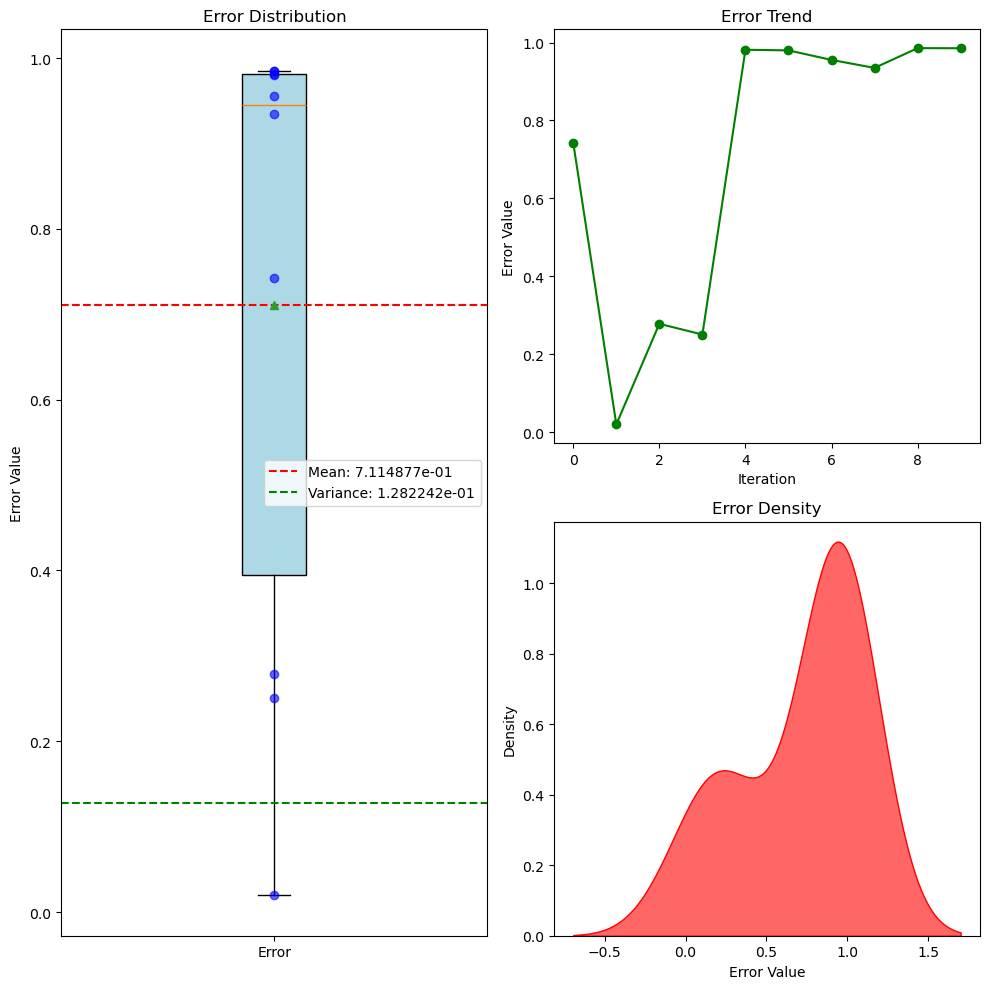

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MAE: 3.617171e-01
Variance MAE: 4.716850e-02


/tmp/ipykernel_3242859/3997509801.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


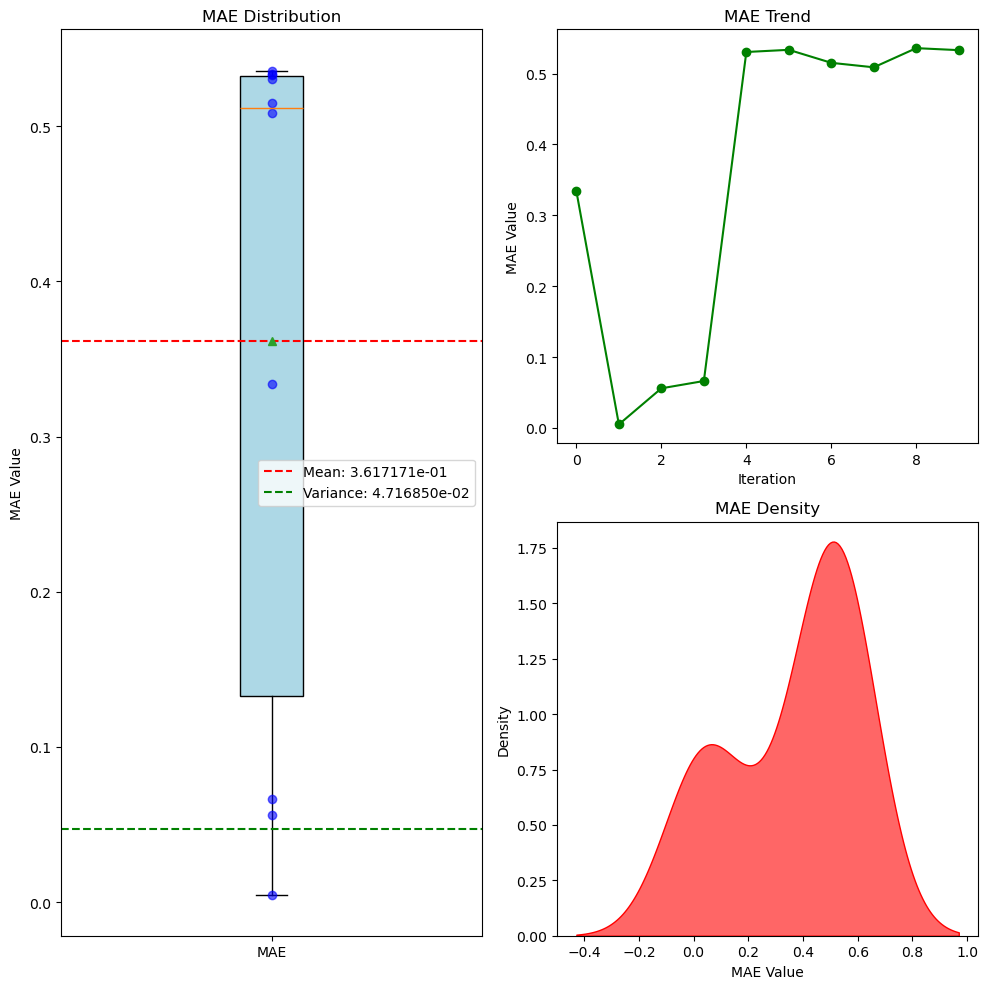

In [10]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MSE: 2.889141e-01
Variance MSE: 3.361482e-02


/tmp/ipykernel_3242859/2305667704.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


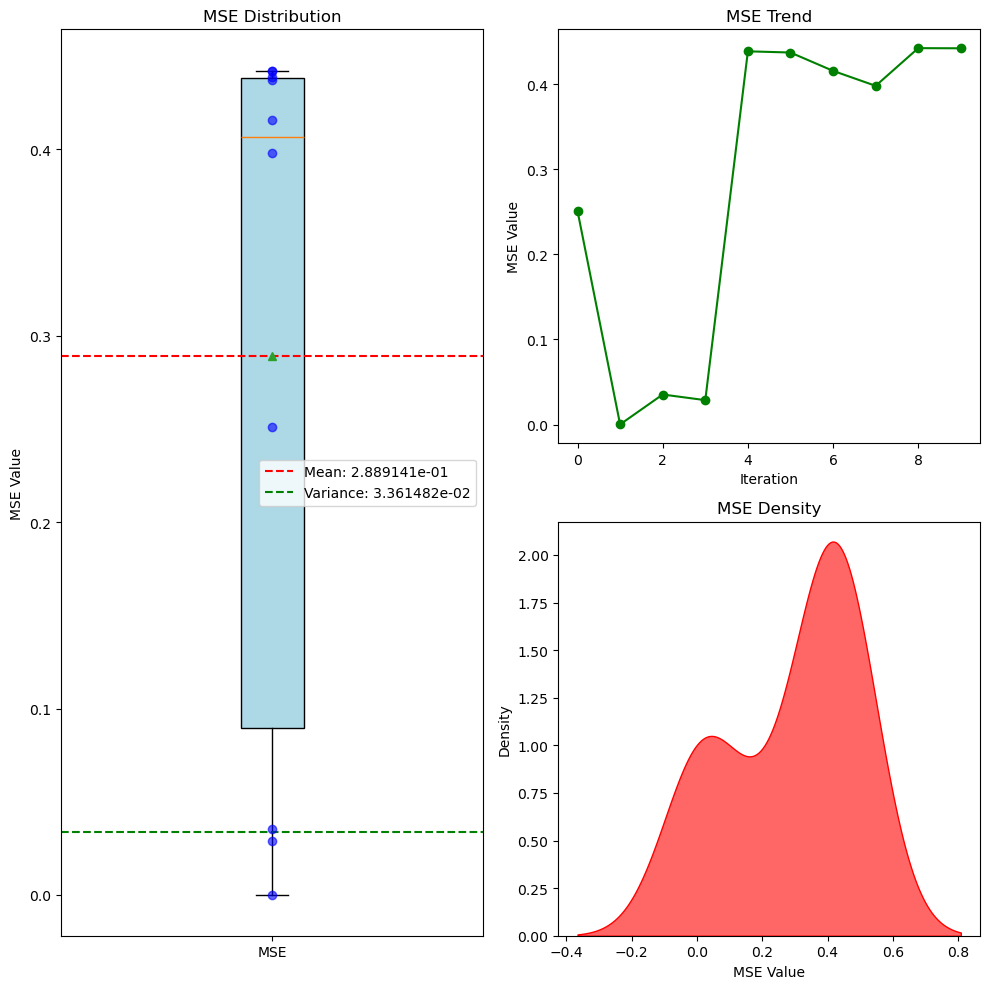

In [11]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [12]:
len_t = 101
len_x = 101

# --- 反向过程 (您需要的部分) ---

# 假设您现在只有 X_star, u_star，以及 len_t 和 len_x
# len_t = 101
# len_x = 256

# 1. 从 X_star 中分离出展平的 X 和 T
flat_X = X_star[:, 0]
flat_T = X_star[:, 1]

# 2. 使用 reshape 将它们恢复为原始的二维形状
# np.reshape 的默认顺序是 'C' (行主序)，这与 flatten 的默认行为一致
# 我们知道原始形状是 (len_t, len_x)
X = flat_X.reshape(len_t, len_x)
T = flat_T.reshape(len_t, len_x)

U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


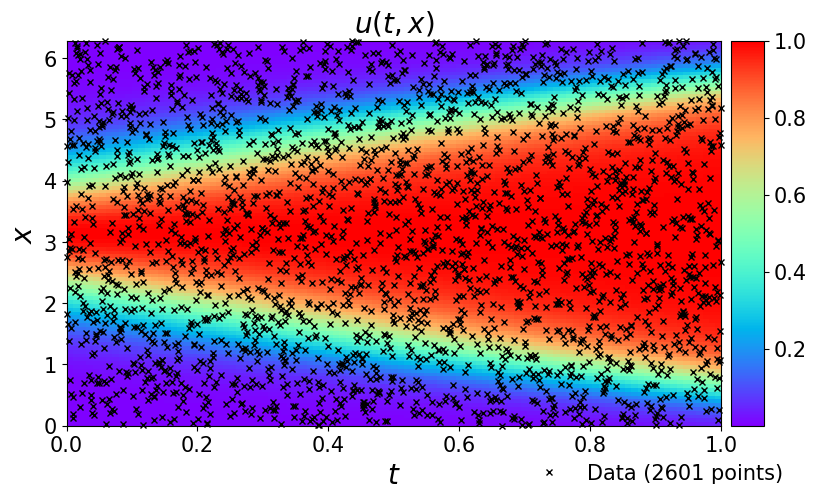

In [13]:
###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
im = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是im，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(im, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（im）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f[:,1], 
    X_f[:,0], 
    'kx', label = 'Data (%d points)' % (X_f.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [14]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()


15880


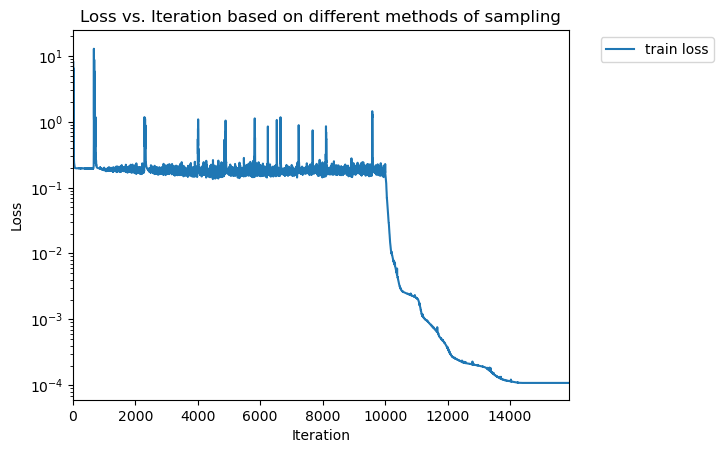

In [15]:
print(len(trainloss))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


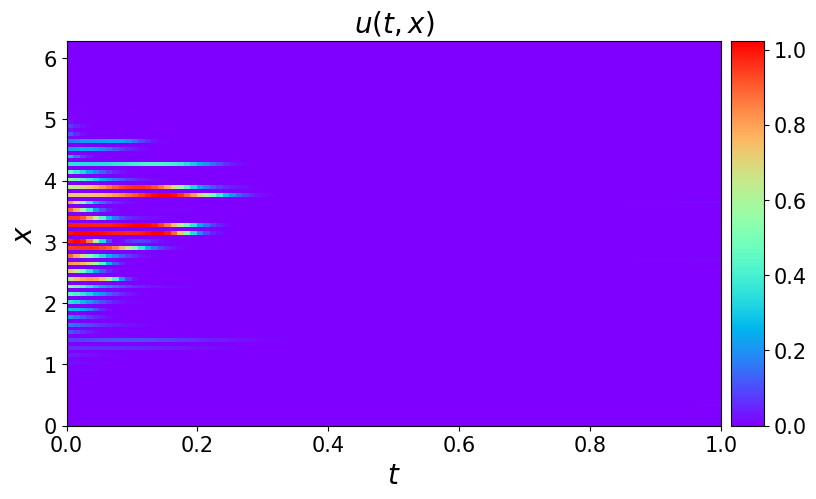

In [16]:
#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
im = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(im, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（im）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

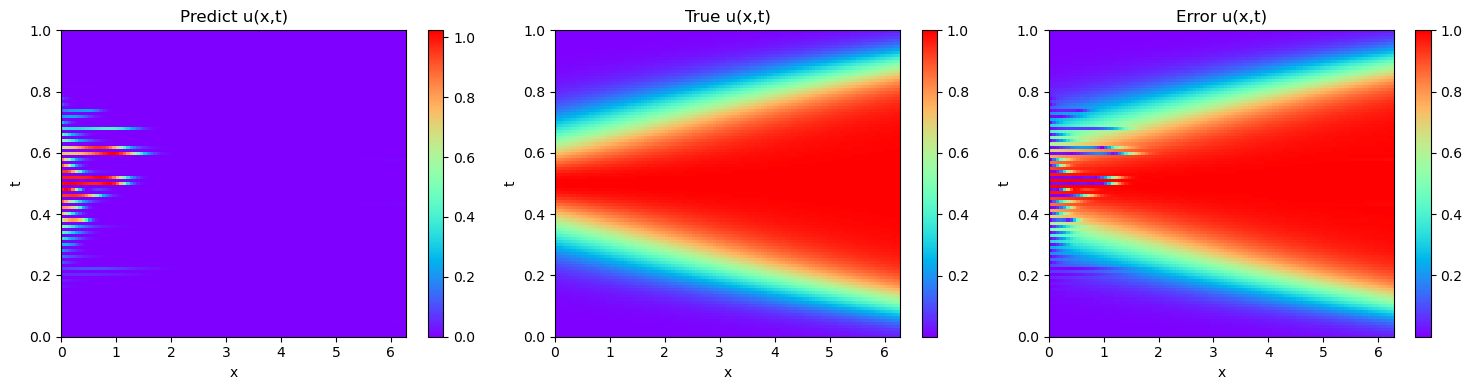

In [17]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [18]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

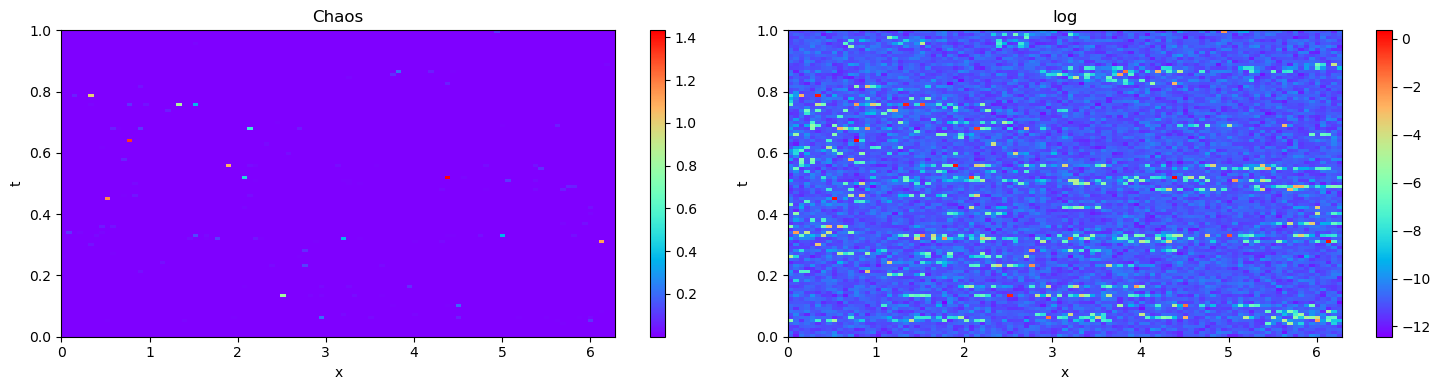

In [19]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()